# TF-IDF: Term Frequency–Inverse Document Frequency

TF-IDF is a numerical statistic that is intended to reflect how important 
a word is to a document in a collection or corpus. It is often used as a 
weighting factor in searches of information retrieval, 
text mining, and user modeling. The tf–idf value increases proportionally to 
the number of times a word appears in the document and 
is offset by the number of documents in the corpus 
that contain the word, which helps to adjust for the fact that some words 
appear more frequently in general. TF-IDF is one of 
the most popular term-weighting schemes today. A survey conducted 
in 2015 showed that 83% of text-based recommender systems in digital 
libraries use tf–idf.

In this post, we will:

- learn how to build up a tf-idf model from scratch
- apply it to match names (entities) 

TF-IDF was invented by [Karen Jones](https://en.wikipedia.org/wiki/Karen_Sp%C3%A4rck_Jones),
her original papers are among the most cited papers in the field of CIS.

## Definition

- TF: term frequency is the number of times a token appears in a document / number of words in document
- IDF: inverse document frequency is a weight indicating how commonly a 
word is used. The more frequency its usage across documents, the lower its score.
For instance, 'the' shows up very often, it has a low score of IDF, The lower
the score, the less important the world becomes.

The formula to compute the tf-idf for a token $t$ of a document $d$
in a document set is:

$$tf-idf = tf(t, d) \times idf(t), \quad idf(t) = \log(\frac{n}{df(t)+1})$$

where $n$ is the total number of documents in the document sett and 
$df(t)$ is the _document frequency_ of $t$; the document frequency is
the number of documents in the document set that contains the term $t$.


For the TF, here is the formula:

$$tf(t, d) = \frac{\text{count}_{t, d}}{\text{len}(d)}, \quad d \in [d_1, d_2, \cdots, d_n]$$

For the IDF, we will implement the smooth version based on the document of 
`sklearn`, which is 

$$idf(t) = \log \left ( \frac{1+n}{1+df(t)} \right ) +1 $$

In [18]:
import time
import struct
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mplt
import pandas as pd
import sklearn as skl
from collections import Counter
from scipy.sparse import csr_matrix
%config InlineBackend.figure_formats = ['svg']

<div>
<?xml version="1.0" encoding="utf-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
  "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<svg xmlns:xlink="http://www.w3.org/1999/xlink" width="405pt" height="188.949375pt" viewBox="0 0 405 188.949375" xmlns="http://www.w3.org/2000/svg" version="1.1">
 <metadata>
  <rdf:RDF xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:cc="http://creativecommons.org/ns#" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#">
   <cc:Work>
    <dc:type rdf:resource="http://purl.org/dc/dcmitype/StillImage"/>
    <dc:date>2023-01-15T00:26:11.286127</dc:date>
    <dc:format>image/svg+xml</dc:format>
    <dc:creator>
     <cc:Agent>
      <dc:title>Matplotlib v3.5.2, https://matplotlib.org/</dc:title>
     </cc:Agent>
    </dc:creator>
   </cc:Work>
  </rdf:RDF>
 </metadata>
 <defs>
  <style type="text/css">*{stroke-linejoin: round; stroke-linecap: butt}</style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="M 0 188.949375 
L 405 188.949375 
L 405 0 
L 0 0 
L 0 188.949375 
z
" style="fill: none"/>
  </g>
  <g id="axes_1">
   <g clip-path="url(#p45ab502d97)">
    <image xlink:href="data:image/png;base64,
iVBORw0KGgoAAAANSUhEUgAABlwAAALYCAYAAAAZ5F/8AAEAAElEQVR4nOz92ZPkyJneCz/uQGwZuVTWkrUvva/shd08M1xnhhzqmI7GTJ9GZjJd6uhW1/pbztGt7mRjNpLpnJGOpNFohsMhmzubZJNd3c1eqrprXzMrl4gA3L8LLAFEIBCAA3A4EO+vOjszFvjy+uv+AP7CHez69S8kciEBsHyHKCAlwKrPpgHosbfJTH1B3RZl+1Ox9KhNi2OOLxTDq4e+Mpnse6QtejHZF/RA2kLMY44vFIO0ZQppi15M9gU9kLYQ85jjC8UgbZlC2qIXk31BD6QtxDzm+EIx2qstPP8hqgXLF9cpz9AS0s9a5itCyahmnt8Q9dazfKa+sMgWyys8FSf/iII2yuafizLRN7Lp9AW9fqduw6JjS7yeWSud7gv5y6RvPNEHaYtqOdQgbSFtUYe0JeFI0hZDIW1RLYcapC2kLeqQtiQcSdpiKKQtquVQg7SFtEUd0paEI0lbtKAQcFGlLsFkYcPVG8HTl7k5kcoyyNKJslZ4+j09NsqSSbUjsk5fqD4vM86a4vXM73sllaLk9JoMaYu2nFrldqQthUpA2lI6pC2mQdqiLadWuR1pS6ESkLaUDmmLaZC2aMupVW5H2lKoBKQtpUPakg2NAZeimOFYq4OEGTZP6kQmlKssTBgksrS1CTY3wVZlYYI9kzCl3+tk1epbN6b4GGlL9ZC26McEeyZhSr/XyarVt25M8THSluohbdGPCfZMwpR+r5NVq2/dmOJjpC3VQ9qiHxPsmUR5/T4x4GLm8jtzHasue1WbLwP8ffTqYnHe7fKF+vsbw3Kb1mvzZto1jWR71t/fsvhC0TxMo13jifn5krao0MwxkLRFP6Qt5tCu8cT8fElbVGjmGEjaoh/SFnNo13hifr6kLSo0cwwkbdFP+7UlMeBS3TIoo1tbmbqWK+rIt05faOIyUJUyN7GeulkVuxbbB1VH3qbmQdrStHxJW/KxKmOgblbFrqQtqpC2NC1f0pZ8rMoYqJtVsStpiyqkLU3Ll7QlH6syBupmVezaJm3RvKUYg+oDdeSSMNeij5cdt+z4rJ+nHLnk9aqSx5Pz+cLCVEoKlZIv1Ek5Niyrv5fni3nSaaBqVg5pC40nAaQt5AsqkLaQtiRB2kLjSQBpC/mCCqQtpC1JkLbQeBJA2kK+oAJpS1O0JUfAZbaD5z/GQ/WBOunHLYpEsYwhqmVfU490JdVjufHm7dv0gahI+fP5wsJUSgpXlusLKjTdFwC18QQozxeKfT79nmobluULQPP9gbRFDdIWD9IW0pYopC3pr/PQdH8gbVGDtMWDtIW0JQppS/rrPDTdH0hb1CBt8SBtIW2JQtqS/joPZvpDjoBLvPLZbDr7JfUIVhOXQiUjkcWR5uvbdAPo9IW6OlvefFXL2XRfANTGE8DUgXSe9HLmG8+W9ZWm+wNpSzmQtniQtpC2RF6RtuRIi7SFtCUJ0hYP0hbSlsgr0pYcaZG2kLYkQdriQdpC2hJ5RdqSI61maEsNW4qlvW4LaY6lu86mdsYqfaEuv0rK1yRfqALd/pVmM5N8vUp/NtVv6rR/U2xUFJPGE5P6WxTSlnb4P2lLMqQtemmKjYpi0nhiUn+LQtrSDv8nbUmGtEUvTbFRUUwaT0zqb1FIW9rh/6QtyZC2pARcdDVUsXxK2oKwxPSyReubhUmdtmm0zRdMJtvSZJ2UPT5Vh86CkrYopoD2jSeN6SAG0jZfMBnSFnVIW+aOJm3RQGM6iIG0zRdMhrRFHdKWuaNJWzTQmA5iIG3zBZMhbVGn/IKmBFx0dYpi+ZS9rLJ4eqYNJmWUx7Q6EeZgmm+YVZ7mLPvWOU6QtiimUEYxSoS0hagS03zDrPKQtlSVV/X5kLYsg7SFqBLTfMOs8pC2VJVX9fmQtiyDtIWoEtN8w6zyrLK2FNpSTG+kSn1/w3Ly00dzIoA6SDKGbgNVmR81dnba1A768mvieELaUlHODfSF6iBtIQLa1A6kLWmQtlSUcwN9oTpIW4iANrUDaUsapC0V5dxAX6gO0hYioE3t0H5tKRRw0Rup0r1nW31huOZEAHWQZAzdBqoyP2rs7LSpHfTl18TxhLSlopwb6AvVQdpCBLSpHUhb0iBtqSjnBvpCdZC2EAFtagfSljRIWyrKuYG+UB2kLURAm9qh/dqiEHDRExqiiHYAGWLqC+q2MGtfU2rT4pjjC8XwCqOvTEZVfgbSFr2QIUhbiHnM8YVikLZMIW3RCxmCtIWYxxxfKAZpyxTSFr2QIUhbiHnM8YVitFdbFAIuqqGhfJUqLwIlw4ar16lUM89vCLM6T3GmvrDIFssr7KUx/V5RG2Xzz0WZ6Auv6vQFvX6nbsOiY0u8nlkrne4L+cukbzzRB2mLajnUIG0hbVGHtCXhSNIWQyFtUS2HGqQtpC3qkLYkHEnaYiikLarlUIO0hbRFHdKWhCNJW7RQaEuxfNQlmCxsuHqXJbZ/uVQ1ZOlE+R96p8dGWTKpdkTW6QvV52XGWVO8nvl9r6RSlJxekyFt0ZZTq9yOtKVQCUhbSoe0xTRIW7Tl1Cq3I20pVALSltIhbTEN0hZtObXK7UhbCpWAtKV0SFuyoTHgUhQzHGt1kDDD5kmdyIRylYUJg0SWtjbB5ibYqixMsGcSpvR7naxafevGFB8jbake0hb9mGDPJEzp9zpZtfrWjSk+RtpSPaQt+jHBnkmY0u91smr1rRtTfIy0pXpIW/Rjgj2TKK/fJwZczFx+Z65j1WWvavNlAFitvrA473b5Qv39jWG5Teu1eTPtmkayPevvb1l8oWgeptGu8cT8fElbVGjmGEjaoh/SFnNo13hifr6kLSo0cwwkbdEPaYs5tGs8MT9f0hYVmjkGkrbop/3akhhwqW4ZlNGtrUxdyxV15FunLzRxGahKmZtYT92sil2L7YOqI29T8yBtaVq+pC35WJUxUDerYlfSFlVIW5qWL2lLPlZlDNTNqtiVtEUV0pam5Uvako9VGQN1syp2bZO2aN5SjEH1gTpySZhr0cfLjlt2fNbPU45c8npVyePJ+XxhYSolhUrJF+qkHBuW1d/L88U86TRQNSuHtIXGkwDSFvIFFUhbSFuSIG2h8SSAtIV8QQXSFtKWJEhbaDwJIG0hX1CBtKUp2pIj4DLbwfMf46H6QJ304xZFoljGENWyr6lHupLqsdx48/Zt+kBUpPz5fGFhKiWFK8v1BRWa7guA2ngClOcLxT6ffk+1DcvyBaD5/kDaogZpiwdpC2lLFNKW9Nd5aLo/kLaoQdriQdpC2hKFtCX9dR6a7g+kLWqQtniQtpC2RCFtSX+dBzP9IUfAJV75bDad/ZJ6BKuJS6GSkcjiSPP1bboBdPpCXZ0tb76q5Wy6LwBq4wlg6kA6T3o5841ny/pK0/2BtKUcSFs8SFtIWyKvSFtypEXaQtqSBGmLB2kLaUvkFWlLjrRIW0hbkiBt8SBtIW2JvCJtyZFWM7Slhi3F0l63hTTH0l1nUztjlb5Ql18l5WuSL1SBbv9Ks5lJvl6lP5vqN3Xavyk2KopJ44lJ/S0KaUs7/J+0JRnSFr00xUZFMWk8Mam/RSFtaYf/k7YkQ9qil6bYqCgmjScm9bcopC3t8H/SlmRIW1ICLroaqlg+JW1BWGJ62aL1zcKkTts02uYLJpNtabJOyh6fqkNnQUlbFFNA+8aTxnQQA2mbL5gMaYs6pC1zR5O2aKAxHcRA2uYLJkPaog5py9zRpC0aaEwHMZC2+YLJkLaoU35BUwIuujpFsXzKXlZZPD3TBpMyymNanQhzMM03zCpPc5Z96xwnSFsUUyijGCVC2kJUiWm+YVZ5SFuqyqv6fEhblkHaQlSJab5hVnlIW6rKq/p8SFuWQdpCVIlpvmFWeVZZWwptKaY3UqW+v2E5+emjORFAHSQZQ7eBqsyPGjs7bWoHffk1cTwhbako5wb6QnWQthABbWoH0pY0SFsqyrmBvlAdpC1EQJvagbQlDdKWinJuoC9UB2kLEdCmdmi/thQKuOiNVOnes62+MFxzIoA6SDKGbgNVmR81dnba1A768mvieELaUlHODfSF6iBtIQLa1A6kLWmQtlSUcwN9oTpIW4iANrUDaUsapC0V5dxAX6gO0hYioE3t0H5tUQi46AkNUUQ7gAwx9QV1W5i1rym1aXHM8YVieIXRVyajKj8DaYteyBCkLcQ85vhCMUhbppC26IUMQdpCzGOOLxSDtGUKaYteyBCkLcQ85vhCMdqrLQoBF9XQUL5KlReBkmHD1etUqpnnN4RZnac4U19YZIvlFfbSmH6vqI2y+eeiTPSFV3X6gl6/U7dh0bElXs+slU73hfxl0jee6IO0RbUcapC2kLaoQ9qScCRpi6GQtqiWQw3SFtIWdUhbEo4kbTEU0hbVcqhB2kLaog5pS8KRpC1aKLSlWD7qEkwWNly9yxLbv1yqGrJ0ovwPvdNjoyyZVDsi6/SF6vMy46wpXs/8vldSKUpOr8mQtmjLqVVuR9pSqASkLaVD2mIapC3acmqV25G2FCoBaUvpkLaYBmmLtpxa5XakLYVKQNpSOqQt2dAYcCmKGY61OkiYYfOkTmRCucrChEEiS1ubYHMTbFUWJtgzCVP6vU5Wrb51Y4qPkbZUD2mLfkywZxKm9HudrFp968YUHyNtqR7SFv2YYM8kTOn3Olm1+taNKT5G2lI9pC36McGeSZTX7xMDLmYuvzPXseqyV7X5MgCsVl9YnHe7fKH+/saw3Kb12ryZdk0j2Z7197csvlA0D9No13hifr6kLSo0cwwkbdEPaYs5tGs8MT9f0hYVmjkGkrboh7TFHNo1npifL2mLCs0cA0lb9NN+bUkMuFS3DMro1lamruWKOvKt0xeauAxUpcxNrKduVsWuxfZB1ZG3qXmQtjQtX9KWfKzKGKibVbEraYsqpC1Ny5e0JR+rMgbqZlXsStqiCmlL0/IlbcnHqoyBulkVu7ZJWzRvKcag+kAduSTMtejjZcctOz7r5ylHLnm9quTx5Hy+sDCVkkKl5At1Uo4Ny+rv5flinnQaqJqVQ9pC40kAaQv5ggqkLaQtSZC20HgSQNpCvqACaQtpSxKkLTSeBJC2kC+oQNrSFG3JEXCZ7eD5j/FQfaBO+nGLIlEsY4hq2dfUI11J9VhuvHn7Nn0gKlL+fL6wMJWSwpXl+oIKTfcFQG08AcrzhWKfT7+n2oZl+QLQfH8gbVGDtMWDtIW0JQppS/rrPDTdH0hb1CBt8SBtIW2JQtqS/joPTfcH0hY1SFs8SFtIW6KQtqS/zoOZ/pAj4BKvfDabzn5JPYLVxKVQyUhkcaT5+jbdADp9oa7Oljdf1XI23RcAtfEEMHUgnSe9nPnGs2V9pen+QNpSDqQtHqQtpC2RV6QtOdIibSFtSYK0xYO0hbQl8oq0JUdapC2kLUmQtniQtpC2RF6RtuRIqxnaUsOWYmmv20KaY+mus6mdsUpfqMuvkvI1yReqQLd/pdnMJF+v0p9N9Zs67d8UGxXFpPHEpP4WhbSlHf5P2pIMaYtemmKjopg0npjU36KQtrTD/0lbkiFt0UtTbFQUk8YTk/pbFNKWdvg/aUsypC0pARddDVUsn5K2ICwxvWzR+mZhUqdtGm3zBZPJtjRZJ2WPT9Whs6CkLYopoH3jSWM6iIG0zRdMhrRFHdKWuaNJWzTQmA5iIG3zBZMhbVGHtGXuaNIWDTSmgxhI23zBZEhb1Cm/oCkBF12dolg+ZS+rLJ6eaYNJGeUxrU6EOZjmG2aVpznLvnWOE6QtiimUUYwSIW0hqsQ03zCrPKQtVeVVfT6kLcsgbSGqxDTfMKs8pC1V5VV9PqQtyyBtIarENN8wqzyrrC2FthTTG6lS39+wnPz00ZwIoA6SjKHbQFXmR42dnTa1g778mjiekLZUlHMDfaE6SFuIgDa1A2lLGqQtFeXcQF+oDtIWIqBN7UDakgZpS0U5N9AXqoO0hQhoUzu0X1sKBVz0Rqp079lWXxiuORFAHSQZQ7eBqsyPGjs7bWoHffk1cTwhbako5wb6QnWQthABbWoH0pY0SFsqyrmBvlAdpC1EQJvagbQlDdKWinJuoC9UB2kLEdCmdmi/tigEXPSEhiiiHUCGmPqCui3M2teU2rQ45vhCMbzC6CuTUZWfgbRFL2QI0hZiHnN8oRikLVNIW/RChiBtIeYxxxeKQdoyhbRFL2QI0hZiHnN8oRjt1RaFgItqaChfpcqLQMmw4ep1KtXM8xvCrM5TnKkvLLLF8gp7aUy/V9RG2fxzUSb6wqs6fUGv36nbsOjYEq9n1kqn+0L+MukbT/RB2qJaDjVIW0hb1CFtSTiStMVQSFtUy6EGaQtpizqkLQlHkrYYCmmLajnUIG0hbVGHtCXhSNIWLRTaUiwfdQkmCxuu3mWJ7V8uVQ1ZOlH+h97psVGWTKodkXX6QvV5mXHWFK9nft8rqRQlp9dkSFu05dQqtyNtKVQC0pbSIW0xDdIWbTm1yu1IWwqVgLSldEhbTIO0RVtOrXI70pZCJSBtKR3SlmxoDLgUxQzHWh0kzLB5UicyoVxlYcIgkaWtTbC5CbYqCxPsmYQp/V4nq1bfujHFx0hbqoe0RT8m2DMJU/q9TlatvnVjio+RtlQPaYt+TLBnEqb0e52sWn3rxhQfI22pHtIW/ZhgzyTK6/eJARczl9+Z61h12avafBkAVqsvLM67Xb5Qf39jWG7Tem3eTLumkWzP+vtbFl8omodptGs8MT9f0hYVmjkGkrboh7TFHNo1npifL2mLCs0cA0lb9EPaYg7tGk/Mz5e0RYVmjoGkLfppv7YkBlyqWwZldGsrU9dyRR351ukLTVwGqlLmJtZTN6ti12L7oOrI29Q8SFuali9pSz5WZQzUzarYlbRFFdKWpuVL2pKPVRkDdbMqdiVtUYW0pWn5krbkY1XGQN2sil3bpC2atxRjUH2gjlwS5lr08bLjlh2f9fOUI5e8XlXyeHI+X1iYSkmhUvKFOinHhmX19/J8MU86DVTNyiFtofEkgLSFfEEF0hbSliRIW2g8CSBtIV9QgbSFtCUJ0hYaTwJIW8gXVCBtaYq25Ai4zHbw/Md4qD5QJ/24RZEoljFEtexr6pGupHosN968fZs+EBUpfz5fWJhKSeHKcn1Bhab7AqA2ngDl+UKxz6ffU23DsnwBaL4/kLaoQdriQdpC2hKFtCX9dR6a7g+kLWqQtniQtpC2RCFtSX+dh6b7A2mLGqQtHqQtpC1RSFvSX+fBTH/IEXCJVz6bTWe/pB7BauJSqGQksjjSfH2bbgCdvlBXZ8ubr2o5m+4LgNp4Apg6kM6TXs5849myvtJ0fyBtKQfSFg/SFtKWyCvSlhxpkbaQtiRB2uJB2kLaEnlF2pIjLdIW0pYkSFs8SFtIWyKvSFtypNUMbalhS7G0120hzbF019nUzlilL9TlV0n5muQLVaDbv9JsZpKvV+nPpvpNnfZvio2KYtJ4YlJ/i0La0g7/J21JhrRFL02xUVFMGk9M6m9RSFva4f+kLcmQtuilKTYqiknjiUn9LQppSzv8n7QlGdKWlICLroYqlk9JWxCWmF62aH2zMKnTNo22+YLJZFuarJOyx6fq0FlQ0hbFFNC+8aQxHcRA2uYLJkPaog5py9zRpC0aaEwHMZC2+YLJkLaoQ9oydzRpiwYa00EMpG2+YDKkLeqUX9CUgIuuTlEsn7KXVRZPz7TBpIzymFYnwhxM8w2zytOcZd86xwnSFsUUyihGiZC2EFVimm+YVR7Slqryqj4f0pZlkLYQVWKab5hVHtKWqvKqPh/SlmWQthBVYppvmFWeVdaWQluK6Y1Uqe9vWE5++mhOBFAHScbQbaAq86PGzk6b2kFffk0cT0hbKsq5gb5QHaQtRECb2oG0JQ3SlopybqAvVAdpCxHQpnYgbUmDtKWinBvoC9VB2kIEtKkd2q8thQIueiNVuvdsqy8M15wIoA6SjKHbQFXmR42dnTa1g778mjiekLZUlHMDfaE6SFuIgDa1A2lLGqQtFeXcQF+oDtIWIqBN7UDakgZpS0U5N9AXqoO0hQhoUzu0X1sUAi56QkMU0Q4gQ0x9Qd0WZu1rSm1aHHN8oRheYfSVyajKz0DaohcyBGkLMY85vlAM0pYppC16IUOQthDzmOMLxSBtmULaohcyBGkLMY85vlCM9mqLQsBFNTSUr1LlRaBk2HD1OpVq5vkNYVbnKc7UFxbZYnmFvTSm3ytqo2z+uSgTfeFVnb6g1+/UbVh0bInXM2ul030hf5n0jSf6IG1RLYcapC2kLeqQtiQcSdpiKKQtquVQg7SFtEUd0paEI0lbDIW0RbUcapC2kLaoQ9qScCRpixYKbSmWj7oEk4UNV++yxPYvl6qGLJ0o/0Pv9NgoSybVjsg6faH6vMw4a4rXM7/vlVSKktNrMqQt2nJqlduRthQqAWlL6ZC2mAZpi7acWuV2pC2FSkDaUjqkLaZB2qItp1a5HWlLoRKQtpQOaUs2NAZcimKGY60OEmbYPKkTmVCusjBhkMjS1ibY3ARblYUJ9kzClH6vk1Wrb92Y4mOkLdVD2qIfE+yZhCn9XierVt+6McXHSFuqh7RFPybYMwlT+r1OVq2+dWOKj5G2VA9pi35MsGcS5fX7xICLmcvvzHWsuuxVbb4MAKvVFxbn3S5fqL+/MSy3ab02b6Zd00i2Z/39LYsvFM3DNNo1npifL2mLCs0cA0lb9EPasvzLBX8y067xxPx8SVtUaOYYSNqiH9IWc2jXeGJ+vqQtKjRzDCRt0U/7tSUx4FLdMiijW1uZupYr6si3Tl9o4jJQlTI3sZ66WRW7FtsHVUfepuZB2tK0fElb8rEqY6BuVsWupC2qkLY0LV/Slnysyhiom1WxK2mLKqQtTcuXtCUfqzIG6mZV7NombdG8pRiD6gN15JIw16KPlx237Pisn6ccueT1qpLHk/P5wsJUSgqVki/USTk2LKu/l+eLedJpoGpWDmkLjScBpC3kCyqQtqyKtsjoPymR/g8J7yxOOfZKUVsg/fvqGIv8+K8jbUTaohvSFvIFFUhbVkVb8kHXLTSeBJC2kC+oQNrSFG3JEXCZ7eD5j/FQfaBO+nGLIlEsY4hq2dfUI11J9VhuvHn7Nn0gKlL+fL6wMJWSwpXl+oIKTfcFQG08AcrzhWKfT7+n2oZl+QLQfH8gbVGDtMWDtIW0JQppy8LXcsHPQhT8IVf65SClnF6wSUAIASBuQyllok2jxcvsK1L6P5ipZzz9ZW248GM2n1b4OvI2aUvVkLaQtkQhbUl/nYem+wNdt6hB2uJB2kLaEoW0Jf11Hsz0hxwBl9kLifzHFInENXEpVDISWRxpvr5NN4BOX6irs+XNV7WcTfcFQG08AUwdSOdJL2e+8WxZX2m6P5C2lANpiwdpC2lL5BVpS+TIRWs4FqWd0x/kTB7+6pGkwAsL/rFiP0G+Qohw9YfjOGCMgXMOzrn3vgQsbnlljFzNRu2V1VemMZbkVS+JZVzC3DFhfGX6L/bdmfeqhbTFg7SFtCXyirQlR1p03ULXLUmQtniQtpC2RF6RtuRIqxnaUsOWYmmv20KaY+mus6mdsUpfqMuvkvI1yReqQLd/pdnMJF+v0p9N9Zs67d8UGxXFpPHEpP4WhbSlHf5P2pJMlW1bcto5kiuyu0U0uCOkgOu6cF0XjuNAuAJSSnCLw3EmcF03ZdsD9UKkbzXWBEwaT0y1JWkLaYsKq6gtTTknp+uW6jFpPDGpv0UhbWmH/5O2JEPaYqd/UUcliuUjZbmR/uLp6bKbTtpYJ12Q3fTBYJqvlj0+VYdOu5G2KKYAk3y7HNpYJ12Q3fTRHm2pUpPC1SxRFuU18/58mbLe+cpgWRYsywIA2JYNe2iDMw4hhLfyhTF0O12MxiMw5q9OKRB0CVatlNUGsSQi1WZgsQ8ZWGK5SVuSaGOddEF200d7tEU/dN0ydzRdt2igjXXSBdlNH6Qt6pRvt5SAiy6LFMun7IYrnp5pnlRGeUyrE2EOpvmGWeVphrAAescJ0hbFFMooRomQthBVYppvmFUe1fGkMk2Si16oZpjxOCnhOA7ef/8qxuMxGPeCK0IKdDodjEdjuK6Dbq+HkydOYuvYFjp2yqVPpjz9ElbRBjPBlmjQRUrpBV3mtjBTK8dcpsZA2kJUiWm+YVZ56Lqlqryqz4euW5ZB2kJUiWm+YVZ5VllbCl116I1UzUabqo7a1RcVbE4EUAdJ7aC7barMz6zos9m0qR305dfE8YS0paKcG+gL1UHaQgS0qR0S8ovMz8efX8LC99j0zew5RY6T/v/mggESkEyGfy9MX3GnCekHXH7/+9/jwYMHGI1HkEJi4kywvr4OKQQY49jc2sSXXv0S1jfW0el0MtYwns9ceeTUhnPPapnbZnpRBRlkfCFLYrAleF+yhFVEsUxJW+qHtIUIaFM70HVLGnTdUlHODfSF6iBtIQLa1A7t15ZCARe9BZ7NrOrM6+vwJCxRkoyh20BV5keNnZ02tYO+/Jo4npC2VJRzA32hOkhbiIA2tUNyfsueMRJ8mre0Mvz/4nyZ9AM7LAi6LEoruYxpD4eXAMAYev0eHj16hA8//BAffPgBjg6PsHVsC+fPn8eVy1dwbPsY+v0+OC/w6Mqg7DPGCsoXDbrE6pISI2ER20UDLNOgS56duElbzIC0hQhoUzvQdUsadN1SUc4N9IXqIG0hAtrUDu3XFoWAi54oFEW0AyjaO/UFdVuYta8ptWlxzPGFYnj10Fcmk32PtEUvJvuCHkhbiHnM8YViTLUlz5S9GnVOxjD0uj18/Wtfx5kzZzBYG+Da9Wv47LPPsLa2hrfffhvf/va3cfLkSQwGg/BZL8okuceS6i8MdknMrW6ZJ1/IxQxoHCJtIeYxxxeKQdctU+i6RS8m+4IeSFuIeczxhWK0V1sUbvVSLVi+C4byDC3DlfwLV/RrQTXz/Iaot57lM/WFRbZYXuGpOPlHFLRRNv9cfE+jLnT6gl6/U7dh0bElXs+slU73hfxl0jee6IO0RbUcapC2kLaoQ9qScOQqa4v0AwsSXkWCn1JYnA4DA2MMG5sbuHTpEi5evIi1tTWMRiN0e11cuHABzz77LLY2t9Dr9ea3/qqThKIw/5/3X91lJW1RhbRFHdKWhCNXWVtqHwfToOsW1XKoQdpC2qIOaUvCkaQtWiiwtj4vdQkmCxuu3uus9i+XqoYsnShrhaff02OjLJlUOyLr9IXq8zLjrClez/y+V1IpSk6vyZC2aMupVW5H2lKoBKQtpaNDWxhjYTBEJl4RFjQ2A8C8jbLKs+p8mcLnz/j/GBjWBmtYW1sLV7FwztHv9zEYDMA4Uwq2yIV2ipZOLe20/OoPtgCkLaqQthQqAWlL6dB1i2nQdYu2nFrldqQthUpA2lI6pC3ZKPQMF73QkjO9BB25bpsn5d8mXzChHlna2gSb151/mZhgzyRM6fc6MbUt2oopPkbaUj2kLfrx7RmsOInAGPOCB4xBuC445963o1dMM82xLNgQ/ZwxFuYhhIjnzdmCIEIkw5kyB+nN5sW8D8PPhCvgwAFjzHtGi5SwLMsPLgFCCLium1aJ1EvXab6RsmAaFGGMgXEGKWRYfsZYaAMpZVjNucBM8H4kaOO6LrjFw/JH0zXkGttQSFv0YEI9SFv0Y4I9kzCl3+vE1LZoK6b4GGlL9ZC26McEeyZRXr9PXOFi5vI7ExvCoy57VZsvA8Bq9YXFebfLF+rvbwzLbVqvzZtp1zSS7Vl/f8viC0XzMI12jSfm50vaokIzx0DSFv1MV34kfhoERQA4juMFJ7iFjt0Jv8MZDwMWruvCcRw4jgMhRLgCI+knCHhIKTEajTAajTAejyEh0el0YNv2NJAQLW8k0BLNi3Pvu7FAjb9TGQMDZzz8TlDnIKBkcY5OpwPGGYQrMBmPMR6Nw/oxP99gF7RwxU+wNCf4LNLYnDPYHa8Ok8kkLGcQMOGWZzfOeVjiyWSC8WiM8XgM+DaK/gjp2dSyLHS7XfT6vbAeoT1922RZbZMV0pZqIG3RBWmLfui6xRzaNZ6Yny9piwrNHANJW/TTfm1JXOFS3TIoUyNYxahruaKOfOv0hSYuA1UpcxPrqZtVsWv2fVDLr1zbx5MmQtqiAmlLkWNWjVWxa7j6w0cKCcEYhJSYTCbhJH8w0R8cw+Ct3gCmE/5Jq1qin3c73VgatmV5K0zSuqafZMfueCtkpMB4PIZt27Dt+KVKkP/EmcB1XQz6AxwdHUEIEa5mGY8nYbBISIFurweLW+HxQggIGV+F4xUjvp1XUL8gsMO5F+SxbTtcecLAICHhTPyglPDSd4XrBWT8uh0cOuj1euGWZ8HxjuPAmTjgnKPb7cK2bQghvOCNxQFnWevmh7RFBdKWIsesGqtiV7puUYWuW5qWL2lLPlZlDNTNqti1TdqieUsxhuyGiX8vehGY+G2ZbJxlxy07PuvnKUciXt92Cmx+8tggny8sTEXxuPl0yBfqoxwbltXfy/PFPPUgn5mHtIXGkwDSFvIFFVqmLQkr4aWU4IyBcY5urwshRBhcCFdSeMs9vAUekVUfQk6DGcFxjDEwK95/gmCIbduADAI9DGCRLbdm71pjiAV1ODhs5q0kCQIc0TyCwEqwamYymXirS4Q1XWHiP7Ol0+mg1+tBSi+wEdaTeQGPsAgLbB0+xD6avytCewQBFs45uMWnwSHffcLglJyuwAmCWJZthatjQpv7wZog6OK6rldOFhYo8yoXGk/KhrSFfEGFlmnL9B3QdUsR6LqFxpMA0hbyBRVIW5riMzkCLrMdPIvxkwymakC1yG/Whl/2NfUxKakeyx1p3r5NH4iKlF/Vh2aOKilcWa4vqNB0XwDUxhOgPF8o9vn0e/X6tEfT/YG0RQ3SFg/SFtKWKKQtU6a2CCbpJWNg/uT/wcEBDg8PcXR4hKOjIzx+/BhHR4dwXBeMMXS7XQwGA/S6PfR6PQzWvL/tju0FUiK7EkefP3J4cIjbd27j0cNHODg4wMSZYG2whpMnT2Dr2DEMh0P0uj0w5h8XWQ1z8+ZN3L17F/v7+3D9coS18S/KTp08ictXrmBtbc3LU7hzQRnA287rzp07uHr1Ku7evQvGGE6ePOnl3+uh0+nMWWy2DbzyAY8fPcbDRw/x6OEj7O/voz/oY3t7G5ubmxgOh+jYHdy7fw9379zFwcEBBoMBTpw8geFwiH6/7+Vnd/D48WM8evgIe0/2cLB/gMOjQ1iWheHaEOvrQ2xsbmJzcxOWZUFKCddxwJi/RVlOnyBtKQppC2lLFNKW9Nd5aLo/0HWLGqQtHqQtpC1RSFvSX+fBTH/IEXCJF17NEdQjcU1cCpVMtjrP17fpBtDpC3V1trz5qpaz6b4AqI0ngKkD6Tzp5cw3ni3rK02wRxqkLeVA2uJB2kLaEnm1atoys0ol+Gaw+iRYkbH3ZA+fffYZbty4gVu3buHO7du4+sEHuHvnLkbjEWzbxskTJ3Hm7Blsb29jZ2cHly9fxqVLl7Czs+MFTDiDxa3Yao/RaIRPP/kEf/M3/wvv/fY93LhxA/v7+7hw4QL+t698Ba+88gqeeupp7OzsoN/vwbJtBBs1W9zCr3/9a3zve9/D+++/j1u3bmEymYQrVTqdDrrdLv7kj/8Y/+pf/Z/o9/pwXAfBA+odx8FkMoHreNuX7T7exY/eeQcff/wxrr5/FSdPncQbb7yBK5ev4Ny5czi1cwq2ZYFzK+4nDIg+xH48HuO3v/stfv7zn+Pdd9/F9evXceHCBbz11lt49dVX8eKLL2JtbQ2/+tWv8N//23/Hxx9/jNOnT+Ptt9/GU08/hQsXLuDMmTPY2trC59c/xy9/+Utc/eAqPv79x7h95zYGgwEunL+Ap556Cq+++ipef+N1HD9+HJx5W77ZVt1+SdriQdpC2hJ5tWraQtctEei6pRxIWzxIW0hbIq9IW3Kk1QxtYdevf5FtbTqRA5M6gEllWUXabn+T6mdSWVYRsn/1mGRjk8qyirTd/ibVz6SyLMEPXgj/d/h8FSGwf3CARw8f4dq1a/gv/+W/4Ht//z2Mx2Mc3z6O115/DX/wB3+A8+fPYzAYwHVd7D7exY9/8mP88pe/xLVr1/DkyRN885vfxL/8l/8SX3r1Szhz9gwA4NHDR3j8+DE++fQT/PznP8f/85//M8aTCV599VW88sorePmll7A2HOJ//Pf/gY8++ghCuPja17+O73z72zh16hQ63S4Ab1uz/Sf7uHP3Dn72s5/hL/7iL/DjH/8YlmXhT//0T/Hd734XX/7yl3H27FkMh8Mw0OJVW2J/fx8/+Icf4N/9u3+Hn//i57AtC+vr6zi2vY2zZ8/ixRdfxNHRERhjGA6HeOaZZ/Dqq6/iwoULGA6H4cqY8JktYJg4E/yn//if8B/+w3/AtevXMBqNAIlw1cr29jYuX76Mb33rWxhPxvhv/+2/4ac//Qn29nZx+vRZnDt3Dl/72tfwR3/0R3j9tdfxb/7Nv8F7v30Pg8EAr732Gv7JP/kn2NnZwa2bt/Db3/4Wf//9v8cf/MEf4J//83+OixcvYjAYzN01mHVLsZyOA3N83KSyrCJtt79J9TOpLKsI2b96TLKxSWVZRdpuf5PqZ1JZVpG4/VNWuOhqqGL5qO8dWFV6bXTwNtZJF2Q3fTCY5qtlj0/VodNupC2KKcAk3y6HNtZJF2Q3fTRQWyTguN6KD8B7GP2v3n0X3/+Hf8Bf//Vf4969e3jtS6/hD/7wD/DGG2/gzJkz2NnZAWMMjuN4D6MfDPDiSy/im9/8Jn7205/h//2r/xfv/vJdvPXlt7Czs4PNzU1wi2M0HuFXv/4Vvve97+H73/8+9vb28C/+xb/A17/+dTzlb/0lpMQ//f/9U/z93/89fvSjH+Ev//IvwRnDP/pH/ztOnzkNzjkODg7Q6XZw4cIFHB0d4fcf/R6//tWvMRqN8MrLr+BP/uRPMBwOMegPwjoGwQiLW+DMf3YL9wImJ06cwB//yZ/g61//Ol566SV0u11MJhPs7e3hzp07ePfdd/HRRx/hzTfexAsvvICLFy+CWxyMMViWhcODQ3z00Yf4n3/zP3Ht+jWMRyOcOHECX/3qV/H222+DMx4+Z+batWv45S9/iQ8+uIrDw0McP34C//r//Nd46eWXwtUtjx49ws1bN/Hyyy/j7bffxrf/5Nu4fPkyGAMuXLiAUzunwDjDX//1X6Pf7+PrX/86XvvSaxgMBp73LWhv0pYk2lgnXZDd9NFAbTEGum6ZO5quWzTQxjrpguymD9IWdcq3W0rARZdFiuVTdsMVT880TyqjPKbViTAH03zDrPI0Q1gAveMEaYtiCmUUo0RIW4gqMc03zCrPwvHE/4BbDH3bW4Wxu7uLd955B3/zN/8TP/npT3H9+jW8+eaX8Wd/9md48aUXwxUjw7UhhHDhCgEpJfr9PoZrQ6wN1rC2tgbLtvBXf/VXuHHjBu7fu48rl69grbuGx48f44MPPsCHH36IBw8e4MUXXsBbX/4ynrpyBdvbx2FZHFICly9fxt27d3H79m188MEH+NGPfhQGOU6fPo1ut+utLPGfH2N3bEh426Ctb6zj+PHjODr0VqgED7IPH2jPgNifjGH7+HG88cYb+MY3voHNzU0IITCZTHDi+AkcO3YMB/sH+Lvv/R1+9etfQUiB7ePb2D62DVe4YGAYj0f49NNP8eGHH2L38SOcO3ceb731Fr773e/imWeeQa/XA6S35djp06dx48YN9Hp9b/s2IfHVr34VZ8+dxfr6OhhjuHbtGtbX1/H666/jzTffxMWLF3H8+HE4zgSWv4Xb6Z0dXL9+DR9//Hs89dRTuHz5MvqDPoBw8VJ2X8juTUUTKBnSFqJKTPMNs8pD1y1V5VV9PnTdsgzSFqJKTPMNs8qzytqS4xku8+iNVKnvb1hOfvpoTgRQB0ntoLttqszPrOiz2bSpHfTl18TxhLSlopwb6AvVQdpCBLSpHbz8OOewbRucc+zt7eFv//Zv8YMf/BCff34da2tr+M53voNv/dG3cOzYMTDGYNve5QDnHMx/AD2D9+yU48ePo9vrYm1tDR9//DEePnyIe/fu4cn+E3Q6Hdy8eRO/+93v8MUXX6Bjd/DSSy/jmWeexdbWsTBdxoBBf4CLFy/i6aefRqfTwa9/8xu8+qUv4eTJUzhx4gS63a53T56U3soV6f0tpPC2+WIcrutmtsT6+jouXLiAS5cuYX9/H67rgjOOXreHfr+Pl19+GT/+yY/x2WefwbIsXLlyBdvHtr0tuxgwcRzcuXsX9+/fx3gywekzZ/D2W2/jjTfewNqaF4RijGEymeD0mdN477338Otf/xrXrnnlfOrppzDoD9DpduA4Dg4PD3H58mW89tprePbZZ8PtwuxOB/ZkAs45hJDY293F3bv3cP/+fezt7eH06dO52r4OSFuikLYQAW1qB7puSYOuWyrKuYG+UB2kLURAm9qh/drCixyst8CzmVWdeX0dnoQlSpIxdBuoyvyosbPTpnbQl18TxxPSlopybqAvVAdpCxHQpnbw8pNSYjwe4/79+/jFL36B//k3/xM3bt7A1rFj+OpXv4Z/9s/+GU6cOIFOpwPLssAYg+uvbhFCwHVdjEZHGE/GEFKg0+ng1MlT+LM/+zMwznDnzh1cv3YdN27cwC9/+Uv87Gc/wd07d3Dq1Ck899xz2Dq2Fa5YAQNG4xEODw+xubGBC+cvYGN9A9evX8f1a9dx584dPHnyBFJKcG6h2+thbbCG4XAIy7IAAIeHBzg42PdWlWSAcw7LssJAx8HBAcYjry5CCjDOcPr0abz++us4OjrCb37zG7zzzjsYjUfhNmXCt8VgMEC/P8CFCxfwyiuvYGNjA67j4MneExweHoJzjm6ni4sXL+LY1hZsywbnFmzbhuM6GI/HGI28dL/xjW/g9ddex9kzZyGlxKNHD+E4DibjMR4+fICrV6/Csjo4PDzEkyde+nnbvg5IW6KQthABbWoHum5Jg65bKsq5gb5QHaQtRECb2qH92qKwwkVPFIoi2gEU7Z36grotzNrXlNq0OOb4QjG8eugrk8m+R9qiF5N9QQ+kLcQ85vhCEYKHyF/77DP8p//4H3Hv3j2MRiO8/PLL+Nf/+l9jOByi3+9DCAHHceaOZ4wBjEFKGX4+HA7x2muv4eDgAL1eD4wBruvi/v37YMzC9vHjuHjpIi5cvADXdXF4dAjL8gIP3W4XALC+sYHTZ05j5/QObNvG797/HU6fOY3zF85jc3MTUkgwzuC4Do6OjmBxC4wBlmXD9oNDWesvXBecMXQ7XQz6A0ycSRhM4ZxjfWMdOzs7GA6H+PTTT/G9730PL730Et58880wsDMajTAZTwAJWJaFbreDfq8Hi1vhypvAho7jQAL+6pgJpJThKpZut4svfelLeO2112BZVrhSR0rghz/8IX7wgx/gnXfewU9+8hPYtoXNzU1sb29jc3OzoCfUAY1DpC3EPOb4QjHoumUKXbfoxWRf0ANpCzGPOb5QjPZqi0LARbVg+SpVnqElpGRgrG6nUm3U/MeY1XmKM63Lokott+2sOBW1UbZjF5VLX+Po9AW9fqeeUdEyxuuZtV+n+0L+MukbT/RB2qJaDtIWNUhb1CFtSTjSIG2RUmJvbw/Xrl3HvXv34Tounn/uebz11lu4ePEiut0uXNedbt+VQPC+lDL83nA4xNtvvx2uirl37x5u376Ng4MD9Ht9dDodbKxvoN/vh9+JpBjWb3YVieu4EK4LAQG7Y/s1C8om/R+vLPHaS7AF9Q+eRYOZPKP16tgddDtdTMYT3Lx5E3fv3p2zSbCt2Wzei2w2a8/guTSccxwdHWH38S729vZw5+4dvPvuu/hf/+t/4YsvvsCDBw8gpcTZc+fwxhtv4IUXXsCpU6fA/MCXfkhbVCFtUYe0JeFIg7SFrlui0HWLajlIW9QgbVGHtCXhSNIWLRR6hks+6hrtohd4NRXBL4e2nFokLNk6UdYKT7+nx0ZFBp2SSqDRF6rPy4y7IOL1zO97JZWi5PSaDGmLtpxa5XakLYVKQNpSOmVqi5QSu4938emnn+L+/ftwXReXLl3EC8+/gGPHjsVWWSQFXJLek9ILbhzbOgbGGcbjsfcg+vEYwnXBmPfMl7W1NXQ7HQQrZJj/L21+QEL6D4XPF1hICrZEy7ssNcuywDnHxJlgd3cX9+/d97YeE2KujN4zZYKXySkHz5rxaxwGSjjjkEzi4OAAH3/8MT768CP87v3f4dNPP8WHH34IZ+JgOBzi8qXLeOPNN/D2W2/jwoUL3nNtIgEivZC2qEHaUqgEpC2lQ9ctpkHXLdpyapXbkbYUKgFpS+mQtmRDY8ClKGY41uoQXNjVbfOk/NvkCybUI0tbm2DzuvMvExPsmYQp/V4nprZFWzHFx0hbqoe0RT/+knwh8ejRI3zyySe4f/8+hHBx9uxZXLp8CYPBwFu1IUTiioxYUsB0hQXzVqRY3PLCCcE2W70euGXBsjg6nQ76/R46nQ4c1w0DF4xPgwbBT5A2GMJyLAwqTBe5hOl4EQ2/jGltOJtkxOUY9/J3Jg729vZw/8F9HB4ehsGo+GHBv8UwsLAuLLiN2PsAnHE8evQIv/jFL/CDf/gBfvbzn6Hf76Pf7+P06dM4d+4cXnnlFXzta1/Ds88+i0G/DxbUjUXqTSyAtEUPJtSDtEU/JtgzCVP6vU5MbYu2YoqPkbZUD2mLfkywZxLl9fvEgIuZy++MK1BIXfaqNt/g4rg+X1icd7t8of7+liXzem3eTLumseiu5Lr7W7WZm9kmxhUohLSlGkhbdEHaoh+/f0Fid28Xn137DLt7j9Dp9LCxsYmN9Q1MJpNcKQp/ay7OvYCKZVmwLCvcPuzChQvYWF+HbduwuOUHVADheluFRZ+74rouJpNJGNDgnMO2bdi2HQZe/AqAgYXhjeBh9xY4hBDgnIcrY6Y1D1bS+DYQ08BOGKjwr+uCIIbrunAm/vNXpLcC5eDwwLORlH5Mx/8nJaSQ4TZoUTjjU/MzL5DDGPfs4JfX4hZ+8+vf4P/7r/8ffvf+7+C6LnZ2dvDd734Xzz//PC5duoTLly/j9OnTcB0HIhKsCQJc0yDT8tU7aZC2VANpiy5IW/RD1y3mYFyBQkhbqoG0RRekLfppv7YkBlyqq5ypEaxi1OUMOvKt0xfMHRgWo1LmJtZTN6ti12L7oOrI29Q8SFuali9pSz5WZQzUTVvt6jounjx5gnv37gEAjh07hpOnTuLY9jFEn2WS5YKCcx57HT4gXkhsbm7i8qXLWN/YwN7eHu7dv4ebN2/h9Jkz3vZaFgfjDK7rwrZt3LhxA++99x5u3boFxhh2Tu3g9M5pbG1ueVuS2R0veOEHLYLAxoMHD3Dr1i08deUpHBwcoNfrhYGcyWSCTqfjBzm8oIsUXoCIcw4hBUbjUVgPzrxnqkAAd27fwd27d3FweIC1wQBPXXkKx7eP+1uuCfT7A/R6PRwcHCB4DovFLQjurQ4S0gu+9Ho9L9/I824Y9wJGjuPAdV2MMcJf/dVf4dPPPkWv18Pzzz+Pf/tv/y2uXL6MXrhKyMLBwQFc1w2DUQGxZ+oU9A/SFhVIW4ocs2qsil3pukUVum5pWr6kLflYlTFQN6ti1zZpC1/+lTIJb83KQPx7y5bRL9yFIOPy+2VfU1/Fn7SXAZGvc+TzhYWplLQVA/lCnZRjw7L6e3m+mCedBqpm5ZC20HgSQNpCvqBCu7QlCIh0bBucW+ED7XMFW4LVGpEtsqYrRbxVH4wznD5zGs888wy2t7fDoItwpytAOOfhFma3bt3C1atXcevWLWwf28YzzzyDS5cuYXNz0wuOCOEFKqTE6OgIwnVh2x1cu3YN7777Lg4PDyGlxOPdx3j48CGe7D2B5T+UXggBx5lgPB5h4owB5tlhMpmEwRAGFgajrn9+Hb/+9a/xxY0v4DoOTu3s4NixY+h0O+h2uuh0Ol75/QBNEECybG/7tCC4A3iraSbOJLYVWWCvYGUQGMNoNIJt27h08SL++I/+CC+88AI2t7bQ6/dhWRYcx8HVq1fx3nvv4eHDhxj0B769I2taWLZRjsaTsiFtIV9QoV3aEnknx9F03TIPXbfQeBJA2kK+oAJpS1O0JcczXOIRpGzLfJKiTlkNk++4RWXJuhxo6XWncnsm1WN5NG7evk2/E6JI+VV9aOaoksKV5fqCCk33BUBtPAHK84Vin0+/V69PezTdH0hb1CBt8SBtIW2JQtoCeJPznY6N4XAIy7K9yX9/O6xwBUYsj6S2T/EHxsAB2LaNnZ0dPPfcczg8PMT9+/dx/fp17O7uYn3D22YsyPPJkye4ceMGrl27hoODA7zw/Au48tQV7JzeQX/Qh23bmEwmODw4xN7uHnZ39+C6ApxbODoa4e7du/jggw+wfXwbN27cwP7+PrqdLt548w1Yto39/X3sPXmCo6MjcM4xHo9x//593L51G7Ztg1scUnjbhj14+AAffvgh3nvvPTx69AiDtTVcvnQZJ0+eBOccE2eC0egofJ5LdGuy2PNn4Ad1xhM8efIE4/EY0n82ToAQAq7rgjGGUzuncP3z6zi2vY0LFy9ic3MTruPA8bda2328i/feew+WZWFrc8tfaeOGW5pF25khEoRJbiJFSFs8SFtIW6KQtqS/zkPT/YGuW9QgbfEgbSFtiULakv46D2b6Q46AS7zwao4wa4TsRmniUqhkstV5vr5NN4BOX6irs+XNV7WcTfcFQG08AUwdSOdJL2e+8WxZX2mCPdIgbSkH0hYP0hbSlsirFdUW27axNhzi2Pa2H8gYYzQawZk4Xip+0GU6iZ+UZvQCcDqxH6544RyWH3B59dVXsbe3h8ePHuP9372Pa29dw4ULFzAcDv1UGK5du4aPP/4Yt2/dxqA/wOuvv46nn34ax48fh215z3E5OjrC3Tt3ce3aNdy7d9cvJ3B8exu9Xg///X/8d7zy8sv42c9/js8//xy2bePUzimcPXsWN2/exK1bt/DkyT76/QGe7D3BJx9/gvdOv4eTJ06g1+9j/8k+7t7z0n/nnXfw29/9FpxznD9/Hq9+6VVcuHABQgg8evgIt27dxr1797wgir9Cx3VdL8DiOOh0OhBS4ODgAI8ePcLNmzdxsL8fD2hJidF4DCEEhsMh3njjDVy/fh2ccxweHvorkQTG4zF2d3fx2Wef4d1fvovLly/j8OgQE2dS8GktZUDa4kHaQtoSebWi2qKWFl230HVLEqQtHqQtpC2RV6QtOdJqhrbkCLiUQZkRLJNJcyzddTa1M1bpC3XVNylfk3yhCnT7V1peJvl6lf5sSh1nqdP+TbFRUUwaT0zqb1FIW8xsl7yQtiSTrRy9Xg9bW1s4efIkLMvCk/197O8/wdHRIYLtqea2CctBEIAIAglvvvkmhsMhtja38JOf/gTf//738corr+DkyZNwHRe379zGD/7hB/j888+xubmJb37zm/jzP/9znD17FsPhEJxzPHnyBLdu3cK7776LX/3qV3jw8CFOnjqJWzdv4rnnnsNbb72Ff//v/z3+r//r/8bvP/49HMfBmTNn8MMf/hAvvfQSfvjDH+LnP/t5uCql2+tCQuL2rdt45513vBUwe3u4ffs2bty4gfv372NrcwsvvfwSvvzlL+Mb3/gGTp85jSdPnuDatWv43fu/w42bN9Dr9yAhYds2nImDo8MjCCFwdHiEx48f4/r16/jggw/wi1/8Art7e+j3+2AMcF0XlmWFW6UdHR3hW9/6Fh48eICPPvoIP/rRj3D58mUMBgM8efIEX3zxBX75y1/iixtf4Bvf+AZ2Tu2Ex1aPSeOJSf0tCmmLme2SF9KWZOi6RS9NsVFRTBpPTOpvUUhbzGyXvJC2JEPakhJw0dVQxfLJvuxKV3omOXhZtLFOuiC76YPBNF8te3yqDp12I21RTAEm+XY5tLFOuiC76aN52iJcgUF/gHNnz2FrawuPHz/GgwcPce/+fVy4eBHdbjecyJ/dBiB+rxgL3xCugOM66Ha7kFJ6W10JL1gz6A/w3LPP4fjx47jy1BXcuX0bn376Ka5evYonT55gd3cXlmXhrbffwuVLl/Ha66/hwoULsG0bEn7wxvUePv/cs8/i1MmTeP311/G73/4OH3z4AZ56+mmcOXMG//Sf/lNcuXIF3//+9zEej3Hp4iV86UtfwtbmFl584UX0ej2cP38eH/3+I1y+fBlvvfUWXnzxRZy/cB4/+fFPcPfuXQghcPLkSTz//PP4yttfwatfehWXLl3CiRMnwme3rA/Xce7sOXzlK1/B008/jXv37uHll17GxsZGaLMgaNXr9TBcH+Krf/hVvPDCC7h39x5u3bqF0WiEtbU1dLtd9Ho9AMDp06fx53/+5/joo4/wm9/8Br/4+S9wcHiAw8NDjI5GEK7At775TTzz7DNY31jHZDJJaHs585q0ZZ421kkXZDd9NE9bzIGuW+aOpusWDbSxTrogu+mDtEWd8u2WEnDRZZFi+ZTdcMXTM82TyiiPaXUizME03zCrPM0QFkDvOEHaophCGcUoEdIWokpM8w2zyrNsPJGQ2NzaxFNPP4Xjx4/j0aNH+Pzzz/HZp5/hpRdfwsbGBvb39wEAlmVF0p1POPre0dERXNcF5/GHxjPGsLY2QKdzGoP+AA8fPvBX1ezj4OAA4/EYg8EAx48fx8mTJ3Hm9Bl0Op3pChsG2B0bm5ub6Pf7OHnqFC5evIQzp8/g1S+9iueeew7D4RDPPPMMhsMhTpw4AcdxsL29jYsXL6Lf66PT6eDsubN45eVXcPPmTQzWBnj22Wdx5oyXlxQS586fw2g08p6RsrWFK1eu4PTp09jY2EC32wWktzro5KmTGKwNcGrnFJ7sPcHj3cfY2dnB9vY2ut0uXOECgPecmo6NjY0N7O7tYjKeYP9gH/fu3fPsAhbaCgA45zhx/ATwrBekOjg4wMHhARzHAeccg8EAO6dO4fTOThgUC471tijL7wvLMcu3SVuIajHNN8wqD123VJVX9fnQdcsySFuIKjHNN8wqzyprS6EtxfRGqtT3NywnP300JwKog6R20N02VeZnVvTZbNrUDvrya+J4QtpSUc4N9IXqIG0hAtrUDl5+jDFsbGzg8uXLuHjxIr744gt8ceML/P73v8f+/j5Onzkdm8zPgpACjx8/BiQwXB9iuDYE40EwAGDMwmBgY2NjE+cvnMfh4SGOjo4wGo3AGEOn00G3660gsW07PupKGT7HZTAYeNueSYnjJ45DCBFuzXXs2DFsbGzg7NmzcF0XnU4HW1tbsG0v6HHOPYfxeIzDg0OMxiOcOHECg8EAp06dwqDfx7PPPQvAe8ZNr9tFt9eDbdvgjIOBQTJv67CtrS0cO3YM586ew97eHibOxFvJsjaE3bEB71E46HS9/E/vnMb+wT4455BS4uDgAJZlhfaJYndsnDxxEltbWxiPxhhPxl5anY63vRpjXhtyFj4PJrBRlravA9KWKKQtRECb2oGuW9Kg65aKcm6gL1QHaQsR0KZ2aL+2FAq46C3wbGZVZ15fhydhiZJkDN0GqjI/auzstKkd9OXXxPGEtKWinBvoC9VB2kIEtKkdvPwsy8L6cB1nz5zFH/7hH+L6teu4e+cufvf+73D7zm2cOXMawnXBLSucyI8+zyVYuSKZBCQghIAzcXD9+nXsPt7Flaeu4PLly2B+cCfIV8ILQvS6PXS7XQyHw+kqDz+AIKWE67iQUngLNvzgigs3rELwfJl+r49ev4cnT57g6PAInU4HnU4Hx48fD2tscQsMDN1eF5ZrQQiB7ePbkFLC4la4emRzcxObm5tA8ED7CFLK8OH0DABn3Fv5Y3nBmeG695wZznn4fca8elmWBUig3+uDW9531tbWvJU03MIslmXBtm30WR/Y8OovpLe9G+cckMDR0SGkmC9nlravA9KWKKQtRECb2oGuW9Kg65aKcm6gL1QHaQsR0KZ2aL+2KARc9EShKKIdQNHeqS+o28KsfU2pTYtjji8Uw6uHvjKZ7HukLXox2Rf0QNpCzGOOLxSh2+1C2AJbW1v40+/8KT777DP84Ac/wPXr1/EXf/EXWFtbw4ULF8AYg+M4sPzASxhA8esRBD4cx8GDBw/w61//GoeHh9jc2sSlS5fimfrHOI6DyXgCx3EA5gUYXOFCSumtJOFB+swzmp9PgBAiDEBYtoXRaIRut+tt+YVp8Cf4vNvrwnGcacCEMXDGMXG955/Y3A6foeI6Llzheqt7ZuoaViMIDsGzx8bGOoQfKBJCYDwew3W94JBw/bIwbysyIQQm4wnGkzG2NrdwdHQEIUUYwAIQBp1YJPATbjnm26fb7QHMC8BIMQ0GNQMah0hbiHnM8YVi0HXLFLpu0YvJvqAH0hZiHnN8oRjt1Rae/xDVguW7WCjP0DK4ngt/14Nq5vkNUW89y2fqC4tssbzCU3Hyjyhoo2z+uSgTfSObTl/Q63fqNiw6tsTrmbXS6b6Qv0z6xhN9kLaolkMN0hbSFnVIWxKONEhbRqMRxuMxOOc4e/Ys/tE/+kf4xje+gZ2dHfzqV7/Cf/mr/4IPP/wQe7t74Iyj0+lgMplAQnqrNCweruAQQuDRo0d477338Itf/CJcMRINFjDOwJn347quF2TgLFw1E6ycEVJAuAJSyGmFpwtkvJechWWQkUBH8AN4QRzL9laPBAGQyWQC13XDZ9LYlh1u8TUej8PvRbfmkpCY3aorKLMQwgvOzD2kXoZBnbCsnHv1FgJg3vZg4/HYrx5LqmaYVvTHcR04rhOu8qkX0hZVSFvUIW1JONIgbaHrlih03aJaDjVIW0hb1CFtSTiStEULhbYUy0ddgsnChqv32qX9y6WqIUv0MWuFp9/TY6MsmVQbXdXpC9XnZcZdEPF65ve9kkpRcnpNhrRFW06tcjvSlkIlIG0pnTK1JQiKdLreg+mfe/Y57O3tYW1tDe+//z4+/PBDnDx5Enu7ezh79ixOnz7trRLxJ/4553AmDg4OD/D48WN8/PHHeOedd/DZZ5/h2WefnT73xF+lEf7E6pNctoWrNYLxNEPdo89GCQImwe9g269o/klBFRXYtJDe35HASHRrNsZYuEonzCv4teTacLY+9a1uIW1Rg7SlUAlIW0qHrltMg65btOXUKrcjbSlUAtKW0iFtyYbGgEtRzHCs1SG4wKvb5kn5t8kXTKhHlrY2weZ1518mJtgzCVP6vU5MbYu2YoqPkbZUD2mLdqRvT+k926TX62EymeDkyZP48ptv4tTJkzh16hR+/KMf44MPP8CjRw9x584dvPDCC+j3+7BtG5btPaB+NBrh1q1b+Pzzz3H16lX85Cc/xv7+PgaDAfq9fvhQ+GjAJaVg/u/m2joIsITBlqUs2BchhwlmA0VEGqb4GGlL9ZC26McEeyZhSr/Xialt0VZM8THSluohbdGPCfZMorx+z65f/2LubN6s/dzMpy576ci3Tl9ooh+qlLmJ9dTNqti17f2tiW1SJ6Qt7ctblVUZA3XTOrtGzujtjg3btrG/vw/AW2khXBdHR0d4/+pVXL16FTdv3sTBwQFOnjyJtcEaHj56iPF4HG7Ddf/+few+3sXB4QFc18Xzzz+P7373u3jxhRdx+sxp7zJkSbCl7eNJEyFtaV/eqrRuDDSEVbFr2/tbE9ukTkhb2pe3KqsyBupmVezapv6WGHCpDlMjWIR+yBcIQg3qO/OQTYgA8gVihUk4o3dcBwz+c1Y4h2VZGI/GmDgT7O7u4sGDB7h16xYePXyIe/fv4+DgAI7jHTMcDrGxsYGNzQ0cO3YM29vbOHv2LIbDITqdDmYf+t4+aDwhAsgXCEIN6jvzkE2IAPIFglCjGX1Hc8AFyG6Y+PeCh1Qu/PaCSNSy45Ydn/XzlCMRr28zHMMs8vnCwlQUj5tPh3yhPsqxYVn9vTxfJF8oDmkL+VBeSFuIgBZpS9SnISFcF5xbCJ43En2QveM4GI/HODg4wHg0wmg8Dp/lAngPfw9+ut0uut0uer0eLO4/v8V/Xkq7IW2h8SQvpC1EQIu0ha5bSoa0hXwoL6QtRABpS1PIEXCZ7eBZjF+ewZq4FGoxy+0yX9+mOx/5Qnk03RcAtfGkPZRb36b7A2lLeZC2FEqpVb6gQtN9ASBtiddXSgkpBBjn02eQZE8NCw8Ini1itHFJW8qDtKVQSq3yBRWa7gsAaQtdt0whbSkP0pZCKbXKF1Roui8ApC3t15Yct6bFC5/NMLNfmo3tZF9c0x7Hy+YI8/VtugF0+oLmRVvK+aqWs+m+AKiNJ0B9bZuX9HLmG8+W9ZWm+wNpSzmQtniQtpC2RF6RtkxXocx9VkBbGGvA4EnaUg6kLR6kLaQtkVekLTnSousW0pYkSFs8SFtIWyKvSFtypNUMbdG8F8CsEcw0SnHSHEt3nU3tjFX6Ql1+lZSvSb5QBbr9K81mJvl6lf5sqt/Uaf+m2KgoJo0nJvW3KKQt7fB/0pZkSFv00hQbFcWk8cSk/haFtKUd/k/akgxpi16aYqOimDSemNTfopC2tMP/SVuSIW1JCbjoaqhi+ciSi1k8PTOXMhXDpE7bNNrmCybDYJqvlj0+VYfOgpK2KKaA9o0njekgBtI2XzCZ5mpL8MyW+h5qT9oydzRpiwbM6q/Nom2+YDLN1Zb6IW2ZO5q0RQON6SAG0jZfMBnSFnXKL2hKwEVXpyiWT9nXkMXTM20wKaM8ptWJMAfTfMOs8jRn2bfOcYK0RTGFMopRIqQtRJWY5htmlYe0paq8qs+HtGUZpC1ElZjmG2aVh7Slqryqz4e0ZRmkLUSVmOYbZpVnlbWl0JZieiNV6vsblpOfPpoTAdRBkjF0G6jK/Kixs9OmdtCXXxPHE9KWinJuoC9UB2kLEdCmdiBtSYO0paKcG+gL1UHaQgS0qR1IW9Igbako5wb6QnWQthABbWqH9mtLoYCL3kiV7j3b6gvDNScCqIMkY+g2UJX5UWNnp03toC+/Jo4npC0V5dxAX6gO0hYioE3tQNqSBmlLRTk30Beqg7SFCGhTO5C2pEHaUlHODfSF6iBtIQLa1A7t1xaFgIue0BBFtAPIEFNfULeFWfuaUpsWxxxfKIZXGH1lMqryM5C26IUMQdpCzGOOLxSDtGUKaYteyBCkLcQ85vhCMUhbppC26IUMQdpCzGOOLxSjvdqiEHBRDQ3lq1R5ESgZNly9TqWaeX5DmNV5ijP1hUW2WF5hL43p94raKJt/LspEX3hVpy/o9Tt1GxYdW+L1zFrpdF/IXyZ944k+SFtUy6EGaQtpizqkLQlHkrYYCmmLajnUIG0hbVGHtCXhSNIWQyFtUS2HGqQtpC3qkLYkHEnaooVCW4rloy7BZGHD1bsssf3LpaohSyfK/9A7PTbKkkm1I7JOX6g+LzPOmuL1zO97JZWi5PSaDGmLtpxa5XakLYVKQNpSOqQtpkHaoi2nVrkdaUuhEpC2lA5pi2mQtmjLqVVuR9pSqASkLaVD2pINjQGXopjhWKuDhBk2T+pEJpSrLEwYJLK0tQk2N8FWZWGCPZMwpd/rZNXqWzem+BhpS/WQtujHBHsmYUq/18mq1bduTPEx0pbqIW3Rjwn2TMKUfq+TVatv3ZjiY6Qt1UPaoh8T7JlEef0+MeBi5vI7cx2rLntVmy8DwGr1hcV5t8sX6u9vDMttWq/Nm2nXNJLtWX9/y+ILRfMwjXaNJ+bnS9qiQjPHQNIW/ZC2mEO7xhPz8yVtUaGZYyBpi35IW8yhXeOJ+fmStqjQzDGQtEU/7deWxIBLdcugjG5tZeparqgj3zp9oYnLQFXK3MR66mZV7FpsH1QdeZuaB2lL0/IlbcnHqoyBulkVu5K2qELa0rR8SVvysSpjoG5Wxa6kLaqQtjQtX9KWfKzKGKibVbFrm7RF85ZiDKoP1JFLwlyLPl523LLjs36ecuSS16tKHk/O5wsLUykpVEq+UCfl2LCs/l6eL+ZJp4GqWTmkLTSeBJC2kC+oQNpC2pIEaQuNJwGkLeQLKpC2kLYkQdpC40kAaQv5ggqkLU3RlhwBl9kOnv8YD9UH6qQftygSxTKGqJZ9TT3SlVSP5cabt2/TB6Ii5c/nCwtTKSlcWa4vqNB0XwDUxhOgPF8o9vn0e6ptWJYvAM33B9IWNUhbPEhbSFuikLakv85D0/2BtEUN0hYP0hbSliikLemv89B0fyBtUYO0xYO0hbQlCmlL+us8mOkPOQIu8cpns+nsl9QjWE1cCpWMRBZHmq9v0w2g0xfq6mx581UtZ9N9AVAbTwBTB9J50suZbzxb1lea7g+kLeVA2uJB2kLaEnlF2pIjLdIW0pYkSFs8SFtIWyKvSFtypEXaQtqSBGmLB2kLaUvkFWlLjrSaoS01bCmW9rotpDmW7jqb2hmr9IW6/CopX5N8oQp0+1eazUzy9Sr92VS/qdP+TbFRUUwaT0zqb1FIW9rh/6QtyZC26KUpNiqKSeOJSf0tCmlLO/yftCUZ0ha9NMVGRTFpPDGpv0UhbWmH/5O2JEPakhJw0dVQxfIpaQvCEMbY0p8lJYK5ja+KSZ22abTNF0wm29JknZQ9PlWHzoKuprYUT4+0hYjSNl8wGdIWdUhb5o4mbdFAYzqIgbTNF0yGtEUd0pa5o0lbNNCYDmIgbfMFkyFtUaf8gqYEXHR1imL5mLes0rQClVEe0+pEmINpvmFWecwbnxahc5xYTW0pnp5pzkTaQlSJab5hVnlIW6rKq/p8SFuWQdpCVIlpvmFWeUhbqsqr+nxIW5ZB2kJUiWm+YVZ5VllbCm0ppjdSpb6/4SLyr15ZfJxqWkk0JwKogyRj6DZQlflRY2enTe2gL78mjidN15Z8+emjib5QHaQtRECb2oG0JQ3SlopybqAvVAdpCxHQpnYgbUmDtKWinBvoC9VB2kIENK8dGBbNlbdfWwoFXPRGqpqyZ1txmhMB1EGSMXQbqMr8qLGz06Z20JdfE8eTdmtLfQ3SRF+oDtIWIqBN7UDakgZpS0U5N9AXqoO0hQhoUzuQtqRB2lJRzg30heogbSEC2tQO7dcWhYCLntBQXREolvGfPijaO/UFdVuYta8ptWlxzPGFYniF0Vcmoyo/Q7u1xTzIEKQtxDzm+EIxSFumkLbohQxB2kLMY44vFIO0ZQppi17IEKQtxDzm+EIx2qstCgEX1WBDvkqVF4GSYcNlakC2fMsw1XKokT8/szpPcaYmX2SL5RX20ph+r6iNsrnBokz0Bex0+oJev1O3YdGxJV7PrJVO94X8ZdI3nuij5dpSGaQtqpC2qEPaknAkaYuhkLaolkMN0hbSFnVIWxKOJG0xFNIW1XKoQdpC2qIOaUvCkXVqy9zX26sttracahNMFjbcogZkCX8FyIQeIyET319WDl2s3vLLrBWOtLQWG9XfEDp9YVX8Ll7P/L5XUilKTq/JmKstusqhLaeVczvSloUlIG0pHdIW0yBt0ZbTyrkdacvCEpC2lA5pi2mQtmjLaeXcjrRlYQlIW0pHVVti8+hh/EX6n7Kc7mK+sTUGXIoiUYZBE1eo+O8t2ipMzkTOsgZbWCTtxajXKyhGchZ50l38XSlXZ9Con3J8vF2QTXSR3teLjyfp4xVRPqQtRACNo/OQTXRB2tI2SFuIABpH5yGb6IK0pW2QthABNI7O01abmFqvYL6/eNkStxQzc/ldBQ2hUM8k2xSzV1K90hOUcjroLx7489gr+t143qYIyyIbl+WrgU3zpjn73azHJn+v2ElGOcgFfxdMVaqWU90BVdtm9pgyfSzP++WRMUCcamrV8SSefpDH8jpXa5RF7Vp1Wy87pgyfnULakgXSlrxpqULaMnsMaQtA2pI/fZVjSFv0Q9qSNy1VSFtmjyFtAUhb8qevcgxpi35IW/KmpQppy+wx1Yz9iwOcdeHlzVBW/CEx4FLdgGJaJCd/eVIWyJTIogRlmF91bZRf7NLI31lkwnFy8XZwmU+Eluerssx29rtZy5N+R04WpnYq1xfYgr8Lphrz2Xx1zMuiu1xU7DS7z2mZ5VmUh6ovLz4uS8V1js2L+/OUcge4pPGk2rFcTVvK8NkluSx4n7RlFtIW0pa5o0hbZnPIcrRapkqQtiRB2pIP0pZsx0XLkQ3SloVHkbbM5pDlaLVMlSBtSYK0JR+kLdmOi5YjG6QtC48yVFuy57c0RdWilJB3dhIDLtXBoOpYy7bxWhztnQ3pBSVhYIzPfJT8TxWZ8FfmYxMjkXnsl5p6zu8v87rF6eUfRFnCccu9Pvr9qe2y1zNxq7mcRNtMXTyWl2PqC8sGhCz1z+MLZQ1qLGOkXc3vyh4kl/vG/B0Q2XwhlkuO76vUe1HbBe9XdraaQJBX0omk6oli+kF5x5PleaTb0/MZHReDpC3ZjyFtyZYPaQtpy0wKpC2LcyRtmR5B2pIjf9IWtbyyfkflu2mQtiTkkuP7pC3zkLZkPoK0JUf+pC1qeWX9jsp301hdbZHSeya6kAJSSn9unuUc7nTqgDo5Ai6zAZD8x3hkNczs99KPWxztjX8gI8IS/YEEpJAQwmt0yGmwJnCI4Cc/+Z1hcSSyDMcq2zlV0psfYLKRdFD8vey2KvfEYt4Hi/h/JJWZZLIPnlm+mKc85Ub3015nTKWMooSoj2lRFon+cr/N8nn0xCIfi46pU6iSbVWuL+S3MVDWyc789xf7mFo5SVuSjyFtyQZpy8JUyihKCGmLbkhblpVj+eekLUnHkLZkg7RlYSplFCWEtEU3pC3LyrH8c9KWpGNIW7JB2rIwlTKKElKFtkRLyBgDA5ufYy/shjqCxvmxs3813pB5737wkDPvzb5OSamCCB1jLAzAOMKBFH4whjNwxsPPQgdIcJilhS613bPbq3zKz5sFyeY/KsN7qmmVSTnpJ9upaHu0y5fKIJs/qvqfynHzn6v1mWWY2R7lkN/G4bupdlbzg8XpqpWzPNo1HpC25EiFtKVySFvaCGlLNto1HpC25EiFtKVySFvaCGlLNto1HpC25EiFtKVyytaWYAEEA/wt1Rgc6UIKP9gCCSYZwKZz9NHjpiyLJZhnSyBXwKUMZo1Qg1H8lSuudMG5l//+wQGkkOCcg3MOCMQamnl/ADKp4dPzWlTF9O616NOSo5e5UqymrdLKkOUzfcNUsZyK1nOeorXOfnxFpxW58qm2nfV4URafrcYGy46s0xfy51RlGUyoX7Upk7Zk/awpvkDasjxv0hbSliw5kbYUSZm0JetnTfEF0pbleZO2kLZkyYm0pUjKpC1ZP2uKL5C2LM+7bdoi4W0ZNs2BweJWOK/uTBw4jgMJbz6+0+ksSMmAWEIm4nZMCbjo6rYFO61E5tUvwXIl13Fx7949PN59jP39fTgTxy9JJJQnASFFeBzkzOcZKWMfRIIgCIIgCIIgCIIgCIIgCIIwnXALMchwBctgMMDm5ibOnTuHjt0B5zwMuNRL+TGQlICLrkBBsXzyBFuEEBBCwHEdfPjhh3jvvffw4Ucf4vDgMHxgj2fkIMCC6TNbpNqKWIq3EARBEARBEARBEARBEARBEKsBC1dhcc7BGMP58+fx8ssv49ixYzh27BgsZhmyw1oZBYinUWhLsTyrS4qzbM+2JUdLGe4TJ4TAFze+wC/f/SV+/KMf4+DgAGAAg/STXJSuSmVVwjQEQRAEQRAEQRAEQRAEQRAE0TAiO0VJCbiOi+effx62bePrX/86LMvyP1PfVSpTMbTGLqYUCrjoLbD6nm1BkEVCwrYsjI5GYPCWM1m2hVM7p7C1tYVOpwOLc7AyljIFC2MkBVwIgiAIgiAIgiAIgiAIgiCIdhM80kMIAVe4ePzoMe4/uA9AwplM4Ewc2LYd242qqvUKde08pRBw0fSgthIjUK7rQkpvz7hOtwvx5AnAAMuysLa2hhdffBF/9md/hp2dHfT7/XIylRRsIQiCIAiCIAiCIAiCIAiCIFYIBjiOg0ePHuG//tf/iu/93d8BjIFxDm5xcMYh4D07Xd/mUPr2L1MIuKgWLF+lyotAeYGWYImSEF5jCiHgOA4cx0G/18fFCxdx8eIFrA2HpTT0dNkUBV0IgiAIgiAIgiAIgiAIgiCI9sMZx2Qywd17d7G5uQkwBtd1vR/H+y2kCHekyodq4ETfcpdCW4rlo64n4HhbhzF4QRfXdcHAIFwB13XhOA4451hbW8PacIjh2rC0IElV+881CyOeftRiyL5EAPkCsUqQv1cL2ZcIIF8gVgny92oh+xIB5AvEKkH+Xi1kX1PhjGPiTHBweADLssJtxqKP4Ajfy435bV7Cw0p0oR684IyDMYQBF2D6txDCC8hwLyhTFhRsCTC/EzQbsi8RQL5ArBLk79VC9iUCyBeIVYL8vVrIvkQA+QKxSpC/VwvZ11QYAxhj4JzHAi3TLwS/TGpDibL2N0tc4VLm81PKo0iBZJhE0JBBozPGICHhTJzpMqacWSXZS4fD6GinOn3BTD9MR6XMTaynblbFrm3vb01skzqpy15t94Um+uGqjIG6WRW7tr2/NbFN6oS0pX15q7IqY6BuVsWube9vTWyTOiFtaV/eqqzKGKibJtpVApBCwnX8hQ/wgi7S/zf9ngwXKtXf38rLPHGFS3WVq2fVR7A8KQiyhH8zHr4uQl3OoCPfOn2hiQOuSpmbWE/drIpds5W5mnG07eNJEyFtUYG0pcgxq8aq2JW0RRXSlqblS9qSj1UZA3WzKnYlbVGFtKVp+ZK25GNVxkDdtMeuEohuJTazoKRN2qJ5SzGG7IaJf2/Znm6LPk47Lni2S6bSKLfn7IHtFNj85PHkfL6wMJWyns1DvlAj5dhwWRtmbePyfDFPOkaqZs2YpS1Zjs/6ecqRS16vKqQt5AsqkLaQtiRB2kLjSQBpC/mCCqQtpC1JkLbQeBJA2kK+oELDtIUhsnXYzBvxlLJlGEnJdHIEXGY7eP5jPLIaZvZ76cctikSVtRxIPZmkeiw33rx9mz4QFSl/Pl9YmIqRvqBC030BUBtPgPJ8odjn0++ptmFZvgA03x/arS1l+VrCkQmvSVvyQdoSp+m+AJC2kLZMIW1Rg7TFg7SFtCUKaUv66zw03R9IW9QgbfEgbSFtidJ+bQlCK4wx73uMpRS3fdqSI+ASr3w2489+ST0SZ+ZSKBUksjjSfH2bbgCdvlBXZ8ubr2o5m+4LgNp4Apg6kM6TXs5849myvtJ0fyBtKQfSFg/SFtKWyCvSlhxpkbaQtiRB2uJB2kLaEnlF2pIjLdIW0pYkSFs8SFtIWyKvWqst3uM8wqCL95ZiWotem+kPNWwplva6LaR1AN11NrUzVukLdflVUr4m+UIV6PavNJuZ5OtV+rOpflOn/Ztio6KYNJ6Y1N+ikLa0w/9JW5IhbdFLU2xUFJPGE5P6WxTSlnb4P2lLMqQtemmKjYpi0nhiUn+LQtrSDv8nbUnGW9HCuLeqhXMe/uRfadWUcTNu/5SAi66GKpZPSVsQRhIsIwFTG18Vkzpt02ibL5hMtqXJOil9fKoMnQVdTW0pnh5pCxGlbb5gMqQt6pC2zB1N2qKBxnQQA2mbL5gMaYs6pC1zR5O2aKAxHcRA2uYLJmOWtjD/H48EWMra1q58yrdbSsBFlxGK5VN6WxVOzzTnKaM8ptWJMAfTfMOs8hirJXPoHCdWU1uKp2eaM5G2EFVimm+YVR7Slqryqj4f0pZlkLYQVWKab5hVHtKWqvKqPh/SlmWQthBVYppvmFYej+iWYmYGXcofJwptKab3Lgj1/Q3LyU8fzbm7RAdJxtBtoCrzo8bOTpvaQV9+TRxPSFsqyrmBvlAdpC1EQJvagbQlDdKWinJuoC9UB2kLEdCmdiBtSYO0paKcG+gL1UHaQgRQO6hQ13hSKOCiNyile8+2+iJuRgb7aiPJGLoNVGV+1NjZaVM76MuvieMJaUtFOTfQF6qDtIUIaFM7kLakQdpSUc4N9IXqIG0hAtrUDqQtaZC2VJRzA32hOkhbiABqBxXqGk8UAi56QkMU0Q4gQ0x9Qd0WZu1rSm1aHHN8oRheYfSVyajKz0DaohcyBGkLMY85vlAM0pYppC16IUOQthDzmOMLxSBtmULaohcyBGkLMY85vlAGGtdSastJIeCiGhrKV6nyIlCmeJJqOfIbwsTOU4SpLyyyxfIKe2lMv1fURtn8c1Em+sKrOn1Br9+p27Do2BKvZ9ZKp/tC/jLpG0/00TxtCXyh3jGXtEUV0hZ1SFsSjiRtMRTSFtVyqEHaQtqiDmlLwpGkLYZC2qJaDjVIW0hb1CFtSTiyFm1JR6GXa8tJlUJbiuWjLsE0RahpKa4aWTpR/ofe6bFRlkyqHZF1+kL1eZlx1hSvZ10PXGxVJy9IfdoS+EK9Yy5pixqkLYVKQNpSOqQtpkHaoi2nVrkdaUuhEpC2lA5pi2mQtmjLqVVuR9pSqASkLaWjpi2ll6KmfLOjMeBSFDMca3WQMMPmSZ3IhHKVhQmDRJa2NsHmJtiqLEywZxKm9HudrFp968YUHyNtqR7SFv2YYM8kTOn3Olm1+taNKT5G2lI9pC36McGeSZjS73WyavWtG1N8jLSlekhbiIDy+n1iwMXM5XfmOlZd9qo2XwaA1eoLi/Nuly/U398Yltu0Xps3065pJNuz/v6WxReK5mEa7RpPzM+XtEWFZo6BpC36IW0xh3aNJ+bnS9qiQjPHQNIW/ZC2mEO7xhPz8yVtUaGZYyBpiynU39/K05bEgEt1y6Aa2NoZqGu5oo586/SFJi4DVSlzE+upm1Wxa7F9UHXkbWoepC1Ny5e0JR+rMgbqZlXsStqiCmlL0/IlbcnHqoyBulkVu5K2qELa0rR8SVvysSpjoG5Wxa5t0hbNW4oxqD6sTS4Jcy36eNlxWVFPZvbAdgpsfvJ4cj5fWJgK+UILKMeGy9owaxuX54t50mmgalaOudpSlq8lHLnk9apC2kK+oAJpC2lLEqQtNJ4EkLaQL6hA2kLakgRpC40nAaQt5AsqtENbElLK8d1maEuOgMtsB89/jIfqw9rSj1sUiWIlhajUk0mqx3Ljzdu36QNRkfLn84WFqRjpCyo03RcAtfEEKM8Xin0+/Z5qG5blC0Dz/aHd2lKWryUcmfCatCUfpC1xmu4LAGkLacsU0hY1SFs8SFtIW6KQtqS/zkPT/YG0RQ3SFg/SFtKWKKuuLXMpFTjWTH/IEXCJVz6bTWe/pB6Ja+JSqGQksjjSfH2bbgCdvlBXZ8ubr2o5m+4LgNp4Apg6kM6TXs5849myvtJ0fyBtKQfSFg/SFtKWyCvSlhxpkbaQtiRB2uJB2kLaEnlF2pIjLdIW0pYkSFs8SFtIWyKvVkxbiqXVDG2pYUuxtNdtIc2xdNfZ1M5YpS/U5VdJ+ZrkC1Wg27/SbGaSr1fpz6b6TZ32b4qNimLSeGJSf4tC2tIO/ydtSYa0RS9NsVFRTBpPTOpvUUhb2uH/pC3JkLbopSk2KopJ44lJ/S0KaUs7/J+0JRnSlpSAi66GKpZPadvFhQmWkYCpja+KSZ22abTNF0wm29JknZQ+PlWGzoKuprYUT4+0hYjSNl8wGdIWdUhb5o4mbdFAYzqIgbTNF0yGtEUd0pa5o0lbNNCYDmIgbfMFkzFPW5pD+XZLCbjo6hTF8il9WWXh9EwbTMooj2l1IszBNN8wqzzNWfatc5xYTW0pnp5pzkTaQlSJab5hVnlIW6rKq/p8SFuWQdpCVIlpvmFWeUhbqsqr+nxIW5ZB2kJUiWm+YVp5mkL540ShLcX03gWhvr9hOfnpozl3l+ggyRi6DVRlftTY2WlTO+jLr4njCWlLRTk30Beqg7SFCGhTO5C2pEHaUlHODfSF6iBtIQLa1A6kLWmQtlSUcwN9oTpIW4gAagcV6hpPCgVc9N4FoXvPtvqigs25u0QHScbQbaAq86PGzk6b2kFffk0cT0hbKsq5gb5QHaQtRECb2oG0JQ3SlopybqAvVAdpCxHQpnYgbUmDtKWinBvoC9VB2kIEUDuoUNd4ohBw0RMaooh2ABli6gvqtjBrX1Nq0+KY4wvF8Aqjr0xGVX4G0ha9kCFIW4h5zPGFYpC2TCFt0QsZgrSFmMccXygGacsU0ha9kCFIW4h5zPGFMtC4llJbTgoBF9XQUL5KlReBMsWTVMuR3xAmdp4iTH1hkS2WV9hLY/q9ojbK5p+LMtEXXtXpC3r9Tt2GRceWeD2zVjrdF/KXSd94oo/maUvgC/WOuaQtqpC2qEPaknAkaYuhkLaolkMN0hbSFnVIWxKOJG0xFNIW1XKoQdpC2qIOaUvCkbVoSzoKvVxbTqoU2lIsH3UJpilCTUtx1cjSifI/9E6PjbJkUu2IrNMXqs/LjLOmeD3reuBiqzp5QerTlsAX6h1zSVvUIG0pVALSltIhbTEN0hZtObXK7UhbCpWAtKV0SFtMg7RFW06tcjvSlkIlIG0pHTVtKb0UNeWbHY0Bl6KY4Virg4QZNk/qRCaUqyxMGCSytLUJNjfBVmVhgj2TMKXf62TV6ls3pvgYaUv1kLboxwR7JmFKv9fJqtW3bkzxMdKW6iFt0Y8J9kzClH6vk1Wrb92Y4mOkLdVD2kIElNfvEwMuZi6/M9ex6rJXtfkyAKxWX1icd7t8of7+xrDcpvXavJl2TSPZnvX3tyy+UDQP02jXeGJ+vqQtKjRzDCRt0Q9pizm0azwxP1/SFhWaOQaStuiHtMUc2jWemJ8vaYsKzRwDSVtMof7+Vp62JAZcqlsG1cDWzkBdyxV15FunLzRxGahKmZtYT92sil2L7YOqI29T8yBtaVq+pC35WJUxUDerYlfSFlVIW5qWL2lLPlZlDNTNqtiVtEUV0pam5Uvako9VGQN1syp2bZO2aN5SjEH1YW1ySZhr0cfLjsuKejKzB7ZTYPOTx5Pz+cLCVMgXWkA5NlzWhlnbuDxfzJNOA1WzcszVlrJ8LeHIJa9XFdIW8gUVSFtIW5IgbaHxJIC0hXxBBdIW0pYkSFtoPAkgbSFfUKEd2pKQUo7vNkNbcgRcZjt4/mM8VB/Wln7cokgUKylEpZ5MUj2WG2/evk0fiIqUP58vLEzFSF9Qoem+AKiNJ0B5vlDs8+n3VNuwLF8Amu8P7daWsnwt4ciE16Qt+SBtidN0XwBIW0hbppC2qEHa4kHaQtoShbQl/XUemu4PpC1qkLZ4kLaQtkRZdW2ZS6nAsWb6Q46AS7zy2Ww6+yX1SFwTl0IlI5HFkebr23QD6PSFujpb3nxVy9l0XwDUxhPA1IF0nvRy5hvPlvWVpvsDaUs5kLZ4kLaQtkRekbbkSIu0hbQlCdIWD9IW0pbIK9KWHGmRtpC2JEHa4kHaQtoSebVi2lIsrWZoSw1biqW9bgtpjqW7zqZ2xip9oS6/SsrXJF+oAt3+lWYzk3y9Sn821W/qtH9TbFQUk8YTk/pbFNKWdvg/aUsypC16aYqNimLSeGJSf4tC2tIO/ydtSYa0RS9NsVFRTBpPTOpvUUhb2uH/pC3JkLakBFx0NVSxfLItu8rRGIWrnS1a3yxM6rRNo22+YDLZlibrpLTtLCtHZ0HbpC060yNtIaK0zRdMhrRFHdKWuaNJWzTQmA5iIG3zBZMhbVGHtGXuaNIWDTSmgxhI23zBZMzTluZQvt1SAi66OkWxfLIvu8q6AZ1qSUpLoGTKKI9pdSLMwTTfMKs8zVn2rXOcaJu26ErPNGcibSGqxDTfMKs8pC1V5VV9PqQtyyBtIarENN8wqzykLVXlVX0+pC3LIG0hqsQ03zCtPE2h/HGi0JZieu+CUN/fEAwKtqsvKticu0t0kGQM3QaqMj9q7Oy0qR305dfE8aQx2lJKfvpooi9UB2kLEdCmdiBtSYO0paKcDfAFlvivjikH0hYioE3tQNqSBmlLRTk30Beqg7SFCGhWO0jIStLNXY6aimAXOVjvXRDF92xjYJD+v/z56aM5d5foIMkYug1UZX7U2NlpUzvoy6+J40nTtKVYfvpooi9UB2kLEdCmdiBtSYO0paKcTfCFxDL4b2q9yiZtIQLa1A6kLWmsjraUOZYuL3cTfaE6SFuIgOa1gwQgZs/FonEY5vX3Ks/W6hpPFFa46DlpLfPcmPmOIyHhui4AwLIs2B0bnW4HnU4HnBda7ENUyNQX1J3CrH1N64/wNh9zfKEYXmHMKlPLIVsTAWX4Qtn+RP5ZM6QtRfIzk+ZdtzQbMkQZJqDrlrZB2lIkPzMhbdELGYLmxIh5zPGFxfl4c/Cu4wIS6HT8+XeLw3VdCCHAGAPnVjhvr6FUmvJRWuGiaoR8D84qfx9KBs69RrUsC8dPHMflS5cwmUxw6dIl9Ad9cItrbOQoy22TbVWO/13ZrjsCpnVZVKnl9vPSmH6vqI2yHbuoXPoaR6cv6PU79YyKljFez6zjWrov5C9TBp9fWq6yH2a4OD0JuaA8iz/JmnZuWjQ2LieLtqSNrGmtsyztvG1Wtj9mSHNpdhnKFPtYtQ6R4wppi0J+GVPN2lOz56fuP2llST8qC6QtajYweWBt2nWLhJTMu9Ov1vN5fb6Qt575xqLZ8UJG/l+MheVQ1JboKEXXLe3Ki7SFtGVKU7VFzvwugzyFqF5bTIfmxNQhbUk4UqO2MMZgd2zs7OzgpZdewtbmFs6fO49OpwPXdcGUC2O+thTaUiwf9Y124cU5AyzO0el0cP7cOUzGY5w8eQqXr1zGcDiEZVnedwt5n0qjL/8+kyz7dEGLhCWbPbNWePo9PTYqckJbUgk0+kL1eVVrq6zE65nf90oqRQlfmZ2AKFrGFJFNXI7O5j5RSXsxZvhLeVSkLSl5pLdOGeNyNL98dct2MludT5ebn6580o+P9dIZ+xa7GUXlIivreAJE/SjtqMW3cpkxVjRGW1aGumzBQl+o93xeX+a565nr+2zm+/6LMm7tVDbRggPnikTXLVVC1y2pR5VdipLTazJN1pZmrUigObHl3yNtaWJezdMWzjkGgwGeeeYZgAFra2s4f/481oZrkFJ6q1yQfb47a74mwK5f/6IhI6eCY8ngV+SOIf//e3t72N3bxcH+ATY2N7B9bDtc2lQs4JKXjPWS+Va5FCc6KWoaZgwy7SFLW5PNy6V6e+Ydx9InsPOUd8GdmzIoV65iEcqo+1h6WxX3hSAP8gVd0PgNeEva24+pbW3yOWVVmNoWzcfTjujNAZHXCfd3JF0/lTEelH29uBpjVBnQdYt+TLUnaYvefMte3dKEdjPZx0ztl02FtKUqGBhc18Xt27exu7uLTreD9fV1bG5uotvp+OdTzPtthHnL6/eJAZfWTIQEJ9pSejc4MYaObYNxDkhACBE+0yWo7zIZSZqIKt9eCR05IeCio53q9IUm+qFKmZtYT900wq6LBo8cZSizzNOJAPNODJbXs9oyLwoolGV/VX+dLZMWbVlSBl1518UiG5fpCwByb+Ew+92sx5bpM+X6X7T9y/OFPD6bNJnZCG0pgbafyzWxTeqkLnvlzjfaZSPHzQY6WHCRHjkwemis76cEYfKSFnBR0ZY6Ai6rMgbqZlXsStqySiwPuEiZZ6eY8gIubfeFJvrhqoyBummiXaWU0x8hIaUA4xycc1jcAuCdTwXnZXXffFK2vRK3FKuuQWqacGEzJ+N+sEUIASEFAIAz7/ktDOkn4Um2Kd9e2RLU0XHq9IUmDrgqZW5iPXWzKnYttg/qwlQrSLMIWU7Gy75rNGrbxflXM7mcjXq1xStvtX0mKfFiq3DyldfLK68vFD/pmuaRJ53Z72YtT/FVakl2KgO24O+CqcaSKqffVXFM3VSjLWXmbWoeZgaKi1KXDxfKN0dTVHOpvqgAdWlLOazKGKibVbEraYsqbdWWeurUdl9o79hQ/JhVo4l2DefhGQAevongGevBuBEEZLLfEtMMbeHLv1ImXjgjG7OrOZZF1JOziz6/xQu0SLjChZBifsVIZVt25U93tj71xvmqQPUWN/WoZ1nRUvVkZg9sX6tWTzk2XNaGWds46lMy+k9O/152XHB0dlRUYFH6wfs6lTjIK7iLIf6pWv9KPygunKp1lQv+nv+Od+Kgo3+XoC0SyKfNZZZnWVvku/kh/ZikoMdyX5hdZbKsXPPHF+9b0TbLX+/wyIz5ZAkOZal/Hl8oq6+wAuOJudqSL3/d2tJ2NF+3ZDhu2fFZP085cslrfciZf+H7kbslFx88/51l52bpLOofZWpLHLpuaQOkLaQtSTRZW2gcKBeaEyNtUaFB2sL8c57oDyLncsJ7hosUec/QmqEtOQIusx08/zEeWQ0z+z21yG90HzgJOV3ZIkS47JExFjqJhEzx12WVTp/oycPc3a25UzCNIgNpPl9YmEpJ4Ur1ZMqpRztESWU8AcrzhWKfT78X/2JYj6XHl+ULQDZ/SJ8oqIfkiV21/pW2ciONRQGxPHksSmv++4v9vEZtCV+X4Qtl+5NKevOT7tlIOij+XnZblTtGz/eJIudWkVRmksne97J8MU95qlrxUqROZmlLjhIseZ2Hpp9rNPi6JUtuJflawpEJr5cbb96+9fpP8dzLKn8ebcHM+3TdYg7tvG7JUYIlr/PQdH9YdW0p81y/edpSHJoTI22J0kBtkTM/WO5TC29VFdJbCCEy3EizFDP9IUfAJW7EbB1s9kvqkbiyxvbg7vPEz8LNwBeWYknqzQ+LVIdOX6irs+XNV7WcbfAzlfEEMHUgDch+wZMn1WV9pag/mG3TYqiN2cvbJ+kLbMH7WdKtW1vq9IHy8y4vaFfWxETZVHmhVLQ92uVL5pFeR7O0pW7acd1SPxJZfGG+vuUagCWkt3TSKDIZoJLjfGJlpLPovTqg65bstPO6ZQppS3ZIW8qjfm3RD82JFf9+QNN9AVh1bcmyM8zitJqhLTVsKZb22jSqc+T04F2Z+ZraGav0hbr8alEIOM/3m4Zu/0qzmam+XpSifWWZXbKnp28V+eKMqiyDCfUrnLKStpQ7FuWzYzXj4JKdZpZ+1hRfKFrPeYq2R53jSXLe7dr9ospzJVPPSepswKbYqCgmnavOl0Up2FI6y/MzS1uyQNct1dOU6xbSFr00xUZtwqT+FoXmxNrh/6QtyZC22Olf1FGJYvlU+9DBhIQz+K+E4vKstHxZtrwzpUVopO32N6l+NZYl6JtJD1uI9tsqirgo/eB9NvumeiGStzYqq1LRtBanWeUcS9a0F+lOdj1Sq0SW9LNrS3LbqWlqPK3ibVTcr9QeLJ/vO+VQjy9kecxQrBUWroapejxJzyOPHVQnaBPzMOlapvWYdJ7RVkyyMYv/Kad/h8/kDN8KviD9a6/IeZcM3gWY1FO/hVtvRP5ms+8Zh0m+UAUm1c+ksqwi7bJ/2XNiOufYZsf2BSWaOw7wy6mQJ6GbttvfpPqVfCNl5KSFgc2vRMlwb2+140mZlB8DSQm46LJIdZMqVZD9MT4qQpKacez45jgtUTVN8IUmlDEPs9sSBuNCUuxjVqRKL8uC9MOJhlieZeffhrtw8rN4f+R68lVMzdC0qkgvR84NccNpEEE9jSznM+Fcp0w6h9HR7vU3SKKNQ3PUXz6CaC0SkMw/l2Gz11UIL+KD15xzQEq4Mr41RZ5HsJZNvBzpFL5WbAhNuCZoQhmJFSRYKZe0ErBkf63K/6djOUO+AS/5u+H58CoMngRRI8HWX/E56cVnNpFbMWPjSRXnOsWe/RKljILF00gJuCxH78nIbLRJ1wqcEvCL6kUE85baO2JWWFfrJLCctjbh5DlehnLqVXedslBeGac2M6E91WnQ+GUYxdu93eNJ0XLVXSe9tNsXVoE8dl94gl/AXPNBl9m7Y7KmXVKbqWZfSsbQlls+9FhhLpfSLlsyHri0AGqoXreUgYQMJ9G8AMv8zWyxm05mB4Ta3JK0JY2665SFtl63lFeG1TnPKEqp1y0s8lbS55VQRfozY3lZD3GvxSc1CY0E5u59Kq1pDDjP0DKkVN1WNfpCkcRSLhyklGBIGHLif8wfWFZ5SqQuDS4UcNFb4NnMcmQuw4hH5K3g7u9oksx3qiVpL4ugMZZ4G1PSXfDZkLFfJqHndKssEUbtNoyXgU5U88Pif9XZnrOrXHJF1vW3vQkXessovmVWFkoaTwywZbwMLOG95qLHX9vtC8ay6HokaQgtsyps9mJ89twwyxnNsu+w1JeZj1Mtg2r2WdNfyNzlWAHKPLPMmlbx6Mjct1MvW/Kkn/F7Swugwuw1UZZyswXfU7HpTEAl8v/FB00/T17pWyIJExNhMWLfW762BfBW80S3P6v9PHeuDIZri5GY3J6FU6qUJoR0so6IyjZn4f+WfalC9LRCtnG6HG0pdlwSKucPOfNPmmBfeHjeif+qzjOy1THu5kXst+y9ReeqKr6w6JhlvlDEh6fXLSzzceVftySvGq6iL5VLXdfrPP8hes4UqnioIPP/Fco0S7lSgi25CWMtBkZbUN+JkJnWWEzTykssobQG9YOwGhzEhEnhZTShjIQe6vIFsx5ovBxt5a2gPRhjNTz4OlaC+ddL7WnCIJXpaqja9BPzM/FiK0ubJuXZjgms4ijYZaEvNKXO+WBAOI5JKb2gy+xNn0sx78Y6g4pC1ExdvtCEEaPyMtZkfMYYuGkXZaVrS1XnLCUHOZLIdK5qQvstKUNiPYrYL8t7ZflQmXmp1rkp1y3J1HvNrS9zhRUuqo2WL3JYyhgvvf8l5cwYg+s4GI8nEFIg2GpiWXRdQi7xjqTwM0pp03DfPIIgaiE6OTh9WCvAuQXGvDsxHceBlBLdbhe2bcPiVkq/9e/XzD3eSQQhZDBgPB5744OQcFwvf8aWBJgJglh5Fj2PKvhMSon14Trsjr3wvrAMuSB6URDdJijAdV24jouJMwnzDc/L0gbIrAViwS8aEwmiKcRWjCSMA4wxCCnCv23bhpQSruNACAEpJTi3YNs27I4NzjkSH/iau2D+LybDW/n8S06MJ2NMxpPpTgrMG8eWrYL27vCl8YkgiOm5CuMMUsjwus6yLXQ6HfDghpVcY4aElN6zFJatIpdSYjQeY29vD/1+H44zAeMMnC85E5TLy+ON5Sz8vveSxj6CMBUpgl2apjeUSP/ca0p8Djy4qY4Fn0V2erIs77zMsiwwlfUfpaBvzCm0pVg+6hpI/YFcwjv5hgTnHJZlYW9vD599+hlu3LwB13EzbQmUKeghZ1+Wc+cSBVwIol7CIEY0OMu8B7VyzsEYw+HhITqdDp55+hmcO38Om5ubFUzyTfO2mIXPP/8ct2/fxt7uHkajUTjOeV+hk1iCIOaJnjhHXwfjh23bWFtbwxtvvIHNjU0wi4NJlbOQ+BjE/G1XgwlR27Iwchzcv3cfn332GR7vPsZkMpmunC8j4OIXg8ZDgmgOWQIus1uOBbejhIFbxnDy5EmcO3cOJ0+dxKA/KF6wYF6BMQghgsKAcYbxeIz3fvMeHj16hNF4BAZvkpQCLgRBZCUWcPFvQOn1ezh16hSefupp9Ad9L+iS637m6YOrlw01k8kEt2/fxk9/8hN0u124wvECLmw6cboojyD4vPAbYcDFOxekgAtBmE0QcAGm52XxgEtwA/E06BIGXFgQcvF+u66Lc+fO4fyF8zh16tRKzG1rDLgURWFvvUiDC+kFW4QQ3kSCZWF3dxfv/updfP/738fh4SGEKzIFNVJPmuWCSYygCgWggAtB1EsQcImtdOHe6yDosr+/j+FwiP/jH/8fWFtbw+bmZkJK5e0byznH1atX8eMf/xjXrl3D4cGhF/zhdPJKEEQ6c+cz/tBkWRaGwyHOnz+PZ595FuvDdVgWhwxujVTBD3gE52RBwAWWDddxcevWLXzv77+H3//+9zg4OIjfIZ61/MuKQBf1BNEYsgRcott5uY4DMIaO3ZmufpHAiy+9iD/8gz9Er99Dv98vXK5gGzHGGBwpIaQMzwFHoxF++M4P8dFHH+HRo0eQwlvxvOz6jQIuBEFECc6Xgptgtre38aVXv4Qzp8+g2+uCc+6tGA5WlZQ4fEwmE1y7dg1/+Zd/CSEFbDu4C33ZHFn89yzxydfIShe6IYYgjCS+qkWGuz3NdvHgHCa6O0HY3xkDZ96NyePxGF/96lfxjW98Azs7OyhzTqxcghoWL1tiwMXMhyvnL1Bwoi5cAcYZLMtbhhksNd/b3cUnH3+Cd955B/v7+5lXuOT+jsw/KZCY7kwghyAIvYQX/JG7roPfQgi4rotut4tet4cXnn8BL7zwAi5dvpSUUmL6KmOvkAKfX/8cv/jFL/D+++/j8PAQ3W6XJhYJglhK0rlJ8AyCra0tvPzKy3Bcx/9EfVMxbyuL6ck6YwydjjcpOpl4W1UcHh3igw8+wDvvvIOjoyNIMbtcfTbFfOdWLHJ3J0EQ5iMjF/XTrSmmMMbhChcAwlV5Unpbu0bfY5zh6aefxtHRUSnlEnK6vbTtj2NCCIxHY+w/2cenn36K93/3Pu7cuYPReJRpnKLxiSCIWTi3wkvGnVM7GK4Nw62rq0RKiYcPH+KdH72Do6NDrK8PIYSA40yWHJd+T044CRs+jyVyR7yRk64EQUxXtUxv/p8dgxYFXBhj4QqZ4Ibg02dO47XXX4semZBnffEIL+/yMk8MuFRXuXoiWNG7n4Kl30J4dyQFq17OnTuHV155BZcvX8bGxsbixIIHIi5hfl/0EoIugbMXS4UgCAVY9KQwcuEfjC+HR0e4d+8e/v7v/x67jx+j07HR7XXz5ZFpeIyPo94+uyMAwObGJi5cuIDvfOc7GA6H4bZiBEEQSUTPS4JzpI8//hg/++lPsbu35wc+4uc9amGX6VHB6Cn9K3POvBtiOOeQwgvG/NG3voWLFy9i69ix1HEsX8AFJt5NRBDEApatcOGMJY5Fruvi8ePH+OyzT/F3f/c9HB0dwZlM1FfneaVBbNsMr4Dh1mXwty8bjUbY3d3FweEBto9v45vf/CZOnz6d6eKdbpQhCCJASgln4uD9q+/jt7/9LSbOBKPxKHxuVZU4joPJZOw/k7SHP/7jP8b5C+cxHA6RfAYYjIlB2ZNSDYLK4RW0938jnzlKs20EESDkfJAl6fprdn6McQ4G4ODwEHfv3sUHH3yAq1evhudMaajMiZVF2adimrcUm+6uu5z5ScX0bSXmjRM2OUe4yiTYB5NzDs68i3hn4uDYsWN484038JWvfAWndnZSiiXSh+Bw97D0/S3n3slgkqrvZiAIYhnRjhqfPNw/2Me1a9dw9er7ODw4ABhb2Gfnx7M8ghEfF7m/nRkA9Ho9XLxwEf/4H/9jbG9vw7KsjGnmJ2nMoiGKIExhUWeMd9zYGCWBiTPBT37yE9y4cQOHH3+MyXji3SEebgMBSP+EOnF8SxkEguvs4Buu69+Z7p+LBasEhRB444038NZbb+Hc+fOwLAq4EMQqsuiCPhjHOJsd6bxzKcdxcevWTfz0pz/F3/7t33rnShYHL3ROxGZeMYBPn+HCgHArV+EKOI6DE8dP4Nt/8m08/8LzSycUg5V/KiTaKbJVT3HSt9JWz4fGY6KNZD0vWeL/EhiNRtj8u03cu3sXt27f9teEzJzHBdej0rsxcNGd4cvm0oJyy8hDWLzrS4nXX38Db731Jk6fPh37btrd6XOfSxZ5GdlaTPN2Ytm35zf3opZF/p8Xcx5PIIP/5oje5Dr3fsvJ3D5y+XfjAU6VwshwpXHs5rcFz/Nk8f+F483e3h4++eQTMAZ88MHV6Y0qKG9OzGRyBFxmAyBZrluTDKZqwPTjEsvCZv6W00Zl/sMNGWNwXReDwQBnz53Dc889h3Pnzy3Mx3OO5SeeC6c6Ehw/a2eggAtBmEP4fAH/9d6TJ+h0Ot7KEss7QZUL70JSHReT0wpE0LIsbG1t4fnnn8fOqVOw7LQhvth4QgEXgjCXuaXeMxe5kS9ChncmSkwmE9y9exdbW1uwLAuucL3xLHb84o6edwiQUgJsGmxxhQspJc6dP4fnnn8OTz11JTVwHJ0YSIch46kWQRCGkNS/owGXWJ8OJx8YHMfB1tYmbt26CUCCMW/7sXyrftMv+r2RM7JaL9xm1v9cSPT7fTz77LN49ZVXMlw0Ryc7Eanf/Jg9/Xb07dntPZInrNRJ2D4keJslfWMxhSeBCMJgMm0huLAPRAMUEkejET7+5GOsr6+D3bkDRJ6LkJ520vvZ+hxj3pjJOQPnDFIC586dxfPPP49Ll4JtsqN1XHQjD4t/JmfHpHrOy7KfN+b5nk6K2c2Y+cQw2LIg5DJXv9XYdjNr+2Tx46KrZqWU3nZgDPFrsYWBMiT65ePHu7AsC7/5zW/8NhSRYFGZc2L17Ka1jBwBl6QgQb5j5o2Q3ShldLDZh/eEW435DyPr9bpYG65hfX24MI0yBilaMk4QzSbxuQeQGA7XYNuWP14t3n4w3xCwfNwMJxEYYNkW1ofrWF8fwu5oXsRIEETtpJ2nRM8/5h43JyUm4wnW1tbC50BJ/2HQVdxVFu7t62/tKoQIy97r9bG+PsT6+jrslMBx3me4GHgeThDEAhafQ6V35MlkguFwDf1+3/8+wHnec69l17DTsky3GPP3KPdfc4t715Ubw0zXfsEuG9GvzgaVwu/NlC0wVdLKlkXx9nwkrKKJLpDMmTZdCxNtJO88UfruLRKdbheDwSB+A12lXWe6siUaoO71+1gbrvvb7s/WMX6NGjOB9IMuCfWsL9iS+dsZVgXVg+r5rEnBFu9XtuuVtPfaRJ72yfrdIjaLXpdZlqWclhACw+EaepGt9sPHIpc6J2amf2je4L/MCFZBzGwPgiCIGQwaNwmCICqgqotAYy4uCYJoOBkCJiXcXakyn0HDHEGsKtV1frXJ1XZdo7Z9gp8gmkVT5sTi43JKwEXX2VuxfOgkkyAIgiAIgiAIop2savA0c63DHa+XbH2tUobVND1BNIDIquXK84qOLUnjTNLuD2ZuyhWFxjeCIKaUPyCk7DejK2Kk/06gouRZXmjqUkSCIIgkFj58lYYxgiAaBp1/EUTzafO1VPSUK74VDxCcegXrZoJ4itJ0QAHzLTR9tHAEseJEHwKdRNVjWHWpz4ZNgtcMWYIu023GzBgo4s2T8OwsM4pZColboMfeW1RZDeG7mvqJiURtUea2YsHW0EVo8/lXMmXUNZ5GoQ3+Z/eZrRb157+UTR6ni++XvmoOSxBEMs26Qo0+HJYgCIIgCEIXrb92ktNgStL74bMOojeXB++lEBxXzjNcEg6OnMq2vYkIogyaPRckIz/B64S6+GPV3Dxv2qNfsmaf4di0+cnFk8+LB9XGtldCVaWMPjWFxZ7DFYch5cPlWS/x87QgwGwor6HWVyJbcCToYFnTY8r6vCyIXA765sT0xi6mFAq46C1wU/ZsW0xjB2yCIEqGxgKCIJoI7b1AEARRNuFZ4cw8SnjpODP0ypkvejfGwP8/wKSEZCz7xFX6c7CXk/QdP43oZA1dCxNtZvZO9Vl/b67/z0Y7krcP8/7wJvWDVS2L6ixRYE4/5bjFazbk3N8Ms5Owzbohchnz9mUz65NSbqeUs+0sgySm7yyYwF7u56E4xF/OlXT2mIxRtzYRVnn27omMy12XmKn+ILC+vOuqZsozXBah52K7Sfspruq+wgRBFO3/80uZCYIgdJN9DGreBQ6doxEE0Qjm57Ni78deRm42D+9CTfhuqZftTXggA0EYQHvPO1jkNwtfz204JiKvhf+D7MNH8sZk2b+bnraMFaaxMbC8yNkgfV7ibQ5MbbfI35f1AxlJKyG0M/OirX0qC0lO6rXFkk3FFn4SxrpK2HasHHTPiemrs8IKF9VRKV/EuLzBT0JKbylVVcuImnu3AkEQRcnW/xeNf/6diLmHED134NR/1wNBEDoIzpHaCI1hBEEYj/TvRg62ERNYuLkD978f+2D2tHD276ynqrPHznwmZ9JLG169AFAQDJILJ3ZojCbaRNrkc72+nmVOLFhFkDT4RAcSiaSBRfqT+t4nHHAZICQg/DSih6SMSyzIYva9+SpNt1xMWg0oAfCwQF6whU2Lsoj626oMZqIrMmp43ywi8rVEt2UJL+f9Y26dDFvwfvDxrH4xQDIByf0AAgtWIHmOmrDRW2K6rUCE61Sn7RYKLyILffz1STLFFsv6WPj3zJf89rHAIaWrqS/onhPT50OFthTLR10dY7pvXZW+Qg9+KhczIq3EKlJNny07zfLLmPTAtrlnUC07QyUIgqiBdlwcEwSRROv7d3SnFAlASEgXYP6P9x1/SoQjMsO4jEiUJLYVCZIn1xZNhEbnWv38JZ9Pena+U87M5LW+HYmVIstcxez1VL19IOucWMJAIOdXN8S/l/BsEMHAHAATAI70ojw8ctwyMyTZN2mXqeDalM98Jyye8MYrDrAOn4aKgqpJGQ/AyMWBguYQWcITroacjv2MA2ziB1yC1UjuXCLzZNGepI+j780udWIS0gJYh3mNwuK6weaCe01vmxQkACEAycGE9NuELw6GLRuCsp4mSExXQEnpL1GTAAQYBNCxAMuKnH/kSL9yjChEKhoDLkXRc0c3QQB1nxAlo1ImnfXI8oC02c9NtLMeaDwjCMIMqnuIYNrt0tHvFMuctIUg2k2b+zILgi0c3sSXAOAAciLADgTkofAmygIbWP5PErE7uyPbx2Tdnye4CzwSWAGDPxlmgfcsMNvLX0r/xls5/aqMphPkMdt0dPpLtBQppcGrW7KwKJgSRFmTJrzjQZdg8pYJBowl5KELeeACIwEmLIAn30m/kKg9E8csNh2AogEXBm+cYt4yDmkB6HLw9Z4XeLGmY6+3SiASBQgDMdNqNWfMioa747ZjctqGHACOBORYeFrj64733ZnKptV9WXAl6b1Qm/xAHRcQHQm+2QHjlr/0Rk6fexG7WaAxDZGLYPUngwRcAbiAHAtgJCAF9/oTEF/pEpH4ZT46/5Gc/j+MrUhvdY0QgHD9wJcLARdiYMHmm2A9DliR6GSWy7ylmNrBSqkcgAUBl+ouvotgXIEIzeg8WakyH9V6hINxjmN1ntwtyyvpc9XyNePENY3ksps59hIE0Waq204sy2BWfMArU1sIgiBqIxi2hAQbuZC394DrD4Ej4UU9pAXJAcH9+8n9CZrwAdDBfGFwl2rkPQAIt9/x/55FcgE32AWIAy7z0pZ9G90zxzC4fBKsH5ls4d7cnItIDIjFE59OQHurpCXzZolojCbajp5r1SonKxNWuixcZRA8fp2BCUCOJfDgCO71+xjf24PYHWMg+t7SOMkR7p/IEpZVhJPK0Tv4Z+7mD6rtB1sEJFx/6zAmASYlJBOYMAd8ow+sdSA3+1h76izYAECPxasQnVsNxtHGBVumBCYUvtkseIsWwsULAsDDMcY3HsO9s4vOgQvuWJiuZEqBxX7NvR/9ezbmz0J9EGAdDsFcHGCEvY6DradPY+3iSbAB91a7WJgJeDW0MTLi7SLCgYmEPJxAPjiAuLOL0e09DJzutO9I5sdGmBcrkXK6aGjGp3nYK4M8EHzT03YWnEsISCnApIQlXIAJWIMOHCaw7x7hgTzCla+9BetUH2yNxZ8CX7ifmDcnJks+R0kMuFRXuXZ3lIDmTwabSVtsWqQebbFBUdpqh2zVio+jQSAu+GGMrcIwSxBEibT5GS4EQRDFWXQN671f2vjp3VQKjBzc/PWHeP8/fw/ju/vouDZs14YtOWzBEP6TwYTJNAlvbkrGAixM+v+TMpyAYf40TTD9IpgLh0u4zPsRXMBlEqPNLo698hQu//GXce6rrwA9gHW8RKTw0hJ+8nELxafbgnK29RyeIAL0bY0emdmusVsxP/QLCW+lxIGE+9vP8cFf/xi33/sURzceYtsdwJIcTDIIBrhMYBIEXvx9rYJxbRpgmb5mkRnlMDYNP+jLAOGPK0GQWVoSfM3G/fEe5JqNY5fP4E/+1Z+DvXYGsK3kBRNROzZ82jJYtOICsBlg+3EuSwI4AG6++yE++4df4fbPP8TwsYNNxwaTkaWNQOLfwRNGJJh/8eB9KoNt8/yvRtYMxUol/QfHHDn7mIgjHHZdOCf6eOm7/xte/MdfQ+fMJjDseLPUHTS6DXIjAfAe3Fu3cfMXV/HZj9/DnV9+jGOjLjrCAhcWpPQCY0J4vyUw/R1MAcmgtVhCS8rwC4J5/cf7kWAQ4BCQzMWBOMIYDsa2hLPRwZnOcay9fRns/DrQq94UKnNievPOjuYtxfKEwOLfW75dUbJx6gh+0IlkdQTt2ZSgVt3lNWlLMdPyr7O883nnEQw2/1JOT+7DdBWqRs9OIgiCIAiCmGXRSZU/yVfG6aR/PseEhHQk5N4R3Lt7kHf2wJ0ObLeDrrBgSwssvHcVc9HyIOAS3hSMSMAF3t3f0YCLf68rBHNhMQGHCbjMC7ZwJjA56EKc2sPkwT7kExeyyyF7DMIGhD+TwH0bMHg7wkzrs+C8srzdOgjCKIJrqeiNcJVfb0aSLzonpnopyLylJt4M/4SBuTZ6B0B/1wUeORi6E3DJwcC9YAATsMOntstpGsFfkdUWkRAzgm3AJBA+T1wwFgu4SAAul3D3J1hjFiA66O9ZwK4LBLslxeqZUOlg2jLtGt3Y8UuGax8FfPtIf8x3JLjL0B8D/Scuuo9GGOxKDB0eCWfNTtNPX88uNAq/FwmyxL4zY6NAcQbSgiss7NsCB9yF/WAMtg9gzPwVSNITFiuY14imbKzh1fEcGXAA7lqwjxi6jxz0HowxHDF0hACXwl+NYvn3VEQiJsD0HALxgEu0NcMWCOKaDBDcW30qGWAxBpcx2KyLEbNwyB3suxJ45IKNxLSsJTVBqXNihpIj4DIbAMlycplkMFUDph+3qCw6JlQDQRVCQAgRvl90m4vZB1avEqtWX8IMLMsC51zDuKE6LiakFD71D+FJqCpSSriuu/AioQlBToIgvLEMWM0+G4xfrutCCBHaYi4oTRCEUcyu2NV3TpZEDbc3R++sFoA1ctEbCXSOJNYciYGQsCWDJVkk4MIAKWPTUNM7XONBF+9zGQZaYpMvEN62PMy7W9yFNyEqGIMYSdhHAvLAhTwSEIccrpRwu/6zsL0nZMN7LrWEJYDpVmfx51oEbcn8CToaj4mmkjRXEcwHcc7hut52WbZto9PpaCtX0TmxQl0yMuPOWQ892cOa6MJyOxi6Npi/T5QXl5Fwwqe2B8Hg+AR/uLolcq8+kywWcPGynQZcIL33HQFMGCBtG1L2MZBrYMIGHAfu2IUU0SV5kSeezOwU4eXB5uXA2KHLG89dSDiQcBjgSg5HcFgug+UwyEMJfuiiN5JYn1gYOsDQsRF7eBcQ+ZvFPgtD9rPPT8TsusbZgItXNkCgA0AKia4ErBHHcGSDHQE4kpAdb07Vld6SnOnjg6JBoZYQMRR3GKwRA3M4OmOOwYhj/cjC1sRCR/j9R1oQsCFhI4yYzNiDxX7iQZdYK7FpXxF+wIUxCZe5sLkAYy5cYWE8AZjTCfYznY3gFKTMjmXmsrQcAZeZhsxUl9kvzRohu1FMPx9zXRdHR0cYj8cQQoQTlcHfAdnFjiUGXFYlELEq9STMYm1tDb1eD7Zd7eK/fOPZ8nFTzlzQqiKFxMHBASaTSRh4yWML6rcEUT+cc2xublY+jpmKlBKTyQQHBwc4OjpCr9cLJ0HqXolJEMQ8wTVPEHAJgqUbGxtazskWlGrmdYUX8tFAi/8GA0fHBdaEDS5sDKWNdWGDwQbQhbc7uzf5JFlwrAyTC22K+YkWBvirXGZWuMCBA9df3SK8x+UyFy5sb5LuYAJ3f4RxV2DkMIw7EiNbwmUOJJvAkgKWkLBFkLZYeF4Yvc4Nfqc9dJwgTGR2riY41+h0OhiNRuCcYzgchgGXlTn/4ACsLjqshy7rAeiiL7qQjHtBXATBWQHvoS/RFS7xCf/Y6hZMAy5AdDWON/kfnex3GIPFLIylCyH64GIAR3bg7O5iMnHhWtIPFjOAsUjwZkp0e6zwd+R9MwlWLHpbQzpMwhIWuOSwhYWB0wW7e4Sj+7vgTyZYm1joORK2sGYCXrOBlyCk7qsIm1cX+J+FU/pzNhWA/3lfclguh2QczhHH+qQDsTuBeHgI1+GYdAUOuw4kF5AQ3pZXLLKysy34NueSoeNYWDu0wPbGwL5A9wAYjBk2XAu29PRfMAsCnTDg4un8jKHZtMUQ6z3Bl6atJCQwlt6KVjc4h2AMR3IMlzEIboN1uwAfAMyKJlwK5c6JmekbNWwplva6mUgp8eTJE3z88ce4fv06jo6OYNs2OOfY39+f+36eoMtsPqvCKtWVMIfXXnsNly5dwvHjx+suSoT0cZP5D18IL1QLDKuO6+CTTz7BzRs38eDBAxwcHqDf78dW7qVB/ZYg6mcwGODb3/42Tpw4sToX9xEmkwkePXqE33/0e3zy6Sdh8BigMYogTCTYIUBKCc45Op0ObNvG22+/jYsXLxoSPNY0lobzXBxMcu+ZB/B+W4hPNrHIZIMMV6x4RO9TZrHEg4BMcDd5cLTwgzkMDALBPehMMsiJxMN7D3H3d+/j4RbDw94Eu2yMJ5hgD2M43IFkDrgUsIVEV0gwmS3gMvsT/YwgTGeRnwZB483NTVy6dAmvv/46OC9xljLEzDu6PSzYgqMjLEhhw4INBxyOP2nPIGFFnuES3I3vEV3ZErzDZsa/gPhKPokgECMxcV2srw1wwICHD+/i1z/6Ib64eYijvgNhCSAMuCA14BKmO/PaSNg0iD79y3vgOnc5OkcMW/sdbH+wB+veA/CxA1t0YcukFS7AvJIEmhNnbisxeO2QtKUYkwwd2OjyAUZgEJMxrn96A+wHDh5tMzxZkxj1BA57DgRzvFUxLLhhylR/V8WzORMM9oRB3Bvh4uEAnd8/hHvrLvhYgDMbjNkQsODABgP3zwbYXGvM96D5Fo1+LxiVhJyuNePgODncxgGXuOcc4uHhAR7dvQfraAt9NqjGDJloSiwhPi6nnMHqGsCL5ZNta7NqYYxhbW0Nly5dQrfbxWg0gm3bsCwrXE4a3cpCZVuxVZskoLucCF1E++POzg76/X6NpclHILXBCRWA+J0OObEsC2fPnsXa2hrOHpyFlBKDwQCTycRbrZeSblmrbAiCUCPon3bHxnA4XNkJK9u2sb6+jkuXLqE/6KPb7YJzDiEEJpNJ3cUjCGKG4K5wwDuHsSwLtm3jxIkTYbBlFVanCfiBEH92RDAGl3EwWHAZgwPmT80IMD/EwsAgpWe7IOjiLXixIOV0lQtPmqgIJw6ns43edvDc3/aFQzIHls2wfewYNp66jNPPPIVHAxf7tovDjsSoyzBhDlzLgSUlOq5Az0UYcAGSr2Gj18Ozz7ygc0miCSwaj6IrXYbDIc6cOVNRsAWYXWFgxAgZdH0XsF2gIxhccHBYcJmFEeeAZOhIwJbB3fYiDAfPhlqmvxH+9v4WiK/Y8zKXkHABWFLAdV082T/AeGijOziGp569hM3nuhj1BVxLAMz1E5Rh0YNM5gIKCe+ZiR/6kF7gm0sJl3MIcHBhoTux0Hso0HlyA6M7Dka3RuAjBi4tBFu+BSqSnPo0siURfwaP9xf3tClYcSSR8B1g5Ewwli4OLQlhdzHcPo6TTz+LndM9HG0wjHquv8LF8VrUX+FiiJeXh/QVWnLYroXeyMLJ+8CEf4Hd+wyHDwBn1MEEFibMxohb6AiOgQS438bx1aqhOwNBe7Lg9gwZLgub3qQhYccCdN5nB4dPcMBcTJhAt9fB1uYWut0ukv2iTW1S/kiaEnDRZbhi+dRx7p100m/bNjY2NsKLesZY+PcstMIlG6tWX6I+gr42GAx8MWkoBcfDYCuiXq8XTkzath2bCFlErL/KyAkZQRBaCPon5xzdToPHsYJwztHr9XBs+xg63Q663W58S7FWXRgQRAuYvQPWv84aDAbgnLc+2BJuxeJP/DE2ndwLJq68e055OEEyPTKYGItOaDF4d4x7x01DH1NTT0dC73jJmP8UlumnjDH/mcUM3X4fm9ubWDt1DNYGsNmVGHeAUYdhwgVcLsClt51Yz5VeSv5k6uz13OxWYjFb0LUf0SBmA4fBD+cck8kEtu3dABN8t9KyVJq6Ct5k/HRk8ibyOTgkY2CS+SOOF9xl0VGJeQPg7FZILEhGTsc+GXkveEaV5U8i9znDiEnAkuj2OYbHt2BfPAZ3wCAsCTB/ZOSxzcJm/vJfm76yJYYXlOfCm2AXnIerXGzHgrXmQH52hMcbD+B0bYAJMOmvoAwEaI6gFaM2mtUeL2/J+MxYHg9oSUjAsiElh+CAsID+cB1rp8+gf6EHd5PB7UlMugKSu+0OuPg3PDB4z9ixjyz07TH2t/dgr/fh2hzO2PN+x7/xwgr7wOwPEPfh4KYMNvNZJDgTzth4/+eQsCXAXReMCTDuwmIcvGuDVRY4Noky/GsmTlAkKb2rS2ajTfXF8ZMEM7jADyZrg32Isx6f5XtZT0KXfa8pFy100k3oImkf6dnPysWY+5BiRMex4KIhabuHJCjgQhD1kvS8uLZPVCbBGINt2xgMBuj1erAsK/b8Fgq4EIRZMJ78DBfO+cpsLyUBCAbwYK4rvJs6mJhksGTwsGLviDD4IiOTLSw6sTJdByMj553RMI1/kP++v7WJf48y/Ak4C4Btd9Ab9mFtDLC2xYEeg2MDIxuYcMBhXrjGlhIdIcP7pMO7aRPOq5MCL6vQ1kR7iPpwcJ4hpYRlWZhMJuHfbTkny3Jlx7xICeAHYgUX/gO5pfccEek9CyQcI/zRKDq6eRPQQZ7hSBi/toyYUUoGMOE9F0Z62yR1pESfMRwy742OzdEZ9NA5vgW2xmf2XZTRZQFhXefqa1jTzftTZPLdX/0A6QdAgm3FJhxwJhhvrGF/YEPaLFynEiaB+RfMX6nCYsoxbzPv91y4KvKXZ3TBLTiMQXAByQG714O1tYnu8R7YFoP0Hv0DwVxMtxQLJvwNa4hC+L1AMnDBgANA7D0BBjbcHscRczFmFpgM14x67grP/t4Kl+CWilm7C8i5bdimq1yClhJsGhK1pPd0mC5j6EgJS3irpGBbgL86rVz0zYnVtTNWoYCL3gLPZmZeR0u6g6fMk8gsx2cR8iYLPUFUjZ5An7l9MLibFFC/CDYtWNr0CxxiHtU2XQVfqLb/mdW304g+98GyLOPGJd1Qnykfsk35BAFTwLxziaoJV6Fwb/JPMn/eEgy25LD9aRUR3lc8/T8QTEhGgiks+ipyN3jsvfBgIHKPeTCZY/kTo5Zlg/dsoOMf6npzLzYLUuLgDLAYYPPg8cqRFTWRwMuqBNGI1SK4fgp+kp491Xq/9wYsgLsAd+FYLibchcsEBPM2OOpLf/IfwVxi5K77SPBYxpKNTuEHD7ufjmHBA+JtP8jgPVJcwHYkmDsCJhJMTrcPk0E5gzIzFs5rLg4amMdif/I1JAh++RPzEBJwveCFwx0csTGO5Ajc1xYWqf00PO/bn3mSIsPvTdUkLE9wzELtnn5733Ew4hIjJuEyDheYCgcPdBDgjHlBg6U3fmadm54NQJhAxGZdQLIJHMvBUUdgDyOsMxu2b3Nbejc0cOnfGOGFTMKU4jUT0TDm3DojwIufTPzfXEoMAG91GDjGYOgIFxZssF4PsCzEkkjONCf62qKu4Vch4KInCmXCs1kIgiCWUWzCxT9tofGu0omrsiYZg/cWlTXtfZVylGWTtLpUlacqy/JfNFkze9yidBatHNXVNlUeV2RyMvuh8fui20ZWO+to+7TxJks/AbIFzZf1naw3+2T9rm5IW7KVQYUmaUsTkACkfyc44wIjW+DAFuCW9/B64d/17d1oHJk0id2Zzad3ATNvGo0lTjBF3wvDIkDsXmfv9ZHFANvF2IZ3ssqmR1kCEHz69rL7j8kHCKLtBBFZFyPbxaHlYGRNsC8mkbCvF46V4Yjm/8wGYOb+jk8WB39LCDhMwIJEl0l0pDcuHjGBI+5iwhzwMOASObSG4UiHFiYFjTiA6dIIibElsc9d7PIxBOfo8hGYnC77mZoqElhh0/emqyzy4h31hDkY2cCe7WC/w3HQcSBtB7C63lLPMOHka475c9WpLKaZt8o5F5Vz8/kvAYCA4C4mloMjy8G+NUFHwA+L2ZDeLnxgUoCxZPvEieYnYy8lgAnzfIUzCSG8LfkmHDiEg5E8gsMkJJ8g3IKvEnTPielbWaMQcCk2sZg5l9LqL+E9NJCCOARBLCfvSVC27y8a/5ifRq4sU9IrF50TJHVNGC0ibbJ+Ub5531cpQ1nplF3WNPK0lcoKzaT0y8qvSccVabvohcoqU6WdVbUlT/9VySup7+QdX00bv6OYVjbSlmLptxVvKlFAMgkRBFwsgf2OC3QcuAwYcwZL+A/KjRw1XeHi/T/Y5z7cjx/+3vwh0UBLGMIB4AL+Gppp8EXgoGNDdlyMLeZNhEUKbYnI/bWcrrMJwlw0zYkFKymYP2Fsuzi0HTyRk8i4xSFlNODivc9YfGVFPNCSHHwJ/nKYC0sCY+ZtbQgmMOESR1zAtbyVd2ERZ+rOmJ/aNKJdljXmyKprWW8kS8wDQQDf26rSEgBCazNIJjG2gEMbeGJLoDNBV47Awo3epooRzOezyI9XINWAi5faHhvjqAPsdRwcdi0cdCdewIULb/kkA8DchRkkn39EXyXPleTx+7w3tRQ+N5fSt6sLybwVYmPLxZE1gcuCgIuAywBHBo8eivaNxFxnM4m9EsxTfm/LP8DhAlx6feYAYxyKEca2APgEgFicXeHxRPecmL6TlUJbiuWjrjOw6RLBKk8CgweylrmFWL4CxKPYBEGkU/QZS/koO81qxpZgGXwsJ0Ovnk0tFzFP1W1FvkBEVwhEL5Bo6xo1VrnPmly2VUDvuZlZBBNbkgOyw8A3e+icGnrBjIkF4dpgsQlKwJtE9Y/3/z99sHAw/nmBl9jjp2MzjsG4KbwJLv+O8eC1u9UBjvfBBnZsho3Bay8e3dWExa+3YyWlqD7RItKCy67rghv3gOlq5sSivdqP7wKWhNMD3O0+xM4QYjLGeNSDhS4YszG/wsVLabqAbtnqlmmuYWDBnwzmAmDSWynocBeS9cA2e7BObQADK4yuhHPVLDiHlLEsovNqWZ/9FzwzqwwYWMy4s68T82fxv4OQ1DSEwsA4g7AZ5FoXfHsI+8wmYDtwRl2wyGaQ0YDLbIg+eD94L88UZHC8YDZkF+BdF/amDWx3gR682WkuESy2kdGDFtU7MYAY+Fb0d1oa2W/eK+PGnGga4U0TnAG2hOxakOtd8ONrsM9uQh50IYTtbfApOYTwAi5ee6gHXIIjXb8RBQAuBLh04dqAiw6Y7ABrDBgyb0tR407FjCvQHBoDLkXRt+xHheAhj7ZtQwgBy7IMFFqCIGaZfZCnnq1RzBzPZgPHUsrwobV5WIWJEYIwmTwTW9Xd6Ri/73rxd8q7aAleB/W3bZueGUAQDSA6Zs2el7W178rIndQMwd2q3qSL7HKsndnC8RfOwz11ANth6Aj/2jK6ysSfOZyOtgxg0QkzfwaUxacBvbvLvUJ4Y6bwJiyZt7+/t9rGC7r01m30r5xAZ2sAL6rCY8M2j833yMj/0yofFnjGJvpWv2XdwjTPMXVQdznr2FLShPolnWcF15FCCHDOY8/FBCLT2Ga5UGGCIYAzADYguwzORgf80nF03Qnk8XXwI44O64HzDrj3kI751SQsvnoveC8ebJn+lv4eVxKACy/4a/lBF+9TB302AdvoY+38SWC7B/jZili7RG84VL3TPntgpiq853hF6jVjQgYGaTGgw9HZHmL98ik4Ewf84Ri9sTeZHwbrgYiGYG6lS7DCJfpZtjICkAJrmKDbBbo9wNnsYHjpGNg6955h4i+0kZlXlqTmhiwdrspV3ZnSCOrbYRDrHfCdTfSfOY2t0RhrTxgswb0t3ySHJRksiUhrq93MEBxrBcOSlLCFAIMEtyUkE5DMhbAcsJN9oO8/oC3aVQqbwsw5sWzXsNlIDLiYufWWcQUKiT4gjXMO13UT7xSvgrCzMrVBvuoy5lk2qRPVfbd1YHLZALPLl1csZ8sVu9ug0pP5RXdM1D/2BgFjxhiEEH656K5Egmgr1W0nlmUwK/eiJTp+L5rwIAjCPKJb2TmOE/7NOYcVPKi1jUTutLbAICABi4EPOzj7+rM4e3IHOJx4t7MCQMfyfqJ73McmLf0ZEBn5e3bSyf9MCG+clFJCwIWA95BlwbyJlmCWTloM3WEfg82h/zBsHtwE7Y25zJvkDO4Jj422OYd4nZP2Ktu/mBZsAeovZx02Ma1+0VW2AOC6LizLCl8H5yPlT2eZM1kpAbgWIBmHu9GBe34Lx9dewbHXn4Pcn8A+kujbfXTsLjizvCOkjI9f4XKK2VUtKfkyb9o5OM3jgoWB5Ik7wZgJ8LUeultDYGfdCwhJeM/BCMY4//qbAXPmbFLQP1hhM/2/rwASYNJ/+LzFwNc62L5yFsdOnoB4cwxx6IA5QRpsGkyZMX800BINvISfLS2g1+ZSuHDFxAus9G1gowfr+BBsqwfR5/4qF/grbiIKlieys5BSogSl4XkgQ7CqinOAnVjHZv8SBhd2cOGtLwF7E1gCYMJbqcqDA+Gt5FImcHo/LQbA8kslIQGbQdgcD0f76D53Amzd9vOLzD8XNqV5c2Je3uVlnhhwqa5y5ohCmTDGYFkWbNszZ7fbBRAPxKikuexzlX22kwjKV9aERBFhCiZ4AazsCiET754i9JCt2asbRznn4fgVvAagPI4RBKGXZc+CWHxcVUEX/ViWNZ3oiNQpmFgkfSUIs4ieawghMJlMvH7MLXBmyrXAonMv7/0i42ewk00w1ygYIBlgrXeByyf8B6T4THd8mS/GNEUvgSXnilxOH3IfK0AQr4EM32OMTQMtST9hdnXf400QNSD9cwx/pYRlWRBChPMa1c1pRIKoNXe8yBAAy7bgbq7B6nbBj0twF7CkhXBbLAn/EVEzQZUgOhCyKPAynfKfG+m8/cXAINCTQNfmYB0G9Li3ZZU/x8zDuHR0qzUWph59vylM1zVyf/UPA4PwKusCEAJSAg7jsDd64IMu+Db8h3jMJCYRuTBg8feT/s6EF+liQsAWDsAE0OFA34Zc70B2GITfVYIeE2+CMDrQKoJFIwLARHjCbK910el2wbYkMBbBbp+I7RsXW8KUlwXnM+GNHP7fnGPHAnjX8k9Q/EMrPjWrc06s7H6veUuxoJNkqUX8e8uX/SYbR9fF9Wg0wqNHj3D37t3wvUBoVScq89x5o/JQ0KS/yyJr2ZJWGGQ5rihtWaURxeTymVS2JN8Mfu/s7GBzcxP9fr9S/5sfl/IIRrXlun//Ph4/fozDw8PwvehFA0EQZtPtdnHlyhWsra2tZHBBCIHRaIQHDx7g7p27sDveqa7runAcZyVtQhAmE2zD7LouJpMJXNfF1tYWzpw5g82NTVjchBUui8aN4DxSIUV/8kRCIvr4ADAJAYkj9wi79+/jyZMnOBwfweUMvGPBla5396n0n4AgkwI+sSiIxzQD8HBicXpbdzy25U9yssh3pITrCgjXm/nhnMG2OJjFp0fEAjaxLOfrT2Mx0UCSrmmlkOHmPtHnyfV6PWxvb+PMmTPVFirazQvOiaVdsgdXq7NXrbFUmT8e2QD6Fg7FEQ4OnuDR/YeQjuv9COEFW8RssCXIJZqjnB8/woByuPYBIvy2v1pASliModftgnEOyQTG7gSCCS+GzeDdrR8d4+DfOAyEk9hNG6dkECiXEgwCTApYgoELBikZJtzChHH/PSA0HICpGfxgUxiDj8ydRFe05Fnd4peOSQFIAVe6ENKFYwFOh8Hpcn8LMU8PLTDY/oNowvR5NOCiOre0/GYELchpcM/3NISjSHCvg/TaiLkA85+XxuT0pgzpJyDzVifSbrM33k9dwVsnxTmH40ywfXwbJ06fwnBzPR5dLYipc2JlkiPgMhsAyXJymWQwVQMuCz4ser/6hpBSYjKZ4PHjx/jiiy9i2/BUGXApsmeqjv1Ws+SR9p2qyjabZ1r7MOaLNqq3V1L5lvlOIIASegKLuWwXKVv0mMrLNpPvXLkiK7CCv4M7j/r9PgaDAQaDQaVlVR8Xq0UIgd3dXdy5cwePHz8OLxiKjGMEQeil3+/j3LlzGAwGjbtQLAMhBMbjMR49eoRr16+h0+mE71PAhSDMI9j6z3EcTCYTMMYwHo9x7NgxrK+vw0IdARd9t4xPJ7Mi5/IMGIsJHj95iHv37+Hx/hM4XMLuduBI13v+QBhwgR+4iZZ4dkISsVUvnPvTaEGwhXkPUw7KEf/tvxISruPAHU8ACVicoWNxWNwKgy3h7+DvaHFm601jMdESotfHXvBYQErhjV+WhbNnz2orS9E5sbSvsZnfIXL6R7gmhQHMZpjAwe7RE9x4cBNy7EBMJhCuC+lK7+H2YYIyIe+kO/jZzMDiTQ1PAy7+jwBsxjHo9cAZh3BdHI1HcOGtIPCGw+moGd+mf5pn08appICL7TJYkkGCY2x5ARcmmTeBDyCodLSqQWwjGnAJ238m0JLZQlKC+atcXOnCkS4cJjG2gIkVtKsEl155bcmmTc8QKWBMXXKQu8QVMC1DfGFK0AbT56sBnq2tYLGJnAZookGXLAGXmR4Upu3dvDE/b8YkwBkDZxzjoyMI7mL9xCbW+XryKltlypwT03feloccAZd44bONPbNfmjVCdqOYPtZFJyWDvYerzGv277z5Rbcki75XZvmyrKKZXWEw++DbKpiL5C4JuBRZSaTC7PZNKrarsmxJv5Pw7hBhYRfXVr6IaCx6oOHsTzRIqufZS3m+rT5u5iVYySKEgOu6cF23knwIgqiOld82S3oTg1JKuK4b7p2e5UYBgiD0E/TT6PY79d/osewatuQsmHc3K4O/vQgDJGdwbMCxgAkTmLgupMMhMLVNEHAJb26aO1+Mvjud6BGShTM3jDEvbxk/KnjlxXb81c6ud1cypIR0GSA5XC5ikz7R4EtsbnS2+qusU0RjSfPb4DMhXP+3iD2Tqu0EY0V0jhwQkHAhhANXTvznRbkQzJt4ByIjVbCNUTzV2CDCYkcE7zAIOT/57EqOkevdqS+EwMSd+Bfh3vgnIwHnUG9YkH6DAy7hWh9vRYl0GVy/zq70nhXG/EVGDADjPHycR5CKEJhO+s/kofrYEBaUTQLBk8NcKSFdCQivxAAgfE1yxUx7xwIuaiWI/66D+G0RU+ef3gTs9SNf54X3XLUw8BXoNJvR3IRsZt+bPYuJ/x2s7EI4f+fl4bWTYF6gEla5z6Iqd07MzL5aw5Ziaa+bCWMMGxsbePHFF/Hiiy+WluaqQ5MihG7M7Hf6xs1Op4Nnn30Wzz77bGV5EARBVIllW9g6toWtY1t45ZVXAEQmIU0c4gmCWIg51wIVDR7R+SN/wivY7mvj2BZeeuONyBeQ8Pc0kfiDXmXkN4Nq+aMTOWFK/sqa6W3sC5Kn8ZYgKsaQO7oZpotF2DR4yxhwfGsLx7c28fyzT8UPgOqwIRHfByulUOEYFcxMM8T2TjTAdOUzM2pLgehej5IxuAxg4DOT3TIWsGfJ0/gVlDNyI4C/Wgn+u9PNKqO/i6CuhdpIlPd8bRG12Kz1FvW55aEoE2zXlFhCfFxOCbjoGsCL5ZNta7NqqWKS1syJX30k3QnSlrtD2lKPMslrkyptuKpts6r1Jog2Ys4kpX5mV8pOH4LKzD03Jwhijmj/beW580ywJXiTQYZBl+nXUu7i9O/sZizpXE797s9osaLBFvjbLXt3w0bSpKALQWgmuiahnu7GMF3NxsCiu3T5X0ia6k0KuExHm+X1CB4zHmVmanluxQqb/h1Z5dIuogH2QBj8/Z/8YEtQ7WgLRDekZMFzVCo3TuA5LFLy2dWY8U/LzdtAEqsZ9d3sSSTpd8Ds59H30wMuq0D5I2lKwEWXUYvlU8e5d56T/lZeINSEiXZU8QWd9VhWvjJ9uYiv5z1O5QKc+iJBEMRqQWM+QTSf1p+/zcQsCk11RbYnKRM2t8M7lsdyWtxkBGEadXS3xPVz8/Hg+TcXvpf2/ux3Zu/dl7H/z4WiVmI8ik+xx2wfC+rH41CzR1cfbJnNMfqqirwNWQlWhEUPalGsVqbD5lbbNNyGmSijjvE0Cm0ppnd1ybI92/SRdNKfdjdpFc9JIcwgT3vW0fbL8iyz/CbWT/W71dMC4ScIgjCU2XMyBgbJdNyxRxBE2Zh1/lY9eSdCZOR1MCcz+4zpvCRt4sKCjMI3ZxJmMwfQqS5BtJqk7i0TXsVOyRiLhAVmVzIsI+n+/dn3Fx0X+VsyzC/FaRPBM2mC9SHT+kff95+aHnziTezGJnj12SdhdnXmd5mpG9j2idVMqzubfiUxyDkvx8FRyZuSxs8lYkku6naloK8t6toZq1DARW+BkxY9NQ/lu7RkfLBcBVbtAotYJcz17bxbEVE/JYhVopnnIdK/Z3yVt1ojCKIlyJmROPI6fPB9wl3LOZL3ficFbeY2hI9/ae5adcGQS+eORNNZdD6xyr4dXWMyfS/+LovNeqY9WSI9l+nfQQ4s4SuzkWn/j1YHW6bM+qgMZ9SDs+L57zNm4rly2eVJC87VB0ssUmp4xNP6hONkJB6zKPAym0s0fykXBF1K7zcag3o1dXm+/Cuz6HFO4/p5CmUNSuYNbgRBLKNYv02484cgCEIz2ceg5l6g0jkWQRBtRPvIljSZSRAEERJM83oPt8+y7kQ9nygM3vSm/9ySuVUws+VbNZKm3glzid7hkK29VFrVDE/QPSemr9YKARfVi+28d00rZpOQb9BwVTXg7ANak/7Om04dVD0ZQZMdRBvJ1m8X+b6/W2nurq8r8E19liBWgRW+IZNIYJXPB00uG0GESMTnYJJuY036KZLfkgSo5xCEyVQxJ7Z4oJld55I0CKmdeiY9PMoPrkivbhL+7/BFtAQM88GY1WGxbJhrEzX5KiGcJ2UF54SL+swioY6uSUlon9YIr+45MX2+XmhLsXzU1YFZ2HBVTigEy++ik691B1AWsWhbs6rKW8fD4glClUBYy/XXZi6/pD5LEEQTaP1DtX101TPIo6r8TG4rk8u2atAzMCtAdScdOfN7wcepSazIOE0QZqI6J7asd8en7INwC0v8Dou8ij+/JdvQFP1mJE0Z/VwAUvqbZs3HoWeOXEmiNmEApAwmuxdYJP2+0eTvl+ljzG+1XHPrSQXI1+JV6dXyVGWCk870Ien/zeYDqEkBtWgXYXLeB8LvyOl74bZiRXYArByjCpOIxoBLUVTPEPUye3GgEhVdeJxEyqLMfOi+g09ltQ/dZUjUSbUXhmaPZ3MPnF7QH6mfEkTzqe4hglnOzIuPhYvG6iona+sc90w/fyNWm0V9MU8fTDoHaS9y7i8Wf3s6QM/cnR7+Tk5umtjc7FqWUslYHsGt49GyRSdwZHTWZ0H7LdoRgiCaSpbrJRbpv2nzOOETNYwc7tL6azTMMp3ejQ4dwS8GRJ4v5b0zG0JZPkTNfDMyoxx/XszMM6UkAM78PM1dzVEGaTvuTG3Ewon30s/SWfIxMvHNdL338peJic4/hSaNaE30tn28Deafdebp6qywzvj2TL+REf+PhzwRPtdlrh8FUZRYPvFzj+jHbPbD4M+gMKWY0dQ5sfKiS4kBl+ouvotgXIHmYIzBcRxAApzzcMO2vCeVWSYPVNJtEu2+uCJMhDH/BIzp8L/k9Osce2dPzoQQAADLssLPFo1BFHghiPpRXWHLEu6OKqlEJX1nSQoL6iqEwGQyQbfbLZxHEjTmEUSctHOBtP4yN8Hin4MwxrzrqdYTnQCR04kVIQFuxQdoCUjvBu7EO1cjv6YfBvNUGYMt06LIad4iuGs8QrASjgNg03YKJscY6PyQaDfRLYeiu524rgvOOTjnmf1fbXqvyslKidkBYz6nYPJ4Ooks/X9BCgAgpTcqTB/wHYREpk9bieaaHY4wGCyn46Jkfl7cgoCEI1y4roset9CN3K7f5qEp8M0k/5Nh2/qBp2DugyWHBFXm1xNNOxMEkH45hd9frIT+EpQ1WjLm/1O/EV1/w8faIhgzpN9zYh0g0N2IQzMGMA7JgqciMUjm9xw/SRYsXQHipxQsnnTcarO29n8L4RdBhudh3Nd4Fn6zrHHHxDmxcucCEwMu1VXO1AhWMYQQ2N3dxSeffILf/OY32N3dhW3b6Ha7EEIo3WUZbMG1aKJz0XsEQajBGMObb76JK1eu4MSJEzWVIcu3qhtHx+MxPvzwQ3z22We4ffs2Dg4OMBwOU0/a5kpH4xJB1EIQMF5bW8N3vvMdnDx5MvNkZXVBF/1MJpPwnOy3v/0tXNcNz6mCv8ugmr2dCaK5qG4fPDtpGUxUfuUrX8GVK1cwGAzKLqoCi869/MnGUoaC+FTUg0cP8MH7H+DmzZt49PARhJSwrQ4mkwlcV2C6aQ+bTqzM3ATMWFLBwhmahQQfWdF7iP2JH8n8NgMgpIDwZ0aiE8bhPeQp/kDjJ9F0Zn2Yc45er4fHjx9jMBjg5MmTuHLlCt544w0AVdzQF1n9VmrScsFPOiLyreD3nbt38dln1/Cb37wHF9L/jj+ZLLxACeR0rtgjqTLTQEnwKgjWBBPXjDFIxryTWotDdDhcITB2Jvj/s/dnTZIkW34n9juqZr7EkmtlbfdW3b0vekE3GsMGCMHIPEH4AL7whd+AH4CfkBSSMg8jFCFn0ECj0Y27L3Vry8rMyIjwxUzPPKipbW7u4R6+mUfoLyXSN1vUVM2OqZ2/nqPzLGOYpCSuWF7DFtuRd80jODU71Y4oDPfUMlUsvv5FtZznJs8dQZEP9xJp2fT664q9N16rmnOF2NJ09TsceZ7j8hybWAbpoLx34Gr3qSAEaXP9++om0hlqsx+6BsOVtVScg1K7yQq+PyTFNeKcImLRcO8VcGLwEUphe8VdVwoBsthWk45rWDq+w1dznmeFgGywieVv/vpv+MlPfsLLF8FHtl+//jF9Yrs20wdOKRZk7XWOorncXeHoy1SwQ+WLTdOU58+f87Of/YzZbIa1FmMMWZaVI8UD65QnOE6i0BKJHAYR4eXLl6VQ2pUCYVcs2qVNbhj7s2fGGJ49e4ZzjufPn5NlGYPBoLRjq2xPtEuRSD8YDoeMRiPgcH2gPiEipGnKs2fP+PGPf4y13mXo1D/Y7YJVg2EikcfMpqJLEFvCs5KIkCQJSZLw/PlzkqQv2a+XHVPoK2677ZojqfB4DcZjnn/0Ch0kXLx4DgrDdAC5qxw1QGO2BCnll6JcWit6e2zx8uMBKXwxwdZVY4xVglsojKAV1JjGbkTAsLwfHW1n5CFQ7wuE98YYrq+vSZKEi4sLLi8vyfMca+3+CtIexb6FT2zzS7Ny1CvSEF0EYTQ+49WHH/Ivfp753wonP+q8U91p5T0PwgnQnX8qbFgKsUUK4UVKwcUbHwOJxSWWTJVZNmc2nzNIEky5z/Y8M6EITYHp1GxVuAfXI0StNUUmD8qoEgFUHc4peZYXbVLdL4Lg0ryfbO6r0FrbKoorojScQCZV9FFiLaN06EX+QhAz9U3V/KLhGKhdd+u0UoiMOVSAS92XVP/zZaE436lu5hRf1sJYVRUjtrrvilZHEtbXMD+TqW20LR4uEWAWmlRQp+Qux2nVJ/vog5eMh2lxhYdCd/mvNusM9dUntks26MW2BZB1OpfbNMJm6y0ry6EcDUFwCaPBw36j4BKJ9J9wA7y4uNhb+pnWHu/4fByMMTx9+pTxeFw6JuvCcRRcIpH+Y61lOBweuxhHI4wwffHiBefn56XD1rndCS4QbV4k0sU2ES7h+clai7WWi4uL/TopV5eKg/TNtHJalBPZFv6gdDjixYcfMrq8ZDKdIqqMbEqCYApnlGirnA3BpTGMu75Tuj1Oda+PBK9W6TBT9U6yyvHjl1MRMLaxm+AEhSi4RB4ubcElfJ7P5wAkScJ4PD7o+b6tT+w+rrMgtoSp6oPnyyCMRmNevfyAy9GZl1JKwUWLVIXFFlqiS0fJGq/VTCwSgiB84QXEGLAGTQy5KrMsZzbPGAwSbzPVFbZz8UCa7nttvJwEUhv4IL5+rGkOhAgRFKqKOucjXLR1zKUwsI3goo3N+ugMH+U0NzAHMs3JXY41ljM7xGIwqhjV0h8ailPeubSKeNnk0iqljiMILvXXWkmqj8WHMvpLiygk5wWXcG776KTaOY9W534QQRqCS1t4qaNUoWVV2dT5QTCKghhsknB2ds4wTb0YFNqlsep9+0u79IkdqN+2IRsILs3Cr3e9tRdqV8L6ldL3AZpdDwbL0k2sJbismFgwdlIjkd2ybETmvgTbzTZ7f7u5KSLC+fk5FxcXzRKsaXOibYpEjku9U/9Yr0djDIPBgDRNyzQK7ZRF2/JY6zYSWYf7XGNlupNWxMvxuOsZdgeUZkRarx5rDBeXzxidX+AKsXgolkTBKpgy13ur2NJysHQJLp2pxgqHTV31aYk5Wjhawih2F9LOiDT6toIUo84XRZdoPyMPgYWJyWvOR2MMzrlyoEe4Dh5u1HFxfEF00SqaYmAHjM+GPB8/qRa/ywQ0Unu191N6pqvX9uJe8YUEnCrzTJnnjuEoIbmj+qX95gTNlQYxpYjXKefJKX3xZbyi/y5EBhVrA4ufG99tUpggWgmIlmmxZlSCS0aOFcsZQ2xRXtRRJUXW8j7TlAeqe8y6tKSOvdO2E9Xn1r1VQtRoJbaIguQ+rVc7CCSILdUX7fbrElva/YVmH6KM+XJB9MFvN03DAaAuR4wt2jNs9/71uVufWD9t6xFSiq36fLrUHxS6vt/m5tpe92HeqCORftGf6+z4dnOTuacikUg/eMyiC7Awf80u7VO0dZHIfll3/qnDcbhrPvhJDDAABiSI8Y/sZa3UR5fWafhylo1uXebMLFdcTc3HsfwOs9oJE21o5NRZ6GPJ4u+NuTP2Irb0a0S31P5wYHIwzv91iiKh6EERaPzeOq6Owfmd37d+v771b9KBJREIcc5Bk3mo1M9PR1N0KTz8tdtFvTHoPqW2Pc1amx8AFiVTyBSMFfyw9SAGOcLMMnVRpT9n++aUA3xb10Hz8igUKQfk6gWXevuY2qXRarYlYzdqaOu9r2cfaaaEFG1ldjljMDZBHNzcTEgSS5KmXnBpHtkm1bAFx/eJrUfTLq8QXA5lwLfbz3qpzfZL1+T2XUJL7FxGIpFToGskeLRfkcjpsMtojlNkIXXCI62HSOTQ3FfkXbbefp2VR2BV9Ug14FRy0BlYlQXHorTW6d5+eL4OykjHyNaVik1t20UqE59UX8AUz7wtp8+6T/Sxbxl5CNRtVrvP0f5tf+d5bb8cxnO3jFLACM7iGTDN0bnDzRWbF0sEw+FzItbsS9hSl0jc9ioLzTleavVQ2KJcIDMgKtgUUltNOl6axVXCwgn3o4WWGKhF9IIW4oWDLHNkeY7mDpMpSZCfimXENLcIm9eFTwkmxX0DQiSkiiICSRHJYZ3DpAl2EKIstBAhtHZuLItm2azPoUu2si8W6qx1oQb9K4hhqqAZuFmOzHPIwNq0yBjWVnVrr23xpb3MsmgQtVRzxvh2EZf7KBfBnwdWGDFAxEJIb7ZwTKd3nXSze0u6QnA5llK14dpHaNuuTv+ykaQP5gEhEok8eJZF6kUikUgkEonsg/azUvu56aE+S3UN0BYFMmCm6PsMnft87agpJ1AJDpqVGy2XKdKChH5dp1Oz9V1INxacZIkgiaCpQCKoFbAUPk9XrisCXYXrcm89xPaMPD7uSpXXZdeCPdu1XTu22AKAK9IdZv49mSC3IFPQTCo1JKxUF1tkYWt0H1WpiLTeN382Aoko1oAZ+HmvGIJJvTmt7NWKXT0UyptNJVQZK5jcks/A3GRIpqUaJQosRJlKlUVqyS6W6v+46r5S3mMciAOXoWTYp+eVgx9BjOCMl0d04Z6yKXpwoWUpXads7fac5/4aQgVyg9zMwQUhSop+AK3bd4hAqDdQvb5XFahYruwjKLjcf2+Nv+9rjlhFx8Uqxu/nYd7Gd3FQzW1slVLssNEl7cv4eDr+JjfH2KGMRCKLHHscUjdRaIlEIpFIJLJv6s7GZc9KYZmH/CwV/I9BGwlpRNzEcfvVW6Zfv0dninEWkxuglsqj9F1K0/nSEFe0+tzY0RKxJTjGimgWtaBDg70YMnh+xuj5OToocs2H3YoitYl3H25rRSL35y5h+VQRCp9g8T7YsPwmY/LVe2avb8nezbB5gjhBXOu4zQov/lI6BjkHBSVoCgKIkkmOjAzpkwFPvvcc8zxBEW8WT7QJ1nle17aapDXBPof5ZMb7N7fcfntD8s0tydRQRSCVykdl0Tvq6+7qC+vmeNWguM+EME7JmeuczDqe/uAjzj97iQwtJOH6kKJd73dnqYrc3/tSPUgF9YElzDKyqxnTNzfc/PE1aZYgavy1kxs/b30uUEbTadFepthe+K72funOC7tUFsSH2DhycgMuMVhRXnz+EaIGrIHhEn30XhzuQjxWZqytBJfDFri9s75eNp6HOhorEnkorCsu7Oc67qdtaNutx56WKBKJtDktUXZfI0kjkch2dEWxdLFsbswHi4LOlfx6yh/+8y/4r/+P/y/Z6xuGWcIwSxAsiCFMXu9rJzjJikmSte5sgXKC5EZ2Hm29VSRkkhcvujhxOHHMLiwXP/6YT/71z/mzf/Mv0TBKWsR7EkSXJStZfphxgE/kAdA+j5d9ds5hrV34/qHYs8agegXNlJtff8c//b///3zx337N1R9fc5YlDJ0ldQbB27Awal8X6mGdUfmV1fHir+AIk7IrzjpI4bvJG+zFgFc/+pT/6f/6f2Z0+cLbLlNp0d7J7L9uTMsj/bVV3fdGLX4r7gYaYjuM19FRMJC/gz/+0xf89//tH/ndf/5n9Ldvubi1SDnTiylc90UarxAVI9Jo6zvP3tCu4nxrSxXUpJKRkzORGfOx8PN/+9f8q//4P5J+8hQ5T4qxBVK0sizcY9bhFK4uLf/zp2EKvP/2mq//6Xf87j/9E//8v/w9z+WcxFlMLkguPuVYLqjz93sX2riclagWqUptB61nODHFWsVcUyKAUdTk3E5vuL694np6w+Wrp/xf/u//N87Gr+A8tOmuauBwrXQsc3sPweUwKlQf5mbZlPBQn+d+Oi5jTOPmGolE+oWq4pxPh1AfablJB3g7R563p32yd1mWlXXQv0lrI5HIPlj/ebJ6oDsFnHM45zDGkCRbjTGKRCJ7pmvug/rrQ6QcFR5wwDxHryeYP75l9E/fwtc3jLOEsyxFJUGxqEjNEnfVj9beddnsMkFJ4Yjz+fR9ERQnytw4JkmOe5YweuZ4JucMR0M4AwbgrDKTDKgmZBYJ2yv+dbRdvY376syMRDbFOVeez2maApDnOfP5HBF5PD4hBXKw3005/80VT/77W+wf33KZJYzyhEHuHcNOhLyIotjcCjTUY599Sbzt0uBsNo7RxZCBm3N7mePO3pFm2pyhXJqbq6Je/AJ9Nk+r74v+XHRhjmmn4LyIIrlgJnPOf3/F8396ze1//hb3zYTxLEXUQuG4t4XoEuy5USERKe8X4bXtKajHU/gIyCCbuMatSsSBUW4HyuRpwqvrEea9wAQYAakUIkK4Tz7cfkA5RkKBDMYT4fybGZe/fMfFf/2W8fw9Q2dJ1P+hFhfyekqop1BTRZvTvs92Rbr4tYxWa86sIzM51s0ZWXiSjvl29o63v/oC+/KM4bN0X7XAYX1ih4usucfT53aOxbX3srPjV1SlVKz30YB1oSU4X40xpVoYiUT6y7bpKtZbd5n9C86ETfe6n5tEsFnBSdkekXVnqfrcM41EHhEbT2zZGtV3ygSnbXBwxL5YJHI4djonwUO8bqX5NjhFQtqTMHGtyR3DmeNyIpiJ4TyznOd+wlontrmhLQUXo8VULVqtmYkyFeUmyZBbIXnvmF9NkClwDmHy4wQLaJUVSAVpzra8EDn9ENMqRSLgRZf6wLV+pUXcv0+szjAXLqbCdGJIJ8KTzDJ2hqFaUIMTQ7blgMVScAGcFBF+RVpExeEm73kyyEkHljS3GOcNVZF9qWKhGH1or9V0n1PBr2Aw4srsXUb8nChSRKqIE84mjqfvHZMrhRvDKE9agkvhxlcvnlsgoSa4UN0/AkFgWYynCCmvqu+dZmRujiYZTgxP9AzRgZ+jJAdyyK2rInNQn9Jq23qrF/AILA4kkapqCrFSnGU0NTy5hufX8CwXRs6QqiHFohr6AWEyoiISqSYgLtz31S2mmSvWtEWbOlGmIswMZOrIE8MU5Vqm2EwxubZCwHZaM0W9bLrefX1ih7vGDzjc71iGS6potj0WIQguk8mkeMhPsNZfPWEEfVmiNcPoI5HI/qhfh1UoZfVXOul2om3s2vjs3piF+nDOMZ/Pmc1m5HlOmqZrPSgEOxbtWSRyHILNCgM+6gM/+vGwvz/qTrwguOR53hhxCov9sUgk0i/afbDys5hT8IFtTOOQavntRRWTQ+IE64TUCQOVwuFk1niovSsasTmy1ULldMH7u6xxaG64zcHMFTfNyGcZbuKdOc46MjIq8UbCVisB6Q5inzHyEAj9jrrgYq0tB32EjAHHTW96GJ9YuOyNCklhw1JnGDjxDuMipVhepq26jw2oXP5VVjCtOZQdToVpnjEy4DJgljN/f4PcXpKroKY24l+6ytBv29R1HoW0Ylo41536KB3jBKMGcca/n2SYuTJ0ljNNIXecZUGFsoSYCdOy6l7qL6x7S3hRpZrXq0DL/yuVT4tlc5ejuT9PmEM+yWAyQyeWfGDIVJnkOWWqy7CDbeoM/KCA6tPBWcyoUvRz1M9vJBMlmcxJZ8pZbrnUlPPcMCwFF4NicDWxBTELR6P1b1QB0zH4wrduUuQ1U8AYwaq/Pud5DhkMDAycYIoBIWHOpn7Qn5Is44TyKxwu7Oc+5HnOzc0N3377Lc45kiQhSVJU3UrBJdyguzqcD91BEokcgzACoP4gHzrF4/GYNE3LUHBr7J7MTv/sWbBDNzc3vHv3juvra7IsYzgcriWmRMElEjkuwY6lacrl5SXD4XAtsWV/Ix2bKR+WL7PdzrvmnsqyjNvbW66urhppI7Ms22pf9X1EIpFuNnl+aTsfRIQkSTDGcDY+YzAYYBPrR+c+yOei+jE5/Gy43sFUjd8uxxJjKUQSXcdRGZbprrdqq0WEC76P7FAyFOeEuQjWKcwzZrcTbq6umOYZ2SBnbjNmTEGKsqopRkNX6U3q7dvVT4y2NPIQCIM7wquqkiQJo9GIs7MzLi4uHs1cciHKASjmZqlbmvpreN+V6mh9pIi6sCqFc95v2yk4pwzVMs2U2fWEq6+/Jf9qwGwEuXEg9fxi7aPor21a1rcPgotT532QdcHFWawz2MwyeOvgdorLITEpRueMXJgDxLeLadx9/HvT2qUs/dD1w+KrkcRvU4X3V9ecffsdOr5lPjdMRo7bNPN3pJqjXwtx4F5o/XiOdy02o1x8VKhRi80M9sZx/vUMrm6wc8eIhIEaBloIlkghuNSvrfbgje4a0oVjrqKXysEWTlDj5RlxkOeOJHcM8IKLul1fF/3ziXnWeYZdj07BpU/zCVT0rkBAFdny9u1bfvGLX/DP//zPXF1dYYwhTdPOCa3aozDb78NykUhk93SNnAx/f/3Xf81nn33G2dlZbYW9lKLz22Pb3ul0yn/5L/+FP/7xj3z33XdkWcZoNCrTJa5imXAciUQOy3g85j/8h//A2dnZWum09pdObB1jtr3Bax9fnue8e/eOX/7yl/zDP/wDs9mMJElI05TZbLb1/gLR3kUiTe7z7LIswhjg7/7u7/j888/LQTCPCVl4V8WQJAhdefOXyyrLlwvuGp8uxt8P8mIUcY5iFcgc79685dtf/ZK3LxxfZq95766Z6ISZzPATIlepZ4xW+XrCPC5+0mNdEFuiHY08JIINy/Oc8XjM5eUlr1694u/+7u/2NI/csZ2VIUIkhM7Uvl3wxted3O3P2yGFTbQEWyOoGNL0jEwymGfcvHnHL/7pn/nNu//GZOC84FIKK0sElx674+4WXLSMcjG5warFZIJMhaezIc9+eY3+5mv02+94lQ0Yakg5JiDNe0zZnoWfYqXVrkVLFIWq/SblZ2NShukIlzomac6XX37NV//rnNs/CLeXymSYc5tmqOY+YscVgosrd1Lf4fpoiNk5Dm3/r3OF/8cJSWYw7zK+fzXg4jfvsb/6ipt3b3k2eEmKF1uSQhRzEsQxGsfTdU8tErJ1lMavmRS/OYq+QHHqq3MY50gdGPEi3OK1vS3984n5fe9u552Wf38Hd+ybwm4JJ7QxhqdPn/Iv/+W/5M///M8bES3txlpmHJcbzUgksm/qoyqPOanhepf8/uzoaDTiX//rf82/+lf/qjEPwloU+ULjw3MkclyMMWV0y7o8pDlc0jTl5cuXPHv2jL/5m7+pcqgXDr9dEW1dJNLNutfGXTYqTdMeTTS9rO/lvz+IOVjR/dvnE6O1lhcvX/LsL/6CH/67v8Y9EdzIkSe5F1zqKcXKCJd6Mpqi+LWsDvUUTNGWRh4i7dSu+6GmcPTFbVTqKPWBxMVfTYCtz2HhuV9qsSC21CMXgugCPnWVMYanz5/zt//23/CXf/kCeZLCoNpv/fnV2ybvBQ/f99FGrUwpVohF3jkuJLnFOIN1BskNfDnj5v/1j3z13X/hu9+/x0wEq7og5NfpkqSWLbnst+oX30ZzlzObz1EVfviDH/Dif/pXmM/H8NyiI2U2zIpWDCd4W6TbLBKpSod2zIulY99FLjaTA1OQX9yQ/y+/5Pr27/nN7974+2lLKBKk88h9NCk0rr+glnWUo9pqlTrOIORaxNqGcz+xYH208SGq75g+sV2b6wOnFAuNvc5RNJe7y/G3TAU7RPhmSEkkIgujsNbddxRXIpHjsTiB2X5ZtEub3DD2U8ZQnnuPJNVVXaxikSOH0993/6ey3q5YZ/9dy4RO2bpz/txnH8dm3TJ1pbla9Xnb/bXpW70dkvoo+bo9a0wouSV3pVc8Rv2H/fbhujlmGfp0/KdyLuyynNteG/2dVH1ZOUL/cYf7KZwvlaOpeC0caDngdiQeewdLrReqlCnFMiAXxYlgrGDShGQ4gKHACPLEYcSCzyYPNcEFpEhKUxxFR2RLTEUbech0pUvc386qt9v6xO53OTbT70j5TNj+a64TBIL6ul3laQRJtJdUvI3CR+WFL/1cVI6Zy8kkQRJLMhggoxEySpBBsHxFWbX+6qNf+iq2wKp7YxWd48Q75RNnsM5icuNvIEPLfDDAFuk7F9omHLOU/y3d0/pndTOTT0hfGbDWkAwH2OEQGRp0CDKwpVi3GCGlC9ut9qSLUSxFYdvCRfnzBv2gZc/A61/jrROamuBiQEcZ00EKiSU3IdVXlYwPwDXyu7XKstAyinaqJHWxRcmBTCAXyIBMlDlKZgDrBRfM4nwx29BHn9iu2UBwaQsg63QuuyrsvhW4er1lZdnnza2eGqweAh+JRE6HVQ/2ex+RtPTzabOs07Gv+ly3k9Mfx81qjl3O+9ZlPUd74Fjnwj4cnZs8dN2dxmuDR5QeOJAj63Ostjr0wIFVHLMMfTr+UzkXDlXO07pPH2PIeLG/MPNwecupOxEVld2VLThwbOlf804X73hR5uKdLYnxxaL1rFvN1aJVlXU4tO7qX/fVqRmJ3JdjZS/Z1ie2bRErU6DlX7fosl50Qrs8C8UT75fMpPpd8cJxrsoMb8esETB+voxSvS7XEVS0HJgj1MSYHtqm1W3p6zX48R0gYqtIb1WoR18Zg0rm7y1le7V36P8Tmi25pjxRe5XyvY94wt87wu+lpuL3JCpUmlxdcIHaDx3F7VDo7ijsZlkBdnFtdywv1Z8zytxoKXpYA1JNYoNriGE1H311I659F1p1sb6ESl9zAvPiLyuum5kocwFNjBdbjKk34w66Irv0ifUp1K9iA8Gl3VHafJ3FSli/UnrT/+5g76MWIpHIg2Izc3F/u3lf7jNyox7dcmh7eIgoxkOuFziGo33bfW4qWq7a3zaRHfuot13Wy6brddVT7HdsRueItxPgIQlu9x0VuP1own7zkI5lm+PoVz3c9Qy7BXWfR8MvUneeSLlocJ8p3vkS0sWsLu96CN5BagVy9Xty+MiWqTimxjEzBoxSTs1Sc1IKwfmihf+re/Twqntzf9o8Etkt7ciux0AZJaKAeIFYC6E4zCtC4/9tkNIeOmlu1QGZKjMLsyAaG7zDeMFRXRNbRMrn9FMyTdX5Vdjxhp0uKkhAHGAFYw0mMYgV8kJcl2IqdkQaabfCOyPFXFxd+2+877rJhW8LOa4QTFS0GGPQuscqfj4wpVi2tbd1b8l3LHPofsedQQsCGMgtzCxMrTLFIc7hnG8r375hlERLXOmol67vil8QpLj3e5FyZvzf3MEUmIgytVqmFENMtbuw6y2qb7c+sX5esEdIKbbqcyQSiUSaHN5uxgfifnCMOn9oYtlDIdbT/eiXA/d+nHr569z33rKLe1Kfz4W+lmsTdlG//a6HQ5bNCy4zq1wnOZJk3i2SGxSHE1cu015ngTX8mSKKRYsoF8XhcKLMTc7U5MytwRqHM+p9LYVDCBPeCEW29+4ylPvpc/tGIqdID0d0K6hTMptzM8i5HuTcpjmp5mQCM1HEKx+0DdQyc1Ufq9905RfxM1JFtThxqDhyyZjjeG9zJlYYkRfe7i7BmkJsOS2RpRt/Lwiz2JQBHvVbhCjzxDEZ5NwMc/JkjkURbBHdYwrBxUcEBRl9IXKx9lqPV2q0UocbQ0VwBmbieGdnvE8MM5sXtxMpNyZamx9NWhtZ8Prfj9499ypglSxVbgfKbaJMXIaqkhmHxc8VnpcN2rz3q4SNNDe5mCswzNkCRr106USZmpyZ5EwkZ0LOjc2Zoahz/to5akKnU9ESmnZ5heByKAO+3X7WS222X2IHMhKJnDqPcRRWJHJqrIwy67FD+dC07Vk9Ughiv+0xEtt8v+y7fh+MfWt3r7T1VgSsoIllOrJcX1qYWpgLMg++jsKO1f5f7LatP/dAOXoZB2VimTDyWJGhYMeWdJyCrZ67vbPGouSFk6waGe4HnUfxJfK4qafabafd3c01UHO00gP3Y+EoVxzTVLm9MNw+tUzeJ1xPhJkzJE6wKlgnZSrDUPB6jEa5SWl9X/ss6hrZjVSUXNTPQWGEWWKZOCFLHLg589tbhkLhsu5CeuFbvA9d82DUXfGN80PmzEaO6aUwfW7QmTCYeX96CE+q4oBcGe2yIPOrn2QdrUevdMkfYR6j8F55lziuTMZ7kzEfJ0zTHDVFaFRQ0Yp91HcqjaPZQYjFQZHWK+UhFLdQwKcTy4dCdmHhacrsfY7x06XhEJxxZNYBxrf7GhpOfSFByrZTV9Wg4ieKUQuOlBwlI0dFmU4mjPKMpGtfp9QEd7L7g1khuByq1rYdDbWjYmxA1+S3XexygtZIJBJ5bOxrnou+Om76fgx3ppXrab2eIvc5F1bNRxXZLbF+I5Fu7jNg4zHfW9qORbFAKsjZkMFHT7n82Sfoqwlnc8s4sxi1xdLFmGMxqLLg4SpHGK/VHMEhHKJUlHLSaHHIE8v4sw84e3ZeBbQUQ6b9+PJipLpUL+H5ty66dInffr/btW0cJBQ5FfaZGvaYFrK8Aosh82oN7jxFPr5kcPMBcjZkPEtJXIJRg1FTii5+vaajvnytCTFaLNdIYQ2I+kgOo355J0pulLlxJKni9BY3EM4+fAbniU+NeJeD+kRFlwpf+IXkaSGkIQWepCQfXzB69wGj53NGc1uu4SeWr0W5QGnby2rRanMhw1eH8l/uvXxOKQSC1GSkNmecOM4uBox/+AHyJIWBlAXXmggBRVAl9fvK+s7x8v6zZPFdPoOvta36YItCRBQBLOgoQZ6NSb/3gvM/+5TxlWOQW6waLAnOJliboGIo5yTagNCqRsE6P4ebv30rqXEk1jEcwNjkjJgzlimDDy4w4+TIES6HYLdCOGyZUuywxuiunG2HY+2LkdPMFx6JRPbN6QwFuI+j41DOkfp+tp3sbtW273s8m27jvsewz/pep467HP733UffWbesXQMzNmmzfZ03kUgk0jceq43rcipiQAYGuRhw9vkrPpr+GVzPGeaWYVbMmUJt7LJIp+DiI1w2LElNcKFI0IPA+UgYfPKc8w8uQ+6RYp/ViGXtGLHbF9aJbDxUP2ofyy9b7z79lVPqj92HYx/fsfe/D+oiiQioFRgI9vmYi598jL0Y4d7OOMtSDBZRUwgkgnFSiC01waVuD6UmtkC5rNbEXaOKqGKKsBUVHyGQGSUbwAVzNIHhkzPMqzPv/VyWVuyhUDu8hcM0wNAweHXBk598jDlLGd7CSG21tAoGUzaC1Oz5gvjSUMnuElxMKbhgcobWkSWCPR9w+WefYJ4nMBZcAthiYvhSZOk4yLuq4Y5n2G39CMvuLXfb4cqJXlZfGLuQAhcJ6SdPuZx+Dzc0jK4dSe6FSoPBGYuaoi7vMcDfC5WCcf6WbpQyusmJklmHjhPyFGYmZyoZw8+fI5fpHiYkOZxP7FhC6lZVdtgCt3fWLysZR9dEIg+H/XeG+2W/6gRbtm2KsW1tYjv0fl/7WXfb993PoVK1HXvb2+7/lO6h65a1vdxdn7fdXxe7t2Un0E5hYPeKNB6ndL5FIo+Zh+igrKNUg4KD4KIDQS8tL//iB3z0sx8Us0EXKkc5TJnK49Vlzkov5Zq2bsFz1vozAqnxo8NRX6ZcwVYbkMUwm+Zo9A7buyt7vIt+yrH7Udssv2y9+/QzHvr98dDH95iij1XwNmJkOP/sA85fPoOZwlz9LOD14y8VgVZcyyqXX01wKXUaVXAKOaUQoGGuiYHx3mQLJAbOU/IwF4XWjKcUFqzsNxYlOuVLoVOIx9fLRcrlTz7h8rNXMMt8jjXTjpQQGuEl9e0u3deSChOBEIlRRLm8SK33RJvib+x/zrRIbFnMF1aWSivXfM1araiAYokD2P3N91EdReNOK2As2Jcpl08/4vKnH/G96b+CKajT2vmOP+e1iETd9BhqOxSfSdR/EfoYxsHQQmp8G1ngSQKJv76ldZpsx+Fs4rHM7z0El8OoUKcUyld3UE4mE5xzGGPiQ30kcmKkaUqSJAcZiVasDfQrX6xzjvl8Tpb5CdqstTi3PNvtPnnoDyaRyD4QEcbj8YZ2bO2tcwqii6qSZRmz2QzwdVI+TEezEomcBIPBgCTZ+XDKXlEbwNt0kCXAmcFlSp7n5HmOOkWM+L9yIhVpmuSwMdV7WOp6AaqYFWt8XI2oI8tuyBy4zDteNDFeJCL39tVVjlBpFaDrnrRtP68rRVkkckxEhCzLMMaQJAnD4fDYRToIjYgKwY/Uv7ReCJkr+Szz03NoZRy0tDNamR6pW6Hqs9bTiZURLopRxSgkwfYURtUJOCuoxU/SjjJ9/x6M8X66uvUNUQ5ltIA2taETSnsY7G7QnBrRKRLm7VAcDlItIn7AaU6Yv8vb79AyNVEq6FQd+9N6Gy6WiiC2aBGVmasiGIxJSJIB5MIsm6POVZFOEl583920xbmTpzg6rT6L+r9EDFYMydD6a6moXlcIW6paTnezMcWjkFUqwSVUugAYMp2RF9eQHaZoNseKxYjF7uU56tA+scNoGnAvwWU7x+Lae9nZ8StahDzvswHzPOf29pYvvviC6XRKkiRYa5lOp/vZYSQS2TkfffQRT548YTwer73Oep2wZfYvhLGuvbs7trcdqsr79+958+YNV1dXZFnGaDRiPp8v7Szu4wG6Xp5IJLIZSZLwwx/+cEM7duIj+Wo49aLxu3fv+Oqrr8jzHFM8YGdZduziRSKRNfne977H06dPH5boUnfi1fWNejYvwvuct+/f8u79Fe9vr5nO59jUYq2tpfHUjg1D8MTc16wHV5so2CKRmVHvtHRGvTPTe+9wwRFaOICCVygEwzS2u8c5LCKRYxLOZWMMt7e3pGnK5eUlL1++5OzsrLHMcdiPT0zqhqaukAAYYTKd8P76Pd98+zXiFZcio5dW6alqtq+tIauESe6LVGJlGEu5wyJFkt+mnw+jeBVppGz0QQLFROMNiahdGTXheQcVddDn2ZomJRqyQNaELYoACdFy7pCyXrWWHLK8tWhxa9IiemjJfUVr4kz5Obxp1rcP1PADoUzRHoKU98FyybBa1cCNop02Uv5fiWNSzpujhfihRshD+xQ1HK65TU+rRitotV8TBklQ/Xg7nTJ3OSowvjjj+cuXPH36lHE63pNOcWif2OFs8QF7sMe6wUjZcLu+x9UjW7IsYzKZcHt7y2QyKR/uw+jKSCTSf54/f76naI5d27/92FPnHJPJhJubG66vr8myjPl87kdWrrir70N0iWJLJHI/0jQtr9nH4sxq56Cfz+fc3t5yfX1NnueICMYY8jw/ckkjkci6zGazYhTnA7dlHd0d72TMuZ3fcj274Xp6zTTLsM6WzqmQc33BC1UILsu7UV112b2wKRxwphBdlJqjTgRtCS71/Chd0yTsRXBpO/oikSMR+hpBcAEYDoel4HJc9ucTa1AXjgUyMm6zW95N3hVzrWjTwVwfXU9NSwmbK6JVyqu8jI6pf0f1SRqJDDuKF5JU3SW47M6mHPKZtr6nYsotjFNMJX+gArn4qCEXzgnwghjN2vDiVXPdxn7Eiych6qLcQPHWfydVRsxiAUGgEF38vqWKjgzLtJtI2hE2pz5btpaimJ9HpYjGp8jaKeAMZMVE9UFUNJ2q19010TjTtallNcokwqzIdpKrIxNldHbGxeVFbzKyVPSuQAuc0JChw4X9bEJ4EHDOkWUZaZrinNtqAuFIJHJYwrUaRg2qanUL38tl3E975pwrnZNpmpbh8NbajSJcVn2/CVF0iUQ2J03TjSbA3V/0b8fI685lthdn68frnCv/gh0LThBr7R1bi0QifUBEGtfrOhOfnyYtVaL2PhdFE0EGlsQNEVKsGDRXKJyWLW9j+K/xdZNl9bdccAHKeY4VkFJw8T84ccWI5WJZ/6EcvV7uecmz8VZtGpx6tR3FvmPkGNTP4zRNy5TM0+n0gYvGteNqiS1hThdNBBlZbK5Yp4WDWRCv2La96NX6xeZs7b3/Xmu/B3tUiS9hPinTivbwGKo4jvZr14Fsz6EFl7I6i9tLqPPya/F16op6g2ri9CpFGIt1LdX6VXtIEW0RrLBWN4taakvVeq0HmYXaK1WEJEEMEJCW8NJ800NvyiZoY9J630Y+oiUv5rZR8dPrhN+T4tqhEGgqlgmHa5ak1HAUgzBMU5I8J8syrE2bW1rn8W79Pe9qQztmdwfZKbj0aT6Bit4VqERVSdOUly9f8vLlS4AywiUSifSfrgkNfejsvuxO93aPbXuNMTx//pwnT54APjVRsGWrhJV9iC7xgTkSuT+bXHv7Sye2Thm2N3hdI6aHwyGvXr3igw8+wFpbii2xXxaJnA4P10FZEPwjpb+hLpYIaTLk5fgjnmQv/JwQ1jI0AyRXJKdI9+W9MiY4pWqOtgXusvOrqltATZXSp3TGGf8pVy9yqyrkxWvHjWWZ4HKv/rYs9t/DHAwP/tyJ9I76gI8QTbv/gR49c1Y2Jj6BTCA9H/PB+YAXn7wgBdJcMX6CFfwEK4Yy5VTLf9yOdPFO/2a0hY/SCGkOy6XLuV2C0LAYcVcl2mqirdftOdQzbdArSg2rOLwkB+sqhz5AXku3VhdbFlz2tdRjoU0cQXwJPpMwb7VW9zIt7hSNSBd/X/DijOJaCosTwPjzwIqfZ8eU8kzlb6g1c5/O/g0JAxTUt03tl0yEzEBmfYRLjp9vJXGQ5oJVg7gyNoj71EJ5nlCdL+F8EAGcks3nzGYzRODi4gxr9/EM1T+fmN/37nbeKbjs7+B6dlPYkvqo+PrnSCRy+hwjSHU9E7I/O2qtXZj34VijsqI9jUQOx0Oaw8VaP8fBcDgs7dfDHR0fiTwOjj8IY1nfy3+/++J5UcOgfvLcJCVJEgZiq6f3VX7B+wzQvkNwqfyh0uqvCgkGYgBh5JETMp/UP++XEHJAv1xshb3wybsEn9DK+vnZDX7IPiYotncPJpeaW7l2yP7VCyeOpskT8VEcj22YTX06sFAfialF+BSvtkugX9IW7bpvT5peRbEslqfUWYLAENZoRK34zw7FtQpgSskF2tJ8n075+6GNlxClao1PfJcArojXMiIYC6YR7rW4qU0wtfbUVnuDj9QbjVKcgj1wXqxj+sR2/ah46Kpj/YppLneX02+ZCrZvZ+Fd244P95FIpM2iXdrkhrEfm9Jlq+rlPLQtO75zJRI5PeqptR4jC6Od4wTNkcjJUrdjx792V3gC2fIBvVjXdXhMLCDGOyVNIexU8zBIY/0FOm8Dd98bupbojELZ4Jg3nQcwEjk1jjqwo7bLbX1iW3UfW5s3FPM70Uw3pbjacPraiiuKp61l6xEX4duGM76VA0mUzsxly3e82370Ic6Lu7wJLZ28OkLpWqD4ql0NyxSPsPPOG0j1vTRKqWVDapHKqlxUpNbm/s3DElw6Wku0oUWZQjAMS/q522TxZA+b24DOumuILkXfxlbngCxr3y3oo09s12wguLQFkHU6l10Vdt8KvEvYWPb9aTREJBJ5TNzXLh6WaD8jx+Zh572OHIp4DkUikc041JDxJR6M0jklPnBEggNEa+kuNPywZNPLPCP3CX3p2xD6SKR/1CNqw+fDl2HZ9+uV5V5FLv3n2vDKhqRdlfWo2zutfpE17EuIhGhtoV2E+ufyOw3/PXwbtlJTalfBjqpj2R1Cy3oPQkv9N21moNPq9KlEF/99+G6FLnSCSOutNiqxS1NprtYKRdqDAFMN7rhjwa3YpU+sn9f4BoJLe5Tg5ussVsL6lRKflSORyENhM3t2f7sZ2S3R+e+5bz3cZ72+1nc8FyKRSOQhc9cz7B72VRt+rUWu++7Flw03bfcV4W6vyzrHtd9ZDSORx8DD7TO2bZA2P0Jh20xreals2dLQiBY10aV7/+3FC5mn7ZMOX6zc5Qoxu+csFSbW0bQ2XKeiHCVQfSybVRfabrmDP8TASKnDlXPLnGh7rE9nrbQ+r3n+762udrvh3frE+nmCHCGl2KrPkUgkEmkS7WZfeAgPS7sQCu67/kOov0Dfj6U9yjISiUQi27B/my9FWpXO/OwLrMrzsmyZ7r1GIpFTpW+D8JaVZ5VTdLXBW+8Im+s3owP6VD+Hox9HrUved1GPjKq1XpFCqx/HcwjqitUqjvGMd+xWOBWfWNNqrRBcDmXAt9vPeqnN9suxQ0cjkUhkV8TJpR82sV0fD4+1raMNi0ROm/bE00FAfrjXdBWN4l1O/rPTMP1xmI/KUWWxX6cuHmp9RSL9JdipPM9RVYwYjN3X1O31qLhdXvFS+6tHLiyLnKst05x4YyGp2OJ+7i4JNP19bZd0FYHX9sndEZm3ZYVtMrDpEPevTfewqxKpapERazFtWNf7NbZYa9F6fGU9uvOh0koVtvDbetFgZVs0NrdJpGrzmnXOX8lS/vdQ2b0GskJwOVRFbjvSdkfF2IB2p3+VAW0/NEQikX7Rdf0+3If60yG2QSQSuQ/RdkQip0tw3Djn1n7WOmWqZ8T2KO/iWbP82U8+LcbgBRhY/Qx9//raR00/1PaLRAJBGA5+Iuecz6SUSPn7Xve/ly22c3FB01Z1RNq1544qbJy256eQdYXjRdqJyNrzgywn2qG9IZu58+/cnBzmuukfuxpM0RZmNqtH3zdp+bEfRVvs4hib29gqpdhho0v6M49B14WvqjjnyLJsYXRlFFwikX4TrlVrLdbaA9zc+xYCXtkp5xx5nvsHBWJqokjk1BAR0jRFRB7hg4pHVcmyjDzPY18sEjk1FHKXkyQJSZI8CjumSkgo5hE/mjTPqz6ZoiRJAmWUyx7KccfvUvu/+W71tlbZ38fQvpHHQfAHGWOYzWa+H2aExBw4i/9OafvfusSW5fO4qLrSjtWffqu+2f1KVZvyqthbU7T2c4Csk4IoOPa7y18v6+NkvbtCs82rdTdp33oti1RzuSz8+OA5/vOKc77f4ZxDjDBIB1jr7Vl3+e7bQIfziR0rM9ZW1v+wBV7HYB6HILTc3t7y5s0bsnnmHbeJBeJDfiRyKjx9+pSzszMGg8Ge99Qf+1XHOcfNzQ3X19dMJhPy3Ds8nHMHj9Z7zM7iSGQbkiTh1atXDIfDPWy9//0ZVWU+n/P+/XvevHlTiuhBRI5EIv0m3P+fPXvG2dkZxuwrHc/xqdKlhblbtJRd8txxfX3N9Y3vkwEkNjy615yL0iXAhO10jEBfasYLB2hwhLbKWTpKkWISY2kIMFJG3vh1HSHTg8NFwSXyCAiCi4gwn88ZDAY8f/6cp0+fPvC0iIFgc6rjnM/n3NzecnV15Z3v9TRT+M+qbiEd1bKtl8jy2V/KhGgqtUxooUzGl7ARJSjlfUeKKJ1GCrMjzX25K9qSGe3PotVync2wqm2qrbejIso5yRrLrbgXKJii9VSKxGIiPnrmgV87tVosXxdqamkDdYsWqmHw7OKe7srQlM0z5vM5s/mM4XDMi+cvOD8/X+Ijq4swm7bT4dr1WKfQPQSXw6hQfZibZV1Ulclkwpdffslvf/tbptMpaZqSpumxixaJRDbghz/8IdbajQSX7TrQRSB0T+xdnud8/fXXfP3117x9+5b5fM5wOGQ+nx/FWfnQO1eRyD4YDodcXl4yGAzWvobW11KXjWzqD845JpMJX3/9Nb/4xS9K4SkKLpFIPwmjKFUVY4x/hkpSfvrTnzIajY5dvAMS5mzxfcvZbMrXX3/NN998w9u3b1FV0jTBqSsdKWXqsXr6n0LuWBBcytHey+4LhaOraxnx/VQpHJfBMWZob1OKkcmKKwbq+KPqHrQT+3mRh4aqllFpT548KV8fx7lej37xxzuZTnj97Wt+9/vfewG2NohP8SPpVR2r+pbLEphVOkrL/qn/ZAqbJzWnv2LC20p0qUfCSBAOqj7jtgMOj9324fgFCiGjJlYVTvwyLZu2rL8sq/1i5VrdaRgwoK6WDTOcC/XnB21vBQDrfFSSiKAiOCkb6dGILqaow9A2LXmSZsq+9vXWrB/VnNDSzRR+d4suxhjm8zmTyZTLiyfwo5+QJgmDQdrYRnP/23Bon9jhImvuIbgcJlxodxWtqPoRN/tqQBFhMBjw9OlTvv/975NlWZmaKBKJnA5PnjzZWChd7+a/zP61w5jXZT83CWtt+VDw5MmTMsIlTPx4aB56xyoS2QdJkmwktgBlH+khEFKqPXnyhB/84AdFCp4YbRyJ9JXS+VYMYAnPUOcX5w/7WUrDGFb/52qCiyAkxvLs4ikJCU/Pn4GASYwXXMQVvi4tIk3qsSZA4cCUBbvX4ZRp/FY54bT0xlUSjBTFDSPHpeXAoRglXsk9PqVMfaxunDsx8tAJz02j0ahHYstdPrFOOaPj9e791B3AaZpy8eQJH37yPdQF4TVYhBDd4hb6aNLeZNcI/ppDOlhB48CoF1uMVsu4IDRI17O3lNuApl0u97VFH/IY7R+CIdoWvzwyqdn6+jphoVJ5Wbf9O+JoWtEtoeVd1fqIKtaBdZSRkyDkRnBGaoIajUjLvnD/80IW3nnBpTj/wnnbWHTZNRluzG3BpdanqNVj+KLRb2gchmCtweWObJ4xGox4/vQpg4aPbNe+qEP7xA53Jh0woeSxLo8qvHlftk5ESJKEy4tLBukAp64KS+zFDTYSiazDaDQqnXO7Zdd2YD92RUQ4Pz8nTdPyYcEYU448PSTRdkYi98MYc4C0iP2iHmlY9skuLxkOh2U6oii4RCL9pX59GmMQEcbj8YNOJ9Z0mVQpwIKDLBHLxfiCYTIiu/ACiySCikNF/cBicQRXY8OxVjg1m0r6in5VzRlTjUwuvtMwYlxLwSUsWPXVag/bRYRL3Rna2FUUXCIPnBBRmyRJGWV7/HN8XZ9Y6yJfeL2rL9VcJklTzs7PwQ68KdFWqiTJi6iI5YJLGVnXtScJLlcpHPeCCc77ILgIqPGii6sCJqo2KXy2IS1idzrG06IuuLRpCC1ddrpTgVleH4vSQfcSXkCoRT2iGKdYpyQhGANABGe96ELtHmNW7OFotAYUrIcsfCrbqzgXyytO6ud4sdBSwaX+XbikamVrXfhBwArXV71Epkh3qrlirWU8HmOTpChIn1qhT2Xp5oRm8NrPiO5dEEZjnZ2fcXZ+tvBbJBKJNOmfPQsC8Xg8ZjweH7s4kUjkQOwvfHvhiW3JMtvtvJ3WMQguSZJwcXER+2GRyInzkMXSSmwBJ9pwulixnA0HMDCFkAEYUAsqCsY7rCqxRWpbDYJLfW93CS6tcrV9Oaql+FL+WEtTokjwYjaceY3dRLElEukxbWFFW7912+Kai3dhtHxiLDJKGQwvcHVdpeFhLpzFHZsPDuFyNH5tmWaEC9hcMDmYMpwFMP5PjZKbwnYWK5iWgRIRpNT4tfzu5FgWlNLRLde1Dm/VPVhrm1w9QCJEbFSJrhxGlSRXTFa1ixrAGjJTfFGIYaY9sODYLBFb7ko3r/XBCh1tVL+GguASkIVrFBZGQtSXqN+qG79K2Vq1OBeaak+rbOXAjF22QP98Yp51nmHXo1Nw6ct8Ak16V6AGJ2mMI5HIkei2F/20vZFI5CGzv3Ri6xiz7Q3eMgde7JdFIpE+U7o0RcgRXOH+EMAiJBg0N0jdq2hADIgRCOlWFkydNHfQ8dPC58b32v5YeW60/gVlpzU4hLRenmiCI5E9c3xn5VKfvgJqMM7/qas5gEs74efqWNUFbZgTrQQYqOxOqdk4IFe8slOsaCv110evSCXuyF46v8elwx+/8Hv43tWqQFhyP2HZl9VvqwNbGh9t8Qfg1IDzaeC8E0SLCE7IxEfCiNQHE5wGdz1/iFT39PrAhDK6JYguZZo1am3ZusF2ncPSXLKzXYN4UjsXqnt8baGwbj28aKdmp38+sYYgtgM6BZf9HdzxbwqRSCTSV9azvdGORiKR3fKQ5nCJRCKR3bOs7+W/v6/9DCN+HTCnmHfAAblgpyAZfjhwWCgQnB/LnGSrxJZVoous+D44XaypDWT2O9KF9WNfNRLZPzVx9SiXW7XjEOegxSeTgcwczBxkAjpAEi8YL7U5dHxeNtre1RzRwT7W7aXiPZ1p8YfXqNV0R9/1K3Tintx1H1J8/YC/4dTrqogEQqjqs5oCZDV36DHLvi/PhfKc8AMPnGiZeqw6XR7uPaV9ipsQBjQv/poV0QwTWkZdpREoo2Tby2jrL7R5UMYSoJ6l2tTW22NzHNMntmst5MApxTZpneZy64VmdX2/er19cIx9RiKR02HRRmxyw4i2JRJ5rGybWif2TSKRyMmwJF3HcVg9hPc+plWEMqbFIagTRC3WCTLLyb6bYK4cZgaSi3dahl1KzUXT/QC86MXpKuPC8HFtvQKpwMjC+QC5HHknjPHP9KqCik+HVhdbpHyN95xIZO/ULrNtfWKL3cxlMSyLnxU/74PLQN/PmH15jb6fY6bCSMZg64qL+BAVWbJdXfI+fKE1A1eEzmgpTBe/DQykig4FHRnk6Qh5kqCmslAA0hnpIg8j64Sf5quq5yCyXGdk393g3t2QOgtqC7sulTDTmIirdUNZqJsuhZ4lN0eBcQopOONw1pFcDuDCljdGKVrHNLa2uzRP+2T1tSYL57PUb9cKOoX8akr+9hb35pYhqY9qDdvMqedlo+MCqe7pZURZh9rSJW6GvH+pgdSgAyFLctLPnyGDYqSFrS1f7ut+PAaf2AaCS1sAWadz2VVh963A1estK8sxnAvRoRGJRFZzX7sYiUQikUgk8vA5rthymNG0Pi99mIfFYjDYHJjA9Z/ecfubb5EbRzo3JPNi5G8olobx5FL5Tsr0I5UH566sOdWcBiG/TDHEVfxrPjaYDy4Yfu+Fn+Nv6H/WQnRxphBcymMK+41920jk0GzrE9vUjdUcTu1DSATIr2a8+9WXTL98B+9zLjkDk6JikZBqTDvm/NCW5a05lCU4kENknYR4muJ9IbwQIlkGwsxm6Nhgn495/mefYS4SH9Vd34ksSsMnab1q94bytXS4U9XPDObfXnP16y+4+f3XjGcJaZ5SyhtBaAk5IrW1wc7KkYU/f851tLEI+cWALFXmSU4+VC4/e8nF58/AGsT6W5GRUKLQ/qfRKuFaW0fkFKhSiBXktxmTL99x/buvuPnd1zxliIgPQVLE36obgsuymqkJk7X51qpy4lP6SdXfsrkimqMDixsY8qHw3s75ZPznpC/PMGO7KLRs1V3a5ZXXzyioDQSXxQbadJ3FSli/UqKGEYlEHgqb2bP7281IJBKJRCKRyKbc9Qy7yz0IFsGIwTqwuUNvHe9+/RW//J//E7yecD43nE8tmQjzkBLHlW6tysWlhXtLtRRaDHXRRRs+kuBT8z6b3CdxkWKYePF6e2EZ/eQTXurPGX/voyq1mfpB0U6Kr0SLMkjsqUYiD4q6aiutz3WR1aAiGHHcvJnwzT/+ju/++Y/Mv7ziaT7CSYLDYtSSOssgDzF+Um2n5nwONi3YLSkcyFJYL2e8ozgXyE1NohfFGSUbwnfuGr1Mufz8Q/72o1fYj86K3GI0jVQRQPAgfI6luNL+vvhiqtz88Wu++M//zJf/+ZdcvBWezFOvUhVxJeq6xJJ22GTlzBfqyxefy+/rBfOtNx0brlPHzSBn/sTw+d/9C370bMRgOEZSg1F/EIsywemwlsipi+f97GrK2999zZf/6z/z5f/2T7xyQ0whtuQYrBOS3NRv3t111BAru335TiC3RdYyhWHuMDjyVJincDNQvh7MePLhK54MPsaMxptXxAp26xPr55lyhJRiqz5HIpFIpEm0m5FIJBKJRCLHY799LwOcUfjD5opeZciX75j+4iv06xvSmWU4S8gRnIRkK0UUiTSFFz9ftGsNRK7SfFXfBMFF/ehWCVnzHSohSXzO9ZOEfDTk4me3C6lMNAnb0tg7jUQOzqGlzXo8y4I3H3JF547s/Qz73Qz54zuy//4Vk99+yygb4iQhJ0EwzNQy06S29qLoUjnbtYzok5otC/+caGXHir/MKNlQuHLv0csBduZIsrQ5F1bryB4s9QgXFNwMbq7h3RXuq3dc/XaCTIZFVGJRw1pfOdAWXOr78PGa9XX8tCFt0cZv/9pk3Jqc6zRj+jzl008+wV4r5ik+ilIEtacT1bITHDCDUWY5vxXOvp3BL79leu0walBMIbgYnDM1gax5d2/GI9UjXJq/h0gvn3VOMaqIU4zmzK3j2mS8NXPeXIL76j38IIPnHFxBqDgVn1jTLq+orkMZ8O32s15qs0gkEolEIpGHS5w/LhKJPFQeun2T8J/iBY2Zw7yfY7+7hdc3JPOEQZZ6Z0sx0jWsWblbqv9VF2c7ltIZ2XbMFP8XES7VX+7zlmiO3GSYXMqJlFW0yjqD1kJo6iWJRCL7pelE3f66qwsq7e/rsQbLba7VkwABAABJREFUljEISkqKcwOGNzC8ytD3c57q0EeiFJFwViFZyE3U3Es9uqX5W9O21RIhlp9zA2ITBsklUyek14rcZIsL1g7jwdmtUmRpHXQ+h9sJ+vYGvrthdC2cz21DHAlzRnbXyeK3EpT/sI8glXTktFRgZC0zI3w3z/iOCcmbGTIVyMTfdmwlwT24dllGIbgwF8zEkbyb4L55x7meYYv50nKExAlDZwnXXPPu7vHXRCVBhk5Gowcg1YsAiSojl2MQJkZQddzqjBEpI8bYPIFs35VwbHavgawQXA51am+3n2P0vbs6/aqKc463b9+S5zlJkmCt3XqC20gksj3hOrzrehyPx6RpSpIcTbo/GqFu5vM52Txjns3J87y0dc2OVCQSORZte1a3a6qKMYbLy0ustQ/aQbmM0B/LsozZbEae5+VvpT17hPUSifSZ8GwV/owx5V/980O8dttHpKJgCwdIpkgGaQ5pLiRYVPxI16bYUjkivY8yeNq0dLAIVYoW1cr1Undhqhgczo8Yx+/nNjfIHLLpnOn1LbNszlTm5NYhZxYVL86IFlE2KhiKobNhDy3bW399iG0aebwYY7i9vQUgTVPG4zGDwWCNNauogPuwu6uoLW+Ea7lubZavJyqoGozzEQ9GLIkk/rMKRrxbP1FIte7cXHTwt4WX9vcBpUpt6ES8vOAUncwZDAUZWhI16PUts+sLZjk4q4goYrxgXLmiC7vZ6lufDqEdKKblUtT4+bmMwiCzJDcz9P0c8z4nvXGMs4Rx0T6B9rwiy6R0abxp/d5xModanuYzrECeCtaOOXMGuZ6SXxlyYJ7mZAMfTlnexfrYDFqLIrkT6X5VMOrThI1nKeb6lvnVe26vriFXjBEMFlWLYknVMtQEWRLhEt7XY75887QEF4Jk43sUVpVUizgyUUbAmQjTPMHcCExBq0eqB+oW2sVRNbexlVfxsNEld+VsOxxdYkuWZdzc3PDFF18wnU5J05Q0ScmyBy8DRiL9JdzH6nfoFabjww8/5OnTpwcQXI5nv1ahqtzc3PD27Vturm+YZ3OSJEFdcyREWLbrffXlngsbiTxCtPUQCIvXYpqm/PCHP+Ts7OzQxesFqsp8Pufdu3e8fv267IcZYxp1tVMn30YPXJFIJNC+Do0xWGux1vLkyRPG4zFJkjxgp3zLboiAAUlBjH9QNwqpGlIsYCm+LRaXlrul5mIpnJThs5RdOS1fg7vGf2PIFZwouSpOHI6MRCGfOd5fvef1119zZSbc6C3zJMeME5AcwflyqJRpabyjdrXYUn+NRE6dcC6/e/cOay0XFxe8fPmSly9fLizTPzqljupPpWO5jvW1WNZ5R6GxCcYkSOaFFoO3YqlqIbgsL0X5uSG4NNMjhuiWpkPZCw75ZIrYATYHyZTbb9/w7RcwGUFu/TxVxvj0iZVTX1F1RX9Ri8+n1L/z9S+AUcUqOMlBHFaFcZ5y9k6ZfPOO7O0UO1GGzjBwi5EkNfmlJrgszspSLEKzJ1zdWdq1p4Dmc7+ItViTYKdzbr/5jpl5z+SdMknn3KYzEC0jNlV7KrqsTbvmqmvKqDDME57mI8ZfT7l+8x03N9cY468akeIVgyUhJfEDG/ACZ9dlqbX28NeRNL4NJbDF8Aqrvk+QISTAwFhGkjBEkImDmfoI3FWHtTGH84kdKzPWVl7FwxZ4uQk4NqrK+/fv+fWvf83vfvc73r9/D3hzNJlOjly6SOTxUh8tGT77G1druSJ646/+6q8YDAaMRqPGNvZQsj1sc3vyPOerr77iN7/5DV9++SV5nvPs2TOm0ynOubLDmed5+bmrI3paHdNI5HRoX1vBptVt3Hg85sMPP2Q8Hpff7bAEO9zWfsjznOvra37/+9/zX//rf8U5R5qmWGu5ubk5dvEikUiNtv2q27S//du/5bPPPitHhz/YxCJad4kUw4oTMFZINAgu/qFdMIhaygmJg4hSeCW14WIJAowrtx3cZVJEvATBJSztgFz9JNQZjhxBXM7tzS1vvvgTX/3DnLfcME8zMpuT2cyLLerK6JbmVusjpmNfMfKwcc4xnU6ZzWZcXl7y8uVLbm5ueP78+QlG6LVFl/C+y0Ha+qwUg/V8RIsVQ6KFZVDv4E1UGWiwTevWSztxUmHhRHGqZaSL/0Ehy7B5wnyWMXl3xW9+9Wv+8TrjZugKwSXHGKUUXDRs0xVO/rCpU7JVUuaQMnjRxefochinpDPDs0nK8L++xf3pW8xthtUhFkczZrIStoLYUhe6mt9V1OJRylOlS3C5sCkWhXzO1bu3vP7DF7z9B3jzJ+VqlHObzrkdZPjUllprj44NHhPZwXOWgqhhkBnOJikfT4fkf/qa29sbUptgnfiUYioYimtJTSm4LHPK12WyRoFbbZsgvv2LBV3RPxAEIxYLaAZ+REaz3EtNwtocziYey/zeQ3A5jAp1anOzXFxc8POf/5yf/OQn5egsYwzOOZzrk1WIRB4L1UiVuljgXHO2PKEQZYwwGAx8RMcGucK3yyvu7Wlf7J2I8Nlnn/Hpp5/inCtHmXo75hZSfoR12pxWxzQSOQ26UokF+1a3a0bMxtEt61+y1Yi1vhJGxoc+WUjxGvpkkUikP6gq6hSnbmEAx3A4JE3TI5buwKjiJzkA8pzUORJ1GHWYYvIUIbyvBg81o1ugHtVSf9ceIS5APSGJH+dNOc9CjpKLoqnl8uVzPvsXP+P5//AjBq/GDJ4O0QFM84kvk7pCbBFEDSrV1NbV4S1GRsf+YuQh4Zwjz3NmsxnGGNI0ZTgcnpjQsiVlUIxicFjnwDmGuEJAlmKcvrI4ofomNO2ZFhF7RsGKl4+tgDHC4HxM+vErPv/rv+JH//pjpmMhMw4Rh7GF1Cw1IaEKqznBtqusuqCIKkKOUcU4xcwF83rGzcWv+cr9E6/f/Yr56zlz5rWUYlI8GFR9ft9qtvqd5R5hJfepMRd0uNr9XXxJB4lwMR7y6fc/4fzf/zvkswt4amGgzAcZzrhiW748fWuP7ctT1KUa0tzAROB37/h28A988cd3vNavGOYwVD+pPcUca7n4ARFVur9F6r0CaYhjVdsY/H04L/oXkDEjY2aUmXHMTM7cKiQTsHmxwtJdbsGhfWKHi6y5h+CynWNx7b3s7PgVVUFkfyJOGI2VWP9QH0bLi8gDD4OPRE6LVQ92d4kIq9ZbY89027+wv7V3d8f2tkNESpGlflxth0dXWsWFEsaH6EhkL9RF3rbTKnxvjd3IRIQ+0kMh9L/qtkvEi+qxTxaJ9AxtOmICj25+D1eMCFYF5x1lqCP8y70cQpiYOlCvuYbMIsWI73CfqE1eXMag1HxiYXR4NReCH/ftBJLEMBgPefrhc8wTQ54ouebYImrcKqXgghpCap9yhG1H//q+/e5IpG/Uz98gHItIz56FduUTu2PFupJbWgEfBefFliqSQtl2EIxQuaBdIUsXMX0GRuMx39y+Y/LdDaNnhh+IMjxLMGcGZ/wyxgRnPmWKxlD207ZLhViiUFpiBZkrTG7JBpZbcVznM6zkZIRzon5HCGJAqOkqerEe7eKFkLBWkaJNwn2oXS6/ztTlTPM5V3nO1TRlls+4MIKxBkkMmsAgNaj1YZ4qD7xPoEKR3Q4dWMzAYlOLtQab+cEXtrjH5uRkhWSpK+pDy/+gcE83ECllDlB/nSoZTuY+akwcucnIRcHMixt9c5u7c0kd2id2uPPogDNDH+viqAzAPq/P4Khsn4SnFz4aiTwc+nPt7boc+zuuYLPqDwp3dXBilEskcjjWiarrj+07DO06CX2yMG/Lurbsvjy2+o5EDsGj6kdo64MoakATAStF5Il3XjqtJngWadaRFh4WLbxr9RGugYbQUnPCaHuh+m+FE1WMFA/UWj3nqvr0JmGkbRHh4pdaLbB4B2fR5zx5B2dkV2yXPeDube1y+3W69tOfyNrD+MSKXSFGcOrIXEbu5uQYQsLBBQOzxY6C4JKLYy5KJl4k9lERBpcYGFgYJkhqIRWSxKDW14OEPGe0BWH/epr3obooAiEPlDp/X2FgyFPDRHKu3ZSxqp9yp71ucehaSmQhulILN3fRjmgh4vkUlkru6020dWMJwn8hkEnOVHJmxuISKe53gBHE+PZQ0TJaRuSh9rdr14IBpzlOM3KjmMSQT3IyBdRHobginqsWk7VAiHat6l9a0oQ0FvbneV7+CSBGMaKFKEklpvaK/p8PBxRctuVwYT/3QUQwScfcEA/SKEQike3opz0L89vcJ4Jl2ajFSCSyO9pOgl08CO4vfLs+BGrVMtvtvEtsadugrlQ29yXatkgksh9q3lABZ8GlFh0Y8kyY596xaMrRxpXw4oWO4q2WXrKG2FJ3tATfSV18kbDrciSxT/njRRYf7ZLN55g89XPMGIMYL6kY1TLCRYtR0F3OoK7+YZkZYsW9YF8O8mPtZ9m+4fTvMfepw/axr1p/0+13LbuvOnbOLWy7a+7QB01wylpBjZ8Lak7O3DhyddV1Lu2kg+tseBEfmecFl0wcmXiXsYpj7uYwSkkvzxk8PUeHCZKASXwZpW741mDX9uGu7W1lE1oivop30+fqkETIBsIsUabGR7fkhZO9uj8Eu0ypuGt5z5FyF9LaZZXI0k903/LrV0sYZS4wT4RsYHDjBAYGEgFDI1NWI4pzjT784VLDLx90urEN0+Iv8eeuP58VZ2FGjqiSqylaAdZRPhr3fwV/Xw7XH6DFwAgtBjyoF1v8vDnWLy2KMXix0haibX3XW18O/fSJrfcMux6dgktf5hNo0rsClZx6xygSiRyaJZ3GI9reaMcikcfJ/tKJrWNTtrc7C867Jc6VtugSbV4kEukNdcdf4aycD4RsZNCxYZYJJvMT59pSIAkemppXqnCqlLlEVMKX1Ce19yKJYGr+MCXM3+L/MjE4DPkQzMBWjjBqTtN68atdlftbq1O7ziIHstfb7mebe8tDuSfd5zh2n8r5OGyaDWB7euasrI2C18QyfnLO2fNLbt/eMr81gEWLeUDqsuzdG+16rd57B7W3WblRcgGnQj7L+G5+y/x2zvnknFznJIurr394O3TibxOtfl87owIuEZwBHSUMnl8w/vA55DfkU6nVcJBeKDQTg59afQBqa8u07gQSoiv9tOtFLrJWKxfRMYlhngnXTHln5kwGoAOBtNiFXVxv3QY7tj3ZKgtBCsmLpwxePiO9HPPezXiSpoj19/9yG00ZanE7Wn9T1J34NYveQHm5JgpWNWgwzBFubc47nfHt7JbbsyHuxQWcDSin8Qmbqr/ei/75xPy+d7fzTsFlfwfXs5tCJBKJ9Ij1bG+0o5FIZLfsT3Q5HZY9wEZxJhKJLO97FRnQd2E/vU8LEnAD4b3NeWtm5GbKyFoGOidxc4zaIn2X378Gt4mEcghhJgMthZfwvQEMRhOMWr+meveLHyVeF118/vb3iXCZ5DyzCgZMSKEtrjN+5tDsKzJkV/eEvtxb9jqa/sAcsk77XS81sbUPxatMDPlswm0+5UbmXCc5czNnbhIy8fYjUSV1jkqlWWfjXeJLEVchcx8VYCgEF8dtdoV7MsK+PENeXaIXg4N4cdc5V3YdVXEX/hZgsNZw4ya8m024cjPeJznTZMIkB2k49GvCixaCiwqilnr9VxFLfi8qM1QmICsiXIr5XZx13A6E7PkY92KMnBkoRBdnIbcUkZZVNNQh7ebBr/1y0ELOXDOu3Yx3TBmJFvOlSTHcwRaqVGuUwwJhRqNKICsbRPzgC6NCosVlqw5lzszmuPMBk0HK1FquzuC9e08qMwZ2tLfDr3NMn9ium/vAKcXCSbHOUTSXu7uT0F05h7go2xdjfDiPRCKrWLQRm9ww9mNb6qO/V9qvR+6UjUSORYzQWI91HpA2STES6zkSiSzvexUOqW3MRD00RLwfJR8I4++95Ef/499i3s0Z5IY0N1hnMGrqT8iV4IJPDeLHvuY+bUsjvVhYziBqC+GmOgoHOONfc1FyoziTc3uhDH/8gueffkB6NsDVjjWMg64y+t/DEVibYPw+o8I3GQW+yb3zPveEXdxb7j16vSPlaDvd5qr17pMGbF/3x7u2vex8WVeEWdeRuu0xhjnkwnxye+tP1J3aW/rEdiMeC/bVMz78l3/G5fMXzF9fk06UzCTMjSlG1SuJW/f5t0toqa/noJzoG/+njuntDenzS7LLAe7FGebZWTMdUl+Eqnuwtt0MgY5U893YQcLz770i/Rvlw2cfMHg7YTyvBJd2hAuFk1/cgBCbRFiyrEMpIlzmIDPCvDhNwSWIY5DP5yDKbaLcXiScff4KGSdoiMAxvi0NzfN5F7Zx3WXWstEdmac2v9aLZG2qzCYzBlZ48ukH/Pjf/DUff/Ahoyst2kaK+dFCzjXqjVQvebHZvEwrJqGNWn+CIK5ocVWQHGdyJuLIhobZOOErveXse6+wZ4Nm8++APvrEds0GgktbAFmnc9lVYfetwNXrLSvLMUaO7Dq/eiQSOTz7tR33tYuHobz5afW5uQA08oK20vVEIpHd077GwueGWFqGjEdWOVnuS7R1kchj4VCeuGowYhmEkhgYDbj4wcdcjJ5ip4p14sUWh08IplQOrbBu2WcTKPL1o0VvrRRiivtEMd+KtFKKaeGs9K8+z/5sqNjnIwavnmASgyMvV6hqqXL+iK5OFNQ1B2DX/Wzd9Tdd9hRs+H3LuKyfcKj97ZJdngvLltvn+VY/pw85t+W2PrFdFFMMyMtzLv/yc84/+xC9mWPm4MSQS0hpqBgt1YC7ttjxvmG5QHIvWEtw60M2n5FejpmlwmwA8nSEC8+3rihne8sn0oe+c76j6tbSEPUVxaYpF5+84Gxwhvvex6STnNRPfNOw53Vfvnfy16NbaL4vm6WYeL3dTAVaRL3k8zkiwsw4Jqky+PAJnFlcUghmhMRkWkVqbsHe7y3tj5tsq/hfHagDUsPo4+cMkpQPfvg5cp3XhJ0gptSf95TaAtWr+lqsTmxp/k5tW2Ez4kCUaT4jTw2MU87ntww/eoaM0+Zut6CsHWn2F7oGbcjaVdnSK6qNHpUNBJe24rf5Ooud1/U7s30eYLjqAdw5d+DSRCKRTeka0bDPkUibbfb+dnMT6hF69VcU1IUJ8JaU8AQeXiORh46Uo4xr3x3wIb8vdPXJwijTbW1VtHWRyGp2aW/WHW26H+56ht3HvnxeD0kM6cWYwc++B5+JnwG6yM5SlYWGF6JyjGl3t7Hp0aCYVnp1kQQwwpmI77iKoJmDVHHBnpb3mNBnlHIk7brWMtrVyCmx6nxVVfI8b/RDjLl7cusHhQBW4MUAefYBJtivHKwWU0C0bdIud1+zfQmAgbGBsUBuldwVBRD8HFZSE14eTHe5eJZfuI15gcumluTVJebFk1IfwdVW7QyYKNT5ld7vmuN+yQCw8FW4KhIDZwawSm5ClKXitOi71yI1V/kiTpZQZcWIh3Q48NnYBpfYF5eQseR2XRst0VkvAriWDlMXXJr7L9usaP9RIV4iMBbxQtgAjNmdX37x/OxaqPlBygEnFHFB3QJgvRt07LPmCCnFVn0+XcJDwHQ6LW+04QYbO5KRSL8J16+1FmNMzxyUh7ebeZaTZZm/kYlE4TgSOSFEhMFg0DM7dliC3ZpOp43UIbE/Fonsn21tTz/7ZAcsg4AkQAr5EPI55IXDRWxwdnR7JjQILuU39UULYUSK4d2s0bcTsGqxzhYT9ipiDCLFuoXzTcp/4ZN/jRY38hAJAzjC85FzrjGwI/iCkiQp7dieSkLv/GmCV1WKYAhVP9A+z4qfpW2X9l8epSqHqvPCMa4mHmihD3iRINxyelazGxBE8EqcL53b4hsnS4q34XZAq13aIr0AkhURLN279M7wQbXrNaIhylJqcVdyDnXOR1KKT45p0BNui7sJg+OkyNelxoABTYABuFBJjcu9fv52Uxer/Pbb4oTUxJNKbHHq+xzhz6KMBkIyKM6ZXbGh+WrOF9QdDdMPmge2QnA5lAHfbj/rpTbbL3meM5lMePv2LV/+6Utm8xnWWpIkiQ/3kcgJ8cknn/D06VPG43FPHvAPh6oyn895/fo1b9684fr6mizLGA6H5PmSzlUkEukdaZry4x//mLOzs2MX5eCoKlmWMZlM+O677/jmm2/IsgxjDNba2CeLRA7ArvpP3//+93n27BlJcuDxgUeiihPx725u5nz5xde8fXvFzc0EVRgMDWK8+tJpz8qRwPWv2svVPWp320RxgnGCcQZFcUZxxvnRr6YaHe4Hw0pReqkdSyTy8Fg2X4+qMpvNSJKE8/NzXjx/wceffLx0nS1LUb7rhfTSGlKuwPX1hO9eX/HFF19SH2HvxWHX+O7+FLZMajuulScE6fkPWnzWQhDyDv6yTGGx9fMY9QhpvdbrRcsoClWDqgU1xedqC6r19altJ8fPzdIIt6z2LEU7agqaFuLV3XJLWM3U2gdRxPj3Uootp9ge61FlFfFz5agWAiGQ54oWE6eV7SQ5yJy76qQUW8L/tebwAS/1a0+gSBtnxQ/ay50jz3JG4xGffPKKp8/OGZ8NsPbIlmavxm73G1/Rgz1URW47CmpHxdiArlRDzjlub2+5en/FdDolTdMouEQiJ8ZsNsM59+jEljrT6ZTr62uurq7Isoz5fF6O3IpEIv1nMBiUoy4foy0Lo0tvb29LOxYGwcRovUhkv+zS5szn87Unt34olG6yQn3JXc48mzGdesEFsYjJ6HS0aFfCFaXZfVu/LxdG64sD4wzixKd6EYczWqQb8c/EwVkmDWdd+zUSOV3C1XXX85AxhtvbW9I0xRjD7GK2dE65naZg3NmWtqPtr3fOMc8zptMJQVwpZeHKg7yDvWpdta4+N95r489HAHjBJaSvKktzkoILdIslQWAKURQWPx+L8X9lOvFV2yic/LK8H+3l9gw0IyQNW36ONyNwGt8VQksZQXmybbEhWotyQSrhxdG8j0sOZCvbAsI6VRTqYjax8F0IOzNAgjBHxJDlOfPZDKc50+kTnBvv5jirAmxE/fTsPst3wS4saXMbWw0ZOmx0SVttOp6O3zYcYeRkmqacn5+XYksUXCKR0yJ0jvdPL8YhLWCMIU1TxuMxzjnyPGc4HEYnZSRyQqRpirW7jPk+HUI6V2stg8GAs7MznHNYa7HWRlsWieyZXToQ0zR9lPNQBadhkhjOz0fk+TlJYnyEy8AWTpb1bdk2E6IHwUVUwPl5wpx4saUuuDTHqLfTlkQiD4P6XHD166r+fRjgkSQJZ2dnjRSvdZHlIdq1rmxUNjGMRilPnp7TjGZZyJG0o713l8i/CwMItZofxDkUVzi3/W+VbnOKfrxFV7SP6CnSVonBSEIptoSj1TAPZFd7KD6FVZhMZFmEC17I0aR05C9P+9QUXCrBKwhxtb+Hd6mU1O2AYGqRQVXkkdZTvgFVWzS/3XjfdeWiFFyKyCcRsixnPk8YDUcMBhZr99EfW5yJpVXIsh7aSkD7O9q/t348VmasrQSXwxa4vbP+XHkiwtnZGZ9//jmff/75sYvTK+47emOfE5Y/JGI97Z7D1Gf/2izkGv7000/59NNPj12cSCTSS/r/8JkkCZeXl1xeXvKjH/2o/P4QA2DiPfn+HGIE8GPimHUX2+y+1BwvIgxHCZ9++iGffvrhssUOQ9u/FjLHlD/6V6n/GIk8Uh77YNv20Z+djTg7G/Hppx80FpBjm4o79r3rdjyuT6xuxE31VbDam2z+7ixh29HhJF9now+jv1hrj3Xq8Z6Hu/Tc1iL6LAg99dNGQIwW0Ua7rOc1thW0vPBxWd3I6mo71ulxj6Hch7mJnNK9alcGuWs7y7Z97Jv5XftflgKgvd6y7XStd59j3mZU177WW+dYukbPdH0OuWLX3d4+WGff69bLOtvb5TK7YLv9tEN4I5FI5PCsb4NO72Fml/eCu/pk4Z687/0dgn3t+65+X73PsOzheZP+wi7K1pftbbLfXToednEcx35uiWzJnafTsb2nkUjkZLiP037ZLeTIt5bT8YnBQWz0nnbxmHxivUV37LNqRK5s7xPbbNXDtcM9IlzuexVtpobt7jlBURVE9hdGtKuHmmWTr+1zn3U2eUC7a7mu37u2v6v9ndJ6myyzTn3tap+BTfNl3+dcWLXcrutw36y3n2X27x4jS1ZuLxKJRDYn9JEeIndFTSzr+9S/D+/X6ZOts+37lv2Q7Gvfd9XPKpGl3U/YdRnX2fd9+8r7Hn1531Q16xzbLsp9+iNPj0Qfqi2Mtu0sS4hruSvBRyTy8LlrMMBx7eD+fWJV3FtlDxbmjpDWaxfLH5nX/34VOzz2k/WJCSwY9l3Vy07PrW6/1MP0idXDSdba5W4RbUWzVhGsTYOxo8LJ4odNT+87EpKtu/O9cojJCgqOdYORsuFiX99z6E7AoSe8POaIwlPbX9c2ljmV4gjHbdj1uR+NWSQSiQQ2ubes+5C7TETZhOhkXs0m9dMX8amv58IuytXX8/Xx9h17hLT+Fj7WfohEHjH9FFtgfZ9Yu/ztnILL1un6q22vw4YsfHeov3UOZQ8czye26uD15M139IntmGJ+tvA+yKiHOEfWqZVWbNOxg9zuZKs5XA5Lv0d0HzJv4F37uuv3Tcu56xGa65S/a7377u8+3OeY993+7TKts79dngt3LXuf8/Jh5Nu8D/22Z5FI5PGw75GOq23d9rZw3XvL47zXRCLH59DPLZFIJNI3ljl0+0NdIFkmnsCiS1Ra3zeX9ePPi+ia2uLatakHzqHb+9jn16FEhUNH4e5rf/eL1Ng1i9f6fk+jxefAZRam/sXCqbXzMu4uardTcNnfw/c29K5ADXZl0NZxQO8qhdO6rLu9dcq+zfEd0jl/qLQPmyAiG697yBvtfdr1vuU7faFm2TneR9sbiUQeMvtLJ7aOMdvTQ8sD6CtEIqfIfZyK8TqKRCIPjkZqnn3uZJcbXyK61Ee8r1pbtdmfVL+eT2VWxcLV97R8W8d9Jl5IhRbZOev6c2If4SEjKz8uNRR7PCW87dndDjpTiu3vnH5kMvY96BqluS7HDk3bt8F8KMY21sH2PNR6WO+woh2NRCK75YGa1L3yUO9DkcihOPZzy2YsK+v2E71GIpEHTmEfdm/z6uEiPWPLMrW7WJtUXbTHp0HsR0carCu2rL/A/Yqx49PygHO4AOWse+vQXO6uG9Syn4/Rmd/lPjcRYOqTXj5U7pqMrm8cu7yH3O+x22TT/R+zvIv73qQssXMSiUQimyJImY95F3+RSORuHs5zy7Jrvhi1HU1CJBIpUFXa/2CPDubaZrf1ie3CHNePv8EWh79QdSvKWS57CreWSOTIHLcPtsIndqe9OI2O1wZzuDRDFtcL8+sKc1y3YjZbb1lZDvFQrKo455jNZmRZhnOu3K9zbu/7j0Qim7HMLoxGI9I0xVq77xLc8fnwqCooTGfT0o6FUN9oxyKR08EYw9nZGdbaRykMOOcafbJASMsZiUT2xy6vsdAnM+bA4wOBY8+1V3+2zPO80Q+LdiwS6Qf1PlZ9kGWe54gI1lqSJGE0Gh0sHfa2PrHNi9icuyWsH9Ly5LkjyzJms1lz20cxY2sW4EF3naMa9di5O5BBy2cm5xzGGAbpgHSQkiS7ngL+bp/Y+rOp9HOO5A1qrD356ObrLFbC+pXSZ5+BqjKdTvnuu+94+/YtWZZhjEFEmM1mxy5eJBJpUe901kcrf/TRRzx9+pTxeLzn/W+y9P3t5qbkec6bN294//49k8kE5xzWWmaz2QOYNycSeRykacqPfvQjxuPxo7xmnXNMJhNev37Nu3fvSttljCHP82MXLxJ50OxSDPj00095+vTpkQSXu55h989sNuP169dcX183+mFhQMy6PMb7QCRyCLoykYgI0+kUay2j0YjLy0s+/vjjB34dVmJLEFr84Xpf2Nu3b/n6q69BBEEWI18OxrphMtpr3+PGlIcpNAUXBdnNPWLZPWnbPsFi0R5SwxyH0CbL5imq9zWyLGMwGPDs6TNevnxBmiQHmp+qo1x3+MSkp+fGriWqO+jfqO5dMZ/PefPmDb/97W/Lm6y1lslkEkciRSI9IjjewnugFEiHwyHj8XjvgstmHM5uOnW8efOGr776qhSPB4MB0+m0jNw75gTVkUjkbkajEZ9++mnP7NjhcM4xnU55/fo1f/jDH8iyrBxlGgWXSGR/7Pp55/LyksvLy51u8/4cvp+TZRnfffcd33zzDe/evQPAWrsguLTrvd0ni320SGQ/LLu2rq6uGAwGPH36lI8//piPPvpoT8Jx/0Z0i9RHpEvZH/vVr3/dWk6O5CC9O8JDcag+lOwOdZGl/tkRRJf+psrVMj2dR1Y120mzqv7v27cK2Uv8DtbvG4TzIUSmnZ2dwefKk8tLON/hebLKfHX+dipaQrPwKwSXQxnw7fazXmqz/WKM4fz8nM8++4yLi4vy4d4Y441EFFwikV4QbizLUss8e/bs0TopwY+M/973vsezp8+4vb3FqSNN00Z6sTb97KBFIo8Xay3n5+eP9tpM05QnT57wgx/8gGfPnpXh8PtPFRmJPG52PW/hixcvyvQVjzHK9uzsjM8++4wXL14wmUwAGnasXc+r+mmPre4ikUPRTivmnOP29rZMJXZ5ebkw0G+He6/2zfHdj0FskZppurg45/vf/z5PLp/WCugjYGSj+Z0X9rbR0tVeKsFlua/3oQku4bV6L6oIrvZTrS06K2ZHZ1dXcxebdq1WEvDtUOoGxz7D90N5LxfIi/NOigAkAP9V7djrP66z3bDaBoIL+MwnYfDti+cvODs7O1wLhNSEHUE4nbZuZ+723VvSFYLLoapzu/0co//Y1aG11nJ2dkaSJOVI8HBzjYJLJNIfgtjS5RgYDAb+YXb9ZJEPhmDTxuMxaZJycXmBqmKtbdRRfGiPRPqNiOwhx+7pEI7/4uKCwWDQ+D72xyKR/bHr62s4HD7q6zbMxzUYDMrovHofdp16qQ80ikQiu6crrVie5+VAjzRNO6+/XYvIx7zCtf1Oyv9IkoTz83OGg2FzpaMUeN2UYnf91n8Wsj5pK8pFFam3l9TX26cjpGub1V69g10bot3qdU+f0icl4LQSAss6UFhIpbVGVdwV4bKM+vwtYdDaeDTC2mS3TbDGtroW2e9ZsIutN7ex1RP5YaNLDjePwV0sGz2Upilpmh6hRJHI4+U+D+LLBJcwClBRP+pmb2amD+OQmoR6CKl3un6r5/q8a9REJBKJHAsRYTAYNASX4ASJRCL9Zll/4jFGuSRJUj5bhn5XnudLU4ptG4l8anVcL+8plz1y+oRnpK6IsvozZ79F0BDlUI+KYG3tYcFNr4o1BiuW1KSNHw9y+PUCSU1z6ArkKA59QTw6YRrtUQZFFOdpyCgmrb+F467V0i6rpKxr9e0S7Lj4iBZT7lDKUnTFJG16HfVyAEcRXRSaKDSDFPMhrYoKWoY2T+Zync40fh3bd0WkTUjnZrxx27n/f3FeluV0i3Ab7OtImbG2ElwOW+D2zvp3k+q6gPt5M41EHi/r3mhL0WUv9NsurKqj9kN+/UE3Eon0i933QU7nOl/WJ4u2KhKJnBL3fb68j/0/tefWenlPueyR0ybMMyEqqGhjvpaQ+QT63uZLxBYEMK0IiSXrKI3PoqA5kCvkxc+Gyom4IL50OIlrP60s+sJy4qcpQVELpBzH21pwX4F1s/UqYU9RXOGrt04QJ+D8oFIjQFbUj+A9wqXgsmJf92mbrt+UYgoZJUfJrGKGBiOh7EUq8+KaklC48rrq83W0OYoXAwIiPo2Yy4u2gqptGqLhGs8zddVNKwGl/ru42rLF9g3GX6tFFlM31/ADsm0ziNSuRWkUs3PxOz5vsttjcA/B5TAjs/swN8u6xBEqkUj/uOu67Or8Nt6vaee2u/69Pe2bvSsjWtYoVEw3FomcPutrEOHh+jSJcxlEIpFTo90nM8YsTVEUiHYuEtkjheOyfm3W0/dU0bR+rpLT8RXVBZSF0IeV+NH5RX2EofrTDOYKc0UzixqDK7y1pliuMWpdW6/t79vvu4pXDxM4AzLFGXADITm/8zA25q62Db93RT215/9ZJ0Jx3Wd0lVpQi6oXOJyiarwTfQbMgRz/uT3N4boiyrK2umt9AzjINOfWzDFPB4yGtojMcF5sKVeoH+spXEf3w6E+kgTQzJFPHdkMJLeo+ARwrq5VKgiKuedzmVXxkUQh8gl8uyS1P1v8NCeEHa1rEhqU14DIknUPnf3lcPu7h+CynWNx7b3s7PgV1XCz259T83RupJHI4+CuicA2XW+75ZfZvyD6bLTLFdvbkvaghx7btT6XLdJk320Vz4XtCX2kh048T9bjMV+zfS5bJALdA4a6ztt4Hkcie0BBxYsrC1H+Ur3v22C69X1id40n7/oc0g4Zv/FMyb+94s2vvmDyzRXu/ZyxG6IkKBZBvLPXiRddiu0IIO2U1eH3crnKo694YcEZXZz7QyB9MuTd9IaZUeTpkO/99c/ggwFqW07f2mD7tpP/rqjo+/gVtrHXay0niz5xEf+fFWAG8z+8Zfqnd8y+vcLdZiTa2kDdCR++K76XeoVp41PZPM02C4R5Y5R8bJgmOVdMubIznv7kIz7+0SfYsYXEgCgO58+pYt/lnra4sPp2X6x7dKwDyRSuM+Zfv+X6i9fcfnnFcJaA8/XgJZnqupHi2/vsOFxPot4oKIoaxVkwo4TcOGZuTm6Vj3/2Q5KPLuDJAC2El91WZYcQ03FYHVdT57dr7e9AHHBW1WOd3FJFLfbr+opEIo+GXRuf/Rizdpjpup2SYzio+tZhiqw/OmvX+zvUuXAsR2x0AN9NV3rDh1hnhzoX9j0nQp/bps9le6w8VhsY0x9GIqdL/0zWfn1iwRkuDjRX3Hc3vPvnP/D2V1+SfXPN03wEmqJqETVYZ7Ah51W5DUqHft1hLyjUJxMvnPZOvNDiRMklpKBSLyoJmPOU17NrsqEw/OgZn370CTx/jphlo+z3y6GfW6QuflDMU6sCc7j+8i1v/9vvuf7VV9g3M8bzukRTVGBTSqEUPrS53MKSNTGgUZ4il5jgmFwI14OMt3bK+1FOIiAffIBJLFiDE1dEdVTnyEPsBwS50ouNAtMcfTtl9vvveP+Pv+fdL75kfC1YZ0ENqMEUf7uoDR+pV77DicNZBwPLlIybfALjhA/PX8HF2EeNpVSNW09ZdhT6f04cUHDZlkOHGW1OnM8gEjk8u7zWuvL77+fm3lN71ipWZ91K8/tl7yOPk0OfAw99f9vsN9izO9MO7G0U5jq98O1t4TrpHOBhPKhFYTvyUFmVDuuxnoddKWfuWj4Q56uKRPZElTmsFs2ijffQtFtSH53/ACmPLeSwykHfzbj9zTe8+4ffMfvDG8x8CHkKmiDOIE4wzlBoKcV2QuVWTnwpnMFhFH8QVRA/R4lDUVHyYhb4MoLCKNkA3rpb3EXK0x9+DP/mGrJn3mG8Bu023QX7t8u1+0CtPgE0+CnncP3NW7795Re8+fvfMP56ytNpYyKX2vsgvlTfledzbdvLBJfFCBcH5Fyd5VwN57xNZ1w/Mbz88APkL3LMhaADA+LTZwmAPPTrJ/zvo8N4PyP70ztu/vuXvPlPvyL/TkmcFypRiyXBOLNVnYToMC+BqZ9SBwXJycUxMzk3bsa1m2Kfn+H+h38D31N40Sj0DuipT2yHSlKn4NK/EEjoZ0N4wk22rVjXb76RSGQ/3Pca63q4r1/D+33A7952H2xvmNwxHH/IQ3y30zbaukjk2NTt17qjwveXTmwdY7a9wVvW7wrfB5tWn8Q2Eon0hML2OHULz1JRNGj2yVQV5/zstneNkn7s9RaJ7ItyNHhrwJlzrvxLkoQkSfw1Wg5f30tp9rXhzSmrQ8AZBjPL6J0yfp2RfD3jYgKQ4zTBYXBqKhlFq2OoO+zDhiW8aiW8BHHFiOJQLKCF6KKiPu3REOb5xKdLulXQFHLpVbXtllrdFHMKCf6cVSjSUCniYDBVzLsJ7usr9HWG5ql36CNQpvGCRemkLsK0I2BWFAkoXfuSIzdzkFs0maLvLfb1HL0BpsCgmJmkmLdEigN5SAOoulArME4hHaKakt86Jn+64vzKoGpB/WQ7Ti2CabXBhtRWcxLEFy2m8lGm2Q0z42BgmBjB3QBzkDxcnLKja6g+0ncX29se74/b3TnWKbjs7xx+sNYNaHaKy46w+oeISCSyH3b9QB4e+I+TJmudpfZnRxVtOCeNMSRJ0jnCZ9kkfpFI5LjcRzR+SHO4BMdHnuekaYq17ZlAI5FIX2kP+ugPy/pehTtoD/Yz2DIjBjFVv2xZf6vKb1+tH4lE9kN4VgzPi9bYcmBHeC0dxCoo+3iurEWWHNNkau01vJ8bxpOEJ5MUN0l5NUtwkuJIyDDkIsylPj+Hpz43RSBMoF6Pcil3pv75NRfFqf9OVZlpztvrCRejEbmmyBywo944dfdDESVR+wSFZCXFfWoGMpkznAvnM8NkJoxz4SwvnPi1OVOWRrwQ2kko87d1rEHrPWqKCBcDLseaARZh5FKe6znGjSC3kIEYcFbKtg9pz/vXN9ghCpMMTAaaGZKZJZ3AZZaSFmKLisGoJVG7k0veCWRCEeECifrmTM0zbq1yJfA6t8joOZgENAexHN/osLcy7PoUO3BKsWAE1jmK5nJ3p4zorpxDOE1VlaurK37/+9/z+9//nslkgrUWayxZlkXBJRLZI5s8UDbCu1viqIjws5/9jI8++oinT5/uo6gli3ZpkxvG/uzZfD7nl7/8JV999RXv3r1jPp8zHA7J83whYi8KLpFIPxmNRvzbf/tvefbs2aOM6sjznHfv3vG73/2O3//+94B3fogIWZY97Ie1SOQEyfO8jKa11jIejxmNRvzsZz/jgw8+YDAYHLmEsLzvFQTu3e/x+vqa3/zmN3zzzTdcXV2VI+edcw1Hb1mS2C+LRPZOVyrl9vPRZDJhOBxyeXnJxx9/zJ//+Z9jzR4Hf9QHiW/pE9vKbDQ87j4FkqhFsCgWh2FezMshKgxqjvrOTUCRUiw43r0v0UfBSGMlV4haIUUSoqQYMoRslvP269f8//4//zPf/HHI/EzQxC9JEXERIpeCgFMXLk7Lliqqrkrr5ZRMDIoBZ7BTuLxOOP9PX5P88TWDXEm1moS9nPhlxfYpxBafsqwZnVTO5YO0IpX8umEZwaBqUCyzufKrX/6W3/0/c26fC9NxzjT1fwaHEVfIQNtHVfTvGaAWMeQMkxt48VoY/OI77O++YixDUiwJFoclVxNqryFCNtHmtlft3V8qpScqLZpUDIAhM+CyGVevv8ZOLEPOIYhmO6HtA2t+vqP0OyrDftlAcGkLIOt0LruciPd1Kt5R3Ut+PtTkoqrKbDbj3bt3XF9fl6GkWZadmJGORE6H+85rEF7b7yeTSZmuYb/c1y7un9lsxvX1NW/evGE6nTIej8uH+zab5BaPRCKHYT6fl87Lx0Y9jdhsNuPt27d+hLgxWGuZz+dHLmEkEmmT53kZ2RKu09lsxmw2O2Lf4vijN1WV6XTK+/fv+e6778jznOFw2OiTLZvvJvbJIpH90CWy1K9HEeHq6orBYIBzjidPnpTLHcYvtez79fa9bREr/7sBLOCd/U4smQhz8Q7eBMGuLbi04yxag7i1GWTjR+sbUjHMVZA8J59lXL9+w9XLC2YzIU8UyP2fZJRp4pRqRouO9HH9J0T+qK87p2TGi13iDHYiMBmQvL8hmc5JnRau8ypiaPl2u2JXlvk0aj6C8lO1cSMJIg4xflDUdJqRvb3m1gg3s5zbZM4knWPwogtBcNvBJdQv0UVAjf9zltmNMniTcHZ1y+g2I3EWq8aLl1KLMEIxWj/r6Xh/tyhiqdqmyMIHCplTrDMkasHl4DJWnBxb0LYBi22zfmsdv9/WxQaCS7tDt/k6dylYK7fUv7orMcZwfn7OD37wAy4uLpjP51hrG6l4IpHIHihHoWy4WjEysD0i6eXLl4zH412WsJPN7Nn97eamDAYDvv/97/P06VNubm7IsozhcLi0YxIFl0ikX6gqSZJwcXHRsweKw2Gt5cmTJ/z4xz/m+fPnzGazUnAJjt1IJNIvQirTILoYY3j+/PkRUwLe9Qy7f87Ozvj888958eIFt7e3qCppmlaDhXbkfIpEIuuzTHCpD+S7vr4GYDgc8uTJk0cXbeynliiElvAnhlwsufjx+YkKSS3pVaAhuGj9u0pkuWvcviI4dV7UcTAwCXZ8zo9+8CO+/68/I7tIfISLuEJsybw/IQgsIUokbO+knnGL6EcqwWVuLE4M5IZ0Ipx/p6RXv2b++jdMv7jBuGL5Tp8Dte9q7aTtSIQw105TcKlLAlJ+FqxJSAQGVjkfDXj26lM++sufk388YnYBk9QLLkIGOGRHwlf/no2KuVjUIM4yv4bzL2Zo/gXTL2H222tEkyJiSEpBs4puadeJ1lql3X7dhLa3QBqiyPIZqoKaBJsaLp89ZTAagrk7amZx+43iNX/TZQt2LX+XT6xvbes5QkqxVZ9Pl8FgwIsXL3j+/DnQHD0fiUQi9+dwdjOITi9fvtzbPiKRSGSfGGMYDocMh0NevXrVGHl6Wg/Nkcjj4DQmfz/8M12apnz44Yd8+OGHB993JBK5P+0otP35hHo4olsrJ2pmYG4hN1SpxPBzhagITsMqQtNR7Ok6ssqNH95VQy8N3rlpUVKESzMi0znOWOzFJd/76U+Qn34Il4KmtQ1Kfdt3FKD3aPVXTMwxNwYnPm3YYAZ8pejvlW9+8ZYJX4GCKSOSBOlwYtdm2Wl9DgRRsSZEdpQskDjhQixulpHd5rwaXfDis8+wnw/gKTCA+QCMKCLVYNVdXEv96VdAWZ8h4OoWeKa8eZPw1X/7hnfqmIv6uVXKtHohkiuIj8uijbq+XYwqyylEyiK2CwRjUhDHNM9QEkgSP4cL9xsEE1KXCWDU/4VUZp10mrZT0RKahV8huBzKgG+3n/VSm+2frtDuY0y6HYk8RuJ1tj13OTzuSil21zYikUjkENSFlbbdijYqEuknXddm/TnqsT1T3VeEiinFIpHDsSzSv+v63Y/96krbdESCE9UBqjjxk9nnxr+G6IZi9g9ywgwUS0q/MDReWsv6tR2Qi2JVGWrRFgKJEayAKSMoTZFtS7o24+euEBpfntZ9xx+UVm895asgVsEIzgpqDc4YRHJQqbni2055X1/1z23ZJchlWvsXilEvXbVthzjv5icDkzkfNaMgKmWUTrnHFfOVbUI/+xLN+i0CXnAW8hSmuZYRWFqk/srxwSai0mynWssIrvELC59CG1XzH/mE1M5nORNwkjN3Ds2LlGJmcWtrHuHi6Ujz/Ogs4uqv9sDuLekKweVQJ+J2+znG9bLJhXqMi/quffbT0Jwmj+lc6ON5Fc/lSCQSidxFFIcjkdMl9vV2R3xuud+2dkXf6z+yPcvmV2q3567btxdnSvDYzoHcYTQvx83nkoMalBxXjNTPRdZMDb58rgpFyVFmxmFUydVP/A2OzAgzUTKjfhJwo03Pb9hMLypvd9Qd2c0UVKAiYGCewCRRJokyMEqeV5Exi87xplTSfqeNJRWHa0Qe1UumCIgX25xxTEzG1BhmNkdN4dAv9YCQqs9vWWT71Hy9tKkL4p+vPSc5mVGmxuEcGDHNiK4i8KBqjWpDQdYsqq4lymijXYMYKiiZhusVcslwzAsFdQ7iaFws62Usa9AlutQOe+U6h2EXe2tuY6uUYoeNLrkrZ9vh2ORCPVTES33by/bRzi+6zT76zrplvavzc9d2Nhl5d6i6u+tcWOdc6aI9am6VA+vY53r/eRi9u1OyCZFIJBKJRE6P2M9Yzqb9sPjcsvh7ex+7ZtPy3/d5/b4O/ccUSXbs43sYz7Ar8HmOvOjiCrFFcjLJmZu8GLqvIIZcBavGZ1HYQnRRvMN4YhwCzNWnXwJHbg23JmdmjY/sqE8Y8QCrfxlSczuoABamiXKbOG6SHGdyBhoSS/mFQ1WVjvHCn99OJdb2zvo/V09s1lrYywDOKJk43idzbhLDJM1QmzdUBGl44R9wgzUUMgCHiiM3jpnNuTWGDMUUbZMrOPFVFVavNiXV/xpsTfVLbSdlG3vBxbe9K67ZiVFmkpHJDCc5yJwyJ5g2drilW0tZPKv2w7EyY20luBy2wO2d9euiW2fy6H3eWNfZ9rb7P6WOwbplvWvU6323c0z2/QB1iHPtWNs+HA/hGB5KW0QikfU5jTQ1d9mmmG4nEjkN7krT89i5b530qS7jc8t2yy9b7z7PsH06L/bBIY/vUdmu+uE5BQdqHHObMbEZ12lGiilSRvlR8qIGU6SOWkw+tYzFCJeQTmxq/edEFauAKG7geG9y3MBgUodah0gr5WzNYSx4p2x5WHKK/cVWHSmYMrmU4kTILdymjveDnHfDnOkgR7M5on4OlyC41KMQpNjcMo9spRdomDpmsUWlWja3ylwc75OM66HhepChSSG4FFEuzcvm1NrhHoRKE0duM6ZJzk2ak+RC6ixG/awt1kGqIRKpmXqtbD+C4CLlv/aOguDiBMKEP4nmOMmZJo5ryXgvMyapQ+0cbF5N1bMzDmcbj2WG7yG4HGZkdl/mZrkPD/6mGolESrYbLVUEcJ6AvYt2LRJ5uKz/PNke2nSaLJuXKhKJHJ/Y34hEIqeMc27hu0dh1wTvXRwq+hS+fJrxm6dT3l5NeIrBqBaOfCHMFrG+W7G7z6YUgTPFpqyCUUUFzFBgNMZeDBl+OMadCyYRcgcuoxjiH8JyasfQLRecBCH9FlrPzmUQDCrGp3EbwexJwptL+OJyznBgeKvek142R8i+1hJeqP3e/i60QzEVi1+ktZIW/+eTW0Qd2UBwH5yRvTLIE+AMGAAGjDHFQTyMzCArKSKPsJDPr5gnU6YvDNOPBkzmY2Zq/PxICo68SKTnahPdF5vRkC5MvMBJvQ3DM5y2ajMkhSvESBHeZlNm1uHOBkzPE6afDBhdWJK6erDTJjm0T+xw59Q9BJftHItr72Vnx6+oSqFQ76cB6w/tfoInCXuOD/SRyB4RCRkq73+dKcvDu3c3Km6Z/auHem7Cbm8S9Qmm647IZWkYIpFIP6nbsk3SVoQ+0kNgoU/WUQ/bpFeNRCKH4zE+R4VjDk7bep8s2q1IpB+UfYvWc2h/bdYefWL1rE8WGArm+y/4i//Tv+NHf/uXzN/NGOYpOAPOUE7RrYor5ozY9Fm+7jL2GoOPyjBh7goBOR/BwOLIkATsR8/gTLCJL6avhDJ+48HR8mrg1IsibgAf/OR7nKVDfv7Xf4GZKSmGkPILaAguDdZqpqo1VZrfl6/TmS9ToujYMP7Bh9jnZzA0+EAbqYlf0vuBqVujCrlCnmGfjXn1lz/i4qNX/Oz/8LfYaVpGq6CgkgEZKkF0ca3Ea4JoEddSNkB43xITtf5ZEVGccUx1jhsYZJzyen7Dxc8/wT4bFhcO1cm1s3Y5tE/scCfUVinFNuNYV0l1gT74CzUSifSUXRuf/RmzUnBRlnZ+75qENBKJHB4ReVS52OusO99a+TnkjohEIr3lMdmwBYqu1Dp9si4ebb1FIkekPmitfQ0e354dwCcmgMHPl3KW8OTzD7l49RKmisksqAn5i6CYN0IlJKHajHYSpRA3U2zavw5TGBhcnuFcDk8HvnwCSN2J/wjspYKRkM4Lhs/PGKaf8OyTl5ApRlv94nr6sMVMbnfvDII+0PpJwTmYThExaCLoQODJEBlbnA1iXNBbOvKYbUmv7o/q/yujUBJBzhMGgycMXlzC569gZouMXyGUy4HkIEGsdLV6lkqALBvAizXNOXGqfTf+BJSMmebIwGBGAy7yKemLM2Rg62FTPaFXhenkgILLtvQvlKx0LGoVzdJOUxGdj5HIftlVbucw4rk+8rmMWNu56emXPQuOWlUlyzLUFaMpWT5xZ9eDRCQSOT4iQpqma9vG/YVvN8dbLV9mu523I/Lao8O7lo1EIv3HWutTijwywoh5dUqWZw3BZZPovF45lSKRB0h7Dt/6X/23ep/s+MLLHhEt5uBQ72W8SJHRAM0El4kXXIpun4o05uvYtCsYFg8pxcJ7BFQFXCEwJAqagipZ4tC589nMBOSR3F5CXENIGpWLkA3AXCYwtuCUvKvLfpfQ0v4uRKQs6/6rj2qSLIdZ8fCRGBgk6MjizJw893oMZWqsTeb4WY++XH+huqSI1xIxYMWfs4kgZwZ5NoI5/px14TnGgkkgRIotCJZSuyhqcqTir9FaoFFTcAEMaJ6RkyFWYJBylo7RATjr9pAhoF8+sYp1nmHXo1Nw6ed8Ar0rEAAud2RZxmw+YzKZMJ/Ny85xzBEeieyXbY2+iGCMIUkS0jRlMBiQJAlJkmCMwRq7J9PTvdFj294sy/jTn/7EfD5vfL9JqrVo8yKR45IkCR9//DHD4fDI6cTWMWbbG7wgGAPkec58Pmc+nzOZTJhOp15EbjlCYv8sEuk/H374IZeXlyTJCY0P3AWFWbyd3PLtt982+mRRbIlE+kE9pVhAUZxzjf6FtZbPPvtsQZypb+P+HNlZuZBuyjvUsQJnKfksY3Y7Yzqfk2U5FHNu+3koFCc+HZIfqa939EXbx1m44yWICMV7ESie7a3A7N0UzbLgxfcqjFDLldVKsdQ4sNPoJ9b1qrZ25T9bwOBEmCcJZjAizUBnGflsRp7NMUZLP73WIy7C9rT2vr79IKAVn5VCfKyLYAVGfUaqBBgYg+Y5OY5MQAepT/9mihWdFgKDK/4Up4rq5tFQjfL26N5YCi7iy2WtRZ0ync0RMSTpkPHw3AuWc+cHxKqSk+HIyhlcXJgPqdiq1BrEn+odA2eLNjalruCjzXLADlJMYshmOfN3c9JBytMnT7g4P2c4GOzYWdU/n5jf9+523tmD3d/B9VXBuj9iBDHCdDrl17/+NX//93/P+/fvGQwGDIfDBcflprSjZWL0TCRyfwQv0BhrSrEl/IkIf/VXf8Vnn33GixcvvKE9sLlaz/bu145+9913/PrXv+bLL79kOp1yeXlJlmWN0eLRYRmJ9JezszP+43/8j3zwwQdYa+9egX2KLofFiB89+f79e37xi1/wj//4j8xms1JU37ZPVifav0hkv/z7f//v+clPftITwWVZ38t/vw9zkOc5f/rTn/jd737H119/jXOufLbsiuCLRCKHpWtAmrWW169fMx6P+fDDD/npT3/KZ599BuwjuqXm1e6Fi6327CyCHaW8f/uG3/zmt/znv/8voKZwBms590Q1cf3m1NMoeeFFCkd/TQZTXUylBISUZqtDN06jn1eKLDVHcUN0EYMiOITMGBwG6wTjAHVABo15dJrH3RZwlhGq2dfqYt35chaOfopnD3yWOUVQ68upSJW5qojwrE71u8JuTotGfUq4NioxVzCgtiGaqDiUvLx2ltV1I9Jl6X6bbR6un9xlTCYTrm9uefLkkp///Of85V/8JZ988slBTM0xfWK71kIO3IMNAW3rHEVzubtuUMtUsH2HbYoISZJweXnJj3/8Y549e8ZsNsNaizWWLM92so+u10gkcj+6OsgiwrNnzzg/Py8FGP/j7ve/aJc2uWHs7/pPkoQf/OAHvHjxgtvbW7IsYzAYkOf5wmisaI8ikX6SJAlPnjx5VKl4SjtkYDAc8Pz5c37+85/z0UcfkWVZKazneb56QxvQTmEWiUS2o53i9dWrVyRJgnOuB32OZfsN5dr9Hs/OzvjpT3/Kxx9/zO3tLapKkiRxwEsk0hO67JGqcnt7S5IknJ2d8ezZs7UHv9y/IPX9b+cT28q0SLMwIsKTp0/40U9/xPOXz6vfQv+pnKjDf7oPumCbO0IrOpaC4Fxett/TsbFNQaQmepXRC1J+dAg5gtVakE8RKVGxXHC5i2rGhWUiQJFWTKQsayl7ifERSlBG2Ig2N9Dc6um00bqEee0r2cyLJk1hBijnbVklWLbjnVqbKNevXjX8qJTZAqy1vPrwQ54/e77zPlhffWK7ZAPBpS2ArNO57Kqw+1bg6vWWlWXfYktgMBjw4sULXrx40egEbzsCqf3wUf8udrYjkc2pXz/LRIT2snsoxR2fj4MxhufPn/Ps2bNGDuL6+0YIfT+KHYlECvo3SethCZGLo9GI0WjEq1evyn6YiOx8VHjsh0UiuyXYq7pgfBwbdrwh48GupGnKy5cvG8+Wj8meRyKniKqWIvHu5zu4m219YlsVt2Pl0XjEaDzigw9eNr7fe++pYwdtt+5qE39a/TtZ8Sl8FY7IAeKqJZdH+tyP5X3junN/8drQclIdaUbtlL93beth0dKXWH6Srhvps26gQ3s1KabOmJNlc4bD8Z4G8u3SJ9abUL8GGwgubUfk5ussVsL6ldLn/mXdcWutbRiPXY5oqI+mrE+gGIlE1qd+fd7VEd6Xs3KzTd7fbm5K3THZvqkudIpckVaMONIyEukLjz0CrT1hrTGm0Q/b+yjTSCSyc47Tx7jrGXa/tAcFhT5ZcObGflckcnyWZUwIaRDD9Vr/7UFx1+HoKlfwnm1YZ5RP7Ut5WDZ0WeRHKVbUjr0Z93DIepAl7/1nKd9pY7GH1VKr6YiZu9da2+4V9QNfBoMhAHmWgbU+C4yxK1fdaM879Yn1074eIaXYqs+nSd0xGeY6CA/5u7yxhpHmD/KGHYkciXZqhv5dX4ezm8GWOefKiaaTJOke0SBU4cCRSCTSE9p9MlVdEF4ikUhkMw49Sr3qi4Y+Gfiol2jLIpH+kmUZs9ms7HekSbrHAbL9HNG9QFt4WSnE7L8swIpqO635W7ooB12V05/UUneFlF9l6i/wMS+HiHBpLNUoa/1z8W5h2chhqQTktPRvixwzXfWpaAlNu7xCcDmUAd9uP+ulNts/QQwJuXX35bDtlyM4EjltooBZUa+DMN9B3ZbF0ZSRyOnwWG1aPbIn9Mnq7NqOPdZ6jkQOwWPtd7TtSuiTLfs9EokckCLDSN0+tQfuDQaD8vlymdiym+u4GafQB8vQqItQonYW6l5npZbW6wnTqmeh22+qaji04NJ1/i+/Jh5AW5ww9T7Iw2+J3VvSFYLLoapzu/0co8/ZFlQeewqPSORUiddqN6c4X9QmQndf57Xo+zHctc++1usp0vdzoe901ckmdizWaSTSHx779fiYjz0SOTW65t1t/971fuv97mxLu2X5IR67xMfe/2FZOhOICrKL9GqFn3rdwfCy5E2cI3YfbNO+tcY4AX/Q9uxWCIctU4odNrrkcPMY3EXs+EYike3oyzik7Ti2E6S+/03Ksc6y7eie+xznptu47zHssx3WqeNtI8WOfR5twrplbS931+c2+zpvIsu5rz2JRCL7JV6PkUgk0hfaTldp/CT1RWTF4ls5b6vIGb/9rkm/7/wiQm2+FK3PTr/xRiqxJWxrndUWzg/xedBiW9XQzreddFWbLrzZgK4LGBbnP9qmvQ7X3sfKjLWV4HLYAp9KzrZuTmGEeCQSOdTIitOyX8s4thNknxEAuxiBtq9RbKv2c4xtb7v/bcWsQ6wXWHfdrolUd7Gd43MafZll0S139cXu+r1/7RGJRCKRSOTYtPsPD6e/oCveC02HacdkLcDic+8286QscQLjmuXS+n471nkw7bMpHXWnbslP67STlD9XYpt2rCM0zwMFrftc7pxc5/Gw8rJY8eOd621yvS2NifLtVi6ybXsdrr2PdcnfQ3A5jArVl7lZ+kYUbiKR3bKtwLKdA9fb02jv9hvlsCvHfPhuWVlXfX+fcuyqTlYdy772eV/WTVt21/Es284yR/yh2maf6933WPy66y657EG3/+yq/3TsayQSiUQikcjpcJpzhtYdtO3+U/37bZ6Bl2y3a7ON75YN5W+Xq77SKdX9Ibmrb7ypo75YJwaqHIZ6ZNKydlI6olLuENEabdjVkLtu3EP7xA53gt5DcNnOsbj2XnZ2/FrkJtyfiKOqOOeYz+fMZrPyoT5MLqSqhAnWIpFI/wgd4MFgQJIkWGsXfrtr3dUss38hfc2aBb1ze/cn2K35fE6WZeR53vl7JBI5DndFadTTYZ2dnWGMWfsBP/SRHgp5npd9Mmstqkqe51uJUoGutGOn5USJRPrFMpsW+mSPMdVfqJPpdEqWZagq1tpG3+wx1Uck0gfq/bC63Wp/zvMcay3WWtI0ZTgc9sCO3eUTa0evhM/O/5UO22UO+K7ICd/3yrOM2Wxe7FNDaWprLNt2136kSEVVD6sQSk9buSnBKYgYrDEYY8nyvPg59I1DJZjOYz/lZ9/6+RYGC6o61LmGAFgOo1pIPaX4tl/V1l3+CKk9TxRlCNEtDcGs6QPxzWjKpcu9SHcJHgLhktLa//W3i9dH+3PtVV3tmmhFCzUqecV13NqsU0WdYoxlOBySpAOsTWoLGXbHoX1ih7PDW6UU24xj3VykOsf2VARVZTab8fbtW16/fk2WZeVNNhg4v2AUXSKRvlHv+L58+ZLLy8uG4LKjvfR8ex7nHFdXV1xdXTGZTHDOkSRJh6NXGva0/dDR/i4SieyGda6rJEn47LPPGI1GByhRP6hHnTjnmE6nvH37ljdv3pT23BUPmdtSn18nEoncn2WOx/D9q1ev9tQnOw2yLOPt27dcX1+X4nGW5TiX371yJBI5KPW+wXQ6JUkSxuMxT5484cMPP2wsc6QSrukT6xA8Skdtt9jS8G/VBscDTGYz3l9d8frb16XgUkkuUvjhu5zArf3URRYUtL5XWVxDBUUwGGxiscYyz/NiE3XBRWou/tC3ax7nqfX3GgOCSqHDO89VfV+4HJSF+GRsC37KQmiDFdER2vrJ13lbcKnXt5QCWX3QUhBcmm1R39MJB9gvpRSWCsWrcT7Xz+8FTUFpX49aE1ykJrh0Z/9adp1V6paIkGd+8NpwOOaDDz7g8slTrE1bpT/2wI9j7/9uDii4bMvhwn42RVWZz+e8efOGP/7xj0ynU9I0JU3Tu1eORCK9YTgcMhqNDuCo7Kc9C4LL119/zbt378iyjPF4vDByC5oPFm2RpWv5SCSyPetcV8PhkI8++ojRaLTWw/3+wrdbI6yWLrPdztspvpxzzGYz3rx5wx/+8IfyoXJblo1mjbYuErk/7VG49ai88/Nzzs/PSZITelzdIfP5nHfv3vHtt9/y/v17jDE458qIl0gkcljaUSpddktVef/+PWma8vTpUwA+/PDDE4lIWyJ2LCVIJf5Va6JIcOlOZjO+e/uO3/3xj5Xjv7mJplwiy4Ud74TWah/a7GdqaJdyc77/Z63PXpHNs6LXaaqoC79UVea6qHOikS6Nc63sZhf91tIpbxAxIFLNflOITVULFhEuDUd9/bUulhWf1P/Vv6sLKU3BpfpOWEzXW2ks3c8KCzrQqVAP4SkFSi2vpfBb+Tm8b7RDPfpIqYRC/1mAejM0q7ZYthHx4lcoY76MZT6fM7mdcHFxQToaMTq7YDhaFMW2o58+sfWeYdejswfbz/kEelegBmma8vz5c/IsZzb3o5CMMczn82MXLRKJrIGIMBqNyvQz9e/3sLfOb49te40xjEYjnjx5QpIk5HnOYDBYEFCWhcXHFDuRyP5Y94EvTVMGg8HK+Ybq7C+d2Do2YHs70WWHkiTh/Pyc58+fl6Pjd/7AHKOWI5Gd0NV3EJEyDc9jnTcpSRLOzs7IsozBYPBoI30ikb7RlVKs/joajcp+yNnZ2T5LwuF9ZEueYQGn3tVbOo9FMMMRZ8+e8ir/1Kcoqv0BRcRFzXm8VHAJwlZN6CLcM5qCiR/tD5r7bRjj/XJ5lpee6+a/cBD1ffqjOEWxRUQwIhhjMGJAwBX17JziXHHeiEFFKvd9zWmvjXZoCS0NR33xqrV2KD39zdfQZt7ZYUpFwIhrRGA041+q/ddFsroOdEq9g3bEjq/7lmhFqw6LaC0t612BvHatFKeu1vZQX7aMIGqe360SNVYTMX7g7WzO2WjM8GyMsXYPJqd/PjG/793tvFNw2d/B9VXB2g4RYTAY8OLFi3IkQ/g+Eon0nxBua4wp5146SjnWMhn7s6PGGD788EM++OADv6cVESvttDoxdWIksn9WPfjVR1mGVIDr9kMe0hwu1lrOz84Zj8Z88vEn1bPZlpF3pSO4Go4ZiUR2QJVfvnl91qPTji+6LOt7+e/3YT/TNOXjjz/mo48+Kr9zzq0ceBmfPSOR/bJgqwrT0BZggv3ar1BaOZ+P3S8pXOho6UQGVDgbjhkPRrx69kG14AK6/Puub8JOVpWnFklhBIxA5hWhMpVWWG65hFS8O6EOsog060a1FE983QlSOPDL+BRZrE7//RrHLQvhF23dqghyqQlbVehKIZpBu2vdFFzCdw/z/laXPurBL41gq/BdWKkVsdIIcGn93ggqauxVFxZXVbToZ0gh2okIOG/TnCr2AP2MY/rEdn14B47RDlfXOkfRXO6ujvYyFexQHfRwQradtbHjG4mcDoe6Xhft0iY3jP2UsT6qNNixdVOENRwi0RkZieyNdR76GsLAIyQcv7EGY5t9sl0ILpFIZD/026m17PqvnHY73VuwY0V/LIhS7SjsZetFIpH9cpe9Oui1WNvVtj6xu81we0R8EYWo/llWiigXqXmGRQUxpun0XQxgWbmf+tfVSP9uJKgohesxTA2vTr3AYprO/0qcqdddn+9Hd9Bw1BeROhLapxBc1EdRaG2dtmdi/R0FWjJJa5sNn38tgEOk+dm/ekGgKmHXQg8H7frQCjJq6Iwt19Gq9lqsrcWlwyWlKDmuvE5s6vsg+Swvz51d1n8ffWK7ZgPBpS2ArNO57Kqw+1bg6vWWleVQYsuym9hj6fgef+RZpM4x2+PUz4XDlP2+drFftNOALEs1FolEdsOmDsnHKrp43Xd/fbJ+O4YjkdOkX32HHgwZZ7GftcnykUhkf/T1WtvWJ7bxYWkRJ1EOyffhEuIgCDD+Hc03d3aj7iqIdG8rfGdoRFKogmRQZNhqCDLKcX2Je0HL/xqZJwwUx10cl6OaqqVWj42jXloFS37QSriraVllHS8ILELVXkv9+a178ok2C9ARTqRB7vOfQ4a98Fdvo7BOW2QttlvWUoerSbpWXlwMdQYRLYTJomS58ddOO4Jq63bYpU+sH/22NhsILs3Cr2d72gu1K2H9SjlVW3dM7uv4vs96fb0Znbrz/74c85gfY31vymZVdH+7eWge6/UWifSNeB0+HB6SXe06lnWO777rnQoP6Vi2oV/1cNczbCQSiTxygtO+eA1TSohTyAW0SHXkapEzdZFkm7ErXSa6/pupLVO8JmrKz1qmwqISZh60ia8dbBBjgjA2A8kp8sCxul3uqqMgtHQFvxR/WnuPoWqrxAtiGGmus85+T4WF6JV6vjCtCSyCOvXvQ9t0CR01saX+dV1sLD+vU4cCtqbOOHEgYKxAio9w2eF1s1ufWD9PkiOkFFv1+XQJUS67YhcPHfddvz8PO9vzkI7lIdOvh+y+0T+7+dgj+iKRSORQPCS7et/7xi7uN33uZ/S1XJtwzOeWw9DnskUikcdJD1SChgNZvGM4U5grzBQmGTrN0LmrCTQGVQNYWFt5WQgLoOn5bc2VYwQsZORgwAwMg2cDtNilVME4vajGgyB4D/dUmVzPmd86sokjyVJsbrFOMKqYMmQi0NVG2noNGNTVw1W0cKp7dUdEa3O2iG8Ik4N18GwEYwOJNCNejje97n6oV2c9kiWv/WXATMlv5pAJuCodnARVRmppxhq5xiiqvlKzqrmKuq83n3aO8lJSEeZuzjSbgskZXY5Inwyx42THES6b0D+fWDdNg7JCcDmU5dluP+ulNtsvXSnFFiaSvgcxZUXkMdGH831VesDHRJizZdUcLvV6agvOj73+IpFD0e531OdTgvAwc5Si9ZJN5sDpM3fPa3h697GHHsUS2PUx9amO9t2P68txHoNQt875IcjL6qJP50Mk8pBZZu8Om1651gdkF929+pD1dnjBqlADaSyiDvjmPdf/9Hve/eEbrr99h0wd1nmnPliUBFdzRa4/SXaz3n06M8GoKUuvomQGshSm1qGjlPHLS376f/wL+ChFhpXrWagiLh6U6QzH4nx9aEhbJcA0I//FV1z98ive/+E7zK0hyVOMinfPNz34Bevd3xUDrqWQiCJlyIsXXpLEgDrmJiMfKs++/wGXf/NDzAdjZGzBqPdUm/a5+ACoH06oKi3e58BNzuyL77j59Zd886svSGYG6/yfKU5WJ80W0eLSaAaSGZpqVZfY0mxzFUUTmFvHlIwbnXJrZ/z5v/sb7A9fYZPEa5sbNodK8bekFP1h9xrICsHlUCf1tqOhdlSMDWh3Ztud3+B8LB0eD8p6RyIPk3idNmk7blcRH/Aj+yCeVxUL85F0VEusK0/XAJi6HVu3b7be5LLHe2S4a999GMSwKV1l3nX0eB/YdTn6clywm7I8dltWH+xSnx+vvcx9RJdN7qvHuAfvUkzuozDd9/qP7A7v4D7coJfdiC3197XwgkYOKGi4dYNi0VhE4btrrv7+V3zz337D1Z9eM5gbhi4hdT6yRRmQy8BvpTGpxzK0470XEYyCVT/fhAJOlLlRblK4shnufMDZ9z7ghz/9IfLsDEks5ZD/IkpAwihukcK/KEfxM+4KLUIf1Cmu+Cfi60imGcmf3sE//IHZP/ye7J1j4FJ/vjaCW+4KZViMONBwrjQ8/y3BBWWYGiBjYuZMz4Un+b+AH38CFxZNbOHUF0QMmBDuUpuYJ4gL92ijo9rVhV3Lwlud5Mz/+B3v/9OveP2ffsFwKqS5IXEGq4JiyMWgxfnu673+nBOeGxevW221qSBYBVMIcoojs8rE5kxsxns7400y5S9//nPMx85Hr4Xt3bMa+9Nj7WIX50ZzG1ulFDtsdMldOdsOR9cIvGW/LfsuEon0j8Ndq/2OXV5l4+5aNhLZFfHc8pSDOdYQXSKedoReeF0WERSJRPrJY71G2/2urkji+9TNJusco+53IYTvY1u7ou/1H9mOxqBbLa5TUw3IPQ0WneiVAz3EkNQcrkFsqa+qwNWU299+xft//gPv//AN5y5F8gRRi5DgGODMEDA1YWqdOmqOjw9+fKO+XP5XJbfKPFFuzZz55QgyQa8yNMsRJ9V+AVTRRuG9j7NHYxk2I0Q7OH8uOpx3tKuiLkfmOcm7CfaLt+gvviR/PSd3gxUbbDdwlzhH2Sxd1eab1xdMAElAmTGxcyZPEvjRZz79XJb7KA8BcaDO1s6Nln9i3fo4BbSonhyY5uTfXjP/zddM//kPcCtoXqRqU8GJJSNBRcrztuwflFEubbGl+E4rySWIMomCVS/fKMrc5Extxm2SMUkzrpIJ9ibHzAFXXP9dp8Lqw1sikB3OJ3aszFhbCS6HLXCX8T8+4aYaolySJCk/O+fu3SGORCLHY//XbP9sQtcI8GXLLDgtFzpA0ZEZieyKUjBoP1qseNLYX0qL/j/eOOc6+2HtOlk1Arz+GolEDku9r/GYhdEuW9SVOjISiRyHtgga/EKTyQRVxVrLYDDAGPNAM5+ECJfW187/Jc6Pyk80vAqJGoxakMQLMMEpXERfrKY7GZFRGJQj9H2EiwUcjpmBPE85d0MSBuSE/rSWz7BBbtHSW93vpEerKfq4Du9hVj9nSkgrls0dSTZHnWIQUhKMc4xy+7+z92dNsiRZfif2O6pmvsRyt7w3l8qszOpCN7rQEDaquzHTA4EIOCKc4RDCBwqFL3zgG78Avx2fyLcRUoTkyACCKaC6qtHo2iv3e+PG4m5mevigpra5uYd7+GYeob/MuO5ubm6qpmaqpnr+eo52Frpf5dEiLFrcm34xi2XXtRRkxYxccorUISoUeYE6Lw35dV3KPdVBEeJtuZ4jbcYu699ujuXLUhRMLnDr4M5h5zDOhWlhSHNh7AypCqkzKAm52Oq34Zat/FeCslF6jknjGilaCYmlv5OP3FZ6uSiOeaMOOFHOMEguXmxpru+zgdiy+vwPw7Ga3gcILodRoYawNst9NB+y8/mct2/f8s0333B7ewuAMb6lMPLYVnqKRB4nn/zgE168eMHZ2dnav9nOGFDOxhlIe6eqfPnll3zzzTdcXV2RZRnT6bQyYPZ580Wvvkhkv0jfIFSW17M0Tfnxj3/MdDrdIHTJ2rlh6INQ5xy3t7d88803/PGPf8Q5h7WWNE1xbnEQ3S2jTcK9RCKRNrusFz/84Q95+fIlaZru7Jingogwm834+uuvubq64ubmhizLsNbWIvIAJ+9EIk8JZTGEfFEUXF9fMxqNuLy85M2bN3zyySfHzOb+aXYNFW8XLyBRQ6qWVK0XXdRi1ZKQYF1CQgKUYaPWfnR0PFzws/OD0RiUQvy2uzzjcpIym1ncNzf87n/5BV/jKJ4ZdNSejFN7Z5SeIPjJ1E2PpZMghA2Dak2WwhaoKK4oyK/nnL83XPyXb8i+/o75zR3TIuHc2eAr0TxY9+CdPzrv/e/7ugHd8Hq3FDhTIAYK5/j22++4/vtf8u52xN2FQKKoLctd69BZ7TVJHsawRBdffkaFdC4k3xd89Nbi/vF33H19hblTJoVl5Awj9eIlYnCatsrTqSvDuYVjAioIpmFkkvLaaJWuICQq5bIsilKQuLCPouK4AS+4aCni7KXrcWib2OE8ax4guGxnWFw7lZ2dv6IqlVvgri+gc46iKMjznPl8zmw24+7urmrAq/iJJ9NKRyJPl/l8Xnmrrct6D9pl7V8QLTZKcsXxtiPPc96/f8/19TU3NzfkeV7NEm+2Zc1zjuJKJLJfNhU1R6MReZ5vmMYJh07ooKoURcF8Pufm5qYluBSF87PlOvsHNmnPouASieyX+Xz+JOtZGD/mec719TVXV1fc3t6S5zlJslVwikgkskOW9R+KvMAlruqLdMXS47Arm9iSH1buJfiwSE6wakgxJFgvtmCxakjwBt4kGOv14eNpUe+pkSiY4KsSBJjCkTihcOAKRfOM29sZeWrQvDFxMNjqKtHFETxggJMUXFAfNM2okpscNYrLveAiNwmj+Ywiy3GFw6qSLpxfnxvDcrFFF37Xk7UgCAgkJiGxDhPuG7FkecHt3R23FrCKs4UXvPzlKAWFYQku21MLLqPMMr6Gu9sEm7uGENkMAmYQFYyoF0DKb41KK1xYZWNqfm6FG6v3SvB1R0qxLAEShcQp1kHixK9x5HhwPQjCZR21YWH6m//3YDaxw90DB+y1HevGrhe82kfdCg/OJEk4Ozvj5cuXnJ+fV993Z4VHIpHhEero2dnZngazu2589teejsdjnj17xmQywTlXhUlcZZSMbVwksj82FVySJCFJkoENKPZL09Ow2Sd79eoVqlqVSTMEbPhd31oJ66YZiUT2x3Q6raIFPEWMMUynU8D3T51zT7o8IpGh0RobNWbwu8KRjlLG4zGTyaTqaxy3X7ZfmxhQW1ELwIFVg8XPyrflX1KKLtbPvfdFtoXztPfk8Gusm8ZhvNeL4ICRsZjxmItnL3j1KiN/ZmBUt6XqghG46abT7h+eSp9PqlhcvlykFFycceAUOXdcvDdML5XbyXeoTTDUy9EvM8x3ElngvtJpyTblfaIqXgQ0hslkwuT5C3iVcHtB6eFSlPspuCC2DEdw2c09UQouzpDmlskYzsTB9JZiNMapF0F8kQmK8asPNSJ7hTBhrexI46USErv/lp5QKFb8dfG+XYpVxSrlaxBbGt5eWzi6+HLbVX0a/lj3hKbJHM7tZxNEBGst4/GYJEm4vLxcUPAikchwadbTUI8PkCpDas9CGVhrefHiBc+ePWt9f1/Inb62LrZ/kchuWDYwWLV9PB6vffz9uW/XM7JW77Nd4l0jhjGG8XjMixcvKoNtkiRYa6v9u68P8XKJbVwk0mbXxsTJZFLV26dEaFvSNOXVq1cLntdPSUyPRIZOe7Hqdl/CGFP9Pep62+wOleu3oOLFFiyWUngpX00wGqMP6AF2QooppRma6nihZxnM82liGU/PeP76DaPPLMVzg6Z1yt7+q7QFl+6JnQpB9QNxCurITYEThwHGmjL+zqH/CN+ef0OepBiKxrWQhgC27vnLyv29qOYPGtJQVQqnOBXEWKbTcz748GMuPp2SPRM0VTRxlbjg03ikgosKokKaW9Irxdgb5r+/Ix9PKVQpSp8rX628SGWC4CIQ1iFaVptCQLZKVtT6NwYwpdhiqqNoJeiIlgJZUOF01+3YsGxiNeuMYdej17I4lPUE2gwuQ63ZlGFA3/0uDsgjkRNk721//8GP2fYGo+XZ2dlCPOLjusBHIpF9sr9wYuu0Gdu3K31tkwmz5SaTap+mwaMK+RqJRCIDJHjmWWtjnywSOQG6kzea9daI2dO4cgDGyj6xpfJw8etDJAhWBVu9goqSU5QeGYbOiu0sN/YvBiKyqmSVuVkpgEwcuVUyKVDJsaZAUji7OEfPLYxMLauoa1y7UxZbSrQUQJwDhcxkOOOwYpnKBPKM3Hqv7yzPSFEKKaDhHeOkeW+F981tQdJq3PONf8OWeq0x4w34pfBS3iLlEY0PMjeaMJ2cMzmzFCNFUyURg9Hgf7Obe31YggtUvkUFcAF6neAuzshGllsgNYArq5dCIpBWHiZhECeoBMmweX5FdQ2aV8pfGaHAexrVa7g4cpRMlBwlFyUzioqANNeD2RVDtIntdmJLr+Cyv5MbwEPhiMTBfSQyXBYa1iM0V+u1vfvJWIhhK6ZfLO5rv/qE5djORSL74aGLu6937H2JLscjzCqFtiGkWW4xpFgksnu2bZuWTVo7rsiwrO9VGjp23Bw0xRVYr08WiUQOx3118DDeeWWbNEgTWyWllIu3lyGKAFAcjoJy9r20T0B6VnhYnky54oq60mAMhcBMlLnmzIygNscmuY+xlVgkEa/xNFIcYAE+nFB8ar3njoVCnF/no3CQ596XQcBZITcFc1f4dTrwhnVtHqjyXqlcX0oclUgTnFxoegqFrwSprrE3/xctcaD8MwliEySxGAt5CO1G7aXxqK4TtPW9IFiKUliYJcI8Fe5y/3Wh/m9UetMZ9WXp9TUfCiwcz39TSlrBaSk440l7P0VKWcZfuzkFmSmYG0dmlDxcojru3N45rk1st8c7cEixrjK6ivZ+98W9XKaCHSpeZjBWNtONRCInRLdp2mOzsdgubfLA2J/YUvfbdcEo2Xy/7LvqWJFI5CAcPyb48OgaKvu8WfrEl77PkUgk4lnWNoR2Zocp9YRtbY4zm8asvj5ZbMcikf3T7FusDP16CJNQI/ltbWJbmbCCUTYBUshHQp6AkwJcTq4KWqBiyDFkYqpVJBrz9alDTzXm67fytejlIuIqsSUH7qzy3jju7AyMwZgZjADbuF7SPMJjJAgovowVv46h4MgTJRsL8zHkMq+8JKo/rY+xWP41wqLXg1IepuUNI63vM5Q5jjmO3BmcCIoFFcSFuhXugqbocwI8UAdQAS0ACpwpKBJFEyB3OHIylEKUQoVcDaLN8m14aVVl7wWrqmZJKYb5mGKA9zsKwo1PWZmZnJlRZknBbVKQWYdapYo/tuV5ts55YDaxfbCB4NIVQNbpXPYV2EMLcPXvluXlUJ3OZvxO79m1+ACOHeBIZNg0Fzzcd0qrPx+e7myUdUXjVe1abPMike24rx7GOtbPOgbIrjCzTRqRyFNnHxPNhunRcqDUH+jRsqqti0Qi+2FlHTtw9dvWJrZVc2HwLiwpOOu4SwpmtvBriOBnyhdS4MSQiSWrQhRJFfaonLNfCy7BNixamu2bM5wptYHasyUXmBuYWeU2hVvrMNaSmjlznTEyyrI1u1sawcmjnVeoBAx1zKTgJim4TgvE5qgrxZOm15TfufRC6rFelMqKiDRuHKkKsnnFGvqN96wxQm6VuThyCmYu9yHQGmsAhd8Fz6VahNvsIh1iIoI087RJUrIocjrNyciYm4zcONQYClGcOpScHCFTQ3s9lVJIQRfrcLgk1TpFYd/yimtdsplR5qZglihZqtyljkyULJ/hKLCmTm43dWWXNrFBuvptIrh0ZwFu/pvFQli/UIbcV1xYLE1jhzcSiSxns6bg4e3mQ1k1sI8zwiORw7Has/dEZnodmOas0+bklzgBJhLZH/uoU8dt4+4bwx6Obftksb2LRHZP14gb61lp/02AVMltzvXIcTcV8vMEBArxngyFGDJTCi7BYI9fOLw229fhrJqm+7bg4oUAh6EQyIyQGW80nlnlbgx3RjBnhrszx01xTRoO6+rxuLQdMB4Pqn7Rj6ZtXgwOx43JuU4Lbs7AXibYLEG0I7iUXiXS+GviF1YvxZZQiI1Xra5cebim8mIFZ0ATxZ0l3JKjRQ65g9z6+yip87HO5blvgtU+eNCxO4/0cAgVwEIuufcySRzuzGDtCMHXnRwhL4TcmV6vL+kpsMYUtMrDRcqL4b1byl8JZKLcWWGeOvJUyVILxnCbXzMlYyFS4pZdo93axIZZiY8QUmzV59OmO0M8EolEtudxt5uRSCQSiUQiwyb2vSKRyCLHDeM3rBndKlBYyKcCX7zizX/7L3j1kx8h391ydgvOWgpjUCM4vPAiND1cpJxt3w0p5g3EYVvzu2BiLgQK4/9yAzOjXJuMPBXMJGXy4oLxn32EpF3Z4JGiEFamT0XAlpvUwSTl+Y9/wGg04ZN/+k/g2pHqqCO4aOXdEoz4zZKTMo224AKUIloQXlTKNc7Uu7aIlh4V5fV0icDU8uLzN/DmOYxslfckZ6N1Qx6D6OkE7OWEl//kB5yPRvzgT3/ExXwM1lIYYW4U50Bc8Faq6wGEy9B24QoeYrXgUtYp59dVqkKKKeRGya1yawqKRNCxIR8JL/7yn5K+vgyLMB2JU7GJtdvlFYLLoRrw7dJZL7TZfomzTCORyGMgtmWRyOkSBv33xRSPRCKRU+NJrk3Smshdn39fWTzJ8olEnjzNuevHMz+GpqoK6ZUKZx9fMjr/J3BTwF2B3Dm//oOtfVWo/gJShqlaksKqYaqUHgICKn4J8VvJ0dQgY4sZp5hpQm6knepjbTaDzd0BBYQl0Z2CjBMmn3/I5M0b3J2DHMS1Q1Sp8691YK8QhqoHqa+lDy9GFVaswjU8XIryT/HW6BHI1MJF6dmCA+dKUUGodaBHcrG8pghUulZVvArYZxNs8iHjDz/g4p8XmEzA+HJQA81LsvT4rc/aSjO4G4lqGcKt9mpSAaXghTg0Mcg4gYlgz1KYGJx4DazFsHTfLdn9yawQXA5Vatulc4y+5bKObvM1EIwfsRMciQybZSFnnlrdXdaWNbfd50IfhZtIZLes2w516+hT7n845xeQtKX/+1Mui0hkiDT7CmG8pKpV3Q39sm7/7LFT9cPKmaiKVmVz3+9i/ysS2T/NPlYgvDfGtD737bvkqOX+D8zTw362UwSvqaSAnVjEWOQcNFfISqOvKb0itPxF03Ac3ndPplt0fUXZ0W8UZSoOZwUSL/SoUVzw3HAgoh3hRdphxpqHP4JdYNWYfBmV50n1G1cJL1UxW0NyliAjwV5ItWYK5W+1/Fm1oc7QkkRDmUhbF+lEf6oElyC6KN5jwoIk5fvEodaBOFRLFc2BSlAM6jSG8LR72DO3R4gC1Pk6IgnImfXePpfiy0q82BIiiQmljrIs3Jr0vO/Ws1Jw8eXc/LEDo2AFSQ0YoTCKmsV68fjYxQm2j7FVSLHDepfcF7PtcPQ1tM45ZrMZ8/kc51xrv9j5jUSGTRjMTyYTRqNRZaDbH8OcCqCq3N3dkWUZRVEsGCjXnTkf27xIZH8s61uE7cYYzs/PSZLkSRkpA+qUoii4vbtlNpuRJikILSPufayzT2znIpFFHtLmNNu0ILgATKdTxuNxZcB8ahRFwWw2I89ziqJY+3exbYpE9suytZNEpGqvnHMYYxiPx4zHY+CRTvwQKq8UU/qtWEAsyAgKKchdxlzn3sZbGvJbxvfqT3qGyCEEUntTXz6a7ysHD1HUaGm310qU6V0IXkpzvoTxbrm5I/xv20dc1n9ftp+69cV0vwg6tejiFDVCIUIR7OpOSF25Zo42CqtKuGmAbwoui+l1rbONk+rPoHYK3ZW/dIA4xOSocag4v/ZMMzwZ7ckXVXobVqld1sEHCy5aeh01f+78vV7qTQSXrVA1nEJReqMEpx+jLHqFLYiFIbON16qCNATQUM9KbUud4jIHKthxyvhsTCLJYhpbFefhbGLHioy1leBy2Ax3ExvWw+r29pbf/va3/OEPf2A+n2OtJUkSXwnL2UmRSGSYhAfvj370I968ecPl5eW+U9zz8R9GURT8/ve/59tvv+Xq6oo8z6tBwrpUHY/Y5EUiW9Oc2dydSdm3MDzAeDzmpz/9Kc+ePdvDwH74FTsvct6/f8/vfvc7fv+732MTi6oXYebzeRRcIpE9sqru9Bmtuh6zIkKSJFhr+fGPf8wHH3xwgEkwwyJ4+9zd3fGb3/yG7777juvra1SVJEnI83zpBJhlXi6xvYpEtqfbfhljFtqzUNeKouD8/JxPPvmEzz///HF76pVuFQ3zsLcpW7h7/57vvvqaX/3qN2UkKSnFD2mFUwJABaEdM8nP4NfG8ev9lznClCtV+GhJOP+pp+irxco7ooLiUHWN/epr3b3uffT115t99m573L2PwqtzrvW3DhYhrIxjRDBSrpkjBhXxzizhvMoF05tlWilSLQ+Xuvzr1/prKbeqeI+U6qciIKZxvYLaZUuRINwrXmEQ5kAOFOX4xxv7q5Vkwv3STv4EBRcqwaVavUikFlAAUwpNaoRcoDBeMHMmCC2mEltsOGCgpWk17qumEBfSb6yrYxqHMMaQ5Rm3sxlihY8//YTPfvRDXp6/2LEZ63Bt4rGa3wcILodRoYawNssmJEnC+fk54/G46hCnabrRjKRIJHJcrLUbP4S3m63k29OhtHciUs0onc1miEjVpnVDfzSJg/tIZH/0GSh9xzxMvWvvn6YpSbJZ92796lpOexowxhjSNGU6nZKOUowx1WD27Ozs3t9vGr4tEonU3Fd/gqcZLBqiQl1N07Rqxx6tgXINkiRhOp1yc3NTRVA4OzvHmOWG29gfi0T2hzrFlYb4rkdes20LBnIRIU3To+X3cHSljhKB3CqzRMmTWiSW0mPBifg11luxwKrebSkEBHO7P35bHGjT8rYIhuhq4nNT2emI/WW+qPrY7XF581nVNwmqS9Mr876JBsuO3xV27hN5usdzzRCd3jcEhYZRXRbLURqySkNwaa7jIp1Bh5SKh1RXqBwpVIVYqVq+fMsVQIyWogK1lCZYjOBFmvKnRhJELGDqa9QnuqzBPsLCPTSUZ5UD9YvXV69FCAHn65JDScQvs9J0PJIylljtvFKLigseeNU+tTdMFa6tdS7hjRd6VEBzh7GWyWREkuzT2/jQNrHDedY8QHDZzrC4dio7O39F1Tec+7qAwSj54Ycf8uzZM4qiqBrJddXoSCRyfKbTKaPRaKPfrPfQXtb+hQf/RkmuON52JEnC69evefbsWTWDshuLuMmqGMaRSGQ39K1zUH1eiIfgB2WTyWSjAUXoIz0GrLVMp1M++eQTnj9/XolP6/THNimz2NZFIm362qPquzXrVtNoeXZ29uS8W5qMRiM++ugjXr582eiT2eWRWlaILbG9ikR2gILTftG4GVI+TVOyLMNay+Xl5UCE4/3bxKqUSgcJRUmmY1599JrzizPAe1wg3hvCGb8+BI2wUUFwkWBaLj1cpDY1rx4BVwblUhxouUW0BZf2kepJTH5qUd1nDM+ldcSWh9Dt24dtzb8wHl959qHcS6u6LzWtf9cthsbHpqeI0hBcJAgt2nWiaL3WklhwjukILlXefbkbgvijjV8ViBSU8bRKa4ct9xYvEvQILpuwS0+z7Z+vpdTkFKPem6u67cKxpf4Lv2npk+W/zetXn18ob/++Et7KIm/6LYV//bUxiBFUHUXhcFnOZDplPJ3sUaM4tE3scG3yViHFNuNYD5rli1/tLAURrLUYYxiNRq0Z77GDG4mcDpvMHtmMXR9z93kM5z0ajdqzsaqZQXV7Vs0QaXTkIpHIfnhIP+KpLRTfPc8guoQ1ubqzBlcRPVwikYexSnBZ2Lc7A7M0ODUNW82x1FNox5qEseV4PK7GlpvQ3T+2V5HIbmgZ3MsxUnNbEFzyPAe81/Ew2q/92cQ6UgG1GddP5rNGmKQjhGaoJFN5QXTX5pBwDK2P2D2XZRlpeg6EvNQZrAWXOp1lh25PJuwL5fsQVk1g7NvW8oy57wFbCS5lWvVmWmfbFVwah600mY5IJUvG+9I5XAj9VWa6va/UgktY7F2C9V9ACWJLQ3BRUwsuTXHgAZdgX/XwwfeDUIbzUv8H5cVoiIRBh+z8LhRCVyirzlCaPwziV1s0awou1WHLdWOCp5cquKwAIxgjh3QMWZNBZaaXAwou2zK4q7vAoWJz3jfw2PXA5NDHW3dh7n0yxMHdQ/J0yPN4yH05xHI+TH6G25412zHV4K4qC9cqGFaanb+hXctI5CmyuWFuXxNS2kO95ftsl/iy50hYCyK8X7dcYjsWiRyHIDIEmjPGnxrLZjsv+3zf749BHLcchmPn8xjj9mOeX1ds6b5vTmBrfn7cdIy2lY9I6WUiFhJTfy8ApeDS+H19lGBsXghgtZBe39f3lfiy5lHW+fGAUfxi6s11WqBRasGo3xFklh0rSC1ts/x9eWj4InXvfWl4L7WuVfiNKcWf8Dt/RkItunTP6TGgTS+s0uunameW3fKl4NIs4nrX7o86z4fyn94yrDQZ7w+DATOypTi0j1Ifqk1snTHsevQKLoeLnbYJg8vQXtjF7MtdP9g3me15377bnN8hO1f7TOeh5xEMRpuFiTlcvXnIdX1o/oY44NmMZff4ENvefoJbaiQSGRabto37Cye2Tj62b0NO+1kQiUSWEes2D5rFu/MsxHHL2r9Zxj7HLYfMZ9/3h7YTbJLmLliaVmPSWXNM1Lf//q7/0IyV7ZU8jNafugvTi2jDHLzKuDmk8zsNlpVir82+B1Vt7F9LL2vR8TJq3fd94mX1fRAcpOmmsSTnj5AwMSycvnQ8h3psRCE82ELptHbsKb8Vg762X1MQTMuNhnamdnJZhmcT82nvLvHelW/2d3ID6DUOnL4ZKuty7NlM++4gPZaBVyyD7Xms5bDeacV2NBKJ7JZH2qRGIpHIjljW9wohZg6Xk0MTxy3bcyrlsM9JnQ+xExzaDnJsW8rmrOGqcLhc9H6jGkJBBQ+FVQb0Uyv/YSKdv7ZvyEOP2GbTqrJeKLVqdZfqb41Aao+QVXWk/C6E/lp6tVdd+eGX6DFtYrt+XPcKLvtDWL9gNos9u+zrYzw4d5nmJh2Pp7BuzKkt/njs/B4y3WNfk23jWx+SxbQ3yctxH5LHvs6RSCQSiUQih2WV8eNwovW++2Bx3HI4TmXccsx74iF2kF2mt27aq9jXQustFp0IevOxDlssR7EQWKx6r52/pQblVddQ1tjnadMp9YXPDz8qaOu6hZCWfX9LjnKfmNuQVkSl9Rdy8ej9XUS8p4uEIG595V3tvMbfsv3a21VhrZJtrLezq4twyjaxddlgDZe2y+J6bj59bo7rFsxmv1vq7XmAHvDCQtKlS9h9D7buYljrMDQ328ChQjw9pMyOybHyG67HMVyujxXua/MwOse8hx7aLh6GvsFV9313TYRTqZORSOTxs2zNlr51ESKRSGSRYYTqaS7I3WyvVvW1t+mfxXHL4TiVccuQxt7HzsMy8WlZfVNVnHMHvbe3tYltm8120dSTrYNRt338biixZePj44ktxxZmd0U7PFX7mdK9Z5uvrWOsWRTrebMs339h38a6Ik8BVVCnrTB8/deqv1zbxXn/WKi7TVXJ8xxjDEmSUBQF1tr6SGvcCOu3d7u0iQ2j39ZlA8Glnfn1yrC7U7cQ1i+UATzj76XZcDnncM4t7cSFB+99D+BTauRPKa9PgWF5cJwGfUa6fXSQNzvkw9vNhxA6YWGx2vuSXdcAEIlEIocitOPNRbfD36k+nyKRyCG5bwy759QbfakwpmyOGVeJLd3XYyxqvinHzNuQy2WfPKY+e9+5PHTNmHXLZZlhuln38jwnyzKSJMGYAweWOSJNQ3HTw6cu1vJN6TWhCP7/+8o9WN5X2M4a/9a0hR6RJUbnKk9lCo+jelQ0J4U3nynL7vdd20T60mr21/ufcfqoQ3Y2CedcFAWuKO3Ipl1mm16DVeLwKmazGdZakiQhyzKMMSdgExtmhd1AcNkFw57V/VCaxskk8UUqIhhjNro5mw/uY7t0RyJPhebD/Rgz7O7nsO1mURSVWBwGB1V5DHPiQCQSibRY5WU8rPY9EomcBsdpN8JYsknoo60aIzY9kWObt3seQ7meev6bLJvcuo/fbTJONMaQpula+z6MoQ/MHIpriC5+axk5CTGNz0D/agdN7xZhnfNVrfuB3hbXtxMUhcM5nyljmpOh10rmZOl7rgR259G2ycR6wVq7ZXqPB2stxpbPbwSRh4u13eu47nW9vLwEfD0qXMEw2ppT0RLaZbVCcDlUoW6XznqhzfaPqpJlGXd3d9W2ILqsUo2DWLOs4zwkN95I5LESOlhJkmCNxdiO0PCEKIqC2WzGfD5HVXsHCs12Sah6yU+yvCKRoRDaMWMM1lqstQMUkPePqlIUBfP5nPl8Xg0sjTEL3ntVG9bkaRVXJDIYuv2JJEmqdqza54m1Z2GGfJZlqKoP69GYMb4slFGfp0skEtme++qWc448zysjcpqmjEajfeWmejcEc6iW//lelgPnKIrC/+UFhXP1OhAAEt43bWB9Z9EQXaq1RPpzUOVEwTkt+8RJabQuPTsQ1GmZt7anh4h4rwLj0wkCTNc5Z6g0S7OvpBS8Ad1pKXwJYur9tLw+Ttf1cOlsU38H1OVVrs5SqmyV/5AYjEh5nQqcK0AEs9a4RTqvjwcnjqLIUedQpwgGEdOeBCv1VRaa12XRe0i7d4Q2a9vySRtnZ+eoU25ubpjPZ6COyXhSORe0f/2YrsPuW9IVgsuhCm5b17QdZWMD+ma1zOdzvv76a+7u7sjzvOW+LUjLtbJ5nPDajKXYMmauEXYsEon0oPTWu2WICK9fv+by8pJJMtljxoZJMFJ+8803vHv3jtvbW4qi6B0kLBvUx3YqEjkuwUj5gx/8gOl0euzsHIWiKLi9va3asubkl9lstmCgjIJLJDIMqrpYvvzgBz/gxYsXrQH+U0FVubu74+uvv+bq6orb21uA1iSYdSfqxb5ZJHI4guBijGE8HnNxccGnn34KtOvirr2khlLLVbQy9Ioos2zO1dV7vv3m21IN0Fp0KV91QXSpjla+1gZlbX1u7qUN1SBEoNFyIqWfUKnO4ZSG4JLjCv+7hQmEUqYjZQKirdSGjIbzaGRVyvNRqaNZCN6zxzQFJZqCvv9cH2N9waW5vy9bqfrcfrtBxE8gcOpwRQFSh9ASCSHeGjmowskN5W7fEdXtrag4siLHFV6cFAxC4j2wMBgBXxChjJsHafehUK1qV4V272ANSdfvEc7OzgEfWsyp45OPP8EaS9LwRPLX6JFdi52cT/sYW/VgD+tdcth1DFbR19jkee47xDe3zOdznPpKsGzR6fuOHcWWSGQHlKLLOqFlRISLiwvOzs4OUOeGMA9pEecc79+/bwkuaZquNcMltlWRyDAYjUZ89NFHwNM0tDnnyLKMq6srvvvuu5an8e3t7aLg0ggpGYlEhsPLly959uzZk2zHALIs4+3bt3z//fdVBIUkSTBleJG+SUVRaIlEDkN34myzLxEWmR6NRuR5zg8++QFi2iH+HlP91EryKP+T8CrMi4Lr21u+/u57jCvNwkF0UUflk1H1wbR1ZI8XCoKQ0G35gh2+OXNfnT+8Md7j2wsuShmkqfJwcYWrBRfKbASlIqRXbRt+P7G1xE1Dg6qig4uQF3m5ZooPL2YB0zC8tz0o7xNcevKgrsqENBKvhBcExWLEltl03nYqCqaR1+p4zQ2PUXApy1kUJ0pW5BRhLXAsBv/cN6X84sWWEOarFtOkGQtPyipWJlFdydBuhaRRpLpPajnz/dUVIgZ1vn58+PpN2zutrHBBj3z4JTmcTexYkbG2ElwOm+FuYsOqaNZazs/POT/3amDvQlxxMB+JHJRmh6EbRia8Nv8uLi72HGu3ysEB0tgcEWE6nbbdRZeIxqtmVkYikeORJAmj0WhP9XH4/RhjDKPRiOfPn1flEEKK5XlOURTVvl3BpW8tvUgkchzOz8+rEFrw9PoY1lqeP3/O2dlZtW2TNT5jGxaJHJ/EJm3PiUdMJbjgfOgqgFHC+PKCV28+wipYJxgFUYfgBRdp9S218dfZKlpGFKt9YmpbvDSMy+pt0kFwMRZjLCgYsRgxqFL2CfsWj/fhtuoQWJT25QV/geHRI0qVp1KRFwUFhe8fi5BgsAqm8kDynkDBQ6I6Tuv+7RPGytQq/ayh/OBK4cQrZ6qCtSMfxt2UuxoFU677U5W139f/piG+PBYEEFd6t/hzzlxO7hSnipAgJFgMFsE4AS2AHNShUl7bMkSbV9FCOYd6IY0apZWXS6gxphRdTOhrlfeAiA9RXRSOj968IUlH9NmwKtHlwQVwGI7V/D5AcDmMCjWUtVnWwRjDxcUFFxcXQOzgRiJD5b5B+0M6wtu5hIeOxDDauyRJ+Oyzz1rbYnsWiZwWD2vH1j46QxddkiSp+mQPab/61kaIRCKH4zHOAH8IZ2dnLbEFYp8sEokMm6b/QYJwOT7ncnzJJ68+JOlOt1/mNLLQ9PvZ//X28vOqCdllSDFjDYRFx6vJ+X76vyugKBprmTR+HmzX3UO3/QOGTVObaF6XvCiqBdltFVq3FJcUcA3vlqbn0cLi7X0XsHKlWdyvckUSVA1iDeLda2rRpRJagvdTOGbpg/MYBRe8yATe2yfXgkId3rkkwTLClL4tJlwS9YqiSG3bEjENwaUs9Y6XS/XacOIy0BBcyrJX/HGMAVcgJlyk3hOoD7ylp8vhbGKH86x5gOCynWFx7VR2dv6KqoR2dS8XsBoQNNuEbi5iBzkSOTjNQXtXGAnbYDvRZL3fLWv/Qv42TXX3D4m+8+i6yHe/u+/3kUjk8DykPQt9pMdAaJuaocTWnSG/65jqkUhkO57q+GnTPlnfvpFIZBgMo1+xf5tYmUzpwQKiUhnZpWkoD8beriU40MpbOea9L7+dY6gqRh2itjTqt9UHRZCwZkhIsyG6hG3dcpJeoWcz9t7XLMui9v6pL7go2HIfqf7r/DYUt2r7VBfyvOQ5UxVR7eHS1tqk4ZkhXscJtnwJ/hhCWKckeLnU6+wcpj4dwrs2ePGIGEqVA3LFOvEh8bz/EWVGyt+Av4ktoqVg2KwjTqr5cU1JrCuPBQ3TvypouBcsTrSqD86Yel0gGqVfzcEr32xVTIe2iR2uTT7gKoTHetA0Gs49ZeG+MDux0xuJHAmlipkL7QfmuqFjdvOQ3XXjs/vGbJ3QYavKKcyUGWi0tEjkydEnND9Wwnl2w4JB2YarH9TcVxZPoawikVOhWa+fWt3ctk8WiUSGQXfseby2bJ82sWDM994LOEEKkBykUHAOtFx7qjLS6qIFePmhOxu66kr/cUTEqwvWv2r5F/Zt+1AsBjarPD6aq8/rwpsHsc/2u7kEjVKXuQJWQZwgmYLTct+O50Jloe+qTQsp9Wdg4dTqyemtXxjK64O3SltoK17NLCw3rO+iXvUdY9kx95ZeebLWCTpXyEJAMChVlfp2dOG3tWBYLeES/jrXobVJ6/tbSvGtWcRiQt0p75NESo+Xep9VzgaHY/h9wwMKLttyOLefTYmCSyQyYHT1A7P5/nCd4GG3Z31t2n3tmCCo6Lb9z0gk8kAe2n7tb6bjOj3x/cwUbC5iq2UManU+PvJ9PDXDbiQydJ5ynXxonywSiRyX4Qgtu6Q1P37hWwn/qkHmir7P0LmimcE4i4rUM+XVL1y//LDas635QStj8cIxSmuyJoAVnAESwVwmFClIWhqvG0bsMGew2XPtserBmn3mh3pH7MSYT2lzd6WfiMF7LCA+dJRTuCvQmcNlijjbnjQZPJO63fh1s9UtuB7DPyhqwFmFRLDnFsaC2KZh3yx62fTddzuoW5scY/fpNQtYMbnD3RbodQbOe54EwQURpFyfqFtvwhI59SGldfTWe4Uq3phSRjnQ+hjW1x9NlLzIGV2MkbFBrHjttJ3lLYZyQ7WJ7U5N6hVchrKeQJvBZWgBY/ri2kUikSHSXhzv4Kn3bj1m29sNt+bzsxi+orvf4xhARCKPh6Yhbp36ub9wYuu0DbsdtDTbpG47JrZt/PCpt2fSRSKRyBBY1SdbZZBrtmlxLZxI5Pg0RdPd18VDGSv7XEjqtOsclAZyp/Dultk/fEX27Q16XTB1Y3KTkFkLajDOYIqurFGmI433fUGRpFzkGx++zLpSeCmz5AwURnETS26UQhxMEp7/+efMnhnMGZjUL08RliUJ9uxmVvpKdt1LuN9Q5fcdpLQpBE8X9eKSKtjCe064b94z+/Id2bfXcAcTmSBikZYLQ/dZtI6tczFySPgYwmcpMNecOTmFUZgmvP7iI+TDKUy8AKOpgLFgSmVBKPP2uGgFdCvf6izn7g/vuf3tN4xuhfNigoqlEENhfL1JHR2FJRxDAFMKif57LV1ftPZ5quupK0AVdQ5VR0GOJo4iFYpUyBPl29kVP/zJjxm/OcOeJz5Fs+gA9dAS6OOYNjFdMVn7IfQKLvs7uaEqWNsTO7ORSGRb1mtGDtOOxtmTkcjT4TGt4RKJRCK7Z1nfqzQgxfYzEokcnGChZVAmNlfA7Ksrfvc//4Lvf/E75n+84nI+opCEvFwl3TqDLcq1KVoxioJS0BFZOsKLoNVaMUYplxT3E/9zo2RWuTU5NzpDxpbLj17yV2cXmD//AFF5WHENrJxXU2e28ioSMEZgVvD9b7/k9//+P/P1z3+D/TbjbJ4iJLBEcJFwgDXTbj0Tg2cmQXSBOTlzCrLEIc9H/OW/+a/44G9/grxKfRaq7J9Mge8Md53x7tdf8fv/6e+4/uVXjN85xFkQgzMW6wwjZ2pxrOstI/5PK1+i8Nl/8p4tWq6zBKKK4lAUJ47MFmSJcic5t2RcuVve/F/+D4xGn8I0OUiMrGPaxHZt1j9wSLFNfI7a+93nXrdMBTuEC2cUWyKRyCYstkubPDD20950BZYwi7Jvv9jmRSKRSCQSeTos6/cEL5LD5WQVivJAU2IkEtkTex83NQ6/rU1stXjcjf21GHZHVXBOcTcZN7/7lqu//z3Zb75nmk9RSUASUOvdUNT2HGuJV0vPNqX03gBcOYO/AHKBzDrypOCuuMFMU87ngrnKsQWV94o0sl9G3Freeq4x435YY+RaxKqWoVcpvRpgfjXj3e++4Zu/+zXTL3NMNkJIFjxckPBEkbWfcyE8VXebNq6hJiAWSBV9PqL4k2/Rf5ahFwkyFtB67fehlOjeCXpjBsXbGTe/+Y7v/uOveX2dYNULlQ5BnJA7CyEe3oLgUnu4BH/+ILp5247fatRfbVPWP0VL7zCHjgRHxry4Rc2c5Ns55s6hRcOxJtSXNcI1Lz3lAdrEds0GgktXAFmnc9lXYA8twNW/W5aXQzR6cSZ4JPJ42U8b8tB2cb/0ub33rXPTfI1EIsPjyS42XQ3oGpvuW1uvG9EiEokcnL5QiH1196mstRfO3TkHtMtkVd8rrKcnxD5aJHIMumOkQ/fBtrWJyYLxdFk70rM9rP3hwGQK72a4729x391gVYAUKBA1JM5iKY3GrWO2hRXt2VYFSwrCSSm2OPzhVMAah7U5mt2g5ym8nCO594qpbM6VJtEQb4KCs3B6q9veaq8BtLtS9mu17xlWXh9mBe5qRvHtNfJtQZI7TMfDpRZapCrnYONfhmq7Fx68KtoijEIqJFaQ1JGjmPdzmDvItVyfREupqKxTLPbvHxuiAgVIITAD3mXkX11jZhMS9XVFEawTEmeqz9WNXHkE1R4t2vjOX4KG4IJgEGwVVw8KAYwjT4VMZ9j8Fpvm2JkiGeCo1sPcjQPSLm1iw3RB20BwaWd+vTa7u1O3ENYvlCHbC0Lnt2usXDZg2OTBO4RGOxJ5TCyrU4IgRnrXANg1mx324e3mpjjnKIri3v265dIXazwSiRyPpxy7X53i1LW39QjJS58FT7DMIpFj0ye4hP7Ycdqz+8aw+8c5R57n9TpUIpUAA6vLY1U/LRKJ7IfQtzDGVOMpay3Wek+OYdfDrpm8K3Ssh1+UHdJCmBSGibMYLIkkWE0w6mfrp1hSXQwppk2jfENw0ca2kKcgCJQBxihKg7EVxZCjWU6SOTR3FOrwDh4FrlDIvCOAP1I99q0M+719xBOwyzW8dExpeC8wqAiiQpGB5AU2c0xy5Tw3PFPLCyYItlynpSxZ9QcMPi6m8pho07pioq27prqKoo19FZyi6jCizHNI1fhthUNz0FzJTV6vFQ/lBavz86hQECf+vpyDzQzjPCXNLGmRMFJTnbfF1x8J3izdtW2a7Yx0rlkjXJ+IwWDKI/m1XgpRZuKYFzmFE0aFIRtZsKU46ppXNjhhPPx67NYmNsz74gghxVZ9Pl3m8znv3r3j6uqKPM+B5TfftoKLqp5Eex+JDI1lMyPCQPaDDz7g4uKC8Xg8oE7x4dpNVeX777/n6uqKu7s7nHOkSVqV28oOTphAMZhyi0SeJtZaPv30U6bT6bGzchScOmazGVdXV7x79w7nHMaY1ozTvokyTWI7FokcjmViy4cffsjlxSU2sQOok4dPP8syvvrqK66vr8myjNFoRJ7nC14vyzh+mUUiT4dgnzHWYIxhPp+TpikvXrzgww8/3FN93IcQ3CO2BFeSNX9uHMjcce5SbmSEyoi73DHSgpETjAqJCmNs42dtYSX8R3OLaGss33hy4EQoFHJRP0tfYErCuR1zaw0zzXn37hu+/e0d2QScVRC/boVq0RJYFLdkUs7wDXBiSm8UAYyAMd4oLwZbGNK5MPouJ/vj19jrOc815TmWS0aVh0u41L4YTfleFkzddD47KFcCqYUWB63PXpQBwaFuTpEVzGYFt9c3XP7+99zmlpszx80452aU1xlBfF60Iy48EkQhKSyjO8vlV8rsj1fotXLOOVMzYaRSRe6yKiRiEA3iWFtUaUsQ0noNL1ptE5LyGjvgDkdSXqQzUtzojNkk9/XDFaCOWuA59ESUU9ES2uWyQnA5VAFul856oc32SxjEz2YzvvrqK+7u7jDGYK3FOdeajRT2X5dVoTCi90sksjnN2ZJGDGIEY3zneDKZMB6PGY1G1b5Pjfl8ztu3b3n79i1ZljGdTimKYqEd6/KUZ9RHIkPBGMN4POaDDz5gNBpVsyqfDGXz45zj9vaWL7/8kjzPMcaQJEk1W7wptPS1bbEdi0QOQ583i7UWYwyXl5dMp1OMNa19nwphbPn999/z/v17kiSpPJHXGQM+tfKKRIaAtRZVpSgKLi4uODs722NqdR3fjeVuE9tSd1/BL8QtaAFSKImDxPml2C2QlEJLov6zqXLd9l9pptDcFgzOYZs0jMeqkDR8XkAwYrlMJ2CVPM/5/ptv+PrFNfMJFLYhEWhTDgCtvKRP0damlUuIKz1+jJaeDM6QZpaLa0Py/pZ8nnuPJLwRv5YygimelrneAOiil0sQUSyKK0O71QHBghhTryWjCoW6SqDJi5xvvv+O4o+/56Yw3J47bscFt6O80sF8Droh6B4PxglpbpheG/TtiNn373E3GaaAVC2JSll6DktZElVRdMqktI9L+R6oQgV2J88KYNRvd1ourYSva4UoqVNSVUQd3fowBDv87tm9BrJCcDlU6W2XzjEucjcmuoiQpinPnz8nyzKyLKsGC/sUXCKRyMPoDvCt9bMnLy4uqo5yc7+ngjGGi4sLnHOcn52TFzmj0Qjn3P1xw6PgEokcFRGphIU0Tas6+9TqpDGG0WjEs2fPKuNkKJtuWxY+d3lqZRaJHIsQEx5YEFzOzs6e5lpUJUmS8OLFC6y1PHv2rNWGrcNTLLNI5Jg026o8zzk7O+PFixcYszgrf9ft2uFqu3ZeO7kIOkYB1kGikDiw6t/bILYoGKmswd54S+3b0gwb1vR3CWl7Y7I0zKONZwneGGxQxDms8+taXUynJJ98yPzMeA+XcFx1NNe28Nu68s+p4PPtUHJRckoxxRlSTZgyZvK2YP6rW9xoQi4G0VpggbY3i1A7OJlyQ6/vj4ZfqhfGqlBW3svFBKFGas8Xf1CDSYXx+ZTzN6+Yfjwiu4TZqOA2zUMOyh/W4c4eG0aFSWYZXSdMrXJ9dsfMjsnUkKgh0fo+N1r7IbVs0g3xsnZKq+uRrzdtXyUvuPjtDsjVC6SiXihIVLHOIT0Rlh5nF2MXJ9U+xlYhxQ6ranXVpkO7MNX0PRzTNOXy8pI0TavwFcs6xlFwiUSGQzDEhdfQKd7vQPV47dcqguAyGU/ICx+2oilArSO4RCKR4xDasWab9hQJgsvz5885OztrCeh9IcXC58BTLbdI5NhU3sdlX+wpt2PNyXxnZ2fkeV6t4bJOmTzVcotEjkmzL5HneWUfCt81RZbTqaPr2p3KsW21u/eYMHh7YXhvJHiqlBJKZdn3oktT5mi+tt9XPi/VNlNN6ffb/brrOS6fgzOk1nL5/BkvP/2Y/NziDI0jdQWXppfLqeHPo0DJcOT4EG/WGVISzs0Ec5bx7tm33IzGXItUodqcrLZO6MI92zNhidLDqGHqqI39oD6eGEb8ujJOQK0wPh/z7KM32M/O0GeGfFRwl+QN3xq/fssQ7Se7wKgwzgz2NgW9g8t33IwmXCHlOiv+rtZGkLBa1GpLKE0fJOl5DTJlKE3T+C7UU4di1Pk/1IcSE0Aa6e+Ew9nEjuWRs5XgctgMdxMbXmULs7Eikchps/9O8PDar3DOaZqSJMmT9fKJRB4D+6u3pzHhIxhqk2Tzbm5s8yKR43DfJLOnWDeTJKlCQ4YJQdHDJRIZHt16GcTR0xRZumjnbwWGcmq84BLBWVCjOOMN+uqgQBFV5jiqMFFSiye6zNeltSB7FVgMynBYil/4W8Wv7T3LZ9wxI7djRtOU8ctncDHCTm1rnfGTvSwL1LJUgZKjFHiByzq/OLoV4M5i0gREKZwjNzCz3rAuAmhtwPeCmVTvoe1JUUtg4fppczmc+q6R5nUDNYYCYa4FN3nGbTFHJwlcTpHnKenIIRRYKdduWfC7eWQoUAAj0LMCc5ZipwlqQDG4hjbpg3t5eSTIJkEEqcUUbfoGEcq91BlbJWlD3ROfhQIfTiwXR24cuS28a1pQTHfK4a7lser5AwSXw6hQpxgTLnaAI5Gnx3Yu4b49HWJ71z2nGC88Enm8rO842xxkDZ9tPIwjkUhkCKzTbj3VsGuRyFBp1sfTj06yodiSAlIw0zl3bsatzr3JXH2AKYtljmAxQIqSeGtvJajUUksjyFcZiMrhA2UpYT6+wZHgjdDeYOxwFORSIKnFThLMxHpXj7Dutwxv7L1LvDner5JjEawpPYtyYDanyHO/roqFuRTcmRzBenFD6pBUwXGoJXVoMPGXseNaqYJKCD9Vm/pdcx+BDEcm4KxBRoKmgCkI6+oUOOYoKVqu9yN4ce6REqpXAljFjMQLLomQ5bVHSijLQmppkoWQcEFs0dZf+A7CNfVili2vlQNmoszIuStuueOOmyRjLoJahURaQuXCKZyUTexwnjUPEFy2K8S1U9nZ+SuqgsieRZzy+dO80U6t87vv/J5aeTxVnrpnw6bnvd7+y9q/MONpoyRXHG83NNuwoRLbk9MhPlsOz6bteOgjPRbuW3MqEokMj76JHk+9bV+/DX/a5RSJHJtm2NLweVjswia2atKN1C8JZKlyax3XiePGFgg5BZA5qTwpjAioQUvhRKUpt9RiC9Lc5kByvNnZgFoMSur8MQoBJ4oaSMdjXArZxCCpUkjxmE32HRqBn8p/BMLiOd6hwjlmRU5BhiuN71Je4nB/BA+Xypjf+M6b6LOWRUJLUa3eWJr+q/VXBFXBkVNQkImiiZBMU0gtWO+hpGW4rFoqeOR4haz8K5ibjGubcSUZF1KQahBLHLlALt6ny0tRtTeLP5T3IPOHbAouTa8X/68pBVB/NYU7CuYUzMi4k4wbk3FjDTPrGBnFmuVtwHZt3qFtYodrn7cKKbYZx3roSN0oHCALrYWLBveg9SwbwOwrvyG9Q5XHsQZoh053F+n1HWPZMfeV3tPgdN0vu/Rdw2Nc16d5Hw2b+Gx5XOmeEt3JLpFI5PEQ28BIJBLZlm1tYtJ51c53wVCODyM2TTDPp9gXZyS3M5LcYouUxCUYNY2h7BR0BFhEas8Wb9YN67yU20R9sCyZ4T0rLKIGownWjQghlpw4MDmTyZhbe0v+3MLFCJnYRxmNahnS+GtttIZ0PGJyPmVyeQaSIW6MMEUYAUnlydJQbPyxKu8WEB8UjMrTAilDijnq+0NArf9r5khy74U0muMuhNHZGEmNF4OkDpv1pHr0oXhSQc4S5NmY5MUZdn6OLYVKpcAZ8WvgBJFM28HWvNiipdhSf/ZCTH01jXofF1teGxGwxpGYrHRtGpHZGVzkuLG518PlOAy/Qh9QcNmWw7n9PARd0Rx0ZzsMwRhw6Dw89vSOle4u0tvkGIdO79A06+d+B/fDa89WXZfuwtLL9h3ytY0chlNsA4ec3jbpdmOHLz/2viakNAZbK/fZvZAfDbSRyGnQ17atOxHoKdEtp/ueCUMZb0YiT43TDmUaZq938qyrxJbaQ1oBJ5AbMM8mTH7wAc+u70jPpkyyhFGRkBbWG+wlmOknoKPSyyXY1LT0dilFF2mENJMclTlIAWoQtRiXMCpSBIsrPVy84JKTyTXmAswnLzAXk3INinX6p6eItN71Ci4KJJbJiwueffKa/E+uKW5yEjdCmICmCElwVam8W9piS/mvLgoulKJAnVhQ4JI6J+I9K1Rz0nRO+qJg8uoZMk7ASssj51Gv27KMqSX54Jyzzz7gxZ/+gMu7ZyQOjPqyzYyQmca6NmrqEHAd7xYqkaUpuEj1alS8AIrgBFKrzE2GGeXMzR1Wr7lJrzHPpjDuCJY7MWcNzybm2V0b0Su4DHE9gWFeCE/fg7U503LXHd7YgY5EdktfGMD9GuyWeREdv+1dJjg1251VC9ue1sAiEnlcdGOGr1Mf9xdObJ22YPv2Yllb1V1gOhogI5Hh4lwd4T3U3afKsnYqz3OstWuv6RKJRA6Pc67qf+2/LdulsbIrtnRM9io9+7Tzovg1GBDBfPyCV//6L7j4iy/Ib+YkuYEcbOGPrZjqOL690tax2q/+fTMsUr3ZG4yt80ZnPzPfe8UYCxdmzmwMPB/DmwtUStucE6SML/ZYm0sDID6KGPjF7EUFppD85CM+eHXGi7/5U5iB+Fhs3nZZlGVUlkvt0VLSXDOk5V3RmJiptfwSfJWqjSLlciyOeeKYTeDi8zeYl2cw8s84q2DEYDRIcU1vl0d6wRBvnX854ezPP2H08hnPfvI5kzsQV4BzpQAJhVDVyer6aLuU/BHrulR5LVX7+t/7+8MfIzegRjGJIafgeTHjpZ1x8WefYC/HYHSh9os2NNmHnHMPx7SJqe7WntUruOzv5IaqYO2O+8KpPOTi9Qk6sSMdieyXYwgH6yW5v3ZUVcnzvGpf0jStBOR1Fn+MYkskcpo8pjVc+tqr2DZFIsPGGIOq4pwjz3OgrsvDEGCWGxkJRsZdp9jwKnaFw6kjSfzQPbZpkcjw6E4+C0Jy31hqN5TH29nQsCmoNP9qcWS16FLvkj9L4ScfMiqU1Hljf7C5+13CmiIgUoC4OoVqn4YRWbWcmS/gkvq8W5QJqILzeT4XmBrQRCmSMtxY4QUBp9K6NuuMdU+FYENX9eG5JIgtACPgB2fYj6fYQn10turaOFAHTnvKt3G/AT5UWGdbeN/9rZmDuDIjrvREglQsiSSQpBQjAasNlykv1BSte+YxP/tKeWQKfDzCvkk5/2fPochASyG39F7pGvGDh0t1aRrFpJ3P0rk2jro2GwC1PkwfwkjhUhRSQ5FIKZU2UtqTWeqYNrFdN9MHDim2RgNd0d7vvgHzMhXsEAPt+46/jWv8oWPiRyKR/devxXq9yQNjv3kLRg/wA4Vg7FjX8ye2TZFI5Jis6nPF9ikSGRbdvoUxppr40ex7HJ9l+Shnlu46m5W9qTTgGj+L2zk3sHKJRCKwKLYcdJ3BpnF1S5uYLkxVl877FWPWKqyReCElFaQZSapho63eBI+HsJs2FgAPZRp2Ltec8CGqOgl336sQQlMZo2CCn4ULfhhrhdM+VVo+Qk31pXwrVnx4tYSwYEp5eY3f4DoHCj9sHVzqYy8k2ngVQJLK80hN4/kuAmL8X6nrabmWTxDa6N43j4xQL6vqaQEjSOLXbcGN/Lo46loeKgvhvZofO4IL5aVqiplV+s3fh3ugIaZZwbtJhUvV3HdLhmwT2xUbCC5dAWSdzmVfgT20AO8TNZZt3/+FCLPCr6+veffuHXmet2ZkdddweWgakUhkv7x48YKzszPG4/GeU3pou7hfVJV3795xc3PD3d0deZ6TJAnWep/r+xaljgaASOT4WGv58MMPGY1GT7JOOufIsozr62uurq72Eto1EonsjtrYUM8KV1VevXrFxcXFkTxcjheVQRBUlGyW8fbdW25vb8mybI+z5CORyNaoN+iLCFmWYa1lNBpxdnbGq1evDpaNbW1i9+92zw4aQlj5XefzGTc3N7x797bxS/HCjtJanyUYfqURNkxqxaA8vnjhRbtG2kbuKl3IeOO9KX+mSoFD1ZXXisfv4ULt2SIKBr9+RzMwlGi1I8FDyHskaX0QygO2EimvRSvRpodK+Y8AFLUbhgGM8YJPKbio+Ium5U2gpQqkNDxtHh63arB0+z9t8aq8kZ3iPY/qsthEcAmfwyVeaoWqjmkwkqBOKfKCdJxy+fyS8/NzRuNRc8cdsEub2PH6bavYQHDpzhjc/DeLhbB+oQy5b6mqXF9f84//+I/84u9+wburdxhjSNN05fou6x571XoJkUhkd/zlX/4ln3/++d4Fl83as4e3m5uS5zm/+c1v+PWvf81XX33Fzc0N5+fnCx3RVe1PNAREIsdlOp3yb/7Nv+GDDz54kvUxz3Ourq74h3/4B/7u7/6uCk8U+lPrrWvz9MotEjkWzdBh4c9ay09/+lMmk0kVRuvAuep8PuBAvrSx3Nze8Mtf/pLf//73vHv3rlq/ZZ0185rx9yORyIEQSJKE9+/fMxqNePnyJZ999hkvXrx4EhFLmibjYPB9d/WOX//qN/zsZ/+xHv+qANaLLlIAeeXZ4n9fe7bUgkvYJoiahuDS8IIpxZpadbE+dJVRClGcOhyuWjPmKQguEMrQiyOm+jKILoIQFmB3QFE+PxTnms89qd6Hxde921BSbfNpOdCiOnoQTRRX58cIaqQ8pEHF1uJY5W6jSLneTstL5zHSelyXQqQ2V64peupE6+fV1ek6F1XvQ9l3v6SvVIXRaEKRFdze3vHsxTP+6Z//U7744nNGo5c7vQy7tYkN8/44QkixVZ9PExFhOp3ygx/8gOl0ynw+B5Yv+riTh2s5iyISieyON2/eMJ1Oj52NDodrN621fPLJJ5yfn/PFF1+Q5zmj0Qjo73juwnsvEonsliRJKqH0KWKt5fz8nM8//5yLi4vWYtzN930szjSLRCKHoGv0Msbw+vXrI4ktfRy+TTg7O+NHP/oRr1+/Zj6frz3xZZ3vI5HIfjDGMJ/PsdYyHo+5uLhYSyR9GMOY0V05lJQfquhUCpeXF/zwh59ydjbxWxs7qQoi3sBeLe7dmIHf9nKpjfqUXhr1Trowe18BNVKuFeIDiTV/sjC6fkRiS6Ad+UnaX5TXoVwZp740pdgR5BJfLtKy2tceEd5dpSrPsFCPulIYCMcqJ5DXqljDacX/WkV82CxoKArtM3jsqDbrs5TlqwiuVQJd0aUpuITPXaekZSXZW29UscbiCh/FaTQe8eLlCyaTcfPIPUfbN6eiJbTb5RW92EM14Nuls15os/0zGo149eoVL168eDSNdCTy1LDWDmRx1uNgreXly5c8f/783tngfd57kUjk+IjIgIyUh8cYw3g85vXr17x8+bL13Tr9s9iWRSLHJdTB4O0CHGRNzqGRpikffvghr1+/3nhsGceikcjhCe1UmNzRXQdz9zREAo5rfgxeLS0xQ+BsOmYySXn1wXNaOWzN6g/eET0H7gmB1PpyVYaM36MWW9rLrq8qr8fahlbLrlQ0PVcgfNuQthaO0Wf2vvcadez02tzWFAW0vfNTe+734pbci0s8Vbpiy1o0j+VcKZgGoUxIEoux3bHlYxTEdt+SrhiRH6rgtkvnGHWw2+kP75+ygSMSiZw2m7ZjfR3R2CmKRCLHpjlLvtmerTt4ju1YJDIMQp19imJL09PnISxr7zYpy2OU+31p7jL/Qzy/h+4bOT7N9qqPfV/Lo94p3XBFjcyIGIyY9vhyScTDZYJL78a+qfrdPIniJIguVGJL/bqcxya41B4lfUW64AOzMo7OOn4GC9uaXhTVm9rzq1t/nkIIvgX6nEdWhQdd5xbtLbIeUaG6QbT6C9Kb11wECWHgOsd/XDVlF/dY+xhbKQSH9S65L2bb4Xj0lT0SieyZY89D2g1xMBiJRB4LsT2LRIZJrJe7oxmS7L5yPVS5N/PSl+Z93y+jG36t+9tuCKF9ne+m+Q/7b5qf7jmse07N/R77c/Cxn98geEDxysKbkqXDZWm9LDf5CiHcWHOvbe+AU7qPtGGw7Yot3fKoQsF1vl84Zud36yBL0u477lOluVxEyw+rr6BXmZKWioXd4GM9hBtABClDy/l1kaT+ayTeiDT3QA5nEztWZKytBJfDZngdLTUSiUROgdNqv1bN8tGe2SmRSOS47G8geHp1fNX6U33eyg89ZiQSiZwKQzIW7lv4Wef3+yyPTY/90LysEpTW/d2Q7ot9cIjzi+OhDp0J+htdgW6MpKWuFH1G6RVj12UuNutm64TqiYgslP+u7851xBPZMNW+dWKfQr1aEPOWuR0tFVtWfNf3RVeDaRXxMvv7kvw9iMPVpWNV2wcILodRoYayNss6nJLKHYlEdst29d+3p6fU3gW6nZ7YDkYip8v6Y5h9DNUikUgkEolETpem0BJFlx2zxfBSEAyKY9HDYhej1iGGLuzSNJMvO29dst+yfe/b1ve5x3+xTK/X2v/keFCbcd+NfF/R9t0UIosDQ2vuP9ZWHNomdjjPmgcILtsZFtdOZWfnr6hKdd/s4wIeuxGNRCLHY736v6z9CyEGNk31cYQk24YhdGAj67HvaxXvhe3p61s/CR7jeo874CnX2SHnLRJZl3gPRyKHJTw7Vq1BcVz2bxNbmyVRku7lPkt/66DlGLscM2+S3ib9gHU99IZwP6yyHmwSS2iZ08U6okv3GMtEoCH0xYZblxv0XbiwSE71ndbr5tSblofyax5OmsfyQca6+++mfA5tEzvcNX3YSnwP4lg3qlQXbsh1JRKJPGZ23fgMqzE7xiyuQXd+niiHXij00B3hY81WjLMk7+eplNGhznPf4RuG3H4POW9PladSvyORSGR/PG2bmDT+Aocetxwb2fEfndf+UlP6lDK/VduCjfpr0rce1Trhzbeh7xjL1tLaR3prHXPd23LhAvX88D5FTaBes2XD9A/KIDPV4oCCy7bEznYkEnksPK72bNO1Dw5pPNl1evcda9V6EftIb5c85NyaPGSB123oprdO/rdJcxcDsIekv++B3/5usf5B1uI+W6YygFlw67CLtmGb83zI/b9tuZ5yW3/o9OKzZTmnUL8jkUgksmfWUQACWv8tEwMOPW55bPSJL4fwNeheh3Wu4y77Gfftu06f58H9mnWVsC1REe8VI4CpDxpEqObflilt+ft9sc4Ydj16Q4od3c2wl8FlaCUPaQgikchTYckckIG0vb0dBaUzD6W936bxig/daY2Gsd2kteu8HON4xx4w7TP9Ps+E+8Md7Et0Wacx277B6zu/bnu0cnBzoDZ3WT4fwkNihq+b1joDwXUHi4fs++7y/HaZ3rrpP2Th8HCfPyQvu7o266S/6fdxDLWcYz+/IpHIchb6HQ+OnbV2igzaRqalybLRbKlQhzPaR9Z14U3jY7lORPlvX3O66nnzGJ5FrfFBuABbnlb4uXbe35+Z8kW8F8C6T7dj9nl2kdbJ3EdBcNlrt2N4NjGf9u4S7xVc9ndyA38o7JhTmXUZiUSGwXrNxf7b0ebMXWP6HSGXucLGNi8SOT0e6xouzjlgsV069XZqn4O5hwgpm/R3d9E33ia9Y1/7Xac/tPPZxb3gnCPPc4wxGGOw1u4kr9uxrO9Vmu4O0H52vaqOfe0jkYgn1M3mnxGDmHoGeF+opO0pjzVkE5t27LX7FFsaaVRIc7PDuZC+bLiyS+Q+mp4uwXqw8taUto3BdENYPSGO8jzvd/vyr806ZA6ft2PaxHZ9KXoFl/0RJLJ1zqK93/2z+foL5xCiR1EUfPvtt/z85z/nl7/8Je/evUNESNOUJEl2NtCPs5oikf3yV3/1V3zxxRe8fv16r+kstkubPDD2056pKrPZjJ///Of86le/4ssvv+Tm5oazszPU+Sirq+KNxoF/JHJcQh08Ozvjv/vv/jtev369VDB9zMxmM77//nt++ctf8otf/ILb21ustaRp2tpv2z7VoUNYRSKPFeccRVEAfpLHaDRiNBrxN3/zN3zxxRdMp9Mj5xCW97389l13gVSVt2/f8nd/93f8/ve/55tvvmE2m5EkBx66RyKRjUiShC+//JLRaMSHbz7kT//sT/nrv/5rjDH7Gys1RYUtbWK77tZ8/fXX/OpXv+J/+dnPUAdU40n/50J6ayesfuJ9n3cK1F4TqoADa1ABh5IVBc4pphRbmqVxn9dw6O8dIzzrrsmyAhOM6CqICc+xRpn0FXD1XflTpGXC0MZ34avmphpthHuTKl2n2roPZKlrxbDKcydo8Iorr0Mp1irLqkY50bX9sfGtsuSre/MBkFiLGIOq424242//9m/5J//kn/Dq1atNjnZ/cgO0ie2aDXptXQFknc5lX4E9tADvm823bPthLoSqUhQFeZ5TFAXW2tYsh2Z+TiW0TCTy1Dhc/Xpou7hfVJU8z6t2LLRfTt2Cm3zfb2F4ncpI5KkQ6mDw6niKhDYr9MfyPPdtmHO95RL7Y5HI8enWz25/4jj9i+NPGQ+ePlmWkWUZzrnY7kQiAyXUze74qSgKnHMHmwCzrU1sPfve8i0tGUMoF0ZXVB2qdTn5MnKlkT1E/FrevjWskAi6oAcIgmgpHKA4p6g4RBUnUKDkRY5z3sBrNhBcQn6br5swnLGxn/xeOIdWC3QoRr1nialEkuCGtPjsbYaI0/pN/X2P4NJMvYk6H3bPGC9/OeeeruCCv7eMghpB3P2Cy9JoX6E+BSFsg3tWyjpaAOIVUrTse+yn/7FLm9jx+219bCC4dL00Nv/NYiGsXyiDaad6MMbw+vVr/vW//tf8q3/1r0jTdEANayQS2ZR9e25sdsiHt5ubkqYpf/EXf8Ff/MVfYIxptWXd2T19xHYvEjkesf55kiTh9evXvHz5kv/mv/lvSNN0L4aOaPiMRLZn2fotx69f941h98+zZ8/4q7/6K/7Fv/gXGGMYj8dtw9fRyygSiQSCp15RFIxGI4wxlWh62mjP+1WGcG1Y3eHDN2/48M0b/uXf/A1N+7xqEGJKg7JqbezvOWr7c9cTQhA13lsjHEMVhwPrF/8ucN7DRYPgAqanTe+LTNP0TtrdYuHHI8sVW3m4hHPinkfces+baq+O4CK9O5XfSS0dhMt6uqW7JS2nhkOXgq+DWjjyIkfEkKS1XCB9Kpr/4sHs1iY2zLvmCCHFVn0+XZoNb57nWGsRkd4ZlQ9poGOnOhLZH81OVPN1GByu3TTGMBlPOq7pWs0Sb9LXJg2r3CKRp0foiwxjzYPjYK3FWstoNGpt7/bHondLJDIcupM7QpiJYOg6fv/i8OmHtqzLMo+9SCRyPEI4+RC+tFrLZZ+hxPYqBPcJLd33fb+R9se+pkpATMcbZhfnEdIrBR+DraydFjDW4UJIMoTuVJxl16kbTmz4Xi7a88lAud5YkYdwVN6AbsQXWSW6dC5LO+sO7Qk3VntUBMlLFr6X1lbBFeKPXz7mchTFe7nYEF6LIOP13SvH7hfsCFVEFar1hQxYoXI52uR269t3nW3hs/j7IrWjaiGeYl5gUzuA4j4VLaHdDq4QXA41k2e7dNYLbXYYgpGj2aCGWZXHHyhEIpHIairByT9tK4NHX8zwKLhEIsPmKdbHZYujB6NH83M3XNGm6TzF8o1EjkEIx/yU6lyfJ0vYZox5kutzRSJDpi8SQLevsPt2rB3qabsjd0WV8Of8nzQtv2uGesqBovxz/mvXMui7aofl4aOW5VZQMYBF1WIUpBDEUReG4K2dKehISYzxZ6Su3OV+D5fmNXvotTt2OEwtS1cBcTAeGdydv6SmVjTaP5clnzH+VhBo3htS7VvurLp4Q2p5A5SCmHVURv2mH5iUIo+hvO0oV9wRs3Buj4Lg5uUK8iwHBGMsYhJUTVWs1WXoKdr6WJuky0KVliCaiV9Tx4nDTjtiS0OcqT4/msuy+5NZIbgcqtS2S+cYfe9VD8u+BnmYs+YjkUhkCWVTtWmbdcw2bpNBzFANN0M/h/vSHGq5niK7uhfi9fCsmrW4TRk9RUPwU2Po7fI6DP0c4rNlNX0hbiKRyPDoW7v3UOwmpSXT3qX53SqLbsOHwYHkwAzI1FvUw0TpKrOlxbcl5qxHU2oSykMUigbBBbzF3jpkLMiZoJMgscjaAs+uruFh7oVgLF70cHEIzikUYBRMJkiO96wIi34IXoHpOpMEI3yToLr0ndeyU1Vp/JUZs6ApmBGI8eHf6MmCfyPdLY8H9XeyCcHunEUKgbnWImKjCi7MFXuI431TVw14DdN7oKki6pDcwFhKN7Fyv3CbNUUXeASXZhcn0D7GViHFDutdcl/MtsOxSYMZO8WRSGSR4U0FOMW26qGzjtbZtzsD/qGhIDc5xkPPYZ/GqHXKOOzz0DyckjFt3bx297vvc5dt75tTKc99cOhz3zS9Te+Fvv1Oqc48hGOfX3y2LKazaw7xbIlEIpHIQ3io+BHstwpzpXibodcFcqvYzDQ8IGiILAVIsXGaXjSxKAYo/K+DJ436nDgK1OboVDDPUpIPp5CUtuIthuLH7qNsSumH4ovFgRZgZg53naO3OVI4TBnea7ng0qES4XrEsqVl0xFbVNEE3ATsyzGcWdQa1LgqMBkiT2NdF6GMlpRAJrjMUdxl5O8yktwgThBXlp2rywR4mNjS/F1TLBFFUiiM4rTAFRn5JGX05gzODKSl8EJ5mbc2aR3OJnasyFhbCS6HzXA3sUdd5SKRyKNmeO3XujOy+sLvhI7noTug+5yxuyw00aGPsWk6xzj2tulva3A8xO8C6/72vhnJDz3O8Xlor/5wdMPvtL9c3O/Q7OJeOKU68xCOfd/HZ8sRj62lsS58PDHDViQSiQSO5e2yf1aci4JTcN/Nuf75Hyi+fI95l/NMz6Gcve8P0QxZtrmHCyI4DCqmDJllvF7gFKMO1Zzb2RW3doZeJKQfXvLqr/8Mnhu/ZogJkxY2t2meyrXs2tONCOlIYQbu7R23v/mOu99/x/h9xmRuqpDibZVFKkN8/9G7SOulP1MCFOAK5qkyv7Rc/rPPMF+8QKYGk1jUFpU2I0tVn0dCcPuyxmtSV3Oyr664/sN3vP3V17zggtQlJIUhcQbUQtEMK7rFeKZVrArGgRTMyLgpZlznd8j5iB/8zT8j+WgCz2xYDmhHHNJudLCkWjxAcDmMCjWktVk2JYYQi0SeDtsZA3x7eqrt3S5nn+7TqLIrI+N9wtKq7Q/Jx67KZNW57CvNh7JuaJn7zmfZcfp+17d923we43cPPRf/23X3DNOZnibb1I9Nf7uqvVmnnsB6hvn76s66Xhvr7nto4rNlvTw8hFN6tkQikcihWNY2n34beL8d0AF5oXz3qz/yi//H/5uv/t0/MPvVt7zOxqAJgm14XDT7lJt7uDjxIcwKKdeGAYwWWHVgCpKLlLs0Q5+lXH7xmn99OWH608+9YbtMc9tLMsyQmM1ylXoJHQUzB/O14/f//j/z2//vz/jjv/sl7jffcX4HUlnS6z8JYkDr2M33i+uJrT7f0gdK56gU3I4Kbl+m/Mn/+q/5F//H/5b0hy/gMgFjGyLP8CKD7A2Fu2+u+P1/+M/8w//nZ/zif/x3PL9NGeWWxFkSTUidwTq7VYlUEqdAIbVnmuAoxJElwtw47hKHfXPJf3/xkpejT0imZ+hkH3arQ9vEDndPPUBw2c6wuHYqOzt/RVUQ2Z+Is0pgOf0HayTyOHHOAYuznLv1eTehOpa1fyGNNQ6x1vF2Q9P409zWfO1uh+3au2MZjJaxqj1flu6m2x+Sh10dZ9d5XcUm1+oh9a3v+Pv2IBni77pG881+u4nocroo2oqx/hAvl+2Erc3SW5XPdY61bnqr2vVNOJbX0H0MLV+rrueyvK46h23u423Z5N5ctr16tiKoKEVe4JxDRDDGYK3dSV5PkdBXjWPMSOR0CO1XaPOstQOYkLsLm9iySTfeKK9475Yih9E84dl8TDEfk9+N+OAuiC223FdAa+HjYXnxQkIhkBlFRf36JAhOFJfnjC4MmTjstzNGxQgMiBHE7GYsvRs7wa4IadXnFvyHHA0ZRQwXhWX8NiP543vO3jleZIlfP6QSWLz4ItU2aLs2NPfr5GLpOdchyOZFjiSG68IwmiS8LMZIPvaeG87fZ2HFncWb9R7vmlNEQZ2SfZeRzi2jW2H0tuDFdcIHtwnjIiFVi3WWRA2J2rp8tsABuQn3iWIVnDjyxHJjHG/J+D6/w14bmCvqChC7WNRbZ+XQNrHD3StbhRTbjGNVAKku3CHauzzPK+OPMWanjezQBoyRyCnTXdgQ9umdNvTj1edcFAVFUWwcJiwO/COR4xPCAVjT0xl+xPS1U8458jxf6tXUfb8pu/Lui0SeOs26pKo453DOVULLU/aOKQovPqkq1tq4rk0kMmCaY8uiKCrBeFmdPbQxfu82MZXSggsjl3BWJGR5Ql4kPMstThKKMqyYUcHoNhmRKskCmBlFcQiCUOBQ7lyGisOJIZmDdRYypbAFKspimKzHgj8vV3ovzEUoMFgnjAuB3JHcFYxvCqa3jovM8KywHQ+XUnCRpsjS9YBpbqtZR3CZ6QjnHFmm3N6BnRtkpnAHOvbXNbeu9Zv7hblTfC76shQVJBdMYTCkpC5hmidcFimXecLYWaxajFpSNaRqgkTBNpEHFMjVV1uARMGJIRPBOJir8k5yjNM6CmA3+0fl6Bm4lwMKLtsybFcyVSXPc66vr3HOVQ9YYxZV323SiEQiu6GvPo3HY5Ik2Wm9XZI6Q2vPQnlkWcbNzQ3z+Zw0TVHVtcTjOPiPRIaBMYbzs3OMXW/Sx/7ct+twBqv32S7xZWLLfD7n+vq6ZbSF/XqORSKRzanjxnuC0XI6nbZmhj8lQhnM53NmsxlZlpEkftge+mRPsVwikaHSHFcaY8jznCRJOD8/r8IyPd4qW55YqWGIg9RZxrllkluKwjJxllwMufi1QhInpLsQXBAKURKVEJQIMORY8mLOrcvBJiS5JZ858qtb5nOlMAXbGKo3zerh2mst/wNnvPfCzBicWEbOkt6lpFcZxdtbktucs0w4c4aJGkQNSFtUEW2KK12xpXzfOrXwm9UYk3Lr5qiCmzuym5zs3S3uXYKTlGKm3CUZXk4rqK39q65ZM28ngnpxS9SS5JZxZtFMMblhUljONGVaGFK1GPV1J1UYqffmqqWSByYPJBLCiSmpguKYCeRSMGZOojmWwtet5mVoaj0PLvbh2cQ8W59YRa/gMsz1BAaXoQrnHLe3t3zzzTf87ne/Yz6fY60lSZJqVtIuiIJLJLId3bj03QHrZ599xsuXLzk/P993Tnq3HrvtLYqCL7/8kj/84Q9cXV0xmUwoiiJ6uEQiJ8RoNOInP/kJFxcXRw4ntk6bsPtwDkVRcHNzwx//+Ed++9vfMh6PUdXKc28XxPYuEtkdqoo6byISEZIkIUkSvvjiC169enWASTDDZDab8Yc//IFvv/2W9+/ft0KrxTFhJDI8RARrLePxmLu7O87Pz/nhD3/Iq1cfILIPw+IxjJV96dVz7Y2DpABbGMa5ZVwYcmdJsTgVVARRSFWZ3teOrTw9b6hWlEIhES3DZgmKYS7KjITUgRQJ7k756j//I38Qy924oDBhJZn9I+bQ10h9SDUDmcA88aHcxpryUX7Gi99nyG9+D99fc5ELUzWkWoYPq/7ax/Pl3QpMVn5XlKJBTXsSRfO7ek2WmYNcwFmDYnh3dcvv/v5XZO+nzC8t2bjgLslQyVAJq9A4lgsuJyi2AGCgFFOSPGE8s3z4fsT8D9+Qv7tjNBdGZRgxFcGhSCm2GHUhkF99uL7ivgdb7mdRxs6Xs6FgLjkjM8NKjrG3iBR1AjvTI4ZnE/Np7y7xXsFlfyc3VAVre7Is4/vvv+fdu3eV4GKM4e7ubmdpxM51JLIdzZBh1R+l6CLw6tUrnj17dsT8rbPX/tpR5xzv37/n6uqKq6srsiwjy7K1heNohIxEjk8QSjfhMa3hErxbrt5d8e7dO8YjL7hkeUae5ztLJ7Z3kchucM61BJc0TUnTlI8++qhaw+T4LOt7lXOq99B+ZllW9cmur68xxlShEodTLpFIJBAE4/F4zO3tLbe3t5yfn/Pq1Qf7StG/7GxoGKasL/FkuI/Sw8UoiFNSp6QOcEqqSiGQ4/ucTpS8mqG/pAHtTbKZJ1dOtvfbDIpRP1MfgbEkZOOUm5HlTuGP337PNy9gPlWc7Ul3T926w/YX/UVw4kOK5UaYGy9qjDVlnN0hbwumd7eoK0is9YZ0MeWaOuvkVRuvzXsGvI9RY/2V3l8LOQ4Vi0kNo0mKQ3h3fcPsXc6sEC+4pBlIBuTebSrcYAtI41JK53VZ3oeCL3dRg80NvCuwt2eYt+9wN7eY+ZypMxiEQqEQKWujQ2iGXOuw8WlqORD0Ao6qw0mBC3VMBMR71x6iBI9pE9t1dT1wSLFuhVxFe7/74vcuU8EOEfdXRDg7O+Pzzz/nzZs31UJpIrLTDnEUXCKR7el6uTS5vLxkOp3uPQ+L7dImD4z9tWfWWj799FNevXpFnudYa3fqpReJRPaPtbYRwuLpYa3l4uKCL370BR9+9GE1O37XbdlTLd9IZNc01z0I4ydjDM+ePavCaB2fZfU9TOTZfYrT6ZTPP/+cjz/+uCUWR7ElEhkuwculKAqSJOHs7Gz/M7Ubx9/WJqZVCKnGn5Z/VUKr+1IGQB1GHVYLnDqsOowYrGow6TKT4LWwaZvWNaoLimCpVxSxCtYIThVnDOn5OV/82Z/y+icjuLCQds6jp2hOMwStN5qHtW0KEfKyfFI1nM8so5c59ivh+nc3XKdvceL86jcmeA01ZmGVBn4Nh26lE15rG6+Uv1mkff+oWLCAVSRNefnmDS9/8mfw8Qj3THBjZZ46RByIKz3E9B5PsfvEliESRFO/hgvvHdPfFxTXKdf/+Jav9beMnSI4CjHMEUwpjtQh9Gp3k8UaurquKv4+CSJlUR43Fyjwa/8U4td1QXqE1y01j6HaxHbJBr3YrgCyTueyr8AeWoCrf7csL4do4ESE0WjEaDTixYsXB08/EomcGg9tF/dHGCA8f/6c58+fHzs7kUgk8iCMMYzHY8bj8d7Tin28SGR/HHeyx3GjMgRPn5cvXx4tD5FI5PR4uE1smXjc9XTpLt6w7HAOpEDLV/ChxPwMee8FUbTW5fDH6/OZWJbX9h6mXNNCKiO0oDgtUBx2lPDigw+4+OgceZZgRp1zaBxq1eTM+1gmbB2mv1iLIEHG8sG4/DU0BYxmCkVB8eIrZmcTXOLXbXFiEAnhxKRcBaaRdwXt9S6B5vXwJn9TburzkConVxhbiicOysnrL968xn4yQp4JOoE89fejlIKLSD0x43GJLvjyzYFrIH/P3fPvcdMRRhRD4euEghHv5NO4OvSda/v7/uvWlMyciA+/LKYSYfy9E+pmSriurUu7Nbu0iQ0zmtYGgks78+u1Gd2duoWwfqHEMW0kEnksbNaePbzdjEQikUgkEolsyn1j2EgkEnkK3GfYXtzsBIwUZKYgMzmF5ORStqIa1k9thi4zC0ddZULux6ECTsPezosGmmPUYlwGWiAYBOM9dnoWYt9WGBnKRJxQspa6LKuAYQKFhbkV5lZIjEGdRbH40GJSiStBvvJOL8tCv7WFFWmtAVPmpIpd7P8MYCm8P40rEC0WfqLSvA+eQLQNUR/VzTicLchtQWELcikqo70BEEHVtEpEuiqIgFdxVpecF1vCey+CKooPJlYABusgcSNfd2pNbifs1iY2jLrX5QghxVZ9jkQikUib2G5GIpHIQzhEWNlIJPIUiO1IJBIZGgMTgksjuTOgScE8zZjZjNzkzGkGPvJWW/95E+ttVyBpiyWuNBg7lFy8Z4shIwHGOgdVrNiOAXoNb50TJZRqEF0qxxALs0S4TYXbxDIVh5MEIfEBq0pxpFvSHdeKRipND5cgp3RzEcpZUfHrjyQoqToSVSyuPlTXqeqRXp8FBDJxWJuTJzl3ac7M5MzF+PEMijffWx/iK6y5E9Yo7pMpe69ZZ5/ytRAwIaQYjkILUEeqAm4CYpc51ByIU7GJtdvlFYLLoRrw7dJZL7RZJBKJRCKRSCSynCjQRCLDJNbNSCQS6dKe/3+YFnJ5Kn5xbYeTHJcW3Jw5rs4dd2cZ6orS66QADautmHuP2ZMCXdFFy/UnpDJKe8HlRjJuU0UTQc0cmIFR78WxUbqnScs2Xq6vrgYYCbOJ4XoqvJ3C+3HBXPKy7Oo1XLp2+sUtPpWuob/63HVGqN441BSoLbhOc25S5X0651Xqgp7Q+G2BD0+3TsSPpueUevWvr1AGRxC3lFwzCsm4TXPeT3K+P8sZOUidIupQUb+Qvfpr1RQspYr3VR614ZGkpauLd4RpF0IthKoXXES5JueGgitTcJ0ImszBOn9tugyyTB/K7lvSFYLLoUpuW7e9HWVjA2KnPxKJRCKRSGTYbNpXC/vHfl4kMhxifYxEIkNj0zWm9t2GDaOF9OKHMw7OE5I3F6SfPqcoCuQKjKZoaVEXbRqL18l9x6tFwpovtQAjYR0YcRgK1N0xOrPI5YjR6wuKxJHYph3+8XpOtEq0cZpecDGY5xPsh89IPn2JTWbIfISoVzp8yLXFsmlt6XieSONfqG20XvoIcd7CdVOQAjGOPC0onlvMizEyAZIwm14xeE+Y9jUXmjJCnUoIWdYUXTqZF3rP6/g0xcMcRsBFgnl9xuiHL0luRiQuQTQBtTgSnCbU9ccLiF3hK4gsdfn3hB5r5aFc98gUWM1IpWBqClzqkAvj8yV48e5UnE02Zhcn0j7GViHFDutdMpx1DGKnPxKJbMfAXMAjkUjkidM06sZ+XiQyHGJ9jEQikeFSmYtVvRAlir0ccf7pK9w8Y3pxyfRGSoNxMBQHL5dW7Kh7UmmILtJ43/y+XIMip8AUtyTPJsjUkr48Q88TSLz9cpnoso7AfzKTALqR17R8no5g9MEFFz98Q3GXk7zJmc5TIKhRa56bNK9J81kd1n+hNBa7hkBZeiPhMEaZJAVnF8LkBy+Qc4EU1NT7SOkRQ31E+gWVxW0tW3XPKW17HcM5rTrG/WmUcogGTy2HmRjGr865/PwN2dUNL+YTEk0RZ1G1KAmKLUO31YJLT+IhCZ+OrspruEEczjhGbk4mBXPruJY59oMxTEyd1M5MWYeziR0rMtZWgsthM/xoZbRIJPLkiO1XJBI5RYY4M6xNd9bpuoOpkxg8RyKRSCQSiQwQLY3j1sDoxTkf/uQLPvj4I/Q6J8kTvOmx9GypFhTZxLtl2ddtrxfEG+1zU2Avp6gFZx3pR88gMSvXBVmnL3iS/cXm6Y7h8gcfME7GfPjJx4wzQYqk9JBY55r0CV/Nn3Ut2wpaukUI9XdGKKySjxy8Pse8GMFYUOsN/1IKLXUSwW2mpZiVKfSENrvnNLa9jru7V3wYL1VHYi2j8ymTz97w/Oycjz/9lFTOvVhZhRArxcrKwWeF4NIM5VYpDm1hrO0o5FDjyDUnN45CHDf5LekXz+Ey6YR7Y73qu5LD1aVjVdsHCC6HUaFOaW2Wk1G5I5HIztmu/peusSfU3kUikcfH+h72wVV/2IRZlsaYqo3e1azF2OeLRCKRSCQSqVHw9nQREiMwsfDpS+xH+NW4nQVja4N7mJgfxJK1CeGjOj/T+iuMt0GnpdMGYWK+bRyizvVW3NcnHESfsXuaFnhpSS+ek372HHLaJt57s9v1Kmr+rmm9b2wLgku4OCKQO1S9R4W5GJGngKj3fqHwgovSMZL4i9y2SHuxJYxlVhX3Pm0u69wL0CfC+HI0AuNRAonAeIS8fMboc8AldaY3zXtfHen7LlBqOukIcDnZLGMq4r3DglPaXji0TexwnjUPEFy2MyyuncrOzl9RFS+E7vECzudz3r9/z9XVFUVRYIxBRHDO3f/jSCQyCF6+fMnZ2Rnj8Xjt36w7c6G//Qvha9ZO7p7jPRxVxTnH1dUVNzc3zOdznHNYa3HOLcwaj0Qiw8Ray8cff8xoNNrAu2OgYY0fgKoyn8+5urri6uoKa/0Ie5f9saMPniORR0Tof0BprEsSkiTh+fPnTCaTqg4/JVSVLMt49+4dt7e3zOfz1hpT6/bJYlsVieyPvnpojKnas9FoxOXlJS9evBiA4X3/NjEjAsaUEYwcYgzZLGM2v+Pd22tUpPwr81O+ytrCR5npMuxVw6GlGhorVGk4UZw6LwRZQUy4Ztpa+6V/Mfj+6/sQDnvdGyG+Si1EFEQFRXDG4FRICsE4waigrlzrQ+iUxYrzb4kr7QvRKjfRWlQL1w2flzwryFxBIYqdjjAJKA5wWHWIOsTUQoMiqDTC0LWy1+d20Vfumwp8B0DqEGwGRQpFnCAOjFpQW6+wIlJfI1nDF6kMJ0Z46ehg7XyU94BAMk6ZZXPe39xwNp3w+vUHXFycMx6PWvu3Xrfi0Daxw9XJrUKKbcaxHjBSC4J7VDPzPOf6+pqvvvqKLMuw1mKMIc/z/SQaiUR2TpqmjEajjQSX9dh147Ofxsw5x/X1Nd9//z3X19cURUGapuR5HgWXSOREGI1GvHr1ijRNn4yxrWnIUFWKouD6+po//vGPpGkKsHPh+KmUbSSyb5xzFEVReaWNx+PW3/ENlcchz3PevXvH27dvubm5qTz2HiK4dEOtRCKR7dGOcVlEKsFFVTk7O8MYw/PnzwfQhu3XJhZaGgTEmNLKKGTzgqvsmj+++7I0FnuagsdqA/gSQ7rWAbCa3wfBBUoxX8v1QExpnVZXp90nENAWtU9PdFkiuOAN9oUYFINRL7YYvAIXPJS0dT3uO/fu96WAFcqucazKu6NaI0bICz/ZwgmY97aMkuVDiRkFo66KllVf1+a6P00694l2t5UFMTSxBWjmyZShv4JI5hUQgwbPno7IIbL83lp1Dy/rEwTRLUkT5lnG9c01F+fnjCYJ4+mIsYy6BzoyR8/AvRxQcNmWw7n9bEqYmZXnOXd3d8xmM5IkwVpLlmXHzl4kElmTLMsO5JU2zPYsGCpnsxk3NzcURcFoNIqCSyRyQhRFsVE7tj/v305YgaX7bJd4nzE2tGW3t7eVIbcoit2Ns6qBzvDa8Ujk1CiKwk9QU1rGylB3n2o9C956t7e3XF9fY62txpzL+mR9ZSWyGNs+EolsT5/gEiIDFEWBiJBl2aNvw6qzayo6pWdCbh23ZFzlN9X+vswc6xn2F2WVaip+4xttTbcvv2tM7G+HEWuHwmpew66ovYnAvfQMRI5yD9QeQHX+HbYqq0qOb2UtlM1m51x5DqlPRUvhwL9SvdbXJ4gnJUUpz4jPndFSfCivU/AB0db9sKxM7xt3NF+HQykTVp8VP0ZrRd3rCC3r3Feq9TVY9z40c0OWZdzd3WEMzGZ3OFfswXw1TJvYemPY9egVXIa5nsDgMlRhjGEymfDRRx8xnU7J87zycIkhxSKR0+Hi4oLJZHKAlJbNRDhu25umKR988AFnZ2fMZjNUtRrgRyKR08AYw3Q6HUA4sXXS377B656ntZbJZMLr168Zj8ftkGK7PM8oukQiOyEYJwGMGJLUhxS7uLjAGvtkRZfJZMKHH37I5eUl8/mcJEnuHVf2GWBknbgjkUhkI/q8IqD2csmyjDRNef78ebV9D7lgcJVbmsZwZTKZ8vr1G6bTs3J7MMw32rJlxv2WgZ7F19LLRVvf1e9rMaa5eR2vmt0ilO3yIS9VM8pX8DIByqBVjbx17822GLVuWk3xsSW2gH+vXQP2omjSDGdW+nP4942F3vXejN33/VC9XDzhLIPYAqCuLpnmtVpHdGmKLfXv1hNp8jwnyzLG4zHPnj3bk41seDYxn/buEu8VXPZ3cgN8KOyIEG+4eSOGRVojkchpcKwZKHX66+y133b07OwstmORyAnzkHbsMa3hAr5Pdnl5ycXFRbVtYZbiNucbxZZIZLdUM5F9WDFo16/jiy7L+l5++z7aT2MM5+fnTKdTwLdrYdb8Mk+WhW0hxM8jHX9HIsekZWQu+xjByyVEOQlhTfdDEB4YrIktTUckScr5+TmV2BKM3nqPYb9XcKnFlrBlUXChtUW7G5YY3ff1jDma6K3dN9LziZ3mLdoMHgddb1pjzEHX0zumTWzXzcCBQ4qFJnGds2jvd19He5kKdqgOenNWQzO9MGiIRCKRwGK7tMkDY3/tWbMdC68hpnpzeyQSiQyVZf2xxR23SCQKLpHI7ml0hYZntFkdumQnTUFDdAKq/pcxppo179MpQ8AsEVjam6X1XSQS2Q3dhdabkzqMMSSJN7MdpJ/QSGJbm9hum15v++t6dzT9UhY7Y82TCZ97PFuks++62YFa8Ol+feSJl4+ZTZ/p8Tp4uuV2qHJpRjnphtzbZR6GahPbJRsILl0BZJ3OZV+BPbQAV/9uWV4OWVm7i7ZGIpHT4zBtxkPbxf2zzEU+EomcJnHQsqQMdlAssWwjkR3SEFuOX7cOP2W8acDtmwDTfq1/0cxl2wjZ/k0kEtkhneFRt44aY44yhtrWJra35mJJefXkoPO26dVSfg5l3XPc6oteHUfbG5YIU/vgqbTDy8pvu3Ld4cSGE2LVoveBte6rB4QUa4cukz32y3ZpExumq98Ggks78+uVd3enbiGsXyhDrmDdm3AoBsqHVoxhDHR2w2M6l8jjYbNb8uHt5qYI0jvgD/VoKG3bU+EY7deh04xt9HqsW06xLNcjllMkMly6ocSOlIvO58MM5LttfTtSQviuHee+5yiN97Gti0QORddIGfsaqwhtWV8ZSc97qX6ybakKVUSylcQxynYshPJ9EF2vzafFKtHlEPdmV0je/fE32fs+m9gwb5QDx7sa7qzuobGLAcZDK8ZjerA8pnN5zERD/ioO2G5KrDND4hjX4tBpxvttPWI5RSKRyDE5TBsc2/pI5LQ47hj21MfP94kta4Q42+ewOLbHkciAOBUtod1orfBwOZRLznbprBfabL84F9y+j5uPTThFxf4U89zHYzmPYxLLcD+oW+zVPpay3sd5ND1/Vq8xtnnaj6XcHwObXIuut2v3d90wMfvIR3PwH++hSCRyquwzbvip4c8/vF8cc9bbhhlSIxKJ7IOGNyDDq/lVE75SNGl67W1xBs1DaLlBG19V36uP5qCLP90XErxzhnaBSnbxbO0+r7f5fT+7LLzTECoPKeZuktbj7ovtviVdIbgcqiC3S+cY17vfiOJwzi8utIubcN838ilWlFPMcx+P5Tx2yaZlss8yfMqDeqeuOv+uK/y95dKJDzpE9tFxWSe+6kPTjp5fw2GTa7HOoOOh1/a+OL593y//zeNs55ohDKy1C9tjeMRIZGD09B/6+huPsX/Wboq8pVDL9ZydOh8+x4Q+mR9vVvs0BJawdou2LItlAhKOPRxiCxx5DCwbAywbS+2TYdXwGt+elcvUV8XUXLR+nT6qVLtJc7s29uyxkzYCvJUpKuDKn4Wnjhyk8ORA6TyEfUxIXP5lXfKr1o2t8iS1UiVbP8uqK346aPNOFVR0oS+0jR2tOWbqXg9jTCesKa39Hlt/zLOLc2ofY4M1XBY5rHfJ4dYxuI/uzeU7wO3vHucNGImcFn2Gz2WdgGV1dj91eYjzkDyP+yEaiTwNYv2t6Qosqrr1wLc63pZWw+YgKvK0UXTlfXDf96dKJbT0LOr6lNZAqMbUWooulXji24fu2i3lr+4/aLVbc/q3lL3Qsi964C7pgsYUOTr78NQ+FofyKlfVxSoofrtzDmPMk2rDVtP2YqmF4aa3ySpbnyLloistXxhtH7n5E2n8W6/XolXaeoxpgkNUmuXA9bu8YH2G/kXBRUDqK74LwaXvSTpEquuhdf9PRRfKrrXvsmOswLlwrPb1aNq093tvHK4DcqzIWFsJLofNcDex4Ty8BMEai+IfsJFIZDioKq5wOHU459oPqNAdK2cPhs7xMkV/dwyn/WoSzjkMFrpGyVUdsjhjPBI5Ls06GOry7jvJw6/n3XYsvA/sqq3qNbZEIpGNUXShXorIzqIGnAJBT/G2QEHQamxJOb70hsnaOOJRkLK9b3fYeton6bweD4UhZCMS2YqFfkB5TxdF0TKKHnZS33Cobca+7QrGbj8Rptyp1Z5Bb8Ogi++DmbYWj8vf+gRqH5qWMhMEbf9FldIjvw73sev78L7jre+N3xTFtjfMt2W/YVPZXKT9bA+TyO4byywLeb54bRbFlmAvExHyPCdJkj32xw53JY5VzR8guBxGhTqWAvUQnDrevn3L3//93/Mf/sN/4Pr6mtFoRJqmXF9f7yydaNCMRDajmiGJVKJK2N7cJ/DXf/3XfPHFj3j9+oO109huVkjZTRxIezefz/nZz37Gf/kv/4Uvv/yS2WzG5cUl82zuBZh7Zr9F42MkcnzOzs74H/53/wNv3rxphdSCur3qtjnrdy+GPzdsNpvx/fff88tf/pL/9J/+E1mWYa0lSRLu7u52lk7sk0Ui2xME0jCYb84K/9u//Vt+9KMfMZlMjpzLw6MKb9+95e/+7u/4zW9+zddff4VqwWg0IssznCvCnpQ+MFWjLoA6/10zpI7f/fidzWAEjS1o5JTp6wOICOPxmHfv3jEej3n9+jU/+tGP+Jf/8l9W3z81vvrqa/7Lf/lH/v2///d+Q/BmVEVZnBSzDEFa7VcVaKrzUz/uB0Qw9UagDJ2N4oKBWdrfP0V2eU9ust5l92/VsTR4tmyZVaHhMDNw+sqyuUaoahjTLf/dqmME+q6DqjIajbi7u+Pq6oqXL1/y13/91/z4xz/m1atX257aEg5tEzucZ80DBJftDItrp7Kz81dUQ9zb/VxAEWE6nfLZZ5+RJAmz2QxrLdZasizb7WzKSCSyFi1XyCWCS3g1YhAjvHnzhul0UokL63Qc1utcLGv/Qj7WOMRax9uOJEn45JNPmEwmfPrpp+R5znQ6Be53KV1ntkUkEtkfwSMtTVMuLi56ZzfVbV/nt7KJ6DJskiTh8vKSL774grOzM/I8r/pk9wnHmxDbvEhkdzRnggfR5dWrV4jIRn2yx8R0OuWHn/2QZ5eXXN9coeoYjUaN9ajKOdxiqESXQPRwiUT2yrJQ1dZa8ixHjBdfLi4ucIXD2H1GTliH/dvEGkkBPlzRdHrGD37wKaPRCFe40qORUnDRal2q+/AhxTqCS8/PKsEFP75v/sCpw5VruFTXTXjCgsuyMF0P79uu85zueqCvCvdefbMD0UX0VB473f5O21NOVVGnwZlr8dcrlrhYR3AxxpAkCVmWc3d3S5KkfPjhR4xG4z2Gnzu0Texwd8JWIcU241i3t1QXbl9tqYiQpikvXrwgTVOKoqgGBrsMMXZK8VMjkaGwTGTpbguzkpIk2UM9G/rxPMYYnj9/zmQy4YMPPsA5R5qmtafQfR4uRGE4EjkWlYBsDOPx+En1F5r9I2MMo9GIV69eMZlMqu/2EWYttneRyA7QcoH4EhHBiGE8GS946T0mqiVW+poR8eLx8xfPmZ5NyLJXgCNJkmpad2l6ATGL6/to5zUctPV6PKLgEnkM9BmLm+vGhdCIy1YLaf/2oQbHddm/TSzQbH5G6YgXz58zGU99O69aL9mi6tel8KtW3XvcpugSvFu6pyKlgOL3NLUrjAQjtZaeLs0flf888jYpnF517hpW8gqlr0An/Po90UF607kvpJjT6plfe2sItbBAW02Txpstbt7T8HDxN2x9l9eeYFC2Ly70AEJ53e8ltGxbM9x+U3Axxk9Sy7McRLi4uCBN05ZYO4wILUfPwL0cUHDZlsO5/TyEYOAYjUZ7TecpGVAikUOwzsNo9wyvPQuCynQ6rcJ3dBdNu49ofIxEhsV69XZfHeZ1IiVv3xb2efFYa1ttWdi+S2J/LBLZESHETANvAFo0ZD46logtomCNYTKZMB6PAYeIIib0yWqTZjAtthpyVx2qk5Z0t66fxU2Lf8ls4hhSLPIYWGfM89THRYKQJCnWpozH01poKb9FFa+JBC+XxVn9jb3LzbLQirXamWqCoDTElvI758WdsCZW1UutlKjy2dNpuE7x2aM9n0JRBIHDvwKY0ikyxwsubQP/sr9VrFzztZxkEcQWL/wEAaHMq9F2H0CCgLaF4NJwahou0nhW07guDdQABv+Q9WWm2g7Pt+66UUvDupXiZhDkjDHUDmO7LMHh2cQ864xh16NXcBmGWtVlcBlqsYlRchWrvFhOsbGPRCJ9LOuEHL/tHUrYjmN79O06/cd2Podknbxvc36nXDZNHnoe+wsntk5eti/3VaL5puWxaRk+hvsmEjk6Us/nbPHUbJVLhCdvOzS1yFJpK7WhYsEEubRp2lxwERR9yLMF6DOmCN6W85Raz1PpZ9yXz333tU6lnNalz7i56vvNOYaxcnnDrN281JPwq1BfYpqtkICF8p97edCZavtPqdd3bR5UJDRKdctVPZtO8JaspQv/SdBScCifKaV3S/NyKknpTdH2cNnEu+U+fJgwxYipBR9tKvBeRFBTej01H2ulxV+qG+sBeRloWLFaEvO0PHEkpV3vpPOqrFuHVmei7oE4J6Uo1xTr9jFTYng2MZ/27hLvFVz2d3JDVbCGQ9+D+TF1PCKRyHLWq+qn045u0n4tW2viWDy22fDbPFuO/Rza3VpKu//tkNiuDPYlupwWj+VeiEQiu2ZZ38tv30v7ufKYTUPL5iLKyjQXDrXNsWObCqfzbNk2VNC2vz12X/XY/d3NKfM6oKFhZeh3nSyV7Vlzeamq5ZI1x8C65P2yfTuR/X3aRRV2bBu7/WnRkF+CuCGNv0oU6xHv95mrcDN0XYpaz7dlPM6Lpt0PindmqSQZP2DTctZCcObq81S5b0Ja2L8ZVkwq0dGCCqb128OJIMe0ie36HA8cUmyTVq293/0zLvoL5xgPzl2meVoP/Ugksg6LbcQmD4zTaRM2mSV3jLYu5OFYA6xN09/ns2Ud78rTG4iuz7HvhU05tfyeMrGMI5HI8r5XMF5sefhGqBNtvLYP3tja6jZ2v2/9eiGvi79v7tL8/fH6RY8trV2kfyp91V3ykL7qLtNbN+2j06zaW9rEFsXjpq9E97UvA/4YJgO5c+g8h1wxJgXbsPCXjhT+l0X9w3Xzto7ILRZJDCQCSZmYUdQIYrQWXUK5NJo9aX7eXXShg7PQkqtCLj682qxAZw5D6r+TpjtQfQTvhVKuv+O63z8EAWswiUGt9RZpixcWTFngKg3Pyu3SK6dFcEgh6aFthQBSAHn4UygUXFGFxMMZKilEFMQh5fUR7QmV1zx+oz8hAM5hFCp3I/H1QmwKifV/KWDwa+8YsFVo0wedYounYBPbQHDpCiDrFHJfgT20AO+bcbFs++EvxGAfxpFIZCA8tF18PAyhndxVKMhDpb/PfO7bi+ShHGqAe+x7YVNOLb+nTCzjSOQpciDjjHj7Rj3Btw6u1hh1ewOILMuT9LyXJTaq+0SXcoLFkjA6y8ysfcFONinB8Kw/ZHt77Mkkm6Z5Kn3VfTIEb+u+dVnWWavlUHl/uE2sOcO9K7L0fV5IoX7rFPf9Le/+85fcfvOO/CZjmkwRYzGhsfN2YkpL7v1l2P2681mlk0dRClGKkSBTS3o54YMvPoYL4y2gZkl784g8XpolElp2FMjh7g/vuPnNt9x+eUWqIyyGfrFeSy1MwblS9Wq4KS0RQ1ZfTcElQpEYipGgZ5YXP3jJxSevkEkpkGkIZbmtuLNjL9A1eMizpSU53ObMvr7m9o9XXH91RZJbTFEgzmHUEdZX8WlVv6q9VKpTXjzv2oOlfHWKaFnegBrFlaKkpkIxEuYT5bM//xFMU3QkkO7SZ2OXNrFhVt4NSqvvYm32m8VCWL9QBvCMj0QikZ2wWXv28HZzCAx6RtiGPKZz2YaHlsNDfjfU8o73QiQSiTxm7hvD7iCFhs1D6JncLc03dfrtR899eVpmfS1fO6fVjOyyYg770n26P1Box6JftusADOlPjcfUj+k7l4euGfOYyuVhNIWV4IaiS7wf2oRdJFduf/0N//B//x/543/6R26/vuJlekFaJKTOImoaht8UNIFW8KL1slg1YwJOfH69J0NBIRk3csNdkmOej3nx+Uf8q//z/x75kxfe0yYYraVz0PD2xG+BcKUcYXl1rS9hprz79//Ir//H/8Af/t1/5iyznOkI0RQfSsosHGtVSk2xLLxX/6G1rSl83BnHneTcpDnFy4S//N/+V/zZf/9fkbweey+XByxJ0n/ZeleIOwgbtSNa/qPgvp3x/f/8a379//oZ//j/+yUX7pzUQeqUhAIhR8gBg5AgMmqnW97XlVjeLIHQ3/DuXogKVr3YpgJzo2Q2I9dbMjNnNir4Zlrwf/q//V8Zf/YCfT7y9XVHhbpbm9gwK+0RQoqt+hwJxId9JBLxnHa7uWk7NuS2b6j52oRdlO+D3aQfQfkFHtO5PGaG3J5EIpFTYojtyA5m/w7xtE6Ax/BsOfX8N1kdOmf3vxsOu1YGtPP6AByYHM5ulA/eQf51ztXvbpkWGeMiZVQkGEwj21NgxMPNkoqiOPGJCw6lIJcZTt5RJHN4PvZpfHkFnz2HtEy86QCwrSPFqVCqMGd3hufvDfPvIP32Ped5Akzw8aM2vxZeP5PFbQsGcs+1Ua7FIaOcu7sc8/UtXBfwHBg/7K4+pZrbi4P82uG+ucH88Zrxb685+9UNk7kwdkKqjhEFwhxhhmARRiATFkpbGqvxLFwX/41TUOc9zVShUGUuOU5mpGmOSTKK0RwuCorffos+myDnB5YPOjlf/XkotNvlFSV2KGl3u3TWC20WiUQikcj67How/RgG5+twiud5innu47GcxzGJZRiJDJOnUDdXn94y/5IdlMl9h2nHPFuxH0/HaLkhp3L/3r9m7mmcR5PH7cVSn8MgnDIcSAGagcxgMjdMM2E+U9KsIHGG1AkGVxqEDX6hCqGML7Yx3mlDceW7ILiIZCRakCQFpDnJTQa3ORR+nYtmWKan0XCVDbR3ACodlwzGCTIrsJlByKh3WP+wLT8KkQWjf58Xwsw4rGSI5shM0DvnbwVXPnIaUcuOfl8fCgdJLmhuGWeGs8wyzSCdzUidkKqS4hAypLxGQo6YOc1Sqq6HQLf0pLpgvv4JlhSLiMEZYWpSZpIwL94zKzKyQklNgbktsAWg5pHb33ffkq4QXA5VitvOtN1RNjZg2YPbOR9/soqft+PMPY6OQSQyXIwxB48hPTS67di6bLp/JBLZH9bYljv5UyK0RaEt2xdPsWwjkUPS7I89tfoWmq5WOxasHGs1a9oTo+yeX3SK+L71WpqfFwPG1F92r5zS3qnPqPbkDG2Rk2HpGi6Nm7ZpCzLGYO0D4iNtyOHqSl9KjW0Ob68vIC2EUWGYqGVCwpiEsaTew6VqLZorpm+ek9D+FISQYgBKhqUgwa9MkTIlBSeQFxS5gFFEFDH+ejWWGm+3heJN09pMdND4Z4QTfymcgMGv/WEcSOY9kFzhcIVDC0jL8hEpQ4ptfJINWWWhevTfLyOnpKKMHOSFYDIgc5ApLnM4HBlFVfICiJglx1szl51QdMenfoqKCkkuIAYkIZUxZ4yZqGEslrHACCVVkNKEL1hEEqQVf61faKn8WqrvfFqihgQBLT1eUNSAIcFISoEyVodR6wXSR98X28X5tY+xlU/QYdWt4axj0Ce2ZFnG+/fvub6+piiKJ2+0jUSGTLduhs/Pnj1jOp2Spume6+8g5iG1CCLL1dUVd3d3ZFlWtWXh+3WOEYlEjou1ljdv3jAaje7f+RHinCPLMm5ubnj//n1rMeZdtlG7Pl4k8hRp9rXqmZf+/fMXz5lOpxhjHtGM9HVRsizn/ftrZjPfJ1PnvDFGu3u2jb3erFKuvdAzfO4VQMqy77ZoKou/qQ+p7f1gYb2W8Luuk8yC8bJH3Vl3/ZdI5JAse+6rKoIgRsiyDGsto9GIs7MzXrx4cdhM7pVllVJq9cMBhZA4YaSGkVompIwlYUQQXLzx3BuPw+cHIE3BpdyANxjnkvjFvyXF5vD+7Tvu/pAyPzfoSLCJAfHeMUsFl/qQrTMfbtNUrscBFAacUYw6rDpMoZgZjK4Nd99+x837W1zmGDFiYkal4X47UQNolGUf3tg/UphguHPCPIfZu1u+/8PXYN5TXMI8LZinufdGCr96VIJLOxdGhVFukDtD+nWGvruFWUGqhokYxuKDvY18KwMYL5iIrQQY8Lb5/lVrggdSJb2U67gItrzhC5Tc+ftlbBOMUXIDI/LSG6aspzstwMPZxI7lmbOV4HLYDC9p+QaAc463b9/yH//jf+SXv/wlV1dXWGtJkqQyYu5qUB4H95HIwwlGt+6ftRYR4ac//SlffPEFr169WvjdjnOy4+Pthvl8zi9+8Qt+85vf8PXXX3N7e8toNKIoCpxru3r3lUlsnyKR43N2dsa//bf/ljdv3uxhVuXw63ie53z33Xf8/Oc/5+c//zlZlpEkCUmSkOf5Tk4hDCZjmxeJbIcx3shmpPQwNlJ5G//t3/4tP/rRj5hMJpXA+ZREl6urd/zsZz/jt7/9Ld9++y15nmNt4r1eGl2yfsFF/Ti94ekYZh/fL7h05RQaW8P2EL6nsa1HnAFv5Kpmovd50XR+t+pYkcixWerhgq9raZry3XffMZ1O+fDDD/nTP/1TfvrTn5IkydNov4Lg4oSkEBJnSNSQqiXBkqhB1HrxuGnEfWhyqmil1fuGI7ROVg0jY8gKuH17xS//p3/HL7+C67GSWYdK0RBTtF90DodtfB52z883/A6hMIozYLTAOofkCrcFL7MpZ//phtFvbjibZVimJCSVIX43eVj+nQITsTiUuTPczgp+9/e/4rf/z3dcfaBcnxXcjTJmIy+4hGeIyHb3SnimHL8WdnOhiIPR3JB+m/Pp+zPOfzMn/c17pIBEHVaFRCGpbkhbSi/t8pBqpsKSNVzCc1WCE6ySEGQPL7mlajAYjMAch80FyVy50+naxI7V/D5AcDmMCnVKseFEhOfPnvOX/6u/5Ic//CGqWg3unXN+gL8j4uA+EtmOZngKI8a7eideIE3TlCRJmM1mJElSCTGr2M4A4NvTobR3o9GIn/zkJ3z22WfMZrNqW1EULdHlvvjOkUjkeFhrefnyZWXIbBLaq26bs361DWaz4ZIkCS9fvuSnP/0pf/7nf94Si+MEmEhkeATPFmN8nyz0v5LED1Pn8zlpmva2aY+Zy8tL/vk//+f8yZ/8CfPZHDFCmowoCodzDleqLnXIsbJdF2m076WHX/kpiC5dVMKM1+52Vni4hETb85mbXil9Hi6tWeLS2Vf7t0Uig6Gqbg0Pr7JvFdowqMWXyWRyjFzuia6PR894UOo/FSmXsRdyFKtKoYppSLtaKTSbDoQb0q8qTiiP41AcuRbM3JzrmwxsyvnZc37yX//X/Nlfv+F2CrlxqDhU2hJKn8CyavvwKNtygaL8MxRYBVModi5M3io3F7/mnf4jt1e/h1nRLQEebu8tBf8VeUNgLBZBySiYWeHTH/8Zn/xv/ori0zGzZ8rNKOd2nGFVMcF7bAfeNyEXx7mATaGlx8MlE0bvYPK7nPzf/YFr9w/86sv/4J/5QIFfuSX0hFSbYcLKbax6Xje26aKvavDzCssb+ZpZeoAVpYet3bWHSzunh7OJHc6z5gGCy3aGxbVT2dn5q78ZZX8ijohgE8vZ+RlJmlSxOoML/C4H5XGAH4lsR5gl2axLwdMldJSb3i/rHO9+lrV/QfxZL+/3H287RITJZEKapjjnqrKAfkNl89xj2xSJDIc0TXu314Jzd/smosuAUW+8TZKE8/Nzzs/P218/ipOMRB4ffX2y1gSZJya2gBfPz87OmEwmqFOMNRix3rjY7JNpbfzttvFVeJE1PEaaJrKucbH6WAoizT2b5sqF2cM9Ys2y2eLht8s8ayKRIbDMw6UpuiwLXX1cdmETa9bQJWKLwS8DYiE3/i8TJROwZbq12fwhmeiUf8MwrChSvuaiOBFILZpYitRi3rxm+uYV46mgFqoV2pvyWY8wDL7dO40eZDluF6EQKiHKqGIcjDKD2Aw9+4Zra3GqFKLkpvkECNd5A38Qrf655zd+HwuMEcZAqnA5nmBfPCd5NSJ9DpOxcp36VXis1gHotn0iHF/EbyiSza0KtgCZgtzckZ99S2Ydt26OFYspJadKdiofxCKdIzU+C/gJGN30Q78AWv2HAvV/pUtRYbxglwtgyopr9tWWHdomdrg2eauQYptxrAeNtDqde0mh8XANM+LDg3VXA4RoJIhEdkdTPFg1yA/btmfXjc9+xBagEos3FZtiGxWJRI5F09NQjGDU7Kktj0Qi+2BZCOanXIfDDPnm55bUsaLf1Syq1to4S37S6AnX21rHaOzY+nC/QNJMszekWM9vtWdbJDIEVtW72ou47pMMZ3y0iU2sfxb+2tsMkAiZhbnx4keBIxcFVSwK4hoG9EWjaY+stfxbAVfOxa88XFBcItjJiGJkcQYkMcg4xY6NV39gqeCykMqpCS54saUQKiHKOmFkBMaGZJQiqUWtkpEz166gEWSx1TdLMOpTpSqNL8LbxWM4HFYEV167PM/BCGITbCKQKElqS8HFiy4SFIYtOP66YMsFF2OAMeg4w42EPFFy43BahoirBBepyt0LLu1yD+UtNJNpb6v9Wb1EiXpPlkIKCgqcCLk4imrZuB5153BOIis4egbu5YCCy7YM4or20h3U73rdlpBGJBLZDU0vl+bCx+t6tWzPcNszWL+9WWUYiUQix2OT/sf+3LfXnem2XeKtsI4CBlOGiFheDrGtikSGRZzA0TXuSRUKTCjHltT9VhFvdFn4XfMQ62zU/s33/r5hyVnbdtt4e9/TYe38RCIHRoKBsu+7ckzZjBJwWt55zQreeB9iDFXiyHJUqASXWQoz48jwIRAzLbznheLX5mimu0zoaG1rBvjS1ix9VwU/8qHCMsnJLJhxghkZPzM/y0C0FH7FW7ml9Bvo0Ra6XcXTeTJJy5vQNRt6A9gEGVkYG4pUmcucGQWiTZGl+X658FLfJY13nTa/r8/ttMAaw0wcMym4ye94VThQ74kVrvAuS/34z5DVOaiq2chQjIR56sgTLUOImtLzRDAqfj0b8UKaL956PNUUWho9K8I9367lWpWzQynIyXGoeqFUE8EohApSJRUOsM5Qb/VZb/PjPbL1iVX0Ci5DWU+gzeAytJTDGW0jkchD6aunTeFlz6n3bh1m2xuNlpHIKbGpsXJ/4cTWaR+2b0MW2vEwLO94L0YikWHTN4Et4pHSKLi34fB9Rd0n1DwwLzu5qtEFJjIguv2NsP7UAVJmdxWge5yOsb1yT+vKpo1tYVcDjA13Y+XGFtzpnHPnRZE5BQaLVYvB1r/XtgdcHW6w/ldb3iiK0SAthO1KIY5ClbnkXLs5OpszHk95nlpwBRSgRZlqU1sI+WgWQ1eAWVl+w6OWSTpuCalBx8Isybg2d6SpQ6vCb66TIp3Pi6z2ROrb5q9VZiBPCt4ax+0Y7OUYxkkVsqquUqYSFcqn4OOytTY0RAWcBXMxJjs33KQZM5OBjFApKJAyRJxf1N6Xhf+5VCrLYrk0BRj/Vr3WqFqG+PPXxOHIycgpuHUZmAQ7GZPcAZLsyUg1PJuYT3t3ifc+DfZ3ckNVsCKRSOT4rNf2HqYdbc0aj0Qij5pHs4ZLSdODMRKJRLZnWd/Lb39M7WckErmfYfQxag+P/Q4NVx28485g/N+NzHk/Vm6fWWavJtxlE5xYCiwGg1VDotXy35VHRi201AJMJadUOkDp/6D+bWUwFr/+RCFKJgXvnON9cctkmsAzA2eyqCcc+xLukeZpVh4vxn+4lYzbccHtJbi7gmymfl2QcAGx/rXl3bQ9Ph9KMbbME7ixwvw84fZFgo7VW6dL3avMwWO+RG3E6xpIxtzOuZrk3LwwfHel2LD+UumslYhBxCCUIZQxIMu96WpPoxAgTBFVjCuvuypO/XotMyvoZMI8UW645a11FOkctW5VEjvlmDaxXTfrBw4pFi7yOmfR3u++h9oyFewQD8PDzYqPRCL75FB1eLFd2uSBcZg8LiuLYQwwIpFIZDWxnYpEIrtjWXtSzh9+is3NHmwdcWpm5FQYVB+j6RmypU1sUTzuunzcE2on2OwnlsnHz7m8+QHT58+51Cm5JOTGG4kTJ9hKQdFKbCk/tcUW8e/qbXXAKSm9XIz674PokhuHFjfo/Jr0YoL9/COuzwznJpyFBrm8fD1xd5YmIYKYVPpK7WNS6inmfMTkw+dc/vgjRh8WTPIgsASJw3Q+7yhrpbvFPFHUKhNbkJ5Z+OQSmQCJVl4uttDKwK+LV+hRIhZIwF6OmH76gpd/8QUv5hOk9G4prBdIrIaVXPz1kUoo6zlmqWDV1V/bgotzZdhShyHHJI58JIh1qORgCtzHF+iZ9Uk46htrSy3uFGxi27KB4NIVQNbpXPYV2EMLcPXvluVlUA/DSCQSAR7eLh6famHq2LZGIoOkuS7VU6W5WG1sqyKR4dLXVg2jzh7L9N9eHaKeqrjnvDTtqEdgB3abSGRQHGudy21tYvfvtrhDq9USbzROXpzx4p/+kMmLl7irOWduTGFsKbiA0XJtiPIIzUMveLg0DMVBfAGqBdBDiCTE24JVFGeUZ+6O6+wWM0m4+OA5vJiiRqof1sJNvZJF1RhV61acJs1p7v6vEaAthemb53zwZ58xeXZOMhdSFwSW2ojf9nDZTa6C4JIZR2GV3Dp0bLj4/EPkwiKpoFYRUWwQ1RBEfMy5YfQPdo+GfwSYGiYfv+CDf/Yjzl59wHkxhiC4GAcOTCELSpos8wdquTqFNVy84CLOIeoFF9RRUKAp5IkXdzJbMDMFySfP4Dxpazo7uRS7tIkNc8rGBoJLO/Pr3evdnbqFsH6hnELd6osX/tSNHpHIqVINbvfQ9mzWnj283XwIfR2ZBQNu823Dwy+2d5HIcBiuIXO/NEWWEOe5WxaxrYpEhkMIAQjtNuq4/Yr7xrD7QJsmMQCchv7o8nLo++ZB+knrR7XE083TvYlvQDeyfzff3d7vPvIQieyCbv+qKPxCIdb6dUqeRp+sbMctTD55wcfPX8CdoncKc1Pb8sHP3u4KLrDc/rq0qLTTaJSz+Q2gfglwsSCjBJkkqA0Lyms5g1xLI3Tt61Id59T7ilr7qgSPIFVBpvDsRx/z/OPX6F0BueIXB+n8VSHfdie4VNKPwYfPMuqTmQhyBpr6bRiHiCvFlmYOHqeNVfFioQDm0nL544949vFHkOH/wiWh3DFX30Go6lHpunXPtQrCiq834RgO0ZAD59f4SQSsokaZ5XdMXr3AnNnFOG9b3hq7tYkNsz09QkixVZ9Pl/sWZ20OJiKRyHDoDu4DOhjn1eG0m6ENc8H19EiztyKRSD/dOvioFpZck+b6Lc1zd86VO2xxbBbbvdi3i0QejpbGgrzIAd9mjUajykg5HA7VjrbbkzzPQMCIITEJ82JetWUSjFdNW6VQWTD823YfV7o9207zJVru0dneXC+7Zdvsaf4ams3C9rDodWvfYN/Unm2NA4r2e8G0svC0HneRI9Br0wn3qJGq7ZrNZgCcnZ3tUTwe0ozusm4L3igr+Eo7EcgN5N62WxBm8yui3sAruFpsbUzc18apaWtC/6K1V8qdxUjd/zMJIknDQKx1G6Q+rBKF3x7alrr9koWiPZn+dEPIapWrQKHWX6ILgfNRw53ogNkr03JlDl0oVlMgpkBxQFFe8BAqy0tHRSlLnMy1WIOGFdmfshMkBS7xQphqXQRS77t4g96TiHrBTZ0pxRZXP/NRqjhhBrJszjyfMy9y0ssRPBewxy7z4djEVtNul1cILodqwLdLZ73QZvtFVcmyjJvrG67eXzGfz1uD/fCAjYPySGRYhDoa/p4/f850OmU0GvkHuTTn+D1uVBXnHN9//z13d3fM535Q3zR6hEFGEFy6PKbOTyRyaoR2zFrLBx98MFCj5X4J7dN8Puf9+/dcXV1VZWKMoSiKrfpiff252LeLRLZDVau6aYwhTVPSNOXFixecnZ1hrX164QEVcpfz9t333FzfMJvNUCDP84aQ0hZcquKRUoppzHaVsG1Zn7b0pKnFlkUPl+aaCqtEG2gbSrvbmusvdPcro8YsbKvORPutBk2RJhLZN8sm0obto9EI5xyTyQQRYTqd7iknzYmCA6gC0piYYgQdwfxuzu18zvt3d7gwG19LkUULvOBSSylNoWVBgIGqoasDI5U7la9S7iPaWdEiHLNSiRvyTatv51so1+nvnUpfryVFhfayFFsQL22pCNLcWb3BvS2gdz0JdpQ7DX91uuE/jF8vJHha+GdWUO9M9fvHNJlsQe/qzG4QBVHj71up79++K7K8SMLNH2Y1uOoIRsN6LvVRrTUovl+WFzk2SZkXMy6fPWe80JYtip+nze5b0hWCy6EKbbt0jlHX+jr9zjnuZnd888033N7eIiIY079wUSQSGQ7hod0c5I9Go6c3uKdsx+7u+P7777m5uSHPc8bjMdDucC4TXCCKLpHIsQhtWZqmPH/+nNFodOwsHY3Qln311VeoKmmakiQJeZ5vddxlA+9TGYhHIkMkCC5A1YaNRiMmkwmTyQRjzJPpWzRFjiLPuX5/zffff8/1zY3fXsVfb89ubZoI6glD1N4uQXDpU0LC7/T/z96fdcuOW/m96B8gGd3q1167b3Jnt1NKZaOUSplSda5hletW3ePh5nyje76A3859u+M82uPYHvaxq2yXJMtW2VZJLskllZSp7JTt7pu1m9VGkMB9AMEuGBHsA2TM386VawWDJEBgck4AE5iIumSm15Hk1nJselAourZFB/DRWdIrWGJZTHGwpK6qWQ3xIAxhnrPFdd2g/TUajWDbNgb9gXona9Rjy38FWDh0zoRauQCGE+ni6eQI958+Uht0S4BLtW9E0uESOlXUHcNVLSz4rFcBBL+Zr0387wL9IACuQy5FkCwSujHmVZb+qX4+WtrOC+yADBcZgYf+DbUPCIPkEeeTZGoDdZmuX2c7XOaVybREMu1wEUytrJBq9YaueWl5APOCVUgM0ne4xPeU6arDRb8Fwjfg+jvm1w8QSj+g3wdfntmscStt0cN2AdMrupiWExncHwA4YxDCg3A9eEJg0O+jZ1sYjoboyx4iUpZSzW2vlyryH79HqZBiza4uSXqblufHn/WCM8YghAhmhXPOIYQIBJwgCPOIrnDR1O9sMWIe0hTa8RTVZW1pYBIEoUjqsuSxLhN1oFtcre4RQsDzPHDOS+sz0ocEUQ+zQu6s4uQXRXwVnZQCnHNwxsNvE8s6phwukWJTh6YCisWYvwamQB3MuSQ6JzbqLGEzji285SqKCGEkemIaoPZxmUwmS87RchDQg/tqo28XLvxtIdQQMfPA9J4RkdUmAKZeeuYPMzMwSBYJk6WHjrV3AVHdKNUqFSFjt9YOl9RVcRGHS5vtTnwwffpLCakiVTG1cpFLCSlkTC+HzGv3yhnfz1j14Bc6Yxw8ouRDh9tsxz6b+qObKMeYXz/+MQYJzmTE6RKerZ2SqZUdzGZgwXvEmO4rATxi74MpHHrig5AQEFCr0fwvZbS+o97KMpXS3JjYsiJjlXK4NJvhqfktTSY+F8YY+v0+zpw5A9tWReo4DizLwmQyIYcLQRhMNNyMdjbosBY1plrjvYtjWRYuXLiAzc1NHB8fw/M89Pv92KBtchk9DUAShBloHcY5h23bsb1MqsP8992yLAwGA5w9dxYbmxtBqKI2d54JostEByh1m8y27aAvtZIwoN/v48KFC9ja2sR4PIbt2GCMQwSztv1Z35HxCjUwEhlEYfpz1JEya+bxbHdLLGMZmWstWDijPXn3tGP64KzUUwdPCaIG9L5TsWOQsRUuOoSp4zgYjUaoe3XLstF6Q+pVCAgHc9d6A/R2bWyNNsGF2g+d6dULfmgxrQ+AsGhjK138VMIVLeExIFwJE5yslqiAeXJGfcX/XrT/YZvG8qIrVJj+zLQ7AxAc8Jg/Fu//ZpBg/uqjYOAdQLY2f9Z+AfP/z4IVLvBXuARrO7hELOQbk2AyunmJPykgjJ+ZMW1zScqih3j4TkDXo4zUjX5X/N9aPKd0THj3YEIaCz9zxmJ1HXW4CE/Acz24rguLcwxHIzhOz29v6HoIcofiddFcHS5LBRdwuDTjhTJhb5as6AFHzjl2dnZSDWqXjSxBrDLlBvKUPjVN3w2HwyDucJRFDU5yvhCEGUQHL6NofZXUOdlf3bThMPPQYYn0JJgq75vlGEEQ1bBq7Qq/VRh87vUc9Hqbke/ZtL5OKHTG4s4VFvw/PEYQRHXQRDRFqGd44HpxOMeA25B29LzoHykrXFJIDkxPqcHEvdNW9KVrvjKDxYaSWpShQ0sFfNMOEGU+/EBW826QQlrZqRTi94iep/6OLpYI9vWKLcv0nTBqyUc8VaYnxXar3rTDJSiptBVKwZmJOmIMDInJwizbu5WaQkSPRfeMi89uqPLdaXpMrLmVNQV6ouUGFjOnUtnzS0ipPHB1VaCe9R1dDk+dcoJYDbK917P0n9/Yya0a6jcS+rlMneFDM9bbQ911RbIQJ1keaX8ni0u3kbpGmlwky2eW/ESPR/+m9h1BNMMq6vZwCEz3J8NvZOx7hYwMnCVjiEXmEyf+mk6RIIjymK2z6h8TA0IXb/CZIUg3fh4QbDCScQsL+a0AAOSnSURBVEA4PoQvY8ejM/+TTuZZO1Ol5KjTaJcLQ9I+RBwwwaqFLGS1KSz2W8tfmB/9HYvZvNlLG1nOfBajybDMEmoVC4/Kqj/skjZJbjpPyfID8rxb6TkK7x13kobpJQ6WoOkxsebe92qn/s1lWUosFLy63pW0TVSTsxtmxSbOirnGmyCIxVT9/lZ8v8jq3WB5asKJnPlWFY3aTg0MTA0Qk040jVkdzbrqSqfXlCwsqyNd5F1ctfcj6RyJ/p51/rzPacdn1QO17wgipI7Z3WYPYtZLNGwOdGSc6MxTRIZF/JAjekQ12NsAqk01K4DX4jBiNVCVmKymWBAGMGvcZ54OXK4eq39MLNxrJURG+piRE5U+kpEDCwhuw+Kfk99PDcD6fVvGUi6KpV3vrKOq6j6LjdVRuWSiIpKrgIBwJF/KIvljU5/8uD/Q9RB/bL1CUwZyISMrJgLnXCKV5COHk8Ty1VnszolE0toZs+qsijbJ1OQ4+NY48UiB3MvokZSVrgjLL3peopWQI38RB0iqT6NKZ0sZlp3+Yhp0uJSluWU/i0h7wWPKL7Y8rjxlO/MEQeSn3kaxOfoMCBu9UWdL9HcAizdWsgxSFmFqYKBYW4FYAk3bqq6nl0y3SPrJ1RzTx+rqfE937dLPqbbToo/VgZTh4GQVbTxq3xFdpEqZbtKpviyCtld09gum22Txa9I1p5oliyDqh/5bIkXPy1mOmKwUddXI2K/C+G1D0qDEssgbSmwVnMexp9P6Z8o7EtV188oj0bZjqgzTSloqhRY6WKBWweikglUdsvkeeNVtvblOPUSd8HH9qPezYXw6Ok94zzylE3H+s+iao3mrH3SdxHKmzgs3I/HtUtR5IKflKAdZbF2eOqqiPqfvoSdLIAgNOlUtMtIHSTgx/RNSXIgFJD5ippNREOKrkMpi1phYSJH3IZ1Uh4tp+wkoTMrQgpc17fsSskSdcYJohixhZipKKfXoMnVvVQ7iKpjKizlZI4jWsUiX1RdOLIsyK6/wmh68SOqnMraC2ncEsdoknS1qoHBBi4wlNOdUkyltwCUxeCDjZ065Tqbm26TouFLqKxgFLX2LGR8JojmWJnymDlZGmHK2+L+jm6OrAwtvIyViqzbSNGVwTKo2lud5YIzBsiylxyID2vG711eOTbb1ZqUkpQwnXYEFn2ft9Zg73cLht+I5DsKXJwb4o06a9JBai1JpgcGQ8Q96z82s1+oQo1U8Wlxm9WqX6pwQyXtPp7/EMbEC8jWPVIdLfQ/XAqNQEM754pMIgmgNy5iBlC3JevTorD0fsl6T5ThBEM0ghMh1fpf2cFmFGfEEQTTN3DUlpfTn9AqX6NxgBiQ3wk3C9PWxgxEniYx86x8LA+gnbxbPwNx0pxLNBsuaQIHbEsQySEQAiBId6K4lYcDsIbakg7jg7PikE1mvYYkeU3AwPVjNROBAsJjvcGEmF1Z9JPck5Jwvra0cbsI+e+wjnrdoaLLVqj9uzfhCr3SJmHaWfEn844WQLHByhia7qNHPz3LHxKq9X8MhxXQlZXmK+HmLvK2zvGDLWrpJnX2CIGYxrZfyGIx6nC1py+LJkUwQ7WFWh57aI1QGBNEGzF7xNUuHzB80yo6EhPD/it3Zn1WaNpISvTaZJzljnUxqXJDY99PbKc/M8vxszbwuOQI79+SUBFjsd/pgLkEsn+T+crW1RaKrPkqOiVWqhme+6mkDt7GlK2l/+mPM6TP4tduZMX8Fi17ookPBzlU73VccOhRbqLb9cmTTrsI6SyM5/hGfLhCdKIDYeYBuI4SrI+PntrgOZfxvVS8pTxSZHKcW/ET25ZHaCTnn3hkI/Cp++nGVUb2Dw7QxsTrI4XBJOkCyNC7TCqxoAc6/Lpt3tFqSA5T1zmAgCKIOgkZYZFZ0kdUeeVOd/7lZtN4SQsR0WZ4N0En3EYQZpOmvVXE4RPUX6SSCaCdJvaVimecZpK+CZmfRqmGkeL+SAYAITwiHy4CpEZrg/+HM4fnMPo/pzXIXOVwi56q/MySrk87noUn8ns67HqAiCFOI6a/a+5XRdOfnp+j1eQjebt0eg4QUvhNYRs+a8U6nRX9i8SvS7qI/MfjrXKTAeDIB5xxSSvDUyd+roThUu1jZEcuy4HlCOVtSTGslJZLiyEnmJzkxgIFPyV8YSizqdNH370g9BkXAAocLY0zttaMjFkQmN6iVJ/F+TlAWmYthtis0sgAppr84Y/F6rWIlTaXSZ+bqpxwOl3jmsynj5EnJQsheKKaNFUQ3mJJSQgiByWQCz/UgZL5QHgRBLA8GBm6pZbWO44BzruK81hiWJt9ti+vNPAgh4HkexuMxPM+D53kAphvo5HAhCHPRYQL6/X4QLmBVnC0AgvaY67qYTCaBEzn6fVU0PwBMEN1H6yzOORzHgWVZarXt1GzW2nOS+FxvRz4aVkytdRGQnoCYCHieULpMCN+rEf/RM13VYE2aI2WGcyW6b2H0cOo9pi4Gk2Gd5PKhpIzWpF867VRKucmCw6SkieWg2mCqT9nrOSvTHgs1GYI9VFzPxWQyVoP8ESdMoFdTPaahHop+LWOfo6n5Ks13VjPGID2JyXgCzhkcx/a/9+8erQvZoXph6dpSSuX0EhKwez24rqu+47pg1fhlZsd54v6BjY5OYMX0uEEwyVN6AGTgCAIkLB4ff4lPoAplKmwLZJ1gYDK6/EMHkpQAtyxYloWxO1FnMWWbldNSQsp4/4axyL2ypDfL4aKdcCx0+ljcgmVxOLYDi3MgWP6SMcl5ual0TMxMWVhCSLF5n80nrbMupcTR0RHu3buHu3fvYjwew/JfEq3MCIIwE23YGWO4evUqzpw5g/X19WVnK0JzetPzPNy6dQsPHz7EwcEBXNdFv98PU16BjgJBtBnGGHq9Hr76la9ifWN9Jd9ZIQTG4zEePXqE27dv4/T0FIAqG+1IrgJyuBBE9UTbZM8//zzO7p1Fr99bdrbQhLNFQMQcLifHp7h/9wGePXmG46MjTFwXjAlI6SG69CW5uW0wbBNEXlEDJMlBSzCWGLyMDtSpkZTo4FtyfEWlw6Mul4VPGp3gngyJEjsvejRtBDA6QLowaVLURHMwxnB8fAzHcbC+vo4zZ87gueeeg23VMexm5oxuPTzuMoEnR09x/+EDfHnzS/hLLCK6KZL72AKXiKMl8rcM2l2zZueHCsZiDNKVmIzHsDj3HS4sdMhEbxNdYdBioiuBNMEj+hOQBADHcTBxXd8/zwDOIPy6YdN3RPyOfq1E6lD9TkYKYZF/4XXa0ebJ0N7Bd6hYnMNiPHSoyOgk91jqkf5NtjqbNYa7fFjkLxbYSG5ZYJaFsV9Pgf2VAJMS8KQvyzJ2l8X9vmhtpOTDbzxYlhXUg2VxXLx4EXt7e1hbX8vrJamQtvgS4np5juZvSoGXSydbaLN60C+pbdsYjUbY3d3FZDIJHC62bU/NriQIwiyiG8eNRiNwziGEgGXN2qWsm+hZ8Ts7OwCAfr8Pd+JiOBoCyNYoWcXBXYIwBT1I6TgOLFvpr3mhAbvYNGGMwbIsOI6D4XCI9fV1DIfDYBJMlW0y0ncEkU6ZdyPqcBkOhwBTTlS9p1x337voqhU18NLv97G1uQOb9zHsH8N1J2BMgDEBQO1V4E9dDu4SDbKiV6rokGwSyk8RdbJEjyE4ziJf6vuGg3FqPEalw5k/2xVscX9c7yEQHXNd6HBJOF8y04WZz0Sb0O0PzjkODw8BIGiH2LbtvyvT15RMNfhrqa6X+BI5SAAeJFzhATZHf22I7bO7EP4KF/80cD3An5JxpZfC91gNLfsjz8EqvIi7V4Y7WDAAHBxwJdyJv8LF1itcZERXda8hPGstYBCVB2rs0vXc0PHOuXK46DvIxMVT9in0frCglpQDXl3DfWc8SzjVtIvFd7joz1KAQcJmlu9w8e8dcYRFbQcL7E6OcjHW4QLE3l5tcy0bzLZw6k7gcd/eAuBSgnkSXABMKOeLroNcZcISH2T4SzlclM5iAAQkzuzsYDAYIIhBF5990SGq16RzHC5NlVy5dJbZ7o4aSdu2sb6+HoQW0517wKSXmSCIKNGOPWOqc+s4Toc79OlEZ6Ssr6/DsixsrG/AEx56vXBm6SJdtmrlRhAmofWYCl/RCxzJq4Yug8FggN3dXQCqjWbbdqV7u6xi2RLEIso6W6K/B4OBGqjsaHhEPYAUziz1n1+qwStucWysbWDgDOGuufAmLgABzgUYk37ID4m4wyX8g+l7s3DnAr0wRLLQ0RF1uOhVL8EgpwgHM3Wm4zOa1cBXpnAmuR0uabOrs0IOF6JZdEhqzjmOj4/hui5s21aOY6B2cVyKtKe9mv5AuQUGKRmGVg9stAHbsiGEH64aEkyotXccEklXlISM6CWmr4AMnMHhgDvznb8sEmpKr6uQnsTEd7jYfkgxKZUSY6yMfjGXNIeL0rtheC7HduC5LpTjngGcw4utJInchUV1se/sj90/nCTAfHsTuv592x1Z3SKZuosrPf9vEazUcHyHC9f7iEV2aZBM246ogz+71JvjcJGJv2LeSnVESli2WuFy4rpwLURkW4B7gOUBTEhwKX3HJZvtvZyBem8QX0TKVIg3zjiYZQGWBeFOMBgNwR0rDEHXSWcLUM0Dxe9Ram1js6tLkt6mpfrxp9Czwzc3N4OZWPqHIAhzWc6mhmbpryiDwQA9pwdv3VMG37Jie1bNomsDIQTRNpKDld2fET4b3SbTg7V6EKTKsljFciWIRVT9XjS52XRTpM9A1mHA/GcUAJcWnF4Pwx5TsfcnEhAeeMTZwpjQngs10Bn4GWR488jM+nBli4jMZo3myR/wYSpH8W1Jpf9FJMfBJrqL60ZvmB2kqePRRw8G2Ug6XYqgB2dL3IIgMsI5D/YEHQ6HmEwmU/2oruiweTDJVMgjMDBY4BaDwx2M+kMVNpHJcHWLBCwd4isyw17q998fQA7n8OvfHMGeFxLgfpphKCrVpxdCwnVdtQ+FY6nLgvuWXUXXIhggpN+PlxI9y4ZwPd/RocrKC4ogWhYSUw6XqRCPocNF2Qbd1taOERY7M3C4QEAEK1y0w8WGBabq009O5z++wiX/e2TOBPikm0WVb9IWW5yDcY6JcDHh2tmoyssSUE4XoZwtXCCzHY6inS0sEmZPQu31wxgDbBtwHHjjE1iOrZbYJOOMxv8oQHNjYsuKjFXK4dJshpOJLd9gRV9cIUTM0RKdaQqshoFNY1Y4k7quWzWonKqnmfI0r86i+oxbHJad7mhJkzl9zFRZpPeke5BtyUb1z2pKhyUk2YlizN/gsWepTqZIbixZTZmskhwRRFbovciHnn2sgrFwNaAkJOABzAO4BTALgOMPZp1wwIO6ivkxRcKlMuGUVT2oGMxC1U4S9R1jOuVkbhBE6wmCwbDwenAO8NDREl6as95l7NeME5IDodMzgWfT2em3xkHtsRC9gsC2bX/A39+IvGPPOYuY41YCXHBwcDjwVyhYgMfUqhZLKj0Xe82DjUGiA/u+gyVQaDxMLDpKLSKfI6f3YAEWgF7kFuYNK1aPjP4pgxUizH/vbNgxh4Y9SxnHnN/Bksd4Ir5jTK9uCT3/2lZMZ82Brn4BnREHFua6DVpdT3LGJ9/hIuPHdJvA4QweOARUeQlI+AtPwIUfYkyEzq7FhRSpu+C9CSc+MEgwVyg7b3PAYbA9C9J1AckgLX/lS2U0V6nLUsMFHC7NeKGWuTdLUZKzJ/Ma13kDmVnObZJF6c8agE1eNy++fPK6tONl87mM67I8i77PovLS52S9Xx1kkQVgcd3NeuYiaWY9pwrKpaP0aZv0nX7WaL1WUc511ldV7/IiGZ13vEg+qioTsi0hq25bZl+b9cy0QTrzCJa8A7HZpUD1Ax/mzJojiOVjqm0xGT0zmOtpvK6EHAvwE6jBEF1sekAxGHfk6ic2YIl4Nz1tcHHR8ej3DIDw9Egd0OMIR+4EYDE1MFMx0+3itFnVxdLtWr8l73Xz8l2kbGadn6UPmyWvWc9tmnllxRiDbduxz6uABMJxdgB45gFj3ynMHTBbDRRDQnleXCReY/8D40BsMD8lYoxM/IjE9wyhowUATvzP+meWDuwS2rHNAA8CQkpYnoQlLODpGBhLwGW+Vz/iIInegCULGtNOF87itoNzTNkSIFbenKnTVHq+98BC6DPg6dd1j2gBKbvGJYBTFzg+BVwJS3BYHHA4IDkDJFPh1mJ7GRUoJO3lCRwuMrT52tZbACZ+UnrFUi3bHDc9JtbcypoCDpdyA4uZU6ns+SWkVHH+6qzAWaHD8hjYLINDRe6blTwNtkXnZe1sVZVem67Lc06W8qoqTU3exm0RWZh3XtVlWDfZ0pml//Qz5021XiORJndps8jrTHMRdQ/ezHvX8urlpvVQlvuQbcl3XhuuK1N3uo3UFRYN7FQl5zSITBDZoPckJDacFdVTAPQ0VjZmwP4YYv8UbAIwwQHX72uGcUCg460jCEkig6hkiITOCcPoBN/4YXtCBFPH1A+CfV48S4APHfS2hhhurwN9KEdL7IYi/mDaeTSjrbrI3KSKS7zgpu6VVcK61m/Je928fFdVNmnnZnVOFU0PaNYm52lHm6H/ahgTY5h6mbU/1hoDk7sHcB8fQRyP0YeDsQ1MbDWg3HMZei5DPERROPAsfa9NNJyYTlQyqNBlIlSFgT/AP1UyCa/HMbEFJsyDcICdq+eBNT8FK7hdtxrAmmi5WJGQVUKoAfSnJ5D7xxDPJhAeh5Q2gjBtYEh1tPherZiNgS9MjCHYsyW60oWx2H2YtkU2gweBiXAxlhOsn9mEc24HbOAP6EsEjrFgAWeFr5Exk6VkKPNBGM8JgP1TiAfPIB4fwhqrkGKexeFaDBIcTPCgrhg4lJMyy1YWuh4EOKRa8eT/qPaDhMs8eI4E+jYwtHF4coKdFy6DO5bfYYxURGV10vSYWHM6uVRIsXwsy9CwoOLqsnVVzfBuiqwzf6tOr6kyWtYASNPpVpFenoHKutJbDap+5urLMGu9FJkRVwerKUdmQ7alW+m2iUUTBeoqP6oXgohjzCBGK1FOCuZKyBOJw1uP8OBXnwPPJnAmHM7EUotcdNx7aIeLP5gWDSsGQDthWMLhEgx7RQY6tbMluD8DhP/9eAQMr+7gzKuXMdhaV+No3B9EEzodXwcnZurGqGCuUNotZt2yikHlVbG/TT2nTqOu9JZdV/PSX3bemhgTg7/wDZ6EuHuE/V9/joMv7sN9dICRZ2NsM0y4Ws3X8xj6Lou/wCzcgl05VqL7tyD4TjIW7APDpQz2oVAKQkJwwOMSkz7DxJZAn6O3M8L2xjYw6AGWmkkf+BUaqprG9YmM/qE+cM6BsYtndx/i8JN7OL75BPKQw3J7gPT3fgw8aUmHS9yWsFgiEacY47HPLAgbJnyHi4TocYyZh1O48HoS1159EVujTWVb+ixw5s3x21dKnropXY+SxW2Z9MtcAnAB8fgEJ589wsGHX+Los7vonShnlsc5XIsDsMCFWg7EIg4XlsnhokKRMinA/foInC2QENzDxPIwtgQ8h0H0OQ69Mb7K+hhd2YW1NQj9OlpMlqralq1XF9Ogw6UsS6/NuTSpQLOGXJlF07NF8g7Oll0+XEU9FHnmuuu/6FLsqmRh0blF5HJVOjLTmK3P5lF2QL3p8ABVp9e0nJNtmQ3Zlmqob/VvlnnH1epCk8OPEMSqUtS2rML7HH0yCQACkB4gTz08/ewuPvzRzyHuH2JtYmF9bMGFjuMOQIYbDk/dUyY+w595HqTFgs9Sfxc4XPyhF//Co12G7W9eRf/SJnavX/BnyPvxe7ifWHTkaJZOz1CNi+xRHklYJDZd6bdUkc8yz1TkPW3TBL5V0ENVwSUAD5AnEpMvnuHhzz/Go3c/xcntfayf+gPGXO3rYgvAEXpQngUvrHKwqNn60j8uQ7exfw6CqFOWlOBSgEsJQKiVLUxibEuMewyTHtDbHGD3+nngqzeAPQfCVhcz6U/Wz9gObk+/Jer4Do8wBljMAsYneHL7Hu68+zEevXcb/B7H8GQINmWR4s6W+OeIwyVqgnxnQszgwAXzLZf6VmAyYDi2PJzYAmyjhx17A5vXX4AcAszBdNiqml+/5sbEpp0t+jcTAJsA7sMTPPvoHm7/zw/x4Je/xcaRcqoIxiGYBSZtcGmDwYJyX2qHy6Jn8F9QJsCk57syVaxSCQnBBFzLw5h7OOYTjG2BiSVxzAWeO3sV/eEQ1mgQehD0g5Tqypk6JpZ37exsUh0uzcVOy4M5GUqbvRWdsZE8VjVVLvetIr2q72dCg8aEPCQpkqcmn6NIvZpQzsl3tpmGdfq9TdG9SR2nP8+buRotuyJp1E2V6S26V9r3ZdJvsqyKPFud6dVxv2XPwG4q/azhO9TgWS05qOic8tQdEpEgiNlkbR8uWzcvGx3BRXqAHEtM7j/DyWcPIO8+Q991wDwHDjg4V2E9OBh4ou0VbDgs9af40Fv0zGClC9RqFjUMpsbJhJ8hCcA7lsCVE0yeHINzBowlxt4Y0pLoDXv+vfUc9HK6dVpU9GhO8lh52tpvSbLsfC6jTEx+vmbLw7DBSh0O6RhwDiSG+y6GD8bgd06wfqpcJB5Tg8SWZLChV1T4zhW9sgVcOV2Y+j7UXTKmDTgEmJSwoGbrSwgICHhMomdJiIGNx+IIbMOBsBzIJ8dg3gaEkBBCwmK+zmQsEraq/MSyqvZsqjTqiF4BJAQgAPtUonckMHjqwbkvsHHigaWYYBaUfsyromoqsoJGSj+8pZR64aNvm7QXbhK7l9fnYBjDZacYr1uQNw8gDwSwo6+NZT7ITRuYXW9AKMnxc5g2wIeAdQA4TwT6D1wM7oyxdsxgSxvM32uHSQ88WN2iEWBskctFJ6KdX9rZoh2VAhPu4pR74OwUDBMI5qLXB9aPHTinHHICYFDleJV5Y2Iq7eoST3W41PdwhhmFEszqFEgpIYQA59zIRhlBELOJNmCWEyYry1nN6FHVcAo31lw0ECJEcrdCgiCaRodYy+psCa+ry+lSL2m6KS3MnG6bWVYtOz0SBFEjZqwqmNX2Uscr0Z/RcS0B2BOGbT4EsyXWpYM12GBB2JDQmSJZYoYxgjnjM/KM4Ppgcq1UYcX8aEAQTMKDhISL07ELcf8Znnx4G3j7TWBTP6+eYy4jwz5V1lPynu0adCOI+vHfBZOG2LRaAAeYBTALnNvocbVsQYCpFS6SowcehAnTF8cGomX4K36eOqrcziot6Ttc1PCxB9vzcHJ4gkGPweUcp1xCjI/BPBdCWn67UMb2Ya7KzmS5T5UrZWafCPgRvPxttxjALUAw9E452OMxvLvPMDpx0HeTLvr44H3cwRI5Bha4EDQycoLyMVhg2nnmzwhwPQEmAdviGEsHwxML7MgFTgUwsUIjprcmMUW+CxLvq0w/TPAKrwHgDnqug+Exg/fkCBbfgCMZbKnWtACAZMFaV18eFq9vSUtXtwMkJGxIOAywuFTtAcbgWcDYZhATF3IswSYIFjXV2Sxb5phY1c/VcEgxXaVZniJ+3uIld+mF00QjXXfkhRA4PT2FECLW4V/1GVsEYRrR91P/zTkPHKX6s/6+aqb1Uh6DUa8+c10XruvCcz0IqZzHWVa4kJ4jiOWi9RZjDLZtx3TaKqHbZJ7nwfM8cM7heR4mkwmA6nQ66TyCmKbI+6XfWQCwLAuO46DX6wX6y4x3bbbjAijZQdePJxAdswITUCtaYMFhFmxmwwL3Z7bqlGUw+BH5IxgIi0WDCXObuvJFMDXv1WOAJ9VsV8EYBpJDehyDMYd7/ymEdODZAp4tMTn1Z8pK5XRhkoHJaID32Y+bnOEbz03a56jDJUuBr5btI8zAcRwcHx9DSoler4fhcFh/olEfRckxsVLqlkV+pNI0XHJwyWFB7TnBwWFJDgccPakcLqEDN+lcTfukj8R3jBLBahgBITksSEghMLaVE1lv0G4JD0IA0lN2J0sft13EHdVqjxoXgIAlGRzPBg6PgRMX/ETAGgs4ngdHTCLO/OgAfsSdLiP3TaQmp+pMJo5GxnXBwASDlAIeA7iwYbsMcAUgJKQnICaqvgQ8fwWmTJ1kZTLJCWDxz3F3FhMMtmuBPxPgR6ewXYkR72HNGoALBkuod8aROiibDDxg8ZUti97xWfu8+AHGGAMkw4RxTDjHGBYsIRH4dyoufpPHxKoih8Ml6QDJ0rhMK7CiBTj/ull5aWKgQTtaHj9+jHv37mEymcCyLFiWFVPkBEEsn+gM8KSz5cyZM9jY2EC/3687Fws+N48e8Hj48CGePH6Cw8NDeMJDr9fL1MAhPUcQy0Xrs16vh8uXL2M0Gq2MsyWqf3Sb7NGjR3j48GHQFtNOGHK4EER9FHm/ou+mbdsYDocYDofY29vD2traklammTBlXKpNoaGjtHNYfigeHswrZr6fJTIVHHo2cvps1rThHj3oqfeI8aD+FpCwhcT41MXR/jN8+fGnOHnAMOlLTBwV7x0Q/sbVyuHCJZ+RSiQ9mcHhomOsTTlh8jpcll2PxCqgBw57vR4ODg5g2zbW1tZw5swZ7O3tpa6+rYOyY2KFtgtJaw5JgEsGLgFLMrUlh//eW/5sfVvy4FK58IbJRMOEJAAh9eqYcIv2ifDgwMKpEDg9PsbdO3dw/NsxvCGDsCQkvGCsrjuOl4TXCwCDBw4BSwDOmKP32IN35z5ODo7BPcCWEo6/LxcLlpVoJ3pU44aT52dp7+gn/U/B/ctVPXlS+A45BikkDp49w8nNLzHhfbgbgGd5GPMxPHgQ/solKdtVP9nCParS5dKCM7HQewas3RqDPbiP06OjyHkSTIbukmD7NAZ/0/uszJ/QoHwqDA4sOELCZhK2EKo9IaOJoiLTWuWYmAnttmlyOFzimc+mjJMnJQshe6GYPGYgpcTBwQE+/vhjvPvrd3F4dIh+v49+vw/P85adPYIgEjDGla1IrHR56623cP36daytrdWcfp6zi+vNvIzHY3z22Wf49NNPcf/+fZyenmJrayuX47hNDSGC6BqMMYxGI+zu7taux0xlMpngyZMn+Oijj/CrX/0KjDE4jgPLsuBO3MrUZ9tm2hFE3RQdUPQ8L4gOYFkWRqMRBoMBvvnNb+Lq1atLcrgs6sPWQHQBB/dnr7L4FxyArechy8TQpGSx6emJ4DyR4+lzyXVgWCYBxtTuLp4EmCdxfHiMw9t3ce/vJnhgHeDUcXFquThhE6iZ0/5gkO90mT0ao44JmRycSysIfzCIycTxDPUgZ6VPEPWhddhkPMFwNMTu7i6uXLmCM2fOrMYEmISP1BIStj9IbmuHBtR+6JYErKlgVNOfsiZpIZyAzyXgSQEpxujxEZjr4vDxE3z0wQf4bN/DeCADh0t0hWU32nU6BpfvimISXApYUoC5EvxUYHsywO6nLnpPDtGDsil21F7IUHuG2jw8El1Nkb4mSdeLhHLfA4CAlMqZI8FxJFx4nMFjwFi4uPPwLp798hQPb0kcjjxI24XLJ5BMJtR5u94jLVNazqbkS2qHC4ftWVg77eHCExujzw5gPXiAk/ERRrYNwbjaocifcGHBSvF7ZAkrJhJ/65pS/7gEBDhsAA6TcKSE49t1xnS7hFU2n6HaMTEzZWMJIcXmfTafqLHUMxk459jd3cU777yD3/u931MdA3+20UoYV4JoIdGZLLqhpVe6mEVzetNxHLz11lv45je/GZSD53m0woUgWgCDagBHQ4t1nWSbDACGwyEGgwHOnj2Ld955B8PhsBa9TjqPIOIU1TnJsC76b8uyDNJjTeZDOxn0PO3oLNRwnnF0vCOpjWatZIl+l7xeD9PpiawCanVN33Fw7cpV7P3hG9j+e68C2wyyL+E5AhNH5dHyZyszycAFT6SQ+oT+4FvqN37GqljhYor8EKuEXlWrx4rq02OGzeiOvXISepP06GbpbOp9Lp8kMF0SnDFs2GvY91z0nQGuXL2I1//xP4J3YxPeiEPavmOZMXAen4DZbrg/DqnH8iUs4alVEIIBwgbuHuPkBx/gHnsPj/Z/C3584q8LCvcHAxZr0PklJcH8fXXC83ng1nHsHiZMQnAJe2DhtbdeR/+fvA1c7UFuMMCW8PgE0Y1j9F4lbSEZTix5zP8GkP5KIg/AESA/PsD4Z5/gmf1r/PbhAcRYwhMCHhg8fzUMD+opvjYsO3H7Gn0vGRg402tq/e8Yi/rylkRbfAlxbTTH4dKUAi+XTrbQZtWT3P9BL4MPXiKmhLX9Spsguk10v5ZVJzpIq+Om0ybTBEGYTrKtxTlHr9eD4zi1DHaYsYk3QZhH3vdCSkltsFS00yUeOF0fkYDqa0ZXioRd0OS4JxKnTA2kaQeLx9RPEFqMAS4DmPAwnkxU/ToAHAZuc3B/BY7eV4YzrjZHXrTCJDpDdlE5pDpcFtGugTmiezQzKSMy6QQGSLx+7TgALuByCY9L9ZtpZ7qExSQ4VyvoyhcT84eE1Z5TAINkDBIcsBy4zMWECQjpAcdHsPu7sPpWMArazaacHopXUsEsC5BSPatQBc65BW7bYNyCy4AJQxiayrctcS3qhxhLSFrSjkQ/hSHFwh9VVzaExcH8pU6eJXE4OUafe+B9AENAWgxAz19tGZ1q0FGk70CxANiAtAFhM6BnwfMkPEi4UoALIBryDUGdVJAF/8f12wEeZ/AsBs8GYEvAYupH08nqqF6TznG4NFWC5dJZtrMleow63wTRHuh9nSap26iMCIIwnVltsuSxOtIkCKIc896l1V5FllzdoVwiHgDBWDDwxZgfIT+yACZ0qkh/w+Tp3jaPhIzRl3osdLJ4TA3weEzC5QBnUm3Sq9NgLD4IxvzBHxmutgxOTiMyQXF+Gcw6aZEOZonfBNEsWrc1pceWKuks8TcHwCVcS2DMBVwuMOEqpJTewwUQasVDBRnXQ/lC/8X8YVMOuBbDmAOcCXiQsP0VLV33yfquluBDMCgfqFXfOcWh6seDcpZDqCsDFS0j2jQywC8ZwkH/MHxZmL70V7eEKzVl5BsXEoJbkJzBYwJj6arwYRwAV/nSzxDmocMVBsTeHcmUs9JjAh4DBBcQQjlBmBTKgaYvY7N0zCLdo6da6NpR79CYSUw4w8QCJpaEa/n1Yvl6Ldp46FyVVPFA8XuUCinW7OqSRTHbmoE62QRBlMc8C0W6jSCItkF6iyCITpA6LhINLeZBwoPHJIQf00OPF+rVLojNSPbDhAQzleO6kifGTMIVLjLicBHwmMDEAiwuIYI9ZUJiH1fZP0YQM1ipdooeMLYAz5IYWxJjS2BiCZxyAQjf4cJ8j4jwUgIi5SsvPYgfbKzO/DBWTIJxibEFjC0J5q+4sdOWZHS4imaPOCh9LhngMolTLsCk2m9FOzdYxM0RftJefOnv1xW6UdQJ2v3l+Q4XD6GVYYHbRYUTYxA8sG7BshrJous6TRw1qREGgElILnxni1q5JZiywQJCOauYwOJSmWeUpyd16P+PmcSY+z+WxNiW8GzldGEM8fem9DvUXO0uKzJWKYdLsxlOJrYyrx1BEJ2D9BdBEG2ERtQIgiBqQer4YFEXiPAHrjwALiaMYcI5BIPaxFbPWw4Wn+gBMjVcxWQYdkTDML3CRUKF9/eYhMvUyhbBBFzm4cTi4JYHj4vIRbKgOVipoTOCWC38wXJw4MSWOHYkjhyJiS1w5CmHC/wVLp5UA/2QiK2hKKIfpD8ALXxHi3a8cFviyFZ54I5yvvSBcHuoTs/UV8x8LAZIJuBxAdcSkVUwEoDl25eoTWFh2Kv4+sYAGbFdknlAYLvCcGLalSK42oRdMAmPC3hcqu1nWHgXoNNVk47//kguIbinHC4WhyfVahcOwGWevy4l+r4wTL8/UbdVMhGJ2B5xLLLChUscOwzHtsCxJXDcA8YOILiarDF1y1KOl+Zqd1m+7wIOl2bEflkeKIIgiDyUi+Xvz/YgfUcQxBLJHvEiraVNEARBVII/XsK4xHEfeNB3gZGHIylwwtVM7Yklg70KAF9/y+jQGMDAA8WejPYDxCK/qHsAavYsZ8E+LhMpceKOcTySODMcY28IoOffxFNDZ9zSgWr8/EzFB0qOG1BjlyC6jmDASU/iaMPCwY6D06Me2NgGPAvM3/DbloAtQh+znBosDpmtNUIXgWSAYBy6jSo4wByGfdvG6baNwaaDSY8vedPvZRIpRS5xPJR4ts3weM/CiWXBcRkYuL9qhSmHS9TpEqyUDK1M3I5ISH/5Q/h/K7Ekgvv15UJyBmYLHNseTtcYDjc5ZF+C8xXuZfib0ksHOB1xPNty8Gyvh9Njhp7H4QgOW3AIMF/WE/Z3Srh12cvEMYUEA5gIPsF3XI4tiYnDcWIxHHHgaMhxPOBYdxjs2t6fpsfEmnPlFXC4lBtYzJxKZc8vIaWKQ0iDmgRBVE02Z8ss/efPDsmtl1ZuvgdBEDWi20hdpo446isVKoQgMmDSvivx/TVbsNemH0qE2QxyfQDnyi7u7TA4ayNsXryCl77yNUjLgrAttSk0Yyq8WLAwJpzhyiKDLMlwYvqCZGQd5XAREAwYCxf7T/bxN7/4OT6/9wVeHp3HW1d2gD4DGCCECwkJ7nFIHoaJUfeSQBBqJu6kD/a1iCTM9LMTBFEjDY2JMQCcYXhuGy/+7pu4cuNFeE9P0DthYIKDS64iRzEJSF9zMH+XDqkDV0UDjSUHjKPfRAaPWbDLlFolwSSE5WHfPYQYWRic3cT6+R0wvel3+hh0t2FMbco+dDB8+QIubgyw9foLGB+egrtBRC+1AlJycO1wCZwvuuxSbArzf0OCwdNHERv0Z37IN+ZhLDxMIODZFtj6AHsvXIN1Zgj0OPQ2ITKewmpUEwPYxgDrL13G1bURdl99AexYwvIYbMFhSeVU1CUdGFCpHDBx0ttjOgicro9oSDHBVOg91rdxIlw8PT2GGNrYfuEK7M2Bkp+oaa+sUpoeE2tOmkqFFMvHsl6RyKZPK/GWEgRhHlUrH1JmBEEQBEF0m7JOEu10aUUfUE9QtRlYz8La5TO4/DtfRY/ZOH/hEtZffgmwOcC4mknM/AGXaEieyEBY9kf2Z4T7o23CUvu3DJ89w3ObY/DbW7jw/BWsn99RIwcsMmAjpT/LmSVutzLDYwTREhoYE9Mr9GygvzOEzS9CXHKBUw9sDDDB1I9/roxtsu7nUbL4ErxozMSpxMI/A6evVoWW2u+if3IMYQPOeh/O5jC+gVXHiWlhXekcwNCCfXED61tDDJ87C+/EA/N0sSudHlvhIqMrXOalptGrJvxVj7o+fWcLmIsJPLhSALYN3h9gsL0Jtm5D2myqtuWClDsFAzC04ZzbhLU+wPDyWWAiwQTABQOXetJCwmsaTLhIMv3uBEeYDOpGvz8qlJkE4xYmrov1kxMwx8Hg/Ab4yAkX0Rhj4o3IxFwadLiUxZhaJQiCKAnpM4IgzKC+mY5ZAvq2WxeaNJufIExlUejVcqFZ20048OH/WP70c5th/fJZvPH3fxeOZWNtfQ18ewOwA29HxMky66Y5YCppMAA2wCxg5O3g6xfX8PzTV7C+NsLa2U01cmABTHB/HNRfXsOm89Ju7U4QRFbCFWv+SgcLsNZtWAMHcP2oRS7iW0pEx4dZ5EZJxbFInyWVTESPQQD2yRhCCEgL4EMncM6wYHVAdwmdLTJcCckZ0OfgzgB8C+h5TO1r70UulJEfJP7OQ/IaBoALgLlwLN8RwzgkswEbkD0VCs7370yJQ5ZeRRuJFRMHMLDAHAv2eh+RLXBi9TCzyZSnnpI+Gv2ZQ707Ew+9sQvAhr3NwXosdLhUVgmmthSqk7ZUh4uZobeMyxBBEERB0vWZmbqXIIguU184sSzKzCyF15aB3zoHsLNc25ZySmPZea86/TY8T9nvO4/2VXD/T5tBSAlrZw3ntjeCcyTzAO6fFFnJEpsAXlSXB/4SCW750Uks4OzmGZzje7GoMADAuIr3LyFmpll5xBGCIBKY84ZJAEIAnichXLUawgHAbV9d9TAdxmuBYyX1yRYsdtEL7pilPvcGPXiehCcBlwPM8xe5zFoQ0FWkgBQC3gSAUPXDGVerJq1IQTAZFmIJu8JSrlWLMPzKkRKwOHT8sLGM90WSVWOOpNdDYF45wByAOf6aE8GUo1JEyjTNUZknIc0sZ6X/w4UF5lrKWRrNJE+cn3avzJg3JqbSri7xVIdLfQ/X9VeFIAiiONl0L+lRgiCqZRX2cMlCWwZ+6xzAznJt8pw8g/5VOAjKpLfsOq46fdOep2lZaI5ZbS91vCr9GYRhZxySA2NPpcE5YNsMnvDAOFdh0qKhPaK/03KdcbKmFIALERgE27LCL2MDlL7RmPK3sDmf6qKr854JYhGRlWVLFn8G5Q/mnEHagPAATwCev+glFslL/80S479Z9Oisc5Iz9QG134St0uYyMoi7iqqCMTDLgm0peyU8AU9IQAowZoHHyiWrwUimke5oid5OMsATAqdiAggObtmwuFoxKVngf4n9ZMhJJ2D++yCkcl5Kf0WYzZXjMjyxRCJZVowF7RAoR6leARU9XjPLHBOrulnacEixPHNd4uctns2XXjhNNeZnhZVoT0eCIIimmNZLeQwG6RSCIIimyNuOXNYgsk53GennGXSvIm95VvesWl0USb/KfBaRhXY4XmblTx2vMvsSDJJLeBbgQoIxCcYlXC4gmXK+cAZwnafooKWemTw3z/HUwlTVhrl61QpnHCKIxa/aqeE/OTtkfOPtVNNlh1gV8oYZrUzvRW5TdkysjPOY+SPGjAHQK+V8RGJmPUM4wBwclsm3Oa6fUlKM/Q5WCSRVIGOxyIcApvZ975oW0aOuGhmEffQL3+Kh094/V+2pEy5llMHOHtG7Rn6nrJaYrsM4EoCABUswSH+PNV0X0bH+ShdRtAAWHSZnUHUTWdDqpRR5oXSQVp4yeIOUIzT0kKl3malGh/4uWREl9NgqjInlcLgkHSBZyjatwIoW4PzrZuXF/AY8QRCrR1G9SBAEQTRJ3nbkstqdOl0T2r3LzINJz98WWagzn0VWTJlBA1PGk+MWMp6qZBKCuf6QlwRngM04wCQkE/7QSDisFg405pmCmggML/3VLQyQUDOgGdMbFjMIIcAQzoaeMd0wY9oEQVRN2TGxIuo4uESGvzhTA8WSIdjqKf2iNKLLJOYNMWfT0zJYUrNaRKaehM4TfzA9rOeoa0YG/4B4yaeVdNpm9otqRNstbvH4Ohq9EgrhmP6UY6CjdaifPyg7BnDtJORxKy0wuxiyvA0s+JGRY6rOWey9819cMCUs2gmjMxu7Y5n2UpVjYgYs9Ushh8MlnvlsynjRK5i9UIxsiyeIzmqIztpKHiMIYrXJpwqK602CIAii3bRj9n820p6l6J4xXS+XVcSscsg7jFSQyPhGMMDE/OEuz8Xp8RE86YHbHMP1IXpwIJgHQIBFZqXqvarDvOt5wsnnkWFisUzoma06pImA67pwJy4447AsCxaz4LouGOOwuAXOeWLQTk/NraZoCKLtrNQ4UEKXAfDD1cpgkDgojZSiiGgQRIeYWWxwVyZuErsrGFiwyiZ+5/nLLljk/90mLd5X1LUhEz/xs+IuEJawOdmI1lhQ59rZIsPPU7dOXtgltC8j6tPQYixVNC/t6Jj36PmLRQTvV7Q9oX5F2zwivCTWFIo6W4pVTrVjYmYKxhJCis37TBAEQcQhvUkQBLGqdGmQJu1Ziq6AyFsuZg3mxzE1X3moonzNLoca85YcA5OAFAIP79zGj//mp5AMuHDpAt5+520wSPDIQGR6rvRgWdTpkmfGuACEh8nxMX7963dx5/YdbG1t48bLN7B39iwGvT48z4MUAkwvdSE/C0EsAUMm4S1QL5zFV00ol3A4aB8+gb5YIFUxBjDM12NJZpeRAaXXGKrUwgH2eI3EVz2E50dJrIBIOPZZ4nfWPAWRzdLkJyriXa6sWaaZqa2I9BshUk7Jg6ox3X7Icrc071faOU1UTlvGxOLlMcfh0lTBlUsnW2gzgiAIgiAIgpiNyYPyURbva9iO54jS9VUsmqqfqYtlRKh6vXXzJr73n/4S3LHw9bfexDfeegv9nh3ONJaRAbKpGd3aAzJjBEcmB84iaYNDCoHjo2P8/G9+hp/+9H/iK1/5Kl544UX0HAfgHEzooR8e5mfqTgRB1EvcVWHi+5ecAx91sESdxnF1laa/ksP/M5420G1RR4BMFNC8WfLdhPnWIuqCT5nKEjhikqXIEueVcWKl+VBYmqlacdLWjYTb7sjYeXnuGXeRJSZuFKqHLr0/1euDOQ6Xpgqu7GyoirJRE9QRIgiCIAiCMJ8im3ibsEl93u9NpIpVLHnvn4WqZaHqusm2CXL98lzmuVa6r5Qc99OHGbC+vo6XXnwJdt/B1ctX0bMc/7yIc0PvNpwcJJk5AXzRQKOed87Rs/u4dOEyXn7xMZ577jq2trbAmHLG6GtVvUVCy6xoNRKEDh8WDSM2i+mdL8pjzKuXmhEGJsOwhdpZPHfhgkx+kxymT9N9aYoQOkFImUzJ12MzM9EV9MB6WOrJ1SzJof3kqqPCLvWUKmGJ7+beNe6h6y4zni1tTcesgHD5k9NXJydgJF09LHFhNMWuVU4VzxG/R6mQYs2uLlkUs81MVrYDQRDEHNqhvwiCIFaF6KBvnkHssqGtsg42R8/r+gD1sp8vryxomqrHvPco+gx11kPRMu4UaSMpwd8MZ/bO4tvf+Q6cnoPz587BsRwEA4TBYGQYFCY2uJjaR88yMMIACXBmod8f4pVXvoLt7R2cPXcWmxubYIxBSqHqz/+n80sQRILEyGjndV2ao5fpg0pbhAtQ5NTKl+mbadL2aojou7kZmia0Px2vjxhJl4nfhkgJI5Z+Zdq3M8pvUdTKecdmJdHlqoq+BDPKLnSTyZlvQv5Eo8yK3cbmrA6ronKaGxNbVmSsUg6XZjOc8QVfInpGg2qMhn8TBEHEIb1AEEQb6e6a/7zttaLtu+R1We8TPa/sIH0T15Vh2W3nOleDlK3Hqu6RN5023butRCdfM85w7vx57J0/l3DsqhGZqWAiLB5gJBi3SY5ZBtPL5w3TMDDO0OsP8NLLN/DSyzfAOQcDh4om75VoxdKEI2J1kFNvZUeJ+j7mPCZL+TR/nDkZhCzlTix6dbbB4Gn70+G6WUBoLWa7VTDzm5Qzi3QTZnvdFmWoO8wqA5b8mPYWVZWB8FdsNVjsz6rfneYqd1nNTr74lCTNdLYzrMY0lixLSQmC6Abl3ne9/LyavBAEQRQhuw7qdq8niz4vqvPzXjcvPMmie0kpp86ZNcCdPC/rdYvSM4U681XUgTXr2Ky8zjte5PmqKpM8smmqfBgFA2IxVqIz4iMyIv3tCJI/UWQwSJn8QfyzTH7PAcYgGQMYA7dtWL0euG2Dccu/efJ+oQ2ZysdUtbP0EwmCWDlk4vfUFzN1VfLcWbqOKE/BMs2i49M2i0lLnqiZGe2FWfa7FpoeE2uuEVJghUvRgs43o6U6D5SElAyMVb2MaLqSOOcAJIQQfscif6gJgiDaRbZ3fJb+Y/498qZKMwQJgqgO3UZqL/lDSqSemUEZV7WyJev5RfY2KRMGq+n9O+rGtLzNq89Zec17vEgeqrpP1XldCWKzw+NzvT3Xg+e6kFLC6TkQQoAxPhXOcDoUHCKNy2ig/MRc8uCYQggR/G3bNoSUwTHGGcBVGDEplNdHCJEISTNnbnSQFvPHcvyQZFOXRIdhJcLdlCMjcwvtFQ26Es2jneBJBzPn3IDoJ3WNiUWIOo3DA7EQhyx6HDPe0tld5uzH85+0wlRYPtrEZLll1sUSq1J9C56TzflUPbOURF3pNj0m1pxQlQoplo9lvSksVPCVO1tCT9xk4uLw8AD7+4/gebqxytQS7AotGs0QI4jqiDaKHcfB9vY2RqMRer1exSlVrf+q16fS71Q/efIEh4eHGI/HQYc+3nkgZw9BmIxlWbhw4QL6/f6KDHLG22RCCIzHExwcHODp06fBjPBwsI8gCBORQkJIAcYYer0ednd3MRqNYFnWsrPWIOFKFs/z8OjRPp49e4aTkxPYNvd1GZ/pbJl9LNl2S59WHG3vMcaUQ0UoB47FOZhlAVIdk/5SG5k6TTklT5H/BStwGOIhSoIB24TTJXVT33mQw4Vojuj4jO5PSSnR7/exsbGB3d3dJeZOU8eYWJLptXan4zGOj47w+PFjuO7ET58B4NSjNIzKJmPICsc+GY19Nk101bX+2d7exubmJgaDwZJzl8R8DdKgw6UspqnksOEnARyfHOHLL7/Ar371q3B2EGNgIIcLQZiI7sx6ngfGGDY3N/Hqq6/i4sWLNThcplKHWfpM4bouvvzyS3z55Zd4/PgxOOfgnMPzPF/36J/0jizpJ4JYPsPhEH/4h3+IXq+XMRxUXZ3vRXEC9DlVJB6ZEe55ODw8wGeffYoPPvwAnucFISc4X6WBW4JoB7rtIDwBz/Ng2Ra2trbw+uuv49KlSyvmcAF0W+vo6AifffYZbt26if39fXCLAZJNrUZMrnaJHo/eb7bDJX6tHiwWQgT6k3MG27Jh8ciKFAk/vFkyqFl6GzE4wuIOF/VddPr7LIfL7DxPQw4XojmS/R/XX5W2vb2N559/HmfOnFlSzpZBvCyOjg5x+/Yt/Oa93+Dg4AAA/P6l1fKV1e2myOrpTPcFq9zhIkGC0iR6f0LdBhBC4Gtf+xpeeOGFGhwuZo6JZevDZiPV4VJf57sMxmXIh0EIFwcHz/Dxxx/je9/7njrqe+6rhAYzCaI61CzoMSaTCTjnuHjxItbX17G1tYWtra2aU0/XZ8vWve7ExaeffIqf/fxn+Pzzz+E4DizLwng8Vo7k6FLxIGZuCOkoglg+W1tbePPNN7G9ve2HOp1PfeHEisQTKI/runj27Bk++ugj/OD7P8B4Mg7CvFq8RfOMCGLFcF0Xk8kE/X4fly9fxrlz53D27Fn0+/1lZ61xpJS4d+8efvSj/4oPPvgAjx49wsbGOgAGzxOx9tb8MHVAaoifOQ4SPSFpPB7j8PAQk8kEPcfB2mgNjm3B6Tkx57WUArHBiVmDbbGYQsrpEuQz/vTqJ+Z8WezQSUkw8Zsg6odzjvF4DNd1ceXKFTiOgzfeeGOmY7Qcpg5Whhw8e4ZPP/0U//W//lfcu3cPUkrYtg3bdsjhskTqCv9JDpduYFlWMFbmui4GgwHOnTsXrNarTpeZNyam0q4u8dSeZ73LDM02CkXgnGNzcxNfffWrAIM/G4j5hpVnGvBYBA1kEkS1pK1wefHFF7G+vr60PGXTvfXpUduxceOVG9jY3AhWuDDGlE6bCueAqXyQniKI5TMYDLCzs5Or7dH+PVxCbMfG1vYWvva1r2EwGMD1XD8UMQdj1U6EIQiiOvRMSstSK1wuX74Mx3GWnS2fWW0vdbxq/SkB7D/exwcffIAnT57g8uXL+KM/+nuA3vckSqEVLogcm77WdV08fPgQP/rRj/DRhx/i+eefx3e/+12MhkOsrY1g2zY4UyHOPBFtI2LmPZmfV5XyopBi0XxTSDHCfKJ9IK3LNjc3ce3atUrGgtLxZdzYITaJzc1NvPzSy2B/ynBweOCvmONgbNVWLppHHatcGJjvL69GICUkhRVrmLQVLq+++io2NzeD7/TvuljmmFjVj9XwVD+G7AUTP29Rpc7yguUThqz5iueRgWE4GOLypctYX1+HiOzhkoyzSxCEOURjVfecHtbW19Dv92vf2HBaL+UxGDXkyVdrtm3j0qXL2N3dxWQ8iSQlE7+n8yGBlBFb0n0E0SSMqb3j1tbWgk5Pa19DmWXALDnzWcLiHGujEa5evYqd3Z1gnwGlc1MG+FpbQATRfpKxwjW9Xg/r6+uwLMuAzaaB2XoiupKkLPE21KDfx7Vr1yClwPXr1/GNb3wDlmX5+ivqpNB7M0QdLCyRp0XGIP7dZDLB/fv38eTJY6yvreHlGy/jO9/5Dvr9HoaDAbhtq/qQ0YHm2RNyIln1nzL+PUv9kOxzz87vbEi/E/WTnHCm9ZnjOBgOh/Xrrsjty46JFXMez75oNBriwoUL2NjYCCbAqLD71TuqiezUFVIsLQJGKcjZ0ijJ/aj0z+bmJobDYeWOFuPGxGogh8Ml6QDJ0rhMK7CiBTj/ull5qU4g0gYc1WfGANu2sLa2htHaSG0k6H/LdQc/zFFF+SEIokqa7cgX1Yt1ovY3WF9fx/r6GsKNUKP6dbbDJTg7piJNeC6CWA0WbaLcLea1yRgcx4FtO9jY2Eh8rx0u/t+x3wRBNE2yc69Zvg5r0lsd12fSj6a1ubmJr732NTi2jUuXLuHChQuw7bSuO/MHMKP3SzpcFhE/2XU99Pt9vPHGGzh//jyuXr2K69efg2VZsB21umV2AovbuGz2VxFmOVzyPNiy5YggmqXsmFg51Ztsm6nwYevrNtbX1+OhoWaGnaJ3dllU53ABKqtHcrg0SvNtsirHxMycZZjD4ZKYiZLpWaYH5OLHshfK0tvdGWC+tx5zV0jSEmeCWHXy6bPiejMPwdAjYykZnBWOIu0OacdJ5xEEkZdiukPP9M7WOSCnC0Esk+U7VmaxqA9bDzIyc2VndxfvvPMOLMvCYNAPVjBKyGDlXsodCuY3XGmk9ef6+hrefPNNeJ6L0WiEwTCyWS6LpjUrD1W0/9Kc61mezVS5IojVIlx9lwiHmPqKUpus9VRedSQLTTI/olT1q42rHRMzU1aWEFJs3meCIAgiDulNgiCIbDDMC21BEARRjGbaXsF+WkyF4tnYWIeUEsITmEwmYJyFE/xqQAKQQk2y6fV62N3dDQZE6o7ZThBEXsyc0U0QBFE9bRkTi+vlOQ6XphR4uXSyhTYjCIIgZkI6lCCIzkAKjSCI9qIdKtyyoFabSDCbBf7kMNxrRNfJYGuEOWToc0fCwXCuQs2GX0gIofYpDZwvTJ9NepcgmicZSJAgCKIeVmPCRfWadI7DpakCLZfOcup93iZ+UVZBKAmCWB2KxtAmCIKoC2qTEQTRViI6i3H4u9BDQiKIxOOH8eCcQYoZt2GzNFxyM2+ApcbE11eH32lnix5kkX6+gvEIqa9kkEwm9sYiCKJJzHnzomEAqU1GEESbqEIvxe9RKqRYs6tLmtnHIDvJmLIs8bf+jowJQRBJuqAbKIY2QRCmQG0ygiDajfKtSEgpIHzPiucKgAGWxcE5j2wgnEOXRVRgEB5MO2gWRGD0PA+e8MAZg21bYIwFK2yUU0jrWr0CJ6OeJVVMEB2GQrsSBJGF5vpmy4qMVcrh0myGlx2zbXrmTxwtLNSCJAhiEV3TE1FjuWxdTRBEfbSlE01tMoIg2ocnBDzPhRQeTk5Psb//GP1+HxsbG1hf24CEm3/QIEVtxxe5RMISyWBBDQDg8ZN9HB4eYjgY4MyZM2rVC1NOoei1WZw3+v71jh+QzicIgiCIdtCczV5WRLQCDpdmvFDm7s2StsqGOvYEsaqU20RU6Q5z9d0ikrqvlQ9BECuPzOxHMW1TemqTEQTRHSxugzOO8fgEv/71e/j3/+7fYzgc4LXXXsP/9r/9v8G5BcZ4hjtF22XJVTHhMb1GRcM5AxiH53q4ffsO/q//6/+HDz74AK+++ir+6T/933H+/Hmsr68FedC2w2/NRu7Hgu+j7VtythBEF4m2vTTzJuOlnUMQxOrS9JhYc7qngMOl3MBi5lQqe34JKRkYq9KJk2ZM2IzvCYLoMtmcLbP0n98tza0ymjISyYHVLGmS/iOItqHbSO1hVpgwapMRBNFeQl3MAAl4nvD7rzzQ0ardqQc4pxV32N9dvOKYJfUnY8Ete70eXNfFZOJCCAnLsmDbNqSU8Dy1wsW27fDahLMFYBX25+fdiPQ9QSymjjGxKLOcLtHv066Z9z1BEKtB02NizembUiHF8rEsJRo29qpztswfPF18jCCI1aJqPbAsZ8uihjNBEESTUJuMIIh2EjhWYseEv3KaY29vD1//+tfR7/dx5epVf1WJcraEDpXkDHIGxpI6Mfl3ciZpeIwBEL5nZzgc4rXX3sCZM2dx9epVbGxswnEc/1qBOIsHTrMP8qa1NbNMACL9ThCzqXpMLD2NfAOgi53CBEEQszFfZzTocCmLSUsOsxoT8toTBJGGSfqsCBRCjCC6Qn3Lt7Ns7lyFLszTJiOdRRCEQUgEm9CrmecSUkpwbuHSpcvY3NwC5xyDQR+WZSHNwaJRK1+y90/jej96PwHGOIbDEX7/9/8Ap6enGAwG2Nra8le4iJT0p/W9nk2PyPNNp5cVcrAQRDugNhlBEFkxdUwsSx82G6kOFzP3EzAtQ0WcLgRBEED52X/LgGYhEUQXqS+cWJMhCCncIUEQ7UYK7ZjgYABGwxFGwxH8g4m9UGYNVs4K57OI+CRBff+9vbORNPVvC7adIVxZJaGL8qxwIYhVw9TBSmqTEQSRBfPGxFTa1SWeuutefQ/XqgDhGSBDQRBEdeQNtSD9f36ACTVTUspgtiRBEEQWzHX0EgRBmMCsdpW/+XwlzS6W+IkeT55TH9nsQbZ8kG0hiDrxXzDq9hEE0SHyhx9tOu3sNBxSLE9cx/h5Kp7t7OtmecEWXVceakkSBJGPab1UJt4t/JmPTegi0ncEQZgM6SiCIOpglm5JC89V4N4SCPdWCUNZsGga8f9lu29O5jmOpJ9H4Ukw3lS7U0O6nSBmEnk9yo6JVbvimd5bgiBmU/mYmIHkcLgkHSBZGpdpBVa0AOdfNysvzTYGCYIgslBdeK6gY858fUeznAiCIAiCIErQUKgeBjAJSO1I8dt0QghAQjk24LfvWOh4qbOpp5uVQghMxmNwywLnHJalAmN4ngcODs45qnE4EQRRFWXHxOhdJgiiOaoMWW9miMUcDpd45rMvN46SLITshULKnyCIrpBPn83Xm1JKMB1vm6HCcGKkdAmCIAiCWEUW9WErSEHfjvl3loCQgBASwvMwcV0AAOcctm3DcWzlbGGJwVNZrQOG+atshBDYf/wYtm1jMBhgOBzCtjmEECqgrZSw7TqCZVD7kyDSoInEBEF0iSrHxExtOywhpNi8z82z/BwQBEHMwzy9SRAEQRAEsTo00/YSUgAM6PUdPHq0j5/89CcY9Ae4du0aXnr5JUgh4fRsWFZ9+WHc36GFc/z249/i5s2bOH/+PL7+1textbUBy7Lgum7gcKExYIKoD+aHjdbOluLhd/IhI7HFeGOhqwmCIGbRljGxuF6e43BpaklOuXSyhTarK3WCIAhFtEEcNoqbSjyM9E0QBNEFpJSAlBXGE6d4iwSxCkgpgx8hROyziQTZkgBjHK47wZPHz/Djv/4x/vk//+dYW1vD2996G8899xz6/b6/AqWevDAGeJ7A+PQU9x/cx7/79/8OP/ubn+H111/H1vYWXn75JfR6fTg9B5wzcrYQRINMv26RiAep3xdEqh8hBCzLqvLOBEGsIGlO47rDoxajeu/AHIdLgyOFZa4umU1Z1mNDEAQREMaHUMakId0iqwwlRhAEYQYS5SfWFEo3R5rUjOw2XZAF059hUZqmlmtdcM7R6/dx/vx5vPH6GxgOh7h27VoQOrZM0zJLWTIGWJaNjY1NvPzyyxBC4KWXXsLe3h4cxwFjDBbnYHyFKoUgloDevyn84XPPrQodMlBvaM0Yo4l9BEGUJOJ0MVafVJGv+D1KhRRrtgFcfP8XgiCIamHTMyX13vUsi7OlOv0VLPHW6ZNeJAiiINGQEbPCRzCw2h28UT0W26qgVLtz/oXRe2dJQ5+fNz/JZ8j6TNHzuj4AveznyysLmqbqMe89ij5DnfWQpYyLvmNx6hOktBUzUsqYfpQZV+kx5jfjpATnHMPhEC+88AIYY3AcB3t7e7Asa6qNV2Sly+JrGGzHxtbWFt55+228+OKL2Nvbw7lz59Dr2RAeYsWaJw/M37AmWnYUqoggZhG+8fovhmacH9rpEn0/DV0kSBBEK4hsXBf83dyY/rL6FqUcLs1muL6YbQwsWDpJk8QJgsiNBCT0zCOOsDk8S09Vqzyl/4/0F0EQWUlvw03HCk+GSpRK2/n6TTWUyzpgptKZ4bOus92Z995F85K8Lut9oueVHaRv4royLHv8tc7VIGXrsap75E1nGfcu51yd9VMf2okgpYSQAlJk14vRgUy1woTjwvnzOH/+fHjvlNsxtngQNLec6gk8nOFrr70WpuV/qVV0kWYnTZckiPws5Z2RgBQy6MtSF7McbWqDtREqJ3ORkkFKvVKOgzPu9/VYo4plWfIxe13iTJoplaY86MEMG3pBCYIoSLq6ytK5153z4mkz31hJ4ccnJ11GEERjLE/h+Fu8ZDov+jvLuWXPqeK6efnOMsCaPGfeKoJ5n7Ou2jB15mud+So6eDLr2Ky8zjtezwqH4vfJ+wy1IZn6if5tqIxGmTVZp0w4sehqqDSmjs9IR0pAClWMouAcHwaz9QVBmAZj3P/Rk1JQf9NLSkgpIKUA43qgNNNlVSWf+d7L1iVZ2mPAdHthUdtLk3Zdk3a/zuuyPMus9lFaWzXP/eqgSNt83n261G8JmaXAyo+J5aM5xVFghUtRDZ9vTkt1Hijpe9Tins9YGB4WObeqZAmC6Dgs9heLzAznUw3iWfpPzyLPmzbNESQIoiEkkNxwWoeayHyDKX2VQYdJnfaC01a081JlPrN2/KtKr2lMy1eVTpdF31V5Tdb7LHtgTEZ0VuynFb28aJiNxDd6lWEGnZjWrpzV1pxedTdbNyeTzjarOH4CzUImiIxUGuAlfUws/Uz4K/VUiMOsYf+qerfL6K8qyLNaokhIz7T7V5Vem67Lc06W8qp65ewsZ1nRe+e9T9VlmJeiK7in6grhOJn6Ps3p0vSYWHMNkVIhxfKxrNYVmy20MjwHvlGRUkLkWAK+MHVqVRJEd5B6oFF9kP6AIOCHj5CzBiGr1gOhwUrTMUIICJFVly06h3QYQawCwaCkkGEoHH/gMvB+YLHGmGa2szmZfjQfQgp4wgO83AkSBLHCCE9ACJFojzXjbNFp6vngqj0mFvYHGWOI7vfCJYPneUGuw41mAbCUfQSn8lH0CaI3mZ6KGN/PId+MVAZ/0VFwvgyee/5VBLF6qDEpoT6waJ+v6DsxZ0wsgRACnk7b/yyi+VkB6p4gYNpEEGI2VFflECKc+MIYC0LhZ5+4Nw/z2wgNOlzKUvGM7kj9MgZ4QmA8HuPk+ATHRyf+KZGTZri6Zy6wTK6kIQii/ehZkwgNh3a4HB8d4eTkBJPJJMN2UNXpM845dKcVADzXw8nJCU6OT2BZM1R8bOVNFiIrAgmC6CzjyRjHJ8dwXTdwuuh54fEVLulU0XiWUuL09BRHR0c4OjqCZVml70kQxOrgTtygPRbOzmaNjJpIqQYk1SxyiePjYxwdHedwuPh7ZHGGyXisJs4w1dazuOWvnlbPkvdptLMmzGy6QyUM+yXhem54nDG/zVmMeBn4jqng0KzyoX40sZpIKTEZTzCejBELGd3AK6Gd1pZlQUqJk5MTv012XH/iBEF0iqPjIxwfH2M8HgchCgH4DhjATDsfTHcpfafU0bg8y+iao+IMMYBxBm6pjXsOnh3giy++wG/e/w329/fDAVWhV714AIts6ooFDU9yuBBE54jNAPdn+kgpIAGcnp7i9q3buH37tpqVOHO1CzBLn5XRvbZtQUJi//E+Pnj/fdy/dz/DQGVOhwtBEJ1FSomJO8H777+PBw8fYDwZq4E+xn1H86IblEtfb6I4Ho/x2Wef4cyZM3i8/xjcKj7ARxDE6uF5Hh4+eIjbt2/DcRw4jgMwQDTgcHH99p9lWTg9PcF77703czVylKjDBVJ9fvbsKcZj5TRyHAej0QhOzwmuyevgnspDsJAxbK9alqXyIpTj++DwAEII2LaNXq+HntOLzbbXbWHlDGLzm4t6RUzskP40Kw4dtT+J1cXzPNy6eQvHR8dgYMEM8Sw6pQxSStiWjY31DZyOT/HBhx9ge3sbTx4/qS1NgiC6ydNnT/HJJ58EbbLBYBAZo6p+TKwsUlY7hp/qcKnv4czZd0A7Szjn6Pf7uH//Pv7tv/m3+MH3fxA0zKNxf/U10euBOStc1JfkcCGIjqE7w9HwN4Babn18cozbt29j0B8Eg4d5yHZ6RI9K+J3iMTxP4ODZAX79q1/j//N//B9wHIf0D0EQuZBS4smTJ3jw4AEsy4Jt22A8gx4p62zhHNziwaDeX/7lX+LH/+PHscFFgiCILEghcXxyjMf7j+G5Hk5PT8EZQ6/XK3NXLOrDMsawvb2NtbU12I6Dmzdv4f/7f/6f2NzcmnOR/sVijg/GGI6P1GpDxhlsS+lGy7KCPmoR9KRB9V9k0JYhmESonSiT8QTHJ8eQ/j4OjuMEK4Y4i5wrRXB8/tbaUi8Knz5KMVsIYgohJR4+fIj79+9jOBzCdd1gUl+d2LYFQOLJ0yewLAv/7v/5d/jRf/0RBsNBrekSBNE9dPSV/cf7ODpSq108z5s7TpV7TKxCqh4+azikmA7cmuUp4udpj/7Ms2d4wWZd57ouhBDo9/vY3t6GlBLjyRiP9h+pmUXcn0UABDcO4szq/Rt0Nmc9KsjhQhBdgjEWvPM6BmXU+SohsbW1hY31DQyHw5kr4Kb1Uh6DEdGLkJhMxhgMBtja2sKzZ08hpMT+/v6CTi9BEEQKTM1wHo1GsG0bmxubGVbslUeHrlhbW8Pu7i4m4wmePHmSzdlDEASRQEoJy7Zw4cIFbG9vo98flOyTZbvWdV0MB0Nsb2/D4hYODw8xcd05dw37mHovQD17fTKewBNqUMLiVrj6BDI1HNjCJ0hMFgwmDiUcPfpHCKHCS/p54lxFhQhWuCBc4RI4XOb11SFnOlvI3UIQ6biui42NDWxtbWEwGATv5CzyjomlXQ8w9AcDXLx4EZPJBJ7n4enTp3h28Kz4gxAEsbJIKWHbNvb29rC5uRlMgKlqTMxkcjhckg6QLN6ftAIrWoCLZhXNOp7+hRACo9EI169fx9vvvA3hCbiecsJIIYNOPtP30EunhW6USrU0fcE+f+0QA4IgssB8B0owKzDS6fS/AAAMB0NcvXYVo9Fo1p0WfM6OkBLPv/A8jo6PcPXaVXiui/FkEm56TRAEkRHGGRzbgYREz3Fw5swebLv+uTmcc2xubuIrX/kKBoOB0l9swSpigiCINBhgcQ5uWRCewLVr13DhwoWcK1yKzZzsOT288sor2NzaVM6WyWRhurpNKaQIkuWcw3O9+MQe3act4GzR6QSPJGc4XBAPVxQM7LL4PaJOm8DhwuevcJnpcFE3yv08BLEKSAlwi2NjYwPPP//8wggGecfEUlIEtzjOnT2HP/qjP8LJ8Ul89Zu/TxVBEEQWopGlAODGjRvBgocqx8RMiqYVhX3xxc0GWzjJQlheoXDOcXJ8gkf7j/DkyZOwc5+Ii5n8G0GYsXDzbIIguo9e7ZbUCTqsgic8eK4HzjkkJDY3N7GxsTHH6ZKV+XrTsiw8efIET58+xcnJCYRQGx2SaiIIIg+6PTOZTGDbtgrv5TjYO3sWg8Gg1GbJixCewMHBAe4/uA/P82pLhyCI7sMZB+eqgz+ZuFhfX8fG5gZGw1GJPaEW92GllBiPx7h9+zYm4wlc18XJ6QnWRqNMMSr0ihEAkYl/LBZCLLrPSxGCyULRvCcmCMZ8H/MjhEFIkX0PF/8a6jsTRAYi402WbQUhV/fO7MHpObW0ybSeGY/HOD4+xtOnTzEej1UoQykhhIQnqI1GEER2VJh99bcQEhubG8EYWb6Vx+b4EvLQsMPFHKKVW2eYjLpjbBIEYTZ1hxXknE/tN0UQBFEV0RA3daZBEARRNybrsdAJolwSaXo3mkbe9Kp69uTqFiE8cD/cGUEQzVDL++aH99NREiisK0EQddLNdkPcETQnTkRTHqNy6WQLbZaebHIPhqrQecoaK7NeqqjHdngPiWVgmmyYlZ8mxhCFCJd2F9c3TeqJjtuW2u5nlmyTbVkNmmrHTKdhmmyYlZ+q9VN9kG2ZuppsywLaa1vK6EoGBLPZ9V5aQojY3ir6d/JYlXkM+7Dz5Soa5YExPh32zFi6KO/VQbalrrSyYIBtYQxMSoBX8T6bJdttti1EGzBNNszKz5R+MnaeXfXlNsfh0lQFlUunjB2oa0mzWQ2VKjJj1AMRRmGabJiVH7N0wTya1BPdty313M80YSLbsgosb/DMNNkwKz9kW+pKq/50yLYsYgVtiw6zpVe0SMDzvDBkkEQwOBHdbyVKbH+WEjCm0pp1q2RoM4nIvqetUEym5dGs/LSiCgGQbUm5uqpssqp2zzNNmFbQthANYppsmJWfKf1kVvYiVK8nSgV/bDYCRDKxcombHD+WImtESSuMpguozvSosrPTpXpoLr026pM225b86TVHG2WhPsi2EJou1QPZlnmQbakp5RbKQn0Usy3h3vSqoy6EgOd5ODk5wenpKVzXzTEOUL6PLKWEFBKnp6c4Pj7GeDwOVlQnw9i2w9GyDMi2FEqphfqEbEtNKbdQFuqD+i2Epkv10H3bMmeFy2KabV814BbTM4ySKTXckKR2a5S0wmi6gOpMjyo7O12qh+bSa6M+6ZxtafT+c1JuoSzUB9kWQtOleiDbMg+yLTWl3EJZqI/8tkXv1SKlUBtSMwbLsvDkyRPcvXsXjuNga2sLe2f2wBiDJ6c3rZaqExs7UrT/qvdmgQTu3buHo8MjrK+v4+y5s7A4BxAJa9aq1S1NQ7alUEotFCWyLTWl3EJZqA/qtxCaLtVD921LAYdLM/Hg2hNDtG7Mir+3DEJZKF4WZsXMpjotjzmyUA71HM3lyWTZI9vSLCbLQjOQbSGmMUcWykG2JYRsS7OYLAvNkNe2SEh/ZQsDGIMQAqenp/jNe7/BX/7lX2JtfQ2vvfYa/viP/xicFQtOkUc+pZTwPA+Hh4f4/ve/j48++ggvvfQS/vT/9afYPbOLXq8XrHAhR0tWyLaUSc9MyLY0i8my0AzUbyGmMUcWytFd21Kg1VY0Y/nW8FRX0DJYPpRnGVFV0Suj+ShG/nx0bfllKAuzymLxA4fGyb+iZBllk89ZiTSn2ZqUhWblrngZltUt8efM+tDzZSF/nprTJ82xGralesi2FIVsS3HItqRcSbbFUMi2FM1HMci2FLEtEhKMAZxz9aP3c2EqvJjrunAnLlzPhRT+apboT+Y8zUPdKOpMkVKqdCcuhBCwbRu9Xg+2bcPiVrA6pyrItqRcSbbFUMi2FM1HMci2UL+lOGRbUq4k29IIpUKK5WNZBpMFFRetwEUOFb1poY5jm70xOctb1v3lUvWQxfuY9YHD85opoyyJ1OtdbVIW6k/LjFkQDEiPWy0jJ6ReVXUuCIVZtmUZ+WgspU6JHdmWUjkg21I58efML3sV5aLi+7UZsi2NpdQpsStvWzjncBwHZ8+exauvvoqe08PFCxeD8F2A3w6N9mslq6DKWGx/ln6/j6tXr8K2bFy6fAnr6+uwLOVk4ZwDEhBSBG3iKiDbUj1kW0yDbEtjKXVK7KjfUioHZFsqh2xLNhp0uJSlGsFKOloYEn4x38lSPCnzKz0bc0ePGyQtfTOUTDWY8BxZ6tqEMl92+oogTrZWHixyHH6nF1iQXRPKMw1T3vsmMbUuuoopMka2pX7ItjSPCeWZhinvfZOYWhddxRQZK25bgidgDE6vh8uXL6Pf74NxhuFwCMuygpPCMGR5UsiGlOre/UEfX/nKV/Diiy9iY30Dm1ubANSKGwbf6SJ8p0vhWaaFcuj/JtvSHCaUZxqmvPdNYmpddBVTZIz6LfVDtqV5TCjPNKp779kXX9ycaiGZFc+tPhgQPChnHBISwlPLtp2eA2B6JruexBOb2D6jvKqc8ZNGE/W0TFlooxwWyXMbn7NpTCpXPfMPUHrDsiwIISCkiJ1XJMRC1983kvV8LKu8ui4LbZRDk3Rgl1iVcu36+9bGOlkmZFsMSzvaXWSRY0y1JV3Xhed6sGzV3tRhvHQ7M9qfjcxb9g/FMyQRz2Myz0IIeJ4HKSU44xBSBKta9Hf9Xh+2bYNxBs/zIES1q1y6ANmWbqTdxjpZJmRbupd2UVZFBzbNqpRrl9631BUu9T2cAR4sfwVLtHFoWRaYpZZRCyngCQ891gsviTQi08pmWcLQRLrLlIW2KQagWJ7b+JxNY1q5csYD8WWcqc8CkEKWmuWXPQ5q9Q/XdX3SRsi2FIFsS5lrVo1VKVeyLUUh29K2dLtgWxiYcrb4IcRsS+2XIqTvbPH/YV6OZnyRzGPyM+c82LsFAJgMw4wxMNiWGjoQUgBe/ZML2wrZlihkW6Yh29K2dLtgW5pkVXRg06xKuXbJtvBqb7cIhqIb6ixq0M36Onmd3pNFCAHhqR8pJVzXxWQygRACvV4vmMlTftZO8lpqmCrySHI+WZh5l4o6BcVvQ7JQnmrKcFEdzvueMRY4WTjjOD09xenpKcbjMVzXzZS1aVnM8xwttJq1s3zbkvf6rN/PuXLB51WFbAvJQhGWb1vi51Uli2RbykG2hfSJpkbbwiI/8PuqiGxWLwXAfGeIf1IYUozFRwdY5DNj8XsnHiEtW1KEkxI55/G8+3kAEPSh9bmL9kZdXci2kG1Jg2wL2RYN9VtIFopAtqUttiXHHi5xD1K2pTZpXqesBZPvull5mRXWh/mNUCEETo6P8eDhQ7iui16vhzO7Z7C2vhYLHaRY5EXL8rxsxnmJO02Vb9tnQpTJf1EZSlxVkbuy+G2qeY72ywJQTJ8A1clCye/BICFxenKKL29+iclkguFwiN3dXazZa2olHZNzNjGtShaA9stDt2xL1uuzfj/nypTPZFvyQbYlTttlAWi7bQnPW65MK9ouD2RbikG2RbFE2yIBT3h48uQJnj55Csu2sLa2hp3tnfRbFcxqmoxE+76TyQR3bt/GeKzauDs7OxgMB4jtZRjcDHPGSdouCwDZFrItIWRbikG2RUH9Fuq3RCHbMv9zHsyUhxwOl3jmiwlCshCyF0qVS3sYY7AsC5JLiInAgwcP8eO//jGOjo6wvb2NN994E8+/8Hwws0cK3YJclIksmcz2zNPPa57w5KNJWVjWy5Y33aL5bLssAMX0CWCSInVdFw8ePsCPfvQjPHv2DNeuXsPbb7+NtbU1NfNwprMlrz5b9K6YUR7F6Y5tWS5kWxRkW8i2RD610LbMZ34+ybZEIdtSDWRbFM3ZFgkVeeGLL77A3/6vv0Wv38O1a9fwrW99C5ZlhbljOqfVlbWEBGNqb5bDg0P85Cc/wYMHD3H5ymV885vfxLneOXDO/dU2cR+Lnow0TdtlASDbUuZeZFvItqRBtkVB/Rbqt0Q+kW3Jca922JYcDpcqqNKDVQ7LssCgGpR37tzBf/gP/wH379/HlStXsLG+jqvXrmI0HAGQavPAylJu+plNfRnrlIVlPW9auvPK38R6yUvT8jUvrQbzwpTD5dbNW/gX/+JfYP/RPt5+521cvXYVly5fgud5FWbFHL05n2XqmraUUVlM0idkW5qDbEv9GGJbFlKnPJvyjEnIttSPSfrEpPctSjO2hUHtmTIZT/D+++/jX/2rf4XhcIhvf/vbeOONN7C+th5LuupQXha3AAZ4nodHjx7h3/7b/wc3b93EW2+9hQsXLuDMmTMA/NBijJWJKbMkyLakQ7alWdpSRmUh27IY6reYWS95IduSDtmWOQ6XpiqqXDrZl10p9HInKSTAVcNSSonDg0M8efwEW5tbcD0PwhOFB03z5sl8THpp2waVW3PouXYNlbkETk9Pce/uXTx+8gRPnz7FZDLBYDDAZDIJNh2N7etiLE2+4920LfXfr4t6uIvP1BRUbs3RsG3JQHvamWRbpq4m29IA7X4mKSU84eHo8AhPnj6B67k4Pj4Gg9pDcB6BA6bo4/vXCSHgui4ODg5wcHCAw8NDnJychPnzPLXKJbZ/DOaEFSOmIdtSHLItU1eTbWmALj5TU1C5NQfZluJUX25zHC5NlUi5dIpWnN7gTzcUhVAOFk94QfxaT3jB5oBN5KkeqsiMUQ9EGIVpstFsfrRDxXNduP6P1iVVxUdthib1RLdtS333M02eyLYQdWKabJiVn/aYF7ItU1eTbVkA2RYAQZ/fsixYluWvKFFf1d2+ZIzB4hYYY3AcW6XnO1Ji/WKzxnMyYlqGzcoP2Za60qo/HbItiyDbQtSJabJhVn5W2bbk9yZEaHYVcTKxChKX8xqtMrZxYJO0bnV2raQVRtMFVGd6VNnZMace0kI46Bl/+kd4AkKIStIrQxv1SettS670mqONslAfZFsITZfqgWzLPMi21JRyC2WhPqqzLZxz9JweHMeBZVthn7Xm8uacg1vKwdMfDAKHD2d67xb1z7DxHAMh21IopRbqE7ItNaXcQlmoD+q3EJou1UP3bUupPVya9VS1JWZbedrjAWyCtMJouoDqTI8qOzvm14NeNacdMiZsINpGfdJt27K8CmmjLNQH2RZC06V6INsyD7ItNaXcQlmoj+psi8UtOI4Dx3bC8F0NrCrhjMO21MqWfr+v9j3lDNxSDhfJpGrrUsUvgGxLoZRaKFZkW2pKuYWyUB/UbyE0XaqH7tuWAitcmnENkUdbQwURykLxsqhansrdj+q0PObIgoYzDtu2YXELtm3Dtm01Q3B+bmrN06z0zIRsS7NQQZBtIaYxRxbKQbYlhGxLs1BBVGFb1H0khPBXS8vSt8uVrpQiDGWWSJucLUUg21ImPTMh29IsVBDUbyGmMUcWytFd21LA4VK0gZUzZE9l7TgZVNxyhapo4vkLwqyXpzyhLMwO/5btHuF5Zcsom3zOSqS5TkqTstCs3BUvw7K6ZdZzSkgIKSCj4QgXNoxYwTw1p0+ag2xL0XwUg2wL2ZbikG1JubJS25L1ocm2LIZsS9F8FINsSxW2BQg3rvc8D0Ko9mW+4s1bsHrAQ8ATApxzla6UkJAZnCzlK5JsS8qVZFsMhWxL0XwUg2wL9VuKQ7Yl5UqyLY1Qag+XfCzLYLKg4qYqMKFwqmH5CqVbk46y1E/WBw7Pa6aMsiRSr0ZuUhbqT8uMVtPc55QIOqb6n39V1bmo+H5txkDb0nA+GkupU2JHtqVUDsi2VE78OfPLXkW5qPh+bYZsS2MpdUrsqrMteiKPnsyT8/I8J8bO1xOGGGNBm7ae9FLuQLalcsi2mAbZlsZS6pTYUb+lVA7ItlQO2ZZsNOhwKUvFguXXjYwMkFZ649bT4Nr1uaSVpwn5qgoT5CVLXZtQ5iaUVQYkMhSpCeWZhinvfZOs2vMuG1NkjGxL/ZBtaR4TyjMNU977Jlm15102pshYtbZFr5iWDU/VzraiZVmQbWkeE8ozDVPe+yZZteddNqbIGPVb6odsS/OYUJ5pVPfepzpczFx+V49g6dlDWZNQDprpY8ug3nQZALZUWZidtrlKpkh5Lf99Y1hcpsst83aW6zzSy3P571sWWSibhml0S5+Yny7ZliK0UweSbWkesi3m0C19Yn66q2Vbov3RPM+ctQ9r9j4tZFuah2yLOZj6XpJtqQvqtzQF2Zbm6b5tSXW41Ne+Mqe2mf9PZ0k3LIMG5oyGpv/V1LFl0ES6y5QFY9v5cyiS5zY+Z9OsSrmWi4PaRNqmpmGObakSsi1FINtS5ppVY1XKlWxLUci2tC3d1bEtslB4oFl92OKDG918R8pCtiUK2ZZpuvnekG0pgmm2pRpWRQc2zaqUa5dsS8MhxRiyF0z8vEVLqWduZD1z6k78HBYcjpdw+dk9yfS7aWDzk6dc88nCzLtU5CqtrlNCspCfaspwUR3W7VWflsU8CbbQataOQbYl4/VZv59z5YLPqwrZFpKFIphlW6qTRbIt5SDbQvpE07xtmUcVq0+i2Sp+O9Ib8yHbQjKSBtkWsi0a6reQLBSBbEtbbEsOh0vyBc9/jaLohjrzr5vVUJzbIGVQ21r7D8PAgmSSjhfFoofO8rzZDOx0+bZdEZXJfz5ZmHmXityV1XVKit6o7bIAFNMnQHWyUO778lQlC0D75aGDtiXD9Vm/n3NlymeyLfkg2xKn7bIAdMW2FJcpsi0hZFuKQbZFsXzbUjfTMlJXnbVdFgCyLWRbQsi2FINsi2L5toX6LSZBtmX+5zyYKQ85HC7JlR/5rynjiat6ADQqFFJKlcDCNBadkCWTMtN5089rZmM9O03KwrJetrzpFs1n22UBKKZPAFMVaV7y6bNF70rb5aFbtmV5kG1RkG0h2xL51DnbMj+fZFuikG2pBrItii7aliR11VnbZQEg21LmXmRbyLakQbZF0UXbQv2W7JBtKX6vdtiWJYQUm/d5STQqr00/s6kvY52ysCy5Skt3XvkbIv+laFq+5pWZqbJeFkP15hTLLP+2lFFZTNInpr5vZFu6If9kW9KpU55NlRuyLfVjkj4x6X2L0jbbYmo5LhuyLemQbWmWtpRRWci2LKZttqVouibJQh2QbUmHbMsch0tTFVUunbr3WiiCiXkqR+ceqEFMVQRdJNvSZCKNJsttNW1L+ftlmwnWLuh9LU7XZMFkzLMt7Wlnkm2ZuppsSwO05gWpD8kgpSz0I/TfIvLb/wEQHCfKQralOGRbpq4m29IArXlBDKRrsmAyZFuKU31G5zhcmnopyqVj4rJKs/JURWaMeiDCKEyTDdPy0xaa1BOraVvK38802SbbQtSJabJhVn7MamfOg2zL1NVkWxZAtsUIZOK3/qhHTVozeJLENNkwKz9kW+pKq/50yLYsgmwLUSemyYZZ+Vll21IqpFiznqri8Q3bRns8gE2QVhhNF1Cd6VFlZ6dL9dBcem3UJ922LcurkDbKQn2QbSE0XaoHsi3zINtSU8otlIX6MMG21EiHHqV+yLYUSqmFMka2paaUWygL9WGCbemSTmszXaqH7tuWUg6XZj1VbYnZVp72eACbIK0wmi6gOtOjys5Ol+qhufTaqE+6bVuWVyFtlIX6INtCaLpUD2Rb5kG2paaUWygL9WGCbSHMgGxLoZRa+LqQbakp5RbKQn2YYFu6pNPaTJfqofu2pYDDpRnXEHm0NVQQoSwULwuz4ppSnZbHHFkohx8Pu7E8GfXwCci2NAsVBNkWYhpzZKEcZFtCyLY0CxVEFbalakg+lw3ZljLpmQnZlmahgqB+CzGNObJQju7algIOl6KuoXwPVZ0HSgYVt1yhKpp4/oIw6+UpTygLs8pi8QOre4TnlS2jbPI5K5Hm3KtNykKzcle8DMvqlmLPOV8W8uepOX3SHGRbiuajGGRbyLYUh2xLypWV2pasD022ZTFkW4rmoxhkW6qwLVVTzrZkpfxzkW1JuZJsi6GQbSmaj2KQbaF+S3HItqRcSbalEUqFFMvHsgwmCyqumWVEy1co3Vp+meUlyr/pXTNllCWRejVyk7JQf1pmtJqKPWfVhdOpl7wkq2JbZuejsZQ6JXZkW0rlgGxL5cSfM7/sVZSLiu/XZsi2NJZSp8SuStvSNGXzVf65yLZUD9kW0yDb0lhKnRI76reUygHZlsoh25KNBh0uZTFDsBZjfqVnQ8KMMk8rTxPyVRUmyEuWujahzE0oq6owoTzTMOW9b5JVe95lY4qMkW2pH7ItzWNCeaZhynvfJKv2vMvGFBnrum2JsqznItvSPCaUZxqmvPdNsmrPu2xMkbGu2xYT9CXZluYxoTzTqO69T3W4mLn8zgzBknK6fJZVXvWmywCwpcrC7LTNkIU0ipTX8t83hsVlutwyb2e5ziO9PJf/vmWRhbJpmEa39In56ZJtKUI7dSDZluYh22IO3dIn5qe7WrYl2h8t88zlymt5M/XJtjQN2RZzINvSbLqrZVuqop06kGxL83TftqQ6XOpbBmV0bWeCsenyWdZyxSbSXaYstHEZaJE8t/E5m2ZVyrWZGNtl0jY1jfbbljTIthSBbEuZa1aNVSlXsi1FIdvStnRXx7bISsIDlc9zN9+RspBtiUK2ZZpuvjdkW4pgmm2phlXRgU2zKuXaJdvScEgxhqIb6sgFbq5ZXy+6rn6S6S87P6aQR5LzycLMu1QkC8VvQ7JQnmrKcFEd1q02pmUxT4IttJq1Y65tqU/WSJ+kQ7aFZKEIZtmW6mSRbEs5yLaQPtE0b1vmwXKMCNQ/+5uYDdkWkpE0yLaQbdFQv4VkoQhkW9piW3I4XJIveP5rFEU31Jl/3ax2Z54G6WIWPXSW581mYKfLt+2KqEz+88nCzLtUJAvFb1PNc7RfFoBi+gSoThbKfV+eqmQBaL88dNu21CdrZFsUZFvItkTphm0pLlNkW0LIthSDbIti+balKpY/u7XtsgCQbSHbEkK2pRhkWxTLty3UbzEJsi3zP+fBTHnI4XCJP3y2Mk2eVNyDtfzGIrBYALJkUmY6b/p5jSiAEjQpC8t62fKmWzSfbZcFoJg+AUxVpHnJp88WvSttlweyLdVAtkVBtoVsS+RT52zL/HySbYlCtqUayLYoyLYUp+2yAJBtKXMvsi1kW9Ig26Ig20L9lsgnsi057tUO27KEkGLzPq8CTT+zqS9jnbKwLLlKS3de+XdB/puWr3llZqqsl6UtenOZ5d+WMiqLSfrE1PeNbEs35J9sSzp1yrOpckO2pX5M0icmvW9R2mZbspRjXtvSBci2pEO2pVnaUkZlIduymLbZlqLpmiQLdUC2JR2yLXMcLk1VVLl0lr5FSwom5qkcnXugBjFVEXSRbEuTiTSaLLfVtC3l75dtJli7oPe1OF2TBZMxz7a0p51JtmXqarItDdCaF6RGqgrvQdQH2ZbikG2ZuppsSwO05gUxkK7JgsmQbSlO9Rmd43Bp6qUol46JyyrNylMVmTHqgQijME02TMtPW2hST6ymbSl/P9Nkm2wLUSemyYZZ+TGrnTkPsi1TV5NtWQDZFlOQhg3YVINpsmFWfsi21JVW/emQbVkE2RaiTkyTDbPys8q2pVRIsWY9VcXjG7aN9ngAmyCtMJouoDrTo8rOjmH1wFBCJzdX723UJ922LcurkDbKQn2QbSE0XaoHsi3zINtSU8otlIX6MMG2VABL/M1SjhMLINtSKKUWvi5kW2pKuYWyUB8m2JYu6bQ206V66L5tsctc3Kynqi0x28rTHg9gE6QVRtMFVGd6VNnZMageYh1RFry0MvJPnTbrvs3Vexv1Sbdty/IqpI2yUB9kWwhNl+qBbMs8yLbUlHILZaE+TLAt5WC6QmXYnlVfqO8kpPo78VwScma7t5urZRZBtqVQSu16XQCQbakt5RbKQn2YYFu6pNPaTJfqofu2pcAKl2YaTOTR1lBBhLJQvCzMimtKdVqe5csC8//F7y3DRKQMP8/OTaV5WozJske2pVmoIMi2ENOYIwvlINsSQralWaggqrAts5g9kWc+eeSTAeCMqdxL5WRhkZGK5OdY3mjMbAZkW8qkZyZkW5qFCoL6LcQ05shCObprWwo4XIq2pPI9VHUeKInoGGi2tFkwi2f55M+DWS9PecJqmFUWix9Y3SM8r2wZZRONWYk0J1dNykKzcle8DMu+1hl9KFkOQj9H/jwVLWwTdNosum9b6qE5WSDbMuseZFu6kpY5tiXrQ5NtWQzZlqL5KAbZlipsCxCZxAN/ZYmQhcU5n3wqZ4uMrHBJc7LoY8F30bBjkR+J9ElKaZBtSbmSbIuhkG0pmo9ikG2hfktxyLakXEm2pRFKhRTLx7IMJgsqLksFJhuEuZwu2oilhBNqcim1EX6iylDN9PlkfeBovRbNTx6yJJLl+UrkoEFZqD+tessqK8Wes+p8L78czKEdtqXOfDSWUqfEjmxLqRyQbamc+HPml72KclHx/doM2ZbGUuqU2FVpWxJXMZZdXTGAyeLpxPrCJWUhVr8yfrdk/5hsS/WQbTENsi2NpdQpsaN+S6kckG2pHLIt2WjQ4VKWZgWLRf5lTV8yGZ6KxOmt87CnPcQySEvfDCVTDSY8R5a6NqHMl51+glLZMaE80zDlvW8SU+uiq5giY2Rb6odsS/OYUJ5pmPLeN4mpddFVTJGx6mxLdNKflDKyt0rG25Upimj3N3FYRr7Km0RyIIpJVmBSItmW5jGhPNMw5b1vElProquYImPUb6kfsi3NY0J5plHde58aUszM5XfLrohlpz9NvfXEALClysLstM2rC02R8lr++8ZQ12y8qjC2XFnonA3S9buO85NPL8/lv29ZZKFsGqbRLX1ifrpkW4pgrA6cC9mW5iHbYg7d0ifmp9s92xJzsEiAWxxCCtXOlGF6eZ45eW7atXqFiw4pFgsnFtvLBeGrrdvDbMZPpK1cvo7ItjQP2RZzINvSbLrdsy1N0E4dSLalebpvW1IdLvUtgzK6tltHE0vjlikLbVwGWiTPbXzOpjGtXNM6lUAYb1tKGfzkum+mPNejR7uuT9rIsnRD12WhjTrXNB3YFValXMm2FIVsS9vS7ZJtCdqUvsdFeB44477jQhYKDzS1wkT7dKKPxxCGLwPAOQfnPHJNxAFT4BVpow7NC9mWKGRbpiHb0rZ0u2RbmmBVdGDTrEq5dsm2pDpc6iO6EHkR8fMWDVzO+jrPgCfnHJZlAQzwPE/NIopsGJgln4vP6aaBzU8eSc4nCzPvUpGrtPhtkheSLOSnmjJcVIeZ6lgqPeF53tQMwOiMvvT7l3mOFlrN2jHXtlQia+lXLvi8qpBtIVkogkG2BVXKItmWcpBtIX2iWYJtEeHkHSElXL+9GThEShLNVvR2Qgh4wgNjDFJIMB6fXBSjdDa6Ll9kW8i2pEG2pfvvflao30KyUASyLW2xLTn2cJGIPpSUWbw/8WsUWQsm33Wz8pKnQco5B7e0D0qqwdKFjdrI0uqZeYwa1XYIhlnEy6xoJ6OKzom6T+ErF3wmFlNNGS6qw4Xfc6UbhBD++RFnS6HA2mVkIU3Ptolu25aysjbnypTPi2Vhuny7JT/5qEqfdMW2tF0WgGL6BKhOFsp9H563XJlWtF0eyLYUg2yLYvm2RfdB9QoTzrm6k8y/68kskmMdLHLQstUkxJkDKTL5UUL9t2gEJ8M5xkG2Zf7nPHRLN5BtyQrZFsXybQv1W0yCbMv8z3kwUx5yOFySg975r5kuhOyF0sRSKM7UUKnneWG6mDGjJw/6MdvWtiQIYiZSSnieB8dxYFt2TE8w/2fWe59PpSzSm+YZlnx037Y0Q7Znnn7ethdAk7KwrIZc3nSL5rPtsgAU0yeAqY30aebnk2xLFLIt1UC2RdG8bWGMweKW+rEs2LbqtgshGtizALAsC5xzteIl0jcOSbhN5jpS2qJjZ0G2pfi9yLaQbUmDbIuC+i3Ub4l8ItuS417tsC05HC5VUKUHqyKkhB4RFVLi+OQE9+7dw/7+Pk5PxwAA13Nz3nJqyk9lS/cIglg+jDEcHR1hf38fw9EQR8dHlc0WSUltwWdTWKbhb0sZlWVeGTf9zKY29OqUBVPkGzBLFuqgafmal5ZJsl6nPJvyjEnIttSPSfrEpPctSvO2RQqJiTvBeDLG0dER7t69OzXBpw4YY3BdF3fv3VWhc11Preie7t7muWuFOSwD2ZZ0yLY0S1vKqCxkWxZD/RYz6yUvZFvSIdsyx+HSVEWVSyf7sqvkdTL2GwBOTk7wxRdf4C//8i/xwfsfwLItFTdXhw3KlE9/bk/kvvovcroQRDdgYJi4E9y9excP7t+H5+uI4HvOVciH1rzzTRrmbtuW+u5nUuOpKrr4TE1B5dYcDKbJatX6qT7ItkxdTbalAdr7TNEQtRKqD3r37l385Cc/wdHRETjjAMvaJ82PJ5RzRQiB8XiMTz/9FBN3AotbweoVzrja3wVhHzkPbWkZ1w/ZluKQbZm6mmxLA3TxmZqCyq05yLYUp/pym+NwaapEyqVTtOIChwsAxniwZPro6Ai//fhj3L17NzxPqg2xMyU2I65uewZeCYLIghQCJ6encF0Xlm3DsZ0g3ANjzF88J02ydXOoIpNZ79Ft21Lf/UwTpCZlhlg9TJMNs/LTjk4LQLYl5WqyLQtYXdvCGFMb1EuVf8uy4DgOTk9PcevWLRwfH4NzvuAu5dDOFiklGIDHjx+j3++rdP2IDdxSDhchU5wtmbq7y+wTmyYbZuWHbEtdadWfDtmWRayubSGawDTZMCs/q2xbSoUUa9ZTVTy+4SJ6vR52dnbw9OlTHB4cAABOT04gIk4SnuNBybVCEB1GBv+DZVk4d+4cHKeH3d1dDAdD1Un1Z/7Nv0kzyrM9MwpCumJbsqXXHG2UhfpIq4em66bO9Mya2WQ2XaoHsi3zINtSU8otlIX6KG5bGGOxlSsb6xs4f/48PM/D6ekpxqdjcKt+h4ueJMgZw+bmJjY3NrG9vQ3HcdR3SbEGgmPz276rBtmWQim1UJ+Qbakp5RbKQn1Qv4XQdKkeum9bSjlcms1wMrGSswD8H8uycObMGbz99tu4ceMGJpNJLucKQRAEYwzPv/ACds/swvXcML72TFXSnI5pozprs23Jn15ztFEW6iOtMJouoDrTo8rOTpfqgWzLPMi21JRyC2WhPvLbFqZihIGBqQ3qXQ+cMzx3/Tl897vfxf7+PibjCQDAcZygvOtwbQgvdLjoFSyDwQDPP/889s7uQQoJ1w33Ng0cLG1Z0N0oZFsKpdRCQSLbUlPKLZSF+qB+C6HpUj1037awL764mbO91owXqm4PVBAjV0qcnJxi//E+PM/zl1DTC08QRHaEELBtG4PBAIPBAI6jwovNDLkQoPRpcx53k2ePdMO2tAeTZaEZQlkoXhZmxcymOi2PObJQDrItIWRbmsVkWWiGIrZFhaKVEJ5QG9V7HsaTMY6PjuG6LiQkbD98rYS/R2ANHhdPqL5w9Icxhn6vh9Hamu/wCZ+Jcx6szGGMojzMhmxLmfTMhGxLs5gsC81A/RZiGnNkoRzdtS0FHC5FWdYLJSGl3wiMVCBD6HQRQmIymQQzetR+LUvIKkEQ7UOqDmo0rIJt27C4FQktVrX+owZKiFm2ZRn56PpS3OWRtWzD85opo+W//03KwqrIXfw588teRbmo+H5thmwL2Za6iNoMGThaGGOBA0MIgfFkDM/1ICHBOcegryb0COnvsyKq78ILKUJni5DBCpYgb2CxfrJ2vnDGKxEXsi3VQ7bFNMi2kG2pC+q3zMwB2ZbKIduSjVIhxfKxrIJgoZMlkoVoE5VxBtux9dnkcCEIIjNSStjShhQy6KhO7+FStUIhBRVilm1ZRj4aS6lTYpelgZb1gcPzmimjZTRoEzloUBZWoSMIJJ8zv+xVlIuK79dmyLY0llKnxC6/bVFOC9Vq1I4NMMASFjjjwTHbsWFZFrjkEDwM/VVp7n0ni15BE2vLRiYWqV/hLEaJaiJEkG2pHrItpkG2pbGUOiV21G8plQOyLZVDtiUbDTpcylKPYEVn76hU/OXTtCaaIIgMBP1PzmDBynGViQYi0ZteCUyti65iioylpd8lWTDhObLUtQllvuz0q8SE8kzDlPe+SUyti65iiozlsy06lBjnXD0BUz8M/ooSzoLzhBBwpRv0W+twuETzpfOR+ghLLWayLc1jQnmmYcp73ySm1kVXMUXGqN9SP2RbmseE8kyjuvc+1eFi5jKoGpwtcxqqeZqwyyqvJtJdpiyYKYfzKZLnNj5n03SvXNMztvz3rd7EzawT4zIU0E3bwhpIYz6z0+6WLCz/fcuS+HLLvJ3lOg+yLeZgXIYCyLbUQ1HbwhgDs6yg8ymE2vvPsqYn8czfFzA/mcsrco6Uy5Zusi3NQ7bFHIzLUADZlnqgfktTkG1pnu7bFp52sL6H6+aykWUJQxPpLlMWzFUMsymS5zY+Z9OsSrlmy3M9erTr+qSNkG0pAtmWMtesGqtSrmRbikK2pW3pkm3Jx6rowKZZlXIl21IUsi1tS5dsSz5WRQc2zaqUa5dsS6rDpT4YshdM/LxFy6ZnfZ11ufWi04qv2k5e2E0Dm588kpxPFmbepaKl9yQLy6SaMqzqfa9OFvPcp4VWs3bItpA+0ZBtIVkoAtkWsi1pkG0hfaJpwLYkkiDb0gXItpBtSYNsC+kTDfVbSBaKQLalLbYlh8Ml+YLnv0aRtWCS5y1ajj3reLb0Fp1W3NOV9hyLC2+6fNuuiMrkP58szLxLRe7KamWhCM3KgqzlR8Y/y6zXsanPRajqfS8uU1XJAtA13UC2JStkWxRkW9pqW+qhiD4BqpOFct+H55FtKQ/ZlmKQbVGQbSHbEoVsy/zPeWi7PJBtKQbZFgXZFrItUci2zP+cBzPlIYfDJf7w2co0eVJxD1Ybl0KlI5FFkKaft+0F0KQsLOtly5tu0Xy2XRaAqWdg6aUxfSzLEROYn6t8+mzRu9J2eSDbUg1kWxRkW8i2RD5lfiQzLck0ZFuyQ7alGsi2KMi2kG2JfCLbkuNeZFvItqRBtkVBtoVsS+QT2ZYc92qHbVlCSLF5n7vCPMFq+plNfRnrlIVlyVVauibJQh1UJ19ppTF9bF6ZmSTrdcqzqXKzzPJvSxmVxSR9YtL7FoVsSzfkv2n5IttirtyQbakfk/SJSe9bFLIt3ZB/si3pkG1plraUUVlM0icmvW9RyLZ0Q/7JtqRDtmWOw6WpiiqXTkUhCCu8XzZvfbsw6aVtGx2RBaZ+JAv/zvWDxefkvndqJs2S1ar1U300mVGyLQXvgM7ok4DWvCAG0jVZMBmyLcUh2zJ1NdmWBmjNC2IgXZMFkyHbUhyyLVNXk21pgNa8IAbSNVkwGbItxak+o3McLk29FOXSqXpZZfn7maZMqsiPac9ELIt8K07K3nt5d6mK9iz7blJPkG0peIcqslEhZFuIOjFNNszKD9mWutKqPx2yLYsg20LUiWmyYVZ+yLbUlVb96ZBtWQTZFqJOTJMNs/KzyralVEixZj1VxeMbVpNec7THA9gE2Xb2aD4Pbbi3QVSiZLtUD82l10Z9QralppRbKAv1QbaF0HSpHsi2zINsS00pt1AW6oNsC6HpUj2QbZkH2ZaaUm6hLNQH2RZC06V66L5tKeVwadZT1XTMtuW54drjAWyCtMJouoDqTI8qOztdqofm0mujPiHbUlPKLZSF+iDbQmi6VA9kW+ZBtqWmlFsoC/VBtoXQdKkeyLbMg2xLTSm3UBbqg2wLoelSPXTfthRwuDTjGiKPtoYKIpSF4mVhVlzT1a3T6p7cHFkoh8pMc3ky6uETkG1pFioIsi3ENObIQjnItoSQbWkWKgiyLcQ05shCOci2hJBtaRYqCLItxDTmyEI5umtbCjhcirqG8j1UdR4oGVTccoWqaOL5C8Ksl6c8oSzMKovFD6zuEZ5XtoyyyeesRJpzry5VFlLSZtI/nvVn5u2Kl2FZ3RIv06wFPF8W8uepOX3SHGRbiuajGGRbyLYUp0lZaFbuyLYUg2wL2RYN2RayLcUh25JyJdkWQyHbUjQfxSDbQralOGRbUq4k29IIpUKK5WNZBpMFFbfcZYndXy5VD1leovyb3jVTRlkSqVcjL1UWGGY6UNiCn4DYNWa0muJlml/2KspFxfdrM2RbGkupU2JHtqVUDhqUhfrTIttS3/3aDNmWxlLqlNiRbSmVA7ItlUO2xTTItjSWUqfEjmxLqRyQbakcsi3ZaNDhUhYzBGt1SFlisBTSXiIT8lUVJiiJLHVdoMzzOLplZPXLzPuYUFZVYaoMm/LeN8mqPe+yMUXGyLbUT022pXJMKKuqMKE80zDlvW+SVXveZWOKjJFtqR+yLc1jQnmmYcp73ySr9rzLxhQZI9tSP2RbmseE8kyjuvc+1eFi5vI7cwVrWeVVb7pqrcEyZWF22t2SheW/b1PrSmacUz6FtJSix/Qq11nn5mH55TqP9Cdb/vtWttSzpGEa3dIn5qdLtqUIZFvqoZ3lOg+yLebQLX1ifrpkW4rQTh1ItqV5yLaYQ7f0ifnpkm0pQjt1INmW5um+bUl1uNS3DMro2i7MspYrNpHuMmWhjctAi+S5jc/ZBtpYruXioDaRtqlpkG1pW7pkW/JBtqUeVqVcybYUhWxL29Il25KPVdGBTbMq5Uq2pShkW9qWLtmWfKyKDmyaVSnXLtmWhkOKMRTdUEcucHPN+nrRdYuuz/r9nCsXfF5V8khyPlmYeZeKXKWrKgtFcjvLN8xk+BM9Lzh/5iq+asqwqve9OlnMc58WWs3aIdvSNn1SH2RbSBaKQLaFbEsaZFtIn2jItpAsFIFsC9mWNMi2kD7RkG0hWSgC2Za22JYcDpfkC57/GkXRDXXmXzfLE8UyuqgWnVbc05X2HIsLb7p8266IyuQ/nyzMvEtF7spqZaEIy5GFRbmVkZ/ksfSzI/dNnDR7EV9VslDu+/C8onVYlSwAXdMNZFuyQrZFQbal7balWoroE4BsSxptlweyLcUg26Ig20K2JQrZlvmf89B2eSDbUgyyLQqyLWRbopBtmf85D2bKQw6HS/zhs5Vp8qTiHqw2LoVKRyKLIE0/b9sLoElZWNbLljfdovk0TxYW1ebUZ8YgWfidZHHnjGQIvp9/J1OZn898+mxRaZonD/kg21INZFsUZFu6ZFvyU0SfAGRb0j63XR7ItlQD2RYF2RayLZFPZFty3ItsC9mWNMi2KMi2kG2JfCLbkuNe7bAtSwgpNu9zV5gnWE0/s6kvY52ysCy5SkvXJFmog4LLByM/me4YHJxXZibJep3ybKrcLLP821JGZTFJn5j0vkUh29IN+W9avsi2mCs3ZFvqxyR9YtL7FoVsSzfkn2xLOmRbmqUtZVQWk/SJSe9bFLIt3ZB/si3pkG2Z43BpqqLKpVNRCMIK75fNW98uTHpp20a3ZGGeJEw5UVjkJ3EOIufIxE9qkWWePWSWrFatn+qjyYySbSl4B3RNn5j2vraLrsmCyZBtKQ7ZlqmrybY0QGteEAPpmiyYDNmW4pBtmbqabEsDtOYFMZCuyYLJkG0pTvUZtWd/1dRLUS6dqpdVlr+facqkivxkvIcEZERIK4sPCdNUxuoyXaNdlPfqaM+y7wb1BNmWoneoIhsV0qTMEKuHabJhVn7IttSVVv3pkG1ZBNkWok5Mkw2z8kO2pa606k+HbMsiyLYQdWKabJiVn1W2LXMcLouRssnCS3rJ6/aaL88rX3m5JhwhUaacIinnZnWcTKWR4oCRcrZDRn+njzNd/kyC+Rt6pD2HlDK4JnaPSPqz0kqi85j2zNFr9Dnzyo+BzS7LhHil5WdWuac+Y+R+0euSZTorn0FeUsos1eGVOC9y+dRbisgxfS8Z+Tv7gsg638mm3/fm0mtWT1cD2ZaaUm6hLNRHWj10SQ90cWZhXXSpHsi2zINsS00pt1AW6mOGbYluTFiirKSUU+326Xuq9Gb1/YDp/g5jDEKIWH8qU/9P6l/Z+zGrA9mWQim1UJ+Qbakp5RbKQn1Qv4XQdKkeum9bSjlcms1wMrG6E1/eC1+0XKMNcD0ELv1/kEh1djAwMB42rqWUkEJCCA8AA7c4GGPgjAfnCSHCe81paAfIME0hBYQQ4JyDcx46DaSEJzwAgGVZiUY688uEBecHz+bnmXMeyZMEYzz4XqdtWzaEFOFzRp+BhZ0P4QnYtg1ucXieF3sOfZ0nPDi2DeY/g+6YCE/E9IYU6nklANuyYFlW8FnXl5Rh/QgpwPxyj9VtwqEUK14hIYSAZVkAAzhTZesJD1LIhaIcc9Bo5w3CMoF+HN/BpPOp780YA+M8eF5uWcHfUccUC+osSAkskhzCZGe5B+c/SCmaft+bS6+NDVWyLTWl3EJZqI+0wuiSHqDKzk6X6oFsyzzIttSUcgtloT6is6mC/8XPYAwMqk8UfvYnJPn9DH1OtI8GAMITwTF9POgbBYdZ2PdD2LcL2uM87HsxxmBxC5xznHqnsG0bnucF/QqLW1OPJoQInk+ySN/Rfx4AQR8v7AOoPEkR75tF7xvtx83pVcavNRqyLYVSakPVJiDbUlPKLZSF+qB+C6HpUj1037bM2cNlFouaQNXQnjhvdZO/IBhjU7IrpRqUDxrJCTjngaPD8zycjscYj8cQnog1jgHfSZPx5QicQAyBA2MymaiBed/pwiOD9dLPH2ccnIXiyXwnAmc8dCr5jiBIwLEdcKacLq7vJIl2ZDjn6PV7wXkqPdXwj5YRJDAejyGlAIPqVHiepzofEWfNZDKB5ztXOOewuKWcNDy8NyAxnkxwcnqKk5MTeJ5yRijvKoPjOLBtG5DKweV5bqyO9PNpB0rgoEqp14k7gSc81XGyLdiODYvzmNMktX78jpDt2LBtO3AI6TpgYMGSFL8awRmD5TuEuGXBsm1Y/rMH13IOSzukLA7mWOpHO2MiP8UocaVRukVlprk8GfXwCci2NAsVRCgL5uiTcvejOi2PObJQDrItIWRbmoUKImS2s0X3u/SEMZEQoMApof/57XXXczFxJ8FqFCGEmmCVSEtN7pJBf+10fAoJCW6F/S7dx+MWx2A4gJQSvV5PpeO6sG1bfeYsnNDFOGzLhm3ZsGwruJfnufBcD+7E9e8b9iWi5wYTyPyOBeOJaAEpE7G6AdmWMumZCdmWZqGCoH4LMY05slCO7tqWAitcirqG8i0Xqs4DJSGlWiGx3GWJRZdLZb9Gz2ZyJ26wckJ4AqfjUxweHvrOAQbbtuE4Dlzf+SE8NYupP+jHVnFYlqX+hoTruXBP3cCxMHMQX4arXfQAPhjguR5OTk5wenKC8XiMAyHg2A4GwwEcx/E7HIBlW3AcRzl+XC/2bFLImOPDc1X+T8enGAwGQXqcc7iuC8aVU8PiVuCYCLwGQOD8EVJ1WizLUp0IRzkKTsdjPHz4EFJK9Pt99Ht99Po99Pt9OD0HR0dHODw8hOu5sC0LvV4fnufBdV24rgtAYjgaBQ6a4+NjyEdqNU7P6aHX78HzPIxPx7AdO3DAHB0eYTwZx2adaeeRYzvoD/oYDoaYuJPAcdMf9HF0dOQ7i1T92ZaNXr+npChZX5E6mYwn4BYPnC2HB4cYjUbo9XtBXU/GEzw7eAZArUByej3VGfTlyfbz7nkeXM/1V0RxuJ6L09NTf4WRhZ7TC9KJrprRsjPvFYi/QcVf5LI6IK5Hsr7Xs85jBfNUvz5pHrItRfPRlCx0bWl/+CyzHmpx2ap7hOeVLaNs187XJ03QpCw0K3dkW8i2aMi2kG3Jh27PnvoTrcanp5hMJugPBoGjBUCwMh8Mql/lqP6LbYfdciklPOkpZ4rfh/FcD8cnx5hMJug5PaytrcVW2Ufb+gcHB/A8fyIW5zg8PESv3w/a9ScnJ9jc3ATjLOi72LaNZ8+e4eDZAU79vAPA8fGxWvHCOXq9PnZ3d+EJD+PxGEdHRzg9PQXX6ftOoEG/j35/AMu2gElYJjokmp4cKKUM+qU9pxeUSxOQbZl71YzzyLaEkG0pmg+yLcWgfktxqN+SciXZlkYoFVIsH8vSdiyouOUq3OYSd10XTs+BlBKn41PcuXMHd+/cxcnpiWp8A+j1enA9T4XAAmA7NkajkXIm2A5s2wK3LAyHQ6yvr6Pn9NRMJCeyD0ugsMOZWPAP6VlUAHB6coIHDx/i0cOHODo+xng8huu66Pf6WN9Yx8bGBtbX1+HYDpyeE3ZIIjOzINWKFdd1cXh4iMOjQzx7+gxPnjzBo0cPsb6xga2tLWxsbGBjfQNr62vo9/uxchGeB+mXz+HhIR48eIB79+5hPB7DtiyMRiNsbm5ie2cHjuNgPB7j888/x+PHjzEajYJ7r2+sY3d3F4eHh3j06BH29/dxfHSEXq+nHDj+MvztnR288PwLkFLi+OgYd+/dxf7+fjCbTDuaRsMRzuydwcbGBmzbxq3bt3D37t3AeWJxC07PwWAwwNbWFs7uncWgPwg6VkIInJyc4MubX+Lhw4eYjCeQkOj3+tjZ3cHa2lpQxkEVSYnj42MlG3fvqs6SP0vt+PgY58+dx/nz57G5tYl+v49nB8/w8ccf+50uqWaqWRyD4RBb29vY3t7Gzu5OsELq+PQYBweHuHvvLp48fYqebWNtbQ27O7s4e/Zs8OwsIjupq6ZY9M+iCrVa4noka36qzvfyy8EcyLY0llKnxC6LPsn/fjdTRmUatBXloEFZqD8tsi313a/NkG1pLKWOiJ2e8KT7GI8fP8aTJ09UX4tF2rkM2NjYgGVZWF9bx97ZPZw7ey4IrRwNI3xyfIKDgwM8ffYUB88OcHB4ANd1MRwMsXtmF7u7uxiNRkEbXvP48WM8fvwYh4eHmIzHODw8gu3Y6Pf7GA6HAICvfvWrwSQ37QR69OgR7t27h8ePHwNA4HixLAuj4Qi7uztYW1+D67p4/Pgxbt+6jYePHkJ4Hpi/4p9bHBfOX8DZc2fR7/chPIE7d++oPtfp2F8NL9EfDNDv91UfYnsb9vZ2rigKZSHbMveqqnNR8f3aDNmWxlLqlNhRv6VUDqjfUjlkW7LRoMOlLGYIlunowWvLsiCFxHg8xr179/DJp5/gzp07eLz/GAeHB+j3+2CMYTgcYjQaYTAYBE6F0XCIXq8HCcBxHJzZPYPNzU2sra1hc2sTFld7kTAwSIZgr46p/UUkcHJ6grt37+Dd997DrZs3MZm4AADGWZDm1uYWdnZ3cO7sOaytrcVCagHhMnvP83ByeoIvvvgCt+/cxt27d3H79m188fnnOHPmDC5cvIjz587j4sWLuP78dezu7sY7IELd6+DZAW7fuY13330X77//Pk6OTzAYqBlbFy9dwvPXn4dt2zg8PMR7772HDz/8EKPRCLu7uzi7dxZnz57F19/6Og4ODnDv3j18+umn+Oyzz3B6corT0xM4joNz587h1a99DS+++CKYx3B8fIxbt27h/fffx/7+PiaTCWzLxvbONm68fANOz1EOm/EEt27dwq9//Wvcv38fBwcHAICLFy7iwsULuHz5MhzbwZkzuwBjmEwmePbsGe7cvoNf/fpX+O3Hvw1WlAxHQ1y5cgV7e3u4evUqrj93Hb1+D5yp0F9HR0e4efMm3n33XXz55ZeYTCbBSp/XX3tdOYV6DizLwsHBAT755BPcunkLT54+wcnpKdbW13D5yhU899xzkFJic2sTjtMDXBf7+4/x8W8/xs9//nM8fPQImxsbOLt3Fs9duwbbtrG7u4ue4wBgEFKCcxY42GYv8OvS+2+qPtOlb2Le6sLUuugqpshYWvpdkgUTniNLXZtQ5stOv0pMKM80THnvm8TUuugqy5cx3Rc6OjrCgwcP8OWXX+L27du4efMmxqfjwKnRH/Tx8ssvB/2F/qCPa1ev4ej4KLbP5MnJCe7cuYMvb36Jmzdv4u7duzg4OABjDBsbGzh37hxeeOEFPPfcc9ja2gr6dgDw9OlTfP755/jyS3XtwbMD9Po97Ozs4Ny5c9ja2sLLL78chPnSfa8nT57g1q1b+OKLL3D//n3cu3cPnHPsbO/g0qVLuHr1Cq499xwmkwn29/fx29/+Fh98+AEePXwEAOj1e9je3sbXv/51DIYDAMBkMsHt27fx61/9Gg8fPsTh4SE8z8Wly5dx4cIFXLt6Df1+H5tbW35BRgp1ZnUuer9MeP+WnX6VmFCeaSz/vW8eU+uiq5giY9RvqR/qtzSPCeWZRnXvfarDxczld8ZlKGBZ5ZWWrh5oBwBPqE0PNzY2cP36dXz26af45S//Fn/7i7/FYDDC3pk9vP7G67hx4wZGo5EKI+X0IKTE4dERnj17FqwA6ff7OH/+PN5++21cu3oNa2trsG0brudi7LrB5vI6LrGExP7+I3zxxRf46U//J/7zD/8zPM/Dc9eu4bnnnsP58xcgpMCdO3fwy1/+EsfHx/jGN76Bf/KP/0ksHJjG8zwcHR3h888/x7/8l/83PvvsMzx48ACP9vfx6NEjXLp0CTs7O9ja2sKZM2fwztvv4Pd+7/dwZu8MBoNBcJ+DZwf4zW9+g7/+yV/j+9/7Pj797NPAmXLhwgWcPXsWn37yKV588UWcnJ7gv//3/46//uu/hpQSly5dwgsvvIAbN27g+ReehxRSrQaybNy7ew//8T/9R7iui+vXr+PP/vRPsbW1hUF/ACEERmtq9czx0TH+yw//C+4/uI+tzS38wR/8Ab71O9/C5uYmRqMRhCewsb6ByXiCjz78CO/95j3s7+/jH/2jf4Rr165ic2MD/X4Pk4la+v/pp5/iF7/4Bf7bX/03/OKXv8Czp8/UCie/E3fp0iVYtoVXXnkFv/ud38Ubb7yB4XAYrMLZ2NgAZxw//clPcfPmTQghcOXqFbzzzjsY9FW5jcdjSKGW/N+8dRO//OUv8fFvP8brb7yB8+fPq5Bitg3h74dzcHSI937zHr7//e/je9/7HiSA569fx9WrV7H/eB+O4+CNN96As7UFZjE/BJ4VdBKrepXM1GOa9IwtM896b6H606g1iQIYl6EAk2xLdeiZu8uW9bRvuiULy3/fsiS+3DJvZ7nOg2yLORiXoQCyLTXlgKkwu8PhEJubm9jd3cX4dIwf/vCHeO+993B8fIzhcIgXX3wRr371VbUif20NPceB67oqdLJQ0QfGkzHef/99/OD7P8Bv3v8NvvziS+zv76PX62FjU123vr6Os3tn8e3vfBuvv/YaLl++jNFoDWDA+vo6RsMhjo+O8MMf/hBffPEZXnrpBt544w1cuXIFZ86cQb+vQiFLv09g2w42Nzaxs7ODR48e4e/+7u/w53/+53AcB1//+tdx9dpVDEej4DkHgwGGoyEeP36M//Af/wNOTk6wt7eH73znO/id3/mdYLzCcRxsbGzg8PAQv/jFL/DhRx/i6dMn+Kf/5H/H9eeuY21tDf2e7yySgGShx2X2apeqZnrXA9mW+iHbYh5kW+qB+i1NQf2W5um+bUl1uNT3cKZ6sMqxvIb97O9043lzUzWc+/0+bMvG4dER/vYXvwQAfPWrX8Gf/emf4Z1vv6Mazv0+OLeCTdiPj49x80s1wP7hhx/i5z/7Of7u7/4Of/zHf4xXX30Vly5dQq/XU3ukCOGvRFGzt54dPMNPfvIT/PjHP8aP/8ePcXB4gH/8j/8xvv3tb+PGjRvY3tpWs6Me7+MHP/gB/uIv/gI//elPAQl897vfxYWLFyA8ASE9QALHR0f4+KOP8H//y3+J//Qf/xNcz8XOzg5efPFF/Nmf/imuXXsOvX4Pp6enePLkCd577z1YloU33lQdi56jNn389LNP8T9+/D/wve99Dx9++CFeeOEFvPXWW3j55Zdx+fJllfenytF089ZN3L9/H56r9o25fv06vvv3v4uXX35Zhf/atnD23Flcf/46+v0+fvCD74FzhiuXr+CP//gf4KWXXwLjah+Ws2fPYndnF+PxGD/6qx9B3hcYjUZ49Wuv4u233w6cZADwjW9+A4wxHB0d4u7d29jff4g333wDv//7f4ALFy4EDq1PPv0Ef/EXf4G/+tFf4Ze//CXAgK997Wu4fPkyLl++jBdffBG2beO3H/8Wz54+w1/9t7/C8fExvv2db6Pf62PvzB52d3Zw4fwF/Oxnf4ODg2c4OTnBmTNn8Cd/8ie+E0VACIGLly7i94e/H1vV8/zzz+M7v/u7uHLlCoZrI7XqiTN89vln+Ntf/gI/+9v/haPjY/y9P/xDfOtb38LVq1exNlpTHatBH4xzCCnhCQHOOXjFL5K5hmU25eKgNpG2qWmQbWlbusuUhe7qhvLXrBqrUq5kW4pCtqVt6S5bFqSU2N7exubmJl5++WV/D5c+/tk/+2e4c+cOdnd38Sd/8if4h//wH2IwGKh9ER0HQnjgFg/CHt++cxv/+l//a/yX//Jf8PTpUwwGA9x45QbefPNN7O3tqdDQros7d+7g17/+NU5PTvHs2QG++tWvYH1jA1evXsXZvbPY3t7B93/wA3z5JcPlS5fwzW9+E3/yJ3+CnZ0dSCH9x1IrXDzPw97ZPWzvbOPqlavgjOPP//zPg0lnf/AHf4Dz589j0O+DMY7hlSH29vYgpcQPf/hDCE9g78wevvGNb+D3f//3lTPHX9Xz+muv4+nTp7h56yZu3rqJo6MDvPXWW/jDP/xDrK+vT0dJaDlkW6KQbZmGbEvb0qV+Sz5WRQc2zaqUa5dsS8MhxRiKbqijNwScefYML9ii6xZdn/X7OVci/rz1G1i9LJzzcJ8QIQR2dndw5swZ6I0V986exbnz57Czs6M2S/Q3ftdLy9XsKLV5+tbWFrjF8e6774JzjqOjI7z19bfw/AvPq8HzMQsb1hbH7du38b/+1//CL3/5Szx8+BCvvPIK3njjDVy/fj2418Ae4NrGNXzt1a/ho48+wr/5N/8G3/v+93Dp8iX0B31sb20DUKtb7t+/j/c/+AA//9nPcXR0hLPnzuKtt97Cd77zHbzyyivY2tyE43c+nj55ivc/eB9gwNHhEY4Oj8DXOSzbwq2bt/D555/jwYMHGA2H+Nbv/A5+/w/+AM8//zx2d3YBqD1MHj9+jNHaCL/61a/UppEMuHTpEr7xzW9g78xeEGoLUDI2WhuBcwsSamXOaDQKZmvpzgZ3OHq9nr98nwf7uPR6aiN53dnQ9WZZNhhTIdFs21Hn9tX1x8fH+Osf/zV+/vOf49NPP4UnPLz2tdfwD/7BP8CNGzdw8eJF7OzsAABu3LihYknvP8bp+FS9E1yFDrNgYXNLra6xbRuMqzxubGzAdd1YeLfR2gjra+sYDoewbT8O9GCIwWCIQW8ACbUKZn//MR49eoTDgwNYnOP111/HN77xDVy+fBn9Xh+csWAPGiklbCuyumXhq1HN+1TV+55Vvyy+Ls9ztNBq1g7Zlq523vKTpwzyycLMuxS8bvo+JAvLg2wLyUwaZFtIn2iylYHQk4j8kMaWZeHqlavo9XpgYOj1erh08RIGg0G4nyFngL9qZDKZ4PDwEB+8/wH+5m/+Bo8fP8bW1hZeeeUV/Nmf/Rlee+01DIfDoN/w+PFjfPLJJ8FemzqfjuPAtlXo4l6vB9t2MBgMsTZSK2PW1tZwenoaezKdd8dxglU6AODYDvr9PgaDgX8v1V9gjMF2bKyvr2MwGGAymWA4HGB9fR3r6+uYTCbwXA9gqm8z6A+CfNm2E6zSGa2N4PrREmL7d3YCsi2kP9Ig20K2RUP9FpKFIpBtaYvM5HC4JF/wIoOjSPk8i3zXzcpL1opfdFpxnZT2HIsFabp8879E2rGiYwEP+gOMhqOgI7C2tobhcKg2l9cblzOAcwZu2ejxnmoc9xwM+gO4rosPPvgA7733ntr7xd/sfW9vD7atREkK9dJ8+umn+OjDD3Hnzh1Ylgpp9dy157C9tQ3bspWDx7ExGo1w5coVvPTiSzg+Psbf/d3f4TfvvYeLFy9ia2sLUkp4nos7d+/i448/xq1bt+D0HLz88sv4nd/5HXz729/GhfMXYDt2sCLj+PgYlm3h6ZOn4coRpsrj8ZPH2N/fx9HRETbW13Hjxg3cuHEDVy5fwWCgnAZ6htfJyYnaaJ4pp8/a2hrOnz+vQnJ5AtzSzhA7cJBIuGpZvmPDsi1VbTKsD7WSg4d/+x0tXU8xMdE/kWP62oODA7z77rv4/LPPcXh4iO3tbbzzzjv41re+pZxHu7vBPj5n987iwvkLePDgAZ49exaTCSll0BEDY5BCBKECJpMJAMCxbcAPFWc7NmzH8Tta+jmYvweLcuKcnJzg6PAI49MxGGO4dPESLl+6jIsXLqo68rywU8UYuO+4yijVCz5nvEtF73vxxko1z6FoeyOFbEsxlmdbzKJM/qvSJ9WUX7WyUIS2ywJQTJ8A1clCue/D88i2lIdsSzHItiiqyb/eb4VzDjDlgFlfXw/qWSLcA5NBTV57dvAMv/3kt7h58yZ6Tg/Xn7uOb37jm3jnnXdw7dq1oH8HACcnJ1hbW8P4dIzBUK2YEULAtm3VbrdttQKdqYlnlm0Fx3S/SacvEU78smwLw6HqQ9m2DcdWziGLW+DcCvoukOqZ9A+3LFicq3x4AtIK7xn/sYKV8dw/XwoZ5ME8yLbM/5yHbukGsi1ZIduioH4L9VuikG2Z/zkPZspDDodLPPPFBKG4J66NS6HSyfbM089bvAD04H7QIOZW8DlsdDsQUsATAhKq8cy5WoWxu7OLfq+P/qCPDz78AD/8zz/EL3/xS3DOcfGScowwpkJnCagQVO+++y4+/+JzHB8f49KlS3jt9dewu7sLx3EgpQwa+K7nYnNrE1evXYXwBO7cvo1fv/sunn/hBbz88ssQUsL1PHz5xZf4+KOPcXJyjCtXr+I73/kOvvWtb+GFF17AZDwB4yy4Z6/Xw0svvoiJ64Iz1dnQDpnxeIyTkxOMx2M4vR4u+CtBBsMBGFiwV8nuzi7Onz+P7a0tOLaD8XgcrPYQngfLUuUGphwSesaWlDIID8A5V50Nf7aWDi+W7HTojlO6omL+//1/jEF4Hm7fvo0vvvgCT548Qa/Xw4svvIg//gd/jK+88hVsbm7CcWxMJmqFiu3Y2Nvbw+7uDp49O4BlWfA8L1wJxcINMyeuG3iaXddVPh+nF1t9w/1zVXkLSN1ZYwwOtyE9AXcywWQ8hhQCo+EQg34fPccJ8u96LhzmwLK4cvwICTD46cyT9WpmZNTP/OfI9wiL9GYbymMeZFuqoXnbYgZNysKyGnJ50y2az7bLAlBMnwCmNtKnIduSHbIt1UC2RVFcFiw7upKbqQlZDEG7V0oJ4QmAKwfKo0eP8Oknn+Lk5ARXX7qKN998E9/53e/gueee8yfJAUIKCE+oPs9LLwVZElLAdd3A8eJ5XmxSl+5v6D6I7gvEntyfeDUajQAg2KtR9yMDZ5EM95wRnv6t+pLqtxf0KTjjgXNF50FIAc91IVPykGT5MejJthS/F9kWsi1pkG1RUL+F+i2RT2RbctyrHbZlCSHF5n3uCvMEq+lnVnlxHAcSysEhpIjNaNKrLCxY/r4pAgyAYAwCaiXHaG2E689dx+/93u/h3V+/i88+/wyPnzzGcKji957dO4terwdPeHj8+DF+85vf4O7du7AsC5cuXsKNGzewsbmBXk8tebdstaphPB6j1+th78yeP8sL+O1vf4tPPvkE49MxwADhCdy8dROfff4ZnF4Pb775Jr7xjW/g3LlzajWLZYFJ1ZkQUgQhvNT+MmoWlXYIccbVDCopYXELg/5AOYqEUMvedRVJtarF6fUwcSdwHAeObYMzBsuyVb6kAAODDgOgVnmofxZXS/2DmVos7GQxrvLquR4mk0nQ+YgSOmH8z1yVGeccp+NTfPrpp3j48CEmkwkuXLyAv//dv4+vfvWr2N3ZhZQSp6djuJ4LALC5DeanD4YgzEF0RpuQQjk9fDhjsC1LL3zyHyGSRynVvj1CQAjlMOEW8513ltqPxS/jfl+FVvOE2o+HQYUnsLgFgMF1J/4MuelymGa+M8YcnVJlPtqiN5dZ/m0po7KYZ1vMo05ZMEW+AbNkoQ6ali+yLeY8YxKyLfVjkj4x6X2LUlIW/BXvMceH+iM4hVsqZPCdO3fwm9/8Btvb23jt9dfw5ptv4oUXXoDneTg5OQmcKe5EheEaDAbo9/vgnGE8mWB8Og77GeMJhCfgupNgspX+0aGgU7MrJSaTSdCX0ZPGAMScNJ7rwfNcuP5kKtdz4bnqb893wjCuHC7RdMfjsX9vwPVXvs8t/cpEgmxLOmRbmqUtZVQWsi2LoX6LmfWSF7It6ZBt4fNPbIJy6VS9x175+5kk4CHR+Hie58FzPbXk23dC6MF0y7aCgW8hJaRUs5b0yo9XbryCV7/2Kra3t7G/v4+f/c3P8O677+Lg4CBwdjy4/wBHh4f+ShALo9EIa2trwWbvUYQQcBwHa+trGI3UxuuPHj7Cvbv3cHh4CM45XM/Fo0eP8ODBAzi2g2vXrmF72w9NNnHDGVYy3G+E+c8GfwaV6ypHk+u5auAfQH/QB7d44GzxhBfGXraUE0p4IugESHXzIG6y53nBPieWZUH6zyOE6lxMOTCCZf3+zDDI4NrkShfOwtBjCj/sGFQH6MGDBzg8OoSQAmfOnME3v/lNXLxwETokGgD0HBVneXw6xmTigvsrb4bDYVDnOsQXpATnLJjFxhiH0+vBduzITDg/f9DOK51PP89aigIfk/rsOI6KT61hTF0DCUgRPqfU18rgR0b+jpwwA7bg++Zpzx6gTWaUbEvBO8BE21KO1rwgBtI1WTAZsi3FIdsydTXZlgYw6wUZj8eqjwQ1QWkyngR9Fd3+F1JgMplgMp7g4NkBvvjyC2xubOL69eu4fOWyiiag+wJ6wpzFg9UyrjvBeKz2TNHt9l6vh/9/e+faHMd13vl/3+aKueB+IQFCvIAUIWkl3iS5VpbjtR2v43Jl482+zkfIZr9MPkBcqcqmYq9jVxJXtsor2YpohgopkSJIgeAFBEAABAYgrjN9OfviTPf0AIPBTE93z+nG81PR5nC6+zn9nOecf595+pyTSqX4vixqArIkO0kf+89heBlNw8R+eR8SpLqxDcDHkfZ4SpJr9+FeKtl5mUyqzYQxq4kVnrBhB579a0iu/+pKJla1+gBpi3dIWw6dTdoSApFpIAISt1gQGdIW7/hf0CYJl7AaRWd2/J5W2fn1ROtMqj/uM+bED6vOcIFrBgU/UnIGAHD90G/ZCQ2L/7g/OTmJ/v5+MMawuLSIhYUF7O3vOT/E21PZZTuZY6/z6y7VgSW0nIQDJOfNp/39fZ6kqSaLFFmBrMjo6eEbtyuqciiBU7c8l1SblcEHOVbdAKPRMl6N1g5uNCCxl8FiFqtrl+7r19mpLuFmzy5x27cTDgfLXn31DU6yxWJOAohVE0MAT/Louo6ll0tYWV7B5uYm9vf3sb+/j3K5zJNIiuwse+Zs0Fkto/1mmeUqt+XyFasm0pyEEqt95xxnLzFmVRN0pgXYn13/blkWwPgSa4zZSwTwPWAaNZ32W5NY7S860779KGir1yBt8XgFP4rhI2HGDHHyEC02xCoPaUtQtoK3Q9pyHPHTFvc4wp4Jf3AMYlkWKpUKfylMQvWlMUDXdWxsbODly5d4tfYKOzs72N3d5c/3Zu2lrdqUeDi3z8cfkvP3o8pUT222Pl8uGM7KAPZ5zljnmN8l3Dbd5x30h1PWg2Mg6eD1mttrDbFiQ7TykLYEZSt4O6QtxxE/bSFEQrTYEKs8J1lbOlpSLNz1VL2vb+iPvfAIwq/1D9bVmQMNHrYbJiHs5AJjSGfSGBkZQW9vL1RVRalUwsuXL7GzswPTMvmmiooMtbq5Yis3YicM7NklfIaFhIpeccrTk+1BoVDAzu4OEomEkzw4bgp6Ix80WraK+wNH/Oh/YLAi1a5Xt9n9geW37L1b7E0mVUWtreEMO9Fw3B4u9eW3l3vLZDJ8+QBJxs72Dh4/fuwkqLKZLFKpFAA4e/Vkshn09PTANE1kMhnHPqpJE7MuwcLqlp1zBlyuJIs76cLszIm9F4tlAdV4sZNSTnIKDEyW69wsOYmlbhJ2ew/PXvfXvW4f0paALEcwFoKjUT3EqR+I45uFQRGneiBtaQZpS0CWIxgLwdF6Pbj3QgHjSygDQCKRQL6Qh67reLm0hIcPH2JrawvpdBq9vb3Os72maXxMpGpIpVJIZ9LOvivOssYMdctIe7ujwwkjMIBJrV+zE/vRhbTFk6UI9iekLQFZjmAsBAeNWwibONVD/LWlo4RLuAU+aCxo491r8EH41ZnxUf1xmz/kHxRr+6+1R2sG5uzrwhiDKqkoForI5/NIJBIolUpYWFjAq1evnERMLpeDqql8lniTB2w7YVEul/H69WtUKhWkkinkcrlqUoD/p6kqxsdP4/yF8/jmm2+cDSATWgJMY02TLodmwKC2XJddhrpjjiiue7PLw1/WH3fwGFniSSRFVVwJC+bM6HHOZwdL27gciWQSZyYnUcgXsKQuYWFxAT//+c+RTqeRzWaRSqa4/6szSSRJQjqdRrG3iLNnz+KHP/whMumMUx7FtYeMnSSxlwVgllWNnVpyyF5CzP67bPtUluuWGZMhwQQDn7xiz+SxHeYavDWJkeP3dPGLsNt7ePai+KBK2hKQ5QjGQnA0ckac+gGq7NaJUz2QtjSDtCUgyxGMheDw5gxZkaGBJ1Dy+TwmJibw6NEj3L59G48efYOenh5kshlk0mlnDGcvTaxpGs6dO4fpy9O4du0a0pk0T7JIzFnCy1562Zm50iLu/VoAH5/L3UuJVYcFjcoV3jggCEhbPFmKYJWTtgRkOYKxEBw0biFs4lQP8dcWDwmXcLJQlNG28cffztJVkOuux1+qYo6lg4639yGxkwOMMSiqwt+kSqVhGiYWFhawsrKC169fo1goYmxsDGOjYygUCqhUKijvl6FXdCiK4mwmb6OpGl5uvMTTp08hSRL29naRzWYxOjqK8YlxQAJkRcGFqSksLy/j3r17WF1dhWEYzjXszSN5ggHVWTIaTIsvTWaaJiRIMGQTzsaPCp9l4Z6FYVkm97YhIZVMQZEVlCtlMGYBzLUUGCSoigpLriYjUJvpYSciDNOALPP9YRS1tnE8nylkAtXlBJw1j6s+tzfA1Cs6DN2ovu3GRyWGwb9TVRVvXnoT4+PjeLHwAowxTE5O4sMPPkQqnaoNThiwX97HzZs3cffLu3jx4gWymSy+/dG3kc1keV2AQdU06Lru7EdjJ9csi+99I0mS8wadqqqQqvdl+1VRFaiaCkVWYFp8XxueyKkmmAwTzDQhA0gkknw2U8dvunlvF2L1Lfw+wiuTyG+PkLaEi8ixEA61WBCnP+nselSnnSNOLHQGaUsN0pZwETkWwqFeW1pHkiRkM3wM9Pbbb2Nubg5vnD2LSxcvYuLMGaRTKWSzWTAGbG1vYXFxEb/97W9x9+5d9Pb24vr16ygUC3jv3ff483t1LxVFVWBZJkqlEjY2NmDoBnRdB7MYEomEM44yTROKqjjP8ZqmAeAJF8u0UClXYO/poml8JYNKpcJXOTDMumXHyuUyFEVBKpmELMvYL5dre1+a5rEv5cUP0pZO7IkJaUu4iBwL4UDjFuIw4sRCZ8RXWzwkXLwWrL2b8s/RDIzxvUq6G1ReK7X9cxrdp7NslVz7kb9uWjjPttQNDZwluGTX9oUSnCnsqqYCErC7u4u9vT2eBJEAVVVx9epVPH32FM+fP8fa+hpKpRJGx0ZhqibAgERC47NMJGBpaQn37t2DpmnQ0hm88847uHTpEhRF4Q//ioKRkRFMXbyIi1MXMTs7i+WXy8j15JBKpZyN5/lm9jxJsLu7B0VVnCn3AJBOp52/m9U9bNybPDIoAHgCx35rjPuAz/CoLf3FExn2fihm9e0ve0PInZ0dLLxYwMjICBRF4QkYw8DO7g4WFhdQLuuQqjNstra3sLm5iXQ6DYAni0zTwNb2FrZ3tqHrFWQzPUgl087Sa5qmIZfL4cqVK1hZXUGpVEJPTw8+/PBDZwkCwzCQSqWwvb2N5eVlPH/+HOVyGf19/XyQxSxYTIJe0SFLMtLpNE8iVZMsrzc3oWoaFFlx1n/e2t5CqVTC9va2sxmnlqgeI/E37ew36SRJgqzIsHTuG3tWDJhrk8wGcVsfs82i3HtD7rQPqG9frbbro46zZ061XYoW7Ta2JyakLV7L0U1tiTK1eznqpo737cGBT6c+au3c5v1JGIQZC+HGHWkLaYsNaQtpizfqteX4pIJ7v8l0Oo3hoWFMT0/j5s2bSCVTGB0bw5UrV9DX14dkIglJlrCzs4MXL17g0aNHuHv3rjNGsSw+i0VRlOrwReJjIVXDRqmEZ0+fYebhDKanp5HJZLC2vga9oiORSCCXy0FLaEhoCSS0BABAUfhLWaVSCQuLCxgcGuTJGcMEFH79zY1N6Ibu7MG5tbWFvb09PlZU+Ax/yzSxu7OL/f19AKiuZpCu29sSVS+E1Z+QtjQ964jjSFtqkLZ4LQdpizdo3OIdGrc0OJO0JRQ6WlKsPbrV29U2hu9uhxue8aPu056lcmjPEAkNxwTOcldS7bOdcLH3UAGASqXi7MFi72kydXEK09PTqFQqWF9fx+zjWYxPjKNYLCKRSICB/whfKpXw5MkTPHr0CLIs4/z587h8+TJGR0drMyUUBfl8HuOnx/H222/j7pd3MTMzA03TMDExgUw2A1VRoRs6tre38Wr1Febn5zE6OoKR0VEUCgXnXp2ZMPaSWLIMWXEloJw3ugDd0FGpVGDvxeK4QuIzXGRZxt7eHlZXV7G4sOi83bW7u4tnz54hl89heHgYuVwOsiRj6SVfh3l3d9cpz87ODmZnZzEwMIBsNgtN01AqlTA/P49Xr17BME0M23vmaKpzD6qi4s3Lb2JxcRGzs7PY2NjA3t4eTp0+BVZNmiRTKTDGsL29je3tbWiahqmpKSe5Uy6X8XpzE6urq9h6/Rq6wetwb28P33wzi0KhwJcoS6eg6zpmZmbw+PFjbGxsoJDPo6+vj/tKqpZJVaEoClRVdWJE13WoigpNS0BVVWdpAjtOam/DdRDwIVPfvlpt1363/xg9PXYMaUtolmIVdq08oLXfvsPxUScPtD6VIMRYCN6WGG/YkbaIBmlLaJZiFXYd9CcSf2mtJ9eDM2fOYOrCFCqVCvb392FZFgYHB/lqBTJPoiQTSVimhYSWwODgIMZGx5DNZgHGn/G3trewsLAAvaLzPSAlCRsbG3jw9QNIkoTe3l4svFjAzs4O+vr68O577/JkzvYOll4uYWFhAYoigzGGjc0NzM3NoaenB329fUgmk7AsC+slPsYzTRNa9UWt7e1tzM3NYWBgAD3ZHmgJDaX1dTx79gyl9RJkRcGpoSH05HIAq43N7KWQwwo90pamZ/ldCp+vF2VIW0KzFKuwo3FLRyWgcYvvkLa0RogJl04RI7CiDANz3nay3yhyb+LO7EQMJOdYG8n13cGEDbNY3b+bponx8XFcuXIFe3t7+Pzzz3H37l1cuHAB6XQaqVSKDyCMfXzz6Bt8/fXXeP78OfK5PN5//31cvHQRfX19fPZFNRmSyWQwMjqCq1evYnFxETMPZ/hsHUXG2NgYFEXB69evsbS0hEcP+ZrH169fQzKZRD6Xh8UslEollNZLKJfLdTNb7D/2RvG7u/wNrOWXy9h6veWa8i45vkin0zAMA5ubm3j48CG+uvcVdEN3ZrOsrK7g7p07mJycRKFYBADMPX6MO3fuYHd3F+lUmidiZBlff/01hoaGUCgUkE6nMT8/j/v37+Pl0ktIkHDu3DkMDQ8hlUo5iQqLWTh37hw2NzYBAHfu3MG9+/dQKBaQSafBGINuGFhcXMSjR4+wtraG3t5efPDhB+jJ9YAxYG93D6urr/D5559jaWkJ+3t7YIxVEy7fIJvNIp/PI5/PY2t7C5999hnu37+Pzc1NDA+PYGJ8HKlkEowxZ18d+489s0hTNT7rpTrzqFKpQFFVyIp7absm2ZaDX8WmCxC1P6uP9ZOBqHURV0SJsUb24xQLItxHK3Utgs+7bd9PRPBnI0Rp92Eial3EFVFiTKq9RdTqry6uF9sgA6lUCmPVWS137tzB2qs1PH3yFOOnxyErfD/FV6/4y2UrKyvI5/M4f+48Ll68iN7eXliWhY3NDTx9+hT37t/D9s42DEOvLkfG8Pz5c6yX1lEoFDD3eA47OzuYmJjA1MUpGIaB+fl5zDyYwf37953n+v29fSwtLgEAzkycQSaTwd7eHmYfz+Lu3buwLAuFQgG9vb2QZRkPHjzA6OgoisUikokknj17hjt37mBldQWpVMopq71XqL3GgrO/5bEc175EaH/dtu8nIvizEaK0+zARtS7iiigxRuOW4KFxS/iI4M9G+NfuGyZcxJx+J1yBHLrlr3bsumcT2EjOn9r/2l+4H3YPmtjY2MD62jpeb76GoigYGhpCX18fUskU33OE8aWx3nv3XfT39WF4eBi//D+/REJLOAmVbDaLmzdv4pP/9wlmZmagKAp+8pOf4H/8+Z9jaGjImUHDqvuJgAGFfAHXb1xHtieLW7du4YsvvsCnn36KkZERpFIplEolvHz5Es+ePcOLFy8gSRJOnx5HNtuDFy9e4Ne//hU+/d3vsLy87EyXdxIuigyZydje3savfvUr3Lt3D7Ozs5idnYVhGM7UeoDvhQMA5UoZCwsLuPWHW/jd734HXdeRzWTR19eHt956C8svl/F3f/e/sbGxgXK5jO2dbTx9+hSpVAqX33wTH3/8MW68/z5u3bqFf/qnf8LKygrK5TI2Njaw9moNjDEMDQ3h+vXrGB4e5st+qaoz+Mlms5h+a5pvopnJ4Le//S1era7i9OnTyOXz2Nrawj/8wz/g1q2bKBZ78a1vfQs/+MEPwCwLZcPA7t4u1kvr+Ozf/g1LSy9R0XUkk0kkk0kMDQ/h5s2beDL3BGtra5BkCc+ePcP21jaKxSIuTF3A22+/g3y+4Mz02djYwNbrLTx58gSvXr3C3t6eMzNG1VQ+CKsuD9fb28tnx8hSdS+YBgF9VP/b4mwYMfsxm8YF62aZue1gjYtZJ8IVyCEK2tI+Ugg2mnO07XjFQvfbWyvGu+vzaPq1GaQt4iBcgRxIWwKA1S/L3Pq7npIz7mISg2Wa0FQVfb19+O5/+S5S6RQePXyE3/zmN5h5OIO333obOzs7eDz3GLdu3cK9+/fw0X/+z/jo2x/hypUrKBaKKFfKePaUJzi++OILlNZLAICBwUFcunQJg0OD+Nnf/Ayrr1axtbUFTdNw/tx5/Omf/inSmTRmZ2fx+89+jy/vfglDN5HNpjAyMoLL05exurKKn/3sb7C7u4e9vT28WnuFubk5FAoFvP322/jWt76F9957D3/4wx/w61/9GhsbG9B1HeuldTz4+gG0hIbLly/j+vXrGB0ZhaqoBxa0btWBfr3pHQykLcFD2iIepC3BQOOWsKBxS/jEX1saJlyCuzlRM1id0a1gaMcu36zd9faQJDW9gOT6X+eto+p3u7u72N3dRaVSgSRJztJTiqrAMPlm9oqioFjsRS6Xx8TEGUxOTuLZs2f4w60/4Fe//hU2N/nMjNHRUfzoT36EqSm+BNnAwICz74ltl1WNK6qCjJrBW2+9hdHRUayurmJhYQEzD2Zw9+5dLC4sQtd15HI5/PSnP8XHH3+MiTMTyGazGB8fxx//8Id44+xZLC8vOwOMQj4PVVEggc/KKBYKeP/993H61CmsXrmC9eoU+IePHqHYW3SWxKroFciyjHNnz+Gn//2n+PbH38bMzAyePnmKgYEBXJy6iKkLU+jt63WSQ8+fP8fQ0BA+/vhjfPDBB7h29SoGBgYxNDiIqQsX8NW9e/jss8+wvLyMQr6Aixcv4urVq/je97+Hvt4+yBLfrF6Ra+syF4tFTE9PY2JiAl999RWePn2K3/3+91hY4EsEaJqGH//JT/DOf3oH169dx+DgIKrb9iCbzeKNN97A//qrv8Lz588x9+QJXrx4ge3tbbz55psoFAq4f/8+vvjiC9y8eROaquLK1SuYnp7GjRs3MDk5yZNiYKhUKlhYWMA//uM/4va//zuWlpaws7MDxhj+/u//Hv/ym39BIpFAKpXCf/uzP8N3vvMd9FeXJDOZ6QxU3RHZKDqlNroQcYXlaDpbBzUM26LaIG2Jmt1uxkJ8+4bOzzlpnBS/krZ4hbQlanbDjAVnRYAOsV9yc/aUZAxKdQmxjz76CBcvXsTi4iIeP36Mn//i51haWoKhG+jJ9eAv/uIv8NFHH2FiYgK9xV4oqgKYwPnz5zE8Moz3338fT/74CW5/cZvvhzk1hQtTF9Db24tf/vKXmJmZQTKRxAcffIDh4eHqC3PvYWx0DD/+8Y/x5ZdfYn5+HpcuXsLFixdx+c3LUDUVX9y+jQcPHmBxYRFnzpzB97/3fXzw4QeYnp5GoVBAsVjE6MgovvrqK9y5cwfPnj7D6fHTuHHjBm7cuIFr164hl89V999kzst1cYG0xQ1py2FIW6Jml8Yt7XFS+sCwOSl+jZO2hLykmASvG+rY+24cefQRWbDjzjvu/Fa/b3Im6u+3OwLrDAgYnOW/WsGyLJimCUh8XeFypYy1tTVnzxB7Q/tib9FZz1eqzgKRJAmapqHYW8SV997D6VOnsbq6ivXSOra3t5FMJDAyOoqhoSG+zm9PD9+IXpLBZ+TXnrzd+80kEgnn+IGBAQwNDeGNs2/w5b/AkM1mcWbiDM6cOYNCsYBEgs9kOfvGWfT19WF7ext7e3swTRN9/f2QZQWmZToDnsHBQWQzGYyPj2Nvbx+XL1/GjRvv49y5c1BUBRW9AsvkayFne7I4nTiNoaEhnBo7hefzz6FpGnr7emGaJi5fvoxCoYDp6Wmsr68jl8vh7NmzOHXqFIrFIlRVxeDgEFRVQ19fPyYmJrC4uIh0Ko3hkWGcPn0ao6Oj0BJ8aS57rWMZspP8SWgJ9BZ7MT09jcHBQUxMTKBU4kun9fT0YHRkBCMjoxgeGXaWkrMHdZqmIZ/LI18oYHxiAluvt7C7t4tUir/NpmkahgaHcOnSJYABQ0NDTrmSqaTTpJOJJE6dOoU/+s4fAYzh7pdfYm5uDrqu49sffxsTExNIp/nmmFNTU8hmMs7ya6Zh8JixN850hWbDpMuByPbSnvxq7632L8ef1859RFA1A4e0Ja6Dt/ZpxwftxcKRV/F43uHrUCx0D398SNoSN0hbqD+xcfnAHlJJjC9JXN2DxKqOW2RZbtn5rPoWlCTxl+Ps8+xndHvvy0K+gMGBAUyemcTr16/BGEMmk8H4xDjGx8eRzWadvTUlSUImk0EqlUJvsYiB/gGMjY3xz3296O/vRzqdRkJLYGVlGYqi4OzZc0ilUgCAvv4+ZLIZVCoVFItFbL3eQn9/P/r7+yHLMt59910M9Pfj3XffxcbGBvoHBjA1NYXR0VEU8gUAQD6Xw6XqEtFTU1NYWVlBtoe/ADc2NoZischfIIPrRcBGE12i+EtRHaQt1H80grSFtMWGxi0UC14gbYlKzLSRcDnYwFtxfiOHeXWgt8xvqxV/3GHe+6RG93F8IB32b4cdEWOorSlcfbh1lU+Sal+7y2lZFk9GSBJfE7i6bNfGxgZM00Q+l8Po6ChyuZyz2Ty/Xi1BosoqBgYGkMlkMTQ0hL19vtRUKplCLp9DKpWqLh9W2yzRXW8H61CSZCSTSSQSCWSzWRQKBUxMTEDX+R4qqqoim8kinU5DUfhsEHvQ0pPrgWEY0HUdhm4gk87w9YMtq7pUmIRcTw6ZTAamacI0TYyNjaFSqSCdScPeo8auDlVVoaoqMukM8rkccvkcGGN8jxfdwPDQMIqFIs6dOwe9umRXJpNBIpGAUr3nZDLJBz+ZNPoH+rG3twdN05DJZJDN8E3r7T1S7MGIs/l81V+KoqCvrw+ZTAbDw8OoVCqwLAvJZBLZTAbJZAqJZMLlRF4vqqJCSklIpVPo7++HZVqOrVyO181A/wDOnTsHSEAqmUIqlUIyleQDymoCT1VVFAtFvPvuu1hYXMDS0ks8f/4chmFgenoa77zzDvL5PAzDQG9vL1KpFB+cVgep7qhrD29twq/27v1hxWu/2IioP6SQtnhDEG3pOp2U35926NcPQv7GgheiHguAt/4E8C8WOvu+dhxpS+eQtniDtIXTvPyMMT6WMAwkEglnfKAoigdLPOnCAJiGAdMwoRs60qm082JUJpNBsbeIU6dOo6JXAACaqiGTzSCVTEKWq6sDVMdSfAliIJlMIJlKIZ/PQ5IlvqRyMoFMJoN0Oo39/X1IANKZDJ9dA4ZUKoVEIgHLspDJZPh4IpFEOp0GAIyOjCKfy+Hs2XPQq3vDFAoFJBNJKApf7SCZTGJwaAiFYhHj46exv1+Gqql8L097TCLVxjFgPIElLqQtzT+3Q7z6BtKWViFt4dC4hcYtbkhbmn9uBzHjoY2Ey8Efvds/p5NMXORfcHFo7Z4P3297DnAvHwYAVnXJJgb+IM5nkbiTGxL/KNVmv/DZ3bXrWJaF+fl5PJ59jLX1NciKjNPj45h8YxI9PT21QYZdVImXw2QmGOMzUxRFQU+uB5qmIZlI8o3qTb5ZvVRXnuN9Y8+gSSaTGOjvB6oDDcuyYBo8WWJfV1Zkft+K7AwiLNOCbujO3xVNgaIo1entlvOmGrKAbugu5wKSbPuIT4NnFn/LbWBgoLYkgMWQSCSQTqede1JV1dlA3jAMMMagqTxRpakacrkc+vv6awkNAKZh1rK/LtfYKTN703o70ZPNZiHLMhRZ5vVuMTDw/3eX276GqqrQErwMsiRBUVSsra85vs1msxgYHICmabCqSSjdMA69iSZJkvMGXDabBQDouo5isYhTp06ht7cX+/v7SKX4Xj+GYTgzi2RFbljXYq852Yzm7by9ezqu34ykg1yQtvhDONoiHmHGQrce5Nq167WcUY8FwFt/Aoj6kH4Y0pbWIW3xB9IWjssPEn/xaW9vDwsLCxgdHUUmk6k+03tbPIKBP5vv7u7i9eZrbGxsYHJyEql0CpqqIZHk44lsJuuMCexnevslLAC1sVT1363qOCWVTkFVVCiK4jxzFwoFFPIF58Uzy7ScW5RlGZqq8RekLOaMzxhj0DQNuVwe2R7+0pQsy84YkDHm7DepqKozDnLGY5IMSa7th+keM0pCxwxpi/drkbaQtjSCtIVD4xYat7g+kba0ca1oaEsXlhRr9jkuNAuscO6ZWfU/0Dvr47qKIFX/a1YkVVGhyHwZrfX1dXzy6ae49e+3sLa2hoH+fly7dg3vvfceCoWCMzXcxn4Atx+q7T1fGPjDuGmZTqLguHIchT1AqJQrUNRawsSAgYpegSLzz/ZDvGVajl2AL8clyzIkCbAs03nLzB5YuMvlnvJuDz6cf1ckZ+8ZADwpoeuwmFWdzcLXKN7d23USLZLEl9GyP9uDGC2h8cSRWRtAuZcsOOhjSZKgaqpj175WRdedPV8k+Qj/SoBpmbB07hcwnhRKJvlbas6ScgBPkJj1iSxnnpTrvicnJ3H+wnnMPp7F06dPkUmnUS6Xsb+/71yzXCk75bdnRlmW1SCJY/+tFVERSXj8LEdU+s1u+j8qPuqU7mtLDZHam5sgY0GU+AbEioUgCDu+mtkSKdZJW8IlKj7qFJH6E5Ham5v6MvG9Kov467/+a3z44Ye4cIHvi+L96nx8tLCwgAcPHmD2m1n85f/8S2fWCQA+pkkpzuoDdqLFfkHLGU8BkGWpOsuff9Z1vW4syBhDpczHZYqi8JfgrNqLaHVlkyUwizkvi1nMgpbQnP1mLNMCYxYMQ3ce4+0xoL3ygKryZI9ZHUscGM6ECGlLY0hbwiUqPuoU0pbjoXGLmPXSLqQtjSFtaZJwCauiOrPj9xvwnV+vuwFuL/Nkgv/wLrPqLAnTdB6UDd2AoRn8DSNFdpISpmXCMi3IsuzMepAkCZsbm3gy9wSffPIJfvGLX+DVq1cYGxvDtavX8P3vfx/5XB4SAMYsyFIt6WLPNoHMEx0MjL9Vxepn4Bz80b5tJNd9m7UBCH/LrD7RIEkSFFlxBieqqjrlsSwGZhmucoEHA3MlW1Cb9VP37wx1CRL7GGYxGLpRN3ip2yDSVS47eXIw8WC/webMaHF9ac9YkiSplmSz7VTv0/63o5ZpcxIoqL0t514SwfaVfX+yLDsDQ+fakJBSUujp6cGli5eQTCQxNDSEv/3bv4WuG85sGTtpY59n7/Vjl8l9b/Xx0EpsSOh2+ztIdGbohOk30haPV4BIse0PcbynsCC/hQdpi3dIWw6dTdoSAsHfkyRJSKfTmJ+fh6qoMHQD129cRyKRAFzP+JZlOUuD2QkK94tWzvVkCft7+5ifn8fs7CxKGyXnhSTGGJ+5L9X2m7TL4F5uuDqf3f4SkmtcYT/Xu49X1NrKBIZh1MYbrvGOxFz2ZD5OSCjVl9UAsOr4xbIssOqMGjuJ435pzblvyzr4btUJhrTFO6Qth84mbQmBON5TWJDfwoO0xTv++61JwiUsj3Rmx++K6/x63Y8ke0kry+JLdaVSKYABhs73LlE1tW4fE9MynZkWslJNtmgaTMPE8soyvrz7Jb74jy/w+b99ju3tbZw9exZX3ruCG+/fwOTkJBKJRHXGRn05nIRLNZkBAAdnskiQOlqz1xk4uK5pD2Bqm7C7fsh3zEu1Y9mBQQr/AkySAFdi6CgOzjqx/83eP8aeqn/wOkclQg5ej1nu7AvqBluOfQuwmMsGA5hUe9Pt+GXaJCf55czyOVDOg8kQuy7t8pqWiXKlDFVVMDI6gqtXrmJ3dxenTp2qLkfmmrEjybwKJFSTPfW2Dtpune63PzfREBbAH7+1eg3SFo9X8KMYPhJmzBAnD9FiQ6zykLYEZSt4O6QtxxEdbbEsC+VyGV8/+BrpTBpvvfUWMpnMoWdXwzRgmkbdS2EHj5FlGTs7O5ibm8Pc3Bz6+vpqz+TAoWdzSO5xRHW4cmCMYI9x7BfE7OtYllV3PsDHELIlH3q2Z6x+Rr+iKE6yBVLNmizLYJIEyV7uzPVCVt31Gtx7uMQx3v2DtCUoW8HbIW05juhoCxFFRIsNscpzkrWloyXFws1UeV/f0B974dGJX+0HY/uHe8uyYOgGyuUylpdfYm1tDZIkwTRMlEolrKyuYHVlFYqioFLhy3LZ+4+sra3h/tf3cfPmTXz99dd49uwZRkdHcf36ddy4cQPT09Po6+uDovC9Qo5KfJisPmFQR4MEwoE7anDSgX874nRJru0LUpfEcA0QDs4yaaUMrQwU7GXGjvwOzWZztAcDO5z0OdavB8pzwH6jJFLt0vVJM/dAqlKpQJZlZNJpjE+M43vf+x4KhQLSqRSfxQOJv/0mO6kg/pYfWvFBkG0y7PYenr3ovFFQg7QlIMsRjIXgaEFbulKGKFw7bsSpHkhbmkHaEpDlCMaCH5iGiUwmg4cPHyKTzuCbd74BpPpZ4pZloVQqQdd1oPq8vru7i1KpxGfZ2zDg0aNHmJmZwYsXLzAwMND4JSywQ8/3DDjyhay6l8nc12jwmG+x6h4urhn8Tr6l+ujvvjc3jcYSRx1nvxQWf0hbPFmKYH9C2hKQ5QjGQnDQuIWwiVM9xF9bOkq4hFvgBr/Uh2ovPDrxK99A3XAe0A1dx/z8PObm5vDJJ5/g9u3bqFT2oSoJzDyYQSFfQGm9hHw+D0mWYJomtre3sby8jP/4j//Aw5mHMAwDqVQK58+fxw++/wN897vfxcjIiLNBJADIEsBcP7z7RyNnhF03AdhrIyEiHAeKbS8LpigKn0llGmAAkskkJsYnAAlIpVKQwBMye/v7tUFZWy4I0l8xiKmjLEUwzEhbArIcwVgIjphqSyjXjhtxqgfSlmaQtgRkOYKx0CmMMei6jgvnL+DhzEPcvn0br19v4r/+6Ef8mdeeUcIYlhaXoFcMJLSkk1hJp9NO8sKyLGxubOJf/++/YnZ2FoosQ9d1aAkNlUolgLEVGqRhatTPvK/7xvdyxBvSFk+WIhhmpC0BWY5gLAQHjVsImzjVQ/y1xUPCJZwsFGW0bdrzN2MMVnWtX1mWoRsG/vmf/xnPnz3H3t4uJsbHMTQ0xJe8kmW8eDGPxcVFlCtlZx+QdDqNQqGAS5cu4cMPP8TQ0BCGh4dx6tQp9Pf3O2sQlytlJLQEAPAZLgFRiwXvsSfWuqbxyuC716FWFAUJLVGNQwuWyf/s7+3z9ZuryUBJkjqsEHFioTP4fYRXJpFjj7QlXESOhXAgbSEOI04sdAZpSw3SlnARORb8RVEUyIqMsVNjKPYWkc5k8Omnnzrf2xvGA8DFSxchSRI0TcPi4iJWVlbq9jFkYFBVFUNDQ8hkMjgzcaarS29RPPsNaUsn9sSEtCVcRI6FcKBxC3EYcWKhM+KrLdL8/EJIc3q71aAYGJOc9W27F1RhiTL/8dsyLZ4YAcPy8jLK+2W+pwuznGPc078ty3KmriuywvdxSWhQVRWJRMLZ9NweOBw8/6i3r8IZLLTq29px4cRC90UklPu0q16Cs7azvZydvYcPA1x7+lT315GOj4/urvPcmHqfth97PpXC5+tFGdKWuE/F7R6kLUeWIMRYOClxR9oiGqQtpC3NkWUZt2/fxvraOjRNw+DgIBLJhDMmco+TTNN0/s3GvUSvLEkolyt4ufwS5XIZY2NjuHb1GnRDd/Z9aXRec9qtw07rvPH5h+qXoeFSZw2PDZCoxl27kLaIBmkLaUtQ0LjlyBKQtvgOaUtrhJhwIcLAmW3Aqg/6cliCVh1ctDwIaPnKEL0RdUYM7s+VcDmYxINrk0wAdbF58La7u4cLQRAni7j3J3G/Pz8hXxEE0R6SJEGWZaytrUGv6EgkEsjlc1AV9chkQjNkSYZhGChtlFAul5FOpTE4OAjTMgNZUqxb2HvCePFR9CBtIQjCL+Len8T9/vyEfBUlIpRwocAKF9ev6MJBseAvrdQ1+dxfRPWnyO0+KESti7gicoxRLPgLaUv4iOpPkdt9UIhaF3ElvBiTIDkvtfEXiVxL5TIcuVn9cdezmAXTNJ1VBDRVa/ta4eIxxpvMcGndLo6xTe3PX0T1J2kLETQixxjFgr+QtoSPqP70r9033MNFzGlQwhXIoVv+CtZumNMMG3O07XjFQvfbWyvGozcNtPt+bUbjgnW/vQVrXMw6Ea5ADqQtwUDaEhakLeFD2iIOwhXIgbSlMyxmgZkMjFmQZNlZkplZDJLMZ74AUsNyNCqfxSwwi0FVVCTTSciKDNM0USmXeULHNXvcfR0AbS8PdPDYVs9tfJw3R3eePiJtCR/SFnEQrkAOpC3BQOOWsCBtCZ/4a0vIM1xEzWAR4UOxQBDeoLZzGPIJYUOxQBDeoLZzGPIJYVMfC1J1Nou95Je9xFirg3T3jwnOctCAcw3GGEzTdJbqPZxwYb7+IOD9x4321m0/WUuKERzqRw9DPiFsKBYIwhvRaDsNZ7gEB3/EaufBzPl0zIPlUQ+KrT6QHveg6d+DaDQCI3ja8UF7sXDkVXwanFAsdBN/fOhXe/cvFtu5D4qZw5C2UH9iQ9pCseAF0haKmUaQtlB/YtMg4QEJsiSBVR1t11ure640OsydfJEOxFOjY/3E++VaPZG1dXQ8IG2h/qMRpC2kLTY0bqFY8AJpS1RiRm790PrHo9Yeyhod5NWBzc87qn5brfjjDvPeJzW6j+Odd9i/UX887aT87cXCkVfx6U0wf2PBC1GPBcBbfwL4FwudfV87zmsd+hULQPTjgbTFG6QtHNIW0hY3pC3NP7dD1OOBtMUbpC2cFu4Z/JcIewaKO1lSd1wLrpCkanrFPpjZ/xaNHxSaE/VYAEhbSFtqkLZ4g7SFQ+MWGre4IW1p/rkdxIyHNhIu9Tffmk8PHnTQCa07Rdx159qltaydX+vkikOYsdCtxtauXa/ljHosAN76E0DUjvQwzcvZXn92XFuJejyQtvgDaQuHtIW0xfWJtKWNa5G2kLY0grSFE4K2SFLtYMn1JzBIW1qHtMX7tUhbSFsaQdrCoXELaYvrE2lLG9eKhra0kXDxAz8zWCLTLLDCvmdRG2OQsdCtuGpkV6RYCIKw46uZz0SK9SDjWdS46ab/o+KjThGpPxGpvbkhbYlH/JO2NIa0JVyi4qNOEak/Eam9uSFtiUf8k7Y0hrQlXKLio04RqT8Rqb25IW2JR/yTtjSGtKVJwiWsiurMjs/L1/pwvXbWnYsKIjXaqBG3WBCZ1qYmh4nf/VNwhFlQ0haPV0D8+pPINBABiVssiAxpi3dIWw6dTdoSApFpIAISt1gQGdIW75C2HDqbtCUEItNABCRusSAypC3e8b+gTRIuYTWKzuz4Pa2y8+uJ1pn4UR7R7okQB9FiQ6zyRGfad5j9BGmLxyv4UQwfIW0hgkS02BCrPKQtQdkK3g5py3GQthBBIlpsiFUe0pagbAVvh7TlOEhbiCARLTbEKs9J1paOlhQLN1PlfX1Df+yFR3QygGHQyBlhOyhIe1TZrROnegjPXhT7E9KWgCxHMBaCg7SFsIlTPZC2NIO0JSDLEYyF4CBtIWziVA+kLc0gbQnIcgRjIThIWwibONVD/LWlo4RLuJmqsNds614aLjoZwDBo5IywHRSkPars1olTPYRnL4r9CWlLQJYjGAvBQdpC2MSpHkhbmkHaEpDlCMZCcJC2EDZxqgfSlmaQtgRkOYKxEBykLYRNnOoh/triIeESTmqIMto25IhaLHj3hVjrmlKddo44sdAZvDDhlUmomz8AaUu4kCNIW4jDiBMLnUHaUoO0JVzIEaQtxGHEiYXOIG2pQdoSLuQI0hbiMOLEQmfEV1s8JFy8pobauyn/MlDMqbjuBpVX4+07QqzG0zm1WDjKF8ffML9G7bhOfdRafB5lJLz0apixEG7cefdhp31L/X22etPNY6H9MoXXn4QHaYvXcniDtIW0xTukLQ3OJG0RFNIWr+XwBmkLaYt3SFsanEnaIiikLV7L4Q3SFtIW75C2NDiTtCUUOlpSrD26JZiSU3HdnZYY/+lSwdBKI2p/07twfNSKkWB75DBjIXhbYjw11d9n+7HnUyl8vl6UIW0JzVKswo60paMSkLb4DmmLaJC2hGYpVmFH2tJRCUhbfIe0RTRIW0KzFKuwI23pqASkLb5D2tIaISZcOkWMwDo5MIjh80aNSIRy+YUInUQrdS2Cz0XwlV+I4M9GiNLuw+Sk3W+3ESXGSFuCh7QlfETwZyNEafdhctLut9uIEmOkLcFD2hI+IvizEaK0+zA5affbbUSJMdKW4CFtCR8R/NkI/9p9w4SLmNPvxA2sbvkrWLsSAKmrsXC07XjFQvfbm4Tjfdpdn0fTr81o7M/ut7dWYqFTG6IRr/5EfLukLV6IZh9I2hI+pC3iEK/+RHy7pC1eiGYfSNoSPqQt4hCv/kR8u6QtXohmH0jaEj7x15aGCZfgpkEJXdue6dZ0xTDsdjMWojgN1EuZo3ifYXNS/NrZOqhh2BbVBmlL1OyStrTHSekDw+ak+JW0xSukLVGzS9rSHielDwybk+JX0havkLZEzS5pS3uclD4wbE6KX+OkLSEvKSbB64Y67Jg011FfH3fecee3+n2TM4/5fFJpJ5Lbi4Ujr+JTqpRioZv440O/2rt/sdjOdSKomoFD2kL9iQ1pC8WCF0hbSFsaQdpC/YkNaQvFghdIW0hbGkHaQv2JDWkLxYIXSFuioi1tJFwONvD2z+F43VCn+XlHZaKkFlNUxx3mPdPV6D6Od95h/0a9I+qk/O3FwpFX8Sld6W8seCHqsQB4608A/2Khs+9rx3mtQ79iAYh+PJC2eIO0hUPaQtrihrSl+ed2iHo8kLZ4g7SFQ9pC2uKGtKX553aIejyQtniDtIVD2kLa4oa0pfnndhAzHtpIuNTffGs+PXiQ9wxWFKdCNYahlUA6fL9Rd0CYsdCtxtauXa/ljHosAN76E0DUjvQwzcvZXn92XFuJejyQtvgDaQuHtIW0xfWJtKWNa5G2kLY0grSFQ9pC2uL6RNrSxrVIW0hbGkHawiFtIW1xfSJtaeNa0dCWLiwp1uxzXGgWWGHfs6iNMchY6FZcNbIrUiwEQdjx1cxnIsV6kPEsatx00/9R8VGniNSfiNTe3JC2xCP+SVsaQ9oSLlHxUaeI1J+I1N7ckLbEI/5JWxpD2hIuUfFRp4jUn4jU3tyQtsQj/klbGkPa0iThElZFdWbHpyUIfbxea9n6aCFSo40acYsFkWltanKY+N0/BUeYBSVt8XgFxK8/iUwDEZC4xYLIkLZ4h7Tl0NmkLSEQmQYiIHGLBZEhbfEOacuhs0lbQiAyDURA4hYLIkPa4h3/C9ok4RJWo+jMjt/TKju/nmidiR/lEe2eCHEQLTbEKk90pn2H2U+Qtni8gh/F8BHSFiJIRIsNscpD2hKUreDtkLYcB2kLESSixYZY5SFtCcpW8HZIW46DtIUIEtFiQ6zynGRt6WhJsXAzVd7XN/THXnhEJwMYBo2cEbaDgrRHld06caqH8OxFsT8hbQnIcgRjIThIWwibONUDaUszSFsCshzBWAgO0hbCJk71QNrSDNKWgCxHMBaCg7SFsIlTPcRfWzpKuISbqQp7zbbupeGikwEMg0bOCNtBQdqjym6dONVDePai2J+QtgRkOYKxEBykLYRNnOqBtKUZpC0BWY5gLAQHaQthE6d6IG1pBmlLQJYjGAvBQdpC2MSpHuKvLR4SLuGkhiijbUOOqMWCd1+Ita4p1WnniBMLncELE16ZhLr5A5C2hAs5grSFOIw4sdAZpC01SFvChRxB2kIcRpxY6AzSlhqkLeFCjiBtIQ4jTix0Rny1xUPCxWtqqL2b8i8DxZyK625QeTXeviPEajydU4uFo3xx/A3za9SO69RHrcXnUUbCS6+GGQvhxp13H3bat9TfZ6s33TwW2i9TeP1JeJC2eC2HN0hbSFu8Q9rS4EzSFkEhbfFaDm+QtpC2eIe0pcGZpC2CQtritRzeIG0hbfEOaUuDM0lbQqGjJcXao1uCKTkV191pifGfLhUMrTSi9je9C8dHrRgJtkcOMxaCtyXGU1P9fbYfez6VwufrRRnSltAsxSrsSFs6KgFpi++QtogGaUtolmIVdqQtHZWAtMV3SFtEg7QlNEuxCjvSlo5KQNriO6QtrRFiwqVTxAiskwODGD5v1IhEKJdfiNBJtFLXIvhcBF/5hQj+bIQo7T5MTtr9dhtRYoy0JXhIW8JHBH82QpR2HyYn7X67jSgxRtoSPKQt4SOCPxshSrsPk5N2v91GlBgjbQke0pbwEcGfjfCv3TdMuIg5/U7cwOqWv4K1KwGQuhoLR9uOVyx0v71JON6n3fV5NP3ajMb+7H57ayUWOrUhGvHqT8S3S9rihWj2gaQt4UPaIg7x6k/Et0va4oVo9oGkLeFD2iIO8epPxLdL2uKFaPaBpC3hE39taZhwCW4alNC17ZluTVcMw243YyGK00C9lDmK9xk2J8Wvna2DGoZtUW2QtkTNLmlLe5yUPjBsTopfSVu8QtoSNbukLe1xUvrAsDkpfiVt8QppS9Tskra0x0npA8PmpPg1TtoS8pJiErxuqMOOSXMd9fVx5x13fqvfNznzmM8nlXYiub1YOPIqPqVKKRa6iT8+9Ku9+xeL7VwngqoZOKQt1J/YkLZQLHiBtIW0pRGkLdSf2JC2UCx4gbSFtKURpC3Un9iQtlAseIG0JSra0kbC5WADb/8cjtcNdZqfd1QmSmoxRXXcYd4zXY3u43jnHfZv1DuiTsrfXiwceRWf0pX+xoIXoh4LgLf+BPAvFjr7vnac1zr0KxaA6McDaYs3SFs4pC2kLW5IW5p/boeoxwNpizdIWzikLaQtbkhbmn9uh6jHA2mLN0hbOKQtpC1uSFuaf24HMeOhjYRL/c235tODB3nPYEVxKlRjGFoJpMP3G3UHhBkL3Wps7dr1Ws6oxwLgrT8BRO1ID9O8nO31Z8e1lajHA2mLP5C2cEhbSFtcn0hb2rgWaQtpSyNIWzikLaQtrk+kLW1ci7SFtKURpC0c0hbSFtcn0pY2rhUNbenCkmLNPseFZoEV9j2L2hiDjIVuxVUjuyLFQhCEHV/NfCZSrAcZz6LGTTf9HxUfdYpI/YlI7c0NaUs84p+0pTGkLeESFR91ikj9iUjtzQ1pSzzin7SlMaQt4RIVH3WKSP2JSO3NDWlLPOKftKUxpC1NEi5hVVRndnxagtDH67WWrY8WIjXaqBG3WBCZ1qYmh4nf/VNwhFlQ0haPV0D8+pPINBABiVssiAxpi3dIWw6dTdoSApFpIAISt1gQGdIW75C2HDqbtCUEItNABCRusSAypC3e8b+gTRIuYTWKzuz4Pa2y8+uJ1pn4UR7R7okQB9FiQ6zyRGfad5j9BGmLxyv4UQwfIW0hgkS02BCrPKQtQdkK3g5py3GQthBBIlpsiFUe0pagbAVvh7TlOEhbiCARLTbEKs9J1paOlhQLN1PlfX1Df+yFR3QygGHQyBlhOyhIe1TZrROnegjPXhT7E9KWgCxHMBaCg7SFsIlTPZC2NIO0JSDLEYyF4CBtIWziVA+kLc0gbQnIcgRjIThIWwibONVD/LWlo4RLuJmqsNds614aLjoZwDBo5IywHRSkPars1olTPYRnL4r9CWlLQJYjGAvBQdpC2MSpHkhbmkHaEpDlCMZCcJC2EDZxqgfSlmaQtgRkOYKxEBykLYRNnOoh/try/wG0XgyC+1qxsgAAAABJRU5ErkJggg==" id="image0309c1b816" transform="scale(1 -1)translate(0 -174.72)" x="7.2" y="-7.029375" width="390.72" height="174.72"/>
   </g>
  </g>
 </g>
 <defs>
  <clipPath id="p45ab502d97">
   <rect x="7.2" y="7.2" width="390.6" height="174.549375"/>
  </clipPath>
 </defs>
</svg>

</div>

In [2]:
# document example a list
corpus_1 = [
     'this is the first document',
     'this document is the second document',
     'and this is the third one',
     'is this the first document',
]
corpus_1 = np.array(corpus_1)
corpus_1

array(['this is the first document',
       'this document is the second document',
       'and this is the third one', 'is this the first document'],
      dtype='<U36')

In [7]:
def construct_dimension(corpus: np.ndarray) -> dict:
     """
     Create a basis of token based on unique tokens in the corpus,
     which could be used in the matrix of feature extractions
     
     Parameters
     ----------
     corpus: np.ndarray, shape (n, ) or (n, 1), where each row is a 
     a long string with spaces such as "this is the first document"
     
     Returns
     ----------
     unique_tokens_dict: dict{'token': dimension: int}
     """
     corpus = corpus.ravel()  # make it shape (n, )
     
     unique_tokens = []
     
     # loop over rows of corpus np.ndarray
     for row in corpus:
          # split token 
          # you might need different loop based on different input
          # here we are dealing with a long string with spaces
          # your row input might be array or list of token 
          for token in row.split():  # split based on space 
               # ignore alphabet as len('b') = 1
               if len(token) >= 2 and token not in unique_tokens:
                    unique_tokens.append(token)
          # sort it 
          unique_tokens.sort()
          
          unique_tokens_dict = {token:i for i, token in enumerate(unique_tokens)}
          
     return unique_tokens_dict

In [8]:
construct_dimension(corpus_1)

{'and': 0,
 'document': 1,
 'first': 2,
 'is': 3,
 'one': 4,
 'second': 5,
 'the': 6,
 'third': 7,
 'this': 8}

In [5]:
def count_word(corpus: np.ndarray, word: str) -> int:
    """
    Count word frequency from the corpus
    
    Parameters
    -----------
    corpus: np.ndarray, shape (n, ) or (n, 1)
    word: string
    
    Return
    ------------
    count: integer, word frequency
    """
    corpus = corpus.ravel()
    count = 0
    
    for row in corpus:
        # assumes row is string 
        if word in row:
            count += 1
    
    return count 

The two functions above are very easy to understand. We will use them to 
calculate the term frequency. Before we proceed, let's recap:

- we have documents
- we have texts in each document 
- we have a set of unique words in the texts of each document
- we have a set of unique words in all the documents 

To calculate the inverse document frequency (IDF), we will use the following
formula:

$$idf(t) = \log \left ( \frac{1+n}{1+df(t)} \right ) +1 $$

- $n$ is the total number of documents
- $df(t)$ is the number of documents containing term $t$

Since we have _terms_ and _documents_ we will construct a __matrix__ 
to trace the different kinds of frequencies. 

<div>
<?xml version="1.0" encoding="utf-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
  "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<svg xmlns:xlink="http://www.w3.org/1999/xlink" width="405pt" height="309.38112pt" viewBox="0 0 405 309.38112" xmlns="http://www.w3.org/2000/svg" version="1.1">
 <metadata>
  <rdf:RDF xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:cc="http://creativecommons.org/ns#" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#">
   <cc:Work>
    <dc:type rdf:resource="http://purl.org/dc/dcmitype/StillImage"/>
    <dc:date>2023-01-15T00:31:19.524873</dc:date>
    <dc:format>image/svg+xml</dc:format>
    <dc:creator>
     <cc:Agent>
      <dc:title>Matplotlib v3.5.2, https://matplotlib.org/</dc:title>
     </cc:Agent>
    </dc:creator>
   </cc:Work>
  </rdf:RDF>
 </metadata>
 <defs>
  <style type="text/css">*{stroke-linejoin: round; stroke-linecap: butt}</style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="M 0 309.38112 
L 405 309.38112 
L 405 0 
L 0 0 
L 0 309.38112 
z
" style="fill: none"/>
  </g>
  <g id="axes_1">
   <g clip-path="url(#pf202efc34c)">
    <image xlink:href="data:image/png;base64,
iVBORw0KGgoAAAANSUhEUgAABlwAAATOCAYAAACvu4tAAAEAAElEQVR4nOz9WYwk2XnfDf8jcl9q37furt6qe3qZ3maGMxzNwjFpUhRJi6JMwRZseQG8CLbh97UN6M42YOB7YcAwdOELA4Yty5ZsWjRFisNFJCUOZzhb9/RMT+9rdVd119JVXVtW5Z4R30V2REVGRmTskScin9+gp6oyI845z1nj/J8453Dz849EBAYRABeCONoZdzvtaydhtzvs9ukRdrvDbp8eYe8Lw24f4R1UruGEyjWchL2vD7t97STsdofdPj3CbnfY7dMj7H1h2O0jvIPKNZxQuZqFt3OTaNFFY/X6p3dpfGZUqG74jjiN9FoP19jmxgvq17tRaY0idqdh2CtTbzCXluB2CGG3zxnGdrNUV60TLPvcSwubfb0bY1l7+3ovxjJn17cIya2AAgP19Z1MsPp6/3DHaJq3GEPzFv8Ie18fdvucEfa+Plj20bxF8y6NMGjeYiIktwIKDNTXdzLB6uv9o9loDYeLcc5wivw1k5Gcqjy8a5xm7rFmn9lwlTaJolYYzWEq7zG+HjDXkTcG5FVFN5NePxqZubw2CkPrwYIdGu2z8+ChZZ+bRrobljr/1ek3G46E0/rhNu7YtwvH+dfWzKTFn7jd7+vNTCjUeW1nLPOqrzeH9Ycjq309y2OZ07bmNeyPZSyOGyym6WloHvT1Yce/vt789WbvoXmLZiwmrqF5i/UwaN7iDJq3WIHmLW7ETfMWmrdYh+YtTmFx3GAxTU9Do3mLZcz09VywthQjCKI9iLD3oGT3PoIgCMJ/wt7Xh90+giAIgvp6giCITiDsfX3Y7Qs/trYUYx3GncGe0Ik2dxJela/5cO122Obua799RBDpxPINu81ht8+I9tsf9r7eW/u8ov31or2E3f6w26dFJ9rcSYS9r2+/fUQQ6cTyDbvNYbfPiPbbH/a+nuYtQURpP+/Xkk6n8Zi5X7qGheVLfi+VlWy2kk8mY9G8n5WlwC7E4kckjuPzqk7bD1fPjrDb5xXex9fevt585Hb7+vD0Sa3xrq/Xvj/sYxlrsPD8Yg7q6/2ExXoR9r6e5i3exkHzFtux+BGJ4/iC09eH3T6voHmLMgyz19C8pTU0b2m42uH9/sDC84s5qK/3ExbrRbv6etpSjCAIgiAIgiAIgiAIgiAIgiAIwiG2txRr9PBY8dmQf0cNi95qbYwSKmr+Hhz7jAiNIYQvhKO+6Pf1VvoDdglP/+Qm9sb04OSlvbGMIDqHsPf1NG9xQtj7+uDYZ0RoDCF8IRz1heYtnQjNW8xfSxBhhN2+3rbDpXGZkN6aIS1j7B764zduxWkcTnuWXNmxj9O4T1R93/w7i0vKtBHROl/YMcTeA4Jo4z7/2kHD1aK9uNl6cGpVX4zqGjvo9/XK34Pb15vrn9rTDtoXp1am6IUTxL5eayxTf6/1e1Cw07+0s6+3EUtAxrIg9fWNmG0DosH37EDzFvfCoXkLK9C8Resed6B5SyPBGcto3gLQvKVVOEHs62neon2PW3FbuJrmLYzC7rzFtsOljlFhmDdGvxKayxQrldjctfodm7UGY5R25xVanR6z9uld1/p+tT3eV1j/OjYOrfKFDeqJs/eAwIHjrE4K3Cpfs+HUJ1d1+6zHvZsv7BZiPf85WLXPv3ZgB+d9/W6+WLvfHftoLDMXTsvUWAlMOwRf63gQJyRmsTOW+d/XA/Ynu9b7er/ts9/XBwvrtrV3LKO+3lw4LVNjJTDtEGje4tJ9NG/RuscdaN4iQfOWVp/TvIXGMr/uC/uzJM1bVHfYi8hBODRv0cZpO3focNFOcHOinLwtZS5TrFR+89dqX2jnzQL9gnJeodXpMWuf3nXu2uccuwfMOe8Q/cfYPrfqC6sdKedS/rcOpJ2TUz/qpdZhfl7gZl9vt9/ysr7QWAa0cyzz+j4t/Oob/IiH7Tf3/J9I+I0f+R/E+tredk59vT40b3ELmrcooXmL2XBaQfMWd6B5i0ZINJbZhoU+O4jPgXrQvKW90LxFG6ftnAfcN7w5UexWLO9otJntDsQO3tqnVyftxyO2DNdt7C6dZ8s+tzPLvfB27bQXZj2frd/rf/1xYl+rcN0h7H192O0zR3v6+nZh1T6j9HfqWMYW1Ndb/d5sPO2CxjIvoHmLEzq1r2fLPpq36MfrLTRvYYOw22cOmre0guYtmne5nQyHUF9v9Xuz8bQDHjCfIOcFaTUAveubP3e+nFFvn1graRYtXq8Rgmg1Tr0wTF/tKC6vwm+uk63CMRMHpxOudRrzVztu6/GI0H8o8tc+dZgshrdrp5kw9fKPa/GdUbz6cbgx4LljX/N3Th+WWLjejXHInbHM6tig+kSnr3djLDObBoPQLV6vutvk7Sw9EKlxo68PzlimE5uteFgrVOvpMWN3kPt6v8Yyr6B5Sz1Mmrd4Ac1bTIYKmrdYCInmLZpxG31H85Z6XDRvMRW6xetVd9O8Red7Vscyndho3qJLkPv6IM9bTG4pVk+984bi1t58zZ87X86otyTYitGcxes1QuCkcOzXGGvlZP5ie5MqJw/jyrj109nqO+top0t/qbO5Om3stfXGPrPtrdV1Zr5zer8RTjpQJ3lrvmx3wzG3lYR7I4K7dafVJM8K3u3D6mwcqgsEboxl1scG1Sdcq89NhmppzLLa17sxlgHei2PWMTuWBbuvtzqWWenvvEMv/HbF2+oaO319u8Yyc+EDemNZi7sYneDQvMVkyBav1wiB5i06cdO8xQ40b6F5i8XQdD6neYsqFaB5S2to3qL3Pc1b7IRP8xaat0ioHC5uDVr6cJz9gvMjc9xImzv2eeNpdZKH7u6ha21C06oB2d0jVvsz7cCcxm/XayuKzuwz296M7DNaXmo3/Wa98XYGWGUcdpfHOi1b/e92vzCuk17E709fbxfv+vrW+W4G9/t6b3CSNn/eOPV/QiPlid2xzFp/YG0sc7+vtzeWGdUbr5eC64Xv1ooGu2OB/bGssc/xfywzH4HdtwLb+7YnzVvYGcto3tIct05ING9puF4dLs1baN6iEYPeHeYjNoDmLebC8Aqat2jESPMWmrfQvKVl+Nbxf97Czc8/8rz3MN8g6178MOB+5+8X5sqAVftYTZd9wtMm2ku48pHVeh72vp7VfLdH2Pv6oNWxxvSymu/28as8glburWmuB0Gzr3V6Wa3nYR/LtGC1LIwJ+1gWNMLTJtpLuPKR1Xoe9r6e1Xy3R9j7+qDVMZq3BCsef6B5SzMmtxQzppW3y3yi2C0Mq173Vjb7vYzJGubKgFX7wtXRAyy3iWARrnxsZz3v5L7ear5TX+8dxmXBbh3TpjG9NJaxHo8/NNeDoNnXOr00lnkHzVtUVzFqH/X1hDbhykfq672D5i2qqwLb17Nbx7SheUuw4vEHmrc045rDxV4jM9frteocne0rZ/47e8uerC8zdxMj+0RbmWd8T7NX0znm0rp7jZf2ObteJxTNtKo/a7TPXjwtv7UXqG3043PHPv38273eLZu9rzeiqN5z0jgML+zzqv9qtk/9vTfxqvGyr2dhLGtxpeV4WXi4Dkdfrx+X/Xphvb56h9d9vfn4vMH9vGahr/fmeuO+3i9o3mL+O5q32IiV5i1Q22cvnpbf2gvUNjRvsXQHzVt8geYt5qF5i41Yad7S+E3IxzKat2jc4XDeYmlLMTeXiinDYmUJmt10eJUv7YTF8vELbXtFBM9Dqw1b9jXHG676Zs2+cNleh8W+hIU+m8W8YCFf3IaVdLQDtvr6sBP2scyYTurrg25f2Pt6VtLkF2Hv69myL+x9Pc1bWOxLWOizWcwLFvLFbVhJRztgq68PO2Efy4zxq6+3tMLFzUQow2KlYO2mw6t8aScslo9fhN1e1u1jPX1OaWVfGG1nsS9hoc9mMS9YyBe3YSUd7aCTbWeBTsv/Turrg25f2Pt6VtLkF2G3l3X7WE+fU2je0n5Y6LNZzAsW8sVtWElHO+hk21mg0/Lfr77etS3FmjGz1FjxjcE6G+l7FrYhqKdBzz5rdvtJcx5qp4uFPHYHNw3ZbYVG+RdM2tXDhqlnr9eHxvbjpn1Bqm92+vrG/GOnH7LW17OQbrN5aH15MwPGwfxY5lY8rNjtDmEfy/zA676+3WjZ5134LPSZdWje0vh5+6F5ixPC3tfTvMU5NG/ZheYt7YTmLe7Gw4rd7hD2scwPaN7iZvhW47G0pRhBEARBEARBEARBEARBEARBEATRDA+44w3y27vvZjxmwnLDvna9ARHE+NxOMwtvb7iJ2h6z9imvYy1P7KTNbj4EBRbbQRD7Ezvx+dXX+z2WuRmP3/UpiO2bhTbMWr65MQ4FZSzz8h4/w/MDv/sCmrf4E4aTeIMUH7Xh1tC8Rfs61mxyCovtIIj9iZ34aN5iHA/NW4xhoQ2zlm80b3HnHj/D8wOzaaYVLgRBEARBEARBEARBEARBEARBEA7x7AyXRo9P+Hw6xh6t3QuC6LEzxi+j3I2HvbJop32sZYb59LhfjmzlRXDtYysf3cDKWMZe/+IGfo1locw8BdTX7+J2eoJrX3D7+vBB8xaat7AYD3tlQWPZLtTXSwTXPrby0Q1o3kLzFnegvn4XmrfIVwa2r28fBg4X+xnAcdL9IsJ1KE8dztAk6QLRxLWtcKsSul2ZOeyWrxOM7jebeebSYb4sRNi1T7TUE7nbNqzVNXtxG9lnzX4l5tPjrE05i9uefdbqk7V6aipEl8Jpdb8XfX37+7/dsQwwss/9eskCu329t2OZu329eez39dZoV18vtUuvxzIruN1QvGl49vt68/ndzrHMHl61F5b6epq30LylFTRvcROat9iF5i3OoHnL7rVhg+Yt7kDzll1o3iJB8xZluOagLcUIgiAIgiAIgiAIgiAIgiAIgiAc4tmWYkq0vG1hWrqv5Uz0zsPqF62XY7Jkn72kKO3TCiDs9gWHxvTbedvBvbQ4R6svDI994e/rjewLIsHp6+3R6X09O/ZZQ1T9DBrh7uu17Wv9fZAI/1im9VmwbQrSWBb2vp7mLWHv68NjX/j7epq3BI9O7+vZsc8aNG9pvt9BclynfX29Kw4Xo8zkDNce2V0ibPy3Udq8qgjGNhtjJm1GeWAfoyWou99rD3ZupcMYe1nN6fze/Fndlvb1GN7Yp6Zd9pmJ16otqrvbulxaVLWF1nWNdfuM2rpXfb1ROuz0lXZwo1/Xwsw4ZWa8s4f5vl4Lr/p6b8YyM329V+kwxuuxrA5TT78t4FQ/WUedr+Hu643T376+3k64amjeYg+at5iD5i2ad+n8rgfNW7yB5i2N0LxFC5q3eBkuzVsaoXmLN9C8pRHv+vq2bikmiu1+qHBOKxvCYB+LuJGvLJSNl2lgwT4voDwzJix2sEbY+3oWbWAxTXbQs4PGMuMwvQy7nXhZ9izY5wYs2sFimqwS9rGMRaivb2/Y7YTyzJiw2MEaYe/rWbSBxTTZgeYt9sOkeYv1MFiwzw307FCscPHf7+JvxnpjXysbvLMvKJ5eN2i21Y18ZaFRNx5qZw3jtzPt3ccKeuk0Kjf79jk9WI8dtO0QdX4PI9TX26E99b91vQxXmwz7WGYPo77ei7Es6HnWOoywj2VKaN5ih7CPZe0n7H09zVu0oHmLfWjeQn29HWje4h00b9GH5i1uhxH2sQzgdws/+Ja2XorPBeahrRV1GzjF71rfhwOlrd6EbekOt2JW/W3PPrsP8Pr3WbVP73p3wrE7WNnvsL1avspKg1T2f+Ho6/U/C19fr/VdGGxsHMsabQ2HfUrCPpbZw6ivtytimac9+eFd/Q5+/67EqK8POjRvCVdfT/MWfWjeog3NW/SgeUvQoHmL/6nxlrCPZfageYvbBL9/V6KVTzzHed87+Hl4VXu8+c14ZbPSBj/KTg8/ytRL+6y/OelW5XEajrk88d4+veudhtPaPvNt2Gnd8aq829dmw9bXq1Ha5932DTSWeUE7xzJ2xAV7hHUsM3pTzGw4xrSnrw/+21xs9PVeQX29e9C8xa2wja4IZl8vx0LzFovpaIrJ4f164VBf7xU0b/GGoPf1xtC8xWbMDu+neUuwaV+74f3wKnlxYJdWX2o3Gi/6Za8OKVPFohFv81Vhss8p5vOiVdyi6qfVsJ3QOk/csc9p2Paur2MuXcZhe18/m9OgXS8accs+O4S9rw+PfWYIe1/vl312+noWCPtY5n84+gSvr3eKe/ZZirUD+3qat4R/LHNK2Pt6mrdYC8cJwRvLwt7Xh8c+M4S9r6d5S2vCPpb5H44+wevrncL2vIVv/shf7Hqh3exL7U94mKxxTQTNPjei9XY5H6f6aS1sL7PVy2cMq2GzlBYrmC2f5jRo1ws7BH0vay1Y6Ou9hAX7gtbXW8W/yYwco+qnNWgsY5uw9/X2w3DPPj3cdD74DfX13hM0+6ivtw9LcwWW0mKFsI9l7YKFvt5LWLAvaH29VWjeskvYxzI/CHtfH9Z5iy8Ol1b7NvrjhfaGVmkPeoMG9O3zeh9Ovw/k8rus/K7yQa+LVD67sN5dhrWvl2hVVkG2r119vRs46eu9to3GMrYJe1/vtX1O6hvrdSesYxnNW7yK198wwt7XB70uUvnswnp3Gda+XoLmLexB85Zdwt5Xuk3Y+/qwzlui9m81T9Artx3CbHPYbAubPWqCbl/Q029EmOwLky1ahN0+NWGzV21P2O0j2CJs5RM2e5SE2TY9wmxz2GwLmz1qgm5f0NNvRJjsC5MtWoTdPjVhs5fmLUQ7CVv5tMseWw4XUQxfAShph31hz1MvCXveKe1zy1ZW88wL+1i11S3Cbp+XUF/vPmG3z0sCl3cO3hQS4c7Cb7fCCQKmbO2UzLBI4NqWRWgsCxZhzzuatzgLh1Vb3SLs9nkJ9fXuE3b7vKST8i7sY5kXdJKtrbDlcKlnnLVpbj3DgzE1tl8xJPXBagBioJZ1Wm88bpS7fhjtzzr/7HPLVn/Lz/z9XtjXOkxvy84ITrqvxe1G+9SyZl/w+no7abXb17PQX5lFhChylvsKGsvsh9H+rLNgnwiIDg/ldGsnAcZ3j3AVXVufFh3n01gNBGsiRfMWPWjeonMHWOzrOelmdUcghWe6X6Z5i1v3d9q8xQ1Ysy94fT3NW7SheYvGHWBxLHMP/9pte8Yyp1Bf33B1m+YtDs5wsWMc53ivPiv3+7+PIwcpX6zFa7/kreaHk/Cl3znOP/vcDaMZd+qH9bQ1x8s1fWeUNrPXWU2TmbSZDUt9f+t47OEsv7TTZo22P220wN+2p9fXO+173Ly2GWv27d7jX7lbHcvcGWe5NvX1xrg5llmjPWOZV31mM+adLYRJ/MorV5qetUCUb2NLhKmvp3mL0X32oHkLC9C8RS8s9f2t47FHGOYt3vVTNG8xhuYt2vfTvKUZmreYD8v9sczN69zs6/0ey7Txv262a97Czc8/YnTqrOWx8sNL51e8LNlHEK2x6xEO0huw7cDMWzVGK1y0b7KRGN1AGB0iCIJwHTNPCGZ6BFb6fqN0KL/X+91puO2Aqy93afhkF1HxQ2y8hoEyCx3+elAUUHkGH675L42mrLvCpW11r/3Yne0Ge5as1+a19AYNmsYEsDGQEyrUnUCYNapgt0jCe8KuUYXdvk7A1pZizXjRGWqF50et8SteluzzAhogw4Tt7Q+oCshw4OqtoilPWrcVI6eMlkPG6VY/ypAaf3qEUXcR9O6EhfSzkAYnBD39buFDPrjR2lnp+43SobeNi5X77Hyvxu2JUWM14Z5ul7Ib1+4o0VjajBRbqHBvPDYdoVyQVJ5BprHd6lwiI/UhnKhs3Qw7XBgeyzzNNY/tbg5aox6pHXNQ+uZoTGAbDo2ViNv9P6f4TqOMrcVh5jO38SvesE8owm5fI2HXqMJun3uwW+9dcrhwvnnR6vH45c1Xx+tSTIZheVNh/C0j7yLSsyPsntyw2+c2LOaXdnqcJFLD2eLaTNHHFS5GWcBYOVqGhfSzkAYnMJB+UWRgr2cPo7dqn63Vd4QubmTnbvkpnyPV7hdoOlvaNVnRq3detzcm2rMXyCa5V57tyiu/4m1XXWsVr9XkyNfvNnDL6fEVhsYyt+9viafZbnKFgGYd8X48D3tf7088GuXZ8Daf5G0XbRVpezQqO2ev2IypIzSqsNtHsE576ol/FdCqfQ7OcGlE+61t95H22dTD/t53rQvJmX2qt0UM64M9+wxD9akeeh2PXvjKz4OoAxmlWW231za6Hb7f6TWqh+2sI+7tnanxLlvDR9YiCmK7sQIJxP4Tpjxvu0DlMWG3j2AHZb+gLzh7Wx+pvpvHqXjdjnhZisdMHfdzrAx73XdqX9jzx086qa9vVz9pbhs53Zgb7/JIozLS4LwrIqv2OSOsGpWEWfuCZqPV9LJ2fbtRl7mZehI0nNhny+FirhIoHyJtxWLrnlYFabaQm9OrlZbWgTWGoXWt3lLe1hjb4E8LZakj0EpLEBu0Xpr18rpdDw2shGc2/HblXyukuDmOM/739L9W4bSICQBb7dUOoihamowEUeRXp7mVDVauDQpGNgTdRqvpl+q8m/+I8GNUzqwIiX6nw0778wpW+3qv8oiVOsdSH6iVFjP5ZOaZ0Wvs5KOZe1gqHzfxyvag5JfeihZWYCUtZtuuOY0K4MCB58zIfP5oVPXv7Gl7lu8w1OBaXe8Es2OiW/G1Hz0NLmg22l5Rysj17UavzBnpXl3BfJloPN/Nzz9qmRVeLP0J47IzpU1htM8L7ORTkPJWK61G6bdnn//bgLC1pNS6/XbKwaltzYcY7z5g7zpUmm2RJgO7e/E2XqM3WXA8iRClWEU0DB5Wg9XIMzdFAU07raSR9fQBuvXGLUKfhx6nD9BIo+Pm5/ytcLWNXpQJK2JqJ2Mk3irrA8dxEAURgig03UtlGUxajfVWxU6teqMXDuEtWnmutyJG+rxWq8kOdiozQkJdF+R5hQmHLtUj1uCgfqhVzi9FUQTP8/JngiCoytWfrbv8hLRK6/inwfmvUenhTZka2ee+/WzVTfc1OLfuYQnDM1y8MC7IGaaH0qYw2ucFdvIpSHmrlVaj9Nuzz49MaexQzS+l82OgtR6+nXJwWvfE+gmG2t81PAw3X9QsvhqLsbYmSWJjTKK463BpSKMNsdtNEVg9WWx6g9+mGC8Lkgqxwkn69NJrOX3ibvqUadX63Wr63MzDTi1jZdpslbFW+BYDUNui9caznviqrq9mRFq/3qYm3GW3T9f+jnAfP7bL0WvHWo5go75F2bb9XDlBNGLF4aL8rFarAQB4ngfPu7ZzOBEEVO1byymn+byicT0RDDhwEJ+e1yKKIoRaDYhEwUd4zd0ROIAlDdwVSKu0jn8anP8alR7eaFRG97thvzkNzug+b3Bfg3PrHpZ46nAxLhAvvFFmw1SvHgG892TbSZvWd4AfXjxzDcqLVTjeeSmVNqnf6De+v532+YW/abMbkX+Zx3JZSVVYFEWIgoiaUHv6YCxAEIXdn4Ig38LhqdDBS1uLPRU/PJ5Aq1ficFxzvppf+r7rZNIT+S2nT0PMdyLwi0KjQC6qnEtW06iXFrtplNOnSI/TSbKreSiaK1sraWyugy6VsSItbggNTU4OjXT7hdomo7RJ9yh/qu/VutboOsJ/5LJX9WGt2iVtM+cvXrWVVltKSWUsPVdIdaSVw0XtbFF/RvhLK6eLsmwlx0qpVJLfaI/FYlR2HYK6/UvbEStfhlHWA6mOmBkDnLyYQrhMQ3Fx9X+cok8QRNRqVdRqAiKRSN3polNudnUur1aTANY1Krd0Ruv3WNeogqvBWb/fLa3WvH3+a1RW895ZmXtrnxv10WyZt46rPf4IO+GYaedPPwHAgZubeyR6PYa60fD8FNndwI+0aMXhfj41V36vnF5NMftSnn6/5hGW10r07Ai7fc6DlSY4c/Nz+PnPf4733nuvPmlWiGWN94hyihp/8QCuUZjlOQ7KLYDdWgnglkNDa5JpF3Xa3HIKcRzX8Jap3TSq0+Z2Hqp/t5M+ZdqcpE+ZRjfftHYzja3qofp7P9GyS6t9tBLe9bYfUUMCDBsYbRGlbkPK+k9OF+/x0tliJg47/ZyT8Y9wjt5Yp+VQkz6XVrdIn0UiEX8SS7QVrfG91fOJuv83Gj/U4RFtRgR256e7Dhee5xGNRNHX14tXX3sNR48excjISPPLSrIXzs9E1/FDy2unRuWXBkfN0S6kUXU62u3HfH7abeNRPxqtG3GYCYOlDqhd+ep+Pmk98Fu53z7+xON3pWGokjpCz46w22c3tKcTHU6UHRqFQgEPHjzARx991PB2clMyRGkgEBUfekRTNGL9B9co3FrBD8FGvUWUHbxMp3JrF6cODa8Ja/qA3TrsV51sB61W7ihtJ0E1nLRyQusJboS3+LHKwGgFmrLszYRDdaP9mKkzaoeLssx4Xv/tdqKz0HO4SH8b3UuwBKf6uetwicViGBkZweGZGUxNTWFoaIgpx6sfWl47NaowaXDhJCyZFxY7/Ee7/ZjPT7tt3PAMFz0avTdWPG3klVMTHG+1UdlpL7EMjn1GUN0lrKCqL0+dGSJE8ByPWq2GXC6H1dVVxKIxJJIJJBIJRCIRTedB3fFhrv5ZuVYr2dIqG1EUADgTZlutpnCC28Kxm6tl1OlxQ7xyayWKXvrUn9lJn1ba3Cxnt/OQtfS5gdqezc1NlMtl8DyPZDKJbDYr7/GvdT0RXNRnNlQqFRQKBcTjcSQSiYbvBKG+hSWVv/f46WyR+rh8Po9qtYpYLIZkMgme5005nN14OYDwDq0yUZaXIAioVCool8uIxWJIp9Nyu3f6UgrhP1aeKURRRLlcRrFYRDQaRSwWQzRal3mUz7fSVnRUF4JKs8OlUqmgVCqhVqshFoshn8+jUqlAEIR6HVDM68KLPS0yOBqVPQ2OIDoHK23A3zZi2+HS2DnpJVjLGDvGtaPjcCtO43Da09HbsU96/V15n/JvTnXt098C0+cbrSBgxxB7DwgiRJGzeJ9/7aDhahHgOOtxs/XgxGn+KiGK9fNcOI7D/v37cerUKZw5cwa9vT2oVuuCqAhzYq4T50xrRGgvvSEIglWkbWWq1Sr+y3/5L7h79y4GBgZw9uxZfOMb30Aul5P3cFeeGyXRStQzcy3RHiKRCBKJBGq1GorFIq5fv4733nsPJ0+exOnTp9HV1SU7ZXZ2djTLnggYT5ulINbLUhJZ33rrLdy7dw979+7F6dOn0dvTi2qt2rDllARtG8QOeltpKr/X2vJRcqDm83ncvHkTly9fxtjYGF5++WVkMhn5OirjYNFqNYr6BZJqtYpr167h6tWrGBoawqFDh7B//34IwtPzPBQrnkw7ckTpB80D2KFZc5mdncW7v3wXH3z4AeLxOAYHB9Hb24tUKlV/wYbD7lZilgmKBqd1vV44QdSotDQ49fdavwcFO7t4tFOjshGL5fvaY58vO6p4gtk24H+fZtvhUscowW5UXnOZYqUSm7tWv2Oz1mCMLnRe6Or0mLVP77rW97vhQLOGfx1bEN52qNcXe+mr32fNmeFWRph/62TXKWQ9bnur7rxHb5IjQkQkEsHI6AiOnziOz33ucxgfH5eFsOZVF1JYjc4co72+7SOqfhIEwTocx6FcLuPJkyf42c9+hqWlJQwNDeHEiRP4q3/1r8rCm16/oSXokUjLPlLZVatV5PN5DA8PY21tDS+//DJeeukldHd3g+d5RCIRJJNJw9UOhEv4kMUidp2nlUoFlUoFiUQCBw4cwGc/+1ns3bsXHMchEonI4quE1IZ56cA2atJtp9WWT3oOl1qthu3tbXzwwQcQBAH79u3Dl7/8ZfT19blyjhzRHvTGWnUdKZfLGBqsbyE1MTGBM2fO4PTp0w3t3rLDBeiQ1RFBotnhcuHCBSwuLOLDDz8EAESjUUT4CHiOh8AJJraSJA3OLv5pVEC4B2c7Gpz/GpV9Dc6ORuW3fVL+h7meAXby1Wk7d+hw0Y65OVFOVnmYs85KJjhtyObub7RZv6CcV2p1uGbt07vOXfucY92Z1Hyf3fj8xtg+t+oLq52p/YFMHU4r2ulUkx58eY5HhI9AFOpvoouCiEg0gp6eHgAidg9PabxPC47jmkx2z+FCEy2CCBI8z6NaraJSqSCdTiMej8vbzWQymQbhpWl1nE6/YST6EWwglXM0GkUymYQoishms+jp6UFPT4/scInFYlSGfuGTYFmr1SAIAgqFgiywx2IxZLNZDAwMAKjXD+Wb7lrbP1K9aB9aW6WaOXdHcrhwHCc7UzmOQyKRQCaTQTQa1XWyE2yjfvFKQr36pVQqIZVOydsIdmW70NfX1xCGHcgpzxqql+4ApFNpxGKx+rfc7rxRuowD13IMIg3OPixoTX5pGn7Ew/YQ5b8DxG/CUo/cjsdpO496YXRzeHYiYOkNdedLG5vzpH1edXcwss85WvZ5Yy87y2V3V6B4H5fu1S3jNxuW/nXtW1JpJn6P64LyeZerC6OCKKBSrtSdLqL49O1TTr5cFMW6YCOK9QdmjWfmJns4N0UTVvphgiDMoBTVJXFV2mIsGo0iGo3KW4qxdKAq4RxJUI9Go/Jbz9Lf0WhUXt1AB2r7hyiKDrZzsRaPUqiXzmmQnG+VSkVj1Wyzw0X9O+Evps+ne/q4Koqi3KYlx0qtVkO1WgWAhs+JYKF37pzaISeKIqLRqOxo5cA1OVeVYViBHC6s0exw4fjml+5EKJy1HCy+Oxd2Dc45/mlwTl5ad5ewa3BAu7XVNmtUPsUZ7Ppqj6iVxDivhFYKTRodtK5v/tz5cka98y2spFn1SkFLWjV0c3Hq2WutnLxuvPbDN79KyqkN1u5tzF+7cavv2Q3HfeectXvdWWGjf53/S2gb8691vbIb1244ZtufNCGSHCl8hK+/ocQBtZq0pdjTNHEAz3EAtEUyLYeL5ucEQYQeSYCLRqOy8CYIQsMhutVqFdVqFclksul+s2e4kIDHLtIh6aVSSS5rSYCXHG0kpIUPnq8/R6RSKbm9S22+WCwiEok0fKY810P9O9FejJxiQHM5JZNJxONxeRWjVNbkcAkXWnWjVqshHo9DFEVUqhWUyiUUCgVEo1HEYrGGla1moXN/WKWxTGTH2tOPG5wtDVjZykhPa/NGgzOr9xmEbvF61d0+7KJinXZoVE2htginnRqc+3G2u7vzepcbu8ctOIixRRju1892O8z0aNhSzCiRXlZwa9ebEBxbhap5rd5WRlbS7LyEZYHVcRimr3YUl9vh21v26W/LakyfljDltlOBrZ7DyD72Ojt381bbPj2HjjmUb51GIhwQYSoDCYIIEIIgyCK7tM2QctUDx3GIx+OIx+OmwzS71RjRXqSVSxzHIRaLIR6Po1gsyn/HYjH54HQS0sLF7jNE3amSSCRkxwoAZLPZNqaO8ALlqiae5+XzewAglUpBFEXUajXUarWGukCEk1qthghfX92aSCSQSqUAoOEMHyKcKMfzpvNC5b+daVp6GpUbGpzZNBiEbvF61d0Gt7OnbzRjpFG1IngaXDNBKCMv8V7Lt4r1uuPEKcRq2Tc8fZk/SNsZ/h4w5U8cyvvCaJ9feF0Htex3O0/cDMtq2ryyTxmGUVjK792O2264LOzjqIXenrokhBEE4QT1/u6SGCsJ7W70MW6L9urwjP5mCa20GaXXDfvUqxKU5a28RomTbWWs3GvWHhbK1WneG13TbvsgWi93K/Z5hdl6ZzUdduqzXVzJI2lqZDBFMtyGjAg/ivrhVv22OpZ5EYdbeDWW+dGneDWn9itur+LwS9vySydV4qduZ9W+IGpUVuL2K+/dTEcYNLh2tDOvceWVB63nOivPemavNePVVIal9bfTOKyEZfVaM3GrwzL6204cZsLx+n6v0LJfO0+cGeCW/VY7SvP2eZsOr+N2I1/s4LhclQPh0zrGPf2PIAjCC9ou9ppEnU6jv/3CjHhpJ21m7DOK2688UToNzIq5ZgQqu0K50WdWaeWgMnOPFiw4kmRsJMNM2s2KkEaftQpfeWaF3XSo4/bTCWYnj5oD0bvZenoIwm3MOtadhuEGXo1lVvsUO31jy+ClWxuELzPpML7GMG6tqA00ObtxqOOxc61XGpVb4SrDsaNRGaWDfY3KWgK1HAJ202Ple7dwKx1qu62nvznjgqTBGZe7s3ZjFi1tXrW+2F6OcFyz96pV5qq/8+rNczfjMbLP7HdaYVnBSxvdCseZR5WRyamv27oRQcF2uYbPWU8QBEG0wA0BiRnBXoFbaXLDSWU3HKtxtDOcIONWeYW5TByliYOmhsCinURwobHM/XBcHcvEpy/xaa2yMRBhvdKovNKnrIbt7oqK1jf6p8E5S4f+96y0UdLg7ODcblYyTjsdzh1T7Wm/HOfSChetwNtFfazRdlE58Vx5OVBYQd8Gdl5zam9dYCcfCMIcIqjeEgQRdOysNLC7OsGvuJhapeABrG491K506e99H06U29ApP2tXWliMx610+WVfmPsrIny0q3351e/50e5FPN1CVv2FrZWNDtLRQqNiZSj1pns0axwjmeAZYbePMEfY64H19m7pBD0397JThuVmuPVw7HnGWNg70igsv7zSXpWP9zhPqLa94VmiwJZ9zfEGq76Zh4PWcnMR4MTd30M/SBEEm+hNirXO5dCj04UuP99ct3M2SDvfrPcD9fZL0t9aW51If7NqX7vSxco2dn7Cis1unSvldjwsr65Rb42kbNet2n/Y8ELUDnuesYJX7Ut9vplWP6fldGl1jxvp8hLJ6WLU5r3Su1ppVG5mg1calf2wzN5k7rrg6iCkwQULrzS44JSVvb7Eenu35HDxapUHK52KG0so25UGt2GxfPxC297wZAJb9mktqW5DMtoNJzlbyOFCEO0k7Csa3ISlfNIS3PzYfoolzJ5PwbqzxSma4qv41N5wmmyIXr8W5LqgLGc7/bZ87gLYrBcN9dhAb3LqWCYILYJal1q9bNGqr9C6h8U80PQvio19hnQ2qMa6Fyb0Lid4pVGxaF+nwZZGFXZIg/NL73ZtS7FmdEYDvatNHoTDwpJE/W3L9ARTBhINrTx0f+s1tvBqebC34RNBpV4fwtN+CKLzYHFyTdgj7NtBERbo8GYd9n4t7KvX9M5qIYwxOw7QeNEZBKrdm0VUOFZ0Xy7Q16hYqPpmdb7W3wdfg3MrHlbsdpuw2+cdYdeovLavMXyr8XjocNEa0Fq9cWcQGmfuOj/Q37aMa/F5+2nOQ703PHxJjg94Y4hR/hGdivQ2VJuTQRAEQYRTWCEIFwm7yBwq+6g7s4XW1lFqaGUrEWTkM1ykVa6K/3bR16hYqPpmdb7W3wdfg3MrHlbsdpuw2+cdYdeovLavMXyr8fCAO94gv1eguBmPmbDcsK9dq3SCGJ/baQ7TnAtotsesfQ07FDCWJ3bSZjcfCIIg3CBUgh5BhBitrVU6HRKZiTCjPttGD/VZOETnEuw6oEi7nn9F704LGpXfGpyb8fitUQWxOrGgwbGWb27oZ0HR4Ly8x8/w/MBsmqOAO94gv1eg+L1noxv2tWuVThDjczvNYZtTqu0xax/LZ/PYSZvdfCAIgpCQJtgN+18bCDBmhRyzZ4sQ5jEqEz0o38OHmbogveGu/NlpBNluK+1d7zMt2wOVJwZnuHQSdvt/MwSmPhCaqM91snKPciVUoPoGl7CiUQXx3BQ3NTgrYQSxGrGgwbGWb27oZ0HR4Ly8x8/w/MBsmj3bUqxxnAugy8oA43FcOeh7mpQ24ZdR7sbDXlm00z7WMsN8etwvR9bygiCIdhPsNx07Cy9FOCJYkJOzmbDZ33HieoCS2g6U2ykRhISZreT0rg1PfTLKA5+S4St+aXChzDwFpFHt4nZ6gmsfaXDW8czh0vgc69+Tov6B9u5WEOPn9N0L3Hym17fB78rqV5lajcfoDVf7KfEGdxNkzT7WMsN8etwvR9bygiCIdqC1ysWNMEkQchezeRkoUZUgfCaofZKTdh1Um4nWUF9PqLFaJzT7hsB3F0bb6bkXUyuNyt9u1xsNTj8es8YFrTK1U4NjrT93Oz3Btc+4HK3Wc9bywgjr7d0zh0u70D/QnkWx3Tr6NoTAOFegfCAIgiCIMEPiGkE4pxPbUSfaTBCEA4Kmk7eJVhpVuLtds8aFOhMQfvsIc4S9Hlhv7744XLT31G34y49keIbmCxGBf4Oq9XJMluyzlxSjfV7Dbl9waEy/dVsCbj5BEB6jtfqk1YoU5f7etVoNgiA0rGIRBAGiQKta/EKZ91L+q79TIwiC/I/KKJi0OsNDvapMbpeKn7v/fE024SZivWxrtRoAgAMHiGgqY6DuaNF0toRdGwghoijKYyzQeOZaq36dVpt2HupnNEEQGvqBsNcHYw0uiARHo7JHp2tU7NhnDVH1M2gYnYsXdA2uff6IqBuBiGLr1SPGbxPZe9pVx6v1dz1+82G4hRtvUJlJm1Ee2MdoCaryYaU5Tq/yVTsttu7S+b35s7otos513uONfWraZZ+ZeK3aorq7rZNpEaLI0YSeIAKAUpxVflYqlVAsFlGpVCCKIuLxOOLxOCKRCHieB8/z4DhO/infLwKi4gFOHjelj6hfsITefutKEY3neZTLZVSrVVSrVRSLRcRiMSSTScTjccRiMbmMpDAikQhtURZQ1IKrIAgolUrY2dmRhbVEIoFYLIZoNNrUVgl2aeVQk/+GKJd5pVJBtVpFrVoXWDOZDOKJOKLRKARBkMucyj34cOBQE2vgufp7o4IgoFgsIp/Po1KpAABisRhSqRRSqRR4vn6d1gHpcphULwKP0vEm/czlcvVnN+HpeB+NoKurC5FIRK4HYS57r2wz0nm0NDj3NCvzGpVe2rzIFm80ODMalVfpMMZrDa5O+zQ4a3Cqn6yjzlejsmBbgzNuC974I4zSIYouOVzsZCbHOe8Q1Pca/W0mDKu0ssFt+8xc443zyPr3XjYwNwYSZRjm7HPfIC8HRCv2Pb3Km4S4EK83DsVmvAk77MuoCSL4qMUX5ZuQ1WoVi4uLmJ+fx8bGBmq1GkZHR9Hf34+enh50d3cjGo0iEokAgCzqCTUBIsRGgU9ywEh9c2AeytlCLZQpV6vwPI/19XWsra1hfX0dT548QW9vL4aHh9Hf34/+/n7E43G5jFsJLmEXYsKCVB8k0XV5eRn37t1DqVRCJBJBb28vhoaG0NfXh1QqhWg0ClEUEY1GO6oNhq0+cxwHQRBQLpexvr6OxcVFbG1toVgsQhRF7Nu3DyMjI8hkMuB5HpFIpF7mIcqDjoWrr1yQ6kCpVMKjR48wPz+P7e1tiKKInp4eTE5OYmxsDKlUqmmcp3oQbqSXZebm5rCysoJSqQQA6OrqwoEDB9DT04NkMhm6ftEMXmhwZr53W7Oya4NXxe1GvmqFafV7N+LXs8NvDe7pVc4iNEiD22F6Gba7+K/BeVmv7LQFP8qJ4xw6XPxwKPjppbUTd+uVPe7E4QbtzEe30+FGQ/VjEDEKU9bgHMfb7Pn3yj4/0eu0NK6Ek8FYisfoTR2/HD8EQfiP5BiRtqep1WrY2NjAL976BX72Fz/D5cuX8fjxYwDA66+/joGBAezduxfHjx/HzMwMenp6UKvVIIoikslkvUsSwydysogkuuXzeTx48ADvv/8+lpeXsbW1hWq1imQyie7uboyNjeHYsWM4fvw4EomE/IZrq3AJ9imXyyiVSnj8+DFmZ2fx9ttvI5fLIRqNyitbYrEYnn32WRw+fBgHDhzoyLJVCs5BtF9rxcv62jru3r2Ld375DpaXl1GtVuU+t7e3FwcOHMD09DQOHTyEnt6eNqSacBvpZYharYZIJIJ79+7hypUrePfdd+Wt5SKRiLya8aWXXsLMzAympqYQi8XanHrCD2q1Gubn5/HBBx/gww8/hCAIiEaj8ssxXV1dePbZZ3H06FGMj4/rB8Twi/WkwbXPYdMKlvUXNzQq63b4p1G1W4PTdiIFU6PySoNThxFkDc58HgFRJ4n2w1grcRhtIeaGKO82VuNQ2mBlGSELFROwXp5mr3eSj+bCMNehGIdpbuCxRnMAXtlnfL1b4VgZkJ1loJkBxP5bOQw/rRMEAWBXfFQ6RwRBwMrKCv7H//wfmJubQ3d3N44dO4bR0VEcPXoU1WoVuVwO58+fx+rqKg4cOICBgQF0d3fLQpByqysOHEROlLcTk1dWgGvYdkydJqIZre1gdnZ2cP/+ffzJn/wJFhcXceDAAbz88svYu3cvVlZWcPXKVdy8eRP37t0Dx3E4ePAguru7G5wuQRajOxVRFFGpVHD//n1cuHABFy5cwOrqKr7xG9/A3n17EY/HMT8/jzfffBNPnjzB4uIiEokE9u7dWy9vrjPKW+rbgmyreivAjY0NnL9wHj/5yU9w5coVfP3rX8ehQ4fQ19eHYrGIn/70p/j5z3+Oy5cv4/Of/zxeeeUV1Go12SkTj8eDkx/0KCkjCAIqlYrsbPnhD3+IX/7ylwCAv/E3/gYmJycRjUaxuLiIP/qjP8Kbb76J+fl5vPHGGzh06JB8xhe9DBEClI8BiqK8fPkyfvGLX+DNN9/ExMQEvvSlL2Hv3r1Ip9O4f/8+vv3tb+PRo0eYnZ3F17/+dfT398urlDX7SgarCesaldZ3VsJk0T4lYdDgzKQrSBpVuzU47RUuwdSo2qvBtb6G1fYkoZVPUVYS7QZee8JZwMjLbM9GNp/k7dii3RnY6WDN7GtoB3/y2XreWb1B73q3wtG52rdqGqzyJgjCOdIEm3v6HwBUq1VMTEzg6NGjmJ6exvj4OEZGRpDP55HL5bC+vo779+9jY2MDhw4dwqFDh5BOp5scAmJ9P7Em546Ws4VojXJ/do7jUCwWsbS0hKtXr+Ljjz/GxMQEJicn8cwzz2BiYgKDg4PY2trC+vo6bt2+hUuXLqGnp0fe41/aYorEt2BSKpVw48YNXLp0Cffu3cMzzzyDI0eOYHJqEpFIBMlkEiMjI7h9+zZqtRrGxsYwPDSMZCppuMopLITJRsnpcvfuXXz00Ue4cOECBgYGMDMzg8OHD6Onpwflchm3b9/GrVu3cOvWLfT09ODEiRPy9mKBIzzF5wocx6FaqeKDDz7A+fPnMT8/j9deew3PPPMMhoeHwfM8uru7cejQIVy4cAGVSgV9fX2YmJhAPB4PZh0gmpCeq8DVn9tEUcTm5ibOnz+PDz74AI8ePZIdbVNTU0in00in03jrrbdw79495HI5nDx5EidPnkQqlZJflJGfBUPUb/pBq+wKW1ba0eDMalTGsKnbmX1ROqwanPYKF09i8iic1vXKrF2srEBpxp22ZmSf1neunOHSDtwsTHYrhjsY2xce47XtbPY+mwipxXdS42tshCzUI5bOOGEpLf6kQbteEAQRLDieAx/hkclkcOrUKUxMTOD06dPYt2+ffA5EsVhCLreFpaUlfOc738HVq1exs7ODrq4uDA0NyW/RAvqTdtpP3j7KvNva2sK9e/dk4e3VV1/FM888g3379iEWiyGTyWBzcxNra2t4/4P3cf78eezduxeZTAaxWKxjRPcwIggCtre3cfHiRdy4cQOlUgmvv/469u6rv83McRz27NmDM2fO4Pbt27h79y5SqRROnDiBsbEx+a1mgj20VrIBkM/WunjxIj788EPMzs7i137t13DkyBEMDAwgFoshm83i1KlT+Pjjj/Hpp5/irbfewuuvv44DBw7I53kQwUQ6J21zcxM/+clPcPXqVWQyGXz+85/Hvn375C3HJiYm8PnPfx4XLlzAtWvXEI1G8eKLL2JkZKTJ4UL1IbiIEMGJ9ZdXRFHEgwcP8M477+DKlSvo6urCF77wBUxMTCCdTiOZTGL//v04e/Ys7t69iytXruCjjz7C9PQ0EokEotFdWYzqhD6kwZnH+LwSO8Zb16j8wJ7DSTOkVqGAVQ2OJexpVOYy0I7DwXvcs8/oHqV9ZuudT694OHuDU+N529XC1Fs25Qx23loNg33O01vHnXrDNfy0ukxWC7bsa8SufdL1btmmFbZTnKSt2T5O9ZMgiCAi7f8+Pj6Of/AP/gG++c1v4vSp0xgZHkEikQBQF316e/tw5MgRvP7667hz5w6++93v4lvf+ha2trZkUYhwD+XqIOUql4WFBVy6dAnvvfcexsbGcObMGezduxfJZBIcx4HneQwODmJychJDQ0O4cOECPvnkEzx8+LBJeNMSeAk2EUUR5XIZN27cwPvvv4+trS0cOnQI586dQyaTQSQSAc/zSCaTOHjwIKamplAul/HWW2/hgw8+QC6Xa3CMEuwjielbW1v48Y9/jFu3bmF8fByvv/46stksREFEpVwBAExMTGBmZgb9/f24efMmfvrTnyKfzyMejzcIq0Sw4DgO1WoVP/npT3Dx4kUIgoCZmRmcO3cOPM/L4zfP83jmmWdw8OBBcByHix9dxKVLl1AsFtttAuEi0hlutWoN5XIZ3/72t/Hpp5+C4zg8//zz8qo35RaCzzzzDPbv3w+O4/CjH/0Ii4uLcr0I+taLzZAG1078r0raGpUT2NKo3NfgwoiXGhULGlxzGO3R4MzmhS8OF1HkXBE2/cRpnKLIdst36hzw2z4v64DTBu9G2sJsn/O25Oz+VrBedgRBtAee55FIJDAxMYFMJgOO51ATarJAL4oCRFFAJBLBvn37kMlkMD8/j7fffhuffPIJSqWSrnivPNtFvkZEwxyx4TsCwK4zRBAEeduPQqGAubk5PHjwAOvr69i7dy/Gx8aRzWQBQC6v3t5eTE5O4sCBA1hdXcW9e/ewsLCAcrnc4BwLl9ASLtRtplarIZ/P4+rVq1hfX0d3dzcOHjyIbDYri2bSv4GBAezbtw+9vb3y9nNra2sol8tttoowg3RIutTur1+/jrm5OQDA9PQ0pqamkEqlEE/EEYvXD0ZPp9M4dOgQ9u3bh2KxiI8++ghLS0sol8uIx+PtNIdwgCiKKBQKuHDhAra2tjA5OYkzZ87Ifb2yD49EIpiZmcHY2BjWN9Zx7do15HI5+RyfhvGXCCSiKEKEiGqtis3NTXz88cdYXV1FX18fXnrpJUQiEUSj0YaVrIODgzhw4AAmJycxOzuLe/fuYWtrC7VaLXTPAE71mqBpcO3QqLxEPQ2wOi1gXedot0YVdkiDa6Rd02pfHC4c13kNIsz2hq08w2SLFkG3L+jpJwgiWCiFWuVEXTkRl0R6QRCQSCSQTCZRrVbx+PFjXLhwAeVyuWEVRivniSQYyPuRq74j9CkUCnj48CFWVlZQq9WQzWaRTqcRi8UayjEWiyGdTqO7uxuCIODx48dYXFzExsaGYRxUBu1HSxgVBAHFYhG3b99GpVJBNpvF4OCg5mHoqVQKPT09SKfTKBaLWF5exubmJkqlko9WEFaRylHpcBEEAZ988glyuRySySSGh4fls1mU/TTP8+jq6kJXV1dDm6cViMGmXC5jY2MDS0tLKBaLyGazmtuEAXWHy8DAALq6ulAqlbC0tISdnR1UKpXG8Rm7vxPBg+d5VCoVLC8vY3l5GYVCAclkEmNjY/IqRuVzmPQskEqlsLm5iYcPH2J7e1vuY8JUDzqtmwu7RhUm24Dw2RM2wlY+7bLHlsMlROOQJu2wL+x56iVhzztR1P7drTBZwgv7WLWVIAj2kd6o5nm+QdCRnDC1Wg2CIMhb1Gxvb+PSpUuywyVME3cWKRQKWFhYwJMnTwDUhfVEMoFItPFsDp7nEYvFkEwmwfM81tbW8Pjx4yaHi1aZkTDLBkphVPq7VCrhzp07qFarSKfT6Ovr0zyXJZFIIJvNIpFIoFqtYmNjA1tbW+RwCQiCIMgr2wRBwKVLl5DP55FKpdDf349EIqEpuCeTSSSTSQBALpfD0tISNjY2OqJvDmu/VSqVsL6+jidPnqBcLsvtXqv8eZ5Hd3c30uk0KpUKHj9+jFwuJ69sU9eDsOZZ2OE4DpVKBY8ePcLa2hoqlQri8Th6e3ub+g6gPh6k02nE43Hs7Ozg0aNH2NnZkZ/niEZC3lWG3j4v6aS8C7sG5wWdZGsrnj6dGOeGMsPMPo8YZbLZQlCLp14Unto+O2nT+s5sOOoDeKxh7gZWhHtz94g6vzff783+n+6G4wSlfc7qiXY4LOHWOTh6eUYQBGEG5duvHMchEok0CLnSJF7a1qhUKqFYLGJrawuzs7MoFovy25JGKFdiqLefJQFoFymPpLM5AKBaqWJxYRFPnjyRxbVkMtkkuktOs2g0ilgshq2tLTx58gSbm5uacRBsofU8La1wuXnzJorFIlKpFHp7exu2jpGIxWJ1Z1wiAVEUUSwWsbOzQw6XgCD1w0B9K7lr165hfX0dsVgMw8PD8hZhSgGd4zhZWE0kEiiXy7KTNQiiqnpbPK3xQXmdURhhIZ/PyysZSqUSMpkMhoaGNB0uQH07yWw2i3K5jPn5eTx58qThHBdlfQljfnUKhUIBd+/excbGBqrVKqLRKDKZDIDds59qtRoAIBqNIpVKIZlMIp/P48GDB9jZ2YEoivI1YceKzuWW9tAqDjsalVs6o3X7zGtUWp8HS4Nrfb+eBsfS2TFu4aQd2NHR/cKtstIKR21r67is+SPM4ufL3M2f1z94+nRiXPJ2KkfzgT32Kpzd5XR2HR5W4tC7ThqgnOSbGer2WY/EjtNM63fv7ON0fjd3v1tOQa86RSNHndE1ZsOygpl43XJEWgnLSVxW42VtcCcIor1IIr1SzKlWq/KKl1qthtnZWVn86e7uxpkzZ+RtjehsEPeR8rVWq2F7extLy0vY2tpCJBJBOp3WFNylcpRWIm1sbGg6XAhWEQE0vo0uiiKq1fq+/TzPy6sZtN5al/bxl96EXltbw+rqKvL5fBtsaR9BXdWh7IcrlQrW19dlUTWVSmnaJX0nOdl2dnawuroqn9UQRjrBYVCpVJDL5WSBvKurC/39/U3XSVt+ZrNZJJNJlEolrKysYHt7G5VKBUBw2wOxi/RiS7VaxdbWFiDWyzUajSKbzSIWi8lbCEb4+osYkUgEqVQK6XQagiBgcXERlUoFPM8HwhlrBb0qHjYNLuwalRkx2wzW7bN+vxcvB7vZVfupwbGqUbnlALIaTutrvPVHKLHjALVnX/0c+6jRjWrPth3Ub5s7CdPKfX4+byptciPPzOJ1fuitFHDDPjv55HbeellOWmk1csQp7zFK2+51Iuw43fTDM75GrxzMOBrN2mcWyX7z+aWf/lb2+dmuCYJoP9Ib9JVKBalUCrFoDIIgoFKpoFarYWNjA/Pz8/jxj3+MpaUlcByHsbExvPG5N+Stq7ScLmbEsDALZk7hOE5+Y3Unv4ONjQ3k83mk0+mW9yh/5nI5bGxsYHt725c0E+4jOVYkgcxIaJaurVQq8pZiyjfdO4Gg9iuSo1R6A71cLoPneXklm1o4l1bESH1FpVJBuVxGLpcLVZkHtTydoByDJUec+twmqdyl36X7pK2lyNESLgRBQLVaRT6fb3K2q89rUm8Ty/M8CoUCBEEI5dlO6jmvX3NZq3E4FX1Z0Kha4aYG5wZea3BeaVROcFOjMmufHY3K6Bq3tXln4ZizTwlr+q93jsvdaw0dLuYCtNaYQjaWAfC2UwwmxnXC6wrebloJ+lbuMRGTnZscoZfO9pSP9UjtlEOQ6h5BEM6QBJt8Po+bN2/K29LUqjVUqhUUCgWsrq7i7t27ePfdd7Gzs4PBwUE8c/QZnDx5Eol4osnh0grlljlEa5SCSq1WQ6lUkt9YNnMPUD94uVgsolQqGeY9lQ3bqNuYuryU2wNKP8vlMkqlEqrVakeUb5BtVJavdMZCpVJpcKioxXXl75KjrVwuo1AoyG+yE8FEEtcFQcDudp/11Wtci/mAnpNFqj90dlcwkVYyVavV+niO3b5APTaof5ectsqzW7TOAAs6YdeorNvkjUbFDixpcOxkpDdlahSo+5GyVTfd1+Ds3+OOc88LDB0u5tAyrj1Gt/KAuesds2Kfe3kRnLfs25vI4OTTLlbT7LWNbofPWnqDWEcIgvCPWq2Gra0t/MEf/AE4jkMsFpPfrM3lctje3sbGxgauXbuGvr4+vPDCC/jVX/1VjE+MIxaNNQ2DrQQcEneswXGcfB6L3lupWgKbdBaPtD2R9NazlgBL28GxjSSmSW8pK99qVyO92c5xHOLxuLy9WKcQFluVq5SUf9dqNUSjUU3HkiSqKs9nkFbMEMFDEteVK1zq7ZmXh1y16C45VKy0A1EUmx044WhGoULa2rVSqaBU3H2BQr0CTsv5Io0bPM+jWqmiWq0ikUi0y5Q24Y9G1b45t5Z9Ydeo2m8fECyNxWsNKewaFRtl7m3kTsqEnjgJgiAIgiBUSBPxmzdvYmZmBr29vVhdXcXPf/5z7OzsoKurC1OTU/id3/kdvPDCC5iZmcGePXugd7hxq3gI8yjfZu/u7sbMzIy8TZAgiLL4AtQPS1eubJCEl6GhIYyOjqKvr09+U5rKgV20ykY6FH1yclJ+Q7larWpeK4nyoigiFouhr68Pvb298pkvVPbBIRKJ4NChQ7h+/br8VjuAJmFdKbJK5zsNDw+ju7u7zRYQTkilUhgaGsLw8DAWFhZQrVZRKOSRzWblcZdDszNWujedTiMej7fRAsJNpDaeTqdx6PAhdHV1yWO6chs59coVqa+IRqPo6+tDLB5rkwUEQRBEmHHJ4cKO99jM3ncuxeTRtQYhBWZO2N5lXcHJp12sptlrG90On7X0BrGOEAThH5KgOzIyghMnTuDIkSMQBAFHjhyBKIpIp9Po7+vHxOQEpqam0NXVJZ/dorXFjTJcM58RjUh5qtz+g+d5DA8Py86wXG5LFt0lgUXpUJEEmK6uLvT29qK3t9fwbXcS5NlAa+VCLBrD4OAglpaWUC6XUS6XEYlEmg4+lraUKpfLqFar6MrWD9pude5PmAhLHZb6gKmpKdy+fRulUgn5fB61Wg2xWExzKzmgXv6ZTAYjIyPo6elp2T8TbJNMJjE4OIju7m4sLCwgn88jl8thcHCwvspFVaY7OzsoFouIRCLo7e1FJpORV0aq+4mm7Qih2maMlrgwhVRWPM/L9UIURVSrVRSLRWxtbSGZTAIA4rE4opEoRNTPdCoW6luKJhIJ9Pf3I5vNIhqNolKpdNgKSH80qvZlJzu78Eh4nxdht899vNaQwq5RsZFeb+u9ExsNHS7mls9YS0HQlkmZoR0HkrGNcQawcGiSl9g5eN2eff4PrHrpbE/5WLffTjkEqe4RBOEcafuhvt4+9HT3YGhoCAMDAxgfH5e3tEomk+jq6kI2m7V0Zos6HsIc0rZAtVpNLoOBgQFks1ksLS0hn8+jWq0CaHzjXTo4u1QqoVarIZPJoKenB91d3S23opLCIdqLnpMyFqs7XCThtVAoaN5fq9XkbYgAIJ1OI5vNdsz2MWGqwxzHYWpqColEApVKBdvb2w1bxkmIoohSqYRSqSQ7WQcHB5HNZnW3ESTYJxqNIp1OI5PJgOM4FItFbG9va/bhoihic3MT+Xwe8XhcFtalFS7KOqM+6ylMbSbsSM9q/f39sjOtWq1iZ2cHABq3nOSAUqmE3HZ9W9hYLIbh4WGk02lNJ1wYCLtGZd0mbzQqdmBJg2PnXA1vytTIPvftZ6tuuq/B2b+HmUxpwtDh4kWBslNJ3ENpUxjt8wI7+RSkvNVKq1H67dnnR6Y0dqh66Wz+3I+B1nr4dsohSHWPIAjnSIJuV1cXKtUKKpUKhoeHMTU11bTKAtA/lFcKi3AHaZWKtAJpaGgI2WwWlUoFhUJBPlBZupbjOPnA7K2tLVQqFfT09GBwcBC9vb3tNYawDcdxiMVjGBsbw8cff4xcLofNzU3Na6Vt5qrVKiKRCLJdWXR3d3eMwyWoaPWp0WgUBw4cQCqVQrlcRi6Xk9u8clWbIAjI5XLY2tqCIAjo6enB6Ogouru75fM/iOARiUQQj8fllSqFQgHr6+tyX68+02t1dRW5rRySySRGRkbkdi8J8JFIpMHpovU7wSZK51g8Hsfg4CC6urqwsbEBQRCQz+cRi8XkFSuCKIDneOTzeaytrWFjYwPxeBxTU1OyA6/Vc1xQCbtGRVqldfzT4PzXqPTwRqMyut8N+81pcEb3eYP7Gpxb97DE06dN48HFzvhjdI/ZMJXXiaK9tFiJQ+tvs/epv/Mi3zTusByuW3nonX2izu/m7m+nfX7hb9rs9nT+9ZAslxVBEMFEFEXE4jFsbGxgbW1NFmiVB68r0RJ8SLRxD2lVSzweRyKRQF9fHw4cOCC/8b65uYn19XUUi0V5ZQvP8yiVSlhfX8fy8jKKxSJGR0exZ88eDAwOyGd7EMGC53mkUikcO3YMPM9jY2MDi4uL2NnZaSrP9fV1PHz4EBsbG+ju7sb09DTGxsbQ1dXVptQTZpHaseRETaVS+MxnPoPu7m6Uy2VsbGzIq96ka6SVcEtLS1hcXIQgCOjv78fU1BT6+/vbaQ7hkGQyiaGhIUxPTyOZTGJhYQFXr16V+3HluR2CIODx8mNsbm4ik8lgfHwc3d3dDWe40FgdbKRVi5lMBocPH8bhw4eRTCaxvb2Nx48fy2c8SX0CUN9mbmVlBaurq4hGozh27BhSqRRqtVrHnO9jV+fySoOzo1G5pTNav8e6RhVcDc76/W5ptebD8F+jsmqfs/zw1j63ysq5Ptsef4SdcMy086efAAD4+hd2vILGKJcvaiXMbJgct3s/x+nf5yRD1WFaSZteWlql1U6YWnE8vUPjM/1wrS3l0lqi3VgeVjF3D6dpn9n7ndhnLxx34rNCe+cFena0T7RyNz9IfCMIAvJhy/l8HltbW/KWYcrDmJX/lM4WtXhDB7O7QzQald9aTaVS2LNnDw4fPozp6Wk8evQI8/Pz2NzcbNhmaGNjAw8fPsS9e/cwNjaGo0ePYu/evUgkEuRsCSiSw+XUqVN45plnIIoibty4gcePH8tbzklvLM/Pz+PatWtYWVnB1NQUTp48iUwmQ6scAoB09pLUluPxOPbv348XXngB2WwWly9fxtzcnFzW0iqmYrGIGzduYHZ2Fj09PXj11VcxODiIeDzedIA2ERykA9I/97nPYXR0FPfv38dbb70lbycoOVpqtRo2NzfxwYcfYPb+LMbGxvDiiy8im83KfYPU/o3GZRoj2EW5IqlWq+ErX/kKJicnsby8jB//+MdIp3a3CqtUKgCAzc1N3L17Fw8fPsTMzIy8wkX9sgzLOHVK2NW5nGRPq7TY0aj0tjZvl0bVKu1uanDqMK1g1j4n99vVP+3EZY32aXAsa1RulZVzfdZbfwSg1weZy0+1P8LomqefAAB4P8YVNxqeuyK79/iVr3bitZa25ovd6kgNY/alPP2uNAxVUkfo2RF2+wiC6BSU+4Lv7OzgwYMHuHHjBm7evImbN2/i1q1b8r87d+5gYWEBm5ub8hvZUhhqR4vaaUOYQ51vkmA2ODiImZkZnD17FqVSCQ8fPsTa2posrlSrVaytrWF5eRm5XA7Hjh3DzMwMxsbGTAmvJLaxibTaaXx8HGfOnMHAwABWVlYwNzeHYrGIarWKarWKQqGABw8eYGVlBdFoFMePH8exY8fQ1dXVsJ0QwR7yodhPD0PneR48zyOTyeDVV1/FzMwMdnZ2cPXqVVQqFVl0LZfLmJubw/z8PEqlEmZmZnDu3Dn09PTIjnEimEhbfR4+fFhembC0tIS5uTnZKSc53m7fvo1Hjx6B53kce+YYDh061LCCQVkPlC9KaI3ZBFtoPWPFYjGcOHECx48fR1dXF27cuIG19fqzgPSCTLlcxuXLl7G0tIRUKoUXX3wRQ4NDSCaTts/hawdOXwxuB35oee3UqPzS4Ai7hCXzwmKH/2i3H/P5abeNG57hokejh9bKHnHsHJ7ECmwdftQKKwdD7f4eHPuMoLpLWIHqC0EEGWkC39/fj6tXr+Lx48fo7u7WvC4ajcrnuxw7dkzeyoqEPfdRiyE9PT04dOgQtre38fHHH2N+fh4LCwsYGxtDNptFPp/HwsICHj9+DJ7n8dxzz+Hw4cMYHBwEz/OGDpUgiC+diCTA9/f34/nnn0cul8PVq1dx48YNTE9P17eXEoGNzQ3cvXsXpVIJo6OjeOGFF3Dw4EHNLQEJ9uDAgeM56Q8A9VVuL730Eh49eoQ7d+7go48+wiuvvILe3l6IotggqiYSCZw9exYnTpyQVzfQ+RzBRnK0Pvfcc3jy5AkWFhbw6aefYu/evfLWULlcDufPn0c+n8fE+AReeOEFjI+PIxKJNIj1QKNTnepGsOA4DhzqY0EikcD+/fvx/PPPo1Ao4ObNm7h27RqOHz+ObDYLoH6mzwcffIBcLoe9e/fiV17+FfT19SGRSNDKt0BjT4sMjkZlT4MjiM7BShvwt43Ydrg0dk5GCVYaZd24dnSGzuM0X5Dt6Ojt2ae8Qcs+TvN3N+xjY0DUToAbaWPDPm2cpi3MtrUOg1GjCYIwTa1aQ1dXFx49eoSLFy/iF7/4hbwnuJJUKoX9+/fjpZdewokTJwCQUO8X0WgUQ0NDOHXqFL74xS/iww8/xAcffIBarYaZmRlcuXIFFy9exPLyMk6fPo3Pf/7zmJycRDKZlM98IIIJx3FIJBJ4/vnnEYlEkEql8Gd/9mcYGRnB5OQkOI7D3bt3cf78eRw8eBCf+cxn8Nf+2l9DLBZrd9IJs+h0o0NDQ3j11VcBAH/4h3+Iw4cP48yZMxgcHMTi4iLefPNNbG9v4+jRo/jrf/2vo6+vDwDkrYWk7QSpnw4YYt0Jl06n8cYbbyASieDdd9/Ff/tv/w1dXV2YmZkBx3H49NNP8Ud/9Ed49tln8bnPfQ5f/epXEY1Gba1YpHrCHsrykMo0Eomgu7sbX/va1zA2NoZvf/vb+P/+f/8f/p//9//Bvn37UC6X8dZbb+HDDz/EzMwMXnvtNZw5ewbpTLohHK04goszYTE4GpyRRqV9bXCK2Cih2hocaVSdDcv5437d1G4D2vibKbYdLnXMduLG1+hnurmHHCuFZuba+vfa9pmLy78VP+r0mLVP7zp37XOO3Qbp133+7lPpVn3xzyFo7X4Rosi5kKfm7PO37AiCCBp8hJfPfCiXy1hfW0cqnWq+jufR1dUlb2cjnekSjgk7+ySTSYyNjeHXfu3XsH//fqysrODmzZv48MMPkU6nZWfYnj17MDU1hVgsBkEQ5C1EaNuw4CJt+/fcc89hz549OHfuHFZXVzE7Oyu3xW9+85s4fPgwxsfHZdGV2mawicViOHr0KCYmJnD48GEsLS3hnXfeQaFQAMdx+NznPofDhw9jamoKo6OjkM6CAUBvsgcYEfUzWna2djA8PIyvfe1rePnll3H+/Hk8evQIly5dQq1Ww8DAAP7JP/knOHHiBCYnJ5HJZGzHSX0F2wiCIJ/zFIvFMDw8jNdeew0zMzP4+c9/jitXruDKlSuI8BHE4jH8y3/5L+W+IZlMytvASuFEI1HwkbCsfiQNrkVqLFyrE4LPGpVVgqZztEODM49bqyL8W11hNX/8dNAEqW46becOHS7uWalvhPuisPlrtS90t3CdB6ZOj/V9PRsbPmvPlVbSo2wQ9ra8az3Qtx+36guLtgGAG86WejgEQRBO4XkeExMT+NKXvoTTp08jn89rvh0vvWnf399P4ozPKPdvHx0dRSwWw9bWFra3t7Gzs4NkMone3l50d3eju7sbyWRSLiO9sqIyDAbyGR9PHZ6xWAzpdBrr6+vyOS7RaBQDAwPo7+9HOp1GLBaj8g0BPM8jmUwiGo3i9OnTePLkCba3t1Eul8HzPAb6BzA0PIRsNotEIgEAhu2eYB+O48BHeHkLqGQyiVQqBZ7nsbGxgVwuB0EQ0NXVhb6+PgwNDSGTyWiuiNCrB0bfE2zBPf1PxO5Kl2w2i6mpKbz88svY3t6uv2DB8Ygn4ujr60NfX5/shFM6W0RR7LgpJGlwDkLwWaOyf4/3uCHWh12Dczcct3HnRSR2V9XYb2tWFzZISNdFw5UpXuFFWtrnVW+GlXxuxI599rZ2MtoezQv0y9/9NmmtrrWO32xYbtrnbvtzxz6CIMKOtPKhv78fZ86cQbVahSAILUV66dwWaeUE4R8cxyGTySCRSGBkZAS1Wg21Wg08xyMSjciHZStXtEgrHbTKisovOEgOt2g0inQ6jdHRUVk8k75Trzij8g02akfr4OAgarWa3EfHojFEY43n9KjbO9WB4CGNs/F4XC7LaDSKffv2oVqtolarAaiL7tFotKHd00rGcMJx9XOeeGG3rUciEaTTaRw6dEiuE0DdUat8FpDGCa1ngc5dCcnSXJiltOwSbo3KHvaaStg1OGu0V6PSCtt6nOx2mXYSpjU3tB5K1EmmeFsppYej9hXcbtxeJMC5fXa96u3EjlfQ7XA1YnIhDO10mDnfQ32N9TSY26vUrH2trzGbOP3rrC87tvMwoo86fv39H/WuYac9EQThLRzHyWdDEOyjFN5biWskqoQPSSzjeR7RqMMF/CEljG/uS320mW3ClM4XIphoOcilfr/V2UytxgMaA4INx3OIIAKougBp5bES5csWynKX+g+lc47jOFb1ftLgXI3DOn5rVG5gR8vw/kzrsGtwwdSovNLg9OMxfw0rGpyVdDQ8eVp98cMPY9uZoWGyj4WKCZhrVF6E62cYShucOzhMxWruKpfqgFEZufUCmfn0OjPMahmx0tETBEFYQRIYOgVJmOM4acMRxeoGaK9qIYgwo7eaiyA6GWoTnYnpcmfwsSlMGlW74rYaRzs1KjdQp0NL3De6x0as5q4KrQYXTI2qnRqcuh4a1dt2YSUdDQ4XuwbY6YDcmPOrw9D62w9x2Cv9wky4RnngRzq0vg/SoGTOPvMGsdIRSJgrC/fss2a/cbys6YNW7WMt/QRBEB0HB3lewHEcwO06XUhsIwiCCD+t+nrlywg0LoQf5baCnVbWfmhfWhqcF5qVnxqkVy8NOwkz7Brc06tMh9dhTbmJMGhwbvoj/HpJvFWYogio1ty7t26ylYfNraVBel4xs/HqhWEG9cFXyr/bZZ+bqO1rhbvp8X/trnb6d9NhZ0krS6sgzKWjXYk1jpeVfATslCvHVPoJe1hdFdBpkzeCfdSrW4zqdFjrcINdITRReXCwWlBSl6nZfi2sdYEgWEbtACDcg87sItTonu8VgGrBcaq5qQ+6jR0Nzq10tNLgrKTJRszwo0IYa3Bqjcp++Hrh+oW5dARXg/MTOxqVKoSmz9qTj9r10Pm5Sa3t87LeqBwu9mLRSlyrBHu1NMgoXDczsVXY7YrXzbichmP/flZ6SO+XABLBg8qVIIggoxbZlXuYB30fe7Vgot6j3ey9gUaxcgewJiwGvfwJgiCMkMYG6fdW1xHhQ/28o34majV2skJz0upLeDlw4HjFVqqaq3dUoqMo/XD+qjcrWpjRd15pVP5pcM7Sof89K3WeNDg7OLeblYzTTofzBQDtab8cp9pSLAy02v4pDFv76NsQAuNcgfKBIAhv6bSzMIjwovtWZ0hQ2kRtthl6i76zoTZBEAQRPprPqRPh9QqGVhpVuIcas8aFOhMQfvsIc4S9Hlhv7545XBo7Vv8yvtX2T27OJY0HDuXWHe7Fy45X2q8ytRpP63xgb8B3N0HW7GMtM8ynx/1yZC0vCJbpxD2fieAjiauSw7DTxFZqs82YPdOACCfUJohOhJ7hCInWq0HCBPf0n3fjeiuNyt+s9UaD04/HrHFBq1/t1OBYe/50Oz3Btc+4HK3Wc9bywgjr7T3a4ipHNHasQetgjLGybCmc47dfRrkbD3tl0U77WMsM8+lxvxxZywuCIAj7dIaA0JpOtt0NKP/CA20XR3Q6WqsdqU10LsqtxUKFyhzu6SEnirWsPieoHfilwYU9L0mj2sXt9ATXPtLgrBMF3DkkRgqjHYe6+xGWG/b5nUfqeIMUn9tpDtsBWmp7zNqnvI61PLGTNrv5QIQHvyZLWvHQZN0ZemVH+Woeo3qpfnuz050wRB0S4INLqzFP6zvlyjaA+leCoDZASASxLugNASKe9vOitH3Y0zOLpJuU9+kc7WJFE3MDv3VDvzWqIOoSLGhwrOWbG/pZUDQ4L+/xMzw/MJtmHnDHOCkMvzLKy8O3Wl3jJF6/80gdb5DiczvNQWvARtg9jK7VgXbtxk7a7OYDEU60tkky+ttMOKF7A44IBa3qttKxouVoCaLIQLiHmfKnfo9ttNq/1j8rYRDBhMqRIDqX3b5ecq7b2KTHgkbltwbnZjx+a1RBfNRmQYNjLd/c0M+CosF5eY+f4fmB2TR7doaLdlff6q0sg9BEc9f5QT0NevZZs9tPmvNQO10s5LE7eGOIUf4Rncrugy7RHrTe3tf7u5VAQasAiCBiZmUL1WvCLFRX2MaNLXGojIOPegUT0dlQPSCCiFmdr/X3wdfg3IqHFbvdJuz2eUfYNSqv7WsM32o8np3hor0fm/6DvdEzf7tWh2hRT4MV+xhINLTyUDtdLOSxO3hjiFH+EZ2K9DZ5m5NBtETaSofjOMNtdWjbHSKIkHOlc1GLr622mKL6EWzUYxnRuUh1QWt1rpmVTkQ4MNP/W4XGCUZRrmJRvAgsiiKUJ7ZA1F79zzGmYZjV+Vp/b0179BOzGpxb8bBit9uE3T7vCLtG5bV9jeFbjcezFS6N/Xr4HvSMn2GUD7yeJqVN+GWUu/GwVxbttI+1zDCfHvfLkbW8IExho9iMtlVSb8tEEEFAS2RTf6+1TZ7eFkQk0AUfrTKWMNu3sSbKELvQFoGEFnpOFnK8dAZ2xnCqFwFFetta9r7IH3S4s9UvDS7seUsa1S5upye49pEGZx3PVrg0Pvv7NxGoH14jasbp5mE8xuEoJ0LuxAm0skHbZu/wKy6r8bTOB/bmpO4myJp9rGWG+fS4X46s5QXRioYJhIjGt7lUWBWi1NdrTV61tnIhwcs8eufjUB7aQ09g0XKiCIIAnuc1r1feR2URfqiMCWrr4UCrr7dylg/R2VAfwD6NbZirz3oYK7ZWGpUocj5qMN5ocPrxmNXg/NbqnNJODY61fHI7PcG1z7gcrdZz1vLCCOvt3cMzXNqD/nZfLIrt1tG3IQTGuQLlA0F0Eq2cLY7DJpGCCCDS1jKVSgWxWEx2tADYfQHS4AwjgiDCD7X1cCD18YIg0JZihCF6L70QwYDVImulUYV7qDFrXKgzAeG3jzBH2OuB9faucrjY68G1Ov5Wg4H6O7cGDlFsDEvrb7doZYNX9pkJ2828bM/9rDxFOEsHqw9DhDOoXAmCCAKCIKBcLiMej8uCG8dx8uoW5Tkv6n/S90QwIYGVUEP1Iby0XuFIz63ELlrnd9FYH1BE1T/5Yy1RzigQl5JkoMF5pVFZ0RyNrjeIufW3vmlwztKh/z0rgwVpcHZwbjcrGae3+4LBXR63G7No9U8qh4t7g26r8ZvjGhNjd6zXyhijeM2EYQZlWOollOp4/LLPTdT2tcLdjs3/Bz/t9HOq760ZydLzq7nyaVcnaxwvSwOn9XIVmUp/J+KF+EiCpjtQHnqLcrsgOa8NDyTlSIAJMGbaFLW7zoPadLjRO7Pl6W/U5jsMrS3lWm0312oLOlolxS675bLrOBFFcfdMl6dbLoti/W/p5y4c7OourGpwVtJkI2Y3A9OPxVCDU2tU9sPXC9cvjOx7epWlMDv1cceORqUKofmKtnT77u1UJTb1d/rfe1lvGhwubnR8Xt5jFIbW30bxeJEOtzATrlvOHSfp0PreTSeT15izz7xBrD2TmisL9+yzZr9xvKwNnFbtYy39YaTVhNCsgGw0OZV+J9xD77wcwh0ikQhqtRqA3W3GdIUUyvpQoGxTdIZD50IOls5CXzRvXtFAhBujvp7GgvChfoSTnC6y4wU6K18cYEY7MaPTeZ0Ot+4BjOf/pMFZx2+NKuyEQYNz0x/hhx/AKEyOUzlcrEbqR6VuZ8MJk32sdEBeDVZu2OdWGFZWB7kTr7kA3KoDfnVe5tPr/dJTtQeclfZE1KnVaqhUKrbvV05Alfugi6KIWq0GQRBQrVaxtbUFDs3CNddwQCMJG1bgOG735TwRJAZYQG/7r2q1ClEUEY/HUalUwHEcIpEIotGovKUY5XN4kbaOk/7FYjHqlzqASCSCSCQil7vuywbU9EOH1Oaj0SgikQiA3T6eVi0SSszUBaovbMOpf1EVl/osJ7uQBtdIkBwZWqjTof7bzVVIihDMXRVaDS6YGlU7NTh1PTSqt+3CSjqiRkvxWuHteCyi3W+H78ZdT4u7OLfPStmx8uxkJR3+2edeXTP/9sZundLqWKylxehia/a1jt9sW9C/zqx95tuftYJTx9+YFu24/FhJRphHcnBUa1UUCgWsrq4iEolgaGgIyWSy+QblsvoWSM4VSaDgeR61Wg2iKGJzcxOXLl3C66+/rilgcuDasRo7kEh5JwgCisUiVldXsbGxIec5CUTGNG0VpvisWq2iWq1iZ2cHuVwOtVoN1WoV29vbuHPnjnyfIAj1+2zUXXLYsIkgCOB5HqIoYnFxETs7O1hbW8Ps7CxWV1dlUdYKVNZsoVUeUr8piiLK5TIePnyItbU1LC0t4e7du7ITlvrW4KDVt2v9Lb0YwvM8SqUSFhYWkMvlsLKygrt372JzcxOJRKIpTDNxU10JDuVyGfPz89jY2EA6ncbDhw/R29uLWq0mt3t1vdFDfplD+WDAUX1gBVFsLIe5uTlsbm5Beo+6UqmgWqlCqAl2Y0C4NTh1HNbxW6NyAztahvM64K5G1TImJjW4YGpUXmlw+vGYv4aVYchKOqKsJLoZlhLmRVqch+le2Xk3mDnBjn3aHaWdzsLrPNEP2/02aS3A1vGbDctN+9zNEHfsI9rK02Iql8tYX1/HvXv3kM1m0d3dLQsLasxus6B0tkg/JafOhQsX8MorryAej9PE0wVEUUQ+n8e9e/dw+/btBlGA8rc1rRwuACAKIvKFPJaXl1Eul7Gzs4P5+Xm89957mvfagYR4tpBW3kkrHW7fvo21tTXcu3cPiUQC8XgcAJBMJi29AUvlzBZa5RGJRGSHS6VSwc2bN7GwsACO45DNZrG8vNzwMgHBPlYcLoIgIBKJoFQq4ebNm3j8+DFEUcSnn36Knp4eRKPR1ttHcs1xKs8AI9inUqngxo0bWF5ehiiKSKVSKBQK8ipXrbLU69vJ4cIyHNRz1Xv37uHJ6hNE+Po4UHv60o30Uo29OFiBpbTsEm6Nyh72XuIPuwZnjfZqVFr5bj1OJ4s5vMVOvWq+x4591l5zM5EI2yHpJt5cHFaMN3+tdtzuViTneai1hM5M+navc16RvMTuWwR69pmLj6EMaMCt+sLmYA2IEEU33nRg1T7CTaTVEdevX8fQ0BAmJyeRyWR0268Z4VC5HQ8A2eGysLCA8+fPy2EYTVQJY0RRRKFQwP3793H+/Pl2JydQSOKq+jMA8gqsYrGIxcVFlMtlbG1t4d69e/jlL3/p2ioiEuLZQhJeY7EYEokEHjx4gCdPnuDWrVsoFArgeR6CICCbzaJSqZgqPypjNlGXSywWkwX1arWKmzdvYnV1Vd5qs7u7W37TnQgGVhwukqO1WCxiYWEBy8vLKBaLuHTpElKpFCKRiCknq9rhQgSHWq2GR48eyS9Z1Go1uR4oX2QxU8Za/QT1He2jMe93HS7S6uTHjx9j9Ul9pT8HDrVaDTWhJq94bU2r+TJpcIYh+KxRPQ3Jxj3e40a5hF2Dczcct+FcaV/MFp+DtqbMFyv2Sfc5dLiYjdG4Yukn3lzhWzHevDNC+0InA4VGaGYCax0C1/pvLVrlqbv2OYfj7A2wdhu81fvc6JzMh+FWfTEfjlP7rN3v1hJmc4H4W3aE20grJObn57GwsIA9e/YgFoshnU7rXt8qLEmwlM684DgO5XIZt2/fxuXLl7Gzs2MqTew+LLIFz/PIZrM4dPCQLBQaObSIXZR5pc4vQRBQKBTw6aefYnt7G+l0GuPj43jhhRdk0cWdPb6pnFhCFEXwPC+f5XHv3j1MTEzgyJEjSCQS4DhO/mklTII9lKsypXM7gPrKz2q1ikgkgomJCRw7dgyjo6O0TVSAaOVsUX8u9eXSlmLXr1/H9vY2BgYGcOzYMfT09DQ45LTas5YDnupJsKhWq7h69SoEQcDQ0BAOHDiAPVN7UKnurnDROvfNrHOF6gMbyM1XWqwmAvdm7+HJkye4fes2ACDy9CynBmeLdF9TMbZeXUEanEEIPmlNdgmaztEODc48bkXkX19qNX/87OaDVDedtnPbDpdGA60sh7Mu1LdjjHcep3+Cth3sxacsO60AlN/v/h4eb6m5vRPtwIZ92oSj7LTxtuxYfYMhXNRqNWxubuLatWvI5XIYHR1FKpXSvNbI4SIIguxwkVYBVCoV3LlzBwsLC3K4WqsLCOtwHIfu7m6cOXsGx08c381TERBEu1shdBZawkm5XEalUsF2bhvnz5/H/fv30d/fj5MnT+Ib3/hGS+HNEtQEmEI6p0rqy9LpNK5fu44XXngBr776Kvr6+uTzWyyJZ1TOTKF3Hpk0ZpXLZVlcPXToEF5//XUcPHgQgLawTrCJldUHksMln8+jr68P6+vr2LdvH7785S9jeHhY3k7QzLkdRDAplUro7e1FtVrF5OQkzp07h7Nnz8ovAVnZVowcLgFCBD48fwGPHj3Ee++9CxGivIVoJBpBrVqrX8e4Y8B5nEYalfa1wXlp0khT0NbgSKPqbFjOH/frpnYb0MZfjc62w6XRQCsJZrjk2wTLjaERo4Rymr8Hxz4jQmMI4QtUX/yiVqvh/v372NraQiqVQjQabZocmhGYpS03pC3FeJ5HtVrF2toaarUaDh8+3HSdFg1vp0r1gKpDE9Kb2alUatdJJtYFRcI6Up2vVquoVCqIRqINZxElk0l0dXW1OZWEVygdabVaDZlMBrF4fXux7u5u9Pb2ym+6k3gWbLRWtEntvFwuI5VKIR6PI5VKoaurCz09PQDI4RIk7DhHeJ5HKpWSV/p2dXUhm80ikUiY2FqICDKlUgmZTAaJRALJZBKZTKap3Ts9v436DjbJZjOIxWKQ3o5Qrm7pnOdpe1pkcKq0PQ2OIDoHK23A3zYS9cOzK43rXm9LxJKX2q98Vcfhfj41ewDdKE9TMftSnn6vQgjLqgc9O8JuH8ESklMkEolgc3MTW1tb8uoTLXHBjMNFCldy2hQKBZTLZWQyGRw6dKjhuqZ5jLrKUDWyDqdwUhG2kNoEx3NN27RJv0uOGCI8KLdEVL7VXKvV33BVbylD5R9M1A4zZVkDzaIolXv4kcpUWqWr7vPNneVAdArUB4SR3T7ezPNdOzQzP7S8dmpUfmlw1HztEpZJeVjs8B/t9mM+P+228Wj9A+OI7DRw6R69+8yGqbyuVUfqpkPHTtrUabHb6ZuNW2tLt1b3KcvDyZkhdvJJKx0GVykeFhrrp7sDmt8PJO4F1t5BVy/i9g0A7uYHDWRBIBKJIJFIIJPJYHR0FKOjo+ju7kY8Htdc4WKEJFbEYjHEYjHs7OzgwYMHePjw4a6TRRFW05tj6n2HqRoRDKAWWUlsIQiCIAiCCAdPVaDdF5YMpjxaGpIWdvWx1nE2xyF9b0Wj0rqunRpVq7QHTYPTqxNmNTjAuSYTJg2OZY3KrbNUAKf6rLf+CP30WXe2GLVzxScAOGlLMeOI7BSE0T1mw2zQrzzSCVp12FbusxOG8/vM3eBFPnpRL55epfO7VWeUM1jWpfxNm11vun9eeJbLivAGaSVLd3c3XnvtNbz00kuYnJxEOp225XDhOK7uNOHr925vb2N5eRlvvvkmLl++/HTJPlq+KUrb9RAEQRB+QGeJEQRBEPZpPV+xq49ZSoEHGpyVcKzfY12jCq4GZ/1+/+3zX6OyaqOzPPHWPjfKy5022x5/hJ1wzLTzp58AMHGGixdv0YdxOZwZrxfRiHeeeTaws9zUnn1+ODXU4rVZz64fhWXdfjvlEKS61ylIW2dEo1Hs27sPR44cwdTUFBKJhG2Hi/R2mAgR5XIZhw4dwubmJkRRxMbGhhdmEARBEIRlpO3jCIIgCKITIa3SOv5pcP5rVHp4o1EZ2eeG/eY0OKP7vMF9Dc6te1jC0OFiTlRtjfp6c/faqaDuNGq95UCtUNtnnEfWt8kyhz8rCtxIr1teSlYboVaa7LyNYWyf/8ab9+z6QetIjZYca4Zoo+wI/5H2J+d5Hn29fRgaHMLg4CCi0frQZnRAqNZqFOU9UthHjhzBwsIC3nvvvYawaCULEQSonhJEZ0MrLwmCIAhzsKRRWdPgAHe2e7Jnb3DO1vBPg2MnP7x5BDIK1P1I2XqUc1+D04yFKZuNaO4HbJ2gZ95hYuX6plhs3dPqRS+zL4HpLQdShWYhDK1rzS1BbIrV0AZ/aiRLFV9vAAgaemnWy2uvbXQ7/Halt135R/gHx3GIRCOIxqL1w8JVThPl70YOE+l76eBJABgcHMTk5CSq1ap8KDUdQEsQBEEEAXK2EARBEOZwX6Oqf2dP27N8h6EG1+p6J5hfaREW9DS4oNloNb2sXd9u9Mo8TI+e5suk2WhSjAiCIIhA44eYFI1GMTg4iGq1Slu4EARBEARBEARBEARBEJq45HAxXsHhF610N3c1OSuBuRdxcDyF7RUkg5NPu/h7AJf/4bOW3iDWEaIZjuMMHS5aDhI9p4kyLOmacrkMQRAwMjJiKy6CIAiCIAg70HMFQRCs458GZwXru9R4jfd50X77gqaxeK0hhV2jYqPMva33TuwzdLiYe8azflhO2FDaFEb7rGNcJ+zkU5DyViutRum3Z5//maKXzvaUj/VI7ZRDkOpepyBt7cXzPGq1Gmq1WsstxCS0rlFeV6vVUC6VAQCCIGB7exs7OzsYGxsDz/NN97WKiyAIgiAIwi60JRxBEIQ21qde3mhU7MCSBsdORnpTpkaBuh8pW3XTfQ3O/j3sPicZOlzceMZTOyOchGmlkPzcQ1BpE8f5F6/V/HASvttOJRYOTfKynFodvN7qvBHpO7NOAVF0J1PMxCt9p1cORvaZjccKkv3m88v4XJdWZUewA8/ziEQi4HkehUIBpVIJ1WpV/l7tAGnlEFGe+1IpV1AoFCCKImq1GpaXl/H48WPs27evweFCEARBEARBEARB1LGqwTmZUql1t3ZpVK1wU4NzA681OK80Kie4qVGZtc+ORmV0jdvavLNwzNmnhDX912vnoyjKDhfju5wkRu2MsBqm+jqz91lZ3mQ3DiPh3OtCrNvnnXdRr+zMdFrO4hZ1fjd3vx37nIRjFTPLbs3WXbc6ITPxupEmq/Y5ictqvORUCRbRSBQcOOzs7OD69et48OAB1tbWoDz4XomZt0TL5TLAAal0CjzPo1Qq4eOPP8aFCxdw9OhRpNNpRKNR8DwdgUYQBEEQBEEQRBBpLXQERYMLu0aldzi9VazbZ/1+vXKxilvhqPFTg2NVo7Kjx7sRTutrvPVHKDFqW3bjbr5GBMfJDhfjmOwUjNuVUPrdC1FUbZ9bwrKdQrRun7kb7FQuK2G6ew+n83vz/UYNyQksCPB6Xli/Vor5iRedPqu2Es6JxWLIZrPo7+/H4uIirl27hvv376NULLXe9qtFnYjFYojH44hFYwCAn/70p5ifn0c2m8XExAQ4jpO3L5PQXe1CdY9gEFqdRRAEQRAE0em0FhPUq0e80uDsaFRu6YzW7TOvUWl9HiwNrvX9ehqcGzayoMEpcdIO3HJweIFbZWXGKdg6Lmv+CLN40d7MtPOnnwAAok4jDCPtsC/seeolYc87VgZpP/CzUySCD8/ziCfi6OvrQ7FYxI0bN9DV1YWxsTFMTk7qrmgRIYLTGdh5nocgCCiWirhz5w5+/OMfAwBOnDiBTCYDoL5SRila666cobpHMAidB0AQBEEQBEEYEfZHxrDb5yWdlHdh1+C8oJNsbYUth4tV3NxzLig4PauGZcJWnmEuKyD49gU9/YSHcEAikUB/fz+i0Shu376NaDSK8fFx9PX1IZlMguf5BoG5ldgsiiIEQUChUMDS0hJ+8pOf4N1338Wrr76KF198EfF4XA6DRGuCIAiCIAiCIIKJiDC9HRZ2jSpsmkjY7AkbYSufdtnji8OF45x15u3IHKdxOrXZa5zYV7/PX/u8rANOw3UjbWG2z3lbsn+vEayXHdEajuOQSqUwPT2NmZkZ/OVf/iV+8YtfYGVlBeVyGefOnUNvby/i8TgqlUqTw0T6J201VqlUsL29jU8//RR/8Rd/gT/8wz/E1NQUXnzxRbz88suIRCIQBEF24tDWTARBEARBEP6hfvaiF2AIwgCpyehseaN7W8A0uHZoVF6izger+cK6zsFy2sIAaXCNtKuu+OJwcdrp6e0J51amaYXlPGx2Wn8Y7POyrG2Egrr99Z9SeM4fEJzjxcBj1z7pei86N7fsdMORtBtGY70gvIfneaRSKUxOTuKVV17B0tISrl69il/+8pd49OgRzp07h1OnTuHEiRPYt28fqtUqUqkUotEoqtUqYrH6OS35fB5LS0t477338NOf/hT37t3D8vIyqtUq/tE/+kd46aWXkE6nIQgCADoDgyAIgiAIfxFFkZwLBEFYx0V9gjQ48/jvENDWqJzAlkblvgYXRrzUqFjQ4JrDaI8GZzYvfHK4uI+bjSrsDdTYvvAIxNoVf9c+82XdKk841U9YDNs7vEyDkwPC3IbNvNauF4R3CIIAURQRjUbx7LPPYnZ2FoVCAaurq7h16xby+Txu376NX/ziFxgYGMDU1BR6enqQSCRQLpfB8zzW1tawurqKhYUFLC4u4vbt2yiXy+jq6sJv/uZv4rnnnsPQ0FDTNmIkfIQPM440KvPwYFTeVNbsY+osLYIICWGr407ar3Rv2PKEIFiHNDjzGG8HZkeDs65R+YGR+Bx2DY4l7GlU5uqiUV63x/nlnn1G9yjtM2tnNEweQaN9G8Ngq9IGLXvs2chmptixRfv65g+Nw1Z/6ZZTyh/nlvW8s5ouvevdCkfnat/acLDKu9OQJtrSz0gkgqmpKZw6dQobGxtYWFjArVu3MDs7i7m5OUSjUcTjcezfvx89PT3yFmOCIGBpaQmrq6t48uQJIpEIIpEIRkZGcOzYMXz1q1/F1NQUkslkO80lGMKKyEOCULCg8go2hk5w3S1VCIJtwvSCh9MVwurnP4l254+WXe1OE0H4Sas5etjPVtH7TIlZjcoYNjPRbNmGVYOT7PJeq/IqP1qHadYudtu4O23NjsMp2s6zGdyOw+i6dux76HYcymu17mPd2eRmedoNVy/s1mGYC9z4cDM7zh/DWJvC9co+4+vdCsfKMmNnA492vuh7s/Xv0YKBRhdipFUnkUgEAHDy5EnE43GkUil8+9vfxoMHD5DP5yEIAmLRGC5evLg7WRdECKKAarUqixnJZBLPPPMMXn75ZXz+85/HZz/7WXAcJ5/bYoUwCSRhx6wApBTkrYhGtJLCf+yIeupyIAEtGIiiCEEQwHGcuX5aVaxUpsHEjTYeFIKabj2niN7KFq3rta7VKnszcXmJdBagFG9QyywsmC13Kid93DwfIQwanJIwaHBm0hUkjardGpz2qodgalTt1eBaX8Nqe5LQ+szRlmJOjTWTYe3MUDNxG3nzWbGPhYoJuJMON/b79GbPUGthunfGibkBhJU6YBbzA7Izw1qtGNNLS9DyMqyoxbWBgQGcPXsW+/fvx9mzZ/HBBx/g+vXrmJ2dRS6Xw9LSEra3t1Eul8FxHLq7uzE6Ooq+vj6MjY3h9ddfx2uvvYaJiQl5JYxdaBIXTgRBgCAIiEajsjMun8+D53lEo1FEo1HwHI9SqQQ+wiPCR8BHrDnrCOdI5SQ5ZMvlMqrVKgRBQCKRQCQSsexEJdhEFEVUKhXUajUAQDKZBM/zch0QBAGRSEQW4Hiel530RHDZ3t5GNBpFIpGo97c8L4+7xWIRtVpN7pNjsRiVOUNIjgn1c5K0Tay6rJSODMnBCuw6ZKS2XalUwPO8PB4rr6/VaojFYvI9tVoNoiAiFo81XBeJRFCr1ZrikH6XwpXukX4qf6exhQ1EUUQhX6ivUueAarWKJ0+eoKenR3bQ0wp2fYKswbkVh1VY1l/c0Kis57l/GlW7NTjtFS7B1Ki80uDUYQRZg7PiOHTlDBc7HZ4b3ikjj5eZ5YtudNZWPFxWYMXrZxSmnWWVTnC7IzFnn/vLEL3sMKzXiXZtfWUcrzL9fuWZe4gQRa49WRti9JwZHMchkUhgcHAQZ8+excTEBJ48eYK1tTVsbm5iYWFBdrhEo1H09fWhr68P3d3d6O3txfT0NIaHhxGLxSAIAgqFAhKJBHie9+0tSaL9SOKOepWSJN7zPF8Xa57WiVQqBQCy4CeKIuSz+wjPkPJfKY5JYrpSlJO+j0QicnuW7ifHaHBR9snxeFwWPSuVCgAgGo3K20RK30kOGKU4TwQT5YoC5csRoigimUyiWq3WHeBPnW9Suw9LuQe5/1I6JJTtWHrWEkWxPn4+vUzpbFGuaFN+BkB+EUJ6GUL6XVn2tVpNHhMS8URT2srlckO4kgNFCqNcLqNWq8ljjdS/KFe2BLVcwoJUvrVaDdFYFCLq9YnjOGSzWQDkeHeKGe0EMNbpvNLgWuGVRhUmDc6s+O007HZpVF6Uv5dalVcald8anJf1yk5bcLvNavVJouiSw8XYKWD0UGivIRl5vMxkoFfPRG48CNtJv3v2tC6TxodL43R5ib3GorRPy1b1EsH2PTx7Y5+adtlnJl6rtqjubuvSQ44ZT3wnIAnikrCazWaxZ88elMtl5PN5rK+vI5/Py0JMKpVCOp1GKpVCJpNBNpuVxXTpbXilsG65T2+XH5OwhVL4Ue8TrxR6fvazn2FnZ0cWdJLJZEPdiEajmJqawtjYGHp6evw1okNRiukbGxtYWVnB6uoqtra2kM1mMTIygsHBQfT390P5xnIrRyqJZsFAWU7lchnLy8uYm5tDoVAAx3Ho7+/H1NQUuru7EY1GZUec+t4wE2RxXg/J+S2KInZ2dnD79m1sbm6iVCohHo9jz549GB0dRSqVkvuHMDldgmCDtAL0wYMHqFaryGQyGB0dlUVvNTs7O9jc3MTy8jJWV1cR4SPIZDMYGRnB6Ohow6oVCaXDpVqtYnV1FcvLy3jw4AFEUZRfiJCe+yqVCiKRCHp6enDmzBkkEgnk83msra1hfn4eq6urDc4coDGvlQ6fVCqFPXv2yGf9SQ4f9T2E/0irmB4+fIhHjx6hWCyC53kMDAxgfHwcPT09iMVi7U5mYDGq3ma0IftNxLxGpQXLLwTXsapReZUOY7zW4OoEpS+V0h2Uyb9Rvqs/Y1uDM24LRul3p9y0+jlXHC7GETcnvvGjIFRKfbQLONg2KcuEdfvsJaXxreVW37cbb+wLDo3pd+6YJcKLWjxNJBIN2wXs2bNHfvNNFEWUSiWUy2V5WwHlG7PSxLlarcpvSEpvw5l+g5HqXiBR1yPl1kTFYhH/9t/+W6yurqJYLKJarSIej8tb18TjcfT29uK3f/u38bnPfQ59fX1tsqIzkN4+lsonn8/j8uXL+OSTT3D58mXMzs5i//79ePEzL+Lks/UzniSxj7VDlwlrKFeh1Wo15PN5PHnyBB999BF+8IMf4MGDBxAEAc888wy+8pWv4MSJExgYGECEjzQIqp1Q7mG0MZlMQhAE7Ozs4NatW/jv//2/486dO9ja2kJXVxe+/vWv48UXX8Tk5GSDsBompwvrlMtlPHr0CP/zf/5P5PN57Nu3D1/4whdw9OjRhuuk57EHDx7g2rVreO+993D58mVEIhGMj4/jxRdfxBtvvIGBgQEkEgm57av78GKxiE8//RR/+Zd/ie985zvY3t5Gf39/fWupQkHu+wcHB3Hs2DHs2bMHQ0NDWFxcxKVLl/Dd734XFy5caFgdA0B++UZaKSk5bgYGBvCVr3wFv/3bv42RkZEGhwvRXmq1Gra2tvCjH/0IP/vZz7C2toZ4PI6zZ8/iC1/4AmZmZjA6Otpy+7dQlaXUVEJhUnA0Knt0ukbFjn3W4FQ/g4aWXh8mDa59/ggDh4tTT0+oenebuJGHbuSfF95WN8qXVfuUD/FWvbnhnsAb2dfp9hPtRbkFhBbS1hDSW7F37tzB6uoq8vk8SqUSxsbGMDg4iMHBQYyPj2tO6qn8w49yW5OaUD8bQtqO4p133sH169fxy1/+Et///vfx/e9/H/39/fjCF76AX//1X8dXv/pVR+f/ENYQRRHFYhFLS0v49re/je9+97uYnp7GZz/7Wfze7/0erl69ip/85Cf40Y9/hGeeeQb/8B/+QwwODspbBwLUpoNMtVrFysoK3nrrLfzgBz/Az372M/yrf/Wv8Lu/+7vo7e3F+fPn8e/+3b/D0aNH8corr+DXf/3XIYi75/vQtjLBhOd5XL58Gd///vfxH/7Df8Dv/u7v4l/8i3+B6elprK6u4t/8m3+D7373uzhx4gT+1t/6W9i3b5/8/Cad8UHt3lu2t7dx8eJF/MEf/AEqlQoOHDiAXC6Hf/bP/hkymUzD9o5//Md/jB/96Ed48OABXn75Zfz+7/8+RFHExYsX8Z//83/G97//ffzTf/pPcfz4cfT29sr3Kenq6sIXvvAFvPbaa/jn//yf4zvf+Q5+//d/Hw8ePEBvby9Onz6Nv/k3/yZOnz6NvXv3Aqj3HxMTE8hkMujp6cGdO3dw9+5dbG9vA9h9wUZ6JpC2JON5Hvl8HtevX8fGxgYGBwepPjHC+vo6fvjDH+Lf//t/D57n8a//9b/GiRMnEI1G8eMf/xi/+7u/ixdffBFf/epX8fWvf12+T/nSVejKMmTmGEMaVXCxv1Kk0zUae/YHbWWOVbxqL+bzy8DhYj9RoqicwIavAI2XSEk2cw6XU7mVb144W9wI0ygMs/GYS4v5srBvm7WOzt22Ya2u2d3Kr/U99gc68+lxf4mi+bg7eSAPCtKkWEIS1gBga2sLc3Nz+PnPf47vf//7WF5eRqFQkFe9xGIx9Pf3Y3p6Gr/1W7+FM2fOoKenB/F4XF7NoN5eQklD/Qjf0BdqlGUniSoQgUg0Ag6c/DxaLpcxMTGBs2fPYmdnBz/5yU+wf/9+PPfcc3jhhRcQ4c0JuJ0+MXCC1O4EQUCpVMLc3Bzef/99fPvb38bx48fxxhtv4LOf/SzGxsbQ1dWFUqmE8+fP48MPP8TMzAz+yl/5KxgZGZFXxxDBQ9raJ5fL4Z133sGPf/xjfPLJJ/ja176Gr3zlKxgZGQEAnDlzBl/84hfx8ccf4+c//zmSySS+/OUvIx6P0+HWAUI91l65cgX/9//+X/yf//N/8NJLL+FLX/oSDh06hK6uLvT29uLv//2/j29961u4evUqfvjDH+Lv/J2/g0wmA+l8j6ASpHGD53kkEgkkEgn50HrpeUpqezs7O3jr52/hT//0T1EoFHDs2DF8+ctfxvj4eMO5W//pP/0nfO9738OTJ0/wyiuvoLe3t8ERIp3XA9RXPw0ODuKLX/wiPvjgA3kF3Llz53Du3DmMjY3Jz4SCICAej2NgYABnz57F7/zO7+Av/uIvsL29jfHxcZw+fRrArhhfrVZRKBSwtLSE5eVlrK+vY3V1FXv27DF8GU2LoJQl6yjP8PrWt76FH/7wh3jy5Al+7/d+D2fOnMHw8DAA4Etf+pK8kuo73/kOpqamMD09ja6uLsRisZYvbBFBYXfy5a0G565GZR6/+ox2aVT2xX/v+lMvnGbup9We/dbyu50anD28Ctt8uJ5tKRamLcO0MK5orZc7Bh+/jHI3HvbKop32sZYZ5tPjfjmylheEmwiCgGq1isePH+PSpUu4ePEi3n77bXz88ccoFAoNzhlRFLGwsIClpSVwHIdKpYKTJ09iYmICQOPbjtLfulC1CjTyaimRBziAE3fFnXQ6jf7+fgwNDTX8PTg4KJ8DZLR1DQktzpCcpNvb23jw4AE++eQTbG1t4fDhwzh48CCGh4cRiUQwMDCAgwcPYmVlBZcvX8aFCxdw4MABJBIJWbQjgokgCPI2Yg8ePEAikcBrr70mbz0kiiKGhoZw+PBhXL58GYuLi/joo49w7tw5jIyMIJGoH5odxDoQJOHdDdRj7vnz5/HJJ59gc3MTZ8+exfj4OLLZrLx92P79+9Hf34/l5WWcP38eb7zxBvbv39905lbQCFLa4/E4Jicn8fLLLyOfz2Nqagr79++XbSiXy1hfX8fly5cxPz+P/fv34/jx4zh48CDS6TR4nsfo6CjOnj2LWCyGy5cvI51OywK5ciWpcrzlOA6xWAwDAwPo7u5GMplEoVBAd3c3urq65HavFNd5nkdvby9eeukllMtlPHz4EJFIBEePHsXQ0JBcrwRBQLlcxuPHj3Hv3j28/fbbKBQKqFQqDecEEf4jiqK8Jd2dO3fQ29uLX/mVX0F/fz9isRg4jsPIyAhOnTqFmzdv4ubNm3j33XcxOjqKTCYDYLd9BamdEWr80uDCXkdIo9olqE4zs5AG5yVRwB1PlRSGX4fjuBmPmbDcsM/vPFLHG6T43E5zew9Odx+1PWbtU17HWp7YSZvdfCDCjdIhAkB+C/rixYv4wQ9+gPfffx+PHj1COp1Gd3d3w8SqXC6jVCphdXUVf/qnfyofhJrNZtHX29fykG0imBgdkKt0nkgip7QVUSQSQbVaBVA/xDkWi0GEKB/QG4lEzDnnCNNITi9phcOTJ09w584dfPrpp+ju7sbBgwcxNDQkH5CeSCQwPjaO6X3TGBgYwKVLl3DixAn09PSgp6dH3mKwVXxUduwhvW2+tLSETz/9FLlcDnv37sWLL74IoL5VUCQSQSaTwcTEBHp7e7HyeAWffvop7ty5g+7ubsRisQaBNEjlHKS0OkGrbRaLRbz77ruYnZ1FX18fzpw5g3Q63XCuT1dXF0ZHR3Hnzh1cvnwZly5dwvDwcOAdLhJB6JeSySSmp6fxjW98Azs7O+jt7cXhw4fl7/P5PBYXF3Hz1k2Uy2WMj4/j2LFjGB4eRjRafyc0nU5jamoKIyMjuHjxIrq6unDixAkcPHgQyWQSPM87ygep/5fy8+jRoyiVSrhy5Qpu3bqFSqWCkZER9Pb2Njh4CoUCpqamsLq6Kr9koX5WILxFnceiKOLdd9/FlStXkMvl8Oyzz+LIkSPySlbpfMaDBw+iu7sb6+vrePvtt/Grv/qrsvON9TblGU9fMreiibkSrc+6od8aVRB1CRY0ONbyzQ39LCganJf3+BmeH5hNcxRwxzgpDL8yys14zITlhn1+55E63iDF53aag9aAjVDbY9Y+5XWs5YmdtNnNB6JzkLYYmJ2dxX/9r/8Vjx49QiqVwpe+9CV85jOfqb8RG909UHd2dhZ3793FzZs3cevWLfzxH/8xVlZWsLq6it/+7d+WhXQzW0d07MQtwEjlKzlaJGeKsiylA3O3t7exvb2NaDSKcrmMnZ0dbKxvQER94p7NZul8CA9QOlyKxSKuXbuGDz/8EB9//DG++MUvYmRkRBZfpTeZM9kMhoaHMDk5ibfffhsfffQRBgYGsGfPHiQTSXB8857tod3LPSSIoohyuYwHDx5gYWEB/f39OH36NMbHx1EqleTrYrEY9uzZg/3T+zE/N4+rV6/i/PnzOHr0KLq7uwMhXGsR1HTbRbK1Vqvh+vXr+Pjjj7G1tYWTJ0/i2LFj6O7uloXvSCSCoaEhPPvss/Kqpu9973s4deoUent7A78KIShlH4vFMDw8jK997WuoVCqoVquo1WryFmMrKyu4evUqrl+/jvHxcezfvx8TExOIx+OyQ12y9ctf/jJmZ2exuLiI8+fP49VXX0U6nZZXLmghndknndujvk5ZpyqVCiqVCjiOw969e1Gr1bC5uYnvf//7qFarOHLkCCYnJ8HzPCKRCOLxOKampvDNb34TyWQS2WxW3qpO6+w/dZyEOyhfvigUCvjJT36CJ0+eYHR0FC+99BKq1ap8Xlu1WoUgCJiamsKZM2fw6NEjXLp0CXfu3EFPT48rDrzAYkGj8luDczMevzWqIFYlFjQ41vLNDf0sKBqcl/f4GZ4fmE2zZ1uKae/Hpr9Hm5GHqF2rQ/TTomcfdD5vfy1qzkPtdLGQx+7gTb4b5R/RqdTrQ3jaTzBRbvklCIL8Bvz//t//GzzP4zd+4zdw9uxZHDlyBF1dXfXzNhTllcvlUCqVkMvl8N577+E//sf/iIsXL6JUKuEzn/kMDh06ZDgZ68jJWsCRhJ1oNIpSqYQLFy7g4sWLWFhY0L12Z2cHS0tLKJfLWFxcxJ//+Z9jYWEBmUwG09PTeO655+SDeYHgiGRBQBKz8vk8FhYWkMvl0Nvbi/HxcXk1g/SGNAAkEglks1n09PQAAB49eoTZ2VksLCxg//R+zXKhsmIbQRCQz+dx/vx55HI57NmzB2NjYwCAVCrVIHj29vZibHwMmUwGjx8/xo0bNzA/P49UKhVYp0vQ0usE5VZN1WoVn376KdbX19Hd3Y0jR47IWz5J24PyPI90Oo29e/diYmICtVoNc3NzmJ2dxeDgIEZHR9tpji2UdTSIZR+JROSVBtVqFdVqFevr65ifn8fy8jL279+PgYEBJJMpVCoVxONx+YUFaeXJ+Pi4XI7FYhHlcll2qmihzi+1A116sUIURUQjUfllmkQigSNHjqC/vx/f/e538e6772JtbQ3PP/88pqenUSlXIIj1OjkxPgGe5xGLx+QVrZLjRc/BQ7iHtKqoUqng4cOHWFhYQLlcxujoKD772c/KzrYIH0EsGgPHc9jObaOnpwf9/f24c+cO7t69i8OHD2NwcBAAPau1A7M6X+vvrWmPfmJWg3MrHlbsdpuw2+cdYdeovLavMXyr8XjocNFKhX7KjBLdrtUhWtTTYMU+BhINrTzUThcLeewO3hhilH9EpyJN6NqcjA5GuTWU9Pvm5iYWFhZQqVTwyiuv4MyZMzh8+DAGBgYaJvMSiUQC1WpV3j5iZ2cHP/jBD7C2tobbt2/j4MGD8rX0BmM44XkeOzs7mJubwzvvvINEIoFYbFdMkepXuVzG5uYmgHo9u3//vnyeS7VaxczMTFPYNJF3juRIBYBioYi5uTmsra3JThXprWf1NiLJZBLpdBq1Wg1ra2tYWVnB5uYmRNCKtCCg7m9rtRoKhQKuXbuGcrmMdDqN3t5eAI2Od6D+pn06nUYiWe/fNzc3sbW5hWKhiK6uLr9NcYVO6kuU/W6tVsNHH32EQqGAgYEBdHV1IZ1OA2hswxzHIZ1OI51OQxRFbG5uYnFxERsbG4FzuIShrKU2KbXLUqmEra0trK6uIpfLIZlMIpVKIZFIgOM4+cUG5blpiUQClUoFy8vLWFxcRE9Pj7yK0Uy8eo515TkuUl5nMhmMjY3hueeew1tvvYWHDx8ikUhgYGAAmXSmHh7PNayiMdpGTG/bUmVaCOtwHIdisYj79+9jbW0NhUJBPr8tFovV85irX1etVFGpVpBMJJHJZFAoFDA3N4dCodBuMzoaszpf6++taY9+YlaDcyseVux2m7Db5x1h16i8tq8xfKvxWFpT7eZ2pMqwWNnm1G46vMqXdsJi+fiFtr3hyQS27GuON1z1LVTGBAblpH5zcxNLS0tIp9N47rnn5Ldh9bZ6isfjiMViSCQSOHDgAH7zN38T586dQyqVwo0bNxq2jDCEij9wiKKISCSCVCqFeDyOhYUFFAoFJJNJ9PX1YWBgAIODgxgcHERvb6980GokEpEFX+mQXtpOzBskh4t0ePHy8jI2NzcRjUYbnGMSUplK7Rqor2Tb3NzEzs6ObjxqoY7EMLaQyn9ubg61Wk3e1kdCKaRKbVoq/52dHeS2c/LWY1J/HqRzFzqpPqrPZLtx4wbK5TJisZh8zpp0jXK1QzQalQ87LxQKWF1dxdbWljyOBwU9gT5IKPtRnudRLpexvb2Nzc1NFItFJBIJpFIpJJP1NiptPyYIAmq1muxIlxymKysr8oomozil37WQHCaS00S6jud5ZDIZHDt2DGNjY8jn87hy5Qru3LmDfCEPQRRkWziOA0Q0bIOmJqjlFhRKpRIePXyEXC6HYrEIoH7+j7TSVXLcSfUqnogjmUzK5whJDhca6/VhpQp7pVGxaF+nwZZGFXbCrsEZ45febWmFi5vjj1f72Olv92W8/MeNPfmcYhSWvg3uLq1jeZ/B1jjPB217A5UJLWHLPq23zdqQDM8IlTGBQTmx3dzcxPLyMrq7u9HV1SUfeloqlRCLxsBH+KZ7lYeiT05O4uWXX0alUsGFCxdkAQAwIXhR8QcGqSyl/b6PHz8OjuNw6dIlfO5zn8Mbb7yBQ4cOIZFIIBKJoFwuY2FhAR9++CE++OADHDt2DH/37/5dfPOb35RFXRJYvEFytnAcB0GsbytVLBbB87y8JYzWeSzS99KZO8ViUd6zX6st01lM7KF1SLIklMViMVlcVxOJRNDd3Y1sNgtRFJHL5erCXKkuzEn1SXnoOsEOkpAtrVpbW1tDuVwGx3ENZa48f0FZV6SzXSQnqyAIgXWIh6VuVqtVlMtllEolVKtV9PT0oK+vT3aalkolpFIpRCIRVKtVjI+Py2dzlUol7OzstNxODDB2mqudMWrHqyAI6OnpwZkzZ+TtC7/1rW/ht37rt7Bv3z5560ppazIIAMdbc45Rf+MM5VaDGxsbKJfL8jZj0vM+oBjPeQ7xeFx+qaZcLmN1dRXFYpGe2QxwolGJIufa/N4rjcp+WGa1J3PXBbc7IA0uWHilwQVnuzd7fYn19u7almKs7Amnv92Xs/S5aZ+TsPTvYyDzn9LeusBOPhAE0T4kAU3admZrawuVSqXhENaG7kKUfojyJF7aR3xiYgLT09O4cuUKRFFEpVIBgIbJHBFwREAU6m8/5vN5xONxHD16FP/4H/9j/OEf/iH6+/sRi8UwPj6ObDYrv1krrarI5/Mol8uy8EJvSXpHIpGov6laqWJ7exsPHz7EysoKhoaGGvb9V7+8pTw0d3FxEQ8ePMDi4mLDdkVEcJDeVs7lcrJ4lkwmdZ1nhUIBpWIJoihidXUVCwsL2Nrakq+RBH2qB+yhXDUgiiKWlpZkJ2sikZBXu2ghrUIQBAGPHz/GxsaGjykn9KhUKigWi9jZ2UG1WkUqlZLbca1Wk53nAOSD6qWtyHK5HJ48eQLAfQeUtAWlIIgQhBrK5TL2798vp+k73/kOYrEYXn/9dZw6dQrDw8NyHVOOJWbHFOpvnCE5XMrlMpaWl1AqlWSHajqdRqVSeVqegvxslkqlkMlkkEqlUK1W8ejRI2xvb8tl3Ml4pVGxUs290ajMBshIJnhG2O0jzBH2emC9vatGFXseKa3Oq1WHpv7Orc5PejFBCkvrb7cGkVY2GNnnpuPHy7x0klf272fFK+osHaw4IAl3oXINHtK5DY8fP8bS0hIGBweRyWTkA1zlyS4HWYyVvqtWq4hEIsjlcsjn85iYmGh4C5oIB9KKCVEQ5Ym59Lb8qVOncOHCBTx8+BDxeBxjY2OIRCLyG5SRSETetkaqT+o3bknMdxf5rWSek52qyrNaAMWZD+AazmiRVq5J4ou08oUIHlIZl8tlJJNJuT1qrXDgOA4RPiK/fS5dK4mk0jVhXdUU9D5ImX5RFJHP52UHmeRo0Sp35RkgtVoN+Xxe3kaOaD9SP6ze4o3jOPmFFuV30vXValVekaBc/eRmuoD6yjhpVevevXtRrVZx6dIlXL9+HX19fcikM8hms8hms1CfOxPk9hYUlHlcq9UaVqlIK1zUW9lJdUW53WCxWJSf/8M6Bmgj9ZW7trqlURlpck6won1paXBeaVT+aXDO0uHXbjn2IQ3ODs7tZrv87dfr1uGav98cWv2TK08nWomzkmCz1xrpWxzX3KladXSY1dDaYZ9WWEZ/24nDTDhe3+8VWvZr54kXSyKtY1XTNW+ft+nwOm438sUOrNZrQhvp4NO+vj7s7Ozgzp07mJ+fx5MnT1Aul5uuVwoz0nYXm5ubmJubw+PHjzEzMyOLdCTShhAO8lkfkUgE8XgcIyMjOHHiBCqVCubn57GxsYFarSb/q1arsmiv3APeaO94ctjZRymoSFuEqfffl69VLHNROlwk8UV91otefNI/oj20yntJ3FSep6AsM/lebrctKuuBmTiCThjEQ/X5GsoyV6PVXpXiftDyI4x1Uz1mSo4TqXykFS2S80NLDFe3c3WbV/9uFqXTRBLme3p6MDU1hcOHD2Nrawu3b9/GtWvXsL62bmqb2U7pa/xEWd7qMUB6PpD6B+VzuyiKsq9Bqy51DhzM6h1WNSojTc5uHOp47FzrVffvVrhqsVbjCkfpYF+jspZAdRhu6a5+dQVupUNrcYA1tJ0cdtNjPx3aOK/XztqNWbS0+YanVFH05wHUrVUmXuBG2sJon194XQf9GHjd7KCtps0r+4wHf+3v3Y7bbrhulnFHPYsHGGny1dvbi/HxcXAch/feew/vv/8+rl69isePH6NSqTQcyqp8YzqXy8lOmgsXLuDu3bt4+eWXZYeLJNbRwdrBR5qcS/+Uh67zPI9z585hYGAA29vbuHnzJra3t1EoFJDP57Gzs1N/Y1pEfTWFhtCjFydhD2XexuNxZLNZpFIp3euUbxtLbTQejyMej8tvuHaWyBJMtMqI4zj5DXStc3uUb8Ar64Ikxin7ca17CTaQBHhJTO3t7ZX7aK3VDWrxVCpfqd0H7fyWMIn1UnuTtuNMJpOIxWL157BqDUJt1yEmPZvVavWtvaQVyNKWUMow1ahXOqk/M5NO5fXRaBRdXV04efIk0uk0Zmdncf7Cecw/nJdfvNBKi/rlC3V/Q8+O7sDzPLq6upBIJORnOanPUF7DcZz8QlW1UgXHcUin0w2rY4lmWNao/Go6fumkSvzsFqzaF0SNykrcfuW9m+kIgwbXjnbmNQ1bipnxPDsrPKtLlfSub/7cStq0r9U70MtKmpuXZlqlnjY/l9J5vXzMWvj66W4Vjr9L4Brztzlue22EHfuMYGWAMo+7eatt3244nbqUlVW6urowNTWFI0eO4H/9r/+Fmzdv4u2338ZnP/tZnDlzBl1dXYjH4nXxLVoXYXK5HB4/fozr16/jBz/4AeLxOM6ePYsXX3xRd1JNBBst0UM6r2dychKf//zncfHiRfzJn/wJBgcHsX//fqRSKfA8j1KphGKpiEKxIG9pIQlKtBLKG6Q8TiaT2Lt3L1ZWVlAoFFAoFORDc9VlqRTdh4aGMD4+joGBgQaHjN7vBHtI53ccOnQI6+vrqFarKBQKABq3IZJWLRaLRVQqFXAch56eHgwMDBiKtizTSfVTeZ5HJBLB0aNHsb6+jmKxiPX1dfm6phUNT6dlPM8jk8lgenoaIyMjgc63IKddSTKZRE9PDwYHB5FOp1EoFLCT30GpXEIsXneEK8fP9fV1lEolRKNRJJNJDA8P6zpbJfRWuxihXl0jpSWdTuPo0aPYu3cvrl+/jqWlJaysrMjnhEgiv3qLNMJ7pGeBbDaLUqmESqWC9fV1DA8PN1zHcVz9HKDtHLZ3tpFIJDA9PY2urq56fSN/y1P0tDZvNDizep9B6BavV91tYEcQul4jjaoVwdPgmglCGXmJ91q+VazXHevpY1+Di1pJmHMD3Oo0nRWO9rV6B3pxBmlpnS59WlUyc+HolZ21cvK6Vro18LUKx6kNTgYku3Gr41QKQ27FoReXwdUt+wSzYelfZ70zdDqYt3owVIdrNy7l22o2bidcR5qAR6NR9PX14XOf+xzu3LmD27dv4/r167h+/Tr27duHvr4+dHV1oae7B9093SgUClhaWsLc3BwWFxcRj8fxla98BV/84hflN+MANG1HRAQXrTdSgcY3Hfft24disYjLly/jz//8z/GVr3ylYYWEdJ/R26phEcvaifLt52g0iuHhYfT09MhnLZVKpYbDb5VvtObzeVSrVWQyGfT09CCdTjetgFHH00nCdpDgOA6xWAzj4+NYW1vD9vY21tfXUS6V62ezKM7ukQ7oLpfr33V3d6O/vx/pdFqz7CVYLntW0+UFyrGW4zgcOnQIn3zyCcrlMjY2NlCtVpscrKIooibUt32UBPHh4WF0dXWhUqk09N0sw3IddIK0OrG/vx+pVAr5fF7uv7u6ugDsrkgQBAGbm5vyCw3xeBxdXV2oVqvyWXvq87r0zvLRcroov5POddJaFSM5+ROJBIrFIkqlEp48eYJSqSQ7f8JaXiyifBZIJBKYmppCJpPB1tYWqtUq1tfXMTAwIF8rrZSr1WrY2dnBzs4Okskk9u3bJztcRPK4wKpG5YYGp3O1blr0r7eP1ZUE/jTzdmhUTaHa/M4MbjmF3Imz3YK9OxqcPk6cGTZjtPmdvThYHXqjXiSsubLYKSyWcsxOWhptdl9Eb3elMrLPOVrhedMRtiMj/ezorQXYOn7nDz3W7XM3QziuVT6z1O8QbiBNkA8ePIgXX3wRkUgEN27cwNzcHK5fvy5vMZJKpZDNZiEdyLuzs4N4PI4zZ87g3LlzOHz4MIDdNy5pQt1ZpFIpjI6O4uTJk/jlL3+J2dlZ9PX1oVaryedBKP/RNiHeIr19nEgkMD4+jr6+Pjx48AD5fF5e4aJ0uNRqtfpKpKeCXV9fHwYHB9Hb22sYF5UhG6hFVMnhMjExgZs3b6JUKmF7exu1Wq1hKJccLtLqp0gkgt7eXvT29iKVSmk62YKEVpr1tqAK4gpNtS08z2Pv3r1IJpOoVCrY3t5GuVyW27vy2kKhvuqQ4+rnuY2OjqK3tzew9ocJaWswyfGdz+dRKBRQqVTka5Tnu0gOF57n0dPTg97eXnnlE8dxEAURgti4vZwZRwtQF+yr1Wp9e1DUV0tI47jyPkEQUKlUUK1W5bGkUCjIW9KySCc4gERRRCwWw/DwMLLZLKLRqOyMVZ/ZJI0HOzs7yOfziMfjmJiYkJ3vrJajv7BUX7zQ4JzjX5MyjsgvJwELGpXXcba7q3RHg3MT9+MMdn21R9T4klaYXQrkpLMw56xxvpzRfNzm7le/MWstDiuo02PWPr3r3LXPOcr0+PH2QTsbqHG8btUXtrYp20Vvaz/r4bA8oBL+Eo1GMTQ0hF/5lV9BKpWShba5uTlsbW2hWCyiWq2C53n09fWht7cXo6OjeOaZZ/DlL38Zzz77LIaGhgCgYfsKmph1BtIkvK+vDy+//DLee+893L59GwMDAyiXy4jFYojFYvIB7mrhTys8wj7KczkymQz27NkjbxuyubmJQqGAarWKeDwu57UkuO/s7IDneQwPD8tbipktDyq39qElhElbiu3btw+pVAqlUgkbGxuoCTXwYqNjvFgsYnt7G6VSSd6OqK+vr8nhIt3DcllrnTeji9h4jd7YxbK9aocRx3HYt28fMpkMyuWyLMRL5zhJK98EQcDGxgY2NzcRjUYxMDCAiYkJDAwM0OpUBpC26JJWGedyOdl5BuyezSOtcFlZWZFfhBkbG8Pg4GCjY4QTIQraq1qUnyl/SgiCgFKphLW1NZRKJYyMjCCbzcrxS2mo1WpYX19HLpdDqVQCz/PyOYBa4bPQrlhIg1co8zsSiWBoaAgDAwN4+PAhisUiHj9+3ORwks5p3NraQi6XQyqVwuTkZAc7XJxvF0UanH/3aeFXE+80kbwZt7QzVjU4f/I/iPXVaTt36HAxitl8hdI3gjMVjvPljGr047SW4UZpd3+li1n79Lc8aX1fY5q97zTsNhh7y+ZYfziVJsv27Nt1Zpi92e/BhVOsQLEe926+sFyGhN9Ik+4jR45gZGQE586dw82bN3H16lUsLi5ifX0d29vb8kR+fHwce/fuxZkzZzA1NYVkMtkRbwkSjUjnsEi/J5NJTE5O4m//7b+N733ve7h+/ToKhUKDKEN1xD8ikQii0ShmZmZw9+5dfPLJJ7h79y6WlpbQ39+PZDIJnuchCAK2t7fx+PFjzM7OIplM4sCBA9i/fz96e3oBsD7uE1pIb8g/++yz+LM/+zMsLS3h448/xm/8xm+gv7+/QSR98uQJ7t27h83NTezZswenT5/GyMgIUqlUKAS2lv1P8M2TkVa4nDx5EocOHcLt27cxPz+P1dVV9PX1yddFIhFsb2/jxo0buHXrFqLRKE6ePImJiQl0dXVRX80APM+jt7cX09PT2Lt3Lx49eoRHjx5hY2MDe/fulc/hklYofvTRR3jy5AmGh4fx/PPPY3BwsOFsH6VjRHnej5kVbNI2UwsLC/jkk09w6tQp7N+/HyMjI7JzThRFlEolXLt2Dffv30epVMLg4CC6sl2IRqOQzooyiotwF8nZlUwmMTY2hs985jOYm5vDysoK3nvvPXzhC19oqAelUgn5fB4PHz7EwsICJiYmcPz4cXR3d3foc76RRkUaXCv806gAloV659jR4PzXqAA3nGysanBS+qSHxjDXNWu2OW3nth0u5g5l0vosKNuLuRWnu28GuIedCLXKTs/5svs7295qJe45EL3GXn7aWTniXztouNqm04StesZOfelklIdlR6NR9Pf3o7u7GxMTEzhz5gx2dnZQLBZRLBYRjUbR3d2NTCYj/5PeeBMEoWHiTXQG6i3keJ7Hnj178Nprr+Gdd97Bm2++iWq12nAgO+ERiqxVTsoGBgZw/PhxvPLKK/jZz36GW7duyduFRaNR1Go1LC0tYXZ2Fg8fPsSpU6dw+vRp7Nu3D7F4zHCC13kCDLuoxdNEIoFDhw7hzJkzuHTpEmZnZzE/P9/gcMnn87h79y5mZ2cBAC+99BJe/MyLSKfTLcMn2ovWygQA8gq1L37xiwCAa9eu4fLly5iampLfUq9Wq1hYWMCNGzewurqKw4cP49d+7dfQ19cnO22I9iJt7XfgwAGcPXsW3/ve9zA3N4ebN29ienpaXrFUKpWwvLyMDz/8EIlEAkeOHMHzzz+PTCbTUI7S+RyPHj3C6uqqfKbX/fv3kcvlGlbLSE4ZpbMmkUhgcHAQ+XweP/vZz3D16lWcOnUK09PTEAURq6uruH3nNt58803cvn0bvb29OHjwIKb3T8sr5Vha2dIpSNsJRqNR8DyPX/3VX8Xt27dx5coVvPPOO3j48CGmpqYQj8dlp9i9e/cwPz+PWq2Gl19+GSMjI4jFYvXnfJ5WvzUSFA3OSKPSvjY4GpWRpqCtwQUHO+ltp0ZlI5aAaHDBqzsSZtuAOUeym9h2uDRWGisJDmohekcwOnrAuOw4zd+DY58RoTGE8AWqLyygfpNVOmMjFoshlUqhWq2iVqvJ20LE43HEY3HE4jHwPI9qtSrfK4piwxhNk+pwo1e+mUwGhw4dwubmJmZnZ3H16tWmLSuk+6mOuIf6MFspb9PpNCYnJ3Hq1CncvHkT8/PzuH//Pnp7ezE4OIj19XXcvXsX8/PziMVieO655zA9PY3e3l5ZsFOfDUKwh9ZWWpFIBP39/XjuuedQLpfx4MEDXLhwAYODg+jp6YEgCFheXsa1a9dQrVYxMTGBz3zmMxgbH0MsGtN8o5nKny20tj+Lx+M4deoUlpaW8OTJE1y4cAEnTpzA2NgYEokECoUCLl26hOXlZWSzWZw+fRpHjhyRRXwSxtuPVI59ff04feo0bt68iUqlgps3b+LAgQM4ePAgOI7D6uoqPvroI2xtbWFmZgbHjx/HxMSE5rZwHMehXC5jfX0d9+/fx/LyMpaWllAqleSyB7RfmolGoxgcHMS+ffvw0Ucf4cqVK1haWsLhw4chiiIWFxdx+/ZtfPrpp4hGo5iensaJEyewd+9exOPxhjRo9VVU19xFb8zev38/nn/+eVQqFTx48AAffPABUqkU+vv7AQALCwv48MMPUSqVcPDgQTz//PNIpVKIRCLgOYUjNoiadUdjT4sMTrO0p8ERROdgpQ3420aifnh2pTHRSTxm0smSl9qvfFXH4X4+NT9xuFGepmL2pTz9fqIKyxOcnh1ht49gnYaJtNxXNU+AeZ6XtwoDdg9DBdBw6Ln6AFZlmE1btairDFWjUBKPxzE6MopjzxzDysoK/uIv/gLxeBw8z8urXFh+gzps4k8ikcDIyAiOHTuGkydPYmtrC48ePZIFlkePHmFubg6bm5uYmJjAuXPnMD4+jkwm0yzmUoMNDEqH2+nTp5HP51Gr1XDt2jUcPnwYIyMjAID5+Xk8evQIfX19OHToEE6fPt2wfUyY2kKnwPM8Dh48iNOnT2N5eRn379+XVzBls1lsbW3hxo0bEAQBe/fuxa/8yq9gdHS04cwHKvf2IjlMs9kMjh0/hufvPY97s/ewsrKCW7duIZvNQhRFzM3N4eOPP0Y2m8WZM2dw4sQJeQWblmNDWulQLBaxtrbWsHJZ6aSR+36x7szneR7d3d2YmZnB7OwsHj9+jLm5OSwuLqJcLmN5eRkLCwvY2NjA1NQUTpw4gWeffRZjY2PySkpA+3mT+hlvkJ61lCuVBgYGcO7cOZTLZZRKJVy+fBkHDhxAtVqFKIqYnZ3FnTt30N3djSNHjuDZZ59FLBbbPQvo6XO+yImhfh5oh2bmh5bXTo3KLw2OuhK7hGVSHhY7/Ee7/ZjPT7ttPOpHo3UjDjNhSNew0Bn5na+SzVbyyWQsDu+3jz/x+F1R7MXnVZ22H26rZXp+psOrcGkgCzKtnC7KN1sFQUC1WkWlUkGlUkG5XIZ0bkc8Hm+YoMsHsGLX6aLlYGmYVFM1Ch3SW7mVSgXjE+N444038MEHH6BarQbm7WlW02VEw3ZSisYlciJ6enpw+PBhfP3rX8cvfvELbG9v4+OPP8adO3ewvr6Ora0tTE1N4ZlnnsHp06fl7aSaDtRVtO+g5lOnILUznudx5MgRJBIJDAwM4O2338bly5dx9+5dCIKAzc1NDA0NYWZmBkeOHMHMzIx8HxFcenp68Pzzz6Ovrw/f/e53cevWLSwvLyORSCCfzyOfz+Ps2bM4evQoXn75ZXnMl+qNdO4GtfP2Eo1GsW/fPnzlq1/BpUuXcPfuXTx8+BDr6+sAgFwuh52dHXz1q1/Fq6++isnJSWQyGfl+dRmOjY2hp6cHk5OTePjwIaanp7GwsICdnZ2GVY31mxvTIjnyvvCFL2BiYgIXLlzA3Tt3Mf9wHpVKBalUCi+99BKef/55nDp1CocPH0YymQSwO1606leorrkLx3GIxWJNz/enT5/G0NAQ9uzZg8uXL+OTTz7B1StXUa6Usb29jYmJCTz77LM4ffo0pqamUKvVFFvO1Z/zw+xsAfzVybzTqNy/3048YdTgrMCC7moO0qj8hMV6oZ0e84m064+wvaUYy7BWuH7QiTZ3El6Vr5O3LNy8r/32EWGmQZx9evDp1tYWrl69iocPH2JlZQVra2sol8sYGBhAJpNBV1cXjh8/jpMnTyIej+u+TamGBJzOQBRFJBIJTE5O4u/9vb+Hzc1NTE9PIxoN5WMVeygnu0K9HSYSCZw4cQLDw8NYXV3F2toaNjc3MTo6ioGBAfT392NoaEg+50G9GonabbAQRRGiUD9fKxqNYnJyEj09PThw4AA2Njaws7ODWq2GgwcPYs+ePRgZGWl6y50ILrVaDX19fThz5gwmJycxNzeHXC6HcrmM3t5ePPvssxgdHUVPT0/DCgRytLGD8rlqz5496Ovrw6lTp7C4uIhHjx6B4zhMT0/jlVdewfT0NHp6ehq275JQrlTmOA6ZTAapVAoTExM4deoUtre3sbGxgUQioXl2kzKceDyOmZkZTE1N4YUXXsDc3BwePnyIWq2GdDqNffv2YXx8HF1dXUgmkxAEATzPU71qE1rP5fF4XC6n06dO4+HDh9jY3EC5XMbMzAwmJycxODiIrq4uQIRqlUw7rAg3Yc/TsNtnRPvtD7tG5a19XtH+etFelPYbKgNeeKdY9Hg5RWlTGO3zAjv5FKS8tbPc1J59fnSo5pa0Nn/uR2FZt99OOQSp7hF1GvZ4Rv3t1pWVFTx8+BCXL1/GBx98gIWFBayvryOXy0EURWQyGSSTSXR3d+P27dvY2trCoUOHMDIygkQioRk20RnIW02gUaQ/fPiwvMJFEl8I79ASWKR/kUgEQ0ND6OrqwtjYGIrFIiKRCJLJJBKJBJLJZJPzVHKSkrM0WHAcB/BAhIsAHBCLxdDd3Y1YLIZisYhKpSJvMSSJo+QQDT7K7YOkg9KHh4eRSqVQKpVkx0o6nUYqlZLfgFffS+2+vajzvL69WBbxeBzZbBajo6MAIJ+3l0gkNMsS0D7PIxKJyKuVU6kUerp75M93L5Z+NKYlFoshm83Kz4L79++XxxfJmRONRhvGEm43MMIH9Nqs9CzAcRwSiQQmJibQ3dONcrmMWq2GZDKJbDaLRCKBaKQ+HijLn/qC4EFapXX80+D816j08EajMrLPDfvNaXBG93mD+xqcW/ewhOHMw5yo2hr19ebutVNB3WnUzfYZh6u2zziPGsN0ryL54810I7127nejPvqFVpqM0mnPPv+N10tPe8qhdaRa+WenHFisY4Q+0qQL2J1Ara+v49atW7h27RouXbqE+/fvI5fLoVgsolqtolqtYnNzE9VqFTzP4/HjxwCAUqkEnucxPj7esG2B7tZiRGgRRRGCKMh/cxyHvr4+RCIR1Go1eZ9w6VrpGsI71FsFJpNJpFKpelkJAgShsbzk38FR2w0wWqsOY7GY7HiB3E3vrmQicT0cqMs+kUggHo/LbV65ek3rPA2CDdQvrkSjUdlB3tfX19CvVyoVTWeL9Le00lH5mUQsFmuoH2aQHDbSVqF6aZfjoWrFHBzHIZ1JI5PNyH2CtAqK47iWW4d1dj/BkkZlTYMDnOuUWmGaDAlB6Qj80+DYyQ9vmrRRoO5HylbX5L4GpxkLUzYb0dwP2HrVy6rDxF4m2bmJa9nwzXbAzddo3dS6UzV22KgfFo3TBbDTsbFU8YPkhGmFXpqd1me308NKeGbDb1f+Ee1F7XARBAHXrl3Dn//5n+Pq1asQBAHHjx9HT08PYrGYvNf/lStXcP/+fTx69AgXL17EysoKcrkcBEHA0NAQ4vF4/Q1a8embklSHOgpB3BXwOY5rWM0i/a0Wkcjx4i3qQ3OVv0vl0aoMtN5+J9hHb0tH4Gk94Dl527FqtSofpk0Ei6b2qCp2pZAq/S05XdT9geaB5jSIM0ND++U41Go1uSz1tgJUr1ZShiWKIiqVCiKRSNNWZFrlLtUN5apJoHmMUf4k2EJa9Sb9Dmj3EcrvCTXua1Si+oxLm2kxdYeDl6adYS6gMOkPehqc3nes4oaTrp3Xtxu9Mg+SDUY4WVnk2tp6v7YSqsej33m2yggrK060420IrVVg6pgNwjKfFicV16/G2y5hXfl5EBu4UZrtrRTzLj3tDs8ofKN6GMQ6QphDmnhLB2FWKhU8fPgQ3//+91GtVvH888/jzJkzOHz4MLq6uuTVCblcDisrK7h9+zbOnz+P//E//gcePHiAN998ExsbG5iZmZG3lqhHpB03EV6Ugp20b7tyC4tYLCaLRFriHuENrUQwpVCntxUglVMwUQtnatEVqLdTcraEA+mtdPVnSmGV53lEIpFQiKqdviJLcppL5zS13MqVA3jwDfVDEAREIpGGLUDNOEzUh7BL24lyfOeWRVDQKlel44xojVcalVGYosj5sgKBNCpnhNU+q2lm7fp2Y1aDC5ojSYky3Vbtc8nh4t8DYT0aL+Lyy/ttJixv8tKvCl6Px7tllXp2BLUBmyXs9rkN5VdnovWW487ODt5//30IgoATJ07g2LFj2LNnDzKZjLwnuCiKSKVSGBgYwMjICCYmJpDL5fDd734X6+vruHPnDm7cuIF9+/Y1vT2npNMFkrCjdcC61l70QagHVs4hYnn7LSPhTMKoTFgvL6IZdTtUl7H0mVa7JdjGzPiqdrS4EQdLKO1jPa120HKQSp8DkF9o0Gu/6jYvQgTPNdcDLUeLmTEtjHkeZpyWF5V3uzQqr5wtGjF1hEYVdvsI1mlPPfFvSz+r9rnkcPHCOK1M8yMj/YqXJfu8gHreMGHXIx1kTzYRbKS3IiuVCjY3N3Hnzh0MDAxg79692LNnD3p6euQVCtIkS3qDMhaLIZFI4I033sD777+PhYUFrK+v4+7duyiXy/LB21oHtRLhRS3eSp+pUQpAVC/YgcoiXLTaHs7oMyKY6JUllXFwMbPSxMz96nFXz1FjxeFChAPqH6zCkkblRbxhrw9ht6+RsGtUYbfPPdg11pe1lcqXV8y/UKmVaZyF++txWbm+VbxWMY7Xr3jU11qLQ6/srOcrm7TLjlbxSt8Zpc3sdVbTpBWe1GGbjavV/p1+ptvqdWGp152OtIdzJBJBsVjEysoKFhYWMD09jbGxMaTTad2DU6X9vgcHB/H6669j3759yGQyyOfzuHPnDorFoubbpmHYvoQwRnkOQCvxj7YTIwiCINyAxhJj1OOu7pk90meUpQShg3ONyqoGp69RmYuXdY3KTppYt6kVXmk9WlgdHt3QqPy8zqoGp76vVXxOcbuc/cJp27LatzlwuFjYioKTEiY69rRZuZ/j2rGETxLdrN5nD6v54SR8ZYP3yz53w2jGnfphPW3/f/b+O7iRNL/vx9+dkAHmnDkcctJyhhN2ZvZmw+3u7Um64NNZLtuSpbKksiWXSmWXVK6vy3/a/9lV+sNll+36nVVSnXyy0gXptHe3t0GbZncncyI55JDDzGECCSID3f37A/M0G0AjNbqBBvi8dlnkAN1P7qe735/n83my85WzvitUtmKPK7VMxZSt2LQyz8+fjz7Kay/tspVGjd1lDhEsyyIQCGBlZQXRaBStra1wuVxKjHetECR2ux08z4PjOHR2duK1115Db28v4vE4Njc3c+4FQAURSi1TSngxCoVCoVAoFApFi1I1OGP0QblKGlVhjNTgSqM6GpxZWk82Rmhw2d8ZpcEZeZyRGlWlNThtKj82tYxt5V6bxRyrK6RYajIrrXSpw2tDkNLvgqW3fkxNuX2VXk4jKpY7jeq3XeXqZ1RdS0un3AyLP9+M+uVP09y+o1QXWZYRDAaxsrKCx48fY3NzE/39/SAbsWrdx0jMcEmSwLIsmpqa4HQ64Xa7MT4+Dp7nNTdE14xDTkNWWJZ6NjDIspy1j5HWb63zCGnXRuXC4lIolAJoXb85r2nyX47v1eGYMj+jUCgUCqX6Okux6NkLhmpw5aRR/barXObV0eDKpboD22oaXLXGqi4Pl1qZlPRSjfrVe5uaSb23XblW2EJpWgkz6mfVulLMgwjOahEpGAxidnYWm5ubiMfjisEl80eSpDRhem9vD/F4HF6vFxcuXADHcUgmk0gmk4ULQseeNckbVlDO++9Kky//QmVTXwOFjC15oeOYQrEs+QyoWvdCSu1B+49CoeQm4yHN4Omi3t+j671+ZnKY2q7eNTgzOEx1zUfF9nA5bM+K9VzfeuvPeqqLFrVev1ovP6WyEGGC7NFis9ngdrvBsiwePHiAxcVF7O/va8b5ZhgGoigqe7REo1EsLS1BlmX09vZiYmICHMdBkiTlOCpmVZZMEVHXT563Ua1479Wk0IbCuT4nmwYXKr9W+6g/p1Ao1kDrmtTyZMv8GyhuHqPXu3UpPaoE3UOMou3tWuwPpdZIv97zeTamU199Xe8aVT3VDai/+tQb9dY/1aqPrpBipZJ/057CgoBVyVf2Gq1SGrnqZ3bdjHC1KyWNSvdVpd0va30s1nv/UIyHhAQDgMbGRgwNDWFkZAS3bt1CR0cHGhsb0dLSAofDkXVuMplUwoY9ffoUN2/exPHjx/Hmm2+ira0NsiyD5/m8L6W1ek+j1Afq8adnLNbycxmFclgoy2tNA3rN1x+5No6n1Cmytoc3+ZuOgzqGhO5nSl0wU5tjoloalRGUo1FRDa48al3jsbKGWOmxo4dy0i6nbBUxuORD783fyA7Rm1atPLjUWv2MyDZXGsaMGxLQPj2wfbFpm9msZk5UpaZtpbKUQrHpZpdBe1xQKgsxtpA9WHw+HwYGBnD27FlEIhG43W4lJJiWNwPHcYAM7O/v40c/+hG+9rWvYWJiAqdOnYIsy0gkEmBZFixbEQdRigFY1YBgVLnypZNrryIKhVJ/0JXp9Y1V72UUa1C8VwOlHlH25IKcehU1aShQDa54tOpnbtHL0yKoBmdtrKBR5WprM8dOYczX4LTKVuy44yshDprxgFhOpYtJq1wq81Cc3XeVmtirVb9yKb7I+fJmMn6XmnY55G8TY+pXbtr6jk9RXLkKp23+vJZdBu1xQakcWi+aPM+jqakJr776Kvr7+9HV1YX+/n7Y7XYA2Q/tLMtCkiQwLIMTJ06gvb0dvb29aG5uzhlyoVYe/GsNvcIBuT+R35n9YyVBwqiy5BqP5Y5NWZbBgIHMpH5TrI/W3j2Z35Prg1J7lNpvuVY7a42BcsYFvQ8aT67rt5jj1fc+BvR6r3eM7t9ccwbFejBI7xsSOjdf+Nyy8tM5DOpdo6qccaV0jcoK1LsGV/l0cqNPozJKg6sGxtWvpFyLtEfwssyY3nCVvEHnM7pU0g3LrDqr61CJvstFJfrUzPoVHguZX1plki3uXPPrl+v4ctPJf27x13C5fWWV/qbohcxRLMvC5XJhbGwMAwMDcDqdcLlc4PmUg2emQMGyLGRZhs1mwwsvvICWlhY4nU4lzJiygkyW07xc1J9nfkapLLTdDzDCE0vGc2MLnc4sj1YYmVx7f5h9ndRLHlbMW4ti92wCDgwrWsZo3XUiQ8w6TVLzFDKAZS4uyJVGKX1i+LgoIg2935lRFjPSNLt+1Jh2yGEYMKh+6MBCGlylqHWNqjC1fZOtVw2O1Kv0+pWKWe1hlAZnVapXeP6g4Wr/TTr/ILDWi5FeUlVI9ZVZ7lxWQV1Xc9Iu6Qyjcs74t776FZr0Sjc6llqGQisPyktHr7ui/ptBaTed4qmjC7LG0PJsaGlpgd1uB8uySCaTitFEbSxhGAaCIEAQBAwODirnku84jlPSz5UvxTz0rO6uBGaKr5lpa/0byB57xdQ91+baWWnW/iMiRQfqsVbKGDfbGJHLe01vOpl/a31fzOdmomU0IzBglHBCZP+ycvOi9zLrUewYLafvtPdF0M5T7/yglb7ZRp3M/IxMz8w0tNo4M818xhz196U8D9Hrv8Zgnr/3AFDv5VPRIuTRbepnOKk1uPS61k8dCfWuwemjkEZl/sL/6rSHeeO7vl4wtdpJtfSx8hWt7H3ALCFE33flUT+DsjBaL7rlp2qFxUCpMuh9OSkm7dLPswp6V8jorx9jiTFBMYdAIIC/+Zu/wcOHD7G3twcARYlSdLNZSrGYOU4KiWn5xmmpe7jQlbIUNXrD05k9bxqVfqF0as2wXg2RjVI5Sr0G1T/5KHXMKKHKSpgfCnnrGHGtFTI85CLX90bknS+NYowxWm2cr55aYW/pvHB4kJF6v6lef1fu3lidKuZfnFkvl1kujaq+NDh9FNKozNDgar3N8qdRPxpcrnrwRiWebxDleqAw+n2lGq5OuS+66qwOy2wDs9qkUP3MLIcR6RpdNj1pFHe8PqtvJcZApVCXX389CrejnrRrvW3rlcy5KR6P4/Hjx4hGo4hGoxgaGoIgCGkhwgCA4zhwHAdJkiCJEjieg8/rA8dzYBgm9flzQw3LsjnDNVlVjKNUh8L3S3OeF2RZBsuwB6F+SjiPjmGKGj1jotgQV8WEtyomdFI5mFW/UtPK5a1WEAbKqmYjMLOtKeZSirhulKdYsZQbVqvUMZmrfrk8RPSmr/c4en1RzECSJciSXPKzn9kY/c6sV4MzTxuzhr5kRDlyHZ/+ee1qVGZocPq1KnM0KiMwWoMrblwVmWqFNO9SysEw2uUwxOBSfiMZ40pkhcFYbTLLYcTFYcREbVb75BrYhVGPOa3xp2+SNR7GpPrVEuXVJdV+5tTfKtc9JYWWOCeKIqLRKLa2trCysoLNzU309PTAZrNBFMU0YYLjuINwY5IMX4MPI0dG0NnViebmZjidTsVIQ8UoY4jFYvD7/djb21Pakxi1tFZpqn8fZgqtek0mk/D7/djd3UU8EUc0GsX29jampqYUAaqU8EOpUBVMVW8lelcvV4pCRjWzIf1JjMPLy8sIBoPY2NjA3Nwctra2DNnTh2IdyH2I7DEGAIlEAsvLy9je3sb6+jqePn0KWZaz9i0r5HFAqQ5afZKrn8g9koyBUCiE1dVV+P1+rK2tYWZmBjs7O7DZbHnTodQ+8Xhcue7tdjsWFhbQ1NSky6hGn21rhVQ/PX36FLu7u6mPSDix59YWEm7SChg3rIzVqIzCDA1Oj0ZVKQ3OPI3KKrpVqWUg5S61/FaoK1C4L6ytwRXOJrv8RtgjiimHIQaXwgXRWtWR9q9KFMM0tBq29h9W1GKOxrcWqp++omSLVbm+rzbm1K92SC9/+RMh5XBAXjJjsRgCgQBCoRA+/vhjvPPOO4roqPZYIUKEKIoQRREcx6Gvrw+vvfYarly5gomJCRw9ehSZ+74Qav06qwayLCMYDOLu3bu4f/++IgCS/XWA9NAIagPMYRaOtELFMMzB/kKSJEEURQSDQcw/nUc4HMbe3h5mZmbwwx/+EIIgKOJ8psFFKxxJpdETpqbS46LYMqpFbbPblfSpzWaDJEmYm5vDs2fPcP/+fUSjUXAch2QymSbOU2qHfCGLPB4PgNQYiMfj+OKLL7C4uIhQKARRFNHc3AyXy6XMDer+17rm9Y6PfIYBSn7yGcAKGVwAwOFwQBRFzM3NYWlpCXt7e+A4Dg0NDbDZbNTAVuckk0lMT0/j8ePH2Nrawv7+PlZXV9Ou5VL2rinmM0qVUMI9pfpzcWkRC08XFI8Wpa+I9gvV77p4VakdjUofh12jsk79SoPJ+F1raOn19aTBVc8eUcDgUq6Fsa5md50Y0YZGtJ8Z1mIj+teq9VM/WJZqza3vle/VCo9jFeq9fvWCLMsIh8NYX1/H3NwcNjc3sb+/j0QikSVUk78TiQRkWYbNZgPHcXj8+DGWlpZw9epVvPzyy/iP//E/oru7m/a/QRAPpFgshvX1dUUczBUfvlD88sNG5qrVTA+XYDCI7e1tJJNJhEIhrK2tYW9vD7FYTBFhyMpnABUzDBSC5E+MbfmMQMT4qfVjdhnV5csVM11dnsyymlEm4smQSCSwtbWFQCCAlZUV+Hw+xRBDqT3yzX0Mw2BnZwcAlMUEfr8f4XAYwWAQfr8fsVhM8XzSGqtGXe9mpXsYUPdxrnktE9KXxNAaj8exubmJYDAIANjc3EQ0Gk2b5yn1CVlkEYvFsL+/j+3tbXi9XsRisZJDFVKDi4VRjC0HbG5sIhQKKTYYzeeRQ/fYTDWq2kWvpwjVaPTVX3971wZmXS/Ft1cBg4v+QqW7ENVfBxZ2oSN11utuRzCq3cwwthiRZqE0is2n2IfIYvtCf91Km+iMvTZKG2t6XecKrzjWR/HlMT6MX/F5H+YbeS3BMAxcLhc6OzvB8zz+/b//99jZ2Ul7CVGEDDwPsYSUcBEKhbC1tYV79+7hww8/xMrKCm7duoVr167hG9/4hnK+IAjVqFrdwDAMfD4fJiYmcOTIEfA8r4iCasMLOVb9m5JCy7ODZVmIooidnR1sbGzgs88+Q3t7Oy5fvoxf+7VfA8dxsNls4HkeoihmpVdtUT6XIYll0sNhkTAZhYwyZpAZmothmILlA/R7DhQLedmKRCL47LPPEI/H8dZbb+HKlSvwer1gGAaJRELxhqLUBvn2fyDebWTuDIfDaGlpwe3bt3HkyBG8/PLLOHLkCGw2W9Y1orXwIFd+hcgp0lKdtiDquSLruzzee6Q/yf0yEong2rVr4Hke/f39+OY3v4nW1lb6rHIIiMVi+OijjyDLMvr6+nD+/HlcuHAh6x5fDNRTzcoceLYQ7k7exQ9+8APMzDxOHXHon5PLCzl2QGU1quKpVP9WS6PSL/6bN/bNMJoZX1Z99S+tvaupwenDrLSLT9e0kGL1FDJMi8IDLb+7Y+1TqUoZm4/1+qKa9bNaYxRfHuP70WptQSkH9R4rDocD7e3tOH/+PBKJhPbxGXtTRCIR7O7u4vjx49je3sb09DTW19dx69Yt/OIv/iIEQaAvNAbBcRwaGxrR3NystCtZhZ1PZKTkNjSQ0FFutxtOpxMsy8Jms6GpqQmDg4NgGAZ2ux2CIGgaXKotquQSf/Pt4VJpg4uWx1W+8mWW02xCoRDm5+fh9XrR1taG/v5+NDY2gmEYxONxOofVAVphLWVZRigUQmdnJxobG9Ha2oqenh4MDg4qRkJlT4fnCw3ApHti6R0XVKQtn1weQvnakNwvyWKRp0+fwufzobW1Ff39/Whra6N7uBwCYrEY2tvb0dDQgJaWFnR3d2NwcBDJZFI5pmwPFzp8LEJ6Pz579gwej/vAp6MCXr7WplIaXL23MdWoDqhVo1mxUA3OTHjAGEsVScN4q1f+/CqVlhH1q3QbZeZbS/kZXeZKt4HZZNan2Pqpj7Nam+gpm952oNQv5CWDrNRnWRZutxtut1vz+ExBg2VZxcPi9OnTuHv3LnZ2drC6uorZ2VmIogiHw1GZytQp6jZnwEAQBAg2gb4klkimoYG0K1ntTjxYiMDKcRw8Ho/i4cCybM5N1K3UD4VEwmqX1SrlU5cjmUxCEAQlNJEgCLDb7Uq4IrKnA6X2IfteERwOBxwOB+x2O+x2OxwOB2w2m3KMEuKOYQ01uOQqG6V4Sm17teccCc/J8zx4nofdbofNZlN+6B4u9Q+55slP5jxfjsEl3+eUSpPej6l7fcprVT23M2AU77mCPF9kXoomZgSV1g0rrVHVoi5hBQ3Oau1mhH5WKxqcmedUMr1KUGyZecCYypE0KtVQRuZTTFpG1K/SbZSZby3lZ3SZa+0CLkRmfYqtn/o4q7WJnrLpbQfK4UEdy5jn+bQQHED2CyRZ9R+Px8EwDC5duoR79+4hEolgYmICPG+aY+ihhOVY8AJtUz0UEkdZloXdbgfP84pxhRhj1F5gVsfqZbRS+dR78xBPp0QigUQiAVEUU8ZNGl6oriAGNXJPI8ZUtVFVbWSr5Hi10rVRr5BnGEEQ0ub3zJ9cxnVKfcCyrGJsUy+myBwTlPpDEASwXKq/GaQW12SGOC1ICRpVpTU4I/OptEZVi5ecFTQ4q7WbEfpZrWhwZp5TyfQqQbFlNlHl0IrHljtGWyELUbW8Q3KXJVf9kOPz6o+i7DbULpcV2tgYzGn3Qu1HOaykxkP9XD+1iXqlP3m5JPtZeL1e5eVTK1SHOjSQIAiIx+Noa2uDx+NBU1MTvvzlL1ODi4HQl//qQtufQqFQKJT6wAohQSlVhoFicGNYBrJYG+OhWJ0v//elaY+VpFgNzqh8rFJvo6n3+plHvWtUZtcvPf1S8zFxuYtWKXKXrFChq+UdokWqDLnqV1q9K0l2G2qXywptbAxGVkQtypqRfrWp1gNZbTwIFgcR69Wf1VP9rI86tJJ6RV8kEsEXX3yBJ0+eIBQKgeM4ZTUoz/PgOE75UYckk2UZjx49QlNTEy5duoT+/n4lRA8Vq/VjVvgaij6oQEOhUCj1AxXeKZTDRPrCMRIqspYoVufL/33ta3BG5WOVehtDvWtwlaDeNSqt+pmXfqn5lLRU16yYjVaxthkRk69aZTAaK/ZPpaj3+lq9flYvH6UGkNNF5Gg0itu3byMWi8Fmsylhlkj4HTVk0/ZkMolwOIxHjx6hpaUFo6OjcDqdqeQzPGgolFpEbZhU/5tCoVAoFAqFUiNkePczpnpPVBezNCor1u+wcZjrbgUOW/tXSu8uyeBifMzGlHtOoXTzNYARm9inl6nUdPMJFKW7uxnZxoXaLV/Zc8cZLLVOxrj8FScEHeRVqH750tA+x7g+1kxFs36ZaafXz1jjIKORn9lo51dO6MD083K338HxRgmMudruEN21LADDMCljCw68XGRZRiwWw/z8PCKRCBKJBPx+P7xer2ZMc45LbTwZj8cxPz+PtbU1vPTSSzh+/DjW1tbgdDoVkZqGF6PUMplzHzW2UCgUCoVCoVCA9PfqzEdEIzW4UtJVv+cb+dxaqUfgUjS4jDNRKxqcvrbMp8FZQ6MCzFqgb436lROuLb8Gp3W82Rpc4eNz690ZZ8jF2SxyYZhapG/wFXdCcZNu6ZSSbn6hOmcqmp9WynpYuH56ClH4nPT6GVPR4i7Ig2PMrF95x+dIpSgjT2b99OST91t9ieomd37G1C93+x0cb1SdqVBpFWTIECURkiSB53kkEglEIhGIooi/+qu/wv/7f/8v7+axZONRhmEQDAaxu7uLH//4x2hra8PExAT++I//OC30GIVCoVAoFAqFQqHUMvkWI2dSKQ0uz5El52uFFfz1oVHlzkt/+5auqZqH2RpV8fmZg/FtnV+D0zq+Whpc6fmWW1bDDC75rULFe4tYVbgstZ3z1bnaE31+iusDq9bPCjdSY7HuNVFb0HY8bBCjSiQSgd/vRyQSQTweRzweV47JjHHOMAxYloUkScp3HMchHo8jkUigvb09LfwShUKhUChWh4YLpFAoFEohrH2bqHeNqta0ivTyUg3O6vlUhuxxUGv1y19ePeM8w+BiToMY4y1SmQvZCDcxK+wFoz+P8r2OyqO8MagnPJ2VbxCyXJr7mln1q+aYNqJOpbYjpbYhG9sDQDKZRCKRgM/nQ3d3NxKJhHJcptGEZVmwLAtRFJFMJuFwOOD3+xEIBGCz2TA4OEhFKwqlRtAyitLrl3IYoeO+viH9S/tZH2YsoKF9QaknrKxRleKVUx7malRaaVdWoyqtfpnaSrU0OLM0qkppR4XyqTUNLvv4Utux2gaa/HnradMMg0uuFIyreDmdX+0wXMWeZ0z9KmP8KoVU3xlVrtL2vDBqHx+t44pp93LzLzyp5y5bOfUr9ly99SPf6S1/MeXTSqNcI1Sx+Zfbt1Y25tUrDMMo+7BIkgSGYeB0OvHCCy+gvb0doigqx2a+ZHMcB47jFA8Xt9uN27dv49GjR3A6nTh27BjI/i30ZZpCqUHIJU8vXwqFUoeovXDVPxRzoV5klHrG6hqcse/b1tmXNX0xd+kaXGk6RmkanPEaVWU1uGL0p2LIlX6xbaO3HMUYPvS1XfoeJ5XX4Eox+um57uWKL8QuMqQYeXgrdzIr9WEk18SS/XkpZdM+NlfjlzK5lf8mb4RRo7R+Kj6vfJNx6emXlk6+NjHOCIQ8eRz8nbkpVDFjuvBkak79yjFElfJduecXopx5p5y2Lf5GeZBOvg0GKeYjSRKSySREUYTdbkdzczMaGxsxMTFRlKGEGGSI0eadd97Bn/zJn2BzcxNHjx5VvGDoizWFQqFQKBQKhT4TUuqLXFqbORpcsXpfLjLfxfVQyPBQTYotV21rVKVqcMYYNMolV/rVyjffMcVpVOlfVEuDKy59IJcGl+esiutzPGCcBa6IFAw6PvvzUsqWy5pWrpXNiAnaiIm+tH4ye8TpSz97TOZLp5g8UhejESsgiilX6fkwKM84ZVz9MtM0DjM85YpJM9f3Rq4UOfiQvnNVF5ZlIQiCsrE92ZdFlmWIoqg8fBLvF5Zh04YBz/PKMaIoYnh4GBcvXsT29jaam5uV4+jL9eGEhh6xJsX2i0wWxujsRtpX1oJejxSKdaCeNAfQkJbWItfYrOs+kVXPPIUOzCKX1maOBpfj6OIT1nV8xtllGY2sgREaVe1ocDly0+n1YC1DmzneTEaMW2M0uOzv9Eedsb4GxwPGF672N8sxgvQ6W3ly1oe59SvHdTBHinnTNRq9ZbRW/YxuLOPSO6hnOQa90s+tr2u4flGHFSMvWbIsQ5KkrGNlyGDAKEOJYRjl2Hg8jubmZly4cAF+vx/7+/vw+Xxp6ZJzKJRSoOFHKBQKhUKhUCjVhSz6rBeqo1FVi1LrZ1YIqzwpFpWvUZRTRutgXY3KGA0uX7qF8i0vn2pQZEix0ijWRay+Sa+zVTrcOPTVr9zBb/V2rPf61QvltrOVJnHKAWrjihpJkpBIJJBIJJSQYEpYMAYA89xoIqcfH4/H4fV6MTExgd3dXUxNTaGnp0fJgwrmFL3QsWMcua57LRjFsmpmiSgUCqUy0HtJ+VBPufpG6xmB9k89U+8aXDpUg0tBtZkUVm+HSmlwVmoD1tzkjXqAqYbVvZbLXgx6y5V5XmnpWGnwZyOj3P6qVP30vRvIOs6rznWQKmfpeVcqmoG1x/HhJvPFWZZlxONxLC8v4/Hjx1hfX0c4HAbDMOB5HjzPg+O4lBGGY9M2mBUEASzLIhwOY35+Hn/5l3+JRCIBSZIUbxn60kahUCgUCqWaqPeoI88x6h8KhUIpHarBWYfa0Kj0oUeDSz9ef/30aFQ6cqmQBpfdDnra1brXTvnjuPJ1M8TDpZiYauVRfDr5rF6lWfwqX/ZiMM5qqTeRzPP0xYe0FsT1tGYKXGLbHtSv9D6pznWQHie21E3zKIcZIi6wbGo9AcMwSCQSuH37Nq5fv45jx45hdHQUnZ2dafu1EIgxRZIkyLIMQRAwMzODyclJLC8vIxKJQJIkcBwHQRCqUUUKhZKBlqBIV7NSKJR6hs5r5VGKd2QxqPuDekFT6oP60+BqU6MCim2X2qyfngJXU6PSkUuNaHDpx9fOtiDFj/vK18cQg4uVLup8ZbFSOfVSK3WolXKmqKnC6qDW61fr5adUikyBlezFEolEsLi4iMnJSWxvb2N5eRltbW0HYcWQ/uKtXhHKsizm5+exuLgISZIUzxhi0MmVv1IOGsKoZsklwpQrzlARpjyKav+MQ6j4VV8UMrCVwmEYF5Yd/zL5Zd3VlMViyfatIEYbL/KR2dZW9eCx7HVX5xRzf9B8Xqd9VRa1osFZqSyFse5eHsZQU4U9hNRO/1h53POVsIKSe1o5+RRTTitZdCvVrpl5GN9O2ZZNI/qzqJwr0p+VttzWjqU4P7nqUe/1o9Qa8XgcgUAAKysrmJubw/r6OmZnZ+H1ehWDi/rFS+vvra0tRKNRdHV1KZ4tRb2Y0WFUd6hFpXJfzqstxlQ7f6OopNBHsQ71Mn4rQa21k1bfZn5Wav/nO75QWnSslUY9eBcW0+d0XNQG+fZwOax9WA3NrBJaXjU1qkppcIdwuBpEvbyU10s9Ko/29VN8e+q9xvlKXLRG5FHK5jhWmIwq3a6kzsZvIpR9cKXatjL5VHqg6MvPrDGtP91cJ9V7/ShWRm08ISHBdnd3sbCwgNnZWWxubiIUCkEURQAHe7QAuV+6GIYBy7Lwer1oa2tT9nwpKi46HUZ1i9ZYIeOh2Jf3ar/kVzv/cjDSuJIrLTKf1HI71TP5rsFy0qBUn1z3YiB7UYQR822mIUeLfGMrc+HGYR1X+TwL8nml5G0vdZLKe76sOR6KLaMyt4PJ6V1VTB8e1n6uJw5rH1ay2uZpVMafryefetTgSsEKumtxUI2qklhxXGiXp/hC6rVHGBJSzGpYrXMrwWGs82HCrP4tZ5WFkedVv36UeoLswcKyLARBQGtrK15//XW0trZieXkZyWQSIyMj8Pl8aS9bmX+Tf6+trWFzcxOxWKzidaHUB1S4Nxe9BphC59E+o1CsiZ45tVivBXIc+VEvsNA8ny44LUi+RS15z4N8EJpVI71MY1ehPMm/FWOLQX2nfmak3pYUygH1/hhV7/UrRPXrX+8albn1M4vqj4vqoq6/hsGltM7RY72qrsXLnMGnrlOx9Su9HUovezXbulph1UpPIzNMgZUnCT1jQKt+paaT79h8aZXakDJkmclYOaJHqKRvv5TU/isejwe9vb24cuUKZFlGb28v3G43Lly4AJ/Pl3a8IrCAAZiDf8/MzODBgwe4du0aACCZTAIAOJZLz5AOubolkUhAFEXIsqwY8ojQw7Js2t4/HMdlCS9UuDcAst9DjtjrpD9EUUz7AVLebDzPg+eLX2dEVkDT69q6qK8vsmeXJElIJpOQJAkAFK9Eresy9Q/UfR9Xw+Cr9jYl1yHDMEo/MIzq2lJd24lEAolEIq3/bDabkq7aAELm3kgkkpW/2ntVlmVIopTlIWETbOCF1LxAyiuKIuLxOKLRKATBBpfLmcpHkpXngpRO/3zsgYHMpIR7Os9neyCRPpUlGSzHwmazZd0z1UiShHg8rvQvy7JgGRaCTTjwdtFq5ud9IooikskkksmkMtbI3CCKohJKlmM52O12iJKYdlwkElHu9WojCoF4PZP6SZIEm82WFmo2l5GHUkGej4dEIqGMJ4ZhIAgCOI5TxhaB9lG5VO9GWhktsjoaXL0v1jJGg6ucRmXMGLeqBpfd/vU+/oygmDGr8eZZuFHVCesxLBTXb3oGdTHnlFa/YtPNrF/hxtczwRTTHullNesaKaa8lbg+i2vrQmlkPhiXWSiDSa9f6YXTrp+RlTQ2rcz21zfR14oBjWIG6pdem80Gt9sNj8cDt9uNpqYmdHd34/Tp0/B6vVnnsAyrDB/ymcfjAc/zWF9fT1tNmRWKQk4/j1LbyLKMWCyG3d1d7O3tIRqNQhRF+Hw+uN1u2O122Gw2eDwe5XhJksBxXFY6dEyUTzEbaycSCezs7CAajSIejyvGUZfLpcwDTqezpDyZtPsJDRtkBdTzMOkHSZIQjUbh9/sRj8eRSCQAAHa7HXa7HV6vFw6HA4Ig6F5tTykeWZYRj8exvb2NcDgMWZbh9XrR0tICnuez2joejyMSiWB3dxfhcBiSJIFhGDgcDrjdbjidTtjtdgiCkHZeMpnE+vo6dnZ2FMOO2qhDjLDJRBIMyyivSS6XC11dXfD5fGlztiiKCIVCWF1dRTIpors7dYzD7kgJtHL6XKTlgUHn/BTkmlxdWUVSTMLpdKK1tRVerzftugVS/RiLxRCJRLC3twdRFBVjKcuyaGtrg91uT/Utsg0hkpxKJxwOIxAIYGdnBwCU/ifzgdPphCAIcDqd6OrqUoyAsiwjGo1icXERgUAAiUQCLMuC4ziljADShHoyB3V3d6OpqQlOpzPr/k+pDJn76yWSCUQiEfj9fuzv7yuLYVwul3I/cLvdaUYXCiFdSzJLo9JTFs2cM74uVaOysgZn9fuI9TU4K+pdVizT89QM0eAOOAwaXHb9sucsXSHFSm04fQ2dY/lK3oFljNUxe3DpEbkLHqFxvBGW00LnG2OdtdLFY54BzxrUe/3Ko/QHMcrhQhRF7O3t4dq1a1heXsbp06fR19eniDbqVc+EzH93dHSAYRjE4/GsVXG5oIJL7ZNIJLC8vIzPPvsMi4uL2N3dRSwWw/Hjx9Ha2orW1lZ0dXVhdHQUABSPCpvNpoiFgPVfmGqRzFXRDMMgmUxiY2MDk5OT8Pv9iEajiuDq8/nQ2tqK/v5+DA0NpYli+fZwoVgbtcdKNBrFxsYGbty4kWZwcTqdcLlcGBoaQmdnJ1pbW7Pm8Hrv60rWT+0p4vf78dFHH2F5eRksy+LkyZO4fPky3G53WplEUcT29jYWFhbw5MkTxUDDcRwcDgeam5sxPDyMjo6OlLeLjJTxBEAsFsPk5CQ++OADBINBAKk+J2FFgdRcHovFlDw5lsPA4AC++tWvYnh4GDabTRHdJUmC3+/H7du38fjxY1y8eBHHjx3H0PAQePa5J4yc7V1V72OoWNTG0EQigfX1dfzsnZ8hEomgvb0dZ8+exalTp7Lm4P39faysrGB1ZRXrz9YRj8fhcDjAMAxEUcS5c+cwMDAAj8eTbtR4Pn0To8jW1hZmZ2cxOTmJYDCIYDCISCSCRCIBt9uN7u5uNDY2or29HS6XC16vFzzPI5lMYmtrC++99x6mp6cRCATAsix4nk8zuABQxgqQ8p586623MD4+jq6uLsWgT8dD5VAbW8iz1/7+Pubn5/HgwQP4/X4wDAO73Q6fzweXy4WxsTEMDAyk9RddUEGwkkZlhgZX3vF5UjIqoZqBalSHGarBaZNdacP2cKmMBYvRGQ6pGEia2ukaWb/caZEPzQx7Zv7IN3ss5Eo/f761f8XXe/30kbveh8GqTsmGeKjIbOrFaW9vDzMzM/jbv/1bnDx5Eu3t7ejq6oLdbi96PnQ4HOjo6MBLL72krJrNFzccOOwva/XB5uYm/vt//+/44IMPAAA+nw99fX3Y39+HKIrY2NjAo0ePMDc3hzNnzihCUCKRSAuHQseCuciyjGAwiPX1dfzoRz/C7OwsOjs7MTQ0hI6ODgSDQczOzuLmzZtoaGjAt7/9bfT19cHpdFKBpQ5IJpNYW1vDrVu3cOPGDSwvL+O1115DS0sLGIbB3t4ePv74Y9y+fRtHjhzB5cuX0d/fn+UpQTGWWCyGR48e4c///M/x5MkTOBwOvPbaaxgcHERPTw9cLhdYlkUikcDVq1dx+/ZtzM3NobW1FceOHYPT6VSM3h988AFefPFFnD17FufOngNwEDJMEAS0t7cjFArh6tWrWF1dRU9PDxoaGpTrm+M4RCIRJb9YLIbJu5Po6upCQ0MDWlpaIIkSJFlSjDw8z+Pq1at49uwZtra24HK70NfXlxUGixpbDlAbn0h4rpmZGXz3u99FIBDA8PAwotEoRkdH4XA4IMuyYuh4//33cf/+ffj9foyNjeHI8BGwLIutrS3cvXcX9+/fx1tvvYWxsTF0d3fDbrcfZKx6FHO5XGhvb8eRI0cwOzuLt99+GwsLC+A4DhcuXMDo6Ci6u7vR3t6uhAIDUv1Iwk0tPF3AzMwMdvd20dzcfBDa7PmYI14vsVhM8ai02+2KFxb1mqg86rBxCwsLuHnzJt59910IgoAzZ86goaFBMZ79+Mc/xq1btzA+Po7XXnsNzc3Nacb7w3w9V0ejIuHED6tGVTscVg2OokXpGtxhvQ4MM7hUqvHyh0Mq5yZQOQudMW6LucjdBpXto8qnX0y+1rrQSxuvRtfPWm1hfNlLrxtdgVHrMAwDSZYg42AfjUAggMXFRaysrKC9vV0JDVVKKIFoNIpnz57h+vXr+Na3vgVRFKGO402pb4aGhnDkyBEMDQ2hv78f7e3t4Hke0WgUOzs7mJycxMazDZw4eQJjY2NKjPrD/NJeSWKxGFZXV3Hjxg28//77GBoawsjICM6dO4empiaEw2EkEgns7e3h5s2b6OzsxMsvv4yuri44HA4A1NhSq0iShL29PXzyySe4evUq5ubmcOnSJZw9exZer1cxxq2srOD27duKp0VXVxd4nqdzuAmojRHEcEFCOpG9lNThpNbW1vDBBx9gdnYWAPDqq69ifHwcDocDoiiit7cX9+7dw0cffYSdnR20t7eju7sbLFglbOipU6fwT/7JP0FLSwtu376NUCiEb3zjG0oIKp7nFQ+XSCSCnZ0dPHz4EAsLCzh58mTKQCAdhIRsamrC6dOnMTY2hvX1dTx69Egx4NKQUdpkGlvIwhQSEozjOAiCALfbrbQhCd927949vP/++4jFYujs7MSZM2fwwgsvIJlMYnNzE4JNwF/+5V9CkiRsb2/jypUr6O7uPvBQZg6MIA0NDXA6neju7sbw8DBu3LgBv98PURQxMTGBK1euoLOzU/F8I2URBAHNzc14+eWXAQB99/rwZO4Jurq6MDg4qIQLYxhG2fMnGAxiZmYGa2trWF1dxcDAADo7O6vWB4cN9T5AZP+uvb09vPvuu/j4448xNTWF3/md38HFixfR1NQEjuOQTCYxNTWFmZkZrK6uoqWlBS+99NLBPlGH/FWwOhpVdjhxszA3n9zGutp7xNTuq0ppcOZrVKVd6EaXpxJ7CJWUeoU0uNzn1dbEm79+BoUUqwxaDV+ZkGKl52ulfPS4ax4erHXDM74wpdSvlGP13mhKOc+sspeQqhmJUqqA+mU/Ho8jGAwiHA5jfn4ejx8/RmtrKxwOh7LCNnOVe6bnyubmJh4/fozJyUl84xvfUF7QqUhb3zgcDpw4cQK9vb04evQo+vv7lbFDhDuPx4MnT57g9u3biMaiEAQBJ0+epGHnTCRz745QKISnT5/i1q1b2NrawsWLF9HX14ee7h44XU643W709PRgeXkZgUAAt27dQn9/vxLLnWGYrD0YKLUBCUV18+ZNzMzMIJlM4vjx44oxTZIkeDwe9PT04Nq1a1haWsLdu3dx5coVdHV1pW3GTjEO4uHX0tKC8fFxuFwuCIKAo0ePKp6AZDP16elpPHz4EOFwGP39/RgcHFRCh0mSBJfLhba2Nly9ehWJRAKnTp1CR0cHgIP9NBobGzE+Po5oNAqbzYZbt26htbUVg4ODaGxshM1mUwwusVgM29vbyjMC2feFYRlASs0rTqcTPT09GB8fx+7uLvx+P+bm5hRDnvq5gc7hB2QaXQRBQEtLC86fP49wOIze3l709fUp7RePx7G7u4sHDx5gbm5O+X5oaAhtbW1IJpOw2WzKfirT09NwOBzo7e1Fa2vrwZ4uz/uAGODsdjsaGhrAcRxaWlrgcrkQDocVD2cSVlDt1cCyLGw2G/r6+jAxMZHaL8gmgGVZHD16FB0dHcq+f2T8kjq9/fbbkCQJyWQy/3jQcoqmw6csJEmCLMmQkTK8zM3N4datW5idnQXHcTh16hR6e3vh8XjAsixEUcTY2BhmZ2eVZ7fx8XH4fD7wPE/7A4C1NKpa0q1qpZzFUO8aFWOaRmV0enojFFENrlpk16VMg4uZk6CW62IlOkOdR/4wY8bkU8361SdW89wwmoOwekDp/anvmtXbnvr7Qe/Genjulqw3X0qtkxnug8AwDO7fv694ttjtdnR2dmbt4aL1UPPo0SN88cUXePjwoSLO5IMKMPWB1+vFW2+9hWQyiZaWFng8HmV1NhFXvF4vTp06hXfeeQcbmxtIJBI4evQonE6nIujlgo6T8iDt5/f7MT09jc8//xw2mw1Hjx5FT08P3J6Da72npwcDAwNwuVy4desWjh8/jpaWFrS0tCghZbSMLoX2d6JUBzLPJ5NJrK6u4ubNm9jb28PRo0cxMTGhbMotSRJsNhuGhobQ3NyMzc1N3LlzBzMzM2hqaoIgCLRPDYa0pyAI6O7uxje+8Q3FwNHX14fGxkYltE8wGMT169fx9OlTdHV14ciRI+jp6YHT6VSM1na7HUePHsV7772Hhw8f4oMPPsBrr70GSZLSvJQ6Ojpw/vx5OJ1OrKysYHt7GxMTE4qRhxhcRFFEMBgEy7JYXl5W9nBQh4AUBAFNTU148cUX8fTpU2xubmJmZgbb29vKQo3MPbrU88dhHlPqujscDgwMDOCf/tN/qtwvicFFkiSEw2E8e/YMd+7cgd/vx/j4OI4dO6ZsZs+yLBoaGjA6Oor+/n5cvXoVDx8+xMDAAE6cOKGEAMt8hiM/drsdLpcLNpsNoVAIPM9DEATNPZzU+30RT9VkMokHDx7AZrOho6MDAwMDirGI7Bs2NDSEpaUlNDU1pQT752QuqMi5V9gheC83E0lMebUDKePLtWvXcO/ePQQCAWW/IPXiKpZlcebMGVy7dg0PHjzAp59+il/8xV9UvPEO87V7gBU0KjM1uMw8KEZxoMFVrm0rqVHp1+D0a1SV1+D0kOrvetdg9VKGwUWPK5aei6+avaZP8C3tPAa1NuFXxw2u+DQqf6FXo35689NzXrn1q9R1T15+Szmnsn1HMR/yIk1empqbmzEyMoK+vj7Mz8/j6tWrmJmZwbvvvgu32w0g3UijJZKvra0hGAyit7dXeWHPBX1Zqx9sNhsGBgbSPlOLbCzLQhAEJR79o0ePsL29jUsXL2Hi7ERNhSuqJW8bdbsmEgnMzs4q4YFeffVVDA4OwufzKZtmMwyDhoYGdHd3Y2BgAJOTk5ienkZfXx9GRkZS13Nm1WujKQ41oigiGo1ienoaz549g8/nw8DAANra2hQvRDJWuru7cfToUayvr+P+/fu4fv06jh07lhbeiGIcJOySx+PBxMSE5kKISCSiGMui0ShaW1pxZPhIlkFDFEWMjo6ir68Pt27dwttvv43f//3fR1tbm2JUI2k3Nzfj5MmT+Pa3v40f/vCH8Hg8SCaTuHz5MjiWg/w85Ivb7cbLL7+M3d3dtL1eSKgoIDV2RkZGMDExgbt372JjYwPT09NoamqCz+ej46YIeJ5HS3MLvvSlL2XteyPLMvb29vD06VPMzs6iqakJfX196O7uhsPhQCwWA5DqB7fbjStXruD+/ftYX1/HjRs38NWvfhVNTU1p9y31vUGW5bQFMsSjJt/ee0Bq7Ho8HgwODsJms2FnZwc3btxQDDbDw8OKcO9wOODz+fAbv/EbinFHkqSsslDMQxRFsFyqrcPhMD788EOsrKygs7MT58+fh8fjUYxpJOxYa2srurq64Ha78eDBA8zMzKCxsVHxXq6VZyHzqSUNDjjYC6aUPGrrHb52NLhKtWll+0+/BqdHozKCSrVPbWhw1TIIlWFwKa202QM0s4FqacLLVfZKiuBmkr9v9Ljt6ctXTxrVgNbP3PPNJF/Zip2TrFy/w4k63EdTUxOOHz+Ob33rW4hGo5ifn8fq6irW1tYAZK861HrRSiQScLvdGBwcVAQeAFRwOQTke/FmWRY8z8PlcikbPK+vr+PzLz7HiZMnFC+XWqBWygmkrkdZlsHzPHb9u5ifn8f6+joYhkFHRwdaWlqUDZmJ4OZwONDQ0ICOjg6wLIv19XUsLy/D7/fD4/Fo5lNLbXIYISvkHzx4AEmS0NLSgv7+/qx9eWRZhsfjUUICkRB0m5ubaGhoUMIEUYwhMyxnrusoEong2bNnqT06BAEutwtO18E+GSQdlmUxPDyMxsZGSJKEjY0NPHjwAJcuXYLNZksz5rAsC5/PhwsXLmB/fx/T09P45JNPYLPZMD4+rojgxHOCbHCe+RxA/u31enHy5Ens7+9jbW0N09PTGBsbU0KSFqrjYYdhGMiMrOnFkUwm4ff7sbCwgM3NTZw9exY9PT1obW2FKIqIx+MQBAGSJCEej6OrqwtOpxMbGxuYn59HIBCAKIoQBEHzOU4d2oz8ZHolEWRZVtZMkj0AfT4f7HY73njjDbz33ntYWlpCMpmEx+NBU1OTYhTkOA7t7e3gOE7Zr0ZJq4Bxh1I+DJuaK6LRKJaXl7GwsID9/X2MjIzg+PHjyhxC5pREIgGO49DW1obOzk7Mz8/jyZMnOHr0aMrrkRfAcPR6ti75NCo9ES5qq6+pBpeJlctmBazcPpXX4LKvn8rYH6q4h0stLyes5bIXQ7XqV2/tmEm916/eoP1Vi6hftIHUCsuGhgaMj49jYWEBHMdhaWkJgiAoYk3m+Zns7OxAkiTEYrGcIcso9U/mCl0AaSFKSKiayclJxONxJVQNxVjUK9/D4TA2nm0gEAiAZVm4XC643e40IZWECHK5XPD5fGBZFoFAAH6/H/v7+3QvhhqErFaOx+NYWFhQNstua2tL81IAUv1KBHJBEBCNRhEIBBAMBhGPx6tYi/pFuZYybpWy6gNicAkEArDZbHC5XErYxky8Xq+y31I8Hsfi4iLOnj2bdRwJIWiz2TA6Oor9/X3s7Ozgs88+g8vlUvZuIijhBJnsvduA1Pze09ODwcFBzM7OYnFxEVtbW2hsbITL5aJzRh4yjR6Z4bUSiQQCgQA2NzcRCATg9Xrh9XoVgykRyVmWBcdx6OjoUDxIgsEggsGg4rFA8svVH8U8s6nHJjGkOJ1O9Pb24siRI1hcXMTKygquXbuGs2fPorm5WQl9J0lSet4ZxaglD9Jag8z3sVgM6+vrCAaDSCaTcLvdaR7Kmd7JjY2NaGlpgSiK2NraSoUcBJPay4liYepdg6sWtB0pVqK+tOcqGlwo1qGWvIv0UO/1o1AoajJfbO12O4aHh3Hy5EkEg0E0NjaitbU1bWVzPtH18ePHWF1dRSQSocaWQ4QiwslQNmRVh7AhL+7JZBLJZBKJRALhcBhPnz5FMpmkIovBkLbkOA6SJKXaOxLGs41n2NvbA8dxsNvtiuAKQNnEWBAEOBwOxesoEAhgZ2cHe3t7SuixTGj/WQ/1/EuM4IuLi5AkCR6PB83NzYoAqj7HZrMpMfrj8TgCgQD29/eVsEUUkyCXz/PHcLWnQyQSwdraGgKBANrb2/MaXARBgCAIyndPnz5V+k49JtQhRXt7exEKhfDo0SPcuXMHHo8HTqcTXV1dsNvtaaGfyLyeeb2zLKt4Tg0ODuKTTz7B2uoa2tvb0dTUlOblSueK3GQaXYjhLBgMYmdnB6FQCG63G06nU9lHgyxkIPfZtrY2xchFjKbkPpsP8r3WcfnOJQacpqYmjI2NIZFI4NGjR/j888/h8/lw7NgxJfyder5RG35InenYMAcSujCZTCIWi2FtbQ2xWAyiKMLpdKKjoyNlRHkehYRhDgwuHo8HDQ0NisElkUiAYRkaCo5SYahGRaFYF2Ouz6obXGr5hbaWy55O7hVB1aifEfH10tOwVh/RDaWsDe2f+kEdRsLr9WJpaQm9vb24cOECTp8+DY/7eWznzGW4SH8Rv3v3Lr744gv8/Oc/p6vhDwsZQyIRT0CGDLvdjkQiAVEUlQ2bHz58iI2NDQSDQciyjPb2dsXDgmIeDMMgHA7jyZMnePbsmSLYqTdFztzTiWy0TkKKbWxsKN/Ta7p2IB4usVgM8/PzaGxshNPpzBkejOd5OBwO2O12yLKM1dVVLC0tYXBwEN3d3RUu/SGEhMpXsb+/j7m5OWxubqKrqwsOhwMOhyOn8ZPjONhsNnAch5s3byIcDh8krxLyyX2/qakJp06dgsPhwObmJv7sz/4MiUQCly9fxokTJ1JeDCynvCLI0nPvVSb9/s6yLDo7O3H27Fl89NFHeDT1CC2tLejo6FD2gaNzR2Ey24gsUCCGT6fTqRhFSXgu9Tk+n0/ZyD4YDGJ7exvhcFgZE5khXtXvsJkhxTLJ9F5VezzZBBtGRkYUg+Bf//Vf4+///u8RiURw4cIFdHZ2KoZArfBlFHMhbR2LxbC0tIRgMAhRFBVjDMMyZDvntPNI+LdwOIzp6WkEAgHadzVELfdTvWtUVtZRrFy2YrBy+etz7Kg9c/WXreoGl3QX41RFrNfY2tTqRK+FVttXq35GZFteGuauNsgsW+XHu9VXU1S2fJntX0eX9aGHvDBHo1HcunULOzs7eOGFF3D69GkMDg6mCbOZ56j/JqtiW1paEIlEYLfblVAklEMA8zxO+PN5iewPsru7i9mZWfyv//W/MDc3B5Zl0dfXh69//euKhwXFeNT7NUiShFAohGg0qmyArhbZtPZnYFkWe3t72NvbQywW01xRT7E26g2Qo9FoURtVK/srIHVPCIfDSCQSFSkvJRtiMEsmk2BZVvFmyISEhLPb7cpq9uXlZaXvtIQ3IrY2NDQoe65MT0/jZz/7GXZ2dsDzPEZGRoDnwyWX94MoiuA4TtlE/fLly5idncXU1BRaW1sxNjZG93LTiSRJEEURoigqczW5Rsm/1ag9TOPxeJrHsdYeMerzSvFMzhqDTOqe393dDUEQsLa2hrfffhs8zyMWjeErb30Fbrc7zZOmnvQBK5PZt9FoNM3rSWscqY2yZK8gYvRLJpPKQhrah9bBShqVEeTSgaygfxqhUVENzjgqr1Hpb389ZbOiBpfreiynbHwlxM1iHz4OJlG9+Vijo4BKPXBl953eNii17atVv8pAluJVJu/SmtGIclW2fqVhVLmKT8cqcwbFONQvYPF4HFtbW/j4449hs9nQ2NiIhoaGvCtpyW/yd0NDA44cOaKsoCfhjIg4UMsP/pTC7O/v48GDB4o3hCiK2NzcxMbGBhYXF3Hz5k3s7++jv78fFy5cwPnz58FxXMEVtXTcGEMhQU1LjCVin9bKZkrtoO579UbrarT6VL0SnVIZtDYqL6UPyP2a3H/VaWaOAXWebrcb/f39eOmll/DjH/8YDx8+RE9PD9rb2+Hz+Q4MJszzOQBMWrkkSVI2UT979ixmZmawsbGBpaUl9Pf3w+1203kjD8W2TeYeL+rPMscIMbgenFx+WbTGoXo82Ww2NDU1YXx8HNeuXcP6+jpu3rqJ/oF+nDx5EoIgpIVOy/SU0drLhlI+WvsDFTpGfZx6HqL3BHOpd42qUvWzrkZlSI6wbv3qXaOqvDZoxfqZYY/gK9GwxU165Xdy5TqtcFkr80CltRLMiHStW7/KUYm8Sx/zssyU1Me5bv6lplMpcpWr1IcYffWzqhGKogfy0hSLxbC1tYXJyUklvIjdbk9blVroBctms8Fms8Hn8ymrqtX7PtCX6DqEdKecCn2ysbGBmZkZBAIBbGxs4OnTp9jc3ITf70coFEJvby/Onj2Ll156CQMDAwWFHTpeSkfLGFqMoaWQkJZ5PKV20BoHmeIb7efqk+9aLOY89b/JhuZkLwYivufqV57n4fV6MT4+jvfeew+bm5u4d+8eLl26BLfbnbbwIjMEFfmbeNmMjo6ipaUF0WgUy8vLCAQCcDgcynl0bKVTSAgv9Tit48k5ue6rhYT0Qt+R/DiOg8vlwvDwMHp7e3H//n3MzMxgenoaw8PD4DhO2cA9V1no+DCPfG1L5geyQCrX/QIofY6iFE+9a1SVu7ytqVGVnENObcea9StVozJWg6uERpVrgaC1PWuKp3pGPNXy3mrfYCphiTaKaj8wmd1X1a6fmmqPSzMhVvwSznjeNcU+D2q5Tmp9bhVy1a/4VS2lHa86E9Ya95RyIS9NoVAIz549w+LiIuLxOICDlYbFrIwnwk4ymUQgEFBCn2S+uGmtkqMvbvWB1+vFsWPHcPz4cdjtdkxNTeHJkydYW11DNBrF8ePH8W/+zb/B7/7u7+JrX/uaIgLmGwt0fOgns01L2X+FhBEhRlQSloxeu7UF2QiZiGiA9ip48psIoFo/lMpRTPtnXn+yLEMSJaUPbTZbWvhA4k1Ijk1LS5IhJkUkk0l0d3fjyJEj4DgOU1NTWF1dRTKZVMqVaxwRbzgA6OrqwqVLl+DxeDA3N4eVlRVEo1Hle0puirn+ijF+EEgoSLIAJp+BQx16LCv8mKw95jK9bEieLS0tOHbsGOx2O549e4YHDx4gGAyme9xolJneU8whl5e5ug/JvntA+vM/+bf6uZ5SLvWuUck5/q43SteoSs6hql1ZeualalTGanDVa6z6MLZUF9WdpfIVreyzhzn1y1cH8+pX34MyHa2HqPJTtcJzb6oM+vqy0OSXq361oi3kKmehftNfP8YSY4JiPOvr67h37x78fj+Wl5exu7uLWCyGWCym+YJMRAD1y1ckEsH09DT+83/+z+lxw2vlgqKUhSAIGBwcxMsvv4zf+q3fwn/5L/8Fv//7v48rL1+By+XCb//2b+MXfuEXcOLECTQ0NACgY6MSkHBBR48eRW9vLziOU8INaV3bwIHBxe12o6GhAW63WzG4aB1LsSYMy4DjObjdbpw6dQo2m03Z1wHIFjrVorkgCGhtbUVba5uy6Tml8ni9XgwPD6OlpQWyLCOZTCoGkEwSyYSyxwcADA0NpXmWEDL/zXIseIGHw+FAQ0MD+vr6wLIsHj58iC+++ALhcBiQoYjwZN7IZQyQJAnnz59HX28fwqEwHj16hFAoRA0uOnC73WhqakJbWxtaWlqQSCQQDocRjUazjpVlGVtbW4hGo2AYBk6nEz6fDyzLQhRFzb2YNA08LJP12iXJUpbBRZ1GZjlYlkV3dzdaW1shSRJu376N1dVVxOPxNAO+1vkU83A4HBgYGIDP51P2eiLXptrgwrIsIKee68PhMOx2O3p6euD1eul+boZQuTFfnUc0JsffKerlsTGXRlVfGpw+CmlUZmhwtd5m+dOoHw0uVz0MubMUcjXK7VprRO7Fl8MMcl901QkZktkGZrVJofqZWQ4j0jW6bHrSKO54fVbfSoyBSqEuv/56FOOCrCPVGm/beiTzZVcQBGW/llu3bsHn80GWZVy5cgWtra3K0NAKU0R+z87O4tq1a3j06JEiuhS9Nwe5+dJxUrPEYjFl8+Tm5mZFvCMh5n74wx+iu7sbDodDGWvRaBSCIKRt4k4xBiJqSZIEh8OBjo4OeL1erK2tKWKd1t4O6n83Nzejvb0dTU1NOfNRn0P70Bqo+4HjODgcDvT29mJnZwfRaFQxuGRCDHFE0Pd6vGhoTO3lRakOHo8H/f39aGxshCAIAJAVrpMQj8eVDdaTySROnjwJp9Op3I8JmqI5UkK73W5HS0sLHA4Hdnd3MTU1hVAohMbGRrAcm/KGeT7PZ57//A/IsoympiYMDQ9hY3MDd+/exblz5+ByuWCz2QxuofqG53k4HU7F6B0Oh5V7rRpJkpBMJhEMBhGLxcDzPHw+HxobGxUvRTWlztvEI1UrDa1/MwwDj8cDl8uFZDKJhw8fYmNjAyMjIyXVn1I+pF9EUQTP8+ju7kYikVAWTZE5w+FwKM9isiynrvfnc4fdbkd3dzdcLhe9z5uM0e/MejU487Qxa+hLRpSjOK+N2tWozNDg9GtV5mhURmC0BlesN1BRqVZI8y6lHAyjXQ5DDC7lN5IxrkRWGIzVJrMcRlwcRkzUZrVProFdGPWY0xp/+iZZ42FMql8tUV5dUu1nTv2tct1T0iGrEAHA6XSipaUFHo8Hy8vLuHnzJqLRKHZ3d9HW1pYzjIiahw8f4tGjRwiHw0raRcUcr/VLjwLgwIjHcRwEQYDdbkdfXx/8fj8eP36Mv/iLv8CNGzfQ1NSE9vZ2AAdhLugLvHGo90kgwonD4UBXVxeam5uxsrKCYDCIZDKpbHRNXryTySRisZgiyLe0tKCjowONjY1F50uxFizLQhAEdHR0QJZl7O/vY3d3V9O7KRaLIRgMIhqNgud5NDU3obGxEU6nswolrzxWNBo6HA60traisbERsiwr16eWwSUUCiEajSKRSIDjOIyNjcFutyv3Xo7jEIlEwPN8+ip1GZAggZFSdSffxeNxbG9vp3m6SpKEeDyupMHzfGpxhcrgAqQ8pLq6ujA8PIzp6Wk8e/YMLS0tSpgzSnHwPA+3243mptQihv39fYRCIcTjcWV+F0VRWQyzu7uLSCQCm82GtrY2xVBH9k3RM77V9xLyQ+4fLMvmNKKR80RRxM7ODgKBAKLRqHLfyRy/Vrz+6gH14iie59HR0QGPx4NwOAxJkrC/v4/Ozs40gy7DMJAkCZFwBOFQGIIgoKenB06nk/aRyRjXvMZqVEZhhganR6OqlAZnnkZllZfnUstAyl1q+a1QV6BwX1hbgyucTXb5jbBHFFOOivhOFvZuscpA04dWw9b+TVu9mkfjW931M34S1VeU9NVK+b4vDbPrV2z6hepnRDkz0zAjzczyF5t+YWt6eVjlYYCSC/JC3NjYiIGBAfT392NlZQWTk5O4c+cOfvjDH8Lj8SjHqs9RhxVjGAZ+vx+yLGN8fByyLEMQBOUlPX8hzK4lxUxkWVZWS/I8r3hWhEIheDwetLa24siRI1hfX8fPfvYz9Pf348yZMyAhT+heIOZAxCyy0nh4KCV8Pnr0CNvb2wiFQkgmk2kGl2g0ir29PWxvb4NhGHR3d6O/vx9tbW118Lx2+CDzs81mQ29vrzJPr6ysIB6PK3M0YX9/H5ubm9jf34fT6UR3dzfa2trgcrmqWIvKYcUxTjxO2trasLGxwCJeZQABAABJREFUgd3dXezu7iKZTKYZTUg4qd3dXcTjcbjdbpw4cQJ2ux0AlHvxs2fP0NjQmDKiMgfnQk4JrbFYTBH0gdSqePX+TUSg5TgOTqcTXq837dmAIEkSOjo6cOLECXz++edYWFhQjLeZHlNWbHerIPACGhob0NPbg5aWFvj9fuzs7CAUCgE48Eoji1zW1tYQDAZht9vR29uLlpYW2Gy2ghvVF0PmXBGLxZTxSVDfyyORCGKxGJLJJBiGQSQSQTQaRTKZVMZAvo3ZKcYiy3JqXPT0YnBwENFoFLFYDMvLy4rnEbnGeZ5PGVx3trG1tQWbzYahoaFUeEkZdB+XmsAsjcoq1KpGVfRZqvPNql9lNKp0mIzfetPRUxYjFlpr6fV6NDj1+TqKURAj65f/e6MoYHApd0DQWCrGtKER7WeGQKynf82yYhtdP7VIVlr9zF3JZFS6+tM5qF9mGkzG95UtlznpZENXqlkbsokuoaWlBRMTE/it3/otbG5u4uHDh9je3kY4HIbf7y/gdp6aB0RRRGNj46ER5ygpAoEAPv30U/T19aGzsxMejweiKKK1tVUJT0T2jXjw4AGWl5eVOO65NnKlGAfLsqk9XEaPYmZ2Brdu3cLy8rKy4txutyvG03A4jK2tLayurkIQBHR2dqK7uxstLS2aIWUo1odlWXi9Xrz++uv4+7//e0SjUWUjdLKiGTgQ7J8+fYrt7W00Nzfj6NGjaG1tpSHFqojP58PY2BhOnDiBxcVFrK2tYWlpSRG71fPns2fPsLW1BQAYGRlBV1cXGIZBPB5HPB7H06dP8T//5//EN77xDXz1ra8q56k9GLa2tjA1NYWNjQ00Njbi+PHjcLlcimeLKIq4fv06VlZW4PV68fLLL6OnpyfLa4WEIerq6sIrr7yCzz//HB0dHWhoaEBPTw+d94uE5Vi0trZibGwMY2NjWFlZwbNnz7C7u5s6QIbiZbS/v4/PPvsMOzs7Sjs3NDQoYaKI10I5bZ9MJrG7u4sf/ehHCIVCGB0dxS/8wi+kivLcoEP2A1lcXMSzZ8+QSCTQ19eHtrY2NDSkQhRmbsieCX2HMA5ybau90t566y3s7u7C7/fjxo0bePPNNxVPKUIoFMLS0hIWlxYVg4vX6wXL0ee2+sEIDbL+NKraQL+nSCGNqjyspFEZqcHpbe9qoad+es8tlG5x6RUwuJDOK9+CeXjR1wYHbW6li9u4NK1fv3zp5bea19/DWmn1y/6+Vibw4ihcv/qqb62hFXvb5XLhypUr8Lg9uHfvHqYfT2NmZgarq6vKCkqtNMjn4XBYWTFNVt4WJdDSoVDTRCIR3Lx5E7dv38arr76KY8eOwe1KbbIdCoXw5MkTfPrpp7Db7RgYGFD2A1GHtNPCKveIWhZ+1J5o7e3tOHHiBC5cuICPPvoIU1NTaGlpgc/nU8RSv9+P5eVlLC4u4syZM3jxxRdx5MiRNG8ZuiK5tiDG9fb2dpw9e1bxcrp79y5Onz6dFiJmY2MDMzMzCAQCGBsbw4ULF2jM/irDMKl9Va5cuYJbt24pBjMgNTfF43EltNPVq1cxNzeHhoYGfPvb307zYBIEAUePHsXly5dx9+5dzM7O4h/9o38Ej8cDu92ORCKBjY0NvP/++3j33Xfx7NkztLW1YXh4GE6nM22fLafTic3NTSwtLcHtdqdE2Iy5XO1V0dnZiVgsht3dXezt7aG9vZ3u5VIkxEOxv78fJ0+exJMnT7CxsYH19XWEQiHYbXbwAq+MhZs3b0IURRw9ehRf/vKX4fF40uZt0k/EgLa/v4/1tXXs7OxAFEU4nU4kk8mcz24cx8Hj8eDkyZP4+OOPcePGDfj9frz1lbdSoQcZIBqNYnp6Gu+88w5u376Nvb09XLp0CT09PYqxhexBk7UXkIa3FKV81Pu4JBNJ/NIv/RI+//xzTE5O4qc//Sl+7/d+T7mORVFELBbD1NQUns4/hZgU8eabb6KrswsOh0N5pqDUA1Sj0v53LZDPU+SwaXCloU+jKtYzx4qUUj+jKT7dokKKHfKxWxXqvc1ru36VupCtQrn1O2ztU+/1rT04joPP58P46XG0tbXh+InjWF1dVV7EC7G8vIy1tTWEQqG0FbMFoUOhprHZbBgeHsb169dx9epVLC4uore3FzzPY3l5GdeuXcPk5CQcDgdOnz6Nvr4+JYyVFlnGQDBVHSO1vik8uRbdbjf6+vowPj6Oe/fuYW5uTgkX5vP5sL29jZmZGSwsLIDneVy4cAFHjhxBc3MzyP4MMrLboBbb5LDBsiwaGxsxMTGBUCiExcVF3Lp1C0NDQ8peCvv7+3j48CGSySR6e3tx+fJl9PX1UWHcAnAch9Gjozhz5gyWl5extLSEhw8f4vTp0xAEAYlEAqurq7h//z5aWlpw/PhxXLx4ES6XCzzPpxleT548ie3tbczOzuL73/8+2tvb4fP5EI/HsbS0hJ///OdYXV2F0+lEf38/RkZGYLfbFaGeYzk0NDRAkiRlP6hoNApBENKMLmQlvSzLSn52ux0NDQ3o7+8Hx3FpRhyKNmS/E4/HgxMnTuD+/ftIJpOYm5vD6OgohoeHkUgksLOzg8nJSezu7uL48eOYmJjA4OAgOI5L26+J4zhlb57NzU0sLy/jyZMnWFxcRCAQgCAIafdm8rc6rBzHcejr60NfXx9mZ2dx48YNxOPx1L2CYRAKhXD37l3cuXMHe3t7aGhowPHjx5XwZiRdtSFfDR0TxqHuP/Kb5Vj09fVhYmICe3t7WFtbw+eff47Lly/D7XYjHo8jEAjg2hfXsL+/j4GBAbzyyitoam7KCkNJObzU9jCod02i3utnNPXeXrVRv6IMLlbaFP6wUEttnr+s2pZ1a9ZPT1lraeVALZUVqK3y5i6rXEvVqEPUL9iNjY1oaGjA2LGxNJG50MrDBw8e4Nq1a/j7v//7tBVwNAxRfePxePDyyy9jamoKt2/fxq1btzA8PIxYLIanT59ibm4Oy8vL6O7uxuXLlzE8PKyEQCHjS3sPO2tNCFYrT7EQUcvhcKCrqwunT5/G5OQkNjc3MTc3h+bmZrS0tODJkyd48OABNjY20NfXh8uXLyub5MqQafTbGoaEFTt//jwCgQBCoRDu37+PF198EdFoFACwtbWFR48eobm5GUeOHMErr7yiCKi1amysF4jAfeXKFXz22WeYnZ3FtWvX0NraCp/Ph2AwiNu3b+PZs2eYmJjAl770JZw4cQJOp1MJIUVCi42MjGBpaQlLS0v4u7/7OzQ3N8PlciEej2NtbQ137tyB1+vF0NAQxsfHFYML6X+O49DY2Ai73Y7t7W1cu3YNT548UbxgMstNVszfu3cPiUQCXq8XFy5cUIRbGlYyP+Q+abPZ8MILLygeiIuLi3j06BG8Xi+SySQWFhbw2WefoaGhAa+99hpefPFFtLW1KWkAB/eweDyOjY0NzM3N4fHjx5iamsL+/n7e/pAkKc0rpaOjAydPnkQkEsHMzAx+9KMfoaGhAaIoIhAI4MmTJ9jc3ERzczOOHz+OM2fOoLm5WQljSPu9ckiSpHgtMQwDQRDgcDjw8ssvQxRFvP/++/jwww/R29uLpqYmRCIRrK+v4+7du3C5XTh58iS+9KUvwefzaYYWpf14OLGmRqUN1ago5lBL/ZFfg7PCtUw9XCxKLbV5/rJqf2nN+ukpqyUrkoNaKitQW+XNXVZrjvXDBXkpU0NerLRibasNMAzDKKFHgsFgmgeDWqzL/DszTUrtIQgCent68Wu/9mu4evUq7ty5g88++wwLCwsAUvsD/cIv/AK+9rWv4cqVK2hvb1eEHSIEWVnQtXLZCpFZbiLQulwufPrpp1hbW8N3v/td7O7ugud5tLS04MSJEzhz5gzOnz8Pm82mhKoh4ilkes3WAlqr1E+fPo2uri5cuHABP/nJT/AXf/EXCIfDSCQSYFkWbW1t+MpXvoLR0VEMDQ0pm12zLJslplMqAxGmOY7Dl770JXR2duLRo0eYnZ3Ff/tv/w3RaBSSJMHhcOCb3/wmvvKVr2BoaAgOhyMVcspuV/pOFEX4fD688cYbOHnyJD7//HP8+Mc/xq1bt7CzswOe5/Hqq6/i3LlzOHXqFE6cOIH29nbFS0aWZUhyKq+GhgbY7Xasr69jZWVF2ZOLeEGQzbdZloXL5UI4HAbDMGhra8Pu7i68Xm+aMYiijdrgMjY2htbWVty8eRN3797Fxx9/jJ/97GcQRRGCIKCpqQl/+Id/iPHxcTQ3N8Nut2elJ8syPB4Pjh07hv7+fpw5cwbBYBDT09N48uQJlpaW4HQ6s7xPBEFQvF/IffvkyZPo6OjAkSNH8NOf/hTXrl3D8vIyAoEAWltb8c1vfhMXL17E+AvjODp6FG63W0lX7Q1Vy/dYy6Kyiaif7VmWVbyMXn31VYyOjuLC+Qv48KMP8Z3vfAeRSATJZBI+nw/nzp/DhQsXcOrUKXR2dqaSVXnM0Gv3cFNLXU81Koo51FJ/WF+DK8rgYiS5LE3Zn1vJspZeFmOsZVaoX2keHVaxEhaPFdo4N+W2ZzHn116faVOJutZLW1GyUb+IiaKobKApiiIkSVJWOMqSrIgrLMcqq18FQUB3dzd+9Vd/FQAQi8UUsY6IRloGG0rtw7AM+vv70dnZia997WsIBoMIBoMQkyJ4gYfL5YLX60VTU5Oyvw9QG2OgFspYDOT6lSQJY2Nj6OjoQDQaRTQaRTAYhMvpgtfnhdvthsvlgs1mywoLSIWx2kBt7CZ/k/BOLS0tOH/+Ao4dO47t7S2EQiEAQENDA1paWhSBnhhEadin6kL6MBQKged5jIyMYGBgALFYDJFIBPF4HLIsK4J7Q0MDeJ5X9uNQexIIgoBEPAGO49DW1obXXnsNly9fVoxuZL8Qn88Ht9uteK2oF0dwHIfOzk5885vfxJUrV/Bv/+2/hc1mS/dYkIFEMqHsL0PmE2J86enpAXAg2ubby+uwIwgCJFGCKKXm7oaGBrzyyiu4cOEC/H4/YrEYHA6Hcr02NzfD7XYr13suD2MSJo5hGPT29ipejeFQGA6HA263u6jytbS0pIwq4+PY3t5GMBhEJBJRxlhjY6MS2k7LOwKon3us1ZBlWQkDqg4Nqb6Pt7a24uVXXsbE2Qns7OwoBtympia0tLTA4XCA53llnlE/09clJXnyWkk/KU6Dq713+NLauNL1q3eNysj6FTMma1mjqkcNrvT8ypsTK25wyVW57M+tNGuml8WYAWGF+pXm0VFbNzLA2DY2/uGj3PYs5vzi86jWw1Vx+RpbV3PO18ZKD62HEyKskhcqSZKQSCQQi8UwPT2NhYUFrK2tYW1tDfF4HO3t7WhuakZHZwcuXryIpqYmcGxKpCPx3dXpUeoXMnbsdruyIW5TUxOSyaQiqBEBNzP+d659fhgLzge1PpYZMGneCo2NjYoRJpFIgOd5ZaNrjuWUKVltKKUrWmsLLQM32VvDbrfB5XIikUgASIWcczgcyvFqDwXa59WHGEAJ6sUQZD8Mm82meLNoGTI4joPMymA59vkYsCshv8g8zHFcag4gHm04CElF0rXZbGhvb1fmeS2jnLJA47kxiBhuWDa1SCNfOEnKAQzDgGEZsEhdhzzPKyGhXC4XRFFUPJAkSVLauph0eT61GEIQBHi93lR6TaLyXb5zCeR+Yrfb4XK5kEgkFG8Ku92ujCVAO7ws7X8TYVL3/VzGEVmWwfO8Ylz1eDxK3zkcDmUxlfp5npxXt5Q0HK00dovT4GrvciutwJWuX71rVEbWr5gxWcsaVe1qcEbmV14BTTe4VNoSnS/dauRZy3kVyrN61tbKiNjp9au5O3mJVKt+tF0plUOWZYTDYWxvb2N1dRUffPABHj58iPn5eTx9+hThcBh9fX3o6OjA4OAgGIbB6dOn0dTYBKfLqaxiLHpfDmpvq3mIUYXAcVzBzbZrbaNcq5evEJnx+YlIp3WcDBmMzKQZXcjvWm+Hw0AxnoRkI+58adTtKuYahMyneq+/fJuUFyJzPHEcB6fTCafTqassBGKQp+RHfS2SOZhhGF3tn2ksIWHHiCEW2VHIcqaRGR7WZrMpYcfUZC6+yTQc0jFgAszBwpXM9k47jDlYiOH1erOOI79zeSdRSsdKGtzh0qgqSTVebOk8ag7WXWhteK4Vmye062e6wSW/1a+4Ri9lAs/XaJnfGXNjyPdAVV2LbKH65S97rjwP6lRs+xjRBukProXbu5T65UqjevXLlXZ6/fRMENbaXM34Ta7Sz8vdfgfHG/VCRJV1y6B+b0q7NzBIJBKYn5/HF198gR/96Ef47LPPIIoiWJZVQgvMzMwoG/d+8MEH+IM/+AO88sorOHr0qBLrm6yKS8tWayzRIXGooWJLhVAJMFlfFTB+aQllFArFfIwycpaThlnXPTXoFUc5Y8DoMK5GlCPX59T4Yj7l9B8JU5eZDu232tXgqtdtxematatRFafB6Wv/fOWtN42q+PzMwfi2zq/BEcyYXwuXtzwtmxjomSKO1z6g4iHF0imulqVM4CXlbki6+Q6s7k26cP30lK/Uc4xpg+IuSPXDt968rVS/zM8y66cnn7zf6ktUN7nzM6Z+udvv4Hij6ny4H8itjizLiEaj+PnPf44PP/wQMzMzEAQBQ0NDsNlsaG1tRV9fH8LhMPx+P9bW1rCysoL9/X38p//0n/DNb34T3/jGN/DGG2/A6/Ue+hcwCqUWoNcphUKhUIyChArN9IAh3+U7j2I91KFfM/uIGltS1K4GZ13qQ6PKnZf+cWElTdVsjar4/MzB+LbOr8FpHV8tDa70fMsta0UMLqVYqmt18syk9jbvIpTvdVRNrFou/dTPNVFdaDseFiRZUsJ5kJep4H4Qn3/xOe7cuYOGhga8/vrr6Onpwdtvvw1JknDkyBG8+uqrSCaT8Pv9WFlZwePHj/HRRx/hyZMnuHbtGlwuF86fPw+Px5PzBY1CsTKHMWwGvUYpFCoeUuqLaozlTGOLVjnoNVY75DOeke8pVqPeNapa0yrSy2vVdtdPpfqj1vo9P9njoNbql7+8esZ5RQwu+izVVuqc0stSuM5Wqp+a8r2OqokxLoxW7Ru91Fr9aq28FKtB4mpzHIdYLIbt7W3cu3cPAHD06FEcOXIE3d3dmJycRDweR19fH06dOgWWZREKhbCzs4OhoSFEIhGsrq5idXUV9+7dw/z8PLq6unK+iFFDTPkcRqOAFsWOoXztpY5Vrt4YVv1dPY3VeqoLhWIktXxt1Mo9oZbbmFIcWl4QlPpAy5B2eK9pK713q8tS7xqV1gFW6ov8UA2uHii/P6x6/RVP/groqV+RBhfjBn/xViEr9ZYZZSmUpvUmnFTfGVWu0tIxdyO2whNLufkXOib390xZ9UudWzi0lt76ke/KPT9/+cxog8JlK+b7QsfU32qP2oG8CAcCASwuLWJhYQFvvfUWTp8+jZ6eHsiyDKfTCUEQ4HK5IAgCPB4PfD4furu7MTIyApfLhVu3buHp06dYXFzEJ598gosXL8Jms2WJ14f3xaz2qWT/GZlXMWJP5gaxmZv81gvq0CDKZ6aGkaRQKLVGPc59FPMoZGAptGk7xXrk8mjJ/P5w95+V6l7s4iMj37etpMGR8apPg6stjao6Glxuyht7Zmve5mhUDDKNnNXS4IpPv+SzIMvF7MdiHEXu6pf5wKE/Q2MqZ8aKErV4ZkLyhXJPy9OMiV6rUnKe77LRF3MyV9rGWUtT35Vfv+eplZi/XNSYLnSMvlimhetV7PWmN5Yq+a7c8wtRfEhCY/Mvvm9Lz5tiDmQDTI7jAADr6+uYmpqCy+lCX28fvB4vgNTLViKRgCAIYFkW0WgULMuC4ziwLAun04mLFy/iypUr6OjoQCAQwO3btyGKYjWrRymCUled1qKxhUKhUA47lZzra8mbgd5nKg9t89rjUPWZDN3yWbZGZTTlp1lOV2ZP7fWjwdWWRlWqBleKTmM0B/XLlX52WC1jKbfuub9L/6JaGlwx5NPg8pxVQt75rtPi82WB0g0M1b8/mVGAgzSrUb/0PM2tX/ZnZlZYv9W2/HzU9SOre3UVp8R89eZT+oSRea6x9TO6sYxL76Ce6jSNMgYWk28mVZ8UKc9Rr04jRpVwOIyt7S1sbW8hHAlDFEXFcCJJkubGpyQk2ejoKFpaWmCz2dDf3w+GYRCPxxGPx7POoVgDq/ZHNctl1TYxErJvE/mh0zKFUj9oGTwqOa8dhjmUQjlsZD031CsM8jwT5X8fro5GVTlK7XbjNSqz0KdRGaMlma1R5abyGpwZxxupURmLMRpcvnRL/b4S11C+a7gwPFAJA0O2x4YZoXaqFb5HO9/quCPqda3KV9Zq1M/Yfjwoa6XGh5mui/nONbZ+RjeWcekd1LP8NtOXL8XqyLIMURTBcRxsNhu2trZw//598DyPWCwGnucRCoXg9XrBMAxYllXOU6fBsixsNhuamppw/PhxxXOmrl/MagCjvUXKSa/QudXybMknItSTtw3d9JZCqX+scD3XyrxZC2WsRWi71g81/9wg5/hb+aiQegnVa/DBwlQzqZz2Vx2NygwNzgyMiO5RYo4mpZsjt4prcGZgXY3KGA0uX7r6vtdD4WvWmDB+Re7hUi7ZBTWj0ap1j9TOtzqFMWOSMbJ+1TGKVS5DumfH4YD2s/WRZRnJZBJOpxPNzc3Y39/H1atXEYlEsLm5Ca/Xi42NDbhcrrQQZASGYSCKIra3t8FxHHp7ezExMaGEHSN5ZJ6TBR0nRZO53wiQ++XX6JfictIrdK4ZL/CZhsHM/JQf5UWHSTu+Uu1aSWq57BQKxfpYdY4p5p5JoVCyqcXrJXOltzpamCzLirFFhozU/9knyIysuc+dmVRO+6sfDc5I6l27qPf6FUu9t4OR9SucjjGGL5MNLkZZbavhLVLLZS8GveXKPK+0dKw9AZAHknKEN2NKUojKbRJVnevAzM3hjMDa45gC4HlIMaC1tQ0nT57EubPn8OO//zEePXoEn8+HxsZGPHjwAENDQ2hra4PD4UAymQTP8QCTCjUWjUZx48YNtLa24sUXX8SpU6fqdtNxSv1BjC4sc+C9lWmooeOYQqFQKBQKpVaRoTa7kGc9tfGlvLSpBmcNyquPtR/39Whw6e2hv356NCoduZR8nr7+Lt/jq3w91EzKH8eVnxcMMbjkHkBGVcaYi6C0gV75sheDcYKy3kQyz9NOp7asq+TCq5kC65ywSzW2ANW6DlLlJOcUPzHWzpijmA3LsnA47LDZBNhsAr71y99CNBbFo0ePsLS0hOnpacTjcfA8D6fTCY7jkEwmwbIsZEnG/v4+Pv74Y7S1teHKlSt45ZVXIAgCRFGEJElpoZoyRWsqYpsLbd/iUPYxydNctC0pFArlgFo1RKsN6rVYfgqFYkXqT4OrTY0KKLZdarN+egpcTY1KRy41osGVs7C+mhQ/7itfH0MMLla6qPOVxUrl1Eut1KFWypmipgqrg1qvX62Xn1JpiNjAsixYloXL5cLQ0BDefPNNdHV14fHjx5idnYUsy+jp6YHX6wUAcBz33DNGhiRJiMVieOWVV3Dy5Em0trYqe72ovVyosEGxOnScUiiHm1o1IlSDWt3zSpYrHyKIQqFYCe1FYBXLvUY0OCuVpTDGhDSyLjVV2ENI7fSPlce9LoNLZSyn+ixqRljXs48zw7qXnqb+slEI9d429V4/o6HtdXjJ3NOCZVk0NzfjxRdfRFdXF0ZGRjA9PQ1RFHH06FE0NDSAYRjF4ELOaWlpwcjICBobG+FwOCCJEliORWZoJqsLMbWEeh8XYvxSo/XZYSXXPi5kPEqSBCA1lmm7HQ5IP+fbD6kWxGNK8eTaw0lrDFD0YeXrRauftZ5R6Dig0DFQLzBp+7io/1bv25d5Lyge4zUq/e/k5q+wp3pB+dA2pKih4yEdXQaXyjSgvkwYJncnF1vu7OPMqHBmCJoizzL8RlY/1HP9zepfq4wbM8qRby6g1C9q8UGWZEiypAjPra2taG9vx8TEBKLRKERRhN1uhyAI4DhOSYNlWXi9Xrz11luQJAksy0KSJAQCAXh9XsVzxsoiTC2QGf5EkiQqCJRALoGNYRhIkoREIgFZlhVDoiiKEEURwIH3F6V+UM9HsixDFEUkk8ms70RRpH1fZ6iNaGqPtnrYc6yWy14pyLxOXi3J9U/6nl7v9Q+5/3Mcl7Z4iBra6w/tx2RG+cWo/gOejwE587B8Y8FKGpX5Y7bcy+Kwaw31Xv961+DMgGpw6fW38BOYftGFUR44c92UKlcWs9Mk9TvMA/owYE7/ypYZN6lyGH+dWaV+lMqiCNHMwcpOv9+P1dVVbG1tIRwOw2azwePxwG6zg2UOvFbISyl5YSW//X4/fvLTnyCRSFS3cnUOCedG/tb6npJuWJQkSTFWybKMZDIJSZLAcVzadwDA87zyGaU+yRRYM0U2tXGZUl+oPZyIgZWGv6xv1M8tPM+D53llQQg1rB8eSH/zPA+O45R+z7XXIKV2yexKYlphVEYX8sOkH6iB1jN1+c/Zag2uvKFn/Wf+w35pmaVRWQVzNCrraHApqAZnNGp7hIaHS2mue3qsV8WdU34vaeehxzWx8PHqOhVbv9LbLrvshc6vpnWxEnkbkUfmqh9rW2RLH7/a9TPSRdeotBgAMmSZSWt/fauyameTL4q5kJX9S0tLmJ+fR19fH3p7eyEIAniezxomWi+n6+vrePjwIa5evYqvf/3rsNvt9OXVIIiBgOf553MTk3dFLm33FERY1QoXQT53Op0QBEH5PNMrS2v1O23f2iUzhBDHcYoAqzZkqvehotQH6v4VRRFiUswZTq5W+97qcxOTpW7qRCa/CvdRpmcjuXeSa19tgKOGl/qHzAO5wt5a/RqiFIDMDbLWVMMo3i2qTwCGASMDMpPuUY70o4r4rJjCqZ8ldSShSWkaXLEYocEZn4dWGvXtmZZbg7OmRmXcTd6K9cses/U+/oyg0HXOMJoGl+wz8iWkpw+q22/mZK6uU7mul0CuNi+97NVs69LrV34eetLNnEiMM9SZgZ4xoFW/zHTKqV857ZKZL5PV/vomeiv0FWCdcXO4UIvRAJBIJPD06VN8/vnn2N7eRigUwv7+fk7DSeZnMzMzmJycxNzcXE0KVVaFYRgkEgns7e0hkUhAFMW8q3LpQ182ufZpkGUZ4XAYoigq4cXC4TA2NjYQj8eVds4MRUSpbUh/SpKkXFf7+/vY2NhAIpFQVj/T8H31BwkrJYoidnd3EQqFEAgEsLOzg/X19fRwmzXW91afm0wpn1yc0QWAEjoyGo1id3cXkUgEwWAQm5ubEEURNpuNGlzqnHg8Dr/fj/39fezt7mF7exubm5s1eb1T8sE8nxsO2PHvIBKNpN590r5RebyYPgSqN0cbrUWapcEZoVFZGWtqcEa2n1FpWaVMhRfy6xl/1l64Xj6Z9SumrkXt4WKdRquEeFlNgfQgb/Pa3BoCsFn1y51uufWufpvlp1brV26+1hjPubFy2eoT9YpO8qAQj8cxNTWF999/H1NTUxgcHERHRwcEQchaDaj1cPHkyROsrKyk7YdBKR9ZlhGJRDA3N4eZmRkkEglwHJcmDmU/jB/EpT7MkJdqLeGcGFJCoRB2dnaQSCQQCoWwtLSEjz76CAAUQwz1cKkf1CvZGYbBvXv3sL6+jkePHoHneTgcDjAMo8x7lPpCFEUllND042ksLi4CABobG7G+vq7s6VSL1MK8ZHQZi+kr9cbYxODy4MEDrKysIB6P4+rVq/D5fFlhpij1RyKRwIMHD7CwsIBIJAKWYxGPx9Ou+1q4jiiFYLLC5c/MzGB9ff3gAxkmGFjqXYM7oPIaVX1weDW4WsUcDe7wjvPcPDe4FHshmDMRFmMJI6FGzKXaE72R7mq58yi+vU0sRkGMboc6v/rrvn65OKz1phRClmWwDItwJIxnz55hamoKCwsLePz4MTiOg8PhAMuySCaTmqEX1CSTSbhcLpw9e5a+sBqIJEkIBoOYnp7G+++/j1gspgjC+aB9kEIdHkg9hp1OJxiGQTgcxtzcHILBIIDUS/kPfvADuN1uSJKkrIinBpf6QJIkJJNJZdPkp0+fYn5+HhzHYWtrCwzDKOH7bDYb7es6gmVZSJIEnuchCALu3buHp0+fIhgMQhRFuN1uBINBJdxUrQnvtTBWq2FwIcZVknc4HMbS0hLm5uawsrKCcDgMt9sNQRCyQkpSrE+u/tL6XBRFrKysYGFhAVtbW9je3sb8/DwkScoaJ5TaRlbWS6T6c2NzA6srq2AZNuX9Issg/6VOMCLXw6BRma+HUg2OUj8Y3a/V1eHNvDafG1yKPdOcRiim4MVVrh4sqOav+Deuvc3EnAJU/yamxviJpZT6WastrFD2ahtcKUaQJkIjFVbJ7/dDkiS43W7lhdNms0EQBE1RI/OlNBaLQRAEJBIJxUBDX1z1o+4jh8OB0aOjkGUZiUQCAKgXUQHUIcC0jIUkZFQgEMD8/Dw2NjbgcrnQ29uL119/HR6PB6IoZo1l2ua1DdkPiYSLa2xsxObmJk6fPo1Tp07B4XBAlmUaXqjOIJulk5CMZBxwHIeBgQGcPXsWbW1tiEQiytiotWvd6uU1q3yFjC7q8JtkAcODBw8Qj8fR0dGBL33pS2hsbITNZqP31RomV+hQNclkEpOTkxBFEa2trRgdHcWxsWOQ5AMvbtr/dYIMyPJBXz6Ze4JgMIinC0/TDS3k2DSLSzXDM1ldoypXD7V6/YrFHONa9XWetBxQSv2MLk8l9hAqKfWq9031NTgz7RFFhRTLm2QVb+DZHV56OaopOhdqO31lq/osrWDFhzv9xTFjIjC+bUqpX/qx1Zro9IXRM2dYmZFo9W8ghx2WZeFyuXDy5Elsbm5if38fHMeho6MDLpdLOS5z41k1W1tbCAQCShgminE47A709PbA5XZBkqSaFQSrgdJG5F2aOTDCkL1xWltbIQiCYnC5cOECbDYbZFmmHi51BulTMgYikQhu376N4eFhvPDCC2mhhSj1Bc/zSojAeDyOhYUF7O3toa+vD8eOHUN/fz+SyaRyfK1d57VQ3mqGFAMODC6JRAIrKyvo7+/HmdNn0NzSrOxXVwvtSNGm0HiIx+PKvj09PT04fvw4zpw5k7bAhfZ/fZDp4cILPB49evT8ywLnytl7peoqgwEalZU1OH3U0/VV7xpVaekZPVSsoe/WuwZXLbLrUqbBpRI379wXmRFZ50/DXLE01Xbm1q+aWMcQZwTW6YxU/VQKW2ln5zinWvXTv0pE+xzjHiaNwTIFOTSQeYes+nQ6nejp6cFbb72liNButxtnzpyBz+fLWjmotUfI48eP8WjqER4/fqwZwkkrf0puFOFHBux2Ozo6OtDR0aEYWujq+9LIHIuiKCIej2N3dxfNzc3geR5utxu9vb0YHx9XvCAyDS107NYPyWQSKysraGpqQk9PD8bGxtDa2gqbzQYAmvv3FEMtiXa1VNZyIfs2SZKESCSCzs5OLC8vo729HQMDAzh27BgA5L13WR29fVnqONA7bqppcCH9GgwGsbW1hYcPH6K3pxfHjh9DW1sbBEFIN9Dre7wu7TyzXqFLTdesKEEVql+x4yoWi2FpaQlPnjxBd3c3hoaGcOzYMbp/Sx2i9m4BgP3gPpqamlLfpVxaDo7NsMAYtaq+3jU4ij4ONDgj29Y6faRfg6t3jSrV31aLnmMVchhcir1IKtGi1ew1K9WvFm4K5ZTRuPqZd6Fbow9S9dNbjuqXvzj0lLN0K725WGO8HFbIy6UgCHC73XC73XC5XBgcHMTo6ChefPHFtFXBmeepOX7iOI4+PIof//jHcDgckCRJiZefyWES+cqFYRlwLAcOHBKJhBJrnAoE5aMOE0Y2VCZ743Acpynm0bFbPxBvl3g8ruzbQjxbyrm+amV8HLaxTLwDOY5TjGpkDCSTScTj8dS+Zs9DUJnRNlZt81LLZMU6lIqyh4OWgU3/47X555iRbrHHm5VuqZSRrjpsHPld6PmWUvtkLQRjyK9y+5tqcClq4X3eGmU8mGKqXxYz0K/BWU2jMhoz6mcNXdkIchhcKlHAzIawVsPkpxplr2Tb6K1fOWWshZUG5ZbN6vWjpFMPe0IdPrTExGAwiJ/+9KcIBoMYHR1FZ2enpjdFrhWlbW1tOH36tLIhcT7oC23xqAUBYgTQ035WWKlfbHpmiJKZ6fE8D1mWwfM8otGo8iKeGUIsc7znfTk/LLcvo+tZqXbLkQ/LPt9EVzpY9UoMm7VIsd4ZxV5jWseV4wFSPc9uWTG6AKk9ynieV37U86tZ3mz03peBXk+SMpqRet8eAvKMEUmSlNC3yrMwEcLKvRFVajyX6pFUzPFW8bbSk3aOPDJXkivXvpzq6/KNLVal3jU4vVCNilJPVEqDq8y4L3sPF/1kVq6WLvJaLnsxVKt+9daOmdR7/eoN2l+1ChGeGIZBJBLB+vo67t69i/7+fni9Xng8nqJiWpNjbDYbmpqacPz4cU3vACpklE85ni1WWKlfjsCrO8+DZYya+TAMg2QyqYzjzP2HSCgapUxMHlHmsAxxo+tZwccnsqIdODDssUzKsJK5kS6ds1JUax4wA/UqZ+LJorWwoF763kqh0RSvgrRYUHoSOggBZPR9rRb73Up9nIuKtWsRUWzUc4ByL4BsjNGlUl5OpXokmb0etBrpqtNWG1XUX2saYeSDoxjU6XNbvWtw1YK2I8VK1Jf2XEWDC8U61LtVu97rR6FQCJmGlP39fSwvL+PJkyfo6+uDzWaD3W4/OC6lMgM4EKBJOuo0GYaB0+lUjqMYR2YIDEr5EIOLKIqaYzrT2KI2ulBqFDljLyqGAcMyWaGFiPhea9dbPgN5KR5mQGlzTqleaZVuV3X51IZVMgaI4eUwYub+LZnHGtXv5a5Mr7XruhIUs7jG8u1WZPFyhpGrWwH+8JDm10HsKlp9mm/xDMViUI2KQrEuxlyfZT+BW3HxiRXLpIWR5SwvLXMmeuv0Q+VvZNapO8VIaL/WDuTleXt7G7Ozs1hfX8fm5ib29/eRSCQAPBenZCl7RWDG70gkgsXFRfzwhz9ENBJVQjZQKBQKpfLo8TJUh9QqBcsLsZSclGKEUx9f7Ib1lNqgUF/RvqTUGgyTI6SYBcOJWfHdud41uHxYsT+MpN7rl4t6r3d16qf/+lSXt2yDi5HPKKRg5TZorTw3GVnOctMyqu3V1Eo/ZFN+I5RS98pPIFafkStbvlLav3bH9OEhU1BLJBKIxWJgWRb379/Ho0ePsLy8rOwbQlb+qsMuZYoti4uLuHr1Kt5++23EE/GK1odCoVAo6WQKpFQgp+hFa1yUaqihUCiU6iGrfmA5b6Z616isWL981LtGZe36lUblNSqqwZlhj+Ar4cpWrKuuEtFCZ3EyNxCrJpVxT87uO71tUGrbV6t+lYGpaN6lNaMR5aps/UrDqHIVn45V5gyKMWSGAvN4PGhvb4fX68XS0hI++eQT7O/v4+HDh/D5fIrBJZ/HyuPHjzEzM4N4PIexxaqXE6UkqiWgUSG4fCrVd7SvqoNWWLxcx+RCHT6y4LnkhavAyycdD9po9YVWW5Vz3ZZybq68y+k/2vfFUdbcLBe+BvVSqP+KHcMUiqVg1H8yFdJriqPeNapK1c+6GpUhOcK69at3jaryYoYV62eGPYKvRMMWN+mV38mV67TCZa3MzU1rVZYR6Vq3fpWjEnmXPuZlmSnZcq+9sV5p6VSKXOUq9SFGX/2oal4vqF+UvV4vent70dfXh8XFRdy/fx+bm5uYmppKM7jkEwVWV1exu7uLlpYWTVd99aaklNrETME+8+XPSi/AhxHa/vVDKXszlDJPq0VeOl5MogI20nx9R/vU+pRibCnlOjVrXx8KpbpY20hY7xpV5ZramhpVyTnk1HasWb9SNSpjNbhKaFTa6VfGoaF69TM8F41s+IM/qy021pK3RLVvXmb3VbXrp6ba49JMSrfik4u42Mkv8xhynoWev9LIVb/iV7XorV89j7PDBdkkmNDY2IixsTF8+ctfxtOnT7G8vIz19XU8fvwYQHFCuyRJ8Hq9aGtry3kMfSmvfcxY0Zq5obWePSQopaPV7rT9a5tM70X134aK6pn7TdPxYlkK3Xdzfac1P1DMxeyN683qQzo2KJRSqHeNSl2/etYOzPc0qe7UWnrmpWpUxmpw1Wus+jC2VBeVwaXyFTXSYlY4LfXq0srka55FMD3RzHysFFqtfJiq1KdyeWqsli8ib71lK+Y8s+tuzfrVzQVDwfMX5OeimdPpRHd3N37lV34FJ0+exNWrV3Ht2jV8/vnn2N3dVW00mRtBEMBxHPx+PziegyiKAACO48yuCsUikDFSjICnRv2ZlYSbet9/QKvdS9lYnWJdKj12zRaKKcWT2dbFhIUqdV6m/WkOhcK6qY3iuSimb4zov3q/P1IoRpL+Xl3o+qyk9mcGTNrfh02jqgTV1DGtqVFVhurlXZlMq3mt8oUPLT6x3N/neuA1IveDtPSu+i83Xy0q+cCez9hi1uAq/FBsXDnyj63y66eVRqlpGtnO6emUb/UttWxmD9vqtO1BOxpZv/oybtY+auMJwzBgwECSJMiyDK/XixdeeAEdHR340pe+hGfPniEejyvn5HvBnp2dxdzcHHZ2dsAwDARBqFSVKBah0P1cz/2+msIeEbcoB+TqDyrAWgf1Xi6lCLOl9GFmGCMzrn1KYbT6rNS21iPe0/6sHKV6fxa3H6x+w7q6HPT+SKkHKvH8UmzyRr8z69XgzNJszNDg9GhUlVuIbY5GVc1bsNEaXHGYo1GVilbeRmtwRlLqODerbfOVg/zOMLjoa5DClsDM1UPmVLqag1Rdp9Tf1RJR8v/buHzUCWePG/3l0BNi6+AcPWOr8PHFxAvNOMOwMc4UlX/eFGr83dFKE72+UGf0pc1MMkPLkB+O45SXZlmWwfM8mpqa4PP5MDAwgEQioXiqFAolNT09jcnJSXz88ccAkBayTKssVLCpMfJcouWKLnQsmE8xG6qXmpaaTOFe63OKsRTqy0JeCaUI9UpecraxhW6cXTyZbZV5rWheOxptXijdQp+Xso9HZmixUlGnQeeG0voq83rVOqacPs48t5iwkpljoagxXGSZc3FYx4oVyNdX9dIvqXGbrlGlPq9GWcxJN/vdvDTNpoSckE9PKKR9VUqj0l+OUvWSdI3KnPqVjrEaXCUwR6MyAj3ppZdDjwanfU4hDc6YMV0YPeXIMLhUZmDVyT0sjdJF2HqilAoXGvh6Gk/90K7j9BLSL0yqfsaWI79xSx9GpJOZhhlpGpGOcZ2h7wZy6CaEqpHlqaK8WKResDmOgyAIcDqdkCQJiUQi7XsC8Y4hXXfmzBk0NjZiY2NDyUf98l0vL2aHFTml+pmXPl1JXTWod0p9UKoBRuv8vB4vRQj/+fKjYywdLeNLtdvICI8ZLapdL6uT89pVPUYbZSwv1kMm0/BSirHHrLJRqsNh6Jt616gqV6fyMrK+RmVFDa4U1PWrFY3KqDTU81ilPHO0SR8H5Y0p7XSrq8HpGeeqZbpmqA2ZaebKoxIrwCuVR7F1LjefSuehN+/M7/UM/GLrZ0Q7lJqGEfXLTCtf2xs1ceRLp1A5cqVRqGzFpGtk/QqN4XLGS2Y5qReLFWBZFhzHpe2tIssykskkQqEQksmk8hLNsixsNht4ns/yWFGvbkwmk+A4DoODg/iDP/gDMAyDWCyGeDwOSZIqVzmKqZQitpZKvb/MWxna9hSgsIGk2OufSdsPkt73awk6F1iXShu+Kj0W6NizLoenbyp1v6qmpnfYNLhS0zFzrFdDg8uEyfG31r9z5V0pjaqccmilka/upWKFvsxHuRpcJe0RqTRVHi65O0e/i1Kxg70SN7tq5aEv3/xtXuokoodi+6pQ3trflzamKmnFLCaNTO8JowwhhTwyKvVQmFmOcutHzjfe4yQ/hdrRqHKYsYqCUg5EFEuKSSwuLmJ2dhbb29s4f/48Ojs74fV6U8cxDFiWVYQzSZKUly+GYQAZsNlsOcNLEA7DCrnDQKXDB9FxYxyZ1yht19onM9yTVogg9bGZn5WTbz7I/YWOseIwap4z08BFjWeVR4acZsCsShkqPKYyw9hRKJWj2u/elcjDGH2sdjQ4LczSqApRDQ1O69/l5l3tudkKGlWl+tIIjKyfedeydiD6zEOrPfYOIfXe5rVdv0rcbK1EufU7bO1T7/W1LkSUk2QJMlJ/7+7uYnFxEU+ePEEgEEA0GkUikUgT6FiWVX6THxJugoQiU3+u/p5SX2gJu+Wmp/6tho4fYzFLPKNibHXINKgo87skpf272P7Rc73pyeewQ/qHeIDm2pw89SVyHqN5vAalbHCeb0+QfMa9zDTy7VdDKQwDRtNgqhko4vn3ZFxpQbyRy6XcfixmPzF636dQrE1tX6L1rknUe/2Mpt7bqzbqxxc+pBwPF4peaqnN85dV29JozfrpKWsteTPUUlmB2ipv7rLKtVSNGkP9UqsW45LJJPb39xEIBDA3N4eZmRlsbGxgbm4OsVgMDQ0NsNvtWaHEgAPxhqTtdrvhcrlgt9vBcVyaIYZSf2htgAwUEA0zoPu1VA+t1cPU2FWbpHmtyIAsyYohnczdZC7Otfl5msdigTzU837mvUWZ8zOSoeMom0xji5Yhg7Rl5r200KbrWqHhMvdTy+dBkGtu1/pcnSZJL1cYUToO8hsblLYEk9b3Wdefaj+1zDaVJEkJF5vZX8TgIghCVpqlkGseyCyrepxljk0y/rXmHq1xnMtzmlKYcgxkxfYL7ZPDhzU1Km2oRkUxh1rqj/wanBWu5RwGl/SC69ukpnis0hjWGFypMmS3R2XLVkqf5D8u10tPVo45jy2EnvGjfU6xZS18jkaOGccWX1+z61diytCuhxkunsYY6ko7R289ch9jjbmtflG/HEuShGAwiKWlJfzX//pf8c4772BnZ0dZ+finf/qnynlEsMsUUNQvzSzL4itf+Qq++tWv4sqVKzh9+rTmCzaltlH3I+lfspqWeDgV09eiKEKWZdhsNjOLS8lASyhVi6Rk7ybSl+pjtNKiG6JbAyKi2mw2SLIESZbSvlOHhFT3eaZgqhZH8/UlwzCQJAmiKCqCKfFmVB9Dx4M26rZPJpMQRREOhwM8z0MUReUzhmFgs9my2jYzLTX5jCjkvu/1epX7uSAIynlaZST9TPZ9y0RtNFJ7t2amScdCbmQ5ZTxRrltiSGFT87BW35BxAgAOh0Ppr2QyCUmSlL4gx5N8yDFGzN+SJKX1PfmMpKVeqEPmCfVzYebcUwgaYsx81N5R6vtGJrX4bF9Z5zor6GRm6oaHQ4PTyLGEYzPOtJRGlTPHjPTN1bPNHp+5/20k1dDgss7WLEc2xmhwZtojchhccuVWfim0KqM9OKsxqefKL70sxnRIrvqZ1/bFliFX/cw1jOlPWI9lv/LPUpkZMkW3Z65j8p1PPje+z7Lrkf9zYyD1yFeXXHUttv6p882tB8VY4vE4EokEkskkPB4P1tfXcf36dfz4xz/G+++/j1gspggvyWQSLpcLQOqliogtao8V8lLPcRw4jkMymcT169cxNTWFd955B3/4h3+Il19+GYIg1NQLGaU4iCAfi8UAIE2MyxRFtFbBkvFEhCFKdVCHl1EbWch3hUR3ijUgAmw8Hk8Tx8h1mcv4TT4nhhO18YTM7QwYiJKYZogjBgFyvNqjMTMPSjbqedButyvtFY/H09q/kAcK6QP1Z7kgQqrP5yu6f9SGWJZhlcUVxEMic183URQhiiIAKONHXV+KNmpDCKAyyCVl8DyfdX0BAM/zYFkW8Xgc8Xhc+bd6Lz0tGIaBw+4AAEQiEciyDJfLBYZhEIvFlHuy3W4HAMUTWhRFOJ1OZb4QRRE2my2nEY4cp86XkMurqxB0XjEfpY2fd0eh54BaMoJVRthVcjMjswIUp8EZo3dUX4MDrKHB1aZGlQv9Glwu1OdnalRa9TMmv+poVJXT4LLOLraIJZPLHpHnjLLKU1RIsfI5KGShi0/1SeFUDbghFpdG5mqZolLOOi9fmpopmH7DL80YUX2DWKlYu3zldm05N8JaoxJ1rZe2OkyQl2LyOxqNgmEYtLe34+LFi+A4Dn6/H1tbWwiFQjh69CgcDgdYlkUsFlPCimV6tRDBxe/34+HDh/D7/ZiZmcEXX3yBy5cvK0IBFdXrg0zRlohviUQiLYSJ1nlaoWwcDkfWcbXy8l6rkL5QhxUkBlSe52G328HzfNaqaALtn+pD+iMajSriJfEWU3uxZK5OZhgGkUhEEULtdjsEQUgzyoiimApJpkqHeKQBUMRWkq/6uqdeLfogxgoiuHMcpyyAyGxTrWtXbcAh56nTJmmwLJtlGFF7PqnJEshZgJFS6ZD5geRPDH1kDzeO5QBOOy1KCi0vDyBl3CLtqJ6HMyH9yfO8st8eGTeZhnNyvNZvURQRDofB83yawUV9LpDyhCLjk4y9WCx2YJhlmKx7S+bcwzIsbHab8u9MYwu9z1QH4mElSimjPZnveZ5XDKuAdp/Ul5Fdj15TexpcvWtUlR6K9a5RGVm/YsZkLWtU9ajBlZ5feQU03eCibZEzxqpZarra1qzye9gsq5xZ7VYquepXjbI8LxEqcSOtXv0oFEo+yAsseYEn/xYEAe3t7Th79ixGRkZgt9vx9OlTTE9Pw+/347XXXkNLSwsEQUA8HleML+q5lnivJJNJrK+vAwDu37+PYDCIhYWFnDHcKbWPWsTZ3d3F9vY2wuFw1nGZYYuAlMAniiLsdjtOnjwJm2BTblP18dJufYjoGgqFsL+/j/39fYTDYbhcLjQ3N8Pr9cLlcoHn+ZJXp1OjWWVIJpPY3NzE/v4+ZFlGT08PPB6PpnGbCKShUAjPnj1DJBKBJEloaWlBW1ubEraK4zhIogQZB2GiSBiqUCiEUCiERCIBm80Gh8MBh8MBl8sFl8uV5gVJyY9apCSeRclkEltbW4hEImBZFs3NzWhoaMjqT3JsPB6H3+9HIBBQwo85HA60t7fDYXekRHcGioBO7tWrq6vw+/2KsY7neUUczwwnR7yXnE4nurq64HK5lGcJhmGQSCQQCASwsbGBeDyOlpYW+Hw+uF1uANlh6ujckI56bpVlGbFYDM+ePQPLsnC5XGhqakrzgMo8NhaLIRAIYHNzU/FKaWhoQHNzc5Z3cZrhhUn9OxgMKmOIeMuQ43g+JXvYbDZ4PB709fUpaSUSCezv72NhYSHNuEvGkZaxhexJ09Pbg8bGxlQYNDBg2Oy60TFSOWRZhiRKqWt5P3UtR6NRyLKsjCWn06ncI4D05zTG8mJ9KZhTF6trcFSjMi1nWN+YRbEu1Rk/5nrGpaUIrfoVtYdLORlkVqIYt6RyyJdueXkaGZ5Kf/sa2W7FDLJ87nC5zz2oX/EDuZQ2KWblxfMjS6hfVi5M4fJb3Shj9fIVi9XrYfXy1SuZcZkHBgbQ19eHRCKhiC43btyAw+HAs2fP8MYbb2BwcBA+nw8ANMNGEJLJJILBIDo6OvCnf/qnmJ6eRmtra9ZKS0p9IcsyZEnG3cm7eOfn7+D69euIRqNpx2SuepVlGXa7HbIso7u7G3/0R3+Enu4ecHxxe79QyoMIvMlkEnt7e5idncXMzAyePHmC5eVldHR0YGxsDCMjIxgbG0Nzc3PJQjrtR3Mh11EgEMAXX3yB+/fvY29vD2+++SZeffVVxfihDtsTiUSwubmJjz76CA8ePMDe3h4YhsHo6CjOnTuH3t5etLa2wuv1pl2zkiRhd3cXDx48wN27d3Hv3j2srq5iZGQEo6OjGBoaQk9PD4aGhuDz+dKM+nQcFEYdji0cDuMf/uEf8OjRI8iyjBdffBGvvfoaPB4PeOHA8EnE7mfPnuHatWu4f/8+QqEQeJ5HT08Pvv71r6Onpwdut1vxPuA4DqIoYmdnB3/2Z3+Gq1evYmtrS/FeBXJ7F/A8jxMnTuB3f/d3MTIyAofDoXhTRKNRLCws4Kc//SmWl5fxxhtv4IUXXsCRI0cA5N63Q8sQYERb1hoMGMg46NeVlRV8//vfRyKRQE9PD1566SWcOHEiyxMkGo1ibW0NT548wWeffYapqSn4fD60t7djeHgYV65cQWdnJ5xOZ9pcQLySBUGAKIp4+PAhPvvsM3z++ecIh8PK8yCQ6juyMOfYsWP4rd/6LXR2dipjdWpqCt/5/30HyyvLiEQiShnVYQkzvaIZhsGv//qv45VXXkFvby/sdjs4OWUYrC9PCWuRadhTI0kSwpEwNjc3MTk5iU8//RQbGxuQZRkTExM4f+48BgcH0drWCofDoXm91pfRpRT0C6LmaXCF09WjURVP9TUqrfpVR6Mqrn7F5FvrGhuhcmK+ORjVD8UdV0qDFHfd6Sm/2h5RrB4O6K9fiXu4lJ5B1lE1MPC0MbLg5rVvSSkWkWRxN6+ss8o6xwiKzbfQceV+X22sXr5isXo9rF6+ekVLCCOhQdThSNRx14kYRNAKOUJCy7hcLhw5cgTNzc1oaWnBt771rbS06Ut0/ZDmscIAE2cnINgETE5OYmpqCiTcHAlFoRVqBEjtV3D//n10dXWBZyoUtfWQI0kSQqEQVldX8aMf/Qiffvop+vv7MTExgX/xL/4FZmdn8dFHH+HDDz9Ef38/fvM3fxMdHR2KhxtgnEBK0YcoiohGo1heXsYf//Ef4969ewiFQvjss89w6dIl2O12iKKohJZaWVnBhx9+iO9973vY2dnBv/7X/xonT56Ey+XCO++8g//wH/4DLl++jNdffx1vvPGGYhBNJBIIBoP47ne/i+985zvY3NyEw+FAf38/9vb2FAMMwzD45je+ifHT4+jo6IAgCMrqeEpxBINBfPDBB/jf//t/Y3FxES6XC1tbWxgcHMTQ0BA8Ho9imLl37x7ee+89fP7552htbcWv/MqvoLW1Ffv7+/iHf/gH/Lt/9+/wG7/xG3jppZcwNDQEAEq4r+bmZnzjG9/A9evX8ezZM2xubsLlcqG1tVUJTZa50TnLspiamsL9+/fR0NCAxsZG2Gw2SJKEhoYG9Pb2Ynh4GD/60Y8QCoWws7MDl8uFnp4e6vFUJGojxp/92Z8hHo9jdHQUsiRjbHQMrO2gT2KxGP7mb/4G77//PhYXF3HmzBn8+3//7yFJEh4+fIi/+qu/wttvv43f+Z3fwfj4OFpaWjS9RiRJwsWLF3Hu3Dn89m//Nr7//e/jO9/5DmZnZ8HzPL7yla/gH//jf4yjR4+is7MTra2tiidVQ0MDJiYm8OZX3sT3vvc9zMzMYH9/P8sDSr3Qh9z779y5g+HhYcWTkoYTqx6SJGF1dRXvv/8+/s//+T9IJBL4jd/4Dfzyt34ZTU1N+PyLz/H//Yf/DxMTE3jrrbfw9a9/HfF4PC3MGA51tODaHKfm6k3V16i0zrGqRlUpDc4q5Fu4XQsY1Q/VMO4Vk2+ha6dUPVwPVXt7yGe1NSrdUr4zK89azcus/jEWc9zSjKivddtMX9n01qeSeVUCK5ftMJG5ujDzcxLeiXgeNDQ0IBgMpr0EJ5PJnKvc1fsEBAIB9PX1oa2tDaOjo4hEIsp+EJT6Qm1I83q9GB0dxW/+5m/if/yP/wG73Y729nYcOXJEWeWqHj+7u7uYmZnB9vY2Jicn8eqrr2aFP6EYCzF2RaNRrK6u4ubNm/iHf/gHdHd34+zZs7h06RJ6e3vhdrsRCoVw584dPHr0CJ999hleeumllFHs+XWcz+BCw8GYD9m3Qb1nBs/zaG1tTdvEHgD29vbwgx/8AB9//DFWV1fxy7/8y7h48SK6u7vBsixee+01PHz4ELOzswiHw+jo6MDExISyKj4ej0OSJPT29ipeT6++8iq6u7shQ0YoFMLCwgJu3b6F3b1djIyM4Pjx4/B6valrHgxdvZ4H9aIFnufhdrvhdDpht9uVDcnV9+L19XW8++67mJycRDKZxBtvvKEYz2KxGBwOBz755BP85Cc/we7uLv75P//nijGFLKgYHBzE7/zO7+AHP/gBbt26hebmZpw/f/5g/xXVIotwOIydnR3Mzs5iY2MDgUBA2ccDSHm++rw+nDp1CsePH8f6+jqmpqZw4sQJdHV1Ge7hWk/zC8M8926R0++nmc9pSTEJJsmAYznEE3HcunVL6d+BgQH84i/+Io4cOQJJkmC32xEIBPCd73wHP/vZzxAMBnHx4sW0EGPqvHieB8/zsNlsePXVV/Hee+9hc3MToiji2LFjGB8/MKJm7gXkcDhw6dIl7O3tobu7G3Nzczhy5IgSopBhGIhJUalLMBTE7OwsVldXlVCIWh6U+Rbp1EvfV5NEIgFZlmGz2RCPx/H222/jJz/5Cebm5vB7v/d7ePnll9HT0wOe58HxHG7cuIGNjQ28++67GBoawpEjR7K81mrU7lBVKqXB1btGZXadjEnfOhpc5jnGemRUH731sZYGV/54MaNsxs0l+etXNcWosGVJX8fkayizGlFfusbXz0j0ebZUGqMKlt4XDFP+pGBcmxlxQyu/fnrro+e87PIZ3wZ6se61cDjJ96JKxFi3243Ozk7Y7XZ4vV5F7CEv2lppqQ0uyWQSIyMjcLlciuGGrnCtbxiGgSAIaG5uxpe+9CVcv34dgUAAra2tOHfuHJqampQV72QDYP+OH52dnXj48CEWFxcVjxe6wtV4MlcXh0IhLC0t4e7du1hZWcGlS5dw9OhR9Pf3K0Lv0NAQ1tfXce3aNdy6dQv9/f3weDyaewlkQvvNfIiBxe1249ixY4hFYwiGgjh79ixY5mC5sSiKmJ+fxxdffIHp6WkIgoCXX34ZXV1d8Hg8YBgGIyMjOHPmDN5++208fPgQd+7cwbFjx1L7KzwXZPv6+vDSSy+hpaUFJ0+exKWLl+Br8Cnjqb29Haurq5iensbe3h4EQcDx48dTBgM25ZXBcHRcaEH2bwGA1tZWjI2NwWazQRAEDA8Pw+fzKZ5KyWQST548weTkJLa3t9Hd3Y0TJ06gpaUFPMfD5XLBbrejq6sLU1NT4DgO58+fR0tLi5IXy7LweDy4ePEitre3wXEcwuEwjh8/jvb2drhcLthsNqV8ZM8fIOWRGIvFlO/Ite5wONDb24vx8XHsbO9gZ3sHCwsLGB8fh9vtTvOYURtM8hlPcn1XL/OL1n42PM+jubkZY2NjCIfDGBgYQEdnBwCkhYG8ffs2Hjx4gL6+PoyNjWH8hXHFU6Svtw8vvvgi/uRP/gSTk5NwOp3o7u5GQ0NDmsElM2+WZdHT06OEFQyFQmhsbERTUxMcDkeaUVBNd3c3Lly4AKfTCa/Xq4QfI+fJ0sE9fX9/H/d77+PatWtIJBKIx+M524ZiLJkh/Ijn0draGq5fv47p6Wk4nU5cuXIFAwMDcLvdkCQJg4ODOH/+PH76059iamoKt27dQnd3t7KfC/V2BayuwdW7RpVeJ+MNG8a0GQOralTGeWSYY1QqNR+99aEaXGlplpd+/pOzDC7WsfYVV4hSy6vPkmVGg5SeZjl1rSeMr1dmYlZqNCPKYuX6aWFGea1eZ4oRaMV0bmxsxNjYGBwOB5qbm5W471qbMKshL3NutxunT59Ga2srAMDj8ZhUekq1yRRFbDYbenp68Mu//Mt4//33EQ6HYbPZcOLECbjdbmXFNpAKiTI4NIgjR47g+9//Pn1pNxkisJA9HGZmZnDjxg2wLIuRkRH09PTA5XIBAARBQEtLC1paWsCyLK5fv47Ro6No8DWgoaFBEdyoKFY9SNin7u5u/PK3fhnDw8PY2dnB17/+ddjsNkVMSyaT+PTTT/HkyRPEYjEMDQ3h7NmzSrgwh8MBr9eLc+fO4caNG7h9+zY++eQTvPHGG+jo6IDNZkNTUxOuXLmCiYkJeL1etLS0wO1ObYjOcRx8vpR3w/b2Nv7yL/8Ss7Oz2NvbQ0dHh7LhN8uyYMHSMaOCzHmiKCKZTILneRw9ehRvvfUWFhcXwbIszp8/j+7ubgiCAFmWEQ6Hce3aNczOzqK9vR1jY2PKdUq8iARBwOnTp3H//n08evQI7777Ls6dOwebYIMkS8rY8Hg8uPKlK2hsbMQPfvADAFD2dVPftyVJwv7+PpxOJ+bn58FxXJbozgs8mpqacOnSJSwuLmJvdw/T09O4dOkSHA7HwfEylL0ecu3nQjgMY0VtdJFlGS6XC6Ojo/j2t7+Nvb09tLe3Y2JiQvFmCwaDWFhYwBdffIGtrS2cO3cOp06dUp63AMDtcePo0aM4duwYrl27BkEQMDQ0hNHRUSVUIADFyJcJMdoFg0Ekk0nE43HE43GIoqhcywAgiZLybDg6Oqpsqv706VM0NDRgaGgIXV1diqcLkDLYnXrhFPb39+F2uxWDLqWyqPfV+eKLLzA1NQVRFDExMYGTJ09CEAQkEgkAgN1ux8WLF3H79m08fvwY7733Hl566SW4XK60kMH1Tn4tpXQNzjyNyhrzZvW8JqxRf0J6/epdo6pUWaxcZ2P7uF61aUKu+mU9FdSGC9aBpazUcuS2ZB2kWY36peepbQksp67aaZLPzLTgVsoyXz/1q428rQjtC8qBZwvZt6WtrU2J0w2kVtSSH57nwXMpLwVeSN0OY7EYgsEg9vf3lXA0DocDTqcT8Xg8LTzJYRVVDgPEywkALl26BJ7ncf36dfzf//t/kUgk8MILL6C1tVUJW2e329HX1wefz4f+vpRnRSb1FDqmmpCVybIsI5lIYnZ2VhHXX3vtNWXfJRJCKhKJwOPxYHBwEOPj4/jzP/9zTN6dREdnBwYGB5QY/ZTqIYoiEokE7HY7Lr90GWfPnYUoinC73RBFURFI4/E4PvjgA6yvr6Ovrw9vvPEGfD4fEomEcr2Kooj29nYcP34cz549w82bNzE1NQWHw5nynOB59Pf3p4f5kVNzP8Myyr3jhRdewPXr17G0tIQf/OAHGB8fx+nTp9HW1gaXy0Wv5RwwDAObYIPdbofH48Ev/dIvIZlIQpIkcDyXZqTe3d3FtS+uIRqNor2tHcfGUp4ERNQm9/Lz58/jxo0buHPnDv76r/8a/+pf/Su0tbUpnjJASvzu7umGw+lAKBTCBx98AL/fj7Nnz+Kll14Cx3GKKE88Yk6cOIHm5mZFaFfv+cLzPCYmJrC8vIybN2/iyZMnePr0Kbq6umC329MrTR8BFUi/sSyreCf96q/+qrJXCrlOGYaB3+/H1NQUHj58iP7+foyMjKC7uxuiJKbGzHODWiKRwOuvv47Z2VlsbW1hcnISb775pmLk0Nz0nGGQSCTS7hdkoQQxxqd5JrEMnE4nGIZRxHeO47C6uooPPvgAS0tLOHfuHE6cOKHcL+x2O3p7e/Grv/qrcLlc8Hq9aWHKKJWBGHCj0Sj+7u/+Dmtra+jp6cGbb74Jp9OpLLQioYbb2towNjaG2dlZfPzxx5ifn1fmnVyGu3pDv3FEW4MzXqOqHMXofuV5TdSPRlV8P9f7TbHU+tH2AMzS1ytxDeW7hg/IVT8eKN3AUP1nCHM9TqpRv/Q8K+VRw+T5zsx8C1O60atQ/VIXRaVWHujLp9QJQ32sGfUzegIzLr2DeqrTLDXt0suTu32rPilSnpMZV1/90uv3+7GysoKNjQ3s7u7C4XCgvb0dXV1dGBgYAJAS6548eYLPPvsMU1NT6OjoQG9vLwYHB3H27Fn4fL6sdDPzptQeWfG7VfA8j1OnTsHtdiOZTOK73/0ufu3Xfg3j4+OK+EYEu4aGBoyOjabtU0DSB7L3CqFjpnTIatZkMolgMIj5uXlsbW0pm1o3NzcrgijLsrAJNni9XjQ1NaG5uRmSJGF9fR0rKyvw+/1wu905BTtKZVBvSi3LshKyjxjKeZ5HMpnE5uYmnjx5gmg0ipaWFhw/flwRctXXr81mQ3NzM5qamjA9PY2nT59ibGwMQLPSryR8jCzLkOSUMYDszSTLsiK4RqNRLCws4OrVq+jo6IDX61U8YijZZBovSd+qYRhG2StneWUZQMqTwdfgyzqWZVkMDw+jqalJCRl069YtXLlyJe1+TMI7tra24o033kAikcD09DS++OILNDU1YXR0VNn3hYSMbGpqAs/zSp48z6c9GjqdThw7dgx+vx8bGxuYmZnBiRMnIAiCYhTKDG1ESb/fkYUGmeMimUxid3cXy8vL2NnZwdmzZ9Hb24vW1taUQJ4UwYBR+mt4eBiNjY1YWlrCgwcPsLGxAbfbDbfbrfS9GmKsAw7ClxEvh1wGEfXc4PV6MTw8jDfeeAMffPABVlZWIIoi2tra0NnZqaQtyzIGBgbSjEmUyhOJRLCwsICFhQUEg0G43W4cOXIkzXhL9nkRBAE+nw8+nw/JZBIPHjzAwMAAGhoaDunii/zzVnU0qspR6qOe8RqVWejTqIzRkszWqHJTeQ3OjOON1KiMxRgNLl+6pX5fiWso3zVcGB6oROdkDxqzN76pJNr5VseSacYkU436GduP+j2i9KIvn3IKZ0b9jG4s49Izxp219HOp/mZttGKIy7IMURSxt7eHmzdv4t69e8oLGcMwGB4exqlTp+B0OpVV8XZbagWkKIq4c+cOHj9+jKNHj2JoaAgNDQ109WKdkSv+PglbBQBerxd9fX04c+YMJicn8eDBA3Acp8R5J6taeZ5XVl2rV9BT7xbjUBtTo9Eo1p+tI7AXgCAI8Hg8cDgcaaIJw6bCEjkcDmXlciAQwM7ODoLBIBXJLEDmBtOZ1wrLskgkElhbW4Pf74csy/B6vejq6sraQwNySuR3OBxwOByIx+PY2tpCPB5XjiN7f6gFcnVYGoZhYLfblWs5HA5jbm4OwWBQMQJR0sk3v2l9Fw6Hsba2puyR43K50vZHUfcN8UwAUsLqkydPcP78eXi93qw8BEFAW1sbTpw4gd3dXezs7ODq1atoaGiA1+uF3W5X9u7I3Nw8ldDz38/HUVdXF/r7+zE7O4ulpSVsbm4qq+bV4Qj1zvH1em9Qh1gDDtqIEI/HEQgEsLW1hVAoBK/XC6/Xq+y1xHIsIEExwDY2NsJutyORSMDv9yMQCCCZTOb1SMi1z0cxcBwHl8uF4eEjWFtbw9zcHNbW1nD//n0IggCv16uI+Q6HQ08TUYxCBuKxONbX1xEIBBCLxSAIAtrb2wGkxgHLsJAYSfFSdzqdynP+xsaG4sFef88Dxeg1ZGGqySWpmPZXHY2qMkJ/+RjlzVNCjialmyO3imtwZmBdjcoYDS5fuvq+10Pha9YYw1eFAo1qrSIxIZcqXStWWvFuxiRjZP2qYxSrXIbVD7dHqQS0n2sHWZYRj8extLSEd999F1988YWyqXkgEMDIyAg2NjbQ1NSECxcuwCbY0N3djXPnzoFhGHzve9/Dw4cPsbKygtdffx2Dg4PVrhLFJLRWKpPfZMXr+Pg4vvzlL+Ojjz5CJBJBc3MzOjs786Zbr4JaxdHQAyLRCDY3NxHYD4BlWTgcDgiCkOa9QMLbEKMLiee/u7uLUCikhB6jWJtIJIKlpSWEw2FFDFXv9aAWdnmOVwwmZCV9PB5P219C7RmjBRlH5Ptnz54paWh5r1FKgxhcgsEgOjo64HK54HQ6lWs3c/N18iPLMp4+fZq22b2WcXt4eBiBQACTk5P49NNP0d/fj5MnT4LjOKXf83qqMgADBs3Nzejv78fQ0BBu3bqFlZUV+Hw+uFwuRbwtx7OlnsdPPs/BaDSK/f19+P1+RKNRZW4mxnK18M1xnOLJIsuyEvpVnZ6edsy852eOI1kGmpubce7cOciyjJs3b+Lzzz+H1+vFwMAAmpub0/Z0qee+tCLKcxpkxOIxPHv2DNFoFPF4HDzPo7m5WZkPWJYFJ6fCChKDi9PpRCKRwO7urmKErb8+zKxP9UIbVU77q6X6UY3KKOq9fsVS7+1gZP0Kp2OM4asEg4veCdq6YYkOH9Xvi2wXNGPS1ZeG9jHarnLFoa9+lY3fWf5EZW7/VX61Sqn9QcXTWkIURfj9fvzt3/4tHj16pAjkxHtlZmYG+/v7EEURfX196O7uRkNjAzxeD1544QX09vbiz//8zzE1NYX3338fF1+8CM55GEMOHD7UG+CSVe1erxf/7J/9M+zt7eHGjRv4oz/6I/h8PoyMjNBVrhVCTIoQpVRc/ng8jmfPnimr5J1OJ+x2O0jIMSKucBynfG+z2RAMBrGzswO/368I7xRrkCu0XyQSwdOnTxGJRJR+bm5u1kgA8DX40NnZiba2NoiiiEAggEgkgmQyqRhSEolE2jUOIM17ZXd3F36/H8FgELIsK2PncIacMZ5QKISlpSVEIhHY7fY04VoNwzDw+XxoampCQ0MDnE4nHj9+nNpzRzVWiLBK0mhqasL4+DhYlsXi4iL+6I/+CL/+67+OF198ESMjI0gmk0ooSLVhjaD2cOzs7MSLL76IO3fu4MmTJ2hubkZ7eztsNpuSBp1DslEbwDKNaGRPplgsBlEU4fF44HQ6Fa8ytTErmUwqG9YnEgkkk0ns7OwoQnqhRQ36DWKpMdDV1YXx8XEkk0n84Ac/QCwWw5e//GVMTEzA4XAoY6BganTxheEQ7+JYLIb5+XnleZ6EDSPzO8uxAAPFsOLxeOB2u1NhSefnsbe3h0QiAUEQ6ryPrFq36mtU5pRDK139GlXx32dTOY2q2Poh67hyNKrqaXC50jAjbXM1qtwaHArkS44rd6yYVT8jrqdSr+EDSjC45HuQyXdxGD1p5U8vX1nqweJXXh0q1xfljQkjyllMGtoXTfmucqXWz8xBySB3/cpJs5zvC5xdUWMLNNKuxPikmIl6Vbvf78f8/DzC4TC+/e1v4+jRo2htbUUwGMT3vvc9vPvuu9jY2MB7772Hl19+GV/5ylfg8XiQSCSQSCTw0ksvYWtrCzzP486dO5BkuhL+sKD2kMgMF/b666+DYRj89Kc/xXe/+138y3/5L9Hf3w+Px1N0+vX9Um8eHM8BYmoPgFAohI2NDQQCAbS1tSkrVDP3ECB/i6KobNa9vLyM7e1t2g8WRGvPI+KtSMICqcXWTIiYG41GEY1GsbGxgf39fcTjcWVjbGJwAaAIu2Svh2AwiHfeeQd37tzB5uYmXC4Xzp49i9bWVmU/GeIpQdFHJBJR+oVlWdhsNsVYqob0L7knJ5NJzM3NpYWIywwrR35cLhdGRkbw9a9/HfPz8/j5z3+O/f19CIKArq4uxbtNlmWwzPP9e1Qv9MRo6/F4MDw8jPHxcczPz8Pn86G1tRWjo6OIRqLgeE5zr5rDjJaxRX2tRqNRBAIBxcNFEAQIgpBl0CT3XhJaDEiNHb/fD+AgFGA5xozMOUQ9hoCUSN/W1oazZ89ifX0dn3zyCZxOJyRJwuXLl+F0OhXDfT7jG50vjIf0fTwex87ODmKxmNJ3yWQy7Vj19U6e55LJpBLWjtxf6OIZfZSnwdWKRqUXJsffhY7PpYFUSoPT0x5GaHB6qYYGlysNM9K2sgZnxFjRXz/ztedSr+EDDAkpZqXnh3xlsVI59VIrdaiVcqaoqcLqoNbrV+vlp1QatfCytbWFhYUF8DyPsbExDA4OoqGhAZFIBJcvX8bMzAz29vaws7ODDz/8EGNjYxgYGFDiiAuCgI6ODnR1dWFlZYWGHjpkZK6eJvT29uLEiRN4+vQpbt++jbGxMUiShNHR0axQROrzMgUXhs5vRSPjQPxSr2YXRVFZ5ZopnKn37CA/xPBCVrgXzDej72mfmU+uayczFFi+levEgEJW0ScSCYiiqIhzGxsbiEQikCQJNpsNQErUD4VCWF1dxQcffIC5uTmIoojBwUGMj4+jublZEX2peFoeag8SrQ3H1X1LrnFybCAQUK555dgMXYBhGNhsNjQ2NuLIkSOYmJjArVu38OjRI3R2dqKhoQEOh+MgjBCTmmMYpI85lmWV/V5OnTqF+fl5bGxsYHl5GT09PaljZDZNoNdDvY4nrWuYLIgh3ofkb57ns0K0keOJlyKQ2v8lHA4raRplaCELeWWkhxcj+7Q0Nzfj1KlTuH37NhYWFsCyLLq6unD06NE0TzmtfOq1f60AaVtyPyfPX1rP6xzHIZFIZJ1Xn/u3VJZa0eCsVJbClF7Yeq8f5f/P3ps9R46d6d3PAZA7k8l9KRbJWln70l3qrl7UrZbkGWmksTUTM/bYF9594Yvv85/hCN84Yu7tK0c4PkeMx+ORxtJILbXVi9RrdVd1de3FYnFfijuZK4DzXSAPEolEZgJIIBMJnl8Hu8hM4Jzzng3A8+K8p510T/sEud+7cri0Z6WIu7favVjhUnucH2/YV6fpvmwcRtjrJuz2eQ2vr6OJUahTFAW7u7tYXV0FoMXiTqVSiEajEAQBV69exenTp7G8vIxnz57hk08+wXe+8x2k02kcP34ckUhEDzGQSqWQSqV04YeHEDkamEVdJpxkMhmcOnUK169fx9///d/jd7/7Hfr6+jA+Po6+vr6qt99rnCy837QEc5wwhygT6YDaOPxGQdYo2BqFPqvjjTRymHG8p9Hb4aIoVs2/xrYzH8uOYY41NndTSpHL5fD8+XNsbGwgm83qYYFyuRx2dnbw/Plz3LlzB/v7++jr68PVq1dx4cIFZDKZIxBypj0wkd0odJrHb9VntDJGmbBaNcdS6I9W7HOBCEjEExgeHsYrr7yCu3fvYnFxEbdu3cKVK1cwPDzccE8X1odYf5qZmUFfXx8ODw8xNzeHmZkZ9Pf3W660scKu8B4Wgd5q5QkTwiVJ22cpHo9XOV2Yw8V4DvubHaeqqu48NR/jFnNarKwMtu/H6dOnMT4+jvv372N/fx9nz57F1NSUXrZmZQhL2wYNtk+bcU5hfc04tq3GOHP2sZVUHO81KvfP5P5vJcD1gtbhdcgxwvtDNa4cLu2pQHeZeOFdrz3OD4PND4c2zwpg5w3KoPKrDF7a13psymBQz46g9AWgtXJ43eZd9IJA12N8WGLiWqlUwvLyMl68eIHBwUGk02kQQnDixAncvHkTOzs7WF5expMnT/B//+//RSKRwODgIBKJBLa2trC0tISdnR1cu3YN+Xxej+XPORpYiWmSJGF0dBTXr1/H0NAQPvzwQwwMDODUqVPo6+ur+3DPaR02rtmeLAMDA3ooN/Nm5ubQVEyMYeGLIpEIF8ACirlNRFHUVyQ0Ct9EqbZKISJFqtqXibkAsL29re3h9egxXrx4gUQygRcvXmBrawt7e3soFovo6+vDlStXcOHCBXznO9/B6dOndXFYz8dCUObYQ5IkJJNJ3eHBnKJW9SkKIqSItspEURT09/dXrYQghGirEsorVKrGPQGi0SiuXLmCU6dO4c6dO/j444/x6quvoqenB7FYrO7b7cayEUIwOTmJ119/HV988QW+/vprnDlzBjdu3KhyzDTiKDlbGFYh4th4jEaj+phmP6IoQlVUbcWR4VgWApDN+5lMxrfrrFV6bJXN0NAQLly4gMePH2Nubg6/+93vcOPGDX0fInassR2tnPZha+dOweoxEomgv78f0WgU2WwWgiAgFoshn8/rK9aN5zAHvCRJyGQyiMViNaurwomdh1LvNSr3Xd3/MdLNwzAouksQytCMoNRVq3SDHUEpX1DqypOQYv7QukrJrpmtV7T/K1xcpxKAjtTp/P3GS/uCVVfu+2A9O1qzLzieifC2efhhog0T5Pr7+zE8PIyf//zn+OlPf4qtrS1cuXIFk5OTiEajeOWVV3Cwf4AHDx7gwYMHePfdd7G6uoo7d+5gamoKy8vLePDgAQgh+Ff/6l/pMeb5w3L4sQpZxNqd7eHQ39+PCxcu4Pnz55idncU333yDV155BbIs81VQPsHeQmWhoI4dO4bV1VXkcrmq48x1z8JLlUolDA4OYmxsDAMDA3wsdwnxeByTk5MYGBiAKIqQZRm5XA6JRKLqOEIIisUi9vb3sL+/D0mSMDg4iJ6eHj0kkSiKSKfTmD4xjdOnT+PkqZN49OgRtra2UCwWkclkcO7cOZw6dQrj4+MYHh7W935hfY87VVsjlUphcnISyWQS+XweuVyuZs8FRkkuVTlar1+/jng8XhVaELAIEYXKyqje3l6cPHkST58+xezsLB48eIBXXnlFDxdmhXlvGAKCb33rW3jx4oV+b3Dq1CkMDAxY7j/jhqPSnyKRCOLxOJLJJCRJwosXL/DixQvs7u6ip6cHqqKiVCrpDvKDgwPkcjmwvXn6+vpsh4Ayr2Ayr2Bp1H/M6cRiMZw6dQrHjh3D4uIi7ty5g6WlJV3sZ/efdsrEaR2qUqjQ6vzYsWOIRqO646RUKukvWLEVUez+4eDgALu7uwCA/v5+xONxffVUuDH3O6tn77BrcOEhvNOI9+0eLI3Kew2uNcI5zoIwPij1yOFiFv29cQJ4cdPachIspZZTqK0TbwoXhI4E+NUHOP5OgEFrID/LE84LCacW9lDNhJKBgQGcOXMG586dw+rqKj777DPs7u7i5s2bOHHiBEZGRnD5ymW88847+gauX375JZ49e4aBgQEQQjA+Po6rV6/i/PnzSCaTPM5zyLDa94O9oaooih7GiFEqlfRzmGikqipWV1fx5MkTPQ0uqHiLHiaoLIowYWtoaAi9vb04ODhAoVCo2duBtZWiKMjn81AUBel0Gn19fUgmkzX5cAdMMIlGoxgcHEQkEkGxWMTBwQG2t7eRSqX0Y9i4kxXNGVMsFtHb24vx8XH09PTo+yyw1RWKoqCnpweXL1/G6dOn9bEdiUTQ19eHTCajr2hk4WnqhTHjOCOZTOLYsWPIZDJQFAWlUgmyLOv1a/w3m80in8/rey+cOHFCn5eZgMqc3IA2R5tDhUUiEfT29kIURezs7GBxcRHFYlELVQai7xHF8mRhq5iTjl0PUqkUTpw4gfX1dSwsLGB3dxe96V7EY3yjbScYHS5sVcLBwQHy+TxSqZR+zWVtsbOzo7drPB7X5wLjOLQSy419oNGYNa+AYP+ycHLGsd/T04NkMglKKebn57G5uYlcLoeenh6w/WnM94l8vvAHVVVBoa0+6uvr0x0nxWIRu7u7yGQyNeHiVFVFoVBAPp/X7yFisZj+/dHCql+GW4MLm0bVOfvCrlEZ7fO6PMb0gqBRdb8GF9RxTohNh0uzApu/C4JxQcNpnQSlk9jFaR/wyz7/6q1Tk2G78uyUfe3Kt1ODKQgX0aMH25eBEIJ0Oo2pqSncuHEDDx8+RKlUwubmJnZ3dyHLsvbW9PFJvPbaa5ifn8e9e/ews7ODFy9eoFAoYGxsDNPT07hy5SqGh4d5jOcjABPWisUicrkcMplM1XfG/UBYf6CUYnd3F2tra1VpcZHFe4x1KkkShoeHkU6noSgKstksisWivs8HO15RFMiyjEKhAEopMpkMBgYGkE6nG6Zv53OO91jNsdFoFMPDw0ilUsjn88hms9jd3cXk5GTNSodSqaQL9D09PfoKFeP+ECx2fzQaxdDQkP698a13c6goc6igRuU1wvtOLfF4HCMjI7ogyvbasarjXC6HQqGgO1VOnTqFSCSiO14VRcHe3h7i8Tii0ShkWdbbD6i0G7s3yOVy2NjYQKlUgkpVPfRYqVTS5/Z6qxQikQjGx8dx+vRpvPfee9je3sbQ4JD2MgapzDmcxrA9UXp7exGPx3UBnDnNWXsxR+fW1hYKhYIeAmpgYKDG4WIO49Vo7w4zrB+xPkgI0R20rP8YxzkLb7e1tYWDgwMUi0X9BY16efJ+4T0UtOrli56eHgiCgHw+j+3tbf36wFaoUUqhKiryOW1VXSQSwcjICKLRKL+3Dylh16g6p8Oa74O4BhfsfMz4U69+LTJoRrvGgZt+rjtcGp3sVYG9W17oLm+/8/XSvkZp1LfF3wnJyzp0l05z+/xrY6uE7dR3uyazVs/r1GRvna/39rWK27bmD1ftxvygm0wmcfz4cfzoRz/CpUuXsLm5CQBIJBK6KNPX34ebN2+CEILf//73WFtbQz6fx+DgIC5evIiXX34ZMzPn9DddOeFGVVXk83ns7u5icXERFy9e1Fc2ybIMSZKQz+chCAIkScLBwQEEQUCpVML+/j4UReErXHyGhQmKxWI4fvw4hoeHoaoqNjc3cXh4iGKxqIf4YSHgmAONUoqRkRFMTk5ibGysSlS3ajPejp3DKIDFYjFMTU1hfHwcOzs7ODw8xObmpt6+rE+wkGKsH6TTaYyMjFSFBKOUolAo4PDwUB+7xtBkzDFjFlmBSn+oJ87x/mKPZDKJ8fFxjIyM4MWLFygWi8jn85YhmVg4KUVRkEgkcP36dd2xAgpkc1k8ffoUo6OjGB4e1lemMOe4qqrI5XJVK2X29vZ0BwsFBSiwu7uri/psBQWAivguae0+NjaGQqGA3//+91hYWMDAwACSqSSSyWTVCluONcyZ0tPTg5GREfT29qJYLOrtoyiKvgk6G8/z8/PY29tDJBLB2NgYhoeHq/qJcf8fs6O0ngOEHa+qqh6icG9vT+9n/f39UFW1qi8Blf7InETM2cL6CQ8n2j7YfZkoipianMLw8DCeP3+Ow8NDLC8v4+LFi1p/IwJAALkkoySXsLu3i729PSSTSZw8eRKxWEx3mIWRdr393akXhrtBg2ulbM7r1WuNimtweqpco2qIPRu97XtO27qVtnBjn8Q+tHdj0FrHrZeFHaNb7aTeN77bPFovQ/187BXAbX239wLaDeK1nfJ0cjLz7rx2Ezz7OtfWnNaRJAnHjx/HxMRETTgYSimKxSKSySR+/OMf4/Llyzg4OAClFP39/RgfH0c0GuVhxI4ITNzJ5XLYWN/Ae795D6VSCRcuXEBfXx+KxSJSqRRisRj29/fx/PlzPHz4EIVCAaOjo5iYmIAsy3p4Co4/MDGtp6cH58+f11enPXv2DMvLy+jr69MdLpIkYWtrCysrK3j27Bn6+vpw7tw5nDlzRg8byMWx4BOJRDAwMIDvfve7mJ+fx7Nnz/Cb3/wG77zzjh6KShRFSJKEpaUlPHjwAAsLCzh27BhOnTqFVCqli+GJRALxeByKomB/f78qFB0TbI0OFd4/vCeRSGBiYgIXL17Eb3/7W6ytrWFubg6XLl2CJEl6W6mqitu3b2N+fh6RSASvvvoqTp06pb/JrigKDvYP8OGHH+rpXbhwQV+dwFa2LS0t4fbt21heXtb275me1p1szPHy6NEjLC0tIZFI4JVXXsHo6Gjdso+OjuLq1auYm5vD4OAgent79Y23eX9pDludeP78eZw9exbPnj3D7OwsZmZmMDU1pR/H+sGdO3ewurqKwcFB3LhxA6lUqiZkJDue1T9zhrD5wfxjdMCydJ4+fYqlpSVkMhlcu3YN/f39VXNLqVTCs2fPsLi4iEKhgNOnT2NocKjKwc9pH0YnVywWwx/8wR9gdXUVu7u7+PTTT/Hd734X8bgW7k9VVRRyBWxvb+Phw4d4+vQppqenceHCBfT29latigsb3mg6/ovundWo7NrnXqNqn32t6BZcg2uYKteoPMCJE817+6zawlt/RPVBktWHdk+2i72QZI0nObudtFFezSvJO0+beweRX+kacmh6fnMHnP9vMLhJPOzhm8Jun9fw+uJUw8QbY4xttkqBbbQ5MTGhh5SIxWJ67H7jnMgfqMML278hHo8j1ZPCwOAA3nvvPWxsbODEiRPo7+8HAKyvr+PBgwf46KOP8PTpUwiCgJmZGdy8ebMqlBXHe4xhhKLRKDKZDKanp3Hp0iXcunULT588xdjYGIaGhvTjmZi7srKCS5cu4eLFixgfH7cc17zdgoF5BQlr89dffx0ff/wxnj17hk8//RTLy8vo7e3VHePZbFZ3tiiKguvXr2N6erpq9UEikUAikYCiKNje3sbs7Cyy2az+drPR4RKJRNDT06PvAcP7hzdIkoSenh5cu3YNt2/fxv7+PmZnZ3FwcICenh4AFbH9wYMH2N/fx9jYGL7//e8jFotVhXvq6+/D2OgYnj9/jsXFRezv7+Ps2bOIRCI4PDzE/Pw8PvroI3z11VfY3d3FyMgIZmZm9DByAhGgUC2M5OLiIg4PD3FwcICXXnoJiUSiSoQtFAq6Y76npwcbGxtYX1/H2NgYMpkMYrGYvsIhrOKtF0iShL6+Ppw8eRLXrl3D/Pw81tbWsLS0hOvXr+sr0gqFAtbW1nDnzh3EYjHMzMzg1Vdf1fsIW1kiiiKy2Sy2t7ext7eH1dVVvHjxAg8fPsTW1lbDcLBMtI/H48hkMnj69CnW19exsrKCl19+GaOjo4hGoygWi3j8+DHef/99PH78GMViERcvXsTo6ChSqVRNiDOOf5jDu7Hx9vbbb+OLL77Ao0ePcOvWLWxubmJ0dLRqL6b79+9jeXkZkUgE77zzDiYnJ5FKpULpLPVWr3GvDdktR2c1Kn/1UMCrOvAbrsFxWsVNf+hs//FzbNraw6URdpZNu/EE2cvbmQfYrTfLIqXmR9hIs1nddW6VSXvs8x4/8wrChSSM9h2lDdc4QcAqRAwLXSEIgv7GK3PKAFyAPWqwNyUzmQxOnz6Nhw8f4ptvvsHq6ir6+vowODiI5eVl3Lt3D59++ikODg5w+fJlXLp0CefOnQttSIpOY9zI2LgnQyqVwuTkJK5evYpnz55h7vkcpqenMTIygmQyid3dXczNzWFhYQGUUly9ehVTU1NVe/OE0dlSby+DbkYQBJw+fRo3btwApRSbm5v4/PPPcePGDQwODoJSiuXlZdy/fx/FYhETExN46fpL6O/v1wV6Jq4mEgmoqoqNjQ189tlnGBgYqNr/i/W3VCqF8fFxXL50Gb29vRAkoaFwy7EHIQTRaBSnT5/GzMwMXrx4gdXVVczNzSGdTiMej0OWZayvr+PJkyfI9GZw5uwZXL16VXeusbaKx+M4deoUNrc2sbCwgA8//BBra2uIRCI4ODjA3NwcPvnkE6yuriIej+PMmTM4d+5cZd8eEP0+IJvN4vnz51haWsL29rYuxDJYOElKKba2tjA3N4eBgQEMDQ1hfHwcoijqP1YrankfqcxJsVgMAwMDuHLlCu7cuYNCoYDZ2VksLi7i1KlTUBQFm5ubuH37Nl68eIHTp0/jypUrOHnylL6iBKi+rysUtBUM8/PzeP78OdbX15HP55FOp2scYMb2YU6bgYEBDA4OYmdnBw8fPkQul8PY2JgeSvTevXu4c+cO9vb20Nvbi/Pnz2NoeEjfrJ23b/sw7t1FKQVVKU6cOIGXXnoJhUJBn9tff/11fTXrzs4Obt26pa9OunnzJvr7+xGNRvU0gfDM5WYzvHLAhF2D4zgljBpV2Am7BhccWna4OJmsvJnkK52jVS96ozTc4DR+pDeOqkredt4KaOcA8O9C1omJtzo/6/ru5guCH/bVHt+pjbT8Iez2hQdjTHUmghgfvAVB0B+2jEIbvyE/mrD+MDAwgGvXruGTTz7B8+fPcf/+fX1/gY2NDayurmJpaQmpVApvvvkmXnnlFZw8eZK/1dxGCCFIJpN6CJrZ2VksLy/j0eNH6B/ox8TEBObm5vDgwQOsrKxgdHQUr776KiYmJpBKpaoEsjCMdeP8xf62OgaovwdJvePbRbO30MfGxvC9730PsVgMH374IX71q19hdHRUb8sHDx7g4cOHyGQyuHz5Ml599VUkk0ldNGcCXSqVAgCsrq7i8ePHVYKbcYVLJpPBzMwMxkbHkEwlIUq1DlUCol/uw9CP2gFrz+npabzxxhv46quvsLS0hDt37mBoaAi9vb3I5XLa54tLuHb9Gl577TXMzMzozjNAm69FUcT5C+exvbONFy9e4MMPP8SdO3dAKcXh4SFWV1exsrKCaDSK6elpvPbaa7h06RKSyaS+8kGkoj4nbGxs4MGDB7h7925V3wG08GOsDymKgoWFBUSjUfT19eH8+fO68G7Vj3nf0GD1IIoi0uk0vvWtb2Fubk4P83Tnzh19/5SnT5/i/fffhyRJePPNN3Hz5msYHx+v2aNHlmVEIhH9Hi+fz2N1dRWqqiIajSIWizVcgcLaa3h4GGfOnMHBwQEePnyId999F8lkEqqqIpvNYnFxEevr6xgYGMDZs2fxrW99C8PDw1UOII5/WO2ppd+rC0BfXx/efONNAMB7772HX/ziFxgZGdEdvM+ePcNnn32GTCaDl19+GTdv3tRXP7L0w9iO7PnUK9O80KiqP2tdQ3Gm/3nXxtX51rOjmzUiI+HV4Dq1/5A/5QiqRhX2cVD53FjfdRwu/lSGN53YG8+2H/ibrxch1/yumFb6jZNzOzVQmzn7wjCBaHhjn5XQ46Y0QaWZfWG5qIQDp6JqGB+4OM6QJAlDQ0P4sz/7M9y+fRuPHj3Cw4cPcevWLeSyOWQyGbz11lv4zne+g+9///s4fvy4HuaE4x/GTZEppYjH4xgdHdVXrHz55ZfY3d3F3/3d3yGbzUJRFMTjcVy7dg0XL17E9evX0dPTE9rwL2FYzdJIrBZFES+//DLGRscwc3YGv/7Nr/GLX/xCF1olScJbb72Fs2fP4syZM5g4PmG56iyZTOphgu7du6fvAcHyYGWIx+OYm5vDd7/7XYwfG9f3A7DrsOLUhxCCgYEB/OEf/iFOnDiB+/fvY21tDX/913+tr1qQZRl/9KM/wltvvYUzZ85gcHAQQPWb6JRSpNNp3Lx5ExMTExgfH8fvf/97zM7OYmtrC4VCAdevX8fVq1dx/fp1vPzyyzh+/HiVc5yFuOrv70cikcD+/j5WVlZsrVp49OgRBgcH8c477+D48eO6Q4jtC8SpjyRJmJqawl/8xV/gyy+/xMOHD/HgwQPMzs5ClmXk83lQSvHv//2/1/fVicWiVfMBa8dIJIKxsTH09vZieHgYp0+fxqVLl7C4uIjt7W1thVqDFyLYqptTp04hmUxiYGAA77//Pp48eYKFhQWsr6+jr68PP/zhD3H58mVcvHgRL7/8suXqGU5nIITg0uVLGBoawszMDH71q1/h/fffx+effw5CCA4PDnHt2jW8/PLLeOmll2r2aQrreO2kWe3SqPyz0YkGV++4IGtwTuj8+PBLgwvK0PdLLw+Gfa29uN2ec+3QfJwb67uOw8XrAtoxupvEyU7Y0866cWtfK2UMTtvX9yybP+ymPlshKB78egS9fPUx94euNCLUGB+kGr0FHtYHLo415lUB7DNA6ycnT55EJpPBlStXsLa2hjfeeAOiKCKTyWBsbAxnzpzRN2nnIUXaj3GvjbNnz2JsbAxbW1vY2trC5uYmkskkhoaG9LA/qVRK32SXt1VwMY9J40bX8Xgck1OTGBgcwMTxCezt7SGXy0FRFAwNDWFkZAS9vb16OCjjuazNx8fH8dZbb2FychIbGxva/l6qlqcgCFCpqq+KjMfjmJqaqloJWTVv8G7kGGObZHozuHjxIo4fP46dnR0sLS3pobsGBgYwNTWFVCql7+vBzjdCCEEmk0EymcTY2BjOnTuHnZ0dHB4eolgo4vjkcYyOjmJ4eBiDg4OW6QwODOL111/HxMQE3n77bciybMuWnp6eqn2jzKGOWPk4tbB6GRwcxMsvv4zp6Wmsr60jm8sC0OZ1Frqrp6cHEamyF4e5fkulEgAgFothfHwcQ0NDOH36NHZ3d7G3t4fBwUEkk8mG5QCAaDSKsbExpNNpnDhxAhsbG9jc3MTu7i6SySSmp6cxPDyMvr6+pk4cjk808HfH43EcmziG/v5+DA4OolgsQpZlqIqKSDSCwcFBjI2N6WHGwk13ahX1CbsG55ajplF1p32dw159BUuDa8U5ExgjAHgQUswedowOVsU0Jmz2mAm7fY2xP9F0Zx0EZyK1Jujlq0/XFvxIEv6HLI4T6vUH9sbr4OAgUqkU+vv70d/fj0gkgmQyiZ6eHmQyGf0tW96v2odRbFNVFZRSJJNJJBIJpNNpDA8PI5vNIhqNIpVKIR6PIxKJcGdLl2AO72j8nI1L5mQ7PDxEPp+Hqqro7e3Vw0BZrWwx7s0yOTmJgYEBFAoFvQ8BgCiIusOFOV2YSG8MOcP7kHtYOCgAAAES8QQikQjS6TRSqRSKxSIEQUA6ncbg4CAURakbqot9JggC4vE4otEozp8/j2KxiFKpBFmW0ZvuRSKZ0L+3SiMWi2Hy+KQeLspqzzcr2J5A6XQ6FCvM/KRe3YiiiN7eXsRiMfT39yOXy+n76sTjcfT29kISpaa32sb6Z3NAOp1GqVSqCivWKHQU28dNkiQkk0mMjIwgl8uhUCjoDiCWljFUIad9UAuPC2tXdj8WiURw5swZlEolKIoCqlKIkohEIqGvctXTC2kosfA9mx5tjco+3VkHYdfgOofd6B4+F8M3gl3wNjlcOMEm7F7isNvH4XA4HC8xv5UcjUYRiUSQSqXQ29uLaDRaFcqEhxdqD1b1zGL4M6FFkiTE43H09/dXvcXO4vyH3dliVyQOMlaCqHmDa0ATRgcHB/X9Htj+K7IsQ1GUho6RWCymO1OZkM/yNAr7xv06WF8Lex/yG7MjTVVVgEAfu8lkUv+OOUjN51qlaewXQ0ND+nmqqoJAa0ci1LabnldEwsDgAAaHBvXvdKdQHcx91Fi+er/XO/co9ykWDjAS0VYglEol/RqrO+dI45cjjPM9+xFFEdFoFJIkaceAQKWqfk69srA9P6LRqGWoUKODltN+mq0eY/3BOA8AWrux1XNm53k3jUGn+wZzggrXqDic4OLN+GzZ4RKspUcaQSyTFV6Ws7W0/Kms4LRD+wsRHNs5XsLblcM5ujAhNpFI6H8bv+N0Bl10KV/r6+2bwDbpZueEsc3MAq/5x3hMUO2vJ3yx8VfvHKPz0yzQW53HPmPCHMuXUlrlrDGGh2LH6E4XEK6VuMQc4o3B6haoFtGNY9cqLXYuO0eSpMqKJbYKoex0MbZZs3nczjgxO/bciPFBHY/tIhKJVNWZ7iAxONGsYMfo39Pa+V0QhKrz2bWikfOm0ffGfDntpVGdG8PMmfd4MhKJRGocLs3SDhpdVNRAPjuHXYNrRBDbw0vCbl89wm53Z+xzn6GxvC07XLw0nBWs1Qrtls7mZTlbTcuruveyTJ2jdW+mE9vbP4EE/W2K9pbPSf13b5/mcDhe0U0P5UcB82qERvC2606ciN7GVSrNjjeny4Q6QRB0p4tZuOV4gyAIumPCjqPDKII3W3XSaI82TjAxj7V67W8vMViGE3SdHqcrsHKuWB3DnLe8D7SHsGtUQbSvEWHXqIJtnzPar1FxDc4Pf4QvIcWaFbDe9+wzt8Z1ctAY87YqR7vK5jafbq5777EyxL8JKBje2lbs8/rc9laIv/UfdOcWh8Oxotmbr5zOUW9fj2aYBXk7wsxRxFg/naoDp/ka29YqjXorZszHsd+NK1yM59f0G1L9PcceVuGAmjldrMav3THc6koGt3DHj308awNSWcHiSXo+psFpDSuHuRm7Dt0wY9ZoOqXZ+KVRudUdvSaMGlzYNaqgTwPNy8c1uHoEaTz68qpWswJaf996HNT2DRqrOLyNy9Gusnnn3exEvkHGDwOd17PTcMH1jq/9vBX7vDvXfnkb4y6ssh+xmEM/MDgcDqftmPfXMP9w3GNHhA4yVo6VZm/LG/dvMR9j5Rho6e17jo5X9WY19oPQJt0+ljicbueoO1uAWo2mU+b7pVG50x29p7vr1Yz/+1PZ12r80Ki80+C8+rxJ7nU+91+/a89WZd5nEqTx6MsKF3d008Wvm8rqhrDbFxSc17PTyaPe8UG91/SqvO7sC2ilcDgcDgdAWSgxvJTlZiXSURNbnBCWlRp2hHfzMUaniyiKetgqY3iyMNRN0HDjJLHr8Or0Ci3zptz1juNwON4Q9LmB0yq83dqD//Xc2SHonQbn1edNcndzkie0p53CPa47GozYS4+Zk7TalW97PIK1+bQr33bRCXs6WYedbj+/8w+7fRwOhxN0nG7oHCiI9SoDTmt0dZ8w4Wa1E3OssB9RFCGKYs2+LWGqp07TaNWQ3fPdzgPtmD/4ChcOpzPwe4T2EUQNrl0cNY2qHXAN7ujl3Q46OVYtVrh4s+eAnbhpXl4H7aflzdt7zL5GSbHvvIutaN02QVkq6hduY3b6kWc76HT7Oc3f6Rux3WYfh8PhhA07e5gEFaciOsceYamrVvqHnT03gha2qlsx7xNkNSd5tVKtE+3k1NnC+xKH4w1BnxuChVeblNtLp93aX7s1OO/zrSUIXbZb7Au7RuXlqnQ/bQ/CXt+dsI99ZnK4eLfBcyOjOlvp/thntMlsn3e2BmCGtcTLjcHtp1Wp18o5/vQt5/Z5W45gb7we/JtV7+rPXbt2p6jJ4XA4QSL41xpOp2m1j/A+1l7c7IXTDW3UDWXkcMIGH3fWmDUqwPgs61Wdda7uGz2be6vBudGoKgRfowqiBuccYznCPicY7Qti/bP+4axc1v3QvQbnbaVYlaNZuUwhxayN85ogdAav8cfBEm6s+5b1W7eN+6HxbcNWS9U6mre50WZZ7u0LAs3eig7eW9P168+qqPXKzybY4NnH4XA4HA6Hw+FwOBxOBbNGFQStxEv8sKeeRtUKQan3+hpVeDS4Rt93M43KHxSNqrr+3WhwXjlb/MFNOQwOF+sGas04c5r1OkE7Oke78rBrc6v5tDuPRnk36iSNJwbrz81fNJ487eRlH6s0nNlXCSNgfYb1xpnGtDo5TpqXo9nbAvW/b2af1zSrR+t+VT+MSKPvG9kUkCsEh8PhcDgcDofD4XCOEJ1+9m5HHt7pY/WljiBpcID/GpxdLdgvDc4Z3aNR1cMvDc5NGfxNw40G5zwvJ5qdf2NZqniM/BAFzWka/zYK9e0QJP3Mg9lilYd/9dq+tmvUVs3ydl825/Y1P665h9Rpeb2s+2bjwb19zjzDfo1L5+m2Zk+zevSj7TgcDofD6X68jA3N4dglCG9odhNsjFJKq37Mn3E4YcPPfh2+a1+77Gm3pteKRuU+7/bqp80+d5qOH3ihUXVyzHmnUbk9zm05vMfcx6tpTYPzg1bGhd/+CC1Nodv3UgkGnbGlfW0XHvtCd/9kwv8Ypu0lbPZwOBwOh9MNhE9w4oQVu8KrXwKtMV2nedg53lGa1F05OJyjRnjGCDH8oPMv6beV8GhUYSdsmo7dcofNvm61x5r2GCM0P4TDCQ/tv7dqb4ahuXdsQtjbkcPhcDgcDofjHX45EY3pOs3D0zLxW1UOxzbhe6nAYI/tuYBPGkeXsGtUR6Vv83YMOnUcLu3dQyI4InEQCtLp/TvKuXXRYHJSVnZv1T772M2P+5ifwbKvnh3tiGlascvJPbKzuqhnR9huyjmczsJDnXA4wYaPTU6nsbtyxK5w2q19OnzCMIfTebp1PjBiNoEQAlVVQcv/NcfJ3BKM+mqfxtHsc59K0XGNyj7B0qhqciz/216Nqv0aXHvuD/zX4GrOLv/bXvv8oI7DpXnsQC8L5d99JIWzQdWZG9rqunQat9Gf3uHpC1e2iug+Q7vxE6vPafdNg/u4ovXsM9rUPvvq2dGOuKm1djWqg8o5jnJo8jeHw2kVc3x5jr+IoghB4AuaOc7gIi+n0xBC9OuE2/5ovMaEvk8bogpxOJzGhGE+YCYQQvR9Auw5Wlzl5uBYpxqcg1L4plF5tXdKa7S/W3qvwXVGo6qH99qO1aMrs8vKPm8edTurUfmvwdWc3crJznPz0R8huT3VWaGMG9J4R/MbcDsbOPm1Kah9m+tPVnbK1qmbhdbtaye1ZQhAoVrEaFMY7bOm2q7GdcDhcIJKPRHN6IyxIgwPyH5DKYWqqlBVVXe0yLKMQqFQdQw7zmkbcIILpRSRSKRqI21JkiBJkt4XCCGQS7KPogyn3QiCAEJI1Vj2ahWhnfO9nJcJ27AVTLxoLe2wXzPYXM/me1EUdSd7NBqFKIq64wqorQ+r9g17nYUZ47g3j39+TbdPkOuqqmgUoCoFqDZuCYj2GaWVf1F9vBcSQdg1OE5rhF2jsu439V5CDks/4xqcO4g7hwulrb417k2etTeNzhvcaqJ3k45Fyo6OtmOf23TcHNOcMI0sfxyCwaHb7ev28nM4nHpQSqEoCgBNNDQ6AqzgQpA9FEWBXJJ1oU1VVSiKAkVR9JATqqrWPPDyUG/djVl0B6A7WozjSlEUrZ250yUUiKKISCSi/83mVTbGG82prWJchcJpL8a5nf0N1M4DrO2Njpd6Qjy/xnYnrI2Z89U4BxCU+wNv2q6mMk7LTpXyX6qqaNfy8rinMDpbLJ6hHT5W+6VRBVmDc4M/GlzYNZCw29ft8PYx4naM13G4NK5c64zsNYjbSc3OOV7dI7Zinz1q02pednv5O6knp53GfttVyurmHC+wG2eQ0sY3Dc3K79VF2i+a2dcdkC6p506XgsMJPmZBSJZl5PN5AEA0GtU/k2W57tzV/XOavxBCUCqVkMvlQAiBoigQRRHJZBJ7e3sQRVFvB+NqCIaqqn5FguD4iCAIECWtbQuFAkqlki66ZbNZ/W13oLKKgBMOmBOV/ZvP51EoFFAsFiHLMhRF0ecDs4OV/Wt2vhqPbTbnmsV7owOGO2L8Q3ecUopEIoFsNotsNotioQgA2N/f11e4sesro55znV9fu5NisQhVVRGPxxGRIqAqRT6f151xutOF050QNpcSGPUSdr1nL9OwryovUzhtczcalT381PJa0ZvarcG50ais7AuqRmU331Y1uKBQr5zdXn4N+xqc9/Z641toNnbs6uGA+zmsjsPFTW2FfemelwX3r34dpeiw09hvO+MDm/NzvMBuvs2Oa/X7ThP08tkl6HYEvXwcTlA5ODjAV199hbt370IQBKiqilKpBKD2RpyLBfaQJAnFYhEbGxuYnZ1FoVDA2toaPvjggyrhjRACSZIsRTjtjw4ZwHGFSrWxw1Y63L9/H8+ePcMvf/lLLC0tIZFIgBCitT93uIQLApRKJaiqClmWcevWLczPzyObzSKfz6O3txfRaFRfDWHlELF0uLB+0vRhtNbhYvUdx1tY3QpEQDQWRfYwi8ePH+Obe99gbX0NhUIB6XQaoiBq7Y7adjLP90Tgc0M3IssyHjx4gIcPH2JoaAgLiwv4+u7XuhhvFT6U0x2w+zVCCARBBCFC1WfP5+bw9MlTfQzrY9vVTVx39hF/9abOa1RW5wRVo2qXBhcU6pWz28tv93unx9nHG99Cs7HTjkUdrvdwaRV3KyecpevkO7/y7Na8/Gofb/FnmZsX9ga3ztyVza097cyrHQS5bBxOt2AU+PL5PNbX1zE3NwcANZu7mwVATnOY4yqfz+Pg4ACKoqBYLGJvbw8ryyuIRCOW9Wx+253TfbB2k2UZKysryOVy2NzcxNraGqLRKAAgHo9DlmXexiGDOVJkWcbq6irW19chCAJ6enrQ39+PeDyOUqmkr3wyYh3apSLE2xHu7K6G4XiDvm8PtLmbCATFQhGbW5vIZrM4ODjAysqKvsrFyhFmtQqJt193oigKdnd3kc1msb29jaWlJQAVR6pVuElOF0Irb1szDWR5ZRl7+3uo+Mcr/wG1z65+BQlqlwYXdo3Kb5u8ST84GlxN/+7Yigx/cGtPsDS41vuLH2Xzbi5pbF/HHC7NPUvuGqZRRflVie7S9d4+L3G3sqXdeFWw6rYgpPVJwbs68+KC1rp9bu1xc15t+byvA7cEdyxwON0FE3tEUcTAwACmp6cBaCIS28vFzFEQDLywj6WRz+eRSqUgCAIikQgymQxOnToFKaLd+lmFEWJwMb77YO2oKiqKpSIODg4Qi8UwODiI48ePI5lMghCCSCSii/Oc8MD2cJBlGcvLy9jd3cXAwACOHz+OkZGRKoeLcU8P478Mq9UvjTCnwx3l/qO97a45ztlePYVCAflCHmtra+jr68PExAR6e3ur9vdh1Gtb3l7diSzLyGaz2NjYQH9/P0ZHRzE5OQlCCERR1B10nO5EH68qBTU4Xdg+Ts+fPy9/AOhRx5gDxtTszXtBsDW4sGtU1TZ579jwps4IgqpRebciwy/XpLN83NrDNThnabaWfuOTaxwuwfH22SuE0/K682T5USHO02zF1jDhvV3mxIJUaV6UJcj2WeFHeYNuM4dzdDBu5N7b24s333wTr732mvZAWX6b2mqDZwIS2qHcTKh0IpSIoghZlvHixQt89NFHmJubQ39/P65cuYJ/9a//FQDo+zqYQ4odBadWmCGEQC5peyD96le/wrNnz/DGG2/gBz/4AQYHB3VniyR17H0rjg9QlUKlFYdLLBZDOp3GlStX8KMf/QjT09OQJAmKovDVTSHCeC1VFAUHBwf48MMPkc1mMTU1hZ/85CcYGhrS9uqyuH5azfV1rwFGzaSRfmJXr3Gi67hNsxF2j/XiuDbUSSFfwK/e/RUKhQKmpqbw2muv4dVXXwWltLIaihBn5axHO+u5Hf0kqH2v3rmmkz/77DNsb2/h1hdfANBCDLa24tC5BuefRhWM+9HOrZoIhv2MavvCrlG1qyxBttnbNg6rNs2oZ1/NE1d3LMGqXKmclqO+J6uSZifsq87T+krciq3WabLP/PTgtsszHx77uiPvIMLbgsPpFtibuca9RNjf5mOMHAVngFkMdSqOsjoSRRGSJEEURUQiESQSCcTjcQAVh4soijXhRo5CHYcR1m6yKKMklxBPxBGPx9Hb24t0Oo10Oq2PM/ZGPCcciKKoC+/5fB6CIKBUKkFRFAiCgFgsBkCbU1l4KU73Y3a4yLKMeDyOaDSKVCqFaDSKWCyGWCwGURQtzzdjdd3lBB9JktDT04NUKlX1wxwuvF1DgoXDJZ5IQIpE9K+8DiFXT6Nq5e1wv1dxOMGO7tfaqonwaFT22znsuohT+3h9AH7p6+0YQ43GcIV69rl6xc15ZXldEX5UqvENTy/Sc2ZzdZ7+2uckn/oXIbv2ddI73Ip9NUe6zsM/vMy7UxcCL/MNYluE/QLL4TjDuFdIvVAXR13wb9V+JqYbf1hdM9HN+Bl3toQLURJBQSFJkr6qQVEUqIoKVVChqqo+7jjhQFVVfVNsJrxmMhkkEgkAWnjBSCTChdeQwtqVjflIJAJKKaLRKCKRiDbv27wdpZSGejVpmKm3Lw/7m1/fQwBBOZ4YQbV2RSAKovYjifq9nRfPoZ3RqFqhFQ3OD/zWqJzk2y7CoFE1wml5glZ+IPwanD3sjbPWNOCOxRTwe+ObdtL5FT8VvC4LIcGyz2vs2xXSCtDplH28Xjmco4b5ob+eCMA38nVvNxNejM4Xo1PF6ncv8uV0FvMGyTU/qP6b0/0YHdjGdmVOmMrY1354u4cL5iBhjjSj6F4z1k1Nz+f+cGE15xs/54QE8z00tHGv0vKcr1JQlRq+rSZMelmQNCo/NDgOwLUUv+D12q45qUWHS/3JvBqrGzqL1CyNtu99835iamV5lJ3C2K0/+7irg8pJVm3Qmn2dGczex5hslH748Ms+Xm8cDofhdqNmN8JBN4XQMdrn5q1Upxte8zdfw4dxdRNb2SSIAohAIKI2tBCne2Er1YxtXiqVkMvlUCwWQSnV9vAghN+fhBSKyhyvqipkWa5aTQqUQ4XZcLg0+pwTXNgqJ/MPu77zlW0hhhBQlUKWZciKtoeboioN7qHtJuytjuNsWqnN23uNyu6x9rBrXz2NKiwagt92hF2j6lb7glJ/Tmjuj3A+Pq2OceBwsZp0vRXd7U2a7RTx/c6n3b2yed21ejE0pebyPC+Wv9pJw/qYyoCqn0bjenJqX3vjd7Yeq9R9+9npX606Xp3jtD1as4/D4djDb9EnrKISE1qY0F4JLcE5irCVDiyUGHewhRNVVQFUHKixWAzRaFQPI8jb/GhAaVl4leWKs/WI7od2lOHte8Qg0FewehcRsJ19yPxsbe9lbfvp1aTm8jy3GPe+sc6j2j6/tDL/NSr7Ghxqjmu/RmW9J5Ez6uXpro0a94NOaXBokq/ddrdK2xv7nOVT//t69VRtn7NyOHC4uO2FBOGJEeeEMMQbbEQr9jW7yNlNt1EZ7KTRbEJql31+9pNWb1jspens+yZnu35bxXWOdf4O4r49HE54YW/k+iEUNEoziMJEKytyWPgQtjeOeY8cDocTXqxCNvI9msKJOXyY+TPzsa2unuQEG/Pebewz9i9v7/BCCAERiB5ekBAB5SCiVSvggkvQNapWy9DYmeS8HJ3WqPzW4NzitN68aO9W6sFp2kHW4Nw4StqlwXlRb43GcOM5p017uBzFC3zYbfbDPqdpdlsdd1t5jzq8vTicdsMFAY1W68HuPjkcDif88PF/tKjnsOdOl6NFN4VS5XgDH89AMJ7fg1AGJ4Rdg+N0lrD3r8blDWhATzs3CF7eRIT9hqTd9Rl8uvUe1G65mx0XVPu9KndQ7eNwOBwOh8PhcPyGi68cDsd72q3BdfNDfdjtc063ajR2Napu1eCa0a3ldo93YzegDhcvltp5nV834299duMAdPIM4qV9raZlt9ytxb9sTj07/LbPK/ubEaQ253A4HA6Hw+FwzJhDxhn/Zp+Zj6uXRqNjOBwOR6PdGlw3z0lcgzPTqUtMuzSqTmlwftONtwat1ZV3YzegDhc78BUu9vHXvm4cgE7qxBv7WIxlL9Kyn59f6VXsoFX/1t9oy59y+EWtfV6kxeFwOBwOh8Ph+IsdJwp3rnA4HOdwDc4+3aDBtbsN2q0NtVujarcGZ+88r8vRDfh/i2OvTjzZw4XSaoPMf/tDd61waU+d1KP99nXWXju0u3Bu83O78ZvX9jXbEMzPDcO8SC8o9cjhcDicVrEbm54Lit2Lk/0HCCGe7lfA+w2nG3DTT/n+XhwOpzW6W4Nrr0bVDfZ1u7bidkP0Zuc5ta+ZJuY2H7fl73YNzmEuAfZHWDhcnFeK2ZjWjfOzYdrT6Ga880A7S8h+Z2utXrzvA/bwYzAFy1nkfUGCZV8t/pQvwAZzOBwOpyluBPVG53ChMZh43c7seyftzR16bYACtAvfmDTC25/D4QSZ9s2xwdXuvNGouAZnkbPnKQZLo2pXQQJjcFdrcJ3yR9ipM93hUjnYv0phzy/NK8DPARwE+9xC9Hys86jtGPbL4k2H8pdW7LOP/TTtDER/bkDctkXn27A5hATRvs61NYfD4XAquF3JQECqpminIjynvXi5YqWV9Ij5us67jCdUCYFe7psHWttmXqdH9C+r/+ZwOBy/sTFf0vJ/+t8d16haT7sRnbcvaBqc17pFezQOrsG5wbu6aO/WB172PWdtba8t7KVnZz4QGh/sLYR4l4/T56ZG+Xr1TOelfc3yqfON5ade2tdZOl4AE3bKYz7Gm8Zw2xbetWE9O8Jqn5u25nA4HE6noJTqP5zuwm6bGdvYq3Y2p9ftqzC6hWb1XO978+dG54gXbeel86bTcAfz0aPRHj6ckEArP1T7Xw3t0uCc5sE1uFbzrXuGR8e4ObYdcA3OkLKd3L3K3CO87nvO7PN/LqzOwJM9XJphz4vkzDNVL71GedX7znmlNy+rX15MN+l2k32t0Q0rDFopX5Dsq1eOoJQPaK2+gmQHh8PpRroxLFG3rPpoGCrMtJJFP54AhBJ2UFU63WDzUcSpE8Vz51r5NsIo3FcJ+hb58b5kH3P9eeV0sfzO6S1hg+NZH6hK2/h9APsAK1NQynYUHeGdrPswOQ6POrUjh1b+o7TpPGqdItfg/CAo5fCfIGlU9Qh6+ezSDXZ0Q39oHbvju2WHi52Hc3uF8aZRGuXl3aTnzZIsN8KGP04cczk6Z19rlB+ATBdab8oRhInD2j5v6JR93ufbjvCB9glCv+FwOJ0i6A6MIJfNCjsrGRqFFDIKpN1m+1HDjiBrPsbcpq3s3UJAQEn128KEkOpjeB/yhLaJ71ZvfoPUFygt3xQnlo7aoM/1QaZZ3QWpvs352nHaB6Jv8K4ZWixnL0dTKtfgOkVQytE6YdSoamnVviA5A8OvwbWOV+OzZYeLswcZLzpZcD3bTuNHejnBtrKKyK+J3r8LSOM+ULtpkhflMD/EW9V30OJbOkq16i9v7Ks9vjZd743pZPzJdtjH4XCCDRdkO48eDoqvYOlK3IYIszqnUR9olAcLzRIEkTdsGOu91VVMLTvZUD1X1KP5y4W8X7jBPFe3co7ZIco+a5SGnWMbHcP+bpQv7xvBpeFq2S5uN3NoMf/3OGlQFh8i3bjPR8M/Da6eHe3V4PzDmQbnDe3R4Oz0n1bts+cM9EcvD4YGFxznmR3qj8/m49xY33UcLv5UhjeD0BvPth/4m68XE5zfFdNKv3FybqcGaqWM1vXdPRNIM7yxz+rGwk1pgkoz+7rrosLhcLxDVVXw2OmdQ1VV/XculHYXTp0mnSJIZek2rPbdcb0SqY4A7rQsiqLoc3a9NHibBw8217N2Y+0pCEKTM1HV7oIg8PY9ohidtEG81rilKhRmB81pl0bln41ONLh6xwVZg3NC58eFXxpcUIa8X3p5MOxr7cXt9pxrh+bj3FjfdRwuXhfQjtHdJE52wp521o1b+1opY3Davr5n2fxhN/XZCsFazlhL0MtXH3N/6EojOBxOGSbczM7O4uOPP8bCwgIIIYhEIiiVSrpIc3BwgEQigcuXL+PatWuYmJiAoigQBKFG9AnDQ3ynsXqL2Siarq2tYX5+HouLi9jY2EBfXx9OnTqFiYkJjI6O6u0miiJEUeSrFgICpRSFQgH379/HwsICcrkcXnnlFRw/flxvH0KIPrZUVUU+n8c333yD58+fY39/H6qqYnx8HJcvX8bAwACSySQkSapp40KhgNXVVSwsLGB+fh7r6+sYGhrC5OQkjh07htHRUaRSKb2vmUV43l8aQMtCtqogn8/jwYMHePHiBQghmJqawqlTp0AIgaqqoJQiEomAUop8Po+9vT08e/YMjx49Qi6XQyQSwbFjx/Ctb30Lvb29iEajEEURxWJRF8iz2Sx+9atf4enTp5BlWW8rVVUhiqL+O8sPAERRxOTkJL773e+ir68PgiCgVCpBkiRks1msra3h7t27yGazOH/+PI4dO4ahoSHEYrEOV273QSnF+vo6Hjx4gP39fSSTSbz00kvo6emBJEl6+xSLRYiiCFmWsbqyirvf3MWLFy8gyzJSqRTOnTuHkydPIplMghACSdIkDFVVAQrtWitof8/Pz+OXv/wltra2IIoiJEnS0y6VSpBlGaIoYmpqCj/84Q+RSCQgyzJevHiBX//61zg8PNT7kizLuh3muUBVVciyjHfeeQczMzMY6B+AFJH4/NAGrFbJsfst1mYAcPv2bTx58gQ7OzuQZRkTExO4ePEixsbG0NPTA0VRAGhzAqC1qR1nXffANbjW6Ya6OWoaVXfa1zns1VewNLhWnDOBMQKAByHF7GHH6GBVTGPCZo+ZsNvXGPsTTXfWQXAmUmuCXr76dG3BORxOHYwrVWRZxu7uLr755hvkcjkQQpBIJHDmzBldiLMSZYxwcb81jAI4g1IKWZaRzWbx7Nkz3L9/H3t7eyiVShAEATs7O3jw4AHW1tYwNTWF06dPI5FI6Glwp0tnYWKZqqrY3d3F7373O9y7dw+Hh4fI5XL4sz/7M8TjcRAQ/W12WZaxtraGBw8e4O7du7qgSgjBs2fPsL6+jpmZGZw8eRLHjx/X32KnlKJYLOLBgwf44osv8PTpUywuLmJvbw8nT57EysoKxsbGMDIyggsXLmBwcBCJRKKuAMf7jDWsnhcWFvDb3/4WCwsLkCQJL730EgYHB5FKpfRxRynF7u4u5ufnMTs7i6WlJQDQ59yHDx9ib28PL730EiYmJpBKpXRnNqt/RVHwySef6AJ9LBbTBXzzm+uUUoiiiJmZGZw6dQqSJKGvr69qzs7n81heXsa9e/eQy+VQKpWQTCYRi8W0/aEsmp33hVpUVdWdqO+//z7W1tbQ29uLnp4enDt3TndqsmPX19extLSEO7fv4ODgAFJEgiAIyGazWFlZwYsXLzA9PY3x8fGqfkApBRGIfr0WRRGCIEBRFKysrGBzcxObm5uglGJwcBCDg4MYGRnRnTaA1i9YGe7evYutrS3IsoxCoVD3eq6qKhRFQW9vLzKZDJLJJNLRNO8LbYa1HXOysnZ8+PAhbt++XXHYg2BhYQELCwu4cuUKzp07h8HBQX1+D+eq5LBpOmGzxy+6sw7CrsF1Dnv11b3TX7AL7oPDJewexyAvb+IEyzMbJtz2Xd7nORxOd8Ie4nt6ejA9PQ1CtIf1hw8fYmtrC4QQDA8P45133sGpU6cwNjaGWCymvyEZxhAVnaSeA4u9Hb++vo4PP/wQDx48wMDAAKampjA1NYWNjQ3Mz8/j+fPnWF1dxeDgIERR1MRT3iYdhzm7KKXY2dnBxx9/jK+++grZbBaEEPz4xz/WHC4CgapoDpftrW3cu3cP7777LnZ3d/Gtb30LIyMjiEQiuH//Pr788ktsb2+jVCrp7Q1owvzh4SG++uor/OIXv8DS0hJyuRzi8bguuu/t7WFhYQGCIODs2bMYGhpCMpnU0+B9pjG0/F+xUMT8/Dx+97vfYXZ2FrFYDJIk4dVXX0U8HtedIYqiYH5+Hl988QXu3r0LQghu3LiB3t5eFAoFPHjwAO+++y4kSRPfp6en9d8BQJIkjI6OYm9vD48fP8bu7i76+vp08ZXNxUbnDADkcjk8ffoUw8PDGBgY0NOUJAmRSASCIODJkyeQJAmJRALHjx/HwMAAMxIU3EnbDFVVkc1m8eDBA/z+97/HwsICMpkMrly5gunpaSSTSQDQnSoPHz7EF198gS+//BIXzl/AmbNnkEwmsbW1hd/+9rfY3t7G7u4uEomE3od0h0vZQSeKItLpNM6cOYPedC/y+TyePn2KW7duQRRF3Lx5E2fPntUdsmzVFKUUqVQK6XQam5ubePr0KQ4ODqAoCiKRiN4/jCulFEVBoVDA119/jQsXLmB0dBS9vb2drPIjg3GlK3N8MWfb9vY27t69i5///OfY3t7GjRs3MDo6ilgshsXFRXzwwQfY398HpRSvvPKKdn0xrKLslnHtreYR9uf1ztsXdo2qc/aFXaPqLvt4P6+lZYdLEDeJ9rehvQub5WU5g9i5O1GmoNRBENujNdwaE6pKCGG7cjicRsiyjJGREQwODuLatWtYW1vDz3/+c+3tW0nC1NQU/vW//tfIZDJ6eBFzTHmOPxhFtvX1dXzxxRf4H//jf2BmZgZnz57FG2+8gcnJSWxvb+O9997DrVu38Jvf/Aajo6O6QM9WJvF26hzsrXRKKUqlEtbX1/HixQvk83nMz8+jVCoBgP42e6FQwN//8u/x3nvv4c6dO/hn/+yf4Z133sGxY8dACMHAwADm5+fx2Wef4fnz50ilUrh06RIkSdIF0tnZWczNzaGnpwc3btzA66+/jtHRUUSjURSLmqPggw8+wMLCAs6cOYNLly5hcHDQcoUVpxpFUTQBVFWQy+WwurqK9fV1pFIp7O3toVgsAtDaU5ZlHB4e4uc//zm++uorHBwc4E//9E/xzjvvoL+/H/l8HqOjo/iP//E/4qc//SlWV1fxk5/8BJOTkwAq4X8uXbqEf/kv/yV++tOf4t69e5icnMTZs2f1lWxMjAWAbDaL7e1tPH78GI8fP8aZM2dw4sQJ3aGWSqUwOTmJt99+G59//jmePXuGdDqNS5cu4cSJE9yB7gC2wuXFixdYX1/H2toaCoUCDg4OdOcW48svv8RPf/pTfPnllxgbG8Prb7yOy5cvI5PJ4ODgAGtra3jvvfewvLyMSCSCN998U3emsnHJnHB9fX14/fXXUSwUcf7CecTjcdy9excA8M477+Dtt9/GxYsXkUgkAADFYhGRSATj4+P44Q9/iEKhgP7+fszOzurhKNlKN0VR9D5wcHCAhw8fYn5+HktLS5iensbw8HDVigmOPxidXqxNWL3/3d/9HX7xi1/g1q1b+Bf/4l/g5s2bOHXqFDKZDObn53H//n18+umnmJubQ39/P86fP6+HGu2mcGLedi//+mownp07r8F1vg40/GqPztnntm0D0iBNsVfOoGjyfvWDYMwj9stgLG9Th0sj49wY7vQcN3l0ixODEO/yaEcHdFrWZscGZeD4gZdtW49W0w9a/QfdnqDVF4fD8R/2RisAxGIxjI2N4cyZM5ibm4MkSRgfH8fAwAAIIXoIq2g0qokBtLJpKRdevIcJ39vb27hz5w5+/vOfY3NzExcuXMCFCxcwMTEBSZJ0QWV3dxd3797F3/zN3yAajeL69eu6cMvpHMYVCCdOnMCf/Mmf4PTp0zg4OMDbb7+thx1SVRWlUgm3bt3C//7f/xv3799HX18f/uE//Ic4duyYLq6fPXsWb7z+Bv72p3+Lu3fv4t1338XExAQGBgYQi8UwMDCA733vezh58qS+vw8T0tl+LxcuXMCvfvUr3L59G/fv38fGxga+973vIZ1O6/tOcKxhbRmPx3Hp0iX8yZ/8CZ49ewZJknDz5k0MDw8jEonobfrRRx/ho48+0uv99ddfx/DwMKLRKOLxOK5evYorV67gww8/xPb2NoaGhvAXf/EXuhNFkiRIkoRvf/vbGBwcxNdff43PPvsMr732Gs6dO4d0Oo1isai3WaFQwNbWFn79618jn89jf38fpaI2dwuiJriyFRJ/9Ed/hJ/97GdYWVnBxx9/rPcZ5pzhNEYURWQyGbz22mtQFAUvXrxAX18fbty4oa8GpZRidXUVv/nNb3Dnzh2USiX84R/+ob4PE1tt9JOf/ASffvopvv76a+RyOczMzKC3t7dKIGerXVi66d40hoaG9DB2lFIcP34cw8PDetg54woXNgf90R/9ESYnJ/H5558jEong29/+NiYmJpDJZKr2Dsnn81iYX8D/9z/+P30fIE57YfdcgObg++yzz/DLX/4SX3/9NTKZDP7RP/pH+n4tbDXcD37wA/y3//bf8Pvf/x4jIyP4f/+f/xeZvgyi0Sif2w10UqPyWy9sptM4SS+IGlwjwq5R+WGXuTyt9k8/6r+TGlrQ+5Pf6VlhTL+pw6VRYdxMUk4Hud/OGT/ytipHvbJ53dh+dqBG6XbSMdYenC/La+dAbv38ToXKq5zrrT3e4y79blmuyuFwjDBRxSiuGjffNW6+zAQf434Bxpjh3OniLcZNsFVVxfLyMh4+fIgHDx5geHgYJ06c0EMEAUA0GsXQ0BAmJiYwNDSEe/fu4f79+xgZGcGxY8f4Hi4dxjhm4vE4XnvtNUxPTyOfz+P06dO6A5M5XN59913Mzs5CkiRcunQJ4+PjiMVi+jhMJpMYHRtFX18flpaWcP/+fayuriKdTuuhY2ZmZjA+No5EIoFMXwa9vb1QZEW/XEciEVy+fBmPHj3C3NwcfvOb3+DMmTM4efIkenp6uuot6HbDHGjRaBTDw8N4++23cenSJQiCgMnJSV34ZOGmPv/8c6ytrWFiYgITExMYHBzU511BEJBIJHDp0iV8+eWXWF5exnvvvYc//uM/1h0tLDzgwMAAzp8/j2g0ip2dHTx//hyDg4Po6enB+Pg4RFFEqVSCoigYGBhAsVjE/v4+RkdHtfBgAqly/sXjcVy5cgUPHz7E0tIS5ubmsLKyUtnLpXycMSQeg88lGoIgIBaL4ezZs4jFYshms0gkEpiYmIAoivqKs2+++QZff/01stksxsbGMDU1hUwmoztbotEopqamMDMzg+3tbTx58gT379/H6Oiofl0252vsQ4Ig6PO8Hh6MCNr12bDnmqqqiEajOHbsGGRZhizL+Oabb7C6uopMJoPx8XH09PTo7c360vLKsr6CAuB7tbUTY+jWUqmEX//613jy5AkEQcC1a9cwPq7N8+xeLZFIYHJyEhMTE5idncWtW7ewvLKMaCxaFaowTDTTqOrRSY3KS/3PjQbXDieRE7pNgwuHRlWvPK3Xt3f1zzW4ejTzR/iFVb4+7OHS3Aj7RjrrRP5Unr0yGPNuh2PFTjns4c9E1Cn8u9gFxEAf0OqsFftaOzfcK0dCaxiHE3qYWGMMDcbC0yiKUvWWs1HYqdrQHVTbZNmULscbSqUSVldXsbCwgLW1NXzrW9/C6Ogo0ul0VZv19PTomyWvrq7i+fPnengbto8ApzMYx4MkSTh9+rQueLIVJZRSPfzUF198ge3tbRw/fhyXLl3SN89m6USjUQwMDKC/vx+RSATz8/NYW1vD9PQ0AE2MHR4extDQkC7WEkIgEAEqVfVjpqamkE6nsbu7i9nZWTx9+hQjIyNIJBI1Ai+nApsv2bg7f/48CoUCAOjOCkBbabK9vY0HDx4gm83qjhFze4qiiJmzMxgYGMDS0hK++uorrK2tVW16zkT04eFhAMDKygq++eYbzM7O6qGikskk8vm8vlfH5cuXcXBwgP7+/qq9XpgNoihicnISZ86cweHhIdbW1rC0tISJiQlEIhG+p48NWD2yvU3YdTORSOhjOpvN4unTp5ifn0cikcDY2JjetqxuBUFAb28vzp49i6dPn+LOnTt4/PgxXnnlFd2BB1Q7OowvRjBY2ClCCEBQlT5z6rK8JiYmIMsylpeXsba2hnQ6jeHhYfT39+tzEiEEvb29ePnll9Hb24tUKqXbzfEXs5NTUbQQhrdu3cLa2hrGxsZw6dIlpNNp3eHGVsQNDAxgbGwMvb29mJubw9LSkn7fEMaQgc00Kmu8f2HQL43KO92xNZrlE75QXtX4YV9nNapuWLkRPA0uKLqeX2VoZp/VdwF34wegtQJRBj8Jl31BGODdRqfrrNP5czgcjhkmGBodLsZNl9k+BSzcGFDZY6KSSLX4yPd08QYmdEmShFwuh6WlJayvr0OWZQwNDaG/v1+Pt8/2eIlGo0in0xgYGICiKPp+Ant7ewDCJa50Oz09PRgaGsLo6CiSyaQ+borFIlZWVvD8+XN9b6WLFy/WOEVFUUR/fz+Gh4eRSqWwvr6OpaUl5HI5XVQVRRHxeFx/g54QAkGsiHKKoqC3txeJRALFYlHfdHtzc5OHDbIJG6OZTAYjIyMYGRnRnSlsk/TFxUUsLS3p4Rqnp6f1EHJGZmZmMDY2BkII5ubm8NVXX6FQKOjzLRNUmbPtjTfewNTUFL755hv87ne/w9bWln6cJEl6fqdOncLQ0JAeVsr4tjwApNNpnD9/HseOHcPBwQGePHmCw8NDKIrSxprsbthqof7+fgwNDaGvr0+vb1VVcXBwgKWlJezu7ur75wwODuqrkYyi+rlz5zA9PQ1KKZ48eYJsNqu3hfnFCOZEYX8DqDoWAASxWgZh57A55Ny5c3jrrbdQKpXw+PFj3Lp1C4cHWvsbRfyTJ0/qIQuNK2Y4/qOqqr5S6sWLF1hYWMDh4SHS6TQunL+AaDSqz/OsPySTST3U3N7eHp49e4ZsNgsANU66o0sQ+m8QyuAdYZ8SwuhMCuLKjaDn32mb/MaNfQF3uGh04toX9utt2O3jcDgcDscvKKX8wbxDsLqnlOLg4ACPHj3C6uoq4vE4RkdH0d/fX9lHB9rb74lEAqlUCslkEvF4HBsbG1iYX8D62nqHreHYpVgsYm1tDblcDqqqoqenB8ePH685jr11Pjo6ioGBAezu7mJubg77+/tVQjnb58EK85vT+/v7+pvTuVzOe+OOIHt7e3jw4AFWV1e1/XNEqe7eKKmelL6/gizLePjwod4PjG0lSZLeL370ox/h2rVr2N7exn/6T/8Js7OzKJVKEEVR/2FCrBWUUhSLRUxMTOD8+fM4deoU7t69i+fPn+uOWo47mDOOieQrKyvI5XKIxWLo7+9HKpWqrFyh0F9uYE6MYrGIBw8eYG9vD7Is28rTyfWarXTp6enBzZs38cMf/hB9fX349NNP8bc//VtsbGwgl8vpztdIJIJUKoVUKqWHy+P3B+2BOXALhQIeP36Mzc1NKIqCvr4+nD5zWu83RmdqPB7H4OAg+vv7kc1mtb60uweq8jYzwzU4DofDaQ2Lu0xvZjkvJ0tvPWX2CmZnWaDtHD2rC+8qNQzeR35BDgb8oYLD4XA47cK82mh7exvZbBbRaBR9fX1IJpOIRqNVIYLYXgLpdBoAsLOzg62tLezv73fMDk59zG+IE0JQKBSwtLSEg4MDEEKQyWQwNTVVcy5zxiWTSaRSKSiKgt3dXWSzWciyXBv2z3APY9y7yehUFUUR+/v7yGazKJVKXFB1iXGlXy6X04XreDyOnp4efQWM+ZxYLKbvryDLMhYXF1EoFGoc32xfjWKxiP7+fly5cgVnzpzBzs4O/uqv/grPnj3D4eGhLuArioJSqVR31RIhBMlkEhMTE7h06RJ2dnbw7NkzbGxs8JVOLjH2gVKphL29PWxtbaFUKqGnpwcjwyPo7e3VDqZaWE62qpSFGxMEQZ8LvGoH45ygr3orr2I5c+YMLl68iGPHjuF3v/sdPv3kU6ysrOgOXNY/+aqWzsBWQK6uruLg4ACKoiAej2NkZKTqODbmI5GIPt8UCgVsbm5if38fxWLxyLVhs8uYsxBk3uBlE3RKgwv77UG32Bf2+7Rusa9LiumaZvZZOFy8meWMk6W5EJTWKxit87uXuLGvtixm+4z2mP+2vnC4sa8dNwG15bJqqyAMHO8uyFbGBMBAS9yUy1/7vL059aqsQW0/DofD4bSC8U3VYrGIFy9eYG9vT99cme3HwEQzFuKFhZGSJAkHBwfY2t7C3t5e1YoZ4w+nMxjDAhl/ZFnG9va2HhosGo1ahp9i7R2NRhGLxfQVKvl8HrIs632COU3qtfXGxgZ2dnaQy+X0/UgikQgA6KEE6/Ud3peaUywWsb29jXw+r4X5isdqHKVAJTyU0eGytLSEYrFYU8fGEFLxeBzHjx/HmTNnMDk5iTt37uD27dtYXFzU33pnjpd6fYHNGSMjI5iZmUEymcTS0hJWV1dxeHhYdSwPG2kPYz3Lsox8Pq+HaYtGokgkE4hEIlqbGO7l2d47iUQChBDs7e0hn8/rTg+rMefkX2Pbsz2dGMy5e/r0aRQKBdy+fRtPnjzB5uamHqLQOK9w2oNxzDGHS6FQ0EO+xePxmjZmIeNYqLFSqaRdV/I5KGr4QgV2v0bVWBu00hSb2+cGZwm5y9euBtL5e4pu0eD816g6mU5QNbhagnFbZE/jdmNzM/ua7vroxcY35vPrp0fq/N5pGpfFvn320+wcteWysqf6M3cbq9XrW8ZND5sd6w1WCRs/c2YfK78/9rmphGb2OcOq/E6+b4xXZbV3jlW91ys/O9a5fZ2/MeJwOJywQSlFLpfDysoKtra2MDY2potdVisYWBibaDSKzc1NbG5uYmt7Sw8fY3TOcDqLVVuoqorDw0Pk83l9/wfjMWbBNBKJIBKJQJZlHBwc6EKcUWRnQr7xPFVVkc/ncffuXczOzmJra0t/y72/v18Xg7nA3hrFYlF3aLGVBMaNzo2ON1VVIUlayLFSqYRnz54hn89bOlqY0EoIwdDQEC5cuABZlvGXf/mX+OCDDyBJEqamptDT06Pv68B+zI4eVqbBwUG9DywtLWFkZARTU1Po7+833PPzucMubOzKsoxCoYBcLqc5Toi2uoSNT+bIYOONOdKZs52NaevnqsbOFePf5nMJIdrqGsOKt/HxcVBK8c033+DOnTuIxjSH7vDwMKLRaJXjrl5oPI63GOd8tgKyWCxWOb3Y2DT+DWhtKkkSFEXB5uYmisWinmaYxnH3a1SNtcHmGpU7/NWd6mFXA3GvUelndY0G54z2a1TtTac7NDh7uNHgXOSCig325g8/bG66h0sQlvW5O6+11TJu8qy/cscPWsvI23K66yT1+pbVQHP6BkYn7as8JDb+vvqz2uOa2eB1X7O7kqnZRF5vorTzWSu4qS/rGzVr+9jHzi9kQbpx5XA4nPDABPhSqVR3NQGbs1VVRSFfQKlUQrFYRD6frxJtjcdyOo95hQsLDVYsFvWwXkC16GYMAcZCUzGxljlpcrkcstksNjY29FUsjFwuh8XFRfyf//N/8Jd/+Zd49913sby8jKGhIfzgBz/A5OQkEolE3bfY+WoW+8iyjFwuh2KxqIcBy2azNXXLQk8xp4yiKJYhxVg/Ma6QiUQiGB4exo0bN/DDH/4QKysrePfdd/Gzn/1MF8YjUgQRSVu5ZNV+7LNYLIbvvP0dHBwc4MmTJ3j48CFKpRJkWa7Z3J3TGNbehUJB/zEKLczZYgztZeVYLZVKVfsy1cNqjmh6jukZMx6P49ixY/jxj3+MSCSCL7/8Er/61a+wsLAAFsrOTlk43qIoCvL5vO60UxRFnwtUVQUBAVVr5wn2ezQaRaFQQCwWQzweD20butWoukWDa+U8K1q/FQymRqWf5bMGF3aNyql9btLrNg2ucZpWz2a1RzXT4Jzj3TOdU/uMSO304LpdFeGufK2tlnGWp2ZLe5/T66+gsHW2C/vaTXP76n9Z77zOvLHgjmblrOekcfJ5s/S8qiu3aTuxx419HA6Hc5Tpprc5mWBiFETY3iws1JOZmjeXBaKLMpIkIZVK6W9Rc4JBvbZgKxfM4XvsvE3OhHlJkhCPx7G2toa///u/xzfffIPl5WXE43HEYjF9Nczz58+xuLiIRCKBK1eu4I/+6I/w8ssvI51OV4WrY2lz3GMMAWfew4W1s3ElCiEE6XRaX5nEHGrsO3P/EUURqVQKly9fxqefforFxUX88pe/xNWrV3Hy5EnEojFdnDWveDGufovH47hy5QpeeuklbG9vY3Z2FktLSxgeHkYsFtNtaQafayqrh9gqA9aWTVedlDGvUGlU7wS1K9HMq5rM+ZkdNMZVEZOTk3jppZfw8ccf4/bt2/jNb36D3t5ePeSgOSQex1+Yw1MURfT39yMajeqh5pjzVlEVCESAIApVbcvCkLI+WO8+IgyEXYNzfl5r+KFRdRfeaXDdqFERYl9T7Eb7AG81uOC+fOzVXNg4DaFzgz6oFe+GztjSvrYLj33huMjVp/4bC+0th1eEzR4Oh8MJEt0oDBnFs1gshqGhocomy01g4m0mk0FfX5/lHiCcYBKJRDA4OIienh59rw/zXioMswBrfkuebZS8u7urv10/NzeHO3fu4M6dO9jd3cXFixfxox/9CH/6p3+Kt99+G319fVWbY9vZn4U7Y+oTi8UwMDCAdDqtf1YvTBsLNUaptnfP1NQUEomE7pypChNlqHIW5gkAhoeHMTo6CkIInj9/jqdPnyKXy2nfl7Oz2stD/48QxBNxXL58GalUCktLS1hbW3O1euKow0L5RSIRxONxfW8tq311AFj2CaDiDGn0HYjmdDF+bj6uHuw7Y/jCVCqFyclJJJNJ7O/v4/Hjx9jZ2dGdc5z2IooiIpEIEokEBgcHkUwm9X4EACpVoSrV4SeNoUeZI585W49GmMgw2RcejSrshE3TsVvusNnXrfZY0x5jmu7hwuGEifavcGnv6qBuWsHTCmFvRw6Hw+kk5n0UggArCxNGVFVFPB7H+Pg4VldXdfHUvLcHAP14tpnu0NAQhoeHkUqlAmkrp5ZoNIqhoSGkUim9jUulki7UAhXBXFVV/c1n41vMLDSZoiiIRCIYHR3FsWPHMDU1hc8//xyA5tgZGxvD9773PbzyyiuYnp5GX6YPgiggEolUicJGkY5hJRLzsHW1JJNJjI+Po6+vDwD08Fz1wgKyN9YjkQhOnDihO1waOb7YmFdVFX19fZicnMTc3BxWVlbw9OlTvPTSS+hJ9UBCxYlmnGcYlFJQVQsbdf78eczOzuLRo0dYWFjAuXPnqsrZjHplPUr9gtVtLBZDKpXSV4ewMc3GrTFMHFBZzUAI0ccz+77hZvWGqm1UzwSkJpSYeTVMNBrFyMgIMpkMVFXF8+fPsb29jZGRkSqh/yi1Z6cgRNurC1SbTwYGBpBKpbCzswNFUfTrg6IqEMSKw11VVChyJfwYW+nKHaaco0XYNaqjot3wdgw6th0ubir3qIi/jQh7HXRbv2h/vt5kaLfOvG4Lr9rK63zsHutdXwvxIOZwOBx0h0Bkfps8Go3i2LFjWFhYwNLSEnZ2dpDNZpFOp3VxHIC+P8TBwQFKpRISiQTS6TSSySR/M7lLYG8is313Dg8PsbW1hYmJiZp+cXh4iI2NDWxubiIej2N4eBiJRELfF6K/vx8nT57E2NgY+vr68P3vfx//5t/8m6owNObQYQCqVtSwv+30nW4K3dcuYrEY+vv7IQgC8vk89vf3sbOzA1mWq8L8UUqxv7+PQqEAWZYhy7Iu0EuSpDvf9NUuoJpwbnDExGIxHDt2DCdOnMDt27exvb2NBw8eaE5aWl7hUu5CjUKTiaKI8fFxXLp0Cdvb2/jwww9x/vx5TE1NVa3U4TSG1XE8Hsfg4CCGh4cRj8dxcHCAtbU17O/vI5PJ6M4UNg4XFxexsbGBaDSKEydOoKenRw9HZsa4T4d5hZu5LJRSCEQAEQkECJrTxaDxMGccKCBKIgYHB3WHy507d7C8vIwTJ04AqMwJPLRYezDu25VIJJBMJiGKIrLZLFZXVzEzM1Ozx5KsyNjZ3cHm5iZUVUV/f78eTozP1eGh2zSqdlBtX7A1qtbztZdhu7Qw//JtfJDX5e+kBtet49P2E6bZODsvAXS+QijcbNblJXZj5Lmn++zrRL+orePueoulXgxFq9/Ln7hO18n3dvEuH/ObZ9a/O0+Xw+FwOEGGCSZsw3tFUZBOpzE1NYWBgQF9I3Wq0qpQQgxVVfUN1wcGBjAyMoK+vr7Gb0ZzAkMymcSZM2cwPj4OSilyuZweDozBfi+VSigWiwCA/v5+nDp1Stv3Q5QgiVooo2KxiJ2dHWxsbKBQKOh7gYiiqK+IqedMqRf6yoidkGNHmd7eXszMzODYsWNIJBKIxWKIxWKWdZpMJnUHqiiK+Af/4B+gp6dHd7SIoohCoVCZA8p1z9pSEAQcHBzoG7Vns1lsbW1VjX12PHP2qIqqpwdUr1g6efIkbty4oe/3s729jVKp1J6KCwFs9QEhBMlkEr29vYhGo7pjg7WZea8kRVFQLBYhyzLOnj2L0dFRRKNRfawbcTL2FEVBsVREsVgERXmVHK048vQVNoqMQqGgr7BRVRWLi4vY29uDLMv653b2leK0jnG+j8ViePnll/X+IssyDg8PIYqiHgqSzQ2SJOn3EclkEq+99hpGRkaqQhRyWqU7Nbiw6wZ+2OeXRuUmXz/SaWaf4VPTv42PD4oGZ5/Oa3DdOT6pfYeLGWcG+zPhNr8gEjT3+vl1MbCfbr26tFe2TvW81u1rJ7VlCEChWsRoUxjts6barsZ1wOFwOJwwYVyBAACJRAITExMYGhoCAP0N6Gw2WxUKJpvNYmdHe6OVUorh4WFMTExgeHiYi2NdQjwex/HjxzEzM4O+vj5ks1k8fvzY8thCoYDV1VWsrKwgEong+PHj6OnpgSiJAIHe5sViEQcHBzWOG6O4buUAMIcLq9pDxGYaR51UKoWpqSmMjY1BURTs7OzgxYsXluL57Owstra2UCqVkEwmcf78eSQSCaiqqu/H8/vf/x7Pnz9HsViEqqjI5/O6Ew0A9vb2sL6+jv39fQiCoK+QMTrVFhcX8fDhQ8zNzaFYLFaFtTK2ZyaTweTkJI4dO4aVlRVsb2/rTjujw8fqh1MZD5IkIZ1O48SJE+jr60OhUMDGxgb29/erVjkpigJZlrG6uoqtrS2IooiTJ09qY7o8lu2MQ6vj2H4ygiCgUCjg7t27+Oabb7C0tFR1vDGM2e7urr6akjnpzLY1KhPHW0RRRDwex+joKKanp5FOp1EoFLC4uAhZlvXQg8zJd3h4iBcvXmBzcxPRaBRjY2MQBMFy7ul+uAbXCH5p9oewa1TW/YaY/m12fLfBNTh3EHcOF+fzY+utYO05I02PaYb18mLn6Vik7OhoO/a5TcfNMc0J08gK+01wt9vX7eXncDjdinFPCF1MU/mc1EmMbz0zsWRsbAypZArLy8tY31ivcrgA0AWWtbU13Ulz7NgxZDIZHvqlS5AkCQMDA7hy5Qr6+vqws7ODu3fv1gialFIcHBxgeXkZGxsb6Ovrw/j4OJLJpC6uS5Kkv/Gcz+drHC5m4dwICdX9b+eIx+MYGRnB9PQ0AGBnZwdra2vaKgNDW6qqivv372N9fR2iKOLEiRM4duwYIpEIVFVbhXJ4eIg7d+7g0aNHWFtbgyzL+l4gbDXF5uYm5ufnsb29jWg0ikwmg1gsViWWLy0t4d69e3jw4AF2dneqymD8iUajGBwcxJkzZ/TQdYeHh1xctwlzgkiShFQqhbNnz2JkZASFQgFLS0vY2trS65G1YbFYxPz8PDY3N5FMJnH69Om6e2+wNjO2HctXL0M57BxbISUIAhRFweLiIu7fv4+nT59iZ2enak8wQgiKxSJWVlbw4sUL5PN59Pf38z1AOoQxXFwkEkE6ncaVK1cwODiIw8ND3Lt3r8rpytp7e3sbKysr2NzcxODgIEZHR/X5pNnKxe6jPRqcm3SCrMG5wR8NLuxzStjt63Z4+xhxO8brOFwap2Y9x9prELeTWjtjA7Zinz1q02pedm9CRBmPcdpp7LedMbyD83O8gFIn9jUKCWHn/ODSzL7ugHRJPXM4nDDBxBMm9uRyOWSzWZRKJe506RCiKCISieghnyRJwtjYGM6cOYOZmRns7Ozob7GzuO2UUuzu7mJlZQULCws4deoUrly5ghMnTuhhiqx+OMGDEIIf/OAHSKfTWFxcxO9+97uaMFKyLGNpaQnz8/PIZrO4ceMGxsfHEY/HdeeaJEmIx+MQRRGlUgn7+/tVaZRKJT0smXETb1EQ66564DhDkiT09PTg5s2bSKVS2N/fx8rKiu78Mu6Tc/v2bSwvL2N4eBj/5J/8E8Tjcf17Jtpns1l89tlnePfdd5Ev5PW2PTg4wNbWFh4/fowvvvgCKysr6Ovrw4kTJ5BIJKpWuGxubuLevXv44osvcP/+feTzeb0PsJ98Po98Pg9BEHDjxg1sb29jdXVV2w9CKYvzIFynaABbVRKNRpFKpXD9+nWcO3cO+XweDx8+xNLSkh7+zbgq4e7du1hfX8exY8dw7do1fZ+XUqlU5ThjjlR2zWarj5jjRBAEEEFrI1VV9WtFNBrF0NAQFhYW8Nlnn+Hjjz/W9oxSKVRF1VfO3b59G3Nzc5BlGZcuXcLIyAii0SiAxqEE+YonfzCuVvrJT36CqakprK2t4ec//7k+R7PwgoQQLCws4MmTJ9je3sarr76Kc+fOYWhoSJ9Xjna7uNGo7OGnlteK3tRuDc6NRmV1fFA1Krv5tqrBBYV65ez28mvY1+C8t9cb30KzsWN3LFLqfg6z3mnOovNbZVL9mb0Z0ulEate4Vs9pno6XD1RuNv/xfkMkp53GfvpuyuqtfXaPbVf8xGY4tY9NDk7L79XY8BtzOZ3EYXVaj91QHxwOpzNQSnHv3j28//77uH//PlZWVvDLX/4SxWIRk+lJvtl6BzC+1aqqKoaGhnDjxg0oioL/+l//K549e4bJyUk9VFEul8Pjx4/x5MkTFItF/OhHP8ZLL72E8fHxTpvCcYggCLh8+TL+8T/+x/jggw8wNzeH3/72t3j11VeRyWRAKcX6+jp+85vfoFQq4aWXXsKf/dmfYWpqqmpzbSb253I53Lt3D9lsFtPT05bh5ZLJJMbGxnD9+nX9TXZQ63Ao3PnijGg0infeeQd3797F48eP8dVXX+Hb3/42ent7IQiCvvH1J598gkwmg5s3b+Kf/tN/CkVR9DBQgiAgk8ng3/7bf4v/8l/+C/77f//vePfdd/GjH/0ImUwGe3t7uHv3Lv7n//yf2NjYQG9vL86cOYMbN27oezkAWtuNjo6iWCzizp07+Oijj/Dtb38bmUwGESlSKXQ5JJ2iKFhZWcFXX30FVVWRSCRw4sQJxONxqFRbUSEQfn1ohiiKGB8fx49//GMQQvDo0SN89NFHmJycxMTEBFKpFAqFAv7X//pfmJubw/DwML7zne9gcnISyWRSd5iwtBRFwdyzOfzVX/0V9vb2cPvObTx9+hRLS0sYHx+vdpYKlesIIQTRaBRXr17F/v4+PvjgA/zn//yf8eGHH+KVb72CaCyK7e1tvPfee/jtb3+Lvb09jI2N4Xvf+x5OnTqFZDIJgM8BncDo+H755Zfx53/+5+jt7cXt27fx3nvv4ebNm+jt7YWqqlhYWMDPfvYzrKysYHp6Gj/+8Y/R19enjXEKUNAj3oZuNKrGtEPLc6NRNdc2a8+xoh0aldU5btqmXW1h55ygaHBOMetN9cpp/NyNRtUuvGgHf/qVPX9EM5qNHb8cwcay1nG42MuolU5jLESjyvOy8fyaEFu5IHlln9cD2G77NMOrstZfdeT9zOXE3nb3NbfHG89rpxOznXm145x2jT8OhxMMKKWYPD6JGzduYGBgALOzs1heXsbKygrS6TQikUjzRLoM9hZw0KgNI0v1UCLj4+N45ZVXsLCwgIWFBdy+fRuUUkxPT2NhYQH37t3Dzs4Orl27htdffw0DAwN875YuhBACRVHw7Te/jVQqhQ8++AB/8zd/o/cBVVVx69YtPH/+HDMzM3jppZcwMzNT5Rhl/SiRSIBSitXVVdy7dw+pVErfK8LoTMlkMjh37hyGh4dx8uRJy35TFarIYuwEcTx1GiaU9/b24vvf+z5SqRQePXqETz75BAAQiUSwt7eHr7/+GpRSvP3223j99dcxODioj33jHjnpdBpvvPEGAOD999/HX//1X6NUKiGXy2FnZwf5fB5TU1O4fPky3n77bVy4cAGJREIPBVUqlRCPx3UR/+HDh1hcXNQ3cAcAAk2kZ/uLFItFbGxsIBaLYWxsDIeHh4jFYjUhrHj7VzDXBRPLr1+/jnw+j76+PiwuLuKrr75CLpdDKpXC5uYm3nvvPYyOjurtx/btYqsXZFnWHS+DQ4P4wQ9+gMdPHkMQBSQSCUSjUUQikao2NzphWbnY/jB7e3vY2trCrVu3cPfuXSiygmwui5WVFaiqiosXL+LatWt45ZVXkE6n9X1CjNdP3u7tha1efOedd5BIJCBJEn76058iHo9jYmICiqLg888+x+PHj3Hy5Elcu3YN169fr6x0IzgSK9NaeVPbTbputIdGx4Zdo/LK0eVvWzS2z235vdCN7KYRZL3JiFt7gqXB1faXIGhwXs0lzeyzcLg4nyBa9TZ5OVE1Kof2nZt0/ZhU3JWjXTdvTj1/ZtqzcqCVDOrXv18XOcCLerHbb5rZ15qzqp4dXtjXuI+3br+tUnDHCofDKcPeiO7r68Pw8DAEQcCDBw9ACMHk5CQURana4LfbMDtYusUOYzmTySQmJibw7W9/G++//z5KpRLm5uZweHiIzc1NAMDU1BROnjyJs2fPIpVK6QKZVXqc4EFIZc+F45PHQaGJm5988gkWFxaxt7cHVVWxvr6OkydP4saNG7h+/ToGBwct2zaVSiGTyaC3txcrKysolUqQZbnG4SLLMtbW1pDNZqvC1AGaAN/oViOozssgwOpRkiScO38OxVIR0WgUxWIRjx8/hiAIyOVy2N3dxY0bN/D666/j/Pnz+t47xrfaKaWIRCI4d+4cBEHA/v4+Hj9+jN3dXX1j86tXr+Ls2bO4euUqvvXKtzA0NKQL7mzFXCqVwsjICEZGRpBOp3F4eIhsNquXma2oYT+EECSTSVBKkc1mkc1m0dfXx9vdBcPDw7h69Sqi0Sg+++wzbG9v49mzZ4hGo9jf30c6ncb58+dx9epVnD59WltJZNifhYUME0URvb29uHjxIpKpJPr6+nD8+HFMTk5ic3MT6XRad7jUW6E6ODiI8+fPo1Qq6Zuv7+3v4fDwEOl0GlNTU7h06ZJellgsppcBqOwzVrP/k6G/8v7hHea6nJychCzLyGazuH37Nubn57G/v6+vgJyamsLVq1fx8ssvY2RkRL9/OyqhxNyIo81p3Kf9EjLbp1E5rRP347vVqaGZfd5MPVyDq/+93eNclsJHjapxGq2Uu/XCNbPPH3+E7ZQaflvjcKGUtO1t+yap2jrKeSimin1ehfNyh/M0nbZNJ8Ml+ZmvN3Z1pmLaV+5mxzkriLnc9eywe1yDnFr83ulxdc7mz0EcDgeacFIsFtHX14dMJoOpqSm8/fbb+Prrr7Gzs6PvE9DNG693a7kZTCRJJBJ4/fXXMTAwgCdPnuD58+d48uQJRkZGcPXqVZw4cQInTpxAKpWqOl9VVR4arksghKCnpwcHBwc4deoUTp06hRMnTuDhg4d4+uQpFFXB+Pg4/viP/xgTExPo7e2tOheo9Jf+/n5934hjx45VVjEYxgMTcNPptB7fX1EUXaC3U16ONaT8n6IqGB4exptvvolLly7h3r17+Prrr5HNZhGPx3Hx4kV9XEuSBFmWIUlSjZOYEILh4WH09/djZmYGn376KZaWlrCzs4NSqYTLly/j8uXLmjOlJ6077NhPNBrF4OAgzp49C1mW0dvbi3w+rzvZAFQ5WgDojp9kMon+/n4UCoWqcGe8/Z1x4sQJjI+P4/Tp0/j444+xuLgIRVGQyWTwz//5P8eZM2e0EG/llaUsHBibw+PxOACtP0SjUVy8eBEXLlzQ9wf65u43GB4ehiRJeptaiezJZBKnT5/G9PQ0XnrpJXz11Vd4/vw5Xrx4gcHBQVy7dg3Hjx/H8PAwBgYGQAiBLMu6w4WVrV77837hP9PT0zg2fgynT5/GgwcPsLq6CkophoeH8e/+3b/D5OQkBgYG9DZjey/xtgHcaHD+aVTet4c7J409+4IQqvyoaXB2y9M+jaozGlyz81qn9QT9HB+dHndAfftqHC7eF7Z1L5/5TZBGb4a4DSnmJA/DWfDjQlAvb0KcxJvUv4VVGfW381paTWD+vvZ4LwaWG/u084z1aKefmfNhN+H107BvX/W5zuvFi3FklaezPmxdR7XefC/ss5eGt28R1LfP6XnO8+ZwOMFDlmUcHh4imUxCkiREIhFEIhHcuHHD5nWU4zfm8C3nz5/HuXPn9M+oqoULUqlaFUKGwZ0t3UcqlYKqqpBlGa+99hreeust/TsmvrPvFUXR30A3Mjo6iqGhIbz55pu6cC6KouVqNXY/yURV3mdahwgEkiBBLWqhxaLRKMbHx3Hs2DF8//vf149j7ch+Z84MhlEwFwQB0WgUo6Oj+OM//uMqhwpzklFK9fTM7ZxOp/Hmm2/izTffrDrXiLntS6WS/rk5xORReWPeC1i9xuNxzMzM4OzZs1X1VyqWEIlG9JUI+XwegiBUbYaey+UQjUar5vlSqYREIoGZmRmcOnWqZnwbnSTmsrDwYidOnABQ3Z7mdIwhxQB+X9BJWPtHo1G88cYbeP3116ucpSwcYC6XgyiK2pxChCP4yOadBldPo6qc124NzttncHerJuxqVG7wT6NyV5bOa1R28/deg3NLezQqN+XohAbnluZ9xzxW3OTRaLw2Guda2Wzv4eKeWjG29vsmKZgMrH6ryXxso3Tq/90ojwYpNvjOfSdzuiSz8WoD6y+r86hXVtJgwFmdY30BbpXGbdyorpo7W4z21Za1eR3Zt8/cv+yeZ32+8+/r5WnfIWWdBjH92ygvK1i+buu29XppnKe98+vXLXe6cDjdCBNOBEHQQ5AY32o3hrPhdB6z8FWFAAiiYHnDzNuwO2FjkQncVuORCWz19uoRRbGmr1jtvWAWWVk/4uGBWoMJ50Ynhbkd2RzM2tC8qoXVvVVYxHohggghVXlahX1qFl7I2PbRaLRu2c3Hc+rTaG6mlCIai1aNT6t6j8ViNWPauBrK7HCvd02wG2LTfJxxfjB+z+eI9mIONWieswFtjyjWN6raJnTNxDU4P2mXRmWRQpO/3WtUDY9sqCW5T98Ljcpu/t5rcG5pj0ZVn/ZrcH5cBpv3ycaZ2nGaNp6Tms+JvjhcagvupnadDy7/lim5GejVx/vnlazG6zqwO9EHYQmlG/y4GHlLu24aOmVfu/LtlOOjCwcFh8MBUHkgMgo2XDQJHnbaxGrFAqe7aeb0rDdm7YqpVsewt9gbpcHnCPu4bcN6xzX63ep4Y1vW22+jWb52BXkn6XKqsapn5txg37PPzNRbjVZvJYrba73ZUWfVD3nbt5dG9X50Vim2R4OzlaorrcgPDc4f2qfB+ZuvfcKuUbXLvrBrVJ2xz+648HrsWOXbosPFeomO24JXF9C5V9P7yaa+588p1l7J1pc4Nc/H1ln6b24nbetzOvd2v3Vf8it9PwlC/QU/3ea0J9NudTxyOJxquEASbni7ctxwdES67qDVcezU+eY2bY4/tFLHXq9S5fcMnPDgXIOzlaqjpGo1OO81KqAT9tXTqLy1rx1YZ+y3FtI+japdFdseB2Hn2qUzHdRbf0RrDhzbTw7WLwM2dkY4fYEwSI3kVd6N68AbZ46XOO2cze1zeo43+H3xaffFza86q5cus8+rfFk69eqt3fb5BX/O4nA4HA6Hw+FwOBxO9xIsDc57jao2wU5qVO1aheN3mu3S4MKqUbXbPq8wp9+OvuYHfoxP2w6X1jyuRzF0A1tS3OFi+IZ7+xrHyXNehu7BfXn96kfN0vUq33bl42263da/OBwOxxt4yC0Oh8PhcDic4GH/Fu0o3sv5oVG5K0PQ8EOD65TWGXaNql32+UV1vt5ovMHV1Rvb16a18YGtHR8Ju81+2Oc0zW6r424r71GHtxeHwzma8LAoHA6Hw+FwOMHD/i3aUbyXC4LNQSiDE8KuwXE6S9j7V+PyBjQYsR0vmJee42B6ob2j3fUZfLr15V275W52XFDt96rcQbWPw+FwOgVftcLhcDgcDofDcU+7NbhuvncNu33O6dZHEbsaVbdqcM3o1nK7x7ux21aHi/2Gqt08qNkxFrnV+d1eWm46FaXt7IxOMrJjX7d5EoFGddCsHbrh5V0rG4zlbmSjm2WKVul5HT+y2WetLK80pmfXPg6HwzkKGJ0tlFLufOFwOJyQwlcocjgcI241qmBocPbms2Dd1rLCHE0NrhWNql6adj5zgxuNqtH3zTSooGpwzWimwTVOM1CD0yZO/BGBCCmm4fb+z/o8JxO4kwtDozyb5EjaKeQ7ycgb+4JHfSOa29fuge88v9ZiO3qTX/N9mKit7xun7YT6dvkTC7MbLxAcDodTC3e0cDgcTngh5f84HA7HiFuNqls0uFbO84f6Qmywygm40zoaa3DB0Kiafe9eo2o8Lpy3eWsaXD3aq8E1TjNwnd4xjds8ACHFzM/39b1grXnE3eP8YlD1rckee28RtFP0aM0546fXtXMY68TKGK8N9Kq/2i2X1/bVKz+x+b1dmpXVbnpetV/3XyA4HM7RpdmbzoQQ/YfD4XQfdhyp3NF6RCDaD5/POZyjh9HZqjtfKWrltZY1qk5pcNYalZXOGBxa0+C6S6Nyk5+fGlWz773QqKzSa01Xrp+u3c/tfm/GKw0uqNjTuFuNImWFZJ2JtxVqvu+rfx9o9Ab71ahu0m4mWDT+202a1jgvO6V2y8PSrj3YO8+o99i3rxG1S8aC+7DiplzdZV9tm7Zuc7fRijgS3LblcDjtwO0c0Mm5w+mcx+c57wmaKG9u46CVzwle9lerejA6Xer92+h8Pp66m3ptepTbtVvmi6PcRhx3mHuM3oWIYdxXOV8N+hGhoAbXDLUUF9ujUdnDWP5OalSd0eDsf9atdJdGFax0vMYrDS6o2Js/nPoj7IxzixUuQajY2sHnV9r1COZ9mvO2qdcBwhE/0p+LamDneY8Iun1BL5/fdMtDIofDCS5GsS24Dy8cTjDpputwTVlpfWcLJ7ywtrZytPCVjBxOiCCmHxju98x6DoH2YE1o+Ydoz9nMIdMkDKHb/ZdbIZgalXcanBdphxV+ieosvP6N2KsMO3XW1j1c3OL3BthuNu/uJsJuX3cRlodft/Eku4XO2mFHJOFCCofDcUu37ufSjWUOO43apFvbyyhMN7Ov3ooTDqfd8H7nH3brtt5xvG04naXeCoomZ3ENriX4sA8SYWmMsNjR/dgd3x3Zw6XOUY7StL9yo/l3zid2O2Ko0zRt5uwi3W6yrzUCWSgTrdxFBMk+r+Jh+kkr9dVZO+y8hcjfVORwOE6weus9qG8+13tDP2jl5DRuk25vL0ppU/usvu8Wu7kIHB54W/qL3TFdLxRit8wJHE4zjqoG54ajM+wDVOl1CUtjdIMd3dAfWsfu+G7Z4WLnBs+/PU2c5eXdpGdHDG2eipubYz8m7tpydM6+1iDlfP0oRxAmDmv7vKFT9nmfb6V+gnBBcmcfe2vW+MPhcDit0i1zCQ+H5h28Lt3TDXVWU0biXhzmcDiNsdoTqdF1lRDSNdddTpdATT+o/FuzJ4vVsT4Rdg3OD4JSjtYJo0ZVS6v2Bau5w67BtY5X41NqNQEnN+vebHDefAMbb/JxDmsTu3l7u4mmnXyt686vBy7/HuQa94GaZ09PymG1qZezcnmFP9Xqh321x7djM672jf3O2MfhcDjtpl0PhVwAbh1i+E//jFj/XnVewOs+6OVrF1Zv0NdbZVNvPw8Oh+MON+OJjzmOl9TcjdGyN4Xt30Wp7mChFU+MvmdLu2lFo/I+Hw3/NLh6drRXg/MPZxqcN7RHg7PTf1q1z54z0B+9PBgaXHu0Uq+oPz6bj3Njfbd1Dxdvlg1649lurQz18+3UvOl+FVGgXK026fxAta7vzpfLK7yxz+rGwk1pgkqw7AvPWzIcDofDcQ2p/PDVLUeHoIYH5HA4HI5/VBawUMPftHq1S70wYA1T9YZ2aVTB0ODqFSIs1+XO2+GXBheUWydvyhEsjapCIArhAc3HubG+2+RwsTNhunOu+I/bC0C3iJ9ht8859nXr7qyDoOvyQS9ffTpbcC6ycDgcDodztLDjZOH3BxwOh3MUafxs2mCtgtcFcQHXqNzTnXUQdg2uc9irL67B+YMDh0ttzFL72Jm0gzCx28Vbe4L3Zrrf9rmxt311ZP+51Ms+G0T7OkN7y+dlvbspON+jhcPh+At/653D4XA4HA4nfOhBREkllGglrGije782bOziOUHUqIJIo1BITgmiRsWfaZxhr76Cr8HVOyfY/cHBHi52Y5Z2V2w257RiX1jiNzqj1j439to7p1P797RO0Avttt8HfT7obNmM93mUUqiqClVVLR0wYZ8nOBxOBaIF23aNLMuQZVlLqzx3qKoKRVFACNHnmlKpZGtuaYdTmM9x3qCqKmRZhqIoepuzH+Z8407+8MHalI1tdi/B+kAj+NjrftiYZz/Gtj+q7Rv0ec7ZPrjVtpjPZfO98VmC/S0IQuDrgmMP1ozG5lRVBRTlvbwIHOiYR2lesKvB+VcnwdCowqjBhVWjYnSXffb7gX990U/c9HMHDhe7eP3Wf6cr1lyGVsrTaVusCEIde0fnL2RhxW3F8gapB3soYv8Wi0Vks1ns7uxCpWrVsUf1YZnDOaq06nDJ5/PY3NzUxTZKKQqFAra3thFPxKEoCkqlUkWEZ5kRQBAEy425/cbuPMfnw8aoqopCoYDd3V3kcjns7OxgZ2cHACCKItLpNHK5XE2bBkmQq9fGQSqjXbzor8xu47/GupAkCZKkPdIVCgXs7e2hUCigUCggm83i8PAQhUKhSoA17vnCfgRB8KzMHGeY27jZ50D1XM3G/O7uLvL5PGRZxv7+PiKRCERRtJzXw043zhc65Q3P2VhnP8Z9uYyrV4vFIg4ODlAoFJDP53F4eIidnR19XBud7Y36FCfYUFob9mf/4ADFYlGfvxVVc74Bzefy+ipQEPQhL8vQaVvCr1F1zr6wa1TdZR/v57U0dbg08uK48fA4O4d01Bus5e1v5p33djt5u8bbsnbedn/x275W0w9a/QfdHq/TJ4RAFEUAwOzsLP72b/8WX331FdLpdNM32eqXkT88cThhwc39BztHlmUcHBzg/v372NraQjabxc9+9jM8n3uOaCxau+oBpHqDVRPc4dIdUEqRTCZRKBSwvLyMp0+fIpvN4rPPPoMgCFAUBYlEAoVCoUa0D9r1w6qdg1ZGO3jdX43psfoQRRGiKIJSilKphGfPnmFnZwePHz/Gp59+ilQqhXw+X3W8Ubg1p8vHWPsxrjxz2/dLpRJWV1cxPz+PR48e4ZtvvkE8HteFWKfpdTtBt7FZ+czOlkYOF0opVldXsbGxgZ6eHnzyySfo6+ur6VPsJS87+XOCh5XDZXNzE7OzsyiViigUCshlcygUCtoqZ0IaPrvW/6q7NDivNcmwaSR+p+d1+kGvf6fla/V8vwl6e3Vb/zfT1OHScJImqLr428GpcZ3sjH7n7bTuOl0O5xeyxun6ZXrtpOZFPTt/y8Jv+1pNv/r8Tr3JUsnXK3v8mkTdpdm4XlnfPDw8xMLCAl68eKG/pVqdN3e4cDhHjVauW5RSKIqCvb09FItFyLKMxcVF7O/v6+FFjEKMMRwRO9+cnt9wh4s3pNNplEolHB4eYm9vD6VSCSsrKwC0dpQkCaVSSV/tEESnC1/hYn1+M6cIE1OZQ21/f19ve2NIOSunjfF3PsY6ix3nl7Ed2e+qqiKbzWJ/fx9bW1vY3Nyscq4dtZUNQbfTjsPF6nd2zTb3jXw+j2KxiGg0ioWFBUQiEf14s8Ml6HXDsYZSlFc/VSgUCjg8PNDbloWXU6kKURBd59VNGly3aFROy8Hwujxco3KGWWNy2z+9qh9vCLsG13p6Xmn1LYcU8/emvPMDzM8yBOOBxj+nTyfssxro3pQjCG2l4XW1tmMlV328f4MmEMNKp1FhagVP854LeirEEPKnfmrav/whisPpanQRzcV1h4KCqlSP520UVpgTRpZlPcSI8WbS+BZtTbp8XukaWOx+1tZsrx4mvBYKhZo2Z78HnW4oo59YOUkZxj0b2Fhn4YRYGDGWhrnd6417Tmewugesdxz7kSSpqi1lWUaxWIQkSXp/CaJz1U+6wcZGZWzUD6zCDMqyjFKpVHWsOaSY2dHeDXXEMUJqHC5UpdXP8jZuHdmz99EJKVZNuDSqYOCH2N5ZjarWJm8dSZ1e6eKPBhe01TutYP1ik3P7fNjDxUsavRnuXWM2Tqv7e0zY7TMS/AEehBuYarxduRGclUCt4X87UVoRSDKZDCYnJzE9PY2BgYGa8A92BFgKLphwOGHBjpPVCgptrxYWLuyDDz7A8vIy0uk0Tp8+jZdffllf5SAIAorFYs0b79V/E6BNc4uWZ2ObdT0hmBeOjkMphSiKyOfzePr0Ke7cuYMrV65gamoKyWQSgiDg8PAQqVSq5lxVDc71Q3sDsLqNtVAqfpaxnLZZEKEWRxHjL6ZzDMcTlO1oobtaCaPm31m4OCa6Pnr0CIuLixgeHsbp06fR29uLeDxetbG2OQ1+/9BZGu3h0qxtCCFIJpMAoIcTi8fjOH/+PBKJRJXgfpQIep9uVj7jnkrmVSrsh61KlWUZS0tLmJ+fR09PD8bGxjA6OgpRFCFJku5wN7+EEfQ64pjRRFIja2trePjgIWZnZxGNRBGNRhGJans31YsUS4Dyd/WCyXINzguM9oV9+g3+yobgaVTeanDtyr/9aQYJo31258KAO1w0rD3C3qVvlVa4vHO1n4XJvu4iLJVez46w2+dxLuVBOD4+jrfeegt/8Ad/gFOnTlk+GNt5UOYPThxOOGhFGGMrG3Z3d7GysoLt7W2MjIzg9ddfx3/4D/+hap5QVbXKwVs79+jKcqDml6MmHNrBuD/HwcEB3n//faiqih/+8Id46623MDAwAEmUUCwWEYlGLBwawWlfwMrh0q7y1eZj7U8htQfUE7c86q+NVigoigJAE17/9m//Fp9//jnOnz+P733ve5icnEQkEqkSaM3nu3HwcrzBLHk6XYnCnG65bA4ff/wxJEnC5OQk/vzP/1wb9+VQtQKp3cslrHTLS0h2V7gYV6xYOUyLxSI++ugjfPTRR5iYmMD169dx7do1sP0imdPNmGc31A/HAgpQWukbX93+Cn/1V3+FZ8+eQZREzeEiaQ4XRVYqJwFw+nzLNbjWCIsd4SAsjREWO7ofu+PbwuEShDfwq8vQCe9mMCdI521T76JV+1kQ2t05/i1f9DbNIBF0+4JePq9gwqYgCIhGo0in0xgdHcWxY8csj7ULf4DicLobL8TZUqmEeDyOeDyuh5vp6enB+Ph4lehqtbqlUziZu7jDpRZKtTgjRCDo6enB4OAgUqkUMpkMRkZGMDg4iIgUgaIqWlz3mtAGwbp2dMbhQk3/lsticUR5/Ur1QheLInrdV+uJ8WxMl0olDAwMIJ1Oo6+vDyMjIxgfH9fedkbtW+18LAUTJ/2drZY+PDxEJpNBIpFAJpPB+Pg4BgcHdYfLUWvroM1pVri97pnPKxaLGBgYQE9PDzKZDIaHhzExMQFAWyljXjnfDXXDqQMFqOGqtLA4j0Q8UXVfB1Jxolc7dJ21u/0pw8+37oOgUXmnwXmRdlg5KhpQUOH1b8TeuLRTZxYOF+9r2VwQdo2vP6ES+Df5uEmzcVnM9tS3z36a1jgvu/1BY3w9rzaMQ7BiDlbwpgxWDr6gXvzclKu77Kt9IGzd5qBidLpEIhHEYjFdILU6thmNHqCcbvzl1UZh7cJNeTthY7fVq1PcbLrcbXXSjvK2mr4oiojFYlUhSSRJQiwWAwA9rAgTYTtd/8Y3buttBh4Ux1BQYQ4XEG21QywWgyiK+rUlFovpqxysVlEGTYCrVz431zKr9OocDfsrXLRvqKZs6V9Y5eJlf623xxIT20RBa3P2E4vFkEgk9Da3Op+Pp+DhZDyyUHFySUYkEtHDSLG2Zw4XoPvbumZlVh17/JjPrOYeu9eseul5BXt5S5IkRCIRxONxJBIJffWT2eHC6V7M3SYajUIQhdqVTxbXsiBpVPYwlsVaowJqdUbvp7nOaHD2P+tWukuj8qZcwbXPGw0uqNjTuKv9Ec0JTEgx+0sRSZ3frfCyAzRLq3E+7pZatrPzOqkrK6HX4qiuH3vGOrF8PPYxv1awm4bX9tUrP/u82fd2aVZWu+m1a27wBmN8ZuOSfy8fjO2mVU+M85pO2dfqOa3S7WJHM8xvYNqx1483wN2Uwy5+jVFO/b7A69km5Wrq9Eqldow/u+Vou1Md/t412BV87Z7PCS6tjCVz+ChO6zh5Gard9z5WzxFe58EJNvV2YzHijUbVKQ2uGzWq1jS47tKo3OTnp0bV7HsvNCqr9FrTleuna/dzu9+b8UqDCyr25g9nNtqrk7a+7uD2ns/6PDud3up3e2m5KSul7m10kZuDY72xL3g0epu/2bntnjCc59fMhsbfe5Nf5bN66TW6YFY+b5y2E+rb1Vp9Oc+vdSqbXuq5BeAhya98G72V6Kcg0C6xodnqolbTaBUvyueUTr1B72b/Iy/y4XCCQifF1naNPzN233xvPSPXX3I4jnC1l1+X7F3C4XDah1uNqls0uFbO8wdWmG7Q4NzcKzXW4IKhUTX73r1G1XhcOG/z1jS4erRXg2ucZuA6vWMat3lj+9qywoXhNg6k9XmtecSbpeXmOa292ktr3rdgxsd0Sv3yNmuLoIREa4RV+YzlblT+ZvZZfe/nWyJ203ZTbqv07NrXSbSLU8XpEnbxtpF9ftrernr1wr5O1UMQ6ojD4bSO1WbIVm89m48JA22bX4j50coorJCqTxokwQkdVq3enpYWiAAKCiJYr3LQStKFvY42f2vfTYg8u+G+OrWa1etVgl3Z9mXsXKf4vWVz3FZRMDQ4expVsLqBUYjlGpwRNxpc0DSqRt8306CCqsE1w64GV+cI5xl2HCf+iMb2tdXhYh87jeJlw3VjJ3BCu+sz+ATromwfu+VudlxQ7feq3EG1rxnsocHtwwN/6OBwOE4IypwRlHKEAUsB0vKNu1oRL8jt4H3ZKGpE8qZv6Jmfkg0PW7q+0ryc3SivcBpBTf8Crbawk9B5IDaO78IOZydEkhuchvtq9d68HvWcCV7Ny/q834Vtzwky7dbgurkDh90+5wT4NrMhdjWqbtXgmtGt5XaPd2M3oA4XDscf2r+ypb2P1d2wcscLQtOODUKKcTgcDofjBPOm6PrvpPoY478cC2qEUJNTxbLq6r3651mpOIGmwyvGat6YDUfHa7bCISx2+kIXV03YVmByOMEj7BrVUXm1hbdj0LHtcHFTuUdF/G1E2Oug2/pF+/P1JkO7deZ1W3jVVl7nY/dY7/qaPx2HovKWMX9o5HA4nA5RP9x212B0tvDriVvqrHhpdP9i8RkxPR92/+Mih9O9NAvJ1amwvl7maQwlF5ZnCv5CGqcVuk2jagfV9gVbo2o9X7urRNujhfmXb+ODvC5/JzW4bh2fgt0DzcbZefGg8xViES6gzdipg9Ze4ug++zrRL2rruLvenKkXK9Lq9/InrtN18r1dvMvHFDm9YR0EYQ5qRO3GpvyBgsPhcDitwJ0uAYBXPScA8FUCGs3mQj5XBhvePt1Id2pwYe9qftjnl0blJl8/0mlmn+FT07+Njw+KBmefzmtw3Tk+qfuQYv57Ap2/D1abr1et0vq7abVlq6TZWl1Vn+yu7v2wr0LnB4fVm0sdL5RN6reN0aTaOu4W+5xSbVfjOjDC3y/lcDicoGKO1d+JTX6ptkNzpQydv3lpnZDprd4KyBSkXEFasqaHZQroPZFq4lG1hERAbfaREPQkX6je8SQEy8w4nsDGudV4N696sONgdrXxunfb8XAcYm4vy33JfL4+m6XThtEkQ4cXz8y154ddowqiff4Sdo3Knn2GT03/Nju+eT7Bors0uCD5I2yvcDEn1Ag/Qvi08yWd2rxaN6jZZBM++4JEs8IFWZHwomKDbJ8dvCh/oDsoh8PhcDoANfzU+66b8WvT6VChxfas/Kv/Q6C5AUyxwfR/ed22gnXt8TrlmDBM0tT8EbWYwwmpOQ4WxwONn72J4afBi8uclmhwlaWGSqeGH90hXtO6Hv/U9p+jw9HSqIJtnx1nsdvStErYNap2VWyQNaru1eCC5I9w5XBxZkCzkjUvuRZbtfrvyu/V5WpUEebvqpdCGd+YsfsWnXeTRD37anK0+MpcB9WfW70VouXR3Ean31u9idQkCRs0ardGZay2r1FBiGU+tTeCrdhXfaDzemmlrerZZydd09GWdVSbjhf2VdJoNOG0Pr9Y5+nsfC/qlsPhcI4yVVfcxjqIZ/lVZ0VAKQEo0dc+tKEYgSAIoYfsSWDNIE1+zJmaHqZYH2Dtz/oD0/pYQct5kfY+KhwRunGE2ehrnMYYBjph/1EBhBrq1HJurjhGq78zf66tSDN+bnTOwHgkG+zl8a+VhbepJxiGd61ro9JyAEAoBaGmVqTlH1T+rThf1PKPMT3V4sfOVaa6dDUfd9sUZYl3GpzV3+bvajWq2jS90+DsN1ArwmxjHdJag9POs1u+eoXzT6NqeKQrvaM9GpXd/L3X4NzSHo3KTTn80uD8eNRo3ndan7ArK2kb51VvnrMdUsxqWY69pTrNDmj8vZaHeQkTMfxuSo3UL5fVsVZpsr+b29f6zZdVHo2Wydazyzqd+mW0txTXadvZqw+nS7zM9tkNG1dtY/MMmy95bKW96y/DA+zUibWH1cnGZ9b9xJlN9euosX02Uq76y34fqRxUWye16Zox5+Ptslf+cMbhcDhOoWjf7GnUTjRhp/K5Wv5dQL0rXXgIevg09jjjTykJqh6YCKlyxLD+SKp6B6lztnXqHA7HBlYaSfmHkrJUXp6rKCrzFiHWc7TuI204SAmI1ZehENQDDAVAVNOHJqXKuIqlStMwzMGUWqRjlZlFHnWdo7WfhXMe916Dq59O/WP90eCat5h7bdOQiycalRu81ODsayWNQ2nVy8eNBmfvPHt4r1E5TceNRlVTCk81qsbpuNHg7JTP7Ixw2hZu9EEv6qnxeLWeE41ltXC4WD/qNnJg+BM7UCuHm3S9iiNXScePx3839tUvR9CelVmfsOP4soNf/atVvJoo7Kdjt980G8fO7Lfy2FqVwe5xDXJCY/vsjgF79jm5OXSTDofD4XDqw94fpYbfdWFbrTqoglkjcTL/mtQ4Ak2rYQ4XY/pMo2unA4hTXxqrqKeo6ROEANRGK2lvtZffVKuSWUXQcj/UnS1VeQig+lvWhu+Z2FJbpKpjeP+xi1FlZx8Zfm+5Imn1v1SA7lIlxnxJ+bvy744f8DmOMTUNVK1JtPFFQQQKWm4jqo9hQa92ggZx0rWBXbUijZgyrJ5rhHL7Gy4EvHlbh5p/Kben/rsIba5ljjXte93NUqXSG/8RYJ6BadVvteI00f8l+t9Wlxjj2TUrGkPbLzqvUfmpwbnTqLgG59053rapXc2mfRpVrX1uNCr9aJfl9l6f92uMt3aOv/4I9xjLYnuFC4fD4XA4HA6H4x1Ul1z0W3lqcIAo0O/vqUqhllQQASACARGIwfli/L0OJlVc11ep4TRieGRiDhnjg06VOBegO/uQYPalGDUXSqkmwgLV4X3K7Wr5Eojxd/2hrEqp01HLocMAQDA8wBkfsrUHOtZBCUDLn9cmx2mAtXOKtX455A8bhFQBqNrAq+UkV1qZZEAASACVAAia5xUytLBVAigVQCACRKjpb1bFqG3/eoXlPcVIJVRfOXQRG2gqBVRVC+9FtFBQRCi3IZucUQn1RSzqlYUG0yUwg+BPjLONwLzsgpYvFbR+QVxFXucYoXV+J9pYpxYzPgWByq7rhmsuNY69muauHEv1dKxnZuZiMf5rPs7kftXvS8z3C3zy53A4HE4jLBwu1leNRsvu/PEmkbr5NqPxOW48in4Y6Ma++gcG1avnxXJNt+c0xpvEvFoJ4XSJXPPljM3GsTP77S4btntcg5wANKqPxmOgkqe9jFtfcdQ4HQ6Hw+HUhzlb1PJfFOX3zSnRNNYSrQicBUA+LEIQCQRJgBgRNaGMEE28MbysXvcSwD43OFt0yucTobw3By2Xh6Bq0QPhyxZ8hVKUV5NUUBWAKhRQKCSirTbRDzBoosTQ9pU3lIkujOlNToxCbzkPVfsBpZpTTxf3iMHJYiwo04Yrkh2nMU39JVQFpcXyC+sEBAqg5gClVOv9tJOoUTElavmH9QECIA7QGDTHiwwgD1DN2aIqIgQhDkKi1Xk7EljNheP9xBI2MDVvqvaHXALkIkAVUIECUnmAlmM/sgUQlVCQpOKHMSTM/jY6byvON3bzLoIKIgBRc/KoZXlEFM1nc9xg7WEFc7horUEggEClBCrK71oYnudqLtls3kb1MY3+rfQFqt8qiKaz2efanj+oXhVFUbvKJZRdo/MalZ8anDuNimtw3p3jbWXZLZuXGpX1+TVXGx03GpWeqstye98n/RrjrZ3jrz/CPU1CilnjXpRsdmfa+HvtYYbCGDvN+LeTZVaNjm2Uh9uy28E6LFP9vJ1MnvqbeJYDv/wY2dBGp21nrz5aHVzVf9fPs7oem5etth7Nt2ittHf1uc33Dml8fu3xbuyzd17jNNj5je2zkTLM9tlLo3Ke9bHN55eqo+va54bW5wcOh8MJMxUBpY5qWqBAiQAlAHkFkSLKThEKiBQQjGpI+Y7b+EBjNQUTVO+ba/xcBBABIAGqIkOhChRRQaQ3BiKWVzMICJ3Abu+etz1QFSiVZJRkGaqiIhlLoJgrQCnIEFQgJkUgUgECawW2HEVXYQ33IoD+VjT7vSY/4+9Uc+7kSyqECEU0LiASIRAkgF/PfYZVPs1DyW1DiAIkQgGaA1DQOkbVCpVm6Rl+VwFABqCAraShBKBKDKoahaoKUGgeqliAKKQgCj0QxV5tTBARPCBEGxBUzclSLAD5QyB7CKAEEFWb6yMq1LLDjI1o475bmoPOBLXoJ0bFnlBoq1q0uJIqFSHEegAxBUhJQBABwtveL7SXLdSy00REAUAeQF4FciXN6ULLU3qNw4V9Rk2OFaNeYDiPPaoyZ4ugarcP7DaCUO1zEQQ9cSBOtFHPbhegVu/nFg7ao8FZPdP7r8E1fwb344VLdxqVG9xpVK1qJXa1JKdaihcaVYPUq9LxQqNyipt6rznaU42qcTp+aXDN9wNqjP1zjHmbx4pzGo/XSl5m+9jfru4ivPJ42/tecwpUG2Dd6ZuVq5GHsHqib+aI0M+ycYw96tlXk2OTi0NtR649wTv7zN/XHu/F83tjz26juiK2jmMDpb6nun4abseBW6+6u+/r2WcnXdPRdevIe/vs3LB4Mb9Y5+nsfC/qlsPhcI4axlmyRhpTga8//QKFzUMgq0DMqkhQCREiQiBEu8ZToLI+xqSvkVrHiHZbpIWh0X+IJqNQQqEKFLKoQo5RZFFEUZShJgXceOc1RHrjINFwhpgJirOFAJAEYD+bw9rqBp48foK4FIOcK0EplkBkFREq6A4XgULrC/p9LfvRoADU8ufGVUpmxwsLMKSCQKEUJUVBrnSAmYtncXxqHEMj/fpKGk28MzxoNjOq9We98MPqSNAkzzt3PkEkUkA0rkIu7UFVDwGiie9sHw+j2E4MadToEToKaNUb9QBVI6BqBCoVQUkJkGQIJAOB9EEUhzA2dgGZvklEIilU3oXnDeklhDk+oOJgbwN7q0vYXJyFUDgAUfOgKAFEhiyqUATW9tqIFZnPxJie0Qdv+NviaVj7R5Agg0ChAlQShSLEEUkNYWBsGsdPXgSoWN7Oh1QlwntB62ijSVvRUqAyvn66gKXNA+zmVJTEBPKqCIUIoISU52h9py0wp6lKDa9sENMLHIRCJcagZRQCKASqln8AiaoQVQqRUsQEAZlYHFdmzuBYrwRREiAAkBVDe4eq4b3T4Kz+Nn9XT2z1R4NrRci2T2Mdsp4G5+Seq54G4p9G1fBIV3pHezQqu/l7r8G5pT0alZty+KXB+fGo0bzvtJ5pPSezOf1685wrh0uzyvJmaV3r3kS3+OFhbeaVDJ99QaKZfYEtOLzxXgfZPjt4UX6v3gLgcDgcju+UFdGHd77B3vwLkL0i4lmgl8QRhQSpHMaJUoBStexsofrqXYb5oZaURTNCtfURNQ4XokIRFOSiCg7FIgoxCmEgjouXL0CMSpDEKBDh1xLPMYmmh3sHWHg2j9//348gqAJISQVRKESVQKIEEhUg0LLDpex4qedwYWIdE+PqO1wIFFBNlheAF7vrUEtFREUR/f0ZCNGKKMDuKGzdWfDuYonJN1quUAqgiLt3P0M6raB/QIIoZqHS/bLDRako6LS6tS2FdWO/IpX9IigTYWkElEa0EGJEARVkKEoPFLkXijyARKwPqdQIIlISemvXxBRyaznvGFUNRBUc7G1hZekpFh5+hbhyCEkoQiAygBJkURPPAQqB0vLqBFrlVIH5d9TpF4bvFSKiCAIZElQhht0cEO0dxQkVmDhxBqBRqFRb66BHIOM4o44gxnZRAQWKqor7cwu4O7uKF4clCKkB5IUEFIigRNAc5+VrvYbJ4UKqXC1goem0sU4NuSoQoOhOF5GqkFTt36QgYDjZg2NDxzCU7EFCEqpG69Fxtx4tjSrY9jUvXOc0uLBrVO3SjoKsUXWvBhckf4TrdbKNjPBm0DtPxHoSc5dWq2WpSaGBN6y1DuFFR/DDvgqdd8aQpg6v4FK/jNXLcbvVPqdU29W4DoyEsS44HA6nu9G1Nv3/BkVbBWbvP8bWw0WI2wX05kT0IYGYKkEsO0xAy/tugOrOF+scjNcHAsEQHIRAWy1DoYISFSpRsBcp4lAqoZQUIB3rxeHqNhJ9vZDi0cqdM7+seEvlxWUc7O5jcXYen330CdScjCiJIEokxEgEUtnpIpR/RKD8lntl1ZOWDFvVQhqGFdPejCZQQSBTFapAQSIi5lefY3hgAONjYzg7cxpCRCynQXVxj4DYu9vifcUSPa65/ocCqAd4+PBLjI1HIEV60ZuRQck+CCmiEgsQugPNqNlbPWpRQBfKdceOrpxKoJAACFCgoKSUUCwmkD3cxMHeBibGzkGRi9AnpJYb0thb7DhujkLHKY9MWsLB/hbWV55jce4e+iMFJKMqIqICgZSgCAQqYatbNGeLoNIap5uxxqpWQVlVNwFKVECBCpCJBEVMYGn9AJH0FtL9gwCKAC1CpSJAaCWMIcc2NWEcq5xjzOkioKRSPF1cx61Hz7C6X0RiuIhiLAOFiNq6FCKYHC6GOd08J+jfQNv/B8YfBQQyBCgQqQqBKpCoDFFVkCQCxmP7ePX0AUpjST1cmd7HqjqXJ9UTULwSWavTCrtGFUT7/CXsGpU9+wyfls+ptS8cGlV3aXBB8kfYdrg433MiGEJ7p7FTB63VUWdtdGNfJ/qFf8vw2oNVnTUej/bsa9YWXrWVd/lUH9RsTur8HMThcDic+mgiCKm8ew7K1HEVGEz2IprIIJ4rYoIkkcwCUUQgQYKACEBIeW8V80RvsZE5geEzTULRTmOinQIQFSqRsS0WsCMUcAAFJSWOaA4QCiogUyDGLyq+QgFRIYhTCSPJAUQSIhJCDBFIEGUCkRKIKtFi75c3uRfK4eHY+QAAQkAJgVpJVne8GLKquq1QBO0tellQcRBPY6inD33JHkiiqDlXqFr1xjQF2+qZ94mWYJ4TKAApojcjYnIyiXMX+jA8omjjXChCE0srEKBqBYOVqE709FEWZKlBBBZYkCFtJZQA7O/FsLFOMP+8BEnMgUCteG0gs5xg7z6b9wvbKDJoKQ+i5pFJUpweTSIdUxERZAhULDtQy/I8VUEohQjNAcM8d2bnS+Uz08Avf0EBKEIEshCBLMRQFJOAQJEDEJOK0HYUiYCSGOy3OceMRdVrD2eUABABKkBVBZSivYiMTCI1GEFq4iQOhBRUIoISESqE6hQMTUqphWMHbNVLOQwhYYEjSyAoQSTaSheJyhBQgggFkUIRpf0CCnmAypV0RRHQtw/SDeA0pvOV1C0aVTvxwz6/NCo3+fqRTjP7DJ+a/m18fFA0OPt0XoPrzvFJ7Dtc3BjXfRXiPWGvg27rF+0fqN548e2W2al9/joD/cvHrp3etXW3vI3B4XA43QV7H4z9pc+0FJBUgpgsIFUS0VcUkSqJkNQIREQgkgjYvgqEJVSVKizjZNc6Yii09Q0CtKBSBLKqQhYUqCJBThYRIRIIFdh+20zv4XiB2QOiAkQlEBQBoiJAUgVIgoAIREgKgagKEKkW3kfQYsrA8kG37E0h5RUuTHgnqIhzFTG+XAiFgggqCCWIKCIiigBRJSBqtWBrXJHF+4FzzO+ck/IkQKB50QQxDyICRJRARAWCcABCZFTcZ2ZBvYGzhWWISrszRxtlR1ACVSBQBQGCoEAgQlneLUFb2aIaCsra3EqAN7uDat/ytreyxXxOmKnUEwGBQCkkWkRMlRFXZcQgQ6RFKJBAtdFcnq9VCJSaaqncMtTQOtRqlFK9GWQqQ6AyRKq1cYTmUSQRCCgCYPsGqSCCAArVMHkclfZpHdbCzOkNaFduqIJejQoloJEElEgKBUEApSKyYI4WASCCFv6TEED/V/e1oTx7mAY9hXHfJ0AFIZqDXIUCgShQqDbWRQigioqSWNKOZctbBOYgQu2jIO8CgabbNKp24MdKE780qtbztWdfu7Qw//JtbGennB5+aHDdOj5dhxTjcLqR9g/U9mbYrRORU8LejhwOh3MU0DQMJp5XtG+q6X/lT+cAAQAASURBVCSQVAFRVUBcEdCjiEgpIsTy6haBRgAiQZ+faXXKxKiswziLG4RQAoBqgppAFQjlo+JEQAwCIipFgZYFHxDr12i7DEqpFkKt/G8goIZ/KUAogUAFCKqgOVggQELZ+aIKWiia8nHavj3GfVqIKVnNWWIU26nh+VQT67WMBVDN2UMEiOV9YnRni0knNzoKOM4wiq+V9qBlh4oMkFJZY81CEBUIpAgBlf1bjM4z9rfRAWNsEmJo64qjhf1t6ASCJuISIoAQseyqKztb9HBihr5WJXKYJX3z9/V+P+oY66lyHZCoggiVEdUdLiUoQFl8V0GggBDN4cKgZWcYc7CUFzVU9RF9GJc7EIE2H6J8rAIRIi1ARBwCyg4+gep9xjj9B2r+DDDGFjY6WUVAq1DWboRCJREoggSZiiBiBLKkhfujRNDqusrpop1nfFmDVo0x5nXTxi8lmrOWEAGEipU2hQpKBVBCIQoEKgEAuSY8nW4MhxMawq5RHZUBy9sx6EjdvdFSUOiMLe1ru/DY151L0exTz75utTts9nA4HA7HiPaKKmGvqlJiUGG1FQwSZU4XEXEqQqAiBCKCEAmgova2K1Bzq2IMMUX0V1SNh2ieHZVooo1A2XoZEVFVc+uIlGorW0LibAGgi4SBEwvNK10MThVB1dYfiWUHDGtbQkl5Vw9SPs0ourGXlElZ7TMpaNT4C9GdLpowqIJQofxjcLiYztFXTpTfvec0x+Rb0947J5pLUxO/ZYDImgIuFEAEFQKU8qoGDcNwrgijpFpc1yHVv1Y5Y1AR07UX5kk5HwKtx2lvxVd5d8qlZ6st6uRqstb4He8ntbD5VRtFIlV1p0uEypBUGTIEqND2TyJEAaHV4eUoZWOf6Hs6VXbqKh+DilOfhZgS9c8JRMgQyvt7EKh656KW6jvHLuY2MKxT09qt7HNRIEKGCIWIkKQIqBTVH/Y0h5pQDiunOVxozdirOFw0xxpzuhjzFwAi6nOOSlVQSAAhUMqfAwoMk3vt82bX9wWuwbWcK9chHBM2TcduucNmX7faY0175g+pnRVW3UD2M3bXsK29TeQsT6KfA7TPCdLKw7Ib+9pNK0sF69nXTROEdzEl3V8Q/Iwf2cr+Rp2MhcnhcDic1qCGN5ONThdicrgAIggVgPIqE7bJLkH5DVktMf0l2UqKmrRaEWaZOFp716BQbWcIEUQLKwKl/FIzy4mU1z5wfMOkR1NQTQijWl9he6ZUHC1UW91SPpWW25iJrkbXGiG0opdTClPPM6Srbcqt/SeA6v2uItObBdvKv5VdiBrH9uYAugtDXzvCYOGiKFHLFakClL2ZXtZOqfH46n9tY4gpR6ucKYLmxKXGUIVGT04lJ4Nbr8oChwVxcU5IIcxdqvUBkaoQqVL+UaFCKYvtqj6XC2DDsDJH6OOeVvoLG8H6vFD+gOrLn4SKc4XScsKkLPJD27Ad1c5cTitUjx4KbYEZJQQq1dYwkUgUQiRSnovZBZ5UzqHldEh1enqqupNMNJxbSYOwlasqKc/zKqCqoGoWhMpaa+vXDYt5nVYlF3iqNarwaXDOz2sNPzSq7qKxfUC4NSoneRPiLr1u0+AanRPcex2v5sLG9jUNKeblpOA2HXfnkTq/+5dneyfP1jLztqzuBlF9z2mtM8n62Pp5dtK+SriO1uxrd0xJuw6qZsvorb5vh/PLTX1ZX4Ss7WPHOg8jwGU6DofDaQzR9uJg6ktZLwEVoEKEQlTIhEAmBBEKsDfPK9I6MfwfYPMu+9QslVWOpqY3bjWYz0cThgX9DE4bIIBKKBRCoUCFAm1nHUV7vx1llRyVa6tBhCt/X7XehFaOMov17G8KlPd5IfqKi8pOEUZxUNUcQATMz6L3IML7iC3YEFeBcpgo7W+x/I0ECkWraYOMXl5xYnDUuq9po/CqrWKgBGWnWRRAFJXVLVposUoII6+pp+IeVdhYomU3NyCU3d3EeHHQHbCVcVyZwysOGeagNdaqUJOS9p+qj3dAJQKooK2EQFnw736BNBjUzJLlD1TWIERzdCuUQtFXJRrWKpkfqeoNGWr8juUqaI42KkKlRA9dCUXU2r2ogpYEEFpEZb1UA0O6iLBrcK2cZ0Xr+mcwNSr9rK7R4Oqn2UmNyqmNbtILkwZn1V/caHDO8e6eqnH+jfNo6nDxw7NW3wvWmkfcPxqXxWyPvZUuQbLPSG25mntG3dlR33Na+4W/N7pWbWH8zFnmlXAdjb+v/sxu6m76TTP7nNHM2dBamBKvymrvHOuLkPV57GPn9gVxnHM4HE5AYJqKLqSXIYAiACWRoiBRHEoURFQRowoksPdWFTCXCptqjUK67nAh5pm4ck4JgEIoCFXLQWtU5AUVRUGFLKhQSUUADCNB3IuAEkCFVv8SJZCJApmIkKFC31aBlt+IhgCVUIPMSstvL7P2Mgi0hJb7RmX1Eyn/RUGgCoBCALnc9opAK+GEzPfBtR/V/ZTTGOZY0VpFBKgESiWoagyqqkIVSiCUjUN2TmOI6Rhq+paWVzVosj6gQiz/CFAJoJY322arpyqnmtvX6MBplaPVd6rahJTHPRGgQESJCCgSAoFo+2oUSQQKEbWQYhBBoEJlQ5PQ8u8VN4pVFLDKWDc6/SLlnygUEoOMGBQSBUUEgKitbjEvoUSrzzpHE4PbQ/9Ar1kKCFAgUhkSBSRFhiDI0L6ixrNswN7aMP5e/peq5RUs5bB0qgJBlSEAENU8RFXW9ngxLsMTDMlWGVTt9O8Guk+jaqwNWtnjxcvinRnedjUQ9xoVo3s0OGe0X6NqbzrdocHZw40G5yIXw+/2NG4/bLZwuHifif0399vhbHGTdrPO3fhvN2la47zs9i86LG17E21Q7jO9WYFlNfgCYmANbsrVXfbVtmnrNnM4HA4nABgcIaCGD/R/KnM3IYAsUhRFirxEkY1QCEUVigpEQFEJ+mMI/QPom2QbZVAWHKwq8fK/MspbYhPt/WYKBQWDw4USBaCGmO4ho+P3A0ZlvNxgFLS8yqW8skmgkIkKubzxsQB2DoFCaNnxAn01CtuPRYNJ+UYRlhr6IABSdriQisNFEVQoRNXCjHmlp3MAWDuq9NUsRASFCJXGQGkcKlWhUgoQGQJRbQ/DKseM7sst/1JubxABIGq5h2ir6VSihZZTBaUccqp+qZ07WoIkZAYPre4FyCSCEgGKRIRABChCxeECMHeZNj+wYF+6s1VbwlCe4mt3+RDKv6nlriAjAhlRyIhDRhwlxKAgCpVEACJqPyAoL3FvX2WEiJpRRI3faO0hEECkMkS1BFGl+P/Ze7MYObLsvvsfS66Vte8bq1hFFtfi0iSbzV45M909Pas0kqzFsAELFmABNuwXww+GAT8ZNmxYECADBmTL+gQLkqXReKRZZI2me3p6umd6YXNfi2RxK7JYO1lrVm4R30PWjYqMjMiMPSKzzq+nhlWZEfeec++Nm5H/E+feiJSHWChsBTwFmP/83Z735a0gSzGDjX0OFMAhVwy2yAXwcg48cuAhQcQmBLkAThKL2VGSYl5J1+vNX0bvhI0waVTmYDcIQWtUwWhw5l+rVWpLowpXOW7jlgYXVswGE63FI8xc5zoBlzA0rJnokztlGxHO9RWtG2TkQ71cUH6lLdYTYfcv7PYRBEEQLqI8oohtUYvjIPNF4TsjSuAiElakAgoRGYmCjIgsQeCKaoj2I0ObkLAdbNF5OobjlcwItkyZxElY4/NI83lkeQkSX4Ak5bb2lQjlzWF9wQEyJ0PiigGPHM9B5AsQOAG8XADbc2M7w4UFW4pyWrG3pRLRtfjE+3YOhZKttDVWZE3ApcDLyPEF5LgCCmxvBwDgtvcC2h4HHDiufBwS+pQEvBS2epCTAVmEJEdRKMSRyyeRyxUgiznwnKSTqWYOWQnqccrfMlBU3cEX+1cWIMk8chKQh4TCVt/LJcuJqWs3G2zRnqNrocmy6hkeMscjz/HIclFsgkcUBRQ4AYLMI8uJkLb2UikuBSVDZMuPFTd7Kl7zSmhtO8hapDjmeG7rt63N2rOIIifHkJcTyMkJZOVi4EXiYgBfDLqog/ey5l/CPNtXEZtDWQYZIHCAUMhCKGxCLIiIF3LIc7liphkKsJ7hgq3sRBbMlcFxMoo7tmXByzlwch68nAWPDAQUEEEGEeTASyI4icPWLQaL0ep0eO0EWuxiXg9zrw3CqVG5p8G5UXa9QrfXwULtr8ZcY5hps6pLioUB/TXs3BsUdvbPqCXq3b/aol5u0Y38qHf/CIIgCFcoUa22hAu+sKWGCuB4YDm7jGfyKkQ+hwy3gYgoIyIIEMCD5/Q3sldEHVXgRXleaSurRsb2JsiSzG9lRmw9DYsCMrECVuQNZAUZyXgrnkeySIoFiAI94ew5HMCLHLgohyyy2MwXkBWy2OQjiMgCRIlT9maAvB0skVUFcPJ2fyrZLaonn9VLU3Fbr0jgUJCkYsCF47AiPcc6VrHJp1EQZHACp2ymXbyH5pT/SownKqK+JoWtPuFRwPZuOTGsb0Rw/34am5sLSDXkEIlsgufy4Ld26rDSyupcJ7UVMqd+t7h/Sza7gfU1Hum0iHyuAbv7G1HsdPW6QkYWOHkSmcYNIIATG1AQmzCXjmDj4QqSkQKiQgEC8sjz2a0RwoGTi8sK8kqwBZClrRwpnSlaaV2OA88C+1tl5aVMUdQXJMgRGY9ms2jqiUPiGwAuBoCHoAnZ0zcEZ7CgK7gCOAjFPXjyGXAbC+CXnoDbyKGQXUVxWbey/FSTlbDsFlm5GZC4YoaLjDwgF8DLBUDOA1IenCwhIgMNQgyNqTx4UYbMQwkIGXtS3/cEpME5I5wPcO9U6mXmrhc/ah+z13fIAy7GA8rNyat21rG0R737pyb8H2zhM85emxmdYN2/cPZZ6AwiCIKofdSKlfpvyAAnbWkkxY1tIXDYM74XG13d4NMSIpsSuDzAcTzA8eD44p4bskrw4IDyjdGhkmyUxAbVVsyyAEnaWpRGliGhACkmoVHehByVkeppQby3GWiIACJ9OriOdizIQGt7K/Ye3IuXv/Dy1pPGMniZR4QTIbBAmsyWhYJKkFMLo6xgzR488nbAhSs5AsjKBeRlCQUe6H/ej9HxETT3NEOOFMAJglq5Bc/xBkIgjZBqFNteBi8XM1v4rYX9eI4DEMPBg6dRKDxHJJJDoZABjzxkFCAp2QvmYMtMVRdNeYCLIpfhIBd4xCNJNDR3oaVlCKIYVcTb0vAtpyqh/DUaB9UpDWOIaGzuRO+uMaTX1pBbnUNEKEAUCuC5AgSWDSFzyjzPy9slyTLbm4Vd/ao+4VTvqZeeBAcxL4PjRPBCBHwkhuHmPNr6BtDduxtABBwECFwx+5EtRUc9a42yQBX7MJa38hI5DqKQx4FdXYjwHJbTWYjxJDL57YC5ebYD68VMSfZTzHiRIYKDWLwDkCWIkgRRkiFKMhKCiI6GRvT3phCNcwAvqcYoV1ZD8Q/1aAjffmj2IQ3ODdzeWybMeOFfEKsceVe/W+W7Z1D4+yx8qP0z66fjgIu3m22Gobe8syEcG5VyntkRhH+q1UhctiM8H/puT2TbS24E4Z/7YyRcE314xg1BEERoKJkWZc3vxafYwfPYd+wQcmtZcDkZyEpbD5pviWZ8ca+FsqI1AZfS6lSvyFsincxv/VsMuMiQgaiMHHKACMSbE0h1tkCMicW6FeGeo+ndI1LNKQztHsSZ/MsQeB5StgBIMiJCpCRDoqRnS2782FvbEqw64AL139jKkpGBglQMuEiQsZZJo3/XANo6WwAB4Dh5a2kZVrM22EOYRln6SQIvb4W7OJadIGL88IvIZlfAIQsgA4FjGTB2nibf3t9DHx7FZaOiyOZ45HMCOC6GRLwVzc3dEISoZk0hbY/rBVu071W2b0dPJKogeENjC3oGRhARRWQ3nhWzmrhiwEXmpOKUu3V8MWlhu0/krb1WZE59tatDr1xJfUpyk8SB5wRwvAhejCAvAamWVrR0doPjRKj7Wy4ZQzu4z6zC+kz7+lYgk5M5xHgOB3fvQldbB9LZPDhBQL6wdT8gw+K1X4zKF/cCAwqcXFy0cGt5MbYHEC/LENmPBER5Aal4Au0tDYiKPHjt/YWs/7EfDj3HbcLgT31pcPrZQvUzdvQ0ODfKDPIzUuuLU/+05wfb9fWuwTlH7/q041/VgEulhrOzsZHVjgiy47yum+P0NifyH7N9aNXWauV65Xt5aqoblYQnKs7KdHfSD2oQqp4Ycskfr66noJ9CIAiCqDdkjfql3nMDgoT9J48UN9WQsf0kKaf5KS+09F+997Z+l1l8R3sO2yuZx9baNfL2ikJl2TmEI1QxLPZ3MpVAsiGBnp5eCFEO+UwBcl5GJKJKMarW/prv6JzqZe1vig1yce8XSHJx2HEAeIDni2cr+z9snUPBFguoRFNFBt+6AJXLHhwkTsDR8ZcAFFQ/xQyYYqDGZuVl/8oAx6O4IbcAIAogClniIEscChIHjotAEIrLSpVOOFornIyDHTyGVN0hg0OysRnJVAp9/QPgkEOx37fGAMd2acJ2sGRrH67ivwLAb/VTmUrG/pUBSdr+PJFU53E8isE3futvTnltK/9x63pnE8sOD5SZRe/zuCT2VdxbJS7wODQ6urUnFwvHlhxe9nu1alkZxREkb33UF0tlOa4iimIYL8sQtj7qBZkDD66YA7s14FjYXm/OrxfBXEstaXB2NKrqGqf58uzilQbnd3mM+tKottFqTHbHp1vt4w71rsE5L8+tub1qwKVSPXZssHZOsFFfP6KqwV9s5v1z29bgffcWr/1zWn7Y2j/s/oStvQiCIGofWfWD7X+V3WqlovjFC0CUq75vrjbIogmwlD/dXPxX2tJ+mcATEQBEUKxPRlGxIXxDlmTIEiBEix+8Ei9DEiVIyAFgm9QX31NL4Go5jONYJI31qt7g2F5uqsABHM+B43jwfAQCZEiFQvEsZe0iVidHeqsDuJKLcevvretPlgXkJQ4iHwHPi5CkQjHQwm3tnWPlQfcSVHMNV1zKrPg1WNj6NwJAhCwXIMtM6Oe23mcBF8B+p5sZMDt0UHEAJwjgIAAACtJWMJ6TAI7tsCSB3460bJ9oKMdvHas9XNj6ReYBeSvYUkxvA3IFQBCKPyWRHfV45bbG7w7sJ7tUuWaLwQ8JUeRRvBbVuUtF7LQ2++je/pGVT4Ot8Fox2ILisCh+z9ua42W14TpPBdQ9taXBua1Jhu07f61pcGHXdKxS/jC3v+d7Tdj7q9bGvxYP9nBx8yYkDKNRa4MT/8J4gxY2e5wRjohxPWJ37IZxzBMEQRDhgEU0OCjRD9XDw7IAsCdg1ciy8TJByieOrPn04TiNHscVVRYZbE/d7bc5lD7UrhVf6GPNXXTaU4YEcMWvKYIogJO2D6okBLFnkdVyvvpVruR1busc9nQeV/oMM68O65SGdOr1qWZf4DhwcjF6yilXcrFtJXatcVvBEE4oHs/a21GzawV0XvVTXJKK43hAiEDgxK06OdW5igPVHDT5mp1j6hAOynUlywC4reuV29quXpn/9ZX7kldlTZRdGTaawEzJ47gcZI6HzAMcx2Nbd9/+MCrtGcpts4RhoFQABxmyzAKgEgTI4A0a12qbszsLdnWrcqTAbWWwKB/z3NYwY0K/xuaSuSAkne+u5qH9vh4GJ920IXg9ot41quD8q3eNqrb8o3FejoWAS2mnGa85WMctDMCZf/rn1tP6jXqU+2dnAjB3Tu02Y9gnfbu2hdknIPztThAEUY9wqv9X/6ZWOGRA3Ba6y/Qyy1VqBFNZtf2xrLyqNXHrd5XQwum8T7gLB/A8r7Qxv5V5UnYQSp9B1u8SPcG8/F1O9Ye8NVbUm6GzZ67VT0ETFlC1myJjcxwg89u/Q9gSWzlwHAuAqMtw2u56wv3WyNkKAKFEcGdVVkur2Ynfh13AqIk4VUCD2xbJJVRfUs5orw95+4CS61qBBziRLSXG3pNV/xZf0z2XMEbdjCWwhy3kraCIoAqCuJdNwj4XeADacLt2JBQz6OStMYeS+WY750ZTfuBZIK6V5mZhIcSsBuedLhAOjaoeNbh61agYteWf+XHg3Vj0Ek/2cFEVr6nMSm31lkbtrj/hC7Z47Z8df/1rI/ORy9rM5gp75Nlf+9ysqJbmMIIgiDDARAz2tLlKaOG3AiIlT5mzs/TEMJ2iDSn9oDE8VN56l4muxqo+4SI8XxS/FZlTneGgobI0pxVS9N4x2hRbff+6FWyhzncJtjwYX9JFHIetZ86308v8vh0sH2eywe+aEw0tpXtDS3DF3ldvrQXld/3FvEqDpjbamtvqd93UiuqiO1GFsml4u8eKfcYX90/Zuu7dWrJNe9dg46SSN+p3/q+lOSqMGlUYMWoD0uB2JubaK/waXG3eZ3mwpJgeZhpA75gwNF6lW7tKBG23WerdP+uYn2hqsw3CHGwBwm+fMTVrOEEQRAhQiVll06lbXxwtnl+i5FXbQIZwGzuyirEoZuIJTQfnEjbYuq441bUV7gwCK+ODjU5O83clwvC9NxxUmm0rtZC7rcdpyqS+cRNOnXfCCcqrpf/6DQv0aoOr9dz3pMHVH7XZBvWuwQWH2QCkx2Z4RrgN9/Xbo6z3YFBFjD4A3K7Hqg3G9bpbt3nM1VvpyaxaIqBGVluga0LwdrmFO/6VHx/U9eEN9e4fQRAEQRCEV3A6P2HEjm0kFNpFb1SEfYQQdqmF3g2rXeaxrlG557NfGlU4NDgjI+pFIAjeD680uLBoOO7YEVaNKhRGuED161zd3o4zXKzsP+JO1MzEE2oBfS5ardfNvVvMFaN/kFd7yHi3N03lMrXpcO7YUfqUhX5x/gw8b9L9vPCv/Pjyct1/gsa/dMhg/CMIgqg/nMyTNMfuVCr3PI2LcFMr/cPB23s5uk9UE86WCKdVtU+Y2zXMtlknyCfXnWhU7tdTxDsNzlqWbO3t42xNg3MHfzQ4M3Y79c/M+V7p5eHQ4GpprFe6Pqtf5+rTHGe4mJkk7Ee2rVOpLvcie+5k2diZYL2ITlZer9i+Hf5/gGyt8Kup1h07wjBB6PvnDkGmbrtcolJkGKLoYRg3BEEQBEEQhD3Uyxy5nXfBzg3DPStBeEzYk1l2JKTBBUVY7HBOPWpU5Tj1L1zdXe8anHPcuj59WVLMi8i20WRaqS6j99xZ6sy8HU6wU24t+eeMUBqlwckEFCb/aiFl1kl7hckPgiAIgnAHWZYhh2NtAYKoIewEW6xcZ2G6xydqESYOsTmeQz1v9E64B2lwXrFzbrVC1OiG1Etn1IIftTAenGP2+lYCLn5MCG7ucWJ9+S73yqpUh1/taPCO7qtu+hcsgRugwYw93my6Z7cv3OtDaymzVgmff3b6miAIgiCCpVKAhQIvBOElVu6J6VokCMIb/NLgrNZBGpzTeg3PcOkYO8f6AWlwqpLN1O5W5S7h9tiz5p/3c2FpBUrAxY8UII4zO/G4b0O4/LNLtXS98jfMD6jqBwb/xIAT/8xjvkwzDeJNo9ntC44LQ+CsMk7Wx/RujAbX1wRBEAThBKPASv0sZ0EQtQ5di4RzSuZ0WrqL2CJ4jcp52ZUI3r+waXBu6xb+TCT1rsF5g3tt4Z9G6PbYs9a4bsYj9NustAKx2gFmKyrdpNzpoPLyog7mzsOdTaSsF2C+TmfGuT8GzOFFHeHSH9zf0Cpc/pXj3c1ayB0nCIIgCBdRi28s6MI2gdQGYXRfA0cfnTUAZSqFAbpQiGDRBtApoE74R3i1O3c0KtLgdGpGfWtUfmlH4dGoalmDCyoeYaYOV/ZwKd+k3I1Sq+Hmlwvvv6gEO4H471+4Jkw9/P5yarc+uw3ptn/V9mzxa0+XWm9HgiAIgvAOjuOUH0BfjDf9Gn0G1gxs6TgZ20vIaccC4RWV9ndx8kMQBBE2aluD8/fjsBb8q3VtpVp5djUqq/5V08Ts1mPX/lrX4CzWEuJ4hCsBF7O4u+adlcFp/YKyY6tf60du1WbhWH+W4vIfYyeq++f3Fxl7mWP233envu3XjMrjTL1fuWwrGPvlrL2s10cQBEEQYaZS0IWoT6ivCYKgeYBQY1ejqhUNzsl53sCMqQUNzo7WUVmDC4dGVe19+xpV5evCep870+CM8FeDq1xm6Aa9ZSr3eWX/fA24mI80aZc5qH6MTm0Gv5sry05UzPv1I0tqs3CsGf9q8UIwboNq/RC+D7ty9HxQ2+1k0zq99/XKc2s8my3bSdBEm0Zopj6CIAiCqGeUzAfVj9nzCIIgiNqAMtkII+xqVOHQ4Mzdi4Rr+BsLsTtBg3OiURmVaeY1O9jRqCq9X02DCqsGV41qGlzlMkN1cZrESjyisn++BlzMY6ZT3Oy4WhwEVvC7PcNPuD6UzWPW7mrHhdV/t+wOq38EQRAEUQuQeEcQBFFbUFYj4T1+a3C1fC9S7/5Zp1ZvLc1qVLWqwVWjVu22j3vXrk8Bl534oV/vPnvhn9Uya62Na83enQ71F0EQBEEQBEEQBBEOKJ5WiTA0ThhssEK9a3BEsNT7+HJpSTFn6z7uuJAYKq2bVx/Y98/4HKvjpNbGlX17vRpH3ux7Elw97pZba+OLIAiCIMxDT0ETBEHUF1aWjiRqk533tLkVvNCo7NkQNrzQ4IKaaupdo/LLP68ordcdjTe8H2suLSlmvG6ZsedWPwz0GzHIlnVed+U2qNx+QWB1IFf3z+o57uD1Ben3Be9VmxmVy/xze/1Io3bz2z+vCO8HAUEQBEGUQsuGEQRBEARRTrg0OPc1Knf2cLaKkR9+aAhe+Kct0y8Nrl41Kr/9cwtt+X6MNS/w4vp0uKQYB72Ijl2DShvR3CY0btRrjPGGV1Ypt02GUfu5W4+ps5Tf7A5k/XqD+yKvP5a8Kt9LgrnZqZcAyDb+tCNpVwRBEEQYoCecCYIgCJbxov4hCGOsa3CmSrU07Mo1OPc1qmD8M9Ko3PXPD4J5sNo/jcqvhjWzObtzguuXYAaou/EI8+2nV68ne7i4M2CtjwrvBpKdgqtdPN4Y63YbGA9WfyYHrzF/MQb1aeZXwwbln1/1BjVA6UsNQRAE4R9qQU37r/Z3oj7Q62e99wmCqH84jgPHcRRcIWwSJo3KCw3OG/zT4Lyt1zz1rlH55V+9a1TB+OckQOJ2vZ4EXEphmRyV3q9SgqYlSr84ao+tVI7x35XqqFBihfec7NdhXK7eW5VTn4y/fG3XY2SrXGGwcjplO0//1LWiYh9Xaiu1f9Wj8PpZSJXLsBuwsd4u1U4wcx1VOs/ceNVvo/L6zftnnEVmrgzn7VK5TnPnG7dtjUYiCYIgiJpFK7RJkqT8XSgUgjKL8AhZliFJkvKj/R4hSZJyHD3tXj+o+44tD8heU/9Nfb2zYAEXhl7AneYBor41OH/GszsalT7WlkRzT6OqeGRFLcl++W5oVGbrd1+Ds4s/GpUx/mtwXnzMVB+T2mullMrXWel9lYEFhrawv8sCLt4ty2X3/fI1piutOV2p0TjO2D8rdaiOMnGMdYzqlmV9/8wMFL06qvto9f3y492Iutvxr3geZ+o443q06aZO/NOOL7PnGddt7X2jOq0ZYpyp5b5/5spw3i6V6zR3vhttSxAEQRBOYeIZx3GIRCIAikEWJroD+veZtJ9L7aK+p2fBl3w+r/wA0A3EELWN+lrneV65ztm1z/M8ZFlGoVCgvt8BCIKARCKBeDyuzP3afqd5ntjGPQ3OSKPaPs95HZqzHL5vDXv7e5jVqOzgnUZlzxZn5Xuro3itwdnFH43Kjh1BaHB2qT52tNeKnToqnV89LlEWcOE46zdk3tzDmSvU6kWj9s/8uV44aL1Mq30T5D2Vl/f17vgVzBcP5+1itgBvMz/MbigVRCaPteMMzqbvpQRBEEQNwcRXni/e2icSCXR2dqKxsRGCICjvMyGOifRqsV77GolztQHP8xBFEaIoQhAENDc3o62tDQ0NDUUxntsW40l4rz/YtRqJRNDQ0ICWlhYIglCS8UT9Xv8IgoBoNApRFJUlxQjCOtY1OO80KvfHsJ3Lwqx/Ybhl2mkanFl//dOogtHgqp3nHOcFenl9hOHjzsg/UedQ1wqvhDoSrh8Vt9cjlSLsxffslFv5nGpRfTtlGp1jry7rVO+fyvjzgeNkySbj89xoY3vZSGYwW0A1/5xGeq29bqHkKu3v3H9TZ1ecQxwVTRAEQRCewXEcBEFAR0cHjh49ioGBASSTSQiCQEGUOkWd6SCKIvr6+nDw4EH09vYimUzqHg9s3wvqLU1FhB9tX0UiEfT09GB8fBydnZ2Ix+NKAJaob3ieR2dnJ/bt24fW1lY0NzcDgDIvUKYLwaj+XdZ9jcr+9+fyk4LRqKyeZF+jcqo1VDvXHS2DNDjj973N/PBSo3JHg9Mt2eH5zrLozJTprP0q+6cTcKluUKXXzFIaFbdWb7Vy3brQzNbtZHDb8c+NcqzU47Z/dmx1MyhXDSu2+T3W1Mf7UQ/Djevcyjl2x4jVOsN6/REEQRCEWbQCejQaxZ49e9Dd3Y3GxkbE43EIghCkiYSHsOwVnucRiUSwf/9+DA8PIxaLIZVKQZIlpf+ZAEvUPtp+jMVi2LdvH3bv3o14PI5oNAqA+nwnIIoiDhw4gN27d0MQBIhiUeJhS8xR4I1gmJ0KgvyOXOmceteo3Jqqg/TPT71Je47ZMuy2s129yW6ddv3xU++zE8R1S+P3Ix5hoqSyV9R2GQRcyqM01UVlc5ErtyZvt8+pXo7zyJxeWdZSKo0PdhrVM3OM+b6zY6u7/pmd2Kr55JeQ7tXTGVr7a+X7lp3JNMi5giAIgiCCQpuhwHEcEokEIpGIso8HW26MhLf6g4mrjJaWFuRyOUAGeI5Xlpci6hue55U9PHK5nCK2EzsDluEGbH8mUKCdsIYdjaoyfnw/t6NRmX9gNniNyi2hOUx9ERYNzipm+0H9ehj9YLjRD3Yelq5+rLl4RNVSqlw7ZvVwq/WrjzUIuNiJWpqzwLvImXsXpvfZFHaifObqt9JOZtrKnli/faCdc9zAWjTY+IPUC5HfT6r5VxuE/8m8kJtHEARB1DHapaHYE82RSASiKJa8rreMFFG7aO+PWGAtGo0aLhVmb5NiIuywpaPYfi7qfqXrvf4RBAE8z5dlPBKEeZw/iW6El1qeE70pCA3ODGoNx3xwyPz7XuGXBhcWjOysdfuLmNfg3PfXnXqrXTtW9HC717jpJcX0KjWPc8FXP3JYOgjsRb3KB5I7A8aaz2b8s1uOnWOqU+sivpp68cOIWvev1u0nCIIgCO9QC63q19jfLLuhkuhO1AesX7X7NlCgbWeg7n8GLSlW/xhd99WOJ4hqeKVRhVmDs4M3Gly9X6f17l+tQ/2jxu41bivgAliNQHvTWdUnenbDYXycdzcc5ss13gfETBlBBT6c++cn5TbUfsCocjpc7funT6lf7m12RRAEQRC1S6V7RlpGbGeiNyZIaN15UJ/vLKi/Ca+pdw2OcEa9a1T644b5Ve5ffYwz0uDsIcPgG5jRkxHqJ6VcNMOzh604WLugg3nqq3wS0sPodW9Gt5t9Ym6s2K/QjK3lT1X4PStojTTvr5F/ldLhvPPPyA/7/lmqXeOXmZRAa2PZHz8IgiAIgiAIgiAIwg7+JixaqcyqBmfBCs80KqsanDf4n4TqvgYXjEZlhPvajn7WF1fyb7XjrROsRuW9Bld2tpOTrdfmYTzCIOBiNCq8ylTxpFgbhMEQf9ve0Arfm8J+hVZstbPpkTOMnvDwJtXVe/+M/LDvn6XaVZF0q+eYPNrgbwq8EARBEARBEARBEMHjr14TBp3MT42j2useWRG4RmWecGlUZTVu/euvRuW/BuePRuW9Bld29ta//vrnBbTGALGjqKVAkq3awnEv5Dn13o8EQRAEQRAEQRAEQRDuUu8a1U7Rbqgfww4f3N6J9fTEeDC++Nd39eNfve8VauRfrfpdb/4QBEEQBEEQBEEQhP/U05fo+tGo6p1603TM2l1v/tWqP/r44wzvZ5SqtIOsbWhlozaD372ok63Z528QxEnf2fHPb6r7Z+yEmTUlw061PtJ738g/M37rlefWeLZbthV/7LQXQRAEQRAEQRAEQdQjpRpV/Wlw1s9zhhcaVW1R2b9616isbBLPcfY0qlrT4CqXGdZB79ZcWNm/qkuK+b95ulvncQa/e1cnx/kp6DuryF077Q0S48hp+Rv6xxo7EaR/zH6n/lXzwe2xplee/qRauT303jdbthPstJf+h5C+f+zlav7rnGnxeIIgCIIgCIIgCIJwhl2NqlY0OCfn6eFc/wynRqWc5bEGV+8alVX/7JRXaxpc5TLL37SjwVnHPQ3Oqn9qqgZc3OgQbSMZR8GcRcS9o9rgLvXHXKZLmPxTY26itZutVHKWYeS0/A1vA1l6faF+zVrlzH5v/LMzbqr5Zw09+628Xxm3bDV3jv6HkL7925uhWfWvhtKqCIIgCIIgCIIgiLqi9jSqytqgnj9uPCwezIooZjUQ+xqVclbNaHDW8F+j8rec2tDgzGFHg7NRi+p3s8FE933WCbi4U4naAW0jGUfBnEXEzWHHv8pROa0/2r+tRoaN8eMD0NxEG4aludzLvtJzJgQO6mLHLm/9s57xUQm3bA1r/xEEQRAEQRAEQRCEf9SeRlVZG9TTFKv7Zwerq53YqcOsBhK8xlErGpz3GlWQ5YRVgysnHMvomQ0mWve5mn86ARd3GjZcaX1qzBlWrU4r/rnXFm5eoK4VFRhhCPoQTqPpBEEQBEEQBEEQBEH4RbWv8Ob1onBqVEFpcPUujdSKf/WuUdWKfzVipm2q+Vd1SbEwEEQn7fSBQRAEQRAEQRAEQRAEQewsSIMjCIJwRsgDLmFIwwiDDV5SX/7VQ+aO3wTdZkHXTxAEQRAEQRAEQRBEGL6ch8EG96h3vcML/4JuM6/rr0f/gvbJa+z450nApZohXqUnetPB1pcgq77JvHdYr6ee1ubz8qmIkDjoAcU2c+Kfs3Pr+0mW+h03BEEQBEEQBEEQRPgJYokw63Vbs8E93dEZbm5H4Ga9fuGFf8FqVN5nWzkvP3waXFh0Pa+uCzvLMFYNuFQy1ui9SobIsrWOsNJYbnew3bqtbDLv9mDwcpBXstVOvWH5gDCH+xsoOcVp+aXnOxk47pzrrj/u494GeARBEARBEARBEAThD15pcEHWzXH2NCo7Gmc1O7yi1jS4+tCottH6Y9U/p+cbQxqcEdXiEV6hV2/VgEslY6tNcFbLc+N4wL1G9DpCZzX4VK0sr7Fqa1CR/jDgZt8a4bT8sLV/2P2xM98RBEEQBEEQBEEQRK0QpEbltV5YTacJMjClh5saR71rVF70h9Yep+PTi/Z34vdO0+D80EDV9jpeUqzc4OAVSW8b0b20NjftDJt4DgRjU1gE8TD2hzPsNmxIOsQl6q9fCYIgCIIgCIIgiFrBXc3Du+/r4fjuHLwGV+8aVXD+2e3bkHRIVczZGRZNPqilvPzCrH9qez3YwyUkreEZwae1EcaE5WKsP+w2LHUIQRAEQRAEQRAEQbiBu5pHvX9fD96/eteogvOv3jWq2vKPxnk5HgRc9DATCqqVKCNQf/5oqXf/KmM+MlubbRCWJyyMCLt9xtSs4QRBEARBEARBEMSOopa+v+5sjco8tdkG9a7BBYe59iINzhsMAi5uG20mFFRL4bAg/PFzINn1z73l1oLEOHKptbGWxuw2YY88h90+Y7SGh2dMEwRBEARBEARBEMQ2tfTFu941OLvsNI2qNv0LDnPtFS4Nzsp1F24NziDg4k1ruxM1q15IUNE5Wfay7sp9Yq5erxvGr+XWgrqItm3Ub+9wXdxOcMe/8uNrN3KuRzX/QvWpRRAEQRAEQRAEQewgvNWoqtdt4iif6rGDFQ3OyIgwa3BWCF7I8UqDC4tG5ZVeHg7/nARRrOD19VD9Ole3t+MlxWQLvedO1Kya6G2tHjcHH8dZrbty5VZsM1evvwKwlbFhjSCEbDMbctWywO6Ff+XHh2VDL3eod/8IgiAIgiAIgiCIWsWqRlUNNzQqtx9SdFODs1+vkRG1rBGpqV8NLizZHW7r5cblBqFRhaSRHVP9Ole3t+OAC2diVHgV2darulJdeu/ZG9TuZNlUazur/rmHP/65j5eNE4YJoh7987LeMAQ7wjBuCIIgCIIgCIIgCEINaXCEU+pRo6p36l2DCw9i8R8Z5hrd7HGlVJvTZLn6xFc8xlld1c8361/1Y+zP45VtcOPzoXpbclWP8f5zys5Yq/cJud79cxtqL4IgCIIgCMJnZEDWER3MCn1mn8Am4ZAgCGeYnUPsa1Rmp6lgNSpv9VDAnJ5pVvP0DtLgCKfYGQ/2rys38PLa3Mpw4UxmTjhrBKP1I50GUszWbaIWx3U4z0BxkjFk9ubc3jH+rv2nZ2TYoqVm7PHGZrt9EY71G6sTPv+C62uCIAiCIAiCIAiCsErwGpXJGhxoVP75Z1+j8k+Dc6JbkAZXsVTSqFxAzx6ji8N9/7yPR5RWoCwptl2Adx1ifv1I920Il392kZV6DCwoP8O0u9UPDP4hKif+mcd8me5kQ9nBbl9wXPiDLk6e7PBujAbX1wRBEARBEETtoJfdQhAEEQTBa1TOy65E8P6FTYNzW7fwR+Oodw3OG9xrC/80QrfHnrXGdTMeod9mpRXo7OFifTRoK/IjwhzOso1xZwC7v5ybk7LVuD8GzOHF5BV8YEmNl8HHcBLUzRpBEARBEAThDrIsKz87kZ3uP0EQO4XwanfuaFSkwenU7HqJ4dKo/GrI8Nwf1LIGF1Q8wkyb6QRcrKOtyJ+Lxc3O834gBL8Wo7cEMwac4PfkZrc+uw3ptn9G5ckm3/fajmqEpR0JgiAIgiAIojLaQA0FbgiCCJ7a1uD81ahqwb9a11aqlWdXo7LqXzVNzG49du2vdQ3OYi0hjke4EnAJBjdbMfTRAYd4619t3v+bbxM3s5PCmapnvbxtP7iSf8v989YOryj3z42yCIIgCIIgCKI6nEYx0P5NEAThP6TBmacWNDi/+8BvbchvjcpvDc7ceW7bUQt4r8GZaxPRYytsIsNctM+tjnezrDDibXvW4v2/lX1C3PTPaVlm7a52nJN9UgDjc732zy3/qxGmPicIgiAIgggSdXYFB67iVwa9TAy912o1gFDNF71lxMz4b6bdarXNCIKoF/zW4GpZpyMNTotTjcYufmlUQWlwXhNUvznBmb3uXbshzXDxeyOkGhs9lgluY6mwUmsTBsOtIFFY/XfL7rD6RxAEQRAEUcvs6A3hA3CdlhIjCCI8+K3B1fKX+nr3zzq1qtGY1ahqVYOrRq3abR/3rl2fAi478Uax3n32wj+rZdZaG9eavTsd6i+CIAiCIAiGFfFfu2m834GDoDes1/pvF8pqIQhCDcVgKxGGxgmDDVaodw2OCJZ6H1+V7bWwpJjddDe30wBrJa0wjDa62Xacg/KMzuOqvG90vJU6qh+znTLnl39ejunysp2nBFaz15k/+vb52Ubsb6P6amUOIgiCIAiCcA+74r826GK1HLtLclV6vRqVbCxZYs2jgAhlthAEoUf9xWDDrlHZscGoXDeWKgpao3JDgysvx3+Nyo3+NirDi7KD0uBgotxKdZvV1LzS4Nxot0rXcOVzLWS4GA2kajeD5htF/75S+6KfnzBe3+iaaT83qd521u7tzU6mVs9z3seybD9gsz3RVPqiZb1c4/e9HNPlZZvdA8VKmWbfNzO+9O3zs4289Y8gCIIgCKLe4TgOsgxIkoRCoQBJkmyXJUmS5fO12TXVAhjaY9wKePA8D47jHAdmKNOFIAj/CFKj0tvPykl5ZaXp1uGd3rBdrpFGVeqfV1qZ9xqVeQ0uDBqVul+q122tTrsPp1QqIygNzoyGbMdf9/xzdl71cVDqnzU7LGS46GG2MnNP2TsVWt3fzMdcYfafyHd/UrfXBtu26p0bJv/MUmqv+xkJ9f6dxyv/qN0IgiAIgiBqExb04HkeUkFS9nNhAQV10ILjOEiSDFmWlNcKhYLyHs/zJcEIWZYhSZISWJBlueQ9tQ2SJIHneQiCoJxXKBSUwE4ikSizhZ3LXmc2sDr0Ahrq49mxDPYa+139Omsjdf3q4A9rR1EUS9pV7bv6eIEXLPQSQRCEPua1Ine/1FrTqMyJ8WHSqMz6Z6RR1YuG4LUf9a5R1ap/YWk/K1SPR1i/PvXKdBhwsY8XnRJUR4dpgLlti/tBrHBh3r96X0YqKP+oXQmCIAiCIMJOoVBAOp1GPp8Hx3HKv+yHBT9Y0CMWiyEajQJASZCD/c2CGSwIAxQDDvF4vOR4QRDAcRwKhQJyuRzW19cBQAnYAKVZNKwMdb2CIGB9fR35fL4kqMPK4Hke0WhUCZLkcjlks1ndpdAikQii0SgEQUAmk1HKVO/ZwuwWRRGiKJbYWigUkM1mkc/nldeYLZFIBKIolrWVDBmczNEtJUEQjqgnvSxMGhVpcF5BWoo3ULtynPvXmV5ZtgIu1g1zuzO9GCDbZbrT8NYKKK3TW/8qv1aKcTvYz27yBrf9KzvSQr1+4fZ6p0HgZr1h7Iud/UFGEARBEER9sLm5iampKSwsLGBzcxOyLCtBCgBKkCOdTqNQKKCvrw9DQ0NKwEGSJCUAk8vlkE6n8ezZMywsLKBQKEAURbS1taG3txfAdgaJIAjgeR7pdBrT09O4c+cOGhoalMAIO1cURcTjcbS3t6O9vV0pQyoUgyH37t3D8+fPkc/nkUqlkM/nUSgUIMsy4vE4+vv7kUqlkMvl8OTJEzx58gSRSASRSAQ8z2NzcxP5fB49PT3o7+9HZ2cnpqen8ezZM2xsbCCfzyOTyShBmUQigY6ODrS1tSGRSJQEaZaWlvD8+XNsbGxAlmXEYjE0NDSgubkZra2tiEQiSsBFEISyzCCCIAg/CEajcoITDc4LvNaorNTrF/WgUVXCqn9hDG7UuwZnDvsP3puvtyzgYmbSCT7aWrrOmhV71MeXnrtdSBD+ldapb4ATXyuLwV467FfKZv34Vxt1hxHqC4IgCIIgCC/IZDJ48OABrl69ilu3buHmzZuYmppCOp1WjhkdHcXAwAB2796Nl19+WQm4AMVgQTabxYMHD3Dt2jV8/PHHuHHjBu7du4e1tTUAwNDQEPbt24e33noLp06dwuDgIIBiBsvm5iYWFxfx3nvv4eLFi3j06BEWFhYgiiL27t2Lvr4+jIyM4LXXXsOuXbsQjUYhiiIkXsLjx49x7tw5XLlyBRMTE7h06RLS6TSam5sxODiIV199FV/60pewa9cu5PN53LhxA9/5zncwMTGBpaUlZLNZNDc34+TJk3jttdfw8ssvIxqN4saNG/jFL36BCxcu4MqVK1heXkZjYyMGBwdx7Ngx/NIv/RJeeukliKKIQqGAhYUF/PEf/zHOnTuHp0+fIplMYt++fWhoaFAyhDo7O/HVr34VAwMDaGhoAFAMugDu7StDEARhBiONylhTq051jco/zO4bYv+4+tGoglqOLnxY9Y/aA/AquOnHNWTuoWoj/8oCLsEHUxjmokZW7VUfb/7ccETznfhaT7jvl7YvwhSFdsOWMPunhxf2ht1ngiAIgiCI8NLY2IjDhw+jp6cHx44dw8cff4y//uu/xtTUFGRZxtDQEL7+9a/j0KFDGB4eRkdHhxIoAIB8Po/r16/jvffew+eff45Lly5hbW1NCWZ0d3ejv78fjx4+wnf+6ju4fPkyvva1r+HYsWNIJBJobGzE2NgYfvM3fxONjY1477338PDhQzQ1NeHrX/86Dh8+jIGBAXR3dStLkAHFIEVbWxvOnj2L3bt349KlS7hz5w6ePXuGgYEBHD58GL/6q7+qZLgAQDKZBM/z+M53voOLFy9iZWUFX/jCF/DNb34Thw8fxtDQEJLJJA4dOoSOjg4MDAzgyZMnmJubQ3t7Ow4cOIDf/M3fxOjoKOLxODiOQy6Xw/379/H9738fiUQCR48exRtvvIGWlhYIgoDV1VXcv38fP/7xj7G2uobX33gdr7zySkkb6u0zQxAE4R7WNTjvNKpwfH83a6/3GlWwuL9Hcpg1qiBX6QkKbzW4er99MfIvsD1cqkfF7fVIpciZ/aha5ZPsleu+f27i5KkF/3BrgiotQ5Y5x/6612bh8M+uP3bOK7fP/TawS3ivBYIgCIIgCG/gOA7RaBQ9PT1ob2/H0NAQ0uk0fvazn2FmZgb5fB79/f04deoUDh8+jK6urpIN5SVJwvr6Oi5evIhf/OIXuHbtGqanpzEwMIDR0VHs2rUL/f39aG1txaOHj/B8+TlWVlZw/dp1DA4OorurG7F4DC0tLRgfH8fU1BRu3LihZHycPHkSR44cQXt7u7IPizobJJFIYHh4GPF4HOl0Gi0tLZiZmUFTUxP6+/sxPj6OSCSiBDeSySQA4Pz585icnMTc3ByGhoaUYFJzczMAoLenF50dnUrQSBAExGIxdHV14dChQ2hublbaIZfLYXJyEjMzMzhz5gxefvllvP7660pmy9LSEgBgeXkZn537DM0tzdizZw/6+/v96WSCIOqe6t9lw63B1btG5XX2jzttFh4NTuuPs2wkY9u8wx2d2W47lJbhlQbnfLx4ca27N5dU9i+wgIuTqLjZcq2851WdtVqXV/3jLt4Y5oa/4W0ze7bZ9cfPuvwgzLYRBEEQBEF4STQaRTQaRTweR09Pj7LBfT6fR2trK3bt2oXW1taSJbBkWUYmk8Hs7Czef/99XLx4EUtLS2hsbMSXvvQl/MN/+A+VIAbLSpmensbdO3fxyaefYObpDJqbmhGJRiBJEuLxOHbt2oX29nalbBasYcuXyVJxo3k1bCP7WCyGVCoFURQRiUQQj8eVAAsL0kQiEfT09KCzsxONjY0QBAENDQ1IJpMl+6vEE3FIkoRkMoloNIpIJKIEmNheLrIsg+M4ZDIZXLt2Dd3d3coSZn19fQCKS6Y1NDSA53kMDAzgxo0buHDhAsbGxrBr1y5aSowgCFcIQg/zSusL7/dy+4Z57VN4HgjWKdUF3Si4bCRvsOtPuDQ45wV7YZt7c0nlkw0CLnaiUObOCW8kuhpupnt5176WSjTRF/Yif9u22jnHDdj3Eiv+efF+0ITdPrOE3Y+w20cQBEEQBOE3HMchn89jfn4eH330kbI8V39/P1599VX8y3/5LzE8PIxIJFLcwF6SIUZEjI2NYc+ePXjzrTchCIKycb0gCMhms5AkqaQebUYLOIBTvovIuseywAgrS32cmwEOjuPANruPx+N4++23cejQITQ2NmJzcxPxeFw5VpIk5HI5ZLNZLC0tKcu1FQoFpQyCIAhvCNPyRubxVm8KXqPS8y+sGpVbGSa1oq0Y2Vnr9pt93+px5nEntlDt2jGrhwP2/TMIuNgpTf8crRNepwB6k84IVGoT6+Xab183281MORy3Xaf5iX77RfO2WnGq+gXoRnTbTFuHfSINu31mCbsfYbePIAiCIAjCL9R7jWSzWSwvL+Pp06dYWVlBU1MTDh06hK985SsYHBxENBpVjpe4YvCD53nwPF+SIcJgS3+xHxaIYb8zyoIwJtDW5QasvGg0ihdeeAHt7e3YvXs3kskkOI5DNpvF4uIipqamcOnSJUxMTCCdTivn5/N58DwPjuM8sY8giJ1DZX3D/tzinQZXvU47GpV5gteorAZbrNRjDX80OCvlBI2RnbVuv9n3rR1nJXhp7jgz9juNR5jvS33/PF9SrGhgeeVuDEK9m06r6Yxu3Ljqn+7GWnXW/PMKI/+Cu+H3p95amSgJgiAIgiAIIowU8gWkN9KYn5/H6uoqRkdHMTw8jOHhYcRiMfA8j0KhgHw+j0KhgFgspmSFAFACDbIsK4EHdWZKoVBQ/i7JfJGhLCvGAi/q7BYt6mPU/7pFLBbDgQMH0NTUhFgshs3NTciyjKmpKUxMTGBiYgKXLl3C3NwcWltb0dXVhZ6eHiW7Rd0mBEEQdtgJGhxpVJ7VHFTFRF0QzPjxLyimX6DtgIu1SLU3jVt9MmU3ysbHeTchmy/XqC3N2RZU6qdz//yk3IbaTJlVUzkdrvb906fUr9rYOI8gCIIgCGJnIskSNjObWFpawvr6Orq6ujA4OIi2tjYl+FEoFJSlwljABYASNGF7orAgCAvOsHPz+Tzy+byyd0w11IEXvQBMtWCLkVhY6bxoNIrR0VHIsoylpSXMz89jbW0N586dw6effopbt27h7t27yGaz6O/vV5ZVY4EkCrgQBBEG6l2DI5xR7xqV/rhhfpX7Vx/jjDQ4e8hW93DZft3NRvWuk6wWGswEYG4SMnrdG3v9XrrMSdvbSauUZc7niUHrn3l/jQNy+r8Xz/HKPyM/7PtnqXaNX5XaYPscJ6mAtX9TQBAEQRAEESRsw3oA6O7uRl9fH1KpFLLZLHK5HHieVwIt6qBJQSoGU9geLsD2PifqIIRR4EQr6qmPqRRwMcKoDm3WjV5wRJIkZLNZpNNpXLx4EZ9++ineffddPH78GHNzc8jn82hqasLJkyfxj/7RP8Lp06exZ88epRy3M24Igqht/J0S3F8OyJYVnmlUVjU4b/BfvHZfgwtGozLCfW1HP2OL21q+qtw/d/wNVqPyXoMrOxv1cd1xVvdw8SpTxZNibRAGQ/xte0MrfG8K+xVasdVorU/vYJOFtkLzBoTLPyM/7PtnqXYbkXRrbWHkBwVeCIIgCIIgrCKKIhKJBJqbm5FIJPDo0SP87Gc/w9zcHFKpFBobG5FIJBCNRiFJEjo6Oor7svACEskEGhsb0dDQoARdBEGAKBa/wkqShEQigWQyiUgkUlZ3pUwUbbBFHdAwCm7IsqwEVgS+GBhS9p/ZCgQxG/WIRCL4/ve/j7/+67/Gp59+irm5OcRiMfT392PXrl04cuQIfvmXfxnDw8NobW0t2d+GIAhCjb9TQzjmIf80jmqve2RF4BqVecKlUZXVCKcanBWYX/5rcP5oVN5rcGVnb/3rr39e4PkeLgQRJmopkGSrtnDcC3lOvfcjQRAEQRBE2DETDBBFEQ0NDejq6kJTUxNmZ2chSRIWFxfR3NyMaDSKSCQCQRCUYMbG+gbyhTwaGxvxta99Dfv27UNbW5sSgOA4TtnPJRqNYmNjA7lcDvF4vOreAEb7t1jJcpEkCRw4cDwHWdreXyYSiUCSJBQKBd3z0uk0fvazn+HmzZtYXV1FV1cXDh48iBMnTmDv3r0YHh7G2NhYMcAkRiBLMjiB7kEJgiAIN6l3jWqnfG5SP4YdMbg11+rpifFgfPGv7+rHv3pfY9DIv1r1u978IQiCIAiCqCfUm9tr/5VlGaIoIpVKobe3F21tbdjc3FQCJBw45HI55HI5Jejx8OFD3L17F/Pz80gmk9i7dy/6+vrQ0tICoDQ4woIv8/Pz6O3tVZYlUx/DliLT26dFm92iPqZQKCj7xOgdL8kSBFkoCbgIgmAY7JEkCWtra7hw4QJmZmbQ0NCA48eP480338SZM2ewa9cuNDY2IpfLIZ/PK/vXiJyo+EAQBOEM0uAc10o6hGXqTdMxa3e9+Ver/ujjz/whbjeYFxVWWmvO7zXovKxDnfKk/tureotl+td3lfypVrd926z7V/246hOEVXvdbHvjzbbM1mXkn7WJsZoddrFerjN/qrWjF31HEARBEARRu1jZK4QFPNRBFpZ9ov47lUpheHgY/f39SCQSOHHiBH75l38ZBw8eLAtQfPDBB/gf/+N/4Mc//jFWV1eRyWSUgAbP88hms0rARhAEpNNpXL58Ge3t7cXlyeIJ5PI5bG5uguM4JJNJcBxXFjxh/xYKBeRyOWWZMhZYWVtbw+bmZjH4ASh2ML/y+TwgQsnKYXu0xONxJBIJ3T1c1tbW8PDhQ+TzeYyMjOKf/tPfwVtvvVlS98rKCmZnZ9HQ0IDOjk5IBakYSOLpPpMgCDuoNSov5xG/NT0nGpX9uv3VT+3W5ac24YZGFaSW4p5GZfc4u3a4j3aMl+L13tzWcXJd+DNfqJYU06/AWRTL7Jp5fnRIUHV4Ua/ZdnWzjkp1VxqglVL6jSKn2qUAOJPj0I12sPoBV/46s9+8f6wt9C7+arZ5QWU7zCzVoP9+Nf/cplo76veR8Xrf2NoMTe/9akFHgiAIgiCI+kCbYaJe4kt7j8TzPJqamnDkyBG89dZb+OijjzA5OYkrV65gdHRU2ZuFlbeysoJsNotIJIKuri6MjY2hvb1d2eNlY2MD09PTWFtbQzQaRTqdxsOHD3H58mWsr69jeHgYs7OzePr0KZLJJI4cOYKOjg6sr69jaWkJCwsLSjAmm81iaWkJExMT6OnpQTKZBM/zWF9fxyeffIKbN29iaWkJoihifn4ek5OTAIDOzk7EYjFsbm5ienoat27dQiaTgSiKGB0dxdDQkO6eMoVCAW1tbYjFYjh8+BBeeeXlkv1oMpkM7ty5g5/+9KcYGxvDm2++WQzeULCFIAjbBP3d24863NPHjHWnMGlwgPcanFkt2CsNzhq1o1EZ4ZUGZ8cGb8uwo8FZr0vv+vBTZy2WqdnDpdwoL1KG6isVqYjap3r0zwv020j/QqvcntvjNgxtXynYwt4vf61SieHKnqg2kYdvc0/j9tMz1cj+YrAljP4RBEEQBEEEh9GyYgxRFNHc3IzXX38da2trmJubw/Xr1zE4OIihoSElI2R1dRUfffQRpqamkEwm8cILL2DXrl1IJpMAilkm169fx9WrVzE1NYXNzU2IooiDBw9ifX0dP/vZz/Dxxx9jamoKKysr6OnpAcdxOH36NBYWFjA5OYlLly5hYWEBPM9DlmWsrq5icnISU1NTSKVS4DgOy8vLeP/993Hnzh1ks1n09/ejq6sLDx8+xPPnz9HY2IjW1lbkcjlcvXoV58+fx8OHD5FKpTA2Nobdu3eXBVx4nkcqlcKJEyfw8OFDLC0t4enTp0gkEpBlGevr65ibm8OHH36I+fl5DA8PK9k2hUJBCWgRBEHYIQw6idt44ZORRuVNEMdfjO3YmRpcLVE52BIO/0rb344Gpx+PCMP4AuzZoQm4VMtWcMeYYBvLG/+Mftc71kGtCJPwvo2bNpkva7tdt8/xZmxZL9RdO8LY59u4E033Evdss+dmmNuGIAiCIAjCGPUSY/qCjPbLMafso6J+LRaLYe/evThx4gQmJiYwPT2Nq1evIr2RRiKZQKFQwNTUFG7fvg2e5zE6OoqXX35ZyW6RZRmZTAYzMzNYWVkBADQ2NkKWZezduxczMzOYmprC3bt3cf/+fUiSpAQxcrkc0uk0VldXsbKygmQyiXw+j2QyqQRGHj58iGw2i3Q6jYWFBVy4cAHPnz9Hc3MzDh48iAMHDiCTyWBpaQnT09NKYOb69euYnJxELpfD2NgY9u3bh76+PoiCWNYuyWQSp0+fhiRJyOVyuHVrAqIoIpfL4fnz53j06BEuX76Mrq4uRKNRwzYnCIKwSj1qVJXsD8o/vXrDr1GFUYOzjtqO8GtUzlD7FxY3S+2wE4wzH6CxW5YT9DPDKtsnlr/kjmFmGsXNSJX5sswuT1WlFBPZLOw99y4Ao/Qy7eQSnovODYz88dLHINsw6P6zWr/VD7Ja848gCIIgCGKnoQ6YbC+Xa07A0J4LFO8Xm5ubcfbsWQwMDOCTTz7B9evX8eTJEyXT5MqVK4jFYjhy5AjGx8fx1ltvobGxEaIoIp/PK0uBDQwMIJ/PI5VK4fHjxxgaGkJfXx8A4Pz581hcXEQqlYIoiohEIuA4DpFIBM3NzRgaGsLp06fx4MED9Pb2YmhoCIcPH8bU1BQuX76Mu3fv4smTJ1hfX0dvby/Gx8fx5ptv4stf/jJmZ2dx8+ZNXL58GZcuXcL9+/exuLgIANi9eze+8Y1v4IUXXkBfXx8EUShpK57nkUwm8eUvfxmiKOLmzZv49NNP8PRpcXk0FsiZnJzEoUOH0NHRAUEQIIpisd23/iMIgnCCmxqVlSfr/db+/Nbg3K/XfJ1+Uiv+1btG5WYwyUvfgx6vQDD+sTp1Ai7+4abT1ganP/X6Nbj8iaAHRxD+BNmGQfef1/XXu38EQRAEQRD1hjbYog6qaI9T/y5JEiADHF8M2LB9VQ4cOIBbt27h4sWLmJqawvr6Og4dOoQ33ngDhw8fxuDgIBoaGpTltKLRKLq6uvCtb30L3/jGN7C6uoqnT5/igw8+QFdnFxobGzEwMIDR0VF88MEHiEQiGB4exhtvvIGWlhY0Nzdj3759eOeddzA7O4tr166hUCigtbUVQ0ND+PVf/3WcOnUKk5OTuHr1KiRJwqFDhzA2NoaxsTF0dXWhq6sLe/bswZkzZ3Dx4kWcP38ey8vLaGhowIkTJ/Dmm28iHo9DFMUyMYTnecTjcYyMjKCzsxNzc3O4evUqLl26hPn5eUiShK6uLrz11ls4evQoenp6EIlEFP8p1kIQhBvUuwbnFztNo/ID0uB2Xt1+EOS1GmjApZSwLpelRy3Zaod69y8sWG9nq9FZ403RwjmxumWvPf9o3BMEQRAEsbORZVnJJOF5HjzPQxRFSJKkBFO0QRX16+yHBRxkWYYsyZDyErK5LERRhCiKiEaj2LNnD7q7u5HJZJDL5SDLMlpaWtDQ0IBYLKbsW8LKYhvMR6NRNDc3I5FIoK2tDanGFARRQCqVwvj4OAYHB8FxHOLxOFpaWgBA2bMlFouhp6dHWY5MFEXEYjF0dHSgsbERe/fuxauvvgoAaGhoQCKRQCKRUMpIJBLo6enBa6+9hmPHjikBkcbGRjQ2NhaDI6i8/FpDQwP6+/vR0tKCY8eOIZfLAQAEQUBjYyMaGhoQjUYhCKVZMnSbShCEu9TS999asrWW8b6dg9Wi3NPg3Hq9Su0Iatz700/1fV17EnCp1jH67ztvZP8u3PJK1HXr2eGXbe7UY72AsAr47uHFRGC9PKttbHR8+etO/HPvXPP2ViYs6zzW+wcIQRAEQRD1A9ugfWFhAdlsFs3NzWhqaqp4vN7v6r85jkOukMP62jqWV5aRSqXQ0NCASCSCZDKJhoaGijYZLZsRiUQQiURKzhdFEU1NTYY2s7JisRhisVjJe+y1pqYmdHd3G9ojCAIEQUA8HkdHR0dF2yuVwQI5dssgCIKwglcanP26rVJZg/Ou3uoEpYV5U6/3jpi32QuNyj0Nzq3Xq9Ru8Lr3+l1Q2rpTwnQ98l5UZHc9RXafbpCh7rheLyl5+MjntRzdqKeW29599BrBOwfttrmDGnVec+Kf2+f62yDetn9dXRgEQRAEQdQ5+XweT548wdWrVzE7O1sSOLG7Zngul8Pc/BwmJyexuLiIzc1NN00mCIIgqhAWrcwK1TQq//Zx8aaeMGtw9a5R+e+fNarbRxqcEWG6Hh0HXNxsKGag04kj7BcPw007nZblVturqZV+KMedbCvTtfl+8xP2IIC/9lldqowgCIIgCKIeYRkuS0tL+MEPfoAbN24gl8uhUCgY7tlihDo4s7a2hmvXruHq1atYXl4uCeIQBEEQ9Um9a1Rh9K8S9a5Rhds/a/ivUZEG50U8wnHAJYwDNYw26RGejcO8GcHh6Qf/VfLw+E64CfUrQRAEQRD1CstiiUQiePDgAe7du4eZmZmyvUQ4FI8TBEHZ54UttcWOlWUZkiQhnU5jfn4eN27cwPz8PPL5vKNsGYIgiJ2MLNfOQ4BhnObrXYOrRBj7w03q3T8j6t3vYPyzf32q7fVkDxei1qjzK7Tu/SMIgiAIgiAI57CAy/r6Ou7evYvz588jEokglUopQRJJkrCysoJMJgNJkiDLMjKZDJ49e4ZUKoVoNIpCoYB8Po+FhQXcuHEDN2/eRFdXFyRJCthDgiCI2qXexdWdA3UkQYQXd67PAAMu2o16amlz6Vq23QxB+Vdv7ail3v2rN6i/CIIgCILYWXAcpwRM7t27h08++QTxeBx9fX3g+eLiCJIkYXp6GtlsFjzPQxRFbGxsYGpqCtlsFpFIBLlcDtlsFk+ePMHNmzdx9+5dtLS0QJZlym4hCIIIhFrWsWrZ9jBD7UiEifrSng0CLn5Uri2/li7yIGz3cyK0658TG2thondqY9j9I0px2l/mx4ssy8XDayQ9nCCI+sBoTwYSQwli58LzPFKpFJLJJObn53Hu3DmsrKygu7tbCbjIsoxnz55BlmV0dnZCkiSsr6/jww8/RDKZBM/zSsDl+fPnmJ2dxdraGlKpFOLxOARBoMALQRCE75AGZw3SqAjCXzj4oyv7M+4NAi5+COxmCXKSC5N/tTARhmOil2WvUm3D0QdF/5hIZtWmWrhpAOzZWWwTWeZCkmpd2Yji+rulYqdMEReCIAiCIAKE53m0trbi7bffRiQSQWdnJ1pbW5HNZsuOff3115Xfo9EootEogGIGTD6fRy6XgyRJ2NzcxPPnz7Fnzx709PQgEolAkiTwPE9BF4IgCAt4p3WU1ALS4OCDHW4QDhu3x2Wt6E3WsK/BhU2jcptif7s7L4VDV3YDh0uKcT48nWRcthudWrkMbzurWtv582HqHUE9ueZNleH54Cj6Z9cWo/OC8s+oXju2FM8J1zVjIcuFgi0EQfiALMslP2pI+CQIQhAEtLS04I033kA8HkdLSwvi8ThyuVzJcWy+4DgOHMcp2S9AcZ6RJAmFQgGyLCOfz2NjYwNNTU1oaWmBKIrK/EOZLgRBEOYpnS635mHNv8pbtr9e7lwNjrDHdpO62bb1oMHVtkZVnTD6Fx4c7+FiZrIyNylb73S9MivVpfeevYFR3VYzPldrO6v+uYc//rmPlxNyGGaQevTPy3rD8AEddP0EQRBFjJYP0x7DcZypY+nLKkHUH+y6TiaTOHDgAGKxGBKJBHier7gEoXY+YMdKkqQEX3K5HHiehyAINH8QBEHYQG9RLY7jAE71L4pzMlf8wxiZ/WMtKlPvGhxhlXrUqOqdetfgwsNWwMVso9hrvGpzWnFidD55VqvLvaBP9WPsz+OVbXDj86F6W1ZPCQtD0Kecer+w690/t6H2IgiCqIRehgvt60IQOxuO4yCKItrb28tet1IGUMyWYbDlxiizjiAIwiZ6ERfl1+0gC+f692D7GpXZKT5YjcpbPRQwp2cGv8INaXCEU+yMh2CDNF5em1u538XJqzrOGqG4Z4FOqQ4DKWbrNlGL4zrM1ePMBuM6zFVut72d+2YFPSPDtuSSGXu8sdluX/jbh/YJn3/e9rWZp8kJgiC8hoItBEEQBEEQ9Yu9r51ONCqTNTjQqPzT4OxrVP5pcE50C9LgKpa6wzQqb9Czx+jicN8/7+MRpRUoi+1WKsCtAcJxwUVs/ajXTf8qtXlQ61262YZh/aCvULLOa+5kQ9nBbl8YnxfURGwk7tkrzbvr3G5fm29Xvf0UCIIg/EZvHqK5iSAIt2BLkOktRUYQBEF4i1fTbpA6X9g1OCe30dZ9c1ujIg1OKXUHalRWcD/Jwf2+dtIXdvzjDY4qPcVEeo11Q3YWVtuk1r5/WB0DtfdBH1SH+HUxBeWfX/UGNSmZ84/ETIIgwgyJogRBEARBEEQtUe8aVXA6rHZpUK/qqXcNLtwaleVSy4r1xz+/rgM741z0omJ3Ljjn67ixhnZuj3Nb9Aef84YKfp3HIt6MAcLbD5mwbWhFG64RBEEEhV5QRf0aBV0IgiAIgiDqBb3v3vWtwdXbrWxw/tW7RqWu32171OUF7SdQDxpcWK9zWTaZ4RIMzlvJvfRCL3rMnTLDMJjq/eF8N/0LV1vZHzxGfjjzLwSDeYv67XOCIAiCIAiCIAhiZ6H9Uqr33bveNbj6oX41Bvf7PVwalfsanDPq8zoLw/XBcTYDLv4Yb6+SSraZtbv8OC8cLi3Tvm3BE4agDxCu1DEvygpT3xv5EZaxAPi9Vqo/ZREEQQQBV6c34wRBEARBEDsDM/dy7mtU9r+Tey9+hElfsUpYNIZaaMOwtJVTasGPsIyHsLSVrYCLP8bbq6SSbWbtLj/O+wwX+7YRjHpvm3r3z22ovQiCIAiCIAiCIAjCDO5rVPa/k3v/ZZ70AudQGxJqaDyU4sqSYmGJYgFeRdfDQ634UCt2FqkpY21Q6/7Vuv0EQRAEQRAEQRAEYR9ZLv1Rf02WZRkyZEAu/u63XXbe85sw2VId68bWu3+En9RO/4R53FsIuBh7UTmK5bb3lcvzJroeHpz54F9fOBsTbthppgx2TKmx2xesXTus+uflDFG+CZbzCcnb/iu3j3NcZpUaq/xd7XiCIIjahOM4Uz+0ohhBEARBEES4kCEXAy3sC7RcfI29B01QxiucaXC1olHZRTb4vdrxRsb6pcHZaQ+z/oVBo/JSc/Si7KA0OCtj1lKNFssIUnu2eg1vYyHgYvfbdng2GSKC74vihVztPDfsNFOG/jHbF6xf/nk5psvLdh549Lb/9O3zs42q+xfmKDpBEARBEARBEASxc5C3/mO/l+uCYf0CG7xG5ew8K+Xa16islVGKfxqVWf/c1aiC0+CMyvCibG81KmMNzo0xa+Ycr/xz43qyeg1v48qSYtUpbxkvBMugRFD9eoMxxl4bVD7JTf+CyTLyry/qIYuKqI4X/ax+Oon9rv4hCIIgCIIgCIIgCOsEJ1T4p/3VjwbnJvWuUdW7f2ap93Zw07/q16w7S/rx5ipzihdP2evUEtAA8/+JfGPstUHlk4Lwz90xub0klV+6tf8ful745+9ygJZKcrzsm71z3Wxfjisu50MQBEEQBEEQBEEQdmDfKa1/t/RHHPFP+wtGo/JCg/OCalqG+1pZvWtwXhDevXvc0eAqlWvvfTtUv2atX596ZfLmKisl+IetvTBgu8wg/Cut01v/yl/zc38Mc1j/0KrmH7sJsWWOxXr9+tBV1+2Ff2FJ79UpSXfZN6tjzZ1J1F7dxfq1N8Usk0V3DwWCIAiXqbp3C0EQBEEQBBEYZSseyEXtiC2jxG19p+U5bmsBICv3b5WPDUaj8g+rup/7GpVX2NOo3Ln191qjMsZ/Dc6L493UqNzFHQ2uUrlW3/fjGqp0DVfH5JJipQU6X1/PKV6MqO0yg9AYSuvczshwsYYKr5lzuNh3bk0Y1sqpNG6M12y05t9WaRbrN7eWoJOobaW6ndbrrP7t95yeXw1zx+m3h5P6zfet9boZTNikpcMIgiAIgiAIgiAIM8iyDCirJnBbSyi4V365RuU2zst0d9+K+tHgakujsqrBWdFp3GbbP6PyS193/7px6rvxe6VvBKXBmcHcvj1lZ1mou9J1ar5ekwEXL55Mr0aYhMcgovnhe7K02Hdu2WWtnErjxnmATBuFL+8bp/U7ido68a94rtYf9/xj7zk9v5Rye91vg0r1m3+/2jHV3jPKcCEIgiAIgiAIgiAIoLJIyXEcOJ4Dz/EOs5TD9F3UnC3hXuHDCWzlC8CrrIfwaFTBaHDGOBt7Xmve3mhU26sCsb+D0uDMl2/5LN+TK0wGXJxhXkMsTz8LB9Ztqe5zmPxTY66zwqoL27NL2xdh7Ru71Jp/tWavfdQ3xBRsIQjCb2j5MIIgCIIgiPBTXRwvzW6Rt/6zWItlu7zD+rJFYf06bW+D7jD1RWVIg6sHnPdHWK8/81R2wI5/ok1LLGH+e3z9XGS1q12YMzys/oXVLvvUnUMBEc525ICS5cQkSQraJIIgCIIgCIIgCCKs6Ah/pXu8yNvHhPNrsEXqXaMKqeGGlNob1na3j18O1VfDlY+DWvOvsr12xrlBhoud0FRtR52r46bh3rWvpRItrv1nJ1PJXnaTc7Y3kqt+nJfvB03Y7TNL2P2wY58sA5LMUoXpCXOCINxHb26h/aIIgiAIgiDqB/W9nQwZshQOvckPvNWbgteo9I4Pq0bl1v68tfI1xdweLuHFrX5w3193YgvVrh2z16IT/wwyXOwIf8ab5ai/67Pfta+7RaVyndVpfKL1cu23r5vtZnbtP1an9nhjW7Zf9Ca7Sbu+oE5pJourdJyZtg67Rh52+8wSdj+crW/JQRAEcBwHSZJQKBRKlvmhQAxBEFbI5XLI5/PgeR7xeFyZXxibm5sQRRGRSKQ436C47ne1uYZ9mVcHayhwQxAEQRAE4QcctBqIcl8my5C3VkqQZdVSYp5rVMwOrzS46nXa0ajME7xGZd4/6/VYwx8Nzko5QeN8D5dgcasfzB1XffyoSnSlXrWWrT3H7LxkbT+e8oM9X1Jse7Mc99POZFkuEwisbg6kV4ZVzG06ZB2r/nmFkX/BCcH+1FsrEyVRmxRvEDllKTH1cmLqa4sEToIgrMLmEFEUy/aJEgQBPM+XHGenbDfunwiCIAiCIAgzlN9zKfdkW3+XfE/kNP+6RNg1ONKoPKs5qIqJuiCY8eNfUEy/QF/2cFFXbhRJKn/dTATVeSuZK6PUFnPRsGoH+OOfHRvM9VEtTLjOg15e4vRpDzPne/VEid/44av/bbX9RHk+n1d+JEkqC7CUpIlXCbhQQIYgdjaiKEKWZWQyGQBQgiuyLCOfz0MQBCWbThR9ug0kCIIgCIIg7KPzHa80wMIVlxKTt3QkW1JI7Wlw9a5R+a1R1LtG5aZ/ZsZk7WlU1uquNf+s1+dMUzb4pm1UqHMB21ywBY7rsYeRf15kmRgV4l3bm7VBL/WKve4d9v2zkzbq/8Sl9c/80xdGtppZDs19H8v9KP5t9Lo7mPnAcprGrJ+N513QTpZlFAoFAIAkSVhfX8fc3Byam5srLiVWadxQsIUgCEEQkE6n8eTJE2SzWQiCgEgkAkmS8OjRI8iSjFw+BwBoaWkBYBzYVc836mUOaR8YgiAIgiAIv+Gg/m66uLiIjY0NcBwHnueV75Y8x6OAgs3y9QjiQdZyDc47jSp4DQ4IhwZntr5waVSGNcKuBmdEpeWp9Pxz6qvfGlV53X5ocGVnwyv/zMcjlDMc1WdqD5dtA/xzOhjCYEjRhvJO99c2K31SeYCazaKx75+d8WPlwrbjn06NVf6ucKbH/lks2eBv+/4Z485ShNbOseuHcdvKFZqdCZdPnjzBz3/+c0xPT6Ojo0N5HYCy3BjLfKEMF4IgKiGKIiRJQjqdxuTkJHiex9LSEn76059idXUV2UwWBan4JTwSiQAoXbpQnWWnDv5q95WioAtBEARBEIQf6H/nnp2dxcTEhJLRksvlUCjkPbg/C4NO5qVuuDM0OJ0azVeoPTNUGpVhjVX+dqkWrvRfD2qo8rebBKHBlZ1t8rjKGpxZG7yMR5haSyI8AZGdQy21eWVbjZ7S98QUh9ixNZSOGFBLtgK1Za+xrUbjh+d5RCIR8LyA9fV1PHnyBBsbG0gkEiXHsT1e2O8UcCEIohJsCbFCoYDl5WUUCgVsbm5iZmYGn3zyifL0I4CyAIr6XzXqoAuD5hqCIAiCIAi/KM1uAYC1tTUsLS0BKC5RvZHewObmJnK5LLit+0HCPOHUqPQhjYrwhlrqD+sanN+YCrjUyz4QtUS9t3lt+xdMSl9wOPVvp7WPOX+L6abcVvppcXmxbDaret+6sEkCKEEQDFmWkUqlkEqllNfS6XTZMmFOyicIgiAIgiD8oDzLpZjRUnyQpiAVkMvmlNcighCAjbUNaVRhpt79c5t6b6/a8E8VcDE20P6kY7YR/Ggcv+oA3Oj4ym3ux+Ay21fV6tZ/35uNitxoBzNleNX2RvuheFGXFTvcWoasmn9uU60d3bJDW5a5MvP5AtLpNHK5HAYGBrB//34cPHgQnZ2dxVIo4EIQhAO0y4Gp/wVKM1qszh001xAEQRAEQfiMDKi/nz969AjnL5zH5cuXwXEcEskEorEYBFHUngTvv38Hqem5o4/VjganR1DicxAanN7fTusOWrD3QqOq9HclG5zgVzva0eD81FmLZapmYi8axWwn+9UhQdQRZLu6WYfdurXv2xnMZo/3YmKyeryTi7XaZOHmBFypHLOTltWbDjPlhsk/K+VbL4stFcbzPAYGBvDKK6/ga1/7GkZHR8ueOqeAC0EQduA4Dpx6ftKZquzMGzTXEARBEARB+Ihy67V9M/fZuXPYSG/g8uXL4DkeqYYUEomEsp+f9nhvCVLTC0IfC1KDs1qOn/ukBFGG2r9616gq+efUzjD0ZSWcanB+xiOKZWqWFPMnGlXbqXr6qH2qR/8qY2XcWJ1ArNXvTdtb989dO6xnT1QnqKi51TLdKMe9eW27X62Upy9M8jwPURSV4IooiojH40gmk47tJAiCIAiCIAiCIOoEna+UiUQCkUgEwNZ3y4gIURDB8zwkSSrTqID60qn8092c6Qnh16jCqMFZQW1HrWhUbpXB2dSo3Kd0HDgbU/rlWtXg3G0PO+NcE3CxZ1C1imVZ1qwZbqsax3Z4ibpetieDk7XR7aJtA6/apNS/SheFVTusGaudVO34Wt226oVqy/Am2GKzhMA/AJ3h3H73MoO0dpizTf8AjgN4nt0cbC/po14GiL1nzcYa7myCIFxHbw6heYIgCIIgCKK24Xm+VAsBh+L/iq8pb8nK/8HiV0tX8EqPKP9uXlmDs29H5ZOqaV9+aVT27XAmjHvjn3XCpMH5WY83eq/1ckuPt6PBGetmlWzTt9X9RrFjB+9FxeXv6x/g5mRvZUC4Xa8eHMf59mGmrqcY7Cn92wuqiTXat53YUakd3fBPrwyrfedmO5fW7f8E7PW4DaZt1QEMN8rbKtXhuJYkduNbXF5sO/Vb73hawocgCOuwIK76hyAIgiAIgqhxlKyVoriZz+eLmS0GKywA/mhhWrQalVf1WtWo3LLBTe2rUhnV2tALOwxqcl6CCxqcm7itwZnDG43KKnp1u63BuYnVce5V21ayg9WpCrj438NuTgDVy9r2z696vZvgSvvKv4k1CORA/PGvTr0nj02cZfNyNXOe176H07/wBzNIJCUIgiAIgiAIgiC0cFwxu0W9coL+cW7Wqf6r8vdpf7U/L5BLft9pGpUfBCl3hFOj8ofg6vZnnAV5raoCLkGLeV43tpv+BS3Oet1XQfunJuhx6SXWUwitrr2qndy1a7iGDSP/rDw9Y+V41ZkI17gnCIIgCIIgCIIgCCPk4ldYGbCnm7j5/bfeNSrO4Pd6w/vltILVoqxXblWjcleDC66xvO+n+tfgeD8cNLcUjvOL2r8Lt7qt/iz/U16HO9WG1z//8KNu62Oe46zu5+FOOX5hZJf19SPt+FfPN04EQRAEQRAEQRBEzSKX/pTmXMg2JAx/vv/Wu0blnw4ZTo3Kcg2GVYTTP6salbsanF97yejU7Mv0EJx/rteiU43ozwVlrg62D4vdDZTCtOKOP8v/lNdht1qrbR+Uf/7g1yZZW7VZGu9u2OWvf9aws7mWUTnm8GoTP4IgiHqG9pUiCIIgCILwk/IvrTL7T5ZL9m4J031avWtUfvkXXo3KlRoRXv/csiusGpVbGpx5/PevOl7EI/jyl/xF/UHADKwV8TNMH2JO0Wv7oPxzo1pnZfibQun/eA/7BeavfXaXLyMIgiAIgiAIgiCIIJBl9ZJi269V03FqRccKk0blBkY6UBj0Tzc0KtLg3MN/jcp+g9ixLYwanNH16MS2wAMutbwRdC3bXopRClkw/rlRrZUN3PymboZNnRLm/qnlG0yCIIhaIsj51u26vfTFTtlun2O2PDMilN2y7R7vJl7XbaX93Ogvp3jZd277V8/jJmjqRXi2S62NLbeurbDO3e58ljkXJ2tZx6pt29V/hWvucV+DCxdhts0MYba/PsdOeWKIHUQXLCFqntCNbpepd/+InUIt32ASBEF4gVagML+MbeXzgpxv3a5brzzta3bFJju2un2O2fKs1ivLsuVzbNkio2QZGLvY9c/sWLBSvtf9ZWa8etV31Y7165pwi3q/t6zm3073P2x1u3VtWTnWzlxvF3fmRresIYKFOpIgwos712eAARftGnFh3ldCSy3bboag/Ku3dtRS7/7VG+HqLz+/DBAEQRihFjpdEz1l9o/9p2H1hGP1MXq2agVn9Tyrd3xY5+CgPh/C9rnktj2++caWzvaZMPWdV5gZE2EbxwRB+MvOuv5rWceqZdvDDLUjESbqS3s2CLj4Ubm2/Fq6yIOw3c+J0K5/TmyshYneqY1h948oxWl/uTum1V8GSBwgCMJLzARS3Fx+w8nT/bIsg4N+sIW9lsvlIBWkrRe3X2fBFkEQSo536puV7JFKdZqd6914glvvmGrt4IZtTqiUpeRWvVbHgt16w/SZ7sQW25lS4CzdMpkdr1bHaJj6gSAIQkEu+ccBpMFZgzQqgvAX9hSS17qyP+PeYA8XKwK71wS5tmGY/KuFiTAcE713S7CGow+K/ml2xzN/trvGeIZd3+RQbLhVxLvx4pYoSBAE4YQwzEEcVxRq1UEbSZJQKBQMj+F5HoIgQBAE15bWMouV8q0uiRI0dvZIIeofP8cEjT+CIOodf6Y50uCKhEP/qUw4bNwel/X5OWxfgwubRuU2Rcfc9S8curIbOFxSjPPhSetK6/c6X8Oychnedla1tnPDvyAJ6il8b6oMz9MNRf/s2mJ0XlD+GdVrxxb2xLITe9zG23alJzEJgnATJlaa3RclDHMQxxXvRXO5HDKZTDGbRZLAcRxEUVTel2UZkiQhEokgFouB53lIkqSUoUW9VJn2NaNzzNpb6XW9oIXZp/T1bHaKlXu5MO2D4xeUcVqKehxaO9G9+s2i7jvqQ4IgQg2bonzTh3auBkfYY7tJ3WzbetDg6l2jCqN/4cHxHi7BbsSmfcX6wAlyYFRfAsJOqWGalMJhhxr7Nwhe+OJ+X1nxr/TYoPpKLWTZtd0tvLh2/GtXunkkCMIrwj6/yLKMQqGA58+fY35+Hul0Gvl8XrFZFEUlo6W9vR0dHR2IRqMAitku2rK8tBPQWSLSwnJKlfrCtthdgTD3exio5/ZxK4AX1jYKq10EQRBhxg2NKswanD3Co8E5p941Kmv+ua07WS/PW42qPjW4oCj3RTR6w2wBbmCm48x1rlPbwtDZ3q/B6F57e4k3fRGu71bB+heutgiD7SFrEAO0mzrT05kEQbhBNaHeaI8RNWbnITNlmYUFGfL5PBYXF/Hpp5/iwYMHmJubw8bGBmRZRjKZRGNjIzo6OvDiiy/i0KFDaGtrQzQa9TwbxChrSO9cs++ZLavks8JMUEdW/2ot28k0LsWD9Owrsc3MbaRJW6zsZWM1gGbZHh8+6sv81dqlZ4Oyv8D2wWavaXYNW243E+PVTN3q8zztOyvQLR1BEKGi3jUqp3po2P0zS/AanPf+B/uAvvXyvG2Q4PuGQ9A6vJfxCN7oDbMFuIGZjise4/XCd6yzg8KPgSZbaO8gcduAul00cYt698+Inec3be5KEEQYcDOTwo1N6kVRRHNzM/bs2YOuri6k02n8v//3//Duu+/i0aNHiMfjOH78OEZGRtDU1IRYLAZRFMsyXJzaoYcV/8K0B0WYbNEj7PYR5nDaj3aDLQRBEIQZdoJG5b0eShocUT/U11MmXl6bppYUCz7SyvDDiCAdtZfaZbeOIPHKP+Ny6yH7qRK16p/3T8sES9jHDUEQRGW0WRvVMjHcCgpX3+euaIckSZBlGTzPo7W1FQcOHEA2m8XTp0+RyWQQiUTQ1dWFvXv34vjx42htbVX2cFGerK9iZ9iXVNND65uMrQyCCsgmvkDZXmZKJwPCS2TIKK51X2EMWfCX/W7GbzNtbdceO+U6pcwunXZ1o1+ttpuVOo36rmx+s9F3ngR6qoxdgiAI/6h3DW4b/zWq+mDnanC1ijca3M4d58boBFzKG79SoXYqDbYjvF8Wzax/lY7Tf9267UG2tXX/nNdhp9xyMUmvnLDMHHbGgJ5/2nKc+OfkmtKeJ0OWuZL2tyd0heXDOQw2EARBmMNo+Ss787Bf+z6oN5mPx+OIx+Po6OhAU1MTCoUCIpGIspxYZ2dnyTJilfzVq8epT6wMZfkkQPdjwo1lvLS+WS3DqG04jrNnz3bEpUwot7vRud+ULR1Wz98q4SC4Bv1rKEi86Cs35kmCIAgvsaNR2agFQX3ndVuL9EqDc0OjCjPh1ODcHJdulRUWm/QeQIFjDa5GhqtttP6ZmX90Ai7eN6q5c5wPRnYfXFqfnTKr22J9QrUzgVa/MCrZ5Td+1O1GHdp+CPdEYd04ff84uDfhu/uhoW1/ezcaoe5EgiCImsXsxuxmM0f0frf7BVMURYiiiHg8jmg0ClmWEYlEkEgkkEgkEIvFTNld+gIzykKGQwWhmgVbZMgAB3AyB5mr3J52v3Q73fScBbNc3efGYSaE0R45fosSVoNEds7zGzeDJCXzhOoasovTwKHaLjvnmT2ulgQygiDqHzsalfXJWvu5bKU+Z7Z4p0WWnOFDHXpl1PdnibEGF06Nyh3qXYPbWVRrIlk2uaRYMNjvYBaEcG+MeDHY3CnT+ycWiDDgTf9yoRk3skdLJ4TFP4IgiHrCbNClGmw5sPIvXdUnbpZpwfZg0RM+ZVmGIAiIx+OIxWKW7DZaSq1aloMZYVid7VHco7u8Hjs2GmE3WONWdgtRG0K8JEklfSxJkqt7HDnBabYNW3bQbr3quguFAiRJgiAItm0iCIIIJ87ns9Kn5J18Fw//3LrTtQavNKqw4I1GFR4NrghpcG6jjkfYCrj404D2In+VbLO/1JcXaZKlZTpdhmwnD2hGPV/YHOeNf2FpLy/sqOfxoKUWhByCIPxBT7BngYZCoVASqDB6+lu95BY7V71XinZJLnYOO7aauKktUxAE8DyPfD6vvMd+FwRBETbzuTwKUlHsLBQKSKVSZWUCRaGYiceCICjHq31j9qtFZq4Y/YAkScr76owMZhfP8xBFUalzc3MT8Xi8xCdWNyubidfMFuaT+njmM8/x4HhOsUMdWNLrJz3US4KxOiVJQiwWU8YCAEQiEQBALpdTbDaDLMng+NL6WbszX7V9aCSa2wneMb8AKO0syzJyuZzSvqIoKm2uxmhssrHL7FGPdQDI5/NlfZvP5yFJEiKRiG5AitkpSRJEUSx5ndmpFwhk7zMb/PiMV49tAMoYUdtdDfWYZWUqY1rlA/s9l8spcxFrp3g8XuYvK5f1nbaeXC6ntKEoiOAFvuT9TCazfZ2rbGP9ya4DYLvPmO3sp1AolPSTOtirvka1tunNd5WCuXRPRxBEcLivUdn/Tu79UmVO9YKdPlV7pVGFBa/8qtf2Aup7PJhF7b+tgIs/DWivkkq2mbW7/DjvM1zs20Yw6r1t6t0/t9lJ7UVfzAmCMINeMCSbzSrCtDarQS0oMjFUe76eWK59Ml4tKDLxMZPJAIASbFGLjWrBUZIkcODAC3zRRlUAhNWjFazVfhQKBeTzeeTz+ZJAh1pcZ/Ux0ZSJ9Gq7eY6HBEmpl72uPlf9GrNN3a65XE5XfGdwHAfIgAQJvMzrBgasLmWl9k/9RD6zi4n62gCGugzdOjUvadtQK0K7vaeH2l4AJYEs1u6QAfXm4+pz9MRtqSBBkiVdf/P5PLLZLDhwEMRiAIkFJNTBJTYe1eK72k52Dvtde92px57bbaaHemxq6zOb4aKeHwCUXJPqAKJePzDUQSzWLto5RH1tseCHOvhpFOBQ+8ne1/rPgtFG9mnPZz4yO9R9rg5ws2tdHbjJ5/PKOGUBX21bEARBBIP7GpX9Kc37uZCmW+dQGxJqaDyU4sqSYmGKYrmR4RJmasWHWrGzSHAbvflDrftX6/YTBEH4S9kyOHLpe2oxcWVlRRF9M5mMkukgiiKi0WjJk/vqp9+1T92rxUhWFhOp0+k0OI5DNBpFLBZDNBpFJpNBLBYrE1aBohC9vLyMzc1NJZMiGo0q77GnxNva2pTXtX6ry8pkMlhbW8PCwgJ4nkcsFlP2e9EGerRZDYqvPAdeLrbT+vo61tbWlPpYNgUTUQuFApaWlpTX2XsAyoIEmUwGmUwGm5ubJRkFyWQSDQ0NhtkNZp+CZzayOnK5HAAofZ7L5RCJRJDL5lCQivUnEgm0tLSUBKfUfVsoFLC+vo5MJqPYrA1+ZbNZRCIRxONxJBIJRKPRkrbWtq8d/5j9GxsbWFtbQyaTQVNTU9m4FHgBvMAjEokofc/G5ebm5nYgUNoKTvGlgTSO47YyZyREo1Ekkwk0JBsgQ1aClSxgoc3mUQvy6XQai4uLJRlN0Wi0JFjBymN7D1nJLrELy9KKxWJKe7I5wEwfqIM2LMDJxkM8HkckEikGLCUJGxsbSsCB7am0urqKbDarjKVcLlcSBBYEQdmDiWWsqbNTCoWCMrZlWVbmGfV4y+fzWF5eLrVJNe+wwAcb39lsFhsbG0rwh41ldi2za4MFVVhd6nGVTqchyzLi8TiSiSQSyeJ1kM1mS+rVZrwQBEHUGrWiwYXJlupY10Dq3T/CT2qnf8I87l25izd2zq1OMl+Oe9F1/203g3sDya5d2vP0ywnrgNeHGevCrp4+YW1S2fZPlss3xKpSE4K4Dor+sXOsnmfZOIIgiLrA6Il4lhUSiUSQyWQUcVOWZVy6dAn379/Hw4cPcfv2baytrSEWi6G1tRW9vb3YtWsXuru70dvbi97eXnR3d+sK5+qn2GVZxr1793Dr1i1cv34dV65cAc/z2LNnD/bt24ejR49i3759JfuqqLNUVlZW8N//+3/HxYsXAUAR61mghud5dHZ24t/8m3+Drq6usuWAWFCloaEBPM9jaWkJly5dwuTkJJaWlrB//37s378fhw4dQnNzMwBAkopCazqdLhFA2XJgLOAkSRJu3LiB9957D8vLy0gkEjh69ChOnz6Njo4ORKNRrK2t4Y/+6I+wsbGBVCqFoaEhjI+PY/fu3YjFYorAvrCwgKtXr+Ly5cu4evUqVldX0dbWht27d+Oll17CyZMnkUgkdAVZI4FWm3HDROtPP/0Uf//3f4/79++jUCigoaEBoihifX0doihCkiTkcjlks1l0dnbi3//7f4/BgcGyAFE2m8X8/Dy+//3v48qVK3j27BlEUUQ+n1fsYsGFxsZGvPLKKzhz5gyOHj1acYxqqSZAc1v/LS0t4Xvf+x6uXbuG6elpNDY2KiK9LMtIp9MQBRHd3d04eOggzp49i67OLnz62af4/PPPceXKFSVQw4KL+Xwea2trioDPcRyam5sxODiIvr4+DAwMYGxsDL29vYoIz4IHrG+ZUM+CjRzH4dy5c/hf/+t/YX19XQkeZLPZEpE/Go1i9+7dGB8fx0svvYR9+/Z5KsazujOZDKLRKO7du4eLFy8ikUjgnXfeKct20u2LrewUURRx9epVXL9+HVNTU2hqasIXv/hF7Nq1Cw0NDVhfX8e7776LdDqN3t5eHDt2DE1NTfj+97+Pixcv4sGDBxAEQQlE8TyPbDaL9vZ2/Pqv/zqOHj2Kzs5OiKKoZDPJsozbt2/jwoULmJiYwMrKCg4cOIDXXnsNu3btUsbD9PQ0/vzP/xz5fB4jIyMYGxvDrl270NLSgng8rmTA5XI5PH/+HHfv3sXPf/5zzM3NIRqNYmBgAF/60pcwMDCgLB/Igi/q5QVv376NTz/9FDdv3sTdu3fR0NCA9rZ2HDl6BC+++CLGx8eVgKR2KTOCIIhwUX8aXG3pBNU1t7IzatI/OxpckBqVjVosnxeUFq3ui9oZTObb1v8gksePTbnlTBCdXcu2m8GuXdrz6inq7twwv/yzV4fVYEvxHHewVk7RTut1+zW2wj2OCYLYiaiXzql0zOLiIs6dO4fPPvsMV65cwfz8PIaGhjAwMIAXX3wRjY2N4DgOGxsbmJ+fx49//GNMTU0hHo9jcHAQv/zLv4w333wTiUSiJDsll8+hkC9gI72BH/zgB/jhD3+IxcVFRCIRjI+PY8+ePQCAR48e4dvf/ja+8pWv4OzZsxgeHkYikQBQDAgVCgXE43H8yq/8CqLRKN59911cv34dqVQKiUQCZ8+exQsvvIADBw6gsbERgP4SZuyp96dPn+K9997DL37xC0XMvnPnDn74wx+C53m8/PLL+NKXvoRdu3ahubkZHFeacaBeIuvmzZv44Q9/iO9973uYnJxUBPLu7m60t7fj0KFDOHHiBN5++218/PHHuH//PjKZDBKJBFpbW3H69Gm8+uqrOH36NJ4+fYo/+IM/wMOHDyFJEvbs2YO3334bALC8vIzvfve7+MEPfoC3334b+/fvR39/v6lsB604z5a6Onz4MDo6OnDr1i383d/9HW7cuIEnT55gbW0NqVQKe/bswfj4OM6cOYPDhw+jpaUF+UIePFeafSSKIjo6OvD6668jlUrh0qVL+OSTT3D79m3wPI/W1lYMDg7i5ZdfxqlTpzA6Morevt6SJZtcCSBwAC/waG5uxhtvvIGB/gFcuXIF3/m/38HMzAwkSUIikcDg4CB+9Vd+FQcPHcTu3bsxPDwMURRx7NgxDAwM4NSpU/jJT36Cv/u7v8PS0pKyxN7Q0BCOHTuGoaEhdHR0oLGxEblcDisrK7h8+TL+6I/+CMlkEgcOHMALL7yAL37xi2hsbFSyfNj4UWdgHTt2DL/7u7+LGzdu4MKFC/jLv/xLcByHeDyOtrY2jI2N4ctf/jJGR0cxODiIgYEB5+1UrRm3RH8WnLx06RJ+//d/Hz09PTh58qQSUDKaV1hwaW1tDe+99x7+8A//EPfv38fa2hp4nscHH3yAt956C7t378bi4iL+8A//ELOzs0gkEti9ezd+/dd/Hf39/UgkEmhra8MPfvADTE5OIpFIoL+/H6+++ireeustjI2NoaGhoWTPpenpaVy5cgW/93u/h+npaaysrKBQKKC1tRV/8Rd/gf7+fhw/fhzf+MY3sL6+jp/97Ge4d+8eEokEEokE+vr6cObMGbzyyit46aWXMDExgZ/85Cf4/PPPce3aNaytrZUsXfanf/qn+OIXv4gzZ87ghRdeQH9/f3HJOoHD48eP8Z3vfAd/9md/hs3NTQwODuL06dMYHh7G8+fP8fHHH+N//+//jbfffhu/8zu/g+bmZiX7jSAIIpyQBhcenPkTbu3CjmGl59j3z45GZaMWnzS48nawWk5oBwkAN8ax//55cpdX3hC1k47kHvY2HKsd7PnntA3C3o717l+94LSdqY8IgggrRss15XI5XL16FX/zN3+DW7duYXZ2FhzH4c0338TY2Bh6enrQ1NSkbESfyWSwsrKCvXv34sMPP8SdO3dw48YN9Pf34/Dhw+ju7kYymVSCLrlcDo8ePcJnn32G73znO5iensbg4CCOHz+OV155Bd3d3ZAkCbOzs1hfX8dPfvITbGxs4OTJkzh58iRSqZQS2IhGoxgaGsIrr7yC69ev4/z580in0zh48CCOHCk+Kd7Z2am7uTbzWb1fQlNTE0ZGRjA+Po4DBw4gEokgm81idXUVs7Oz+OCDD3DgwAHs378fXV1dSpls/5hIJIKpqSl89tln+Nu//VvcuHEDHMdh165dGBsbQ3d3t7I/y40bN7C6uopHjx5hYWEB2WwWDQ0NePnll7Fv3z50dHQgk8ngyZMnuHfvHpLJJPbt24cvfOELGB4eVjJfYrEYPvzwQ3z22WeQZRnNzc1obW0t699qS2+x95qamhCNRtHQ0IBkMomNjQ08evQIm5ubaGpqwksvvYRXXnkF4+PjaG1tRSQSKdal2cKDZQ8NDg4CAOLxONbX13Hnzh2k02kMDAzg4MGDeOuttzA4OIjm5mYkk0lTtuq9r31Nu1dMLBZDT09PMaMp1YDZuVn82Z/9GTiOQ1NTE44fP47XXn8N3d3daGlpUbKlWltbkUwm0dLSgmw2i+vXr2NlZQVra2tobGzESy+9hFOnTimBuHg8jlwuh3Q6jeXlZQwMDODSpUu4d+8epqamcOfOHfzSL/0SOjo60NDQgEgkoiydxexuaGjA2NgYkskkotEozp8/j7t374LnefT29uIrX/kKjh8/jq6uLjQ1NSlZM17CMjNisRgePXqEu3fvKllQMzMzaGoszgmRaER37MmyjNXVVdy/fx8//vGPMTExgUKhgK6uLoyPj2NoaAiLi4tKG01MTCASiaC5uRltbW1YXV3FyMgI2tvb0djYiA8//FBZ1jCRSOCVV17BwYMHlTHJgqvZbBZ37tzBu+++i5s3b2J9fR1NTU0YHBzEqVOnEIvFkM/nMTc3h+9+97uIxWJ4/PgxFhYWkEwmcfjwYezbtw+Dg4NIJBKYnp7Ge++9h/fffx83b97E4uIiGhsb0dfXh9bWVqRSKeTzedy/fx+5XA4LCwv48pe/jK6uLhQyBczOzOLy5ctYXFzEl770JZw4cQLj4+Nob2/HysoKotEo8vk8vv/972N4eBgvv/wyhoeHPe9fgiB2MqTB1bu2QhpckTDb5idhbwe/NLgwjVcRcN+g8rJC4q2vaJd+CMgMz/DWP6Mxab+e4oevXxefvXrMrcdudK77/rl9k+Zeedt+2ivT7rlhmrwJgiD0UC/NxTI90uk05ubm8Hd/93f47ne/i/X1dbS2tuLMmTP42te+hsHBQeXpfPZEPtuTYc+ePcpSWleuXMHt27eVpZtYZgoAPHv2DDdv3sSPfvQjfPzxx8qyPa+++qqyNJYsy+jp6UGhUMCHH36In//858jlcujv78fo6KgSvGFLNI2NjaGzsxMcx2F9fR2NjY0YHh7GyMhIyTI+ldoiHo9j165dOHXqFN555x2MjIyA4zhkMhksLS3hvffew8TEBNLpNHK5HE6dOrWV6bK9bBoHDvfu3cPly5dx7do1LC8v48SJE3jppZeU4M/y8jJmZmawsLCAO3fuYHV1FZubmwCAZDKJN998E3v27EFLSwsKhQJmZ2eRyWSwb98+5Sn7RCIByEBnZydkWcb777+PGzduIJVKYXR0VFn+TO1f1aW3to4RBEEJuLS3t+ODDz5QlmSKx+MYHx/HiRMn0NfXpywdph5PJZug87zyhL4kSUoG1ObmJhobGzEyMorjx48jGo0qy6FpAycc+/zlSm3Vs9/ob7bPSGNjI+LxOOLxOE6cOIG/+Iu/ULJt9u3bh/379yMej5cszRaPxxGLxRCPx3HgwAH09fXh/v37WF1dRXt7O06dOoXjx4+ju7tb2feF7X+Uz+exf/9+RCIRfPbZZ5iYmMDt27fR2tqKI0eOYNeuXejq6lKWNmPjiOd5tLW1QRRF5HI5jI6OYnJyEvF4HL29vXj55ZfR09ODZDJZtseI1/A8j8nJSTx8+BBra2tYX1/HkydP0NXVhUQigQhKl75Sbza/srKC+/fv47PPPsP6+joGBgZw9OhRfP3rX0cqlcLdu3fx5MkTTExM4NmzZxgbG8PY2BheeOEFtLW1obm5Ge3t7WhoaFDmIaC4l9CBAwfQ09OjjFWW4bK5uYkHDx7g3LlzWFpaQnNzMw4ePIiTJ0/ijTfeAMdxWFhYwMzMDB49eoS1tTUsLy8rGXRHjx7Fq6++isHBQSSTSdy7dw8/+9nPcOXKFSwtLSGVSmHfvn04fPgw+vv7lcDJrVu3sLq6ijt37mD88DhaWlqQTqcxvzCPqUdTGBgYwNmzZ3Hq1CklEJjJZIr7JOVy+Pa3v42PP/5YySqkJcUIgvCOnfilNRiNKiis2lLN/p2qwYXrWgmvRuWOBlepXHvvm60nCETAz0iRnTXk9I4vf92KbfrHGu1vYcVm53uAlO5d4aQM00c7qsur8q31g5k62DIWlk0pr62kfd1aHzQ8/mnLDGN5236aKdOo/bgK71Wr17gOLz/wzG6STBDEzkM7N7AljTY2NnDr1i28//77+M//+T9DlmUcOHAAZ8+exb/+1/9a2buC5/nt2xgA4KDsg/LlL38ZTU1NaG5uVpbKGhgYUAIDuVwOly9fxk9/+lN89NFHePbsGV544QW8/PLLGB8fVwIFHMehs7MTr732Go4fP44PP/wQq6ur6OnpQV9fnyKKM5GabW7NNsZmgRj1Mk16+8mwZY4AoLu7G0eOHMGZM2fw4osvKvvG5PN5dHZ2IhqN4k//9E9x6dIl3LlzB01NTXjhhReUpX7y+Tyy2SwuXbqEa9euIZvNorGxEb/927+N1157DSMjI8pm4+l0GktLS5iYmMDf//3fY35+HslkEnv27MGv/MqvQJIkJfj1+PFjtLW1YXx8HKdOnUJLS4si0HM8h+HhYXR2duLatWuIx+PYs2cPBgcHSzafNzMmtEsWscyPWCymCNuiKCKVSimZKGz/Eb0lwGRZLi6jtLUUVTweV5aXY4GdeDyGRCJREhDSBkrcgtXBxkZDQ0PJaywQw9pBPU6YvWxMsWBfV1cXRkdH0d3drSxbx/xjtjc0NODXfu3XsHfvXvz0pz/F//gf/wP/6T/9J/yDf/AP8Pbbb6OlpaVsLyD2O7Orra1N2ZMolUqVZMeY2azeTNtUg5WTz+dx7tw53LlzR9mY/vbt29i1a1dx6SyDejOZDBYXF3H//n1MTEygv78fJ06cwFtvvYWvfOUrEAQBe/fuRU9PD2ZnZzExMYHx8XF86Utfwhe+8AWkUik0NjZCEARsbm6WBJlYBpO6HdncsLGxgenpady+fRu5XA6nT5/Gb//2b+Ott95S+lOSJKyuruLBgwf4b//tvyl7F42OjuKrX/0qTp48CVEUMTMzg3PnzuHDDz/EysoKOjo68Oqrr+J3fud3sG/fPiW7ZmNjA6urq5iYmMD9+/fx+MljDO4axNraGhYXF7GwuIB//s//OU6ePImenh7lWo3H49i/fz8AYHNzE7dv38aDBw8wOjqK3t5epV3p/o4gCCuY3BIN1jUqI63NGw3OrN5XpXSLx2vO9ilTxEvc0KhqR4MzqM1WPWHrVPcCGWrc0Kjc0eDK37Pfr/5ocE4wuaRY0RHnDliNbhod6Ezg1j/WyD8rTjvv4aIN1oXg8jJMH236SHvBICcTtLpu4/FnfSP4ijVBzy71uC2ty9yYrh619cY/s9dbpePMvOf0fCf2VT/Xftua71v9Dwz3swdD+ClCEEQoYQLe9evX8d3vfhd/+qd/is3NTZw6dQq/9Vu/ha997WuKmFwtS6SrqwunT59Gc3Mz0uk0njx5gqWlJfT39yMajeLhw4e4cOGCspzWkSNHcPLkSezduxctLS265Y6OjuLTTz/FxMQE/uRP/gRnzpxRlvfheV4R/bU/Zn3XCus8z5cIt5FIBKIoYmxsDO+88w7ee+89XLhwAX/0R38EQRAwMjKiLDtVyBeU5ZA2Nzdx+vRp7Nq1C21tbYjFYpAkCdFoFNFoFKlUCp2dnWhpacHMzAwAIJvNKhuT53I5CIKgLLf10ksvYWhoSHl6HyiKsktLS3i29AzPnhV/nj9/rrSBUWaPVdFWXYYgCEomk1SQIEZEUxkn2jbXtr1buCFI6y1Ppn2f53k0NTWhsbFRyWxhwTstiURC2e+moaEB//W//lf85V/+JSYmJrC+vo6zZ88qy96p62b1RqNRJcgWj8fR0NBQEkzUjmEvYNlMoiji5z//Oa5cuaIED2/fvo2DBw9iZGREybpR+6DNpMvn82hsbER3dzd6e3uVgElXVxf6+vqQTCYhyzIaGxvR2tqK5uZmtLS0KAHQXC6nlMMCufl8vmyPJgBYWlrC3Nwcnj17hsbGRvyrf/WvcPz4cWXpL2ZXQ0MDDh48iN/4jd/Axx9/jPn5eWVukWUZCwsLuHnzJn7+859jY2MDhw4dwssvv4xf+7Vfw6lTp5T+yOfziEQiSkD22LFjkCQJHR0dyGVzaG1txVtvvaUsMxaLxSDLMtLpNOLxOB49eoTz588DAGZnZzE9PY3FxUUl4EL3dwRBWMW5pmb++G2Nyq4NxhqcWRuM0H4Xt0O1QEWQmNXgalujsqrBWdFp7NloBqPyg6q30jHmNKrSfghKgzNXvrEGV+Esl7Xj6pgMuLhnkXnnwjTZeWFLtTLD4vs2Rh+0NkuzUbf198yh7gv9YJfT+p1EbZ3cQBRP1frjnn9GH4DOyi631/02qG6bmferHUPfnwmC8Bu2YXehUMDq6ireffddfPLJJ3j27BlkWcZXv/pVnDp1Ch0dHYrIzgRTgRfKymNlseW8jh49ivn5eayvr2NjYwORSASPHj3C1NQU5ufnAQCHDh3C8PAwWltblaW/1PZFIhEcPnwYnZ2dePLkCZ48eYLl5WX09fUBgCK2ss3rWSCC/VsJJgKrAyvJZBLJZBKiKCpLZQmCULJ02d27d3Ht2jWcP38ed+7cQXNzs5JtIIiCcrwoikgmk+ju7kZTUxMAKGJwPp9XxHmWOcHaN5/PIxqNIhKJIBKJ4KWXXkIul0N3d7dyDsdxWFxYxJ27xb0prl67ClmWkUqllMwNtdBdabkt1hZmMiVYQIqNHRnb+6SoRfXtiqp2g2Hdepku6qWijOzV8039nvqHtZEkSWVBIKMgBjuPCf4bGxvIZrO6+6iw9mLCfXt7O86ePYsf/ehHuHHjBi5evIg/+ZM/wcsvv6xkVOnZzQID7HU2VtQ/6gBbpWCX3fskdq19+OGHmJ2dRT6fR0NDA774xS8iFotheXkZi4uLuoFTlr3R2tqKwcFBDA4OIpfLYXV1FRsbG2BLf6XTaWxubirjvFAoKJvRZ7PZkuwiFlRkmW7qIGmJzdkc8rm8cm21tbUpWVWiKCKTyUAURSVbh2WbFAoFZLNZZLNZcBynZJw9fPgQ8Xgcu3fvxqFDh7Bnz57itb+VUcPzvLKHjLYvm5qbsG/fPjQ1NaGlpaVkzovFYrh69Sree+89/O3f/q3SbuoMMoIgiPBQexqcu1NpWHwHSh96t25XbWlUwWhwxjgbe15r3t5oVOHR4MyXb/ks3/U5kwEXZ5iPjGkvurBg3ZbqPofJPzXmLvqwpmzZs0t7Qggdc0St+Vdr9hIEQYQLdoM8OTmJzz//HJOTkwCA/v5+nDp1CsPDw4jH40qggInT6v0mSpYXQ1E4bG9vx/HjxzE1NYX29nZlX4WFhQUsLS1hfX0dADA0NKQsx6QXFBBFES0tLUilUuA4Dqurq3jy5AlGR0eV49SiORNqmYBuxncAJRkhlYTrtrY2tLa2IhqN4smTJ7h58yaGh4dLnj5X/0Sj0eK+Flv7L2gDB0yIZ2Ix+2HHRyIR7Nq1S1kmjYnU9+/fx927d3Hz5k18/PHHmJ2dxfDwMNrb29HW1lYSADHyXe1fpeCFNhCh9kEvk8js8lTsRxs80dqttlGSJGxubuLcuXPY2NhQAlfqc6LRKNra2nD06NGSQJa2b1hdbKyogy5q1D5qzy0UCmXZFdp6mHjPlmMbGRnBCy+8gKdPn+LBgwf4/PPPcePGDRw+fBipVKqsnVi97BpSB4TUgUYWFGWwa9RM35hddkyWZXz88cdKULahoQGvv/467t69i7W1NczPz2PPnj26wSpRFNHa2oo9e/bgjTfewPXr1zE3N4cbN25g79696OzsRKFQKAuWMt/V/cF81ctq0/rCsmBY+7Glx8r8A1fW/+oxmslk8Pz5c8zPz6OlpQUDAwMYGBhAa2tryRjVLmnGymF7wrCsNpbZsra2hufPn2NychIfffSRkj0EAB0dHWhvb0djY6PhdaH2mQIzBEHYwR1dJEgqPzCqR+1qVHr+hdARA0iDqwec90dYrz/zVJ5n7PjnS8DFvFE13Tsl1O5AM2d4WP0Lq132qTuHAqI+2pHW+CYIohpqEfoXv/gFrl69irm5OTQ1NeHVV1/FwYMH0dHRoRsI0RNo1aIny8x48cUXlddyuRzW19eVTed5nkdPTw86OzuVrAy9MrPZrPIE++rqKm7evInjx48rm7GrM0Py+bwicJsVkVmQhT3Bn81mIcuyskQQsyuXy0EURUSjUYiiiPX1dZw7dw5HjhzBvn37lPZUP5Wv3sBbLeYyMTaTySiBBCYkq/dMAYp7gDBRf3l5GVevXsWf/Mmf4MKFC3j69Kmy9Fhvby+Gh4fR19dX0kdaYbZakEXdNurz1K+xckoCb5r31X9zHAcO2+9pAzjaLBl1Jo+6LWRZxvLyMv7Df/gPmJycxOrqKjY3N0v6urW1FSdPnsTv/d7vKftjqPtCPe7ZeUbBFnVbMFvUwr72xyjzhmU8sTrPnj2LW7duYWZmBgsLC/j2t7+tXAfaNge2s6xY27DABAvasfGm9ikajeoGFuzC/P/kk0+wvLwMQRDQ1taGL37xi1hdXcXa2hqmpqZw+vRp5Xht+7W2tuLIkSP43d/9XfzBH/wBHj16hHfffRft7e14++23lSAea2OWLRKLxUoygPSCLeogonqc5/I5gINyPbOyWWCHBTfZEnnqtmT9xvM8Njc3sbKygmfPnuHo0aMYGBhAd3c34vF4WeaV9tph44uV19DQoARbHj9+jAsXLuCP//iPcfPmTayvr6NQKCAajeLo0aPYv38/enp6qmZ2EQRB2KW+ppV616hCargh5jNRahO/HKqvhisfB7XmX7XvUNZL9CXgYozzSLWTKJo75VbyIdiUzGr+2UsTs+qTO21gTmjerqs+/DNeCszuuK98nt/j1bg+d/yrvpSaewEMf9qOvpATBGGGfD6P1dVV3L59W8kY4HkeX/va1xCPx0uyWQD9p+Yrod1HhO27wkgmkpAkCfl8XlnWR41UkBRhcn19vTi3ycDy8jISiQTi8ThaWlqUvSUEQUAkErG0DI+RiKkV+pmNkUgE0WgUhUIBt2/fxqNHj7D8fBldXV3I5XIlQjmzqdqeMqzdWcBGbRPHcdjY2MBHH32EH//4x/irv/orLC0tKUuONTY24tixY/iN3/gNvPDCCxgeHlbK09brZDkpraDPBHj1viV2ytf6ynHFfToWFxexurqKbDaLvr4+JQsqFovhpZdewuTkpNIn6no3Nzdx5coVPH36FB0dHYogDmzvP8P25VEHUvTEcq1PLPChzoZiy0mphf9qjIyMoKenB6lUCqsrq/j2t7+NL3zhC0oGFatLL7jJgiwsq4ZlREUiEeTzeSwtLWFhYQGFQgEHDxwsBhRcuCVYWVnB7du3sb6+jkgkgv379+PrX/86RkdHceDAAVy9ehX379/H6uqqsueT1u5MJoN0Oo3jx4/j93//93H16lWcO3cO3/3ud/Hxxx9j//79kCQJz58/V5YRY/sZxePxsjK1AS+GNuDB3qvYP1zxJ51Ol2SdCYKATCajLHmWyWQgCAJaWlqU7BaO45T9l9TBOzZG2JKE6mDOjRs38Md//Mf44IMPcPnyZaUPOY5DS0sLvvnNb+Lf/tt/i8bGRmV5s2Qy6awTCYIgLFHvGlx4qQ+Nyrgu++MiTJqq1xqV+fq8wf22rqzB6R0flAZn3b/ivab9pcg8D7gYDa7i684j1dr3rEzgVsqtcGSFOt2/cKxc5NX9M1dQaZ2cweuGNZmqo2opJRUZXSjqp+7s1h0G/4zK1vpnp56K79or1DbG9bnjn3H7bR/vls/+tR1luRAEUQ2WNXHlyhWsr68jGo2itbUVp0+f1hU4K2FmzkmlUsqm2lqMgh7Ly8vY2NhQghnRWBRNTU1oamqCwAuQpe0nx0VRVLIZ3Jj/tGI7AGXTbrZxfDqdxupaMdOCZb+olwizEvzRiscs2PTDH/4Q3/ve9/CLX/wCmUwGjY2N6OnpwcjICE6ePIkvfvGL2L17N5qamkqEf5YFwQIvQX8mqP1iP5lMpiyoIIoibt++jcnJSWxubuKtt95Slmdrbm7GP/tn/wzf+ta3lL1NtAEbQRAwMDCAQqGAdDqNRCKhvK/NRNGeq9dGesdUCsxUeg8Aurq6kEqlimJ+NgMAmJmZwdLSkhJw0dbFfkShmGUVi8XKslzW19dx48YNXL58GamGFEZHRyFGxLJl/4z8q8TKygquXbuG27dv4/nz5+jo6MCpU6ewubmJ/v5+XLx4Effu3cPk5CTGx8eVjBwGz/OIxWJKUKG5uRkvvPAC9u7di6997Wt48OABbt++jVu3buHBgwcQBAHxeLxkCTDt+FH/rg0Kqucj7d9a1GWxAB3Hccr1zHEcEokE2traMDAwgLm5Obz77ruYnJxEa2srGhsb0dLcgkg0ogTAGhoaEIvFkEgk0NLSgq6uLgiCgEKhgOXlZfyX//Jf8Pnnn2N+bh6pVAodHR3o7+/HkSNHcOLECRw7ekyxhQWAmI1GWWsEQRBusRM0OCfBIGdUF3NrW6Myq8HZqsnme17gtUZlvj5vcL+tK2twjO3x46cG50zLtmKr/vXhecDF8IEjj8aVOxO4e3XWcl3V6gzue4A/FZf6V5tPUZgnKP+oXa1CX8AJgqgEE+Q3Njbw+PFjZDIZZWPrrq4uRRhlVBP2qonMTLRMJpPKMk+bmU3DpZg4joPMyXj27JkSbJFlGX19fUilUkpwRTt1sqXB2NPmlWxmZWr3jdDu4wAUlx7a3NxUftgyZ+plh5jwzZ5k1y6dZbRsld7eEUBx+aiFhQV8/vnnuHPnDtbX19Hd3Y19+/ZhbGwMe/fuxfj4OPbv349kMqn0qTaYoNcfZlDbXGnJLDuw/ViWl5fLMoM2NjZw8eJFPHz4UNmThiGKIvr6+tDT01OSRQCUZlTlcjklMKauk/U363P13+xH227qpcfUGQzqH/UeLpWWJgOKmV5dXV1ob2/H5OQkMpkMlpaWsLq6Wna8+kcqSEhvprG4uKjsAcLGWzabxf3793H+/HlMTEzg0MFDZWPKSuBP7TvLOLp+/TqWl5eRTCbR39+PvXv3QpIktLW1oaurC7Ozs5icnMTBgwdLstW07caWgYtEIujs7ERvb6+SwbS6uorr16+XZA5p7dfLalG3L6tTu48Kay/1+Xp7NmmzZQRBQCqVQldXFwYGBjA9PY1nz54hmUwil8theXkZz549U4IzPM/j2bNnyjyxZ88evP3222hrbcP6+jouXLiA8+fPY2F+AclkEoO7BnH8+HGMjY1h37592LNnD7o6u8oypyoFAwmCINxkJ2hwO0uj8hPSiuqHINo1mH70b57QL9D3JcXMR6LDdHGV2uJO1DwM/unbEL6nBeziZhu777jT9jRzvvk6gupYsyKBm756c74+NXXBEARRJ0iShFwuh8XFRUiShEQigdbWViSTyTKBVht8MYNWDGxsbERLS4uyh8Hq6qqyqbW6XCaAFgoFzM7OluzjMjIyouz5wvZsYecyYTedTiOdTiObzSp7N6gDBur6tMsAqTchVx/H8zzW1tawvLyM1dVV8DyPeDyOhoYGNDQ0IBqNKvvTsM3cWfaBui21Qr/6X/XyXEzonp+fx7Vr17C2tobOzk4cOnQI3/zmN3H48GH09/ejra1NCTCo96VgQaBqy5lZwc2soXQ6jYWFBdy9exfpdLpkTD18+BA///nPsbq6itOnT5fta6MOmKhRjx+WnaB+T2/fE+X1gnHAhY0Zdq42QKMXrDFqK44r7g3S09OD3t5ecByHdLoYRFlZWSkJ3qjrB4DNzCbm5+dx9erVkr1DJEnCysoKzp07h9u3b2N1dRVHjx51FHBTZ4tsbGxgZmYGV69eRSaTwZ49ezA6Oor+/n5ks1k0NTVheHgYy8vLuHXrFt55552SPWvYPJPL5ZBOp/HkyRPwPI+2tjZ0dHQgGo1iYGBACfLevHkTt27dsjx2WbCD9RG7Bpg/AEqud3VQhgUr2ZyiDsSKoojm5mb09fZheHgY8/PzSnB6cHBQCfCyc9LpNH7+85/j/v372NzcxOnTp3HixAm0NLdgdW0VH330Eaanp5FMJjEyOoI33ngDX/nKV7BvbB9SqRR4gVfaKpFIlGQEGgbz6D6SIAgPqQcNrt41Kr/9q3eNyk3/zIzJWtaoaleDc7M+Z3Oi7wEX8xGmMM2a2qcz3S8zGIy+NBocHQaTLRFug522p7kUOGd1hAU/fK2XtiIIghAEAYlEQln+prGxEYlEAoVCwXAPiWroZWow8fbAgQM4ePAgpqamMD09jcnJSTx+/BjJRBKtba0AoIjk+Xwez5ae4dKlS5iZmUE8HsehQ4ewa9cuJUOGBSjY7yzo8Pz5c0xOTmJ4eBi7d+9W3hNFUdmbhuO4kr0wCoWCslcDezKdibfZbBbZbBa/+MUvcOHCBUxNTSlLKbW1tSEejysZPDzPG2aFqAVdVq46MKPNcCgUClhZWcHU1BRisRiOHTuGf/JP/gleffXV7c2+CxKWni1henoabKmm7u5uw0waoLr47tUyReoy7969i6WlJbz//vsl2QqyLGNubg6Li4vo7e3FsWPHytpQG0gyCnJo/1ZnwmjP5/jKS4Wx98rO48qXGTOTicAyo9iYePjwIWZmZkrGNRubLEAwNzeHDz74ALdv30ZLS4sSFGRlzM7OQpZldHV1IRqNGvah3rJUer4yZmZmcPv2bdy8eRMcx+ELX/gCDh48iM3NTSQSCayvr6OzsxPd3d34n//zf+If/+N/jI6OjpLl9RoaGjA7O4tLly7hP/7H/4iTJ0/ijTfewEsvvYRUKqVcY+xHlreXCrSTmcP6KhaNISJGlDZXt6c6s4UdrxeYBYDm5mYM7x7G+Pg47ty5gwMHDuALX/gCzp49qwRk2Zzx7NkzzMzMYGFhAevr69s28cX9mG7duoV0Oo1XXnkF3/jGN/Bbv/VbaGpqAgBlGbzZ2Vlcu3YNhw8fxsjIiKkMKoIgCK+oBw2u9r7DWzPYb//qXaNy0z8zY7KWNap61OCs1+fMQFMBl9qLGtc+tdTmlW21lkUTLHZsDdNTINWoJVuB2rK38uZqNeMGQRA1D9uQWipISCaTmJ2dVTaE1j4Vbge95X5isRiOHj2KlZUVLC0tKXtCNDY2IhYv7newsbEBURSxurqKTz/7FJcuXUI+n8f+/fvxrW99C01NTWX7Vjx58gSbm5tIJpPY2NiALMuYnJxEe3u7EuA4d+4cCoUC+vr6cPbsWQBQnkwXBAFra2uYn5/H7Owsnj17hmw2qzxxn8/nce3aNfzwhz/E559/jpmZGTQ0NODMmTMYGhpCNBpVRGK2BJFedkmhUCgRZoHiJu+iKCKZTCr7dzB4nkcymURXVxcKhQISiQR6enpKljDbSG/go48+wpMnT9DV1YUjR44oyzFphWPz67F78KQgtpflkmUZBw4cwDe+8Q382q/9mtJ2jLt37+JHP/oRFhcXEY1GdbNZzNioXSKKU/2nPkYvaFKpLm1wpdr5Je2wlY0Ui8XQkGxQgp4sK4tl52iXWZNlGd3d3XjxxRfxL/7Fv0BrS2sxQIBiJtT6+jo++ugjXLlyBXNzc8jlcop9lZbe0vtbe97k5CRu3ryJZ8+eQZIkvPTSSxgfH0ckElEyXHp6evDs2TP09/fjww8/xKuvvoqhoSElgySbzZZknl28eBFNTU3o6OhAe3s7AOD58+eYnp7G1NQUUqkUmpqakEwmK2a66C3rxvO8YltBKkCSi+MnGo2WLJXIjtFm47CAl3pJMlEU0draildeeQW3bt3CzMwMPv/8cwwNDWHPnj1K8LZQKOD27dtYWlpCNptFQ0MDTp48ifb2duU6P3jwIM6dO4ehoSH09fUpWXhA8ZpPp9P43ve+h0ePHqGtrQ1DQ0PI5/NKEM1M/xEEQRDeEU6NSh/SqAhvqKX+qKzBheFaNhVwCYOhO41aavPKtlrLogkWO7aG0hEDaslWoLbsNbY1nGOdIIh6hWV5xGIxtLa2Yn5+HrlcDtlsFhw4RXQ0IyKbhed5DA8PY3V1FTMzM3j//fdx9epVNDQ0KPtCZDIZLC8v4+HDh3j//fexvr6O0dFRnD59Gi+++KLyNDl7Gn1mZgY/+tGPMDk5qfiTTCaRTCaxuLiIv/qrv8Lm5iZu3LiBWCyG/fv3Y3h4GOvr67hy5QomJiaUDIGn009x5fIVRKNR9PX1oampSVnW691338X58+cxPz+PZDKJ/fv34+TJk+jr60MkEsHGxgYePHiAtbU18DyPaDSqCMVqATeXy2F9fR3Ly8u4d+8ecrmc0sbawALP8+jq6sLJkydx7949rK2tYXp6Gt3d3eB5HplMBgsLC7hy5Qry+TyampqUp/jVYrGd5eC8QL1MUzweR2dnJ3bv3q0EYRjt7e1YWFjA/fv3kUwmlUwPu6izY2RZVoI/1Y438qHacdWul0KhgPW1daytrymZHA0NDUqmlFSQlIwL9i8bUy0tLRgdHUVLcws4nlOW68pmswCAWCyGiYmJEludZEVsbGxgcnJSGavHjh1Df38/GhsbwfO8snRXKpVCd3c39u7di4sXL+LAgQMYGhpS/JVlGU1NTdi3bx/efPNNXL58GYuLi7h37x5GRkawubmJmzdv4vr165ifn0d/fz86OjqU5Q21bc/+1maTsXEiSRIWFxdx584dzM3NgeM4ZLNZJeDJsoNYQDWTyWB+fh63bt1CoVDYziDbKk8QBDQ0NGB0dBRnzpzB9evXsbCwgIsXLyKVSil9t7a2hk8++QTT09NIpVIYGxvDiRMn0NzcjGg0WgzavPwK3n33XTx79gyPHz/G0tISOjs7kclk8Pz5c9y5cwd/+7d/ixdffFEpV708HkEQBBEstfS9nTQqwhtqqT/Cr8FRhktIqfc2r23/tJHUWooC28GpfzutfbzxV28pGK+WhyEIonZhmRiJZAIdHR24f/++EuxQ9jnA9obxVtDbkwUoBhDa29sxNjaG5eVl3L17F0+fPsXdu3fR2toKURSV5XQmJiZw/fp1dHR04NSpUzhz5gz27t1bkkUiSRKePXuG69evY3V1VQmQtLS0oKenB5FIBBcuXMDjx4/x9OlTpY6HDx9idnYWt27dwuPHjxGLxYrLlEHG6toq7t+/j4WFBcRiMayuruLRo0f44IMP8Pz5cyQSCfT29uK1117DgQMH0N7eDo7j8OzZM1y5cgUbGxuIx+PFrJ1YTBGBWebC6uoqpqen8ejRI1y/fh2CICAWi5U8ec8QBAGdnZ04ffo0JEnC3NyckrkDAGtra5iamsLdu3fR39+PWKyYJcTaXr1kkl7/GI2Lav1q9Tw9eJ6HKIpKG6nriMfjGBsbUwR9bdDPzn4kQDHLRoZcFjSxsmSVdrN2o70zqm3ovvRsSdk7ieM4tLa2KstKZbNZRKKRkg3TWXtFo1EkE0nEE0UhnmVNRSIRjI2NYWNjA5IkIR6PK3boLZFVzU/GysoKHjx4gMePH4PneZw+fRqdnZ1KtgXLpIrH48q1/ed//ueYmZnBxsYGGhsblYBLKpXCyMgI3nnnHSWINjc3hzt37mBpaQkXL17E7du3USgUsH//fgwMDKC5udkwA0edwaQOtEiShGw2i7t37+LWrVt4/vw5GhsblUAkyzBjAbjnz58r19bExISSicLmGBbkZUHCU6dOYWNjA1NTU7h58ya6urrQ3NwMSZKwsLCAzz//HOvr6+jv78eLL76IAwcOIJlMQhRFNDU14fjx4xgfH8fKygoePXqE+/fvQ5ZlJdB8+fJlTExM4Fvf+haam5vLMnzono4gCCJYSKMKM/Xun9vUe3vVhn9VAi5Fo+1POuzGPnyO+4e9jt9uc7cGjhcD0H7/ht8/9ZdXbbmV/66/L0zW/Ct/v57awox/3vhrZjkUgiAIJvSnUikMDQ0pSxHduXMHyyvLinAPoOrT1WpB13BT5615KJ/Po6urC1/96lfR2dmJH/7wh0q2y40bN5BOp3H//n3Mzc0hlUrhm9/8Js6ePYvBwUFF5FVveh2LxXD8+HG0tbVhenoaT548wfDwMI4dO4bm5mY8f/4c3//+99HZ2Yn29nY0NzcrT9avra0pGQPRaBTvvPMOXnjhBbS0tOAv//IvceXKFczMzGB1dVVpJ/bE+pe//GV0dXUpe1jcvXsX58+fB8/zGBgYQCaTQUdHhyKYszZ8/Pgxzp07h2vXrmFychJdXV2KGNvd3V0iJPM8j1QqhTNnziAajeLq1au4evUq8vk80um00l/pdBqnTp3C8PAw2traSpYoMkL9GWWUCaH32WEUSNALiKiPZUEBtnyTeukmvTGza9cuZamtpqYmRKPRkqwdq2izIfSCLkbBF3UAUd1WPM+D47czUfSON2qPqakpPHjwQGmHvr4+dHZ2AgA2M5sQI8V24jkePMeX2CbJkhI8UGdHxeNx9Pf3KxvUs/1g1IEbM0EXdn2JooinT59icnISs7OzSKVSePXVV9HV1YVYLAYASqaIIAhoamrC+Pg4/r//7//DxMQEent7cfLkyZI6o9EoXnvtNQwPD+PWrVu4desW/uZv/ga3b9/GzMwM8vk8Dh8+jK9//es4deoUuru7lfGsbX9t0IUtD5bP57G0tIQf/vCHuH//PhKJBI4ePaoEUdVzyMbGBj7//HNcuXJFWTaNLf/V0tJScizLjjl8+DAikQiuXbuGTz75BN///vcRi8WwvLyMJ0+e4OnTpxgZGcErr7yC119/HQMDA0rbR6NR9PX34Z/+03+Kd999F8+fP8dPfvITDAwMYHZ2Fjdv3sTdu3cxPj6O8fFxtLW16Y5FgiAIwimkUen/XQuw9tJrt52mwVnDnkZVqb3Djln/Kr1vF/PtVSXg4tSoWus0LwhLG3rRF3bK1A7OsPpntzyvJ/rgP/y3/dOPKjvzP3j/qlH0rxY/lAiC2AkwsVIQBLzyyiv49NNP8fz5c+RyOfz0pz/Fm2++qWwwbwX1BvZAUWBlwQae5xGLxZRgyfj4OIaGhjA/P4+nT5/i4cOHEEURx48fR2dnJw4dOoT+/n7E43HlqXT10+yxWAwHDx7E2NiYskzX3NwcNjc3MTY2hubmZvT19eHIkSO4d++esiTQSy+9pGxSz5aumpmZwcjICIaGhjA4OIj+/n7cv38f09PTmJ2dRVNTE4aHh9Hb24uOjg40NTUpAmwsFsMbr7+BM2fOYHFxEc+ePVOyYTo6OiDwgtI2Y2NjGBkZwa/+6q9ic3MTc3NzmJ+fx/r6uuFm8N3d3Th79iyOHz+Op0+f4tGjR1hcXMTAwADGxsbQ39+PkZERdHd3I5lMVvx8Zf3O9usBtjeiV9fJ7NVuaK/3GvtXG3jQ1svai4nPbA8dtWjOyhsaGsLw8LAi5rtxz6S1X5tBYhRs0QumWN27hcGyshYWFrC2tqYEABKJhDLOWTZGPp9HLp9DLp9T9ixi4v/m5qayV08kEkEkEoEsy9izZw9GR0cN+8NM0IXjOEAG8rk8/s//+T+YnJxENBrF6OgohoeHlaCGLMsl2W+CIKC9vR2HDh3CzMwMrl69iiNHjijvMVtYgKm9vR3j4+O4d+8ebt++jXw+r2TBHD58GLFYrCzIpg5GajNcWH+y/Vb+3b/7d5idncXm5iY2NzcxOTmJlpaWkvIaGxvx5ptv4uzZs9jc3MTi4iIWFxeRzWYhCAL6+/qVoBJDFESMjoyit7cXL730Eh49eoSpqSmsrq7i6NGj6OrqwujoKLq6utDa2lqyJxYLsB06dAgjIyNKZs3CwgKamprw+uuv4+tf/zr27NmDnp4eJBIJZb7byQIRQRCE+7gxp9afRlUb2gWn+dcsclWNyhlh0qgqaXBWy7fb3kFh1z+3MV+uLwvH6i974EUEORj0Ug9rP8K63Sfu+ud+m9hL/VT7p+eL3THptX9my6/mnxc3It7c3JTab7Zf1CKKF6nBtXxtEwRRzzABMRqN4vDhwxgZGcHCwgJWVlbwN3/zNzhy5Aj6evsgRqrfAqrn33w+j7W1NTx9+hSxWAw9PT3KUkmASjDlikv0sI3he3p6sH//fkiShEgkgng8jpaWFmUPA3UmhTo4wJ4aZ0v+tLS0KMIt2/PixIkTGBsbU5b0YZkyoigikUigpaUFm5ubaGhoQENDcSPzjo4OJBIJ7N69G+l0GpFIBKlUColEArFYrGyZHzEiIhKNKGJvNpvdXtqJA2RJhswVgwcsAMXq6+npKdkkXW9psYaGBsRiMTQ2NqKvr0/ZaJ69l0qlSpbnUgvrekGUtbW1ot2iiEgkYiorRg+2XBTLBMjlckpgRS3Ga4MS2sCNNlOGidOSJCGTySiBu2rBpEpUy2wxOl8vK8aobvW1oGSksL1jtn6uXLmC6elppNNpCIKAvXv34sCBA+jt7VXqYMI8awN1wEX9ow48qH3IZrPKXiQsUGkWjuOQl4p7F3322WdYXl5GU1MTRkZGMDw8jEQioQTM1H3MMrIOHz6MCxcu4MGDB1hcXERnZ6du4CcWiykZWX19fUpWTWNjIxKJRFlmkNFScOoAGgsiJxIJ8DyP3t5epe06OjqU+UTdPyxgFY/HkUgk0NXVpQQC2XKD6mAvyy5qaGhAIpFAQ0ODsrE9ACQSCSSTScRiMWXMaq/HeDyOaDSKeDyOjo4OZDIZxf9oNIpkMqmM+dr/rkgQRJiprsHVIl5pVGGhVjUq02fBe//80ahKMZsp4rUG515Azp4Gpz4/TBqcnn/+xCNcCbjYaczS491xLqgPkDDN6do2sN8m2yfZOd89O6zVY55qE1MYJhTAfsaMGxNvWHDmS7H5vNpXJZjrn30A1v5NJUEQXsDEyV2DuzA+Po65uTlcv34dn3/+Oe7du4fGVCM6OjpMlSXLMjhwyOVyWFlZwd27d9HW1obm5mY0NzeX1gsO4KCIkSzwIgpiyRSst0yV+ndtdkUsFlP2rmDHCIKArq4uRfRVn8s2K2fLp6nfj8ViyrJJJT7q1K22LR6PIxaLKcEHYGvjbb4YZGIwcZgFcWRZLgZlZLmsTBZkikajiMViaG1trSjw67WZGkmSsLKygvX1dSSTSV1B3AxqAZwJ8CzQlkql0NraWib0VwpqqNu/UCggm81idXUVa2tr6OzsVERoO2htrWaTVtyvthSZHurXWdbXxsYGLl68iLm5ORQKBcTjcZw6dQq7d+9GS0uLIurrZRBpyzXKXslms5ifnwfHcWhubkYymTTcD0evbI4rbjD/8OFDPHr0COl0Gt3d3RgdHVWW22LBBe0Sa/F4HMPDw7h06RIWFhYwPT2N7u5uQz8ikQhaW1vR2tpasb2rjW31daDOKGHXsCzLSjtoYefyPI9EIlES7NEexwIuHMdBFLbnr46OjqKtW7eRev2l9ZvZ19LSUrLkGwuw6WW70b0cQRB+ENRU4953Znc1KrfwQoOzo1H5pcF5p1GF5bPQr0yRsCQeVOuLcGtw1cd5+ZtuxCPM2OFKwKXatWb8JczdCSAY4VO/3uLNtf82aevzqv5qE6yXdqjb1W65bpShxrsPfOcXf61/h3P/5kUf54Fjr1F/yS/+vf1Bprzjp0EEQYQYnuPR3d2NL33pS0in05ifn8fU1BR+8YtfoLW1Fe0d7aXThw7KZz0HZDIZLCws4PLlyxgdHcXg4KDOCcV/2JJITFgtSIVS21RLPlWtW/O3XsBCEUG37uvV4rN66TQ9URaonOmgDcSw39mT8iwoZHTs9kmlIrZahGVlqPfuYPYwEdjIdrVN+Xwei4uLmJycRHt7u7LMkp0vxSxoBwBLS0s4d+4cOjo6MDQ0VBJwUT8AoD2/pG4Z4PiibxsbG7h37x6mp6dx/Phx9PT0WA64qOvX/pg5Z/tFlPSD0XnqhxzU/VgoFJRA5E9/+lPMzc0hGo2ivb0dv/qrv4rBwUFEIhFFbGd9qV7yTO9HO85Zhtn169chiiL27NlTsv+NmSwgAFhbW8PFixexurqKQqGAlpYWHDt2DLFYTNl7hwVM1X6Kooje3l40NjZidnYW169fx7Fjx0ps1I5X9XXI3mcBHfUxDHYNqDe+1wa/1H2szoBRB53U14o60FltvtH2BztfCZRwPHiBL7NHe77WTgDKUnIse43t3yNXm4QJgiBs4pcGZ84Wd8urpMH5aYe63DDoS25ocEZtW/p67WpUXmhwrEzr15Y3GpUbuK3BmRtX1m3T+9svzLSRKuDif3TNf7HS/Qor+eCdf2GJhPpBua9BfYC5jZOob7WJyei9oCZsqxjfRNk7z0SNNp/SIAiCCBfavRFeffVVdHZ2Yvfu3fjDP/xD/N//+38hy8U9Gvbv318i8ushyzLS6TSePHmCa9eu4fr169izZ0/VAID6fSY0mgm0VCqnKkzbV4mkQOk+E3pPqJvNjGBLGAFQliNSow7ulDzBr7JLvUSSWqBly5GV1CnJkAqSEqioJhhHIhEUCgVcuHABLS0t6OrqUvak0drJgYPAF5dBU++/on4CP5/PY2N9A1euXMGnn36KY8eOob+/XymDLTvG/FYviQWgmPGkQRAErK2t4fz585ibm8PQ0BDa29sN/aoEq4eNeXXghLVVPp8v6WepUFyuS8ZWgAaVgzXaoBhra+bn4uIibt68ib/4i7/ARx99BJ7nsWfPHvzKr/wKXn31VYiiWCK2s/ZW/6jHg/aH2ZTNZrG0tITLly+jpaUF7e3t6OzsLLvemX3q/mDHrK6u4u7du/jrv/5rbG5uoqOjA7t27cLBgwdRKBSUMcjqZGOB/TQ3N2NoaAjLy8v46U9/itdffx1dXV3Kcl7q8cCCS2r/jFAHZdTLy7HztcEn9bUly8V9b9g+OWr71f3KgjlGsL7QIkkSZElWxnJZlhq2gyZaO7XBpGgkCpnuNwmCCJh60KiCmUbV/nmjUYUBI42qvjQ4e1TTqLzQ4Gq9zSqXUT/3REZuiNudX/uOsu9J+s4Gk3HiNkUfONXveu8HYJgHqH31pmxLZ8Cda0Rbjr0y7QYejM+z6p/R8e6UY/fDyv5w0Z7oVX87KafaU5B1cuETBOEqoihiZGQEyWQSCwsLOHfuHCYmJvCd73wH77zzDnp7e9Hc3IxEIlHyZDsTiTc3N/HgwQN8/vnnOH/+PNbX15FKpUr2eFCjtySQdr8Cs5/tdpbbUS8/pH063qgsliWjFVK15TJRVvvEvHa5MLU4z/7WC8ao7dHNruE5CJygG7jQ85sFcJ49e4a1tTU8fPgQw8PDyiblTDiXJAm8wCMSjSj7XDC/crmcYlMmk8HSsyXcvXsXU1NTOHDggJKtwY5Np9PY2NgoyxBR+o4J1ZCRyxaX3nr8+DFu3LiBjo4OJQBhFVYX6+dsNot0Oo3FxUXlfbZ0GRP/2XJw0VhUWQauUChgc3Pz/2fvT4MkSbL7TvBv5vcVHveVERlH3ndWVtZd1YXuqr5wNAAuiSGGS8qSSyw/LijLFVmOcGT4ZWX5aUeEMttDLkEMSSFAstHNbTTRGPQFNKq6quvIyqq87zMiIzLuO8JPs/2gZubm7na7mbm5xfuVZEWEu5qqPjXVp/r06YFyqXbXjlzvS6WScmeKuoxFUcTGxgbm5+dx584dfP755/jwww/R1dWFo0eP4vXXX8dv/dZvKWHleOX6IwgCCoUCtre363ZmVCqVup0vshMDABYXF/Ho0SPMzs6ir69PucOlWq3qOl3UO8Cq1SqePHmCK1euYHZ2FsViEd3d3RgZGcHAwIDiTFTfRdTo2IjFYhgYGEAmk8GNGzdw/fp1nD9/XrlDRb2DR52HxvfV+J263VWrVcU5pddO1HE0Oq2AZidIY3vUKis9tHYbqeNlpyhyTd81pQEOIic2hdUb2oVlAoIgiP2B0byN8RxdJ6Geg2sc64ZBPjVhn4NzhtkcldNFw9ZpT3l4V79D1Wg0yynKcd57ohuNWC/xZjLWPl7JrI7Sj3enhx/v1Ev5zLPujmNEI+UWn7dWJt7Lpxe+1XiM5bNe5VqtO0F531q45ewiCCKMNPXNIrvseXR0FG+//TYikQgWFhawvr6OGzduYGtrCwMDA8jlcsq9CJVKBaVSCYVCAevr67h16xauX7+OmZkZpFIp5HI5y0dAOXKa1F34Yj2Nxs+cpK2bDzAHSCN6jiT15LzRmMn0mCPpXhwzZKdOhI9gb28Py8vLuHr1qjJBnkgkFOdKuVxWHBGyY21paQnPnj1DJBJBPB4Hx3HY3t7Gs2fPcOPGDayvrysOgVKphO3tbSwtLeHJkyeYnZ1FqVQCz/OoVCrY2trCzMxMUx53dnawtLSEq1ev4sGDB+jv77e940ldNrIjYXt7G6urq3jy5Anu3LmjOH+2t7cxPz+Phw8foqurC/F4HPF4HDExptTvzY1NPH78GKtrqyiVShAEAevr63j06BGi0Si6uroA1O/eqZQreL7wHI8ePcKDBw/w6NEjpNNpHDp0CC+++CJeeuklTE9P1zkseJ7H7u4uVlZWsLi4iAcPHmBubg6VSgXVahU7OzuYmZlh+ZOcKQBzehUKBczMzODOnTuYnZ3FmTNnmutJg2NRrnPVahXLy8vY2NjAlStXcPXqVayvr0MQBGn3jYiVlRV0d3cjnU7XOTbk38vlMjY2NjA3N4etrS3s7OxgYWEBn332GeLxOMbHx9HT04NUKqXc26S3S6wxr7LjThAE7O7uYm9vr87xpPXeG+Wuc6aIqHNsqMM5wejZxs8N0+Ca9YnpMwRBEC0QpDk4jTUlntDpc1TmdLa9H9Y5OFku+/LZxavycGsOLqi0r91E/UjYqtJzfvadnI79Z7zCn85Na+DuLCa7Zd8u+fzB3wZpr74Hx8PvDRzcyV8QPPZe0VGZJQgiIMTjcbz22mvI5XK4e/du3cXZKysryOVySCaTyur+vb09bG9vY3FxEffu3cPCwgKKxSKmpqbQ09Pj+JJzS7So5pxO4LeSltEuGjvOlqbPOGt5Uxwu0g6KhYUFXLp0CclkErlcTpkMTyaTEEURy8vLyo6ESqWChw8fQj7SKRaLgeM4bG5uYmZmBteuXavb5VEoFDA/P4+7d+/i9u3bePDgAUSBXV4OAEtLS7h8+XJTHjc2NvD48WPFcfD666+35HDheR57e3uYnZ3F06dPcefOHVy9elXZhSPvpvnkk08wNjaGoaEhjIyMQBAEbG1tYWV5Bc/mnuHatWtYXl5Wym91dRVXr17F1tYWenp6lKPaSqUSyuUyioUins09w9OnT7G6uopKpYKXX34ZL774Is6fP4/JyUlks1mUSqW6XVGbm5u4c+cOnjx5gnv37mFmZqaurK9evVrncBFFEVtbW1hdXcXMzAyePn2KhYUFxYknCELTMX11R9mBOU/v37+Phw8f4tNPP8WNGzdQqVSUI7g2Nzdw48YNnD59Gul0WtktI8cNAIVCAU8eP8HNWzfx+PFjrKysYGdnB5988gk4jsPi4iLGx8dx+PBhJBKJZieI6p017hCpVqvY3d3F7u4ulpaWsLGxgUqlouzK0nImqeNr/rDm2PBvopHGZQRBBI8g6aawz1H5JV9w56hcSRHBlc9/x4+/5e/WHJx1/JfPHC/8Ec0HRvtM/cpA1P0MOn6uGvAarbJvl3xuNL7W4vBW5sa8+V/EQa+z/uavaTF4xzlgCIIgjFFPxp8+fRrHjx/H7u4unj59iqdPnyqr1wVBwPb2NorForL7QRAEjI+P4+TJk+jr68P4+DgOjB5AMplst1gdhXIEkYfxR6NRpNIp9Pf3Y2trC4lEAo8ePart7JB2uABAJpPBq6++Co5jd78sLS1hZ2cHkUgEiTjb6bS7t4u1tTWk02l0dXUhn8+D53gUC0Xcu3cPd+/excLCAjKZDL709pfA8zwymQxEUdR0uOzt7WFzcxORSAQvvPACpqenkc1kEeHtHykGsHq9u7uLR48e4dGjR3j27Bn6+/vx5S9/WXEcJRIJXL9+HTs7OxBFEYODgwCAlZUVPHn6BI8fP8bS0hLGxsYwPDysjH03Nzfx6NEjzM3NAUDTpfaJRAIvvPACenp6MDAwgMnJSYyPj9fdFaJ2OshOsOvXr2N+fh4bGxs4c+YMzpw5g2g0ing8juvXrzftcJHLbG9vD5lMBhcvXsTY2Jji3JIdNnoUi0XcuXMHt2/fxu7uriKn3H5LpRI+++wzjI6OYnBwUHGCVKtVxONxdo/P7i7mn8/j/v372NzcRG9vL959911wHIfV1VUlnYmJiboL562+w/n5edy7dw9ffPEFHj16hEqlgkwmo3lPEkEQBNE6nTKPFaQ5KjfQmwcKgjhuzFHRHJx7+D9H5TxyJ3kL4hycXntsJW9td7h0qrIEOjvv9ejdo9Ee+dxItj6OYO3oCE21CSlevR9R76BupW5ytd+VKlv/jAix8YCbplT04ycIYr8i33UAsHskYrGYsvNhcnKS3WFRLtcumRakFfQic7jEomziOpFMKLsk5FX76jQI67R63JlefLlcDl/5yldQKpUwODiI7u5uzftsZKeafKm72pkg3+Uj39EyPz+Pzc1NHD9+HF35LuRyObz00ks4deqUchyUfDm9+g6QRmQHnjxZ0t/fj55u57ulOI5DPp/HhQsXcOzYMRSLReVOFPVl69VqFdlsFrlcDvl8HpFIBKOjo+jp6VGeKxQKdffQyMfrqZ2V6nKUnS6ZTAbJZLLuLhrZuSaXbaVSAQBMTk4in88rbS0SiaBYLGre88JxHCACVaGqXEYPsJ1qQ0NDyGazym4SrXogk0ql8Pbbb+OVV15R3pXsZJN3LcViMfT19QFgx4fxPI94PK7ksaenBxcvXsThw4dRqVRq9xGJQCQaURxGAwMDdffJGNXtRt3BcRxSqRQuXryI0dFRAMDIyIhuXSIIgtivuHEnSieP2To77+q/wjdHFeRXE+S8WSHI+Q9n3am1z1byRqNYAkFS9N4QdvmIjqHJH8I1/ITG0aUi+1BsCKq7UFr9hf/bQwmCCBZG95vIzpe6SVRAuXRanghWX0ytvrCasIfVMmulbLu6unDu3DmIoohsNtu0E0mOW37f8tFVjfeNAGxSvFKpYGRkBHt7e8jn88hkMohGo+jv769znsgT+XIcZrt55En/aDTa0i4G2VnQ3d1ddwyW+g4d2bEk73oBgHQ6jWQyiXw+rzhV5DzLdV7+TL50Xf1e5J0sakdLYzmq88FxHLq6upBKpZQ4IpFI3QXxcv4Vx5gIpR2q3008HrdUbrLTZ2RkpOZMld4Xz/N1bV4un0bHnPx7T08Pcrmc8oycP/nIO47jlB0pZkfoqesGz/PKXT69vb2YmJjA3NwcdrZ30N/fj1Qq5bpzkiAIopMhVRgW6EUSRHBxp3220eHSOAnYSZOCnZx3K7RLvrCVYyNhly9suP++mna5iEBtZ4tqh0tzoObccNBwuqhDNXpoCIIg6ict5WOoaBW5t2hNNKs/N/vMTjrZbBbZbNZxHFr09PQ0fSYfadVO1Dsj7OLFHURm7zMSiSg7Z/xAdqraqQ9aTiN5N4+lvIvyD/26rm4PPM+jr68PfX19mJ6exubmJhYXF7G+vo5oJIp0Ok2OFoIgCNfo5HmsTs57kKFyJIJEuOaeW7Cw7WWQnXumfqbx2U5q5Hp5dzrBGTQlZ/xu7J9hZ1U+ozBBKyM1JJ+3z3uJUd6s5tmCfG5ss/ThCYIgCMJdzCaLaTKZCBJ6F9Rbj0D+YR6HOi3Z+ZLP59HV1VUXppPP6ycIgnAbZ3MxgPbivk7SrUZ5FyGKnEdzVMGA5uAaCXLegkCQy8enOTh16Kb240/ZtHAToebyav3QnPyMXby7YNT9tPVWqJulEdSGoI19m8cN+ew1Jn9ph3zSMVO2cfJMq/L51e5Zmdh7//6+O7dpp3YkCIIgCIJwC/moM/kOG0EQlHt5zI6oIwiCIPRwOkfVLpzNV4TZ2QJ00hycX3XH3/fnfA7OyRyVG/hVPvJxvHae8X8Orl3rdlpwuADevkSt3SJ+1NLG+w+8SjcI8oWTsC+CqzkvnQjqrHCcdhDOOxanstkdbPlMS81PPqCj1tFzyu9anX/42zpBEEQnob4fo+WdBASxD6D7WwiCIOrxVh0GYY7Kyzm4xjQIt6jVS//K1s85KudzcM7nqPyfg3OCPE7zM83OoUWHi5dovTGzt+hGzXKSbpDSMSuD/d0SgrVAzv3M2JHPTlinCtTOc17l3UasXkTqEiLYxbQNDhau9k/kxIbmvb/bOkEQBEEQnYP6/hgAyh006mPHGsMQBEEQbhKkOapOsmXD1C+FfY5K9GyOyu34WD7tZ4Dm4NpFsyyuOVz8GvvWtnJp0eo9E2bpuoN5XK0kpl8G/r4j/+O3km6wPK/2MuO2fMEqC/fzbr8eBqxAFKSJBum/GqJGKIIgCIIgiM5EFEUIggAA4Hke0WhUuceFHC0EQRDe0Z45Kv+OWvI2Ha6lOapgof2u/JqD836Oqr1HUbXnaDiD2H2ag9OvJ501i2UsX7Msrjlc/Jm8FVVbudzGeOuim/Lpx6W1hdPtdL3X+F7XBb34jdPtuJ6uibDL5wx9uYPmUGoNTvlP/VljmHr2a50gCIIgCCJs0LFiBEEQzTQvynNGe+aouH0+R9U57Nc5OEIL+3Nw+7UdOHK42PXSOvPqaj3kz5Fizfm1H6/dFQJ6HjH7+HOkWJA89dby0rktPOzytYa53EGqq44QOekEMY79g+qfqP6Hhua/X+sEQRAEQRAEQRBEuJFuh6hblKcsI3ZhDq69c1RezMG1Ft4gJrci6hhojmo/sw/m4Bxh6Ugx85JRe2+cbCHzrnFaecaefFbjVcskilY8ePWOHWsePysFVx+RVxXdmyOd7GOtrM3i0BpYBId6+ZwMPLTkc1NId+NqLH9nR0iozwBvLUfthWv+qXaw1F3c1uln3xIEQRAEsZ/R28Uif85xHO10IQiC0EAUxTr9yHHNc1Tm1OtXr+aorGF/UtfuHFWQ5+CCfoxm8OfggjjfFcQ8SbG5MgdXYz8M1ZqLqFnoaPNj3p9p197C9/K4rubfrT5j8Qm7D7S1rP1I2400Gg23YCsHJ3VASz678YgGzxjFZfScdlyN5e/MsA70S3SA+shDI8cKp/F92MqCIAiCIIiw0TReBUdDGIIgCEOMF9w5maNyJw/+4M9cZHvm4MK+uMCdOTj/5qjcIahzcM3lH/b65wZWisi1O1yCRMCdwZ6wH2XeT3j1fq3H61ThWnuu/fJ1CmblSR0jQRAEQRCdi7KLhYY0BEEQxqhPm4ZqkjQgNnD4bPF6wi6fGe2XP+xzVN7K5xXtrxftRS0/79exT62mY+V5OUwQnHF+lauM0rfaKCeLqWg+77d8HqbiRyItp+dVnXYer54cYZfPXexdcCiPpnmIIg/mL1f/a9zlorXbhSAIgiAIIljIThazfwRBEPsdzTkSsfZPlP8LwKSnd3NU2s+HfQ4uaHROt0xzVH4SxHqh3X6sl6dTf0S0c4598icdt2hXubpfTs2B/Spnf9Lxu9IEqJK2hJOtjZ2EV70rwIm2N3g2fxKWYiYIgiAIgiAIgiAs4d3x9d7hx1xeO+eowjQHF07CUnhhkcN/tNuP9fJ02sYdHylW7+Gx42nrDK+cnwTRW62NWUZFzd87Rz4zQiMI0UbcWKGp3aZoRwtBEARBEARBEMR+RD49gdtXNqGzucjOmaNyNgdHEPsHO23A3zbi2OFSP2eop9C1hHGi/NuhONxK0zye9nirncjHaTwnNnzf/HvneOPlvbh6BEcQZwMEJ1uL/WsHdaFFZ2kHbeDESf+JoghRFNlfHN+y06Vz2hRBEARBEARBEAThOqrpizr70hVbsVPm4LSE1YunE+eotObgGr/X+r1TMJuD03vGrbRthHaYbKfMwTl7F0HAahsQTb53H8cOF4bZy7AujH4ltFYodiqxtbD6is1egzHLe+sVujE/VuXTC2f8fKM83ldY/xQb2yEQtEn7eqRVK46KnQPH2XVmuPV+rcbDnEJMPvtp18oloC9RuVqlEwdDBEEQBEEQBEEQRGBQH3Ig2jtNgebgnOPfHBXQmY4UqziZg/N/jgpwPoVjf47Kb/nkehn2E1Psy9ZqO2/R4aKd4eZMtbLLw1qh2Kn81sNqB7T2fL3M+i+q9QrdmJ9Wz/V0V77WUefHTjqtK0T/MZfPrfoSVEXKuVT+xpG0w6nGuq/ajpeg+oQIgiAIgiAIgiCIoCPWFqVz0pFiiqFLc3B+zsF5/ZwWfs1p+JFOsNej+u8A8Rs/yr8T62ur7ZwH3Be8OVPBrVjeUS9zsBWIE7yVT69OOk9HNIzXbZwe+RUs+dwuLPfiq8npLE5Wzv4eWcbGwqJytq4IdswYQRAEQRAEQRAEQdhBy5Jkvpewr1TXoz1zVO3Crnxm+d+vc3DBIrjH6rszB2cUr7PvrabTDqKA9QzVjvpxit0z0/TCN39uJ2/aYUWIotbqejt5lmuC80JieWvtbDl778nrc+ycxW/vPVhJg9OJ1z715audtv10giNfY5xBjK8mp5U49cqPM/jOLF39NNT1Q3auNG3vNutU5NVK6s8sdDS1I+MIgiAIgiAIgiCIMGFm63GKTWplh4uduTZv5uCszveZxG4zfMPTFuUI0kRuI27MUXXOHJxOao7SCdpLdWPutJnW5/LdmoNr/s75e9WegwsSUWvBJD95ywJwNgtCL2BrE9zaYfXksyO0m8c9Oe807L0n64GdOYNaUdDqtPXrn9F39tHOl7re1qdlrU6bhfFKPqvtzSicle9afb6V/Jk/67xsrb9b6x2G9BREQYRQFVCtVlGtSP+qVVQFUaUH5DTseFHI40IQBEEQBEEQBBEemo1MQRAgQqyzRe2coiCK9c/qpaN3JLkbc3A6oS3H22iLO8HMUdFOrM7BdfYcld05ODvzNM7yaAW9+NuVrlGYxmsatJ+vfw/tmoOzFr/DOThX547NaXC4GK0EdwezyVkj/PBauZE3d+TzRtBWytDduz/sOWKM8mxHHi35rZR7q+k79drafV9airXV1QBGceh1gHr5sZOuURx2ysVK/lvJn+X3o6raIoBcLoeTJ09ie2cbp0+fxpEjR5DNZFGtVGs7Y+RHadsKQRAEQRAEQRAEISEIAjhw4CM8OI5jC/oEwVXbsVPm4NzBncXCbiDL5nQOzt48hr05OPfnqJzNwTmdazJ3NLU2D2S1bJzmo1VHk/53xs4W7+fgrLczZ+3eX2cL0ORw8WeS32kB+1E4rTkjar87Uf7BkM9aJfeu420tUifKxe9GZwe7O4q8ks+NduFm2vbbVvtXqzQeE5bOpDE1PQVwwOjoKHK5HLa2tiCKYtPKJHK4EARBEARBEARBEDLLS8vYK+whGomC4zgIQhWCIEAQBdfSCPIcVSsTwvbwdo5KSz5/56jsJdY4t9KuOTiv5qj8mjsyS6fT5uCa5/3dOh3JL4zz60S/WDxSzByjxK1nqt0FrI/dwnXDY9oeWvcotlO+4JarU0InUJsIXjkmk0mMjIyA53jwER5r62vY2NiAIArKyiTZ0UIOF4IgCIIgCIIgCELm8ePHWF5aRjTKHC6VahWVSgXVahU8z9uKi+aovMM83cAWvA7tdA75gV8ChavgmutBp8lnnF8n9dw1h4uzRtb6borWzpWzHq+zXTn2j8dyEzP5AK0zO01jhb2K6I53WPt80aZQSlpeytdaeJ1YNOVrjLtePve33fq9C0Q/PXfk0y+/WngndUQz5aa4zcLPzs7iO9/5Dv78hz9EPB5HLBZHLBaFCKBaqUIQBXK4EARBEARBEARBEE0IgoBKpYJojDlcqlV2J6ggCLYdLnZ2i/g1B2cQC+zvyrAV3BPCMUeln5bzemF/TtU7vJ6jsp6eN7hf1sZzcFrh2zcHZ1c+Ng/n/CgyWw4XN73C6ktuWrnnoZX8GHUqdnbl6Oe/1craGublZm27VGt3y7gjjLUGWQtjJp9RHNrvQK9xeilf42eN8jlJR6+OtePILU4z3dbvGVLHb/S31XplKWWdz/Xk4yCKIqqVKgrFIgrFohJKEARUG3a41F8IFoDRIkEQBEEQBEEQBNE2RFGEKIjgeR7ZbBa7u7uolCt1dqQMJ1ubFk1JtclpfTGyvXjtfFefD2uXwlvFr90vdubgGp60m5LN8DqxOJqDc5RSwOaodL5xZY7KenreYDQH5ywvxnNwWuG9noMzD2/1DvZW82rL4eKmEnJLYbtJO8/I8yKuVgji+/GLsMsbdPmCnr9WkeXr6urC6TOnsVfYYwNiacWLKIoQNO5voV0uBEEQBEEQBEEQBFCbDJQdLmNjY0hn0h6k43qUjvBqjiqI8u039rPsQWC/lb9f893czMwzj2bxtLyRzrdnyd8H4WxJlgc9+aDzeftrcHMZaucrCGXsDt6Uu1n5EfsVVh+stp+9vT2srKxgfW2dfSAtNuA4gON4pWqJggARqK1UEqneEQRBEARBEARB7Gd4nmNOF45DtVJBT28vurq6kE6nEYlE6sLq7XBp9+kJVuf57B/LFAyb2eocnFvpBEVutwm7fN5hb46q8/Bavvr4bd/t7p3DhSAIgtBFtdVbVsKioNr+zbEBMC9pdI7jpH/2zuMlCIIgCIIgCIIgQgCncp4AYCckAIIosL9ke7LRsRJQhwtBEERYiQLu7GjweweK32c2uiFfu3bpdGJ6buc5bB7dRnmsymf1rMJ24CRvTsuhbYjyD1H1O4PjOPARjl1wqDhX2NCYbWwRVaEBf1d2OLhgzPYTbhDGFS9qmfyRr7NK0a+62a5ScZJuK3l1+myn1Jp2yOf3O2yFsLcn+/iXU/91vb/4L1Nn1U2/9EQn1a1O68vCXradVN/2gd0iPSYIAoSqgGq1iqpQZfYkzzN70moubMxRdeK9KW7OwdmJI/DzEhoEYQ4uaOXmxvxZp8zBefmMn/H5gdU80w4XgiAIv1A7XDSQHSyyw0X9nN4zBEEQBEEQBEEQxP5CPnJaEASIoqgs2APUO1eMHTu0w4UgCMIbol5FXO/x6aQVH9Yw92jVZO5Ej505fr1Td9MJ3rtop3xBa5fW8+P+e/SpLJSd3PppiWBbwdk9UW7Rme01CNjpy4KnX9zAr74sfHWnHtL1NdzOT+fK17F9WQghu4XsliCmE7x3QX1ZDdL1Mp0rX7DK0Skcxyn3tbCTqRttSMkB03CkWPD0ixuQ3eIOpOtrkN2ihOxYXd8+TPYaOp/wq11oFM5CNK9otRUFrVVKtyZd3V4dz6H2flvB7HmrhWctH/YUvTP5lDs4rOXIdvyGsdmKzlnaZvLZk1+N9fy4P3iyHqEz+ezVJ3v11FKMLsVj9LwXur79+q/WlwFm8oXPaAHUut7bvsxdXW8d57reHu3S9XK79Lovs4PbDcWbhudc11sv73b2Zc7wqr0ESdeT3UJ2ixFkt7gJ2S1OIbulNcJtt7B/XNM/cKgTmewWI8hucTU2sls8jI9BdosW7bdb6EgxgiAIgiAIgiAIgiAIgiAIgiCIFrF+m1YLaHnb6j/qbJ+PljPROw+rX9TyH3T5nGVFLZ9WBGGXr3Ooz7+T1Q7u5aV1tHRheOQLv643k68T6Rxd74z9ruuDI589xIafnUa4db22fMbfdxLh78u0PutsmTqpLwu7rie7Jey6PjzyhV/Xk93Seex3XR8c+exBdkvz8y1kx3Xap+tdcbiYFab5RVxOtwib/22WN68qghuXj1nJm1kZOMfs6Jza99qdnVv5MMdZUXM6vzd/pn0Wqn94I18j7ZLPSrp2ZWl4uq3bpcWGtmBc14Iun1lb90rXm+XDia50gleXSlrpp6z0d86wruu18ErXe9OXWdH1XuXDHK/7MkagRr8GcA0/g05juYZb15vnv3263km8jZDd4gyyW6xBdovmUzq/60F2izeQ3VIP2S1akN3iZbxkt9RDdos3kN1Sj3e6vq1Hirl/6Y7/GMkQBvmCiBvlGoR342UegiCfF1CZmRMWOYJG2HV9EGUIYp6coCcH9WXmcXoZdzvx8t0HQT43CKIcQcyTXcLelwUR0vXtjbudUJmZExY5gkbYdX0QZQhinpxAdovzOMlusR9HEORzAz05VDtc/Pe7+Fuw3shnJIN38nWKp9cNmmV1o1yD0KjrL+O2h/nqTGfPBQW9fJq9N+fytXqxXnDQlkPU+T2MkK53Qnvqv3G9DFebDHtf5gwzXe9FX9bpZWYcR9j7MjVktzgh7H1Z+wm7rie7RQuyW5xDdgvpeieQ3eIdZLfoQ3aL23GEvS8D+NrL73xJjbficx0zaDOCycCpftf6PhyoZfUmbltPuJVyw9/O5HM6gNd/zq58euHdicdpZ+VcYXu1fTUoDVKt/8Kh6/U/C5+u1/ouDDLW92X1soZDPjVh78ucYabrnU5iWac95eFd/e58/a7GTNd3OmS3hEvXk92iD9kt2pDdogfZLZ0G2S3+58Zbwt6XOYPsFrfpfP2uRquceI7zXjv4eXlVe7z5zXgls1oGP96dHn68Uy/ls79y0q3K02o81srEe/n0wrcaj7F81ttwq3XHq/fdvjYbNl3fiFo+745voL7MC9rZlwVncsEZYe3LzFaKWY3HnPbo+s5fzRUMXe8VpOvdg+wWt+I2C9GZul5JhewWm/loSqnF5/XiIV3vFWS3eEOn63pzyG5xmHKLz5Pd0tm0r93wfniVvLiwS0uXOk3GC73s1SVlDalopNscKkzytYr1sjBKW2z4aTfuVjAuE3fkazVuZ+EZ1vJlHrf39bM5D9r1oh635HNC2HV9eOSzQth1vV/yOdH1QSDsfZn/8ejTebq+VdyTz1aq+1DXk90S/r6sVcKu68lusRdPK3ReXxZ2XR8e+awQdl1PdosxYe/L/I9Hn87T9a0SbLuFb/7IX5x6od3Upc4NnkDWuCY6TT43kvV2Ox/X8NNe3F4Wq5djDLtxBykvdrD6fprzoF0vnNDpZ1lrEQRd7yVBkK/TdL1d/DNmlBQbftqD+rJgE3Zd7zwO9+TTw03ng9+QrveeTpOPdL1zgmQrBCkvdgh7X9YugqDrvSQI8nWarrcL2S01wt6X+UHYdX1Y7RZfHC5G5zb644X2BqO8d3qDBvTl8/ocTr8v5PL7Xfld5Tu9LtL7qRF0dRlWXS9j9K46Wb526Xo3aEXXey0b9WXBJuy63mv5WqlvQa87Ye3LyG7xKl1/4wi7ru/0ukjvp0bQ1WVYdb0M2S3Bg+yWGmHXlW4Tdl0fVrsl6vxR63R65XZCmGUOm2xhk6eRTpev0/NvRpjkC5MsWoRdvkbCJm+jPGGXjwgWYXs/YZNHTZhl0yPMModNtrDJ00iny9fp+TcjTPKFSRYtwi5fI2GTl+wWop2E7f20Sx5HO1yC7jlulXbIF/Yy9ZKwl51aPrdkDWqZeSFfUGV1i7DL5yWk690n7PJ5yX4qu7D3ZV6wn2R1m7CXHfVlnUXYy47sltbiCaqsbhF2+byEdL37hF0+L9lPZRf2vswL9pOsRjhyuDDvkL0SZAXeGaXu3PslwpmMYkd5EO03Hjfeu34c7S87/+RzS1Z78bQqn/XnvZDPOE5v350fBE2+ztP1znS2Uxnbr6+sIjrS9Z0jH/VlzfjXbtvTl7UK6fq60J2h5gGQ3aIP2S06T7iRqu437S87slvcep7sFvsETb7O0/Vkt2hDdovGE26kqvtN+8uO7BZjSNfXhW5TcbRwh4v12iKKcoFzLQtq53n/z3HkIJeLvXSdtzy75dFK/PLvHOeffO7G0Yw79cN+3prT5Zq+M8ub1XB282Qlb1bjanzeOB1ntFZe2nmzR+t10zs95W/b09P1reoeN8M2Y0++2jP+jZjs9mXu9LNcm3S9OW72ZfZoT1/mlc5sxo2+rPk7t/oyN8O5qev97su08b9uyu0nrLqe7Baz55xBdktrkN1iJT6yW4whu0WG7BZvILulHrJbWoPsFrJb3IijXXYLNzPzrE2+HjNENBei1medmm6Q5CMIY2oDUn+eI/Y7pOs7N12ikwm7rg+7fEQ7CbuuD5J8BGEM6XrCX0jXd266RCcTdl0fdvn2Ay3scFHjhc9Gq4b4UWv8SjdI8nlBQP14hCOcKmxS9GHDr3ZNur5z0g27rg+7fPWEXdeHXT73CHu9J7sluOm0Iw0g/HV+f0G6nmCQ3RLcdNqVbth1fdjlqyfsuj7s8rlHcOu9Sw6X1rfcW4Wl40VixnG6KZ95XN4Upr/vyLtWrieHv8cw+E/Y5XObsJdXe9qB37rek5h9S7c9ut7JGcYOU9oXuj7s8hFBp1263i/2R19Gdos36bqZDul6twm7fG4T9vLaH7rek5h9S5fsFjfit/65N4RdPiLokN1Sj0sOFy0vmjclKp+zqYfzs++MX1Jr8tWHNfc4OpPPNFaf6qHX6ejFr/68ExW/WZ4b5fZaRrfj9zu/ZvWw0+uIlXbgBZ2gR8Ku683k8+4d2ZWvNcKq62WsytdpMtrNb9DCt5vGd94uXe8lQZCP7BYjyG7xI/5O78vIbnE3frJbvKET9EjYdT3ZLbXfO7Edy5DdEszw7YbsFuPPHTlcrFWCWorOKo2Th0TDF2n1JTfnVysvxpHVx6EVtj5Oq2VkLoM/LTRIikArL53YoPXyrFfWnTZAbVd+21V+XqCV56C3RY9SMvzWK11vLp8/up5956yPtP2EaV9mFL4VrEXUie1YD72+rNNktJvfoIVvN3rvPEi6vlWsvxN3hCa7BSC7xZdkLEF2izeQ3RI8gt6Xkd1CdgvZLc4huyUY4dsN2S1qmoU2dbi4MSh0tsLFSU1zp3Y2y2dPWYui/RUC7jUsf1qoG/l10gg7yUjRyquZzM7k81+bBWtLqf1BrJP3ENROw60Ozg35/GuL7dH1HNes6y2kYpKmU7zpI+2uuGxKwbUBV0AVuwb+9WXBUULe6EOzSN1PNFh63f2+TDOVQMlshn09QHaLtXjJbrEP2S3Wvg9iX0Z2S3AIUl9GdovmUyZpOoXslqBAdotrsbb4vYMUg1OkILtFi2ahuZmZZx0lAkEQ7UCEs4GE0+cIgiAI/wm7rg+7fARBEATpeoIgiP1A2HV92OULP9IOF3OfixfeKKtxNnrmvfByNcbpJG9a3/njxbP2gP0VDvbidPcZUed3a8+3Uz6/8DdvThW2f4p+P7wrZ3Vfvy05TcONZ8zisR6nvcSdymem652k7VVf5qQc3eqv7T9jX9d3bl9m/3m3xjzW4/Bf19uVr7Xy8FY+t95V6+Ocztf1QezLyG6xH6fOE7bj7SxdT3aLFmS31LMf3hXZLZpPOU7DzjNktzjLi4VQOr+T3SKHIbultfD1kN1i7Xn3njGLx67dwj19+kz0ejulnHirl4lZuUwuKNu0/ciLVhrul5OIxgbrxvu0lLIv77NZvnCl5xV6coRdvs5Nzy+dBGilY10+pzqsXTq3XfjRJ7ZT1/vVlwXlfXYepOv3O9rtJzy6HiC7xY80yG6xnQrCNj71B7JbOi09sltap9P6GLJb6kKD7BY3IV2/32mX3UJHihEEQRAEQRAEQRAEQRAEQRAEQbQI7/TB+i0zdnw25N9pJMhbiusxy6j2FsvOkc+M0AhC+EI46ou+rrejD4JLePSTmzjr0zunLJ31ZQSxfwi7rie7pRXCrus7Rz4zQiMI4QvhqC9kt+xHyG6xHpYgwkhwdb1jh0v9Vhm9vTVawji99Mdv3ErTPJ72bA10Ih+n8ZzY8H3z752z9VGEcbkERxBnAwTRs3O23Y6H5dN+2sEaOBnVF7O6Fhz0db36987V9db0U3vaQfvS1Dt2wzhs5+h6rb6s8Xut3zsFJ/qlnbreQSod0pd1kq6vx2ob6JyjDchucS8esluCAtktWs+4A9kt9XROX0Z2C0B2i1E8najryW7RfsattG2EJrsloATXbnHscGGYvQzrwuhXQmuFYqcSWwurr9jsNRizvLdeoZ1daMbZuPCn/jnjv93HP8XGwahcggHLnLMBAgeOs2sUuPV+rcYjqs4+tJ92rVyC+xJZ+XOwK59/7cAJrev6WrnYe94d+agvsxaPYW7sRKYdg691vBMNEqs46cv81/WAc2PXvq73Wz7nur6zsC9be/sy0vXW4jHMjZ3ItGMgu8Wl58hu0XrGHchukSG7xehzsluoL/PrubCPJcluaXjCWUItxEN2izattvMWHS7aGW7OVCurpawVip3Kbz2sdkAnKwv0X1TrFbrpYh6LUeqFc1e+1lHnx046rStE/zGXz636ElRFyrlU/saRtNM49aNequXzsj67qeud6i0v6wv1ZUA7+zKvn9PCL93gRzrBXrnnvyHhN36UfyfW1/a2c9L1+pDd4hZkt6ghu8VqPEaQ3eIOZLdoxER9mWOCoLM7cRyoB9kt7YXsFm1abee8F0I3Z8pJLoO00sNJXuplbi6T9nnV3cFMvtbRks8bRdCOgtROs7aSy/u0dEMbBrcal3649m2prKWvX4+CUxdaQUu+4Op6d/BixRj1ZUC7dL03tGJ4ukvY+zKg3WMUt/oyN/FH13tBkIzg4PZlYdf1ZLeYQXaLt2nphia7xWfIbnEDslusQHaLGZ09DgyW/iK7xfs0O7u+OoN3uvrAGXYi4AzCN3/e+nZGvXNirW2nrIVtbZuYnW3Teu/O3nvyuvE6j79ePqN4WpXBXousL1+naTemWYvHfSPXnnzGOsFqXPrh7CvAVjWm0WC0sWydplWLx9mREK1grW201vHYFcq78Hrla10+ozPBvdL1en2WN32ZTmjYq2ut6R0/VvXapx26vilWh99ZoRX53E+z3YNdd/oyfYKq691Ko92Gpx5kt9TiJLvFC8husZYm2S2tp6kH2S0A2S3qtMhusRS7jbAaT5Pdoherw++sQHaL9fTJbjGLJ7B2y8zMMyVrxisoCMJ7wlAHwyCDEWby7Xf5O4EwyEB0NmGvg2GQLwwytEIY5A+DDEaEXT4i+IShDoZBBiPIbul8+cIgA9HZhL0OhkG+MMjQCmGQPwwyNFJ3hwvH+eMWCvIlam7kLYzy+YXXdVBLfrfLpJ3ncnoln52zdZ2eXW0lbafxBuEcRz38qJON+KXrnRJkXRh2Xe9XH9GOOuhn/2dXvk7U9XbSDsqZvU5XMHZqXxZ0Xd8qZLdQX9ZuyG6ppxP7sjDoeiPIbvGeIOvCsOt6slvcgewWe9+7Bdkt9QRd1zuBNw9iTqsvw2pYs0Ykis2dit1OxmpDbYd8WnGZ/e0kDSvxeP28V2jJr10mrQnglvx2B8nW5fM2H16n7Ua5OKH199ocgVbnGFTPvl96wYqut/O3kzTsxGU3rF1db9a3OU2jMR0nYb3S9W7Faz4QN07IrwG5d7reXgYb43CrTgflzF6n7cJ+/o11vdN4/erLzN97a+3GKk50u5N47cZNdov1tMluaQ2yW/zJh9dpB1XXW4ih6ROyW5ohu4XsFrJb7Icnu4XsFqt0st1Sd6RYq5EHtbN1Azflo7IiCKJTCXv7Jl1vnbDLRxBEeAm7/qK+zDphl48g9jNhb9+k660TdvkIgggeruxwAYKjvJhXSduH1Irnyk35WolLX4bgLM1qb10ITjkQhHe0r54HRdcz9qeuD8pKXG/qglXhAlIInhF2+QhrhL0etK+9B6UvI7ul/ZDdQhBeQ3YLY3/qerJb7ITrVMIuH2GNsNcD++3dlsPFTWVpd8u8VZgi1damdrd7WsWrctFCXwZ3exCv3o/3tF4O2vJ2VCEYEiz5mtPtrPpmhj35rMseKOvBEG91ib+63s24WtH1Xp23HoRysV63rYXrXH1CfVln4VVfFnZd7257b4TsFnefcxIX2S1mkK43I1jykd1i9bt6wt6XWYXsllYhuyWoUF/WWZDd4pfd4tqRYgRBEARBEARBEARBEARBEARBEPsV144Ua0bLj6Pv27F6EU4QvL762/9Fg8/bT3MZur+tNVh4I4hZ+RH7FVYfvGs/nVTfnOj6+vILjh6yp+uDkG+rZWj8fef3ZW6lExS53Sbs8nmH17q+3fjTl3WOrtcJTXaL55Dd4lKspOsJTchuqUF2Szshu8XddIIit9uEXT7vILvFzfjtpkM7XAiCIAiCIAiCIAiCIAiCIAiCIFqEB9zxBvnt3ff7zEY35GvXCohOTM/tPIfNo9soj1X5gnzGtZO8OS2HTiGI7aAT9YmT9PzS9cE4f9hZOn7Xp05s30Fow0ErNzf6oU7py7x8xs/4/MBvXUB2iz9xtJJuJ6VHbdgYslu0wwVNplYJYjvoRH3iJD2yW8zTIbvFnCC04aCVG9kt7jzjZ3x+YDXPtMOFIAiCIAiCIAiCIAiCIAiCIAiiRTy7w6Xe4xM+n465R6sWoBM9dub4JZS76QTvXbRTvqAVhvX8uP8eg1UWnStfsMrRDez0ZcHTL27gV18WysJTQbq+htv56Vz5OlfXhw+yW8huCWI6wXsX1JfVIF0v07nyBasc3YDsFrJb3IF0fQ2yW5SQHavr24dnDheOq/vLq2SaYJVA+8W5WUE4U5FqAczDWkdfBr8rq1/v1G46xuXg5rtwB3czZE++oBWG9fy4/x6DVRbm8tlt70Ftr63it643ls8vXe+vgeRNX6afjlXhOm2A1s6+LFj6zf38dK58navr3SI47Z3sFrJb2pMO2S3tSrt1yG6R6dy+jOwWtyC7xQyyW7xL22vIblFCdqyudwv77d0zh0u7YJVA+8UFb9BqH30ZQiCcK1A5EPsBqueM/anrwyCfPlaFC3UhIPzyEdYIez2g9k52y36HyoHYD1A9Z+xPXR8G+fShcQwj7PIR1gh7PbDf3n1xuIgabu0wbd3X8tprydxZGG/HDJJ8zrKilk8rgrDL1znU59++LMESX0sXhke+8Ot6M/k6kc7R9c7Y77o+OPLZQ2z42WmEW9dry2f8fScR/r5M67POlqmT+rKw63qyW8Ku68MjX/h1Pdktncd+1/XBkc8eZLc0P99CdlynfbreFYeLWWFypm5tZ56wxnS1/jbLm1cVwVxmc6zkzawMnGO2BbX2vXZn51Y+zHFW1JzO782fGR334AfeyNdIu+Szkq5dWRqebqujvXEbtXFdC7p8Zm3dK11vlg8nutIJbuh1Laz0U1b6O2dY1/VaeKXrvenLrOh6r/Jhjtd9GSNQo18DuIafQaexXMOt683z3z5d7yTeRshucQbZLdYgu0XzKZ3f9SC7xRvIbqmH7BYtyG7xMl6yW+ohu8UbyG6pxztdz83MPGtbLRbFdg8qWsdIhjDIF0TcKNcgvBsv8xAE+byAysycsMgRNMKu64MoQxDz5AQ9OagvM4/Ty7jbiZfvPgjyuUEQ5QhinuwS9r4siJCub2/c7YTKzJywyBE0wq7rgyhDEPPkBLJbnMdJdov9OIIgnxvoydHSDpdWPahWCradW5GspG0kQ5DkC8qWLndWa7QerxtxaGFn9Yach9bTbY7AK/n8RCu/2m2qNcHkdIzaqxcrMr2Kw40OKyh1JUj6sVN0vdO03RhEuU2Q9Zgbut5+mfun69vdl8lx1ssXHl3vRl/WGEe75HMDr/oyK+nYIey6PkjyBblu2oXslqZUdeO2mpcgQnaLszjIbvEmnU7R9U7TJrvFHmS3NOeB7BZrcerngewWNXpy8K1k2g9PlJ00RNH4JbgxuHUbu2moZdCSR0/GoHgN7b5PL+LVi9s4DmuZaYyjOU5rHY89miPwSj7z8G7FY6dDbq0ArXQg5u9VD3vy2SUo7ckrjFZmGX0WNl2v9V3Q3mcraYShL7OSr07S9e3uy2S56uULj673ry8zDhPU9iRjRze0ko6bkN1SD9ktrcerF3cYdL2SCtktlglSX2aXoLQnryC7Rf+7oL1PslvsP+Mg1aZPwtqXkd1in/1it/BBybQbcFzr3vygo5ZBSx5nMgbEVdiAE1m0lYETBdv4jFuVx59KaL/s7D6gF96teHRC+9aGvXrfTtpa8zNOJpyCq//sC2Om+4Irq3XM+rIwyCjjpC+zquvNCWb/Z7WNh7Uv014p5klKHsVj/AKtyhWUlVzN+NOXuTfODSZkt5DdQnaLlArZLS1Cdot/kN2iBdktxs+Q3cIIa19GdosUSzCrJ9ppt7R0pFg7cfNlBrdiuIO5fOHpAbWVQbP32UJMBt+JDT/txu0dXubBbtxByos/edCuF/VYa2tmqyPCNGg1K5MgvGsvob7MOmr5zHS9dezrej9wZrhpxmQUS8NPu3HvD/zT9RqxtEXXuyef2TNq+cJe70jXW4fsFrJb2hF3kPLiTx7IbnEG2S1BjCuIkN1SI+x9WZAgu0WL9tktPjlcWmsFXp33aRSXm2f6tZswyOeWInWn3nB1P62cP2hGsOSrx6l8cni/zkh1ghtHk9Ti4Bp+th53q/g/AAm2rm+dYMsXBl1vhP91QVvXt0KwdL37fVkY2S+63gv57BCseke6vp2EQb6w6/pgyVcP2S3GeQh7X2YzxdaeJrulJcKg640gu6VGUPuyMLJfdH2n2C2+OFxEkQv8mctupymKwW75rQ6y/ZbPyzrQaoN3I29hlq/1ttTa80YE4d0FXT47dKKut0Oreq/T+rJ26Hovaayb7TgzO8y6PuyEXdfbjSPMKwo7sS8ju0Ufslvqob7M2+fDpusbCbp8duhEXW8Hsls6G7JbjAl6+2s3Ydf1nWK3RP1IZD82hjDLHDbZwiZPI50uX6fn34wwyRcmWbQIu3yNhE3eRnnCLh8RLML2fsImj5owy6ZHmGUOm2xhk6eRTpev0/NvRpjkC5MsWoRdvkbCJi/ZLUQ7Cdv7aZc8jna4hHlVG9Ae+cJepl4S9rJTy+eWrEEtMy/kC6qsbhF2+byEdL37hF0+L9lPZRf2vswL9pOsbhP2sqO+rLMIe9mR3dJaPEGV1S3CLp+XkK53n7DL5yX7qezC3pd5wX6S1QjJ4WJeGuaXPhk/4+R7rXBsq6C15+zQKJ+TvGl9ZzWe1i4OtfZAUAbA1p4RdX5vft6b8z/djacV1PK5dcFsUD3Wbp0nrVdm7cLL+tgon/5FaY2/W0/Di2fM4rEep73EnfZlZrreajxutWGjNJyUo1v9tX35rOt6rc87qy8zfl6vLwvSGcxu0Uo7cNKG/cKtd+VM19d9aykdu/ip693sy8hu0X5O6zuyW5w+Q3aLDNkt1iC7RS8M2S16aZDdYj0c2S1OnyG7RQuyW4zjILtFvy+THC7mb95J5dC6fM5JhXO6nc6p4WAnDb1wcgfVSrlZgclnPxEnxqfW797Jx+n8bu15t4xrr5SilUGQWwMOq1hJ1y2D3k5craRlN12vOnezeuRUT1kLo9+WnKah94yZvvAibcDe+ctO5TOa0ApbXxZ2XW9lUGgF+/LZf96LySo39ZyffVlQdb1bhpTdeIzDeKvr1Xil67X6slr8ZLeQ3WIUv/7vYerLWonHLmS3kN3iJF2yWzSfIrvFhTTIbrEWj/1nyG4hu8WbePar3cLNzDwz9jWJ7g/evIiz3ahlCqN8XuCknDqpbLXyapZ/Z/KJcGK8toJePtvzfuzL7+Q9dHrd8+KZ/UjYdT31+fbxr735r+v18OadmsnnvvzBqpvu92VuPdNJkA6zRtj7Mi8Ie3sju8W33IDslnrC3rbaSdh1PfX59iG7xbVYQXYL2S1mmDpcrBGcxkQEBaoTBBE+qF0TjYS9ToRdPoLQIuz1PuzyEfahOkEQ4YPaNdFI2OtE2OUjCC2CW+95d6LREs6jPa4m+Lft1k5k7iXs1dZh92lvhe+ccqphN89ey+h2/EHL736oI+4TzI6skbDr+vbVA62Ew67r2y9f+9u9PbzWxWHX9cF4597W+2DKR3aLs7AmMbX9XVul/bq+0wiaLia7JXi0P89kt7gX1iQmslssQXZL8AiaHdKJ5df+PAfXbnHJ4UIQBEEQBEEQBEEQBEEQBEEQBLF/oSPFCI+gOkEQ4YPaNdFI2OtE2OUjCC3CXu/DLh9hH6oTBBE+qF0TjYS9ToRdPoLQIrj13nSHi7XtM/YvywkbapnCKJ99zOuEk3LqpLLVyqtZ/p3J53+h6OWzPe/HfqJO3kOn1z13nglmR+YnYdf19mXyRtcHhyD1ZcEpSG/eqVmk7icarLrpfl/m/JnO1fVkt1gj7H2ZfYKk69sD2S1+QXZLI9SXeUfYdT3ZLY0EqS8LTkGS3eIFZLdYwaUdLgRBhBunXuPgepsJgiCIRsKu68MuH0EQBEG6niAIYj8Qdl0fdvnCj7TDxdzn4oU3ymqcjZ55Lzx7jXE6yZvWd/54kK094MUKB+/kE3V+t/Z8O+XzC3/z5lRh+6fo98O7clb39duS0zTceMYsHutx2kvcqXxuXAbptJ+xQ2Ne3ejL7MRj/xn7ur5z+zL7z7s15rEeh/+63t/LJL2Vz6131fo4p/N1fRD7MrJb7Mep84TteDtL15PdogXZLfXsh3dFdovmU47TsPMM2S3O8mIhlM7vZLfIYchuaS18PWS3WHvevWfM4rFrt3BPnz4TOY/HFnLiraQjiubPWwnjF37kRSsN98tJRGODdeN9WkrZl/fZLF+40vMKPTnCLl/npueXTgK00rEun1Md1i6d2y786BPbqev96suC8j47D9L1+x3t9hMeXQ+Q3eJHGmS32E4FYRuf+gPZLZ2WHtktrdNpfQzZLXWhQXaLm5Cu3++0y26hI8UIgiAIgiAIgiAIgiAIgiAIgiBahHf6YP2WGTs+G/LvNBLkLcX1mGVUe4tl58hnRmgEIXwhHPVFX9fb0QfBJTz6yU2c9emdU5bO+jKC2D+EXdeT3dIKYdf1nSOfGaERhPCFcNQXslv2I2S3WA9LEGEkuLrescOlfquM2TYctVD2t0C1Qxm2nqb1CNqxNdCZfOqMakXAaf7uhnzB6BC1BfH3nEr/aTVvYZbNOI72b/d0Qz59Xa93NIPR98a0o67Y00+tZbBz+jIzXa8dtnO2uZtlVLuek67f3wS5fNyvm2a6Xi9scCG7xTQGyyHJbjEnGPqC7JZ2PO8lZLeYQ3aLGrJbjMKS3WJO2PVhmAly+ewnu8Wxw4VhtaTMhdIvdNGSMrTz0qyEZWlqB7SWltUX2Xpta8yPVfmsX/ijGYOVQK7g9LxKpw3Z7nNudNb2zvNsDSaff4a13YGhO52DtUj8fXcMv+olYNzOvcG5rrfazp3oOwuxWgxHfZlBbiyGM4jBx7bhhHboi1ZoR19mHbdemn8Kzi9d74ROqpvtbeek6w1isJobi+EMYiC7Rfc5p+nZgewWN58nu8XN58husQr1ZQYxWM2NxXAGMZDd4ipkt7gL2S3u0Go7pztcCCBEly+1ehlSa88QhBnu1MVwXZpHbY2wT9h1vXttPJjyhR93yj24up76MqKdhEevhb0vIzod0vXNUFsj7BN2XU92S6dDdouVZ5zIxwd3q1GQMuZFXtrnVW8mkK3C8coYjU/NUnLwTKvoC+d+m7QXoXH6VuNyUz53C8Qd+Zxitp3d2jN+rpz0Hnfamr8rxtodp1OClJca4db1znA2WA17X2aPztP1GrEEs3rCWb0Ke18WpIwFsy8ju6WZzunLyG6xDtktTZ+ESteT3eIfQcpLjXDremeQ3dI6nafrNWIJZvVEO+0WvpVC8bZScj6kYUwtbS9qTuvy2Xl37VYgMnby4Z987tU169uGOd0w9tuktYGvVfmM07eaOf1wVuWz3v7svbjG9PXPf9QL43Zdca5fgtme3MMr+fTTCaaubxVv5WtMwz5+63o3cKITWq8D7up6w5QC2ZeFXde3lpiTOrh/db0XhF3Xk91iBtktllM1+Z7sFqP0g9+XWYnDHNIXVtIJpq5vFbJblJRaebgOslvq09QKQ3ZLYxxkt+hhS9erjxQL7hYgYr8QhjoYBhmMMJNvv8vfCYRBBqKzCXsdDIN8YZChFcIgfxhkMCLs8hHBJwx1MAwyGEF2S+fLFwYZiM4m7HUwDPKFQYZWCIP8YZChEV79h1PhnHia/PBkiqJ5Ol7kwy2C4vVzUoZO89GOBmZNPusCBU1JWHsX7sln97JJ0xAB8WTLuH2ZZjvkc1PXt0O+9qzS8S5eK2Vopb/zOh9uPQOY10Hqy+zjt64PO2Hoy8Ku68lucScfbkF2iz+Q3QKQ3WIdslvMP7PzvRv5ILuF7BYr7Pe+TAplOb6g9WV+E4a+LIy6nm/4yLPEGr9TF6abisEsXStxWEEdF8fV/+1Wh2JXPjdplM8Id5Wb/y1bO/9iw/f2hAzSYNva+2lXD2WebpA6T/vvlWvIf3MEbuhC+7iXkB390A79pZWPVuJq1PVh7svs5MlBym5Gpp+KaV/WqOudx68Xr1+YySeFshVnkPoyP3Gi6xtiaA7Rlr5MWxAn7zXsfRnZLdbyZATZLf5AdgtAdos1yG5phuwW43StENS+zE6eHKTsZmT6qZDd0hjKVpxB6sv8hOyWZoLSl9UdKUYQBEEQBEEQBEEQBEEQBEEQBEHYhzcP0lkYbaMOg8czSF7pYELlQOwHqJ4z9qeuD4N8+lgVLtSFgPDLR1gj7PWA2jvZLfsdKgdiP0D1nLE/dX0Y5NOHxjGMsMtHWCPs9cB+e/fM4VKvWP0reKNt1G5uizLvOGoB3Oxk9GXwe8+XX+/UbjrG5RC8Dt/dDNmTL2iFYT0/7r/HYJWFuXx223tQ22ur+K3rjeXzS9f7u8XXm75MPx2rwgXozA5LtLMvC5Z+cz8/nStf5+p6twhOeye7heyW9qRDdku70m4dsltkOrcvI7vFLchuMYPsFu/S9hqyW5SQHavr3cJ+e/fM4VKvWDtNwZhj3nHUAgTpLFf38Esod9MJ3rtop3xBKwzr+XH/PQarLDpXvmCVoxvY6cuCp1/cwK++LJSFp4J0fQ2389O58nWurg8fZLeQ3RLEdIL3Lqgvq0G6XqZz5QtWOboB2S1kt7gD6foaZLcoITtW17cPHnDH+yvH0c7LxbyMyw35/C6jxnQ7KT238xy8FWKt4fSCU6NLUtuNk7y5ddFrUAliO+hEfeIkPb90vd99mZvp+F2fOrF9B6ENB63c3OiHOqUv8/IZP+PzA791Adkt/sTRSrqdlB61YWPIbtEOFzSZWiWI7aAT9YmT9MhuMU+H7BZzgtCGg1ZuZLe484yf8fmB1TxzMzPPOlA8giAIgiAIgiAIgiAIgiAIgiCI4ODZkWLa57Hp+3bMPETtWmWlhf4Fl6LB5+2nuQy18xWEMnYHbwQxKz9iv8Lqg3ftp5PqmxNdX19+wdFD9nR9EPJttQyNv+/8vsytdIIit9uEXT7v8FrXtxt/+rLO0fU6oclu8RyyW1yKlXQ9oQnZLTXIbmknYbdbYLEvazmZkOv6sMvnHWS3uBm/3XRohwtBdApi7ZRDEdgPRx4ShCM49bZdN9qJ1PaUaF2IU86jK/kjCIIgCIIgCIIg2o5Xtqj0K80DEUSH4NkOl3rPT/h8OuaerVqAcHoT/RLK3XSC9y6sZ4jT+b0uNlvyBa0wrOfH/fcYrLLoXPmCVY6uoBrgchANx7fB0y9u4FdfFsrCU9HOvixoZet2fjpXvs7V9eGD7BayW4KYTvDeBfVlNUjXy3SufMEqRzew05cFT7+4QTjtFivzQO5Cur4G2S1KyI7V9e3DM4cLV6cJ/HPB6m+bd7eCcKYi1QKYh7WO2bZW//DrndpNx7gc3HwX7uBuhuzJF7TCsJ4f999jsMrCXD677T2o7bVVfNB7Nvoyv3S9vwaSN32ZfjpWheu0AVo7+7Jg6Tf389O58nWurneL4LR3slvIbmlPOmS3tCvt1iG7RaZz+7Jg2C3e6XqyW7xPJzjjGHchu6UG2S1KyI7V9W5hv717eIdLe2CVQPvFBW/Qah99GUIgnCvsj3LotC6bcJv9Uc/NCW85GOn6MPRl+lgVLtSFgPDLR1gj7PWA2jvZLfsdKgdiP0D1nLE/dX0Y5NOHxjGMsMtHWCPs9cB+e29wuDibxtXyWht5shtSVWpWAAEAAElEQVS/c8vrLYr1cWn97RZGMngln5W43SzL9jwfFFdCa/nweiVH2FVZUGn9vQZla7d7ut7P53XjEXV+1/rbdmLW82FJPhHN+TXpQ836tpawUV52+3p7CbsVr914WstHcFZv6xHsviyoeK3r/cPZalqv241lTPUT2S3WEzP42+1+Ux0V2S0+QbqeaIbslhZT9Ug/tWuuyK90vbRb7Mjgp93iVp9Kdgv1ZU4gu8VZvNaft4aWforWf+TeNK6RJ5vjWOJyGKdeb3UcVtO1EocV1M80xmEnT0bYlc9NjORrxGkZ6qTsVkSW0c4/1/C9CKO8NbVRzp7aaopZ1E5NvXmVE1Vp2EyvOd2afJxDhaPOi72njB9wt361hv18iBBF9cqe5gjc0IX2cS8hW/rBYT2V0WwTcoQ6EXPSd6IqArHxezUGbU9+Tm57nPSh2CCf+nmz9qSEVcUj57WxTen+Leebq/+7Ln4jNAwDrQse3a2f/lR2876sUdc7j18vXr8wk08KpfGZPkHRvX7jRNc3tPzmEG3py1pbTauvvkwicHMMZDhxoVHODsvYK7vFsBzMdLuNcjTsH/UyozNBJMr/s1mWZLf4gxt2S9PTAdL11t6PgwrqCmS3BMduce6Esaof3JHPPBKv5qga/27nHJzWRKTbc3BGYevStp8slHkSrW8s2qIAG6M0BqsbPUq2pf48EGc8D2Q2blB9zzV+AX/ngchucQ+yW5qpz3/7+jJuZuaZ0j6CNEAg9iedWgcbOzlbdoJGpyp3dkbx1NnJjZ2r1sCt8WOdNDidTl4/Ig2bvQPfoVU6tY6qaZcM6vGo7fSd1lfp0Tpnhvp5jcCc1ueq75W4LMRp2JZVbUnOo5vt2CAafUUlqvLhYR0JQzsyIgzyhUGGVgiD/K3KYKYHzMY7VsdDpmMg7dkBzfScGP1eIufJcIIP9rOrPKPXx1joy+pX8dR+VYIEpAyDDOmJ4OOvAy54hEE+bRlMZrkDAdfwk2g3ZnaWlYdbmbcxc7joxtcwUNCcB7IjT8PYS1SNGRwWi5KXdhEGXdcKYZA/DDI0UnekmF3h/Niy1c5tYWGSLyjb68zy0cpKi1Zxq4wsrQxopSdr+rvhS07/K1dENMu7S0rS+vtoTSor6ajDaK3S8Spdr+Iwa2de6wtdB0Cb9FTd+zUL7OYgwIqnyKvk9SLySQe3U9e7gdmRBnqrFVtM1Vool3RL4ypC79M1iyDsut59+RrrYcvHiWgMN4yi0NX1jR+Z5cPJDIBW0m0a1zsaNpmNly2mbSkCmytS/SCour6RTrdbgqnr3UqHYfaO3JrcIbvFuzjabbdYpTkf3mQsTHNUQUo7INWoGYurMkSd340+k9FtYy0NzcluaSn2wOv6DrBbPMJOPvhWMu2t90n0IQ1jaml78WZbl8/OuwuKp9DWMQy+yedyXbMUj4FwWl81LX3Q+UMznKj82qqIok6+m+PVl8/qe7Xe/uxJZTwxqiMfZ/y3E9zQL8FsTw5xaULNUdI+6HpHWCkPs4mEupxozXTayZBBOh3Rl7n3fp3ohNbblTUPnbv6SfvvxjS1wtgfX7rrze88Xd9aYk7qoG35NMJrrfEQGz8wi8NF3W/UlbTNbjFYCKOLpkfF5BGyW1wnmOOssOt6e/IZp281c2S3mEF2izleyaefTjB1fat4K5+ciKWPNPFl0ldU2W0WM2a2jsLRK7UwNNcPQnaLHTpP13eA3eIRdvLBByXTzQQpY17kpfU43Xt3AXEVNuD0rD6NT81ScvCMlcyYp6kZhKuftFD/a4y68XOjtOwgitrpcqp86+XNLE3779Xd9mecvtd6x+Lsk8kzTgZ6gdL1FgYQdjCqi/Zi5wzbXuPvVuM0yqOlNmytoRs+Krtdm6LhzNqy93S8rvcAZ8ZcO+RzU9e7S+fpeo1YglI9xcZftZ23soSKpA51vdkYCAbft0uPOZoRacQs85arUC2gkzKEZliyW8wId1/mp663F6E7up7sFm3IbvEKd+QL5hyVe7QpL5YXNzQ8Jmr3tQbuXP1POfa/5jGOqLQnx+Mdk4dE6MjSkG7rtmPY+zJ7dJ6u14glmMMzOKtX7vRlvHkQe5lwHJNuVNbSsCN8q9uk3K1ILkw2isZ/mz/H6XweDJyucNGTz1p6briHTdIxCqIzCSpCVP0O46WcpqnrfyNyjelaMNQ5uHBup+hS/QtYJVbgHK+eaNwyapWgtedmWlv9YTThVtdWjGOty45enHWh9bKtmz/R0Hkjqh9oxEE7l9ujVtpa2W2S2XZbdr8vM8INXe/8Ge9xY9DvWl/mCW4ppqAqOCe6XiOWoLw+rvFXJ0tDbQhjwRHcqJPrdJeFlY2t4thuMfraTNebZt9eX6Z+qnE852UZkt1SI1B2iye4VV8C9pIVyG7RegYIj90i6mRI7/PmcMZ/OyMAfZnp862E9WcOTjc6i/W10fGhvp9FzzZV/jBKyLD/5mqLc53OA+k9wxnLon5Oa9zQ6jxQ2Psyd+Nxm5DZLU04byit9mUtOlyspmj+9vQzb+3l2xHeSlijBm8tLas11v0VY1bl0wvnrnyt4/Q8QqcN3q+7jNTJWI/DWubMJ5o1Vrp7hL3y4Xxd8dOO84j9qpeAcTv3Bu9qlRyz6TnOJn9r415f1hSVxlLvxolCo+cNw7aoNyyaUi2lYQc/24YTgnIGulX86suc4dZL80/B+aXrndCWuhlUm9GQ9tgtdXqc0/iwMYxOdtSTGU19nZOJClH3DwPIbjEjrHaLszjcqi/W42lVPrJb6gm33WIOp5MhjuMsOV28ORKH5uAMYrCUF1E5t8Puk+b5MbVF/bJbzPIRMMhucReyW9yh1T7QscNFtDVIr5tatp1WOzpe789ar9GOlRzO5FNnVCsCbXMxPN5SbUG8OHeSfdjwrzEXBumavR3DxxvSNXx9GvlrChKId6eNZ+8OQBCGNe6tklf+0vldSdHk+8bIrefDan3V/V4vC3piaMbJmWTGYh45ne90HtX63XI+zMoHDaukOACcma5vepr91v4qbxGzjGrXc2/1RfsJct6CQJDLx/26aabroVIN9nW9JVWhobvqVojqhdXLQhvtFk09biVMwwdGYeyMI5si4aQITMpQhuwWc4KhL3y2WwJCq3kLs2zGcbR/EOeO3eKnc9X/ymLXIdgKnTMHZ99uMeoSdaPWw6otakc2XbtM9b1mJo2W29pN1yA2C/al1wRZVweBIJdPW+wWy9+7S9Tpg/UC2tUehJogN4Z6zDKqbQp2jnxmBEMQp60tGLnfT4SjxPV1vR194DyIbTjYc+SE4zW5jDMt0zll6awvI4j9g7e6vh2tiuwW9wi7ru8c+cwIjSCEL4SjvrTmBLHzbHscVOHRT27iYZ/upLxt2qKtZ0KnL3MzCwQRaFy2W1yE92MRgCj6s703SKtr/SpXJ+nay1tzYDfep6WUfXmf/lQaUf2b1ntzLX5vqa0u1UsxQI2wJfyWw/v02qvrLSZucRW0U91nIUnDcI2rq3VXW7cBrbzolYnVfLdT1/vVlxFOCUvhhUWOoOCsPO3oenV4r3SwX3aLm1jS6aqfTWUXcl1PdkunpOcVZLd0Wnrtn6NqXMKvvZTfqQ4Lj06yhh9zeZ1qt2h/rB9hk71nnrTNFPTDB6hK2aRzc15PWOTwn5bmqHSfNw/DMy+5+dNOlJf8DMdpe+PtXJIoP2+kSFvx+Ld+gWNzXpwqfavP1OQVNT7Tj9fe2cLNEarfp3fyiZryWX3erbOF3eq069Ya6CQpNvxr+p6r/yf7bhxnUX6HJumCa05b5Didi9Hat5bC3QGWu3KY581aes7qPvugnbrecnkarYJW1Vd5i7NY+6T+4ll1O4FG/W5Ix7TtqZ/jGj7TiLMxPmWSS/WQ+jJCo3TsUpemhq5vbsva4YD26nqjfsrNvqwxTjtYla+V590yHt03QN3TkXbz1tm63locrY9zvNH15jgvzya9KTbqdVGlt8Taxe56Y6qA2C1+Ymk8B40+QP6O7BbDfJiECpXdYjU9O7R38ldPDrJbtNgfdgsHjuOkHTFmjhX1Z7UwosipdIt+RrSOvrHaRziVz6gfcjrP1UqdNcqLE13vhd1iilwnFTtUVGpoY9615mzqjuhqqGbN/Xd9gWnZbd7MA4lN4ZS0VfnQg+yW1sMbQ3aLHdTPtDJH1eiPMAsjfcJSmJl51tbhD0GEgbrOU4QrO5KtRGE06es0be0o7ArV6nNEGFEcD5zDWmG5vpo8xml9GKA4XWjHTqMi9jth1/Vhl89d5AkCve/MSsRSqbUwBuoE1GXoRi1qioP0P0FoQLo+/IgNP+2i9Z7NHHPqtKym38IqKsJ17NpaVvrcluZsvJoHsjpIc5BusAi7rg+7fOGHNwvghXc4SNsb3aLOox1C+bzAy1V0bcWkA9UMb7SoxhTR+VhOXiVh+nzDKgsDz67Rc95gv1KY1aN2bf12i6C3Lce1QqOd2M528wI1W22vrpwan2uhHTt2trSYblM+qM+3jX/tzY+CtL7Sx8lzJrG2+L0VrPVlZs95g/t9mWvP2H8EgMVSa3kMVE+QdZgbtagpDhf6srDraLcI+tiqVZyMfTulLyO7Jdi0r21ZUZwNWwvqng0+Ydf1nsikXhXf+J0b45XGatRqnFrPGcUjqsJYTLdTdL0eZLd4QXDtliBh6nBpZUu9XnhrWyidlKw7b0Nva6sRapmsbYesD+BeRXIekWjhnxLWhfw6OW6B47zJiydYMXhNP7AiX3NCdovE7qvQe3ftucjPOFG9LceGMWp8H9RLCp3Ip4Ub8jlui2aGZFMQZwmZP2UcwtkxMc50vVEwsSGE9TGkvb4MaL2/14rTYkxOHmoLbrU3t47w8ANv9KFZpO4nGiy97n5fppmKk2csftYqzSLa1wNBt1sa+zJzXW8zBdFayDDYLbZSaaPd4kVevMDJ2LdT+rL9ZreIUjJBrGqyfOqxfXDsloYZ6EZHi9lZlvoptZRPJRabc1SNdouTvqy9ut57u0UzRSdzOIFsbTqQ3eJWrC1+7yDF4BQpgmy3tI9moU0dLlrYVdbOCsmZe9eo4ds/Y9goL8aRaZ3fZhSne+d4OquRddFaWC3XzrOp1X/r5SWIxoyeA0sEaudwcg2fA7oDZiMZW3k9Svoul6HX70Qv/lbPrw0S7k1me4PjvGi1YdTaRd1nAERwzW0I2nXX3mvmNJ5p7sv049TX9XaNSqNgXEMIK4uYzEPqpGXalxmFbwWnK5Y6F72+rNNk9Pps4/aenew9eu88SLpeQVSNXxz+k+MB6lu92PSJc4JktzSM/sHBuGyM/tas2lwtFb2+TPOxDrNb7BKk9tMpdosZQRt3k90ihTP5208089xg17Yzfxynq0nlEDq/207J8Fuv5qjM9Z4/ul606sUwyYulJ2zaLXrBrIxd6vtlTrdfdlLHzZ4xjdNhI7OTV7JbghG+3XSU3eKQVnYWOXK4EAThLWbDP4IgGNROCIIgCIIgCGI/4uasnvGUOlkdRCNUKwiCMIKbmXnmgo4QEaQtY4Q19FfG6T9g/S23Xid0KyZnFqA+mB8oWWlcnsk1h7G1ckAV2PDVcDrfO3kNNjJIrX6/0Vq71mwnDbE6aSdylJzRQ1azbauBWovPcqm5bTPaoLW3GmZNEHb5CEILVu91F6WqmoXTyQau4WddtJ7rLxvtujEvNhOzsrC3lTJsjNpJGZKGA0jXE52Krj0vqn4a4HWt996eb3VPgbo3sqvwrWhvLU1NtAtRbhgmc17qU0esIve9hm/bou1oP2HpOc5CX2YUxOpuK2vBCMIngjuGi5oFsHZmvT3hnJ2DH2zUMrVFPit9vcnnTqOwFVqsfW1UToaTrnJ7Muor27jUoG7Lmd5OXRsTtfIjmlFJPTunEaGcD6v9uhLO4lEHnPS5gY+pPrBn2FewZm1U6/tO0ltO8uqFrreKGwNTeVLLtn+xFV1hZiQa6CnNdBs+U50MY/5sC3Aqp5Dt1tQpjcIxFkx933RDcAaT3shsJp/78gdLr7vcl+noiaZULHTain6wMr5pAaNxSBM2xjgGKRnGzX6tF5Rr9KB4UX+Mxify1zrv11YZSvHo1iMP3nFw8UbXB0vHqNB4t1oayLZWtiSr/32Z3ntw/f1YGZ9ZmRBtjNYsn0b2vN7Y2G9bWeWkb/zciT1fKxOtWmuH4IytvKDtc1QeY0kmUf2DY1fxmFUT9SQMNH43yYvukYEmyRoFMtXReoajHVx1CAWnbZHd4gUe9GWOnwlMoTRh6nBx60IytxS9neeVCWcfyp9TWaIcOEkReZ8BuTyMr90EOJGtVDS7g0B7Up9Tfas1tW+Yw4b7FGplZFgsokoizTw35qPhLwNHREuI5mWtBNT9q1kg9btpTMN4ElTHe6OufxbKwIKZWfdD/lVrvKJtn9dSUOqsSx2GKHKW4rOSrvydk4tDW8HtzrOdl09q6fom+Wz0z24NVfTjsWGY2fdGWIjQ5PkmnaPWxwbR2plsQ31btmOq1unYhmxyljxgLrxh0Vwre2lw2omL03tAUbHNktR0l0m/aRE35LdSllZ1vVX5PNH1QHNXqdXcDPC7L2OB2Q8l/5pVSr9V1ItoYYygPKBdP0ULaonTEIpT/d8erJDkJx0Vv954rvFz1d8cAJGrH/nYGWda1XaNEzXqORTXVJcqM3r1Tqt8Wh1X27XjWjHM3db7Qbjs1TV9o9NYtT61Oi8JGNcPr/oyp+N6wN2+DLBoI7rcl+magW7rDI28tRSH9LMxGqt6sm3jobo5HnVcomY/51q6DmhMx6+JWrtzcK2UR2MbMevLrE6RKDaRuq90Ol5RxeFU/+m1C0fF5nE9ILtFDufPHJVd2mK3SARtHOX1QhpRVO5wMR8cOFlRq6Vs1b9bjbMxnNXn7FRKp2kYhRNhb+LKbtqALJ+Tl2P/EWfa2aeePXBpW0ezA1VVHkevyitcKFK5TbqlPO0qeKPwXg1Ezdq0Uz1lLYyo87vzNPSe0dP1rZSrliGmmbjNeGwht0e9SJw2Usv9jCj9cxCn0TOBUC5uNDoLE8Ym9bGVem8SylpkRpMpcpAWisqteBqxok/dGoQHVdc7Gde6EY9xEB8bd1uGWt4kalbuVku1pZWtLaRri4bMyEazd7qwlo4TiezYfka/+6Pr6x9wNnbTxnTCPxD9ujFuj//d0PVu9mWtpGU33TDYLU1x+2K3sIfslB8n/ddq2oBoK12nOsvUUecg7aDOwbml6xurm2YUdSuJ/VO4/g21WpOJ7Bbr39tJNxR2i2EYb+eo1DiZo3I6B8dxcHaHi19e+XbhVD5RkDtvDoIoALInkpf9WvpF3TSXZyMD8qBBbIi/aXVxU5ScsipReZRrDicPLjgAnGhf4cuThfVxqn6T81B7oGmoVfcJx0FePc0pH9XyqI7Mi2raKIsquabv60LWvQtOFYbtxOF4jtWdqlBXZnoycFytBJpWchhqBZ1nVGnJv7No9EcfchjTDkfrE51JT7c996SvgoPh3L9GfQRQV08an7fa3pucNlr12hc4W+nKeq0q6QSe51G/41D6rVG/GlQIXdkbdTvHGTuZJHiOQ7VaBR9heasfIHMGO/QsRG4xNBNJR+/6hFVJzHb9GOvu8OCFrncWgfSTq7VO/fFKK3B1P+wgitIYgePA8zwEUYAoiE0rqZv0nOq3mlO8uUUatit1IFEej0lxaoXXjIxr2KGhGlOyTBnKYYhq6Wnj+EUjcN03st6ok6NuIkX+od8mlbGnkc7V+1yvz1OywlLmeaZXRUGACBGRSER5wKisLOskrQzKdoVBvHUl3yFjkKDQ9nGbqKrXjW3AAep2XNMwrF60XVafUfoPgyX+WsWhZYM1fq8VQbMervU1SjxaE06qD9Vh3OhOLeVPHc4kf+qg1ncYiLWfXPM4UStFdQ0WBKH2KcfGtzzH5nMEQWDzPIBFx4LG5IpD2tGeOrYNq+ydxnklw0ekBiE2vrP6gYz6R10ESrX2ZCzZSPOcjr4dodqNIWqVjIPU7ZlyHuNxRtySVRWP6znWfPftG6N1rO5wGdMjxbQIe8E5lU+eOAfUyo5TjBkzlab+XisLTQad2hjUnD+zoBkUA1qe3Fcb4Q3aQDTPo1XUEwF1x00ZhK1LWxZNKhPFQSB/r5ocaC2vzWXIyRORUJeb9LfYOKXaGKI5PzzPQwQgiCIgCMrECotP2xBqLjFOmuzUrgtW4HR+N33OQuDmLGkf9+bF6jHSV8HB0IA0+Mwqxm3FrVS8p2avs5URPF8z1pqdK/XPWGqPlsS3djSCABHgZUeLpC9VRoni1G960n7F1c22iLq+oB1LfPV6W6vHS+iGV0+MhQi/VwrrRyD9FKW6LNbegVzu7pR+8xhLP0vyRCV7hudrm9GrQhU8x4PjOYgQpUl4dQraMRqN3iyqg7qnBb1n1eNd1RBShGpin1OXcXOubNm0dYtXNLOrjwh2PJjGOEtWYfKYqv6YV3vGq1G/Z5hPqeAEJQ8sbfVinKYJIY30tCLm6v+s+1tv3KmVZ7mFuH58b8hp97it6XidluPTmjuXamyLslppb0YLFez2wSxC6/2u2lbWWnCnlbpezFZ0g3qopfVszZGmH4+ik+VnxPrPW0HJnxxhUx5VJWshMWnuu2bna1WHpnes1YuI0PYu174XRCkY2OIGDlI/K+0wr4rVmluGc6O07NMO3dFufeUUvTbcrKsan1OHavxCrHe8aPSnQHM/6l0R1jc2y+aPS9W3ceFIu/E0O25F7mEmtV+ptTGa1rwv++G8onSq7nAbRw4Xu9iZCOp0NM9f96hDVuaY5IFho1Eonw8AWC58tdqWDWatjsRwzGIUv7KFtzE/Nc2vNcUhyrJxHDgtd6mq4+DUn7WQ14bYVJlpzl9dNjS+F1WZqB+sARzHAxBRFQRAEGqrFwFdB4rybnXKUZ0HS8YKUHNiaQ3kG0fHor2+uv5925pOCb13PEzy2dX1ZnVIy5ncaNhr1m9RI7BeGhYNdSc7DxztNFGlx+oGh2g0Cp7nUKlUIYoC5HOi1Sperb2t5bXZJS/ZmsyXLRmaprEIIiKRKASBrbrneIDnZB3mkzHqXL20joGITdmwmDc754DXPxceXeInHMex+qsan8gLK6ze2ebWOdVSbHULL9QLMARBYLvJeLbDVQAAjd0ucngrn9mqa3UTilqjNbUcUAapkiT68WqN4VxHZ9zY2BE1vPfGfkjk2N/yIhfbTlXolFlTP8YBHBsbcgB4jmc7CgVp0o9vqHMW1a3m3KQOLdeXgBA2O9QNXV/nHGhxkYLSFtgfaLUjrpPPIBrX+rwm8W2Uh2Z7Mi7bxrtR6x9uVExa5Wlevo2TvXX54JqmiVX5daFuNXh71PKKKnnqp4q1Y1J/ayi11mSFuvx0X2ktL7JzJcJFlB3loigqu8zVY4QIz6PRyRZE9tu4UE/XW35PjdWladigUZhmfWrTjlEb40X7Td9ljI6zlsZ3mjrfSkZFaHtQdcJaCagzbaf7pME433Cs0zwZ0aytNcI0xUH4Srv0oS8OF67F/Wadsn1S7phFQVSOe5I775oToN5Aa0W25oWw9QMcEaL+oM7klYjq+FUJKUeKSRpF+V0rDtXAxLSja7BA6091EJWJQK0CU5SaKivy0TYcs4rNVb6uI6gxYC0/dd2Kjnx10yDyMoCGJCqVCjiOQywaA8+xv6vVqnKMSF3+atlokIuDXIhNedF7P6qv6t6jQYcgTxIrr8toslG3LG1OTnjY9t0xWluLI+jyGSegPVDRag52J2m0nMiqZFmc4JTJLy1k3aD1tVivZOqNU04jjPK3lhzNZiPXNNrS+NPAAKw5XNgOF7bKvVpn9DVoBFV51Q9663cRinVpa5aN/BxXr3+0lIMoshX4glCFIAqIoOYwdjwxZ3PIYOa8ci0dNJasTm2om3hSIU9yGE4gOXO2aCVnl/1nmIuQdzdwPM92joCT+l9pD0ed01WvfOqNZ7cmQ+V6IEg7X3meRzQaQaVShVAVFMcQF+EUvaA7FrEwxtHNt2pMWfuzcQJB8xHTwlCcS1K70ByG1PUDnCSHbpRKsnZ0QpPzWi1z40pVaYKgrq02TahopaHSpxyMJxpERVKIgsDGezzTtVWh2hRWMwqTelhb1a49oRK0icTW7SV/Z6q81Kduxtv0nu2+dlVbqJVwfQb16pKePrK8aKfeEGM/dOI2rc9NX5u7243s25rdZtTnN36hjk/W2c3hRNQpLKgC1p7UHGvKio2rmyDUiaYJa7ayPHaXcso1HV4G9bFnTfkT1fG3UtGtVuRaQfAcD0TYXEe5XIZ8jGcsFkO1IjD7XKgiGo2q5AqWnmxkv8zBybSi60Up7bpdGxrmj2bsWvNTKv1Q5++0kzWuWXfZ2lGqYYaqBmh1DiqjcVN9HuRxmKh816znNPLYFIWZPVTLm9FkVk3nawdRLGWDPkDraG6x4aVpiVen55uzVl/gkmLmdHQvVEHrMt4CztqSP2OldszBtcvG9cXh0upL0yocNzsArbgczxOJIqrVKmLRKORZaVFKQBk+uPy2FSNbBDtmwtRIclZ4elNuRnmSJwTYhJxg9ISNfIiKcufBqzLVPMxnKsNYcYgim9BQju0wg5Mj5sBL5VitVpuCiY1/NI+rFaqigGq5JO3GEeseVhx56oqqMiwa61NVkCdizMWwgijLq5JFVOVBN36jDrJF3Gr/rcQh56EWh/ySW++ogiCffpy1SaPaVntpUqpxYkpqI5yVttWgYJqcHY35gDRZp560UgUS1W1EayBkMrEt64VqtQKATXTV36FSQxCkS9GavmvsWDRT0viCQyQSkQbAIkqlMpjhyiMSkc+QFpvCVysVjejqjXBtZ43TisIhEuFQLpekvEXlVBri1LJedLCRHStBtVql7Dczbx+qpzV2MOg9LggCW/3oIe7oiPrSUXcv+8fxImmSOsNK+V99SAeTgFYmvU37atnxIgoQqqx+yZpWPl6M5bh+V5o8/jIeezXmW7tV1RzgDZMRTSNDuXHV54GT8qeMheXgQu133WLgwO6sEeXjFTVQZbvOly7buaK8QrkWWNbZTK/zEEWB6VXFNjaYTtMoJrHplwYZpHctCAJ7Z3qyoDaGFiAiGotBFEQIggihWrY8VtWqV6wu1Q/qlEkNUf2erY/JvcBNu0wVQ6sR2EvNQxvVQSxo7AkV/SDbLwbOA0tR630t12X5TgyOq6vDbvc3hk4BsTZ2bfyMPaQaL2qN6RqKR3aeNjl3NNJVX3ZQm0hsLjy5vKy0c/VwzszWVbLR8JfVIVe9Xq3pUL33JwhVcNKdJ9beb+0dNNFoh9Z9pxe51kMan6m7LMVu4OpOm6hUKmDjXTYGFwHF8a09R+V84Yz7tJaPTpqDU8XQUvq2Y9dxttS+1qq81lpe47OCIIJv3N3aFG/td7HBUaBuAWp7sDZWUutQ0+w1pdyoX/Rg+o2D0LiARCteg3fE5qgax6FacYgq2RoXmdTGl43OaV4ewzZF3TzxwDX8VMetfG6gM+1iZUF72OeovJDPDlbLwieHi/u42Y+5GVckEkEsGkW5UsHu9jYqlQoEUQTPceBVnbc8wCuVS+A4DolEAvFYHOVKGRE+gngiDp7npUk3DpAm/5SBncogUhvZHMehWCpCFAVwPI9EIgGO41AoFlEql9hFbwK7dDMaiyGRiIOPRsFzbIVypVoB5BUd0SgiPI9qtYpqVQAnOZOEcgXlcpnlR5QG7TyHZDKJaDSKCB8Bx3Mol8vgpfzznJRHyVIXBAE7OzuKoyMajSKRSEAQBfA8e6ZYLGJndwfxeBzRWAyxeAzgOCk/7J8oiChXysz5wrML7YRqFfF4HLFoDLFoFEK1ir3dPYgik1sQBakcBGXiLZvNKoMrQRCwu7OrHNsQifBIJJIol0uIRqOIxWKI8BFm+HOcZAizo8DK5bLyTxRFROMxRCIRRKTnOI5TVsjwXATlcgWlUhEVaUcLz3Eo7O1J5R9DuVxGPp+vU6p7e3sQKlWAA6JS+VYqVUQiEcSl9Hg+KnUcIorFIorFolTOMSQSCUSjTFZlVSzq1ZP6b2XlKQdUq+x4i0q5jN2dHUQjUWWyp1qpsmNOpLwKgoBsNqvIzdILjpJ2Pw/aXW091jqC+ri1DLJglEGlUkGhUGAOR6l+lisVCFXWHpKpJERBQKlcBs9xiESjSnuXxYpGo6wdyZNlYGfWs3mh+qGbTK1L5eRZIqVNC1VWP0sllmY0GkEsFlfqPZtYE1EqlVCpVJTdI/LRfgBzoFYqFQiCiJ2dbcXZIggCurt7pHjYwKxcLkn1nRnP6XQa5XIZ1WoFlUoFxWIJoqTXotEI05GRCHOQVJkzpVAoKKvo5OPDAJZeuVzB3t4uyuUyIpGolBfW5gEgkYgjmUwCAIqlIsrliqSP2GCWtdsqyuUyUqm00h5FUUCpWESpXJbyxKNUkvRWNIJYLIZYLC6t5KsNUlm+q9jbK6BYLILjoOhOJkMc8XgcbK6AVwawxWJR2r1XQbFYlNKJguN4VKsVxOMJZLNZcAAKhQK2t3eUCRq5bMrlMgCWXjrNZBHBDPtymZUjK9sootGIpAv5OudbrUIpFjaYscGOjWD1uaJMCsl1JZFISLILAETE43FUKlUUCnsQBRGZdBrxWJz1MVWBOeM5LVefakJHnR3N2QR9fWG9/RvpHG2dFQTd4gfKirwGJ7L6SDFBEFCusLolHzum3nkC1AxrdT/NcRzi8XjdZ/Lf8g5ojudUbUsjX4Cid5S5KJ6NjUqlEsqVMiAyHRqLxxT9UdgrICK14UgkglKpxFboSnpN/hxgOnx3d1fps2X5unJdLG2RXQ5crVSZgcwBHMeD4yMARBSl8U6lynbmclJbjccTiMWZni+VSiiXShBEEfEo0z+RSISN6aDSDZUKKpKeg/Ra5PFNKpVCPB6DIAioVMpsl48gsLGudKGx/D66unKKbi6VytJkmVjnMC+XWTkkEnHE4wlEIjwqlSr7nmOTAFWhquw4Vsaq0phHeuPgI2ycDo5DpVzGzu6u8g5FqR8TRVHq0zjk83mIoohysYxShYXnpf6ALUwQwUljtUiERyQaQYTnIXIiyqUyG8dXBcVwl/vTaCQqVWUefISXbIxavak1cU6pg6yMyqzcKxU2rgQUmeSxvGyHlEol5TPOwFnkBtad4Z2P9nhO7RixHBPs6nqe41GqFAGOHV26u7uLYqGotFFRFFifJ9W1WDSGcoU5/XhO1gec0rY4jkMsFkMymVR0X7VaRalUglCtQgSUuzHUCwSl4YVin1Wr1TpbQt7lF4vHlLRj8VjNhhHZfVapdBqFQgGVSkWx+WQ7sVQqged4Nv6QxjLJZBI8xyMaiyr2mTJRKskWiUQUPVCR2kpV0hWRSASJZAKxaIzJI4ioClWUK7LeYbpAjl+2XdVOcE56ybu7u8ik04hJ/USxUKzbzcZ0XwWRaJSNEyMRRCMRtmBPirdSrbJxB1frQyKRKLPnIxGAkxy+ku3Oc2wHXbUqsPvAJD0nt3lZn7C5gAorN57Zuru7u8piQ6XPVJVdOp0Gx7F3WqlUsCfZtpJihwhRsaljkh0gz22IkqyQ7GtW1lEkE3GVQ0xVl5saSX2fqkyyQmRjX2n8X62y3aLlchng2DFh0QibE5HH6Wx8HAXAKeM6eYGZVpuSyyPMBHUOTg9RFBGPxVEsFVEoFFAoFABAsRF4jo11qtUqO6aVgzJ/BelvSHN18viJ53lUK1VprkjaHaXYGuxnhI8gGomiUmH9LJvUZ3aRILB6uLe3h0q5Ao5nOjgeZzad7HCVx2WCIOs61karVUGxKUulkjLWY+OpKqLRiGK7xmIxyWZkC/eYvq5fLMgBqFSriu1akcZ88XhciostAiwUiiiXZfuZzTPGojFm33NsAd7u7h44jkMqlcTGxoaki6OIx2OK7o7xMYiigM3NTTZnoEqjWCyB5zlEozHJnmTjD/VYDNK8H3PaMB2RTCYRk3Sj3HfJdifH8ZJtznRWNBpV5sLkHeTyeLtYLKJQKNYW0IM5WEulMtLpFHieja9TqSSKxTLK0vyqKOnV2iIGpn+Z/ciDk8q9Wq0q415REBGTdLoy7pLmVZV5Vp3xFgcOEUmGYrGoyCeXRyKeQDQWratL8u/GjhrjRmnWZtszR+XeHJzZM2r5rMoZDcrEnRvUVozof++1rJzkWNlaW8Pz+Xns7OygVCqhJE0UiarBQyweQ6VcAR/hkc1mke/KY6+wh3gsjlxXDolEAslkUnEeNB0loKoDPMcrEwXySj5IE0WbW1tYWV3B1taWskojkUwglUoh29WFfL4L6UxGKiM2OI5GIhAjEYictPqFA4qFIna2trG2uorNjQ3s7u5KK3kjyHXlMDg4iO7ubqQzGchni3PyoIRnBnq5WMTO7i42NzYw//w59nZ3EYvHkc1k0Nffh1QqhUwmC1EUsbi0iAcPHiCbyyGbyyKTzSGVSiIajaFUKmJnZwdrq2vY3tmWlBLb9RKNRNDX14fenh709vRid3cXT588QaFQgCiKyk+O48BHI0gmkjh9+jQEgU22ra2t4dmzZ9grFMABiMWiyGSy4DkOvb296O3tRS6XUzriqtRplkolrK+vY2trC1tbWyiVSkhnM0hnMsjlcugfHEA6nWYDTZGDIIrY2tnG6gp7N3t7e6hWKtja3EI8HkM6lYYoijh16pQ0cS1ie2sLjx8/ZoMFacJSHhTmcjkmd2+f5GgpYWdnB8+ePcPa2hri8QRyuRwGBgbQ09ONeDxeq7cNCkVRW5x6tVUEgiBgb28PG+vrmHv2DEK15rwqlUqIxqLKpCM44Mjhw8h1dSkK3siotIJ/+sotY74xHidxag3mHeTEpbKrGchMvywtLWFvd4859kpFbG9to1KtIBqJIp1Jg+eY3opEIojHmB7r7u5RJjcTiQTSmQxicWnAFokormTJo9s0Z1QbJogQBSbc1tYW1jfWsbuzi8LeHsqlkuLITaXS6OnpUdV7qe1WqxAEDpEIEI2ywZY8Abm5uYnt7R0sLi5IOputbJucnERvby/S6TSi0RiYncbyyo4GjKJcZoPojY0NPH++gEJhT8pLEl1dOWSzOeTzXRBFEdvbO3j8+DFEUUQqlUQ6nUYymURXVx4AsLe3i+fPn2NtbU2aEAR4PiINdOMYHh7GyMgIBEHE6uoqVlZWsb29zYxjsX5F+MTEJPr6+iAIAra3tzE3N4fNzU1Fj5TLJcTjCXR15ZDP59HfP6DoCbmdF4tFrK2tYXl5Bevr6yiVimzBQDyOdDqt6KBYLApAgDzuXFxcwNbWFra3t7GysgJBEBCNxpRJz/7+foyPH0Q0EsHW1hYePnyEzc0NZRI0nUpBEEWpbLowNjYmGS0idnd3sbKyjGfP5hCNRpFOp5DL5dDb24tMJssGurqVX56ALWNrawsPHjzE9vY2eGmiMRKJYHNzU3nf8kRJKpVEqVRmYTkO09PT6O/rQ1bqvzjVBJROS1LS1h/2mjdY83atNRHhhW5zF1kuT3W+QbzycYVVoYrdnV3MP2fjuWKxiHKpJDn6BGUlcjKZRFR2FPDM0EmmkspEJNN73VI9ilrcjczywXEcKtUKKuUKdnd3sLCwqOSlWq0ilU4hmUwik8mgp6dHMcLUu/Ki0ajikEas5mjZ2NjA/Pw89vaYgRyNRJFMJXFw/CDy3XnEYsxALpeZc4cDD05aHFKqVLCxvo619XWsrq1iZ3cXyRRre93d3cjn88hmMtjc3MTy8jJWVlaQy+aQiMeRSqXY99kMNtbXsbm5ia3NLWxsrCsTrfJipFgshomJSXR3d6NcLmFubg5bW5vY3d1DsVhQJhSjsRjS6TSmp6cRi8WwurqK1dVVrK9vsAVAPC+tUGbGck9Pj+RAj4GtQmTj5mqFvfP1DTae29vdQ1HSc11dXUinUkil0shkMopTVhAE7O7tYWZmBoVCgU18FIrKamh5cvfkyZOIx+PY29vDyuoqnsw8rS00khbxZLJZ9Pb1Ip/PI9/VpZRHocjGpwvPF1AqFiWDP4V8dx493T1ISLYCu9uFh9i0PVm9cpXD3t4eVldXsbmxjo31TZSKRURjUaUu5bJs7C3XWaHKxvuN7UaeMK4lUu9AVrdhrfbsrI0H03B1tFpaM3zzh27qemURFGoLrgRBwOLiIpaWlhQHR6FQUOxOeXJNnoSTJ5+TyaSkJzjwfASZbAZ9fX1IJpLMFpAmGeVFciJEiLyoLNirl4CDUBWws72DjU1mZ8oL/JKJJFLpFHPoxuLoH+ivLd5hTVdxJCuOcRHY3t7G5uYm1tfXUSgWsLmxCT7CK+MVuZ3F43Flcku2p3meR4SPoIIKCnt72NjcZG1mcxMcmFO9p7cHfb19yGazAAfs7Ozg6dOn0iKZCOKSvstkMigUCtjZ2VFsPvld8DyPUqmEyYkJ9Pb2IZVOYX19HUtLSygUC6iUmZO5VC4hnU4jm8uhu6cHA/392C3sYWtrC2vra9jc2mbvS3ZqR6Po7u5Bb2+vtACO9QPy4sRiuYzNjU1sbW+hII3jI5IOSiVTSGcy6OntQTSVglitACLbsb68uoK5Z3PK+5HliMfjSCTZ3MWhQ4cgilXs7u5iaXkJzxeeK847SI65vr4+9PT0oKurC4lEAgBQKpWxu7uD1ZUVrK+tQxQExCXdO9jfj0wmKy02BOQdNLX6L2r8LrcfEYLInPRy38Bs9TJ2dnYAgPV/iQTSqRTS6QxyXawv68rlNVOxg5nuC8N8nOFOBJM5Oi9QjyUA1jaXl5exvLyMSrmispN4CFL94Hke0XicLXyO8Ip9JALIdbH5slQqiXQyBT7C7Fs2dJAUEVQ/RBHRSARCtQqB48FxouK02N7exurqClaWV1CpVhV7NZfLId/VhWw2i2QqqSz0EsWKZH/Izhxeqf/yeG5lZUXST1uIRqNIpVhfns/nkUqlkUjEEYmweUJAHoOyGi0IAtbWVpV5rJ2dHSQSSfT09CCbzSKbzSKXy2JnZweLi4tYWVlGNBpFd3c3MpksMpkMstksCoU9zMzMolAoIJlMYHb2GURRsvXTaeTzXRgfHwfAFuPMzc1hbXVNcXCLoohyuYJsNoPu7m7WlySTWF5exsbGBnZ2dpQFcrEYc4ZGIhH09vZiYKBfci7zqFRElEpFbG5uYnNzE4VCUZkHjUaj6JLmP7PZLHNwSe9aLsvFxUWsrq5KR/gyZ3apVMLAQD9yuS709vYimRzC7u4univ2AXO8VCsVpvsTCfT29mBkZFRZhACwhdPPnz/HxsYG9nZ2kUwmmZ6R3ns6nZbG28wOad4xx96bIAoQqyIqlQrm5+extbmF7Z1tZZF1viuPrnwXMpkM0qk0m2eR+uTaZQ3uz8EFV4/5MwenVU7RVgrFj87BThpm4ezm1WrasgEjG167u7u4d+8erl+7jvn5eSwtL+HZs2fY2tpSBifxWBwTkxNIJVNIJBPIZDKYmJjA7u4uUskUmxTvZYOkvt4+9Pb2or+/H5tbm4jwPNstI3vX+NpqSVEUkUgmlVU9c3NzeO8X7+Pe/XtYXFxEpVJBMskMtFxXF7q7u3Hq9CkcOnIEOWmXR6lchigIKJbY7pukZPAuLy/j3p07uHTpEp48eoynT5+iVCohlUzhzNkzeOGFF3Dq1ClMTE6wlTfRGKqCgKooIAqmEJeWl3Dnzh1cvvw5bt26hefPnyObzWJ0dBRnzpzG8eMncPDgOKrVKj766CP80R//MQaHBjE4NITh4WFMTk5i+tAh7O3uYnZ2Fh9++CFTMtLgtVRkA9bz587h3NlzuPDCC5idncVPfvITPH36FKurq3j27BniiQTy+Tx6+/swNjaG4ydPQCiX8GTmKT784EP88pcfYmFhEdUqWwWZTqVx7OhRvPDCCzh79ixyuRxbsQigUiljY2MDt27dwq1btzAzM4O5uTksLC6ir78fowdGMT09jddefx1Hjh5FMpVCPBZFuVzG/PN5fP7ZZdy/dw+PHj/G/NwcisUSMpkMent6MDQ4iN7eXhw4cAClYhGffPIJ/n//9b9ibW1NmkCIIJNJ49ChQzh69CjOnDmD4eERVj7PZnHr1i388Ic/xMzMDHp6ejA+fhDnz5/HxYsvYnR0VFkZb6SEZCdcJBJFsVjE8+fPcefOHVz69FM8fvwYWxubrOxLJSSTSQwMDDDHVB9zTCUkY0wbo3Sb2592e2xt4k+7net7s/Wf0cKefHZxUz+axSvrOXlViyiK2NnZwZ07dzAzM4P5+XnMzs7iyeMnipOO4zj09PZgcGAQyWQSkWgE1UqVOThFtqosmUzi0JEjGBwcRL6HDThisRgEaQJMUE1KNr5pQZBWTxaLuHX7Fj679BnTtZubzGhKp5FMppDNZjExcRAvvHABvb29SKVSyg4wthJSkHZ1JLCzs4O5uTncvXsX169fx+3bt7G+vg5BEDAyMoIXXngBFy++hMOHD2NkZARRyRkul1elUkGpVMKzZ3O4desW3n//fczPzyMSiaC7O4/JyUkcOnQYJ0+eQDKZxNraGr773e9ibW1VmQAYHT2AixcvIh6PY21tFZcvX8aVK1cwOzurrBIcHh7GgQMH8Cu/8mX09vahWCzg1q3buHz5Mu7cuY0nT5jBH4uxAfHk5CR+4zd+A+l0Gpubm7h9+zZ+9KMf4fHjRyiV2FnVsVgM09PTOHz4EE6cOIF8vhvZbEZZXVUsFjEzM4tPPvkEDx48wNOnT7GwsIB0KoWR0RFMTk7h3LlzeOGF88jluhQHTTwWw6VLl3D//n08efIUN25cR6XCVot2dXXh7NkzOH/+BWmXSwaLi4v42c9+hqtXr2B1dRUlSSeOjI5gamoKx48fR29vL6LRCPb2Cnjy5Ak+/vhj/OVf/iUAEQMDA5iamsKrr76KY8eOIZfL1TmYtZDL5N/8m3+Dp09nIAhVxGJx5PN5LC0tKTuhajto2MC8VCwil8vhd/7W38KLFy5genq6tmNTckjrtMi636wZ8M26TqtdG+sFa4rAXOc5mRA0TVWJV3v1kBe6vkbdERCS/imVSnj+/Dl++eEv8XTmKebm5jA7MyOt/uNQlXa3Tk1OsR1akpOgf6Bf2XEiT4wfOnQI09PTyOfziEaiKBYL9asolYywvET42q7oYrGIxcVFXP7sM9y+fQdb21vKQo/BwUFEo1H09vbi1KlTOHXylLJYB2A7eKPRKDNkS2wF3PPnz3Hv3j3cvnULn376KWZmZ9HVxYzIsQNjeOHCC3jllVcwOjqKXFeOrVIuV6SSYROSa2truHbtGq7fuIHPLn+GZ3NzGD1wAGNjY5iYnMDhw0dw8cUX8fjxY9Y+/+qvMDw4hKHBQQwNDWFychIXL17Ew4cP8fjxYzx88BC3b9/C5iaTjed5jI6O4ujRI/j1X/919PR0Y3t7Gz/96U9x795dzM7OYn5+HvF4At35PMbHx3H8xHFJj/bizp07uHLlKq5fv47FxQWUyxVEIxFkczmcOXMaZ8+exdGjR5HNZlCpcKhWmb7a2tzE40ePcOWLK3j48CEWFhawtraG7p5uHD92HFNTUzh06BBOnTqFeDzOnC2FXSwvL+P999/H48ePWT2ZnUUinkA8EUdvby8OHTqk6OL1jQ3cuHkTP/7xj7CwuIhiqYiqtIjmxMkTePHiRZw8eQq9Pb3SKs0ylpaXcePGDfzwv/0ZZmdm0N3djQNjB3Dq1ClcOP8CRkdHkUmnUa1GkEhIOwzkii9RO74jgocPH+Ly5c9w6+Yt3L51G4XCHnO09/VjZHQEJ06cwPHjxzE6Moquri4A0o7UxiUQjW2qQaGpq7dW+2vnIjkr+DnOsht3K7pedhSmUinFdv3iiy9w/fp1Num2uYXZ2VlEY1Flx0g8Fsfk1CSymay0o0PAwYMTyGYzkFdODwwM4PCRw6ze5Luk3Ri1iUFlRyBqd50CtWNbK9UKni88x89//nM8fvwYuzu7SKVSGBoeQiaTQTLBFl28/PLLGBkdUXQbAGXHdSQSQSqVws72Du4/uI8HDx7gwf0HuHnzJhYWFpDL5TAyOoJDhw7h4sWLmJ6eRl9vL3jZoahMDtcW5ywuLeHmzZv4+OOPce/ePVSrVWQyGUxPTePixYs4ffo0UqkkZmdn8Qf/9t8qJxQMDg6iq6sLx44dw9bWFp49e4abN2/i9q1bbOW3NF4YHx/Hr37zV3HmzBlkshk8efoEP/7xj5nturKCvb0CwAEDg4OYnJzEixcv4su/8itYWlzC3ft3cfnzz3Hr9m1sbGwAgDTZ14uXX34ZFy5cwNTUFLrzeXAcj2QyIU0UPsdnn32Gu3fvYv7ZHFaWlyEIAsbGxnDw4ASOHDmC1998HelMRulPOI7D1atX8fHHH2N2ZhYrqyvKau3R0VEcPHgQExMTOHhwAqVSCU+ePMEvPvgFPr30KZaXl1GQ5hYOHDiA1994HSdPnMT09DQGBgbA8Ty2trfw5PETfPTLX+L9999HPBbD4OAAjhw5ggsvXMDx48fZmI6PKYsy5Hnj2u7hxhGVtNuqwk7yuH37Fj777DPcu/cAW1tbWFpaQrXCFoplshlMHpzAwYkJHD16FKdPn0Zvbx8q5YoyLlDXDa12pfWdme7zao6qFdzQUVa+cyNt/XTZ2H1rewuPHj3C7Vu3cffuXaysrGBmZgbrG+sAgFgsjlg8hq58FwYGBpHJZcFHeHR15ZHN5VCulNHT24v+/j709/fjwMgoDhw4gEg0imqFnfyinH7AtuuxSXqeHVcq79IqFPbw6NEjPHhwHzdu3MSjR4+QyWQUh8TAwAC6u7tx5MgRTE1NYXh4CGXJOQSwhcWCUEW+K88W+m5soFgs4vPPL+PWrdu4d+8e7t69C6FaxeiBUYyPH8TRo0fx2muvYmxsDPF4XLknWG4n8qkzn136DFeuXMH9Bw8wNzeHwcFBHD58GJOTkzh8+BBOnz6D+fl5vP/++/jwww+QSCRx8OBBDA0N4cCBAzh9+jTK5TLee+89PHz4AJubW7h7966yKKmnpwfnz5/H3/7b/x3S6TTW1tbw6aef4qOPPsLKygrb7VOpIJfL4cSJkzh58iTOnDmN0dFR3Lp1i+Xt/n2sra1jZ3sbyVQK+XwXhoeH8c477yCVSrK5BoHNsS0sLCjlce/efTx58gSiKCCfz+Po0WOYnp7CSy+9hNHRUWl3EXP6rq+v4+rVq/jwww9x//4DFItFQNLVhw8fwtmzZ3Hu3Dn09/djeXkJP//5X+P+/ft4/vw51tfXwHE862NGRvDSSxfxzjvvSg4XHpVKGQsLi3jvvfdx8+ZNPHn8GIl4HOfOncOJEydw9OhRHJqehgi2Kz7CsR2W9fdys5/yTsPFxUW89957ePL4CR49foSVlRXwPI8DBw5INv1hnDx5EpMTk2w3tLQYQVo+K8Uo3YkLtR5tbEtan3prl2mFCfrYUPOzmZlnThz1rhCUAmsF1u+yWiuIteMl9vb2sLu7i7W1NTx9+hR/8p3v4NKlz7C5uYlUOoVXX30V77zzDgb62a6HaIx5Wzc3N7G9tY21tTVcuXoF8/PzyOVymJ6exm/+5m/i0PQhttVPuldATk8eqIqCAEEU8Xz+OW7duoXvfve7uHP3LkZGR3D4yGG8+OKL6O3tRaFYxPxzFmZ+fh6vv/E6zpw5g6PHjqErn0e1UkFVOq5BFET8/Oc/x1/+9Ge4efMm5p/NobjHVvD19vRgdHREOgIhisHBQZw+fRr/4B/+n5HOZLC1vY1qtYpkIon5uWf40Y9+hF/+8pe4dOkSCoUCBgcHMTw8gsHBQaRSSVSrAgYHB5BIJLGyuorvfu+7SKXZ6vTR0VG8ePFFvPHmmxgeGkI8HsfTJ0/xx3/8x7hy5Qrm5+fAcxz+6f/jn+Kll17C8PAw4rEY9nZ2sbK8gnv37uHSZ5/hT/7kO9je3sKvf+tb+Po3voFjx45hfHwckUgExWIRy0tL+MUvPsC//lffxtOnT5FOZ/Abv/Eb+Lv/x7+L4eFhpNNppNNp6VidPczNzeGjjz7C97//fTybncXu3h44nsfg4CDGxseU3R+xeBzf+OY3cfbsWYwfPIictMJ9fm4Ojx8/xtUrV/Htb38be1ubeOmVV/C1b3wDL154EYcOH5KO2uGwvraG69eu4dvf/jYuf3YZlXIJJ0+fxj/5J/93ZRDK8zwKhT389V+/h5/97Gf42U9/imwuh6NHj2BkZATd3d04duy45JwZUgxp/TrOzp+MRtgOl2KpiB1pVf7tm7fw85//HB9++CF2dnfw1a9+FW+99RaOHTumOBFTqVTdWbjqeuukvXmlM8KgjwDv5JCNDPV9RaLAnC47uztYWlrCpUuX8Id/+IdYXVmFIAro6urCb/7mbyp6h108yQZ6VaGKra0tXL9+HQ8fPYIgMofGm2++hQsvXkAimQQnrQ6uJVjfrW9vM+P10qeX8P3vfx+RSASTk5N46eJFnDxxEqIoYmFhAQ8fPsRHv/wlxg+O44033sS5c+dw4MABbG9vKccFRHgeu3u7+C//5Tv4/PPPce/eXTx58hSVSgX9/X2Krtre3kIikcDU1BTeeeddfP3rX2NH6khbsCuVCq5cuYIf//jHeO+9v8bdO3fR3dODiYmDGB4ewcDAAKrVCrq7uxGJRLC3t4f33nuPTc4lEhgcHMSpU6fx7rvv4NChQ8jn8ygUivjss8/wve99D7dvs4mxb3zjG/ja176Os2fO4ODEBHZ2dlAoFPDw4QP88pe/xP/yv/x/sLOzg97eHrz11lv4vd/7PYyOjiKVSqFcZjszFhcX8Sff+RN89NFHWFhcwPHjx/GP/tE/wsTEBPr7meOU46BM0F6/fgPf/e538fnnl7GzswOO49Dd3YOBgX7pWEa2enJ6ehpf+9rXMDExwZyu8TgqlQoWFhdx8+ZN/Nt/+we4c+cuSqUSTp8+jX/+z/85RkZGMDIyjEgkiu3tbdy5cxs///nP8cEHH+DatWsYGhrC7/3e/wXHjh3D2NgYDhw4gJWVZVy5cgUfffQR/uIv/gJzz9iE78TEBKamJjE4OIRXXnkFExMH0dvbK1cheUq/rp3s7e1hcXERP/nJT/Af/+N/xMrKKnieR39/PyqVMvb22DEl7JgVtq1fXmW1t7eL3/rWb+LXfvXX8Prrr0k7CmK1I0GttC956Nu466FhtXhzu2y/3vIiD17ucLESp7wrUz4KZXVlFRubG7h39y7ee+99/NVf/RU2tzYwPDSMEydO4le+/CuYmpxix4bxnGLULC4t4vnz53jy5AkWFhYwOjKCw0eO4PTp0zh9+rTm/W8RaQcbOGYIz83N4caNG/joo4/wwS8+wMGJgzhz5gyOHzuOnt4e8ByPW7du4c7dO3jw4AG+9KUv4ctf/jImJyfR09ODCM+OCyyXy9jZ3cGDBw/wr/7Xf4U7d25jcWkJuzu7SCQSGBsbQzaXVcZChw4dwksvvYTXX3sdk5OT2CuwFdmCKGJndwf/+1/8BX74wx/i9u3b2NjcRG9fH8YPjqO3rw9dXV2I8Dymp6fxfJ45dy5dugSOAyYmJjA9NY2TJ0/iV3/1V5FKJlEulbG2uoq/fu+v8YMf/ADz88+Rz+fxT/7J/w1nz57F9PQ0stkc1tfXMDMzgydPnuBnP/0p/ug//kfk8nm89trr+PKXv4y33noL4+Nj2N1lY/CFhQVcuvQp/rf/7d9hfm4O3d15vPTyy/gHf/8fYHhkBPl8HplMBsViAXt7e7h75y6uX72GDz74ALfv3MbO9g7AMafVxMEJ5LpyyuTzG2+8ga+++y6yuRw7eiYSxZ40mfL+e+/j2//rt8FxHM6fP48vfelL+OY3v4mxA2OIxqLYKxSwuraG6zeu49/9u3+Hu3fuoFQu49CRw/hn/+P/iAlpJ2U2k8HeLts58+mnn+L999/Dz372l0gmk5icnMD42DhGRkYwPTWFM6dP48CBA+ju7gE7vqiiLH5Q12t2ZG8Jv//7v4+7d+5gY2MDHMfh1MmTOHToEHp6ehCPx9mOgEIB09PTOH78OHPCd+VVR/LKs9JabaxtpmUg8XuBjfU4mVNZlBYGbO/soFKu4NmzZ7h69Sr+8A//EM/mngEAhoaGFN3S398PDszWzWQzbNJ6cQlzc3N4/OQxqtUqDh06hOPHjuPChQsYGh5SjgqTjwvjpaMA5f6tWCziwf37+OKLL/Bnf/ZDVKoVnDt3DtPT0xgdHUU6nUalXMHde3dx+fJlxONx/O7v/i4OHTqE3t5eZfcMz7HdNJtbm/gP//4/4PLly5ibm8P6+jp2dneQTqcxNDSEgf4BlCtlpFIpnDl9BmfPnsUrr76CbDar7HYu7BVQKpdw+fJlfPjBB/jwww/x6NFjAMDogVGMjIxgaHBI2TGTSqUQjUbxgx/8AKsrq2wR2uAAzp09h4sXL2JsbAy5XA5r62v4/f/r72N5eQnRWBRjB8bxP/3z/wnHjx1HNsd2yW6sb2Bh4Tk+lBwPn3z8MQ6MjeG3fvu38cYbb+DQ4cPI57uwu7eH1bVVPH7yBN/9k+/ivfffQ1wao37ta1/Dm2++iaGhIWTSGaXtzs7M4PatW/jwww/x0S8/wtrqKiCKSKVSmJycRFdXF7a2tlCtVjExOYmvvPMVvPLKKxgZHQXHcZh5OoNnz2Zx7949fP755/iTP/ku0ukUvvWtb+FrX/saDh48iKmpaXAc21XwbG4O3//TP8X3vvMdrKytom9wEL/5m7+Jv/F/+BsYGBhAIp5AhOdRLJXwxZUr+PTTT/GTH/8YD+7fx9TUFEZHRjE8PIyxsTG8+eabOHDgALq6utipFtGYcs+Cqmar/kEZs8k7BDa3NrG5sYH19XXMzc/jX/yLf4Hnc88Rj8dx+Mhh/OPf/8cYHRlFT08P8vkuxOOJFnUah1YmJZ1ituOk3WPHVrE2Wct0XDwex+7uLnZ2dlAul/GjH/0I3//+93Hz5g2UyyX09Q3gV3/t13D8+HGMjDJnsXw0vggRS8sruHX7FuaePcPu7i5yuRy+9tWv4sKFFzE4OCjtXN1V0oTAJsQjPNv5JYoi1tfX8f3vfx/vvfcelpeXkcvl8NZbb+HEiRPIZnMAgKWlJfzX//pfEYlEcPz4MfzDf/h7yi45juMke7OMWCyGzc1NPHnyBN/73vfw0UcfYWlpSTnqb2RkBAPSYsdSqYSpqSn8+q8z+QYHB1EqlZXjmNfW1vDBBx/gj/7ojzEz8xSFQgFdXV04fvw42x0hzXv19LDTKa5du4bPPruMQmEPk5NTOHXqJI4fZ/NKL7xwAYVCATMzM/jkk4/xP/+//2fwPI/pQ8wx/du/9duYmJxALBZHuVzG4uICPv/8c/zoRz/GtatXsbgwj/MXLuLv//3/E06dOoW+vj5EozEUCgXFWf39738flz75BCdPncJLL7+Mr3/9azh8+Ihy+szu7i4+//xz/OIXzKnx6NEj7OzsIBqNoq+vH319feju7sbq6iomJiZw+vQpvPHGGxgfH0c+n5dOp3iO2dlZfO9738Onn3yM+fl5DA6N4H/4H/4pjh07hv7+fqTTGezssPmPmzdv4sMPP8B3vvMdTE1N4ZVXXsGrr76KV199FX19fWwhaVXAxuYGvvvd7+GHP/wzPH7ETqy5+OKLGB8fx+DgIA4ePIi3334bQ0NDqFaqEEShblGBGkEQ8ODBA3z88cf49re/jZ3tHYyMjmBkZAQHRg9gaHgI0UiUHSteKaOvtw+vvvoqDowdQD6fV64/ANicnPp4ZFaR5R+yHvVuHBMGfQToy+HKHS5OCsmLl6b1N2CcTqv54OSVMBwQ4SLKysRMJsO246bYkToDA4PI5rLY3WMrdc6fP48XXngB2UwW0VhU2Xbc29MrnftfRFe+C1evXMW169dw69YtLCws4Fu/8S1MH5pGT0+P4p0UJUcPL61QnpmdxeXLl/HBBx/g7t27yHfncerUKbxw4QWcOsVW4OztFdDf349cLoe/+Iu/wCcff4KtrW2A43D6zBnljMlioYIHDx7gxz/6Mb74/HMsPl+AIFTx5utvsEHQ6CgGBwelM/e3sbyygvWNDfzgBz/Ar/36ryt3NgiCgA1pBfGjR49QrVZx+MgRfPMb38DExATy+W7l3gN5BdDDBw9Q3NtDf18fJicmcOHFF3H27BmMjowgl80hFoviyOHDGBwYQFxSZPFEAqOjo+jp7kEqmQJEEelMhp1rXijg+fPnzJEEoLe3F5OTkzgwNgYRzBBNp9MYGRnBmTOnkc11IRqLI5lKobe3D1NTU4ozSnaiyI6Sn/30Z7h//z4ikQjGx8dx8uRJnDhxAgODg+CksyfX1tawuLiI+/fvoyoIOHr0KDK5LIaGhhCLRiFWBeRyWRR2d5HJZJWjgjLpDHPoCVVkM1mcOnUaiUSSrY7lgL6+fhw6dAhjY2PKivLl5RXcunULN27cQDQWxZkzZ/D6a69hcnIS2VyW7XLK51U7T0RAdfm42l/NVq1J5wdX2SWI6Uwahw8dQiqRxJMnT3Dt2jWUyiVMTzFP+uTEJMAB8Vi8ftVwU3sz94yrn/FSGXsTtwhR47LtuhAudzJed1icvI1VOk82nWZHq2TSGezt7SGbYcZ3NBrFwYMH8e4777LdfNJgkR3Jw3ZeCKKIwcFBjNy+jZs3b2J29hn+83/+z5ibm8OvfOXL6B/ob0obqF3GOT83j88vX8af/dl/w9zcHFtleOoUzp07h7EDBxCNxjA2Nobh4WEsPH+Oa9evoVgsYmNjHb/2a7+OfD6ParXCjqSJRfGD//YD/NVf/RUeP36MnZ1tDAwM4K233sTk5JQ06IugUChgdZUd2/WLX7wvrQA6hGg0ppzvzVbT3MPS0hJ6+3rxzlfewclTJ6WV6OwukmKxgMXFRczPz2NzcxOVSgWHDx/Gyy+/jFdffQ0jIyPo6elhR7vkcjh79iw+/PADPHs2C0GoYmhoCOPjY8qdALFYDIJQxdGjR7G3V0BXVw47O9usX5FWV8v3t8jn4iaTSYyPj+PatWsQBRHRaAyjowfQ19ePTCYNgDlb5uef4/r16/jggw9w5coVbGxsYnBwAIcOHcLLL7+CgYF+JJNJiCI72m1ubg537txGsVjA8ePHkUz2IZvLIRqLoVIpY3h4BPfu3UMsFpNW5Z+UzgWuSEeNRXDkyBHMzc3h5s2bqFbZWcITExMYHR1Fd3c3eJ5Xdrc8ePAAKysrGBoexle+8hWcPHkSBw+OIxKJYmhoqLaTz6CtycdbvP3221hfX2dOqIVFvPHG6zh8+LByN1dVuiOMHUPEHDWXLn2KtbU1bGxu1O4pivhzRZ79VT+trUYyy4PbcXoZt/73LIAoSseUSrtH0um05IiYwwcffgBscRgYHMS58+fw4osvYnRkVNIB0r1I0Sj6B/rZjo+JCVy7dg03rl/H48dPcOWLK/jq176Kl19+GalUSklXvt9Anijf2NjA5c8u4+OPP8alzy4hEolIRu0LOHToELKZLMqVMjt6Kx7DzMwMfvzjH0MURbz88ss4d+4ckokE271RKmJ5eRk/+tGPcPXqVSwtLSESjeDU6VP40ltfQv9Av7T7j1eOp1h4voC//Mu/xFtfegsHDx5khm+xgOWlZXx++TKePHqMaqWC48eO4Utvv42x8TF2PEwyyY5I3drGk8dPsLK0hMLONtLZHI4cPoKXX3oJp8+cQU9PDzs+QRCQTqUwODik6KlkMslWPvcPSPcosCN62AKdFO7euQOR46S7tdhK8sHBAUSjUWWHD8/zOHToMPr6+rC0uIBoNIqenh4cPXqUrR6UdmxEo1E8fvwYv/zlh/j4o49x6+YtxGIxnDh5ApMTk5iYnMCB0QPKPRcrqyvSDpHLOHnqFA4ePIgIz44gPHnyJBYWFlAqFZFKMj2azWYxNjaGZDIJQRAQj7Pdc9NTUxgaHMSTRw9RKZeRy+UwNTmFXFcO0UhU0stRrKws4+HDB7h37x6SiQQuSLutpybZUWvZbBbd3T2IRGq7EeRjQ5ghDaVOy3WtUNhDOp3GwYMH8crLL2NqagoDAwNsJSY4bGxs4MbNG3j69CmePn2K7e1tvPLyy0inM2y3qnwXhXz0hcX26sdqRbM4tXfxejd+cmeldu13a/IZ63r1nSvyRHwul1OOqF5bX1Mm/wFmM3313a8qu8jkxQfy/ZXsiJxVDN8bxmeXLuHGjRu4f/8+Hj9+jHfefQfDQ8NIpVNNfaN8p9W1q9fwy49+iS8+/xyzz2bx+uuvK4vOurq62HGIHBCLszHUn//5n+M//af/hHffeRevvvYqUskk4okEBAhY31jHlStX8KMf/whzc89QqVSQzeTwzW9+E4cPH0ZPD7MRS6USHj95jN29Xdy5ewe5rhxOnTqlHG/F8Rw2NzfZDryHD/Hs2TPwER5f+fJXcOz4MYyOjiKbyaJSrbDjipaWcO/+fWxsbKBQKODgwYN4/Y3X8dLFl3Ds+DFlAdrgELMNo7EYW8wmCnjppZeQTLCxSlWoor+/H/F4HAeePkVvby/K0iTr2NgYpqan2F1VAtt11NvTCw4cJicm8MH7HDgRyvGKY2NjiEdjgMiOgtzc2sL1a9dw6dIlXLp0CfNzsxgaHsXhQ4dw/PhxHJqeZruDdnelo8rWcfnzL5DL5yEAbKIxw+LmeB6rq6solwqISkeLy7tV2DidHa85ODiI8fFxdj8NOMSjMQwNDqK/rx9d2RxbtBmJYHt7GwvPn+PJY7ZAYWpyCl/58ldwRNoFLy+Cke+nle/S0Krb8hyQCLlPZyeBVCUnWyqZQnd3DxLJJJurifDKEe9nz5xV6rg8ya2+p8gJTvSeK3NUHsRrJQ6tOTi3db/VRTnxWBzxWBxiqnZv0MWLF/Hxxx/j/v37yq6Kc+fO4dTp08jlckilUspxigJEjIyMYnR0hJ3k8OQJbt+8hR/84L9hZmZGmvM5iXxXDpB27oGT0pLuAFlfX8OHH/4SH3zwIZ49m0M+34Vz59hc4IEDByQbmceB0VHcvHEDN2/dxKefXkI0GsXf+3t/T7mThdlIbKHg3NwcfvaznykOnHQ6g6NHx3Hu3FlpwVuXsrBPXrizvb2NU6dOY3x8HKIYqXMYzM/PIRKJ4tChQ3jllVdx6tRJZDIZdjelILDF4FeuYH19Q3JklfHKK6/g/PnzmJqawsjIMDLSnNvBg+yI6P9X4f+JRIId0Tc6OoqpqSkkpDtqYjFmox0/fkKRVRRF9Pf14dD0IRw4MMbuWRHZcZFDg4PY3t7CwMAAwHNIZ9jxlQMDg8rRp/JxXX/913+NTz75GM+fP0exWMThw0fw8stsN0s+n0c0GmM726pV7O7u4ac//Rn++9/9XezF9xCRribI5XKYmprCrZs3wIFDOp3GiRMnMTBQ00HxOLMdhwYH0d/fD0E6BjubzaK/rx/d3d21xXm7u5ibm8OVK1fwbHYG8VgUJ46fx2//1m9haHhY2eWUSqWkOxE5RFA7JpPV+Vpll+tDuVxGOp3GhQsX2ElDExPS9QE9EKpVbEkLLO/evYs//9//HCdPnMQLF15QjhhXx9l4DJ96t6Db4xgrn9vBybjOizk4LT3nyoyAFe+ycQflbAKgMUqzv63E4QiVR5CTV81y7NxXURSRzWYVhSWfcTo9PY0DowfYhDdXM7STiSTk7cwx6XKpnd0dxfvc090DQRRw5MgRdHV11S7aikQgSKvWZmdncev2LbYtfGMdJ0+dxPFjx3D06FHJyxpFKpVGKsUM0k8//RRXr1xFNBrFwEA/DoyNoSubA89zyra669evYX5+HhAEHDhwAG996Us4fuwYBgYGkM3lUCwUsLW9hZnZWSwsLLJLyYpFZKSzL2VD/9ncHNY3NpBIJnH+/Hm8+uqryqprdvZhFctLyxAFEclEAkK1ypwgw8M4cfw4Dh1iA2/5npBMKo1sJoNYVL4wlF32mkqlJG9yVbngLJfvQr6nm9U2nkcqnUZXPo9kMoliqQTIg7dEEgODg4jF49IlXwnlnolkIoEi2EqsnZ0dPHnyBDdv3cSdO3cgiiKmp6dx5swZvHTxJUxNT7H7SyJspdTa2hru33+AXC7H7sgR2ZbTRDyBXDaHnl5mAMjnI+cyWeSyWelOiDKEqoBYPIb+fnZUiSgCnHQueDbLzhQtFIqISIPWxcUFLC0tIpPJSNsy2Ur4ZDKhHC0XjcoqgNNpgipDXd72z3GIRGNI5OIYGR1Bb28v63jAsTMxu/Lo6uqCfCmlcdu30gDV+sG+rmiv17zR2aKV/86Qr+aA4+qOW5AdxiJE9PT0sPsJwI7VGR4aZseo9HQrda1UKqEqXdzMRyLsXGnpWJZypYyrV6/i5z//ObK5HE6dPoXRA6MAV7usUu7MtjY38OjRQ9y8eRMPHz5EX18/jh45gqPHjuHAgQPI5XKIxeLIZtng79jxY/jk009x9+49RKNRnD9/nq2KFAXJ0buJjz76CPfv38POzg66uvJ46aWL+JVf+RWMjx9ELpdTJlOXl5exsLCA+fl5FAoFFIsliCJzTuzs7OD27duKkT81NYVXX3sVJ06ckNJjlzlvb28jlUphZWVFmWDs6+vDkSNHcPbsGcUBLB/jMDw8LB0NxMLmcl2KsShfdC8I7Ogi2QEiX/gpr0ySLx3k+dqdDtlcVnG8RiIRdHV1IZNJK5OVpVIRz57N4vbt27h+/RqWl5YwMDiAU6dO4+LFF/HKK69Kztuosi1dPm5D1sPyDsxsNoOenl7lLFueZ4PVfD4PQViX3gUk+XJsUkSajGbPZ5W8idIgk91bw7aiHz9+HBcuvIATJ05IO1Oq0qXYtePEmlsY+yTCR5BKpnDw4EG88cYbEEWRbcsXBBw/dhzdPd2Qd6/G4wklzt3dXSQTCXz44YdYX1/H+vo6BvoHwEfYQFgU7KyKrIW1vprSTH80ftYpS4jkfLvvILKVBUDZvSBP1vcP9Cvj2t7eXhw+dFjaWdCNcqmMcqWMaCQCPhJRzs/u7e0Fz/NYWlrCvbv3MDM7g2gsir4+dqxpl3TXmbLVXxRRqVYw94wZyXfu3MHKygpefullnDp1CpOT7D6meCyOSrUCnuOxt7eH8bFx/Pmf/zmuX7+O3t5eHDx4EPl8HpFIBOvr63j06BEuX77M9E48xpzi776LN15/Q9LFMWmXLHNmrqysKI5k2aFQrVbZEbN372F3dxfd3d04ffo0vvTmW+gb6EMixSZVq5UKlpaWMDszg1Q6BQ7MsTl24ACOHj2Kw4cOIZ5IIBGPgwOUCV/1xbDd3d3MmSuIyl0Bsl7syucBsKMlE4kEMhm2ClMUREX3ZTJpRY/IxwEmkym2eKbKLpEVBBF7e3u4c/sOrt+4gfsPHmB3bxfnjp7DK6+8guPHjuPgwYPo7pZ0QGGPrQgHkJR0nDzWiSCCfD6vrASV78KQz2aXd4ZEIhEkEnHpHpssYrE4eL6AeDTO/o7GWO2XdPv21jaWFpewtLCIVCqFY8eO4dzZs5icnFT0aUoa08mT5wAbG9QvepHv5ONw9uw5FAp7GBkaxssvv4y+vj5lklEQBPRu96JULmF5eRn379+HKIrsqKHxcWSyWVb28p0MsD4OcWKrWcNYV6htUa00/RwnOhu3Wdf1LG5rCSiX9Eo2LB/hlf6X9XPsouVcLseOV+rrVfp0xUEMEV3SMdWpZBI729u4du0ans3NYXV1Fd093bhw4QJGR9hOFfW7YPcf7eDmzZu4du0aHj58yJydJ06wxWTSrrByqYyIdGTPzs4OIAKXL1/G6Ogojhw5jEOHDqEqjQueP3+Ojz/+GA+ltjw8NIyz587i3XfexcGJg6yeS5e/57vzWF1ZVS4plu9ekf9tb29jdmYWz58/x15hDwcPTuDiSxdx7NgxZWV7qVTC1tYWMukMlpdXAADVagX5fBeOHj2Ko0ePYnBwUHo3bB6AjfvYy5IXn5QkO5iPxBBJsqNkctmcdMoBO2Iml8uhK5djx5pKxyRGIimIeRH5fJ7t9gAQk+4pyGYyEKTLozlAORb63t27WFxYRC6bw/nz53Du3HmcPHkCI0PDiEkybe9sY25uHjOzs+zibelC7WisNq7MSxOKHMcjJd3hlUgk2FiTYxdFp5IpdOfzzD6QbO1UKqUcWa523G1sbGB1ZQW7W9s4/MqrOHf+PI4cOYx8Po9SqYwu6YhYuf6p2xSUY3dqtoIoCHW7hCORKLvjjGPj4Hw+L8UXkfRygk3ogo3pZQd2q0ORds1Rmc/BOcN84Yr5Z86zZUfX15xkET4CLgbE4nEMDg5KfW8MPB9RjvU7OD4GjucRiUSlJKQFOBDR3d2Nnu5udOW6UNjdw6effoqPP/4Ya2trEAUR58+dqztCXR43sjsz53Hp0iXcuXMHqVQSIyOjbF7m4ATy+S6WHoB8VxdOnDiBmdkZPHnyFD/96c/w9a9/XbpDizlko9EYFhcXcevWLXz88SeYnZ1VFpKcOXMGr776CgYGBlX3IpVw9+4d5QJ7+chWANjbY4v/Hj5k91eOjx/EyZOn8Oabb+Dw4cNKHOyIrkXMzs4inU4hGmXzWCdPsqO/RkZGFGcLy2OUtT1pHBSLxdDVlUd3T7eys1sUeUWPpNPSHSPRGLK5HPLSQhJ29zSbt0tnMujq6lIWcLJxX6Yu3c3NTTx8+BA3btzAzMwMeJ7H2NgY3nrrLbz66qvo7+9X7Ep2J8w2VlaYHSlCVJyryWRSuU81Hk+wudZoRBqTppSj1aORKNIpnt03nc0p8xWJOLsrO5FgO4xEUUSpXMbmJjvCcGdnF6MjIzhz5gwuXHgR+e485Osh5DKX66+ePSgv8JflO336NKanpzE0NIRctuY03N1hO7IWFxdx5coVdidaKokXL1xATNKljfGq/kLNNg3uHBVgReeY5d8de1NLz/myBNP8LMtOmQAwRl59LV8GDciXqgrgI7xy7EwkElEmBAHp4mbpfEd54g0clOOf+gf6MTQ0hH/5L/8lfvyTH7NVGByHM2fPYndvV/GyolLFxuYG7ty5g9u3b+PJ0ydsovHYMRw/fhzjB8ZQKpeZ8RePIR5jjouDY+P4/LPLmJ2dxfVr19jKv8kpVKsVPJudxYcffIjZmRmUikUcGBnFl958C1/96leVLXKyvINVAcOjo+yIoZ0dCKLAjlkTmbJ/OjuDxaUlFItFDA0P46233pKOichK3mBWjvmuPOKxGB49fIi/+su/RCqZRG9vL8bHxjA0MKisVpF3BcWiMeX4DlEQkEjElbPTqxwQi7I8xhNxpDJpgOfAS89GYzFWJlKHLIjsqKNEMqmoF/k4rHK5jKrqPP71tXXcv38fd+7cwfLyEg4dPoyvfvWreOmll3Di+AlEohFEpfcpimx1xNT0tHQPQBTxeBwVaQJBPk8zKqUly9Z4YTVbLcGMe7YahxnG8oSIvFW/WGTHfu3tsWPbTpw4gYnJSQwODioTG1Kl1anLMmyHhoyslOWJgHQ6rXQM8t0eHM8u7E0mEqhU6o9LcaJ0mxW/3eftp+kdWrqwQ+RTTVTwPA+RE5UJQvmoCA5AVaqP0UiU3ePTlavVG2mAhHhC0XPZbJbtlkqyC+Pn5+bxwQcfYHd3B++ufhW/8a1vsTPGI+zCQYisrc7MzODKlau4dfMWqpUqzp45gwsXLuDY0aPoVibi2ArfTCaNs2fPIZ//byrnwQ0cPXoU0UgUW5tb7A6Yzz7D6vISunt6cOzYUfzNv/k3cezYcWVQLg8cR0dHUSwWUSgUEI8nUC4zI1kQ2GWcV69exfPnz5U7US5cuIDx8XHpyL8ISqUiBIE5qMrlMj7++BOsrq4iJe2mGxwcUlZzA0w/sImwqDQhUGEr9FIp5rwVBESiTKfIE3/yJCAzItmKrlKpBEgrnuWLCQF2CSonXSidSCSkyYC4oksePXqEmzdv4u6du6hWqzh79izefecdaWvyWJ1BIwgCxscPQhQFRY+x422qiESYbq5UanqPXVxZVSZ21EfXyRMeHMd0plz3eJ5T9N3Ozg52trchVCoYHh6uOyKyuQ5rtkDJCc+cLpFoBC+88AJ6untw+fPL+KM/+iN8+Ve+jOMnjqOvrw/b29tgu/44ZYVXWlptv7W1hSdPnqC/r79uPGC7Wds6uqIWubZRHSgFaAOu4ad/yJMr8ruT61I8Urv8eG9vD6IoojvfjYMH2QQez/HKRJpMVGqX2WwW3fk8O/ZVEPDTn/4UP/3pT9HX14c333wTx48fRyKeACJQ9Ey5VMLNWzdx9epVzM3PIZ1O4/XXX8eZ02eQ72ZOlKq0ijiTzeDAgQM4f/48/vQHf4qHDx9iZGQEp06dQiwaQzabxcLz5/jiiy9w5/YdVIUqjk4fxZtvvYm/83f+DtKpNCIRXpmsEkQBAwMDKBQKyurPqLSwpVIuY0ky0JPJJCYmJvDihRdx7tw5RGLS+dDSpN/Y2BhWV1cxMzODGzduIJGIo7+/HyPDI+jp7paOMxJVu4zZkYelUglCtcImwuSLaaXhRExy8ssGvbySWl7tXNgrICJN7HEcr0zy8RG260i+h6RSKUO+dHZxcZGd6X/3HjY2NjA4OIivfvWreOP1N5T3y/E1HTd2YAyHDh1GJMIrk3/qu8tk3cvu6eERi8UQk3YHcZJBHuHYTrh4jO204fgIILK7ASE5nURBQCQWw16hgI2NDXZ0W28vpqemcGj6EMbH2Q5t+ajORhpVgnqV5N/9u3+X7Y6MRpGSHPRSL8/G74KAM2fO4NmzZ8qdX8ePH0dXrgvZLDtGrYyylJAcf3sXuCi/aRrewdGFzrLisq5XVRcOnDJOk3fMZjIZqR9jY71UKo2x8TEAQLFQhFAVFGeLXMflS38z2SxS6TR+8Ytf4Oc//zlSKXbiQyKeQCKZkBYnsg65KlQxNzeHa9eZs2V7ZwdnTp/B+fPnMXpgFJkscxhEpcuR+T4ek5OTGB4exp27d3Dv3j08fTqDl156Gc+fsx3Djx49wk9/8hPs7u4qdvB/9zu/gzfffIvdeyrNxguCiP7+fraoTbqPiwOnOJhjUXZsz+Mnj7G4tASO43H27FmcOXMGBw4cUMaG8l1avT3MGfUXP/oLbGysIZFkuzu6e7qVlcTRCLuzJZlISjYb2FGvpTJKpSI4no3DeJ7pvUg0IunnGJLJJLswHhwgiDWnF8chHoux1fS1VXLgAPDSGE+UxmH37t7F7du3MTMzg2q1grMXX8S3vvWbOHbsGAYG+tkOJI69V0EQMDU9jWKphHgigai0M53jeTaxGImwXSuRKJv3kMaCzB6QVkqDLdRLxhPgOR4AJzmFOOlvad5EYBPBO9tsTFcuFnHsxHF2H9CBA4pzLxqNNo2RWJctLQqU2gdLX1DsZ3n8GI8nIEKQTqsQEY8nlLsYeZ7dPxuLx9idLSqdLkr3Z3Qa5nNwnYg9XS9CRLlSlna588okvtppF41E0dfbi57uHuzu7qJSrdYmo6Xo2NFeSeTzeeSyWWaHXr2Cubk5lApFjAwPo6+vj+0SlOZIOI7D8vIybt++hY8//gizszN4+eVXcOLECZw9exb9/f2IRiPSuIct1jl1+hRu3LyBK1eu4IsvvpDGTkkMDg4oCyK++OILfPDBh/j8889RKpVw5MgRvPvuO3jjjTcwMTFR10REUcTg4ADW1tak+bacUk47O9uYm5vDo0ePUCqVcPDgQbz44gVcuHABAwMDkO/wFAR2TNnGxjqWl5fx4MEDcBwwNTWFsbEx5dhmQFTutuMjPCLRmDJOlefngNo8VFQ6FSASiSAWi7FFOImEch+OnE+2MymqjOfYsxHE4zHF9q1UKlhYWMDVq1fZ/V+7uzh27Di+9KUv4Xd+53fQ39+ntHUAGBkZlu7IqyjHzrFyYzpKnh9k+pCDoLGAjpfu1U4kEkgmk8rcXCTK/kWjEZRK8mIXlpa8M7i/fwBnz7LdSDWnh6Rf5b+E2pxyU1sWgeGhYXR3d+OFF15QHNjy+BMcEImyck1n0tje3maLVB88RGFvDwfHxzE4NKS8A/MxUoDnqCzRPn+EicOlVU+PXDEDVdqeITtNGlGUnghJ2TPFIV9yX+c8VD0ur/I9fPgwInwE169dx/vvv4+f/uSn2N7axtDQMMYPjrMVZtKzKysr+PzyZdy7exfb29s4efIkTp08qdw9Ei2VmBMIbIAdl1YbppJJPH7yBOtra/jKV95B4kgMm3t72Fhbx+ryMoRqFeNjY3jt1dfwt//238b4+DgbxIgiREEAB6b4uvJ5ZeXg7t4u9goFAEC1yrzcpb1dcKKI3t5enD17FslUqk5oeatxMpFkR4KBDRYjHI8oH0GElyYYRIATpYGkFAMHTilfeYWPMsPGgbUq+f2of5cHibw8QJPfiaTkWLRMVlHe5cGzo89mn2FhYQHJVAoXLlzAa6+9xi5NjkWlcNLkJseMmajsVUKdrVNbPQPUycOBGdKQViTKRkptBQ+n6gzlM2rZCnYmuigNMGPKdlQ5X/IdBObobCcUoQxE5EGp0ilI9TeMTd/ZaiF1ObtZKG6t/rYRDwfw4JlVo45BZHf9qM+MV1ZONsbd8GeEj6Cvtw+nTp5EpVLBo0eP8PDhI/z8r34OnuPxu//97zLHYqkMjufR1dWF2dlZXLlyBXfv3EVXVxdGR0bR39ePbCajej8sH9FoVDkfdX5+Hisrq7hy5QrefvttDA4OYmt7G9euXsPGxgZiiRSOHD2Od955BxcuvKjsBuF51ubkCf9YLI60dCY2ANY+pXZVKhWVHR5dXXlF/1arAgqForLaR5k0lAZh8hEtioEnlSW7oFtUdtiUy2yniiCF53geETA9Wy5XpAsWq6hUqtKZ6RXFKcbejfrliVB3QLJukfXf1tY2FhYWsba2BkEUMH1oGm+//TbOv8AmQxrheQ7pdL1eZ46UWlpCVVCSVa+4lk7HhHwxqTzwldV1nQEhRaCub/JRAZrOFl3Euh4IALsfYWoKyVQKW1vb+Pf/4d9ja3sbb775JiYmDrIzkitViBARj8cwODSI3//Hv494jE3ICyI7vkmZVLKNelDQKs53ini1MrIT0Ls3pzaRI9XbCK/09/L3QP0OJXkHc0Y6ErRUKqNSLuM//5f/gj/90z9FqVRCNBrFKy+/gq2tLfA8L52rvY7Lly/j9p3bEAUBJ06cwNDwEBKJhOJYVU+gZ7NZHD16FENDQ5ifn8edO3fw9OlTTE5OSmdlL+LRw4dYWl7CyPAIvvKVr+Cb3/wmBgcHIV8orOgzcOjO5yHkuhQHkHyHS6lUUha5pFIp5Lvy6O7uRjwuLTCRy4HjkJSMUHkFMSft/mbGHS+16drYWf5MFOQxkTwiUpU/Jx0Xo/6nGjkJoghR2kXJnlG/B9XKZxGIRNjEyPLyMuafz2N3dwf5ri68+uqrePvttzFxcAKZTEbRy/LO3QgfYe9d1L9hieM4SId6sT5QcUrU3lnjeA8QwUmTlIr+kMbZ8gIujuMQU00+VKsCEBHr7lVhk5MwbPLd3fnaH40TCdKf0WgUp06dwtbWFj74xS/wB3/wB8quLXnnlHx/pfvOFi92t7lhl7Zh3GU5Phnr8aprsOxAYXZU/SCP55kjUbY5Rek/xW5CrW4PDw/j3NmzKEuXpl+/fh09PT3KRfPZXBaZRAYcz6FQKODjjz+WFq8tK6dAyEdqKXmT7DR26sEIhqXjaz788ENsrG/gtddfQzwex9raGmZnZ7G0vIxkKoVz587hy1/5Cl57/XVFJ9QmsNikqDLmkO+BkRaPgWO7uCplaWdHlB23Mz01zRxSPLOjo9EoeI6HUBVUO+piiMXiSCVTSCbYRFyEZ5Nf8urpWDSOSJTt9ojFY4qjU9bDch/M8VzNUaQqj4j6b+n9yfYxJ1UJNr7iFWf0/NwcNtbXUS6VkUln8Nu//Tfw0ksvoaenBzzPoVoVmINbcqxEolFmq0u2METZwQHFwcKUau07ALUTFCT9xTfqO9nUFljfI1YFaQxchShUAVFQFjCoF23JCcgOIeVzCUEUIUoOH45jE+l8jPVLgiBgd5fds8EmSNnRaYlkErFYnNksYLsF98Q9ZecNx3G1nS6+4cYc3P4cvzH0db3ablDDS4vPak7Lmn0gl2aUjyCXyeLQ9DS++tWvYnd3Fw8ePMBPfvITjI+N4Wtf+xr6+vqU4z2Xlpbwy1/+Ej/72c/w+PETRCJRDAwMYHh4CLlcVnIsyAtxmf7NS6evxONx9Pf34V//6/8v/tk/+2cYHx+XjqRmp9ksLi4CYE7j119/HRcuvIiJiUnlxAG1jJlMFjwfkRbDRZWjmmXbUF6A19fXKx271Y3t7R1Fd0QizCEp7wiqVgUI0i5hgDlklIKKMqdrqVRm4xOIqFZrNq6cpuzAqFTYlQIVaQxalXbSVSrsvhp5vChUBVQrVVQqZYjVCoRqlemrahWiKGBraxOLiwuYnZ3B1tYmhodH8Nprr+Eb3/g6hoeHEIvFlffPFhJEEY0CiUQc6XRK0V21MWJjHaqvN/J8oTy25HlOFb42T8ecRFDmCGQzOxKJIJ5IgI+o+1rrbVaQFvTLd+zU5UtFNMqc/JMTkzhy5Ag+++wzfHb5MqampvH1b3wdmUxGquvOj0wMNu2fgzNxuDjPlCiqO8DwKX1PV3GpjENRZIr3yJEj+PrXv45PPvkEs89mcemzSxg/OI6/9bf+FmKSt1YQBCwvLWN29hnW1tfA88BA/wAmJiaRk7zZcji18cdz0qpzUcTm+gYePXiAc2fOYmd7G+ura9jc2IRYFXH82HFcfPFFTE9PY29vD9FYtK5hyisU5S25giigXCqjokzysbB8hG3Vy+fz0kqamrxGRaL8k8perdbQ8L2a2sTd/5+9/w6OLEnzA8GfPxE6AkAACGiVUKmQujJLV093dXd1VXOHwzkjh/sHucO9I9doN3tGI3l7XLM9Go+k3ZzZkn9xh1yuzazxdjgkd4zHGfZsi2lRWmSp1MhEJkQCSGgRAELHU/eHP/f3XihEBCKAQBa+KiQQL95z/9yf++ef/gCYyoCcqa5odZpqPuzs7GB1bRWJRAIDAwO4fOkywi1hznzzMTHjj1FgH9iMLIWAzomRd43+lEAQFhNsV1A4FWila4sUxsXsoi5MZ/l04igF++oVqBVgU/b4ym13v/GVjx+x/5OjQNr32SKDIoQgGArScGJRxOjICG7dvo3HU1NwyTJefvllDA4MQHLR9Hpbm5tYfvYMsd0dGLqGQMCP7u4uNDc38YgrO04sNQ0t7C5ib28XU1OPMD09Db/fj50dWrw4mUgiFApibGwM16/fQGtrGPF4nONI9w8rPAzu1Uz7INygYe+bMjo07Rfz3GYKWJauQLMxjSxazdB1bpSnxY/tOfPN4rO6ZhqgDYiiQKNsNMIL0+q6xplc2i7zBC/83nikn67TWlcGpXPr62vY2YnCMAyayubiJfT29pnFGJUiHiLOtpmB126c5f+ZtEnnWtSDgFMhUcn9dnC5ZLS3teG1117Fzk4Ud+/eQTS6jbfffhu9vX3cixM64Pf54ff6bAYy6h1LhJoSKQdURiOq48Hqx3jXQ9FYB1wJ8o3FxW7NnasCj0myhO6ebmSyGUR3onj33fewvbWNr7/6Gm63mxbpDbfwovU7Oztm2sIUmpub0dnVRWu+yRJXptn7l10y2trbEAwEsfRskRpY5ubw8ssvwxPwYGlpGV9++RUEIuDsubOYuDCB3t5eRKNR7s1u8RzUK1oQ6UdFVZDJZOhqMgzILpryShJFyJIElyxzwwK9x2bosE1HLn9WPlTGr1DYvzMCGpW5urqK9fV1ECKgPdJOIzlCIZo/HKC0WDc9nA1wpXS1Ky93vRDzmkAESxmpG9QQIjI+1p6ikPF0dJy67jx3nM0bgBmpnKuwpV87iQmjz5qmIRwOo72tHe1t7QgEgkin05ibm8Pg4CAmzk9AkiQoqsLPxtpCPYwttWhzvzbK7afW/G6FfKaDgNhoXYFtU6p/h+c/O8t1Ha1tbThz5gxeffVV/Pt//+/x4MEDeDwedHd3YeLCBSSSCei6bhazT3Kvc6/Hi4GBATQ3N0OWZMd0MuOBKNG6BKqq0rof62uYnZ3FpUuXsLW1hYWFBcRiMXi9Xty4cQMvvPAC2tvbEY/HrQh/gDvaFQLG3+mGzscoijSlTCAY4B7VdPoshZsg0H0sEIEbS3gkimB9dvxtk9UKGe0LTLoDa8532l+paXihxlTq6JJOp7G2sordnR34fT6cO38e586dRSDg505Fokh5F93OrzlwYX2ZTn6GjkJgdxpyXDd/mAFGgHUuEKPEKjb3gVXA2bCdV6xlCqqqIra3h9XVVWysr0M0FY6yLCOVSoJH28M0tq+sIp3OAB5gZ3cX7733HgzDgN/vpzTQTDF2uMrIw9HB1VWfdWRgjdkxvsLiiQMc/Ar7ncNruWQXXM0yzp07hydPnmBvl8qUH3/8MQYGBnhhepaClZ2PhkFThHZEIuiIdMDr9UGSZDOinxo1VFXlaWiDwSCWlpawsDCPxcVFbG1tcUeHmZkZPHv2DIYBRCIRnD9/Ht3dXXC5ZJ6yy75eZVmCQHx8v1Ln3Pz6RywVlixLvB4riyphYzAMnVkkuI7N0rUZEAzqHMJohd0xmPEqvB0Q2/P597BMFYLA5EWDG2o4X2TeF4vFsLm5idXVVaTTaVy6dJFHI8oyTZNIDUfOaA6mo8zjm6qCnHYM6zrty0bbGc236VMKNFdSDiE5nTn3PscIAhEQCAbQ3tYGXdPwdO4p7ty5jRdfetE0/suOs7zU+XM8nGvsUK+2y2+3binFCitgnh8ottBqvQgZoRYEAadPn0b/QD+mp6fx7NkzfPrpp3jr+99HS0uYFoLLaojH4zRsErQwstvt5kpGVVGhampeH4JAvW5gGMhmslhfXUM6lUIqmUIikUAqmYSuaehoj6Crs4saE0yLLSVyppIRZoggsQ4kgQgQFGq5tiYJPA2WJEkQKlT2kpzP/LdJGyxlHmBnFg0DIIbhYG55O4zBdWowHPcxgZgpHPZiezSVja6hpaUFff19lGk1D1hREB042skJC7Om1/M9kuw4wfYMYzCZtR+AzcPHekYgdubdClPkihRSPCfk0UEF66DhBfuDQUOPr5bImWtQ0zVIAi103NHRgXNnz2LaLDy6uLCAe3fuoqujA/5AALooIhOjKfMMzeDegs3NzbxoXiFDgj3Pvqqo2N7eRtIU+JNJWlAwk80g4qWF7zo7O/I9WWzt2X+zv+3d5iq/mAGEetWI5jQ66ZCDUSJ2apcz5wZLV2nwM8di4BgtsDwCCwnyjFFl0YcWXbHwZ96Au7u7SCYSIAAikQ60toatQvR8rE6h12LMwQV5x4SA5DyfM0TzWi7+DprM2jGNy9UpZQuDQAR4vB709vbh4sWL+OqrrzA7O4sPP/wI77zzDvx+nxVJY9D5ZrIL905lXrR1oC+VjbOx6Fvt8Wm08eUDM8SxtDv9/f0YGxvDvfv3sLG5gYX5eayvr6OtvQ1EIFBUBXt7e9Qb16DeuE2hkFnsU+Jt2ocuCAJcsstU5AnIZNLY2NjgdQl2d3ewsbkBIhAMDg6iuamZKtYU6nHIFIQ27Sb9ZbbPooeZkK4oik2ZYHkvM17Hrjxjn8sFNga7V7GdfjG+UygSzUYjWZz0LPcHMKhRVDOws7OLvd09qKoKt9uNcEuLaXCRuJC/L852BaNJEks9R2zPUQUt4bwbB2ZV0Q2A6i/4M0zZaOdx7ZxmWTSiCHqEEHhMRwFqpKf52nd3d7GwsIClZ0uYmJhANpPlxqfGh8PCsbb9NPzUMsW3ARjEMkq6ZFqjqK+vD01NTdja2sL0kyeYevwY586dh2DyYqlUCnt7ezxNo8fr4fWEJEniqalpV9Ze9Hq93IkwnU5hbW0NLtmFWCyGra0tKEqWRqua6cdYSm8eRQzw1C0OXg4kz4hAoz1ojSYW0cMcWxgPpesGNJb5Yb+fHIUij262XbfTELv8x/AxETedcArTKG5wITTKRFVV7OzscOeiQbO4siRKVMkJ6xwQzL5YNgtGi3SDxxcXWAoWnswok8sn83OEnxn2Go1Ono4pIwk7WYj9lCmupjN0A9vbUdy+fRu3vr4Ft4dGWsqyC4ahm8YzAbqhY29vF4l4AgCgqhrWVtfwox/9CIFAAL29vRgbG6O1ccpKudMYUIkO7pgMqUKwr7kDtmAuMvZZN6PgCAHaWlsxNDCIZwsLmJubw6NHj/DkyRO0t0doCndCjX+ZTBrpNM18IMsSmpqb0NTcBJdZM4/WDSEQBBGCoMPn88Pn85sprgyzsP06tre3eX24zc1N7O3t0RrFwSDC4TBcLhcUReF6Q0t/ZTrQyAJ0k3+yiqXn65qYwYOlabU76vIfwlu2fWfpmFjb+bKuUVQmBfIdNzhvydoxjdQgdEwsxTMhBNlMFolEErFYjKf/7urqRDAY4qm8hCKOcKxfe3RhoVWR6/BM59r5mbXH5GCmnytkzMjDxrDJjkUWr/15lp6MRslYtNEOupn9xmweqqoikYxjfWMD8Xgcra2tIB567hnG/vxcQ+uoGhQkoDZGAkvpczjEu5b9lNNWueOr9dg1VUNaSUPTNHR2deLMmTNYXV3F0tISbt+6jY3NTYSamuAiLuiahnQmbeZBpGFzsky9OgwYyCpZaKpmeiYSvqFpegfm2awhGo0ik0pDyWShZOmPpmlobmmmRWEVBf5AwDSwUAUiU7cZusU0sjoqgiAgk82AEQHdTJ+TzmTgcbsrmzS7F4xdx2d+WYix5Z5/pnJCtNWdoAeO4PBUB8C9CJkSkv3NvzcMJJNJKCrN7+j1eilDZno86RoNheah6cTyYrITc4EIpkXZOsbs47T3Z5hKVkEgEAUBokCJq27mALZ7UAkC866yDiLDYITfbnQp0NkRgX1vlbu/c+87LPpzWFDr8dSS1tcSmMApSRKCwSAuXLiATz79FHt7e9QD/Ouv8NJLL8Lv90OWJOiaBkWh6cVoAXNakJgWipd4jRA7WEZGy5DAtrymaYjHE1BVFR6PB8FgEMFgEKlUCpqmc2aJtWP/bWcuc0O4GdA2aP5XWpfEMvoKgjNPLaMVzPMHgMmIW3sZNkWbfWzsWUEQzBSCIs9Lzf42TM8j6kWkm9EzLHLHzkzS9jOZDFKptJnLFggGgyCE0HNBVblhWzCZX5Z2hL5XzcyLLgHQHAx2caD92+eS5NAyakwyOO0mLC94TsoNp6LWEs3L8qUh4AVVL1y4gPX1ddy//wC//OUvMTY2ijNnztCChDZFiSSJNL+6jc47yGsN9k01+6/R6GI1tL4ebdQTcumAYRjcQCFJEjo7aRHnR1MPEY9TwWdldQXnzp0DYApEiYSZ9kGkXoc+H/x+v7mfDAeNoJ2AK/MkSYauGTRCWTeQSaeRzmRo4WRC0N3dDZebefxRJSQRmThoKtpsCjYY4Km0RIGmFVIUhY8JtvHmvgrGq1XyigRBBDEVEYahQxAky+Ncp8YrTdedHpo2QddOL5lS04qyAxc+GU1Kp9NIpVJcecm8OlVVhcHq/Nn6Ekg+X5gLuQpJu7KYzRSx4cCNLqYTjsPYYlN4khyhn51rVtvMm9bqw2DWLiMHZ5t8bseNFY3NpDPIZNL0XZtRTstLy1hbWwMhhNeRrCyN4/5w2Hu6EXmjRqRrhUA3DEggdI0ZdG/wbAceDyKRCLq6uvDo4SMsPnuGqakpZDIZyHIAAHX0i+3FKE+mG3C73AgEA9ypw1Dz9xEhBKFQiDvR6JqB6HYUgiggm80inU5BEOg53NHRgaamJiSTSXjcHlp3yDBgmJvErpSk/xeOeiGEAAKQVbLIZDLUGKTpUDVKUw3dsFLmmKnBDJPP0g2dGkxh1eTkMihouipaJ9RZi4nRc9auo+YJ10tYBhqBWBScmybMNnSdpgBKJVPIZjOQpBaatk12IaswntlMIyaKEExlqyiJgGlUMsyU5IXONxA2No2fKQ58bIvZbkjhkZWE3WedFRatI+ANobDUmvvGEokEZmfn8LOf/Qxt7W0IBALwen3wmDWEdJ2+u0wmzWsG6jqN6v7iiy/R0RGBpmloa2tDNqvA43EX6LUwlKO0rCXUQgdXSRuHrYOrZT8F9eiOG2HpmpC/rgxTXtUMHQGfH/19fejv60dLczMeP36MJ0+eYGRkFKOjIzytWDqdQTpN+QtJkhAIBG21QWHyJlQuZFliaCp4CYZBZdTd3V3EYjEeNZPJZKCqCiRJgtfr5fWQM5kMN5Rw4ycsGY2lLGV1jZxzb0DVVKgKTQXG0vkVisJjsigzoBYyrBYyrADO7BAAcmRnwukblQcFm2HF+g3bOcPkW810LspmFZ7Zwu/3QxAEXs9L1wUAlM7yutmw6KiuM37K+d6JKZtaBihKD3XDgCiarJotApnr2cz5EGyTbRiGQw51yK0V6uQYfytKIp/DQgZ6RVVp7dlUmuqDWQ3UBNV9FOMF2dgLMfDfVJ7HDuXiLAG1GRw/Cw9pomrZTzltHfb47CC7ZIi6iFgshonzE7hz5zaePVuEbuiYnJzk9QEIEeA2i1GLogCAFmoNBoOQZRlpPU2V8aaSn20sQRTgcXvgkl00PYRMw8pCTSF0dXWhuakZy8vLaGluRmtbKzweDxKJBHZ2d82Dw2/LeUk3paZrEA0RYFZ1m6DKDhTmnVQzMGiuXd3MB8sYVEYYiU0RyMLQd3d30dbebnpSapSZNAzEYjGomQyIYZgKNDo0w1Q+iAItYuj3BeCS3djb28Pk5CS2trbQ0tyC5hbqbW8YBs/rb5+7dJoKsD6/D4qiWMVKbTTOsHlY0bzm9CChgj+BYCptVU0DVTZaBabZ91boJIuGYZZ2y4tgX+bjkMChAyhzn+Xed9wI9X5Q6/HUktbXBEzuV5Zka3/pOkZGR9HV1YWlpSXsRKOYm5vD4uIigqaHt2jSFJrnVTGV/BLf67nAvBEVJUsVaAA8Hi+v+dHa2opz587i8eMpyLLLVCBJiMdjYEYRR0E7whhKpvgn/Dtm2GRCLuPe7ftM16lHDKPVFnPEjB6AndVnntqWNxLhXuu6Tj2m2DipsUWGKEp879sNMZpmD+W2hH9GQ6yIOIpLIBBAJBJBS0sLMpkMtre3cPfuPTNPuYcburxeHy8o3tLSjEwmg2QyiVQqhVCoCfF4bF96z4bNDBbZbJan7Mh5o0WWk+VVxWod5LTu+Gs/wwt7J+FwGG+99QO0t0fwL/7Fv8Dv/u7v4h/+w3+I0dFRpNNp+P1+GGZee03Tea51ylTXttBqNfuv0ehiNbS+Hm3UA9g7t4NlxqBp6DxuD7o6u3Dt2jX80R/9Iba3t+FyufDgwQO8+OKLCIVCcLtpcWmJp0JxgYAgm8nQvM1mrnGH0GrQ3Pu87gEBry+jaTqam5vR39+PhYUFeD1eeL30x7yVOuLkOGGY7hmOtDgs2sGeJrDQlrRH7tp/ygFGs6hR2KyEYtJBWseK0j5REs0IFN0RiSIIds/M/Ihe3eZUI4oSWltbEW5tpd7fqRRWV9fwxRdfcGVGOBw263DR+fV5fXB7aHFXe2pIXmeBWPQoN0KGCcLEcW5REEwFskMJoFvpO2AqS+yeqXYHIzomwOApxPafdEarVMWMjpdpcfJYLAbDMLAdjWJraxN+vx9ulxuiJPKalXwsxDnHuQqWSuGw93TD8UZ1aK+ekPvuJUmCP+CHKIpI96XR39ePleUV6LqOvd09PFt6hqGhIe4QxwokZ7IZJFNJh4Na7t6hPI7Eo5lFUYTskqGoClLJFCKRCE6dGsbdu/eQyWQQCAQQ8AegKIqZrtVywjNylIR2YMYcO9BomjQ3VNvThuqaDl2zO4rkR+QW+mHGeFVReR+KaQCh7VtRMGwOdDOVF9HMVIemXC275DycDRjcc1mSJASCAciSC5qqY3dvD/fu3QMAeLxe+HxeakCTJLSEw2hqboLP50MymeJKXI05WurWDwDTMKRyPFl9QaZ0ZAYox1zA5mRk8tICBBBQhSqx01HLCgOmwiDWIB1ACEFPTw++853v4P/3H/8jXn3lVbz40os4e/YcT98EU97IZDP4nd/5v2Jzcws+nxenT5/GP/5H/y+IIl1nHjetpVGJAeUwjS20P+fverdx2Dq4WvZDyjG6gEtf/Cx3tkUgGAIkUURLSws6OjrQ3taOqUePMD8/j9nZGQwNDWF4eJjXYmHZGCRJ5g5xTFYB2DlOHdR2d3d5RF4qlQJ0A6GgFeEsyzLOnDmDjY11zM8vQJZdiEQ60NzcjFQqBSWbtYwt5mBVVeE6MHtUqt0x2fLxoHtDlu2JkJzRwYyG6uaPnQexeBLdpNF0LzMnPDp2nSurqayncUdAJvvxeif8/dmdakRT7yVwJ0aPx43m5iZ0dHRgbW0VyWQSc3NzSCZTCIWCNJKDEGSzChKJOM6ePcfrqGazWWQyWev9mmnCc1eFYDo7M30gAKiKajonphzytkX7BYdcyBx7QGyOPEx9QSyZoejaNNsVCKF6S0Idv1OpFK1zYzqlCqIAr9cLZoiL7cXM7B4pEFg4cpxQmbH4m8zzMCgX57qlFCusyiiu3tjPQlQL632tgOKwn6qmNiCKIif2HrfHFHg8EAUJmqphcnISL774ImUKvB60R9qpV5BhQFGyUFQV2WwWXp8XASnAmQvGcGqqhpXlFWxubSKeiEPTNbS2UsOAYRimx7gIl8sFTdehmd6RoigiFAxSRk43IBbQo1FFGeFRJHYvIspowXqZNdD6G4ZBUxNJIjRdM73c6aIRzOLUoighm81CV7JoCgZpsVjz4FAUhUaLCAQer8cR2eJ2U08rzTwsXG4Xurq60NbehpnZGdy69TXm5+fNwrB0rEzpwQh2KBiEpul44foLuH79Ol595VWzeL3hIOoEgK5pZpFGDR6PDFkWTA+oLGAqXZRsFv5A0GQEYdZrYF6bhXICm4ekroMUemHlzDEOY9UfV6CzUz8a9XzMfqH5ESXR9r0Bl8uFSHuEpqHY3OQ5WQcGBtDS3AxBENDe1ga3yw1N1cww4gQymYyjcBwDVVV5jmZBEM1i9iFEIhEztaGI0dFR+Hw+ZLPUo5cKp7JtD8FU/FljEASmdGJ5aEsbAug+pXlhKH2h9+vcgxmw1JKMqWUCvM1MYOiQJBlZM/pQFGk6tr29PW4wopErzhy6gOWdQwg9/n0+H/fysYr+WUxiOBxGONwCj8eLWCyGP/uzP8MvfvELs54B4PF5uWKC0R1d1zA4OISXXnoRP/jBDyBJsplOScpTDjonijG6IgRB43hRBWsWiqLyH8Mw+HVNUwEzaofhwASHUnuxnN0kCALcbg/CYQlnz57BX/pLv4F//s//Of7ZP/vneOutt/Drv/7rCIVCiO3uUYWCzZmB9tG4e9aan+eDthwJ2LwhuaINVgQxB0LpHKMFgiDA7/cjEumAqtJ6d6urq9je3oZgptLyeDwIh8NQlAziiRhS6RQkWeYCFIswYZBIJDD16BF293aRSiXR1taKjo4OSJIEl8uFzo5O9PX1YXp6GrF4DAIh8Ho8SKXTkGWZ123KA2IpH5gxgVlHi3mDlwvFBDtNVaBrClpamkFTH6o8TZgoiJw2ZzNZuB2ex6YSLZ2GJstQVcoTsWhrRufcbhfS6QyyWTqHbW2t6OzsxE50G4+nHuH3fu9/giTJkF20yLaqKnC7PbQ2k0nzM9kM3n77Hbz55pu4fPkyV6qwH5csQyWWJzVTqmq6xlNcMq9ERVWgarbaT8Wm1LZ+nEaX3Btz9nTOR0avmWeqQAg8bjcU09M+nUohFAwhuhPF5OQk3v/gA+zs7MDv93NFkmFQJVAhI2OtIF/2K0yrGkE2rA3UhxbXhdabtM/tdiOdTlNDiyg51oMgCvAH/Ai3hgEAm5sbuHf/Hqanp9HV1YVAIICmpiY0NZn1WmA5gSQTSYci3hoLlZmi0ShVNunUE/v8ufMghKCjowOdnZ2Ix+M0/aJBo1LYZ8FU5FO9od247DQaGcRwGlRMvGRJ5jVaQGiWCBBAh86VZQJTsAlOD3D+I1j7mI3JMGh/mqoinU5DFCXTiOLismUqlQJAdQPZbBYEZrpcSTQVpPkGF8GkE6JAPecHBgYw/WQaz5ae4X/9g9/Hn/zJnzjSDMFU4nm8HsguF2AAg6eG8Bf/4m/g2rVr6Ovrw97eLpedDcMATIMQG1M6nYHb5QIzlLtc1PGQZtp2FmeuZDUWOi8K2ZSZM0EgEMD/5W/+TXzwwQfo6OzEjRsvUidR04lAURSsra3C6/XBMDZhGAb8Pj9OnToFJauYCl8BoiRY81MA7Mrtwza2FIZiOjgUvG4Y5MjpZ7l6vtLfV6Z7dAAz7pn7FlrhfuzRIwDgdrng8/kQCgbh9niwacqsiUQcbjethxIMBuD3BwDQVKzxeByJRNw0glDdFHPSIwKQTqewtbWFzc0teDwexFUV/oAfTU3UGWdxcREDAwPo6e7B06fzSKfTyGTSZnSZAGLWJ8oFpwHBSVPtsqIloxGHgYr+bRpouEOhvQ0UaQdmZLLG6QTjX2WZFpS3zytLwc3TPxKnY4ml47IZZA0gHKZ8XHt7G1RFxR/+4b81jVwSVEWBx+vh/QAwDSwGAoEgBgYG8Lf/9t/G2bNnEQjQ6Mvt7ahjFTHcDNPxRRBov7Iswe/zIRQKckdne8YFegYIPOKPzS3LCCGKNDqH3eucz8IgiRIEUYAg0ohzFnUpiTQNJ6uzzaINNVXD1NQU3n//fcw/nUcgGES4JYzu7m74fD7TEFZDJ/hDh8PRwVVrj6ijwaUQFsUx2w9pp4XzaIGYguZhAPOOZSGGgYAfwWAQLrcLiUQCm5ubNLWVosDQaYE3mvvWj2QyyYsJyrIMj9djy/tPC+gpqoKdnR3EYjFomoZAIICenh6eNqatrQ2DQ4NYWlpCbG8PW9vb6Onro8pIWeKEF3AqG4hAzLVpU6wVlOMt77+yLarF5t4kvJqmmcycYEW4mAaVZCLBLfySROdUFiVIsgxD06GZKbkMne4k5pXDQtuZ5VggBKGmEHp6etDf3w+v14vXXnsN/f398HmpwpeFju7u7WJ1ZRW3bt/C4uIiWlpaEGmP4OKFi3C7XQ7DDrc2gxF1nSszmUd/PB43vRcocfZ6KW6qqplen+x9OIVwuyW7XK/DXDal2lX//AjDpYAdrPVt/7hD7vzkeeOZ3nU+vw9utxuqptGc3JubSCVTkCTqjdzR0UFz7MsyFEVBKpVEJpPlzJwdVFXF+vo6otFtJOJxaKoCj8cDt9sNn8+LSKQD586dR3NzM3RdRzwex87ODgKBgBmBxtJyWUYSpny0mKMCSq+csVpGgP33H723kHGCAITw1EBsTwuCQJWmmoZMJo1sVrEYY5tXEisCzepoKYrKhUjLGAMeMdfc3GxGuDTD5/NjYGAAN27cQEtLCzxuDx8jLX67i+npady8+Rn29vbQ2hrGG2+8wUaUO0Iwjyr23tk4RFGAkgWy2YxJR5kSU+LKTMPQ+d+SJEGQRM5IM6bd7m1VLCR6//fAIo8EtLW14dVXX8Wf/MmfYHp6Gl9+8QVOnz6NixcucE8nO1QveNdHeZkLFnrPB205LLDzK4b5n5Ue1DmXjF3Mu05o0d6WljC2t7ahqgqtlZRMwjAMs45IGK2trXB7PNA0mgaR8XuUH3B632WzWaxvbCCbzUIgAnw+H8LhMI/S6Ovvw9mzZ/H+++9jc3MTsVicpwRL5XnyWXgKxK7gt+bAPv6DQ/45ACNX0WqmV5QkpHd3aZHjQu0YFC+WepJGFGdNGuky02SIprBM++js7ERnZyfWVlfhcbtx7eo1nDt3nvJ+hHowipKIZCKJ6Zlp3LlzB89mZ3Dz5k2Mj4/j0sVLZmqeLDTT+UU1azyIZuS4S3ZB13QImgACwtOyZTNZGLphpmIihefZpszInScnjbfmwaFgzzuLDFAVMQF0QNE0ZLNZKFmFe6lvb0fxxRef49NPP+VpoHp7ezF8ahiDA4M8AqnQ+682siUX8mW/wrTq+eEv6zOQetJ6rmhm68xwfidJErweL1V8yTKP1pBlmSt6Ih0RBENB7O7tQtd1bG9tI51Ow+PxOIweAJBKpbC1uYWVlRWk0tQA4fV40dHRgXQmjVAwiJ6eHvT19WF5eRnLy8vo7++HP+CHS3ZxhVkpyPXUhmGTcR1G54Oc8/lAQHgEDyECpyU0NasIRVU43WfGI9msA8HSkuWOjRlXmfNkf38/Wltbkc6k4ff78Gvf/g6aW1oAwFSCZhFqasL6xjqmp6fxq1+9i929PZweP42uri50dnY658T8sdMBO++qm0axdDptGSyIbd5KOsUUOE+ZQ4PJ07LFbb8zkUhAlmU0NYVw/YUX8PXXX2NtbQ337t3DCy9c42nXCaEGK0kUTcO+ZqbxZIpfHUQwQPTSNM2uWG0MqEQHd/TGFqB8PV/p7yvTPZbuh27ywjyddV2WZXg9Hq4nymazSKVStCaVriMYCCAcbuW8WDZLjb/xeBzZrIJAwG06ztCICUVVsb5G67Wkkknouo6uri50dXUhFApBVRUEg0GMjo7i0aNHXKG+vb0Nn89nGmeJLb2VDWz+YGx8uTJYKflj/2O91A1O/kQUBOhmVhZ7lLBl/LHkYJaaWhQlXsOQtWMHWZbQ3NyMvt4+BIJBjI2NYXR0FH19vTkyJuXJPvzwI3z55ZdYWVnB7k4UW1tbyGTSpsN0zljM51VV4WkTaYQyxTGrKEinMwVTizPDEEPXOl9MeUIQIMCqH8NGVmo2dZuRWzd0xHZj9LwkzqjqdDqNeCyOpaUl/PjHP8bc0zmomopIpAOjo6Pw+/w1Twl7NHA4Orhq7REVGVxqqTS1t9Uoythq8agn/nbiIBCB5vAO+OF2uxGNRrG1uWXWGdAAAwgEAujr7cPTuafY3t7G7s4uVlZW0NTUBNklQ2f5ZXVqbEmlUohGo4jH4xBFEe3tEfT29sLv80OSJHR0dOD8+fOYfDCJaHQHqyurGD99muIkiGZeaKtgHyMOAgTq6ZQzlsKDtP5kBCY3BUPefTYLMGP8GKOayVAhnIYD0pBmQ9F4YUamOGD5DL1eLwTTqMUJVyzGAhehaboZ8WN5OGmaxotBbm1tQRAEvPzSy3jl1VfQ2toKGJRxdbld2FjfwIMHDzA//xTz8/NIpVNIppLIKlmeI90uLFOjkY6smf6ICSyCICCbFbG9vQXFjN7Rdd1MXQYzvZIKmn7MyfjaQxw11SpymzuvuVByWVcgT1fijdIo9KA2UNn4nq+x50Pu+ArRBOaR4Xa7IUkidF1DOp3G7t4ezctNBASDQe7FuLS8DEVVkEwmkc3SGgXMUxKgtERRFKyZ3uOZdAqyLKOttRVeLw31drlcODU0hOFTw1jfWMfe3h42NtYRCgVNwyY1igo2IyxgQNdZmkIrgoVtDEvwcirQnN+xOxgzlq90ZNEvzDhBbxOQTqeoZyXo3tc1DS6XjEwmjd3dPWSzWe6BZJh1s5gHJDO4J+IJasBVVE4jGH7ss8/rRXd3D3q6ezDfvoCenh689dZbGB0dRUtLmPZjCqrLyyt47733cP/+PexEt5GMx6FpltcMY5zNF8OZTU3ToGs63yosbUU8noCiKDyEnobis1QiOiST+WY5fCXTU0gQBJpn2Zw3AtNb1WAnTL5iqCCYjDSN5iHw+/0YGxvDK6+8gh/96EeYnJzEzc8+Q39fH3y2FJl5TgEF9nTpvV4OcvtD4T7yadIJVAZ556dhUzoWeqk23ogQK42KLMvw+/2QJJnyBckk9VomhEe3dHV1oampGaqqYm9vjxeXZvvYzgul02msrq7yNHdtre2ItEco/yAK6OzsxNmzZxGJRLC+TgX6RCIJQRSgZBWeppS1x8YliNSYKwoWb8YFc877OXk2uzE6by4c/E6OcdkeAUhobRWX6WXNolMIERCLxZBIxAFiGblYnQIQKswz2p9IJJBMJkGIQFO1uT2cvlFBXkCkPYL+/j6sLC8jnUrhytWr+D/95m8iaNaJgEHp0sbGBt59712sra1henoa21vbSCQS1OgmCjAyVjFtyi8a3LuR9Ukjw81ahuk0kqkkNF0Dq9UFOCmAY17N0drPGq6ZsKYYAEsbS/jcWTdY7RrEgJJVENvbw9raGi02q1E+d2V1BR+8/wHu3r2L7a1tBINBnB4/jaFTQ2hrbwMM6sxgXzdHCY0oVx4WHCWtZ7VFHIYXEwihkRWyLMPldvE0YKqqQhBo5IPf50dPTw8ikQh2dnZg6AZW11aRzqTh9rghEpEr8w3DQCKewNLSEpaXl6Fkswg1hdDd3Y1QUwjZbBY+nw89PT04d+4cNjc2sbi4iKGhIYw1j0GURCs1FyyjgWEYALFqM9FtY6MtRs7fXMmfT/cLndy5snBupAS7RgQCUZLgMdNcpzNpZDIZZDIZbgRQVSrrud1ufpawNDzxWJwbZyyDBnEoGXt6etDW3oaskkUkEsEPf/hDDA4N8fSIqVQSHV1dePDgAX7xy1/gg/c/QDS6ja2tLezt7lLlsG3e2FiIuRY0lTol6qbylHlf7+7u8nqG3FmokKyfAzbbFv9sP3cKLXGqBzAQCgUxMjKCsbExbG5s4Msvv8C5s2cRamJ8sBVJTVOi6Vzxq6gKnUuIIEQqrMA+RKiXDu6ocDgIHA6tJ/mLD6DGFgO8LhqlbW64zP2YTlvplA3DgNvjQXt7O7q7u9HU1ISN9XUkEgku31jyEQAYULIZLK8sm1EyCei6jtOnT6OnpxfBYBCKosDr9XKH30h7OzRNxdrqGkKhEMLhMGTTsE3bpXRON9g+pbKmJXLmpgqj1wrOSIF5tl+y+DiDZ9Lh54HNeEJADcbE5MGyGVoXi6fNh+UcTNtgNJbuWZZq2o4PITRKJhQKcaPy0NAQXnnlFbz44osIBgNIp9MwDNo3q+VE+bhNxGMxmnZcUU1nP9u8mDRK13VkMll+flH5k9aHSSSooyZzlraczQ3bcsqfCx4xY3OgzH0Dubw1AJ4mUiDU2L60tGQa6k19n0jnNpFIYHV1FQ8nH+LDDz9ENBpFa2srent7cPr0aXg8VkYfq0McBuvQEHBYfGNFBpdaIpG7SWoFdLIKr5T9JrJaPJzP1XaV2hVfBjG4V7bb5YJLlvHs2TOrBgghaG9rx9WrV7G5uYn19XWsrq1iYWHBFNqb+MbWVA3JZBJra2tYXFxEIpFAOBzGxMQE+vv7qcXe60VfXx/efPNNfP7551hdW8WjqUeYuDCBdjMVFx+1bqUwYweMy+/ieQoJAHtNEv4cNzggjzDrBe4HrGJbhmFwBatuUGWdLMuc4BEQqIoKyS8ilUpid2cHq6ur0BQFgiRjY2MT09PTGBkZQSAQgEAINF1HKpnE1KNHtvyVBnw+LwA6DtFkXCPt7RgbHcP21jYePnyIhw8f4tLlS2hpaaGHgUGZd5fLRYuPmmnA2lpb0dfXh2CARhGppuGHKVtUVUEmnUZ8L4a93T34fX4eji6KEp7OPUU2q0IUJWiqilAwZDK3Zn5cYsv3DSbsE17sVjVU6Jqeb9HmGqEyFmbN+M78zhqBmasdVDa+8sd+PE/Dwvo3w9KB2wyDFi2gjFs2m0VWUaghMqVioL8fV69dQ1ZRcP/+fcT2YkglU3TPi5LlSaIbSKfSmJubQzQahexyo6+vDzdu3EB7W7vp0avB7/fjt37rt/Bv/s2/webGJmZnZnHq1ClILMe+ueaZYMsMlz6/j9fO0uBUOHDvcFYMmZj5WomZ5sGmrLV7kguEcGMsEyyVDE15KBDK5O1Ed7iQmEqmAAMIhUJYWV7B0rNnNAoOBi9wnYjHoWka3C43dJUWy1teXsby0pIZ+SdY6UB0A5qqImsW2T49Po54LIZYLIbFxUWsr62jt7cXra0EAgE0A7TQrd+PUDAIWZLR09OHzq5ueD0e0yCkQzVUKFk6DsAU0DUNqWQSgJkzXaJGrHQ6jY31dcRie4DJVMJUyOqaxpWW9h+A0lxREGBw72uLWbWn4Clr95jnEE2HJoOAQFEV/PW/9tdx5/ZtTE5O4j/87/8BN27cwPCpU5xxFUzPVLZmiLNJvhfqLbwWbvv40Y3DhmIKIEYHmHDE7yOgkbGGpfyxwvOd+ZElSeK0jnrIiVyJRosa0/tcLheamptw7tw53Lt7D4uLi9jY2MDGxga6u7sBgAt87PloNIp79+5he2sb586fw4ULF3Dq1CkIIjVQBAIBXLhwAX/hhz/EnTt38fTpUyqwd0QAgKezorxVljuviIKAUFMTjeIx+UeVeWTa9h8Xjm3GWz53Ns2FrmvU+cekZ6pGeTiWYsIwDMguFyTZhaWlJbhdbrOuFq1TmM1msba6is31dZoi1XwvqkmzAANer5em2UinsbmxgWg0CoEQmvYhGORCMDt/mpqacOHCBaytrmL6yTQePHiAV199FZJpFKMGMhp5ydLF+n1+jI+Po62tzRTEMwABN7hIkgQCQhWhiTj2YnvcI9HQqYEsGo0iGo0ik8lQ5xrTkCaY/BmrqSXwVGoSNwDl+t5y+4qp5CQQ+dosvtiBWCyGhw8f4pe//CUeP37M84BPPZ6yZItIO65cvoLf/u3fRl9/H1RVRSwe40riUlCcztVaXir8d+PDwefhKGg9U9gpigLZJXM6Z+QIE6ymJDMKZ7NZrK6u2vL0Gzg9fhrnz51HbC+Gzc1NzM7OIp1Oo7m5GaIk8tSJhm5ga2sLj6YeYXlpGYIg4dq1F/D2229TA6qmw+3xoL+/H2+99RYeTz3G3Nwc+vv7MDo6wlOfMYumbliRFwKhUYeCKFrGFZtLODMeaWaabEEQHYZOAut8sH9mziUwYPJWGlKptOlMQ581DAOpVAputxsejwcevwd7sT3EY3Fsb20juh0FAZVxU6kU4vE4fD4fVRAmVWQyWWxtb+Hp06dQFBrBLYlUGcjoAhGo815PN1XU7u5Sh8z19XU0NzfT7Bh+H2RJhK5qEEDglqn8KogCWltb0dTUxB2ENDMqLpPJUDlfEJBOpRGPxxEOh5HJZmGY9Wii0SiePn0KVdVojUFBhCRLXOHI6r1YjLvTiMzn0/ZODN0AJXFWSiH2TCAQgCiKUBUVLS0t+K2/8lfwn/7Tf8L777+PX/8vfh3t7e3UcAUFskSdQ1ndCsNMfQRTMcsKmKdSRVJulrdbbH8fro6qlm3t91wpWl/LtGWV0PpK3pndGMgU/wByTlrT2GI2KwgCZL5OXIhub2N7axvJRJLLMj093bhy5TIeTk7io48+QiKeoMbLbJbLhiA0KiWdTuPp3FMszC9gY2MDsizhnbffxsjwMLweL/b29hDd3YbH7ca5s2fx/e9/H7/61a8wOzuLcDiMluYWGslnyqiGYfAaI8yBV5ZlEFGw0Sr7+GFdM1+oaetgE+qke8TamZqm0X3J+bEsWJYZXad8YzqVhixRAzwhBPEYrae8t7uLdCoFkTlFZ7NQzFpZoovyQ7G9GNbW1rC5sQFBoCksRUGEoRtUVncRtIZbMTIyguFTp/Dk8WN0dnRg+NQptLfRNGMsS40kSejs7ITb5YLH60VXdw86OzppXUMDyGYy1PCazVLjBqj8mUwkqIMdEXhq2EQ8gZWVFcw/nQN0DQQWz8aNKTbZk/KdOnSN8qzZbJanjeQGK7uirYh+zu/3wzAMxONxfPrZp1hZWeHOXG63m5+1MzMzuHfvHlRFQTAYwuDAIC5dvISLly7SWpEiNQfYHQEOJp8eHx1VdXxjueOz7qtZSrFGsXpzj66i31UH5Y+vFpPgfJHMmslSE+iaDlXVIIgiOrs6TQWXhKyiQJREjI2PIZ6IQzd0/PznP8edO3fQ2dmJ5uZm+P1+aKqGdDqF5aUlfPbpp5h6PIW2tjZcvXoV3/ve99DR0QEQIJ6IwzAMDA0N4b/5W/8NfvmrX2J5eRl/+qd/itdffx09PT3wer0wDANra7TA6OTDh4jFYnj1tVfxg7ffhgHqaRKLxbD0bAmZrAKDEFpg2DBovQCDALoOXdWhaCoSiQTWN9axurrKjQKazaINAOlMGjs7O5iamsKDBw+wubnJv7/19dfY3t5Ge3s7Wltb0RIOY2F+Hp9++ineffddAARnz5xBMpHAhx98iPv37+P8+fNoDYehKApm5+bwx3/8x1heXobL5UJvby/Gx8Yhmbm7mQDq9ngwfnocoiQinUljdnYWX37xJVLJFPr6+wDDQHQnjanHU/j8i8+xsrqKru5uDI+MYKB/AF6vF7qmmwXWZnH37l1sbW5B0zQ+tmg0inPnz6OlpQWSKCIajeL3f//3sTC/AJ/Xh9bWVrz1/e8jGAxyZYNVTJuGcauKCk1VoSoKspkMMqbA4Xa7uRdppWA/e/e9t0D7jeANebzh6Oav5rTeoLWRBCKAiBajq2oqNE03zZxANmMJ54ZuoLmlBdeuXoUoCNjd2cGXX3yBcEsLNFVFX18ffD4fVFXF5uYmpqam8Oknn0DJZDE+NoYXXngBL730EiRRpMyuJKGpqQnfffNNrCwvY2pqCv/Hn/0ZDF3HxMQE/H4/RNOIMzM9jc8++wzz8/PIZrP4R//oH8EtU+NyKpnE4sICspkMiAEIoPm4dU2jTCTAvRMTahxra2t4tvgMqWQSbpcLbpcLkihaqknDQCadxsbGBm7e/ByPHj7ETjQKXdOwuLCAn/z4x+jq6kI4HEZPTy8SiTju3L2LLz7/HLG9Pfg8XkycPw8C4Pf+p9/DqVND6O7u5jnXP/jgA3zy8SdQVQWjwyO4cf06XJJsGYkkAbIko6+3D6Igwuf14j/+x/+IO7dvw+vxwO1yo6W5GYqqYHtnF4+nHuOD9z+Aqii4/sILuHjhApqbmyGAILq9jcXFRUxOTmJxYQEsz/na6ir+6I/+CD3d3TxNnCzLuHv3Ln7+53+OpaUldEQieOXll9ERicDtcplGLTo/mqJCVzUQA5B4rlpK71TV8hp3eN2WsSzt97B3JxACWZTQEYnghWsvIB6LY35+Hj/6z/8Zf+2v/TV0dHSY0TYEukFgV9ZYLZqaFzRGGocTqAzsHrl2L2e7AYZ7oNmjuUxvaZZ+jHkbq6pKDaMi9bxOJhOWYVWUcP78eXzr176Fjz/+GPfu3cP777+PSCSCvt4+BINBSJKEWDyGBw8e4ObNm5iZmUFXdxcuX76My1cuY+jUEARBgMftgaZpCIfD+O2/8TfwT//JP8XtO7cRT8TxxutvYHRslKasURTs7e3h888/x9dffw1VUdHV1YW/9bf+FlcKbke3sbyywlO2sv8kSaK4mxHQqqZie3sbsVgMiqpAEkXqPayYNeoUBUQQkM1ksLW1hbmnc/jg/fcR29uDmlWwG93Be796F5ORB+ju7kF3dzcGBgbw4MF9/NEf/RFu374Nj9uLjkgEBMD9e/ewsryMwcFBtLS0IBaLYX5+Hu+99x62NjbR09ODU0NDOHP6NOWPNN10jKHU4bVXXoXP48NXX32Jr7/+Gl9++SVEUURvTy/cHjc2t7YwOTmJRw8fYWN9AwDwxrfewOjICCRRhKZqWF1bxb279/Dhhx9C01QoahYrKyu4efMmJElCd3c3+vv7qdFobQ2ffvIJHj9+DFmWMTo6ire+/xb3uKbCfprOq2F5hmuaxs8VXdN4rQFmCMqqilmrT+RjKwXBQABnzpxBU1MTHtx/gNnZWTyZfgKXy4WRkRGcOXMGZ8+exdWrVzE4OMh54KIRXTlQ/JbGIYBHK8M2zjxUAuwks/5wAjGNf5qqIZPOmLKIBkMwkDGVTFmzuHNzSzO+973vQRRFfPXVV5iZnsFnn32Ga9euobOzk6dQXF1Zxa1bt/DBBx8AAF559RW8+eabuH79OgCYNEhHMBjE66+/jr29PXzyySf4+JNPoBsGbty4gYA/YNLaJDY2N/CLX/wCu7u7aG1txXff/C6GR4a58SibyWJrawtZhTqwMF6CEFrY3YBuZiRQoKkaotEdPFt8Bl03aMpTl5umnQE1COzu7mJ1dRVfm3JqJksjV5LJJP74j/8YnV2diEQitL6oYeBXv/oV3n33Xdy6dQuiJKGvrw8L8wv42U9/Bn/Aj4nzEyACwcrKCm7fuo0PPvwAoiBicGAQFy5cwODgEEQzpz87n/r6evHO228jEongl7/8JT795BMEmdOhqsLj9eLZwgJ+9ctf4uc//znSqTTOnD2DixcvYmhoiNOf2dlZfPrZZ/jlz38OwEA6mcSDyUn4AwH09fRgYGAALpcLyUQCs7OzePfdd7G1uYnmlhYMjwzj/LlzXKeh6zo0RYGmKtRTXRJBTIOWXf4XJZFHIVHnLJFvXLtcKgoCiMk/A0B3VzdefullKIqC3/1//y7+n//D/4DBoUH4fWGsra4COkAMApFQJwiXLFM+UlPNNJ6sNk4l0m8xOEodVX3bKkXrG4nftUdiOKLccoHkG1voZctoS9M4Z5BMJKjsByrnJRMJpJIpaJqKUCCI8dFx/KXf+EtYWV7Gwvw8bt++jaHBQYSCQWpUECh/9GxxER9/9BFWV1ao7PPKK3jj9depo93ODgRCEDTrwZw/dw7tbW3IZjK4fes2MukM4rE4xsfH4Xa7oCgKtre3MTU1hY8++hjt7e04c/YMrl29Bn/Aj2Q8gdjuHhKJBIhpYHVJMk21L4rQNBqxxvRJhmFgJxpFPBYzHdFcXD5iMm8qk+YRiNPT07ROYCqFzY1N3L93D7Ik4dSpU9xYsLm5iT//8z/H07k5EAA93T3o7urCp598gidPniASiaC3pwfxeBz37t3DF198gQf372NoYBBjo6Po6+3l6VoJCMLhMILBIP7Gb/82/s2/+f9i/uk83nv3Xfi8XrS1tdH6V5kM1tfW8Ef/9t9iJxrF6PAI3nzzTUTa2yEQWic5ur2NO3fu4KMPP8Tm+gYkQcTe3h7effddtLS0oLW1FT09PZBEEZOTk/jss89w/959hEJNmDg/gXNnz6K3pweGriOTzUKWZSjZLFSFOR0aXF8Xj8epkcTlgmzWZdZUGn0nEAE60XgNWTswgxZLT/v1119jaGgITU1NePToERYWFpBOpyEIAkZHRzE0NISzZ8/i9OnTGB8fRyQS4VHXeWv8QPu1gTZ7XaDc8Vn35RhcqrNIFSLOpQh27ne1Oii4syEp/rlWh0i9xmD2ZuvXtBubFup0Oo1EMoFEMgFN1RDwB8xCVDSiQtc0tLS04Ny5c3DJ1Fq6traGjz/+GJubmzh79ixURcX8wjyePHmCO3fuoL2tDZcuXcbFSxdxevw0vF4vD3NkuSHHxsag6zrmF+axsrKCn/7kp2hvb+d1YWZmZvDw4UNsbGzA5XZjdGwUSlZBJpvB/MICPvn4Y9y5fRuEEFpYzO2mXnwm86rrOnZ3d3Hnzm3Mzs5ibm4ODx48gMvlskVi0BfKPAn3dncxPz+PeCxOlYE+H0RRRF9/P0RBwNO5p/jk40+QTCaxHd3Gs2fPsLKygtaWFnz3ze9ixCySPTs3hx/96EcQQHMdrq2v4/69e3DJLoyMDOOll15CJBLhwi4rSKUqKvw+PwYHB/HGG29AlmQ8mnqE1bVV9PX2ItzaiqWlJUw9msKjKZpn89vf/jauXLmC/v4+eL1eMxcxDXlfXFyE1+tFJptBW1sbBgYG4PF48OH7HyCVTplj3sOd27eRyWTR1dWJa9euYfjUMFym19P29jbW1tbweGoKW1tbULIKdrajePDgARRFQUtzCyRJQku4BZ0dnXC7rWKzhu2PfT1GKl3RZRhdqvccOjw4+D4vTWMPT+ivHa0/8PMEDoW4YRhcyKUpAAkCgQDa2tsQ8Ad46gpCCNrb23H+/Hlks1l88fkXePjwIRKJBHaiO2hta0UsFsPs7Czu37+PlZUVvHjjRVy/fh3nL0xwIZ7a6Gnvgizj1VdfRSQSwewMfe7JkydoamqCy+VGIhHH3bt3sfRsCal0Ci0tLdDN3NSbm5t4/Pgx3n/3fR7yTdMFSTwKkXmiz8zM4NGjR5iZmcHU1GMkEgk6FaYnEAFNiQODpsRZXV3FwsI8AOrRoigKxsbGEGlvRzQaxcOHj2DoOtY31rG0tIS1NVq3a2JiAq+++iq6urqws7ODh5MPcevWLS4czM7NIba3h66uLgwPD+PsmbNmKjeqIGB1SQghaGttxcTEBBKJBJ48eYLJyUnubW/oOmbn5vD48WPMzNCowatXr2J0dBQ+r9eMgFSwvr6O2dlZnsoxlUoiGAzi2tWruHXrFm7fvs1TZC4sLGBmZgY+rw9Dg0O4eOEiggEaTr+zu4vdnR1MTk5ieXkZ8XgcmqncfTg5ieWlJdNjyI2B/n4EggG4TEMNX3Z8C+yzFwxwb32mQNd1HYMDg+jq7MLU1BSmn0wjthfjOZpFW2q23LVOiWduf/X0BjpY243iTNNIYI9wYf9xgwsxPYlFCekMVfYwXsp8mAv4sb0YlpeXEI/HaSSs24Om5mZe50DXqRL90qVL8Hg8aGlpwbNnz/Dee+9haGgIXZ1d8Hg9eDj5EA8mH2Bubg6SJOH111/H66+9jlPDp7ghh/UpiiICgQD+y//yr2LS5Nl+/OMfo+t2F92TyRSWlpcwOTmJ9fV1tDS3wOvzgggEW9tbeDz1GA8ePMAXn38Bny8AfyAAj4cWIvV4PFAVmt4xGl3Hw0cP8ejhI0w9nsLc7BxcLhdPwUDABEqaDmFnZwcL8wt4tvgMLommefT7/bh+/Tq2t7YxNfUIN2/ehK5r2Nrawu3bt7Gzs4NwOIxvfetb+NYb30I2m8Xy8jL+7M/+DKqiIpFMYGdnB/Pz8wgGaWqZs2fOYnBwkAq9LBWOuV8lScKpU0PUEC8ImJ2dRTZL0+40Nzdjc3MTX3z+OZ5MT8MwDLz11lu4ePEiWtvaAFBv+bW1NczOzmJ9fQ3NTS0wDB19fX0Y6O9He3s7bt++jY8++gi7u7uIRqNYWVlBOp1Gf18/To+fxunTpx153qPRKKLbUczOzGI7us1Ty83MzECWZYTDYaiqhu7uLnR0dNB3IYhmijIhZ93m72UCApfsQlNTE9xuN5pCTThz5gxWVlfQ3NyMtbU1NIWa0NvTy5UVzAuz3AKr+8lLtZQBDyLjVf98o3hzHg2tZ6mYC4Gu60hn0mbq6hg0XUMwFERzU7Oj8LQoihgcHMTrr7+O1tZW3Lx5E7dv34aiKOjr60NLcwviccp/PX78GNvb27hy9Qp+7Vu/hgsXLqCtrY0rQYlADcAejwevvvoqvF4vVlZW8OjRI8zPzyMSiUBVVOzu7uLp/FM8fvwYbrcbw8PDSCQTkCSJGmM2NjA7O4uPP/kY0WgUBARer9dM5UX3u65RJeT9e/cxMzONhYVFzM3NIZFIQjfrMtEadNQpZ29vD8+eLWF+YQGSJMPvD0AUBXi9XoyNjeHB5APcv38fmqZxXos5/505cwY/+MEPEAgEkEwkMTs3i8nJSSjZLHZ2drC0vIxYLMZrdZ05cwahUMh8tzZHAUFAZ2cXLl+6DFEQcefOHVpUvqMD7e3t8Ho8eDI9ja+++grb29sY6O/HX/jhDzE+No6A34+M6fn99OlTrCwvQ9U0tLa1w+cPYGhwEAP9/dje2sK9e/doysRkElFTNg23tmJ0dBQXLlxAa2srRFFEJkudMldWVjA/P4/lpWUkEgkIAsHiwiLu3L6D1tYwiCDA7/Ohp7cXwUCAvgdCYNAslHmLmV6ikRWiIGBwYADKiy9icWERv/rVr/DGG29gbGyMRx9Z2SCc/Js9ctNc8ZVvEtSXDlaio9qv31rJePvp5A4CtZw7nmUB4M4jPArOBEcKWWI50AC0tm82m+X19VpbWxFuaUFzczMkSQQhNArQ7aYODH/pN34Dd+/dQ3Q7ip///OdQsgrXpe3u7uH999/DzMwMent6MH76NL773e/SSD8zVTJs6QLdLjfa29vx3e9+F19++SVisT18+sknuHf3DoKhEPb29rjctba2jnPnzqGnuxuZdBqqouDu3bu4dfsW7t69C0kU4fX5IEm0xp3L5aIRbNkMNjc2MDc3h6mpKXz11VdYmJ+HZGajYPMjEAJiyo7R7SieLT7D07mncLuoTNne3o6enh6EQiF8/PHHiO3FEI/HsbGxgfmFeaTTaXR2duLy5ct48803sb29TaMdZ2aQTCSwa6Y9XV1dha7rODU0hKHBQXR2dsLn9QIAT28qiSLOnTuHt3/wFqanZ/Ds2TP85Cc/wcjICAwAuzs7mHo0ReX7UBPOnT2H69evw+/3cyNIKpXC06dPqY5RFNHU1IT2SASnx8extraGB/fv471334VABCwsLGBlZQXJRBKDg0M4c/oMOjs74fFQR6dYLIadnR2sLK/gyeMnSKfTkCQXMpksFhYWMDk5CV3X4ff70dLSgu6uLoiSBCWrcAdp3VDy6Jyma/zcCwaD0DQN586ew6XLl7C6uoqVlRWuz/V6vOjsorUKw+EwmpubHTTOUYPtyNmZ6qIA96cDh6ODK0SfahLhUgi5ShAu995Kwy33+1xNH5W0VS3YlULsIGAKK+4tmFVABMI3jGp6RBqGAa/Ph66uLhpSqGv45JNPkEqlMDM9g1QqhWQiyfN3i6KIy5ev4MaLNzA0OIRwOGymbqEMMFMWhkIhjIyMwB/wQ5ZkzMzM0JBwJYtEIoHp6Wmarkd2ob29HeFw2PLEM0P4WltbzWKlAtraWimTrhswM+xAFAVks1mkU2noms6Zsc7OTgRNDwCAMrmCIPAc56dPn0YoFMJ2dBupVAoDAwO0uL2pCH3y5Am2o9vIZDIIhUK4cOECXnzxRfQP9NP8kYaBhYV5rK6sYGNjA2tra5BEESOjI7h8+QquXr2GUCjEU8WwsHUAcLldCIfDGB0dpczx4ydIJpOYmZ3F0/l5LCws0OgbRaXKz1dewejYGMLhMPXgIQR+fwCRSATDw8MQRRGzM7Po6+tDd1c3fH4fFuYXsLyyjNXVVayurMIwDPT0dGN8/DRefvllNLc0QyAC90y9d+8enjx5gi0z6icWi+HB/fuIbm8j1NQEr9dL36VZKEuSKRkotaQL5Y/cfwvUZpNUatAtt41q4OBtlD5AamEcriccFKfCZwWxrSnCDaq7OzS8WJIk+Hw+NDc3w+P1mA/RX36/H93d3SCEIJlIIhaPYXt7G5OTk5Bd1Ai5ubmJvb09jI6M4rXXXsP5ifPo6+uD3++ntC4HJ5ZS0e/34+nTp1haWsLu7i50Tcfa+hqePH4CQRR4DSdWB0BRFGSzWbjdLoyOjiKdTsPr9aKlpYULcAB4ekCWIiMQ8OPUqVPY2dlBc1MzZMn0pDPvk83x9/b0IpvNoq2tDTs7OxgeHkZ/fz9W19awtbWFxYVFPHz0EHt7ewCA4eFh/Nq3fg0XL15ES0sLts0w96fzTzkt2d7eRltbG86cOYOLFy6iv7+fei8zxYWNufN6vejq6sK1a9eQzWSxHd3GysoKNjc3kU6lsLj4DNFoFC0tLbh27RrOnj2Lnu5ueMxIOpfLhUAggK6uLly9ehUbGxvY3NzEQP8AxsbGsLS0xNNbrK2tYWtzC16PF0NDQ7h48SLGxsZoOo10Cok4jSy5desWlpaWkDCjMVdXV/H555/D56WFeFvbWhEKBuFyUwUuizDgwIwfJfmKAntWN9DW1obmlmbouo7V1VXEYjFk0hm4ZBfPo8tzjDv6K9hLcQSKQPl0sbK2qxW+D84I1wYOBw97+lNnVAsDK6WY87MB8PRZW9tb2DVz4vt8Pvj9fnjNopeqWbhcFEV0d3fTnNNuDz759BPs7u5ienoaKysrEAQBc3Nz2NrchCzLuHLlCl577TWMjo4i1BSyFG0syoYQfp8oSXjy+Ak2NjewuLgIXdMR3Ylifn4eW1tbCAaCVEju7gFgRRobhoFQKIRz587ReyLtcHuo8ksQBJ42UVVVxBNxSKKEtvY2nlo14LeKdLL6Jm6XG83NzdTzMeDH6uoqAv4ARkZGsBZYw87uDpaXl7G4sIi19TVkMhlEIhGMjY3h9ddfx8TEBKLRKDRNxdLyEpaXlrG+vo69GK1ndebMGVy5cgWnT59Gc3OzZWzh5w8VxFj+c03X8NVXX9FUF3t7IADW1tbw9Ck1fI+Nj+HXvv1r6O/vp5He5nt2uVxobWvFyOgo/P4AotEoBgb6MTg0hIH+ASwuLGJhYQHz8/PYWN+Abujo7urG+fPnMTExgY6ODjrPiop0Ko3oNk0TNzMzg2g0Cl3XEY/H8fjxY54mTtd1XL16FV6vFy6Xi/LZupV614q8KrCUTYcHt+iGLNE0FO2RdnR2dWJnZwc///nPEYtRRcep4VNoamoquN5zHWaIja4eVDY7LLmsEXkuoH60Pu/p3D6Kha44nimimGRtGDQ9YSwWQzqTgSgKCIVCpgJRdDwTDAZxavgU3B5aS2RllfIDsViMpouOUhqQzWYxNDSE8+fP48qVy+js6nLULLDzlH19fbzm5szMDNbW1njB6q0tmoJL13U0NzWhuamJF77WNepUp5g1YYYGh9DSEoYkSvB6fWBpAVkqRVVVkUqnoao0ndfg4CDW130Ih8M0vZckQdNU08jiR29vL65fv4719TWk02n4fF4MDw9jdW0Vu7u72FjfwOzcLKLRKNxuN3p7e/Hiiy/i0sVLEEUR21FaO2rp2TOsrq5iOxrF3t4eOjs7cenSJUxMTGBgYICmetPzvfcDgQD6+vogyzLicZrucHl5GRsbG1AVBXNPnyIei6G7qwsDg4N48cWX0BGh9cAymQwkSUIwGER/Xz8EIqCttQ2JRAL9/f2ULyYEc3NzWF1d5bVf/H4/hgaHcH6C0jqfj86jqqpIxBOYm53D7bu3Mfd0Djs7O9B1HbOzMyAECJg6gLa2NrjdbprCyeUCrVnKjH3We7fUaiyygqC5uQmnTg1jYuI8Hj9+zGtqOGvv0eilauC46qhqxePlttUo46sY2Lll/ucgq3SJsG+gmtEtqVSK6q50Gl3X0tLC1xbbe7IkIxJpx8svvwyXy4XFxWdIJVOYnJxEVqHRfol4gpcBmDh/HlevXsXly5epDGmjawyYIn18fBypZBLLy8vY2trC+vo6ni0tYWNjA1tbW9ja2qJ0t6mJp0g1DFrLWZIktIbDOD0+jujODpqbmyCb6f54NgGwqJ0kPG4POjo74fP58GxpiddFJoJAI5xFgcvsXV1deOGFFxDdiaK/vx9dXV3o7+ujxtr4CpaWljA/Pw9VU9Hd3Y3x8XG8/NLLOHfuHJ49e0aNN9EoTX+9soJEIgFN0zA4SCP4BgYG6FkiUicTe3R5U6gJly9fhsfrpXrA7W3cv38fmUwGO9EdzM7Nor29HafHT+PKlSsYHh6Gx+3hUehulxutra207mFHhMv0gwMDICDYM3nDjfUNrK2vQdd0RDoiuH79Ok6fOc0dVJj+dmV5BU+ePMHU4ykztaWAeJzqT1m66nA4jN7eXoSCtBYPi/7jDg05617XNL4umpqaoCi0jdPjpzEwMIBoNApVsaIDg8Eg/H4/XLKLO4Gytc5qEhVkI46JDm7/PkrfUCu6Uoj2OQwutcyvWAki9X7uMPqoFW52LwouLJkJYDPZDGZnZ7G7uwsDBjxuD7p7uiG7KKNJRKqkYx6MLpcLgSBVcM3MzGB2dhbvvfceVldX0RpuRX9/P27cuIGrV6+io7ODhmLrtFg7M7ZIkgSBCEgkEvB6vRgaHMJAfz/OT5zHg/vUo3JzYxOCIOD0+GmMjo3h9NnTuHDhAi/ANzg4iN7eXizcmMezZ0um0KhBFKkxh9Ut6Ih04KWXXsL42Dh2d3exu7fLLdmRSARukxEmoB7voVAI3T09uH79OuZN48bs7CyGBocoYzc0hK6uLhCBYP7pPE/n8M4P38HlK1fg91NmLxKJYHBwAJ98/Anu3bsHgCpdr1+/jvPnJ3D69GlqXdZ17tmgqRovAKnrOpqamvDaa6/h9PhpzM7R9GBff/01UqkU2traMDExgddfex0TFyZoKi9CFcuSJGHiwgQmLkxAU1UsL6/gZ3/+M4RbwmiPtKOvrw9tbW24e/cu7t69i3Q6je7uszh/7jzOnz+Pq9eucqKp6zrSqTT1PlhYwNbWFlde379/H0/n53l+4FQqhUh7BC6XC8EQrSXD098QxnjmLk4UpVXcy5ffULvNelCDbjX3l4JaKw5rMb5K4bBo/X7AFXTEKpCnKRpi8Rj29vaQzSrweLzweD0IBoM8ZQoMmFEgIoKBIPwjfnR2dmJulkZZ3Lt3D0+fPoXL7UJ3N1VmvfrKq+jt66Ve1qIEWZLNppzCqCiI6DGLxF+/fh03b96k3ivLK1BVFR2dHejv78fIyAguXbrE24u0R+DxeNDb04O1tXVsbG4gnU6jt6cXfn+AM68erxdnz57lUSdbm5Q5npqaQld3F4KhIECowE8IrZ1w6dIlXLp4EatrazQq5tEUhoeHMTo6ilPDwxgZGcHnNz9HdCeKUDCEpuYm3LhxA3/1t/4qPKYCl6UhevDgAb6+9TVuk9vweDy4eu0qXnnlFVy4cAEdkQ5aKNTQ8/QsoiDC6/Li1KlTkGUZi4uLeDr3FLdv38bi4gJklws9vT24dOkSXnjhBfT29FCB2vTub25qxtUrV3Hx4kUoioIvv/wS09PTaGlpQVtbG773ve+hr68Pt27dws2bNxEIBDA0NIQLFy7g0qVLGB4ZhpKlRipN03hajqWlJSQTSRBQb8hUMgWX28U9VoeHh9HU3IRgMGjRKAP83QOWYMWKRtokroIgCAJlXH1+AMDOThTb0W3EE3F4vB7Imlzw2WK0oxqaUi+6keuVU26bB2eEawO1xCPf+ETXDiuEDphLiUW8sPQUOuXXfD4fACuXtSiJpuKNprNZWlqCqlKjCjPOEiJwwwarA8J4l7a2NgwODeL+/fuYnp6mjhVbW7QAZl8fRkZG8NJLL6Gnp4fnqlZVlTvfsHXP8tK/cO0FnDt3Dru7u/jiiy8wOzsLVVVBCMHI8AiuXL2Cs2fPYmx0jCstz0+cR/9APy5fvoz5+Xkkk0lTkG/m9RG8Xi96e3sRDocxPDyMnZ0d7O7ucoNJZ1cXzRttGibdbjdX1N24cQMb6xu4desWNjc3qdDe2UXHPjiIO7fv4NNPP0Fvby9Onz6NN954Ay+++CI8Hg/a2tvQ2dWJc+fO4aOPPsat27ewurIKv9+PH/7wh7hy9QoikYhVA0XM1aSA80hNTU2IRCJ4/Pgxpqen8fDhQ6yv09pVo6OjOHfuHC5dugS/38/flSAIGBsdw6mhIWRND8nPPv0MBgwMDw9jbHwMkUgEbW1tuPn5TYgC5dUvXKROQOPj4wgEAojFY2bhVuo1O/lwEnNzc9jd2QUMA4lEAo8ePcLi4iIEQTC9Z91oDbfC7/NDbpL5mepc+5ZswX7b89VrisajoJqbm3HlyhV89eVXePiQRga0hFvQ3t7ujGwxGB2tH0/RCLxKKag3P3UYPGK+R6ZZEP0gkecmLUyn04jFY9A0DR6PF+3t7Whra6P1rGyg6zqCgSDGxsYwfGoYkw8n8XDyIWZmZvBk+glNsXz2HC5fuYxLly7h1KlTCPj9PKUPc+jjkcKERm8NDgyio6MD586dw5MnT/Dg/gMkE0kYugG/34+RkRGaYmVsHL29vbSugkBrlgQCfgwODmFjYwPPlpawtblF6bSZhoXtpdOnT6Ovvw/JZBLxWByLi9QBZvjUMEKhkGlgNtDZ2Ym2tjbcuHED3/3ud3H/PuVVd3ai6B/ohz/gp84zDx8ikUwgFAqhr49GrLzyyivo6uyC7JLR1d2FoaEhRCLtuHnzcywsLiAWi+HSpUt44/U3MDAwgNbWVkcqIDtIsoSm5iYEggEMDg3izu3beGR6fD+df4pshhqpJy5cwPUb19HX3w9dp/Xs3C5aR/aN11/HSy++aEbiTOPTTz9Bf38furq60Nfbi66uLnzxxReYmprC0tIShoaG8NKLL+H0mdM4deoUXC4XVLOen6IoWF5Zxs2bN7G6uoq9WAyqomBqagqbm5tmDS8R/f39GBwYQCgYhNfjgSwzmWCfPUgAUZIQDofxwx/+EL/7u7+Le/fuQRAEXL16xbrNVKhXA8dFR3XUeq569FHZc/sYkYsZWnhfrL4LoChp7O7tYmdnB/E4dfxiyvLmpiYakQLweh8ejwehYAgdHR1mNOwcPvr4Izx58oSnlbp08RJee/01nDp1Cl1dXWgNh7FhOtTYDTgML0EQEAgEcOnSZZw5cxax2B6eTE/jyy+/BABuAL5y+QomJibQ29cLf8APlyzjxvUbGB8fRzQaxerKCiYnKc3y+/xIp9Pmfnehu6sLLS0tGBsdw87ODtY31rG4uIgvv/gSHreHR76mUinIsoyx8TEMnRpCJp3Gt7/zbXzxxRcQBRHdXd04d/48wuEw7t2/j3t3qc4tEAjg8pXLuHjxIq5cvoJwOAy/329mXziFYDCI27dvI5lMwufzYWJiAt/+9rcRiURoLStV4c7iqqognc6YfHMPIh0duHjxIr788kt8+OGHWF9f58aTd955B9euXkNXVxd1whSpQ7XgFdDR0YF33nkH33rjW1hZXaGp4BYX0d4eQVtbO/r7+9Hb24d333sXbo+byqyDQ/jB2z/gcrKd597Z3cHC4gKePHmCbDYLwMDOThSTDybxbPEZDBjo6upCLBbDyMgIWttauR41m81yB1G70U01awIKgoBwOIxEgmZAMmCgo6MDLS0ttE6trnF+j+lRWEpgvivszr/7OiKW3EIHvr9RdFS1BLK4uFQ2N3VwRWOlcUrF7s+/Xgluhe8tVtCrMpxzrc/ZTBYbGxv43/7wf8Of/ejPsLa2hp7eHvze7/0ezp8/TxWMrGAciFV8kimEDIMSAF3H2uoafvf/87u4des2tre3EQ634O///b+P69evo621jRJeIkCSJTPHKs0RSGxFqJmCSZapspHlmRTMfOLsOi12b6bvymao1Zd7ytGCpgxvw1Q+sCLGmqYha3psMq/HbCYLj9dD04xlMlAUBX6/3zHNmqpCEAXOhKfTaVrEGVauTRaNwZ5RNZWnNuCphgQCVaHXQSyiwopxZzIZuNxuKCotzur3B5BMJq2DURDyBAFFUTgDz9rhaJjWax7ebBhQNWpR1nhxaAJBIPxdSJIEl4vm1+T3EOrpmc1mqXLEvOYyQ9ENGHC7KN4eDw0/TZrFpmWz0Cqr4zI9PY3f/4M/wC9+8Qv09vTi7/29v4tLly5TYVmkAjp9b3DWcWEGboFw5RIXKgzw9ckOfFVR8Yd/+If4g//1D7CwsID/x3/33+HXfu3bGBkdgcfjgaIodPcU2JyHl1Ks1B6uVeyk1c7hR6cc7vgKfmvQ3P4L8wv4b/9v/y0WFxbR2tqK73znO/gH//0/oFEbQn4hZcAq1CwIAk+X8rOf/gy/93u/h6fzT+H1enHt2jX8zu/8DsbGxtDS3AxV1SwGArQgq512aZoGWZKRzWahm3tJyvGAZEXicqMQGC0xTMWW10eL47HUGG63G6qiUiWpz8uZZM3Mpc/SWUiyxL1b7PSR4cCK6WmaCgOUIbMbn5gnOa1JosEf8FvRJwAy2Yy5Lw1z3FRRxnJca7pmFge0ongYvWA0TCACREnk3uaqokKSpaJ70TAMHp7Mwu4JIRAl0VLQmGNkxaHt9QjsSmSX7LLsGqYB2qpbQGsSSGahevs9gkhxN3QDc0/n8O/+3b/Dhx98gKnHj/Abv/Gb+J3f+R20t7cjnU7D43bD6/M55tUO/F3YaoXt7e1xL3G2pszRg5uiCcGHH36IP/3TP8X//h/+A/z+AP7pP/2nuHzlMrq6unjRxUJ5ccuCgzxbSTcNGkl31FBs/QtEwNLSEj759BP8k3/yT7CzE8Vf/Iu/gb/5N/8mLly4gEw6w4toKqrCDYSCIPBz1+12I5NOY3l5Gf/6X/8v+MlPfgzBVCS98847+M3f/E0EAgG+3mXbHjBg0L0Bgwu4uqbzfcT2n8dNnVMYDv4ANQqwvSlJEmAAipIFAPj9Aaiayr3E06k0NF2jUWHmvtF1nadH0DSNp1Zl0b6CSGkC48mYcMd4E03TON8hyRLnL0AAns5FMIuQSiLHVdd1SKIETdc4XWFzCgMOQVIURAiilf6P32vyxfYaO+y8yX3X7DOLZmbzznBxpGBgNMXEn70HHg0tCkinUoB53vC5MHGGQXc5UxYzQ5Cm08KzrO6CJEr48U9+zIs+j46M4u/+vb+LixcvoqOjg9c34O9K0ynvbRqRGT8psugjE39VVTk/KkkS4rE4iECdtkRRhKaq+P3f/wP8/Bc/x+zsLC5cuIB//I//MY1WNx0WWOqyXH5uP4E9FyqjRbXia+rd/mHwZmVi4pjfffo2o1JmZ+fw9//vfx/3798zUxW+gT/8wz+ErpmF5g09T1ayg5Uq+g7+2f/4P2Lu6VO0NLfg9ddfx3/9f/6v0dPdwwsnA+DFnBnflEzRFD3MCEgjQVh0iQ6f389pFWDJFPZ9Cdj4HVHgKRYVRaG1LjWdp65mfBpVhll0QhRELqvphkG9gyXJ4nc0PY+2MMUY4fjQyEbGF/n9frN+jQ7FzBQRDochSzLHjylT7emsBVHgEXCMFzMMxnPpnGa4XC7OY+ma7uAnGM8MEyc29+ydpdNpqAo9DyRZhiAQKKrFGyqKwtMEKYqCTCYNycSbRXCzdyFLMnSDyqqshhcx6TwzFjPZUhRETM/M4D//6D/jww8/xIMHD/B3/s7fwV/4C38BPT09VH7PZkEIzNSUkkMHkRuZkrvCmR4hm83i5uc38f777yMei+O/+q/+Ov7BP/jvMTc3B6/Xixeuv4D/5V//z0in01xPwPDNabH0PnL0fXD92cGVkGwNlNtIMV1bfXRw5er79mm9AG75/ByLiP/n/+yf4Re/+CV2d3dw+swZ/Kt/+S9x9tw5JBIJqKpK95wgOHQihBAuh2xsbODzzz/Hhx98iJ/97Gd49mwRb7/zDr773e/i1VdfdRqWzf1mdzBkvBFAsx8wXVwykaSRCG4XzWqjKDwriaIqeeNhtMYw8fN6vYjFY5znYntNdslctmFyLKdjBotoMemeJHJjNqPBjL9kGR0IofyC7KL7g9XkEsz0Z6qqcv5H13VouoamUBMy2YxDHmc6R0Y3BSJY+lBYsppF+7Lw+wOcrjF+jfGhANUP6ppOeWVR4Lxwxqx17PdToxIbB+PPWI1FQRCQSqd4QXtJFKHZ6D3TVzKayHSiLplmVNA0jesCYTovRKNRTE5O4l/9y3+Fhw8f4tz5c/jLf/kv49vf/jbnuxhPpioKpTvmvNvfNQOWKUNVVSzML+C3f/u38Vd+66/g13/91zE2OgYDli6BEELPUBahaVg8ZqkI5YPD866DKw+kWnowltFCBfeWegmFlLcVYFHw3mIHGdkHlxqA6VRrEFNwMw0jjEiqqop4PI6Z2RncvXMH0e0tuN1udHZ2YmRkhCoANUo4QUwlv2EWpLcxIHaGixF4wzBoHQ/m4WZetw+fe5VzyypxGAlYoWvASkMm2Qw6jPlSsrSQpyxJvDA08w4F4BCUAfA6AvxwIhZDa8/7y1G1CcKsLfs97HuaWgaQRQkGYIZ5SyA2hVqu96pkHkqcmbZPkUjgIqbykNAW2AHL+7a0Chx/djDx92MY0AwajimIgiXQw+BKXDbvTCBgAjpbN6Iowm16G3jcburtKMs0L6dMi36zg9MgBXIus2VuMgbMY4AdMG7ZzQ9Hl+xCNB3lChYaAUQsQcPGdB9s9xx0/5ViDPNY8ir7sp6pnE7WdnzFvjvYIVQ/+qcbOgzVMAvKKdhY38CdO3eQSqV42sCJiQn09PTA7/M7BFvKZFp7g+0tQRCgGzo1Phi2dF5CYXrowEe3hFOXm9b90EGvMVrI0gFmTU9IgBpQwEilbZ/bC6czRtb8AALqdceeoYgZnOllhijG6BZK7cdeqihYtFEzLCWkHZhRmONoIsFoLqM7doVpLjDFhB2HXGbQroCzt8UUe46IOlgCEXt3Lrer4IIViciXoijSHMNer5em0pFdcLvckGUZPp+PR/bYcXGMxwAvvsrGkEqmcOf2HUgyjSjo6qReTzQ6gPD2EskE7t27x9NdNLc0IxQKwef18ahHQzcsIc0G9TMsm4OqYK/Whikt3udRM76l+zfxZmswhx4UFNIJvzmnHesZuwGX8ye2NavrOrajUTx+8gRffvklsoqC1mAI7e3tGBwchMfjsWpaseVpO5d5ClCTxrA1zDPW2/qn9QOc94uCyI0DsknPGF+haZRuSLIECVZaPAZ2xT5T1DHehAm5AjELcBL6HTdgmGkF8+bYVLYxnDRN4wpUdg/jMRxzas6LSEQHrbKfD3bez06jAOQZT3iTtgVjr0thby+3H4qKM12hbugwNIPTdxCqAHAYU00lCTNsAfQ7QRAAARAhckWA1+PltI4pRVmaOpeL0kvNPCPYmuAKFE6nDQgmPykIAnZ2dhDbi8HldqGzsxPxeBzBYJDWv0kkTOUpeLrapWdL2N3ZRSgY4gpIrlAoE4rtycroRL2JSvXtl+Yva9OH2VNFbTjnN3/d24GvH3aOMeFm3z6s846l2Vlfo9G729vb8Lg9iHRE0D/Qj0h7hMt4DDSNGhrtXdnpl9frdZzlmUwGLE0iu+ZEyMmjaLoGXdPozJn8CCSLb7IrHBlNYrSOO3rYeDjGzzmkHBsKFn2x5prRX7v8J0kSTw2YNY3gdmUjO1eyehZEtZS1TLlIBJFGEkvWvYwHRuHSOnSebWCX/WVZ5nwaYTKjINjaFqky1XREpA5VgiN1Lhsbo7uM98zldxlNFQQBLtmFQMAPn1knRzbTaNode9zEqsVnGDpgGObqdL77otojgUZUnjlzBpsbm3j48CF+/OOfIJlKmueOAaFsYnRwXqt8HqmUsaVcWnBwHRzFoT46uCJ3F8Wl+P0W5OpYcoFeMpyfmQKadWvjvzRN43yNLug8vev0zDS2trYQ6ejA4MAgIpEId1Cxou5oG7m8A9tr7Jqu65BdNK0pK3guiZaBt5gBic+AQZBKpzjvwEAURU5XqEO25bDC+rbzIZwftO1ZRlcEUYDb4zZn3KKxok1XBlN25TKqIUKCBEVVHLIwa7eUbGS/l8p+skPPJ3Baa3D8mWGMybiCWbaAtccML4wG2fl3VVMBk7VhToO8pqlAHGNmc8vGwHSpnJczQPk5QuuKBQIB+Hw+uNwu/pmlebO/B0mWAZLvKGgHZmgTiACf34dQKMhLCWSyGYiiCFVRQEw+0ev18nkjIIBu8f0wrP1tEAPEMJUUh6SjOhgcRAd3OCDVA7H8A6Sal9VIM1Z/XJjyiUdpgEADVSCmUiksLy/j448/xvrGOgwDXAnZ0dHBrbLcC9JOzIu8YLvwKdgF2BxwKs3tbZnGCZtC3bD1zZkzG/NMo3icbcJ+SBQQmHNxsX/PjBvF8C4GdsJtgDKelFjnt8bGZSekhdp2pKaw4eW816nsK1RkknknFBsD8ya0e3kaer6HvsvtRri1FZFIO8fdrtS0j59jZ+uP5vzVYQhUicALc4ES51QqhSSS2NzYRDweN9eTMz0FUwYd3FO7tvuPChCVMn31hNr3WWh8h0PrqwNBEKBks9je3sbU1BSmHk8hlUoh4Kd5ps+fO0/rOEkiJRk5e58xs/a1VoyOlANcYWnzBra3xX4zIw/rO79IsY35M40bDipDcqgqo21sjOZZwBSveV4oBcZWTHkI5Cgr7e3YJIpC6SfsL7lQlJJ1v3UuFFJmlltkuejZlXOJpdFpa2tDIBhy9FMaT+s+u/KY1eOZnZ3l+Zi7u7upMY0dWbqBx49p4fClpWVIkoS+vj6EQiFePLwco0p9jBGNRb+OmvEt3X/xL0u9P5Y+k95jM3LYDB0wTOFTEi26ZAAu2YXt6DYW5hfw4MEDLK8sQxRFdHR0YGR4BAMDA84aSjAPK/a5AP9hmOMsxHMw4ZQbPXJSEtiFa8DiCwvxXsV4oIJKzoIKmcI0wUHniDVXjjHuJ3AWedEWn2lrC5YB2D5nlcotBfnAAsoeB19VTMFto1UF+T5NQygUQldnF3p7erlhHCaGqqpxVJnhysq/bimPqYe+DqJTpc7uzg4ePnwI0YyuZIoVljY3nk5hfWPDxuNZ7RfDdT84WprgfKf1oMGF2mtoWs+WZI6owuQ5wyi9D/KwMvl+VVVpweO5Wdy/fx+pdBrhljD6+vowNDREFT8F+CXd0B3d2deY435CitIr+3BIzn2amfM+9zl7ejC7Qs2Bh0nbCJugPBxJwamyUpcCMNvO5dP43suhEU6FMUCI87ncvx1zURBHJ06F+ilEUzmNBFVu5vGZhmFbSswRwGb8t8nd9v7s8qJu6HC73QiHw2hrbYXPjE42DIMruolj/+bw5SgNfEwEaG5uxtDQIBKJOB4+fIRYjKZxNOiNzufqyFfVhi7knjuVnWXltHm0UA0upcfs1Ik4jaK5ehH2Q42UVK+l6BrSmTQ1tkxPY211DYQQnBo6hZGREXR0dDgc3JhC257GmLVv74vdm6u3YZ9zHUes8VjvnBlL8tq36am4/qmEqGLv2zYjjnnJBT5frGk7rSDg2SMK8Ynl8BO83xKypIOW28cP4ogI59kaCHHMtT2ldiG+tRhPl2uwYn3a+SVmXO/o6MDMzIzD4Jw7/v34QgCczgoCrWsdDJoGl70Y0uk0ZElCOpOh9FWz6sAwXB1ORHzPUGOLQcp3tqgU6sMTHV0/5UDxWOCyoDBByx/c/qMtPinlHRSVTGr59xbuu9TzxbyCS/dibUwm2IJQbzhVo0zr5OQkfvrTnyKVSiIcbkNfXx9efvlltLS0UIutqah31tHYp98i4yhvfiwBmTFb3PJuOA+p4v2Xp4i3GyEqgXLGUejr3OdKGUCqhWJGiFJdODyXWAi7AKdwYv4TDAbR39+P4ZERrKysQFMtLwbOtJP8lcKNdkyRBCtNEDP0JJNJbGxsIBaLYXV1Fevr62Ykk8DXr4NJKfM985mpSe7G/ZQlB22/eqj2AKjkOYfMVccDpxbjYN5z0d1dzM7O4rObn2F2htYS6O7uxpkzZ3D+/HmeJqe0IaV8waL8dVm8zVzmqtS9+xke2bxQJtUefWFvs5B25GDv2GE0N4WOUqMoPb+FGfDKoPx36Pf50NvXi6FTp7C6tlYwoiSvdcNSuLJoQi1LDWesYPStW7eQiCeo16OqIRgKOujfRx9+hHv37mFjYwM+rx9nz55FS0sLzzPO8+2i+Dr7pjGb+VCNEqD27diNJDl/HAjYWQ1zT7EouWfPnuHevXv46quvkIgn0N3TjZGREVy8eNEyuDDlno2+WN5mTij1folNuWdXlFcC5fI/nI8tqx96xlfMK1eznm2Cs2FqVqjAL1jzA6Mh5RZGq1RVRWtbK0bHRrG7u4vFZ4s0WtBcK4qi8KgVQaCKUbbuqI3NqTRgKYuSySTu37+PrKLA6/Vi+NQw0p40YNAIheXlZUxPT2N3dxculwttbW3w+/0Oj9xyjej7jb3cd3tQucXxqY600Y5PJf0cBn9IH2DPmcovG32x1ooOw9ArxJ/Sung8jrm5Ody5cwd37twBAHT3dGNsbAyjo6N50X/7t2vKLeU+kKMUY7IJywBRTFnIf5dSROZ+SQoZbOmdYHuPCWclocZySw3XtzW+IvIZp6vE4l9N3YDdGMNRK3CuqKoKt9uN3p5eDJ8axtzcHESRRhAZug5NUSGY2TGo/Grn98ofrGHQqJy+vn4oiorFZ8+QSiZ5BKcDT5D8911wXvbrsx5y2YkOrjgcfPGzKIlchbum6UilUlhdW8UXX3yBR48eIboTRXNzMyYuTODMmTPo6uyC2+XmUXMHAUIIiEgchoT8ew7URQW47PO96eBh57V0XXektt4PqtkbFvteYq5z2uT6tCJGrOI9VYBcjq5DkiQ0NzdjZHQEU1NTvFxDtWA5Qhm09mBzM1+bmxubkGQJqVQKhmE4auCKogiX24XmpmbqGGZet0eM8uHmjKMW0CjrtRI4KG92QIPLwZgHR0tFbyNltVPJJByE0FfaVzlACE3zIMkSF150jRY7n5ycxMcff4yPPvoI09PTCIfDuHr1Kl577TVcv34dhJghg9xiXC4UNwyVHp81LywUkTGzsizzsD7dzD9dC6hekVjpE6UUuUcPhBBIooh0KgW3x8zRrigO72s26EgkgldeeQUdHR346quvbJ5CFtOcC4ZOUxEBNIRSFFxQVWr0Y96PsVgMT+ee4tbtW5h8MInNzU08nX/KBXIeFmoK/JabQ9mj5Dx6RcIVG0OJ8TUKUPwqP8UObx/UF3KNLYZhYG1zC5/d/Awff/wxfvrTnyKbyWJ8fBwvvvQi3nzzTbRH2iG7ZDi8yPMa5v/UGuM63ZvzZMkzsHT7Vb9jA9zrGTBTQtpC0PPD1w9jMZWrUAECgSCuXrmKlpYWXssgN21R3mPcwMTqHWgWlyEQjI+PY31tHV9//TV+8pOf4M9/9ucYGxuDy+1CMpHE3NwcPv7kY8RjcYSCIQwNDeGtt97itVu4gls4yo1XzVl22AYQJsQeVMFY7sO1Gt/+wNKWpFNpMMOJruu4e/cufvbTn+GLL77A5MNJBIIBvPLKK3jjW2/gytUrNL0rUKEAeNRQ+bwe5lnGlBQsRa8o0tpamq7x/NfOfOENJreYhpPOzk7cuHEDPT09ePDgAZqbm836CgJkWYKuM57eZswidC1lzbo/brdZ10WkacfGT5/G/QcP8NWXX+L3f//3ce3aNXR2dgIAdnd2cfv2bXz15ZcwDAP9/f1441tvINwadhRd3S8VSLljL1cuO6jcUvhz7eFYyC1MwVLImGtwXXnZLDwr7ru2toaPP/4YH3zwAe7du4fNjU1cvUbl1suXL6Ozo5NmPCgQSVIIScsJqzJaz4yLLAtE1qzfWT59rYwW5J9l5T173OUW6rwicu91Tdes1GjE5khatG0zq4euwefz4crVKwi3hiFKIq1rY6vPSAjhdaiqHwvFv7W1FbIsIZPJ4Ksvv8LTp0/NmgxWWuH99pU1L5XR+trIZSc6uHoDq3MmCiLcbhdS6TR293axsLCATz/9FH/8x3+MVCqFSHsEFy9dxPe//32cGj4Fn9cHw4yUqMYRuzgcHh9bKbC9byhUHymKIq/1xqIXS/MKhyO3MDricXuQTCV5etTy+Jjq5RZBEGhWhtZWvPmdN5FOp+FyudAUairxVHnjIwJBIBBAa2srpqamMP1kGnfv3DUddiify9PbAgiFQujp6cG3vvUtRNojAMz6QgZxZux5buHw5ZaqDS7OxVYM8ULXqiEWR/HyK+/THrYsCAI0VUMikcDm5iZ2dnZoTkBCCfjS0hIikQhnJGi4oo5sNovdvT1sbGzg2bNn+MmPf4LFxUUkk0lcvXoVN27cwI0bN3B6/DT8Plr8iRedrvP4ct+dPT0Fs2LTtLBOStTYXrZ2qB3zUnMwzwFN1+Fyu00vLTiNLbb7YFCjSzAYxMDAAPx+v5n/uHgXhJg1EkANfrwYrkDTgmmqBrfbjZ5eWugyEolgaWkJPb09mJ+fx8LCAgKBgFVM9wAGt2qFj8ZaZ6XWS0MhWhIK0XpmVGOpTTRVQzKRxPLKMi1EatKynd0dLC0tIRgMmkXnJE4DY7EYdnd2sbq2ii+//BI3P7uJ5ZVl+P1+vPbqq3jllVdw5sxZDJ0a4kVLKy3Oe1CvrVJzAhx0vdWTnhRv2zEnhL5DAQI3FLDcvnmeLjXCoRbngR3P5pZmnPGcQaQ9glQqhWAwWPQ57pVNrDQVhqHTtJosgpAIePnllxFuDePOnTv46KOP8O677yIWj/ECiy0tLeju7sbp8XG8/sYbuHKFKst5uLytLzoTB/NwqxyqmeBarcVGVb4XeMB2XlqRLjkGRkKv6YaBZIKm0VxZXjELUQK7u3tYXFxEd3c3CAiyctYsUJpFMpXC7u4uotEoVpZX8Ktf/QpPpp9A0zRMTEzg7Nmz+MEPfoDBwUGEQiG6pjk5I0AVTge1A3vf+51ljasEAEye3FaXgufdFlg6hf2MykcntxCBQBIkSKKE3p5eXuvH6/XC7/dDNVMkCXYDr8HS3tGPrO4PTzMCQBAIiCDRwr6trXj/gw9w87ObiCfiyGQyUBQF6XQara1tGBwcxMWLF/HWW29ZRctt++TwnJQOLrfkt1N4nT/vcgtLjciMZixVlgEDmXQam1ubWF5Z5jnvASCZTGJmZgYtzS1mXTN6PZvNIB5PYDu6jZWVFX5uJhIJBANBTJyfwDs/fAfnz51HR0cHvD4v9oscsI+vWlrPlP0aK9TucllpVazbSjTRqGdZPaEKucWgMqNmaHwssiSBywr7dMdlRQJIogSfz4eBgQG8/fbb8Pv8NJ2wQAtfl6Y1FexfUyHc1NSMK1cu44c//CF+9KMfYTu6Tev9aBrXbzCDUPGpOfwXeFhRHrVtp959lj6nWTSDbhZzf/r0KaI7USgqdUhQsgqWV5bR0tLCnftEQYRu6NBUDZlMGlOPH+PRo0d4/Pgx7t+/D4/Hg4nzEzg/cR43btzA+Pg4PG6PWSdDgK7kF7ivHvbjQ8rl2eoDBGaNQNHa96qm8nqW5bRQTa+VApPTskoWLpfLdMixnwtlGDiqQFXXzZpThKCrqws/+MEPQEAQagqVeKp0R9zpHTRdWUdHB+7cuYP5p/N4/PgxFFUxa/ERB9JtbW0YGxvDyPAImpuaIckSL0/A6t40OFtfBBpXbqna4FKNF0fl9x4vsHIqE6TTaWysb2BpaQlPnjzG8vIydF2HJElQVRVfffUVNE2D1+s1c3YDqXQamUwGW1tbWF5axtb2FhLJBMLhMIZODeGFF17AxYsX0dPTg5aWFkuIJEzpWO+5JXkfnTmwLe9znmb2MNA6NGiAgdjpA0FJlFyyC5Ik8Tyi9uJpBYFYeTdZQUVHajhCDyqWUsLv96Ovrw/j4+NYW1vDo0eP0NvTC6/XS6NlWH0LYH+m+7mEBlgvNYBStF7XdexEd7Ad3cbS0hK++uors5A8gaoqWF2lIdfhcBgej4evwUwmg+2tbaxvrOPZ4jNsbtHQ11OnaP7b1159FcMjI2hrbaMKHptwnucRuY8Rscg3Fc1B+e1W1EotGqm47UK4O/Ji18w4UBiHmp0HhLVHCxG2t7dDUZT96ZzteZY+jX40a06JBryyF4MDg5AlGaIg4tHUI6yvryORSIAAGB0bQ6Q9glOnTuH8xHn4fX4eKcSMNhzHbyLpOy5ACtET+llTNTM9E/WMXltfx8b6BqampvDw4UMAgMvlxtbWFm59fQuSKMHj9XBPXk1VEU8ksL6+jo2NDayuriIWj6G7qxuRDrp2JiYmMDIyQh0VmPeZATPPv4mgDdfDBVLk7/3ubSzIVdDxCFzA9LAHjAYdnwN3AkiCBFESIdlqrvDi10VQJKwdm1HRTpJaW1sxNj4O3TDQ1tqGhYV5bEejSCQS8Pv9GBocwujoKMbGxtDe3p7v8MA+NyyPV8m7tf7+RsgtNicDQmgNjXg8jmeLi5idm8ODBw+QyWa4B/De3h7ee/c96gQjijB0mu4ukUxgb28PmxubWF1bxdrqGrxeL7q6utDb24tLly7h4sWLaGtro7Vb2PlYaM3UeN4d6/P5eal1hMrnyFk70ZxmeyRxmUwQ0yMwno7Vz5Nkqax0sZXvXxr16PcHcPHiRSwvL2NldQXd3V0OB9rDd5jZH06WciHInxTGSQkCgabrSCVT2N3bxdraGr74/Ausr63TIvWyjHQmja+//hqxvRh8fip3EkKQzWaRSlPnmdnZWayvrWNndwctLS0YHh7GpYuXMDw8TJ1bfX4rpRass7cQepW/wurOskODXJ0gnLWDSzlHHjocER4GYEZaizyaWJIOkGyKWDytKIoYGqL8mihQPlHXdW44tkMoFILfT532eb2/vDA82HS6DfTuSkLjyi3SYfAgtfAGLgfPo+KnChW5SyQSWHy2iNmZGUxPTyORSPCiurIsY3Z2FpIkwef10ULQuo5kKgVVVbG3t4etzS2omoqhoSGEw2H09vTilVdeQWdXJ03bRQgMQy9aBLk0vpXMU74FsND7LKoMPQAczvs8bBNulf3ZFHeGXsLznCsh6T8SkSoi5nwl5ygKBUGADh0EBC5ZpmGQTU3o6emBklUQi8fQ09ODrs4u+Hw+7jkniuIxVTgek3VRSQ813k8s6okZTeaezmFmZsb0gAVEUUI2m8XDhw/R0tICj8djhusbyGay3PN7c3MTzS3NOHfuHDo7O3H+/HlcvnyZGqMFi77phs4Nf0cBpeav2jzOhwH1ivI5HCiMY27RQkII3B433B73Ps+aEVqFQtdNppSdYS3hFgQCATQ1NaGzqxOrq6tIJBIQBQGnz5xBZ0cn2tra0NraCgCOcHkimH0cS9pXLhyH9bM/OGrRMTAA1aARyYZuIJlKYX5+HouLi5iZmcH6xjpaWloAUKPz3NM5eDwe+AN+7nEGA0ilU9je3sbe7h5i8Rh6e3vR3d2NocEhjIyO4NTQqeJpdY6BRqUwbSl/XVTL19eEjjI9bIl+gcaTW1itqdLOLEzZmaPscHRMf3ncHnR2diIYDKK7qxtzc7PY2NjAXiyGlpYWjIyMoL+vH5FIhNJXezSYE7Gy8K/2fdZDbqkHHCu5hUV8mnVDtayG3d1dPH7yBE+ePMHTp0/h8/kQiUR4Wp07d+4gmaRpWHRDRzaTRSKZQDqd5nTO7Xbj4oWL6O3rxeDgIM6fP4/W1larQDEO6WUgh1fQdVhCkv2u5+MsO3K5hVh/FKQ5hSBH1mT0TBRFBPyBAibiWgDjA+m/giBg6NQQXnzxBtbX1+H1eS26ypTINaBPdTvL9oFGsjUehi7PQevZdhcEGBrNOrO6sooHkw/w5MkTqJqK5uZmEELg9XoxMzODZDKJluZmmC8fmUwGqWQK8Xgc29FtADSDSEckgitXr2J8fBzhljBPCUtxYDox5K0dA/kK8BKjyWugkd5nLlRSR/pogE4er1fMHXAOR7dgrwnk8/lq0h5A510gBCMjI0gmk+jv7y/5nNvtRlNTE9XX2GSQ8tJ8Hm84KrmFLC4uPXcqgcMmRoywslBlAwZWVlbw9ddfY3V1FXt7e8hms9wbjSkOPR4PdI2GNiqqAlEUEQqFEAqF0NLcgnC4BaeGh/mmkCQJyWSSK5hyjS35qXbQuFT5BCqCeq3psttlxh4Y1CvOft18noZLmtcJzMgtkn9jgf6OfHwnUBGwFIKpZBK3zfDV9fV1pFIpylDYvNFyc6MqikXrWltb0dXVhVAohM7OToTDYYRCIWQymYKpmQrjUs07PhomtrxUnPXssz7PFGNgrNzr5T2b285R0gV+rpveP+wzUxpxxtmwjIF2b7ZqvSKfd5rVULS+oL6I/pvJZiCKNJXh+vo6PvroI+zs7CBtRiLbBSfWlm7ofL3Ikozmlma0hlsRCoUQDAXR19eHQCAAj8djCecFvB8LKXie93WxHzzv4z/08dnJU4G1Z691xf7WdDPdZI2iWZ73d9rQYICn1fR4PNANHYlEAjMzM/jss8+wt7fHi4jb6Zyd7mmaxmsctIZb0dTUhKbmJjQ3NWNwaBCBQICnbJEkKZ9mVov6ka4bS4tbGzwM5BoUTvZFJUByfpcL9PBn9C6boanzRNGMHITuiIasqotiPX8D3+9RjZlHuIgCstksFhcW8fjxY3z62afw+Xw0rTBPJ0V4BKkoCMiYejtJkuB2uamDVVsrAoEAmk2H05ZwGKqiQtM0fj4CzvPT/OO5hud9TTeU3GIDQRCgqip0TUMgEEAsHocgCGXVpLFHt9L02gZ30M6VX6uNTnre18V+YB//c2lwOWxgyhhd02AYpkJGILyWATOysPyR9s+AxcAKggBN0yCJNA1UKpWCLMvw+X1wu92IxWJWju8CjOuJweUE6gaG0zOceTnKsgxFUbgSnRWntP8wgZ2vz5MleayBEAJVVaGpGs37aRjIZrPQdR1er9cRosq+c7lcgGHLIW8ajCVZgizLnP7ZBXm+bgTmAtcYC6eUgeB4gnNu6ZgaZ74tqBanQs/t3xanYSyvrcnEMlrm+N4wLCNjMQ/wYwO1nOdGBBueNucBRrMASp9Y2huWFiGTyUBVVVo81eNGOp3m9IrVrBJFkdeqYtcYjWOp7vKEoDINLidwAjUF27orpATPjSLkyseTdfl8QIH3z96zqqiwp4hmsikrNkz5M1MONeu/pNIpCILAZQCXywW32w1RFJHJZGhXNTK4VDbIWp9lpMR31UC+weUEKoFqDS7WU4IgIJFI8lQ/sixBN0zleYHz+QSOD9jlSGYgVhTFTH1t0at0Ok0jR0G444yu6bQ+Ml8XJg9nZhlxuVwgAkE2k4Wek3Hmm2ZwOXr4BsktNqD1v+lZLUkSNFVznN0lmwNsopCRJ/c4+jmRSQ4M++YaqodC6flQUjmBEEIL75p/i4LoSKekGzpEQaQEX6PWSEEUuRJHFEUQQo00AqGHgKqq5maiUTC6rtOiccy7xrYhjmMI2GF4Xh8lVBM+XCtv/ZqDjXkwDAMszJpbw20e4Fx405mAXm+OtfLxV/Mejvvaq+UzgiAAEjiDyd651+PlhmQA0DWNCt4uNxXkTZoGAk777JF/LHLG+UobiyGyz1Ft1kMtx1dNW7mG+/xrB4WDhvBSqNbwVuj+CtoglJYxplaUBAiiSAurqlQJpRs6BAgVKZQaltZXHVZdC7z2G18txu/cwOyTQAQY5lklEIG+UyI4DMGyLPO6aCzFDlsfmUwGRKBCuCRJgAGk02kIpsesLMuU/7MpM2uRIvF556OqgRO5pQwg5phyLxPL65uA8CLDuq6bSnahqJHmmwDPzX4jlqzK02EaBlUsSrJDvpQlGZlsBpqmQRREyqcZOevBVExKkuQoTF8wNzz9Bod9lhV7D5WfZbnKrGrHUZmh5URuKfQMW1+F5nKfxkwRVdcNq2g0k0HY48dk7vaD589RzAn77w3LeOx2ueFxuyGINJpF0zQIggCPxwMCQDfXgKHrzNeUP0sIAZFMRxtDh5axDNHHTSl9eGfZidxSU7kFNsctw3JkUFWV07ByeTQC5tQKHvVaoLt9oPY6uFo900iwr8GlPOakNOTeX96z1SzQ2mzq/PGVbpdbsnN/g1AB3rAtfFOIsackyQ3XBqEek2wTaLoOKAoAWMrMAryFVfLc6qteUIuFX83ztViPhwWFcNoPz+rGd3SDZ8yuJEpQNZUvP7bGDc6t1JMRKd1wofkrPp+k6Pf0WuN5olU2vuJQyTP2iBQunMCKYOH3CQIkUaS0zIBlMCZMsQOufMyNijJHB8MoJkw9T1DL8TXmXBWObq4G18Mdn/OMpmoovlaRUxSygk103Gh9LtTnzN2v0fqMn/FddkUzP8tsfJpgenMzD0duMBFM4zNXaBgWvWNRT7aUmw5nGfP7coZ5FLT+6KFyvv5EbimvXWJfr8gR0A26TnktKvOz45aa8d6H41RxIrc4gfLpADHs0euG9d5N0A3dQaOYcpGuG5PWmY6DTEa1K68LOwQe9uALpTdl676SdkrxH5WOqThvWw2tr0bmrBxyG6yOH6vtWVaFscUGLDpBhw7AprCsHJ194GhofS3OsqOl9eWfZfwJE197fWHrnENe2iVOt8yeWPSebnMm5XVpeR9WiQB7Gm0nYhUO9RDh8M6yxpmE50luAUyezGzf4fi8X5/E+p0bzWypkEn+/SUbK4LjidwCAPVMKXY4DHReryU2fm0Z3ErGV4e5OBh/8dxDIwgzlcJBFQKHhg8zgJNiSlR2m02pBLNA4VHgW9H9pnGo8BM5vw8fGmVd19MEYk+50xh5Q4+G1h/eWVYJHM25XgqOck8wr2A7ArX2/DZs9Pa4QL3Pslrd76A1NsOaw4h2BF6Lx/GdVwqNcpY54URuKXavvZ5BpZFZjfmuGw8Oe54spxcnv14JHBu5JY+3N41FVbeX27b9d/lAHTXKn/uj3UuF5KP95/FocC4ly9mAoU7sF45GxmsUWn+gXhtSbmEImL8b4Cw68rmoMxxHHva4yC30S9vfhN1fwHGmUjjAHjmO77xSOMi+Ffa/pXwknFCfGaf9FD8MS01E6Unan2HIaa3k/aXuLaWkLgeXamH/fo9HP8Xat18/jht+P5xzx13vMRZtn7DQWgGarkFRFSiqwr1GihH7w8Z3v3V43NdIOfvgmwrPA60/yFlWvzVQ6fgOBseC1h8AgXLHd+RjrBAqxfco7+dRdcTK1Q3ASm14BJD7zp9HWt8I4zuRW0pBgXtL6jCrG99+cCK31A+oh3YZ+d5LwLGRWw6lvcrn8URuKX29VnAc6Eij0PrnT27J6ane/TQgra8lnMgtjXn/UcOJ3FL6eo0iXBrP6/UEjhpO1sRzCzYLOCs0TEAgiDWz3x4hODUKNDKHDTj39zcRTvb1CeTC874mnvfxfXPBkQfZlhLCXkfquOXlrh087+v+eR/fCVQOJ2vi+YXqIlzKb9v+ez+wr7Oji6ioHKqLcDkaKDPCJQ8adTwnUFt43mn98z6+EziBQtC4637fGi7lQR0GZxSatCITWfe5rccLrGB8de+3HtCYC/4EqgN7GJ2V6xkQbCZtZ3qW/OcaB0qE7uR+R2DjvR0fGhsOKcKhflABnaoapSI02HieaX09+m24DV5jeM7HV8DDthqa3Zi0Pp8Q2vGkv63DitblMa+wf8x0L9Zz9aAPjQqNjFst4DDHV8t1cxzeS63Hexzklhq/l4bm4xptDeaPKX/VGDn35vL0RpHn9uuLPVFoTgq1VK+1fNB3Ug5eucaiWuNwECj0Xsq5r9B31YzjkPl6UuBaPfopea3Mpg7cbz0glx4csK26vPpqG204ZryucHhyy9HQt8rwtG5sTLmsntC4g62RwaU0OJS15bx8w872FPjS/ifzQMyBqrwSDZsyOae1SqG6IlL16Cf33sr6KPbunpdNfFTjKCfP6X64lXtfpTgVas/+3s2/KH/BiqAD0HSN70nWRuG8+YeHd/59pPD4HNkVSc53dgacGmWcdOLgB3AuToXpV2Fm127osu7Mp5PHD8qbV1rwtZq1VJgGHyS9RnEo7yw7cBcF10w51xoEDnOtHtt9USaUOb5c/qnSfVQOrS+HHytEx4q1Vx6tN/hvOzh5GEK/J4Cu2wpOCsz4zp5lxcILd1rdWVZA0Vfjs/Gw4KC8YeV8bGXtVwO15HcNo1DB7uL9AqX6qy3vkdt3beaW7Z2D75dq5Bbn/QXwKCrrHQSMnN+1a7GsGytSxtQKx0bhJXLHRMyPpAiGBd4VcV4rPrJi81dAeWvk7oPcdYnC1yuo6VIcj0qhwLgMdg6W0QexX6/BuqiYPytsPHN8b7D7cp/L7Tj3upEzvlJQ5tjLHV8Jvp4UXFcFmqiKrhfXURXj53J5OIe+oChyhboqdn896E0N6CHTRfLDu8htFb8HUlM+5LChXrqeQlAPuaU03kaF8sjB7it/DTjPnHL6OyjUW27Zl/8zquPmDltuOYDBpfzT0HoRRsWMc8luGo7wWAd15RbT6gZTST/VbASHErjqhVk3beKBoTbEoXLc8vvNJ5D74VbufZXitB9uBmNaiamgIpaiCmXgdHh4l3tfsRO80AWjwN8Hh/LmoooJO0ql8iH2fbC1dEiI1vssK9VGpUOsZkpqMY2HtVa/Cfuiqj5qcZaV9101UDmtL6E24wqUYoJJ+fT94PTH2c5xEaoLCa0H5TNree9BwC5AHrTP+oyv9sqn2s1taTpyuO+72gaqPQRrCWW2VzaaTmXMwcAwN0gNmqoaasFw5Crpy5nz/Zitcu8thEMZUPQVHtTgcYD55DiVO4fltFUpHJQJrtQwcAAot60a9GnR0ELGpPpBvqNmoZtKfOeY8zLWVcWG50qfKd3Uvrd9w3Rw9dL15EN95JZa6eBqed/+c1loLgrPz2Hr4ApDrTZg+WfOUcktVRVd4ArXCqCUd2DpByt/pOrnasLYV9fxcSoiVBtPidq1cfRzd3jjq9VYK2vHiRv1CoZpPLV5BZODKyfK8XKutJ2y2uTIw/qx86aEOUfVQPtSDtSqi5Lt5M5Lrea+nL4rbrWWjVmtVnGWVQ1ldFM3WlbpEMsRlCrqw6i8vSJtFP22ClxrN98V7KUql1st10bxtuq0F+q4xQ46L4Zh1OzcqTc0Gp7HxTAEVDd3jTu+/LEcxdpotPVYNpT1Xuv78o/mfZV11z6fbVBgisqLVKzV2I0S8lGR92c4fpXXi0OeqODBkkBglLHGCvZX46VZr6VY9Xs+NLprdWTUpePqJ7Y+76RaHVUOPof1fqqWWyqYvLrLLbWHEx1cLhweo1Y7HdxhTtrRMrKlh1oaN3sGhqLtVDi8o+LrqzK4NK4QcnzhZE6rh+d97g5qhd2vzUaCiiPgyminsjadzxHH51pg1kiQO6BazX1Nmsltlf9VSz6l0d6pFUFWHtSbZ6vd/JAatLcPY1ZnD5V9Wtrncw16qGGTjbbuDwK1nRdSszOoHtDIuDU6PO9zdxTje97ntJ5wNO+rrLv2+bxfH6UUc8a+95R6rnB/hf8u/oDjV1nglCeK31cZP2aAmF77JQMADsO/q15+Fg1JH+yRErbo0rr0Vb3c0mhTV0t86i+31NZjsdHeRaPBN2l+aqeD++ZM2vOutywXDq2GC1D+ZBkwbF4oTspcVW2W4h3l9wvU5DSodfRpI8HhBqXWH57ndwXUc3yHY6E3YKBQnaaDtMghN+Y5h0iZQTx1Hem+4cFFOq/9vBwPKJj658g9bGoHjZhe5wRO4CBQksYV2r778mA15AMPEY5bDu79wDCqSBN8TKBa5fBxhuf2fR4Wf1BONMKR8ypH936rXVuHuyZNpr+aJ8tGM1evUSuoFvdCGDyHdMAxPZVIxtWvCd7CEU5no/EdjYRL+VA8VVO95ze3/UZ7nweF5208zxsc5fuph/7yqMZzKAaX0h4hOQy+40yrL2dayK+k+jAv+7IwiXDu5XIeraSbg7RTAyhrfLW0zlQ1vvIeKvrWyxlfXeY83wOnNJCc34Vbqx1Uit9Be6t1P8T2r2FbpgU8nAkBMeqBA29+X7CMwXC84mI4NaLSpC7KnGLv5YA0tRo8j7Oy6njj3rjMei1wq/f4ct97JTxQubiV5AEL8WH791wTY/Nhr/tKuqoFbvUe30HabnSas5+nfiPjXgpK4X5cx7Qf1It3c/Rh2D3nLcilU5XiUtt3UlpOKAWNfM5SIM7pL4ir/WLu+2JG/HKF9kLtEufXhZyDSuJU+de8ZQOgNcuqfUkE+fgXa8uu68i5XuCRw6OXuQuA5H9d4TuxtDkk96tjAxXp4Iq2kX8PMRsvl2c8ChpSzvjKw6u4UbKaMVWyJwqoJOoKhy23HP6aaPSzrDQ0ttxS27VTj1EeBL+DjK+qlGK1hOKLtjVJ6gABAABJREFU5hDdgAp2VanXNMn528i/XKzvcl5eOYaLirxrjNJepIX06YZ9TsocHzEqG1/Jtsq4x9GmARj7PJTbbzE+uihOla7TSu4v414uM+xz75F71VUJ5eBdWM6tsEHTm7XcZlBo+9THCOUQ0I8xk1Atg1CVDbyYPFjs3hq8skMdX43bOi6KtkLjqy/qB9vTtcCtWBtHnzf5CISWimj9/lDuuq8nrS/2HmuxJxt5XxfC7bjUBDmh9fWHo6lX2ABQyH+kjoMot+nCy6Y2a+lg4yuuCAUqp9D1XC/1XIplZxApe4BVGOWKPHtcaE4hqBbz40J3asJnlN1XuS1SRq+kiqrAl4Wu1cbYcrD3WQ1eB4PnXW4pPL6DnWXHBxpbbjlw0zltVKMzrR/xLTS+ctedcBia2Jowi+XonqvtphgjeaCFk/twsdVZJt5V4lK4bdPzo9TOKOQIRYgN3zLHZ4ZbFsEuv78KoVDb/Bop4x3mfl/WIWFnBEp1UIU3Uxng2E8FnHgKwn52J6P051pBLi3YlzaUOzbbfQeLUmPNsfot5m9iv8e8Lw+3QpumcB9HA8eE1ufAQQ64ctaPUa7RG4c3vnLgsIwPh6MELSQ85d9VH0a51PjK2dNHA9WmLznWUPC8q//46knrj7vwV0toJCNMw51lZbR1UHgeaT2pCW9YWyipLCww7vpGqVX9ZA1xOGhbNndY/kMsMbfcH9Ro3RVpvzAuRs5PPk61hLLmmsnO/Lf9h9jwJvnja0BeiUOR92Igd95LvJNyuyqb1h8/ucwwjDrTUlP2LqWiKhRxY16rBDdSUgdnOO4rBwpqfepCv7/Jckvh8Z3w0k54PuQWq6P9t/XR6ODKpfWCsV8EQE2QqUEfZSvEDt5VbdrOvZkdBPl3FiL4tRpHPTYFbbPw+MrFobDRpth9++Gy/7Vy2yuvn9KMgNUPwX6bez8GrFLPiErG57Db5DRZaeqTciEXd/vnylLZFL+3Jkobnh6C/jhSjeV8t09Dudjl48uNO/WFY0Pr6wiF6GwlKB/m+Ep7dx0aGocy5sNYm8WhsdfsflA+E8qfyHneqFKArnwRVt9XKWiU91c+TwQcHw/YRoTDUJyf0PragX0MR0Xr2Zqx0yDDEbVfiz7KU0aWUhaWbv+oiMbh9HtQZ6n9r1XyfO1g/3FVIlMcBhg5vwt9V0y+rb1yv97g3Hv2sdf/vdjp4YGHWgTNmtB1s20HHT14q5WhUGaHlY63uA7u4Dqq+kGj8L3VwUHllgP0XKN2irRu2x/HA46H3JKnq7HxWpXN9dHtG8kagHGkiOQBoQpOwibU/l0RVCvJU1nNpqiMhhe+uVgblSm8G+FdHaz/o8rteFgytNVPsQ6NnPuKfZ/L1BLH97nXCSl07344HgxqJaRX0k7lDFWhw9s+twUMP4b5HCGmIxeBrld6kO6PJxFIScGfkNI5ciutufC8QDVjKZfONgqztB8aDYJmTaBktOIJlIT9HRPsCz3f6K3reh6dMQwjJ7ovr9WycCOEQBREAICiZDlvBwM8XWK56SHsbZa/R2u1iIqdvdX3ZY3hZKGXgkrXR2NBOeumWqNLo85B/pidRpf8Jw76OssyWOgGiMAcZ2CieUB5qgjipfKss7V7cD72sKAY/1wZ7Jd7vtR8lU4/vr9zW+l7ynl+f6B45rebL8flPletPFZrXUA5c5A7lkJ/144uHWzNF8KD4V/qndSHrpZ2EK1BzTabc6BABOiGXrNz0s6rUXnVAARbkhwjdx3UnlbVk/xV63R6EGfVbzJUPk+1mtiDtlOalrM93OjOpxZUbpysD5SmGdYRmnNYmo8REBy+Cbg4FJonyfb14WFiwn5MhiiKEAQBhmFA0zTomm5/GpXhXNzr3X4gcU/z47JXyoJaHX6NYOhpBKjXPBzUW6gcvE7eoQWF5sJOEwgEUeA0gTOcNcaCEAJNVaGbdEgURcd3ACAIgkP5qes6x/P4KJ5O4AROoFGAGULcbjd2d3chiAIEgZb1q5SmlOLlCLGiA1VNgyRKnK/jRhe7U415rRgOXF1SFudfS9qYb5yvbbsn8HzCN3Hd1GvMrNnyIkQICKVphPJMiq7YookNwChlUK4ODMOArusQBEpPKzMO79/2UStyDKNc2psP+9dTKDy+yvsrxtvXd+6KO/CUdq6r/pWSAxhr9oM67+Hc3mq+tvd7340mC1dvfCWEwNAp3dF0DbJLhizL0DQNmmbJlrlQ8doxKB1lcqcIQDf0Av6f+U49BwfG+dXy3COo1Rog7N+K6/qWarGR1ucJUGg0upELjb1uivNC5Z9lBKA3GoAOHQKh+rFG0YUVG4eUf6l2jVvfF2Oiij0AqJoKQzcgu2QAgJJVkEql8u81LVu566scxo4L/Dkv6agZ2hP4JoBh867LuZ7H6NrvKXXNbvUtcK1mYPZdM8biqMBKDUeIQD8z44pp5A01hbh3tqbr+SJclcKOneYIRIAkyVBVBYqiIJ1O5xiBwSNt+PO6wZWStU6LcayAv7/arXN7hNMJnMBxB+7Rjfx9QkAgyRIICDf0MmMuAYFBDJST7rBUpJiu69yz3DAMZLNZ6IYOXTMFdzD6RY0u5UQfc4Z7X6ilx229ztRaKxFOoLGg1uum9l7k9YH6Cf6F6Bijc9zD1JQL7fd6vV5uACno3pTrPFkBf8fIlSiKkCQJ2WwW2Ww2zymG0cRyeJbay6K1fieNsBb3Gw8p8jeDQmOodDyF2t2v32r72g+qOU8OMof1jXA5GJR6L+U4JzYWFEvJzQ0uBqUrkixB1VRoqkrlVpvTi/P5yvsXBZE6QOsadF1HJpOBqqqUbzSc/GYxvKuDehhb7L9r1GJNDS723yfQONDIPHvjrptKItXzeTyAZUeQZZk77qmqyoMzjhLsvCJLUZhL9mpicKlO4Wh/zmYxzFGgMYK+trqG5eVlaJrmVEaSyo0trMti+d9ODC4nUHfgxpZiBheScw3IJ6D26znfGfW2chvH3uDi9BCiBhf+GQSiJGJsbAzBYBAu2QWBEOrN42ij0l7zvSN0Q4eiKNjZ3cHm5iai0Sg0TbM9kk+5DZ1F2xhW6p9vItTL4HK8l/YJnAAHvjeYc4r5NwCIgohgKIiBgQFueGEOMiw9RS0cXXmKC13HxsYGotEokolkQeOKncZWWqurMNRKODoxuJxANVCPddPoa6a+Qr9A8vnbXIML+9swDAiCAI/Hg6tXrnKeiXlqO9rIkyXLQIYbeKz7NU3D/Pw8dnZ2oKpqHp17PgwujaZcLwbljLke+6neMlgxOKqxNDpNYnBU78WE4g7eZUExRSQAuN1uhIIhDAwOUAeaIoYWoHpnQQsHgr29PUxPTyOVSnG5qaBOroBTdOVQa3pT+3VwYnD5pkAj07ojpm8loBYGF7fbjdZwK5pbmtEUaoIoitxZsLwIl3wdXFF7RAVQDu9YE4PL/ojsZ1nPt9rLsgwCAk3TsL21jTt37+DmZzeRTqe5ByZ7NFfZWIjg5wE3uDAvS6udE4PLCdQfTIJNClwDcCCDi1HgWs2hEP7HFfIZG0EQ0NbWBr/fj8HBQXi9XkhEQjqdrklfdhqjqir2YnuYmZnBvXv38OTJEyhZxRHBkqeYNFBYkfpNA1IHel0g6vEETuC4g2OfmPvG6/VicGAQkUgEbrebe0oS0S6oV29xYR6RkmR5Iz169Aj37t3D2tqaxcvZ9pw9xVi5zHhpqKXBpR509rgoLk+gOqjHumlkgR+oJ/9JCJfUHN0Vowm6rsPtcqOjswMvvfgSNNMzmxACVVVrhhf1sDSgaSpisRg++ugjTE9PI5lMOu57/iJcGnkdAuUbC+y/D6vfesBRRQIcl7Vg/30EGBSZIqNClHJpgyRKiEQiGB4ZRld3F7weDwRJomnG7A58/PnK+gNYDDKldYIoYGVlBX/yJ3+CnZ0dywM9hy7TXzWYb0IxqK3BxfxdI/aQ1NwJtXGV599caGR+/ejpW0kooltxXCukz2J0hBCEW8I4c/YMTp8+jcDpAPx+PwBA13QoqlIGEpXZI2oJ+xhcqrP0OJ9HxW0YhgFd06DpOnRdx87uDiYfTOLP//zPkUgkHIdH1REuZj8sNY/j+UZdrCfwfIDDkloowuVAjcJxSNfjTHDgX0knufcddJ+V6rf8tqlBAzwlBAEgSRIGBgbwwrVraG9rg8/n4zcYqEYQtuNqvRtmTNF1Hdtb27h/7z4+/OhDnlaMfcd+GA6ECCCmkoH+HG045ZHBicHlBE6gKDhS2cBptGUGl+HhYbz55ncQCoUgyzIMsba51DVdg57VIMkydE3DkydP8O6772Judq5oNMt+acUqq9/SqEo0o8jfJ/D8Qe6aqQXv08hrptD4arNv9qvxkeukIggCwuEwLl68iGQqySNbDlbctrBszHgyl8uFe/fu4eOPP8bOzo7zScOArmtF+i3gPFgzqJdc28jrEKhs3PUwVBwV1FoxfZh91guO+J2U8FEs1+Bij8A3zH8MGHC5XBgeHkY2m8Wb33kTqXSap9mpZbod2SXDMAwoqoKVlRV89ulnWF5e4sbrPJpF+D8HB1LmubfvLbVXTNvTCe0PhRAsch7k3XrUdOWbDkZxq2nufWXBQenr8Vk3PIV0/hf5lwAYup7neNfT0wNN1xBuCWN8bByapoGAOAMxCvdu+7vWTifltbePwaV6pJyF9So33BBBgAgCTdWgKLR+SyKRwOnT4zh1ahhDQ0MIhUKOAl782TKFccMweDGxyp8/gRM4KBRgHjghtxlMiO0Px9eM68o1tth/1xPKVGjlGWjyvqjybCrT4LIfekSAKIoghGBrawu3b9/Ge++9i929XWSVLM2Fq9G0EKIoVUkfSj+jaZTOpTNpxONxvPjiixgfH0dXVxcEQqCU8MQk5hjyx/XNoGM89VGDtncCJ3BUYGdu7YaWpaUlfPbZZ5iengZh9MUwIJqCuSOqznyeHMT/hiW1BfUqz2QyUFQF3/ve9zAwMIBwOAyfz+cwNJdurlyPZdvfpMBXha4V7xW1PVcLnJ/EyNe8FLq2X7tlTU+Zbdp5jVI31UXXVs5YKpibmo8lB7+i81prA0QFBpf9lAOVrIVC7RV8/vAMLpzjJQIM0Np7jMYsm3QuFoshuh21IloMAwYhB1BEFvOStFKYMdnU5/PhnXfeQU9PD/x+PyRJRDKZ3KdvYqJ5kE1VyOGxHgbjXFpbbvvl4FKuUbpa56vc7yqd71LjrQcPWa6jQe67OSguBIXnZr/5KySbFoJKnCMOMqZCzxRTxFXi1FF+f6TgkeHktfYDgQhwud3QdR27u7v48IMPcf/+faRSKWSVLH9duqYDxJaCsciQDIM9Uh4GgiCAEAJdoyn/vT4f+vr68Pbbb0MSJZqelhCnc3SZYyuCIayzthwc96Ethv2+GgKpxOBSzboj9cP9BMqESgwulSi2yj0Lj++6ofyMTSbl1wqDQARIsoRkMon1tXV88uknSMTjULIKrwWqKIol4hWoH2VBvcZdfrt1Syl2kBAdlneXRa8YhgFN16BqKiIdHZiYmMD169cRDocLGlxYG6WApa3QT2q4nMCRQSmDC8CJpP0aUy4UumZ/7tAMLmUcKPsK/BXiWhHTtf+thLCC0QSrqytIJhN47713reLRZjN1K8plMscsmkVRFAwODOCFF17A6dOn9+2XkskCc0ief7MBFxBqqexjW+y5n70TeJ4hV3jWNJpaghCC6elpPHv2DLOzswBg8lHgtVY0Iz8FRTWOMwBr04rC45HFhoHx8XFcvXoVPT09CAT8Zi7w0kw4L4Zd3Fe0wBlRSBFkF2DKPTNJ5edVWfixz7m4FLq2T9t1F/KKtWX/fVCoRAHH+j3ssRSb6zJwcRgpqpmzcoT+SubwEMZck72Dgnuf6hMpv6xpGrJKFol4Ardv38KDBw+wt7fHC0qLgsAF/VrLekwWtbfrcrlw/fp1nDt3Dh6PB7quQRAIiCAUmTFrLqs3uNjfk/3d1nKf5ir27f2VSUv3xaWcNVwJzau0/1JQzZgPApXSuGJr4CBQTNlXCsp9z5UYW+y8SD3GVKvztgCORv4JDxgwKkhHRYgASZKhKAq2trawurqKJ9NPzO8ILyJN9Vw5/ZfAsiywOe4AtOaeS3ahs7MTP3jrB5Bk0cwcA15boXooQF/K0ieUS39qu2fLqWZQ/OwmZb0r68kT+fRowChv5suNxqI378MblTI2Hp91U0kNF/olpTM7uzt4+vQp5p7O4cmTJzwtLNOZsfsaXWcjAThQ8SwGrI1atAWAG1uI+R9TSLa0tGBgcAATExMIh8PcYuZIAVdWDRczjZBpeMk7wBv7vZ3AsYdCxLiQUij3eqlruc/WcxFXcphUIvBX0n85sH+79tQSbW2tuHv3rsmwEogi9eQRBAJCDso8FkbPcUgYVPnZ2dmFsbExTExMQBAESKIEIpCitPXERnwCJ3ACpUD5/7P3Z12SJFliJvZdEVUzc/eIyMzKquoCetDAnCFmzsE8AY/kv+cDn3jIw+GQnBkAgwEa3dVVWVW5RIS7m6mKXD7ILqq2+RIZmZWSaeFmush65e73yjSz3x8wYhiHkd/+5rcMw1AOkI4mmpdWQkr0JK/5smQM+tu//Vv+zb/5N/yrf/UvubnZcThMa9HlbX3x3+Pd1PrB6lqvHHuCQuoCweayomf6t2iU8zT9WsXjSyrCUj0vaXD5nMdyShF8QV/ya89R9p56/VqDVarsOcrvM++/2N5ZymcCmQnyznOYDnz//ff80z/9ns12m5V/1toG59VpKJ4ruwa8VTnwxT/DMPCv//W/5t/+23+LMYaHhwe+/PJdcKRZ3eovZXBJf3sl8mvs0dcyuPR1P+X+uT78nAwusDS2vLZx4lS5Zo37+k89+1Lz/tx9cr3BJena69r1SoMLCKqwf3zkj998w7/4F/+C3Xab+ax0xop6xXMu1c75UuNG7RGlgrGGN2/e8O/+3b/DDob9fo96uLm9eW7LrOOY40+3StdTa/hSe6Ku8RxdhmY8Uv28hH7K2covLi+lq33tOp/a/uv15Uq918UOx1fgyFNwU6Oy+vuPoNReoApd3utTJJauB8e8w+HAX/7yZ1D46quvSoBFrTv7kfVfl8LaAC9lIGn/vlip6huGkdvbW968ecPN7Q3TNLHdbTAnw4hOl19S9f9SPp/yEsD4OWjeP/GmaojP00oSbIdhyOnFPkVZo4XWWr788kvubu8Y7MD+sM+HrB7rl9ArSosR6edcisH8Jcvxef6l/FJ+qmU6zBz2B0SE/WHP4/6R/eMjWp0RpepfiSeqFIgaU2KMG96+fcvd3R3WDuz3E7vd5qr6QvkxmLhr8MMvTOYv5VR5Cq35qcPUy9NXiXygjsowmJBW7HBgmibmeWae5ybFzTKzwXN70Dr+1QdMp1Rmt7e33NzscnvHzzt4CYPLaxpbUp11/65Vxl/63DkG/8cwuKS5vdJg/6xyzZzWRpceBp5T+nm+xuhy7plGO3ii/X7eX2NM1871uWeqpmSpgxWRiw0uCSXM88Q0zczTzDRN7A97hv3A/vGRw36fjdApqu9yhe7KCI7oc1M57ENE4cPjAwDb7Taf9fLy5bzRpdU4r5WX5x+FSnd+ybglPZcsBBf0RddwztPLayzPj61T7ZX6r9jS+UfkQv2EXoJHUp2ch5sFWX5ZuLmmtMPX5fpo4ZXCE6EIgrHC7d0ND483bLebzC+N48hut2O72zIOY454+bHKpbzjq6UUW0fLxwnqWQuRhPve+8A4z467u9sX8Eha7odfdG2/lE9f1gSXNabh1LXPsZzzXLrUG6WvU9ufJ+s+Xa9zjsMhKCIfHh54fHxkmqZs4AheQ6YcQ3CyX3KFZ0VfWRhXyIzhmd3ENE/c7HaU0PD1sia4/zUYDTRxuC/IWZ3OA/pL+aX8NMt2u2EcB4wxvHv7ltvbGzbb2sBxTHn20iXibyErQ1P/vL+gaQl1iJwSUtbGckzgSHzpuX3/knhhDffXfenvHWv7mOLgkvXr61xr4xpl5ksqHa9Voh5bv2PzfK6ute/H3r9GCXnJnJ8r53iqa5+r+/LUObx0zDX/+nQ4WWVtYrfc7JlmxzAEXLfdbNl23t/5fKoX5BtSVeH8ljA+YyzDMLLdbsNZWdOBeZ7Z7Xasj/+lcEw/z5+Sp/nU/NM55eqp957a1zUDwefGN/6YMPBapZ/3lx7TK89R3f0n2owS7tuMI37r2W43bLcbNpsN47hhs90ybjZstpsu3f4pncGlp7esl3Ezcvfmlrdv73IU9aLJi8rKC5Ku9zzBKX5uUcH6M3rqmetK7s1Jw9maNeAanqQe8/No6C/lKeVSgD6iXD5Z54W8lx67t1Y+L7jxK30/hnkUxWLCN++Z3cx0OODmGe9cdhQMToKd/PRqQ2x1fNdGUb2iweU6ZvKiM1CznC5RGRoUbs81mPwV6CV/KZ+qnNaLLx8+UUROPfPXCrQvrwg0xjAM4ZC/YxEul+EIWXn2HObvmK7KsBws9h5rDf7cIdJ9G08AD3niez9mKdNyQcev0Dv9QhOeV46D61OUIitXT6zPpTq0v7Y11pgaEWjCuL2Wc/BUfbm/KMcMHGcmUtv6FEoWV6Ink5xKEbbe3OnnTyl2eyNFr/H4FICx1odzirFTPPUxQ83xd5dLfIpWXbLu1xgejpVzSohjbVyHV1r6vibw9gq9c8a6k62d+V3VdtUwTgnoZyo6Om2X8ivHrv/4SNUYYbAWN7uQWseYrACs08e+tPd1qi+cVZUiaYKs6maHxjNkguGHfP9IbbGu8EzvJXrs+fVrZW1+fJr3HANHXS4zLuux+6sexed0Fv18noOfc3i8vL/uPPDSxrdr76XyMjxbXd16jafm+lx/Lo1Kf3n58dx4G8zYk/rqqVr+qiDjZKvGBC/w5BSY+LvzU7Gch2Pc3erbkX9MKf2NGKyxTNOMERtTcJ/s/pGulL3RzNvRAZ3bs2dg/xXw4Wk4PDXLl/ERvziIX1deL8rlGE26kPdaPHoprqvuKojUaVGP0fheTvh0RpdGClnhe85tl5TC0FqDkbi/NBhh1Du8t5DOW67q1VcZYotfr917VxlcXjIn3lNy7eW8bdlLiVU+/5p+/oKsfilPKpUBW3lpODrOMPw0ohaeKjz0CqKjlKlro8asp5QQa/WGMgwBFY7jmD0jX6scxU/VIWuNZ5KA+QTr/rnkw7ymXDwtSgjZv5AI/zT22edZwqHB9W9KrtYnlLWlOL0+6+30++6vbY1zhJ4SQrDVdZ5BlymxulrPPqGx7mLUCafFqGrlPBPwcojuW1/z5fqda78WLo49e0wZ/pKwcSntu0ap0F/vae7psfZ7tFyPT0r7u/TxXJ/Sc5cqPdbqfmqp22372gt6Ze/3MFKeacsxRckpRfDa/Svha1U5WYmVq9WUN8KeWeljJXNr+KeDh+V4j9bV/FIWzh9NnS9f+i4ZW4wrfX9fI7Jl2Z+UvqcoyOY54NqgED3HW57fZ2H/1jB8TFmzth+O1/s0nX//0iX75CXKtYanvpyWU9byz8vJg5CX19f3zMvqUtb7cMk8XKN463mDdTz7suXUXNfPpLafMpa1e+d4hsvKVRhGYXnWg7S3+3ciiknOxwWekuxY1bcSdbGEwV7ePo17kkkk4LXw/jw5xnEM542eOHO0bqY9KzwRvLIGiZ7UfGHL+51qZF3e//HKKV3Fsb3Uv9Ou5V+ZGPOi5RgePo6fj092oQ/t821dWu3FAtcto71Os9f6dO73+nuX4snTdOoaGlZGXOEEaa4uepZNrrEdG51nbNTNqfrQCV9HuEiu4BjHfm4sr3kO0VVaxZfsRO29f1W9r8cn/1J+KdcXec6+kDOfn3p56c16Soh4ubaSQfe6ckqo6+tfez7hQllhoD9R+bmA3ZnymsqWX0pbkuD3/MN/n9N+KL8IJrFE/BOi6FyOLjl1RlR57+VKNLssm+mUXGvXr2nldZ//McvL97WnOy+3Z87xOlc0dC2dOpsb/5wC7qdbzjrbRvn0knU+XVdQJFQqhM+jKI2hFy41ulw/huT1LZUCIV1/zozUqa/DONaV+Mty2jj211GePuZLlFnn2m5p2efGizx1bo51/seEr5ds+xONQ6vPmXKhepTAa3tao8t6A0sYbJW+p6Lqetypqnh9xhkKFW67hC/8+ZdWrxFwf027El1QfhFnn16OwdRTYO16ueW6hTvLyz3lvWe0+az9eGzezzwuKdKlSfuuRYpI/OxFnVinx6fGlXDUU8uLuXE/rRN/VRj0l/IzL78Qvs+tfMoFuRaX/YL7PnlRVhn5X8rPt/y1RbH83Movy5fKL3jrl/KU8pIOKT9vGGz596cinuL93Z6f8Myi+Z9fyiuX13LI+YUX+aX8lMrx6JcXhuUThp2/3nIqkqIY0X7ROX2eZd2p9iXLT2PhP2/4vB6HJWfop5YXO8PltFXoUsH58lCnX8ov5XMrq2l4fymvUC7FE7/gkl9KKL8YWn4pv5RfSihtSH+59qnpxTXK8KeEgfdpCq4Z4zVRIefSLFzY5MnndeX7tWM6Vt9zSpsE4XjdF/TxWJf661cNV6q/pX+l18s5fEo6jZ9DebYOMU6jmFeap1/E4xPlKft5fUJ/HMPIM3HHT638lQzz8qLVv+2vYykar4H4NgXh5136vmqeh1PhQKfG9rkjzqc6RXzu4/prL1dGbSMRBOpwiyvgfa25vr5r+9V176+rnN5fT0k91hlcXmcD9536a2Xofyk/o9LL2NX150Bxuzd+LvvhpRVKvWVrTenxlHp/nPKSxoBj3nk/FWb7NUs9z2vz9MscPbNUEURrKQeeUtLhxvXaHMvLf01br3Fo8kuVnyocvkTu2z4Pck8Pr3PeOXatN7T8GOVU/1Lp6dwlA6+F91aJ09e3hP8zKYiOCnR9Ob5Xz5X1w6Njnf35CRLpvlbPNH/rZ4+1mOaoM+Is6myfb7vW8yIr85pP8Kz/0imWuqbr/lXdO35GStcmekHqhmpDReG89Klai0uX8eh0/TRx2uWl32tnnpUWDhZPaPu8NoLFSlqLtNz1M9Wt/tvrlGtx1Uu3e0whu7ZnIRwe8TSdR1yRRSun9uZCkbygZXX/l7iiXL+gf7qybxfTcInMtGLoPgq2dX2nPHBTH7tXtbq59sKJEvi5tbaPvXuENmQFZY+vL+/LopVIunJNK1Oab8Tn9IJlvkpi7vjoH8MAc2rm+ns9byKSrmkLf8eGsLqOp154mXJadaPd3/7eCg05ume7t9PWXLn9mYo5P+NymvfqHy00Q9obK1/bcmphI18scqSCT2d0qfnaV8c4L9rI6Yqegj47g8sp7PUyo3jNA2kWbS2+tQ2fxIknH/p5lkvw8hqv9SwDw4XPfa7LsHaG6HPo28W5BJ/RxqLNF6zreDnW457pP9ebY8qNI0qaVdz1sqj/aQeL1Wqwl12Bs/uz65Q810r4mZcFhMTlz5CXhY9e2E3f/zrKOZxyXD20rKef6ygxXYW3RNqd+pIC4nnlx+uVH9vbsF+Faw2+x/r/EkPqFVCt88El87amzViI80ff7dVo1wzpCWqxC+8fU/4ce6OmLfWd8n567jR9Kgq2fl3C0ejp5aRB6wXGtYrPCIk9Dl718CvPLGekb1M4R940jrXMXS8AX6C0a34fH6Os0JYlxGpzQdc1k02N7QD7Zy7c30f31to8nKs/EdkaDp6xKz4bpdGxPXgpdezrSu/Wv/troe4eay8gPe2VzN9cj5GuK5fA2BmcdRVDcKpdrT7rjSx6IlAbXcq/zQOnu1LNecCI9bq06ypd/5dpZ471/3x/2pozdj/Vc5bwd7rW5fc1uWrlulIMDfGWnq2ypONbGqX6kowJqYJz9L5tvF33GlfVdPfS+tauSqCXq0ud4CeeWyJablEfJd3D7zH6erycclo6Xa45N+pYDe1faOWv029Rra9GZr2r5dih45qI/0rfn7fV2qZOlmN7/DRchp9pnXtYrKHh0n38vPIUGel15arjC6Tapn56XXGrhT3t1kquASTp17tf43NAW/+8nvd66ZLEg8bZtdtcS472OQ1e87Au4OS1y4UpxSLaf/bm+bzCGs+wgn+V5RyL9inb/ZTt/xRLP2c/7Xm6tveXELGa8L3e7BTBaYknj6O7pwjonFXWfjZ6ic+sFHYlKeAqgl8JvmXtftq76TnlOcxPFieigaXeAD2j1b7XXa+UpBrreM0VuYQtOcf/fEqjzXOLJi1IJ7dfGh306cu1OPy44u1pSqcfq/QC9vl5aEe0VOY2+3uhzFoT7Jd/pXlnTfEmrAJY/VSzX7T6hN/rXuTatb3W7tp4FurpRb3L+7LogfTzuWoQkpXv5+HrnNru8nJKqXPuvWOKxku+13U8v/y4O/PYOF6iN2vwkb6vzWevXNPFc81ef4ncxhcv47IvT6jkCaWH8WP9OKfM7WH+XH8V8N1vch3Lt9cUZ8fwa7+vTqmi1vDKOo5Pz61d68d7evT9GPqW19/Os9vdzrUcabQ4QdXzcJ16rijqSy+X/TsGN2v09tj+XK+Zuu3kQbT6Srh4uR7kU2qvXkYpeR4jHVuHY3skXTtB3yvZ7lXn66LluAIna/2l3QNL7H58X17U1CvJLZ9WHnqO1PqSZQ0+T/1O1y7t8xouXMOJn5k8E7t4LHLvx+ntpzW2QDS4XLoxnt+5Tz+tGUVLS84kXmzYlnP8zqXlM4P1k0XbryrgaNm5te17Cr1dK+Kl533+rov2Tb72GSKTushL9W5NqC0KABevJgWZgWaDrvVhTaWArjy78vLTxvQCgt9qL3ovso5g1UpD6Z9ZY+Bfsm+vy2ScV3bWaXd8cz3e/XRM6GdSEo7xCJ64VzT5GntEPCnFR/ASNSzxzCU76lx5qbl+vXZ7dQKk2dAOIy19AjXttRTJktI8aNm3xzkuwXewmZzTJNV19WiaBpaX1rQAp2o482hJhbWKaavnjlUkVb/W7h9T0hRYbenyOq1MxhaN//V9e5lUa89VCCSvyj4K4yl1HqdDrYpqqXq5dhT1ypgr3ru8nO9NggqTe5CknYjjKHxW3eP1sZ5SdqS6a+VG/JL3uYmfnp/RFWNP1Y6sKS+PqFVqo4fWfakxxton3UuzUbLFB3yT9lThPEsfpXq3tFPH3DSRqxGXrTni9ru6vOW7C2twnHBmhWNX8cS5cow/WtsRx5QGdR/ruannqh5L/bet3Tdvaobkpaz6WvzLa9RbwV4SSk8y33EmNOEmIcFEOc9AM54XDZJSnuejNOQUX97t5WbJzsFCDwOLCspvra+tdG+t31q1KfULazDfV3oEt1V7S7SGyWNzpHEeOi5pdR0THky49RwP2c/nKRhc3z+hLcHX40LwEdZ6eleeafFTs/wpDVXd9mrXZAEuJj2+Aiand1i/D3pefO1a28vQ9SNw0cDPWqlxV4/Pls9pMyVr/Uqv9uMCiPKHtPD4o5Tnsm0r1a39rmlp+O5QreGtwm9xvxXo6mlsTWPqRns8tMaRaft1HYyOF+3W9yjebHfeMTq65Njjc3U388+Q/lPjHi+4f4kTTv2+VAQ674jY4q7T9eplzo1r8qIkTq3H+2mNTYSZI/vwaJ+PlX5Rq7a711UK/1J0lsfa7HHLsXbO9a3F5cs61mjZMfrx8iUFkaal1A4nm46/fmEU9FmVAS7fcJeW9dykn3YKG5Bt5R7UR3SVPA7ygyz3Qvr+lMZ/YqVO4VK2Y1KtrSGPpyRDWjLYEhmWehEC6hQkbcdPOaeXtPUpQHoxVTWpdig+Ex5fcdNJ7F+pYsHQnR/CcwdZzGjn2+jbOiWgnBKyesE2XvuZYvFGllEyTCBzhgTJzFiP5JYs3s9nopZCm8EgGoVrVSRrcuS4nmCtup9NqZnGQrilwcewNMNE3F8R1zx9tdzYz6dWmCde0yjpi4lpJDLnFdZJeoG9637zt7+ee1b/jd9ebT2PMA8n2ztxcw09ioKW9dFKwNDm4W5iPhkMX9JQJljt7zQCSQJ3/dAag9Ybll38pN897pPq/U5IrDDmchSXT95pkVeP3lnCTenzOreVxlLobOm5BUw1rdJMuapplAHrnr5xRnRtVCt9yWtVAe3q3j1G2zs8fLYcEaq1vrpG4+oHo9G9gZFkKCqdkeYdaOGnnkNhAT2NpcWHZzS1EYiQ1M1X75f5ry4flU6v3eDnlBJPqW/J41/yWgNiUgyAy2jUnwMhPgaTLW5IqiWXeHzCni2cm4+YQUBMJKaJYH4Kvu4lYOb0q0sIlY7HqBBG8KYpL2j3+2zjx2SRqmhu6OL6rjp36eKyUmccb8E/CVZao4DSmpFzT+VozRV3Ufqo3d2WbkZVcILJrHEjn2mybKimF4UfXU5LR5mle69/7jRBXhlDx8Plr2t8laxstzZ5ZD12alKTJiMbW9biOj9hubLpFfa+uddzMf17GeZUojYjGgeBZHgRfKeUrSNPw1o1UBzru7r0W/+arVi/d+RmP/7ebbRtXhM4hHvdBHbQuV6W7MkT+n3hg3kzH2noGF5fW6dzfdXIlcY940msbaCDxofvzZZdZ22PlmNdqB0dQj+0WhuJ/8vpINOFbPqy9HK9wRUE+JQ9cqYv/ZAz7QGMgBO/IvGkff46eO9zyjxxYUqx68pycD/OaNcW3wDeOUQMNslTvvrUsCk8ez981qXjS8REEVMKeQjCXq3ASNfT5EE/Qaenq2PMNPwTFG2eZEhAwWARxtCWVgtxLSG8pqxxBWvt9XBSlxeBl8QdB2xRDqMGFQe6B5kQHJqFMcmoK/GqSlpP8v1IEsI3ObZ60l17yqAWGoQz5ZqJrOsOCoxC9G34qC311Az5C6zP54LEazVPMLb4sH+YEfaQ2VdDi+TCe/nTe/dlhuHcILW8Vv9elLV6XnsC09gAFLzBmA1GTQ4R8xKoQmCcEhOyFuGy1t3F5lkvL4GvGiHgynk7yZETHRCiCGAEI1H+Ew+aYMY170n23ym5qTXKjXX1rQwslROfyTAXboU2vKQ1EASLVbMErU6Kk47Tu4hxW+NBn13qjq3g0VPt1fd6GlSDYyN9aVgfSWxtETTC9u3VIWW+F2Tuk+GymqhW3xeeqC3tWNKoGvfP8ZX01AQ8xkctMHb1Sq5Dmn7I4l9Ofl+WNdirHSXovrG4Vvcv/c4npjTtt9/CPg1vGsKYbXlKpVP0pDvVxTPnpZS/R6TXzExI9+lfWZvDumOnEKZ2r/fM+krfG9CSsocUYI7GljR/SoinsHEeaz43rYCvfvc8Tr3nqv5o96xKhk0RKShWoc07vyIY90zbSbq0FG8Xz/bf9cjto0hzpc5V3vnE3kksiBTFcFK9tSlbheP9eL3y8vxev586jBxxfAKLWYVJTAELFIOPVNjEj63gJtd0dbeOD/M4f36unTUQra+vSQktFslxPOFetZVkGcidawtTdax3K4C+OIdqZf+sTtARnNiMpKujRq3N6wvqfKa0dF6yC7zmrWhF8VooUaEm2VzX9Ph42+1K9RxGMeMk3BvhUiMtSiylRpNVb7dq5qLCg1cB2MoCZRxySalwTI+/GlzU1dk1G54yLd1OG7oWw3IQqGbv7xbDfVpcd21pZkPKR1aWbcnCh6wCXg0ODa4yaoL4DogE3qdQ4RrOCtSmqPH8b41fajbgGCLq+lff6klgPda1suRCWi6z5xjSO2WMwcnIqAb87hWbWJT0TBSfUqae9sDLasB+DfR7fmJ9HJeVnme4cFLySFdu9yy5FLYoLG0YeNhbHi/gEGaFIWoN0aU691THjnNJLV8s1TiNhr4YBfEaZWYJumWBKhSpqrTn5xKQHWPozizOgle+cDGvZgwuqK4DhYBFw2IaAWwwqvp8XpXEKPxX4OeqKj8HPV0qr2JwKeXTM8bHmq78yHAfHjF2xG5tkEnn+EkCT3qhxekv378fu9R9MARoGEBswnhT+ei0whXHSTIrnMbJdgU0CLWoCRyzzMgwUXy5DOI3AWm5EbxdUrjXmMMeQR7jOVPpeWlZufbUkqgwiorDq0aau8eYe0T2qBwQUZwGo4OmNUnCiEQiQEox0gN1Jwgsrq8N8CnlOsHhuABTc+iJc03K4GhoYRs/EID65XHQ85H4ywFvqikwGArMKPfAewwzqGI1GVxmGo9wSXNqq2s9nCQGrruW52CNhazLKfhZ2ywvuV6BM1UPzBazeQeTwAFmZ9CtRYaYfMclBknarbDWzUu7fK3svFbP2ha9tqz1XSO8TAc0pjWQTVTtWkAcMIGbwbvybs3xZ0VuNXdVO43QmLhmFQLuT5UpGMWamaBwi/TBDeB35H19SbDcpeW16e8xeLjker+d0hY1hDWRufxOZJRa5b6ssmVjpPu8dDnG9/UiJ7RG4D43/rHN46r3JmAfrye8dQ98F39vgFvWx5raqBXoqZzb4OfwVnuvbeU88F1CmZe1R8cDLGHMQ/tITy7rGpNUnjSZtQCt3e9cYbyYDudMhoD6sM5juGsxBfU7urxVvyj9OsXPYvmqvnslG48FMGnODmTmP2dgk4ouxo9C2V39Bq3mrR5cc6lqHwUZwGzAbIFbOJgAyglIVshvMxfHQO3sdn6N/b5S5ykQ7+8lltUksUAxoohOiDGRH0mTedzR6zXLywnt5/BuaxV1wEHhUZXHBNOxnmASVCwDSSlJB6Hnyil1zSVDPq6oaus5R/b6+Nn6XjIbp79p+xoHY2RRgBLI2Ac01tEFay3IkY6f7HF/ueaLz8zcsX3d49gFedH2+boSIeAY78F5cFGZYUJKJhWHGI+KB+NzdaJrkZN9B3vctgI1i3P20jOb8tFt8IOYKTxN5RN3sjyHXztX9xpbsPZd+i+Rz5HuwQ49afonkYmkb/Lxx61dbTTU/ulw3JOK0BhZIKVTarnAk9ycBrfRgwqTBvGM6n0Tc52ELbKMw12boXoJLuVET5We4hyr81hdidvQ7lP3sWHpFYwKdhaGWbGzVkHbCkNk6ST8NMmho6lcj3TqHA47/sjixkmebqWea1BNul/JOUBhAQwgBmfgIEEKGFWwUcXhoKRWPMKONqShYiEzTAO1dT/RHlHB+kiHfKBFGw/WCNYCgxR+rpdbV9OkLS+dJUyZH1gjKOfKlTzbuRJZZJ+6o3F5khemBbEhuSV4PBpNY63Bv8YZzyoXVfJirV1cXsTgctz759MNZtEHKeBq04KqwscD8qePyAReBrxYzGSQ2cCcqIZUcNwLeOfKNWP+kYmpelQdM4/4cUa2irlV7K0iwx44oHpA/AxuAtXiqCeBCOZNf4ppaYp0HxMx1gx2AixGB3AD7uOI+25g8DuM7gLDlgXhSqh96XlskKOujyXt1Z5I9deuLtW8SPRYMw9gJoyZMSPI3SPc/ADjR7D3Yd7UhZDcJn9eFL6iElOrdRJTmDmNrhJFEdSvEbTK9pctWv1bdD3tpEvsQ50epOTx9MAOkR0itxh5B5K8mis4+ZxM3ddJeRfVJDiQA8oDXv+Cc78HfUC8w3oJHpE6B6InLghfSVSXQvrKGRM1B9L9zqXgR42MyZKfWIGdVXg6xc4+ragGo674ATvdwA936A8W/WiR/RY/7FAbuFfjfBSCBjJXJ4nL0yU96AWt/pr281j9bZ7v50LX6+7huVmcY0zcGhOd6g/uhsojbBTZAncG9D0MHmwwhONdnBetliilitDIVB47MLa/FHGbNwSvx0BHVBSsx5rIWTuLuzfMHwbMPGD8CLopOBGhUezm5upr/bzWzzaAfWE59s6K1NFMRs/tV/3r6Ufi8rPApASHhLgW9gA3Bm5H5HYLbzZgzaogerx0uJ0kSrxUuaKuGibPlnSewR5lH+CWDzj/F/w8RV26YOxHMN8HWqFbjL8pDdVbKwtSPm7NFneVrpW5kvpuh+gSfU2iWbZFSrWskujWiSnR9RnM6Cd+L+cQprQbwUlFD2/gwxv08AW4Nwi3QQk3a5CINBlLI1wlgOujjPLPRJQ7HFV/1/hZCPmx3oXA2e3bBRx0+2ixjbW9saAn1UInQ4c+wDAH3Lb1MBxAJpAZNQ414I0SeK9EEwMdCENYi2zp2qoE87xWSjs/KJgbhC3qtvAwoh9HcBtER2Ab8Vyat7qtiudu+G/pnrukdHP4rLKG6y95PMKHeMT6oBS2jnlU5NbAmxvkZhNIRdPdV+JF9TXZRDmxRImnNaiGmPUDwken3Ktwj+HRCB8mmDSA+0BQzFlVRIOnbaJruZl+LJW/0km9zxoOOrbEcvR2rvMYq5ShtkKn9TFMonGMROWWhu07zrA9wO0D3H2YGA4O431J0eATTiLyLrEDurIAa2dA5XH1z690MuOqbj8t4FTbCV7lV+o2te3bMd4z7p9MyzjA4MJEDR6GCcyEmhk1PsqDitGYsLuqVvt+1Ab4Pq8R9TvdawTKhNyibgfTCPcW93HA6AaRAbUj0RW8qu0Iz7YGXGdR3RHe7yT+0O6rLq/3wLzqIJAQSYzwiTdUNdBi74LeY6fwuzfhLI5RKyVvPw8/dmmIdHN1USo0d2oECWIn4OMsPHp4FDgY5cN9UMdBAJGc+ZluRXQJMaCLbdL3o8quejyzUr/ktEt9tM4ax1YPL3jBqh4hiFtWC5678XBzgO2jZ/P9ntv3B0YxWGPQAVAfcX755PMX87V+hY4MVrofRxcu8hr1wI4SG07vlZRKL3WzX1whOHMbCUAwxO8ieAvzCPcb4f3W8HE0fBgN4sLceQ3wM1fHGJ6CRV15Jl3LZ5PGu0bDWg0exvh5Owu3B9hMnnFWtl6CA2eUjTM9aiem+nrtXl/BS7CCo9d2aEVvFsj7iXgnrrPpaZG4EGx/Y9DfvMVuLJggs7RJxKTpxacpnx6/vojB5XPQY/Z9SGQ8WNlAnEcPjsMfvuW7/+3v8e8PMAvOG8Z5YJgNxgnGp1g9KuH4LGXvWv4JFFFUPR7HNNzDzYx5o9h3MHyp2M0jyiOie4x3iJsDMo9GF41K2lDX5WNu+cdACb04vDjcMIHfYrhB9xsOfx74+PfK1t8x+lsGvaHJx/0ih/t2pSLOhdes1FENzqwZ6woxL/N0LV5dK+UVS6CoYzCUmA94+4gOE+ZOufmdY/vbD9g397D7gN9MqMzko8T6vSCdiqfW6GTBYZmApiBfKdTnpcsRYrMAKa3PjIifiOQVRfQdYt5h5AussYi5Q4wtfGsv0/xMSsBzYeWMeDwHVO/x+h0H94/o/AHxB4yDAY/BISFJBWomIBlYSmKKQvykkxG73+FicwiaJjjqGbhV+Fkj7hcS/Ev4SAXUIjogfoTDO/xfNjz8g+fwDfgfbjjILbDFqDB6j3FEASkeFR8sk7lBjUJoc+bUou2Klc5w2/6ujZ91BYX/6QfYcqOhzlbNvlCaS7om3W8I6RtDxNMsHzE3juENbH41oNsPmK0ig0fNhHgflBl1vUI+L0gTQ7nAIP2x09UceItoiFxRDCoSlJ12BB3ReWD/LRy+UeTBYuaRjb9hMCPLDS1N3Ufv1fOzpng5W9beOcLgVmubIafBdRIieeoZkuI9FQ6c9YgqXjzeOJyZ2W8ndr97x+63X7D9zYDcmCCILDxMS2lQX8Ng98jxcyv1mNI8O+AB1Q94/wNe/8Jh/gfc9AA+RCBY+wDmh4DN/IhxN6VGrf+WZA9JCZVaKu1W/ehSATR6urh+WvdWon2DFUH7xJSvGVykA6v0TLpuFGDAzDfw8Cs+/NcN93/c4R9usfNbBq/ITDg3REN0maY9UOOyesQZ3WjThzLm6lvEBcGJZ6XzjZzdzayuzUkZcO7GSTBdv6kS0uEqM2o/YG9nhltlvFPYPYCd0cGh1qEm4qAcsRONLUmaWBhptZqUpcYgnb2SZRAF0aAMMnKLzlvmx4GPf1YO32+x7gbjbhC/w8R0qAlOm3FGPFLOM6lpySvwxE8qerIrYR7iHIkDcTgbcNw8OB53npt//gVv/5vfcvObL+FuF198XXz1aWTZfgwt/Q9YznIAvt3v+ebjnj8+HPg4bvnuceaA4hAGUQY/Y9TGjwnnMiXeJVcd8VqNWDLv3Pdiba9Liw/itVB/k3y6K/VJC1qxSku+wCf8KES6SPTcjvGtWpSRGwc3k+fuwfP2h4kv/vzA9n5iPDisKgOC9YrxMU1slTJVG+TUEIPFTJzeS8tnavxU5r5e586gn1FcmaWa1iVek/paWohMqxI/6gOuEwebPZt3wnAL9sbjN4+oPeDsFAzLongJHvQm4SVYWePUTo/j2nnoef5Un1HB+je4xw3zB8PDXzzzDzus7jBsEEbESFdnz5NIhJuKEHT7P6Xy6WlygckG6DN8tW2WMZd0aO3v0vxyHlpP+Xqdq7SeAARji8qMHxX9wvK1+Zfw9Q7ubFQoBwealEb08+DOnt+LeqVrbu4gyp/vZ775uOe7vePBDHy3n5kk4CwrimHOsozmT3u+b8Ppd6R6rfe1E8xqWan3XH1AiNJsqyCJJpkfrCpJdHDIBhfFqvLGCV/sJRiUf/89b7/5yDszsrUGMYJ6F6MsNEe59PZZtNP9HCv19sq8bPdA7nfaZ2nAUvF0HV7M+6LlNTNuk/ArfNXM72QDcFTHOhOT3EQDjBsMH24t390NfHs38v3twHc3A54BxeCMYTaG2RT9RjuaCkA0D7lqW9sFp6xvMPoro1M2Hm4cfL2Hu/d7Nh/2jB8PfHGArTcMTjFOLzO4XLXF1nDxGp7WxZKs8x5y5PvpUnwMfJzTGEIvHpUZZ2f8VuCLDV//j/8KfnuH2docofV54LZPV4ZPcRZBgrNPbZhpZJBZ0Y8H7v/+G/7wP/9Hpj9/hEfFO8NmHtnOhsGZ4AmuJhtblkf8/DxKyH3o8czMNw/IW8f4FYxfw/Abj9k+gDwABwbnMN6hXqP3VckWfsy4cKwURYFHNYQ4exyzmZmtQ9wd1r/B3++4/wfDn/+XiZ17x9bdsvO3ra1gIYw+vfSeC71hqNcFSHpSemZLOsVafe9MH/KDFnSLskERvH3PbO7RzR7zpefr/95g5z32Nw/o24/ozR5v58j4atufinmvU5poVoIkwemUwQVeI8JFqn+K7UoiWC2ZYqnnPefGTeP8GiNfh7REdoe1XyGySdx4O6yfQVHVZo7CN4fIAeEe9Dvm+ff4+Ttwe4xTPB6jHsEhMqFmX+afYnBJcyz1nOfJjp6UBMgJDGuCMTIctUzscWFpnbhfsFDHZOTuGdEhKK/8Fn34Fe6Phvf/4Z73/9nhv7nl0b0FDQqujfeMjjwTwUtdqrFo3jtFOatd24nZKYKiNMZCSD7pBZFJ/qNNPTRt15mAE5O+NLhIU4NGHJ0Ez+R5T8TiXiYm8x327sD2S3j7t1v0ywfsLcjocHJg8B7ryxqXTGI+0APVorxNjLOQ+9v0SoneuAbRATQwyCqWgwjGbsFv8IcN93/wfPj7A/69wT6O3Lo7tmZbjIINk99/T5MprMMYlwsj1XqsM7naE4ymL2mPRNMwRaARtHlGGDT4RBoFqx6rHmc8s3HsreOHNzNf/Q9/y1dqGO/eYL0pTa4M8SjW1v6Jl8fvzytCM9eZ1gcPXtX3OP9nZvd79of/HTd9BO8wKMbuEfMx7Ds/YNy2kTuSIq/eU75Rkqz1plfm0BgOyr4qgumakWVNTFob+bGsWmuem/m7bpDpDby/5/1/Uv7075XpL1uGx7fsvGCdRCNnMLroYsAdB1CjtiIftztB6rcTf9jioFrgy5DWo03aeWnkea6bv6aYYGzxcsBtvmP3pePmS7j9lcDdR9gEg4sfHd4IYTslvrZOd6BZNm96UaWbqHtbC/TBY1VymhBRGPwt8+OWx/eGb/7+wMc/bRndW4b5FjnssN6GZ1MtmQeN/er4pc9r70KYrOP41apGXiSmE5aZgwmfx2Hmw63jV//j3zEMI7vbO8ztTUXHfsqlw2sr9xP0TMB3e8d//vMP/IdvvuX74Q3fPR7Yi+AknMsxeBeMLd5idERD3AstH6AN4tDsWayFbCT8Kit7H4nwF3eDSBX4n/iL6pBicoW5B2HPl72SOZKoHEipSILhJcoAEU8Pce8kZeTOKW/2ni8+Tnz1zT1f/f49d+/33DzMjE65UWF0yuCD4lLjoSGZR6n61f59eskjk64FWT6XSsux9LH7NeNdsg+UKPJyHkswoDhUHN7OyN09b383cPOVYfxC8dt73LjHmwM+RfJJCLAQLedjiPbzUHLhpHOUlia6IgMU373Iv3hhnN4yvx94+At8+48H9n/ZMeod1m8QP5LNCg2vVn9Ps0P3jDR00mACyl6LOq0+hSeun6pht1K40vLYDW+e5yNfWURNaOxZ9QRBGTkHw/JWcb/e8O5Xbxg3XyPjDhkH1Pbz8PzSy4tPqOFZfVnDekqAw0nhz/cH/uM/fcc//rDng9zw7eHAQYIxz8iMYYprmeSykEwROp4IljIr7f18q+PN2pvL0fZ1LuvLRHmBB6CSm6p74Y3A51uvOWLRqOfdJPx2L3z5/YT8h9/z1T/+wG/sljszBDc15xi8Rlkh4DpTmJTQ5gVOyf0cJFguw60xU+p33IOVTNvyw9XTUnZK0RX4CmcEw3g6FdSoYuI5H17Cqc6zKJMo3ghYwzRa/vzFlj/+6oY/fbHlL283/OnNhmnYMtsRZwectczWZj6uH3XCdzUtKngw4L561MURQBlU2cyBFt3Nyu/ulTffvGfz5/ds/vKR3z4oX6hlN8HgfDwndb08nX1b44aXvGgTebkA9jV8e3mHytMeSbqlCsc9DjPzrSC/vuHLr95h32wxQ0jjfjUv/4Jl3e5xOY67xG6y9szwKYwgP1oETFpNDxw8+sPEd//hH/n7/9v/h8Mff2DYC4PfMDrL6AyjN1hvMEkBpjVJ/VzK8whfriWmFHIy4+/u2f4Gdn8j+N+B/3iAm3u8fUAJCjeJ3kIJkfpqg167voFsAvHcADUOZzzOzsjhLbp/y/z9jvv/ZPju/+HYTG/YzDeM866gBIXXiHCpmbjwWxdYoVE8SGHgamarL8d6ukrUo8EFtgRl5A/M9iPz5hG+OjDKljdfwPZugt0H2N4T3Fd9ZDoLucseULnPFRI+l0tyYWR56Y1cGF+F6uA7aXF/eqDpkylMrgjevwf5iNUDKjuwv0GiF9XPsSyNLQAToo8I74E/491/xbm/gHsA70IKWE8giGYmn30gWaQhHcFa0s0RwSUxJ4LTiqkVLYQzCvJLQnoMhtak0ZeFsZBSzCLzFnN4YPrG8f3/+mf+9D8/oL9/w8F9Df4WowODdwxacouSWcAoalZGlqRArzoeh9QqMZoMpVrStrVz1DG0dcRQ9Vx9LHpmDhsxsFdIRYNR1UZSDId2PIpjGv/M8Pae2197xvs7zN8ccG88OkwcuA+MfEyGq9mbMjDNvjo5KIy3mBFg+TtJI1aJBheLYvEMzFiM3ILboQ8b7v8B/vz/+8j8LZiHDbfuDSObIFwvIln6v/GzEORL0RXcfrp0kC39tWVlYfSJYU8zJSTloTYzlI7pDn8H7xlUma1jNo7D4PnT3YxT2Nzd8faf/zZKreT8xpfstL6XBY4+J16nn9O0qyTC7Qe8+xOHw99zmP4P/PwxnFeFghzAH6L3rgE/hL0XqzKkLDNdhAusox+t9mYstYdf2V+pp1KudItwMXbT5bONJ3L1TOZZ3Iju38CHPR//fs83/6977v/BYn94w60bGWM6vxgHlNMtkjxF2662fJAegaF4UZKBItFwKXNTKxfqeuvduio2Sve7u3ZJ8RKdemRm2v4Tb363593vhPFvR+TNB7iZ0HHCDzPeCC56Q2bhuu7BqsK2FmgVFvvIk9wZjBqMN1hnkOmO+cOGh28t3/77B777h4GN+5JhvoP7DVajwUUj16Y1PMny+4vzZs8tehK/BsrqEXUYZoSZyUzsreNhmPnTzQE1hi9//Rve/XbCfG3a41t+iuUC9FrvkQn4dvb8x798z//9P/4XvrVveT/DZAa8CWmVjbrovGAxDChD3NPSwG7mV/KmK7xaA+Px7yJSIKYMNWIYhg3TPGX6lah8P9C+Xol7qDZGZmW2lP2tpkB0ME6CVcmKuNtZ+fJ+5tffH/jNf/2B3/6Xb/ny+z1v72duZ7j1kXZmg0uShJSQXnBtUZ5O+5rdL0sMUU9GQ0Oqv9ngEhek5fyKo8/ab0VxxgVcZx365i9M/53l3T8fuPu1wd38gG4fcTYYXNJZbwbJRi3TKR+rEZ3gc5KjiMdXSj3RgOsGZ3H3b5j+MvLhD45v//cHHr+5ZfBvkHkD00COHoRO3pTuE+eoe6Y80Z4GkGrVro7F77xetWG9cYPJ0F1moP2GnIaBcid4fzszcbAz+63n8OuR3/13f8eXX90x3m6RncFaE/iTa/iFM+V5xpbnl34+0tEW6QimPz9M/K//+A3/6++/5Xv7hg8qTGbAGUBmpBxgQjK4JFlijU/qy1oQW0OppYbqJ9RHBb7VXC8Mrh1spEhPg8d6H6JbfIgW+OLR83ePA7/98wH9f/4f/PN//ICTLW+xjM4xeo/FR7zosVogPsHxJVhtjbdaSgOFJ0q/017Mu05LNHC1O6pxJ147rH5oM/ZZK3NaNriAY8apMoXcHSHNnDHsNwP/+Ju3/OHvfsU//fqOb77Y8vsvthy2Ow6bLW4Y8Nbi7PKQqNDXjg5phCwto1/KRJInyShsJ8+N87yZlH/xw8y7//Indr//Cze//5bHH2a+xnI7K+OcUiG/ZFmT147xoT3VWeP263vSXT/flxBv5jA6YzRE8B3MzP0483gnyD97y3/zP/z3vPndb7A3G2RT4f2umZpF6Xv/UuW5R6Bcgk7TM7Xh5UVSin32xQPOILPlzUfLm7845m9mtgfDjYWNEwaVwNiR0npAQRyfU3kO4SzstQJeFYdjOjxwsxXu3gq3s4f5PfPhPW54QM0UQ4NT8x0bLdcR88S7Vb0I/6nDq4uGrxE3D9w+bNGPO7Zux8bfMLpgcDGvtDaLiPvUx6qhNSXB2t81RnuNoDczpwndWZB02KCAbplkYn945L37wLsHxyAK4yNsvsVsPjLacOB05o3rtleiDhbh7+laJ2i15RMxbVoUuH3Jii41eAEvihdBzRRC6q1F7K+w4x6xbr2Sn2vRCeEe4QeM/Akj/wTmW+ABKz6cTBLzZ4Zkp3PD1KdswyKVt522n7L/yOikFuQbj+6q1DgiCMBHYKnfOEeKdI8c42eCECsIG8Cym0e+ODwiDzN8BPVb0FsMA0bn4GkkQxBHY2x4E8GThF3qa6XzATzD+FomtI0cWjCzLcahnvCKbc2RLeWtWvhrmamabUypWGrzRxrBfv8BIx+4uXnkb/YDuv+ADhNus2caHuPBgNHAaXzwplQXFDZStSplNCbDVYeTSDAkcX4NqhbVAccmnBc2TfjHW27vB/bf3uO+tYwHy5toCjN6DDoSXFWNqVTSUT03ugTSFy7afS9eqa2g3m2nyLyGQxg3RO8uA49W2Xu4vRe2e4vxQ5bjRSjHDeV62nJ8zvSFBIIT+/rJ9dU/hXD6osPIPcZ8B/JHxPyRcXzEMGNFsdYj4qMySbBaUk8EoU6yginvnSJLrXZjbT4v8qxYVb6cKWt0r7u+lhkHZ8EfwI+8nYVf7WfePuwY7w23s2HEkiJdAzs3AAHXVSi8408K9qrnYIHjM5+jzTP13/J+652cduxCfMxCetfmFSDmsXiBWTY8Pjpubz/w5Rfwa7kF+x70Hjc/Mrs9zli8mGBCVm32I2gVUV0joBXBtg9DQuJRTAajltFtGA8Ofbjj9mGL2wvy3cyNKju1mMOWQUdsHeGyoBhXTsSPUk7w6BoMLuFcuQmL5SCWvZm5txZRw9/wjjfcYd0GDsD2E3b9RyyGsL8ngfdm4Hs78p3d8mG4494OzGaLN0l0j6pzDUY9UjrURsdSwWeVxiXBZwtFiR7U1wQ3hZPOh3Hk9s1bPnz/A/ntTPylq6fuQs1Ipje18Prxdc0RZqW7KfVVUCw6pkmxh4k798D04QPyveH2w8hX+4EvZuG2MraUCBcfaf4a4nwe7Wvkvg7fL3Ba91uo+O0KrXSxE5njRHreM/x2ojiBWWYe9v/I9qtHbt+MvH1jme23eO5x5jE4WGJRMcnmFuY2rnnmTBNspPFodfJzJ0eqBNebFOFp1GKdZZxHNg8KDzfc3gvywXP/vTJ4weqI0V2gBHlNJPOp1ewAdQqjmhqVp5KTWK9+16pOreo8xn/XES1LA2Ei+TXPXa9S+d7Q/YjrwtHwjoOBRyt8cDPffevY3hvkMMA8hLOEN4Yf1/97rTyf1vT7IhlcZuBBBn5g4Ds2vB/uuLdbZrvFG4OKQ8SV9RMih1wqO8nrHpvGeo2q7z2vdXGdYTND5WzSl4ZlrNJqinqsd4hGo4t6Bu95vIfDw0fs9xu+3H/JF7PwhVe2zrFVh1EfXWjC+axt51La2NOlWZcVmaTG7b0k1e/UtTrra/1+SXtFtPhTpLOlAlaxeBQnlglwYvBieJhHfnh8w8fd33Jz9xbzdsN0N/Cw27LfjDhjAuwYu5yDbk+Xa/W9EgETehlzm0VsgwiPxvE4KbN6fm0OvBNl65V3k+c39w/8WoU3zrPx5wwu1+oy1+hWdU3XZnqNu4+/V/PuX7rfUzseo4ZRDUYdguWjFX6YhI9i8A8b3ugbzLSBgwmqzXEhrX/2HO1TSq0eXzG41ItzvjwlJdlrpDE7X6cAA9YbRmewznIzC3d+YFSL9UmZY/JBctdvhGPtpr/LjSLVvU9JXpPizali5oHdpOxiiBxu5uAPzDrhdYqCX+UF2aWfumYpmy0d3JlQDWcoO/GMOAbvEO9ijkTDxg9svGXUofIsaBme55YGxWj1uxMUpENcnfiQX84zVP25BLGEdk04Izn6oqKKjQoh6yKrMgIbj4wO7HzSuCBVf3qmMJeektY/tP19jNd4sRIjcupKExNU8paHcFNvgqDhdY+aR8Q+hsNwjSNFUH1upcdVz9752v4IiowZkT3G7BE5MIhnUImRCorkg7jjaxLMAOnM0ZwzWao2VmSAIGQWQSwJnYtuLfpaCUwXDn+Nvajhbg0GAxoXRB1Yh4gNagk1WB2j93tQOpZUToLNcQZkRVvx0GmF3bY9zZurNbEkpWYV4VIQajc+JUNFqo4VQ4tq92bnaRoFkzQHWgme9XPGW8xs2M3CxnnwM94fmPUAeogpIoYQ2cKMaklfGGqSbh2KOJT3bbdKSdEQNCwOxYfoDj8ibgOzR5ywmwzzbBmdZSMx9khr9e+aqNXdW0mHWHwWz5UeSa5h8jXhuPXjBY0Rs3HFJCD0ei00zQlB+BgiLCImt7J1nq03WCyCzU0HQaXt7mkaA1VemBcqr8QuN8QqCDwiJu9QKx4RhxUf8n0bj4hmhRLqmrqUIojmfSwcN7jQ4qjck+qFLKR3daisz0p/rU/vvIoTa1y8RrsVMPFsLpEouMOoho0GPjco5zwuYSKt8dTKGPOnGFbXxL3C58TOVTSgFfektUecqbOkaqueuQJmPeG8AhHFOWF0Ma+2B/wMOgMTRubwrNoYsxcUtFIGVo2m72m3/2M4iipVNKEgEg6qHojeqB50Nmxny2YWNrplwxgUksSc7LnKdtByFEieUqT7u1ZWV+hsOb5WyUAAEsXQRHsHL/G87w1Gx4Dn+sCEVyyvIZ9eWiS2n1BzUEoKTkz8jDizwduR9ERKChV4thIGlD1EM3JSiifEMTiOfzua7WKEq9iReRxxw5D35/q5Oj28xvYrgMiGzDTwhIMTj6/hGa8S01+F/TM5jxOPYhFnGJ0wOmHrYOth64KHtCH89YWJOgK9T1nsnp8I/9YkVbvHqtHGGmpDSxuRtPwWf2uFbaRqK/ISlsDjGxfTsOERmXEygUyIuIjZhsiDxXnquULpWs+pE6HGO8ko7o3mWGdLoMODmJAZwyl2NmycZXZjNCYPGAbCClcUooQJVJNXz05Lq0rUap1msZ7z9bUv/J/Qrsoi0SuNwaWjA/Va5++x6sStg8T0kCEqDW9xooxeGZyy8QPGW/AGifmmSnrSl2PQ6rRiz08x9ox+0K6wEtJsBTwHzhicGXB2DJF8MgRnyiYKuebvw5+1/bN2P9/tDSM1r7aCFlty2+3R2Kfctb4XR6Za1McolwBlRg1ePV4lnFsigc8cnLD1hp0Xds6zc7DJ6bwqw02GxAifi4i+ZUcWXI0sOBrKHklXW1ec1i2n3VHp99J5pqxnMbjE3BJaqIOv1sUEFw1mP2D9gGFEZcSbkclaZjsExxljYxRUldJP696w4J9SNpiCB2t6FevK9NUgxmGtZzKeWRxegpPm4GHnlZ2HrU8GlzL9q5Ty5DZfu9nT73YVGxt2hxGXVdU7EtaB9RxvGPQACc8FWB4iT2cIOpaA74OndKmzr3mxT38i5RK+ccXgch4J1xVfgrP7jrwGnj9fZ9gkRg3WBwPLxhtusAzxwMHkJVRSwDxXFRqBOB3o1iDDGnHVjNOnArPAZhkE/MjGewbnsM6h3jGoQzWEcoa5SXPco93y7yWlzq9pYrqfoJTwqIn5K+PZAIPCoCYqR8PBkD0z9VKg1DNwBf0odS7bmtBUYkRe3URG2lQ/66zTsb4nlCXqAsOsIYWPjS16UXQQ2CiMPiXjJUe4rNZZpRVbQfrrWK760YW/LJiUVwbb3mk0MIwx76coTiac2YPZg5lAZrJXG9W7n0HpcdV1JssT9VL4g3CORsiNbnAY44O3N1HhVafEkrC26TgmEQnpA6WvnIZvyZgsCcvp+hrDmaqpmJ4McosH11iSdXa6ZhOWTGJpwBvFGo8ajayBxeqAaEwfFrmekBk4GFxMMrikWlUy45h2+bLFJD4WHJEMLrUBJih9l+/VI+yv1Ay1xHG1Yc99ao8wouzhp7U4mWYPwGC8ZTObYND1HtGgjPRMEGcj7KcZlQnt2m3xZ+sNX9a8zJfkp5SQIkoxPnrHeId4xc8ShdEBqwNDXBOpamhhRVaurz1HZjJPU/gyP6EkOtALMaa63lLGsieq1GLhQkMlNObBT2H61bHHAe9H3n/wElKfJsa/Yid6/esajk9Q2ygVPlvOthpBA0NBsElG0kAHwIhiTIiugsKv1MNrVl2qnSZcaHCpoC9qv2oIW0NlBR8UTmHNr7zeG+eWZK2rGkLRwIb0WCkFRMD7A4MGRY/HkQ9yp+T9XhN81nZSP5/tOApHVN9f26V9m8cChtaUmJeDbNg4Fh+V+UM4j8oLeA/qAr8ZPfSCL3z4jcT9vMoT9bNQ1i7PghSMoDHdmpFgBBMvIeLFD8EI5AcG3TAwhDMr0BJJyppc0CSuezYHseSS6nrzKBZPH2u5yDNn2pUY5yI2YtWkcIF0xhfYJZzpko96qfIjZ99JrEg16wFbh+grG7x2zRCRkie5PGhmxDqZkjRZ8a90Y9R634ZS85IgAbcA3hiciX1QaBUBxzmxXH/Fx+eIk4R7e7aEyOdrMLoaVfCKM4IXB0hwjlFh9DAqbDTk1xdqr+KaLsM6HF9aVjqZ64p89EmuYpUrPtG/+tNfi7/jHCbcExxkyhlQlpBW0Zj4V03sbUhdZCR41dfy/bLPaeG6dZWQZUAk0F1FEQ9GototGpbFC4OzDH7E6ohlJCngfMqjlueiAENx51mNXYlvtLHdvfd6MAWVejT6z6e7LTZr478zj0QxC2lzv+Utj2HGjNMwWIpOY1ANckg0uOQDPqSHieeVxZmfFyO5em1epvTzApDOxUxnOHkJNEGNDSmoQq70iCc6rkLXeloTz8WV+HrLoxRerbpYgX4vr+VvUvqS25fuqWYKS8pGjbK2eJCwgYIM4IuUYQhnO46qbFTYKmw1HMBd8HbYy6I1rdaVc6tk8XUx1JrfkvadRp+SU4ol16fa4NKWbHDJ2SIqE4ymWhJPStyhJrdnlZDJJGZFMGpDvgM1qESHBCMxIspkh7ZGRqoHLj1fV3jLSkIo9E1j9Kgko4uJKWgds1HmnLo74NKN94wptaW2ES5LylETwGP499i1mraVgWr1yGkOre7VMdp2vJa6vrQDNK9dMi8Egwsaz5ZTPqkDzacql5wJ86SUYlef2fEjMbAZLVewJZHQiVo2atiqZYy5rDVZMSvGsSfH1xCfgoJTvfGQyAW0FbLeMwAvX+raYzi637BxM4MH3AF8CG9UdTh1jbdy8hipCYvpJOVzJLqEMltwQyA6eLyC8cla73MqG+sTgjW5/qYPz5kF6S/2nka+aiuNLLCxkBgXyYyh4iqi11Z9XX89hinkaI4ekULAyy6cJBmSG4dTlnOep17ArZnPLHMdBbDMBZy4lysuP4/Ut5Y39VmlJpw+iqHiowFpRuQAZo+aPY457rWXM8r9JIoWPCLMIA4JYnr8JMlMq7XTBZJeTTkHrTCcPhVfU97Vxftpb0l1Y5VGnWAwFvtWW6y8ZPSCgckYxUpIveBFUCyGDUIwtof5iKHZxIOOGwakCF2aDC+i1NbLJVtbC4uW2ujSxqbEmVSa6Jl+DlslucYW6ufqtAmpmPxmWccyY0F+CSkgts6E+H71IQ+rTlhCmLroAPiQSoyp9CwDhTS1FgNpHHFlsC1wpJH3Te/OGD8j3qGzsnOGrdsgOgQhXWxck3pdyndZvbfORK4rvJclPJUOIXYsU2sk+t7sko4Fbv2+yrVqTRTq0O7slyUmRmSBeKJylpDis46waBfk5GgK5J3nNH48T8ilWFKuJwY+GEyNEiJaiIq2+FiihVoRogwRSQ6Teho74tZ1Z82gJVKloDXL18qzLXw0SiEt/cmgJRV4QbXf07PSvJt/GEXtzGy1Sjtko5pnpD19L6bpSZG0q/2ud3f5nbDhclcteQiNA6ohfm1XHoNI6e+fAduWfUmmcRcMLjpGxa0Bp+Ad+OCYgJrs1KISjDFdzaVDK6mJeiebjMklGdd9fCYCnbeIH7BuZPRbRnaMjIHfq9dES119dwIMPnd/hlX1+Xt9tR5Rb3g5LQ9pRPTHlysm2hHDJKkPSQ4TRINSNh+OXL/5M2fqAp9BhrMQ6RVjEYxFjI0TknM9V4BfOXPUvJjUj/YM3pLfSF8UiRHjoMYGpZa1FRhEqM4Ia8mFVZXFb+lL/Fvjzoahi1EjKSIMgxcfdoems86KQnJUz4Di1UeOTiGe/7DcQ+fpX1vS2NrDhFqOrYqErsfXV9O0bha3WwNYo54s9WdjVdt+Tg6sBlEXcX44yBhxoIY6zZUkRFJF1JU+9lhZ15n2HH2QnP8M2fHQC+IMgxOsbrCMMbplqPD5Cu8mbeyl5qbLSHutSe3UWuNg8t2aVyu8WK6ry2gRurasqeoMrRNTN115BOU/g83Rp4MGR6OYHxswYUsbXa+uqfXy8nQaIS9i3O5fT1xzoe3F4JKMLmqC0SVE5RkwwbC3YMQW2/rI3DWgUPUoMnJtHyWDgWaPD13ez++HL77fHh0vEiqUpYxs49aM84KQz0UyGvj9ZFAOn8AjONI5mnGP13Rak/G363fXsUUXqxvtORo1D9BCdEplWe/YvlWNOKs4fS2nUKDNYBD7kLJuRGkIicaW6Joc0sYaibBTtR272013a0hKN/sOIdXkxP6oAbGgElOdKbMxzDFDj+Ix3jF6x6gwqMOqL9Vq5KXrDmkyUKSI3x6+k7GqX6j0WeHLMulIY2zrXBqlu3E2VxvOa/F0/S1pUGaTvifcGJzrT+Ztvur6saf7539MRnHZ9oud4fJjhmEfK8vuxIWPfsweYSZsIBOjX2qAWzIbp2tfAmb6Ww4xrGuvn0tbxknrY3EUMa72QBvFS8UyHOlpUeGJpoOITW5dJKYeSrmktaTZqZpcKBra8XX3tD4jx4HcRyYtpIByxiPGR+KbrqdMn0cE4JPfl+X0k3E+SGSlPCfV/fTRBbMcU/hURrXrt0VAsA6PisOowxEMYMZ7rEbKnCznSoo9PVXl9fLF6S7mgXkDLqaNTqGhRuPSrZWn4ImM56XAXKR/4WqEfW8IjPwWzYef/zxK8nI9zjwHISUIVBbjRiApqSMzOxQOqhNvlvxG9XvB01Z11Lmn65eV2JXq9zXl0pWTRa/7vqY5AScamHmxIGMwYKpv9rav/u1rSv/msRzpZPukRSv/3Rzh0uAOjSm7aoHdt4wh2ixQ6XP3V5bXG5wnZd2CG0DwSMwqPoGcji960YaIsQQ7poKV1IuOTtXC8jm0JGQjezBqxI/XSJcGwhk8Gzx2MeLLSs9wHlMEplqr0PH8rRhbymomYYO4pp7CNyyFjyRKLGmQNG+0bG+AE5eUGgptnl6unYzVEa/eezWmLiGFlp5ehiUiTKpHvMc6CfK4KbvOpSakrT0tzToMtdQi47bYpZZ3aXvzVBzXtH7ByxlGaq/gRBclRrMJIB6rYY4GH2AzeOElgVXDQdQX9Os8Z9ULfjXk1zFphZq03KlWb9WQD8sVatvVqs6eyfFoSFYYDe0hysRmXrZ0t2pXC/8bDnddGXx8R7p7fa+TMc9LkDfAgk/G2wClgovmMB+vBveItv5WaVJmqOCMYztnlW6vXGnXeMjth3ZcvpNE6Hqkz8IQWs6Oo1I4SJq8Fb71tWTNz0mGDTsnHRYfoqN8SpGS/iY0SIxOyNqxDjf0QsyqLJDgn7WbYb9IoodJcZKihZe8SGuMTY2udWSln/VPqd7p9mO/9wPH5HHMpARXEiep1NJztuvl+N0eP/W8cvjlu941Y1rUVlwy2nG1T0r1rcRXV3HWmn7b6PRXc2lRxkdRtZGnijL+Qq5u+3fKOUXj/WT8CXy2iZ7oEommxxvHo/EcmBiYsYTsDZASbfWzo01DPRd77nf/5rL3Js97olzZyz4+V/Pwy+3Swu8xfiL9LdE1IXmuj3GVAcWt0b3TZQ2WXqus48QIV1pRz4pPOjeawlOHmg5WORhlNolWx4azE5JGHYc0xqiqKyzXX9cv99fS5kmh0dcycRGfHksfe7okKDSoMeB92TsqJMgM/xc850jSRozGpVLq02dPaNtb635/L0Wb5PtSR6UUeblg/5qoHJ+Fslt08eTaLsgpNaNb0BQjn2axOEyI6ox8gmiSmX3LFDV83mLQuXXJz4Td1RrFEmxEjKeCcSGg3PgIkh1ddcAkMZqwosllnDXWqI5sqOanbjtxgcWNOEXiGAqta3FRO79a/oZONU8cB/vj2KZ/JxlZvIIRE46j8EKIVK6kjTVaf7R2Xfmuq09+avbtGM947PqLGVw+F0b1fAnArYScuAcJniA2MrEpl2J49JgYk+qp/7bXk1KtV50ksi4xJVLteRxyWEYrLcXjrG8p/9W+9ToseM1TukKt9buSWikRPoVRDQxZeDZqT9WQPFoEKEkWe9ZSc/2lXc2pLNDodWM8YjQeyBwPADQ+GFxiagdVhzKXihpiurYhaT1b0+PSPaVlVeq1Uo3W+hw2SbWeRRlXUGeabc2Gq3VSdr6kvgXhIeSm9wTvAKM+RwGhHrxGmtxT+9SfnsjoumJH0j9nuJOOcHkTPAsmC7MpgTfWRfRaYUKFRgF/bSl8leQ6izxWuJ6gMNii8fDzn0s5qvxc4RNFTTxUO0RWIJ4UtZ6CDVImOlNBfskM0RFiLe8BJXWZT9Eg5cFUR9KXFK+TgpHq+vO3DvTWRluerR6uokJyLEETolPv64RzDSpJ5Ct1RZGU5B95sjRp9lqhrIVxR1HcJ0YpRuuJaVBZMboE36WcDkwqoTbOxHIG4zi79WPxXGLzg6nAE9fI1Bsq9SjOkLiofBbwMQ1kwgXS9qZu69hWL2xTGHxOLZ/pTjIqGyR7Q4Z8/kXV0DGRVc09nNRxX2E8RdiuWdNECwJrFPB7iAJwOc6FTIlSOP3QMMJKoGGp5jWGsrRW7mr27ArFxPqT4S1CREO7mu5LNQeLiT/Fy7xEOc42t32o+aGEKOrcyO2eCv/GuSwEgAQjBo91cX0lcE2zCLPYSP9DqpNw6HJIO1azC02PummrjSsptzo+IMIkqyhkO4c3kFVhmR9amZMez9XtNnxKh+Ma3iXtgTICGxWzoTIXIrl92OPB9zEqmfL5BssZ7zuZd88ajWl6U6K36/EIAyJDTmMZ3ojZ/ivP4dZLuFV9pZbru+TRFzE0GzpVoxd8iGZMLjveKFClkIzutKoBv4Yc+jYspnrEdCJsBzfZESnV1/QtcogmKcqD80NQENSpCV3AIcnoLykeVaqz92r+NvGq5W+/dtp/L93r7lV1l1ykFWVI7kNV5Fhe6z5WMzVSyQUia5k78ijSvBoNrQVPVdOk6st9TXtReTVZ81PKsGebits4HSBMVMhpdBBELDjFzEk5qTntVyhpoqQAQby83psljBegTsxf6Ef5qxW/WHUaljJGZogS4uxwY2o3O1BJddvHKmqnRY1DSzgk8GvhfCofHQXD+Qg2wita6P+5Uk9ZulCcX3oeqadaEvUIfWQKEbe0baVql7WWJ3puqudvStUaHEejg1H5JIMLiFo0RiwH+XpRa1Vv3OUZPNq5axIYxUlTLafCYMAZz2Rm9kY5SEhVG1KVB9y3lNC0+9D9jfPRRK4mYlyPxTbzptU/KbFYzUEGJ4TyflLeqpbxtwrmiL+6OUm0ofwSknzukVCnmBLRgWC7OtrpWPPbfl1kdd74XMFiTRe1+3Rop+cf0kzOUowtXrToCYQIu1IqOyqWJR4gcfYt8ZH+dwviVdpOaf7ksoY716LM1/bT0YqEEg0GiJTMCfmRFjnExM7xW8qY00WyZMftdep7rFuGErNS1sdn3OklGHkS/1H0XBUPcWTcaS+WPdlCRbme9mWQeVVSLJ6NHL9hTnHZ2dgC4isnQZP4K0qavgYWqn5qe7X8WsM9GumKIWXwTXJCTxm8SEgYEde4zgRUU9JUqsMswiooFN0GoJGXFbKOuDbrZwqtREN6XX/ksJXIXWpF0yL0LElTRV6SbqWGsnpSY5o1BJ8dM+KZ6ApOi/Tcl7RX+7sJa4cIsxq+1irRNEWrLbxWOaqSC0Rg0faLGVx+KqX4aCURMQBICmMztUfNoqyBxMo1TVPd7fKe8SLji4ZtbMGv9ydrl7Fd0hSu1yGItd9CVD4GpsIZLQQuhw/EmiLwiJ7qyZGyPj3x1YAUfSS0ruJNgpJWUXEo8QB07ZIeaD/H7UwW5qpqvqW5uU9t/JHE+alRYglfBCnKb23bP+dtf1mJMBCnuIaKsA6+cLjxwdrnqRrUot6ScqqFm7KUl/S7rHut4wt/JPc99V+6V58yM5kwCFH5LDF3f2hEvMHIADJg3IgZRkyMZvs5lfMpfhJWi4eV+RC5Z2IO3Lnaf0mBXqC+VeQU4bAwRNVPiMbTOvdqBlOpXi+oLN9u8zYvYWRxrSo1m9GioRayta4n8UrxelBMpsiEwoDFU4Eq/N2WCzAeTeP5jYRrAztbQm19Zo7zqKTESaTfoftV+pDFfi/jXjPFrI0DSV7gDjFBORk8yNKBg5HxDdxspl61UnGttTLi4217ovEvXlEN6SSTzUdTdKUU7NeyqUlFG79nXN+Loh3+jzPXpF8hkePyblnnmqYERU5YnfBeoRCpb9B74q6vwRKS+l8lRYvk0Sqyyhi3NPCy9l62XJt64gjvlEuEDK1oTHpGFZgJKeh8OA+jotvEOfLpvIIIH/lDqTP/pW1HKI6UOcql5x3SeNNzyfEh35blsNLvtWWq+at+E0m5nDqlDX9W78zU56hY0pqfSA4/vlmBvosFt9R7/Rh0aeaDpNKGtK5Ceefl3VQbSrTrjeb310y5bd9aHNv0quFFkq9QgpH0vhfFGeKcJMPRykgzrEimnxW1rIhdZQhJ16QXr5OixMUaDggTwhxRk8kKoGJIiqOUguf7Xb26Pok36/BG7S9ZA3+hQ9G0on3fS2lWIm1NCixq8+TxYnQlSDvzt8dw2k+4nMGTSpiTnDnYg/XBwCE+7hivGK9RTlqB2cYastZgvbcrLihXU3Z9jq7O94+sSY3CtGs174/Y1ioObPvWbHEl8Kta8LlGXqFglMCroGUf1/B86RmpC8VN7m7tBtntz9zN9LvCJXnOlusgYhYGqmsptUrCokFW1sjL5ci6RoMdMeyK593aftXqem94V9GMLdO5CdrwaUA+uNuhTKDhfM3kdrTE8Nr8aamPZlxTw8/yWq3YLXQyQ58m/CnVy4mv9IV2q1SOm8f304J3q9rXqg9pBHkkUidpqirqeY1FeV2ceJyPa9vtZ0O6z9qz2l0LvFbAZfVHNSlb0z6ORLxLh9hCalrDtk3QJV6reay2ypVOJx6nu9ldKpByagd3XEq3pzIvmxywklyW+ZjejNvJw0h0OFzHN6dKglVPMqUoQe+VoDedf6S0klXdp2sP6JDq33ItOAKm83yS7i0Zc6MreKWHC7Qp6MeS8TfXn5ykujZPz0+HZEJDERbC2cqiPjhBR9jwEgwik8BEgcZAq2rsKhUequqm2j8SrqWl9IS6XQS72uiSJaBIE9P31nAWnvGFmIZWpcLxNR/YpL5LMLmyB6qeF1xXDPyhWlNVk54+B5tlPsrvnxIvuBzfMw0u12/oH7v4ZEHPSq3Wh6wo6num5PQ4lzORGC3fPJEUJiBgovdq/NfTGhQWBEvre9IA4pqRRbrfNeOSxupxODMxGWEwnjEqIkOUgAV1kZmqtlbTMS0E8NgUVcrVnp9GQjqq2QizKd5bAcmCl5CDNnhOdoR0gayaVeTYBl1kKmgeSesUWklrVXJG1gg+HTjbsRBybAUvK9nbMylUEmYmMfGabFVkoVRoDWIJN/Y0o/pdaNIKK9R0XTpjW+5UOKMXoudma6VXIegZ0n7SBhSuKkGBlsaUlI4mED5A3Ihhi+gOa7YMwxg8uX46oXcXld7Y0hpgkgJnRtQxOEFcPFg0zpX1xZNBfUmXFMBAIm9XG1xqxkorhQrN/hPR1piZaLoH23HgmpgGKXUvcF1X/2Ie4j8JxhNDEeakwFrup5KZ5tJiUVipJr+eCkceoe3HSb52/3b4SIh7OianSjCcGZWa3lQYUyHF3SwJzRpDWJiZZnt3z2mkOV5mZvFMFtRYMCPIQMor6yEsZFwUkTLXcUir67fizBlalsQ4JkVRWe9N3NsIMeLR4SUElRe1bGKuC6bObVasX2mwFg000+CE6QOubeeyUiMEBlVnlBmPA/ExPZMEZptwFlptFFki3Wp9jpaW1+gCmvL1fHxLvafyv/UGXSuvhw9fHtXKSpBxInwzonM4kNJFh5moUfdeMKaepySMBJEjRXb05K43uNT4Z2E8aReGZHxGNKHNKkLi1AgvLGfYUKmey3Q2XtDEL1TP9P5kq/u05tlUa+jq3owfbR1OinIupTpLonpUoGjhQhMwt0aWWnHV40XJYyvYPwGLUtQFCWIiF2l8jOSLeNeAs8rBRL9J2WdDVeJ5kjdgcbJJHZE0maVn2QEnIMWA9z0qM8kgG+wXMV2uTKRz1oQHwpliIZIvzVGgY6kvZCeJ/DvOVOHnSqm3TxPcJQlLpbWocUjgm6SqsGUta2xaViJf03qNaKNNV4tGr16y8rz0OrkmVBvg58XSNSVNeUQljE7ZOM9m9oyzZxDHbB1eXYx0dxFOPepb/qEmEBl6erwFkUc+Pqmi4LxHjAkG7nQ2QBOl0iPquB9X2JMaVy2Kjzi7jtZJvKRGp4zkVRxxTpqzYFz2WekmGhw2alOUnsxasVZW5jOnoA33VahwWboWXTpj2ufMm6wwS1LjlicWr/EsFmZU5sy7hSUI5yBpjiPTiI+SQ4vkcSyKtLtx8ZuwZ4PzjIJI5ckt4CWuWzgX0Ooey4zVFDEsSHR8ahptWmlxwno31zjQNkFYOYqjcdlCNXFwNNEFwevbd3VWk3CcuabGzCCNp3iPvH2iGR0/dw2UfrpyHZwuOF+tVlcStYGN82zn8JltiFRDXMgQHuUE8VEnVTlRtsZfU/CfJp6g5k+qDqSdWnncFPIeeZXM/BV9WSGyPe3vR536UV/Xqk/kyMQssNZgHvEYWt4I0VCVbis7ZFT9rmb9LN3tWNqwHoX/chHIwy7yVRslrrg4cSQt5jn4WNun5DbrTeAlx0yTtG2FJwyO8s5odN7UEA3qfNBfZBDRktajF5pO9mvtXlrT5PDsAv31Php5gmv4ZIQHI2y1wKdI4XITt+aVkgGYmEtC2xapYCVkOUgZKdo1SCAtUgw5JsKnzWtaTGUh7Votn6Q90s9Df02O6EVM4V3iPCe+Iq9r451W8w5r5fPEfs8tzzC4nJuw7mklHHj1StzyWe/KmB7eOY+LmyMZOZy6ylNfqi15+aK3TStJKaApJz0+MD5iQ8ithFzaKjF0lcgAaZ17dll/L2iV9vqYmKUVvGdgFMWJZ5YDjwYGI9yIooQDafEDGJeZjpBGprQqgGblbL7S9bpdc18/CngjzCYgqRkBSeljLM4ozhzwMqE5rVmbX7Kd75opK36T/ZP1PJY3atRj8t+aMQtMWcraH5Xb6mhrNdXn6UW1EFevtUEuRrh4UO8RHwnvwp3sWMVrF56zJw3WS/gImVHJjE7NO58VvE8UCedMYGJIJanqcMG6LfgbjLvByhaGAYbjYYwvW14Pr50rraAWPepiZMDoBJlt2MdeYRLskHK9Sdkdcd1IxL/mAqiMbdWmycKLrIy8Rzc10oopyHNCA+lfbPFLM1YW/HRW6qc3e/BuWKzZo9OMmxXnPN57VMNHKmYuCUAtm3Ht+vr8SRF6PjLPXgweh7IhBPjGdJYVaykZp5W9FPBti+fW/krz9xiDmSI1HJN9RKxDjOCNwdgNXsZAr5LiMgmeUs1xhIFkploIVysl9dxJMLQnQV1UUGMwxjAagxiYxeFkwokFSV6RySM8zQvdnHWtawPpaMV2Jg/HZHRpVzydWaNhjphJB8yqpGRWwRwVAt3LXJeDWddmoYPSU6hDixjjNAihIfUbL0FifkKlZtQjwjEOxGHUg7OoGwLeiz4bG2Myo+ASnEhneEi1n2TzKuGYkp2gLiGlYuzjHLorUS9Qk7+1UXXNXFVKMLZUvwV1Hu883jlwDu8DtPoI7cnzrZg5zu3XNrliL6SlyBCjKRqZHIWKjAFnSDkUNCWQCkqGkG4x9HwF4+f9caqX6X7Zd8WRKvJOSWAVhzMEPlMMToTJCAerWPEYOWB8UBpWx509nbpnSTiJyjHvuPiI0w6hp7JH2MY52FKn9q1UonWl+VtjXD8ySz0nnnheoeR+RwWnE4jJuNGKzcrk9GZSqyRsl+tNDEH6Wink11dO8/oEeSxyub6cGVN4ewqwfrLy4/B1iS8ywDA7tgfHzTRzYx2TzoidcUNKD+iicaGOLiurmzMpQNxO8Xe+Hic1paDp8FvGjS6eqWYcMk8YAZfljk46reCA9k4peuJ6rDZbxlVj6uTwMT5E95C94D0+8nFBCTYHuhAlprDzEvAcj9ZallqeTLNVlLiFzU0JYIvzSDg6WBuerq5nOTfPg7OUOFFlAia87FAJ0S2eDcoIOlESn05V6wlvtp7pNTe1wlkBOSvjcn8rSDwkWXwwuIg7YNVi9BCMLrk9076Y6MOi5eV6lPG33HrblaUvPoCLqX4DpNhcczmh0C/qyr+l+r76jCzu5xgsraI3xOK8K1um3kLdtx+rXBe5fLwco+AGAo47zNxOIcU86tirY7bgrUeNzyk/66wa0tRc76RaHtIFUktGwiDbaLOcKYuGJ/LaqsGY3YBiZChyVLtUfzu6kQfewXTS2Zi6f+19VcVrSJMYtYk4DbxWglxIxu9ScnN1H6of68uZpM5a4iTGyCX5NPAw6Ww8X+IlgiP7WZq55GHWni9TXbBoNr5o+MzeM+mMi3NgPYxz4E6CY70EAuYVrQWmFfp0vPRSbVorh/gZ6x2Dc4hXvPNMzvOgng8CG4LMEeC04K0kdRY/9eJAGEnwYi4SyEGdQE5oHIor1CRew/mWwBbBiKnqSq7iZZV7mbqtNPITR1FRNiHGFHCa4S+8E+R6ov7ussQz5/j955WXwmnXlmcYXK7rbUmPkUq/MZ/H3GavwrUqJAKom4OSGkHEYMWSUomFLtQLXIAmLf6ShWyfb6+lsGYNCD52UgnhcU6UiT1eDygHHPuITmuGYjGMhoS3KKsjMJmtWGdcPOGcFIdjzwe8jOzYgW6R6S2KMrgbrDlEAgWSd0rFYTXrmijgGqtWPZ6uC6go1sAgMFjBTm+w0xvcPIDOTPYDxhi8n5h4JHioGupWu0yyJHTUtrlkGteYyEw8EFRCfn4jGwZzxzwNWAYGCWf9mBgibSJjFuAokCftxn1dUUR8JHHBxCMi2Xrd5pNt32uF8fp35WXfFDn5c1Ga9R7Q2cDBwDRg/RbsWDEfQSmmcQ88q8TwLiHAio1bTYJlCqa3wC3YTWh/OxHOCPoUDOunwdzr6cSKakmwiOzAv0X9rxD3WzhskOkR5hnMhNiJlB6qhCvHMQjld2Yc18StGkdFAw+ajSA5fzQaYGBUGONZTXGvprDYuqyxgZfPbM9wt7eCE4zH+WBQ8ZoEZBOZEUutuM9e8E+mSyliJorcknB7mBMvnolHXOyHlxQpEc6ZMELGK4U8BQ4m4/WK4KV/w/KVdT3W8+Tl4mRmsg/IMGGtgIygX2D8gJlvsPoBjMNT4VQlG94z/VxtaOVi3I8hjU8QpAKoWOx8xzDdItMO3BYVwzR8z8HeI/4D8B6rQ57XMMRyJHdhZlPreRHzWioSjYXLFA9xaFXvA6M4GBud0ASDZTAbDJsQFaU2CiMmt5DOXDk28+VvSx9TvzJ9FVj3yoq/127VLf1ITOXLFMn8WGbmJZ7tg0H0C0R/i/p72E+Iew+6ByYkMfUCajSrUlreZLXF3N7CETriuOQ1FiuP32O0wk7R6T7YGFL7rC/RInNtlA3Lz7YDWi15xgfxubUIsySsh+4mfB3/EwOaRNnjc1Jj1Dr2r/QsquUFjAYexURvTU9Qgh50QuUhRPuIBCVX9DxvdmDZqktoz4x4H6kW/0p9JTqpiDKL5kg6J4obvmdG8PMYeBZzg7XCVm+w8z4cTu5LaoY+VVj5Le21PH2St7RG/GtdWGtbpQEzXmDegWzQ0eA29zyYD8weBh5Rdgjt+XNptHUKnrL929iefg377/WuEnxU/oGqYOQGMTaspRhSOrESeTSkmMc0GpLvZEpZl2ejgvFioskzlXthSM5fAUYGA0ZmTOR5EdOcBfDp8NqljTyVRzhdjMLoHLtp4u7xwDztGVSYrY3KwqD6CpEUQWop/Ynfqm4l2aGXA5LncBlJgetgoBUm73HjgHqP3TqcMRyyoQNSxNhyhdvvaxxa/UsjzQ7ZqRJiM8FYLoT0W/GvEZNhJOC1BCsp7U08AU3CSSFLN8ZzJcGsglbnGkjAnS5Gu3ocag44OeCS0VldTDNT85OnebLnFIdjxjEzMXEPWPAjuA12egt+wMoNOdFN7kTFh8gSgzQpxAp6q6YoKtgiX2e8YNyA8ZvAx01vESxqHnE8cq/v8WLx5oCTe9LZVkus3/NJ5fva3l+PEEo4K3VeQltqET+gzkA8Y2yUEcNQGVtSYmYD8VxFWfSx2itdq+0lyfRERTDiMcYQdJDBcUdFwLRRFQu560di5l7T2KIKVmGcJm6nmXf7mVs/88bOHOwcznUxnsmG/STehUwjaUpypQmGk1NqWMGaw098RE4vWsF82NfCbISDNUxDOJd2v5Gc6t4LEcVW+2d1UIUXWfQxR+RV+07D72gjRn0w8Kj6iAtrHKfle65Vsv6zgXnhaArFzFI1QyiuHWmeknnWiUFlwBnhEc+9VQ5GmSTgQRcXMwTsXIJle+FFjnxCdEric1M5WJhE2U2erydFD+AelcdDgBlvQgSMNxIc3ImOcHqqzSNFpayXxBnTEpV1N3u+mDwbL2AGDtst37+1+Hnmw+wYfZH9E12qe5AWYxFhn1el/C34uNUF1u+NGAan2NlhDxNfGcsOg8VgkaxvqNnWAjXayCHh/nI9e8OaxPkNR3JEvUek1cYYsDY6QUdlr61HtjrpJ+49vyxx2uvwcH35Ec9w6Qf3/MGeJAxGkNGy2WzYbW8wW8+NWHa6YVSLVYkHq/bHbAeRYD1kNf1NyLNs3BQLkTzOg4Jri2fAi2G2CnJABkWtx5s5WNpjtdLtpB5NpL3fPlULseG3dr/TJ1iAPU6EwW64/XLDeLMBRngUZLoDGRDjwmGMEsbUiHdZ8ql6Icu22lFU9yUwrykqwhow8w1Gd4gbud3NvPt6ZjNtGOYROw2R2Jpu7GsGF3JbDW2Ubja6ZQ3XoldkJWxaNejH8HdkZKOGQRWryf4uoPEwy2eeHaIkZYHD47A6h/Q7ZsrENxjse+791J46xvKUcZ/egUtIwwnsLXy0cD8i+y1wG+ZAADuBCSkzUtTFgqE/225qPsFgIOgmb7vIqDiLGoPsDIzRQ0pjWpAfh0998SIiR4wukVUSi/oRdVumj1um73bYxzuGecMwKcgEZh/Wo2bihYI8RVCTsF2/lzoBACKD64LAFdfI6xCiCHEwTGzegGwsYmZUD7nWo0rpC2jtkt+9YJGtZdyMjKMyjyPjsMGaLYabsHeJiRc0HJ55rXjeluRZFfCsisuMjheHtR5rFR9DotW6YGQ1AbatxCDdCr8G77g06MIoJuY5C5ZiVoS+vncaPb4t1o7IzrB9I4iMsBdkDrngRARsRcOiEle8ZGNLaOvyTaaiGInnoWRvmAHj7pD5Bjls0HmD2Rluv9owbhxmhpEpCF1IVAQmL99KyMjpw1qBJsOLSGPYqMPow+tpzSUYvUQYxOIOoJPB6IZRbjB+B2oqh42AkEJ9vkqNsz77a/QxKT3DfGTOOkThMgclk5laknty2j8NE/nyJc5lollZcAyGDVHBHza4+xvcD3fw/RvsLBi/x2gwKHsbeZ+Il4qz/ZL+NN9XpysZYqv0MCqo2rjWM4yO4WuLJAPzRgnnzBR4Woyypk0K5DROFV9S/ZXmunTRxmUfyjCy2SibzQCbkc24YZQdIYIiHEpuUIZmryyhdYHxZflMUmQEHmjG6BBxncPpDDIjO8VsDDJE44efyYqRxKNpVR8V7l3s5xobtnOVTcJCjmrxkg7iBT8O3L4dGLcj6kb0cIPYDcbvGA8TvdBbj7L0SEhR8CAlbUeNf9P3OF9GSh8ldlimEZxFrLB5u2X39YFRbVD5eYOojR7ihXNLWK7f/rXBpV+/tTVr1o6gMPdOcROoN6AGYyyDjBg/BsTEQIhB9yl5RGw1HcRdtZnTuZSO9OlOCuQWA5nHM4tHzMw4OAZrEWuDYFDRl8/PiPyyHUp7YATurOWtGN7NQYFypxrP2wz7oT6RtKcpBZ9VHNwCB4YMCzVEJSNL+hgV9gIHFebR4NUyDQNqNER6iiCmyhbfbcxGdq7Z8TXATFVIiH6VGIoXzqvxbMzMBs92K2x2M9vtlt12y+4AWyxbZ9k5kzMPKMogSXlesMt1RaOzRVIrBXwXom+DbDYbsFuKMlciD6nBQbCYJlkA8KXnypwqwYnTMFthO95wezcyGotMBh53YAeEDagr855hodDJBuNL84tuGZs6NEaPioL4EXEbcDdwuAMvGDuwu3vE/+qRnbWMBgZJUcS1waVfm9RSBd8ii6dOGlwSf6gDONAZ5kePuJAm3KjFMmJkQ3EeCjyXzzxq7VRZtVA77DZ4sbRfoiACXRJj8XZmGmeMrdIE11ZlItqtCNJnh/auLdp9jbhgUNh5uJ0cbx9nZJ5wg48ZTpTZKJNN0XwaeP+U7rMR71sDS/s3TeUabixe/ofR8LARHkS4twaMcLCSFfjqoyNdyXsc/tb0qWmld9QOOokiL2tJLebiIeweBuvZTobtHna7md1ux247szOwM45RhFEdIYuOz601nIHWXFJq/rQrcN5tEYc5QAgZeZy1TOPAtLE8bODBwqNVZglOg2EYuqbmWSn9Hkn8VaEjmQ5R6FDSxc7WMr7d8EYs6gQ9BBg5KEGmNiamHJOQxaJvT/v26z6t9DXu3eTcJCqM3jE6z8553s2wtRvG2zuGLxR3o+znGZzDaYLLKn1205ZS5XRdu9vcSOvc4uRq9dXAwaGPE/rhI4aRUQ1bDIMGeu/Fkc4CSigvvLtcOE1ySrN/Wx4iXIvRSGLwMbDAG48b4BCE6ajYkAqvHedOLwCiFyyfBrv+iAaXly85883K3IkBRsN2s2G32WK2jhsGNn5g9Daec0BMt7Ag5wtC227UhGHKNYNBsGTvb8DLFi/B4GJHjxmF4RbMFvyoMERPnthi4y2WmqFFD62FP23D8NEGqFtmyhufjS6TETZvR8atxc+Cfg/EdDeIhjzXphf2lKzFyBqgqg3p26x7Ht+X2GNJYcnK7A3YAaMDtzcjX/8zGPyOwW2QeROF0d4A1gkbZzB+47VDM81hboje396g3gRPmINlUrCzMGDZ+k045Uajl5kGb5libOnz0l5egrcfMYWMx+oU0u/oPoTViikM2lnpM8Hl6dLg7UuqVOAg8GiZvzO4P4H+IBg3gm6Cx0UKXaqNLguYuLCs9UmjUk4Jnnajw3ypbHcW+bLK2/mT51QvKQpqwW/w+w33fxLe/xdlux/YTobdZBEOBGNYSi1QDtdM+1gk/Y11ZtJ6hECmVCnRoOaN4hg4qAueQduZr/75iL2xMTx7ijlX265L/SOxJB2+615prievjEymEzeiEZeKwGAZx5FxEw0u48CoW4xukUgKjSqDBqWSeQKYtj0kwKhoPItkzn/tZmKzU9gKshEYFTFgjEdsSTJWhMsYe1NLulk5T3udy/BCOCdLmGWLDo4hyePfaSCYMoK5Qa3ijQue0Cm7iwsMcBFQL91kCT/7Kj2agA44vcG7MeRqVovdbXn3mx3+yzmk+BFivlyTB93QQBVSesXiaKCl2Z5ZBXIqlXruIuwYscHr0Y8cfvDM9wYmy8CGwW1DeoM88gB5ClGYorTdj7/ZS+WZlKGlGISIuM3hsCEq1zy2yoXq68KoIDVjvORgPu9SMdw1o6+KeIO7Hzh8O/Lxnwx8Y9lMI6MD6w2IC9FTMS5LksGFUl3Nzpc81O330pOg0DT4LFAKgtcRLzPOeuTW8eXdHdxMMHhkdHBw634XzV6lrJlCyisQtlTdyyORLNDCoAiMA+MGNhsbDC7DyMZsMNHggoYY3GBwqeCv62L/m2NzoxBUmg6jU8BzTDgBM3jGd4bhzmK2wmw9czwdPcabUSusak/Umpet90ziP2uBs6RKqvovie+WwF8ON2xvR8bdgJ9h2m8Ca2K3wVCWEmRUe6i0XM+y5N8SOyH1mi4mqfCkwRahqIu8iRN2X9zw7p+5gFdkxLKJqVPswqjW9qTmySXz+33zeZ5qeqpJfvCoCn6C+QH2Hw1uDhEBoxmDp7oP+DpE3fgM0lL912zV3E6/f5dj0fSfkA0uambG4cBgLcZYSOkB/wpKWltDsNm+FcsXM3z54LhxB7zfkPIWhvkNES6Jrma6J7UPatk7SwjpoQmCQTF6FkdZ68EaHr1lP8LBG94rQQFnQlposSvZD7TeM22zR8ljdL5DgsElBBhoTEuljGZig2ezhc1mYtxu2Ww3bPaw8TNbY9lIOFtNSI6FJXa5He8V66ISZfoE1545piScjYcB7DvBbG3Iim0UI8VF0Wh4u9DuiuNtohmeVpIs782AGyzjG8MAzB8dsh8QE1OEe1+TFGqnhIyjQq+W03R02jSnzlEF9QP4aHDxWziEM9XefPWO7e2GzbhhMBYj0Ys/I6hj6xPmO2HjnPK47tqC3w0IL+lRRENkoR4s7sHy8S8z1m0wzmC9ZSMjkqJt4rx4mXHxDNl0tstqNEtzVcuVOuVUpN8qCsbgrWE/CEaioV86nqQXcH5uJY7PAKOHm8lxd3/g7ftHNvLAMN4gZsTLwGw8s3GZxgfcoRUNi3tSaoNLfCbtetVqOgtW1LpWER62Ax9u4QOCtXAQQa1lHkwwKqsNuDEbXSpqKHX9yz2dHPAKgYzRYTG1mUQx2nhlM3k2k2W3CwaX7XbHdjexNbA1jhFhozMp/V7JP1D2j9bEeNGbnga015LWMpwbY3HG4ocBd7Nl/uKWh1vhh43wcQQ3hLS9SWY2y8aOlIJNE5dd4wCTDf4h2tNqumZQEexWMGbAHTz6ccLvHX72waBpgrElGFxqetPSu9ObrJpLSupEiX0z6qNzpuduEqwZMXdvELPhPsptk4bTsEMEcMVvd/Ojif8/uSrtzX49M7/sDXyc0PeP4MG4gdELGzWMHlI6WyVFJx6jx8kZsu3MOpeZpKSSxcmLwVnPfnTMyTm8QfGFLzku2dTPXUu7XxKBvgxC/tENLsc8tp9STlajgFe8czjnUedxzuFcMrQEAmkhWnVDhSmZgp4E/1oYTH6ZUenuJYZvxXyyojgz45gw2wO7X82MXzrk7Qw3ezCHSDhkWf2xceUvrWCaGO/2fvoehfNkKNCB6fsDj79/YP/9IYTcqsVjmMTixJCUfwYlHywaJmqlTSERgrok4bBOlRKmPqU3e8TuJm7ebvnq12/56u9uECtgZtC5IM1m3H3b1bV1l8W2rO51hXnEPVrmjzP77wzTd4553qLeMzKSRF2NzDhpXCKLcV9TghgVTq1RjX7cKiAGMTGKRgBjw+cs0agqPjn2yCicwC25Cg8cgB8Gvv3393zzP9/j/+GW3YNncDeIWrzMYGZUDoSDHMthk9fv+IjmJSk1A8xo3Fv3G5AvBr74u6/5OzUMb0a4HWFjf1bC+gJXpog8jaj88Qb/lx3f/U8P/O//1z+w+zhxO1luDyODTog8EHLHzwTtecRxKSWElE+onyOwXIsHPpz1ZDxOlIM17M3MND7g7j7wP/yff8sbOzLcObCBUXKm25pZvlsTaNrngne3Ns8UjLMiEmlguFFl1pnZO2YVZrdHmLCMWZhSAB89qbqc1teUgBECY654VEPyDxcj15x/YHsjbL8ybH5l4I0CB9ROAdfVc94ImFJ/JTMhzcWlQLrWw1z2sH/0HO5nvv/mA7xX1EU2WCzeBg8Vr5JzGScmOOHjlg5c0nJMRZMsOCjKhGNCBrA7w6//1dfc/c4ixmMGFyLmINCsxkpeMWL5cqcwqMEVaDXr3XcIgpVuwG3Qjw75x5nDpEyHgWF2WD9hdQxCQIbcaGRv9mi/d47R4yKqJ0NaAvEQ4eKCMrLzhMr8u/a0ry+6sjeeX143vY+UddbAUwkCjze4b0be/6eZf/yfvuPj//ZHto97ttPE1kUDsA0ezjmAL+G2BCta/mQ5DHIahWqEoR4oOEeCt+MkM4fhwLS9Z/x64t+9+Q38bgObCTU+Q0VTVRlMd73GYtX1lIoqKgzWowJLSwF/zTg/4ZyHecL5A7MesDFNlZCE0BgBWnUm/NIVgW5lGGU2Y9SMi2cZHFCZUHvAbh65+XLA/GpA3gmb231wwLBzgNfaaSRLd2uf/l499G5SGlY9KYIHYAduZL6fuf/2I3/+w33wbo6G1YICao/EteQJdRfiHGiBKylP5Qc1Os9448K5ieaADp7NjeVv/vnXvP2XO0LmhT2DjV7oi8XuaX9s55r9t5hSBbeF/Ybxhw37/3zg8fugOFFjw9kLHtI5PSnJbTH+VBxdwkV5v3RNa36y+VsOAw7esrN1mEEwpopw+dEl1U9UNKUSg/EAX36/58t/+oFf/cc/Ivf3bP077LzFuiEaFTze+BiV77MCJeCYNgVf2e/dGtQRopEHOthgTHAm8C3fbwwfv7pj/9t3zDcj/2DukRuDbAZ0HCinPFU4OwNEp5DuSHODaATUSCHPSazzgSeZvDJ5x8E7Duo46MzBOQ5+ZvIO5+ZwBpCm9LXphJLkOX29MBDk1aRoTayDMIswGc8kB/b6A2/u4PbXA5s7D5s9MnrEVvOS/vb7NQ/0OSXhHwFvOLx/5PGHicM/OawbGf2AmQV8SLEDJhsAvARDc0rveqonNa1MVwLuJzqrQjq7RXXGmwnZKcMOdr/e8uZujLh/JqSbhqhx7ipek+GjUnFViOz4v9xRKVXMb5H7O/y3lvd/+p43xiI+KItFq3RiKtH0PkXdTdTeaNklpZFlhEu51nZUI547SIDbWebgxFR397lg8ISi+hqc4XpJS2kB9VGR/gBvv/nIm//0DV/8L3/gnX/knX1gwy0iAy7SBR/PEw4p+yqYyCBRaHbtRpXWLa9GVNh7wtnBzqQD2A3v70bsVzfIF1umr3b8YHc86oDqgB8ihqz4laxAz2sn6UZpXFe5u477L9WUaxJ5f2UmnOEyq+LUYXTG46L8FMadzsto5CESB8PK7x5uy3dLcD4UidGNCB+N8KfR8PjPvua/fmH5053hu1vDfjcw2zAvl6jb1ko4y7qahajXsAlGvDJoTrbA4Dy7+z27Dw/oNx8YpgO/Pjwy7B1bFTAw25CExUQjllmEjZ8rHfWMjqnWC4M3Af9beByFx92Gw90t827g8O4N/2kLG2sZrGUwIVLq2ObOmSsuny1avJhO3Qm05m8e4Os/PfDuD+/Zvb/n472y8crgZwavYeNJTLcvHnesGQqs1FzDMiKzzGtybnDxzMYZH87LVQuVrL/+/rEiFz6zVtdL4bUKFp4h8/7obGytQEwDeRUh3it68OwPe/b7PWb/yHAIHuGoxRLUJcl3SHLURvThksQUJPJYA0F9DYismdFEqj1Oo8cEgdA+zu+x4wPWTJi7ieHXj/DmPdjHsBliPWeL1mi7R+H1pmyfUY0RODrA/g3c33DYP/L9H98z/dEy6hZ0h7JhkhEnQ5yHUIfRcuZAk6w5b9DOmyr2QyqvKYPBaMzgHD2/H/Vb9HbG//rAl7/y8MUBhkd0OCDDoWFONVW7UDT14+5Kj/uOTfO8Q/ZbzIctftrzwISbdmzmCSMjg85Y9nEuDMFDxjTI6SlFCUJoUBl5Bp1xZs+DHHBWcV5RL+A0fD61QUEIa+5GmN/w8Q97vvn/Tmz/cYt//5ZxfovVTXx4RjjEv77ZJU9hLoPSSeMZEA4njsk47u82jH/zJbP9Ev71l/B4B9tNxcx/TqVnvZ5bXZRO5xEedvD9Lfaf7nj4f1vm7z1+P+CnHRtvY/D+hOgclSiCEIXJpJAUk5WTPXNWRwMk797QBYc3jtk4Hq3wOOx53DoO78D/yxv4Z2PIkbE7APsYVl1Nx0o5OkMr01cztD1KDM57At4xzY7DPLM/eGS6x3GDRRAcaDCSWD8h2XP0aSV4AwcFZ8BvgWUOx6/vefTfMh8cYkc27zbw1XvgA172eHMobSd9pIT0Vo3xJe3DVKIncj8/q9CWvLPUBphRg/voefh+Rr8ZMfMGcSPoGBhLEbyS8/0b1RjhEjpyjdNEymmevFATq+3EMpkDup2wX0zw386Yuz3z5gOH4R6GPSmUqW2tEq7WjA5FPsp9zf9piepq6LcfgC3MN/DxDve94/5PjsdpwBxmNn5iYBPPbyHj/1bQbvu4/L52rQhMyetJJSiyD+JwG4fvjS5QRe8caXpFz/MSZWH/fQHebb2OOCe6gekN5uNb+OMt9/+b4f3/NKB7g8xbzOwZCGeHlQgJIad+yBDbtVldDDRmrV8S01QJsxgeB3gY77nfPGL/xsP/5SvYP8L9DDi4+ZQalDg2rzA5psOew2Rh3jNMe9Q8EOKxhsh7STzPUDOWLz1VanvkseXM6iYNeX8Czpzw7PHyiOoj6n9gIzBuDPYO+GIPm0NMN3qEj5bAPzYeofW+Ptoxab+rBP5WB9ARDu/gw5bp0fP+z488/GFg0FuM2yBuQDMjVY5oTZ+Se1uqqJMkH5S2mzSLRHQlUWUiDicz+2HicZhwu4ntrxx/83+yyGZm7z6gsme7C+d3mYVyXKpWKUB7CtcnEMwoR2q9VPi4Wzi8Q4dfc/j7D3w4CDIfmIxi/DYoKjRnQc8Gl75fiTWvDS61MjIvW8d7a7zrYoTLow1GF/U+eOR7Df39HFm51yhpfR7h9i/3vP2v3/LuP/yB3fc/8KXeMx5GhlkiDZ5zJLwnnY1X4CZREiiK8SyhaC3hkuHaifDRCvuYTmcSA1uD/voO8/Br5Ms3mOE91txywDNNB9TagmNrZNqVhVjW/zYQ0tpGGmCq+XCKn2Ye9jP3j3s+PD7w4fGRD/sHPu73POwdOzfDPMX9E0/hyP2Rao9fV4QRkQ2KiY6TsJcDkzxyMB+5H79jtx3g6x3yKw+7D2A/ghwoJvy0V1eI5pVlsc/VBM9mb+HhDvfDnv2HiY/fKO67HcO0ZcOOgQ0woPHI+uDF7mPaxZLXv9VmnO5J8mo3CU3HFG5OhMPmns3Xyt1vB+6+2sGv7pn1PZg9Ms705uzS+poOI+kSlh0z8XfGN1r+JplA9hN8FBwDP7jvsGaHcSMyz+GcH3XEo67xuHi+bjiD1Keu9LSqwYRlHesoyHAhqUSVg3E8upm9epxL+iXpq/hkRRrm8YVl02NtatyXM7CHL3+Y+PUfPjL//bf8Zu/5lcxsphHxcb+hONkHR47KUJWj3HPfuyiXyAcUSh3xgARD8qO1TMYwGWGyBnm3Y/qbNxx+84atvoMbULZ4r7g56Kkatamy6gRZ8yttFhrNOqvs2JKykjli6kTws+P+3vHxwfPx4YHp8YGPjxMfJ8VOM5vpEacOqy7XXczL1Ywkolz1ANI+72WV1F9lJKR6swh7M/DBDvyJgf88K9OXW/79r0d+/27gmzeW96OwHxop7MJS+L22l6Ekpz6jGgwu3mNdiBi5mYW/+4vln/0ws/v2B27+8p5339/z9jBz50FimsfZKKML0dyFDqy1dq4EYiQIg7ds1HBvDe+t4dut5b9+ecPH/+bXfLh9y/dfbfjPb0HHETUmROj2rXY8m2rNIbWtLq8ljinFlCQ+NUQZ/bcfDf9qcvzuw4YvxoGv/CPjPGOcw3rPiEd1joZMZTqJejSkua7oVhuR2e4+leKW48Xw4Bx7C2624GdwMzgb+blap34OdmTl03Tz+IQ9sRyzRzxHvh0+BYK9NIolPfJqHpNR+FDv8V7xPiiPfMxp7SsGtDBGSQnpT8xSJ0EQ4Ek0bYtECpLxZWLWRwYzIZsDZrOH8T0MH9BhH5H68bZ69Cnd/eN9K4JailXB26A4t2PosLO4/YjVmIJCNxgZURlIKDUGjS3BvkmBsd6HouhKHs5CUMQ7kANWtrAZGLxBvQP7iBs+ouMDftiX8NFqLKUTVdt17tOuS+teol0NAiIzeI9sBBlsYJ5VUL/FyYRoOBzRxzQLJY/y8/imhEadJE9nj1PHLME7MkRoAS4KpG0i04u28/Fdf2wNu5dVQC24DTxuMR9uGO+/YNi/Y3BvGPw2rrRD9ICQlNhXdXPl6QAtHnDGMYnDGMdBYXxzx/h4i5lvgGhsuURz9EnLK+DbOhrFGZgGhscN9v2Ifa/YaWT0G0Y/YhkRddFImDybEpPWCQoi2ZuhiDz1c+T3Uk5aK57BeobhgeHgcOYjw+MG2UeXkxj1V9vBVmEiTlMNjSuZyCIOKOl2yrW+Tk08U8TJ4YwBQ/CIDwfPBuleGib+aSWl+8ip2zScaxDOcYHZTcxuxqkLES3je5x8xJt98ApMzHlKsQEUY0sVvl4bu1Ur75NzGCgJIjbY94cRRJj2Dv+wxc4Dgw90QGTAdAebiqaDYCuYWcPDa0xkUvyopyjFA7MmRoIx9XAAFB1mGCfYHPDDIyopV3BTYTXnFYVMDHYNENL7Zwc47z0S1RsMM8Y4eFS8DfmMnVeMpoOKS+5kH8dzHHLW5mRtjVJ0a5nPwoz7E8sqx/mmT4j3XoJ3S0xuc42Ax71qOADY32DcLdxv2NzvGPaewUWPuKisTumpQgRgSu7Si5h1erl2ZXquLuEWEUGNhnOYxgmZBH8feKdAc6BiBUqF6LLifL+G2e566nSfFiPVlfKPVHVopalUXMQ/PlLPYCT0Wamvq109Wrp5CnCZBMCM8VDnmA+P4Sw8Y4IEPz7A5hE3HPDijgBMSglSfa87VNHzsMV7nkuyY0+IVBtCmsJ5wHtlnmHeO/yjRXSLcTcYv4nz4Ks2yaOJzXUpvui+l38Ln02cjRkRh4rDzCMyOMwQlZRiYHSYcQr4fxOigZPBtW6xRGxV11ZmsFyr+WAhnTsVPNAF8QJuANnD4wNqD5Gvm4OHuo/vkOimZPgp2LLqTVyzDOYJ7VZ9q9mxZDtO+cRDNKjHe486hzof+Fxng57r9cXVz6IkUcpMns3Bc/fo+epReeOmeCCuiXguKa1TCq0KT1HWI+2hbHLQev0iJYwL4wXemmhwMcKDMcxq2X94xH94wM4upFH2mmXc4OyR8M9xGeIsbkm4zFdymhKNbor3Duc9s/c49czqmOM1p+GvV4+oy7xQ4jIKwrwegML5RRAMFTFHvfoQrSYOpxOMgox7GCd0/IjajyFjRb2PV/DdU8G5mcaE73xIe6ri8TP4vYH9DjPvMNxg2MT9a+M0R5hICuIsSqy5jqz0XStjC4pRzVEhpGi+2eMUGBxqH1DziB8eA193lFfUtpHquqx0JSkEMwbO6Z7CvBgPMCHTDJsJb6awZmqw8WAX1YHAs0cnqRU8Vuc6KZJFSw0Lr1B2YsZzKF4DjHrv8d5gFmexvny5PJPM63akqT1Nroedg9vJ83bv+PJx4q3ssVM4r6/w1weCDsFlOt2WZsVKGwnDSYKe8PEIB+M5GMPBGB6t4d4c2Lyb2RyUjRdkCjy3eqKMG8w/9WhW079VQNPu0+RIUl2PLH8IUk94LuEzxXnH7GcmPzP5kKXB+hkf5fiC3WqMHv4mHFgwslZPLBFxcXIJ9XmBgxoe8HwUz3sD91b5bjvw7W7g263lfhAOw1MM2UtmuOZEEw0MsmYwuAzOMWowpOyHYIwbJs/t3vOrR8/byXOrQR8Xskko1gc+d72Hp4hRXwJfaTHhvD1jETvgVNkdZj44h0M5DIaHm4FpM+CMwZuVlit4Kf5z631Z+o5r5H0j3dfkTOEZvPLhAB/HifvBsrPCpMqknsk7Jg06iSAPaAwEkJOzkEWM1MuKx2voqRCyYBBleI3nUHtC1Gn8hKCsOojhHM5pOZXl8410dqaurs+nWpX277VlzXFw+BTc62WI/hNw0rXuJXrq5u/U8qrSauXXiNUS2a+zJ0LKEx+s8g5lQpkxg8OOMzLuUXsP5gFv9jG3fYV8Oip1bHOugWF5TJprRUlmEHNATBB+RcKh26obRDcIG6yMICF/c820pxozX9zlp11jn2rP4uBXLxAP/3LAYLcYghU7WMAe8eYeZx5w9iEr+fIIjoBNzRjVZ0Fk1igzlkeKBI9yMRbsiJgxBsil1GYuCIYUocPkGq9B4n2/E6Gz+OhRK5pSjCleNXo4Jy6gYjx6zNxEHtHM0/GddrrvTY1qwA+YectwuGU7vWP0bxj9GwbdxAgmj2GP0RlZCV68fMcX2Er+YpN6BgleHo/7mfFww3i4wbgtxMyZn1954T4J5VAzJJzxMw8M08DmMDLuYeMGtrJh4w2GXfEaqZjRurTiecI2S3atHo/Gg9pFwPsJ7y2eA/6wZZg3yOSCN1NzYIK2tXRnU/T7t2qtYFsl5kZtn6g629YZNVYhjDeleqxToMSkO7qcl2uKj8yQ5l9BSPACxNRc6gMOUZnBfMSbe7w9oHauWOiiSPdpjvLcdIKaHqcNixLHKgh22CDWgAzBAWUyyGxRPyCMwQguIz7GAgXGMx2RF/uR+lKIat9Y9WR4z0RFbRb0Y0pP7xx+nqLSxUWjy4wf41lQR4bXw2oRtqjmqUS31D2qHxIInkmRkUWC8dvHiCCjIXbJ5nGm+i7B++foQy0sxtm6CgyP9eO1ceHL8m/Zd6Om0wrJ0C9sMXqDmUZ2847N5Bl8EIYGLZ5x9b7O69RMT3/4ZNXeygjD2WpBKN74AzMPWLHo1IJyW1EFj1pf71pbbBmtllOXS9uAUsXPYkipcNNHs5tCTE0W8fAxSDm5mov5k+Z74HXDvM7zBGpRY2FQdAgRy254xJmeH6iw+ALnx2/9vGVP0davPyjZ0uHzMyIWIzu8Gryz6KwwW8RvsP6GQXcoEynGnYihCkcW2luwWLlV7a5TwZ4HBpyEyCunnkFmvEpIZKYgZsYMM9gJP+5JtGPJ0lV8fBntap/SHGV+ORpbVE3g3ZKC1jnETSAPiJkC34si3kfjcjPjzd+k0O/7FC4fx3PS/W24CwWNSqcmwuXpbPVPp0iUoyTw+MYpm1m5c8JXTriZPdZHBUtUttnoPGNVc9qTNXhdREjldatdEILj4azKwYdjGj9YeJiV7/eOaT9jnWJt7XAR+5wI1XPJQJ97Tqlk8+p8AU1mSc2Rtxplo3rcS47keloVHCxCqtfgfJhSjUc+UhwyeLAHVPaBlzOPqJlAfIkmWtWFrBtNr+tfPN/PW8Tc4DEBB88Dxt0y6i2j7rCMMX1PMLAlA67RRF7TuSd1z3r+qEBPwpIBFkKUo9cZkTn7AqoPUbleJpQH/PCIH/fouKc1YBzb4Evc2rK+WskOFe5WG3FeCJey1od0ZnaCweEOM0bHAC85ot1HrvuITLGY92WfF/R/EQGR/gQcJ7I8Nfily7Vp+18jy0xk8fNmTDRCHAxzNLo45e3suWHGeEV80aqM6kOkQt/Xxd8eoloer87a4JxyMMreKB88fHvwbOd43gU2GpKrtpSY5aVvvRrk6sjTy7VT3FJW1eYTM+QkAx0+6oDC74DffeZSWgZRMkPa09qj3STNVH2AgsQoCGVv4GEQfjDKh9HwcQif/WBxTza41H+76xkNKeKD4WQwgvOewXum2OTo4HaGL2bhrRdufEzkHdNsJoPEca5+rQ/r/Q3R4YZBo4QvwsFZdl4xLlCjWYR5M3DYDEw2nCezKPXSV/hg9bGVrmlmLsPZP0YV4z3eefbWs7c2OExIMA86De6esyaDYeirI0SwpNaaKKVa9ur62s8Lkf7klP8Q2lAfjDCaeDkfZY8VmndU0K0b7fF8TZ8uLa+NbWMrK820sXGfqCPr5XltnyUQkRE11fPqKy+GxKylBezraho4jSjqu2HDJKAIqQVgwlqHtR4ZppAyy3zEywOzHILBpQb2zoNPO2+UdHMheNXXdIVZUhA1bOwBjEOsxZgNyi2iO4zuMATltUne31LyYyalZCLmmpmLXghvekVKaRFPuQEc6IRRZSO7mHE7xNQ7eWQ2D8zmHmceq4DJyuDS1d+XdPh1TY6Uen/3lcQbxmDEgoRwcmtC3kOrWryb87y+TL6Dih8Jh04pMe1aEjKIKmKleNBTvZUqqkabwXY9gHvZiQJvq89mpbnAbDHTlmFWNtM7Rn/HyA0DW6yaKAhuMDGl2NlysoMtkh3UMRG82TbTA5vDLcNhB9OmT8T/MyorFC+b4iEIGiPmMLI97Bhnw9aP7OyOgRFLSp9oaJXOheA3eyQJsyzpYemJoGpRCWkKxD8CBp0P+PmGcR6iwUVRXzzPW25CVoWX0rv+2inhbImnJf4rYqrsUclgmnx3g6Cm6SyOJ6R6qEtSBmSDi/iMI0tMRWR+5AFvH/DDhNqiiExCeo0XgsD5MrRaFIw9oCYcGOq9oHM4u8ToFssWyw1GdoSzowrcJIV2mu6ifGshaI1OJirRn5MwqyJ+BrdHncMzo2ZGhzkoa6MzAlpwf3Mcy3KE3Xil6tW6CCKaIlQd4j0qMGNwfkT9BktKHhYYxzqqZQHFug6/50qz3/KphivPJRQv6Z80k2uIVJ4L0ifKy/OOi5GkHx5EgsFlmHdYd8PGOUZvGRkYkzOHShX82TPqXb9PzEu65YFZgjewiAMNfMk4D3hngid+Mn4v2IFzE38Kn1VfZe1H+R6eDhyUxNMIUxrY2jkjcXGCdvvgfNHF9zrlQDlMVtXgXDKIxHN1hgNueGQe9vj+rKpGCk1cHrSEp2d6K6/War+IGpwZMN4FpZsxDOaASkgZI9ExweqWUW8Y9QbYoxzCGCRGY9YtNwqMHov0uC7QOJvvBY98E89hmuyE9zAQozhkgmGCccIPe2qc2JY2kq1wQ+28SP098mqScpf4EIklasNh3vMM0wQ8gFEGswGJedPjmEo8e3XWm4bU5FK12fRixTgU4JDmipdEcU3cWxFGfZDR8NqCyc+8JCgygHHK1gtvveFrN7BVE/UsxagwasjWuoFK1qyLrPxq9119LcmGk4ZjGjcCHzz8xSkHF9odEqVTjalBJNCfS7wDTj4SkbxQ5EoBMZplcIn3xCR+LqbAFcGIYMXENFdadqhwWd+O9irJW4lLLJGyoccKJvArjgdm7lHZownHmWofrEW5XM3PFb4ZKAYdbxjsAWQLOiC6ZdS3jHLLRrdYhhzxU+Kv0xjK+lXcUDXK8rtuPR+UjSeklAxpcx0+pyP0fsb5A44HvN3j7SPePuZxXDP6htOqvSlzLSnS1JKMLh6LkRkxh5jOzOMeXVTgB+NltupKwr0J3x1j4uJTOfK0xLTUnQ3oNzEvLQei6jEm5c/7fMqrdKdMAY2oMCt28mxneOOEd7Oyk7nBc4KwUxgRhg7H1VJeL23UmTPbvhSquVfhQQ0Ww52z3OjAjYxs7SaCg+S0w+3aavO9DK+Cgl4PU4tG+eLKPDU7MHe3GWFxWq7Hn8a1huXbLzUrGXpc4LN2qPbAHNNL7gfho4H7wXA/WB6twQ0jfrgWhquJ0HY1a0dzTeGY6nFe8ZOg3rH1MAuoKhsPd0740gl3arjxPseoBd4lJwU805dTpUQ6GzWR9gnqhcl7di6cE+O9D9Ekg+UwDsyjxds2ddYCR2RHyfW+SUe3IjtXZAwf+ATjgjHlYD178xgMLiRXq+Cg4PI4knbixJolvrGCpQLOLRClMRXqUaiGpPlPRq9z7FxOV9JDr3Tf13idz7tUBpdP3/GXtKKfrCfhqIS1IiPv1ZeFzcJoMgP0i/m0jraA5VA/g4Qcs8FjpmJ7VAvk9vJ01QVZ1Ht9abe95APYffTkTSe09CC+9p3q+7l+1cHddS8y+s3EJl1Nh3UWgS4TgzONnXpGCPTyFA8uXjAazvmxfmT0IH7AqiUdiR2yXCqBXNsXQQM+KkxcFtcnVNMhh3MObVUzIWYmnmp6YuCVEHMF4PSMY4HDyOiqgvMh72g+VHUCjWH0VcZoz3DZnBx9aAmBTnw4gDxGD4iGFHjosHZ23F9HiYmvvVpExzgFSRwPSvWUENBQn6ABidmpGVRNVyvCutIoSKi3rHsQ6UQmkD3oA/AYfysi7Xk+cixUbbW5Htb7n7W3c1TgiAI2GP80RaVZVBOeMyTcL5pSET0P0woJsyev6TgvOiCyiTjIEyLmkpB4eg5eCpxbvF3GrwRDbx2/stbuud/Lu0t81MJYpIQSFHBaKVKTgS6htSLgF+VQ4gGvWa1V6h4rMJrQqpY2fTzAMWJ6oym5pkHbHl3Ri7Ve9QJl2ZMhMip4DqnvhZVjo3v98loekfXfPAmeEMmnhsEZBjewcYaNGrYMDJgilGfhQFY6eBmBqPGhQaIPbHCcKUp5H37LHiRGYuXOHhlcBtYTTMrZntWV+RjBMAalunegW8hny9XuKuAiLTidUGC9xfJbIq6od/MAjHi2wC6kalEinhvIaa3ODvOyvXTcUJ/wfvzUaWZjr238pBHIggLWfekx1nFjS/te+ZvEUKMDogPWKcYFmUQ8OC9VzuzncvlHu1H2llLJPyF9iq2c0+qkD0lCSh7Z0lS8pJXr0lMRbtK1tKeCE1YxxstiXv/Kigcze+wMG28YFTZ1Orj4WIi2LLBV74gSo1xDa7ty6Vu6nlxOTOQRJe4WZ4TJCmLhMEhQeFFEga7S64ssvpSSz/4M52VaFQYfshQOKgxqYqRPcudLMFQnBKy5juu71ffKIFgVrBpGNYyzDdE/TsCBt/HcO1nWtTrs5xaNkdlqUAkOUMhAyBdhUTFVaquFWuGqviznpIa42uEyeuGrBgcWDWfr5AwjV8qkQIzK6V5aKBLIKL84XdQMRLyPROOZks4YDaN42gmOp+avgHe1TzWau36kCL7LU429cAloDCWkgbVOGJ0wegmZRwme+xIfTjPmCTGoXVXA+vQd27upPoNF1TKrZdCYOlks3licMUzG401QWQfwMpQcYFVlDS+XPjX/CTlivutsSq8tToLOyYdohXE2bGcCb+tMxHESeRaDxUcHytBGOZGvHm1lwIjPlVwsxYjQz13AGFEi1vAZvYS+zCZEATlhcIIbypD6eX6uNJT6jKZ5L6lyxUtIIdzIQGl/J71qzz88FQMneaJGMD7/DY7FHuM9raFg2U7b2rlNf/3sJf0FkbdLjkIhsW2i9YkfTY6mpbV6hE3rV3Ql1aPVPq8rP4nzF+1UMrGufF6Ogr5YOSYPD8tLL1d5ub+O1F8bz68xFF0PssKiMPee1rPtKZ3U6t+aHGRtAcS82rkDdSqWzMW2G6A+V62Rxy7sYhF11tFgQsQeGxD3UoYKc1UJbS1qr9vo+trUUeanEVkbhjv+kNbYkj/HNmx1fY2RXPRlFTmGaybnAZdg1VbJQojRlLSjNkoV1eVzQLsoRtq0IJmQiILxwcs2e69qoe8NXCQPVxaL0cCR1FfJ8LcEuqr+zNRq9HYPqeGCIiq9YPEyENLAPDMKSGoIiMpZooI2qweStx3PW4QLy0soGq8XAjW3G/72kF7YSYnxLBCiE9AgmqdDA8v+i3tSVwwuct7gIiQPlwrHiQOZgTn8lRLKCmXe8v5Z29THOLaaeHf3yysV06sAFqNjMHRrHUpbjbUZ0TWqyPU+SDOTqeMBTkVtbDTgljrR1Vp96e30t8e9x34tyxrjl3BxUkW2WGyBHmSJU9dowZIitC2G9BaF9W96XjUiUg5rLkq5Fjt2XbyqrO6gaoxGTEgdhc24P60ZyUBVRxCexAmnbobWC3hX+J1KGZzSSjbv1RT4mjafX16LlzslsElUMFkvWek2EJRfNtKA2utvjRNp/663Xz9d/HsjTm0OGnAELUH81G/3GzingVxpKD+nS8Bc7Z2035NnL4ISvhe+L8KRph6fwjrL0nezFvBbl5gU8RgUGuG9IDDXiQibYR3duGvjTNc7/NoQqm7PQPU9RT+VFLmJMknzft+HUtf6rLX9KfNe8KFQ0nsZFYwPihY0KGgLGVxp4aKlkowb6jRSGXdXVZXq0lwlVwyDiSke09USRVcId64rZwdox7rses0wlb0ji3dj/9YQ/CuWnp97DUPyVUUlH0ZuIrwUJYMh7WCoIC9OZT2b5V4xump+SDtIT8lkU3rAwCvOBK9iMYKL2ehyFrEsKxzDsZeMtbyyig5Fo6Obj5ytaRRuddywiuC1jQx+Di9X96TFAJEnUcF6g8S9bGN0ZZrieksfzfz8jN6VjA8BLvLaIcHwEiMPE+49poo815UampZUtabW4Y4BTIwKNQQ5wkvi58IrVxtc0r/Z0ybOYcJBtVJb6z6mC8k5kGyQSTCkon0WKQoWrct1nT7GldUREFpNXwkWO/rmVeW4Du70ir8m/qv3hIlmr5q3Tvx+2deBlteJSK/tWstOSWzX5IwPWXsjAkYCKxWjLg0xRRW2xZjV1zYJTrduCRaVCodLPB8mRWSHVI3WB17WqjL4eDahl/xucfDyEarrfR9GV5zWajm2dqNIfawyWGh5am2vm2hgHnwwttjUp25ulXrfXVeO57qojV3RtO4Lnq3H0/Yk7aJjcsCZokR+Xsq5MrmdcsxCMnRcV/vT9nfNEbdX0sWeNy5JhR0ltiVlGlqrf30ccnKAAYfWra6N7njty9rS82vXFxJEeLrBWZ+IcezaLbq59pkXMbg8BSEvJ+Xlsbqs/MgsR0o3IYW76619x/rWXllXlxbRrSC9JK9kRJYibCoATfJIneYxb8kkpGvVRkYA9fUKwWhqWxs+5Nj8ZL8yKRUlBmdNcOzr0eZbH3x8bI7qd1fgQKp1W95a1FpflaPPnt+IaZ3CEvnuk8LLs98fUSx99hbPBJN0IGZQVmtUWOfFrgwpCxJT4cUEV2u2Je2/5Jeke4AMZ5mXSKbrkDw4ovOJkE4khSwOuT/Pm5d6NGFFHBqiXNB8QFryju9sM69Wrsd9T8F1y5mrEXtbZ4KLWqSKn7hOSFAO+/hufiIb7TS32nyqbvd7qezPcEYVkvLhh9OH6nD9GobyEh3jO9au1c829yPOqTqsCfDib/HJuzqNMuTVR2cSI5rOW9HKOHRtKSugXV0RM2s3uy3XuICQY78rNH11X2t8u2BG47TVttpEw2poO7bFZOVXUfDU0KoRjSQFT+yLVIJWdW6NxF4kU3Q/D+d6Un5Wb9Z9ktJG/aYRE842iP3KNDfPSprDc2VJM9eKnhjR8VXuV+fY/c+0rHRtwaM0PGM4wywfGhnPMhD1GImRAhmupEVgTe2nV6MhdSSfcR8NbAVXFpop5YV6XAsivfL72PLUS5e+N+9UbSYv+GrfCTGSDnL/PeY8IJ4pRbGXeAAlCKcB+3kTD/JO05+i16Tn/i5r7eI34hyFqUlrpHm7twmwIo5p4KPFx2vXTu2kdUiTDoSXPHT+e2qokX41XG7D7NU19b0s7lYlRVpBgEkxl3BceS3x82sjVYrQUnBQz1L2PYN2RQtnxyKNxqcqPT/342b6qZXmxRFCJGVgANTiqxCTdRSjVX2dwi3yHbVskLgVh4R89GJw8eOlmJwD7U4RxLEd4QSevWjIIaNIxY5kuhy/FMe2cg5o4hO8BN/mkD62mwdZOtlc0a04tBQLEYxQXkw5E6XmWZp0lqUfR43bT8r1We2exOLnfZuMZRKN63E/SpBT86AW/dF6wqp2Up3KkbfC/KguHDWFqOaVkr7saRAS21ahOASWW+1eLcSxPb+hTwB7zJhSP3XB2mj+pyuSJib/rDn1vJc6HjRDylFC8HzEtGqE6Zp7dfwnsREREBM/ObaCFP4R9pcP+yojh+O0+BSrFZpNdDA4Hyomt1+beCTxlwQZLcnb2da3WLcyLm1gYk1bRntPyOmjaz5AfIlYCFxW0EDNmAqbh99tNB+UrBNVxxrpSSJP1MKni5s4pNElSsTxrYq/lcZyu6RBp0pJaKXruqke/Wh1I5G8/F78ojVHHnnMDlU8qWj3Q4lHUCjU6QhTx1Yn4Xm9qN+WlStZH0yZu36n9MnVShaJ4/1aX8+esq3faZ9QinX9Gnqn5ZMr7znmqv2zU7xch5ewR1zCO76IweV8R85Nyith9ZU1ydmQqMltS2BLqQWIUtE6gV77VefIq+pIuWl79qXgjG6CKsySEFurCVtpWRqvs14ZlHmAjCiTarBUk1B/Wb+KMLRXqIG0tNSm9qlbr5nRS7dez8CuQ80lsNRv+iPvJMWBzKhEL/10sKrOMUd1iBPwOTTzOFm9tHgEp3OkKx5lj7IHppBSjDHPq4YXggNTPT+mMBQNR9eXnhZrjcp18WwGF088QZiYeicE+ypThKYpwtMQ1TAbwmGTTywpr2Pep8KMZ8Ixi2OWQ/iYCWdmhrXt/KLlqcRzBRceraciNJf2SZRk6Ah/UzqrKT+jBCExRbhoZHi0IoZ1y8skK6XHZTWiUo8ZeAQOIFMwEtbKtSYUlAJTfX7c1It1brn6Xj9T3fCxLVJ7JqYhipywxgBbmYBD7J+P8BqS1KXd95RSz52XaIRqxhBxiST8Es94ye5C63ik4OKWub2uly296xPjdA3Gfkj+ndd+sWY1Pu1pZ/21a0k1jzunr5MYMSVFwOqF46YVaedK0wOL7pWLQvLapjqLq3s+XjBGYs741MtlDog8qlNESpeXfinHS49li6ow4bf/P3t/tiRJsqRpYh+LqKqZe0Rk5lmrq6u6ZoaahmbQNLgAcAM8BJ4Eb4gHABHuQUMEYIBZqtDTqFNnyVjczUxVhHHBsqqqmZvHkpmnBpJp4Wa6yC7MPwsvEhJPDMWTIm80GYuSxpNvs5pWf6/XIbM8i+Kmtl6ZC+e3/H0K5ZXNv+OWhLeWNOulseHRzTPSILjmi7b++pnOqSnUTfi0flIuiYrbgc8WZiYf/vz5M9LIbMaYRlOTLTzKzOIWFg/qxc44cJXOtSoX6f/Z4pKSdihd+14hOZkXKnkHsOqjWoRqntxaFq6s8m3L3cPc++k+5evnJ2nolTS4LV+r/KGlmStqnfsqCwIOO2MtiSjacf7yMHZHmmtrytuaZlVryo00lc4+6Gh3kT2qiPPLSJ+L9z43WVlRhOBcCnHjCXgLc6xpq01JxjNKaD0sO2RQpRItagqa+/T0JaGVGeHs4OIccwqxE8Vb2MJsP0M2bsrbOHnyVGT4mn7LStlC+iSXs17mJkN6EZy3M5qiRBYRzoIZR2jxd1l362cnxZQsURwzjkUci3NEZ8oozYun4BVp6pzrsFqHe7LZevKvFUVF/td6XysczuZuPXLvKcN6/a7QGu28qWu/8syORGdFS6pS9XxKvtJpAJ30M7Miy9uLvS+t8Yi7tSx390jaudnkmHiGlk68VZ9dpHz9WU1GH6LFCzp7KFfPnPTJFrk7y6bdR3vtNL7bu6UjxA1F0M20/eJkZELAKdE74uCJw4C6AWUk6mARRvI8VGehE8u+VjMrpB8VxTyp1tfa5LFz5hZxBOeSJ1hSnKqdi+FDCoGXI4vIHl6S/QEpfNkWhOkJtXu+kxcyhMtTFMxwNW3gKxQluIjjjHlj5R4K4lb8fg0+rdVls6jh0nTvgBJZUv+eRDkLXCQrXxJuSsrcVFHKeOxAuG3K5WiFaulqsYEvVWzWY4Z0+TJasa5WpYc2MuV+G18zmVs6orT/mmFxsLKbcdpv/SsX0KqaOyu4/yqpTnflW6lvRWtbIxndfW/LKTpaXABdM/c6V+U7+//qHvce/b2XHrNb9k+ij+BFhctrJ+be+3xhHveVcl8J/QIsljIiFl/0M3N9uUxtqEiyzRGIMTlHJgL6qvy+UnqNVfRt+Px5fVXd1/Pvr9m6L02KhUK6gAxYfHaAEeSUnlhSnT2hbG5/2cyxjaJ8wFVA5YLKM1EuBKeEbA2SQocQE7NpBydK/3vPsmuPZhXh4Mb8bzawM6oxIBGwYzazHVNA8cliLqCMn9sljbRVG7VIZJbARQKznBj8idmdCO7MsD7D5SuSoM+Le9uJJ698/p5nM5MLIDPqzjZfs4IQl/4OdBZ66W2VDBb6tZhdUDctSJvtXm2uOBZcUfCcgec0b9OZQ0iaqwNosLnTCpXtros21/b6oZ2a5XvDa3LcAtI8VWflRpdCB9hcVTmjckogb05nDXiCRLL6sFrMvC5VOpZ7cSk8x3r5GXUz6iK4kGjM6iymnyh9TZpbh6YV5u/Lvcw9wTZRvOC9Q51DnSSqIrg2lARXpkO6e63ku1ZvpoUiOOdxzg7o3d0g+TnTt4VXP2vabZqdJo26C8GdCZzsLC9xBExIN+4jLAiztP6xO8Ly3eixelHGwusWcqAJs8g8gM6QBbA2prN2ma0z5+Za2WPH+cynFEbGaJyFKZTibSqYAjzXNzPGkSgH83L5glCfWc1utQ7pcwYuqJxY3DNxmtBR0CEQ3CUpXfQ1pOFq6WuTpv2RTBJ9u5EBybv9Nqr9Oinn/3Xpxj01vv6M9n8TplRVXLL0fX1td8X0cuWl+n7rUfiytFl8O9e+cnKwDJ55HFimiThOhDihcUwh6SJ2AlHelKsrUXId16GqdUDcaDIvGbdvCdMiMAucxXHxQhgdjA7cSFgikQXOM+IEPwmxHGGWR/Hl8+iupajJxyZnlTXdQZElIOcFuSxIiIhz+HFEJkUjXOJMdJK8IEhUWUDjF4+WYrAySDqtMnn9LC59vKBOqBb7/MQTWjo9QWs2tUaxFZveruD2iSvvSPtFmm+SvINtD8Q566P4zVwn1jsJ137X+q7PvKh3foq9CLG1G7XrWtsuqnxDujd+itSXsnGE+UodI4lUhNETppE4TYTLgYUDEu3sN41m+DqII6iFfzNa14Qhlippafs9f2Q7+oPClNbwRTxz8uBDBRcjblkYLjPuAiJDkllreL6qVWzWfKpLkfVyAzWmELi5A5u+TLTThXROZCSd1wUSIjFExHt0cOngc2/ne2GxGJxmHNZKPjQFVQyqmk/oyvwgnzWY6qz2jjVPWQQ+OeXJw8nByQuzcyzJm1C/8jp+fW4971JyU78N5so517Ktf7cU9lp6BW5osepr6icvPN/d/Bo4phHGu6uNJ2xz/+fDeN0O1lfO9778XlC4JNimW4J7X/rpWcOr65rW5L79LNRBel2oqI64d9lmIizEaEC5JQu3y6iE8aZweUe/79YtXxcSYJWmblvidX83X3vvegsyg9x/4i4I+Iq0Cm9RBIUI7oL6J9RHTOESkmD6kJ4IaQPGE2QoRObLKpS3uQMuMUTlTJSZxSmLmPUH0UG4mGLdxb7MDPyhDRP7Mv+R9UO6/aoOgm2eaxTILrdlwyU/aBv9pkCaiV/sUNdvjiwSmV3g4hcu7oz3A8vwkeifbKyY4CuETdnUYkNg1jNwb0Z+QSUy49UtFaobTsnC0M3gz6h7BvcJ5IKReaU9Ck9LSISct4GsWM6KsGWwYI5MMdUjtywDyjHCoBHhgsqMMBsMlGdUzkQJBBHGOFlGC7BY2J/i+SL2T9eyhJx29xmBct6L9Jtu5F21rGgpCpcJO7A5Iswgz7ZWxWGW6gOKR8QTY+UhW++e10E4IYc6Cra1qWZHEvxH5mFmGZQ4RNSf0hpuGNiaBa27Z13WBkhdSV8hXMu1vQTZ/NLm7/qp/Y25vTtpiqSbUu0XVrmJ3W5Klj6T5kf/U/uCRSjBvIUuzE7M4RJLJZsZ+FLX3i0DaPo//SfVYlW1tepipaP7+eDs10plzbeLP/91Cm4m+jOzP/M8PBP9M+ZNJygDA3amSxCYnXBxX6ZwaQVRiOahQfJGkwvmrRaNvoQHCAECaBBg6Q1mu3ADK1qu0J0p1/JiaUS64pbV0DccxBHUjBocZ0ROqW6O6s1C6ouBwAMqA/pFChdSv2N0n4DIyfiAPLMM71mmA3Hy6BBROVufpE2ALea6VdL2ma6L9mtXrIjLs2p2oNmS9apo/lmyupR/u3JfncftwvvZvIeoG6p4hX+UZ5twllFj4/9wT9i3Ne5ZXyMRZN2U+1LetX7SPfhznqtSy/62FVAAB/MkXI6e83HgdBhhmfBJ4WI0x5XtnhzNv6Z0J4Y87VH1DP6Y+FnltmvFZcZ+swjz4IhHQSYxT5J5QZaZ4cnb2QdRatmtlkQHaoCce2RSBYksYWEJC7OGMnVcVHyE42XhcQ5MTzMyL6gTwjiwjJF5UeLi8Vo9sMphxqX8zzkKvfZJ8ZoUn0KtCcHZwdHP3nH0Al7qidMpbabMaj5fxbm7NWn/rvnatq/7IDs9tdtwwxW52B813fm2/pV2VBr6Wtdz/VG/bmnePpZs1v6V/rwvfc31e5teX+3thCtVoxlmoE2/VJq5pfI/f/pa9FcNinCZPJfDwOUwcpknRCc0eGJQoiy13ITBNakb8iJpV0WrXNH6YjNC9sMDUzSvtFlMoTA7MaOaGJHLhfH5xOQDeva4waXzaOsp8QrFEAsRXGL8Uj5GpyU1NnvdtYYeptwQfLBD4H1Ujkvk3VkZ54hqJB5GwgUWB3OIBG9eKqHZP9wLEWvKeAu9qxqJ6onq028t4QZXvdNRy48DfBrgaYDnQXj2wtkL8yAEL50Ry7dM3zr/tpwXabHSXNnjcevfV7DRHelbr/s9iQhu9ffLtK7HEm3/NJ/P75I70t4ofquevD/fu3ZAfy5w+znp9XVdE5uawf60ug4xdt+R/R8ia7+OO1K2+E68eF9GXYOtq5nRnl+zV29JRKXbYH6pqnljogUO+w/t1rXNfh0K/Vp63ZDv9/luLcXCleDOhDFymT6xjCdcuKDBFnQkmju/OIL4zsLiVua325Q2aHXBaWBQYXELJ3/mMjwh0/eIHmGe4KTgRsSt4vK6xp09j/NeyJK9Wl2Ls1guC4QB5keYPTFGZn9CxvcscsJHwSt4tXNuFhmTMupzN3bWCNs2mGYJXHzk7BfOMjOMEIZfo/4JZAbx6ZXP31B6Xf2u/f7KpaxdZTXD+Wjtdhf0eOE8/oiOJ5zzDP6ZQT1ePYqF2bkUy+8m+IA2bu/A7HqFSy3XVnaIMKriuOBSeK4oyuwvnMdPzMOZOUSm5RF3OcL5AEzgzUW7CKJXTKj2HD6k3NCUh6Y2ZDCbNyFT6A31ECZYHhC5EP3MMn5imU5Ed8YxAR7N7yQtVM51Q5fuGKvSLMBrxGtVuDiF8/hn/CESDo44CeqXanxeAEqCDbIGQboSIHou9uWnSN2TMhO647luO6e/19a7/buGrne1qBHir1G6fqvg1jrVOqtEkp1EHZOahzb/ru/3Zb8+7bT6xY649cBfB5CTzZdmZoiCmwnuzDw8cxo/EaY/E8OFJcCCM96DbYwtIlx8Emyv0unr/VI4TuafKcyoihIETsMT8/CEusVozfIWzh7cBHoAt/SxvK8qXLTZ926uN3SuIiRXP9p+H2A+QPCIXAj+iWUAxguobzYdATxBHswIQvzV9t9O2T9ZmvCnCyIXYEbdifP4I2F6QxxH03fLXPrQDhq9d05ekerlJepg63JfJO7L3tbkpXyvU7breb6U9ubktXrYM5KZxKZ+N0qXxNuMYW6X2o1S90qpf9uN/FTQ6hyCwqek9uKmeokPvhyO+qdNP1nZYvZUl9HxdPB8fBz4y3lkWgZcHBH17CtccjJaEYloDETNBgIjw3AomKKeQ7WSa8Vg0CK2wfZ0FOaDol5wl4WH+cLkHC44ptlZHk2onwpQlP1jefuUS1/iwrxcWMLMJQaiJB27Kj4qhznwdok8nBeGeSE6OB88n5YBEXAy4RbXnazptTnHIxlLvHYYNc3HKBMqI9GNBDcR3Uh0EzIdOL0ZuRwjbnK4wdnczdjthQI3t/Vz9zIyr8vZZGON3Ij7ctlUZnU3SwibZ0s4taY2VwjJun17ewU91ai/itKzybw6xK9o34pFvLSncO3eS4jxc1OBBCv5/K8DrX1eKhRHAAenyfHpOPD+ceDPOjLqQAwDMSghkNZtTCGcchjsnm7l/HRdRpfqHoJXz5EBZWARz8l7ng+eebAg8X5eePPxgsTIZfQs3ifP5tBONsR5nHjEmcLFeVO0OHFpX6Yaa4namVO5sgU7iR1AnxUuhyXy/TlyuAQ0RpbDwKdFmCY4h4ibhQnFNQYddoIhzcLS2mcxEjUS1RGjM6MxVVRHo4c5grMFtE/HwFrIsh+HgR/HgT8dB36cHM+T8DzC7M2zcbOeXiN+fvYk30d0V5O+/MitXKT7lonz+pPu74Qs/OlW85eUsye57g3mdTq9oZHFkHaFC75ki0Jur/BrdfwlpLsULj+nRdG3Toaj9jhwO3WyYFMFlPpvvn9FfVKyqSu++NJkEFw4Ty+8kJ9Jb9FVcx807h9/JN2f/Tkq3SP7aWcBdiAhCVuSL/f90peSGy5Nb/bf9qLQtg3YurWmfNN1kfpMX/OXFqr1bczntwxKfAzob56J4wU9L8yLbXzYIe35OBOH5oPb2zmyRaVNK/pr9s0ULl4X0EBQRxAFH/DjhemNJzw5zn9wyMdHbMOkCSmmAs7VTpDM7K8Rzzoemsavhy2rpALBo5+OuA8O9SC/jizje3QZiCoEBZ/Ki+LS9krbzrZTXpLyV0xVPeCJTsEFnA+MAsNvDrjvn+Fwwg5tH6kHxK3z+drpOhz/OvRTr1c/jZdKRGSBcUa+W5C/OaHHj8QAwT+DunQYXj3foF0TRou0GPaXvFeGM3kTJE+TGBWzMLdzjqJTgoswXPCPwmkODD96gh9xpwMMI7iF/lAmWbVPt8t0fT+L1d2B80LdhByw8wws3E68wBAEeRNxv7mgy5nozmTPH1WL46uxbs62LuttyS+nZEuYFVga8WlPIqrA9AH5jSDfDXB0RB8T8HY7c6WloXu0o5192o1pnxo+UOji6ydmf4LPtoxC+Yrw295r7amkVrwskm3v6uZLLb29vPe7o8Obt3fWbPqp61utEKM9T+o517Y/965endbd9cYoI2dyc7hu0Oyr4PmvIBV+FEGCebiMF/Thgv/NDH/zkfj8TIgWd9rCLqgdLOrsDITtWXo54/3x6orGNv0kx4WWdKi0E6K/4NwF/50wPy3oHzzy8YgcBphGaKwzbU3k8awoh/bfzZpRpD+ZlFbhollLm0JX6OzR9wveR9wPM5wWwvGCpqOljS4pqCPKA+bZZ3m8jhLULTeFcvaClvOqFtRdcIdLonGxKlwIq7xuHSi7v1Kuc9vm0YZwFKqZurEb+T2IU1q2l+o6e2k5ft6K63FsS7errCnd9S1t7GtmPKzBmA17lTR25bnmrXtmRSHhGzmq51pr5612DNdN/fnTFVr+VbDcfaUHD08Hx4c3nj++GwgM+CV5sakv61jbkCYFUmUDmtBsroFzE94fkewxeU3hgilcoggXBx8neB4j6mE4XfjVxxMyw/RJOR5SCGG1MxAqE81uHvfNIQWWMDMvs3m5aCzBibPSZYiBQ1SOITDOC8ELH94MRA8fjg55AJYlhTG28fL5zIKEw/SO8GKtNCZAMl1H3WjKdHcg+oXoF8RfOIyPfPze8fgYcAfP5I3euj6z2trVWtjrjysV2r1e5dz+vLKtjkWaPYwcgkxpKUZFkGvC0vxeiSPb+ra0oD24viC/UmKhH7v0dB+59bVpMNIOj1C06HyrNX59U5uye87b1+P6nLmTyq9Jyi8Rjt1krC9y3dtZXxFHgoeno+Mvbz1/+H5kGUecjMQ4EgPEYGGozUMjrWwdUeZNnnkKXB/HhDQUHJ4HOaIMRBwX7/h49JyPHkQ5nGd+/Xzh7Smw+HSGFR7zcKmrxYnHuaTwdYqI4pxPSpe8FluPr4p3bO7Zms3GeF5hiJGHJXJ4niFELkfPH73npDAENUW3JoVLanRsw4CKYDtYscifMZrCRdUnBfyI6piiibp0TqVFn5CopnCJkR+948M48KfjxJ++e+D86HmahMsgRC+NB8Nr0grjvPh6uzpfLi+TtUpTZINBXpdSmRvBsH+mIM2maZ3B1avT7TW3vZv41KZmlC68Ivn2tLR5M0uhxjakhIh/WaLM46S1ArqOJLWuZFOHTVUanNKc81bR+B6NruPxS9Bh/KvzcMnp3g4uzDuHDGnYef87MWldIY2r0/fWFsdexbILIpuJ1wKMojFsmUqTnZVZBbHyXZtcJC+etGxE7CywFIYq90U6bYZsQy6QlFN1iq/rqaWsvNC2gp+Ufw1OZ0uFiBKzi2RylwyaLErbkgq4XCdt2rmFjT0Uu5Yy2RGQCIMgg/Dw70f+y//wt7hhQtyEyhEhHZALpEDDWMixgMXGzIS3VzplBlt+r3ykRUhhiGLtK3GoCkE94RP8D/+X/47nP554dI/1MPDM2LXvJ7rcV9e0rUeGnlAF8J2+SoLY4j2/+Xe/44e//y1/+7/5Pef4R5w3oCHq8AypRinkShm4dpKnymYOlXf7k4C0rbWAJuvh8kyE8Qd4+zv4/m+Rv/FYKK0UUuybe7iwU8/mzhfTz/V6u1K+RBgD/l3kh//wwP/h//S/Rk5/xM1PeIJVMYetaitXpI5WEExrqXA0WZUlPe4xiRh8TCFuHSwefRr5p//7n/in//M/4peRN9Mjejnh0qab0vbPqqO6+tTbPTDQnhGXZIK+pvhSgcAHeeI/+w9/x6//q+/4t/+7txDf23POg+RDpD2Nuc+qXq8ETTmWULGuTFlEIH4Pz0/E5YkYn0r3lz4ppWrPcm5UpaPCe3PuKj2oNL7SzH1gVOuRaVVDP67whVp8pSnVK4nS4KLI0LoRFEv4rFswd3eadDR/u/GQ7mZWuZrjRffjJG22UD0utYb4aql7CSe5kzZ1WbVnr6dVFNn7L1t+Z7ywKWld4t7vX0oS2tme05pfa+KvIgH1F6bvIv/mv37H7377Hxj+FJDLe4gWrso8KJa03qTu78dmLTblr0MibOZK83gQR3AQHCwugnqGy4h+EP6H/+v/jed/OnHQA6M/oEOTUeZT1I3OGt6mziNtrgkNUujmiweGZIWudiaKXwguHVI/LPxv//f/Db/5P/4GXETnEwyjnS+AIhoS2RypYcnWc+WFtMbA3WTWrKECvcD7PxPOH4jhE8hcx0Vur4Cr5RZY2SO7LruSf141+XBv7QmG7mOcm2fY5Rc3Fdu7/rkrT7pcc0bbcFayU8Bqft8oITotNjm9AUT7YENzylp1G9qfebkaMe9Kbqu46v6m5xIt1TRq6SyZdUixVKVvnPYL+Cll4dMIf37r+MdfD/y3fzcxLxOzjgQmogyIRpz6tOmm+ETaCqbvzsizg+SH4WhGH1GTIiam29uxN299MyDzqoxL4I3AD5+e+V/90wfeuBMuRJbnSyou0xFXCyWHjt2fhZnyGWlWhvHAOEwMfjRFSVMPCxGpLIMSBlgG4TIK/9PvDsw6EFEc7yxfiRbqUDzD9D0WBho0JotvNWxRQ/6ls1xF0iapzcENsNBIjAHVBU3ny42i/Gb4yNu/D+jxwm9F+CFsoop1qVvBsl4HqexXzDWDuVafsqCbdWP9vA1I3DSsQzIFk5X7K1rb/KqfgljJIYp7/BspZ5s1KL7asqyR3DbJzl/d+V6akRVt2Ga9S+Wb4VNVVdpMzb/zmWzX0mvkgMznMzfXDt+24WHZE2N2y/2GROhm1l+hXO2/RwenA/zhneO//93Af/f3E3AguCPBP4AbSojLgwqjCl6lyA1tNIZcxa4buyVcZ43keTHPZYSi8xxEeINwjMp3H2a+e39J55RmL2Iz9ixtaXBTiAvLfOJ0/kTFHUI/W1tUm+vS1tXONwoCcXC4d2+Qx4n33x34T288y5CM1oIFaB9D3UlaspySM2u9v1LJ43DgeHzEuZFKoSq9c+kVaTrweXCcRsfHSfj4IPzl7cD7B895gOgFvNuuva+RuoHMBGm94nc+iaAWQwLdk2Q/sz7tzyKvrshcc7GQus+uwO0X9+6GEBuD9/xglR3z3GxZvu7SlkyxqqlW7s88Qepo9Hi1r1cat3ZRdvwtd9A+ds7nCVVvzcYUP+9Z7u4BVS71S9FhfOmhCq9O1xQhX1sDdXdeIjuW/+3gva5Se6Lbfrkk8JHR1vo53TxeLt9ZpVsEcJ3Na4llZR17ULrlINcG1mqgqzcKw0wFXN0o20tXGlFLes1YKnjBDcJwGJBfDfCrCIcLDAvqP0EQJCTrqexq6kISXLWE9ZIdANwxX6H5vkYMgHNIHJAw4s4Dwz8dkE8j4R8D8+kNw+UtMBRBq2zcRmtHAXgJ1GWLB6jCWSZeFQZrmppbQhYFgo+c3gXcGJj+dubx98LwqxPuQJIyDJyYpcQFYj7fJTe/GYvOHKC5tpsEdIJwrIdpRgXv4fCAPD7Bd2eYlhK26n8xyQEHRX4QDsOI/maG5Qzh2TYj3QISKMqvmJknFAYoyZ0lz9f8eJukmbeNorZsTg8gcYTnB/SfJ5b/Fs7/MsKfj8T5kXF+YIhGdxUT/k0Ihiz4FSRDL4j2o6m1Hqu73YFtEpn9zJ8f3vO7v1fe/MMCf7PAuxOMQjVDTOBTt0WArgu/nTIAyMBHNSMH+5yBTwvuOcAT8AxxBolNmJ3VspB6+Y6099QLNFBu374/VaBzvS77BZXu2iGDP2XqRBWh31zMAyP19y1lS5vnmude6+4vH4afFmF+dfzW546ks1NAkUOA7xb8OOMez/CbH2H+M+gZZIEhnTyKUEIK3mAnnZBwsw2CF2fKZAcXHxmXI/JhYPmfJx7+uwee/6AsHx6I5yOXi1CF80yNYtVVC4VKlXqIYOdTJf6MHYpaRWI7pwYGU7ZIJLiFMDyx+Gcu4yfObz7y/N888fB34H6tyOHERT6x+Ihg4Q0tzGFz+GsGXYWWvpRa2tsSjoY3KPAJ++fjM3q6QIhUC+zPnDAvvraDbFvlZCHL95d/vzTQC46vQ50Ngb/20hcTxIT38jhn4bmxGGyfvEXB+2pZu9dSyzWly/W6/UIk4585KXAa4C+Pnn/+1cg//s3EeznwzIHZHYluQFRxMZhxlmqypbH1vNeL4hzTdCSESAyh2/itpUImRjZF7Ay6786BX3+aeTwpD09nvv/nJ37LyGGO6OmM6xQteRwz5o9pbu3PokztIiD6xOgPjH5iEo9TMQW3WHjbp1H5MAkfj44f3w786XHiX74feT/Z+QJuOoA373d1gspAdO9AhsrDFUh4s27IU+SQvBmbn2370oLxLjhmM0XXyFEvnHnk775/5h3KwxJ5XALHJEOtx2J3bHZ75p6UNpQ6miq7S8mMRV4qaQ0685dcy+uruG7NNTUpZ1a09e2/Xaetn0PsWtR4G0Fu72jz+fp0aC/H17Xw29LGnxxrJ7HoNMIf33r+469H/sePE8/DgctwIE4PyHBg8ANeYYyOMVroLcmGcRukSNkz2p4tUp+1bQE7e1SS0tWp8KuTMv3lzJv3J95+vPDrfz7xZoFBBVeMU3zNS9PqE4hxISxnLvOJYsicVoIZwUpSAjdzXutasagTpjg5O8/Ho+fiR54mx9Obgf/5dxMfjsLFGc32CEPUYmAbit1Mj8Xa9TUME9M04WQERjvbtHneaVYAWa0UWAbH7IXLoJymwOmgdn6LM+WQvZob9SohuRm1O54rBri3KOga++1Rl9euoxbTrb8nk6jd8w+EnQ3Mb5jSXJPszX5fern3M2VvfEju2Epov93G/Nf4yY3Mm1e0OyRzncPtfni93PplvOEnV7hca9w310AVjWOzaKUnSLAWl9q7cuV+vbcpcvdqzsfC+rQTxQTwFtSsc8jvrhxgtcngWh1bmtU8I8IuKLzantZa+0rr6pRMC3VnMUjzJSut96DSemw+f7Lfem+/nyPmHqpekSPIO4FH0DEgPrldhgTQs3Ah2dOlSPV9voVerYBCG+4hdYoxvnyuxATRoeOITEc0TMSnSPx4gPktTrM3Ryq6uJr2Tawsrm7s2nlA1V47SR397yZFURa38CR/ITxbfFAZHf5tRB4iySQEiQ5iROICmkWqtov3GG47GfcmmaRYB746zQQFZotVP52R4wnGM7jHK3n8lOlrg/cb7ZEF/AUZT+jjBZGQDnAOEBbsfJfsMaZIjM2Cq7SkXBKbzhudVdscB9mS2MCkM6uXcMANHsZHQlTCJ0HfO5bngSFMqNZzA9xmnbQV2QYDWmOaerXO1bwBbmExAos7EcJ7wtlCh8ko8BY4RvPK6Ypu6WpLmD5zLmUpQJ1VSB1MDsRcvuMcuDybF5/D4UUrtmymT+km3cFx2tNUu7SiMiJ13e8zsj7tsBg0n/1lSKV2VZNZsTq7VkA7ovtidguf78nlxXf3itpg8LYNze/WUjRvxlxZ0lco1l2VX4sKr0lZmf7KWny19G3xW+pvNb7EsCA8o/IRkQ/gPsLyBHoBFhg0EZW01tStwESD6fbktL3f5bVk6ShijnGzRxZwDwPeD8TLiD5NDOdHjvENTqcmKyUSVlnH6hkmWcStHwt9YW0xbJhCJRaFS8DJAv6J6D/B6AnxE3qOIBE5RPTtgncz+IAQ7Hw4cmzx3C7Z0JrrQ3prRTZvpYO/9OGEnmd0juXsu+qRey3dQ6BeSo00tUO/XyOUyu0OKTl22P2zmpD6pan6/tTsiVc7x64X3GRY4Oln9vGa2WSmVNZTS4/6+lyXBnq5ojp+f1va9UtNFw+fjo4PbwY+vB15LwMnN7K4EZURow+LbRhmlnQjZIeIMIx2LkKMfuWR2vI+G0dRO09gXAJHt6AXxZ0XhsvC26eZ72PkcY7I+cTQeNjX8cyY34xeritcqi+fEPBOGWVhcoMpXAQWMYXLpwGGg6DR83FSgkycj55PD44Pk4fjEZ0G1KmdL4C3vhILA5TDh5fApxm/aIRYjdKK58uqykY7BwSPd2ckToQw8TQPnEfHHKy+hcPcws67fXGbbPRkqFVx1AIqbLVxtbBCua1S7hUl6S0S0BX4Uu3WYaPTbGj6u+1UyZMsz12BqiysdtWbUqQ+nzljQaBFbKgeyJmPtji+IFTVHu43FRekWSOrm9s3eHFwv0q6ixF9VvoaHPdV5aWmXBx8fDA69/7tyGkcuQwjOo3IMOLdYKgnerw6nDpELJLGui9aueils3rsvBKHj3Y+1BiEdwTwMz5EDqeZHz6d+e6iTNHh1SF5P6bR5pQZq4EYL4Sw0Hq2ND62+XjQrl7ZoCaIhfkOIpx85E+q/OWy8KyRcJg4PU48PZoiPgpm0Kt1J9Daew3Q2iXvBobBI5LPN21otuawZ7XuihCdhQ4LTpkHJQzRromzfatOcLl3brY98NI7DV7fTa/AcTf65/rK2lvna0lz7/NSWlPzr7Cyv+ICbqlcp2x5YVXVl9rIGf0867WOd1Tg1v0vSK+Hll9W6DdXuPxUHi13pVg31tYhU0pIsb3BVW4KJus7a8bd/rClmq3tGsArGYCQLHG2y6/f1Or7byNP7vV5cz33/1WwlXFn/lcbazV9ea3k8vqFun6nh+AFE8nq4SsT5RaB2rt3De53ZZWOlBTOxsKEjT7AISJHQQ6KDGkjO+ZaR6o7QLpWvjaILiHFFtxUHNzYBxUOmmKGJuWFbfYMEEdkibjLA8P8Dq8HyuGUucyCYq1El+dXO+9LJdowOZDDvO0JSVEiF864+ZOFqFcFiTgfYVzAx2SlS3Lhb8Cv5K5uGHWiw6XtsjPkrd9tDGhcrH9i6ue4gLvAcDZlyzBXb6OfBAhfS81s/0o0b7uiclqInME9IcMTHM7mNhGWpHAJqGuE4OTlRFbOZQVMFjpFr5O9zfhkhuqIziNRUOzw5LgEuIA8O9xpYtS3eB3JlkHVGsjyqWU2hCZf2W24dp8asV8IogQJRH3CLY8QkkWPCzAqOkVby6JpzmY3YF1l/wVIJp9Aq86UpjGVNQf0HFl8ZFY7iHEAC+OYNwZ2JkxuaQeIOn5iaa+r7qOJ/fO6KlVbpcsmjzXFaGnfZtJcLXfNym5z31b42c8+d8++x+SVughkT8W6cZs2ZfY6ssGa67p/UwqUu1i10N2rD/2stPC+tN9fSgnR52YYnhA+ovGDKVvcCUjng3iS9XEG9q2XSfNX+glyHbc1FUt5Ks7OSXODeVIORtxVBwgTLjzyIL9i4NisYQtr0oI1pXr2ZTqz3ihaBX1AsQ3EmBS2QWZEH0EPBBQ3/xlZvOXhjCcPw4z4xc48I5AXS4sJ95p79x2lC08KGBw6C3K4wBhQXzdda3uupz0EfP/8XT9b0VauwZq25k2R7TtfUOwL1Gsv3S5Kdr41RVyRHW4+erV+1kd31363yFRI2sRf57UfXaDKY2WMfvlk6+smgcXB6eh5fhg4PY6cZODiRmI6tN361c4ozNipvHwlU+eHFNUp0xjYjEra9HZR8UGROaLBIWPEix0mfbgsPC6RN/PCeLmkjYT1BmiDyXRflrDiDDuqGH1zonhZmPA4JG1EwkXsQOplcXxyA/7RygrTwCWdvRAeJuJhMA8XUaPTKRxzUSRB2azNIpJGV3l7qvqalVotbdNVRBh0wocRtwxcnGf2jqAuWX1/3oS9Ri10813r0mrf1/aZtNmlkUx5E1cpOa1PLul90poCpf+xR137q7IjO2S+SyPjVTlQlIJfmp2Szfs2fhVSbkmI1o7R+ruGGEp/tM/326XPnw/7eX2dVHD87r2vI6teS1L+gVngOdG58+PIZRyZ/UQcR8R7nHPpsPkBh69r0G37da1wKd/3ykdwGpOyRdFZiN6edCEynGceny+8PSvHKAw4XKtw0T43iKBzjR7SoZzGlKaRE1p8FzCFyyLCyTmiE57nACHCNBAOI/NRmEdYPKiXzV5Zi6725oqIs/NlkKYiuR/tI127pNgKGpQ2BUzeTC8W21d7+rXpFuZ6FSJ9dbpvuq/xVdt39NduVWpHHr5Z/lqovHb/K67ZK9z6xULyrG9OTkzdsQ6x92U1efneztNX6NrXp3f7/fTNFS63PVq++VZESdpyWBHECS7FPMxWLxUPtOBQNlW8W4S6IoDkzWY7/Csjh5cPF6ww6fVi3ObZBFR2S8wgTrXpFm3lpubRvVpksFT/3dal5tIZ55KErRSeaBcQXKu7tF/v6KG9xpfXlJA2SJZgMc8nIuqcGUtNpmyREhe+PaNkXbnVqeOZJK2urfcrJCYLm+yZf1Z4PsPlER88kz7wIN/x6H7DoA8Ivnk7x6ptAWwqWfO4tYfJrmIjUp9Zp0DA6cijvGFywWJHx5llOeHmdF6Li/mcyeLqqqkrcn3y/Xx2UXaHFVYYYD1AunR6LYtxdgJOMJzQ6ZKsoHXbp5vWfK10ByPqbt+zetf934tLQGeBFeOFGD9BfI+TH9HwFzwfEfcMzNiB09EEUal5SfFUSCwxWa0UurjbmG1TXNqcmcBQ9BIJ8zPLfMEtA5Meeeve8Z38Gs+EqCOHZ9Js6d01d1v49lLbR1mwsgoqQkAJBNCBB/8Do3uLkwvoGeKCJEUUXte4s2/n5yK6/J4FCYYoSEhnPw2B4BfOBM4aLSQIgpNq77lvYZfh+7Uq6vrhq5duUcmGYmxyrjG6r7y8rp20I7OftPmsnxFMt1pwg95oL1UQ76rY/pDct7l+famddXUJDdDPsL1m7rVpvVReRYNe8cK/FkPwbX+t1/gFjU8QPqRzmJ5Azti5aWnQXcYqQn9m1X6ZrRC8r9Q1QVSC8WWIeHF2wKhe0PnEEhaEgck/cvBvGZcHU7hoa4O7swak2VYqX+zZXtmS5+FooXKIRIkszIzumdGNOB+Jw5+Z3AEhgl6QeIJhRsbkgdvEsWijiemmDvuphTd5OYrmOpeqG2aZgCnCpMTBsIBrWnKznN2rn0OI0yLKwKLg/Pw3WaBKtkTNxXxGWauBfIW64pXFSJnqsl4wa6outT49Lbyvbh0GLxjtpRGsM75buqsnal33seaXpS/J79WU+quktquiwDJ6wnEkPB5QPaLuYB+GVD3zmIuJ5pUZt7eZozRnU0jibU0flbkjRiaCoot5ALuLw48R7wJuCfjLzLDAcYkcwmKYb/fEkiyDXPd6tVA7Li1Rh3nhCUP5BYuYvBCccIiOaRwZz54pCn6ckONAfPBcHibi6IiST+ew9sbQeHMXmcM8FWtX9aFYcp/lX/ZcDikpDHHAzwMyD5zVM49J4eLsGW3WaOna3R7aSbuuMdqv39VtSe9ZWblted1f6f02wgZS8Hift5Tnrkn1vaImMRZpt9daQ4L70j7ybOm2Frklt2VPYZQ9bK6v5hXob2HhizV8qT3figN8ebqmbLF7rDYhe3p4TS55TWphwpzoXHwYiWOiccOEymCSkEIooC4pS3eqr3VylDK2peZRiYgqg0YWaxSLYgZxIeLmheF84XiJHAN2fkxWuHQF5HWmWLjBBQolqX/XYZJzjzpsjmYPl1mMxj0vjmleTPkzjLhpgknQgxBHMYVL66TSNbi92KcAmKI+g8DdLupTwdIC4skYoJsTmdi9Nt2aSkXe07RHpB0lKf252wxp6rnTRXenLbWrf9ccoyUcexN0zW9fTnuPtWQvOxNvZYj1G1cKvAF1dPfBvRf2M7lFdV+X1iO+156XMdt2D052rt+oRdozePn5/Qd+8pBiffp6gPZFDZVCPizPcGkDBZJbadP9G2LSZNPV/DWLVzJ5TUCoEjC5f8R/oqTabr7n/lkf954fZtVVVyj25iVKGUUxkAh7PqTTXBbdtn92B2CnDz+nWwsvVdRFwgBxDMRhxnkBLylkiVZqlz9l2kgte2Ol11SqJcwKWcklomY1qwLMtkErA8gCYUbmgMyCWxyjPuB5Q/FwQSmbT4AmMUuaPs8VLiddSNVg9GqXLah06lB1eE3xVLXmpy4iEoufrArmflojsdSmlhwz59i1r2qeyHWxs3Ly2bwW5/kZ587IMCP+ArpYXxHvIMNfI722hHvAepuqwLRZSTmEk1M7p2W4gF44nz4x8swgM84v4CLB2SGozcuIVNuDNYW7rTBvrGFKHHglqljImlFhhAFlinDE89YdGKIwaBZuMw3eK2jL7q/fWS/CNLtVCQiOkVESkBfADzAOMAYY0nrO5yI2mTeODa8artqctIYduBhtZ0Qw1OsV9RAHsToEQWN2dLdx3d/Uuqcit5/ZALQ9bJg/OZTTtfdfVTftRqjQDVWiZK9CO7w0qtbDLaOmsan53+LBxVC1lYt2K30NKK5n08vpVss/mwbd89IvCzp8RrregPU8yXOlWGiLIN4jzlMMH5wmmTjFmN4RxnLK11vFw7UnncKQQ6DEBLr9Yh+3YAfzmjV1DgU2pNBdLQe7ipe6UHx91GMB8oGXiquhxjTgJCAxgAQkwugmnI4IF/P0maKFE/PB5OymzVFWGwHS1OdGyuSgQByVXq+lCW94kMERvJ3FEN2OgPhTpI25uuFKEW+HfdcbvI4vv1jwV82vkOrPyPL6K+36ulJuq4xa1UfT/Tp/13e3clMtVXGU46SLLBDTpztQ+jXpSzpqU9OfLiUKVtakQ/B4hrTJ5xhQHRAZ6FfRRgBpUrq22yTZ+Z7CymgOO7wqx2Ehu1BUQhWHCq1btehGeOL8jIom3JOxqKTWtzQwecCoMgbP4yXy5gKHBUZ1ODHLbXEjrpTmiOoRl66UKBdCi3q7frqSjD/YRicDLFGIye7+vHjmwbFERwiO6JNxzd7E/+zU0pI9uqKZUaC0ApcWL5cqIeb376hgslypY5hHo5fhigSR6buS1nIs/Nr2YNpDnV+3PrdsM7W5CY+XFUcZO1YetfbYb+WPFD48GRJJue/ojCl3a3SrHXW7N6+OvLchIrisFEs45ZeD5dbeL33Fbilr7su9z9mL4PApXN+AMCKM2Nm0uXSPkkJhicmMbTV0nfGm6nnu5ogtWGjyICX6oRn7elSEoJGgi/EoSU7MJM/hNVDUTFFC+khHcs14rq6hllIXaqdWL++sL3z0DCEyLZFphmEBl939hqTU7eZM7ii5BWRThZrzSl8cSmm+ZQG5mgL1FOkz+G0nyEkPLqV5RgtsK3/NKDu/Z30cX6jCy6Y+1yrp6Khg44W7/nzVtCbTK5Jt4rlC9mTMe7eJ7rb72/U1sT3G1wq4UtfQLq9vB6z5elu2uqdgXX3P8t/L2PV6en2FvnRsfxKFy/3uOp8vhr2cv+b/IVm3iIht5FgOtMxxXY36VCN0rB57EbpslAaZgtjPGt+xTp76RuE6u+y9vdbeu/Z9P59cRgZH7dZ7brluR+lm37cLdO/e+kkpShef3MGjkBQvO4Mi66+yvXmlvP3KN70oahs3g6JDJPoI3iXrWQNoOf6mdEyiyVNSj0l/fKiWez2b0gIeG7Co4DTgNJhko4sdQh9Aw0LEDsPt5kqjBMn59/ZnudzGAmN1r4cGbQ/ZkxI0HfKdbnjzGlNfmaIKiK/f2zm8nTda/u3Hsi/XGpKEwZjz1YoBspBR6v8llOWXkPbowc4TksGbAfkgEScR56IJoAkzdI4rzRdtpnCeG7uGTJIFybZeWhhrxJi/kwheMB2lMogd9+zVlGRrFU/bmL12rnHH9VRjSdv6scMAvdoBsEJMRyE4KApUqcF0N0LZjUpdqSelj2tnF0EuLcaYFcrOpU3j9FDT0GswQtovV8ZId55rMW3+vlt5rPccySJqw+lSaLEr9WsLvbX2cvVt6WotT+s87L7fk/IwNu3Mc16aZyofv8ajXi5vj+e2ad3uMv5kxHF7WhUKLikqXXpzv7xrk+GvITW9UAZqOx6Fnoua8sDBMKad/Bw2xlPOqkeyyn1/qrdYbq8q6+fL2kleaMVjxCnqgm3IEUpYiU7qKAPfUz4jpe1Mqjzb3szrLdckgriGvxnVNbygtR8SvU9xCskGDXUtmAV57NqcOv+lSSnbVzI1yGtP1c65wQWjd94ML1xs+2ST7V1p/9l73m5XnKsN0apQWFO619VjVYdkzNBmVLFenc856E8+S6/NrePLaRp1pXQbTz2H7Ou/bdl6w7n2jv3ripKPJGxWQwnpclCyWfS6zGaWX+XfdYXK9sbaNPju9NdDC7vVb92Yrrkkq3rQFHtfEuHLdEEy9moX5noervp2b6nkSRTzjpamELRKPS9BcOIMNqFGaoXOt37bIvt7bTMuD63L4aTUZo1PxpFRxKBZ8ZgwpYtTC3smGdQmPGVKuqQ0yn3Vbmx3nSDdnCyKgBW+LXjM1zWf6WYAO8/A+fQxDxgjxYnmlnFpMPPK++SltMVrDRHWdX+70nZrShr/dh7sQdorVdle3vLU7ZUmhn8O17uJ/lC4237B5ant7/KG6qYtBd+muSSZN5a6ShnmLD07zVEm2jFir+NX6Tbnas2mrsKMl4DkF6Zb4cP202ue/bzUknQRh7h8NssALv2VoVmYHvOuWBtIXBmilieWKZ/DL2oZNnUuuc8r4sTqgRmSSjTZ2SVZx6mizbap0Mg3aY45YoMp6gyvL1V1p4VKq/PZyG7auFejvVGyTshytxCMq37ojCiv8ABWM3UVrkZzNhsskVsqieRkYJnbWDH5a1ZJxqDtzbY/tX0wNUfbT7m9N/BNHVM5W+X6vSlXLmOYHZWN1Pr1dWhvrBe3bn5J+32PFmzGZ9UmjYWumSyyg6lIePG1GpAXmYU039L+0Rq6KasLe3m2vXCrvG+dXqDruoITd6SfROFyf6W+MpFvxyeNfMTclzPRUBqs0pLGjWRQLToqscyE/r6JsCYia4uflphkMrJdktebWH7L9anZ+i20zKqCkVSnYpGiBSzVAl7rKLatTW8fI+VK/pb/ugQUb9mY5BxuL48XXu5qm9qbLWW9gtcSFxixzS8LiSV5/z9VfotibeplYl2vZbLUXUsTq/RMAf5qniN22AbogqqguhBZEJmpDKadV3W8r/WP3WtnQGUse30eJal31ELES0E7BuhzSKr0s7C+Otrt7Fv1VXe9Ab6bLxkCVPafLeAazcv2/V9Eeu1MXa+VFVXoMUvCBmluFXCSBHPX5KLbKdtH36nUYg29Ni0Sy890YEreDsSZIO2IuCTa9O16XX/cpomVnq0PDzShK+B0RvJZSy7PV2rH7aTXWu0IlFZuYgo7QfJh0piFpBY39fS2tkGUOlja53W72rugcMPb1jyy3GiExF0Gnmt3X9/srOR6RSuNKHpTbevaUcmST1YXl1mkqxmV5mOZ66uiZa8froLKljrq5s52FjbftX5f35PVO6Uq0ler4FTJB2+meaIt/W3RyV9x6sZAVx+7VsIiOvMSywKEKOCk8+TIoUauFVO5XSWkunP2V7d2mjezZ59KSNZkydsFsq1jl0d3LkbBgald/YIsFK3nZNYXsfnk/uiqlyeYk7r2EdPX1At2ZpT2tOqeKZT211cFNvO3ADopwl+ew3vC3i0O0I7GftXWb++MXftLW2E0KVu06SOMwtyDO+9J/SxebURKRPOHig13MZvmmq3LX9Oppo56vf9kfUVb2t8i8byBvb5f5YKymXW7OuVyvy7SRnmeNJmufbay5a87VVYsIA6cT0KHbbRpRtSyphnptc2vvZkq/eWyKW+beuoUjZLmZT3zxImdNWcKl6R02eU9LYq5rnABIUqaPWnTUrQqKlzyfjVv9sbrNSn37IwBsU9qh5iVHoIj+tyP257Jc61L2sCBnXsoyYtR0OSOlMOi2ceXA6VLD9xLKOi5+Muv7eGp7KFkZ10UwylJI9havjX8Zz1ym0qVt/q7pQZFgWT5F/pa5rKmuRS7jq009/U4O+O8vlqJmaU9jOrpkr/v0OIcAq7k2fD2po37Y3J9lOpY9kYWLd4ro7HjNfGaeXMrfXWr+y9N6+FORtA4bx+xj4rPnJLitdVspK/hxw4c2ay/+kwyno0Nnky4T7A54DUmxW82LF0bULRb2g1nTxOzmnFoXwHJVdzxZE7vqFg0ikXszJbFCcHluZpCGzZ5Kq1SbX+8u6vS75NcV7a0LycjQar3XqHrV5dv7dPdumj/paV9ewafFRa0PZ/fzIO+VTa02O5z03XsKas6rFd4/q67jeqXuvZ1XfVP+9QWG+b+Scq5nRl2O4rMPWk13h2GaOlmXrd7Tbg2Dp8zPt8KHN6uy+eQ1DsVLl+P8n+OVuirJbXosDFZDankjfw0KZp5VLDZmqisU15D/c+dpZHvZmKRRWXqxoFBEXtyrRHd4cXFhHddXq5zRULr6iYmpPS1jWmBmrVdVJpfmmB+XUT3po6vrppyDdBKOh/FRZJiYTeYWZdespLpa7EPHlt6kJmwJI+WKCTrUEnWBrULM2kzUNnkQdvfNf/2b7cpu3PD5NzkUWPBlVEJ6bGFwJli7tvm30zKbM267cKeGbRANLHwTe+VUCQky6G0q291d10OktwZY/ktBYOvx35f4W6rsYCmdkloG9lNILoUWsaDjqytYb4V2blF0/bvvV642EL+W0wzCxEZ/klzPYEftbUFkoTYnfHIf3faluljoRxKXhyrFDEXawWdEWwzsrVQaemnZa79/N1tY/97c20NsFURnfF6RsqhSIl2ZgG1vNDnVjaDXjNkQt9GrCcEcNnyUEHVg8ZkoB4TnaMJ4chXnrg7ma0quqZR5DmslPmzNhZ4bQ1aRJF5gk901CW+k0MVdmCtWQZrCC9NpVv+nadmbVSl/6a/lroHseLl7WutR4E2fDd/Mj/p+NuqnVz53nJoa4eWixbtQAmY0r8ovFmNwNeDaTfT660l78r1xvV2ril1gzqgEllcxKPJ+pB+7ek6Mv+VUrUxOJD8T/9gVgSWQnIfiHm3BJ0TnlysXthoNirBDf5BSBvN7ROZWjfllnnVKvySQE60uQFEsVBMtSFNo9TVeEUIuIQpmrrcM4GaJbSDZ9JaKp4OGcNI4QRDuX7/HLq2dsq1jTY1/ZPpQTONJLl62oHaldaW17R+7/0z2Hx/qb51pOx78hdIXts2XsFF1Nl5PBYSouL67WbiXjtJITnXZgbpntS51N5s7agoeFPK9RYTFOdL7d+vc5Kk2Gl8tneYeFsFLTS8VsTGIikAozb1auu57YaX0+fxqv18Xk/77nmjpXQlwG/ygDUlcvKi0Lw5nPqu7nxteJgVntdBHriKw7d0LlEbZ+E9xVGVB2ksPDBG8FHto1UuvNaqXt2y04ftXEnzIkd5VXF4zZ4udQM9amQRtY1ISeEjAaLggktGR2LyW4vpSl80XHdVdWn7q1v8pszRJckf0X47svW50ZWIS+EsUzmlqAa790Ri2x3syF87pL1HQqk8lRQqscf/uV3tlKkjtFvUi6lQyzysQpHXFZMNste7HYKWSt1YfUs/D64k2XShEaZM43IUwryIitFi8hgg1afiqny2USWUmtG6thT8df2yquHqSjOyUdcBKWr37Ob2UydNcuxXLl1ayp/kVZHkIWbKFk2evKa8yF7M3OyITb+tAVdeXWlTWpwSxD6x+EMne1sNDEqKjJAzL0yXdjYI1EgnUJTGVWlXscRu5IiSi/n5K5HFKRevnAZhHkzhYt50zX5PXgulabI/eW6mtl35WmqfS3XK2SZPw26dWYOronKT7ls13dC2WKPNQ9LYrZqYsVX7aelfP1KvSWs6tS1Hm2uVjuUY5R0aozJobXK7VTaFvnVsvONL/TuGMbMRwErpsrOErnHvTdZXruWZXed4+x99aNgaqmEnl5+SwukmLOG3TncqXPoafYnS5OdTtCtIJMjC4i6oXAjiWchkK5JhbKU3pnW/CSWbObJ+Ln8vy14BFlTPLJy46MzMxKIg0aM6pkkZt9Nuj5CJNouu2ZTOZeZNhEKn2pUqCYw4NHqYA3GJhKgEHAsjDtu0zuEOsjom21d1kLUFCDX7rh9yqj4IZgMKidEJSegMtoUQz7hoVqORe9JnTC7pRhyQKp8ki1lR87Rx6uzU1+DM6CwILiZ394zuVCwWbGMZ04vClrajmTdam85LjY7qkTBCmEAPMHs0eILaJtzCbM/gKHHemzGX6m/AOhxEX6etZf2eai1qaq0qms6l0Bjrpru0WvTqMtu3tk8K1WOse6Cp6QqEdvpCJYExoTsQ7idIkiu3U951erdl4vvP7PWcrv7W8rsNvjwHWuCSNnPyW/KSCe9eTVdAqPxUA0IGNPMcVkKMBFWiBkK0Q17DqmXrKux12y06fOt3BFsr84LMEZYBwsHWU0iKl9i+vTOOHUB6OXlylKO6CSzRmeVlcLAMyOJwIcACLNHoiubV2Q7epjYv1OXafal/pQrkksKHRGbmeCa6E4GBoJ4lDChzYvp1o+cWQLsnVfjXbkYqaIC4pE/EtssHhInIDBqTR+H1TfTKk5oaZtoiq2ea++WP2D8SRiQcIA4EFQIzC4rKmWBuSih20KV9L1sMtMJVzvJWf9VZZ/9G0iGawCIziwQWN7P4mcVfCG4Gib0i6SfCVj+dsoVKWJpPq/SKomaJjRaH1DZHWf3dy3797LUaSfctCy+ufEymUPJOdEST0mVVj4Kf1zS8p+15u20/JFoohjBmGT4gOkGYCBcHy2TxyaNCmM0VVVP8zRK7Ntd11do7PbaT7GZfGznT+LIrG15WJsnwArPMlJWS+1oBpA7bXNtAhOZrRR9OEn4TSZvWgSAXZgLRXVhkxukFUYdwBs5dDQLZJ/Ml/LZf+7zlqWrjFUS5AAtnhJkoAWRIHsOufrK8UAht3Xxtl18++6zDcysQ1dOeFQKMDpkPEEbQgciZWWccF7x4Ij7xz4zUnRkJpLxcyqecI9f10baXWlSY10U2VloILEQuuvAUnvh4+ZHj/IlDvIAMtUmvJj+fw6muEdTX077XvKHkEFXpRBQFr8IgHu8G1DVnDpSN66aga03dJzErotd0bmXKVkTJVwmh0p6QPn244pxLptfXWlqf2txN8ylQKb6oMiJ2JFWSBYKAV2UMyrQoiwc04gNF/o2JTKs0co9eGd8iN11JGlANqI8MMeIX5RCU4wLDJeCDhct1YqHXxLt+yiYG0PaKpE3k7UHk98+cvHNhG54B1YWgyqKKEIgSWFgwRdYFOBfuUdb1K8vcBnZyoEl2ZybKhQszLlzwcyAsA+iQNTBkKSDzgepBsG6c9uVI6UbKRF0ZGUhSOGlRPAFxAPVpA1LRMTLrAnpGAJ9Oe4RejvosktP0Ut6IrUqeM5E57XMI8/KJYzhDWGD2ML2EP7596vf4vu2mpMPOYBrxDH7EDQeEoeKUctxIJki3TGjWSfc7M6cIMaYzw6La/ldUlhhZYmTWyKL5PDFogyy3Ge/Lpb0PRsfOm+/5dz5xNq9Hio90ZNDAcYkcZ9tIn0XSWSVJihJu6FheEg5056/hQltizvBjxihdSJe2JV+e1rUse0INj1OSbD044uC5DJ6nwfPemXIjisOTFSHOooWjd+DNl2uW5flFhGfveHKOj4Nw9mZE41CmaPwgzNZni/eVYBU5cz0L2PmdaDoU+iaQyGY6FxkbGmfHNDItMC2CVw9uYBlGLsPIKUScmOH6IRlNSOIPZhxVDT3bJl8b1f35nt4RWEQ5i3ISZVYlLAtxXvBhT9rixrVvmV5D166BJq5c208DrInry+mX5p14V3LAKMQxENwFlWfmFFose3G4ZOdQFLYlfvF1YNimannY+1pUwctE8MiZwJnoIktUluBw8wDDgWwrI6sNpTZcREvE87/FYbUTPtcC2Kq+Yv/EsyOeAmERkIi6E1GPBAmYomUhlli0tkBzXMuukVIX3brYtu6OelyCy2ocsfA6QRZgZo4XluWJcblANAv5TWANWZfSprqpUJdJP47VCo9+vWhdQqJ2wPdBRnTxxIsQIkiwM2akaGuboFmyya4B+qviNp2kq7+OBY+EA7I8At9x+XhB9Yh4sUPAY2OdWwhzb1kLdC6omvrGZmuFBK3gfA2AK3nu9M8ppLNbxKzySmNXzo/X0KQ2JG1nXHK3dFYk25rtZP5TpG9JFHel4/K7hAyRShsEioVgiSQmeYyhKBPRbqbknPsStqllP93a1hIOlxzszYQNR8ARRNBgvxotx26Lr5Xb/r0GX7VxWVCS15l6JEy2iR4mOJ+BAB7zGDMtYt/wms0KjbyQJM3TtPmqgh2iGh0SHFw8cvHIRZA5wOzQZTFZVEg8KW31FeWt1DFu6bxIuV/74loPVm4kOEQHnPMWMtHPnOWJ6B44+CMhKqcY8aI4nWsPiwkEO/b6r+meJLwMiPiU3wyiRJ2J8zOq70zp7x5gcAxiQki1Pr2BCNe0IM31Mr7d/fq3tsZDHG3jeh6I6ohilugLz6hPVpGSAqqIgJrIZIdrLSW/9RrZq2nfM3YtCEnRsjDLzOwXlmnhIs/MnFj0wtgu+PL+z0UD23Q/CL1GtzWtg8r5e/+PYsWltrHeBOVb/ZXCW3ZruYOfd2tempTy6xajM8E9plpm62bNGFJpzRBUa4aSGwsrlFP9yfr+iYV3F34v6aDZMMFyQJZjUexyWWAIwEzPIaLBjF26dmMOtZ0jWvqv1FVJO8ZiwmFY0CBoMLpcPC+lWlpfnSnr0G6d0JyNY1Z1lQbrpdejgk9SafQWpiP6Mz4emfVMIOL1jONMRkXZUr3Supr/S0ij9HKmO5K8WYgsXJg54eVCDiMmOiA64mIkZkvs3HKt3SD1atNx2ds60XatN2X9rShoctihAZYjxDfgH5DhmVP4xKiOYZg4L2dEHCH9t2gO7ZL5x57Pu3R12+8fb3H7qTgkyIVZZi7uwoknnvU9S/gA8QTy+HmsZuPFf/eLn1HYfTnmMc0/Wi5kXmp58w2YA8wBWSI+eYntbjbebOKKz+2yzQboZHwYFEJEl4AuVnJU5cPTJ35N5JK2jWfWCoSWi61rUSta53K94xLtFGmNciw0lhfHAc8RYcBh9m/KtEQeLpFHHwgihAF8dMXzXsjmcNbGzRraSdfuRheI3lbxEANTiDwsyuOiHE6BSaJ5/xTvuZV3T6L7BT83uFJXf7f9ZjVT0fpOuuqM8RDVDu3GB4ILzLLghjMxPBLighmsnBCeylyzQL8Da7XZrR5qIYfRufzLEyUQmVnkzOxmRqfJO87hORAWJcZIkDTesZrkVaO7JkSP9mW1BjcZH7QVKvUuhl+J1oUBMKXlOZ4Z3AX8YOWEiFdXekC0bf/92/t9DwEl+B6oCNYzJwJnFl2YF+V8+ZE3ejbMGOzAtYoP7K+R0q9PkzYp85lvXNRGbpwjLqRzmXySk0jrRwGJjfDReATdVdI6SfctR2ov9BfzxJ0dnAUuDg6Kebqscmw9/Y0H75Sm/TO5GbH9TT2nJaqyRIjBISEwhcCbJfDriym6XYicQiSMQ1EqqwjRtxJMj5Pu53/WC5oNmUSJzqU9phTGzAaJMlFaV9lXFnUNHUizpgvFzhvV4kw8857oPafB83H0/GX0OLV54jUSxJkxgFRqUkt8LR6oSDwIzAJP3nHywqdBePZ2Dp+LkcMSeTebrPisYtYBTZna5Zn7rZ0Jta6d8aXa+iBh5+hsvH0EH5QxwHG2jw+mXDk7xwdviv8Zx1k9b1R4iFZ+FGWWbLS1MxpXoMa1Hsq2ICa7ChfvCBIQVQZt5CK3NtH4pae9dbW+93Ia4Keg46rwqvwAAQAASURBVCuhCX7a0GICMggcBDkE4vCE+o8WD3EaLIYj0Yi7VP11lnBeCmWVU1oLBbPmn5ANkhTVBXUX4jDjRovdr8Ej8REXR1CzJu7jRLIByQXQdtcbsnJlVRRX4ix/IUg8gk44F3BjxE0zOp+I6jAFkcXYrW9YW1rQldtf890uTAPUVoccAsSgsKCYNd3sPxHcGecvBGeQ3jjiTmFdD19J124XC6ft3CRBdIdHVPDLgFwm5HK0Bg4mEbnkXl6VA1XMyF4yQu7zLUErkUS6gdWuE1Uczg1IPCDLG7h8h9Mzh+FCPMB4fmRYJjwjFHvDEkCstq3wma3XijTPrDXcu12HQyTgncd5RdKpmc6Ze24yK+3zX03IlQi4V5vugbK2qCE3ro3etpS/8lQb313aD1XWbrJsz8NY71/ticZlunahbvbKquu8znP69eA8bhhx3uGGEbNccsW74lraY2/7K7adSS2wNcZeQsW4kcP4lsn9gAsTnAM8L0b//BlkyWi75inpH0P+r5hOWjq9Kl0UiS55gznkPCGz4JaFIUYGFtto04hqTGrorHCxeggWykkghRhMY6CV3vS9tderavxF67tRIjJE5BDRw5ll+sjMAR8b/5PmAEe70vo5vjZljuoRRmyrXIAZ5Ax+JrrFytHR6hoHNNbJKFmhpjtzRNv2twQkt2UNbnWzyQGDlblM6OVgFHU44w8BlkDwT+nNmciQ1suSRLWAJIXL3gi83GPGxxdRZmcKl8WZwiWMyuI/Ed0JlUvnWbCDsu4q7dukLy+30IBEvOrar9ShhE7UrKiUuj2+pkdfUstVHtVIIQmAzmN2Y4pL1uiDHxj0ihO51jZJcy0rZupDrblPK6rV+R1REE8UZZAHRnkH4R2cHPrJI8MFCDBeUjbJ8lf6PK9/31bdSFLCn62XjGjdSVgEnhUu0cLDCuBi8ZiAanxztbTNjRX1r668VTTVvedM4SLjghwcegzM4xMOh0rAy4RyxieFSz7rURka3/emjA297VPmuS3+M8V/AHdB/AX8kgi3R5aDYSk8ImMBYtLkZ/xki1XzQy55x+StyL6CmXa2Vv4OdAA92IcBOXjm4YKGJ7wOeJlAhCjmfxKoBhvgEPWZgqZiav22h5TXdWP41Bfrc0FZ5JK8+C7odCEeLuh4AXdJhwW+tFp/Llp3f5Irc3298spm3BJhCeYB69TOkHYWEtsyjNsMVr/3u20lF+QfalbCdphzksq84v3AMA74wYMT3DBYdCiJSKjGd9183UUkrVywQfumhFvVyQwzLLyQw3F0wqMbeIPnuyjMp0gYAhKVMQrLmEOP2Rrowo3dyYGv9BbRRaIPBB84hMghRN4uyq8vyjtVHgezIB5IcqE2IR67Hmj4WaL7BaqsxrLA/9SnWypdvT7BlMoyBcNzEyzDE7OMSIxo9Dh5RvQpKYBzeOgRLTisb/NeP+Tvmb61b0UiURainGGK+KNnOIw4f0Q0IovgxCMS7G+sphJVcbMdr3qlkbkzZS5QdL/zbJ69sSgiEfCRKJfkMWYW2Fk2zkYD0rx/vUduJSEdAkvGdFEiyAn8BRkWGEH9E/gLuBzquIblfoXQ8eq0Gxr2G5PQ9dzNwy1LQJYAwTbMXQ4threNf09Dm3Yye6mw7lrLo0w56lCjc0PED6PRt8HD4JFgZoODkDwnPCRFavnLepauC+0rY94QNcJrifSaKuXwjM7xqPAuKPNZ0ZMiIXKcladFCKN5tFk/CotP8lqBj3ntvGYOmfo1n1ccRQn5/BiB4IXgFR0ALynkZVuG3MTb627Zf7ZiuoLi0p6o2TgZ2F8mz6fjgDyO6OOEvwRkcMzLgtMUJo6EO1/kui8kqZQ2iCnhzs5x9p6T95xHG9BJlTdB+dXFkONzgIuXKyU1a1ygGqDWvsxyf77s8ldRgktSdIAhwhiU4wzfzXAI9ubshQ+TJ+B5CnBAeI6Rx2gUMQKzgxr68j4CsN+btj8QxP4u4ri4yDIFpjcT8TjhJw+DW82Znz+9rI94vSy9l+edIcW+NG0r+pMoW1rzuQHkURgeAvLwDMePiFMGmRhidjkzGpU3rzIZXdHoq0V1VsfaRk61j1OxzTQJ+CniHyfEjWgY8cHjZjsMvYR+aAvdLV93rku5tX50910F4gGcZxwuTIfI+OaCXJ6RGBD10ITIsjelCJGbXLu+6/mb0gjYaiDdpYls1oQDYfyAPpyJx4V4DOg4I4MiaUP/etP3F+910Lg/oPWqYwBEHX4e4cMRxrfINOC9WS9JMkcv8yRbvEKyeG43AIS1wqW/n2neetwdzqdQYuEIT28YeMfjQXDHwHB5x+HyBqejCSZpEq4c2av1VBaYG4DfCl/FMyYJ93u9FAkMInz0E34ANwgyCsPkKcqxfqh2+3srONxOa9iSSWA/MzMD+7bE/NsrjNeiTSmZIkA0kyevRxszKdfKlErCX3225raXMojbIyOtRXO5lsuiqZY4ZJyYDkfGg2OcjoxyRHTC68TenLjWA+s6bH+tBZRsSZ08RTw8Hn/LUX6Pvwzoxxk9AmFC/QlYbNrElUjbdf0rkGSZg/ZXREHNUkiioGcPJ8UvFyYgDoFlCRAV0d7zp1eoVPBV66gr2vJCPZOQICkAb3QBJod7DLjvFuLzJ+Y4MqgyBE3tNkd3IfHIEizndYugoUiYJd+IZEFfA86d8H6GIxZHPgzI7MFNLIsjHwjrtBXO+6ZrV0bur4bYNhbkiQGi/YtJqBrQMKLnkcE7puOF8OaMHxSd3xM5AwOKT4Z3WWA2G7m9cXipt6QZ3sWpbfC4BXULOgR4cMjhCYZncGfsPBOh6p9aavtTgKwvTa+j06VFJYaCI6rRPTvrrVoPrzjp16lCmlLafEc8+BHnBryAdyPjMHHwBwYdKZLjlfZsWZWs1skaUWUFoV2L2JaOcwPqlTCdYf41+j4iR48uizlcDaeUhU85rYWevNZfSNLYbDcK5ULzcuywAPIpwrPHBWcGGcPZogY2r77GcXDLC+vVvWza6+oD8rDg3gr++0D8+JH5HJFlwYcDygVNCpccPjEyUg5UrqzlvinTdlGqiUNRvzD5iBxhGBwuDsTLA44BGQI4C6PbIYA8qZHtpC4MOYUjK7+bjaXud147AmqhjDU6YgT3MCBvzyzuxDkKD+4x4f/FlEV58FJsci0Kk+6fPsZ6MRJoKq7prL1UFwXUz6ifYQgMj4r7QZHHFCdDAuC3be9b+M3SV8V7NybPBsVEU2hI1GJk4d0AMqQhjJv8NvSkgMD2UsX8zUOFroqCjzCEyEEch6N5cBwOR6bDwT7qmZbIwSvjKnzn7a6qPGqjcNmpl+EDC9sYcTw44bth4LcyERfP4Sly0IWHs/BuFpaDwyeFi2jyFlrLVZ+DWxQ7aykpXY4hcIjKm6j8fo78FuUHhDfeM4nDZ2G4R5Sl/YUuNeuGvXnWLNuOuZWXmwuiMETc48LwLuK/U86nj8yL4HXB6QByQnhOZ1ZkhYvhmLZfbvLPjm1spQSRiLjAcITD2wOHhwnnjugsZnDFgvfgZbA9hkY+Vlm1aVOL1jp6jYfXK6jUCNEjGgZiiEyPDh9mBgYGxYyfIpTTWQtfkvr+59AYHRJWTmKxRLw7MfiZcYwc3gjD8YwcZhgX2z0VX7rjW1K1rx8a9p5C7U9rvyaACw2dU8V7h/gRlYHgFB1ioUt7+yg7RayuZ0/i/ilBcUEZAoyiTHNkPBzKZ5gOjIsyps10r/X8zR6LpVx3+3Q7H7OEl0NHZmfg7HHmxfEwDnzPwLI4Hk7w8AQPg/JhgKdZWYbGg15gcfV7bmJFwy8nO4/X9lBUop0HKHAZlbPHzpIZ4TwJYfAE8USfjLF3YFnf31fK3H0mrzkS3MmLUXHqiqH2+UH583cTl6cjF43o4ImnmaeLKVyWpDAqeWzSK4Bno3CJoiwOFudYxDE7RzweGMaBR3GMAfwp8m5JZ+/4a5S0wfQd025Xho1wlhOKoaSYFwkkPh1hDHAIwvfnyCEoHiEcRt4/TpwmGGJgkMiDRh5jmjtOCF4QlzTWX0ATct/kugURFhfQKfD4mwOX7x84PngYxQJD/ILSy81+fb/s5fmNFS73L/avXnIHXEwFKG8j734Hv/13wvDgeReUiZgOxTKmGMQ0fhsSeasZuoIH5Xc9RgkFpwMaB6IOLDIyvj0QfSQ+wSwjoxdCWCCqbSg1dWg9R/Lvzo17XcmdOrVPmLWdFsFukIHJCd//SngYhuS9EYGFRRaiUwsHZCwqCUsrC2epBH8dLKhYMpAULZriDqabJXTZo2f4/sD0vefhtyf8rwVGj3fGELsZ1Q3QHtdtRnEjhFwbUGk6O8WcvQws/2lE/+WBhYGIR4YDjmqNFUUK0zSZpYYKKeEbcgnt2DS8Kp9t48p9ScQrgdLZwZ+f8B9/wxt+w/GNY9C3HC/fIXG9lPeIfO6LhtA3oJLV16t9JIEgEx/0gengcAfguOAfJ3DpNMldEWM/3cP2uhzXQmJmFJUr3Znr56cvx6r31G9vDNdgU6Bs0PciQZlnmne2krJTehlpTaXXvbemg/n5ay0otfYDvH3D23dnwncDh8sPvL38wDH8AHrcAufPSRvElgldzVtFubgZpiNy/jXhX5TZXTh/zC7SzyYAqvlsZDDdrJJug/NqNch93tJl7XIS0hoXZXABEcckjulRiKNH4wXVBcqGW2+FVpSgV9epbAfUOmFVW4EkPBAHog94Dfzq3088/nrgGOEQA4e4MEQYssK20PZ8oldLO5r5p9tthjqbc19arG+bt3Z+TVBFhwfc8Q0cBj58PKPP4MYR5x8gelzykNqI47otp1grljE18F4CfSTlS77eUeO0gel14PAw8d1v4M3xxMEN6BxQPWEiust2YckwoQ2DtU0vzXrbXDXPhSgQfGBxkcsA03cHfviHke9+q0xHs0RHj2gKW/HLcNT+hrhPSDw1eclpHen2oRLa6muzgTWpUcAPyOHIOB6ZJuG4vOFB3/CWt3gOlcfm+bkR+tt81yFvOipEP8kr31PnmJ1y8id+HB+Jp9/j//lMvDwQ3k6cRs/in1NeOZSuW61JOkOhm53QKF1UctjGPP+z8B6ZIkwK3n1kHN9z4YyLnlEHBpwZO90cpw1w2zzx4sZR7qsl4uKFA54fxoHD9x73DOMcGOOSfKyzrXi0dS1LWluv227LlNElnutjFpaFwMAsb3BHh38c4DJyPh3x4xHvrWyNe+E2bbzXskCZB03/dOF32/DEGY8274cYWULgfL4w/ebArx4ms0IPjpGIcxZeJKKE7FARs8Jea0a5n9N38/6yH5VnZVyclNKZBwGLVy7eMQ1CfON5959PjH8j8G6B8QxuBNk7n+8b0Zq2hG9fRJcUk43eHI68PT7w7vjIyT+yPL7hMjywuLHwmvUa2Spc7lkzGRPYL6c1TMnjZeENA2+C581ZefvuHW/efeLtEHg7K2+XaAqXlYx5K3Wzta3vrgdXVbgoghuE4TDwxh/4t6cj//zB8cdT5M8DPD9FOGqJUQ/CQqZRL2DpF+qKmmGmS971o9oGyhCUw/OJf/c38HfjxPfTkckfwU+gC8UIjSaje1K7rtb1LeyhxSsJ040wLgtvcPiHkfOvBoZzYIoXBhYcF5BAcrimnkYXe7oBm32D9dwyD/rWwynzBCGKR4a3jA8Dw9GznBzn88gS39i7zjHgkOgTx66cKCvItIkaUWrSKM9KmPNyaWc9pGcG5whzJMTIf/bv/w0DEyxYePASogzyqWn26XZxXpGy3N+KpQkbOmEeHOfR8927I7/9+xH3fYTDKeHRL/Ee/+tIeZ9IsTX07vjIu+Mjb48BfXhEh7dEdyS6geAh+owruBWJuj6zvtbQtrYSQtqsXpSHGd4KvP0Eb99dePvuI+/efeTtJfJuiTxGLEpBRtlaK7PrLdS1tv3b3JG6BoPYvA8iXERgcEzuwK/nkflp4MfJ85cBPnnhefQEnw2t6llVpL/tts69ENgM2dQUxTiTQQSeBvg0wIdJ+MvR8elXRz74idPkOU2OCyGVud/HJf/dMnee6SzX83P2oNOIV2VS8/7/iwjzDw+E92f8x4CeFz6cZiRGQtr8LxWRpg5XaMWtpKsKG74zb73v/cRwOMI4EdzA0/uFs84WLdFL8uh4KTXPNANYSVvlmtmzHyRhzBRaTGGISgyecHwg/JvfEX4986wBdfaAt5gMKcx86hRn/HVdyw0LutE7eU/awtCZMj84i+h0fCf8y+8f+JtHx3RT6/ANZceftSxLX0Xhct3656drzLoO9XvEfJ8v4J4YfzXz638Qpl85HlFkOSdBaDCwIo4Xot3sFL76kTZ3JJ9IncGoWsx64oCGAZmF//j/+Wf+/Of3nJ8XjsMDTl3ZfKphK5pipCcTVZFxjdH0oKlY0Eqy/ZaAP8APv37DmzcHjo8j069GZAwgBhY1S45US9qbdEoaot/2jFj5pkxSO/8EobXSiZODQ0APkXi8cLmc0NC0W69g103jG4i0fgeQGwTQLKM8EhWdlXBS/vTPT/zzf/oDp2dhngeEB5zzBey1/kw2TgINiMvCdgdgW5xIYipqcY3ydkbEYiHGAC4ID3Hi3x7/gfk/OfgwcViUk2oCrTUzaf+V1RUtF/seK+6xmqfwboosLO7EaTpxWEKy2tdCv1pmzyqfNYnTnWdeTKWcrIBLMcxzJq/J62dLLy2i9bNceX7LEtc5v0jKdtZqV9oecMtzqlRNa2gEzNpcQkA/PfPnP//Ipw8HLh8OcPmRYQ54jrdrtlobbfm9fK6rJ2p/5A2fcnLWOPOn/8ePfPgf3/N++DM/yh8RPuLdGZEUOEa34aVUsEMAboxXW0/ZxODOlh/14x4uvPvVwPe/GfjhtyOHtxdUzyAzUs4pWQmOUnlCcaZrrt0e6e3CLOGQNBC9MLwVfvg7D7+fmKJnjDCE2SzV1+EQ2y9bwsN+XIz8aBbu2+ftPBmNjhiEeYEf33/gH//x/8t8VhwTLo5IGJLCZVunkjUFklZ6lyuRhV7av+ksi6a/7Uwxy9AN8A//+d/y8Gbg+LvvcT8c0I9/tPckx6Frtqm/BPZo7U7rn5jc9j3BOd68e8O7f3hg/N0Ib9VwDcmLQtytKfoTptd0wEvP6vaThUzJIywVYm1e2xMhviYuFTjPxPef+PDhIz++F/T5PfCGIBODHrfFd29viW+79bMVCnVzrcZMVhYfCYfIn/+fH/j4//oDn/gTT/IX5uFH4jCneWUblz4rXBT67a6dim5SHouKF3IICiUkzB2ZBuX3v3vH298Lh994xscjskRiDCzRwotlA5P9Mtq/HZVd9VnzbZVZCbMRI0wj0/cHpoeJtz943EVwi+LCAroYZk+ESYkmD+Qdnqv1vNFHuYsihv+jx7ziHoCROMPHf/mR//d//09oAC+ecZgKduzTtm2b+43UoLT4s+mnZpEEH5i5EN0CR+Xv/4t/w/f/7g1+zCdfBESDebcQjQ9mIA51fRVgLg1zyoU1zKqta8H9ptBakk3RyTvmwfHwe8fwPfAYYZixjfd1H+xho89f39/cc3kNavbq0PydLzOX84XT6cRJnph1srO8ZExd2O8+9uPbXry3YpIU2eCiMoRIuMw8vj/x/v0zj+/fM334kffvP/B4WpAlErLC5d6iViX213ZmvSSrchxRhDPwJPD0R3j6w8TlIARnisHxMCLToeSdbcA3MkmHg15OOZSLU5utXhUnH/F8wvEjyD8x/FcTXBbCm4+c/J/AfTIvVFcnVavMdq6RyQp86o1W8gO6rm/LNrTywLyL7R8n3gwHHr8b0N8PuLPgQzTFSLbWlvoxUtXPpS4odVrzm9EpOLXhSWpr2rb0DiynwKePz/zLf/wLf/jjXyB6BhkZ3YFBfNoPqPPPcmpnR0838rOZzhWFS/N2V0GJ5qHnFuZ4QobIf/lf/xdMPzwgYYa4IKM0jKjSmKr4uHdmrzB77p82jK0I6gbC6Hl8+wb5NwO8s5CfgYiTR9YK9J8/fR3ctJEpxVjK5XzhfD5zfj5xHp5YvDcDXPFED3GIaX+kr8rVQBa7ssHOOKrgg3nyLxf48VPkx/fvOXx4z/HjRz5+/MCPZzOCnqMyZA+X1Jrb59/t8aZ+NmVoYKGYKpabRXhS5ekvwvMfBub/9AfmN0dUBC/C5AeidzWijGQM1sPe11BlSfKv1xzu396Lk2OePMPjhPvhAf/v/5bwqwPnNyPn48CJkMJbNeXcwkq7WKTWwpZgixkSjkJBQzr50yJtfhwCj28dj37iL4+R43lguAwQo+1BSpvrmrmvacXtpFIjqDiUMShjVI5BeDOD//gj8dOZ8OlEfDpBmHFiCnp/E1RcW+v7HLJF69WY234HhPNh5HwcWR4m5Ls3XL4/chlgGYQwpjPCC02iiX4jW/BTQvbeqn8f9rhI1S4icmEcBn79/cCffjXwcIDHAUandv7opoVfgcbcVH5+3bJem76KwuXn8Ey8vw6Khfe4gH5Epmf8u2ecfkCY8W4xQUizIOSqNnKfIuwV0YGkRKaghBXJB2OOEAeIE8yP8HEwhnES4nsh4EHH4mK7VrhAQ1Cb39KVu+oXemErP6sSU6zVQDheuIzKcVLkO3BvI3I4gT9hGzrZSselUAG5v7YEIQO43eFo6lqsiQviS8t2uMAYkHEh+JlFoxGUBmBq6p2XBOCW7a3hQoxxd2Stvyzsjw/gFg/zxPQ0svzHwPLRo/MR0bcWaqKZKhk4VhtC6camjz1LsX7J7xsDj3Y4M5o09AriLOh5BGSANwPxvaLPyqIBJzOiocmnbVBvMSvN9U1/NZ4vBUfvJJXAHGcWFwgxEGOKaapGxOtrWyG4AI3XxRGpfLepdg5HYn/z5mq6+HXw4S8krTeerj1zb5++snN2H7/+fhEZFVgC5/OZZfH4EJiXmbhc0mbfjTps1kbNUtcPdnfqqm8CzJmSQwX3o7lrex2Z9JFBHU5mXHNcom4mv9Q59WKqQmkWjGNay8EpQSLBReaH94wX4SjCcoRhqpuUImG3rOLE1dBXeVEwa0FwL7gi5pVBjoc5OQYnEE+4GCCeiXEw78/Y+0641ECp3b3phzUAt+ey0Jk8SxKoVnWgEy5MyDyip4HwITK/V5ZPjiGO+PCIj+Z96Uq4jm1L699shd1WKwvoq3nTPKckl2gC0QXk0RTvMjn8Y4DDe2T4AJLOaWkAb9nEKBXZ1vNaqlxQm78xsUkxPnBwyPSMHC7IaIehaw6303X0X1PaESx2rLfziULSvtHygLvL+sK0kacVYiSESIyGLYKmjewSckn6d7sarUWOtj/WFK9Df/n/NF8hBqNz/EnRWXBxYNQj4gLRLSVkBQgeX/Bhfyz8Pbykf6ZYtokSZU4bXDM6zUg8MBwc48OAjGdYzqCB7JkZbxa1bnvtl7y8cq9tn89CdhYDZ3w2lveKsuAeDrg4IMFhyoVksVpobArRpX0p9yRpsIhEMRqqA4TJzuQ4Bzg54nMgvh9gGVCZCGLe061x0Q3xJt1PqLi802xZ6t72pRlcqZvBLcRBCY8XRi/4x4A7BKK/YOdELYmb1k2vTWiXFdje29tiNcPyKtbkvWBn/znEeUQmeJiRw2xnHUgK1yivtYZ7XfoWsuwaoVx75tpKV43EEFhYWJaFoAtBBLJ80NLI3QK2Atm2mQ1V1XTgfFRCCFbmYmUvi4U+XcJinyUwL1u8cm83rp9bzxCruxkhgp3FEjVt5QvEsBBPwiTKdw5mf0GHEy3fjWvjjibdyy3zXrwpXJJHhHxA+IS4D8jwxHeflOPzjPcnluGEjksKhVQXcrs2Y+NtVtq/8hJuO6Xb1uraIoUPoILIBQZFnOJSrBkXPC4m5UZaS7YhWY3WWnm1yZlO+Xt1gzkWg0pyBIxoHiSLQviw8Pw0M78f8HpEOaAckk9hplut4gVofvd7GL1nZsbEecX0w2xGMXY+1LOd8/ZGmR4P+LcgcQY9wRhBlhKCyPiZ0f7VSWsvpL5/RHM7ct8ZHcVB9CPh6GE62b7HsCAyJCXqL02AfX1d1jPl2syxj6IxEkIgLAshzEQZzFJebV+ke6ElaRva0wHwprD1OGbwpDZPF2WeF+bLmXm5EMLCEmbm5cIl2KHfWQGn5fX9Vgm1/DVcbPFrbk4JLUby7hJD9EfABWWJT4znmQcsjFVwLkVVaUzHynrexr65L2mRmQY1GucQ/jx6/nLw+MeB8+UMv/uev0x2VlRwowWC6TyyUrv1dumN7rdLe3iwkeTN8z+N8TzA6ej45IWPB2WcPX7JZ+xQ5MsvD5+XoxYYrXMEDkvkYVHezAqfIse44J+eGP7ykbefzgzzhVFj3lXmOre5hvL2POv26WNCZwQn/Pgw8vx24uzfIm++449vBz6NwmVyzKOvdDpN4hyGufCQnZrd4pMtz27HSSXiEB4Gj37v+dMR3g0gTtPZSd8mIsPPEirxzvRZCpdvf37BV04SgRn0GR2e0cMnwvQjQU/IAYzDpvBReGLr/XB9R2n7SDcrU7xjaQnFAGFAwgEZHJyODE6YdCQuA+PyiI8HSkz7VZkt0FqD873aZQyyFrZE7fC2SCSIHRytZ48GZ4jyOMPhGfVmoWNO2RF1rVXpKu4q9WdmIGvI0PWkpsAWTYMiEF3Ajdihdi4QA6YdlkR0s6WQ5msvdMKaOYMR4ysUpNZRMZjv8TrxGAemDwu8n2B5i4/fm/CXBt8l5uTSoaWOJuRNBxb7cVlXOxJQMXfIkP5G8cRoHgRHJxzkkeU8ExaBxHTLAduliUmkXcUuLuv2mgRyR4pqLC/EQIjRDrEvbL/+S9PuuyWbVSpzaGcy5UvF2LINh/KZ5f31pR3U8mLb7xv3rruVVM723avFpQ2nZVmMqavNGQsnEpGX2O2Kdu2VpcQm3FdLFZPLbXlBGESYzo6jHojhLaN6Jl1wmqx3SZs62udTCn6xX7cPWAguiye7uMjslIsPnBdwDwF5EuQiEJ5K/JlWibtbQltMsea4JqC11+vaUNLwCChLMjIQ28/iQowOVYeLnoEhHWza0BHdUWZs+kA2RaeXKQoXsnjiUZ2Q5REZwDFa2LDTiH8emcIbDuEdgw52yGViNFf5XoaqbXzlcl2bqm0H1pTdMDMT/IzExZROg8J0QfkRHt6DzKz7XZHOsgrk9rxp+kdS3+SzdSSbxms6T0IGZgfBPTG4kx267Xth5F9DKnS9/N34j66efmXLPxfA6nqsLWUWWzzQEt2JMZ/lk8Xv63OhCAkNverF9XWp2l3JSmKJIIvgPwnTZUSWRw7qCfJgh54LJfyDx9tGorbBYXfB7It1AEzhghLdmSAXoj/D4ZnDDw9Mz47xMhPnEY1zwisvjdo1+lJrWlnSdZyuqsWj27zFLHztMjzh/dHwdnSgsRtiw9tNflfozbW6C0CM6cxC826R6GE+mLLlfIBlQC7KNB+R8IDXB0SPhh/XGDET/3U9NIncWnsmn0lp77ZK3LYfIxd3tpAXQyS6C4NzyHAhTheW8YnonhEfy3mL+WyMbjNF6/zLC1e7iu/1DqVGioX2DOIJzhNltLEaZ3RYUpja/TOx/lqSrr/fmEg9+kgbKqrEpHiJEtESh2973ttu9it4oDnvwn/MS9OiMBim16jlEzV/YvodiVGJMdpnVdzd62SzpvbwrDe8KEkJqWIhUZzDL4ExCu/ErMIDgShhBZGqEtW4SU+/7plVmT56dTgcHgdcgAvqLsTDzPeXieMccGFhcYspyrRZd5mppRq4FEq7xbjFOlfba23dpVzr+qzwFgWWpCEyJYK4M6hH03lnLnsYS6Zx2ocdzNlo/3P3hxE5coUj2HipN8XyWdAnT5RAnMEvj0z6llEfGPWQ5GU6hUtrsd2aL+Y+8Wk0Wq/Mgp2azrFrJqvOcuLiIQ4LEmeG4wTTCeUEfILhgspssSUSflNxNbTZ3TKT7v4u9Uy0OuKY3cTZA+4Z3AXxMR1EXin150noP3+6Jo2sn8lJUlgsVSUGMzqNLiaeTYqFTZFdpO3pFQ3RwoDWRK/t1cS0NNE4VWJSMIe4EDUYpVAlxkCISlRJYbuk7jk0rWh5q6Ya5g1/u1oNIjY0p4MvZhIzYsaBB4UwB8JiW/12ppxLqy4m3JXMujuFyzXKdm1kKsYeVRii7WM9jJ7jZUCXwEev6OnCcPHILGgUYCgy1Uuj3mKG/KMbuwbjtPVSqpyj2MHsZ4FlgIt4nkflY1B8MJm1y0LyPkNb0mtXVqbjyTBTZx7myOMcuFwibxYYiAzLzPH5xO9PgcN55hADY4yNjHarZ9Z1SvOmEw0qjcxzOZIMEcRxccISZ/4yBOY4wePAH996fjw4TpNnnoa0L9Jmmo2l2/nc0B8RekPqvVoC2qojbT/Fq/J2EKZHx48jPIn5dh+v5PWvPX2WwuWvStlSpCeFsBBl5iLP+OEJLyfiuNgzcQTtD47LrLbL51ZJ3SNJQJAcdkSBAdyAuAtjHMAJjsCgwhQGpnhkiA+I5gh7692YCrEraG8Wxo5AuI4Inpd11GAKF2aWJeKCR9SZxZQ7of6EDmfw59KWbMXYHmq3JiMG4CDH8q4kvH9GtG5FiFZSqkD0HvECGnHii9XPLa+Iexh87ZRG473aAymhalyOz2gM7rA43lwmpvkBmd8w6A9WblKoufSfpM3A1n5/728bMi73kP0XiLIQJRLIW00jMY3t5ODx8pYQziyAk4m+NM1NLM4e3Z7B6vfnJgUTvLLCpUE/rexdyqRuALRjVZnifjmvqmorqP31yuZfmJLV4xe1fwtUkUY5KtbVGdOWJ1s0VUmEPe/krjimteQ0UV9ohyDNfLYKGQ2qceO1xNo1V+kxOo5xxC8wQdpEisSkWDZL51z1th9erP6qbtRVLZGLg4vA2SueC9M8My2RMQYG9QRc2eBryFOfZ1aufNH4NrSpWLckwSaHKPGpGBFmdYgM9CESwWkGkn1dd6vWdqPUp2ISHlQ9KgHnHE4GHJFJR6bliC4HDuENh/gGb1G/OxvHvVmVXab7e42NaKZJK2uJ/Mtikl+Q6NCQUIFbUH+G6Zk4fjLrcOr5bzUYZOMQtBPa4FaShBkqaFVsE8wTGAkysuiFURfM4lv2sfpfcSpYJi3gNtzIfmNfuzB78fzuztu426c/4sB7vB/wAwzO26ZQDiPagreyrl9geHc2qYrWmoxoMq9Vpujx8ZAm45GFaCplsZXgysdiP/d493apexXMuHRxTyzuxKID0Ss+jskDaSFQNxhftG4riuTu4k7Re5J7g7YaekP26HOAD+gQiDjTa8aW+/R2opV2sIuzSwmrqSViWy8+OguNJAOiZ4PUPgITEpQxDvhwxPMGH98geFqP6FqrdZekscj0rHwqOu89/WKT14JGb1ayMUCYObgRkSeiO6PDidl/opxvlrLw0kKtCupKj0mVU9p+28gKkmtnfG9hJDAQmFI7LxAX6o5zO6b/igjeKnVygjNZRRosZJhH0gJyuy/v986a1rW/X+jPhoT1Ocr6kVelvWEsimnZPieQFAaCqHJQZdDMe9PMLl3V/FvCJcfm+naNX61n+uvwCAMOTy41usDsI29UGbCNYjsYlirGN3h0i0leb4Hd0qLuWtloTlhWFhjEvGkSTQxt6WkhR7TBvJVk7nLHFf0zeT8Wa3tTuAyIHPDLAG5EJOIRpjgwxQOTPjDFB1yav04zp+xmf/m0v/I7a37VK5UzXbLTuNCRxSlOs5FMBE7gnlH5RPQnM/BM+xvZyyBT1XtSy63KDCsEvFI/2+8YmIks/mB0jmDy0TA2Pf5LonGv2mHp3ipJ1v3T3BLByQoVSZIZs1WF1D/raq1ZYl1OzQPtc/mZrNyMqSgyvXU4JziXz7tr+Zw1Rtdy2Mrw7TXn/rR4SDGW5xJ39ETGJHu5xOddoWbJs7iEoc80bcNtd0qC7UjYb0+KIiCOBTNA++iVx4tjDsqIJhu9TDQST36lvLPpB2FLC7s8c59buUFMCbYoXAbdgabS5CHb63ePUaIZomRP29Nl4Xxx4BZ+/aw8ODtj5hAjP1wCD5fAQwxMMa649LqSt+qQqFpaA9ms2iHprB3rgyDCLMKzd/x5UXz0RBeZj44/vhF+PDjOo2OZ0t5yDuO4wZJ92fdUUfK/qriYz/My3jPEiDjleYCTmmP3Nfz8rzW1e65fJaTYLz9V5UWUyOIX4jAzyBmdFluMMYIGRF0N5VnWxR1gdDVXVWxxagmdEokygw44FxjDBM7jWBiiotFziBNDPODIh0O6mnFDS9qPyCpM1aZqPaHJNDKmkw0WHSBe8NFBtGvBzcRxJg4W99RrxGkmNulzLXhmYoj7dPcWISXNTA9inkZWV1c2tLIe/46cb6ZbEDtvBtoGQQAW0MAQBh6DIywDLhwYeMSIYUixHS2ypCDNhuBKeKLOqzW5zxtskcU2H4lp7giiD2hSqngVDssbZjwXIqoeizPeE/EiX39DyhaTBZdmhJD/tBjnGsL6ZmnDcf//6dVpNWlWAKjFv9emWRWE9qjWPSV/nYmbHZBVIoIQWRCN2BmMnkMcGRKIjWlL0sLzJb8LbYXA+1OFtQaAowYu6riIY1QB98R0OXOYZ4ZwMW8OqgL7pwAkhfZkzSw9jVdJp/BFj4UASotaxc46aIXIz66BKRPME8gjYt5PTpUhOI7xgIYHpvjIyDFtdKxDT2zbdF20q0K5NL/bdmiplcVqDvGE6gJuhuFMHJ85HU6oLOmwQpesvrPVqHas7Wqc6TXexfBJ7tdihqDexC41Q4kacqJtdf78a6J9+5sv7fgXo4IvLqNNL63A5n4pu/m33PrpxiJKMOtubAMvyoxZKjqcjgieoOmsFwxF+YxVNH/Pbbsn1XVUIGo69+gSM/6JzPpEDn0UnYXoc8SduBGvp3qveyPNGNV03lxEWBCXVFRlszD1QmlYPvBar5MUrlekrGR1uGjWl04CEsZ84jQSjSf4ODDogYE3JgPsZrhGenmeZXoRCu/tPd/yM60yd7Tt4xiIcSHqjNMxLagAfkbdCSRYGKcUbF5yLBCBqlbpcWBHnluQUJdNZSdlTU8Io53WoRNezfDBvI98IxP96xPXt/JA34W303Yl7K+NljvaE1eclu0ZqZ98MDNax420x2Yy6GfSuk35iYc182RlepieypuRwhgrP8+Wv4X2CminbIlJjqyr6B46XZ+Iqd0CugALkcg5BsawIDqjLEQfiF4TOdka3/XtvS/dgBHJULCVvTXJr0m94pq3d+P9ZdxR8cqmZu2FVXbRQUxe3BYva8C5iM5HorPxGTQyhoFDHDjoyMShiwRRNgGlKjnW4bzs12oTfPfv+tqUMOwz6NmuuwvqzuaROZwIKeRmMXr6AlqTkZi6SCjeaIYLJXoikRnH4gOLg0Fs54BkgPRtgu18SVr3w+vX+z1vbHr7JbqyB3m7a1fG7xVQ+XWU4v60Xk55pltw01Y+AUfkEGFUTN2b5O+IeRqa/+6atq1lbsUs6Tx90tX3SDbbWMTx6OAU4HGBaQkMMfnWpAgsbWNacl6/90T+Nm67F9XlZ+zMbTtvs1VOpGcKrZPVtVemTi425Wj09nECT58C33mr/xQi75bI2xB5DMrhpnyS823ltz1sbP8uiTY5td1Gp3bt4oSzmEfSpOAYCBJ5HpUf3wgfD44wehjS0RnRrfphXeaa/tRG7LfFQIGLisRooXlFiDFw0WB7lZiN0aDl1NH/RaQSvEB3FS6vE2M+x2L+W4Qk280zo8LV9xynM4jgNRGfLDxIbBAlzSS7UeEa8LkpKqvysmeIJEIQwcWikLGcvQnFOlgolTIds8IlC1BbEaoNO9BUt/m1upIWmSMSs0+GTkgUJAFIlZCIaXJd14hqtYzLsdRpuqlbrtLf63smEZVc+dph3QBmV0kR22DKG1nWBu1yLO2+gxvu1bclcYUPl2mTLIPigMQHXHzA65GRgVjc17NYMNFEnd2UtPetXrE8Yiozx+IUdTgOJd+BLFRUZVxr1bBvodpea+f29Q67hwpo2ajdaY/WvizDvFpT16rZlb3hCUlUbHiT5PK6Zv5yyfnG6wgo43IXomseaoBjb9VzT0bKlYXaCW4d9UuvCPfMkV3qcOVKLfdKLT8rZa+8JAZabmqhd3wUhmiu26DkSPXVvQPyAdPXLL/X9dpCGAPCOeiGQxjUMQSHj+kTbMPevEYspECKLsZmSq+Gvq/AtV5drX90tb624Fw7GmPqqPa8mDqystNm+/bSDGwpln3sPJJ8ELCow8UB1QFH/jShzdbN2nzta7AV0HuhZv28I1pojBIfM/Fur3bJQT4TRhIpbDd69muxGrJrE1v6PraQYpqEqyxYVeFKrvT3/QcI/tJSQ2G0xQYJXFyZ93eRz7vKvnVLStWyZZ+QLCQleZu+0Ofr0XpZqbtGLOu8qsBm3xpPErWVbGfM2VwNIogMVKvi/Ma2B7c0rmfoRbGcsIATs4706gjRYWdCxIQxAZWknGnDXl2j/DttLxti+/1Ra13b09LKvIJwkYikcCbZc1tX70ta45XmbOjdDjnaQ5gxhVIUF8GF8jcK5E1EGyfjE2sq1fLiWK70YVKEOgcqbSD9zWEc63YOOiJiModLGzFKe/6kdBiu7QBNY5GVLTa023HU9nmlhswpeea+jqbIJyAsvWI5b5zsAsOX0lYOupU+O+Lgq0q5noReybDJU9qZvfvEam3s3Zdrr95Me/zNfu+EpGp/bkh2zedWFXr+HMuV7KQG+YBnip9/u1r6UChtz7Zhd17mGvUpn+Zur8JRgcVhBwGn+Z23EbKnZslpFb4ry7bX+6HF4Hv0uXrPoFq8z2ux2r+5W1719onCriLumnjVI8cMjFL4pabtgsOrx+uAZ8Tr2KpbGhpbgyBKphXNU/lTR3bblrZV1iaPbfMl/JhoseHNvMegTXQOIe8F3e/jsrfaEjZLcyFiOKH0mTT9lvrq62CYnbo1WPDLcWHDYRpSnn/frEf7bJ+dfW068foafaGQNZNeE6e0Rtr9i36VrMtTC7OYK6f9UyukQYtodJVnpmJxM1NqpjkYRD6b1mlMuKCmCBbmkaxwuSfl9u5hvX4lWyts89zwiZ3h5tUxqmeIDh/ETmJIGL1CqOtrEnLfUyKxNAWW+q3nRj4PqSET6Xe91gXWL8S3DVMoV5j7rVVX8XU7lnZeYT6b1ZWec6oMGhlUsUCOayl5nTqOdbUGYNE4kKQ2a/ieQ4rRlMsyaZ6RSpJPpQFj9fuGN1+tYzvbb7Shi4Ak2Ik3kbAiDtf42V9regk3iuwqXLZv3Mroc2j2t5D/912TU1rR0GzFEPG2kZ4OKS/hVNoMrnKPNQhY/ZIG6BV/6LQki5YkA0CHRaUdsSHJxwnlSb4f0bMFl+jeyO0Rl/zbpeUgiI6pakloFgs3lglKrnNV7mRNcs31GuneS7l/AIiK4tLDHnVp9YsJhurtfAGzgG6I7hr3X5ED6u16p4+A1YdFK6xIjSEW5YaOFnaOB4QDTgZUzYJIk7UgDGTrnJp/2wtZUdW7PddIvkrEE5NltfEWj3BIMyUJzUX4lHLglaJb5pWKaBlXx2ZfoHXXbqtoiXWu7YMZL+R7bUifIn00z0u/kZHzKo80z5b5VmhRUwHNITMSkCov/xLSFoL3S7IPLFfb1D3CpoOajqnhFuqsutn6HZS7+3zTj22ElpvvXC2sgrkc8uw1EPpL2HIG0mZprGW+SAJEPtUrqnaHSufzqqSZ6OtuuNrXZWoaIDYqYU96TR/bv0+AyEK2RAVRwWurcMl0YqcfGoDbXbvVGw3RlHYuQQPIsHMHFHLYxLKxm/iipmdlvdlCDuu2U3aeton/qWZgBvXAx8zz8hakxQR3BVLuNHA9EKs+ySvjKjdfE04hQUVTuBSr8OK5muIoi9p5z1F7sH9lgsj20qqOyVtR8wYwmNVjG3Yzi1ftZ1/ZLiLfxMDlW6Udarn67L3xMySxvq0EIWEtse97AtaeSuy6ILb39JW2SlabVNvfBKEyJcNnK+9yzQJT2Dl0jqKmadbN3hSuNKjFpfl3QDBPuBwOS9Qh0SVlssPFdn3sodoVmGi86G6lTS+mjZGe1TXbjAK2tNNaS/1or2Z6n0PXNHVY8a2MSfZGdu+qbUJGBhfRZHhl4WuSiqVgGfPI7BtWe35DR0p/JkqXuy9TbWlpRttjEZM5BkR8GlY700xK3FBH3sjt5JpUv6iJ+qxDuq77KtXabrVbR2lLU0jtDlTr/AIWN325vf51iNwtWnmTlq6gW+aBGa53csf1LEg9Xtbw1QfzLNiA+i/ok6/RhTt1lvUwFuKyQ+fW0566clu4IolWlb6C1QZ+2xst/6gl6ur3tVTHNMt31ZY8irCIsDjwro65GVkKrEP8Sj9KDcxOF3TVAbc3/G0q9MHdinFmZ9SY/nZ7E/vtv2eets9WJaop2Ffx1IwnqEfwOAZ8+m99jmMhOQWxUdpSy0t59sRvv15os+7avRXjV3Y2VKtsyeVrKmLFj17RL/Y7R8vICjgLn1gU1Lk92xcL/fxa0K1VsLysbEn8817smJ7p5MQr792L4jqStnmg+OjdyDW9LLViBQEI9Mai6fsGb6RZpGkureSEbmUao021aTwCGzzV59yH2yRXicoD7Lums/ay8bYSNBZOmQ1ItMnsOq7c0sA+rfpEhSxfWHvsnOIxOsZgCpcQJR0BsMp3U9SqTKHsFfXv1LHqbmZa2v7eG/+uCVl+z8/emJhdHff6p+J6VQ8ayZ5FMYchzOgm47g25Mu68bu/N5yhNkf61tYcElYk4f8UktrO3IMh2l5DCAl/rprX12TT66ngjEvbWVxrYySz4TVlLSS/axWCrhRid9LUX2pa08Z76ORdIcX+WoT1m6khZMZUHVEHJI4IM+rMs0OSlCqrdVJJ5jq1KLpfBpKZVrkWy20p8HBIoGMCRlSyFUaN6CjNBN/BGFdJiHZl54ebJatqsSo5pA3IHN3VwmRFUXMHVhPUXExxHXHJ6LfZFLqS1ktqbR2ZH9IUkgvy+MQEhhaLKIDZ57lQQdzG9blBrgXjrsBbFpBz/3Q1a+iAKsQUzsyI64jqiOojYIeamgvnnKzXD5izZ1GLUJh9A602DL5MMiUHfIjFpVrSJuOUzktIMXm1nVFZSZaz3gPnaxi6d/0VKYF2q35qQyq7btj047vhY9KDgjWvvl5um1ceyHaRNkT/F5Fu9fEaaazY6V5fQvc7haDNK6IP63ELra8eeRmC7GTWAKlmmTV1vva5XbWvnhJubLF0VrgMRAZA1ZQi9myrbHGbeq77q4VxhaxphqmRJZ3HBFamS4DM5ZinFivKLNCTxJcVLt2GRNrQ1cSgyvTYdOSewqOfQ4IWXme32znnUj2cuR6TDi7O+ZZWV5vSype0PGfZtnSgdk7P0bJCQRPdbwB+sd+pdjx7aZ9+3FCwNP+212p3KkJA8MUYwei5ltj5UdJhviiaQroXj8ic586SKSxhU4M0j1TrRq60/Q05PJNdzTzSvktjAdzl+QUL7af2kNlM2a7sutKKAqoljx1W+7aV7OyNs7KlrAb25ZKdpGiX1x6+u5XyuhFMELazq6pxTKZzrhF1cnkpeB9Z7ZyBb6+Y6Zrdc2zR6gOn2c5ytjJTOeal5pEguGDefDEZ1WTLuuubym0Htg9tX+i9W/NTzfuJHjsFcYJzgjphCbEBipq6ICmMYqZvW9vRTF87GCv9kAtZSM2cL42Wi/ikdQ9OCUkuqDbzgbxh2a39tvDd+dGMUOkDodplZoWLQNmqGUHm5O00QDoQHYk2pUOmt7kFhnrzumyx7pb89ldKCDGtK6WTbpQUqtI2QWMxZnoJpdxaYF+Xdr1ICjMbXVX3NTQpv5oPoBVt+VilgVJMwVdKsG8MrtZQfi+ti7/27L517Zo7tyXmzZ3GY7l5em8b1mZYVSqz6s17UotcYvnXPAUXEWYvXBz4jB3zJ4UUU60Sfd/OisG0vUy+VUuW7qFEq7rs8i+30+E2Lzpq1HYS9D23ZcQ1p6sDL6C++bhktONtoGPEJcMZx4AXO0/AzjSpdeqpfZ0LLau3yytljbRtrDWvfsA5VHnu91g/zfOFHeSx0es48qWU13HGsuBLfQpQWPV1W4cbQSi+cUr9nnjcPUrmVgzPn3v6rX3+5kPross6aQ1cbpcq5X7G800NuvjnSpaxytUVr29n6nq+sqnP2s/lVi3reWn2nBSvBTNDtpBf5gcKJRxqLktoDMjaerSnxLTX+7LtrWoSETWWfSbj3Z4xeqbgGGfHMnrCsMZoV5vWNmy3EyrL7tGnIkWHa93f9LVS9z4KOKv3Zc2QN6mt/x6Hq+8rggSHpLM1LRqP79aAS5QnK+al6/O2rMzL1/Woz0daY5ZmbqzoRn4aTLYXzLBzCjAsks5u7FdbEvNrHoXW1UUviajW/Fv+LOm99E42Zi3vmFFlUDtnp1tP6yb8laXPEYuTwuU1pPHrd9G3tcBsQFaeXQkMVDd+6dxwv6wq/UKi+ddpAn2lDoPFfcehMhDF2eF2uxD0li1kLTH/tk056e6vmUH2GokJENbN2jX72zILZesSuS7lWqqOcFq+d070iWiaMseRQ6D6aITTlC73lCyb762x0dq3IHu7SHoux1RFYHbKyc/gLhAvjBxRi5iI9c9AFg5jl/O6P/vfbUCdfMV1/RJRzha7HztHQGVmTvEzQ2KAa2D6kxKyF/jst6pLGw6lVkS/baE/a+pgVXOlf+Q147/33N7714Nq3Rj8sqH/Ipz+ZsmimmJ0Q2BQQaKylA1qikeZFhFeOtvaPr+eiq4pzHY2GofxHKneCQGYQc6myJA5CX392RzVGqUgzIaKrIG9XdXu2x5wbJ9uqUYbkMOvAOteC9NmmTTwcfX47uvXapPvJYVCdPZZUr8MXxmmveTkTUUGJVxhft7JeuRz3Xn1+rujohRLLnWJT7chxQKtguprk72fIxxZ1462/c1nLWLvJcn/fE3S86r8Xlfwl/R0UQ2rnTt1iI5FTdxzKaBipnF9jPhqq22YLjZ5bv9WRGlti801TWdgLbKwSGBJ+XpVXBBkHniYRzsj0Ct5o6tvdyNsynrNbzcHdvuswXhZcV6eVDGlQipYshBa3XLTp211c5ZiU8MeIW9/29tboV0RYvIqCpJ4jZC8KyuXv7air+sQdiXxBjW0Na2BSNIpZ40QloX2nFteazYGeQOhtfa/xivbOuzh7pprW5Zsl3zXtteulL8OMLhpcpteQ0rubO56dt3kH0I3zreQxWt6+/5nWym2L71Vh7p89iftPFMos/Zzz8ZoJbXqUZrjU4xxYFxGhjmiy0AIE8GbctXU2jUfurrJbid2tFZzG9arqH9RS74Jw8GVgYqFJqz7f5+CrOjJihS3d132fFYHOiA6YDGHAOyMXOHqLC912FL617Px63lUOldMGzUp2JvNx6+l7bDhS1RUSJu/jSdQ0UTvVPqnTjtE4KbH3xcUc625spnv2r10G9e9RFF6IeRu+rMJHXJv2dcB48s5Fr9jIK/aSN0bkhz8uokmsvZ03/t+jdKva5SNfy0wVkyG1tFBdHYvIzgXfDIySIO01ziF3sNov+Q833pj7vQ9xzvszlJI2EW0CYOTMZxQTsS55hGzmY17M9MqnL10SyM031vnv9eyeyW0nM8aO+5RtJ2aqpTucVkBRQTNMqNL32UlaF2bkds2FaX1ph/j6m+dD4qdIRm4dhL3LyPdo4/4XJ1F4oT3vvltgOs3kem7eZ4WRlAkYPHpE7PLB4cWMqV1crxYuV10ImU9Vr5RRShIMy4Y5dIIIXoWTYoFtLgOWm7pr2RL07X1TvrW8JEWVJjA2Va3g3JErQtAFTQdeqT5E5QgFKE9uzYGlzYEVzRBmoxFahxb6PGLWT8KdWPP1RAdQoqF7oiIedZEkGhKKwl9G6yd+a+UxVyrJ82/qQe1+d4kbZ9NsWhV4OIWLj6C8+AmJg04cQgTXkHFEwgGNkXqZumK6FRmsGaQ1afFwBmkiYISiZIPaLRN2ovAjFk52Iay20DYCu0TdSgDke/cYAD38obcOlU0XiHa2mdVuqFUsinsFha4Hx3d++BfWbIZvR7jbWvvRe59p+Zf17q5K3d3PFYEUSGf/6Qa0RhQ/Tqstha/3gaonh9lLScA4hVcsLnqNKIayqorB/KqkONyZ/VpblJHdxvA3vWLbO+JekRG8oaknVWyEOWCygKyIASKdTlKlGwEIF3mOfyAltXb0sHaD2tLlrrObN3nd+1vsqZOB5OI+JILJIvnpouzcUIkGi9tQwO2dWiFlBxGrvWZ1wQI07NBFGIkqMUNXjQypzBFC4GgwWht29/0vxW6Dcnc7HJJao8JtE6nqxYoIZ1jFmMkBIcGtRCYoSo8VGzDsrOgav5sooPcmzbmdPbR1IeqATSksJZ58/RlNdK3S68i0DeTbH7tfbZPbqqQ1+LX6pIiXK2v27xFI1GdWQTG+Nlbe69NuUYu7YT5aOdEmZeuCT9Gyxw52EBVIuR5nGhexp4reteuoUpxGo4h5pEQJaR1E4jOaJ0n4ZPo0cuEH884Qrso6QgMVJxU0t7v2wHZDIPl+eLwXtJQRQv1WMpovHpixqPrjYseR9+qWX899VbMNNTK8dHGZtHIrMKC4jUiGuyTZ0/iY6UpTX3qGG3QVX1mU+sahrCeLmYhhIMGQgyEECDG5B2V3zYzoKAOcRY2rvScxt6zNhXbRgnITe/qqM13KEondbFb6prmpeu0MK9NPxddfF0qrUt9FaPRklhojIJGiKnPczjs5h1aHilty21gVsEFutKVaBgAQK3fg7bnBFS8lekEIn1ITqkzb/23b+k1jNrXsc7btBJiLT9mz+QUVjESGFIv5n9tjqfQJqXs+1OVllzyatOybhTFRRiiYwzeNh6XgSEOCDNR27qk3BIfyVSmq41KU2alIDmkaVH75DVWxiLjTsNwGjOdT2HNtCJabZ4vY5nJHtqUX3v/2g5TwbpqNL4qrNOfkOoSsb9afFmqsY5k0tFi2S3l6rqJ/VHcw4KFyreh1GJeR5pOKRfwif6n8GKkM/pa2v/alNuW/1a2JiAOEVf6NdPSnzWlTv3aRtDXeGROxpNjCvkcE8aNaMIxNGfAGab7cqTbRTTJf5MXB80nh4WOajJB9iDLK68YJGTAXxanbNfRy7Uqf3OI0bxW7MwWclzStYlcKffl2drjmr17hdK4JHOqYccFO6sqODMWUWxPLmqKilB40bYO2tKrVbGy+mJDvB1hwwZScAF5X1SSgYimCACFFmZskfLKYR7XbZZ20Nd9lPPKY5sXdS3DyF4bUajyKL26mNoQZW0vSPsIG2iV6PaG1pHrYLjNaaltqUv1oK5zvuSgutfq8m9Lc5tZ37VWUl8W+VhXRqTN5xoN/7nTPXTvPtq4beFdIcVuZvkTh5zYqcH9j6VZK+JS3PneUpLMGCs1bb7vAcSWwPQLrWAXbWI55jh4CTfnv1kwLpZ4BYA0xWy/pgu3fF+kYeZtDg1VS+VJfrY0Iy3AvCGGbahHNXAdtSdPub1limVg1a/SknIvZUZlCzUi4pMiA/IhTzmUWVa6SMxEtBmBxISNtq1Zjmx/te6GTaVaWz7REbPOcVxk5tmdYVCiOnwcGTQdrAzYZupSFFy1/IaQC933qmjReruJe1uBYiAygyw4v+BGxxIdQR3KgMY77H1bot9M2avM+R6i45r1o5jCJU/cDd+qE2EHtpd/O0asdYxfT5l/KaT8a7KVNYu9cr/r81v0cWddrLOTne/NhRdbptkVWQut24ceV67tkd3u+Wt1EFpAk5G6ihAkMstCcGdQn2wiPQuexTkWbPO/Klwamt7US3K21tBaanfeVaZHjshClJkgM/PwBP5CtBg3ODlioQuXBFIar8MCrqReJ3uXSKG7FThmvtUAyfRdmjmiZFCbwjqU6eKSEiWasqU2r2SVt/fzIZIZ5JW+7oYtM4sG0JV2NfQxV01JgnlVJOSzd9ZW37sronlktQ/U3V5v6ujqe3WlpwqAIRJDRF3ljdBsELU8TrfTN8sCV9dN4RE70770S9tnce/J/qWfhBb+FGXcaif9AHfXvkLdyqRJP1tCljZAc0l5rnQl78yFPvvO1OPutBaIsudKRJllYZELKheqN8JAObmqOegzr7ZYlL4r+pbpXdchtRam4AgEWQjyTJATwZ/APzP7gckfDH+oJ4bkDVxCubQ9k/7eUri0YHMvqZaNtqxosk0DwQ0O5xScEKMpLLOxkRQyaW9ETQG5tJ9GzerreqKvTvb9MKWydi9os/HYvt//1046XRVwlS1LOyfa91Y1znJO869qtD6JaT7HtNmblP9lnmnOu2J8XdH2PHy7c75rjGyv50Y1sktUXc2/F9bJC6Ti5qvfWqa9M+tsABeb+ZLYfTNy+eHdHG4uk/3n67wpMejLbk/C+85kRZHmHNAbzXxNTxbaIwVGNNQor8NEbzDvsLPYfnmWHSw4nhS1cki1tK2m7abSSymXLFQDQsNzA1Ei6iaQCY1HNHobs3BOhtXpsGlSiNgN5l71UkviGqqdS5V+15682CRv9kmKnpFPrE8YUVO4cJVYKVOzYDMNvNJ46gbjzm3NvEIRjWYCn5SwMVbc39FA6XKgDXxY7siVuSttv60qujPZpPlHRFLoMauQSB5ZaYwzEtV6YaK8hKzq61kWIXVCPkZbyj5UXtitkdLPKcF+bWXLJn96HhY1mmJXMxLqqX37zsuy3z11yntPNnmzLl/aD13clc8uadP+KxkWOqfFj6LSG+fMyDZaVJO8BvLhA9nTrseQmY7vlXOtMkI27FMcwTmeB89pcCzeoc7h1IxD7GB4hyyhCYFWBa8t32+u9eRuU50dUmnXixbBIiBkR7FydFTOJo9nWaRaBzV/75CbNuWtseeqMmoFiKv0pP/UkxRdUrrt4Ymtp992zvclG5XM4cKKgkvquyUug3O48kl1TfWtcz/TzIbpdPS5X1+yqslePVt+UO0EpdxcY95/3WnbR1+ocPm5lS057SwOoeHwidtnodg5vPdmUSaSwMp+jpo1C3dVoc7WPW/UTona3U9Ogq49GJjyYKcEaLTmlWGXVnfZdnCtAzgJzqmCOrzzOJfK9x58421CLxwKunEp7lve4jjN/GP1UL8AS9Wc4r3gncFlDYosEZ82BF1W8WeG08hmuZyiOEptzgfWbWaptr3aEopEuBQkHhAmonhOzDyN72G6EHyAJTJEYVAtgelIgW/q8F4b8B4w97PPNeNmcReDLAQWkMg4CA9v3iZjN4fIiJMxnf/Qjnib1u3PQPzzUmYs3nm8zzRAK1hcN3XvRybEzc/20RLibwPQuXaBul7yV7nKuH+69LUKV5qG0c6w/TJfKLdFu9uS1sOzfVTYnWe7BWUQkpCsEzswsxCAnTfXLXi5F9t+Ses/r0vNoDUSx4FLhGc3c9FnzjGDRUfEo+Lt7CoMrtbwET0sghanrNddE8eUap0UJBDcwuIWLoePMEXCMIE74GVA9YzEkMIHShKC82a+JiBcgUxWZvdKyrQNlndKN5Ju7itJWUqysjNhOeqCc+nA5AzsYhY9aJBsMgAUSfNkNaHKNSsrh6BZW413qmIBiWD7OUZjXJkziddlVL3CigkDl9FvgX0/dk1npa9myJhoWFO73LHZACCf5aJalUt23oOmfk8eQ1mwaPlT2/M7kGJ3fq8uZg/XPreX0i8Bn72UbtGrNf9cf189mrP6Voj+KjtXnPcm3KS15Z1LAQ1z2m4qdfgDtkR359nyq8OcLhlemiB68cKznznzzKLP5lGnmLddsyWZrZrNijLRK9r1sl4/baPrlQhEiRZKzJ0I7kzwz8TpA09H4XCAaRrBDSxxsi3IBiSv/bD7cGKrDs8K3b0dwry2Svz1hKcUNMLkJoZR8OPCfA7EcDb/H6HIAYVsZizRNjkLjZl1yWpmNnRJyCOuLeS1scoCu3OGvX0SjmMW1tszXK4nKViu/s0YWJv5kf8tQr7kDWSHE4cTSbHhTcmdFSzOGX13SrmWN7xrHfK//bUyZ/aYe9kdqU9KR/dd4gMvdMCtdD322s30LWXaYvGey3rp+fywCM55xDvEOUrnSOT6JNkjhDeAv+YOdzbWLskUTurmjXd4P+D9wODBBzso3q/W4rqINcm8dXVNa7RZYY4qAppS2fHkAs8oswN1Hi+eQc2jWTR5TWF/r4WKfSm19uQZQwQZiDKB84zuwqzf4TUQdeQSIi5MiJyBWCyO99MeHaueLT2uJAOR7n1FGnwgRuvBaLrbho/JSzljwz1M0lVNmvfqz8or0sRWbYIMZtwppM0+ioLBic2n1pOvL6Gns13ddrwbrin9MvZ2YvzYe494XxohztaTZB6QgV62mm/zXXXQzbUruf/trwUHp/AZqHROJIcy1uSR2rRqtVzXePKXnm6ttZZHlG02J4h3uME296NzpQOzUmyjpLyJH6+VncbYZaNZxfmI82J7UF7wPu0TOo8XcKI48Vg0BGnyar79/7j70yZJcixNF3sOoKpm5u4RuVRVd1dPX16ODOVS+IUi5P//JxRyZOTOdHd1V2VWZkS4m6kCOPyAXVXNfImIzKxCpoWb6YId57wHZ4HEv+01KdjqxZUDYmSBGMJLCHbk0cKn4JlRHHHeZjoXUV1fn7yWMk56HkvkNuQZKwRj+Wkc+DAOXCaLHQeOCofgOanhgcCyLOjiE7uV3bXcpjV0biu9xlRAt3eZi0AUtYI34EYh2Erb1ZgkR6boRcIqQnaJG1QL39DUHdAiEnFL4r0mB7yxirVx79RYG+eMtQzWMmjcI9zKblfK2Kz26ouuqebxDNgaJDjSyOhxZK1hGEYGOzAMQ/07WOxgURsNrqSJ3qN2T6hpcR2ZjO/XvdxTTKi+KyKSzuuKRk7Sv/JM+loC3K+brihcXkrWfwukf29g1sJaiLN2GLDjgePxiA1HjmqQeYlMz1jUaASzbU6FAa6owIbo52d6dhCVIs1JT2rAHUBOcDpxOAX80TIf7/l2+I6RE1IErRp2inWeqxZvAW4D1UrVe0ITGbxjHuD0ThnfWey9g/s7hmNgGcAZAbXVJiNRrnWvb0jVanFlHBO7SKKrYqbrCYCBYP2ACSPiB4KzyJwP2SMhFkceV12Vk/u4LV8TaNF6IT1ZiVu3eab1mGyjE4SBoILeOewfBbkErHeIOzM4w+gFGwQbDEbrwdJhMweb32sLpQ5kWpQYH9MnsBFsDDmkgNiR4WFkNBPj05FDeMfgp+j9o9nmqzLa3RX6mcs2iGeRgct4z/1pYTwCB4cdUl+lcf6sELgvraM2Y9td/63Qpi9Rj+1cKmuKfvZ8iXq9qMa7Wawu2gHu7nm4f4e7f2B6euDOvONevsNy6sYoC3DrOjwHpQWicqCUn79lS44B1QjGFuM4fXdCxeBwXPQRpw6LT3RtRNRGpthYEpbgDGuBSytFrfGgM+BIgRrzWUsmgAkE48E6xjEwvDfYdxN2egBzQiQkPxvfWGNmtU90h6xWf70lej8KDX1c9WWsd+ZTUYAxFox4MA7lCeSRYfSIScJF6d5mNEpm69yzwodmUAsCp9W+Rxo8EE+cj67e4u9hfADuefdw4t3dCP6eu/CeB/kW+4yNyLUV0M4vKfVuIWXriRUfXDjjzIA/Ldw/eOQOODnG44SZJNJlSScAaTwtQ9sYmrTtXXXbqrLtGIaOJ6RZpQanlskOjOOIGUeYRmQcKQee/ybw2BdO3RzaCgXbZ1+bPodGp02lwWLuTrx798Dy3nDw99wv93xjvsNy6Mh3teCWVU7y6s3lHhsOhBA9VMKgnL6bcP6M05lZH3FyQfEYtdgwYPwYDVlKHpHemXZ552UsCS8p/fPlyRhC1RnFGWUZPIsJiFGWUZm/e2J5OBCOEzqc0DCwieKs7Ai9zZhv5gFXh62nSNWABQLWDCnE2YXBLIynKYbIkpCswtP5joVGppyUjZIltEtddnpFFUsMzTVIPmPHgI6wPAB3jPMRfQfjwwk7PDC6d0z+G4wcQBqFSyGh2/lf9xGq1XThTErxFiz+PuJBHIpDreLMExdreJzOTPcnuL+DewN3C0OIgLqLBR7B5mqc4JoV/O4INWESyzsGghguYnkMI8bYwl+qN+Fr0ktp4mfSgBe+u0Upt5MROByP3N3fcf9wz719x3L3ntkcWGRoQkDd6P92AhWL1r3S8piYtNwEExTrA3fzwoNxPCyWd2fl4eHMu4dPvDOeb8bAe6eM4Xm6vH1i2yPrDeaMb/PaE40SjlNlFkFHA0dhMYFHC+EwgrEMAWyI4b4w0XAtKlzeNo8knR8qGpXoQizTs2A48z68Q45HdHQE+4iaE/CECWcsHhsU2y3ma3Jgg+mU/v6m2ithN31VAtYAaZ17mePZo8ag4mNcXZPO9urqcEOuX82ZNZ6q9NJCGEBHVI+IveMw32EeDJd3E+Hne+55z535hpO87zPWimq7UGClXVu+WeojDZZriHCm04vAPAhP5ow/nWGaYDrAcUEsjOHCaIie7UIKXVQ5x6unTFM+kM7CSDKJDgQdMTLhrU0eY9WTu+7ctG2Nv/8WEF47ds/VN1EcDndHTg933H3y8O49s33HYo8EsSkUXEgK1LUxc6Zbr0x5UC2YoAxeOc2eB114eHQ8PM48PNzzcP/AN4y8W5STCiOWcj7Spth9fpPloZf41rVPzAQWURZrcfcHOFpmdXwSmK1FjGFUiUqXAGNTuiZZK8+pHCEg0ox2HrUlZl5bebOK4XEwnEeDTJZv7id0mng6HJjujnxzPzGfl+ho/0J+m4drM4xtjbrfNd+4SyiJDwhOhCcjnAfhPAlOINh4f3CC9eBtxWoNdd3p9VsyRvUjyvuXgwscnedhcjxcLO/efeTdw5n7+5mHy8jD6DipMkk5SXZV4np9N9caWaEXKZO0V3i9ogYWES5GOFrDj+8nvnl/4OndO4b373h4P7BMFjNY5qJwiXM4GFJo3Uz9+7Zv5FTl5jNGkxdmwpuDjkwzWD0Xz7GXkdLM+f++0pXdi1+CrO8zlM/JTxtM2eer0btlWfBuxrsFgsOrY0qH8maL3sLYMjaVRugqqRHpdPW7uS7dM7U6pY7Nu4ISgsPhyFYfnYVd2rjZTvgGrDa/qqrmtoeLEvDWpXsh7UNJeSzjOYEEOhvCIbmWTe/odhRLr7TdJdE1rhhV5dBcYUBng3s0nH+ED//m4BKwfsDqGAHvWvgqXZwsIFqFkOQ+6ImdivSx/tvNxPR2sA4GByMMD4b/9v/+PePBMA4Gi8OEgARNYNOQbQxqrNg1AW++byw42/kSD7aN4rrBWUXVgDOYJ8Px08KP/sK8XPAXsOGOEGwD1CibhpI7vh0PvQ5cX5SyVVRniWiKNU/F8O0Yvb68dj4XZd1NMvEWYeprpi9LR9um3845z+VWsLtdL23e2K7f7J2wl8VztWrAnoIGZdEZr7bLcaPMuPJ3L//6t45/XfMmCuh4nsYPDN+/5/CPZ8y3nvHeMU4XjLnE1RZsFIbIoSOk5JTr2HGB8rsKZXUN5sPMQ6QHEvASw1B4DsjyDn8BLsqHH87I/7pg3IBRE2Pikqy+ysd0skWm6Vlv0AKyLLz1vyNdKsAzhfNRUdSeGQ6ew73y/veCuTeISVF8s7VftxBTzqnRmZbUnm/HZZWyK3eJVZ7rlxtWxzEHARFi6B+vbhP2Yg+yrr+vxQBpv4mkUEKhE05UwKnDqS9Mq3CHpFPL7tsmt0tTfOCGjazpbMcnd3G/Jrfv2AdK4k0ixBVT3cNJ8b+vrY19PPQ3lJ6pexnXRIKqV0GTdgSEbXohz2hBxfp6Ykya5lIInou/MKR5Uldji9ealSL9tT5dHeEiJAWWGNTULjh75u7/8h3vfw+ne8t8FObhgsoFGww22GjYwkjxXCtrfduHbazwvj+1CGzBKM4QrcwxqE6gB+zyjvA4c3lUzj9+QmaL+BGjtseSN3HSFtWux2y956Ik9YJUNfgsf2V6uHD/reH9P4wcpgmMgbCg4qhKgBS2oXGv7fEkW8vr1W9Jb5nkDWcgYcSWPqQDkzEgFtQSgqTQKs+FCmzGIZPUpuxag5pEFNTH0LekMwFDYDEzTh0y5feT9SMSz3NJuRgk5ZE2BoWoFWiB2R5Nu7GO42u1xu3fvKZzeTur+wulz8nzGmq6Xsq1Fa6rC5kDlHNTJPaz7r1xLRSR9F+uz6hEPDPT0O5OPLMkne/jvGNx+RO4LP7Zqdqu7B47rl/UblrHK5I8FSLHnUX4NFl+Pk389P09f/72wF9Plp8nw6fDiLMmKjhCCufXrM3oyXe7rtskiEZL3axwMUi0eFfP0c/84fwj6v7K3b/9lenfZyZdGGXGMFcasHtwQTt/9vBwpF7SYNHajojn4rFTIYY3E4+ZHN/87sThncGeRoQz3jjURGWL2ACDr1HHGi/lXKUduNcNUTs+5W9qSm2Rlgtxsy1+16A477mw0Hu4aDNOLdbtQxHt8UipzGnDUYKAE2UOF9ywoMGD8+AcuKSI9gFv4tm0KgpewVw3anppCgXbNsaumsyzjEOGVH5ywVQNm7J66vj3kYR+xrfjTvO3TfF4HW2BCF3M8ZeR4a4SGhQbFPEB7wPOO7z3eOcJzqPO4xOdswGCNAqX3JDVjNwbr5fQnLYPggifDHw4jnx6OPL0h2/44fs7/jwoPw/Cp4PFDwOSFMs2wOjzHFI0pLkbcoSaykM7+Wfd00mgjKgk0oUoD8dFbAD5+JFv/8dHHv7PqMiWJUTF9ivSPq/L/GGN8tqZEj1ywzjw4dsjf/3+xE/3A5wscxDCaPAJsapGr48oR7e7qXsgZQ9v5tuyelbieVRpjnjn8W7BucgbnV9w3nFxM6LR1KUY3W9kiDwGupFt2+JzrTKmzOofACdRoXwRieHfZsU5Q3Ce4BzqJOJ0qDYZmvINFDpXaXbtgg5Tat8zZe0WfpDC8GrkWUqI0To0eg8aWb1zc008h32/dHot8Xhb+uwzXN6e9tnKm17Nlzfxh5plHE9tg3QIoYR0eHE6TE41xS42eVb1ZKn/JjX7jRBQ78VJmv1RslSkiPcY58B7gosH8nrvWMJMwCDYkn0mPTVck5Z80p213FVSsZXo8HPP5pRAMGcWZ7B+Ae9QH4G1F4cTH4/LzAtJA60HTuyCNYG6IlTkUD2qcaHbFG4h3owg1nl0BvdoePoz/PjfHXK2jH5gCsdIbNaeG+lHBrWt3WZ+oHPMFtKBX30meYM1gtmAs0+4cYb7he//7/e8+693jN8q5uiQ4YyoSxQLotCcbAw2Cpe2j/b+ahUuIaqdsajGWOuTKBoMMg/wk2D+fcb9j0dmHRK1BaMjKUhEzLXxzNpuuslmI/A1KRBjwzvrcM4RHGgGr6bGH31NCdr8u6ppuSNNpr80Of4tpM9jB9d6rJ17XW+vyl6HE2iALg2jbt/TAC7OEecc4hZGt6D+nKz9qjdhi6Hz7x2qult/Xa8lKu2LoW6URWY+yJ95uPcc/tkz/pcz/nePHO4/Ye0ZIwETBNQmq6ocebvWraX+bdhT0M3vcjhdOacgEHQEHeMBgx8OLP+hPP3bzId/e8L9z8DR3THpkUGHQuI7sCzQbTkmYbnrOmnF1hQYTZLlO3Fj1Es68N5oDFdoF8a7Gf8tfHu8Q46CLBoFU3HE8DSpHMllNIOyazmrTZ9lmrS6XyhFgOTZZ9yCpI9zFu9mcAMuXJj1glEP7biscqxzoqYq3O28lzaXOoVLqpFjxuuMOId3Cs4jSwTZwSbcIHVj1Gsan9wfO3ywnefr7ircp7pcxpHU3EsS65lBrObD4PYZ7t+0suWZtBbY95q6Q5Henm4xnBBQ53DLwrKAcY7FLZz9UwwnQItEswi5i5B2efX1FlSPOofgxDHrmUU/8A+/G7D/bWb6/YJ9N2OnJzBnjMLgDRIGhImWBmcF7mZeSlPfVXxYNYFgAz5K6KgRjJ8wYcK4CfvTHZ/+vx/49MMTT39yyM9HJnfEhgNGs2dW28Gd6F2/S24vdc6n7tkRkeMGreRQZ/GMh9nC3feeKYA8JKE8RJoYCqbOihYFCQ12lk15u5aapdYNv0xZi5q4bjEYFzf9/BJwC7glEJYkIIeloVR7C3tFVxOtjXJMfSifz5VHT0Qj7WBBNSpdIsY/48KZMC3gHLo4WGL9NCjgG16ocb5nGmXW50F0nXBj7UmUjRoZKnqCCo7skZMy2exE/NYI28vr0+OE+j1zw3I9dakLoSg3HAvLsuCDxZf9m1AfznLRLVolq9vS3sg1iIpAExS8x7mFZXFclpnzfOF8OcfP7DnPnmHx++H9alN2/+6t3L2ezBt+2df4bA1/HSf+PAr/8W7iP//wjh/fTfx4GvjrwXIZDCZo/DTYqXTTje7Zpjzvo4JYkrrFqDCqMoXAO7ewPA48/esj3/xVeffo+ObsOBAYNa6+YtDXWfk9U7S2kmv1fMjnbAVJZw0mTOdNIIjHHM4MbsSECSsSPdKGgJqA2hgFQaX3UmtDk3fYrly4xrMqzotekJo13agajFtQN7M4w+IWgluYwwUNUzS6krTX0e5nsOYAL1G4bGdX/pUVLhfzCTddsD4qWHDpr8Q9oXJenxD7p+Ezz67wnQeycq8aE8VeinjOoCkaRet9uPH8/DtPmfY57xOdizTOaaRzISkSCxPNgDindmK8MQWvqAvY2TNfZi6XC/NlZp7j5zJfsM5DgEHi3kxfpuz82spmm3W1Sq3UFsTykxX+jOXHSfj53ciff3/PfxyFvx4MH04D8zgkh9OkcHEKGqKyJSleqrECKxp9ZS1nL1mKPwdTUA4BTotyf3EMf/6Z03lhvDjGxTP5wBDaPYDneIFsn2pxXFkz29BfikHE4g4Tf/rHB5bwDWd34JO3eLW4o8X76IViQjqbtEHd+23fw5yryuXDYvJ3EXAO4zzz7LikeXK+XDjPM+flgiwzGgIOSgSfPVpaKJ/2JQI7IRXr/meehQvR0GkWw6M3PI2e88UwX2aWy8x8DsxqWbxlscm7vDHg1E6xrLtdsDtt1/hOifvDWeEiSggXhhCN1m/JatuUKcMvlX4ZTPkrKlxemQqSzDNWV9czHW5jxfWCWfwkYhTSBlSxoA1xE8qvhIerBH1v+vRoNoeoilVMUpIqxvskcLmocHEmbkqaBcXGydrk3oGR4hpYNdfkdjfV7TxcpL9W6pw8XNRekkZ0Jkp/Du8cDo83vlhdZO+Rsqm/+Tfnfg2kJAvroFGrqiTX3UiAFAGnyEXwj4b5J+HjvzmG84D3R9A7rKZ40jv5GwUtcbhlNYxN8B/JLr57/UXaoHRczMJlfMK/O/Pt/3Fg+kfD8E8eHhYYn0AWKG7ZBsxYuneH1dbvcuNerACoRcJAObbND3BR9AeB4FjGD1yCIG5E3BhDV7SbJzcVLvuj89KkeJws0TJycYRFYInWIEyp/WlMX1tKC/r32OK1m+2l54DN33La65eahO3KaOlk/rLi7Lp6dvO9vv8yplnpC85H2rY4xDkWv+CXGdtZN+9T1xcNYSeo1RVdFC4SvVsWc+Gj/Mh8shx+D8P/9sTwTx8Z33/EjBdMCismKgSxhHzmDP1yLXSwreu6ixWyS22xmFFFgkc0gDfwQzyjKvxn4NPHC+d/VUK4S+EYDkm+qEC5EY3JFDbO8xV4ldwbGbprFFpohHM0CefR62YZwN17BgfmjybuThIg+BiCIov6koXIajUay5Odwdrf/NHVIq5nFcTDXK0fsUtSuCwG52fUDdgwY3WmWHvqziyX1e+2x/Lzsj/nimdL03NOF7xxGO9wDkzahAzO461D1SdBPwrJLnu4NJW4tl72LEfjUqzMrXzPSiCJFuc++KgMCx7U72f2d5NutC0tgraPO7qh+Z9rlOQ2NX1pzSQEdHFJQBds2iDFXQjNBlucKRkb9eWW35vqXKeElQoEnCiLLMzyiSd+IHxzj/0vDvNfnjDfPsLhCbVnrCrWmxhSQC9kfNFGeOr7D1oF4rr1YuMmnhHFCqgx2CXEsx1mi/nTyOP/NFzOjg//OTP8+Yi6kTEcMDquRneNiZq/ObxjwboVd9ZNLemuRYWL4iXgTWAeDRNCuBP0bGDQpHAJUaWQ6bgExGTvRHa9Z24pW9bP5rjzUeESvZVH59HF4xbPsijL7BHnsc6jwV2J+Z3Hoyk59UerMK4PxfMBJAGyuPXgUV1QXQjEswEdl6RYXmBZosIlKZfJnv+aNwTqOS8qkfyUTdIVrLi6snJ/IHnwEARvFCeCM5FnteEdC5/5e0gvJNcK0aPEOeZlYcGxmAWnQ7LEh7h5AkXZ8lz+63nbMcE4Z0jjol7Bxxj9y7LEzcfLJX7mC5fZc1k80+L7wb/Sli26XF/dH+GAECSFBhTDJx34SS3/aZV/vRv4j29P/OXbEz88TPz5YHkaQDQqXASF7DWwEwr75SmHGjQl7PTBKScX+NY5xsny+L/+lfMHwf0A48+KYBAdE/mMUQv2O/4Woq8Kl0z34iZ02r+QqOx2ZonW3FbRyfP+5DmdFO4EBo+YFFEiJAOc0NCLNX6lp3mV3FyT5zJdThEwIrlAVRiWhbAsLIthWRbCMmPCgobLSuES82kVLvXK2oBmizf3wuHkfFSURZRZzgSzYLLCJbQfLZEpKj1r5YkbSfTqAxkz51rGC4pi4t6HZmXLSl5oSm0k+Vu1+FXSc9Czk8mv3AOKUd7iFpZ5xumMN7Z4biHJmKDsf60z3vbNi9CdSpwPLrDMPmK4y9woXBbmZWH0DhMUXxQuPbJv9zpyMOt8+xqqWdc8YvxI75xYPmL4CwP/bgM/nAx/+mbkT3cDP54sH+4GLuOQDDlSSDEHkrykujBiuipbr5VOwn95Ny7GWLmfA++c8t2Tx6hn+vCBb3848/7jhfvHmVMIHEJbwu2e12b9bnhC6a8q51ZcJwQsYiyX48TZz/z0YPnZOoyMeGvxMuBCNJiMhsutrHhLDtinH7WPGm/kvM/m4j7uMjvmy4XLZa6Kl2WOChcNeNWicNk1+tNcum7udTVLsqBBEw9K1ZAYXnMWwyUYzrMyXyzzfGG+XJgvgQWL8xZno6OBaFQaqeiLFC67vbJ+RinhtUWjMWLQGYdDhzjmGdbKugN+g7StT1+mjp+tcPlFwlYUizNSm7M1QL9QtlYOWt+3AseBYYoH/okxKQ6ei0JIaynUZnE17TH39YLJOyfVbTa7yK+rH5+s8WGDtDkkgqNNH2hjCUs/+VuPllsBXlSzbUWyeuNC1Jeu+7cSiVaQun2Sy36peUGqkjxppRB5AFkEcRazTIyXgelyZHR3HMI9R72P5C4TUN1ZAs2ZAj2krXWx0T992x9SAR4oYhTEs/gooHJ8gtMCpyeYzlQLdkWNgFw2IX6u9r7q6pn8WOxv7YSfAdyEDIDewVGjJasTjmnTL28o7p1nsi8LvV300GRh5RNICt5C0A0dkKs/8qWeiPWgeqeKexsfzeUNSbwp9f9tplc1Z60ZgOt840bG+ZW+b9c9v5NhIkSNTBeZcjqot1UQduT9RtU2JeWNuIbiRSErvhWtSzQSjWHBni7YB8/4/pHx209wd0bsQnv4bAwXsRXqbi4ZvfKQNEKTBlQdqAN/hHuLTlGQGMMdJjxAeEDDqctOaMhaQV5t9g2Azcr4pmKByCssivqscI7nwijK2Qtm+JlxWZLCR7O7RqRrucQUGq0QT8n1a0HtdRlId/pIaxcBkqyzNArBqb8UlzYUm1i40hSQMMiGftBf6LxBVxuaBQiSXatTz5kFFUOxuE58K/qJxwuF46Q51A3RtTmzxxK6vxX4qkoM6ULycAmhKlxCAPt3R+aatMZ5db23eGQdTqy93nV2x6Te0Gua15j0klBShoUgqCpGhNGMDAzkrW6tQ9ou2aut7uu4Z74QkLSGS/gHE2B4wp8+MNw/Ifc/o/c/MEwX1LoEn+PGOyy7C2Ub/mJV2TWfN5G2jLnSg4cwwzjD3YS3juBB5oHj/MBR7xnDCRPGmy3v6UQ7husrcbS1KG/T2Xc4vCwEcThzQeTI5A2Dj7HPdHEEiedlqak9nBUBeiXgdD77as1KZdVx3dxrFO+5adXp3hDUJCMEA1KDuO1JGS127H+vV0C6neh031+xDJOVMiJE7Un0VpC0gWLzAbFl8ybxl8JnErVarbPrrDJv5yjaGKRpySNaxhc+kxQ+xsjNXL9k+kVk2g34j6lsveapl866zEYX1TCgzeRmlvXei9uUJ4uW75l+NXt4pax8OPFuuXUabupZv/f2vjVsVi7DYEQIOdS2iQoYJ4aLHfh4OvHXuzt+OI18PI1cbOTdMRpDVra8uhNW3SHkGFzZqO948RxmCFj+cTxgOfA+nCA8MCpMBCb1JdzOXuChPm0BZ5UfY8dnkpTDzOU+csbjJeBk4eIFzgZmQbxiDw47QLAQjOCtIGIImk+LW3Ob9TkZuvq7n6TkFpWyeeOtmziZworFyoCQz+8j0bE8s1NeLX5uqBzkNXpr1qe+SooUb2yldQ14EAFjhUGil11Usiv9cdWbxnbX17yg/s41l/qeSJFLcphHkheHCGVkM64uef1qIG/duj5tMJhS92nWMkDzTvfX1N7yJIxL2gyWHAVl/bZe7xjdp0cxtd4Gma6lXm94XObVkU9arMBQ5I+MFFYyxI3UItjSDK0+xvUYFAFRghXOA3wY4S+T8u8H5T+P8OEQQ0d5a1CxkYcGMGM2M15jBHamcDsCK76tuTYBUc/FOvzsGTy8t4YpBE6L59vZ893sObqFiXx2x95c6an7+vp2j3KNZuKZxgGYjcUZixFlenziOC9MbsQGGzFbCaG2Dp22/VrbXsvfvpMZmBDPM62YMOK3WF5QCBriOYp5zaazW6yASYrlGhqySR1+a0hLeiiHAmvhXbt7ElCsEawIxlisxGgRPmgJT6sq6XxlA/iiENdM4qg0t++hNVXb/Ol+hOThkul/0JB215M/XwtRN339W05vr2OLJz9b4fIlgWmuWA9420mgVz70fzsiHOFJ3XxMIcW8xyctnOYDjlll9brab0hJ3BTIM3ofbLXzLyQvmwjq4o1rMVSF3Znb5ftsM8rrDmQBmYmHPVOYfxuXda/ENeOklKs75WvhJ1D5WmZgKsQDXcOECUcmf+QYLGO4Z9ITk96lA6OuCxUNxF6V2xBxrXrqrt7aAD0ghOj9NBiHMQsMn2CYYbzETw4nI6BGcbZvcSacbR/tOGZtB6qh8YqAt9HqEgPHeK6M1zmGny1hzRoq+JXpV7UET2xNBKwFOyAyN3Ozbezz6dacbVfz3o3I4NifpL+59DUH6eWdcLMWzc3bOd2iMnLls8rzynr+EkmTAAgB7Bw906YZjp/g9IhMM9jWS+BNxP92HUSS5ZInEJW3h7s79HiEMWCMxegR40+o3hP0dK2nNiPbscmd2rdjXFqohStGOr/M4AKje4JZIguwWmlzEk7Kqm4V/SnnZyIDN9fXNLLVfNtiUF1TUmgTVucapN5547DlWNDdORpQvJoCEApIrSYIxQAxhcMxUn0pqw5yz1apbfOttAa9Uq/1cuCL0y+ygfhZZfVt3tKlHbyn/e02qt1V6vcl+yAbvzT5ZsFLiEplESlx+4W6cfoSbNaLZW1Y2q7I5mq0bDS6oObMPPzENH0kHH7GHT4wjD7Fak7hBCUdvxFr3tObhqfGS5JJwG4sciVurhAUnEaFi84RU44PmEGxWMYwcNQHTuEhKlywL1623QzRTu5N/WOI4kw8FBQNBBa8nvFyxmpAZcRcNNK4YMvmZUYysKI9z8yXVlHchuRcK15I4Wk6QyhNG7fFIjzSGlEIIcorWwTderC8rOeqkjn3YPLcaXsvWyQmKyjJAx2IHo7iCGg5O1FLGN3VInxxjfJ8zitdGuIqsX7qQKJcJhJ+0fCIX7Osl6z9PEqaK1PO9KJYL/eZrmni18GXImCMYKzBGhPPMJEc6GtP2nuuvXHstzVdvxWfi7NPUrhPZQbORvhpGPhxGPjrOHIeRpYRNBnDCQEJq+ze0jfJAC7zdQW8FfwgHIzwYVZGmVj0BOo5yMgUPGOIIbnfIpbsPr/XmQpeY1ixRRwijwzuEpcP8dyWCOrSPkdrrJnJfYPvXlpsV0+py7fYx0vEUybxGiNx41SSsZVkBXMKAq6S6FCiEPFvHvVcD93K7c3vNTItZ9NI5MlBQbOHi/fx01pw7mGN3d5o72/NHKV7tvZJvRPICu682lsboJbK/7Li7F6J12sQ+V2Pw0363dLR9fhs8EuRkZK6LoX/j8YTUfGyX/peC1JUj92DU+I6bqQZxErkgd4iRiKNk7iBbZGE5bSbDm9Zzy9NGY84UZZROB8NH+4sP9wZ/npneZwsbjCoHeiUANLPu96zqq31rZrn+3FvVNQTZMZax8kpT8D7oNwtgW8Wz3fLwsk7puBXue6VI5Wndfdb/7S83hWr0ZcooRIWEZ5s4GI8agLHeeIUPAeUUWJXiIn0RUsIL9NGzWV/Bsa/fVj0NYbLOMVU+c+EVF6eMwZj4keKd3E1hr7G6fLfBg11dMBS4Fh6pslJSeEgmxIk1kkq4e0/aT6UJkl651Y3aVpX7bX2WWm+ZPwoCskAzaVLaut0vSXx/RbSvj7i9al9d/glGhsPWHy+jCI0vwZp7OfU/SkCR5otiiQBp1/mNZlt1u0M78pfCUBbzk+2VMjX9zeJ4swvVnppBe6zvx3Lt1WolE2r9vq0s1JztIAsvhPHTaTBJJI12fl7WwXt6ruuZbFUSA3rLQklLvogSIghL0z+EP/KLqxv8idDH1k1uQdtO0NUrlSgRz4aESMWI446eHXcs0XKXnDmVuDI9KgcfbEa2A0Ny4QwC6LlE39nC0Ft3o7MrCVjt3rr7Wnrii7kAxHblrT9vME+N6q2O1XTPx2OanDE7pL6TaZfg7ns98rNAAtvqmIdiG4Lvh2cOoW/aC9sWqJ1btTqVbthIbqpk63MZDeXL1OvFl9m6w8JMba26WNpxxdM+bqmZKUpO9/XM0tv3MvvKZrCC8WQGRryuEVLce26JnSxvumUFrrJe31NN9fre6IN7dYMbDtEmOjdnqr8et+s0ya8Q1O3lrhEUGhRDIHs4ZIC4TRhQmv4gLgxmFtxFT48U8fYR1ra29c1cqUST1jb6zf64xckN1+irJZnKqy8kRr+smaLqyc2LCczkc+sW6WcDa+VuFGuwXSzO2/4lArI2q+zqd9mDfVP5jmXn+6VnErZWcxxJur2Rc1pxTOlwws5nxVnEO1D5e10SlFZFGKRNvXKmsghdqr3Rtlou57zupjat9q0hbyZVTfw4vUk+OZ/C2yL9VLjo4eLJMOrjC8Kb0gB4HJoyVLRDHyk+4pmVcKqRUnZUulZs+GjFKvaaBUYFWdhzwX7WaqyvrdGun34mmKIIO31Vb7ZFT3PK7R5rsW86zbfrppq2iTIk6aAAknd4qJXOQuIwxjPtbBBfytpR0R4/p2OY1bPog0LVTKBS/O4p01NJn0ltF4oNK31OtqtU+KETbz/9WbSHo3bcv1KH9ceFV27C82qPhT5bzSMqIZ2XoUQiBtLWutxneq+LtVwOMn6Pn8aT4wYAs2SFQaZOr2+rNtpH7I2a10UZAGTPLglGxZlIK6N4Unsn9Lrq0kjO4V1PaogkvdNcv77uEea8km/y7yW6uHUhlLr348VypJ6mX9debklUjhDPIcnGbNmM/S8bpTqKZzaoKywedvyVTu3/d/UooBLkzCdVoVAJqupFUZMMhjdRwhvncMv3YP73DVyDefmmpvmd/d8a9SRDnxXo3Vs8ku69/K6zHb+1rTbe6s+qWqxbBzcUDjZWcerOX5tzT73zPq+QoH3OdhJyOGfDFuaLi0m3XaQyl53tUibNK3T3BNTcF0QU841zWVERYKWM5W3EtneIK1HYH+V5/1SgyaFS3wnHidQPWli3WLkMG/jX00W2ZKxhDa1eXZq536Q/jfQKelSt1URrNJIk+ppI7WJdSaeLb1LCxvjicqr+hSae/lmG1JMAa/RV9BmGi4SPUFN9GJRo3ET18RIEZIiRsTK7XH7FnfUb7vzW5svrXeYaApfGcP6uhStPCPNnqr/kulldPS2PuIFpej23eGXaOzLCP3nAqKGeGyyaqZJS8XSJn+BASVUxE49NnMxXdjVnqygpW5IW8dE+sh+TYzAdG2fTLG6eoVB3+zSCA8j8fJ0odUKmWvjUSZtrXSV72she/3A9nnNFKsVPtNmVrpuNB5O2BKrTDjbNR7paq3tbSJ/nSlun68bbJuOzI81j7fTYjfbt6ZImdP3lvA1czhvFHbE7zPKfEGdNvG1r+HEXKNmEDMvXK+Ha6+vr2tzo8zGdRW0zpffTvoFKrOPrnZSnsBvLujKz4ycY12iTCNlMCrFfWVRL3yhhQ4d2S4g5dWlf50keZM+lPjRL02fyy23KdJcyWc6JF6kqTBJ6KGzZhOqq3P+s1Eeabcg94WNTM0SrU30v3zPdE5jDHdp4P1b+6FaWW9rU5+x6dPOl/hdUn3KBqtEYSCgfR/IKtdM556pdCuEF4krj09G+iHzz9Zi79dKX3ZGyurv+lc/GtvwYj1g2Gb26tq+YHF2cbOp06CFCXvlFo7+QgIgq39rrPkUwqWgoe1mwVup/e26t0/k7+06Ctt18MK67KLJNRRbV6xhP9vH86BEhYtKor1Za6eQBcVCkxPu1YRz6lrOeFYKppESInddYruWK+0qoZpSCKSMv1WveXWsV8b+Stm0t/RIuPJJRgh5g6uYIWq5V63NG+vZFS69lfphWtMroSpcBPAoDmUBHCLZGOzZYn6TaU3/ryVlZ+6WcWhoTH6ijFdLP1YLos3sSvnal1h1tk2Ypy476Wfe1dmnW1733BCuVZa1T7TMwPKrC50j6LoDNyVXSvZiHqB7P/KaSKF3UqE5HFyAtEGZ6/rlk1L7tu+fKM9HpYsD48gKZEiRK3InRQaSxrPhW92g7dS+ud169raOAN1WameouP6wuSabe7UurYFP3TmRvkM6SpNxa8ZOMR9tq5X3Nsh0PtNKXeXW9sneRNPua1FhaeqPvHig7CtoyFiyGgjsz8y3qw1ftgfXVH1n3X5OuoYfSkul4qC8rlNNVhVrMnp2UfWhpeKwNhlom2H6LpXCFD64U++2/rd+FzZJN/Td8+2nfa2KzKlOpW6aqt/PzVvD1aKxVY2upyx3FC/LZkV3HrhfkrrdmimlYkDazDf1421VgO+uzy7LK2VsaN+ay1UgW7eR07xJf4wmpYsmkx/dNxEsubU0Ic89oBhn5XCiUpdF9gtUUnnSlJXyCylqUDAZz4bIk0Qik8rfzbqv9mbSVaa6eiTU9Ss5vkjAS4iKMRr+eDu3r5i+IGG7VcpOMU1IsbeS8i+VPq9sTfFN+7zWQ5oIiFo6S1Hi5BOaszOaRaDl38yRWX2nXTnNgkmLMDHapMRfixnNJlYibhk4pqfXpHFDklYKgY6wF/f/axM8hzxz6RNq+/IbmWnktmxASAsydHtdmvqWPEhtE4KawhglbSZFwtVYEzepa4fU3+uNsRoooq9tx2ubO3uRH6sl/g6DWi2ZKpR3Rb2Cslxbg80AlEwrA8g2VJu9zl8q5c7U1bXUlMKY0sXipkcFDdfWv1y5Lzs/Wiz2K1Lzr5D2KMCV5/Ys3nc75At3UOn4DXVrkWO5vqaDzyZ5a41rf3TeCb96UupBma+HH7fa8HpOngVRS93At2lzRyrdV1DJCuhELaWSpfU0zT2va7rQ/UhbEtniWQ1CroctoD/a78R6anNo5YYFvzBJqntX2YbaxJql8yCQunlSSHE7lyXx9/hGy1v26rWjjylltu3R9qkUgkhkoPNwyf3yq8/qL1x+8ZYtXAM2HyALMy2+WlWl4rftRt6Lq/OCd+KcqdhoTYlb3vTWLbi6wVSxWRdsR/KGWu2M8jvn8dxQXSEga9yprL/A5kWBEg88na2S94al3Sy9UafNmO2UV2ylsrDXjHrpilWOKiEeXCy6wm1pJNcLtbgcr8vfCRmkbX81HjidgrQpa314csLhve2ENH919ftWyvzFNfn7/iM1rGa71uJmatpqaTfBctyYpsEdQmkw3rr29UJsYBxTbQYpIKKEdH4XeHLoyb9FWLdp9wsasfdI6acyt3vJZ13iJo8dfL5flUxbtILq5mvL0Nd0rtau3s9rVq6Wt637RpaSVvLcC7eXbzbCwE1C9xqvk72W7Ssttfu1fv/Lp7CpXbNGJaDio7KyCX9d5YEmQkXGNSXn/fqWcdHtvJYtcd7Up/ZMpieh1nujLev7vA6nJsX2DZmwjH/1gCnKjILh+upmxVGlrpXmbXh422E77a68Xkv5cQ8y+0Rn83hL8KAJ91aPzJh5xjS7bfyK6Wt4Re/RwQ5LrOhD5azaPMT2+80yd/j13hTtPAdfs1avPXuda9f3ZPUkhedXpW1es+3aWH82ubyw3ttZXfGUpLWQPYbDDsXUa5T47VXZzW2vbVnhEvBF6QKFImYAUn5fy2dDxXaut9dqn2VlS1E+JWMr0RQfQiV5/1QEWPPZRtyp1Krl63l/r/KWhCSb97IXXzWwylQrtHVMShcANcmoP8cVLjxhhS3L170wstuu0+yBlA1JTTTkD5K8keTXVrb8uqlRuPxSpLymL6lF7/PRluNRpqgOoGP/N4WKEg11EnQ+e9BE0KWaRQhodjltiV7aINBEtJILa2a+60/c1MphHxaUge48mR2CoDtX47UeLrXgdG+Cx7M44pkCSjoLZGVJFQVBm6pboMOWM5bvPWASaPF5V9uegH1O2s/jtTnvhcZZ13Gv79dp75mX1eUtTLO1ePtl13DBAbkqkDhCWiObKt2uX7ufsYYCfy8E+u00r133t0De+rO6/aakG/qyW3SX2gPmMkT4dTaG1yLcl8sVnm3PL9/cNyQhQoEx8b6ReJAnlPOhMtJDY0xwFcT0eURMm4WjdY9nntkUqUJUrmRn6BHDhDABB4QBIwNBTJpKMXp73CTcCts7cPFKW9fft0/HObOgLOXQ1fxohrRFKM+3NKtb9HoF9sjibv3ymhkSXrFoGBA7xfEJQ/Sj7xQuK5HuM/HVy8NQ3MrjJXVoV2j7XsRBe6FFXp9uBlB8Nt0as1fn+1UYWuwfQeO5QhJjSEP+67fsoJW1XpjW62uzgjZtU1SqJ4kvt1/fAbv7JPRmNf2TGR+lbyqo2kjSgqBhgJCE0EyvuqnWlLi2pCl8rfmuV54lK4/zOTNZvkgitCjx/MQhPsdQyt5SufxXdn7vpfWmsKcaVzmIJ2Gkv5lGy05nrxBZkGLZmWfehvZcqVHOr8oT8VUNaQabAcxI8Bb1if4x3WjjTirg9NdHjl0NbgzV3vwOq+HYG5pfJiV5NR9KvOP5cjO9Xhhbl14+OSzJ3v3n01vkpDWy6OlLy5/qxtoeBv/yI7ffkowbYuiYYkjTHmBf1l2q+62q7U3MdeGarbHpPD1LSEs1aZ+jeq4pC5KwXN1O3EPre5sN12hhuiZ795ekgOrHbz9l/NWXv9lhUUlKcd0+14WErcp20SF+zIjogHPCxAgyxmvNkdjXUcuXESzejvE+fy7vrY7PoW+9wey1db7OvVfkZkShLYYvD+zhjLeOw/57xbGU7Wr4ammvGQ20Kctdtqvti9Rt0xXPEaP4glEYgjKEgNWADR4fUhitCPiospG5nuXNYts1LN2zxismBEzwoBHfBgFnIpoaCGU+bnc+sh+nFHoUIUtFU5kuRsVbfCvzvbybooATcAhOpJxGLkQPmzHAEEj1zKHWEtgi9VM+KKfWYtVuiAoUv+qTVT8piIYa8k1CKXcIyqAwakW5fcd/GXr2kvSlvfdeU+bw/KMvz+z6/X2i/uUbnWaNlH+aVC13YYAQ/wpDnNbdYrIlu144zExW0wSUCljW1l5KE4qq8bbo8ISkP9HtSlkIaQOlYpoaJT6n1m23aXD5q80/nZXeJikRhGSX4yxAZcuX9G4J/5XaU9oQmVKx9u0qtgYgq3pIJoZ7qSeQLdju27t+5zZ82oPNFXr2uVfN8l4pO6mhGbK63o3OF+OePZFqD9K8VsSXKnoDAq7/qFOouyBl6ZQWpCHIFp1tmJD9eicrp6+ORm6n1xLvvWdf2gTJoE/6ObwuYN/S7HPSc14ha4bZzvh1uKPb6/Ql6bXseU0/NtP1BuC8nl4z6Osft4TFPmnz5Ppavq4791Ycq/CxPQBfra+HSOeDBWObMGKVrksIKDY6YwZqVM4METX9s1a4NJaCFQ9kW77sdRoF0bjBFnkzDT/0eAxLV/dr4ner5O+ekTz/1r6avSgdHaNnNAnp2noh5b7I9Cv9E8+ouLINtVOf/VRrKxg0na8japFgMXZEksJFNUYKJnn8bKZwC2neADI/V9myrsN+2uuYGqJFJX9/YWp4SF/Gc1eeuSPX33muidfW67V1u84vY8f+33XZ7QZos65EyOfwAcXKXJvf0MLXK61Z4ZsXj4jE1QRaY17vZP1cutZna4TZ4ow2xE78N9M4SZ8hyZ0J+wYS1k2CZberewVrtJh47zeQz5LRFNk7e+hV3OxBFoLMGCyBMXnK7TGlaxRv/VzsDJF22yZ7tGRly0LcGliIIbwyGk4yi0pH2+Om6raX68+m0Rvct0o5ZGTXFoUgCAPGHFA/QhhBJ2Dk9QYbr0cZazr5pYTzvOZu1Uh3Ptfgwc2WafNuTnuLdg+2aXNZ+kfLFF/JGmusca2ez91vi9zDLyrNJqTQ7X/1mT837q+cF6VSUSrMWKr9SPdZvfsMbX3DLN28Wa2tIeKpKdIxhWJAoyZO6ACFuCk9WHqmMtvb2jSrWlZvn840OIY7UxyBhRoett7fG/3ajW349fy3YjpW9+rogEqkc5vwhw0zzeVE45lrjc5tTgYhmq/tdF6ZqCZF78j0f0DCACFh3mARBrQoXDIlbudcTa8lSdf34J6R7K7Sv88jimt7zLBez1J7oOcxN/LcQU57T+1ek/i8ynrOZnojVzpDV7/6+2U+QTez1zm09wti+gJ853ZKtZE1Kt0CvTXv2uVVX7RW+d/q3dGuZYghnMcQP4MP2CCYEBDv+w4Vw7aGN3Du5pmGCSdDGVHFhKhwkRAgBMQY1BoWgbMog1BiMRjZkc80t7DielLoX2n7XZp5kTIxzTNOYEmfOZ3bIirYrOhIShcbiPvMJQakrMZVyqd6OadnJXlB59+byZmocvHyiZjaBMWGwGCU0UeFQ5Xq98ZiDUpen55TIn8tZcst7Jj/rhQub2vscw1YN/7raZiuiYJ58qQQIWlTR9QixiJFc0d9Lk+obuMofw9U/WL6ZKbbPL2x/s/0rcSmN+XQTi8Oz5xGoFe4tDFt97utf6YmrfXffVEBF4FIjn0olBAyXbx+JIKFHPKrzSLn37nf1v6S7sHm2QRaMriPrycXRk2HNieQHSSKhF1Ezh0a2oKyOCQZnu3EMJcevLVtElLU6meEpFWj+vA6+U+a79I/2pd5NUftX9iwPcpTurq2+/QXWHd11rfeNbefr+n5CsQWX3tuPdPjxkB9p1pO7uy8ffH0Mjp2m66+vIpb+tZf6YFSOeD8BWS9PLL37B5W6Z57rgWy+ruf7UvS3irYzasBKetrLyvoy02csu5ugjmp4Er3u3ePu7XPXaMQ7YGudVtWC20LkldVtsSOG/zRPTgpXCApE6K1ZA4tUZSArNbsmi4EbaaNVmMEaUN72lI++fwUkWgjKQFkiR6X2XJZtzOrQOO8BuhnXaYe+RDwfC5Dfan2k5eZIBdUlhT7NkF+rWFvY0i13KorBgRa/2z45jqVeuSwExZRQyhnmo2YkDxcQlW2bHhYV7h8NZD5VZPshX15Dmy+JN/VY3kuQ/myIYNvIFZtzOWcxR6aLOuRWq50z/WBAjrIVXBNtCX2HQLqA6RKOZOkR5R16vcx+NuKy6otHc25BrtTWajWdZZKzlZ4a0v1vXSN1l/vy/xdk+I0b9SahF9TqMIwIcZE4TCevJ0ssz0Eh6zX8x5PaMP5bkJn5hQ3FSXRV8mbb5neiBLEIeLwOAzuCrBoqVyLkmT3qe1Gyk4osRROrHohUdedQjmrKk3mDn2VRbKaHO39K0k0h/dp8pNc5xETTuAPaDhCOIBmhctexl+OuK27/eV08+UE4lns8tasNxlnIaMFPjfA4HMyiWbMv31tb00Cnfx07bk1nCzyRYPh1p+raa9yRDklTlVZ3XzBAO8RRLbY4urrDba4lvVtb6F1nbc5pAAuKCEecM2EEgqdI4cVCxk0NT0ZGj77Wj5XGIayEX7TdyWGZA0iaa8jYNQjeDpZTlp5sv+08nM9yLzphRv0MiB4UTRjueZMsVxE2/4uBOSu0KBUQ9smk9wP6zpk+lkMi5KhTLDgLVYOiE8nSstQeHfLWG9xg5ckEek2Il/q2fI1ceOzWW+BUPq8AYx1mebxy/3b4qqM/rNnrJYpUM9k6t9cr84Onwmb50Nzjeb5DT6Ufcixn15Iy66+2/7b5LMich2+StdzmKjbFI6rT7RPtVggkqrqQRukjg6AVWVyyuTjZ/QBFzSGr8KTw3tF2pD3bNt6rMHumhNdaYYqRgPWeawP2BC9OowxqBUWA2cTz1XJOW4VLr16uFO6tDVc8cAgdUiyUY4XmAVmUWajuCSnGiUqpDwMHqwoPvVHkShM7Oeaa6pNVlKV+JFKDX2+rmXtI9F8FlZC3CEwBGU0yhiSx03TN9v0+QRnn659zvrYT2s9xkuw40rh8hWp6zMVeWNOrMgbu9JymaFC3DAaEZ0QXRB1ifG3kbBNirWZFnzHSJW4KdTWY0MuqsBS4leHpMDIB99GXV8QhxPHYi5YnjCarT5SlbUHF0UmaZpY69r6ajRQbg8zkNmKI8hMMKEakCWAYEIESpJ+q2ZrjCG1LwMOqQ3u+mAPHjf1MtGyD8mKCiFa4cS+UTH4FM/Zl9GJz8nu+pECvGJ1pAiPa5VU6DiJNL+kNMeTiLU8N2cTsVxzV5ru6Qh20117zaAymm6KN32XLQ9zr1TAKR2YaIl1m8PnpOooXoFBm7PCNgbzFeTQQ/RmpguNBeT6jdzP0ggzJile8hySblS/fHoNAb/23NtH43bJmWnm9ldgUWhBFyKkn5/74UCkPC11ej1fqQZo6OrzlnSdlr3smtz4VX6/DCO+ImWetIZY+W9SLpOOYZX2qVqlMtVvVG+9zstfqa7ymT9EAJei84oQJCs8ssWdYpLXhpRQmjlERS29j6edeUUdZYFmZ1X7vpC4dovlt2YlgiWIwQt4CYgsiAimgOd8iGSdu2sYmM+X6aBAKjf3syaG2pEq4nWnC17OiFxAYqjPrOvJG5HZehGI3iiSzPj75bUdq501llhv82y1ikQtxlsGO2HDlJQurcLlWvplMN3b0jVs0F5pUU379zVp9XzHT/Mcbq7pWjhq37tednt2Smso0r7eYslCCwvZ0bIflvmhNmtoO18qkAgoi2jaWBJsc/iu9C+VZnQI6Jm27d0tI3KVmEv9NEJdDm5VLj+Tbs2SnG17UqEmOlUVLjHUQ1zDyYMuGCScEO8oh8UnhYvgQR2iboNh1jOjngkmZTClaVhUcrWBJQyGaOyVja5UINgFzABmQHCdqifDq77khrau/lZMlTeI8t3c89nDJcbXjp8Q547JyhaJskr2eMz4QXvOVTBGIfc7HHZnkLOypVMlioIYhAkTHsA9gL8DPQEHaiCKt9CAz0W+z5W5B4ieeXyV+61ii/EM7Rxc0UXpcRxIP39bBrOqxvr8y1KGSOKP0tU5/q4GaRs617Sp+yv9vZLfLVpQvFIzy5VMbKkefLI576K8G7TUf7/1z6TSbzWsb8YNSOmiZpyk4AwVWe0f9Knis1Y67QHoekzXz0T6pklxq6gMqI6pwyyEE9E6OSAmKy+0Em7VVRmvSNKotLOnIJA3EzR59kXjRcGLx4kD4wi6YMp5ubEe2aglgSzizGw3IrVZCzXlzdi4BjJtzMY1ihOPk094uSDi2slUMVzQFCY3excPm/VS+z7XMf9urzfdA2XuxLE0iFpM9nZ0lsncYZxEhYumkJPSoZMm/7endiPyeWVLT+++ehgeif9UA+NKg4Rk7FR4apYv3pK06cZAxUf9ekJbD9mE57Q9M6npyz73simeL7Sjl3Fhfm+Pb5epyd6Mys/XvbktOrzNi7a+s9dmmfQVzLygoXFqooFr6Gr6tonS84v232x0lz1/YvvGoNw55W4JnFzguBD3MQMEMSlaa+t3qGyi6uj6x3o00+/G8F40YHVh9J7RewYfGBSMkejhMhg+JFFWFZzu7URFA6gaJaGZ+W2xAFKNhkKib0JU4ijgRYt3y6OJihdFsaqIV46LchTwqqjVbt6oiYrwOocSnUrrsQ5p9nCp9d+OsyIhKoIk0fIhBI4hcBQ4OjgkpYvNx5X/YunLF/aW+jcKl7eA2OfSjQl887k27Q3sc/VcEx8BsSAjmCMmHDHujiEIBovVI/lw+UjoLFk4LpYn7fec7xWa1tEoPIKLG0YqKfb6IQoTOuLlkdleuFiPcomCchJE8l+jlS10rSuLlfJcJrZ1Y3I/1m7cgAsE9Tj7ET8cCGYEHREHw6xIGDFmQbOLcjhGRVUYCmEoQDwBj/hH63dgi+bifTUXkBmVUAGGewfhAcJdJORyZknMrp0lazaz48zdPRv/VqWLp1HONIJiK6IGa7DTxPH+gWlSxMyJo+7YZba8JgtJ26dekRqmmQE9gHqYBo6nI+EoyGI4He4xHIkCPMWaK2jAe89luQC9UPQ5KRJ+YTqeOJyUYZJIRU2lop1zydciLWncUuR64llD0YK0i1/y2WOxl7bM5nWl7BGPz90UaOiEKiJ10+1mNVbF3mrFq8ZUBIxhnCa8qUAng4fXjsk18HnrWlmWRjgcD0zjiLUuztXBUKXlz+/7l6U8PgIYrDVMk8HZEXxv/Z27WOiowc207qMK2nM02Py9/g6imHzGgD+Cex+tis2CMfl8AwVcunahEKV0vkqmrhSamvmmbCvUSiHpHcWCHBB/D+EOmGAMLPaJZVB8uJDPNojWkfl8j6Znm3Jyn5nN3I5g0huSxWXLWxuRQ8CpIxjHYB3j9B2GCbyPvJtkNiQBTBwxEyYUEwWRVY57dbyVsqABBhMGNBhMsCzyjmF5wJSNyGz5fc36+9dKefbewnx73/tURcH1CniGrr0o7b1/Jc9b3Zr2hsZh5O7+yLCMhLlubUubRWpG8X6RSg/Xrev7sG3xGlPHLfNFlGAMwzgy2BiaRMnWai/xJenL7+bwDXq/HQmpDQOGYWQcDBdr0bRy61kuL09rmt5e1+Zb9rzVpEwGMHbgdPqO42FktEMkZfMfsHbGmICaUOiFZOHSuKYZsiq8oRpJeO2UVqXzakg8SetZxSDuHtERY4XpDj4dLzj3CRdmvLqolGlKqfOh9kLxuGNLVyrfb89OyzMterSQjK2cPeOGCzo4vBhEj4ifwOWzstJoFThqk8VmVoUa0om1qzrsjVbusxpqNPeOBUQMKhNWf8fof48N30V5oIiqb6Fvb31nLUe+8DXd+f7K2uSRG6zlME4cj0eOhxM63OOGE95O6UGNWE81m6r2ZSV+mzcozZCMAtLNYhhRrLersZLxMVTL0VpOwXB3Wrg7Xbg7nTjd3XHEMegFvzhcw9LX6/SZ7ig9bYBxmLDGxvAs6Z4XwYuQ96S9FZ7uDjzcP/Bwf8/9/T139/c83k/4aUBMIBDPJRUC0zDGnJqzRV6TyivJsESsQaxwGGZOg+POeE6z5/7+nof7Cw8Xw4M67pzjqHHjq+2JkMYjhKissMNY26uVfuW0nXmVYxQkJ4EgihePjO85TGNUT7oZlgv4gBifFC5NQNWmP25jk52biTEoPhlPJiWuJJqgI+LvMJywgzDeBR7NE8inSOPCmWJcqjRtznSt+Z3qLEIKuEVtA5rwHBR6WKosSREVcOaMt5cUZnGIOM4NlHMBTUBsUuioRfQQ+edev7SKoe53j9tzH+f9nHhpwDJizQnhHjN8F/eEluzl/VtIK47+5QXoLtlx4HA8cLy7IxzvcXIiyJEgBpFAEJ80HpnOJUXfZmz2kHdLy9txE8bjARM8g7ccrXCaFWN+blZWNVOowTlbw+a+tKL426nF+t4asZeaSTOzdvrdWMt0d0eQqJxT3RurNBdV8fOM+or/rg6lEcwwYocp1SGitVFgtJ5pMdzdLTzcP3D/INx7yylY9PEDXte7b29L7ehUD3GNshrZmyaW9SAD1hnOZ7h8DDwaeDx7noZqoB0VZ466P9h4ubTeyV3vyOp7ftakPU+PVccYFsbgOHjPuwUOYtFx4OPR8r9OhpOx3AfhoDmX1Thp2o+UIj0nutVzymzQXAyHUl6Znrgkzy5GuBj4cYLZxBBip4vy+0ewS+DOKk8mKlxMPi9PBDVNn6Q+kmIxnWa6pBXQhCOr79Q4PKY7wwWG4LlTz++O8M0Z7h1M9tc6zXedrgk1N4SdzyyrUbhcL+Dt2u29yfyS59YVaJ9pFgGtIBkbtK2rUA+inJg/CfLpxOHyPXeAfZwprmfpXcnhwgo93+W4t+tcQE1DqsNY4naiExwGfvd/vef9Hy4sHx7Bz1gRjESLX2nPTQGKJW651NShq2JGv1qAQLN8M0QhKlwcag7Y0TIeJmQ+wMcDslywZsYYH/tP6uG9YJDgO7CmOSxDKkPaumxSXsAOxKWmSBS59FvE3WM5cH9v+Zf/zWL8ARMmxI8xrrRGC5Te3jDDmza8FKu7VbxbR4bvo8/G+s/mDjf+gL9TpsOMGF9a1I1DIphdftfwadMlN2eQJC8WkaTWjoRNQoBx5Hh3x+HbA9/f/zPu4xHRI9XSuvEEMoZv7VB5Ril4j9msK9qkLp6Ix8sj/6kfON3NDAeFYSnvPecGe0voul6BvXcr06wWMdVtu7CxPQz2RdOaQL+EYK8hW12r5Xs3TpWptWbwm/5oxrVYeLVZFbqWUd1WoHi+9rKtfluF9rsxjMPA3fffc2//yMP8T8h8H+nflxqQtfDT1FEhehHaR366PzNOAbFzNLEY6lldW5gszb3m8ht4sUBRSlRoBSIGa4XDYeT73/8TE3/A+HeIPzYv71nby3a6pcu7MnPpn5CU221/BdR+D4cZcx9iOP8fv4HBIzbEk/fyUXzio3WgOJCorFKTxF8jVEvYjJQbgajwiYbOxhejxY0Y4BA9azxoUIb7j/zh/2YY1HIcj+CGRPsj9b66QdCSqvX1DA6MNIaHDWFsiLSmDREVON0dMDrAGWT2cf4YIG80mHxA4tYKvq/btUr3NZbUN9EiP4Z4G9QyLAOT/gODfA88JCzxggMhf/Ekq785rddpS/f28mgBfrsutcyxsqlYcM4+871Gsl6UZJ+n5zYIcDweCfcPfH/4R97rH5HzPeiBrg+KMNVcy+tW2h/bCmSqXsWVeiaHmgvePHEe/8pf7z1iJxCLSNy8LFiicQfrvb9qncrINdXckMiuanm97/RwAGss798/8O6P3/Fw+m+YpwMsIxJsqcuzKa3dbRXynGjPaBQUDzKDLAQuOD7xGD5wOh45DgfQCZmPDIND00YhmjzYMmaX55RUK8CjbQ9q/0mdqRiE6GEzBEUmB98/IV6ZZGSUEcuIhFZRspOM9gOY+38lF2iTR5xjWR7QFEIshjFTE5BBGR5+hxgLjwE+xlDDMeB28tQXIu3PaEuaEK5dajdMc+l7bYn8QqWGlbRmxPPAOH+HcQ9IODSgspFt9vLaXHrrit/v95uycJEf69C035/Jutyqszh+rDFMw8g0TujhxGyPODOmLkkbHArtWWurapH7XxKfzny4SoYVR0PEhDYog1dGESYvHI8Lp+OJ4+nE6XjiDs830x3fvPse8auCr3lsdO7T7byJdM8Ej4ZASM/FkCkxbIozidoNhuPpwCkpfk6nE6fTgePJskyCWEvAoIyIegZj0rTXmO9bUjHeilbBYoRBhUkGDnimaeb+7o6HhwsPF+HOzZy856TNxqrWbdzKs0Cs3YzJXvjG0pVp80vzXzSGJiduTJvhHafxyKgjXATkPQwBSWEDBY/NmK5V1GlbyLrQveupLllBLRELaaLFQUfCZURmw+kgTP/lnn/63oBL0T4ST2pDr2sa907ZkhdWEZxXXgkS0JZUFnqUTwpIIdoloFaRSWC6h/lbWNLejBiwDrEOlah0sYxXm91VugzSlbmltX+jPGqwZuQ4HRnvfwfLewj3UekyK0wm0ZkWz/R5r/cb/vaTMIwjh+MRvTtx0SOeCRUbvfBNwBqbxYzY/58D5gAUvBOMHxi85WDgeFJ+/4ff80965I/+yB8/DXz/6LgLMCKI2J4B5DlMRoFNakFTw4e0/1lYWnW4EuYBxjuL/v6E/PEd9l9+z+VfvmO8G/nZGj4F8CSFS1OuNBmKCMaAtUdMsz50VXb5qhC84J3UM2RUGVEmEzg6uLs7cX93x929cloMDwy8f/8tRnSV3x4mWNH73ecSPslRbzr2JPFAeiM8DcL9aeCDTnzj7/iv4Y7/p5646MjZkVTtkZ8FWVA87dkl19OqXoWWVAMRgGCEkcCoykECx4Nj+P17/MN3zP/8R5bzE0+LxymMmiMz9Hix9cgsuAHIUXlqj1QcqVI5tib+KOlHViq9F+HeDDAdGOSOfxne81Edj97zpFFOjQGNstFMNvKv7W5l2FhywsitTF/wQlKESTUCyuMnLKh/5BjO/D9G+EZhaEnmr5qu1eBr1CzmOTzzVHz01++ZhhpBXQhkqlAYclvXCh7TYWXO8OHHC//xP35i/PEjH50wOsGENgQRRG+X55QG1zslVjV0CyVaDBHdVtVhhgund5bpbuD0jXB4J2iI4QwMJrLT0KIIqX+M7BdfiFPj1RLjmHWMO1s3xzoGDA9wtixP8NOfFp7mgIzR4gOJxCVqVrOADxJWKosM+puev9I7ZAG02UImalUtVjxGz8jiCR8GLo8jNpAOp/Lp1UgqspVdOyZ55G5uerEeUV3lEuu4mDNeL6hbOPgU99WYuDlYAGAel2butdjwSvkvWlLNZqvkf9InBI/zC+f5jJsnirIBmk3NqHCxwd0o+IpguUL5XSx6cQQ54wdP0BAFieCj54/da/iaye6ntUheGeR+fbX8rsym2De19OKr06/rdXw+rQXVndcTzZOmMYoWJrkNG0EiibIeyCZPrX20qsaztc+FrubIlYLwzhEuF8z5ETl/YggW0bf4uOzlDtcULplVBHF4OxNOIVoVBoXGIqfFdH36chMn4cXi4pxjUESQG1jcAmHG+MvKFU12+G/DC3R7eT/VTcQubAMhnlPiFlg8jxeFHwJqo9W3SjzgtAj36eC8uFknhY7Hvs5gLdOg7PFYaVL6QfWMTFY2GDDxFAoRzzB6fvfdwPs/WoZRGMeAzksFhs9ZVF3bM9jD+1cy0BjrB3UT4SJ8+sExL4FlVpQxBqJNvFglJMvRlO1zwuDV+3ldxU3ICFwDaOybD9OF7+4euX+YOX4fMDMw5Hpk+vBbFcXXkt4+0dkazLTfM/2L/+Y9xrpXtJOnSP/7LSl17a3elaR4cM5x8Rd0sd2+THy3jQLe1rPWcW/uVLvdTDsMFY8tqMx4MzOzEELaQEo4JYcPkZzPGlIqq05vGttwnVqtNr/8Twp/ljfQ8sNe8c6zLAv+MjM8PWLOAeM90TDiufTcQq38v26wCfFckgVYCMw4dcwhYB89+lfHBeUiM8HMxAOcHVI2HtuD5l9Yv91HI32FimUirRtAAtMEh6NwdxqRfzwyDMJgwOg58YBm233dfKNddIwcuKycTZXq1oaKalm9pgkZBAaNimwTBj789YnzRyVcFFlgsFPqVi0yTaH9bfs33FRX3/ebka3hg8RQO2AJNvD0fuD7Bxj/ZQA/RUOActLqBimucv16gO/NsnCeWi8gz0KFNPNl5nK+MM8zM2ecnHDW4PJ5O4Rm3l43Qig9Jn2YsVsKlxBAfcDMC/NliXVYZpZlTt8DF6ecg2BW3jX9hk2VPvcwWhs6CO8ghLTxHusTPVskhReFiwrzApd5Yp4v6WNZxjGegGRJuCUg6hNWZoVDXpnyxlvuPwEzLywuMF885/OFy+XCsiwsy8JluWB9lOVtanco3ittvwMhW2CnNbwzQUpvKo2ipcrw+RNwOO+4fHDRU/oTzDi8xEPqg6aNM0nnp2jDVcum214f7V9TE8hnQJE8XWJbbIxKEWYOg+U4jtyfjgy/O4HOoDMS5sREtBbRWXeXQVst6ZZxpY9pntGsvM3HMyfCoRbMgA+WH//9A8tTiKElGYAYDihYTe2pqwFd8WRp5rI0PbNHGyqDLF8VQ7CecAj470f++Z8d0+8mLFOqO2nuN55IO9l+PSr3yyUlIpjzJdI4t8y4ZWHxFwImnkeUzhdW4zEJ6n7epmQdNOfA+IA4x7JcuFzOnM9PPD098pg+x7ODAJMYTFG4JJq1i1V7Iq9XxnAdClmJZMYbuDjhUQxPZ3h6Gnh6ivW6GM9sDUuQ6PWDpWy6lz2pKnuJAW9jQIdSn44tS3c9BCH4TOMiww4h4IPHec/iHPMyc5mX9HfmSYThKg9ej5Osru3hhwZpZiV0wqLOgDOCtwYbBoa/GI4Xj/3xieE0cbGWi8QINh6Jyjq5oCzEmfbcvFnXp1W01GgqTixDEMYgjCHavblJOI/w6TTywztBVLEqWDIGl77P0/7eWvES/65kpeKJqmWeRI+pWIZRsEGwQTg4GC4BO3v033/g2x9n8DODOiZ8NOMLgtXIc23aT60e2tLpt2PJHjTJ/vlipk4pUoRPnoTRozC9KwvBXDi8C0x/uTAcD9jxud3Zv9/0IoXLV4/f+GxqF4FsCEUlcC2hy88lSuMDejF8+POFP/3/fkT/9UdOT3AMR4Z0MK0UpUuefG8EZxLjzue4+Zlpj+GIeMGIZzg88rt/HrH/csfwncWeFjAXVHN80RzjeafjjTTClnZ/Yvl5ccYbWpQb+UGlhDoQwfIt8vPE088Xfvy3R374t0tkagbUGBYZ8GKToBXBntVi1FzgcncwlPajVqrY7EC0YF/SBsJgPKMZsTqg88TlYzoomDGFWYjjZBIRM03/bDbdr6Q+Lnd9s02Cspgf4fgTdnzisCzc5b631QVPk0KrSklNo1cMtb31opTd+royAA3M84XHj2f8h79gvUXyoWAtmG+tyUtjEwO7sWHZubTma02+Kh4vF5b7J06XGDsT5+IaG/fEhViL14PEK093AmMk+FnDn+v6ZsPGN6frrXsZ/XxphbOIup+hEPsjC6x1ubWTUVeL4JXplQPpvOf84Wcef7B8eoSjdTE80xdguxu6VoSbbN2icb4OZ/zwiXkesN5hs+LlVc4B8oYqr8a1QVaSwOxlXrj8/BODM5gwI+FUH9+ZOM/FX96/m05dkhxKTMmel07PBFniwc3JvDZIwOOj9bO6ItgHcqieTGuT+j6HTSjNrnwpytRxbDTdM6kvs0WXAsFYgr0g08zpvef3v/8X7t4LcgyoPSMXV+dtS+dekjrMoOsbTQi0BuwzQDjC08Ty0fPzn5748OPC44eA91O0BDeBIDOIQySdxLOS/1+XEg0T0hk2NoW3iJ5Af71zuIc/wLePTH/0MCsmO1HItTb+ltNL69kLsVCthG/lUjY51q+/Jel25mTsky2U5+XCzx9+5nyxyHKJoT5zC9KcTQiz1i+N2wrldu1qo9gj8cynVuESmHHmieXwATedU+Wi0iXzn9pT0ghNq4JKDeqNzFNk9bBynQsVD8oQcIvj8TFw/kl4/I8/Mbp7Ro6YJKY/Pyy38RzkkKLVKyTSqyV9XOwfWQgKw3mBHwM/Pv0FFy54XQh45ComestKbjfL0tkKxHjZTiwyzNx/Y/nuDwfe/dfvOL2zYBeQGcJTUrg0+L+1kMxfTTcDyR6G7ZyqGwUkkaixHU/ZmTBg/IR9GvjL/+dP/PV/nQmPBusOHOxd5BniCOLxEor16xpd7rW9znJtqh8Xo0oMb+ERvFiMDiiWYC3nb584/qPj7pNF5wHOCndQN187gefZsXj94t8HObew3Gtmybo2jdRaYb7CcrlwOZ85Pz3xtDzi9MBiA16GVGDI4Py6o+CqktehX15HKYpAUJyPhg5PjwtPT0/xcz5zPp95unjG2eMXx7hSZKwpQzU/bIlo8kxPsMogZQ0WA3YRXPZwIS6LR2v4ZDyPJ8OnT5/49OmRx4PwJMrsB5ZBy7oHH431Un9WT7xXpuxJ35BhnReMUx7Pnk+fnvj0+MjjY9yk/fT0RPCeIKYEidIU0qwioUpHSb8qtrs+kNVgUoFW4eJR9TizxD79EDdlPzz9zOzPuDAnhUsMgxr7XdImdo0YUSiK9qVuuyTXw6e9AR89bZIBjWfA2IX37ye++/7Eu/sBvtVozBku4D/GfFvs1Spcipf0tb5YeWtnmqdCVObXqBzKED3luMc/Wf7jv/875x8F8TFMOkyRvpkzwTgUjRul7DgTNvJxGzG3g5gpVcP/BnWLYTEwT4b5m5/59v/4fzH87wNGp2QcTAd3Ms7tcf8b5/Fz6Wa2X6dMD1wuF86XM5fLhYs8cXExRB4yoCYC6tYGv9ulflVqCWD0zjTBo25B5guPj5/4608/cfzxJw4//MC3P/6FcF64C3BAGMQmb/yUw6YOhXqXK+1ab++0WzpQz+hYBB6N8J8ny5/ljj+PF/7yreGH98pPl4nHcWCxI2omGiuEND+aM5VKyMhuMq1CkPUNEFLIyeTFhwHjPfPiOV8uPD498fHjJz5++sSHT0+Mn87MbmFSv8lpO0DXrtW/FaNmPqCFFCkSjxcwBmct/nBAns5gfwIxyfZNsAVPC94ohieiwsXxuiSbT1YmixmLIX/A8ulh4Ol3d3z67sBfvz3wr3eWYFJId23zouRTFC6Qvmszr1s5NLVeo9SdlS05hOIQogJlCHDw8O0T3D8uHH5+wvzpJ47LgL+c4xzHYTUqiWw5siJ7usS1UaBjSnEOhRjFiCrDl/6QHIRHk9IlKUgBbxzcBcw/nnD/+oT5fsKeqB5Rv1D69XUYMV1RuPSEtVb06xDcL9MZmaikhdt6rIQhumr+bBg/3nF//g6ZB06zwqPHZoVLOry3dbZ6dVvSxwIhWRRLijk/6BA9Q0QxTtFPF7jMyTPggk5SQngW0W8P9LQ0IDa2q6lm9C0N4ZJ+e6osLh1AHdy9x06Wk3reLRPBu6jxRhCZcGKTRj3Gra+2hFnRYgqAa+nFHvuBNegXqnLJMAxHDuOR0Ry5GCV4kpLFNE0XjJpG4dJ6OaTf1ybVpk9Xiz8DvCBcZs/8+Mj94mPYg8GC3bPMTGOwVrrslfvMtNoDbiVZA95xOT/x6dOC+3ji+9M/Nj2zbspWmdRtKq5vpcFqQWQvJJGAUODnT488nQN384B4RXtjgL49XNvMaNIqfNJVaiNNRxqJ2CJNuswc3iZkf0663rovS+hfnln12KP8jbHt22z0DWRdthNnL40D8v6Bu/sTi7WoBlxY8Cy0oU5em3ZEP/oZS1n7EcR6nC78/PNPfPd4ZFw8Y1BYHIxavbLeUPLrap0pYQaRiveO8/nM8vEnjnJkkiNDc97CSxQusvqbSyrXr1ZbkmA54oPg1eCCI+DxGgp0B1u9UNIVgxRvP2Ns+msSje7nnewoScozyTDBiycYZbHCslyYw0cMC2KfIHwCPaODbwD561NHXRKwLRvfu1PxCD6eJ+YWWM4QzgODG2G2hJBDFwkwkcNcGpWyyfKyGb5tTyB6llb0m5RSzmLnBwa+wQ7foDo25C6vS7ma79dJXxIX7tW5xXbrzwtzbFnYHl/u4OO2PXkDsNvUVCgbwCI473l8XDh/+JnDMvBg7+L8KLlVobc7wHb1ba834/DmNoe0Fut5HIEYGuoyX/jw08+Eyz9gNG4oBBewQ8WALY8XvTZf1jSm+ub0tWr6bvOagXFknBRjFO8D/nIhrpURu0UmV9KawrW3sqFFHpjsOdmeFBNDgUwYxmXABME/Lvif44ZyzMbEsyMAU+haEkjNW+UBLXTFi0YLfRMd45bwkfnxwuPHR9TcwfAjmI9gn5Bhzq/HtpS5slbA5L91LRR1XlJid4fqJnq37nPjT8jlnuBHLn9dMJ8sJ//AO/stl08u1T8qXEw+HrehS21728VR0XiLiWsN8iakNyb59Q8ohgXD+dExfjxhPg3oRwVZkMOYzJufmzVfgu7tj/WWHb+e9q1rt1tbiaLG/d0d93d3HKdD8ey3xoIdCuaVvFEdrmTaLJ+NY/K60Mai13jFSmAMyjAqwzAwjiPjMDCMA9YJSLR+Ng0tXK+TIkNAUTi0lYqlFpOxtJpTRQt9ajCFCdELJp/nkA3LRBBrMJYSeqWoIDX2k77pIMumrlKvDEEZCFiriIkK90DyZNFcZjMo2qhWOmO4TEerwmlvjuRPoXYS+0kw3f3JG8Z5ROeAdw736DBYDnLCiGBMjMaQNyiNSKR3XZjuFsO1fZY7IK/hbNEclT5efDpPJtI8HT5xdMroHLifYf4B5AkdLjCdYwEZs+ywF+laRs/HM73X5pk2BJCOQDq9Gosu75EFvD/yn//xIw/8Awe5x+iRyzlg0tm9Jnn/DMCQrMe7iGW15Phb9tZwHxTNS6R1S1qDauDMwp9++EB4PKFPE1wsLKnapZy9SCtfCmvtpJtZf/lyhbgJeXd/z/F4YhwXZkyck3ZAzdB4c2qdjy+HfzslSpknQjzrwqIM6hiHAWsj7zdWimuIasBr3iiuMk5lwyuql+khO/svKfmGluRXstLFI8So/VowiDXxr7EWM44gQ5qlQq+oTQrYkEOkRnpTZs9G2NmudU1txivOLcyL43w58/j4iY8fP/Lh40fuH584XmYOSHaCbfLb44t7gybN87kadb1XrBCfMRCXtgr3BnzwnMPC2XsefeCOdFyAxJBi8bUz4GCjFHpJ2tI+g0WweCzODCzDiPcnnt4fuBjDh7uR//hu4iKCD0oIindtvCPq3mSO0iOmynrZS7mQ2si7TGxR7aFEg22In9ErRxf446z87+PESRb48SPTh8DDvCDOQXCMwDFQelSllVb7iBrV0DrNq5XyuyK8kOhcSJ6o0dzhaXDoO8PdneX0ODN5xeSwBF1Yxq9I09jDbdfT11TOXFG4XCvt82ux15gUieGNjdyDJ4kAdYLxiMh7Tv4bTu47jLPceZisSS71WeESnYC3ROl1qR6QFWOmxoOWDGI8gScel0eG4JAhwNGjDwtYj7ehEYRz05L1cAGgua+uCRaJSDXhxDa4SU3U0IYBeXoEd4/OHj0rox85mQesjMDALIcYM5gYCxE8pgGV8U8K91VGgO73trbZWqg5PDPEMC5HTpzsPffjPU/2zNlf8MERQkBSdN4qANdPBeq9EHo75X7W1TUF4xCrWGMAF7045gUmF88qXhfzJbW2u1VXCD6eizGOnI4Dd8sD3i2J8ZqOwdas0hppMG2Nwr0qoWlCKyp38puSyGuo8pA1YHNM0XaTCfpNwFttTs9l+ePqM20NU6x1TS7tEmMTC7+G0uW3kDKYrKLss32/R0Jvpp3x3CvCB/TpwjIvqFqssYx2RH20xHvtBtb+aOrqbg1vpUiCnh5vHJfzGQ1TpA/yyka/lR10dLptQbRWMQamyTKejtjZgI9Kqfr6TsErcC/X/q4ExV54jaBHBIwZGCVu4DgW5nCJIyxxc8ek806yT2K2mqoK7SSAhMZiJ69hlW56ZfqSFeUROIaiFJvV84kPnMMZ//gRe/+EHGYYF5Q5hrDg81d116tXgIeEJe7vHf6A856nj498+jlg5nveTd8hdgBi/HQBrA7YtG1h9PNmt0oUzp2h0PQgysfwiYO+Y5AHsHfV2u5XJXPymSC1nZd7v2MZ/d83pr3XN1nv8MXnSpa4XoZx5Hi642BOLJcLtsGREb5lw4xqmNJS68ij69xp/YDjCk6h5orCxQEOJzNOLiwhhiDyLhrFxDARGr83eW4b3+DNF3ZxR0FX2ZQfs+P8dOZyhmWBQaOS2TOj3Q7xrVLav+t7WSpdW3so+ewprUQHM1tGa5lk5FvzXTp7SQtLyF5TqoBPPeV1G9XmhSnPYi/gRBGj0ZPQG4INuDkphqYZmWYYZpAn+t3zXLkVpm29Xrq/1ehoB6T2TyuICfF8LO/57vgN5xGMOzDOI3f2PSK2eDyGYll/DV/HFmfqLu1m6HpTCk0eP1JCikXrb8Ec4b39llGPiFh4kFcOwC+F/d5Gj3IPrmu5oXpJ2aeqMdzOED1RVW2S7xIGD2uZcb+Ku8ftpIfqVn/0cAlBo4da8Hjncc7hlgXnHH5xuMXhlhnmy2YjRla7No1tbEfPoG5fGoQh4bYUVDsq5JKHS9yIBKcGtxiWZeayzCxuTvUaCC56kanJ585Fy1xRmjq+ZcxSxxVxUQnBRyWyd3jvYyiky4VlvuD8QvAeh0lboqkfVp60GWe9JrVYrEFlZEwHICbibaOG96n3yzZx0GKtjDbzhuoRfxthlpqU/4xEA51IqiJNC+LREXR06D0xXJw8ps8ZlQuhbKbXTWMxjXpbw6rE3HcNVpBsaKf0ChfbfQQTPZYZQQwnewcXQZfAe/mGSI+SVxTKoIIVqYEd89DJGqHorsdfa/yZFS4OmCUwGkWsEk7C/fQ9NkygUpUtmgvMisO9/v+y6deFkIoGHxWEYcZ5A7okASaGsezm5LWw+s8XRF3Hmc55vF9i6OvgsWl/ZZompmlkvHgG9QxeybuETU4dXqtlrFOiq+mX76gtzfc4Zyzx7K7B2lKXYZwwNp7JpyHKtfEtUzBlOzNFYj/VEPixblcdxqIwlrB8Dhel4H0MTW8twzAxpfqMo2dclMEHpnBdsXS1S16SViRbISra8XC54I1nUOGk8L7BxtEA3GSCkcKVvlbhsn06ytTCqIZZBs468siEMweezARm5MkM/HWwzMbgjYmG2uWMFRrolMYl4ziR1e/aB5KwlGiOKxHHRlRjODEfDQCWJfAtC58eHzksjvHpwrvF8ns5cLITA45TUA4CJO/ixbTYOVZQcpSUVIF8/liheGtDiBzSUqJBtkc5G+GjdXwMC+5phvMFt8wYH72DhmZO/lrpmj7ixht8Tn1fFFLs81PDMq7U9ctolNaZJNivRAWKNxgXLQn0YtFF0qGzUWOZN0psAh6yl+ULU4UJ2WNmjFavGi3FDvbIcvmR4AD1YBzeXvDWFwvEDNJKNZISaQ8z9wEfqnRYyO8GK0UGJqIMLJCslKyxDDIw6MigIzCBHDGMxE39CEgkEQFN2kol7Nat/d4DEkE1hYDIwmR6eWJi9CN6UXRxWB/injpdJPNVWXGOhdRnt0Me9DXaKlticoAtEyE09xMza0K1SUWq/ZLc2dt4CbBpSF1CeKtzZiSGFAk+MNKEsNnhpqa0s/bZc5GUCmmNRW/qbEhu6KahWJko55e7Ctf+KZnulXtVIKxZdEqXEj8sKV7SwY2Iy7Ph7yC10CymjlGUfmmUl6WLkkiUgEedCnneUuWUV9Qi05jea6D8E1MI4KIwGssSrFgmM2B14OpAX0n7q7QRvPIn1SMrXLwIiE30zkR6G6L1DmNDW7v8lb5EeTuPaqU1+rkqJiAmxJA2KINIjBNc3n3Zxv2G7qb5YTb3Ky2ItEqTZVK0rhxyHyXQlUM4FsGSunRL7wQtIYcq3WviX9emlBezdXuQGOvbJ+Wt0YHJHjCH+8izy9kkHh1yzPLPTx19vSIuicYDyY1eknIpMADH4cABm3gihKQ8tGGg2Im+qpLt3EijlDxwTF63BJwErLeEBYLTeHaulYLV+zXxy4rPn7U2utSs4/J776VrTOI6JL7ZI+uX2t+JbGYLvjyvi7W4JIu64MtekCCMktVvCfuSQ8xKRzsz2cy/9ihR/JZDEWSFC5BUKZLChw1iGKxpsIBuOmPLTVY3d3pLd66tXwzr2ie6okqx+jbGMKhlUItlz1P4ev7X8H1ZAF287Ux/bA19o54hDIxmwIrBySnRqWT93vJGpQicz7f9dorbjzHO+RICmBnVCZGFwcTNDKxEY2xD3ISkOY8j84+WSW/w7XrWyOpe3Q7J9DzPY8KIMKPq8LNDnGFQw8iICQMiQ34wbaa21dgIFuSZWmWXBhBKrZUS6ZxJgj+YuKkeiNb5l4C62G5JdG4/jOT62luJ0ddNpZaNHPDcrCp9pdFiWdOh8moSHyzhxLTbh+5IWTOPrkfUyjdMratqNIILSgiB4APe+6hc8HFzEo2YZVzVuLP4lmttjfOyleXao4m6qjaYw2q0ks2GCDlUF5rP6ANN55RExUJo5tzVDngmxb7JyonY33U8TPLcynXJG3NW855xXgv9IJQ1mKrUGqK0qeWKrTyWV1umD0ETTgnR+ENRvMnhaKR6Q1Hlyc6Qs/lcSz3OSOc6kU1LLT6aOOFY8DwxCYzGYyxgFjALaha8cZHWpQ3G6j2U54WyAVId4Up/RYu1d+Y5hWk33l9W0tk14rEW3HJh8AODRnonRGVd5qmWuB90vQO00uGumg2tTTw7G+BEH3GPQxmtchoGBMvaTabiqT2fxK+TMi74mknbiUsdrhB8/Hgfca9Icl5Lc0B72i9BuQY6n1/hlZfGKZLOSEzn0QYNBI318SEqbg0wiDCkzfzCfZt9mWZFpwtpHnfrLU/yGi+grauX+GQ+fSh65YWkFPKEYNAQEhjNoT0C9Wy+vGbW60b3vm57KoUpyeOSsWmpdhobSXw790ZUSu71esPsdsuU1cRrH2y+FyyWcED2UNIoa1lVXOpnIwl/JKwimkPvvnQ/qEUoHVopRoxTiibgUaxTZBlRF3mPYFGZCNYQbFK4iCkzoO5x5fMGc7sa6ivNeGqeZ9mbNV5XE7+bQMS4XhH1LKNytsJlEKbDxHABu3hG7zl4z0mVQ2qRE4nhqpu6xJHMap1UVurb7izWBmuveYGXaDx/wTOEZFplwKWzTo1UA4BfE629Xm79vNp+dYVL1pbuX/9SpbSL4kpKZwarswRnEWcJTlCNbuxK1ELmBWWuLfxX1Sgvnqh0MWSh0zKaA/Pi8V4SoXcEs+DN0stVGwC9F9wgTdy8FvMCpog+OwoXSj6DiRtLIhZroyAcz7SxGLFxm8mP6WwISW2hlJA3c6WpR98Ppch0MQuAydW3gK24zEcGbDBocOjiEA3J2bcHhJKyaklA7OM2kMFzY6dX11AhkeszVHIjZT+PLjupv186i0p71nyzASlKclUMHiNJSZj6URtA39antXu8pXCpYLH/3iYDWDEYCWkMtEgCK0zVI3ihI+WbsuXG2TI5m8Kj87jkA8E9rcIlXv9lwOpL0ufRvPqiql6xiluzrxXY0f5nC2FfWq283hp5YLeOtYiQrPri/DQijCZuuL3yAJUrFFmbDw3xaS0kQcWmcApJgAkhhqPIjeqknZzvinq9dewKUezBiUjewPKEsCSKKAxm6F/dKVjXY9dUr10jvYfLNmXFUqbhRgxGhuYN6edNK/hoY2WpeYuvAsImh64LhLJNjFebfBYDEhyCZRhGhukOYwbE2hgjVgNqopfHl0h9W/o8M+82KS65+guYESPKYCx3ZmT0UbWCxs1CwaTQpIkLXjUju1kjcm+ppKNcBSAeUh0kKrnDElAXw6pIPg9W2jx+OzTv5UnZbK48044vuhHR8vKWadPOldUaaosX0qakpFAOyiAJS3WcNK2LzSZTnXcNpaeboZKt5OpZJaQnRCwYizOW0Q5xw1NbAekGP3+p+8aqA/qz8OJNLYgzpRwLPF2zYhkS/Y884DVpTzxrr2VLzlheVmyRN1EQBiyDDoxYFp0akNVgEr2OT55Nm0kSL3kERxSIowJqBBkZjIkKDYkHx0cLwYrlOj5bwviQyPJOYZQZdqWPmgxylpLim6vHLzPqRyREfKdqkmFUfEcaX6ktb9LmXvwuq+v1jfhvyMwKk87zAiTgF888zxy8Z2iBU9lMujVhP092+5pphVY299bf88ysjhHVq6B9Utkhn/VO/3WHCOTV29Uib1anMoOGKHP4rNgIGIVRbDI9oGTcK1zqLCjFNtatRcZVkOT5W+neau5KNNYomzXZ0KM8kjx+NMsE2SP2S8yJtOI01H7RTNdMg8mj0Uo+rj1HrF33R76WR3C9ntY1bkenUtkezWf+EBXa8YysMRnz1M3hWpZIi8u04UdrLLGdb22tIqK1eBlTOBmPlRknB0YbFRwyaIx9Iz5iOZMOV243iKXvgw2P3yx7Xb2f8Wr24pE4BxLWNsnQyRrFLRfGcIqnwwaQpPDNxgx5nu71wGZddqJWW8l8JhJFeRMDvHmGAKMZUZ/DorVYXQsMea2v9EvTdTmSL7w/90w9ANWQFLghree0nlqAtOHL+3zg2WrvwMxIMzR9TwoO9Xh10UMOsDRW+c2hgHFt9aXm/az8fb2uLVJ0bNJcz1kXZZ+ChhBprvdosNU7bbcPtMdzLQYsf1bAtbya+9o0P8tMryt9vSS1np7X5XV1IFYMSNtrfZmrGiZfPVn9F8NXmeCTIbDFlNCygEYj8Rh5paUoz82UiiXzR9BiFGAkRlJRUcIyE5xPUR4GjIzx6AFj0HTYdTGSyjinW+15rjfXpMdSHY8W7c4Ty/tg3iiLtcxWWKzBTCNGHHiHOMcQfFLmaQrhKZisDJIW5/W7dPX8lnb825kbOUDuXQMMVjB4JITYH4Z4pk63d/rLpmt07cvTu33a9KIzXD6ngHUjcsO+jrKlRZM7KQdIVAvFwjrGhpISZCmrX15w5sSNVGuRtYfVdkXz4ZAMBFVc0ux7cTgTDyiub2ehsYope+d1rH8Va8jye9szgkQPhdGhdkFN1NgGGYiHJxmMWqwMwFDIbi490+MKjbeOyGtmUtUYmUQPHWSM2vIYJRFdR6fN5LYBIsXFrgexNBLI6+B17aloFxkImcGlw8S6gJXrSbKz0bbh7y+YWFtWk1KypAohlIOqB7EMks4fSsy2tLxlZsk9e1Pl56uz+4wxeQMbCBoBwdgLALU86SfEldRFIrj1eBIUtFg3JYULSdnCQj5v6JdIzxHsL0nQnw9BkNcK7M8hXkTidx9Z46gNWtwpTmo89wJWni/+ap1uXtft+lJNp3MZg1hTQGw5kE9yuxp6IV2uuSEvrM0KAEv9HouqQqKqJ6hDWVKc1hg3ui+2Xzjr8B3rUq/97Z4sVmP1iRbSZdC1P3109V376ynOcfZyMVJLyR/TfKOE4YqeppK3KsYDDCNehCV4CvD/UtjhRj6iikh02w/hEkO7SCAFHGVAGNJm5JDtu4qy5bU8p61M7pNIV63GWRM5UEiWkppouc+mZRSKX0JwXBem/7ZT5iYtwdnv7Y0cJ7vseSf/tRgs5dtuKUIUqLzDO1+9hTVbKebR7InTmh2mbLZtaNoSaVMf/odUhmq0wpxS6Ik4J9ckuk7ODjEXGfgabZHtuivvUPtWcr7p5mCxg8WY3AfV8rtM3bYyXzRlsbEKlTaqXLBqGRpM2zanCvtXUditIldfkzdJiN7kYoQQHItaCBajoDaKwEEFrzG8FjRGXy3YTr8bVfeGV21ZV88JWvshBaQYqSzxU8LV5WGp5yvuBSvrm73DD5q/snpLtG7OB400LtdrXmZ8yIYzsiqsnXxfKjVr/cV47ctN3N3llbpTRMomZOwf7Z6UNofV2Jc1LnV5N/uF9c3dBmv9aMIe6ZM38LN0u6Zl7V9d31uRmeyhL1K981rKLkn7KEQaZ5PxjBFiCKr1hCzV171J+oa0EkwyHU3ZW2vLWXbRk9swGGHwmg5x7nN5y+xt+2NNsfKMCGIIBCwDJnkQxugdWfKuuVSlVapLJi/rCAK7vLb+rXLegOgYr6V6CDYaA1iFScEKaoh7DTYrXPdamujHVX7dYk1d8c40uTOdjK7TBNFI67KBqQasxtBhYwopX7YMpWK59ShlypiXULuWVsi9fEw6C0ZQvAqLgtWosPRuiaGwY6zunXxqi78ktbuFD/tbX4U5d7mr1kO5jYmREKIRQk/3I51qqF8zV/s1ta5vQxuzB39RMCQeVAzvGuUCccxi5BtNytPr/dGbwV3fQ8wctiVZ2twTKp/eKaSWITXAfmxKyvn2iy2nWz0TKmlLPDAqFpOXcAhJ8R7w6fv63N9moG7WYT81/Cb91s3dtJ+QDI0hriXI8nNovCfiHp5qiDJU2RNc4/yXpP4slYzC045cvCIGNRbsAbEGNVmJ2+SymZp1/KKeqgk9RjOLNMq+IgmLJ9pXldYxaIe3MRS1M5G+Go27rIMGRnw0cU/4W0UYNHlIaY5sUeugqdx8iEBL73ueGBIWiHKzIjgPk3jGZPBkNGBNxntfj55cS3uYrtVHvATzZfnxeWy4/8Arz3B5fQGbp75SP9fO2imgAWPexEN9RKqTmc95JDphUry96w5PL29EBUahTGAv4MzALCOLROsYZMLJJVljJ22xxnh40iDlyOC1mbCNAJSJnqRFqi1Z6FMFOgZvz8j4iBst8yDMGAYZiNFnQyRYURWT2uGbknOPVIBcSd1eX+SjEfPd0PVRFLlMIocBx8Ja0VJJcSjl1DwyG6mqoZZ81/rupV74dqJ4CfFAwCwltFxw637UNvRKCc+nlp8+l6rA83wZa6i89+yWue2yZDwaw/tIWj0phlH7fId/10upHUjWL2xZoUJ1ROgEKE0ALIUQyJsH5pf1cHmOrn0punfLKqnE9BcX+4JoObXL3Pb6P5bANchaL7wAqGRgKgHBYXDEo3HDZirczGP14EsgXNu0TGnyX59xRc6+IMtn6vKq8dtWvFgSatLVaqt40nJzYynEHjjZWjfeqsXeKqjgKVO9hr80wkLd3mlondZ77ZRow4pVUaUqw6WxHCwhxYgBFnziM9EjyYAMICOYES8DCxZL+HLKlhtJiKwzSLbGcai4FEcaTApBMWiMAaTkM9uSUJI75M2lx791nThEY5AOYYkfmeM6TynbmP79pvXAp5B8or2z6SplMlTWwIvmz5pRrTKMcUuToJkWs0QhNyOObLQztBBB65osDm+rkm5BicKPNQldDWO1gAaipa4mb6h1Tis6lyKt9OXeIO1rlrFlIddezlQmUpW4/lfCh9Qnn0t7z9xC6Uo+LaZuOCpxAy5bKXdYJzUsj+XnrORsXmSzcKw+hlNQiCGKBMIIOhLSR9O5PD5vnJQBWvX4lXHqsNJOfwA5Sm367hGzgD3jzBPBgDUXPDOBEUlbp2tc187A/LvWIP/tr9XnM2+oPMdLYJHAYhxeFmZ7IQwXGJZ4grzRBtOtvWOvgcvXMIz67Mvx2svzL22/MaHWrajvtC+1HD2kDvxcxrgH0veoT+LfmsJvaxPOeKcNe9e2aKYPfdqXeatdzdrovBwSkdbwStx2Le1n0s/l9XPbKy/BrrfSmvaur2ejJoiHF7drpGKTuuJyCMjYjnoyxRpx1s3JvRbV9a2YuKcikbZ6UZwIszFM1qawCCPBWHzeNHyuvTefqWPe55XmTZbVExmN8mpIuCnKIgYl+9qbHIUkZSjSmQRsSl1Tt/Z320fRdDUb8SqDeqy6JAsFkDl9HIhtiISucvolU7v2vn7J6QQIguZduaw0WPfD9RXzOtqxerTguEhTJBvEbXja7Wzq9778ffnrBr2/8nzfG1sac20WrtN+zzQ8JT2hBduGjn7kUvL+6SzVBvnlaa9Xbtc/pDEyUpX9uc+y+faIb0zWFEcoe7y5da+aH03d8mlkHsUJOPEsYlhsYDbKIrCI4I3BG0swGSWFFf5uy29565qyr/la+hite5JU+h5CPA9Vk/eN1cCogUEDAwFb6p/3oyWFnkx1RGJ0o+yVWrzKWt6xN0KaaGkNlXdAOGjgEBTxnqNXDovGEORc2Zf6imkP07XXXoL5Pncf7xc6w2WbWm3Sl7D+lo2EsZNh2s0yycWrPiY1Rh2SNk9epnB5rtrtRpWQBB0TtaBiB8QKxoCaeJBb1raT+qRurvZTvMQsbeqw1Zzm19rOTrekyXFQZPToIAQreKM4p1iNca+9OIIYVB3ZPU+gcxuX5l+6umXC3RbfkuvcS3kbP9SAZaKJXPaeGZKR2GrToRXpMkhcBbh4JlVmEreuI1H16QNSmfPa/OAt8t2tdC2flv4+k0UBrNrIZOvOkO2lNcTIhL2y4zifjDERMGIjD2ACndOhZtFtsfRRGyKSOi1Lzs2c32vbGk8XjETcxg0qGG0j5r8MePwa6XPoXcsIb4UVE9KhkYkFhgT6RaNXf8ykvtG/f63i+faVQSprL42CGDAxLKERg5WeGjzbBTtzc/8xSRuQre1FpgtaYs4G1XKWwE102xI1aS7eZgWrhbMWEqTIUTECnnYg34tHxRHUEagb6cK+wnzXymR1Z1utzkkYhEJbQdMGbBPPlRzuowK9bHVYuWOrdKkhKjoOoNup40uZWdHio2JbiWEr0+GNufSo/LjS5M9KW+CdmxyrEZW5xeu0eH7m+N5pfDRyqmxxfs0L6WUpb4VkbhnIxg5iiN4CZTJ9RjFfOH29MBSZiTUTQEw6GHjE+QGVhahJ7el+9vzo5Jw3JKUqSsu1ErozzonBDBFiat5Ir+umXYOlNmtleDazKm1uHl33htaVt15bmkL/EJJlXxKaMkaW5p3y3gvxy5rc5Vcz1tBmmOIU9ahG2qZGUPMUFQwplOy6+HVbe2LcezLX6w2q0FWd0t+gcRU5Qgk3EbLVY+qVvNVTc8yU8PVYopceoqKlWFqKKx6WcZsz4f6CaZs+7CTCtsfXWHuNtCnWkt3lLtRHruEQ268OrzNeLVYXHNFoJSudQtP3QlZ0ajdCt/tJmnm6R3ezB6PGfUcLYpXmIIwr+V9jDLuM/FdPL62JQgndpd5jvEecQ4zH4Er4tSiwZovt9FkTjFXBsnok7Uj3D2lANCDqEe8xqklRahgxWNqDrPsCpft1uw+2o5bXQQaoUv8mwy4x6QyBFHQgWqhXett/3upPXVOdrQ2BkYRxAcSncIBxwyuIT6imrs99XPaWerVUsDGWEcVr3AwcxKd+M6nurU9c2tBOuZhErcqh9W1RWd64Ooo1TFkfQFALHYsfSefSRa8FbY3zbnbBc3R3zT3yJS3ybtk874wlM42ube5bL3skar90zfldf6YixfopY2DymY65fjlqxza9oEovTreN935hehmiZ7CG7PHvILSHnKd5W3jHqoq706ShZ9r+7mmd8THsEd4joSrGokDkCepRFVQlyWbtgQN58PMqyyWntdECs2tJ65doCNEimORdkje+Gw/DWESjWBWhP2Njr6wX4ph2D0+rkWQ0RKtrOojBiTKrNth/tRieKbPHDZWfrI6sK2MYva0zlpCCo41GedaRDRdj/+WTRZTYt8/TnPzAHsWOyooQPAs2KlhUWNSzqGcOgSUEXAj4kEyvJMq5lVj087ewXog8PHdfE+42XqsUPMqZNR/NxkNZqZzmr2qN0uPUp0gRvuYVXWboVVeN91epQW+2uf0W/xq0RGqPeQckBMQHjPPg4nfxEqONfFGK9vb05fQRt9vzqylcXqtZemGut2+ZdOBTAnRRsdG41ZZwTFJASp/rNv+2e9d3u+N9C8DNwEPqzolYykHFTSgWIS/AfhC1+UdSfVscuKng7u+mVYa4C2sDamzRWrtE2IMk18FsNVSs1FvAUtDNpo+6oqX9pamkRJBwKD4HmImuacbHgxvbuhcmlvqywJnmerm/T+y3V6uKJkOhRZLCxZikcCrB8vfzTSBubxrm+pdF3fVD/4K070jzJQN8WTnwi6QNmMgEWwa3Zr/a74ZueGH7szvHT+kgu0oCa2ogWCQYVA+IPyMECjbKO/yavstqCuQWpzHtps+1fqQRANK5SxIEY6IoKNgvSVS+eJI98+ZX57HXOWktqMSDQ/0AmmwOkmAoPmxLfk1V1uPTgqx0vpNmOpaUPgabrMcMJtHcF8K+m8+197K6ZT3zFS2bbTn+eaH9Zr/hBchdbWtzsV2sZXdXVhVP9FnzI5KMuCL9lkFgUIJzBF3wzOW9TF1p/wpNS1d8oft33RPrX5rCJVbeFE/Lao/AzQQoUA/uq/cKP6WSqp4PddSsEMJaqqcqFPKjLeBLIDIL0C+eOc9Mat320OYRGhDbWRLXDZz1CJX3PguwtTnVmkAMt2CsiQdt53mWPyujk17pI1+dJH7V/NfWAirEM+YOGDmCun4eafvebQz3gsLjm1FiK/nGM+0AiSEErJmSajuf25IDWknJpV+L/crO5yD1FsXrjZdoSayZ1uR1TNxo8w2tywJXNw82dExS+Lxn+ufKsmvneVwe2shtkW4oDpULWAf2E+oPBBnSAc97Ra2Rd610e339dr/52/d5EPAaA/nGgzuliJDZeyOLopB4tGZuVoXNrsxVt67rUulhPkMm+fBJxtBaYF1en5LpjdSZsjZC6YYiNbXOmP6pgjvb9zJWVIFgI0ZQk5Tf0R40+7UXG/my8VrpuLb31/XqeqaOx2aLswGYKlrLNVLCT2Q6vB31djKvJ/ZvF//Bml/01/qaKxrihqBVxXgPLnpyx7WWFC5Ey1TVduOkks00xWjY6hamtNxbiRslIcTY+Kn8EeFoLJMZosJFo0ohaJ59K+6fNwFXm/k9Aq5BoeN6rXO32LtL+kD1TOsEifTJNLEtoGwqvT2VsZH6N4chEpM2j4wSxONZcMy4tPkXyovrkd0Dlc9xqrUJYab/sd+8KCqCt0mpErInS34WcsSKrORVkn+LmMLf9ryqr/eMks1DslJZyVbxjV10noQim1a0rVl/u5qujWkZ+zybYs16z7Ck8GlC12VZIcq9+6txXbv13+1Dua0N99eCLKtQkBXKjW5wr+QvSdV+6ZCzrS6ggVFxFYQcrspHfwT1SGgiqUhztpPs9EORSdrUErxUWLlWOZEJUZltXMBo9D6Nw5L3u9pZlOfSSiXWQ+0qBmqt0+qRTefE+ZfoXIhGpJWuti+/cdxWmz09DV7fqXhXQgwHJQJYQxgsWIuYATEep565G5NmAl8vhLZHto9IiRoQf9VDH2LwfIMRQwzhGMNWqwhO4xjV0F9rv77kWae3KtfysHy/PcMk5uTRIr16QlR2a8CHREdCaPbQ0nut0Uhhiw0j7vbnSo37PitxQZvJteaBxZgzzqcYtFyTh0v2dEm5F0O1rVxbc6/5bVJxVogpH9mY4yFlWSTqlBUJbRt/Gzjty+kjbr+8Ubh8PSvFXzkJUeECRMudeICn0WxjFlKs+RRFuNlIyq/X1LNjZUtbWkacP2WdNPfbZFTQEIFP76a9Iu5SyVD9ts50JdDkTd6Sbx7oVEreH5UUB1bj8YVZFxpWtRZpgUTTQxsapmTQkX/2cBqyqAsOkYAVQ0gWTPGQvVDCX7ThH8qglhZV+5G2D9bTeb//G1gk4IDZBGYDwRi8WLK5Tmt5LaVr99jqKu2uq+uLTTJjyBvEYuJBXDbGN61ksILYCEikaWR+JoO9xDZ2mO/e9/WFaikA8RQsRZcBXSbE3yM8JctenwRBhdHTxh7QVb6Z59QvO93SCDqBGCsz8h4FFzDOYM0BY0+IHEEGMK8/mP2XSV+awOYejcoVVVgWQ1gGRCYwDjU+HoTrhWKCkFNZQnpz+q5QXxxLk28kAiIGTcpJ8QYWQcKIMCAyYMyAuliFl6hdWr68froCmZCUsq3KJa6JQPQeWXAoWkBaMY0shDq9aZrcO9Imq9+rZ9YAosFsBUOlcD8SiOsmkeBhMphJ8cvMrGc02CavxpKn0NBCwbsydXU1/67WMBWoJXgfP9lTQyzoCBI34aAVS3rrvCxgZ5hm02Z/AbQrq9Ki7CqUW2i2U+oGRgLUkhWpUjcoKfGCn5s3LWC+kVSvPpWLSS0iC15gUa3W+ev+rodAf17Ko5PLV2KsXmMt1g5Ipm2ehOKkBxl7OSqvFrJvW0H+CimCEdQb8CPoEWveo84VwwyR0ESTqVb1xTP21WU2Ao7mSkSFS1DBmAnGeywHLB7RuH6MMY3VeTunKj/es3vu8MnOcEYbTJ/qFUMVOFEWAnPyaCkAIAs7uRpCtwfBS/rkmaWUMdOGFAIiHi8zwT6hA8j4M94dcGp7Wl3foIqYpvzuUvaGXZVY6RTlnaguyQoVrd6WxqRjpqQ8ExCcSKQzuQZp00X2Nj5Wte9RZ/u9xZYZgBfkRt0IjAc7Z7q49mJvyZ6m9bxuf0+V8jxocL8mmq4S52gYMH5AQjT6MkkGKJsbEo2fNNEAlyZwpkten5s9fRsKpu3qm7GpFktNa0w6lzDe9j5gB6k6Zdn28n7xvyHadSXttqLBJYSAcY6Dgi5pG18NapI1a1aypDXVqsFy81vnwHKNKrbk8c0TLWJFz+ADg3eMznMIcMJwP0yc7MggC1QUkTBBG3OAMv3y/OtJSVbP1KuhYJP4rJeoBPWk+PQoiwpOQzzUOsRPCD4aBaqPJNFUs0mg0OG3s2ctQG6z3kWQQdBB8WZhkTMXzswp9E1EUqZ2dml711OrOX0NH/d+JAUbUJVS1k7opHjvUR+9pExpeEjhZJIaJvWLKfyRHe/c3l9vnSqZSpvS4lEcIThiVIwXYLFS0g120xTf+4bmt1YCZeHVCpLO89SAesV7xYfsERQ3jQWJyryshJHMv5+ry7VK1/6tV6JSzOc5biS7aKW/QPHWym+8vP++Rvqie4K6+prytl4xyfrei0OCx3ofeU0OZ9XxzpxJXt/1Un1EevwVOzzJO6bwI6MeGzyD94xBsRo/0dsl8UJp10VrENLi/0pvchVa+tbhovxXK+8LadN+AWaFxUM+k1EknZdrsrFglbfL+iyeCgkXdv1eB3EPda2TJAwpmjwSQjLUtJYwTcjokVHBKpcw4yWs1mND9DtEu8W7uf6tf1Ck/dUML4YLi+dm2hyFQSxqLAOSzoYNzAhL6vP4VMRWHS4qVejp8e3vsU+z0bkYiR7bUj/VkybJi5n0SCau1Z86Zp1x0Jbe9v3VSQTNwqm3st42YrtMRmK9nBEWQzxLLBlqjVQD876HWrraIvQ4v3bnTIPHlTQDJWLpkPoonmsmVVj4O0/XaOZG4fISwvo3p5TJs8YIEhQ3O8L5jF0Mp+kbBrJbbSaMlUC2lmqbhZtSkQFW9+pSqS5/SVTC+ZllueBm8LODywxjFYw3+yba5Cm1PtpQkG45ZIK5udaIqRLfX8KCLDPOCSFEp/FxPDLpkYEDgYkgaYNH08HkedNPk5W0rp3O9knr9k4WMOPHSAATUCs4PE/6MwshAiEBLUetZgbTkgepeyJdj1T2WPqQft0X6wkq0L+MH3HHC3JSGA2YAVggbbi1xDuH2nkpmO9Y9XPv5UqJgeMJhhEwhLAwO4fa6iDe92wVXQKaBJJKvNdAbgPrtM7/6m4eLQpUBjQMuMtAeHqAT/fwOEFwwCOoI27ahmTZGse1yIIt08g90g7nmsCkOR+SYimIiVYM6sF7gr9HD/dwegf378CegInqbnujf79IesXgf7UUCB7cxXL+cMA+fs9gBsR8JMgH1M2oyxYGhUN3QbizlfU2NeNTiBTJnEGIrMSipMND3RE+3sFfDiyPJ9x8IlwMy9OFEYvBv2ojdw+uFZrcmE71m3iSrFAcs5kZTgN3xyPDQWAcwJpOLpOk1Q3QbSDmvK9Vt9jspvvluZa+5GWX/bEBJODF8cQnfvQfOKAcjGeSS3rZlPxa4bzu/zYLRtbtrz2yBbyZN6R2YTEavcOKxxgC2Lh5TN36NJr7O8Z5NZINFhI97hpfeU32pAmN8C3EEEwFeIoBMyF2aDiwR5Klplt0hzHm5/Z+r67nflyTlp2BVYgWSiEaYsSmWZCBHILnxSu+efA1VCJIe0pZnjpNyLfsKVX4w5enP78pZUtOweLOA8t5YrkcMXzHwY5YeUT0DLrQbfIUoW+DiJ5PLZNfLaXJWJjv4acT/J+e+eOR4JXFTyzBcjQTtoHYMau9+ZvuN0t576lKA/IczNjJRkpnHOM4YYeBwcSQa1FBZ5Liss+/Uo/1rHzFLC39U9dV2dAQgwrYo2BOih5mPob/xIthEWWQY8qiF3AzddJc2Q7j1Z6ItL/eke5vDgzSKHDUIINiEunHKKIGyxAP6S3lJzFUPUZDEdo7uEJdl0Lbl5Tn+lrHzXGReM7BMAwEnvDOgTuDu6BmJpiF9dlztYnazaGM/fOUytNc1hXN2DTRjLzxJCghHXln1WKnI4fpgJ+OHDhy0AnnE3pU0/CdarDTt3NV5s4sThGhSmrPLAuqhKBxs1wl7pE6RRePdx47DaAmFfgSQ5odRvzi9HXwXAdxb9w3RPR6h/AuCN+4aLN0CQrew+AJRvGmel6WcCmZ964wTP69MfqmygIqEQ4OPjAGZfTK0Sv/OMPvF/guGN7JyGEcGezAMAQmBJutXItXXbIFV98Zw3SerBU5dX1QoBI5tHOjdBF4DPA4e57OlvP5zOVyYZ5H3CyolSh2ZOvfkOsV4tlWLxynPrU1ivhHFLzzeB+YneNxfuJkHuE0I3cX/PKRx+WCMyGFolydzidRlspjVfpBqoC07ZV8PdWnrHXFS8IHxnAwd9gRrIwQDOKSJ7JKwvft5iDRyLO0b7tqMz1dkeL+Ga3014d43pw3F7xbIh3NeCW1K7d8n8/tX9/W6dqVhvJmtpTnZ1C8CzgHi/Ms6rA4RBbA40JIxqWCKTzhrUnI3q4qBism4d3Im7GSopzY9Ndc7d9fOrV7fF8bAk7AN8HyjTN8MwvTBIMLDD4kHWc6RzfxNS38LMtVjd9k4YVCjhTTerREr5WslIgv2OS9d/Dw+4vyzUW5nwNHpxzEcBwMB4Ex5JOOTOmjomQpdLRRG6y8QnvcJTVKZnoKIpoTUQ4iHKYRO06YYcAMFpvwnLFRxo4YJ+6H9Th9bzeoJoEdpWqTlBheLYWBMkv8HlzgjPLTKPzHCIyG88Ey2ImhbLztTZbQNHQtj6Y6ac/RlXzWdaQtVoVBYVQTP1gmI4woRwKTBkZCNBC3No92xBFN31R+s67nc9dajhQNYwZjGa1lHEbGYWQYR4ZxYBwtwzgQJkuwhmBSHxRl2D426q40Hjiyel4SKc28O4dPM2gMVGQHBjMwSDT6whjU2ujNzIBRYcyeWyIxgHmSK68tddnx0FzXXohnM+awaFYEOwSGMaB2QKyN+y557+VvKuWVu4cLt9eu0cwBeuL6kvRblMGfTQp4xYrhfjohJ+Vko4WoaruYNFmpJs2xZFJdswG6fZ+2u/P31oG1sHCVCButchgn7GHidBSORwPHiTAtESxKWFmNaMm7uKM2wlezFLtKZeLSy15VgRTjRRqMj6vXysA0HrHHe4Z5wvgs4DR5CAXFZItZKza1L+fbipq9WL9N9dkYZ3COBBbFjIqxAZusnJ0hhR2wDfhrGUtvRU3fc+i6Bn131Y1biUwP88gyfGLRRy4cUR0iOJKBoHEzQVJ/RpfL0EszTd6711qBqH0odVmdA8mm3Ct8eoSne4KPBHwYRhb1zWFz9JvmQtoYFSy2tLk9f+dm0m0PBjwqI8fpOwZAnu7xfzngJ890/D1iLkQxycY3jYtSXN7Yb10iV21uwUuX0n1DVLqYJDYYDeAcot/A6Q9o+B4ZvoHxDsxUQuSZJpuvk34dopjndCBgZcDIA9b8DuP+Af35I0EPGLlHzDtsWBAXor8ySo0bXKsvt4BYKVT7sUNQHYgOqwPBWIw/Yi4PyNO3HI3nbC2zCEswvD++Y5DXRbPUK9+zkF8tenrb8SikO6wV/PGO43TAWh8b7DXuYtSYC1dLl7xYi0no5u4WcEofHChvdsVQLp4lKM4u6NFjvlHMnYewoDpTByXRzgx4iqKb7n6tlHa/SAJ5fz+DYy0R/4yX6JHkPDgHaqKyRfLZSHXrsvi+JI8UEcGQhMVUz1bxVWBj3gRpGKaWfOJZO0bAhMDiFnAzuBllQQiM9rAir3rlL1kSq9ek+9OnK7TQmAHRoXkpClslAneOzUv26mmMM2T12vbri5Iv9vlpmlqLHUaMPYCdKPYHtEJUWgEiDbbbA4pfM32J8lYdl0GGPWHNd4Rw5vzxA+H8xDgcMfoE/hHCJQrWLY3rqALdVHlRWwpgsuTNM4/FuHvk07foh/toVzCAmiM+TNFAo8FbkMeiNXrpf2cys65e3jiIIlHEIa31ZpAohBs7MA4DZhhhHJAk/EUjmR6eRJ37ngpqS+NupVIPJYp9akCjl7QJDhmV6d3I6XeW8HTAPhLDhaiLa0mqqVP+V9H9EIIZM2mPbIvxa6l9pkNVUYAb8ObCjKLeRctvpnKGAcY0ecQtkRgy0SRFwWp9lXrQlNjLR1lY9pqxU3pAwA6GYbIwWZgMdrTIGM92DGZtodr0RRQEUn/38znWqalUl0fmH9FrhWAxMmB1wBgbswwSjTNTmCob/ReT178mS9zcyGvGGdBugpW+qKC99HBOBjBiMBI3DgYRJjNhzITYKRqO0GyUNT28X35+VG4/dzV9eVrZTue2VmvobzSS9UOAd2r4Phj+4A3fLMLiE5weIBhwJuOfK4RjJ13rwXzdaNxcHIIwBJiC8O0TfPsUePe4MJwvLG5mUceogSDCIMm7JSviohCNoW5am2JYEUsVtnMkGobFeR2khvkrni4CywCnu4m7+3vu7+65v7/n7u6O8/0RjhPLCEiSh1Tjzl3WmTbKwpenFrSkPDX5KKSw13N4Qo6O43fCEWEwjsunn1n8nJQ+kWd0c6CEhk79ohKNTkqp63rq6pOu5aGXvGkf8e4QJqwMCAPVULHSBhNjiSPWYCSvr+18LHDxSs8kREr2RQx4PBZnBDNNjHZORisCJlk6GyEYG/nzbitbANVwB6FnYvm5Ha+c3DFCtIAfjGDGkeFwx+lwz3G+4xDuOHBi0iNgMKRQfQiDjLw9ZZye5rgmVKzaWcWLGeJZvmZISpfU4gKfXjtXPzOlcr/2Hl87gw8BvncD/zQP/HyxLMYyeMPoIy0q3vjS8ruKUVreDys6u/Jw6ZsVa2FUGVSZPPzuk+f9TxeOP58ZH2esJyrKTMTTolkGyFm0yCVXoG6RN0ih/BbSzkjaR0tmdUU5aESwVmKYQomGCC54nPd4b2KIe1w5BzNJT03D1zRi1fdX6V/2ADQMahhUmNQyWcPRKJN36En59HDixwuotTweRw4IYwtgO46SP6G5RofJgRLGrdRR2rOTo5ieedEUDIdgOAXDyYFeFkDSZvaCiK+8JXtZdPSkrWN7DXZmEoXuI6CmKMokef9KMi4yjTycbQ9FWkNN7btmPRYtpmvxXvmqpW/IUI4aUIYQ8F4JPhBcNFLxLs6bEHyKVlA5b25b9oSJ2fY8ettD1wlDXBmQVUQx3JtirGU4THCYYBpjhJ4N8vmtp1s48uXEMgaj+MrEtZKZ5or+EuX2VRAPgzEcDyemO8vDOOCeZkZVrHhMsvsI5VRaU0DR7vLU1W/69ZTJTIztl8OZDYiNQMRNE8ME9iDoYUSMRRPT7YlPPzFDCRvRPLOVS/PLm2WTD2mKazhaXiAWm7S1djww6YHRTBgdUQaCZAudCGQl5d2e4lvEr/Z7B8nWKfdShNUhzJy9Moye4aSM74ThAGHwBOPxJh6HVZlLLqIBnzl+bOmEVy7qTMQQLtbyZEaW08S77y3mkLw0CvOnjJWSmfv1fPfgc/4rmxu6Ay5JsZgM03Tg/s7wjXyHmY8YPVTArG3vpw1RSYAhfZC9Wb2X6tZpdbWObr/DIBgfkJ8PuH+3nJ8EP1nE2MLsgDQ/QqXIKzDQy8Wy21c5jF7eM1DAajy42nh4VMHcK+P3wkkOyPGImDGGSZI9CvS3ndpQP5U+WCRMcD4y/3ng8t8VM0cxz9qRgMGmw09jzJ3QWUrkfJ8pGbLQWiZG3IZXBlQtwVisjthlwPxsGT4+cOLAYbRwsjycvsHcsKa4UurudzTFjM4brLQKF8GL4sRjrXCZRoy1sd+UGNYraER76Z34vxY5Lv6TrfsqyO8rL2W5dt+z8JIBVH5PFMaAuROmbw3v/+nA+NEyuhODP2BD9Lls4A/Fq+gVCpfu2lrpoiRLTcH4E7JMcBkJHyzLJwthxOiE6ITV6GViUijOqrxMynjJMcDrmq8WrUn4yJavaBEmS9BK8QXoWzMjZkKGIYKz0TJMI8qB4XjcnxWdcqVpp6x+l9cqoG09RNdJgsFYC8cjx9ORw2GIVuB64uAnDEOy5onCkiUPj6zmx+uTojg8og5J5hteAsbM0dPGJKvIXP0rBK5irF+a+n1ueXuNgajsmJD5QPhp5PF/Ku5Hx2KSBaI3MTwSkBdiDNMkNLsYL0/t/AiCJGWCYqPCxVvMWdC/CuPjO94NI+PdiaM7cFRbSUtKoR2orGhoPQYFrm1jZ4s9yGH/klmPOILAYkCGhcswlJCJYgxi6pokYb9W9rve7vU12fva1bD8EY1YafQcv7Hw/yfv35ocSbI8T+x3VM0MgIdHZFZWVVdXT+/szs7IilDIB/KVH50fYF8pshRZ4S65w57Zne6qrktmXNwBmKnq4YNe7QI43MMjIrNGMxEOGAyqano553+u+vs9d2rR3QHzcMC6HgkdNR1qJZpxTBItXwjmpW2t1DFj2tKDomSJL82dHXdYNyDnDh4gTCm6hR4jA52Jwnl5Gq2e2BXBVu7SjtMlcSzq7gLen/E4rHhEDKEfYBjpeokef51FOotYWw4ELxFP7ZLJb9p1qYv2tj4oFMqdDIYSuphSTDsk9GiOcOkHBu3pGRD7FnSXjGJtlPQTZTEutU/5HylzFRUYirWO3nh64/HdSGc7jO3AdtFTc1bjLfv4Z4b4GnY1E18W7w3RCWLn4X4MvDs6fvg0oeNEmJS+s9hOCBJwJibzIp3fEiNSk8x6YZq21qhQV3ZUbkXP704DNnjeTp63R+XeCfdY7oxh3/UcsNwpdI2hYOaBnua7PHP+TP47700IEcsFGoOLSDW6CEydcHfouTu84e7uDXd3Bw53B3aHHW7XQxdllKzkM96krZtoyjNFwvxU8Y9CCKh39HZi8I7BBnbe8t3v7vj14cxv30385t2RcDpiQ33SolotcLM5izMr5qUaFa8bXJo+SUrkpnEd9G7P4PbY44A8xFS+XYpeRiHIhNdz7I8mZSEZc7ZQQrJdtUQopwabd9mlsjrkBDxeOpxYZLej6wLWetTGyA6xEVd1tqYqXI30TAasxETTWJX22yiC2XC1vEHi2RydRfoBOdxx2N+xn+7Y+wMHDvThAGLw6WwkwcQxk4ZWPYOclBnMvChEmStowHSKdA7decYerM10P+mdFjBla7m+BmXbTBf7lUhmlo9EYQjw7qT88Cnwuw8eOXs6P9EHiwnRSVmjH37T+aTUbVIFlmFr0wcWmSnTw7wP8y8CBk+njj5MfH903D047k7wNljedTvu1bJPERatwaWVZZqnotV/aXO5nUejcwkv479oaBCkE+7uLPvDjmE/MAwD/S7+nfoObI+Rjho5J2VQc9TbetAjBg6h7uWVDig5mHRO6Y0yiNLRYQHTBcTs0H9z5vTmxKeHET15DsbSz1LnLWXS7H7ejMLiLJN5tE8eh7XBZe8F54XghWEE8+joP43sjhOH00jnjgQmJEUmi4Ri3KyZFC71VRaf22s5rXVKU+YnEIu3ll3fs9vt2A278nfY7WAweCsEk+hTa1xuneOKONpQvFkmiDo2hTbmZZ2+M16xQRmsZz96huHM0PfpBYMPDMaw0469BnYpRVyQyLurQSobjdL7PBwzOfmSfFJ9qhUhGMPYe6beR516folsr89vWJ62Rzxfdtyq83luxi8u645+9SiZtO+NGHbDwGFvedvvmcKJPonPksIWg00CiUgCIxfCn/TCeyiPHMi5QjOwddGoMhwxfY/pibPQd4nXSomaABLzX4QMCjd4oifiosursf4SXq4SwxONpTOWznaErmenO3qzw2qPSpc83Dqqz1HyajYdmgX8QsjaFxcmuzK8lIGW4M7oNNHtJ4a3sP+dhV8PMExgR9Sck8Kgtea3DxkSI5baxGxyri06zQNb7h1Nh+v3+DvL3T967GECewZxaPIsE5J1WNnQQmxv0gVcXr0HLUacCt1SsRa6jt3+wPB24If9r5nev7lqcEGSCCaQDRqz1D+XltIWyhSIBqcJayCcPfpn5VEdD8NEpycMEyYdTFuUJw01LoqfND6RGSUPj8Y7pB0ZFU0pdWoUU6dRIOyC8p5HePfA3T+e2e8t8qs92D56jNnrM/+S8q3TKs7CZMtgGRg7woeO43/2/OX/+RF5/EQXRvoucIcyhJD8VZV41Ftl3pEePEVX0twt1nuOMonp3qAjgebHE+ZPAwf3jm7Y05kd++6wrvOmh97qTjpsMbhZPZpoqQeccYj1UXmuGoWfJAAVY2nR2DWAo5AwSf9vIOfUsYJH0sKoKVcWQjEaFZH7QPe95e5k6c476A/Y6Q3G7TAhpgwsAoI0wkNCW3Oq0KKiK0K61M/lcVXA3cPxjvCx5/wHx6MaxPfYMGDCnk5DjOtIqTSM5qmXMjam0OTEW7JxJfdIKGds5H4pAYMDCWn8DZ2ZENkhww7uDnDY0Q97OqPQD8yV0e2z6fxzGvMZ0Nf5S0ObAmU9sUbSAfVv7ri7v+d4Z5gOSUj3OyRqdtKUGHK+nBKN9Bn0QVG8TtjG4OIkYIxrwHlLu9u1cJWg/wLKpX6mZ3MdPBjGf/X8+L984vi/f+AueIbg6N2Ydn3M2S4oIjGdzIswfksPQ05RkQ/XVUwYsdOR7tixe/+Gwd5zuLtn5wfkPNH6OtbdUPdK3EI5teGSNzdDMXNr69IrpRQThxqYLKg5Ye08EmAV2fviIWhwlNYnitNSsZNKTB0qHbCfePNb4U4HuNshP7yBjwMy9SnFQX7eOX3akn3XEKvByu0+KJ1qx8zAeIBPB9x7w/lfPdNZ6HWgY4dlT0hZF6oHoGBLTprUxw06Mevg8oICElBvCerwxmFMB/2R0J8xVhOmM2BNcQbI6X7zbm5lAMl4k7m6ZDYO80FJ3cmpCLN8Y6LxVuPZXXI4cDgcmXZ7Bt2xY1cMLmWtFseGy8NwcUxmeLJOsCS+ubMeZz0nM/FJP2AkKSLtwmj4Dcpr4b1r1BmS70diUTLCm4eRd+9P/PCXR/qjQUbLYDy97QmiOOOJqZTjeBo1oHa2fZbnG2x9bvGF0WjwsaoxpZ4G7oLnrQ/cT3BvBoztueuFvVUOxCwHM5kC5gNW+O5yNOaDKj6dxUIoabKisUVwMSEF+07Y7Qb2+z37/Z7dfsduNzAMPePQoZ1ER6vkGGjUFqPljXH9l4sq6gN4R+9O7MLEbggcbMdvhnt+d3T8/tHxu/dHJEwMsovYJju4afvEeT+2Y9GmnZk13PzN+GbxWVOU8sd3hPfv0J8s2gnQIwxpnwPiCL5Pge5ZYZteia63ntoouOA3nTdirxM2jOg/nkUhHmsM2u8QO0YeXM4qMYgxWGtXzqTlaUsTiXfOoPfcUCcN3p6zqkxfYso7scngstuz2+3Znffsw56d7unDDjB442NaPUkGl4S/X4bn8nyaiB1CGpud0PUe7Uc+dueYXuyCsSU+yxbV++yVvDa2fI2yYPU2wP4M7z46fvjLmYc/HNnZB4bg6cMYHSrVIUxp/yQ+kHkZFKNLM+WFf2uzv9posloCRh0GT68T7ybH4cPE/qTc68BveuEdHfG4ksyDch9y1a1jXNt2fuba5ow9lwsN7hMhWDCd4c2d4XA3sD8c2B8OHA4H9oce1/cYO+ClOubVtnOlCxqSDQ4hOWurNv1eTJAarFOsDxgXXb+CxDM5pnvAwuPDhJ4c09lzNj2dNsbjClqbV444b6/XUiJcmn3uTXyhyeDiYe+jI4Kb4M2DYv56ovvxyO7jicPHE7uzJYQRktxk0lEELXaqzsZL9LRCU837+hyqgeDGkqpr6vvCi/bJOW+/38NOcDZmZJnLqMz3eWGLS/7Y9KTBgkVfI3XsjFc6r+x6z8F57g4jh/2B/f7AYd+xV8PB9RzwHDSw86HAdmfqXpGyjppIHaSuGWq7y7UjeR7z2reGqQ+c+pHz7M48Dt+A/lwoT5PC5/d1q85nGFxeOkDfZmC3oupV40Fyp9OJ408feTwJ77o7nAYkTIDDq8eRziNRmcnbWwtsBV5zW6SsfdZi7YCYPpFGh8oZNSdcf2J3Ak4OTiPeOpydQLSxFGavyAooRCgCyPVBWLNlKUwjbRw1CAHRgPeeaZrw4xk5gwsBq1Mi7DA75DhtyMk7xmls6qw+L/Fafr/oR9PJ7M2EERhODLsJOtjfG/jhI9gP0D1Af4z8IEkIs1C9otQIs8/l9aS2Zfm9YMTRDYH+LmDuScdUhHoeCVRP/9AA57LkL8/Rk73JzDMJo2UhGgPjxPnxkcf3R8aPf+Cd+UesRO/bNsWEJm/EkITkUKIBkqpkY488VYRcb6AbDDs38NMff+Iv45+Y7AN7nWIaEbQcVxFSPueWa7RgpR0LNXV9tow5phjRqMxJa7DTQB8CvSo/dR327y2//j//PX//mwH+8S7miUwpcl+3bHgG3fg7kFcT3mtJjHISOO+Rj3eYf7L8y//jL5gPRwavDEAfPEPIkXwhGa+oMh8wI3gXH0Nqm2UFJS+JHPWgJ2x4pA9H3tnf0IsB7zm7TzyG92Ts/BwFSqFZTbEiWGvprC13xVUT++ZQvDjO9sgpHDmdeoyb6EIoizCfb1dWnm0GReO1evDdpZ6terr+XnxSxgcYHpC9EO480zuPPnSY6Ues30VDR4HwUv5NlZC9kCo6laaNrT4swXccI5OZ1Pm3wPdMnwb+9eNHON/T+ZEu3NH7aJTrNMGoNsWgzPdq0JpyxhqbQpU3R4JKq3OG9jgDkzxylkdGfQT/HYwTGIcaz/n4qdCMea0ZzC+ed5VKrRaTD59sOPZy6eczXDrncePE+Qzno8X6RyBggyl0NgCjxuNosxFnGYX6rCLEKJ9OkGRkduI5ypHT8cjd+QzTRMyAzYLFygZ92br2JcqXwHsLZDUN8FfD+B9H/vw//onH/+U9+6Nj72AfAAJBkgE2YaAYcPG8qLp5D+JcmvI+nsnhnccEx8Eq/93f/Z7Te+V0fs/Jw92wp8Uk+fy0dn3kqIE2cqBVHumqFwISXYSys0pgwvPIZB4Y+/ccvz+Cd+Ad6hzqPfJaTgeFby+pS5O+VQJqwBvBDI5xPzINAR2E/d2BbncAlxSARUbf2LNyC25bEhhZXMufBcZ/gOEH/GR5lIlp6hgCUZmC4phwjISQzsMoyp2wyRfLqtTFZ8pMkROJDUOHmsiLRjNx8ieCOTOcJxjPcB7RMBLshO99pD2ybi93w+YUEItN3aLutsy6n/CkpJRvJqWR1GnkfB45n4Tp+IDzO/x5BAY0p1EpMPdW+WPxDDNcHCOUbervWRxn8Zys59MucD6f6UeHdQGaCIpvUaRM9JcnoqLQ+yjuvPnXT9z/05+4/5//M/u/DLzxe+wo4BQvASc+OTjE7sUEJ/PDvrOcKs37cn32XY6gM0V5koQbcCfECsP+wN//8Bs+vn+POM/JO47ONQil4c0t5Nh6zhnGicXaPp4BaEzJBOYkRblIdD04dsKxCxyPltPxyOnxyHEvnIznrB2TgYBLwE6L2Lp0Erq55IVPXAfWGnoLEs6IP/Jwfs8f3v8T/2534rj7ibP8FSd/pOMvOD4h4mn3ZPW0l1J/HfvK5+Y9XeK5XFEd5PixA/4txz+PPPzkOf7xDB8tne6TAcESJGC7jt4O6ZySzNVMIg2x3ojnYnRoZ7vy/HNSWI0tkUL4FOESmMRxDkfs+YwZPYxRdlV1KC4ZN7bp+9zgsoH9s9NRdmwqmRua/pVhivf23sM4oscjx9MJPR2RMKDa4UI8qWuKJ8aSNZr53JuXG3rj2Hamp7cxYubDwwOf5MzDLnD87cA0jvTTFNP5hq6GkF8tn4EtX1BeVWZNIpAEkAnMJ3j3hwfe/a9/5N3/9J/Zf/pndgx0oYuKdnV0OpU9EiWRum4rt019LTymnge31kHlveMRXEoQ6zio8utux50K+ykkPDnhNbrxZJEpj0komC00mF+rnmU2TbJoOV7KPcvXnMCjEf75YPnRfs/jd4bTODKOZ8ZOmTQw2RhJVnMKZ3km60gaSSvMo1LFZMeOpnPlbZRpXBDO2o5giFaO8YTtzwxvPP1e6XzUK5gQYvR3oWM09KmNblnKZc2t6W82JgTAJ4hoQjK4OOUQ4LsJ/oP3/MP5Pd/9+Be+/8snfv9w5q0VBgmgHg3xXCaCjw7qIZ8rlttdoRPW66SdnTSuBrp+x8lajrbj6B3HY8/j6cTxdOLxeOR06jgHgzOS/FzqnGhrvEhzE5I+Ip9/thSaVys3qVogdssExfjAMAXuPwa+fzgyTRNuGpnGiXE6Y92EhHguoYaYVSJIxOnaPGtuK8vzkNK9pnVzySlXiIaxOFrC0RiOPnAWh/ddkkl8xejfpDyF4W7BeO09z8OEzzC4XK70OjH+OgO77MNMJ9Ncn/zEeTpjwkRQy2k8Jw/eqPgJybNmTaRf9hw+BKYwouISaXQgZ5Az0zByOEM/Ohgn3OAjMZBGQU0W2mjkyAQiF7JmW6J8sDC3aN5O0gCYQJdS6wQf8G5kGk/IGAghIPSEGP9DPbowGVy4vPluX4aJcig4H5jOZ/xuxHqfJI+foPsJ7R7Q/jER4zweUqtoFBrrntwCTpb3CEEc2inakaKe0nYx819UwTpd3aDjG3z3aq8ujZ0qMI2cTo+cz4Y7dZynU8rUlSlwJehRQZLH4DVAWq3LOUc/DljXc5jesvN73gTFavbIppxAUAl608V0rYycxPWp7TpPf7PiIoIJD8T80X1QBg34TpDzr9mN72DaF3Qurcb31UjRSyuqQtvr9aQldAa0h7CnOx84jL9iOL9l7y0DlkE9NmSPeSUshJ1WgHm61ZbjZ++9HB0SvbqM2pgf3veMTIl2SDN8+lx+NS+axDsXmPxEu8azv50nKqpHc2LUET9NqPOQBMnFkoyjGShG3fLEW+H314oUslQrz29NXPVjmBjVMYmLOfzFIf4MIaqgihdz6aZUsLIZFr2kPUshvQG4RGHAKhB20PV44xn1iBsDvQsMyeBgMTFPbK5Jq315gQvrZ1k/et7b9f6YKkCLId/gOHKWI5OconB8PoMZ0W668Hz1uXMM0eq7jZIP8r06oyEaCTmfOJ/heFJOZ48J9wiBTrviYR/S07wWpVVVJjfi86G/ROXayY6MzuG9T2cxUWBKkTNT+TYH3r9Gmy1NW9YpoBZch5l27Ma3yHnk7iQcfMzrHAg4mYjei3GNZyWkrOq77Vlasb7uPIPzClgG7jCnjvP5E97Fvn8aH8irIdKC6uiQy5YqZ2vtzPbZljdRKgHFq8PrhElnu/kQ6O12Oy0pfrJcukcbRVxDF2Lk6sTZTrjeo4Nidh7xYzz4tcUrmV5IMyZSv1s3L00UcIMiCt/PFTQRMHog2I6RjsfpzHka2AVhp9CrEjgTGInKnA6ln7XXDtglUb1+l/+NWP40ngniceKYzMjJPSLdGTNNMI4wngiMeI0Rf2rC1XXhkU293LxfGzU0ruKiHvUW8R5xHsaJ0/nM6aR05wENZzp2jcQAOe/8Z/HtC/2OgQBxnCfnmKaJ4BwET1Qkf/nyc5BlM60ggDmN9I8nDg8nfvWg3E/K3nV0QfASGI3LwC2lwKuK+6VaI1/dchKsazdHO9AYZqIz3i4Ib42jezwSzo9RPkwyZUtdJPXnqbK1hJwf4zlCME8pll8IJy+crTIeO8bHM6fjifPJMHaBiR7XUZWOqvE8mZyyaz7Kzyhp/Qfw3qMEvB7x4QFxnxjlgak/MtkPjLzn7H4CPiD6gJSI8rR1KnEjy+nFu7gZumUc8wrTzFJpp0uhA/sJ7B61ATUTyVMQ0gHuqDK5Ce8D+QwCTYcmayM3xj+Rd0V8vS45XW6Obqk6FI+TwKhnhmnCO4dOBtwZLyPBONTEw9BXI72Sl5e8az13a7tNw7tzKjXnMeOIHk+cjsfonKYnVHu8GlDBiUsU26Tzby6sk5vpX7zR+8iHVbS0EVQZnWPygeAVCYqGGuP0cyoiNz/wlToa8TKLMKqog+Fx4v7TyA8fJ3547Njh48lDqgzq2IWp0KaYoSWQjQ3zXVF1W22yu9JoKVGfkDO2QEDE0xMYzvGUYFXhFGCCWUaZ0l7eds1+zdhnPlLrcdPFm1ZuyttZiTLA6XzkdH7keNpxNp7J90w24KWnRK2SszLk51qsoBlNXmPBmrIqR7o12KkYTjzSgRjLuY+RkCZER6bozJR+V4Q8bX7bSkXr1T0Xt7VkNAkpGFySn/POefYBTqPy/TlwPyh9p9zZmK/DOR+zAmiWLaMzeTQKJ+y8uR5aULMhV1PHNQTlNB45WsvRWI5h4HgaOB2PHI9HTscdp2PH6A0hpRSbp1Vbz8s6JeKyf+24aflXZv3TOFB4Jp/XzYnTOLEbT5hicIkOPdkpem5wmf9beyLzodkgUIZqcAlIGhvPaJXgBdRDcKSDytcVvFLZTJVYylPt3tKvl+OIV0Gx3zK1zs19SMQoehRGhVsMxQ5psecFS1rJDWf4jBJVJTnKQJIXSIihfSF7UjCn3kvAuilwzpnXql3NYGir/1Uyzk3HkL4Y9irBoWqTd0vASzndhnn48BLErrp8pawXrWAJQVH1BCaCeKR7QLoH6B5QGyNcsjf03FsuM/QtYLDtn3JNOFUAk05tM4Iai2KTMjmprNOcpZVENZQtW6fI6+3ndau1X1rGZGtyA5rWMBoBrmQF8sxLtq19+flC3U+WDAUyhxYsPb0eUD+wS+HbKFgBL8kzsgEGpaZaRX3wFYCCvIvi+AaECZjoNbBLBpfBBPBvMP4A2lFCaH8GtOmrlbhogQ7Cjs6/YQjKLvTs2dGrj+HZ6hNVmu8Vbf69Xtbh3OUAdWJai9na0gQ1knCl7b5d7OFnlfKz6omR93p+lgSRUrSCT6nEKrhpnS0+l9KvL2Xa3tQsOfdwTrmVhE4bMIGYe9zbUuUc/GQiInV9t8RkZUBrMwkXqYA8RqJxOIw9EsxIMF3K7y10Gj0RSWA1P0+BdhpTx7VPPkv7sBQkaqvN++ifX9diSP6RWkKYJWjhQ/UA9I0il4wnF+7XAgkulpxCDY0p64IGAh0BV6IFcz7ntrVbdtBTpVDZEPlKyCOlWjztkIas/s2WLeEnnqGCdoju6d09Q7DsfM8udBE3mBHRgE1G+YJVrs33ZnuVTwr5dIT0SQxOPQrY0KMOQohrOnZV5zVtCe1N+5fF0VWXNksRC0UJEp0Tsqdg0KzI0RnE1DY6btaRy40lPQk5dUCtoSo7QsYIAs6AswG1AdcplkCPLREkLW3Spq6rz92kMCM/1/IH2vYNmI6oORGkx3Fm0ug9G9SjGs+TMkyRZ0grFKYZX/RjGSnA7G9+EkmfakSThqhQoEQW67tMAAEAAElEQVRZelCPqI/KgVx30/knpqQZh1YI3/iSzP/aRUD5rIkneI0GZIs2FK6O60sCBZ4qc3SY1Rs62zdfmth9c1lWKDqrfG5a5z2D8xyc434y3Hno1eAInI1PMhkYjWdPVMPymieuI2YTnytX8rkapvlNwAdPLyampPUJT2nOdFBppzQ47OYHniH9KLvEyPhEz5D0MgV7oIr4+CLktLJtetBa4RzlvkLRXK8S1XwTXkacPTGZI1N4ZOqP9P6MhilJi+s+zE1ia76zHsPF2DYRLqUmUTAT8fDGZHARJaYFbO7Nez7pRFRDjZTaavWiY2XsgxR5MzpyZfqRvaQjPq/K7UKDFo9csGOD7dcTqBs/WmK5ek8OlCzPHEJ0MFVN2YUbZ03VZFyI77MT4Ko8c0FlOpaRrprEl0PRqkR8neivZiZ7ucKvjPtev7HC04LSOWU/KfdT4LtJ2YvHEuhU2annkB1w0ZjJY8b7WylHZnJIPVmofYaClMiuUjH9bEhilWaTMxM0xwE0tWitZavm+WhlSewGmljmvv4yaDz0POIUn3RzSnEazD9VEElyUlHuL+dt+wy2bAQuZ+Ylp8mANKNLOReQJkWvJINLMWrrgobNjC65zPtVbmnuDdnuk/lb0JhmLCgdgYceTr0ymhjtmTlFTIPpk8Tk4z4m0+v8LMv5aGmxLt7nvxnVaiJfORI68Z8UnRI088fKq6oRbGt1lAm4UNq+hkLA5zivWdOiRZJO0nSJos/nf2s6k0uhcaZcjMeMxArXZGU0PmE2nKlIen6fIgQzXmjXwXL3vE75No6Gt5UXGVxeNbzwq5W4EsIsLZEh53nNZNtoOqhJpXnINctdMvfl99XbTypzSAxfEpiMRDu1I/N0F7Otv4E5Csm4SsdltaS3bo00LYrPhhjtY+gzDKAyjHaLLMUj8gPPyIPUBjY6EIF9zhMoZV1FK62aEbFHsCfUnFE7llYLwG9F3FXdy340N+hawMsKgkKUJXqkYEw8d8cwS5lWzmm4Pgn1uaX2Ja+PS9tImh+00CIzUxGf1k1Ieuwc69By6y2mou2kXO/v5uX2jJwYzWCwWDokWDo1KddpWtcaPafKXM/Cg7QAbC3K46brs3ZTmKhmg8vIoDGdWDzHxaFhj9EexSDpnExZTvLfaClOz1lY1g6rO6wKne7o2dOrIinSZNPgkifjapkLiVWRGY0uRgVTaFlWFLvSnpb1R5nkZ03PpqBxibpVlaAgRWdft0ezTlsa1Qp7K6r7RJEGN7bUJy/GGfbK45Hc2myOkQhZFt6omNLnvGfKLp+Niy7+bZ8te/uky2ZEzRS9DiWf0VU9gww1vUgo86/Nv7XJ1Qg1U9Nu8ZLntemdkunLguZpMvJLMTWs2cjssVfceNWlzOsvrr00/pIFGw0gvr4WSvVZ5Voo20Zf1rc/57sSbp/lmis85BdX8tzN+NMGxgAQg9KB9tiwpwsdvQ70DHj1BB0R9XQaGNQXvHCttFhifr+s/qv7MRrfRE1SnkSFU6QBS7eJuDjm63stfsxX1IKGlF7VuwWKwRskea3V9ZHXS/7VfMkqNX9p23jdZ2v0W1FGoQF5f7c0KrcnijcaDS5W6TSK8lFojzs+n19Tx+Ya417T5LUBQFf4R8yIykh0ZvYEiXwwC+pVtZsUcU+0vOzlssfZm1zLHKWxa7FnUZxEY4shKYyzwDoDRdvt3l6UpTKkUNvGeysfMlt153lGMkCXerlU91IqpHWfZHg698ApXV8+ymc1+zMucc9kHlVT5+5DYB88hyAMqjjigc9GKZF8OfXBnEbEUmmQmbXWGlxiqtkoF7dEwWmgS+nfZr8uNKmlEmuctIWcStTUDNto+UGBOpmyJf6Qz5GL5zu06yVTj1Z6utSrG7Bc7Wh9m9MM5vMyJaDi8cbh7RmvZ5w94+0Z1akYUeeV1Gcp/E4LJU9wtI7Dqr+zVGKVWsY3EvFJNriII54RFjFMlt7mfhrLWN9njM1ijAqOk6XiO7/zhcaiipG6hmasQxvKJ+2ZpuWGefMtTW3vKTym7WZBgBTenqqr/dF15toXFVm9b3FuOmUoOnJKTGuWz3G6Stt+6XRPKpbNnvF9gJ1X7kLgQIwy6VB2wXPXRnND4WNVL3VFnkiLqq6C/G3SM5EyZ4hWo24+T4UYo5plhTnlnEkpq/aZ3Tv/UHNDNJdlrpbX1EZNAT/bBEn+y2tZYurhTePGonFZxFUnvBE7lBd9vqdK0JFWxbT1aprdqAYfJKYUW6WL0sUrP/U8PrfKusmpLjkv52wQKNG4TnTCOyucOxit4mw83zJkGqeFOpdZbsejRbYsrq7GakZrluO6pNGVGi9TIpb1tti3mjBiJnBzap5HvjUUkbJv1LmWxV+S0S1Io3OhUr0lRSq0dQ3zZ/dtkN1Zmf889aU452en9HYtPIVilw2+DPX+nMqLDC6/PGNLKml1RQKblTd1UUevMoNRiaBT54RhyzrXnkAxI/kN8cxNG0y0GSdLY+Q4UTMs2aNO6iao+zmnRdBm5VOA27xH9eu4iWTxZS3xUrblaxL4PJ1OGB0wmhRL0rCH1WFl8+Fd1p7B0/KrkpJIBNWsoNUEpFN4sjgQV5jherNJeT5dPPyqyTJQW9CyJcZarOpqfHxcq6gVgvUYA2qycQokaMozCpdchKrgUK/cEpGV06eFaN5HjAcmkJEgE0EMmnwQjFqiOKRkIX/u9bniCvP+bfV59j7+KKvpyzpFsenAueid2aXwdIuXDi0iWmTI7SzO0hAwn5lifNtgZpVxJB8Gyb2KeV0D8bfmFcKgX6N8eQN1s57yOlyIFvll1abb0uitlqss1s3l1dF6OBtIKS0UtAr9VgyGHkfyJJbUPwFN/uJPJHZalZXCcIMuFxCaILRg0oGyka4rAkYIYvCiiInC31owe2IoNkpLomd90pjewiLgwfhooMpDEoFSBlTRKJ/nbb5TKAtqRv8v9q/S4hn4SvVbkw7eJqab6zSmBbQErLrapuYdHw2t2UN9SStaUjwXlLPhRhJ/FGpO5kRfpJlNBYJJKUFi2h9tnmE5JPO5bz9vl+vTaepBjkEBj4pHZSKGqru0fis/TLC3CE7bbc3HrKVQ9Z65gmD5FCoaPSTTBBp5+lm/RPk8upZWdqFVNZXN9r2LtokRp2CxGqMmJBnlOxQJ+RwCwRaMc7m+ZVutqRZymsRWrRi9mzUZWRDFieIFXNxoMY0ZWRFaZ7IqgFrcMf+8ft72u4pdNQsyGKx2WOJBqqEQoYhUJhGSz0hRzhavX2j17bSrcmY4vjBseaQ0eYZGhWjayKEaGLzREu0iENOnrKHh4ok3MF/C1+1OWnGsxGOyt38eiSL4Jq/WnJ5UmJKqpUPVRMMHbsZZLq+a1lS37KmmyKIcQRPI66iOf6CcZZWUokZbetIYyFNpFTazAMqlELD6pMWIXJWUI8iOSOOYjVJ0S1smhs1ONNf27LWSOzlXL9V5auhBVuK0E9G+/eLY6hsWjWlU+hCVjns/MQRJe9dgRBlCdogQbGh+eK1SfGXp7XVNp7dolPnqzMSsAzH+CyYp0k9pu65/nVW8RGXtstT2Nw1DLJ7kEulUoXIlOjjiBpPGZ0bHcvqpbOjUJX1ox2bVuxuKQRLvCQm/xog4TzCOEKbovCJTMeiqVJVfJa8LStEw+nxfJuHzAK+t/pdaiI5PUW7OistM5wSPqMFmbiM2zW+kdyU/wzJE6Amk1H6rzYWyq5M3fDYxRA90jTjcs8B0WrZ7UYJkWtjgvNrDrfiTNWqKeLcQVcp5Oa0+A7Ahjlekz1GOrRFfLyE0ef21qbKljHt0NDBpv0nT7dsw7C+15PnM0+CNEkwce4vHIvRYOo0OGiI5trjsDKoqXViu2HZ9qMpqFKMSP52BJ1mPkPiemBThasnSSTYStkh/WWnkxYusLw102npBRXMxfSI40XRulTaukdrII6A2IRqTx0Xr/pgJD1vr5yLoWj3P+ksh6lnaUU7OyLR4flnRcu/ohU/JWCHNmayq8YyYuIljBLdR1ETi7wWcUUZRJoEu0UyTcVZqYEbJWkJ1tawnOVODfIrQLHeLxBRiMTqnGkp0RbcbOSKTK6k4ur13E9IVRpLSpaXzyjKNzY5EmrPupDmIfRc6MQg5A0gLBgqwXlNW3aK2Sx6aolMRjCYpLUfUNFGQq0HdKjOPnltp75a8wM8mSOTrJMb9GRXNIASXrkyI2ghgsVHYkh5oPfOhFQxmJ1OUjTJfTPVTFSqs2gg0SB6zGiFrPPDNQmIqIkrehSvokLBp9ibMnlB5aV5iz9tktwUcMbolKtgmrLpicDHq8VIP59KmxnWb9Xr82G54ElHIH/toFS/KjBCzzapiQkyzQIKBWYm/Ldq2LWvjCHAdrMz9euZhh4UR2zhEYg3BBujie0QjQVEwWUsYtkdks1zb/C1HtiSFcECNw8opTr6cUelRCdgUYQK2hO9J8zzb49S+2wCnG+/zKEmODBOPFSUw0ekRwRFS7nMvPS6uqFJ7VX4vIdHWYCxhfCgrLzKNaMhxokwEJkb6VK8nIBLS4XAXR/mrla/dh7p8akRALFH1I2WxZsbc7J1NZjh/gHmNkry0smIpp3QQrFgsA5IOePZlZ1UBJtKt2wZoi1XPv1nu+gi3os3URiVsMIXmBREmI3gjiIlArWu37+fKOnnosiIk5i+IqHq02EmwLhpdfNF+NcCZSt/z01R4pPX7zC4ulBkdaGQ6Sb+1JqDGI5K8rFWSoOMxjOmsheqnAiZhoW0htAxhAjml/yVqdE5d2uGuKzM9XJAkhYDJ2tzNsW6vt+aOK9KEbHuxx5HWyta9T0Kbi6kldUL9lMYj86RM2bT4yc/ry08tZXyeZgHZkCqY5HFXfDSMVp1kHtbPXrDPK8+na7J4pWtVE3FzCViCRAcDy5h2uUPpsBiGUBXBupiL+d/L1+cCfhzsSifjYfUTJ5womJ5RYBQISei0mGhcpUFNSejIe7jytEwJN9wktH7S5DCUd1leolYtfegZQw/pAGBNqdc8Fm9dPPQ6OYhkwX31+C8pAiVSXPK5UIL4GCXRBZiSx/JkNSnbQhTKghTjwrJENpK+mXmxb9OctUSaxlTBaDxTLML/lKxKIcoBI9EMbukYmtlxbVzmYh217azXUrtyFI+oiy8Tatc0jluOcCm55BdPkF9LujH3tr3Uk3pD6VOOGMyGJ2OIBpea8nNOQePBwlVmyjx9Ge+wXbZnLEcJ5pci9MlImVQZ2UEimEuE+m+7qNIFZXCBvQscgk+pPhWfCL+lRnosZ+IyXlo1tPgLpHRh2Rva4QliCQYOVvB08ezTHAGbf6vX211+167bjAZKDgGNu8HObhKsGmwwRe4qqaJmtWeiksHRstVrn6+MlETcaLQ6k8UVHJLk4QjFIcNHhddWCp9C95vS4j5tPt5Am1Vy9uucfjWlYJIUNZ0Okm5dnLJmIvMKw1wGrs1fRyuXKfOC36sSLSwZB8/xYf1Jmg/Jz1aNaBm/1tHLHLmmuF32qlW6tg8WD/muKlOjHkNMuZxVtRnjBXn5uQMFRjZ9JZm4YgaIjrnSc/5smxV+Dr9+lfL5WFNJW9MIo42poSYJeByCLacOgcGjiS8U80LTi2t9maPump8k/i4QUywFASeGSSzBWAwdFptoayiroWVErRxGaSXJRM0ctfw6v7I5ISO5kSjmTEIyHAQmogEhG4K6EJ30sNHgrTar/NNaET9fF1trRGG1ttpQ6HxToafLCqOxRUoKhoY4bwGQWWnqn8kr+bcZpCSBJik4JR29IGhOBgSSIjrSeXfewGjhlKoZVOjU0KkmHUWz+S8ul2udL/GH5CxFnQq9RuRoEiEr8lnSG66Bdq1v1p5UyWJ1vXjXNGOcHyeQnHRCWqcKSXdazsGR2nuD0BMRnBBRWOa6LYq+VSczp8HaILpIdzuNjpIlP+iMTz+1YGRx3/K1vPdKTd+cXsZHfxWDy9J69HOxJpWSKXtI3jgKRRWnkayTPAMjic8GgPzjZZHFWzO7Lyvyo/ePiRuUQKcmHliEptz02T9RELqiRMi/zdtvHhS2HuuZgu5Cj9frMUWWSMu0klipgmAxEpX4nVa7ab7VsGRe+bmXrTdgiYamAkKHMRmuawoFTMQcEsWyqJh4joyJ3goz0tA+u2hUjIX8PFvPXgmENO/LL0QSwMseVVrSdeQw9hzSHgNPpElT1BKIK+WpvZEFBSF6cpHbolDzQIcXixOLa9bqXIyYQ2fZeNfOvsyusLoONfmGisGKgAwYBix9mltLTjsUh6SeXzTv4RwyXx+SuWGshreWFbtedT8n+vPVisz22Zy55ZHagvKVYW4Z6K6VKANVxV9WUOXTqgwxykU10UiNgqAmg3PZNrc/4Wbfl8+oZQ1GT/SATz5+XTJU9gS6dNZBBHhBkvlJJAFKNlu6va8pEq7N0FHqrGMWQZpUoJn3SiJvxajSUKymmvnfBS9oe6MF1LVXE21Rj8XRpfRIVm30mNeBguxmjdVUnG1dq7aVlFNVqMrliEwNSlCDocMQYoRAAoXRQ76D0BPP6rAobuH90zbcrozl+3XZcJpuqqtzYJLsEXliVAaKdMCAsqMNw8siefUWrbOVKXSbvmUJG9vxjOsiC5oknhuqCl19cojIrShVAPqlFGn+Lkdj8Ryrj0nozLu98JgU8ZnGfa2IWba7fX05iksBJAsXRQxTk+Kdls/U4DdtH6PdNy1Gavao1GtLKtf8qqG9sT9GDX2KDBMfPeTRzBoij7hkt3wOQZ7R4gaKSdNZWUSx1L5m5QQphdGFrrSNbeyWigSb9dNsvWbnET2to0E5HvZqEe0QOqBrsOkScW+N+KWRSPtd6zc5ZZqmc2skiaOaIgU0p5NJr6zkrjVmF5UWq0nx77mG1zY/S6b70qSiA1IUThbgQZOyuKqJiqIl/c3nU2w60pbnbz7nDpSd0/qIdkhS/Bp1EWsHEzUGbTDMF8R2PzfZtVJGrQqVos6o/7UrHba535xaLFuZ35Xlz+w12xMNyX0QumDoiamDrWa3xIZ2aV2/heSk98uMDLJ45dQ97YrMqYlFogHOJnDvBCZDiSzMqRzJoGlGcLdoR377jAlXi0pHSApZkqFWNBqAWp+QLCNepLXMu9dippaezu67UExet8mIYJJzZ4Sehri3eoQhYRTIsWuRBiR9RDKMz88ArY4fW6V9PhVLzgwSUtI7g4nGDbVocm6tqYMWEFbyWEj6Wx2Q4rVt4/c6qjhTyYSfFz44mU9L/nHKsiGFBkUdCGJRia4TLysRg/hmR2Qzjkl82KIlGMmk7MLbp8GWKn8G5ZU6kfaplrnO666lYFvapsSfnm6Ayp/nnLK6j4HNeiNjIFiMpFfcDAlL5DkMG/Wltlqv/AYDAA2+WA9BW1Om9xFHRIwQc8/EyDpNerkoFzURLrap4FKRzNPba8I8jWccFcneXCTiMuvktiF52bg2zLSNDt9m5rq4D4qCMwHoiOcjdhI19N7QBZOiLE0aZFOxLlU7EWlcHdvnlYrxMp/KWWXq+ox9LA4tpetZP7whbyTD0uweWYxTuTy/Xvh5kxo9ppqOY2GD0AVJfDpK2ZYOJXDOOo4y4tK8r098a6knUbU7tSAXimdgG9b2ZEvt3r21yM/WHiFyo8HlqQ4vv/s5PNyyxP0aPeqs5oOdLcIA9MQQtqWhZYuownyhzOBCWSKmWW6ZZEY/hhBTxWgjUqUQRk1RNZFW1E3VEraybWUdRrmg80+PR8oBWaJ+mtBZocNIj9Cnw+VSfulEAFoSU0dlPRYVGiVipakFgRyzUkPFY/hZ3azZuBDDt700pHIJSBt8rWZxcQYWdfZ+ZlaT+rPIVvMFkzwd4vohRDJLoKS7qcmMY5tX98C175ruRbk2+VCnttTHvPWeHicdk1icpHWWPYBWivZLXajz1Y7Osjttyd4WimDEIjIgssOwLzDVYAh1EhBVWo/vFkrFx1XqAbrpO8lDmv3GlxC77j1tfvTzIz0vYe7PLYv6s9GltK9bdy3KpbXSztbWt1HxmG0KZS2l/WkkenpnP5OobI/Huc0AxQ2lrpet/tX1rkRwkpWxMTDbJR/ijnjseEc+GLmtIaQrr2Gwy6b0Qg+ypqtkSdFCawoOyeAnp+kQKJ3ZGKdWsfccWFJKGrboIeMipQ05PVGPkR2qDmVs6o98TBvjwfrZmzcJYMWImqoeApIJIabaRH0xuIhGwQftQXuUDpUxge1bHqwdkfUPwuUhTYA69kMRqptQVFzAgMoe2KUxcOTzF6qXaFsaI0szXy3krL2MV4NIysZfldGWpOBKh0LG/PCZBi7pfUNvfyaA88VlBXSoQgaFUSDNGAisRuS2cg3853eZzkQldFJxRcFmJlylOyWeCZJ585yf5fc6q7201RjR5pSuXsvKJp+e3KjBeov4+IUNGs9nN8n4oXnM6rPetDxa+UcWH2fVZUVBrXuuDK5KBJLg/FSz617O38/ExGbr55jOPFAmGVysKjYZe7MMUCI+Fq1UjDJfY+tezq/Xw8ujB6RiCWoQmcjcIWRji7F4sYTsmb5Yb/NVzRz/N3OxLJK71uBlUZKSNUV+zqLcHVHp2KZQMc2IK9kTII7JfLza4Vj2Z8nPitNbiV7v0rWA0Qmb00kGUwNiXqr3vLE8RSe/Li1tOEQxvIaEpea7a+uwwvZT3qNXaWFZXrGtbEixqiVWetBocOnUFFVTa3CptHG9I5a7Zm5SbGMNFkqfZGzxmhFVlBmdgbOFyaaURAVD1QfSsuiWk/Z0ZNb2GFnQpIjXDtQiajFF6deYwDTSNtG1h/OcxjOHwQ022WJ9m92CFIUrsT/aRYOLCpFH9Qg7kF0xtGYcJyXrRsbjWt+X+rfGsMExCvlctaioTec3qkm6FpNoQpcMzDl1UMbA2UGP2d/yXubraJYqXZbuPw1fk+gomXFjQZ/a8iVJRn9TnT5FMEm5HQ0vL1kvqW5y5HNWRoZi+JcQkpMTyakyO0Ncme1LxP5VS+J6X5zezbHNbNWnyZ9rkPJXz+3UejwlrYdqGI2KaUmKdEN0ls7O+dEikw5iL31crTguS0WUfZ57ExIUa1VVRf7Iz68m6cA6gnRoeqEW40xiqZrkSq2b5mIHlmPRUNtWGV5wWbv58lw0Tr7556uwvPy7rQXb8i/qw7dfacJcWp0/ikpfoj5uCNHgYpOOTtSmqoTq5djwJmn5znPWUMXokVdFPVfU3ZrktFl3uw0Brybi4KJXXRZp9F5Nn3Q5JtXpLhF6inlZ630R4kZ8EFOMGrpg6VXo1NOpxSJ4keSkrSnUYI7Qn69F0zLeUQ9Jss9lSSfJSpKzi5hmnfG8abihfC17xEtoYzG4XPvxa3V4ppN+tXKJMS0a0QhIiuJcDaIdKnuUAa2ZTYnBn21mxY365pBwcV2qwUVJ5oKATSH5MTN08gVPglg8HqwjaAf5fBlNYKRBytvC5xW6dqFUcJcXfdyocdMaRDpEBww9VhyaDizPGSVbj6aNWlMPdXU9+6TmhAQ2CQohjXU5UA8iOdAB1S4ZXOaAumDp3ErGitn1b6YFaAja5hjJ4p6YKzISEEGCjQpAb8DH/ITlZNXys8oxN1flS9Z9SOH6ntR2D7onyC6FwHZMRiFEP6bseYjOsjOW5udEtQpHbWnIefzcgF8lglcQrPTALq5tcWTVeux2Ejw0lEQUNfBI6rprZnvZkcLQqarzle/xaj1I3QtfvWxtwC+OjNddUBagKgtYUhk3deZV5+tgviKW+2dZKiVoKWIKPI6MP4OR1K+QzsMIScirhuenH6/dpfN+1RWahc8oSMWwcS9TMrv0idbsiIb2sYwNaig5T1+pSOqRETA5d45JaiVJ4bdNVF1WOxSji87rah9bmr8KszOPynw0tGiZeiwLeVEx4JOSy0eFrfYYdhjZpRDhxANKEzeKPEU5J0nQT4IlOQ6hiwAxnT/lExXxOS47DKAD6BkvBm/ChdQRqxG6ev0ajcjsVvLgBSE4SQagbHC5Q0nnHugJkYmuRGbqaoy2eimb16NGMajgxGDEUJVtMXt8lwwu4COdTzRfVRsvqKber0yCXqdsdLrdC2KQhcF06/YcVr+Nm7YErzXti/8GGhEz0axogDNAJ130IksbRBu6FppNqlJExlR3BC2S7qlRFLmleZ+WkVn5vYd4cCiKUUPnO8QJ4jS+PMkxI9KV6szAFlG9XJqG829FI46t3+X687Wqhoy3RCeanAX7KYPLumzwWFnvpBksi4sh4iSNqQ5sUUQOwB6VeNB1RRoym4sGATGfhbD4vvriCiCS2zBR6SbRlBpE8MaAsTjpcCalM2kNLknpAHO+HId18ZzLoclsdWu4Mg0OydCRvM7jOTMOKSnOcqXZIS15pgNowMh2VOySts2/a+uzKD1IHB+BlNrHprRREW83xxZtbdGvVr46LU17Kajig08RodHFJeq3Mma4wOPmVZX9uPROLvghfUroiewGqKmCPhgGb+hDMjRLe0CxUtM+VaNLaNpYt5rpYHbEmyepi13Orgw2q0FLOthTL0w9OAvh2mnjmR6VWmXx+caiMRpORdBgkdBhg8UGS+ejV7ykCI9oiAnJ6FG7MBuDzBeaz23WipbOXyuevEsjRjGhb9qORmWRPcKeaDywQDyPDiZIaQOlRLnM93U1I82LkMXeZDgXmzhl1KGEIJhgovyMAZLzDIEgPp110KyElFWiRjInbJyjlxrO2f65Rm0ip67zncX0bCgUKAYXEt6Ke8EWparwXB6V+5R3K4hkmTxHQkXFbB+S0SsETFBI2QBUG4zdEp7PoEF532/hxHXfvxy9y7MR6Yo2cuA8AiO+zVqjmkGh1vIcaU3Les0OglnaQkjGlvRKmW68OhzR4TgkalZ0g838rGjtxvOq1jZ9+qXXenZM0Y8SUxZalUJLlA4vfToXNxl6g8G6mCZVjeIs0KT+vzgGK+FHGsEwvddlHS1BkmY/VLV6echyfx0dkbYNNu8ph5ZmalAUekkG0hCNyhINFSYIgzfF6BINZY0jk5hKyxqcsh2Z81SpeqiI6SKt06LdTdheonxmvcfYaMiNZ0FtzUnlQ3UlL8ak4MD8VeWqoj49X9RdByGlWYtj0QVL722MSNVAjOUOeAkcxWOAQUnr7JKMdNvY1A42eyJnDRGNzq3ZWaGkdX9BUzf15fZKP8egfNvv5v3p8sWnCfD6x88tl5r44lZ0ASQgZsTbE5N9QOwDxlicPzPSJwLbxjsshSiav2HxeS0JVG9/TeQyIMlT2MmJk/nAaE4E3afUDz3G96jxicHH3M6tEq0+jrzKQtVEBK0fwPe4oDzomWAfGe1A5z2ifQRO4ikHpheiu6oxvqQlIfPOi6SzTwCLR/wZBRyeUUYeuvdIN+ItvJEe6w+E0wl1EyY44lptINeC481o/m2jcGFsSIfUA72A62HawWRTpjMPTmOucoVyOGHVYm43dxvOif3KIdehAz8grgMXQBzejpxt4EF+pJc93jxGK38gRbqEJFjP4GnhZ3NRfSEGNbx1ufpzlFEQIciBaTCgjmkM4HNivjkzLmxFzYXRbp559V7Lv9L8XfbZiMEYG1PUbW2ar1K+jjTeKlZntFNJuZETWDcGa6Kng8FgpKFvhY8vPKovQsfrz1bXSfTl8imftejEqMroH/EyxXyrTPgEFoDiaVRA/pNtbPVPy9NEwT/6K0/qmYxjlBHdf4TdY6Svvqcf39EDao9EI3e4vG+fXfKzaUXTWbpMCWflPCHjiBlBJzBTj3Ed4uJ9rSKy7F9tIJnO93Uiy9tcupXXpPmtAm4P9KgRnIwE/YBTocPTRcqMkzEZ/uOOrikZLgu67btGhAJq+q2oOBICgUlGRh6Y+ISXMYIyv4dpSvMzIcZgJMwE8tnf0tBSWJj3c+ntu3yKqOzrydqcyUWg6uyZo/9AkI6OPiVQnLD4aFQr3qM5UmnVw1mPlvOY33mBs4GjUUw62DvIRLAfUPsJ7COYE8i0aOALu4B/65L5vAhiJEWyaYrCXa/FdczCFj1ruQvN90sRZE5jlOhZLRak9/jdiYfHf8Xhym8zDswroqqNoKr08zVlbnBp29xGm5nmTgYmMzH2n5j2P8HuB+gcagwwYL2Nyhyo6SMyZnmRALooWRAUwNvm7CWhC5YhjKAO78GeOzoXFZUxfeCNyqxL3RSq0bzcqyWdmVGJuc9HAe8JGhit51F+IqA4HZnkAcMRI6cyHtkAXhHMJd64fJ/mW7JCZwQ5pzzxAW8cvn/EyQkJgRAsEt7GiA53RvUM5Oi15/nyLuDw5fs0Kf18l3ClBS/x3MJ+QsIZH448nn+MhvfiQpbHOislhZnTRK5ftnl5lTPrGTAq0XuXpAwYxXGUT7jhJ8JwhM4RnSNqPZ8nif5yimpAgxJ8wHmNkWtCpH0sKcNTI1IR2tZ3So5Xjp8MEU72JJW8CKMVTC/8uY/nRZZ1RJMGW+e4cumw1fYk9jrRSp1HzCiJfqeU0p74972F99ZwNLHdvYc3U2A8OYzTaMRsG58xyOal7bVbS5aCe3bTxMF77p3w/WnHodsx9PdYPYOe8Co4FWwb4aLMdS1Fbl3ymucV62MaWBN6CB2IQ82ENxOTTHgxjOow7BF6jA7RiSbhKpjib7JKu+UJBZ+vy2xExYIeY2SLeBwjk3xEjBY+hH+b6MYJkRExPnlD15VcglekriEhy6Va0hTdwrUkKWYlGJiGiMHFgXnAmY4xBFRGbHhgwsb0Xvl3eWWvUuDcVuJzxRWdbcaTBEbjmDqP7xzeasRz8kj1/B4u7NFZ7c/qS+3TE7/7FoRVleDT2T7EqMlJx3h2E10ywprZAfLXV8A2fct/W2NLTXZe92AwBm/iqWUfvWcSX1I1xc2QDo3PjjJPlDaqvf2b9SguwqTy2YswieGTiY5nvTO8Gy2PI0ziwY/xuBar9D5FwnhwGg9Jj0SmpTkNtc3GrSL/RJmucOuUmqtId9Imya10MyfUVfI+zZ+zYqEZ1bKeNiQhbe4pWX0S7kmpuWJUcsD4gNUJK8o+BAzCcddhdxYZLDtrOKsy2HgGqdV4nmBxfmp0Hs8v1QnBaDwD5cEaPnaWvw6W973yaBxBPAOBN+NEr8okHp+Muavz7opzcJYC2jFbSAFZ8E9cMaamjmmlrfdxfIhnqh3OgQMG23WcrfC+B3EGr4qqwYvyYNP5lwqfNuTP545N3VFaUrOfRThamAah3+/B7CJvciYeB/hFTpB/Po1ellvsEbfbLOY3dVsXb/3xreWpzklZSC+d7Is1lz9iFe08oTvjuiPYTxhrmHhENOVExJT/5oJOXlD57/ywx6iog9ZIY1IorckGBlVEJoJMeDMydo9oPxHwhEkxZ4Mt4YJZXbP2KonA5oIw86xRywDCIOyBPV5GJjNx6h7pg8HIGeM7IhNMAbEq1NRjsdX5OMV5bL2l2r/xYD9S7t8Twke8KBOes5l47D5iugC2Y5KBwe8Q3SFhQjQe1B6Vb+l5Zw+9QdC3Rmdzycx/GwTUetQoOgr+3OOOA8ZGMO+TwSUf+oqEqAg0CZDPksY2TcvlFatCCYuPnrmxDhss3WSwoyCjQ/0JupHQO0b7gUneIGFAg8GYVkWQDWRZ0dKMgrbzslbxtH1tP3vJvktCsGfOdkBNPLRekrW9k+jRX/ZCAq7xYDFbdtYqWmkZntusIYEkBAgphKkIBoriNeB9IISkJrHmJRj5F1Fa0Lyiq0bACkYMqulAQAJefUyHl4BiDPfPwuN8jy5a4/p+qulISFDYm0BM4RWBncFx4gOBCZGAikNDTmF4eyjrrJey+KakQNDyvSI4cTjj8P1Idz/C7hijxB5BHvbg0mnsxjcbRDZafW7JCkitNhyVKPAFA2eDGSfsdMa6HuuFIQzY0MU0L94kxegCCs328EazWwCCuteW6pnItvZ4b3HB48zEJI84MVgNWPE48ThxyUM2AvKY9mvb6xHWgl0IWZjKNKH6kNcopBFnTnh7wgxJQj1bMAPIASsjxlhUXJViWrq9UqAUyZ0nU4hEQpn/RK9M7RE/oDpgOk+3F+xBmU4P+Cn52woYPEaVTm0UULR6ui4dE0vPmnksQabNDHlRTuI5WRfTh+EITEzmE44PeP0I4YF43Gar8qo4qlWa3OZQ8zMui7UeI1xM8pxTfFBCMCUaOIuAQcHLLSLWddrXzl1WTeaoEnBMouz3hqP9EceZmDYkn0dk5x62pb20ByQJ+9oYXApOqDt2yZfztSAwGhjtxNQ/4PafeJSfuHMOO07xSxkibyDRFVUwYxGUr4/DDePWHtwSkhebi3TOuoFed6AeHwLWWXrXYUM8/Fr0uWtz3cdVRqUcgaykCGUBZ3BeceLxvWMcHpFg8GFi9BbhBHJcOKl0aM6T3qaxy3fMmFHliRlZG6mYXUXxJjBZj7MPODtixeCcQacDiGBshwaDMNGm9VoraXU9DNqu0dqd+XoqI4ZRsMmZB2dh8gQT8N0E4YSGTzg3JoNLlJHSii6jUJSjuqw9yzDriZI0Rvn8mpriYiKIY5KJo3lg7N8T7CewZ5B+Vf/ffAngncf76NkrxDS+IAnnxlcgKp+WEsca2WcOt94/SqOYSjVFA0gsZw2cNB7G60zgzx14cmKVtJZyRWTFaFP/UpYASF7H5cwTiOdakOgh2eAi6WXwYvlk4WGwuM5iVdi5wGH0jKJ0JhCMjTL/bJ+2e3SJEa7JjevxizRXeTN6Dk55Owm/mvYcHnf0+wMi9wT/iPNnJu8J6ut+MBk3MXN8WWK7VY+eIMsm9EjoEB8dRIJOqB0Jw4gfJrwzmOBBR0QHRPeR9kuMZBMmVKcY4a263s8X8ENOH1P7qil63RPEEboTdD0YC74Dd4eojzhSBWsdSGjWR62sIvr6GeZYdjk7q/5BjNh2PeJ24BT1R7x9YNKAyoSXU8zmUfh0pl23r4t1u3k0ogNgMDmiUXEmMJrAaAPeCp5PqD4AfcS6xldek9krzIS9Z3PMC9HPGx1f/G5DxnyFstQ4aIoqig6TEHzMgKDiY3Qfmgwu+XybbTp2qYX8WbRqvopUIBSslmACo4GTwF9VI5ozgLEYMUhO3noDVGrxfvs5R13n9rzULiuCM5Zj3xHE0gfD/SR8PwkjHnyMjAqdx4acEk3ZT0kOXnZstpdbp+ncYKJOaaOV7AorDi4NVquRIzCPIKmpFGqawPr0ywUmzZ86p6I5u0x+BWw6w8xK4E0yHD0MYPYd9tCzP3mO3tOFGD+d+VehZS8V5cuPU3YehV7h0QqfOsOPg/Cxh7EDNaEYXHZeY5pYcrJMM6stGlyyrFakgQX2Z7aIRLOcEM/ZM/gYyUg2Til350Dn4kxOneXTAJ1TLIbBC84oZxvPTJ1Nz0vGRLPEmXZmMrZ4USYjnI0QBuFg0xnp2broJAc4/+zKTWTyhYP22TamWwj5SyxBL+jJoq6FZsp46Cc4OPrvAoyB3aioT5EnkpTCaqhsty1XDC5SDS35ZTSZbjR72SnIhMEhxhE6Qd4OkcFMBh4Nxt7TMVCzcYf12GoFP4VGvahU4RD7BnE7us6yexvwo2KnKVrR1cU8hEFba0CpowqDcwZYr807GQ9FzGe1VGJtTMBYT9cFzL1g7y1qLHoyiN5hxWC6XRprXx9hNjyJQQhNH5fPu/lD5qAcVAQxDh0VdYLpDdJZeBR0pwTrksEle6Uk74Ic5bISf2oz7cjMvprJ9JoCFUHUguuit/V5IBwth7c73v69oT/BjhOddyXvp8l1FYZaGU7dEtdBy3rm4mMaEayCT/vEHM74D0pwE50MWB3osClnecCWf3PI9iWDS+2rpHFa9qBERGhIxp0QDz1H6WWi63qs7TBdh+2icPPtS2RHX6UkBCmd0HWWznZ0NqQD0C02zV0W0mPEUTPTK6VM2eEXnkGKQBE5r6IShQmfDaMmYHee3kaASO9Q64g5oxMd07xErxOzi6t1lvM+L3IBMYjxWOPpOqX/rmd4A+IE/cmAORAzvWQhRysCXzb83NJEuZUxzrQiGDgZ5KcR+3Fk+DghJ0vnd+nshWhwmY37Uhh/Rp+KgDoTVJt9Nln0rKATuzd77A+C8SHyKjknj1qtv9MQ40H18sqeH8YMIbSCfM1lnecupLSEVgK9tdhDAmhjDxwgGMQZRM4gLnlyEe8pqD4LqYs1q4ux3B6l+kdJ0UUphZi3DMPIm++iN+Z0GglTSDw+RbGm/MH5bLhicMnjkepuP7fzKLN+KEYC1jq6zqXDkmMqg12v2HuPDBPImegq1D/xbH97RYi8yBhD3w0MXaAPHZaOTrtk/Ir3xm3Xrsan1sL6vvkvUj52ibF8k/GE3YT59UDfTQhnkBrxZFIu51ZYlfK3SS/WGFwqb0wYidqB/H3l4BLTFBqP3QX0+45gPO6jIxhFHjrs7g1RaZ2iTDWk9dPkI39RSftwZXCxUYn/aDEfoH8ImMdAeFDM0aSImzouy9nY5potKmlwQcJN9TeZ3obm1ujhLCqYzjPcT+x/gB2K8SM4QeQInPOIpv3pmac9a2lJZphrbJmpX0lbk9LiiFEwAbWesDfs3kRFnz/tYj5224H0SDq0pIjkbco2iDjpiWlbdm0JiYXIi8R36GgII/S7Pbu3gTDF827kEB2JhKw0DiXWJWL/ituWEtjK4CI0V+LIeEkRgQYMEyoOwTHIiHl3hsMI/RgjymU7ddZrl5uVk1+6CIgRjDV0Xc9u6NiHHVbjORmiJZM8y6RHW/g9ft5GUZWWRDwdZLbKUQ2c+wF31xO+O/CTmXDWxrQtCQvENEk0tTR9kPmujdeaNC0Jlxqd09qA4o0Uo0vAcLaGx71F3w4Mfc9356iEuz8rzmg8YkWkWSrLfSqL9+3fyyX23RBT4jruJ8dhCryZDL+den497Xk3TtyZicG9xZ7HmG5MQ9kL2WM8vmelpphRkhU2uNa5DrSLZ3yeOkSg21v27wxiA+ocEkZI6WMkSJRViTKrMEaDi4ZZOszSl4vpSZb9i3JwThkmg7B7Z+n3Fg0GTnvEBjAdYjPuDiVarvCzZu7m/JDV53pXe0fznUp0HA17GHtMUA5vB0YCvXH0ZkLyIWdUmefpjAyXS6FzElMgSXZCNKBG6YwyDEJ4O2DvPNJNYB1quzTx9fe1zpeXl9KzL5lSrOHgGCP0fcduGDjse3ZnYdCeLqUR7MSm9Fs1Bu86btn6PvFSjWnd5iQipqgNw45pt+fcDzz2hk/sOJrAZKPRRUzkgVlPcTOK1KY3QpNOWnOWekpGRARvhAdjCIc9w7DHOODR03XwXec5jh5voxNlppsmh60sgMH8vK95p+N4NJhlCS6p6qN8b1kTkm+tsm5lGM36X49GU3nbpzo/ud+t4cUkg4sRZVDl7RTQwTK93XMM8FPXg4/Ob8UFTVkZj59ftDEIRYOLDcJo4WiFh17w9x3DYYcYyzAF9MHVqJ2crvBJg0uSCMqQNP2OTLhZv5owmSYnhSpDvD0p906jHP39PY97wZ4cTIp6YbLKg428sqRCy808R69Au6gjL4kq4hjl4kRwxqN7ZfzVnuP9nsNg4nB87pT8QstnG1yeQ8i/eOqwDQILxFVkHQwj5jvH4feG4dDxRgX10cNDcSDVKiozpU2Fo3FlRgVIaaMYXGqb2dqYvYBjFIQQVPB0eCxm19F3A+FkCGFAuiHmgS/K8NT8TGpKf4tr2XoUbhlibX4bug7p+ghef2sY7sdkXAlJ+WTLoZUSFEJ8/nI8WCFGtTNzg0szLuTxrfc7E2Xz3gp7u0d2lmHoMcYyvQfRewwHrLSRRGkMVg+bpe+1ELz+vLi28IIy4lAb0J0inxT5EOCghD7g7Yg4IfiYj7A+z3WDy9wbaF2qjaCtQ2K6h9Ch7NCx5/vf/sDhfqKTjsE4JLiZ98YMxS8s/HHut0Wyp9ZOyafsO8wYOKjj9C8B5x1Dd8fO7+m0S4cHh5SPOOa6rGxw3fL86hXwDJAOqM4eFgHlUZR+f2DY7+mGXcxAYbltM7y4rNVCaxr3lQV3AUwU0IdhYNcrO+nZhR098YyBnHPVz+gWVS6dVVcT4mwVzQdKpvUfxCM2MBmPWo/ZBd78rmf/3R69E8Je0EGz60lanoqGHK1EszaXbW2Qu0bRVyK+ATEGRAnWEsSgpkOHO+5+2GGnjvAHgT8kI6qNhiFMQE0LTrOEdMO4X+rXLB+/1PylZ4GPE/Lo6I6ezsUzU2I6HkM9pL15/vk2frpfS5LXvhUtgFC9x08TEibe/bpD7x2iXTSaSMCbrqQSlETbbDqw/VJI/fLMoKChCPOF+TT50aI3myFoD7Kj7wYwhnDs4WSh24N9Q0x/4ahZy/McNe8LLc+fW6PMpYGaaw6y0B8ERANvDiPmNyP7txPnccT5Me2M7FhhMMHWVBRiNg0ubYvttdp03JPBBIwNWOtLjl0QpmHP3e96+ndA74iSWN/UuN6r30p5+Nl47wKcK1BMhK7rOOwP3Kmy84bed+zo6NWmdA2CSR4IJQXSM0TlkmyhXR4SFYGjialWJ/uAf3Nm+G/v+c50uE7QTrEdEHyyvS4NLs3e0fnnulS1vTKjz/MoF0medILaHex6bDdw+uMI/6oY07Pv3yJyR7TIK+gEnJFicHnpRFWjae4NoYsGF9/BsYdHiz0JdgROBqZE29JDbNL1zWsNDs+f8zgVONx8l7F0gXaRnvZD4P6HEXvnGGwfU3A6P5vkqHyIP5xF4JTJacdrgVd0yTGzwVRTFLPixGKGnuHuQBcs/kOPSoeYPTbjx1lan5Y5a3m8J0tL91On8pqKgU4CQQnO486Ou7ff0e3i2QuoRWRApKOmxouOQJLylefIrK0YMmFNe+qOiop6b+Lh587ESFjwTBJwYhl+FzDfjbA/R2c5s2OmjPxC5WdhbAEQwXYdw7Bjv9/zZn/gjh02dMXYkmVLoxsGlxWe28b8+UqLpydTd5rRKBiPQ8fpu7f4f/gV7887xl3PaA2j1oQiRaZsd6I0u7bZpzltSpVbFBuqI0eO9C8RLibKHxgDnUV7w50V9g+e3x41Gn+MgA3JeW1LPmQh510qi5Erz1AxxZvpzH6aOLjAd1PHP/Z7fugdb8Sxd2f6c2DgkJwLExGqLGDOGzf28lXH7GXXJaZm1SAwxn22e2uxd4b9dCL45OCCi+c2qQWiU5SIj9k3wgTPNbjMHkFKf+PcGWzXM/QDXd8RvMDHHpG3wF1qP+V9TA+15VW/VNqGmYCb9QoLcLAcOSVGPgUB7/j1737g9PbEMAz0fZRfVF2pLb5KgrEnn31rNNreaOpzzbQpTDvL9P0dw68N5uCR3qGdznj7a1Oi289w+ZpFsNYwDD3cHXgX9gzW0Ll4GLrF0mNxEqOKQ5Jbrj/BFqqo19rfhmQUC9YSdgfc27eMd3tOh4GHvfBxEI6d4WwlbeHtei4+XaZnuRdJrggJC/j0N6dURJP4pyDBsFPLYYT7n078xkY66EyVgEobuj0mBfcmmpijdUVy3xpDY3o0TeHhqkpI8pqkzkcHvAKUisNL3irSfJjvRKntNCs84qtMXeucFfOr0uDjRMdUY9Lyocf9+i0P93c8/MbjNRQyW+ap0NFbANNWaZygRAuWV2LkmjdgOsPboQMx8NHx2yNYdXRi4ymPskwplmhlGvKg9YmzJT47L7D81UxeSFEvaToCikweew6YrsP8w695VMF7ODrlvYPRwkMf11CMtGqivlqMuW55PiqLLDlK1J9kI1xAUPFI57j7zvLj372hfyt0g0TD5RNJJ34Z5RIerddbOfiCweXLgNqvR+Nz/9OCMC6GpQ+P2N8G3v37jjfnPe96AyHl7zeOkse/pYwzJfF1Ir66DPG3mtCr9JCNF6cojP70hwc+/OlEOHX03GN0KGA6/nwhvGn0ZpJ8fdF0S4CvlRya6dQzdo/sfxXY/2C4/+0d9+8sDLGriEAYose1D5EyBJ8pcmqwRZFa+r0YiI3xSpTRWDAGZzsIO/Ad/lF5+JcTf/jfPmDHjiEM7LnDpmnNHgrLp4/EvnohtuR7LihvfG6UdKKC0xgW7Y1H92f0zYjrHc4GziYumcEbOm/pUnRJafXCBFxYLaVHNSIqM5mU15rAWTwfzQP/zf/13/C7//AO+9sAb89gP4C4TI1ZLZhFgzndyvJY2NyHVSeXWFZtTMv06QB/gvP/dGJ6fMSGntOxowsxDZotbLZrO9TUWxvJzPCSx2T8rvYlaANoBaxYOtvT2R5MV/v6RWnOuvL5mvxyHbjohemBKRrAVn0DrEmmMCkichrzhUciGRg1IpAsa0u0jZq+zYtDOkPoA64/4u4f+Lv/y2/g//Q98ncB3p2g+wA2Hk78LAx0cSjTZM/2XL45GTiCheMB/mR5+P+cOf2nCfcvgpwcHQricdZFj4zieWIQ7Rq6cHvJIdZZqZB0FjGNglqMF/wp4CdBJ8veDnRmF+l+jjevOGq2nZc9EWaq2tkQlC07qySdQyzKZAPOOOzes783/Op3b7FvzzFm2kp05zECDGl8U3RSOVT5QiTfrJea0vu0aD7dYrLnTxpjN8TXdEA+KT/+8xn/GBBn6dSCxhPRSnrBNE9zXm0Xn+feReueZvArRcmDQJCYlqN7M/Ld7zvufhDuDqBmxNkpVWkQegik6DGJz3cL2Nlc+zVKUiUe92ODIMGiajns79j923v63w1wT3K3ioafxLDnz/YNBetXa3qLFyWhTlVx3jG5QBc6BukXZDcJS2W9tF/e0sGU+qT5ZQz2VabgGPsT5/0j/PqR4f/29/zd79+gbxR2p2gQkzBzLoldWuyNQksXm77tb0vbZsQ4/Tb0EIaYp/544PSfHvnn/9cDx389Yx/37DwpAgiMuBS1ENfNEuU+p2iKZK30V5B0SLL4DjMOyLhDfJeMzV2NDReoBpubWlu8KO2KrO/RnDpTFG8Drh/pv7fc/WrHr37/jl8dTrBL2B9ABmp+9oQHQ450a/uR9llWFMi83drdTOuSQ0IGK4GYxkvvwO3QD46f/vMDYYr8pmOoxp78X9OUlLpTtxc8ITdT5yiPd1LupGtqNJ3NeEZMoN/Br3//A9090CXh2fYpdV8ea5deSVmKT/3YmMM1aGC+blN0rI1evjYZ/5wIVnbc/fdK95szvDnC7j7iui+Sg+JzcNoXBJlG6Hc7+t2Orosp1VQFEYuVriKcLDNs9GyN7hey8eJ7FcVJjBJxks5sFOFxsHy83/Hwd+/o/v2v+VP3Pce3Bx6s4b33eDPHSHHv1W1U+rPcK+lzdVA00cCjknigFsVQdH4QdljunHJ/dOz++J5f//MH7k+BO0d0BmwcORop4cZBbzbVcizTsOVInr1Teufp3cTefeR7O7IzRzScOU6OszP07FNaQdPAoHpOwUuK0tBPqZ7yIaVm7XYjv/ndG3Y/DOy+20eHIgAbYkSJxtRilPTcaU9rNLhkR8tSNvfx8nuIGrSYml01/pWwh6Nl+uB5/8cHpvdCpwMm9Bi/b9rJEyYFf+uMVuRZlPLM8avsBd/I3uSkn5DTpqlx0I1oP2IPgd/9+3+MPHofItaVEfBNhHt9loVA/ayiaSyzo1H0ARCcdEz9HvfuV5h/08O7ADsHNp0Xspll5fPLz8vQkooItrNYG88ZTZewNmL+Ti0dNrELTQa3vE8vVbq1v5YSbqZPgjcmpl96M/Dphzs+fX/P+1+94Q/fD/zlbuDDYHnohKlp71qE/+zxUpOZrCkR11ejS4wKsxqjVEzK3vFmVH7z3vHdjyP7P75n94e/svOBnSo7IOenmCWduTQUq9GYX8wO5tnRRErPM6/IBoDkdtHoDJZ0XetTE3nKajTSnpUZ3F07712mkZMV/vD9wF//4R3jr+847Qc+WsNJwNt0znLCpbdkz7hcEhXJc2UyLTL0AXoPBw+/OTre/PUTw4dHdp+OfD8q/XGkdxqd6JNsWQVxKQ+e9XGFvuU7dD0ma6ic+xPp5mTgo4XjocO/u8P849/xxzuD9n3kGz5wMsLjYCJfJeLCGKGq1fa9Gi9ZXa67KXIklXlquegE4hnMxA/3wh//G+h/BXsDg8Lhq5CiL4jP4Erd9XpLci8YXF67g7c89JV7CmVLQl2Mia3fzTbU8m+oQoKdkN1I2D/i9AOj9SBHhDEKxmnJz1jdLMw0NbmCsRXWQe1q/SMNQTKIt/Ew4JNwfjjx8c8j0wdL7/uktKleutmwsm73chjYLQd5ZdLoCZy6B+7GgbedxX6nGPsJ18WQRTUJBAeNuQLTAVYz7+ZmL1ZdwTWQMv9dSCHjzhrMdI+EA36ynD+eef8vnximO4bQMaopRg2QhZDd4sI5oZ4zgPZ9O7L1fWY6KTAaxeOtEDpDMDYdGG8wQfDprJ6Sjaipqby/kdavRyyH3DsmEziZiZ+6j/z2P9yx2w90Pzh49xHsR6rBhQ0kMB8LYSm2zvdeZqyLn1aErzYqDO5AnePUfeCnx08cPlm6k9KHGOUSD/ESoKOmFGvrm6/nKh6l9xdo/iz1CtEj7709sfsohI+f2B2PyBmsTT/5ankilzRse/2/RqTfJnBWUK+E0XM6nvj48BH3CM53jOHMgKGXqGKLaSO0oS8LCStXr62xZZn6JQommV7lqJlH+4mT/cjY/4TnR/5NZ+m+G+CHEfn+AYYPRHfn2QPVKm8R7jbpfSvZN1EPIRoI9aPg/xj4+JdPfPhPI/p/7DDnDpMU1YGeIF0BDJ9btDyXpt5lUKvYpE3XpF8PxmBMmD/SjA+tqdbyrq1eryBsM0ReYoj+aEe6NxM4hd8o7B+RfkStI3Sa6F2mujGlmEnhzNIeCDvrj8w7toioiyBdyKk8NQm41u0Rd4diGB8n/vrH9/iPBpsi59be5gD56Etd/G1H7OkNlylQBKEBz0gwR+ybT5hdz5s7obceOZyR/jGmzSOe9WKCJWgTEfFcDFXmNyTWnxQoRmNu9mAJocN1St+f0c5FBYpAVg7IFZeh7HX22dH1P5MiJtKbcRzxnz7iTgGnPcE4piSgR39eGGWp3rptPTRIo6hdNKXkCihHc+bB/shj+Avm/IDs/g5+OCFvP8H+Abox8uVNdrwhXM4AZL6nuW9pUC78uOHJ0x3a9Tw8nPj0L47T/y50H3vUg1OXTuFQJLlDlFQEN4zGVpmb6XNdNjoNqSBeEfWNJ2U7F9UgfUtL23/j+1VEtea9LMmj2HDqzuydIDvlXd/Dmwewj6g5g5xR8ah4yKmaQjTc6irl2RbFvaQsUEqkTdG4dODv4WxwJ8+HP5/4y3/5CGOPDXs6siFs7vLQ4spr/GDem5pHPZR0P5pSsYZ4sLaM0I3YN47f/sObGE2yO0N/xtuR6E2ccbFiclRUjpDddMWXhgWs8Xb+G480i+kt8plvTix+eMvYP9KZRzo5RVpX4iheWz79nPq+oDCvOfJo5HQ88elomIKjY8Biy961egnTb1R5FdvE9eokBaJRz0/5y67nj53jg9vT2cB/3MP7nedjp3wg4ExjklbSWZ+UtddKINnbP5eo4ItKH6uZzGVP2brXBOi8540G3mnAjyNv3n/g7g8/Ig8Tw6jsnKMLrQH4qee99r7ptTQIMyn4+wA2xPMUunDCM3GWMxLOqB8xIWBlzW0qxb0gH8w+rXFMoSySOVFMrRyNLgH2R97cWez3A7tB0eEjHhf9MUykP0ZNilCL6QKRFIG8JXvJNTzTRBdKwnGaDS4d3XiPf+w4Hh1//fNHxj937PUtNuyiradEcW9htnas6lWdRbzoxp1VjsxRhVG/4HDdI93bM7/5d9/DG4XhDDae3YUJlCwMYggrE+ZTCJwKsMvnSiNrFu/oNBTsGW97/PkvdOEtmDfQreWg7ZH/UnRnKcM237yC3LpZTJyr83jiw8MHfvxgeeMH9uzo6LBq6NQkJ7FoXJzxndy/hWyos1WyhRvip0lgMsLJWv7EyPu3HR/o+XF34P/dO/66Ez4NyskapkWa8ucOR927laZkB69odI7G897BrzXSmGGc0L/+xP7HD/SnEzvnuZOotC40IdHKS1Q/b+l59JqWISzRLel9PKumynDL/Z+jG1rTZr5eYWy7ltMbrVSsRP2VmtK7ReRjGS9SNhwR/GA4nu94/M7y8a7jven4867j2BkmY6qjY44szs2/SP7JaQ0TGksRLoNTdqq88QHrPPJ4hr98oP/X99w/eOR8wqQUZ3MeOC9KjKXTdpya51/Sv6wCz3rqkHi0E8AI487w+P0dZ+vR8B3/pMpoB5y1OIVRDFNycimODPkpL47P+os2wqWmlct0WDFB6YPjjokxCH9y8J2mANVZu69ZlvTrC+KzF5TPTil2W7lduF2XhlCWCc2vDKzaeytXyFZY0XhQMzJBP6H9iWl64GzOiD1imMphfZBDVlOftArd5e9i7ZVFo7mftS/5ECHNofBqMdITM94M4AXjLHbcYdwOowekgc6mIXoVCLVAMhOnjfG6UjI/NwRwZ/RsUKcEdQR55GzOeOsJJuVEtPHQqpgfMUT5J9fVcuH0mPMA95moWC7VFAvRkdCJxLNICKA7xAXkZDBujwn3WH1bxwQ2DC66sYyWFvetkZkDvfjJRI+DdLeRQDB1zaUEO816aPpQatvOs7210lso16xsggSsOtScsOYTpn8AP0aQuDvB4RN0ESzOnmxD97blWNuyx/x2OV6zSQPQmPcbOrgHPzwwcmQIHkM+2K5GiocQCgSaVa3rdTw7EO/CEhZIRoPY/5AOenTe45xHfUBjhqjosPrVym3E/Ys6GaVzMkIIhKAzgKFovJbmPUcJXU9z13i7yJbY1RpcwOMjDdEJb0acngn9EfZH5HCEwwc4nNI5LtXLZV7xhQFa7PeG6C6GIKPZJDwFg7gBph0ewZ/P+EdP9/AG6+6wukOSUTAKXDnNzmXh49YSgV7dY/mdKWmiosLBpEPA5yLj/HHLI2+83/q8qoc5DYj4TFE7YQfBeh8DTnZnQveI7864Lp6XUsCRJsGAnHv9EjVt+FYzlG0fcyh/pLI28kaTjCemw7sef4Jw7ul0j/geo1tGheWo3DIy66IJkAtZjaFgRoINhGmMh1mbiB/C7kgQj6pgUv50KXO63icrErr1FAU/xAHL+XB96BC1BO2YEPbdCJ1P2qk02tI6DfzcYOaXLzlNgQ+eaAaD7EKzhgWX9vX62nw3Ju4sydyfIhh8OOP9A3SPcHhA7h7Q/QOhH1ETLnhCbqyA1T6vvHGDKlDTciVaF1xMVXi+J3iw5zv6o2X49I497+h1X1JDJQ5w4alvLzO+XvqecbM00do5Ciu7SlRB+imseq3l0mZrcCl/kqE7pb8K4YROIabdsR66B4L5SDBHgh1RfJovg6hNqXckrZ+GmDVpLK/3b4ljIv4nDBjfo5MhOM/5eIYzyLlDQo/oDlnkQ505fLVYf3PyWjRZHSqyclXFY2J8OyoBjOA7ZZIpjmPnoiJy94B2nyAZoXKkftCMvNJYtDBuiaOFynTa5O/pX01GZU1nhHmFiY4wDPjujDdngkyYYty5MuR/M6WuL9WQsFwgBCGEipFzWmd0yww1m5RVzVulIup0Y3K08GIYVXnQwAejmJ3hXw/KX/bCp154sBZf8tSTpmm7pbk+usqu5YXOIgJLEJmCCcrgleDiGWc79eydpzueOTxMvDt77p1nFxxy4fnXo7Hcy7r4fvmpqjUzhou6A0+X8Kxoh4YDwo51iiy2RauNntWb2ygLU/qRI40VlyLVQnQ4kEfUhZgiyzp898AkZ0IUaEsUkcn6kTTAF41xsoVomp5Kq8IVSFgOHQjeMGnP6DzTOBHOPao5k8WOKqhuY7YZstOtb7b6XCXYyGOi84qaQOhPuN05fmknsCfUPqDmIRmhY4rkvLtqXS1mWP5t3i8MLnktC1UWU7WEYAnWE+wdzn/EyFRSpm8kVbvy7rXL5Zq/nNyqhOBxzuHchA+kCDkfnZg0GuOD1vks+GtRT8YT2l5Lf1ldi1edwKSGE8qn4PnJBN4P8Oe7jv/jAD8eDKchRsD4W86FfeKWHGzd9jH/TlQxAXZjYDcFTibgFcLxxN3jmXfHE/fOcQ/sVGP6YhI3WJ2XshqdpHJZtbyx+7Jc0X7bEq48qg2tblvX5e5odq3OkUkuOb1VrjFHXGj6zgucDYxGEG/pzz2qgZPAh87w533H2Hc4a6MzKR7Fp2we2kSYPLcoqikHVnauDjBMgZ0LeAJnEwgB5OzpP574/pPDung2lGQnujwwG/XDfH+pbu32iKRzNKtJtCYAzgijCEcrPGI5+sBJlFOn/LX3PO4CU2+ZxOAwqJjoSGlSEHfqx2UKs4ElVgaXVIfGlw2B3gtjgJ1RPgEn4A01icfrk5Sft+T7lQwun1uW4GkbHFXVep38kqIDjzKBnQj9iO+OTDxiuiMGF6Nt06+LvKgNWdCGEWq6L5WsiJr1L3mfhBRmFUTRlKLGqMNKh8VjEXp6LHtsuMNyx8rg0gpYaDl4uB2Dqma6BWimu5QYyhhGbDCYENPEeHPEccbJRDAOo9EIEghVJanU0MPMhBrBdO5te1kUKKHQKbzNiMFITzR4WDrf04cDvd7T63flOUs44sIIJ4uxaofvMpRuRxHyTFewHD2Dg09JOLTCxMwk0FDqTL9I7xvo3DS6BS/ztZKwRyAeOT9hwiPeKL35EHNdmyPYB+g/pVz+OgdEeQ0vn1PmUFUvfbkaqOZXKilKq0fuduhuRI1DJM+fxaTD7qxGy3t28JxV36Sdy+txmye2VzWmuMCktOaRbJtGmbPM4PK3VG490FUkmULynJgUiTVTsmmps/xuVsmy8fWwShH8TPksxdoWEPFolw6+7T/FdGI7h3ZhBr5mjVxhmpH0zjfS7BcRkUejC8R+BYMYB/2RQIcGj5mE3g10ek+nbzAMxLMwDFLSZm2AjKu9u9bpeY3SvJayY1m+FxqT5rvn9KXU2fQjrqcRo8SDii3QT/juiO9OTP0Zkmd05HORIoaV13dWmDR9lJZfpudt1m6cqqioUSxgUYnps2AXFaPeYsKOnju6MJA9v79EaR21g0RQPTHFw15DiOvCTGDPaH8uBpeYosM1SqMNXiPr1bSAEbOcvfU7RbPBhR4fbEyPYQNi5wtA6opia+3+TZU0QCKCtRZrwQSToFdGCHG12JmN7trakU0e2O7VgEm5iQUrBmtA1OP1DOYEwzG+dkfCbirVFYz41NLV9qaNaNn2+QNEb+L0jfegHXQTqsIQ3mD8np37njfyjo4dBotgU0aqbRXbq6UdyY/SPNJS/fFaEVdxbOcSaxTacxcUGx6wOmHExM1tHgnmAW+PBHtOqT00CtXBYKQaUSudzrjyFpCx+F5T2j8NGDmg0uFDwE8T1neYMGD9HqsHTEpbltfOMsHMXBGyGo3mb7uC8tlX8a8yoSIYExh1wp0VMYJYj/YjDEe0/xjlpzQmBGkOeG3GQJftbilVJPGEFvcpmKgMhXzGZU/oJkIXFcZqHC3G/6+jZFkvn6khiJjkeZyjn6JzSI4O2VwNWrfFrdglJ1JqTokhiHA28GhABsv7Pfx1MHwaDOdeUMm/ynv6efNUE1bUFIzZlmySCG+94pzSEdgZGJMs3PvA3eR5O3m+nybuGoPLYtc0I6BJ4FjK0msuPR+3lHWg0Ju2TkPEkBG/LFBeW2X7Z/V+/dksXpCTgse9PBE0nifmw4T6D0gQwKMy4brHZHCJ56Xk836ynDo7HkpIzhvzUbt24Mw83gSKwSU4vBlweFxQNASM77C6w4Y9Jux5MmVXgx3z3y0+emm1ZTaJgFeHM49IOBFDyx3ICcwRbx6SLiKazYpZrRilmvNUV8J12/88mEVzkFJEVeSv2hHEJmXniUlP9OJyHvFS32XDy/bnX2xRJXiP954QopxhjCSaEPeoJFwUxxPWyCUbivN+1fbqUkBcYHQhqOJVOaM8WuFTb/h46PnzzvN+b5h2Ft91NIfsrvD7rGzIzivBIPW3uERI/Gx8NDAdT57JBLwITI67yfNu8rzznnca2Cl0KXVyNC8s03cty+fkbrhU8UaNrby3qCHv39YAk6luSUHZ0NwuYQ0vkdI92Gh0USvsgmJEmIzw2Bk+7ixu2OE7mxzcI9YJ4msk9YsHIKdsNvEEiqB4EwgmOkSP1qNisE4ZTo53J8cwO2tlOV5LGsoVg2YleFn3aIn+dhBPYRyDMhp4UHgflE9GMJ3l3Bs+Dp5PO+E8CK6zBI0R6JocHr1lwQe36PEGb2zS+hc6maK5i8HFBfCGhy7wKNEfzEmd78s5GX5u5Vb0dL18tsHli4UZvqDM2dNykQdEPSZZPnP++Uim8gHwDRzTOU8VaTyS0/Vlhof1MCgm5Zw0qReioRKd9Mo5a4WG5xYFpjQCcBYdL1ENaf69pUQvR9GHpJiNBEw1HnGuGoFuyYSflQc6ZzalPbnMVy4Vk36QBYYYoh1BSqdEBYFKAolterUGfK2HoD5hI4gIXGRItc9rYrOEzSsmouvt+CW3RM2p/doVX7g2E6DWNxk1WAyd2nh4dJ6vtKYt2ZM9lmINl6pwkQIWEhHfDMOsM3T5EaJQ/7cqm9+qDBMxiDH1TBzykMdUFCoBU7LA1u/bv/X6ZSV3a1jUNPY2GUutWjTn5G6L1uinda3PX9i3/SI/ZxOap61II4v7Pqetz/9tkbsuff+MyjJtksXnsqO15g6OG7JmlG37c5Hm5npTpbnuli/M+t60m/sT34bEi2MaRzKvpCo9t6DgreUaZGq/y2QoizKaHA1Wa0PiuhfNUY+ZRxYxn6yXmY35Bp9cznd0KMicNxC9q8rpF0nXk+6ZDfS19fsczvzzLwLRkGxzepSshKzj2XqC3bRwtu5pMIRJNE4BW/hc5WPolRG+aeE+d3Vva59Eou9jcmomp8GJX3+lNTADhrpY3y8XYS5R6kvwxTR/SyympAOk1WM0oJqjomLNIpqUclsN3AouFgJCvpKAfz6gvGZAiuspp4jKaD4fdDs3qBbKuOhcvscsrkUFRGt0UTqCRroiYUxyCHFs8ivz6dS/ogRLr6sp4VbnOOZnaUclpYpSkvtZ+11OY7Ycyy9bfjYybRm2OG5GOkQ6JJ+bh9+4GVYbrXm7PlZ5G/9ZbVT6mXwWvGQaATApomZnZz5jrpZpgWJD8b3Mr0XHRZs4YBwDQzR8G5Mpf8kNsOjHhmrn4hzP+7TGw/mfuXK3fpul/etliceutbldW6VDGZeVWShgKcRUiXmvNtMjeZ1rxShbLayuLNdUi80aPhh5TsJ0GRdt4LiLkmXT+Ow3Dc683te6TGdmndLHRMO0JkbKHKD2zzep16Ck8VyCW22eKHdS69t8JldMWO+TRBWjkIwQ5boZTMn1PXU4/NcoL+XUt1avaDrjMUbPJ14tUVo1GiMtTDKm5ATCeR7b9aNQ0k/RXF8ujvaJrJDcULKc29Kyan5ux+DZ3Oji8D0xriLE9HYSnSFWD1P7PIvCXRalOP9s9n1jP61uuHTlqUe4sb7bSp05EcEag0hMlJsNIuQTF1VBTDQCyNOo9/oqT+si7fNIOZLBQhQvBo+Jf8Xi8OyIx0N1LW2oxKf+lZZ2bvVSZu8ippdUb8wMZBAkSDz/LsR0iKMRzhZGK4wWXBePbYCc8jHq3ILN7V5C1HlkNihu7nMidKrZ6BLwRL7sVPBGUorSS66sP/fycvrX4snPNri8JjDNHXsdwNuSliwRx4UQjSweiUlECzM1zTKIv9ZWPVf5bBJeb+1jssvXbar5VcOSRdtD16X5ZZtaILPiNk1W+93y81MlP3uXPIuiIjQQvYps0ASUqk/VmuBv1fq85ZnDBpG4IC1REM2Q2opJjHd72+dSutYA9fZebS5eYjyzuhcVbLXdksItkv4loEohjdcGY9V+fPeSvmwB4lJv5GXR0IKJ3mjavJrf6ay260UujOfWnb+88oUB7CuXq/sNyCsyggZNQNlg1USDS2jywS55+KXyRYZIiUqkEFPGzGhm3lUXIemqe7ygi99q1q8Np0EjiAuQDS41cjCWDAhvOXLhpqlbCv2J1xZniOTymiNqlurG2xuq5Tljn0Uuo/GgW5kjgdlDRB6az8bIHk3VMNJC7Jnx5SIfyuDeUo9rb14SaA/NfpoRfD1687NRVjblyR19ZXgu8fyYkiUKP1alpGpftbfV+MX2XjpP6XcNMIj4UkpO8Ph1u45uOenvSovPmOclas09Xnb/9rrq+2t0uKXuM49uIBoxpygHJCy+SneUDQ63sYQbS0ZBeS/H+kVk4cfeUr1W4ZMxXFYstE9qLrzPD+BJYi/gyOf4GJ2I5+5YqsHd04rG2f5Sn2HOH5YrKiop58/dKhWbRydS0Oj+IRqNCxq0lTp4xQl4svzc6Fcs26v5WWVzn8WxXe4ro1ERGUgqR204cGFoOXVUXosraevpDmWBv5QUJdMaXZIlNBhN5yxFCXFujGvX4/Jzs362ovjzT14w75mqFS91XiZjreu9Vtb7r10dQNExlIOjFyFQK9lsITfPWrswZFv9lVxZeplZXzM+um2ol2tSNq5fun+zDiWCOdU0LAlDzVLjVJwnkuNZq0PNdu2Xeho/t3JG3m0mxcqiPp41urkvv0XZ2ghfvi8ye63XTHZILuxY57+Fyz2f75T5b6DSOoMkw1iOus8J0tcJG58qt5OTy73OTx8whJIx5tLTPNHaV15OL+BOzyh1DEo7mQdlnpRlMBWQ7EpzXWq/3t+G5yYjmKaUmyEbXMTixRKMiVREo1FkmJHelmZkYK6NY+wS68x/mR3IDFJioK1WpORDbFNFmKxEY0snydgiBBvXtWhKCi7AxbZvGJkVZk7nhAaDSCCIIRiDt0qwNZXYL6G8lj2i/e0XSSn2VAcvfV8iR15lp+rsr6S3perc1mL6832rtMOl2nnqpmtdnW8bnYGxLZbM4lp5XwYsg7oqqNTalpDkhkGUy/dmeLCE90IzJte4SnFfbm+utW9B87rvI1GL6akSsF78Zk6GWkFvu2t64fst0tauka02l2viKaH/W5Y1ob88bZeuy3KgVlUK+SCxwgxnQDYPZFPJRn3L+apCTNs7XawGrZ3M5xkgM4ejb1u+DYB97XJxmy/+zqDp0tXohvpuv+ElJc3F1bVxm4btJd279TetYPEaZb361qbM526Xi/du0MZNOrz5U13cOb97xSVfcY1sVlU6v5XAoHavKhtrBuJZPvymDW0/NJ9Xq01TnbmNNny7tJ++f9IKtsWDv0z51srKiosSH5hdv/qjVLYZ3XoEN9KX3jq+q/a2UOHG159TtK7NWT83Jkz1tudoo1NvK1lpslBePfP52n10aeQ2n6D09xltp8ZuUTreXnS2nhr0Wv6d4f/Zuwu0cFauyQHx2lztKQ2vTgrJEu246vriTSNfzTtb6GJ71mLp92rC2sj9eAYdQmOk0eXt35zWfN2SJbGcS35LelnyT+bXytBvo/8NSsB6veV+5PfpVW6tO/z69LQ4S2p0rGSuGfPLI5QDIVWJChwJ5eB0yW2v1uVS4klXLvHK1QK+nVduyYjPoRbXsPX82ORb+rQe9zYK7Ract0K/Sg1Jv3D/5c8VB7Ws7KKseePna8+wbAeYpSHT1tBSolzSOGlaV1LxnOgyLVCpaKN3DSgszKP5vLQUqGJNtri09P31S5uO+nJq6m9FVHX9SgbDdvXmPbHF77dwwWX4tKx1fq1E10mbpivPz2Wst0WBL5V83uP8vszvbtmpi9/d1Cqbg/SSWS/jrcsL617l90+JKmupj9mQrK6tP2z0ct6TwjduLPX+ip1U4tknQcAbyqH13kSjhjeSorbWeG5zlWRsukrt1d7a8uNa53xcZXZ7sSuXZrRWxXwX3C5sNP2rQkD93Gzh7MRvNRqI0snPXzWV2Eux4ufaI7ba/SIGl6c6uP39a0iWy918G0C5pcwX9Gq1vkYT8zobIUUTqBTZ2KhraDH7rE8M6+WD8lrP4rkv+FxokmY+N+DQBhFun+By11L6gfRKKGhOXDJ+vpJf9nLtT7TfbJZtQP3LLatnyM+pq8V3vTRCTobUBceW/y63qzoX8uYHeqffSstWGoajFcPWVSdl0n4+8/Tz6clrl6eEoxeXG1nByzjGNfrQ1vhLnrdLz6hPfP95LW5R4SX5Lw6tN7CIkuFmo43XYL1P1lGEro2KWgmvkQ+lrTl9v4IODU69WjTTyMzLYyPzHPmX5nSrgS+5pl8Dv728lCmSuVj8PH/j547ZQrLYFMR1/na5SWRxzyU491Q3nyiVG+f19HlzdXsNDXdebPwt7FmG4ykZ4sLvrucwf34pGEOvT8mt5Wmk2hCbpRIu0yMK0mJOPa/RhAWhaleENMa4q0t4uZaVJWRs/azKUs7k8Opa1tngtApBmd94ua6/2dKsA5GGIbWMaUs2XE/m9rDp5hjXOlpMtMUM19eeNT0tX2x/narVlHZBDQQj8ZX3hs57tezhvB/XpJFFR1b3P/V0Wyhlqzynzq2rizltoEbBK1daf27J62LmBD3bqNd/v1yBUT7U2U+XVKxte0lz23u3INkt3dIkpMZMQ5nmacVqDW5rnZO2yZdcViJvkOPy5HmulJQSdf00lwyjL+VAbRtPpab+NgZtXbxCOiMx8yy47P1ZyyWovt3e5VWUz5CK7xPtvTIoN+27K91XcvWtS0qmc1t093ll9etr/bhSz/J7ab/YaKs8ia6/2+zOBfIqzZtKhmrK1VvL9V0li8/t9Xyuk5QpyYfOe4knv3qRGOEiUs6kWbKUOfWb92t9dYmZ5y8uvK/1bNBqrXfMnca2+7VZMg2fEUctYpCoIkExQTEhpozNr3ha6+eu5tvLt8KKW+1+EYPLy8prjMpS+GiI5/LWwrmbbTbL9V0R4JJgrOp5skuVIFSyuQCVpcfb0s5yM84FLmnuWBDmJQhbDXM6KLTNF9OkcTGamXM2vFzKKXph/q6Mz8V6iqGlaVtkFgFTfisVFj13BV0Cee2bNeOY/+I1we2s0m9BJK5hmZarbkYtpa8ueUeqNsqQuqYvsp88/nUbPtH1Zn/91yWNf5Xy1JJ8+Yhv1HxjZc9v85bd2t4jq6vLlX/p87Xab+n3UsC8rWw/3/U65hDtpaTnGohefbdBZ7K311ZUVBG/RMt5HLfM5NOi2fa8zfhsw5tnClCF1ptH5gnnn270OWt8ibLn0Kbp87fM9/0zoLkNnpvN0xPQ5Hk9f0ow2ZigpdDVXr+5NKv5wsLOsZ+XepV/U3b6Kp1Pqv4pZQxbXb+GCit3zr7vW8h8ib0uNT6jufKVVt4txGRWmrlqPm7dtXrJfG3W1IP1amtAm3cup8+YqwtiyWnC8t/40px2qO1k7v6F/ZPJ3yUGKEtNw3LSVs8vZUkKko7PyYkac2NfBG3/gsoy1wBcXpjXxivLTDQ7cXmQ9LJk3ryUiJZ9eaosFtSq0SY6vXGDVRNli6jIyok7Z5J04sPzqutXq7vZurMdmXql/e6pZ7x1DK78dot0CLP52pZ32xMVX1KqsHVJDl5Ka2uE/HQLUYeuq+sbS+FitbecOZN/XtqUROUSbospxhqAt/Xji/M552zre2OD0rwHmvNeoz5DVTHGgjGsz7xaGkLbvfZlyxYE+HJGmC1aNdeEPf/cufnun3e7ba+lJJd6txERemltfub4zOM8t3p2uYHlNy/lls+hcNeo6XVKOy9rVP0UtY7zIdcae0ZZj/J6xcQv6vVsbAkieBvPT3EmGlycSDS+qBZjXcRLkQBscdurjuv5Bm2fPr6rSK5JnJbo0VK1m2lOBnBzivIMjNUazXWxn/JZTD6+OoVeDTslnmvD1zW4/JzKNzW4fBkCnkWTFgzGUOyARelAYw47owaxglWLCTGPPYAaKYs2G9SLKLsAQ1eejiXDNCqYIIgHCQJqUXV4FG80hkqTszbmTZ8hVCUCYZZPfg5gr4EQXVyLQMTj5IQz4CUQhDg+IR26nXLIz01Gy5rmwtUFGe2mUnVaUj3c1th3/bsXtveq5XMevC0/i4e5VnJeVaAFr8xFsKUY87xSNt7NfZq9fqZj+Dk073IY+C+jbK+C132ep+FCCw62V+tWmcP3uQD6HDHoJbvgc8tz6vh2q6vOQzkFRZSQXGacJDXiQgFwtSzIQDtPW9ByOcdO4isIUcmjXdJX9nRe0uHFYEI8/8AEm3sO4iiwupHJJTU0a39LeVCAtSSsEGmszbhFLXPD90vFq8vlNejNN0/907S9pD9fqlvrmXgtYLAoC1x0vYWNCJcXTs63oGG//LK9R7My0AtJqQwEMNLi/pDOdMlXqqkkX1uK4fFam+AzG1ocRIkDmAhyxsuIl4kgyVATLIQO8RabhJ7iCQ4XbB9J+XHxjIxK2+N9TQWS12X6L+XRN+yQIp43VX1rmvKLKFtC03wNlX/LgF7iIRlTN0D/s/t15ev5Mm6+k5TiR9a2n41SqO4z1kuR8RuefEH99dXLmne9Lt8v6dme/aCX+9CewRQdOwMuvZdyPka+d6Pphpzkc2e2TjDybK/0Ql9JNFMz/RLwPYQOvI0Hkod85p5J4xB1NNnEd2FRUg0rqd5ZD9dzVPsuUWNrdrzsDKTPL8/BePPbXqd/UgCx1lfSLRRSoGutU9uLp3r/nOXcZua4vruu0cv/esu3ppFfomzOclqYKkowyiTKaGAyBmctQSwjnnM+HgHqqhJtDM5VoK00vbm+KCahOks8uwXiieSTCKMRzgKTRJxlg9J7pXfxpUZxmlBjcPGMR5JRZqUX2RiFhvdXo03aM+knRrPBJWBDYOcCBw28scKdg72DnYHefrvd8y3wY25zw+DyOsLhLQ/1+Q/dEr3mfT5gS0y6ZkA6RHqs2WN0hwkDVgNWoFMfD4hPfQ7Igpzm8ylakLruyvxSPWwtHxwngagocVGYgQ7PGYfHMSFMBEYEj2lSKWXGkzdtTQEQN0put9kO9V3TL22uQSYAgckeccbgTTLmhKjQMcX7bevsmctZep9zdbtUlBUNMJkobNTxjOW6xSI/dwnO6vyFcJutIVteuyULc/lhAUm6Wiez8VHqp1L1clZaqPw8qLT9/udVPofmfUtjy2u0vKrjlineuOfazy7C4EvS3GaDV7qx4Gu/kC1/sXxO/7do6WpupOrWNr9f1RAN7WoFNQFvR9SeMXoG9RhsEcaeKpJ5qM7pUcQGFWK2S6OcGyXgdSKIRy2I7RB6UAveYf0OE5Jgrh2iPRIynFKQqbyfkbp6x/yxaQU8nX+lyZUqtWN8hwSDqiCmzYb7UpF0u2zRm+caYb4dyVoLDy/qymJIt8jI8tqaBt3IR19trDYI5jcr7ejc1pGLsoOux/kl4/Z0LzLB0tnH58/PAtcs6lMCiscbz2TAmgnVEZUOo12mhgn7t/JHMplIVkwtkdpScsglGluQbHBxBBnx5ow3kdbFxN8W8T3qeiwdKiEal9WkFC8Uoi5SKWh1kFrvkKJ4LR5VSSYiHxgb6YrBYmXA6ECne4SB6BPZ1edaKf1/6Vz4tctql9SSFcmr2/M8XuIhl64/deXG0vDAciktlbjUmlgcWXt+b62ALb57U09l9qfevgQ2F8sTo7D6WlbVzWdwGbFSldLrMqcTT5U2VViOWLuIoS9VMItWqb+Oy0oJ6qMmwXiCTFg5E+giPVBHoWAXcF3BZomExoOj5/d4qboOaZ4rr1wv4GXCi4/0Qy2EAdwOYY+VM1gP1PNUBE3taTILLfaVznqXnjd1JBtdotKHdg8FDCIdRgfE9MBApG+WOtuXohRft5QzXUorGnHlk01+Xp8211czTJlLLEfgWZT/WdhgY08tO7G8/YYaZTaybVXtpyXAeNYOvFheNGZPlFlPL3TzCve5WF97/+vC1YYQvAi/NT8qfDK+T5CIYKJj3tnCqROOveFjZwnB4jRGdcwMLum8OtXoYN8uuzyulYqv+ZxoNLiYpOf2EpHdaJRHKzwYGDWAV3YO7keQEXpRphDPPxNVjEYDidVMc+rIzwMQtWTTq/3V/CgAJQTApP7lNGI7p7xV5d4qbxzsPXQhkVjzGVPzGeVLyqRPnU+/MLi83qNfe6jnW5i2RNr89wo5UcjRLUIHssP4PXa6x57PmLDD2jNGPRLi4lMBMenAxpaZ6qLuGems26MqTKIPWhYoBI2Or8GA68HfgXZgBLWK60YIjwR1GOya4UgEGeuTMeJGWWyX+i7LR+1naX8RmMxHJtvjxRSfk/wsl4nnExP4asm0r4OOWw8zLc+zxKm3/HiLZt8ESG5jHZeqWidwk2ZRNCvkqrSxvnbL7dcer8rMzcpqhfCmjuvDtPx2iXYufbcs2vx9XXb9OuX1WcrLvM9nFI1vN1YNDbulCxvyXCHHq9R1FWZqYySv515IAQp1tT49jrfv+59D2ZpbXfzdpvG3lhU7ZD4VQkObpf4mtplHvq2g+bFRsAHpR8Lwiek84v2YnCXM/JcNn9miYVGQn6se86ooArou7gdUFM+Il0e8HoG3wADeIGdF/IQyxX6rAbroFV5GtY1C3e5gexbafGxyhxJQUom4gQ7DHh17dLLxtEZpPSOXZ2a9/mL9eUfYyWwO6/q+RGueepYL35dFk6NF5gqV9tc3U9ilXHdD71YNXSFlr0Xpr9GLTed3mX+Y7//tfrURzdewSvltK63q6u2FvqyLkmiWJrLSOJBsqUduq7btUCshBJCAGiXYEd+TbB2B4B1GbflZFmLb8QvECMC2+tzc2lUrF0+bTkzFozi8GQn2jHRKmBzGWWTqEQ7gkoJSDKomOp6FVH85tEqg5FEX1sJdNbYI88nVJB8ZiXRUxGLpMHqHnfZI2CGaFZIvTZX0NcrPpWdP4JkVkFmu7GtUa4vO5c/xd2vjwBPlppsXMlBDz6X5vt7VCnl5g1zavbe0rRvjdmmMn6hfl6Od5mvjZwWnsD4nZE2DaizJLXxjdd+MsDcfVJ+usMXh7XBppnOCdIrZKW53ZvIfEZlAdoimSDy9tHKljJNAjXJZDMAlg0vmNkHAmUfUHjHGo07hbJFwAA/GSTS4SD0kPbdT69tAVCs9hzTXBCSUASlcTwSkB7ND5A78ECNtgqk8Qmrfa2/q3+vYor23AoNW77bUwc122FeAeMv+y3L+i7yWE2vVrDNP1ttgoe1xyoPQVLixv+Jrfj5tSyKfoiSZIi7rBRCVZmvlBad1/jfQRj57qHRE20fQReTo9bOHPrcsV+G1Ni5RzCXXab//Ity0merbAjUXPV6mcaFixsnC2Fse9x0/HXr+y95wQDgE2CGYTBBpUIyEUkk7V+vUYrWdTIOMZlwoJYLPCRyt8H5vOHfxt2+84TdHOKhnPAtTF9GjUUkv6HQ9j60srxD7Lxm7prP7Qntmc55HTQbxQBc8g594w8g7L9yPsPPJrt3CxK9Ab65LLi+scUFD4WnauTC4rO/+EuE3zze2tO/zqwnbLDtofm/Nr2lBB9AD4XEPH79Df1LCNMXZV4dqwKvGTSA+hr8226AeXbvsl8yWakMey8tIinIpSfYs6B0yWYy1mIMgwRHGTwSN8TAZULRr0jfEtLTSKL2XvL/cLU1vCjBJeZvF43jA7Xb4foeaDiHnOa0Mb/bUGwLVVqmAcuveWyjedVhxueX19XZ1tLUu81BfZRzKhcW7lR94Y4M3QO7aCJbvJb9P/xWCK7PjBJob53VudfXWa9dGooxTprRxrSy7sDXeqztkfUdp5Gp/2r3Qvr58+Tmk9npu+9KMdRztVxirl/Kwyp2f/bMlFi1bsoCpBERLGJ/Wg8c1zt08JcpsI1Gvftv5fX5ZgvQZlZsLF/lqXhIv3Dqrn2yQu+U0Z4VmZNuaeE1Ic2hAQvSo7jzmzYS8+xEXAtPYs+/eEYrBJXtFXo6zLFGpOldFVKhQUXPzbepnIIhDOTOGjyD3qB/w5x5OApOg2Vvc+NSejc9AdH0SpBj66v5LbRRk3TCF2ahq9J6ykiJpop9l6AT3qaM7GropC+h5pBejLbCalFcuP7/0PnFsa670tjwlgm4zxw1UnNZLw3cyH1xspiynyK3jVHDfNnqaVfyF2d1s/NKHJcKe3Vw61tyTiEzlOnP8t37CKhU/BVW2hmBJAS+Vze8zOWjWT74uzIXQp9qSooBsf1RMJSAejEN6QQ5n5J2HcUL9Cef6koy7ZI/X1GIdnvRX5s0UWraFMtv1mc5uJBBwSK8Md5bxeKZ7MMjUgT0gdogL11ggRbjkyL4ZwoupnuLHdcSNZlrX4L1ShSRHN43HqYokuvZwQM571O+J0YWmzsc3JDrbNO8rbMiL5RLqruvlsoZpa43c+iwtrXsuoJPF32W9y/3W0NRmjUt7TgYtmmuN4VtnRl3r61JyWe3uBjy1daZ+F6q2HsNlX9dtrj8JleNUukljv631mdmYPLfUsblkNrvKj9oq0tirBEwndHvYfwf+8Yw7jai3SOhq5J5mVDevVGeVywyrSWlPG70Gpb62Q9FO7DCdo98L7jQhQaHfIXYHcg/Go9YTTCS+UWaQpBxfPeCs/Xlp9oXUNYEYFEsQwySWqRvQ+zfouEOmDo0pRlBT6eOlmXx6t7X7P9XUQsPVj59HuzaOfnt2aeHv7HruczuMlBW1+aM6O3Ht6uy75W4K6d78b8Zwda0oGs/f0LB+2CvPvswUtdndBTatS1XqhdSd+FoYfdB0LTdYBKrU9nzXbPVbti4/STQWq1HnV7bqnN3fkMwNigpsuqm9sKyxeEs/tnvx1LVMfDIYTinFBMbOcLzrkXd7zqc9D+OR4ejZe9gpdCLpfLqIXUTAGsEYU+hI/m7WC0lQUKJROTQbN0f6ZawZBCYDD70w7TusGL4fhX/7KfDAibEzuL4jBKVDUoQLKTVZA82Ww1iuV1ActOqIFfDNmo5DpPTqsHpmbyZ+9dby3REOE3QpiFDNRnu/oPISCNoYXC4Qss8akGWdl9jEE+yjcNPFK3+3AontTEoUEDyE854//9Mj/+v/+C+4//IndmfPr9++w6pHCIhGQcgzUayPTQ+X0QbZ4ljyEzf0stwl8VdGlU4DEnwM4+oNb97d0x0O/N2//YHhbk/XgwZPzMq3Reh1Xrmma0/MUTG4pL8hEQ1NKcOC/Y7+rsfeBczhjBNQPKgnnl6ZonUutnOdCb6sfNmd2K6WW++fUcFSvoaQtcEiXjw8SwHkBb1pgVJr3k6vGSC+XMuFz8/p2ZKh1t+/BiC8VLaF/Ws07NL9X6fEuZDZvHxO6+VJX32LPldof8bdW0vlhlX6mkWBlV/AV2p465DVz10HV5qbtdFeX+O5EPeTCkhAcSAnxAp3v9vz39m3qLNY2WHZxaiOJsplplwoyoc5nzbZM3tWFsy6UVzEr5Wca3c8/8D5NPHjf/oT5+PE6XHCnwSVgIojmDMqKd0ZFtEOCT2ipohI7R6MgoeJaUOzELIAtkFgtMK5i7l6RSPN/tMw8rvTPb+7+3v+7veKPEyw68GabwJen8YEX3fBLwW6L7G+E9pr3l/hqEWQekkrT4xd+5C31P/MqVgKy5e+rdXK7MLL1H7PoErPfJ4WprzOinyqphVYT6+AWEd/P9APO+7udvh/14GLUWthguBDXctJMM7V5QPmq+xByVqT5yHTxqd6T0p4LOnMxD/+4Z/5+L/9FT9OCIbD3Xd4iUpCL0IIgpZUioKoqes7p3qS5aika4X4NaZKiUqEIJFOK4ZJ4C92hLuf+O13gTe/sjCEmPzbGr5OuTy3Py8Dc1uW1K99m/fmNXnxuQQll8/ZURd+t+ynpiiPJMQu+b7o/Oml9Kv9e6W9p/o3A73LBS60qsK5tPa5HOiS7LB8poXn84VfXqv1dUqlcyKK7ZXu+443dzt+80OP/297wgTqFU1p3Gu0yjKSJ0chb6zr+V0LGJd4s5YrqVgEi5/gP/1//3/89K/vOfRv2A33aBiYbGCyY3S0kVAiCyWd+VvXVIq60Nj2nPcHBJ8aDyiS6JvBYwjS4cQwWeHUGR7u/8yv/of/O/s3I8gZHzq67wZetqe2JG9ZLMEZ0HxxeV0aWHnYLNJlxtPq9ad31FN3LdHhWjiMKr0t/v3MB38OPlmRq+bHSYZb5rd5SXsvkQMvVXvt+q2Ur0W6r47bX2Gd1mdZrAHJTnFwPlimX98zvtkhv/ueT//979mdPc7DOdFkNCRDWdTtVp1MY4yBKhNS9bX5NRnJAcYIGvXKQRMNjQZuRg/HkXCe+Ol//o+YHz9wL4JaQ+gMhhjVUg02rYzy1IBpNQJqNfx5jZSvon7F6oTImd2d8N3v73n745n+VzvEpAfsP3NinlUu8dHnXP+cEuvsqrfOl2DBW1t73oHt+17SzqK+lmipgOvgtCP8KMhPhuHhwJvJINMQD/lBySdWWnzTR8insLQwLgspLcttBcy5/iZZQtUh6ggyMXUjypnv7/f03wn9rzzYB8ScQaLRBW2NPrrmC8plAK31T7uBochoaXgEhg4OilgPckKmEyonMD6lV1Ni5E9T8cW5k6aBBeNf3lc6md5L0zld3nupbLQ1c0HT5bcrYl7TxbUEYwu8bDOSun+ab17AMarn97y9VyvNPi87ZnOLphNcnnqGVodQgOh81IQMFCpwrql0rs7K9rWLAmPiHAXsP9H3Vy8vAcfPWyQ/h8gaeN012VLtG08NuqGmjVIA9BLerff4/EevV74Ym31q7wirvfz81Xe55YuPlBqZc4xM5+fSlKZc4NIJ0hlk7+CNcrASHcJx4EN1pcn1tcxsRsebTszOX8uXl4x0eYcQ0XTHcOr5+E+PfPzxyPGDx596rN8jGIIoQRxIAtBZCakWaQYgJs6QCqhTeh2TwrNk1oU4LhqzlMWc2hofYxzAjO+w8gP0PwB7SN7fKhXsvnSh6atZql8L231+eV4PvlB/W0gyv3yF+tzWF1nss8s3XvnuRUtmY1/BikfJbC08hW50dt/VLsnlGj6/NDjjko5K2y/XZX17pnke5x+RMGHMke7dgH3bz0521hmNa5opfxOd2/ouj/hVg0v+fYems6GCG/D/PDE+gHEHBvuG8TgQ6KvCMPlfRX80LcpSTQabXLUu2xJKlIu0BheiP1xI/VUk2tN3A93DHXJ+A+4NuB30JmkuZFb1lynfnm69rFzDMzQLavMLlvtv/ncG+F9c1qRmIQcsBZOm2VkkxBPdeBnGuZVIS3N9i6ZdavkaVX/6m1mtupyb55UnVsqFsmxn2XbtqYoncERkQroj8magO+xQ7aL2UGuknBSisRZI5/qK5dcpSrqAwk2CSDx7T5DRIB+UXgPvuMcc95jHAcIeNYLKHl/OXaFER0uRhzNfypGHWarNEq6SU8lDSvsoyTNd0nkLBkYL5x6OU4eM94i+Q7rvMLs3gF0suUsz9RR9f+p628qldftyLHmtzNU7Sa5fRAhfks62e1SxyDK+ZbPlVgxJhCLPb40jYebbPa/vy4zL59LW21JlNT1PcsVT9HRL77CNvZrxXUZrbPzuteTQVdmi12VtXe7RLO0e891R+pm+yKooL8qjCchO2VnDsNuxfzvQBdLZ4HFth2xwKUYXGmPH3CG2rDJJpJL41xeDS6Q1RhUbAkbjexHlV6Pw7qcTu788Yv/8I99/cAyazn0x8cSoIZQjVGrAzo3rWYnGcoWSMST6XSf8Vvo34cwZffQcrOfNjw/IqUcOAjv5clvo5vIULXz9trpvp7977YY3NtEMj1jQnn4c6M49/XTgLvR0J4NJCv/stUDeDJDC7g0tWyWx0xJCnxdauSf9lfotkix+TKic8V5w56ioMTsP+wnXvUftCcSRo0pKUS19qs+0IFW6WDIXBMUZOxNBug7T7xCrqI7gJ0RiuhRIh1q2+Qsbwe7SHFTl6aV7dPG+vbRe+O34zmvcINdtjqEn1tn2twuBTtt+rIuWQWnabai2XPzlTZ25cMPL4PJtRebTsCxlXzUbTFko6y4AHbI/0lOAcCn4Xaj2v6LSgp6vbXxZrt5rIHj13ZWlek2Wel659dfX9uG19ftzL18Mut60W59bY07ZWelME+af2Y0B7UcEgzFdJDfOt9WUHswFhq2VOOc18acbgnkpBkKP+B2oYK3BEA+s13HAhjcYiel2fHqWjmRUUWJUTaKLufXqyZS8UaXNuz7vgxclaLQvSepqEMWaDvFvEH9AdAcykH1ai4HnM9auiLyi0eXrlii4bAmdr7k3ZqDy6XqlEeqfqPEau/1cavQsaPGKpa7wpSLkc+ok1fcFyy1L5lpHmvFUSNEm+WIgMGHEg3XQeSSc8D5AUIwIxs7px3zZZWxZZZy5H4rMaOPFoga0R8IA04A8eFQVo0M86zK8RaYdwpApWwp4j0oEUa25BFrAuEpsna9lXGnK4wQg2dTLwbJiYjCLPA5w7OBkoxtpfualnHzDo/5tlOsLsrI/mcuKN9ceKc38RNC8EbYln8vXdHZlG+etN9AsHdCS1JLoyQ1kd7NbL10jl3C2bH240LEXEKta47LurQGo9OUldHEmMTdjNZ/FK2UFnRX4/7P3X02SJFuCHvgdVTNzj4jMovd2z3T3NGawIwus4A2y//837NMSQCAysjKDaXLvLZKZEe5mqnr24Sgzc3OPiGRV3b1a5RnuRpTr4SSBs7DtygJyJukJJwPCgIiFKWzZk7dwo9B23ZlfuYgXQjHLKPJvrdfLK2LwIyh8MGVKnBeO+gYX75F4B/rAIB4vqYbwKXC70m61vt7npvdw0Wa8mz9mma54URZR1CXUJULKuQ7iwOmDMMWJQY7gx9wuXBIynxvIvaS+LwNYr4qRdraZbh56UXyOZ/GCEWaFti4oc1vzLQ7hs5eOfN9v75bMR9dz+kwz/Y/1e5c88DW+virK1t3Yb+d3U7a9Wv++ltcI2KBE2y0qijohjI4n8YTkOSfhnIBoIeks9FZizzup7j+oBnnbB/oIRdFJhW+iptj1sShcEg7FPyqHD44DyjAHfkyOwzkypsiIcgQOVeFSQrtek9deToLChYdLMZYpp1NFScyc/cycAsN7ODzNSNC6x1+qHPw65evs1uH5R37v5QVgRgEcIiNTPDLFO44q3HNAA6s4ok6VtdUCdSOtXOFXYpJes9crXlgxIp4ZmElyAklo+GAHZwjodGYZ3pH8E7hADeLcDyLTEXVrbEOM0e5L9xrd7560LR8RhzDZb6fggylcqnfLppKusnXza2LoEgXsr1UPULa1rZyFSz8uh72t8ebd58uW4nyOWm991NXvVx7jm83cqGkPh9zGK880uxn/zrt1nHkP1twYFBx8iVouwhr167iHaWrjz632FpH9riD5FymvVrYIlwcsF5vlXg12uRv6S90x3FxrcKL+lnKKt2Tzp5Z/+Wv8KTKAdXn5WWktv672/s3KDO7A4dW+1EbM9fWsxp0JSkvAHNGkEBOqAYZA0BnnHG4Y7dkhbBqVdb6Fix7vzXDLH7DPaADqEZ2QJcHTyDQdOAyeKBA5MuhbvNwBAym/agqX5qbtCrWgmWEXWcefpxHZFwoXFE3YfOR7kcSoAy7em8X3MoCMt/mwfyvF3IbyZpI85/mTYd9ty8eXCR8a/belTfarWFNElxdfI/J4cUrq3aHJ6r/LAIO3yy1Y1d97rtbe6ws6lKSvm4vy/WthgY+G1VrGnItATeboBCTCmEghElNAXWIYPH4c1vul/16JZbnkCerzL+itOtAB4hE0QIwoMMgdTu+R8IYxvkF1ImWjM03m7+9SZvZXLck1EoM+Dq2IWw2jmJYJasJJVY5J4DTBB4Gn0tdu/P8m4V0/AaXYKWi6t4JrpU7TJY7bCJnY59ZaBSubb3rI1ziBNRJeKe1lU++1oZUvFwCz8eeFyai7SW9Dsp4y+uh9c/Hec7jjOi223/x1uvzq1Upv508Bq52MYq87Kl0dG7i0w97Xb7dgbX/+CwBQQCRVeQLksx4VcQO4EfFjzQ11DWZpBzds0TcYtYR+pdwrv9s+URUkeVgUOU1oEpbTwp0eGPQOSQ843pJ0JIiQzUwpMp5+XqTvRp7p1sOtwsWULYnEIgnvEkJCCCQxpcukA6f3ykMYGRhAXKWv/y2AuBKK8hIitc96Jl5ptrH7sO3mF526buu9uN3niaCbh6mE5Sz1aHezXpY1UF3BuY8oN2HoFVlDyR1yzUBLO1jdVXa1Pd38/aRyi9R/VSkzfsHptmtOiJNnGR1RwanwFJUYI2ZDkwBfq7Lwra4qd0qEnVts3CqbBlC86EQjXhMumQLGqXIXFx6ccpciDyHyPZ5jWJjmwEETDwgHLZ6BFvgQucygda0oLaxYPY8lZylN4TITePKBJxb0LEwh5826NdB/5eWKwuXa0f0ylO6nJ169PBCG8LsfSSHClA68Gb9j8E+MYcxvu8qGeiI+51DpEadiidMqMCzXOoSgJZfLao58/jggoMxEHonxhKYnjPEKyBhgDOiQFR2s1DaVrlrRpbqBK5vfu7Rrf1OhuMAmYmXcdAgIqUmOWFdSiW8pc99X21/fEnZ9BdIG0XV0RWPnDrWQVHuIRXc+bL63K7vbrPR3lfFsC7Gf2/vb9j+ivOgMZGhVLSbFgOVeEOMdPmDvrF0+1kDv1qBw78V+xEWPn7o1652+m8updMhXLirV3dXeMFv9zpAN+asvnM5/9SXvDy1JE/t9vkaa12Dwxc7vqmgrU1YimVVHVhjnLFEUv1N9hkFerfYL8cLHYaU9mFHKtQP0ectVC4+PbrY/M7eeYfPMddi1N7eF17wVsaaH11scVHiFkt6yP+VJLa6OSsJ7Qf05B/g8IcUYUvrad3p94VIlXWdl/Vj/TFeZaMRHUDeCDEz+Hp3foWflwD1e3iJ6h6rHidl5Fw8Xly2/rZ6O6ajotLNZbZlvN/OsuKT4oHU+kkRUA5KOZpUe+1x1W9x3WeOXK1+GLvyUItIEJgUZrEUn/V+639s9tWYQWxztlH+leqUinR5F55dXHghds3uwddOBVdmDVB9TWl9eVkP/1C5MkBaCtN1bn0FbCaXkIwJdy89233pdvz5XWUFSuSSDXzJr25yPqx3ojUFWIhoXkoBMVnOSmOHghjJSoIa4KbV2yepX5ZkeFoQvweocRvT+jhg/IFkIqcs9A9/h9FDHIhjT6Jz1x3etmbBXOz6l0XyNXmgHo/BOJWSGkohiORBcUHSZII45b9dqGl88zC9fvgbs6/CzaeEp/kBWLtvXvGf3uBh2rjVVbls5xehDFZdpt0z3rYysSvLc0g29bORiLLL5vjnFWzasb49mNVwFfS27dP0U6L+lEvZ4jWfLxWM7fV6Nq295CxRzvy7m6JYq/Rqt1nC+qtZzVLdKTWrcLJFveQdJDnslGeD1+2U9mrZAa+zY9bE87LIIzuVctgCygAaUU63nagb1fK3CCOlhBysF0h4VKzn/nQPG5IAB5AhpIizCkEZG7vB6D3IgqCdhOVe0RDZZLWFnaltpuyYJKr/rS2o8sSMiyXIUqi4EoilgArg0IYzmhbMoOMFJaXG79r85wPs8pT8q2VjG9p+jyMtUspJfhYh2gdrgeWx/a54qIAOkhfgtW9C1T8lthnMZ6W2It82atNtlt3Qn6Aptt35Fat7ncq3YEjmhzpGorrzlXz72W09sYFb3ZA3Y8sy0Fxrv2t0dSNH91R2ecg9rPVP2ws5rg2/tmnBJ/17+brSPrglBJxVdRRpsQk2xXGS/lzh3DetWMFR1/bu/Vf9m75ZMI/oUs7IFnEbOB8fToJxcYiHCHJlC4CFG7lPiHmXK3jGKEjd79qWlQd1yaNpuTKqcJKAEokSCTyQX8L1T49dKx/fK8un6iOvlisLlWmvt+ufs1OepZ30wL6pMxls453Ey4GTEhu9xDHWreBIjC6ZwKUx1Q7M9Ot3YNvSouB0aLUjENmVCslZyxCC6CVNwM+oC6iNIqsRyN+MXI9YN5dYT2YWfujjsa2rEaCLJoyzILwPzrWXBZQf2Jvqlj+jFL9PgKl2Q6I9p8mq5/d5Lar7Ovtjbr0QMLy49Qd9TBJdAeRej9Y+9YPIag7KXE2B/nvbCRjX0feHbsnogZ4y56MNLZ7Mnsr/UCvz/Syt7u6GtcIOOF8LIF5R+3V+KF1aPvaiZlxDrX4exuUaAfpnyklNS1q4Rv58Cc/feLad97VNVlH6CDIJ3Do6OdM4CJif4zp26r+uydB3v8HbjebaQegMgMyOlLhjRAEjy9onKoCMDE8JEYqjW3y77yjaKYF37uqdam9vrvwCDJo6YwjKp9cXrmUEmnCvWoev6fhsI+HXOynPFyBehTxZu69H7763ZhNeXS9imt6RY7OO3z1K2DPwNsNV7t3zqel1j8PsZvspB6NbyXldT9yV30to8ytpudGe58nw/5BN2T1+6iGAWmoICefvedTtHMMOabDwhheBHNnQ9mxBmu4OgtO40ZOMqT4we0QMumRBy5AHHSNn3Jg4TXFb8uFxZFdir9sEhO+y/4orIfjIF1FroHSKikaARNOD9hAwjjMMFufs1yst43K/VKaVFPSjfrf02s7dh/3NY39Zl6wm492YfdkzZak1v9+JT52uD57S//pVw3+7x33IsPSTs5RJlli+flnwObjW8prE372/7qO0eF298jvKy/aaukGxa+T27sZ2BHh7atbrLpB/51vC1+7vHg+bJVnfIhomehOWmghFhwDOBHkAcCfvETe7e0qPaK+lwShdeex1mTNrzmpAUUDcQ02KhdhI8HB/wfjTFwqIMh8ZT/WsveZkrndb8vQ3gpw7DtPIp83JDsnDl7O1FXllTmM+V5/t78YTsfNY/XlTv68se7F+P9kWnfgdGXuPUGkX+kv6sr+vOt1ut7HfoI+i57pUtRjbmTbhQImcAtZITV7BRYMRVAn7zu+WVKkbRkimq4CANHh2MPxxS4pgS95p4o4k7Na7VDO2ViHZ9ffk8rGllhcoBF8PrxJnE7BQZ7FOcCZ5BdL9p+XKR+vXjQ4q9rlOfh0G50pP9Nvoz1uQtJJ+I2bUzoVlJITi8aUBVMQVJs2LsKykIv5JOq41aGIrGWEhmHoSQ7yRLpKbFkT5iig/zKnH54DWHBWm8UQ8zqnXPmtC4mb5k5zyXx+uhVW3jW1EySlHQiDQQt7XSviTNL/twrVg/egFGunjg08UFl33bWutv77cd1lzrtSRiFqugWbfUru729RrSeXXPex9DLonNugM7Avd16Fle8H2nVIsq8jqSDdQ0h42Q9V7t6tvrpV7MaLnaiU5WbvRa98m/5vI1crjcgtpV1tM9t2afOuZwRdjc2oVb9uYFZe+AvXCjq+73x+Dgq3vykhbr3xYZurWZNk9t+/S6NrZE+fp3v7YXFl4Z1hcwcxWl7KDcvU1zcXK1neCi4GiW0fmOuFXoGUFI0kHZioM6qrebzTWLwEoIv+1g7XdXHJmJLvgYcxX3Cj7/zfbZFGGiZsFTosD+dS8q7Nvgm+3fAs8cnlE1E8XOrOBVESnGID190mbq307prJxvlHUOkTWNVp5oNV6rYUV8dR/yvi1EZve3NrdDdF1vbF06hupmecmyS/uzVVR+zM5ZkYf57RIaqpTiO15a/hgh0q1+rXHOc1O6OSslHE3hDejgXSZuKx1+UfnLWlqPoJvlEjomt5WAGn6zo9lquJwKMyT3ax00qtICub+6JcxvlaRmUS0OC6U4IOrx6vEIvlJvMcO8mq0K7YIiWvPbXdFTn/2pcxR1TcEJNtaUx59ILqE+gU9N4dJ/vnD57fKb7pWyQ8un93CxOWznsPCm1Cvrb7r6w/qq1VW8lW5MdE+br0JVXSUYXlouaZSXVnSN33o91LnRwoYIWuPvbQ+UnumuNA87UyT9mb5W1hB07ceTDSjpveDy91K3UOw8bw5RN79bf7f8Wfu3wKbKG+e5UnXd/th4g/bwQvp9XMYqHTzsvbDytxX9uUPL5+kx2tZy46oIURxJXKarXOdpnA0ptMGi0uIawhW6UDuv5UYrtr+ZE9LsDahCQFhEjI4kZdlshq8KZgi8Vtqs/35M+R3RhoWspvWqBTppAL7LEPZKPH8LbrwGb+9dX3ufbJ/qn1t3YfubTDc2dKbb+xflhcjvBRO0vb1fY8dTVP7q0nSop56t3sRlmDi4pKOf61Vf+9693J50MOVip5h35sUarPbVK7yE+gXbPrYCRtIR7j0i7vd2Dz+3fb9emnedNNqpvqp1uIVfHRRGVUZVhpTwJEQizUvfcJRc9TK81o9NnzaQG4nGq0oJpZiNJz8fMv4XVuTjFC6v92758oBeVaoiYLd5AVwiukhwEVwkiEekCYILYaCVmO0Qe0GcFJDbMRmytZ3LaCN7iqAzwoKRQv3G6xA8wY5hHoIryKfACoQSLL4R1t3vK0PfI5z2n2kAyGBTHl9mhBoxrdb356vdbec2+NwCIOr4i3Dr1gj2anrJ6V4Tyrq5uraILERgGc02Ubx0T6zrv/771rU2Z92e24QT2yv7zMoeI7P3/O2rqx5WN03ZEOq6+neNE4Q+3kGfqPnavth+q3SAFhZUOxb030b82+dK2T9F4aVqE7a+tj4nzRq8XF2v1W47Skb8GXlLWgmre+bksvR7rHBHt8el3MA/t4670FzEO0aqKAntkeuk+ra3H1caEdtjkQI3Lrv/ktZeQKw9V02NB1RgXO5PoRV7oYF2a7BBMP01I4Y7oFAIunq/WEb3i5HyTjGBXPmuuMrI62o/dgPr+lh9CnoiuOvrBXze3Ku5VpQamsNyvImFJS+4W8raubp+xctipVxeKXx01db6b57AjP99rk8pueZKSJnY0RCbAe1i2n99ELHhE5uvIiRfH4eGn9Yz0OidMlubIK6rJ1tb7ctKqH2F5NiFF7q+09rf9m6vdOt67diXPbu9vIHHe1TTa0qZs7VIPdO9kOlxXw3g2/To6p2Ge3r83eGgbhKvB6V4zjK/jDut6LniobT1clmdyx4lvXaSVqU0IFDD1TQhYvHeU02ZzFsDpeZF0lXT4ZLSwuvXsViMC6hD1GdbRVO2OE1AIBVvP2AdKsPV9dUi/OjPSaY1hH6Oyx6U6t1TzpSSSBJILqKZV6uM0XYu/9WWa9RH91FtiCrTYMX7qQ9Mcm0/7OU8bu30fWgHQ7X/25243sulwOFbQ1nVuz6nhSaT+khPVHQQo4apXfe8wpnusBSF5Loru9D5so+roRkNo/XfdnUzqk1vMr1XA/evh92g+n5N/So2+UOjWk3oaOfYSVGHWiQEUdf4tGIS3bVRFDF7xtWl/tsKXKnrrdp75EkNs77iK8TCDhtgLX+36KwT4W0UVJuW1/PTK8nLbNUpb3xoQKqyJWkZX6omLBZWrF/hPp5JaW8vjNhW4ZLXgKYzHpRsuFMSXVt4IKm4qT/nnwvO/U7hpUIJJ1b9wzf7c0stlKv9M1er/jSEvduL26Xsw9XLrHbvS0Dj5jR0gPbmm7dnZW28sVfW+y9/l8aj1X975LGS3zTVaA/LpN693ucLDL/T2RXt1h1Ig62dQYLWq938X87I5T7S7u+6zR4Cb3u0xS4VLuf9vV635htseCDj8RcZj0EfUtRgRvF2EUSd+eep1I9PBm8s1HWmMUuwd1GLsFTn6gVwYjuV2nMCNqOWu6oodfpPHufnOZa/WXmJDmTvmVfmcLGy39DLkMOXio+2tZan/ykYYpeFxQWWTMgHFzOgH3BqkeJVhLiKo9cq2QYk6AER23tAynGtHY2pKug8kZkIZ9dVFadGoIi6i/QpuXPrn1e+10cr4aH12i2AbCu4Bgzt9UyGqGavHm0Krgzc1uRhBwk37VUA21kpG7PgSFHQaDEKa9B+BRNuhf3BrkD2rVl5rvQz0Ahl+9UjvzWZJV3CqfVbV8rOAbhANrQ9LThctviOCYzB9RZSxrnuhdt19nVvH9rv73X2RMBi0TlBnMM5yX3MBFMnebVV2YSW0FZ/L4xMz5AMvR1fUgPpwSViTEgqzJdchFv90uU5uPa54d6LvFtEICPWmGK22gfRHKZolWmHKhgB6fqq2f1TaEd63bbxcSWQSERTzPkmyrXtudy+3bXV/dl9ZPtz79lrTbkB78G5lOfPdqUp6y7D/lyr5kXn6srz7fw0QslRhCTQQrI0mKNQY3BfL3uw79q11quCjRIJFcufgmYjgMyEGo1mFtmStp6P68HV/AwZBEjWSDTjgTXDUBnysvRaiD9L6Kz4vDEdJJfX9xqM6BHcJWzZwZIXK97noRB1tc6YAlrzKuR57ATL5pi9xqCNuC5npxDgrS+9N2z7bf8OdKYd+YEYEyEGYoyQYjcX2nmdbebkX20xRi+mRExKSkKSgaTtRFdFM3ssVCuNXYTiYdSebEK9LA62J6XhtbqwWXLfeIpG9azrlP6tW0N8fgV7mKcKKZJUSQVmKMQq0FlTYXtihN4+uj2jl/el0W49ZMkR2PEdLDDDiBaIrdVaamjKhMsAcOX6voeMdnRoh83qGpWbNv6YB+Hqu4qSMtNZBYbaLAcNFlyf+mfLKn9U3iMZxlXr76zArQ2ulGN9O9sWCxztr0ilg66Xfn1dhrO2cgUCuTpnBt+w4BPVG6eogSuMqz3WunhNibQdSbbylBa4OVNzJBbULZZs24fs4ZIJqC8KztppfDm99uwJ/ohSdn5/VvtPao9t35OC1fbgS4NA9WzJ5p7m9y+GJaSUSDFCjKQIKTUjxT3cuvd1O8aLc76CJOWnZphajIXM0GB11jV/yg7sPFOhradq3+ItYrH1cbsRilA+n+DSg82Ma7/VV/bMe9WWKVyfc+3fWtW+XiJbT5dhWZOFCKQB0kSh6wpJR/aQsxBbpRbtRAzrMa/wxsW+K3RPvlENTjL9JA7dPGtnObGy0Nnst3W7PQzuZ0k7XZ9up32t95MBFUdSWFIgCiSXRY/RjFgSSpQC7aRWdEnblf21XZ21Sq7ASbdy0lMTfpZPfV7xTihccIPp2726lTZ86fJ5YFzv1dKKjWv0Hu9bPkTNuDipzVtaGQami/fZqXPd1k7/FZqi8jqYum4ouPf8Tk3XlmkflefvffjIzb0i3MvRaIpiQrtbW9qpfc00mF6ugjWR57bQH5KwmIAmf0I8jf5bdcpqVr26W2557xXZZPkUpWlv+r5O+dH58AmIK/JI49FsItIasK6a3lmUihD7e5vfoheRwgowls64UErHVrunjEhWXSiQrtI31xQv5XlxdUiuzpPR9h7HSMLrgFOHU4fGPCeYt2Ds+p46Zv7mWdkMd/UzA+CGfXO9ApBQjaQQIMTqNPBblD2arr/2UiUKPP/ctWdemcPlZvUve+oLEcw3Jyvvcx2ENCrLEFEfWVxg9A5JM0591gg20siO2h5UlM3v/Z/FHRYOCAcMoc8kFoImxGXlhXg0emQYkNQRihW/XmtPNofzNmKQ7GtWLIQb8bZv/bmuQwzw9mBRt0f0GjG206uibBHFrJdHVA9ougNGVAc0eZwcGIYRFxWNj8A20Jhs/u59f8mma/002+pmD1NQd6IAlqJca5mftGv3Eh5fb//aimlu0ZgHak8qwyDOFC7el2xqta9f6Ijt1NshCTHm2bkBL4MB/GT9Fymu1y2691aI02rs0ep2NOs3CumVVFmIeDR7MLh1CIqvUJ6Da58L7r0mlJimVI9p0kTSFvLlmr2Obv6uTtKVzdWebTu3MXMgrt8nt3q8RzzvtdcpR6RefKaIJaN0HpGQazEllJetDRrNC/mzlgbbnYAv3jYU+jZiSZQjgZJA+GN6cW0yNtczfbikmaQnvC4gA2iOxKoJNCBpQOKIJNeEkLKpTeo/ttedEb31clFKX6CWHQoILIGoTrg45T3vDcboGiMXRc6zpb60ZYjW3yveV49yQNwBvBCZcSP4SQiPgRQjIkbex2RErGqq4TDXNmGtx73Cqd1vz5VAO+WeBwKJQOKMckqJ05IIs0KgCk+qd8e/hZL3U5m6FCMhJiJSGYiCadaB19bzs155adcuaKqiBisKgg6eS4FtRbjUfTbt7J3kq6dbLrHfxT7vPcb6NkMihpDPSs6HFCtLvqpoHwe0/1p35OK+0ITlxf/YfidcVtomEaI2/+QoHR1TwupqqjNsy7o+L5fUqdR+ACshqtY7ajgv9ylIIgxPJFlQ8UCBcwoSseTxI07HrFw2oWG1iXpBeRnt1Z33Or3lzR6+aTZuKpTlVgiwV7OwTqZ3jTYubWcooyOiHi3yCZsxlICFXLNY+gkPRFIOEaEsbS32eIge3GdhuDkllNOZKQah7qMk2aNFZqKe0HQGXaxP4vmypdt3L0a7X5rAbHu9QTPpPmXPX8x+Lc/vnPWzrT5tF3SNnep+TIrGYhz3GvzT9XrPtaIfYh6yFEeN3Y/sGL6VWctmXHnPl2xrIo4eH1/OUK9MX6lM6veU6VyXX62sGDT4XJ5OmYvMxOVWfG/ow3UjePneMripiFgO2KSCxgHCHbp8g3qHMlsMfQVVMctmUcTZ3wuL9I4+bYZw12DP3i4k0ySR1TxIe8uuCNu9s8cZ9t8l05bVwCQbOkhd4w08VA/hLZLuQDwhnnl/+hknHu+GvK89wSjwrHBpBjeX5li3eqq1fVGPk4R3ORwt4JzivWMaR+6PBzRBCorDwTCCJlMwSKlfWO+HRpN8udK39/lauiZLFmkGDkYrWB4de6fazdOrRrYmLJsar1zLcDTTJ1Ej5yicknBKjnnxCDA4x+Ac3inOuXym+7V4IY+134UbpQe4kZQCMcyEEFhCIITIEgJPGtCMkctOKLNzaxYKjNzfPT19mOOGqGZ6qVw3OsUJtZais9VKKT1nHHjZyX5GC9Q0Ki2raVRJ0mRzkhU/cQmktKAaQJZqUIq4hlZ87t+z2zj34Fo0Aul/p4tHGoyQdr3SWcWQpxv0tgndh/q6edyiLWg9Ly56XHImw04JTgssFhrW+QMLgUUG5sHh8ExERD0l2pLQFDIfV8q72URHMr4QNeNWVeM/IkjJ3fJSovozlj2abmX08ILhf6oc76NzuHxqea1m6bny7PuDQ+4GZHJEF4mccHpmSh5NAzE5RnU43K411qrvtxBRd9bsp0VBth22oJwJvGeWmVGSEVjqs0DrQLH1E922edmfnri0Ld+hoEph9gSO7gtmXgQd20Mlw02ppxoYVqu3vhN6CeiK+1yBQDogOuHSHQMPiNyDP+LcQJKFsz4S9GweQGWMK6LtGtEsm/svG2Zz+CsDsxm2PD/lM3RgNHMDZThA7Hzvi+fAdppvoewm8FC8RoJEklP86HGueP44g/u+4Ah5tt5b4745Tav7GcGnBDESYyTEwBIjkzOlpcX/zmorMVLAyAOyBTJ5rrYN752tRmiKGtAywOVIouZCLyPOjzg/vFgh8VuVT4F3TUB/RfHijElKMXKaTzAnnB44+olBfM09gUAvLusaWLfXyKqbZO0qrqgMRDcwOE/wzvard+aN5RxZ+ndthBv+Qi+eLZYketndG0UhRJZFzUMgObwmnDf229HOlGaY9SLPV13Pw2YkrKCyYMQSiZByPOlM1JbE6KqRqKZwKVbXu4qKjyobpjaPL/h3TDIzeQU3QhqQNOJSxKXEECZ8PCKpeBtqFwamH6xUcFvDWJTLNxequ5ey1aN4iBOSjphA1uc1uvKmrqdo2ze9uKPXnjYcrA44gruD8YAbEwyR4AJJPyBpxDtQhixEFjSHvTEFMzRBfF95w0mNbW4912SiTFEjWoMWm+/IiUiQgDq1jyoS1PAAhS5ZUwpfs3wp7+XLhvI/GQA45xm8w6vBHKcerxaGTrJEbu8cr3fAFu6tfzX6yjLqRMA7s8r03pOcy8YP2evUSc2DIDs1XpTrpCSVZJMCZykc7v7LkoP1ieC8w/sBpwOu5t4wWPccbLumcOk7WILkVnAtZKYXg2UsRCKRlEX4xcclC/tyOAVXQ8/kf7UJBaRv8GJmun5K+aV1pSy0gRIlMbsPTJKIMgIDpAHHiJcIAilNaDraHOVwDDU82mpePl+xOTMBxwVDv2ct+0xtjW/Y9PpCEVPmGCQdkDigIaEEImeDZwqeAcs0ULwgsxjsQvHNur2NRr54HzRPhHydpqiDRCRxTpH350dO53fEcDJPvi0c/TdR7AyoJkJYeDqfQSMHf8foSjJpGn3QCXdu13qrPSjK1Eb5meB5HEYOhyMc7jgeEoeDYx6F4AV1n7Y+VRBbhtK2KCW/nBPFJcUP4H3EO8fgnRl5uYB3Ce89QyrGXYliv16wYolT33PQ69j1HS5e9bAp1NupjDVsWSBQwnxqaXtrAZ6KsLcNdg3JwF0xruzpFxtNT7srSLTTIzNnnniQO5JMIB7HA16TyRk0ZsPS7L0mJbx5CffScGHBna0DsqHjrtNQxQOp0oOUfUXlh9srOzBO1j+qYY12O7P0qQtbhhZlTOl3puvTAOkO3BF3mDjeDfCUCPGJp+RJaox0dObQr+JQKYqYPSH1duU2w89/i9I/O2kRVZlJzBo5xcj7Ezw9PfGwBFxx51DHytNAtjWvGKSPLrfpta9FQSokZZlnlhCIIRkL4ARxJbRlyhFoeqVuP+/Pw7z2TFO4gOI0kgSiE0bvGYcBTYmwBOISiEsixQHGAecLT9MMby66ccFL7Hel956tzzhyRBzF+YT3jnH0jOPINI5M48Q4RiaFKYnl5KDV0Qe4uzUNW1y95o2Kp0pl5FZi+aiJSDCF7Qrf5z+y3a8vKx34R2wqGNW8/BVT2S7AB4EngXco55RI84I7zQynM9MBxCs6QHKW8zIJaDDapY6veg9fmaAXlU16gy3urSSpdN+vtFdA4Y0urbZZ/uHUPOd8ApcMNw4J/DnhkoAb0GniaTjzHogRTikyqOKrErM3NfsYyrbfTaYUM8PexILylBJnJ8jhgEwTDNlA/HdWPp8+4jZc/s0ULq/VLH1yyYR+ILLIjMqJIZ8Pz1AFbg7JrqQ98NoytFeauPheRPc+u4EtqJyJ8ghDDikmOUllnCCmLKhKmYjQWpcgHQG3Zpxk1WLfA61jL9fWbsM7fb9CR/TugJfxSvMzUpjfAmGKOL0B4aKoqf0QRXSENCHpDhcPyDKSFkdKkeTOLG4hqqteJ80Nbrs2W2bzCvP5XNEOJmRA6vB4pqw6c3ixdaUq0/LcFLd2VbN4RknaUFnXxIvA25ruFLw3BhgVNCY0JtzYHt6t85pgZu+5a49cuDcUhCzdVyUlO2dVqdJhm8bklB2rlVi+HPH+NRF7x2EMWPWi6JJsx5jQJeEP7kJx+XsocjGXH1PH9ffrXqvMTg73Rq86UYNJ2RXVnm91Sgdr3I2+1tXMgjNQE42Lw2WBpBsGxIeMbF3HTd8aAfXsbRrs+FV92SEqdUU1JSHgxDF4byNXU3wU0rWSZrWtG43I6s/mViHOSx0Z9mmqno6JQBT7aLavK8HeikddWcPPW7SOMfon/JRIozcck0YkHvEIowo+HnDhmJUQWXAmaQ3TVh5MYgxTUQ52lpLd5FzOl2JeWUXhogdIZySZwkXE7+Cl/erW2DPjz9WDW2y9hjeaHMgB0hGSI+jMwkKQSHSK91MOqTiYBbhYHPCKAzNM2sNRdl72cBTV0q9QIKpKkER0iSQRGRU5gBROq7oV9G3cGtuXK19Tzx1CICwzMYacdLYIJ7UDEGSvituw0opsL1zZW52Qq/fwrebXhSmXzzb1Uv4pG/hGnQpoMjiXzP2zKuelF1Y9U4+19JLOG35I5fj3dJ6pDEmcWSSYpZ0L1Qus0I8OOiFZE6atxaIXM8LqhEv+Jlrhkgm7jF6MkojjiTiC+gxH0gHRxZQ9KeDUFC7Q6AanW1XcTjc+qnSCI4GmYCmlCy/2UiTXCxq3cOeqwkWQdIA4QEgMA6QpIXFB1THH91jACq1Wiy1XZmd6Juv2pG7a8mQJcVfWqHIG2SLSnkqSWCQSZbYQl3WvXIP0/wZKpUGKMCxSwluiJSDfGv5fwLWKB5sd8mUja2WlhQEUo+ktjpyF/HHOHOyzN8YLw8/fHN817IW00RTY3hR2HSzefbm83ytLpHssz8mVLaWbv7XFDNprYvWqTj6jmn0kJF50JRmB063OWuEi3ZX1qpWT1n71MNR6lcPxyUJwZ4I/kLwgbsBxwLNU6YZZxSuiMRu4xGzJviWudmBGvVYEl9dmq8GuXvfaVktv7pmLNVmFnpU1PFMB7RQj2t/PxjM6QpyMrtPEMAEHJc0zIT4yiAfxxOzRpziS8+bt2OPM18ChomXR4jMIQuJMNKULiSg+h/Ld1isro7oGATs65RNB4W9il1hYuy6+mKREiglNNt7BDThnHqjr80rXaen+bGnsvdL2LXlZJAudzWBTMs9aFNnZ0KLAGzWFKS7DoNIr3TRBG9dl++3rdu8b3Wbfqvwke4I653DeGz+d++jw+JRqSCkg5xx6/aJuz6ZF5hFTOpKIOCJCFEfAMYsnYDxPhJVHQ895fUwfyio5zbmO8vUIBIFHL5y943FwzE4YIhyD8mZJfHMKnJ0QByU6T3LFo7qEoMxKhqsKl9fM3fr93uC53JaXnNUMzwzF78/bhQhL2xw1hYv9HRTuojKKIIMnHEYeDwOjE0IQxghDgjGHXFNJWZ76CQg8h4+sOVfFFC5BEk/eEQ+ew8MdendARpfdQD++uS9RPp8+4vbLFwqXr2al+LVLiPDhxGl+YpETbjwBoC6hwaPR4innFGaUGOCvLZfbVjKdopib/gJu4XjvYDLAKXHCLZgVuF9Yg8ACwkxotSbAekSzbXmruWwEd31iAw/2ZDZbZtdwSs90dXxiIUQp9/csoRVKcqty7nQEPUB8gNNEehTCu8B5CXB8IgVpayPF8rv0pu9fh4wvLP1et5aFYTSCyzOmA8ati7kJM+EYoTh11kHmUBBqrnRJE27DFvRo6SrYz26DlrRUQAYGPzKOBxCPBEXnSDwH5PjycV2F/c9Oz+U+8MMA48gwjYyTMo4j8SmwpKWG+XBAdCUvhaz2yO0e9k7cW3Tc6rG7zWI3xsQ8z7jHhcNhwntpWPt3U74ggE1GUHjvuTvccb8Id2k0V85i0UoRd3REaH9GpGf82jnahzQd4avtqwO8c0zjhB8nDNOPMAzAskNF7NR5iwgQbXWsGMV9a/ZSnHjGYeR4nLi/uyc+KUkjSZtaKTqXma7SlefXa/8J6b71MBiiJJLMRDkT3cziHw0XuViT2BWYDzdn4hOKwWcZZuQbhzwMJCe4eIdbBiQecdzjdDIPTEpuimQJjaUJD0Sk44FlFUbOLHClbZEO7/QzZZbxKQvPBwgHiEtVuDj1K56mq8q+b+UuuS+6erLHofnvBbEsmNvgAMHDk/J0OjHriTBEOCacHHFOsDA3zZNBKYKqfGWFh/LctBFTAVkWZLgsFnHZulSc5BAUyuATh0mYvnEMdw4ZOiC4OscXXOBHl9eEMPxqJcH5dObx6Yn5fGZKNm7VRNCYvfhARQkIS1qDm73R1Gvar1T3yQxKygFHEoEglktHS1zikvOH2wnEPt/q9L0slSsaA3MILIvil4kQFgY5cgFFngMqO/Tg3jO98LzIIEQMtiRZiP6chYAzy3BGcwibEj7M4zKdtW605SPa3tkZhlt30kShOduOJJJLyDjj3ozIBJoEwl1u/4iXhDKRmLqWiv+FXk7FpjMfLWIoNPDKYrIIL7aQ6rnS4MnljO3AIc3zniaIIykqx3uDeToK6RQIT+9QzV4oNVzipnbpBZL1Uj+4KrBqni52X4VqiSrF8GFQ7h4G7t5O+MNgnmOfKBP4l1o048NxGHi4G5jCAFGIMVBSo9spKsZ929LRZ5k3SeydpUKV238WUsmy9iSBmBIhJkKIEAIhJOKSeWQnV4VFq+pvlNKfVPgDM/W2FAIKJEhRiTERc8jEECMhRGIMhPyJMRCJzcNFIHrXGStWUWkn9NVNL/a632BcqvjdlBwqxtcnZxEsVBb7uNJWPuEW25eWMP6yPQsp1uDNJdfe8HuvdDElT0BlIR4W4iGho4AfGORgHhw6IZqFtMmU4aa4Kzn7NlbbK+F25hy6sG1ZQryZpZ44u2Xgqa88z6XNAuO6vmlWqnS/2/0cCUK9wbhTJD2eGEbFPSjqAxJnhjGQNKI5f4t1T6ps1v4Wzqbrz62imW6o79raLUQWl+DguPv2Lcc3E24azDu2bMmy+VnD3O10fI3yJWSC9fypWeeLwuA903jgqPcMaSItSkgm7k/EtuyZlyg088u61tMG+T1R+nzhZJp78APjOOaPxw+eqEpcluxk0zMal3K3bhE3tP6mN7L5netOCfwSWZZASmvupaDU/vd6dM/Pw66yhwZ7zX5Lmn+gOKLz+TMRh5HZeWYnzA7OYsrDQnPpBVx4ac/akJzmRO/5WglHe/bC4h3LYSAejzy4CXRkCB53gndpZvaB4BzJCdE78xhitcQ3evDcbtqf6YvI2Jtn9++XH3rx/MWzGwK0GOV5zcoWBZ+EIcH3CPeDx08Dy93Iu4cDsihzSkwhMqWFMZkcNYoy+94I4LVEVlFyFxq+YnKCO3EeBvRbQX74hvntPYeDh0HWuvx/heUazLxQuLwEsP6LVMoMIA/ww98c+I//yzfcvfd8K+CXmWMQJHgkeaoLaue18KqyhYTlaw1QmVANBD1zCo8cxwPuNEA8wPvOoqtYDOcKpP7tdmpnbWJlS8To5tNfz7WUAIziKlFuUrWd8V91jSn96UKK1XFsDnAhInqlieaY2ulACZMlx8jbvz/z8Lemqa5hVPKnn+O1VV+pc3uiX76WRlQnJAywjMg8Ib8eWf7ZIU8Tw3xgCvfABPjK+Hh8tzpKCzq8aaBDknvgTYAUAnFZcCnhNbC4E6dhgruFu7sJdzgj04HhcEBcRF23D67CzOuRaF9dROAwwt0Bf5c43gnH45GD/5Yh3jPqyJipA3XZKsyJeaF01i2uJGPDLHpiDJ1l+HZt7bsrdKizpIdPLjGOD4w/vuHuxz9w/8OPyLcHW56vFoniJcj6K5SUkJQYxpHvvv2OPzw88BAn4ofAlHy2Js5MmtM1opXM8BWqRKRZSHdj2xz5VjQBEZWJZfC8H5Vf5H1+sL1TGBCVj1FpP196iNguCgwDh+ORu7uIvzvwcHePG77BpTsocewZGL75BhmGT3R93aGwJIsxJMLxZzh+gLtH9OGR+eFX4ngmDQF1MSsdCkz+/P4tpVOqiRjukGRemGenDI93DO4NgsObxCLnVLGZFRK+wvEC73t8J+tg5rK5X67tFJ+F5wwejkfufr4zz88Sssm6fW046+orQ9Yx4FtKT2oHuwtlB4lR+ufI2zvl4e/fwN+JKX50QGTIng3b8UiJPLAz0E1bvaBAMoNeUGN2BosuEZ1ydsYI/fg/RO7+XYTvE9xRdP5drbsn4KPK707ZAuDg4eGB8N33/PLDj3zzg/LmJEzBMaWBSQdEB3AOzWENcS6fqUZF9eUi/c3u70SKJ1KaiSyc3cI0Jhb5iff9c5lrbZC10Svbdl+ONV7wpCgMDvfmge+/E8bvwb174EG+5859g9cjrmyWWyHFilAt0y6aknme1dtrXGAeXpkpBsQFUxBOijw8wpsn0psnwsOJ+f49cVxIzvKDOHHV+xIk69G7+boiC5XtxU3qNxPqZ6UPyYKaxSODH5mcJwbwv95DvKdYSIvzOBm6ta+SNrixhv3Ze12RBhtT3Nz6iPP7Ym/eDV2sHqIwxMQPP8Dw/YQGIS3GB3g/dvR8PwMN/l8YZm0kG0q2EK4eCgaTkwgpR8Z1Zi9LcPDz3chf/49Hpj86uI/gAq8PyPApMPB3QM+phe11zmjrP3z/Dd/4N4RTIsyJYlUqFY9c9tdles5gn1rSe91TuTRoVbyZoghB4CyOx/uJv3xzYHl4iz684c0b5enO4+9G3txPhGfo7JfO5BITIeUAdnlYLhm76JMyzZHvZuX7ceaHeOCH7898/13gBznxwxT45nzmLoXsk2XKouHbb2ghnzOPXGhgpfPUuNVLuxdVWVJijkanIREZEsNd4vCN4g4nGJ5IwxPqFpJr2U9SKm0WJW7fXj5HK9KkiOEKzSCZbu7fKmfQ+qJEon7H27ff4qc7OHlYlImHlmFZFTQazFHzmBItIcr6vvR7KsPnTuGSdhQua1ipGwGnrp98hVtUydnSz0Ortl2zv91z5R0FxONC5IjnP/2nv2Ma7iGABrV51ZZTyqpodOOq7e7KjR5jFLxDGDI+tflMPrF4OI2O9w93TH8/4r4HDrqJVNTRcV8ZHPUyvs9KAm5JU1VwwuFw5Hi8R+8eeOPfcscdGh2SEmhEmJkOE24sRnt9hdsGbjUOlLB+miCZ7GTxwtvRsXxzh/74A/rtd8zffcf3bxX3zZ0J+AcLU7UqvbjrVk8291c6wXxbS0ixBPfnyL9/E/i7b4S/n048/OnE39898eP7R96cZu5jsBhR/Rlahd28Mg8xoCGslCL9njcDlXaGFc3KFc95HDkdD+h33/Lh6HiaPI8Hz/ngmUfq3HweziOftq4yFVO6JDE6cwLu3MBbOfJXy8T/4AYWBFWfwwLmiPspeypXmP+5etj1rf8ubU77e/3vS+P2Kx5/V+a0st1ksK7gVPAqHN2E3B3RP9wThjvit0+c8KjzJD8QRHGYsiW4xHkoUSs+bl6kGKEXb8AcrlLlRPRPLO4DTw+Bn74/8sd7Me/C350R9HOlAOA9QHx57RrM/KiQYq8HwL8V8Vp2ZQB/Rg5P3P145s2/+8Dhw08cJDAw46JC9Ejchoi6kKS8ouWtG+o678YwO+4/3PHTP/zE+58/MD8GDnLIQvssaVlNdB9xTxpB0DM/un26vbUigtDuqlmwHo93KMoSAufzCXDZ2qZZHjaLqr40gVYB1Na38r0B7tqfTjEjlHRoFvrjPJ3x3zre/NXEv/u/vWH8nw8wzeb542azVHLd2CtFtyWGCqR6KYG0LQrLCI938POR+P+J/PTTn0jLwPh0z32IqI5EdWi2sHG4yuxfBCXuV0H61bgsAgzimcRb0DINBGchbVJMLHPABwutJc63enp4oJsKKUzuZVsfUxSFGJEQSMvCvCzMYYZlJulAShb7U3I4j4IAnbhVHzrdi+0wKRnOSv/WZ0AwLb5TiKIsTjm7xMxMOp8Z5gWJmmUBXxPmXGvrN4B9SYkxcno68af3J57iyL3co+oYVKi5CKScy4a9e7iAKs6V3BkrTrAuYdV9kglYIsqJOZlHwDyfSfOMnxeYF1giOlgfrqsRnmOAX04YrGZfc4LtJTDPwjif8PGQc5Mk0IGkgfjznIm65k7+MWX9liAELGDlwvn4T7z5W7j7u5HD/3Tg8Pf36CHCsJjVXX7Hvnyh/ZOFD3p6A79MnP4x8F//n/+dX//re4ZlYogHhnjAJ4dPkok6I2C3XkUN4+Sqe963PnNJhPZFFJKasmkYRr799lve/fxIWAKqlrzSr5Sxl+/X9ssTFZbkPkrra31cGjYinw6VSNSFxIIfF/741284fD8xvHFwFDMp0qcqqKifnkvY5bhk/dGtpKrnxAwzOhcZRBlc4htRDn/8Z/y3P8Ldj+AmcPeIjCi+03G9hhH9F1iKMkA15xADFx0SjYl2OpMQFoSTK55ZbdUv7EB2/l4uY2JwIDm825IWFlkIPrS616SWWZOrZIu0dfCfXhClRbBzdZmkVHl7WlTRGAkBQgAXAiEszDLj1cxCnsvhUu3cMyMo4ta5BTZMcDkBRemS3GKhWk5PnJZ/5m//7luG/3zA/f2B8a88jO/MyyXDw17KJJTt304k0Gg+ybS0QDMSyt+VDNMUipIoGV5SVQjfwV9G3v/XD/wf/69/4PG/vGMKR6Z0ZNQDSRyxKOU6WNfCkm/g3EbxdHN9NuF3FMsBNIwjh+nAr+9+NYGsCF6ceQiuZ6BWftU7+OLyXq96JkGzx3gAl3BT4u//89/i3o4W5iadYUyIWL6xBuP6v33os767a9y13r3SxYjHjIUEJNk5GkVI45Hxx59xb36Gw/dwuM+VFP7sBaXbR68vvwd4abRHTIllmXn34VeW+MTAlPMxeYShC8u7n+NMtQn9vRTcsBbw9OtTIt5HsRO6OMcSHMvimENAQmRZIrOPPKaZ09N70guMU140o4MH74xNzqhe1bafpgLPlGVZWJbFkkkv+RMWyyWZFkQDSc0fMfw0W6gopQtHxuu3hmJKCGe5upILJBcJcWaef+Hv/vgd/g8R9yZZBI3xCdxMCXPYGt2cxwtvtv57v7Y9vSDd/u7OoSr6+C3hz8ov//ATj79+ILw/A80LpArXaniz4p3bM46d0r3SKlQljGAhAldnf9X/Ar9LPrv+idzPV0y9CfLar57CKZ6Q0itHqoGNtZgkkNxMcjP+TvgP/8t/RI4BXEQkggZKSKSOXNx24pJwuNlnMGPSJtNREZxLTA7cMMB9QN78Ce5/REaPyhFlRLXkKymfz2V0dauWjlrfeezLGFoX/ByNNwuBcwjGK0UPmhBdUD3zFE+VPE49X1YXrC/XFrC8YHFsRGNVKv86eP7xfOSfpshf7oWfv5t4j+NRAueTN6WydGek28O72+IKjQl0Sr31NbC8HOEcufs18KdfEvf/9IGHf/wH/vCXE+HDE4/zzH0KTCnUkKdGfz2vcPHi8G5Y0XPttDZpXTM7NwXv2cM75/jZC6c/vOH/fOP5873npzvHL5PwOEgT2H/CHtlSKhdcUzIcNiX48Qm++elM+q9/Qj884U4Lk6aczyRZjhO1MFtOqZLML6BvqWu5guIbXve2woV9OcM+2W23dF2PcReOD5Pj/WEkffvAt3/3t/zTnSOIEJ0QRYjeDKCDKMFnD5dedvvKYjkPc/jFjA6cmmfawMIoI98+eP7hjeNuggcP01czhH55eRl823vg5Rv+N8vh8jW8ZArwEEngTJjl72bcwxPwHpUT6s4WOzJ6s+TtFC5dhOKPbLwnlnLODx2QOCCnEQmeMEdOPwfmXxJOPMqEqGeNMBo53BQu5Vrr29rxWLu/a2JupXDJIUP0/s6smpaZ+WTWU058VroUAqfFSe371itc1gqWpjVtChdq7MyK/sSCdESXeDqecBpw3wrxMDP8u4DcndDxhPozJYEiPTHoGgG2EmmsMNpHrOFZ0fcKE4T/tvCUfiGdB8IpMMaDKVywUHQWZsxdAPNKyMqWFO26yM47zmLK2o4MBFmYdSGESFiEFBNeoXrQ1Dkp5JmS/1+PfwfQf1RRICa0c+lfQoAwo2kgldAFeW1TyecjJUZqW6O+j861vb8mYqS+lzISDaLMopydctYzcR6Z5hkNAQlcTvZvUr4MkLsV6kcxIeR5mWFOuBjxzqPqiJU/MguH8nxjnFo8UUUbDBBpBEHXbBNGGeFsaoozczpzZmYJCzEGXGbUSTnF8rOMy23i4+Zze68YsCPGlPeqcl5mxjhnYkFBIwlPiBYswlIgfKLCpW5zwWk0RoKZJ/mVERjvjhx/iPA3H3DHD+j4CMPcXq7H9nPvI23n43EkeiH+Enl/OvHuL4HpfGAKI1O4Y1Ax12U19//L6Sg4aT32Huv0j+5ez7WkFG2/jSOc74m/nAnLjCbFOUHFX4Xosvm1hn2tjyXO7Lqv0r2nJBGCBqIk/HEm/pCQQXH3CR4iTAuoJTGuCWdzmExW56lvpe8LVBeW1YOyeUONdhEL1OsZkLt3yPQO8R9ATiDF09JvVmFvhn5zgPiZiuULiyFk4RtIyFK6lBi0qDYhiIVE6jfuFg1u91TPO/bUV3JaFS6zLMyciWRLQ60r1t5YbQNZ7QKtfztB0aZfqw5eW74VPFbI8G0J4MLCHAMw5zNs9K0g2SLxEq4UeFf+Fgv5vdLTNNXLRWYCZ2Z54ml8x3Ic8d8l3F8J8jePcPgA7gkkVDC0qr1OfjHe6T+9903HtW0ULkbTZ0vWnERPTw/E6Fj+MfDu8cTjnyL3i0fTAfSeKCZklsyoewVNjfotk90o2fU89H8v50lXC6qA+hEZJ/R4x/zzTEoWPiqJz7Hk9yHdHj66vHaN2uxxuO3j6JQ0BPz9jHOK3CdT/OsJHS10pFCMpEqumYzDJbKCdf1e3O6tjkaVHJ7H/hg8lhQpuSKdj3D4gA5POH/Obs3mB7OzYy7LF+Ytv04x2iOlSIiB86wQE6MogyQM5sfKl60G3S1zSRKsgCv8k3YP1ZXKMC4LEqMoC2IWzgvMixCWxRQucyAMjgAskj5S4XK5jqLJDqGXqnCRvOU0KmGJLEtTuCzLwhKMzgxhYYkLQ1wyLZeIJOa0tLx8n4D+DPwIiCmFokSCRIKcOMl7oj8y3iXk/hEO72H8gPrzKlSXsax9J3pFJlye27yuJZyVtrXW7nkTHqs9p29YVAmPgfOfF+KvmEeumqdFyw/Y48N+/9i6SFFu1/1hvxsaSt3zfdH1Ry7Xfm2U+JIibXo6XrCboe5JqvLFHrecicEH4pDw3yTc5OHwBOOMDhYKzgxBc2C+0ljPQKzW50VQiCZP8lmJIuCiRTkbRvNQHn8F/wR+BhlRGdjmObsoL2v8Sslzo+x6H1196zPA1EpyFDydPU1SSsQUCTEyh8UUyikZPNAFdKHkxG0GIXs09XqM+9esbUsFn5iBs3Oc1XM+C/N5ZpkNtsQwEGMkihJrM50n2E3En89jt1i1Bzv4spxnjUqYI/McmOfIeT4xnE+cz2fm+cy8zAwxIBpxmijyvEQfOnFvTszg1ecICvs9NljiEZxKjXrwpIl3QfhZI6fjwD++GfinN45/vvf8PAmPYzbg+UgviW7GDNzl+SheM8UAZogwAg8Bppi4D4/4X5+YfnrP/fsThxgZYsSnhE/JEsSXsdyYl89ROtC0S3kBa0VLvacvOX67ULaGgRODFEkcevC8fzuxjMJphD8fPR8czD4bT3gh5Pw20SWC15Xs9vVFsszaV8Mypx6vkUln7hlZ7hM/H4SnAQ4OxhWd+NuXLxI2cafOT1S49ADvVrm8/7U06ApI8dPzER0W0vhEHN+zuEfUPzGo4qLHxaIUKXHZr/f/uWI4ZQv8BkgjxAMS7xH/gMMz6AGNnoN8x8ChU7g0hrIweSWhFd3vdrc9We62v+VQ9wqXHC5IHIfwYERYmInxCcFl63ZvwtZKbPUxTAsr2kJC5VpzT/Lvfvq0ZccpRKK5jydCCpyDoNE8OWY5cTie4f6ETmfSOBuiqEMssTzb6Ou/PfRj+/2FRU5IOJGmE4tXluUd8TzCSUjpbHMqJuiyBoeqDOrBO0LzZO+n4lqzANHSMCZVYla4LLqwBIulXMMzkA9NocmL1XpuYcVXXbLAryxmiVtRVjJr2hQiSwzMcUHDgqa5shGQCMSqcCmEfPGXWnPqYm6y3e+ah61cy/HEAWaUs2QPl2QeLuE8wxwsQ2HrxFcrXyvc4q1QPwqEHPZgSBZ/+xzPhpC1KCZTjtW6FcKsvmChCtZBePoprVCgJp4PJE7M6czMTAiBFJPl0MohDFpYwWuD0+v8RGHerhJ2195USImoiSVGlqAMy4KmhUGHXF0EhpVxnHulJd62r3YWDX46FKeaxzcTfSQNMxwf4eEXuHuE6YwOS319PZQVIP3YXq2rUEA8cYrMAnNMuHDPEL5lWr7lGL/DJ/CkHP9bGeoJvOQatvzHrVXqwFL9E2PCiTC5iWP4gUMUJM4oCZdyhhNZiwfKu3uz02PGHkNqd1c3z5nCZcGpJ4ggKVpYJRfQQWE6weERlTNCp3DR3sW/Z9D70uOm/rMzGRnXJxdJEglOUQ6k6T3qH0FOwMJa0fN7IF+tfElYqBn3mLfazLiARGeh70iIehJisEsL1bKP/1R2Zk22y2dWvSEFNAVSSQKvC0lCFnbVGivDuNv31sQFBa26far9lO77al/34FsVjYElRJYguBBYolmImqVfSwJcxOgvXaTt7urPmDH8GffImSAzi19Y/Mx5fGQ8nPHHCPd/MXg3nC1MlGJztzoC3dgl/952cccDvO+MFPooUQWRIkeW4cHwUgQf3jCE75jidxz0LUHM6McsIxWvmr2Ctvhv3Zkto90Po82Rrh5IwMDI5CamcMeUxBQuOLzzeN3S2RZv5DL++nrf1b/a41jdfMqblhI3uEeivEfUQnfpmNDpich70ngGMyuq1rQlP4/WXIzazkvX6wtRYUFoFbFl+CZCFBiywkVFLIyif0TcCSS0cWg/hlXFO+VjceTvBY7aqdIUSTEQo5LUE1IgoZnvKDzZFo/sYWcLibU3fxXz5fuW4cOU1bN4Zg9hcYQlItmjJCze8t0NLoc03vZ9e2V/3Xq4llJs29e16yTFR4WQWOa1wiUsWdmSlS4hGfGv2aio2QntBZN8WSmza2EKF2KCIJFFAkHOxPGMuhPqFxjewfAzOn4gDjN9rjtXl2l7Jlve0zVk7c6/2mcd5cKec8WIMTlk/A7xBxwOr5PJNvSI1wNGyZnnT0/v70Wv6PeV9H8zD667DNa2/5ceLjWc2yvnv//V75luNi6eLTxoYkEYwSlOn8x10Z/Q8QkdzwR/QiRZpJuKuDOdK+vx9LVfG0PF7dIrXAYUh7pAdDD7iTB6kA/gzmZY4wpc7amD1roZUu4RLK8vv3W02Grol7LCJcZ8jmeL9FIN4RbMUE2zse5rh1/O0WYdq0HJ+kmj0fdocy431w7eXz282fx7UPF2pIcOPlCSvpe77Ry1aBXbTq5L0mT8+NX2rBS6B/E8eeVRHe+j45cUeRqFPx2Ffzg6/unO8eud52n0L49oeqMUmGb5/yBl2ZaoHdkpKFOCZVZ+fB9IS+T+FPjmKfLHx8RdjAxxYUgRr4khafbm2UYc+lxlhxa88uta2dKGL3unhVZLYn7iUUzhkoB395GzJh594k938KuHs3csw2CGEiLEHJI/ysZQ8FWlQN8sO4caUmzQyBQnHgj4Y+LX0fHkhTc5hOznXolPKc/rI+TK9dfV+QqFyx4R+pLpejnx+jkRgF40qyBKdJHgZ3Q44d0TcXxiQfFJ8MnjSh4X7RUbH19ETYvugIQHnSAcGRe1cCAIoiMDR5y+xXFE8BtmpW1NqWC3AJEOEW8Oy9a7pVmp2T3Lx2WhqZy+ARSvM44Bh8erRyrBANR+FdfkQuwXcYYBj2pHrKwsNfqRuMxMOMr8JEQjY4ykMOPjkgmjRxhPuGPATVkY32kvrufn2sOEG2z5HGwZkiX7HgPiPaPOjMlxSHCnBmCs5w66UDf91qt8olyg+2s97npZWIQSAsSbwqPLe1Jh9Warfiyrebt0VkZ1kHnMml3MjSNfuX8XVKd8xBl/xfNOLY6l5LB9X2gSuAXTbo8vn9QXAuxXFykdcERxNRmtCheCmi9VytbIKUtJqtWVt/YR+lhku8W21s4z1+btkj+58px027eQYFrjx0NiUG+x5bWopj+y1LOZxU9KZRqczihn1KsFo73/CR4WZIqI79q8GO9LB/qKkh6JkyN4R1JhTG8Yw/dM8Q8c0x9xRJxamA4j8cLVqho+er63e/dMDOxwTIi+RQg4FosXLqD49ZTks7QVpRRctM+0lm9NIKD1WsFhQtJAynla1EXUgw6ROD0Sjz+TnClcfMqJaDXVNV73pO9AaX0tJuhDnbXEwRljZ4VLFCUQiMOJ5Oec16Afy++htBn+kgx9xYtZoO52BUbmpTDeqKfHy7DG0aWO9nfNIqwy/WmBennXfQTA7c/NVdZ529mLA2R0riU+cBXOavdCE+XLq3bNHvV/QetgM5DAjGjcmfP4nuOkTMcz3P/ZcnL47LXVj6FXrOS/0rsa2cReLhLtdzEIKfdWsrL4SBotFJDgGeIbpvgjU/oDB77DMbPExSg6TWSV3Rp/cX2PXJuLy3cK5TwhHBG9w9E8OIScL0vW9F9f37o/W+tEZRUCbIWVWV2znG6DKVt4h7onZFTi9IGz/EIczyABr2Kx0MvgitKFbn26A1/O3upM1snp4ZyQCl/hTVAeEeIwEYfQcoWtzt7LecqPK7cEYL+BiGAVcgrWc5E6wvq5OB3X8EQxcGn3qw9E4YPV2jHwImg0O2gVR/KyiYy538atXsmLp7Y7YTnEoJ2YTmXQERYC1RzuY0o/007bKXIV1lv4UccCcjJPheFXGH8hDWfisDTFJLbnpQKodh6b17d216wHdiV7w1Zj0NIzu5soXi6ecXwk+gPRpXx9QrjDmTsFmuURTYZge8eV/ZPXYh3RovD4fUjocv7Xs7sfxpyL5/Zh2fPrsG5nr931NcWMPF0SnJ4QeTIFh38iDh8I04ll/IBJaPI+KoJ9pYO+pdIX7KY8hwlTJidGkk7Ze2UmOgguMg/3Fi5doEZBAZpIcj0HeWG+evlS4cRUc6zADa5SYsX3kmGR13Ui9de21c6LtZewSAZ1QrULdUlhnGn36yaUTX3PlFL9pjuyxY83Xi8n0PZjk+Nd8zH71BIzfE0izAhncZyd53FwPE6eX44DP91ZSLEPx5HztI3K85El0xUpH7zk867PQYrmRTkGZUxKlMiQ4M0Mfzgl/u4pctTAEBe8hhxRIkskpSmqP71U4tT+6upq97fA5Is3L8sNw869dxLmoR7EvPhN3iMEcfwcwOtAcIllgj/fw6+D4zx40jCaUkZc9iDqYOYFnfGSUpwAyvqXYvKUMS0EInfHyK/HgScPZ+CAKR++Pih7jtB4nn+VFbHyOprwFQqXj52aLVv25coKKexxh2KeFMkl8Ep0inrFkzLxpiSXkNSA7icRagVYq0U1SJJAA84tqFtAorFTOoBOOEacjPQKlzVTl6OA54tboovuDdn87vtVihFdmkmMO7Psw2e07/J3ZwR2aU+aZeTK6mVVcyHaLwFOGYX9NULUtPYJJxGnI2QLQ8U1TOMVGXXFdGulUTsmfHUQyp+tGIOXbcdkXlEMESeOMSs9LM9OYcVzKLE69D74RGunWDtW3mivaCfAqfvPWIZSa0Jblqwch3efkepZ/J3xlyZeD1/zuPIauoIgjXwRTZkosmSB1sAMxA2g2nRp57JcXEjdSBoZYvtUMeHFAdKw8tT//OVTYOGnEa77ocS6SRQs/rUIiSGzGz0y3Goo960j132+JYCwvylvJvOcMRVGwlloF8j7NDVatnX3xUVgR5HOK/ZxtyFyBxxki+ayt1Luosvn+tM3kGqb9bZ/EyqLKaSdmGJ3SDAoMuycU6DGAunh3cfspQ4mKoBX1AcL16Xg44ExjozJMWixdjLyyBKLtnf3duIu6t1pvu6ebkkMu1h7guFCpHiOtCTB/ZRIxokNbvZTs2Xy878dcbknsLQpHlEdSNlDQoqXrAtEH0huMc8uMWt4SddxbataNj/Xv1O+1v66bE1eQtx1u7gRGb+j8hVJ6ByOothX1Y82zKn0DPoa9lXbQl3vktUSrWBLwkkgWWYDHBFPxGdKx7wQpH7WYElvTs2WfW9wotFzuv2S90XN4ZCTJpcwT0mMIE5iIRVsLrJysNBw8vE0bt/PUkukrEP2pJaF6D06JAuVOAaDcz6Zp0TP75U52gKMRvDSG9tsyV4z/L0CgRSLQ+oT4sw7wOsRrwNeJVN2DpUBUcVr2pg99RR1W8tG9627Y/tq3+662Ltb/o0By8cxZHpYMk3ZaL4q8KyAcqvGKfTQFr/dLiX/TgnSlUggltdA/ZnozsTxyWBysr1tBj8Y3pIWMng75VVMq92+LSMSmjEILoeKccQs/rI44xbhWYuUaUXQbU/K3pr30/65CMFbdNAXgHtZ8GQjN0Minz8lJGA707LOQ6uXXNmaJ+iaWd3XnAy9WE4LTnMWv3z2RIwnJIdSliTZw0VX9azarWu47st2NVc9LhunRrFTyHsEDIxMkRbudGdQl+Dk+jrt0S2lsUIlKxZu0MInWsgyO7cL6s7gzqibUTeT/Jz5/C5XiqxDgTW8sJk72VkldaAGYbUqPhrVY+Ahmzq5sPJeF/WgI8JkIdYrbBPQkty9m6Vq4d5gUDWdK2Rofbp3RSp/NM+LZrJVoW9BC6ReU2lbuNZGuNlPu/f3eJUcHg/YqOUMT7oIbiG5aHSWtrgLJg+xSACux0EXbV+/ZmEqLfCfhds0GJvEEVwiuoi6hLiMt6Vg0DU1e53ifk35irTZq4tmvKuMqoz5t3mU6WqvtZnZ4z4u692De3W3KDXihkcYkuCy/E9FCF6yl4V0zRnlqH0SjVfS4Xv80N4QeiwnXXSYCqtX7X5qBBNZfS0Q24xnLIT7WZTTAE+j42kSnkZhHh3R94bZL+nF5XxVA+1izJEJetWs0FfNid7tEzNscnT7JiUmjbhkAn/RCGI0RiU+Pss5kIpj+2s9HnNYSNu8myqY32/95ZKGQiUWL3VHk6gadLNzEwWCUxYPy6CEQUmDWtTlsotW+OhjS/GU7/GAA/GENLDoyOIdweWMjRe47WuW59b+JXtjyyD25TaM/ko5XL4OoN/KIeuiloRAhYDNzyUBKQlVnTFCThN9HpDG7r6w6IYd0GK10MVXL8LyGjNUIHuVSBUqbcZQf7cFvbBqu+hpD67tb0+GV/ZFPI6JoiBxxNyLRoZVWxbtmFARGsdsT7V7fWcuCaSGNF2971SzG6kB7ypGKZixh1aFiNvBp5eHuSHGvn/PrapmKr7EMPfqSZoFsdWjxfq5x95YMzuk0t6ZXBH2PZvg0JW1SzfYIsRG2QSLXxOp14iBTT9evsuFZkWrkC24kka8+XHhcYiMxa4rNxZXo9ttNCPFisrKEKQwLFqJfWXIZ8ViEzs9gh5Ax9W7/5rKrVBi/XonzOrA5qkQQ5oZNmgWkeVeHw//otXLdvL5y2Qf5KwnlrHHLGSSCoXOKcxX2YsKVQnZ4/stAbMdXWPe8rVXoZbcfoYbbpXMOof7yoS0U8MVH4u5LuF3O9MKWYCeBVaSB7bKx7TT9z2reb34cv0gF8q+jytc4acpy5zCqIPlbUkRp6cVNuqthLaytmukxuUR789ww9vVzbhYdksJs1EU82WvlBBtrf5LD5dujBe9KHNZ9mKvcMl7AE/SAs1cXh6DdSJmnd8SDZZ8VbfHvZq0vi+rX5IZTMlCyZT7kxWYDA0v1nXUi3r+1ZbVpDaDjootM9PusFCm5lm8Pz8rOq3WeB1dGo5bEGZEsicEAVeMRio904gL2QNyXVurvkhPL+h2x27moBE7mg0ZREFcMovqrGzR/EldTa5SuD3t9vGlDlGyx0RZF+y8qAuoU5JPJK8MHe0l9Z/+ws7v7Zp0TFux49hQeKui+UFxJgA0U5kx9zcgeqowpFB0/nLSW11a1utq96CrsT6pNu+RhGihr5sXcBmPSHMCzf4g9OdcK/zqW+6f6WjD2sP2sTFkupuUzSSKUUQAWfLHEtnbAXOd0W/Gpb2nqrQ/ZYuu8bOWKVj3KD9cehxxROdJTprQ+Kore9m/z+3jLwkfP+38XJbW1xJWxfCdM+VHl/crZhrFqTJUaxSbj31SQjd/t88kUs6VYFhGcFJoIysOgYR5DCRn+zhZm8p6X9a9s0liXvtYN/0GCJSNUWi01HC2ip0dnxxjpHpercertbnem8Ou7a/XHqXQXyvfizeJU7W5wWgCdYt5nbqAVgF6yjRDB2tlswa9Z9/OPm1eZAmphyfD/DJCzXSTujrHhX5qMKb5ZGr2jGpntVnNQ0eDaZuxooCpuocS0vpC8JjnPvOFog0ONRid15aOJq7vrmGKdHW+lt6podygm/emPmvmQ/Ytiq/jVol27rIn3wWuqnN3ea3uFSnbOBGJOQ+I0f5F6ZzE4mTQhWisx0HzKldjxTKPr4E5fY9uvSc702qb5EuHH1NpZ2pIygiIlpDqsKBVuFz8Ti/H0uE73cN92zbzfs5w1atk44tMHYkQnOWS0n5BuPy6P6j1z+1eqauZ90ilYzOBoas9sIHnusbm7RR9roUq8KW0YPxwkMTiYBkwQX5WSGkxNrrISblTbz1IjYZdPVHohh7tK9n7SDN10zBNoxsyJ6fZPzPLx1y2xK+w87PMUYZdNUR72SMdLJMW7WfNb+6UW6HLN/RSymfAMsI6U+iKSdfM5KoYapj5q1ZYY84GyRVD0i1v0Le5maNnPPbLyEq471KHigcZwLkV5P6S1NhvW27vra+kcHlt+TyAozvSNIF99bugxZ2zexWx7+GdWz3tH952W8GQw4CJIaW2Xh4vSpaV/W4FOuvjIJuqt4z5HuHTEG75uO55AYqSQxEGnGQBthShlhYSLb9T6k2beVq3d20FK1K5iMHdKYSKeruzLLgASQW+X/IQm3rbvQJoXrS7pPXRBPp5v1T3xCJqEZDe8qKV1wCWNXHfdkrv16EkI2Q3xGyj4bVs8zWMXE/DRXuvK7kWy6KNWXAlULP2tY8JLfOD3VpLPZhblk8qIu4Yoy0jkhVLjbd0iOTcOTLYpyjp/hWWrYdLn9jYvhhUKNaj+WL+9AKZ4pUleT/3XjAdIVSWazWfmdGSAii7tSHVUCGqstYDduepJw/7Z26B0p5g7Q2LtCdOC3SStv8LiOgFgVIYGcBCKnZ2emqM0DNRz26WFZwu85EJnGr7VxXva+ZB+/PcV7aa671Wn+nwiv8oh1AsKkkmCCXBqN7yPRBwnCArNgtRtcUqe2Pm2etdKC+1X6v/ajidRsJKdWksL/XEnf1T+6Tt93PAYE0AFqLeQmom8bSgeBnarwQkrf51HOWXzU2ldGqVGaNLT4dITria88vpQE2e2wicm2P8F13aAe7Gmy15tSm+1g+13VqZgVLXTtX1903S01gayZ81PdKdBil0oW7vrGDY/hjbOy8q/SGqQpvsuyONzrWwkoXO1Y4C/DxlTbsUT6PGIlYvreyxoOU8b0uHFHS7OOVMb5HFxWTJznvljuKETNv6DJUXNMM51EIWOu3NnrZdzCdVN3tHdvYSjZbrIBlKM9MpHkF1n6rSC5AL7OkBuNYQdv0A9xQudNdWCKBRApI2ucqKgjtbiWZcL9ISZu+FuL/g0fPDK1zY3wNa6DOjqZM6Qg55YWEvSov9+Ldle33b4icg8t+s2MS1sLDFNK99ompWyLczV76v/92puyttGQvT0FtSN8OGkugaxDyXs8DcqZBSo9mLSOyy8RZToW6MQqxd9MYOk6gUnUX2sGk+f64KSNuQKkioMFEpdID2NMLOllgZsZdeddccUg0Ok5pjsivUXPGWEPNY0BKFIBulFbFWU57opqErnaqlv5fqqvRCRFuPbLInTZnQdkKDQSuislO2tL87iuD8fsNhqXZru9uajKOEjEp1Lk2+UUwLi4ShzM4aRq1JLaX32lnNzFW83ePgRmVWA0xtASPKGdPc0VRMgKQZKLyWyiqwMknKipd8fio9XcbVDHl2SEv7+kkk3ktf3sLOLRL+nCXvyWxlXwwYPDCg+fxDUjUWSXvqpXz6/bIlDMr3/f4XXFz2oSmzm5mx8WtlDSUvQDGA2sLQ9TztfVvTIRtcuEKs1Pmoe2ZDw7QK9sb6saqXLT2r1GRaWYBfPUy8WuL1HE2jvVNO2UvaktXPSv5m+q/vUrEhKiiqp3DMc0wJVclgpytlz8IBwx0i/US/YHZuPqb0CmPJuMHQVoZ8eZlEi7TlOv3yEshvYzbFYxKXuZHLT6OUiilhqntYi6GglFlif5Cv2Dxa/+33XsXE0KTa9YXPke/n65WX7JeX7anfqcLl01djdaxWu9ncoF3K4bti1pcncxUuB/9qXzZE0R7d1BcVMdfIHOahEZOFoCyCvdwPbeC8wtkLxlS7f6+33UrChKrlrdyPTGT0xNO6HrmcwP5rhYnav8HOJF7Hhd0lbdPSWdLZxT70xHpvy+3B9+d+/eX5UvFIYc7to+Jo0fMNoFxjzne79FL4Jq6tDREloMw4J1gehWhhzyL4irCpfLbuhB7atUX6KHpKLfSEMytI0YhPFltzyuHhgs4dkQLNuoqd9WiIq/zuEbdW4mrttmnDjUQCIoHoFnQISA5H8aUtc15SPmf8262Hi0i/8GWuI4JZYlsZuVxke6epUXdgSj77K1hUbzbmqNnf23lIlRDRHKPXQcqCYjHFc7N85FJQVXq0Q/9tS0+YlnFohW0NzhUw5smhAkrejUq4txi0TnpR2MeX0uWYLZmjUJU5NTzURnKVSj/3Qf7LysWzbR4qbO6BbBEMqyKa8AksH0lH0tYg7dosu7fhiC7wRz+y9pBsX6KEOzLrZq8erzncjo74HKioCHhkszqNqC2/ZfNve25LGOnFbygYOGU7eNExG3QHRAWfrfDKa2blW0wSdMU8dpVeLUI7AyvSW8nhqgqTITj1SJ4bU760AE6X0P3Lli8T17srPc3Qn38j2Cy0mywEAsE5XGpezGNHmxSzENkR1lxtc7eYnbnW6MMO1YWkBxInw9cuZuvmnIA3NhZkdRZ2utHPZWFd1/3apTAbHZXEYphoDgVbjEOktyDmgjC+mW/mCtzte9Pgtax+Ay2ZcwM6TcF+ba6v0Y4v6tvm4c3eqY4ZQAnRaHaAsVrOFuGa39TZk5/lb495107GBaaC2SGWWu2e1S+m2NYizDX6yIl5uheqcl1nVlYJrMw/gUuFi24+fR1WTDE24HRA04Akj+S/HlfdDkt4nd6WtsDK8qdh/XI6qPzFFgdomxwbkUQSnpjDhsTBE53PXrq99+3eGf4dEHlfqJjCxaHiSTJADT/nGIhIyqYy2gfsktVatLLGde3p9S9TJ1OtZgMm0IqSSE5RZx5a6poUTKqwyeiIQmoUerXtlU5o3ZMlq52ecVmhTxKwCtkZaJEPCilTxUrZQ62oNeuJqfSPtC27OxdbuNa4kqxK0vyt83BFNAuzoEVnKGBWV/VfKJJXN/prPcLrflZ42tM2xSOlwODu3FdgWyasKORvEJna/ZaCvWyd+14Wb+XCK6wGpBlHSvMxaiPaKnP69xrAaPeLN01ro4e9OyPIN3dWOYfDIwku64OGnKOoWKmXSm37CU5sBNcUdVsYp92/9owixZMF805OkjLN3a9XM2vdo+faePfP8r/UYlb6QnRSTVqKTMUhjDVSQjl3RZ7G5m+/5+ES81DxcKFMbFWKcZXtW6fW5hiUc8rnSspehmoQUiu+3Bh7YvSepAVWDiFlzxSuXLPnac0DJGszCijywvyurE7RJxbbl07WsCRlxamKWITD7RhFdnbttmrdnMuyphdd2H5pz2YDnjovBQ+wMqukUt8fw6h0xMwFXNk8Zn9t7xTFjtFwhapsMHBvoM8pIC5gnTrbj2p7Vih5nUvYUamy5OgsVUbyiTTEjH8GzBBKrpwV2WzWnfVZvaVlE+Z3Mi5O2a1BxSKmJ3Au79uvCL4+jVd9yYsvq/x3qnD5AsWoMkgOF0dcmiz8kcM2aFITcuVDrLI55BeVvbAIqC9CK0EK8M5CyBaSIuUU7GvC5GOSr25LtTja670qyAgEmnA8EwVlABWA6QrYt7qfKS/Yi43cKG5w2Wlwr/rXHJw94vY1RahIRBiM8aFTuJRY7Qr+RjXPlTXJ0HESQFJTtKieUH3MaosZUoAYjQPo81ivo09cjudWB+qPF0yyUzTHKS7Jow8KB8xqNLFYPRXSNUv+1oLc+PTPdcqauhsl75RAcCd08CzjI/N4ZhzBbfN4/Ubl6yEWBY2gcw4F9SGTrRGYsCSnQI0tv7Ya3YNysruJmjVu+eUUxiR4BlQCixozoUkx7deBpjU9N7y8OZ+rn5kn3HoCVzpA2ofNew1sNiGsV83Jf4sdYMove1RsfoxI0ovd97Glh2taYtBW6NZZG1Y48yXK87WWE+eAQZpFTrGDKeq1lGGybtbiVp3Xrslqnu1Um+2uxzOBHvEcMZtzY7BquJ0KKUuoMe3qb0T/vo/LGvq0321XVyKWAcchM38nMpfBkFLdnKJFxAO9QPClaKcJIdZX6j5UY7pQxSWHiwMSB1NiVoXhl9k5+zmjcn8vLn8FIUDZpD6S/MzizgxuZnaO5IdswOLwIlm5aqk7Cqa4rO61Z64IPC1HVhAhygciZxBnib9dAIktyfitFl5Lm2z41FXJUlKJIz4ekKSoDpjazix2k5aQOHmffwInsj416+6YF6HBimKh7tTsQ656Eb32+kvKViiiWWiYwwEhFoKhBG5NaA6DKRcW79txrqnq9T0gCydNnFMCAUKhrs2adsTUdwNDFzbGIzVc6mXtFWZJ2sh5dPPZEoK6qaMcJwsdSToYno6KSyMDI5LOILFa8heRYfWc6mpbw/YmEt5f0iIeb/g5CgS1WPHRCdGPRPFEycqf1Th/B4Tdly4C6rxZs4onMBBlsLxDOIbs3VGCuS7lpQ7qyLbCHYDTnrN/I8qC+X3NYmY7c7YgjpLwLrGwEGTK1s0m/NnDZLuD6nefbn4XfqHy61KF0kWoY98jKs6UQs4UQsWLQNRCEhXyf4FKv0ATmu/RJn0P1/jY8ETxU4koaPawxMKwpSy0NwPBIrxtFd1iRfd3dPeGdj3chO0RaIrkfMQd2Yuvq/S1p6bR/8Lu29XjqfVEunft7QL5DF6Y53IfnaFmE2j1i9br65BfWxyzj3tW/MPqXhemHMlGYIJLyhQVIZJ8qlRlT5+n2ot16Wdmf6ZKBArLFSwCknLI55SIRfmldPxRO8PbHfN5w0Z9fPkMYikg7xgRgnPM3nF29vHqMpVlK1aywaYqnyo8we3ad9vrTnrAE8Sx5E/M2jOvyhgT94vnHCB6R/TF0KYjDApc2lgk7nIARsJvzsjmvjQpW5RIdEpwjuBNomJwzkCAU+ocKUJQuDCC+8jiaNPUK7CLd03lCV7U2GbP3ty+3Snffa557Rl6UFINRZFxx8qIsoOfK0+cFxbZhy09pmvcl/Ws7DHjznydO3djsnrfvk3zq5IgZ/szytLjGdRlJaUzbjU5xpT5HjVlSxwgjsCYN2Eq3ntlzjZz8+KQYt2MdDhKUzZqTZFBI9MiHBMMMSvxjMz9auXLy+BeBpc/i8Jly7N9ccvHF5aGyDOjlaJ5tERw0eLPDn4w1+SicMnUSmEELivduaaXU12JILrDqAOSRlw6WBDE6Mwq0CnqlZiKdXphaEC7f6+P8XapIUroj0cTojkHyS0khUhgSTPeDfk5j2Rr9j5hb+2XtlqbBV/rcTXA7/pbHC+ke1bF4nX2Nklra99CnN8a/5XZuDZJL0EWIuAczjmc94gzy6qQooX20k5o2IUQeZa63unilrRCzE0x6kJgIWoAVZwOSDqasmV5giWZUq9Ip8sE9/P1Gvz43K5SAfWwjEi4Q1JEJbEIzC4izAiWYG2RFoOaIkDQfrz9CZGspe8QgHbnJxM6muO6FrVcEiXpo4koZMZLaJEq+kH/DmDSly2CaiKlQGAhyJngYNGAJ4Aa897Dpf39oJtv2p3V7b+Z9M1B54NGzu6R2T2y+A9E/0Rys1k6RwfBmyYsZsKtrO9rqMQc8NZoBa0W3P08SIUXDpJDooc4InHCZRhrSpBI0ky+iM8C/zW79bGlvN2CEGXGHLMyEecQJ+C9AWEx6xiVTQVfpRQqqNsb2hLoShXTGlNgHh0XEGt91DZwvsDJwshvmZI+Dq/HpLSpxL4mtjWvLMmaiLU1syjP9rtTvNTHtPuw+d6eSWJWvEkSQRPOHxAOkCIsB5w/MmSKUdJgM5QT1arbJrN8WRGaWKEPR6Rq+WQcA6Pc4/WI6AHSCEwYGdfb9H4+UPc6y7AvDGD7jeQUnFrOEhdRH0iqJCc4jQQCXsm+KKnN64oYeZ2ypXjLGM4RzjJydmdmtxBdgmGCMMKck56XWCX57de0VNp7vnSIPQ4QJ4j3jHpE4kyK3vgrVaKmYhuOqp1oSxSc1nVdduXFvU4YE6yaw15Z4/mmVh3A7ry/cvvs0lk11uim/9rdz884KS6wRnumjuosu6W8fIvpLnCuXwqpfy9hi92LqAQiC0s6EfSUYYZhIMSw0HqH6ubrdiK3cO26wqX8a1az5+yV5UAP2SgtMKRzzgkUqHl/Stx7l09UkmrE0R/PtehhjQ/soZhxt9Gt6rSGc3FZkOBxODHb0Cap6mcX+pm+nIfXw+DfC+9aRDnODeBHgh84OVO2BDcwZIHkoKYIWTKtXcQ/+4YGsDcvawt781A2f3pYBE7OlC4lx6mJ0ANeF3wW7CTXPNChHLG1N3sf9rWn8bX/Xd7JVuZVWZtyzhSNTCFxSIlJNauSY/ZxTwRJWQGVOqMR6q8m4N+Z8Ypz27ntnxUk55SIRBJRE1EjKZVPQpMZGaWYkU/e9HXHVlZc2rzkqS95ItYhEzceJZstvU872zktgq3mBZ8qPaeZd62QYEegVt4qYdQuoyNs4dH6pwIqxXxSSEScOLxQvanReOE1U5UUZJpOWlvrkGMbyCZ7lJx9giQWCQTJAWLjAGmCdAdJcSEwaiQmy50n0oVKkjZ66SuGi7URNrSmOFxqOXxsSR2RAfUDSScsAoHJgjQBQ/awzwuwxiEfC5xWlPknl4+FkZccg4BzJOcJfuA8DDwO5m3psDDugypes6pFNvtuv3ebv5f3ilJtFs/ZCWfn+OCFx8ExeyUQIQUOSTiEQHQmi0nSIiHY0da9geVL6/NRe9XTC5lNVWlwzkdlCspdUI5ROSQYFVLK3gkuKwBLSMe8Q5wULL0J7bHt29W1E3oZVgmrJi4rSp21AQVeSMuTvhLa78/51XLB72Yj5nyYpOf3nTQkXWgRBAst7xqNgmQetaPhSjjMj6ALSjcN3va41bxTSgY8FQv3lWhRGCy84x4t2BXd79XezFl+XsmG30LMisIkZr5/dth+FVBNZnyQFL9Ew9CqSMp7RSxH0RYnXypc6j/bjm++S1X++5gYQ2DUwDBY1A4VCJqYUcYvpHH5bfQRL2tgR+GyJV5f0JTc/v368vo+3K5LQc131KWEJEUCOCe4ODSr57KpsuC/xmS/6MoOcbJDCBkClhpbVXVE0gRhIi2TKVxEzE3bK4GAUhQdYgiYXvFwOScvmev+KPffCrPtJRHdbI4SYsLawnAaesnzRxNb7M1Fdtxez46uO9mvbGOdihtlXqsGSynmkMUmfafZbjL2xn5lJ13CiZtFpAByKEEopMa+zQJATfRKp+syt8sbpQtVTyC2/qhmViJmslVwccQk6QkNJ2QJaIqtwUIMaje0zwpwBNIApyMyv4GUUInM3vEkkagzIpFZEqFnAru46NIJPvrPhkUvra3uh/x+EYgmjag+IYx4mU2gfsvL5zcunx8BdOdLIWkiukT0C9EnAoGzLKQ0mBhDpRNGNpalD8u16fFm/xQmLbetRmwsKCqBJ/nAyb1j9h+I4xPJnw3TRoyD976QJ2sG5cpa7U5VpV4lMzONQbS9VkItFYXLYMLQeECIiCsCtohIpE/F6DHBwpV0ci8oa3ibSmYjaYrkGou4IxzLtq/BQL44kZCLyLoLG3jdvFwyrC7CrxU/0bBChe/dY+vHe8+WxkiXrAHexBmoxKw4XIgSKl7oMdA26FuL022/Wp96rNN/2P2rkgwXSiAQkZxMFY3IcgTOODFcLclb39yQ47cn3ErY/rJSiXKVKpQRFVQHEhZKbBwf8OnOFC56AJlotrxtfvdr/x0Cw5eUvaGtQlVl4bWLluBU83lTwxMptWdXYppXAmFFiWJUWnRwciPn4YnZzxZex09mhHAeQUeYXA4l23W+8DPrii/akf7GVbicb5atHEeIR0gPjNzh9AMp+cosJSELU7O93WeCLxe90mKspDceekV5ST9X9NzFhFolheYodLn09Eb3uBQ8uk+n9d97yFEe76n1tpJa7XJTxrVJIiIzAWXhMXfDhBtVZVzq3PJYz06EQe51T9drUkIhRXlCZcmWVxPEAYkRJwssoG5Gcm4ByXFGikBkbeywpt62FF3j2RUVl0MwmURdk5phk4oZNyWH1xJurfV9q0/bwy7reXhd+f0oWxSTcA2oH4l+5OwHRD2LmlXrqDAlZXFm3HR2SrHuvdzVpaz3gND/zHtGXaavTelyFiFk5bRXGFJgcJGRSMxOHSlusX/e+9L2rq7ur+n8GsqJJiRzmSd3KX+ywuUQE4cYmWJiSAnVSNTIooHZTNPMm0Btz5aQaNp35sqst95tQ2fZXi68X43EoKn+LgpmTYW3sTeleMJCxUD7zKpUMLXXt/J2T1YouoqypxQ6Lp87aXu6+Sgr5sZnsLC8vqXRVl1j7XNR4Fg729u3sxeHlNB0StCEiGdwzvJ7pZYjqiPn6WFVrX+FTxrNuH6aig7LDQXjESVmhUsyj+noIB0h5yIiBItbkRQRNVAoma/vDJHq32566nVdf28Xc1DTurDmwQgTiQOiI6in5LzMTECdj0/3e9+u8PP19fT85yxrpWvui1j4yNl5Tt7zYfDENCDi8CkxqDIliw5gQu3nROaXsGh9r4QSE07iTOHihUcvPI3C2UPADBcP6pmWQAA0WtLxmj8R2ppeNHXBILXWtdurQvNYSeCTCaqPQbnvlC6jalW4qHMkFZLLL+Z957IQvjFK2051a783NRW4NK+ySid1n8oDlmdug9WdcomvpfsmmT6qp64qXbo5pINtveFUpxxtrEKWoW7os4/pcWnb1WvZKBrjCaKz3HNLnf8O195s+IrCRfdX0eguZx72SAvJJ8KTUxYvBuJiYFTPFFI2BDC5pUtZaSMWxq+OTGy0IlvOmrbmm7COdQNK299OYUjKIUQmDQwhO7RIzrdDQnPsis9dfit9xEvkelXh0h7+chRnhU3PNvG5+9CQ9YDggilcEMF7j1OHqMuwRvBFMJbjBL6qO3mMJZGfJf2z/AWiE+gBXUbi4iHk5JBjQkdl1oDTBYp9TqWUyoZed8QuvQR5Xl6o8eaJqAjBn0kJgoskv1SEFDTHxFWQ4hLcExsZAG8JkJv9kvWUFvBYrOdqUlP7QksqvQUCev1nJ4S91od92ndzuCqTntBk1vCaRah7ROnzUP3yvd3Wa8zQTM6LuSMPMiLhgJwdeh6QcwS/wLDsQnS5+NGP7Wo3rhfBCI40wIcH9PEbCEpygfPk+JAWZo2AsDgjNEsCWqcWy5HCkKg2ArOwNB3jxepb83xJSg5BYZbMkYDqjHcTXk5IWiBqVrp8OXh2WV4GmL8YU18IOCfIJOghEJaZOQghwFJyYmRm/Rh7YUa6MlV6sa+qDbCAqsvWgxZuIrBw8r9y9r+yjL+gxyfUn0COEAROAn4wxqZnFvf24rXpLIRhwe5oDcdS90pOMm6eLgMsB/R0ROejERwukrKyu4VRVJya1aiNKnYNvqb08FBynNTBrA4RXIZzpeXd8Uur6rmmLspH7C+ziDTLZVe+SyHm1xUqoCmtidqeae4+uyC21UJvUV4S/iUEn/HQ4mZmORPdksHXmukuVk2NAWp+LSsivuKtLeN+yciDohKJshBlYaHkoppMenCeYTZFXYWHoji/gDePC0uEszvw2yVvCsmh7sz8aMCrx8nI5L/F6xtcurcQQO4OxDxsLu3w5cbvf2llw7ymBCniJYFbiCnhnKBjUyiI2jJotJdW3sKvPNLGGCeCmwkSWVzi5CfO48zsT7gxmsLlfEQke59KRF1Y1VOUmteGBiDbfSnPdLiYSIYRDQ+wfMOBN4xaVLuS+VCjN6Nm+JiViFtMW6ut1o57ne76W0ie/Ix5JbgKT8yTzxgML9K9sDuYVpe2v+WeeXy9bFouqlV6OWgWIGTvZS25bmwuUyZT7NU9Om/9ffu3FJGiEjQ7VIEcQitlQYXiXGCW9wZ7nQ1YtbnoNhppXS8XTPFeb67Du9KzJDPiA+PgIeTYE8EhAl4HcBZWDCLqFPGmxDThT96tnWWsq3ijUnX1nuYBqcQaPkVqVnTbH8mNhACygETtnFu0VXKLZt+dk39ppUgwBpIbmIeBx3FkYWRQ83CZ1HFIwuyUk1OeikSjC0W3j3c3LXXnS0m4ZDnKiiDp0SmLd3jvmQSGeeZ4NKMIl8CH2HjVrv+ZMltFwFpzZZKfy7+l5SJDM9+QhZDGO5jC5W1U3iyR+xCZYoQYCClw1sCkgTMRpy1o60nJOCHvxitbYtUrYfWck3WAv2pJ7QrNROVfRYxPdk7QzL8WWLUl9S66cqVvveeqwShd0WaFB5deyFKI69x4oRBaHoxa4bOnR1a/tmOQ7plmJKpoTpWSCERmDeAsNJNDDYerZoPUnj1tcKoJNosSv91f9UF2oF81nI0kCWa445Pts8VDekDSCHGyPugZJ9GMZiTnPcjC/U7euztfhRWR3JnmIZX/1k7ZfnAyInIHeg86mbeyelLahpEsAaM+R1FqnrWrFa5P6Ocq2z1fYAMiqFMW7zkPnsdx4Jc4ctIJiZaXb0yOY2pcmnnQPgfZr42gwBwLR3j2jpMTzk54GuDDwXMaLFKHpoU7Ro7nMxoC3g+oONCdWOXZaG3b/uqatj1S9pRiJL5iymyfYIiJuxD57px4e44c58AhgUbLZamucKeJlDojh5UBSQd0y97NYR+vRoeS1R8gmyEWJYY4xDkT3KeIpuL5sh37rbIi6NZzVegda20dYajH+5luWlEXnWa5dqVqtpqC6FOogTKjDvBSg5JbZAaFxXmiN0+tJxFTEHb79Bre6bjOyzY7MN2ovc7ULBtDRIxmjSK898o8CNFDnGfu9I55SbgcXcORLHeVOFO4+LbGUBRrW++TvG/6eawRiWg6SKHK+qakHGPgXhcmb2E+xUHyljGxh9efD968rraXGT+/rL79etb9GW4//HnL17QeahPpDJmlO4jfMCx/4C7+LUN84C4tpNMjLpGVIr7unDUB8OJW118rVBWrW0b7MDAMB3QKHL93JHnk6fBEPJ2Japp964Axg1XL7C+1ji9RuGx1RsXzRlVJKZGiQydF4oA/e6ZhwqcjomN28zebDJ+Tedrhd42IvjA7uxH3Pc/N6ukcviVKJB0eiQfhMMHhMMFhhHGBnbFvy0uO2vPPXCLSyvs4wXuHDCMHucfzgHDE4m1rFtCuQyvs96D/u223AT5jViLKPYsIh+HA3fEb5P0b9B8d4gN8eIDjG3Cz1XlFwdDGfXv0t+enYxfUw/wtvL9j8Cfu//0EbyNz/DNBLd9CIYuNGM1CbFU0u943qqlM8IZg6JBNSTQIUhNxFcul6ALOj8hfCfrvviO8+WfG8W9guM+JXL5W+YoADjt3q3PmInI3M/5w5s1/jLz5n8/Izz/j59nyVanHYWdak7Ck4oxMPZiX22fLIgLVwkhr6JiErUUigJvx7owbI+ObB3Q4wvwH+Fng3QzjgvhYBrEZ084s6uZ+pUIyuZOtyIr6SNSDmAWZ7RsP4QA//4j75cB9eGIaFuQ4kXREmYAJ1QPCiNdDDSu2M+vPXGvz1chIjzKSJJBkJojn6XDA+Vgo5Y7gYZ8mfXV5BeHhHMM4cjgOHI+Jw/GIj3d4f8egdzhGBF9Zdsvjsgkzp2uFC5vv254otHCA+XuURCTgRxjuFvwfHjkc36PLe4KeiDJj1oKaw5phuHIvDvyWG1/1ds24r0xEa4l4At4lpoPijgH0APMR4j2EExBzFfn9nLujJqz4iLBiNTRPDYlXLMgEdY5lfsP441vS/GA0jZS40tvydWHR1yl5noeF9PCB9OMH0t8/oe/f8bScGT2Mo8+W80pUYVFBgmQFViVYdkOo3CpGCyrqzDvOO2WSERkSg1OGtxP88h78WyyB2AJjDiVycQieg3nVPji/13zidnrV9nea4Okt/PkHpvkN3w5wPgQkDHhnIZosoabHq6P4Lzd67OP2TH+ykkCQkeBOLF5Y7u44Th4/aiZ//cedi1v9e2l1IoyDZ5ocx4NjOhy5kzumeGSIB5IMJCl5gMyifkPWdtTdZa922GXaG4ajEokoMypnZEq4Y+Lw1vPwJhJ0RiWQJFDx2ha1VBwhxr1q19YFHOtxkW5+232vZtM0To67N2bxzQcP4Q24A/hvsCwYRSmiRgdXMq30oW9XWvO1b2X+uv7Uc5HDRzqzyfDiePrlQHr4lvTdN/DtW3j7puHIF23T21T477koOS/JBO++O/CXP77hn//9tywPb/HpDmVE1DGkxKSLObt7ZfY0C+fyr/Zf6tVVY3X/iilYUjEwy3RdJHHyEI4T7tsH/IcT/9fFli26xDzHXQFoESiWKBGFHW69aevZYgWUvgsuSRVC+pQFkpp4m+CHp8Af3we+DfB2OPL2KDz4iUOYuYuBQ4wMGS+bRW3hLyxMXR+xoFcItl6tjTZykMg8GoPPkzszu5mTF2S44+54xB8i7piYjgcYgmUJrr5thVy4FK2V+ZO2GJsFWp9fcDVsrmjmy1UsVJYfGMeRcVSmUcGPjMc7Bt4iHDIMWodW8zkfUF96dNXPxepet17mAazVSDBJII6BOCbCkAg+MPsTWeACuQ+uwNUeHhS+Ea1eL/1eKvNQKbmuc3WWqnBQc+q9QHIDw8GC4gk/wNMCTzOMP5A1vNYvSXihGVZu8MBu6eFdhYnlYuFVzAPaO0ecJ85pgvfmGUsaEX/Jr35OCPZ6GdwnMyKrmupsiAmH0wDhXnj/x7f8+d9/wz/+5Ynz/C3OPaAy4VQZ0sIxzqg6dM+75Gp/df038w4JEzQHcZy9J7gsrHZwGgV5c+RuOnBcEsdfZ/5KlVC8RzSH/NysyqW8Sy5QlclBaJHf8ydKzs2h5hUwJLhfEt+fAt//euKbn564Z+T7wx1vFe5U8cnjwoJTw+GiJpNrfftYiq6sktWREI6D5zA6DoeJu+OBwzRxGCeO08RhGpnHiTTkXE0vNnBt61Tp2qoszudWjHU3pSxIUkZn3k4HEoeDcDgcmA4HDtPMcUgcBSYxmKhqPppd5p01DfWKsuYgzYgyiHmYLA5+HQee7o+cjxOnaeSXwTELzC6nV+6djVdftoZya0DT25UWWFlKkkJvZ/4wg513I/B24s39kfvZ8eYnWPBI8mYHKDkHTPFwESih/Ot/4uk9h0rYYc28v/0tynVTGiZn/SiBO0aFMXlchDfnhf8www8JJm8S0zILn5dCe11tn0sncV1xs774WXK4fHxnVk/xOadeMoFvyG+0bIwfDsw/H/nwT0fczwfmBZZZGKJjSAMuDUhOMro+Yq8BInYiXJG50PjLIB51QvKK+jMxzRzuPG8fHnjz70fibNaQWl/KeUIy5HY7k/gihQusDq7RD2Y9q9FBGHEMzI8efoYQhUEHvE4MOuKlMKCFqNoLE9CDUN3ta+1Pgav5dxLFSUJEGIYBGRyDd3jnTNGSXd6kA+Z6sV82ViAq7DH29Zi/FDE4gdEjo8ePHh0GZBiY3ITTCceEZFK8WcQ3ZHfZSiUbd+8UTw7tiUqZrH4/4kQ5/ckj/+8z+t8X0kNgOXhgNCuw7Ia/F4KiWrP2TFa++VIZiEoRjyqJXxmPgW/ujjz8r/+Bc1zQ4QPIDMQc1gmzBMcsfiFZdL/ew6UKw3Y8XLSfTZcZjMbdmTDSEfTIcD8y/VWEH98TD+/wXhB3wGLk/usrJTazTUVC5Iw7nBm/X/j+Pw+k//sD7sNsFkJTMqsMHTIV49EN4biSS9Mf0gv2kBKORDVgGXViJYaDjsAbBMfAwPvHyOP/9p6UhLBYrhTc2LFMlxZcK+vCCntaz1QaA1OSExvx4rLlxkiUAcXG6pLn7gTjTw790xF/OjLJSHIOU4hY2CZjZEeagGpbrl3T1fe6i9UULiJjJpASTgaGccSPI34EBgfjYELafiZe0wWbtXz/RQh39Zo4wTtXvVsG7/E6MDLhs8KlGAKUmW7EGFys4YZH7Rn0ApuimHuxKdsVkWD4bliI92f4w8DbPygPgyN5T1TzGNBuYgqDUWHEehNX4wLDH6Vjl+u1nVQLblYQ24QbAvOvT4SfR1L0OD3WpOySLFxpsdquIUY+ilktY2h9Sy6QXGLxiX++m/nhG/jmjwNjtHXpaPccbz1jx69p4fJFi9KCbSYYz7gfEsf/NPLH//U77v76A255j8gZ8QvJJTTnaXLqcMnjilBqtRPzrrk1TZUHLCLBoV7OtmKIe4v3nvd//gvhv4QcBs6xKCTxzfpWesy23W9sfvcxMbd7tX+jQCpTortlYXr8wN1PI+40MKnBQ+cdXnxWttinCulKbR+xXXs6sI7TDYgbUT8YHPEe55OFkvQeZH2Gd0tF8bq9vIE7/XruPbXurEgWuBJx2cN9ZGB0I0lKCvtWj0DdIFvaF3r6ZK8U78/CmEaQQBJYOCPTwngPb/7mwPdyB86hMlvOO7EQsdV7fDVWgZJ/pl4X9uOo9rBys+cUXHIZtg84NxBPJ87/fbGQX86ZhT7N0MqmoyRJzzRZXoy2x2XF9xQPqxZyTWl0rkHaJEp0geCUWZSfvWO4v+Pw4wP8+GCeN0NZi1t7p4ed//LgX3HKjg7mAzx+d8f7v37Lr//he9LpB3APRJlI4nAog4Y8d1noIU1xYXuzMny5dGL1zRRGgSA2/4ES4jkiMTLGyJhgUkf4+Rf+OEem4RGPQ7oQWpfKlbIvmjdrMdjR7iQ15UzhVIyHHrRTtuS/9whvFuWbp4Xj+zMPQXmL5947Ru+ZYmDKOV9AUVdOdd6ZssYCl996PrEsTOlX86b2zjN4z+gcw+DxziFec57PvL8TFX4oZMXKFu/k82Gr1nWgfO9zbHXwX1z2zCiCTrNAx3nUeZxTnEvgHSMjk0x4OdRQzP1YfecZvCq9S2ClsvqNs+bXjPY0QaeKsoxP+PuZ6T7g3yrpQS18uVtQFzpPIqn4sU/AKSguz03PE/ffNmhg9UTBEcKAqkc4oOr5519+5f78HZJAw2C5qBAz1ljxJFcAfM8e3bpW6pIABJCZ6COLD5zGxK/3I3d/n7g/OXz0+MlXA6Sy2p8Dir1YBreNZnATv72g3e5v761qoYxMWJzulfNff8OHv/2Bn94tzPEHOLwhDEdAGFJgimdcGpHkzaDuQsNbOqqbD1Tjhbwno8vCcueZc04WOwNqQmIRi+ryuHD4+R3fxlh1hE4tt5SVdlal/02Z6/XMFZy4opckK1zEdLNF4XIX4GFO3J8C908z9xG+HQ8cY2JIMUfeMU/TmEOEO83G2auzul2Jy35drljZdVaX9x7vnRntuIHBD4x+YBg8wzAQvUddH2lgv/7Lq31brYvFSEkFUs57b2Gw1PL5JDWZ7RBrHwafPyRGSo5RC69pXH1HPe2Ey3pJKesWEWYvLM5x9sLJC788TPz63T1Pb+54fDjw0+R5HD2zF4Lb5CXeoV2a7nD9XIkCUuz3fN0/mj2llVBzsGQvUBFGEUYEPgS+eX9mCsohwiHaZl1c2XemdHGZF6hRjLpzYT2JFGULNLq0cGbJZyMRZxFW1GUpuixo+sDxMPP9TwsPbzzjveLGHo/8y6PTtuWlrPYnK1wurKw/ujNfYtLLQRaIHl1GHn+Gn//7gv7zzHSeSWaIyJCtaLZGZbmCV7fsUo6m2yGsIIHkIHolDhGOC3/46wN3bx3uIMQISMnFcSmwkZ0f++TiZanAvjDYmi2/k4d5gABBIul9ZE5YWIEckkfFgJ0gmcBrwFy76VkdH7neo+11s3ROLBJZ/AIxomrxcUmxHvKLdegbr5BB2YVrq2sv2WuZgVCFmNCUiMmSJIpGlmiJyC1NlRFHKXu49E1eRzKXu6qRmHlms9KtZnFRSGfH+SeYn2bC9EScTizDAsW9P5kI27UWIwABAABJREFUclt3Q8NbRLwl6m7tdQOvJliMxGHm4a9m3v7HH3j7H+45HAJ60GrB1Gi3VPc0opZYchXwvGuzI6pNwNGTDtqez9xLuZd0QgaPewvuu5k0nHFuARm/qmfdZfnCjH+dPyMoGWbc/cLdXyV++J9G5DQw4JlGzR7FeQ0xq57VLt3QkTebpHBKnSNw9nRLySMph757OvBf/x//yPlPC+GDJz15vJqSsrVzuee2ChdRWe3RlL1aai4YLQyZ5W0p1h+mDHKIJu7TB+4Xwf1Z8B8cshgzbvmRyiyuGdH90evO7xVr0RHXBhlMyLBkD5eZEAIuqjHkqlnS0mDOrtPFlyhi7aYYWYKwLAvzPEMIkCJCIKkxIFVwIOutonUP7i/pdh5LmBGzzrHZj2KW30HOJHnCxzPcHRjvIxwUPSSSBlQW+njezS6zw/U9jKtrUF7pGbO9v6W2iCBo8jA7Tr/MvPslcH7vifOBUScGcVkZGCHlfFIZa8cdK9aXlY4AyeOMAtEpi1d+epg5/G3i7oNA8FRJVcdsfmGI85nLTk9X4yl/M2kvJrSQu4Xph8S3/3HkzXcjxGwkky1ItfM2lZTpFrYipT1/hSu9LEpdzRBPc/T55HB6hPPAP/9vf+H9//6EO0+4eGCJpsxNhRiq52ZHwbyZgLVHwnqP6uot+yQRNAUkRg7B8W0aCL8q6QwsJpRLEomYssWpr0zWlVV42bzQCRDyZ3EG4xZdiDGhydVwBJb/qYzj+RPykjN0Se5dWdekxBAJSyQsAZlnxjjjdcRpDjFJm+XaP+lopw4P9QKUbV+g5GBsArSUc1ItMnPmCYYnDijuzZHDPTBozgEVoBP8AVVw2HC1heBiJfy5MKOs3/e8NUUFiTk+ehJ0EX7903se3wsxDihFAdXnSypJelM9TVUplGFrf8pK5I/KK1CEoNljUkoM8hzb2yVmr/w8KW/+1hGfJvNOLXFXVsBtC+lWK3Mx3peWl/C0X7JkSMfs4fHg+PXNyF++P/JrukP9HUEORPHkKO4r1KdSstFZkVpjf2U9tkJrVYWLgzmHvUMTQwy8OQfePC7wYcH/8p77n564S2ZuNnTtVEgl/e9M95crUk7XBupJg4zGa64VLSWnzwHhGGGaI+6Xd8jjKXvjGE0bUo5Tn/nGkBNuK5eQ4RZ8aSFIc2izvIslh8Jb3MySzMslEEgpoTFZTsv83QRjjaYsEaqtgTXkWilcLjqypVNy2KoaCj3/TQkXo8G5oCwhIjEw6wxyxgExe6BU/EgL+7w/B31fu4Hkfqz3lPEhSkDdiZl3uLQwDsrhG4f+EIjuTHIz0c9It+JNEdZwRFO45Np7AY1cUuNlb62rEdABSQdEB8LJ8d//zz9zcg4JIywODXbuS55F0FUIn27g+/OzwcqVjsvnoLJaOIJ3nIfE05h493bhr94Jx7NjiA7t5rG8fpkz9yV0S7dfZLt8z2HVBlefA4N7VHT/ke31jhQv0cVnB0/HgXffTPz0/YH3ciQe7ljGOxCHT4EhjQxxwqUBl3y3/1i10JRyDZM3BV40j/qqcLGE46KCT3CI8DYk3Cngnk649x84/vQz0xIYooVatLxSm0mRnRWRy69beqHOQd7HRbk8KByC9ecQEoegTCEyhGThEzWgGkkaIanloFbzwmv0XMPC61Bdm85dlMZDlLQCMwMLjmWB8/lMWBZidMTgiGEhKsSc43lr8LYtl9BX1z8LjSygLvPHYKnFVAkh4SIsS2JZFpYQ8t+FJS4sMeBiQIohaM6f1Pt9FiP2j8HwiRwZPVn+n5MKjzh+cYlfDsKHB8e7b0b+6WHgwzRyHjzBl/C9fRasa1xaB+wEinePg6Z4oYRKVJKz3Ix2z0KBvonC4RQZHs/w83uO7x55WOA+wl2wyhbXcmxp9owqmd/MKGFtnNZSUBgCK3C493CpChcpoTQhuYXoThy+UcafPjD+8YHh4JDRPQuFfk/lc9GEn6xweU0nXmt4+0nlAh47NAx8+Cny5//6SPzvHzg8RUs+mAaGlHO5QCZGPq3h6t2StzJgYnMJBBeY/ROHHxLf/fgWOQzI25nBzeBKJPt8qFbhLzaMlPRH9tbESoPu5e2cVJosUOI8EZ8SMzNPsxIXR9DEwITTklS6uTGvWtQcW3uLYuV67/rfUUzgthB50keGJTCFQIyBIQv+6GJab+d6/VX3YdmNV68WVSQEdJ5Js2NZZuZFYJ6I+siA4Em4aj/VvJGgJ8ZKg9uwIDuu5dUaqgDlhOY8JQklLZ5BBt6FmZOeCHJG1RQuRnB3RGstxU2QbmJk9UwPWi8nak1OqUTULYTje0I8M/39gYc/TBx+fAd3j+BzzO+q3CuU757V7qZcARCF/K7vacp70fIjVaw6JfhmIY7Bwr980ll+rlxutEsY9+UBXmUqsHwGMp3x38+8+b8kWCyJgcjSGTeKWfpibqM9C7ff3WuHpaxpFoSWLByqlqD+5Il/OfD44cyf/48z4S8jw+M9UxT8Lky73rJu9qox7h0RQKFkBRuoJU2lqkNnTi4RJsfw5BhOnhAVfMliUzxdTHBbkrhu/Go237d7uf2uHoW1P56mcHniiSf0HAizM3OTxcJPaEEcV6fl5s3XlUzQkYx4PT0Fnp6eGJ4eSctEVJ/d1cdsJ9Tic7eija95RcNJCvFqChcLR7cQ3AeSf8TJEwxv4c2M3s9wPOP0ycJ29e2vDlv3fTVF1xnmq3OpCZXBuKH38PSnEz/9JfH+Lx5OiSklJvHm4q1mFKCkirnjK0NWXS8lNq9nccovbxPf/lkJH8SsvisuvsSP+2GzvhYB9jnpvYYLDcbMqH/C3595+JvE/Q9nhBmYgcVCKxbjB02ZN0+goVXX7duXlxLmq7w7Gvc1K+e/CL/88gv/+L//yvj+gSncI2G00AaVIOhA1Kasd2gZaz/+9ncvW5IiORSQZ5AEdwd4FFO2RAdzya1SguO45rHctf8xbGh5o+zARU5EObEMj5zvz5YbOWJ5bUKCMTNsN5qqI97KMbplkwy/dAMSe2+KVQdjYplnTifl9LSwPD0i0UJh2M7y2T6yhQ3aVnGhcOFyzho+llq3sf8x54Q6McuvwAfivcJ4D29nmM7gT4h/Aok707MH67Ywr8dX/d/t98wTJI/GiCwT+kH5+ZefeP/ngThPEO9QvaMYDUimwV0R1mqncOnxgGzaEy6ey5khs4LAZaVLJLrE2Su/PDj++KsjzqPRd9sh7cL9axvqthDo4unfgWegYmTBe5f46QD/8I3nNHiSeKJ4EkM+QzmxvMlR8ry2XbnHC7C5ZtbAeTuItTv7bNSiiTEufP/k0SXh4onDuw9M/+0nHpbEQc1/vAnF87+bPbBGxzt8T9+1fEHsUVO00Mbp1SzBiYl0OhNC4JxpttE5vCYGOoVLz9Fr+9J8w6+VTiFBFrTmOTGFi/Ffi3vkfDyzzEfGJaGzhRZNYyJSDChzq8qFrDhzVZQpuEDbKwOTjucoXi3qkFS8XRQ3LyynmfM5cT4nOJ9Y0gdOqgiTebh0ClPInqBbOLaahW3R7l5/voxfVRYSJ8L4M9Nk0Q7keEC+mRH/RPQn1J/paeU+rG4LJbb2KNzCegNjuv87dcocdbgYkeCIAf7ypz/zYQYX7pHlAEv2XC2e87VflziyUytuOtPR/xczqZTIKYvznHzi6aC8+044vxtI52wiXgZYllm3IYdKO3urcosvyd/y5roN4l4H/1RafX2orIJitj0szyVySkSFD1lg/ec3njh6lsmzjAPqHD5JTiY/4avCZT0uq7NEXoAqQ5P1HBQYZ5b9Rjs4NaPrY4B0Trg5IKcZ/5dfOf63f+Z+NoWLTynvqR3MfCuiS/9R1nKhRhpW2ObUwjENCYasCBVxRAVNTdni1IxwPZpDAvaGRa3y1jNdN7pbCjQyYXxE+BAGPgyO9zLw/n3i6fED55NyPkTOfmAeg+Wk3kQnuVa9bC+svmqL8FM0DVCJy7gkYlTGs/L4dObD0xOPT088np54PJ9wcSHGBaeBlCOqDBQpQMaL8jFUbu6iWIDVkxMenePkhQ+D45dD4ud44J078NNB+f++Fd5PYgqXYUDEYyF8+8Fue7G91mBJ8XAxkJipU9doX/MGVaaY+PFsIbwOT0+4f/wzx3/8hTHAISqH7I3qXWtLujB5qx2zJS3pz1em5jL9bedKu/NvyszZL8S7yPRXE/zlV9x8wOnECjj89uTWs+X6+d5bx/X1ng++onC5Vsmnld+MjlWwIJ4H9HzHcPqWaR54iAOjHpmSJZJuZ/uKpvw17VGQtcsKFwFOJD2xxCfeR+FAZPAK4yNx/Ik0zkSf4yVvywpx3GCi1i91j10Cw0KYH84R9wTpZ7NONBsizUS8IloE15rr6QBH9TLoXHDLvyt/1OuLr1piWydiivgUSflDNOvh1bhvbM8X7dyXLmehjnPImKTRrJhSxBHyvKy9WugIxVbW/bdZ365joyHWDL/twZKk1MnAd+4PSJw4Lt9Cni/KHF6006+OhaFYk8qX/dgn2NpvJZHkzFn/iTcKkzzC+B5+/AvcP5G8ubxW765tE1ucLM9cz9+3gl6JYqr1MICewc/oOBEP79BhQSmJM79U2SO8+l9fBo4Ca417sXQVBc6o+wXGf0B//AeIPyHpCTQaVi4Is9+jqzO66e+1s6KbH30MRXWW6+LDDE+ew+Gew+mOt0/f8c3yR6bzyKTjVTS1hW5JYOlDIOSDUliRJBanu7xpie89Q7ZJrPUMA3f+G6IuRII9nXK0iPp2QsV3Z6TMSak/sT3v6543+FdOnjE5lt8m6kKShRSjhdbrIiWVs7+qW60fq4F8tlJ6mTGBUPN6lfsxJYRIUpuNPpHhxxCuhZyvqmclh+jI65kC6s6onODwBHfv4fiONL5n8b+uFC62hW/04YK4f1kp7zhGJB7RE5wihDDh4gMH/shBR3yULNQpapZLyPlpJSvqdCSJY1HH+/N7xtN3uPkNxOOqod8b3fpyeu8ZJq0ekIhFRH4iyjvi4Wf4/s88zf8Fzwe8BJyLmY7LezgLpaCd848tWa1BPZfRwXIP779DPrxBnHA3f8vd43c8zN9wp/eMOvYV7H+/GK2u/l7e72k5V0+DhSMSGBz3+mAGGRqbuDHnZND8lu6EkdleaYY0t0u/76NGgiRCiiRN2fIbyyyaOhz0XJ07z1yJFNtANOuzJ5tnXA7FhEKKyehMIkkSpnBvOaJ6yee1b0Xl0Cd+7vnIHPkdE9KWtiLJLYif0THC8T0cfoXpA4yPqP9goW0k+5VkQKmbHnT+A7lsDaI6WL2dLqUKZ3w4gn9Al7fM85lRHzjwPQPfI3zH/4+8P2uSJVf2e7GfA4jIoWoN3b2nw0NekldmkulB3/8D6EkvMpnJrh5kInkveYY99O41VlVmRACuBwcQiMjIGlav1b3PJrpzVWZkZGB2/zt8goAyAhNoxONng4JK/2ipOlACzxbanu+oISnM4Ctn9rOXKlNKnDUxDBP7+JbAK5DDFYL63EX01H0/B6d9O4w3OvjcC3+9cfzT94G/3HhGzZg373v1rlpehzjTBJgjESzbusYrslQQ5ljwYyDz+kSInlMYCQ8Tr7rAGzr+013khyFySAmv8Yoc0RZZ/V2v5q02Wmmzqkrzk0L3Ot9lwwcyafY5AErTRzR7KZZWzNLqGm9e0o+8y2sIX/svJiU6i3oQUyRNER0jOkVSiBCoESLmWrfHSGTGeNL8u2h/89nelrm2UGKigotZxtMcSSCZ4iBpRIrHssw7s0StSHlPFkzX0rHH6P+sACqtiznM8EhiIKUTyAidg2OC2zuS/0DyD2g4NfO45D2z0rCVYpezQvPr1ut5vq7VsxJAphs4JVSOdq5w8vjphpDe4PUVgkPVDMcke+uXIE1VGZWFhhI6drmOTRG3nCf7tZ2ZBJSA14BqYpIBd3/PTn+HSzegnf2mnps8hYme+k6XE8lLMNnzyhwKcObX9QCWRQDDzX2WgBPwycP7o+PP3/XcHXecQ8cUOguHmhWKLnbVw2VmzQ0/lnYdzEYdVVqoye6VEj1EMEVKl5T9CHIH+89nDjFx/DzwHz9Fvp8SXbL9o7pxNvdIqUhNZy+LxWfNylxaI+152kquDSUf1+fcWiV8vdRIIS0fKkr3bf5/fT/P6yYBScWSsqvJfzFGxnFAk+LF4bIXAwLiC4V6YoFdkPvmfmlvuoJ9td1pzWeFpHM+0LrthXomZhzTcZlz+jnFnpHUbKymBJM4huQYVLnXyF2AD4fAj297/vtvej52PefQEX0AAmi7Gxp+KLMMvK6vHZKCxNVlT7zMV1wCH80IYT8m0j1wN9CrcHtW/tOD44chcpuMX7fZ0pwKvpEhrKqVUaW0CG5uevF2aZFom2Pm7Bx3PvIwKnoTeP0w4caYo2d4xP0SXi7fDp9ZufbsRoZqbrmicPnaDXxOp7/xwIiAy5bd6vHJZ+8WR6dibnlNS7ZN5J5flr+eyWjKAKlTISRwmiycASO4s4ETSasqH4GErfR5AbDXIFfqjpnDxDtwA7gpC3gJcUJwnoB5/hhjyvMjrlZpmEC42DVyCZEeK15cViY0h8iVb2bm2MR1XXZrWfmzal2BkOtlvQaa1wZzfOpJzx2RZqu2sBiwbDFehU4dSXOScEzUdU0wscKIFxZIJjVctHrZrnZ96cZnA9VRYvYKaywxRZu7dfFg2RolWdzQ4va5Nlk/T+uXFtqorA+dGRFAFR6+JbFdl/Usb9f9NSy/W2WL1Gqzkk4nxjSgLuc3EbP282X86v7RS5Kx1erNxb0SeuZtUedNcn1OcyYVlazYtlxZW+EdLsfFmHi4oIFl3WsOH1Guzw6yrlD03KCggU5DXTMGyMuuMcFoKehR67nYB9p+vhykdinbXxPdnJjHggnYAiXC7IruWXeaY4GLOXiE4ixQ2tZC0yXRciBOcG5OJuucCTnFLmgO3LWatS9FTFqUPEuQVixjnCtBYC3vAW5E3YC6kTZ/zFMb6UuapxhJUVHzUBBF1YN6RANOHUEdocxP9ozV9UO+qLTrylaRipBUCCLso+cwdnRTsAP/idn+4ctCE/9tlgUp1dUrInpC9AHkZOtCJlQm5nj3ReQU6gGGXHn8tfqvfCFgitJqWq5otgi3vSJ4PE4DbcCdeVq39nPbLl3iuosyM0tleShlB2jOcvDRoSK4ip1milQOkZZ0rsULbW1PMythzj9heVKM1s3LWWfpuAhpj/Yxj8eqamm6sZCbC6lrt84avjnFO0dw4J3PXp4uj0QJqGABs1SL2H7Zz7lx5doW7l6Oo6/0PodTdIJ4IfjcKRlBhvnlZsvB5p8VMmuuCXa4u8XQL9rbPkRyXQHkiIWSMG9/l+Ui84DIa63Gi2/Wi7ZBbCXjgLySy1oXqkxVFO6Wky/nuNEcDkoESUIfYW+7aNH2uQfryd3o62IsHlvDPweMfTt8WbuQc1mqc2gquXtcXh9aY6YnVzh1npmyMC6fysX4aZ7LfLiXMnYrHuKqCSHgXUfnOwTJmE5zzPx4+cyL98+RlC7LxW5qyacuQ3e3nsXV/kdbyrYt82xJPJdUsCgmLAyec2L5oDKdK8pEM9LL9cgSG2xh3MdHRRqip40SbYUwW7cCBHK+vQKuRARxS+VBa/Ht1DXfPF3WY2Mjm+rzijyqTvAiuHzAbfbhRuNUhsrnSot0FSZxix/Ndc70hLxeoflb+L5mTikd6IRLiX6CfRT6KAQVfLbGqBFadalskbqfTMIwOVMo1Gzm3I0MDhSlsuJR8SQpPqZYXjntCO6A0Bkd1bIX5ydfDev2ovIk4uGxVQj8bLl1zZ7bkkTN68SVl8vK3+xP6SzZvbh5jBZPKjynGJTWQ6qGi7cH3mL/uGRzJqrE4vXSSJCdQq+wS+CTPuYO92i/N3dtpVWNCc3KcGPFWZtfe5N7KaYLNHiu8Vx7cUuLf7VYfh2MxjlXct8JXhzBOYLzJqdl/lMrvYZB8hJsYfB6IczT6qgdgxpIg0AO1yjgnSl+Svucs/MFKRjOzkNa340vK/O+cJhHZw3YAsRo5xoqnugDY9cx7DoG75l8IDrzcDGF35VyQeZmWlaVagX1ZW1dwc8a87UIowpTlkO8WsCXXVL2quzzXztv1szDDc/ZKpz5zIIjtjC+tBXy+C5pbjFq0Ew3I5ot3Rw7gqVxntRe/bdAT+tF9e3w2ZeUnx1S7HnlOZ3+ZQamCKQO25xBxWInaiFY86L7Oe1qtkuzXYViq+Kr4GJARJhM6HLl0GDN/HT5XrauXwMmG3/rR58PKiIlg12xNClWcHZ704vmcFCuVPsSt/xZmXPZ2loRzxPQv26ZgVSF65UbzuxPmruvlUdHY+5+83HNovORsJZ4xraGUrVyMqDf6qqXDHoJZBuI+0i/2/fzZwXQIpSnpfTTdriRtTcPkGT1m0V7WTDn7d9S9X1F42/xUBvB4xctz6vv23n6FRRg9h9RFHElH0gzKm04l5eS5sVcNyu2zpUsXMzLFLs0r1vRYvF1Wc22WFDCQ6z7WsDqcn0KkhPjueaZglNPSDnRtbgcPsAOMApdviSr1zykdH3j4v1i9Um7E1uOIMuXNk+5GpJqdf0xkt8SlUefoytv8NzehUJ0Ppxd0nxt/n1+KfDOKJfW/nqKwFAWUMkZVQ7Um5BibT+/cjFS6UBiFq7zelJ7mYHG6lCrCFDr5r2s5uaVpRi1EAge2EVHHz1hKlkPmU0JVxb5fwuhcV5UNiHXap8pmMJlxHFGxJRwtkbSJZ/RZjKWrOXRcu17rUwtE7ky4aKoWNhVO+ibLVtbNHnZr+16l54B7a+qTwUtnqyIQY3O1RwtNMS4IfqtsLttP/yytXPZm2YfL8hzxnJsK/sffybLkDKl/S1kf5TeWT4AJ7N6RZo2Ljz2rsGViwqasV9dK+/tU8Kp4iRTkjwOxouz51ZJrOws9vgaH7UKlsWukPkvOremHabFYdlaZHDOQo6iWC4IqZaPJZRFXWMqBJ29l90MiFerdXWt4acLhYudHFifslFIArpkB6GNwfL8nCUDeqT8GhjwK5WKa6WG6FgyaVejMJR7qMl53bwOLsTDi9WzkgvczF5V83ephh0RHE48RT60cDZzuLmmoub9emNeNOrqtU2Y2uYP0ZXCJRsgFVMRYwdlt18GY1w8dvValpleRApvleabyx+33hqPLdlLsrWeH31kGa/Hen4t31HXy0WvVMwe9eJ518u12SwDUGa9ptJWyEFkjc7JdCU8rMxLZtGf67Xb2F76+xXDhnnec1SKlOgS9FHYqRCavBypgQvtIfY6b0eRtGYkO3s+lavtXk0iRJ1ljJKg2mnAaYdotoDXws+0UfB8CUdel6d+/TSC/xpwcmu1KjnMV9alJCl0bw7tTFbe2Z7fbojm86syA0tm3q6jlu5ZfqY5f1uZecl80MKN7XIy+2Xuopf1t/2s+Z/2+1U2yspBF0u62U8LbiDzWpV650sVLnPfxvKEIrvW+mT1l9aJfNXJFWWr+zp/vfq8uK8QJLf8meZockU3WSF4/ZlUHrAkuk9EOnkUOy6LU6EnewCpcM5ncYojimNyntF7ovck71BXQpW7R/q7VX2mKyuFSzXGqeDIeHQEpiREl2XrbNTfJ+iT0qvSp4RDa0jJIsfOI3SpRFlS1uZfXfrit16kim3kXtSc2pMYzJ0zZrxozJ9fvvoDv2r5BgqXbzKKX1S24V9hdJItVbOlDtQ4uOW+sphe2psFcBNokxgq+eAx/5USKkMsPJXIlA8O2gfOKKAsbPvcUi+ucMSGfK/vkfzsYhkqbiG4ZSmIGV4UMvs4c/7S2a97sAE98zfb939JeXb7Wje/InuUDzXkxEw5ZpuX5Rhd9GPBQ/P6ukaIaTTPWYgSLWvVgSpJZya7FFLKgQz1+6Ui59p45L5dhLFrPFi0xIBvfr+FLha0O7fk55CHFWYq1wpomyNq/G3QoF+uzEBfs8IlZZTUAjlXp3+1ySptobl7Xq+Ly/Warq5LNWI2rFaEL7W1ouWAppiuXAoxK3xZ23rpfHq5Nu3TrDBeipD5AAlzUc/wACgHo5ut2bjW0ISLv837emm1CVY0pdawECJWlm3tzKyX9cvw/5XS9unxsqAeZa70cR55OZ/lT6Gh8xp1UshqeVMUiKZ0gZjXVQbctMNYxvJLOcO6eJBYV0JRtoi6Jm5+A/d1GTagadELSulzmXN7Ysrhf7rk6KLDJUdNhFMDw//a2Otb1K8bL8v6kJgQRpKLKFnZIk1IzxVuWjKr69UVee9qc0pZSHol50GmKpXOlTAW6x8/3efHmzpX3nL9jG7Nerby//m+9tfL+r5spV67dsEytkiMrj+s2vBSCfkJaFqP+SVT/A1aKhXHLU2lntGg2qp6ZyXzpliRHDxLtMkFVPZ7kUZzDgGVmB+0DO9QlRVNU9oxv+bQuBgbYTl81eDKLs5rqPESwLxQzKp2pn2XIWOkmQOZr5dwTKuQYjCvzOKd0+mcKH2hP/1aZP3fUKmsEFhylfl9UcioK8fbJRfE1tPa0i6ihp6oZJs/W7OaaVnhfWXZlj1iURoewxDrBfdYb9e/nBfvo9Az/21lkqX/3/I1/26W1tavay28Zi1d9nxmB/kHMgeByP9cwpMrlHRJRJZ3rgjtok2rPVM8QNIi/Pc8H8v3X1ZmKrXsizR3WJ8yrSsvqHhuMTuy+nzRshWu3vxbWlZ+nfNMaiIkrXkyOq2OQDlQ04y8fH0/j49tjVbRUkZ0vXJKXxxRzWNjcWCtBVNalgk7RdZ5AT4Fql80Wb8+8VywIJ1nV7GwTxYh3E7EUlG2SMEv2eOFR5BRBm4r9rMqungrWJ2ayGd19kPJ8qpPQqdKr5Yjo4lsfa2CZ5UtGvMceEodjXnPl9+55sp87ctKpbUbEEu2ttniPm3W56OA7PEOS6YNRdArlVdMNHPF9dit4c6T49re8Ei7jMfYuEYVOpVMPxyII4kjOsfkHMk5kvMkN+dIeezBc2/a1SHZw2X+rHkMkrOZLkGCIdWk9WUN+Lxugxqd67RQKq198c0c6ZV/7d1M7+oVbem+1tCeCkSnuW7bX7SvX58c/ezyJR5/P1vhclnplxOhr1qeEL6eKr8Kzs/qWskxWNf1X27XBiRtDnsDd5SVxWsDZFZKGG2YVnEwNNc8RxFG2+euWaBKIRLPKyXZWYksa2GRUo6X2QCmJa9cvXl+mSH8E79PUmPAagZq2lILgaXSpTCo+aFSAC+Nez4F5BZStWXJWrDXkrvpxSBkMKLUNTNbVFVo1zx5/rwtPBRg3LxfMTdrbWTr0LwuJ0sIsWzqpqgiiz8vB5L/k5e6PGT5eeOWq79fgQ2lFYI2fq8bU7RYltkNtm4wXT4bD3ToBhy8ZPJQEyNfVDaLOvMKK9+1/sjlWrYyWVBSRbWIWZdFLz6tOYOu3i9/MUPf1qyjhKsp7vErYbkdsrLHVwh4SfN1XS31pi1GpvNzliEGX1rmep9DhluaXWGaLC0Di+6ggswNIl35YflaWIYa+oKebLdX11GQqrK7peLWBAHxzXh+aVtaVPqMkiXXhddaadEGGvxquqjtxnyDZ9p+Wf59rAnS/Jn53NVH8y1aXUTdLr/kMrfXFdA2c/CtgFbNLxb9kxmKCJATdAoekbSa9Mv39vt5JT9VNliG/V3sP73SAxqa137/glmouGfVgPX7xeesWBebC3HU9yWZ1pwwOWUs1e5BWT+QmcBuifrSvMdClDUHBTOPLHRu5g2QvYYv4nqzeOZF07b63960xlgbw38NRlSWoYb8yuHUbPnd+FbXZ8nyc/53ZkOuekkUT0dV8gECswz0TWnWZfkaIV+/VmkjRV0bhqLblTWc0q2P1/Zkg9HEcsJI4b+ZXyeUpM0K1jmcqyVsvtoLZgwEywW75nNbOKqlTbPcOtvV2uVU90xli/W36wwDW5xhXfMW6lBK+KPZS29rl148QOeWUMauHYcqbzUbU1ctKTR/s4HtnlnOW5k9l+mb1DwUT9P8NXW7+F7nJr10m0rzbl3HIrT4M9q1hWuKd0ALk1uFxkx6H2n5qiK7011+0TZ2wdvbIHYvwdlPzM2L6NNzZ+faQ59aBV/WCqfZwAoYPAwOBqdMonOIxIztW1bwqGesrP6yTcs1817jYUpKOYyiUD08Qz5M73IUnE5//ihcpy9zsy+uZ5o837OkbKXE5tuNYXhRKY4IFXlnPlTqXCiyFUh6uUquMqz57RbPqH2Nza05nJskRTQbrhTq1tCf9Quev/rnRj399XZ9c+jV4mN5We+1lmzhy+vtaaOIbH23lgUvH3JJu7bG6fJzg2kXv11hNvswn0uuzkl/aUz3LcpzMWKLJ59UuDwGPr8EmP4qYPZXAs/P3+iyeq2BV37/on4shcBt+8aya/PfrPApEE0Xm6QkhHO1by3ZXxDbjUl+jGUbHJzVLfMvimBapI7VA7+kNPv9yeFUyXGxrS2Wkr5YIJqQLpbWjMcCD0kdv8vwR1v3b3VN8z+zUqVc32KvWQJbfF6vgRbmbknsmUheeLmU+ye2RrA9utkqT47734ig+2+qfC3mpV8DWiutd4LWVz6QUcGOWLoNMevaE8taXNVzsVvK5zUtLb8t+6J4uGwJ3tdgxzUo8tTg2zjYuzwWmjIYkQaHaB3/WttTJP/aZLXsY43jKkJt9n7xzy43V1l37ne78xelTPUzy+PUr1D8fFclemyhyG9e2qkpjZW6ktf8TRCK67jke7+ktKJOeTX28JvDUOj0U7v35S1S1b+B0GTXuOLlIcZLW/ptelbojCmWl4pfXd13+ctt0ed5tdorIHiQQus8a2VV8QScjT2eS4uvk5w1Fb3+yOdKKqtbdfXlWlG99ftKzDIGKkqWGe7mWwudS1fG/9p8bB2RFBvCgrEKtk1Z8ZIVPFW50lL9mTp+2Sp4eanDLNd3WlWL5+4mMZIzk4Z5H2orTzQctnjmmFWkfedEK45eGkCu1HW/xECUnjyxPH8pGbay6ivfLUohOWvy8hx4Uu4tgCMJJRfiUkWY94hmo7jMmx3kOPBtxVsVPWfQtnBd+cY8o5YHjvbcdqyaVbjoYrm25txbmORyR6/LZTDb5Z0zVb3oibay1+O1XJSqVW+eqjMJkebi3DPbVSallpwGRemyXjSLxz7doivrs23F5aJc4/NHHr74u/4mc8urj2iev7pnuabLp5n71vtkXfvSy2LbF/Ky3Zffb62wVl5JzedfCn9dq+vr118QUchs/OyUISiThyjJ0l1k+yVNppx50gRpa7lca3oeWkWJDpzLubDyHirhmEzhYgelXtt19/PKU6ZDi10jyxWzrv0pdPzSopgUEvPeTlu4oCxTxQxHki6xwBWmJavPW6UYz6nLlUMFBpIUlxIuRfOqlCUd3qLj5fWssXjixkJNHSszsM3fbIHXr7CX1o/YeOTSjFEW2K7li+txWrf2sSvlamtGcTnuW+bk223+NcovgeXa5z+pcHmsMV+iiCmG77+K0kWuiTFzYxIzofm5Zf2MOXBN+yqupB5Rj6QuxwKnHq5X8S01DJmFPJMrvLYTm79qf4ubs4VHcbRCn0rK41DiiGr2bckws4R00WVNXzpms+23Wh6OBvRIRtKanCUJfqI8i7A+t6FaLOLNqim6xOQiuITXRNJWOH8O+yxKl/namgBuNbEKoGKutxNrG+gWfj7mRG9AX1dXtln4BdJsyvNY+dN3aHPjVn1PTVQrfDxnHn6N8ksD5vbjI2x0PUyZLiyGdPN38+q9gBPCpvCjqtXKoc09cE2QuqTOrb23ru5c96/9vlnlhe7l+2bgNO/DBW3dfOYszC/bslWuz7k2767etTk/NAMvzfXVU+og6uUkZWWLIlTT2BLSAKNzk0QmSQakZRlqsxUDF4/d7IKuPm93Z36lbD2aK5FyWBysjanL56atl6FZ1qpgynH0i0hAu/xLcQTURC1gtuDVxSgUNXpWcIuN6Zfv+K3G23yNIowORqfEZeZqllLZetK/vDW/vrKlLdqsfW9rQjtIPucv0AJqFtL5gn48JrXrzxmpdRFmhUeZJF30YdPyEmprn7aPW33fGEfMAXHLM+cxKEvEoci2pPhYr54sy1YVyTmreAoNSo/hiysV6uqLTYXL1rVcp4aci8JyuUjOu6Oa8nFkZLbgMyXA9caUz49dK+9zjhZGlJHESMphvFLJO1TXtUNLQvQ8efVYcM36oETqmmu/QvsuUhthq8QlgULnxEyH/GrQizFULCuo0psmqInO16rCpTaw9Zgnh+Ox4lWIOJIqSTyjwCjKkGldKrEb5Znr5RcovyRJrCz7amPWN2884KkKNi6uQ0eXxPNL5JOPm3UOybTdsLYyWf3davCKysny+9n/r6Vy1M91Kyl5PWrt0br10HhUVUi1fmp+1XBleZ9e9C/fqcv8gV+jLLl480nnnrTfG5aKJIkWnlBn2+s5t8n8myLfP7Z8tjHeXJI0V9VCpcdM41QKcja+rRrQ1EE566htKWNo7wtOveAp9d88V2svTqGGuymhax0BCCCOyRl9EVU0WVg8EGtryW+AowTmdJXfLJV7dVTrHl3T/3ktpc0RLN/OrxktfF1C0xrP/OqGNM36E5jDItJA2GYYizhD+/f5VT3ZiDKfcw7YWrXdqbPs89hzr43oFkq49t1yJc8yRrm7pX3teLX7tzlqf3Fp1/UcwKwNw920XcElxcW25bp8WG35shLZuMcu2llXqlEy7B4XwcdISIkQTXkcJcuMJf8PhtxELFOJYibiZf6eLJsDtuRZBl+Fs7PX6IQkc8hAn5V1PntCJlLGadeV26Xf62tt2O0Z9OkS66fiaVpeGa85ZSwvgdGVsOp5RaniREi64rr5zSJndgGadX9os07mFVpgmmIea1avlgS+1Fjctb/fngY9pY/4Jev9Bjlcnu7EL0bnN6icbYA5/HkJjATzhp2kDRz15Y1tSaQgizihaUHQMhDQLoM6rRsCyuYo49ZQKgVkbaG4aq+urxeG28R7rJmoiiVMIkokmkoZ0aIoSKwPStcpYaxZcl3y2yjFBn62otN5s6sgyaGpWGk+Xl40WxtNXJAADRSliwpZ4WIxaD2JIImkEbdmfixHe2lpRL7SEtFFkLbFc4p1QRF2VTyjFF+b+VcGWtqD7LWHC4t7l+/WA7GEwNuEUa5cIwO5vGB1vV43mvQI+ihgzJ47E/vHf7eejV+z/ALErhmSNXifr7E4s9j2RJJn8MFrX8x1LPxdL8LK5YdLrW3jKcvaHmfLi86vrreU0YBLOVwr/82C0nLMZhrQAJtFWx5bW0sV0dy3tKBvyyVrqH8RReaaBbdKFWAfbcoWiGu9WTQr+1NO2IklHo8uMqVo4Ygk5RivRvsXu14wQbeA5BZnL8Z12cyl0JItvyXzHdQU/SIg2WNEA9BD2uUkRFvcuR2P5+77dUuW3yk9aJfr9zmxphI1UbKIlPWXyIqiDaHk+W2AWaxbvhSYnFkCnr2B6SZzdZMXfZvf/32VlSKu5NZhKYjM+78gsOUcX+Feq6vrVdG8aV0lNkv7fXlt74KtljxOYy6py1yK8iBTOdEcRmYO0Wq1tBSt5HuBduyeKlucRmUOn2VPcpZMs9KbRnD8krIQ4mUBiRuC3tyfv01d/r6E84qoRpJGEpFU56goW9YhkLZXzHVsVK5HNCtbVAZUssLFNQqXsk6y8RXqmqisBQvP/ZdmiUip8spwCteGOvvr6Q7JnljJCVFyjHKMXypS5YEoSmKJHRaPrp4tuebCatp7dR5Zr5aUOOJIKJM4zqKcvXB2ZvSVs6DXx//PVmxPUZeTsnpfb2Jj7T/j4ZsVblCAVfjRsq6cbuXYe6o8jdHbvrWh7hStJGQdHGvO4TCD3aVh2hLtQZGxWrRyid7aKPw5GiGWdZWMCxqjC/L+LZ8Vms28bG+9cA3Dtri63LuiLxlsSY7IYJeMB0QmVCZQy1/i8BTJccmRBNXUzOyyGeliRJqm13YUr71iFjgSZcqHojmco3rDVClSvOCXo1HwToM2ddvQUinIqB2b/I8UbJm9sVQNz9GRJDCK4JzlpUqAS0XhMqvnHLJUuFR+TkXEIEtFwQXtbw0s8++kCdG0wOjtsXpZvwvE/bNKq2D5EmXL1zCUXvy8fV4RTmV5Z7vu61BtLERdf7gGoTbaX+irFjqwGvIsoTSXFivv0ce3CGFr6JbX2xpa/6v2TCgrnJt8NrX9zL609f7N/m5LKC0ynW1AZiS0VOtq9W5x0XJ1aDNZVw0/0HmPwqbBT81RosxG52oKlxAt/1JICaeJ5MwQOopRnCjCJDkyTdNey9v3hXiz6bMiRIRB4JRfZxFGybBWwUfoJjvVLYYqOe7aGizV5xr8W7WvjJOWmc5rIU9QGRun4KLikxKSZs8fU/aMLnH2cIoQ1Dy8LTVEApGcw6VdW231ulzA+e+C1FLWXeaNDfabx0cRp6izv4to779A+VaY8Sl6uPXdN1G4/M2VygMtPuSY8832WeEY86KDrLlsYrQ+Vh771oCZVIHQKQQB1A5mBoTgHeqcbUbdIUnwYokzW/hXrHZNLpvZ+twKWdXcNnBN6ufPiprlUuosBmMyBUJkZGREZDQQJhNeRyOW0ohb0j65sQAWaPPALMdl3X6DZ0lSfplVTirEKXpzOZoc4r7Rzlm0rylTD7EHAirC5CKTG1E/IDrgtcM7ag6IdSYIoWy6wv5SvX4BsqpWQS8IWRKYsEM+ccIgA6NMRFIGhLW2JVC9mPuXSmPrckl9Z5+B3AonZPNRO9Twq0PkuamXj76CSiruXF0se4vUBhnQZsz/JygNIF2WxiMNMwB3Lq+Mkgek2a/5J/V52vrSz6b9C4ywqNbZDyW/lbwG2vYsGfr1vby9Yreurq+1VLHsijlsjmoi6khkJDIwybjan3YQV7fi4knzteX+XbdDaq0zfjJukBjsJaNZHYrP4+3NSj86JLr5txcKl2aDVIXWNSi/Hqvy0c0vJNe9Q5JDMN/90U0MbkB1wEm5LyvbpfHUbMZqzSs33dCblrb7tRwMR5lm7xpRcB7oEXa4FPFMKB0iMYPTzBeru2ZeqlcULssZm9V9NtSmMEr1UYKwg3REdYeKYxLHkCG04PFi+8totNZgYEv/gsfKmp6C5ZnI7dK5LYoQnfLZw71XXrfWQs+q6++pZK+s8ioHXFIO/jJYKmtDLGuUKktF5wxjWL+7HM58oVpnZX7r3SOoO+/NRVySa8zv2k7ZbsdsV9autrInlJiMxkUZmYjM+eOa36hZAs6IQTYF4Mfoyxx6qLJio69ih21JEuXYSpMiUwDnEJcuBcytntZNupolXc3b4maa4WzoZOqNzqaIxgnVgUiHLLKIRMwDZu3hcm3etsZnrtOWSkQZzLOFgegGkhvATaZbwWid1DXdWciKHL+r6LSLAVbFi+2yujaUKouWF7ai5RkaEA7AHgik4DmTkxiTshpEmTQySWQUxcyNZh68GHqxPbfg9g2AK/eWA3MH9E7ok9HNSYSTE+698OCUKSv9cX45vU1//x6VMFtdqpCgkIsGp2yeXS9+Oe+bcu3yVmluX9KWyxZlvJR3zqWHyxofNeBy857L35dvS2AHzd4qxQfBuiy0x/wgqLhVXP+m7TLTQHIP40LWX8pfpfUOs1ye89WYYjKJMAmcEaILqBNwEaGDNObDr8TslaMVa5RFvKhbV+PS4JzleGa+kiNkOHW4ZC/7PpIYmRhM2cEZIeT8B7ZrXVYKOTxRi+3zXEddaqpMDdazr7doXsKOPQeUE/BA0hMdEKWz32hneFNAogfJhj2LekvNrYprVZp1XOlhvV7aOm8KJZH0gMiO5DpO3hOdMCEEBzLZAWSUGcGJCmWEljJ1vaPx3GkPeJdjY2OdajD2UYShnEN5IZLyIXMFsEj95d82cXtu6yr/WWOupdjGQvEiy2VfzxHSJd1oWEwNe3mtinmK8ni322mjlFW0plfKhpeQXo5JyVNTT2pWY7BZrdhY2bkP4B1jTJXEG9aS2raiwGvzriBLE+WSG3pJ0TPGWFUf1LxPHcJJhDNZqZDP4CQqfkqE0dE7JbmlSmorh/PMf5o1rnIxN4aHzKislcVdgn5K7GJiP5lfbvLmwTGIchLwYkoXcSV4oimDLKOK9fXleGFmugqMItyhnJ15cTwInFGmBEQlTMpuUEaMck02IKzlUs0LXLKCaRsPZzkG+/1slG4yp4jgE/gEISm7CH1+ZnTKySXuvNJnI89JBJ+VaKh5ervsTr1U7DHjS5lXyCXMnn8Hy0ADgyh3LnF2EFxi8MrO6ez433Txb5zMbZYvwZ1/9woXJQ9MB+kgfHjV808/7EkT7M8dYehxajq+ouFOmWpugt4GyLXXLuudAYAJstBrh2gP9Ewe3r4dES+kKfI67ZDhAZ0eUJ1oa1mAXmmdo58rpF+CIwPKAuJg7NG7BEPE+wm3v2NMD8Qx4BIERlwaMGtjj6pZHs+H+6tqpACQrZbMTmjFItW8R4TJCUP4hPMC0hHGV/DxFYwRcQNwfqSPzy0v+P3UwRDQO+E8fuaT/8hdr2j6xF7O3KUen8NUODUrUldct2usXVkQLFgJAE2bbJ1ofsZ8ZxRjHlNyDMnz5tWB8XxHIuEp1oklWvhcy/z3sT4/fuixVaxXWXgop4IlB0VSNGlFFc8a7bLUW2y9QmZ2WLZqbyoH0zkkSAld9QV9+rsoCxRb5qYR57RhEiu5t73HHtUIyPN0Xvy0Vp00Cw3mCuxSQlKuX5OFSVHFvOiUpW/hS8oVUPLo/UrSyCQD3o0M/SdOfOBD/IlpMuWHYJ5rFijWUVyp7bDQ4QowrPh8Sd/rFS0JBVsraTvEU4nZ/Tky7u/R/WvEdTAc4P3vIXwGfwY3spQ2GmmgCgqtYNcKm+XvtTEp0oWb/w6v6O6F/fRA5x3cnhlP74njHRDME5hs0YTZ+9WQGmrzPXu65CbIJZ0rwokJsjl6eAP0BpeY/Ah9oj94NDnkvEenRHIO57p5jhbzW9a1XB5YrHp+IfA1w1t5uwiqjpEe4Qbnf8en/sS/3kbeR08c9xzZ40tiYUlEOkZ6EsEOfK6M/mWLlq1p+aPWoyQrSRKf9yP9K+H2qHzfp+yFdL3P/9OUuh/yODQHMteEysvyTORf+B3576aCTysNKPRh5ohLkbd9LM03WxzUVtw6mKj92mHGMhMDbvfAQ/iJB/3MSU5ZIEwIEafJrOFU7KBOLUmsVEtiWdR4+dnqMwFf6/5JmHda8eDQMOGP92h4jZ6P8O4W2MFBIUwmQbOkG+0gLHq+HmLdvGsbjBdaev8GPiTcKRIkMe3vSMPEOT5ACvPBF/OrItwLT/F1WRDfOmqiZT+bQVF0ibObmMKJ0Ava9QxDor/vc9iFgEi/WK2mO9SLoar09Mp4yOIwI3N0kUqb7RgiMOmRNB05nQ58uPktH0574u6Ii3vc1JPEMbjI6CKTE1RnC37zLJPlks6WrnMItDmEMZAV27k9uU92YG8hQiYfeTg43h6F113kxk30rvs3KZS/tJSx8JoPLxre1JbNZf4UDHqSAhYgKFXJV3+mUnPOaf5MtiIuIUker7yle5dlTQnbXTjn9jF16IgZTg7OMYaOOy88iDIoJBeYQs8pCJOzdeamHO+/tKUBs+tjpiJ3ramvU8FnL0pBEUmMHiYnJJcQd8v+eMs/OsfraccueUgP8HDKmKX0pCi7Z7bh655px2s9fsvRqju/eitn4Sk5GHboNDGlE2e9I7kHduGEaIeoz7RaiGq5vqT+9asatMquqfFkvj57CZUJlREYQE7QPRD7QHIOjR6Jb3DpgEsj3TQCceN4ognPqu3zS5/bYdFS9bJtYiqngufMs/IG3Hekmz3vjp8Y+9cE9xrHDTp0Fk7X+cxdA5L2Fua94vuZBxTu0PZ/Sfnz+6JAUa3ygEVHT0zBE28d77rEMShdALzL66U88Rom+eWJ4cKpfrWd2ihHLzFiLyJ/5iaNUoV5KAvemrfldrncJu2f+abZksn+Uc10zdZ5CRk1iUW7sUPqrWdt9+exz4+VSusERuBe4OQdQ/Ckw4G/jGcGMYWyk44knqlgrxoVZj47WqtWrKuzZ4R1X5bh+IqMp7Pi8+QdD0743HtO+47dkHj70xm5d7zqHWNwxIwrWny47FkhH/PCadALNGdelebk8NJVNlMImvAK+6T0D2ak93GXSDcwRseRDhd7k/dJJBfxU8wKTwWNVI/iJydkjb3LZSE5n0M8Owbv+HDomBz4IXL4eOI3ceTtfscYPNEtAzbWf/NQmOjScrwlnHJ5vZbzFClbIY+LZFV5UOhT4rshcrwfIEXuDo4//rDnw93IYUjcJEdwnil7yChqxvZavG9y/St5fkH7V6zKFED5WTq3PwqMfkKPicNeuO+FvvfQuWygy3Xy9ndaNhQuX2cEvob74c+qv3mfBKQDboXhh1s+/OE7hjDQjXvkVMKFFIJFc+C9Wltl4zMv+HVd1O9mxluYUZ+ieYroGXU7zodPhPHE+G7i/DnRE2HKSTTbsFptW2QpRL18NObPGS5DPCOTQwfH8ehxv/GkIVULnU4nXIyWs0TNC0YJKP6yqvL0qx4uZtlYlC0WR1tQJ0TniF2gu3XsD57zTxPn/9eAhgl1E4nx2X2+EFBKj9f84MocApAGs/weHdMp8ubfveL2O0FSTx/2QE9WW+E0VXe+IjQt1SZS6y+fdfWdAF4VrykbL6slixNH0sCYPKeh49XrwPlhZDoNpCT4rHCZd26LSFtBZ72qr6nFeJIMKDCOI8MwEAfQMTEOI6OeSd4OLhy27p3McnjxrF9g5va5G4KlXvnOYocKLiVSGHF9RPw64MXffykySXVsz8xRSaSYiHFijFO14y28s54Z5udsBuzLTLj+ZuOWirNkBo1uVLpTR18VLPZNsUV8xBzzeiflciVfflg0nAI8VRJRRtytcPxe6G49rhPGSCbQCXEWdkGdjZSCWbflvVhAaFE8UN4Xj6H1d5Q5STiJ+ZND6Rj7Hv96h0e5++c70v2ZKd0TdcSsBFku+DzIF2EBchhBqZPwHL5bvBFNedKpkO6E019G9j7Q/eBxE8ikSDSwKjWAQqNwqQcwWam2qGKjEZIDM2RLUZ83t42QMIXA5D3agT86Pn9+4PTuAyIjzidcEMwXtVFoNMJClc1W17dHYF42Zqlqwx2FrHDpUOlRCUQPP6Y9P70KvNvvGbil1112dihhOAMDB5J40rMViReItrlS9kvhEqawO0vi9297Pt8Ezjth74rX5Jrmc+Xzzyu/euxvawXL/Q0xRjRNjBpxaempptmiq4igNVxCs0QuP8s2eWpNudOEGwU/HLi4WWA2OzezL6n/yvb2WPVwHuflqlj5ZlHXitqB1+DuOX634/ZG2R+Ecef5JIkJ8JoI2RoupIIxisLlkeOClcKhnPMV764a0kIAvOFfF3DHgHq4+/EE96B7hYMJwmYVmWavo0bG25Tv9ImVrKu3Ms+jJOjOH3EfQT8lXt0eib/1pFGywjihLuc8yNjU1kqJ3781S+vK83xnXlz5BnZgm0SI4tj5jqkT3B76o+fu85mH+xMp037xSsk9AQUvacvaL1KaVOqhZYXkfjcjavMj9RXFkfAkxA54JuHD7g3vfnjNyC3IK1zcE0U4+8ToElGEkm+yWNW3tbSTsFBxNpYepR3ariUkr4VIkonRf+LT6x33B8fQKb2fh/7vGd0VvuSyzNju8HXR9Zs8PpuRSa78eJM7LJTJsLXS2udea98zWrFV++KZafWKKJPA4B1D3zO+uuXzoeOjU+6B6HvOu577znH2ziJZjMl4QsNLt2ujUZAuzwAkK1wotEESY7hnkgdUDuzV8cfQIfcD93eRmzHSiRJEIOcTSO1ebHHLprfI42WmiTMh0Bz62033pLNnf+j54feOdDKTPK8TMNned0UQK/3mEjM14TkLTZzH67KtZf8iE9U7UDzdwYGLPHx8gGkgpimfIRSFe7sKZfb2gGpA18rMa75t0XpaQ5XsaSlFynCodqbo8BP3MXJ++zvuuz8Q3StU9xB7klNGPxEF0A7iAWHO43qxDy72RrsRi+dfWUslu0Ruo0SLlLE7c3fjmHbOQqAsPJYbrL/85ysiunVtiuo2PmlL+/1iVHR+MU/j5u6vtK68tPyVHJ5pJoCyVqht9KBiow36t+xOu7MbIkuWUKWsH/NaL54j86zK5lPLIy/p6fLi+gyqfaJ5CJsXxcnBXR84H/ek33zHX+IDJ+dJLiAaiOIZc2pjw1B2dliVwpujBMUIszaj3VQNzitPmJyY35oTUtfBeeLmfSJ44daJhbjPz7w0BLhOa5fDNiuiy302HsUgO6dwzpjGA0yJaRo47QTe7JDjnoewh2SeQQOJySldjHhNSMpc5AnP6vU4lH9npb3RdMNQmZbuesLhQB+V+P6B1x8iuuuI3u5DU8aUuup+AbmF210OVzlH80jG6jYGZV1GKeNiodZ2qrhxQjUib2+4f+sZ7icezsrD6HDOFHUllYNZTGQ5sihMVgqXeb8vx65SXGl9XWYaltwI3cD02nM+dujOk0ND/F0Cuaf0HhsKl69Dytfa8C3t+GXDrhCxZ5Stjpb5LEl4p064f33L+9++5b6PuHggnjvMW2PmEttqhPxMKUIlCwJzQVaqNW+2WErQpYTXCadnnO4YUqAf38H7gTQmjlEJcXbsvThg/qoHHYXAKUik64UQHMdjYHcw8EYOReE1IVPeShrNEgBQWboRXtZwpd7Cf0SrYao6NaNrH/C9RzoY3p35/NdPlNwHZX086Wa7MSeVBGz8tD3Ub+/XrBzywXFzc+D7f/8a8YILHr/rQDxJbLU4nfAFbKBZ4aIXbZ1dkNt2zfdYpBgxZUIGGmZF5omxZ7jf00fF/fMJ3p0t5BoHaIKLkce2ULW6qy4mpNS+MVNyfTdWQVpAxNWkpiJCShaKwoBjDismOYVknuvWI3idSFBXa7zssXpX+3XCgHZKaLIDpzma7jZj//XLl9O45z9fmz1glgySrXeqIKkzni1lUwWSge8KI+YyX61Co1iIRqLNSRHqZgFTmzm6LFt8WJj37XNHroxyynQ9oox+QN52dP8+0P1+j391IKqFBRAB8ZZgVN0MJMyzoyhbtFGwNC7R9ZBL8+fc1iwg1fwSmnNPaCBKTxphnCY+/usnzv88EccRjbFgs+UYlP5LFSuaFBJl/PN+fpJPtKrgRHD3EB1pUG79jv333izONNV7Zo+13E8SxZksFQsZmrlbnwiqtav85xIW0kLNm0QRJu9IzqPeId4x3J/4+NfPiCZ6HwjeL+uApXVW+U7Xd63GcnGzGYUWy7KYrWJTEWi8cLdL/IUj725f8yHccN+/QnSXnxFBLLjjyI6UPT9fVmZwv/zlPP425pEUJz58d+DutuNh5wnOjCK3BL02VMnXw3Xfknbl8qzmZgElY7ZinehyaNS8Fe1OKUc7K4WLfQmlumbJ1L28qlPbtiWQmLg4qKLQ2VmIKrtmcThxpVfzZF4OxExxGzpaldqJJCNj94D/bUf/Dx7e9qTbRO8jk9ie6zThE3kPFoyqG/1Y1tiCp3ZstSpcspFQoXMIogfG88j9uwfOf4qAxwWhpKnXoqDQZW1beGUTw1xZJ2uqIKqEaWJPoNeOm1dH9PeRKSmac1epy15luTEqhe4/R0YvfHfGVAtFvfqs+HOM3pF8ny1RlOE+Mn4eidMEqjjnEOfbpy6YtdRuy3K8yje1zcuQryo554TLBwXiTFHsAifv+dR1fNjf8uH1D5zCK6ZwC7pndDB4O7xIAsSAeX16XHJNK/T634p77VpqcHDBd1KNMUbiBB/fHLg7Bh56Ye+KscgvQH/+BspFL4Xl5tjaG5eXr5Zy39Ojqc2/BYg3ysCMNfVaPJ6rNc+1l+4sV8gSxZfDpWIUMQbPaddxenvkw3cHfgrCRw9D6Dntdtx3nsFZIuN+UIIWOSfT5sVArZUsbZQC+4nDwnYpijrzVEvuHpUTPt3wagz8Re9xn0bOJ3j7IOyToycgUihdPlBrvM7nUfjysgyfpoieOe4O7PZ7DjeeNE74NOCYEEm2/53VbPA+8yltFxmVt9Y5qZ/b0sqzpkgAC0VoZ4jB8LImTh8fmH6CaVSKaCANTqzsx+ksJ+ucPaaGKdd5vdSIUCnV+aoH5miNDqHqOHcj9/2Zz13H6bvf8+n4ex7kyMQO2DEFZfCjHWDTwWRy9eUMXePiW7NqY1uMWyVb2gsTjoGuu+fTq57z3nPoHM6l6uBTnjLv1S9fKdWrYaHImj/PT35a2dIWufJ3/b69pjObrGStes8X3gUz2yj36uXqa598QR7zIrnanY2HLeiNzEq7+u36wRvbYT2iW22Q5lXrzfvY6hUG57jve+5vj8TfvOWdHLnvOiYXSARG5xkahUs1jKtKl63+6QZc1YoxqpmgzF1zajhXkuVR0dPA4QEOiYy7IylG6oH7RcVbs7bECJXuNuvCvFxM6RIFJl92Us4H5RV6x7QP3PcdgwvsdjfVgGSQxOigj+bR7WqOqae45Mznmit5XLNxnjM532GGg50EO+MdJ/TuxA/nERdCTT+ljSywVLro6sVyUTDnD/OUpPc5vx+SswOWebUoO+oU6R3SeeTtDZ92PekccSN0kwOxcIr1HE4VUo5iUatejtHlWsp8f0Z0jYdVVnNrQhhwcmK6Tdy/2jHtA867+TzwVymXctW2ouTyvqfKU7TzyZBiX8NTZf3768/78oquWQyWZZ4EHkR4f3vDn3/3HR9vheRueZi6HBIKpBwaueuLoQC/sie1ub5VzJoQ+skAnCfSpYH9dMv5o8f/eSJ9OBN/+sybk+OouyKqrsbjZYzwOcWSyUVSd+b19x2773tu3na442CZLL3lk6kDqFD0opZn5fFNsy2+S9OXbC1d4qJLwkmPaGB4iLz713v+/L//BFPApUAJnVWe9FTvtuDhpueLLO8ra2ZyI9pNhBvlP//fbvjt//U14Y3CcUJu89hIicwaQUbqAUs+mVnYSUnT7gvr1YI6yQQwh2SKkj8HdHRwt4d/GpD/7TPiT8joUV6BdCtANvd+KVwsxZt63wZteWyERaELHX2v+F6RPtL1dkjp8imOkxwiTUqiSZv3SuiFrARoWr0xP9cULi7l3CTRMTm32h+6+vv1ysutvNvB/SW4zCw8igjOC04cxW+jgFnV5Xgn2ARjW8TN9k2eGJn9tKAE4vL40c33QvaEsBsLeNl67pbi/LFR26Yz83dJzDX8FM7wmyPhf+0J/1k4/O5MXZyWeQ51CVyjgpRIiee8XIRlvzbzWolJ3mNZ0WXTkfO0qEdTgOGW+C8D7/77iR//xyfu/qL4c8BPHX7y1aqlPHseE5nDHM8al+1QcY+VCpYS+JFuD7ubwHdvD+xvBd8n8wr1s4u9VdW4fmsJ45eooQXr8y9nrLS3WOugHkk2LqqBJIrFJO9gCrz7pw/c/+keGU0R04klSK9KWb0EhtVa65FxkNX74uES60tI4jiL43MQ/nKr/PV3r3j35nd8fP0dH4+vGKTPCaQjKhOIMKklnv7yPd78rrVUy6EqnU64YeLdb2/58NYOIzsf2Qs15MFqINoLG73/+eWbeDI/+bxWQLGwai57qTtnlsiu3mErxAn1wKYNf1HF44Zd1B3dKmPKs/KWU0CSw2vARWeWkFrc9Lfa2Y5/eT01J+09y/63h4faBNxJfmQ8nPD/4RX7/0uH/53Cm8irXpm8WR6bT0PM9KgojIRi5bZsU0vfGrpXmIjMVso15GfMoWumAJ96/vT/+Qvv//UDH/94wj/sCdMeHwMkh4Vsuax1jce49lmeuK96ikcSD7x5s+e7H3a8+cMtcvxIlAn8aHpwKX5889OKL91WTPKLsjqQLJ58s3bKoeKJEhB2pEEY7iMf//SZu39NxBNoDAS3w7uu+hRCc0iic5izqoSvisF5rkoCbfu18YhEzjvh7G/EQoHch47P+x3v3hx594c/8NNv/8Dn42vu+yOj2zE4mPIhsyKQvBkR5NflrLV/m3GT5c4oPKgcRlry9YiLZ/Qh8tMPR97f9nzXOw6i7BAzanp6Jr5p+SWjN5Rxat+3hrYvwewXN26Rny2wJU04JVnfPM/yNWp1WS7vWv92sW0KhcsKw+gc5+D5fOz49P2RP/27V/z56Pmpd9x3Had+z+A9MQeL70bLv7JW6hYe29RYP1fJray3rLy0kLCJ0SeCngh65jA94D8f+fMf/wfp3YnzR0e6C9yOyj6FmRe1RinPoSePjN5SyQLqEiqJxITKA/0fbjj+/sjN9wdId5m2Zy27T+BLnlrL1IRsHdG2JoMLpkkZybktc44awRTNIYGcO6ZPifPHyOefznz+KRHP3pS22uHEYx5ADW1YQOus5CpPF8PVlY9Tjg5mBVlRylkSbc04beJjP/LX48BPbxLyf/5f+Our3/JBek7SQ3dk6BLnMJliGQ9xx8vx3CUXKgYzLkev8CkRdCLomaMPvP/hyN1tYL8Teg8el2Uqm5OvoWRey6s/13Dmuct3LZKvyUuZvzlLjtQeS1PPYunJ/KyfU2pbVktbReygn3z8Qtmzl21fl0WKv4v7HifWZS8lgeQ8gxPudjs+3N4w/uYtP+6Fz4cd59Axuo6TE85esle+4jWHxn6pwqVem3+TGkB8OyiHIbI/TRw+D6Sf7rk9JfZDoh8TIUbcOLIdzv3aLK0mVlm0WXSOOlC8jUanJAKKY/KODzfC+Icbzsc9D/uO06HHHW6Y8tgNDiaxo8yQSd/zQs5v7w3JVCg6ZQhKH2EXlZsJfnsWdj/d0X16IPz0mR8+j/QiNRR3kVVq71vj15m6sVhkmRA6kZoP3IszI+eC51BGzKDU7I8jn3tleLMn/nCDfv+KH28D9wpTEsy5wAzFC0b0WSv0MkqXMX9tdwJJs6xKwmsk6JmQ7jjvRj5+f+R06PCBRb6aXwZKtZRn62xi6zdfv2VPKly+JrD8JYFqWxLwAPwE/GsI/B+vDvx07Jh2r/kcO1CfNaC2eJKXrTPGGZo1QjfttVURnZUt/WQT7lH6FHk7HPiD89y8g1dTQO87+PSAS2qHUasomEbEv+bg2SZRIql7j7/p8M4hNwle3cHtA/SDKV2Sm/3WiiAqWpOBvbRIzZrkQHKS4BzWh+kGzgeYBH8P3Z9f08dbXDpYEvua8u95Pdz6vBbY1/cVRnt2d0z9A7wZ6NIe94cOfvgExw/w9iHHIcxbyA0598LMQMjAoQXH1PeZ1F7KLzWcmCQ11JiCWdsMtxbY8/NA7N+TZMLJTePZ8ZKyuv9FSysf9KREStGMEqN99juHeA+SquKw5E8vIM9DBc3VMq6OSyugN61sxzB/9smYkeAtREU9iX5JX15eXg5Wvz3Ru1aDiB1Cdt6Zx3oZRV0K7jYXyzkw56RW2l+WlmW6glzJWU8k4Ic20e3yAZf23t+mzGEoJk7+nuntAf2HAP9xhD/cQfhAcvfgz6gfzIQnW/8BC+VLOYBdQNl6qGW/kXJfFdStEZoUsZgGtp8/d/gR5I8wfRIe/uuOV/EtB33FnuMiH3pL+wWpTZP2GgVMP5cOaLb8nzjLO3R/j3yvvPrtDRzfwc0IhwkOEREPzs+e8WK2NaJZYa9YHFgab7qNPeLa9qpk15KQD347nO4gHmA8wMOeV7uO13rD9OAI04FebhHtUOaQYtsKlzLw26Wwm1KKFVtRuEwCURxnEcbgec8tP/3Db/jr69/z02++4883R+5Cz+ghuQRutIMJ3bKGfE7Zbquoee85NIesnDiez/z1t695/2bH573j6CIh1+oXz/v5e+s5iuWtr38RnFfwQvECEvBOshUYdUeAVMvoqjOtAnZZj9T9WvcsZZ02Qn/mL3WVJwfqYfSLDrcsaG4HLOekvbaer43ThVkKa/42wk42gol+It4OuH+MyH+O8PsHuH0HxxHfncBZWJmlRfMWkNs6WpBLoFuSmjdfy9RB7GHYwx9fM/2XSBwhfQi4Px8Iwxv26YaQesMHV9bquqf1umzfU/823UnZ8i5K5Ox/RJOHV3tk7+H1A64/QTiDn1Dp6h6e10RZY19Q6smhz6+A5cTaQfS40x6ho5tGunvBnzrctMPpHnE9iszhxIDW07S0cen1YXNZcmTNK3EOJ+bzobXLeEwEJHimtOfu9g2fXv8H/vzbP/CXmwM/9oH7EJhCTixe5jllm0t1zRpqZkS21uiKTldPILPKdRrzIW0kRM/u4Yb/5bsD7286PvWOGxIBX5yCftWQ1V9c7xrDPrO0v2nxL1vvm/uebObFDVLJjcj8stLKbDJ/T5VyntWXy1bOeKrsubUyoQ0pplhK9s9O+WtQ/nwU/tsPPf/ydsePR8/HPnDuLBSoEpBkhj+mHGRRT625LCjKTmkUMcpizyWnTE6JPrGbeg7TyNvxSN8fiP/8id1D4tXDnt0I7vN9zh+Tn9xM4hq3vGjUpBmP3Lhi+JHcQHI/Ij8Em5cwgf8M/QO4B5NRvULQ7EmxmMiL+Vl4o1/EqpPKV4sRaqE/EgUXHTzc0CUhfQZ5UPyHni7eEvRI4AYxq578uJUEKCW2xWwZXo2EsgxTDgklLb3wZ4VLwXSOe91xDjve61t48+/434+veN/33Hc7pn7HQ5cYQyR6NaqkbTixJ0pdVEvaN3vFJwsXnhIhJbo0clDHD53n/W9u+XTjOXRG0XtKlJWvL8yuPVu+tHzxzzeWfelle+LVGhxveZfql5KcVb2LyElKzuEyhxUrntGFVjxGdrdm6yXDNNM644oP4nkfAn/edXy82fF/vN3z8dWR037HyXc8BMcQirea4lMsnJ7HMMsihFi+MH/Ke7DxVnj7EPn+IfLdp5HAPeGff+L2k117c44cx4n9ZMoe5aVrS5fYO5cyvbaXTTk8SvZ2wXMKnv9B4Kduz/n1gY+vO/71xjHsAkPXMTrH6BzRCT4KLtmLYvT54qIZ3yqTV4adKZuOQ+S7hwQfEr/9a+Rwf+Lw02f+Tw+OW4VdUkJD+BfeLdIqXFJm2lrHZJZP5pFJmuNu5POuEbWUA8WIxsEfD/DHfuJDVM6vDvyX48h7D0MXoD+g4hECjoCox6dZifOybd3KYDb/ruaITHRpok8n9snxQz/x05sdv/MOh7KHKrf+MuXr1fQ49nwceYVfErheWqB/u4oLMQVmkJ4gJmcu9HQMXcdDMIZvcb8zY/f5Cavm1W3TUIdNAFx/oPikDBN0E4DDJdhNkd2YEPeaMH5gd77ndhy4peNQQlNVFtT06StOVCrgRSJpusPFYETPRbR7QN1Hkjujbsra1ZwBQtx8gPGFdTf2C0aAxNy0EaXXmN3b9nRyw1FfEZIl8ET7Kjg+WrSRdS+/2vysq2vGiD0TAeHBLvoB2Z/h1RmO9zk0u6vgvQXu6wqq57QU1q2PjqFpq3NYipiQURAf0HiGfkdyniQO3D4Ht1wdyKyZah3vtm1fIv7lp0ievcrAtIIXaSQ1KX1v+m/zsyLuFbAu913FVStuXJ+7UMtnkHABfv8+yrUD0Ku7oY77ckBlHVO2fleETrmcihXAvaTeuW1an/BIy3Tz24t5bqpu26mr64+VRRJyPeP9CfEg4QHt30P3EefP4CbExRoKrwzBVi3Vs+9KzoMmEkWmdJm3qIMkSPQwfEJDh/PQuwO3vOUob9jrDb3ulmGPrjKiVfVXvIa2SrFcFEk4Bly2uhORrDx+ADegbmBynknCTHclK4SlCbvh19Tm0iNTy7USNiAJqoNZSasHPcE0IjqhTulEcKMSRkefOvbsEEJ7HLKpYHpM6STN37KkW2VLZBbQoxP2ruPAkc4dUXfk7A7c+x2f+x1jgORiJkJKFf+/KLxKadg8uXN4SsVpxCcHbse56y2sgIJPXc49VIIz5nXG08qSzRY1Y/eleOPr40lpXtfLHO7LZrbEOS5btW1X5UeNF0vLgqjv23WsmabOnjIXnqqzduaiDwta2ra7+be8m4XidqWWUo4ebfUqJe43TCI4PD0Bx4AwgDuDO9m+luzdIukSwzZtvSzl5jXVtzFJApNTBm94xU2KF6HvleQ6NN3gR2E//oZdPNKlPUHtULC1aK14aaMlFxgt3zCPBHM4MIpjtlZlgbgTSELFm7ljd0b6e1I4kcJI0oBqoCgSLCn8ywIE1nYvYJhgBNICQyiDYWpRoMNFCNMO4h6XdgQ9IBrm4Be1482hTxPWcraBnkfNLUfVjk5EiBTvFiGIvT+Lp5t2hOmAS0eiHDn7A3ch8Ln3TEEs1GY5DEhCc9TZ9LzFXLr8LOvZq60CTQgOlxI+CSElbtkzdDuS73B4QhJLIk/dlv/mSisrPoVh2vW9iYfXAGz1oO3nFv5drOevVJzrVGl4wAYJXvD7ivf18kBvcfdWrctD9hqmRJeY0I6lHBFhQhgQ7kX4FEzR8mEXuNt3jN4Um2DGLS74jDG2RmO1TqvlsZbmLO925uESnVqeU+AQBXGeMN2yH0eOQ8/toOySp8t5UOchaYxipODFl8kpJc9DEosWEAVKkEaXepJ8JHjB+ckMJrsH6O7AP5jC3QPB8qYmcdQcZ5uLJo+NbM1fziMgxVvGvvPJQsIyBRgj4iysmJscfurp0g2BVwS9BToz6Mkru1Dv4i2ZKJkG5vpTY8FvlChbkmeKZwflwoQSdfZa3qeOTnYQXnMON3zudnza7bjrdwz9jjEoU5gst5jT6vnz8rKkg5JD/biU8sEvdMkzamIfAnF/IGXiZsF858Pyr03mXo7pLiW9Ly2VX+vj1GAmkLLxqnc8H2Y/UorRgeE6k2nIf6s3v8hsnNC067HjaVntE/szr2KhYLzlUyraE8H5gDrPKI7PCT73HR86z33nOfeBMRTebM+uoasX+HCNIdqSv1/Qn3ZmjDf7JHQI/ZS43Tt6F5E0EKaR3TByHCeOxcNMnsJLV75twve2s9yGB5zyPk4oAdilgA8duuuZdh0PO+Gh95w7R3SWrD6Jx/nWG5cvXDiaeaISfWTqIzFMJCc4jXy8j9z6RGDikAYO0XOb4BiVvp6zzTxmnpktzHQ5ViWcnvHAMssWGjY5V99HBx+Dh5Q4Czz0HXc7eOiEKXTQd0jq8CmQ8Kg41IWZzr1oaPIakQSZbrnkcJpM6aJCHyNj7Dn2jgcJjGrc9ZqR1a9Xnk/nHiehjz8j/HrA9RtXvBbctOSRcCQxl7TRO6asRJCkc2KuktRn+5HbZyrX6EiUGhte1FuULhUGOlT3SNzhpx193LNTodexgof1Q79m/OICYRIRp10GpOaWjJuI7kx0J5KL5kUgxdrDVzj68lj16x6VpKkpWxUoTvYEYnZ129GlHV4PeHYIvQHNp/aGLElYWzZDiq3uK2Qv6gRq8B7FwGo3of2E9tGYdIrZNY9Z87mimdLWIBtgYd0maSK4AT5GnIw4HSCMENSIrAhJgoGBax1ZfFg37suLHbRIPqBlfl8UKTKLdHUlN0S9wGupz2P+bfnRutXSAJmL8ftSy4V/O+WLFa5l2FeIRnReh0Vc3joJMHCoG3vOZqalVNJMlshyf32t6XlsFK6RBhNiJpDsxSL34O8Rf7KQMi4h1R+8fcolACrusDZ2srnl2mEUFJc1/qoCMSH+THKCOvB4dhzo2dOxJ7DbwITtBb0ymLrxbru0BwpCj9MOV4C6WHhEdQPqzkTxTDLlUF62x82j4xGcJpdeonMoHFsY6o0XGh51oJPpu5wD6bL3C0hyOA14OlxWuNQ+rkMSoo/2/VJ0s8OLkm/BookKoo4OodOOTns8PUkCkwucfeAcAlPQKuxYQzOPfPZC37hxQ+FiB5KCT0qXAidvR+kxLQVAipXUzxCSReTFB0BfrTzCE+eL2/1a05kFp5PZBjtv2brNC72a/64Yz7p+aZ+zIqhrYVxAiwecFPzWEtayjpvxfnLodfGahbB8CAc1ljM6AYPRPBly6DtbNEL2WJCGNi9IzDYVvWhfvi2JMnkYuhwCQYSQPMFbzgDRgI89fXyVlS09vvEmqcf3DXtvRvJiaGqbVauFtdrHORY6JqiLgjrFpR2iI7arDOcmGbJV+GiJnDUaYcIE9AVLeEZp8UvdyiJANBqHAyZw2Vs7KaSE0x2SzMsvsEM0WD/avVit8GefxqVaZX63VLjMArrl5pIcSdOs0YM6fOqRGEipY8JClow+MIRADJiSKq8dTctWXPLKjUOECzPlcvgwz7IkC8EWo6dLgTEEO4gUWWQo/LeobCnlKcvs9Qhu7c2Xoni5oDMzbrt4zpJwNn+M72cGvgR8InM4p4rs17261mLDMnO1xbp61f88CCpa1/IkjsE5Tt5z8p5zZ2smhqxsUVNyplQO9Fs6Pbd2VRPLUGPLpqso6gR1kSl5pinksEMOrwdCOtFHRx8TvSod3rCnztSaOkLzvnnJfCY1I9JC821KSliZANLjHbiSpMudsxefRWFQ51Bv5yBJksmRXCH5i7172coit5fk1oWHJrwdRtYwi4Ikj0vm4RfY4zlgR7k2P9qOjdqzS96F9rsSFrm8XH3CPJtJTf6c/bIErx5hh8qe0fWcQ8+p6zn1HUMfiEFJTrLCJdX8Cy/HUpcSgaSEpIhLRnNjUkQjD+KYQiDiULXx+nKPsW9Rfh6xXawcYTaK2dxeawDYvGT1WX9Gyy7iky1bOhvpwVKBIBeVLmXyK3PW0LP2zioHbf/IvBichUs/iXIKwn0Q7gOMAWLnmmg8pc12+L1Jc3XdjpYebvBnsTPB05R4SMq5E0Yv4JWgkT6N7OLALk6WqJ1c/ZOTs8YNUI3wmm+KkUihc97ZeWUCkrc8xwkhOs8YPEPnGDp7H11WJog3hUJrIPKlmrocnla9R7vJcokpnCblHIQpZJxJokuJXYR9VHbpgps3RgkbWOlinJardM6SAkkcMWVlC0J0jj7D/Igwekfse1LnSCFA6JAYEALlLDwF/2Wbqd1HGe+aHF2wnBKdR8Tz4JUHbLw0W8H9bcG4X6Y1T4YU+7soWaA2rymz7FByRIgMGFUUcXnQ3fbg65pOPDZHeTFazGSLmyzJjrRchFEdSTs0BiQWEKIEXBMwZfHAr7okHEYbhYgnZEnVCLa6xCSRyUWSmyy5saQcbqEQdGvTouj25YtbKj02iFgA2yQQzK4EE7F6vO5N4aI9dgR2JdfEtbrakhn+FdFv8VmBqGfQcxaUY0Z3EUIi5igijhz6C2rIoU281MYsLBii3LY6x1AxRF1cWs2SPEIcDTT7mKO8ORIe/+yV8YSk98IFJgJ4MQNv5xDfQsUivMz7RpbfbLao7rGmPa3Aea2ZCxHtb4uS/6JlSaMuoWxNrp4Hcg03Nw8zshB1XeyyGorQvQxFMYOE+bffboK2nlw9XCTlQ8cR3Blx5tkyZ4/O7S1jVy6t5HRhHuc1XCo3zPcqNUK1YB5hIngXTbDLh5Mdjk4DXjsc3aPi1qVLeJnObdFl8xm5D0aKGkCq+RRfknk/ErMwnWaFC2tlykZtbZiKdmCazwVUU6h6tj4XN4CMpJoewud43wFX83htURMTyB8bu1Zs2x4XrfTU4wh0+Ox6nXBMIozOMXlhcpI9okrW+hJa6rEalrVtXyv8pLw3/hNVOU2Os3MMYiEzpPSq5WsZ7ywVJ5ceR/82imy+WjG4epQ1a0vbpbZWFm9t1PpXF99dYojl98uvCnXLBHCOwbeoohXS2zlbH4jOf1uutyFII5R0oAmIqmhRtmQvNdyUvbHygYJQDza3ZVBd/Hm0tKFlBDus0ghhIvnJvEsQgvqsbNkT1DwXSik5q1r2VcJlXef3eb/neWo9QsoBomBTkZLiXYfT2HifKNFSK5Mk1WdYLOpiXPQINNq4qPOQNr8ra6H0agI5g/pqqm7WqRbmwdHjJDAfMs7/tuMjzFKBNFfLv/UIo3hkbVA/RQzfq4V2jCqW2wVPFE9yweQkF3N4TTWad5E35loRapiM5UjlV3MYnmOKJ584x8DgA9FZyOHi3fJvkoStymP4t14rQ/IV612w4jJ724AJVFdnnNK8WCwjaR+05XHKy+dtvWLm/W4HkUmEyTkG5xm8Z/SeyXmi96j3zB5lljB90YKnBrVOwAYDECiWJmYwY4d6qODoTE5VUxR4IqF4LCzi3be0nhfPc1GyxPJbaddMRFyHc6MZELkpeywP4EfUTeB8zYuQ8lgaPr46GMxgeNnSVA4hi8IFsfGWrNSuGvB8XTuyvbzJ81I8XGbaPfPEomqJC1pox6xGz1x9lWU6BytetFTBqQftSXSW56ELDL29xs6jLivTJGal1FZOs5eWLHs4IAmajEtrSgzJ80C09UtrSDqfzvzdlosJol3Ehu+UhkBtgpTVj7fkkMfaMGOqCtOa+9f5nZ563LPrbZ761LfJCdEJgyjnAGevnH1i8op6nc8qZS33bNHh6zR6/kl5XubbKgzecfaJsxcmn0OUk9ilyD5O9GmkLwoXZmO8x8taRsp4pcGARfUVJUcpilQFTEiCaMqe3cLoPFNwxBCIPlj0F3FAIBXlywb+eXERNa9Bb/JV9MoUIpMXoge84kUJMRKi0kWlq7kR8zqqNE5p19Yl12sQlpaWu+ZXUs9NzfNHmJIjTIIkzWPn0OCQzkP2mFJCNaBPzpR2l0Oyxfi2vs+YVkxOFTVldzG4TsmCPN+7ZAqXRM3h/CW44N96ebbC5UtCj/2acXZb2qEUWq2IDDg95+RlgzHoIhBI1h2mltg2z1zSh0Udmy0QW/SaYwm6Mec60GQH6KpEYBDHII4oYSPMlFx5//OKjUkNLINKrJtmkJ5J+iyMUkOo+eIaWw4WmgFpW1Yw1lYpQrVkdFVDUqhD8STdo9ygHIns0AynPGbhXFQ+z+rf+ppe3sPqvkrMBKIKiYnEKQvwO5AO1Y6UHkxUnGQZTFcLIVkC6vnwxW6qMKICj5n8OJVsxWTX7DAiW+g7s1RKbiI6A83Fkqe1AmoPFdpyVW33zKWlzTuzrE0Z/urSSqqZgK21MOcLuVJW+6ve2+yPcsgzt0Yz0WkFm//5iLrRkGY1NFbAWyP+3PFpp7aVjLT5t/1TarLkdxa+4NkxkR9p3eWc6sZ3LUA2AhaBs4O9U0Ixxyi1FE+L/Ns2FFElCC1tzqZaKvNub3NEtO33USGVEEeeCQ+pJ2nAUhcPOD7hOCDsgP6JOWnWd67wS9Z4eUoigYtEF1EXEOlR12OJpmP2DrWbRQrUa2j5QkiZW1PGYhaZ2iO/EuvbI8nn9ZGttCSBSxYvPVsoeQ1M9Ah9poiuoQ9L77ZrNKVta0OKs++TzqHFgEmSGUuIz+2OIGYRH52bV1c+XAFQry+cibXhwpIT1ZwJkvL+TZw7x0NwPATh7GB0BuISFpq9/la5sL5T/WWULl8X92VAX1dr8bQt9nztxM9hOqUQgoJFZnJllzWLhmprsfym/nZFz+Y6VtSmWEPnZZs1Ds0RUFNvw8seL4WmLNRKy1Ep7cg3lIMnlcToB+67B479Cd8N0I2kYEK6/WQ+7WjPUdc4BJZvr28so20hCTfnYhCTEJ3w8oBzn/GiKBO9PuAph25u+WjZmqP1WtoQ/HReJaUUeuU0h9xxSkpKnxIhCSSPpANMJ0RSthgv+8NwblGgFV38gs89oxiNzBRPi2deQa8DJXdBEsckPUhEsfxnidDUqMtnruugxXVGrVx7UEVJS18y0pSEq3M4xUlgcImRCdKESyMhgp/ywbKU0F+pbsVNzrywhi8LfgtplyuFWPh82Akks1Y9dY5zEMuVldfGpqPtL1S+lTzb7jhtXtDISk8tu2cC3Yvds/7douL5u4WxBfN+XT5we343duzVphZ0sd1d+1VEmEQYnGNwQlRHUmd7Otrh2oKoybT1mEWN9f06qcNFQywxsKSET5PFrM8KgSgweDgH4TQ6vATjVrLkVFtGIc9dVuW3hdXUfSHls1FCAZCYQ4hN4OzQX70zj2XCMj9UoXlbc3ixAOf3Wfc68w91+ORw0Vsur9ShGlAVJp2YxNTsUiNHJJy2vHKmW1ZrDX7ezhKVizWyjssMpGCAGj4xyz7RQcz5d84uMnaJKVhoIPX5uFiTHRoiqH6h5fdijMrAmEGarU2tScBPTHx28OBMNhml9U4sv/+1yzOJyxc8tb7X+bUQ/leE5norlljrZWWNv9dU+LHy+D1PjtwMLFatyacrMjG5kdGPDGEwzxaXSNmdRJJrQGs5w1u1f639WDOYer2gqDzeOWpJcs6U2WJ7xKmyT4ljjNykSK9Tg5mfYxjeMI5Couv8tojGuIfxQM3iVjbuUUsYP2AKl8k5JhdQfPZMdjY2QOwyDXPtmDzZyNW4UNsCBiolCi5lWVSyRxLFs85oWyQxrWin1n/LmK1paxlHq63MiP2NmbpbXU4jqOG9KCaXhpTwSfEJQhR20XGOniSeiAdxxDBnujRv+LbuNV57YrBKeJ/cyhINRSUwiWfEcfLCg4ch07jIy0+C/h7KsxUua6D5HPD5a1pUlnA2i6UjYCFlBkiKY8Qll4kXs5R3hdi2IXjK7RWTXfTVFqEg2TXVXPJNgExmdUciOnMHm8SZllJ8VWhsPPHRa88d7jbYk2AJkwrdjzgm6UjSoWZ3sVFTCWWgq+c+p27yQV0DKAqhl0CiJ2IubxZfdn5y+UU5frladD3/8++3xmstEiiz27ajWMVL/oFZPiYcoQTQXblRbi2Fq1JH3UjLGyxp9taIJnDCJIkRiyXsVStr2rKK/Jql4mrKcWwyEEl76LmqN5lVfwmJ22q4f06prCkT/C1x71uMwd9syVbVmhmfZI2UNOvva0DnDYw4P7x9L2TTFJkBSXYWe35Nz736+HcZjppP3YoI1ENa2qPIZdCHiv3bH0oZixmKwYrGKDYPERBX3ZyRbG3iyv4vR2JPr9d2/Ocd//Iy079E1EjUaL0JAVzIrtgeQe0wX2is+LV5zpI+y8WIzNcLlHZVMi4vb5ZDxTIpGykYnhVSMqtrp9l6leL4P+/x54zDluhWk/JKG/24hLEodvYAEZEJYQTJiQZnfMwlvXlqpz22G0tLS9iy+Vp02dX+gsf9nPq+Xvn6uK+IG6X42l3j1fnoXqi0rkEXlKVWDocaVv3y0ah8u22bvYppiOEpt1wavHz0n7q3rON2rynK5CJDGDgEi+GfvBJdDtWjsrE3tTGeeW4LlUIFivjnk+C1hDtQSAmJAy6dcsheB3rGgh88rnxXWNioXMea6xjouvy+rpMc5z/nC8E5FAfJ5VA3PkcDbEY1rxnXPLud9k16I6v31cLbVsOMm3Ve1h4mKWK4KXqCkOdqSWcXQn/DtZbjIZSo2uUAozxlnYC8ekUJjE6ZXCK5CSTWJ1v88+WR5yWfWktbsvq8XZZbaaZhCdDgar6KXwPJrWXcb6VsKX8rtm740KO78muR8yvPKXKtrj3yikcEW6qD5UzJ+ivZbvKi/6vvWs5WwqlEB5ODyeU9oR6XHBJtb2fLRp7WVrUz8NR9+aVZ+agRUVO2JIHJw+iEQYTBCXscyfl8/zxmL5u0y9EQbAqcaNuq/HIZz2ZP5YyfcBB9xg4sIfhSHXtZd2n5EudcNrGE1nbJwhYWXKcWJJwB5dzE8Eg64cQ1lvGltvm1tcpmGl0O7qQanZTrpTcxv4b8MkzpmDSSfDIvgTbsWelLAvGyZELPLmv6V4BapvGSDP8TieoYMCv1CRiBnmtVNs/7Rcv1+tq1Vz83uPTaXr/kDPOczzl9mpe29/ycZhem27QiG9+ZjlaqCFKPfLLiYTZKeX47Xor3FrROzJxVXUT9hPqEuimfJ2ZUUg4vVZkTmMNiZhbLZgVcFpNU3pRoB2Lhn7SM15zswCUIaknAa+jjb1AWY6KgYka+kygTSpbGmBTMrrF40rl5IaYC4trV+tyZyUKFVrOs+RGFxOpyCM1Y2+auKFxafD6XLZ6zbmPBcvOdc76qQgdl5i/Zs1BQC2M4TnTRcuDFmE8YWo+Wemi3zPuzzYWfO16ZdovFi0hinjSFZ7dy6y9NyX7dol8eUuxl4PNXHlopcTwViCQX8yKYIFq4EJWGEMkzyEfTpZkY5M+VKBs4kBwDy6VUt5CF7VLUO9T7bFGxemBT1XoDLLwZGhGs6TLtmK9F7FZo8ziLb5oANXdaEY+vcXCltrsKi3r51EX9Vwawho1QZqJo6DE/pNjejRkGehITMWuur8HibbK1FFda5i6L68v1WX5rCeEV1ZSfVeBbylacNmd2yDO37CmMVqMnV4nmkZtLg6JA8hB7cDsmdUz5WUlLIsGnk+2trSXX7yqwXpe6NOd7a3TdTLRTDkmXR89iOWqxurKvWg+u9m+dqWZYoOEH5Vr+3HogiKQ8T8yeCmLt+rcZRufpYn273PdaTnAI2Yp3thBpo4mVH7bjvn7WzJNXC0LmqVjE3FdbHwuxLaNWbRUvz+rhcyfuGkAoVxuKoVQLdJJDUw72Va1ncr2u6dRFPVdaml221q1uSXk93MISwqfs1TiJInIg0ZFwjafCqh/txK3q+NK0G+ZR0lo/23mFHfrYQQLqc1hJ298iMfNInfu49VxdcSGZ6b8s+lJ4ijerQoIJpM6hLiflk2T0RcBalukz81xt5x5Zta7O0cwbKtVqCJEpvF21IDOvQQOxLk0WXlP9jBVk8Uiuht3cbFu7+ZprZbzzGjXFl9Il+7uoph1OhMt8T1vX/pbKtQXcDqpQvVskkSTaOk3eQlriEOJssNLSpsx3Ljyc1jcy47gL6++mTUZKiieB4SWnPgvms9CxXdOM3a51XcvhzMZoVLzJ/CpJiy08ayRKJIrgcthR0YhPuqLN5QFyoYhaD9KlTcjG+srvfH6mJJAohElw5tDNVDiUzOO4HJt183T+1OzvFrHY3M50ft5B2WtNTaExaiRIInqBoEQ/kYh4pmzlZ3nxCn7P26/ik2VYzOsrtoakLG3Jy0Gq67eFukA6cP08uAqoomrySdsPXYzwGq3S7G17jlNrr+Tfte23oSxemYX2z2GGRolMMmYlnWCnT019NS7v5sLNb9qV9sjeLmMlmFJOEy4qfojsohLM2XFjJ3378i3J5bV1X3jRxaHE6qaF8d+8QJ+urJQVHXxWiOZmzy5twbZ2xMa1K+NZnlUkh4tmNnS4UMWy3wUzTHOJamBkg9gAjYUx1lZHV+2+MhaL9SB57zhHckZTJueaUDYl/E2exaJQXSgul0NS9uqyXWuMZZ9dOegUO9dwGN2NMjERqSFgc1JkFZc9YDSHTzSvH1ns1/ZgcFmfcPHFcmzK12Le0hanP+cIE7OOH1WJ0jMRgHKQWEIRzSaDFo5GFiSmVbKsm1BaXhTMswW4jXREGBwMOR9GEkdKJXZGabvOxp15omcv2ccJQQsT5vcr8LAI6SAZX2bTocm+K3ZZevU5f6P4rWVfDd1qydK8kp94yGLMWOCoee43xqGhZxdjd0Gryvqwz7LJq3Tm2237ZL1HHy+P9Xm57pZXjWwVxa5mv27NOKXNNTdjSCnhoK+MdvHehdWS1vmN5sRFjXM9YRT8JLho9NXyZwmjOCZxOPOtfua4bK1lez+bG84hUEuo2RqiSoRRhEFMOVkMKGM+A6u8ETL9swfIGrM0oYN13ZyNtl2sy2wY47Is5svQY8ZwZ2DEAicWdFrW3vy+fW47X8v6lzNq37mK7co9ZsY0iHJSCz8tqpYvFiAlLNykzxbP7RopqKPwqXU7nt692rSmNRDMwSoWUdufftrfa5EvU7i83LX62zOK7TY1oU+k2NRFVEzsU4m4rIkUbRaMeya8X63NxVrNzytgQhLZzUst7byoWTcHByEQnRGxEqOwwMq5Gq1X579rVcH63RLCSW7XchspJdYhWGgvsiWxxc4P2EGYjV1ROMzxti/H6bGRM2OC3Af1kEIVRp0kXA5FYYDQEUWJMiELq+bLcjH0i/uaua0jcmmXzerZOdqqjVPj+VTnQMGURuUR8ZK/rxtZUcNjEtJGh6I338i0A92ZgKwtwHkuw5vbsYKET5aFFX+Ra+r4FOVTZgtK42Fh1rXFUELnBy6b1OAjbd8vbpqv1Ohh6GyJUS0bygL9+yftJRb/bM1qOS8kdRayKVvnmKt8vjOPXRmiZmaXz9aNNZLXXYXCZa7LZ3K4KM3iVDYXKmEpdHPpb63Ex/bIE9ebxV23Z8YVkiz8hL1kNuCp+GNNzLdbthi35v0Fvs9XVUpepmxTmAXRKA7kwCQdHn9hZ7h8lK4+z5LGS5OdL49zHYhHs3XorBgt1qPBqKObKMcIcnUuy9pazqkUEFYav47Bph40UBQuFiNdUZeIOfxmOcCotKeE8ypDoetRWq+rlu4vaX57oKo1bFU+kMx0zKeETxEX82F/ViSWHy5Fhq36l21pedMC+Uvum1gcdCHhUqKLSh+VLuWARHlMja83bYG/cQVLW55at0se3QohCUeiQ+kyZ86hW9aH8yt8eClksRBCy/frlhWelsQx4Qji8GJeVyUu8gwCynpqK2oZ4CUHXh8NrsWf9S/mo8fGa0E0O94GIh1RAyGNRpfFDgKN387CYOEFy/rsiik0tjd62cazlYlkQwsxrxENuNQBShLP6BySjD9LY6G9VebdWP7o6vsKAKiK8+Y3ReFiIQMTZ0kEp0wOcEpy5eAiVYWLpmLdSQ1xMgvwTb+V1UFJW/M8jwWX+dojMRqnPcoOlZ3p/6WDbNnrKB7Ly2ctqdoaaDbgUsphXhugA6p3ACV0YsnXYh7TyZW8DrEqM+340p5UhtcUI+s2rdb4ozPb3ClzrpCi0PZTpBsi+0npI3aY8eST/m0WXb0v66x6uOSLlUs0P1hE8vjCisvP23CHW49rD1Lbtl725PHdvEFRF8+rq6klNw3WLCeggh1Aekpi9Iw5m9WO5lGsTdON5j0DM5WtVkFvppsue2A5y20weWcv54hOGaW0L+cyoVG4VE/h5Ui4jX20oIM08mfpk8z9kkzTLLeKYTqk5OhzzAdrqRphFQv1dVtqC3W9JuTiPlu3GZWJGUSU04kkgUkcI8rkdozSkVKwxMqy9lBsV0Qe7zqvZQhk/i5jHvOZdJlagcNVPjiJhV89O8fovHmWJyWoENRCpaekhuWakZ5tKB9fI+v2b92/jPRkB7VBzZvFTUZPtXqHLnnL/PZLN/u3Kwu6sDGR65FY7PNNQpN5Wz2PW76eOuNYjtDWvfMKs3+L/0CiIJ7i3Vr3XoupW7zOWllytUvb91SGutVG+15UcVnhYqH41A7MNUtDMu9PIwUzJrpayrZatVJXAFhiPiiPgo+ScZvL+8lxco6T84gkOort13PWZzuG5HUiC2WjYrTQZ9JWjBBGcZxFOIkwSh7CpNkmz/aVYc185iRSQ2bJOrRF6Tc0c7x1vrimydlEJSZCTHSW1hmnJuNH5zg5YdQctrVR9izx4Zr7Pz5kNseGw5wUTGnLIYowOuHsTLmccqudYob+0dayL15TjVW4FpW1aCM2rVfIBRO4+EqRxX6wuu3MO2TjmRYFPIPz/s2W5+hAtu65onB5nLBvV/Q8ZvByZc3zymPPLFDDK3iNhBTxGuliRMcpwzZj3IrUeJ4/ozXzu0z/XEo4JR+YJLqkOCfQBdKu49x1PEwTwQkhb5dUD48ykKEs1HJdlmDrAhbNTKoAxvmT5v8FDZ7RZZWGJkR7AjtciuTAr5kYTwh24DYLXHNp8PGjNL8SjuRRehTFi4nFIQk+QVJL2mwWd5OFWpMmdv6aHsjqjRR2OTOvpvaG5TYAvfk8W4vagZs90MZCksfFfLifD23NhLOt5yuUOuEOph3EA+gNOgacBkRiPpRbAoGMFa7vxhUwWoJZtn/Y3FfXkGYXzuTNtTWaV0V1eYw5cWW2UNf2JLm46C4vLfvQNqfywzIoaV5nSZDkgQ60qwdJ38rNdas8Rde+Nt2bD1NLH5MBDHWgAVKPi3sk9Tgd8BrBN4fNWgTUpWCxhhZLj7Z8vQHS5fflr1maeSRa/Ga0QyRk7k8Oqn8Ngl4DyFvzeO36lUdVOpz9WmOPxB5JnpTyoX0qnCLOhHvrsQ1OvthrG00qLs6qjoRDCUb3pLekdy6RfE+IAefc0jh42YXrRdk8AHz0J0Kmcw4XOkKA4HdAQJPROR/twNTFHiHlEHFaI4Fda1srIi0uljcK5JA+ha4iAU0daA/SM3ll8A71tgojtmYVO7gwhUsLYwv51XWFG63b+tz+Fc6Sk/I6b3kgVAkp0U+RbjL/QpeTOisgJbMz0tCyx4hCy38uJTcLC5KNG9QUPYchcpgifUybnlD/9spjnWjno+XPZiCidER2jNzQ2BITSTndefn1NlYpQr8218rnlsYtWpRMiaw4RgkEt2fn9iA7VLqs8y+hGK6wUwNATa3y5EjMw9FyesVVj8Hiw23c11I2mxIqMkKKIGMO0WQHhZK9ptrnLasT5oO4bXpbjYOEzOsdXs1jGnqc3BBDYuwip74n7XpOJ8n5AGM9YHq6XIpobZslM6C67aqgrtlTTzl5CN4ODGg8YiWHIjJP9856rqsqV/zvoqzXiywt2YtBiCSPpB2kIxqPxLRnEBi6jjTtEOkZkoXdmZ/oLhbRQuGyIneFH3uWzpoZKuUcVfPrPjjO3kI4guI1EVKki2pjJUpMOdSKYgcXlT0+Rmufmt0ioNvDXAKfIt0UOZ4jh3NkF9MjIXa+dmn24rPx2vPk3pe2og0pVqzwt2SqayjoqVbJ+p5mnTynffP7rbBiZMrxOG6rOZxaL9GmkjL+XuweJyBOLGKYE7wIIb989uZzzuFKLqC6Ka+pi5/b4/agt8gVgiVXF5JXxgCnzvPQee57z+dJGc7KDjMiLAnk6981hqTM9XJTzyaGLSFaESfVumYSJjMPXth7i9eP7kHPSIwW5SMvJkdjeLX2Rl6N17X1V3Bg9bB0OuM5DNMl3zF5z8nD1O9J7HCpQ6O78DhdoqGMILWRW3Kl5XP1wCOH9FQhIHixCBCTWG6UuyDcd8IQLJSvTMouwn4yK3knkejI+apKW74MYLV8qdhpCtlDWhXLW5PYaWInSj+lehjZGnmWqZq9uF/iW/E1y8to3FMhxdZPtpJnXcRC9V5g4kaa2CDMCy50Dd7Xm3MC9WrhmRDR6p1c12SmO6VmkfXuXNa/liLa6p+7krakAQG8OLwr53iaF1YqjWxAiXBpJfmcWZCLSwJ2dJPlFBXH5IST99x1nk+dZx+CnVOmrHC5dIV+pKfz32II0lI2h50FKjnkqcC9E+6d8Nk5BuxAv0+wT3CIOcy9i9WTL4k0Mb/WFC13VTKHqBFD1rOwpopmqN+Pkf2UOA6JfbSI2Kgj+o5Tt+PshD6aEUmtfWEQuAEuV2UtJXiVfI5dAmubp8/g4CzCfRBiH8B7vHiOPtBPCT9GvI+EnbcjS6cVe6nMtdS12lpgQEP8122dx8nov9SxNgPBxC4qO002FiX0WTOuXx9BbZctTNdee64SBZ6HDbfuuaJw2SBoTzT2uUP2axhdFtDqgP2UePuQSFMkdZHTOaI6GugTzOI4uGcTyMdrzbBAzQU4JKWLyn5KvDknDlGhDzzc7vjrmwOjKO9TwmtJFBer4Ni6UVMtA3W1dKWpvdTdKlmgKF0s0a8lRA59z7hTXofALZ5uuqWXaAdIMlCCsUl2cWSRZOkLSrFYUZsVjxHHGBP9eIRpR4qWNHR0ZyYXMCu7rhL0BUjduEbb67yjL3Qhef1uLUkVSN4RvcUfVDpINzAFGAU3JlMoxC5LsRPI+JUoR2aomhui3pQt02vQt4z30EvH6IUURzwOJw5pTgKes88cXFhBi8iFpXwdWSm/K1a9ksOc7WDsYRjxXnFuzHypszmWiBT3cpqdkfeca9pQBK/WGn4WxspqN4tUp9kdPSk+viaFV0i4QVLXhvn/myjflu4ZTLfQQx7RHZJucdMrZDpZ+AHnEc+cuN6kJKo3UG3oEgLXtdj2ZU13quxnI+4kINMBhls0vsbFjzgdcZRwgVtl6XlX92/l++3BH4s7F7RxBW8doFL2hyNMHjeFnN30DBJx0yn3szOvOzflOCaLgDZtlct11dLCTZI4C58iHiHA+AaNPZGRwZ0Ygx2KjjFddTvd1uXqF1q5GmBXInSO4/6Gfq8Z2R7xLlmb0wOmwDMrdaQH2WOHmzOwv6x+g7C2m0AyV06FO3tEOjQdQA/gjpxC5MPuzDB1+BIeT30FxElb78OtskUBtsD01n2Os8DnzvFp5xmDhXrbT4nbM4iOjH4yj6Cy7psnthZTj7et+X4tJ2Ve77Kw7lPiOI3cDpHDZJZVy17+fCLzUi+pX6aUHhaxzKN6w6TfcY4/8KB3nDng5YSTM14nXA4jUHyUymOq2NC+b/62R1uw3s5CcgFVj+JJeHZyw628pXdHBnlneEWUKKb08WyUZwyxSBtCw+ouWMWp6T1VfBWakijedXjX43WPi7fE1DOlG87a42SPuiEnETYjknKYNytVWj6QR12apbwhIJosXqizhdlzznLwed+zP/yed2/e8+N3A5++83TTK9zDLW46INpViPN0Wc9M2WeZW1RG1ApQ7YwqGm7p+ztTcJwD4m/pBEQfYBzwviO4gJaADdmrrT1obAwDF+uJOoZ5rtqZU2f5JcgefGmPxu84j0c+xx0/efjxdk/sDxD3SNwbxI4T5XClrAdpamiH7YLaXNCSmd2bd4utg8kJn7zwaddzdoF+Et6czPtHhshdUIYuMub8D4LZFtVQH5cc8noDFl/PIYzKQWTQrOyJI8cpsb974Bhv2f9c+7dnl8cX4rZA/vWAnWy9dH6RP+s1AiWbb79Cq17+C4Mkc44nu95MpJQjtfmAO1HkkZnWCRkiZFnBO3BeCM7TO89OHMF5vPf44HDeXtXTEaUk7ROuYajyraxJzMU4WLuKHO5QSUxOefCQdoHuEJAx4Zxy444chh6XGoWLpgWPFWWxd52UNpQ2W12yoL1rTpVDRQqoRPz+hptuYOc6jjhIR2QYCc6BG6uCpHohN39X3Z3LVYiV0bdYXh1x5MgVHZp2JG4Y5cDYB/Ttgc9xT5x6UurRZPS/RLhoRnmWS3U5RvVaiR0ihu/Lb4pVvFC8jyyp9skLH3bCQ98x+YAf4buz0qfIrSQGElNRoGU6mVzp31OD0MhBNHisHIwrlcdWhQsTnQ7c+pH9aSSkziIQKDloxnIythDqtyzfyjC6lCW2sSs2XCYP2LCVPfktey7zOcuirPDGEqZvPWV9W/28JZ7V+Vxsu3w2N++COvMi5r21nJMt2cXGb7OVtSFbrVldLwEggnn7nD08TMLnvccfOv567AmTElU4Dp6b1OzZL1ipyqxwsc+Sz02LpGoKl8FbOLH74NDgOYzKm1NEHybwwqmbODNmD2/JXmsNLd1ooy6WwGyCtExJIJUJm9dGZB+TyYND5NV9YjcJ3vWk3ZHPe0eIcI6mEDLek3Fo6fAzBIH1HQX/t8Y05sVn43Pywn0H9Ht2vsefEr/tzAj6XibG8x0pBKL3xkwLyEcrpitNu8CXj0I6sSdI4ViK00inI30cuO1OHIaJkJZ+1190dPGFZYueXRxJfMEzniotLX12SLGnGvtzGvHNvF6av0HhoPBmUH73KbI/gfqBcRDMOhwQC+kVna+b78tXQyMQqSlcfA4rFqJyGCI3g+J3HePbGz4hTK8O9NkTBsz1C2yjWp6OfLDqi1VtG3pAVhYoUq8tCHf9nCBFNA3snUPeJuQY6dzAfvRI6hGOwGCbIu/CEk/+uQRja1ysUy2zyOHEJMF4RIYDnDtSSuh+wqUjwg2SDgZyG4ZkSoPGUqaAnkYJo0nRZDkANLfduzne+qxQmJmXiMO7CR9G0i4SNcD4PZxH5HRLJ3ssR0aXkVlCGflSq5hlycxeC/oKpnBJr2D6PeePnwjplr2PdLKj73YE7dsVtwCAJayF1D7a1boqWoVHHqNNpUu+LWFeK8Hf0KniplsY9/jzDicHkNFcpGOPqDdPHDGXxVpTExqgNXNafL96W60htR0fQ6lObyF+h/M/4NN3IAeEDraPvL56eQn9+hr0rs3hMitTzbNFhwPx7og7/wY3ie0fdwIHrlW4NInlZjqyXr96cU1zSMHFIVM9wXSIdHZwdL5Bhtd06YFDGOi7G3bpSBcDjlBjLVsntt+bQL4FO6z+Gk5NCrBa3puAmC2Y9u4VbryF8w7OIKfsTeFPeUw7RENO3p69Cy4G/rIViyovmloAsEck4MTjCbjz72EQNJ5Qf4ce98RwQKY9GnuQeX7n+ZF5nrKVdq3yxQflBcZGQpfwB8UHJQ0T8nlCBg++t1e1WMy/k6zca4lMMyIlIttSXZWh1YKvFoWLjVGSQJQDhNcQvuPjLvLXt4G7vkP1NTeH35OSOa9frNbN7i+FEW2GyehZGwn3UggZslX8cOuRw54jDj0rYYo8BM3WkC13rVz3uiGKrtu1VfcsdqjovNc0EuLA959H3jwkbkbYawk1sNX/l5cthftzy7cT0uc1Yq8dk7zhpA98iB+5d2p72A8gA54Jn2rgPpzqpYKl/Swb19iS8zMvVp+9KB0HDgiviNpx5j2uf8D1N7ihxxHopF/1ohlfXS5b1fmC1H9mcbH8vgQuM+80U74kUbwHFw6of8sp/kBKt0QS9+4e3GdiVbg4W7dptp5ezluhqTMpnnfbihdIEa8k04hgHo0u4GTH7vBb/vXNe/7ymxOfPwld/xu68yt8POA0VNz9+MJZ1avGg8oHQXF+HReyjOesdAsa6V995L6feJg8r04RkVsk3qPpAecDvTcPF80LwLdYt92yTU1b50FLi/jsBZ1y6F7dMeprHoYjd+y4u+n4+JtbxnRk0h1T7ElThDRZuAyoCpf2+a2x0PK75cjV93l9W36QknxceHDKuQ/I6yM73/HqIRHSxNHD2StTiExOrPn6vJwqs0P5FVpSFS5z2BTLa5BwOtFNA28/Dbw+JW4noY/ZuXLdwW9Uvra8e7We596Yl7Yldc50UHI4VBELg+1cpUvtzypehmrBXfZGite8kNYrqiEEM1y30CbOzx6FukaRS+q1sNIXk+AKEklSZDmp1F6QnFvIPF0mD7tO2O169rsdh/za73bs9h3TrocgqEX3x9aYm8WFpGxjpdy+ja9q4G6VhdW70wlSJKXEqUvE2wMfv5sIXU93Vl6PRw7R1naRVcw7N1UwImVOs7LA6FUZ40bRoo2nS8Vd86vCCiJ7OXO/v+Msnik6QhKLPsA9yoRIyaHVmIioNiF3dHtJ5DlbbMLSzhwa0EIc5Tx82hP1LYPcMhz3jL/t+NAdeRh6EnucP1IO+6ANUyhzFVVhser2PBqGN92sdCkKmlSNaC2s2L1X9BjYH/fooOzuEq+9KWQiiYirHjsqFsK2ypy0f68MTdtOMm6rCvOafS5zLgvmuAuR3wzC2wi3Cl39fcNkmq24+vizSitDXvRlcfnn11hmef1+bgy0IE2cw3kP4hGXLAx0vm/LX02ax1yW1ahJaYM035X1rPNrow+QvdBkfpA0dK1gtHXt6yFslYhlHTtMnphwdN7RBU/f79jv9ux3e3aHA32v9F4Yux66ndWWF63T9mkXSC1XXGh4XqVbGLehvgA+RNwUrW1T5Py7N3wKO7rbM9PdwHFMHHRWFL10vSg5pF/dG+apWGik8Yecq8WJGYoEh7/tOfQ7dILwaWQ3RMZdYHA55XFeTlJo6mq9l/EpeKiMz9rve90fp9m/Pip9UnaT8maAnesJxxv43vGwn5AkPKidPc/Hbo2RoKZsLCms8d26jeV9XWM6G72k3Fejc8qDj8jbG3b7I+408Vsn7DVxxqJpRJ/mUNh5Hc/0aaY7F5iylU0uSh43aU9AI54RSQM33cibh8jN5NkFCH9jBtFfTx9xSaHbZ20oXF5O0r+kgS/VLH1RyTPvMg3aTcqbu8Tvfjpz/CQ48SbYECoFtNwugfmA+csb127tsknIgM8lZecDEgLDa8ewD9yNEZ9KwxsbnWIZg6KS6kZpFS7FIm9ZfwaJZRuV95oVLhohDdykHjkkUnggPXxGzwNHphzfNOTxs3iIMxHbZJvPGpXCgNo41xTYnQ64tGc6dUwTsFOQW5ADSfcUkKjVAtRcyS8WUWGECqpZ2ZJmRUJslC0m7y8JrIgjuVuSi6ReeDgpf/0nQe4FPQq6twNU0c4ApppgfXk4/JwRWZdyUIDNaQpo7NHo0THBux0yvaZ3kd7v6bTHa9c8a+kNsFC4MM9asZhYADzyelvAkWULU1ZidPIaHz2nDx3DPwtDCvjdDhFjli52oMFWco6pKQ1QQWYBZgngWe69isOKdYDNo+SEcqTEoB3sAvu3O77rX+H3rxD2/FIKl5eUr0HvlkA5j5926LQnng7cvdtx98dEiIGOA16c5YySnFdFBdHsFVW23+babQW7fEWX16SA5dwOFcs15M575ENPenhLz8TO7enckd7vCK5jYfGYQevcn/Yvzb5q+23AeCnct30o69s86Hr/mnS64e5Hx+fDxHhyuH2P+MzAtANCprEt6L4Ovh+VxSqQy+F+xKziowa6z4HTnzx3nxyRgB5M4ULs0Wj8qG6BDKRFXKWZ9eBWWIXRel6RPIeOhIQAXSKmxOnTiTCNuM4hLid11nWE74K8tuYk05uWP5T2XRyszsICCJPznPyOcbdnPBx41+/46bev+DTtSf41Hw+/JZYQZI8M+9ymC8jYuAS71X2yepiQxOKwn3rQvWc/KP048ColSzkrZX1dqm2uWnu1rv+boH7eWxaHOGUga+FIVO/54f2Zt3eRV2foc5S3bCtcV8fT4/HzyzdTsGw8cxaAPIkDZ17zMZ7457tX/On8QOz2aJhQZwcZIUXM5irHR8/Prdt1lisW7+c9u/wOQJKFynLJ4ZPRzlfDju/uDty+8zyk7+n7BwjmqeC0w0uoXdoUqHSxxRs817SPmQfbCGTLP8kqU2cHaM4L+BtG+Y73ww+Mn/bcv1c+6o5pv2fyo4VNyQoXYiNauvVO0gU5tvdr+go1dFbxxCWgai9ST3f3HT92Bz6/TZz/wdHdfEc/HPFxh1NvDrBLrc7WKC3r1Rkzljwu4gohnAmyje2scDmMCu6G0J043k1070d62eHTHokn8N4kQah0Sdv1UyYg/12Q/nYNNbeVTeJSeZ4nSsc9PZ/Z8yndcHfzig/9a07uhjM9p+SZ4oSmicpBGtp58e8KOq1H7tqIFhqXRMA7pO/wOI6fB3b3wmsxnK3iavhJm6knNr1ScfZ2WCkowd5mA65515kX7AM/fBx5cx85npXQCTVF0jcs39qy+6K+5n2hA+trawt/U0qYUaD4rPR3RRFzOUgFr7XQu1x3bjskGKVeFbyDrhe6vqPrO/qup+96ugidRLoEna5bvSFXIBX/25+MF8m5K8TwaSlmSCBZEWPd8gF8EEIIdCEQfCCEQAgeHwI+eHwoBz92qCUZ7xbZYbu7BYcsS1nFBaPUPiVw3iEpklLk3EXS6yOfE7jjiAzKQxJ2KqZwyc9JSl3vZXRKsnfTPShFsiVj11nZktsi7Sqx95onzJP4bpj43H/k4xjxH0Z204k+Rjo6LA+r7emF3KV26Jk376bRhUDWejbYZRWOxuV/E57oOu7cLZ94w8dww6e3N7y/ec1d3DFJT/L7TPtjbUNLQKW5Vslu0/XS56JYQZYW07o6XB00QfDsO48+jOzfn7M8RPaWnsf9EtY/jq8XKK6212TUzLAqDzXlYkJlwvUDv3+ANwPcRHAu594q+HllDFla8iQNfkb5JXP86er9U7hdnMM5Dy7YgbmLPJfDXWxjWX+YZ0sxGhhcJABdN9H1gb4P9rcLdMBOhF6iRacqNKqs0cbwscibbcVtfxfovyin83ozTOfwIgze0feerutWL8UHIYUO+g5qaHDJie7n2tq9sBBvFhhmjbsyHSx9UjskFmd75Hzb4373ivf7HfF+5P5h4jAmdk2I8peU0qZUlNF1YPPY6EzhNAOtYnTg+oDrAvuHif4+8kYg7TxjKF5q9jSXtPLQtdmKMnv+ljsM9zc0rgF45aoZh8wvHxXEw/HA2Pd8fKvcZUNw145xBvpa/+bd3AK5rTXdTE/5sDXWCeWUIrLvkC4gn868PUduUiRqkSW5eEA9C23qmb9ec/Kteu2Okh+yrkA5Ayf2h4Ef7iKvz7APgp+n+KvjrV9XH/H4jy8ULlqsOF5SxS8IUF9SarMS+Enp7uH7dyP/8E93nH6aCGnA6dHulGSWH8nhU1cg0M9gbC3LNqYbxTGKuX6dO0d8c8v5zYGH2z0P/Q1TTsJnG15rDpdSnLeDlxgn83apRCW3s7m9QkMtzLv5nHdtScT79vSGKY18fP9X/vKnB373LvH7BLeTcEjevBhUGZ3FcJycWSY9vQ0vx8P6ZrCjxCpN+UBeEPCe0O9Qt+c0BNLeQziC7MzLBC4XnPNLYALg8sZfWHfN7U1xjsdiWG2mZNa7QJIbJvFEt+PH95/5l//Hj8TdPXF3YtqfcK7HuR4hZIKuC2L2OERbjVwD0qBEYs9MOU2kcSQOZ9LpzH8K/wl/cvSa2LmAS32O+W2/n/XzS4qmBfiVYWusMgojs/EwJZZZwjVNLMoqTSQVevkeN+z46b9/5q8fP/Dhu8/4/oSTKTOhBDoRUWI+GK8WYi7XV70ulkxFpB2N5pX/0VQULhYP99M00r/y/O4/DhyOt9y8/R5cYBkD5O+xlIUWzANsjIyfH/jxf3j+3//3P3GQyCEoXicQo0FFeHTqstvupTJuLtkir6ku6WwVaRaqVBqjuJzvQugGx+HesfvxDbvREVLA6459t8OrYw1+rLblZFWlbIm3W+/NMEyNkqxp5fxU8z4T7ejlO4ZPRz78fz/y/p8/8P7mHeEw4LqYF6Z5fOhqH899vRj5xX5aFztEgKJwSRpJ6ohpwj98oDvf4h4OuPgad9wTo+VOickhZKVPMzLtYURRwtsmndv43FI8HQOgXhl0Ij2cOd8pBzfRhYB3O4T9HFP6ovdLYqfM3nGLMIHlcGHW7mYBQ0rkNhQ4e+FD1/NxH3j3Ct7/4z/wx3/f83DzlnR8w/3kiInN1mz0cPG38kNxprhSbc492r7UVmdgrfg40n+649WHB24+DxweRvxkod8scW8R3WaQvlbgXx27hacnICXrhBJdspdItdg6h4/84Yfv+e3vRr67V/rossalZCSc69wSqF/qvPJ8K8hvjQPtsFrxDHR8VscfzwP/258P/D//RRl2gdh1pA6cRoIaD2rDEhRhqpDMRo5qcMlcamznXHxydNHRR6GLQojKD3HHD58DP/wEr4c/8J2/JzkhiQdn3ljVqLBUREZszXyt0Es9x9Lll9YOnb8vDmLOOSR4kg/c03F3/1v++Z8Tf74b+fFWOe0cY8hx6iW7/6eZrjtpKi0j3hC4qwqXfM3wp4XMigQmdcQY8KeAG/6Af3Og6w/sHm7xg8dFbzzDrZbt1bKsu+I1sVmNGvNzZtytjVW4kPjuvuPh9Jbh7hPpx/ekf/7ED67jwJ6OieQtdEahFsVaejEzzRrRK+vI3piCFCwEb5c3RxRhcMK7Tviw7/h4vOXjmz/wY/cdn7oDd6HjkwhDnFAmSpz2cshQaGjx1q5c8RG8WSmCzlaRRtuMvu19x06hP0/493fs3p3YjZF9VHbJ8k56TdVCW105Umrpvy77rg2dLt8tFFclbLLmw0fLJZYAdYnYn/l3/27g+w+J42eQDtg35PIblV9TltWt96tJFcmJxosSrChaLMEJstZKiSDSzENz2O9E8CFc0PfZXEuRBGGCY4oc74XjPRxvzhyONxwlcBgmdtNkChdpTQ9y9c0aWVGXxfXi4RLrus6ySmWPMv+sKh9tHOr7AtrqXlHAobH0Nx/ibpZrC0sW71TV7AJHbNy9+UY8pInp+zfoYc94nrgfI3/F2WElM5Vc9DzPZfG6EYrCoj07eCScmCyviQgB5T993PHq/Xvip/d8vH/H8YPynex543p2QjX8aZAliNZIGosoB5nAVHroVtilDo9F8OiSHbpN4jgF4S+HI+9ubnl3/I6/vP4Nf3z9B867I/fiuY9k46bIrGyZk5e3uHahdKxeQFa/OmFKOW8DhUaYAYqQ8x0kZTckXkfh9pzQ//6v/OazslNwUdE4Ugw0nNo8WPCblxGcC6SnFijJQsnZmUcUYRQlhkS6ifyHD4nv72C/V9gJJdrzxZnGoqwlpW9XvpUSegtNlCI4O9fxwZCfZt6XeWAVJVbt0vbiIzyxbYNPSjclDl3kOMLxnDgeD9wcjxyOJ24G5XZSdrFEnyn7ZpaNWz68pnRb/TRvtmU7iwwdRRiCY7czhYvzPuemcoiz3M/OEllRXLLmlZrlYpZks9BMOz6ZcV8rk7WNKedZAnhR1MPQC59vA+c/vGb8buLDpOxHxQ+mdL+w2XlGqVXneTX2pEwp5a7NtMDCKkPAFNmvJ2X//p7+/QP7Tw+8Ok24XSCF0gGjnUEFr5bfaeZRZW5MOQMz3m/luIJzzFB9puUpKZNY3rvROz7vPOdjz3DYMx46HnaeoXeMzkKx1oloBLCi5DC6m+Y1dKWsZZSyfJbKH+VmTBzPEX93YvrTX/khBbppwufc4V5TFhcbr8JCS5k/Vp645sH5K2Um25rDCmfEW71ukpvQbuTwnfCPHyPfPUDopAT9+CZY7m9BH3GNZl4oXL5+Y5+zjH6BERoU3k/4f/2J2//2Fw5/GdhPe4I75BivETThk9CnnKaxYNOXnlIANfVZNslIKKPznEU4Bw83Bz7/YeR9SPx0hJ9uDpwOHaN35h6en7BwgSvmHUIVVhZWxsqCmABZ4TLHma9xWynhNiK/fac83A+8TXe8/dDT/UtgN/XolIhR6NOEpMRJ4IwlaSqa2ZcWO8zM1rqF59Q9LcQuEo4Tso8Mfcf7KZF0JDklSmhF7vw8IJbkec2BSjGIqM9Xmh8vhMH5bwF3pnKpB7Diie880+cDUxCi74ihJ+JRAqrOYm5nITOl2SPpsTKDymWPDHiXg2xAc0x0dhzCLZ+6wOFTgPNEHGHUgakeml+Iwk+0YblitBV4yjiVIcp7NSpMmhh3jvSp5z4d+HA/8u6T4rsjllRMcaNHozCqMqkSNTHFyXZGHiNj/TMAWBD8VukiZOHK8nE48fmw06z0p95x/OEVx8MNp/d7bs49NaLYL0Betglsu0eafbrx7c8tguQQdwdkuOXjnwJ//K+CnBK9QsByXyRngEKyC7LL76u1zUUP8r5oaGBJT62YIrbsXbMidETxeDx9hONp4uanxOsPws3ZcZ5ODK5n59aC/nw0dll/edeu6nm/zhZNl9A25fU6kjhHYfxJ+HTu+Xx3y+cDaBhITCSFlBxRPamACCUrSbTu1UuBqu3Bst01PEHul+RcLkJHH3tC8nRJCCr0GeA6SYjPocxy3qN5h27lv1lTxOcVyW0PCR6GCR5O8HCP3H3kdjqzdwk7OrUkrKl6ErWOx80hR+6jkYvytxKOvNaXK77atuaDuLNT3vWJ968D7//B8f4fXvHfXh/56/HA/c6bF4Nbzv11K70tCthc0/X19XMsZ0o3jBzf3fH63Xv8P73j5q933Hw8cxwn9qoETRZ2CCU5RwlktWA+12dgdY8AFs4uSSKSmESZnLME117Yv4U3f/gNN//4QPd5hGFHzSr9TcDr0w/9Ja3CFRiAdw+ef3nf8f/7cc9/+fQ77k8dZw+DmCI+xKkJJZAVDC2HFBbvF3RHNu7BvBT6Segm6CfoY+Q3k+cf7uEfPyr/eO9Id3ek+5F4hpjODOo2V2BVQjbXyp65XInL4nWO0p3E4jefnOfOCT+dhR994P6ve/7HvuePwB9j4ifuOXtT3hVBNptbW30bngNFyTLrDjeODqpngmCeZ54kHckFknRIOuD1SNft6KSn73Z00Vdlfzl4f7ro6i+N/rnpRw0xObc/Zyzh9z/d8mlQPt9P3P/xI/G/Oe408kotNJ8dhj2e6L2MwMJDqv2+Cq3lm2SHeEWJKnDvlD8flI/fH/j8O+Huh9f81+MtP+33fN513O0C0ef8Whnj1zo2FtPlWp3b0hbRvHbyyyfLK3mMcHOaeD0MHH/6QPfHj+zuBt4MMR+oj3QpETKdi47GetwWR8GJCrQW8gVL1nZVK+2UvffsZUY5nkmEFBzyfc93/+uJ/n2Ezwo3YnTOz4/5ejTnEon90p4uj5XFAZFKxiOmiEuaUInNvF8mnFZt13SdpEeWuVQeLir4qPQfR968v+f1+8+8f/8Ttx9/4vAwEKeJ0zTRXyjm5zZU46mL+ooKLx/OsFyz5sknOd8QjA4+D8KHAB/Sjk9B+fzhE58+HPnkRj7FjoehY+rc7KUMs3jxqLbuMYlJGkWWQ3AWElcVr4A47oIQXu242zvcNOFiXITIgpnHVOwk8yHejH5dQ8e0oa/2hPpa0OOSo8z2M+MN/Y8jdx9P3LwPfPduR3p4YJgscfFMw9wiBExRgRaF6WVpqd3lXAeFLplx3eAi9x7+6faBv/xw4KcfRv4clP/6Bj77xKnznLuAeHBuiexbzCssAp/lbs5jUGhxFCU58jmBXZtpXGI3Kd8/JORzpL+/J/7pr/QnuJki3TgSH+4JGmeFi5KDHjuur5lnFI2UnKMFEQ/iOHsYdw79fsfhTx9wf+gh7OBN5msrvWCJUvFrlC06+O1y/dlaiuNEjA+oDEgdv/YuaaZlRbsf28p1t820wMWIj5FhGHj34Y537+7o3v2Ee/cT79//xM0E45TYpZKTz/hd5W3N37JH2rDsaaMVxautfK+YZAgwIXwMnj/fB37yr/l4Ax8/v+bTJ89dr9wHRwyDgdCqcDGbqzwCDQZZjcXarUBW95XfVc+yrILQEvZTCUeh23cVP/gYLAr31nA/VrZk5wI2xWh+CWbg1Pq3i0ofleOo/P79mVd3n3jzl5+4/fETbz6eUTcRGUEjopbcvlNHKAqXlcxlvUsL46qtkGJ1tophqTjOznHyntgFzt8d+fSHt9z/8Iq7o+cvx8D9IXDqLf8nMj+p9O9yINp52B7Nml9K5nXuk+G6EKGfEr+9G3l198Dur+/gv/0zvz0J+3FiP03m6ZgiQXU+Y1y1QGGliMvvF0aEuvhNQqvHfXlNThh8JLzpeKvf8ZvPEX8Wg+MJfi5pfV5psd0W73rh0x4xQNzCkfPvbPiencPly0uZzqeAztcvLcBRjeg44E4DN/dn5O7MTUx0kiy0jphg5FXoRXHqsRjvP8eHPedeEQMBo8JJ4W5SGCL354lzjHwg8acOTr0wdi4neiqbPy+SGW004XV0BpWt1FVvzc8p1uTFLVoFxEJueISj3qC7A/7jmb7/wF4/I4OSRmWKFnotqOLFsxNP5yzB8RwD/+lxqOORPVuSRqJGYoqWq0btNUUheYcEIfWOe04MSZkIxBxfG13t1GzlXVdZeZP/zoB2bsvsvVzGUBfDbGNWSElEEWLqSKMSnSO6QJKASkCzrXOlIPK80Avb8H9mbsWSVcWjyfIopLhjio7xnHDDiJ8gpgLTrdPX/LIulHH1tVpr2rLsWTArCpcCEEQ9EgMMHYmeQSck2AGqUyFEjyRvVgoiOIGQYX3KOXWu7q6V5cX/n71/bXMbSdI04dvcAZCMg6TMrK7qnt7emf20//8Xzb7Xu71d1VmZSkkRQRKAu+0H8xNAMCKkVCqza9Z1UUGCoLvDD2aPHd0EfJc8ITwiLiVPSMqMeCYcD8zHnnACzqN5GIs0rhe/Ha3ZpsEt7bu84av0RtP8JcnD0oR16NQxPfbwJIj0DLsbo4ciBbo7FSQaEGnjo5bVZ3VJBQOi9ZorQmEDZKXD09PHjh0de6/sfKD3ER9t708LgLYEQOv2gaspxXR19xo8KoL5CiuzKH4WwtgRZY8qTG4kEOxcIu1QjK6ZJ4zDi1q+61W4tDRNrmfX8qomL1/RokzIqS0kejR4QvCoOiZVznFEEgyv3jCxArRVab3j23evzWiYvZ17FW4d9J2n6wZ6f+AmDOxRBpQ+jc5MVgW71E9f+4uUVZLDVVQaoSyNxbrPyb/ZjAvpzJzeedA9x9EzDTc87Pf81Hs++AhD9kaSZgyWda6ecuO7jVnU9nPt8xDhBsdhGLjtd3znB/5JJv6FyD1wq4GdWjoVRTmrs/MxVqB+u1/P9E/FFGvibd1Gx+QcY4T3pzP744Q/jTDOMCfDMpd751uVb6WYTBwABabgOE09T9Oex/ktp+6W2e/R3Q6IhGxw0faXLZ2xUoXz5fXLobQ5mWeBoJaOa5o5n2aO5zNHOTF3wqdx5hBmbhTGWZOQVyuUxbv1Csj8eykirClf61oRtCorA46gHTF0zGHPeb7lGDpLUbV3hF4aQS0r1bR9fKowuEopVnqii7GRJJsvDO6uJzhPwEN0aPS4zuFmZyl/ojODCwD+gopvl0uh9DLqpsXFIImmkBDR3d0BN/UMTwPdQaEfiWEixIDqzBBNGIXsFHQpt5RRSF/pqgcNhCrfOMzz0FIUmnJQdM9xvuWXecfT8Ib/3B/4z8HzMHjmux3RKYhJphfjU7q0UkIVp4lkVHNLscAceLQoL5xGfIzcj0qYI4MqN+eJ/dPIm6eJ72flrcKNuuS0YchvTs+vrQDepmxqMGIdlrzeWlC3HNhJhNk5xig8HCeGo8lrnGeY+oJx4GvTnGv89duW7SbzGFsqTY2gIaI6gwjRTghv1uCGFmPh/JUiJnRj15X5MQwiKkgSzeZpYp5GpvKamMLIPM/M84QrEchrKtXy+1W/EqbPfY8ZN4it05QMjIB5fU9RmFSYVQhzIIwz4Wz9mmdPmGGejQ6qa3ZmbPfxMzz5Wi4iyXQ56wMcZig03BNUmQiIjxaxN7hGGKXI3S3esAjHjDfynNRRW1AVbejvgubllyvArwuRn3rPJxx99PipZ552+NmxmwOHaPhcpSOqGVwsq4aajqQYRKvc9+ywNVhHNNsJctRvxLlbXH8H+1vmmxseb/d8POw4Dh3nziWFqp1pk/HhEqEt+SFQvO/zlCkQXSQ6O1cvOsPdonYcYxcce4l0I9w75S0RzieGDyM348RtCNwK9DGmSD6b69roc1juuaJkg4vT7PIhHMXSzR0l8nSa2J1m3KRoAA3bMvHvZWxpS2uE/pJ0ZEJDV3WJypYNWQRnDPkcppT+vqlnqfylvm8h/QaGK2u1GWUNAcLMPE6M48g4TozTxDiNjNOZcRaGEJEYG4OLtbI0PMkCRzmXKeDlWDmkYNOkvsKnLedF8EnHEVWZQmCaZqZpxuCnEtThmAGHJroVq2KGBf1YjMkq8r28rXJP/avN0yYzhMAoKamMM9WKeJAohYZ9fllKuZoWR3SC+kQr017ezZFDMMz7p51nv+95M/T80PX8s886RYWU+aSLkZ2CV4dfYHEpbZV/kp+2TaHdInb769ThEI4OnhQ+CBwn5WFWxhB50Mh7ER6ccPaOuVseebCQ8dHFWK/HZb2IM35XR3HMdyEZlgV2qtwgvOl6boY9OzfwL6rcR2WvkV5j8UN2zR60njR9zGsTEhaAogMp45S7XTVE2dgSBGaUo8A8BYbjGT/GKrB80Tr5krJBI66U551sjKE/T/ea8duCOvxGBpfLjv9OzKLKAoCFw/aSDppVuI3KrvFAs79Ch1hu+18V92SMNko1uMyY1wQqHGcY1CHOE7qOse946j1z74muDQlPz8CSEGahueRjaW8mbZUWQOfzGgrDseKBp95xmgKjeKboiLOg2huzE8GiPBQn5qHtNBlcLtICbZesqlOqp1+0LK+WTkAVkmdhJIB2qHpwntkLI5FJIsE1Um5LHhpr/dayc+vrsExBtPgytxGbrxxKh7LDcpPPiAYkAVfEp5WTToIqss1rxqa+WzCc5GafDS41HKhHpIMoSYCNqF7C0ktVQZ6H1T2y/FVhKsnzqc3klPuahQURj5feQGrYIVMkpkNeVQUN3g67S+6mrddpNirl65sD01zXZCjQUl/NvYsq2qfoDt1hBzb+/gDVyrfthyQK5hnouAGJeHp02tv4SQUTmgRqkALatg0esVmnFE+eopJSLevP+LLRB4mWOsZroJNMSQNa6m1AR+p9Q+kWvbgsGQy2v1j/lfJE5Z06JPa4CD44QhyIEhNt7LAzXLyFNyNXM9KV3q+71mJcSYKfJOVlNoilE+40CmGRSkFLu7myNiVHLlv7pbCDjb5u3IlgPDAi9KkVOwurK8F+BsY8USJOTAFCUToYL6iGqGYgivd+VRgouoiGyQJBTIfbiiQeED0aO1R7ZDgQdwNTL5wcRG/pkPLgPi/zrcdtRcTyZ8l09fJ3swMJwpzGaojCPig3UbmNkduo7FXpo63pjpSQLhuHS33rRZKvXQJqSc4HihnqTEELc4TRCacp0I8zbkrapRjbkf6HLZejaGftRTmklGt3qLshyt5STSYTYWFw5TDpZrWKNu83GkxFU3uCmN4zeS+KnxhlZHIdsxdkmC0JlIh5qUosleddl+lC+7mkgxBZN920X7vVKilcolFePJ1zdK7DuQHcnuhuCG5gli69fFXCg3mB53q3SHHpiBa+vZ6F/DwpBBUQgnREvJ0Vk9orAccCTr0ZonTd6HNlTdvT+wr9lveUHDQJYyCcek8YHNrv0G5HZCAgTMxM6uh1plcz6UXNZyiu+eES3m31atnjbHCpaRZEQOOeyIHZ3TDvbjkd9jx1ytPgCUOPuoy942UDZS5WvrNaY9ezUG6XK6+UlM/cRcVFSWmAlEMnqHN0OPYqHKJwG5Q7NXq300inJk7P6VnqIklcuErgpuNmGemyfIzGF1JzymWr+6xCGCPDecJPAcsjmebijwLrvlK59jjtyJIikLNMZxmo0kqMaRu1aUvWNUumMI2sKIvtXe6rrSYXLmfGQjsjRnAWZG7vRVJ6m9a4Uvlnpm0IxSi72CeF3sliT+U9a+clGKI1FbjDY/J5p7ZWc9qnnJ6YJZmn4oRLHHUx4lnzub7WjhFavO2L/IGChqTByk5Hq7gMbTFBvmq0ppgntXKKLcqyfY5L1rIaCu4DHHvP1HVE16My4HRnznEa0q3p/NGEfSTVrfiFwaVVJl+mnVs+CUhRRShqW1oUjT1RB4L0TL7naXA8DcJpsLRJCxYg+fnrOt2atUJxmqFVcUSnqNNkcBGjcWJINXamIJ28IJ3DofRhZpgmDmHmThyDzniNZbUpXZrHS5z22qLMoCFlE7Dns9R2tp90juyabLDi6zg874jwXH9+GyL5a4zQLX7Lz7rg5NIqk9s9ZxcXccLrKI22skxTNvvaoqd6g8lndnZKL87oS3p5cSlbo2vS2jWLdqF/2253S0dW8V6z49NjaNKJuGQcEZez3qT0tCktslk6apaBqqtpaYeuHlcaftDen/Z9CbmrdWR1uuZoOyHJgpkMaflr1z5HGmnmIc9j6m8+rjN3xxUHEqWPyigRjRGJARcDXQgMamffSbS93GukjzUqfE1RstMfaKUnbBtcch+dRsttk+qcnWMXLUJJvdHep6HjtOsZB09oIlwuKVpLy7fkxOXbHJ3e7hMnlhYxJHAwOjOie2AHHGLkNgR2IZpTkQbT2SlU91to3cRrd5cyyiZpKfqgulqiKGMUOo2MszN5NSR56BtjuddGK39tJ5utdn+lwWVBQkv50o7/lmHc4gTpO7res+scnXfcRMcuimUG15weR3E6k7YWVVT83JLC5aUqJicBEU9UYR9gLx29H/D9gPY9oesJnbccycX7xf5WcSVv0Hw1crmJWX2u5zbUSBf7Oig8ucAnVW5i4HaOjJOZQ9QP4ByqcwpLrx4+WYHxOtJawUOGz/a/N+ccyRsfAiOTemb1RNcRxDHjmJ0jeDFG04SGGxFYktL8QbbeZ8LQgOaWuVz2nAoGxVsklCgiEcHbfFJTliT9v/3os5T+DYTVLFVZD2JRCgqiHqcmargsikjLFq6thfzsa6hcE/3kwElxVwhsBuNiSqXgOjrX0YvS654uwpSEJVRw0SXPhwKjM78vK6fkYN6ag+ZtNopnMd3m0AwGEcALwgHvDni3s9M1V1Ey36J881QULZJNF0Q8ndux6+6QXvGxI07JrFw8uYV8TIgt1zXIsLvsu7jaGZWmRc0rKP8ugVrxoB4mQYKSD9SzKUkr4sJLadk6Zd00kHUFes0zZUkrt0BNJAne4nHi6NQzaG9KR02QS+2wz4gQteYWh7o8295m2iDNPe10FNovJI9L2xcSDTlmpUk+HL2tuI5oXlBa29wqzbp7fvlZP3LCRMX2rMc8n70KU8TApJoRJiDMhQRl6i0LLK+l0+34U67VGKhyN2kQcAn0qoMYBI0ekYGu3+H7HrpIEGX2phRcPuS1p72YqaY/+VqmD82Al68VAvTOHCWYI24KdHPE55Qh0dKQiqYD2u0EcOKWUHdBd1uqSxVWcpJFUea0RXziMyLC4CP9FHBzTAA2x2aTPIOvDMfvUL4mLVw/lnMO53uc3yPeIe4G1QMadhAjcUqRChmqsMQNle+v+M5mf9Pvkoe5aDrHSoUzyiSR6CPST6jrLPW42mHTyzzwSyVk4bkizV2XHdgSw3KkT1Ym9uIYnGdwPV2/g+5A7PYEv2P2PVN0zLErhnUj/8oF322HZLGEtwTCdr1VmqvZ2CKu/kZMGYYoMRudX82cr+GzZk813uJ2oSoiDasJZ6+cHYzOjJgBmFSZVBlVOSShOVPiuOhfiyDTX936tt6VkVXhQpq9Jx0x7lA5IP0tDDeE/UDwkdALs3dYWCUF26Lt02Y5YNVq68GZSVoBsHXlu2hzkb30gzfhXbyj8x2D79i5wA5L37GLgZ0GuuSt7aM2qYjy3qgSSu7s4krpfH6THNKSnBSJ9ChRPD4KxzEwTAEXjMbyOcvlV5cVD/uGRag44vJ9dQLJK0uiQjKWic+etOu+Z8V+Ek50az9lxV2D4RJ5cBLxvafrnL16T+fTS7W86hOk+qCuUV221jxV+jqv2WZVJdoWyGcXOXbi2Imwk57BdfSuw3cdznuk80jnkC5HfKSUKS5hlYXxZD1GW+PW3N/gY0lnrjQoOKUwS0MtGxhlI89RpQwNnSxXrzHyTONyyjShNbo4L8yDI/Yd2vU4N9CxB5mZmZnSwcmCu4g4U3Xlidr/gSYdz9oMsKaLStBMQ4U4OeLsmWPHKJ5Hrxw9jB7mLus5ZFVbEUpKm+vWpNAfrcMrGF1qDM1R1KIFU7tz55C+w3uhc9BLpIuBntkUkdGwnGBnAGmd1Cvz8Xwxg0tO+Wb/eRxdFAZn55zt1LI/SAf0zVis9QfSvl3zpnYc28+6+u7rlotaE80o6dDbLbdxf+5hdkYIDoIz/iLOI+pBAz62D59WiTQ1lsjHy322+NwYPvPyd2JnWQ4ucPA9B9exl46d7xl8T6dgpx61KcVoaECurV23rHjisidbOC/v4ow/HFLO5sN7xDm8tyhhuh7tk0EwMYR1itX63hot50qWycgYo94vZQLzdatDNdZqHaUeLd9r3ooJVazLBj1b6fHWdhp1VLKZHGCmzuT4U4icCczzyDSdmaczYT7Tx4k+TvhoRoVONUVzZDxWkHMzUrHJoLFGS/W98ZPs0hoJqoxEOid4jXjvka4n7AZONwPT3vS50WeDyxpYN9lDNqNclqPYDNeCbmZNZiAy9crUQSCiMdBpxM0TPkx080QXZzqd6TQ2T7ikH4t3UterlEstTW7XfOa59lROlBAjzJ3huOw4c421/Ubl69gj5Mr1z2v31QaX7Uaeb/VzBe6vqai8aDtjyE4JneK8EoNCtIRQnSpeQ1JABnThLvPZrQMWsu/IIaLCRMA5COroQ6SLYl466k05nRWVF8w0l7y1MvFYGlu217EsXhnYVnQITwQ+iXInwugc6jwTkTGlGwoq5eCpauWPtFvz5fFYgqY8qq7UZ/878ah65ug5h8icCFZ0nuhsbARXQt7y82QvqUI3m4M9lfXaysLm0gCR767XqieAqF89bVWQmPKy/VX6Vur9LXZaK8VKvZk3ipqyJg2xS55X1SuxMyBSQtu/rLT9XbCbmMdh1b98bzQxGe/QWU1Qx3J6hgR6c6ZjnxiDHaSV2LO4cgBsy7CrtwFlfnJxWJoPOyA9j7cZF8AntHpIr4Hfw9gCX5eGfV7D6eUEnMdJioTSiGhH3+0AO18FEqbyWnK6t4qzi/VUUoi1IGXxX93D6cddtJcENd1XLBsTU0pfQs5rQ3eNGtpnafqmG3fYXXmXhGTw6KJnCD1TjDhXvVuyiX1BGXS7ZtWmVS231vvUQHMEJKQIr0RDIa2V5M2k+GSgyT/dHo1Nipt4na7u2yYMNu5mwLSaRgEvDu8cwXlGF3D5oNlyJHw2dmoRpi9EG1n2b/13KXRFHLHkzbZTFiS159Eo+OAYZostdJ3C0Jmb0wogvkwAt0ZtGea9RPsGzNVFS/PgLMmEj4IPRpcnUU7OPOFDiuqradeW67GmY0p1Nwsrc+WLh1Azco3U8O9BYR+Fg1pUkrlvSrIlKNfX/7ctGXt9dY+h9lWWQEoxSWchUJNFVXajebxGnxQubIgz2taY7tDVXCScgfpEaVxZKjMwizB7sXzFqgyuK5TDS4f3pN8uN2hZkVfY1Lqv6xUS8jW1sXCquBAtgkE6Zuc5I5wUThGi9xadW1LiZDl9OQbatpYb4KVoslVfszGl4Mxl51UE9e4CB10vbePrfbLGL3bRFAcJmYlR9bNEHmTiUc6cZURkApkJMjPLjJCj1Gxu1ydmvTQE22hYl9+JAwYiO3AHxO+ZNMV9ejN6yAKn6+oh0x6XRKPaldGOd36bJjqvdcuyliKMo7kKEULCX9Rsvcm71gE+xOQtqljCJmrA9XOjotdkkrrfZpRRjKcMqjgN9AinaeZmtFzjODFF5DcDV9vtfCtnmiwf5TNMXJRqoHTmRat4ZLY0K0GTAqbb6Jyuao4ZLGTA0tA+Fhoumz9VTGE8E5kJzESd7Wy7GO3A99xM8XRtdmQhJWt0suxrlqY6LHIm32Pkt47IPjoO4thFRxcqlrKgYYtusINVlHZr2E3tBWmeVZbXF4NXNhE59ZVFV2ZQ2OzP1RPVti+QUlP/9THZLtK0V3IIlX5EUWavzJ2dtRTV4eae4HpOfmYWcxQp64tsTMH2PJpw7TIGvX547lns5RCLFsDTxR4XB2BH6AaeejgPMPeg3QrHAUss3zZ8hVmsN6RIDQosgUORyStnb+cEThLpRImd2HlUTpEUDeOcjYcXi6Cqo/SlG99b+ylLxwyARVH0Ec7TDFOwveMoGjlRaSITGx56QXNl+VqnTSo8/NeUZ3ClsjCwCM3fF2rN9ygwizI5ZfaRuUsKcG/9lzkZg3MaRNVGn7LqW8FrG49w8TzWUQnRDhSfldvgGE6B/hwYZpCiI66OGLWW2u4yMi3x2nRtNSO0km/piZiDRxRLnyiYYc6JRYHNpAgT8XjpiK7LpKhUlOFBwVWbawUay0xzT0MbNX1eGPzW0XmruvPEN1frKG9Is+sltSa1kI8wTa8kfTrHLJFRUwYC0eQAbFhiUOU2WARMjiqrmT1afW4zK8146OLd5SLKLjN59kUxB/3klDp3wmnn+bQHds5yrxX6vB6FugM061M35LhLW327t+t8qwizh9Epc5zRMNF7mHVijhMxThAn8vENZaUujJTL2ZWLz+sSi+OoYGkZs3ErongCXeiRMEGcqyP5ryVJ36Bcw3q/BgO+2uDyJY3U3zxDsL9iWeaYXHcGcGZBLx9VTFCN2QJau/vremubaBWchcNyV7toRN7FaEr0vAHElMrqUx1a/2QLciaQtgldE/a7In7k2zP1Wm/kFEandsjd7CB6M7ZIN0Awr+uokYmuEITOnoLPN0blTVm9m9tcwlmZN4kwi2fGMQZBO0vZJcUQlcDPaoLMu1cKcTImVhmeljFLAkIWBtf1pF/YSLVptVw7mhXPZ74k+Zkoi6/hQYuytTSbnzUEtH6XoV8XwPvlAWBywRzrkyyvLK89v8Yv61tfCRohBJgV6aBTz4gBB3UGWiVaVJIBiDq+hg0lgcGcPqMB2ekMndrjhHyEEm5rAqIH7QgS7MwDcUxO0jKR7Qn4L1y2Du0qFEBIBhfLf2qxedIw1LXnfTPeDTMv3yYEt/ZCsy+XezDvk7xDPZZX1Ae1Q91wdCid6EZo9nUo0np5bTF8LUhzq5Z8VS3NT6KVRoehi2KATZMxMBsAJaX2apbPBeZZXdu+Xp/S5UFq75fG50a0/ELJtGD5PFtPJw3PW9x3leXmKEeSkUZS3utIdB7xPV4iXtSEwuKtbmNtADaBzRXLaZtzVIxZ6VtWJdr+9gS8c2VeOucYpGfQni44whyJAdQHM+L6xKMWnrgbo3+xHrbue25UlZQ5HpyizqPizPDiknFXZzuwHEsN0abVkzrjTRtLlLnyD7/oU/VzdaT4Ixs5Z8pqvJhncyfXH+13Kr+lUrJQrJzWOyQeFIIZTpP3XXRZyGp4TlsBoCk2lYsX0OAqSZKtIsVgms+xih5m7xidcFTopCNKTOcRuIRJbc22dHsDtS2fb+O6XvmcqZqtGqPxUZU5RuYYmKMQpbcUBDmiFEkRJ7Y2NWGxJi9MKm65pb60XBDQTTH8enmOxjfCekZuhec17apaXvgYTXFqyt2anmMUeErVzVwqWK5SkA15Yb2uzOFEUOlw0tPj6FXwUWEa0RiNujo78w7nqtdlqkYlozCbN2k/txiwZe8ZhCrmmS/R0pWpRZU4DQQfmV1kcqYQDGoRnpaG2LSAihAI1pq8xskn08Jrxc5FRHImABPPYxr3ABZ5k+icGVya2n8Hene9zc+Xb9u7W1pQcU/GDUb584HFIpp88gzn6RRTrtaWdq2AGcJCfMyNNQKQ0J49VvO45Gj7Ei2QjBoWLe2bdOzVQWp7bbQq/MvdIuWenOQkO3m4FG2c+L44iI6YznMZgUkjQU3xozGm8y7tgWsUx5oASQZAG/15pkjFastnWyrl1/h2qyzGqZmYl/dWk4MKwc56sucRFSYRzs4ziidoB2pJY9V5S+EqRt1EBa/1fPZsvHVQMkCUni4eZfW58eRXLLLRSUoAJx2ODp8zMhTNfLvW1rthzd0uuWGZgfJfQyttkgqfzhaYKLMZeLNxWSyCuxPP4IQu2rlIpMiWFP8HV9ftCyU7EeZpSs8qaqmgolNbuzGUjA9tEZLBM5P1LePSxq+uf36u/8+tOnnW2LyBwK+2lGcqi/sZKdsZN5nyz83LJ96w5sarWsXmvKyMzUi/Nnosy42JxqnRuFkgOLFzekVSalQz5jrJabWWOK4803rtysY4bAxzjljMxhZz9DD9Wkyfp3TescaApQKIoD6nmGh4/6UTcYu57EPcmMz1PmtBxPLaIn29cDEe7W+v4dl1t4qsLZS5rHjO5l+YUfEEB3NUgjdZzEmHl55eZgYCg3pLI4g58qksafOiR2u6tjkW9VqK3ajPnP6o2jqSqJb5IM6gPSrBeNYFDa36x4UOQ5pKV21c9DUblMVwgbp0Hmr6K6LmSKmW/mxQ2KnQ6Won6KVeKDuM06ScbD/X8UgaAc04xVE1pXO6M9N8lq9/yPI8FvxNznC5LN9mdJ8F4QLqzIIsWLRGF+1l5w7W0P1qKLlMDfL60gYcS9pYFdQanlUkxpSHPaISTKGSvXgVavKlyrgXD/UMF6zQbYtZ5d1qm7OwCskn2XhEu8RMQopOSCJ9ObvlmbHZvJyIUkPYlATiST5UArM4ZvHElEbFpX/WWo4XknXVBuaaDmT2a5EQlcCa0+aCwi1+15LdTP80g47V/ZVpZEafP6/MbY3A0157FQRK9MpFpYtGPDNuNTx5yfK2yhYUy/ztc0peKzFFcCkpL3gyeMWUT3pGmmgXWVYg7Tgv42kyKS8MXvLatN/VmmpIejoWowCm6Ng8u+e/ennu0K4MZDUZloPYGGQPnVQDS4hoZ0XkiLF6D2TBI9fdNmQOR7KosX3vkiDnNb9yDu5lhtS8B7aeal3v+lru10sCqiAlZjHrFF0brbcAOXWPuw3cem0PXfu8IDWr++x7JaodQW9rPAuOlyirHbP1tfV36z6se7ieuSiu0Hif5qnDUhXNeAK2lmLiYgvOuEHHsr1z3ccK3rJSJSWVEYum8fR06umiM8e/9H315M6xUQ1/bmju9kpJ9742xWNRXqVc3uKSAObSOKVI1ETTJ5EENmXVt3b0c33boP6Sq+Q0U/WEuSDW1uRgzs4jyfYivLwP/pFKwU8acJrUtCnlkTo7TNpyHSeCuIjHz7XYeqpz0Qjh5X1dQ5IiBUSjGVwkmvDnYPKOEUF9XyIxE2ck47QF4sjbnBVOYLli1qXwRmlXkK0367VvztKo52SoCxaxlY0uUNd57pDGKsC319vevZqhXuv9S0/4GdWl6022m+ZmXRDerFuVFDHg1CHqCy0D4exszjNWucaT1p+v8ak6W9ESaImYMhITevsY6UPAx9nWlZ0+m7L1+lLD5uaWNfXYADtlXknOXHbwr9NQcX8MxJTGZXbKJJrOFRNETQ5QiQXLZZr9qrnbVHrVYupMSTQ1MqcEfJMoZyeMXgkZQPwaJ/PfvPy6jl3FD0qhNy5FJFn0RjRHACB0pihEyAfrWA1rXneRnqhdM5KMGYlvtc5PSRGZxAzD2QhRakSuURj7TSY9F0o/NtZr88lktIwO8u6RgjaMB1pkT8TSjE0ijN5k+guS13hpZxlh6cm7+ruZ0oWNaxW5rfnD5a++cF289mfZ0IIjayudmPw8imeiI6RzCbMUBilFNbONudbshUpKDVSiAvOYbBGgJQ3PvM70K2nOxBf+5rIcEDGHU23GSFuslNvS8kzLtu3aEu/K8muk5qBWhZIqzSc6k5wB1SVHMJ/O6yinOZQo94SOP3Ni8u1aDJ2G7W0WgrgkqyqTwOQiXd5+LXSEZ+W9z+vNS3c363rr2ys/32Q5zXtdXdeNe2x92DkcPlq0SfQh4TlsHHO4w0Jmo/mQMZY0rVQ6QnmXrqe14VLUJhKIThmdcvbC2Vu2l9n55JRvfDyWOuqglGcqDisLN4hS1hJBOzCRKh3kaAwVO0najDArGUg16Q3daiyWuOeypN6+2hF1Rd8W4928X9y/Xkvbi6fQbKmfK/Ky+s3AZYY4FXsvYlHrURyoObF79fTa4XVO0ivMTplLbXnWWl1oO0truewKLxBz0veLq4mDqVokcIgMU2DezXYWoG+8/K/xC4GFhLD4utVfpgwwBmZtUUWKEw2acH7izaLmWDqoMKhFhhplz04zmeAs520ZnZXa19KbMkbFyUKTDjB9jqTzy4kEkvuExOIQXNbqYi7+Ecrzz/GNDC6fW9Zk+SsUc4tPQMI2KpoFiJpzdElEVtzvs0qbrEGS0tgzIcySQaKm3IjmTSvZgyx5QBQoqs3SzEAy93fzWaGmxlgLn6vr2adMY/L0hiBifUjzYIQ/+4O24Pw5MLD13bIf2dgSUjjgiGNygcl5gjPA1qWUNtl74VI9kZ9p3QGtQkZ637LiNh3QOh+PQLG4L1uSCz5VSY8spmbtGa9X6rymjG0NwuYBYoC1S4A1OZ4VMNAml9uu8fPK0kSnCwWqZYjS5KMY07SmEE4xj+8oyUvS1bFdpI/TpsINWCayjG8pCto0ccvVnPwgJAuE1ke3qPMfo6wjXLIjdtmO6VUOIMzYRbFokQJaS+KS1Y66HK81NV7PVl6vJe5NmxcWjZWNbhe1t+TshbK189cr6LlSTOCax4MLo4CmZ9hKNbrZfl7Tev2e5/vUwBehnrGwUdYYZbOtDbpT/raLRNsahCxkG39MikiRFFnoUJEijGY6V9rfmsOGsLXrR8v/rggw5j1rijfoEO1w0Zc0AoVXlTzCVfsmmVjnFmqum2aUVgr3Z0sD+9M+cWlcZldfQ/RkY2XL63OcQcENWtOGlXSVQnE8yDytesdVPBKL0GXK9NlZuPgoyiz5BIblkzb//UMXIRk+Up5irxaNGzWQD9C1G3M6CpcwhJS126ABChcpUmAa23WEXUye5hqTty62N5KDAc7OhYoSmSUyq1CFvVoPUjFS3tfS9mZjCpfIKX9ONB2fPDKTY4jGlNI2pGhQUyrYvUmhVkBQWos1B0tlLLWHX7GsiO6XFl29X9CgmhE9o3vDUCnKPO0tTcJ5BE5OmdScAzpYCNULerd+EllS0nq/dco8VynGBZVk7I8RF2ZcNrionQvoJEdjtxw217vF8V4YSKmxB+Kqg5etCaPnmtJqRtWEK2uEwSxdim7J6LtVxq770vbpuX6Z4SZIZMbomSmZYBTlyQknZ1EuJavPKx71v0K5oAVNWc+qaI5uMRrnYiC6aHtVMEVL/lVMtK7QNSmVNpSmkVM2cMAiRUByjilOciZnBAWkK7cHSc5WeZUJqG6tidyFS8QZyU5ZiV5K5oOOQFY8miPeLMIkZnCZXZPVQO18ojgvscdShG/2lLafG5xxteMt0Gnky3W9r16kV9Dri2A2P3Bqq5lys5k7Juzs04gH6Su+zHQI6MGilXIKLhSK82XGXBWXXHasBZsZ5Tiis+in2WWeBBoto8eQnAZDVGLcGnNd1bs1J60EsqKRCee1kajmIGEGFk3Re1kP5MSbY54aejP50faUW/Rn6/lfLnW1ZBlVmDDHmVHgLIbndslBcFEya7+ynn51prBvUNqeX8gBZd+CBDO2dCEwh0AgoIRCh0qUZkY9WhAa7TooUq3YSxfft1F2CUNGM99aiiXjR6OD0SWDi/jkBJzkoRQZtp6TigMa7LgqOZvjekxsT6Zz5SRpAlO0S5ScDjvT4oBEh0jARVfW1YUg+hwdWygUX1M2cMhiNtf3rO9/Bsy278u1hg+V31fZqOpshXpogzmHQEeUQEQYJTJKPsNlS5ObG2wdSF7iAzlbRTacukrjEn8eYmA/Cad5ZurUZI9FNOUSLUrTFynz0zx/8ayu/ctZIbT8LqZXSLJJqkuhU1dficvOpe3W2FJ3Z525JQVafjKE2FLH9kCAWdTwXQlna8b0c9jk717Wa/1L7/nGBpfX58D9SjOxQK8C3uH9QHA9owucXIdqnwZhHYqXV8SXuFYtAV9mtBHHGeFRhIdOeHKRyc2ozHRxYphBxROdqSc1ocVq4LB+LUlB8/mCYect0BKR2Cx8Yzi7yQ7iJUYmHA++436GHY4uWZQDyigGtp2zw7y2G31utLJ3ewXvkWRwkciJyBOYVwEdTntuIgloKxMrRUMZ4Q0wdEFdaxhx7gkbfGcLAtfnqcy+XGke9nN4mNDwyGv3NN97hT5Ar4JEZVYlaGTWQBRTEgg86xGz2QcuU1RJGaPmvuaWqOYFedLATiMh0dJBhT3Ozv2hnvnTIeWskBI1oO06TmfRSP1cWcma/Un5oNnjTYQ5Cj4oLp0ZojUD2T9UuTZXpaTBcgouCl2EPgh7tXmpB3pXVb806RQX2EezoVgumlijfR/toHWfHJF8tLXaaf1NFDFFcSNIPAPJFkbHfM/WfW3cwFZRSMKNVRCkGiglwTTQkkZ5C27l/bq+hq7695lrTiWBlISxnnuO0s5WP67VD0UAqcacNBBq3ojmQJyBbGe0WEh71DM5x1mkGvF42el4KXg0/4tQzwRSakpJU1gfnefsemYxlaeLIe3raHlgi1kv82ZvoFHzZxOcFxJdnu3PItB2OHQflV3yhAziOHnPsevpYoQIXs0NIaTFsI5wEdHFWGQFVp7EmkQlA2i7GoCzE85JCItYqsRH4InIlLwj+uhYPthLu+X1ZSt94et+91qc9/mlPKla6L6bz+yiEuaahqIc6K1pbApRq6lmcm1ZrVxHPgs3yyi8/J2L2ZBhp3zsVNkF6IPDBYfzO4JXzhJ4lEjwcGlyWdKOazRwvVwzflnTp9zzswgnESYNSJjp40wfoY/QzaNFT0urvc4/thrzOWqX+Yeo9P6LJ1YqrshtynpUXlHKXFxeg5Y2RswDPCBixqbdbGPhMMPHyXvjT5qcNVLFJSqz7b0s283zl99fzGMTJRdxlgVEktIYz8kLJwmcdCToiFNPp54+KhIdOkOOWlpiHtmY+9UQXXQyUdjE5/OZbdnTfK/KIcI+QDcrRCUojOI4emFqMHP2X1/KFGxi6WtOWZXSaVKrWSoXU2fBKDMfnePRwXdLcto88WtWzucQ/G9TNiSVRVmMqoBgEUl9nNlNE6PvgJnQGt6Sd2k9Hy4x6sWKrP7VxZi3xgMIRWWSvYk10k8zh1npA8gMYYz0MuDEztU8ReHcGn50K75lPQqy+JTxhy/UsqqQYlJq2d5xHJ1wcsLZ2b71kqLFptkyTBaPYmsnSk5fl522LvuQ98j27Fyj0M24bdb5/BgsMffnrFUlHYyIGU2r8dSr0s8gY0TnZDz1PWc1h0kRSzkWcBBNnp9Lco+c27+41rCkOBv7ftFvU37O4o12uI5j5zhKZNSAhMD9HJnG2WrQyPUzUnK9rb5i/V073jXrRnamItM5tbOhdgG6SdEpQEk/3TF2wlOwGK2ZQBSHaFwa3L+kNPtANa9nGBGOTnh0wpNTjnHmluYQa7X9Z2+3KEbC06+OUlh0Kf32i57o15emy9k5UgF/HhnOI/tpBj+DTIR+MjqUjGZAMaJZVbLgMQVhN4bILZfCMn4pw4wPgS4G+hgse0hQNApBPFPXM2IrexZzVmhlmrZGaXDT1vBeW+WRZGzJfxPmPzlhSmnb+xAYwkw/RWaNSAcxYMb34qCRG1gjxLajW71/qWyhVLnyuva71TebwMV+kw0FtZaW3llqt242XY+dASecvefoOwYCMwHVbHCBPjstbPYkA92W9l/j0hnHd3jteHIdT87z5B2jM9pBDPTzzM2oxLOAeJzmc1yW/CJHXLYyjcpGL1tW3fCp7GBgWC4m54zAYYocgjBEgUkxmd6il0+igGdO+rZtg0szy0LB6fa23lP4RXqWutfMlXIUc5o5qUKwM9N9qzdayxh/2LLs5LZ823Lz6w/1TQ0uvyuRT+tUteMsHaPriF1HJ11i1bFyo7Jwvk4ce96+J+84Cjx4+Hkv/NRNHGVCdWKvHToJ5zATUmi3aorEIVvtl6FpW2crFNzXAiOp3n71sxWv8G6M3I6RQYXYdzzsBh6jZwf0UdMiCRxFE2Mwa/96aJaJrXR1rfYnk5mUvTlZQR2jBEYFcR1eOvrguVWIXlIUjIWpvaSYvByL5nMq+QzvxT3avG1+t6XgzEboZ/jG0jCTf6gr9tUI7degvoFG6KIyBECVUQMT2cvWpSiCFdlsNtxVNiu17fV4rX5cSlSYooVDqwaCOlzqWxgj3gvBWU+cCp1qinTICvm6OnI3G//vi7brvTUqg6bPZtdX3Kz4OeKmYMqEGubyv0Yp6A3cbKCkH5VdhEMa+3Z8F2tOtmHa1jXz5qifHabI6oNFYOUUZT4YIFBsrYhYGqQochFBcgHVElNbw+St5fkSLVDM4HL04Dos1FUjYQbpUqoxeUV/1t+3e7nZx5/LMZSaAQGWtGerva3r+cNCDC6fc0qQZVojIaWUCM5SPeCgc4y9Y3bKWYVHhNEJk1ueaZA9hrIB1cDbiv7LakTbwwnbEGQ1gfQswgcvfPAdD87jpWeIcNDIbVTOYUppCxv+rH3ikY0R5tXRLM8VZYiwD8pt9Bx0IPqep67jQx+QeeYQlR7wyctnThEG7SooRk2yV5IUI4wUcFa9iPM6CJKMhC6lSRSYHDw4MxyaQZsazrck/L/y2VMtIp9pdMnP91Wav6i5pUXeQS+Rbhq5nUDiyBA8UzAlYChj641YaWbYTSrBgofS93memkbXyiYfIx5LYwaBtxHuR7iZxM4dip6TdnwSYXSRgYbXr8B45u3SfG6fd/385e+KVue/kxMeO/NaHmJkF2f2QTkEJQaHH0FTxLCli7Jf2za1CBdVTUOhNX/8lxhGni1ScMerS0NfFzW11xf3pM0hERGLHr+bhCHanjwJvO8UVSHg2SF2DgSV72zR2jUdXmA58ny2D2cKkYAWr9VJhA+98NDDqY8Eb/0booc5Es80hrGlQJyxUI1ZSYi6wbPFqSinYil3mfLepegnH43uvJngzRnuj8r+HNEpMsbIA86MLS63mTDdIjI5vbaA24WAUE3Pbf9N4ZR2pCiTOD76jqP35fqrAP9m85/7w9+ulO68oks5GLnvhEEiwzxx4Ez0nil0NbJDkiEt6aVdiXJJLWpdO7UTVQpb3lNvUJcVOpHdHHlzitxMMASHCx4felQdowjBCzHObe+3nymnXU7tZL6SsYi5Gdbk0dB6e1Pef3TKgzeFpDrhIMKdwhyiOYA1gXoR0tklS+RzmWJtzWE2nqaNdswYpAhNl2P4XNG24s+lhfXJmibtTaeOd7PjMJqBDByTc8xxLhGZM+Y5/yTCoIbdrc7WkSU2fDznUFhznOVYuRQ9OItjdI5HL3zsHQ+9pQfsNfLDORJ1xMeZTjvUJzq3XqelfqXVV7RfLWTIUkeiwWk/ZIOLj4G7MbA7T8hpput6xm7iqTeHwOBMcTiL0U2vjiHqhez/eSWnaMtxljbuJ/GcHBw75dg5zppStguG53ym22v/8nZcvowjfy1s9muja/JJLVP6vJtmbqeZ+3FmJxODTIR5LhHkWT9Xo5ABpDrXFP6YIz6kUQJTvmt5gqR0VV2wNFCHUTmMym4SuuARGTi7nk9OOaF4iThpc4loSnnVzEba2OsMJ7WHjVgkLf+rOD+I8cGHJCvvFO7mwM35zFkd4mfUK9HXrAQ5u8eS521N0udirytIqOEZIheap+a3zYO+sj17hDUdMAcaYUYksp8DPkQmB8de+NgLfx9gnBx7OkQNc0VROtXi8HtZGlp68doah5SFgYHHzvPgHZ+GjtPgk3NVoA8Td1NETsqonnnuwC3HqDUEtnqvC+fWjPXLUJrhqRiSoxkx7CxwcBp5NwpvZ8dN8MgMozqO0hEdnHAogSBusTeWONMIp5S1Iik9f104miICLUsTpATyVHN9JOA4OWV00XJm5KHOr/+iZZuGZpr8/M76JgaXtUXoupX9yxnJltWp0DWx+Z0i/OKFv950zG8GhmlAtTdldTqPwjblttXvc0qme9laqwInb2kLTg5OvWfqlGGeeXec6D92jE8WxRHTBtBC2NL7lQbSaN5So1zwH9AmNVsCyiq2icJ3J+W7sx2oFPc9P70ZkF55nIWbaIskYgr+OaUAszQFa8K0JpKX4GkpMprBpaYW6+gEBu/Zec9Bhd08GzEh0mmoHuGXT70cm405qdEt0Ia8t1B86/dbbCRHZa5xu7Y3NXh4q761B/+yDl1EaAjJMzFaVNCUFKOIx0tXwiaX9W292y5F4dxa3Rd8ss51VEeIyizCkLzJ3GygRYOjz0r1lM4lHZdYIlxsaDKzaVlOu17bkYCaGiSWccvjHxHOGnHnyHCOdFPEzcDwwkP/LuXLadyzVea/QZFR8edAfw4MZ9iFyF4jXQ5RaBZnHvctz+lcZZveJN19sZ53AYZgwtvkUqCpKjFGJo04Z3mRvXPFm7itpQWsdc3LxfXLkVulnrv41oqlcUzAK5inktPA0Imdw9qs9XbPtcB50/AKjYJj+77nSh7fnHP12k+3xqcAXupOaQ1HrTCiKTR9eey9GVlElaAO9Y7p0PGh7wlqB39HbOxmaWeFlFaproplCpwFHm/G1S2fI4FE0wla7v5HLzzsPE+7jvsQeXOM/POk3PTC0zwSpAWrDsvzvASzZT6kbf0zi8JehbtJ+OFT5IAQdj0fbntGnXnfdeyC0KsrXjszeX+4Mk7SzKqoLq61vNDm1figYutxEpg8BLoSun66GfjuzcDTbcc4eA5lEV4TdtbXPm88Pi/C5SvTtY2aBSPrtyq8mZR3jyN/+hA5I3bIdu+SJ7QBwpxuwBhF9p5r8zmbFFDnpZ2Ptm2jZ4YRY/K4jNyqcD8qu2ME6fi5F04Hz8feWWQJa5H/klasr6XWFqWlDS2Osb/2LjhlHDzHux3SOfZj4O2jpVo79cIkduCqw9k5Jkh55mpssWeP2UgFL2WPvVKe/8FnLavVGJXaW9pc5qwdQaUYXQj80+i4OwouKMdO+Nttx1MUDhF6hZw2d1n/RuISXT5dncf0WWuKwMwr7Zwqi1ybRfiwd5xue8Kho4uBt58m9idPcB24CbQaXC4pSaq50HpZKMCUlCoopR3M2F/QchaIVxPURZXb4Lg7Bm6PARHhuPP8jHDGgShRO6RRSjipfahoQFeLtl00lR7n/mYMn1Gd5rQTKME5jv2ef32z53jbM+88fd7Gq53xvCnwC2n/b1UW63W75O+8wh54Gx3vzpE3n054feLee4LzpiBOuMElwxmaHZqk0hXdatEwaFnpWpPF5bWtaaGLWgqo+zFyf4wcokP2B/56MEW6V0eUjpjSEW4/V6YxyyetBheTE1KSp5XBJUeGSfH8fpTAx53wsLcYhPtTxEng/ixMLhCzeUUzrgtVZiyCzXpttvLHekbybxvaUvBOA7iendmvWRrAL000ihi3++Go3DiP23Wcbnr+dg6MgZJKy1KVRnqVEqlcdlZDK8ojte0txqeRZZTkXGd7eRZz1Plw03Hee6QX9mHmu49PuA7e9I7zrkNcR02/uhq/MifbEr8t+bpmM5jOBheL5Ms4VbmbInePZ7pxhN3Ap9uZ2Ds+hWCyKy6dZ2vj2MUm3e/nTlETwZw7bN0TJuktZVUfmG4cD3cdYe+ga5ZY+pHqNQeWZuxfUdY6t18b6fLa37XceI0+HUbnboAfouNPJ+Xjp4l4Gpm0J3JGpaLqwm9y5NDK2FKRWuKXF1lhsjGmlZdqJPthUt6dhf2kePHM+4Gf7gYexhkftegxqnzXYKT0f5EXNxZMlRfrtczH7ezZbHAxOeC4d5zud7j9wM0M33+c2HXC5D3RAZIMLulZ6xFeec0t+9Z25PPmXVYbYEk7ZQEQN+QQ3brejsG6Zll9b7RNMS9akcgQI2+eZnogDB2Ph56/joGfB7UsME3NFuG2XXfd3VtpxdZFqFkVOk7Oc+ocT73jfLfD7Tp2wP1p5i8SOJ8Cc++J3QTOr7jjck1WLLV+doocn3myOVmQjC3miJ3laAf8+QQ3J7tn3A/8bYKP6unocCkq5cIBgdZ4mXkAFGerldNV2T+FqackvFqfRejMUfMmcnhz4Olmx90g+HpKxGJkv125pJ3bUSufQ2Nfd9+GweXzCPmruiLPf26++eI+bNbZ7HXzGBU+7Tp+fLPjFDxOd4wMCShEurSARasC5xqEfKk4KKA3R0McOxidGS0cghs8+ynQfzxzN0eCeEKh4fn4oSbKJivDE0G1TGOrdDrrz5sgqfmryn5W7t0AQZn3Hb98t2e+gY/BsVOHEwgposKiURSVfKzcc1BkvUWXio3CsJJlQYE7Ee5cZ6nLTjNuHC3vq0Z8nCtTeaHJrV5tGVyuwetLJrD8/KzBZYXLr7XxnHdr27vF7GlKw+Yd09CBF0bp0qHk7TkpF726AAGtnFDalCrY1/FqEK2CJi8ydULsnOXnDZEuzLhZirEle6KbEFWfV1KKvPVzVi9wrcyFTA22DS4xpajaE3DnyG6MdJMiKbXYZrjA71rk66bcWQgboLPCFPFjpD9FhpMyhMBOgwkQqwWq2XAqeTwXVTfreTlf7fpwaulIdsE8iE/eIloCikbL0S7OzvdxIkQnyQN99QyLUarX1zjykvFfn+YSgZF67xEIkTAH4jwzdA7vls+9aLvtw5V+FtXFRv9eU8xo+FIajq16pc69NCJJ3rcLj+J8WGpSKjZ8IjpTVo+dY+w6jr3nLDBi0RQxe4olfmY0pgH1Qu19WiuxcQ7I7eS0IbnPLqgpfpPHSxTljDL1QrjtuZsm7qYzIoF7Fzm50EQuCJYb11+MTPbYt8utsP7SCNdRdmrpuvbR8eYEuzkSdh2Pb3Z86iM+OMMMaspLgXSeVgWwksanFQuhTeHX/E1jGiU7IJgANjlbtaYMAL1RHt8dON7vOB869h3g8qh+fez2hyqaoukUDmPk9jhx//HE938fGcOE+IjrtRwymtd5prnV0CJ1jZCzQZOWTBU26n5ORl1V83lJ9ymRToVdABcE6Xs+3e449h2DSnKCWCa1aOl+xYf14hb+gBV2ST9eIrl0UGbv0Ls9ew/9ceJ+UrqjY/LmcSbq8FHoYk7fYzVEVYhVmVGML6nPX7aqrvwqDcar60xMSFbXWuwkjXKhnGMhRu00pdy5iY69etyszPueh+8OHHH0CB2SvESr8aIqT1ZerM13tc01rksAMVHlmFMnilGk0yDE+x3sO/w48vb4RHQeJx0uCkQPmowtslT8JYRU1oDNVzM0ktpJiptif9Z8jo0mr2/r/BCF3aQMTzOu84z3e+KN8ijC6KyOfEYf5C2VjEkZP+haKbrg3HUa02dThKczh9LLUi1GkJk4KB/fHTje9Yx7V4T0QvrtF4nvSNPKH7tsyQPr7x1KlzDV7ajcPUzc/fRIPwt4Z4fiMiSDW065U+eoOF5lj/+GES/5TubpbiGrOpWCv/P66qKym2GYwd3d8Le3O94nHBtdRhXP89f1txUNpHZJaYgbU7DxQSnGyihwlsDZK6e94KJy8/HM7ujKfXaOVZUdtG08RzperE9le2Zk9X593/r7rfcvjcZnI8bVey3pXgHenNR8zfY945vI3zXwGGFKGSpy8ljXKPOzo0cmZsse5T22NUYV+zq1jBh5ZFXgvOsINx3ilf585n4OdEQm74h9h3Mdl3PBqq1td+gcJV8cE5MFOhtccpptFFSUPij9OONOI7rreXxz4BwCLuQD2sMCx4pmRadc6cEzRfJTmbNowRMiROlMud4F4qHj8c3AdHDEQS4E+K8lJ75eB2flq8qo1NWT/9o5GKaAvAnw3Sh89zDx/fsTTp4gChojdp5x5nhaDGJ5Xqyz6/Vzwa3L5khBzoU/BjFe2Kk5Dd7NjuFkjgfhZs/7dzM6TjaPInhxiQ/qgukW/FhoLhdbZY0T8i0qyrwwtkBwkbhzxNsBHXq608ybeebW2/lIKgFNyc6QLOO1tTajUDZ27cAXTW1bz+LBN65fvbZ9j7afVj/LfKBE7Io5Mt2NSq/Arud0Zw6dQTsbkkznVAtfs7Unme01tbe0Zv233tck1kK0I4jYmZ6dMN/uoHf0c0AeTvijEr1HvbPolhJtJU2NmRNr8285CElssfmV5leas95YKneX8uEKwu0s9E8jMUbimwM/d57OJcfSdIZfddPPiKN1Oq09Kzh6hSWW3FVIBwcUZyNRpdORKD3uEAjvdhzvdhx2Djopc5R7UFHctyiXLW3TupYXvdy719DMDYPLHwG2ft0+xKS4OA3w8e2eH//lDR/vI7G74dENiMIQNB3oJvgoIDWV1/Mwcrt0WpV9mXGfekuf5Yi8GQP3k7IbA+74gA+KzKSUpZfArW7EtAEa7d6if4swysUXF1dMxrawvMPbe8ah43zT8353y4dokRMOb6mAFEI6DDZISELsSk244CQXbIXq9UHxPCk5CBPg/iFCxMMY8D8/IL98xIfAECJDaMPWr5RErPTiWu0JJA/OVVcXngct6Nl4xEwk1vU2sk1ldqtrLTMuQKypO891JmftYfAzkaDK3DtmOhSPSGfnZ+Rx3FywuhDKczstDy2sR9q/Cew0Y6QaiTHinCP0HsaIzIHhPCUQXz0uFCkhp/VZq/dJtYbbJ7dhcLF2s3ieRHSFKJFIZ2koYsCdIjdnZTcpzLoMW/gDla+ecqeVS+YIp4A/zQzHmd1R2QfHLs4pRN4vWH5s5riEJTfVXkS3ZOzaKOydwiHYa4igHemMajtnKAjEzg4fxzmCf73BJb/fAqvto181uGRPN0y5P2AbKYwROU9JgSGLdd/KPIuosSt0AJZ7+HOmd73nVs0sylbdLW0qy13aeqvIZ6DNVFVmRDGB4zQIk/Oces+n+z1//27Pw+As/3aXvE/VkXPEO60NV2OdlnZBSnh73t0CRcFrArHgA8ngYooTYoQ440XZ9Z5wPnLzyycO04zEiIbZzmZqRmMZgZFbU9rohTpoWoWkJp3JeryNLxl4NKNOj9zcMB0Gjvc9H9kx+og4i3jwWRm5mICtCJe6k2w9tREv9teEClNyRvJ+TGMv4Psdn/7lDccfbjnf7wg7wZeF8UfAbr9NKWOnluJ7/zRy88sT9//5ge/+fw/EcaCTJ4b+SE7hFBuspOm3RWRoohCkVYg0/KgVnmu22TxjYgaxmCIXhoH+X/83jn95x6wK3iFOGg/b9JIV7VBJDj71nrpi2gFoaV31Rq73meefF9h5j6D4j0fup4l7QKVHkqGlD0If035MFVhqAE3+L1q3Shp0KWldXrvGtih6Hs+KBS/LxW4kPeqiTmnnMtXZGshyyQqaKJHRCRx2sBvQt3d82gsfBJI3gBmeS35JG3C32qMtT8rFNWuz3JvWUr6uJa2dza7z4HtH1zl2j0+8++k9g3qG6OlnQeac9k3KuslGGxKdKEYPWCqYM15MypuCt9SU6V7rmXpRcoQJZrjd74h3Nzw64eSUj72ikqOT03pJ3jPZMJyOUl/NXGYAwnJl53lxjdHFzqn0qtgR6RPeD3z853sevttzvPX0fR3bRPnJRpda73Nr8w8IBDeKUCPZ/Qi3n0ZufvzE7f//Jw7HI4duxnFA6OtT5+gSrc5IxcGpARU53m8hc2jm79VhyyUQqGKpgU/OzhPTrqe7ucH/6Qf++q9v0L5DO0dwtgbdZ45xMbaQo2atHzkS1liqJENK4uhi0YUSTVHezzOH/3jPTk3mzvsttikiE0G1v0vFWR31K7Ox3PYU/nCVfr1MH7X5H4XXpGy8bG258suB2wJ4R3dzQG96zoeO97eej145enPi8NFSUKtraEVS+FL4kzTvAZVlv1c9EUyW7zXSR6WPkSEoOy/JSSHChw/cPD5yEyMOhxePlxzBt/W02ry2xqRShDqj1Wjo0tpWYHbCiDI5mL0j3gw8vNkzE5mJTCm+0SUiHrHUaEEaQ/xn4Cvj85aGyhPttFE1GR1xaZNOuP7Exx8OnO4chyHpZvPvf0eS9RqDzGfXSVruUDJy+AjDCN89Bt79+Mj3//d79lEZwohMgynvUoPBRWJJK28ZC3LNRWemrVNXXsk5stku5bRds1PmdFCPU0vH58Tj+x76nvntLQ/3A0+zrQ6c2JotKfhaSSSV2GJ/Fku3rNHmmmYDi9hZSsVJwkW8U/be0cVI/PjAm+PIDo9Lh8NrrFhnoUPSZXvrUAIpN32tBZaxYQGMryvCxZ7S5rtyLdM2l6GZpZIU7+l2O+Rmz7zf8/T2ho8uMPYCLjn6qjSzZC7fNfJJ1602ny+vFeyugouu6BW8wM4JPgbc6czueOLNpOzElTPJaivS1NhktZB8wAKLzVe5WDuNRuO8JsepvA7UzjsbBWavTJ3H/eUdH8NM3HXMvZjcGu1cGynKHJdSvbcO9CmiKH2O+W2JZmrGAwdiBheXsKWPkX0Y8Rxx/cj8nefh3S2Hg9D3Rue6+uvPWTW/Q3ld716j1/umZ7h8y9Kmi42AdhBvhNN3d/zyr9/xy+gJwx2P9Ki4BPjM68OHtIA3CMJri9O60cDW6uwDgjKEyHyakF+OHP7jPYdfHrj55cj+NDOExlBTfpnryGFeNDcsCcNKPCT/YOs5VE2J/34Q/H+LzH+6Z/7TDQ9vD0z9nsl5QglBdiyQq+RsfU3LJS0AKNtErO1FDftNACkK0zkQZiU8nHHjzC4E3DjTh8g+hGV1vG4rSANoCzl5pcHlGuhZio8X3So3LNpdXWv7315r682ChuX4tHR0DkxB0DtmJwTvqqB1jYfqxZtFO60H7dbnIuQDqg6Jyl4cuuuQnPZtCgxRE5NxJRWAKYMSHF6MidQ1rO36sPdt/xyBnNYigxaFAlYmAv44sz8HuhAvB/UfsGgRHpsSFJkj3TmyP0cOZ9jPkZ0Geq2GTZIgqlLHerEe8hvZWMPNF0rybNN0ODMQgzHU0VkaxbETpsGEc/XG3MOyFZpaLzqxtUcuxuLK9awMcxGGOeL7HplThGFUhhiLJ1wFP69sW7e//9xlV8TKF364RYuWdE0WdVRx1Q6NzWnFYhIozXhux38fh45T3/HhuwN//W/3fLrpedp1PO0sVDh7wWZ6TQPOFuuipRtS+yBYhJPt3SSUqMMF++yj4kJgP00cppn788x8nPE//kz/8YndaWY/Rbw2ArpoOv+pfdomH6/oamUn6KpVSdDOuwpF+SjaMUU7OPpxv0f/7b8x/XDg9G7Hx8MbnvaOuaOAdwO8usLqDb/bovtbPGypHQJiGXOvkSH0fPzLPY/f7RjvKNk4/pcqAXg8498/sP/rL3z/P3+mO/cM8omd+7jCXZrWoeYLq3lY8R1try83pCThxPaS8d5H7/jQO57uD3T/5//J+X/8mfcu8OTT4c0JfxUP8hbAKc0q3MYf9XPlhxnd5bR+1v9IFyOHEPnuHDg8TOx+emT3yxM3p5lBHX0Q84iLSfGaI1HzSGl2ytBmDZeHL62vyxbSW/14mz5K86fFJ7JRx5L5FAEzj56dBdWiByle3xkj/LgTxj+9Rf95D3/+gQ/dDY8Ck3fMnU859jOOknR0QKUZi87kPq54QO1BawzKhjdNBpzIzTxxe564PZ7Zv3/iu3//mfvJcRMc+xEkUAwuVkdjXCn0LVZyo5XwZKVSpmmJXCM5XVMzTqNzPDk4Dp7z/R73P/4bp396w8fB8bMLfNw5w5fY+Qxolrm1OubkpNyLJSLNMmopbRrBVfSlKildX8DrmT54fv7LHR++63k6WHqtlLSikW5ync8wzg0Z6b9EUZAJ9P0j3d8+cP9//8LdhyP3bqbTHS52ZOWypui2WKJM1sbHun5zOriGJZIjSsxAk5Mwmhl6FuHshY+7no/7gflPEfk//o0H/wPj3Y5x8HZ4PZWWvrZIcnOta5xai6RoFVevCdDFwD5EDueJm09H+H9+wv/tF26eJm6nyC5EfEzR8ClpvGuASEtBnkNtNXKq7pU6cGsapavfXl77NaXFhoWypGfJ9G1yjinN1cPNQPi3f0G/33F6c+Bv/oaHwXPyjtk5M7hER3Smzy7KtvK4S92FlfXCaa8Z9jHnE+NDfZqn78eZ3ccnuvefkPcfuPnP99zOsI+wi3IxC8s22r9b/UnEWnISOvvntaK7HCF1do5fvPJp33O+3xO/v+Xpn+542nmOHTx544W2B5JDhbg0vlK8zLd62bDzRfdyCseOiFdbl05tjzoJeM7seeTjDwc+7T27DvYC/eaY/LHK13AaFDAee4L+p0du/v0X3v7Pv/P9dGavT8jULQ0u2RGp8J464tJEuWRaRvlEwV9ZQsjYwDC/KaqDCI+7nvlP7wh/Gpi/v+P9neOTVyaXdBklwqUpWltuBZ8tV+21sSXz6vxMOTrAa+RmmonHid37T8w/feSH9yfeBc8hZrmpHla1oKBNG9VRZBNssfx0BXtdPkX5lb2Li/V6ZZdc4sTidHv5K8N0LPQ8czpLdHbC2Dk+3u3Rf/sLpx9uebrd88vgeOiUs7f5zMZ7M7I0WEPyMFSadjlXS9kNKFEzWTwzOhfpQ+C7p5Hhp1/wT08Mf//Au8eZu2jR711c11jpWo2oq8iuHQotL0lz0zhIqEnmaHJFdiavvt85Pt71jD+8Yf8v7/h5UM6HjrF3nF3uR6KYWabJ+2rVsmYH6LyMGpwukuQZEezMQZ8iqFNEbBgZ4okdJ94eAj+/GbjZCTc9DK7O8x+d1r2mvDYi8Hc5w+XKXXzNoRdpl7XlSDx74WHf8dPbgfdzz7w7cAw9wXVEVwle8eTKDP1zSwKxmna2FoofcTEyzDOnJ0HizA9/g9sx8PZx5vvTyCFaeCNkwpmImTRC3DqUsTS7FIorSLNlvYQxyfMD6Pee6TQxxsjUCx/eDTwedpy6jtF5As5ATRKKRO1Eum2jSu5rmxNx+X0lZFLyqmeDy/lpYhotdcx+6Pg+RnxQ+nllcOHaZm0jKay4jcX32jNcrk3/Unxc1b2679q1a/W392YF4CR2iLL2jg6HiCM6x+SVua/M6xm9yMUXrxEJdPF/2g/JOu7UEztXwmyHqByCAUaHpoMuKUC+Ap/cj0sDS5MkY9Xr1p/J6jHlsQGxcYr4c2AYo3mgeLm2QP5hiiQip4vFaEy0j6a8OQTlEIUh2NkHOWdzG8WxYPKLYW+9GJp2F3NnJdcJQDSDi/PmmTI6sbDbwSKiZrRJDfXrp+ildSxq3o+3Z8A5xJnnSaeO2whDAglN98uKf7HuX9f1RfkabTVcolzJ+8oEC2UWkqeYI6A8ePNNnXrH492OH7/f88tNx+Ou4zh0RNcVL3zrR7s/lQrgGr7UWFbzKIpIIxgltU72JI9KFwK3R8fbJ4EH5c/HmZvTxN3Dmfun0byG8qHfQPbqb00/JcUN9W8DWetL699saMmC2CyC4jkhPDnL2ftEZBwcD7c9P907Pt14zp2lMalK6zWXXQk77Uzq+kozhiU9UjSPb1VEA15nbp86/n5wfBiEYyfMUm0u1wSd+u1rKP4fuDRD20c4TJG3TzNvHs522KkKO9Q8FQuVyj+p7zbQwPKv5v+W9CkhFRSHimcUxy+952/7jr8f7PDo97c9fx08n3qYOkd0NReS4bjGn6tE2VBasGYv56k4O5AwaswGl3pY5hAj9+dA93Hizw8zd0fl3ceZHx5G7oOyV+jUzqCBfK6VlN1yMQ5tv8pYtPcveUetoa2nefY89itnJFn9zXt3jVfb90Ugz7OSOpJ3et7H+aDiWRzT7Pj0Fo7iOR16/vMm8ql3nDrP1FuO7UiO5tBicFmPR3ZS2NjGF+NmhoRUJ4rEiGfm3ZPww0Okn4T9HPn+YeL7E7yZhZs5pVnUvGby7m25Uk7ltbxWRm/VNztLr3LugDA7eHKOj53jo/a8P+x46h0/33n+fuv4z87xsPOErgexFGfQKO3zvCfFdknt087bs0wrzVcWG4iIBkunNQ78/Kbn097x2Am3mLHFer9G002KrIuyjSf/2MWe0AXwp5m7p8BfniL//BB4oyN9VHz0eEy5HLDMCTMbWQdaEGybb2OXS11r6apXkymCCGfn2U2BOUaepompd/zyZsfDmz2nnefsU2RY+f1rxjrRAKmaF8XSm1pgqRSDQD4A3UVlmAN3U+TtI/hp5Aa4P0f+9Djz3Wnmbp7Zx0CbrE5XtsDFcy/+1vfLzA2O9e6rT7qiDVdp6OrpZUntrt2eg2YVagQ2FI9+TXju7BxnZ1HJ2lkK8KcBPrzx/Put57HznL1nFp+ilX0Z35jzO5XHd6txajFl5YuX+80MXU4DXYzswsT06Ph+PnP3UbidAn96DHw3K3dBuUlnDyzGrPDeixGjEMPmf5NJU1RL6qdPaz4kHjA64ck7tE/GF4GHQ8/P73a8P3g+Do7j4InOI7HFqNWBaR3p3z56/rzBtYuR3UeLdHE6I8w4HRk08kYHPt11PPTCnZiMZmkCN4bgV5TX6+C+5HevLxf8QYERdo8Tbz6OTB9G/vV45uB6JHQLrBBES+RyizMud29dr22U8pYR0SWUPYnj6B1/vRU+zsqTd5xuB/72RvlwyFjflPetcSfTzmVJvdNWHri8Q5POMac3y2cO+WhO2e+eZhyO7tMRf5r5/kn5lylwP9uZQ15tNJ4Z3fK2ZF+76E525cg3voaCV9zaUoKKVSpKLM+60bNy7QKr2MtT5fIIyaDsOIvw2Hui9zw44eHQ8eO7jv/nTccpGWVKLKe6xFPWKb2yLtX+k1X7TdcuQW4atT6YYXk3zYhTvvsgDDFyOI/809PMu0m5SVk/tmWOhntky9JqdCqOy04HJtmYvsVGOmCOEZODkxOCdpwOwtkrDzee/7iLHG/szM/JOWbnieJo4l3JyVn1mZmqOtOMsoHktJXPyxRylGxkCI5dgNsI4xD5eQff99A76NOAbMuu//XKa2nkrza4qCovHaz6us78BkOulQjkQ2hPnfA0GACZdx2nqSP4juAhOk0LJhPrX9E3zWCAsmuFgAvC7JRhEk69I4gByX1Q7oNyF2IKjV4qo60XS4NLSz7WILsFAe3dLfGLwITyEISnaJnio4NxcJx26TAo5wh4EE/N46zkw/ouBrwMfNj4/nKMiObpnNPW9EE5INwNnrETtIC4lHN68ZSXM9OmHMjFXUQCbJMVWX1ur722rJ/4S+ps741QorXUwaQWipfrMMWCHZjbtrDwpP2ishYlMsC3DjqFoEJ0roRBexV61WRwqa+2nuy10PauBfdbuXLrfGph5mZwsZcDuqD4YGDFpBL5ukjxi0sroPwGJQ+etBdM6OhVUuSJHWbpSakOyZEuTS/znKwWcJtns7ZwSfPzXlQs2iWoeXZkRZidEyLMHmaEsPrtl5aXwWHCMqrMSYh3IohY3v5eYaeW1z4HKGQj52vq/iOWLWFNSZ7eCXxHsbQbThSJRmUn7xiHjqd9x8O+43HwHAePunyAc1tbOzor6VOsE3WJtPflV6YOydQQI/0MGh3dLLxJof67ELmdAm+myHeTsiu/ACEiMhegWP+2KQmXFCUL5i4J93nNLiMJTWHbI+DhU9Ikzh2ceuFpcDwMVQizlHTC0slgnYJpJRYu5mh1T2twUWfRfWph2nGGRy8cvZ2vk7nsy3voN6ZD37Ik/tNHYReUborczZG9Bgad6NTXUP6FELN+v6r02d3epKrAvF5HIOD41JvRNqKce+G4Ex4HYeo7gluu84XBZcH50mcLr7roS0khm3ifJGWVi1ois4fg6BDmLiI4dhFuJuV+DLydIzdqZ+FlEXty2SDx0ti0T55RaRWm19t/jVnzc9ZmGp92bZFpraU1GDRPftEjIzWuKNnyjg9ixsiAI4pjFjj0jpMKJzFP76deeNp5Tn3H2JnBRXHUMzFgaX7Pz3qZ8nSxpQv2Ejv0WCU5KikuBrwq/Szcd5YaY0iHkr89K29m4Tbkc7Ia5YBYX2w5N6JxeV/HvDW4JFJs+AzrSz4PY3RC701lMwalA2YvPPXwcRA+DvC088TOo+KTQC2XsKrtQxmkFchbvl0MXev85FTxasqAcy+MXpKDwJKCSVPRZfz6r6Nzr5Fpf8tSSFYEPytDUG6D8G6Gtyl6wEfoVOhUkiIyEtJ5RVsGlzUFXBrkqqRZ9q1qMrg4BgdP3lvkuEaCg7M3+fA4eM6dpf36bLQkyYCd2Z6k82Ccpbuy9yZqSjRaN02GY/edMHvBCeyjcBPgbo68mQIHnUskgaDEFa9dP/fL62VJA5Z06RkZ+PqDbzSpFz/J85TlnNbgknUUUey8xJNTzk7pVPklRJ5QJi8cB8fHPTx2jtF7gvgkb3tiwsNaDC553TeS9VXYsB671DMJNVVUcLydHHedYaQ+wv0M72Z4Myu30WjiYsyusqDtjlgEa40gdSQsL8KEpWk6O8ta8oDwoHYWRxw8x8HxsHN82nmOuw51PRLdkj81YHqxh1ZwbvM6xqclOTk4DUlJqji183E79ZwG4exgoknp/JUFj9fr4PJ8yGf87nM6kv620x6hm5T9pNyOlm7/4OakeK/YKedUqXGdWqpcdzOvh9rkGsFUR99ZlFHsLLOPQXkCSE6CD73ysHeMnWd2+TQe10z0qvVEvJ+fPi3RLWZcTs7eUc3xLMI0BfaTEjqPiMcH4SYI92nv7OZAp0b1Mya5HInLXiwNLpk3NHjiyi8vxrcde1mP7SVHueA/q8rbVZejzDpMX5Ex3SRwDMrJmX7jx6BEJ5x64XHn+OXgzKAg2eDiUE3ymYBKHZ/FsQ26ks5WD1+hdx0vwRwEhwCTU8be0qV7YBeUN3PkzaTcBtgtDC4tf1jix8r4G5oj7d2SEWpKAWpfziJMIowidF7Yh1B0uade+bhTjnth6tP4eE9wHdUotelGtSrLPbfGd9noksfSReiCZz97Quy47SNPnWU9ydHX7aP/0cvXwoS/2uDyOZ342tbyV7dL3bBnZyB+FEvFNEULmY++eno4ldUi+IJOL0IcwaICkmchEDDLpKa2OmCP40bV8uuVnrfwsIqca6U1rLaJcJnhZCGW2RYbgR22YbNKLaZcsNnjN+fjR7OiNLUqS2XWUoGwUrVvDaEKFjljgqBEz8k5Tj5ydsLkFJUmjdRGa1vX1t+vIOQrmMnnl1bU2/r9S3UuhEldguv8nfla28HjLv2qirotiLfPv2avVbK6HK2WT0VJYF2y7y/l4EsnCU1Imr20H1qLdk13kO9TFtnstb23AYFlndVvvBpYKV6pufnflN5cCgGXNO7bE7zsBZFztWd1eTay5HzsSaddmOxlT2VTznlpjee1KqWtS5zdKoRUl79/TSm/5VLI2bo3avLmS+sie8BXgHf5HFv1XPv+qlza/O65up8rbd3PtdO2seQLdd+4tAez6TKZLwkiTM4xdo5z7zl7x+iFyZtS8EKoeGmNt+So8It2hUi9SUGcrYPRmQJhFhBVhggHFW4j3Kmyo/VwNgWQdWkZ15LpyZrqL5SP6bOSw/rNIDWLKWwV8450YgbDydlZcKOYt9XkLMowugrEtweoHb+88J/jZjmNUVb+Rju/BaVzWblifQnkdC6tkPPHgLBfHe818MIheDGhbAD2IimPf6RHUuq5LUHnucpf09k0yoltdWoRnb0IGiNR1bCdiHlEOlf2mq33jT1w0YcNYaxweVs/IopGTbQtpRfQaOs2KTIdUrwEPZEupaqQrLZQt9hNzz2zyGr9tqhyg363DkNLxUf+Qeb99f7yNcpKHl5g1tSjgiFE48LgogKzJoOLpKPNcBbJmIztUeyYNzP+JyyeuJZm5bEmBNbi3Ixn8j5r+9lObbk5KfDSPnZO8CEZEcT4ZK9wiHCTXodkTBNI60WrA2TpV4vQltdUTEBs+VVWRApCVFufPlofnqIdPivOlAcnp5y8cvYweiF6i3BfGFxWrrK6GIDFIGxfyWuoEInsRGMPGl1KIqst0mvaaFM5fuXyexpb1iWfLTCIsMci+Hq1c8M6TQopLW4GTerB1X5aUMI2RZI0d9V3Wbk5Y2lFOvIZLVqiZCenTKJMziWDy+eN24KmJFymOX2T1Kk2HG+rIBtSM8z3CJ2I0WCFAWUgnVqnyeCS23gtsmscGrfosS6uN8/TXH9xXV4Q3cv7c6vF4JJFJa34OiQ6l8eBpKi0FDxmVD11VLzgIKd01ca4tejFZte3LsriOVJ2Gly0BAOoYaZYHJwcNwnL3apwF7NR+4JwXhmvFUfPnU3ChDUvJYXcJDBFc1BUzLGqQ8A7Yu9ND+SFyVtaSZxHkj6iNNnO/ap7W+ROV/dZVLc9Z45IJeETVDgrjN4wpTkIvIxUfk0pvPrZ5fkN6Z+qGZZj2r8qDGrZMnJ6rUV61w3d2BaStvVgv8vIQBZ35D3qmTD6MpJSViYjZHDK2UVmsUPtZ1dO+1utx2byC1199qFrxLLTYhCQxqHCOdvXiJ111Kljh8nIBeYAAQAASURBVGPAZKAh6QmjtLx/jSkvV9KSbVcctuYZl2N6mTmmGF3a7Dv5etqPa8fF9fvcWEuBRStuzQpqO7+4nvszJ9o/e6MxZ2dYZXKWGk6LccQVupTPsWsp9QJmt2NzCb9z72x+RdP5gIKbzTEhO3HuonAbhUNUDmqR5cuizUTkgWrlt/q3ZEmCgv+rDsew04wZaz0WzdkD4oTg4eyiyYtemXwyziS5pDh/ZS/qy5lZ9vnCEazhiTkVStqv4tR0xSr04jgnHtQ6z/yWdO5rl+uYsKFNV663cvA3PcPlt8Kx1x65LRGb7NELYyeM0RE6T1ALTYv5FC9MHN1wMvyM0gAINQBijNanSpNqWnIOW7uyU+Wg0Y5D1LhZI6lvW/BxAQm1Eju7cmnBznmT+2gRJDnIbPt5pDCGei2ZAxaUqyX+7eftOnHmyiRq4zF2nnNUzp0R0iChKEmfYyR/tPKaNdmWTPK2AG/LRvNhp98QEi1K5jsJJy08D3P0SvbpjZBCxil5M9eQAOqHLeAkF5/q3Lvmik/8ICsmZgfdbz5Ilw38/rK6jVM2dOSDGts1U+YqfWpEmK/ek+rfvay+pRavH7J693IlvPLXkg4NNWeUz95Ez92+RYt/7VJoIfS6nc+vv60pvzdqHyQZEhxmcPFmeJm88UgDZo15ruSOuTIDKwBer9fdL6RQ5MxwgqXRiSlzTcaAw6wcZuVW4QbYtwc0ajY3XCYivHQ2WD61az4rZpALmiJcEILaWTdHNaIyJcA6dlh6PGfpoqrBJbeQKWJctZqFMmnGYT0/tVhaiYjiyR5I6hznzl5jEjTyCGQD/IqT/K7lt6SFJpiZ4tFlD1JCPm2oSTz3azqxNY7Zvy0noKqe1FAFU8uLnM6+K0JaI+gVQac8zaqttHqlfsppXLP3uYoSnTka2JlM+eDLtYkj74S8Wkyt4zU2hwG3fVk+uqzGQTb+2nxs83hXhMvm+S5yW9Tdqum/jBvqHa3apEYyFyVbaiM2ArudUyV40WRwqC2VJKUqqLo0Py4pe1sBU7jwdN4iyhefK43V9DB20K2lc8x8eghwmJWbELmJwiEWLn5RvebBKT2JiwgRu7pMySYkLGBPS0QIKojzhBgZVMwjUjKNE0bvmLw5pWnnjQ7lUZbcpzo+mgnuxUAsB0ea/osmXpJz0ZP2rAiIQ6ONFwFc166r35+2fZOiIFEqhoNE6yxKyqtP3q5mYHCEsj5Wq7XZO7YD6hk6ywaVaNkgiMzp3ikl3im8NqXxDWIpmqJz6BcQe4WiyKikUC73U9lwSXOxSOFZnYg8xge85pRixoM9NM/eAr8tGrSma9fUpzW18RpHf83VmQ2OObVY1Gw8tXaCmPLRoWUP+6jMYhEvZ5edTB1zZ6kwRW0va45uyZs68ZvL/r/MRzUZTdUJMQoaSAbd5ACgQh+FQxBuYuQmWkqxzx6rDRZS5c/s+Gc3TVozQqjCLuRUeQnDdVjEvXOo68AZnVt6uCfatHIuXRtbFj9ZPZQiSBRUU93SEQlIdJzAjNtCipi91KB8zfL7y6fLogoSFBcEH81wamfezGl/+cIHO02OlWWE4sUYXWAT3Vq9dWdHbA94lRQVZ6bm6CLBaTkDKEg2tqQUsXLZ4oJ6PCOcFmOL1EgX+5wxXUqTLIKIo8PTxXRIejG2RzwBp3MT/fwcnqRsmK2uZVq2/nUdv3XmmAY1lgiJZX25scLd5VImW8CZpt0scWYFdUx7GcwYdU5Y7uzF5KHOMXs7NziKRSsbcXNVntwejtLuImNWc7sW/pOQfnIyzll/gnPJqOzwKgwRbgLcROUQld1zigq1BpbZINr5VMOn5ftYoluyYXlWxUtyDBQ7P0WTzHru4NyZ3nv2KZ2Y80Tf1ZHWddurgSiDdIkYMh5YDBjgoo2VQxijpYI7pSi+39qo/G3LNYLayEvNLd/I4PIa9vHlLOblR2YjhDqneDBwL1nIeqErr+9laiNjRAQRRZwZFuorty/lAKLq9XEZHF5rXl5f9ysTMknPvoaY0txz+YQvbAfZuk/q59cMUMmTlepp0JOu/uW5ktJE09aVCXkZIr7Uv9dXcI2BfW7ZAg+bM9EwgK9Buq4HwL5mPhVoBfy6wl4SQLavv/7qGmb8/uV1i+bbRPq1O+A6ELvsxuVaqDvw+fu+uGTA+WKVl8lDXlsWMEZbQTl9/5XnY93PLTp+WeoOeol+tfVvz41s/+Di2rKlq+NaGszM5Noirm23fGddjy7WZDMZWeEioFqViQIlTUhFx0selP14nxvrF6dZq+hkn7V4EGc+tfAobp/3NS09R8gWF5ZopWWR69/pxm8ub9xCCf+FSjuxaoDep1evKdIkGqA1D/CvgAFWv84jHEgEpHSqGXu1tZ09vtQvqkhR93mB5zYu6XLbvrYaoHRbNroQs2ODpc7JwmBWPhXsdOV1cQDs+oG3RqKBBeWllxmyl9yn/XYbceRRXK/Ua11cjlpOuJCvtRSmqFaWD3ORe/E5mimXPGINwi++k4vOL3ZpceO/ZkJYeYBLG4+05BVt/TlCev2YdbyEfND00vTcRDwJy/EpvCK3056bknoh231qO7ee161c75niS3NhvRP/lzC6aEobFu3VR1OmZMWjV6UjnSql2f1taWq7oFCJ/ujGYrZ7kp918gaOVGcmsCjhWZKi2lsKupAiJT67yOpNWaBSlWRgHtSa+944eWn29I1mcNK4cPoqfJPL9fMcZ7igxgteoqv76jftlvlaq1MwY0szBMVhBJIjldRrme+tccoyJWxTuzabq8VgF71Yvr/EIpd4sKw5rbjp0hPmM40uDebJDutLOtT0vyWV+ZJSMGUxVF88ntQHLEoHKetP1r+5qKPBhIlXZ8daMu1N0aU2LvUcQms1GTe1jZrmV0bevQb7PQcGNqf4qxWXaFmnKUMGOcozUyUpNM9fcIplWfK7S/SRN7Ql+adE/jq1MHtF07lYyuSU2Wk641lzDEpTW2K2mWYWgrPu1XJsF8YWsc+S92yKqMlpt0WT42RKOeZT+v9Om5TzUCJNnitlP16UGsHS4qcFZlhw3brfrrXY7MjF+/U9NN9VTLDY3Js4Z7kK0vUMqRbXZL0ALirUvEfXbV4CFi6eeGMAbCz1yljnTje9z3LuRgrDZarWZRt6+SC0I6O1hm38qmzL6emGOh/50noQU0Ut2LzguRvj/5uV19C53698hsFl+SCfl9PsNff9PoMkLnm2GR/cZNKL+19f8xYqKHWI1JQukvPfkcXUZmxf1kK+2I1rxG67NOj68pu0mS7QVmpLKbutXN+qKw+I/a3nRVU0VR+7JewZ9OTf6caEXBKlLyoNznqu+1cVtc/u++fTeFzC1o3vC2P8emVTDfJMA0t/00uTS/55OxTP93fNfp+75+Xavn15XX++jZdRXh3avG+JUB1rubKI19DytyqLrf5MERq6sCFTPfe75xpu6/iV1PZqM63f+Ut3f854L9LrLQZnDcR4cXxffna5RKC/Et+sf555I2hjcCm+6Pa+PGcsdSzrbPjIqu4MLteZ/1vKpa1RaXHPCuKvscLCZaqZiwsP/3WvtkYiX16uSlVdKg0uf4CN1Orh/+BA9HOLRe8l7+/I4oyq7BFeKd7nIaCtkn8dCjbT1SvfZS1abm6BlSKyzSNd3e5a2tz+1eZSqltaWU3JQn5MmMnSv9YUn1u1lpfy6qFZPEXTLaE5+LIYXRKe3uTVeXx0gZ/WMLd0awM7v1T0Yqmv52j1vtz7Gfvj2q3X8GjNCfZZJdOyFTl6tlsv3ib5v8bYsuUCuq73Yh5aEBwXc7iknJVZ53QjK5BPVspmhWzJKr4etoWX5XMg/deXSxn3G9NQTemZVJKH8+XLoXixcV0bXGpPq1krp/ddZgwozRlf1JSqUFbxIJI4rrMI8pDScEdfDcwXD/BC2cTCF8KC4Y51qrFMw1yKcrQVrcX40PpPXpSW9q36sDZQXnYpL8rG3FIU6q3h+QvWSwsb0nOgadylGlZcc1+OZi/nMsYlTih7KEXrbjaZp2/d3VUanuXArbu9wQ+1NSQsY+8+g/1sliWsahD2RcRfXvfttRX/znwzz700PZNq+MhjtKaH9cv2Bhs+0WZtZP4vrtK4osZvxmfhbv81aM5r6nhuNn7Dc60SnevUUjK10XztXnLJ2OIaTHxBKlafF2eNLL6tJq5syEkmMKN9WPRYTjUcxc54VtXm99lpu1nJG9OlTT/yZ0gGl8Z6qqRjDdQilaPkLau4WDNW1P2uF608N0N68eZyzJavNhn1VtT0lUYqu99EXdu/ruNZ7t0Yx63fll28vv+5wchjWz7nC03nUx0XAUSfWS7VlNdGJW/79VrJ/Do5FaV71jx84fyXnQQ1sjDCNB3Jd197rK1xvjoEz/Dxy6f8Lcs3xGdfUD7D4LJ8kM/PafY7l8xTtXmRSEn2RkzAjvjaJ3iG6KRSN7Reub2SNNtYTfbrTABULzZHSwNeIkSwvcXLQXzXPJWleW8dulJ7fr51K89ttfREmUdp04ZqmSOXvB2KTSo/9YYhqvWqtAsr6vK5RVY/25IodTl+svpuXd+VD4uyJrf1/aqd36Ks5nxrlJdFF/c++8jppm3S8Tygf6aj/19he3UsAVKmf2sWKyva1H7327DJL40mucZZtsDZ8ssXniORk98WGGx3cKu9zxuerVFZX2u5xTURZQW2G35ZUry+gt+1lW06kOv6nkz3SQrb1C8RokbsX6NsSeBRN+hOfi1C2Fe8OHfBUf0+Y/MKJGEHLUlJ7NG1eCxJu1jacSnvN+j2YvykXt/k5Pmn2bhkL8mKJV0b5TLvvR6r+G3Kt8N+gp1BcaGA1GqIkYv1/utGR8mH2l7yqLImSlvpLBBhyfAKmxMuGeGW+NMyzNSAkypDRTVLU0zpZ6RVpm4nVWv3+StI4/ZeXtWzpaSErUQTUnbvWiBbI8ayhzFsfklOpKYupSZ2y+dT2D6ue1ip6TvKwy8gYt2rWf5e935zuF5aWnlsNL/04usoNWlTlJqKtX3WJa3Iv0zz3dRZx6sqkNpxqqf4NPJGdvhSS3O2oDFJY2DGkqomrM+uhX4/Nwx1DWU62na4paGYTFbI2rejK225lHG/QR9WA+hUkrIteXizVK7nNHE5cWFbiWysGs38fJMqUFaNS215qelo896yNDt2zll00pwDssYcL2yMtE/LL9tpbghJG4iw3L+pb6l/LsuNrPDLtfZ19fdiNFZ0Ui7vaU6SSrRyzQc+s2y0kf+uu1C+k9XnIj8rpnCTlIssbahW1k79LfayFqcUYwusZX9bSw3/I9HPQmzruVPtuomScVY2M7yWJ694IHXtLPtQS8Fz1APXM000ZX5Dh1bPsihaaUEZnswTpVDhxQS1a1ZWdZVza8nnuzSYUgqn2urJ71h+w76oFmNCh6UDdbHSNHslBxItXH7Rs5eQ1PJz4mOSaacWA21Zs2JyQGiiW/K1lh9drN6yCNv5W/PFJQ7JNri8VVXyeaO2DkTTeGSjC41xtRmLZwNcFux1+yaBCyedTJ2luaJNTRdUvsF0+W9Oh7gmt8sxkWLcyO1nPASVblSc1EYzZ1qvZV9e61c7HtK83+78EoHV32jZqu26yusmP2vp8wWlKneX94u1efWuyutj83RVfrXo1Cwbt7Sl8oQ8MI156+IMl3Wf7GGrs8yydyv4WdlHaq/FK1t7dYsD/JEo37XS2udeW36DlGLffqiu0Zl2Ih017UQflD4qcaacH2LpGNIvYuF7yyLrWl/Rqxwq1vZogeDsFRFGZ+eXRAE0VkV+02QLJtcgRBdbM/3fVFG3h/1VtZx6M5mASeX5svwVKVy7cZepr4txUSqp3Cav7djYeAsuKkMI7EJkF5R9FMsvrS4pyC6JUTsu7bWX1sPW52sl+5+ssP5mXdfu2aBHryoVRJOI5LcrLWN97b5eH5J2UQpAfalcQqiFcPZZo/iPX5aj1QgTBbDadVaj+E2L1PWRe7P6+oXyupWz3fTLe+dav76kbPX02k7K+2UNRl7qx3PP8/xvGx6QYFcWePoAw2x/xxmcVwg5T2v1AKz1bMyiXL691uHsuVMECsy4HtNBiEenHD32UghNKu2qo9OyrvJhuu210nwDkLOXqFAdDwKmRJoSUD6KnWsDaqlcouGGLio+WI5n0JJO5aq68epkrFZJAb6mGrCEBwGnE6IzTgN9UIYQ6YPiYxV/2vEoAsE3T9j9jdproIePWXGRlcXu4oyeX9dQSzlXAh6VvuZSTBzSeH2vOrE+wmfDd6SpL90jzW7LclKkCpiOKrCz/Vo/R67qxTFKgsVz98XVl7m9fGD1Esu65uSl/ExaPOhLXzcF9TrartCulUJADNPOpNzrIumwUMp5gG2yhep1nVpIxKA9QWXLm1mb97mua4MkMRlMoxZDYT2+Sjg54egcfXL2MpJi66hW2Vae35sHY+2fPUdWcrTyQlbURHHM4hjFcRJhTAfUe7VzDobEAzoHncsH88Z2EmwWmhCC7El/uZiXfV6KConWlTNcGtVBpudq0Vv1ybKi5Tk0/l+8tCIWa4WJjYBDyPZcWOZF38IZZXWv5MGNplFqJEWOHFxHumj+KyyUh8se1E9y5VMWNhfKi0yUXgCKC2WOVgNU3lut4u1LykKmbOk19szbp8G4K8qDLyla0YDU9y1/C5IOTRYpL4BujvRzZJiUflZmDdh5BoqkvaweNJqXfT6iZJGAsn2OZTjJcgtrswacrVUf7CVqUQKjg5OHo7NXrzkK9SXUfW32aurD7Buf8Vx2psnjMqY2R2/j6DUyRKULCculVE0QkSjJKU3XzTWzsvr8DCnKcruLsTjMkNLfdTHSx8gQYjpfrJ47lOn+Zeq/f8CiVAMvUiP3VhEuoAt8kMsGa16838I4mQ8VNpvarBxGqwyRIlFSxrHrS7LdItpeuFLWIDW9z+kU21+3sos0P3XUPglytUlp/r920yW6qLsz6wdjudbS8KX8s8CaLaZbYdPLVutzeE3ST1r/AZidcBZhdEbnBGEXYD8ru1npZhuQwgtTI/HKGS4XTkQtfCs4p62sXlTAh4ifjc65dE9AGR08duCD8WvdskaUj1rW4HLkWo6ZZdkqq9u5bbZwjc7BWeDkhFmMjvTR9KhDgDCvmKWv7S0zRlwbFL36fU5tXPuuSFR8gG6GPiqDV4YZBszo4Jq7c1njlT96+RLx+kWDy3NWnC+x8HzJb14qr6nOY0z+EGEfhH0QQpcOl0YImsL5sPDGvMY2J/5Kyq1F0SyASSGeGQw4VbyKCWHpakA4idA5R5fGqKQNyV4ouem0QysurQBha2tX9rH8HMUOXDqijBoJTSRN9qTNhg7FQIlkYxS6ApZ5sLR+t0XR2mFEkrFFC3g+hMh+juyT0WVQh9fQbOirw53qvGxpAz69akNfModlnV+9vCAdiEpKRdfc/0WU6WUx5OVql3e8aGhpmv2ysVv76/1/5fnSegK1hpcWxF4Vg79B776kfHkPrwK8L6jnNTWs73kJp6/pV37/shh6Wetl8jJpQDHNCrBXPmjUq+WJv4lwDoJ2DokOdR5tDqPYarGmsEq8yrlV51tPmKUYRaL9fTCHCI95zY6iPHnl0SsPXumD0kmoAFGW42eQUFcK1drrrDRujjEvETzZe2qWdBgwkSPCExA04KMyqLBXx0EdJ8xLMagQ0zka4lzpSU1rtpKm1vOS50DTCGUtusbkeTcjGg1gR2U3BeOLEfoysjSpd9qV9ut39eeljv2GJcGLjN8cYsJ6QVSfe8rDeqyWn4VLZde6FHxGXu1cpBS7ShheIIgX7bXCeW43X2t/0PxQV39bKvDatp8TiuoerLtgJkdRpHuk/V7IO1WR5rvW/FF/17oOVMplQyx525A88DEhNOTPopycMhEJyQ/QSVLSCngpqq5kjHUlRZN1QMvDP4cl8x7U3Gmsbx2ueKp6FXY4BvF0viN0jkcv7BxIUuo4FfI5K88loM2JpGp6RanjmhZjHqssVwQxQ9Qo8CRwBiYU5kg/KYcZDkE4qCnCQ63e6lulqNDGZrJChc3oCFVblRZ8482dY5FEY0rvYnPinENcu2byE/1+5beQYS8baRprohJaGpM/5+lZjtGGLLSxfrfeZx7ZpQud1kiSdh8XY8sFEVkStAsssvWFXB/XUr1eXsuOIjm6Mfe9pdFXRcdC4l/gk+nrFmfUsbJ3FklRMc26zWu1P7uMGlqZnULsvC6KsS1gZ+qck4PKmOhkH03HcaPCTQQRYYzJ2zoZ7QzzaB33xbRJ07mGczR7eMtRQLMXfoRBjbZGb8aOJw8PXjkEqyckXGNG1+cGIo9UTvpEMsjWjotiZ+QmDADCLEkR6ZQnLxwlMmtEQmQXTRd0g2PCDtkOkaLfEMRSzOdBSfS/dFMrtCtDopXm5nscVqdTl/Q+VqdhbWE/RTNyR6VTrWc4vAIT/MMUpURvFDzX7GVY0rLXDMuaJG3hnKVjTmPYLrytRrbkM1eu9f+ik89t7JYNrnGaNOsqpXVpaVqJxFk3kSJ2tp70Gn57vtQFmOlPjhabgazXzPfWkUnYLX1X+FLDe7aildMjkJ2nDM9DJ/ZFwBxojs5xEjMsKMIww34WDrNwmO1MsVmEmHK1ZfeE6hjQ8KVmq+XOLd9nrJmdSeoz4KALJi8PqvQYVlHvGD08evAuolGZiqP0BnKU1eeCcDT9X/XHNnKCiKbxsaszwgSMIjxhuE5DxM+RQ4RDAKKjC8IUYfKG6UpqTs0zlemPrOhPxmpXUj+plsh6SZ3N8vw+OsOSU+SgxhO6Zsxf2iq/dfkmWK4pLxpcnutMNgp8jkD+TWX31JbDHvQgcBvgzTkwTTNznDgxsit+eLBeArqFKrI7yAJWre/Lu6QurUjEa2Q3B75/jLx9iOwnAfE89R0/KTymaA4hotqIn1o3YW5qvYkreWyuFVBQDS7FY0yVWZX3gyN2jhnoJuXuaQad6X1kFEdMvkOZIVaDSyGvTdv5u/bKirAkkORwRQB1iem+exp5O07cnkb6OSBI9ZBphzgxl+VsLf3erjOa589QqYNXOalELZ5ei1sWz00zN7K+9HKRy4/VmLZ8MiGBbrn42WVFn/W9XqyopVBi4HN5kNYrYZBsfWgPTvpHLN+YpSTGmIFj60F2CcUa8PHNOsgmP/+c3750/wWZ2PjUQKlXg/jL+l5X2lGu3KC2m3MFI9VE1lKPZd82jCkX75de0XnmVYSYjPuWcid5LjlLITKEwM1p5LvHCVHYBeVpJil1Y6p3HeXSPmHtq7i1kJSCoFtPScVorEZ8iPQhcDPN3I6B2wmcE06D5+OuoxNhkmhRHdq2edkDvbi+Ti4lxWiTDS5KTXkRRMwBAnhyjlPnUCfsItzNyrsRkMjZzwRxRSliBDkpEFvcoNtzVK9kTi4QA6IRIeB0xjOZR6pGRAP+ODJMM0OM9NSUMpZubYlhbJjyxc81QKS+/RGNLbnkKJKL9djmnH51Zc9+Lnsys0Qpu4qlCFmjbUxjUwnWwoO7YKjmDLvEW9umC5Uoaz5jqyWXloh55y6is7XZGKnudC271qwdaNeIams01ohkjTxzWqxIUuZ7IYgjOIsemxrOlIXgBjku3pcWZPW9tAIxyU5ZjTamiJSyn2cR3u8cx86Ujrsp8v2TGTBPnWPqnHlGiktKGCnnJyxxUPWsXjy9rHCTKKrp3pi8+jTiY6CLgXdPkbsJduqJ3vNp8EgQxk54yl7WTSiULJQFVjeqq5Ev3xajc0Nt02HE+W5hFsfZwScvHDthQunmyO0p8raLTFHwGgnznOhRUoRFXfVFS6rwJc3JfVvLQlLHCDO2aOJKEPE6c8/M/QR3EfYqiyiLOuvrcu3aJfJ5rrwk0151QESRi4WaqNEirWBDs1Z1NVu0VBPTCKkmD28R0IoVYsEx+ayJxAXWdRfaUc+kWHPp/L5GPFRF6CUPpXrwXh2vJWCTNXjIZ2WUZSKX96yeonL1FuNWB4pCR4FlVoCWcmmtbvnmovsLB15W9FntuxGYnWN0jtHBiDJhiqiyAhuaZY++OuWqIaotTgxpLxs+sbGqcqh5nU/OPL9P3nHuPCKOvQpvJuEvJ3gUZXQzs0QQh4qz8ymc0QpjVcLSFbztnY1xcZjROgv53mwwteiNwC4G7s6BfrKbR+f4MHR4iZxC5CG4FG2z5GVbpXUSqj4s+Y0rHN+841NvxHQHs4OjEx66yMlbOrN+Ctw/BcQptwGOZ2XUkNq3nBZSGECe8+XeKrslfyctJ7PvfTR6mc8fEY0oM44ZF2Z288w+KHsRdiJJGVmpelWir8tvicu2McC3KGtKXXvSaBwWvOV6USiyytadaZab1FU5tZg2pr2XWlh2uEab1D4vdCXt0Ob32TFisaBWL2lMT4uOrRxwpV5fl0uJ48rzUNdxxnNBUrSYCGfnmJwQnKWUjFgkakuXM7bLVxuyUUZknUirNbiIZGd4u8/6IJydRaw9dY5z73FROUyRN6fInx4DowjBJeyj0WY00bi8h7XlCZdT2HxunkcrvlFAHXQh0oeZ/TRzMwV6HOo956Hjl70youzmSB+bhjYnpPKqfL2sn2YM85fZ6FboHIZzZ4GTg8feMYlCiOzOM+86x8FFpi4Y/nbC7Or4L51xdWPpJNyQBYs1z0x8O0exZ0e4Pii7OXATZ24Hk+n3ud8r/LxECd+O+rxWvP1ajoe/OqXYH1ogT0WwB90DN3Pk/jgxniPT+QiiSPR0oR60Gl2bJXKLVFeoWxfd+j4DL7ZOTcEzOyPou6B8/zjz9iGwnwVxHcehZ+o9HdnKmA0uQntw8HLBb/Vv+XnhhZG+j5AskeZl8rDrcbue4Bx+jNx8PCNnpXeO2SA3qE/KnbT3hBLmvIye0WYsdEFoF0BJHF1ML/Lht8rd8cibMHNzPDPMARVhdsKkymk1vjmbdF2C15UsW9efZ9cUjwcXwSUFSwa7mUBkfH+tjWuM78W2F3e2f9P3QvHEKXcWL4cvLxdrXi6/XX7Wje+XnVg/ry56/SUz81+pfEP62DDwVmS6iHT5ncPUswyxkmG271uXQnuW9y2Fn4beNV+2EBZYKrEa4bc1CnzpSC12hjTtaoVyphxUgrNw6ZIXHari4Fkosg0Tl/1uYppEiJq9ZqR8py4pA8eJ3eOJNx+PME0Mu47d4FHXAR7UtfJBac+eS5dz4qpKQEWJSUmn2ngzaoqkjGZwGaJFNu5D5GaOeOcZ9wOPc8QNkbF3uBg26e2aTC26qOsRqWPaGlyUnHIoGfnVPKnGwwBO6ObI/hi4V4hjZJQUYp8aiz7zxNyBa4t7tYCp/RWtSguvE51ODZ+ZmY9nutNINwfzPG7rWK31dpyhKn/+ccrzT6Np470mIPlz2lrgMM3GbZKeuVKZml5sq56NRZouLfu7EFk3PuePUiRCWdyywoua+cGyxtZgtP3Ul++3TJuVriXPa+DsHWPnGTvP0QujOIK4JvJlqdzY2jXrVJT1s90Zm2s5wsWMLfaaRfiw8+jgQaA/B74fA3unnL0y+VDSjyE1Gm4J8KoZbzFFW8YWmsidaMo2S10T2IXAm/PEYYp0sxJ8x9PNDvWRc3Q8qUupZKSA26yXLqOuLZ8qo5LGxq6X3OlpMHMUAGhaY+YFfnRw7ju093RBuXmaudPI+QTzPBO9t/z6kZp+pxmXmNad/UkEdUGA0tpsuW8Zs5x1vDqxOWZu3Im748xt8ozMtK6B+us3X638Gpm2NbaXVSGJGuTH18XIbNRR/4/oIhd82dqFZyVjS9lL230vBtYF7VjvuvrdEj9S9C2ZtixolOZnamNrGzrXfNQVgZPVsqhfNN1M1ciijwvmhjSjUSnwmvB/ASNoun9pwLILFk0njF3H09Dz1DkenHISZU5rqXinS3VYcc61kN36nLdHuqhkA7amA7yrSa2dm5AxixPGXQ/i6APcniI/oBx05pwMz1FMWRqSIjKKItl7D6l8iCV9Lk6bCWjUdFf2O4vgiPgY6dTw3F1Q+nNAojD3HQ83O9ysnBLekxzRS2m6/mW9BNKotHtfbHQzr83e8a5hIjGNy5MLjLuO6EBOEzcfHf3suB+EsyjnKATniWkviWsXe35Vg8+CD0mdr7bfPqbojewEp4EgM8gIesLryH5WDgoHEYYFh1nx4gu69FuhuSs0RPnV+oXXNL0c7a1d+xmdkIzL2noq/QhYGqg8cxYP0dC6tnVtsN9GWc6YbPb0wj+oedBMGit6bGIsEi5ZEsz1flhVLHWhts+f31/jFOuuxYSfJiecvOdp6Dl2ntG7oryPxYGtybezeta6T1rexWI/2ZO7invSbyPVeDoLjJ1j3PfmGHiO3D3OfB8jIyFhS8sjpqmuzzW4NNQGqKnsShSpgy5GuhDYzZHDaFkQ1Hum/cAnFY7eMQSLassR2ouy7sSGwaXdD23JkZ0u0bw8T6NTjr0yOQdzwD+OvImOae6YO2UUzyyR2WXjco4BivUcOKldK/fkhYnSKJPLvtHi/JYyZmg+umNipyO3+8B+TKlquxr43+7xNXL4I5UtTPgl9PA3OMPlj1HaXIuiFpp2UOX2PPLmlyfmR+XsZubY0wXPzQS72bbE1DkTvNgirflKG8QNa6lecgoBFXy0BXjuBJywU+GHo/Lm00w3C9oPPL4Rpg60sWrEJil3A7VXfXktiExkPNFtV3ayMnee4e0d2nd055nDf57wznNIm8ipx6tbeOhUg0slRou8k43QSfrO8nxnxiH00TFES3Xg1QTSm/nMHcqbcWY/Tog4gneMm7RqgU75mltVsT65lK/fzyBRzQOlGXZNz1To0WY3cj7W+v0lkKhXMl3Lv9Tym5xfNt8lBXAX/vqVENHV8NkGhuf1l33rnhv+y69k9WrX8jbM+v/KshSr+2Jw69xIYo6Xh2zDNQXbb19qe7r8eNmTLTC03vJsAc7ra2e96tq717/6NSOzBJzNni2CmSRjiwHWqfdMDqYEKCvYtzls65FSzzUBTK5cq8lsizJYQSXCPOGOT/TvhTs/I/uOfvDseg/SkX3v8qHK63ZEV97ybjkOMUaiZmOEVWCpJyI+Kl20XK8dSuccQ+cZ/MD5/oaHoWcOyuM849fGMF0+oWyRIV0pSlc3XHBVsfRiQW0udPDQefxxZohP3Dolesudiwou2rPPLhSFyGUL+W8d961iQDriiPg40+lETMrpgPJp+kj34YnuaaSfFL+zenUhIMi2R863jp/+LYtcqt/qPLZxGq0391doNvGmSkMqnQVsreUIl8UmoK47TX1q93ju7aKrS+HGFvuKKDZLyyJcZFmvtjcty/Iwz+W6eM0qqV1Y1p+FP/O4cxyHntO+57jv+bTvOPue0XuiS7tSlnu50GZdPmahqaJN6kDbe6FEt9iZIxmdZ4PLJMrRwXA3MDhH/zTyp+OJY4yMWLRHpsWarRsXvOlaorpm9aWOF+W4mDJCNBp+jJHdpOznmV4wT/OuZ/rhDXOAIw6vyTAu1ZwqjabGYLtuGlxo2xWaNG0pfZrmSBsttDQiZlTpd7ig7H9+4tZHzj5wvnFEJwzRHMW6YDi98KT1cCggjsvSboKq+Nf2nVhvkEDvj9z+9yO3xzfcTMow1DQzl0D7mdVaOvkN6F4jc7Z7oqyZjOG3frra93lmVCy+JYqmM8YUL3aujUM2sqo/95y5g3r9Pl0mHG2jihapzDKNazxclsaW9maW0992eP1dFmTWS/uSSzefW6q/hXXb+Xjh+a+UC7wotbUojtl3TDc3nO4PfNp3/DwIHyVyTj+qhwZng0s9g6elda7snRqvlA0tUWBOB3gD1ZM41p0fUM7OM3hPdw7sfznyHYEbjXZeq1i2iMlrOisie3/LAhtk/LAI1I11vEukSzM6PmJnoqjRuU6VnTg0RCRA2O94+O6eoJbevdPYRPlIou1L7FxaLPtq+3vR1uiS6ZwWPBgcnCQyd8DgCJ8e6B6e2O2OuG4P2nNCmLzxgVhS6BjPLeZMoRg3M51t+1TGKvFen6NOsQhl1cDsAkFG1J/ww5Gb48x9VG7VsUeIBF6zPr81lPst29N27rlEzPZ3DXpeovvLX7W/zRgl8+qYd3N2sm1Ti73uCcq+fuG2hn01xG9FLqX0vBofyiqU1U+kfap6sYGbF1jqei+XBFoTjpvEHGeOu56n+1s+7QceO8exE0YvZsTURh/1Qql7Z2XAxOhQTlHV7v98llXEnOLnzuNU2B8nCBH5COcQ0xkuAprN3LX25ci90NHG0BpTtHRJfSvJuKwYNhIH40T0nvnNLR8OM0wxReZahoRwZQPl2d24uBivPM95jL1mmlul2yCBY5wILkKI6E8fues7wm4m+p4gHUE6ZtelNpKDHzElViTRu62xWPezjqnRRJfWmWGDLoLXEe9G7u6Um0dlPwpDn1LFUdfBNyZlX6UsonT0dfTxH9bg0mI2r1jiwaPyw9/f82//86+8+/tImAeOoaOPjl06iNYhROmXxoPNsv42g77UeILWHoePtvHPnWP2DvGOnXhc1/E0OE53tzztHQ93nvNg3idk5VTaZYvWLkLU5Mr7ek0khbWL4MQlsGck/G5Svvc9/mlk/+GBv/z4ge48s4swqNBnIbAIcYkliAGLFvSXFBH5L0tikVu1VBqSQKMWr94bnXnTd9w7x+00oR3MnSeKY5KWjUgz1l+3ZADss7FlsgOoXNQCchf3ssqxuVHna9n2ut76OQO+HDX1mRV+xbLVdEuOPwemvL60YuDv+PB/oHLNE7PIT6TILKlAss7O78vivvUMbmWG/C1LO7pb+6GEaTtLI3MeHGPnksGlmqr1Ys4Sb1lMn6z+Nu9167sK2ixdSOAmBNzjyH4+cvjlPWcnlgrIezydCbS69LvKRF2a+otA0N6iEDVWJaFSQsaHmL2XhZjSceh+wN3f0f3vf+Hv//2feHCBySXZVyqFtWdoGtNL/1rW92zMxSWvN6WGB4agvH2K3DyM7H584nCa+OE8EcKEttENoowSiiK4MJELgLqan9WVfJ6hU+iw1AYGkj2zF36WD/z37z/xzz+c+P7PMzvnoY+oUzS7dep6f+tXiX78I5YcrbX0bf4mDScaW1s2TNLs0zWpXb9f1Xcxb9cY7cYjlv28/fWry+XKqfU/V9bcecYUe592no9vdzy8u+HTmx1/v+t5f7vncd8zefMuynxsy1h6ec3Az1rZVd43TkCQ0zEZvT2M8EY63Czc/P2R//bv74nTjAaLJjcv8qTQTAPa0rbXRT5Uul1wr6opK5WS8u3slXDomN4eOP5vf+Y/v/sXZm9CeYwphUUjR6T8zcu6NSHslrm1mFyq0SU/hUse6KYsMPp1iJ6b4Hl7cgzvR+7/+sjhdOaHMPNvXnDOolu6aBidZoRNpKjjs0yBc02x0WA4rYqknAIouMg0PPHf/vxn/vJPb/nuzR3eY9Kq3+Zn/yilZv6z9ZLTiC2iWzLNa4b1a8CbNXrYqrMd/Tbq5dmg6dfCza37NjqxxVXba2su+2vHZk0DHW3aQjh54eOh5+mf7vjwT295/+bAj7c9f+uFT52lcM1CsqVgs1rdygPdcHtKopPuqQrGFOVSDC75LNgUOZcWjmjkzSP8ae7oHyb2Pz7xl49Ppe8R5ewjZ58OKVfz6C94JQ1YjVZq3CY1JrrTGlwy7c6ezfY5KyjHnSfsBqZdz/HNG/6vf3kH3lKedc5OX7sAJoWWL/UKifo1f6vBNq9Ho7HJaztS0kOBsgf6aaZ7OhP/+gvvPkVuYseOHqedpdvx1m8h0mk6mUdiSXMnSKGrbb+KbqMlfZoMP+XwbONGZxeZ/EzcBYbvlP/jrzM//ItyGICdRcVY3X9cGvdV5Skxp4Solu4+UuL2NvQgbSfaC1vEQ7ZvXVURmvkUFJfPTFRNKfR1UcHrpedXDFKLEVeErF1K7RlOOWWr09fTttfhuNyJtO/FHFlOIjx65dMAv9x6Pv3zLT9/f8v7Q8+HwfPUe6Z+AKTQgdf2qJCR9dXVRC8cGETpVHh3grcPgZv3Z+5PE395GpmmiRgCxXEgA6UyqM9xCzau5d9VvSVYFN3sUvad3nG+6Zhvd4RDz/z2e37shNl7gnNE59Pv3XWe+uxCr+OktHK70ZcuSDmtBmaGpxP9xyf6hxPdv//C/z45nHocHpGO4Dsm79JwqBm+U+8W/ruLvXX9b4bLTqszQaaFs5uRfeTmzzv+/OOJ2x8OdCJwAPptZPhfsbyWVG8YXF5PTn678nX6sACQAeSk3H544E//+Z77v57oxh7PgU6FXi0MVjSd+CI53Pc1oubWFducos6iSfCcnLP8h51n7Dse7vdMt7d8ervjp3cDP/8wcNwlgwsUUFMjzVy63lLaVsmwrXBoxUbJ4bKJjDuN/NPjjEzC/Ri4HZUfPszcP525myM3QRlweNVy2Ga21Ob86bogSrnNZfA6+X3jHZLTsSgRNIAGdjrxdrfjZuiQQXjfmdchTsAndZ9KWeG/xUrN2LMPip/Nt5vZ0UeLOjJ7V/XKJBGpZY7p6+U681uKBwux9eqWSERP5Hmh51VlPWPN3Da9uQzVb3tyKQB9WdniQO3ofk3E923Lb+5oLuBk5UHHVqqFFmB9u7JWcF9rvcWh63s/b/ZbVHv9jl9TXvP79p6ApZuYnTClfLRjL4xemZpUO9ngkgU6+z/xlosWNqjPOvda6oiBJLWUBwo3UTnEyP1x5s3DXL2ExNFjnkQ1wm7Jb2TVQAXR9YljUghkWiZiYHFQi3BUhFPn+eQ958PMFDzhf/Q8vbvnx73yqVM7DFBKCKi1rdCqmbfS5S2jAtmkk236l6ymHRTuzpF//WnEfxj57tPI/aeRt8eJbj7joh1oLyhRInPjef88sN9eiwZaa6i4Szxmcj2T6xid400386/vA3/6GLh5jMhbmhONrwkP/5jGlrrcpfwtgSZlPWz/9HOpXjuTLQ1dpGtUyK6aWfDURQ0sl8NqSWhZz8ufbHZm+cMqo+r1Z36xKq7T2/betRxWuEiahuyYM4nwNDg+3Q/88v2e998d+Pe3Pf9xv+PjoWfs6l7eqrP0YXGten63PavO9olyLuimXf6nJ2F3dtx9CPSfHvnhbw/lPCSvkSgpQq3s3VhobW7/temm2jMTNSkoFUHVPOLfD8KnCMdbmO9u+Nt94FNnRqpZK7e2ZZ3XUkNDa0OJpjYrLfHXohgsgnpKHaEhpf4JOFXuZ8/3R8H/rLz765m790/sjxOH2ZSxnWTlU0Q1mBJY0/iUFCdFF1En8Sr9q0K6IKiaumAWz+xgdIGH3ZF//vnM7UPAnU1+w2NpjBZT8Nx8/NcjeltcIxtb2qip+oNs7n1+05c9el342Nx7z9W32LOV6T/7owVtaru9RWia/jzT3cXnNdL79XLIsmTWLlTP76Mov3TKhxvh/duen7/f8x9vD/zH3vOh75hzepsoVItapSULWieONmJSRQtNimJnrmTrTd6TXgMuGV26qPzb+8jbn2d2DxP79yfuf3piwBwIlcjJR0YfkrOL0icsmCfH6ElspifT0vS36B/WMpkAvpyZdfbCh33P8R4e3/U8/HDDj/+65+y9KSGdRzZmNyZGUpfBGlNR+0I1uKCZB5sh2WuiecmZ882sfH8KvHvfIf/Xj/zzo+PdFLmJE8xnM6ClqB+ngUFn0gkJ1AwOtW+F3Zd+VteLjAecihl+0pxG4OSUsw/Mu4ibHX/+aWb4qMhNmndvaX7NuCOv5jlfs7wko361LsmysmVelG0sso2Rnu/Q+tu8tquzcBM5hs1XbafOrC4i+XIHXjkYDUYjkYK1TFawnNJ8YLnmcp+ba+vnvOAIF2JgXbjtPs+3Raln20zOzgb51Ck/7ZQP3/X8+C93/Hg38Ped51PXMfYDWjIobEW4LkvBzdp+rs8sq/d5vztVnMAhQv8B3j0+sn8Yuf3lifuPJ9w8ITHYuUnk018uRu7K55d7bQnPHA7PyTueOsen3vG3Nz2fesd0t+f43S1/v7VjIs7pbC0bm+vjcm0/tct7Mc9KOoYhpS0s2G7m+08Df3YdN7Pj8OMT//oU2I1nuih0eILznL0UebNPMmyhXpt9Wa+0OjdCcppssl+o2Hk/Jz8T7xy7Qfjh04w/KTIq9IJ6NoOhW979xyiv2+Ov0ettGFy+PnFfd6QYEC6ayg/2+X149mE13TAr/Xni7unM4eHEfpzZi5TwVk9MgnKPvKg+v/5dIWjZQ00NiJyd4+zM8PJx1zPuepxzzIcdj/c7Prztedp5QvLiKl4kaoLGOn/0AqwURdhlv7T9VaFxRk59DAwqvD0qByd0QfnuFHl3mnkzzdwEA2QdpiC0A5qMqBayuJrQFhK1/bX3NVQwIAQ1EKgaiOmQ4Puo7HRg7jpCpwQP6gV8MoIlwvVbAJFco1PQWfECGiPizfvOieC19b5YpRPj+e25LQDI4u/aoNHCkTW8bd+8LHY9Vxqv+gJm2/rr+rlew7JIM0r1ji3J6kvLl9GK37dspPr5mqV4xZLC9dsw3yqO1p26XjXfiM1tLIPL9fPyirmEAK2Y1oLYVli7LHbwa/vLzyvbdVZgnJ8m98I8eSF4Ye4cU+8Yexi9MEkVI4vRfcUbt72ItsSK2vbim+S91amlpOiC4IOiU2B3HiHaWT8djk6cpUYodW0J2us+NTRSsEOtVyNmURxGa4MIj52l7nIoHHZEp4z7jqdb4eNOeBIxQb1NjaZQAX6bcrEdBWkn4rrBpVy3VC67EJn7wLsH5TsENymHc+DdKbCfJnyckOQFqcQmDWORmJpxf80eywdFpshPHKKO0UkSehxxiLw7KzeTpffJzaw5RqUx9WH/8YwuWTTO760ol8++9csvK3WkZfGeZo/Wvr3cUHWAefXZWiuyXfqxwiEtLtlMtXet6i8GEhUTZS/Mcyc8Hjyf7np+eTvw4/c9/3nb82nfM3XtUeiX/W+fw/7mmV6Nu4Clf8lXMibNrsJ29V4FmYU+RvanmfuHE7fzzD5GBo2oBEvhtDa4tJTvtQYX60QV6zWr7hyzeDR6wl6Zo2MadjzdBD70lvZsdq3iLtGvNCnZO57Fn8vJao0uWTTIZwi48vI4jcyTw4ty/ylwE2bejTNvToHvZuz8FPJZC5GoOW2i0bz2PKCKKVqap6trdd5KxGRK/TE5l4T0SB8n7s4T/Wyp2C6J1wvz8MeR1r+wpPluUz1JlZ23RlUX32zVJ6ubL9FTvd7QsnUoTcJTJbrKwrGadsCMhKt+bIC5i2m9Jjy1LLW9fE0E2AKPX1zWHEZKVM8scHbw4JVf9sLPt54f7zw/3nf8dOj52PcE8aiawk0bHNoiqlq1LPaRomZkEer7tO/qWW9zMbj0IfL9GDh/DBxipDtPvH2a2Kkp1tDI6CKTCwwx0qulcpWcPis/sWqam9SPLPOKpmWiVByWfiOC4pnEMznh6D1TgDAEjlHQvme8veGxc5ZS0rfOM7XkM1QWeFzy3yV9yRS2djUpDtvUUKp4DXAK3InSPQGj8maCHyblZgroNKIoswBiRqxdzAaXmjI7R7iUbSC1N9Se5EE0x5lYkbGqnZl18pExKGGn3DxF/Ent0MBBwTnaWrN+5VedLZV5qGx/XpdvghUbkpFXO1DI0OX2Xe/DLy9LrtXqKbRZYvoMbsq/vUbArjCgVkSQq3ddGMZbqrGuaqv1VxXZfFtqytjBMIsYnevg013Pz28H/v5mx3/uPY+uZ+x6NJ3z+ZoetEblTO8qjq3p3Fq9hY22pekaA4yniI8wnGb2jyNvH84MccbHYEboZIQguQ9e45jXeeZ6sJYGlyfneOg8vvd86OA4WzrHuN/zeNfzuO959MJZMgh72RC1Vf5f8v60y3EkSdNEH1FVgKSZuceSmVXVy/TpmXvPuf//59x7zv0yMz1d052VGeFuCwmoiswHUQUUIM3c3GPJrCqNoBsJgoBCF5FX9tfEglCNLdGo9F8JzAwI318MPk3EAh/Pyuk8M1bneQ1ejweawaWNb+VHCzHdrrZrnLkaaaKZG1zqOYpwjsJzVHKIjM8jx0tGsi1D/bcTR29QlltY5NU9frv93aQUu4oYfbVj3z4FX3xYxykENQ5ZCblwPwv3TAwGEa0WQqniYqjhva9tkvdORPNOc0FrkshLcOD1PBfGmAjjwOU48DwmXo6JUiM5NhEuPQKpD/y6wWV7rtOsymIMzJbARKIKT2Phec7MKKkoH7PyoRQeSuaohWSerxAJ2CIgO1hyjPNl6WYlbQ2wuLEl09RVhWIzSGbQiFigCFyGQomCxgCxV0r8dl67gluMS4BBBCuBUAuEBfVcykpN/XLjGffvG5RYwpDZCtTrXVcQ/tqVtmfX1dVN/R5Q2Y3f3GpteTVQu/zuVjera0av6Gl/epzgZ62CnF1pct4CJtfE/foO3Vd/O+r9le136Gj1inIF0e6eV8P9GgC5uuiv1783etDfrTmzWnei7H8j21VxrZRwwr/QqRZp0UVcaBWMvkzFvu4ZlhVbQaNHjPh7ry0g5Bjc4DJ6ajEXhrtr2gpH6T6v7Uu7uh/BtZctLFnN80wncUV/nI1DKYRiDAqDRZJoFTx63rLnNbIoC5xEdClnbg6QQU1Po4LnFycySCKqgE3OE0KsEaGRc4xoGFiUtLZTWbyCTL+UUux6CA2TghYlaeY8ZEoIiAjJjFGVY8lEy2AZVzwWxpq+YhUSds/7jibdf6GGxU9BmUQZg/EUjFMxhhblGYQmFV7jrK9ZK7fbzVowr5/9Tff4trbf+Puvd4xwad+yy1dutl7j1qud7YteQliNAf19d1jua0fsepRb/zqx3Lbfru9v5Gf+ha1RKFt6500RLhGeRuHnU+QvHxJ//n7kp2PiPCZy7AR02z3Tvv/W05GW+kC6H1XjinRztDACf2Z98hSGd/PM3UW5m2Y+lJk7U45WgAKSd53o50neP1ld/73gq6cWykSKwHOOvJTARRMaDsxx5hyNlwg5hRtkfnfA9qO9+7ot/+BnmeDReOYGDiEQtLjCNsBhMj4PmQ8UxFxZ+70KH6sXvKHLf2VJ1FaFqk3UzX4/3FJ0rMPoXpGBYIEpRC4Cz2rkoTBSCGSQ4qnEhGtN1FttLzP9K2jOqSq2lsDiZrfIeyuOcYeO7X/va3uU3t9/nSuj3aP9pu2pFT9twH8vnl4jta9uy37/RcCse9Y9gflqdmVg1RWzsp8MXILxmIxPp8Bf7oQ/3wv/48746RB4GRIqESwixGtZ+er+PS2n1lixZd1brS0iFFpdkKgsxpdU4OmoPCblJAU0c5+VoxlDzdWvpaBkkq21VpoRZ33SLuUZtZ4stqTWut5bUlMCGrMoU4iMRfgUjafSaGcihAOaAnMKTCmu6cn7UZYtnl+fu6Mp/edqBFo+0hlcaIaXzKlkSHCMQA7cq/BQjPtSIE+0WkngBprDEuHCMjYtQ4h1/dxKULL75E5ALWLZDI4h8KLGixjni5ImRWawAlIEr9uhv2pKsffr4N7X3qHyeVe7Mf2v3XH399dqX0ME1j7Yov+49dv98VfA2Lvudat9Awj54m9s86cnl4YbQWcRXgK83A389BD5y0PkL8fIJIkSeoPLW4aFhk9t26vOyLJ+36dBb+y/EATCDCXMDBmGqTBeZo7zzB3KqJnUoni98lmVR19bQ+9ZU6vM6+gpMYToekKDu1l5zoHJEhIGcjxwGQcuyaODfonBBbnuYSN/oRpcpKZ7DcBLhvMxcxkTdwKHUrjLM4fizvUiXnMHtrXF2qQ3PM9yHNb42r61c2pKS1ajmQpggWKGTIF0GWDKrnDoh/Nv0q5vfJsefk0H30dHftcaLu8JufnNmjozGzTwYAMjiY8EDjlzqGG5cVlAGcQBEuLFgusT7C762sPsN3Zj2YlJIs9hIMfET2qEFMmHgcckPAYv2map2gkVFlbfc/awM7YgXLv6vKJsMXPCWH9fTHg5ZF4uhSyQSuFjLnwomXudOGr26B9TwqZSSfM0fn1UXh8dhzEZtz17QUglV2FuoGBSeBHjEjI5BjQaFrbz8FtFCrRw0hFjNEMHiNHDjaPUgk8d3dg+2/XxKpYu798rQ7zr6frBlu22/1Zo8qXfueeDrbh3/90VXbbuYfZC3utPuYPhXAtJ12qnvykd/3toIkiQpWbTNrXYW8q23wrQflt7Lwy+Fnj2f/sdF9dzF/3BderDX6O9dr12rwJM0b0jL7G+BpjE01RsfrOjNfZVHW4jeQ2WmsEliYO2AWVU5ZCVsRgHFY54CHf7zQqp/Lr+Vc07vqqEduut41ZCBdeuusso2WpxWQ2cS2ImMgflSS9cysBF4SyRPI6UOABukH9rDLZ0qSOO/UD2oyK7L6RguTBk4TIM2GEkDYmDCIcycygzSSeMjDKTUO7VvYXC/iZf1VaVmyezFGZVJimMQfgclFPx1CH9o/0WRO/rjC2tM78nzruFed7CZL+EI/Z7aHutRTG4ubuwWfTWMv/v2/qL99K8r5qRjkdv0za8s72zU72Q5ilg3LHmAnwOxl9G43/cCf/zQ+BpTOgwQHBFZBNEb9vGVoBp3T/LuhRWo+5m0bUf2fLKSYmlcMrCQwl8VOO7Uri3mZNlhILYvHuqJoSu+/L9zfuQRcgS6suYCXwuxmOBxyK8WGAmMUVjGgJ56Awusk9hsh+eG3PZxIHuEVauEzzlRqvJZUoU43hRngfIEQaBe+A7VX5USGSKVVpNwSPSe6MLLBEPm971++T2movAQCARuKhyBkaUyQqDZYLMIJOfHL6W2P3bQYKvyRm/BW5xStfzetZ9RPf31bv/FuO+Luilhk2v/N6c+04p6xu6uVYK8/sXgSkEnobAp/uBv95H/uVO+PPJeE5QBgGJ+EqPN/fsTT+RhXDbun97I0NTcGmtm1K/Tuqpfz7LzPcUBuA7qAYXI9maYitocSfTjXS6trA51v3t8GDf1AKZzBQSkwXOAX6ywCeJqEQ3n6o7nV5SYB4jtzTu+2ApW95389rRxy2D8LFZFLpGNUYFLsnnK5oyWuA4Fw6zcpczsUyEStsE1wcNaJfHo/EBln3hw76i4dsrzql3tECsupOTCk/AUCDOcJiDp0ws0j3KNypnv9C+FNny3var4rs3HYP6Uf2lmo1bzbg1e29zmZuxaWzA0nvB3Bf7tr3v7devdsP1TnWLidSIewmoBC5BeD5E/nKEv5yUT6eA54VKQER2UW+brrcn2hvqYdmv1O+3ETDWDYVnQEiiXMiEWRmKclDlHuMDysEyg2WSZhItA8F+d37DWHV9AFscrlWED1l41sizBnIRnhGeU/QaVkneXLIrrn2lvdJVUVCFYiCq1cAMz9kjke5F+SAwFOWkhZNmDhijeXpJYC12j+BBBt0tr+j8LYDe4wF3AjBc0hENaAApAbmcsWn+Kn+Zv9d2W7593z78XQ0u7yfSvxLx2MjHAgVSGRBGTHL1yFDMPEFW9GWCm14ii9Flc8F+4+qNm9F958y6WRFnMQqeo/8lFp4H43FQngblnIL7Uqj3c1EQ9UJnG5KyKSHFquZaWcFr42ebdx5iDLbkvxY1YrWWCoVgmVELgxayeH7WQiOw16BgwYav9mJlFJFqbTVDKCC+YZMZZlrT3SgWWlHN/bq4ufLf1V6H46uysIgXsI7ByLWWTApG0T4EVRZVzAq9ViDW38usATXZ3Inud6E9FtspX8905qG1XkAJbghSCZ7vFaFlYLANo3rnrloobv80u1M277bGP7kx98sTWhuX7RX65/djduP77QFz1r7kQV1qHtTBDrcn91992ytBbwLoqoRqYl4yF/WiNW+G18b3lUEzuLKsfbmjb3/dd/c1bcK+Sffd7jevBn5cXes18HALju1X69e06w41OqC0/N/uDTiL569XbClyvGKd7Q6R9XI3H+N9fa1ed8aaZ9paIb5AsuCpJggkYq07sHK0vghzu9YaTNygmz/tfrevuWJr0VY1RpRUz31SZSrKbJDUCOopZcRairim2NN14dzCgfu2s1pt+3XrB55Gx/CUlqXmPhNxhUXSQrKCUcjS8nyvKfy+JLK93lb+6DK4UihYpXjOkzvPL+l/8+u2b3Vo+N2MLSI1531zAulubHts9jrHv91eE3a3o908WJdZt54fNnxU013ZrRp87VZ7tXq9Ri+cLhGiPVNvv1L6tWMbPt6wXqM+7dg7lDo7uHXdWhF1/ze3PW91LMwWXqwIOQSQBJbAOoNLT8BtfbMRRjc8xceizciyn/so2uV5vUMqmRxtSdGXxXx/mbv7RMtA7mZ5dTDq5/R9y9tqv1wQbrnEVSCTySGRg1VPQAgqRA2efkbjOjULUd0zvNd3fBMIjdp96+c7+2/VTxArxGLEAqmEGs3u46YYM4VsmUIhU9AlPcdeifHWqFxz1p4PByuEZgwS5x2hxZGLYkEpUog057d/xdL6VzXDi4/6OGzHel3nLd3TInx96ZrLbrkFvDyaaW1+H63z3cww24TRtr694q97AnIt82zbno6z2h4W9LSU+F1ebz9vf3vdfX7jpzfbFmjb0peISULFI1q0uV2YYdIZNNpz3Lrv1bE932q0te6NlqnCPCpNKmZJJTNmZSzKqFYjb4tjB5QjHr1RWorAOt+y/WfToVdpDetKDBgDLd1gYSKAFIoYORhThCkaJbToDd1c+QrG9fOzvK9vNoxhhwNrJImzPls+L85VUjAiasXH0ArRMrEzuEgdEx/9LaZbZ2XvgHR7hAzXM2lzNBJZ5LMuhq3bGrKJhPo18dTfVVpZwTsUerrQr71+8m/hsfe0W8LBLX5UPy2TK6CV0lldRkvYqCxX2vp4hLo6t+ct9zQ28vrSk46USvVYdaeGVuO4IZ1b43NrHN6Dc28LTe3JFqcxhYMIpxI45cixBA4lEkvwaCxPBlQHzpXtXxbou8+NeOz2udXBFczTMXZwttW1ugi8DMYpGZdkXMRrQAcmqO7cjiPoJut9Kc/6vqwfvd9a+aGjIlm+aZSjIMzLU9YaNPvCQ92116DB/Xxe89Vl2DrSJ9q4oEcpBlP3pKy4QMXI4k57RiEaHOrdigmTOC/1jE4tonY/EK/NoS1zH2oEZax7JorX6PLVXDwcZy3et7vm3xNh2rftBNymoa9hqm37XQ0u72+/8uA3xqsQLCHVmII4IPA7dsKbBH8RqtKhpwa79BBvLURbPSR8W4ZaUC4wB+US6ysYc1y7ueSeoh5oRPoGa5fuyNvwSHb/NrDmAiGq68tq3sNayD5YIS5qH/cDgRs5ers7b0WCfd+k/j54mK2sFu2m0DJTF0JlzcO6ueBrj/mFthET3pRY1+KvTQm6UqL1qXpzly19Wjtpu1c7+Nq9VwC7FVeWwqtmS1qHIlZn0UO5+95Je47dxW/DFg9b7/VAzvCugwiX6xqY1ty+dst0tB2DdQ3zyrxtGf7VaXb1hkXINNb1Y2409HX8Fcz1X0nbK0Hfcg4SVmNvrzbqT+vFnVchrVx/vxdy+13Rr6FG08y80K5a9Yu17fq4miXb/FnvYdcw3OrNrfVys9HWTvRKgiY6NUoEK0XrPWreu3quR2N70LqV7dTVje+lFUNlFd58v8jyvK+Nx/bK2/vfOvZab9v5ASESPI2YuS+RVLGwjbOygkdp/ZSeDq79bGH3bX5DoxLivFHoY47cA7N5YUY1Qql7uUk86oBN0J4gX8/V9SDdeN7upC4lxTJLtY+gqChadcJCc87wV1tT6/7qlbPf0urKlLpWlno+tSgirsBe96bQvOB9H/ySe/8dtyviJFCdDEyql5019cXKbe3VC7x27K3jWxwjVGCwTBYs6QrVFoi1EsduvV5ByDcIeXveZaH37/0CnrKlM+paS6NYb9AZW6zuvWXd72979fjb5Bnr+yuKv7xamgHHbizr0lqaXgugzUcwrvRtf+8NLV8xcL+HZdeb5bsuN42YoQQyxaNMqhKwRVWrubJyNZyyps9ZBqbiifdsrw70rGphN86pqCvgpKbnMlxoVqohRDr/hmtOvXvYq8M9BrRFp9n4RFzSJjdqFXAjS6wFntscqiiZjFTVQpHi49TN82Z4Nu01frPlEs6edce7fa2a1Wia+m8zdf0bpG6vtMqDrGBW0G6fbM652odvXO/m+55a6sKz20pacVZdF9rmpRrdFoNPU03vo7I2Usl6681Cbfz1mq/3j7mmB62Gjg579Jhu+3ivjIt8ecRutb0CngXJRO9Ts5a2KBTTbtHaus4XmCjr6e2y/Zwusm+HIluKr+Uea+2SaJCK13hrzpO+hjKYElUZrTBVhxHf06GmHdzTt0XA6ju3G482KhWnmBEqTvNoR0/VVUQpwZYaUD4BN2jIfn3s33PrmGyGbFkrjQmagTXEFpboqNZvr67VkoWvxpaV5q90eFPDpZ7Z0gXfXk9W17dPujUeI0KUUPvZfvzvhLrt57Mqwxc8169D28o4v0ZS1HWp7CMznfcu9u3FP6WbH3uNDzW+vf1moRcLFllO33amfdjjQ4QQAkFaBMKKd13qWNM9vT4yeyyzrNqO9vfn1gLoEkgmJA0MGhhKJOZAcP9opIliS6ebBaa/5ut8Z9vk6q2ZbNKiL+zCIItyicaUjByULIVMpkgmWkErXrHd/n13aq/NYFrF1z7STX5fpTNPTV7MyFYxpWol0728aa/M+62Ze5s7bXle5TzW4lVs2TcmggV3xC5VLnCHelnkeWv0f2VKN/pyC5yv864UUtV5Gx7vFHGnq6zZ07q14f9XpZp7T0ff9zB/pwaX36DVtRIs1HD6llar6Swa8fFcpM6Qe0DVWvv8GhJon63pQhZiuORAbsJetKWAneemp+3cjtfs2UsDlI16Xyu61s9vCT0dYKuGFtNGJNaUAe3VWJNWHzdpluPd1RttXEbNuuNWBxsX9Vbi3IH6Co5EjVCUIIrE1atwNYB9227dzNYb9GzhsUHQ4AR7VT+2+4cFOFFH57VrSh2AZZUtXhLXM9YDeuvOcoKuBCuVqFvNULmmRvTTuzWzf9g9vq2ftbmR2TobJrsfdNdHQYuiUenrYbQ53PrIyfZmmz7d5D438HUFzZVhaX+s4napii4rhhZFNHx1YMa/iSZU4bfSNoEgsmKOm2NS1+MeZOzevj6ctnm3wAvz/M9aC4aqqdvCZA9zX+nRDXls8UJqCsbXtHRrJ9qK9h1ozSexp1tSgdFKv29LeV9qHW1aWMSa13bthxuwSwVpShujpcvr0/TebssTrrxr//hv9Xr9ndDKCWoQT1MZ3MjikS21aPvirdloHJ1HZDOpOG3cj9jiZb30W9rSXHhjpBl76qt6xLvRtO7vRYmtNAeJVbq9IeW+QuAXWWhHHJeipP5hHSmtUS5VQdpyqYd68mpecUNVqNEW6xP9graRPVyB0cZHmhJ7eQJZeO5XJMX+19f28yyChYCGiOmK4Nv+rv93NO0943JLsPDjq3lWqmKqiTu4XlTbOhVQRYrdWG+ydajZPFeP5XrBp24W6v5tm2i5pK/LhlmLGbmUalhpiriq/GoRzXWcrgz4trt116M+ss2WAx1CMZZ12kamRdEtKtFWQ8RqRLc1r7rdPu5x4y2cYFRl647+7XCQX381+niEuZHbC6WYVkHUqVukJc9tu6t3x3onR+hObEkbPOK0eU9r5YuOtUUdr6yPt0HU3cro5mvTkW3/pD+1YqT1StUTkkigEKtXYjSvG8Xi1FPI4l6iTVnrhpCrjch2jq77tf3s8kdTX6i1CIqAZ4psNR3Lci+11+/wb6v1C9/TPkmVz3ycfCCa4WGDojqP6ms0ff12j9lWdLJSQXfmojrZ+TklZ2yscuGSWq4W+jaPPG2G3ib3bG/U6LRsu1YxXc/X14xRtkbN9UrwapwMSI3gltUhoZHb3bPuB+KrEN6Gl6zcvxmRl8gbaVGGG5Vc976/cR+hh+OdlciyGMalSYtWx2ONJlxoK+5InDKErEgpmFbnSep7XRN6m/nOcx7RxjSsnZFeKdu6u+df685s/Kati1aDpnmla33PYnR5e6i3UE66ozuc062rdd2IG7ENxKIbvnDDu4awuUQQah2ClT8iPSeT7v1up7xJlDr+uHzy/RIQUgjMOTMW3fDeW5xmwal/V2Eq39j2my64UtgkVOXw6sIVpNWIWMd/y+D2l/7yju5QPuucVrTRplVZnCAWp5Fdrs59D9pv+yb7fzffN3rfwGqlusZCxwSIMRICIBmvpRxBFLE1gfHiSLO573qPfmntKf/yvmG8Osi12hvRxF8avAszSBF3EAlr1gOHGl8fXb70cDevDd9JN0zOZ9xZcYquS3VDrrozgJXmRlONIv01nW6/2ZGby6rb8dYcD+kyP+C4W9VfNXrQ5YHQPQBL+jSrY7z07GqI1t+skGs9qYkBzblprVtVs1ZQo1ZC40dUo7ohpdJ8Efqoz33dqKt1crWA69yaEsSWDdDwc8TvZyVjVqOj2xT8GyBjX9vebXAxu+azv8Vvfq3We0K31ohXMn+NFhgRYlVG2gIue7ar3a9b21twN3eur9XyvOa1az6qq2eZlYxqBnHjgm/SDgm0Hb6hpGsgaw/atr28YgXdCKwAkFKQuSBTgblQSmZCKSaoBQqBM8rUKeh675B9qMbVdEtHSGSFLj2wL3iKnal6OQzV005KzQwZPU9hoBPOb+zWrXf76+29S3LxvxQYEB40cFBfOyJtDh3+lwqiNoC69uqaCXbA4dUerkDPwyqVjHHWwqw+R3NQSvB7ehoxW7x6tvT59p3WZWWbdbYwgJaNo7uWtB8WcyVTKJh2CkCphqHNXZVrVZKwX7N9L6/nqCkq1szh6/7s/AfMKCXDZSKcAqR/R5RdWHT7nmZuG4/XVNUmb6++fXMvtRXGymZT12Pd+unXnqkDweb9UeraKLcI9OuPdf13AaesOfzb8d25TUQHNxYEM4YCh9IAtK+RuADuZprZpjx4u3f95z5mZk1/oVSwJcvAuE6wGgkt1Pt1pH/f9vmttyLrspvreetn/7v9seCC5kmrajELQY1BIVUV4bzQ3EAw3PjQKVrb3u4d+YVqjrf2OH7ushOrcCGEhW4WhDOBSQKTeIHGWYwJ9xhSVSjuqbny127sX13O69P72qxGcdmtvwVJN+EOUlFSVqTM7m1tVUEhwhTcaWMwONiaqs+QGmb+rTSnAVj36B6B5uFtQChOeymKZcWKVtEdtsaWW/eXDrj/du03xX2t/0HQ6DXv5pS408hBA8GMBKS6sjx938pLd0CK9wiD7cy27hyJ+PqzapBcUguoK89DMUIeaGkobMFKtsyVXN1gJ+018rT8lZvjKggWDA01xSjKlCdPD4uQbI0B6dFsnxS2ObJs/cXXPx3i7G5syxXEPCXvYAFTT0GYgjT1o9OVAkMWsnQ2p4WAbcXi7tAbzXpd3yKMu4dq+0tNa2aM2UCVbIVJCpcoXASOQBFhIpAlkhAGE0a6MVmZzpc6tXZeWpoHGA0G83pZijGqegozmzEu7ihijuUshFqvpCqxF8qyXRvrGMm2W3WtrOf1oxrXU1pEj82eurEIqJEpTDjGzCgHKww1AsiTBdWo736d3ITeNzk3/VyHqjAouPFrAi5i/rcUShEoEZkDkuRvqmz83eRZMUSc1x1KYcye9q0ImLU41LTsrUUWW96tnrivrdbr47assbYlC8JFhGfxfSIxEoGX8zN635LONSpbWDfjdu0tWwe6AWwY5NqbvT3Lcqa5gdszkgihQKzKPkEYVBiLuDyvgcGaE1+TvJvkcJsvbxJKvDlG7pDiaRBT/RQIFoma1uwZeM2SlW5XOeXVi3eK0h6/NiP7cg3rhq+acU2qQ4wbMD1SD1LxcSrFmHGDe1RfUzOFZwrZSk2i1e7ZKL/Vmam054qG7NruKzdmt5IkNc2MFaIVxLI7u3YOo6+2DUST/Vdc8csKrZuRrinKg1YEqy6vE12pb8EjKlptKI++XPcBlb9XSrWMTDtnpa3XCLvvpZ+176fPZQiB/+P//N/5T5//yF2+68ajyTZ/O3q3tt04/0qtGZhMoAQhx0COkVkGSmge8jCoMTSDvLT1vhrD+jkw6aIlubWHezrpTSUsaQBrYj43+BRhnOA8Oz6Q1N1vH0neO21RV8pNAa57vwT7uixYvXbAFNHCIBBqkY4YEmkIMGtNDigEIpE1cnbFC3bjZvsuVLy64ckrxgtL+i2vvTTXzDwmEcsCF5BJCDlRutrK26DglZbvx/6qb3L1xs+yNeJIlIollZAz6MwUCxoVEY/mi7Y6+ah5DcF1jezXzY326jJ3Gt6c7Bw7O60vQSjRSw7MokzM7qigoBox20am9nyoW7ls9tkVnusPWbe+6l/z1NvBjMECB4kcwsAQEiKKyEyUwmCAKDm4xOJye5cX4IbzaoOYPh+bo5suGlXWMte3RIWxwCEbNhfCVKt2B2Otx/fvq73b4HLLqeFLvOBvySv6rAt+wGlkAwNWlSbuUqV1objAMwUWw8hKWL/0MPvvHYgmUbIZ0ZRziJxD5BICuVqFRZWYC2MpnLWgxRlAu6eo3riNrX839+7/tp3R970HxGvah4PCSWEACIEpRaaSSDUP+lmkkngfo554vWuOO/zdC/RKRCV4PQOMSbzId4qJIQwecmup1hFo6oEt9dls+0qAvhRy2jOFt850w5yH/UaK5yQMgWLGbIFsLpg73HWPwOYRtHZoT8Cu19L2jMoUNhFWxjkoz8BzgDEFMg4YJQSGINVb/zraCblFROsoSXdSR+wd32+fo9dPOhMsDLZ6docYISUfiYVnVOgu63WDXa/adQyulTrrOc2Tw/3rdQG7DgosKsSmqKBGib1XOfJvqNUtWoIbMX1vudeFiz8Ft8rcWPv9vpBVSOi9HtYIkP1t1w3ZylCVKsyICEECMQRikG59vO952h9fl+uHPh2o7H60HndjUagLT6NQRGr9LiGbh2dHPHQ60kq/1VDkV3u5p7n9cV+XbdW3ZFC55lKdqZGN4veqkJmkPi8hdNtyuWYHcaTNyx6+ypbpyn5X9/1rc+ZGsKkU4jwj05lDyQQZMAk1mrFFsJjr+hfe0xQjXaqL5S57Q2cX6tydF0Qwc3/LZwl8FueROUYkRJIEBgmM1Ny5i0KmmXhem4c9yLf6fzMebkcuNCHYINbIlkMxxqzIfGGezlzmiZc886iZM8rBrL5cmaoL/6Hr31c2aUkiraZ087lXqhISZVIll+r1XLQC/y0N/1u23xT3LczD+V9OkTxEzppcoa2GaFl4hNdKgrXE5R4P7V/Svd+3xpvdEeUlRM4xMKVEGWJ1zFBGdWNuyJnZ4qqwsq2BwJ/DtvvcrZrL/S2Ahf1q9TdNCG0CZkSIQYjR8YMMCYZETpFJA4HE6gRkSyyH1GfaIoitGLjc9mpufZ0HzNNOmDIFN5peAkxBKBWfjAVOM5Tg+1dDYEn38u5mK/yz9bNjGVsUbkG9LkmLmIsGR3XnGQmCpkA5DOQpkdWYizAF5RyFwWA0IZsg0tZNnaZ3h8yudCkZHOrYqgSKBI+iDyDJiGIcKIxmJPPM42qR/X7uuZoPRY+kVmYgVnl2H2LIul6kmEcLFsV0xi4Fe8nI5FEsF1OeUR6lEMWwAKO6Q4IZzNJiZNa+2FV6uj1X3nPo+leawgguwV8vIpwxikSsCDJDmgU5yC1m/5u1vYz7e8mz0vibqHveR1+vl6HKZWUATe68YYp7PDfHoy2t2DvXLDihO2s7bT6rM57++iyB5xg5ByGEyEhkyMYBYZSK5UxrMGrnWFXXnyzeMA1ztEEMNWf82vrUNNJkDvW97DWOPPXdWLzg+Fi8SDz4nsoSuYTKiMWv4mkEXzc+tTG6onM3ZsXpXCRJIpE4h8RFhFkSJUSwQNBAVHGDkHjfXaEqlVRVPlBvspFR7Fpyda/k+jwV2/eddAOUGxMEIxbhYANHGUghYdF5lKc7U4pFshkXqzSorQCpWENWLrCu9/2muy3BGaDVWcb3sUdGiSpDKRyLcsiFczJyiGgw1iiSt1qPbbZ4bxN1WjGeRweIKyA7g/ug5s61UTijzFGYU2Q2RWKqtav6qLEmX64R6uvzNwza+tAfpzteo8GbMyRCrgbMM8qLzvy//8t/5vDhBIMshTdD3O2N38NT5tX2GxK+Oq05ClMKnFPkOSXn3XhNMRUIxR2dWpWIJRVp1z8TRZd52qZ7urW7G0XKIswSOIfAJQTm4ChJ1BiyMWR8rVbZYYtXpGKY7rqdp/8qyHV8vEI80yqLBMNCcacHU2LxQvBDNrhcyOcz85x5zsqnkpm1cMAxxVClBN+91aXyhvJzQwEXh+nbMpMtEp/z+McQeZTASwjkmJAwMGjkkAPjBDNQ0l4e6/dCfS/7Y7th3H1uBtPGB6K6ASqYMmQvdWC1Dp6rJVt8XXSjVI2o2+7hFc99ffMdHQ0Gc/3xFCKXGMmHhI6+f4MYg8CUZwrZDVQ7LLSatusq3EzF9X5bllEbpZr1Qarzc3MWxECflKNEHg5HQkicuSBayKqcRBZD1LJTDDzisMeaKzJoS3vVN2z30hpDJGSjJtYUMsJkYCEyHo5wGN0B+hcmf/jX2+zbU4q96Zhgb3//u7Qr/iQQYE7wdAyEU0RjIs6BQa0W3HaDS1k2Ll20yWuKnf2xtoGq0sS0FqJULiHwEgNPKfEyRHIMRDOOWfkwG3konM3vv6zK12MUb/ThVh8rUtt850DArcJwX+DBhINEGBMvx4FBDJ2FqQREI6LVb7eGdEsvoK90/M3WoFF7p0SyhCWn9iUEkkTiYXRh+CBInkjBU1CEUq/QaM7yz9paYfq3+nDr/a2zPIzSSAoqkefo4M0EZiKDCgOB6AuFFhvVSGnXyzd60Z/R5r2ltHMfoyLGxeAchMsoyDhipgTJjNXI0AIGGmhu191H/eyJaB/y3/Q8HmrIGr4JaxSBAaKIBA4SGGMiRsVSQlJLBdGLTa1PPm+9GvI2u39tpBrgDivUlcZAExrBRlcwhSERUvLv/9Z06PdudQnlIOQozLEW47U2dpG9WPcK1VhgAUit09HA2Nr2YnubmyJgwYWbFCPHkNzoItELFmM35/tLj4bd6ic7PdjW08aBibrRICamQdEhch4iWUP1FHLPyGiCx5J1Ocpvjta+B+z+ri8TT5/TDC6TKC/BmJNSkgOSVGFKYhHRKl5fxYY+sMRa2g7p58BpfZdZ5KrfsuEFvkMHBVE3ppyj8HlIIIkSElkSwUKNLqyjImsM6ALdbXenG8wgSD96CureoZin93mKLmxdhiM6HBjiyAPwUQNFPd1NoaLvfoyvtcDrw28WRh3NhSSujKTVmnC47lR4BO7EOOLe+kRx5f6QkDAyW+Fiylh5vFtcvoQVXu1pPb1qRVlcGpwPiHuZPcfEZYyUIUFMBImba/y7IXciECM2DOTDgXP1+C6mHFSWfZRFmEOoULdPIgirUNi/2L3vW0sXE8jiWO6vQ+DpGMnHhElhVOXe3FB5Vq33ropQM0ytu0MTRPF+ifj01z4auMNjp3BbHr9ug2DN4KKMpXDMxdfjGCl3A+e7kc+XkRyN2bRGbzkHCNLcNNY0eCtlMFSt+wQicmOduYGw1WtJKM9BeInC5xR4PiTKEAghcEB4KIZlJZkXQr8J4r7Y1vObkraNWLNfheK4raXliAYngUMQUgqEMaGHgXwemSxwkVTrKWZm4GI1kpm40LJlVt4l3DTaoiTcYAGQJfA5JR7HyDQmdIiIFY6lcF8MLULKhYzSivCura6RHuCtT767/1bIX6J+FKS416ynq8qcpsIpK0cLpBTJY+RcIo8pgBYuKgzVe9R50iobtdjR2zP4OtqW6taAub+uWa4KDHiJyiUZaTwSQvTUJUv9kt+Pwv0tZNiGZZy3C+UYmU4D57uBJx1J5cA0jwwlOr/RFvHZ8eL9BW+sDm8tLVVb3/0sVsVwCDwNgTlBjAP3YUA08p0KqsJQ4GJG0dLpHauhJfTRYVtsJAsfD/0tl36BG0pR37vN4BIoHLO68l49Dd4lBR6HSNLIuRijAhJpKbxkZfg3RoArg0vvyLKbGdzFzCOMHmPicxA+j44lNbrTzrHAw6wEhWKrg9OyfpvhHZb0Mj392vRPWIwuzeCyzGbFLaEapQQ4KNxr4C4MDMOIHQaeDgOzukNP1EK0SLS0PrE5be8+9qOxn5zNsXVqV4NLluAK7BgoITAgnFR4yMbHrJTZseAES12Tt5usY9evI1mPLZKKOcYNyJJOLJib3o6mRMPrUQ3CeRCesu/zMVQsKi1LRaNtAXp9zPL8ixTajZjR0r6tZ66p05ruo0hgEjhH44XM4cfvCIcEPb5vAn2Pq//mSrVfsfWQK4CNkTwOXI4jL/mAzM35ybioLk4z1ixSC54DGr7C00q1G3zZ4OLS7NzoXAw8DcI5iddUDjCoMhaPJBcHZ6y6CL/KbYML7A0zfVosq298bysWatFxVYK6o9ehGZXNUz+dU+BzClwsMKgbXBKBNW9OXGl4i4i7GvDa58127h3m2h7zta8SeYyJTzHwdEjMhwRBOJpwX4SpCFMx8s1xrp+vnFRuEOM9zRUWB7jmQOOOM4WgxtG0ymWRmBKSBkoamcxxbWhZKjoasY1wge0gvKettFpMeIrCY4o8HaKPyxBJSTgG4aOBlJqhQa/plq9Yl6ll08ce5O9Hqs6TNYcEx9xRrY6Pj9G9wTAXuGSKGU9JmIfIWSLP1VGwOYoHc0etIH1k+5b29zzSP+/3UosKdOehdpUsgXNQyiGR7o/IIflkqrqqtBmVf2Oy9uvYI97Dp750X/k2g8uXHuBvwRfe6lPjlxbgcoDPdwF7SJynkTBFkhpBE6GmK1GrBpc9BfiCUNN/lkrwkhkDXsjuEuEcA89D4OXuQDkmhhB4UOGHGXQ2RiuswV7sPBtWcXh5rs3x3cbegJR+M7W/7lH3XYYPRThIwMbE092IpMA8R4Y8gBZCyU74KuR0BWxLJ9HGuScW15OxOnP6hBRx8DHXULxzLIwo4TBQxgFGCFxI4saPIa/gahmW3fiY2Y5IXbe3l+f6bahGgoCQEzweBS1CMWEmkVRIFisj0FqIqvn+6Rv32LatmORMoSl2ilSDCzNTSJQRxtMBy4WoQgq18B6VMW2uScd06I6wKGs3veiWyHYl9QCl3kiUYxAOIUFSNA0wVGPlZp7bfuiEf27w4P7LrjvroSac+fO4urdGt5AoA4RxwA6JMCbikJBae+ffYrMKwvxDPSjgnt8e4jonmKIQicTg6Q76DPv9j3tVWmcmo2WpXoHCtUHTWOnUOjdAcO/MMSUkJI9WIDCbRxq+f4esj7fHigC9zLaHUi4WeTh6jKApcT4YNiumRrFEILkIrW5wabmt/Zf7Xr7GA/Y0uNs9UmldqBEuUphDQENBEoQUGEQWIza2278YreDcIrP35J2mblkHYZnN3V5sBhf3Bmye6UYgUGJAjyOfY0BDIofELIlArIb2dUSNvnhyv58bb9r7yjeDy8p7UF1qBjSDy1OK5PsTHI+kMPBRlZcikCEGpfQKh7aW93nWlrYH+9VDrY2rrL1bcuDiTghiyqjGqSgPwCEGOAzkU+GlGJTABa0GeTe4uGJHuvF+mxNdiYDShHZtW7leKy684ClOXO4PlOOAjJGQauqSmjylNbm6y78hOih4nu8UKIfE5e7AU0zkCC+xMGohEavhNzCHKqDb3rutrY8+8WKvCdg2Q9DgnsE5BM5R+CnC891APiawzDEXPpaBWOAlqxcmrl5lhtX6ePX9onVrL+dXG4NLXRON9hmsQmj/F/eKfJgyh7mQhkS5O/D8YYaSmS6Bs7bkhv47C2tc7JocFVwhqJSyS1hYlXJbxLtGZHn+aOU5uXPI0xB4uXOlX4qROxO+nyFhXKKShQpEvsXlrcea1uFAW9LIJFvpXwTuVTkAQwjIOJBPB86zElOGolyCcQm5XrLmxV76Jsu9eqeWLzf3yh/qJGcRnlLk8zFyOY3YkAiq3M2FjwGSFJ7FI/6sGlzWldjwTF0fHb7vecHKFGSZ66a0kGpc95d71H7MxocCdwghJcrdyDkIn9WNdGNpTmNWjXy1D7byk/Vpb83QDVmgGVwoNbd3Zg6BORiXoFxGIdzfIcMAISBha1j+t9489ZEwHQfO9wNPHw4gRywfGfOBNEdPsallcRTY4LVuiTZqsnxe9t3Wp7VHdoqQg3AJwnMScoR0OBLSgWiJH7IhE7zgUUmTem0fazxQxPE3Kz3r169UPC/S8S1pa9oWJaA0g4u11FDK/Vy4n5VDdieayxj5fBrQKIwaGazRdCVYjXpcNtL6jAul7/DSyof3ra1zr2uHDDylyFMQHsfAdBqRGDgifChwvsAhKVkFazSjRVB0MqtUYUz6z13bG1zWVH51nVjDK9XgYsKDwiFE4jhQ7g48TplBB4K6V3jUUmXV1UDdoJDVdaFtLjs8143QNapYSI7UaKPAHAN6GBmGgfsQmUz4MRsSlKPBuUgXPf8OgrpP47TQwsqXFuOVF6Jf9kXFdfc5k7KhOqND4HxIfK71FoY4ECzSpwpbDC47utsw8BYrVLlatuOjDXM2vr6Mj/OalzEzn0biEIihX4dWee2/Idz2WgtQxsR0Gni5G/nMASZDihBVGVQ5a3T8Zi3RWPJUTbXVVdtFr7dI9vb9Fm03mhirI9MlCE8p8HIayFV5HsUzv2g2BlGytoogfYr0alBuzimy3U/9TukNLkuTVteoOc+0tM6BDyrc4Y7QYUxc7vzCaY5EU0ZqxC6OuxoS2Mhly/N2NGcRE+t5HQxdJTSvR1XEZbLPsY7N6QASOJnwXQGZjIspc+Cq/scyM7LOwo7SduOwk4dkxS1SDQleEL54Vp6snpUnBMIwoocDl2OBlMi6Fm63RebcyuTbv+9r/VpScaei5xR4PkTyyeWxMQoPZvyYYVTjop5qzH8nG1LSZqiXzze5Iq6UZLIaoajrBSr9r1F9wEeFYcrYNJGD8XRKTOFALJFo7hSWajR1gjVTzYbarC60bRz7OfK/W4Pzfp25w4ZiD4nThxN6Sm5jqWnyiN82D1/bfh0V4PYi32rE+SaDy9fdyEHGt3//vnbVJ2FZBwbVii58ug/8jx8GZgsc9MSQ7zwEWHMtTmg1vb4tAKQnXZsbbBQ968vBiSLinrGe8smt5lOEaRDOpxH5eOTD8Y6BkftL4LsAz6GpTppQZSxEvQIBL86qHQi60Y+bkkk/1s44ghn/+Kz8cDEOBMrpwE8/3nHOLsDH4qkHxLSm3HGr+hrh0t29C2Xch4tDox9rH62m9snBmIMyhcKgmTIm7oJw0EK4PFfA7Dl8GwhxXrZ9SD/WTfw3tXWei3h6txKEl9PA411Ew0AOiYtERGsIublHpeeodW962SnA3t+c0XkF6+ipoYIym4cnSsjcff9A+TnDxRiK8BDT4mG6CBbdct2wu7dCk7uvFkF9+bwKQc1rJxkcZMAiTGPBEHLJK/hAlq682+DStb3A2NbsKiS553KRyJRATgk9DshhQFJEonQ3+m2J+m0CvN9v2378Esr3qrdTS7UThXMUZPS0fMd074C1enn3YmcfRL90bMFhbY9v5++aAVk3L/XZxJ0YDlEYQvKaUBlmMUp4Owbs5qN94bjU54d12k2gWKCo+n4eBqb7yGVInB8KWUaQAbFIVKcxwbR6ftaye/ZWXFajt3tA18HfKGhKWPDi6ypKtIlo8xIdcVDfTw1YrmJcK3bdKQMW4daWZ+yh9aZ3C5jejks7EszTguQUyMNAuY+c48gUEnNMzCHhBUelGl2sglnd3M29ttqgG2Fj7FxX0jpKlZ54LhIy8JIC5yDoYSR+uGdMkR9nIz7Dx6z8lAozfeizsBpdbszNJoR9P317IWCNcPH36vVZsvFxNu7HEflonGVA7k4Uyws8DmZeswPcabcZHzth5qotLNo2XbdFA2Ju8A+1XkiNLvgcAs9/+sj84wkeEnYnENsasMXY/Us44Ne23yuiuVu6zEk4HyKPHw789MOJ53lkmANpFgYtRDKGUCSSF2/IuG4eYGts2QuD1yOoYuiQ0OTKyDkIj1a4HCLlfmDIme9L5k6ESQPPk3ERKP0VN3u7o7Ch0XS5GkyjS4bWCcfN2OKYSAmlMF5m7h5fOAyJ+bsjn4PxeBTGqTBQvdmWTdAifmQRt1oUjqqiuRofxFNCisj2/j4qNL7c/l4qzr0MgfwwMHx44GE4MmricBZeJmOSUgua7rzc39lEmve89yKXvND/XiBtisgA/PhSuJ8zKYDdj3z+8Y7LceA8GY8FpqhcQnH4YgZaMZyt0+L3fCUl56aD6/4OZozRI2WaoP4pGdPDgXB3IGblh8fMcVIuZ+U85MUcYdaVuekUjG3ldLE9uz45vd4Y5awl1FhNekGM+xrlfqeKHBPn709oOXBBGKSm1aUqPUotnKssnuQNcy9jhROExXPzigQbslTKLJXHZc+FLkYOhaf4TPnTd9jHezgNcPjSgN9q76WC10js96JpN3siVRE9Js4PBz7/cMfPf3rg5f4Dj+UDaT4QcyIUQ4q6kk7c8art4z129oiSutOk4fkeoW+biqcCnAO8RK+nNhwODPd3jJL4h6cX7gjMI5SalqmUsuBAqSmqtjLqqnT292H5fkH3pXja0KY879au/0o5ZuXheeZuyoQkPH88kk+Jp9LiGKvHbfMWL6xRLramQFnocIdZFz58c3YEkYjUtDrnFDgHOKcAdwPjOPBRve7DvcFLMHLQFSI2Wb67YkAw9RoOIi7bB5+gtR9Sqavs+spK5xoFiCZ8NytDEOw0cP7+Dj0k123VOkyhpmZrvw2e34iWpkbN6jyURV6McalwuPCxblhq6jjBQlzkehOhjCPD/Yn7hzskHMgvwvfZo9jO0WrdlPe0G/jbYKmRVnQTQbpd086XjpfMXYFwnon3Iy8Cdkx8ztnTqffPZF3KxL1Dz4IrO+wgVG7W3rd585RHEoKnCROX7zUoWWam8cx/48x/ioW7NCDR1qzty11lNWbyhuz3ze3rJdFfnOKsh+wDnO8Tnz8M/Mv3B86nEzEnksWaRqqQylTTKEZEk0sh2keA1qLp2DI/zfjS7+tG99r7QxqdzkV4ScJ0PxB+fGC8P/IgkX+YC9OzklNBQ41KaI4M0nBIqDVP2nVrxIBAHzXcix6ynlxpkDvptoisAHxP4GNQ7g4j8v0HzhqY54wUr9eRQqAZWHo8tmYdaPkoqjNYQwmhk1Btdarxz5XKSnUUJDidi27Y5m4kCfwww/FF+T7DWWZy41mvGV36vxsDTIuS22Zm0OUZepnMDUuYMRTl46UwhojdHTh/Bz/J4Gkn+1vge29dcHv68N51b0vUmWJYDBXneqScfTgwHBN3QJwK41PmEoWSxJ0E2/iw0srFwZKa6NfanVae2B5k0cVZlQVslaWdPzapz/g4KacpY1qYTwM/n44c+ODOVloIRZfMPS19rtci68dNl72zzEtYx6pVJV9Hpw1xRwsFcizInTD/6cTLd0fuxwCiNYnDNyfY+orW07ZbvOErr1b59G0SvN5rjx/b53c/8S0A+j5Q+qUTfntUqxHmER7v4L/9IfL//V+OPH4vpPCBu/gjg6ZqLaxKk7qxli3Ze1Ls+75JOXb9LAVlplBqCq+2nYJ4Ic1jMX746zP/8D+f0JJdudcRhqa0WRmueZi9yDXTu9mX3edOMdi8LCPKECNTMJ7uEv/zw3fkFNAY0NCifWT1NKLVbqmEvgm/3aDprm9OzLfjFms4nIkzyxIy97nwMQS+m5U//vmR+//mnsZJIFWDzltJw96McJEV7r4NGLx/TwmmMfI0Rj7/cM/nH+45Hw+ch4HnmDDzMGQnfo0JN+a3jyz5UuvmR4RsXkS0oJi4V9Iwz9yfL3x8+IHz58+El5nTbNwFZVBblAs3GTttr8rmjr0CZflr+8/dMwFq6oWsg3A4eKFTTcKEUIjuHUUPEG8Y365m6XqwtmumHeuIvngtmxyEPAinOyGdhMsYuBvYRo9+A6j85U1eef/akV+hBbAI8xB4OgpzgYnAafDUWcEizWDpeWlhVf+tKvHVC0aWvq7vuPrkARjrZDVB2fNvK+mSF4+VXzoVt/bVrUs6CBCKKhPGz4fI/MPIzx8Sfx2FPx8Cz4cj0zBQxBWykeipaHDgizQmd4P2b6SGPc31vwZcQuFZsgu7pgxa+OH5zIfHFx4eLzx8fuH46Uwq7vk31vE3qynNFpq28oSFfG1SGDTo3Z19pbzd9dOMvybj8eSRjU/f3fHphwfO48AUE5c0IOZpxWTDX1ZBE+ux2Np3OlrsStud2U5tEfQLxhwM1UIQ4RATf2Ti43//zPfFPVUvZaaobp5387enFZt937+11su20ulH0KQJyf4qUlN8jgM//zDwlx8OzOZ14GKIrog2B88OTrud8sU1viW+61KqJm0zUI9kjLghMDMw/pePHP84cnqAj7HNiAtskVbq9uZu4Hod7876BkH6d1NMChChHODnD/DPP0b+j/9w4P8qRuCOKAeSHAgoSTIe1TJiHKtXcq1tslywU5psjHP9+/XcEjwFyCRKCUpSI86FsRgnFY4vZ/7pzz8zSiTFRDaYS15iXn1ftAjTqpyxRYVV9/XtwYy28sPGo/upbKoFLzyeGf+X/8DzD0cev098LkfmAFqVYdRUUIcSiSbVM65i2UXqW6S/6nzkn1vU77rdlxg8mgFLvbopQWqecTWOn2fu/nrhD7Ov0Tbcrkh8xwLaezcvuBhACLGpWdmcZ93PtWRSDNhx4PHHA3/++BErILUQeY6BOboCMppHyDg9k91V39Hd7gdihpXitA4cT+XCIMIxRO5+nviPP/3sEYC1tuOS1LKN/+Z5oUUk7VXrK36TjVDeEeKq0PcvNBq5zDXKRLl8SFz+UPF/CmiIvneqUO+pncJawLxTRq7w0tfRJoJr6VfrjNIKw1vFuIuCTGbUPvEf/+Mdxz8NHL4L3I1sr/WldvXgXzr5y+33MMI4/xFKCpyPwp//cOL//k/f8d/+X39E83dQ7hE9EnSotUJsSfkpxGusHarCb6Fvqwc4rAqS+oE2cI0eOE/zKM4HAncSOF4y//B//oV/DB4DPJeaUKbDjLecAdeAiTo5snLhdvsQpJO3K7yQfh/XTWBuUJkH4ek/fWBOHqHrdRxjpVGy4tBeIbqC25UDdPdAXls1dV13Dpk+tEbKCi8v3D2/8J0IYwiYKlox3NYphkWmQo0QquHJ1me71azrZzO+tOMqQsHIpoRZmU73zD8eyP9w4pHsaW2tRpXXC/SKO6qjoFXZbVHUVnypSy3Za97YjGhel8rnNKowKgzBs3hEg/hy4T///z6TLTuuCtfXer1d0/9lqHT7lVa+otJST/s6L6UQgtc5Kx+O/PSnkSJe4y1Hrw8SpNFVj2SSBTP0a7r1exsZax2GaPOkUh2aTCmmFGr6egrCRBrO/Pf/9XuGPw58/OBlDgahpony+/729VuuidqW1l1LV7+K0UfAEkx38D//MPC//8cD///zCbN7DtxxkBOJiEjBJf0Dnuh38B83WreMdY1w2RhcYJ0b1qgJqmPbZaaXZYYhkVIklUz457/wXx+fSRbcUaXpeRpeWpbDmgrQ9XSs+7vHd91+LW3/NuV7CMt7q56KWZWI18LQPz3wdDcwibkDjzjA2iYNE9YIF79RQwi9vm5NB81Ca3azy6r0930XQnBZPis8PvL9p8/8ocr2LU2t06TGP/qrvi17rG687dw6DsvcruOnHd6UEEiHA4/fH/nphyOTlVobyus9VzMC2hmV3k9vtuPRUW6XsHTudMbGaEKcZu5+fuLhL5/5T2lwnmPNPdlpwWbfLOSiGez2ZRo6+lh/1gyKi4Ndt85NXC6dpowVoyRB/5cf+D8GIRwPSIyoQSk1Gqo6zERuOFItHg4+N8VszfbR0YUFR1KLKTQdt0EyJdrMIWV+/C7yL/9w4nAXGYbSvAR+hyavvP/Gq71J93qMsR7taekNg8s1cd1fYH/sb+UN9KVmyyKFHOE8wuf7xP/4ceTnUyTEO47hnqgD0VZiZdX3rgeQywfbT2APBPZ/3X+rVINCqAq3WJTxMnH/eOaHzxPD48Th88TxMjHWcLh6s5WA18+vzc+KEm/16XY/69ZgOkTKhxPzh5HLx4G/fjfwchy4DF68WGuRz0XoqgSyEYOexC493e2n7Z2d20TTGr1S/flC4eOUORMoz5njzy+cZsVmF1ZFe2/K19v7tsSXriDoEJkt8XKIfDom/sf3Rx7vDjwfBh5TorRs/9byvFaQuiOS72/rHKpYNbYYUBhL4XSZ+fEx8jwemUUYpoK9FEo+u+DVsaz+9v1stVQ/TnD7p63v7fq3vZeBH6teFcOAnSY3KmrxuhShevTaehU3NPa+dG3lfXmQVuXOfr05aMmC3zOBDnBKMFfHXZNvmIJvbH8X9K8OjAnM1fMiD0bGuMRCNCF1YLFsDC4N2LQ560CTdHu8zuV+iV95Xqu5J0UpxPNMmgtRbTVmfMPjrUL3K8dhERjNHCQYUMzIITB9OGIifD6N/MuHgX/+MPDpdORlSLXWgu/nJUR3c/Vr2r58vhnd4k0F5uDpEj08vnAomflnIeO0bfgslHNGp4ypdgZ/3YyTtNvBQmA3IHU5q/Oiv2lw8fMWUH0InMfI5yD85X7gf/zhwPNh5DIMXOKAkAga265HF+tKB9ate+oOkC2HZIGS3bg1/ta8aZSohUNRHgocH585/rf/m7uniVNWPmjz1Nq3tzbfXjlQaYotCTHpFRkqVCNL9dJP8Hg/cP7jR56+u+P5lDynvbhip/mMW/UIa9d6D227pbxo6UPaPEuNfHKPpIKUF354SPx4DPwxwiDGyJrZ+hoduBL/vfTppiPHa73f4b7fEgcuiibzeXkchZ/uA3/+fuCfJyhyhHhCwgkRJVAQS2AHsBMdmFvfL4L2O1KKVePbFAo5KCqFQy48TIWPl8LwXLCnF+T/+r8ZL8rJXOnkAteKkPort0Lj/Z1eW91LpMK+l7IK8EXgnODTMcB/+BOPd4k/j4k/R+ElJeaK5SAgGjhqjeqr9Kt3PNw4RNg1hWn7vRf2nLpUnIuSVPn+aeb00yPHTy+cPl+4e5q5UxiL551uz/Dl1mPw2p8O74rUZK7iNG9Bit2+/jyA/nBPHh+YTkf++TAyeU89EioEcgiLwSXa7va3P7zZGvLxSARz/K/K6TzzcC7YpXD49Mj4f/0Lp2Ke8gxDq3KuOVoZ1oe6sBpbVj7dz8vG4NLmiqa08HEqFQOcg3IehZf7gekfPvD5uwPPx8TLGMhxQCUuWeKl1oJY6yPslSu7h+8Zw4IRGob3l6EguY5VQZiJJfPPD5E/nYQPo2PIUfpV8J45+HqhvtGwt+Td37JZw/4iXAb4fBz46cOBv/xw4oU71O6cntlYMzNYjUB11YmnLel2b1WYrI4Zq8HFt89+ka8gshkrBlXup8zlPDOdMx8+PzP8tz9zr77HKXmVWRufv3Ky6tNAtxO3SUy8u41OrxKHSt3H9W8WYRoC0zFx+fGOTx+PPJ0GzodITokiXvMTWxXWm7nrPvQ0ovX/dZokXoi9jktS38vjXHj49EL488/Ep4nTrHzI/n0orktYlKv9SG8wdHWD6gw563dr6yNc2ni0WmVNHvppEKb/GJDvjszf3/PPXLgU831cFbprauHWF6VZxBZa362NPr3Y9b7yNacCJTh+Hgrcz8ZDNtIlc3g6c/cvj/zpf37mPs8u80ujAe/Zpzv8veFVu/lEFn6o3RidI0yHgfl+JP94z+MPIy9j4mUIPEchE+o+Wg0uPX9hc5dGw1on9rJUW1uChkblPALDHVczyRJ3UfjLQ+T7k5AGQUJLD7Xu0mvnmd++bWndr3//BbdQMctD4M8/DPz3P45Mw4kDDxzsjigBKJhk4IDZgMex+bysimewoItC3u9RR7BzSmsYSmgy6oFYjQbJjA/FuHueGJ5eiH/5zN2fP/OQhVHF615U2rWPIlw/2RJlfrV3u+fOwdcllVYK1blZamRhirzUlJLT3Uj+/p5PHweeBuES8NS2Nb2t00rpVootN1wMp1S+28lm16nH1m96g3VUYzTjcMmcPs/Ip585PE3cXQp3c2HMhaHNwQ1D+w30eHVOL3M043QzKruxwta9LFBS4PnDkfyPief7A4/HyF8Hx7lTShgRsUiwwDb11ddjgvUZfAyDKakUxqKMqhxK4bvnmfR4Jn16Jj6e+VDc0aitrWaQaHJwBc/Q4acNnn2lv20cTGruC6Hql6uuQeBTgMvdkfLxHvvhA385GPl4oFTemLXOcb1Xq8/aAGS7d9cdd6Ju+2kzjVYxy8ozHTd4KsCDTtzLRLkXfn4Y+PEghMFI8Vvm4X3t780e0ffl94jp+Zu3JpDmCC+HxOeHkZ+HhA0nRg4EHVxwMDBRCrkDqG2DyG7t9yT11t912foyVaK5QinlzImMPRYeXl7gp2cOf3nmw8vEXS3s1hi6e6TsF6ddH+rB8o1+XB+r/QuBT3cjFwE5BXIaeXwYeTyNnIfElLxwVpEun7QJNYcMb0Wb7Hu33alSx6MZogqRQr4EpAhjgXOMFAXLCjkjJbNNAfLKfd7Zn7evEDFVr4VRjCcR/nqM/HSXeDwmnsaBXL3irSrctlf9WoKyY0TNdUcUk8AhBx5GIanxIm7BH4oQppowWFfAvL9a8+rtR61FOawwofbersewh5AGS2ilGeiUycFz1V+CcgmVAXRPtSd+t+aoo9977r/5vgkqAjX9hDFVg0uoqUxy4Hc1tvyt2zqn9Z8AJcAlCTm5R8wcnPkn9+NyJtp7ZGEVuC0roRu/G360zQDbjst6nnfB6d2gmWGeCZdMKh5KWrv41Vyx9fbG8lhI0go2nY62vKkhGKVADpHnw8Cn+yP/8mHk57sDz8mVbYoXJ9/IT5v2ysrdRH5szzPck29OFaRp4ZADp1kZniYOMTETvEjklJFSPLe+NNFRlktKd+mtEf66f4vYIVsKvUa4dK8QyQpnCTweBv78MPJ0HDkPA1MawNzgoq0WzZJ7taM1u/GStlGXntmyOtoaWpWJiqe7KBxz8IKzl8L01zOHnz4R//rMYSrcS+CX4rRAJ3Q1hQxbwTyLp7k8R3gaA886kr8/cUnG013k59PAhUAJERWn/02R3QSq963s64dZiuN29CupkdpemhKfjpGnQXgJUOM4iDRFjeGeyfYbpJ74O2hCTT8nPB4Dnx4G/jIFpnCkxCMWD/W0anDREbFTdwHbvW+bfc+39wvaKDWyRUPBRDnME/MlkKLwoRj28wv89BPhcWIscE8iNdrQTcW+B327qegzljQJPR/v12wRLzgexsiLjZgZL4Pw8yl4JN/gEWvNqBw0MFaDi9vQ5eY+/nJrBiXvYDAl1joBQ57hktGcCc9nTp+eOf184bvZayOlmhrXbhPb2m5hWTaCanuptL1cE1Yt4+MKuMt95OUuMXPk5QB/ffBCorMksiRycJzbRNGwpGl4rU9fGpn17CZ4R1WG4vVaMGOcMnqeGP/6yGku3Ktx0oJQFXQLjWQRyNco1PXZ+7lrfQ/UlGKs66Z5fjeF5BzgaRDiKTHFEyUKL8fE5/uBz4fIJY3kkCiVP6JCKrJ6Ci9KnXe2JeplNbiAgnmUhOCOIYc88Ndj4PMovCQ4sSQFXCSrr52Pfw3NuvU6RXgZAk+HgU+nkc9hpMgBrZ7eQd0wuNSmsliV6bKhI31ES6N31i+WpflKacq7UJVtp7kwP4PkmaiZ4/ML40+fuZ+VOy2kUoimHZxrSsS+D84Ye0SwyNWtGzv5cFGuUZXnwf9eYuB8GjCOnDnxcgz8/JB4PCUuKTFLXBTn2OvJndtRVxZ12Emud33DXj4mHv02lMyoyvEC8QXG6QX7/Ex6mjlNyqn4Xne9Qr3OLlpugxpduLq6b08ee4NLG58sjllUhCkIT/eJ8qcfsCSc70f+SuE5GyUmNKQadRGWZ3assZUf1w69NmobqYNGf3MQosIxGx/PSnnJjPNMmTPj0wuHvz5ymi6OZaxF/e1rAdxqO/rPSgm3uLfSfxHmjs6pCJ/GgH04cD7Aebjn57vI493A4yHyaQhkC53xcjW4XOtalhnohsC617Yv7qC0KiyDGskCoxpZZh4PblzN0fvahv5NtvhvpJnAFODpFPn5IfHX70fOxyODHRn04HV1pKBSMBvx2i2utlyGR6q8E1pKsSbP7o0vK4ZqxmR3AvQIvkELes7Ic4bzC/Hnz9z/+We+m+GoMFR6u6y6un/W5Pprc6Pztay6MbhU+hfMMUcRr/GWRTiniBwT+uHIlIQpCZ9OgU9j4CUJJQZKdaBZaP7GPa/fn01OWwV2qYPRobcOW7bU2u50MhR3gruXgj5mxvMT8unM8WXmw9mNLscumnWrgbqWiW9Sv667y06SLV7JDc8FYR4TOQhnHOd+OiX+5RR4HAfOKaGSEI0EDetGku3+/LrW1o9juLEUTrlwzIW7LBzmzFEz4fxC+PSZ44tyysqhKMl0jXKnrhuB5hAAPentZeQ2G2tr9X5aqkIFcrBaD9v5wDx6ik99OKB3I5+PyvMhMqdIiYlCp+sA55M3Ivw3GGITLbYdF1/Tsiwgd0jwkhTHIlyA8c54PAjnURiS124L/Vr8d9JuGFxuP/5bKcX+nuX6ng2WIExD4vl04GkY0OGA6IDo6OlSDCwoc5CNELgCwzeIRk/9u00jNfTZIxAKSQNDBi2RQzB0csvo6adHPlwmPpiRFmZeGcaORtw6Bv1ECBtidrPP7rGmEsh6xO5GQjlQErzcDzydRp5T5FI9vxdlm3T6xa+gXb1AuB7z5wxaiBoY1BXB4yQ8ROMcIjOBg4IUT9/Bkvv5l7W3uy6uPAAvCD8pzwX+EuCvg/D5EHg+JgewrRC5yI408g4C3wbz6qh7Q1ZjVInCmJ0RnyblZY4cJREsMhQhzsW9qWz1Ftqs1BsWjz1U3YD+m617luZdHwJlnpmjMZF5EeVcFbI+lbICnFcvbPiZxvV67brcKQ5Wg0uLcDFKgJRsMbj83u1valWv5EfqcrIAJYrXtRm8AG8Kq6AYsJ39uIHSprNt9MW693TC4LpuVyqzMlyheeQrWjKhvmJ2cCtsUzy8p13DR9YVszx/9fsVAYm1BkaiiBBiQIIrHZ+GkU/HA3+5G/l0HHmJbnCh0kMNsngffbndKty+QtdF0JJCKkJS4ZDh05C4GxKXmFASSSMpw1CUpC1Fh14JlHt8at0srjBtayzrx3AVDBY/L0IKmMIskac08NdjM7hXgwsJMTcqzFGYk3RXfIW2t43a3X2bzViWtEqG55ZNRbi/+Pq9K4qVTHw6M3x+4jRlfoij+/D+ghQLgVV53VSri9pPIC9pCo3nAIziHkJldsHnGDnfDzwSmCSQJVLEDS+h5eS1/bO/vzVA3YZJBGJRkhYGhZN4hM0lypbOWeWnzdjSjfXXbLWvSV9xxVZ+Q/rXr7EMnAfh8RjdeaYYL/HAHA7kMIIIYgVscIOLHl/hxbvIljfnzDDx1EdIQciM2YX8UxF+OIPqjDw/ER9fOGTjx3Ri2NCF5U4338NNOLDQ1PZahFBWhVKWQAoBtcSQIyZeE+nTIfCXE5xHV5x7HZtA0Ei0uHrVvfLsG1h7o7/0gqRZNSpkombGGYZ0ZjDlLmfieeL+6cIPs/Ihu4egbebgtbajrRW/LLSxDlqheohWg0sbG1e+BT6lxLPNXILyNBifDvAswhQCU/D0WSVUlb60nNu3+vbehe7nNUNLqB7xjv8Dwxy4T4KVwvD0wuk88ZALH0omWfPM7en7GkktLRH7FYJr+FHcENsEYFYFRhubLMIswqcxEm3k6cOIinAeI4+HxM/HxMs4MMVhiXRHhdgVJbpF+6/nrLX+RHcmohrbvSByIRBIatxPAz8dAo9JOIeaBx1Y0rJt7vM2dry+9+vtrawNvxfGa9JfBi4SeI6RxzHxU0zkOFBkwGTwGpJGVbS5nGZyC7tslSmvO8lVviyBEqjKJePDOSA5MwbjZF6M9/B85sNc+JgLp5wZGuao/2wNC9WX+kpGrnikw43tX6t8uWH8XPdxEeElBR7NyMeBzwLPg/DpJPx0F3gZIpO4d7PU7AO6Q0T7prU7fff2I+SPJTWyBYZiDAUOWriXwv0oJFPC5czw9ML988zHrBzNlnSQfontuMgyOo0ENxlrP1Lr30UZKb5GJnGDe6m07K+c+FwKF5SnYPyUAk9JyGlA4+Ayf2ge9bXGyE063K+bLea7Pu6e+SV6mrvjpMxBidm4NxhyQc6Z0/OFj5cL92XmqHOHvt6xPzvmuNB/kWXcfFz8inM1uLR1M0vA7hLnkzCHI59H+Msp8PN94PMx8ml0o3tQXzvUZDvLk266t+pnNl/cwBi64SOudo1aSGocSwYTzkk8pZk0RN6lguqu9Xs60HwppdgvbY1vCDDjBpdPHwZ+/m7k5f5IzEdiPoAGTIwSFCxVPtHNS3dBx2e6frekF9vdu+2tSt+iOr4+ZEhaOKIc55nx5cL3j2d+nI2TGYN6Dbx+7yKyixVbn68ZXfbN6jNbxTFRfbZnYEaYRHiKAb07MEXh5WEkB3gchJ+OwssQmGP0iIUQamS9OP3vH/DqrnQExSqd6/EFNIe8qEYs7uw1FuGQZ+bZiKEQ5ol0fuH0PPPdS+bjXLi3PYXdYbZbx637fmUDNPVmaXhF3IF0ru8tRM5H5fG7wiTGcxQ+D8LPx8BPx8gleYpwsej7Wfox+ZJO7u22GFxy5m4WTlmYJ+PDGBiCIWUmnc8cPzl/vFfj0EcmL1a4dRz6Z34NL/V8oj2Biut2cuj4I4HpLvF8jOg8U8bE01H5KcE0gA6xOtB00XsV/9t+XHrMv3PS2PYEmvLJDZlWDZmFcy4UCncH5XGElwRjdPw6ItzYHr+4/b3ZI76QUux2u/UQ73uwLxHrX5+Y71sTMrLAFAfOQ+IlDJRxxCwhNiDaIlwKOTWDSwcqRG4sjz0yuyYuYrjBpYYijypYhnszDqcTd+MzDyHx0SJ/JPARrQYXb7f0H1/WiXSgbelOL5g48zcTZlWe55mpeCqbEoR5EM6HwMsQOFfPtj4c+ddrPsZigaiRlGdOGZ4UnqNyqQVvgxQOYjwEgxb+9guI5tutkbbAWRJPFqFEJoXnkPgcI59S5OWQ0GFEQ/Muo1sfe1D6pftdt1CUoIFgBQsOZoMJz6Ny1sBYvVRTET7GIwcpncGlB4FrdMsmpP0Vj9Y9a1w/rycWlMlq9JUaFjzdShaYgjFH90Jo3uSNx+yf1DbvKmSpb68FnlYAdvXjWDzgBDf6BJii1bDivwfC22/AvYDy21E+E2fClwiS8DzwdazUbEmn1PP91jvPeexetZ4beSsM2vIvHU20Zf33ZXNigDBExsPIaG5gPtRUMvELT75gse7z1a6qE+y57tdokNZHA9BCWzFqMIfEeRh5Gg78PB74fBi5pEgJ9RwBi7JTfL7W1x1ovHmu58YWDU5bzQs0Po2J55SYoivrB4scJHESONViiIsyshv7ds3teLwGdrefrZ/smlbC8No+kCgkLnHgcRz5fDhwPgzMacCq8LmkR4hXj3g9Qj2wX6CkLP/CGioOCgoxKyLCwYR5CgzDwA+HO/7xaPxJCh9yZlhcga7h6VWnXulS7PqwckMWz58MFA18xggF/udsBAULQh4j50PiWQKXEN3gEhLW0qMsC+c9CoTr/i252ZcO+voJ5qk6Jot8HgIvUcjSfnctnF/f6H2U5mtSii1X3wjnv21r8zWJF3N+HITHo3AOg6c/iiOOuzzVjhtdVqFu3U8C0pKwvYYn9sKPG1ggIxZRUV6mzLNMnMkMh8iH+yN/zPCHi/J9gVOb1M2VtoL4spJ7obPvgWx7shoHqzIJyBK5xEgMiZ8JTBYo4qkS5yhMMZGHASxuvHj7cbklcF3B2937puwF8ehFNYJFokYOKTDfZTieOKQzH+PEP0jhn1A+4NnYr+75apPu5S103KbZANrlikAxKCZVESn8i8FfMSZRXgI8J+EpRaYQyTX6xyShIWBBahhmvz52NP6VXGiyHSA8es/xW1CIGQ4l8L0OhNk4DInvTfihGN8V5aMqqUY4+/xLdSaoe71F8lgVwnebz43JzmMTawrPptosuKI2A9ncCWMyT5lSYuQcB56Ggccx8XIYmYdxKYZdM//ypVoTt2Sh/ttVOel1XLxSdEHMU49aGHgcBk+rEvodeo2jvty+tMbeRx9/TzzZ6ECWwBwilzjwnHwPlzBiMiLVC9kWb9U1LU1/HW+v0LmrDV6jn6NAdfpSMQ4X4eMhwhg5DIHvJPJH4AcRHgQGU/q6LXtZ2cA9sZfp2ysuu75ax5MNMp5oLtfXk0WiBV5w5frLGPh0DPx0F7gMTvdE45JWzFOGretvsxJvQ6XbB6tyP6g7Lx2yoVkYDeLdidNp5CFGvpfAH0z4DrjTmgCpGVpsjTxtO6SPYLvVnYXK2bourI2NwFTfF4Ezwn+XwCeDp2niX84vfPoQOd8dmONIidENIyFu8Zm8FmXynr1R05QJWAIpRkkGZO5mOB4PpPHAXRr4Tkb+IMoDyonSVMRvXPn14/1rkXzNXBFpVtfLSuso8KjOc14SfD4EPh0Sj4eBl8OAksDcucj3QefRcmXobSt0f2zHvRceWg2dVnxOtTBlzxDxiZkLQ8s98AUs91u06zne0rrr3vyadWVm4CkJz0PgZYxM4wBphDJi5hjNQjPKh1f5LhJokS1917fSUkcbmz5BPfV1noV5AhkGxmHgQ0z8QQJ/xLjDGMU2EaNtkPoIl03K9lekMsHXY+OTNQCKCZgxLmY8KYRcmFV5wsjBDcuPo/A0BuYhUoa1XknrhW1u1s+RrccXpf/1el36pBCKefmDAjophzFiY+I4RL6XyD9Y4R8t8AHlnmun2dtSibRJ6XDS+m5FBZ7Fx8RxTjZPlzVboFjgUQP/bJ7Z5Dz4mHwag0dyjM4PRSNSnbg3zOUXtlCUqQTmJEyzp2WdTwOH+yMPhwPfhcCfFD6qucFlGYtW62fL7JpP6xbfrL3t181GIqk0f9ZQI6MCcxCeLPEvBbS4s/Z5CDxF45wCdnJji6+bmhpv2Rp2deN1PW331Fb70H1Rt587FwlzGhArfB6NpwFeBI4ICWmVmH7j1o/gt2DH3dU6/v3WvXqZWGT9/E0pxb5OwP4ys/412lU+8e6v0bxBpLL4ARUPry0kRIPXcDFza3Gj6bKdoCsvmSs+1W+NDj2JUAxiEUIWirnQlExIEogxElMkTLVY5+a5rgnEqyRjc259f8PDsm3dlu9XAlgKWAXZVmxRYs/DqtiWJunr/rm7u752vL91I7BWvZWNWuguLYaxLEohYSSETBRlXEDhe/O+frldd7eOjQUGAgn3BI0yMgx3SBooMZFTwsYBa5ZikxWzvqrA+XKzOiYmAa1GOjMjSPDcziktqcxCvedArIX2eui5u27d9Lbe6JXn3xH1/XWoCnxcvR5CJIgRqvTnin2rYdy2FRj6C8r++q0/1/53LV2Ue2oKodZyMLywtKumlSxefam0JAK/Hib8YrtND/d77vVvv7btCf/+Wu4V5P3q1YoKtEKYHXkCquGiH7TIGvnXyAkdbe0Yb1CPasG8KGQQL5rsjg/ujT+JF+E8im3499WzNUrb1mtjXOxIri3dXOqtLPNuXR0TjCiVrllAZSBXj/hLHB281rCH/pnWu96YKfvC98t5QihNMRJRMeYUmNIaEu4pfoRo/hosVGJbr92Ds/aueUDbDWHpRjc35RKl1jtgjRcsiEdqhEQJAzkmf6WESRvhNbP0fjA8y2DX157YLMUtV1HEam8EXULr3bYtaAouuIdIqGMTijHWCK0Gz1+lXQsY2K1zayOxMjCPcPGIr1BpSSLWQqdwEmEsQgoJkYjiho45RrI0DzNxJW19jqu2G653YX+hbiDftUpBTTnPwssgni6wgxmL115/2w4P/KbRJ789avb70K1nE9Tco2uWsEQZmSRQ8eKebb1K6a7Qd3i/z/u/NBDYfWxG0NoXS54j2qQWJFYkGDFCDF7DKnRRCcstd8RvWaWvrJO9Im7hhxWKRXEHoSC4k4aCWGAogTEnxixcUqpGorgoZ8MmBcUN7CY7MteP2vK5Cvu2YkkKC+YtaYSYiETGEnnQyAFbDAG6v/ibzTZ/lEJLmWitJ7YWcjdYBNGAMRQfG08zJNWJyCNbNISq3Gl0Tra8YFGSyroulgW5jRdeMRbL5my1qrywL8zJmIOSRYkCJ4STwcGoNZscxzkZqxm3xfBoEL9frH2Q3TpdP7mCu0/eVTavqsg2d6LxNGyediKHxBScB2hMdc3U5zNdgcCNNdP3wrr3yw+qV4318yk+xv6VG09nItkE1bciFGx77X17V6ThDWz2O9G0vjVy3Wx9ARANmEbUItkinhQ2YkQC0vF/L1gObR93jlavjQ37w239hmWP+1qF8wBTUnJ0DDfg9VukZLTMFCvIZuWFdRCXPdo5shhdSrx1hTjHX1N9epSWr1N3CwnMJqRKd3OMXJIbWqYhkAevNxSK16nChBJ70tpzkaV7r/PihfZWuiBgNYI/asRwl5UhJVIIRDz950GoM6Ub+Uc6orrWSdyu7teWXrvOBoMDQ4U7gUCp5xXDnXtMFqPdnLwma4kBYkDU6YnXpWiOjG/15LWe1WeS9mxKicWdNg+BnLzWhNagtkVpbdXYKg2Nsqyh7ZysdQW2d+3GssM6PV2MJqSKdw9ZSVkhW8UN1WFGEsYAMtAMLb5Wu3REbeQ3OpawTsIyOna9lqTHwr52rE7mxYTL6BF8K3xuu+X3IkJff59fI9qmv0KpqRmCRmIZKFU/p1V6FRQWHnSNldaL9l/cer/uRKu4ieKp/oMJUXVDg1oMvNfTbDEkzVl1dZzxtWh1ifRUdztO7VPbba1pW7NAEuFkkYMa0Uaw4nVyI0xJuAzCPHqN4d7YQufGuPagu0tbX5vNtR/IlumhypciJFXc6c7x06hwn4WHLHwocDBhiXN+Tdap95JuHhYjBLtthe9nF8krHzCIAhLcSVxMMS01XbqnpZtSpfU1H58FXdJmvdajr2t1d7Z7mK+IoMqUIlQeMBbjuwJ3CAPa0aa+zs6KWW7xgGXEbrJuqU6zwdPRSXN1DWRz3aBIAgmUYmQ1dAzYECg1HZ1jBVn0E6+ywB7P9Xt+F83XIGjTX2pwqCoIFwtconEOcAEmhBE48G21fL+uvYezfsXVpGHgWxixw+CyPeerI1y2N337+79Fep039RzSk5fq3WdrsVuCg3qpkq1JqJv2Cw/xFlBr37fNL05sihlaWqqwuuFECNJ5N/TU58b1v25obykVtjDcPVM816jX31CK6BpyHKqiQSKLFbsjBF8WytdjPqRN4JIKaGsxZmRJW1YqSMKo3oHutffmeH9le2scG9hPCIlAJBLTgMSEhYBFfxEqw9PmvfUaI2tNb9y4I1yVjlkD+rrSNsfFYS2cRSVwrGkjXmu6AYW/TnMlQCAEc2YsuotmcZFaN8fqc+7XTv/drqcmfVyTXX2G1dDTolt+xWXyd9neMra0tt/5e93DfqUueTqv5K6VgBqsqcfqe9/DtjiBbTLDmkefZHM1QaGlkeIaZb3Rt1vP2nfToxPr5w7wtueK1kixA1NIFEkV2IcqAOk6SLeI2r4jr1mXb51b/2qNCirBjVClpi9T1r0st8KzZX3aBdDbrfzS12PU/jaFR+PPTkOad6WDOKnesiqBEoIL59IkxJU3LZyk22zbZdOYY0sk5uBu7/W0KDWFLrpDkBAWhURloUtO4Wsxpn92W+llx6bWdB39iKyAf/N73NA9iOdtHjQwWCTSKdfF+aWFWjsidPtCuhGy3Qqybpz2c3e1YalGl9pLdcG8hdrTxqb//e+Mu37Pthkeq9u1bp5FgOhfvrAxMit37M+x7lh/l1uDuEgU9IK/SEBCBBGmkplLxkwJwY3Oojeud5PsrQdviQh9j0O3hoKsx0JN6bVsJBOP3F7AwoaU1yjudRxeNbjcOL7td0eb8H0hVo2QYc0x7nu40bDVi/Hr2krbVfxCixhfMaJ0ihAzN6h6tLBHVwazRQe20ERpKWFldbbaG+akod9G8GQdiwXQ3KK+lbe2aLWKrwsFNeeIfRKbm17OG7rbrVtrWGDPMXxetaMPi6FFqkc8QpGAoqsRpdH/EKoxyufQMa7f27fVjYio5ebbvbU5qwMhW6xRn0GC8zUCZgGra/e23WS7fvun/3tvr4mWbek1NVrjSNr/bXn7W1RB98PV9nZrdr602XYcvOGMiqu1GpytKpHEzCPctcfcfg2pjE6a44N0840spBRsu1x2/a5wgFZvzR9TFiNjozct+tYqQVzGQViU268+df/YX6RHlQbI6ojoNtxWv80vEJaINLsymDc8tND2r6SBHWTye8gajNeyCqy1kgJLEfngkUtr9J7z0Pc88/Xn62NuD14vViI+J7VvqPpasUr/69+V8tbVI4ZZU2q/1bn1u5ZIyrrDC4TC7xEVQgYpzoda7T1tu63V4Wu/6vbSa/e9brfp//6UZhSNx4F4SIQQrjNBSFslO9r+t7AG/4ZtXR9ezySaO0F4qqzeNNHjOm4P76tD03+xNYH6H5dVjFDNK32SvQYWrJMj2rqV5b2fumKaLa9eaXvrgdHJDO0ccRyQDJIFT0VaJWate3jZx5F1PNhdaD840h1d1tXr69iQKvJ1UZOVD4t5hF9LV4rtfLA7emfLWK2f9rTQrl7rPm7036ylgtYaKWnuiFFpsMtFxpKq1D09sSUtt9+tcadvbpW3aPA0gEFhju4kbqFevzoGJqRKv8bmgawf+97lyPa3ck5q+2MsWUp6fFAWaheqPjlWeuuGM4uCtox8oa5ThT517qsrosGz3cE2v4vBpToXSaXvLqvKkgL5Rg6e37z9OvaIHTb6xut9k8EF3n6Iv0d+sIKbUL0Aa0RCrJbcSjks2CJw7QXQm491dbAjIU2BGXxla/BclFn8tShNqsGlhXetluI9efrWdvsaq9e6oDFQapqSGTe6eKi6VnDL6kknHXm4hcVe+ewYo6f8/RsHzEu+3to/14HaCvB/pe36+qiuzDQapJpqISHEEJEQXclW3fcXYVcCS2zo9gGvrr1KkNtzfcpbOqdqAGR9dqm/cxG9Cs5OMR0MvDE2e4+Kb2lXV2+GQmmJiawqfVYDT79GtHvflvhyvbYstjfocMQa9bC4xnbApoGXJgQtylt+nR30r6X18Ly9X6KDFiAkGylvj9da3lsXfprX6ZqqYgsUa3SDuaAkwemqWROsDNWCqjpAsuZt+859fOO0HVRe3l/LZuv+SrQCie4xKRVcu6AcF6+Y2vl38LDtGL7VfxdCm8eQT0IJHiY+B2MW8zpEuBd02/PLbYCeGTU60d5vAPvu7xWYNapykUURsBozqmepdK9YgTbSDXCnFGmbsvMql10vmjgt1XN2C3grkOg6KLjCovFB54tVeXzjGfu2OWbbHmBb5d9+9vrrLkWDTRgsMlqqUbBtDNlkOHAHvRvrwfr77ISi/bq29aAt2Hn17nQwC01jIeqRZf8eCNyeRklN6xJKxQjKan2g2y6iVXBccUaVDLqr3xIBd9JFD8WMBRMR3FvYYuCcZy7z5GkbJRGrAPil6XlLAFy+MTZrX6UT2k18v1RFZBPAtBobGr3usYRhXs5l0QZ2lOQ1DHfzuLBY2qVthpU+tAhHoyn7m3BI3Rs9Znp/8zSSXGN0c+y28LpF8BZEbclNHrpsjYYbwhs9t02kYycibrS47fueca5/16VirIZ8rUdaxFqhmEeuLftdqufics+OelQDz5YTLBx917ZRostztl40kmtVYa5Ux6amdAyLIrtnrlKl9CXl8p4HSh1zuozji0GoKVysu2Yd6+od3JwiFierOnyhv8x+sL+4w96JNfa/avf8nZuwPm+voLBmXKy8WZuDfWPii8FlnxK1b2+Ng+AamHa5mg4VV/pJ5TtWtOK71p9QDXvdymwpNlt/ljtsicnK41fKu8EX1CgtaYZVqY4m/mq/9CGoa0wciy78uA+w7a7cb2H277vPyzq2hgzaM3Z1okKTx5oKzfeRWEdo2uVlfd73zMjC07gtxy04ThZVQzXaCSG4IWgpsizrD6ya8Uz6Vba58+0e2SvndXK6aEuhVWfNFFNFTWmVu8ryfLIxNiymteU2q/f87V41g15DSixyxqLbrJspKKTCUjejs1B2c73ygg31XLwh6b67frv9bJtXF6NOECHFRIqRKOueX5/x3wGwo855T/sRmry5jlYn/7+5ceyV9/3d2ix3eJGWnnwtXF8qTtH2m93+768IlTd2a3TDrujX93pPp23b71qy52j+CuqfF3N3MFrWu8VabIasKVbeGqDd99cL11hxxjaDmywwphlMPcq8y0uy0LntKN0ch86xsI3/nqs3w33PA9U8i0lz2Gn6hLLo1HRxWJYeszU68ktb5S2u21h5gFZs6xHDPovQ8HZ7MGH1ero1Pz3n29Ol5fa4NO2gMVh0x68ahSQWPCuPhTXrTsD7HNY6R9R9RuiijVmX1O6hfQSv8Felam0Td3Su6Tu+5BT6W7dfB8N9/UWu72vvN7jswed7HuJvBVj95myAjeAW2cGEMcNQwJKRxUByXYy2kam2VOI9D3ILsVUKhUFQNCpz0rXWRZUiQgsRWzLMKw6Z3vAk+6q2779H1ATxqJI5CFMULgkuA+ToQCwY1Xxrqyfgeyf1Nc7UDa5ofdZa8KxEdaNLTQ6VTImmtLJgv2Z7/Sn8m4gxqHIoyqA+jyoeLre4FDUrgjVP8P1VOzC7pAlqXHkLxqQRroWbaa3lUmqhPSUJmGUfp6DkyoS/NDYry/n21p6sS3a0tECtUWQV2GKLd1NTUC64pf7mJjTqOtnDga2CidW5tJ0rdF5cK/P+9wFZa+uWU/M+iSYM6nmmF3Aj13Owh1490O2Bb/v95pw27rJ63kfFIwGKghpJraZK8d8Vtq1fT68CWq7X3XuamJFUGYtyynBQT0khhMXbDm10ust5cLM3V1f/0s2dtkXD0yf4qwRlToVLUl4G5SkZ98GjH/fg9K073trTt75vT9fSy7XNobg3zljM6VxpdMg6AKWVTndj1CvaTFgjcPYz6aDQb9lXT1l29qbH0ZpRbOvhi4RODr5Nxdar3BYk9scWmLmZ6y48X5xLDiUyFmEoQtKaekycP9qSHqKBnRsrdLmJre9vQYVeyG9WMAGsIJUXpKKMWRmzkUoT0t82tv/e7bfCfW31CTAaHDIcM4yzkfH5KNVxRqMrCFd2vKh3WIDhzfUKGyVM+14aXvF0BkGd0rnh1JgX7+GweK+uPtlfcLF+pb1GE9sVDffUVXFFeajpBIwaQRfN08JGw4Kn33IjnY9RCXTebXZ9oxvtmqe2dBO1VyJ4LQ4lVLFTTCniNdZeAlyCpyJN1gzMX9caHi7tfTdtZmDKUhsgU3N/V7AwFF83Q3Ye1YxPViOPjdxNV085YROt172k3RyB5pld97ts1IvtpR5lU3GvBuUcjSl4xMnqObt1P7+lLNh7QO/XS//X6BW2rhwILXrbAkkhmS3U2qz215y5S3FMKlKfaWdsMVi9r2U7Rq0TGyQhOCbWei1V0IKUQirGUOW01Btc1jtdjcWv3fY07PeQZ4VuWMVTK+dQo0u0Jn1tfAdD4+qIteGs39RPqXKM83vPw64Mc3Geox4loAWMsGQi8FS+oVP8r3vguvi308TQfdq3rUTkdWz8Pp6gy9NAuVEwmtdFHYqQijEXBcld1MK69t7z+EsH2udluXqGBx8jNyiYFObgGO4S4RIDU4jMIXqKqKqqDWh3C9n8XW+77gvbHGcxpPS7qZfB/BVpCrekMBTH3EEVr02lmJR1XxbA3BwvS/9u4YfXMN1+QJ2nOk5xeXXUwkGVQQvRSvVOtzqXgSjJ+2Na101PYVtasRUTbY0Ra9vIKt3nInUNSQAiJk7nDiVwmCHlygutYJJYQsuoQkHv4LmE798YI9v16+qUykPEXQ3MnP7n85mffvrv/Pzf/wOX4Y/wcCANK3L4+2m/Lb0VqMXrvVaiwydj/aDrGl08Bdjtz31/32qVwS/g0OemJOMy4CkKY+ASI1NIHsFe5Z7eBHR7lhp3/fKIvb6jnGpIrduY1Fz/ZE3TI6vHSD3ejFSvyz79x1c20nL3Zkhvck7/rafRmmLkHCLPwTgqtb/bjSA7XdiaWHKF30tCiW5ae71C634zajRe0IxhhmLme8qvnH1MJDiesILg6bVeR9TvbFX2tFhlemnuKx51UyQwhcA5Rp5iYlTc6CFhoRvL3pb1ejeefO2j9N9InQH/z+OhvVJffywRGTQylkAqLE5Irc9Cxix2DvRvPW8/VDdObIBlAS298V4JVX/bnF0TbKK4/301eb/B5VuA5t800qXeu6fNvjyVmDOpgM0z2SY0rR7OS2ocYd0YfR6Gr+zACqaMYMWVJlmJWQlZayooT0tRJHIR83yW4qLRdQ2X/rq/pLmgPovno59jqLn9qt1Uaw5yM6TUos/iORF1j2Hf2ZledAQ8N/+iyHNFZFAvJ2aSKaGQk1FyTYFQ+t//MuVSCG8l4HJCZEE8cWTCwVKZSAqjRi55xrSKrw2YSVp+uz5x791YBe9OkYlsCdTiJdE8hEQJmt3gUpRUanoMKUh0gSure8mHV8Ovf6kirlvFshYh9FDT9RZBIRZjwAUE1T7kfo0+aee/DVLr4U4P1Gcqbc/aIoyGIAwxMMRICoEUa8DRvweq3vPpyvsSgTFEksAokaF6r+riOyvLfBrQCndi7TtbDWWsfsiLpxEraPIIF6s5oZus4so0Na1giDXqaGHk3Qd7BUN3pPcWVGrz/1aYvVLDaYMhA8QEKSgxz6QiWHavIbECzHW/dw/4zc07H5qHaFNEauFOC3elcNLCwUqtXuVGyqxuCH/jqlDDqpe9uQC66+Zjv3qZ96kwvGaWUoKiUjDJBHOB2WunCFKC102i+li1pK/LDXxiV9CvrHk8XIHj31fBoP5YO49yMWOYjdMM9xkeZuFYfF41CLMEzmLVG2xdCcv7ZdG0TbB+WowRxmY9tTNWMaCNoEc9XQSmGMhRyBilFDTPkI2o0Q0vFpb0FKL767SutPfS3xbZ9Lut/UbXcAIaqoeb+nod54kwnbF5pqjT4THsXDLeFZr727XfEve154wBhmCuzJmUZBPGgEipS8/Bgi1Kk6V39UJ7MXf3+db3VnGRFoIWBi2kWQmzErJxGu85HB+waWbKxksV05fi9NtNc92nq+NdzzrCuHjUtfe4R+Y5CNPCYxW1jKlgakvMhBCrAjDUHMvtUbs90vXiy1MpV69YCkMxDnPhMM+kOUNRCuZ1BAjkWpdDv8Hg4rukRgQu3fCIl4STnlyFzCzCLMIkQkkBSwFSIMVAtFLnstZ7aIJjsU4OXQ0LrfbTokioa2RTQ6XRwcZMxRWzViMngynjXDjOhXFWUvYxn1udhShMFkgtKvKVEX9rNjZ/OzrY0jqUukYyriS41GKruaU9o3g9MQ1InhdsJ8X5vIU68i20dX/3xfGoqacqX+iUp20W1/xCipSq4M+FMc+MVtyzV6rP1/Lb/T3txt/9eb+8/R7ybEt1t6yo6IMvFJgvhHGGUDByjTLSTjG9qONWHnDFCr60epyXtxSFyZTRlKMEBokE8TohUxqYijLhdaqC6lUGvlBxWZO0AhuOvXzuW0tru0hE0pRsgVyR1CTCHCBXK8RYlENWDhNkM+bQUhFV43eUa77/JVFpL5/UsHonlTWCI2ckF8iKlYKq76ccBqYo5AjZwirDvzL0suDM6/3ebABujFi3W7+fZ6ne1R0NyVLxHIVQCjJXL/mSq5G94jHr5c9bPGldE7cReHsAPxakYhUtJC2MqgSdUJ2YmDknZZLAIAlBXdcSYrc29jFQQIdtX1u9tvxXP9exac4PRmSuqXJFhDEIgQwZbK6eK2NvVINQtPKBKqvjeEK2N97M1WZYdsO5Is1CsMJggQ+ne76/u+OQIgRjxhhrv6+u9zdTqP369+1XXMRrl41FSXmmTBdCOLoDyZIVoGySgiyOV19N4qt8Qouab5kP1J0CFY/yrPUs5zByCZmxpgLVJZNIG5VuvTaLs91eqw3H7X3VGo5rmV2cR7vyfg5CqZEJUYrLYdm8cIkFQq4pVBem0cd5vTYEr83niuFs0e0YqWSGYowFUhGCutH7EhMvsT6HtYws65W2sk0bM1m/343RngoFqj0pNDkVphC4hMAUhFlqenJxcNKiYVwuE0S9JpDf52ai1q9uPl9ei88doTOjFlJWpPh9c4ic04FJhSE4plkzUizAcsU/WFUxVxm7re1uJpesFIinWkVYNNqtFqEENAY01XTg4hQxWPZaVqroPFcDtL4C8tcsDpujr6azajJEN3tmiCqx7udkM0ndPLSM47cM/r+B9s0pxf61NNu9hMJghSEbNk+McnDGXCNcaGnAlr0p37hHe4HDexLVGHL1UJ0LQ1ZisZrFJjBJJAYj7wSTmw/1KzTFwdoUArnm2g7iRfiSGrEoxQwpFYSLe09eKQP343MFVtdub5RlNXWAS/4uVESdvfi2ZDQp58GYsjGrF1R+/aZf18o7BnEKyhQKsxSUjJSZQSMHFS65UGT2vrufeAf32uJpQM1gsYY3g8v++JbdtGtZcIv0EuGi5lbzaqBSKcwBLtoKun3pub5m8WwlqKacz+bAsJgy1J6KuI9VMkBrMKVQawI5oBCpsvhy9XfOZwdgBAi25pBeVFrmhphm8+8z9v97aQKOUIobSZO5RX1ASOZRdL7S9saW9le6VBEOohS2XshXnHgFVz43OC9XW1OI1fQXzYATROizL+1BFzc+b45/5aQW4CLGJRTmVLBYva/nQsoCIdX0E8W9d4tt5cvX83O83erYiBqixSP1qiB6P2ce5sJDLtypclQliHuyzuH1lGY9yLdXBuV1ECtr2osqpGeEKSqXkJlCRqUQKSTLDEWwLIQSiNW4bKKoVct3RflS49tFOsF8CUPz/WnagqDXnanVu9tECcU4Tcb9xbg7G6eLMMw1ikA8+vJssihS2zWuxfMtDfQeblfR8q30So5ejPJoxReEcxTOCS5kJp3Q4oaVUGZirIrrCoCtbqqtSEHdG3K1jpp8ci2Ytx8ZBK1pkJRUZsLlTCiTr9+gaPRkAwtWWdIOvaIU+VeMdDuu6QqoAIFCzDOiL+7bFQ9VSFviHzYKG9q7W1Es/edbCibDi6pWhdJQCqfZuC+BOwYGmzESRYxZ4FLzJG8KSPcPs2gP+rVyPUF7MbHt36Ueh3gq2EsQ5uipoDAXBkMxZFaipQXXSnBiXJ2wO+l4lbSuevHmupF12IAhK4dsnGbjVApDUaSmlZwwJoEQhGjhpsPw2813tAvadEo2c6cc83Hx0kfmKXJFmIIwRS8AXhJYNMQyUjwNZgyNvq20wrdU79Xa6I2vD6kDuklbYfu9VyMSKteNahxm5Tgbx2wcikehWoiUaMyqTFrehU/fmpT9mjG6NUO/boRLEC4BpmjkUMByTb0TSLP/KKg7SAmGBsewdqURrP80mt/tnzUqvse4uHBu6oWLi5G0MOTMWDIDBQmGRqpy5bUxkN3ft8fm7721p/A588gEIZM0o3kmyIxVY4K19SktddMXrv2msq3+rWvbI6SVZMpgvk4xYUa4pMQ5K6MVRI3Ur/qGe7pjbnzZYcUbvehx6SIxVY/mLJ4L/izGGTf2lJoF4VAKh+zrhFBTYrfi59sg2vVG/dPb9ju5er8BhO7UlGvkz6yESd1xx6oyMgiXkIihyiv9EN966FdaG7MW4RLqNdaxaYpad6C8iHAJxiW63ArZI15yvY16lIv757e1s42kW8ek279XPLJ9U491HfW00o5zo/naVclMMvMUCg9EkglicWMXXKnrHkHZRga8PYQtjc06pEpzPnCHmDlCDtXRJ7jhQ5qxt3kEojWtFYRi3ZUaf1z7u9xoGa9+XPrveuThjl3R3Bh1ksgxRGK182jlbW5k+9eN1261xu97foTBUAopZ+I0QXwBG4ljJMSqV6kGl+24rxd7bV1ct24VVTqXagaGgypHEw5EBhmQMJBjYorChBv/tYs6bau0p2m7O2z6teygbgwavSvizlOrM40wpcAUXQ+VpdR14zogmz3FcizVYaS7gbwxIMvOuvn9usdLoNbE8rk5tKh6dXmvEJlEOYsiErBaQWR9sv2zb3HVrfHpqZDRKq36+zY+Z7HlNeNGZXc6UKIIIl4zlmZMK0KLhf5lWqGKWcTT+BdVUjW2HEphLErMBiqY1DUjgYEWQdhmWzYG9jWt6vp+HQXpxsXnrKXcCxa8piiRWWLFcYFLrLJyUC4UVJSIMppRcqGYek2+JsNzS70hN9Q8r62ZdsIqP4g6pouqxDITJVed5RU1/XfX0t8u7VcDyL/9XQwWr+ukytGUO3WL+piVbIIGTxfVDC52iyJ8VXOysuTcBYZ6v9OknGZPb0D1Uj0HIQ4RVXkjUqF7rq+XVK+vgQPUc4rk6P1MJpxUKMUz7icxTDuvjiU0r11BtutnD0i65oxpx5as5X90qPFQlJMaBxSJxjQY0+SFqWb9tdaL1Rojt7b9KrxdRJikkCUjZA555j4PlByxizJ7IhPMNcw1BUMPTHfGlGZc2RhZtlEugodyaq0PIGYci3IqhVNR7goc1Ig13UMRZQ7OSkLTqLzyzN/WOjZa3xYzZjMyyoinnIoET3eGezj5ExkaxJPDhRVg1VXTrZu2Dvp7dp+rEkOWfKU+Ls0QYHiqn6TGYG4w3ICzfyPNvUh2T9Wes/G7ojAXV2BorUGEMFZlt+JFaRFWQ0v9txlIFqdTq3NY/1Lzp/aCxOrctsYubOrFBIEQsGiLAKTVg7JnAf1O3NBfViZdb7l//Gogen19F4xzcOA6S0bMlRfHSWEeyBI8NYcpBKVUz7Yl9do3bp1VcFT3+KjGlqEUPpwzH6bMQyncq3EMQgiuMLzYMqS7h21XbMrA11d4T6Ft/cWiaOuVb1Mw5grqI4U78zFIc2ZSqZGOnoxMpVCqMrt1MniC2LWeFTW/ekeP3Js+dqvE6VwJilGIqjxMxseL8XBRTmcjZqUIXJLwbAGC19VaAX019Nx84u20ydWxa7q2igl+3ReBx0F4GeAiGdWMlMKhBI65EIOnlLKaX76lxpXuuTcGmB1NetvggvMVqUZ2VVLOhGnmVJQDSoqVHbP9/e3UQ/0zvt5+DVzxW7Q9p3af1ep9XTKaXakjqVRhsYt/aAaXJSJsnZtrMbn7vPnePedWb0jHch8n40MOPGgiWmSWxDnC8+DOK1Npgt6tvboVrLyr2/Hf9wo6g8vudQ7CyyDMCcwKSQNHhbtSmIrXDVwiFhcX4L4fjfhv778/dru1lLPGYTaOBR6ycV+UQzXulAAvER4RsgW8PFTDW1/TmnJt3dVGq7nnaY9cf7UaXHxsApck5OoqPqhywIX05g24pZgt4mOdp2Y4Xff4GvHSG16WcaPJFD4GSYXjLHyY4b4IRxWiRMqQmHLgLEqSvESLvrVuNhTtSkC+/mUztm/XjfA0COcxMo8BlULSzCELd8E8Al2MWB02ROreatFAsrvrMqerwcVEdvNcf2edgK4e7TNU/ng3F46qDOLOB0XaLL/VbsmUf5/07LV21dvqRXtQ5U4N5oJSUC1YTTVWpUwQ22b3uNXkFndYvqz/+t9Qvb9P2TgW9/4W83RQ0zjyrIUgrk5KqliH4fd8TqBLNea0uGGZfR+sGtca7is17XV7PUbjORqX4CmqBjVOWXmYXRF1Ea3GmZVGbO9ybZh6zeDi+1huPBRuUJ6N+xmGSZECGhKXZDwWSMUj7OKNdFRXq/QVvtvQSMPVPR9vPGCWKj1X4+nLIMwRLCgJ13XIXJhUKCF4iiTp5O5XDC4r/dm/+v7VY9XgYtGziCRVTtmVkYO5I1OOyuNg3CtICGgYEI0b5Z5srstCQ4W313VzOumpuEqj4n7Fl+RYMkcjiDHivOlUjCEnrDHESt9jzU9p9dX3rx+jdU3vnqEfv7o33NbjaXZGUx6icEdkFCEGn5ONSlp+y/Rit+jlt5zzbXdusCIAw1w4zJnjPFPChNiEkT06DTeO0ffEtm/e38Md9rOqNyi+lz+ocCcDhzAS0sh5GHhSz0CTozFY74CxXrHCqoXG7ddEf95eUjE6w6m0fS2cD8JljMwJlMKgmVOJ6AyzBYSZpJFgq8FFutetLb0o+18dMOcmnpIWNBj32XjIyl0xDgqBSI6Rc1SekpJRpiXy5/Z8LBFJyHa8unNaGvhGbpOuKbDb+LwEx3JP0XEuAkngAJx8u6IY1GwrcUkV3mTAW8joPW3VCxcrzDj+v8vKh+L80RM/BDQNvAyRp+JZNS5LhEtLiyib6y5Ua3EgXudiPcNxlEc81hTCVU7NEpjFo36eo/CU4CUokygixh2CFiNOShRzg0tDDcJG17L06iodXP33JhxdeflS902NaOprNmRPb2aNl9lX79rfvv02dG7f0u9pbNkad36fGzegEhTiDA9z5p808FFGkANPL66wVmmF4vvQ1LoJvhqzNyOLR41oXdijKmNxz7b7GUaESxL+ehD0LnA/HjjSQq/2m/Kt9m1ChVWl+U/3A9M4EELkvkT+6RIpYXBFHK5k9WJ7Lfvees9rAtIA9lY90kVb0jxsGpQSrHpTGfdz4kMxvlPlOxFsMKZkvBTPIXytevm2pm9co33zEpU5erjigyr/dDE+nOE5CD9fjBfNZLGqxC6rktFgKXq9j17ZGFvojtWRqtEAGsWVwAIPk6+XDxn+WOD74p5nIuo5hIcjVviC/f51Zvh6k5tCf7bCrIUSnDGHlDiECBQySqmppCCi6munqKdLUl1J26qgZQG5rW5Du/8KYrWOby266KETNMYRZuMww12GQ9MkN/eIvye6/gvaq96J3VKiqIfIT5k4K0MOHEy4l4HoCRVZGPki09jy2lDABQBZd6stPeyF6EXoMoOoxGiMQUmi2Kzk6n5c1GodgXrF7nqLnr57pBtLcPf9W3WlXIx6EchRCXnieD7zw/PAfzkmylkoxb15PP7M+YCPQ015UAWDHUnbHdi2LdCu3s22piL60/PMj5fMx2LcRSEeE2qRKUPWprm/ftjtbV/fzxsg241TE9KbIiOLcY7u9TdifKfwnyfhxTwqaCJjxb0hFTeQFMmVlterLhHTjt7aWPVjZlpTZyJQC/whHrouAtEKD9kNLh8vyunZFeaPp8hsA88Zhlo8ch3+rzG4cHVs4VKbNec0RUyYgKdkfL43SoIjTnvHKfBDEHLxdGcNbkqVIj1yswkXVYDHroWv/nOd25U7mPMUdI2qKIUhj/wXRv5RBr6TwNEgUU1PGzz8bURPllR13DbwvqP9Vk487ZIRj6I4TYXvs/KfNDHJgM6B8pirIrlb9WYrJunWac9n1r+rIL4XzoLVWlSqtbZb4WE2PkzG3RmCDHw6jZSQeCnCnUaGspSyfPvhbFVCtE3eC6X9vl+cF6Sl3HHBeBJ4jsZPB+VgmTsb+EcbOMqBl2c3rKrouoOWwsYdXls6UUdk2cw7/GCb0ar9t6oA9ewsJ4UfZ+OYBtLpwPSQ+bNkXooxFtnwgKvRuUVau+iT5s18JaCr16QKVQFQBK9PGODn+8RljJgIh0n5xxD4PiVKSWiOFV80XNr/1xSmXcqbJZ3YQjF2x7r6FSIEcfE4AYcy8FDgowl3AozK03f3cFQu2fhcHSZuMgDbDY31f7b8oLeHGHW9hM7wUr29zwM83Q/ow5FkxncX59kPE8xkEE9J11K0lsWjohn+17u2xJPQvM37zO37ybUlPZNH8PkcDgpjNv4xww8Z7rTi3fpQO8li82n9u9/b/0raKkKQgLvzzHcvmX+4GD/OiSgj8wRZZ6cBdR58Lnql8JcUtXtOWH9jq8OMy2QwZvjwAndnZSgC48j5+3v++jLzPM2McyYU9ajmqwXazcRVJF9vzLy52qv3d1zqfqjAORjPp8DzQZAgPGRDLnBvbjidxOUSj4wBbQ45jbbZ9f36vXKlOPfOrywjeD25uyyccuA0GR+njMWRcn/H5zDxf56Vn6fojhlmdbv0QH37oK8hyYYTgq2Gl3buYnDp6ifOET5/SMhp5C5ExgzlbMzgtXZkrTkm9eJS9+H1nfu5av2W3VmOlZZqs6EaXEwZtfCHyXgwYRgi8jDy6WVCNPGogZMGxFpkcHP2cjlkxbqNh98anU4uke0RlVWWaLTxczI+nxJ5iAwGf8iBcRJeSsRyWOoiWc2eEKzWTNJqcFnWxX4M2GDzdR01ztCyebR5VCJeQPlhhD9NkY8q3JlxYI0G+y1am8rVy/5L7bfpiJjj1YjL6w9PMz8+F/7pAhoTRRJzNqymYY41LXVbCM0ou8X+X9UD/2ON5wh3WfjHHPkuHEiHO+z+zL98fOEyFU5qHI0a6df0NSu/XTnOivVuBYDucb+x7uOG4zz7gPF4EJ4+JspxIKnyh4sxmjFFowSn95HgCu42nrKNJLz12G+tLaeUNR1icIzw3Rm+u8B9Fu4R5JB4vh+wCM+jkHJg2BhcrNu79Z6d4dQP2RU+0XVKQMQdZxrmrXTO62QFzofEdH/kkEa+10SYIsNLJITgDp0KoQSPyLmJPb6+NcxZgnFJxkGNU4aHi/B9CYwWYTwyf3jgzyHzOGXGWkurGbfDBisZS22o5R666WKLbGkjK3jdxvaCQA6eNneOwksU/nwwPo2QE3yUyH+NR/76eOaCwTCgMVCCVBopbJBmJaQ3EpncWDjrSc7fBDGt9SR9rgPCiPJ9UD6ejTsVxmAMstLRa67yt2jv78Hb8u3bT/PFlGK/pvD8e0fSNAI3UHN+D/CfLfFfJ5heCumcmefgtSaacGWKlpqOorp5f73Xp+dyVakGl/pK6mGJoaZbkfGA/GPi/N0H7Jx5npWEb6itVHF9/wWorjvlK/voW1jNmIfE8PEjHw4DgwkffjIOP801YsIBmgtrZXmWRjwXg4utG8gJaWdEgCVMd60fINXTphVKVsZcGPLMUeCuKB8kEb7/wIe7wsOsnObbSQW+tilGtrykpVg2yTKE/hynIEiKpMPAEBIfP2emfGYelYskzjEyxyb0dGWsrM9X2FahE9yWd3HPEX2o/bN7IVbliJWlyOuoxp0Y/yEc4MMH0h+V4+mBZHh+5W4e9lttNXH1x95qshuTjjmqUrSQzbj7+JGsBckzsVT/nLC9toUKkGRlWs1zZ1kzUteIduuo/tsEbakgowSvuRHEk4gFIn8Nz4gd+L4MfNC0lUx+5fb1isjfiaUYkBLpeOC7wx0/jCeORbjTA3c2ErWpZoXe03E1L68GF9q+ljW9Vh9Wav281TeGeL7VlkrHjFggFa3FKVmU0p3+bqvgq9e/NVq3QOQSNXNzeP1kNQ+r/fE4EI9H4qWQ/vrMcRgInwTSgEYhBy+CqraqvcPiBf7WoL+CbGmr12jFkqFgWvjxcea7yfhOAg+nA8MfhDAfCcWjYay7Rn/FXgjthbvrc3Y9FJ8zFQfmJbgCxAQ+JIh3Ix8+3PFHOfDDJ2Uio1USyAg5BDdGiVKkuHK/vlJw1eJ+T1j3jxtcag50FLQpOP0cUSNQGItxsMBdCNz9MPLz//oPPOXCy44lsqQvCzv2uHrbtOfeA/u2Vp2+rYC2H/GoTsuKGOOofHefuD8O5BKZfi7IpwkJablWS3G4Kve33vDSXXsf2SLdyypmMJFF6+X8JBIMco78b4/CP35WHj5NqBTkEJdUI79mew+Nu4UPf0tjS8C92X4IkX+Sgf+cB9LLhZIzphO09G41XYorTmr0GraJQtjsHtsf2352ZYktKXaiGmMxz+FfXKl2990PvPx//jfOqkwKPxcjFCGp/D/s/WmX3DiS9wv+DCDp7rFIyq2q+umn7zl35vt/obnn3OXZuqsqM7VG+EIANi8MG+kMKaSUsrJrBjohd6fTSRAwGP62VyzVhPQmbPTCfx8JIKs1Xl6bF6Qp0IMUBUQiemXcefY/vOAliZtH5c9niyBIGq3YqBMSrtZPEZoAXLpZ10zlNXk863jZ91474Tm/L15z4hw3aWC8u0d2B+RPgfkSeRtbrbqFB3N33eum3atmPJETddnCwScxhUhqBpckpjgIAjo5bl/ecnOzI8YB3lxAc5kMUZyzkDEVRV0Cp9mm27BQTXpTvPlrf7tIFzKOydeWqFlJE0EtzQNzYowwyoC+nHj8r5ELngdxFo1aa2B1E1J46YJeez67pKgrg4tb005WaI0OGR23k0eccngf0UdwfsCrA02oS4bXXZ30AiPqHZaRLbmfed9ZRzIZbdv69IlqcPFqdSWUxP/rCP9yEr47K6OL+NHVZ7mmkfUqWb//eu33yAqhwK3Cv6WRd5eRy4NDTzBJIF4ghhwJIsnmUcip63LLzkzXksD2AnNoThsHk2qei0zTahp9lzzj7p6bf/2O8ae/EI6PHOeZY8x1N+3Gi8EpNFC+ss8NbxaFP5l3+LRUUJuCqxRKtrUZxTRx+wGm/cB0gbvLmZSUAyOTH4nOk5w5RJg80v65vHDXDhD98PRr2yS3LANnjJwQS7ET1eoozA794U+kHxIpJd7FyHGO7FJR0qpFTND4XR2T6oTW7z9tD6i8VZvHt5LXsWtpslI2qEwHzw/f3cIwwhl+eB8YMeNGQjkNcByzM0h+UJ/xeuFg123teZ3PTIpTaXwuReMXOZXizsEQB9ztPfzbhPx04RKFOQnvUqnc4ivNOHG4KhuWYWj0sUaYC44iTcItAZzlIk4tg8l+BBkdO+84fLA5FU2MOuNEM/7KeNmlDqS5wvkXPSh8trtVh/vM7F4iEJZ6EcMouBP/+l65fW2yRjpYjclvFdfytfjWbw2EFkASTAovAvxvuuOvlwH/ILg5gl5IySHJ15RfmiN0C51H6XeC5z9Yb5wTDOsPSdhFx613+OgJ44HHH77j/c3EUYuOShmiZfWQLtKlvXY6DV3SSo/l+p7aOrZUzyFHLFqmnQQ7j+wH7ibH4JX79wm8QxwtfbykyutNutdalHzJfLux/0ioWIlSLjghCbl2i+JmwU079F//DGFmTsnSt9aMFb0bdelAx8coGGb5Wbr7ll8rhueG/JMoELxFK6fBkcaB+9uR+/sD9zHx3bvEf3lI7N2Aj1LrQ7sEVt+lzcT1mMj2WHUOPv3YJEkEF7Ih3fbK3UUYbu6Q4QZ++JHTHDld5swfbd2LphZ9BLQ4TipRVme39Zx0nwu/tdqhUvcAM0jBxcPt5LjbDezOyp8eBs7HAY2WlUF3wtk3x60yBtKl9Kh7eZmvzWXWHAmdmuFSksv7iGbjoRBiwD+c+fHthZevdhwEhk5F942hVG5f704f56Efv8cnDS5fg0GvAaquJ7F9w5cOyvoe/WQ6BYngj8rwy3t2/89fkXeJSW+4jQcsf5ORmaopk00eMEFzubk8r3+liF1RdEGrW6AC8+i5eIiHPcfbiYcX+xzmWxhCD7xWXuRlOfym8WsGJonK3o+4S4BfT0wfjtwEmKIBMVOyac3rGBsSyh7uTdDsRqAdWwh+UusHFB5nqToSQ4homhl2HueENEdiOHHG8eDLFb90p9fFu6jr65XXNr5BILhIioq8jfjziXEY8M6zl5Eb75mdI7kWW+Jz/RK36GbHRJ+YHl29LwoFVJliwqWA08QwgLu/Rx+OpBQIAxwVLqRO0ddf0Ab/KapYwvunvs3zW05yuc5FSrg4Ey4XLo9HUgiMInhxy7WY3zvJHnCS+ynN77el5eje5//b5m0pdiQrxC1HsyeIJw0n/KjIhxP6eELOQB+Q9RXb53t9ryHWV95iGslahMs5oseLjcUDpBCY4wVNQw5DXQrFDRetjMv5lN6oUuakGGWKFy95PSep8jmKpUsMWfDV4iXouosDW/hva4Tqse58469P5XfPgpcmAqaQlIdH3IcjQzJvi0F2+GFEnRC8GfM6VGiA7Wr+lu+vDZmmKehNWrZB5dgFjezPZ8Y5oCFympV3c7Lc1wLilFLY9Oq69Xq0daHtjOv+ZAgsBci2aJ4kVvshiECMuMcT499ec3j9zpTJUfDR6nuVFB2meMjK19xF1925jUsLHCaD8UorCKKWM7EaALUpAJx3xGlk/ukl7293PEq0nLhD4Y05OHwxxgXFLg3L1waXSswUpaWuprdgBqdWF8vq2UTk9QeG84w/nRmjMIrPfMzu25THzcu9F7yku/7W5zpfFefaszhKpF/k6F6zm4T9qxsO//KKw/cTFlmffifgumy/txON0xzBcAz4t0emv73h9v98Rzp6XNrj2SPqaF67huEk74+5191fbqv0Ydffm1LSonGzoJWEqImTRh4Hx83tHY/3B87eUrfEfF1fjG49axUqz7RUAj1VFD9DelZUW5I+uqOlFQLjISOKj4H0+j3DcWacE1O0PpR0FUmsYH2JYBHIOv3GW4pAXNIdNMVCa74YGfOzCpI9I4XohTDtSTcHdD+hdzvOTrjEaMlbOgUksFRcbbZ+XWdxta4VqR75xeDitBPinTA4YfID7hLQdw/sfv6F4QJT8ow6gGtjao4G5a/vlyxopfW5n7823x7JxmSt85oEZqeknWe+2eG+f8n7H29JzqHic0707j59hOlyC+hGpQcBV9RrmFdyXvbyjJgicpKcii0mLm/fIQ9nK5Krjql4oed9vTjUFILpMxZc7YayPL7ewCXzTFFwSeu8wcxR3qL/co/7cWL8zjPsixKpH4+tNfvU8a/HqH4PnidkJ6sPF3Y/f2D3337Bv3lgl95DGCG4vPbjkl4Xnez2xy3wtLif1j1vTDDGlqK4FEgO045we8v8w3e83XseDznShkSDle1+urxB43dg/V3Tq6opp3t8R8ONqoLPNOtiREJAj0f45ch0ujDMiXv1HNzY5MzMi9ptpSCiJUWs9+XymvtSHQUL70RqXxOO8+CQ+zvOh4HT5KyYtCpejP+bgizlZbDcCEpEhy3hrldSHAZaX1zuUongKJEtFd1pwqul5fPHM8Pjhdt3R6vHlLVrBwe33sa0ymaqG6ukO9JCLxdnmbJNso7FUsmo5vhwSYRJiLuBsBtJNyPzj/cEcUSrQofmdLT9daXSLnX/kdwHWc1cRZlS0LAsxqfggDFFq00riouR0y+/MvwtcFDHXh376PP+KG3PkC4tKdrVKKwkQ9fTxbjVQubkVIxdf0FJEojuQtyfGP7jDbuX37G/ndj5goh188pf2tY6t6d1cM9rX4MHCqAJ/AX8uxPDX9+y+29/Z5fOuHSLpD1OvRnkU8/jNDuk9vvA85tNS5tZUTOKefXI7oZ0uCGMA2E38XgzoJPP/CchMTKWfUs67ELB+3neFptg4ze9LAJ5DSNV+V1MDl4TkzN6lRC4vH7LdA4MURmTMKg5+FrWGbticfitkbVPjLp8ZMiarGjnpEyHSc1RZx4G0mHP6TASBk8cPYjPOLbRt/28RygdTuywbQcfKCu9ICUphhxp+AUBcVZHegTc8YQ+HBnPF/aXyK1aVF9LGtOMAtId6W66er81MIUfFBq0NNjNX1AIfuS8O5CmHeF25HHYEVPnAKHmLNx0KU3Gay9Zj7GyZl7531PSS1pfe6dTFTPGuRCQ88z8P/+Dw7BjfDzhQmREkNGxz5FULd0rSM/bVjBhW+fVXGycmuGyRZAqs4uE4cI4BQ7fD9w9zuzmiXFXtVBfEZV9qq3R8PLO20401+f91rZhcPn6N3m+B2T54vP78AQ9VCbnArijMr554PDvrxl/ObMPe3Z6g+TNFkwIjFqMEXpNec/o14JpVdAriJqPb3CO837k7Y3n8i8jx3vH+7uJ887qCTRlW2HWsJL6PtGT54xdFuo1sT/P3M3K4XTi9t0j9//xlvtT4hA0p/Gy4lQhe6/HbqNZ5hi97mMDbO0xFkxVqJ7BLkVmIsNhwE9WyHoOF445pPzUK0M/u+nqvW68Xz5HQqwGeQjIRRnfP+Rif46BgeR9VkQ2cOiKAKm6uqPU5y/Xv3qSbtyarK2MqmgylbFOwvATzA8n4hw4YwV6DQB0G3rP0JdTsLzfiry2O9QuIGDFPSQxiDKkmXi5MJ9OcL4wiHmJNs/+DFRzf1y/KqQHlIXp071KPbcl27HC414tT/Ms3hQVwwV345DjBT3PpulPX0or37LJ1/WQLBivtJznm/OMPF6QDwlCQIMZXLSvo9HNf1G2Gb/U+rXRUr/CG48u0W3dZVoEhZjiLTiYJ888eaIXS5VXLl6uuTEWW8NT1tj6y4/Ncm+Q0RjxxxPDOXBznJFzZFTPKAO4UiiwRS8VAWsp9ujVaxubAr90AV6kdARbN4pCnBGNeDGFwAcRnMv3Kgapq+fs7l1oSNdqi/WI9F5/radFWRnFIlh0NkF0PF24myPMCR+FMXqL/hHzjiypN+0yTZBY5oVrk9SOaicICOCzYrxYRa1Q/cULYRqIt3vi9694fxh5PQ68H5XHnXmClf1xKbxIG5f+rtKApCy+kY7pXVOb08SoFjb+4qS8eHvh8PaB8c0j07tHDrOyQ7piwc3oV6+65mErYWubBRQPdjpli9Rv3k3vuf3LdxzeXdhdlAnfmOYyOPyfrpXHdBHcKeDfndj//IEX/+NX5IMwxB2T7HNIO5T9J1VvxN6Ddz1O62P954IDe+oxpcrFCbNX9GYipMTDfuT9znEaPSdnTjfuKgoLikJUK5bquUi71xqZ1IEoxr38Xsh54UPi7hKZHgLDrw/sXh+5OwYO0YwjLcIY81/oeFYlvCYl1s9NFF6NkjZhtiQRmJ0QnBV9fX9/w+UnIewGLrsd7/aeBxIXqA4l6/Y89Nowdo2o0aI0pktHoXW4X0Xh7pLYP5wYf33g7n+8YX9OHIKwTw51SiyOQlLipHq+W+atH6bl/tCOZbmjUFyPe0V4mBzn+x3xB2X+03e8u9nx6IWLcwQ3ZPOpY2t0tJuTBs36XfiKelGWkaCCGTnGXBvkMEduHs7w/sT+53fsT5HbaOle3AKvqLHqeu8N+ajDuItoQvrzGz1pnieLblAigejf4v/2Z4b3PzLOL9oaqtfu//qn/s/fyrAOAYZjYHj9yPTvb7j928guHPFpxCWLdVAJlEiRFjnS4ZfFRT9yz7xvOlWGbHQhe9Ce/cC7aSTc3TLjkD/9wL/vEu93AxfnzEnFC7UW5Za8IWwCvZ6/VSeF/IW67nu1fXxKiX2C/SWwf0z4X2emv77j8HDm5hx5kYTbzssqClwyf2gZbtYYjgV/fkoUqsYWsYgbFU8Ux+w9p8NIOuw5+pEPe8/bvWP2jjQY6qkpxaT3/l7iynX8RuHJ1aElD21VrnXn+hx1OaTI/XHm5uHI/sMR9+sjtz9/YAiJMRp/rJ7N0tZoqRu75GQdPqpYZt3HCgOzscWeRNWw4vu94/TiwOXlgcvNyLv7Hcdx4Owds2SDC25RJmyx/WyOlNQ+9f3t94JcegqLmlKmGLmLyosIN8eZy+v33L6/8DI57pJwCDY/SbXtydlw1DhovwNK16/t3BGibVfsx1axlKdhCFzuZnavH9idXjAlGN367K/D0z43Cvn3iOKDTDszyPsT4y8f2P/7G16cZsZ0xOkOp7560PdYpcgiX9IKl2z4ocSFeM6HW+bvE/HlLeFww+Od53wzWg1hsew3DVcU/AVV/sjX7rF/PVe79UKhVZPFoivjodnonbiNyu0c2L0PzG8fuH9z5uYc2IVsdKGgj0Yrhho+ZqiTJ5Xn7f/luro4z9nBaRq53O8JNzveHgYeDyOn/UjyA6H+qjem9Cu6x4+dfFzWcP1YZ2eBpcrw+ro/KfenwO7dmeH1A/t3j9x+uHA/wy4mnDY+WSMEUXoJdP2kT6+5THFF3pWEaMw6DsfsHO9uDpy/h/M48Ljb8fPdxCzkfUKgpkRtz9tTb9nDVXU1E9dd0mK4EqBGWtsxr8pdUPYP4B+PxL+/xgXP8HBijJEdYlEuBv4rZl/caKMPglA9LLte93tUycxUMqVcXOQ8zui9cOPvOJwCYwCXyiz0e87vid2u77XN6/r1++n+PYdnbhhc/gig9SttMuVNAheU8QQ37058/7f38B+P3JwHDuwZ0mBeCGokEKq3hOZiaddA49M3N8HNBEATuhODFTjynsebHe5u4JcfX3DaOf76cuDXm5HTMOSUXc1veMurrR5/cs/5VJ9zyhxNfH8Sfni88Kc3kRcPZ/7884nvTpG7kNjHhE8BsHohQaIVXy136YxDCzBSF3Pt+qpvdrRnyqqJ06ikw0Q6DFwmeNQLD4PnMVsTPr3FrmCbLI8XK/voPC1BwQL21yuVyChSYjwFplPAz8oYYYquFoxsLKMI2mbIqvbfzorctpxun170ovyqsaERJaqN+2XnufF73ocTs0YuQ/PKaV4X3ShIYX/S3bfzLpPeA357HMoxmwKBXIzrFthrQlIkhYA/zzgNOclXe6rNYpnFUKcdVOl33sUYCNXYookpRnaaOItwdI7gPG64MBx3DOdoBodnMsl/RPsmQLZMWQKS4i8R/3hhfEyMITHGgTElfFFwi1uKVNpTJg0cdpdfln5uHjv2qVFPwqLDTg4uI1zSwMlPXAZvqalkef6nW9fT1djVgqIf+aU9j+Bj4nA+c/cwc/twQT+c2UVlyCH/VaxypeRyFyK+uNoSSHYioL3XLtpAjX5dV/tKUY7e1u48esLOczoMxifcKuKi43lV+NMiKJSuNHC6WP0V1F3ztfJ8iAEgp6bgmc6RVx9mxrnUYjAHgFL3paWdWz7/cjMSFvWZ8jmucUiqkcWSmQADKgMPw8CH3cC7l6AMvLsR/npI/LxX3t84gu+eaQHq24BL149qMKsMpod3/fH+VUECUzLl9V9eC/tfAi/fnXj18wOvfvnA/SVyg6UrLcqKUs/lmq7l6v+nm0JWtw7Zk63Uu4kCfz/M/PQu8fIBduecK8kL1RXsn7Q1PgVE8MfA9P7M/a9H7v/9A9MHmMKJHSe8CoOWmA8lLIoCX4uU7fPH8ZJ57TYPZ8XxMA5wMyH7Peo976bE3/eOt3vHh2ng4h3gq5DbizBA9TKudbKKx3PprbByhigRNhbpaWnOIk6FMQq3F+HHD4n7t4m7txe+//nIT+9nbqIyFM/jsh7TKvWDNnTQjn1s1Mpv7AtL3Gj4dhbHcfDMQTi9uONB4d3o+OvdwDtPTmnwOfTar9Ees5QxanMsZINLNjIVTvOvDxGJJ8Y5cvvuxA8/n3hxDNwFS98US7pEstFm+aRtPhbHG7Yr7GQ5VprT5zpUHCnvWL/sPb8m5f1h4jx6fr4XfhnhwXvOw0gUn/niasS1RZfS4fA1z1mKxVQlJJlVuGRF0PeXxMugvDzO8Dhz+zhz8/Mjrx4uvArKIZnDj6VCbk/cXfn67gKCQ1ooTNej7vxM95ZCFwa1jACzBHDvuHt75HCyPOhFVVL5/mJ/+QgdbXsS/WFb73AkEaZTYP/myO1f3/Pn/zVwCBdG3eEZsAolwShQjNuVsZb1BRdjtD0mRTpwmhgUwBHF8eg9ethxDIn5sCcMwv81Jt7sPedxIA6gXlFmksbNFNxLaL+at86ppcghCjkVcY5WS6Y4v5kTL5Pwygnfnx33x5kXvzzy04eZH87K3Txzm2DIz5KAo2syfb7h6vX5LYqNySzCxQ1cnOfD6PnwYsflXxKPTnk9CX+78TwcPOfRZ4e8Rv8t8tcAXEnBvIWIl57ZGR1I82YuxuUplvqwif8CDO8fODxeOLx+5Ie/f2C8zIwxWiQbBS6s8VA/Pn0EgMBiLW80LWnC868zrvrrjedXFY67kffAfz94PtwMPE6e8+ArP9RuBIrSsVyn3zObgrDJjtaaQjRlupFUUt0k9sHx3THwX2bHn6Myv33gh9eJny7Ky5A4zBHRmJ2JjMf5UjNWy5w143HvUNtWTpnWfpyKLNrWYcITHJzHxOMp8eL9zM0Fpt6K9g9mW88xyPzW62qZ4Bn8hwu71w+8/Nt7/vKQOBBxekKq1bVFiQklE8PnyJD1rvVPs0wTnCeK5+JGfr2NhHFHvN0zTwNvbwfe3k08TnD0Sujqt9ToKl1dX3r3h46AdbmC6r7sTIdTojyHZOv41THw0xFeIsS3j7z8+cL3x5nbkKyeTLIMNC7fI+ZebTsI1hlAxHPdlvu48QgzEj0MA++88OZ24oxy9PD64PnlhY3PPAxcOhzU5K0trJDHYG1wKV8Xo0apNSdUxxWfYBdmdiFyuAT+fI58f7pw8/bIy18e+en1kZenwE0uCTFLYnZao4GawwarMaq92nhvn7U4/GoyTa4qs3OcvefoB8J3iePNgUeN/LoT/ttLz9Fbdog+mw807NJGRCk5aJdU3cZrMUtd5LVFB5ON7VYf/MfHwI+z40ZB3j5w+045HE/sY+RGYFLrv6udWj3vwomz9KHsAeumC/na9icbrZMLPIwX5uPA7tZxc5wZgta6PP952vOY8XP0ep9MKfaftamuhimBBOXunHh5Drhz4OYC+3Rm1JiNIiZEB7lmU9aeuws2pu4Ks0CYRbmI56RCyor8WYTj4Hg7Ca9HOI3GfFdat0/0YYt5fKqZN5lTYRc9906IWPjrLsEhKYeUOORoAq+BlILlDBYD9nUpSm+6KMzENAkfX1sW2dLYjPKgEIdIGISTdxzFDDEtPdtvaBm9mlNCylvTUnxuo2OpS0qqhV2EaVbGOTEG83x2slDt5dDhpnxtkTyNqfUp5pbiqmYMqXQfsZTZaoXqRZkRbs6Jc0rMRII4greoo0707xh3uXp+lf5T2/SXT//E8NX/DMimmIEtrW6NT8qgsSsSbMJ6jRqo06CbDKoA22WPJAuXpmSyfMiJQR2DKgMJH02BMJR172VtIfina5u1ZLJwNyTMEyYoU0jsFCaVHN8iqEpODdhEruYBojVzYbea2y3Kb7T//VL9Impp+8YE50bSLYd89/tPt6cn8Xnm8CxAqdR6URIjEgP7oEyai35mApdYeIOZSlrv6d7r5jGp9+u/lm43bhTunIHAkjIjuBZaXtZI2wY6CJTnxjDOchDXQ7rWN5W0Qr231aDKEGC8KPtz5PYc2UVlSrDTrGSGamgphpeevyyLrioW5bYEjg6t9NnPS461ZBaHEJm9ICEQvPC4H3h/E3m7Ux5uPNG3FGTU3rR7LB630qd0v+nmpA6fLI4Vwh+jhY2/8qAxMc7Kzay8nJUXMXGL5aB2WYWdYkt/st2ew4xKrREY1TFVwdK8ai9BeDE7duZyBzNm9RGeh/j+GVrE5uKk3J8S4zkxXWAXAzscg3q8GnWV3PtlXD/dtsaw4ZOE5JRcziJLJXJMpgRIg+P9mHg9wpsBHkYrZNkLWHYLoUQNFkPLkmYaY9aN78zQklOVqNVe8AqTldvgFcI4O+4uwquL8MNFuEnG9xStxgmXeoE4P+cqzVdTD3ZMfBMzFbwnHJMZ2z3G/zWn3PkwOX7ZCe8HuIx9KtbntE4wVCq2NGOL1nEs/TGDi9T0bx7l5QW+U0GCspuVlzO8CMqLkKzgtlMCwTAXmoWja4S4xE7S3XW9K5SRMyRXDC5BRo4h8SHXsrl4eLMTfh3gwQvzmOs/slaM9DSkXcTix1vFd5kFuiKkR+XsHP6c2J8TqGc3O+4u8PIC30c4qDJqKfxdHAmWY714X51rEgWANeNIj6/tfaknE6XkpRcuopyc8mJ2TEGQKEiyfMZW2ua5fG7N1/+TtQS7ixWrv3uMfHfx3MTESMITMbNvee2j91qTLb7yER5nMqvVG1ESszicCvsQcTESNBIHeL/zvDs4jqPl1k8uAqUS+xPS89pDVrs1XbogjU4rvSatf5chIkGYgvBCBBfgEIS7AC+icp/gEK3OlsPoa5+yMlK2+NZzQWih/JTrsw48uMSjt1Q7ThMXpzz4xJsh8euUeJy8pUG9Gu4lDrlyHO6bcmUzK2l7C8720SIjJgcHEX4QwQVhd4HbGV5dlOE8M6XIoFYndihRyCvnzu0xEZbRs2v5rBzLadxytb4kwrtoqWaiCo/O8WY/8HbvOY2ey+AWDot9RF8/Zqptb2n3sr3D9LNqnztFJAXjJqOf8ywMEc7qUEnIRbkN8GJWXs6JfQh4jaQiZ1LqSXX9qLy+SUV1B+2+a8aZgk+XhSCTKHMSTiTcJXEXHL6VjfxPwa6+GtRUICjTJXFzjFyOke/OgRuJOWVfGRCpdZBcQSWrguPPv2HTjiQRZoGLg6NzfAgBNBIFzqPnzQBvJngchZOH2NPgIjo545KaiYN2Xv+u+0nDL8abnLqMW5STgJsdr8TjkmM4GX75/gK3AfYkpmSK83KHRmVPr2eTdONqAq95YUnJ6oBRI0mFY4g4jaQRHnfwbqe82SnnwcSQRSSrFrmrPbQ9vz38OjhpIYdl5wFLCdlFC0fYO8fOK3c4XjmHC7CbMcxyhhdz4jZaCuGLS8yiDERL63v1nKv9Z/NYeW/zatUPlVETZ3GcouIGYYwJVLmI8sFjutxBOoOLZnbbYd6FIaZzpFnMy/XclJrIWuKg89gMEc5OuTlbT6ckDAFeXJTbS2QfA7fOZPopFVO30FyLbO/WOk/dfcUhV9qWvn8tEaJxPOXkEpMmTscZ9/7E/hiRwHJ5/JO050YE/tMaXBa4L+95EuBmhpuguJi4iZFdcoxquWFFc1E+eg+GL20ZvEItcOScIznJCholOuEyCOdBOA1iHuCDI9W8jGtG8Fkj8Iz+Wd+CKz3NSzAL1TnYEdGA04gngZbizyVpLxirzyBEypLtQUkbj3UfeiZYitjHqIRol50cxGRF5MPXqgwspcfboNss6goqSLIQxikq+2ivY1J2KXVGhTZbJd+u1KeTvLnWhE35jl0I9GJE0vKaaoJoUGUUZU6wD6boOzsIRQ+iugHs83c9eM0X3qTtTwxvAfiL60pODSZW4GxUGNXU1FWBnX+3eP34rTbu3LrYj3FZX4Pm45rvWwXz37aK/8itz5e9aFmhMigWpq5GL1a8M9OmGPgqv19GuPR03XxLF8c+MqxNfMrzwza0+RqCRWZVT85ygRAuC2Wl0J3TZDxNLcmay5K+kI1S2QjjFhd/StFkhKdX37WW8sIr+aG9Cg5fh6B4LUZntVKWBozl8/R32RJ9173tTypeMeWww4rdTRF2UTkEuEmwS2ZwmVLKqceoYCqVlJsb/aqf5Tq9VReziUFCi/sESEROzvOYJBeYVoJTTpNwnBynSZlHS+PYFDUFBG/tLV1fapjAxn7aA/1+oHIc+jykDPrNw2qMeT0lK94+Ztoq0Q9V/t/uyZN9bC3VsRpzahfJgD0i7CPsomMoWsoqZf1z87pFU5iCsA/CzWwFPXdR2UXHjoRXYaSMGYTq/f1xOrG2NUe9kG6KpIBydvCgZgBJQPDCcRCOo3CchMsoRG8pNhfcr0tZ2ISsDW9NWZFnOayW6rQKogmCRhBHmEHUsYvCPnoO0XFIjkNMjGr4wsyDccPg0j9ve+6SIuZjSsoWCeizEw2cc9R4EjM8nUbhcec4ZaOCuvWa/Fjr1qjKYmyKwqLvflTBRakpOrwmZp9ArKbCGGGXYJ8SO1X2SQlEvKRqoPHdvddPXrHb8rbL8zr9gcuRfBFvRo6Uje2YUH4cIqfRcfaOMHh0K8JlNVTFeWbru36KqsElb/c5I6w56WjiEszL1+jGcYiOm2RGun1SJlWLXepS860QM1WhUvti/Fk2O1eWgGHWgKXeGAAVYUC5UduLhlkgiEWaD9L0W88Bqwue/5Vkh9+zJdgFbE+OyiHa3jyiWRbLtanoVb/2zNuGlqfXb1OK2d+QHS08cE7R8JOYN3YocuvouIxiUad+Swmz6sKiU20BL9KIlbkVmlEhZcwWbf3uxQoDq1pdkiGZYXdMzUluKIpZVXBmeC+p667H4Dn7ZkO1iqCSsvHU7kk22J4HOI3KccLGZpBVxMMGHUqRkjb6ode/KBEckOUdR3b0SHhs1VkRcGEflUMw7+cpJUbNUS7KyhC6idC78VmjvXVfW/SyQRPHRSxKVzDF9sU7HkcztpxHRxjcQiYuzLws2zpTxauv72MeAKlzqpUfamGbmc+5nFp6HpQ4G6ofkjBFZZex7j6ZPJCkOPaZcr8fDe0MhHW1FGeKgu9ZRus0BXwbwySWHUOTMkdL2y62nC0xylYAwh+gfe00Y2VEXIIxCLsA+6AcYuIg2ajcbfK+RmcVZPccPPfEXfPGrSJcHAwqRCmGZtOJXXyWPUbHebTUsemK9pfyck+bT92+6igqdgFESUlIdV8WZpdQ8fjk2QXHTRDbA6KyR5mKI0S+bknrVST5rcmS7Gj8qfEp4wwWITgkh9OEkogOZm+87jxaFotQMxXk/Wc9LbrCmmvYsgC6CvhaC7bgXFOLJpJThmSRhmMSpuSYkrDLzuK7zDNdAifKkJ9HdE0vWzLhmlf3sqbpRL0mRk3gIIm9L47jUZTZKZfBcRkc0ZvzTOEHlef2LK+8WU+LdP0tfc9Y1+rJZNyVwDs7JhQ9qRmY90E4RLW/pNwo7DQyZocEV+tnlepg2QVSS2rdMg7FNL7giKv+Gu9LaqKp0+wIPiucA+M5IkGvfd/+E0IzWPLD5/LF32xw2fSy/iO2LHOPyZQYTk2QGPOf1+abUEjvt6kv8tarBaJJVvI1oSVRPLzMazLmAn/atNV8OTV+ovflsokW8rb4bVl05S9a/+kLgJZLNYBRHBKuBdQrDtyxtqbAC2qe8S7BXFKD6G8px3H9Q6333NiQMoAr4a6CGcsGzaBeYVLNns31V401a2PRVQVrnHYxaso1jfWfy7hYagvNRQ0V1BSknryhlB9VWVQX11vsH7p4+QrNNnWpHrvSJQpaRv+sxwa2KHu9+W3ccc3jV39PXu4f1taA7BvdonsvlJyazSBV39O2T7cgjNZHWV9U1ytlWzCko+3yA8ngS+Djnny/oV3j22tgB1BrRXV/HiqQt95qqyqi2nLHX3G0doM+EPj62za6KlpTJEh+U7tewDd5bur4LSd30ZXPam2OF1l/tfA3ZVDJBtOO12H8y8RQ7QwubbavV235f0lXa392S1NjnDKKMmclSeGUBuztL3jJRaWLF2274kcTC2gGuYtTOole1sfzq5h3VakDWNJTFONuSc3hKUJaDTr/SHvOxFX4XXm/ZGO65rkqhuWFLP//Sy3jA1O0mfLcDMrKiKWTGdT8IG0tP7V2n7j45ueGGpKCF8v3Xoz/KoVezbgQvNSaVU34XdKXSFPOlGNXPdyQ342PSf2z9ClCcJpTMEhWRIoJpHVNF8xp62utUNp6XsNCa7SyNY6t2O9FTYFhEThUg21wYjWaPEQv2eDyOVEueUDKDtULrSLUoQQ0ZVcBTSQ1LhUlG9Jz/0pE7KgmlBeh1uWxKREXPVasI5DX41P4Tbu+GN+wRRuwGpG+m/koPd04khcsr/zGhtl9rMrp/vhTW7NQDS5VVkeJyRy/VGy+euX1pG1deVKml7S6Rfeg113Mn3X1TaO7pLbXxbxWy5CXPrgqgkh7kG/c/jAyrVqkViliP5V9WZoCySik0G3+EVCMkp//FCUa2FSa1exXp9DWbfJi+6MXksfWshTJ+Yl2NaZtAWdyXBpcyjZdc9sLkkwZGiVVmnXZOabsmS4rIV1en80rvhufxfvn7gtSx1o0KyJVa6oa43EZrwwQPXktd+t4m3V2EuTG1ys4q0XIgmbw9ZayNSS7n8+GqCGavOrVvLLHbIwaSlRIvmqP27aeXVef29k941EERyTzucqSs5OCW+2Nrke3dbI7ZWK+qlL3T1mNYzN4d97iBSImG6uEklyOTAVMeZ+zMmRMV6InStLNEuUFlTo3d8BPHVuOYLK51kRCKnZ0qtf+IFfY9Pds2zf/ZixRDcsNnX5udE0nV8+p63oZXf/591v9NmlW4q/2ZGfRp3PGKynT0pXhuH8QhScxTb5lNbhgvA1n0aql1i1ASJJTrpoD4Jgkp3jO+wCmg6oYTpvespM4Vx3oKXlrMssappPDqPNQ5yIXXE8u14Nytpabg4O7djp7wuBSxmPdT6CmlFRM/hKBkKw8Q/DWQ58a1jU8J4xantLW+5gx3dLg0uHu7p6tc+vP5YpGl2bEKal927NVna4z3m/63LZLVwPGp3DcVT/787U5FdORo4eQWho2r92aKrpuDM9NVXbpsX3Buk/MUx0D6b5e0lphZQ7DdGMyJ3ENisQ1n/sigPIPaVuY8Ev44ScNLh+zatt3n3fXr20lf/Z9ATJTHzSH1Hfgw6siopVRFI+F33C3jkAzEUuWHrKlWPP/tkilhgqXXMvfuhU9VFrxFuNLpa/R/oidIJpPzeusQa7MCLRFtZSReAJnLtiJYoqBUii4REuUwPkrJr79VMuHuXqvG+exOK+EKRfh3KsJPkOlF8uz6WQJVdcZqxfburbPC6NL5e2VShZPUpTCJa+iqtGvV/CuRXUUWluS7WrAvhpNZfFAcl2XAoZrRMkyj2g/JstUVdvX/vJe/RH59z+uR9LRhkh53/+zLwo1NmFmvVa4osu1ufJawMjH8psiUBZM+TVHZYsvlGNCVkxoTk2hnQFKzQA1IDXHa1nHxRjgq5fu1lPasbIu16OmNMCoZKPxIj/EelSfeo7r+ejrIm39uoeM2p3U4GX3vEque6G5bgg57YS9lm4nDHhcZ6VePkcRAHocCVsGl6IMl2z4STm3b/akQgkihLI39hFdldFtKHmuPj5FbU/vAdCB/YIXUqObYsAsip12p0+l0fxY64E91RjVjmml5atnXACXLWGrtM/Fa38Q5WPfytpNTVAfFEYssmVQ88yu6uGN8frsG3ateN0VPgJGK9GpKQOz44wJomALL/O//BGRRs/akfO6XTFLtToencFFNHsRl9z1UBVupZ7NoC0vd8q0Ykrbjz1vwymfGr+SItRhPMNrp86TJoRGJ6aIdHRe8U89/Cdazw/WGJYcBVRSSajxD1HBJ7dUtpHTWalx8yXObZy0J6MFj18Nz/qzL3xUQUSZ+0gRsTEJzjWa8a4J4drufUUH/bq8YvbrsWKlpNXqiVgcrkTNI92T6aVEDJBzxWeF10dJQa5p6imyhmV6S5+vbXuyresiMv32Nfz89il+93vKsIOa0rwqlfIx3+Go/m/Z0es9+MnWjW251rXzQHOuKotdnZCcgnNsbkz9VTcHraPvHrRIS7WlJMNXaveKgjleXD2YbIyH1UVIGZRc9+DziKqXYwbtMYzdo/F/SJnPfRQo56t+zCl+bXBZB74lR45Ya3bJrf3R5MYmw/YD/ikS2er21W+kdU3pzTmN/wdvr5qNvGu+2R5Wq35hwedLn2UL9+uSzPoxkqKitwFyCyyntV5FMcyVY7VLspTPqwG+OMN0yE/pKa07JqBq2gxTvvSYTeku3vVdn9R7fDtc9jvivXwr39HokDKGgLp3kz8XA1WTt758UyiyYXJtfyv1ehLmQNPWs2aDC0+BpgWtbo6gLl7sfbFmS46ezvSZiuM1ZAcRbF+m7QFFPhOlllAoPHvt7NY/87PGpfTvmsXW40bT2dhSgUH36/qgStMJbozHU8ylv5SAJkjOEbVEjVikWk87I3lvVCGpMiALB8rlzT+fziVfx+BUMUR1Xm9d6kMVm9/k2o8bjrvGbpWeN1Nfdp+NcLM3SpYHnOkXYqFRtRScg1p6zSElhqR41/SYhrs013/rca5ujs4Srfe6yjKRUo0tZPxcdKUpqXXQPDZtQ/hcX6tv0J6L5b4Wr/2kweVj9/mSPnyLPeKTS6fQU+e9ZTnSm8dq8fy2a2lNVPI1+2iGluz/ockiSPLGoZkGrzKffLNW0qBoDZaz/aYs+9LXUpgxVeV/H/G67Ooqr2m90zXbWGOics4AWfkpTFi6t6jC/OzJ+Bg1fPoi/RiUiIBKJxm8+gwI+jrF/fOUvx4/rV8XY6JtAyut8NQiiFZmqA1Ae2lKn4UTdz8EX7avfPrHtuNYTkoRc1PM2vTS96s5X43V/799q7ZmItnA0ksi0icxWAoH67amgm2q0CVdVxmiRa8JRSQu4snX5LBPtMr7swG1ywfeg9aW9kw6ZXop9P68W6zXdbftLI5Z/ZolV6gYrAiMT6HT3D7Vp61LLHiuNP6Sy7JXRduYvYQmDMCWuSt46alerXl64QNrHllac9QsnkPR6EIt7VEUJUhTJLQ7Lmn7W3GUIgdLstpUi7+MGbxoJ6Q3wfrLb2ovbQ/Rxf8FK7Q35TeF0lpo+NdofzhjC9SF5UoaGVYCF81QmGj0/jyHja225JSa+cNFewWTKQKjpxoUauoX6fpQLiLlQeRpEn5q6IuAVhhLAvWQskdvwbYVr3Q8ruBb8hht3UK7/9uxNYq57lIRbKtxJ38Xhaa8qMYWNgSuz6TblVC++Rx1HyJ7xLvmFdnx/yIIJW24b53ZZYFpV5htjXHLZ9E2JqXLg2g11JUaJkEsgi95sbHJD1afoe9DL7B/TCpeH+++06yktUiFxr+GHNlYxqQIzTYemxvTR2//JFnnqS4Cr2Q8W74q9OuiWsj7x0MHf9f2rVlioRu0KSL7OenpVXh6Gfy2bl7jnuJcJSKIK5ifupFbctYn6OO5g9Y/TOUPDtQia8VhRpecG9/ONQN0uXWvGC+XKdFAv3VbLJhFaI5v5ZLF4ztkw4IunqHr0BUw+zjfW/hdrMemRHFkvh+yws1lnDIscMvSkabg83L/jw3NU1hy8Vkbdk2snBGkjUtyna7jCXJZ7z7LO/WDsfpqBQ3NIGJzb84XWqODXVIkFSeWlkFCKE6f9PafulVf9WaxF2w90DoKPjY9g0JL095dSJ54xn+i1rOEXr8y0iLIgTqkxYmj4OxP7UXbzWagZzMpwYzinNFHIpFcIjhLDxWc1lTPH73nJxTIdUYXzEnbQskdUgSN5gghItVpZiyZVhAmsvFFLW1qygTq2e7hl0pJ8RPfV3zrlnir3rQc629enML679cnbvA51AxRUT0x86xB++iWJgN0PzGHSt0ytn9+W7D0xYRe00ap56k9sVFqN64uetX6662un6OizBvFOqRq+2IS+xMUnxJDNGOL1eFO+JRrLWuTvZ/zzO29dEfXUkGJELNzSiCDL44zkc7owh/C4PJ7i7ffoIbLZwpNX6E9+25OCS4RXDJPsw4vll4rJRfil7Hz9SIxg4YSgNnZtQutDeqYomMXhCmapTZmAPVt2lIkFLTz7ujrMujV+cU4E7VFrdj/ZeSWUS3tnD7D/hKqyOoqQC5IK9nrz14t5cH690+1L6G9BqM6p9OaIj+IZKHYZAwnlvrMb/Spf6b2bfu/jWwXAr36roxaT5sBZQZmUcTDrJmexBQ9i8wysnzft/UIfnxEPzWWFi6peVA0z9OalxZaqGtsA7iu26e+i9o2rX7fXmz6X7aA//M2Xb4tm70KOa3KpwWnb9mnes/s3fVpU8bHL7vc8rdvWblTvlWNbFE64LEsbF3SSBVlrVxddbs/W2S3Pl6ddTfW/bpd4dHVcXu/NYZL3lLPqAelvRcqSItie2OQiJeSx9c4USh7mZoZ3i73FO/ruH+n5ZDV2RYcLlhtg1yMtl5Vc1i0ATYXQUNCnaNkUl485OIZV6PxXGZYAa3Nko92b+gUxtL2BSsT3NJClTo313vdMxnR6jSjP/un2D50dsrFJ2IJt0H/QDL574T9stStPhFcBEnmfCCGs8omYOvNjlXF0ienYqv/a0HKsECQpgc2PKcM0YQalxIuRVMKluuqIM4tLydF0bKmG1kNZ9cvTcY/VZGS0iB7tKG2nmcxRUHIaawCliK21nDJnpxuY0CWYlQ593oc+s+m0Io4HLPELFtZDawpKmNUhmhryrn8CJvXeu6mLW1hLzRj5TKCJGnKNMVSufTjUv60uBZpVqrQRQ0ve7jEcMvj6/ftd0Jx1w8i5r6U+aJTqdE2Ls9hSopKcYPKHLV7VLvmip6vpPhunPonyMBLkvXU5focIgmVSHSRIDHTTCKSjHZQihuabl67f9o1p9/oVT6YxFy6opSYWSGQmElEl1C3MRH/5K1umYLNh4vMLhIIBDyCz/NearikTtLqUUOJY+6BoV6vlXpOW+VJlIsIZwezgGY8MCWQCPuo7KLl8g8hocOnpkk3tBuy/BqgpEuBLmpTqoLcx2R4IBlSCGIy0exMnp+xPTlR0klKHZeieP9oH6/aEm1FpPL8IMty6NUxQ62u2KyYNvdTKcWe3DZlg5mobTap+5wUSSk7ElktEiVmPGdRl4UFVdtO533QVt5TvLevLNqay1y/PoIIQsoYSUiZX3jVmt5siOBjPt9x5QRRdLHX6Om6b72BhMwPFwrOzOdcUsZZGaPhfchRC0KtnWiRdu0519k7Sg+Wo2bcrkOsq71B63lJrOC6jYswi3JxytlbbZnJZU/zhfL2n5/xiQBOiJLpVZSZxJixVaPXzIO0d+Hr23Nxw7I5GpaLnYLc2KQZKs14GXN6uoWmhTUPyyLV+int/24P73mG5i8lpVxzCKw4u2mpkySLni7rORluMYffTGNd5oF69R4zVFlwC6Gsm1Y9ThC4OKrjW7nlGGGKyhSU6A1fFqzYgdmuHyv0VKLHYIVb6grMpRXanyTwMTHEyJDMATyRsvya1zGltHt2/FaaDbMflEVb7ZFPfs5u6DnjwskJl5qBwe7n1HjcGOAyJDsuFqEpNdqdnMmhPKp2+s1rzneNLlP2DMqfs8JCkmFcR0SyETd1TovlLyg4sQwesriXjVzP49qYFX1tobAlXqB+WzIStXUVCk8uz/9P0r4k0vkzDC7LDeDpVBN/kAHt6LaGJjsDkgEzuFQCpD2dkkGUrC7y2Te3TcHSomgmvKIcNwocEozRjC1TyEU+Cz770lt/qq3C1WyRNqNLYd4V7HYdSf1iq0WRS4FGXQKOii/7POW1E907gW4pBzHL/twJxIt0Mp9oz4cpHQguPSlzLiXyzerqlH6U3LQOU/A0P4nGeNqm2q2Vqswt7CuHJ3d5antm285unpAzZnC5SEIkMaMNKKil37E1Sdvvrjb/pSK23OxLSK1QeKqza8qbSCKuBP9iSa+FfunvKfX/jSDFqzuidg8hZcdHyfmdtdXdUZ62MPwTtwYLyAYDXfzFGiZfUhyWscttAYzawWdz9I8svvWK/60TU6+X+9wLbtp9dpo9I7XRQ63jkoqRebkCtbuYq/S53d/GETdMP1dpCKwvhbckNQNG5bcZ6Wumc6l9uebFdb+qQPpz9t08A2LXTwKBRMhCuv1lYJZPj7SYx7QSeqSOkZjg0PXSnFBldWd7ZwKVHTFhNEdbVqWnVk9NH0FTWqb6bDknlk+3NVUltdDi2HpYlkKBjyb8FA/NYnRvRhfJvM36YYB/fdHruXuyyfJDzJKSXV1M+BHl4hJBsttQGavVGmgaRe2OAAEAAElEQVT3/D3x2O9wr7KBODVBVCKlWLDPWAsSqq6maw19Ejz5WIq0T/e/UEdAc12jRFITgFxRuMWES2ICtMS8DxcQCjgzBBgpL2muvWa8sKIJO6UztmBKNuNppmBKKLOkiqFifm1+tnZf1VIzafl8yyftUrtsnNV/tmvFpliSiKSIiwkfm7e1i5ILYv+2PWCRB301dbY8mveyy+FAVamTxyVm3maF242/bWGn9QwtdkjpR6v2oL706swIVTjPG0JLV5hAXJtbLTUxlMoDSg8k7xHaDi3vu+pH3eHy/mcZKfqakpEo0QzueZyiFLxb7lVkBCopC+sOlLR5/UhsrKs8vqbUKYYuG/uC+WMuBPvxVFXfrl3LuL8zP5USzWF8LkgkZIWKfW00XWpqNo/VzGsaCbb+r8bymmxsDmZRLgLnvFYShpmGpEhM7IIyhsTgwPm0TEu9eoYF5lvz3isCLkJChy9STjkaW6SGZGXbLGmh2JllmcrQ57sXo4sUuqwAio5WrwDBcjzrIHWOOZ38ZHU/qEpal5Kl2+mvbUupuzYbclo+uBiSvIJFa1QLAClVflHqjliNkEgkEjQSMJzgpJS1bob26pMsxVD6FM69Pq7d/+2IZGcUU0KaIrBE2+SIrZhnoxrd277Wp+NZ3nUdEZ/7Wz3Xm7GlJymnisvG/iHavGjG4AXTGmIw0iz4rWwpPblu6ze6PpfRkGXPjadlY7vYvWaBixMuOYpiLL/WdiWt7/P1n9S5/R7tG/I+MSwXsuwRun2nZSnPclLNPdObAJ+LsZdrUbD9+FL2f9R0Clm+MYNLwqdEyHo5tzC4bIzH2jOi/6CtmHxmi1nWyXy5OoZo3Zuh8f6YnROCmM7SSaOXgi3qmlzjofouNR642ew704uKRaXJMsuAqKWJGiOMQTkPHYZcyKv920bfi8pNV1PX9qh6pXzIDNolPVbWAUkikYg5K4L9psjd8gQ265l/P0KrzytdaVmeUWAWM7Zc8lyknCJY1KJspqCco6WrSy4/c2Yy0qdXy3yuppitnGPJ+Za9X/GKnm5qnfCE5rEJdLpCyU7kmo0uVzS81lg0BCmr8/relP1Rq5lQK72WFJLNm/0fxcO+bvsSVvwZBpfl1T+P8T+HWX9jMJuTS4fBLLYiMIiFqIXsZeYwWohF2OVLu2SihG0PeXE6W5QBYc7vRS0H4RQd+yCMQYmDKUYNVT0NgL64dQK+KfQTY8z5/fJTV/CKheOZYtZAQ2HWAk0xJj14s9YY3bYAWN5Ldkcp55+zkFU8lwpAEYry84nN7slhar9Z0mwHoivTy8frJihZ2WYbcpBiv7VzSxqi0kpudDvmum42H6ICHK9AWvcATrJQXDy5gZmUmbx5iM5q/UqSAYKmreGtj2c8LtXogjwgdW/uQ8uvelRBQv5O7S+/GKVnD4tZy3aXR1Pb/AktVLvvYw+DWkq77hmAlj+lAK9mAGu2laywzV5fvz9jfx4P+xLL+Of3JHvtSgFPukiVVRTtdm7ueSMUCmEYONDFfBQl+UKokDYHVwDHJraCAqODLQXxFz9sfzd6cNR3puhuhLbES8qBqCXSQyrghuIn89Eb1/8XcE1W52gbl1T/utFSTEGI8dNaEFefum5hLduCclnmPUcyHtdqt5TeJcx76iKRQSKDS2YQQixNkbSIDvNGLs/bQS01vtnMA2WQG8Au9+zPEXGWQkyEkzOvvznzXElZUA7KKIrMyfLFF26ysb5NCL8++lREVcXUC0WUEcqYlcSOjBOcRRWenXB2VuvAgKv1p9Z1fnIzeg7Bt1HSmg/Y3gcRjl45+UTw2dW4Oj7095DVtT63bf1ONtjb78xfC5lLVkT6xNkrSLLoSozug5qnWdmbghQHEm3Oxls08tRzdy9UZQ1N2MKuZymZlCElxijEGIla8JEhGDP4tOuVfbnwW9WOvulJvBCXFYKHUrAzVSFrDOZZTTJF5MUpZ6ecxNbgIG2PhLIXfAxjyoqet8anEUVxEjlJ4ixwETO/uBgZYmQMiSmY44hIIjnH89bEsk/lnnVsRCsWrWel7MCUFZGOZApQmgHq4kyhfBKLpAtZQCwpxYZ6v6Xncv8e6JRv5XVNS1m2wDzkC93E/COXhLHwOlGSRFRame9yEy3dqRta8y7PDHfBE/tZsa+MrxUnK/MWNewvKZA0MEvk4iJnSZwz3k0kvKSclqMYea5dEOp0bJDJVcWxbJhPFGWOyR8qOWLBW4HtVHPcry6oy8t9i3Yt4/4O/K7Or72PgzIPynlIHH3EkUjaZLUyjk2a6PffRgNLZNaHly33DsVI6ILaXidwylEuqFpakpjYhcguKGcHF41E3dhdV/LWcjjLHt4qfUgBaRitluLAZhw0ch9DZIyCzzxwJuV1bP0cs+IrsEwNuKTNQk/SPf6n+NByT1XIPK5FOjrMoFCKW6eY0dVqe67G1vLcV1tPv0H05K/0URw2NglJ2aBd8IpGkpoDzUUS567+RFST6WNn3Chz8zHqXoxOlXPXuMNaFDP4n0Xq3uuSRTruA0RvskCsw5DxerfNaOUzPcqslL1cJkXJ241L3UUT+KiMwfBcMbhYUXSptFPKUMT8SC5HHba79anS5apPlcde8UXD0cXYMosprmexvXn2ZnBJkmodsRr+udqaF9hW+Ez56Qq8PXHOU02+utxat6yctmv2VqT+5O07nxdOiZJ3GYtfR+V+DMNs37nQe1LTz53E6GCWlvLZJWVKMISY9XWaI1wWT/DEg60PZL5cWHBhf6Josr1cchSfSzDGxJgM3ymJ4LOzVeY5gtFRMboUlcfy/tr1II9R3tPX3/c9VejoVTg6bVEumFw2RpgC7AJcZs3R0xg/z7qoZTeuNV4NsnUAqjNAqWJjk7G1y/x/FxNTtBRZFoFbnGjMiDnmcIqZxOwcSRUn0hkXPoZnP95UhBkx3OiEU5YFA+Sagcb/91G5BCW5lHlCyin4Cy1I14Wy79kYLtf1NUfR4ohSo5RBsjPCmGu1FCeMmHHu4Oz5fU6/GVVyKvElZuxHp/LX2lXdOKuXELIDb6aTc56P2YF41wrPLW7ytdtz+Nw/rn2DlGJb7TkD8OWDtDnEHQ9WBzIIunNc9gOP+5F5GvigAzDi1FtYP7ZQpa9K90U7jNY/LQKeg4t4ZucJfiDuR8I0MDjPjQqvgvL+MfAYAnG9KL8WAa0ttpgl/dVD4OVFOahDRs/DzqMBHpOwQxhwiHoSqQLhBcO4YvDLsLQenDQFZh5rNdGhhL6JRPZ5bdo4OAZxOLGclR1EXN66Hu/bEhaha95yDRiLUKJCLjCVLLeny/1x1Ko2JQ25BVJr3fCqx3dHO0ux6IleShfvo7YBFzKexZR9cfCMg0OiJeQZFCakRpWUwmB1JsT60bHzcqs6BAuq6Iwuhfn3oLjs7E7By1ALqZZUcJes+AplFLTlPC5jdT1P1lHNHv/bay7H0ZeNQp0F3RbPodHjB0f0WYZLyZIFfzPGvtWet06/mbGlgLicK/niBXUp14fyJHWk5HCZcs2Dtvttfavt2DrCovLVzhdDzcs7FWWhNmPYrJBiRELCzZFRbABSet7E6KpvW1u+Ndf1cmWkyJ5/o3i89zg/wDCQvOcisXo1Byc5p37jG8/lwFtPYykcCpgsygzJXr2mMHRYfvYDjqCWUjJ2xoFmEOh6sTDslru3T2uuZvdtR5SYo+vsOkkscu4skXdyYRyVGz+wj45dNKNCQKq3fPGvXYjsReGyMrr0fWm7mvXXUSKuLJLw0Stvp8S7KfE4WIqomzlx7xIxJmJ0xC4suYVlt/1mET91xeufM4uaeWJiisrdRbiNjsF5wjTysB9xu4FHlMlGj1LAt+SKv6bSXnr+ON2X+mU9x7T90ejy3QT3O3g1ply1txOedLm3fNopZk3hBXw/BVqfe+wbNwfzBI8H4c2NcLoRpiTcJM+d29tMlMgxEhGfP6c2A1fTsKbU669tPyu7oZDcwMPgmYcBGQZGEfaq3EaIsxkYooSyCdOvgOWtShRJ1ymVJS3T6N3wQTG4aC0ku4vK/Tmxn82Y/n5Q/KTolDgESwNhPpqmHrzO1rQysJS+1Yi22rnuN4Ys8rTgEB698uASH4bIo0RIgf0l8vIU+fExsnNwGixV7Jemlay8vpDt6lvJQno18KPcnpUp2oOdvePN4DgPwjtg54z/B5FW7JMn5oxPreL1rlF8FHO6XBFe5zHQwTMgHIJyq4qfg2Hs7ndPXV65msAF3fQ/6MerRHhaTm/l9qIc5oDTyJHAa5csXR/KXrE88R12LcWuy8guR0SgxxUV7y33J0HxNINR8bVUZ4r+h9s9H24m7ncDh8GD90/igH8AB/qGzRRNAuYgeHA83jre3DnSB+HmrOxSoU3yWOfV2cllNsaZ7xQ5uH7jKpxfr38o6Y9sPVxEeByEN4Ny8oAouxS4vwQugylBfS5kT8Z2a166dY/2XvKWmyP00CXm7FllptnbJOznyBATKsJ7r4yjkJLwoJ6xYA/J16U5yhWe1kak/+u/W/Ux/xVFvAM+OOXBJ9464SQW5bhPcB+FSxQeHwPzSgSpj9bjucXHJe8oxpZF2m8pzlJKSUnpcoTjlJRRzbv5knnM425EByUlgRRzfQytOENwmY6k/lu0ldPPcp+qvuS111FMOfzolb+PkZNPOEncJ+VPx8S7GDj6xEnW8ZV2hSaDb3C/Hthpz5nLb5az6TAl9pBgFyJDcIhGdDfwYZ/4mcQRuHFW/eLicjq6ZGPZr6Z2p+UcVV69mtN+v7TIxuztDRatNghxBHXmiGGFO8AyBhY8tylZ2LN/NFJh4zfPOufpa34zudXDcS883E68vd8zDXt2cceQdoDP2FfwMWbnknUf1+v56WZTJJkLCi4owTlOzvFuHHi3d1xGAQd7lO9VcKeZ86VET8sG3mhkKbKkyE1e2Dk11ggXqPKQT+Y883KGKZrBNu5HXvszMsCj5JpwrjiHkyMrXM6I4haTtXAalNKL63Hqe1ocNS/i+DAI7wfhjYdHEhKVQ1BeBkUuMMbA0bXEln1C+UXqLK6NB8tv84PkvawhbXNKsYxAkTEl7i6RfbB0a6dBeRgd73cj0Xk+hIhqjn50HlGrQd0SeqfV3Tf2pMV7qZi7jM2lGFy84zh63kjinAIuJW4UvpsV7yK7GDhloF3Zg2SeW2/daGCbeld03Y0NGKIvUZVjhBcB9snhnecyjby5UR4lMcXIQYRRlTFFfN7P+mouBetT92EyvfeGun7MtI5QMQgrtl4vzvHoPXFy7Pc7dByt9ts3bX9sNPg7GVysfSvP7k9eUjA3lx2EFwfST9+RuCWGHWfZA77mUfbqGHRoRPTFHW6Ea7hGSd4RvSP6AZkO3EwT3N3CsCMyMKTAMZhXV7UqLoSX39hWq1lzePgPMfGvbuTFDdz8oPizwOMtKURiMnWkSmLOhcSi085TaOnN3C5+LaTmJ0JwOHWgA+iQhVDlIsp+PjM5YRo8fnLcpGMr1CjZ6yRJrruQr7jC5uuurJl6ny6u3/AKvFExjzsH5j00JEaZ2A8BH5MJ885bkWnMY9zSyWzddQnWWj+uP/fbVQkTL327kMzgshu4/f4V8/kRH2cr0ts9t0MgtUoItTi6rAwuRRhbjUsbn8ZKO1E6f6EQE7sELw63CCMxOWTY5doYxXpOU3yU59qiCSlbcfZE3lxyxTfXMkRKjat3JrrvA/67W8aX9/gXdzB+Mqn0V2jXIuvvEb3y0TY63H5gur/h8MN3DLvILo6M7JjSyJQ8LpXM1s3nQ6qEWhTnBSFkHla3+F6MyAblZB51mrL3ZTQPrSQwOdhNnsvNSBg9aSjg5fmP1NNk/9lGP/No2fZCBpsTp8oNnu8O94xTQHZndHdEgwViRzGZMzgr3NgLntvT+Wlw3wuE5XlLv0cP0Qtx8MRpIO4HUi7MmNgWs+o1S2hZ7Ud5zb3Wdrwpxwpfy2ltnPG+BOCFlBIhJk6XmehHBp3wwePPjpMmZmceTyX3dQntr4K29pxC63elL1sQ1ucqLogjOcdlGghOkHHgcHvDdHvL9zKjMXJHgnFEFwB+LW5vHCvMr363ISytJrgor0an3LjET6Pj1W3i8KPDTwfS/Qvmc8jFwM1DUTAB3a/S1NXBWQD9p5tXMyaLCk6Nk0ZcriGjXMZfCT8cSK92cDeaptiXa/f8aHvvfbpJx/jLGH6OQH/dvhkv9HCZhOPdwOnHWx7/7Qfm954UDyh3OKQZTWsoG4BmfwG9nvRF28AumR0WxZbtZ56dd9zdTvDDLbrb8+PeMRw834+OmHRFr3ClK+hwTJNhZGGsXYl93bGSIqYUN0/sJPJivHD3asfwlzNxv+P0MOOzNbdXlSftr3TdllGLnbFqcY5SxH6HKQLiAOpBPBz2e/z9LcM4sUue8eR4PwkncUTtHJs+q+mTG0h/tFcCisKfRfl+cry489z86HDHRDifQS1dR/DK7KMVYlVhjDbL63FncY8t/FnOtdfKc6XsuY5xEm6/u8H/+JLj/sB3cmbQZLUBq9zx9PoTadfveyMrepN+XecRWvppJ26c8mJyvLqD/Z9eMcmAOwVSAE2WrsNkgBIxm/0nrxzDWH5eyADLfg2Yh6o57Jjx0Oo1KrOLHMdHHl7eMu8n83zahtH/lE2y1zJeuBw8l+8PXP71JcfDAU4HRG9wurPZc6ZcrxEhPX/INKJbCsrGEi2ifvmtRfqKgHMweKbBM90c8N+9ZJxG/kxkr47v1bzDo+vX8nMnquNqmQ6G2IwHLnem1ttwEF1iJ8rd4Hg5KYeXLxj/lNBTJMwQZrEU9yI5eMZSaUHMabM6Llb35aUMuHyVxd+QhDEJu+gQ73FeGAfh9m7A3+yZhwnPyD4NXESJcYnl+rm48nZGVvJ+Gwuv1JSVxXvZsi9YPbeYl7nzwvc7x939LYcz7BgZ9sGUj5bwmZCUQRXRzNvU5forBfO6q1WrxdhTRitlj/bUMg+UjBmzE84ejoOgk+dwe8v48pbDtMfPntc4Poyex8Ec5qrysd6tXbO7Y0dRa7NQd+5KWFUyBvFwPw68jHAYlP1f/sTwIpGOF+bLTNBEzNHDSWy8dbY6B9t87FP0vfqNGL8dsrLUScT7mXh7Zv/yHn+zh91gG3mOQHsaolzLnc9tfXKLP0QTYBDm+x3zn14w/9efOF1eovGWMZpuLni4OIscdqnVVVy2ggk+jbHttsIQhV20/Sx5IU2O4Xbg5ocX+Bd3TNPExQ/cztGyzgh4n5XTsuIUkv8TqgPW09ldllkGJMt0Tq1uS5Gbbp3yYoDDYc/uX34C3ZEuSogKavq442DGV5+Eu9nhs+Nbr7eUjt9JTSm25nNdX4AkjiTO+P84IF4YJsfuMOKmHd/JyE4HXibPowgXHMvU+VtrZvue5UjRxdnYFlygNbplSCYzehI75/h+Um5e3LIPjmEXkFeKBiEGc9ydc+plrXHovdHlY23Vd3VVdyU5giMJqBfUC2lw+J3j8OKecb9n50aSOl6q45SUS6ZNEcNnxQm6N8493ZaSLdgjVISp2Jzm6GNxyk9j4vvdmbu7RPovf4FZieeZkCzq3IbZsnqYU5J0d1JSSjljTslC0uve6JhHje2r+r7CtxTbf52PxJ0SvtuhtzcwZrDxvGX6n6A9xYvb8V4O/s0Gl8/JK/m7M/luzSQHYRBev7zl7//lR073isgtR3dA1Vl+UVXLva3Db9U1YESalcjO0lGdfVZWibDP3vchnfBvZ14+CjsJyzBb+LoGl3UP1YDT4aLcjzeMQZkPA7/+5Q6XDjUUW3IYc3C5cHLnGilshUSX7m9NeGY6OJPK8dUYECRwezxxjIm7mNjNAX39iI/RrNvaPIAdndCpS9b+aYNLYS2lm42pmbBRhJfuGYE0OnR0NieDw+NI2vwF4uJxt4SPJzZgbZ9bBoUsHOSNPiYrgMVgcVg+JMY5MgiI8zVkUiBrUw0QN5Dc/hk7lL4HV55BxoNtEzWldp47AU2QIjhN7AdFkxCcR3cTZEEtSZuLsokvoTx53GQxDNc1EEp/FMTCa0UjaMLhEDU6CjtH2g+EnUcmb5zNcrNtXu/rtGv6vuZxXw6OP7cV71UlcfZw2Q+QPJJGQvKE6JijGZclG6tqnwsIsDdNYu/Cjxd+zvmRLLLL5TokCVUL3fcZFIwiOG9RcjGafNav0efAjcVrRytlxRYnzrVRBinwyoCDy+mX0uBgN6BpR4pmUI5inrVBCgDZjqC77t02fUn+uvy+ZsKqz21FXUWsEKCeYq5rcP2sWwNSPLev71/4RruGdq/mLcaiWOh5dMzjyHnvOX438Hi74y0TYxwYZ4u8Cc48s0M2SvVCcZvP1qdmjHnC6CI5FVf9M2eEOUHCwTDhQ+L7vx/Zx5lZE86fNkZblm9LisryzN2xcs7ViK3GuXzvFEZVbkNiuCTO+4nL6Hn36sZSVvlc4yvrA60oqz7Bclq9lY81n8r+2F5LBGiSyAOJF/9yz8sfD7x8MbIfBedi5efrZmDvU6tMVu+3tBZb537iql+Z7ZVeJQfn3cjD3Q1vf3rF28sN7rTDzRNDmExhnffNoiguTCKT4hPpOLb27PYshaZLrvxJnfkeTANys2O8RH74jwduva0XTTldRP8MV9hEroa0zX87p+EcI+qevwiWyoYUzUFEkyn/vr/hcjvwIUQG2y3rvRwwRleNe1uJE5cGl3WUSzmnKDrymhfNhdCt1toFS8c3XE7c/RLYvXWcvSd419Uy+RxC2eK5bTPpv1m4iqhwGxx3aWRUT3x5z88CMZwRUZwHHQzjmuOVMKTm9V1us+Wvv+3w084s0dvFA3qIllJGdyMcJnYPZ/70+h2vUoSsUPqkI6Bc96Vg66sTV/Tc3tlYDsCkVgRX7u857Q6EpHzIkTDV5zxj4tQplKrRRZ+6X/vc2J8yUBRMRamitcZmlJkP6Q3f/XjP/Ysd096z88LQJx64epav1/6RtRJ61Up08LibePjung//9idOP77En/fs9MCgu3yW7SvFqa8pApsaG6iKk/5GmuWA6lvT9aFghYIXIsLoR6Zphz+defnhLQcvzIMw+6yA0o7HPgM9lXUp5PpPWuo8lXpQ1pHoJDs3mMHFChMru0vCe8f80z3vknJUx6SmklOX01SLZIPLMmVZfdIrJa12f2sqawaXMbY0URdMJpY5cvv6kem98HIQM4asx7zLm7VUuOU1UuV9O29hcFEzuNQ4xBxxHHyuDZvz5B8ixCQc7w6kYeT8MnEehYu39TUmYUxkp8eC+bMskL3jZU0R/Z6p2tJYp44fSzbNS3NESSheBPGO/eOJf/mfM69yRMHJObSq6noi/JjBxeal3x+39oTCa3vU6RPskuCDoi/veHOnPOR6EDuEMFg9ClNgW8ok12vWn0XT5bzV/aWXvRUI4M64/Yk3f7nHvRqZDg4ZoNUpYQEYvkY9qeextd9JZs17YpyE04s73v/0Hb8+wFl+xMUbNEwkzW4BUiK8tEYaXF9vi26eurVYiqq89JPY+rgMHt3vGJPi3z7y4/vI/fmMxmDpvlyLBijb3oLfVee/ngbaPQGWkcoF50ONwsg/sDR3iRAj6f6G1/915LEEtos57J2HzOOScBOkGVzW67fg1w6vba2bssaiOIv4dY4ojqgQ1Ay1PFx4cZ65feOI3tLcR9/krjoWVe7awiTtfRvLFtVWtKclg4qorckSze01MVq+Xo4vDoSD8hiFKWcrUikpoC2jQ5+S/mN0sexfe60ZHMgZIXyp2WmzFpMyiMOfI+PP7xlfO+bBUiuWFNy943gxujxvnS3RecGXLSHw0pFgFxS5KOckpB9e8df8Yy/C4Bw7FaZI1sv1bpL5X8p1KSmXLAaXfI/ilNvx5bJfF6wIZb8OxGFmeuH55cc9L+4cbqeIh0G6dfCMUfhHts+vWd/h7e6U32xweQ4wfZ6n4zdg8tpeooPzIPx6e+B//uklD/eONN7z4A9ocsZgk4XZqvqalxt5Sjh/TpMGWB3MzhTGPkVeHmfuTwE5PiAfZu5i4FWI+JQ60KqfsSg/v2+qSkpKdAOHF5G4H3kchXc/TMQxC8VeUOeyUaQI2OQJbaHbT91jsxWDS16qYBE0qoH748Sri43Py18fOJwD/hxwIeUQ37ahFINLL/AWkL7uQWFMC+Zeu7NmOTlHfN4z1Fn6CxUBb5bbNOTYiqxgM4G0h4WdsL/BwPMM2Ouqv72BQtSumzLgdYJ55Z9n3OkMCoP3+Jx2TaCd3PKB1Rz2jUlK2YdtbBbgoQCKDCCycCD5mKZEzFE03s+kQrPeWX2iLox+PTc1KinTgXbHVIoNfUux071mzOC6v+MIboD9YOm0hpLv7R/evv1WUsZGhBy1oBxd4tEnLh5GSahLTGJ/PjlEUxueihUbILADZYNtIGgxM5INLpR92YDJFJUxFW/9nNv6YlFJmmnSdXTx0Wfber8BdFXk6nwK7yXl4m2Oy/5iWZhEiSPm2YSFwM45XWAm9MpbtvtY9qtPbw79eq60myzNGrnmgqt7pPG1hNR5XdxzzesW9y+LpAG0rQgXl3l5EuNrD5NyuvV8OIy8f3XHz9/fkmQEPBI9qiYYx1LHxJf72swvx6gXKjOP0wbMSp8ls/7i5O4QJhX8rIzRPEgPpwsv/vqe++MFN1vxyjV/35qDYqQoz18JpouCWoyqXM+i5vFXJ+gkhIPn4eC53O647DxxHAhezBDljDeOsXgMbdykjM0nCN6pNHmojB+QXRKYwyP3P+15+XLkuxsHg6U2q/nGV+vqqygO/wBouN+XgoPzbuDh7sDr7+/5G0IMe+I8kmafoxNSi+hqiys3edrgsoiGWoJmsSSWOE0MquyjsouwV8dePNPjhft/f819jMbfknaJtesyuLrl1Rxpya3cTloYWigGlw4LqRI1Epxy2gv8208cX4w8Os/RKbP3qPd1PTh1HGbPkOz9dbKHJSbQ7v/rc4zoVRR1ypAMxw4xMp7PyIcHxsdH9ufId7OieMjpZLSLcvk0J9XV6/o4tGErhucyj47oJobDLXJ74Hx3w9/vPMd4IXqFwYE37GKYouT87se9jry972/bLe31+k85R71iytNdUKaQ2CnsVZjePvLD335F5lBrMTwn88IW3TRkuYU5VwqRPE7JCXEUwn7gcr/j8vKGecj57J3Si/v2e1fAxoKrL16vlC2O5gig+BJBrk2xYqSZSDpznoUffrjj+/uJm73j3sPelbR137b94wpTY2Oab3/x8DCNvH9xx9s/f8+cvmc+jzg94JiyIj4rRoqs0u1xRVYq62G5bLTyQHelyDWjKTkiRJLR6010HILA+wdu/udr7lVzquWMDUvqqU0eujWmmXuVtH9desQ+3WEQy/pQIkqDgDpHGjx6mDh9t+cyOIJz4AZUBnBSPc0lW5QMXq0RZcYxsj62gaswhwir0yI10tjFhD/P6NsH9u8CdyExzJFWxrldZxnhch0V1BtcBLLnO9Xo4rtNxCJclDkbpJITkhNOe8/5/sBlN/D+dkcg8TA5zqNDnWNKwi64Ln0paDG0FHmv9KtCykYv9tiG5YtDQcGX0RWsZ4b/mzCzP5/ZnWcO70989xBQdUSEgCPlKN4FfWwozmU1J9u8ttupMsBsakBLd30ZPZdpQF8c+GVUc75yxumDh8tg8ozTnIJTFxyfDVD+RLPzUtfRrFnIkX0zgxvZ7wb+/sOB6c5zsxO8a579koXdp5xpPqc9XwfX+v78331BfzJjUifMk3J6ccu771/wt8eEn74npAOXMKLJDCOuRthuRf83jLwAz1freNkEWl0YNUPvPgmHKIyXmfHDiZfHR+R0xs2W3cRpWZlsyqGIq/Jjj97LD6pxRekwXaH/4h5o43MehMeD43Tjme9GHl/cNicyMcfBORtZTe4Wc9hCNubMjC1Sbn41Pp28hvGUkP92EaZZGc+R6XFG3jxwe5ltPGI0/ZnTxVVscPp1veZ1/Rg1LKLSZrjPklC6XQww6uB4GDjd7zgfRuYXAxcveDxOzOAenDPnQP1ozohPNOn+txYcnH12zEnmYHrzGJk+nPEPZ8bzB17OStJgO0Aeb1f4a294+ZxeaP9JKNXJUq+fyXqMeXA87gbiyzve7iBOhv/FCVNy7ELDis1RPBvMc4RL26qMb5W9SzL9SZH/K5dd8m3TFc+Iv3B37/j7DwP+AMNo+E/EV6rQ1Rj/0drXwoS/S0qx5/X16w53n5koCVwcfBiEv93s+D9e7fnlxnOe9rwfDog6K5CriuAI4isJfflA58yxYgQdPCSZcRrYzTM/vU3825sz08+vufn5HS8/nPnucWYfDHQ24v5WZGjemUHh9c0e/Uvk+MMdb77f8z9eTXy43fE4Oc6DIzlPErdUnvchi1/Ux8I0bDFbmijHj0f48Rz54Z1jfv/Ajx9O+McT0xzxoRP9xDasXvhaKDZXd2qtMY3CGmSxjeejTs3Q4h1xcOjk0d1g3lYI56xQaZ7m5ZfS3aXrwYYQUkXSDcFdWDJkSeYLtE8Dh/OF8OGR+HBEQrSwT+lKyamdb++LBXq5vTXDFdWocy2KbChhwNJHaSJ5h8pkXt4aOHt4QLloykUZu/EvGKU8k7bZhzI8UhU4i72FDPCx9AnmBWKGgyE5BvU8amKUgUECHzTyKg/5P1J2/tbtyuqeMU5wyoPO/BqO6BzxacQPewYiE6GmcvIL4aHzjFkMXBbUZdvHOZVIMDHacsBehEmEKWHRLpdAmgMaAhpjFlRrl5/3rBufSxRWATBbkEqdFXCbMeFqGAZwzoqKppgNMmSPbItwsYexnn06SEqpFtetBypIIp9W1uE+JjMkXwJuDgyXYBCqA2TXz6zL69ZjDa7UWetyB3T+covIFquBBA+HideaeL0b+HUa+G8v9zwOnlkGogw4HZCU6yU582rVDmy1+y556FJIXn4WUdTnaElnioQXs/LyDPcX4dURbn5+4Pa/v+bm7YmbU2A8z+Zh9dQ8oFSPzdKj6rAg/VlXv1zOm1FycMJpcrx+OfDLv9zx5nDL27sdb7/b83DwnPJ4JLHYQl8MLpu70PPaldemRERtf3QKwzyy/37g7k54OSbQwD3CBLnG2e/J8H5fmFzW/Cxw2o+8u9vzHy9v+b+88JgOnNNIiIMZ7IIl2ow+Gwg7PqmwoTgpG01PL40H2rK06EqvkSElbkPi5Tnx3Un58TEy/fqO/f/x79xkHOdiyilXumfYoN81fmoRLYVmpR2rfW1RL4XBzE55mODyauTy0x1v/7zn57uBv+3hzSCcB08S80TwyXN38gw5yqVXY/d7r+Y+N367mhNp85Kcpbc5zIGbELmdAz+8T9x8uHD//h23vzzy09vAlAarC6JmcV2nXft0217F65z/xm+KVdfz882e44+B058dH3664/9+NfImnjl7i34XV/zzitJC2u1gMSdl1OtrJ2+0iD77YXTK7I1fDilxmBPfHyM/HCPfPwRe/fzAd/+f/+BwmtkFZZdKbauPNIHrtd7o1uZkuZdr3aELIrT24OHdwfPL93ve/b9/4O3dnne3nreD8jiaEncRddevEV0rUsrx1efaW9srnfTRkLlGBWSD5swQAj/+eM8PLyZuDyDeejxJw8j/lC1jBaurBg/7iTf3N/z1hxf86u54/QhRdgiWvneMJc0H1OjysgNlrH0V3QLV8YXuvKYoSWjed7wmdiHy8gQ/nJSX80z69T2H//PfuZ+tSK/hcV3xtjUP3doThWY0NlnKazPEUdePI2Y5OgqcHDweBh5fHjj+bz/w/sUNr28970bh6KxOKniqV4eruRo2ogSykmjh9X09XrXHmmuCqNVXmGLi5hz54W1i9z8+8OqXB16+O/Piw5nrCiXN4CIVYy7Hya1SihXMWJTCPV9QpBZ/LzU0Zy/8P9+NvPvff2S+ecH51Z6/7xKvBzhOnugd++DZz5a/v46+uIqn106eKtr77mXji64MLlIdchyJMUVuQuAvJ+G7d2dePp7Y/fyG7//XBw7BmdNXKlku1mqolTf6J1IgLY+XKC/jdaXMehLH68nx99uBh+8OhJ/u+F8vHcebkcvgOYbI7CVn8cgcMq6x/+fjuiRUmbb4ww8pMGpiL57v9xP//YVn2AuvvLLTwA0wUjRIX4fTPV8Htxrfb8holcznJji+uOXnV3f8t4eZh/2eR/ZcdA/qGCLsYrL6kW6dSaRviWasK3fYwgq5CSSsJsgUrcbbX47Kj28v3H44sv/lHXf/8Zq7c2Q3B4YQkNgwbyfNQL+eN2QOO6sZXJqcYNhEcdVZsuCpXyc4/bjj8c83fHj1HZc/3/JhgLODOa+3JCVKzVVnLaP49SDpolvy1BhlOf/iTWcZBL47JV4drdbzD3Nk/PUdL948cvtwZn88M4nipaslCSy86epzrrHCOvXadYTL1noXEcLo+J8/7nnzv//A+xcT714M/HzwzIo5FjmX9w1Hq0H15XJZHUUxg8tpNCeEw6y8OEf+FeG7t4/s33xg9/e3/Ph+RuYZj2WyAJYOrSIrR4enW+11lfmLvs+ubtkPynoSft47/v5i4t2Pt8x/+Y7/+5Vwvh25eMdFlTFmg0sXCYT0fD1Vg3r35DnNGJ0DQ6cDEDOy97VyBEsZezMKf3o18tcfYLeHgygTykjjOP/Z8dxzDdN1p/tWluy+dTqgb95ktXcUb8cH5/h5EP7mHOe953EwovXJLJaKFUOtAsmX9jWnyxJtoDK5Ac/M7B3784XjzrOLif3xwot3R358nLmPyVKy1+f4VoNlgu4MJBU+PB6JLycexj0/3w582A+cxoHZeZQBFU/KYdqp7itfSjTlN8UjIWYvHgUd8M4xXRI/upHhrEwXmEIB91CEtKVq7fq13m0lBxgbb4y9h7BgzMvlBIeahKRCHCZmcTU/7aMk1BUvpOa10Hqw6sVVpJIs32kTSu1zCekzAOmchYIroCmZF2RIpqxN2pTnRSDVEn1U6t10BhYkpyBbjk2NIln91e/zxpXUQuVnFXyIzINwJvE+/52x78u9llC59bMcK4W0VLtoCVndWyIqiVSYuiQGdYziGDVxFthL4lasWFrx5P99Ofnvu3Vs8QbxDjcNpNFzcZA8iFPEm1fB4LJQmzovQpFGCIv8KOV4WzHan0NTuJGFFFHYi3l+79QKVe5CwF8uuGCFTkcVBgq1f3rENtVrlX7SApqtz/NicNaLckkDXAJhsDDoE5EgjujM2KJZoF+ntXuaxTUo3dPz8sf51TVDowNuU2IniYnELkaGOdgehHnClLR8jaJaNFjjc7bJrUex765281aiFO0ZzTMm4Bhdwh8TcoaYPB+c5900chwGLuMIDLjkUcnh5c6iEhd0sHj6axB/JTCLQo68QkwR+egiR1GOKDEkbknI+czhdGQ6BV6EwJh681F72mb4aV6bNTqvCj5LAahvS49wS6V4EuFdFH7dRc5y4GEHbw7wt0Piw8FxcSbIq5hwUWojLZWQn9u6cZKIea+ZCs0l5XAceCvwkOASwE8+5+BP/wDQ+vvesUC6BMzASeC9F/4+wIMIZxwBj4/CFByIWipZ3y2aQilbC7Uqksvd2p5clrjThEsJr5F9jDyMgbPOpOPMPs7sj2cODxdezspNUsaWh8VWxEqRvlDsbz7xVhRB+9x2deXslNcJXh9nzhJ4M8HfDsK/H4QHNxBdLq6i5gX4sHctZUp5yNXQVAeICt6XPawJBSQb351y8I5DCNx72D06JkDngDudGR/P3AXHLlqdlCZ4P6dtK92u9qc6akoR9BXPW73w/tXEo7vh3S7yt51awWsvzN5lY4KrkW0LKbcb/a0ulVPbazszuWTpfrCaAFNQzs567OfAIZ64e3zg7jHwIij3qXiyf6xtebF2kX20dF/FB1GlKCDLmNv7t06RkHicHO/nxMMg/Lpz/LJXjiNoVlhLTkHkktTfbqcN6Y6tvu/5dE1NkZXrpnaKDEk5XDyPk2f29pyT5CyxW3Pwz9S67VHFihY/iuOtwN8HeHswg4I6h49kPufa/EpTcsnqmktnGe1od6nWVUmoiwgRnwy/RSLT5cIYAtPjkf3pzD4o91HZx4iLkX71LWlii0ba8eLFbKokrca3sqJDcVoUUzC+d4JT5bSfmHG8nyZeHwZ+3QmPXnKhZE+p8RilRdS1+5aBKTtKt3g3kaQ1M3pYtO0uWrTavcDN2QEznI9MpxOvzoFDUiZtlA9r/v+EsTL3TbqzyphkFJh7ndO8SjZIIczO8YtTTo+BlISwG/n7beD1qJwnM55Os2OaczrmclURzDtfWnfymywV1xGz5yjnSDaYm0NOcoJLkTFFjmHmBmX/4DmkRDifiMd3DPPAIXqm5JCWuLwbl3X6nw38uGp9jbHmBNAUugnPh+CIw8RjUs475e3dwPvDwKN3PESqArtcY/t+n8d9jP0ZChdxoCmnpVNuNIFP/Bpn/hJH7pKwQ/BOKv+vMtIVs/8yLvh76uA+1UoXEnAaBt4Nnl9ycfbzOBCGHYJnDIndHJm9ZYqpGTQWU2PyxBXNbHrLtTWmkhhiYhcTlylx6yI3R2WUmd18Yv/4yIvjzO2c2GdDa9vF1tdzdV9brutM4VrOkM5pwJluDW81MikF600/93hUHk/KWT2/jo5fD8KjhzOajazFLOeQnI7YMp0UtNz1sutWW97rtWXrJXiLzE2izASCKszC3l84zBfkeOZwPPHydOagiUkDSwNJjzOWeKP/0zpeeT5YauZqGlNKtJhd6xQ9chYCynlyPNyMvLnzHEnM3uUaNL4apBRhaQD6smZRfIkwJsY5sZ8jFwcvTombCbxemI4P3J4Td8FoZux4fqWG/CzP6cn1OWZMTniieMuygFR6OEXHG6+4+x1uHHg4KO8nOA0wY3zfpzwuYuupPh85At0+LI5XXLvokJZHqQ5pOWcIQmBMjrOf2e0dH7B5tHptKafM+9p47vN0cF/L7vFxHVH7shpc2g++ndLw+Q/2Ffqgy7dKyb3nedwPPOjA5Wbi4icUV8ODNTPACnc+Jfc82czg4pJDosMlQZ0puROJ4zhwdsZ+9xFenhPfz5EXITF2VzFi3hqLL+5YblZ/ZEZ4HxLnEFFNnDy8nRyPo+cyjAQ/IIyoeAMkzlJqtVyQW2Dgec2iFSLkDcip8j5EDgp3gwkWQ3JM6tjh2dfnLltVLywUgNJRTt4c1wq6AiDttQffWVBVU8A6BUmKJphTIpC4iOPicg7HekUbCq9XPejO+FgzwXSxRdeYW3sr0RQaUy5WOORNdlJnoZ2rO1cjkBR1hlIYfMnlWbc9bUC1jcSG2KFNPAnlmfN4zqIcJXH0ykXIhQel/+kVc0dsvIs3vykG0uL+9fcdGC6DMnqIUUhRmL0yOPM+iK4HzL9ne95Nv6VxW/N2lwTSIMTRIepJ3hQmQzJe5Hp67RdM1y+VJQX0dY3qelk9h2iJGIGUjEc4Ij4pQ4IpwV5hlGsfnKef6Zrb1fQGK5i3UimYByAwixXc2+Xg9IhyIXFxVK+2tk8UsJef6VmdLLlon0pbpZV1CeCC1Q0YnRlE91gxwAHjO0mvPbkq3qSHq+VAJ9Yv2V0TP/I1o5onTFIDafvMY70aiLt4z3H0PE4D590AMoKausv2xuKMUFcjy5sXYWf5eUkrJiCpmAHVpUTSABohREavHAXuNeFjZJcCdzEwqXnetltu+P1nz80SNddHB2zRUnuGIqCbEutRbHyGZKk1z5PwYSe8HRKPE8SheIybp6ZoyWP4GxhQXXPJaEkEIdozJSVFz9F7LlmZsBdHnRH9Rxhdfp9WxEehM7gAjw4eRs+jd8xuIMqIRGEOJnynLKAv+FpZFOs7LPbvldCc0za4pGYA08QpBRRhOCduR6tBNCblJiZehMjLBPsrL7G1qN4LnOsnbjylCqcUnrcW6pWzKjFaZOEDifcu8XZwvJscswwkmSBHq4nznIe2dnTF+1uP67ftVovvizBt/VRnqW1idqI4Ok/MURFDUg4xchcih6CMdby/jcHFPlmNAMWzC4BemN3Mo595OyrvvLN0RINhdZdcxbjqr7nFpv5GV0OzPkccpQadqHCKypgihzlx5yNRAvsYuAszr2blVdSFDLDdmiGw3bYzrmA8nv6YGH83A1R5NkG8FZp9l3PAnzw8TPCwh8toyv3isWp8KCPvq+gWuvfCdbRYPzC+0n3JyW8Fgx1DigQVjs48msVZrVVTPP9Wlckfv5VnS2K45SjKB1EeRuE4DETvSTLgIswBrA6m7c1V6Vd3w4KVVkSpbe/eNLhIzjqggXMIHOLMyUVCAkJiJ47blHgZEndzYEihXq09xZpHbctFpnwsNLCUPhRLIRZFCJgMMHhPiIl3CSKOB+d4P3jeT47jKETnkeQzfZpSqjdErQaC64gKus8sfiNqKSUlRS5BuUhCknAaYOcSnsghJV4l5TZE9kk77iY0b+v1GF2vo2UCQK3Hyno2g4tjFjUFI8LZwd0FPszKMSkXB+92wuMkxMmhzqJc5mHIjil5XHrv/MJYpPmZ9zPTuln6bYZco0HBpUSIAZ0dD6eZswhBQdVSEE3B9shDdDjC1XPTeUn3tNDeX+P85ljUY/mSMUFQBiZxuATRRx584GG3592kPHjlnOmEbHBHMJ/Zq7t9RltAikxnqrjoGJISk3Ig8iEpATPIDOoNz3WpAus6+QpGl+fKnd/aAVu0yXBB4FHgwQsfRsfD3hNGTxrNOSQE88KPQ5btrwwuZQMue8zWWl7cvb5TSfiYCMFS9n64JF76xJ1EPJHbFLkPgfuQuEnmLLheq417mmPUsu6y5G6Y7q8YQ8o+Zk6kWR4VIUCuDSWco3Af4X0S3ib44BLvR8/jaPtCFLfcm3M4Va3FWsamyEG12wtuv3q19ZwcqDODh4+OMSb2Y+LoHDuBSZXbpLyMyiHO7HVmKYk/Fd2y8bdhcFFME1SiN2x2yE4jHtyAT5EoytkLx0H4sHNmcPeO5FoESE1b+5sNLsYbkyR0SCQfSN6M/4+T6aBUIoMG7qPyXZYFptjLq0+++dhdF6/GSQzLzWJ60lmEiCOIcuOV3ewYotVQPA7Ch0G5DEr0tif2mL2mPaz79xoR9OttTfN09GWYATUNkDAz5NocH1ziQy75JdJFsj57FJ7bPu9Kz+NxPa75yFmbPHN5YCOl2Oc/+vpGv51Zf31OX5RvwSfmwRZvGEvI5yrATtv731DAxXhddhopYfheBS+O6D0RU4aOybGPjn0UDkkYFxvElifbb+hTd42kRgBjTo2VxMKTT4Nwdo7ZeZIbQQaSG3JRS/Ja1Wx0eWquPzaHvQCfoZF6UlIuPnHyiZOL5kGcGbbDCm2WAoe9SLFetNewpNtg62s/521BlfeOloI9JKnOExZyZ+ea8cDeW+ra/k5b4OgjY9JNacVn+VMUKCqWoLYJGdsUBnG5AGmLaFncTVuO5oX4oE3N0fPbLWiiq8/1+ra/EwUuYh62FwezK0otG8c8NDZ7fqWQzuGVDTQv+1pacjmAsQBQLcDFFMe2MT/lvfzHal8dyC6kD23eZ2VsRUg+T0AOZXXa1TGQ7Yv1OuOy116pulbYzWHz79Qy3Q3OlEfFP65s94N+dDWsHq+jGVn2somh695bi9rgnqowqqUDFPJ+kAX63n/P8q5+Lhn1PGR5vKYUcE0IDJK9tcTW7IgZXooXbyTzgDWuKXtrr3jqFunWVtGvvxJyHsn31lyEset9LZbrlehzMdYKnOsG0OOv1qEKmcsDlDPXBpfyvfF0T2R2wizC7JS5AkHzevWaGDWaJ5WWkOXG/QvPzL5e+ba9saX5fF3NT7sCkHO/qyeJsFPHkDwuH49iucBnZ6AecTU1Evi8IHoo+WkquoJzAiVqoI6hgnOO2VvUaSlcPYrkIvH/vMaWdUtYup2zU84+WWHP6v0o4My5xTy4dGnkh09PyWIT6Xc8Z3hOHZIS6qwPFx8J2evcYd6pk5p326FLOWpXXd7cSHwLKzReUT306BwTRBbnAmiy4ueDAkkJotk5xDx8NTsBkT3Aaz2+ujaX6c8qvy8k+DGcJ+01eMecHBdxhnGTxyfPkDxj8kwpe/6lltf+89r1Kq48ZtGzcm0zMIxxxuuMEEgSuIgS/EAYPNGXfcaUDSkHA11x1C3aWfPeDRClmZnbvuOsnoAIc+aXxt8SU0ockhWy/zROkGWEckcfprKULNtkDKAu3y1bMbKidEoWbeRzytbZm3A+D5B8l6qtYNy8tpbGp48IpVegrKeZtnnZp0RKgnOJ4KIVIxdhkCp2fFM+93tkevhY63eNBFxc4uQSJ4nMLuU6JtmwWeVWqfO5dkOrrThw1b2xT/kr9dX2dEeyQnc5QwO5BpEp9XxUDggHhUPKisgvinAp3zUUV56o9C6hDJINLiJEhZ0IU/YcliwPzaKWu96bElIkp6zC9mzNWPjpPnTvRbeP53EUNZncpYR3yeYhX94Bg6qljEpmfHHKxvX6cWHjFXo+13H5xqfEPLydKlG0xrha/URLwRwkcfaJ6IWUg35S3k9a8e7cjzpNhQ76mSgz1He9n1dHrZuSAPGEpETxJPWQzAjm1TOo6Rx2KT0Ryacbf+3p6Y8ILQ1T/kvSqmEYyxISio8erwFHJGogSGJ2Vnd0djn6L9crVIf5GJWrPpsnrJ6n7ouaMaJlX9Dk8dFxwXPREouZ4326262T0m1d+lu034MHllsE4NEnHofEeVDCoMTBIiyqzDOQZZGchviqZY5ZfrCgm/79mieZ9UYcXHIN2uiKjkXZaWKXIjuNxnM6WaLXPPU8tDiELbVBJpc4bRVbBFB1OdOAtuiUbLAZFHxGboJl7pidpQ2MiBmfqlEQStHhq7rPdbtd77v92JXxyUbHKsIYX724yMUF5lwby6s56R3UcUiwU80m2XIdw13tfdl7tvaFvifN2TFi8xBFs1u2kmSwuVGHT2rRtmrVFaNzBC/MQzG4mEymWhzgnuL/z2ntt0XUQz2SEvMglTZFEoNGdgo3qhxSZEqxUseX3rl/NT2YI6K4IkOLszTdaHYKK7wmEVwz4tlQZJlopRfs77Q0GpKDkKXR0noeBYTm5CBlxlLkojNnUS7a6SA6uehrs5p/lD3iOff4KjVc1jf6I4QrdjiuplIxQBaIQySpgAQMski15uYdnOoF+fEE/k+3TJyqlmYBFImKiyW0f0DVIzrgdMLrhDe2gVt4d3TguQouX9inq9ZqoBTFeXAlJ2wOdXSe5AfUDxXWSN3YrD/XvekG/8mWx1pd6wDGRIJEZhc4e8cxFyYmSfbI7/yFZOl3Uzyl+m3O/u9AmvbbsCGb5YhKfkZjGUmFUbHisrEVTRxSSaOxBH/rfOTPWwoFYfXz3DZsiwwRRJVZTVk7iKVLEooCvWwJlSM20FYWpOriWfsZ6tUeejUmy1YiGIKAOGF2KSvAyIBFFhcqj6ad91Qdpv514T3CavAURE2RZheDspEqLWWaZmV/77T2R+BH37B1S9FSyWnJ/dzX75Bu2ARNVIV2a6t4r37T6r+tloBeaK9wJBeqNiE9ZJ5SwqVT/fv8/MSV/fUkUtdKd85WEyunMOY/V5xeyOnEumdYX/N5Hes/yIIrqlrouhkyJI9PBszOALIBbWravhaZVnrSpQ5b8bmtfl6NR35Ag2E99C2zkXLS6ojTQIkUIR/XErquArpUkGpPR11UVC+0L5UY/TrPgqi67nPCSqr2CYESLgvLkmesRLKUq+ZyMCwNMeU51rGQ3fz0PDzvSYpndI5RPVMaTSmZHC6VSJY+mqX0f/VcwDKn9Hbbmr/qBKBW6NxSESeiszocmvndsLrr127bYPUppvrtmG2/Z0WsaOVpUC4+mDeeRJCsenFUr+7FXD/pPNPjFekeWFjTa40sEZfz2ie0pI8tRrLMLR2REitdIlu2DC7rMP2FcUX7e3b9ykyi58uGoEx5PqSUIwf6dArWTy0e39nrtkRfrA0fFQ+vdRWb49ft7SglzYVLA0Oc7C/t8CkyamDQwKCJ9Vpctg2k8gkM3KeCke58FTPYDhoY0oyvKTBs1BBPDfUtN6oMuMNla0yyeFl+pp+3MjaJTIeGXSQbLuwnOdqPaHzsExD62guxJRY0XyDJco6l/anuL+JQLemnSgodJfqBeQjMQyR6M1pK0hyBvDaKtZRl/bHWmc44/8SDrOIqsoLNxiC4QHQzSESkRQl8Lmb43PZHkF3LaAXg7CNnH5j9THKBRZ0Cp5YyVm1exQRXnt4RGgEv113jN1AworPDSbL8GnHJMSZhH+AmwT4lJjUF06Bx1fv1Pv9Un9p+2dyuuv6JknKUmlPjLcUBY0iRMQWcRmpqKsmvPcltpTTtx+STdR/K/mA0rSKWZk8jLnl8snqSrjjc1fuFHBHTX6cHr3Ld16u20V+krl00QU5patdLGJ8PqESSBJKLmKd3W4/JJ8u+oYYreoN5P2XLUcu0U753+XoU6fEahZc9wMURlyacHnC5Dtqo8YlaVdtzcZX8O09LwbTlWDFYlPqSSS16ziu5/lpkiFZPV1b1y1Az1i1kHVnTw8fa6rzOe7/ITWb0Mt1KUEsfXKIefMZb1bHwD9p+ix/y4jpYtPKHMXIcA/MQSD5g3C+0/dsVs9o6pXB/pcz/ZEk3y/cFC3WYXStgrM5miPHTIQa8RkSL9PoEXyvGS2l7VBV9KsqTitGKr65lVDEK1hylZsmYHNGljNUCSCQx59t0Dl2SvRvV5CZzznFXpCOS10/nkNt927131CjJOoyad5fBtJNiNWDHbHQZ8l9vML8ep37OniaesgNYfVqL/FFsLRepWmWAvJ6nKIyx1IQaIGWDaZUcXcXJ/R0+1a5XnlC1jVJoJlIyW2jeRyzuJDGpMqilHjaZdfuqz+3HkuKElB0NCtouqDGKIzgr/5AkoBKqIVxUICXUC+o7XKbrO6betpKXYC8HlDjLrocZYxqby1FIAiozEU+QRMx82asuDC5fu/1j7BFXwsFm+yoGl+e2f5T3kJJTqXglDIHgZ1LCGJkmkFrtlgquupROn98EJNgDe4cV7bMNQfMgRHEEBiAbW3TCkRAJHXNXpAcDtfXa5C9txdJeQJRt/DH/Je/z34AOQwaYiZJv+eP3/xTxrcBsyberpvqLEpldZBbPyeeiTiwTT2xve9d96lmtLI40+LYFxQUYNGcj1OwBmHMfDsm8mDS1dETPeerntnKdAvMrCHAQNBs6hFaMC6GmHH/m9fttsXyO+cBToklpJRFcxDD37Og8zKyvjrwfre7xset+tM8N02w+T7lBpYuvBAj/Mzarh9QED2t5ZAqOkgaa+2H9vGErM7s8ksRo1Dm4eJhcrhsin+/L/LltTSIlQzRJiQpjBO9t0xctEY4dTqfRz7OyQm3Jw/RgwpR9LfLIIrGs+KNFr21eAirAtPdL7rV8ldVZrS34CAU25n6VK+RaKjEXy3UScWrFtB3RcuEOBuZJgvS5zvooFukWYb07q8W4BuS9F1QZu4TD4REmLFpg1Awp1ZROfVKlJsiweC2CkKtnLGalvS+4c9HvgUE9YzJv1SEb2yW7PtprNrqo3UFX9/j0PvlUW+1uRbEuieQs9UVameO+RXsarz11R/nE735jf/JrBDPyD4HgDbvVUHYxhVNyfIaeZE2f/aqB5jlu76sBLNn6M1HHDC49tZm41wpLbka30NFq97nEbyVaT/pjwGIF1KfIwu+UaxJKYfaGEqogauu+bJiFOzQGuEBHG9E0rW0pIQrCEkR9NbiMcWLUgFeL5PMVRXykqa5u+/FJbbUFctc7tOdTYEwzo14YuGRmYWl21HLNtMf8HPpdPvbyc1aqqjTDLyScenzmsWY4Ln7rsRpcPnW7nm4a1bbSpS4f1Gx0sXRisaOBTAdI9oQcuPg5GzvK1TLuL7uR9A+6bt3x6tH9sadY8zmLsElE1AeSm1GXssFlKQv9oyNRvnUzD1+4+Mg8BKIvaTpiZjw5cssBmii1QpEnjC7VqlfGmjpdxTxqdFqELYFSzyL73g9JmCLsIhyisk+JXbK92V+ty7U0tVBDrp928Yvq5Qy5rmoZEyHWHiW8WiozrwGnFelR6gKIdq520hsE+vtu7dFbiCwPWDGSiKDiEVVcSuZxXbFG6YVmY1A/Dm08loxizTzWve33j+wvr+aJXF4L+jEPcVO2pVz7UvJaLhhUfb6ekvlStxeILDqgiz7IsuvSI/ps+uhwlCRvBpc04eMerwcGPTOo4nV+gs9tz8uWvF7+eqNL371Yz7RvfQqMcWZIAUcw/iZFQd3xxXJssT9u9XP9eUMZWddcvo4HzbELQV2mI8GlzLPdxm+/UvtaNVy+Fu9Vyelhx8BlnAnDDG4GCYiYlzxOSZrX8JPG0zXNfGo9r9abFEOqUJQpkms1DckMhEtDz3oNF9Sn3VVl8dobXBrClJyIrBgIigSTHZ7FoTIj3mQzFU9fj9fEj/w8zxVYn5y8soe49l5t1ZuDoM8OXxbV79QxZOQ74FmmAezGdn3/xfu14r1xf1fxm32epYyhoRyvMM3gZ5AgZnARb3/V2FJu2cmnG7z2WW2FLSscygdKukkzJmeDCyHj3CfWs14fWje3eUrGjpKy3FPoZ0AlWVSQK04azigqG1ySF8Sl5jDTBAqarL7aLyvuy2ujBxCllyIgQxtvQJmtT6TKp60vH3/mP3L7eOqwj0/o72pweT6TfgYVPuuGbVZbqqVcfNuZkklTZhKZvhr006trbHZz81gmZE0QQVKVfExn5RNhgKNX5pxzMIjVU4mV+ZpgZt3uABHlc3f8i5oJZSH31ScDty4TU1HCIdFyfqsxdnUmFJk3ackzujVXn1KtanYekfaXhCF5q/cQi+Wc/KqMTX1qjLgy5D6dSjceNc3KcowW6Ti0/7YD7Hl8omRAqkPzV1UYktneRbWmBrLQ8ka7W6RT+6lLCu/f9wxWyMypzE0RkvJ+WMLZtyDeFezoN5/r0TKc9wlyKuujgI+kmo2ICqr4BGSv/Z48ba7VFA9S5q4x73LdBZTq+lIUCX3KsQaPLaWY7R8GmpLPDlhfF6/+w5t5fnTU3o9RJyD1kEJojL7QUKOxfr2sOMqaFgp/vAJ2xfNEO8+IJfjNZV2x4H73BJl9arKuJMDNbq6/6wUxO6g5kiSRS3ctHqmMwecZ7eqvujuXP/Met5BysuE2R6Vlr0OlhJtn5WwGunbVohKRNr66uu0TPWLj69YjavSn5Q6mhm/b75v62BU+KSnXNuivVxZ5f4dVxyrY7RelM/m8kxdMNygM6jgE4UUQXkThNlqkYfWLWNBtS0zU39X4i5A2x2dzx8ifrY+BnHpUAtEFUlbqS/amMh1OE5a27+E3jn+sNT6uolnjZDTiktHNkBU7ZT1WqqsP/3WY3pcK1d9SEVr4/pQSu2B/Q7BUEN6Zl5XWdVVMlhsrYbHBbNHvkiosqiq7qGS84lXzn9UrG4oCPStsorSIg8ZTl1E3ZbalY+QLIa4ekwXSjwKqOVoOQ0CWA9yiEqYAh4uyvyjjnJh9IknMOCKnpSlhFJupdorn8kfG5Gqi22ZvdSBs7JsSwURzqdynPG1a/r5nbldWs6e52uLIOlq2YjIzfidRgo+kYUAtB48pc8XwYUkvs4Ginrj/6na6/Cwx77sJw7bRMaaBKQ2MOjDokNPdtD3jY8tojfPaazOnKHlvy69John51dIgWXlTVw3/SQxhDckcE1yU7CnZK3OpGOuaZmQ1LAoLZUN/ZolyLggOkIYRnKbsgFaMMDkVWn7Kf1ZjizmAaB21KSq7kJhCYvTKRRXnLPIe6MY7ZZIvfK+8Z3He1fTQfnOFYZIiqdRyyehbe1xQDHaum5t8ye5dL5lsUEwnTbRUUNDUj5rTPIkYRrmIMrtkqYUkG20l5OcI5hwoQszGAHW5htImEtp6vRqpq6dSzD57GeEcLMWo6oDkWm4uz2ASqSC9j/2zi2zHa625lqyOK0rSlGv8pSwX2TpyKDjJqQBtZflo9QsRMe9mHMgArnNR7FPI9PJFNzbFWHN1Wq/I1Ha+JKV4x5d9c5ccHmf1dB3ZIaG79ZNs9em4hip/0JwBLT5CMqY1U+XZGf2YPGL6i+SipR/yOYLiyZD5rb1ujfXt0PWsZtBaHBxUEWcKWonJ3pdonFQvslhDX6v9ofhm7ovDUswNUfExEWMiDkXPpDkbguEvrTqgNTWUY0VQWW3A/Q3Lq2TKcdFqZrqWaskMms5sPP3Ky/yvZXuxC1VWeoW/y55YnKZKsi1pXc3rw2V0RMppu4Kl4YNogSyJbNQtrjwDmkpktZjC4wr3bDw3WbaoR6Xrpz1Xca6wYA6LkosuWdSYmKPx7Cy1r8ecB0XbOF0jFLies7ZuCkLs3dYSIB2PtNRrkrPOWCplsNS5s4PLIMTBMgCkEiZWQt4qe1tHtD21INr+Wjm2lD4XeT7hU2RKlgp2zOKa6aOoNfTWzn5bt1mP2nqUuPqu4CRlJFGc/lxKjDkFdonc9AmLVHatT6bYlBWpSv/SDme6aNH7zd1TilELbWMpbUvwCcYk7ALs0jIDxR+JFX28LWdmm4eWcz7+VL+rweX57WtORRssyZ8FK3pao0hUc7iyMaLKHnpt5lNAYHVcKtPqGVhhhIVB22YSURNonAk9swgX6dNSrJ+hX3pbm85HOrt5lhl5kpiyz4wuik8ZAosJPKLRvMHRbKjKTEd6oflz+tAxezWv4eLh4RMMsUSUmFW2gPxmiGrXaUrJvi8F/MhVkdrW2oagi8/lyq56vpsHoMuMHBBLZ+MzE3NJCc6U/r3WW9fgq+uK9N2k0VLFZd0eUZTkvnjA5J+WyJckzcN7TSnFi6l+/hjZrEbmU9+XrRmwzEPajEN2nnSjm9NcFUye+9wLHaqrVEyrezZIZb8wD94uVVA2PtWohcb//2nalZKrkVsDBd0+WnCVz6DPqVR6WmdQaZfbFm6eah1Eo4lX6+0nC19aQmBbTMDTM/Tp41XgeuJUxVIK1LzOdU23X5crlrXXVq0uiX3BW3gCrHXgsloS7NWpqRzLWilAzJRfjlJUOQeYG6/p1rtkBabQ+IesRvr6//a8So5MkxKh5mpqwJj/Uu26VE+Uumaz6PPk1qN1ALmaO22j3ohWm1CTLV+Fj3lgVGGXhEmzIELxA1/tf6u3fVsC5a12PYfFfDMLzJIIEmv0j2DRP5KyQsGtr9R3ZMWIntMW20UnkGgncGnz9TbhjQZyZUkP/0ytjIYAQzJl5BRNUB/UvCCd2D4imZAtcvf6OleMDzra7fmCUEx5klMDmHcf2ftR85/NjYjLqSFyeL9ADoVZpjlb4MGV3LPxuRd0CnKNaI0RiWKFVIPYVYcIU4ApKGNo0WuN7wuapGFNWfVCKQBmOUYLC3/5bzmGoikraE2JlXL0dMqGjJL+QDqsvXyjy2v2/ZKrH9TPiyMr7FX5hmYuUpyGnOHc8ldrrRQgsRiQ0oHUjVn/3apPeb7LNuCS5dceIkxJGKOY8SV58xMVn5XtJX5tPQ7rYdjiXe0bXZ1ZnJQoyj0sYsDqY3hiBpdDIkf0FQG9v5esnns9Rv3ndE1Xqyfo3xZDi9dUjZmColnptlJX/5O2lkIFhCEpY7S/IUetlT168RuBRRSHCGvNwJPIejHH+U9BUrI6JdnDG00VP9nqzpkapKSny9fWRnX96zVPa3TaO4Bodx2HGj8VMw7OIlyceTtHUUo6xCrTa+GMYiHWmpY3e2JErj+vvysMXKsMlVzDTRYFVIy0Vi/Lihg7WpQjWWG7xJ2LNbpaFkWktN82VS/VmJ0HW1Jl2UlMryDOjBtDMoMDeV9ScWYw7W+4WKdPYSLtsEzvypC/K/oABUkl8qfNLwguZ7KIIlzk+o5LkpUVLUn/TaMTmuHInIdyTR9pBhejG2PpAjmljdZ9imxsLmBXRNFycsX+bTSW7wvm0012bUp9Mt/tVk/WQRU9ue2V2rHY5TxcOzj85229HkKAIVpNN5/3yJRTY9d0f9KUylodIejocYVD6rEtrkO7ppSE0mbcESkpv4oBwcy+KZvoDN9kjFCv2HbaRHGa62hVQFRrD7WQQ71zyzZgS9JMKuaobd+Kc003liz6xYnkFFrS+P0mvW48e+pprMd3qZ1dfxLRYtjO/YlicuMsMIoQNDvZ1kutx/0p+Ws5SyUOu++dU3LafOOyxflQFJwXxEnle1XfV+QupcpoV/4HW8YpbXtWoa0WzdHSXiJ5b9TEGJPV90ma3euKA4ulX4ufwqqfaOte5uShnXNC1mHnSJYms1h/fTKjS7QllMm+bSxlGKTdoHvT+P266K/0uEGaEaU4VztVfDQ8Ofpct1fLHnWNFv+47Tm9fN6T/E4Gl99naK+K5ay+N2JoC4WkSMzsTpuMqQtBULcvlo/J6nO5T91RsjckasTu0Sqku5S92LI35OwcZyFHuXSAqlx8bTyQrY49LaStf6xqHpFRmof1GGGMlpdXNZIIFrVQFGaS0FQ2wP7+TwGSrWYD56LVRSlFnlxyTXmRqEawJEJwjrkq1zsmUGFWX4lhPWZtTNrW2Ljw8pplC3XZu1kt+kg8QVxWVto9fTa6FLk8OFk8em8MaMdWW5G2aSy9KIaJov8ZxPbBGnKMMaxSc2fI903d78vzNx/5bkj64Vu11dmL49BGOuUNrih+HcZYY2p6Cp8XVKFip5Q0o220U16z2vy/nlhqHWCxkfJqmZudSl34lRpKhON/Do7+7LaOcNk+yV4qLVG8so2GitJNoHrAtrZFHJkyryamHVAxw4Z51XXRcqV2gbSNNqoVe3P12ut12/dj2ZZKtMVK73tTf14gqwnGWvM6Q1tnZU21NVf6swajuV+9YPUEq+ujySp47YC6z/uCZv57ycJxyp7zKSv/FvNTeJXmq9R1tIZkbZTqmhFqxF4zukg29DtmZ8JpNb5rNn6nDGJTqt6aC7b/7LaeW9sQRY1xmTEhK9rQXCHFvLkkKwnmYpjqrqn9Ja/a0+tE6uA9dY5wFqsVcvEQXBaOc5oBH7OCtuRQX1Fgi0x1nz9Wkp8sK4RdSkhK+Kp000qCgVy/ERZCbOUB/yT8r38sWz9Wi2mKZniZVXOaWDJM0TomsnKbNfoteKY/uuYoRagwE2gzuCQGFaaQmGJil5SpGFwwx4woieASc+WdJYVLdgJRsnAoNUVEJUldrug2hfauee1SBd+QecjsLA+4y2Ozm5XdrMwSUO9M0ZTMTKc+x1NshLYKdFkFbFx0JXQVA3D7hXXcp2h0mmyzCd7qApa/s7NIoJgyPukBAZqv+wkGu5zNxpcq215iL81jBaZsszzSqf5piqAep7HNl5I3hHW0dqGddR/XfbUxkWTR2z6Bj4ldUPYBdkGYosMnj5QUM6LMTlGNXNPk+tpPR3o00SDjoo7/Bxp2DFhKWJsjO6dEuAwhp+SpNfnoopZWQHbx+MK1UWqFgxfjmJOqaMRpZIiJoRbUNqV6AEb06jp/jPb1+lVWWll6Q+ZzJpcpQ8bQsa69bHTICnTDWfam2N614nAoxrarjbOebOc6NcWni5ExBHyylDpRlNmTi417LpIQ5xcR0z2/kvp/Wy49xyhbVpUraIr8IWPJkCP3LGWxVHo1Q0dZw5a+y6VISqXEsmL7r3br4VOj/1TrjFkVL7aYe8ORlnpN8SQZCOK5iJpitNB6H8koHVIrPN+5xbKx3SdjPrFYosIRigxof5L3gxyVllPCeRxTMAOMy1FtVkNErZZjoR0lj5Ph25p6KhNL3TNrioUyHB2+FZPdXFacD9F0LQld1HEMYgrt5AqPznvtFo/oFKA9R68Rn93MlXUTRLmIpbkOtLq0s9PqnDhkbOuTRVUMLhvdSx0MJadi3KKFDazw0Qgq2+tLPV/JdFpq2UgWxpIoiQR4lnqJr8FbfhuP+topHMvWpNjamTrDcoyK+mQGh5yOmWJMzQa7hSpsUwiQ1R80D8zMcQTUGx5yWfawjCpS5bOEI4gnOJNTfDYqXulx6qvJTw3/d73QHF8hLVK/UE2RT6NIjiLpHA3EHHnGaHghRmeRallrrUotZ1sGRDbGp/W3GEabQ2w7t+25ZX07DdXo7vL3JW24GTJddo7on+iptjVx5oyYaPJ4TREovWOxojllWEkX5pzDu5xSPzsIuJi1SDV1hdZoqQWvqX3uRifvf3ZEu0EtNJN3KolWjzBGphjN8UuzLgqrOz0nxTu/Ue/oWsP2sVR/632zGCsUsuNB08lVcSOfI2rRY2O0vRuX91fNUejZWFVlj6u5ac+/dl6X6vUp2aiIYV0FSbqM/slGn7JvJfc1UdMfqX38qZ5tcPkShtt+8/sM68LYkp+7TjD2flDlZk6cQiKmRIoJrZlhm6cN+fMCIK1v2HhS/b6AhB6g9eeMCocI3z/MfP8YuJmN0V+ccNztEcwoUy37qqim6hlOEXzzdZ3bGttPMT37taoQFE7TSPAep8JNgO8fE94FjkBIEclkogk0rBnmFoF9EtkCzZPOiiwZtNzPgX1UxhRREmcvvB+8FYgfHF58N9FlJFL314GgxTiktjnlr4untPdlGUg3f/AYAhdJnD08jgOPgyNZ/hAEi8IZowGjVoOq5b/sZn858trRCh1DXdFRucKYIKWsRME2pCgWko0z5jVoAeerKeimpzx346Xb87SCkotmKUy0piDaSRMMdzFvlNntutF98cy1XbWkdJP+nCV+vmr95ms/EUuv06Vm0ixsRCcEmhfJPxNTXxtbBBZp7iuoU1tbxBYxIEAueVDntap1BDrEthy0FTtZCD1PrPUh33/MExYEzh3ytMRi/e97PrK+bg8Ltfu/615P46vXYiRNmSBiBl4+06zPt3b9NXQ9Jh2CWUQsrKir0LuQDfcZiWSveLCIvjE5vJrH4dFH4iBMDAwCXtpTKiujS32w3oi6ZaS8hk8FqEXKWjIB/MPoeRxGzn4AdRxmCIOCSzifcBKQwdKvSVJc0I1Z+JwmUHOuuxy9p0wxcXuJ7EPEp8Q8wtudw+89swy4MOK15ApOH/WF+FQbnMOJQ9xTKb+EB028GYTjzcQ8mHAypsRhjnCeCRGL+Fzlh5dFiqbncp/lAlOBFBTORv1OEy5FdnNkjOYhGR1cKDy/V0iswfLv2762cL64Nm19OhXGBLtMjyPKrM0RRFWzonkZN6nbV+zed8eK4kMcELP3oTAo3Fzg1Tnx4hy5nRNTJBtPPY/eUqGKL/Fq/1/y/rRLchxJ00QfAUDqYpsvEZlZ1T29nLn9/3/OndNzz+nprqmqXGJxdzPThQQg94MAJEhV8yXCPSKrGn7MVZVKJUEsIq/slgbGxsfwXNZlX0QE16zHl5BdxbO5vI/OzEGDc5yDcOoEnMNnZRszNwNkBoZgCguXTWjtsjPF3HTl5j4NnZmY9ESHlClCte1pATabMbGNys2gCJFDl/iwyWx6+LEzIX0rrtRnUOa0e4bIOh+M4l+JOFr2Uee/co4TQbzRlhqtWOfzvMmoBHz27EbH3RFEM6cxMbiREE35ll0kO0d27vr9pyLb19bO4kSqwTUkwRfj4H5U7k+Ju0HZjxCyY5COQ8h4F4q34oUkwhwhOs+Dw5QxMvX15XWjzGvGFCYWpXDshMPGc+w9yTlCEjajsANcLKnoKOlARRr2d+1Oa+Bw7ZQq4Vd/TFdGynKehxTpR4seU2BEOAM98sUJGr9me5mufU1i16SngRJJb8aW7QApZ0ZSSZdVjVpG52rJnIs6GzT7WZoVe6FpKbi8GCh8zoSU2Y6RXVTURY5d5kMP73pHlz0DsHHCpvFuasWKKgO13HCprLQ1bVJ4iewtPezEW2UAkRKFVWpEBiV1jujtgSsP2A2ZrIkxjVSEOa+xz23X1uzce9tHds7unLkZMvenzM2odElQNaxycDD4nm3ocDKnjCoDv8BPWqJ7AbrQsTB+UYMjdD2lDbYthpai/IzbQAo9ZCGcMreA72DMSvSZ5CFXT7c6Z+WCrQFoeml0D5cjU/ZxuU7CohU2Ubk9Z/psNXMPXeT9JvFjl8gCW3X02jF5Yk+0ejnqs7Fu6Rg5y5ZLrJxFp5RiY33v5sgX1YBPjn4Ubk7KSTISE+expKRTE16z+JJa9yPUdMGfWqrcLnA7ll1RYhe67nWkzyM9I55EFkuLdNbMDl+TLH7Ryv14+zXX+Qwnvy++Yp0T69mmpEDdD4qTTEyZFGKRnTJCNCcEjWheR7is+7bC31fOUVFLJ+cjTiNdTNyMiVcnuB2ETXRI9gyu49krg/MElBB8WXs6vdrLzKPBkvs5EZyb3QqrkcU1+xpmrVWUypvNCe/sYeh7Ygg4CSaXDeBE8R4bJ8eKJzeOgws6PNOTKevIFVJXLxNdWbMusz8n7gfl7jxyM450WSdac/COpAGkLyncv0Qam8esOmZKeT/NnvNlPNQi1Ore7AI5dIgWuXGM3J4Ef86MPqGlthVAClpKISwHpR2T6elXES6LcatOkKU+1jZG9kPkZojsYqaPgs+W6u3kHB+CcnSZEBTv/fSsLV5dYljwziENPW3nZD1yLf1v182wdQydRVf6LNyezRHaJ2XQTHQjyfmL5AtuwszLMWn51nJRFewpUpBZ69hr9Qj7PLBlpAsRsHpNZ2drf8ciQcS/k/ZxOvnZBpfr9Pbjgv0vN9B8hbbEDZYnUuEuCn84ezYnyMdETrER4ovltg3ovwJ06pcTUZgI2fLzsgdGCDtgl4SHY+LhmNiHDne35zCCZuVR5ty1E4jImazFm5Y8e0Si+FD8W7W936eJnmK57ZMq7/pAvN/jtxtusucPz5kNI8cxM3aRmt91qv/wJTT1hbtTlCV9NIaRnHlN3QyRhyzcjiMiytOux/UwqOMZR/AdsxBdrvVJAbgYrbJaeqGseFeAuDicX26DmqN9iCOJTPaQNgI9eK94lwnq2cbEVhOSlTErR7TkVq555JdPPYPa+fOlcGLHfAiE0E0HzTCYCQibrue82ZIz5C4TkyllK0OfoxeKYifb8+divENtTb1k4FBoQvvnY5Tj1Rut320J2y0bydwmIagV5FLnJo87K180w3V1DQGXcsHKfgS8d1f7paVmUH3NKD6b8sirw4WR4Ds639GF8HVl4C9o31LZ+OmbQ1VgbCRw4wLOK0F7guvxORAKEFTcVMi+1l6x/ksRsGy/VBpoSv9cI44XAs/C80yNRTs1hWMnHh+E7BJnn0gKSY3xOlgJ3+2DSPPa7O41XXembPKuKdsqlXLa+amI39oFdBNwkukz7FXZyQw8tNLbch2jj3m5ERa051pr+yu2D7wndKGkR3S4bEZe13uyZJ5d5LHLhOBxtf5RucpkZM9M9ZI0z/RsPt6MnoA2o9qO3XIMbS/+uA+cbna43Z6ddLw5KpucOY+JUxwZ+mzGXQy0hfHXMoBZCNJiFvVZ2aTMTVJuY+Y2Kn7T8fiwIZL4cPbkQ0lvWYHz6rm/pHV9TxcCwb8EgYQDiUcPh4cdbHtuXYBRcI8jx0GsBoT3qPhmvKuC/kuIQN1ILZBYAm7BFJJ9VL7PjtfiufGzUXk+6zPue3XMvh7Rqo/+rWhhB+zUc5ccD2f47hkGTaQcSXm0NaUlCZEUc8d6oUykZY0Z2lcWYfMitp/N2QJuBnh9Vl4Pyp0Kru843+x49J6cMqecePJzMdEqWCVNhSdXT8KqNDeDy7qvLb9c7+XMvN+jE54k8+gi+03PLjten5WokX2XGH3EDL+CedF6psKZNMJX3V4XC0Vn+0tDo6YpLtb+PmY2SdkmuM9K3wfyTc/z/chfcuaYOra5CB9Kvdl0v654ryzT57R9EXKa8YyiePEolnrDVWzXPJCi/OwGhu0G5zvucsefns4chsTJC4OYR3ZIieQc0Qujb1PYrgZnGv1r/Wt6Ks7qtmSLHu8T3I7Cdyf4LjnufU/Y7Xi/6xi88CzCcx9KeqQ03dP4UaH5VSZxs8Dr3OeJrkrrIWlOKu9d5rDzcLtj6zfcD4I7wMYp56KomJQ4RUmrH93Xn+KR5TqFTs4VQcyb1umIi5GHU2Y3mmdk9p8j1XytNuOOiy7/Bq3uyADsonA3et4Mns2QuY2JpJHMaKtC8kKQWMzLZICp/811BAr7tDsJy4dTU5Z4tT2xi8rDqNyp7eXhpufHux52wnOyelpBZblTruC6JUac75XLXyKRKXXqRAglbU7FZwkYXeYUlFPv0NuObrPlbhTGgxLGzNGPjF7JYteqMt7XagWNocDtWbkZMg8DvBoNV+fdhjOBD9tMHjs6r0UUmmUcM7YXeZQSAVPGP/gw0fk6Zu14ueZ9Pcd4gEw8YHzVE7Z7thpIB+VPp8Rp6xi6zOit5mh0s4NGmzq2qCFnTlg93sv7WfOgjR7CxtjkQovC7ZMZ3O/HTO+Fbt8RX235+WngfBK6KIQomEAxJ0KUFWFp3UhqXbYJ7yhT3zabHucsDXjSXIxQ5tVdx+dxfGbYbOi2N9xqx9uDZfM4ehjdgEpR7DOneJ8Vji22mg2dV/UOrexc5t5k4Pl3jkhH5NZnviNwixktnXfzD/9u2rfpS6WyG+BVdHx3Fv5wgPPZDCG4iKXKi6AD4EEdqm6Fkao8se5zO2ftXAIl28HoI14zfVJux8x3Z89D6tj7HW53w0/9e55EzMgRHLvdppF9zVA46efKXbwIFIcutzJCC/Neu9jHV/jy+WaHbHbs6XhzUPZkTufM0SsnV1PZT49ke7lmsWie3L4Xpr2m8+isRhLU6ET0meSU+1PmIcKrc+I1Sr/tybeZDxgd2dLzHML0rJ/fCs8qBmdNuRhbBF8dgbxvonMVLQb0MQTi7QbXBfZJeX1KHJ1yIpJcoKYdUyAFq/eVZRrd8qyyeHgp62iKy6z0cEodYFEhWTLJJzYxsR8T90PiboQeR/Kepz7wk+85FschwSJd7FkL/8hVB5fnuws4Xw0YS/n9YyM4rZui13naCnkvdJstfRT+8Axbb3xz6Grd8DhfV5kyxVzllDrN1OKwVJmoyC/VWCUlcsqixs70buSVRB6kOIwXrvPb4blf1l6SX3+NXPsrU4pdv+sv7dDXBrR1Wzmgz3Ab4bsj/B8/J74/mfJcU/F9mELlXEk9IIsFeRU8NkSrnjyR+YU1cFZoOnF0Avvc0e9vCa8Cx9Bx3vfkGGev/IXlXKeb1MRL9boiNMznUmHw4tiIGQUyytB1+Ic74s2GbQj8cRBeiRJHK5DsyHOon/5Kg8v0KDJ5wWcxz6XBK33M7FXYDpntbkv6z3/i3Rj5kLXkclymlAGY0z7o5Xfl/Tx/hfE2luxW6TDPq5QUN5mgmY0muhTpNdHnxC7DDZ5dycE6OjiECpwt9GTN8KautsfWn9teN1aPpIlMRpzQdx1x2xuhzZmUTOnqmuGQlpcsmIpNgNdLdcrntFwFBhS8x21780jMCcmU9BhFfBaZvNWm3aC18Grz7M37ScewHguSCfo4Y3ioFZFWh1NPzgmPZ6eePlve4hJV/5ti19/D2DLRn7INJFuO+J16gkKvnk4DXfL02VuotEjx/NImdYoUr8dywUIHa1YkgeKM3ApGNa1C6YDO4byaMkkT6sHf35Xi0tCpWuFvbYHhi+L5BEKh4uqm2GehhrF4sy92vZgBPWtJ0eEdbDpcigTNbJPD5xI1B5P2OheaMCknLvp3AVGXn1VK1IP1oRaid7hSQ8cRXYduOvQmQDCP+EOOjFKLoS7vU5UjNQ3FJKA2QkXld1UBOxlYpvFoetzwtNQ53CbQbzv66Hk4dyQCMTuGCGefLaReFZ8UH/WSjn12a+d1rsdSQ583WdlmYaeOjfM8v9lzvOnosiLpYearomW5/Qpm9LGfSklN4YWnXcD3G14PwhuF/+gD4+BIXopQn6aovfkZf2G/Wk/Yaa1XBxAlDgN/eh/57sm88XZ95TbV+NR6i1ZDQ1ktF31cC6Vft31NWlgvFRS2Cg8jvDnC9x8S7n3BBVmKQbhGLdtI5jIuU9j+pYR55W7NuNXPjRTrVayGzKBWJyUDd1ue/uGewzDyXpVQ0lRMa7YarqtylCV9uabEbs/5lOCFE5J30HvczY67DOEEb5IwDkJSy1lvhl8tYf0yCfjt/a3L6zvO62mOXJ+oTllKeaLzPkF3yjj1yHZLeiO82294zkonVvRU2vmYvP0+ptCq91191MIJZB6spdCaOYcbNq9uCK/vuJWO/3bacBosFVsSi5b1ydI5ZhGSKzWrdH3P/ELfluNVV48rKUp8MbxskrAZlF0C74T8+obxv/0j4xh5zIm/5LHk51xj2poWil/VWizsVBi8MPSecNNzlwO3J09K3lI4OVMOGO4vtMW1/OaXdqI6FghSsgFIWQyqyukc+cP7yOunzN1J2d64UiS33Znfqv0OIK65syuy0S7D3THz5jnzD0+KiCdFj2ZfMEalJZZu5wLRC4aZmyW6cMao67oqt2RGEq6k6goZNimzUYeLoOLQuz0fvjuTfU+HQM5oTLM8fA0b1O9q15pzaje0YrWpO7L8HsreVFLnSduO4Hv+eAq8yYEhWEruQdRqVlXZTn7ZjOrqk+ndZvl7E5nSA94Ome7NA7Ld8TxEhiEypl0RaPI0rtNU1I0sl/uopffrMWsVtctxLgpG5xhvejb9nj733B0dr1QYomPwWmrSWXRsTTXsKCm8m2tVXKVGWIFSV0PmJ3EVu03HTCnq1OjcNgt9VvIoiA+Ehxt+yspTzPQibLw3w7LoNCjrCJvJ4KIrzNs66jF7jVfZ1HaFUtPDiyqje4N2AttAn4T/OARO0aKE1SnilOqelaj10OYRXq+HZQSi0jCy6Swpa6blF2Y3SqhGnJ74hwO8HeChE4I4gjDrfz5C7f4t1nTRZs3WGPfbDG8OyvcfEk8/R1xQ+t4RnMx6jMIX7AJ5kankI3djuYO0kSNtbVh6O9MXbKLn9pzZRSH0G+T7t7C/4TQOjDkScyRrYtIManOPZipempVKG43Gl2MXtHJe5UfgvO9w3Yb9MfNf2RKfPeMJTl4ZnBJdo1vMcyrvNiX9dO9mvBa4ixaHmlN39HbtLGZw3yXYDFarJN9uOYWO/PqWUzLaLzqv2S+KJ2xkUln1TZtztBhORS2KGec4FYPLTVL8MXGTheSUTGyyH9hgmGNT6V81HOu6pzJH0k34cTa4aKEn2WVGlwiqdAk2SbiLsNnu8X/0yN0Dj1H4aYyknEiapzGp9NRWYoNPJ0+my/XzKZwlZZCst86cEYKy7Xp2z5n/GnvyJhDVMyIMo9W4UhRyiShKpZ5VcbKdojCvydcNf54zAEwzt0DdRk/P7IaB709wr2aY8s153xrPfR17RCMPfua1rt33m9RwuezQt4fIV/tRXn3ZaxrhzZPyp7+dGJ9MoZPHGtRowk0WR3Y9C0J9DUAyEwbaVypBNUXkBAnEQgbVOwie4DtUHOdt4DnAcN9xHOPMIhohVERK1G5hQCVyAVFyqkmBalsLp9dbltmg5Jxnv99Z1MeYuH0euPWWrsxLSQ80CV2/MgxMK1FjKuCdxPJWn4IJ652Yx3oOHc//8S3HcWTIiTgx3DWwufbMK+G3WGGdCCKenOc1mdIqJQy2hvci7FJiN4w8HM5sHo/0Q2Yf4TYZUNglA6yjF4IISCmeKK5dQfO1X1hL656nlEkpTfQu5mQencHyJat3FlZfUvJYStImV/EE6GWymJutqgq208C82L8X+6gZcibGaEr7MaNjxI+J3ln0kHPKVLB4Id/pQrEjk+BtTCflvL5bObGkESLPBpdibHGq9Jrwg9KPShgSYaSE8n9isL95+8a0rxHAUNCkMGb8mOnGTDcKG7XogT46NskKs2dg8DXZTd0/ZbCK55rJqiVvnczK/kYMYqKdE/g0Bp5ViRlOORFF8NsN3nu8WE7tnHUloF+jrvY6C6kVtMy0K2s2UJPTZVqxstayzgJiCg7NlqO8i5k+C8GJRZb4qnicBXWa9dkC98t+Np9ViieOje2ActJoNZiy4LIjBUfc9oy3O873e97vHD/EIwcS52uKE8Q8pkrIsZeSEqt4xlflldbxkdbzZe5xBftTtCLGH1OMuJgIx8jDcMb3CbwVjR9JloJCa173AtL0S1b2egzn+lxVCPKFHwTn6bqOvOk4vN4RZYcEc3Ge6nEsHBK+vI3jSEyJlK5beEXUvA2d+TzehcDtMXHzmNnjUTeSXEmvWOX/0l4Eqp/RLpXxlkdaS/HFx/EDb17dcf/dLTePmW7nZsmVxqiwmJk6VszevlOahd+dQH5Wm6I2MeeZm0G5f4w8/HDC/wU2Eiwfeh6xfTc70dhgzurIj9Ob2pbC+pRMppFSnUJMpbZR36N/fOD5Hx44xdGELIEco2G4Sh+VOVKm0hpqBKHxP1mtpbzq2iSsN+MCEEQIwbPb9KQQ6A5H+pToiocmMdn+LXs/uzDtv7wwuMx9WtA6tf02GVuE6bmkDKwURWcWM96nCKjn3PUMrzreO/M+NjZjRpfJgUcN245xnI0u1zCeMKcymDBxjQJRNBc819InyfTe8+r2hn3f050Sf3ocGdXypqtYilJXAgaqnbJ1elkMhFzr2+Wetzkqed2nP2dY1ntS33G8veFp8x2DRoY4cjgd7Rl05nTmTdjS+nprnSOXL3t5pS9tapOSrsp5nDfesj9BPw54NyICkQQpWa0DtUKo0qyVX0blaIwtQgVptaZEYuApHvnu3cjrx8jdMbPbFUXkvwFa9Wtaq5CTEW4Oifv3A69/OLLjhIzgUkZKOqbMiDkMloioBbi28ZqUk6XVGi9TczPms99Ug4vNeciADwzeMXpPvN/zVx05bjam4E+JcRgn2WOims1NF1ymPYeyh8u6nlE+k/G1va6lnYPOOTof6DPcvR/pJBm+08xYIhxykT++WDG95uVNp9vU3kYviie0OLr9hmHX8Zwz5xQZNTKm2CiKdTneZT+3prKU05KSlL5UfeG0h5tjpmS1ODHvHCF0bPyG7gzhMOKGSOpkwnKpGK2qR7NDJh3JxO0aJ87KB5bK/6owbI3vhodsnkpNwhI9OIoSbzb8XHJQd6Fjs9mYkna65NKz24a8de6q75fnKDCMZzSvU6/bINUCzpsuoCmRxgF/HHmlA7lgQC+CK6koLWWnNHxXpvvMq2JF+68YW+yXuayPWRdkNQyUqGdGfeK7dwP33/XsO8H1THRfm3H99a2du194BYUv3UovtZbO+QgPj5HXP554/MuBndtx0/f0PpeoiQGVE6oW4UJL0yYs97L8aBStyI4yr1+Tj2xOnNpezimjKmQfGF9tiX98wyGPHOPAaTxzOD7XK023FnEltb9MIHVOGduCmwZxt/sZJtxR+bLx6CJ3O49/HHh7DpAHEpnBmVEkl3U1jaV+xODS4MZ2DqbVLBjlFYtsqXTCZ0sYpRnGlBl2HcfbLQfvUec4jZFhjEV5bxf6XJqrUIJmbQxl2mvFqFb2tJS5mpw2Rej7jiBCdxjojgP3JaqoZnGpktTs1qcNZp4jWOYxqphxpjPGe2YinKXWMcvN9ctdfEd+dYf77jU/psyH04lzikTNRd9Yn7guFTeVhDC6Jfa8VH5RfvHCUNY1VHWydd10zqM5E1C69yfuXWaz3UCXSB4GjURMn1jrmFvx5dzISu0Ga8aooUmtHDA9VJWUCkZMbmTgCb8/8+YpcTMGqzldkuD8eqr06fZrDCRf+77fxOCybJ8a0m8z5HUTgG3QkMCNysO7Ew//4wdOfznhz4F4rgYAM1xkcSS3ZW1WWHhF8gkAqeCYC0zZdZVzSVMwhsBht+F4f8fz6z3H+y3Huz0HsVy19RoT0BSoCk/nGiWTQByHFXHTy85eabUgF4qFjEugf38g/PUd/p9/oBsHNqp0YEVhU24E/V8qZlEKC84EzdLuKNlngo/krkN3O+L9Lcc/vuWvf3jNc9hxcHAQJcXI7FnSPPOLrRKHoiQuBpfJMguM41rpZgT+FXB3Hrl/OqLjmc0w0j8f0dOAHyNSawCpeQ6NrhDNxrX8YzDgWtPVX320SKlBsekZbm44jmeOOVreT6wQYpv7csaoMu+waldaAIEX+rfq+wxTCphICR0joyp6OhOfDrizGS9DUQgzGVxkBo8yX4e2v821r7eSs1oyiSJQ4RA1aJ/3Gb918P5Afn9AThm8+82SRF4n1ksBxZpc/fZX37tecEjo4Ux6PpE+PBOOArlHiRADklypQ5hJxXDFJBBWYDHHTZiC1k3PVkylDb0r6XLq8xWalwRTSHuInWOMYqmXaroYKbv/RSa3BNGz8NFGt9ghdUqpELRY1dM2LOjciiJGiCN6GuBwJCcLU14aJ1rlo7Luy3VV1vXPuXhRJQdZrX6Aquew7Tn5joODd3vP/3q74UcJPLnMSS7vKdW4IiUBi0gxuJT5MNQ6jUEWIbuaMm7uslPzZjTlmdU0uxsym8cT3btnwp9/YvvzgR61Ms454nM0T8SyViTnOZPJtal7qa2QoxlkG4UvQvIe3e3QV/fwf/4Hnl7ved53jJvAYRiXkST6MXrx8RajeR/ldMXAWyzYmxDYirA5jtw8Z+TnD/gfngkfTvhhwNa5eYzmhud+nI59qjVem3VMJJDFEZ2w6Q70nSPc9sibW3S3w+1BgwnoM/b9nDXazuDHZnNNqZafvzZQfbFVIXWEzVNk9+Mz/f/zN/T/+oCOO1zu6bTHFJEFJ9QIE513bRW4lm39/OvPVjdHywUUq4ExeMdwt0P++JaH//afeNq+4q/Dkacc0b7jPIyNcF03ok3UpGh0JdpYdTIAToKwrLZNI1BPgla2CCdLtQYPEfR0Qv/pL/Q/PxGOAz6NdKU2ki98N5f82JYXWy4UPJPBavrMJNyD9X/m4SbYOlEG7xmcYwyeuLvBv3lLfn3L+dWen++N5p1NtMdjyr72nsN4bgwu1JFY9MVoIUwOJWUBmvE9N8Kz/V5RXo/KoMLt6cj+p2f8//gzDCNB8zSWonM0hyv52locNnfgAqkt3rdcvnpNluQSROc4bTrGhxvSmwfy3vHnB8+p23CWnqexJ+e8MEQhUpyF6ntT1tbUFHllcLlGfabnmniAFWPfq3Ab4f6U8H99R/7xPXI648cRSYMVh9VMVw0utniBSyR+2V7AmRV/S90VrtTNUVJQXr/KvP3P3/Pq3cDdIdHfBQhMDjxfl+ZcIrHfjKatmlBoRQY/wu7Dmf5f3+H++7+gj+9wp56QuhJJnsgMqEbM2JImo94E5SZpTaZI5osk2XX/lGmVYmyZ8BnCabshffcK96fv2P+Xf+R0I7zzcHTCWYRzTMvoC1hMvayOLbhOs4ct5XBJBaNlL+vsGNInyy6wT3AzKtsfPiB//sDu+czmPBLGSKd5KrL8iwwuXK7amv+//p+LrkCdJ3Ydw/0t+g/f8XS/5WkbeOy3RO8Yc2qUbeW6Dd1iKlos4GAYY4MA7NwybYBcZJqwaJKyn7GaiW+j480J/PsD+tMj7q8/I5LxktjU1Mzk6ko1pRQTlWnNt/BlSivWRrg079vxtTSZVksgieO47xjudowPe85vbvnp+x3HYKl3cpg8RaaHvWpwqYMwvb+cT6WHurILwZbp+RSfM7cZNscz/fuE/vMP8Pyv+MMJdx6RlAjBUmz6uheofGaNlWqHtXZy+blp1fF2OkMgOkcUJfpEv4vs/ulnujcbfBemcmY6Ef+vRYQ+dp3Pk0SXdv5fim+b6ymWJ/AA278+sf1/fmDzf/0z/ek9vezY0ONRVAayHMzggqUumu8vzaZiPlb7ySwXFYmzHJ9/auZlIbvAabshvnkgv74j7jt+voFHFziLZ6DnPGxYOFJT6RfFicbktMqTc3UMa0I2hNkgUt/7xqHZF/68j8LuFNk+D/Dnnxje/5lwOiNpJBDxLhc8Vp5CZ4NLq7+ZXq/Q50WqQ6Cmbc+ixehilCI6x7DpOd3tSX96y/Dmhqdt4Nk7TiocxzRvB/0yg4tNUXUmqQeAomeqDkuiSsiZDoty/36E25+e0J/e4z480x2OSEyExtl9MtIgEx9xFYs3dESatTS7k8rE/yYsjo3J4K3udvTCOXhOdzv07Rvyqzvi7oZ39z3PBE6oOfVccSSecGvVt4gUJ2td7K9LcjfTuYrj2tdXI+yfB7aPR85//pH0/oyKOSs4Eh2RoGkyTJEsssWuWRxrG568uP1E88sYyrJXltXG9H5JhNEnfH8mvHXs//LI5vUD7l7QXnHdS+jwa7aWtn2cpn58yV7yvY/da40f6+cLg8vXB5qfuthvgGprda6TEn58Yvu/fsD9ywc2Q+Bu86psqqI4FCHLwFxwj0l3ca2nrZWadqOSkBJ+6AolenaOo3ccusCHWyVtdjz2HcdXt7z77o7nEDip1RlZMpF2WeqV1xWyvcL4L5udIyh/HIXXyXMzCrfpiZufz9yeR25zZqeZTc701fNGXlbWf04THOal4Ki5UpNkoksMDLzzMNzsOKbE4+sb/rJzfNhveOoDz51bCeLrMZkGYH7V9vg14CRcVygpT+eR108nYoxsFG4OR8KHZ7rDiTQmziKMlYWL5ZZvPffWScUuGGB9behALYDVxh0AjJrMUygnTocDT+ORJx0ZPCRn9XiueZxfJzHX18easL84y0WJtZcAnSfEgPeBjsw+Q68YUHJ1GdfxLfmKtbl682LM7KWbZ6r/W80VXNcvKGcd8B/OhHcn3LsjvD9C2ILzc03eb9heNhpce//SkV96c2ajC5hd6jQyPh6Qp4RLHWA1XJJ2BMyzeOd8lfMKA61TU70sQDXOzH8CAjNYaefEClaWeXECzqG9Z5SeUx4ZNRPrjDmdZZWXHuri23nnaPPOvDwaqiTr5WOfOoUujYQ44MYBPwzoEBvnQ3tTk+Jdv/d8vet9Xp5blZjJCUW9SMbxHLc87np+0g1/3in//Q8dz2HLyTsGR+NZ3TDwSkda7+BW4Ci3zSaTlEKq876u3jA1WtFnJaD86QyvEe7PkR2Om6czt2NklxObnOhzpEvV91Strg36kbl7oa0EI52UvVbg7yyO587xeDjz8/FA/1//wPvdlp9uAo8bz+PeFJYqsqAbv6jpxZvVl5keZR8zb+TM/t17/PtH5Md3bH4+8H2CvZjxcHSJ1Hq8q6lkfmXHoKCHRCCJZ3SOD7eRP53gu+i4U0coBuUqYkxX+Cgw/ILeKFeus/z8myomyzBvXM+9bvn+5HA/n9mcM/sc2YuBvcSAeZeal/bSa4t57yz27MfodTH4108CZ+f5uff8kCLvO+H9eODPO/jnfeCd88RNT2I/C3ALevfCytUrlKY5MHm05SqcKz5hechz5iFZPYGbHw50R9i9H7j7cGBfUqE6zUUJlHElicycTmweg4volopIGsO8rQst/VICFg39IXgeg+ND5/jbkHnabXl61fPYb/nhruMxeA7OUrZcGr8U1d080dOAXMMs2sxUTQ1bUyFULjHjhP4Eb49KNz7jnwf2Pz9zP2b2MbPLWhwQstVcUYu4syVziQ2X7y+xuCw+27hmHEk8Z+f567bjh5x5DMJZ3/K/esfzjWfoPANbdBJ010qB+mFWjjbLej6w4oGWU7sodopwHjKElHmVBDkrD+9Hbv/2yPYw0r8/0J1OOB3YaGaTlU7Na3J6us/a+C/zyomLSaFz4okOziHzeDqz/9t7No/fEU4RUm9lh8pzfWsZ9fcwtgAXdrw3fsvb0XH//sTux8Rt3LNNI112CJHMADmarKl59t6tzyTSpFex/+cVWjGDvRbdzxTdUtAVEcdfd4k/Ozjse/bhP/K02fFXHXkMjmG3Icpc5nuxZVnKOa2z3uwTMKtBVVxxgJFiMLEaPj5bbZD9kMkZ/KjsjgN8OFoE1vHE9unE/TlyUw0EZTC/hsGlTkitJRBFGSUwOpPn/5bh5/s9P94Gft50/PTQk31H9n5aTNP4V9FUVn/lDhM1ac6rjMD2cDW8lAi1VBxostJn2B2Ftx8Sm8eB3Snz6sNIbyjC0mSTcDSZMYQpimT+v03XVfrxosGlrKaCw0cRzs7xFBz/bxw4SOKxU54fOn7abHm/DTz3jkPnitmnlSeauWp4dRvZ0ka8zD+dqXSN3Jm8/VG8Rl6dIv9pc8eb/obz//sD/YcjN88nbs4jt2MiyGzQ9QhdNsfByTC8dmz9CP2fWypjOUd0D84xOGXolfQg/OEMXayd53doH98f13SCXzWdWYLvTsI/PMP4Qbk5RG71zDaNOE1kOZM4AM7koop11+Do6rPM8Q3t98osI6XCe0YX+Olmx/tNz+Fmwwci/7Mz2WMIlkJY5YYJCzV7uV6+1qScV4RiWT2Wa6MaEGajqeFUX42nGd5kh3+M7Djg//yB/qdHHobELiV8HvFY/Zmqu6x7YKmTXI5Mpct1FGub3xnOHUvWmcHDKIGDCB/6M8eYOLy550eX+WkLP2+EwXeo30Nxpv4yzUbpyUTrdEohVh2lKua1tKyJTuAuK6/eJ27en/FjJjyf2P38yM0wsssZJ1arKgkl7XytFLeKXln0gxX/nCNcpPATLTqOUeDkTZ/73Hn+nOBxc+Cw63lmx99uO56C4+wdoyvrVa7d8bI1UtxiZmY5fmlwCVlLBLJhOs4Qfj6xj8pOn3n4cOJ2iPTZ6uP5bPuqrpkpQorWAFQdOln0uzWyGHZb9juLBQ1EEaJ4TiFx3mfC7YbvcrCIniBIWKPbb9U+JtP9gqt9lO69/F392YXBRSbl6Oe338sb6HPa1K2kyJDZDZE3CTQ59tlzG1cCrlDC9KAKS5fKt6UYVBd/82l6dUXQEeAZOIjjWQNBAycC4DgDH5zy1DnOzrx9L5nJNcHlclO+FNp6ecyUQi5ndinyMEZuY2ITle9T4CEm7rNyo64IW1Y7o6odPme6P3WOMTshqyuF7hw773mWjne+46cu8LzreL9xPPWOQx/KOqvP8dIdWqS67s1HWVFz7Yz3nk7h5hyJ2x713vJ9qqPLyYwK1FViOdsXbaVMuFgzzRdC2UdoCbWrnk/Wn6SKd4D39OLxNf9tgFzC0pdTvnyedo0uZC3aVaSLZfeSqKxqYYgxmvJVckZSxqWEi5a6qZgqF8KxKsvCam3YOkWdVZU4FzcvwEJrKUyFkmpHyfRk+gT77NipR8T21r/7VoWxSjK8x/UdW9+xxdOpslHo1YQxqytQ0l2lujYKAxcwttsqjWbgMXsSt0zXQYk4ipj3h2JixiBCVKGG96Ym2iO9tLim9skT5r4XQW/x6wXpVIvIUOuDZwZxPY4eqaVpbP8VgW0GF2v68LISaflqUGYQwcrnOcCT1dIARpSTg8fe8eNt4OiDAbRK/7XW7oBlvtnqeSKrB2VSntaUYrkm5i5d9rkoa7OWlCGZbYwEMl2M7MbIdsjcJ7jPwm12bLOjU/PUztS5+/UM3wCa7ewojoN3vM+W8u2QFRcCBwc/S+Qdynm3IUn1irx89l/TVqMIJELKjBLZuoGEhatv8DzQ8b1aoXQkM6oSp7oOdb6+Tr8qXcwCo0I3ZO7Pie2QCVGRmvdiAdvWGE5YruHPbx/DdS958XzzlkAOA+7xSP88cH9M3I6BWxFune2zKDKlWwmTB0srpLe85xoeWGKl9vwsRt/OKDlmTkk5Kjwdj/wQEh9uA8dtx9h1pGatzp66L2O0y+DkVeSSNukAc93P5sHbp4w7Jx6PifE0sjlFtufMwwh3CBt1eCxCwamU97Ufl3HLywiXura1AhXmiB2jbEGFHtgJbEUIzvEkjoPAWTKPJH6UxFPwnIMneXchtF2974T5LnrYDNz626Z2DubD+jhGnsaBzeFI/3xkfxr5LjteJeEmmxA9MnuZhnxthl7uwst908nrLwqcEM7qOLuOc9gQt1seu8yHAGPnSF1Aq6KvaYtPK8/Di26sHKOEGrWjhf7XyP+MDhk/jtzHM7enE3engdshcjtmNsAOoVctRqjakZcE2fW+ud5kUkDYejTlV/GLi8BxYHcYCaeIxDSnu0AvxuVrtr8HWXa6fQSej7gPT3Tvn7l/3vOd27FVoSs1NzIztpleYTJMLelb68RV3rVK83JaVVYbZjPl+QGHj8o4jDyOAx+C8Lzpee49501P9H7ephU5rqa/Rh5UxWBdHgvFXym6mMWi9rMUA2FWQlKSS7gxI2nEp4QbBm6GgX6M3CXluwz3JeJvkn2+UKdxuWrnI9XYMgCDg7NC74QPCs4Hxm3P8WbD092O5DxJ3GQItuerr0yvdcjsWBOpfSHGFi/tbErDSv9DkhKxnOlS5tUp8vp8oj+e2J8GbsbELUqfEz5HnEa8pjlqR5Z7qr6vtH56+nZzlPctqnAYfRmd4+gcEgI3/ZYn5wldIG06njeBx23geRM4bgJKi+d4YW/LMv1PNb60H4vsPfUlzxF95nRh1399Ek4xkY4D23PidXK80o7blPHkyWHMY/VnLPNJfcqXMcHlsdpmjYlFKwuDOE4uc4rKyYN/PiGniJ4TMohVkf+daVDbvhU9zGCy2Rn03YHw4cTNYeTtuOMVjk2yaPokmViQsFZG30S4fIRLssS9y3nMWJRydI5RlJMTTll5Fod0gbztOex6nraec3Ak75o0c4W/XtmjVe8w0VlRrKbnvE4mOl1kUz8pzXWS0fwo7A6JXU7I8wF3OHGfHa8Qturp8hxVKLTuQEvauzByT6NRafD19To6GBTOwFmEZ+dx0nHyG+J2T9z0PHeeD51j6DzadxSV/ZU5eKnN8zKNjNTxWo6VK+kbvQpBlTRmnhiI54HNaWB/Gnh1HnmIkVu1DBrJCUlMye20ukAv10K7qytPWhhb2vXV8EQLzBIOCL1zfMiOA4EcOoZ+w/PNjqcgltVIWKyV9dOvm155V6Pqp9HS2fEq5IrrbP1sYmRLYhtH9ocT+1PkISb2OdFpIuRk6ZfLNSf5oo65VqTQ6oCarkgdl0uDS6oGF4TRBUJIeBL6rMjzCY4b2Doj31338YH4he3vAsO9cP8rKcW+rlD+UrvCu796W+gfSuhUnxK3Cl48N+LZ5ZqDr1gwgay14GoNuL3s3LwdlfWmLL4MWNIjU2q5IihIEdL7qIQEki064ZwzJwfnUAFaS7g+JfYtgcDFhm3R7eJVkARHMkO28L2QYa+Ouwz3SbhRpVdLPZOkBiO3VRReGPOro7Y80woOV79pUBGiWpqoEw7xgVPnODjhWDxDnGu0D1cVbrJ6/VSvrp1vc3/OyrELHDaBoQumzHZW8CkgBKpnsYUOh6JcnubgksZe70l5Uz3AtHyoaxJs/BWHK/f2IuZ940D9XJZxvme90kwyZ4OLLu5bn3ia0flS11tJtVELkms2o4vL2QSAAqMXjHT6f94rrSiYdY60sLFbgoQZuFbrfp6YRUasQG8SOhUCHpz/ul44X7F9DXp3NbRRQJzgnKN3no3zpkhXKX/muVvTguQiUE2ewCK0/kDGV2fPRfN6YPpUerL4BLOCePqdYagCeubvPybYXrYKjS4FH6EK1S83JzrfU2fAEnB0WK2q+gwlcL2BXetd+yl6vASSdVS1RPVF3DSOycHZwzHAMViKoujM6GDh8+316lVLz658ZyH0WHSZzLJp7XLK4BKI0ym9zElgQImaISm9qqXtyMJtFlPwTN7eWgwunxqDz2uqth5GAS8Q1UDsxnmyd4zO+NOTQOpcMbjMs/NSu1gOn+juehRBiJKQmBmk1HjAsRHPjQvcauKmCAOjmPFsLtf6y6NAZ698mT5VQTNmOI2J3ZjpooWBW3ftN/NquyZkXiq2P280dHW8ocuyPvc3aLULw4icBrpz5H6EuyTcCOzUCn0OxUu700yvuVG+L/vcVsm4XFMtjbM5zaIkLcVWs2OXlS3QIxxS5JASg++Jm47RBTO4TB51y+tdfbyLwzMGmNh2pae5/cuoJE5ROaaRGDNkCGpGwq0q28xUrNKViBSZxPT1mqmezW1fdSGfzxEus8GlQxhyJiWL1NuUy0WBs8AzysEJQ3BkH+Z0HOtnXn2+GK/WY3SBV+psVg/JXN4LJxk5xZEYR3xM3CblNit3SblJmUEyQ6kFEbI0xoUX+tIYdD6mdKsRuQklFpqxVaFXRycB1/Wc/cDZweAFQpgUz1d3V7Pvrn3fKitsKuv6MeX1vHYU7w1bHp1yypE4jrgY2aTEnSp7ha1aJKRTLXLMS7teX3j/QlNTRBqONEyQVBDN7KL9hZzN2LKgi9+u/T1ARnvKwhiPZ4veOA3cjhtufWKjkaAOh6UFcYW+1SxEzhj1Ii3qFKVQFf7N9GjBfQU6mIIaKY4QkPH4BJIgJ2VMyiF4Tr3n3AfOXUdy1blJ1tty9VkbGXn50FL6UtMAWaRuVUhCFHMw6HOik5GtZvZxRMZInzL7rNwq3OVc1mqenu/X4ZV5j0fBlLMiZU9YLcQuC953pnDrOk59IHmLJampaOZBmOnb7CFf5T5Z3LVutolHFRyNShkXmYzuToUuCUcZOcdIHCMaI122GpfblIqS1iJcJu/7hgNaF1rBsF0oNBBgRrb2Wy3pLS3VjjjPGaFL2fiM9+Q+cNx4jmXdxK6DCc+1g1FvN39eKErrwMj8M22jrhv+KMXg4hR2Y+Z0TpxjxJ9HNmPmJgl36rhRh9c8xQpU7FCp7FIvrZ/5Or+fkRwMYs6TIpk4KDImiAliLh5SzIGkFwrxMgrSptX6Ze13V0zWeyeF84AfRjZj4ibDLbApTvhJYADqvqmsf0bILS+cMd7ys72vKva6o6MUw4ITVLJF9zmQ4NA+MAbHufOcO0sFuog6Q6nOJy2GnO48jW2e91mDW2qUixRHCF+c4Oq63arhgayQTwO7jI1N4ctdOd+uN1djXe6c9tnbYZ8xwbIVgwtMegPvLHLhqI5ePJveModEMQfxsfPkvtWVvrSorh1fHWvHqdBNG6dqYHaErHQ5c9ZMjhEfE7uUeZUz95rZq9WpjQhZnEW6cc39tkWMc2+WK6p1SioyQMEqkothJ8MmO7x4xHXkrue86Tg7ODvjW18CW6b+LKxmK9qiM56Lhf6LmuPVwcMgkHJGh5FdVu6ycpOUPld9dFkvRS8iq3tXpydb5nWXzTxsXuVLHFqNLVEE55QxZ0YfSYPAMMA4oqODTpCumh++LhH6fe0RH8eon13D5Vonfk3H2t/9JkRfzVreaWbnhM45bkXoSs7sJMlCmAE0YunEXlbuLEWh5fdGxIxwmce05c0O3jYGOZOcR8ZMSOCjoKNayh3nyW59P3nhdfGAVz7XDXJNGMyggsMRsSLtmhUphL/L0CdLU2Hhx6lA8Go8umT2V3u5Bt8m7oPYtURqnIgRga1XzglCFhDHyQtnLA+iqpAX+aE+RtzX4/TS+2ufTRAcxXH0wmMQnoOQneVz9VKU1ziyWH8cqXjJ6yqS5Hr/XhKk6/GsGdU84S3B5iaplMJhMq3MutrMO2Dpq7RIIKAzg1nO3qwm/BTtm0HCzIJqijEzBikdZhQCYSqAWcHSBHiWAGBy6r/o23rt2K8d7Q6TKbzS1ZhwF5hi3X+D9iW08GvQu4VQ1MpH5WMnwkYcQSyCo8tmIDTwUYwnV+Z7ne3WbBPegNBiPcpCcLbi4VoEdBidKc+heOskS32gQUhao5mWwpy2HxZP076/pDu5ERqvjhWYASJRnkGnGxZqNBmDoOZ4tTU2C5fXXj+nGb3YlHoJCQPiHqac/FmM9g+ijA5TXri5QOR6WGTx+TqfqIaWRfaFIryYR2MxEIjlztcSveSBDkenia4AW1/4me37zFzP5QuG4YWxsb5afYKEeYtuQmDvO07OPMpGUQaUHDwq3pSRdWyuCZ2rQ9eMLxdbUC/eAErCojARMQ9+FXY4AgmXLG1oKGdF4uzJ9muFYYE6Ph4bdy+OnTdFZJeUJvfo1OYIwuXrpXHkOhHSxR771HpfiSe/Ea1FgWTj30dlmz03KnQ54/JofqpiaXZcSYn6EmLSa2Mia59AsLSJyuCKkIIgSel8R4/Qi+OMI+ax0DaPTqlTyzpf0LLVHSrYX3S0nCe1BzOmcnm+ShaLinVKKYysRAAfkNAhPuNHxeWSdog8v14Vzinb+xI3Gr+XFc6oha3NoOzE0jduReiSFhonRFfSqYjMOfylFYPXYt96LNpTC+qpNG4Cm1roE0jSopy0Zx01M2bjYVvnecCzi7W2TbKaVa5E6KpYvcGrzk/TyF85dqWJedLWKkAumdHbFCtiGFhMOZuxuhBc3He+mHxsmOoXMqO6Sd8sVgfQFb2eFOPh6JWhFLeO2eqBdKrsEO4SdCQszajNsysLVurDLeboc+heWUuqJcLRnBAUi2wQl9kFuMEwy2RhXOCBb9u+trz72fctkFUFyIqczah8k5T7pHTpbBUH1CEay8hVxz67hjT/zTt4QuvTZ13IA83cVWwvniyeUYUYPZoUUStbP/Q9p84xBE90VmNsaqtBWuKV6/x6uYqMvkyBDAWzqFiKm5NXtuIY1eoXhZjYJmWvwiZnuhQbJ8fWTeuXtmZ/l1Q1DsE5c0ByzuOy0IUN6gPRec7OkVzFVi88NyyNo4vBWhxtsJwUti+IMwOl0ZKM4EgOhuAYc7a6AaqQE5pGfE5mJGJ1q0bGrDhxvb9dS3dEJ0Y1p5nMRbawNZJypteEi1YfBZQUHMetpU2MPqCuA4pjXFn40zwtxmF2C7gUWOoaLnKlzoc1V5k3I+qJwTOSGGPEnxPbEbYRtgk2Knh1JVZ/QqbTOOiqP8v5lNVxWZwjlKjJcq1AcbxFOWqcld4LNqOray/bx2sJfF77/Ojlr0d3ZT1U9fJF7xTU6gV3pMnJC2TGteU3C83cla2z4JzazpCthyoxJrF9nBGQTNKIkq0ei/eWtcFBdEIMbnKEqBh/saulrpYVTxQ/3XPmY2VtFF1KdkbL6mdR5ThEshO8c/iYeeg27M6RPtlfp7MrR42Mu86D53tKe+yCJFVMY7gpiKDJM/iEw6NRyQm873F4qwWbIQdPmhzF63XWcsjFrCyOXmULKwuJZNCShzY6qSZjeoEbER5E2Alsso2FZOOMnupc2IzNcjktbt+6lCyfyehpdQzu1DLg9GIRpx6P8wENwWoYloi53D63tPdZD8L6u3bhrnpYHqXqrEVMzxydIwY3OYcTI3scN5q5UUrUHkQymWzpwXVOYznVurYP5X2esu8oGC5pOi4wlU9wUmsNOqJGnGRICY0RTRFJEc2CZleiUH8bPPep9vXsEZc/bmnpCwaXy4G41onlsc8bvN/Vqi713tXfmCmg1StT9EYNdZyjXK4Rj/r5ZYFMsBCvrmzSnKunX9mgeQbXSSBKJnmd6hu8NJ5y5d187/m7mQDLasM2vxCIjf5KypgElaLUN5F8nJ5SpmidNZWcRmLFANfwuyprPQYYVaAWFvWp5KgtwtdZLM1DKiMqL1z1y9rH1ur8TEmVs2YOmjkXhcvsp25FamfNpjawUFfX+7y+tk/myv+zz0JhaDmbN1NRZIjZzVBXqwbU+7Vp8ZbXv+jhFwyllD3kG/4hhch6LI1Ip47ALMhVr6G8ApHX/FgvOjvxHFevUg5aUcYoHsWbl19SXFQKZv67ar8J3VMgZnRMuGiRLZYyy5WILClVRGqs3TzI18OOTZW2Hs7rsOn68azLOCvLn6oXa04vyUnzUC8P3OT7+pGxrfsE5uJyrsW9eRbaPn+nXqenl60Up0/JjFHiUQGHx0vlLkrWbEVi8VaAvXnsqwq29bCs5L91buH2J5ZRTgz4AOoEgseFQPCeoELI0KuwKUZ5LftvMkypXOzfL2/WuVzoqRmSmVLXCGpKDSe44Cwa0ld6K+WBhGUBo8vxWAyNNsfWP5t4ro1UdvanziHOm9dkslRDrvIrZEqhKNhS+rWjUvtSFTWhRKEF1Sl8XHKN+LNzZL0AflG7xtU/9jS/E2AWwDvEO+M7aumOLHWAjVtQmf4+huCuPZ0V/l2fa3ys0rMqPIdcamGosAs9HaNFLecSUSfGxy8fYB7pi5D+9q5XBDHBFOaO4mmXQL0ZsqMXUvBoCKh3qLNahDUVqpR9bK4rxeh+tbX4oRFL1b6RuvfKdxU3OqDPlhd9TM5wrpqyyQq9O9QV73VfV1y9wrqtOco08lQMoKJNgeHaV8HlDN7moSrfAIJ39M6xEUtZ0mWL8PCqeCkRoNTc/zTP2fZJV+9fIsTlHAVXopO9GHr2WZCo6JDQUYvhxUEZn4Vc0dxOqjGwwvpFX2oP6oJqEGARASwimEmpowijhxi8pTILfrqiV4tQ6rMppJJUHvDCdP2SpmbAqZjXptKx9YFNCHjvi4WnXYffqn38wa7jt69PA7WQjCqrlrTndDDVSbL1Wembu3SCW63beYeUNdHwqVxOaJ/EYSGyrnA3UU/Inj4HnPQ4H8iYA1iW2tnr4zD1SurDrdoFvlk5jDg7llWJbi647kLAi6NTYaOwzTpFcQdm2V7Xl/8VzStItnRnWryorUaAeTiThZQyMSU0ONKL9SNburcSDtZbuo6DLL9WneW/qYangxjKgikeQw7o1Mamp0aXz6rhKo0JsqB38/crKt2C9fJSnbidmg6lQ9nk4lEdLVLYfDyL00x9qKv8cT1GXFlatloXdbua4ayXrqn2EEtlnMEiPxH6LGwybCrmLE9bjZHa3Ody1X7+ajJHRLunA1QdUQ3PdeJxwSHBQeehE5bJoZo7fgUjy+e231RHJ0LYdPjOWwaTIpm6wrhMZvWz133hzXVrtWvzmuf9S5RJsdpHWTNjFjq1LB1WD8tSLuUqkzmd0zMzuSNeWQbrO9X97cur0s6vioIqmkG9nyJeRBOjd0jo6EJP73ypv9ekPNX56RRpjLefap86r6TvEo8Xz5g9Xh2SHSlmkpojWnaCeoHgyJfVwOdn/wR/nJx4aOSz+mhuOgktqcgdQvZC6jx5E9BgmV78VJ/QZieUyIxQcMWCG5apm2x6rF8nd5WGDuSpO06N5iYVzrk4tGaxFM8KmpVEJCGodzNum4d48f7F7+pYrH6gUpeSkp0YllOH00Qq6Ry970pmEdMkerTU4GtmRdurrhOuLc+Z3mtzviz3V12b4mCk4GqwFLlOwCviZOln9Ru1TznRfI6ObrKNfwF9bM99weDyiQ1ytWOf14NvRcg/OVhiAGR0lrZFnQleTl0RsmYLqBUFrv6EL5Hs9tjqHLEOCcV4gaUjURyjOjYlDFglM/rMEDJDl8g+oYwGkSqAlaoEaRVd6/u+BCkrgV8LpOW4ZpCESiYVz03ElEmKeSUOmFdiFEefrRZElx0il1EuAi8aW2RxlmNW/U7BbSTEom2cI3uPOiGmAe0C4vzk5VQB4ufLOZ/aRavvJ8aVS50D876ont017YsRE52iM2bfmNK/6eU6g3uJ7U0kcWLu0PrwV2WAL2DSeLlOQHOCiCtC3j7mxUpZE/0rreWBcyKSmhlzFvmSVIiqU8q1awn/Wxj7InuetpQuDk7F26c9Yl6pUquEfw3p6gvap+ja16Z7HwPfNQVDyEXpSBHUsSKQ1XNX54vVN3XJTccrDWsPL714bF16ezv9vhppVGoRNQutHUSJpZjdYm1mGsXKtQd+YSDW0S0vIGvFwm+DaDG4zKsvCwu6VZO5XN6y3dsf6euVXxnc1pIjukY+VtoyA0UkF61xWsu00+1VZ29DWX1XwRhcIWv1WlLESldcDFyeCtSaMch4VlDo1Iy+UexVxAzibYTaL22mxLP6LaNYGHKSkr+9zIlLOqXMQFNJudDyNNqFOY/XC53T5s00HhfTaAppzQl1RulajzoVmaLraqyYTDytXPXTcsYLTadHmdek7TfLj2t7Jxc3q5ef9RsArW+E3b74/s6eP3pL5+I8k/NDUDPqduKLcGTjtui6fnz31uNL85PVCnMqTeFwmaIhfBG4uoRFLWeq1fATdyrcvZ53NRfeEusodlpFqK7gzUwiu0T0FrVgdK30TR1eLZp4TueYiqPLS/ikwY06H5M6OpPUZwYDhyPgCBoI6gnq6bKny2LYMZn3qmgGySUajGksr4/PktfMTSa82hyaf1m6Ns9l4WV5diaqTgcWw135yHxPU4/NFenmsZife+7X+nP7BJbmVHA49agEHFYP0KtYyp9s6bPGnEAjKn7CNQvFuRTcVBU1i/Fa+643v53SQrQp9CrSVDJWbyI6x+g8UXxJ9+vL77LVKLw2FYunfenLy2NKST2rRju17NXaoyTF+ORc0Z5/awLUSClfS7b4pV0oy/Ds4eytjsooQlKrJSY4w3nMzoOX+7hKSlqMa+38mN+tanWlWHqtzklYPF4DXXZssmMbhRRhOyg9lgY7abKorI8wvckn4qXhWvzUTtb13p6UlXlOw5Nq/YMih0xRhfWZtETb/5pW90qJmFEhZSE5zyC2j506XJYp3U1IiRG3Im3rh2qv3wzFil8tqMlFREyJ8pv4SCa7TCyYDkr6SBU6zBFuxMoDWS3DOf5y7kmjeFP7tFaszeaIGinZUpaChtScESr930ZhP1gK2yQw+Po8en1drHnhmgcujhde0kQWz98X7cKkzKZEMJZodpVCj1vuBvrFnntrXiXN0dkTvHV304K7cSBOzYD0guL890uR/Q3vKwLOCrQbrbO6NueMpU1Xo25OfbPmrFX8064FXY05q+9LAnhqREh1qva4yQDXp2yR/bkWFjf0Pxs1yhWvkrtP8b4VpZ34MsbPi3OV0WaLPpBCM6KzVFGDWCYAnygoAuufrunDC1jyRT5dxwYbczwOT6DHE0okrmGE6C3iJ3dC9tS0EM2zrK97BTi0gm3FM23/6wZtuq5OyaqFfgiH4DiGkgnHO0J2eCmRzdQE/HX/zalJr/ZTmNRUs7512VkBvBrOTeoYtOidSleDGpbrYsS5hJR0bNpYGOo+vpDdZH2n6QfLEwof0fKdFPw/c4ESLUzR4TpMvi6jYTTIT/RoTpwoxfGnjpc0d9VCptf0dakNqjKXrw5EtU/1pDJQF9j9N2ifChr5HPL6pcaZ9TmfnVLs2k0/v70MxL5W+2SfBPOs8J7oPXjP6Dy+5MwMWpbptKjWhGktFF4TBsvnBU2RYhd1RXip+fyVmJN5NUsii6XtsjanMRM10CbTdWV13zUhWxJ3rhJhnTYoms14ImKWx/qz0u8kltJlFIcviqalR+Gy1VG49mq9ncG8mSsM5mSpBQkdSWqaGfApE4KlPtCJNFy99UfaF6690mmnGZ8zIWVCmvNXIyWNkVZD3RyB87nCZj16jeW1U1rxedYqaujMi8S8cryWugoysxMpVqCpTwtirpdbUq/1ZtkqvZzyjlbiXcJepkitBvTOga4XbGS+X9OXdS+WAL/0u5yR67gUgUO1rGttrvu/aasUoqqMRGSKIpvTpDQnN01Xx1vxT5ZfGC1Tnc4Takq9BvKW9THBnTKHDexobvwSbbm+t1RX17ky50IBQ5gBIRSANKfFszVUt0mF2YtnXXTypX1+0bsLag06QX2PGVxCVrpktMblTLbcZy+SkmpMvQS21t8F3a1TpfOrm/ZwrW+Qi/eUFgDf+rq4aV9bbqCEk1+fPxosnL8aWizVkGMURxRmBejEskoapJxolZ2/tBerCO3mfaWgGTPwJFxOZnAX8+gypaQjoJaGEwBfg/H5nNSML7clBTTI6kt6F0dylmbA3MKlQIXy/sXR+I2R7bdoSxCBeiF7RwqO0Zsji1NXvLwUKes2Y04jlW/XPfM5I1Kj8RZzIqZcmoTcyfhm/NBnRVJCUsZ5b3u9EJp5dq7hsfL5IlqrIVQsfzbzY5hS/ZW/nDM5WVrSGouF5AlrTV7R1ND+5dqZuLYyO69r5cOVqMyTYvylIAIJ5c/jxE2pEwUFTYhGUFe8qRtz/kSs6mXXmLudHCYlstG5me9PQqG2aRDVcm5XxxSkRMgKgxNQR5JMljkaRasRVRpeVufj2hwuPrfjaAq9QvGBkkpNzPHBofiUkRghgailQ137oC8H59Lhaf5+5q7TOBa+YXTPNR7pc/o0VyOgxBzSLOq+OMs3LvYv09yXePdL66t+Y4p9wxKUCLOSVtPVtHMfWQv/3lpD55JzjE4Yi9NbxBWZ0OPEoj5qrOlihGRee5BnT2oMgVB+paJX4LJRuCSeJH6SX6Xmik/ZahzlXIqTp1LXDV6ao485X1+T6SbcLy2N04JTiid61qLnK2tWiiE+Wy6CXNKKKXPtwV/UGlxax9mV9IlZa0I348XVcdPnTMqpRLzWm7czJPPebGkqKwO4tOR/dvabU3nBnNJZpzFqeYEATqwqD5icllc8pU1rVelOyzPbctMtP9JSVN7ov+kSEuY0Y2mapNA4M8C4lC0Vq3cWpVsjlJsRmoan7d/Ef5bnzSxomV1iXjN1fOqYmMKWkra3KnBzkWa1xltL+pVZYef5dEgdJaCmlrTZSNkwpDbjvxyIr9XaNfb313KRMUZnCuJBheDMiWXOKcKErVPhYcCFMRBmXrfAfVRsoNO7eVxMPnaTUW5OvWrOb2UHrNbEYo1+zoNOtKSRsZRa5qX0o8hpGcMs2aLDklgEc1THiJoTh8IUcdYIhEtXjBewygLHNAC7YISKfwyjzS5nXmajobW0omJ1s65xy3qEVrRQV/1b63J0Trcmmk0u9SU9rfekwiPDhAptT1cdlCv9ugKl5xGSyxG8hmZq5Kfpda1amGqGnJBshekdaZqfWnO4NU8saFoz/IZnr/AJkamDUjoreUnrqnxPypZSSbBaqEkYvcPjLfWoFhokGV2kw5Bi8J97uoTlutK1XzpfauEx6lxVNhRDcn2GsvvWxPzfUPsS40zbfpHBBfjCFDm/04gudoqBVHGB5APqA2cfIPuJV/vyTDV51HJFXCMWa4LiLs6r+YkFUyYNYuB5BIY4klKEHHHq8SrknIsAUvys6yajeV3cf4KmL7++JCCqGnEAvKu59yzPtFarrM4e01kMXkVZesUsRmTFgC5HrfqPF4OLGkFMkhjFitFGZ/fsVNiPytkryWcD0Fn59s2Igs+JPmU2UemSKUcRg2QRJUkBb9iYVUVty/jmdr3fF8S/4cHmmWMtqqU4S5MXxByq7LMJxWZ8aKhje48FM2YuyleOfO6omrDBlJN28tgRUAexKCDb8tH1d9fWw7qvL43T/N38Z54OWvJkWmTaVPawApuP5Zr6N9w+6u3U8OgFoytf6uJ1+UMVFsr0lW847TeF/Zr4N/HPim6LENZcQTAA6QDvllerRpiX28cEho+vXqF42mHp1Wq+0bpMJlFNZoBRwfp1pdYVkPrCOUJNqWOjVdNWggnmXc5sUmY3Jo4hWUogAfDUosI1yrG9dZ3/a4oMhUlJOi3/+jyZVTFRS/kQUjLDD5b6p3reJYcpJhEglXQ36VND/lktCsYPxTE44Sy+CFxiRf/Qgi/rRMXyEK1DQrlYQzc/K1q5NWhpM5MT6M9ITPiY6GPCpxm8DkE4RougyDI7YSWZ1SG/tNUrTHGsCkogixWpTG5EXeHN4ho6IPOkNztuJhOfQwdbnPB31lbdEmcpxTQ4UvCMGizlgQpBPb7wyLRQlhchQi5H4yq6W9CkRSZmEIqAV6L3VJGqcEsJYsR3JbHmJD9qs77qtS9Evku+vNrkNU1KfbX9XJ1DUlHeJzQlU+YA2XlLW4jVE1GEqFI83C/nfU49VFLNSJtCsB3Nen6J71KHSkCdR52lNZNSYMYi6SJgCnxTFqcG19ZNvMa4V2ZIsWgP1Sl9TPU+nZSzU3qQjJRaVLVofEY4i6NzDlSndDNZzOjsZY5KAVd42bV5g8t9o83/Fe0GzEDniuHUzSk5RHGaICUkKk77Mu6NoaES9en1YwaXSj2kDhSVVooKc5744oiQZ090X6JNMoEkmdHVeoHJ+iNmsHu5XaMh19ZX6RrVAc1b5EDlkWq5AaZEWsnPoba/UfsyGfdr3bS+2qJOYoaPWNLnjsVgp2qp1iTrcsYnPjjLAZNCpUQDZ63YrXArWc9OMbjgGcUVY48UZ6/qdW2GFl8iO3TBiK8M2kfYyhrbTB9N/Jzwis8mk4Xife5SwmVAHNl5q7PghLOzSMSabrKs3F/eGtkp68wJMhYJNorVTsnOCLKNSzFmJm1SBNaLCUtZnuV3q0O25atXcIMP6j7OOkVI+6yG5VLNylD4jzNZO2kmOhilplEvmgad52/BK+ufyIoNVRpneHDiqzkzinnhj86il2uNQFBTAiaQJPa34inT1Wcxornblf1Y5maO3yr8qgyVFJ4rmvElQXIWS/eWgyfmzJAzzlnKzZo0SJv98fltjb+sw06rs5mQ1dZoEksBmnJGc4ass2/sNxFbf2tC9mVtctYUK2B/KlGoyVk6wxILOc1xzQKz2FlVNqqfZTUbOuNrqMny1aLqKUZCKc60kqHWLlZveznXeVnLrXP7XJQ97bOaSivPjnA1PX1Iio8ZFxOSM9mZs9fgS/pcMXI8m6Pq9a/x3/p6Dbus9t6EPcyBKRdnL7CosE6xKL5sqfhSjuiiTmLNarLGbi+8TunEln3T0pdpxAp+s6hGcxBELN0zLphTWk3jhdA6rlfZu3USWo9Ee6zS3ebuQMmMIQ5VcxbPFEcIEUbJJBKaIy6PeCIuFb0qTcWSRkc3H1vN2MIptjxDUbKJGv+Q8lcxbTUq+1TWTEwI5pgWveOspjE0h9Myt1gqc1uPVV5c6m0qlZ8dduoxmXrXrqdMqVnonKUOnnLQ2gM7hSnM/u+bLH3lpp9fw2V9/GsC0W8BbK85Ctqa6BmlQ31CfMeYPFFgkx2dekQjk5fqYhxeAkftxlgbXOaUKRHz5j054ckJh14YsE25zYmbODIOCQhT3m1b4r5Kk6w34PLzS6SjcqHrQqJTZeccW2/1N7Tk3svUAvGwwRPIqCQGsQLGbS8Wo6LrEVifM5fsriHrmUwUZ+GSAXIIBB+418AfjsqYR5JmUlAjrr+RFLSJmZsx82oQ9sm8c3JODCROKEEyWY2U1mRwTVWJ1dUugdvFGYUGLQMfrUXJpojVWujKVmlQ2CTM2+0aq70QprjC92R+/cTQViDrUXos7NfVCBcMaGd04ZRbwXjNozmB83YM1sLWxZ3ndVwVYVEyowgjpvQaJTNKmpP5/+9Fza0ZT2b0VoDdO0iuMGgxD1LXoPk1xQBMkKdVL7W0cPZnmI3SruQ8NoNgFmfXECv4F9TS7ORYvA095jQ07eM6t+2KuCpZXX/gK8ek+Vq01FgQT++sjkAS8zrLQik52GTWleV6Xbb1ypQrx+ZzBejKVapAMYrlBpYU6cbIzTny5jhyLoUAY1bzAq8wp6V3dQ9NBpfr46KVZZT3rQeML3UNXKkH0h3ObA4Du1OkTybMjChHMeCfC++ysoDGJ1YW2y9uVnicqYi2vcJzJxyD4xyE5K1IeSSTciQNhS8WR4BWKr3g0isSvBbG6jheTl3lbZlNzOzPidsh4c8DinLuhA+d4CKcC27oFcARf5GQftlc8X90mqfw9qnouJSc+Tjb6JVhuAmZTU/xcWPLx/r4pf3/jWhtA2GcCM571AfGEDipZ0wektCJsFGPqJR1tsyJ7pq1sEBRLX/CGJRggkztgC9znBCOwMEJj2QedWTnM04UT6LLEXImKbMyskjnlVbOxSpfxgyLvNwywzinswekL57emwQ3KXOfYDcofrQol0Hh6GBUKQ5Adm0zFuaFsL64GS1108V36yhJj5CzGbMH5zk5x7MXTqKMAWIPcQvjNuP8aMaPNLKMXijM6+rscOWzXtA5m0fF5VS84Us+9hTpFTrXIb5jCJ4PwYxOGxy9zFzDIyV13GI1fEGb8ZQlE7b0jGBpHZ5RniVz9MoQlOgTzmWCJnxKEC3CZS7QW2WBVva6Bpjmc2c6UPpf5AdbN64I6kbfd2PmNsJ9dOxHjyRLl3FGeBYh+mT1f4pXaW7G+qJNGqhryGLZ5ym6QufnzMComSFlyJ39xc7yEM1Fz36T9nlixtenfe0VVT2JQCIwSsfZyklj6fsyZ18j+mYDXKVd02gLqJboNs2T8nuiQ9R1QnNnq5E4iq2BJ8mcvRJDRlwke1AikoWQMj61BaW/rL0U/VKST5QoGvBJ2Y7KZkhsxkQfFckw4jiK4+AdPkdCof2Cm3LIX8dyX95ELf7NiaXeG7zj7ANHLxxlJDurQxGANGbIUpzgFpzG/qShdVP/Cvhseytlr4iWFKfV2GL4zRUsJ6r0SdkNkbsE+2y1YrPAWPiViNVFHcR4qKXTKrfV6iRlB9peSz2ndGmqcaJMjgSOjDg1PYfAoxOeAxy9cA7C4I3WKdmipMZslp8rE6MsVR4TBVkOS6GTc+YJqJ7sxYFWmVLFb1GC5VombYRTEI7JIt5jTjhxM/8RqG5Sn4+HXpJZimOkltq0mFNRdBZF4yZBROY8Wb8Vpvq9WxneGq06inAsNdYynq4aIugmhbzqco+0tt6rO60VL6fvZqPliHIWMRri4OgzZxeJbiQ4pXfJ0jiniiWr/LHUt3zObM2aM3udIhJ0Nri4bLqd3TiyGxObmM04KnA2nweiCmcReikOfToblfVqT9p1rKvPq1GTEuWrAkXmSM44TJeULiqb5xNbB7sgaJcY9BoPWV134VjTjsFakV/mWYwHmGONRSn3I2ySsBswPlD0tk4dOcGQFYpTZ6UVNTZn5k7uqqQ2fZb1CDV9FaHXgMdzxnMUz7NzHD0MQRl9IjGgo+JcLLjJQWpM/sICXGhzi/b9GsNpgwNFBclS5HmZ5XlNbIeR7RitRiHCiPIsEJ1wQkqUiwFn1Wpyh+o+3dLRmR9U2WN25anPUHsHtj+SqDk+iLe0cx7jdWM2xhMbOvt32L6do418aQ2Xb8MAvsXDLXR3panCOwd/C46xc/TqcD6wzcImOwsD0xpWqisCco2ZXiMs9a+K0qYoGUXMs8TByQtPu4DbddyFgKqQTpm9KsMIWeZwNXuWNcG61gcuH3jmZqyJbRt58IdBeBgdGzW68K4Dh2dQx0aFLFoU/rmkXVgHkTW9WSkzKnCb0NkUnDwrzbLMES7vN5D2gXEbEC+8GmAg02flMc5Fqz4PBK3H6tpv19epvXa8iY63x8wfRuXVqPgYSXHklEceJZJV2DhLx1DxUkuELtvLfa7fmJdlBZwl46ha3mBTVnsLxx4VlzI+KxvEau2trjiB1mtD4lzB+1KwfxHoPzKsM080L7etwSCLinIW2gmp1iCfjD3NjE+1M+yvDettV6hy4Toy7SnLv4oKsXqYOc85KLLxjBuPbgOykWJ4efl5/t21Msi5CDhHbwF8SSFIKbCqs/eCLn4Iem3y18y/zm05NJVdLv+pakkDIjgveCf0zhhsyEKKgtaoueqhNBHr1f0/H8Fe6fdsYAITSrtYpVoxS1TnSSmXc2SubdDIgAb21x1pgepLnZnpQCr7dyiC6EkgaoJxpD+PPJwTfxqEEIT3KhwikwDeDv+CtpbP17yc67631BHLa/lS38cVUOoUvh89r8dMGEaexzN/C5lngT6ZkiNjNL+mMAwKIrUkrTR3XUzAlc/NPhctdX2ML1r9Fjh4OGwc512HR7gdMm9F6NUxrp6ngr/1wy848+Q91YzdpNzQRtGx6rEaJrgb4buY2GTr36OD5BMffGQrxpe6bErr7Crs/Dyisxgxqf2d64RZX4tvVhmf085xu3Xc9sKDY8pCWlfbHP69fKoJQnyu7uCL2rfBhS82B4MoTy7zrkuc+kzn1NiCekLObIonmKXNmWFuXRtuNe/TZ53I6DT+le9UXlaNhUcf+Ln3vPPwrIlbhdfZEVLgOAiPpyPJ+dnTstCkKXWrUIT2tQBcm14YE8AUkF5nRWTIpkjvE9wNju8R7vqetO14v3HEOPLXnPCu4Foxb8Re616QSchs2zw+wlIJuEB2CJYuZpOFfXYcHRxd5tFn/izKB0YU5RbhH5JwjJl4Hgq+qViwnZ0r2PpK1EvFFyo6KWen+dMS7VNSg/ic+eNZeC09+y5Dv+FDH3j2zErZbJEwc2Fa41WFTHwCcb60B3Q2uJSI3KNX/uoi7xg56kCP8iccWxWeB+X085HJEFWjU2Qd3tFGuFSmPMsMs+A+L6CqXHW5phGz9f06C29Ombts9ONRTA4YgrAnmHp/qmuJ0bnFetErr2u+sBw9G45Cf4tmxZXomySZZz/yRw+dOHoEojmj/ea05pPt6/ZnogRi9qVTcDwFx7ves+09/RT547G4oET1n3fNXq6GegqWLrEtaE2pVGVAne+3xINm2I/FSfBdD6d9IO86Nl7ZnyIPMtJ7IZ918oD+JeOxdBqZe5HKJV2tSZhgF5WH6LgfhQc11foHTXhRRi9snafvwNTaWiJjZln3OmL6SN/K/9XA7HEEPAHPUzBl2/teOHTCeTjiT8LNIfFKYQhWi/R6esBLozWArKoJz1iuRioWYwuUCGXokk57uUvw3Ul58B2bTU/c9/y1h580WYYGzURnEX0Oi2Z2NfsHLa1fYqVJ8TYpvTEjnhZFYJXr1JRtg3McnOcvnfDOZw4kw5q540aVIQlxuNRFtNh1ohwyj8ViZhrWoI2Ow+qqMVXUs7HJPJwz91HZBMfJZX4IGXWBQxb0lAuvEKYYJmnp2Oesa128n+VvmbC2Kw+XXGIMHec7YbjZ0m2Cpamog/6/SxPAwyEo73v4cQNHD08q9MGZvKK+RHAxRWlSIlzqkC8x/yUlWiOL6U+Nbpw8PAb4aS88BWUgEcbI94PjroMxKiOZlFez3DieyXzwxWedJaDlHqtOMzXazKny5px5q8I+BIabjnfHyGOO5tDTOYs00SLTNbL9dYnw2mvbF9v31R26VJzDiXDsPM/B876DQy/sNPEmdAwo7hh5imeGro1qucRql/ht+XkyPFEptJIKnQLbv14zmxG2yXE3Cm9PZnwZgfcC0WW8JDbB8JI6T5ZQxsYQfOusMlEMad6vXls6JBRHHPVscuDoxHjz1vO8D7Dr2G06fNeR8NycI+dzJBoxWVxn+iyz3uWSzrU4VxrqNkfwhVIPfKpHRea7U+YVwq7znL3yZz3TEXGSEJ8sq4XINB6C4MXTxrXM9J6ia5gdP1ueMPfWajLm4vhtRhfH2SvPLqFp5JHErRd8CDXFyd9l+5b+/L84pdi/hTYpHwQIoFvhsN/w/m7D6QQ+bhDZ0mehL6HKTqvnD0zI9SqQXBOTNRExL2ILUaz5KdW88J2lycpB2AE+AofE7SCkQAnBMqA8M/0X+rBw+bgU2C9JSQE5UtI+qXJ3zuxyIIwJDZ7T/Y4fh8RjspDB7CA7C5tOTovV2Tdj3Fg9K+iHiTC0/ZHS51pkHaUo9DLJeT74hO4F7ZSkid2Q+A7HTYbjmApR+QJAchHW2IyNtOPSnKOCSOY+CvfHyMPTmZtzZKtC8B7pgoFKDZYzvgi5qYkikvW9Fq/1dtdF1izVi9Ce1Csl4brgukKsBrWUNyhervioFqqh0/uansT+k4m7leNuFtZeatPTqULOVoQx2NNmEZJ3JRTcQhPnqMGXDS524TmtQYXg9fiVu2OatZLqSMzoMvQg28Cw64jbQL/BJNZvSDz/7poATtAAp0449pA6i7LrshVPnovFXw6MLuCaNC+NgaZ6aZfv2jUzpSlxRhvESal3K3TJ0jxkkeLcIJPMtLSO/3phY+6TzB7QqhAz6qw6CM4hXUeSWPJsV2PnErIu65l8rI965XhJr6eCZpmiOUZnoGMXOnAdMQtvjhkXR/Yhc/aeqiBr04m1M/cSR4AZJFZv5Ok3ylTI1JVUJF6Fh3NmF6Fzwrhx/HgTeN+C/wL3zOBSg8fcEpmsec9CidK+L7xHtHHqkyk115HEuXeMvWczjNw9KzI6Xnem2LHaKnOI83oGLu6oDXCcurqM31pHZdbHCVnZjpm7Q8SNieSFYWuxfafeFPudquEGFJVaWPOSA1zfb8uvjVaWNAaLmCtTpGZx5L3nw33Pm71n7KH/yH75/YqsfqNWH8dD3HhOu46n256n+x7JG5SeLD1elS6nSz5TXmfhZD7a1uesn2eDpkX3ZhmRUg9BgdEFDsETvSD7LT5m9k9H3JC42fQ8uEByaTbeVGOLtH2qyUjhGv1ohTAtZK0aXEzQEkKehfbtqNyclC44TncbnlPk0DusdsrsCe/IhCkt1ZUNMN3VOPfMteugzeKZ0RWhU2GbzbloLIaF51vhGJQ8DvQfDrxN3RRZmMt15uvX0ZeZwbTHpu9kwkbVqFznpJ7ts60Bp5Zux2vm1QF2YyAkkK7nfLsnkaY0jy4lfM6T8sLnilouRPTm/TXMXd41BqVaAyWL8eOnkBlvOqR3+NOJhzTSBeHBzdGENSrFxjpf3OfC4NL4cC6Gb1LQyqT0E52x2C7B7TnhTgPRA3d7ztstHzI8S4m4E1Pqm5f9xZPO4H/6ZsbSS4evFY5UzFMzC12y9BgQOXTK4+2GNzcBth427n8L55lWwZM7iLdbhocbzg83PMkNXm5I0pEkmOevzNUjjVcvMVlrzFWt6dq0gjnW5t6qILY6FrZeR4FnScSbDtcpnI7s88h3QRm9QwNos/Y+v800pfVwrjJJrTVVaZ3PsB1hnxy7c2JzTpbx4PaGY5/RDMGBl1LnpRhdyC2y/XzpUdbvtHp+WxHvs3OcBQ4BzltIcWQ/JvzJscMxulI7Z3rGJR+aDS5zjy4MLlLXxFx7C60zVA1RljpN1NLtPDwnugxsA+PDlp/Pe4tswugkJVrG6m3VP3OgmZRqdbSqvNYo4GpEi9YUzpoKD4vASBYs9ZEEHjeew65j8AKnkfufz+ydlDovlU4tZQ6L5mmoScsD2zmxjhWWUGsk2FxbzcbZCCQo+zGzP0bkNMC243ALkj3PCHnv8aU+0Ix5K/1/CWmvW7OTavq+gnOrM6NDcFlAEjmM6F3k+aZn2zmcK/u1efZ/Zwhubu1kdjDebzm92nN4vSPmHWf2uNxNNaK8ximtV41eg1m/tJCHVtiu7pf6fUupFGHwcA7w1MHTVhlvNuCE7njmfojcPUdy6LCUVfZnV9RmQdY93j7YUu5BWnrc9LtgN09N82zH7qOwPyoazwwbz6OH3CtG6AQPFhWbFa8lHeiFvmuNV5b0Zm4zUp6NHyaDnjycvXAM8LxzwMBOO75Ljg2Bp/NAXBgn1xNdX9p91KLzsjemebK+xikwpBjONbEbHduY2UXh9Rn67Mhdx+FmwxBvkKEzJ2Dnya4jS2dRiTrvZlZ7rNU9sTo2P0HBTBg27LLj7MWc5zvhsPMMRPLpiP8gvM49tyhRl+h+6kUDjyY+LNrcbx7PZf+WuLumg50yWKA8DMp2GMlpZNwFju6G52EgaiSW3jgp+6C8eqk1/KRCzmkf2d+M0ac9NZ1kvcuSy58Wp3xPdInRQ/cAp7stN5vu79rY8q1b+F3y1AILUP6tm2CgcCecbnc8vrrhKXegW+hu8FksJ2HJEWj63JIzb0nKlxdd7JoVmDJkMq3OLEp0SpRU8vyNELD8/c9n9CmyQ8Fbkcg5d7SbEcfV8frYGLbC9AJWm+CnVvfCj4lNt8EPmbwJHL+/5ek8mms2NbRPzPDiLZpBS17WShymnPOFki2spYv+yCxIlu5oVWi4yIER2Xb4raNLif79ga7z3IswkueiZh956suxuTZ/NY0HzWvtrwHPXVS258T+cGZ3HNiKo+86SyuiiTgV6ZWGIF4K4roY/7Z7l4yvnmUKiUJwlZKr2UHXmbI4Ky5a3QXvdGa0dVu1m7pUjGz7KNL0VGcg/rHWiG4AeOfxvdmC1DlysCKSUkDwDKhndc3kxYHMevZy/xrdU5952YrwRAZ15V3Jbe0cQweyCwxbT9x4+h6oTvj/TpqqXleiNstXPKgXzgEOnRB7q2PQZ4fPTf7PdmCabXIZzbE8pYpiLc6stVqqQS2IMecqTHkFUsLHeW2/HDWynviPr8l17+zjTHmy07pqQDOpK2mavCP3wYBBqXNQlf91Hxg0cqurX9nHH+m/YPWXYjZDy7kUXPehI/gOycJ4TNz9dECAXcmZXlFWG9I7AeLp75IOVlyrLEEjsDC4VM92h7BTIQwRVDnue957j7piHBMhYMKApS4pxrfq0XpB29oeXeNbxk9SAZh1vwtKyDDmSPKg254uRvbvRnpn9EXcEvRNNG/1nJcz0LybDI5NYjy9PF8wmutTpj+NyJhIwZNuNwz7npStnphX+3NqBhekSe4iq7HQ1UpqSPYkjxCZktxJUbLqPNZue+b96w3Ptx3DxkKURdpbfQmuulzLV6Pc/h6aMGex85C2gfGu5/hqx7s3icye7Lckv0GAkFPj4brEcGvjijTH6lpYGFzEao9kiabYmQQjb0Z/J4RNj4yJ/scnvHe4foPvt6gsBXwmg241Ytdc4dfH/ZowOBtbzNDhc/UuNG/uLoHb7Ej3W1MGnjvGKmgVZZLXTC0iOg3E5d3r6LCogiDQIrwaLRGK0aVihCiZ0zYz9IKeznQx8uq9nx1EynVmD/B2std0pFF8TQYXmdJbZSvmMJEjr9ClYuwqua37IePdBtSRtz2nN/ecvXKWzChq9SGSTgYXM0z41dis8d01fqXWP6lyRMXwhbaocpJI2nn8NuCPR/YfDmycoOJR8bgCXtp/C1re0K/VxMw4dEET5jU9r+0SNZ0UPybSMUIQ3NsHhgxnNSeiXAoF1bRGjWNxc6/2yARCy98lnSnmm0LmTAnZRyEkxWnk5JQPr3YMtwHdO9jOG+n3k1l/u5YFtIN8tyO+ueX0/T2P23vU3TC4nlGCYZuaYgpbE4avW75YAfZsXKkGlzmdmM5JDWXm7fMKs7TO9ELYeNzxwObDgeAd6h34wBzV+aUTM+/Z+ZBOY5ClMbgodEnoIviY8UNCfIDXD5xT5qyKehCvONJkcLGMkC85Qly2GcksGbRSMEc2umA1M4tc3ys5RUu1kxJ3x7lYs22PtfOhzPCpuesa31enmWp4qTEYUuQol2uEo5QC2yaziuvJvWN8veMgI2dRw7durgw1p3N0E3aZFG7lgSsamnGwNgYXJZNQNbyiEoE4jXPGcQiOcx+I3uGez+zHR5xUHFfWpFuummo8bxWQS+/vmZZOjoUuT6u5cis/jZXdp8tKGCN6GnH7DWfZMJa1kZxF8YUa4Qgl20mbjOiltdPQvmqYLosmSTYH1dJvUaHLtj7FD7ibgae7nruNw3u4jNr+Ejz3pe1zrv3t7m9yBNBDfLXn/PaWw/d3nLnj2d2guQc1g7/XZA6D2SI0hZKqCab9sJA2DBBNdLGu5bpvKgZLmMFl8MqhU04bRfcd4jzucGb/9IGuO+JCh7gqCYUZBUygtHDTyeDSrpeKsSoN1qZvBZOV55wcilXYuY4wwjhEhl0ghp4xd8QSzSeOIntYWqlqcLkuW1+Tz1bYoY5R9UC0bc5IJoqSPKRekPGIexJuTo4Nyu04zLSRRr93sWwWM1Rqi839rVF6FenUCBdFC27NbEfHJgl9suw7IUPa9oxyS9wJGiNeDEdl6UjSIdV5RQUvOk3PtGvXeGb1ufqMyNRHw7upZCwanHIOiZGEHp5x44mbp57Odya/q5SSoZW+VofzuibsTjVKrxpda8sTHZz3Yu2Lz6bEr7xFMedaeR4Y00C+23B+teUwnjjlkZPUOqw28pW6ea3agLIGmvvPCLTst7qcp+nUEt2iVh+rrHNRBxJxXc/dm8D4+gbddqg3Ovn35RD4Lens3MJv+cxLoPzb3TgLFuFyI4xv7/nwH17z7i6RZE/c3aGYh4gviqgqHFVfwDWhsIdpn2MtHFbiXgmdXTi5hIiFgfdpxD09occz8vM70o/vcMczvavCli1uJ6t7a3uHVZ9WTReCUD0yC4TmS6tI37H97jv87Y7xdsPh4Q2DMy8VCxGzgu0V8JmH4ixYt3xl2RtZvatUwUCeU8UntV5IQl3Ea2bXdXh1+A8j3f/9z0gyr+Z9nZEFU/tYq2N23Rd6pTqefiMI3luB7V5hq7DPmZ1zdLstsutREmOGVPIntsWwrwnhS+t1HSxdndW8n6RascJoNULAz8Uy3ZiQlOjxRcnN5JE0Jyw1ILAECEzebqqK5tr7wmFf6JUye52pCF2/wW/sqbMTxs6UE1aDSGagKfNctGJ4VYxPfVqPwaIfqQCRSYwh40qUi+PUg+48p61n2Dj2nqKn1NV++bfbPsWgBEqEi3DurE7U2JtBKmbLcyq6TgXFJGR9BkkprfHTkeKxLWZ4dJhnmaUtMQFQUsaPFpFlRQ20WYu6EjJeXgG1a9ePth/nGU9SBXcheSHvLA996mxcRu9Jmqd4glzX6mQkvDQbv7THWzpYwZQBfAuNz1Lyopf9oXGAdxl3eGL7PwfSOFoRQlwTnbmap+n9UjBbQftFT9fnuelEm/ex70jbDbLfoa/uOL+6Z+iDhdqLWoHCbB7yJmtXf2tZUYf1OL3cu+qVXspVTl6FnVptqK2KpQL5p78gTwf8ORKSTl6LdjldXF4v7nLZl0uxebmW53geQJwVHNxucXc74t2GcXvLeePNs1er51V5JlfHpHXWaO76gsFl0WeZKwoZz8iT4l9Qgj7y9k83vHmz4e1NR+jM+dsUoevZvuRtL7dZCJxEgAVe+/z2LRSikyCkoB7S3hNf7xj+8TU/nXoGtyd2O2K3QxBCKew8Kboa55nqAUuzfCZBfHVMqogsiexS8aQ1POdKjvwuCxt15NNI+Ocf6c6RHscudJZHviKlnEkpTcoAo38ZtOnMS8/dzF1VPgoy8fvqDajeMey3pP/ynzg/bHl6veE9mbOXEiGjpbYJxRGj9f1cT5pO43VtQqsw2Xr+Wfm0eT9HHYjP75EPz/jnE3fnRK+CyxlyLgVam+u/gG+nNCIVSWqLQZkKU09zWf6qd3jEUtYODw/Iwx3jq3t+vvue8y5w6jyDt0KsIc9OVyYLrKJGJgxduzeh4OW4FYxkw+zMy74WuNWMjyNeE50meD7Q//kvuCHhkxBSqZalzTM1KSkuI/xaPCxlvbQORXZOa2isYs7ohLNaDcXY9ezffs/46g1jCBzJHNCSgiiRnfFOJ9dW6/X1+9L3k8Gl7FGXhD5pqQcyotnx85/ueHrT8/pW2Gzmqwjfhsb8vbQ6m7GD/HrP+KdXPP/ntxzPrzi7PSe/YZTO+I3LTeSaKYknNWThsVMaqHLdPNGbSRqc91Ghk5NxDuNxG01scybkhJwH+B//TDiPpYaU4K+kx/q8du03S1Qx02I7PyHkrifv9mzeviF9d8/RCwfJnANosFz21eCSp8tJiUK9dqe5O7o6MCFBESQ7M8hmqw8TgKCZkAbSv/wz+s/vCeNInzJdgk58MQCsDS4NSnlx2GaZu0Ye1Yz70syRpc4scrpA8sL5u7eM93vGux0/vA2cvTAGwzM1YrZiOdXZSWQ2uKyGpZXVqvGu8K8SNwWlQticDtWM8XmIcBjQn97TP/7ATh0hKsREjOPEl6Znhkb5WI5esCZpFH4tfmo4mZt/lEUZRYl9Bzc7tm/fMvzDnmeUkypD8HjvLMKRihscc5pGt0Lcq/vWHSTLmLE8RRNZsxRwGa+RwJk+HPjp1Z6HW4ffgHdSDEXl+WtIE5+W/z6nTZC5yjmfbN+OyFZsEzcwfHfH8R8f+HA8kfxrUrgl0mNuIdkMqElKdJlMdcjaXsp00RY96OLYdE7ZO6rmVJCcMrpM38FOE/40ID8/sv2f/8omCz6ZocfSYXtqdpZFXK3We2h7t6lTulof9Yxah6menrEo2HG7QW/2yG5HerVn/P6OZ5c4uszJmSOl7TPDYT77C+ei9v5XRv+iTbHMBdPVbACiCZ8jfhz46d3PuH/6F/w50o2ZPcLGdSXTi9E5vUJErud9aZCMVh5W5JBqjJB5nF2J5HHek/Y7/NtXjA97DpsdT92rkr7bZOgkgSSd0YqC4yw9Vpvthcv37eiUPT4ZXMp7S1NZPRczIY3I43vi+w+M7z4QziPbbstGAgFfaL+UCMY1HWnWx6oHSo1y12k8pnWjTA7oNRo1inASRwod7LZs//E7Dnd7fhqOPBI5edDOeGCxDZsBc9KRVry56uKMKub/p01Wo/mqbJRBLEOE14HbLdx9tyX96Y60FyREG8NvSFu+vH1+Xz6OPZuNfKV9MqXY1wS2vxdAzlix4qPAj3vHP3+/44d74dzfc9rdMoqfhOAlhy9ApGyWT3vHzIRuWr6qSA23FQtI7DRxM5y5+2HkD//ryJsPJ/7w48DDMbLXRKhkT0FkedeFGnCyZrcbdu5Ku32nR2qAdk1m8bgxb4sP2y1/uev4v7/zPPaOU+dMsYRYcXgNSLGiXy/Q3vZ0GU6t0/8yda7LmS5aYVNIZDdyd868yY7vnjN//Msz/59/PZoQVgT46g0qVxf2SkifbjwTMZleW8Vde6WZDcRSJFSc4LYBv+vInSMHz+Aq+KzWa53H5FoKBakE8wqxb/rcChjmwWoe6T45CxNXIYkimgkpI2Nio0rv/OzRW//X5R2mO+oMnJmAc3tqS/SXv7ci41qKjluETQTUO8agxBIBNdehYdr4k5dSBXvTZ5kYmujlrNbxqbUMar9zSbOTxHPsMnEn7DaWP/4mU2pNtM/0dQjQi5EmL//iq937k01AnTB2wmEjuEEYvDBWj10cc7HOWcCC63O1FICszQLgPJeT8g1bfyFDF4XdoNxk2GYhZIdPCS2eeO31K+Bq91/7yrXPTYQdFeStTpwUbqI8dbYzRi+cRTn0wkGFyOxxLVSvaSnPWlMLXOtFuz/KOE6buwWcxYirRWBA2EQPMbM9ntl+yHw/RnKeTbbZzdFe5VEXTafNtexPy6WqEnn6DcvanBZpkvmp9zzfJw5d4HTX87/+w54PneMYHEPwCAnRWIS/osaYFJEz/1nO2lrht252ji9FrZFECpl9SjycM398Ttz9cOb1+2fuPgy8GmE/mJfiZSqdJa1djdTqrtWoUEVaKWNSlBbiSM4MYwPJQsZvlOHNHe+/u+Wn1xv+tjevzdR4BCkQpUn7UeH5QgD6Upph4yKkkhZp5GbI3P9py6s3ge9vYVsyTHr3ZVef1+4lja+MUz4R8QjX8eG3wnm1p2fg2cOHnefdH275n0k4+D1D2DH4LSb0zYZ2mVK9Nevz2iOzHMNKk6rwaFvOolyEhNfE3ai8PcIfnpSHn8+8fXfm7nngISp3WelTRtrVJrOnsOEOnd7P9y+LqMFwM+4r9VvKeVXJdgjK0WeeO+H9+QT/6U883u35897zrz3Fy9hWalU5ZtehlR809T8WIyC133UGmm+rklXn3nkoabkyXU68/XCiH47cDE88vDvzHz4M3EWlixGfZhTZXn65U4p33Wp8RGrlCpvXXOjRnCrOmdJCYPRw9vDzVojhwPluw/FVx//3dcdh23HsgxUfL1FrovOIzwrJuYML/PaCYrDlbiHBJmsRQDMQeXXueH0cePN05ub5wOavH7g7JG5H5XYwr/W1YDuzkxrR/NJGaz1pZyzsy56wHNs2JgevPHrhqQ883d1y+kfHh7c97282/ByEg3Ol2HUuBpfWBa2law0PUGGS5i9SodVxKpS47AHJpZZOzoQ8sDtH/sP3PW/3jhsPr4GOeYX+nsaWb23sqTBsEHjfK3978PzTP+54DLc8yZ6z2zK6DoQpDc2UUmTKjiDNRprxwawcb55nRQ5FoU9a6gpYKpe788Cr5zMPjyd2T5E//PDE21G4TcK+1Hr75DNd/aY19tiZVQ6okQbVESaKcArw5OCpjzxnIf5B+Ov3W3646fi5NzoYQzH6VgqxylSxcO9Z7deWNcz7vPJyZ8alDF2CPmf6nLiNiT8+B9yf4dU58eop8vYUuTtnNtEUqsunX47VJH+xoCRT/xpEB8xyIYX2pbJWBgcnDz/dBLjb89xtef+m47/vhFPnGYMneU92gShhMiiIymyUamhNKwPUjTf1r9I9rUct0tdoXJrSQL0+Kbt3RzbDyM3zmf/jr0deRWEflT7OzgbzE7YGi8UoLV7bGS2uqdN4UTBucnNt1eSU9y7zYZ94dp500/Ov/3DLD73wwcOx8+CcodtpMXrQ6vy6jDC8cJZZfF4Ksa5EQLsyNkEzIY9s85kHOv7pzvN6K4QOdmI89KPQ+Ve0r0W3LjNQ/LKWBJ4D/HUP//K645/+uOWw2XHstgxhS3K+rIhcHAZleiVfSmbrdvl94U9q8phPJdo3Z3xOfJeUt08Hbp5PbD+cePPDgdfnzE12bPGEqXZlHYcF5ZxwWhvRek0f1MpqvhhMojOF+SiWvuvxnHjWkeeu43y748/fBX7edhw6iN4RvUPFogst4mfyMp3/1pZKaeWya/tsdkiqdU/6lNjGxO155OHpSP7zX/jH58Trp8j9IbIflT6dFphgltJkvlMD8hZuKyXVidBG3xY8UKBxkpIhQmD0jnPneXw1Et/e8e5uw19fBf7l3jH4wFiccBOeZO6fzIR9cvW43j62oIpzkVfD9RZ1lehz4vvnE9szbNPI/nDmvzwr+9MjuwT9ZPCZV0gFtJMeU+eRWroxtnpDnabT+KP9yGpsC6M4jsHzYx/4cLtj2PTkPzzw/7uDvzl4dnDuHCmYcYZse8lnP60TKfOxcIIS0FbjK805k2yktrbUTP9eMz5HtvnMLQPDTvhhBzcCNwjdhazxrduaB//y9nEa+vF7fNLg8jUI9BqgLq3sizP5pYPyEgiuSqYIHIFnrzz1jg/Oc94GDptAdIEJPOjcj8nQ0irRPtlaKGAiseRiiRTLctRn81zovJAzhJi5KYXZ7zJ0JXB4nXXWriqrdzNBWxP1BUBgJnitMBgB8UpMyhPCGITHTSmS2MEYBMSh6pECQETdbH1ePfusA8zL7ydgW9+Ipf1ICafVgwRURvpRuHMGPO4jbMZMp5nuavqN9Zw0o6Lt0TWwa87W9uSZIYyaraCzc1ZbJzszNiAMUohfYQg1ZHBWTLegfk6dU89pAT7l9+0Cbg0uSSAUYttl85pB51DUmnfcr7zyZfH88+NJvV/5xs7OzIJz/Ws/z/2MIkRVxtJHcYI6C8sevXnaZmnWpZvZSMUhs1LSzplggi77PY9hnnmmzp6tNe3AGGywRpeJZHICDV+LxC7bl3sarYWtb9Gr5l7OIo6iF1wwT4JYgCotI0WWdLkw0nlpFGUjOu2cKpyvhfRy58nokgCc0klJ06UUgYPJe2b+VbsS7LUFHZc7vJxdlJJzXZk5lVO9qpbIPEeNjrDnz84E1Ygp5ebtV9PV1Ou9wFim/l37rgXb82cL+xZCUeKRapqMzGZU0OqtOq/ra2OwHPfVN7oSRut+pwLX8ocBtSTK2cGYMwcH5054v3G87x1H7xg6X0a15i12KGtgvx6LSk9egrXT7OA0Tpwsh0QczMB8dhmXYR/h1ai8HZT7c54iF5Z06WPS33q0tLm7vZvryDjzdhMz0J1EeA5C3kLylqrwuPN82AnHzpFdKYiroCLEwhMaf8ZG8Ppc/FDHR20MJSFERCMOiMHzYed52jgOHQyF3pbgmpbrvHDNl9by+vzPk6h/0whpllju4IXD1sbjEAJnb5FH0HgTixkUpuQS0lysaZ9+DNe8JsBZIXSn7KIy+ETKmV0W7hO8HjMPMbHNqfGN1Wm91A4YTrnuVGNntQnI7LUaXGzNClFgmxNP3ozDh+TITk052Ts+bIXzdja41CtmZ3nJqzLxKpYqQOqa8U0aPlL7JgIhWT3ETRRuD1YMfpuEu9Hx5gwPUdkkU86p5uYK0+2aEVh53tWhk2Z8xOi81VeYlbRJHIMTzskMC4NXHjURvXLshfc7x+PGT8pIKVF8UhxpbGqkkNWZzi2UbaVDl8fm5nKmS5auxueawgH2oxl7u6zsB+XVOfMwKnejEnLjErTe10Lj3Xt9P89Ky4oITVEAFPoG5wQbrxAgecdRlFNQHjvl5x5+6oRjFxgDJGcGlxoxPHPtlgfIPAAlOu9FOlLppFZsTom8SnTJM4bAh63wGIRngX2ejcq/Icm52r61saWShyjw7DIfusy7LbzfCM/iODtzMhKpHq4FNxdsszS4tCNmisv1nFzo5FTpkhm/zABmXrBbUW7VnOR2g/B2UB6SchPnwvQfe67LYZul1lk+tTdiy3KSf2L5OyQhOMB5hpw5ivIc4MNGeL8Rjh3EIFgcTPHOnqSLmQ9Md2+W7NwjZlmDMoZFRnUlrZFPsEkj25hRJ7w5CVuEXYL7UXl7ytwNmX2ao8rWz10jvdvjs1y29u6e6Y/X2Ts4Y3v55ODs4KjwlDJnyQxeee7h3U44ehg7i34xQ0SR5XFThMw0UdNzazN5WuSB9hmW9NDlUosiWwRHlz27HNmIp8uOfRRen5U3EW5SZhst1WN7retZJ1geKzTDSeE5DQ2p82ZyezbHQIHoFPGZtAkMCmcnPPWOx53nsXMcO0ujK5PBhWnOK29sHUrbtbP+rM3YTXtTawpawRdnyW32OAl86ODgLdpw03ixf8221rm9rIP7vParaWBZzooZCj845X0H7zeOw9Zx7D1D8GTnZ0V9MUzU16rE/tRtFq04jYEg2aLoQ+HNm+S4PUWSCi4q2yHzZhTeDMptTuxQwiKKXBeGp1Y3d0nx2p0z4zCLDDYaNZYIhcHBcxbUwZjhSeAchHch827jOfaO1HmSD8XgUjGcvbb48Qpxb/rysnxWoyadKtsRxlHxeO5PgU6FmwivBuXNkNmPyjbV57fxaRDv9LqksZfOxzAb2S1FrT0ZmJw+OMfRCaeUeAaOKXH0mUMHjxvHTxvHGEyfm8TS/eYpNSuNHvfzZJtr44Iazw3JottDhk1U7k6wxbDczZh5c1ZuzmkyuLhGNp/x3Ar3T3RMmxVWRqpGkVBXlun+FDMmjyIMTtlGOInjOVvZiHHb8VM38C54Dp0wdBblmAtPM4PLygwwdbLpXdXnLpa1zJHXE73LpW8Jnx3nlMk5c9crHwQOQC9CcLLcHt+8rffi8ubX7QdfnxJfMbh8nZu0D/D5HpC//L4XHsDNa41wGTBgcuyEo5iV9NiZ18fs5V/IwCRw1X59bt/ac40xuCxWPwG1ojkq9CKTItJnYVM8hW6z0lEjMC7TxgjV43oWedbP3H5ekFZZBa2pKS+esykwEMuZePY2TicvRO9AfCHq3t6rXxHucr3FBl0Vcl8QW/vg1FIJiKZyVOnHxCmLFRxE6BS2OdsfCUvIm5uLrudlFjDXo1HHb+qBsjjWPk9GOZMNnKEM2TFqJqtM4L/+pjKTBUBvrtfm4K1H13xwLbDXcFdLncG0PqPOO7QK7gbAa40FioDRiBYNbl6OTbuG3FKpsiAD8y9y88xJZ0yuUpT8rhpcmhEoHanjUEFxk0VkZiQv4W1hMma1ATnm/WYF1qQoSnMBQspLhPT3bN+4MwKIKRaTwwxh3lLfZW2ZqL1f0I8Wp03owM69CpyuYLmJ5utKuV/hlZp3rqPdJmUdyuIuy93drEeZvq03XpumoS1Iaj6dU1Ws6XIWjWBjlZkzEEypan5FmoylADtfQ8E8CpMddihBzQPaQsuz7V552eBSr3O1TTRtBq4VYipGt2xOtMyPWsg8ijpl8MKhEw6dGVzGYAVVZ5hqOYyv0t4WPcvHgG2h0dp6/4MGE9gHp0RMINol4TbC3ajcx0woxb/nG34KPC+/l2ZM6uq3tHNCJpPET2N0EMtd/pThSSwl3RCEU2fOCMnXMShe9sJy3UwCobAcr89dU01dCiheQ55D5zh1Vuhz9DaHQdotshQK5xXwNXDdl0b3fZ3WzniiKJe8cOqEYy8WjeUtTaBSjBoCMBtc9Bf3e2ZaxqMMneWcGVw2I78IuabDy7DPym1K7HKpI9Lw1kuDy3JmpFknlRLOvLsaXKREKhgeoaRFPCdTrCenZa3aXh46TwqVctrgmDLjEwaX0uFrQ7dcBzINU4hq0bhi/fPq2CTHPgl30QxS22QpB6rw3WKVaztlwgbMa3w2ghSDAkw03sZGOWfDsluFH1PmmUxymbOHY3Acg3AOjui9LRUtXteFlmkD3HT1uPMxXRxf417JMDqdCn8HhbO3VF0IdBn2Ubmrf0nppjVSeePyPvIJuqfN/3UFTQYXLBqvL/c4OTiUcR89Vhw3wHMnnDpH7ErUsrOHWTpLtA/cMiwts/FyPydeXfuopnwak8NlMyifvO31EaOG/qWL/XtpzfpPgkWtBeXQYxG5xdM3Fx4z1VVTo0uTgUXquin8abqBmzfSfMvl1GVl9GZosZpQws6JRbJn2983SbiLcB+Vm5IKrrnaRfsYkqpcXFfLJ6jNdzW4jGLe4KMXjinjMbx/9nAKcOocpyDkYBeY1tVUzNHo3IuyV3PcxqQ9sSrfhVLSiDwmFGGTrI8e2DR7+T4q+9zGDTaYSOfnXvSl4Q3T2EjzA2QyRIE58o0CnUKvloK8U+XglCHYuBw6OHqInWGYJGZwqcmrJpyynqTPMbg0hm+n1eiSCcmRk82b4AnZsUuO2yjcReU2KduUi+w/j4To9fWzpH22omulyBbLUcYrZkrEQKF3TjmiPGWrjBq9FQM/dY5THzh33mrJTIK8LoX2ZjU1H6/S+/Y8KUKoRWVoKQIPwTtyduzEeNDgbR6TlN9+CtZ+YfuUDm6BGH8Lmbl5vlHMIeIQTPY4do5j54itwUV03gzV8GKenIv2yW63Bhc142mIVi8YgSgZ1Pj0JsJdEu6KXm5HIrQ30OWqrBjtEu+vH12m/2vNLUEtGldgKILEIRm9UxHOXnh2yiHAqRfLtOI9eWVwqTkmXh4RXb1eawJU5z/Tw/kSgYNYnb5dgpsEd1G5ibDLhcvIfPX2Du3nyR2k4UMVr7QGl67IxioQcQxqKaeDCpoyTjOjV04ejkE4BEfsPNEFsviSAcUvemLk5XrU7cdbg8DLPu5Spos2V0ns+bsM26jcxcxNNAesXsEMuWXeGxKycCxVaOXhedxqdIsu9GSujGPMpZZMVpxXNoXGZCek4Hj2mDzfCbELJC+W9l+tDtJscJnpvSArvGveLgse3Rqgp2ey7DtOnfHI6AnZc+iyRdg4GEXYNI6935rUXLbLO16nd1/es0/RzisGl6/z+H8PSs5pgxemOwoMwYjXGcfQOcbOhM7G3rowvth1riCyF9sStblc4YAVZbNULFqYhuWDDdkA0yYb4eoKoRNoFIctCVfWheMvgNsKPOoL7yMmoKtksrPoiewcWgp4ZilGFjzqQjkms3T8kfu2xHc5RPULB6EVppXTyXNOMHhnxZPFLN0bzexzKnPycYOLLF7bzsxhnJOKdhXSXNdAQilJt0kIUT1KLWZvBHZ6RJ1/t35gvTZJBXfPwnqdVV38zjxYjXhWG1cqWGyOgCkpHqrghRH3+T5rA8slRFg35fP27zxvZY/56llUI3rmdYvM9V+m319bH7Ke0XZ8mAGuzowoF0OLiFoxblqvv/9NmxSh3AlJq7/fvP8XtlGwo3WiPmPQ1kLrJEc2dMmMcGYQy6pNGrv5ru3rMtnTcq1+2US2dGHe2TIhhjVFMs/sxS/kU+Pw6Q7peiUX2hHBCt6W/W8xIxbaHjQTYNb5wYWCW5dI/2qvajoxP/2m7FFlEkKTWErJLtuqSKKWfic4zsEzeE8MYcrfbdepxvd6t1+6w2RakRMtduatk8u4+OzZJcdNNI+qm5SKweVT6cpebjU6YPZ5rRVTzCO+GgijQOdM2Pkh2bqux0dnf8af7CpzBIUwKb0qwVoIQS/T3IsjMv9OgKyJc/acgimWzqXYZ8TS7VxXRn5dCvh7FjqsnH/EvCLPAU5BOAVnaROnNAtuSgtl9KwWPi805kseYZoYS9EppUCxy2I5iyUafSsnW00fpc/KNid2miZHiNoWdEbnm8z8qkEo0ka4FIOL9QZFSGrjkYCYlUM2/h+dKSLPwYyEY+dL/v6qKINaoH25I15obfTt1MXV+XXZiyIRUjIzd5eETRR2o3AThf8/e//WJUmO5HliPwGgahf3uGVmdVV3707vzu7h2QfykM/8/s985O7hcHfOTs/0dFV1VV4i3M1MFYDwQQAoVM3cwyMyIjO7h8j0MDM1NVWoABD85X6faREuNQqi51tbGtUnNxIv7kaKNN7kSXiyqRCLsTeqpZ87Z1NGHlJGJTM7ZfZmXI7ekbw5XVEwQyVRU3w1D+ftIOr1PrjCNCUyyIE6JWcl5Yym4gwh9lxDieQ7Ji1/uQhmCxVk9XnBsdu2VXLQzZ6qdo5ie5DLWqKjzBFMMdpcQpGTgpiXcRCyt5p8SMnmvYrc+4zWftaIbVfL5n15Hix91CVYFF8sWZ+/VCqb32rr530CzkE5DcppsOjTSIlQcGVO1uVcx6Nfp6UQem26vcnNZhgtZ0glDZ5KJpXtyxWDy7HtyaY8N4PL84Pz1G3rr3o1mGMxuFQHiKlAtzOOMVs/o1eiX1LsJO9QX3hQw5EFCdWIhU42gY/IrNK/KQYXZ3zX50jIjuRKHI1aHaJDUu6jcpeVfa7GkdVV7dMNGHfr8/aYuT6WSOjC/12Jcs3JPLBnp1y8FkOUcCnKt+y9pWmqKcVW2ETLFCoPLV3iHxMyux71AoTNvaQlaiBlsrgS+Qs+e8bo2EfHXRLuUzW4JOgMLlJv8ZFWt57KA2vCr958H8WcE1t0VFYOrhj5VUneMYkwOzO2J18UEdWh85qRPjM3bshDC6umFs2WbJHSLkPOHpcdZ3FMwXFxFtkQKYZl3dzgK7fVEnjBbb8UH1Zs/p6KQthkj7KWnzS4QMMrHeFfMnesLZHnLhuvQMrcEItiG5OwL0aFu6xWw5deYSobOWzBZ/3n7RhunX6cajF7CpNAEIvkzMmcsJ2a3mQqdVmnYFlocrDU9krFcDfSif2sJlSji0+OOZo+QVQYs7CPwjEafe6Tcqh3bFF7nelAu2EzKrTV2h+rPMAVvh8ojmRqxv6hORcIseDcS8hcgmHdOTii86RqcBGTBRaeVZ10PpM22o2v2rWVzJCrns50ubsE9zMcknIo2HNxlDfarEep439l/+3Yh9WBKpSqe2RF7EqRSRVCKUw5lPSe0ZV6Xt6VeWMGqZqZAZzhrZLhyTIqQO+Iu9ib657AbWbRtgzFyk4kXM6IeM7ZcSrG/8mbU08UYfj8kfjNto/xzo+mFPvX3qpIVxVds4M52PtYeFQr7t2UhobsVp4Gn6poKL/L/XxUM6NoSRfgsxCyMGRhzLBTW5xjd5nmNa7L4tyy9c0t24ceHpXbr87T7prRdYoksfynyXvUFXgngeycebkhLC6km7Do50DIzePOGIzaYp29J3oDRNGLAX1XQvc+YZO/deuFZhXcLdTpz8+YEWNWE9qXkPBPQRlPQWnlxsjc7HWlcJZCaVn/1V/06hJpR3sGf6tPy9h9OtOTG++un2zLtG/Nk1sUXR9bS0P9xlO30BrDoFLrBt266r811v6xJhuQc3vG1U83xPLPaDbqV1e4iXG2M28bhPz5978+tlzzOTi6/Pr2erw++6n2/Fxb5+m2NImCeWwGLZvyat/gaqE9d/clgqMX9pc90OlSxyWWc1RsP6yK6+Q9ufL/No+0ANjSs6cY/EdbpXL1RzdTgUgXCYXtjWMy5ew+Z/bFw+lzpb3nRCGFJURblnSNojVycPGnzyKkqtyRXomzCHLtgV7Ad24+zQpvVIeQQPSO2Vtdpsnb+FkE2e3Z/2RbKU/6Y7/dVvc6MJxins1SlG2e5Euat8L7BKAWqZRrYfeT7lzmhogYYARcKun1KiZTq0s3qqVAHVXZZa0yzPqKujwT/Xu6A8hqqlcbcDWRZJZ9f1SLlKg5r+eqiHRGH/Ue9dXbz8S27PsUO3J7Igo3DL6shLJGonKZpJDywh58xbgq7FXMsUhrXxf8tXKoXl+6CazbnvScfXkaKei9TytkipUkmVRokxykErmhzjzXW424snna581dt0Joo8mm0/U4ZrCouM032pTUSRnjc9kiHUetxtMutmk7f/h463exfu3U/OzqYCxpMZyqpTDxZnSfA5br22PGFm80Aq2uYMhn8/+epOX5iqLGFUeRFIXZFwG9U0T+t9KEYlx2RUFRnJmSsApGy2Xi1cLJy+J5JqLvxuF+PEQt04ElHhC8LDKIUwhpma/78udfsHV8DE31snJLKYYZXqJaBHLCUnKHmr++KJVsntoPsm9XWS7+VAf6UzqwdbWeu/OrriB5R0pWRxJk4XPZeNxQeLK7cZn+uZ9rt+Sp8pgIJXUvtGLRU8F+sazhGAqfCx2mE2+R3TX9UE2pgGzIJstgAGvlmi7nVM6sFB5hMn1wnkxA1OO1GN4rn1P7s0ut8fnHWs/PnsJyUc3zu6YTi5QIoJrBpNTLSM4cSZGq2K98rUNUXQT9toPLXrCRHurxihsUxAmSLeoTBzELs0IaPHONIGsPKcXG8BRFPp/3fm57LmvNZ1+T6gwtzM4XpxkzgCUfwBXM0jw7YRFsZXWhl6HXDqioYfkIiFr0l4rgxCI66jrel/k6wDMRLmv54snn7X5T5/Ayj6XB8kmM/4kYRonBcP/sOzznqtK/RuzA9Wr4vFb3jspLlqwlFqk75opXYIeyo3LNakjpsFEHLdsZ2h9bqFhpUfMolGIPBCztWsoWuXHKhhmiU8MHJbtKdsU5hCU1+Crbgm4+v7jZvOnXZ8LmSSqOeaJFZs0WUb1XGLVGEhsO7XHzaqQ6mX3Ly1SXLDo1wqXPXFGDiTXDIIs8n5yUOWOR/8l5shuKdd5kVRVXLioruqwD++T2tNoYW6y/Jdo2m5NDVKsXFn2yKBxnxpbUHMn+22r/5g0u0Ku1FsaRXf0rofL92XV2Xy3KT5we5edZTaVGogldUgROXwSeoN1ff8eKhVoPVhka+3199dp3oX232SBquiro0v+48ie2GM0aukS2aMm9Z2BszThvkuhZklVilPot+FK02Awu2bvFswoYFhbDwtifvt1TXbnF2Ho61ve9/88SLqndr1fURK96U08p20zZTWtdiZa+Tpbnaqcj5fBTBLyG4lKY4+q5Vt1cn/8Uw5NnPi3XkbXSqPX7WkCoJ7WuSOvs7UvDbVqW79f+ETYWS27qzmN2C8r+/83aaoJsV9FzM2I74H3TYsBd5nEV2K736qoq3M6Up7jYx1oPYW9zwFtrftuuv/sMUPbs11tmuRhbwDzhK8hcSF1ouGGyFYRVPMTqNwsoW0W4YFSP5TUVECgFbGUpqWO8K1GORTh3NRbl1vh/5vpqnXeN53lApaTR6vdHLcoLrcD757eee6b6J7QaLvVYi6VsU6ykoBMpNHLUFGKrQtb9+ydfN31aHV4GfBF9zPs7OWm5yWvE43blPE0j3bzf/F3N0V+/aTftXJk3SQy8z656QFsNHnWL75fWX1V8t1osn9MRe6mYKWdX9vQlgiCoEnIuqQ+WiKrt0D6HTW7csn1X71MNLnVd1jQzDptHUWq0qWFcM7gsnmyKFlq9ELDd2K/XKWShhdVlzJGp0NtRFLXZFJCjSsO62zvXfXvrULfFatuZm7HaesZLSspTtMwNbes7S61fVRytCgRtWXWq0aVgr0UXKMvS3pLpJglXoH2NwV3ZkbTKAdKUs5X/rx1oFposvKChxZttzT2W+QlLzFympO0oY5SdkryuZCMtxhZ8XUfSHLXa+vpZTZd/lVa8e5FDWPHi3xhr+iqt0jZT5mtJC9vmq6MfAEy2sDklbZI8MUE/Cvi1q1tUEEpazqn7sq1fLX8fT/X2HPZq63i9ZJrBpf5WdanrUh8xFQNLdoXnOGkWjsV4ymri9Ev6mg5y+7vyu57l5ZLarZpFfVnLFa/4XFI9X9/kI205p+dx9ZtqcKmfFaNLUim1XZYUgHXuaMVzzhcZXsr1+5HRhm/q5z7aZd21zXN0TFmdpayxdD6GMp1aKsxBlbE4zoxcX+Kl1On/ll2sPtMSkOMwni4CQc2YmMlkL4WnGF3M3Wl5DKlgY+VA06h0/bl3QLi1ide9RArEyqYUThjerliuSa/13JsXpMn6/1Zacq7g2mJEcB5pxrA6sXQ1VVftxRtDvxkvURiape37bY2pGRZM9rBUfkH6a1QH0LrH1tG6hVrq+eu17KgVpqwvAYsUCyxRzLYHlPnhTC+nIkX26B5rxed+5twoUT8Nr1RfMkox+6yNzwWUUNwwKhPoE2Ndveq17q6+r+jdSTFwUZeCudUOWD3aoIKQF5xQ+rdgupqGq98Pt2j6kwiy/KbgO1UhJ6u1IyLFdVAIOHO6YtnD7GeyvdLN12v2YfMsa+c00z1R3af7vVFZovvMqcg1Ax1lbS1ORVX2k+URt8aUWxk/Oh6kdRcsuk2bK46cPUk9saT9bzpm/vVjuc9JvfhVDC4f68ivW1fhKTZwq8mayX/O3QTEsTjN9dhXpRRRM6DW7yUd5inh0ddPUdNwLTz2qd3o1pFlAZkCaTFCmRfV4vkHXaqUFlqhy/teI7IVUNvu0m8z5bVZfFwRPk0RKyWsp4LGVlNhdZP15rWiCwtdZPWbZwnSDrc/kcK41yyy1n1YCTy3L9e+vfW9bt7c2iv7uXBru6iAc6s6Wb1vw7Te4p5KKXZ9hVtNV+8Wmt0WEtobMboKi0C0ok0FDmzWwY07a/nXzsutJsSme79ye+opvn576q7LPNNbK+ML9LbjDVdX3fLdW5ztZ9z3SUS+3O3rjsaN59l2qWfuT3KHJy7Xjsv11CrK8vaM/V5DP+6shLnVLa7u95Tw8HNbvw9ULtYy1C7fPzk9Pn+e6ObPFFvSFFyNjxVg7VRbrSxXvywE7FOImXdPQ6zrzuszNHyWtB09NnU2bgH320+7+Vbq8ed+8xtsG9Z++5m3dO4+fwFW3CBPFeyAJV+7pRPzJSqq7k19NGr/KM99vnnv545297v9g6IQEOv8kg364+3jfdNr1qurb2+89jN3jSVusbbV5bvh3GKN+lSZRagv8a9UwfXJ/q968vGVdfM6H3m/vlrlG+Ws9lwberRze0x7C/1u2zIgT86dxgtKmuIumm89QhXjy0dve3O+XB18ZlZp+ae+3jjt15Uhv17r96Sezy2ynrJo1p6h34tp8/TJz/Kbil209mqde/5Tu/XUL694hjauake28KRFGtR5Kps/ltftRvIs3WRZKj2uqvco+3ufYnkZTdm8flp78S+ujCLlo2xpcAvTSffR+llTM6768hScWHV2IWxTaIt2f9sffAZNFG6nN1WaiUs26LoOu9qzrYzpNTpMt7R5wT7wYli30GX1XTXA97+8wWe3z/vJSVc6nvk5/PNr8dt+d2zGirqeNotT1z/oOvfE8Zut3MNC6jvK92juud/2N3w5UZ7snvRnlEiI1XNzg/gLjZZn/yhK+wROfwu/PFHGoOW17N5/ZPf42LG6/a+vpiVqpeIm7R67v6c+8bDCImd+arvNB6R7d+0Kv8VspYtSzRPa+vrU2Gypud1Ntuf2aLGmKL5Ord/zuC31b+yRbSrKU2RYczRlxUctcmup/PdlXCZf3r4WVvzYNW/d96MGl+c6+9R3v1Vji00+LWlCLIex5JJnuYDHBaiVzvaTrF3l01t2lv+2zUWW4lBOpaUzycUbTzbLp8/ZbK9aol/6pAxLFtPartifLAtTtXqGltot0kUB1XBFcVDTptQchgrS5RWsxaDWaQLWnjK3NgzJgiTF8qbWNGvl1yXsNhUvnSjSFarvckOunrQAxWeW9i1hsj+vbrm1zoHVUSkVdbRj9oWOrlL8Ntbt7rJlkdvPwlO/7ucM0OqToDU7sZTg8M01Vox2u4FKq7fx8k143d3tFbMsXqRZurS/m3Pq79trN45N0anLb24KRqu3Wp51URrcOvfXab8Cs5OFbv3WWg7Zqy2yuv/b65bVvaD1RrxPCxItnpTtd0v/tp/7D3WFG6/rO7wGqXpTy6msw/w+44E/q1UOXMFxBdabM6Smv+yBkN7sZh89tKKS2D7Wq+b79MfVY7j39LYtTtt+5HNJo5WNz1e349bjL0UzrVc1jwSRkuJCzKhdjf8tD7dUcnz+ot7SPHefep+surc5ijdvNq8uo82GiUl5jl5IXGkVnkCpdfHd+rZJEnVeS1e3i1ZJZzG2K4t649a9P9Zu07QqJ34LrU9NYPO0pkOyVCFZDVNY6xZNObZ2krj1TC+YV9L1pavDZH0q66YInbXWW+VpsrnGinWtcEm/a6/Hs55jc1eb53+L4Cjf17RRtU+qZnSorMjhzN9lu5E/9cw35LK+wLGKNjqLLvfvcUG/jiPQGyVltY+sV0xdVRvydWlF+1Wy0HJpy7ou6G0xLnTpbBflKTSBUbtrKN1oPMWFtqioAhltmG2VHQXaPDHerKTClaS/kyyfpDz9RyNcZHkGoUs/RJEzuj0ASg2xrPhsBWlFs8lHWctlyl6Ur+4EV+Oz4UMtbRGb85cdvdJGlFJcejF0e9nsab8iS/qaMmzFAFXWsagwNT5XZFV1hStoR/uy57cc1DfWq91ge8dNbSKWMZAMUrFAt8iyWMqxGj0WpeCqZ+Zjv6avnpnVSgEWT16LkSh1NAvvqHU0QZc6lsVQaPtAvWpdy1V+rb7km5XT8fRlOt8iYMVv5UheeJ2tUl1qfFIi67Tn4Z+OW9YY5Xpnr+nSDc9JWePaxq8WsndiME6Kd6VF9JVUdKXv7RHX06q8b+CL6wlDx8yKTkWVWmuv5/82ljZn4mrUX15doZ7X9jqWePlKs6VOoek4oqg5blZeB8bfOiNzG9eKS/OG2sqiDirP3CDcxyb3ZkxsbVHqNy7GPAvQ6tOQvpQqH2+rgNRfGdJVLNdqUhTn41ofz6KACiPSQqzm4bLtfLfWX9wBe5GMzVld8HP9z/hciZIteC5XNPcM/Xosc3XLzojZvxO0rY2qk+urobjC21zFECXHozpZsMpHaPD8kHc/3O4VCktdEW38xmrnVsxSn3udMLvXSN5CRltXEKv6t4lspNQorK8CUbRkQzA+U3FuLvL9yla8ktc+nQev2g3+3+M5w3JCdNL2LeNRy5jX8V5w6rWTy3LFjlbSrxfaL6vOICGltrRF2gwqaOU3mhF1hslz5eOFVvVzuVmVwRvpKj2F23qVLYnK/DQeZ3VinGZc1e0+xy+/Qvu17BG3rvtRg8tznakRu5/S4V+D0ddNOWBh+0NWQlJSLgwsdcu+4xar7Bpbj9UXtsZkxXIkL4r5GoLm8Dic2mKZYVV4uleCVka+LFbtMKCs7rqGMizYs6NKFmEugDl3oXlVYa5OLNdfhTR5k7e5Ae26DfV0cgtvkk1vpOT5SxCmbhIJ+FQMU2qMffalQK5TzmnpfX2ma2p325jq6vjC3Gh021p/eyAwIUxA7NmjSvu+ntuYyLOt9ms9Tt3oPvuzZYMyUjmx9AE2f9apg65pcqs9xfW2W+Otb8u41z8oEVFK9ouS6cqJtryvRhVXLtjjqNUe2R64A7n1RZdrqlRAsk7h8plL9l93a8tPWjG+W5FM/fZeFe7XJoBPaE+AzMYTNl14avY9tTq2v17H5mxft7ywM6Z3Z1i3pBjcf27rUeotgaD3tXPUYs/SfVONIFu8e+tWq3N0fXbJ+rjUcunWVwWsq1QtYnuJz8qQMj5nfFI8mVy0a53u7sZTfxyEXf2q2wcb4FS1vRBnOa5dyUVe/xIWvv0zhsu1+645b03FZKnWutB2rHDwmLRLL2ACYlbjwUsec1/Ehc2zPsfbn+S3Qs9Aa47+gNXCGGsaIm6lLfly7TdjbGERvKDWvVCGORGSWuHgusJWi2NZLBagKzwtLVfp4pn9r3jp4rSkL1i8zmu9H1/mc0KZZVmH2zu1Y9vItJWg1eEZ6qyweiUmZMEsyiTKXJToqNocycqQFZ+UnEw61KaMNTq4do+nW7/3rg8u/W9CVMF1VRgF4zWzg6n08+LK+tl4X8imJ/V5K+bcIqUWWVQ+r2u4dFthuw7NgGDKfDMsOM1NUG8hboVHFXK2G/e7TqOLVsRNd4LNk4pBXV7+GuYs6QtnyZwLbSanjDmT23wQw8v1aUpUqikzU9eT9QCt7b3266qIroavqfwlEZBMyJldTIwpMyT7HNUUXbkqe/rQi5W7u3YE6V8XWtb+r453RLNlZfM1aJXVSloXz1fjcdv2MZn2a7LEukfP5f2QlF1UdklxWXGUudrSHS3zqZF/u4jgaovR7vt+SOp7l0tKrOJkIIUvZil58wu/mZyliMrdXH+u3SJdL9vUExyWmqsalGPhIXOZu+pK2pmyH9f0ZjOUflQltoMcUEoKlVJv7RZZlqQNhRdI5cPLPF2CSKrzxUL/DI0mkyv59EW7+jafNnG2qHZLL2FRRBpdbG1nVaTgODOgGj194SOpKGm3GKjKljfnT5lcAiUFze0mWXE545IZboVMkszsMpPLnJ1yzkoQxdV9Y7O/fayt+b0s/B1ato7EMldMKSzMrhizczZekiKSE65m1sh9X+QaykvbqtdyKU/MI10+SzEiSNHtVMemQLaaXb3cCt0O9ltoX6cvVSYB8CkTkhmWY+E7ZC3yR7fpbLGbdmP1Cc1UUjaYPik+ZVwu96mGFqe2L7t8sxbTU6j9CjTU8+X6mGOJDoxoMyZEhCiZTEJKeiqXyrpKpm9p+qh+0T5nCXqWINsHs81eNNse0KK2LcVZdFZ3p2IIpwt9er6l3ZEVn7/xWukhmD6rGhIM6Rhvv4gyF+frJBnJEZcTThMuO3y2eOYsbg3WVg/oedGEucXnOn7lU9kjy0MltTGcUSYB72TBf/V3suZzTYfbZIRrNJ7RRUdWfyc0x79ZDC9EsTFRSg0iNaPHkDI+Cc4nsqZitSnOB7njwRVirujWd1YW7PPUNCtyqsuKqCPk8peclc7I184zv2b7JcTbHk/+7JRi1x3+LW0U1grMwmMAdozKLmZkSgiR3IBUTQFRpr5urvLJj9UpAEQZZgPOdzO8TZ775BBxXLzjx8GjOTBhORGbuN1bxEsfF8H0FtPQ1bue36wZnEW4RIEPo2caPIhjl4Q3k+DEcRYr6tYAXpYGHKAqMnWhldY6JRV+bnrT0KoBP6eCT4tg6XDczTCmjIuZKMLj4Pgw+I1nsTZMvCgkljtd00bqEy9HeqPWhmZggG3CFCbG4AdEA4KnFtUT1eYN3oTsG0Pii/B9PRYN5l71RLpzBXBJGJIp/1zNU+c8eEhZ1zOigO61R699K30nrgDAlobXTQttohqT96qtNG0QT5DuWX23kZQornoRWT1ztyGXPtdxLUuno41Di+eU/b8kRzlG4ZAdo3jCYCT6jegLf5m2oHUCjp06fFbGZMpZqD48rgkmSwDfbUJtWWA92M9c0d7b3EbTUQXhOsKZXIR0UTWDYbcKlht1xzb8bTuWq6l8dfbyyQR2LcURS0JnwfKuihT4tQjPlS5PZkV7qrXJ2xtXmjmlDI0rXmwGGlWE5BwMnktZI5WGy6ru713pc2vNajtU94g+ymyJoKleokJGuQQrVqlivPfNOaJZCAEugwNfxL+8KMWu2iess8XYV6oJ6AKyX01wP8PeXHV4DMJPo2NQj2pgyNWXcTM3XtCHRVlSX5dZpkAWR8aRxFTmJ+DsHedgSoohKXeT8vqU1XH1lQABAABJREFUSSQuycYuuwpyN9jnuTRirUN6fai9r0qsUuOHmVcx8WrOvIrKfYKDF1PwvwiefG1s9vWuLyy8SiiKtqT4ObHLkDHFecpWoUjyYkCWmpL0I5PkOtXJ9Xsp+77TTEiJu0tmH21fVhEm53j0njFTCvWWdb9NB7K69EK3FmXRnVULctZjNe939W5LAhfJnF1mdoL6gIjjkOH1nHnjImc3Mwc1Qb0aXboaLtJ3pUZNd/O59r9/iuuUMzZAQ0oMOXOYM2Oy588izN7zGAaG7Ini8Fq4kW6jNbbR3Mtale4M7V7rd1WNWLmEeYwWw4JXsnM4hENU3p0SPkbOg2OuycJ1iY6s9LjOOH5jDsl2vvS/UZxGnJoSdEzK/Szskwmjs8KDg31wuBLd58q8Wf6pz39rocvqnB5P9ac6FryUC00uXrh4iKXwd0jKfo4cppm9CKqzCfyxYPsS9WKEkRU5buOI7Uj2WK/D5cXw5TUxpMz9JfHmnLmflH1UBhTnbjuPfOn22Zix/K6Xsxrfkc3nrq3OV7u/l+IgGI2/3EWTR1zORK+o72d/nfV5XdvhMx/EMF1xvMjKboZjtALATiAF4WEnvMfjopBmIeTb5rAVO9sc3yKYhidZaqI0PidWt+zihOiV7EaQgEc4RriflEkSkpXoq8LHrpqaGm9JW9pjx/7B2+yUisD6HkqJUDC57zhFDlPk1ZTYq135gvAojg8hEBVOKT9pKNyiqBuoqu+aPYEumTGAxtsmJ0wOHh2cncl/LsEY4W4WvBOiQo5dBKZkw4QOFt9pvV6yFcM2oL5B2nW6KUhRlofivDOmiFfL2D97OHnhA56chYsD0QXPLbddcOyqG+VTz+1WSaekzJVSgN7quxnuj075cYRH74jAEBN300w8TzjnwGfjuyXa4SrAsadLP16y+bxpLVqsvHdlz3MaGXNk0JmdKjtVBu0Umr089KsLsV/+/v0O6YBhSuxn43PegycTNZGdRTKoJJsrRaHbB9Rpp3+he7n9KIvzghT5eEjKmDKHmLnLVqdFHZyc8uMALnvOGXaYjsPV2ac1dm2LUvq9cI2v1lkZKNPKIvsjJmfMYg7GF5dJJZJ1L44QE0PMpfhdcaApzs6grGrqPUuEzXdXckiJHhHDuscpcjdFjjGzzzCUmoBz8JxCIGJOIv21V9lt6Dlpv6K2Mpw05yTPwusWjKucC5/7EMzYQzKj8piVIUbcPFmdHalRa74UtX96L7pNn6f43RK9N6bEmCKHOTPMiZwSF808eOH7MXBRYe+UsdtsZPW67Hxtn7mSrXvZw9477XmeFB0lzOK4OMfFe0Sc1UqclXsi52S0mhFUavr9mo1BadOyYjJZaUvtf3lqVkm3B9hJdY/cpcSdJo6S2adicCnOEv/a20uDTfpzvkINl98WJSvMqmGcPptHziErQwY/JbQouqqtILlbwfqf91w1Z6kAQ1T2Ce5n4U0UDsXgMgXPh9FDDsy6NbhAnebLIn3K4HLd660YuP1uBh6CcClKtTEqby4O8Y7ghEmXEG6Xaqh/gWC6GF009waWa1C2BnJloYv9OSgF9YRDEsa5eGUCp+A5DYExC2NXmrHypVv3e0nKGdFbfex7K116NQEfEAmNoVQDQrNwr7YPubrWqo/6ZNKktlNdYd5kNHE5L55kpcZOotSVwRiwCuScW3Eye97CDG8J61f7tHt2tmc1T6HqIV9npIX0lwKsVfgUivJLl3DqzbMtgGE5oN057bBWodQKH1Lem0CTGWdljBDU/bdnbKEXWGvBP/OGGVMxfFT6iZZUeWtQ0Zx7N9e76dEmy4vDvFDHBEOyNYPQ0oHUsc1iG636xWT8KQqUW2c2wLsa7PWZWbWlolgUH2s1WjUaebX13jm7bcXLJ3vXDEh1/sr6+/qvBQYqc9YiGAo6DISSWotcQqM7ui/KTS2stFsszVOw3mnZL+r9tr1fDJvK7D3JexDPkExJq868EIOr6Sa1GZiHmFfzZjVnPiKA2vG2K1OfxKkVG7+flGOEg3rCMHAZHO+DEJIJPiFfzxhZ//Ns2/IeYQHjqjYvcwloP4tyDo7L4JnFPOEOk/I6CMllTikRXW51xpYosY75XTNXboN5WX0l0JQ7Je8BjsRhjhwukf2U2UUYgwFYuZqrt6j/tRni17l+nfnS/dUi7CEpO4WUFMmZ7GnztJ1b1/qNOXJz7kr/zfIqCqEoIavX931UDglGHC4MpCFw9jOPGfCeuSnOl/susqj1sKWc6dZ1f7Zujkr3ru69STLJZTQIMg44EQ4KrzM8JvhxmjlnLXX5bMd0zq+KcNYoD11Fr0rrfyVLJaO0kaGcV6Jus0VH7GNmzEoQQbwnh4HJK4+SmEXw1XO1OlB09L41k7YryaKMi9GpSnCFhhVTtr0N0CC4YWTwgUMS3k2WWuZE5pxzwx3roq7VqeiJOKCOHq3vK2xZf1sNCsqY4C4Ke/UEF1DvuQyeU4bBKeKkKOYWdLuQeXE86bnYlYlK6qxao9Le4JIK3eaSQhhxhKzsY+Y4J+59Ap9Is5Q9xsZKNC8AfDX+/ShdIdgN2TYphzH+P+TMkBKH08zxFDlcjM8FrytU+luEdlvs1L+/3nevf9vzOKcmnO/UnOAOM8w5Q8qkkMm+rYAC7tcRC9ZeiK42namypS9GF4uwyYwIwTtkDFz2gUcUL0JWiiOEbK7AOmq9u0F91lv3Xvg29DXRlJJa2ilZvKki58xwiRwGxxFnuMr050VOdcwuF/lIeS5OarV3CqyTFlrvnJqCdojKYU4cY+Z+VnZZ8T6Qg+cyBB6iOSsORWl5ayD6K/f374/186HytJYZAMPak1TjApw9RO8R7wni2annXoWgnpjM8BQKTp+8Mjsl+u5Zb2D9xg23mSr6TkIzLvhc8ZwyqFoBcCdo8JzHwENUUhIuebmvzYW6Z3f8VvsRs2/7OdLPtSzSsnPMHU2SWMHmnwa4DALeIzFxHz05Rtwcy75nXtg1QiWtnCSfQrPXY9a3FmVel2mpKOZI+Bxx8UKIuTmnueIPVnm3RTGUfeXfmEBbeaFXkx33CQ4JXDKHliQlfaLL5GJMFXUrg4t2eGVdo/Z2q/WMBLHIkWxrYSx4ZZ8tQjmLMgfhtBsYcMwJRhW8WAy+PUC5ZnnfyyFtbnaRZKs9gP4SRe6Qmn7VnPHmkkszOMcOxw5lEmf1ni2UrV3FeO2tdXpF9Sde6X5nz2+1ozPHmLiLmUMyw+DoR2TIpKBcgnIh45rBXTfPeM0z9Ma9Fx5nDt2uO14dJidn2W5mgcfgyN6yuwzAWP7yHPFqY1RT1E1eiEWP97IVpCtaXGE5tYifoTjP7GfYZcs6o8EzjwPvZ0jJjCFmcOklTmw/K5N49e+NOWz8Y3FKdN31quOMRUYJszOnLxVn+owp8prMxQkuKFPKqFpEqOiiNwRp0Y1XVLpphFl3sOHPMt9dySQ1JuWQM6PMhBlCMoPqbyXC5ee0z2HHX8Hgcqs1ePUzz/m0Vq/WFOOzsr8k7k+JNAl5nrnoBdG4eBaLNIvol2i2NmwSDimzS3BMyutTYj9lcI7LfuCn+z1zcDyqFH+cAqhvoFJZMYH++1tg6WmRp4bq/XQYSKOJv+Ml8/ZDIqTEYRAu3pTrGY/PriiBSsZJzYvRJefOOHsLuHWCmYCIs5yqvgrHBs7G08w+zoRLJAEfjgMeQQclzRUwL1KLtms/AQafePaPnbdS4gqIAy/ONoOs+GgC4phzyx+8RPdsqf5cfzbndZE3FaergEa7p8uWY8FyjIoZXQTEmYVBXfEISKBaS8ea4LKELda7NQ7bCdCLN+2teVMVM0mF5KV4d9vvJSm+GBhT0TpXY2fNJewrAH2CJreOVjBucy3bf/XZakRFNi+DEDPeIsS76I1fqr2Mh73UMv7ithpUo7tPmbHMmbF4YPc5VjPVs6075lgZXYT1qmq3KF9WoSAAu2R/YxKiX9JUuWx9UgfZC7FGNbxoFmz53tMEeA5KmXhjylgVioHY5pIT42EmSNv8VOcqVl56Uf7pjZh96z02XNf3ajBvwlOhfs7mcZi8oC5wdiNeApptfeWclwduIGgZjeV2hdfq5hid8qLH1NvfKjwcPNNuJHtPiJk3DxNuht2gnAZL65WcpTQZUmaMJWcQhfdDY1YrLtzTb9MDLTGnQuGpavvj3TzzelaOUQlh4HwY0ctkIf6Db4bD1RUXpPji1kT32scyqVUFtQTnTAKnIDweBiYHMiX2j5F32eHmzMmbAii7kjtXalWVFfW7MdnsUSvBqBPOylhWfqnN4BLZxzP37yfuHiOHizKOJVWI9HT+8ljqV211i6IodNSE5N2sHC+JV48RSReyeAiDRc6WtCHmNaed4m8rTGyQ1EpQrK/23qnx0iEbBlBXlNOTKeAkBC7HHe9TJs6Js/cFG9wai2V+LLipzcpur16v2OsrVEacmSRz2kE6DiDCfs68PkVidDiXOfmZ5Fzjb0FcZ/YseEGxHM+qm7sv/YLK17oeauHC4ppwGHJmf44EFSQMzPsd74+OSROhRDSs18UtTHu7KUvq2wTEmmKjNKu7VOo7YPx9unPIYc/oB/ysfPMhstt5HgOci8u4bZ91jyz/6vXM6WF5FYhrz2Q1d+prSdtYFLavZjjMyqCONAx8OO5wQyJmOJf0JiuvUK0erNKOLjvwxsQu9VfX0fCN0rL06uRgGgM6BFxWdqeZe+dISfFRyJJKutZiaNGa6GnDv1bUkRvv+/Hb4mOjS9DEkC6E84W7DxOHc2I3K8NgAVny9CV/M63HR7eQzE081bWqpN0BhyjcXZS7h4jIzBg92Y+od2Uca466G3NUX0imhsnrTDG04rA9f8yZ40NkmExO1v3A46s9PwyJ6aI8TokhC+u9b0m7XJ9RN5/bMHYEWKdVou2JFeMpJYpj74ghwJwZPkzcKeTJMYymfAoVy+G4eEsxY+vHXdH7JkHq30Z5GbI5de2isk/ZMlakTLhknPfE/chjgu9dJsyRkMxDXbcP2tFjOzf6zzVC2etihKs8OGOpfSa31EiZHczHgB9GRhyHSXlzgqNTomTIFkmwi3D2mckrk9eGMa4nzJY/P4/Nna7Trh3OFrHmRMi7gQ/3O3I0RWXIa/5f+WhvcFn2nG4erPZGe+1rh2ZZ0s+1WkNOeQjKae9gHHGXmdcnh3OTyS1hgCyEtGRimF2N7Pn4jLnZdOn/8hwWWSQyI+mCjycOp5nDPLAbIDiQuhd93l2f7sxHucFH9lz9gnJrxbhqaSMPk3J3Ttw/zuzmmYML5CGYc54kVCYke5w6JJcZojRjS64HPtpsfxS1uJIhSauTZUaXhMyRLMpl53j/akcazUkiZMFJSeLelsHG1aHJamWGbnQpPQ9sn7vjy76snEZbM4MP7BLcz4qcMylZKi1JFXcUvu0U1dxqUt8ezy2u3ZxT5Lpc9Dgqyqtz5s2k3J9hd0nshpG0zzwmITvHHF3BSNvJseUXPU/t+qILn2vO8d0vawrUZkB1MA2OeNgZj0twN2denzP6mIuDaSLogNPEJZhTSXLywvnb8/31X+VRVu8uF6NCYn9JpqccR6a7Pd8LnEJin7C9UarjVC9zLsaW9l/Bn33rdWhB1/RJG7okER4GxxxMl+A+XHh9SOQsHDKcS6HHMbvGQ012LbO2w/VtSlC+eIZ42s/5wqNDVoY8MeQzx3lif8qMR0cIZnT5OiDuJXzu12tPGFy+dKdfcq0vS6Q+fchOwV0U/Ql+/19P/Lv/zw88vlccj5B2LInhCwBw+syVP6EPSFN0u07hLRTFs0J0nvffvuanb1+jqXrZlQ1XlgiXtfJqyyhvgILu+duGoJsT1BTXMQiH1/c4PMe/nvnb//qBSCDjUa3mn2rVr0xzLXBZcd3+5lsY2ffGTnRZWpow87rLzDrhdkIYPJcQ+OnfveZPSRhKLkDTpC/WdNV6/bx5wKfG8GNja9+LWA70kDPjnHj14cw37y/sYmQ/RY55ZtBEyKnkqq1jsM1E/tL7XgsflcLJCSlnNGeCOPIYmXIiSkYHi3IheHAmVCSUnBNZF+FikRu2fVsDZNtQFvFrAYoLQCJbHunsHaN3Fm0yJ8IUu4gsLR4Gi7DQ5/m8Isdzy7+MsZY5i5qxL5FLDnTlPETG40g4R5gjGsv+8LRD21dotwDH9YN9CdB6s5i1GmnkogznyP6UGB5TMbhIC4WtJt3+hwvP6Z/m2rhwNXtKhFFQM2oLBQC4JcppBsQLswsI5onWg8wbT7d57e6t6z7087U/1rNwLTn6UzH6iGb8lBjSRFC16LFS72DILANUU0s2Gl3ff/mwQOptpj7Lf1ufV0ji+HFQTrsdj3cjD3cHfnx1RCWQ1JUUGN3TC9cC++rzOlDbvtf2sqJX+7wAyOQhekdygvvxxLc/TrzDG/8nNCFWNOE1EdIMkqlFC3sj1FbBQvd56bjtJ6IBnz1eXdkLjI+Pg+PuOCKv7vjp96+4vBnQlIyfVNC6Wdjyspxaa/LRgUjVzuiynKcipCDgFP3+A/sfPvAH4G/EgGodl4x0KZq2M7RSoA+7v72ymnK+pZer32aQhPif+B+GI3+4f83bb5X9Qdpt+xSSv13I+Xmt93o7TvDNg/L7vyb++388Mf2HHzg/Orwc2Q335ayKBxRZV/l+uSKynl+IamHyS9qDyVvaMO8dDCPnN2/54R++JV4mVDNuHFrCh9W86Bc21waXvi5AHdjtPlz5XjsuESVZqqG9sM+K++OPvJkTd1n4u+yIxaMNMZ5otX8WdLd41xmzcsWK16O2Nj9XHvUF5xYD6sULszchcDcp46xMh5G//N3IX/6urv5bWO3luLsqJipviq6uRWkKyjFRinVa7Ys0KNyNDC4w/uUDv3+cyH4kSSDj2rJcXBKsVK5ihobtyobNXFp5aK+fLnXsqqaEGIcBBs/D/Z6//vvfWQopLF1eq43XLt1cZ9bTpx1b96z+2qFNidlvGfXsmh7SBHchT4nDf/mBUTzfOo/KjoBnUMsOoBqJEkt8c01QSZsPy9UrU9p2tsyYsmebokUXOkpGmZn4nt/97hte/+3E4dvMcPA1kOMrtNs47Uv/9rnZ3eP0uqZfR/jdD5Hf/9Mjf/j//pV0mdF4RPQBYYCyJyxGl9yJQEs63q38J5t71Y3a5FVX0v+5VotRKrDUmWlwPL59zQ///jv+mIrjWbTo063fao/xtlhA5TYfXqVgKr29dV4WITsYZuHVP73nKMJ3DrKziJKh1C4Rhdk5snMlqetLuUyPo5ZfWGSlMKT1OlfNJO/46Xevef8d/NfuWeA2zt1G/2wVsZUGTXYqf300a3aGt2sUchbFe8f94cDhBP6/vOffTROOHU7NaXIfhTE6osskSaSSsunaM37Vuxufa1vWtqgvRaMdkwfJio8ZsvL+3T3v396t+VG5Xh2ZXhZtV++MbnVIpBG1uCLJciWLEqgKyKX4uSMTimOn/OWBv/nriW+dJzrP5AyHhixFjrG0sdfP/rG24cNifVoU6eUBSCgnkPf8w//9A78/7niLY9iDBDrM/6XaSy7WAchb337B/lQFuyR4fYLv/nLmd//pBz787/+CJ+PYA0MZ3QhMxdm16Cs2+Y3MueClz1j+dNmnDF9mvFecz1xInN4d+fNdQCL47AnqcTLQvDlvGXiqHNIxvL5XPR+8TeqKWZXghSF4gncc//TIv/shcZFHUEeI1h8KbrHsIhZ9aomRu0wo/bXlqTW9vn+NFgPjd0EdQxaTj8PAn/9m4J9LYfgpZXLL2rJ92u5+VxFy3S+0M7bomoR1PUdndVuyBeNydJ77POD+5cL4/YWjRsYH2M2hRLlYpoJUh4uXzuF+Y1xj03W0nx0xPh9BE/nuwPvjgf9NizFPHU5Nb9lmaKdXWEwt5f0qunrh/5UmIVeZ0M6oNdWyswwlUYBkTsdeBP9Pf+F3g+Mb5wqqtUw5g9ZIyRLJVHSXBUJfryXhmQi7RZ9T07E3WrkZ/Jnjq8zv/vzAm8OOO+/ZeQFXMhZ9Ne9j+HnY7su3JwwuX6eDX9yz+0U3BSKEC9z9lPn7//zI//y//oXpzxO7ecc+H0AgSjLPAxKDpiuh6dObAVivYpu4esuxJ3B2wo87x4dv7nn427c8fveKh2/ueBgCZ5SkHVDdyC3V42IN0HTzuoD2Hrz2n23pJciRt48Tv0uO+x/OHP/ynrv/8gP7h8wuCmOWFuYXJZmnuGREzJIuxfIpFAH9SZBWN7cCrxTGKOySMe0L8ODhL2NierPj8u2RD//9O/7z//wN0zAw+4HorUQwatO2huStmfk6l+Ttps84Q9TrZQ5z4nCZuftw4e//8Qfcw4lvLhcO54m308y+5Jx2pbjYGiZ/WluJo0UhndWMLZMTJs1EUSR4JGXL3Ts4kndcBiEGR/ZFCaigBJsrulzvem9t2UyLUVC7z4tiqXlc189ZIWe8OIuMmhPMETdNDJoJWgo6Z1Me9KWkn4d0zzStBhfFFUNXLcJ7dhk/zAx3M+E0oZeJOcIQqDawr9SuL77mcV+P2d3c/BSrLH6aGB5mdh8mxgdLCTEoeB1sjLVm7+x9Gmk449pDdwVT21c2J4oHH8ZRInBx9jc7iF7QIXAZAgSPOkd0zowfrIXO64dZew9dRWr0uCdf87lWrLR4QQlmJNQ54ebIeJ4Jpej2kI1GYw/4VEsOtK6PIk/QvgCypihbwORQjDlJHEmE2Tk+HIV4N/Dh3Sv+9Ldv+N//cMckI9GNJGcSl0rhl1I97fp+aCfEre/Zp4BbFCrrtWwHjGe9mzLHDxf2Pz5y/Kcf+e7PJ+4n4RBNOHe5zgkr55uZKdURQNapC9vI9cqV1hF7U4OjfR4Yc2BQj1NPFOEhwPkYuHx3RP+vR376+7d8PygfBuHRe0t9sy1OX1DiZ2EL7V9soKuXUVBln5TXHyaO//wjxz/+xN1PJ96dM6+SdtGNi9Kxo/T6Pr1Dx431dbXC6hrt8/WinO5P/I/3r/j7b7/hm7+fce92EGjecb8daPkV8F4REnYXeP1j5Hf//Mjf/Ye/4v9ff2Q4BXZ5z172VmDTzS0PtTorLl6XheveP8VX2nnlvsv3Zi6IIjwG4YfR8XAcuXx7z+Pvv+Of/+e/4XufbR6PntkJW0Vkd6c23/qxrxFfdfwbX9Ze+Or2bAVkxpM4xJl3pwvf/fRI+M9/4dUPZ95dlPs5MMZOWMuxCYloxhXG4Loc566lEVt4WUvrJB12aNTyCIEfB8+HYKkA34+B+OaOD7+758fvjvz5m5Hoal7tZzUPH22t1hamXOuRZivQmU0R4Ul8+zjx7sPE8acT47/8yLt/+p6jDuxyYMi+peoRjdRy1EqkT3nWj+J6z7zeG5d+GoYz/m/qkJ92ntObPZfvXnH5h9/xj38YuYyeHDyCYb8lTUMVzK/5Ss0Jf+3kUwxpWmuTlfdNQWAqgJCVfVZ2U2L//oz/p79y/NMP3J+U19HzOo8ck7DLEDSTiJxlIktEKXneG0E2/G81r5c/Uaub5ovDlakjxIrwOuXiI98fPvD7f/d73v7DxPGUCW/9V5Sdf85Fv2yHKs4mgT/Bt3+Z+cN/+sDf/29/YfzpxCEdCXGwbANqdb1UzPilkugNa7VnTblJHfdrubCtZHUk53nwgck7JueYRfhxr3y/z0zfHXn47/+G//L73/EYHDOOnKXIZKbgqpv/2mObFX55SlLqjUBXeKX8+pDhzSnz7Y8X7v7pB47/9Sf255nDnNjlyC6l4ixn870ZZ1krhD57hIqi/+JNnn/w8MdRSf/j73n4/Rs+3O/48eDRIZCdb0bu+iQrrNTTZ0Oj+oue77uOPvX3SUCdRU44zfz9DxP7v5wZ/+U9x7+85+1ffuKV7jjkwC47dhmGJDgK/yeB2Otyb2Xds+3na7ooAZXA5Dwn7/gxOP4yOk73O85vDjz84TV//Lt7zkGI3tKw9jqM5wNJFp6yzNuKkbr9vHPgVCdlvG1tvJ4i3z3MfPfDCfkP/8gf3kfGS8LPisMz4lsdSqdWZ4WV0eVjbT2jbV+ylN/V+zwhRaTIJD+jhwv/0//5gTffvGHYDWZsCWx46ZdrVe/xq2cnKwvSRTie4Hd/euQP//GvzP/rH7mbzxzzgTA5fMoIEadzkzVFM9KlpZfyQK7IS8+STGVJHSyeWXwrwj57+OkgnH534PTNnodv7/nnN46zeCyh/Q7nBlQHu1TBUldrV67Xebk13alP6OeqMTLxJmb+9iHx9vtH/H/8R/72MjFEZZyFfRQG8Y2PupzZaWLI0VJBruriPbWGP7aehSyOk7f1fAqe036Af/hb/vkPd3z/ds/7+5GLJchjWaOyvv5K9qE71t1Nl9e2J3W8sUWvuYRKYhcT//5fJt7+p/fc//FHjo9nfv944f4BjrNhjJoaPLBkoVnY8OdgTvtNEi1OpZbhYHKO7195zn/zmvO393z45p7/+mpA/Q5kwDIfVLemxaihsIlyWV77W/bzw63mSMn44mo9LqtX+M2HyDd/OXP8lw+4//wvfDMJ95fEYc4cpshO1SLMqaluUzG4sKynTZMnjvetGbrFUrhfPFzCTD5m9n/Y8Yc/fc+rb18RDiPmWvRLJBb72td/CpQux3s5+GenFLvpaf1E+6WZ/EqQLsz9MGXeXDJ6yRynxDFeQJRIJIktZq/5iw1TzSPo1DE7zwXHyTlyDsxz4sE7LvvAXw+OH3eec9mgQZ4wuNTP+ixw3DL0awCbQBOSIyDcTbCXC2GKvHmYuDtnDtFqM7ginOWSXAxy8xo1e4ss71svt8x9EbiqzO+yWAFVhEmEgxOSKg+TR1MmBfjpzvG4G5jCnjnsMYPLkkOzeSPKrXs+zVSfNaiJopq4myLzo8PFTB4CPirDlNlPmeOshEoLlvyK9Uk/Z6FvBRAFkmpTGsyizRMze0f0nnlwnAYDC0lKWigtadtaT7qn1e5eTfFux/v0J817tnwndIJaVgtLVNdyp7uUGaMVyR3V6vHUvLSepS+f26qxhaIkCAqDKEEyOEunMmQroOZiRqoD5leNcLl+pmse99W0BLdbBkmKS9kMCVFtXHJm0IzDeNEy19YpR9Y93YCi/lgDSFrSaanNS2pEk3kYXtRy0db0gTnYnCmRrR+BPbJ+tyHj2lmn83DSXqlk30uGoCaAOYUQFZkz42x1BmyuitUjbJe1TlZ+tQDIG+O5eZBWELheF3AUb5fs0OyI6ri4wMNu5IfjyMmPzH4shmVz41EoBhe6fUCoBpf+9tot1sZ1u/Xeg7cGeiXjT8kKrH6YCFPm3cPM29lxjMIhgWYTOh0J0YhrBpc+wkVv9OUWpF+4pRDxGnDqkeJvPw7CTz4TL54cHI/3Iz/u4cfR8RCCpY2StTdtmxufADCueLQuZiv738LFj3Nmlx33/pF79XwzCd+dEvdzZCjGdoo32RJ90wsd/UA8Z3Dp+1MjFyp/NiaWRPlrPrF/mCySL9m6cpvFsea1vzD/6dqXxntNTsrgzpHwOHN8mPn2MXJ/8RxTYs9EJjO5mUxqyhaQ9VrgCap85BxRS92ZMEF0nD3fS+L9WdnJSNw7HsfM+0E47wPRO1RvXa1J56zMylqMGh1uo6Tda2f1uA5TqCMzIc9Mk2OnifSD8mpW3p0T3z0k7mNijEUI14xqQkpaWCm+37aEOhNKJ2StvM5lWT3L2bamVTxuDoTgcMFxkZHZ3zHtPY93ge/vBy7eE52z2nhPj8RHW+UzKoubTetJM7jkZnAZFPaXzIBwmDKvH2depcw+z+yyYLwMhFSU2YXH6VJnQFZ35+ac2ioOkzjmYnCxuCJPmAM/hQF3Dznsme6U9zvH5M2YZ17RffSTsuzUV7MSvVpsxmfMIGe/cGopoqqnvFfF58RdUu59xF+UMTnuzpm3j5F3U+R1Thyz1YMLJepnZiY3gNX1ZmHEW4pQldR2RFq0c++9PjthEuXkEzGduX+cbbyiInmFPr5q+xSZ9qvcn5KiVGEX4e6Sef2YuHuIvEozu6hW04wIOlGjTXW1Cpa2SnLZr+Oep7Sjjiyee5eYxTM5x9kJLgkXVSQKwe84D473O8/ZOSYcKsXg0o1zvz7bs3W4YCvvwFqM63nP8ivlLoFq5PBg6bGOp5lXp5nXc+KYZvZpZsimdDSDS+9FfL01f7z1P3CYGcdz8Y6TOEJw/OQck9/xYdxxPuz48S4w74z/57ouumfvn8jYfcdZbkAHG7suAuQKb5rCzWvi3SmTFMKsHE+Jdx8yR53Y68ygQlAt6RaTKdu07pHb+XNLnr5GdJVGCU+UgYvzOO/JIfCggemwA+eJ+x0Pxz0PAS7ejC7tsXVN5es7dLUG6OfvkkVka3TR4gBqzkoRJ463yeNHRc6J+7NyPGd2kznZVtpUg4toRK4w23Pteodo3vlidSQSJgdklOhnpjwzPs742TCkeDHc3xuyvyB++9UNLV1r24XCcc7cnyNvHifezjNvomc3e6tby2yG5bIPG22W9EytLsuLHs4Ykpk0HLMEZjFj/9mV9NNTZiYg+z3n+8AHH0hSKoUUi1jbi6uD3UYWu7XWO8jXvqw8uZY9sPeWBFvPkdfJcQiO+TTxzWnmdRSrcRmVQcVSt2O/GTURsinQl7IEfa9eupZrJ4WM48MwMASPZuUhOPJ+4PE48tNh4Pt9YHIDs3vK4AK1BuXq3lcMbLnrrbbwSdPRHmLkw5g5ibKbE/vHmfsPkbcnS0fttES3UYwLWqOqn5K9XtZUitthqZUyOcfkPdO4B/XMfkfeH/hwDFzCQHZmdDdZfknjZc9SZc1+X7xtcKm06Y1yLcK47v1ln9shvHlMeOfw54k3Z8/r88zdlLiLls7XHGVsjwxq8v1SQeF6FKTD/E9QhlpDKGNRhWcvPIbIJWf8gzmwe71Gr/+621NP03Hv7pSfbXB5CZN7mafjl1cM9Ck26i3GDHcJXFReJeU+2qY6y0wikqUKWD+3L320AAiOmAODOJx6piQ8JEWcYxocPwbl+wEugyOLKZPM4NJWQX2E8mzr41cfdFmc9Zs1WDOPFpcd+zlxQklO8Cnzas68jolDUsa2ASypnIQ+hVa/GJ9i5vVVVmehHvBEHLM4RnU8ZtCUuaiiQXg8wIfRcwkDcdjTLFDQKcluGVyeZ6zPz0ctjB1cTNwFj3OBkEwAOkQ4lgrcUcRC8oqnnqzY48tbPbv3vkWsuJUXmtAcvQlj2RlIuAzCeYBLK25tM8/Jogzpgdta4Oo8hDDT0fXGVz3fOlE6ZyQ5pBZIpxRKTJljtDkzqjGXWuRxLZR/etOuX0GLIafwlQycSjqoIVMKbF/v6b9O+4W3F3PPbwDOctNaUbdRl/F4yg71MZItq8ruI2J0rsXctBg+RAUpacWS1uKV5umVS87Rl9xv1Z76zdUBK0jXe3O6hOX+lap4KnUgktFm6J9Bqhl1ubw9b9lQbobHbTbYDoE7pET/GfBKRWBPmIfVxQc+jIHHITCFYLnJyyjVlAT1Fr1ibZ1JTW4C/WulRa8OyYjL3BM5PkRUPEOCN5fMuwh3GfYpk9UUjw6LLBt1LrCqXFS7Wi713nIbztfdqMVEiWLGm4DgyUmYIrxPA5OH097z4Sj8NHoeQyBL4EmDyyestYZbupRi9lJH2/KMc8lMg+LdwL0G3mXPt5NyiLFEwpoA4FRL+Hjjkl1/KiWeMrhcYx+hKt4ddWeJAidmxkvEJ1MO5ypwipnV23Npf6V/I60+SgaZM+GSOFwUN8PbCPdZOWoiE7lIZ3BRU3OsRAZZz83n0EK/lqzuiK3Lc8nprZOQJ2HQQAzCNCinHUz7gej63W+Nz3Q7T7T2cNM5FgeTIquV77s0UWIGBvWZ148eVcMobyJ8c7HIlyGbgGapC2riwtywBdB5si0YAtgYXFovN7PcinVmBlBHVs9f1ZE9zINwGh0fdmaoisFbDboNQnm+rUdHO7I1c3vpp6vRLdkiYj3Cq3PilXfc4fBZeD3DqzlyyMo+Fw9Kqnez8buF399KF3YdTXDraVKJiEriW/Sh4tAzpEkssnEUzqNY1IAr9Q27Ky3p3m4ZV7YpxbRNEin9F62GFtv7qkOEz4kcEy4Jd24mZOEuKq+nzNtL5i5HjiUNjy+7ViZCSbNWH7rHi2sqXI/x9WqQUo/CMQmEnHhg5jhZHTr3Mu+ML9Z+7eLUzUihMEYryns/KW9m5V3MHFJkSBQl5NSU7QWltLnQk0s2728/oaOqfO5EmEWZnefkHNEJ7wchR2FwI5MkTj7wOHguztu+3NLISXuO9jxdJ9p7ve5HE+Pq+/a6cOgUld1ZOYkjJ2U3K/dTtvSJKbLPM6F4egvVGNXd+7NapZpF8ql4TikwOI8iHLND3UB2A1MYOI2B0y4whyU1zy38usDEl+C3Lgqk5zktDW4mZDh7ZwaXpNxH+JtZGXK0NVxSAFcveF94nV4tsFuy/NNUVIQolnUA51ENRIVx8Hi1OoUpDFyGgccAlxLlskqVu33oeqiL9liQUnWg6IwtCr0BZmkW/r6fM9E7vI/IrBwivJqVw5zZK8VIZ6nHzOBSM518yqxZrz0Vo+wsJeIf8HgyyuQTj0NiKMYWHBCk8NPKVD9lf3y6vVwH9zm/+4xW2US59pgSx5h4NSe+mRNvp8gxYunfyl6cUEt/B9QQiC0eedGNy36ZccbjSpTLyQmnWThn4SIeF3ZchsBpDEQ/kCRgFUtLhhW6ffkG7L6SfaRb751o0AwuiYJXXMmMozwOysU7NGeOk8llryMcYiagREpKKFUGrQrt3FKFrnt1ax3fltAWOpnjX0Z4dELSzDwELqPx/g/ecRk8sWRluC33OJYSBE/dd02XFSvoSNxQmMBD8Jy8mL4pKm+mzLuYuYuG4cw9PLdoDqe92f1zmv3OitN7LmKpCM9B+BCFOXucBJILnIaBx1Bwrq8Glw7fy9Nz5ap3Pb5SkIZHzQGmRgNVGfM8CTlYbc9dUl7NmTdT5n42xyuRzOwSUmgz5sVpfLnXejU9j4mKHIHRuaYpOydhlxOPPpMvgSGDNDosrlr/LbVicLkW+G+3l563bh9j2MbUvxLx+7UP7BPcR7XiwHPkXRKcJma5WJRLieH4+RvdemErwiwDgzi8DsQU+JAU5x2XwfH9AN+PStw71FdrMai4q/z0VzZC6Tn5ugv9Qu0Z12Jw8Rxi5iyZ5D0hKa/nxNuUOebMrljMPamBEPek18dTDH17ntE2iicR7FU8kcBDFGLKPKiig/BwgA+DZwoDaRgXumh/fce10YUb99324almBrecE37yvC4GlzHBIQt3eO6xhBNnMhEpIHYL9D6t9ZB+qQZgUT+SbZgnBXGO5IWLwKNXHoIVTlwKnpvirVf1FBOeXbMqTzaKgpucnirGletUYFvuNYul3glqyuu7LOy1KPdZ94Gb9/hUCsGAw8tSQEzJnDIEhBEp6bOeeqZ//a33wLwGxLaRBRVGFXbq2KuwV8dOhUFrHYy68VVB/dpcuh041cWHsv6q5q03I5gJcy6p1ZVASE6YKQUsSyhucit1/ceft/Rl1b+b7K7MflmewathveAswlGpebjN4LJXYZdrBIq1qLQM9StU9KL97xppmxLT0u0IruSWHVBn0SynMPCwG/mwG5jHgTjU9Bxl9XTG9aakXRnc13vVzeCK1bMU0VUyIomHPPNqmEjiGaLy5pL4JiXugTFnVCOJRCAz5sQ+p3axrvpP+/cWB9bNHFUyGSFKJolDSQiBnB3nDD5GklM+7B0/HWv0pzdPWrGImCu693v9R7fua4+4Jjypzc4hGWD/JkS8C7zSwDfR8e0lsUsTQ0nFoZigM6iUOjO9SbPOG1hqHlwLHkuXl2Pm/e2o0T+zCD8RzbstFwO81JmyRMIsV1kG/F89uBUWO6eCj7Cb4T7CcVa+jZk3OXKvmczMhWkVkbveVauIcM1Trufv8s5WsRnAVJQJ8BqIQblMkJKljT0PcB7FUkS52wryhcFWPn4Lb26l86eaggR8UtDEKVgUzl12vI3w7jIzJkv32QwuFiv7pOjT98awRImT1eXYWrVkPzCnjYhLpnQbkie5xDkoD6Pw095zCZ4UggmiL3q+zbNeteX3FQI6c+LD5Yyox5F4f8q8DYHoPKMabV5NM8ec2KvNlChajKf21993vT77egNrmm2fJiFEcZb2AcWbqMt8UU4X8DoyDY7TzvE4mMekOVp1+Gu1D3V3ELmmSAV3VQAoKTWpxpZseNInM0blS8TP8MZ5Qnam3D/PvLnMHFEOCgPmKWrVbjItjWLhu4uQvpo5T7z2q8vSYCQgFcXX6DInjbyeLe1wsYQtpP9Xzsr6th27XGiZpERpzdmisWb4bla+S5m7lNllBZ1QJlvRohYRxVJyfBv5VdtKJpS+H8vcVpylBsnw4GDynu9nuETBqeecHacQeNwNnINHXcUsN56vk1+vcKVuhlNpjP4av1vf0kU5nJSLM4e9fYJXMfN2TtzHiUO+4DXiNOJI5NVFfs7kEaqxBQIPDoJTkgp3uuekgRnDKY+7kce9Zw6WZ39729Vy3t7i1m2vfmjvpYm9tv+HnHn0nqSWDvx1En4/A2mi1neo9R48ZmDweiuypb5u0dxt1K7AjPDoM6IByYpmxz5lnJoqbhLPKQROo3AJjjjI9XVlfc2Gbxv27YmyYO1Gg5qCs/8r+//lokSfy14p7C+J+ynxakrcay4K69ToIzdXz6c243GTWIaKGfAEksBF1XBMyiVKVVpWvpfv/S9rL1OvFZC13l6+TquKDlHIMMyRuznyNia+mxLvpplXpdaEEIFYEnxqier4OR1btCFRArPLTOJ59J4PEU7Zc5YBwsjJC4/7kWkYSK5E2Fc+p+0f+yirj1dyWIV4W6NLtUX4aHuzT1oidDMPZ+Xihb04Xkfl20vibbQ9wJOZxLAcaMF3cI0ItBtX5Xpdd+eV1xpdryUdVkL40UPWXCIXatpYxzQGsh9u4NxyTelTjdy+t26WdqVl7XJzHi/6CwQeB895CLwRxz7Cu3Pi25h5lcyQnIpziG/rudDhCR72kqZAFMcsmbNTLg4e1fFjhPdRyEm4qOM8jDyMYgaX4FmKzgvXbKyicJ7k/xtqITUoQDu4h9VwO58dUTKSM8cMb+fMu5h4HROvsslEj0UuGjRzzDWnUt+9dUdaNNlNiihVYxJKbUhQLlk4auanoFymxKAlO4W4q6v8ltpLjMyfa4guBhd54QV+Hvd9Kn/kV3Uo6iRrAVSU2WWSS1ycckoQxPLSKxGPpUpaFDq3RKiXtEW4zWWTmFG0eLl5HRhSYkiZIWV8ruFhlUGVRdje9+0pVPZMPzdARmr/nJpXZoBLUGanxqZkrj4FBE3sapFyrAj2863uPNv+dMCteH7kMkAOs9iPyXGImUOCXfb4HIqwnzH/kF6F/3FF1vbeS6+eEo87oUO7IlZS8xPW1BCmMFSpSV+0U3f9vAldn6ZTI9DTVGQpwperXF03p/IjtyF/Jx4vTbTlil8dbu+0Hak9SFA8Ym0uVM86NBffr+onZ6O1ve5TFOeJ7+rxjZyB0xo1sQAZpKjVnsITX739MtqAXlF8S5e3BXUitLGpfih1i1wMLf2/3BYQyw97sbx+l1VJ5VyHGWAGtUydQQWvNh+U4u11BSI+hQBdn2BlONxes0K9yh2qEUWwonKuPNRCj+UZvgQsWJJCCTPSolqiD8zeMwdP8s7AqnOol5JPZHmadW2OvofrO7V3N1ifbD7byNfQYlPY1DoIVRxRtao8jhLNUTylZ0DpldfLPFiE5GtRfd2FqgYpHpYth7g3EVVGVCJ1xq55dr1iT5UupVwTLLatP7blRuW7pmTNZFVy2ffEGY/3mvAaQWeL+GlFKsGiUXppqp9FHRC5IfQsT5JZsIPVWcuSyWIGl1Tz9GeQBPuZVmT1F2A9v5kmJXphAE5kokRmMhMmoItVF0BW6rY1kTybWaLLS78nrQTRspOa16pdIasZaetImgxVgv57l+3VA2z7c0MSX5+86mP7pnU047IViPfZDH9VNeDabpxamh0pT6PSGwbXolaLkK1pI7X+irb87PsuJRmQskUYzgKHgm9dssjxLIo6+3vZDrDd+Z9qfa+7gaxrrj9U+h2yedDuSv7z2YFqxuuSBrJe0canL8y7rNvNKHb81p7RidEwYbm27Rv7HCn7Zkk1KVmWoLsr3lCPdrxvg/vsWKFvsz6V11zno80Jy9BSFYsLjQwTalk79n3QzM7MaYX/V0LWG29530Kj28123MXjNJtnL8KQlaDGW6U+3L9R3rbFtqLr/T7ljGarEWnrOZWi0qZMikwksXoYue43Jbd/f5dlZGo1oDUo6L83hXNqeA5cnZ6WwhJBouCyK+lp64pLXA2UfCIq3k6dLYGowo62uewVQlaGnBk1M2bDLLWupl9d/OdMpDJnlWLcikTB0sqIckGZNZuDnCqSq6OcpUFaP6Z2eNrdAPKb2267nlkMCs2wrIRk3u2zh8lTlNNacJwZFHaq7DV3K29Zw9c3pp31HJoDG/2gmazF8zplDlHZR2VM5sFfjSJtW2ybycd4Rd86QrjKactrNbqUADwpaRRFtRTetlRAWrz2XUl9vSv7wFJauqqx144an94M14bCU51kDFWL7QfOkUtR75Z19tpu+cXaUzq41n5hPmu8LqM6g0akGL2c9lylGk1NRzT0QsYnt4XBWNxzIheP/BmYnbc0gM7iOXPOreZLyzbTux0WWer6+uvDy11lWcs1cFkMy5vRvKZmqrWEzPiyQ9gVHudLZL0jsdOFSy93uiG5tnX2VJR9bfZs1WnVoUwCpwxjFnwtpqIOtCQuE8jhWk/ZJXFkASpPr/VVcoC+d8Xh2BW8UrMQeIV9Fo5JuUtqjggaGTSa8UktiiOx+GxY+1zJPpdfa5P7lMxcDC9nJ1yK9AFCKSFpKfhrbvP6oG1CFLpI4TO3Nssr/m/yoRQHKim835VIlSEmfEy4nJrxY0kBbucEXXDd4n7b6RA2A9FL2uvWYz4zjZpup6vVqjCkAdIO5iPMoYb6fQV+80lo46bd4yX2iJfbLNb9aSnFlgt8Woc/pX1uJz/7fpu1bR9zKTCUmCUzuQw5QslL71VK6JP5M9aCR9f9e+pTPWA7vpJJJYehRQXYs3kyPqfyZ0IeQgkPh7bCxNECaaU+1+aOzbR+DXZXfeoZWVOUK8kpk1cmVw0uqXiHRlQjQRNDAWg1NdCaAzyx4VxxijUDtqLLZWkW7/ignjFbOpchlXoTdVOTmuLBF7C6QMa1G3c38C2FA40FbHLxPNtUasEuKQaXWk71OsuBa0DgU+eurt7l1kUT8n39vDknF6+2eteep/eCyu1aD/YhS2coavOrY7QFKF73VovBxUZSVEtES2HcZYNL60s3p5bWhV7o09uU28pcqZAmiSksYFEkUIHrc/j9q7UXzqkbTP6rtIrtdJkfrnyh2DrOG8awfLoxGLqMt5bUZTWzfL/qhBIijYG2xQPfOhQ9TJ/5/KttqnyW7QTpzhNqn+t6tRPbXCu81NaTnXeVBu/67i/ubTW2OGoqMSGJMIvV9IpS0824pQi0W49Iv/6W1b5RbnxsvuuWdsb7pexTjZdVz/UCWDMFwOZKPfPW1hvAfll2S6HaW91bogZyoYqdkNoIOVRSuVsu4B76uL9ta3N2c5crb68G+jf934bgazlWo7pW+5SaYCimFBwKaE2I8eR2I0fz5ml7w0YIuer30meVXPZhNUMdUs38Nn/rRpTsNu0W0KUgWhHo306rSq2yh5mTSCYqeBOdG50WBfXCobYs4+NoZvlt9SOs6SwrPrAZUph7jTxw/W83j0Bd8B2j7jqwpBa7IfhoB3lQ0GxRC5XvUqNx7HutEc3kkqcekvPmUCI1OqqfJNVUXPKltzQGnVhWlCJGOy3e0mp3ccJUcVy24/Ua2vbq2/P/dntqU2/AufxpO3XZAxbf6J4vWVQyJTrNaKiSSyyiI+jCb/r9pO9HP28qa1nPmSIHNLxa9k8KPlLIaoV87aAU2KdPYoRlv7M3V6mTpezP1f29zS217qzon5eudqNbrlzUFabkD0U5MOFIfWSNLGkPl7+tgnbbycUFQso9BEs/FMQMLr6s7xWB/63xsW2TblmUz8bESgqosmcW1QaZSBJX/upcXafbNMrX6PtqhO5VKjX1nN3SU9drJjspu041vVmaGeMJrkUUPLWXwQbrbsdv87npn/rpIlvOVPfHwjqrYlLNy9vS6hh2qHKlPIMdXta0/VvXhf1rtW5iSZNb4wfbc2QtBYnLelw9uyEcV9MF0K3Njj63UqO3laa0qLWqnBVVopiBITcPeCs+7jGDy1FzcQCqCsKuBsPVcz/HpytFLPW1RwnZ+I6IRWKNudTT2mSAWFLF5Q63LF9e79HLhFh8E+rkkEYspcyL4ruiTiHn5jQZRXCu1lSQ4mSrDN06MO4k1NoLn2d0qXtmdcixDCFTkduzmCPuoshn8bR0nztPn28vlTt/MRkVTM9c96JiTOjTxCmZWVJJ+9wbUN1nLmdbn7Wmh1cQtaj7KLYTlTinbp/tMFoXam3vKiIsc6ZK2f1c7+/dXbJOclUTc4qVsLuSNjnaatdqSZVYIviKs4tBh87tt+notk2oNelu0cXOSASEAXM62SmtzqkvTFc6HZo6Jbv8xFhsZR2Wgb3RtZssKFcOo0g2DiuYjmFIMCbYZWWvljoxFJ2lReOq1ZFFSqmGzzWeLhimOqS4gmcTGP93Qqw1uLWmOiy4V1k2t7IXN15fL31LAGERD1CWFIxasFNxshI1hyuvyWoZlz3RRJE6n5Y5FcpNFqesih1ubdY1uv05pmB8N0qtz1sq1qji1aEaIA5FgQySZHnuL9o+7YIv43Ev6+ht8qwP3Kjh8ukU2N7o5zPrr8DpO6HDJmMmqIHJWjCuhWlVMLnd8YFFXNp2d3vi2ptVtHiYa60/UblsgWjVI23LcPpFuL3FLZ75Sc1uptLbP6uyzOhR81mL5rLn9NJPf51PXz0tvzQLQ6i0CbmmA6o1Rip6sl9Kkw/arkxPb+p39fwX93M9AFmsTkmsNVIo0UqbTePnpBJbWidh1I9VsC1c91aJgPZWV79eLsGKIi0d2DK1uueg1leoIY6L8LAABS390kXPAavCWiUg9SZ87x9v1eT62Lbv/ZXMc2GpH1HfA9eOHL+h9oumCO/2dF0dlmIwu7UmKvB6+prtV41l6Wrl1NpA9dss5iGZHEUQvJrtq7ZlqT0b/Bj5VhxKCpst8zR3f1tukTfX+FKBr8pa/eQKwLd7FkOuo6Qfeuppthe9RqYNvz2Fs7tzClRmle9aBCeOqj6z1Do0RSn0Q3Ib0Nu8eG6EFkG6sZIahSCwRHbUpHOLwUmaAUOeWERy/Wm7h7f9YPP7Oqe7CbFk5en2cYpxuRheqtC2/Lu5aCec9bPtSdjaXWKV37yb+T19O78Jlppm1+2rYNtfqwmLx3VNpSmVrnW+VO/5PoJvu+LX7emtop//JQ1SwQGmwFkiLfvsR1edfuph2j1kc0if4M89/62GDLpi6IJXh4itlz7V0ErwKoaATRaR1p+6fpZ9fHOWdNO7HDC+aRE2QYWQzYvY+laF0M+dibfQRLcWqLiEBSthY4Ky1FIov0xF6VVp4NQiMmtfqxDa7wTbHtw26JY7dGBHsb3WsHaNlK4OPNrwtxZs9eLFeuPUqkxvBr0SNiG6NUJrYzjmEiDFs3hBcN1UtPXUXLG3eGHLp24ZXPpWlcAJKZ6oUvj64uTTTcxfiHn9oorG51oHYysu8YUuipK0muKf5mm9g1lvGG0k7bDAkqF0SZ1Xx6DylepznsWKBidv/JdurD66z/Sgr+c7/drcspk2jbRN2Vo4uKhFi1KyFDzf3ovqsngbs7y8LYbS6hqy7PxmrM0l8ka38uGNB+t9im9z+a7/z5/QfVG4fMuCIG3cfflzbe25bgzqm6d3wedoJ2WehNLHuoaHrPjy51bgCuPVtwTnJhv0YLU+16Y7lV/2xOk8yJe5vPCjpT7W9o/urrc0Hc/R5kZrz1ujyspuInUdl1NquqE6ufqg6OfaV+RTvzwP1NV/VQKwnaRfaVc/++T7QJmvWHRTVDWDmyoha5PPbHwKl5FuFJugUK+4aE2W77qNue/jLQhz4xm012UUnldjSBc+Xo0vFAwjy1q5stJu29N41GT3Gqld7yedrL903tZj3pJk03pjjG66dRN8rr5uPyg6Uyn6SFcceXw2I29oNakSrqu/tCDexUH50xZPGc/CfEw+LqnrqYmcZdGF9fxrheVk9a/0167P9ywdWMZ3g7mqgdInM25LPVd6JGcUcVhyc9FaOVW7S+tNTEk3F6+P13Vq2Xeq3GKYt0eCHY97Yt5/ifZr2SNeco8bBpdPb79oirBPbf1+WkI3dyXNwTFLKxhU8ysn0bIh1016HSpXtwN73/+r63uW6I06HTNCUMcej6jjgkPJRKyAUXJK51DHWqFWF+SNh+tlmtWqvMXZu2NO6P9rhY9LeLrL0rwl6xpZPd6KbdwSwJ7qQ5/cSrur2PkN3Lc/aUoF0VT4tXT4cM141it5C6Y+NjEXjwlVU6clESYPk7eC9EmUKJmLy8VoVlMy9BlfP85JVj1ZjV1xbqkkVBpwNsVSZezSbf60zXB77XZp6Sij1+f1v9gqRK7Oq2vJYWmQqvHFrYFuTWtStz1Yj9DHsMctyKCr9xW0LiAt1bO+IkP/zbaOuM1DiPXqqHO0htlu22bqtWPte10wZS+w974jdbybD6uYB8hc/pqx5cYAy2ZurpQC5SG23X5CZlu12o+q5IoCM0oQWt70p7jI5ze7QqIXICq4N0M2ko0+Qds6Xyi6gLzrS982GvQDeJWhqCwLyzBTIJCq4eFsvNYMLq4pTHfZgNTcLtX7z2oRSBZKNRrewGfP6VkXmi8eotbh5RupHlxPeG+tarLoE6+r8/uba0tBUeeYqCmla2oSK75bQrILHeucgls7Xp8HfJlRC9Be9rAeYTRhvFDbYlydRSxIDeMXkMVAV1NfPkniFsnwaa2vF/WCs5/rwc9r/fh5yEGIQbiEun6lKd4shWDFM1r83Opcyjcv/1Svt3tpxvDRLMIkwiRWxyxKRl0unsWupIkqzKW/Sp8OUtsqWuGY7gyqclvLpKzLQqB58FbDts1Xw5levc0VcWTxiPiSHq8o3DqaLU+3qA9l05PVDK3zveAQw23SYu60+c0Z1nVZ8NkK1YfkmNqS7ufLx+bN88xjZfgoOTSzlPWMWMpLV9UUNcqQNoajWETQLi99qikRtrV/1mt5zWCue+mIokSx3N/RWUxf7OZNdJkkieSc1TdzlcbSX3qhw8YgUyNHezoZXzFzMKXeE7nys45/i0UTimS8erw6OpN7ec1GL3Xt6tVY1zC4PPX8Vw9QWq2SlnErkdxmUKZLF/ul8nu+oP3WZNfkFpzmy/49U2hDj9HqWl7US52f/pUUtF3ZAuYJWxZ3Em0pVj1YfbJs94kOTgNcBpi9FqNLvo3NboF4+mMb8FUmZ88aao0DS9NltW188eg1h8DizVvwSL185U25IaUtJT6lWQeLibBFeNn0rLqCmv4zk5z5+C5A7DpPlFSlqLO+mQPipm/CkjarG8CepMsWo8WZyBiIaMVqhuVqjbkkwgm6KFihOTNWpzmt/7y0maw3ZEHckhbRq1r91xrFJrnIsM684tHNoquAv5/dC9ddbYDtJ/2Hpf9t1AuGc8WaYVTv5gkWYR5xaHMsrX+KOcXexg3PN6XmwqiGUos0W9KqqVpNx1YTrTy23vaCWLVPR3Nfrj2nG37ZBRYaK1KygxRjbv2jQyWaqXq02F/kZ6xlhylA9ypoFmISjgmG6uxb5tryHx1jcg2TbdDHeu5WWQzWMlkPRZWWfqpj6E9kCVg4maPyniorLLLSbZzbr/enBrA+W42JK8nLil6wrkQtCgYpURayCnDR+n/jS/0wLc/Rr3U27FnpH8dlxSWLcHE1sqPIZWaAUXxJCSiaWYo5aKmfp13/P7NJ4akqDDhGrBbggFsZXUyBmWvWNdQVQ0Tb0GBNkEqs273bRkr1Ttd9gKlkwUfD/4gjl9SJHsWJA7H9wWqx5oLutHHEfs7cXlVPHa3ryfaX6oydxbInRWfpymsQ5dfmWr+OPeJlvOiLGFx+861wJ3WgkhmzssvKIS/5/VtKGTVBSLT32F6E3iy9b8tihV77lur1zQFHYLSgW0RMEJslWa0Un3Hewo9Xv35qHHs8cuu2N4nQXSo3udQ8T1Iqm9qS0soVcJCAs1Tz0xq6W/euYPYTHa606DeGev71nysekj5bjlpyWmhSwOqyCX6MAE2KXc7bAMomuGq18ttPolOipzGQ2WXOOTGypOf42N2fosb2l7J5rd80r3wpHjqygMbK4zdPsgbmn9HHbZ9Wx4pVqDIzA/1iHsfFS6QXMdq84np10B3fwoSnWNj2elXZ0zDLzwWEX7D9Gl6T0r2pXgYJmkGqpj7q59AWhn2sy/X7baBuvVedr8lB9MLsheiXub8dohXegqYYWhl2nhjX5/pd2YVSjC0OXEkBMUvhg9r1S7DaSF+gKSU3sJjy3VNCtbXUUyhGF0slWT1S29NeP1x5widlYe1o+yxblibwSwKXa8o3T5aAFkWYxwTRi7OVGTKM5bm2iZm2Y9DzuOX92letruMsQpchqzloOVV8wnIHQ6mN0c+Sp1p3TmP30n3bJFs7UDf/jgFZ8crqRZZbdGNsT2rKl6ks7qEAzgUzQBW2+7bd0tfvdfOpJlGovqm+pJ9z1VWSF5EDPosRPWdsub7cL8TknKUBPg9wDhYZVvfESv2sJZKOWpvJDGaLV8unN+Mflr5ndo6TwMVZesRYBFDzbq4qPofkhccuxTn6AbueH+s7loWwUbJrvVxNF6CKUzNsBPWEUtw5+0AMAXIglqKqCatdMtKnguqv3LtHsF5vG4BSfcxFIKuNwySBKIEsAXB4dYQsjEkYErgEzmlJgfQpbcv3Ou7ynKe0ULB7/Y318+IdFyeM6hhV2St4PDV1Um482K/vdYVfe9r197c5GREmb2kko1hCqLOXNm9ySyOsgNt4Yd5a3P0O+jQNl3RPC91qLnQpSowmF6gzo5haEpMkniQBNJdobikVtpb0KXb7BXvLiibbvvcYvUd763iwXqGdmlMPP6+Mwr/CVqdqj/sRS0GXCtauaVoXE8v1Ot7utzXpbx35ZQdfy52RpWalYM53rmCLKMXYEpTcCmHdWg/Xh+TqkwlZC0ss1+mhRT2USwRfLsq1qnArPLSqHKM4VP3Cd9u9Okz1yc3WZqVJLHRYaFvQtUSQZH84LP11N4C3KJEztwFdWZtJlm2rE6qWPYDOo7hSop6zyOgOhxOrJXsW4wOeIv9bR8qZ0vGj2nq63ULu9SzDQIoQBVpqt5a8rNZhVZ5e1Ld57Apt9nNjFRZMy6ToMkiWVsPFldTtiyOaJfuK4s0sItkMLpgRzwq295Lmp7S+/4klOkLI4sniLLJRQSUs+/sXkju+dvsi8mwb3ron29qanHB2UtL7L8ZUU/7T1Nv1l5/bAhAwb/+dCvss7EqEQDXimvNvTQv1HH7e7nMfaZWndX+uOUQUjizLX6VNTemf1FaUkyVydUFulZdvMUvf11uTrZ5vKRJz8XY4i2NqNSQpC6ikf1PF4dCUu2hsOha+yCgLMpDVml0Z7yoxtPtY6jW6ogd05BIxl0ud0d7h1tIpCkvU8JJR43MX14K1RIpDE4Iv/7Vo6GqEKoYoe25XntVtrrfZC/QJg65222I9W9TqIPp2SqNVaLKyGVyy9zgHIsmwqAijwlDMLDYuvVPg8u4az93i14uj35ZTR2ASZfLZavy4/KvhuK+vg3vZxX+jBpfnBYlPuQosoAQvzIPwsPfM+4A4z5BA1QSMTDbFW/YGlJqnnpTr9Uu7Z201hPhGD8SBWC0YEbvPxXvej55Hr6CZXczcXxKPu4y6aJ4fNT+u67jVxm1YukP9sfbuKf4iIK6Kyol9jIzRrMbJwXkcOMXEqEJ2HmTobrBkArRLVdpYZ7ZMzYlrOamXzhnNFk+7aqt3PHo4B09yBvKPsxZlX8JCoLWAonKlni49IVZM7dZ73fxESq5DQDKqkf05cX9OvL5kjnNuG3/tv6m/TCUmFENI3SyfIH03BLePNwBtV0mAOuGsyiRKdODLjy2MXghqkK6/8ppJPxGO+0x7GlIXCtZNUApQQpm8w2cDlrXg2rLxmhKsGvP6qSDl2Ev72NNYWSIo6FJWhd+QcP4lGf3W47xOfdkMkBbjl3nWwsWZB38sQoQWACu9wqTxEF29bt/3Ad6VG8wsYxop0Sxir7BESxCNpUWuIWD/fhvpQjkmm/Ofmy913jUH3LKuklitquxBk6UFct1vPFWX/XMGrqdXahSrO0cWh2dmzJHjHLm/RB7VM6sj5XrnjWCh/XV7kXp92EC6QloAe7tOFUYLsHdY3tshJ0JWonf8uPMMbkdKgUsaSBKZxNK+BFUmzd3jlbVY+7ZKa1ViNMR1lDQGJ9Qc1qaQTA6ieD44OAXP7CzK5u4i3HvlLJkk0ZRw4tYP1ZOjO1A9//vhWM+zwkEqvs9FqFKD7iFmQowMKYJGTj7z46AMA1zUc/ABnClNJcOupk+qGsLOTXfbvTrHpftyGXMzviXniF6akWUWx8MIj/uB884zDQ4dwLtb82Nzv6+ANn9xI3L3aF4c3nkkBOI4cCHwGC2agmyqHTOR1VnocU/mqX++1f2mZM4miuPiPKdhx0MQzgGiyxxy5NWUefBSKhMpc+g4S4sw6riY9mmBtg+8CKwKTWdXHSibkF5yOPtaUFUyycMUHKfgeAieIQb2pbizYRdlr76kKeq4uy6o9kpElYrnlqfQ7ruaZO/iAhdxfHCOD4MpKQUl5MQuRuYJJoXcrOcvHY9yX11/LijA3nUe2gsyte/3sUQll/MUR5TALI6LtyiUR/Iaw2mhwlUk9Tpl8HL8us9RIA0DsdTsShI4BWHyVi9xiDOvzo4LgmbHWX3zzi+dXZ63Yafbx57dD3X5c1rnTWJM2XKf50QWeAhCGDyaPZOO3MnYahxYzvjueauSpQ1FcUjrvOctGM/OW/pnJi1LW2l59HMZi7ODU0icg+0Lv4aA/ku0m7NFWeEcnJCCcBk8592A5MGK8OYEzCChrTsVUwOtCKZdOiVd1o6ItDIRa45osp2pyB1JPJMbOHlzPBPNHGLm7SkiO885WcHg56JXn2/SsH/tiK7mU2cgTIZbzAN9xkkkucjZK4+D45GB7JUhO2pUwpKWR8ozf9qE0oYPjIaZJYXkYwg8iPAYhFkUpzOHeeL+4jmdhAeFs0/kFumyNvY0h5UGeBe8AMtbFVmMbgXT0a/lDKh5d7ucCGrVApMojwH+ZRSObuCongFzCMgaGx8QXQx2i9NhefrKCwsZnXMbLKGrd6YU9mUde34c4ewzySUckZBmxmSe11L53BWW2/LWjse+YOgW5XXP6zK7pAwJQtEfTE44e89jhsGNOA1kAla8PTPkBJpaBoVPk6D77goiHoqzxsnbevoQMj+Okcedww/gOniSO9m5Xes3FX73M1sbVptsOQTyOBJ3Ixc/EggQvaVHKnV8Xafctun5OfToZVph5waieM4i/CDwwwBnZ7UTQ4rcTZnp4oo9zKIkDNsvvGHbbu7CPY/bdEeoxsHF6OLU6jsLiewyFw/fj2YgukTHMQ/cu4FQojqAUnemN8AvNzF66ebpQZxjrT+z81sKKnH8EAI/BuHDYJgFEk5jqdknaC2q25NYi3agh7or3rYmhNFmjaVqhJEFjBSDS3F+czmhokxBeT/CX0dhv3Pcx8A+gycveJnlstoG4tPXcuWPk3NMbuTBB94XXe4pQJaEz5H9PPPq4kgqnFEiGZHUaN74bHv4JoDSyLC9c3fMtrdqbLJIT8lGu+hNF2Y2FwfjwGWnnHJGnUOTYdeYTUJSLDJfN3hWtM2aDg8XLIdc8SIBYo7UqqMJmF3mMSjnoDBE+1uK+v6i7eexzs2+/Nnn/GYNLl9oY+nkFXECHubRczoGpuOIDIFxBnIgE8mai5XQgzq0xITlDv2ZuaWPcmHDKJamgHiP8wPiA4onOcfFO06jY96POHHskvLqknmYEiKQXAkJRmhFd+HK7dpCUjfH6o2foaEJQFXwzuznyBiT5V8NnukwcE6ZwWfzFPXmudlBMq4NLormhSauGB+88y2v34rzUQ0uFe6bYukkkUsIROcIKtxNVjDNPJtss6th422/uxnfulWs9Jz/9nFpRQ2NbRwviVeXzKtLtlBT73HeI74Ue07aPIRUF89s5XpcbrZFJm2v5l2kthE6V2pfiHmPOkWDx4VA0EDIZukPTaDtnmoz/J8CF6/NZteUdAqj8wTnyd6Th4Cqt3D6bAOTocxZbTnAr/rRg4DuOZ4mn3aAokgggIaEBo/6Er6wHf5/I+3mOPdELamGcCXayJdytOqJap5/QjHmXnkKlbECaoqllcu/KpqbaquNRP1lfW0pu5wpm1QsDcRQhcXinN8P8dVQ6e3hu2WIeWqqdHIjAgzi8M4h3kMI6JjJOFK257L0Adqx2Spsfw4409YHhzA4E7oN7oALMDo4oNynxKtzQjRyUUcMNb1EPz4VMfZMY6H/+sG1yTIrg4sua7d6bTlgH5Ol2QQYAx+OI7sZNGViSmQisRlcEkGLuUy78VdTVFYDeL2lE4dz7gpfCUWBLUJ0zl7F8eiUy96Tx5GBwF1U7ie4SCK5SHS2a718ccvNudSzh5WxSBWyGVyGlDjMyfZGL6Sd4/EQ+PE4kF1m9h5xZmyWrEyJUrS28KfqFXejt23X0/Wx5v3pIIdAGjxZzOAyiXDaZc6HkcsYmAfDNGW5/1tkd9et4FrxDgkeHQPzfuDsRnzyaBJUHXNNdae0NHmuy7j84ttp3cu0RM2YMXByntO44+IzcedgcHhN3E2J186UlUpmykuGZIHNxmxr+GNYYWs0rXRw0Ly+TUGUGZIVG3eDJ+08037gvB9Jmiw6zJnBWVBmdaVG09KXugYakqvzt/Tbdwq3tYwtJZWaORSdRfggwrQPqLc80WNOHGMkA0M2g+JCh483acLyrV9cc2nXmL/xusOcraaAAN4xB8+UR86+CPceEhbpbemLMlmX8VnG6RmF4I0+RxHcbiCHwdKKSeDiM3MQ1GV2ory6zFwQyM5SYlxFudSXjRtAZ/x6QtWzXEEXJWQzupPYR2WfE3snSHBcdoGHGMxRKis4R6TUviRTa3rpyjJQxqCm3+m2KXcDn9boFq/KkM1pKEsginB2yhQi8ziQB/d0Pe9/5a3blhesUr+r270X0mAOgo9xRPNowRM5gwwlGtUUY9r4W3VwKHNXqxGx1jexFCP9nrFWBFkUlnnhOyYXOHslhoSIclB4e07IKfKQFe/7tfwZVJBuBckaTza8UvicU2U/K2NKZlwehGnvOOvAQ1BiEnw0g0s1/pn8CVKwyKc2LU5+qrnV6EoOTkPg5OAShDyIydIpcTfNTGdL/+m8Kdn1Ft6+Ulrp1TFTGkpzVFO3ps1iRDV1a8iZMWUCoMEx7Tw/HQJptmsMhR+qJpoT9kpfsMQt5zpvtPZVDcvJbRqaN7nhuUkcZ+d4HJS0c7ggjA72KTJNDp8cs9cnsFyN+Pk4f13Rs77XzuDCsj8eZmWXBK+mmJwGzylDcB4fBiR7snpQc7DxaWqYVjV/dJ++1Sejpsf7gPMD6gKP3gzu7/3M+1E57QJ3hc91qo02Dv/G2N7S6rCKYd24G5kPOy7zDieBHAM+mRxkY+pw6nAqbV+uW/yn3RQqVfe7PbNznAV+FOXxOBB3DvHCiHI/JeIUcc7S4yW3gLFmcFlf8knl7rabbU+GzhGOEq2c2cXEoIpzJnt82DsG54nJMWVPdt6+L/LWgkoWg4uJYwXNdfO3Ks2dc0/OaxVLJfbT4Hnv4ByUvLMouUETY1J2UfACIRedy0o3V/BI5e8rTNPTpRJu6b197DINtT3A+NwuZYKABs9l5/np4NldBqboOCRvTtAlC4svDkkN2376pGEBIA4ngd2459EHPgTH4+iJ+wEXHKMo+5h4fZmJanvCpBmRonNpeK0Hz9oUFU8EajeaIliaZFHTBxbjtFOTQaU+txPUO/Ju4HSwtGHqE2Qla2bSwLXBpYvk0yfmjYg9SzfJ67uYZjKZrIlEJPnEo0uch4wLiRwSvs/Q+6+Gsb2koy97mF/I4PLLbBursKENglVn4HXaO97fD8hZSfPIeKEIVrEICgbYVD2qBpSWwBIDK7kAAm1HnwIEgvMBFwbwA4gjOcfkhYfRkV8NDOPAvTq+jUKclAdy8QisQm2n8NxEnT1lcKmM/MlW172Yb9TbCK8S7MTBLnC+2/EBgQhntfQdyRXAW3umHeMQI34vnLqSx68aXJZuFlqJKaZcA3uWl/5BI+f9QNoN7MTz3SSMwENWTql6alUPh27Tu/WQq9fufZ8EsTu+5FnMZDJ3F+V+Ur6Z4S4L4zDgxmhnJ0WSQ/LCyKP0OjblE/FZ6Yp5BTjvzEgn1eBiXs+MHjcGBgJjzKgmjHVuH3UtmN+i063uLXlDnxfeHbD3nsFZypI8DogM6JDN+U7L5pFzG6esVVXf3b8zuAiYoakcv9XsqI1PCao1D5gxo4NHB1PE8Wm6nH817dmaCkIxLDsztHghBkdyniwDSQOqAcGV4riuLsXl+nV99gaX6uGlimajvKp54leAUAXCGsKbBJJ3zUA4ypJaJkhN83OFVT/e5NOHtATzs/eBwXncUAAuAiGTU2757ckLyFCqoTA/wWOev2tVcAQ84mpqqJJXdXTsguNe4G1W/uaSOYpyRplyqbOg6+tV8Lm6x5VCX9vepFDyq2+EdCqYtfdvZ+VVhoNzsB94eHUgRJgTnKKlyshi3lZeI05nahqPmvtbNZtyrqxnw1RyJaD3Yn2qKXbKXxThUZRp5+BwYJDAq5iZJgudD5KYa4GrT/Ru257dxxpUoaTN82ZwscjGV0kZgyMfBs6vdkiKpF3g7LylUsLyC49Ji+CkBTfc9ljqdx3pvl/10Qk6BPIYmuIrOnjYZR6PI+d9YAoO70uESxP25Ppa/9aaAMGhu0DcD5yPI2Hck9LAKTuyDkS88UrAF2OLW9DLy1tVuOQikrhAFMfkhMt+4CTJBPTDQCDzLik6wyCZncClTykGN3n3Rw0u5a/v+lrZZmcFzdwn5QCE3UA6jFzudpyiEr23tH3eog5VlH0qBpfynHRrwPif8X4TsorwWvdnWVxlwITpiCO6wMWbAuMkMO0DbgzsBe6T8u2kHHJiSp8R4aLrtXOLTn1b0k8aP303Z+4URu9gDJyOAwyBpDBh0RSTlCLuuXhRVkPyCs9VwbRPxXAtA1TldRZPOOzBDySxKJfJK3kU3C5wEPhmziDCTi21WXY9dWX1sr4HNzU87Ze6vPb8xj5b9MPdDG+ScnQONwYud6MpwXaZnBSVwEgpUItCTYOJNp8Amx2LYtqO2U1dxSU9BBUrfOvV6j4M2dIkJhEuLnMeEpfjSBw9GoSrwI3Nc/667dPl236m1D1oK5UgkEbPfBg43428lx1z2uGSmOJEEsmNLVorSynn2+SbiuNyW9tSjK3V4NJuVWXO8ltL3OKsXpXz5vXtImEIHLLyu6TsLyavfvAWef95o6Hdv9fb+pbPiSrHpLxOylEg7APT/cD7oEiEMQVcHJpcJmqyqD2j4ZFPEcyqjJKrwq5gq+TgPHgenFpay2MgeOEOw5bDlNlJ5CF4krnYcMUfrtZtH3G+3L858Unxbr5JH+NJQTP3Wdl7h9sF5uPIj/cjKSpRxZxqhG5OdPfur1rk+VwMdbcM7lf9hOY8M5e0UKeQyceBsPMcneNdVEaUKVluf2202V6zbWy3RuSqNRyl5Wq68H8pjOd1wvi/mOPt+Sh8CJ6chdmPoAHVGdUIOuOSQ3NENRXZ9dMFejP6CN4P+DCCGzgFz8nDg595HIXzYSCNYnyuG1/F5vuXy9/1+df5Yt241RzE3cB82HO52/Nh3jMPA0PyxeDiERUke1x2SHZtbn6qM1w/pRRhdzgwO8fFwQevPB49+TjgB8delXdzJlwyRxKnZDL1in1ox04aBv9IJ7Rbt5UEunyu6ctexcwxw+CFeBh4P8/ILjBnmDJEFxi1Ziug4BRZaqTWXbnop7KW/bgoAJu+Zc0GqBJzFkvt+RAc713m7BX2jtEL92qYIc+QNJfUklKoKo21VNy6fd+NCOsZv0S2CNrSHS58zo7vknCHxxeHqw93O1xS5qTso+EUVw0uKVlkTDbDQv6sfOG2L4o4kMC4O3DywSLIR4fejwz7gYN3kJU4WfrwRxGmltJlzWPb+0Ksp7CtVNJQ9wIztiTp6/0t5wQMb6XBMR0C71VI3jHPmTlZDdlQUieqKOpSWUcLjxOlM2p2YyCVBtd9TWlES3xL1oj6mZNkpl0kHIQYEi6AeNaT/+ZT/2ttz/PZTzC4fC7D/nmM/lPayuOuH0+Tusl7+PF14L/8fk/cDezSjnD2eKRaE0ACws7ST4gvk2uZ0dW6WN/3gtaWiYoKKSkxZlJR8KkTshPmQyAeAq/fvObd8ch/F0ZOUbiktV2lFVOj3ebq2HML9KnWcsI6YZAM/kzaZ/KbyJ+z8DiZR7pkmEpqIruvpU2x++hqEbbUAWWx2jjkjjpLx643mnJkcLjjDn+359145P/JHQ9JeUB5jMvOoFQl2YY4KyrIjc+V41+JN20TUvFAYJcDOwYOfuDNkBjv9hbGOHsuOlg63WwB41lsbLWFrC85El/SCjtvn3NOzDmSRFERppwsB3twyG5kp5HgA8M4lq6vw/xuWaCfQgJXG2O3KdbP1z9Q4mliFAchkA97NAxkhLla2zMFjdQNP3fXXTx+G52UZpR5vpn3mtXAsMoPEhy6H8hjQAf/lXNF/jxe+HPA63Nh5QLgBR0d884z7T1ExTEQxjvMNFcLGVf1Y58X397UdFqLEtcMB251786HRpd5Uj0A1XvLfect4HnOyRI8iCBjQEJYzbNbbQvWfu5wxnk2g8rgrH/jsBhIS0ShmUTcaj2J+4w7F89SNKMpkuJEVjNUJYTdfuB+sPD4uxj4nd4x6ZEpDUT1+AzgOmV8j+w3r7rk/a3Hq2IAWCJdNl2s+8QumVeMjjC/inwfBj5E4/8hVaHY0jqah9GM1KLHxcCy7AP21wtCue+b1Kdx7VXbZ1M0xuDI+4BH+O/Y83cyEHXg/fuppOdwnzwXrubZxiC9OqcqGXLCpcgOxYUE39zzeBx5fHfkxynbGImgJXopUJ/fjjturNcqVNVuNCFrfZ6qMqfInHMZdot8fB+E47s9r+4Cb0fhrngMbUH39eNu98Ov1b4+3tMA89Hz+Grgh3c7/vi7IyNHgu5wBLKH7KLNea2RlhSP3k+jQ53XJS4QzaWWncOEiQAxCP44cjcG/i/7PbMoF1VOFyVORXTswMDNefcRJeBTPa680QyrSsjKcczs72emt2d+8MLp9YFhhjxHS/PozRN5KA4vbmGCbT1v6wMtbkXLHt6E9obJTJC3qDXIziHecbw/cnc48Ae353+aAhf1TNktURyfIP9uEd2WFttzl4iOzJCE4BTdJea3I/9nvmNHYMCcAaIzRaoXLZUWC769whLVA/sFBpdShGSacsuJDh7ZDRzuDty92qPA/+IPTAhzEuaLrFOK9c/41Dy55Xil3esNOaG2QSGUiIHp1YGzhylmHrPwIQl/mXPJBNGlp2rCerlfwf6uyBSG+RbjC+Sui4VWYmlCQi450AsTSz5yGge+/d2Rd68G7naOvV/vYb9wRoqu37eo+PP43a0RVYARTveB99/u+evf3fPhdMcu7vAxINkRXSK6RHJW98dSioFodXewrjXsVoyogppTQefAUfesKp2ZaFXS04h5yx6PO+7v94Rp4v9x95pZPfMsXGaI+mX5vjxBF6fKDmGUzHC35/F15IPLvJ8TkpVQajAEdYTiWGQOFHbB/CnMpuuLEynlU5SaquziMrNT5gB5Hzi8OfL7b97h9ztm4OGSiZMv2GbDRG7gj3W02vr0qkRdyWfdesjYWhMyd+I43jk0CxdXnExnw3NOO4y+IcUyF6TJ+hW/5DJXVJ+mYK2TkIq+YA6Ad/jdwPG4594F/lZeEQkkFea5mHyvGGyv/Ku8ArY8dsXj6Phc18GqoAQIHg7i8MeZh2+O/PWbgR+zWDRMWTtOFJGMk4STjEg2I6V8itBWxlENqboMOWZSTOQMs1h0D3s4/G7kp3d7vtk5Rq/4su9KWU5fLo3YL4H9PrHV7XGAh/sdP7w78uffveLH/AqXBnweDHdJxMmMsAMZ7QcWNln+PuGW3Z6IKufzyWp8BLFo6RH0uGPYefYp838LB9IciCrEyZVagfWe1+v5Y84zDZOwYBNgtbVo+denjI9nsiYe3h356c5zlsBOPAd1+FjrzUhJAbX8vvKIwtZtHlXHNy17cefsutbz1AwJVvcuCkRv2GgMjnfHI+/GVzwKnOZsHjziiy5hYUqqVSfQOMvmPg1ctqe2ovdaUr8uOoZFljXZVnJmzDMME9Obez4MgdPrO96rY6fe8IRzqLP0YiJa1nbBDi+cN2ubr2GUnGGak9W0cY4UHLza8+r1kbeHHW7cEdURCcTkqUnfFGnGr/pAC8SWq/fbttKxyJJKf/aWvn2SzMN8IT+eUBIPRzh/t2OeYX8OHGY4zmIGmdIjLUabBdN2/ep0IE1G0UUW2PbNlmRGJCLMOM4M42v8PjO8GzgdYdgrJY/xJ/DTL9k+hlNegmP6c7bnP//bTzC4PDUFPnaTlxP1S1rRpUdsAsnDZQ8/vBn4L3848HAPQQ+4S0DEk12ZeBIQ9sWA4KAYEup1lFwKo26FLG1CgG36lss9RyXPGU11nhUhLgBx4vDD9+z+/C8MU2SYI8MSImHXcoD2C7UTijuP7H4B1z5sKLL6lJ2WRSs8DkLcBdJof/PfHBj9HrIZjC7UkHHXMYUlJZjx8mJ02UzElJN5Psvt3tSNx2XL4zyKMnph1MT+z3/m+H/8I+TIQOLQSqPb9ZfwwKfaLaG1CnZydU5VStXNxmOhiDElztOEP19IROaQmUR5KIWvRU2RbOGmrm0TnzKV255T3piVOLXImZgiKWdcEuR04PzTB/JlwmeFmMombjtcZZZX9N4YYXrQXiMU+m5sFbUrUqtdL97dMaXIaZ4gWF79IksXsERJj1YAvFsXZFzDbF3f5CYBtVzfill7VYLCKShIZqeJiyZ2tfr2V4nhe3pkn+dhdZ59+R61y3vQQZhHx2X0pDGZB6+P1j+UGhXkSqj2uju6XjUtzPfJ1bQCiooBAZGEy2IplmJGLzPEhKaSE1nW86/+vr1ujn9ujvA2nUTACWG3YxaIkpmxfhgPsrQmvmhpm8dn93wvb1JVFSVCUZFQioUWb9SJzPyQiNMj+fu/Iv9pR5ABcYFBHJKtDtL6YXoFX3nRtlrLnfuw5IXOKy9JWaAs4ojOlfRVgWm/4/L7o6VEKi6VLbpOc0kpUw0u3f5XwVld73ZpVCGl3BQdyzg6WjqJIpiGZIVKXUq4OBP/9C/E9w/INONiZlcKAn4qd229XP1Eylawnf3LLxTbIy+jIK8PpFd74rdHpt/do0mYZ1tbuYRwVyV13V5WdYB0dWd71W5N6cbDNKsJ6DFZKD2Wvzg65c27A9/cBS4j3DUeXdLQya29/5dsy1N8ca/IOoc9nPeOD68G/vrNjn/6wxHxr8DtybIjeYi+FiIXW3MJclY0b6PEPnZLaQYXiw1c6HvJE8Pg8Dnhppl//I//O8P7E7ssjAiH3AsnZW1ccVt4DsQs82OZL3UNZTaCl2SiE34YPbs3b3jMM+lO8G8O7PyOaU5MWKrH5EoRZSgelRk0LX2tRrwScWu0V2Iu3nB1rUNTcjlsfWopAi8od+eZh4fvGb7/E2FOjDGX9DKmuLhKm/vR8Vi/bltPyeZDpeb8Eb2QDjvSfuBx5/nj3x3x4x6VYCWdS/osV7CfF0smvPK5grYnrlIwLKhpNXKiFnUwXxIkLfuMcB8GRlX8/AD/+S/ED49ITDhVjuLwRYGxWk893++P3Zg+rhuTW0rIpsAVBR/QEJjHkemw4/I3r5iDpSyRGebz3OEEw1lahPWqParrZE2rwkc1k3O6GsS2Mqq8pBTVxExEubt3HMfEIJG3OjDAojD5qm0rRG86/pXvDFjqvwE+vPJ8/92OP/3dPdPlwBCP+Djgsmd2yiVkS1klDnUW3VKN9xXzOymZCQojEZScEpqL8aU6CbCkgEmlM6KWSueAMMZIuHzA/59/xV8miJY7fr9IhJ/90A1faheZJmsep2J9EefIg+dx53ncCT+8CzyEgclZDSSnnkGDFTdWAyGCGQ1STp+4J5U4NanVcaoZKjMzo86U5PfB8eH7v/LhT39kvESGSyIkz7Glebumzy1l+k25rZFJGk0WLGcGjmoGygKXIcCbO9iNpHc7Ht8N6AQaFc1YWkN3XedhwfgGXsyAavunTRMhpbhxiuuvUVKtF6dU9corF9hdJvzlEf2Pf0X+3//BsC2B0Q0o1fC+7kt7yrr5rXhrubNW7G6pXF3/9WbuJIFpcEy7kXwYcd/d8/DqnrNmTilzTopz3oqQA+KKscVpMUY+k1lgRYtu7anJFV4hzwmNCXImISCJzAXkA29P3zOc9/xhCrwazTD0C7CaT2pfXGat13OQdvDj6z1/+e6OP75/ReIe1REYsYQNESeRzB6VHVqi+prR5VNuqx2fQbmcRiDjnBDGYLXMLhPh/Ynwpz8x/PiIS5kgwq7UDMx1TVQ0V3CSjfnTOqk6O5yaLnCZr7a+kqtYXkuGCHM+mwdHOnoef/8Nj7sd4gIuC9NpNnmolh+o8EC6vRUWxXl91YJLs5KtAMuVzA2t2ihOM6MThpwZp5k//ud/JP0fEx4YxDOqN6eJYvipRpfqaNRH3DQTiqyfve4gXnVxAqr4ofB+S+WoZCdocMT9QDzuuBxGprsdk3eMBFxxlZnV6CglX5sZXVgiO18ydXS1ou25sjJdZkv9JmakvVNhfHiP//6vhPPEeJ4ZRBhdAUTijKPlJWqkzqCe77oKqp9oVXbP0IrSR1eM3EHQg0fv95x3gYejI+52/DULu5lmcHFKw/XmKF4erDxgxQ3N6N5Fr6rWebN2jFYBCQ4viSCJ0UXc+Qf09D15/pHd+5l/ePgz/8vwe/yglvPxV8kt9hIebu0p+VVVuuOf1vefqY586c2uAeyth/laisgsZqG9DML748Cf3+358eBQd4dOARVHLAYXwRPyroGkCkTrc6iYwcXSthSm0EDBIthYoS9nKUYiuCSEnAkKAWUks/uQGB8vuJ/O7H98ZDxfGFLNkdzRRKSFDK7kPoCtMUNvjco1h6mALQn8dAyc3x54GAI/HQf+/GpH8lZMzBLJSNtkKnuoBdErjVrUTfNatAGuDOa6UwuT99k8M8eUeY3ySoTjecZ9eCD86V8IMbLLVhyqjUPdXJ61uFxRq/xIuM45tY4QqUYBA9swehicPWd08KCJR41GnRKFYmlkCmOqm/EnNpEyh5y2HNlJhOStrtDoHH4I5m01J2SKuGk2Y552TPwmcJerNda2NVnD2tXn7r39pni1DwPjQVDnmULgQmYuUn5JWFX91mkeBbKM+5r+9tzaawZuEVBtA7X0RplAIpC4iOKcFfbMW3ePX7D9Ukb7J1OLOQFvhVanAClAypkzE1UsawmfVgZSqKO8umpnWN7O6P5T762TMX7n1CIkwiUSzjMuJlwyb9nmObHgmHUvtnNO1t/fak9MlyX/9TCwP96DU2Yik0YzkoqtnVCUC8uN9ekLf6RJUUwtPUjlTwBPEsFrZH9J+PNM+OGRlN0SwaE3qk3cNLisUx30BpclzqQk/yoAKzUAa+HnD94xHXak+yPTHwI/vPacw8BcUn7Fyv/Vcgv73BtbuvmyAvYmqNZQ9rUDbIXXFu2pGMjexcwhJg5T5O7suD8n+PED7scHdueZt7kW0Xz5gNw0GJc9fetFvsxFe66IcvHK+4Pn4pTz3chp53m823FR4ZzVRtVJAa5t8zeAX7nujQm7Mraszqn1XwycU+rChKz4nAl54qf7HY8HzyUsKeNMESkNatVd6JcFs+v2JXlhjVZRgcnDeSd8ODp+eD3wx+/25OFIcgdmN5qgWt0IKftic+v95KcwDEBRuGkdISVnx513HObE4UFw7z8Q/vQ94ZLYJWWXLRNSP++uUIEuwvH1ndfzpD5S4yoFv8XqUezgPDg+HAbc/R3z3cDDbmTajygDkyqzWASKGVxqhIpSvd9bXvQaIdf2betT0rz6rs7bqkQYS1FOhzlE8AHS6T3p9IH9TyfuTpFjyQFdkeRGpH3BiDzdtDunOQQpoMpPo2N6e0f+5p58/4aH48Blv+MSAhdxkC39nJTnN4N5jVjr71B4+g2nqxsjWCLdTTkd1CIK36nj/hI5nGZ284XhLz8wnCbGOXHEMbhw40mro9Xm2Oa2FoXO8ldoUffVXhGZRZi847wbeHx9YDp8y+nuwMN+4OQdMQlzbLE+xcO0KkO1TVApTKd3Tmu0Ue0iXegUKLra172Cz8nqE+rMT98dOL0diXeWwqLA4u76X6t9fZ7ZD5l0x6pxMwNngfcH4YdXnn/5JvA+jvg4EtIeyYHJwWXIJGfpxLTkiXc9UWUdW1F5l+aanlmbo0Q9q3o1UzyNdzHxNiqvHjLHD5nD5cL4Lz8xnCb8nPFZ8PIzlCe6rFdzLCiHC0ZJUnmd9X1yZnC/3A+cf3/PafeKDwfPw2D1ZlQCPgeC+qYEhAWLfM6+tDxdxXUZVY+TzE5tn57/+YR8/8DhFHk7OXaXxBDr/a9p8zKDi1xNlgXLFVTpjDZ13L7fCac8od+8Jt7d8+NxxxyFOcGsWNFnb8Xf2jKl1k7YKGdbr22etLoufYfq98UJzuZURlwmzcpRlfHxQvjwnjc/nDnkwJic1X3ANd6yNH3ir34ny5ioKWerArtepTe0JDEaPYyeH/eOD69Gwv/wt7y/c/wkwgccj86DC+aEhl1YXe742VN+5883U4YrpAxdcWshEXTkzgfmN/fEvWd2lsY3+DLPlC8Ioq6x4Bd3iPmMpgKnAX54NfCXt3v+9O2eizuQZIfKiAh4TXhmkuzJjGQZmzPIpw7JKuqTjM5FpkEZHLye4RWR4ZzYPZx49ccf8OepJGtwuDAsWUz6fa+XI57QSbX5So1MWZCPGRNsrtb3D155uBtJr/ekV2+4vNvzeNgRvSdl4TINNM+YauxggydL3xbRa93PVV97WanWv9LELkUOWblPypuzI33/V/Jff2BIcE/gfnbsY1HkF+PPEiHZyfIdOFhTyNbIso61OBuWVK6y7EmxOIrHwfPDmz2Xv3vLfNjzeBz5aRdQArmmbXWGdes1K//+5Dmv/TQrDiRpZsiJISu7nPGXhL+cCQ+PDN8/8PqHR5MXqmNSNbh0jvNS1nfD93Wkumld5feuK7bXY7V5z26JytNBcO/umXc7froPfDh6HlxAnTDOsI/CcTY8mqvMCqirs7CfC8ucWevAr+dNHR88FqWnM0wPvHm95x/e/nu+Ozp+d+f45t/9ATc6CALO/5qi6VX7uD1i4Z8vnT+3rvkL1XC5br8ko6+L9RLgw2Hgr692/GXvycOBeQpk54i+eGZnx5Bs471uuhI4mqd+M770clmXuidDSMKQMqMqY1aO88zryfEqJ8J54u6nE3cPZ/YpNeuu7Sl1MfSLYjFuNOVat0Jvk3YNauwOShIh5IGHuz3JOf56GPjLq4HH4Jl9IDnfbTDCin3rwlBWz74mGXr1pXFgLVZWnzNDMmAfk9UEcJIZNZF+es/dlLhLyrHkXvz/tfcnza4s2Xkg+i13DzR7n+ae2zI7JpnMYpVUYqlKJr33+N5AZRrxv+mvaKSZBiXTRBOZVZmMpSqKNIpkkZlkJpm3O7sDEO6+3sCb8OiAABAAAtj+HdsHQDTe+/LV+fJwAKT7jvi9u86N77Ew7ZhT1PC0DKFDWApgLkFLCVbOaq7BsCKE2uG46HGznnsgGFuqmMPuPyNcKCJnaFaQyoXbgbUQpUZRGqiE4QzjpmKmK6LZLFFkZ6mqc22R7PwdggxJzEiApcAKFtoa116CoicihW2IiZKmSz3RoOlb2wjsD/AmCwkLxW5rvxLO2zxu+W3LOBdAm9EdA9u8rdgLGKU3uGjDcN7Lwp/148ar87LoEnSqX9UOl0rTQckDjEpIDn/sx7G0cDSvLEGbDURpIA1jRgKKZL3MSdnD76gfTa71zfTksVa6Bt4DBAJzpaCFC/VVWvjQN+5d6XfZBV1SU7vVyntLt7IXzBkh3r2JFJyYUUC40BcamG8s7lYG7iz6wHalYbOixqBeiuCZnlxzwkRdhE0ZX0METU7RZgnQIMcAaQNdSBjJeLiTeJhLrJTEWkiUQsKIcHAlu7jKSbkqNtrnSgCRQb3F2rSYvfGaif1huBpvViXerQmFAITegFYl5o8rvH1c4wurMLOVkDIEFd1qjuuKzW2PPfdvQ4wnCZRGYr3RWBHjYSbx/Z3Cg5BYE/y2ckfzXLiN2uCp0eDOVuC0/UJf+XWWyXmDWkAZYGYMlnqOxzuF57k3uCRrb5vc9YQv3DaJtuE0pGxw1kxOwbQhJ6Q/LQnf3yt8/ckM5XyOUi6woRm0FDDC0y1mCMtOEWm7VSb12ZPCjzQvXAj/dPBwJkt4D+D9WqBgizspsViVWH5c4c1a485azCHiuAo8Wz3zPnOLH51cCelubldtockJ6KUX1NfCnQ1Y6hkUAHM3w9P9HN8tC6yhUArn2WzICVuCCPEA9OQz/vP9HfiQ0FphXUhEEBADhWHMNEOwgQRjxgZL1iBpIPQa9PKC+yeDNyxQGHa7CZNRO3Ro1cX1FpWM5XLtVZXbLiSeFjNYC4j5DOt7gW8XMzzNJF6UdE5Rnu+vb4ImPzdD6k1jS4Mu15ZUiq0m2DkWLbUFb9y6oErCHTOWz2ssHlZYbjTeWniDSyuxip+Ol6pSxey9sV5yEr0hGTeW3P5E49eDR0WwC4VHaaHpEzzPCd8vCd8pYM0EQyoq9B2ba+MO/3DmRORHajFSQsb1Ec5wa67btRB2YbJ3vLIorMC9mePj+zle3ihs5rLykmV00Llporuc7dmerj+B77EErAA8zgnf3Qt8/U7iW0iQLqB0AeKZMzzM2PWNcKGZnIFB1FKuysFxvgOI3yte0j1pCSiF290vmXG30bAvGsIIFC/AvTW4f95g+bDCbGMw04CCiwZxUDtxNVeDUTu0RzC4OFrnlG1PwsLeCTyKGTTuoGcCq4XEw1zgqVAwcgbBKh6yXRktvJx+wOCp5hAD5GJtExMUG9xri8WLCz8q1iXung0+LyXmjysUG5ucU9pIs7UwNx3iKOab0sjgOxAMCiVVhoWNAB4XjM3bGTTfYT0jfPdGYcUCKwOsIbBRAmsVDC5V28TdTpHoB4Rx4uvPVflSCO84KXyoZ0UG8kWDVwyGhlivcf+8wacMLEtCsbagdKdzI786XU2/U1wbBbjaMYDqkdTY4hS1wNdz4HlD0FKDCoHvlcG3ivCgJJ4XM1hSEDbsLAzyPTX+DoFvWx8NQ4AhbYkFJISUMO/uYZYS1vNzsc8J3ln1NNRu32RPURRLwEoA399JfPuuwG8+meNFzKHFAlbOQHCOaZIlNObe4FIcnS9F3hBQ1jlvztiA1hLLtaNDy43BZw8rqOeVPxNEQMpwCIVPJ+pqAoVFa70LCPoZ6WVjR+soOkE43szxuFoApBgla7wsBWwh8PJ2hu+WEs9SoGSBDc+8a4uPVJHs3u6TvOpXunlPN8dd+xAb3G02eKMtUBos4a7J9Rp3G+ATa/H+hXFfVgYXeJriflI1k3cYXNzuFo58S6DXNTonnP5tNRN4EYxn+w56JvFyV+C7O4UVJLRQKIXERkloIaCMj7TB/X2zC1SjRy50ytxoLLTBvTZ4C8adYMiyxPzhGe+/fkBBcI6HgFsbuZIR2fP1TlUVJGf/mRrFGn0WQ3z6nYEvQkIKBkGDFWBEgecfEnQh8Xhf4LsZYBRBGcK8JCxKl5PxejLHzw3jvyseuEL47WRgi3nh5Czz+ISvRIGf//6P8IOvPsHPPlng07cKci78VvhpcXDen3RU+taV1kEGl/0LdqHG9dlaeIMLER5mBb65m+Nro6DnC5RGwpL0ilqArIAwbmdKG26WxHBigQEhf68GF3RYWIKwAtIQCq0xMwbz0uCe3d6RD9qg2Gi831h8ujJ4ozUUO7Y7TMIgUlEkQogCcurMH6ocWzvyJzXpMT5rwW5bmp2B3t3jwQKmUPjmXuH7QmIzU7BKIdheU9JQE5L3HqWBsXfcBbGFMgazUqB8XsNoC37RmJsS75+e8V4TPrWEDzoVLnmrsqKeV9fvpnAQ6lf91oJcbERh8WI1noWEZsAWgC4AS9ITKwaYamNm39irVZ9xJGzMIeybM0IpEObeuk3GOgX2xmBpgTkIkqmmmEmt1F5LUvNaqrG0YYEEV97E6TPJ7+A99FwaFF5pTQRsrPGKXAIE+XicVfZcSQ+tnQ3Jre3tFIQDZmjrQ4qRhVYCVAhwIUFKtg5ZPT24J8MzFiKZmloAG8kgBUhBIJKROWPyn7VdXk1FSbjs6UyaTYMhcKFkKgUPw+8YNa5/QG5sFkxYAFiywKxxDkeQKTkZLzHMXTqGtlS967uBG6slA4/aoPDk2jJjzRprUAyf4Q4FrqhdM7dtw7PNiNhKMRV2PFD4arHUJRalxWwDzDeMxdp7iloXiq+eYiDyoSEawmiqREFCpTn0rNuBZ4FEeeE8ZDQYBQjfs4SSBV4WMzzdCXw7Bx4V42XmdtexUJ7GEcikVLLZ7l5ihEHlTVQx4enTLmKZj8nLBjMt8awYRjCWxoJeJO6Y8M4QPjWEH20MFjyMTnAsR7VeVKsFoTqYIe5TbRmd14LxWAiA5iiLOb6dzfA8V/h6LvF9obBWwoUpEnDbstOdP82FudVOsaCNa9X5NoAPLWd8uDWj8XZd4PuFwtOMsFZAatZyhrb6Or99GermC7p/77p+eoR9YhsALwp4mBG+Wwr85k2BzXKGjZphI+b+TIPAH1nAhrCl3eWvZk7X/fpcJBgQW69UAtalBjOwLCR++PYtvpjf4d6ucb8q8dYY3JOMwlrt7L0k7z4h3Y2Aumek4LqyTXtBVBNhJQS+txLl3BlINzOF7+aEvy0Y62WBUinn2eaV3UEZj8TIEr6nRWpsBIslT9tNeKNgYRjKllBssDDAmzVBCIM5u13KvyUKfLJhLDYGyoTdln1rZ9oSVb71J7n2LfzVuVwnVNqZwLyY42F5h82bN1jdMb5fCHycS7wUzslK2sQr04dSCCSslVPNuJD0HyWX/fghMIS1kMZioQ3Ec4mZdmcwzUH4nCXeGsKbkvG2NChq4XOT5DqMF9W1agwLhl/LGp7foGho0XDh5WbKhZX4qEsYyfhYGPymIPxGMtbFzJ3NJxRYSB/D3sY1LSRMtewb61MDDNe2TtjnGNJCGLd7UmmL+zXhNwXjGwF8D8Y7EN7AHwjbbgaX7aikadeY7H+ni8LUVUzc+83Nbdc3awAPM+DbJeE3bwR+IxWgJaRRgFXQUmBTwJ8dGUL0uTUj0q0a+Qoztt4/kZ/zyjL2Mgex21V5tyZIWCxeCPfKKSM/Y4lPWGFpgFlpUFg7sLnaDwVeJaV1YdYYYncmVKB3AL5XgDRuN8t6MYddFnhZCHycEz4uJHShQKyc4Ym9Aj3ln44aJ9Y5IJKBMoyZFdAbg/cl44Mq8E7M8Kkt8dmzxt2LwaLUSWSGeq1rcyZyT9R4KlyreLpomKPKAaH0uxzXkvCgFKAKPCwKrO4k/mHJeAJhRQIbctEISiljCNQKfvzWCH5K65qTrqI3IWxjYdjNYStRWIMFgNlcYa4EpLV4V1p8ycDbtcXsRXuje5fBxX32zZuKx60kmTqdSxwS/J/RjMdihgdZ4EkCvzIv+H4xx/O9wst9AUsSZN24YbiDqSse6TBjIlOzLm4dUEZgYRjWbPCyKGDmArQkzKQvfBC4RyNq+6Vzlgg0fhyvAHy/EPjmXuLrNy48oBUzWDmHW8tcWD4Lt1PXRrXlAEGgJ+NgbJaWoKyGMgZzAyzY4oNwhrx7y/gtK7A05ELHw7iQyuSVC1TXF+0qU6Br0q/NMuwG8W+Vgc4JN6dFAZSG8SIIL8sZnpYCv5kzHoTFRggYJWFJIRhcaizJwfAyUTAOWoP7FVBuNOiZsWCN91LgEznDl2D8lhb45KXE2xJ+Z2UlOacUo9pfgoSXqp4XcR43DS4ubKIm9vyKm8tPFviogUcpYecFnhcKv1m4Q+p1oaBVAa2cbldYL7daJ5cfjiqYF0FgXhKW2p1F9Zm2YOGiGC3XG3zy/IwF/GaOSK0Qd4eklAVAlA1EbJeQY9pOoW2dDseQgFZzvCsU5gzItcbDco21ZmykxOOiwMclYGZUyZHa5eJ4sMA3eF3M4dMpngMjCwuyGlZKWFvi4dMFzJd3mH26xN0sqVWa16W32XkMK0YXXzicV2wZXIYYUybSPnshxryTClosoFnBiDnYusMGI7tHBKucEOjmfOJBHOvdHJn1rfHukpsgVjjqQoKhhUCpGQYWSknYQmFtDV7Wa5TrDea6xBtj3DkuXu2Tbgese5fUheJGAevfI7OZKhWcYK3BWFrGy8aASoY1BKYZjFIwswKmkPENSr2FEuK633CoiIcVBKsI7pwUgVIBhQbmsHgjGYvZDJ/TDO9Nibfa4N4mAk1HpsPKEdoh9V6BPy+lUstZeAItCVZISEgIdl5NzJ5QCeEjXToBN9heABcvvspvOCWLCxUB8OF2NOAUR0xgMkBpILyH6FIqvGGnNE039TdZgWovDteuhzyRXOWO6+kCatkdkqklQTFXsTsJYB+aj0MnpbKcL0O14NYRFNJpnrWC+qtO1nehwwyzO6OkAIQisCRnPa+vUWfAdIhiYFI2nnNRgqG8wt15xyUNw81magt84cHQHzZhWgKlCvQ1jEFFbqurkAQlBaRy4aAkWwjL/vD1JmOBODYYlSoujsemAJAIWH2tL+E8IwFAFQRblrDMsKRhiGNIHvi2YQvMRDiroT1Q46XkVkpZo+qLCM4TimFhYcj4634XEANkjfPqNcDMWCht3QHGIYNO9Amj7p00frvwdCm85cKJeaYe7rsB4cEKrECQ3uudwTBsfeghN5+NDOmLDu+UwBb6kUSh/oFe1xnxKr5YCHpmo5BbzAqstMVGCmhmsC6hjMGSGQu2WAzV6wBxwNR4u/hnEXYSBTbaEkejVDhzZm2d57UUCiQUDLlDv9eyQKkEjIQXzC1AAsFzLmbWLk6911pEuDK2gAXIH/xopTsHbmUVVjPlvLdkMt5atexCkz+gxvf2bKrzg9OgcRZOGbkiwlpIaFlAyxmMnMGIwiuFkxVLunUCQJ2IJIxERX+abZB2kAtN5vgAA2ENng2wEi7WNimF9abEWwbuhMQHC+8RaH1K7R2FjCYPV0fT4BJYDBdtzoW00yBoZqwAsCF8bRhrCEgxA8mZV8zOnQONhA99Z2Gs363D1DhENSEasQm44vlqTeOuGWYYyyiN2608swRJQAlyoUdnM8zUBvywxmwt8EYz5hx6M9Rq+ILdRYH8fsLoMWqoMqZqMExZQm82MMYCSmGtGEYpJxxK6QV739hgH9uoPmc6HawoKBTSee/rwgRhnMOVsC6UjBWlUyTDwLCA0Az58ILFyxp3pca9NgeGHmiPXYEq1EgQ5p0yklD6se7OxZJgAaylxUparJTFekbYSIAVPHPm+F4rVRAIurvLt18cSx3P1Kdh5CxdO5IFaAYNhZIJawZeANwBw/WQfg2q4tej7o3MbmXavr/sEHg6kThFpLTZ8fbceiPNVcDzLQBelMDLXGG1KLCCAAsJMq5TnPwE1y+R6xeAP0OtkvvSDJr9EQh8IjkwAdZCWgZZZ/gjQSBhwLSGNhaPz0+4W5W4KxkLC8w4KDG7OMZwNRmfFPiFMJTCXoeKW4iyBtxfCMpqjMCTdruDAQFNEqV0Oze0ktBzF1YsOj2aii9Coy9qxRoEbyT2Mg9bA7ALW0NrAXq2UM8GyzXjjQEW3pO9S2fQebmjMFU7eY7FVm1k4A0t1u1wfIY/B2+mYGcK60LiGxisCtdG8bwfkrCSnNItbg1xY4Fa5Qj3mpJh0p/e4dBohjQSyhhYCHfGgNsf4HjHTQneGEhNuKvtcqxqGPlJTmsf5lLFZ1bji2Npwu5uJqfcKh3ZghHOKUCAQVKgJMLzTGF1N8PmbgFTKKfIZ+89Q4ANhyhScPXYH5X84nlnduGWLRmABR6MhZlLGOUcIZp8CPkdAvs6cB6LNLtThx5zazWhFAIbKVAqCVAB0BwgAQMD9uf9VGdPbmGadoDjcCZYduG5jHdxZ8kgH87TsMXGarwRwNIABbNbl8NZd3EKN09DaqLNd0ukEUnc/wpONistwIJQzCSUkhBKoRSEFzDWcPO8lO7MrlZIvsPsglXZouwZhFQFpYC19WGVDbB82mC5Bu6fSiyeNBYlY2GFcxT0a4nlJM2k3u32cODa/PbroDfCWHg5nRyvCnI8i2CAhA8hJiU2ilDKAlopWCEBr9e10oKVqfi63jV/IJhARrj0vTj8oghrGGi2YAkslkss12vMrUUB2xWvooNbaz7RRjhF28AdS/9kNEq2+DBTsIsFnqSAVRIsJZhU3PkKRTCSUBaeVoew8r4+RyEOGwsrNSAk7FzheW2wLhjlDNAz4DsDvKNEfTANcXIgthW6Yzz30MwWX3+NxpRdqNh5FwbJwsX6YyjPbPgI3dYRMefBwl4AbVCwprC1FeTj9SFOdgLDWAlSBZScQXjrtGTGzAJzyyjYhbwBbLR8VoqqZt1SQbX5fXurhNqpEPeXCWAJpsItcEI55j0IrhwYV//sQdQ9vEsuVJe3jLrwMoxNIVFahikkSEoUTCgYmLFrmyDA1dfbLiaxqmf3tSQRhj9nIKj/XAAgKwDLAobd7pLC72ixYT2ylVDJQWkBNBQX+xH46NXvFZ8hZAy8B5Eg5wmo2I1aBUARuZigqQADVExbUu+mf2hna/UUl+EV9r5+Mym9gORCSygloImiZqjODnNU+PeB6oVN3m0+5/JzoTDdgqzJohTuUOmgLB1jbT0Nmoqc8dNncjsFWDBgXRhE9gs1U8VYxV0XzeJ5xLBwaDZlXdyxcA5zUX3GVS3jQZT+z3n3uH5sZhlk9rTruPFQSuXiMtisg4fxhWEBzCBBJri7+3L53VkcK+t+RNVoz/oay9b4Xm+hcM/R0KhYIEdPFFxM/4KNjwdrUVig2DlmWy0TCxqEcgDxoNfQ0pYBw24HjfXGJgNUu34AbNg65Sn5sGOCYEUIFyLc2BENuh/6JXZGCI0RuI6kpyKBCesIg1l4pbSBURJGSBgSgGUXls66MJyhfdqGpi6koyO9StGx05EpNy8syB2qC8fYWwK0X5fhGX4TDVYCRrg/K4JgzhDWn+FFaRmSaidjpbpVnwPRbB5Cw7AzO1oIGLYw0sd6DiF5GjXezhh23U+eCzxA+nQrmcsxiClnE84sKaWAkRJWCFgpYIX0W+69UBxCPXTsAqj9THOJEz8ZQ2TjGszWORk45bM38vvzsIS1UMyYAZgDWISzEsCdNKqiEd1iejS0cFxW4zps4OezpydMwIylM+hCAKIAyzm4UNBy7jwipQtlBSJQOC/QD87+8/DCOSGuPVLeojaP/fmGYY+WJuu8hiEhICFZQBpgxowFO2VkrV86lSjNFmvzNJG38PySZWdsEQi8XFB6AoYNSjbYwKL0c5iFBMgJ5rW4rDF9qr4nNK5WpsbPql3cuVzCCh8+S3pa4komoKBYYabhPGyNiwmuDmJcPF/tC8PkwxLC9ZpTPzje1u+TRslV8EorCCUYpXQhKWzh5hbLypWHSbqY36GNupaCQPtDHXrWUPdCCK/BYDKev2ZAzgE187tqklC3+zeH/+rHDVH93oj8YZ2yhNCDXWt1E22HvbAelyRQCgktFQwKOJWfArGPyhBC6Pq3ove13xrcypUQw8BV11Ka5xYWwS5wMLOEZXL0QpQgKtyaZEI4Hrc2zxj1kMzczr22c4IrOkKguDtTolK6Wb8uB69n7dfgGTuZlSxBG2ADcuGvlYQtCljplW3k1k8D2qqf7dQ39S5zAmBnZLHGOy8xQVoBpQvMtMJMa8wNMLOEOVA7AHo/JP3KXs4CQfo/T3ahGRCCQJah/dlcTMIpIYXAizDYCILx6yMgwCxghQtF5zRglWzdlhHDveZYTka8HyPBaRE+nLphDWsF2Hr6bwnSWOdkFEL4JutKtRupmqvteVWNIwsvt8dp7cISgREPx2b43QQcTVZgocAzAVvMYVUBKwtYf+4uODi5ANU5jPv0XbJOcNWebhhUvJ0R5PjcwukagkEx0CXyfRFJ1oWUcyfLNpH1Ik8bnbsEBJxSm4V3XEagqjiCDfUZeuMXseMVSXgHDSKQUCCS/p6bvwU7/ZNK+AGOcvE2g0udT2L/dLWiUtxpLDzPQuzOHhFex2ZJoiRCCTiZQzonEZa+wbyjOPt8jlvSAt8Cx++SO5Rdk4aBBkOBrMBcExYauNPseBa2LhS+n4h1gwt1fK83TzWHOV4OESecAyBDEDu5C259IgYsO3lMe3pnixmsKsBwZx4TBGxwAhaH0uFGXSzFJVMA2FjGxp916t0qIYmgiDBjxpzrThfU5Bfh23pXvkxQ5ExQjoez0Ox2/C+YsYDjtEHS8QnkohMxvPzu9RscaVDorxEmOMHPI0f7WbpjOrR0eigDxgaMtWXMiKDESPlOFH0082JnuKQWoFNb0OsISoxKfCW4QRiO+WaSfnwfMzkDfBpe+cleI0lgKCqgWEJZAWWd0lwxfEgxT3hC43SFz2p6JNYkiN0NGo/J47ApV4JZgVCAUACeaFXiDkUhLijg9kcqFHptJ6zLhiy0kNCSoYVTokShkcM2w3bNQuzZvfsq4R+JfegJhIAubmdJ2N4o4ZSjzouSoNmP25hM099mf+Ie+LEqNYrKbsFO+ejiv3Jsj/rZLRXRJtTboyJv28uzbdS4seK+udGSbohlkBfEQzumHt3x2pZMOJZ7GyqvVXijC4HjgXMhzvOUwUxH0ztm3smAhxjp7rBRC3eGCwNxh4qozwFU34H6765RI5LHCYgKxRBtJGzzDwf31kNGcMvrI6SThrKp2NtGXuE6N343wOzkScuAJKrK5n/HHfzwERYYVUi9RoKhDWw6riv9QQOexfIvhcM4Q1tIz2grDluo3YGjiivl4H4Is6fyAiRUaTHqgRtMaDdyz1o4Jr+E85i35AVy8kYWEFLjSa1f0rr7RBmoFDANRUzai8753wkhTBIM90cQIEMoDKGw5NqFOSpkhrZHxdH7KsD3ATUU2ODEWMjxOYKbP1owtHAKn3jgIJFj4imsjSJyFM0RGeheTQ6pTTr/XGW1igIffIsH416gpX017kdyt3cZ8IP/AGb4lHxcaM0wkqpDNAEjnOEj7Kx07US1OZmujLW61b4GQaiDohAQHEMg3A5WkfRnoHWKnRIy8HEqjneukmk0Up+hI6WpKcdq0bYLEILjjKurIQlNClYUYOlCQlmScF4bTix0rB1XdebQVg1EwuznbGyjensyORWpEdadEUzsqbyEYOmUklznc2s7Q9L4kSHtDk1puuc7PO7mbzC8pLXguOOF4R0zyGJDFiWJynAZGjce4pXWrWfMNMZ63QbjEnXOW+4vnP/oPp16jaAgWaGwAoV1YTcVHyqYJZwnVQa0INmEffyAXxfhwoCEVcOAUHrlhRUSrKT79J60xCKGoIgah7753kXfOp/17c2MKqa4cuNVFP6AWKrOc5s89uP50/cCjapCagUjv3Tz2LoQKSQkmKXfnVCnAgyZrLcd5fAsX2ushk8Wbmc9wY9VG2tEVIDIKdyEFZB+Z4f0PAylYfCS0ISBd6jvgKl2MxAqw6BEfWiFYYTkLXcIsqOKhgkawrWRVE6RTgoQEkGerzxqOlq9MZd5yHhlAth4+kbufE1rIG0BZRQKq5wTDUQ8zP3wcVEVJbSYcr3s+TZ3T7NzvJPs+tCQhCHpzu0ighaen5PBkuA5KRIxkkLk6mr1TgQEBF6nUbKgtPPrMDG7NZkIzBJgCWElJEun52BAsfXRESoa1fqMBpKQU7qGVnyaM7q4MgZjP+Duu5qS57vDOHNrEokCJAqAvK4jUMh0csTMm2tTF5LxHoWowLT1E0t/vEMVhaLWBYfxYkNwXr1bBxJ+1inFuQrPC88L+/WGRVjbkrX/YB7V94U3EFomHybdG1zgQxIGGgdRk82qIP9AWweXVK5WTq7WZVS8XViXyZeN4cri+DunPLfCHQJfkoQRKq7JTBIQQUdXmx0Hg9NdzH6OGbLeAa8AWEFaCWUkZibwLC50uEhmquAgEzX5xPrITnlOG2lB0A46ec+nBGa/64USOQACxu9ytEKCwxrgHQcYfieQgLfA7uYkqh5LS5vSOYDhnO2MCAYpCRv0qOyMhUE/p7jqnZBDW8+1rd84vqM40GrnKKjgdl4V1hn4CysgWUBAwq0UfieON7hwMIrZSk49ZsTU5FmC52sdDU3P0QqRIzYc9KsUDeKXJEEB49kjttOlixlcamvaCC2+rZHSqS48sxZi+gk2fij7uHZx50bYbrUlT9SbtvtRp85xI5wjzyItozASM6P8n4SCiF4Y4V0Rp34V5iTWaggP0GqF9LdPggQMKRi/64e4cLFMjZuoBO8VKWotibC1enfLtMtClG6FDBWxYKE8EXPM4prcOSqB6Hb1cT8rsw01Lh5IDC6BCQjCRPBC38ARMxUOB/QCv4XzztCRKUCSyp4Ig84T6RASSHpvMgV3sKi11i0+DWK+LUfa+cQ+cLsoYptxFQc+LA+2Ua5ahKbOfgyhYLZmG5l+y5VwZigcqOZCjXWs75PBMfQuGFp2GVuiIOKZk7Rnqh7yDE4iR8UmS36j91rFLVWGFE/f2J1HIjyTFATPsLOlzyAYZ80WWt78vZ3SJM8xXFza1Mhh3U4OoFJiAnCGqo70wlko7ntV1q5Rmw5D4ZWhoQ2cssKXJR406mvP/Wm67CraXa9pRXddfTk+TUm5QxrBz8pCohQSaymxEQqlUE6B4f84ofG9ewlTxpr9b+roHUJ9p2Qql7ACrIFg6RwRjMDMCMytM7oEWkc1ZU4fqPEZ+oMgwuHCcRRW38MGvVQVXAqLtWSsJVBKR2cs2XgOQVTxkl8Xo0NHlX9bkdMoPwHRgp/eY1df9xdPYUo85No1Hh0DZdtTC++ESmkcGHgjGFYCRjq6b72XfNiVG9mvyLO0x0UAwwsj1HgmEqaKfrq13wBsQNbFZS+sRWEsZoZRWI6CdK0OvUxl+1qT22ouaYIRD9kVnndkOIX5RiqUskApCmgUYBSNt4NAHM5ZC3OR0HUmSFL4+vVEkcSwYGF9P/iwEraAMMqFmbHuz9E940szYL1vtUpqdA0+o65PIp8IR/8q5S37w8At1tJiI9ntiCV3OLJj+z2fCyRz2BtMUjqCvimRXImLmASENxqQ29lCvq0AA8EKyrpdLop92Fp//tUQ5UBX/mHtj7QflaGfQJ7G+XBjvg/ZKy1K4Q6ddbsMpTOC+9AcHHY5eoGaEo/WZvVjM3A1rNpV4fjnduIap/gSDCsKGCpgSMRzqsbiXKeArtle43/Cc+wUJ0ABZre7hcPv5N0apYgay1ry9YFb1+qiYjjcosYEvwvWJDvGC5AtQH4uF2wgYf3uFG5UKvCYKcdQX7Go9i/5zaEmfuZSRcbTpy0ENBQ0KWhRwJBySkEKBgVXF2In6wf3sFCEOIcDyYtkrT6mw46goNQPhilLrgxgC7ISyhQobOHOhGByPvphJ0+rQ3ahg59DoG0U5zTSdvE7J8Jc1iRhqPCKZHcGUzBGubBZ0tcllNE1PMWxwaiPSK7WhmQZ4dQdwO9QC/I9cwFhC0grURiFwkooNl4esKAt44SSjNKRE2gWYnuENBDXgVB6YoI7uNrtWBAsIKyEsArCl034NSp1a4jOtgznSMO7zn6ozdq4JsVbnn8QFo6Ps+xDK1fzhhFCPgce9LTYzq8NZPoOzhyxgiH8p+PlLFgyYG3UBdigKE5HgQXq/FySbhPcuB0cR+JNis6JboorkHVGQmc8tZ6aVGOrnnDoQ04aNeWhmm0ZNI5hDa5GvBuv1U4sSxKGFEpydM74eWyFinQu6uGa1uOt6ONgQg2r1cj6IOLMzhAljDO6BAeaeP6Kb4OU8wiyI3vaEHd7JS1R9UO6ooVwt5UcRsRehhbeMVLEaAgGwtN/T+cSvo29U3eIGrRrZvW3YqLvJOvXyFByvy6zcvKrlf5M5WAWj62AOo/t22qH3qtqRc8nsNvhIkHe2OJ3VBqBwigIdjwC/A7zMH8ipY/zj3Y1x3Y4Rrv6i3PSOfcGnZz20QA2bBDCjc8ib3hCOjMQ49kjtr/cY3A5hNgOe+dUVvVdaQaiNiNCQYBkA2s1BLnTB9j6KS5EosndnmjzbiS1cQBz7QOWQYZBBpDGWyWZMIfAjIJVkL2lNxA7rhjFRl4p81jPKPRFymU336xCVrEU4JkEzRRkUaAQCookNIvozu0mufeyPdo93/9J+LbmOr0l57mlBbARBlo4r0kO+xS3xEA+uEjCGw1SucFz/pXvc2CDKmYPfrEJh3PbWh8cAeKoACYAgiwkAcIawBowazAbgKzvIvbbOCm+37Rddyspd5WzLi44v0xHRA0YPsJq3FliKSi+nBIoJBGYyd4cvQdRy97eCn/g2pxhQd6jFmShpYUSnsCnmvMzYRddG4vu9RlaqPadQJIARc5riA2ElWAYr7xwky2JiFst5KgLN90yeyLkNEhcnMocmCtGEEA4jA24MVTv68pEmXry97ZDrbZNgawqkfZ5abhQKmADaxkWGhamCgWYGAdMaAVCrYyB1wpeaE3hvauMRM64zv7w7lhBy6jOBwsBcdw5UtWJD32oh1Wol4ARdqwIBG8Y1xd+tviYuOTnsoAWDKMETCHBMwkoCSjh4rYDcMZop1hw2YaANGn2foCHG6FaHbWoys6eY3WhmoIjgjDuT1qGsu6sDGIDAw0ThfQhaLaRU+IwW7fbCZS0jQsPEuPEw53noMliQxprUaIUJTSVMOQPT7HuQHQWgaFWjepum/DNdTmBF87DH1kDMhbCaBQEzCSh8OcMtV88AS7PDwOoi65+d7xTpkiGNWsYCBfeKxVoggNNXNjbY8Jz/YjtV/vtP8kLa9aAWINsCfjPYHAhW0LoEvD3GE6ZX53n4NKteX5j+7oc6pqWPEytuveY9aEV2B0QLAU4xnIORIoSwlXJSs32SNRv7faqCfVVujVaWA3djgtu7Xb/6u3QzVFvu5a6eLg568KKuTXGhSDiGFZMk8VGlCilhpHWhYMj7VIluKesRrVDwAuPXPExoWFaDs/pcEnLmYZtSPhLaxjWMNj4Oe6fD57OJlKlPnRNytC+FNcQ979XDHtq5+gcu9CIsH4XRWgnJ3+EELuOr3TnrUXPYMtVXWVScW4UhdpTq12F6malTiAIKSGlgiBxRnm86sDh/NohsnL97WazhflNcLvWCkjMSEFAwmj4eC1JAzfJmW/S1sa5dG3uLHIYq/D+gdV4NcwwxsIaAzYVTXMypIVlG393p0zxf8TvVSGC8pGRGFpQHVEcQno6Wif8+Xscz7Gqdrb5CRQV5tTdmb7pov4smabpM2mzteA1bjFEi+dhyBt5Ao12jjRVCTvbvRcVjQxKWn+qDsKuNPdnYZN2YQLIn50opPTbt5MJSQQS1X7o2hyu0bC0HAkBTMueDmLPu6QkP0ZIZ/hx46i/gQ5urkkN6+tLyudScjVkZaPcEKWHuAshyuTRaOspYXC4soCwbleQSMIxMPnh4y0fw2Z3nX+g2BbwPByDrHXGFm0htIYwGtCbmgxVtUZzbTw3+vr+VNl5eZ4YDA1rVq4nqUhyD5O04dAU5nBPGV2IO/etauDQ6Az2DqzWWrBxv52jEyrnRr/TxnKQoDlNvUb3mnJtGBvhvN/qd9xr5Z2IQuhiF4bUEPuQfwIkJaRSIJnsLnUTCnHQ7tVPHc8lfCEn1yy7yDyRjHGgPmEGWq8FShJpzGMg3YHT1DVURpfQmta/EeZ3oPGOvkkYCvxjl2szIcqiQIxaUeddu9epflDkcyMV9DySZRfyTINrVD60jkGXmak+RrbJ80haToMBSM/jhn2O3vjCFoVlFMY5kko/PMj6XcnpxtdAj5tL0uBp7lqCAp8h4dpXu4EiIbyBMvAFDlYKlNYCBhBCojijsaWLDdh3Z0v0Nziw2D0Gl0NS6yF2jUqMs21nN5qyUDDAFTBQftEls/HhFYKixHkgWLaoe7XtV1ACorDifjvvVMkaig2UNZDQINIQwkJIC0i4Q43gYsm7njX1uLcJB8j1qY+65ZaSv77f7mktgI3SKJWGlhpMJQQ0pLWQ1rFDzhvRJjGDBcCykeY+reP+LJNXkARVl8ZcuQNnF3MBoAQLDSsMtDBYix5fN+pbaofDGZMSwgBgQ4xSAFqQ//Q7b6Q/LJndoArtqEWI0QkcGpbFl8a1N7jaxcIuDJAhgw2V0NCQpCGlG1/p4dhAEI4bi1/c/tocN7b+XES7fy05Yb0kxkY4j9aNYJQw0GRcG0lv/W8YXBiIW2rrefTlHd5qrAoUArsZkPcILclCkvssvREqhBo/B3YafGk8mtcMJ1ZP0nl5b2yJNZcuJIQkkPCMCyVtat0OOhuERPd6ZG5btq54rQrykVKWsPgKJhcD2Vhow9BCQwsDSdYZuAX7sVExo0F0qsZJyr61x0YcNdE7L/WRq+ih8X+agA0BSpQoBaOUBkYYaOmVkwjhFeshc5pKi7DDhT2jH9miRhHJ9zX5LdlSGLA3ojK72ONaWmhhUQqNAo7OGXjPxdY8SdshUX7VmEeLtDWCh03oMRdqqIqF7gR179VMGxjawGIDYA1i6by8jHVekUiCLZJo9UjXhZYTba2hvPepb0Ri4xTWXEKiBEEDKGFRwpKGphIbKv2834dZrpdAeJ+j4Fnmj7l3xijyBjpy57isAKyFgJUFSGgIMhDk1m4BeGGNAfYe8nDfXd1ku5StZTwITMl1tr492M3P4BEJl/dCAXPJmJHzc45jnY1LLwqku0MOXhvSlUqxiwE/swaKjePlEi/bKGSz8LGKg3dae72p5nt4P/xO1kmyAMo4RoUtIe0G0mzcYehsAd6ASYPJwJBGKQC2BtWZCRVPUCmNUlGsvuY5vrEKV5bOdqbqwGRNgCWJjSB3/oYoAaFBwkBA+7nFEEZ4Jw3HawlrGzSe2t+DQbrFSwZUHvEMCyusax/W8CeCeB5OQwuNkjTWpLFKPec7023m2VVG13LhXzjDxTmAuAOTTTDwE2MjCBqexlEJIXyICmZ3VhN79W1QaHOlVAgLNzeK0PydrgluDTUgIyH8Dj3Jzi8fVILhaK6RGlYaGOWUhBs47+9uJW1fPxCqwGme3vsyu3PDCNqvB2EN2BBhJSU2gmGEBAmDggwK0lAkIcEoOXj1MmCtqw8lyi5N9SK0iubnU4MWRXqZjvdgXLYaypdFwUKy7PJldumMKkcmPNXgNPfPvGv1CtxO3AkFN++XlrHUBrOyxEIsUZLnktjA2pTvCI0eIg/UZdDqEarGsn+3Wif8+97q5zyXLQhuLltsoHmDEmuUtMGaSqyphCJdc+WpMU1UcWZBcUmxnGmx/JrMwZHAr8tE8aw59ymxJoFSCFhpAGkhpIEgfzS7YTAKVCGvnYKyLXckSIcwJy3G6S1/I9kKLhB4AgsId2CwJkfjNj5koCXjeeV4QkdP5s3PtO+qNUOwO1zb7RR3dFeDsCKBFRFWQkKDwGYNwRqFsCgUULL2hiHXP8QM9t7GHA4lBdeLUCtHaIym/O121QDuXBi3o4jjTj2ghKXS0/8SG1FiTRproVGw9jtHGGFFbLpP1SN+IHkmlIR9aLdK1yL9+Atr4wYCKyGxEQYGMxD7tdsCwkqQIb9GU5Ufez2Q9Va0QTwn158NDjPB4MIMaS3IBF2QRiEYktIac6O2p8M22lm/d9pyEAAYz/uThpIW5UYDXCKswxy0upxw7uG7N0D0aoHYcwkhnj+j4mkkgdz+CAjWcJqMDTRtoIWGEQalcGOKyYJscFnzZSJOVD1+zFJztUrdHKs9ao7mAdKHm3bjlfy6LLARAobXsGYFYdYgvQZpUenfhOP7wQJk3d9RiPyx8Dt+3GXJGoI0iDwvRxvH35LGhjQEbQDYyOcS4FimZE6HXWnxNydxhMj1h/Hz2DkROQNGCa7xui8ksSaDNQGGNhA2/AmQYcfnW0aMnRl2uNnAJQYd4r5IGsQvXwTt+FwuY9sYKmFIu/bxTsGV84xtjNOuz4r+U+P8KJetk+2cQc6i5OAs4wKwARKSSxR2g0IrSC29HpEqEYjd0GmSq1pR9gADbg0hC2INAYuCBGbGQOoSZNy6l+74Z7Y+ZOBhAdQPQZcObl97xHC+sJL1Upw8pFgVQoE6rp8PBB/P3pYgu4ZgZ1nWpkSwnxI7oiFaUfT3KGzrURfWQLD1cV01CjJeqbSGpTUMldDCMSHSakgEodgfRNWamOkUDMxSl8Gl63taMqAEsKI1XuwTVmaJjV7CaLctj4Q7FF1Y64wu3uBiBxtcughbteUMwhldHCFyCjZpShfF365AvIKABosSpTBYkY7LVmzu4IGwoyQ94lrtWxR6PG/tjArARhA2EthIwkYyNlJgI8kxZP5ZQ87gAng+q5XdPgO+EvSdR47LQxBhw4S1dMoLKQ0UOd8It6BU/VxXtlFDEAr9VvcNa5exPnbc+uUNLnDhOSCckaWEP7TeK5FdqBMbhYKmEqDdLn0CkfVzAUmjhjIHg4uF9juhtLDO+4EqGnNmUtOLsWgeEbWMLhUcY/myWWFVrl1Yg+Dh5pnTSI2D14pnQt3rCa1odUj1bm0kcf0TDBgLGA0YyygFQwkLEk4wZebEC4T8qm9QC0mXVK1O60K+gYmrtukmG2YRxocb4e4w0VJZkGKYgqvDxwuCjRsThPd0CwJTaIOkTZJBFedbq6zpD/a7Vkyyw4WhLaM0BlJaCGGghBM+pQgHclfMedr+oaaV4iKUt/oLLRHDZ6JSOEQFLcgbXSzWIKytQlkq6M0Sdu1CT1A4z4sUwtZ1DmE0tsKXibrmnvMIpRj6hLwzhIHgNaTVUCghxQai0KDCwCoDowxK1rC2zoTuLke9g4LSIm7l9yGkrDekhfYx5EOICQlWrp8KYTEXFnMyKCH9iLV+t6Fj5kNIUu4SflrF4frYIcQt9OCg8AIkMSRZKGGgOCj5jQ9JUfmHJVsK0NXy1wxufAprobSG0iWU1ZipmRPR7NqHPvK774L3ahX/DTVaQgkNDLxW2LGRtmEQJqwzJkhveFGsXVgduLWQFEAFwOy2z2tooBaOJAjbgQ+q+0Y6hHW52uVahYSqdtgFJaQbr8BaAhsBGCph+QWwL373jQBp4+mGcbwWa6fUj0OwzcuFcBCVUSalR4HWhpAFAAsnYEoqIYWGlCWE3IDlBkZtoOUGG7nByhooGBibzuEuXrLvWq2UtXXDBq93AkqRekUySkEwKGF5DTYrSMuQJCEMIAT87hbtx0CgT/W4/twoRm15CCWiquwE6UIwsZMqpPDKNlFCqBJQJbgwsDOG1c7gKwAXUqVTOdDF14ffQRkUeC0/2ryiIxjgnfKCsBHAWjBKybBSQUqDuTCYS4O50CiEgBY+tIv1JoAwj7wXO1BXEbpQY6ENOF7r2mFQDT7vwsAWZJ3iS/AKUr9AmQKKVfQCrrhEiknfBhzNDkpk9vWdGY2iXGNWrjCbL1GoOSxMPLDd+FDIQQ6BFVF+oaioTBbi4B0dLlGYyYTUSEHsz5iDRSFKSFGCxAYs1n4el9iIjZNZuYRO1+XasKzUS4JSulenI8EJwtE78qPZG1wQdvM5fmUjBYySIGWglEEhDQqhnSOl1fCnbyLwK60Kx/auNX00tnRxXIGvCi8QAEUGSjCUN/qwdDSulBvvjGZg2ICo2jdbR9ccTvk5W7seeDrldRcE+DCFhJUgrITASlgYQQCvQOYFwiyhfLhaazTACs4JwYfQSr3lW6jzldVCUKfb4YQohgSR82yWxFDCQMgSJDewcgOtHP1fG40VG6hocKnXMrYDI4ZXSvsi7gghN1dsdJT0oSU9D1VXYFushUVJa1heAXbldqtauPWZdeWY4fMQ0djioijsRrN96rwcsTunURCgSGOuGG9mCoosJInEQTDlnbvWwEOwnw7uHHQ1peSi3Lg/4zhrKC9EwlSueGzj7jEKjiBdQ7IDcVSJJGwcnFwkhYWSBjOlIaUGxAZWbGCU2w1bSg0BA2sdf8PRucnzHZzmENoupTNuDMV1OaV5TJA+zKgm52a28XN5LQgb+wJdzqBXDzAruDCfVoBVAVJzgKUztrCAMB2hJFutsL2hCBIgCRIiLvWF0FDS8XPwc7n0f2uxgTOM2ajrjfQ+0Cw/n1K51OlEw/wO0nrFq5nQUhQcRd18XgmLlRRYScBgDbIrkJmBDENYDWFc9AqQj87jeR93vqAzMvfvNNzWMITIgft2kdBQZFDI0rdNCatKaOkMyxAurobmKrYEQMn4SHm59JofKXGbXRg5vn/AcEYxgY11ekpNLvycFQKEDaRZQ2mCKiUsNAxT5U8Wd2JigC25Y73saBvrO1RJd+5OYTRm1mBmLWbMKNjLytY42probc+JvizHL0p3ggcbXPbzLDp/w3aJKQp+V4tdQUBACoLRKwAFghXdxeYWyUg8bHISBYbBkXYJi4ItZt7oIngDxhoGz9jQM1a0wgutwaKE8l6IBNuwlvcJpE0lVNdEbr/PzNjA4hmMZ55hZWbYmBm0BljOAKVALCDZQFrrIgnwNoNLStD7Jmh4V8IIgrAEJgMmDaI1hHYeo6J8gbIvKEQJSI3SlngymyTcmmtnQeTDDvSNsa42C+Vrl9EJL47Il8IRs7UkrCTjRRE2BaNUAmvllN4hCQsXT97FrU2YxhoRHYYgdAWjG8Eph9kSZpbwLDSMLN0iKCQ0bJQWQqzMuhU9ePxy7RqiINAcN822Cmm478aLNFoQIAw2grGBwVoaFwLO73CJIjKFelWK35hT4nXcpbwATJ3Z5aCiMp5Zd4tZKSykdKHnXAzwahd9U61zC9i2WFm2WOs1VmaNggoUsoib+NwuLt/e3uASWcAgKwdFmx+3fVQlfE+c/uJuLOtDBUrD3qgQ4vtbGOEWZSDtcx3Y6nitPmPqyj73v4hlTktc0W3j2Bxyh3iWSgAzi00BbARjrRhlQTDSDRQBtyskMiRVDatxmhjA49iK47sO9poQA+flIvw2dcHAxhoIYwGtAakhpAubJbwztZsnzTr7+lFa25S2eCWtvyOCcAInvTnlI0UFrfNdFXiBwdoCGw3o9Qy8AgTNIFBAUgESM4QzDWxUmqQjoImKaey6R2ENYOmFJxeakLByO0CphJIlhNqAixKmKFEajTVrCGs83a2nnYymWns12y4oIOPqxQBI1BQ7WjiF7UoCG2XBSkN5JeSCNBYQ0Cig2cKyD+9IBsavGy5MHSUKyWSMNCZPrRap8wDDCehwHpBSuLO7UL4AmydQeQdh7iFY9jq19BtlhyJNs53+pSAAKGNRaI2Z3kCVJeZqAUC6cEhhhw9XfUw1Q3KYy4gdUEWA98/U5p5/gg0Ul84pxnu2zVBCst9hJEpgzsDCKfrWpQG4hLWV4pMiv8KIoatq6zKQGlxC+WVC5xhB0eY9/4SjcS/SnTVkpQDbZ8A8QFiDghWkLr0jiPNUdJ5o3KZzsbrUnGKuNMk1N7YKEBTcwcsWRhoUKN3uBFFCyBVYraDVCptihRe1wrMXQDfRnTwNmobG9/5rFGmM+4shTZEYXHx4U00MLQVYbAC7BspnFJoxQ1E5Z5Db+RLHOhMqv7w2j9JF+6v5LTydlO6Q2WBwIYYkAyVXEGoFFGvY2Rp6plFqjZKM25VqjPMChG0wRtvaxRtcKCh23D03htyBqwS/k4+ANRGepVsHtSoh5QZzscGCNpgTY07Cx0fXflHyykgLcBjTgeesBoX/i1wsKqVuhTAF41kJcAYXwQbClqDyGWL9FrKcu7MxVAxQezacKgpDd5LVmPYuElAAZmaDuV5hrl8wV3PI2QLaMrQJ+yaq8G+uT4Tn66prNYNXJIgVD1PxNBIgBWIJQe7Q3wIWBW2g5BokX8DyBUatsCnWWOsSK7/7RcXdVVyrUnSDIYDIq+BSIwiqNTko5kLAUkfnKDG2uHA7ayVQKgFWGyi1xkyuMRMGM6+ASg2lDEI8nRdJOyTl7JY70mpQtTZ7ng7Mrm0EoKQFKQNbrKCLNTZyjZVgGLFxkSzYBbatDC51vqQ9Dpq6h6qdBDse1R3EHNoGeBGEtRRYSYKVAPELhHmC0HPMGViDwVbAsHQ7Azjsj/XrXHM7e2yZxl/juaBSjedJCOmOayZ2uzfEC8ivAaVaYaVWWFmDAsbNdbZJShUHH+hv6kYVW8F3GPvdi0yp5FDtcIk7+YTAszRYSYFSSFh6AfgJ4ALhJCABBUY4gFzEnfyVjGx72qgfbqx7xTMH+ubC2RZksJAW7+YCwm7gAgbK2OrhczzyMw3eLSCdc4IBtSndX7lxu4/k3PFUHEKUhzM9EP9C+K+K9nXo6vy8JcA5ELNzJCZyoVZZCAi2UDCYK41CrgG5gpEv2MgXN16NW4elP2cslMvx+pxUJqxzXBuxYV22VF+TwWGHi6N9mtyu3FIQXqTAC1msWaAsBexqBl4Zdz4JSxDmEEIj7G4R1hlc6vxcqzHQL5eF+wWIClgv6zGAQm5Q2BJSrgDxAi1f/Fxe40VtYLBxAcXCDhe/vAhPr6LzX8KLhF3b6TldOhhbiKH9Dm/hmqna4aKMMyxLhhYrkH1x/JU1kEZBWQOmZC6zRDCMOaNXcLDfD27tEgjhtFkACn5HsDSQcg2oFYxaoSxc21i5cdEtrDf2+J3SFU3r4209P+QdUdP+cudRuZZhkHN8hnMmKqWAFgDTCso+Y2Ys5lrACgVi8hGK4I7jtpVssXOXO4Bt44YhYEkBBMyFc0QQ5QpLa7G0jAUzZj4eHVkLQQJKCEg6N0d3afC+Z7hU18dkRM8RXsx63dabhcByZiFfXrDRKywWMwDWlYHJOQBavx2WNNwG//1yi4oWhvPYsj42tC5BWsOWGnq9xtpovNDXeBQf8Z1cganEEhpKOI87xwvLjsnZUu21mYGaN2f4TNNwcVS1YKwXBny3grh7QbF8xnwhoRcKspCw0m8Ns9XCUh1IlYbpaJSP+oiaArgA2BF1TQQWGkwbED3jLa9wbyzemDXei2d8urCYSwO7LvE9v0Ab472c4ZQXQkAICSHiEaAJ+hhaV/9+AuJQkvPOX0vgZVbgYc7YzDVKJbCRIiYTDzUGQGFrtU128nSWoztfBmCFhRUaRmiEGOPSuvN+tLUoQGC1xkyWMHChH2CtV6hU/dEcNwzTkC6C504633sk46T9gq2ehYGVa7xI4IlKPCqNtTTO8ETVGS7pDpcqj0b5vPCdhkggAMHoFIsTGGFfCmJXB6MAkgYbZWEU186Sq1J8BRCALBTevH+L5bs76OcSK7tGWbpzOEzwamMReyEVbpD8dkhC7cUGrEL71UZGoKEAZhCYE+FeAFpZaGUwMwaFtVAUVaKJwsX7MVE1/xI2w/8mxFCPfmecZ9dqRp90fDhmjaEFsCYDZZ/wvQW+I4tv2aC0wp3JIdyBmhLATFt/sH2SPzsPvmAqaoaoaO5oqxRw1m/BXgHEkSKsBPBWMhbSYCMNNrJ0Bhfh+qRizqswSdWcAeKciB6kVWkEKqY2MLihzEFBa8gpMzQR1guAFoTlXOH9bI3P1QtmUuNFKqxVAcIaBIkqxEdzTaF6I1AoX5ezgmtL4gWIlQu1A3ZrrXjGkleQWMHYFzyZB5D9BwDPgDAwRcWwMHNcB5zMw0CLnKe0y7VGOMTWKbA58h0GjiE1IlFiSMajFFhZwGy+A54FxGwDZRaQsxJQ0nv1rwFRwirr6C+Rd5l3/cOxLFUTVUMrKD3SdYKcstVswGYNa1z4P20N1o/fo3ywMM8KKJeQuEvmcaP2RzNV25jvbb/HR9qLBYAlM94Lga/uFvjTX/4DtDGYLe6hFvdRiRTO+BIi7JD0M4i7xmugR01DZ/UIMTBjA+XDyrEwmIk1hF1jU67xXG4wF09YFhqSLZTQbtwa4wxBxqUkpXKewE3lH/tMIv2qDCLC30pnv/HzOOzkWEvCy7xA8aYAiifMqcC91PiwuINkhQ0ITBsIrCGwCQF36goDBALs125GLEscs4xKacoF2BaOv+YNtH2BMBuANazW0PyMUn6L9ex7PC+e8HG5gpDARjMK05d3rdU7RgIlfVK1FcitVcGgoMk5wbjDvwG9KFAsGIuZgeYXfAaBmSzwIgVWJDx91hXPQWFc10OEpBsfm2tAunYxE8hKwAJKw/Eq7IJl6PIJ63KFJ/OCj/yEOf0DDBm8SMYCDCrc8z6yIKJcEfmfDhnA/zEcbQ/tFbxLlfXepMIpd9YCeFLAgyK80Aal1sBqBnpZQ6gCwggI4VSSRNKrBCWU2zcLEoQQEiI4+tQU2v5g2arpEl4PXh/ilWmAC0MkrYUs1xDf/xr0kaCeCfMNsJwvIKFaPO0pMYx8Dqd9fSUnVL3pVgLHH80h8JZLfKYMvpgZfP34K0A+QZoCZASMIEgFwDucCeG8kyEcf+TiyyeVISA6LwmXW1VHpzC3tgCzhJsGGmQ2YP0ArUtofkIpP2I9/x7Py0c8QAMbAyPdbkv2Mkg6NN2QIDdW4I3NNb7BX2fh+S1/kDiFoIqorcmGgI+K8CjWWNk1zJrAqw3krMBMKNzPZjDCGYGJk3kbGz8oebgah0mnpHO4RY5ATrFrDFiXEBsN1hamdGfilbPvsF484GW5wSMYcrOGMn6HI6eKM5Ekzmjvnuia39U8luw2ABBXIddeJLCShCdFwAK4n21g5RNeIPG+KCAJePEe9MRBGen7opdv8uWoKf66ZGZyxhwAzrZkIawFaw2rNzB4gJYfUc6+x/PyCQ/CAKULP0lJdSmRO6JaMtFjpPMn1D0Y2NNdKNI3pwvz7XYMPCngZS6hFwSxfMb87gXL5QabhQEvSpBUMJCALZzB0QrveOWN8NEQ34cGr9mQm9mWsLaENRswM4w1LhQQA9/83V9i88nvgOZvoBJe5DxU7nIIo0kB+IwFvpASvyLGy8O3AFYQuAORcmetKYJiC2UZihmA8DY+jsZlAC36Uy1LwVGMEJwoLBhGM8Aa0hpIrWHtBmv+Ds/4Dg/0Db6VH0EKWPj1U4gqH/cXOiwIoEkBarJZMA4m/As7g4P067IhF7q+FMCTIqzmApiLKJd9MiuwKQiqkCgLDSjtxypBWoGCnGEj8WaoN0QoS+9uLQLbOdgWKBnQxjkLkn50cohewdAD1sW3eCpe8FCsIYoNZtJgVtUqVl9EfUDdATDIYFFu8REdnHOk8YZUG3uKURlPnxSwVgIvcw3MZ3gze8a7QuCpMPikUFgrjY0qYKFA1h1iD0veOdeAaQUX12dPMJwzAxOMsTBWQ1gNaQxgDDSvUcpvUM6+x3rxiMdlCWU3UBpQJnVECAbAhpMR1aiF50XrsoB7oNLTMAjaApY1VsriWTGe5waYPeNeSXxKGlZIPAqBUjrHUksACUDZyvkz7hiM5alorg+7kJSjY8xAwsI5vPHLE0g/QelH/PjtEp9YgnreYFM84cNyjrtiDrKeqT1fNLG9cDp7BO17hstploBTGVtSemOthi1L/PjTd/i9D/ewm2f8/cN3sA/WKdG4AFhBsIAwIap7CO3VWGhryj207gfCw8lBaQqAlASyBlIbzMsNpGDYNy9Yf6bxUDDMCphpp/RzOht/lCBRI5dtCz96CG2zAs5Sq1nju9kGL+IB2gD0YrD8+AD96EadJbjFyIb4l6EsVUQ+rk1SJBO0KmfFKDnPZkA6QU44pSRIA7QGViuU2uDhucQ/PD5iTv+Au4WEWhLEJ07ws5arc26SHS5U86TrqHdNwZIyld3Q8Ns8JaFcCqzuAV0AWhGM9Nkni4q07EOk+Tb24YnaewT6wRS8MglM1YG3lp1SsGSJJ1LQtoB4w3ghBaEt2NiqxWs7XEK+7PssFRCDMiFc21Y+ikxx8O7ATGL5mcCLYKwgYISAlV5oIXglYl2oaSqy0j7hRv9VJW161EeTj0+RIeeE4t0SxZs55LyoH8F086gYPAjC7G6O3/3vfoZf/MVf4R/+9u/x/P0zNqvSLYzkzyuJcyB8NsPoUD1tpMJo//wG3CI+IwUNCXGvIN4qlC8EtTGQZfD4oIQ381uzqUq9+qyP4/QA6Kqk1db98Dsqn8iF3SjZ4pkM5FuNR2HxICwehYFWAtYfRCjYmQgLYd3h7bF6fqeWZ2SjsYWaZW30ip9SFgaWSrAXoyQR1FxBsILRBTZri9WzAht31kLoy1RpBm5uweXwGNK+iuIqV4aXtC2tCGc+IBqjnqTB5q6ELZ4grcJypWE0IJ4JUhJgXYgRJvdnEqGhu59QFzzqNxBCWhDLyPARDKxYY2Y1lDagjcaKXrBZfsSLXuFRM+6FxFLNIaV0ChyGjwWLiiYBUfhpbfVHteMnBBUQ8Iodv9ZZcgoeS8AaFs+CsV5uYPEAaSQW6xJveQa5eXShO8iAyJ01o8m48BbkOj+tfe17jcZRUsag7Pf1YQ2ChQxeo8x4t3nGnXmLud2gCLsUYlrnInnNXM6XazC4vFMKP3z7Bv/jb32JP/vTv8Cv/+FvUcoZaHnvjZXJ+RteeEvToYRHCrSwm5ohLKpO0WWcwC+sUxjJ9RrmeY3VU4kHENT7DcScsTYMZQhkZ3F8WmO9AONFzfC1yqSZqS9rZXAJ5XWhVMJ4dd/XbPGsDB7nzygf/w5r+T14fYfF8xKWCqzZ7U0luJjTVYim1Ljr86jxkJ6WJm1R0RkFgvLzx4Cli2utYDFjizuzQTF/Ab134R1flgqqJJQGkCYoSBIa1SIZXWPL8zccZkzgYTgR3J1BKijkNCwepMFKPmG1Jjx9a8D2DrPFPVgWECTBvHbGUwqhuSzSedmi99QsbrPw7khcdzBzdD+BJYvlegWp1zC8xsfiBeb+AY+KsbSEJUnMZAEpClDwqLTsaQonLFz3mKl6LN3VVylA2LdNKYCVAp6FwVoxzGINYT/ibs3QUgElsCB3gkdYg5x8VGVSDxHr+TcS4NgfXlHQEPKiEw6FEKI2nnGjjMb95glv9Afc2zWW0CjACa3rGxeXwP7lSCWP9BPJbwCYgfFhrvDb7+7x/Ye3+P7bv8bD80cQZhBi5gyLsgqB7P6EDxXrFXycpB6XGa7xDURBse0dSoxwoQjhdirMhMYbXWLBa6jZCvReQ/9Q4mVNQCmw1gJU2lgOIFSC/ZCgKJ9VIaLqf1X404ruMeCV6qhoHRGeYPBcaJR3LwC+x3LNePMkYTeEAoBGchR1qvimsHfItUHtMxQ7yilV+d03z2+4MA8QABYQKCzjjQXmVkLcPcN8WmK1ZHwsBcRaQRgC2IJZ+TlR8a+VWNg/j6uOC3wSQVivMmZXLuOdAjcCeBGM5/kGpf0Gq4cVdPEdZrrAXSEhCNAMf2ZLMLaEtuGk5duUpHLMS0Z8bB6B4HXtxpILoaWY8aY0WIgXqOUL8MFgwwLPpQA0Y2Ns3e/Rt0m6NldGlyTvyIcnNCQpX+Dbg4FOe2PUIzQei2c8s4V+mEEIiVk5Az8VICFhWIDiDiCCNAwKO5O69EBNcGjXUFL3zR067kJEkgCUUi7EvNWwjxt8vyihf/tTiDdzqFmqkjsnT3cZEIAFgB/d3eO/f/8em6cX6F//Bo8P32BevAHJAkYwjN/hLa0LyxZeDudCCapCaFZpBycFjrJCWMeYCRBu7hAsJDMKa7HUFgovwPwZ67drfPdZCaMF5la6UH6k4g7/aHCpEz332VJqVme4pHUXiQEiONBovy4/KcZmqWGKF0j9Pd68lFiXDCkZayJYqZxcyMLtejN1rU8zIkRVxu5x7OiBc4ieCScrWgJmdo17snijNe7UGrP3GiVbPN0DeCFIlpiFkOWRL/PzmBO5i5NZEa4HukqBF3A8TjjvNPi8xF25yjmKrCXjafEEu/l7lA8fQawwX0vQrICU1Q4XYolwJh+x9Q7MutYaPY1RPRF5XudobsFgwX5nFGPOjOWmhJSP4Ps1ys8ZjwsJ8VJAaoCsr2NaZ2r0DdUlECA8EhrB16ExrIwBLAuUM4HVHMA9Q949Q9oSxRNh9mKwLASUN7ZYARc5wXqullOeo77Dv1acXp2uo3kWBQDpQi7bEjPewD5r/J+/+n/wZ+UL3pDBv/rD/xf+5//pD7CcLyAIEDLV600Hp9z8cfIzXC6NMEQkERaFxFczgf/1v/sx/uAHH/C4XvsIkc7bAzXCEIT1rij69e9NUT0MRGaOaUkAJPzWUmshjcUbw7h72ODuSePuxaIo2Rt7QjrVxEwZ8VYFe6/1jJzI4DEsO6VSOVdY3Rd4fDPH1/cSK+G2N4aD24MKAwh8kajxSW2i3sjSZ0uBAfZKh8jY+tBQc62xtIz7jcWHjxt8+M0zChIxZi15ZUpQYsBfCwrceo5d5dk2m+rl9nTSLTxKwsycctZKAssqVFZVt1R50bXYDUBgIuM/f5nhPZsEFiRhn1ZAaV2YCAPAJh6QcRC2F/3tdR5eVgYASSgWc38woTusPuxuASrvuXQ47hKZmzsFauy/GwCuVfxKQd4TgAtCsZzhzfu3+Oy3PnXeL6msNbhm14E0XFAcI2BAEuRC4cMPPsc/+1//P3h6eMLmpYQpjXuCEmNLbYg2lvtwrzFkuPktbd+E35QkoECYsUShAVFaR9sMuwMkO5LfIc606Ey9T7k7AXJzye1ysaB5gVIwNsQoiWGV22YbWPWgmBJbzheoKZl6Bla9XhZsk1jVRJizwAwC0gJSM8TGGU0pbgyp6Etg+KrZ0zlzahMtZWxrZSKnxAjOn0yMlXCh1cqFwPrdHN++U9gEw0yYgUEpShT9XJLubqySSNaY5FIsiGNeoyLQp8JkMGOLhWXcWca7Zw3x//4fodYGhWEUEChIesVNyDgonDo6v3MdrJSQ4U4MJ0Wo/RkwNDFWkrB5u8DTmzmeFgrPSsII6fuHQeR2i1qyCOdr9K7XHa1SCdX1IElgC5CLd+u25zNmVuPLt2/w5fu3eH+3SP11EyVae6/n4ZiGyB/ak+CY1jtF+PJ+BvnDz6H+f/8zHtYlNAlwUSBs4Hfg7rER74b06zOrWWNCOPScfSgEl64wBkVpsNhYfDCEu2/XmJcMpf22fa+ncUOV0wSTXNOSdNQ9JbW+EeJuwPAn/HiVwKoQsO/v8HGp8LJQWM0LaBIoQ4iqjt1ngdNti1XtBgu0xZEQv9CGwgkfpx4uhO8bbbBcb7BYacxXBsuVxawkSANnXGagKxLIdlSMRX0F9JcDD+XpG3s+9kUCZqZQLgq8vJnh62UBowpYEn7MGDAMQNWYCVJAmktIOylJz7ipvLRF0tdMjMIYLLTGojR4+6Kx+IcnzDaAsu5P+h0HMT1bladvTja91eNTwWs8CNd+zFgBaAWUglFKoCwA/X6Bx3czvMwFXiSwpkQnGjxTbdIOzT4BKh4Nni5Ts1WqPqqe8QYhuPEztxo/+vAev/XpW7ydLyL/31yLrxkpTQvf3P/ujgTwfj7Hz7/4DO/nC/zOF59jvbEAXFgcg2BQ9OPUN6gztPhZzt7sRqlYwPXWJERHBIQwrX6sSHJh8JZssNQWi43G7HmDu6cSs5KhDENqBrT19K2bDwthfWp8Z9KXjvcK36sWSTcjOjpHKMHYSMa6IJRvZ3h6P8NTQVhJQskc9z2nszKVydxamc6njo6JqFYIPwki3Sl82LUZA+8sYfY//S6WzwbLDWOpCaStP8jZ07nmvOU0v15Gu/ZOmH9pEZkQzyTUgrGSDLMssLlTeFlKfHcv3RmGBBgGLLfbI7Z3Z5twq4yBVwaQGNHSsEHOfPfGMhalwXytsXje4P5ZY6YBZQAZ2iYM3Ob2ovBtRycxpTWoIxrqlMCKDDaCUM4kzId7fH1HWBcCWkloCufJBqecQOfCTsf+VTGOYM9gU+OO01dUi7gQzkEgnOv7+Zslvnr/FjMp4ruBJ035yNugenUQgBmAH717A/XTH+Onn37Av/idJ6w3BkLMAOEU3JoC7xV0USEBqj4j/xtmPyeqLjfWKn7fPcVU7S2XzHjDjPuNweKlxPxpjcVjiZlxYfxEIrcAFTmog2sf6aSqHMB87ilf53m4sC4bb0DVCtAzCX0/wzdvFR4VY01eN+d3Y7vpSY3I67RlxNYLXlHL4IomanZqxRYzYiyNa5v59894+2Iw2xgUpXVHAFBtQU/IReA9qLqect1RrvT0OKEz6byPMpkIdI6wUQJ8v8DLUuJxIfD9nGCkC4MaR0BjBxI3eN9eypGyMwmdi2uJHzcCLurCW2OxfHF87vJF4+0KoJJ9xCRXgYoEUC39kF/n/G7StoaNIjg5WCmhlcDzTGDz4R4Pc4EnBTzBohQUHRec7ToNJVzxIfX2aJam3kL11dUb20H+3FELxQZ3sCjMBlJvMGeL3/3Jj7EsZlBCVOOFUNPj3jrUqcN59aNbaDgVpBBYzoCZEPjnP/kyiZJdH0o1Yl5bPJuDrP3ZJQo0r4e0w46quQZmGihCmNeGdBfXkCZFCHSd29d60dHcgb4ReyJfAI/zEHKmIbz6z2CICPS0xid1wU/ucAAs+QtxQeTgFRNiWrotbwsNLDaVdFf31h4K3jLMKiYpPttqHP+V3H8UbHNRoU8tfpmbHOIhw9y3CZr9G5ojfE93q6fPdw3ErfkNLGdjMIfxSc1nut4Lr/Xk05lGWp/mX7qLJTGwMLwlv5HUtZPz1MhCHUr/4DwtCom7T9/h9z/9J9WYSMNBbyNazcbql2Xqz3U8G2lTk9juSnMIujpzWxkJ1RgRYT4n15ppNOXfFnEfXniy1BnBMDLsjCpMdNeiFJ6uXaN4ucXkbytm7HOq5lAwvghAz4GHefWoaCRT6z4a3p3tueiejvyjJwo+EiAk4A11cIpZ3z5sE+llsKK2aw1IiUd7LoXvfrbBSuC5cJ5npeTasCFUW+JDVbbxVL3kMTCg2NGW5IRDxc7Yk6YajIGEJvfiy7Zj2LZvT4dqBjZIAJgLgloUeLco8Duf/eNIYnaRmiav0rW8VHxKPe90yYllYcTwg4UFZIkY9p1CgeoMZrX+hUR2kZKu+83CJRFMydO1jfICu0z2hHbM2bA8mOR7o8id7dCcQbU2Yn/WDjkDWVSwBQfDuLuFHTO8k5z2MTbh3hamwp9GTP5QN1bOuPBQoOJD4YTMlP1O26KPzjVZkvR6rRgJCQpjWAL+nA6gWIdxw+6wYAPnie7pO3GDhtX41gBRV+KkFWm2SRiHyrUPhc0ABbCaAaV04yadTy1QPwnuWxP6qElzHIX2kTB+L3zYydTIh7fT2qmi2ZWRVkdvfmfKfDOb4X42xw/ff8Af/OTHlfwIr0xG91hNzarN8dnHRru/jsC/XI1VBbczTcRjSdgZTKNhYddcTuZqF2OehgFLGyu8IhB5F39EEjYzt1tLJyxRc86G6/XVsp5F8/vQsUqcGEoN3A4wT1DTiIe9CaHn/rbraTIN+g/Pf1jl/lZFfTwEXqWPxu3kP3b81eg//Dy2bg0QJfxYgRs3Nhkzg1jqMH5SarqF/ocCSwHvoA4IglXAehacihrZN3fa13bcdCe/7XeaVvo7OOaEdxSAsAs+vHHa0GI72m3wM4eDABRE+PxuiU/vlvjvv2rzIYE3SUuR8tqhlGlpa6FYUW/nNO/0epQ7/FwumkxRmlEXmsTGD+1WNL6e9Tjybg3misiRxefC0Tnjd56YRpLxjxq/txQZqJMOpPTft6EE/NlRQGEcv6IMV86BwXEmyKi1DJMW59YX1OdxuET9j3l+LkazkY7GaeV2v3TR/BgSHfW5HO/7dLeR6DhWuH4vtJsCULCjc9LARS1LA7E0GaWhU6rN4nXfSwqzVnA7HqXb0RiKHcZGE81h2TdMm9lWY6biG0JUjZS/VXBRCRTg5fcp8mynpXMBqh7SYOwMm2mmv/uuj5y9z0oKwsLH328usF2LYYptRLrr3rYFOGzzjnRcOCOHKcJCQS3rIxF6DSu8a3Y00eRl2TFC0M6baSF93ERO2okcTU0NLYy6QWZXnoIRzy50k9Ogilwv3DbelBGXAEmLcoaWEDm0qn11jtgjIbfoJOM0ruTd/rNHGV1Co6ZEOjS6TB5hx7sCgLUd47ZjILaKsW2w96Cp65eMdljQXdLKHvl1aji6vidMihia9mjYl4btPYp3ewDUJB7UCV1TVyGwffHehl1F5+oRC7gjm7a8U4kXu0GtL9vzTx+ldGykN5syfqMwnD47oItrh5UHwbLjSKvaZr9mHq1lsotxDd977nWhq/wJYyglsPSPCa7CrKaMfJrV0OWnbw3t+h0h3foY2xBIYifvyHBXIaJgsWX0cdUGBKAQ8LuTfEBM7z3MJGMSoTuaU7XGZjWLgqoNmkJS/Axrr/BKNCLnfQyBmiffkURvn7m4HYEejs/bCQAFeQbeN1bQ21QkL+wAoViabeNXJJ81QYIbY5Xb/EhIjQVg54je3L3kmmsfvb8PQSwv+zZiOIcMUWcrIg/nP0387OZnKPk/eoTGe0HY6ggWFLrfKwkg/Hrgwx4BvOdcTsfTtr1L9XdIAMoLgiBACBfKJPClwqdWD1Qa2odb4yYglKSp2AG2j/p0uhoJ8F3oO3JhbfxDA5ecKtEugpzIQb2FS54vyPF0YVOmU9LWJ0KTTnUVBWgGydgtHzXvuaDKohprtZ3xHS+MhvHpFlDNicZS1MjaGfD9EQWRb2+uD7bjEwjLeTWWgfb49PEcWixjH3sdf/uJb4Vfh6MTxNB1uUqxGVXFJZKaiJK3oic7QMw19rVg106cPGdjiNGE/jN3zt1a/bjxu/lcR/3C2gLh20Wh2hG8bZJQkkAXBjJVKYsY6TJHOzPuwjwm1IwtXeNmW3GbWXePqR4lNwGcjhuun3W7e9y0Jknj2vb5SuH8RHKGTCGAhUXd+QEJnxX/D+ER0xWwXqRumtZem9Kd8c0+AJoi2qkIW7oYDMnjZAQ2ph6UsQHsdRnBD8PG3kAVoYG6R0CabkprBbcDbNXmd0qTCSBvwPVHlMVnOukX2uM32hATgs1p06d0JumKMFfCDn6RVHJh3W469uM2zmV/bl2IPsBpe6EPVPvm5mxoI1PNZQbcmZv+zA8CSDmexVWqqw12MRpdY6pqFG5dbzzp6ZryDwtyYyic3VRFHXcphfFTTztZFzpK0y5BcnBC3InZWC+8ldkSQIrasipX/buN/9pVmE65ItTZfy1EagxpZ9MdpWK/4nTxDNHvOdDGlI+Bo7+tiXgxpGOx2UpjF86lmdC57gyO8yDqYmmGPHc8Ul7G62xAqDx+thGkXUJCc5ANGT/polqRFY5xvAVcbP8uwa23YOFSm5r0gzp+GlQrngCUP4cjLGpdBqpdRquubCu9JoGgQGBHwF0DdCyAHR5tA6rYUcOjn60W3N0YqgbYWZRqsHQWLTDXYYynY771bBehPqSYgV42M9uWeeP9va73pblrkp4QNYV6rQC9b3Tcb3BdYyG0g0V9e0IXN9rhTFh7pg+7ip0IUlEoERWjRLWJfib0EfztvF+Txx6E1tgIbd35cJJ+3zNbM9vxewgkIiEhdsxrUwDZlj03PrcVbdeaWXvfCxUUCBxqbO8B4MbXtkKwsyz+IUmOuWcEhrLytBo6tLqup23RxwCjcS99Z8wAYvuimxYCp+aqwygIvEjoF3AwSFVCqb9c+2x+r7dnm8dL76UXU76A4BQ5zWc6C9/xSOuVPYSwVsU6+IbmHKXGNR90Mgrs7f3d7aVj5x816hVonPSp9W133RM76XTU7iHyMDN/K2Vd0jbhxvdaXsm73RSpa3Q1r9SVQMIb6oKi9KiW6RrwzSnZUamuISfCXEJ9WBE6h9lWwX0b7euag/VReMlzqirsKxNvY3da442d/ECp+zvaXZd+T+Xb8DsYXdIx7d6JgcNqz7fX5rZvfU3GIFQyhWyGUR4I7pOUGum0xmZ91PU6rjQHZ5NObi1bz48e4h7bzBO9TtrX/dLAMuyBlHgleTXHUCo72uR6n14kSQpA97jpulZbN6lKpaagPfWkbrJ+4bNrQrVepO7bfUSvC1RPLV1Hu9aT02Gk9XYkFUfXUmT9PI1GB1TrD5J1qI8/7l5HumhcInJR+tEOqOQe7hkHvqy1fkzoEQGV40lnAi6NmpHGPxd42vA7bQtLTiaxFEgbe/er/jbqrBbStmGEk65Eeo0Qz2ciOD43FirWa8jY2vbMvuuH+2M02Mg91+Y0ueY998et57fyMeRSE+KA+jQLtIPhSesdHg1RIrrOCwlJNndyA/X6DyFnW/98ubbqs8+KrobsK9UpSuvSbPRJu1Cn2Ppzzm3gffOwnyD1MVPV9y7C3XyLG784+UbJE6lwleyW7iTqXXxoZGQOlEQIaHHfJJIkGxO6KYgCuycnUK8XJQWuG2H8d59xV5tecuLWdoONwHD0Z9TzvXG5Jkwl615X0eI4aWLfetQYk440B3RQ7yN95eu6voVWnnqMTCHWZK+iM3B2gZNvTlagTnC2YYxqhnmfMKC1PjpHUzY1aeEjUb61yjJmuYa0dVKe3nu7Lo9Bkwjx0FEgYeiofe5OuvY1FTtAuyrCX6XG3UCbOlmiZC04jv433o50bFeKFa2XlKx5yWAOwtagdTD57GrH5rPNaduVYpP+nxPnpoVNHi7QlsBTCuJ4g8NT1G1Y62rbpuDQyt8zKNTowNqz1DFS20NvO9Ikhgx8qmhaM/xhM5n6CTfVL0Iz+k1T0AzCeJsHDunGazU+IYzRrvVqR70GYHfz1AWO4CHfhEDbE9LN6yY3X6HZDl1lc/lv58tC+1ZK6Cr++O4mqvovnLPSKmj6u1GWVGGR0iQRr7tW6Oq+Lrofy9+icP2sXPd4SmrG6dOXRTfJG7741tvLtxKzX0cS+TAKYIzKlZZaaYR2asqYdd/8Nm3ravd6Dr4cdeJWjddEQNy/VxhdMl4tn/TZmsjVT1tDO4UQfNF0TIhtvC232Nwp/Wp1bf1CLXuqf3aUdsANHMfsNJuHa10Vx0WXaDBUpu8bP/E3oX5INjUNp2lfnGFO17LY4hKZ9HvcA92K7V1/vGu5T6dNuoumPddaR2WfrDVSvduxOrhj2b7mekHNe6GtiOP4jfM5XQ64nk4Y0H1jsw6uR8LoInVDWBbqqUMz7W1tFsadYwGaxXT3muPIEydCun7Xd7f0z+PqTttIWrlwBefIMM4pyZtqrdv+elIkjEd9L2N3OQKdo7iOtlum2X+B9rfHZqJEoI77Yb3BHvOkuVB3MVZ9r6RrFRo1a7zfHBtd/G4rjQY66T0SuSApDzXH7g3hEBraMLikPX26wpzd2JJUqc/pe1A6SAhPx70UNSamQY+Y6tu9CBWJ24c5G60ZEzcL6ihEc6NF10Tdhebil/7fakvqrttk5uyOKRIPVev1/sXu+wOmYau9GoR3ECbTqD2YevkGYfxKdI8bBjeF2C6Svot4tTLbv3zhPeqjK+fs15QTaea7g9D0F3N3BbgZd39ACrVt58BwAjtc37MTgZYEIX0oR9DJsCYQPWUMa2LnsByNlz9mENdT8SqcluJ131L0TUlufO5Kza82A0twHHataedErY2a4yTttrbet3a5U0DfMlbjOrujGQ4ZH/2ZHvZsF7lrliu0YeXl3DzJMH0+jP7uiJS9y8wJh8zupOtPhPqmskD1XF147xoG28ZN61mqv9M3S9M0qme49uFKV/VQs9gMOEUzGpmm6XUNAGoEwKGKh61+11+JKXK7/pw8NGQOdM27KLR3ndvYoRi7PIYVomrpupqbqP47fbo5LsI4aPZJOsbSXGrtG/6a/UYHNOMh8kbz5aHPNuh5U2XedAys16dDM9ZRGup69AClSmc0gX0x0pgmrnirwM+lWaTjo2sEbiteF92rjbVk4LbX6MtN2j6+qs4m1OdeH2p0O9Ksjgx6hl9X229bT45Bre87eKFYjwPG/DForh2pdzwn4xfA1g2x7P+j5HO7rq7e8v36yu43d6E25ge8kNLi3oUz+R4cItq0v/q+G5UTTcggjj8KfEaYET3VucRUpq0/WzLUEBk2jJc0vbgm9L3QIeLXHLOHNk4XId3zlSGvdo2Tvt9D8m8Ozeb4mIioiFMM0k4HpB20s2PX0TgFG9LQJyXsDcYp5WcHGVuo/bUznndX1g3mL93T4qO+IyWTqUW5fqdVlEHl3Rtphj0MWTOLQW3YyGJbESczLweAiHz88d3PHXx/CMG9pkbLAHAczdup7Ky5FoSX+p49rAyD3iV0KCw5qfuFBm6Tpp+4GNSUboHOrfi05d7wzI54ty/JZDgF1ntXVi2Gq1mn5m9qPDdxmlapm+vXgP4pt42X3tbl26ZwO83xVRhdtGpfY8uphffgcVed1ezOton5h+c6C9cWrIYUtYs3q10jOm4upwkf8wrXyxXDrjXGSnVkfJrKDt4FXQFft5RlQgj8W1XTplqhqdDtV7jU6Fzjsabyo4tn7monanxJnxH1jhuYUM+ttBLJRCEkysNGQjU+PlFOVPSb4r0uw8vgYjak/+Y8C+0dlGy7BtwoYX5Hwzb1RsMQ06NKokSSdFfTZxvOANG40vBJTmlzlyaT2uN1EiCg7vBQnwj1Mds/SbrW5a5osHsXb0qCWaoDQTp66jipPD+h5gBC/dvjok5aQ3gm9r87/fnd7ybxp+4qd7V7u2/a906JwJ/V8h2U8WkoQ23nMKq5FC81GylRmNXqsNXQEl6tM6cto21f+bqu9zy/N7zsvM2w1BwzXU0yvHf6x3X9bpLhxNA1n5vzqa/otTpzEuwnNbw0XmyGL6utNA3Gv0tPeLb1oUvXkH7u4FeHoGsdmBi5b+GUMmmv/7zPsyvM29lwakG8j9XaNfnGLFY6GfvFtuljm6B0bC0mSMMzMk6C47ZxXw+9iKCurwM0JBlXh11C+C0Q+tc0ascgN+f2lGwKnoccixRfvtHO7hNG5Zbnbx1HC40jKGL66GfvHOpjynvpbHKzqVhuGEa6kh/E7/ckcPAYOsZhhAEXou2cC49X3p6A8NW7lmrXmmaGduDOngRvAF1Dvu/atjRupDkGIcvzbTVt33ND0hoDlxh/+5CpuqLytKXt4uU6sx1jjZngxB9q2+ijW2P5r+3y6bhmNHXCnW25LzG7Rh1NglPowKeGS3RRyPOiBpc6TifhEtDytG1aNusPt5/vdAnpySz11k1r1faiq5flojL+FoGx2Ty1cnL93r5onA15cDrnxlUqvzNeHy41TBvzOnX0eM1zZ8gGpalgF6/ZZFjj9z6H3W2ZTKzuY2GManWtwdPDZS0UTc/IpkEhXuz63sQ2Ny+qlJn1ax3lGYghu2X3QaSvPbxVl7GFWi6VXV7j2zId4EE4Iexegxr3+7pomxyQ3q+6ZDtJ7Oiz7hL1PLVzGrY1VK5Mu1JvKPS3bdLwDw7q+z3btW88d73P7HbV7u2+fyCquO2V0WVvXmfH47Ux1fFK/X7os8bqMUSb559pOi6G5Kcwryu5mZLvzWeqkg5ZQ1vXh47jK8FQef7QOl+XPN8/bqonxh3vu/K7LKpSde9uPk8pqNFIffqmGrrG7Y5G7qXNl57zVPsY9nACx89te2JYsl3jfmoyakBf1IFwrxkesMuw0Pe9nVf/9YvO66GyNlAv7F7jLeMYnMTgsmvLTvf9g5f4nsvUXjCGvr7PwO26lywYfTHwp8K0DkFzEWuVu9uqtH/aGRk3h2ua6afDazayXCOG+hecJOMrHyqnEKov3yShY/o66MIl7FJC9hV1mtqO/XGgsXInPwegFRx8F3+3g+e/OgwZI3uOo+bsufgw3MOK26WgyGggapsHGus60FIc9eoE+xOtTGN9svGAgiQDdTLjdU90GRcyBtJ/f++oteWK0bX01eEap6mkHcodXaKdUr1bvw7O1XpKa/nOohyiw7thjG0cvEY016zmutppXCHUQ1unIk/Xix2ZXk2b3YCcPRTnPpNqW74nMbjsqtyuOGf7N1CHexV4mEDad6/PSnJIcQILTNXtodW7ijkx1DSckfHq0Kfxq6/O2wwSlBKOjKvD2B7s50St5PvqkbYJ830Z+fX/GtApYFP7rJtLCODjL8PDVK7nYm4HzSlqC1pdz3Syj0MxQl0PPn3nlO3c193p71cktB2L9PBq4IQywIHa8b648Vvz3q2VPBy76kGdXycEqv/1BuXn+i6Szt0rwwRRat5qtSENHx89Y6E5bqfQ9n3DsFnWQ8j8FOp3MdwwrW8rZKvPPmejLpVtc37uMsBccgzWjpS8hr4cqn/rem5oww5ja68PXQN56HtXhi0alloz7Jp7vfbHbQ9Oqb36GmLb/SmV/0Q4/MzkQ+0R/fkebXAZU8CutmTvVYJ2OmNwB2MNxCOKcpVz4dq382RknBzdkyGEoGj+ZWRMEdzzPVU1HZToKxryQ3ngy9mg9uuQV0WuXktdu7RGB0/wjCljLxvKpYjSicfd4TJtqr3rWgU5+TsRYgd2bFHZJ40bwDZFd8ZAvEJav834sq0ZdvFyXQ7z14EJMeVDGvAkngxXiOscbKMjN0PGITjMHtFGyk8ebXCZkoAdvB6JaKRJNo7hps+bYptgM6Fm3Q83VZmMjFNjj8mR59FVg5kvZkDbN+/9y7qPq/O2dXX/NfeQdh2rL3Y54Q1xoNtVim18zE4vraNxg0Rnn0YbGiPkGEy9iU8/yK4Te46bvYwZez43JgZ39zkK15dHU4hqwJk16v8GZ3lovQigxr89XgXQXZ3ta0w7tFG7A/1grB+kN7hs25KeCrZxE9ue32aUmWpdz4p9GuEKG6x/3LTvDOHl+u43HZJ2jbVTbRw8DNMoRe+OgzHSvVXcct22oMvQ2XV/Z/Nce/tde/kng8MJT8pqnSSk2KUQFCgMdM6w/Q0w1F4pt2Lb5tP2QnuVc+EqC52RkZFxWVxyt9K+eRORc2Cg7rWszX50pN9cc7nj2dZr+7fRIe16yr44hX66LkBw8p1Gy+NmsU1jucsN+tYb9tbrdyiGaM26rve9T/XLV+9xucvS3PVMXzrHNEZHHhcPSTlYm9Px6t7rUiLzttJqFGisPrtS7FqXb7jq/XiVld4PYxnH9zG4527pwdB1+dJrQMZk0Gen65xjeeJldGKcgXFBg0tfnIIjUjyFBzHtk3bP/YZ+Ka8FGRkZGa8DY69J5zoTpubA0Ly3693BF28LQ6q4L6fTKUNOywXyurDLaz4jowsjjpvJyQHHjv1j3h9KNPdBjN7FJ4/i1RW+a/ea3xWQ8/BRcVAYtFdE715RVTNGxNj83LTG4a4TZq4EXY06rYbOuDDycMjYjvOETewxuJwj8/H9S7YxuX1KqqHKsDGVZrvY6kwcMjL2R9ccv+wZKBOKfZtxMzj3mN5bDdTjUPsaMKSdqOf78Pco7nI5NK39MB06ltL46dH7jIzhOKkcsMsT+MAkRgfXd+zFvJvz+KSFOYa+HUsbgzVo2CobnmiRvkz3OnGIw3tuyYx9xs3hG/l4Zwa1zRujz/EuHdxljC7nciLrQuYZXwdyyMjT41g9+/gYyp+dp3ziuMyv1CI+EJdcBDIyMq4deUnPyMgYHwScMXZOpmMZGRm3ilNvz2mCk09uXNv9VkZGxu3htc7vrGfLyMg4DaYlux4ZUowuehDwqdGs15h1vc0Wy8jIqGM63uEZGYcij+Bh6PIRHL3tmKOQmvslI+N6MaX5O6WyXBKnk2m7DndJV4wxdsvkXuzCWdbljJvDmOOmlVYz4YPiAt4WdtHeW9Y3ZmRk3DaOPsNlCPEbto6ch1mMiooTHLR7TNoZGRm3iFMEKM/IyJgq8up/PmSeKyNjICY+RaaiTDttGZpGl+1yb+X8TQ2N7Ss78X4E5NbJOARjjpttJ6acku4M18Ed8t4R4JDPMD5umL5xGutIxrSQR0TGpeENLkONHYcZRXbRPkfUTzsdiNxunECMT0GUM5HPyDgvmtuR09+nmufjY/zyNdshIyPjtvAaQzEEWtZF96+H3mdkvE500qzkHJfXMX8Juw6rDs3E/j/yxpbOM6yIQNk7PiPjKnGOs+iGJUdeGbfve4eDwzk2HLIfh6cdmk7gGTMyMsZBcz51RYradv/SGMJKHcpueYMLDUzguIZJ+MN6qmdub2stiAhC9Bxhk5GRcbW4nLEhh3TIyMg4PabGpF4KgdanPF1um4yM6wG/qh2+qbFlu9HFWgvrDVCCnKyqtXabXZJrme/MyLhunGunbp8OLuJCZEQbHdsg5eGan8DrdDTKyLgkBtOlLn+ahhPNafVz+/FCXXaPIUUaXux6eWJIsW0JjOU8cyk5OO3g1MgSdrx0eVV1Efpj88+KgIyM45DO2fRan+czcM5515XP5YXhrjbLOB+IKNP+V4Jz9HO6k+O17WRr0rHAz4XPJt/GzDliY0bGmUCB19kqT+43IWtzmOiiGznG30iSGl8au/YAEAkIErFdgzKyj6fo4jajF3mSJ7Mdp/gZGRmD0KV0bM5hay2EECfb6bevovAcG+eYGVLIrYb3bZEsMjIyTotj6VFwiAPOFbJ14NNHFOWQTSqDznDZd3vNVHc3h45erVZ4enrCarVq3Wv+HmtwvAZlSEbGOWCtbSneiAhSShRFgbu7O8xmswuWMMX55z0zwxiDp6cnvLy8wBiTt05fCOdhMjKmgHP0MTNjPp9jsVhgsVi0hPjXMs4C/bfW4ttvv91qcM90LyPjPKBw1kgP9nH8uLu7w3K5RFEUI5VuN3bJrkeT1/RMlnihO1FnVBFgy9Ba4+PHB2w2awCcGFzSdOrv1rMNRhf3TqaJGRnnQ6dx1NPCN/dvsLxbQkoZr1+ejwtyy3myIiJYY7HZbPD4+AitdaRxp+TpLt/OGRnXgUPnSog8sFwucXd3d/IoBOeyRxwRUmzcjKdKw0Inf/PNN/jrv/5r/N3f/R2Kouj1FhpjUGSCnpExDEMPxLPW1uJ+A87zb7FY4MOHD/jpb/8Ui8VicJq3BmbGarXCX//1X+NXv/oVnp+fodQopD7jQLzGcfjaMGYf96WltcZXX32F3/qt38JXX33VUka+lh0v1lporfHy8oL/8l/+SxTMrbGwDe/trFzMyDg9+na3NI3C1u7eXWGtxU9/+lP88Ic/xCeffHK28M+nI5mpBoC6rye7XIgASQrMQKk3eHh4wJ/+6Z/i4eEjrDVRSVm1ufuWtjURxSQrGhgM0yNXLyMjYyu6drNorfF7P/s9/PgnP8b9/X3c3TJ9jFfG0C6bzQbffPMN/uIv/gKPj4+QUrp7DVk/lmCEdrplHjkjYywcM0+ICLPZDD/60Y/wk5/8BLPZ7KTzbqr2COaRDC7XgLSDf/GLX+A//af/hP/8n//z1nBf2eCSkXFe7JovzAy23FKqLRYLfPbZZ/id3/kdSCnx/pP3kzmj6dw7/qy1URH5x3/8x/j1r399JUz87SKvA7eP8Q86badnrcU/+Sf/BH/wB38AKSV+8IMfjJpnJ3qcsC+5k5mZsV6v8etf/xr/9t/+W2w2GxhjYIzpfDYjI+M86IsWAAw3uAgh8Id/+If4Z//LP8PPfu9n+OSTT8Yu5hnRZ2DZDWbG4+Mj/vqv/xr//t//e/z6179CWZZVSDCidorJtdRDnEP+CTnMtDEj4/TYtsPlX/2rf4WiKPCDH/wAd/d3FyjdIRiX8dNa45tvvsGf//mf4z/8h/+Av/3bv60coTsMLnmHS0bG+XDsPFksFvijP/ojfPHFF2fdsRwwhahbRAcaXKZQ+Bq2eFR1/f7JT34CIQR+7/d+byfzfyxhzyFlMjKGY9s8SQ9Irsf1BpRSuLu7w/v37/HFF190hq641BwcL9shtMgxqYvFAv/0n/5T/OAHP8Dj42MWrC8FDh+5/TP2R1fc7y+++AKff/457u7uoLWOoSj6nk9SO7AQfWU7LLkxIIRAURT48OED/uiP/gjGmF5l7mG07/Jnb2VkXBP6+Kt9+K7UAe5HP/oRvvzqSxRF4WKAhwPnk+RuTazihjHEWotZMcMXX3yBf/kv/yUeHx9hrQGD69Sp8SPd7cI+YU4fDHxJ5gszMk6ObbTxpz/9KT58+gGqUBMJJ3ZeBBr07u07/Ox3fwYpJR4eHlr3u97pFatiE3bwwIne4LW1dUbGoThkrgQ9nJQSP/vZzzCbzWIkAhJeN74jDO0YmMo0P8jgMpXCA4iFaW8j6i/k+/fvURQFvvrqq60Gl2xFz8g4L4bscIlzNmGchBCQUmI+n+Pu7u7G5hw3Pvvg4kcQEebzOX7wgx/gk08+QVmWJy5fxlb0bInPuC2MrbxqxeH36YfzW+bzebx+W/RuO0JdlVK4v7/HP/7H/zgy9rUdywcZO1Nam56RkJGRMQTHRgsIczic4RLCob4mE2i6lhSzAu/evcPPf/7zuLuFGQB5o0uQgRtpNA0uiE/lM1wyMs6NPrr45s0b3N3dVSG0ep69VYQzHhbLBT6Vn2I2n9Vk1l6Dy05xOH3Arx5cb9eg9M3IyNiOQ2hScI4mIrx7987RuNTpg+CdR17HPBwlpNgld7wcku39/T3u7+9r1/LBXKfBrSuDbr1+58auHS5DDl19jUyrg1vBiAhFUeCTTz7Bhw8fLl2oV4+s3LgN7KL1pzS4xLAwNRfoUbPrxwQ1nUQEKSWWyyV+/OMfdz8DOsDQyahZ8mufGRkZQ9CnXBwUMnYIj3dU6bblPy2HQiKCUgpKKbx58ya5U531Er70GVyAfIZLRsalcaqw9efBaZjAEPJQCIHZbIb5fI63b9/Wc24Qq/347CY/d819cBiyjipjDBxjcAGSeUvom4qjYGo8XIo9DC79BHd75SYorQ/EVIhUF8G8FiJ6DWU8Bn2xWU9d7yFj4lTjZoji8RT17wuXsy2E4Gn64VCa5t4bb0HoLsetz7lbxq45ey10vw/XXP5d5T7tQYAU2y5lXM/Slnvxd+fh95rb0HtDdhxdlmnscrnmeXNruIW+2FaHMes3+jmYJ7aBTk2WHWKkOqSJs9yy//1D8zhX/Q4pW0bGEDDTyZSY+47J48fw/u9f89y51nIfg1tfyw4p2yXQpbc4dbmO4+GG8HjpM/vxhHucKn1oI52gcachA58NQzwjshf1dHAOQjdkTJzKo+aSisdz5rEl9wM9BMOC03+v5pAzML2M28GuOVtTuF8hhszba67f60PLr/qANA7o71dG+qYgPN0y9qE519gX+5xnNyXZYipt7ZpgGmU5FbLccpo8zlW/XZjKXMq4Ph53+NDZS4C9GmS55bpw62vZLkyV1l++XLvyH1I+6vm+G6OEFNuNthXoMC9vbvx5dKbTRfwu3dmnw+UHckbGeZB6e1+uDKOniGH0achB2K+L9r023Dqtv8X6Tc1rfBpItpjvJagn57S00CXg+LdayWcBOcPhduZUN46p36Hvjp3nJbvo3HkTUXIGVVUGR8O6dhXuizYfme6gvMQO9lPjtdfrkPqN3SanaONr7Lfzl3csHVx4152hEsMFwYeChK2+sx1Yz7Hbonl2y7b7af7H7WC8tjGYkXEuTH1u7KaF+9OGrjTVsMyOxUjMMwH1g7Cq37vT29+7JZ/hkpExfVzv/GqUO3pRHrOFLxtbpobrHZ8Z+2Abv3DIGOjbml47GB79CodunmbvYhyIIVu3wyc3Ht1dyEr5GH6HBLZ57g8pS1caO09n3Zpvb65XqCjKGI5L9O/UxtShdK+Plk6oaidBbK94oGzHHsJ4oaJXROnv8FZ6v6FsBRIC6p4dGvLjlOPrlOP3tdfrWB5kDJyiDaZA74b076WjMrSudDhqDw7Byt7I4o0r7jD6Bk9Xo0GHldGVs20o2lqw2mff/SpPqukUQ7kvP6YyMm4BffzcFOh2wLH2g6FpqmGZ1XH5Q2kau1ym028ZGRlnwJSItcMY8b2PNbZkZGTcItID4IdsW788hu7WO9wC1K73vu2wr0JgXEyz3zLGwiX6d0pj6hK7asbDhc8eTZ2u08vU9VDHg4MN3kOePR8u3++nwa3WK8PhNfRvS++X7MCrXT6xV8+4XNt0aF9Gxq3i+uljakDucsgbVr+BZ7g04/8Oe6szpRzFISMj44awLb53P70bixBmgpqRkXE+TIOHG5OB3707Zvu71y5MZGRk1NE3pydB/EZGpmEZGRnbMSWd6Y69RDufqOM2z53JyMjYBt5Dlt0mIw6nNQPPcBmP0k6JaO/C9VvlMjJuC1Ock9uK1H1vX6+aLu9F7JlGRkbGKXFS2kRVuIdmSLFzYypnKXSHFNs7RWz3XtonnYyMjGPQDJs4PZx3nneTtX1DHnalQEkyxxicMzIybhMT3f1BtY+Om1k+zsiYAqbNz9HZZdmBBpfjMDwE2bkIfNr5mShnZGScE4fSnK7DALs2WGealpFxq5ii0fl0SHnCOn94unbo4w8nqoDIyLgxvC4ad0lkY0tGxq3jsGMAboEmZNk4I+PSuE5+bru8dwhNHRhS7DgML9Q1dkpGRkbGuZBuf85boTMyMk6Mi5KYjpNdT4ptlc38aUZGRkZGRsb14Cr1nRkZGRkXw47AhQfQ1B6DyyES9rB3JrmzKCMjI+MI7KJr49C9bGDJyMg4M7Kwjkx3MzJuHdUcH86vTZEupGcYZOKdkZGxL6ZI1zIyMjIOQxdPl14bwvMxH6fL6wkpdujhoW00t92E74dtcewBU0/2edHIyMg4PXbRMqJjaF7zfIE0nFgWqDMyMm4JU6Rp595pk5GRcV6k4Qr3f+fy6OIP+57JyMh4zdguj45FJ66B3lxDGTMyMo5Blw5uX3vEcL6wOxzZyc9wcQVsZz6OsWWbENxV4S4DTD5gKyMj4/Q4LoZu16HO2YsxIyPjmjE1peCuvDPNzcjImDKG0KZMvzIyXg9OpYPryKaeywky2Qfb8s9ONBkZrwl9NG98Wtid4MkNLs3M+yxJw72/mw/1vdR1mHTMreP9fLhWRkbGVNCl2NtmdOl6NyMjI+P0OPpQVm78Pgv6eL4u/rDruYyMjIxLoY9O5R0uGRkZKXbP+zYPt/3Q6GPyGh/b9HeZn8vIyGhjf7n1UJrosOcZLseH6Dre2JL+DXk+IyMj45qRGl+ysSUjI+OSaPKBfISHELmQsJluZWRkXB1y2OqMjIzrR5uH25cna+rnpsbTZXk5IyOjQp89YssbR+U36AyXyiByGuI0WFgPZ0ZzENIHpd54uSvRruczMjIyhqLf8t1vUN7HWp7ubunbvZfD3WRkZJwaQ3cZD03jkvRqm/djpqcZGa8T3bxZm5e7FG3gxuc2eprpV0ZGxjkxJZqT6WFGxmvGPjtZThJq0WNQSLFTFiAjIyPj+tFPJA86mLDTPpwaj7eFUszIyMgYA8dtod6OqdKqqRiDMjIyLoPueT8tWXhXSMRJFTYjI+NGMGxf3xTO4ssO1RkZrx1T4dsGGVwOi8+dkZGR8RrQVEqOpaTs25adiXFGRsYJ0GnkPaXRZSrIu1kyMjK2Y1qy8K6dzhkZGRnj43oozPWUNCMjYyxMU2ZNznDpt1kfzmC2Y30Pe+5UmGJcyYyMjOtGU/AdQmNy7O+MjIyJoZN0HcIzNUPeTBHNWOOZN8zIyAD66Na0jC3hM8u1GRkZQ9AXWj8jIyPjVnCMDu4U9NGlmRhcTsGwDY2deG5mMTOnGRkZx+DYrcqZBmVkZFwrdjGl2YiRkZFxrWjSraykzMjIuHaMb5zN5t6MjIzrwzntES5NUb94HqaSD8nmaPk9ewJlZGSMhX3oSBbWMzIybgm3wkdlvjAjI2MXdtGHS/B4mXZlZGQMQ6p3O0gHF99lcELviKZAgwiZHmZkZHRjfP7sEBraMLgcRqh2ZcyNB4ZuyyYiEMh9EmU6mpGRMSkMI7rDCRejzsxmZGRknBW95CozYBkZGVeIgaSryc8NF6ozbczIyJgmnA6OnbGk+f0AcTMYXSgYODL5y8jImAC6ebbxCVTTjjGEd1SnyLh9v/uBbQcQxne2GKwzjc/IyBgP+1OUfWN6Dzt0dU8OuOPxbLLJyMjowhDa0Mez7Z3XwEOmM73KyMg4CQjwrnvVtZ6jDJq0agwyyODR6GlGRkZGH5rOetGBL1weg555TSIzO9oqaKuO74icjnnZI9PdjIxrRXOzxhDsYrWGyqTH5pv+DnkmBhfGuYnT3pVmxB0vI+Q+QhoZGRm3AU8PvCBebZOmSjgfgWQMJl0ECCEghNj9bEZGRsYe4Jq34+mwi94ZY2CtrTwtM1uWkZFxJBgMYwyMtZGfE1I4vo4By/YkO4lTw07NyBPZy9PT3IyMjFcCZrBNDCBnRhqBxkWh8d9j+UbP8Dh0lSfznBkZk0MgZ8ZYWMv+N4FIoB1CcDihuYTvS8gzMbhcmuoMk7alkiBBsGzjtf0b8NJ1zcjImBIosbdYBoy2qB8ctT9hP6gcIEgpoZSCkALCKwhC2frQ5rX5SO+ijIyMWwL5/7Q2kZiMxwntby0hIpSbDbQunXJUCkgZmOmMjIyMw2AtY1NuoLUGAAhBkN55hcHRyBsVhWOCEENgh7yc4wxFI/d+vNmgPYmHlTUjI+MqQeSMLNZaSCkhhOjfaeJpCDFaCrN0B8wQWthl2BFCQCkVywEQ2DKMNXvVqavkEYNJXPPBZuyfrltZWM7IOA+8QXYArbHWONnQmMqwbBP+yRthrgXqHG6FgbHdjgFlIGCz3uDx8RHffvstyrKEIAy0uOxDUK+nAzMyMo4DEUEIAWstPn58wMvLS2LQHZsW7Ka3Uig8Pz/j++++x9fffIPlcrE71a6wYtnikpGRkYIZWhs8Pj6iLMsRxcz96CSz80B/fnnBx4cHfPfdd15gP8WOvqywzMh4PSAYY/Dw8QGr1QrGGi+XuznuBPZKUTly1jUwM7TW+PjxI77++mvc39+DIKCKofkOpdCZfmVkvBYEheV6vcbD4wPW6zUArlRhTbLBTu5k8kaXVmLDUdPnUWWkMcbg8eGxpus7XAbtivdYOQ3tBiVJjK0fzMjIOBxUoxvbYP0u5YeHRzy/vKAsNWykKYfyPOcJpdAVukydI+OhHkTNAna99+233+KXv/wl/vzP/xzL5XLPkDs9gXtr2HJoTEZGxs0heOdYa/Gb3/wG33zz9QmNFWGXTEVjmnROCIFf/+rX+G//7b/BWIO3b986n4AtZKmrvNngkpGREcCWXSgdy/jFL3+Bjx8/jk4jBp/ZwozNZoNvvvkGv/jFL7DZbCDI83KjsV/c+NyGzPdlZNwCAj/18vKCb7/9FqvVCtZ6Bxr2Bz7b84T2stZitVrh//mrv8JyscS79+8wm80GyK370C4g06+MjNcDAoEEoSxLfPPNN/jNb34DYwwCDYihC73Ki8ldJSa3oyXVs/F22bILgXaGkGLWWDw/PeMv//IvYa119JYwqkGbGuXe9XSmhxkZ08Ugg4t18urT8xN+9atf4fHxseLlXCqH5DzoqSDLHnrmS9c7qn3pvEit5TVjS/ikEAnXbcf+3/+P/x2/+OUv8B//439EURS1w8C2t8mAGBp7WcQzMjJuAcYYrFZrfPj0A56fn/FXf/lXkKIijSHshB1NQKfWt/RA17Is8b/9+/8N/9f//X/h0w+fRmNQ49UaWsoDzgaXjIyMClprWGvx7v07/P3f/z3+9E//K6wP+RAE+H2jJradZHoebIaxYIYuN/h3/+7f4U/+5E9wf38Pay2M1iOGQgwC+kCDC2e+LyPjqpFMYWst/v7Xf49f/vKXVSiv5N9JEBScPv2y3OC7777Dv/k3/wbv3r/H3fIO8/kc2ujhiQ1CVjBmZLwWCCEgpYS1Fi8vL/izP/szfP/dR7y5f1t7rpPOjUAmolbOs4zfffwef/x//jH+9b/+17DWuPNHfXixEAro+Ey9kWfoDpdMDzMyJotdBhdmhjXWya1ssXpZ4U/+5E9qNK1mWAZGnfJxE19r1/JhBhhgAgaXbY0eDt8qZgU+++wz/O7v/i7WqzW+/+57PD09OS+hwQ2dQ4plZGS0YYxBuSnx6Wef4vn5Gev1Gr/909/GV199heVyiWI2g1IF1usVwqGAo4HcmS1SSdy/uceXX36J3/7pb8Nai6+//hrfffcdtNYxFnllmEkXnbzDJSMjYzuCweWzzz7D4+MjZrM5fvaz38OPf/ITzBdzKKVAcF6TJIbRuSGkMIac8Mad9+/f48c/+hHKzQabzQZ/8zd/45QHxsIY7SjbKKRrX4OL/8zIyLhO+HMNmBkEgioUPv/8cyyXS3z55ZcgourslpHneji/ICgAPv3wKX7wgx9isVji4fER3333HUgICCEiP7cbOaRYRkZGBSKCFO4sY2aG0QZlWeJHP/4Rfvu3fxtffvllDJFd+RkP4OUG0pDggCiEwGw+xw9/+ENI7xT4X//rn6DUGoUqIKUEEcFYM4rMvF8SmR5mZEwVYWfcLsSzpzzfVhQFPv3sU3z64VMs5osYmjrQpLF5urQkgaYcQ8oubnDphW9gEOHN/T1+9rOf4Q//8A+xelnF7Yr7IRtcMjIy2giH+y2XS3euATOEEPjw4QM+/fApZsWs2oU3Mm1wwrlbSD7//HP8o3/0jyCkQLnZRMoe4lhWL/Wkk/7GeUJmZGRkXAfCuQV3d3fu/DshcHd3h5/+9Kd49+4dlFTxzIGiKAZ5ge8KdRjyZcsodQmlFH7nd34H//xf/Av8+Cc/iYK7exAu5FmmWxkZGUcgNbhYa7FYLPDDH/7QKSu9InA0z2uP1LBMBPz85z/351Q9oygKGK0RQjHUw2JkZGRkDAOh4pkYjqcjIiwWC3z11Vf4+c9/DqWUC5sI7lRuRjmWGr+H5O95NiklPvvsM/zzf/Ev8M3XX8czAa21kMIZn4mopjQ9rt61/zIyMq4YMYT0FjA4GlOCceX9u3f4vZ//Hj777DNIIWLkmVEdoVsYJ+0LGlyaB9d0HGTDrlPevH2L3//938fbt2/dAYjeg6ilEOCTbRTPyMh4JQgKv+VyiU8//RSqUD7u7f6xboflBxRF4TwwQfjqt76CNV7x2JVfB+nMO1wyMjL2AQnCbDbDF59/jnfv3kEq6YwybIWnKUwAABybSURBVB2j2xVi6xD65w0pZVliNpvhZz/7Gd7cv8HHh/HPkMnIyMhoQkqJN2/eAHAyJUkCkx0pTKxnyDwfZowBiPA//KP/AV9++aUzwGQlYUZGxkhoarrCrpe3797i888/h1IKutTxXnyu4SBT/z3sMOkQeUYqiS+++AL/3z/8Qzw9PUWDS0izOiqAxnFYjCF+Mi3NyLh2HDqPC6Xw2Wef4/MvPodSBTblZoTSDKN9x4L+5m9+2eUvfZbMu0DwFnR/2JYLM2Ei09oX6iIK7ll+z8jIOALWeppjDIQUUErFcDtAT1zcTmyno4FJBly4n5Bn6hGUMquCRPU7SbYWwxKN6xkZGRl9IBcPXJCINMUaZ3CpH6ZS94isrg4zQhtjsNlssFwua/Q1IyMj49QIBznf3d3Vdixro4/kkyoezxhTSyvsYklpa0ZGRsahCOESw64WKSUKVcCyxXq1BghQSmE2m8FoE/VlzR11zR0u+yDo6EIEBmNMlF9DPp2GlZHOjsm0NCPj+nGowcUaA6UUimKG2WyG1WoVDbztNC9ny+hCj8FlKMavTBofUikVibjbpiiiXrFLyeiUBKMWJyMj45UhhOPSWlfxvj1N6ibq+yNsCxfSbw1njuHFQtiJGJNyQHZ5h0tGRsY+aNKHNOa3u9ekH21atI8AzNbt2AuhLoBKGZk9wDMyMsZG6pxirTuAVUoZz1uxdrwQhgQXPicYkoNhZ8w8MjIyXjeinivd8ZFGOfCyY+C3uqLB7Gdwqev5UuONFKJ2qEEafab1PSR1KA4If5aRkTExHLNTzR/wSUQgr4+zxh6X5hlxZEix6gDCsdC04AdCHb7XDojOBpeMjIxTwJ/jksJaG68Np3ndRmmGD91jqnwIBE4WjsBI1xjmHvrWtesmC/kZGRl9SOlDGifXso1kayzOjogglYzhyiJfJ4L4PG1G+XViX4eqaXmT7caUyrutLFMq56G4UB2S0DZCCEghK/mypzyHyrSBrjEzpJSRxjG4kz/LyMjIOATkzzJh5ngofbqTjkCA8Pq0o2mPj+zAFX2L/KK7UYvCwOT0cNEQNLLBJSMj4/pxCI8V6B6QOCkHh70roA9Hn+FyCotSsIwHy1Uk9NiiROTw3xW0+kmR22AbptU645dmnxSn1RZTKLtLNTXyBvoWifve6C9lmmbKnKb3Q7EOMbggG1wyMjI60Nq7QlFSjze7mNiWknJg/O/AJxOTE8hbKWVaNU3s2y/X1o9TKu+2skypnIfi3HWoeLeAdFeL5e6D60fZwRwcBEdReDpWbjrOmyeQW/ao37TaYgpln44kN7W+mR7G66tgyI2GXeKduz+OCSXWSqu5syW5Fp2lvTI07P6byDDN47SGyzjWjN0H/eltL2/3e4fWkcFMIArpHp5O873d7dXj3Hu2dt4P3XzWHu2V6rcmOZfbdfEhxYZW8kRqzp4OrBYPhj0LgZwC43L6MgyZMJdfkKbQFxkZDrUQhtS3WByGulHn1PPusvNqOrRnCvTl1mn96fmK6YynrSXA5cfacNR2vqTlvp4qZAC49Lg7/dycptyy7zMjlASXn5zXs5Y1lYNj4pRpZ2RMFVlumQ6tT3m2MXfWNR0OT0njOtuSj6/PGH10eXnptDikfpeXsYbjmsq6DddUj66y9tOP26X1PmbO0DdP0wh9BY8W/PjMqT2kEvfOi+AcA40HDZTLT+SxC3ALHoLbcOv168MZ60043fQMXuWdnhZj4rITezjtybR+jDwuS+tPz1fktSzjdvBaaf3BOYz83J6557XM4zWsZZfCrdP6W69fH26r3llumQ6tD0aJ6w1jOIzWb02hp+pd6e4bCOLQNOIRrf0pDy7DfmXer4K9+tgtyUxt3d0WjeRUY+vc6Wyrx9TCye/X5tdC6/eH2P3IeAPseJyjIy7Z2YlnwsnafBqU8VT160/32HpPZhL04Frrd2y+5xnPIbxYGmZsGHbXb3vYie68zj9/zo3T9Gu9ftOg9dedx27c/lg9DS61ltXoXDAyT2MoTRynWcte7zifZrr749Zp/XXJLfvzcBV21e/QtLPcciiy3HIaXNdaduu0fl+55RTGlsNl4L1zOj6FziS48/s44ZGGPTNWs3Ub9/bTIRyW51C0y7L/HD18DJ9yfI5jWD3eqLgNx9V/v7p19+tkCPLJcMia02Fwaaey3ZK2f6aXXRxPk3lap6H1299ivH/ZL9nW57CIN/M4JN2mNbi73FNhkA8ZA131a6ZzPgK9PV9utf9h1vqpEPx2u45Rv+Y4H2uej03rx8JheZ9mLTuE1u+PyzX22Gv6qdayMWj9lDHNtWzM9hsrramU6Ty0/tYwzlqW5ZaDUs1yy155Z7nlUGS5ZRimwp9kuWUMTGktu3W5ZTeo5/twdLVb/doQB8uDsu5Iu1mHcxj7htavXZb917iprF1dOLZst1O37n6lCRnBT4ND1jJ/hssUwTh2UIYGOJ5JPr4sp0rzmuL4ZUwNpxjXx2Bq5cm4FoxHB6dJ66e9lmVMH1Pr97HLc+v1ywiYNs9767Q+yy0Zl8bUaOvUypNxLchyyx5lYRq0c2caa8ulaUJX/n1lOqSsU6zfGM9eM66rTV7bOXfMA0OKXQaHd0ZK5Mfp01MMjHG3+d26NfG14zT9Ox0rdJ9XxDjpZtwqxmPoA6ZJ69O17LgxPX0m57XP2VPR+qngNLR+OmuZQ17Lxsb4tP4UyHLLoFSy3PIqkOWWY9LNuFVkueVUZdk3VFNfodrX2+Xnnu+nxNB8uhohvcYd15tpT61OKfbp5L76jY3hY+k0+R7SJofkk7EPUlp/kMHlPMzAYZlss24fvmX+FBUesh28462e56YthJ4Ht8ykEp2mflMZN6coxzQ8XU6HWx7vQ/Faaf1429LHx7Hj8pbn7BCcitZPBafq31seN7e+lg3BVA473ZHLYW9lueXV4tZpfZZb9sOt0/pbHu9D8Vpp/enllnrD7s6vTxm/b0is84T32r9+w9Lpv7bP+4did/jCruvV92OMULXUt+RxTPrD2+qw+u2zq2VY/aYdnvS6kNKNCYcUy8jIyMjIyMjIyMjIyMjIyMjIyHhVYAwKKZaRkTF9vLaQYsBIIcWm5LGwrSxTKuehuJY6XEs5Ha6qsAfg2ut37eXfheup37XM62sp5zZcy1o2pbLsxv6FvfX6ZZwT19M/1zXu98eU6ncttP5QXEsdrqWcDldV2ANw7fW79vLvwvXU71rm9bWUcxtufS3LyMiYLqZMY9QYifQbqhjjbEMans42o9n+sR3PW/YhGM8oeGi5mu91p3NdxsvmttLpF36/bedV/ZjpKuaBq194Z9/39i7cBZCOtasoMIBp0fptGH8M5LXstmg9MLRdrrN+h6xll6T1B+Sy93uXolG3RuubGJfHPRemtJZdC60/FFluOQWy3LIlJ1xuLctyy9QwJVq/DVlu2ZInATQK7b923Fp9UmS5peMNXF5uuR5MWW4ZZYdLP8aqzCU6/JrLPgSHluu4WJVTtj6OwUSeq36HMWb7Ci3unXGwXzqunPvnfS6h5fh+nrbAsn/9Mr08bzqXyHOqfXMoroPWH4ZD6Ev9+XHjQ295+sBuONda1m6HQ9p1unNnnLXslnDN9PKayz4EWW5pI8stXe+Mgyy31HFra1mml+dN5xJ5TrVvDsV10PrDkOWWjjcOyifLLbtw/rqdxOByngO9po56nadN5A7BYfW7joNPD8et1+9WcOsHe5+rfrdO62+9fsNw62tZHXktc5g6jTsXpt4Ol6P1t4VM64Hbp/VZbunCrdfvVpDllu3IcovDrddvGG59Lasjr2UOU6dx58LU2+E1yi0CGL9A7YaYeM+fBPU6T33w74/T1q9vTB6eD29Nd2wclg9PrH5jN9Z46VX1PCxN1877v3v+8XNM/balOw5undbfev2G4TK0/lLYt367yv9a17JpIdP6fe8PzedSyGvZKZDllmPwWmn9tOqX5Zb+fE+LLLdMA7dev2HIcss2ZLml862xi3EkMq3f9/7QfC4BAZzTUrRvAn3Pt6/vU7buZ7n3+h4p7/l8Rwq8b559aQx++qi8TpV+e0xuS2dIHtST7v6ot2933vvnw+hnis5bv2aaU0yvqueQNPvaj7bc25Vvfx5jLHjj1K9971hmaQrPj7EOjbOW7bs2NK700Pox1rKhZdiR+p7PN94+k8fVKTEGrb+etawntwPDwEwLpwnzcs20/lxr2amQ5RaXZpZbToEstwxMFVlu2SOlLLd05r3rXpZbXF5ZbhmU+p7PN97OckvP/amuZT25ZbmlF9dM669ZbhkYUsyV/viJQns2RF+G7ev7lK372b44sftU+viYd1UM2MNHzH79NPzhw4SqY5jxNO/+cm67tz+6y5WO23r7DhvTu622p6nf0Pm27bkh9459fxeOIaDHtO3wvq3SScdH//vjrQjjjp1tQt4+GIvWdzx51HR3CoIx1rL914bGFdp2fWCqe61Z+9L6MdYy4PTKsf0xdC27blq/71q2D707HfrSv1S+2545hNZfai0blj7Qt5ZteWuiAk6WWwamvOfzHSlkuaUn7yy3HIIst2S5Zc/Ueq5nuaVRCmS5ZTuy3NJ3P8sth6Sf5ZYstwTQ3/zNL6dHVQCEBWYaOEVZplS/145mX0ypb8Yoy5Tr14VTlHdKdb62/nhNuHVaP6WyXAJTrv+t0/pzlWXKdb61tSyjjin1za2vZa8dt07rp1y/Ltw6rb+2/nhNuHVaP6WyXAJTrv+t0/ost9zeWnYZDNzhchyGW5HSB6fUMfuXZXedp1S/FMM6a5oejYeWq9kXU+2bQ3Ft9bu28u6L4+t3/fNvohXY0Rfj0JdLoslE7cb1jrWuB6bUF9uR17JbwO3S+uHYXoGp1i/LLeOkeR7c+lrWhVun9ddWv2sr77643bUsyy37p3leZLnlWpDXslvA7dL64RhfbjmLwWX4VsPbmWRTju+4HcMKPtX6TbVch+PmKnQh3FY7TnWc3zqtn2q7H4Zbp/UTLXgv6uWdarsfjnNV6LYa7voPwN1e3qmO81tfy7ow1b7YjVtfy64NN1ehC+G22nGq4/zWaf1U2/0w3Dqtn2jBe5HlluvK5zzIcksbZzG49ON4S/VxceXGSHfbg5c18e2qHx/UePu+M04bDCtr9cxt1K95rV6/w/LZevewRA9Gf37j1K+//arnx6rz6ccNczPm5O40Lle/A3Jo1a95/+RF2IHjaf31rmXTxW3Q+v68Dh8XU+JNTk3rh+d3Gozf1tdD68dYy64Jt07rs9yS5ZaBqWS5pX4nyy3tN7LccmFkuWWKuA1a359XllsOeW869ctyS8cbR8otJz/DhbnbEtR3/VT5XSrPa85rV56XKIvPGeewll6ufhm3iPONp/PMj1auE6ITt0CTp7SWZVp/spxxfZ4/GdPBrdP6W6/f7nSz3DJunrdO67PckjEmstxy+bJcU15TWssyrT9ZzshyS8bhuHVa312/k+9w6avEqYjEtnQvkec157Urz8sx9efJuF6/6/SiGI5L1e/1tOv55stlJuaU6MQt0OQprWWvi9afE5fI+NZp7qVwiXa9dVp/6/XbnW6WW8bN89ZpfZZbbjnfcyHLLVOiWdeU15TWstdF68+JLLfcDrLcci655ewhxfq247SvT2ly1csyzg6oKdSvuwzD+2jqGLPA4xOIY9tzyPvD87jUyj0s33Hrepr3uzFmu17XBNyfjkyhfseX4RbWslun9eeu363T+jHrN2RMXjOtv961bMz8rovAZLmlO83LIMstwzFtWn98HlluyXLLuMhyy3hpjocstwDXwNft/36WWw7Lbzzc+lo2Zn7HFfDkIcUyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjJuHYN2uFyf1fj6cU1tfsghUNOs3yFlnWRFenBNZQWuq7z9ZZ22Z1Qdh5R1mnO5G9dU1lvBNbV5pvUZp8E19Uem9RmH4ZraPMst14JrKitwXeXNcss14JrKeiu4pjbPtD7jNLim/pg+rR9kcMkH8J0f19Tm28vafXOa9TukrJOsSA+uqazAdZW3v6z942d69TukrNOcy924prLeCq6pzTOtzzgNrqk/Mq3POAzX1OZZbrkWXFNZgesqb5ZbrgHXVNZbwTW1eab1GafBNfXH9Gl93uEyUdx6m193/ZqFv+rKDMCx9Xtt7XO99b3uebkbt16/KeK62/x25nY3br1+Y+PW2+t26nfddOc6cettft31u525PQxZbtmO2xkP1z0vd+PW6zdFXHeb387c7sat129s3Hp7XUf9dhhcXKEPtw4xplrx8+Gw+ldtPlb7naIfDu/f6deP0V+/5oSo/+brXqk7sF/92vcnYl4eCbvr11XfbePpqNKMms70aP2U6veakWl99+9rADc+U7y2tWw/HE7r089rQl7LstwC3C6tD2neav2y3FIhyy0pstzS936WW24XmdZ3/74GZLnlUGS5ZZpr2Q6Dy7GTlEZI49oxRhuOgVP0wyH9eyqmduz6EQ6tH510/9rlF/+qft1W5ePqf/n67YKr377pHzqehqR7inQOrd/YmAp9yOvYdNpwOrT+OkCNz6HgnbT+OEyJ1m9byw6hhenn1HHra9kh719L350Kt0rrQ5pZbqkjyy1Zbul8C9dF67PcMu77144st7SR5ZbjMCVan+WW4bj8WjYopNix6LI21i9dCwHoRpcx9fotrFX5x63f+JP5sKKk9etKYKr1G5r+rvqNUc5TeFG006iXf2i/VOmcZioeWtcuWnhI/dL3DyzKVhxWv9un9bvqd404Fa2fCq6V1g9+K3n/VPU7D62vY6jH1anXskzru/Haaf2116/r2nXXKcstU61fllv2TWf6tP521rLbp/VZbrk+XCutH/xW8n6WW8YpS5ZbduNytH4Ug8shjVl3JhmHAFyKvk7lQB6g3QaHt0lVqUPqN145dudzWPvvIkz7JXq6sccnqt814bi6uPY7TQft3++7xtph9Tvl/Nr2ewjGoPXnoieH4FL0f7w2GJfWj4VTrGWH0Przjb1T0fqp0P9zeVxNhTichtafay3bPc7b5b8mWp/llsvk24UstwxFlluuB9dD63cjyy2XKsepkOWWscqxPd0st/Qhyy3H5XMqZLnlVOUYxeCya7L1bdUdmwBcYgHpqwMRXWRxbbbBqdpk1/brU5YjbddD0x0jjRSnW/CPn/xTEqwPQVr+cZiXbhzPlB+GsdMYk+7sO49PFZbiXHRtG5yS5Dxr2RCM3Qbb1rJzliNNdwp0eoyx19e2h3kB96cxbSH6MGXgOMqh7rTPjbHXsmHjamCqE6CxzXwPV0zvl0/3/Sy3nAtZbjlfGimy3HI6ZLllvzSy3HIaZLnlPOVI050Cnc5yy35l6EeWW7Lcsl85+uSWxOBy/p48b8Ocpn7b6nC6+k3FEnoOtOs6FWZxnDIc1pe7CFNf/abkYbMN/UzUYe8NyHESY2IMdNfjuC2h14VM6w/BZcb/9nF5W3Py1teyw7CL1p9iLbv2Ntuexq2vZSmy3HIIbn0tuzxundZnuaULWW45HFluybT+EGS55XTIcks/stwydhq3vpYBour8668p87bBfBnPrbHh6kDJ9677t4G0rqdJe683xsq58fuw+h3KwPe/t2/9+p4fJ51DF6vDCXbzxVP196WQ0r/boPX9126P1nfdu4U61teyel1vo34pbn0tOwy7aP2hSqzhuEx7nG58Xz99T7GL1l87stxyW7Q+yy39yHJLN7Lc0ocst1wbstxy/tKcFre+lh2GLLeMjeun7yk6Q4oRnZ46nPPwqstY89s4VZ3TOpyj7/pwjj49Zf3295wca/Acm86wNjl9/fqePzad7fUbPoePHTun6u/Lzdlbo/VNpPU7Fa3Pa9lpcMm1bDrKhcNwq2vZLk+xoensxmVo/fV7c02D1p8KmdaPhyy3jJX2rieuk9bHXLLcsmc5Wjkd+X5fOpnWnwpZbjkNrp3W70aWWw7M+cj3s9xy3bjcvBHnsCoNjY95eOy7kM9h750Cp4oJ2silI9/DUtq37S9Vv/OAz5r3fuN9jHKdt377gTAOQRxev/Py2mPV79C8T5zDRWn9dOp3Dtw6rT9X/aZL60fJEdOt3/kFqFun9eev327cOq3PcsveuXTke1hK17KWnQe3Tuuz3JLi1teyet4nziHLLWfDrdP6LLeMkiOmW78st4yN1yK3iPal8yK1Qg+3DE4Dl/SKGBtdbX+p+o2R7XFpnHYANst2/vE+9Ql23vI12//0w/7w+l0zyblmWj8E17IeTInWj4E+ejqFsTUGrc9r2Xi4dVp//vrtRt98nELZDsU1r2XXTOubmNJaluWWU2PqEyzLLX24ZpJzzbR+CK5lPZgSrR8DWW7Zhltfy/bDrdP6KcoGp5BbLm5wmZLlfV9cc9nr6B5Bl6rf+IcyTWD2JriZYXOjmF7/nH7L+TnQT0+mNT8PxTWvB9dd9vTXtMbSrRwu2Ycpl20Iplz+2xw7t76WTR/XXPY6stxyTtzMsLlRTK9/bp3WT2t+HoprXg+uu+zpr2mNpdvkPStMuWxDMOXy3+bYGWctu7jBJWMKmNzoHhm3Xr+M28atj99br1/G+ZDHUkbGdJHnZ8ZYuPWxdOv1y7ht3Pr4vfX6ZZwPeSxlZEwX48zPCxpcmhbdaVl4t+Oayz4El6rfrbVjE7dev1vDrffXpeb1rbXrNdfvmss+ZeR2zJgSMg83Dq6ZXl5z2Ycgyy2nwa3X79Zw6/2V5ZZxcM31u+ayTxm5HTOmhNvi4Y4wuOxXQBf3LH2naTG6JgtvX9kZh3Xc1Ijc9r7ZP4bd0Be2jYGptVGKXL/Tvn9KbCvbUJqU61d7+upo/aE0O7w39fptw7ay8wlp/TSQ17Imply2KWDK7XMpWn9IPpfCra9l25Dllv2Qab3DrdfvVO+fElluOS6NjqevjtZnuaX7d5ZbOt4Y+NxrpfW3jim3z+uRW44wuBD2qaSLe3ZIpS45UPbNm7B/HfmAdy6L/WPYjVG/4Wmc/8ClS9TvnELysfU717x3bbJf/5+378bA1Ot3OK2/FPZby6p3DqH1l8Jh834/Wp/XsrHTqOb6ucbOJWjZIWvZIbR+DJyrfVzFroPWXxOy3NJGllt63hgj18FPXicty3JLHVlu6cPU65fllj5c01oGZLml840xch38ZJZbet9ElluaeD1yy5EhxU5Z6i4r/DlGaZeHwynynUL9bhPXpwTYDxVjeEhFD2ucQxeIwxeWQ+u2L7N1fbj1+jlkWj9evmnep8z3VQzMs6Ka6+dr23PS+sPXssNp/fnXskPgKvY6aP25keWW4/PJcsvYuPW5nuWWbe9kueU2kGn9ePmmeWe55ZqQ5ZbeN5HllteLC57hsgtdPbarF8cYWYfkO6V8drXB654J57csb8P4hdmnfvs8eygB3ee9U5V9j1RPkehBmNY4vQQyrd+NQ2j9NdH/W5oEt07r+WS0fuz0XDn3L0Beyy6Fa6pLllsOQ5ZbtmFa/OCtr2WZ1h+KaY3TSyDT+t3Icsv14NZpfZZbUuS1bEy06zKaweVcC207zmaKY4jy9gqMWb/daR2TWX8bnLePzp/+kHynZXndrzBj129abTF+2fcfh9NpkGPqd6n5d958Mq3vb4PzbVk+bT50sTE+Prr76lxr2elp/WW3dF8mxMKW1M+0lvWPk+msZUOwvX6nq0uWW/bIKcstJ0k/yy1TW8v2Q5ZbKmS5Jcstu5HllutBlltqT2e5Za9ns9xSx/8feLxrjhu+TCsAAAAASUVORK5CYII=" id="image5cdf28b6e2" transform="scale(1 -1)translate(0 -295.2)" x="7.2" y="-6.98112" width="390.72" height="295.2"/>
   </g>
  </g>
 </g>
 <defs>
  <clipPath id="pf202efc34c">
   <rect x="7.2" y="7.2" width="390.6" height="294.98112"/>
  </clipPath>
 </defs>
</svg>

</div>

## Compressed sparse row (CSR) format

Since the above matrix with rows as documents and columns as terms are very
sparse. If you check the illustration again, you will notice that we have
many zeros in that matrix.

To store a sparse matrix, we will use __compressed sparse row (CSR)__ format.
Comparing with other formats to store a sparse matrix, such as Dictionary of Key (DOK), 
List of lists (LIL), and Coordinate list (COO), and Compressed sparse column (CSC),
here are its advantages and disadvantages:

- Advantages of the CSR format
    - efficient arithmetic operations CSR + CSR, CSR * CSR, etc.
    - efficient row slicing
    - fast matrix vector products

- Disadvantages of the CSR format
    -slow column slicing operations (consider CSC)
    - changes to the sparsity structure are expensive (consider LIL or DOK)

<div>
<?xml version="1.0" encoding="utf-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
  "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<svg xmlns:xlink="http://www.w3.org/1999/xlink" width="405pt" height="137.335622pt" viewBox="0 0 405 137.335622" xmlns="http://www.w3.org/2000/svg" version="1.1">
 <metadata>
  <rdf:RDF xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:cc="http://creativecommons.org/ns#" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#">
   <cc:Work>
    <dc:type rdf:resource="http://purl.org/dc/dcmitype/StillImage"/>
    <dc:date>2023-01-15T11:34:17.424213</dc:date>
    <dc:format>image/svg+xml</dc:format>
    <dc:creator>
     <cc:Agent>
      <dc:title>Matplotlib v3.5.2, https://matplotlib.org/</dc:title>
     </cc:Agent>
    </dc:creator>
   </cc:Work>
  </rdf:RDF>
 </metadata>
 <defs>
  <style type="text/css">*{stroke-linejoin: round; stroke-linecap: butt}</style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="M 0 137.335622 
L 405 137.335622 
L 405 0 
L 0 0 
L 0 137.335622 
z
" style="fill: none"/>
  </g>
  <g id="axes_1">
   <g clip-path="url(#p4bdeca3972)">
    <image xlink:href="data:image/png;base64,
iVBORw0KGgoAAAANSUhEUgAABlwAAAIBCAYAAAAs1RIbAAEAAElEQVR4nOz9V3fkypKgC34uoEJSZuZWR5Xs6u57R601//+pX+6amZ47fbvqnqpzzhapSQZDQrvPgwPBIJMiSAaDCBLfXpmbyQgADoPD3N3MzUxMp1NLS8sjsdYihHjuZmyV13jPz0kr75aWh9O+P9vlNcr7Nd5zS0vLbvIa9dVrvOfnpJV3S8vDad+f7fIa5f0a77ll+8jnbkBL87D2/j6416isHnLPD5Fti6OVd0uLo9XR26WV93q0OrqlpeU5aHX0erQ6eru08m5pcbQ6eru08l6PVke3bIOdcLjUHbvt4NvhNSrcbdHKdjvUumIX5b2Lem6XdfQutrnu17vY9l1kF/XIrtDKdju0Onq77LK8d5FWjzwdrWy3Q7tu2S67rKN3sc3tumW77KIe2RVa2W6Hl6SjRZtSrKWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl5XE8KMJlHU/TQ7xRD/VgPZXna5c8ak/R1vuc86lltc3+9BTnf6p3pkk8h7y3KbNtPcOmnGOT521ae57jHM/dV5ukD5vIpp9hE+XdpDY995zluWmaTnyq/vTSdfRLHBO3xXPrgCbpw8cc81Tnb9q85ilo1y27paO3ed6mtec5zvHcfbVJ+rCJtOuWx/Pc8tmlPtg0nbhL65Zni3B5TJGim45d/f1LL4K0iftb9xzryPup2tgUnvpetvk8d4GH9q3H9ulNtnHX2YU+32RaHb1dduGdfk3ybnX007POnPcp5tqvlXbd8jjaMXG77MJ49prk3Y6JT88u9Pkm0+ro7bIL7/Rrknero5+e17puaVOKtbS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0PJIHpRRraWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpueDZHC6PyY9207Grv9+lnHgPYZs5QNeR92POvws0KYfkU56jKTy0bz22T9+HlyTv69iFPt9kWh29XXbhnX5N8m519NOzzpz3Kebar5V23fI42jFxu+zCePaa5N2OiU/PLvT5JtPq6O2yC+/0a5J3q6Ofnte6bnmQw2Wdm7nrOzflbFuHq8fWx63+fhP525r60OBmGTzmHFe5Tq43HX/d9TeZQ+8h97fJ5/eY/rrOd4UQj27vc+cs3Ka8V/M/3nXcuue/i3Wu1ZTBdhPn2OT9PZV+aIqs1rm/p9DRd12r6Tp6k2wjb+5jdf5zy/s5dPRNxz1kjngXDx0PnoNN6+jHjokP6a+bWAusw7bO0a5bnpZ23fI0x9xEu265m3bdsls6+i7adcvjztGuW7ZLu255mmNuol23PI523bI+39xTU2u43DVp3gVqRbiOQmwC227npq/3mPPtyjN6DK9ZPruiT3ZJZ9wm01bem2dXZHobr1kHrUOT5LPr84GnYpd0xm3sij7ZJXnvikxvY5fkDbuvp5qk85vIa5bPruiTXdIZ7bplu+yKTG/jNeugdWiSfHZ9PvBU7JLOuI1d0SfXybuxDpdVXkpHaWlp2Q67rCt2se27rKN3sc01u9z2lpaW7dHq6O2yy/JuaWnZPrusK3ax7buso3exzTW73PaWlpbt8ZJ09LPVcLkPS+/Qjgl7V3nuEMuXTCvb7bBu+GcT2UU9t8s6ehfbvCu7PF4Ku6hHdoVWttuh1dHbZZflvYu0euTpaGW7Hdp1y3bZZR29i21u1y3bZRf1yK7QynY7vCQdvRMOl5btsokchK+Bp8xt2vItrbxbWhytjt4urbzXo9XRLS0tz0Gro9ej1dHbpZV3S4uj1dHbpZX3erQ6umUbLB0uj3nJHlsE6b7HP1XBm6Yqmse26+rxd/37vte/KdTrtuOaKOu6Tde17abCTE/d9zf97JuCtfbe/WMdeT9Wl2xTXk+h9zZ57GN09FOdc5syeM6+sOm2PlRHN1l/POXxm+in68r7tnHnuXkOHf3Y+cpdNFHO8HT68DG65CXr6Hbd8rS065bt0K5btke7bnnZOvqpzrkrY+J9adct96Ndt2yHdt2yPdp1y/rH7kQNl+fgJsXTcjvryO267zRF3g9t/3PRpLbcRZOfe0tLywW7/q42qa27NKY89Lk3pf27Riu3lk3S9qeH0a5btkuT2nIXTX7uLS0tF+z6u9qktu7SmNKuW7ZLK7eH0aiUYg/1ej2F528XO1MTPKDryO267zRF3g9t/7apn3UT2rIuT/Hct6UPmvBuNYF15L2tZ7KLbKtvPvY6TdbR69CkXOi7MqbAw597E9rfhGd9X55Cbg/VB7sovybQrlseRxP6Xbtu2Q7tusXRrlu2S7tueRztumU7tOuWh9GuW7ZLu255GG2ES0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLyyNpVIRLy26zS57Gx9KEe21CG1paWlqaSBP0YxPasC1e0722tLS8DF6T3mrCvTahDS0tLS1NpAn6sQlt2Bav6V5bnpcbHS5tJ7ydVj7f0oTwvG3RhHttQhtano9WB91OK5/XTRP0YxPasC1e072uS6uDbmfT8mnlfTutfL7lNemtJtxrE9rQ8ny0Ouh2Wvm8bpqgH5vQhm3xmu51XVoddDsPlc+NDpfn7ITr5nJ7zk7RhJf0Ke+/feG+5bEyaZ/Xdmmaztg0rY6+nSbo6E3RNNk2lSbr2PZ5fUuTn9cmaHX07WxaPq28b6cJY+JLf+ebRpPHrfZ5fUvTdMamaXX07TRBR2+Kpsm2qTRZx7bP61ua/Lw2Qaujb+eh8lk6XO5q/ENvrj7upgJl151XCPHN7+9bFOmm9jahM6/Dbe28q/DgJu69aS9cE879WHnfR6b3fYaPKba2K+/Efbkqb2vttc/gMe/LOu/pQz9/7Pfve95N6+i75H2f622CTcv7Mc/+tu88Zkx8CTxGh21zTHyojn4ITR0TH8tzj4m7MvY9pP+uM2feto7e9pjYrlu2S7tuad6523XLbtGuW+533nbdcr/vt+uWp6Fdt6x/zk3QrluaT7tuuYyYTqe78eRaXgU3vUi7do2WC1p5t7S8HNr3ebu0Y2JLS0tLc2l19MujlXdLy8uhfZ+3SzsmtrRcRu6Kp6ym6e19qh13u0zTdqhtwjvdZB7b5k3f87YHxF17ZruuM27aTdBUdl3eV9l2ezf9PjdNX22DdkzcLXZdZzS9fVfZdXlfpentfWny3gStjt4uTZsHtOuW29l1ndGuW56Xdt2yW88L2jFx19h1ndH09l3lrva2ES4tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS2PRN79ledl1zxcu85j5P2anlUT7rUJbdgFWjm1vCTa/rweTZBTE9qwLdq5w+7QyvtpaeW7XVrdsx5NuNcmtGEXaOXU8pJo+/N6NEFOTWjDtmjnDrvDrsv7UQ6Xbdz8atGtXRf2Y9mWvB96vdeUS/G+9/qYYnSbasNrYlWW25BTU3XTttq1bR39muX9GB39mmh19HZ5jLxfs47eFqs6+jXLu123bJemj4mtjr6ZdkzcLu2Y6GjXLdul6Tr6NdHq6O3SrluazUtat9zL4WKtfVBnu+4Gbrupm65z9Xp3neM+11y3Lfc9dpOse/+buu42Cl415XyPGbTWOXYdWa7znce04Tk8+c81WFwny4e8y+t+vykTlCbp6Lvk/RgdfZ/rbJPHyPuu7193zHP1u+fQB62Ofrpjt3G+q2yq764r76bk8H6ovnqIjl7lteroJo2J65zjPtdcty33PXaTtOuWpztfOyY+zbHtumW7NElHv4Yx8SrtuuVpjlv32FZHb4523fKw665zXLtueRxtDZeWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpZH0vgaLs9FU3YevBZaeb982mfc0rK7tO/vy6d9xtullXfLJmn703Zp5f3yaZ9xS8vu0r6/L5/2GW+XVt4P48EOlyaFkD3FdZoSavsS2FRY5HOwi4qlqW1+zDNu6j2t0rQ2vnQd/ZLkvS1e4pi4C3K/SlPb/JjUAy33ZxfGxFZHP/7YbV2nqTp6F2nXLdulqW3eBR39GJrWxpeuo1+SvLfFSxwTd0HuV2lqm9t1y3bZhTGxiTq6TSnW0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLySNqUYjtCE711z3WdbXDXvTRBpk1p40uilVnLc9D2u/vzGP3XBP29zXZsg6bI9KmObWlpuR+78K6+JJ3QlPGmXbdsl1ZmLc9B2+/uT7tuaRZNkelTHdvSHF6Nw2XXO+xjQrjue+xDZbV6nZcu74c+j/vK5bbrPFUbm8Im+tAm5d3S8lRsS0dv+hzPyWP033OMiZtoR9NYlUsTxsSnPLYJ7Po723I/dv15t+uW7dKuW56fdt3S8lpo1y33p123PD/tumW77Po7uylejcNl1zvsNtmErJ5C3vd5aZv6gu9SP3xuGTa1H7a0PDcv4d14bv1yH55bVjfx3GPiS+iHu0Qrq9dF+7zXp6m66Ll19CbYpX743DJsaj9saXluXsK78dz65T48t6xu4rnHxJfQD3eJVlaORztcmqR8ntp73oR7bUIbatZty0PbfPW4+7y0m3rBmyTvddlUm5+qMNZL2+XSpLZcR9Pbd1+afj9Nal+Tx8RWRz+ex4yJmxqXH/u9bdCEtrRjYnNoUvuarKM3RRPaUNOuW5pJu27ZLk1qy3U0vX33pen306T2NXlMbHX042nXLevRhLa0Y+LmeLTDZRPKp0kC32Q431Owi/J+aJtfiry3TRPa3PT3qGYT70KT7uc6mqQzWnmvRzsmrk8T2nBfmtDmXRmXX4rOaPp7VPNS5H0brY7eLrso713Rj01tw31pQpub/h7VtDp6Pdp1y/o0Sd6boOnvchPacF+a0OZdGZdfis5o+ntUswvyvtXhsi2P4KZu8j7nua7Nu+gBfQiPldNDzvOaee7wySbymPcPnkdnPIaneq6P0VlNl3cTdfS23s9dk/eu0+rozXNb33sO3fNcvGQdfR27oqPbdctu0a5btks7Jn7LS9HR69JEHd10eTdRR7frlpdJq6M3T7tucbxkHX0d29DRYjqdtm9hS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0vLI3h0SrGW+9H0XMuvidcs77YfNodW3s2ifR7bpdVF1/Oa7/05aPthS8v1tO9Gc3jN8m77YXNo5d0s2uexXVpddD2v+d6fg7Yf7g4a3EPZ9fCnp8Rau/zT0tLS0vI6qcfJ1f83ffxcHbvaMaylpaWlpaWlpaWlpaWlpaXJCCEu2VmaZnNZxw6koXkNbxLWWvI8J8sy8jwnz3OMMc/drJaWlpaWLSKEIAgCfN/H932UUsvfN5myLJdjV5ZlFEXx3E1qaWlpaWlpaWlpaWlpaWlp+QYhBGEYEgQBWmuklI2zu6zTHr2FdjyIJu0ajuOY0WjEeDxmNpuRpulzN6mlpaWlZYsopTg8PGR/f5+9vT3CMLx14N/0GPbQ82VZxnQ6ZTKZcHp6ymKx2FibWlpaWlpaWlpaWlpaWlpaWjaBEAIpJcfHxxwdHdHtdgmCACl3ryJKYx0uz+1sqVOvGGM4OzvjP/7jP/jrX//Kx48fOT8/f9a2tbS0tLRsDyklnufxT//0T/zjP/4jSim01vi+f+Mxmx7DHnq+2WzGhw8f+Nvf/sa//uu/cnJy0qYWa2lpaWlpaWlpaWlpaWlpaRS17eW//tf/yr/8y7/w7t07pJRo3Vj3xY3sXou3iLUWYwyTyYSff/6Z//7f/zt//vOf+fz583M3raWlpaVlS0gpCcOQLMuIoog3b97Q7/dvdbg0hTiO+fz5M//2b//Gf/tv/41ff/21dbi0tLS0tLS0tLS0tLS0tLQ0CqXUMqLl8PCQfr9Pt9t97mY9iNbhsgZZljGbzTg7O+PLly98/PjxuZvU0tLS0rIlpJREUcRoNGKxWJDn+bIY/XNHY95FURTEccxkMuHk5IRPnz61dchaWlpaWlpaWlpaWlpaWloahdaaIAg4Pz8njmOKotjZDaOtw2UNjDEURUFRFGRZRpZlACipUEohEYCAZtvdtoMFi8VYQ2nKS4Y9KSVSSJRQF0bK1yyzFZ1RGkNpC6yx2OqDOnehVhph2/4FLGVmsZSmpDTlUvkKIZCi6mPSFTR/9TKr5GWsxVj3Plp70cekdLKSUrZ9rGZFhxljMNYs38V6sK//bOyST+i4McZQliVFUZDnOVmWYYxBKYHWAiUFQjx/Gs/mYClLS15YTGkx1WOWUqArmQkJon1ZlpSlpTSWorCYWmACpBJIDUIKZCsuwKlka8GWljK3WOt+KQSuXymB1NU7+dyNbQjWgjFOZqaoZAYoCUo5HSZF+06uUhpLYZwus9b1OymcvLQSSNFKaxVj7FJmxlxMz7USeKrqX+0YucTi1i1ZftG/QDhdLxVS6VZeK9QZM6wxGFPAct0inbykAuHk11KNk6bElCXGlJfkJaSTmWhg8eTn5KJ/lVhjWL6VUqGURgjp+lgrMqBa5xUlxlRG3KqPSSGXa+PlKPmaZbZqq7KufxlrvrG9KKmQbjH5TA1tEBYQTu/faKuSEiUkrf2YK7Yqg7HlcswUQlAUxYX9qnW4PJym7xKuH3pZOoNl7UQI/ZBe2MXTPlK0A7/AjVeFKUjyhEW8IDXpUl5+4BMFEZEfoqRuJ5awNO7GyYJ5OicrnTHUYtFKE3oh/ajnBn6xe0WiNonA6WRjjOtjWcJ0PqU0JVjwtIfv+YReSOiHzuny2rtYNS5lRUaSJcRp7PpY5UQIvIBu2CHwAuSqI/SVsqrD0jwlThckWeocfGW5HAPWGfDvM65d/d6mx8R6DHOTloKyNHQ7HoOeIoo0vi/RSr7u96Vab1lrmC0KzscZ87lbwFoDga8Y9DwGAw/fVyhJu7BwAxjzecF0XjCd5iSloTQWIcHraqKBwgsVSrcL/drZYkpIZwXzs4wyt2BAaYEKJH5XEvU1Sot2HQZgocgteVqSLgzJpMQUTv9GnqQfabqhItASpeSrd7pY3IJ0kZaM5wXT2JAb97vAl/RDTb+jCT2JlOKVy+tiHJ8nJfOkZBoXxEVJaZwDtBNq9npOXrWj6nW/lbaah1umi4Kvk4y0cE4qpEJLHy/sEHT7SNk6XWqMKcnThDxdkCxmmCIHBNr30EEHP+ogdYBU6lX3LqjHSUOZZ6TxjHQxw5gcrEV5Gs938tJ+6BwwbR/DAkWWkCcxWbqgKBKsKUAIAt+9j0r7SO0cL69dYnUfyxYz4tkYU2ZYUzpDuJZEXkQv7KKUdAPBa8c6Y3iWJ8RZwiJdUBQFAL72CPyAyI/wPQ8lG2Fafl4q215R5sRpzCyeU5YlFounnK0q8kNCL3QF4F+7DrMAgqxISfOUJEvIimy5WfQuZ0vT/QjQEIdL04V0FSEEnvI4Hhzx0/H39LsDPOVd7Kp/pVjAWEOcJpxOTnl/8p7z6TlZkYEQ7HWHvNl/w/H+MR0/Qiknr916+pvDDfiW0hg+n33i/ckHxvMxSZZgcQ69t3tv+NN3v8f3ArTyXq2sagyWoixYJDEn4xP+WvyVRbLACEsniDgcHHIwOOBoeEToB4hXvovTVpOkyWLCyflXvpx/ZTwfkxYZnvI47B/ww9F37Pf38bSHfuUTpXoSvsgSRtMRn04/cTo5JS/ye5/rMePaU46JQrgojbfHAX/6fZ93b0KGfZ8o0q9XGVdYA3lh+PXDnH/785jfPixYxGAsHO4H/OF3Xf7hTwMGfR/PE8h20wDWWt5/XPDzr3P+8vOM01GKySw6EAzf+bz9+w69Qx+/o1Y2WbxSuVmLNVCkhtPfFvzy3w12WmILi9+V9I489r4LOP5jt5LXa1/oO4deMiuYfk05/5Ry+teEZFIggaOBzx/fRPxwGLLX8+gErYHXWktRlnw8S/nzhwV//RwzSwpKIzjoaX73JuLv3nU56Hn4nttl+aqpwjPen8X8epLwt88xXyeWODP4Cr4/CPhPP3Y5GgR0Io1Wr9xJZd06LytK/vIp5n/785jxoiAtBdIL6fT36R++4/D7P+EFoYvceM3yqpx6WRazOD9levaZs49/Iy1zQBJ2BwyPv2dw9B1Bd4Dvd1odhsGUJYvpiPGX3zj7+DNZMseakrA7oLf/luHx93SHhyjPR4rXbXupnaCz0Vfmoy9MTj8xG3+lSEuEUPQP3rD/3e+Jent4QQetPV77O2mtoSwLzr/8xpef/41kPsEUGVpIBp0Bx8MjfvfmJwLf1Y943dJyFEXBaHbO1/Ov/HbyvtrsaomCiDf7b3i7/4Z+p0/kh7z2eGMXlV0yT+Z8Hn3h5y+/EKcJpSnphl0O+vscD485HB7ga//VryVt9df5fMxoOuJkfMrp9JS8XM/2sgtj5p3WtU16jTZxrtvOsS0PlxQuzdPBYJ8/fvcnjveOCPwAT3lPfu2mU5qSyWLKr59/ZRbPmMcLirJESMGwN+TH4x/447s/0O/28bSTV/Nfk6ehdrgUZU7g+czTBXGWkBcFFkvkh7zZO+affvonOmEHX/s7oVSeEmstaZ4ynk8IPI8PJx9IshSsoRN2OBwe8rvjn/j9u9/Rjbqv3uFirJtYfhl9xdOaJE9ZpDF5WeBpj73eHr9/+zt+OPqBwA/wdfOLwD81pSmZLma8P/lAlqVMF1UU1ROwjTHxOoQQvDkK+ed/GPIPfxrw9jhk0PdevX4pjSVLDf/7/zxjMskYnadkuaEsYW/o8Xd/6PP//L8d8eY4IgwV6pVPksH1sf/fv45QSnI6SpnMcrLCoHzB8F3AD/+5z8GPEdHQc1EbrxkLprQk8wKvI/nylwVFYigs+JGif+Tz5u+6/PH/vk840K28KqYnGSd/myOUYPIpI52CEnDU9/nH77v8p5/6vDsI2e941Bl+XyMCp8PS3PB/vp+R5pavk4ysKMlK2O95/Olth//H3w/54TCiEyiUeqXCqqmGyP/jlymBN2USl4zjgjQ3aCX5/iDk//LHIb9702G/65xUwKvsY3UEcGlcBFXHP+ffPy5Ic0NpBdILiPr77L/9PT/8w/9K2Bug1OvexAOui6XzKaPPvyCUYnL6iTSeI4Qk6PQZHv/Am9/9I/2Dt4TdgUv79NyNfkaMMZRFwfjkA1iYjU4o8hRjrZPX0fe8/f0/s/fmRxcZ1G52BQtnH//G6YeIPE9JFhOKLEVIRWd4xJuf/oHB4XeEvSHaD4FXqcKWGGMo8gzth0xOPlFkCYUp8ZSm3+nx3eF3/PPvnO1Fqzb7gwXSLOXj6UeEEJyOT0nSBCREQcTx8Ig/fvcHjofH9Ds9WoeL2xw8mo6QUvFl/JUsz7BYOmHE0fCI37/7HT8d/0gUhu2G/eqvT6NPvD/5SGlKZvF0bYfLjedtkA/jzpnQJpXMJs512zm2qRA95bHX3ePH4x/58fgHoiAi8FpjZVEWnE1H5EXOr19/w9MeaZ4ihaDX6fHu4C1//P4PHPT3X70DwVa5CvMiZ5Es+HDykbPJGXEaAxB4AQeDA/743R/pd/qEfoB85aGtxhjizEVQxVlC6IXM5ByMJfRD9vv7fH/0HX/3wx8ZdoetvKo6JJEfsUhjTsannE3OWKSglWbYHfD94Q/86fs/0Qkiwmoi/popSreLx2L5MvqCr32SPLnx+48ZhJ9jTBQClIKD/YC/+32f/+Vf9vndjz0O9v1XH9VcGstiXpIXJf/z3yeEv87xFgYhDMOBz08/dPlf/8sBP/3QpdvRrbESV1sDAWfnGf/6Z29Z48bzJL0jn7f/2OPt33fpHwYo/brT1lnjapAsxjnpzBB0JLEnMAV4gaK7H3D4U4cf/+uA7qGPfuXyqhl9SJBSEI8LPobO+CEV7HU9fv+mw3/5fZ8/vOlyPHzdc0pwOixJCzwp+PlrTOc3yWQhKY1l0PH48Sjiv/xuwN9/16UfadfHXjvWjZWTpOQvn2N87dIUaSU4Hvj88099/umHHm+GAZH/utN/OEOSZR4XTBc5/UgxmkriUqA9n7A3ZHj8HW//8C90h/vO4fKK5VWzmIyQSpEuJnhB6OqQCEkQdekfvOPw+7/n4N2PdIaHr1yHCYwpKYoMP+owH5+4SKmFxpoSP+zSOzjm8Ic/cfzTPxB2esjWqQcWlNYUecL07DMT7S/rA3X6++y//SOH3/+B7t4hXhC94j7mkpMbU5JnCcliShD9v4mnPibP0ErTi7oc7x3yx+/+yLDaHPx65eWwQJwuUEoxjWf4no+UEmstoRdy0D/gp+Mf+eHoe/Z6+1XqzdeLMYa8zPk8+sI0nhF6ETM5x1hL5Efs9/f44eg7/u6HP9GLuuhWh2GxBH5AWZaMZ+d80h4ifVw/apIP48me8FNFmzQhT1t9fRfpoqo/un1hKpRUy5ojq0+qLqqlpV7K67mf5XNisVhjwVhUVT9D4PLcW+v2B6gqmkorjafaQd9Igy5d/1JXcvcuC7cphZIaLfWrT5dhrMFQopVCyYv89nVfc/Kq9ZjX6rAKvaLDuKNY7rrvZFPGRPdVlw5LaYGnJb4n8T316u0ipbEUvkVriZKXd2hJKVBK4Hm1vNy789oxxuLpur4Bl4q9SwFSC5SWKE+gvNedjsdaKIVBe7KqabNSkFU6R5VUTl7ac39eOxZQnkDqqqD0SvcREpQUaCXxtXCGcnjVBt7SWEyp0EqihLgU5SuFk5ennKx8r6rd9ZqptlZ6SqBlpcOoupBwel8rga+kk5l+7Q4XkMKQeRIlZVUkufpQiMrIq1FaI5WH0q3DxVpQ2nOF3r9Zt7i0flIppPKQ1TrvNYtMGIm1BqW0i16pdJgQonJUuSLwqpKX0q983VJF6UmpXB+T8qL/CJzMlEKq+p1sN1cJIzFleW19XIFASoXWqrVVVdR1hbVUl2tWV+tjKeWFbU9W9qxXLDMj61rMyqWkWxknl3pMKVRrP15isUvbixRPV4/xufwIT/aEn+pmmvACLzMWiIvf1JOB18w6haSBlcn5K5eZrTOvOlYlsdq/Lq9nXrG8YFlYy3HZ+MLKR6t1TV+zzIR1glg6Wurfr36HC0ffa5YVXDMQb1AczRsTL567O89rf/525f24Xg61LhbVX69dXnCHLe0Geb1Wp4vTL3d8aWXscvJ7nbICNz9aFce1rM6PVvTZq7QoWev6Sy20O2Tw6tctbmcTty5dLvUv9/frdurZCyfedSJYNSq5H561j1nu0B9PfX3LFZ10g9Cqj1YNlbvYxTYh76vG2m/HwMvG3tekw67K167+4kY5XJZX/Y9XJLZL2Fpol2x4N8y0Vt7L14qt5xVrIa7osFcqt+WcQlzMyW7h1cqJC9vxttY6zyXrjTtcmhCBsk3uXAy2fMONE/VXyw3Gveqv12xwadkcNyxZWp6Y5o+JolpQrKzX7rFqXv3qjYetfFD/eOm7912lP2ZVf8Ox1tYTsfVOfMme+dj21Cdc9/u3yfLuw+7X3Bu/LFYmyndzYRN4xnfhKa1vt527/uyy5XY9mqw6noIVOYp79LHV9/G6PnbT47nv69cUrrsfy91G2qtd8LH3/dwG7Zq72nHt50Ksv1EMVsbJZjkQHvsM7iO7e0hrxcFwv9bd3p5vP73t++uOj/fhPvJyGQvWldqKk2FLfew2vShu+Ma68l5nSLzu91fPdzf3l9U3josHneX+3C3vmz+77jv361/1MRcG8efS3w+57oN0/BrcfExr4QPXX27tY+LaHxu+7n1a1rPbLb15T92cRrPURffUY49l27aZjceSv+YXzN7wc0vLS6Dt0w/nJtndJtN19En7TK5nHXltS3Y7OybeM2Dx6s/ffsm6XPmXfmVvP/CmNqz7fXvNj+IJnv2KA+RG7rqXW9p+7fe5KsvbLr7mc7rKthXMU11vG1b12869oyrgwTzmOT6DrO4y4jyYLb4/zzUXqA2B63LXdx96H3fpwE13K/vND7d85yHnveHD6+T92P57q2zs5mT3gCHu0rdvcr3eNYRu2tlyF01R97evL253ZItrfrr6m7ue30OGxG3J7hvHxTNdd53rb8o5ftu57S295SnGls06Ri5o18QtLbfT2pYc27bNPMjhctULdZtX6q7PnsKj9Zj2PIYHGTRaWnaEtk8/nMdMsu97/GsYKFe57n7XkddGF+EbGseeaky8NwLsHQJa13iyetJvznnDTvRV58i9uGYVfdXo8hQ7+tYy7Igr93b1s1ssANcd843817ipdc7zzTmvOe+N9/FYnmqQueu8DXjl7s222vyQ6+zQZOGmMfTOd3pDltd1HBDrjHFP5lC443dXr/0Q3fAc8n7s6yO++eFuR8h9b+EbWYrrz3uVh/apOxv0SB7XZ1f3DF/f+s2+EzdfY1fU2+3ri/vcxXrybtldbusPu/Kcb383d3GS19KyeV6qbeku+8l9PnsKO8yDHC5XvUIPLSj8FLk37woR2kTx45aWJiieJrShpklteQ3cJu/XpsWebHfyfdqwobGjSfmol624wfL2EOPGbTsjbzW62eqzB+wmFlc+uNqGTfSRdQ1rty0IlzuXbzj4qpHs6n2s8x6sbQC0tzumdsnotBa7eDPPvSV3x7jPbazVvzckl7tO81zv2nXXvC664rrvCG7+4k3n3ba8n3K3+EM/v+77a89vVv5xl0HlOfrUY6J9vj1WXP/FDXFd7MdzrXEeet3NRlc9rRl7m7J9qgi7h5x3l2S3zX64Ca7TGbtgp2hCG5vQhm3xmu51HXbZtnSX/eQ+nz2FHWbjKcWem6YYq3aZVgHdzUN72SZl26Se3qS2vAZaea9HK6cNcJPFZoOnrI37Vw1Bq5Eu4o7r3mgMvOGY+vvbMryts6t49R6vOlfqP3ftol63Pavnve6DnQkKaUpDmtKOTfCcVpINXLupj6Kp7boP6+gbe80Xn+Pe7x+FuVuIG/+xPlvblLLOl27YHLEtZ9xtp3suB9VDr/uQ4y4ds2bHWJ2T3Ksv3eAgfGo27RR9zHkfIu/Vrz7V/PU6HiuXbeveJrzDD2GTbXyozHdBTpuiCba8JvGanv22udXh0ojUJhtgm/exofXis9K+cE/Hrst21/v2rvES9EnTaGW6HuvIyH7zw8O41snCt9Ep135r5YGuq18fa8x4CJecG9dsTf7GkWKvfuPiPI+St718zttOde1n95T1k7OJhlwVxmtXELtmXbzCfU/TKKPzC2Abxq51ntlDojBfG/cdM5+C5RB+R2NuqzPx2Os/5/HX8ZR91d7w80Mb8KCosRu+vMtD773mzFd5annfwFp9YQM8RX/e5b6yDdrx7unYddm2dpCH8Rh/wq0Ol9uiRXbJGbPNqJfnCv9vadkGbd/eLq0+2TxPJdNdGhPX4aYojWu/s0GBrrdrV1z+8Z7Xf8536lvDkuCbX1W/uNEO/ZgbEJdPcdsOxJuiX15WT+dbYTx6e/ArZRNbKp9Qjjc177ke3Ut4j57qHtaKBnyFPFefeUp5rzuE36/uyP2u/5zHb5stqdsH0bT23IfHRBs/F43pCw9QbE2TZUvLrtDalm7mNlvOffwJV88jH2IkekrD0n3P/dKMXC0tLS0tu8WLHYfs3VEsG73zR20RXPMUT5FM+x5tevAkd4OCvvGZ3iONSCN56m3YLZd5SH67647bEus4kbfJY96jTba7iV27KbJ5DA9px7aOeY5z3ufsG5gKbISHRAA8oYXkya78FNOi+1yraWfc5HWfv99s+lpP0A/XUPgPkWNTxoKWlpbN0iRfxHXHXHXOyIdEf6xT2Pehgrhve+rvv1iDV0tLS0tLo3nKMfGhbOR64nIUy/WpYh5xnfsabNe41Nr53jfiBVnv+I3kBd9oFNG3ecHEhq/xLDz1Nuy7eG3T0KdKeL9FHuIjaoJfb5Mi3EDA3JJrsiU+GU2LWLrKXQ6+taMKb/n8qeT9tM7J9Z7QfaOcnjq117pDwNP1P7G8xur1rn7+UJ5gOnYtm5fP9Wdce/PNgzfxrHcn695vU/TW3Vy09Pq+eGduwPV+d81V75tKcndk2tLSch8emr3qLtvIOvach7RHW2ufJOXWtovXb/t6z89DpuotLffhodtXH3alXei9mwo1bHl97O6YeNvbec1na7/MFm5NW3r9Se91Wzfm5Lrhd5viUQrtPgc/9LuCez/Xlrt5CpFt6lHYS/+7xIMce7vYRR7R5ruMON/OluqL3e+iy282TL7rNue2vrRpB0kTxHPfx7SuMfDqeW96b5/KKX8d6xo8r+O2oXhT17rv1OApxLWNPrm6Z+S2EZwbPr9xGXPH+3r1XE2Q923XWnvzzZobZuyVn2/77tW23Jenltcmp9E3OQBvvIa4+K648ru7rtkEnd+yTS561Dd669KGsZudrm2f2R67IO+nssXc5U/5JsLlNoNiG0XS0tLyFDRdQbe03IeXNVbe9nZe89naL/P1u+Tu04Y7j1tr1f0ErHHNh+6afPiO1vssXR8o78ew7VfmKUMWNnm+x/Tfp5TpLg7aj23zvfrMmta8m86/Jfk+R0TNg2jokPpUcrnXeRsqm1UeMhQ3xeDcVO4awV+rvBvxTi6PeWC2lwcd9TTc1ZeewmH+XFP3lpdF24e2y0uT9318IndGuFz9hRDiRi9Nu4O7GbiHbK8Zxu3SyysQl77x+p6d/fYne53ULu+afqqijLvEhRK5Ki17ST6rfezx/avBfvEr/cZae6uidT829F4az3V67TrELf96fl6Svt3Gm/nNrkB7/f+FcD8LcVm/76K8d3FX98aufV2neujJr06Ib9wFJ274/SOufRPb3sp7SzuujlXWVCKyl+eHorZwrJxTWNE85bpB7hsfVk0GLv5trz/JqhhX9dOd1xNPF992yyXvfaW1rmuXErt03HUDvK0acumVvKrTb7jgc8fp3Tdy49ZzXX1Xb7nApX8+YPxr8Iz7Ti7WdFc703Uey6tz8+vOtquSuMw6MXUXc6rLb6YATD3PWvlr+a3q32tJah2RWtjU8PJUT/DSLPMbvWUrqV29+GUZ2TVkZgGxpsyes6ve1L9sJZ9VeYnrRLa6Nv5Gn72Md/AhfLPqvdZWVclIrP778qcvj2oOYS/+v9RRVUcUQixtUdevA1+Oft8kVzNI1KK7y/6ypjZ7cLuaxk22hYdkB/vG4bJ6gadKN9ayDhez7EuK19YGX7M0/FYmb6R0ikeIp10kN/91spcMCpYLI/k3xnIhkFW+vqt9famA7GWnzO1Xbrpsai4vTJZ9rPqfMQZrjfuVdRNLIZxukEI6x2xjtvE+LXZl0LdAXuSUpnT6sXrflFJIKVFSVv3FXppb1ryESeXVvvJQauf+pXOvOJOvvqur76hYWgdXjVrQ5H60q9TyZUPPHa5/VvUzr/9hrMWY6ncrRicpBEIKpLg414ueqyxFskl9exXxEJvd1rlR91R9xC7/XFiO6nHr0v1ddOpqscZNdoBmc4/GWgsYKAtDWVpM6XStlAKlBFIJpJLYq3K4pKNflgNmbePh5R+qsQlKa7HG6R4h3ejuVJvTT1fng+tc7z7i3d6jWM+0Yy//tWKEs8v30tRrmOo8tRHpYn4pljp9eb3lBb+98mXD39P6Ua9jI9e4xsBmjMVU/cxikU5ASFbGz0dcfJtOvYdgL5mq6zn4yud1P7uyrhOAmxxcrIXF6jGXDJZi5RebudPnWwOubrisf1XJbeUWL72e1oJdXeu537vptajeTQFSXHEIiMsPY03n6NXvbEpODz/PzS6q6+0uVX9jta/JSjZVX7riOVlb5296cLiDy+/Xev22/lysdKJV/Q6VnIxh+W7WxwhASKSQ39ywQGCFdRs8rl7sm3bv/hTk8gaypQSrz262VYnKzndpvl6viWsPpvvHeu1Y/6vPQq3jrQVjDWVZkJclgLN3CoESzvYipVzRSeKb/1355O5r3+O7T0fdNy6Pg49ZCl5ndwG31oaV/lfrOLGyjX/Vtry6hrr0Pj+/1J6S2tbwEHvDrTVcNunZWYeHnvclG1tWlbEzglvKsqQ05dIobrlwGEgh3QJaKISUSCGQUm5URk2W9Kq8rDVu0WIMpSkpa3mtLAJFLS8pUVI5+S1fpvrP+qq3ybK5iVXlaozBGENRlhhTYip5ucmxWPanWlbO8CmBm/XFziMuZGQtFEVBVmSU1cBfO1yUUmipkHU/khfv5cUO13X2OzWTy44nZ2iqddKyn1ydCVT9xslArjg3JbI+r60NCxZTvafGlisLHJavonP2OceWFKqSsVzZ7VJddMs0bQzaSHtW1Z69cIIZ4559aSqjkLlYbK0eszSgSSodW20KqJ6REHbpzK7fLWMspbFLo3CeV32rmgyKyjistcTTAq1q54vrAE16BvfmlmHGyacy8pZORvVzWF1IWC4bVG5CrjyX+o9SFw/uwmBzc5sexWPOWY/fpl7cO+eBrZwIxoBd2aorpOs39X0KJdzvKiM54qqwdrgPXcNygVUZu4vcUKSGIjeVswCUFihPopREeBfvlJQsjeHuXNWi/mWJaD1WHJ/GWApjyQtDXppq/ijQSz0Hdg1d1IxF/aa5cK5Yi9NV1smr1l0XG8Wqob3qa1pKPFU5AMXFJh9rL/rgbey0LFcce8bi+ldpKAqDsbj+pQSedI5RWRl2n/qen0umV+9subYz9drOYEyJLQ3WlhhzYQQX1bwQKZfrYCEUQskLp0S1aeziOuvd6V3v7PP1wevlVf1j+TtTv3+mxBqDNSWmLC7mDqy+kwqpFKh6XeMGg/tOs5qr565/9t+YI+tNrsZQFgXWVGs/KZFKO2OvlBtffzyl3K6+X/e/jqjsT3V/MpiypCwLTFlCtYa7+HrVn6o+JaRyjrx6XYhccWTd3Jq72tncvnaV1XHSrXOcU+HCVnXJEV85XLTSlf6/WE9LISpNdr+73wU5LTdqGENW5CRZhsUs7Z217U6p2u4il5uChRUXm4PvqbSaIptLbs0VR9ydthe4bBeuZLM8b7251drKnuzO6frhygYGUW1yXDmHVE6+srLtWPt8G/a27Y+47Vp3tUU/pKFPZdS4y8HzmFRnTTOIrcOlHQNYirIgyzOyPCcvMoqyoLRmxYDpjOFaKTzl42mPwPMBNu50aSKXwg6pveEFWZaR5Rl5WVCaslLAAqypHC4ST2l87eN5Hr7WzqHAqiNhd4bx+7C6G7i0JUVRkOYZSZZQFAWlLd2XVgZ3JRWBdv1Law+tFEqq5TlfYh+z9X8WirIgzVKyPHMDVbX7UCnt+pEX4GuNVhpVTcZVNdAtd/Isz7wbsrrsyHQDdFmW5EW+/FNaUxmA6+geUQ3WbjLkKV31GY2SGpAIXCRDURaUZUmap9W7mlOa4pLDxU0cFFppPK0JvbDqf9rt+nHbhZ7F6fJcff5J03+K+hrV/ytnSJ4b8tyQpiVJWpJnhsJcLB5qI5mSAq0FvqfwA0kYKvzKqLsy7Vvu4C0KZ8BM05IkKYnjgkVcOd6M+46UAs+ThKGm29V0QoVXnVPJFT19eYPT83Pd8HF1c+UdjXXOXkOSGuKkIE1L8txQGve+SemWW84RA+a6CThOB3mexPclvifxfUUQSEKp3DtrLyIab2zzc1MZc01hKdKSLCnJk5IytxS5vXC4UDlblEB5Ai9UeIFE+xKpBUrLatHPJYP6SxzDALBQ5oYsKckWJUV24XTRnkR5Eh1VMvLcH6EEVddwDlJRGSnvu2Wwuv5z95/HNMFWOwHz0pLkJYu0ZJYU+FoSeIrIlwRa4QmqxX594PUL/l3qZWvJ7WLRUjmlIM1LkrwkyQ1pbsgLt/vZrnxdIPC0IPIVHV/RCRVaSbS8cKRbC9/UQ3hh72mdmsdYS5qXxGnJIispSounJaEv6fkKX1SO4+UYcn+D0nNz85D47d77S2tha8jzjDJLKfKUIs8wRY4x5eW5olII5aG0+6O1j/L9pYF8aVdYGnlrxEpbvmW3pAz1DgWLXe4SN3lOWWSUeU5ROBnWZm5nu7Nu3aI9tB+iggCtfdAauVzr3baKsXd8vm0epvUvbArOAF4WGVkSU2YpCFDaR/sBSntI7TknAmDFxeC4etX7tuIuuW6Kq2dd9yq14640JWWekacJWbKgLDLn0Luyk14qD+156CBEewFSeyiloVrDXd6YyJqtuMxNRzRg6rHCRRRB7WRxGzlz0jylKAsuZxhxCCHwvYDA8/C0j6c0SikEyunNeuNZg+50E9ROhrzISbKYvCiwOPlIId1mV6XxdSWXysaga11VrWsuT1t3QEYraxJgaXspyqKyuxQUle3FbTi4eG+EwG0Elk4uWnt4ytml6nNaY5yNNM/IiowsLyjKvHLiuGu6jBLOhqWlRmtN4AdopdFSVw6uegqyfZlu2x/xmGOuTSm2aa4ahe5r+L+cRuZh173NYdM06kk3cOH5NoZFGjNP5iziBXEWO4OvLZ1BU2rAIoXE9zw6fodO2AG6+Pqy0wUe3kmbNWhdUN+XqXZaFLYgzzPm6YLZYsY8WZBmKYUpnXNACIwplx7b0AuIgg6dMKIbdgi9ABTL6I3LlrE72rLWt56Pq/2r7mNFWTBP5sziOdPFlCRLKE3pdqYIF1EAFqUU3aBLN+gQBRGhH4B2yn01XHEX3rV7YanklJNmCYs0JslTF+1iCqRU+MqnF3XphBGhH1bOF7+aUEpnrFqKf1O7ArbT4+qJX+0gSfOUOImZxXMW6YI0zzBliVkxukspK8dvQBREdMMuURDhawHS6ePSGLIiI0kTJosps8WMOIspihyDWRquRLWTxfd8OkGHQbdPJ+gSeAG6SukmxZVp+jM4X9ZhU2PRdt6xi+iTIjfEccFsXjCeZIzHObN5TpKVFKW7LylAKYHvSaJQ0ev5DAYe+0MfOprAd8ai1XOXpSXNSuaLguk0Z3SeMRqnjMeZMxZURiglBWGo6PU8jo5CDvZ8el2PwAe8yulSvWDLCfWTi2iN9+82x8Vd7auGHmMtWW6YTHNG44yzs5TFoiDNy2py7caqIq9SRi2dpJcvI4Wg19X0epp+z3N/+h6elrj1yS166Zn3HizrhlkwpaXIShaTnPlZznyUkSeGPFld6FepsrTACySdPZ9oqAm7Gi9SWN85GlCrOuMBc8WmD/o11lIWliwuicc5yawgTwxlbpAKvEASDj3CnkfY1QQdhQ4rB5WsdDaVfB5yw+seskF5Xj3Vo05rXRqxrDDM4pLTWcaXcUIUaPqRZr/jMYhASY2sHFPXZvmwcFPS/qZ2pbvadGnDk7HkpSXOSsaLnPG8YBLnzBPnfFHSOe/qlFkAgScZdj32ex5H1qcTaITn+p2snS5rtOO52Ejb6s0HpWWRloxmOWezjCQ3RL5i0NHIQbCc61h5cdWmyuUmbh4Sr9Msl3fRZ/GMZD4hnU9J4xlFllCU+fJoISRKabQf4AURftQjiPr4tov2A1AasbLbd2mmFFfb0hTWb5G9+nP1l4tkKcmTBVk8J0vmZMnC/TuNEVK5NZ51EeZCSLQfEHYHhN0BftTDDyLwxMVOaXFTapV72mrufcR9uZhvrulKuPxj5VjIs4R4ek46n4AQ+FFEEA3wow6ekLgJ1OV38rap3v3v+4mMi2te5WJWdeGIKksnl3QxYzE5Yz4+ocxSSlNUHvULG5zyPLQfEPX3CaIeXtjFC0K05yO07+Qnah+yi4Lf1D0/89QVuDCcV+ZuTGU8T/OMOI2ZxQvmyYwsz5Zu53rNba0BgbO9hM6+1wkiAi9AalnviFnb1vncsrgPztFgyIucOI1ZpM7+WZQFYJFK4SmPbti9kIsfgPKrDX7yogPUHWyNHUPPL6Oq0dZtoDOmrJxOCYt0wSKJWSQLsjrNvVmxvQiJ7weEXkQ3cjIhiKqMIK6vFGXp7MrxjFk8Z54siLNkGV0Fzm6slKwcWj6hHzHo9pztzwvQaKgyj1xq+TPb/x7rd3gKtuJw+bY2xnZu+rmu+2iqSXcdNpYXOVmeMZqccTYdMZ5PmCcLsiLFWlt5uj3ywk04A8+nH/XZ6w3BWrqdLoEIKj3zsNxzNU2WYO39zYuMNEuZp3NG03NOx6dM4xlJmmCsxfcClJROWVde79AP6UU9ht0B+/19+lGfyA+XqaKcB7eeAMBtkmiyjIBL/ctWxnM3kCWMpiNOJqecT8+dw8WWSOl2D2ihyYoMKSWDTp9hd8h+b0i/0ycKIwIRXq4j9MKon7xZGfin8YxZMmeRzJ2xWSn2uk4mvai7MgHouOgOVYXlV4u7zQzoW5T1cqdJQZImjOcTTsanjKYjpvGUNMvIixwpXOiz53lEQcSwO2DYG1YGeYkSEiE8qHatxGnMeDbh09knvo6/MplP3QJa1DlaRRUl45w3/U6fLD9i2C3oRB0Cz+lAvdzBYZf6rgnTpqvs3vvholuy3DCd55ydZ3z6HPPh44IvJwnn44wkLSkKi1IQBIp+1+PgIODNUci7NxFKgK7SgNWpxaylimoxjMYpp2cpX74mfPwcc3KacHqWoLWbLJuqVkIUKvo9j59+6PLddx2OD0OGfZ9uRxEEqoqbcm224mru8at35Xjc03hCw3OFtWBKSFPD+Tjl1/dz/vbLjK8nKdNZhgU87VJa5HWNDgOrSzx3WSf3w72Ag/2Ao8OAt8ch33/XoRNpAqFw82a78tpcaezzrljd/6yLbskWJdOvGV//Nufs15h0XpKnxi1T6zRiSqB9gR8phu9C+kcBnaFH0NcEXY3fUXi+RGpcirHlZvF76I0dep2do8qQzAvmZxmLUU48ybHWojxJd9+ns+/T2fPo7HmEfU3YU3iRQnsSWaVjuy5Nw8bEsEF5bvLRWJweSvKS83nO+9OEP3+Y0Ys8DvoePx5GbuzTLtLcOQcvdN1SXLdsBNihrvQNbg5eOaSSgrNZxsdRxqezhLNZzjQpyPOSoHLglcaSF+6YwFMc9Dze7gVkx5bjvoWOxvcUWle1S1jR2Q0T1KaaYy3kpWEWF3w+T/nlJGayKOhFmsO+h68knpZuHOUi3doyWqhhclmXm1Tu6iZ5YwxFnrKYjJicfmR69pn5+Iw8XWDKwjkNZJV21vPxgoiw0yfq79MZHBDle/hRFy+IUJ6H0royFF2kOBWiie/g+i1adS3U83VrDUWWkqcx88kZi/EZ8fScZDEhixfkaYL2fZT2XMRCZUvQnk9ncEBn75Du4BDT2yOIemg/QEi1NNx90+nuOeXenrxXr3RbXMeqpnGOBVsa8njBbPSF6egzFkvY6dPbf0PXHiClcvKr55zVaW67t3vf9zMvZS71LSp9n2dkiymz0VdGn37m6/u/YIsMYwyiSuknhERU8vHDkN7+Gzr9fcLesHKG9vDDLtrzUVpXzs+L93HT7X827MX/yrJ0Gw2zhFk843w25mRyxiyekeVplS5LLTcA5YWLPOiFXQbdAXvdIcPekF7Ug1AsM43clRGo5tll8QBK62wv83jONJ4yjxcXdgKpGHQHDLsDBp2B2/gadAj8oIp4UVX9ILtScwlue6kaJSNjMaVxts14zmQ+4Ww24mwyYh7PSTIXGSUEzjniBfSiHnu9PfaLPaw1qMqWJ6o6w2meMl1M+Xr+lZPxKWfTEZN4ilpJH1Yf42nt7KRhjyw/ZNAdUIQdAi/A0x6e9pYp3JqQFaiJ9v+tOFxeD5vrYBfOg5wkTZjHcz6efubj2UdG03PmyZysyBBSEvkRoReySBYUZYGnPYbdAW/337giqBKEkPiAqidJW7iHbWNx9TUWScw0nnI2HfHp7DMfTj8wnc9I8xQhBN2wi6f0RVo2Ywj9kH63z8HgoKpf4kbG0A+dApFqJxcyNz7NyumSVyGsSZownk34cPqR307eM5qOSLIEK3ARCjrAUx6zeIa1lkGnz9HeEWnunDJWgFYeIC+lF2sGm+rTbqu9sYbcFCR5wjSecjo543RyRpY7B+hBf5+93h7D3oBhd8hebw8zMHSCDoLwItevuE/O1ea8l3VKh0Uccz4d8/HsEx9PP/J1dMJkMWGRxigpCbyAbthhv7/P8d4xWZ6jpYevXdRPnZogKzKm8YzTySl/+/QzP3/+hdPJGaUplrsqvCp1mKc9Qj/koL9PXuakecawGNANu4R+SOiFy7yuVWu5fZHVsh5uspflhtm84OQ04ZffZvyf/zHhrz9P+eXDnPEkJ00MWkv6Pc2b45A//NTjj7/vg7V0OopuVxMGCm3dYspal6JsMs34+GnBL+/n/PzrjL/9OuPT5wWnZymdjofWkrJ0u8J8T9LreIzGGfNFTpaWlMcGQYBWEqFrg/DdT/q+dvXnxBhLkhacnaX87Zcp/6//7xl//WXK5y8JZWnxfadXjGFZ42XpXK/O4XY+wZvjiO/eRPz0Q5e/+0MfIQVvjiK0uogSa6xMLC69XW5I5iWjjzG//Y8JH/7HlGRWUqQW6YHyhEuTpZ3DJexp0klBOi3oHgZ09j06e5po6BH1PMKucuVJmnrfG8IZSQzZomQxyjn/kDD6GFNkBgF09jx6hwH9Nz7944DuYcDg2Kd74EFXo7Rc1v+5fGLuv5G4idzR9tJYkrTkbJrxt88L/j9/mdCPNG/3Q7C4tFihIvQUdSDfrRmfGjoFeMjlXMpVyzwpOZ1m/HwS8+8f5/zl05zTccY8dXPrYdfD04KihEVakOUGrSQHfY8fjiIK46IepYA+IIRC6g3d/BPJ8bJje+X3tz37GyhLy3hR8P405l9/nfFlnNKPPL4/CDno+fQij6CO/rnB5t001hL7TRsjbOVkr5wBs/MvnH74Cye//ZXxyQeyZA7WojznNBBK4Xk+QdQl6g3p7b9ZRnN0ensEvSF+pwc2QPtBNUI2K8nMptSptaaKbHHOlvGX3xh//cB09IV4NiZPYooiI+j08IPApeJOE2xZorRHZ3hIb/qG/DhxtTkAIV3U440d75pfNWFIuNyGq625uXWuTlxBFs+ZnH3k5P1fKMuczuCAoiiqaKAIL4gQVm7kZbxWXs8owOvaY01JkSXEszHjr+/59Nf/g1//9X9zzhYhUNpfvpNSOQenH3ZI5mO6e8fOCdrbp9Pfx/QLot6wcppyzdVeDqbK6rBIFkwWE04nIz6PvvD+9AOzxYyiyKv09gFSSIwpSfKUvMjphV32ekMOh4ekhUtrrrVGiGBZu+TF4faoYk0dlbHgrNqAvkjiytEgGPb2OOjvc9DfZ3+wz15vSD/qOceLF7g0nGxykr8drVZvji7LkizPmMdzzqZnfDz9xPuTD5yMz5gupsRZjBDCbUoN+xztH/Hu4B3GGpRSBH5IaKo+ZQ1pnnI+HfH+5D2/fP6NDycfOZuMCILAOaqkXtpeXGaRiH6vT1pkpHlG2r1wbIHAU3pFtC+wHz6S1uGyUR48Jbr0k8U5W7I8YxbPOR2f8v7kPV/OT5jOpwgh2O/t0406DHsDQj9CScW0SsczTxakecrX868utVZZYI2lF3Vd7j2hr9Qn2cQ9PBdOdsYaSmOYp3O+jr/yefSVr+dfOa+cU/1Ojx+7PzCoojF85VGUBYt0wWwxdynaipyT8xPSNGWRLCgPv2Ovv0dPdBvoRFiPi6dpl3/X5jfnnFowmp5zMj7hZHzC6WTEZDGhE3Q43jti0O0TBhG+cmnpxvMxk9mUWTJjPDunKHPiLOFdkSMQ9KKuM+rd2L+eg8e3QeBCNJHQCbsIIYmCiL3eHu/23zJNZszjObN4xnQ+dfKcnBL6AXu9Pd7sHfPd0Xcc9vYJgwhPeW7HZpVm7O62Pr8c64gcKSRhEAIu3NTzPAadHoPOkI+nH/k8+oKntHNg9vf5/vA7jvffcDjYZ9gd0gt7+J6Pksrl3YaqEKpFSUnoBwy7A0I/YNAdcjjYJ/RDPO1X+WqrtGam4Mv4C2fTM7phh0FnwH5vj8PBIYHvQom/3SH1/HLcTQRaKzoRHB0EeFrSjTT7w4Cjg5Aw1Pz6fs7pKMH3FEeHIX/3+z7/1//lgN//1OO7NxGHhyHdrreMxDDGpU45HbmIjf/xr+f88tuMs/OULDf88F2Xf/mnPY4OQzqRB1jipOT8POPrScLoPOV//rlkMs0ZT3P+WPTwq/ouWte6p5oQ3zYvFpeNZY/mHnPwu7968Q2pBN2Ox7u3EbPY3XOeG/LCcj7OyEuL7wmODgM6kcLT1ZhlL+olGFxxeYtwRuNRSq+jOToImM1zPE+itVhe89neljVk6FLMuHo1QriUYUFH4YWaaF/TGbroDC+QLq1YFVllCsv5p4TJ1wQvVPQOPI7+2EW+i/A6CiEfYb1sglXpJgQgIehqBsfgB4r+oc/h7zssxhnxtCQeZ8zPchbnGbOzjC9/WRANPAZvAr7/lz7734dEA40XKqyWKAXX5sxq2J6ee13yli8KXPFy31f0Is1+z+Nw4LNISr6OU06GPu/2c5JM0/GV29nLlZ2mD7Wkbllm97mcS0trKa1lkZV8PE/46+cF/+PXKR/OEkbTnE4g+f4w4njgczjw6fgKa2GeuTo45/Oc0SznZJzxv5cT4sTVLvluP2C/D1pdGEoeJYonkuONw8s9ryeEQClBJ1QMuz4HfZ9F5lKxfRyljOY5b9OCblCl0JRcOMkbytrdfI0vumLBzgmnfZ+oO6DTGxL2BnQGBwSdvqsPUaXxFdXEtchiTn77d7zA7bDvH33nojeURErNreEI11qb727rY1Tduur09mtaMAaTZ0zPPvH1139ncvqRxWREniYo7dF9+yO9/TeEnR46CJxRM01I4znx7JwiS5iffcWUBXkaU+QpqqpPKbTk2jjha258GwkB77rCg59FtelS+yFhd4+oO2R69pl0NiGORkTdIVFvn7JToqBKmSvWatPNbb0u3OsRN/FIVocslj9bLKaq+VDV1FAeUb9H2BsS9fYIewOCqE8QdpebDcuq5tLs7CuL8RnTsEunt8fhj39H/+AteP7Fu8uat/3Ad3RbLOtw4DLXzOI5p5NTvpx/5cvZF0azEbPFjP3+HoPuwGUO8SO00lhriNOUOJ0znk/Iipyv41OSLCXJUoSQHPT2UZFCictp7V4CUgi0VHQr+1IniDgaHjKL525DejpnHi9YpLGzY41P6IQdZ3s5eMOb4TEHg306foTWVW2Xan1oq/nrw4bQJ5ZxtYSto0Y87dKmuVo+PlHQodfp0/36nk9nnzkZfwVgv7fPu4N3fH/0He8O3nLQP6Df6dMJIqe3AVu6ui+mSvunlXY2rb7heO+Io+Eh/aiP77vsIS46iGX5gc/nXzidnDLouI3q+719elHPlRgA4Hnq6TaZpcPluvCzJuQ820Ueq+rqIlpp5sK9vpx/4a+ffmYRLzDWuFROgz2O9454s3dM4AWAYLqYMpqe8/XcORtmyYysyFyBc1ml5ZGVQq5tMex2gS0Xbu4GsNIUxGnM2XTE57PPfB59IckStNQMOgN+OPqe4+ERYRjhK42xhsncRcKcnJ9wWoVzzpM5YOmGHecR9kO8ZSzoY5Rzcyiti56aJXNOp2e8P/3I59FnkjTBWsvx8Ii3h285Hh7RDTtopTHWMp4N+KK/kH5NSDJXvyQvc7RS+NrH9zyXv/yF9K8aN2643MVhVTCsTpWVFTlZnjJZzDibnPFr+SvxJGGezDmf26rGSVw5ogRDa+kEEZ7nVb6Wuk99K6emTJsuMgcIlJTOYVIVsPc9j9D3ESjSLGEyn+Bpj0Gnz+HggHeH73i7/4a93pDAD/GVh1JVcUnrnHNaKnxP04267Pf36YZdep0eR8ND3u6/qeq++EghycucaTznZHzCeD4mSROiIKomntCNui5vq/Srdn878DdFrruDcKnCpEJIQRBouh1Nt+OhtFhGmyRJgecrhgOPt28i/v6PA373Y4/9PZ8oVHieQlXbvsvSkGUlJ2cpv/w2489/mfD+45y8MAwHAe/eRPzzPwx59yai1/MQCGbznF/fzxFC8PHzgo+fYtLUYAx0QsXhfrBMP7d85mvkga5dMxsS1Qa/ejHeKCkIA8X+fsD3SZfJNCeOS/LC7SacTHO8yuFyuB/Q7/ooVWnf6v0tS0tZGs4nOWnmar9khWERFyzigm7XIwzU80+U17i0EM4J5YeKqK/pHweEPUVnz6f/JqB76NPd8/BCdz9laUgmBZMvKdNRRh67+09nPmFf0+l7SE8g/Dop3QPuvylK5YYuL6STl1KCoKPpHvgUqSFPSxbjgsmXhM9/nnH+IWYxzslig/ZTJp9TdFAvuAI6FvwIpFAuzarApSloyv1fYcX1eie3fk8IpBD4WtKJFIOuSyU2jQtGs5zRPGcaFywyQ780KCmcUfxqY677+Y62bGvMeuh1rHXRP3FWcrIS3TJZFBhrOR76/P5NxJ/edXkz9OkGbuG/yA3jRc5vJzH/87cZH09dCi1fC/odRSeUdCPlang9IPqu6WP9pfYJV9xXS0kUKHodzV5PM5orpnHBPEmZLAoWaUlWGDxVbQS6unbngc/wgcfdxdoz23X0PgLl+fhRl07/AK1cEe7ewTH9/Xd0+vt4foCodoYXWUoyHzObnDIfnwKWssyR2jkNgjBEeAKh5G0X/bbFN7R1dc2zWVmu93QufaOuaZpnzMennH34C/PxGUWWIpQm7A4YHn7H8e//kSDqoXy/ck65WiXnX39j/PU98/NTyjLHliVae/T23uCFXaR2jqpvAl2ubebTr2/uo+fvdUYpK4dLQNjpE3aHTE4/kcUL4tmYdDGjyGJMUVzKiLGu/r7+s4e9H5vgjv1JlyKmkRKpNNoPCboDentHdPeP6O0d09s7IuofEPX2CDp9qJwts9EX5uMTFosz19eUq4sT9feJuoOqRpAH1eaX1bbcaFO4zjfVMMVvscvNwW6z64ivo698OvtMksVYYNgd8sPR9+z396tU5C5FdpKlTBcT/vb5V07Gp8ziGXEaVynee/TCDpEJK9m9BKtLhXD9TAtFFER4StMNO+wVe67Qe5YyWUw5n53z4fQTi2TBNJ4ymp1zPhuT5inWGPc+dg2dsIP0BNLeou8bRl0PVwhBIAKUUvh+4GoEe75L8V7ZXoTA2U72jnh78JZ3B+/od3pV6i8fVdVaMdVc1lMeUdBh0B1gjKUf9fnxzfe83X/Dfn8f3wvwlHMVpHnGPJnzdXzCLJ65OjLpAotFS7VMm6+V22y0C5G39+UxvpKlw+W6L7fOlofxKKnVYWNFxiKNGa+EG3rKoxd26XdcXr6DwQH7/T28KvrAhXMJ8sK9FJPF1KU8Gp+iledCrD23U1xWQ+Z9kho1mdrrusyHOR8zXUyRQjLoDJa1Wfb7+y7Kp/IICCTGGHdc4iIUZvGMid9hnro6OaUpL4rE7rqgqtj8sixJspRZPHNOurFzOPnaYxD1GfaHy9DMKIxQwuUGVUKRFznn83PK2YQkc7U3/KqO0KDTx9euRo4T1+73LwHLvLxCCFBu8NNaYYxHaA1FGVW1lBR5lepPTdVyUMpOc7dTpfrPTcpdcU8pbp4cNUtutfFWoCXLQn1WWPKyoNeZEgah0zXaw9c+gR/SCSI6QcdNlrSHEmqZ8kkKe+G8MkOKsqQbdilNSSfsMOwOOBwcEHjOyYUQLtxae5SmYB7PSPKEoiyQQhD5Ifv92A38uooiEvKbPtgsuTadi+KVSggCzzndlBSUpeVgL2A48OhEGs9XLsrEV3Q7mr1hwN7Ap9fxXB5+5XbqmNJFt8RJyZevMT//NufTl5jJNCcI3LFvjiN+/1Ofo8OAbuRClWcL5/pO0pLJLGcyzTgbpUSh4vAg4Pu3KVoJPF/iic3mf76JdfTbpYX3alL6eyClq4HTiZxj6fc/9papxAJf8eFzDFgOD0J+/K7Dm8OIIJBo7VLPWFz9jrI0nI5SZvMCgH5P4/uKRVyQZSXG6GpHVUM09zUvr6j0jx8p+kc+x3/qEg08gq4iGnh09z3CgSbsaZf6BOds8sMcU1gW54VzNCQl8SR3UR37OX5XobQAueNj/XX2iGqcERpXl82zeIHCdA1l4WrZaF9QZsbV8RGSydeUbF6SzkvCP88AF41Y77pT+mJxb0WzN1es27KbnS3OdysFeEoS+Yp+pDnoefxyEjNPC6axq1OySAuyQuMp+a3DZYX77MheR8dsgvs8wVqXLSNcSkuSOQfK6STjbJaDhWHX43gY8G4/5Pv9wEW4BAphBXFVED7LDR/PUk7GKaezlNE843yeL50LxlqEdWnGbmrldfJ8qh55zb7+ByFWfqiNmVIKQk/RCxV7XY9epLAjXP+Kc+ZpQZJ7+FqiJFz1FTy0Tdcd9zSjwP3OWNsinN7y6fT2sGVJEHQo8tQV4h4cuLoQnT7a8wGBKQuKzEVyGFMyUR/IkwXpfEo8PScIu2S9AVK6lEdwsRPdtfL+65en04H3Pa9dpiYv8pR4PmE6+kqexlUtjQ5Rf4/u3hH9/Td4YYRUGoGgyDOkVOTpnHh6zkKekacxyXxCsphQ5CnGFFjr5PzQedZ2nHsPP5OgqgOIcGu6ytEXdHrO1pJnZMmMNJmRVdE/QkkkTo7r9p6mjZprj5VConRA0OnR2zumLHK057maSf29ytEyIOj08YMIi6UscuraP2WWUhY5RZYSG+OcV/Ec5fmu5gurqaHrtt1PWk2Yxbpabu5nYwyFKYizhFns7HTzdIEA+p0+w96Q/SoteRSEeMoDYQmzzNUpmZ67TDbxgkW2YB7PXeH0PMfYEmvVy7BVwdKGRLWZRytQQro0936V/jAo8D0f3/MpTR1pZRnPJ4zn48re4rJi1KnutFI4vbWdNeJjuFqPR9V1yqRcpqarU6rX9Wt97dJ/dYMOnbBD6DtH1WpJCSHcxtl+p89xWRBon/3+PqYsOd474mBwQD/q4XleVRsIstxt4M+LnCRLSNIYYSHyQyI/IgpcPd36+02X7UN4jK/k3inF2qiXp0BcmuS56JaMebJgOp9yPh9zPhtzNDykG3UZ9oYMuy434TLksDq2KAsWnZhe5GopjGcpZ9NzlNL0O30GnQGhH6LsRaj1ritm50OwF8XMs4Q4i8mLnMiP6Hd6roh52L0w+koJFgLPJ/ADQi/A1x5CCNIsJU5j0twVoTKVw6XpBoXbudzHnJxipouZG5hmY+bxgnBwwKDr+tegM6iUdVB5q92iepAN6HcGxFnCIl2QJgvOJiM85fHd4Xd0ox4GhUK9iP514WigKvousEIircRKt2NFVykJpBCUxrgiYp6HPJeMZxPG8wn6rIoO8AI85VdF3NQyXNTRVIFdnZhIpLQoFNpUDhbPR1dpHNwfdVFwrSpmr1bv11qXkkxrOmGEUgJf++z3XS0cX/tEQbiMsKprvhTaAyEwxnAyPsEaS1qmzJOFiyZKFkRBSGQj7DIFSRNluhu4R3Xx/KV0EwfjSYJAEVZ/fN8V8lVKoKrCvoEv3e+1dNEW1TmMtcvIiq8nCe8/LhhPMorS0vcVewOfw4OQ48OQwcAj8NUyoiHLQpK05Jf3cz59cVEvp6OUrycxX087BIGi09Goqmj6U79P65x91dnictHbZTi3NfZGY2nt4Kxz9SMEnpb0+x7fvesgBIRBFb2qXJqwYd/jYD/g3duIfk8ThRrPl8uJuzGW0ShjOs/Ic4OUgl7HoygsRWGWUaON0UNXrc5LY78g6Cr6xz7SlwzfBniBK+7uRwovlMt0YuBkrqSgSAzzs5w8KSuni2FxnjM/z+gd+3iBcnd/lwge+/kWuTTXE9U7LQVSgbEC5VmkdO+nKS1SV84UAecfEuZnGWe/xEgllnLVnsQLlUsrpu6hY69+rUFyuhZR/8/NoYQUKAmhrgziPQ9PCfLSsEhdeqx5WhJnBl9b/FtWWZu87dpY/xge8yiscfVb8tywSErmSUGalXQDzUHP52jgc9DzGHY8uqEm9OTygkUp6QZOnp6WJFnJPClZpAVJXpKXFmNZmt8eESCxMWp53ySze8my3pxUObCkAF87mQw6ml6okQKS3DBLCmZJQZyVhJ4bZ71bTv3Y1+u5X8163AKXwtYVct9HewHdgTMQSa3xwi5+0MHzA2QVQW2Mcc4XISmLHD/suuLxeeqcB50+UbzA8yNUvQnxSqSeuPL/dWiKSnPjvat7kyULkoVzmvtRj6DbJ+rvVYXLu1UatotU0IUf4ocdtOfqLeZZSpbGZElMWWRYY1aix1euSX3vTZHC/VtydTVmReVw0R5+GBFEXaTSWFOSpwl5snA1grIE5XlgfbhS9P3xknCt2Z5Ub85Psbwn4RygYaePFBIdhHSHh/hhBz/s4AUR2g/QXojSLi2wKQuwZiVFXUZcFuRZQrKYEM8n+FEXpT2sUtUd1y26/8aJZvRAJ826FoepNlUneUqau1rCoRcy7A3pd/p0wy5REF5sNKwcNpkfEPohvvYrh19OWqUVK8qc0hr0raPSbrHsffXaE2dzkUgs1mXsqTaaK6Uw1lTzWEleFowXE0bT0dLBopUi8F19ksCTVfq15jsGVm3ubrOqRVn1TY1bWdk11YrtRVeOFiUVQrrofVvZXnzPp9/to5Vi0OmTFTnWWnqdLt2gQ+AHSwcP1uIpjRSSrMyZzCeurmiWVLaX2TJtma/95xPWBtm0v+PeDpebLv7Yhj23I2eb17+qCu2Vn0tTkOaujsgsdrUh4jRGCeVS7UR9ulGXyK+dB26qaD1L6IdEQUQURGipyIuC6WKKVprj4ZQ0SynDAqsVwq2SXwR1PndjXDq2siyxVaGoKIhcHRI/WIa8rXqNhRBLY3pp3ECYFW4QLMvS5Sfd2P7B58Gu/N9iycucOImr/uXq/mRFhq4cc/3oQnFqpZcOl8APiHwXseApH2udwnUGco84jSmKHF9r7Ass4LbcHcBFnxEIrLQEnk+djEZWURWuFpMbnMZVqq29zqAKFfaWkwWpNRcb35vv1F7uOBQupYWUcjmouwlPbSS++Lwu6HfZwYQr5oabWAZeWEWUgZISrZ2zRi53ZlikcYO/7RhCL3SLw7wgrRyAi3RBP+9hrEFY+Wyb1Xd9TLzEJRmKZYorLZ2TRSsX9bJ85pJlOh3n+LiY1DqHA+SZc7icnKV8OUmIkwLfU3QjzXDgszfwGfRdiiuvMv5aq+n3DYcHId2OM0LFScH5OOXracKXk5jBwOPgIHDpyyrnwZ1yfAL1fnWHT33fZWnIc0OalaSZIS+Mixq4BiFAVKnEwkDhVYWSw0BxMPTdbntPkhfGpQob5wS+QitZRcNoBgOfTqTxfRdNZ61l2PeZz3OSrHTFqaVAa9Gc/nYHTmdKtIBo6KEjhcl9lBZILZCqiuxRTn5ufuCOC/su8sULFEIUFJlhMS6Yj3KK1GC7FozFqm+Nb5cbcc3vVid3jRNlHdUMSBexaXFZO5AgkICmSsWOtYKysBRJSTorWIwyzgNJb98j6mv8jpOjCCVqdYv9fbf+b0lODzFB3BQxoaTE14ZOZRAPtLv/tHI21AbxblB5o6qzNX3LzmPaVhuUyqo2V1G6VI9elRps0NF0w8o5ryVaulREqkptIeo5eGlJc0OaGdLCVs4W53Chyje+TprIbXBbC2qHzENaKaXAU4LIU/RCTS/S+FpgsJVTr2SelnQCRVha8FaNkpf72PNL6TZultA3n1SpmqSGoNPH80NMWbh5UmV4q9OE1fmcpLUYqfAtBFmCH7mC3WWWVQ6XAVm8IOwOLubyS6f+nU28kcvr++2vHe3qX9ZgbIkpC8oiWxYy98MOftTDCzsoz0dqvdwIJaSoojydca922gipKPIcU5au/mL9Tq4aBK/81IQ39bHXd3IRy9RZXugcVEIKTJmTZzFZMidL5vhhtNxYU+9zeEwbLuS3+vfjufu5fDtWfdOWygklhEQpDy/s0B0cIJVGaZc6WlTrN7dhzr2PYWfgHCyzMcliSprMl3WDksWUbn6AF4Qoayqn1SPu/Qk74G2nvvEzW0dblCvvkUVrZ9+L/HC5KfPCiL5iq6o2fpSmJC/zC1uVdRuDsZYmZnd92GO4rDtXbQe20lNSSPBBKlcIHtym9UXqallPF1Mm8wlKOvkOOgO6YRct9dImcfk6TZPcBavrMynFyuZWuXIv7s2t7S61LaaOcF8eX0UKCSHwtUevLDHGZWDxPQ+vSv2+epys0pH1ChdRgxDkVbaceepq6KRFSsd2kMitzXafytay6fXwvR0uN/HYhj33Qn+b179JCdfkVWqsRbJglsxZpAuKskBrTTfq0A07RH6I5/lIcREap4TLoRd4LrefUIrcFGRJhlJ6WWCqKArwg+WipbnqZX1WQyiFmye68PPKA+xrjVbOGFx/z1pThVvnZFlGmqdkeUZeFJSmpDSVs8XWOwZ2HAv1Dpk8z4nThHk8Z14NTMaYKsSw52pm+IFbxIiLAmNaKBe+6QdorTFAkrs6Lp72iJOYLM8I/QAlLex0VNAFF7u+v2UZ6ikUaOhFfQSiSrFRkiQJ59NzkixhNBlx2j2jG3bxPB/P851jodrF8tx68CEIKgNoZTRZ93mvys2FoN4uX4cF6SYINugQaLcDw1hDVoW5LpIFaZE5I7Z8vvd218fEtWzH4sIpcNmZVn+wcr5lSL2lLFz9lvm8YHSeMjpPMcYShcpFaAx9Bj2PKFAoJd35cYWTQ18x7HlEoUZKQZoZ7DTn62nCpy8xx4chWVYSBurSYu3WnchX59wPZLkjsj7nFcrSGRLjuOB8kjGZ5cRxQVm6BfpFI+sdvQKtJPt7Pnt7Pr2uJgi029WsXfSG1pI8t5QlfPy8YD4vSJKC+Tyn19FYYwk8Sb/n4Wn3bDqRIk480qwkzw2lW/PheZdz09y1oHwO6rFeKbeQUJ4i6Ky05jrjT2X80ELgR4qg6yJgpBSUqSE+z5ifasq0xJQGa2U1PbpjmXj146aqb3vlea3o2mXwiwTtSzrDKrVOnf8/NaTzktGHmNlJyviTT2fPc3Vvhp6LhvFYHtPEOeWmnC3gfqmki0CIfMUg8uiELn1YUVrmScl04Qzig8hUbpZvDeH1NbjhOpd0yUPb+kTcrhdqx55ztgeepBMoohVHS61ljLEUxpAVhiQ1LFIXJZRmhqx0TuQ6GnDpbHlkY59aVpvwuQrh0taFvqQXKvqhJgo0WgritGS6KJgnBf1Q0w0MoC58UZtq/Fa4uYd/42yplLiQGl8prB9y9Q1abuqoHQfWRcUYY6od9x2k0mRpjJ1PiTsTsmROWe3sdYbKuj3imoY85A4vZxfYBqvTmXp+Lir9I5VCe14VeeCjtEaqi1Qztlq3lGVOnqcUmftT5hlSuqiOiw0id99X08aCe7HaBYSoUtqF+EEHP4hQyoPSUKQJWTwjjWdE3WGV1qguZPq4F/Op5HfzeW9WAld/6yIL3A566/n4trPyxRUnST3BtiCVxgskQdRzqcbCLlpPSJmRxnPS+ZQyz1w/s/YbB94Gb/TR3HbqWy9rQVhxsXaWEk95F3U2rtiqTG2rKgqyIq1sVSl5mVOYwvU3l0mrsTzmMaxuRr10zmoDWZ0qqxv2AEFhSubpgiRPiNOYJEs5n44ZdEYc9PecjcsP0VYvz79Lphex/FP9Le7X/lrX19Evrg745bnbhe6rT+w+86wm8sOqjq+kMDlp7rICucxAGYbtblLfFVvLxhwuTaBRO4IfQV644u+zZMZsMSercjeGXkBU1ULwPR8t9eVQM1mFvSqJVqoqjmQpypwki0myZKmkjTVI5M2NaAjrzv9rh5Ov/WUERpEXSCnI8ow0y8jznKIokFJSmpI0SzibnPJ59IXPoy+cjk+ZLqYAKKmdh1cq5zm+Q1ZNWvDedaS1ljTPmCUzpvGMJI0xpUErTegFdMLusjC8vGK8ErKeHOhKNs5xlRWly+mYJeRFTmlKtNWNH8geZIix9mICVBbkRUFeZBRluYzOyPKU0jgnaRREdMMOi8w5UL+cf612Fkh85eEpN+A1WXfdR04rS9V7se79u8KDdrmrp34WFkuSpywyF61lMA9oxcviofVC4D7PUHAfE6sxLnVVkpRMZzmTWc4iLul1NcOhz+FhwN6eTydSSFVFx6wcX6fPqmuTlAYWScnZOOfT14SffsjJUoPprHc/m3zrloa2G16Y0ljSrGQ8y/n0OebzSczZuUvtVUcWrB6ntcDTgh9/6GIBrSVaWbTvvhT4in4ffviug1LOkfLvf5kwXxT8+mHOIi6ZzQviuOCd6TDs+/i+wPedIysK9YVBUzjjqFbr7SjckI/qcdTrgqVTza5+dIk6ysWU1tWyyS15UpLOC8rSEA1z8sxQFhZd5y+6Syc1V2XfiLVgS+f0LHNDkRnytMQUUBYWDGRJSZlalJZ09jwGbwImn1PSWcn5x4Sg41K3hX3tUosFVc22K07WpvCg8eiG30sA4VL7RVWEy2HfZ7/ngYDJIudknLLX1ex1PCdvru9K6xhs1pr/rvGdTXKd4a3Wy4Gn6ISu4HsvcmuURVIyjwuSzJAWBi0laW6ZJwVns4wv45T/+LTgr58XfD5PKY1FS4HvuehGJWujwgPuVNz6z43z2PPX8yddybIbafZ6Hod9j2HXY5GWnEwyhh29TMO2sXn2M7y7623JujrSVKma7O1OERd1ZbC2xJjC1XTJU7J4hhCSsNtfOlyu7HjYCW5trbPmIpRCVtEHYW/opG0tZZZQZLFzphQ5RpTYslxGHkxHnxl9+oXJ6ScWkxEgCCIX0SCVvND1a4prm5Ld3LVWHILiooZQXf8mWUzJkjlFlrKYnOMFXbr9PSIzwFabvR66rnuunvigLZL1Lvg771WAsEs7gqyi0oSUYAx5OieNJxR5hjHmUeuX5lHNqaWzz/meq3Ea+SFxZfCuozLyIicvi2qta5aF4U/Gp3w8+8zXySmzeI4x5XLDppTy0nXuw65oPWONq4FTFk5GReHS/lc2AFf/OscaSyfoMOwMGAeTZW3m0/EpvchFZ3SDDnolI8duSOBbasfL/VbhK8ev2vhuGU/r0dFU9i9jnc2lMCVpnhGniYtwybNlpFHLZV6Uw+W5DZYPVlr2wkxgrUv3lOSu88bpgrzIkVWBo8gPCH0fv65DUlG/dFK41C6uZoJCAEWlhLIiIyvzqi6Jxco1xsctcp381jbyCoGSbhDrBB36UZ88zwHBPF0wTxbEaUzkhyAgKzLO5+d8PPvMh5OPfBl9YTQdkWQJWnlEQUTghWjtIaraEZfV2eXWPs+C9x49rupj1oI1lqzMiLN4OcBba9BVIbLIDwg8H2/FoVdPpuo+prVyEUNViGFRlqRFRlpk5GWBMVWR06pnN3VAX6dNdY2g6l/LwT4tUpL0IhItqxx6oiqSW5qSLMsAi1cV7YzThBN5ilYevhfQj3p0gg7dsLt0gF6nx55bfk917dt0tgsqsiv/rvPfulpNaZ5cTE4rR2qWZyRZSl4Uy13dq7J7bjlum62PiXdcrq5fkheGNC2Zz3MWC1es3d93KcT2hj79gUcYqkupyGDVsFelMtMuiV+WG6aznNNRxmxekBduYvhs6zUB1/U2YyDPDfGi4Ow85dOXmC+nKXlWYkpbByEuqevgRJFmf+izN/SdcwSXzk9o6EiFPgwIfIlSMDpP+fw14eQ0YxGXzBeulkJdQ2d/GKKUwAtklcbn4npLB7u40pAmsdofVv6xTNh05Zkv040unSyGLDZki5J0UZIsSrzCki5KysKuRLQ+8v6bomxs5Yiq9KEpDEVaksVVqrBJwWKcU2QGU7gDasdUkRoQ4HddlGu2MEy+ZHihIhxo+sc+0cAj6LlUP8tNmffRO02R0xo485tACruM3uhHmsO+x37fY7YomMYFJ5OMg77P24GLXhOqcsJCsybdj+RSeg/c2iPwJINIs9/16XdSrHVOqNEsZ7IomMUFxjidfTLN+HiW8P4k5j8+L/jblwUn0wwlIPQlHV8RaoWnXDrE55txb4e6fwFIYfG0oOMrhpHmoO+z3/WIM8PpJGOv67HX8TjoGkpjUZJlSqhd6mPrORSv8Zpd0hur80QQxi4j9EpTUOYZeRqTZzF5GpPGc4SQZMmCIkuxpmQ1DHBXxHfzitR96tLKKLT2CaMencEheRpjTEmWLEjnE9LFlDyJASjzjHh2znT0hfHXD5x9/JnJ6WfixYww6qG8AC+Mlmmk7vMebrP6yGavUr2VQoCSSO3hhRGdwT7xbEyRZ67o+3SE9gPS4+8pywIh9YXt4EF+4ucZGNe9ottEsNYKuvqfwIqLd2x1mmatwZhiWQvHlAXWmAbs6NkUtcJyPymlCHyfTtihE3ZZpDEWmM1nLOoSAlUd1LzImS6mnIxP+HT2mY+nnzibjEizlNDz8bVP4AVVenK5vMZ9W3eZpkzKxHI+bi0UhbO9LNKYeTJ3qfCrDCulKd0h1tlejHElBbRUlKYkTmPOZiO64w69qMvx8IgoiFBWIanf0ybc8/rcZ1PO8pgr97h80iuP/Gp0Su34qzcZJ1lCmqVkRU5e5shCkORuQ39RFt8aXlqALTtcXkoEyk086s4qq0ddRySvjLq199YVh1LLEDB5XX2MageYVtp5z72AQAekeYa1UBpDWRnC6/+axGPk53KIKkI/ZNAZsN9fkBU583jOaHpON+zSDd2WZ4tlkcx5f/qR91/f8/H0E7N4RlGWaKUZdIfs9/acJ9wLqpovVyNcmtCP79mGOr+ntSs7BHLK0nmjVbXzwtN6mfvxuoWOlLIa5P0q16i3dOIZY5bOlke0tGFcvJsWS5qlzNM5k/mE0eyc0/EpX85PSKvBRgq5rF1irCVOY8aLCXEVASQQBJ5PL+pxNDxgLxtSlAWe8m7Uj7stv/thV3Rh/QfA4PLe5kXOLJkzGp8xmp4zmU9JsrhyanWu77cVTZPjToyJG5042SrVniXLDWlqKAqnfzwtXa2SUBH4CqVWzGsrdiRn6BREodtJHQaSsnQLuSIvXe2AK86WpixdXapL5ygKAkUn1HQ7BbkWVf7cy8d5WuB7LrWMp1frEVV/C4GQTnadrubtccR//uc9gmDK336ZES8KPqUlSVJWCxHrvhtphKh3d11xatXXb3i3XOVCZ1R/1c7WlaiWIjMk04LpScb4c8Lka8p8lJPOS7QnUVos89ZfTYd3dwN4+G6RJ+bC2eJkkSUlySRndpIx/pwy+hBz+mtCkZaYwr1kQrLsG2XljEpnBWlcYEqDHymmRxnz05zBUUG55wxwVoj7G5eu+36TFmtX2uJSsAmEdVEYoafZ73oc9X2S1DCLS6TIOZ1mzNKC3BhXg2xTdvAmyWYFKUAr5yjZ63ocD30ORh4nk4xP56lzTnU0nieIfM1kkfPXzwv+8mnOz19iPp4ljOcFCDjeDzjqBxz0PfqRcgVuZa2X7vLq00j5rMvF7bmUbL6WdEPNYc/jsO/z69eYs1nO3iTjsO+xyEoKYxBCoapBcmMiaIgsr2uGXfm7jk5xKaCBaid0WRTOGD47Z3p+wmz0lfnkjDxZ4AWR28Cxsr67rWs1RBQ3cm3bBNSFzaP+kMHhO2Znn0njGYt8hJByWXfDlAVpPGN8+sk5Wr6+Zzr6QlmkCKEIuj26w306/T10EFY1X+7jdGmy9O5guTOlTmPqE/X3iXoj0vmULF2QzCZI7ZHFLmJK6wC4UPr37z/Nltf6rhaxfD/rXZ9lWTlBs3jpZMmSGKE0LtT78bappr2v9R4mKQRKSCI/oh/1mHf6xMmCaTzj6/iE/cE+YRCRFTkA82TOyfiE377+xsfTT4znEwpTEmifXqfPoDuk1+m5rDfLTbCPvfMmSc51n9rQ7+RxypfRF04nZ8yTBWnhUuILIVHiIvouTmOm8ZRF6jL8qMWM0fScve4e82RBt9NDa7dTyGWyadZ9b4P6jpc24eWQapc2r9X61rN4ztlkxGh2znQxqQICxEVKzoaJsEk2lq06XB4cWlkJ7CGCa5Kw76I2EJjSOE9ueeG5rWskXCo+Dd/oxdV8kJ720FojKi9x7Z0syrq41jPc5BNQy4YqF2G/0yPJ98nyHFMaJosJ0/mEL6MvxOkCYwzTZMb7rx/4cv6Z08kIay2hF9Lv9DneO+ZweEi/0yfwQ7RULCMOd6Mr3YjFGa7LsiQvsir9lwtddfUXJKJyGNwUMl479Tzl4ymviqQSGOtCPQtTVAbPl9DH6htw4c2FKZnGM86mZ5yOT/k6PuHr+Ve+np9goYosu/gjhKAoi+V8szAlizRmGs+ZxTM3WchTl4JNvqiAwwex6mQpK+edq6VUUpQlRelqD53PxnwZfV6mASxN6YxaQi6d0o0b+a/h0g7hB7R3K+PbBk9f+XwpSkueG5K0pCjdO1anCfO0REuXLuxSM6rJXP29wHdOC60lQpSUpTtflpXL3P9uwlgVCL+nDf0pEMIVpw+rWjVZFqK0oCjsJSdR3c46imdvGLg6EVpyNXOAwBnHA08x6Pv89D3EiauP8+UkZhEXnI7SpT7vdjyMsfQE+N5FSP1qN7KXL/ENjVrMri4QDMtoFlM4x16Zuzok2aJkepJx8rc5Z7/GTL6kxNMcU1iUJ/BC5+STS2fLPe7wuYVxxwNxhY9ddEs8KZh8Tjn7Nebs15jTX2NOf45dLRYtUL5E+xLtC6QWUEWlWZzjKo0N8bQgnhTE04JsUVLkFunh3rNNOBaeW56r3NQW4Qq+B1oy7Hrsdz0+j1LOc8N4kXM+y5klJVlurtVn8MD3qEmyqRBUzmQhCLRir+vxZhjwbj8kzQ3zpOR8XvDbaUJeWnwtGc0y/lKlEftwmjCLC3ytOOp7/HgU8sNByFE/oB9pAn0xJ73z9m/4wlPprKfUhVIIPOVqBQ27Hgc9j799XjBd5JzPXcTQIi3JC4MUF06p+7bnxntoSF/7xtniwp9Xdj9bbFXY3ZSuQHxRZORpQrqYMR+fcv71NyZnn0nnU4wp8ZVGaR/t+QhVG9tuniQ0RBT3pEozrjVhb8Dg6B1lmVOWLpogXcyYnX1B+xFlnpEupoxPPnD26Rfm5yfk6Rw/6hJ1B/T2jujtv6EzcAXNZbW+2YV59kO5/p2o5NntE3T6KD/AxDPyLEHONFnsUox5XoSQkmXtoW03fovYa3765kcL1hhMWZAlc5L5hHg6Jp6NSRdTsjTGizpcGFsuH7+JfRzPhaBaf1igKmYe+s7elGSpy8pQFszjBePZGE97TOYTZ6uKZ3w9/8L704+cjE8QQjhnTafP0eCQg/4+vajnolyqWiaNuvlHUBv8y2qj5aSK9Pl4+omPpx85GZ+S5AkAWnuX7C9SKmfrrM5Tlq6MwCyZM0tmy/T3xrixs1mLmmei2phVVunxXfq2KnV+mbnNw/MpH88+8fX8hOlihhCCTtBxNcQr20uTtF2T7P+60YaeimVaowdcr0nCvhNb7f41zrCYFzlZnjmD7ao2WNoDxDW54p3RXEmFlpXhEeGKnxYFWZFRlE7JNC3C5TEI4aqsOIdLvzL2u/y9eZGxSBe8P/ng6reUJYtswcn4lHkyJytyOkHEsDfkzd4xPxx/z5v9Nww6fcKVQey2nfO7g4tCcQ4Xl2YuLwtKY670houF29U7rtO3KaWq4m7OAmhK5wHPqhouu59/tX5DVjz8ecbZdMT7kw98OvvM6fiE0WzMPJ4x7O0x7A7phNEyxNdayzxZIKRkMh8zTxbk1U6NJIuXYZllWWKUq6u0+33scVjr+mhR5BepEAtXhynOYmZVLtsPpx/5PPrMZDHF05ouHTztEXihi9K6WEJvrd0PHW9uTa12y3m3Nb7Vw8xj32iLi7IoSkOaG+IqwqUujikF7rmJm+9t1elS13ExxpKmhtk8J04K8rykNBZjQd0wkd7U/Hqd89RyU1Vdgm7HcnQY4vuK/aFHafgmKrD+vpKC/T2fft/D9y+iUuCyjJSCMFAo6fPubUSclEgp+HIScz7J+Pm3GaUxDPo+4OrBSCHwPFkZsK7ML26hcRqq3kBZuvpAZWrIEkMWr6TOOs85+zXm5OcFZ7/GxJOcPLN4ocSPNGFfozyBUKvjfOPu9HpuMjKvRP6Y0pKnhtlJyunPCz7/+5zTX2LOPyXMTnKGbwN6Bx6dPQ+/q9GBc+6VhSWeFgQ9RTwVFIklj106tnRekqWGIjd4Rr2ADRZ3sJKDr3Z0elrQjzR7XQ9fS/LSFXwfL3JmcUGcGzzPoqxF2suOzR3pXWvhNj6BryXDjse7PcMsKShKQ5Yb8tLw20nMp1ECFs7nBR9GCV/HKeN5gZaC44Hmp+OIf/qhx+/fRrzZ8+lFlaN5xZD0ELnV49cmZX7b+R7mTHP9q36NpKCKonJp2va6ribQPCuZxDmTuGCeFiS5QWuLtfePMNs9O9NFBDTUDvZi6UTIs5g8S8hiZ9RdTEZMTj9x/vU909NP5FmCH0R4QYgXRmjfOQ8uohrFBjZnPJ9Ul1cWIHAbMNEeUXfI8PgHyipd02JyRllkTEdfWMwmlEVGnsyZj0+ZnZ+Qp0nlWBgwOP6OvTc/MTz+nu7wEM8Pqw1Oy4nIWu/Cxt+XtXno2a+GN1JFFWv8qIff6aP9wNkZ0hghJWk8J08TgrBAaoXL3X6/Fj2/vG7m0nXtxQ/fOF0uzQXqdNAFeZYwH58xPfvCbPSZ+fkJyWxMnizA7LuoqcqRZ8XV+9w9bVXjnme1tpGSIAjpl31Xe8SWy5Tjs3hOkrsNUmVZME8WnM/OGc3OWaQxe90he70hb/ff8P3RdxwNj+l3+viefynzzU7ZPm+h3sibZAmnk1N+/vQLH04/OoN/PEEISb/Td7aXIKqyrlS2l6okwyJ16fOLsiDNUuI0Ickz8sKlv6/rLb12bGUfzIrMpWor8soh6EpczOIZZ9MRH08+8Hn0mdliRhRGyGqze+iF+Nrf+b73VH4RvSkD0WMdMM8dibKJ629iKFiNRMmr/HhFWVYFxMzlqAELV2u5C5zBSgq5LEyGgNKayoHj6h0sIxB2nEvPTAg8z6NHDy0VSirKsiROFnwZf+XT2SfmyZzCOCdMXa8l9EP2unu8PXjLj0ff89ObHzkcHNCLunjaX3psX4IhvK5HUpjicto6U2JXi9TdEp0ikO6/lUgYZ0h1xbPqXQN16rqdxq7IrBqsv46/8svnX/l4+pHz2ZisyNBac9Df5+9//Dv2e3tE1YIkKzJGk3M+eAHTxXRZS6gsi8qZ4GqQFKbAWnOjEtndaebDcGkVc1dnKHGTpXk8YzyfcDYd8WX0hfcnH5jGM/Iix9P9qn5TRC/sEPgBQn77zj6lHDc9ftVj0rajOi1848hfNT8/9o02xkW4ZLkhzcoquqO6dq127NKueYl6Q6UUrkCzqsa/onTF6PU0J44Lstzlta8jasQ1q9ebCtvflztPUV+/chTV6dICX7I/9MkLe8nIdvXkUoDvuzRrnndRQHr5FXHxVJQSSKk4OggRSHct7YpW//phSpaX7A18PM9FB7nvrzpw+DYU6Gp00DY9Vfc8nyldEfgsLognJYvznMV5zvwsY/I55dOfZ5z9lrAYZQgp8CKJF3pEe5ruvo8XOIfW0lO7S0r3prGjeglM4aJ8xp8Svv5lwad/mzF6n5DMCizQO/T54T8N2PshJBpqVOB2/SWzksnnhPOPCcmkYJHly/oueVJSpIYyd3Vylo14yQPWitPFpdES9ELFoOsR+BIDpLlhmrh6LrOkJPIVgXbK6rnXOk9CJRMhBJ52dW0ACmPJK+f6r19jfjuJOZ1kJJlhkRrmaUFeWqSEvW7AT8ch//xjn//8U5/fvenwZuATBRpPiaWx8yp3ReNdaubm7vjG89Vd/8HXqnbD1/1EKfCrWkGDrodUkBUuamgWF0zjknlqCH0DD+hjz260Xf5u3XLdF+NdvTmnLEuKLCNdzEjmY+L5OYvJiPn4hOnpZ8YnHxiffqJIE7Qfonp7hJ0+YXeAH3ZRq+l812jC3YbwDc8Fb7jedX3/Yq5WVdAUEqE0QacPSi0dLgCz0RemZ1+ZnX+tooNy8ixZpsQKOn0GR99x+P2fOPjuDwwPv6Mz2Ed7bn0D6817v51+fXtHm6xZct3Zr/39DZ6Ni39eti+4uZxLQ+cFXfyog/YDhJSYMqdIFmTxzNUG6uZIT7uUdde08fr7veg9d0lj0+/tbX3suv518Xk1z141TK2kdaWyWxlTUmQJyWzK+PQDoy+/cP7lPdOzzySzMUWRIhAo7VV2q9VJ2EWvbqITaj0u9JYUkkD7EHWXNhRTGhZZwtfRV87Pxi4Co3SbrpdZMJRirzvk3f47fjz+ge+PvuNgcEA/6uHpCx32EuYXdXSLMYa8zFkkCz6PvvAfH//K57MvLNI5xhr2unscD4/503d/YNgb0PE7zvaSp5zNRgAkeUKcLiiNc96keVZtPi+Wm8933lb1QC5U4OWNxYtkwSJNmC6mTBZTJvMJ5/NzTienfDr9xCyek+YZnbBD4AV0I1e2IfCCB9ktHnUPG/Y/PMXGWdhgSrGbLrR6I5vaqfsY4d507CY6x6PPIOpNNgKBBHG5YrC1a07jK6uUQFYpori0EwFhbznL+vsJGjW4CZdTW+KiL5ZphbCVsp5zPhsziafLNEWlKelFisDz6Xd6HPT3ORgcMuwO6IZd/MrZUtczeShNkpNY6WPLDldNYmpD53rnqFOOSdfP6g/r3Fnc1se2zbdPYL1ncvHiGGuXDoDZfMZkMWGWzMnLAq20G/T3jnh38I697pDAD5BCkOUZWmoKWzKen5NkKQBSqmonQU5hSso6zd8ND6A5snx6ViXgHF05cRozWUw4nZzyZfSVr+MTzqfnKKXoR10OB/scDQ85GOzTj1xk2uqO2JptyvG6sebq755iTHzsWCaqv55Kb9WjmKtzdJHO6kI3XW+wqscxwYXTpd5VfWs7b/qw+v2jUiCtc/DKx7IqbCylRCuBCa6PbLl6uJRi+UfUD8g1wH3n0u+gE3mYPcjykjgpGY0y3vsLFouSv/06p9fz6EQarQVSCaTSy70bYsUTZbl4Jlfv59HLkyfpXNUGAANF5qIw5qOc848po98WjN4nzM8yTGEJB4ruvs/edyF734X0jnx0IF2B8021bZuD/y3XsRbKzJDOXaTPbJQRTwqKzKB8STT02P8x5OD3Efs/hC7ax5cYA+msQGnB4U8R6bTAlBapBFhLmRnytKTMDaa0YHCbgNa95yZNju6BWPm/loLQV/RCRS/UdDxFWbiUifOkYLooGESajm+X4XbLNMns5O3fgEAIu4zK0Eqglbu/vDBM44LTSc6n85Q4NaS5pbAWJaBTye7tfshPRyFv90P2ep5ztuhqnLjxqo/gCWwsm3qey3ES8JUg8hX9SNELNBNVUBpLkpXMk4JZ7PoYwcVc4Ma5RQM63fUG6NsatV6jjSnIkgWLyYjp6AvT00/uz/kJ2WKK9iOi/pD+wRsGh9/RGx4RRD10ZaxcN7Jxm4bwm855VSKr/76uW0ulUcp3jhJrKYuMLFkQz86ZnX+tCpW7zZ1CCrwgIuj06QwOGRy8oTs4IOj08fwQpVeiW9bsT+KWf938u/tzgw/l+ivc8Lhvknf9qRQS7ft4QYQfdfCCEOX5WAt5GpPGM8oyxRh/pQ5lPT+/7Srimp+2wzr69Zs+tlwiV5uGjMEY59Cr/5RlTlHkFGlMPB8zH50w+vwL45P3TE6ds8WUBVJ7BN0+UW+I9gKkkpfWA3e1867PGoGo/yeqDdFuY7AWznmZFxnzdM547qJZiqJO0e7qOIdeQK/T42Cwz8Fgn2F3SDfs4Hu+O+cthu4GqP17UzvU8zxnnsyZzqeMZ2PiLEYKSRREHAz2ebN3xLuDtwy6A0I/RApJmqcopVx0RrIgzRIWSYwQksIUVXaXjNJezsZyP5vnQ21LzeHCdnfxOwuU1pLlmauXOx1xOjnlbDpiNB0xnk+QQjLo9DkcHHA4OGC/v+dS2/nBvdKKbUJe62YIeUr7/zo8edGATXiNbjvnNo/dBi4E2BlklFQoWRUwN1eHnDsmhOLqwG4RUiKFQnJ9iOvFd2/6123fbBBVajaXuillFs+ZxnPm6Zw4jS99VUlF4Id0ox6D7sA5W4IOvvZQUm/E8NI0OdVh5qv966Jg2E3mzm9OcuGvqX8l3ARCiqblEb1Gwd7j6NVBf5EsXD9KFhRFjpSSXtTlzd4x7w7e8Wb/mF7QXe42yYoMhKA0JdPFhDRPyQq3W8ViKKpottKY24KKnoWnnjjcdH5nUBfLVHXWWLIiZZ4uOJ+POZ2eMZqNWGQLDvsHHA3dZOvdwTveDI8ZVpOu504BuM7A3oQx8cZzbvyMK84S6epFaM9FqohKmSxridy2+hOX/+mc7AJPuvooWrkokGtKJlx/ysfc6AMOFsJFoij1OAlfd+na8RL4CimgKAxJUnJ+nvLxc8CX04S//Tpjb+jT63kEgcT3FZ6W+J769ny3XZ8n0Ff32cp7HcvhyzldytyQzgpmpynnn1Jmpxl5YvAjSWfPY+/7kKPfdzj4XYfBuxAvlK4/rtt57mLb6uemKBdjKTJDMi9ZjHPSqXO2SC0I+4r9n0IOfhex/2PE3tsAv6uQWmAMBJFCSjj+fYd0WpDHJXnq9gMWmaHM3LldhKy8pRHX/Loxc4SHIYXAYgk9RT/SDDuafkeTlQZjYJEaRvPcFX8PNZ6rz7qmWbfpXG9ssDi/W2kteWmZxSWjWc5olnE+z5gsCtIcqtJdKE/gaye/o4HPm72Ava5HJ1BVKrEnlNOTKLHbuWq0vO3epHB/aSWJAsUg8hh2Pc4XOQJBmlumccH5POew72OsdRtNbjtvYzvdbdK4udHLdM9SLjfopIsZi/Eps/OvzM5PSOZjTFkSdvsMDt6x/+Yn9t78SG//DWF3gNTerddYv53bM7jdpkpFFS+0itvBbCjzlCxZkM6nJPMxyXxCFs9wxcoBIZDSQ2uPsNOn0z+gMzgk7PZd7RatQVxJrdEgnkq3XlIVQqKUh+9HBJ0eQaeHP+tQ5hlZGpMuphRZhheUL2rn/OoWgUvyqGso5TlFnmJMQVnklHnuHFDJnGQ2ZnL6icnpByann1iMT4lnE4wp0H5IEHXoDA/pDI/wwtDZJq7pZ3e/Xzti8rYsa5VmZU6SuZRNV2u71s4ALZXL4NLpMegN6HcHy+iC6+R0lR2QyDcsbS9FzjxZMIvnLJIF1lo6UZf9KrXa24M3HO8d0Qu7eJXzKSsypBTkRUacLMjylFMxuqhNUjhHoDGXMwfdz+b5ONtS83DrcFlt1C9MSZLGTBcTRtMzzqZnjKZj0jxlrzPkeO+Y7w7f8e7gDcfDQwadPkGdUuwWQay+oU8tr6fwQTyUtkrzk/BwhS+EcMWHtEegPXyt8ZQiL3KgLgJ8e/ibteZSFAfWVjtqFdrTKK0v5Xp8EViLsVXoYRYznbvd8CeTE86mI9I8RSvNoNPH0z5aKiyWTtilE0QoIauUUQlJnrodA0Ki5MVA9hLkVe+C0FITeD6B5+EpRbY0MF30sZuoB0FTulB+Yw0IkFLieR5a66XT5SWkYQO3WClMSVqlACurHSeB0ux1h7zZP2avP6QTdPA8b1n3x8MjCkJ63R573SGjzoDIPyXJqiLW1q7sgLr+ys81hD/5QHjjB27xLKXTg77nE3ghoRcS+RGR7/K0auXR7ww4Gh5xvHfM0fCIvf4+nTDCU3o5abieHZmUv0CkrIree/KSUW0lE8G1WOvSkRnj6sDkhSHPDUXpUhooLQkDhedLlK6iQVb3Flx93E/QBe5MA/HIsGe7lJFdOq+g3mAhqoAbixCgtSAKFcOBx5s3ET9832URF/z736Z8+rJgf8+j19F0Ik3oSzwtlw6bZ+Mue9ttjhdZOfKUQHkCL5QEHUXQUwRdhd9R+F2F8gRRXzM48tl7G7D3XcDgjU93qPF8uXS2NHa8f4hd0kKZW/LYUGQWY0BqQdBT9I9Djn/XZe9dSHffw4sU2lcICdKADS1hX9M/DugfBZx/TLEUrkB36ex01qxhVmqoOK9Sj8U3Pn+70gmFi6r2tdNlez2Pw75PUVrKKqrjZJzybi8g7xpCK6nz89V1qzYXTrVZ7t7p+a1CtdalEJunBWfTnN9OYn45ifn1JGY0KzAW+pHHYa9ybApXp6oTSHqRwlrLIitZZCXdXBFog1bibifCmveweZX/gDOupI+8PgJl9U1yUUNKCgIt6YaKo6HPNC5Is5KsMIznBafTjO8PwosAc6pmrRGBuc2Z0O3XusNCc/UrddSTdCmelNVoP8APO3hhhBd28KpaLWVRYHRBZ3BAb/8N/cO39Pff0Onv4wWRq+GyvMQ6Xv3mcL1MxfKz2tGSxnMWkzOmZ5+Znn5iNvpKMp8ClqA7RGsPqb1qLiEJun2k52FMSZbG5FmKF+Qo7aEQIL/doPHSuPQmrryXLq2YxgtCgmhA1NsjW8xJFzOKLGYxHZElMX7YxfquRsSK2W+Ld7AZLrtZLn/i7E0lRZaSLKYspufkyZw8jSmyhCxZkMQz4umI6clHxqefSOYTyjzFWosOIjqDffaOf2R4/AO94RGe36nqKskHSKvB8q26kLEuu8UiWTBejDmbnHEyPuVkfEqaZ3hK42lnR6htdUpKOkGEFJKiyEmzhCxP8bV3kU6sdho0dE7xEJxdz22ezssCg8X3fIbd/nLtv9/bpxN28OvoCgEInyiI6Hf6DHpD+vMJizQhyRKgToF7sUnk9XFl5Kh8JFJIPKXxlU/oB4RBSBiEREGHMImJfPfe9qIeR8NDjveOOBjsM+gOiMIIz/MuIpJv6IYvp3fejxfjcGlWXuQHOluq/5RSrsNr36W1Um5iU0+c6louq2bxpT3CWoyxF/U5igKLRQmFUhpPaXRdBP7xN9oYrLXVTvhsWdjpZHzC2eSMWTwDoBf1CP2AXtgj8AK3G6yK9LBY5vGc0eyc0I/QyqMrJKBRj0wp1jSkcM43X3lusFae2yEhqj5VhVhe17/ApcBxNWDyKjrDfb9O5aZlVdj5BfSwpXuzcujV9W6wLi2YX+Wu3OsN6YU9fM+v7t/lVVFSoqvBK/ACAn3hjKkjim6X1O7L8Dou1i7fTnWcIdmlBvS1TxRG9Mqeq2tVFss+l+YZURjRCTp0wi5RGBH6Ab720UpX7+xNRWRfplxX2fiY+KjcWxXCpdXSSuB7giBwzhEkGAtlaSkKWxW8vxzjbKmdLq4wepaVJJkryGwsKCWJQl3VSJFVyjJu3mz/BF3gQae80Qq1ktqrcsqWpSUvnGwErvC9VvVN2qXTxe0TEPi+pNvR7A99jg8D3n/QzOYFo/OU07OUg/2UvT2fXk/TCavt99tgXSvfTcES9vI/6r6BcI4EL1AEXU2RW3pJSbYoyVNDkRqyRUHQ0YR9TdDTBF1N0FF4kUKq+xed3jq3W8Gv/X3trCwLQ7UHx6WS05LO0GPwJqC75xF0FNqXTg6Vb0B5Eu0rvFDiRRK1/Fwsawi+pM0VNXalX606N4HlYlJUzhMlIfQU+12Po4FHkpWcz3IWacnJJGcaF2SFobQg69pcz3Nba3Or4/ia39WyygvDdFHwZZzyy0nC+9OEr+OMNDdEvuagJzns+3RChRKuzgtAN9TMk5LPo5TDvkegBZ5y6dq0ArXOi/mtDWHte3oYjztj7URfnu2GPiaEGzM7vuJ44DOe55xNXO2yOlXbPCnJja1Sba7vRrnzWxv0yKx7muv96pdltWoqE7JaNwcRYadPd3hImWXY0tWmVMonz5L/P3t/9tzKsa15gj93jxkjhz1JRzo6d8qszLbqtjJr6///oZ/arNssq7NvVt2bV9KR9sgJY8zh3g8eEQC5OYAkQIAkPtkWSSDC3WOFj+tbA17YwQtDvKBTEzIBynEQt1iI3/fxn3pcL6iV6yxK6n1DWZLOp7WHwRdmoxOS2ZiqyFGuT78zwO/28fwIm0+iRCiFcl2KNGE+OsP1AhzHQ0oH4UtUm9z8iR947bi8z7p2QC502fXHdiOrXA8/6lrCJbGW92WWkk5H5OmcquhjdAXasTz7Dm0uHrkFa780tXdLWaQk0xHjbx9JZuekswlFnlJkCUUWk8Uz5qNTZpMzdFkglYsXdIgGhwyOf+Dwwy/0D98RdAc4rodoFeeXa38s6b5prFKf0Ya8yJilM0bTEaeTM84m50zjKQKrq4qCiNAPW/1Mpas2VOQsmTOejQlcSzC4y6TLC0Oje7GeKVb34rouUdBh0BnQj/p0wo41wpROm7tVSXCli+/4+I6P57pWLyBla3hc7+y2/YjAFvqpaWpdaoCh1UH7rkcnCBl0+hRl3uoTrK7wgsAPiPzIEjFeSOAFuI7b6pdXMV14bXgQ4bJb5IbFrrXnoRDSKhpd5baTqJLOJaVvm5B82Ry4fvwmIXpe5uRlQVEWGG0QSuBIhSNrAgF21rLuPmisERvZZEXOeD7hZHzK14tvXMxGZGVG6NuJw8YbPKITdKi0Zp7OmcUz8jLnbHJOXuR4jp2YHaVqBaFb17Go97mKrnG/d2oLCtfxUPUitFjYFv3LWmFe3lSbOveI7WM5ZVlaAkJYckEptfAueKZyugrTanwXQ05JaT3RXLvw+K5nx9Ylgm6xU6+MpjK6VSQvQrDJOkngUz/VNtGM20a2huWkqQIrX991ESJCSkng+i3B4iiXOEvwXb+15LykvBBXfm76aV74mmjWVJ61oLGJgF3HJm53lH3rDYmS59ZzRevvyThTkzJ5YUiziiQtyfKSqtJ4niLwFZ5rSQg7pBaWNuJKO3YfrRlFSzQVpWaeVJSlzX3gB4rAUyiHOpPWci4fO4Y8T9GJHIYDjzBUVJVhnlSMpwXjacFsVpAOPHTXoMwTKVBWrePKda0JgLluTrb/l1Lg+JKw56AcietKvMASKyCYnmR2vXIlBmzukaaq5XVuB8f0rVhRe9LsmaQSuJ71AgoH1rNFOdbDRzS5gpZ0alpbwq+xDETaMpQrkE6T0213F/37HGhbskUbS5IIaiMSO6c0w6QpU0mB70oGHZfjvlcnNK9I8orTac40KUkLTVVpVB2+dfn+Z49aUamNIS81o3nBp/OU37/FfLlImSYljpK86Xt8OAz4h/cRh10XpWCeVkySkklccjrNyUtNFChcJfFda7wjhULJK0rPq01gO/vyh75DU8tLt5GcLq9Zl/qYsH0s8KwMR7OCOLUGB5OkJJjmzLOSotK48i4jnntCbKefLte3mPdNOzZZ+szmRFB4QQTYfCWeH+FHXVw/YhJ8Zj45Rzle3VV1e+9dT/ZopfST4LuFcvFTa3RVksxGjL79yeT0M/HknCKLQUiibp/e8Qf6h+8Je0MEkGcxWTInnU9IpheURW4jPijHerg4dahzcb2Xy2Pk8fTW5guyxdR5SNqDhBSI1sui2VdZpTcClOPih5ZwKbKEssiZj09JpiPyeEbZT21uHMdF1IvpY2Wzrn622F3en1xfRiOzMktJpueMvv2dyeknZqNTyiJHVwWmsnlKizy1kR9qYjQaHNE//sDw7U8cvv+FzuBN63EmVthLrCKPbc5bl9HMWlYHkOQZk/mUs8k53y5OrK6qyBh0Bgx7Q44HRxx0h4Se9WqJs4RZOmeezDgdnVFVlQ0HLyWBb/OWCMfO/E33fU7b12vR7PMxGOycLYQNr+a7PqEfEvohvuvZ+Ug23rDNfhQ0pta9NDoGG41FKVV7EC2u3SaelmyxHUQ3m4/mc6gj4Ch8z6/TiEt816cb9uhFfSI/ojIVnuvZ+aze+7W6wuZ5rh6onhk2cf57EOFyY1Km53ZArbEL7V6uXyqF49QKceWilLLW9dpad5eVDRX2XbLd+jBd6apVhhdVAbDwPlCOVbA/Awu7VWGoiSijbZKnZMbFdMTF9II4tcm1elGP94fv+HD0gXcHb+kFPUpdcTo64QtfOZ2cMYunpHlKL+oS+CFhEKCUldtLcJ4Wdbxxaw3m4DheSy4JaD04Gg8C3RB6l08+1sWzLGpCz14rqEkc5eBIp3YpfDl97Coapt9RCtf16hBXzpK9RHNUrsdkVVHUBGgbl7UOWafkgnB5DhK79kB0z1OSjaa2WPR17bknhKhzTIm2T0llLXhCPyAKIgIvoKxKvl18Q0lFXuYkeUKapWRlbjdWxmCEQRgwTzDXvbg1kWsUWjeGvbty461YhJFxHInvSdz6kFCWuiVR0kxTlgt2c1Gs9X4pCk2aabKsoihtSEPPU3Q6LoHv4NQeLotar7Rv3a/krnJv+/4mhdalDw2VhjTTjMY5aVrhSEGv50IXfKwVuLzkoSJqTzEra89TOK5EG0OWV8RJyXxeEicVeabRV6u8rhnbxtK8YbSpw1nRKkBknfBBuQIpHVzf4IUKr+PgRYpsXiGAZFra8EdJRTYvKTKb9N3UWs57GIg/TwjrBaVcgevL1rPFEi01sdAepqysy0xTppqq0NaIR4B0lwgXuXRwfWayu/y67T6pqgxlpSlKg1ICz2285kzr2dLeIaw3Rj90OOx5jOYlXy4y5lnFxcwSLkleUVTa5pgylsV5ZmK6EY13iyVcDOO45GSc8+UiYxzbUGL90OEvxwH//EOX//JTlzcDDyUFF/OCb6OM//gaczq2OV6O+h6DyGHYcfFdiaskLnCbJmkbsmz6zf3mTXuH1oayMuSVVXo4SuBiDZWk4FIfa0g9z5Ec9jwOeznfxrkNv1b3sVlakhcVviORpp7E1rT3WL9sFzlGblgSL13b3AF1Yu5lT4SGDJUSx/NrsiXECyIcP0Qqd6EYwlBkaa0cT6mq0pIvQj3qGZ+u7921MC19Xw9KozVVWZLNp0zPvxJPzsnTBGPACyO6B+9485d/YvDmRzr9QwDSeMLs4htnRU46G5POp/hhRBB18cIuXhDVJML1LbpTSX/NNc1ni5PTffDIBbtRGlYVuirRlbah6qS0oa2kvOw1JgTCGKTj4gURQXdAniWk8YxJHTIrT2YUWUpVljiuBiUuLY0P2Wtd991jCarr3uHd0rzcz5bDiuWx7Wfj089UdZ5T5Xg4ro8XRoTdPq4fEfUO6B2+pXf8gcHxjwyPf7DeLY6LqCNErNL254XaeMposjq/8Gg+YTQbE2cJQggGnT4fal3V8eCIjh8hhWQcTzkdn/FrMmcST6l0he/5tTHxwOr3jFML5eVtYO2e1NRroY1+4bu154p0lvRNi+e20VgqimqhewFz2Tj4mUVjuTl472ozwSUjda3RS/dZvZYlma1uUOEol6gOzRb5EVIIzmcXCAR5kZPmKVlhdc1aV4DbtuY5SPUmHc0m9DZrDSm2TcVSI7SHKLi2rRBrFOEAmIYcsd4HrmNziVRVRV4WZEXtVVCVNtlTYxVes7fa6Fq5W7bXCCFsLoQ6J4yjlF3QnqEi8DYYbSjKgjRPibOEtMgwGMIg4qh/yIejD/zl+AcOeod0/Kh1UUzylHlqk3Flecp4Pqbf6TPoDPBdD2O8evJ4nspTWOpjdTdTSi15uCgMUFbWMyorsgUx0E4RpvVGqOoFzBIzVnEllaz7l4vrOEip2GVr14fiUnI1IZFC4UqFV+dtuaxtsj8bsrTxOrNyteNWSlV7xMidX/QXRnNm+Y8lQ8PVt/7NpY2rcEPySSFbD6mGiHLq8GJKOSjpoI1m0BvQ7/RJ67E7nvv4XkAn7NTznosUtZXoFlf+XVgTH4Lvlf+LTdqVL5a7wN3lCqwVkhI4rrAJ212JlIK80MRJxTwuSWrlUaPIax5jOaRYUVaUlR1HnitqLw6XKFI4jkRct8Qt/b2ubrGSZfVS+9trl8/vd9xjPXs0cVzy9VvCZFrgSMHbt+GiPF/hLpGLrct4rTDXlaGq7DssC02Wa5sHIL9Mbt3QjO/afI/hfj1u01beAoGwBhaVoSrtczVeF44nUY7tT8IVGAeEsopLXRmG733SWUmeVpSZJh4XeB1FNrNJ5B1vBc/MB7Z7I1ixDY2NYNOZBItxqHyJE0qUKxHqmr7cjLnM2LBshVUWN4pOqey/rcviDtxHkaU1FJUmzSvmaYXnSbrCwVXWe1XIWvD1jVKAqwSdQDGIHPqR9bQbxwVpUTFNrEdCXmh8x2CeKnTfKlihD63SzQwLuSWZ9fCZpSXaGLq+4v2Bzz+8i/jPP3b527uIo56HlNCPHHxHMksqfv+WMJ/lnE1yzqYFk6SkGzqE3hUP2NrLYdv7cXHl53XfXQdjbB6ytKiYZxVAndMMHClb4ni5ICnAcySDyGHQcQg9a3mf5laJNE1KkkwTeQZXLt7YWte5NZRjcf1u93pDj/qbWkFkqsqeO7Sd1YSQGEfhuAopFFIqjOMCAl1VVEVGls7Jkjnz8QnpfEw8G9NJ5gSdDK312nKabn5pWHGj0TaozrFRlTZ5+WxMmWcIBG4Q2nBOb37g+Md/pDt8Q9DpgQAv7gKC+eSCPJmTJxPS+ZR4NibsDYl6Qxw3AMWVTc3Dn+Jx8nrc3baLGXRlSYOyyBFSoRwHxwMpmrBz9s0271hKheMFeGGHoNOzRJTW5HlOVucxqcocrYNL+WBvavFDnuJhBNVj6xWXfxUS6Tg4foAX9RBSossSozXS9Qm7A6L+IV7UJYh6+FGfsGc/i/oHRL1Dwu4Qx/PakE+I78O77tLW675oj8xmkW84K1LSPCErMgA6QYfjwTE/HP3Ah6P3HPSG1nsFied5GAxfzr8wT+ekRcY0njJLZiR5SuAFGLc5jd0vrOTzgiVCXeXguS5ebZR+2SNqoQ8t6/QKRVFQlZWdrpY8XHabbrmeXmnzeS4ZIyyrZO4stV5Ly6qkMrVMhGhTLKg66oqNvmJ1hUo5VLpils7ohV3macw0mRLNQ/qdHv2sT8e3htpS7LJML+Mp95AvJofLIozGIxfeLVkkL+tgGvbVEi42fmNZleR5Tlqk5IUN46RN1a48VjGlW+VuUdn8LRqN4zQJ0n2bY6JJKL3mDfk2YYx1GyxrT4K8zKh0heu4dMMu74bv+On4Rz4cfSDwfVzHwxhDWmTMs7lduNIZ8yRmmsyYzCck/YQoCAm0xuXqpvLhUlufvO9XUsv+1wrslnCRNllpURN6aZ7WhEtZk03Gaq5pEuRpirJcWAwIcKSD7/n4rm/7bBNW67l3rBZX5hdjt91KSBzp4Mo6D84VLC/6eVGQFzlVVdXzTB1eqV7Ytq08uBNmsaQvdLmmVeS1LvkrW1rUyt+qJCsyyrK0BIvj4CoXcNoQeE3SQBzbzzp+RD/qkmQxk9kMYwyO49ANuxRlgXYDTBOlbcfFuik8uj9dmV6a9wuifXetInfVI5+oLeuVxHUUvq/wA4XjCopcM5+XTKcFs3lJlmsqbS7NI1apZ0NrlXUuE6UErisZ9l2ODgO6Xddao19Val55nu+IhAfguxn4jin50iu5RrF9E/Ni47Ab5vOCT59jTk5TpBRU2uAqUXvKCRwl7fuoy9EaysrmuUnSiiytast9S1qVpf1ZXXEtv7FNy/ITjyRdbtNW3nSLsYYDRoOpoMwNZV5RFbb9fqQQ0YIAEALbPzxB0JF0j106pw7jL5DOS/KkRCpBMikpsgqvzuNi772hYQ9o98awItkCNfHc/F2fTUUdEszxFNKxJEzz3cISDnQJRaopUo0uDGi7/jVky3O337nczS2hlBeGWVpxNs2JAoWjrIJbKnnJ+8Aq3uzYi3xFP3LoBg6+Y8fnrA6XNUtLklwT+e0beeKnvAErNGOVli7CHhrSQpMWFUVp8B3FMJT89U3Iv/zY5T/9pcP7YUAnsF4FniORAkbzgsOOyzQuGc0KLmYFk7jkoFvRC532Je3S8HsY7PsvSkOcaS5mBQboBNbaNnSxYefq8EPQKEMEjhL0I4d+6BJ6Vm55aT2nJnHJPCsZRC7aAWkW3mrrwGPLuWl5W/78uiURFkYHpqqoypyyLGyoJmPDwzgEqCaHQb1flK6LG0T4HavYTWYXXHz7gzyN8aM+vYO3FL0Dm69EStqEVA98Dtv+hUJ+HXjIWXHZAKTVC1QlZZFRZAlGaxzfxw069I/fc/DhZ45++Ef8MEI5LgZQjk9VlHT6JyTTEel8Sp7FpPMxaTyhKguaMOfXrpM7rlS4ntgzVGVOnsYUWYKQCsfzLdHSen1e7iNS2Wu8MMLPem1Iu7JIyZIZRRpT5hmVXyKkQjYEFU0D7imkJ5DrXeP0uy2hELUcQsL+IYO3P3Hx5Xfc4BsAUW/I4M2PHLz/K93hEdHgmLA7xA87OH6Acj2UcpdyKdUbN0Gtd1hUuJgnbhbELne9Zj7TuqKsvS6KssAYjee4BG6PD4cf+MubHzkeHBGFEZ7jAXbfUemKQafPLJmRlwXzNGGWzEnShF7YtSS0XNT1cDnsmBSXzptg6rDUddSeOrzhpYvrn8ZoiiJv/5WVzWkthLB5ret1dh3xWDYpseuMWZv519Q+KotT+GqHMm30wnjfmDZii1EuwnGQWDJK1Z7rvmsIvYAoCOkEHeudNRvhKId+1Gvz6WhtbA7RHetCu4AXQ7isC9tWegrAUQ6B59MJQjpBhO/ZCTcrMuZJzDyN6UUpZRlhPGuZKkRz2ClJ84x5OicpMwwQeAHdqFcnlgrakGLLdd6Epx4zD63PLP3WTKiucgkcn6PeAcNunyhoEmu5NEmzlLSeGa7r4ij7eZ7npHlGsaQc/x6rt/IWndUj8TBJSQOucukEId2wQ+gFOErVFs+pXcCzhKLoUrlVTZ7UG9JK1wv9nCRPKOrDShRYl8PQD3FqkrBZyJ7zvNssxLKOa+nVJKiSirKqKHVFVmbEWUJZlfVdi2XP6IZQsGGvsiIHAZ7yCL2A0Avx62Rjqk02tuNoYx2b1jul0GUd1q+hYO5e9A21y29l56w4nVNpjRQCz3XpBJ02hFiTDLxR9Os6H05RFaRFild4loiuCiqjVyZ99rgey4f2Bk1o66rSrdI+zzVlYf/Weplwa17W4v6mPCFs+BTfbxK6+xwMfBveKi0Zz3LG04zZvCAvbKJIpz6cVpUhSSvGk9ySMqntL1HocHjg8/5dwLDv4bqLjWL7TFf430vzUnOSvCe+O7Q/kGO+Tt6X6hFWqet7kkHPZTormM4KPn6OiZOSHz8U/Pihw2F9DcYmVI6TgvNRxp9fYv7t1wl/fJoxn5dUlakJGoFS4ntyaukBd27+rruXLg15UjI7y5me5ORJxeGPIcMfAoKeU3uriFrpBLqCqjSUpaEqDGVu+2uZVZRZhS5qT5kXNnUIrHW8ciVuqHADhbQDiqo0ZHFFOsnpDF1MYTCq1nMI6xWkS02Z29BreVxhtEG5Ei9SBD2XoOvg1WWKZ5qK7Oq80HgfTOKCzxcZjhKM5wXHPZ9B5BD5CtdpSN1FzHRXSSLPoRe6DDsep5OcNNfM05Lzac5h16MXOviuehFham+DEOC7itCTHPVs7pajfvP8liAGcKXEcyS+Iwk8hedIisqQFVVL2izn89q5+egBMBhKbZinBSfjjLTQNgdQ5PBmEHAQOfiesZ56S3sfAQSuohs4DDoevbAgzjR5qZnMC07HOQcdz8p3xzrYzSTF7fcsT8f2DFIyH5+RzqeURYZUiqh/yOG7n6zHuGrY33bDiNEVuizRZYHR1uulKnJLHOjqXpYDt/e99fbM1Uq7PCJuVkPbnZnj+zhuQNAd0Bm8Ieod4AU+ynVtonJjrDLTcXE8H1Ub0JmqpMxTyjyzIbduk9mOD9Dvm2f3rVVVkGVzkukIrSuUcgi6Q+uVEXZwXL+ODrJQglojMQ/XC2w+l6iHLgvydE4ST4iSGa4foByFDbfzCOE8gVzvGqdXvxdCWnLK9QiiHr3hm1ZmCEHUP6J3+J7hmx+J+ocE3SFeEOK4HlK5dsyK+240b75wx7veAoZaB2X1CoEbMOgMGHT7Vu/n+pcMOZVUONIayTqOS16WFFVJVhYUlc1jaZXwC77qSnX3kM2OSFGAEqrWiQatMa/WNn1AkiUkWUonLIjaMJPikgdHE7UlL3MAPMcl8gICz289N+yacXdzbifbN49G99GkjrBpJmykHnt2WZBNd5TUGlnHqY0GpE2te3Fchr1hnSvXury3xrS13kfXep+8jriUVwWlrqzuxWiMeQYGxFvAd4TLc4053+C5tx/AUaomXCK6UYeOH+E6rt1oJjPm6Ywk65GHOZWucKRCG2Mn3yIjThPiNCavXYejIGLQ6dMJO3iu38Y7XAVPTcY8tLyF4szGH1RSWZdDx6MTRFax7Xp1zEZZEwHNE9QeBsj6sG29OCqtFyGkHmGUuHO9UdhFJ/Qs4dIotdPcek9N4ylxFpMVGaEOcYxC14tYUZXEWWJdWvOMSmtc5dAJuwy7AwI/wFVuK+O6uhVxrd3RvUpYHffdfth8IjZBm/UUyyvr4ZPmGdParbcJ4ScAoxu3YUu2JFlCUeY40pbTCbo1CerjOM7a56316g0XC7k2NidNs5mZZ3Ht2jwnyzOKskJK5/scU9eVWVut2FCAGXEaU+oS13EZdgu7CagT2xltKLRd5LM8s5uoPKco6lxCVWk3HnvC5dG4pIBc4k6KQpMXNgxVmlaMxgXno5zprCDNS5vMXd7S98TCMt4mc3c5OvB4c+ST55o810ymBaNRznSWkyQVStq5WQhDUVTM5yWn55aQKSuD5yv6fZfjo4B3xyH9notXJ1u2Bq/Xz0ObmFUevX7d8r2S4PuKft+jM8k5H2V8PUk4u8hIs6oOQ2PohA7GQJ5XXIxzPn2J+f3vM/7nr1M+fUlIUhvCxq1z6HietCHYbuZcnh4rTM9aW+IkHhec/5EQj3Jr8ezaA6obKZQjMBrKTFOkFdlck81KsriiyLU1VKlM/W/Rz3duzX4M6jGgXIHXUfiRwgsUiSMsaTUvmZ0VdA5KOgcu0pPWSlJDVVi55XFFOikp4gohBW4oCXoO4cDB6yhcX1mCc9vPug6YxhBAk+Q2AXxWVJyMJdNhyXHPoxe5BK4dN1IsDAFKbUhyTVXRKstLbXOanE0LjvsFx32fyF8Ea30RMmtQGydLAY6S+K7AcxWDjku/49DxFb5jyRbZeHA0a4K0nlJgCa+yMktE/uVqHmz5/+gHXFOpxj5jVhqmacloXqA1BJ5knlYkQ5/Id3AbMrzmD+w5z+bJAdvHDJCXmvNZwekk56djTRkYXGc5CNtGnmILsDlJsmRmw4PFU4QQVGVO1Bng+gHSdRECyjyjyBOKNKZI5+TJnKrIsKGjSnRV2RBlpsle9lxx95uzYRBteBjH9XHDEC/q4IcdXK/2Dlo2+BJY8nwpL5eu83To5ly8bmy7E9bPWBY2HFiexhhdkcYzou6AqDfE9SOEUgihatLFyqLMU0veGY2omc5sPlnKf9PB9cO6olp2D7XO2SU0c7eQKOXiBx10vyDqDwm6AwC8sIsbRCgvQCoHIaiJTo0QGQhp+6ZycFyvJv7snt9W8dyF9D2aqA1SCByl8FwPVzr0oi6hH+C6bhtaW7DIpdd4OjbjVNe6Km30dzPY1Uh/z1GKdl8gcR1LuDQRVDSGLF8yQM8zdKTRxhrINlFYrPF5bA2o6wgagWc9NEI/wnNthJcm5zCsg1RZ50QmFiRKrXepdNXm6Y7rsF7zmjQp67Dsq7XSkjZZkTFNpmR5itZVq79TUqGNNUJv8mOneUaWZ3WkJZt6oCxLqurKurBkt7bog9fLZdvT/mNwX77hO8LluZIVzYM/1/Yvw5EOvusT+RH9sFfnE+ljgHkaM5lP6UV9OmGXTtABxz5/lqfEyZx5PGWezKmqksD1GHYGHPYP6IZdPM+1oXnWIKedknS9eCkp8ZTbeiIIRO2JsEgEb93noNQLpXGW5xRljtba5jdRbh16TT3rUBnXQSBxHJfQD+mFXQZ1/8qLnEprJvMJk3hKv9MnCiK7INVWBUmWMI9nzOIpeZ5ZRtwP6z52SOAHKPVQdvu6ezYl/HuQLXVsS8dxCHy/9rwIycscYwxJlnA+Peewf0hRFe0mtKxKksx6DI1nE+ZJTFlVhH7IsDtg2B3QC7oEbtDGEr0/bl6urloHPgZNHG1dW440ieqn8YyL6Yjz6Tmn41POJufEWWwt4m4KU9S2r9501ht2gLRImSdzAIoyp6pKBDaeqDGGvMwZzUacTy4Yz8bEeUKh68SnYAnX3ZqZtob1GR/YXlRVhrzQTGclk2nO2XnG568Jv/0x4/ePM87OM+LUhmjS+vpAYwK79CgBriMIQ8Wbw5D3b0IuRtZrI45LLkYZ5xc5o3FuQ/mE9jnStGI0yfnyNWE2KxES+j2XN4cBb48Djg58upFrFaG7lCeB7w9A90J90PI9GzrtouuipGA0yYnjkiSxXivTWcHBwKMsbT6ck7OUT19ifv37lN/+mHF6nlFWBldZ76Jux6UTufi+2q0F/S6zZ1F7U0haQiUZl0y+ZCglqLKKYODiR8qST7H1hLn4lDD+khFfFFSlxgtsongpBULdUe9zhgTlSYLIIew5BD1FPJIUqSaZlFx8TOkee/TeeihPgJE2rFZSEU8KZmc584ucItM4vqQz9OgcekRDFz90kG4tv9Vy3e42aoJKCoGqf47mJeczmwR+ELn0QkXoKTxP4TmLB660DRN1Ms74cpFyPisYxyWnk5yDTsb7oU9WVJRa4WnRemBtNdcXD39lV+0pmxAUnisJPElQk595acMaFqWmrAzaQGUsaZqXmrTQxFlFnFYUpSb0Ja6ySeIdJVjHVL4ZCT+w1JqUsv1LkhaG82lOnFV8HWUcdjw6gcL3FK4jWm+gJvfLyTjn01nKyTjjYlaQ5BUn45zTSU6S2xBjnpZIoRd7oluauq3etzolVKNWzlIrxvNkRlXmCAyeH1pvjbADQJElxNMLJudfmJx+YXrxjSKNUa5vdQVK1qFoBE9vWng/PLQFdqkUCOmgHA/XDyny1JJ3VUVVFeg6D6cxGozAaE1VlDaXSZZS1pEevFqprpRrQ0+uG08g4rvk2ITHklJQZgnJfMz0/CteEBFGfUscOB5y2UDOQFmHIptdfCOdT8iSGQgIugd04glhNsSvSQbkZYXoc14uW8NVIWzOG9fDCyOb52dwQJFlGKNtOL+vkpkf4tZh2prwf1LKtm9GgyPC7gDXjxYhxhpvtaVa74ddGL+XT0KiJlpcx+YgcWqSLq9z4zYkikYjjFV4l2VJXmZtjl1tKqT0caRqSYNtP+faIWoPMuUS+hHdOupFWZYkecJoNiL0A7pRh2E1bG6hrEpLRsRTmx4gS9Cmwnd9Bp1+7cGx8JhZXoN2UjNaG1tora0Bb2ZTH4xmY84m53w5/8poOiLNU3zXX8ng1BrxKYywepVpMiPJEgTgOA4G6Ph1iERdkWYpFzOr62lkWlZ27WiiwCzy6Kyuy3vOPfa6fftNehdjzMsJKfYSiBYL0SYpCr2Abthl2B1yNDhC16zmvJ5IIj8kcH1c18UYw2Q+YTQfM01mZHmGEIJu2OWgO+Sge0A36OC1E8xLklk9xKXEVS6+5xP5IbEXUJUlWWldD+dpTODP8ZSN9VtUJbNkzjyx4bHKqkQIQeiFhEFY57t5JmGeVobdvDhS4bseURDR7/Q56B2QlwUYQ5KlTGObx8Z3fUptrcyrqmI0GzGej0nSBG00vuPRCTsc9g447B7gu/4iEdkLkpvdIDkEbkA37NCL+uSlJeuKqmA8nzCej5nGU3zXByAvC2bJjPF8zGQ+IS9zlFR0ww6H/UMOegd0oy6e613KVXLPlq3/YW+AWYoUVVYVWZ4zS+ZcTC84HZ9xMbmwsWWLnKpOnnYXRB2L1XUcXMfOY437b2VsGcaAUjbPUJqndX2nTGYTiiKvrYQcGwJBOXWyN3H3OfqF40Hj78azSR1+qTKkWcVkWvDtNOXPT3P+/Dzn7CxjNi8p6vBiN796W7iQAseRhJ7i8NDn/buILycpeVFRVZrJrOD0POXz1xhjoNdxMAjGk5xvJwlfThKyoiIMFMO+x9s3IW+OAgZ9jzBUKPV9ws1t48b23CRzUxtB1udNIa21eLfj0uu6BL5Ca8Nkaj19EDCPSw6GHnlWMZkVnJymfDlJ+PQl4dtJQpJU+K6i23Xp9zz6PZdO5OB7st4w3/IA2z+3tiyykNj8I47EcW3Cd4QgnZaMP6eUhSaalQRdu8VNpyXTk4zzPxImXzPSSYlyBbIrcQOJ48m6z7w8ulbU5JRyBV4oCQcu0dAjHpUYXVBmhslpxuw0Z36c25BhjrDhxuYl09Oc8beMdFYChrDv0Hvj0TtyiYYubiCRrexWlN4W+tIqVTbTVuOh4bmS0FdkhebP05QvKqtDX0lCz7GkgqfacrUxZIX1ivl8nvJtlDGOSyJPctj1GMclSV7VpIOx/NQ9J6p1i25dQ96GPWzCqil6oUM3dEiyijTXTJOScVwynhc25K8jKbXNPXI2zbmYFcR5RWUMoa/oBDYcmbcieb4L09OqsMoOiVuvgVIIpknJHycJXy7sZ5Fv+5fvyjZ/ENg+Np4XfL5IOR3nXMxL8lLTCzLOpjlxVpKXLoHWOLVx3WPXwk3J9qb54mp9TftlbQkvHRfpWCVlVeYk0xEj9SdFnhJEPeuNm8bMJ+dMTj8zPvvMfHxKVRa4QQfl+jiOZ8uSdxmI3fzdLUv3k43Ru24UQiKVwvVDgm4fZtYyvipyijQmi2ek8ymO64EQ6Kokj+ckszFZPKUqMquEcz28IMLzA6TanIHGJn2Nbm+yQEoHx7Uh14wxpPMpyfQCKSSuF+D4AY5r846Ipt8YqOpwa8lsxHxyRjqfUFUF0WxEFs8osoSqLNBa1+TxzR7FT4119VUh61wurm8Jl/4RyXREWeTMx+ckszFSKZRygMWcJJWD44X4UZ+DPAVMTciECKdJ/n57W29/hh0RdAPR5Gl28V2fwLeeGzbKQ1pHEIlxlENV2ZDuVaWZJTOmsVWKl2WBEJLA9Qk8H8+1htS70qfWgtpwVQpZ60NDqw/tDJgmMypdMU/njOdj+rMeg+4Az/EQBvIyZxJPuZiOmMRTiqpAKat7GfaGDLtDAi+ojaqfg9BsyEONoayKVkd3MR1xOj5lNB0xT+cUZYFX5+FCXJ5Lr44RS2Q5qDrikTUQTijKgsALMQjSsIvBUFQ29NjF7IKT8RmTuc0h1BCHjlIo6aCEfCby3Bxu2ksIIR5OuLyE0F27hUaWxm7Ea+KgG3Y56A15d/CW8XxMURTEWcx4NsZVjp2MXBeMYTQbcz69aCcYT7l0ox6HvQMOukOiILLuYksJul/CO2zzsdQTc+TbiTnJUubJjCy3k9NoNkIKaRXcSIoq52J6YQmELKHSFa5S9MIO3bBD4Pn1hCzr0DTbftLHwmqrGiW3DbfWYdAZcDw4otIV03hKURZM4ynnkwApJEkWI6Wi0hXnkwvOpxekRYYUkjAIOOgOOewdMOwO8V3/0gHmJfQvoFXq+15AL+ox7A4oqoJ5MqeoSqbx1BIBkz6BFwC04dnOJ9YioKoqAi/goHfA8eCIg/4B3bCD57qXlJ3PQWa6DpeW5imzZMYknjBL56R5SnnF4+Q6LD9r41LdjDdtNGmeUVYlZVlSFDlKORij7aI/veDbxTfG8QSBIPRtPFbrcuzVG88li84nEueLWBNvbH4TR95QFDac2GSac3qecn6RMYsLsqyqyZa7j8x2PEl8X3F44PPD+4iPn2OSxOZxiZOSbycpv/19RpFrel0XgNGk4OOXmK8nCbqCQdfj/duQH95FHB8G9LoOvq+oQ8/uNpod8E3tbLpwLU4pBI4riUKHXseh23XwXEmlDaNxTlFqRuOcQd8jTkpGY+uFdHaRcTHKmEwLpBT0+x4HQ5+jA5/hwKPbsTK7s+82hoY7IFchQCqB49W5RPoOfkdR5hWTk4osrYjHBWHXhldLJwWTk5yz3y3hksUVUd/B9SVBx8ENFcqVi/A912FHnv0+sPkf7LzkOBIdKqKhS/fIIxkXVIWhSCrm5zmTbxnhwKFINdKBKtek05LJac7oU0aRVChP0D3yGLzz6b31a8JFLcJciJuVqJcbtvlnvwmrhIyQtZdG5Cv6oT0mnYwz4qyi0jZpq+8qAs9e0/ABxkBRGeK0bL1bkrzCdwTnvZxJbL0RilJTaYlQl6W1Shd7StHdpy1SYL1bHEEncBhGLsPIpSwNSV5xMSv4Ns4JPUVaaFxHkpeacVxwMs45meTMswohYNBxGXRcukv5Xq7NO7nlMfnw6m3+rMCT9EIbZi0rNJ8vUvI6Z03gKnxPErjWy6XpY9pAnJWMZgXTpGKeWcOUyJOczwrmWUVeaiptPYnUo1wrr3ngDeK6JVGIhXeokALlOLh+gOdHuF5AkcVk6ZzyJKPMM5KoA8aQJ5ZwmZ59YXL6mfnkHCUdXM+v77V5JMQNm4XHjMXtdckrra5DiSml8IKIqH+ILkuyOrxaOp8ST86ZXZzgeJZEqIqCNJ4xG52SzMaURYGUDp7fwY96eGGnzQN732613Lqb5NtsMx713PdG7W2vHFwvwA0ipJSUecr07CtFnlqS1HFtv/F8hFz0G6Mrqjpvy2x0QpElFHlKOhuTJTOKLKYqckxVYaQlEQyXM5yuIptN4GH1LFq4mJett4p0XMLukM7gmKosKPKEeHJBGk+5aoklAOm4eGGXqHsAwuB4Hp4f2txBSmJaq6PHPcM2l4rGE6iN6lDroUI/JPI7hP6cSlsyZRpPGc1G1qDV9ZFCUlYls2TG+fSCOI2trspxiYKQqM73opS6pKfa+fPPHWh2RlLIOgx7QD/qc9g/xGBzWid5wng+IZqeE0UdfMdDAFmeM56POZucMY2naK0JvIB+10ZiOegO8T3/2XgGtZ7ExlBpm0c5yRLmyYxpPGVepwCo9NXQcqa+72qJojZ6aaIBWT2n1pokTzmfnlPqkjid23BitaH/aDridGxlajBW5+LZEPuuszBeeO760k3pch5MuKyrMS9CSbVGtOGLlA0r1g07HPYOSY5TEDCajMgLO5lY97IMx7GEy7gOBRWnMRiIwog3wyMO+4cMOgMiP8RRTh2XddtPuh40fUfW2Vp916Mbdhl0U/LSJtGezCeM5xMc5ZDmGYEbIIUgLbLaRW5EnCcgIPRDBt0Bg06fwLMJ4DfiPr0lNAqYxmogCmx4q1KX7Zozmo6YJTOkEBRlju9ZEqXSmovpiPFsTFmVhF7AoDvgeHjMYe+QfqdvPaheDEF1eTNpk9sJ+p2+9TgzBikU03hKkqWcTc7xXQ/fD8DYDcEsmTGeWc8XJRWdoMOb4TFvhm847B3YvEqO27pi7rLMmoNvi2sWcbs5sqEaFrFmbz4+SSlxsHNd6ZWEfmAJ0WRuk7nVhI6UCqM1cRozmltieZbO6Uc9oqBDL+zRCzqEXth6uYgnlufLXRMXRG2j9EBYAqbJZew4AscVqLKOz39LaKF2zpbgeYrDoceH9yE//hCRZiUnZxlFUfH1JLWem9OCXsfFYJjNS76cJJyep/Q6HsdHPn/50OHHDxFvjnw6oSUhmmTWGxfjY05xq963dIBSShAEil7X5XDoMRy4nF04nI9yTs8yTs8yglAxn9ncOuNxzmxWkOUVQggOD3w+vAt5/zbk7ZuAw6FPr+NaDxe5Qh/elW4pBFJJXN8QdB16Rx55XDL+mhGf5yTTEseXeKHCVIZ0UjI9yzn/MyGZlCgFyhcEPYfowMXvKBzfemrc2Gl25dnviWYOlkrg+pZw6b/xyeYVVWmYnhiSccHka4ZyBfGoQEhBmdt8N7OznOlpjtaGsO8yeO8z/DGg/9YnGjg4vmy1pLf2ny0rx1fn38WCOPAVB10Xz5HEWcWXi5xJUlKWGkcJfFcS+c5SlzFU2lCUhiSryEpNpSHyFKO4YJKWJEVFXmm0BiMvK8OfaRdb2oeD5yj6kcNRz+VN3yfJNNO45GJW8OdpQlkZzjsOriPJSs14XrTh2tKiIvAVbwYeR32PfmS9PBx1twHP85GdVbg6jiD0JIPIoRtYZdksLTkZFYyTEkdQh2ZTuKreU2NtXYtSk2SarA7RpqRgFJSM44J5bvtdURk8xyDXIBmx/MsGSZcbCQwBxtT5OR0HP+gQdgatYrvMzpmOzymyDMf30VVFkcTEsxGz0Snz8Rl5MqN78Aa/0yfo9vHCDk6bV+L7uPePkdr2prqluUTYv62Hi2MTmh+8pSrymhyIyeIp0/NvKMfH9QKEkpRFQRZPiScXxNMRRmtcPyTsDoi6Q/yoZ5XhQrK8x9ru9L6OmoUlVPwIL+iiXN+GjJ5PiCfnlFmCEBLXD3DcBeEioE7SXVGVOXkyR+uS0s3Ikil5MqdoQ7OVluBTXCJbHoL1y/te/oyX/6r7GrUHWtgZ0hkek6ez1uNn9O1PqiJHV+XyTTiOZwmX/hFuEBB2+nT6R7h+iNEORiqEgcdu5re9PjSki0RipCFwfTpBl360yO86q8kWKSVxGuPX4Q8bwmU8nxCniTU09EIGnT69qEfohzYPbEuCbflh14g2uogXMOj2eXvwBm2sLirOYmbpjLPJWW1E7COAPM8Yz8eM51PiNMFxFF2/y3H/kOP+UWscrOrwfm3/3SJuNwRa3v+I9kJDk9uHNu+KEk3un6bgaxZsARJZ53L2bVQfz0b1IZszTaYkWcLEH1Pqiqyo88XMp3UfjImCiE7YoRt2iXxL+jlStfrl+/fBx28s1qU72ZT+ZaMhxVZ5+FUfbJ1KqN1TaH0Pa5Fok2sf9g8sC2sMDopZOiOuY/h9ufjaDr68sDlIXMelF/U4Hr7hh+MfOOgdEPoL97ndfvLbcEu+CmGVu57j0wv7YKzyVxi7WMVZTHKS4Jx/tQSCEORFQVqHL1JC0Yv6HPYOeDt8y7A7JPIjvNrD5Xu7q2cOYcM0BW5Av9O3YeyUi0QiDCR5wun4lNPx2cJbwBjSPAOgF/U46B3y9uANb4bH9Dv92rtAvSQpAcsHF1BK0ot6aKPxHI/QCzh1Xc4mZ4xmI2bJFFd5IKCorHeG1hoQHPYPeDM45sPRew77h/SinnVrdeppeAcW/ZuwsDK0eZICz8fQR0qJ73oMe0NGszFfz77y9eIrURAR+aH1wpPquhLbPiXqpHihH3DYO6TSGiUVZ+NzpsmU88kFldZUVUVWZqR5SpZnONJh2B3y4fA97w/fcTw4oh/1ai++douyoxK9GdtYE1eBowRh4HA4NNY615ccDD3++mOHj19jfv9zzpdvKb5nvTC8az0GFnO4FGAkdCOXt8ch//y3Pq4SdKI5X04SJpOCb6cJv/8xx/OsUrfSYOokykeHPr/8tccvP3f58C5kOPBwXRtObKEIEFdqXTOuKfSxORHEtX+I5jyL60j6PY+//NCl1BBFLn98ivn8NebiIuP0rGA2L5hOC7JUg4AgcOiEDr/81OF//a8H/Ms/9vjhQ8TBgU8YqUs5b5o+tbMOHUIgjEFKG1Is7DsMP/gIiQ3vkWniSUEyKShzTZlpilSTzSvypMLxJJ0Dh+EPAYc/hQw/hER9F8eV7bT0/GaNFSBAKogGLvqD9UB0PInyFAaYjwuSWYHjKRAGXRrK1FBkFboy9N/6HPwl4M0vEcMfQnrHHn7koNwVZfVMRCqoQ4pJq+zuhw5HPY8PBwF5aaiMIc5MHVpTk+TV8nJWWyHaKNpNInghGiJGkxWWkKmMwTH3EMrODsgFBDY31yBy+XAYkOQag6HUNkfLH6cJXy4yOoFCSigrY5PE59ZzqBs4vD/w+dvbDj8cBAwjl9BTbQ6TZeyCOB5Sf7OXUkLgO4pu4DDsWnLq/TAgLyErNVqbOkRd1YaMbPpYVX/XkPCWkLIhP/NC235ae7isK7/59tTD4tLvQoAXdIkGVnErsRN/nsUkswvK84yyyCnyjCKNybMYTIUXdugf/cDw7V/oHr4j6A5wvQDZJItf+Yh397OsSVOxVNJ95bfsgSBRjkvQGTJ485d63yiZj88pspjp+Tfmk3MrC+VYr4Q0oSytR0ZQK8D7Rx/oDN8QRH2U4y7lIhFL/78d4obfnw7Xy7HZRkspcVwXPwgJOgM6vQOi3gG6yEm0xugSrSvKIkcsaRVtDhyD0VVt5W1JPKPrXDlliS5LdFXZc9Q1zbivbNYpP9ucVUq8zS/J/hRC4kVdOv0jsmRGMh0zD89wvfA7narA7je1rijz1JJ8kwuKLKUqSxzXtFWu/rybXhkeX74QAt/z6UVdtK7aEFBZYRPBx1mC67i4dfi1SpekWUZW5NZLvdPnzeCYt8M3HHQHhH5odS9i2dJt26vjbVhNhq2Xi7QGwsPOkEprHGVDkJ9PLsiKlLPxuTWqFk5LUCV5itFWT3PQPeBocMi7g3cc9Q/phB1LUO2Qbu+uFlhjVkXkhwjAc1w6QcSwO+RkdMLJ+IxvF9/wHLcOl7ZEii+XL+z8Y4QNAeh7PsPuALC5WzzX42R0yng+4Wx6XucOysmLvP5Z2HfRHfLD4QfeH7zjoGcjKC2Tfg+TwOM2K6voQ7ap/98o4bLOh9rVsjYFIQWOsJbaSlnixRiDEpKvF984m54zT+fMknkbvseG1wmJ/IjD3iEfDt/zw9EP9IJO66VweXJ53CHm6Q88l2v7Ps6vwHNd+rKL73q4rmvZ7jLn2+iE0WxMXua11QCUZWktVhyXbrfLm8Ex7w7f8fbgDYPOgMALFuGJXiCklHieh1SK0AuJ/BAlJBjDx7PPXKQXzJI5ZVXUYYJsYqx+1KffsZYGH47ec9Q/IvICPNetS96NBazBely1awWuoSaXbJ6gyA9wXRetK76NTjgbn9EkBNRGI4Qg8iMGnT7vD9/x4/EPHA+O6YVd69KqGuvY+7Vqm8oGKQWBF+B5Ht3I5qNJsoSL6Yh+2CP0AoS0xJQlXWzeqOvXUitURzkIT3DQO7A5XZRj3VuzhCSzBEtRFVT15tR1bP6hD4fv+fntX3h78JbD/gH9qN+GTXzpeOp5SSoIlMJzJf2ey9vjgF9+6nJ2kfHHxzmHwzH/8fsUreHowKfXtUrsy+1c+l1YZWQUObwRIOjTiRw6kYuQkjiecPIp4+Qsay7H8xTDgceHdyF/+THin/7W5+cfOwwHHmFgiYPrxPKUkrq2rhUH7PVky9L3QqAc6HZcfvqhQxgpjg59+j0P1xEYbUizBCkEni/xPSuTwFccDDz+0z8N+L//34745a893r+L6PWsd4vjyLb8W59jZyAQ0qBc66WiPIkbKHRlKDNNWdhwWPFFQR5bwkBr8CJF1Hc4+DHgzd8i3vytw+FPAeHAlvGi1vrr+pCAsOegHIETKNxIoTw7N198ihl/zcGA0fU/Y8e931Ec/CXk/b90OPoponvo4XcUbqDqYl+Q3IR9HqXAcyS90OGHw4B//qGL4wi6gWKS2LwZN4ZPNKDrn1LCIHIZdlwC14Yfa2777u5V4p3tMITEegGHCiX9OlSqJQf+OE34NsqYxBWuY/dTZQVlaUnhfuTy/iDgX37s8I/vIz4cBPQj6wlz3bh8BuK4FVLaPDZRYAm9n45DTn/s4taeL2lhSZeblBBmoYvEUYKDjks3UCgh7Bg2i2vWgUeqGL/75MF7WCHxgqgOlWWTuBsBeRYzOflEOp+QZwm6LDG6QkmF2xngRT2Ofvwbhz/8jcHRB5uc2wuv9W65vYW3n0PXh8fQE0vruLAJzcNuH1XnaRHSQSqX2cUJs9EJ8dlnHNdDKg9dlVRliXQcok6fzuCYg/c/M3j7I93hEX7URTruLXK7il2gRhsst+P7dok6JJbrh0S9Ib3D9xy8G+E4Lt70giJPby7afPcLQdTD8XykUpg6usT9sXn5iZXruft7ISSeb8PXFVlKkSbkaUxVZpbIK7LLdwiJEArH88EYyixr892YJnHoLfVe8xZXvvJheEwZ9rwrkLVxsI1m47r2zFOUpQ2XPRvbSCRSWgMOo9FVBQjeHbzjzfAtH47e8e7gLf1On6AOPfZ8cPMc+t1bqvdjruNa3YvnW/2ecnGly2lt7Ho+ubCXC4nBYIwm9EIOa8PgH44+cNQ/ot/pETS6rmte5S7qQJtcUTbniiL0AvqdHsf9I96nc772D+mffSGovfKaHDWN8elNjWyIPyElrusT+hGBF5KkKePZhFk8Jy8zyrJsc/L6nk/g+nw4es9f3/7Eu8N3HPYO6fgRjmoohd2hR69im2e8tRIuD2WOtu1xsu36v4MAYewgkUbiSgfpCI76R7iOy0H/kHmdLyHNMnRNuEgh8NxFXo5Bt0836OC63lJejdvZ7/tIYdsS+06XIBbxHvGgL3oIIPBD3h+9J05jiqq0JAq0lvSOcogCm/elF/XoRz18x0OJhyYy33HU/atxb3WEjYePH/Fm+AbP8zgaHDPP5mR5RllV7UZRSUnohxx0Dxh0LPES+SGu49KSEjtmYfGYY8viLtM+mxLWqwO6SKnwPesl9Jf5j8yS+cJCvA7d5nkekR9x1D9i0OnTCSK8S2PyMcepp0Qde9jU3j7U7qOO9SaT0lpgDLt9QLSkVK/Tx3P8axLf1gkRjaitga1c+1EPJRWBF3A0OOLndz9RFAWFrjfhUId3czkeHHHYO6Qbdgn9EN8NamK5Lr/+uS081zXxKtpxXXsWOCiEL6yXgbLJ3DuRy9/+2sMYQxgq3hwFDAcujntdaK8mGaYlXXxfcTD0UErQ6bi8fRvyn/9pwOlFiq70UugySTdyGA58/vIh4v3bkEHfrfO2yCvzz2XctrFbl1LqxjrE5XrEXQ26gWxpbnJcQYDiEB/fU0Shw7u3Af/1Pw0Zj3OStCQvrGedowSep+h0HN6/CfjrTx0OhoENJebKdj1cqb/Vbd5gVJk70UihWW9saDFg4HL0c4gfORz+HJKMC5JpSZFVGE2t/Bb4kSI6cOkdeXQOPToHHn7o1DJo/vcCcOUx2rBPDriBIhqCciR+pOi/8ZhfRCTTElPRrveCOldOKDn6S1SHEXPxIge1TKbeJrJd0rfxfXNuap4UAlcJIk/xy9sQKQ74rz93maUlWaEpa0+7m+eUtpcSuJJBx+X90OfH45B+5OBI8X2C0XvIaTfEutSKel8phfXCi4DjvosQHQ46Hv/0ocskLojzqp1AtDFtfo6Orzjq+7wd+rw78OkECkfJtXjlb1JW9/Y9WJo8HWX7xpu+x3/5S5eDjsP53/pM4pKyMq2S47ryzVLtUliS5k3f4x8/dDjseYSeur6Prek5Houbnum2k6ndf9Im5xYRSOmgXI+g2yd+/zey2YSyyK3leOMFVCvR+8cf6AyPCbtD/LCDqo3yrp/zV5PG9sfgzRBYS2aBzU/i+QHdwTGO49EZHJHF0/rfrE4CL2tvDY1SDq4fEQ0OifqHlqAKImSdK+J+rdgyru1Y3y2Qdr2TEsfz6R4cI4Qk7A3JkilFmlA14bBuquNKhWFvSGdwRNQ/IOwM6twv9w11+1TyW1M99Xjzoy794/e4nk93eMy7v/4nS6RU1ff3NPoFz6fTPyTo9GsPhLvbtHqrd6AfAs3ZRykJwgER1pEjFB0/5MPRO5IsRWtd73Xr/+oQ5v2oR6/Tpx/16EfdNs/L5ZxKu/Ksq+FGHU292W+8Qh2lQPgMu0OUVPQ7fT6kH5gnc5I0qfdcdUgrrD7U5twdMuj0bR5r12tTEFy3s9hVHeglYzhhDfIRoiaYIPBCjnqHGGOIgtD2k6hndU1XyTghrJcLxhokKMCzfdB1HByleH/0ljhNyKucqqowRltvSanwXfsOjupILZHfyPX+fXBxqn0cnoOuxVlnZfcpZ7neTTzsfZ5rlxRbYCcBI0xLuigpEVLQjTq4rksv6pKXBUVZ1MyjtpvQOgyZ53j4rk9Q50OwybQs2fIQa/rnADshN+EbrEsvwiqCA9+6zOWFnTia193k4HCUVd56rm/lVifvFksHveU+shsHXYuHtKXtXzT5XARCKTzh0e/08Dy7SOVFbvuX1u3BT0mJ69pQWg3T7TruZfLgBfaxpn8JYS6Rl1KqmuSMSHoHNuSagVYlKGy4LN/1Cf2wtTpQSi7ibD6QdHlaLBTky1BC2cOcsIpbJRSdMLLfSYWjXDzXazfPy1NtTWMhMM3JsB13qs5h1YusFUdRFVRVdbkfOi4dv0MY2NijjnJwpMMqxPJT4aFryy6sSc3btsY1NoxT8wKlxFqYSpvvwHUVQaB4+yZAGxtWJoocotDBUd/HdL08ngSuK4lwUEoSBA7DgccP70Pm89KGRqlD9Cgp8H1LMAx6Lt2Oi+/Lto52C30No3GbRBdK/PsLqV6mv6vD1r7EUCxdd93EfSv/Un9hE4gapJJ41GE0PSv7g4HH/H1JHFcUdRgaq0CwltR+oOh2HIZ9lyBw8DyJc1+SaukA1Hy/DSzkwWLND6B76OMFiu6RR56U5GlFVVglHcaSB64n8ToKP1R4kfXSsN4tLN7RQ4ffLm0OltDkbhPWKgXlGnwhUEri+pJo4JLOfYqkQuvFfVKAUALlCKKBi99xrLxcUee7WTq0Xn3udgJ5oodcEVebc62qtSY3pRJ4WEW27wrSQpMXpiZbzMr935E230sncOgGNhG8JRPW9xxPiUU3X55f68TAQqBk7R0UODhC0Atc3g4r0jq/iK7JqgZSgO8qOoGiEzj0QoXnKJsHDm5QiN/asEvYpKyuCw906/VLE4wQNjxnL3RQEvqRQ1possLuuVftXwJwlCT0JAddj8CTuEou5HcNrjb7xkfY0Jy2KvHZoFG6tYZPSiGEj1AK6bp4UYdO/4giS6jK0kZ+MHYsS6VwPI+gY0kDxwtQjotowonRVH7TJPZM0QgNKwMhhc3B4nr4UY+qyCjyjDJPl4xBaqWlVDiuhxdEOEGI6/m1zBY5uxo0UtpZaV3bqOXWLqU1F5ac8sMeUjr4nR5VmVuPqcZy47qiroHjBTh+gOsFuK6Pcp1afo8jkXdW3gJLuitlcwIJYS3ne0Pbx/TCeBOao7LBaG3/oXE8Hz/sWC+qteXP3Q1JLe9bhRD2/FwbLDrKIfQCht0BRVlQaTt/mfZ8bPVVgefjewGB5+M5V8/W68tbuRsS+1734gobNURJhzCIGBY5WZGRF7nd49Y3Led+scndA0smSNUSMvbSXXjKm3FJ97ik11bCrl2yztLmOzZEnTEGV9nQYI1eZFn30jx3owPEWF2NcG24eEdZ0mXY7ZMWGVVV1n3R1i2lwnXcOiqONR52HbeW67Ke+R7PuEE53ee+x+KuetceUmzVB73pmvsSQDddv+uD6C4sH14QAgnt4Alcn0pXVFq3bpcGqziXwlr6KqlQykEp1bKbL1ERvsCy9b21vHaFRNUK79ALa4Xt0iKGVdQ0yaYcqVBKoaRaspJf7YC+LTy0LZeUJGJxqPWbRcr1bd6Mxq231lgJIVHqsqxUPdE+V+uK1XDZu0MIgUOtzFQOvusRBhFlWS6ZMDZ90S5iDSHQEDbPz3uq2aAsPmncntvnCSS+5wG0VjdSqtqt9fv7F4cGYS2/jGjHo1v3w04QUemq9m5pLDptP/SUg3JclLQE1sLSZ3fkumveKqviO2XMJQubmk6oZa2UsOF2unZLYcl/0eZxuc4SfrGRtr+79bWuK4kixaDvUhTa5kOw07bNreBIXFfgewrXkSgllsbTTU+wIYiba7mkkLxtEblKxnDLYac+0AphEEogpMRxFqFpBj1NXmiq2jraTu+WFHMcSzb4rqxzttQK3+/kdn0zb/9wS6jnYmFAuNKuX67E72jKwqEqNboyrUJECIFyJcq1+V+UI5BOTR7IG95Vg1VOoLskmyu4ZCEnQTh2zlWuwAsVftehKnS7fNVdw8pXCVxfolyJVPbv5rubK9zs89wXD1EgSCFACaLAhraqjA1Np2ujilUU4vUR1I7BOt+GkuJWZfiu48Y5b4nYswa8du0PPEOvcigqm89FGzun23usnJUSeI7ErX+28xMrzo1cJr+fDI+osJmbfc/2i9B3agODRe+6q4811cu6LM+Rbf+6TV+5arM3JdMVlsTv71k+Y8h6byFlS6h4foSuyta7xV4p6vBjCuXWpIFS9b5VcuPid20rt4uHKkEXijCB4zUElI+pKqqqRFdlG76p2bcIKe3e3XGRjs3FuJDZNfvDB7Zte/i+B9o9qalzudhQYK4fYowlBO5rYiKksjmClEIKVec0lNdX/4CWb1re9+pv9d7U7slke6ZzHA8v7NRki750i1Ut6Fa+uioRUuEGoc0TtLYwWbvVM609x+LM2+RG9WpFdqVr48IrpHtjVK2UJQ5Uk6T8mrP5o9u4vqIeiSUtQX1WcR2rJ/Bcl8qvKOt5rJ3zm/OgtBFvnEYXKhuP2d3SEayKq6SCFBKUwBc+juMQ+H6bo0vJeg/1nTF0XdbS2VQKgTQLvYqjFKEfUFS1wbVeGC8I0eizXJxWX3pZZ/pUveex+v8nz4P70Mru+6CPJWLWdf1zwnfx1KVqQ2Zps3AzXLaobxSOjSJiQba8XDktcFlxpISoD3IKo+pDXj0hNzlJlhXf8ooS/DXIbPkZJbQHEUc5bbgHy1AtH16W5MZlmb1sXO5fUkokEiMNjrGsv3ZrU+qWc6n7lawtEV5Y/1pWsEgpcaXAMVfi+i8r5u5aM+pNu1Sy7Yee9movPrMgXBD1ZkIsZGwrWtT7xNjUmrhruEzcG5SqSTIl8I1qT2n2bLkIaXK9bNrfauWJQTngGYn2a8VTPQ81h78mEbWSiw341bF5KzZhurXmMm8lccSCqLJrnEFJS1j5vkFXoC/N2bRGCFLSEmB2m7ANDeUjsSTrq3OH9bwARwtcrSxJu3TGF/VcbPVs9U+5RB7cpk/ZZv9aI9rxK0FJG57HuAblSUxlLjW/HVuNnJpwKLeQdLdii7K5b7VC1KEuMbiO9Ugxy2v7vesXraKyGX873lVWxuU+I1pXBCXtmcQY8FzrVW7/0VqjtvOTqOf2Zozawm5VzF/FU8vyse+vOas5xlqsug6P62O1vO69Jt5W5uOLWCOu7CmNAWWVlUI5OMqrjer04uzSnu9kGzar+ey57b8eTrYs/V17JkujQIPTKLyXEv6066EQUMts+bx3F57zvGbPNHZdlFJiHFic6e47MBe6mPZE9Ig+99RyvU9dl/eSAqRBITAS1A3yaz1c6j7YhBuTtSdVS4g+1850I67qqlQdJcIqsk2rqzKLridANvoXaf0anuMc9hBcfUZZR/1RRmGMqff5jX6AetgtSBfBQr/XfPfcYfenxvaDRm+Hc8m4rPl527zTfG+oz5PIOoKIg98Y9LehX+2aoESzJiz0zNvoh48lVtatm7nrnls9XG6r9LaCr7vvNUwKq+Khi6YUEmMD7y3uNws7qJtc5G6W/e0tee6bpuanqTfdsp6ILh1olg50qyxeD3Xl3aSOb11ltzKrN04SrlhYmGs33M9zbN8stVXluWw1YIxCIDGyLsFcuW5pkX+e8roZl8baTUHtxY1/XLlssbmWWEs62SbBM5euW1a2L27bnmxf45q4/AxKLeZY+93ln9djMdoaAsDUk5qUouV6l49pjR7gJoXc3Y2+7w0PK3PlefkB7bnEM9QKAmEsCdVwXi3hsqR8u3rfzuA+i9gN80tjXYky9pBlQBpxpfMszTHNj+UD/UNFcknj/MAy7lvPIyEktfm6aQ+kRpnvqrgqn0eRdM19dz3HBjZMt3pG3PDdpTlm8b+14UGlrVs2ayjvu9uFqENQLs1PgMLuIs0y4bI0Py0rop6DUmQt+27gMoG5+8+9aawsgVZZZA0PEBJplhRvS2FQG2VRe8rZpfXvCWGT3duxZ5RN4I25ur/mygZuaa+9Sh1rbfHTY9lA7HHPYpY0M4/H08n18YuCuNRvbqmpGa/GIGVla66V5E3f29UetY6l+JJhtbDRbC6FK21djpf6kVgYTNk2rFeXt27d0kPacBvE0rzf6gguHT7t/9o9xdJ9j23X3dc//Enve6cdI3Vg9ubZruOEV9CPLGRj1wTrdbUw6jdL113VA+76Wnrte18jv7EqbiVcHlrorgt/e6i9Kh5RwrKVnP3gcaU9/Nvng9byfQ0P9FCdyiZ1fOsse6FMMUsbnpeIWxaeB5TVbH4e/jKeM725wDrn/pfmCfRi0O68Fh9d57K8SjHXrYbfKzmfAg80Kb4Fa2v6LVND81VrkXpLC26dYbY9/axNc3llj2TuKHgd9T6l7NatuWnWLevKcf3udJObl9u+fyKvseXvNvkq11b2LXPBOsu7qfyHPMOCs2sHKXeqiR4prMtlr//NbnrYP0bey2Wsfv+2F4GHQtDmF7yiYPsOhpU2KeuQ/fZwm5J/eeJfuupOYuEudd3j8Fx7nsXt8r7tuXb3ua9v1SrK/XvXtExuyetCiK2HsFrvmH68Lu8qHqrAXmVkPlRftV7d0rqxZJzxiPP1+nV5T9eW5bvE5T+XcL/xujg/Le/VXh62wW+sK0DiHivh8T13/Wqh1evbRN1P/TzXYdPPtQvP2GD1trzQWXYDWM/73ct7jx3DTR1b8PjueoMj1Cr3rR2Nv/62cZu8b/tqFZncJe+bvtylxWtXsQNd50ViDXK9b/ddpcqHDom7yn7sUNt0N1xl2jcsPccKB9ObyZbHP4245a914D4lrjhFf1f+usmW29uxexPZ2pefOx/RtJftypJ4fX235Y9a93u8prxVhXDndQt5rxvmhgbc1aSnlPdlQvgW7NQ+7GYy5iHyXjc2eWy5XNrD27Iu3Kf8XdVJrRMvTZe31y29LDhX3WNuc5d56pjzzzXG/Sbx1NIQN/y+ifK3hU0/1y48Y4NdastLwV6mezwVnnRNrKu5qrhZi33bHQXcWIe4X/0rXbsrA/gWy/UHkSX3uOY2eW8Et3WquzrcfTrAU7/bbZms3lXvXTJc+wDfDaz3MVazar23+JaN8x9Wws7gu1Y/wVp17+lhC+JdwxR9LW57lOs+v28d2/YLuutKcc1v11a5SmErXrTNM/jyp7fNF6t9d58FY6VGLW5trtniNHbF7vvK53fd9/2nt9238cdc3hs9SYVXcdvat/zd/eXNLSU/BLu0cj6FEcRDrt0lGa0TL02X91Lf03PCfTiRu/Qz8j5x5Z+a/NiTLXvsscdLwKYsI16qpcpj8VLl8mRr4pIAr9Z4bQvMtb+uUM/1FnHrOtzu2g7iRtncIjRx3deP6eDm+z/vVFCu/vFquK1TXX3glTrglrFpRchdwr6vFumxA2yXTDefrM7VXu69u8D3LMV9S3ieWNM7vvf08ILEu0sKvc2XeMl/6prvbvh2BcX/fbvibdebla56CG6z3b/5u4e1YrX3ZK77eS+iZZ097Hnan1usKIdatlflvknc7oN02+5xM/1/tbG3xx57PAb7sWRxH07kLv3Mg0KKmWuUJJvGNurcY4899lgHNnUwfkG6g7XiyQ3bX9qauKoAzdIhm/tbxJprNigr3f9MtwM3klV3PPRadbLNgd2sWNQNF2x0jD23ie35aT4fh5f4vFuo85lOY+vBhuR9u0r+aep6bnhKma2C6+u9TZN/k339arjqQLDq9eu4anU8jCW/jY55LMQNP7eDm2t/6PPfft/661sVTyXvu7em6/X7eai8H17jHnvscR1e+1jahH5lp3K4GGOufcjGTeem7/ZkzB577LHHHq8JN62JsCEy5roixeNcrh+8qVslpMVDv78nlsmLB9W5hZ2tuKneXdlK7Uo71oWX9jx7XMJDLeRf+6H2KfGSZf3Y6WUbstmxJfHGeu8r213sZw9p00tyYnwsEfcU9+3iFmEXQyjdt027KNc99tjj8Xhu+n9538auI4b8TXUKIa4tu/nspu9ui6/2GvA6nnKPPbaP/Vh7WjwXeW8r/OVN9T66PdeEndpJTcJ1uG94pXVU99g6d6Wji2uasg3T8McQao+9fhPY9tjZBRlsGyvK4CEhS9ZFNL+4cClbaPRTDrVtD+sGbTvWLO9NPt+uyA64M6TnPS5fG7Y93h//fh7rr/C6cLc8tt0jHodtjZl9P9vjOeB5j+7tYJP6/9sMWm/CXdd/l8NllUY8BMsNeSrl1GvJAfM6nnKP14xdWYxey1h7Knk/NjXBc8PyOrjTBgHi1j8fjx1+9K3gsaHt13FNjbWGL1u5kg3e+9ImkYdgL4PvZGBu+P26EDzmlu/WgSY7xXYi5Ztb/npknUuNvkneq/y9bjTyfiqsQqQ9pD3f3bPUQe8j75eGez/fPefHp5hOn/+U/fyfYLfwvOW5HzN77HEzXkvffaq9x9Vk9o8tYx3XryWk2CoP8xAW6qkVUruiAFtPK3bjWV4P9vLeJJ7rYrQrxMV98VTyXnc9uz4Kl9fB57Am3ogdimFivvtl97HWpm4iDsMteEZi3mOPG7F0HPsuh8PV4XJT2MR1jYXbslNc157l2h8/tMUtf12t7fprVpHDdTJcRd73rWcV3CXvdWOVd3sfmd4akk58/92q8t0GNrGePPb5Ht6m61yDN4e1kHRbaMMmylguaFNif9he85b9/CPass4yHlveY9qw0r1rcrt+nnvX1+BPt8d98Vzf2Cb3HrdFz3rovevEWgiXx3iSXHdvE5ftrnLvI6DHkEJPjfW0Yjee5fVgL+/XhFVnnudKXOwadk3em8Rj1sSnwKbDi91329Ma9W5fNHfiVkXZLfdscit43/KvKku3hW3X/9rwcuUtrvntezxVuJLV5fy0E979CaHHlbnOeh7nR7Jq2evFZkm278vc1gi/81lWbtb62v/wNm3aNfjxxa+vSevri2tr0zVk4zohvvvlXnfd45t1lP505W3cYXlVt+s7poBncES4BnvfoD2+x669safePVyn0183F7FurIVwWTdui8t29br7lPlUeA4H041bJLxSvHTZvKTne8yzPNVs8pLk/Ri8Nk+Yq1h1TXwK3NyK9Uj10Qe+m4wrtmkoZh6unLjZGns9togPtfbeWG9c8bE2Uv9zmxieELsx+2wIK7z3vfHEc8ZNfiRrgHnCN7ZiXfebxjYomxth6jauc+A94S5xP0j5Tgg7snY+RTjCncDONGSHcOu4fN4Cez6mAi8DL11H+lyjorT17Yg+5D7YScLlueM5dIONWyS8Urx02byk53sOz/Ic2vgcsZfrzbhuI7aaF8SOSPWmjdg2DcU2sjlcP01y03te6+b8rsI2HU/oIXVfh+dwqoLn085tYkemrj2eIXYlNtn9L9siRN3GXW7pLrdtB7Ej4tp0M3bkMXeoIc8Fz1tgu3KCeC146TrS59DGlwZn2w14jljE8bRhXrTR9p/W22zWTqAJfWMNes3331HLSy9k91rRygKNqf9bfGeNoo0xaK1rWRl45X1s0b9qiS1bs1uBtbK69ppXBm30d/KApn9Z9apZnsdeef8C0FrX8mLhLfHiulAzVkBrg9aGqtLP0mpknagqK4tmvCzDGIPRC3k1MnvtaGRmzGLdamHqabmWl9Tm5Q2le8Cu51Yey/Nx/WX7wzTy1PC6JWafv5XHpSD6dq5ajEmotLHc5ite8yu9NB7rQdkGjTKgTfOznsP2a34rq+bssux9YcxiTWjmfcTr7V+LPQNLsrp8gV0r9eLfq95X1GOw3ou3Z5J6CmvPfsa018D1IVNeC9p+0+zDLp3zaGVo14X9ucWe47gkr8v7sEW/M2Y/Jmnmp0YutanRcnDFRlZWv1dvxl4xDPU+/pp5aVmOjbwkr3sOa3Qv7T7/0hS2PN/v9ccNzKV56uWdfNZKuOxKjPn74t7trhe2SmuKqqSoCpzSQchX7jBkoNIVZVVSVWVLqrRfG01VVa3MdilMzjbQHEqKqqCqKjtBsyCrGrKlqAryskBK+er7WCMP28eqljSAmsDSFaUuKcpaZkK+airfaLuQl1VBqSurSIb20FJpTVlZeTmlg5Rq203eKoSB8tIcttiUP6Qb7eKa2EzJlTYUhSYvKrLM/tuMJ8bzQVUZsrykKDSVtpvhZn7R2lBWmjyvyDKNUhVKvW55AehKkxeastTtmdTOMQZdGapCU+aGMtOv/cwKGqrSyqMqNKbRfjeK3sqgS1PLq7Lfv3YYrDwKja6W95TGzmGVJi81WVGR5dXG4/jvNEQ9hxWaoqyoGuOBWpmkDZSVJqs0aaFxHY37ivvYsoItKzVFVSuUGvK47mN5acgLTZZr26/EK+1fgKbpYxVltaQYh1aRqXVJVRaUZV7vgbbc6C3DYCiLgqoq0FW5MHaqyWRdlVRVYa8pMhDi1fYvsOe8ssypygKtqwUR2igpq5KqLKnKnLLIUa9eWWnlU5W2f+mWDW0MNyrbx8qCssiR0nnVY9KSxhVVkdvxqDVLqgSrq9IVRVlQlAXwPEMYrQ210mBZ99ISL40BR9XoQ0vyMre6F3iVC6Wg1oWWZavfa0l2Gv1xRVkt+phRr3cfBiz1sZJKL/ShG6/2CXU0ayVcdnlCuk2o9223ZXENeZkzT+dM51PyssArvHU09fnCQKU103hGkiUUZWEVltpgpKAoC5IsYTqfooTCdd2d7jMbh6k3llVJnMWtvKgPL5WuSIuMaTxFa0NW+Aj5iuWFVXpmecYsmZNmiV34a2vOsqrIipwktX0MQL5ygspalmsrrzylLIvWik4bQ1EWxGnMJJ6SVwV+kW27yVtHVS3msLzI6zH5sLJ2cX5rDAazrGI6yzm/yAlDZb01dq+5TwpdGZK0YjTJSNOKqqytxWtyaj4vORvlBEFKGKs94VJbO1+MMuZxSV5a71VqS/oi0yTjkvlFDoByXre8jAFdGtJpSTotqUrrNdUeWHNNNiuJz3MwBuW+bnmBnXrnFznptKRIKqrKtJ5UeaGZpSUXs4JemNtp+hUrw8ES6WmhuZgXxGlJWTWki6AoNfOs4mJWcDrJSfMK55XPYc3SfjEvmKd2Dqsa0kVDkleM5wVn0xwhwHflq+5jxkCpDXFWMo6LVl7GCLTWVEVBkSQkszFGgFTOq5XVMpLZiHw+pchSdFW1Vs5VVVJkKel8SjobIcVrZowtjNZUZU4aT8izhKoqF+eW0sori6cksxFVVbx6Q7EG2XxCnsaWSNCNAaemLHKyeEYyGyOlpMxSe8Mr7mOWcMnIkpklQk2FwXobFGVJmmfM4hkgcBy1k2e5J0O9SKZZyjyNSYuMylStV0tVlaRFxjyZM4mnCJaMqV+p2Eyt25vFM9J8aQ7DUFUVeWF1L9N4SmU0jnrlc1jdx+bxjDhLycvCRkDacP95ynH9akKKrVOoxhiyMuPrxTf+f7//Dz6efsZ1XRz1asR5PWqPjDhL+HbxjfPpOVmZ24lZG86nF/zH51+Js5jQj1DqtS9ipmW6P51+5mR8SpwlFLoEYJ7FfDz5xP/n3/8bnuvhOq+coGJpEUvmfLv4RpIntn8ZwzyZ8+X8C5WuGM/HBH4I7KbS+8lQhwobTcd8vfjK+fSCNM8wWML42+iE//Hnv3E6Pcd1XFzH3XaLt4t6TMZpwunklJPxSb251EheyobIUFWGj19i/t//+xlfTxMOBj6djvNqN8ewCL+TF5r/+PuU3/4+YzItyHON1nBylvHf/48RxsBw6OF5EvmaCfB6g6yN4fc/ZvzP36acnWetvIpUc/FHwq//r3NOf4vxIwepXrGmEqvANdqQpxWnv8Yko5Ii1+gSslnF6FOKVIKyMHiRRKrX7QXc9LFkUjD6knLxZ0I2qzAaSgNfRhn/7bcp43nJUc+lGzqtB8JrRENEFaXmj9OE//NTzDguyQtLxJxMcv71jxlGG/5738N3Fa/9nA927v/9W8qv32K+jjLSvKLSkBeGv5+k/D//xzn//nlON1S4jtxbhxvrRfV//DnjdFKQZtoSoVnCbHTCtz/+T5Dg+iFSvvJzXo08jZmef2V88okii0FrjDAk0wvOPv4HVZFz/ulXvLADvNopDKgtwKuS+fiU88+/kyYTqjIHo0lmI86//IZBM/r2B47n7wmXGuOzz0xOvzC7OKEs0trjrGR8+pmP//7fGH37Ez/soFzv1fcv28cKzj//xnxyTplbIrQwMJqP+fvXv6OEIPBDG11kP4eRlwXn43O+nH0hSRMqXYGBeTrn8+knBPDp/AuhF+zlVXtJTeMZn8++MMvmFFWJNpppMuPz+ReM0VxML/A9/9UbBzc4n1xwNj7jZHRKlmcvKizd1hmCXQy5che0sUrf88k52mgCL0BJ9eq9D5rTXlEWzNI5k/nEem3Ulinj2RijNeP5uCYPXne4p4XCSjOZTxjPxmRF1i5iaZ5yMjpBG4OjlJ2QX7O8oLaorsjLglkyI83T1pInzhLOxmekecr55BzHcffyqkOHpVnKLJkxi2cUVdHOYaOZVSCfjE5RSu4XfQBtXafjNLFzWJE/aa6pTa+JTQz2b6cZRk/49CUhDBSuu59fjLGKyYtRxtdvCXFSUZTWg+5ilPM/f58xnZcEvvVueWZbl83AwGiUcz7KGE9yisJ6bVS5YfwtxxjwohTl2UPraxZZExZFl4b5qCCbVlS5AQ1Fopmd5lSFIRmXON7rVuwuo8gq0mlFMikoEhuaTgs4nxT8OzGnk5zIr5Xh227slmGw8/s4Lvg2ypmnFWVlPc4u5iW/fo2ZpiUdX+HIV07oLWE0L7iYFZxPC/J6zi8qw+fzDAx0ghjPkajXfs6jDpFVGk6nOZO4JCtt6DVNRjIboU1Fns1RjlvvKfcyq0rrZZDOpxRZ0ubayOMp45OPZMkM1w9RrjV6es0Sa8Jt52lMMr2gSGOMrjBGk8ZTOBPkWcLF1z9Qah/OvUEWT0jnM9L5hKqw4fzQmnh8yimGSRChXBdRE1Svt48t8kzFkxFZIy9dURjNLJ7xxRiyIsNRjl0jX6+wWuhKE6cJs2RGVmQ2eg2GJE85GZ+RFjnBWYDrvG7jPaA13syKrI2YUdXhEZMs4Wx8SpannE7O9sbnS0hT60U1T+fkZX6ve3edT9g64bLLwrkJxhgqUzFJpqRFZtlv9gcXC9OGyWpi8TU5EOZZTF7mjOZjhBRY1ctrltki90hRlpRlUcfctsrdoioYzcckeYoQzVh5zfKCNrdNnQ+odTsEsjKjikvmWYxSF7Vr/l5esMitVFZlnZvCelbNkjlZkVvC+JXnVFrAzmE2hq+dw56STH/sO7hr01GfwRhPCtK0wqmVSEK++hQubRxnm9dGU5S6TQ48q0NmnZ/ntefBK5dXG48YytLmcclza+mMgaqE+KKkiLX1bJGvm2xp0OTQKgtNkdrk0xgoM5ujJIs187NiL68laG1JqiYfUOPJMUkrsjLjZJKjRD2HbbuxW0bTv4o6l0teGppUQfO0Ii8NF7OyJYxfu7waFGWTD8hQVk1YXzifFcS5xpECWW8pX7PM2rw3GvJSE2caXYeQFKYgS6aUeUo6GyHE3jK8gdG6ztVic0c0kizyGD0pSec23BM1efCapdZYNWtdUZVFTR7YjViZJ8RVQRZPEPtzyyVUZdnmAzJVSXNeTuMxZZ5YecnFRv81S63pY1VZWO+WpXDuNiR+ziyZ17oqeN3SsrBeQYs8uU2OjbzIGesxcTZHCrU33AQWuipDWZXkNQFqsCSMTSWQoKbne13VEqqqsvoqbXUv6h4u2Lu+DmydcHmOaDaclTHkWtNsj3b8XT8JmmSAup5olt3BNIbC6Hph22+SgNYDQS8lN22gjaHC9jHLTe0VMLBwB76aVMsYqKjj/4omueleYk1YMa0Xihf7se1fGE1lBJjdX7CeBPU4bMafjX7/fORy9R1KKXEcB8/ziKKIKOqgtbbKNimotFWWUG2nvbsIg4vjGhx3MV4a0rvSUL0cL+e1wBiQCvzA4C3JxirAhe1brz2vbY1mdLoCnHCRSBPq5UqAqMReXktQBpQAxzV4S+evhvSsEGjBg3NtvUQYCY5nUO5CLJZgEbTday+vBSQIafAccK+MSSMEZTNw9zKzEIADgbyS2rZVgBuE2G8qWggwjsRVAuMuKSSFqA02wY7K/cTfLJJGgus6GEfRDrxaXvbnPu/gMpQCI5XtX2aRU9h6aEgE+41+i7rfKEfgyoDliV3UrHpzljJL/3/tkFLi4uJ4l9XHop3HxJMkO38esJoDV7koV13+tN6LWXnBvn9ZCClwjIOqQ7g7joPv+/i+j+M4zzq8n7PrLjiwsNjdtbYqx8P1QqTjtAvaq4cxtVVKjqndpk3tgSCUi3I9HNdHCkVrLvaaURNUZZ5SZCmiKjGmwh5WJMrxcIJOHU5sL6/GTdPoiqrMbPJJYzeQQkqk41qZOV5tyfPKx2RjKVYVlEUGRY4xdR8TAqlcHC+wMX33c5hF278KyFObQHdHscqaqJQiCAK63S4HBwdMp1NLeu+xxx577LHHHnvssccee+yxxx577AgawqXX67Wkyy7xAMu4Sx/jtAzujpEZDZbbtSvtsy6sEj/s0hm+wQsipFJtXMzXDKMNVZGSxlPi8RlZMkNXJQjwgoiwOyTsDmqFuHrdHgh17AdjNPHkgvnklCKJMaUlYZTjEXSH9A/fIx0HKfdxMRuypcxTsnhKVRSYOpmi4/n4UQ8/6hN0+nUOl1dOIDRxorOYZDYmnY0xZk5VaYRU+GGHaHBMEHYtcbyfw+wcVmZkyYxkckE6n4DZHauw+66JnufR6/V49+4df/vb3wjDcE+47LHHHnvssccee+yxxx577LHHHjsDIQRSSjzP48OHD/T7fXzfv1eYsadAo5O5Sx/T+oQtX3gT+fJQUua28q7WfRUPace6238VUiocL+Dgwy/88M//V3qHb3G9AOW4jy77uUPrinQ25uLz73z+j/8vo5OP5GmMEIL+0Xve/vyfOP7xHwg6AyuvV064GGPQVcG33/8PPv/Hf2dy+hETTwFD0Olz/Jd/4q//9f+BH3YWXgivGEZryiInmY44//wreTInno0xuiToDjl4/zNH73/h8Ie/4UddxCsnXJrEgNPzr5x9/A/OPv5PxmefMckMxwsYvP2JD//wf2H4/ie82tPltUPrimw+YfT1T77+/j84//QrRRavtY6nXBP7/T6//PILvV6Pn376iTiOL4V63GOPPfbYY4899thjjz322GOPPfbYNqSUKKX48OED7969o9/v47rX69pv059sgr+4rzPItTlcbrr5ocre27xoHlLmY9vxWAhpQz31Dt/x/m//hcMPv+CHEY7nr6X85wxdlswuTlCOy/j0M7PRKWWeIaSgMzji+Id/4Md/+d/oHhzjuP7eY0MbqiLDGMP04ivJ9II8SwCDF0QM3v6Fv/zn/42w08cLwtdNUGEJlyJNmJ5/RQj4/D//d9Jkhkbjhx0GRx948/O/8MM//a9E/cMnTXa+kzCgq5KzT7+B0SSzC+aTc4osxnE9ugdvePvX/8S7v/0v+GEH1w+23eKtw1QVs4tTXD8inpwzPftCVaZrreMp18QoivB9n+PjY/7xH/9x792yxx577LHHHnvssccee+yxxx577Bwa3YbjOG0OFymvN6RuUo8sY1Xvk7vqX/Xz23At4bIprEOx9JB6NlBDnV/DwXV9PC/A9cI94QJoWdqcEI6HlKrOC2FzjwipkK6H63m4bmDl9ZoJhDq/jRQSx13IS9gsnZbYU7aPuV6A4wV7jw2tMdqgXB/puNSZ7bBjUiGVU+dWsjITN0zMrwVGa4xycV0f5bhIoZZYedu/HNeOR9cLcb094aLLEsfzUa5nQ0VuMHfSU6yJQgiUUkgpcZwnXfL32GOPPfbYY4899thjjz322GOPPe6FRjd6l47kqXiGh8B5iJvNKvc8NOzXurDJ8ptShZAIaf9Z1m234sptA0ZqpJTWs0CKS4SKqIkqIdVCXjs0GJ4cxmCMQEttiRQhLul1BQIha6Kq/vfaCRcNLcMthLw0xpvcSqLuW1KqPeGCwGDJO5o+hu1b9hexNH/t5zCwc5iQEikuy+zWe9awJm4Sj7Hw2GOPPfbYY4899thjjz322GOPPfbYBp6Cf9gEN+JsKqTXfVmodePplEui/fdaFFqG6+29L7tyfX+FEKKVVqv4fWEyu0k2N12LESxTUlfvFkv9SryiPnYTLklLcK0y/OonTyWz+7z7p4ChdrGs/76ube2IfIbjcRPybt1PEfcqfB1r4rpwddHfVr3ruG+bJNWq2FQbN2G0si15Pvf3+Bza/5Kxl/928dzHxnOa97ZlrPjc3+Mm9h+bxHOQ92242v7n/jzPDS9N/s9tHO7XxIeVuz+3rBfPvR9uAuvgH9bBjVyV/06Zfz80ke9zSwD8vFr7PTYxfB8iE3PD7+so+6F47lPbqrJ67Pva5D3bwk3vftPPcFP5z70v3oVtyXsTWOcadl0c06fAJnKrbWqzuG55bwKbMFrZpofVurCpvr2NfrgJvJZ99K7gNch7P0c/Xb3bMlZ8rXP0S1DkPaf93jbw2ufoTWF/bllvmXfhOayJ+3PL9XhOa+I28Brm6J0iXFbpHNcJ9zl1KrhLEWrWqDC8vqRd654PtVQXN/x+23XX1/7acPMzr/oeHvq+bqp5W6TBzZJYT794Cq+Xq3J9XMvvP2dc/e5h5OfDW3312Z/XamDxmDVs19bE57ABem57hj0WeA7vbptj4Dr5rNKeXZbrc2/bfo6+P3b5ne9xO57Du3uOc/R9yntqrBKiZVtYRd7PbY5+Du/8Njw3ee8CduGd7/EwPId3t+tz9Kr37Qqutu1awuUhQn8qdmpTLPjuTLZijQTB9SXtWvfcLiFypfZd6QYbxfZojO9qNjd8fnsxa8MttgH3KOXxBNZjsSr5eL+SVivz6ncPIz8f3ur1Pftu4KnXxHWufS/JhdkY88L3Gg/Hpvrbc5DNqoeAp9xH31XmQ0I4PLSudd/TfL/qdeuse1337dK5ZdX+8NzH4q6sidvCpvrbS5ANrH9MPra/PdUcvQmsMkc/9Zp4X8JiU4TRJuboVdfEp8T+3LIb2J9bbsb+3HI79ueW9d1z3Rx9LeGyKZev6ywKNlHXQ4T3fCbb29q5+4P+/nji9/JcusFOv+t7CPHhrklPjNvkvVMN3eMZ4anWxE3d+9iydnmjKsRmcmY9n73GzdhUf1tlb7ctZUNT36rP/lTjeBOWsNcdvDZlbbZqCIpthap4aeeW+/bfbY2zVbCpcBqvfY6+rcxdls1DlL7rwlP3t4fO0evE1TXxuc/Rd7VjV9fEbc/R+3PL7mB/brkZ2zq3LGPbc/Rd2J9bVq9rle+Xr3vSkGL3tShYVz27gyf21tjjBWN7XiqvE3t577F+PNWauKu46Xl3+UCzx3ZwtU88dZzsTXkpPBZPtY/exty0bYUivO5zy22KtE29i12Uwx67hdvm6NeEp5qbdn1N3NYcvQv9bRfm6F2Qw1Nif27Z46F4rXP0VbzkOfqmc8tO5XBZBbvYcVbHKi/+deZwea21bwerPPOGFoV7fr5p3OIkuuHyr+Jx8jY3/P64klYr8+p397l2tbtux/qe/Xli19bEdbTntR3g9rgdy14tV/+tG+uwZHuJY3Ib2IXD0zqwa/JftT2b8iDZY4/HYB1977mOyW3gNayJu96+m/Bc5+jnKu/bsMvy3uNl4zXM0c8FN51bnG005r5oGPyXFGfxZtycw8VwWS179e/rylr90+1BsMqzbLL21bC9Nt6N+7VtO09xWxu3Jddblqh7ldMsC1fveqrnEtf8/rCl6v5zxn2eeRPyvu7ZXwt2cU3ctfbs8fzQkClVVZGmKbPZjCRJKIqCqqpwXZcwDOn3+3ieh+M4KKV2pu/tSjsaLO+fd3HOeInYZXnvWnv22OOpsWtjYFfninVh155r19fEXWvPOrGX9x577B52bQzs+hx9XzwLwmWPPfbYY4899thjj5eNZW+WoigYjUZ8+vSJ09NT5vM5WZYRhiHHx8f8/PPPDIdDoihCSuuw/dw35Xvssccee+yxxx577LHHHns8fzgPYY1Wueeua+5T76oJ2R5a/q7gLi+F2y3Jb7Kx32SL1odtvKnm6ZYlt+wVsF5vhc3K8r4l39ya2yRw2/V3X3vLbLBiXbuL21p/X4muC1f783bwkHnp7nt2rbesY018CJ7bGvdYbHJd39Y7fK24K/a41pqiKBiPx3z8+JG///3vjEYjkiSh0+nw448/4rouAFJKHMdBSnkv9/l1vctN7aPXWcYm9tGbGjPrPD/c556XcG7ZVl98SFmbmE/3c/T6sO018bW9y008633e4X5NXG/56yxjE+9mf255Gmx7jnxt8+gmse09y36Ofnz52zq3OA8R3Cr33HXNpgf/bk4utyuWb/rGLP92gwZ1M4+7izK8PwzADbEAF58KjPj+u/VJYLdkeTfZsmL8RHFbeY9rzXOBuWFctk+10uB8/qTTVZirf63I/oj2f88H61gT91jgpo3LJmW4f4dPi1VkWVUVWZYxHo85Ozvj/Pyc+XxOGIZtaLGqqhBC4HkenuetvEG/jey573eb2kc/RRmPKX9TY6a556q8m7/355b1lrGtsbAJee7n6PVh22viQ/rlHpdxn3e4XxOfpvxdmaO3Pb5fGvbnlpePbe9Z9nP048vf1rnlSUOK3dSITdezO7iFcWuvMFzS/De/GlNfc1lxKUR71/WlL32xLUv7p8TVZ2zIlptIF9H8v7n42QjmsY292YtgWVa3ci6ilR7GXFaUPytRroTbn+gq6dL2PSEWQrx1Tnr+0mp7lDHtFGaWv1iBdBEN8bkkbnFF9Jvw5dsWnmpN3FUsP+8ywfucZHCVmL6vJc5VPKdnfwxW6etCiNZ7xfM8giBoCZb5fM6ff/6J67p0u10GgwFCCJRSj2rXc1PyPdU+ehvPf7W+bcj/NZ9bbrOC3qbF7h6vG89tjt4Unmpu2nV5b2uO3oXn34U5ehfk8JTYBrGyx8vAa52jr+Ilz9E3nVuuJVw25WZ0XSM2UddDhLvNTmmu/L5Mn1wiDDBXNODCKrqFJWmMuKKENEs/d2+8rYiHN3758TFXZHeVGDDUynG+U+7upujWQbY0v4vL3yyRLd8rE5fqNld7a1PcNZ/f1pSbLtop4d+wmGGTOzcibeXVkFF2gDZf3kG6PF9c7VEtb3wN2XKbktlgEMsTmbnUpXYgRNp68VRr4qbufWxZu7gRbND009vaeF1fXtWd2bTz7N317Boe299uKucq6ea6Lv1+nx9++AHHcYjjmDRNybKM6XTK+fl5m8/l7du3uK67kfAoTXuua/Ntz/kU4/iu69fVjm0986rvc39uWe89j/EmegzuS1hvQtGwq0qK+2BToU9gd9eqp9w3rbOsp5yj14mra+Jzn6Pv245dWRO3PUfvzy27g03N0a99TVzXXmPbc/Rd2J9bHl7Xdd8vX+dcd/NDOsRDO9FDhP6U7ODTwVz5rSYIaqW3NhpjNEbrK/fZxVZIgRDyyjsU7TX3acW2JXEZ35Mgd+KKQkdrKzejK+uJUBcohEAKiRDSKsLrjYtYrmzr/WI9WBbhNSrC2kullo7WaF3ZhVsbSyqwoFCsjCRCSmj7XVMK3OtlLdiuG757PO7fp+9xR92djNFordGVrrvSYjwKafvZ88NDZgOz+L9pyChT9ykDRtt+ZmrBCQCJlGJJZhIECCnbsWh2bFbaJJ56TVz13lUPvs37bf4JIW7MrdFco7UdP8uHhasHyeXyrjtkLvrVoi3XJVJv6tFX1tLl669+fvVnU4YxhqqqLpUlpWz/LbdzWTbLz9vc21y7fN+qe7JleV8nx6v1X322675fvm9Zjlfrue76q7K82r7m3uZZm2uvXieEoNvt8sMPP9Dv98nznKIomM1mnJ2d8eXLF4IgoCgKptNpG1bMygegYQABAABJREFUdd2N7elWVSg9ZKP/VHvbTSj/H3rf1TF+09x213Pszy33V07edv32z0R34zZlwibXxIeSuk+pJHxJ5+RNyW2dyph197dtvN9V8FLm6F1ux7rWxKfEcz+33Of6VbGNd7GNfS9sV26rrsebmqOf017pOuzPLU8zRztXv9wmnpKd2iauqjEFplWCLwzClxWVFZUu0VWJqfTyVYCwikmlaiWPsn/XJIJEYoQlbqyIxK2qy21J8VbV7g1ffE8iXLGiN8bKrqrQZYGuKoyp2juFlCipkEohpAKprPKnIa6E2EUG6kG4+gjLjgdN/zO1vHRVUVW1vBol+VI5VkHmIJSDVA5SgRZWnm197Q3iUp03HO1vbPc6xP+AqfTGb8zy2Gs9gGrFa1lQFjlS1MpWpZBSIVEY9dC23I3NddHVSxVLRMsy2WKMweiSqiypqhJTVZb8rPuUECCQSCURUqHqsSiUWvS1Zg6raxJ3tOw5Dtl1W8hsYk1ctd5God4QEUopPM/7rk2Nor6q7BxdFAVVVbXXOY7ThodaLm85QfrVeptwU0B7f0N+NNeVZdn+WyYLlFI4zvdOv8ukQLOpb9pcVVVLAlwtx3Xdtg3NfcuyaZ73al1KqbaMVZLALxM/TbnLhMbyP2MMRVG0h4Sr/5bJo+aZGxkqpb4jmZp/zfXL9yz3meXnXn72Rj7N9VcJGaUUYRjy7t07jo+P2zKm0yn9fr9tmzGG6XRKp9Oh0+ngOM5OKh0ee/0quK+C4T73bRo31X9T27bdXtitc8su9L914TlYjW5T3i/l3a2CbZa1S3P0Y8pbF17KHL3J+9aJXZb3Szm3POb6pyoLdqM/3oRdmKN3mdx6Se9ul9bEXZDrqnP0k+ZwuQu7YsmwadzaWqv5xugKXZWUeUaexqTxlLLI0GWJMXpxrRBIpZCOg+uHuH6A6wYo10c5LkI5tkYBxgirGL3UgAdsQh501+14SHmCKwRVow6viaqqLCnyhCyJKdKYIk/RVWmVWNISUo5yUI6L4wWLf65niSsECMNlVe/t2GVl7yXPlsbKufbOMMagq5IiT8nTmDyZUxY5uirtdcKquY2uEAgcz6/7W4TjW5kpx7UeLwauk8JD3/Fuo1b0lgXpbEwyGyOVwnE93KU+JZaUtU3KoHU93U2lbC/8lsEYbYm7sqDIErJ4SjKfosvCeppd9URQDqqZw4KolZ1yXYRy62IXI77JEXOdHHe/z3yPda5h29iALCvii6Igz3OyLCPLMsIwZDgcXlLCL18/nU6ZzWZMp1OyLGs9G3zfJwgCpJRUVUWaphRFgeM4RFGE53ntd019aZq2ZE2v1yOKIqIownXd9trxeMxsNiOO45bwUErh+z6e510ieaSUeJ6H7/v4vt8q95MkIY5j5vM58/mcJEnQWrdESxRFdLtdut1uSwAAbRvjOGY6nVKWJb7vtzKUUuK6LkEQEEVR26YG1xFWWmuKoiBJEubzOaPRiCzL2qTyruu25ZRlyXw+BxbkzjIxFccxSZK0MvR9v5Vhp9MBaOtKkqR9nqZtQRAQhiGdTocoilqyKc/zSzJrQoMFQdC2rSF8yrKkKAqMMfR6vbasKIpa+fu+j9aaOI6J45g8zxmPx/T7ffr9fts37tuH76vc2EW8ln30ruA1yHsbY+O5r4kPrfeuezb1LOssd1Oy3kQ/3JYV+nOQ923Yr4m7hefuTfGc5ui77nvNa+Im1q/n1jeuw3NaE7eB1zBH7xTh8nqxUCQKQBtNVZWUaUI6nzA5/8rF17+TpzFVrbBstalSopSDcj06g0Oi/gFBZ0gQ9fHDCOGHtfeGbMkWYwSP6aPX3bpO5W5DWtyHvGjyRlCHdqrKkjydM5+cMzv/Rjy7IJvP0FWJ43lI5WB0hXJcXM8n6AwIe4eE3SFBt4fj+kgl2sKvZVavad+uD/1WTtB6IeiqQlcFRZYSTy6Yj0+ZjU8p0jlVWSKktJ4sUlFkCRiDF3YJugOi3gFhb0gQ9fDCDspxMUKCqF08WU0m11139bOnJRCub/nl9tTyK0uKNGF6/oWLb3/guj5e0Kn71JAAgeO6luMSqxF362j1JULyQSXc5xrRficArSvKIiOP58ynZ4xPPnPx9Q+qIreEcbsRsCHXlOPiuB5B74Cof0DUHRJ2h/hRB+HX3lNC2mcSltRbHpK7THS+FpRlSZ7nzOdzZrMZk8mEyWTC0dERYRji+/4lb4+yLMmyjK9fv/Lx40e+fv3akhBSSjqdDv1+H9d1KYqC0WjUKukPDw/pdrt4nkeapkynUy4uLhiNRiil6HQ6/PDDD7x79443b97Q7XZRSpHnOb/99hufPn1iNBq13h6e59HtdluSoCGDXNdlOBwyHA7p9Xo4jkNZlpyfn/P161e+ffvGaDRiOp1SVRWe5xGGIQcHB7x7947379/z7t07wjAEaPOOnJyc8PnzZ4qi4M2bN638pJT4vk+32+Xo6IiDg4NbPV201i2J0oTY+u2335hOp+R5ju/7dDoder0evV6PJEn49u0bQoiWZAqCoA3D9fXrV05PTxFCtETZu3fv2n8N2XR2dsbp6SlnZ2dcXFxgjMFxHA4PD3nz5g3v37/nzZs3LWHWhAD7+vUrJycnnJ+fMx6P6fV6dLtder3eJWImTVOMMfz444/te2z6glKqJaXCMGyJpjRNGQ6HHB4eEgTBd142d+G269atINvjftjLfXvY1dBGrxWvWd77OXp3cFXee7k/La4a3+zl/3TYr4k34zU/+zawXxN3F1flvidcdgSLXAUGoxtvg4R4OmJ88pGvv/4reRZT1R4HUlgvDSlV7aHhUxYJZZFR5jlVnlOVfUKtcfyg9j6QjyZbbm7/+hTi4srPBW7PRGK9DSrKPCfPYuLpiMnpZy6+/UEyvSBP5pYsCDooR1GWBUJIlOMSdod00xRdljbEWB2SrfFM+K46scsK3hXUz03ekaqizFPyLCGdTZiefWV8+onZ6IQiiwFjvQ9cD6VcstiSVq4fEvaGFGlsPWFK2y+9sGv7WiOzFYV03WXXqfQ3S7pcpStWucXmBqrKnHhyzujrHyjHw496dIcZCIFyPfyosyBbHs0ObJJeWKXcWxZ4at6z0lR5Rp7MmF+ccP7pVz7/x39HaxvyqQnl1xB50nVxXJ8omVPmKVWeURUFuiowRlivs3oOE+YK23InXhcdsy0356IoiOOY0WjE+fk537594/z8nDzP+fDhw6XwTw3hkqYpX7584d/+7d/4+PEjk8mEsixxXZfBYMBwOERKSZIknJ6eEscx/X6fH3/8sVWsz2YzTk5O+PTpE1++fMH3fQ4PD1sSoFG+N+X8/vvv/Nu//Rvn5+ctqRJFEf1+nzAML4UdC8OQ9+/ft6HOlFIkScLHjx/59ddf+eOPP5hMJszn89bzotPpcHx8TJZlAC3ZIoRgNptxfn7O58+f+e2331rCxxhDnucYY3Bdl06nQ57nLXnkuu5373aZuJpOp3z9+pVff/2Vf/3Xf2U0GlGWZUtaDYdD+v0+0+mUX3/9tfVeabxwGo+hf/u3f+P3339viaZ37961z3BwcNB6lYxGIz59+sSff/7JH3/8gdaaMAz56aefMMYQRRHD4RDXdVsvpqZ9f/75JycnJ4zHYw4ODjg4OKDX67VkzmQyIY5jlFJorfF9n36/f8lTqQlDppSiLMv2eY+Pj3n37h3dbnenw9rsscdzwUvo99taEx9SzrasmF/be37MPTdhL+89toGX8B5e6xy9LbxWee/n6D22hT3hspPQaF1SFDlpMmU2OuXi2x825IhSuF6I8kMcL8CtvTWU44KGPInRZUU6H+PP+3QGh3SHbwjCvg3PIyXcmQXhfng6deYNtdRuG8YYijwjmY2Ix+dMLix5MDn9hNEaKR3cIMILO0ipQMQUWWpJg7T+mcVIZUOR+JElD6yHkM10ctU7YTdVuSsoxJflNR0zH58yvfjG5Owz07Nv6KpASGlD1Pmh7XPKwRgos4SySImnF5RFTpbOybM5VZXTlxIpOwjh1KTLbcrxXZPeTb5bd3t8GK0pi4IsmVMVI0tMaY1yXbyoc5kpEjfV9Zh23vXN08J6uBRkaUwyHTM5/8z5519RjoMXRHhhD9/p2jksCBA1AaNNRTIfU5Y5STwhTQ7p5imd3iF+1GuJY4sl5fOtrdkVqeweHrsZWw4N14R1+vbtG1++fOHTp0+cnJyglCKO49aLormvLEuSJGm9Ms7OzsjzvA1xVVVVG4ZqPB5zcnJCnudUVcXx8TFg87QYY0jTlPPzcz59+sRwOGwV7o1niNaaPM8ZjUb88ccf/Prrr60HSK/XQ0qJ1pr5fM63b9/acGPD4RDHcdowVVprvn37xq+//sq///u/8/HjR4QQbdiuxgOjKArG4zFfvnyh1+u1+UoaT4w8zynLsvWuad5DkiSMx2MmkwlpmuK6LgcHB5fyoiyjea7JZMKXL1/4888/+fjxI0VR4HkeURS1ZM5oNOLr16/89ttvLQnThCtrZDSZTPj8+TODweASUbRc/3JOnMZjBqDX67XE2nKOHWNM2y/++OMPPn782HoENd9Pp9OWbGk8j8IwbEPMLfezJs9LnufEcczFxQVfvnwhyzLev39PkiQtQbZp7K3H9nhJ2Pfnl6WgeEnP8lDsQn6T14T9HLJZ7OX7tONsL++XNa+9pGd5KPZ9eju4lnC56WWsO9bhcsLadZS3Sn0b7WRr1R8L62GhFMr1cP0Qx/Pxoy5Bp08Q9fHCDm7QQUmJENLmLakK660wH5POx+TpzIbEQuLRwXFdhLpKuDwm8NOW1ZlNKpI6X0Q6GzM5/cz49DPj888k0xFllhH1D+gO3hD2D/CDDkhJkc6Jx2fMJ+cUSVx7daRIx237phfYHCWK6+PB39ILb/l2U0TDTeVeH7BLlwVZPGV68Y2LL39nfPInyWxMkaU2rNPgkG7/EC/q4noBUjrkWUw6HTMbn5JnMclsTJbMKNIYXeQEUR/HDRBCgXzIeLsukNg2e9gddQsBtZeUF0QEYZdJ8pV4WiCUgx/1iPpH6KqwYeyEulzi44beDV9sW2Y00xeinsMcN8CPunhhh6h3QNQ/JOodEHT7uGEHKSQYQ1nklEVGkWdk8ylZMqfIUow2CCHbsHXikvL5HjLYAdHA06+J98Vda+jy943Hymw249u3b63S/9OnT5yfnzMcDhmPx/i+3yYzb5KfN2TBeDwGaENfHR0dtZ4dHz9+bBXoTf6Wg4ODNlSYEILxeNzm7ej3+7x//563b99ycHDQ5v5oQm+dn58zm83o9Xq8efOmDTtmjGEymfD7779zcXFBWZYteQKWUJpOpy1p0HjIvHnzhuPjYw4PD9vQaY2MiqLg4uICAN/3KcsSz/NabxGlFB8+fGjLzvOcNE3b3DDD4bBNMH9dTpKGuIrjmMlk0hIZzbMdHx/T6/VQSrVeOGmacnh4yGAwaJ+90+m0nimO4zAYDHj79m37fUPAlGWJ1roN3dWE+QKIoojj42OOj48ZDoetHJr8O02unjzPCYKAfr/Pzz//TL/fZzabtQRMI5cgCFrPnDAMcV237TtZljEajfj48SO///47f/75J2VZ8re//Y3JZNISZTeFYrutjz92jNz1/Sb20ZuImQ3Xz0NP3f5tlf/czy0PKW8dISie6jC/6VwnV+/fVP+9z/2rtmET7+Dqmr/J8m/77LFlrvL9dfucdbZrHeU95Rx9H+zKHHdXWx5S101lPvUc/Vjsiry3eW5ZtR2bWhNfwhy9jvG8qTl+3Wvipvcb62rHY+/fhX3oQ+vblTn6JlxLuDx0or+pAeteOO667771rW2gXCnivrq9pTTS2FBXDl4duql//J6wNyTqH9LpH9W5WgZ4YRcpBFpXtSL8hPI0JZ1P0LOKbD7DdUM8L7The5RCSMPlx121lRueTK4I7PKfV6Up6s8MxmBz3uQ56WzC5OwzZ59/ZXr+FV2VBGGH3vANb376Z/rHH3C8ABAU2ZyLr3+CFIzzjGRyTjqfoFwHoRwcz8aft1b1CoTAiCbXzl2yuO379cvRSuemci8vOhgDGpvnJp4zv/jG+edfOf/yd0xV4fghUf+Aow+/MHz7F8JOH+X6CCGpyoL56Az16X8yPvnIdP6VPIkpkjmmKjl4+zNB1Mc4DmKZpLpmMCz8hW4O5fW9T9G20bTGNIwCsiZFw+6A7vAN0/MT8nROOnfJ5hPrOVUWOEJaYkEslfXoofe9BHeCUWjIYs/DCzt0h0ccvvuZsDeke/CW7sEbOsM3RP0D/KiPgLpvnTK9+Mrk7Cvx5IJ0PqVKM1wvwPMCpOPYMH9SWFLPVtZWu5DDDTJ4YtHsypq4rvKaz69uZBvviK9fv7Zhpr58+dKG0BqPx3S7XcIwbL1SGsKlydnR7Xbb/B8fPnwgiqLW62QymdDpdFBKcXx8zPv37/nLX/7SkjKz2axVzn/48IF//Md/5Oeff+b4+JhOp0NVVZc8ZowxHBwc8PPPP/MP//AP/PDDD8zncz5+/Mi//uu/tiHFtNZIKXEcp80j8+nTJ87OziiKgk6nw1//+lf++Z//mffv3xOGYUtunJ+ftwnihRB0u10cx6HT6RCGIYeHh7iuy/HxMbPZDCklk8mk9RSaTqeMx2OKomi9PK72p2XiKk3T1rPl7du3/Mu//Avv37+n0+lQFAWfPn3i69evKKUYDod8+PCBv/71r62s0zRtyZUffviBX375hV9++YUff/yxzcOjtW6JjCaXzXA4bN/Ljz/+2F4fBAFaa4qiIMsysiyjKIq2/r/+9a/80z/9E91utyXVkiQhy7I2H8zbt28vkW8NgRPHMWdnZ/z222/8/vvvfP78GaUU5+fnTCYTkiS5RNLcZww+dozc9H3z7p56H/2Q57ztnofuozepQHpM+bsyR6/73HKT4mUT/WWd96+rnnU/x6rv577nyXVcu2pbH4P79KHHlr+ueh47R296znpMeU85R68Luz5H34bnuCbet94Gu7Imrqu8q+N5F9bElzBHr6M/PESpvspzrntN3HQfWVc7Hnv//tyy2n0PaZ+zTlZuUx3uLnb6sdhUu+9Tqln+KUVNtkRE/QOM1ihH4QUd/Khn/4Vd633hBVY2VYUQEq1L8tR6HuTpjCydk0xHzKMe0vNRrmst7WmIg4e0dv0wwNXXIG75CyxvAFjPniInT2YksxHz8Tnx+IwsnuEHHTqDYzrDY6L+IUF3gHJsGBXlunSSmDyZkcUz+zOZMTn7guOFhJ0+jufh+gHGcev27YAy+xrc1KobfV6MRlclZZ6SJTOS6Yh0NrZ9LOwS9g6IeoeEnQF+p4dSNi+LLkuqIieIesR+gCVhcvLEkM4nlHmO1k04l6XaxfWU2e2t31VpAzXhJ6hzKTkOXtgh6AyQjoOuCsosIU/ndZ6bzOYqUQpjms3felqyI04bQEOBgqwJy6DTt/OXVARR33rodfsEnQFBp48XdnF9G7pI1/mpjLHh2dLZyIasi6ck0zFBZ4Dy/JY4vm4OE+yWPDa9CXsqq5rb6m+U6uPxmK9fv/L582e+fPnC2dlZm1/k7OysTTzfKMGbMFVNPpEmgXsURXQ6ndZ75eDggPF4TJqmgPUUiaKIKIpaj5ImDJkQok1cHwQBvu+3uUCW5dV4ygwGAw4PDzk+PiYIAuI4ZjgcMp/PSZKkDREmhKAsS7IsI0kSlFJtUvu//e1v/PLLL20ZQgjiOCaKokvtBnBdF8/zcByHsixbD5XxeMznz5/5/PkzJycnTKfTS3lIbiMNpJRtEvkgCPA8D8/zCIKAbrdLv99vyYxer9d+1+l0Wo8i3///s/efTZIjW5YgeJSAG3NzEh4RGS/zseruqurpntnd/y/9fWRXRqalqqeqXr6kQZwZB1fV/aAAHGZunMLccTI93NwAKLlQeo/eey3kFkSzQelz+eYWNvk7Mwyj+GGMwTRNWJZV1C+/nxBSPJPfk6edx5jJiamccAFQvMecOAFQWLfkbSqP2zMYDOA4TkFSjUYjOI4D0zTnumLbZ/tfd226bj+t19HHPU342uW9zn2HLuui/M4t7XVwyrwX4ZAWD6e0pth3Pqd+d4eWyTHlXY/Rh5kTj9FvXvu+ZZO8qzhObfpc1cfoTXDq8ryGtUu9b3nGMfct/NSNdx3MstOvGgQghIIyA4alT8+bmcUB4wYoN8G5kX3moDQzUqIMluNCpm1E4QT+qI80jRH7IwSTAcyhB9PxYDouuGE9x0GoiEw3LkVOtqhcQRshCkYIxn1NHkxGkGkCblloXNzAa13CdDxwwwShHCCAQQhMtwGn2YEzyp7zx5j0H2BYDprdG9iNFiy3CW5KQNFne4tqiG0lZouZK6RzRakQCdI41oHKkwis0S7qbDoemGGBUp7F/gEIzS06sjZIKZDJP4kCiDSGkhJle61FZTl/EIAo3V8pg2HZz3FGAIg0RhoHSKIAaRSCG1Y2IGeP74kZOKZc1y0yoSxzQ8fADQu210Lr6j0YN8AME9ywwA0TlGsCWD9DYXtNKCmQJhH8wSOCUU+Tgr7u24bjwLAdcGUCav4Y9vra2WKcmmzJLVXCMCzidNzd3RXWHZxzhGGIx8fHwsVXOYh9bvGRK/1zl2MACiKh0Wig2WxiMBgUbr4MwwDnfOr+vDz5s7k7qfL6ISd5ctIhV/znsU6azSYuLi4wHo8L8iZX2KdpiiRJkKYpbNtGt9vFx48f8d133+H29rZwr0UIKQgf13Xx8PAAKWVBtuT1J4QUsvn111/x448/4vPnzxgOh5BSotvtFoTRbF1y5DJ0HAfNZhOtVgvD4XCKZMrrnFvW5HLLy5PLMl/UzpI8y0435TIt/56Vee4eLCfSlFIwTbPIi1IK13XRaDSKMubxbcqEDgAkSVLEenl6esLDw0PhRo1SiiiKChd1eXrlODX7xjmtTc+xrNterwLOUd7nckrzVGmfK7aVyTrPHTLtfeCc2sM5lXUR6nHvMDinsq7COdWh6uPUaxijzwmvYe1yTmPJOZZ1Eea6FKtxWhCiXeZQSsENE5bjwW11gTwwAjKlYvnlKpUFoHZhOR5M20Uw5kiTGOGoD8O04LYuIJMulC3XLMkpzopvmKdSBeES+iMdU8QfIQl9gBAYpg2vdQm70YZhabdqmjwgAKHaVZGtiShmWFBKIhj1YdgugnEfcTiBSLVLF0rIQn5qdakPF7dFu91anX5OthRPZgovpSSkFAAUGDNg2g4MywEzTDBekhf0/VIIKCkgRAohEgiRAApI09y6RRbWR3kZX6MavOiJRJNQ3LB1vBvLAeUcUKogouLAh2G7MEx7dcIVEde8YqyxtAMIQCnDc2wbB6rRBpTE1BhGyNQYRigFIYCSAlHQguU1EQUTxMEEUTBGOBnAbrQgGx3MNLDdUBF5nxNyYiMPXj4ej9Hv9/H4+Ih+vw/f9wEAnucBQBE3JQzDwjVYrojvdrt49+5dEVg+TVOEYVgo5XPihXNexPfILTHKMTpyEhnAQqKgbG2RW1zkP2maFlYXecD2sqWGlBJpmkIIAdu2cXFxgffv3+Pq6grtdruIFQM8W7KYplmQNGVrEaVUQbb89ttv+PHHH/Hzzz+j3+8DABqNRuEizTCMhbFIyqTU5eUlxuMxRqMROOeIogiTyaQgLMpESlkG82KdqFL/Wka4zMq6fF/+mTFWxN25uroq8svJE9/3IYQoymUYRvHey5ZLZeuWfr+PwWBQuGtrt9u4uroCpbS43mq10Ol0ijZTo0aNGjVq1KhRo0aNGjVqHAsnJ1yqaLJ2CpDyJzLn24UiUqV/NYlACNMKT6mQhAGgFJhhIgo0eVDE8SgSXZT4Md7LYkdTS5GxBwqZS5s4RDAZIvRHSKIASgpww4JpubCcLOg749mDuZVKpiSiNJObdk+WxAGiYKLdjIW+tv4QydygxeuX+lCyJM+K/xUoq6gJIaBMu8LSbtMcGKYLxnhuApORWdlvaFImjgIE/hDj/gMm/Uf4wz4i34dhWKCELWioVerfz+1tf3p2HXOJGyYsy4XjtRA4DaRpDCVkITO70YSSDYBlfZY8v72Z5CqBbQjEZxJq+lvdLOjUXcXHUsPUZLOOicMtHbNFKok4HCOYDOEGE8iNxrA1UBF55zhGsMN9PJPHDwmCAA8PD3h4eEC/30eSJLAsC81mE58+fYLneUVsDd/3C7diOVHw/fffgxCC+/t7BEGAyWRSxISxbRuPj4+YTCaF1cOyQOj7wDyCISdz8h9CSEHY5GRGXr7yvZxzXF5eFlYdQojCCuOnn37C3/72N/zbv/0bHh8fMRgMipgunz59wl/+8hfc3t7CNM2Fcw+lFKZp4uLioiAt8ncyGo3w22+/4fHxEYZhQAiB0WhUxKZRS0jLfboCyWWQx8O5u7vDYDAoYv5MJpMibs14PEaSJAAwZb0EaOuW8XhctLXJZFK4hfv48SNub2+Luj8+PqLVauH6+rogwup15vqo1+XLUcvn/HGIOfEUeC31OBdURd71O1yOfcunlvdyVKWN1+9pe7wWeb+WetTYDFV/h3shXA5VyWML76C++bCmK57iw7NS+DmR3I8WXsQ80a5ddHyNNI6QxAHiSJ8Ml1LAdHyIOIYUYqvT4Yc7BL55qioXgP4DUAoijhBORoj8MZIkglIKjBva6sB2dewHqk/KanuQLAFKQSkH4yYYN0EZhxRCyzAKkcYxRJJCCQHF17UMOg3WeUfFmycElHEYpnaD5bW6SMMAhFJtUeBrWRqWAymktiKKQ4x6d+h/+wWPv/8dw8evCP2RPkFsWjCdJphh6lglO/ejmdrsrQGSOZ+2S366F2l5mrYDt9VFOBkinAyglEQcTuAPH9FoX0J5KZSkAM3c0+25insTU5bQ4vSWnHgvPiy2j1EvPgAks9VCZklGgMK9WBxxmBn5KeXLMWxfsqs6tp2jtn1mWX5KqUJR/ttvv+Hbt28YDoeFa64PHz7gr3/9K9I0xcPDQxH/JIoiWJZVWIF0u91CyV52GyalhO/7GI/HmEwmSJKkUMLva55eRjrMQx6vZjKZ4PHxEZ7ngVKKMAzBOS8C2OfxWRhjaLVacBynkNdwOMSXL1/wt7/9Df/xH/+Bx8dHSClxcXGBi4sLfPjwAd9//z1++OEHXF5eLrVwKbvsarfbiOMYk8kEw+EQYRgWliR54PpcjkKIufVbRDaV3bUtkmP5nrJrstxlWLvdRpIkBQmTlz23kBqPx/B9H2EYFnXOZZ67rcstgr58+YIgCNDtdnFzc4O//OUvuLm5wefPnwvLlzytJEkWumTbBfP6xi5ryNey3q36pifHa6n/vtvcuby/HMeeE3fBIeR9inqcC6oyRp/LnFA1HHuMfi1zQtVQpX3LKryGOXFb1HPi5ji3tlGVOXFbnPMYvRfC5VAd49inEw56anbH53NVB1HPoaKVUpo6UAoyFUgiHevAH/cwGT5hMuwh8IcApZBKZiSDKqV2vPIfAvqQu4KSOsh2HI6RRD5EkkCp58Dd3HTAmCYCZi0KKNHxSAzLhum4MGwbhDJASUiZZj8CUqq9ejE6BNZ9R4oAyOIEmbYHt3mB1uUtRJIgmAwx7t3Da1/AtCwwxsFNCyKJ4Y/7+PbT/8L9b/+O4f1npEkEKMB0XDjNFryLS1iOB8qNTNm+S6shS//cN7ZJPjfOyMcNyhiYacHrXCIKJ1CQiAMfcTDBuH+PztVHiDQFZcZc8eyjinsTE1mc3qbkxtL7cyEWNytA6vFMJHHhko0yDpEk2p2dehkjaF+yq0IXP4c5sRy75fHxEf/xH/+BL1++wPd9cM5xcXGB7777Dn/+858xGo0wmUyglEIURfB9H6ZpFop3zjls28bl5SU8zyssNXJFfBiGmEwmiKJoKhD7PuWwilDIlfU5adLr9TAajXB/f4+vX7+i2+0CAHzfLyx5lFLwPA//+I//iE+fPqHVasH3fTw8POCXX37Bv//7v+Ph4QGdTgdXV1e4vr7G1dUVrq6ucHNzg6urK7RarReWHovKRyktXLS5rluQKjlBNBqNEIYhhBAvLFzmuQUry2WWSFlXjmXiJX/PnU4Hpmmi0+nAsiwkSQLf95EkCcIwRBRFU/XNrYd838f9/T1+/vlnfP78GVEU4fb2Fn/84x/x5z//Gd1uF1EUIQxDAChc0+Wu4Tjfr0H3IgJsn+nNYp+bgkONM+ey+az3Lftvw+tg3xvbczrF/hrkvU+cm7xfyxh9Ljj2GP3W58RdUM+J26Meo1d/t08ca4zeBucm79cyJx6j//FNBbEPwR1rcCnnc7zBbP+2IIWyI3NTopSAFJoQUCKFSBMkUYTJqIdx7xv6979j+PAF4XgAJSUY1y6juGGW3GrtUvojBz1YmF1JLmmCNIqQxKF2OZS5faGU6tgQlGoSYKYdEELAKNfWMNwC42amWNNpylTHKJFSPFvFbFfYSoAULAGyQO8OnEYHzctbKClBnziCUR/hZIT+/RfEQQjKGNIkRjAe4OH3/8Dg/jOScAJuWLDcBrz2FdpXH9G6fK+tibI4Oet0uWNI65B5PJ+mAQihYNyE7bbgNDqIgzGSKECaRAhGA8TBBGkSgXEDhBIQ9bI9Hr8Gm2NtYm/uZ/XiS4WsDwuBNPIRjAeYjHqYDHsIJ0MkUQTDcgDITFy7knnVkucxsY85MSdboijCeDzG09NTQbbkivTb21vc3t7i6uoKlmWh1+uBUloEPCdEu75yXReDwQBPT0+I4xiE6ED1lmUVli6u68KyLMRxPBW7ZRs3UesQB7MgRFtiWJaFRqOBdrtdPJskSeE+TCkF3/fR7/fR6/UQBAEcx8GHDx9weXkJy7IQhiF830cQBIjjGIZh4Pvvvy9iwTSbTbiuW7gfy9PP45jMq4+UEmEYYjweF7LknBcxY3J3ZkEQFDFk8jgq+buUUmIymRSWIY+Pj/j69WsRcD6KIkRRhDRNC2IkdwEWBAEIIRgOh4Urr9ytnGEYAFDElhkOhwiCAFJKGIaBZrMJIQSGw2Fh5RJFURGzhxBSkC153R4fHzEej2GaJm5ubnB7e4vLy8vi3Uwmk0I2OdGUx4Y5BGGX57Uszdnr+zjxeYp19LHS2FSe+87/UGlsms++Th3uW567oKqKJWB/ZauSAq0q5ZiHKpVtX+/sFGN0FfFWxuhjpVG3pf3q8qokz6qUYx6qVLZDjNFVwzHLVu9b9pvGqvv5pgU6p8Z+mk61Z0VgrhRSeXBzTbCkSQyRREijEHEUIArGGD19w/DxK4aPXzB6+oY49EFAYFgWTNsFL7nV2qX0an7kiZ2w8hT8i/u1pU5u4SJECpHG+kemUEpqfS7JTu+WE8pJB0ArvikFYxyMcx3DhFAoqTTZkiaQaQop0ud3sbQe+5fNqhzXzfOZa9F3U0rBDBO21yrcNAmRahdO4QRpGsMfPEIpQCQxomCM/rdf4Y/62vLFszOy5QPaVx/QvHgHw3JBWe5SLI/dkZf05askS67tC4d+H4TopkEo1W7FnAZstwnfckAoQxpHiIt4QFERT0jRdcs2R9E699vq4KXDr/xjibZUz3/LNEWaxgj9MfzREyb9B/jDJ4STEdIk0lYthACE4rnmq4mXZZFm3iL2MSfmSvrcfVW/38fDwwOSJIHruoWbp5ubG1xcXIBzXgQ0932/IA9yIqPf7+Px8RFKKdi2Dc55EeOFEALXdWHbNuI4hmmaa7sVW2RtMY9omUfE5HnkxL1t22g2m+h2u4WlS+4WzbKsghgRQhTES05gpGkKIQTSNC1IC6UUXNfFx48f8eHDB1xcXMA0zUK+vu/Dtu2pss3WufwuxuMxer0eHh4e0Gg0YNt2IU/GGIbDIRzHKWSYkw854ZKXNXeX5jhOEWw+juOCcMnLnxMuudUMpRT39/dwHAdRFMG2bViWBcYYRqNRQbjkcvM8r4hP47ouHMeB4zhT7xnAFMHT7/cxGAwKMqvb7eLy8hKtVguWZaHVahXWUFJKjMdjWJYFx3Hged5a7WYbbHri8q2to/e9z6j3LZulccgTwTVeopbn+eEU88JrRj1G7zeNui1VP80ah0X9zvaLet+y3zRW3b9fHws1dsSCl1UoXHTgcpEkSKIAcTBGNBkjnAzgj3oY3H/G8OkrJoMHhJMhKKEwbQ+W04TlNsEtB5Rl7kl2aIyH6C7bpKmAgohSUhTkiBLpyzgPC+urA54TwkBo9pNZLQiRZmRLAiXFWieijz8dbErwZLQL0QQB5yaU7elLSiIKJwgmAwTDHqJhL7PwSSHTBEkUYjJ8hBQprNYlnGYHze47tK8/oHl5C6/dBTctEMYAkpMtZCrnZaU6b+jYQIRSGJYD0/FgWA4oY1BSIkkDbe0ShxDCA1PyuV9PpbJubtVFTqlMdxeV9dVn5TEyslRKWbgOmwwfMerdYdS7w2TwqGNQCaGth5ihxy+6iLZ7iSrL6VwhpSzcNY3HYwyHQwwGAxBC0Gq1CvdY3W4XjUYDhBB0u90itoaUOhZWHnskt5LJyZXcyiW3crAsC7ZtI0kSmKZZkAiLAsmXkRMSOUkQx3GR/+ypm/y+nIAAUFjScM4L6513796Bc16QR41GA57nFVYiOcmQp8sYe2GZwxgriJput1sQBrnbtTRNCyIit55ZZOGilEKSJAiCAIPBAPf39wX51Wg0ClnmsiuTLoSQIi5NbnkTRRH6/X5BhgAo4u+kaVqUZzQawfd9xHFcWCfd39+Dc14QHZ7nwXEcjEajoq2kaVrUNXcrlss3f9eWZcGyrCIGTU7sDYdDTCYTCCEKC5mcXDJNE57nodFoFG7IhsMhOOeFJc02VlG5nOvNXo23irr916g66jZ6XNTyrhbq93Fc1PKuUXXUbbRaqAmXIyA/Zf182nrR+fQiUsvChJSQ2sIlChD5Y0yGj5j07zHu3aF/9xvG/QeE/ghKCjhuC26jA6/Zhdu8gGm7oJxnp8SX5FMxLPcoNm3poqQO8K5/1OxR+zkgxcl5TbxkvvohM2WwJm/mxY04N+SlVznnQgkoY+CmCUIAKRJYbhOG5WCYPBN3aRxBSQEpBEQaw7Bc2F4Tjc4VWpe3aF29R6NzDafRBjPK8VtWt69llhqr+8u2WC/X9a/kAtUn4Q3Tgmm5MEwHnFuIyQRpEiOOfMShD8ttQpoWqOIZOUFe5HFaC5btcy/aWNY389/IlLQy65uQUrtFTBOkqbaeiiYjjJ6+of/wGcOHz/CHj0jiEJQa4IYNo7DSy9wi7kFA1ZD3eaGsoB8MBgWR0mq10Ol0pqxbbNsGAHS73UJZnsfYsG27sM7IrUCiKIIQorD+oJQW7qdyKwjP8wpl/DISPCdRABSuvHzfLxTvuaVNrpyP47gIsi4zl5Q5WZLnDwDv378viCIpZWGpkaYpTNOE67potVoQQsCyLLTbbTQaDbiuizRNYdt2QYbkbreEEBiPx0UZ8rTa7fZSwiWvZ16HnHSRUhYuxYQQBZnEOS8IopzoyAmb3FIlJ32GwyEMwwBjrIi9o5QqZJe7GSu7Nev3+6CUot/vg3OOTqeDTqdTPD8ajQrXcFEUodFooNFoII5jKKUKV2i5fCiliOMYg8GgiJuTkztlciYntPLvcsub0WgEAOh0OkiSpCC9Nt2I1JuWGm8ZdfuvUXXUbfS4qOVdLdTv47io5V2j6qjbaLVQScKl7NJj1X3rNqhTMn1k6vdL1V4pdO1KpR8ByVw/CSRxiNAfYtx/wODhM0ZP3xBMBpBpCsNyYHkttC7fo9m9RaN9Dctp6vgRU241qt8h55VwxtBN16k4vZr/qFLcFYVlhIl+jBTWP/p3lvYe6lAJqGeyJdeD5y7VcuseKECkKaIgt3TpQyRaqaZFRME8A5bbhNu8gNvuwm11YXstGLZWSG4iMbJE072ebcw2WM/Wphx35Jk+WmGCSSmYacGwbJi2m1m5GFBqgiTUrv+cuA3DdqAMU7siIy9HgNO2ud1yz+12VO4yTAnIVLtClEJoK700gUhipHGA0B/BH/bgD58w6t1h3LvHqH8Pf9jTLu/cFpxmG26zA8tpZDFw6F565rmMguvOiZumual/UuA5GPlgMMDj4yN6vV7hQury8rII/t7pdGDbNiil6HQ6ADCltG82m1BKFdYXURQVCvUkSQpLluFwCCEEPM/DxcUFLi4u4LpuQRbkcinPazkJkFu1jMdj9Pt9PD09FcRDTibk8WjyeB9BEEAIUSjwTdMsiBTbtiGlhG3b6Pf7BUny8PBQxLTJy35zc4NWq4Xr62u02214ngchBJrNJlqtVhELJgiCopxxHBexazqdzlRw+3nvK3d3llsCWZYFQgjCMJyyGhJCoN/vI0kSXF5e4uLiAq1WC7ZtF9Y4gCbB2u02DMOA4zgAgMlkAiklgiAo8nFdtyBIcmIsJ8dyWSdJguvr6+IdAyjyCoIAvu/DcRw0m008PT0Vlis5SZW7oyu7EwuCAEqpoq5l93S5LAghRVvKSbHr6+siNsyieDjngH2veQ8xrrxVvLZ9y1tELe8au2Lfbageo/eHdWRZy3t/qMK+pUaNWdRt6Lio9y0alSRc1hVi5U4ovlAeL4ta8XzHy7/nEwOUUkjOQDkHpVpxIdIYkT/CZPCEKPQBpWA6HhrtG1y8/wFX3/8Durffo9l9B9PxwA1TK9b3pGI87MnwZeQUkMdnoYyBcgPctMAsG8wwIaUAyV3OTJ2Cnk2zRMgUFjE6KgrjBphhgHJTK2m2qGlVTs7n8Wymv4C2WkkSJKGPcDzEuH+P4cNnBKMe0igEoAo3dHn8H8OyYbmNzG2WC2ZYIOyle59VdVfYybPdxphfnvVi4Dw3oZd9szy26FPxRkZ4NuE02oiCMeJwgiicwB/14bS6MEUTXEqAqYx0WVGClQ3pcC1Npzy/L66YFrUbxDRFHAZIwgmSJEKaxZ6KggmCUR+jp68YPPyO0eMdwskQcRQUcVuazju0rt6hc/Md2jef4HWuNYlF2YLGs6JUVemQG+LUPozLliS5i6eHhwd8/vwZj4+PAIBms1lYt1xdXaHVasE0TRBC0Gw2AWjlfW6h0O12QQjB7e0tAODvf/87Hh4eMBqNCrJAKYXxeAzbtvHDDz/gw4cPuL29RavVgmEYRVrzkFvPhGGI+/t7fP78Gb/99ltB3nieN2Vd8vj4WOSfpmlBBuRusZrNZkFuMMYgpcRwOMSPP/6Ir1+/YjQagVJauAn7/vvv8cc//hHff/89rq6uChddUsrCbVe/38fPP/+MIAiKYO+e5+Hy8rJ4ZpZMKoNSWrjWurm5QRRFeHx8RL/fR6/XQ6/XK/ILggDNZhOfPn3Cx48fcXNzU7yXJEngeR4+fPiAOI7hum4RTyYMw4JMajQaYIwVZFRuDZNbEuXxW56envDw8AApJVqtFt6/f4+LiwvEcYx+v4+7uzt8/vy5sDrp9/sghMDzPFxdXeHy8hLfffcdTNPEcDjE09MTer0e4jguYum4rltY5uTtII8rlLtW6/f7SNMU79+/RxAEsG27iA10jtj3mvdc5VBFnO2+pUaBWt41dsW+21DdJveHek48Lk69b6lRYx7qNnRc1PsWjaMRLm+CUXxRvTUaDjZwVEUoGGXghgXbbWZxRSSIIuCGhcHDZ0T+CIRSWI1WFruloZXjlpuRLXSvSu7DvtHV9j7ILFsYN8EtB4Zpg3ETMkn0LUpp92BqvoWLVApCJEiTGGkcIklCSCEAg4AyrkkXzkEoByGrYwZsWoNjYV47U0IgiQIEoz7G/Qf07z+j9+UXjHt3kELAdltoXtzAsF2YtgfDtJBEge7HCgjGAwwfPwNQkOk7EELBTRuUZu9ljTIdE/Pz26MFEwGgCAij4IYJy2nAbl7A8UcIxwPEwQST4SMaF1ewvZaWVRaTZOX4uLKQh5PmIpublTkqBZkmiIIJxk936N//qgmVYII40jFtwskIwbgHf/CEYNyHSBMQot2y2c0OLt//gJs//GdcvPsDGp0rWE4DlBvAizgua5bqxB2y/J6PPSfuesokd1s1mUzQ6/Vwd3eHr1+/YjKZoNvt4t27d7i5uSlit5Rjmdi2jUajgWazWVhKCCEQBEEROJ4xhsvLS4RhWFio5FYqruviw4cP+PDhA7rdbpF2HMcAni1ccguH/LNhGKCUotvtFnE/8jy/++67IuC6YRi4uLgogtknSVIQJ+/fvy9irOQuqQBtrWEYRnGf7/swDAO2bePi4gLv37/H+/fv0e12C2sdz/OK8lJKMRgMIIQoSA1KKRzHQafTwe3tLZrNZhE8fhEopTBNsyA2kiRBv98v4uXk1jNpmqLVauHTp0+4vb0t5JhbHOVxa969e1fUNX9HURQVREyj0ShkFkURbm9vC8Il/67X66Hf7xfEyeXlZeFCLm8vl5eXsCwLAIp4OLkV0+3tLa6vr5HHmPn06RMcx8FkMkEURXBdF91utyDfcvk2Gg3c3NxAKYV2u43JZFJYGeVu6Gpsjzexji/hrdX3FDiljF+LtdG51KPKMtwEVZb3KdeYp8Cp63jq/I+Bc963nCPOZYyusrzPpR5VluFrQVVkvHQnv20hF7m+qDEfZWV44eqp5AyrdAWEMhimBcoouGnCdBtwGx00uzewfmli+PgVaRzCsB0wgwOUglKeWSnkrjTO9108yyr7lNWHMQ7DsMANC4xzpJnFhVJaaafju2RWLGW3UVJApCmSONQn66MwC9KtCZf8h1D2oiznieeWJqVAEoWYDJ7Q+/YLHj//hN7dr9qVE7fgtjuZS7obeJmy2x8+Ydx/wKT/gEn/MXMLFQEg4JatCT3DPuMW9oyirannE/65a7WctcxP4edkC4h2k0a4AcPx4DTaCMZNGJaNJPThD54QTsbwWhGkk0JxCULYOXfJ+VCAkipzTzfG4PEzvv79XzHu3SMYD5BEPtI01u0niZEmEWSSgDIGw7bhtbq4eP8Drv/wD7j5w3+C19YklWFaz5ZrZ4R8Tpy1hjomdj1lkluMjMfjgnC5v79HFEW4vr7Gu3fvcH19jVarBcdxiqDsAApC4PLyEqPRCJxzSCkxGo0Kl1utVmsqhkr+QwgprDiazWZhpTC7zshji+SkC2OsuLfZbOLi4gIfP34sXGGV0yqTFre3t8U9eeD33OIjd51FKYVt2+h0Onj//j0mk0nhCix3x5XHJ8ndn+XWL7l1SE4+pWlaBKPPSSLLsopnl7nAyr/PrTbycgVBgDiOi/gteWwWx3EK92ZlQsw0zcKdWBiGRZ45YVOOAZMHty9b6wAoiJvc5VwYhgVBk9cDAOI4xocPHwqLnvw952nbtl1YFRFCChdm3333XSGnPNaL53mwbbt4N7kbuzxuTE6ctVotNBqNvVu37Gr+XpWNwLrYZx0OVfe3vG9ZVPdDuDvbFfPmxGNj1zlxmbyPWa9zsZo6Rd7rvotN3mWV5T1vjXnMMXrdOfG1jNHHnhMP9U6WPXfO+5Zdx+hTrNHOZYw+djlfyxg9L+9TrL1W3QPU+5Z9PQesIFwWJboqw20Ls+gF5/ktOnW7S57VwIztgdKuePLA7891zBQvlIIRHceAMg5KKAhjCP0xpEzhD/tQMkUah4gmQyRxAClSUM4BRXeW1SG88myW5jPZQrL4LTr4uwVumNrdkHp2lyWSBFKkWpaz+SgFJVPINIZIIwiRAASgzADjJhg3QZmRudNareg9hceizfPMyAMpIZIIcTCGP+rrIOWhD0Io3FYH7esPuMjc0bmtLizHg+U2QZmBJPSRxCGiYAw6MGB7HdheG4blgHMTUJmsSm3tLL05Zf1PKgkldOyRvL9RSgFKC9KvmDihlb/csGDaHkzLAzctBOMhEIwRB2NNOMQNcEPHXCCMbi2gSso143UJ0TZEOk4QRZpEiPwR4sjPFvIMTqMFSnlmGWTDdhvw2lfo3HyHi5vv4LUvYRXuEDMLhiU1PkkfPNCcuG2+h1gQJUlSuPt6eHhAr9crlPM52dJut1+QLTkR0Gq1CjdicRwjCAJ8/vy5IAGazSYajcYU2ZLXI1fGm6ZZkCq5RUaZDC2vB3ICJo9rklvZAM+uuHIiJL8/j9WSp5HHeinfxxgrFPz5/XnQ9/x6ubz5swAKIiMvm+u6L+qauy3Ln12llMyv5QQTpbSI25ITLXn6OVlSluNsvp7nFeUtWxrlhFDuUixfk+XWLTlyS6hyrJxcXkop2LZduGjL35lSqki3LPPye8jJlvK9+X15eXISyTRNCCGKMluWtVP8lkX9aZ20tl1Hb4tjr6O3VRAdakx8y/uWRfmtm88x2+qh5q1jKgMW5XMu+9FVstqHAvhY72PXceaY7/LYRN0hxuhTzInnMkYfck7cRnbHlvcqHLP979qvj71+2zSfcxqjd0UV5ttDrVGOOc/U+5bT7FsqFcNlWWc69qbtVCCAVu5KqYkAKSBFpmTgBig3QAkFKAMjFISwLDS8gtvqIvLHSKIQ4Vi77glGPcThBGkagRoGGM3Iih1UkoeQ+Lw0l5aSEG2tQjLlGuPauqVMuKQpRKpPz4s0hVKylHL2SUlNzKSamBFpCkooGDcyaxkTjHFQtihmxOp6HBrL8pyVYf72c1JPpIm27vHHiPwJpBTgpgWvfYn21Qd0br5D4+Jau8AybDBmQKQJxr1vECKFSGJEkzGCUR9hcwCv3YWynFLOzyXYVDbVIRK0rNI0RhL4YFy7mgM3QMGfLS5KhdVu7gwYlg3DcsAMK7MoChCHE8SRjzQJIYUDyiiIoltX9pgy2vSdEELAOIdh2rDdJphhFrZ7jGu3a177Qrussx0YlgvLacJpdtDsXMO7uILlNmAY2qqPkILFWZznTjU8H2yzwdomDwCFJcNwOMTDwwPu7+8xGAwQx3ERd+Pi4gKe5xXK9XzeBlCQAK1Wq3BPlVvKXF1d4fb2Fo7jFM/leZfJgPynfD0nAnLlepl0yfPNFfIAChdWeZplMqMcfL6cb/l3/myuuM+V+zn5U057trzlfPJ78jrk9cnLU05jXeT35oRKmcyYJTXKdS/nxxibkl/5PeR1mCWAFt2fkx2z9VBKwTCMqfc1ryz5Mznhkt9fLsdsPXJyi3M+lXa5zuV3sS7OaZ1Zr6OPi7cg71MTGOtidiyqsRzryHtXBcu5tJ1jYpsxo2o4hzLmqMfo6uAY+5Zj4FzGtXXmxHOSexVQz4n7x1sYo/k2DWcfldw0303zrNKiZR0lZX5dKWRWFwJCpJBJgjRNINIYhuXCIASEZ+7BMgUJoKCkhO3pmC18aGbKXR0IPQ59pEkMwxJQimmeYgvRHF4BPp0DWZGrVucTgGhLn8LCJZOJjs0SIY1DCBFDSaFlS/TTSikoISFFRrYk+h7CGLhhgpu2Tq843bxtTQ6L2bzKf88lW/L7pIKQAmkSI4kCpHEIAsC0XXidKzS7t2h238FrdWHYLhjTissonMB0G4iCCdIoQBL5iPwRQn8ImSSa2FIKIOWSbC6RavRe6KJLCZHEiIMxmGGCGyaUkmBKaRKUUpSJJZKTdqYFbllgpgUFpS2KQj+zcAm1xQw3kHusU0pl3sn2GFtmj1hw5mHuFUKItsbjBkzbg9O6gGk7YIxDMq7bWesCnZvv4DQvYLlNWI4H027o+DdeC6brwbQcEMoKsoUQAqjntrzLMP+SFtwOp5hrjpWnlBJpmsL3ffR6PTw8PODh4QGDwQBJkhTuuVzXLSwMymRLjtxVVm6tMBgM0Ov18MMPPyCKoiIOR27VUX5+3skWIUQRnySOYyRJMmUFkT+XK+A3IS/K64dFp5G2iQdSJitmyY1d1jjlNHNyqXzfbBnmlSt//lhYVK5ZeW8i523fyyqsOpFZr6P3l+c6+dby3l+e5XyPffJ+FxzrlOgu2EZuVZL1LLE+b4yuSlm3bbtVkjdwPmvJek7cHlUZo8+lrR0S244PVRk3Vo3RVShjGa9pTiyjSmXMUY/R2+MQ+5YXFi7LHthngzr0yZqTNvxCEzj1awmmVeE67oi2ukiiAFGoFdpu60KfpicOGIiOK6K1u6CUgXMTnJsghEGIFEql2n1RptiVIgVlHNgyHsnhJTovhznKoey3QnbYnRLQ7BQ9N2xQZgCEQEqBNImQRAFEEkNKbeVCVE5S6TgmIkmyOBJx4XqNmxYM084sXIxM4buB4meb6m+ExZYj6+StlV2a2FNSQIoUUBLcMGF6LbitLtxWF06jA8ttgHEzG6AlLNuFaXtghgUQCiVSTbwEEwihg06/VGBXayKaj3lqd209JoVEGkcI/bFWGJs2TCFgWBIcADFMAKVJDLpP5pZShmmDUo5UaourOPSRxAFEGoNL60VJSF6c4o9tyn4szL7pZ7qPUg5mWLC9JpqdG/QbFzCde1DK4DQ7aHRv0Hn3BzQ6l7DdFgzbAzdtGKaOx1TETyIkI6HINGv4AmvKIUuDrD1GVwOHWNStmvPzoO7D4RDfvn0rfnLCJVdyz1oxlD/nJIiUEnEcF+TN169f8fj4iOFwOBWUvmyNMK9MAJCmKYIgwGQywWQyQRAERbyRMumyDcp5H1LexzgldYi10CEWtFXaIM7Wb58nMo+9jt6lHPt8F4fcW9T7lv2UY912XgXlwjJCfFfsK81t0thXXfYtl0POifvAtmP0vpSpVW6H+8BrmhN3UaLXY/TmqErf2Iak32c7PzSOtW/ZBa9pTiynWYX28JrG6F3KUdV9C99k8Dl2g6pCA94KWxW7TCNkp4rjCOFkiFHvHoOH39G5+U5bsjQ6MOwsVgagY3GIRLvFSmP9k0SQhGiiIY0hRQIlZZZ+lc3ut7CEIASGYekT8m4Tpu2CcQsijRCHAYJxH27Qhd1ow7AVaK6IkwJpHCEKJjquROhDpCks24PttbO0HDDDyIiuKrXH57Jsq2pXmD5dTSkDt2w4zXZW/4YmCrgmnAAFQhko59p1G+cAIRBSQohYu8iSmXWLms5pnRKe3oXYnNxLFmdpEiEcD/SXlMLMiCfLbcB2mzrOTyn2gXYLKEEJBecGODeQEoI4nCAY92G5DVhOC4bpAFbp1EFekhfFWSahU0pumvwr2hUBKKPghgnbbUJepHBbF7C9NhLDhNPswGlewG11YXsdmI6XufEzQAjVVn5Kx88pZEtIJuNt5FCSX5W68gY4xJy4bDGRuxIbDAa4u7vDb7/9hs+fP+Ph4QG+r+PwSCmnSI/ciiUnPHILmfF4jKenJzw+PuLx8RG9Xg+DwQD39/f49u1bEVckJ12WQSmFyWRSxJPp9/vwfX8qFkpV1w9VLdcmOGY7PAUOeeqrKvWs0np+VyVIvW95iUO2yarUEXj9Y9G2eA11OBVOqRQ8dJrb4jXNiVVRotdj9HHTrJJMzg2vQXZVaYeHwmsaoxehSmP0pvuWSsVwqZFBAUpIJFEEf9RH7+vP+Pwf/zfSKNDxWwCt1LYUKGUQaYwkihAHE0T+GHEwQRpHYIzr8/lCQEmpY8O8UIZXC2ppOOx5ICCEgps2nEYHbvMCltsCt2ykaYw4DDAePMJtX8FrX2pZEApkLsfi2EfoDxGMBwj9EYRI0WhfotG5gttoZ+SNcRA3JfvCtvweAYqA5pQxMMOA5TbgNDuwXBfctEAYe84hIx+gMKXQVEqWAjTLqUwyxz5rlbEaw3kZKquygpQp0jhE6I8QBSNIkYCZNmyvBbfZhbhIszgjPHsSgFJI4xhKSjBmwDQtJAFF7I/gDx5hWC5s7wKW24C5FlNeVdJqNkfyXBKSxXCxXbiEwm1dwm12kEQmbK8Fy/XALQeUGwCgLfHSpEiJMg7KTTDDAGM66LUCMgLwGevVu3otrOrICZenpyd8/vwZv/32G75+/YqnpyckSVIEfc9JlMvLy4JwyS1VcguZp6cnfP36FV++fMHd3R36/T7CMMT9/T1+++03eJ4Hx3GK55f1B6UUhsMh7u7u8OXLlykCaDZGSY0aNWrUqFGjRo0aNWrUqFGjxjFxcsKlSmaPp4Qq/6a0cGuVu7bipoVwMkLv2y+I4xBu4wKm2wDnJpLIhz/q4/H3v+Hpy88YPH5B5A/heC3tZix3jZW7xdpS3sdQ5m6TPsmUuqbtwGm00ehcIZgMQJQmAya9e0xal/BaXe0Ky7QAKESTEYJhD/7gEWEwhJQCpu2idf0B7euPcNrPsUs0sbN+mU5vrfESZdsmQrRLOmaYMG0XlteCORlCKolwPEQ4HiJqjWF7LV1/KqGURBwFmqAa9RH7I4g0BqUMpu3B9lrg3AIhz/Fudo1Eclo5EpDMTRhlHIblwml1EEz6GPUekMQBCAgM09HxRmwPhmkX/YtAQaQJwskA48ED+ne/I5wMwU0LSioYlodG5xpJ3NGu7kAzN3mbESuLYvacCjndAgIQRaDyGEuGBbfZRuPiCpP+A+Jggoff/47h4zcwboBRPjU2EUJgOh6c5oUmQJtdWJ62YOOGJlrzHMv13jRyUNX6apXmREopLMvCxcUF/vSnP8E0TXz//fcYDocQQsCyLDSbTbx79w4fP35Ep9OB4zgF4ZITIKZp4t27dyCE4OLiAj/88ENhEfPdd9/hw4cPuLq6Kp5dBUIIWq0WPn78CEoprq6u8Mc//hFBEOCHH37Ahw8f0Gw2YRjGUvdkNaZRpbb3FlBVeVe1XFVBVeVT1XK9VtTyfv2o6juuarmqgn3Lp5b3clRVPlUtV439oX7Hx0VV5V3VcuXYmnDZtGKL7q+ycLbFPgIwa4uDXBnehNvsQMoE4/490iRG5I9h2h64aSH2x/CHT3j88hMG958RjHqQIgVpMpiO+xz8nS0/NbyyXHuq3z6hXTBRUGaAmwq214LXuUQYjKFSgTgYIZwM4Q8eMe4/gHEThqUDmAejAca9e/ijHkRmEWTaLlpXH9DsvoPjtcHNPGA3oEmX5TXPZVMV+Sx+V7qNcdPKlNodRMG4cK0WjAfwh08wTQcy1bF/lJKI/BEm/UcEoz6SKAQAcMuC7TbhNDrghrkTqfeylCcGIQChoFTHCHIbHfSJtlIZ9e4Rhz6gFLhhZQHfXYDQotxSCiRRgMAfwh8+IY1DcMMCYRxOq4s4mEDEMSAkFHvZvha9P7Lgc2VQGLno0lFKAc61RVD7EnEUIHq6gz98QhxMoHLbNvKcACEETusCrct3uHj3PcR1DECBMQ7KOBjTPa14tpT1vM9lHIKkem1zonYzSGGaJjqdDgzDQLvdRhAEiKIISqmCTPE8D81mE67rTlm4AM+kTbfbhW3buL6+RhRFSJIESZKg1Wqh2WzC8zzYtg3G2FouhTzPw7t37+C6Lt6/fw/f9xHHMdrtNrrdLjzPKwiXU6HqC8BZHNq3bo1pVFVe+/JZXLU28drG6FlUtVxVRlVi7hwDVeiPVSjDJqhqWesxevn9+65TLe/l91epTmVUtVyLUIX2UYUybIJ633JcVFVeVR+j+bYJb1qxdfOoimB2wU6lIc/WB9wwYTkNeK1LdK4/YjLuIQ59TIZPCP0RKOWglCEOJgjGAwwefkcw6kGkCQzLgeU24bS6sJwGmGGCUK6tD7KstiVOqiJtQnSAchACwhgYTFhuA43OFUSagiiFcY8hGGny4Onz3xGM++CGCaWUJmKGTwjHQxBC4TYv4LYv0bp8D7d9qa1huFHEjFinnVVFNoug9eBaPU0IhWFasL0Wmt0bSCEwogzBqA9/1AchFEngw3S8wlVWOBli3LtDMOoXFkFu8wJe+wpu8yJrZ8tibFQDm7R9rXhmWlZuE9y0QSiFSGOEkyGSKCNdTAemZU8RLkpJpGmCJA6RhBNIIZDyCNyyEfojxNEEaRJBihRsjmK42lJcDt0/M86FUBAKWE4TbquLcDLSVi6hj+HTF4gkLgU5J8U46Iz7SCNfu7EDyQhTTSIrygCyuRPCLIe941Bz4ilBCAHnHI7jwDAMeJ5XuA/Mr1NKwTmHYRhTrsTy8Tn/7HkeLMtCq9WaCmxvGEbxbE62PLsrnB/kUilVxHyxbRtJkiBNUwghYBgGLMsqrp9Szm9pI3BOZZ2HXeRdtXd1qHX0sca4VeWp9y37xWtq+5vi3Mp+7gTRW5oTT4GqrEPfyhhdlTlxW1Slvbwm1GP06euwLs6prPPwmtZur32M5sc6BXCo55cpZs4HZaUhgcqUWIwbMB0PXuda1+/uV4yeviKcDBGMekjjCCJJkMahPkU/GUGKFIZpwWt10ejeoHHxDpbbBDMsUJZZHmRyqpa0tqR/8rpkCl3DduG1r0BIrvSjkGmCKBgjDMYgXxkoo1oRHkXQ8c8p7EYLXucK7euPaF7cwHZb4KYFWlLYzZ6krxIWlY3MfFaZmyxFAEKfY98ABJQaWpkpUsT+CLE/xujhC5ihY2iAEERjbQEj0gSm68FrXaJ5eYvm5Tu47a623shcir3sjqe3jdrWAolQCmaYsGxXx1zxmjAdD1EwRhr7SKIQIk2RJiFywkBnqHTwd5FCpqmOByNS3W+TCGkSQ6QxhBSgUFnUm2q2sTJWlZLkNdGNTrsVIygIunA8wNhpFOSnFCmkEFPhpQghiP0xJsyAYbnadVujDbd9BUsKMPAVpagGTjUv7WtOzAmTnFjJibFy+uV7ysjJkZy4YYxBKTX1k5Mi+bPlMi8rf/5cbmWjYy1JPXfOxHE5x7XBpmU+7zXQ6bGtvKsk97ws266jt8Uh9hGL5HoIeb/1fUtZ3puWqQrlP2fU8l4fr2mMPjaOmWeVxuhd58R9E0fb4tjt+Nz3LftAPSdujnrfcly8pjnxte9b9hrDZdsXuI8Xf96MLJn+RDLShXEYlp2RAkyfko9CpHGEONRK3iT0kSYJpEiK+51GC83L92h2b+G1r2E6uaXGaU/7Lsf25SLIGjql4IYF22uCUApFdBDuJPIxGTwimIwyhbi2PJBCwrJdmF4bbvMC7asPaF99gNu8gGm7oFng5lxmVSVbgJdlW+aKSmVKcEIZGNdWVJRqBaVIYyRJhPHjN8TBBHE4ASEUjHMQxhD7E0gps3g5HTQubtDqvoPX7sJ2mwUxM5/WOL38NiZa8kU3zazOTFu7rWtfIgl9KCVBKUPER9n9NH9Q/1ZKky5KQdmyuMd2GzBMG5Qx3d+VepF3JZE1rHXkWHBOxRdEy89tZtZkXbjDLoJJH0lgQ4oUappyydyvMUghkaYxRBLr+6TcZ60OhnOdE2fTmEembJoGY2zpfZvUOR+Xy2Wa14eqO99th2Uyem11zXHK9dk68t532U59OvKUY1YZx2rn5zpGH0rey9Ksal88Z1RV3ueCU4zRu+A1jdGL8NrG6KrI+1jt+NTyrgqqPieeC+p9S3Xyrvct+3luEZbJfa+EyymFvQtOnf88EEJAKAWBAdg6KHwUXkOkCQjRJ+4p44i5CSWFVlQSCsNy4LY6aF2+R+f6O3itCxiWA0qnXbW8FhRKXaIpB8o4DNMBIVq5J9MUIk1AmQHKDUTBGEqIQgvsNNpwO5doXX1Aq/sejc41LMfTcSIqTVAtx1oKcULAGAdMaEseSpAmiXYXJBUC3kcSB5qcYQyUMsDR9zrNCzS779C6fI/GxTvYXhvccs68jS2gqQgBQEEZg4KC0+ig3f0AShhsp4mgPUDkjzS5sjTtZ1huC83LWzheB4bllNywVVx2uxSPEFBuwHC8LDbLe0ghwA0DSRRCpunLZygFoRRWZlHEDBOE0cqLKcc5zIlV2TC8po3aMpx6YboPvIWTlqfK+9Tv+Nzb5qY41/q+tbZZz4mboSp1ODSqUsdzmBOrIqtNcer6njr/Y+Mc6luV8a0KZTgG6n3LZngra6VT5rmP/I9Z7r0SLrPYZ+Oualr7xAt1LyFaSZkFu290rsANE167WwQ3T8IQUgoACpQycEMHQbcbLTiNDpxmB9y0NzidfB4ujRaBEgLFODgBLDTRAmBYNlpXt4j8CdI4hJQSUAqEAKblZfJqw2m0YblN0CJuy7o4psz2nBchhds00/bQ6F7DMC00WheIQl9bFEgFQvW9SkhQRmE5HiyvBdttaxdbGdmCjfrVseRWzmdZnvO+L91PKAjl8FqXYMxAo3OFJPSRxCHSNAbU+lYXup824LYuYHvt51hBFRyX5mPdd6eJpvyUmHb/ZKPRugTLZHn54YfM3ZqcfQxSSUghQDmHabnw2pcwMwL5rWNf89i6J/iqOm/O4lDl3Jev3CrLcFefuIfKryrp7hvH7ndVTatKqKqM6jH6eOmum0aV5V0uVxX9vFdZdmWc8xj9WlFVedfvbjXqfct8VHGcrfctu+VXlXT3jXOeE08p44MSLsc0pdzEL11VG/QLsqXk104RCsfrwLIbaHS0pYtIE4gkgVISKiNcGOOgnINxE4wbYIapyRZCnt1OLa3+urLZl7J8vXQW35UpdDM/R/lflHGYFgU3TdiNNmSaQIgUSgjt3glatpRyLTNmaLkxNjfo+/JSrqPM3xfW3AguvDPTZOd9QCkQQkEYBaEMHjfguE00L24ghA5Crd03aWdPlOgA8lpWXJNTjIESmvUrsoEIFt+Yl38/EiULPq//bPEvoRkx50FJCSUFZOYybNaKZWmqhBZWapQy7e6PzrgjqzTWLWP+FrNxlzIwg8JmHKbjoXn5ThPGCnghPwUIkSJNIm2VRrSLMbOwCHrbOPaceKh581zcLuySblXXHLM49qK2iu9qHg61SN+XjNbt6+fQz06Nc9631GP0cYmSc+kDVZy76jF6+7SqgFMqrjbJd1d5b+rq9lQ4F2VtPSfORxXH2XNoT0C9b1mEek48bFqbYmvCpWqD+zmwsKvxrF7WakoypXslWRwNKjm4YUFKASkkFLRCXAeK14pbTbJkSlzyTEjsD/tKbD1iYzXZ8fw3IVkqlIGBglIOZZiZgrykHCcEhJKMLMhIKZK7xCJLc1mvLFVE3rIyWU81MJKRLwyUGeBKQkqp5aWeleaEEE3QzMqtSH8a25AmZOb38TFdat1/9HeEMRDG9D1K6V8bpq6b2HQtCcrfrV+6/dJ8+ycN8wk1/0xAoJi2rIJSc7mWvCxCCBjCgRTPVnyMc1Cy2BrocLJZjrc+J1ah/lUowyLsu2zbpHeuPty3QZXbwr5R1fVv1d5B1cpT1fd2SFThHVR5TqzCPHEsVKFsx54TT13fWVThHZRRNUX2uShBt0XVylPvW6qFKsxH9b7ldeKtzYlbEy5VE9BrgMpsUAhIpgzX3yg1rVsklEFRCqooJCudrC8TBjlpoLW4z6RLxbGqhKssTQhRmk6YlRlhUIRC0WnNLinIqBl54bzb+DKFc9G+shsL8qX4koJQotsjZYWyvEi33MYyouWZcCnnPu+v+Vj0Xk/n4I68/FOVSJf8S6LZlo3LWGpnS3Jdq3SLntmUBNqsBBummvclBSjyPNKBqFK7m4aCAoOOZcWYzBMCpXQpwbeObA6Bcx4v9oFt61+lzfUhse+ybZNeleWzb7yVdlVlVE1uVSvPuaDuS9uhCmN0leVdhXZVZfkcA1WT22t/H1WT22uX9ypUQW5VfgdVmI+qLJ994620qyrjUHI7qEuxY+I1sIK69NMKXZVdmKoZ0SpzBQpG56hVcznk7GHp3/VxXFX3ugr31SUiM7rsnE6AVu4ufqL0xaGoqdPQBy9zVaU6l1oH0UpuoghASUH2vUBZtuTFl1uRJ5t+fzi8LGVBXs0lLWc75ylJommUWv6RsEbNX8jwpfyAbDwHAZgCUxSgL4nl57ZbBWlXD6eeE0+V/6nrPQ+1LI6LtyrvU+dfYzOc+n291X5yKtTyfsZblcWp839r2FXe9fs6Lk4t77c6Ls1DLYvj4q3K+9T5HwsvCJdzrXhe5nMt/zPmK3uLvwkplKhaSb6eqnoLTnnjJ3bBQRXuBfG0XmqHq/nx2+X8HBeXg4BAlS4v70pkzqcqkSfbYJlsdk3hSDgZ47PfkxkqJwYJNNs1G38oz68qDFfFcKo5Mc9vWZ6HLFMV5/9DlmmZLE/dBk6FXfPetvynlncV2/46eKtKsXNtL7uW99TvqoryrufE/aHKc2IV38U6ONcxetc8T/W+zlXeu6LK/bMeo/eHKo/Rp0K9bzkvbCqvF5GHz7XiOc6j/LudOyelf5fdsf+8j3tefn9YXm5S/MyzgNm2zmrm9zGx2zsu2w4sxj762fJyVqO1VaMUG+EchsCFKLuvKzN/0ETLLNky87HGS6yaE8suA/ed36K0z2OePgyOJe8pV5B7lveqOpz7+z03JU0t77dd/2Pn99rl/RbG6NeMRbKs58Tt8dbHjGPjrcu7KmP0JmV6zXgLc+K5v99zGzPemrxfEC5vHXsZVFYmsd5LOsxyeQl7P+ebmYgney/NcbCuvOfdR4qry59d9FxukbS/t7kopZlIK2s98xIrZLXHRjlf3utd3TyvbZ8ha8h7P/kdNqHDYBvZLE/rSGNMxeV6TBxyY3PuC6pD4JAyKad9rHxq7I63rBytsTvq9rNf1GP068SuFgOHSrvGS7y2Me211efUqPctx0U9J9aYRT2mbYa9ES67Cv7ULy7Pfy8dck99el4yZXdipPTfy7+mf9aR7sv8ThsdYV9ExTx5lH/K983mpqYkXi7XyzyW5b9PRXI5JTXn+1mabNvcZ1sVgTb9m21jLzGvBPPTX3zfYqJjG6yizdSca7O2FIuur9cetqzNHAGrJX/tlNcGKb3oFTMGXevIexbz6c5F/5Xb33IZzC3DGay7tp0TD3kS6Vg49XpgE5xTWU+FqrTlquZZNuk/Jc59Hb8pzr2+e923bJn3OeR56vd0DjgnGZ1yjN4Xzqktv+U5cVfUY/Rhn1uEtyLvbXFOZT0VqtKWq5pnVcboc1nH741wIYScLaN8DL91asHnRfcsuj6rbH9JB8xPcdX1TTBPOX0ILCIqNs17F6VvmXLK672ICjiWXMogGbkxTbysbsv7skyYbZPrlyC/c7tr22IRbfaSPFpOWs0SXav77vbvZHk55vWPXSS3nk3bi+9n2alNn9/Qgmx6PF0ug3WlcYi+e4o58ZQ+p/eFqm6W5t1zTvI+1cJ4nozWKcs5+nzfNe9Tbl7ems/4et+yParaN+sxejtsO0afO/lRJXkf8jlg+7qeepw5tUJvW5zrGF3vW7ZDvW9ZjbcwJ1Z1bXTIvOt9y2psRbi8Nv+Gez+5Mi+PBZ8X3TMvvZdkwCpl4qp6bTkxbv3kfrBp3tvKe979y6xVTiMXsjTfZXXZ5PtF6e27vscbsnfrG/P64rKyryOnefesksd8q5D1nl0/xWNgOd21TN7LZLAI61rYrIvXNidug1Ns7vaZ3jrlr0odge3KUqX2eOiAnFVOb1maVXpHm2CduAmnRC3v7XEO/SlHld5nVcbotzAnniOZcGzsc8yo58TVqPoY/drkvQ3ewvhVlToC1ZkTt0W9b3ldY8Yxx+itCJcqdd4qYlPl97bpHR6Hf1/r57CNVcl6qR+aRJify3EwW5d1S7GMqNm3vGfTP1fsz65kP2meqyznW01NX8eKe1Zh37Kp58Ttse+FWhUXflUs07ljWd85hzZ1bm3i3BWab2WMPoe2uiy9c5P3OaAqfbCMcxijzw3HHKOrNM6casyo0px4zHdYj9FvY/yqYpnOHfW+5bio0hi9N5di6+DcXtS+cejaL2tWVT3tvk4Oasmdy61K1osDcpxWeXgrqn2WYtl9x5L3sZd0++8/6+Ntj4zTOIxdXjVR1TnxUBuqc/GJW87vGHnvI799lvPY9V+U9zKcuu+8NaXDqeV9Kry1ep+6Xa8r79cyJ+xjvD+XOWofeR/juVOluyve2liV41T1ruVdLVStv7+WOeqQ+dX7luOiqnPXoXBqeZdxVMLl0KhaQzpkaTZ1iXPIJrdbPdfwh7hDSmtu3dbMYZ9P7oZt3E9tctcmT5Wv7bOdHXOYXGVVsb28949j5nuovF5DHc4BVTrdsUu6x140lfM7Rt77yG+f5dxHearW9vaNqpWzauvfGuuhau+tau16EU45Lh1qrN32uXOZo/aR9zGeO1S6VevrNWpUEVVbO1Zt/Fknv3OZE+p9y3FRtXK+pTnx4ITLIRjHXXzIHfPlHrJZb0tC7FL7Q7g92idOUY5V7uOOOZScqr1V5f1vi1myRS34PItT1ftY+eZy2XcbXpbuIayMTvWe5s01s9+9tTnxkFhH3lVAFcu0KXYJHHmoNn8u738bVE3er0Wui/CW9y2HRD0nHg9VrEM9Rtdz4r5QhfmoCmXYN+ox+rg4lz5axTJtinqMPi6qJu9Ty3VvhMs6A+e+/PbuwtDt/+UqHFKtvjzlza1DVhEEy75f5jBKbRyNJb+fLC/AnHLMfr9O2ZdjO/pqWZ1zWa2nWF5V+XVqsuzdTJdsV2wt7x27yeZtbD2s20f2nfem4jjoKDOnjZGZ3/vCtuke670cErPzzznNiavKs80ceugFUF63Yy60VuW1rzXIIeS97js/RHtbpzzz0snvOfTJrUO0oXOU97I0T72h2RSvbd9yjDa6b2zSj89N3seYE7cdM04xJ1ZxjH6Nc+I+yrRrWQ6dxyktrjYpwylltC/U+5bdn9kE9b5ls2fOcYyu8py4aZrnIO9laR6rn3Gl1FZCmX1u10ZzajOnjV5u+YPKP6qDvbRdSZdd89mIHCjumHOfygSW6XcVFKAkdiVdll07wFAz89d6pZpLuiil282CJ1XpQZXdv5x8WZd02R1VIF1eSi5vWOr5b6j1+KqleR7umUOTLuUWpqa+z9vU9IUqKMwOWYL138uinrnkmQPNidvO0bti0837OgqeQyoElqW16eLtWAvFXZ7bJp9N3+Gp1mX5O1gn/329923yycu5bZupirz3lf/s8/vaX2x6fd3nXtu+ZRc3GovacZXG6Nc2J+7jmVO5ctnkHVRhjN42/6qM0ZvMicuwrzF6Xlrl9KoyRp8a+54T9z1G1/uWet+yaV67PFfvWzSqMCfW+5b5zx9q38JPtVjbBLs0joMM+kqTK0KkSJMISRSCUAbI0ysrTwsFIQXSOESaxJAiLZEEBFIIiCRGGodIogBKSZAVYe9fMzRJJ5EmCdI0hpQplJKZElxBSQmRJkiiEMywtKTIqwq7tDGkEkjiEEkSQiQJlBQFwaKkghQp0jRGGoW6X5K3274AQEFCSoEkiSDSBFKKok8qBUiZQiQxkjgEZfywbMeZQMgUSRxCFGOYXOu5fW561k13nflNSln8CCEg5Xr1qVGjRo0aNWrUqFGjRo0aNWrUOCYIIWCMgTEGSuleDh6syu8Qz/H8wzzFzakY6lnkZTjGaaF1oJRWlCdxiHAygD98QhqH4Ia597zOCQpagesPe4j8MUQSFQpxBYU0jREFY/ijHgilYNysRPs6FXKrqDRNEE5GSOMIUgggI12kFIgjH/7oCVKmSEz7TcsLAKSSSKIAwaiPOBhDijQ3l4IQWlEe+SP4wydN6L1xgkopBSlFJq8JRBpDSalJl4wcDf1hNoZFMEzr1EU+OUQ2huk+GT6TVAck7g558CFNU8RxjCiKEAQBkiTZKq8aNWrUqFGjRo0aNWrUqFGjRo1DghACz/Pgui4MwwDn/ORWTKu+m4eCcJl381tX7i6CUvokfeQPMXz8AqUUDNMG48api3ZSKABKCvijPsb9O8ThRJ+qVxIEQBz4GPcf0b/7DaE/BuPGG7Y9eHYTJkSCce8Osa8V4voEuoJIIgSTAfp3v8K0PXDDevN9UiqFNAnhD3sYDx4zyyChLYXiCMF4iNHTPUznV9ijPkDIG29jClJKDB+/YjJ4RBz4kDLJiJgUUTDGqPcN3LRgWA44r0ljpQSC0QDj3h3CYASRJpmVCzt18bZCkiQYjUbo9/t4eHjAeDw+dZFq1KhRo0aNGjVq1KhRo0aNGjUK5JYslFK8e/cONzc3aDQaoJSC0tMcpt6FK+Grb6nxEhJpEmF4/zt+A2C5TTDGtVuxNw6t+A7hD58w7t0jjUMokUJRivHgHvgF8IcP4KZTywsAoKCkwOjpDsOnr4jDCaTQJ9DjcIL+l5/xdwCcm9rl05uHJjuTKIA/eETkj3T7UgpRMEL//jck0QSjpy9ghoW37E5MQwdpCScjTAaPmAwekEQh9BgWY/T4FV8IQf/uNzBm1H0Sz2NYMO5j/PQNaeRDCQHw85TNeDzG77//jh9//BH/+q//iru7u0rE6qlRo0aNGjVq1KhRo0aNGjVq1ABQkC2cc/z3//7f8c///M/48OEDGGPg/Pz0oedX4gpASQkpYgwevmDUuwehFITUqt0cUmkSQaYppBT6SyEx7t3DH/bw8Hvmg++0xawMFKBjK4gESsoiJknkT5BEv2Dw+AU5gVrLLLek0hYaMk0K5XE4GSIOJhg9fin8PNbQkErH71BSFG1MyLiwfKnHsGloCyCpY7hIcbLTFPvAZDLB58+f8T//5//E//gf/wM///xzHcelRo0aNWrUqFGjRo0aNWrUqFEZ5LFbbNuGlBIXFxdoNpvwPA+O45y6eBvjKITLrH+zY8WGOVS+uYJXSQGpVKEMr7WVGZQqFJbT3wsoISElAWpl+BQKomXq5LmEkilkksmxFtkzsjY2dVJfSU3EKAFF6jZWhirLq5BZToyWxsVaZBoleR3CGuSY8dGklEUclzAM4fv+1Nhcd5P5WPTaa3ktxlyZkbkf3yzUwj9KqIfjKaySWd0n52PZ1FXLbAZq6tcUalktxuJ5shZaGWrFIEbqQf8FVq296zY2jWdxLWlf+o8aGZa1sfpY8DTUnE9l1PJ6CbVwka9Ry2waqvRvTrgIIRDHsT6YvuZh0VPxDsuwMeGyTaFn7z9WpQ+Vb34S3DYAx6LgjIASUi/KkcUkkUCcSgQxkKQ6ADwIYHECy6AwDQpGyZu3cikGFgWEMUEYCyRCQWgvUGAUsE0C12KgFG9eXkA57o1ClEpMQgkp9fcGIzA51T8G1TJ74xLL21iSKsSJRJxKJKluY5QAlkFgm1pm9RimocliPYaFiUCc7n9/csyJPye/hRBI0xRpmkAICcuisC0GgxMwpvvLW0e+94pjgSAUSBIFIfUYzQ0Ky6SwbarlVfeVAnEsESUSUSSQpqqY87lFYdgElOfj8dtGQXVLII0lYl8gC9kGSgHKCZhJwa1aXmVIAYhUQSQSSSShMsNp0yCwsjmfUwJSz/nFBj9JJcJYIkoUhMrGMKbX4Jap5aXHsLctr7xXxolCnGZrJKEgld7r2QaFY87u8962zBT0GB8lApNQQsh8zKegjIFxE9y0QEg9iOVQUrtDFmmCNImgMu8PlHEwbuqYpoyD1AsLDaUghIBIYqRpVBxKpIyDMQPMMEAZr9tYCSLVXh9EmkCIVC80ADDDgmFYIIxpa/16owcg0yUkMZI4hBICCgoEAKMMnHFY3KzbVw5FoKAgZIokTZCIpFB+5/IymAHGqJZZDQCAlAJJmiLO4jMrKDDKwBiDwQxwmgWAf+ttTAEAgZApUpkiFan2yqIUKKUF2bLuIdh96P/3TdJsTLicmiGqAigBOAUuWwbeX1hoOhycaRLhLSN39RQmAk/jBF97EYa+QiJ052h7HNctE92mAdukYJS+6TEmJw+kVLgfxPjWjzD0BcJUAAqwTYqbtoE/XDsweSavtywwaIVoKiSCWLexX+4lgliTeq5F0fEMXDT0j2XUruv05ASMghRP4wRPwxjDAIhSCYMB3QbHu46FjmeAZ0qrtw4pFaJEojdJcD+I0JukSM7cA1e+SNELFglAotUwcX1pod0y4NgcpvG2NxYKACQgpMRTP8bXbz56gwQq1ipMz6G46lq4ubbhOKwmXTIopdDrx3jsRbh/jDDxUySpAmMEdoui9c6E5TEYJn3zyqTcwFAkCpNejKdfA8hQ901qUFgNCqfD0bqywE1tpfnW53woIAklgnGKYJBg/CCRpBIEQMPiuGoZuPAMuBaDadCacFGaYBlMEnzrx3gYJogSBakUPIuj2+S4bpvwbJ6RLm9bXvmhp944wdM4weMowTBIIYQCZUDH5XjftdDI5sh635IfrJO4H8T46VuIIJZIFQGhDNzy4DRa8DrXmkSoFZYAAJEkiIIxwvEAk8EjRJoAhMAwbDjNDpxGG9xywLlZy0spKCURBz78UU/LS0ZQSoEZFmyvBafRgek0wBhHvRDTiCYjhP4I4XgA6Y8gRApCKCynAa9zBcNywQwTlLK6jSkFKQX8YQ+jx69IVAAIAUIILG6h6TbRbV7AYBykPo0GKL038qMJRv4IvXEfIjv5whlD022i5bbgmBYMbuCtNzC91peIkwhDf4TH0RNiGUMpBYMZ8GwPTaeBhuPpGOBvfh0GQAF+FGASTTAJxpiE2htHTrQcG/t+J0sJlyqY4FQRlBCYBvD+wsT/9kMTNx0LtsFg8HpQFlJv9H6685EKiSgREEqBguCqaeCvH1z86Z2LlmvA4G+bQNADskIqFP6f38fZ5wgiY8E9i+LTlY3/z187cG0Gi7M3LS8AkAqIE4HeOMHf73w8DCPEQkIKoGFzfOxa+P7GwQ83Lhouf/PKBKU0gfCtH+Lv33wQKERCIRESJie4aZv4xz808OnKgW0ymPUYBiEVhpMEvz4GoFQhSAREdOpS7Q/aTJfg6tLEX//cxMdbF522Cc/leOuLZCkVklTip1/0eBzFAlJqi6dOy8APf/DwX/6hjU7bgmnSNz++AHpT8fNvE/ztpzGiWCKKBVKpwEygeWPi/X/y0LwyYXkclL1t/6tKKSgJJKHAw88+Jr0YUgjIFDAcgsYlR/eTg9u/NmC6DJS99fFYK8ODYYLBtwhPvweIxgJpKMEI0PUM/Omdg++vHXSbFjyb12skpcew3x8D/OuvEwSRgJAKKYC2y/H9tYN/+OjhqmXCMtibPyiWt7Gf7wP89M2HkECYaItQgxK865j45z80cdO20HA4OH/jhIvSbSxOBP7t8wRPowRCKcgEoIYJp9FG+/ojrv/wV5iWC8oY3up4r6EPbCShj3HvHoOHz4iDCUQSAZkyvHX1Hp2b7zSJYHtvXu+ilIQQKfzBI56+/ow49LX7Y6QwnQaa3Vt03n1Co3MNblqaQHizeHbCM3r8iuHjVwxAkCYRpEhAKIPbvsTlxz/BbXVh2h4YN994G1NQUiIVKXpffkIcTCClgFAROGVoOA2869zgj+9/gGVaYLTWvSgFJGmCx+ETvvW+wY8CpCKFUgq2aeOq1cX7qw/oeC04loO3bmusDyUIjP0xvjx9xSSaQAgBSMCxHHSbF7jtvsN1+xqmaYK9cVJPZf88jXp4HDzirn+HOE0QpdVSvuzCiywlXN72gLwYlGo3BrcdG//0hya+v3Hh2hyW8XY7TN5SUqFw149gcIKvvRAPwxhRosAowWXTwJ/eufjvf2pnmz36tk3pFDLXRfqUwF12mt6PBaAIPIvju0sH/8ef2mh5BhzrbQeCJ9AKUT8S+NaPQIjC//3TEONQQCigaTO8v7Dw1w8N/G8/tHDRNLRC9O2KDEoCQkj8dOdDZac4H8cp/Ei7X7tpW/jPHxv4z9814TkMtvmWNy66qaRC4WEQwbUZeuMEX3sxwkScumh7gw5vRNDtWPjT9038w59buL120GoZb3p8ATTZFoUCtsXw7T7A3UOIMNIuDFstA3/4zsN//6cubm4c2HatrAT0ArTR6CFOFL58C9AbxCCJBDMompcm3v3Vw+UnB07LBONvezyGAmSqEE60n8Lf/mWE2JdQEjAsBq9r4vIPDr77ry04bQOMvXF5ZRjdR7AaE4hUovdrjJCkoBToNAz8cOPinz418f7SwYVnaHm9UZkRZGNYLPD/uAb6kxS/P2kLBAWg5XJ8d2Xhv/6hie+uHLg2123sLSM7ONl0hlAKeBgleBrHCGPtgu26beG/fNfAH25cdBumPpTyRtsYQWahJyX8SK+J/u+fR5hEAokkmfVBG+2rD3j3/X+B3Whlp3dPW+5TIlckhZMRes7PECJF/9uvQEBBQGE6HprdW1x9/BOa3Vs4jRYAkv//JiGlgkgT9O9/RxJHGNx/RhqHgFKwbA+Nzg2uPvwJnXefYDouGHvb+5a8jT26TRDKEPlj+KMeEhKAEAan2UX3/Q9oX32A3WjDMO033b70QUSJNNEWB09fMlJPpOCMw3NcXHeu8af3f4TnuOBv3AIhty2I4hDug4NUpvj69BV+6INQAtuw0W128en6I24612i4DRBofehblZpUGaE37CGVAr8/fEYUR1BQcCwbF80LfLj6gD/cfIJjOeD1GAYo4MvTFxiMI0xC9Mf9yhEuu4wDLwiXZexNbfGiQQmByQnedSz846cW/sunBpqOdmnwpqG0D+Tfn0JEqcS//DKCbYTwqcwIFxN/vvXwv/+pjY9dG7bJQN+wwip3JxYmEv1xgn/9bYzfHiJwSqGg4NoMHy9t/B9/6aDbMODZ/M0r+ISQGIUpfn0IMApTNGyOp1ECKKDhMNxe2PiHjx7+339p413H0i7F3vCYJaW2oGq5BgZ+ip/vA1gPUWalR3HdtvCfPjbx//pLB22Xw7M39jL5uqC0C8TPTwEUgB+/+rCNCRiV2MSrWJXnSkL0oYHLroU/f9/Ef/vHLv7wqYHLC+uNK0a0JctkkiJJJP7l3wdwfh5jPBEAJNotE58+evhv/9zFp+88eK52JfrWIaXejj32Ivyvf+MwDAIaAdwgaFwZePfXBm7/2kDz0gQz3vahASkVZKrgDxKEIwHbZQh4CpkAhs3hdUxcfnLx6b+24V0a4G9cXoDeiPV+D0Aogd9PYdgTEEI04eJpwuWff2jhj+9c3LQtAG/3sJhSOvZIEKXglOCnbz5ca4QhIxBSW7h8unLxz9+38Nf3DTRdXlvmq+fAyYNA4D+++kVMO8aIPpTyqYn//LGJdx0TtsnebPsCtHWLEArjIMFgnKDlMDyNKIKUgBkm7EYLresPuP3jP8JtXWRuxd6uvABoVynDJ1BKEU4GMCwbhFDQ3MLl4h0uP/wF3dtPcNtXxaGYtwqtDI9g2A4m/XsYloNwMgShAqbjodG9weXHP+H6D/8A222AcePURT4tMo04pQxpHGD09AX8Qbvzo4zCbV6g++6PuPz4R3idS5i2+6bblyZcBJI4QDgZ4HenAZ8/QSY6FknD9nB9cYk/ffgj2l4LnHPQNx6XREHBjwJQyjDyR7AMCzTTVdlmTrh8h++uP6LjdWrdi5SI0xjf3DsM/RFs08EoGINKCcd0cNHq4OPVB/z5w5/QdBvg7I3rXqDbmGmYEEKgP+7hKzdBIv+0ZdojJ/JiBFn28FvuPFMoe8XIPteiQeZvXAtlrjgyeZHSz1vG1IRUlsWcz299AZ5Dx2RZ3sYISHH1rctsYQybegybjzxmQiaMbUVyHu2OTNXzLIp8QDyPGSv6DanH4ynMmcKKS+WT4G/0VHgZebt60d8IXsjnrW9Yp7BIDOX5a8WtbwHP7YuUOt9LieTtr25eGrkh9JS0Zr7I5frWRZavr8mi9kXKUqrHsAJkyQhViLEexYDnfV5ptiz1y+f2R+a1vzeNRX0Scwa2t4vnNX5ZnzA7tpPS2P+25ZXjueXMH8Pq/lhC3sYWrrNI3RXngMz5dErskxM5GKV27BO+Rz9RXF6E55ucQ+avUJX2txjZKbH1illetFcQR5B3fqqu8Ho1TwFT/LlFGzuHNrMx1mhjuVI0XyZVtY0dAUqpkoIYi/d6WQOsbH88FpTuNIdYB1VxTizefT6fbVW+1zLQqMWbiQxk9uds+8s+3lk2Fq+IZfis3H0eX97qBlZBrd5kla+TtysrQMtrMW3wjLJa7lmv+Qblls1fy/S25Utvft+SrY9WxWMt6yqfD0lVsGJHkbdaixd4Hu/JVqLKX8kmj1ahuc2WQZW/WCiI5zY1NU8uuL2c5L7qXCV55/uWvDwL85hZV2xcvvyGFTdWoV0twnT7WnTXszDXaV8b5Y8t2uK8G9d8eC8r15nGvnTFnyloznetvzuUUsvXoTOXptvY25QbUTMrrbliyK+9bd1LoQs90ih7Kg8kByNc9lmZXDjLhLQqv8MLeP2mstWEQao96QPPC7ZNcIz6bCvvQ2NdeZWb7UbF2nKTU+U2tg0q28ZOjdlF0suvKouDbfQOkGaOQ8w/u8yJpTuz+9fcgM0If8VSfJOkNn9wh43biyTV5u9o7duXlXNVeQ/Q2F+8s3XzmLqPlBbK66NSG4tDaK5W5bcpKiSunbGhjEmpja11f6G3XJzJWc7Va0JhcyXam963kM3a1/Njh6/Rue9bpvGyYIunRLX1mmKfvX7bdjv7DCHYexsjCz6vwgsyqPT3qeW9GxasgYtPC8qzsvLPB7C2wTJ57yfF/bSvXcq5VVucdyN5znlZ/vt5F4fc6b0+kA3myan2UKW1fo3KIm8n24xju+R3bNBtKngooSxKdxVTuk55qtTxty1JdWpwXqjltj5qWW2HtyC3XUf9fc4aVZP3sRYKs9hlTlyJRUnMIerWeWzePVu/x2Ub5ao1DmB5OcsK/3WfLWETeS9MclEeKx88c2yruaqxHSog4woUocA5qX3qfctx8drltnhKPMQ5181TXHdKPCe8IIM2fH4D6nvL5w6F04xe+5f3YUaFXcu5P5DSv9thy2V0jRo1zhDH5iN2eYYuPQm2ggDZN7ZNdx3rlhqLUUvnuKjlfd7Y5v0d6p0fsy3tOurvcjLpGM/sgioR+sB+yqPWSEK9+LDee15l0DH/jwUX1LL71sjjFJhTyRfyVnM/vvhiY3mr6SSWyWJuGzi58A6AWWGcw6DzmqAWfD5B9sdEtWaN80Ld3Y6LQ8p73SlcHagUm6T6GqbEbYfbY9AW5ybLMrY5/LIMx5gfTjz17oR55a3n1Bo1VmOLbXMlcWw+YhmfsKosdFmCVVMibYtq1UMt+esQOazGqgO226S5DY41AOw7n23lfYy8qpDLPuR96ufL2NX0/mVZti/doUa2dUu0SE+56fPLsM74tOiZGttjHbmTFx/2l+/ydMn0xw3zP3n7mFPJZVYna1ukbJD3Oq5E5l7bh/CqttKfFcaug/yxcGg5Hus9ncjSaBNLu13nxHXT2ETkx+tG9b5lWR7nmM8x9y3rpL3ewYEtS7G0smrnup18PZFh3fX3quFWrZPIOgVZcc++FOanWk7MynsdMm4neR+goptMvbucR1mW3raoSr+rUWVUbbNRDWyxbV4Tr1veu7g/m0u4VIug2AzVt2Z5lq3Cmg1+wyod4hTKMVrE4QaA1fmsd6p6cXrHwsZ5LTslvb9cVqZ26g1NlUY0gtl3sX7pTqH/Wue+bfWVm7yX6hOVrxNzg6LvKNBFSS5UKqnVm9J1jGHmfV0F5eHUc3MeXiabXfbpK+V9KFRpQD5nHFqOr/w9HWL+WTYX7mr9t8u9u6HetyzLo963rMY288nac/QmDMMaFw+w5Nka2xw0ernH2CwvUk5szWfmFmQZyHaHqbbNLseqvPYt72V13Fjec+45Vrssj/v7kvchx6Aq9eFNUIUyVqEM+8PyVva66ro7dpfHK980ZNiGJ9kqhkuVcQ5k0San6ja78bxxqJa4zsS73qnqM8SyU9JzcMx3cNgHT4ANynoI5cILHFV2h1Rfr8hyDbymLn10zGNcCoEuYAdWJTnnRlL6mVeGVe9w7vUlZdnFmGEV5pJU6zy34OHFslnvdO48eefPbivvGkdCVefAqpZrGc5pTqyYfOt9y3zU+5b1sa2sVlZti7pvqgg+lXiX5btP8mBbrCuXYyred8lrF3kve2bTNrVuXsdol7u0s23ruPAw0JqoUh/eBFUoYxXKsC/sxMW/Qewqj4otW4+KnWK41DgM9jWhH3SxdQK96TIl1d4XOmrzdHcWyQFluq96HMqKYBt56we3LMyO2KpvkepMNgrY+yZ0Ocj2ma6Rb9Xl/eowtdvZ8AzxwttnzSYIsOrAx2wZVjWvecmRl5cOriSbV861d5dzCrwQpYxW3j9bqDXe66673k1ROca/AqjqEn3fmqkDY9H0dLh19G5z4qrHXtKnh0W9b5mfVb1vWQ+bTokvn1kdwWWTPrHtsHrsKXEZdrHumifNTWWyiRyOOY0dKq9t5H2Uw3V7wKredQhLwlVpbtMeq9I3a1QDVV0+nxLr7IUPdjjiFWNlDJdtLFyUUgdz3bVpulWz0NmlNAqbNdZdTmqsm/hRT8gceUU2T96HWqDvlMAa2LTdHL3XLNCXVqv3PqNKi+RtJsSTlH+Hhw9R3n0vJJbhkHPiSZDvdsocySxf8vz1+om+0PnPfLH0CO8aGc6ScPMs/NScZHd9depFdi8vb7q7nK3LHo9qqRcfso/z5H9OmpJFMtpHHV5R994btpX3CWR5bnPiMbOq9y1bZ1XvWzbAc1JqZdLz6IBV9d7kSMG6mFVOrTMlHq79bUY5LV9yzNJZm+e2c9vaG041Oa+X77qlO+XZlmXxkV5eOShtvnWqpW3LgUtSo8b5giz4vOiequKQPMS23MgybGXhckirmE3TrpqFTrVKo7FLk6xKfbYpx7GeOUWaVURV5L0L1u0r25zW2xbbToj7Ls+edNJbYffTkau/3wVVm4f2hjJHsqCKe635OomtuGdlEnOPDq+R7w6Zli9v3Q8OofjaUkNV2U3sIbvhK+3iO2HbExQnkuUSA7iToCpr8yo27arIZhfU+5btU9/DUmAvWEc5teyZ/eJwdOUhlkWb5FW1FPeZ7+nbzb7zOkA7XGPA30aOVZkLatSosV9UiYuY98wsAUMPVZiqWMBUCitMz7dpOmrOz+yFbf3Jvxq8EI7GW56IZ0+BvMDMyedVbey1YKs2Ue5nK/r4dhe3w77b96F00mu1rznyqVr/fQtz4j5lrgAo9fLnxU0Ln34tWFCXeZY46z251b1H70/HeoULB5hXjlMcq80bUUVlXLk549QFWAcH2Lesg7OQzT6x5hj1euSyxQnSHXLa/xSg5nyqAjazValW2U9pHbTt/fPawWuR9zZ2T1tiZ46mapLdLw5Ru9ctsd3w2mVzGhu1amCVzmRfRM5sOnwvqa6RUdXTPQqWFH2ZMrK4ljWSZTqpKUW6ev6SKLLTSn12Y3XIjdbeoPJf6rnAC/rZPtpVFWQyrwyLyvXiu9n2NUO6lJ+bumcP7etcoUWmpvraXHKALDPYxl77ZqVxhDGsqvJ463Pi9CKHlL4vfUtKfaq4YV4d59d503d/zLZSHiKmsaAuC5p7ucyblH3fJ+J3XpDvq0CZQNTzhD//nnK+ioBgpuHtqRyVwS7Hanety7bPLu4kGydTpVeRo6rlWopd9y1Lvjs0zmXfUsyNK9aRKF3WH8553zIn1xWFmWtQt8GBE0XK6ezvCNEh5Lf9e9nMVmXhlQ0KUN5er13mBTfvZW0xF+tLU+X3b3iY6bk7VlDem5Zn4dXtcjzEOEOW/PXasO2B7GXPnZvENqG4V2hc1nh+dVnOTX5lrCr7OddtFU6lM1lJuCil9la4faS1LI19lvVYmNtpVUl5gJmhJVNGqeePz5haTJY+KUARtUBxtR4WqbsqOejMIQ6UUpkc5tSFkJVt52U9n7/Zk45gLUyX4+Vf87Cqfb3IANPym11zTslQ6YlNETVlSaXIbluaaihCl8hbqZftC5msZtpY3r6Kz9husbyKODuEzNZp23OVGmu0sX2PYXk5NlECnRrHmBO3Txh7WeWXi6DUc+t/8e4zkOdXrv/O0iD5H0vyfDnWqdVKqSM1jJVZzJRj0Xyj5bHOeyUlAmuZGJYIYMmlnRQjm8i8fO+L53JFZT4XqxeXcj68PKYQUmp/WUU27oazZana4LIExSGU5TetBVJ+OUs76ZrYgxy3T2J6XUfyD1gyn22TQ6mxqVIHXb0GqQZedsOX0pknrW0luLD+KzptFfct0/u50j5PPQ9Us8M7mfmt8slu6rTC8x2L63mafcvL3Ke/KL5fY6qe/iJfd89pfbqj6T/LAinqr6altaYgNm8727X6VXuEpeUorbF3wrIESn2PlPY3y5KaukoO2w83l930mnRRP5078RP13B1nEl5H8VtuqsvLWOQ49XtfWJTnOu9ptbyn98xzkXfFvJ8WE/D6Na3ifLkYa8hkA8z2v/ORw0s8r4swJRs159MsyHRre/6ePB+z2lU25yzbWayzn9Syy8b5M6p9lTiMlYTLvMRnM12XBFnk32yTCiy7N7+2LSlzKMJm3gSwSjm4LC2pdFlltslRmeaSUoASAkq0omXewnZhgbZASVdxtIl/3evT9yqILAhSvtklBKBlFcwKfdPLelZh00LmfPdSNpuUsdBRKUDmbSzbuyhoH4SEEFCCrI3p3eG++83R5LmRPvblYkbLRf8nM5kBL9tYOY9li+VlfWqVTGbf+T5kWKSxQvG67O9Z5GOWVAoS6tmV1CZj2JyvNpHP7PO7ymvbueNYc+I2WGVQNG+cWUtpko0rUqrivQPZu6ck6zsk23WR9d7Nwp3py+dftJk9zoXr3Lcoy2XyVnta4s5fiyxOe5mVzU7YpDJkwedlkICSgJSyJHQCQjXZAlLqG2vMASvLdQqcl2ZhPRywPuuJa3pdt+iOPehGFuQ8H6d41fvct1QJp963LLyQrYPytdHUXEHyddHzI2RuZtNzZpX2LXPzI9uWY3bHk0FKKCVLCiQ95iNfU+T1X7G2eZnHiyJvgO1HjGV5nVsfnFfeQ9ZhG9lNvaliMyxfBFEmAHRnJNnaYbeaHFs2i7BMLts+++Laxl1hM0ksvvs1LpjeJtScPglofZQe73FWpMC5Qe1tR7pfzNOfbMNVLLp3Vz3nVi7FNinErgTJNti1PPvGvMX98kW5mnvKIk0lEiGRCIVESKRCQuQNTBEwSkAZAacEnBEYlMLgNFukl7rHGtVcZ2paV9G5DbZRnr5AtmlJpUIUS0SpgJAKlBIYjMJkFJwRMIaCOChrXtZ5Z5vUfR/T/ToLotn29nLTrKYaVkEaKIVUAImQiBOJVCoIITM6oZw+gcEz+VECg+XtToeEIgQvZFlZrCjiImVj8X026adSIYglwjgFzeVC8/al21t+/yK5bEIerMLeJb/hmLFwDBMSaTZ+Jdl4Vh7DKNXjmJbZ8xiWk3uzY9i+5LSrEm2dgwmbpFMFa81Nx+A56o/sD02spKl+52kqkaYKSSKQpEoTkxnZQikFowScUxiG/s1otqldFSNnTpnWJy63f/ubjOvzlWTZtWXPlfNTClJqeQqpIITK2ouWIecUnFFQqqAUWZjOpvm++F7t1me2xpxMlVJQmSyEkJCJgkgURJIp3wgBoQChAGMElFNQRsAYBWEElGmF5sp8qzSlrdLsrrquMrlln9NUQqYSUigo+bx5KadFqB6jaS4zSkAZ1Zvc/LZljfyE2ERcZOZa/kHh+SCKkKqYy3LyeLZpEqLbFc/GNZatzyldf3l0Kkluum+RUpPoQur1UCr0+JQf1Mm59VWHKfODFkY2jvF8TUBXS+Ic9i16StRCKMZyqZCmEnG2LkrzwwgZKAEopeAUem7M2hOlyH6TEosyrQypwr5l3wkqEK0IlwpKSigpIGQKmSQQIplSvBBC9Q+lYNwAZRw074CULlEckY3LusERkTXT2v5ZPb5rAkpKASlSCJG+HKTU7A5vFtnKm1JQSkEZA2MGSCbD/bWN088buRJXSQUpBYTQbUpKASXF1Kl7SikI5SCM6c+EglIGypiWDVCcCj+I7eIJxLVTmyz2AhIinZUn0f2TMVDKVqhzt1D3KlRQH/FsUZXvl7UOJoWQArJEKsy6XQZIdvCVgFEGyigY5dDbpCqqwjW2aT95G5FSQgiBVKYQQkBImR2oehYOzccoqvsiIzTbU7KZ/TQ59VBTGchMjlLp3yqbDyjR/ZEQvS+vOtbRmWyi/z+E/mXvMVx2UTK9ZqxTQwVo09yyojIjDaRS8GOBSSgwDlNMohRhIpAKTSDw7LQFowSWQeHZDA2Lo2FzvXGhpXNdKyafdfbqVX9j+RAsJJCkEsMgQX+SIkolTE7hmhQNh8M1GWzKigpNWWRtme8yJdWxZLcwj5ndrj5trif8RCj4kcA4SDEMEgSxVo4qpRWiIEAqdNNxTQbPYmjYDK7FYZsUhOsNYHF8bA3S5Rza0jzkUpRKt7E4UeiNEzyNYxicwjYoHJPBtRgckz4TLsBCuexTDqeQa5mEWjSGBdkYNolSjMMUQaLbGKUELDuFyChgcgrP5mjaDA3bgMEpGM2X2c9j2D7ruSvp8iK9HciTk8+JGwh2mmh7/rf4pQAhFPwgxcRP4QcpgiBFEAoEYQrOKBjTb5YxAtNgcByGhmeg2TRgGgxGaaVCyHxFyNqKpbl12/7t5+TDWvJatO9edG321mzzlQpZyC+MBITQhItlMDSbHLbNYBCmrTmyhGff09otbNHN++4wa2JWOaQyLa4QCnGQIpoIxBOBOBBIQr2BoEwrJRUUmEFhOgyGy/Rvm4GDTlshzut/qwS2TKjHHpBXLeCAkmIJkKlEMEoRjlMkoYBIFJQoWaCRjKziBNxiMCwKw8nkaALM1PJTmZJyp+HrQLJalOy6TVgBBaGQCIkwFhhHAkM/QZxKJKkqLFwBLQOeHRhwLQY3Ww+4lm5v+ZJg27H+GE1qZfq5JUZGQMWpLOb4cZgiiAUUAEaIHrdKlo1zXX5Ak3gmp2g5HM18jW5QUDLNUs2W7dz2LUpBk1OpXncPgxQDX6+7o0QUVi4Euu9xSmEZFE3HQMNicEwGy6AwOYUBFKRnrsDbpF0ddd+yzjz34rbpNQUAPXYJAZnGSOIQSRggCsdI47Dk2jezbKEUjHFYbgum7YAbliZftIYySzDb983o5dYrX/n2/axLd3meICcOJIRIkMQhIn+EKBiX3LoCgAIycmER6ZITVtwwwU0bpu3Acptg4CCU5TdNPVPSNmwwJT6vU46B6fxzxbaWmRQCcegjDieI/DHSJIIQKZSS2fymiTxmGOCGBW7a4KalP1u2bluUFmv/Z/d1KJEF82W2rKxT9+ypQ27SVnfNUikFIQTicII0iSFFCkCBUAbGDZi2B8PMSNBiYf2csy7rEovsRWWs0sCfoTjPkim4pZQQUsCPAoRRiDiNkaYJRG61l9U7V4BzxmByE6ZpwTZtmBzgbFqle/J95Ay2Ko0CpJJI0gRBFGAS+oiSCGmaIs37ZAbKGDjlMLgB27RhGSYsw4LBjUI2JcP2rEzVktGxkBNZQgokaYokTZCksZYpFDgz4Fg2DGagbDlUVWzT1o99sHXvhEvVOvjZQE235XxDohW6EnEq8TSO8TDUSt1hkCCINOFicgKTM6RSgRLAMRnanoHLpgkFwLMYiMHAaOk0wZKinP0bJGRKyRunEr1xgs9PIUahgG0ytByOd20F2tDKXUbImmbmOxbtwOkvhXr+/TzY6tOIidDK8KdRjPthjIdhDD9KkaS6TTGmybwg1gtOz2boeAYuGgYuPIm2a6BhExhGphhf80TJObY1Amhlf8mCKkwE7gcRfn4IYBmaiOq4HBcNAxQGbCNbMB9pzjqZXMsb4jljWG+c4HGc4GkUY+AnmEQp0lTByMYwKXUClkHR8QxctUy86xC4lla6kJy3ysawc2g/ZzknblDkWf3E1EZCAalQiGOJp16Ex16EwTDGaJxgMkkxCVLYFoNhUAghQQmBbTE0GwYuL20IqdBqmiCEPVsibqhM2qVuR0lzw2cVFJJEYjxJ8NSLMBjFiGNNWjY8A4Q6+iQ9p5nCaZFq4zDlOzhI6dyAUpBC/ySBxLiXYPIYwx8kiMYp4kBvxphBwDiFSCWYQWE3GJy2AbdjwGkZgMdAKNOn68nqmG6LyrXVtX1gUw1fJj+pAJFKpLGE348xvIsRDBLEvkAaS2h9iL6ZmxSmS2E1OJyWlh2QnSo0MpZlV7IFG9ZjD8lukp1U2qoljCWGQYqHYYwv/RAjP4UfiYJ0ya3NHJOhYXN0mya6DQNdZWrrM6IPSuV5b+WOcuMn9o/SkhJpRkIN/RR3gwj3wxhP4xhCKDBKIBWQSAkhnueG2UpQ6LWmZVK879h4f2HhsmmCEJ5ZQM4oxUuHV6ogj3WQK05V3pYSgd4kwedeiN8fwymiKucDKAUMpg/x3LQtdBsmWi7XB55MBtvU1kCskM+WY9iSMh8Tc4lRzexlbtckZCqQJhHiyEc0HsAf9RCOB4ijQFuuEFqsERUIKGdodK7gNC5gu00YtgMOE5Tr02Q5TbLOULrr9WNAK3EFRBIj8scYPX3DqHeXKblLh6GkhEzTxYQLpaCUZ0RLC167C8o4iOWCZSSo3u6VleLZs0vKt4rgOzTmtzEtszSJEEwGmPQfMO7dI4l8pGkCpWRGQGnCxbBsmLYL02nAchr6txQwLAfMMLKT4cWmpbDeW7c8s9f2Tn7uOa1V0G0tQTgeIgrGSOIQSilww4BhOaCUgRtmtpRQL8p2Dv1uEzzHftWES5qmGPtjDP0hxsEEYRwiTmJtaZVNdSwjWmzDgmu7aHpNfVCRaEsrin1bnp0G5di3UkrEaYLBZIiH/gMm4QRxEiMRaWHdD0KmyBbP8dCwPXi2B8eyYRomeGaNRgktCHZFNraXelUQUiBKIvihDz/yEcYBpFKwTRtdXAAWKdrVa5PTsXUzeydcauyGZy8Oz6bmYaJPjH3uRfjtIcC3QYTBRBMuSik4JoNtMgSxPs1pmxSXTROTSydbgJtgjACEgIKATrE757nRWxe5ovdxFOPn+wCPowS2yXDZNEChtLWLzcGZAlG7ky5Vl03ZwEVmJ+zCRMCPBPqTBL89hvj1IcC3foRJKKCkAmcEpkFhMIJRkCIVCq7Fcdk08a5jIuhYSLMT1g3KC1PXqstiH5BKIZUSYSLwrR/h33+fwMzIgndtE0ppQq/l6j63jzZWdUyNYZnCPR/DvvZD/PYY4ls/wtM4gR+mxRhmmaxwZWdyisumAT92wBhFVxmghIMYFMUWZt9HvWosR0m5teq0eK5QE1IhilKMRim+fA3w+1cfD48h+qMYk0kCPxBoeNoiIwwFlAIsk6HTNvHBT6Ck0mbzDLAIy1zxzGw797ED3WGHv1X22UO5Eqk4G0vm3DTn2TiW6A9jfP7m49t9CD9IwSjBZdeC53I4NoNjoySiNTcV67iCPMRR8dk0V5ojZIo3qSBShSQUCIcpBl9D9H4PMX6MEI1TJIEEoQSGzcAMgjgQoIzAaXI0rkzEvgWZKhBignGSKd/UsxVVjqoPMRuVL9/k56fEFdJIYNJL0Ps9wPBbCL+fIhwLJJGETPXc5TQ53AsDja6B5rUFpQBuURiWBFd0P2RLxaEUivl+6Kf4Nojw49cJvvVj9EYx/EgilRIEBCYn6DRMXLVMfHfpQAgFg1G4FoXJAChW/Xa1JrRcFIJEoj9J8PtTiJ+++fjlIUCcSFCaWZuLjHBBpmwq1T9XjnNGYVsUf7l1kUqtTOKMwuAMnOgDQFOLqHXGLFRH1M8klXa75scSD6MYP37z8S+/jjDKDtPpk8za4pdnVj+uxTEO9Vrqsmmg7RpouRxNqS3NLeNZKbJJX6yCbNaZVlR2WEwKgSQJEQcTBKM+xv07DB++IBj3kUQhKDfAGM8OgOj7CSVIQh/pRQQpUjjQexZNtFM9Q5bixgGHUXCvi83ynbXX0P8qpcmDyB9i+PgF97//DSKOtBu2zKJDyhQyTUtpkalUCKWgzIDtNuG1LyGSCKbtgTPtni1X7h7LMuUQ0O3qua2kcQh/8ITet1/w9OVnxMEEQiQAdHvR7sQYTNuB7bXgNDqwvTacRgcyTSDdFKbrPbuwIxSKKECRnefIQ7TFbdt4YYNXWpctTki7E0uTCP7oCZPBA0JfW1wZpg2n0YblNGA5TSimShTobjhV/10XeT8UUiJJU4yDMR4Gj+iN+hj5Q0xCH2ESQQih12GGDdf20HQb6DTaUFCwuAWTmdqKo3Sw+jVAKolUpoiSCE/DJ/xy9wsGkyGiOEIiUhBkhACj4JTD5CZc20W70UbotbTlhvDg2i5sw4RhGAB97ofkVSlkNti0ZJeFFAjjAEN/gP54gKE/gpQSTbeRkVQcBj88VXDO88e6qAmXA2KXSaxQViUCoyDF/TDGT998/O2rj2/9EKMgRZIKcEq12b3N0Z8kiFMBzii6jRhhKmFxmrlpISBg4AyFMmEf43GVJrN5ZREKiFO9CfztQZ8gMw2Km7YJz2RouQa6TROSA/SVMt3zdFll659xIPA0jvG1H+JvX3UbuxtEiGMBRglsU2/0LE7xNIoRxAImp+iNTYxCG34i9SlGllkLUYbc0rxSDWQLrCr+cz+VeBjG+PFrAEqBi4aBKBYwme6fUilQzbicdRtb93XmXqFl5mZklJ0G/ukuwI9ffXztR+hPYkSJgEEpGg4rlAlBnIISgoeGgVgoWAYDJYDBSRZ/KVssVWRdWYV4K0fBEncuZWhlmn73aSoxnqS4ewjx069j/PjzCHcPIYajGEEkIFKJTseC4zCMximSWIAxglbTgB+moCCwbAbTomBUx3VRpc0dWXZkcKO6YesV3yJeYGmxyLw/pn01P6c0DSmBOBboD2L8/nWCn3+dYDhKwDjFx4mLD+8cXHSM0um5nCRbo52u044P0dQ3PcqI/FSgJluCYYrRXYSnn0Pc/zTB6CHSrrFSBW5QmC4HNymCQaxJPZciGNna5ZhUYAYBtylMSkBYSV6zBTnz+WwaqpChSBTCcYrRfYzHXwIMv0UYPyUIRwJJZtXafm+i895GGtkglMDyGLyuUVgsTG1cy3LaRWYn3IXNK7aEtgiOUolJlOJpnOD3hwh/v/Px+SlEbxwjjCUIAM/m+Ni18YcbB5xpK80LjyMVBqRandc61w6BbfMTmVyGYYpvgxA/fpvgX34dYxykRcwbKVFyuzY9dueEC6XaNWIYC5iGPkzmWhyuxUAJ1VYuO8YJOmk3Vs9zZCoV/DjFwyjG3776+P/9OMQkTBAlUh904hQWp5kXA+1mFUSvqfxYu2X1IwNRauASWYwgMt+qsRpYXK6X6tXnv8vzolIKaRIjDibwh08Y9e4wuPsdva8/IQomEELAtB0wbuhT0mmKNA71CfIkgkhiPV5RHdeFcjM7yJH5TZ4px6mkuL66eb5lzrNLsRhxOMG4d4+n3/+OyB8hTRNIkeoYOEpACQlQYNpuPF9gU1DG4XhNtLrvQUDQ7NzAsl0w08rG/S2kVMEmqqSOd5PEESbDR/S+/Yq7X/4NkT/S1i2UgRkmODdBGINlu4iDMZIoQBKHSJMYaRxCJDFAANN2dRtkZLVi9+jyKB302eDe/E9V+mNqOnu5iC2+130whj98wuDhC/xhD0oJWI4HEYdodW8BJQF9LFgfUMRue7yKNbH5ULrtpSKFHwXakmNwj8fhk1aCByNESQSlFC68C1w0LnDZ7gIAHNNGx+tACFF43dhnnU/dTRW0G7oojvA0esIvd7/iadhDnCQQUmT7QgM8cxtmMhOe4yERCVKRIEkSRGmMRCSQTgMuAGrQ5/hdFWsgeyEZi4N8q/LSsg2iAIPxAHf9ezwNe0iFQLd1gU6jA9dyYUuZpTud5l5jr69V4vNGZQmX16DEWnlaZ9495PkUnR9LPI1i/Pzg419/HeGX+xCP4wQGI/jQtXHZNHHTMdGwOTgjeBxG2uXYKMYoTPHLnT5dlgp9fOOyacKzOIhBwMhzpyRLYiGs6vxH3QiuIInmXWJEuypquQau2iaGQYr+OMG3foS7Toh3HRNRKmAZFKBaLnsv95yy7TKwbDogvxjIskEzFQr9SYJfH/Tm+O93Pr71Igz8FB2P4/rWw03bRNs14JoUnFOMQ4HHUYxv/RBhJHE/iDDyE/RHCYaBJmI4t7NgblhqrnkOioRVJ9woARihsAyGi4aBm46Jb/0IvXEM2yBajm0TiVAwmG6P25Zll+f2hfnb4Zc35URUkAg8jRL8dDfB//ptjF8f9BgGpXDT1u5C3ncteBaDwQj6k6QYw3qTBL/c+UhSiTgREFLhuqXQtDksk4ECmffA1XPFIeW2KO99z2EnmxMVNrbKkkrHzhpPUvzy2wT/1//s4e+/jPD4GEFIiYbH8f0nDx/fe2i3tHVBfxCj14vQG8QYjhJ8/uJjPE5AMoJNXQGNBodlzAZA3EPh97zS2/QtPS9klxdEqZws1/1LpApJql22sVQhirWb0TxOgpTIlG+YMtGfkt/LvfRh457v69iiANJQYnQf4fGXAA8/+eh/jjB+jMBMgovvHDSvTThtA4bNQAnB+CnG+DGG34sQDBMkkUAwTqCI3oTRSwLDolr5ROZs9s9xSfpC3tmsRrRFj6EA0uS4/sEDNxjcCwO9X0M8/Rag/yWE348hUuD6jx5u/6GB7kcbrRsLjUsTXteE5VIQOuMuZV8yO+EubNF60s4sWBnVgd1bDsdV28B/fDHw41cfj6MYBMC7jol//EMT//Spie+uHLzrWLhqmfBsBoPTqT5YlTX2OvnNU0fn8aParkLctjAOPASRxCgQ+PU+wOMw0kS6y+HaDLbBYDA6HXdEaXdsYSzQn6SYhAKPwxgPwwhth8M1KZhrQBvrL19HVX7fop6v5ewLJQoWJ2he2PBsjguP48Iz0PY02ZS7DJPZIbJv/Qh3/bhwv/qPn5rg1IFnIXN7tGO5sc99S05fr/9WnncO+cEBfUIeUiAY9TF6/IrB4xeMHr5gPHhEOB6h0X2HxsU1nEYHhmkCAEQSwR8P4A97CCYDpF9+RhpHEEIHQ2fc0DE4uFki2V/WfotQ3Ttis7ymSk2QkUk6Lkajc4329UcE4yEG97/DHz4hShNNClguLLsBahg64HvhtxeAUhBpApFZwCRxiGA8wGTUh+k2wEwb3DD1voZgMwntUZT7XK7k45ACQBnXLsMsF6braWsWrwXLbYKbFmh2sjAnasJxH6OHzzAdD9ef/opG9wZOow1u2qCUgRC2OOMNKpDXd7ezDJu05pLVl5rOvzjYM1W6+TkWhzyEdmMn0rwPJkhFqmMJZRYfRf22dI94/P66GWZjBjLO4RIXtxfvYBkmWm4T7cYD7np3+Pr0DYPJEKlMcXNxje+uPuLm4hrdVhedRgftRguWYWXussjeFeGngnrxn57bbMtB02vBNiw0HA9Nt4mG3QDLXIblbSZJU9wP7tEb92CZNq7bV7i5uEHHo7AM83n9USHsTrbk8+XM9/PvhlQy+9FWVqlIkQgd00VIfU0bAcip0u3bbelbQGUJl9fwErdd9OfBJ8dhgm+DCH/7PMH/+e8DjCJ94vfjpY1PVw7+fOviT7ceHEu7c7gfRvj9McSPX31MvkzwNEow8FNYBgVj0Btsqk9B6UF5dVmmvj+4JmY5tvF0Qom2umi7Bq5bJh6HMb71tJ/kh2GCgZ8gjAVcUy80aaacW0uxvKwkJSXfvGd30SMsKsuiDRIpbfgKtV5m3TLwU/z+FOBffx3h3z5PEMYCBqf4ywcP//CxgT/furhsmnAMfbIwTCS+9iP8yy8j/Hzn48tTgLu+dq8RpxLf3zhouxImy0m8xZLbuB4LU1oP2z6/tA8TAs60EqbbNPHuwsLXXoj+OAWnBJdNE8MgQSKkPp1JnhVTm9bpmD1vna6+rCy5ZcskTHE/jPC3Lz7+z/8YYBQkUCC4bpn40LXx1w8e/vqhAdfUm7zeOMaXXoi/fwswClP0ximGwUS7RswyZEyTf5SRdb2J7Lw52Qb7nsOOPSdObd43eU4CIlUIQon+IMbffxnh//t/PaA/iiEF0G4ZuOpa+Ic/t/Hf/qkL1zNACNAbRPj6LcDPv03wt5+GeHyK8O0hRKdtwjJ18GkdI0pbIsyUcgHWdOF3JMXudGmn/5IyD0C95HmVB1qWSFOFJNXuxaJYglEgjgSSRCJNJYTQJwVJaa6f14Rm5ZO/c1X+e06ZtxbXPpqxAtJYIhqnGH6LcPe3Cb7+2xjRJIsxdmGg+52Nd//QQPPKAjf1Gmn8qC04vv271MTLMEE4TmG6HJbLYbkMlBFwoySUU7Pcu2JB2SkhIAyghIIZFJQTmC6D6eiYSkopJJFAGgvEgcTFBxvv/txA9zsb3oUB2+PgDgVhz7E1dtD+HE3G62Q17x4C7dqJUk0W2Ia2OOg2TD0XARiHeh1EAFy3LfzxnYt/+r6Jd20bbY/DMfWzC8W1gB8++ty/5Prc9SzR5FODcCgFJKl2lzUJ0yK2C2ME3aaJy4aBbtNAw+Ew2LNbNR3vS2I4SfHLgw/PYjqNLJh802FwLQaTs6VlefF9ZfctBJQAnBE4FkO3aeLjlY1uw8BV28Jtx8J108Rl00TDZiCUIJUKd/0Ivz0GRRy8VCh4FkPb0zEDjWJ/t6n7okPuWzZXfb6cd7TFRhpF8AePGNz/jqdvv2D0dIc0DkEIRevyFlef/gKvfQnDtAEopLGPyeAJ/bsvCH7sYzJ40NYdRCvvTMuF06RgnIOAzi3LdjU4FsiLT3oOp2CMA6YLNAg61x+RxjF0zJV8rSFhOQ00L65hOg1w29HxWXRQBBClEEcBksBHHPoApZBSIvKHCP0RLLcJyqgmanaVzw5ddNEaZau0CAGjDIblwGl00Ln6AGZacFsX8DpXcFuXcBsdGKYFKSWSKEA4GcIf9TDu32H09BWEEJiOB8oYGOeabDEIgBLhsof67iLxXfrj9BpWPR8YWrp2lZBCB4CXMoUQGeEiBARPtOWZlFBSQKksrhIhgKLrbfJelLeq/XUauetITggYY+i2u3BsG67lwDItEBAEUYAojhCnQLd5gfdXt7jt3uKiqS0QHNPOrD8Xj1/nCpK1A0YZHNNFp9FBw2nAsz003AY6XhsXjQ7aXguMMigoxGmMkT/G4/AJvdETojgCIXrsMg0TJjfBGIVJzVNX7yBQSkHiuU8u6pYE2upMCk20CJFqwiVNNOEiUggp9D1QIAWJuVyjcu5bpkOBAyc8OfvKsbGSPtNyJInCJNQBzL/2A/zyEODv33y0GxzvLyx8vNQ/7y8sXDYMWIY2v2RUnyCKU4VxIPC5F+JxGOOnO19viBiFZ7Js0/d88mrt90+KfyqJFxtkogO9G4ygYTN0G9rfMQBMwhR9P8Yw0MFOG5bUp3S0C/epk63bTPWnENOiDdI8zYGUQJxIjIMUT6MEX3oR7gYRmi7HVdvE+wsLH7oWrlsmOp4BMzuRaacSiZC4aZsY+NoSYRgIDIMED8MIkyhFLCSkpFNK8r3U4wRYqXwgut+ZjKLtclw3DXBKEKUSozBF308wCgSCSIATAs6eTx5sOuSuc/u+JrqduroC0lQhyOICfe3ruEB//+aj4TDctE18vLTw3ZWNDxcWrkpjmFZGUaQC6I1T/P4Y4GGo4y8BWtYNm8PLxrAiyzXGsEO1odc6f25Vo4wQCGOB0TjG3UOI37/4+Om3MZoNA90LCx/eOfj+UwOfPnq4ubZhmgwgBJbFwBiFlAphkCKOJEbjBL999mFbDK7D0fAMmAaDwfO5a7VSiWTlKq8R93oickEey8qiir8y96FCQQgJIfOgwAtC2KqMzIxF8ZMk+jclBFEsEUUCcaSQxAqK6xgm+qBFmbR7LuRaSss53x6Fo5qRZXYYHDJVSAIdd2RwF+nYI3cR7AZH89JC9zsH3Q8OWlcWvAutEAcAyglEohCNU0ihTz/HvkTvtwCmTdG6smBaDIrmgTgB9QrjkZFM6UZAMlcygGExSFfB8hhMj8N0GLhFwTgFZRLcYTBc7Z7NcDiYxcC4nuOnrDW2GQsPKOBt+nq5Gxc9JqsnVQBhAAiFLQFhAU2Lo2HxzHJDP2FyCtvUpIxraauOfB1FUF5fkqmMT0m2YMO8ipgXKt9/UHgWw3VLWwsIqcCptgBOUgnHYrhocPzh2sG7jo2Ww8EoLQSeCr1uuBt4ENm8anCq55MgxWVDQmbWrevYTDxXqFo9OD90Y2YWUp+ubDBKcNsx4dkcTZuj5RpoOAyNPDYL0XOryXVdwki7Q+z7KYJY4n4Q49sg1NYwnIKqmY3M6lIdTEw7ncRXzz9pHCGcDDEZ3GPUv4M/fEIaBeCWjWb3Fq2rWzQ6V3AabTBuAgQQqQ1CDSgJDB+/QKQp4mCC4cNXcMPKrBVsGJYDMqWvXPM0T2VQlnLWoQgFYRzcsuF2rnEJAkIpuGFh4t0jTSJwbsJqtNG6vNVEleVqd2uEggBI4xhJHCIOJ0iTSBM2SiCJAogkgjJNgKnpwXJBqZZiahG1C7Z7Xiu+GTg3YDkeOlcfYJoOLq4/gnIOw/Fg2Q1YtgvDdsE41wpc24WRWfpAKUz6j0jCCfxRD5bb0PcyQ7sjYwaKld288X8ODjv+b5b6rBVLHuxd5T9KLlwUKkhtLZXEECLRP2kCJURmRRVDpBHSNAEDNElFKQgF6DLLoDOGthLQw4weeggI41CGBdt04JgObNPKCAIGInX7NA0LtmnDMvJrPFtT7LgOqxj0ioLCZAY8y8WHy1uY3IBUEpZhwrZsuKYDx3LgWi4IzS1bEphMu1WeBBP01QBhHMEPJxhOhnBMG3YWn4SRsv97neu5oOziK9flyqxPSiWz3+UO+bKOOsZNilQIpCXCJc1csqVpgkQk4Gken1kfeiz23nNOvS6S4GsmYtbRA3HgdXTMc8L8RkeKa4mQmIQCAz/F4zDBwzDG0zjGRdPAhaeDcF42c1dPenEN6HYfehIXDW2Gfj8kCGKBu34Mk1PcXth4H9toCwXJs+CTFWv+e1MYl8zdOAUcU8fSaDocBqeQCghiHSzejwSiVOoT1K9UeVogW4fnPrWTVCGIJfxIIIglOg2CpsPRdg00HQ4vUyLw3Nea0uSCwTWhojB9mjFJJaRUkFhL/3hSrFOupRMHISBKx/7hjGSnDA3Ypt4cJ6lEEAlMIk3q2QaFueVpnXVRBTnrMUzBj/IxLMbDKMbTKIZnO9q9XzaGdTxDE8D8ebcWC45OYKDT4LgfUISxdl1nMILLlolPVykSYcBUtBJj2D7Gi3Mmbcr9SPuElYhjgfE4xWMvwsNThKd+hHbLxEXLxM2Vg5srB90LC67DYRj6NBslQJIYGHcsdDomnHsGKYHHpwiex/H+1sX72xSeZ8CS2uJubV/1ZOmfO+FFWmsSOnmsNikVgjCF76cIcwsVISHkguekwlM/wt1DgKd+hMEowWicgBKC3iDCt/sQTc/Q8bdsBtNksCwKy2LFqeeqjskv8KKQesMghEIcSgT9BH4vwaSXIBqnaFyY8C51UHeva8Juchi2DqgJpUAIR9TmcDsGJr0Ek6cE6TjB5DHGsMkRTVI4LQ5mEBBJULj1z7M+C6GtQEnRUx53KNWEFDP1DzU0UUcoNGnHCBjPflh+rfob/NlSrUtokJkPBLlyJCOqiLZOMLL4GvmaiFLdwSgl4JSCMy0vRsuW5etbH1Rl87ps36JPIitQomXRsDmE0jEok1SftRwF2i2Ra+nrHY/jqmXBNqh2L0aIJpMTiXcXJkZBCj+ShRWIQnGeOitLddrbJu8iExUIATijsE3gomFmsTcNmAaFzRksk8HK2la+/lbZg5NQoNMwMAwSjLM9zFPmjvX9hbbYVxWKo7iX7JWESGJEwQjBeIBoMkQS+lBKwLQctC5v4DYvYLoNcNPRFisEYIxBSYU0CmG7DUyGBsKxj2DUw8RtoHHRh9e5hJTNbAyjlRvL1lMFzrlKNMFCwWE5niZQkghKSXDDQhzqoOXcMGFYLiy3BdtrghsWaBYDR6YCIokRRz6SKEAaR5Ai1YHg1fMBsg1KVdRp3nhyiEMcq/aiZX0BZRzctOA0O+CmBZF0QSjTrtO4CW4YYNwEoVTHf2MGCKH6ZH3ow7AcJOEE4WSIcDyE7XVg2h64aWuSWBUTyv+fvf9qjmTZsjTBT4kxZ2DBDrkk763O6SwZkXmYx/n989gy0jIjXd1VWZmXHBIRYE6NKpkHNXN3IEAc3BHwdQ4CxM3UVLcp3WTtK+v4Td0eUxBXlH7Vc2/2Xe/eucMaE/pGHfqFtwbnHFzxFgOVWEOZzyhm51T5jLpc4KzF49BxxGJ6RpwNiZKMKE7QUYLSUTCtq+/N6NKtnVzah4U8uFoptNLBKCBD/jLBSuGt2utUSyO2LHXL5q6HQohgfEvihIPhPnEUhzlLKbTWRCoi1jGRjpaDXCuNQDBoavppj0WVU1QFRV0yy2f00x4Hgz28T+CGqMbXhM5Rz1hD1dTUTdUaTmxrmLlsLgUQLIo54/mYaT5lUeYUdUnd1ORlzngxJY4ThBAYY4h0FOQdRSipuevm4vvqmRexybjbWkqx7xnL13Jhp9IptIMCO68DTdP5omGah4OHVpJRP2K/HzPKotaTKRzkAOJIksUh7L6XBiV51TjO5w1pLBkvGorK0liH8xcn6ZfGZW/Cx0IXrplEin6qGaSaNA4H487YsKgsZePI4s735FJ47BbJ6UHodpywlgugTWTngmVctclds9YjM9IrCrpOOl3+gMY6ahO+IFBIWesvTO6e1XK2Bee+C7i3x93avUKwzFeTxophpsmSQBvifeDaLqrQx4aZvpDw+6H9ayvkuT6HrfHWGespWq/U8cIwWQSjk1LBoLffjwMve6JDH2tDoWMd5rB+ohi0c1htLJOFI9aS83nNorLU1pG1Cp5rq8YWyGdDvOZN8oWD7FoExjxvOB9XjCc1eWFCvoNRzOFBwsF+zGAQBYowFWb+JJZkqaLf0wx6EXGs8B6ms4bTs5rJtCEvDE1jsU4FL+GnCBO7L8TFH2/ufysPQes880XDyWnFZFqzyA1FaTHOcWmfHMr1nsms4bcvBb9/KTg9q5gvmjAXKfjbP+doJTDWszeKGA7Cl1KyjXK5tXLbDe9DhEtpKaYNxaShWlhs49GJpL8f0TuIgrElCXRZHUWKBqJMEfdC9IZQItDfTQ2L85oqt5jatUaaLg7pagXJs+MJ3tkyF8Zabh8hL361A231Wfsn7jP+thB3GQ6dsSQovjtlgAjGqvb7Zfo+ycX8No8ls+eW/G3PE+3EEvbbkqHXvB8lVI3Hes/prGFR2nadEOBD9Hk/0SGvTbtnMtazP4gYLxrGLWVWJIPhoeuO24KHnFtEu28UIjgPJFqx1wuG8vUv2e4xw/M8PUKU7yANbAVKBueeySJEnFe1w2Y+JES/M63Y9sJ7jzE1ZT6nyufURd4mJxdESUZ/7yhEFERJoHFSnYOBQEchgkWnwRBjbYOpS8rFlGoxw1QlzhikUIgN6JCfG/eqSWvZE0KACFEtQkj6e0c4a5EqolxMaKoc1+ZoAY9UmijtESUZSmm8d1hjSeqSpiqoiwV1uQhGGaXurUe47q61Y+qjQVz6fi2kQHiJimISKZe0YSEnUqBsEu1XMGYRDC94ImuI0j5RkgKCuphT5jPqYkFTVyTWhv3cmgPHuuheqrdtbuTx7f+rvasxDXUxJ5+eUy6mmLrEWsPyKn/xfmcb6jJndn68vMdZizU1XsDk5Dek1GSDPZLekKQ3IBb91rHjezO4rHBxTyCWkQRSBN1LcC5bGWg6mq31M9D3sBe7CmGdlAgiRCqIoyQ4d7S5WjoqtXU6NSkEPg5RQGmSopXGA1VTsSgXLMoFjTXL6I/X7PDYIUSbeZqmYVEsmOYziiqnqqtlHpb18didboq6YLqYMJ6NmSwmzIs5xhiUlJyMTxACjDWMsuEykkgrhZKv+RD5MrjR4LJpJ3yNnfWqOj9GO+7bBddV/bUJEQfTwjDJDYvKYq0niUL4+TALFAVx1CWIAoRAtQeYJJIkUfCKMs5TlYbxQjLLDXltqY1rk8J11AYv/+6eqgZSgBeCWAdDwiBTDFNNFklsS18wL4KH2CDVbcK2V+YFfA90ShMpQanQbyItidTqkNcdVrwH2yoGi8YxLw3TvGFeGPLSUtaOSAd2xw5LNoP1Z95Qn7t52WwXhAh0GkkkGXTjM5YY6zG2NZ4WhoNB3I67MPI2bd/LeD7dA2s0SI115JVjmhvGiybMYS4YVIaZbpPnBqqMy3OYVoI4kiSxQrVzWNk4Yt0wXYQ+t8kcdp18Xku/2hbcJq91+mbvPdZ6qsqxWBjOxxWzeYMxnjiWDAfR0giQpapVUq6Ow5GW4d2nijgKG+hFYZjOaqbzhrywQaFkXWuke6Q3+QRuldfWrNMotMlBrXVMZw2/fc75/DVErczmDY0JnLlyXVsbbiMvDCfnFccnJWfnFXlhAuWM9fznP2ZIEYziH96lGONRUpJljsjJ5by+bPdrGAzrZwXfUoqVjmJmKOeGpgzKjCiRZKOIbKiJeioYW9rIAjygggEmiltDjATfRsuUU0NdGJrKEhuF0j4YGF6w2RfwDBURa+v+fRXJbw3iwtcq5fZj4Ln2RY9VpiAYmLQKDij7/YjGBnq+RFecTGsWpaGsw95g1NP0Yo0SYf/UKW97LlCzxVqGnDiCJV1b6JvbMS4fUoflWCMYXhLNypB3ycjbGdppZRtrSbwWeV63BpfzeUNV29bxKdy77cmjN0NYK01TURUzqmIeKK2sRcfJMt9GZyRYp8RCKJTSqCgKRgelcc5i6rI1HswxdYU1TaB8ahV5Sw+SO8ruOcfnbc/qIs+CPIJc0v4I7xxKaXQUk8/OKeaTEKlQLEJ0QRpoxVQUI4REx54oTtqog7j9StA6DpEHW6BDWMe95NWueXTMBVLidfzNXaLVKbAcqwqpNEpHqChqIzI8db4IhsFygalLnLPLe9qSbqrNvdv4OLhBgu05z3mHrSuK+ZTp6Wdm51+pizmmqegiQC+W4fHO0tQl89PP5LMJdbnAe7c01Ix7vyKFDAYY55BSoVo6rYe1+7VsdC9iuVffMkeD54JY9qFAiSylJGq11hd0S2vC8YT5LkQJabSKkG3+lsoaFuWCvMwxzgRDRKv3DcGjr0vIXWQetAYX76hMzSyfcTw+ZjKfsCgXWGfpxsDSyaoto25qFuWCeT5nXsyZlznWGjyer+NjHB5jLY1pGJkRQkiyJEV7vbZOvn48h73jRoPLpoW+tk4K1yjoHqEddyqhVQIsB0z7b5dsepobZnk4nEglyeKg0O2nijSW7eFj9VxBsOxqKS5QPtXGkZeWRWnIK0PZOJwD/4j6qofgqZdC2coji4MH2eEw4mwews3z2nI+rzkYROz3omVYHrT94RX27U2gRFBsJy3H+F4/YrRoUFJSNY6yDl9V45bKqspYTqY1/zwu+PvXkt9Pq3DAaxxJpEkjGZLKiuvH0l2MB9sq+avq1UVRdbmCDgYRs8JgnWdRGs6mNR9HCa6v8Y42R8Bm/Wtb5QBcOYd5fGtwCfPXrDCUtUVIQRrJ1jtTk8UdlUhbVPuPFAIlghFQK4EDqtYIvZzD6hBNpe8xh221PLcQV8rrm4G8UjFa66i6CJc2ukUIQZoo+n1Fvx+RZcGgEowtK6/5kGtELiPrhAi5phaFZZEb8ryhrCzGeLSC21kG2oouo8muacJjaUnXnnOroYqQS8taz2RW88vvOf/x9xmfv+Scj2uMdUSRJEv0hWnCA1Vlmc4bJtOa2cxQ1RYhQuTH77EkTRRJokNiyFgx6EdYe0UDX8lg6GaXjsLEWkdTWvJJMLjY2iEl6FQS90MESxSrFeVV962LRNDtAa5VWJraUeWWOneYyuFMyEMmruoT23p239Z6vQJsq9jusi96yPT1eO0XIILrjVaCLA77oUiFNR1CBOSsNBjnlwZ6POx72vySXd7FQP8bqBWD0TiO1iPzX9aM8JDhdoFrnxDwE36+NNFf/GHpxRpyfnkaG5xR8spirGeaN9QmOEd1/22DseVhjoid5chhmipEDZQ5xtSAR+mIKM1C0vc4Qcg2gful8AEhQxJ5JQO9pDUNpqloyoKmLjBNHaI2/FqC067Wd2jAY0r7pgiqW40tyx86uiyJlBAnvWDkU8E4AJ6mLqirAjc2wTDQmY89qChZGhSElCgdEScZQimiKEUoTRd6dt+2P/bS1W3nLpfZ/X7dZ8vR0g7Ki/suvyq3NTr41oHOO4tzFm+7ZPA1VR4Mg3UVIrFcG/nRDfaHqhYedVR/I5BbSvce79rxuJgwOfmN889/p5iNqasCHcehvwi1jO70nnCPrVtKsWDo9N4hdY2zlvnZMZFOkCpGRSlR2ie25mKuinu1S1z8dYdXgktjpZtj/OrTb7Jd+pa5xTucszjvaGxDbWqMDZEbeVVgbEgGf9+cutsGT2hz3VRM8ilfzr/ydfyVyXyCdcFBUasIfenQ3JiGqqkC5VpVUNYVppVbpKMllV2gs1OkSYp17lu5v/LR9Rz2jgdTim1TdMujRKi8UHv82vfKhBwu06JhWhiqxqKVII01g0TRjzVJ6920vsUJAyLwAidahsSJS+osS16HPB11m2ej85h6adylBl2Nb6r5cpO69h51a7Aa9TTv9xLO5jWTPNAcnc0ajgYN74cxxgZKhMeQynZIdw1ri5QQIUF5L9bstVzas8KiFCxKyyxvwlemMbalvSkNf/uS83/+Mud//Dbn83nFeGHAQ6Ilo15Ifq7kyjv26k3tlsnlAVjvY52S4N0o5nQWL6OC5qXheFLzx/eGxsRoFXh8t2TafHR4WlrEKsxhkzwYXLQMc1g/DbSHSRQoEddHm0QgCcqaLkpPSoHtFAt1+KqMWzOObpcgt21NvP/NXC/aS8aWpTetD5QwVe2YLwzjcU2emzafiGzpwkJ0UxyptYK6jXUwtHSRLloLjHGUpaXIDUVhqdpoKbdR0y4q3K9twmNBXPnjtfBtlEteGE7PS379fcE/fllwclriPIyGEUcHySqHFoHasa4dRWGoqpAjwZigmKqlJS9CLpiyMtR1ME5Zt3pHd8LWDK+u/q2S1jiqllKsmlus8UgliFJF0lckmULH8uJa3i4+UgpUJFFx2CMJCdY4mtJRF5amclgTKHmu1GJvhTyuwLbWa4cnx/q++EXRVkIIgRKgYoVWkkESolis81SNY5wbFrOaylis88Hw7DyHw4hhFqFFML5kbd6pq5QiL93dH/PcIjysctOs3bdmdHGtcapsbJt/0rAoDYvCMissifIsio4y+lt1yF3r+pi4n7GFVYf2vvWEr6jyaTC4NDUAOoqIkow46yF1HPJ1LQ3tq+9CyDb/RoSUAu9CbhJTl5iqwpka7wLf/Tf1vc5R49qaP44ENzKobFCD1X5UEiVpG40R8rQ4ZymLBfn0lCqfYZoGaD2nnSftj4hTFfKYKI2Ik29r8MD97lOM5fvI7sLYu/KnsCcIfTN4fzhngvGuLmnqElMV1EVOlc9pihDdYk0dEspvK+75Aqw11EVOPjllcvwb8/EJdTEnGx2Q9AYhAkoGha0nGFyCrIIByjmDd0EuTipsJ8PWQOWd7bz41nDz+PrGkerhzdwY38zfa79vzVb6VmxvTYPhrl0n17bn66udcw7rLKYxVKahrEuquqKsytbgoqhMjXH2fmeiNTy3pG7We/qlcSmvcsbzMV/Pv3I2O8c7TxIl9NIeSZy2urnQ+MYa6qYO+V6cCcYWZ7HOUjdVmw+mpm4arLXB2HKl4Lazz9wFT627ebDBZVsUS/A4dXnp9nQKq7JxlFXwFDatJ3esBXEklnlbvqmrCPRQiQ4JvIepph9L8pYj37ngXebuonx54hnl2+JvfqC49P2ma9YhBUQ65I/44SBlVoRJKS8tXycVh8OIT1WCcQ7txaPkt1mWsE3rV7tICRGUmsOe5uN+yl8+Wpz3fD4v+Twu+dtxhFKCxjqSqE1cPqv53/59zP/xjxlfxhXee9JYcTSK+fldyh/f99jrRSRatf1z7aEXDIP3rPjWCPFbCAI9WxJJPu4nzApDYxyns4ZZbvntvOR/yXvU1hG7oOTbFlqMq3F/eS+V7o2jqN1SQR6oMMI8FulVEuHLkC1fezeHDRJFURoEq/mrm8MeumF6Crz0GrKOB9XlHrc657HG0zSWqrTkuaFuXFCGR5I0lsTxyhngYl3bdx9Jepmm348YDSOOTySClWev81d4NW0hNhlBXfTlcBDx/ijlh48Z1nr6PU0SS/7y5xH/9q/7pIkKeSJE6yE+N/z2Oeefvy34/LVkNg85XI72Y/7v/3bAX/885Oef+uyPIkaDmOEwCmWIO77W5+7KtwitM7I6B7Z21IXD1A4cyJYmTMYCGYX8LEv3yjUIJdBpiIKJB5K4p8inIWG3s60ziuOb/Dmb1vHGtj0iLlRju5fH7wTPJeS7P2ebX72SgJbsD0JS2yQKY+23s5Lx3FA1Oaezhp9mKf/lhz5SBscVKTxyfd94HwvHE+Epzi3rJQUDQ3Aq6PJ8BWOV5Wxu+OW05O/HBf88Kfn9vGQ8b/iwFweHJyVXuZfugeefU25RoPqVY4IzDU1VtZRDNihzlUaqzpCiYOmRGyAgRHcoHRLDZ32iOEOqeTDmOYf3tv1+3aS/wnMZWx6C22ogpERHMVl/FH5XmnOlmZ19pi7njL/+kzKf0ZQLRu9+RKqQNJ6Wqu0psB2Su4w1V9iuD7Y0RF2UVFMFI+Biesb45DfGJ7+zmJ4GQ4IUKKWRSreuZK8Bt3taCRGYCCIdk/QG9EaHDA8/IqSkKvq8/+O/cvDxD6S9ISqKkULicThjqcsFZ1/+xvz8mGoxw7W0gOlgj49/+r9x8OlPZIMD0t6AJBug0wyp9aU6XF/Hl+xDl58tbvhse/EaarqKMOt+C+ukxVpL3dTMiwVnk1OOxyecTs+Y5lO00gzFgKilGVsPYrwPnltSNz1PIlBCEeuYQdpnf7hHXuUttVrE4fCAjwcfOBgetFTJYRwVZcE0nzFeTBjPx0zyKU3TMMwG/PHDH3i//57D4QHD/pBem8Ml1tFWa6/ui6fW3TzY4PJasE1ex1diyYsZ6HiCsjJEpHQcyLJVSKk2MecV9pbWQzjkcEm0bHMkCJxz1C1VVAg531BZ+cQi+7b4x3/gUi5S0osV7/Yizucx/zwuKBrHect9PC8MRe3QahWlcTXuuDV8UhneZ5sa/E10e7B9P4ppWp5sgeefJ47zec2//+45mdZIIShqy+m84f/7tyn/PC5w3nMwiPm4n/DHdxn/5cc+//IxY9QLibClvHzkeSi2d+x22z/Z0mAdDiPeLWLO5w3jhaFoLKezVURVoFIKys/tbdZ9jS3BE9O4EIVS1m6ZNwpWSnUlOuq5bx+7zImjFUkk22S5MiRjb8usm3YOe2ArXyu2bz0LltxgFHE0dYhKWRSGunZLr2fZzq2dE+o3a1jrNBDHijQJX1IFBV1Vt04IVYjoWKexu6sknuNwf6vSQ4Qk20oKRoOYHz9mFIXBOYjj0Oc/fsj4y58H7A2jwNmvBXg4G9f0exG03t9JohDApw8Z/8tfRvyXfxnyw6ceaRKo2+K4jSZrBf6Qtj+p7G4suPMoDTlcTO1ocospA72ggpCvRbXJbJfz6yXDngQVCXQs0bFERWEuCnlhLHYZ4fLIhr1uoXjE4q7+5YVwW8fYTo3aHfBclX/VQlpxhC8PGAIlPVm8opdZVA5jPbUpmBeGeWmoGkfcRkhzAL1EEekuR9vFsm+vxGO36rbiH/bAZTSH91gP1nXyCYwEVRNYCuaF4Z+nBf/xOed//r7gt7OCs1mDsY40Vgx7EbFeO79ckNc2nVvu8KBO0b30ji+xTR1yrugYEEipWvoiyUXWh7VWC4GKEpROkSpGCLVM/G2aGtM0OGtDZOO983Nf1Zbt2aUuOf+FQCqFEAkpI4QUmLrA24bF5KTNO1KBtwgVcpSk/SFRnCJEFOS8bOrjdJR21ni08h6CVTRt+90Fg5y1BmsbrGlCzptyQTmfsZieMR8fMzn5jdnpZ+oyDxEecRq+ohihWv7jl2/eGq6S903GlqCL8l4Eo12ckPaGDA8/0NRla4iC/uiA0dEnBntHRGkv0IsRImKqfIa1DQBSary1RGlGb3TI4ac/cfDpz8RJhooCLVmgJrtsrNoqIe7wTFjmum7XgxD1GaIyjAm0YWVdk5cLzmfnfD0/5teT3zifnVM1FZGOiKOYNE7QSq361XfQncJ5UpJECcPekPejd1RVRUcHtjfY493+Oz7ufyDSUdt+waJYcDo7I4kSpJDgodI1+8M9fjj6xIeDDxwM9umlvTYnTvjaLv3D68CbMbi8hs4ROC4DHU8IGw9Gl6pZC+NqF7SblkTZKiy1Eku+WmNZcv2WtWs5fm+oC9/FHLREkAkksWS/H7E/iEhiybwKh5hJ3jBt80NkcVDyXi+Aeyqj733nTbhjiWJ1CFEycGwfDWMiJcji1Sb6eFLz75MFtfHUrQEwryyfxxWN8bwfRfx8FDwS//qpz58/9vjzhx7Dng5Ud12itw3rt72+oxuWIwRSeLQSDHuhfw0yRaQhrxyTxjEtDPPK0EsUsZKgXu8ou67m3RTVtBEuHY1h1QS+1E6pcN0htNORdkYXLUMkDPglHUlehTLtZpxS3yWecj27Piz+Zkb4zhPVWB+M+5WhaOmt7FrUQPf2rwxKFqLN4xLWL62Cj7MxnqIwzBcNedHQNG6Zk+Q+krigiHkg7lWOEAjvg9FVCfZHET/90KcxwbBkjGOxCElWpYA0CXlY0lSH8SEF5+Oa0TCi349oGoeQguEw4mA/4WA/YW8Uh1xuaiXTmzy6Qjuubs36X599xvIXv7zz2CbkWqkLS105bONwibyBYnBl7RAyyEOq4JwiVTBiOeOoc0tdWGwd8rh4f4VX6uucsp8GN3WMy69iS+X23KvwQ5/X3f9adg9CAF6gZUh8v9eDP77LghHdWH49LRkvGuraEevQoiSWS2N0MJ5u1z7yKdBNcdY6KhP2OPMy5MCbFpbJouHrpOL//GXO374U/H5WklcGD/RTxTDTHAyii7kUYc3osk3nlrvVwHsXKMBMQ1OXNG2Se9Geb2l3Jte6E4hwJhFSIpVCynDWcdbQ1CV1FfK4OGfwuKtpxe6Nh1vaH/UdtHsPLwRCBZo1GDDcf0+Xm6OpfqPKZzjXhJw4IshZDoPxRQiPXyUeulPdNosFexpsLsd1Y4vDWoszDaauqMtFMLTkMxaTUxbjY2ZnX5mdHzMfH1PMzhFSEic9kmxAnPXRcdrKjWUN/DVye97xds/ds/AIJCpOSAcjhkefwtgsc/LpWbhKiBBVFqfESYbUURizQoYos6RHnJQ4a1tZ9Ul7I7L+CKXjYBCUKozxV6C/2+F5sIpmcUsjS14V5GVOXuXMiwXnszFfz79wPD7heHqKsQ1KKiId0Ut7S+OBFJ05YtsMoZujGxq+ZeaJo5i9/ghrLYsqpzYNRV0sr5dSksQJaZyiZHDsq5qaPM1Ji5Q4SkAIsjijnw0YpAN6aZ8sTZEiXC9klzz3lQrthfBmDC6vBV2YXMdp3NHndC5Qtwc8swz3DBQkYVC4VhHW5eOAmyNcvqthFFwywmSkWrq1TJPFCiUaSuNa7zHLojLsZREu9ijCfY+12L+4TAUIL5ZeAiGPi6AXS6SIsM5z0K/pJYqisvx+XnE2b9ooq+BxV9SWQaIY9SI+HiT84X3Gnz5k/HSYcjSMlhFVYt0tcYvwWDW6bGyhVfQpKejFLZ1fGnItIUzIaVEa5kXoX1kcFNCIx+tf63jqTftNZS8TW6/NX0sKsA0PnoJA0SZb5Wg3h1kXIgCNcyvbzQ6PiuW7bTvRur/oN+/9kvy7d9+9K2v9iqKJm40t3bM7o4uUcvXuXTCwmCZEH1i7inB5cDsfiIcYfCDMlVmmOTxIyAvDZBry3hhT0tSOs/OKLNVkqV4aoZJEkSSSKJJEWqBbz/AklqSpWn6ulQyKJsHSCH6hAuJinb5pzTd94IXRvnLvQ44V58BbvzLk+QuXfYtORyTC3CKW1KwC78A1Hme2m7Jwq3BTx9iaThNwkynuOfGS886z4bLCulU0KglpLDkcRCyqmLN5zDQ3geK3DnvOSEvej+JldKsQEkk7f92S4XarZbIhwtrZ5vKsLOPccDyt+XJe8stJyX/7ZcbvZxWzNjfaIFPs9yM+7CXLPfg65fRDZfJSMr1gpmgn987wEnKtBA8Of8Wu8spx3uZxEWFjCYj2rG3bfBJdmTfX6yUMUI/+PBFYDpaRCjom7Q9xtqEu5uRt8vMqn5NPTlE6JopTojhF6RihQcj7hQG95Bi927PXoqjdKsKqqQqK+YT55ITpye9MT35nfv6VxfSUcjEDIBvu0xsd0hseBFqsKEVKzVUUpw+r4zOj2z95QAS6tCjJ6A33aaqCfHZOcv4V7x11MadO+0RRgo/TZaSK7iJXWqo1EEitUTpGRTE6ipFatxFrYmks3RQvbyDe4anRUUxa72isoaxL5sWc8/mE8eyck8kpX86/cD4bk1f50sAw6g0Z9YYMsj7RpSiN10uR1a7zIrgdaKXJ4oy9vmO/v09e5Dgf1rayKlgUi2B4SnpEOlp+aRWiXrRSOB+iWOK1zyMVre0p1sfka5Xb8+PeBpeHUJo8Fx3K9tGubAbR0u3Izivnjm1Y6rpF8A4LCpNO6bJSdz2Gl93rQWi/VpI0VvQSTT/RxFqyECFkf1EaZoWlHrgQVi6DF1B3yLvtPbwOmaxoHrr+INsoAiWDUrtqozHO5w1ns4a8bpNw+qA4VT3BqKc4HEa8H8W8G8Xs9TVZEhKk3oepdvvldjs6Q2cSSbJE0U8UWayIlGThHXlpmRWGsrEYq/E6RAysa/W+h41l5/cghfh2Drt8mL0yzKGbv1Y/rwx4Ynlmua3tz+65/ErXm2uxSVMuaEXW15lVFEGQyVpoyzVFL7dvolOIt0oSOmXJ6ne421jZTgS5CBHy2/R7mv29mPdHCYu8oSwtdeP4568LtA6GlF4bQdgZIq/60kqgdeDyV2o1ZuCSzDZ9v9uEtXZ0fUx0rtxdP1z/fsX8Irp/1ueVC53vol1qhx22CdvYJ9eN31fVz7cfCEBJSRbDXhZxNIyZLELy99NZw9m8QUnBz0cpg0zTSxRStNH66wXfYni5tp7X1G+bsD5HG+spa8ssb/g6rvjnScHn84rxosF56KWKw2HMj0cpPx6lvBslpNFtlMgX8Spk0v67bjQR3eEWuDjRX9Mi0a0VcuV8sKbQFRfuv60u24+bnZu6HbRfJjXXcUqcDUj7e6SDPeq6oJydUy6mCKlIeyOSbIiOU4RM2xwIr0UaD0R3fGkpjJq6pJidsxgfMz//wmJyRpnPcKYh6Y/oj44YHX6iv3dE2hsFQ5VSl5S6r092rZluOe8KKVFRTJz2yQZ79PeOGByESKlidh6os9trorQXhls7doWQy31cN6alXEW1rM6Nd9OBvT6p7nBnrCn7A6uCoaor5vmMs9k5p9MzxvMJeZUD0EsyDgb7HI4OOBgeMMyGRFq3kY7fSY9p9bxSSCIdkSXBwLToj2haCr9ZMQ85XbSml/aII33h7Lg+JmUb/SKlXEbCdM9YPnKLZbeNNop7G1weUpnL9z5W4y6Xs82d4SoEhW1Lf6UkWgmilvMecWkb2Ll0XgO/dlknhs5jfKPN+C278K2Q7Lr76Q3vunXGQAJKCBIdcrkMMk0aa1RhaaxjXlpmuaE2beLc9hmbhhs+VKbPi5UHbxeNUJtgFBgvLNPcsCjbHEIm+JAtadkiySDVjDLNqKcZZpo0UkTyclrArWrwCnep1gYH+/VhGKKoJFmk6LdRLmmkEMKwqIJcy8pheg7nZUtd0GkR79aMmy5/KamvlOViSWsYKbGaw8TNEQ7XlLpUjnY0I90ctk0yeMz15jHXxHveeTN9GJflu7KCiY4STEsirZa0YJ3RRVxTJX/5Fw8Cv+xTSgq0pqXI2lDXdqGizzEf3f6MCyxMIuRg0UqSJjAaRrw/SkP+m7nhbFLz918WxIliOIwY9qOQi6U11FywE8hVnreHOGx8W9dv2/QyM3s3D7R0YFqE/Cu6M+yu6nbtBHOh4mJ1mQAkCCXC147F4rvD7nU+LToapm+G3tLC2SoEpCcSgn6mORomzApLXlkWlePLeYWxni/jmsNBzF4vIlISKduI81srwY0veiv6wC3nlvU5HMLevKwdk9xwMq2ZLMIZJUsUo54OeRTfZ/x8lPJhLyZNVhEum8z9z3luuV9RK6OIlAqldUs31C54bcHrYr3qOZePzMHeIlqlkgpfLAlmHoAtOfdcG1Eulivf8icpUComSnqkgz16e0chwmU+ocoXOGPoDQ/oDfeJsz4qipBShf7r/YU19eVxpwMeS2+NNYq08F0s57OOjo6W3thZQ10sKOYTivmEqphjm6rNdTNiePCR0bsfGey/J+2PiJIUqVRb/OPK6PGCcK+X24U969o1UkqU1pCkpP0Rg4P3VPmcxeSUfHqOdx4pFVGSkfSGSCmXZSyXhXXDp1w3wqwMLpvWc4fvG2Lt+7qxznuPcYaiKpjnC2b5nLwqsNaRxSnDbMjR3iHv9444Gh4wzAZEKgpGBLZDV/xYvVpKiUaTRAmj3pCyKihNxaJYMMtn1E1DmmSMeiOSKFoZUDtns+4s1f0sL4/H7cRj6v+fqp1bQSn2WI3b1s5w00BaP/ALgtJEa0kSCdJYksSBMkTUQVvZ8eT7i3dfgPNd8mLf5n4J+4RISWKt2gPMLQqF7RTltdhUsShlS6OVBM+w01nNrGiw1jPJG05nHYWWJ3btABb3nwov6XeeFBvXcknLAnXjmJUN54uGX05L/nlS8utpwby0SCXYH2iUFMRaEGmJdZ79nibREudDXqBFZeklltQECgjVeaU/R1vugzsUvNyOb9i/QhRVGLujTHM4jJgsGsZ5E7w4pw2zA8NBE2jFIsVSA90dfpab/Lu1aivQKX61CpE+YQ4LibuLWrAMsGspIq6cw3yYwzpKKmsDzYNan8N0ULo/FNsq75dfE9eOVVcI5yqZdYY2rULERhIrslQRx6sohI5/97rh5FmtXcYEGkPvQ7lRHKi04jg4I1y46bpmimt/eaKXvqGCy6/pKlq5KSXoZZrDg5TGePIi0Fz+/iXny9eC/VFMlmqEBGPc9ePnEh7STLH273qBT7bVuqqyl/teRwUWSXQqiRJJFbV97FJRV/3mXfiy1uGsx3XzixJEiURHCqnl0vByp7rucD1emby2pbovVY/bzi1XfebauX1dmSZ8u7NZ80oFSCPJwSCibBIaG6Kqfz0tOZnV/HpecjSKORjGxFHI5bZRIvNteGF3QJcnokOn94hUcNxJY0kv1Qyy9itVDNKw/xn1NB/2En44SPjpMOPTYcLhMCLVapmv675956nOLTcVdW1dl4ofiVQRKk5RHe1QuwnszsP+2jUxWGS8NTjbBPowAs200nqVnFupaxe3zWX5DJ1wrTI31qtjJlg6Dq76BXROCu0qryQqikh6QwZ77wJF1PiYpjpjMc3JJqdkw0PibECUpGgVBYfErdO7bLg37DwxL9zz7d407M8kKIXWETpJibIecdojSjOiJMM2DVIoVBTT2ztiePSB0dEHeqNDkt4AFcX3pmC7Dd1e/HFK+hY39q9uXOqIJOsz2HuHtxZTF0yLGcVigtIROsnQSY8oyXBtPuL713mz/rYt6/cOD8NVupfguCFRShEpTRKnJElGmmakaUKaJKR1itWWYTpgb7DH4eiQg+Eho8GIftZH62ir5q6H1mTdMVxKidaKftZn3xxQ2TrkdCkKqnrGZDZh1BsSRxHOO5x3rFbRDf3Vtgzb9C6vw1YYXL53XNUNvtnQtj1ciuARnsSKLFEhgXsUQrk6JaRrFZKX5yEPy1wtVeMoG0dtwuKmVFCGpy3n+2vonDeha/p6K7oc2usMIZchRODA7yWKd8OIk0HM2byhrC3jecNxUjIvetTDiCSWaLHmjXEPPKeU7/Ssti8VteVk2vDLWcG//77gP74u+DKucB72+5q9XsReP0SyZIkiLw3WerQWLArD5/MyKD8FRFq2HmObHfY21pO+INbr0XnIdWeU6+qopCCNJKOe5mgY+lc6qZgVlq+TivEi5d0oop8qYr8yUK0/78GH5CfAzRtvLsxhWoV8ElmiyJIw53RzmHEe085jV89hrBKvNyGBrHMeJSHWQbaxkkvlxEb1u6Ha6993uALXCOeqP3eRTdEaBVaaqDAfuNaY4sC5dg27VI53HmM8VW2paktZWqzzRJEgjoIDQhxLtO7yu1xfv/u261lw2YggQCpJmmr294Lhtaot59OaL18LisLy5bggiiRKQhTJZS62C+vdFW26IN+rLrnrwHlKud1WtuhkJdCxJM4UOpUoHSYg730woiwnl4uaKU/bxxqPrRymctgm7JGkDmXpJETPSHlLdXaTxt3wiuT1XAfLTZ4jNrzusXHrueUSbLuu++W8FIzIkkBbu35f55gy7GkqE1M2ls/jCCFhXho+jys+HVR83I/pJ4o08iSP3L6XwFXnltXfW2OVECjhSWLFKItwFpz1NLXDGkdjHPPKksUhd8uoFzHMNKMsop8EysmH7mteYqhe/0yxVOyqKCKKU3SUBM/6NqbeO7fMwbKe8L6Tt/fgncU0NaapsaYJijypUFHU5pWICXkjrvZG3KrpS1z54yV062HIeRMMLAKh1NIzfP1uIYJBK0569Ab71PmMcdrHj0+p8jnF9Jx8dko23CMb7uNjx2VOg63DTS/t1he6ZgiVAolCRwlJOsAOG5qjH7BNAx6iJKMuFiAlSa9PlGbE6YAozVBRjFL6Cb1Unha3rk8iOPDqOCUbHiCkYj4+psynWGOoygXzyTFCSvp774jiNORKWpb+NHJ5ndLe4Was8ipJIYikwuuYXpKx39+jaWq8d0ghUVJR1iVZnNJLe6RxRpqkpHFGEiXL6JbvDR2tN1LTSzKsczS2oW4a8rJgXiyYlXOOxyfEUYxSCmNNODPRjshr5qrdmHoYHmRwee5cLN8TR/5yQyw6pWPrZYInUpK0pb3qxYpYyyXt03ri+4veUUHD7VyIWliUlkVhKCqLc6BloNKKI7H0Dv8eRNmpVLpoHmhzR8hW8Q9LYS/7EIJEK46GCQeDmkGqySvLeNEQa8mkaCgaR2aDBxQibOu/A3G1CH2msY5pafh9XPLff13w3/45429fC6Z5w34/4sejlL987PGHo4yPBwmjnuZ4WvHLScl/fMn5PK6YFpbxwmCsJ9GSSEkiJdrQ/JtxF3m+hMLBr30PyTXD2PuWsidc181N3nu0kgzSiMNBzEG/ppdqzmY1XydwPq9ZlAmjniOxvj1gP7yNjymfDRzNL36wDBUJ3qzdfJNFin6sSLRsjXxgLMs5zF0xh3kPjfEsyjCPFVVQusdaEat2Dosu0gg9dvvvi+deo7ZlTexqIGWgx4ojSZZI+v0QkQLB0FabYEgzS6X46mYPWO9pjCUvDLOFYT6vsdaRJro1uIRoqTuvX9dpurrPHkuE7XP8dQbZS89a0mB140YJ0lSy52OapscitzSNZzKrOTuvscYTacFwEFHXFtcq6C5y0F+PK6+5b9sfx61yc3TODxKUbiOeUkUcK6SS0BpbbONwTfh5FUm3aqQzHlMa6txSLQxN7vCuM+IodCRD7iEpvo9N0g53xlNPE3d9zrb0wsuK/GVSae8xNjhIrChoBbEOjl6REG3i+/ZeHxxTEiXoJ5JhqhkkijQK9CBn04rTac0kNxwMDEOrwrPWKSOesd2PhcuGgGVuxEueJ0pJsjYaf5CGfIkf9mJ+epeSxIpfTkrKxhEpibWeorI0TZjHvFqTzSWZvRQeFGUpCHSPUqD0msFFRsHA4izONlhT4332raEdwtrgLE2V01RzTFPinA1UpW2ybqmisI48QFxb4wHsg+HTWxsSvdclAoGSCqk1UkcERrCLyY+lCBRROk6Ikow4yVBa452hLuYUszHlYoI1Nc47JGttvqbxWyOTW+BbbcIyAns5JjsDskTHMVLtoZOUrL9Hb3REb++IyfFvzMdfqcscgcTUNdY2eGvwznEzQe9t9dpsL/lSEAiQEolGJwmZHLH3/ie8d+Szc0xTk09OqcsC7z2DvSOcteBXyuG7TlFb0vQdnhK+G5Ms18jLcVFSSJI4RskRvSRjkPY4Gh5wNDykn/Y4m50v85c0pqFpDNZanHOo9Yiz76RDhSiXVZSxVhFZkrHX38NYg/ee8/k5dVPzdfyVLM3IkhTTyqSLWOy00W8RT6lTeZDB5bkUPd1ztkGx9FQQrdLSA0pB3NHxRMEDvrGOqnEUdXuoscGbLGJ9Ex+UmI31rWd4OPxIAbEOZaVRUFpumy7htshfrvnc+3BoaYyjaCwQjEtaS6KW3kZ0Bq1OYSM8kRIMs5B/pJ8qxBSK2jHJG6a5Ia8sw1SjZEcr9uhNflF0faWsHdPccDKtOJ7UFJUlUpKP+wl/+djjf/1pwB/fZ7wfxQwyzUE/QgrB8aRmvAiyklJwOKw5GtYc9CKyWKJkeKMPjUDo8JLi74wtVePI6yCfSAu0lGjZeW+u+kg42AiyWDLMNIMsopcoPp8H2oxpbpiVlv3KkcVulVz8rvXi6eSybkO5y/O6+wINnVzSIiopMK0My9pSNY7atIZjLs1hPsxt4TobjFwiGIqTWJJFkkTfrnR/Ea/ge06q913kX2RNvEkj6NvE7TrQf/VSHaIxrKeuHWVpqSpHXTusWSlGllRjbYRLXTuqylLWDiFCdEuaKtJUEUcK3RrUN63ejR35MUTYlbmcA66p0w3P6pqj2nwue6OYTx8yGuP42z/nnJyUTGYNJ6cVVRXyjNV1oMNaN/w+qP53QTfYH4qNJpZ2fvR+GeGiIkGUSVQc2m4bj60dprKYuqUL855lBqE2YZlzDlt7TO0wtcNaF4w4iSRKBCoOeWG+x3X/NnQ53b5nXNXdlv4CV3zWYdndLwmom8Ueoy6v9dzvgdp4FmXIx2JdGKdZHCiwBiJCaACxUtIuNW1iWYaxjrIO+RRDDkFLYzyd7XTbZHOvc0vrZec9YS5ynfOJBx/OLLrNe6eEamlUgzOTFILfzkoa4/g6bbDOMysMp7OaeWmojAvJueXt681z4iHGlpVDokQqjU5SlI6RUmGMxRmDbWpMU2FbpVKwM3mEZ6mo886FCJe6DgpfQCqNihKUDhEzl6M+nqudj42lk5g1mLqkmk9w3qOkDjRYaYYWCR01D6yMpxcLcljbYJqapipoygJTV63C/OLe/boNyE3jY1vk1c3iYQ/q8DbQ7HTRUkKt8vyESCBNFCVh/NpmSZOFOME01TKvS1PvE1sbov7kzXv86+Rx7R2ds86D2v0wCAReeIQPc7lUQaXYHx1hTQNCkM/GVIspTXVO0RuilcY0Fd4HWr9uDbhLX7hPv9mu/nY9Luaa+s43Y7ehNbo4Z9s10i0jWKRsv5DEUYTWKlBpKY3zLuRwcY7xfEzTNMzzGYtyQd3UWGdRXiF5mIF9uxHO4pGK6KUZxu4t9QwnkxPyKmeaTzG2CekFTBP2INu0cXgBPKVOZUcptgXoIi+6jq5lUCgmUefNK2hMoH/KK0tZW+rGLaNcOvomT0cp5qiNpTEO5/2K3qdVVsYtHctjJ297CG6qyXWbkNb2jfOeqrFMi7DZTiJJ6hQi7ibk1tjiV/cqJegnIbF5FiuUFFTGMSsM08KwKA1VT7cHn9eyVG+OLmKqNiGCYJYb5qUBD8NM89NRxl8+9fnrD31+OEgYZRFJJNFSMi8tR8NiaayZ5YazWc3ptOaPRynO6Ssd616bBLs+5n2IyCjrEAWVxao1XnrQkkgQFIJreyMlQhRVPw0GvSxWWOeZl6F/zYpg1Buk4UCNurt0brvjoVu163TqV17bRfe029rO4JJEQVZSCBoTjC15HRQp9VqOjuUc5lfesrUJX9aBkpBEYQ5L26i/EMF2fa1eU3/bWmeCSxEom+zFQh4yQRwrskyjtQxOAJWjKC1FaahqS2Pdcg7vEpY6F5RudROMMo0JBs0kUaSpJk01caxQWl5rYLhVkk8h6ttk0v3gr45+WeVzCdGnkZb0+5p3RwlCwGzWMJ7U5AvD2XkwuEglKMsuyuVx6r/pSufhwnz3GM++0y1CoLREJxIVBYEa4zGVoykcTeUwjSNyas0WJtaMeuFz13i8BalD/pYolei4i3DZLqeUx4O/6tuF9eJ7NbrcptS66XVfm8ftAbK6yxq7zfDeUxvHrDRMFg2Vccu9JMSksUJ5FUzry0hg8K2xoaNBLurg1JKUkrJ2NE3rlNFFQ3bYEkHd9dyyDu9DrrLaBgc62xqIs1ghhUKrsJZK3yYGTmCvH/FxP+F83jDODYvScj5v0EowyQ1l45Znxu/j1LI+MgVCaXSchnwrUoX+YxpMXWGqAmcafOup63049PnglRciYZoGa8wymbfSETpKWkqxUOZ9lOKbfv6c8N4Fg0tVks/GWGuRUpHZvZYGSiEj2cpp5ZDgfVBsWmswnWzrkqYug1Grld/F6fDxzy/Pic7RwDuHsxZnbTDeueDwI71GRHKV1B0QUhKnPbLBPnWZ01QFdbWgmE+BU4r5lN4oJzUNKk5Qt7T43kZJtsDoQlDkSiQoTTrYC0pyazBNQ7WY0ZQLivkYpTSmLlujp1+24S4SuM843Kb+FuDX/r30Q2toeIgzx/cC3zpJGWsxzuCcRUlFpKI2v1JrBCUwAbnYMciG7PX3WBQLJvMJRV3gcezn+xRVQWMMWkfI7esUj4SW1r9NJ5GQMMjCGHXeMytmTIsZ82KBMQYpJFVTYZ3dKr3w9wa9LZQkm2Lb63v/DVd3l18mnM5iSRYrtBIhbLy2LKqgqK0bh7V+GWbvfNisW+epjKOogrLSOU+sO+OCIo0lsQ6USDdV9Lk3jjdFsdx2n3OesrFMFsHjK4kkvdjhnMInOihn1wr3BDqoNFb0Ykk/CQpcgKoJRoRpbjgcOOLIE+nVfQ+RyXPK9NYNiV8ZEhoToqca44i1YNSL+PEw4ed3KT8epBwNY9JWae57gsNBzH4/4mzeMCvCIW+aG84XTehzVyTEu+/7fUpsUqfOCNDluzmfNxSxXXpuZrHCR4pI+dWYahWnWocol36s6CXBqFc2wXszRLkYRj1NEnmSaPW8y/W5b795TFlvUofV1tmjVIhKyOIgI61DlEPZWPJ2DgvRK245h4WDHssovc4o41ygUerFin6iQ16rNsLlPo3cpkPxY+BJ18SrFPGXBLj+bCF8oGaKJGmi6Pc0SazCHF0aFgvDIjfkhaGu9QW60JDfxdE0jrIMdJiNcURakmU65INJA0WZkt8mSb+qbpvgKfrDlWW2f7zuWUEOIIVHKEiEZG8YoaTgy1HC8WlJVVom84bZwgAwb+VZ15Yokvdvx1rdNpHH0vD2GKfBDR642h1xIYdL0lNEafDodsbTFI5qYakLh6lX+SSWj/AhH4Jp87eYNn+LjtqyMoWOQ06YK/vXd4IVW0q7VgdvnaBIc53i7fs77N/rja5ZpJYUF9BGKIT9p3crZ4HXqCR58By4dOBxLKqwv2lMoASVAgaZRikRIhPb55n2rJJXlllhmBUNeWWCQ1msW4eyb5NYP2k77oj77Gu7e5wPFJp1Gzkd9kSOw0GM7LX0Tkq0Ct8uajhE5vdShSTQRxfWodrcN8FBpT0XPhKNwVPKdPOyRWtkj4iSDB0lweDiPcbUNHVBXeTYQY1vc7kEA3tnZG+ND3WFqavgJa00KkqX5SkdhWiPGziONloXXwzr0gyzkGsjVJqqoCoWLZ2ORSqF0rpVVoaDi29p16wJ19dl3hoSSkxT46wJkRxulWD5ITXcRoS+YrGmpq4KTN0AnijNgqGlNbh0/UPpCB2nxEkv5GvREU1r+KuKOU1VBmoxZ/Fy85wR2y6ngFUthRDL859AECcZfrBPU5c0ZU45n1AtZpSLGc5a6mLeyrcKxuQ7enjcZxxuo0zD3mulL1lSZ7XRVb6N6MDf4PDxvaI7e7bRn7WpKZuSqq6IlKaX9EhFihCBBQjaHKJKEemINE6JowQ8VHWFMQ15uaBqqjZnicPLlvx+2zrGg7AytoScypKICJIgH+sMp9M+k8WUoiqo6rLVBTZUTUVtGqyzL92IV4nbdDF6m40XV2Hb6/vQiV4Q6L96SUiYOOoFOiIBS8X2rDTkjaW2bnkg8T7kMamacICZFg15ZfEeeokOyRWziCzWRFohxbdZNtbruYly9THfxL2f1x56Q7RFQ17bwOsYSfZ7msOBY38QhXD8NnFndzAWwpNEgl6qllEIjXGMF4azecO7oSGLW15pgkdv64i98Xu+i0wfExcUVOuVuQK+vUEpQRZrPuzFHI1i9rKILFEhX0ZLeaU67/WozdUioFl6J9qQNHW5OVh52b30qL23x4tfeSLmleNsUSMWIXpjmGpGmWbUC1+6perDh0gz8CgBSRx4uPuppmkVDON5w7jfsN+Ob1DX9rG7HuafQtZX9ie+7d/d75Fq57CeZq/fzmEiGJymXRRZbamtvziHObdUwkxaaj/vPb24ncN6ml6sibS8MIfddY69XP9t3IxvimdfE295nJLBYaDf0xyMYvo9jZRQVZbprGY8rdnfi9nfi3At9Uy3ftW1Iy8M07lhvjBUlWXQj9gbxYwGEb005HJR7dwDcCFE6sa6XX3B40ovPOPKMtc7WmdkvPT8dQoVKSCKFL0MPhylzH9s8M7z+bjk9KxkMq0pqxAlFmnJ4X58v8iEu3b+dXk/Bu7xApSWxKkk24tIh5ooUUBDXVryqaGcGXp7Gms02nmQqz7WVI5qbqjmhqaweOuJB5psFBG3BhepQjj+tu837wPvQ0cMyqW1Q74JNGu2CV/OtsaXy9EFrww3de/NHQnan9u13flgaKmNozRhL25sUHY71/L13yKzx1hzHmvderCCSgQarDRWRFpSNo7zWc3xtMEDo17wJk2iELkBULYOLJ/PS345LfgyrpgXIeekUsFhRbX5Jpc1ucXG/lrOLZ3ZzjhPaRxns5rfzivOpjV/+dRHvAchIxIR9pTrBj7jgnNUYx2NCZSrdROiQhtr8V7fabi+zLlltU7etAdbb0dwYopJswFx1idKEqpCYq2hLguK+Zje6ADrDNJH7Twn8C3tU1NXlPmMusjxzqGihDjtkWQDdJIiteYiT+3dW/7Y/Wuz8q46ZQkQEiFVa1iKaSYnzM6+4Gwd1jel2jxlKVKpYGxpKqrFjMX4hPn4mGI2pqnK1oAnkUqF+67b4zy4LTzLWnOzPiFQz+XTc4p5yFfTGx0gxA8rWjHV0bAFhbhzFm8NzjQ404B3Ic+NbfDWQqs0v/nhKzzrmeTSgzZfLy+fCrtag1AKFSWk/RGmLoOR01qK+ZjZ2RfqcoEzBg/EaY8oyVgl+LpzlTfCU8jyYe9ILI0t3R7M+WDQbKyhsQZjLdZZrFvR2z03Hqsf3q+coEexzlKbmvPZmNPpKWmUcjQ6ZJ+9oAdoo85cK0PXjknrQlSMtbZlzrDLHC7XTTQvrQt4tOe3h8nOoCSlJNYRvaTH0eiQqqk5nZ4yzufkZU5t6hDVByRRwv0Ok3fHS8v7MXHbeXFJKXabZea+XrTXJby/7u8Pfd5t979EhMwmT1u/JtaSQarZ62sOBhGjLHgJ141jvGg4nzdMi4bDOsK6aLnMLY0tecN4EbzFpIS9XsT7UcL+ICg+g6L8203lXaTy3APkpg0ABKV/XgVDSWOD1nqYKWZ7CVXjSWOJliue+3BwDpEd3occEVIEWpKTSc3xsOKH/YRhT9N3KijeW07gu3g/vfRE8s0B5tIcKkXLFd0mOe+nklE/YpgqsjbyR7dJ4rumC9E5z4WJ3OMxbpUIe/0ZL93+Dvepx7qoXEuZsSgMeR0UK71YsdfTHA5i3o/ikG+p1QIH7+BVlAYiKKKdh+nCcDypGfU070YhWmhlbAl97L5z1FPL+3L51/0eqRCRMuppDvoxez1NEkuM9Uxyw9m8Zpon5LXBWI1ojXO18RRVGzE1r8lLgxAw7EW8G8UcDmP6aZeHajWH3bfdT6VU2GSduesa9ZLRnRsbs9p+HseKQT/i8CBhfy8mSzVV4xhPa07PS/aGEQf7Mcb45fpVN5a8MEv6rMWixhjPcBDx/jDhYC+m3wsRLnI9RLOTya2VfA7ZbfiMts5XrhldQjcEkQ6HifdHKXXjqGrH1+OSs/OKf/yaU1YWBOwNI7JM3W+PLG789dq6Pxlu3IGHNUdpQZRpevsR2V5EMtCoU0lTOhZnNYvzmt6+pn8Q4RKFaAXTVJZqYcknhnJuqEuLB7JBxOAwJulpdCwRSnyrw/qe4FsdUGsgsNbR5JZiasjHDcXUUC0MTRkiqV8zrphJl3+9k7GFlrLX+SXt4byl0ArrWROcToxHqdv1hk9lKHks3Ok8ICDSiix2JJHEWsf5vGZaWASw19MY6+mngWIU4HzR8PtZyd+/5vznl5zfTkvmRUimnEbB0SnWMjiydHrwK+aG13hu6eBdiDCfFoZfT0v+/mWBVII0DhvtQaKIdZiIisayqAP976wwLCpL0Z5fGhf24LZLdvPAOj69nNbPndc7KaxUuK3BJYpJe0PS/pA466MWU0xVUpcLFtNTBgfv6dUHaB3j27XCWkNTl9TFgnI+palyhJDE2YC0v0faH6LjFKkihFBtTbZj4t+sFtecR4VoI1lioiTDNDWz8y94b5FKI5B4Z4mzATqOQ2RLmTMfHzM5+Z3J8e8sJqc0dQltdFFHvxYiga6uzYMVaOsv/YlwvT6hVXwbQ7WYMjv7TF0tME1JFCVIIdFxEoxzeExT0ZQ5TbmgLhc0ZY4zNULE+Faxu4xW6Br1wK716ArKb+bT659w+19bHYtQ6CgizYZ4a4IsbEM+O2d+9oViMcV7h9Ix4LF2b21f+Xr2Gw95D37th0CtaZeGhaIqmBdz5sWCRVlSNTVmjYLtOfFYfe2+Opiw73IYa5gupnw+/Uwap4Bvz4GQxilKKYy11E2I1CiakqIuKOuK2jZEaKxzWO9xuNUDHrCfeAo8qrzXzmpKSKSK6CUZR8NDmsYwno3JywWnkzOKqsB5h5aKg9Hhs0VUPaa872tv2LTc+37eYWlwue3iZZ6RDa696r7r7rlOsbQJ7iq8baEjWx/jVy1tkRL0EsVeP+b9XsKnw5QfDmOkgLNZw5dxxcEgYr8Xsd8PdE/Os0ye+HVSczarqRpHP9H8cJjyxw8Z7/ZieqkMieRfXgyPAkHoQ8GrWuNcw8mk5nzR4B30U8X7vZh+okmjcHjrBO6953hS8fu44tfTgpNpTd5y4u8NIn5a1OwPIka9NvnuurVmywR4Fy/ONvhkmWeji6YaZBrZ0l6VjWtzbDisUyBY5srJS9vmIAkUBtDSuCUKpWRLxXK7fF7Esn2Hh672/cHTOdKSNFJ8Oa85nlY01hOpEL1yNAx9LInVWtcInofH05pfzkqOxxVn85qqDhuFQU/xcT/haBjjnA9KhRdf7jfELXLsIlz2ehHv92I+HST8eJigpGC6MHwd17wb1hz0I44GCeDwCOZlyAd0Mqk4ndZUxjNINZ8OEv7wPuPjfkIvVWi93XK6r7HluntfUzi5UoI0UQwHEe/epXz6kPHDhwyB5+y8Im2pMkeDiB8/9vBpMBRMZw2nZxVfT0qOTwsWuUFrwYf3KT/92OPoKFnmhLlWvs8+qdzhgXetmwAhBVrAcBTzwXqqynFyWnJ8VvLbl5J6XlNVtqUdbXPiXOkp+ASCeSrFyOVqXqp6e54nziTZfsTwXczofUQx1TjrmJ/WTL+UZENN/yBGJyFixVtPMTXMTmtmpxXlzOCMJ04Vo48Jez+mJH2FikLut0ffK27hEPbOYxtHU1jOfi05/6Vg/HsZvn6rmJ3U1HnIF7Q8/b563OH8wiXHCxfW9EVlGC9CdMbfvhT8/TjnHyclv59XzEpDP1XXi+qVuvTddG4RCOLWyWKQKJIotP9s1mDMgsY4Pu4nHAwi+pnCWM/JtOaX05x/HJf8clLw62nJvDTEkeRgoDnoRwxSRRoFKrIrK/JKsX5u6dpWG8ckt/zzuEQgmOSWg0HEMNNoCbPScjyp+PfPOX/7WvD5vKJq7JJ2WqvV2e7Cfp/tFdf1ppYrIOTSa743PKA3OKBazMmNpSkLxl9/YbD/nt7oEBXFKEIEQlOXFPMx8/EJxXyCMTVRmjLYP2Jw8I7e6JAoSW80IjxyS54U6wYqKUN0S5z20DrCNYZ8fIq3lmo+pjc6IhvskQ5G1GVOsZgyP/vK5PhXJie/Mz//irVNMHRlQ9LBiDjrI3WEEFdTmF4ng22QzW1Y0oYpiWsNKsX0HG8NwkNVzkn7eyRpH+8di+k5k9PfmHz9hcnxr0zPv1JXBVmUILpoIClbWd1NAs8rx81j2jadT6RS6Dgh6Y2W0Rv55IzpyW/k8zFNXQb6tqaHs/ZuesU712Y74df+s87SNA3H0xPOpueczc45m55xMj3lfHZO1VStbuG72YjdCtHqXoSQKClxzlHWFWVTI6Sktg2LMmeYDcmSjMY0LMoFp9Mzvpx94fj8K7N8ihCSSEcoFfIQK7E5vd/3AilloGdXMYPegCNrOJ0dMM1nzBYhyqVqKmoEQxsoq7nqKLkluEqHcpNO5T76/01tHpuWq6/74C6NuQ1X3XdTWZs+565lbIOxBS4fVFboptAQmi/ZyxTvRzE/H6X89VN/qeA+n9d8Pq/IYkWkQl4W5z1fJxX/PC34OqnJK0esJaNezB/ep/z8LuNoEJNGamkV3hJxPAwiRFukkWKUaU4iRdU4vo4rzmYN3sMgC3ROWSyJlwaBgEnrSX8yrTmfN4Eaq3G8G8WM54bFvqUxFufaTdOWCu2mWn3zWTuJSglpLBn1It7txczKQENX1ZbzRcPxpCKLJUXj0DLkF5gUDb+fl5zNaoraIgRLuqfDQbRMkL4J/f1lI9CziPauzxBBTloJ0kiy34/5T3LO5jWn09BfpFxRhvUTFQxz7XOM9UwLw8ms5tezikVpmEUWpQSHw4hJ6xVrW2qly14JW4tbqijbJPejTPGuncP+8qnPojSt92vD53HZUvlp0jhE/5zOan47Lfl9XLEoLZESDPcTfn6X8fO7jPd7Cb045MO5gWp763HXeWTb5p2bfOCkFCHnTk9xuBfz46eMv/xxwHjW0DSO80nN568Fg37EwUFCL9U47zk9r/j9c87vX3Im0xoh4GA/4adPPX781ONgLyFNFEqJtYeLy4+/Z73vizsc/a798OKdS6NJRyEgBElroHr/LuWPPw2YTBtOz2uMsYzXaNk6D80Lpd8jYm6rjrGXjC1egJCgEkE21Azexez/mFHllnphqXPD4qRiOtSkQ4WtLVILnPXMjmvGv5cU4wZnHFEqSQea/U8J+59S4p5GakF3HntUFdpTGajuiPVqeN/mtGk8xbhh8qVi8iUYWvJJTZ0brHFIFXigPF0/e5twdLlKPPPScjJt+OdJyW/nFSeTilluqBtHL16lSPbLf1o8sEu9lL/P1eeWVSs7KsleohlmmkEaIUXJ+aKmbCzHk5qDYaCpLRvL6bTmt7OSL+cVJ7OaWWFAwH4v4oeDlPejhL1eRBq3c/5VFXmF6MafoHV6anPd9RNFlkjmpeEfxwWz0rDfj9jra5SEaW74Oq74H7/N+cdxwXjRoJVgpGXI65IoYh32n+uUT9ssrk3r1vX3LodLNtinv/+Opirw3mHqkmJ2zmJ8EmiMTDASeGepy5z5ONBpmaZE65hseMjw8COD/XekvRE6SkC2UruXwJ5DyputymLtHyElSkfESUaS9Ul7A5qqIJ+eU+Vz8uk5SX9E1h9RFXPy+YTF5IT5+THF9JyqWBClWTByjQ7pDQ9IeyOUjpYvRVyo22113KqdxQWE84REKRX6WZyg4wQhBFWxYHL6O3W5IB3sk2R9nLMsWgPC5OR3ZmdfyGfn4CFKUuI4Q+skRBPJuzq5birHx5Ln5mXdqGtYt4t7gVQ6GF38EGcNw6NP7E/PKPP5cl/qEUtarbtvLLazL22Err3tvt15h3GGvMgZz8ecz844n4+ZLqYUdYGxhkhHtOb6VTEvVf9ngkCgpESriCROSJOUsi6Z53OMaSjKgnk2p5/1qeqKebHgdHrKbye/czI5o6hKelmPNE5Jo6w1vKglQ8tbQHc+DFGPkiRKGGQDjvaOWJQLqrrEOovPPbVpAFZU72vlbNPs/Rz6/+vuuW/wxrUGl21R8GxLVMpzoFvyOnqn4Dkf8dNRyr/+OOCfxznnC8M0t3w+r5BC4BxLg8uXccXv52XwvjchuuXTYTC2/HCYsNePSKJ2Q96K9LWLViCQ0pMlkv1+tPQsnOaGfx4XTPJASZS1icvjS4mFqzZh5aywFC1VVF45Tg4bJnkwQNTGYx33TtK9VRCtzACtwkFvr6f5uJ9QVJbP5yWTvOF4WpO2XoqjzBDpYCE+nzf847jgZFZR1hatWoPNKOHdXjDoKXkfhfKTtPbB6LY2WoVcP0fDkA+oqBxfxiEKo6jXjS5qjeoq0N9XjWNeWcaLhroJ0UCxVpztN0wLS1kHOjYpNzNUvQaEOSxE6h0OI346yvjXHxp+Ock5XzQsSsOX8xrdJq3r5rDTac3nccXncUllHL02Qu/ndxk/HqYcDIIC5nuaw+6KJ10TL+2oLvy69st1Tw+HVoHWkjRRjEaaHz5k/Jd/GfE//zHn7LxisTAcn5QkiSLLNFkb4XJ8WvL1uOTLSckit8Sx4v0o4ucfe/zwscfeXkwcq2Uurhsrcl39rm/qg3HvsvzFjf/q6Nv+3Xu0EmSp4nA/5o9/GFBUhvG0pmksznviKETWObe2UfYe79sEipvWr73wymsfW2D3Ka8VjpACFSmSnmdwGHHwY0pTWM5/K8nHDYtxTfRZomNBOTUoJXDOM/5SMfm9opyGQ0U6jBi9T9j7IWX0LiZKZIjS3OQwtk2nj3tiaUBxnrq0lLOQ/ybQiVmsabnD1doNbxpBOWS7SJcyrOvTvGFeBvrQjoGtU3z6RxbaNq1363VRchXlst/XHAwjhj3N5/OK42nB10nFMNPEWrKoLeezhq+TKuRerALFx35fc7QXzjwf9gIVadhTXlSGb5EI7g0hQEtBqhXDVHM0jHk/SkLk1LhknDf0U8UwC+2f5A1fzmv++28Lvo5rGhPyUwZ5txHWUTd/vXTr7oswqV7wtxerqHypFCpOyAZ7DPbfYeoSaxry6SnlYsp8fIxKEqpqgdIxzlqacsFicsr87OuSQmuw947R4Sf6e++Ie32U1q03NVxeAG9nD/jWYeLlxd8aQ4REaU2UpKSDPfoH75idfgmRPk3FYnJGlKQk2YAyn1LMpxTzMeViiqlDpFUUH9AfHdLfO6I3PCTpDVA6QlyZ7+a2lr+8ZK7CUiEpBRKFjuLWQDWiSM9DXpvzY8r5hGQ+IU4znDHB4HL6mdn5V4rZOaYpSXpDkt6QOBsQJWkrKwV38qrfVI5Pu4O9S19eOXJ0fQ+QgYoOQrTZ6N0PwQA6PQ9RHaZp6e0E+LWcxFeY9K+vk8ff4BqzHePxJiytLoFFxFQUZU5e5BRlHhK+W7M89104j70BCCFQShFHMf20x14/RExVVUlR5cyLBdN0Si/tU1Uls2LO2fSML+dfmC5mWGsZ9Uf0kh5ZmpFECVrqK/NYf98I65sUkkhreknG+9E76rqmMU3IH4RjXixaHZa/YHTZ/nH0fLiv/uVag8u24K0YW9YhRFDwJq0y/IfDlLIKihVPiWn5kavGcj6viXRQVp7PG2aFoWosSSx5t5/w5489Ph0ERWUWqzaPiWg9C67H6xhcAkSg+oq0pJ8phpkO9GFxSAhY1iGZe6RNoBTTcm1jTZt40lOZ8N0DSkBZG8o68HQb67HOo/3DpPLiMm2NLZ0HtJIhyen+IOLHOsFaj3WBSmyaG/7hCmaFaT3nWt7tNhpoXoQojVHrjfhxP+HdMCbt8iuI7R67m7+LdpFqvTeHPcUg1WRJGEvWwaKyrfJFksVdFFS4z3kfkpoa30ayhKcXtaWoLWWb48W61cK2vVK7GZcPyZ3H6ygLlGBF1QfCpjGvQ64pYx3TvCFSEo9nkjdMC0NZWyItebcX86cPPX48SDgcRvQThW4Votvcv54ST9puccOvNyghLhMShCgXSS/TvD9K+eu/DClbvvk8N+Sl4bfPOVVtiSOJ9zCeNMwWDVVlkRIOD1L++FMwthzsxfTSQCcmH+ndb03vuaIi4tLfpeSCPOeLPscnJYvc4HxYny7QGd5AQXfjHHOTUF7a2LIOIUKejESSjSL2PiUh2bvxuDbh++K0wZoFcVohWkqx+XlDnRuc9SR9Tf8wZv+njOH7mHSo0ZEMepFN1q+t6UDcW55CgtQCHUt6e8H45J1HyKB8EkrQlA4dB1q2NzrlLiFFcFRJ2jyLR8OYnw7ToAxuhZNXliwNzj3qe/GguAWC1ZqfxsH56dN+wvlRSm0ceWUoakdZ11jvWZSWaWGYLhoq4/Aehpni037Cn99n/Pwu5d0oZpBqEt3KsR2Tr//cEhAon8I6Ocg0H/YSFpXFOc+8CrmBJosGJcH6EFF1Pms4mYTI6jRW7Pcj3u8lfDxIGPWCMSvkV3y8ej6vTMXav+t/Fm3+TJBKk2QD+qNDrKnxzgbqsKqgWExwXzyL8SlCSby1mKqkKuY0ZU4UZ/T2jhgdfQrRLf0RUZy2CvE1RfE3Ndq8tk8nq81LXqcVE1KhophssM/e+x9xzoWvmcE0FaYuKWcTqnJBVcypyxzTVAghSLI+g7137L37keHhB3rDfeK0H5Tk35nH09LY1kYFJdmA3uiAupjjrSWvS8p8St3mALJNTTmfspidBQNVUyGVpjc8oL//PvStJFvSr71G3G7suOH69hwspQStieKM/uiQ+l3O6OR3vLdUxQIdtTlx/MVyrnvOt3+/WW2+9b1TCIQPNLZaafppn73BHta5sEa0dEhVXaG1RrXGgm8OCd8plkYCpelnfY5GR+A9585RFVXI31UuUPKcqqkpqpzpYsYsn2OcIY1Thr0hB8N9hr0hSZyilL7ARPL9o3O88wgvlkaXYW/A4eiAoi6C0cXZ9rOYlXDecEj7I2OrDC73TTT8XUTBLD23BPhwsIuVYJBqPu55FIHj13s4nlbMisAh/ctpQedbUDUOIQgHwVGypPH5MIoZJO1mfM07+FUvUtDZW0CEvDdZJBlmiqNRxIe9hPN53VKw0e4URJu87mL7pIRYr7iUIy1QQiwVWdb51tj14OpuFaQQJFE4tEkRci8YF4xPp7PAT/51XBFpSaQlSsAkb6gai5SC/UHMjwcpf/yQ8kOrEO8oxbatrZexcf3aC6Vo85LEioOB5v1ewnjeUNvAvzrLg5K48xjufHS89yBAKcjikGtJS4hUKNN5ln3M39GgtzxUXfPZc7+Dbv/XzWGildkgUXzYCzmorHMg4Mu4YpobJnnDr2erOayb47JE8Wk/5eejjL986vFhP2HYKV/W+td17bxJNi+Jp1irXmJNvFyywC8jNbp9rFKSOFYcHST8y58G5KUF7zk+LZnNG87OK74cF0vvwrIK61cvUxwdhrwt//rXPT6+zxj0o6UC88bkdVfUbVtw37qJNkRFKohjGXLjHKX84ccei8IgJCxyQ5Zq4qhLMH3NkzwIsQVSuutJ/tLNop1glA6UYP59AghM7XHGszirqXLLYtKsbE+OYDxIBL39iP67mIOfMg5/7tE/iIlS1X2opc4AAQAASURBVBoV7imblxBr98y7PLfba0qQCHQkkT04+ClDJ5LB+5jhl5Lx7xWTLyFiyDuIUonUAp5ad/REcnyMYpUI0edk4cDe5XD7eJbwy2nMMMs5nQUnqH7aKcC3fz/0YLRtFO1eer8f0diwl+z2RCfTOkQCtQnfq9oiCHTAcST4sJfw1x/6/OuPA/5wlHI0jOklmqiV4fJRN1XjiZv5WFiewYRAK+inmg/7Cb49x81ry9m0Zlo0LCrbGqssRRXyKvYTxdFezM/vMv74IeMP71L2Bqv+9hR1fTmE+d63E50QEKU9MncQ/irCp6apaKqC6cnn9j6PdxZnLd45pNIcfvwj+x9+Zu/9j/RGRyRpHyl1UArDmvHg5Vv9EAjAt2NSSonXEdlwj337B/ACIRRSaYr5mGoxpcznNE2FNTXg0TomSjOG++/Z//AzB5/+yPDwI9lgnyjJEB0lzwOwBbuQNVzQCCCkJk4H9EcNtg5GPWMqzLSmWsxoqoKmDv2tqQrwjihOiXsDRu9+ZO/9j2TDPaIkQym9oiO/ocHbJY+rcef6CQEiOLFoHZFkwxBddvQJ7y3FfBrGcxxyKHU5O+79vFeElXNU0MXotp8c7R0R65i9/h7j+YTT6Rlp3GOST3DOkkQJSiok33+ERjgbBgOBVppB2seNHPjgHNzYhlkxJy9yyrqktg2NaaiaCocnjVMOBge8G73j3d4Re70RaZyi2/nrjdisluhW0mAIVWRxyqg3pBweYEyD9x6tNBD6Y0dPus0yek36/60yuGwitG3OzfIoWDO8aCXpCRHojGJFUbuQXFuAtZ5FZZgsDNa1gZwChmngT/7xMOVP73v86X3Gfi8i68LyH9Oqu7ZDeAkDqOiqIARKCWKCN/3HvYTph5ArItGS42mNta3B5FLblxyFaw1QEt6NIgbtgXl9Ybxw77fFbRVuql/gxaQ1kESkkSTWso3GCDRXRWWZVyF5VpeQc1EalBS83wsejH98n/Gndz0+7Qe+7UipJ6PFevY+5lebItkejNNY8W4Y88d3Kda6kAMn05wvGpzzVwr8ch8TAo6GEQctHYRe5ye/Q6d6fsXDhpVbm8OUDAqVw0GYwxoTInmC8SXMYefz5sIc1mvp/344TNo5rMd+T9OLFdElup/r+/d24inWqu1YE9fWlXaTJqUnjiR7ezFRLMkLC0CcSD5/Lfh6XDI9C1FOna2x39P0e5pPH1L+/POAv/x5yNFhQtbTaPWtMulyj7xM77FNeBD1iAhzUBSF/n+4H/PTj30a40kSxWRag4e9YUwS6zZP2xWlP/CE8WTSvUOhIdq9y7MiiTONVAIVSWztcMYjpGD6taSYG+rChv7VTs9xP6J3FLP/Q8rRH3sc/JjR29PoWIXIjvuOneWG5H633/uZ97mtbaOUICOB15K9T4psP2LwrqZ/FJPtl2QjzeykoikdvT0dKNfaHDfBcPcEeCL53avYS0u6kgIhw548ixSjXthvvh/FHI1ieoni9/MK5z0f9mKGmSZSIZLh6q33ylD92tG1L9KSUU8v2ywJUeNJaww2Llyb6BDZGEeSfqr46Sjl334e8q8/DfnxMGW/3+ZvuXP+g1vwwucWYLmx7FiZem1usjgSLErLorJY6ykbyyQPEb/GepSEw0EUnJ2OUv78MeNfPvb46V0W9t/69jyT27tCfotVXdt/hQckOk7CPkMFw4H3YJqGyclvVMUptqmCocUHqjoVxcTZgOG7T+x//JnR0SfSwT5RlKLUKrqFtWe9dlw8H2uS3gipgueykBodxegoRiAwdQVCoKMYCFFEaX/E/vsfOfzhT+x//AOD/fck/WG4Rymu2stc6Fu3dLTtk/Kaol8qoiQjGO08zlmMqXHWYJsaaxpsU4P3RHGCkD10nNIbHXLw6U/svf85GKfiLCjHheC2SexWeVyat15iu3EfBMW2xGtNlGZkwwP23v+IkJIkG+OsIUoyorQXIl3Ea2nZ3XBVi1ZzddD3KQWHw0OG2ZCiytkf7DNoozL60x5VUzHsDUijpDXQrGfr+h4hQARTu5KKLAnjyeExzmKdxTpHWZXUpsa4QL0WqYgkiumlfT7uf+CHo4982H/PXn9EGgeD1ZKJ5KWbeAc81qgQQiCRxHHCIB3QDAzOg5SKJEqpm4p+2ifWcZDVnZ76LcXfU47m16T/XxpcHmIlus+96/fc9f77RsI8RrnPgXWdiJQQIZCJ4ud3KVki+ekoY5w3zEpD3m7MPcFQEHJyhDDzD6OY/V5Qpsv2oAiP2EHFxR8f+/CyySDt2qKCuyb7/Yh/+dhjL9P85WOP8cKwqAzOXf+MyzWXwOEo4efDQGuw11tFB1149j3a9Jy4SRndnfGVBHSwdu8Df3rfo59ofjrMmBVNSwNES+PjaaxHK8leT3M4iDkaxOwPYoa9jurppidfxF0n4WeXd6fUX/YxQEp+OEyJlOQPRxnTwjAvAz3YdSw+l/uYIERwHA5iPu0nfNhLSCJxq2Lh5begmz/98hwWi0B18dNhShoHGZ633PeL9TmsVcwMs4iP+wkf9xP2e7pNnCsfNIe9vPyux+W15ynWxMfD7ZJcVUWglCTLIn76sU+vF/HzT32ms5rZrGE6bbDW4Qj9JI0Vw0HE4WHKx/cZ7w4TellHhRkeu97MK0xNj9TGp8B914/Wi7edQpQKhqkfP/ZIE8UPn3oUhcEBg17Exw8ZvaXCc1Nl7maj40mlu0kVLkV0CCECJZZQpMDhTxlJX3Pwc0Yxa6gWBlO7oNdu89kkA0X/IGZwGNE/jMlGmihRFynW79vQpxDQphPXHSe4pedau3lTQhAnIPbiEDnU1+x9TKgXFtM4Dn5KGRzExD2Filb7yfs+/1XgwlzTKsm7A6UK65qSgg8+DdHCPc20CIfXfqqXeUiSayMPvg9jS0DrUS/aaODE82EvQUvB4SDmrz80jBct7bEJtH8hCjbQJ+/3Az3th/2EvX5M0tLTBvrQR63mhR9f4tyyfH57oZKQaIHIIv78oUc/1fzLh2xJsVpUBuNCji7V5gvcH0QcDROORjHvhhH9JFoO55tktn3d7XqJXTCDCNrEvyGXiyZC0G+9n2OywR6Hn/5ElS+WVGNd2VJHREmPvXc/0Ns7JO0NWyqjtUiNLTj7b44N1+u1fYPWoX/099+h44TB/hFV/ieqfEqxmOKtXXk/K02cZCHvy94R/b1D4myA0jHihkiECzXaCr353Sqw3gWkCkaX3jAYYNL+kP33P1MuZtTFHNPUOOeW/VHpmDjrMzz8QH//PUlviI5jRKfcfUj/utSMK+X9aHjIS7t470XveIlSEUnWZ//9H0j7+zRVjncWqaJlnqHQv7rojdc0Jm/GdWeVy+cZISVCawQ9pAi5SwZpn/zdDxhrOBjsM+qNyNIsRCF857Sly2lEEIxMCPb7e2ipGPWH/HD0iVk+Z1EusNbivEOwSg6/1xuxN9hjr79HP+0RR3Ggy32F0YyPZWxZ5QMSxFHM3mCEjgLF2IeDDxjbkMYph6MDsiQ4JVx1lLx6pvjWPPMcEn6ITeG+99z13qXB5SHKmvvce2Gxvuy1egtFyiZCfWidtgFBaRk866UUHA3j9hDnqJqQ+6ExLtBdtUrxSAeaqF6sSOOQU+I+HmLPtk+64UF3UsaLcBDppxFahcPbz618mjY/xl2QRJJerNsE5yG6Qz7QYPXie8+uEmuQEBIQC1CJRknBMNN83I+pjaO2PkRuLO/3QYEatf0rUiSRanMrdIe9zary4rK4I4QItGuHw5Cg9AfjaGzI8WOWYSyboctvkkWaJBIrur8bhLft8rrSgwdACJTwCCFDLqlE8X6UUDaOylia5uIcppUIXq+JJoslWevl+tB95TbL7/J7v++a+Gi4cbK6+VmX/VuUCh7xRwcpg77mY51SN5a6clSVDXR6+KA40YI4lqSJppcpel1ky3p+1k7rslbXezmJt+W8yLx8+aEbyrtrdpoo5H5Mr6d5X4d1znvQWjDsRySXDQi34gYJ3KmuT4wrJphu/ZJSId8JkqFm+DHG1B5TWZxdrf9Cgo4kUaqIEkmUqJCfRIury98GbKy9fcAjRHitMpLEUqDiQNU2fBdjjcNbT9zTRLFERvJq6rWbnu83uOYVoTt8inZfuNcPORL3B1GgxSQkRE9iSRaF/WOXG+h7hxBt9LRWaCFJteRwEFM2jqKxVI1roxqDwUULiVaSNFb0E0WWyJD8Xco7r/mv7dzS3SFF15e6yChFeZhQNCHavGnz/OHDeproIK+s/UpjRaTbKKrn3Ao8CsSVz7kxQr+N2hBCIlWETlKSwYjB4SdsG4mw8rJrI2F0TJKFSASlo7BeyDstktfW7fmXxNXTNn22kBIdJWR9SZxk9Ib7WFNjmpqmKvHetVuikHdD6ggdJSH6IE6CvKXiTvlIXny+u18FhAjyAk2U9ZBRRNofBtq6usTWNXY9kbmUKKXQUUKc9UMfi2KkVG05L9KMG7GZmfOu5dxwbysnHcUM9o9I+8MgQ+dAyKWB6y7GqZcfh48PIVp9U0ujlUQJ/XSAcYFFI45iYq3RKuRzeXh+oNcgtWB2kSLs1fuiR6QjBr0BTdNQmyrQiLmgSwh7EIVWmjRKSKKEOIpbA9V6xMZ17X4NMnkcRDpCCBHkmfYxNkQOSSlJk5RYRahr5rCXlNBlnchNNoVN8Bw2kK2iFOuwKUXKthlIHg1CILxfcrBCUCikUZscPvE4p7E+KMO9Z22jFIwzSgSaLYW4QJNxncxuo2bZBiqRW4tqDU5dMnjvwbvgPX1XSBmSlYUElCtl74MG5ZoUH+JV96B3ETTgiFYD1fWxsGmEnhSkkWeQ6pBbxIcFDM9SjSolaCnRUqzkdMmo9z2NzaWuqJVVFisSHfpXMBTcPb+PaPuVauUuWcnvtXIjX5gzrpnDknYO6yVh7nqMOewtbI2ePW/ZLUVfoDT4hurg4sZHCBBekKWeOI5wrn331uMsuHb0iHYMyJayR6kQHXPh/CWuqNy1xpbbOC26nvmUuKYOV1ombylFrMaIUpCkCh0psszj2vEjBUSaVa62G84TnZHq1vFzx7reG/csN0Q+BQNAlApUooitwtvV3IJfyVB261abFF50xrzbzmDfG8RqrIZ+FRTgXojgQR5JotSDa40xarVPYF1eGz7rJfEoa8TSJhcGYre2qXZ+0lKSxHKp5w19jdU+8qHPfwVY955UkuUankYK6z3Gha/gxOOXe08pw75dSxnmfbG+3l//vNd/bgkzcLe3FEKQJcFpLsjKYe1aHkkfnHVUt0bKkNNOSXEhd9djbg0e69xy+3Nu/h3W2uVFO09JhHRIHRS5cdbHOReUuO2kL2ij8aREqpCvZZlTY63QO0UmbVDX58JVz/5mXHQLnPCoKEJojfIJvpWVb40HHbWrEBIpQkS5lBqhLsrsKfeeT9HH7hx15gVehMgVIYMxQMUxkc1IrcW5kBdodTbsWERUoOBROkQqXOpjd63LU2I5lNi8Ptc61d36sLBmhsgCRSSCQcq51sjXXiKVvnjPbcXepy5bh8sO0T7kLWmNm1IqIh210WftWiFEGI8btfi2N7ztUludUkR7qNE6rH2Jj3GxwzjTGlvc0rlKComUEt1S+kkpl3P/qtybnnkTtmUU3w/dPq37uTNERToOMmy1fUqqWx2BXwrbWKfbsJUGlx0ICoRLf5Ltwc5LAa2yF1jxk3d7KsJ3uVR13r5J+vYTce1v2zjVLNvmfTiQ0G7cvLpngd9KYJPxfbNsxIWf7ruxfBTZX1I2BsWpD57CKii7HR7vA4HG0kO4U4qK1c90StVXOAFugjCeOsWUD4u36vrXA9p8zz62jntvgO+B28f9pU8vzWGe1Rwmr5nDaD+/yxy2yYHze8NzjbXr5CjWv4vV1ZeNLbAKSAleg62y0hOMBC7c1xlq1tewVVTLfZVI3ZpwqRFP0TmuLfNxHrSU95pCs6N59H6tnQS5Xf/0bpBdeoevCRftuuEXD154hAprf0gUvDavdMJZKjZp55q1vnVbB7tgZXzcJr001sdZ+EPnubu2U1l+/Lp4r+EJXteltU0CXrbP6TafF8bYxTHX4TvsShfmKAAtwjZJIdA+zPaunfe7YbdSIq2tA9y+zr32cwusrZNc3INLKYi8wOlgUO/Wzc5A1e3BO6cwNpTZVXiOc8vjyF8svwnCfpzWECCEREiP7Ob7NVqDpdf8UlG59vdlydvaQ+6O9WXq2/4gkG0uHGTrMKZ1K652DyfWckPIi3mBnnrv+ZA+dhXu/lbFhf4V+o5E+vAdpVvj1NJLrL1eLOcxbjBObVsP27Q+Dx0dnSErbO5DDgkh18apICjDt01Azw7R2qdax4XWWOB956Swvk/bZC/2+gX6zZzjCdF2eKSUKKfw3rNyrxZr47GjxG83/VeVd/caPfD+l8cFGQiBah2HJasD5Lr+5fXt+rcPO4PLK0J3KO625ysjw/pF69/WN6ePN1i2Z9itbwE6C/jFw8FzV3Z7ZHM3LKUoBCKcYYISIfxxqRJdXisu9rG3Mhm/dP+6jOd8/KNsUa6bw8KvFx70kDnsbfTGp8edD6pX/fWSoraLNOjO/FeqzcTVP9/n0PcN3dhTdI5n7HBCrFRD3ZjqdEy3nyO+g5FxVRPW5gffeVLCMrLlstJw/YeLPOMbPPc7EOFNuGB8EdePuLey5m+CpXJt+YcrrgkXfvu37xCi9Whe3yQF5W/oT+t+Kqvx97RR0tsj62/PLbDed1ZGYe8Jit72uhWbZmecWv38kBY+h2ye5BlibZ5vHRC6379R268p3K5WVG5PD3kMXDdrr4wJ7a9CIHy3I/+mNy7nrNfqUPegWn8zr4s2aqplNVijt+3m96ucjr4HPLwl7abfr83zgpXT4voZ7/sR271x2RC/bjC4dOGz1msbEGTR9SWBD1Z2FIrLlNar63nwOvk94rJOy191VtrhUXAvg8u2Ja3flmT3j4GNg//WN4x3URZsMe7liXLlz5s/67Znvkafp4e06eJ6tE5Lc4sUbvl4W+S4LfV4jbhaTXD3e66cw9igwC1+cU+1Jj5lfe5VLre8hg06xp1oTy7rTDZ8xjf33PE5D8WjzDP+CmNRiwsKADabojd43PMOsbs+cMPrv82HdJdKPRJey0Jzy2bgG7Xka2nXS2B9PbsqaeC6AqW7jO9DnLeeW5Z6tHWF2vfQ8qc7twSji7ggqxvPLWt/+B761VVtuD6QVHCR0pbrrrzw9+9BTpvg23aKpfEz/PqNmWV53fW/3e2J3V/vVs624JKR4NuV8cK1D8HNMnq8HrtJSY8/Plqjy7Lcyxvc19cznhqhu+3k8i0ej4b9rWO9j702ST6VreExdCiXy7iXwWWTSjxn0prtHmx3W7JuvHKr2/lwPN82YnXFbRv6q0rapk36VXW5t9762v718BY/tOTLebIfux6vEU/ZD6+S92ZqglvuuVToY73Xq/Cc4/Sp1sT74qmedWupj/DYC+/tRmvD46CLuHlMo8ujVHHtLPqkY70t+9nnxrs+8D4VfKkJ/yme+xSd4D7v4IkMZduO29aqi3qjzdRxV+4vn3BN3ByPcG55+UY8Cx713LIhhdprP7dsgk2W/vuaA+5/x/Pisd7Z1fuIp2z91WVvi7yvk+vN4+jutb/P+9tsBng4birpsfeEN/W7bekTO+zwWHhk/71Hx2vbC9yEp7I1PIYO5XIZ8prrdng0PFe33vYh/lx4GsPAt9dsg7z9M/Wup3vKrSV39K5bsTpswztf4UmPS88k76d8zlZ0me8ddxoSN128+uxB7+0eQ/TZ+skDpo9LZsoHVuRiMa9unDz2NLxd0/r1uOuL2rRdd23/QzVI/h7PfDZcX7FnXxNfVEa7c8vz4i2dW1bwa/9uA+5bk6dqwf16xQ1z2C2f317C4+Kl3vx1cn2ovC+3Z9PytmcEwO16hbvX9nHlvcJ2yW2HHQK2/Uy17fX7XrEzuHw32A2h58U2yHsb6vDE2KomblVldtjh5XGnIXHTxRsWdNsJa5uH6KPV7ZEK2mZZ3YSXjvJ4LbhPGOJz4EXCqTbFFlVsi6rydHgTjdwibJe8xdq/wDfr+8MVqncr4U7SWSv6m/ueWxN84Xm3teJ2eT9XL9mu3nhfrMxYV7fHX/njtyW8IB6p/zwmriz6KorhZ6jLfbGZi9nzYwtF9Sh4Cnl/r7K6CU/lq/XW8WIGF38Vx/ED713/+0PKfw14lNZ93yJ6c9i9zjvgEYS1k/cON+Ex1qBNy9hkTXxuXO/3d+2Ft18tbrjibn/e+PNtwN3quAoh2OS+19D+HbYcu060wwbYnVt2uIybdL13ZS78Fi8UQv3iGvTrcZu8d8q2+2EjEslt7RfPY0O5E66mqbzrDS+Hywa4+0Y/PQW2TFQXZPOQ/vcU3WObZHVZNi8dWblNslnHtur/X8zgchd+tE543ffr7l3/+zbndXmMrnAVS8ODC3lIWU+Ih9Rn29grnrIuj9HjH1q/V+NFcA9hbbJh2pa+ti31eGpsczufggP0Mu6yJj4IGwp6/bLrOJu/wU1Kliufe015d/vz9lNq3eRBeyNWIQSbU81c/dw3h23bMGwbrpPNU9GdPSK+F+PjS9Vxd265G3bnls3wcKPK5XIev7bb9C4uw8OdhHiH+IUbn7npdc+Np37m99imddw1aH3rx8YL4bIct/acsQUQ1/y8w0Xs+tRm2Bb9/2XDz9ZSinnvv1EmbYsQH4qnaMVjlrltUn5IfbaNvWKb6nIVHlq/rfcieMAO7F7KyxfCk9djS9zgtkXez4H1NbHDs62Jlx7jL/2wTkXxqK/8MZv3HC5mt7FH3EU4N9Tvocq8GwvZVC7fo+bhtg3Da+OBeOz63jbAH5vT4RHr/+Tr9zOtiS+15u3OLXfD7tzy+NisHneo7YbRtdu8JL7Eu7m3B/RTcP7c9sxHxqOVfwdZbMv4uwqPUrc7vvtNL99mue2www7fL7z3CCEu6Gy21uAihFgqky5HuLx2PEUrHrPMbZPyzlPs+fDdR7g8YAf2mjxkn7weWxJzui3yfg6sr4kdnm1NvO4AKC7+vqnn432f+yA8inv15s+4MyXCZdxQv4cq824sZJtPs0/9zNs2DK+NB+Kx63vbAH9sTodHrP+Tr9/PtCa+5giXpyxz2/YCu3PL42OzetyhtjdF196jxJdYHrbZ7+Gb656C8+e2Zz4yHq38O8hiW8bfVXiUut3x3W+zAXSHHXbYoTO2rOtsXkUOl8sRLq89h8tTUD/dq8xrRLRtXgE7T7HN8BSUD891/7O/o3sIaxN97bb0tW2px1Njm9v5HDlc7rImPggbCnr9Mn/FT1fiJi/TK597TXl3+/Oy7K3dKay1/W51XKnr7qVk3uZB9dTYtg3DtuGhGsnbynlCvKYI1ZvwmiNcdueWze/dpvZsy7lls+DDx6/tNr2LyxBwJyHedukmRW0ayfw9+mR8j21ax52Wcv8KxsYL4bIct/acsQXw1/y8w0Xs+tRm2Bb9/2UH2VeRw2XTe19LDpfHwKO07vsW0ZvD7nXeAY8grJ28d7gJz5HD5bbrXnIdFFf8dMuFt1/tb7jibn/e+PNtwN3quFLXfS9K5h22HLtOtMMG2J1bdriMC69zQ4qvW8u5Vwl3xDPQYz0FbpP3lgSvvzpc/8pv45ndAqzVa1ve65WiekVj7rJR8jkC7DfFlonqgmwe0v+eontsk6wuy+apxuozseM+GbZV/7+1lGI73BXb2vW/V2yDvLehDk+MrWriVlVmhx1eHnd1h3toQbfto7Z5iD5a3R6poG2W1U147Hq/Vjnchm09NW0bX9IFbFHFtqgqT4c30cgtwnbJ+5s4zLs4X2yEu5VwJ+ncFIH63Pqem6wo3+B2eT9XL9mu3nhfhFZcH/VzG8/sFsjhkfrPY+LKom+iWttCHeszMOjdC1soqkfBU8j7e5XVTdgZ3Z8GO4PLk+O5ltJd1w94mLw3p2DZBnmLZ+pdT/eUW0vuaH9efEcK2/HOV3hKkTxbapAXckDc4ZFwpyGx2Xb4Qe/tHkP02frJA6aPi3V8pHlo2ynVrsNjT8PbNa1fj6ei7bpr++9aj6t4pLZW5tdX7NnXxBeV0e7c8rx4S+eWFTaPw3webJtS7n694oY57JbPby/hcfFSb/46uT5U3veNYtieEQC36xXuXtvHlfcK2yW3HXYI2PYz1bbX73uFvs9NlxPB3Peax7jnIffdGz50WOfBOI+xDmMtjXm+KmwrrPMY57DW43x4N51Do3Phc2s7mQmEe+kavxy8B+vAmPA9yKqdClvZOQ+NdTTWYazDvWF5QZBT6GO+7WMrHzkHOO+xrawa61D+bW/JlvKyHuvaMQlt/wry6uawxjoaY1+6yi8LAcYGeRnnsd38dQvXwlOtiffF7c/yeOfbvuEwxtE0FoR404cYYz3GOKxzOO9Yd8f3zuO6tcuE67aFK/al4KGVicc5j/frimkPDlwrN2s8CP9sbgLbCO/BGo8zHme7/uNXH/q2n5mVzN6yvCDMZdZ0/WttASMkpez6n7GexjgQb1gRI1jur53zOOcu7sF9uwdv9+nGeuBtr/nd6LIu9LHlHqn917V7Tdutk1KwpYwVzwLPao/UjUnfbZDCphLvHc5anDVhH/KWBdYqDJyzOGfxvp33vceL9tznHd61MnN2aylRngve2VYWYR67YO1u5eWcw9tw3dvuXwBh7xX6WOhLfnlwAXzYzzq3GpdvWmbeB1nZ1Xhc0760a6XDOYt1Fukk7o3vw/Ae68LZ6IKuCpZrgPUO28oszGFvs48JwHq7lIXzF8+KfjmH2WUfe9sn7xbeh3HnHe5SH7v+lqexNTyGvuZyGfcyuGxSiftU9L6Ne+7NiW+VVY1xFJVlXhoEtIeXtw1jHYvKUjY2bMj9SmXVWE9ZWxalYVYYjHVvemMZNkhQNY6itjSmnWTaL+c8dWNZFIZESbz3yDcsLwiH33lpyUtD1QQDVKezshZq4ylqy7ywZLFBybcur6BIyCtL2bRGu25z6ds5rDYsSoMSIhxu3jjCHGYoa0djfDBy3iKWp1oT74ubntXt+4x1lKUlzw2LRUMciTdvcLHWkxeWojQ0jbtgRDDWUdVBXvNFg3Mepd6ytNq13Xny3FBVDtvJi8644GgKS72wVKlB6TceVN0aD6rc0lSr/oVvDaDGYSpHnVuquUFFb1xeLercUpcOU/t2/Qr7cGM9ZePI2314Gqu3bXAhrPdlbcmrdk/ZKcXbzyrjyGvLvLSAQO/mMADyylIZ285hnaOFp7Ft/6osvdLSWP/WdZVY55iXlrK2QQHH2rnFWkxT01QFdZmgdPTSVd4CeOoyx9QVxtT4znOuVfxa09DUJXWVExXpmz4XA3jvQh+qC6ypV4ZjHxwVrGkwdUldFQipkEq9dJVfGGG+MnXZyqs1JNA6LFiDbap2TObsfNyDcco0JU1TtfJqjaDeY52lMYayLomiGNMZjt8q2u5SViV1U9NY0zq7dsZkT2MNVVNRNhVFXQYDwlsWmXM0tqFqKhrThDm/1b04H5z066amrEuU0ui3Poe1jlRlHeRlnd3I4PJUtoanyMF7L4PLW0dQvsAkb/j1tCDWgn6iSKI3PmAIG/Gvk5ov44p5aZdeUAJYlIbjScXfvxbklSWJ5JtexELUj6cxns/jillhqE3wPgSoGs/5vOHvXwvGi4ZerN60vCBEZOSV5cu44nhaUxmHbSM1qsYxWTR8Oa/429ecad4g37rBpd0M/fOk4GRasyiDobObw2aF4fNZxX/2c4apDgqrNw7rHMfTms/nJbPC0LSG4++lJ/m2T8wXDcenBf/8Laaxjr3xTjHinacoHb99LpjNGuraYdvIwqK0nJ3X/OPXnKpxZKl68/NLFyn3y+8Lzs4ritJibettaT3lzDL9XKFjRTE3OwNVK5dqbpkd15jK4WxrbGkc1cIyP204+2dBMWtQ+m3LC8I+aXZcM/taUUwbTNMa9VxQkp9Ma345KfDeM16YN60Mh9Ve6NezgvNFQ9W4EKnpoagdZ7OGX05LhAjnlrfulNLhl9OwR8org2nnMOtgmht+Py9JIsmsMCRv3AjqCWeUorJ8HlcUtWud6zzOGpqqoJiNmZz8RlXMW2X4W+9jnjKfMR8fUy6mWNO0Hs8O01QU8wnz869IKWnKRXvP25WZ98GoMjv7QrGYLI1U3ntMU1EupszPj4mSjCjtIeVbP7cEncHs9Av59JymzEPkD8GTvi5y5uMTVBTTVAVRnLT3vdU+5vHOYUzNYnJKU5c4a1rPektVV8zyGcfjY/KqQKk3rntp9d5VXXE2O2NezDGd0cVDY2oWxZyz6TlaReRVsYrYeINiEwSDi7GG0+kZ03xGY5plpEttGhbFgvP5mK/nX8mKOWpncAHgdHrKZDGlqAqMtd9V/9kZXO4B69oDzUnJ//Y/J/zzuCCJJdFbVyYQFHnT3PKP44Kvk4qicUsqoy+Tiv/2y5yidowyTaR3ofmd4vt//Lbg83nFoggedADzwvKfXwr+3//tjF4iibTkrZ+NnYe6cUxyw9++5sxLszTqTYqGfxwXgGeSGwapQsjvar6+M7wH6+F4XPO3rwXHk4aidss57Peziv/9P6ecTGvSWBLvFHxY55kVll9PS347Kylqi/V+qxbLh4S7Bo83z9eTkv/jv08YT2r29mJ6mX7T8zEEg0ttHH//55xff89ZLNpIFy84H9f8+39OUUqytxcRR3JncGmpL//x65z//MeCyaSmaRzegqk9k88lv/z/pow/V8SZZqcXCVGHTWk5/UdBOTXYOtBi1blj9rXiSyzwHuL+rn8B4KGcGSZfK8a/lTS5xbtAhHUyrfnvvy0oKsv//BzRT9Wbn8OcD9H2v5yW/P1rwby0NMZjLZzPG/7jc46Sgv/4fUEcSdTbth8s8Y/jkr8fF5xO62X0dGPCHun/8x9TfjkpGWQKrXbnFuegNo7/8duC8dxQNSHywDQV+eyMs89/Q2pNnGRBGf6G5dWhLgvm42OmJ7/T1AV4h0dQLWaMv/6C947J8W/EWe/Ni6uLlFpMTxl//Sd1OcfaBu8sVT5lcvIrQgpm46/oKEHK3SQGMD37wuz0C4vpObap2shZy/z8mK9//7+Ynx8TZz2Ujt52H/PdOajh7Ms/KBZjTBvp0hiY5XN+P/2dWGuSOEW9+Y1rQGMN59Nzvp59pazKQLvsoagKvo6PUVJxMj0li9OXruqLQhAcE5yzzIs5n8++ktfBgOCcIy9zTiYnSCGZ53PiOEaK3RwGcD4bczY942x6Tt3U3xVt9zbpkJa4Spm06d+eA855qsbz21mNcTP6qUJLsTu4sB5pYDhpDy7WgRCek2mN856vk5okUqg3Tu3bUa15B6ezmq+TmrxqPYSBRWX5x3GJdZ5IC5R823Q/0BqonKdqLOO5YVHaJY3NvDD8elYyrwy/nVUkWr7p/gUro96itJwvGs7nDVUdlAl14/g8rrFuzj9PSpQCvVPwhTnMeGZ5mMPK2uLcy07ul9c6IcQDcp6Fr+PTCuem/P4lJ000UfS2FUnQ0aV4xpOar8cleWExJszH40nNf/xjwWxhSRKJUuLNG8AhrF+Tac35pGYya4K8fDC4TI8bvF8QZyUy3jkMLHNnWU8+bqgXDtt4vIO6dMzPQgRHPjHoeLd+dTCVo5xbypmhLuySQvRsZoCck2lNlihivdsjeQI14rQwbVRrMLh4BONFw9+PYV4aem10y5sfky3GC8Nk0XA+D5HmnTPU5/MKD/QTRawl8q078dCuk9ZzOq+Z5oa6CfnuXFNRzMc4Z6nLHKWj1mj8liUWYE1DXSwo8xlNVS4pjKpixrSNBoriFBWFSOO3LDHvQwRCUxUU8wlNVeCswXtHVczh7At1VRB//RWp1M7g0qLKZ1T5gjKfhqiglrc8n57gccQnv6GiGNHKa9fHHPlsTJVPsabGO4txnnkxD32tqdBKv+3oljU45yjKgnm5oG6p/gCKuuRkckrV1CRnCZHeStXyMyPQ09VNzbyYtxEbIdF3URWcTc+omorT2SlKvvEIqjWUVUleFeRlTmOaayepl9L/PwTLUfFQj9mHJK25Spl0Get/666/maf+aRLpQJuPxMHXScXZokF197yud/9k6JRWXZL3LsfpeG6ZFY5fZPXqBspTw3ZJujtOdyCvHfV5xcmsCV1rJ7IlnPetB2KIngJYlI6ybjiZGpSsdsqqNbg2IaxZSwpbWzid1kwWBtkZ83YyA1a0W6aV21M7n1xee+67Jm4K5+B8XDOdhTxHYT1l9/7bucTaQJPS0WOBZ7aw5GXB5y/lKvJgJy9gPbH0ihLTNbA4M5QTG8bPboJZg8dZgrGl9bwwpcPWnmJimX6u37Y3yiX4NseNsx5vVwz008KwqCy/rc9hOwSDlLu8p/TMS0deVXwZ1yEf4E5eS7hWVtb55bnFOjidGyaFRYrnzxe61WidnxrjlkYYXB1oxcoFi/HxTl5r6OYw7x3eGbpZrCkXmLokn5wEee1ktoT3bZJ3Z5eKhLqT1/TsVj3QW4N3rs134/DOhr95T7kYUxUzhJBvPrfGZThnccaEfBHeY3DkVU7ZlIwXk3Y47gQGrPIoeYdt+xdA3dSM7ZhZPg19bDcmCQYXVvKytvsrZV1Sm5ppMUMKuetja+jydQV6P4e+xnh3UwDGU+r/H3LvsiUPGSAPTVpz1/ufKuHNnV+QAhd5UOwOex1abm1vV57U3enYS/Da47QIVE87eS09Xr3x+KbLNtx+JsBrcHGn8N31saW8XPAS9mbtIxHGpNfhi53TU4AP49EZ8Cb8vPxofQ6Tu/4FLOcwZ8G33udPLZbLa89jrolKKZIkodfrsbe3x/7+wdIzaXX/nR733eOmKObd3vhbbBT1vZPZRdwms528Vtigf+3EdRG77nU37OR1d8QvXYEddthhhx122OG7hNaaNE3p9/tEUXRtPqWH2BTue89d792quK9NrERbQy0mIcok6VAF6ge187QAgmedcTSFo5wHr03XKixVIkj6kqinUHonrw7eeeqFoZxbTOVxAB6kgjgTpPsapeTS6PKm4YO8rHHUhcMZg22dxVQkiFJJlLV97I3nVFrCg6ksdWGpc4epPc6AkKATQTJURKlESol44/wigja6xTia0lEtoCkej0P0Kdaq29bEbsOyt7fH+/fvqarqG4PLDjvssMMOO+ywww477LDDDjvssMNLonMY3d/fp9frEUXRBQrJ10QttlUGl/tGrjy3sKUSyAj2PiW8/5eM3n6EiiXyDSdx6d6Ad55yYZh+rTn9e8H8tMFUDoRgcBRx8FPK/g8pcU8hdwm6wQeajPNfCk7+XrA4M9SFA++J+4qDPyR8+tcBUapQ+m2TR3fKcNs4ynnoY7//n3OqRUiimwwUow8xow8xe59SonQXRoUPYa35uGHye8n494rFucF4h4oFo48JR3/MGL6P0bFE6rc7h0Hbx5ynyi2zk5rzX0qmX2ps9UjlP0F/vG1NzLKMjx8/UhQFzjn++te/fleJ6HbYYYcddthhhx122GGHHXbYYYfXD6UUWmv+7d/+jQ8fPtDr9S7QjL0WYwtsmcHlKmyj9UpIQZQKDn9O+fP/c5+DnzLiTKGTnbLSNp75Wc3n/7GgKRzVwuKMBykYfYz58d8G/PRfR/QPI3T8tg0Iq2gNzz/+9zFN7TBV+B0P6VDx/s99/vX/dUQ61ESpevJcEtsMQaB5asqgDP/9/5pz/kuJqRzWQranOfpDxqd/7fPD/zqktxe9eVox70IfO/ul4Lf/NsNaT1OEXAE6kez/kPDH/8eID3/tE/d0MFK9YQjAGs/irOHrf+Z4B+XUUpntiQi565rY7/f54Ycf6PV6/PDDDxRF8YS122GHHXbYYYcddthhhx122GGHHXa4O4QQSCl59+4dh4eH9Pv9a/O6bDuurfW2GDq2oQ6XISTISNA/ivnw1z4f/zogGeyUlYFOzDP5XNJUji//fYGOJbVyCCno7UUc/iHlx/91wOhjF4Hw0pV+QbQGl6ZyLMY1X/59wfRzjZyD94Eea/Qx5sf/OqS/HxP3dpRPznqqhWX8e0m1sMSZQiqB9xBnisH7mKM/Zfz0X4cM3iVv2kAFLBMNxz1JPm04/7VgEoccSiqC/mHMu3/p89N/HZEONXFPvXSVXxy28Uy/VjjnOftHgU4K6sX2GFzuuiamaUoURYxGI3788cdddMsOO+ywww477LDDDjvssMMOO+ywlRBCoJRafr20XeC+9pFrDS5XFdYpau6cXP6OeVc2fc5tZTxlrhchQGtJlIT8B1GqiLO3raz03qOMJ0pDXhupgpwE4UtKiYokOl3J7C0bELz3eOdDPqBYBUo6EaQl8AgpUFoSd/LKNPINywvAWYd3EKUSFQXDQScRIQVKCXQc+licKRDbabR9LnjnsdahE4XWEiFXNGthERNEcTt/pYo4e52eA48F7z1Ke6JUruYwScs19rjPuUu/vO/a292jlEJKSRRFd75/hx122GGHHXbYYYcddthhhx122OE5IcQq9/dz6P+v07vcV6e41K7dVpn7Giu6+667/6q/d9ffhrvW56Z63A3BiiCkQKjwJZV48970AoF3PshEigvWlv8/e//15DqSZInDJwKSmkydV1RVV7XYnvnNrNna/v+v+zprY9/sTs92V9VVKakFdMT3EIhIkJeaIAmQOGVZyZsEIjw8FOAn3J0g/ichoFToi2rkrD1cCAgYAYhGAPqmLvElEf+m4juprzPmDgAAFGJsyR8Ab+MLbwuynI/nTOgBEOOIv61Tb2Ms/kDf1q9iDRNzEhxKX9tOuFX7zL72xGX1nTPxWKBAgQIFChQoUKBAgQIFChTIJ9a1nST/vqn9fx1yZ53vJRThsuribY018r5FDNGicnc1Du2r3G3qPBdsYxCc0hnH4QiYQ9a1SIQ19ZXUUW7HWEr65lu4GeRWZylg0zl5zroCtlvD5mEdPW66R+26B++KrIQZLbA/FH18WBT6LpAmivF0WBT6Pn0UfVygQH5RzN/TR9HHh0VW9b0t37Buudt+L0HzFs89b/LmEodWMcfhCZBjrRXnOnxlSKZzbX+BAnvCofbEfT1g7Sp/Hp8JsirzOn2cVdn3iVVt3lYnh3ppyVuf7Uvfx0LW1+hT03ca2EeUhUMhj/2V1eeAYo2ej7yvGbPy5U3eTb/PGrK+J65CVterfSKrMhfvLfNRvLccFqvk1bP6wLgIeZM3lzi0is+pS8+prbM457YXKLAn5H1P3Jc3a5aRR5kl8iz7ttiXB/ihkHX5ZpF3fc8i6/Kemr7TQJ7bnEfZz/E5IIm8yZ/3NSOtuPyHQt71PYu8yTuLc1yv8iizRJ5l3xZ5XzOyLt8sVsl75hH7C8zFsUjFQ9Z7Dm3MEviCzwUKbIoTHD95O8mRBexyeudQ+j61U4nLkBWd7uveAgUKbIY8zNVTWhOyst/ssveeUn8cCoXOChwDxbjbHMV7S7aQFZ3u694C2cFOhMuhB2ox6BLYpyqORSqeQ0ixfdab5elBFnxOIsvyz0Pe5M0bFuk3w4ceDu2ie8574i6ndxYl1luFtHMi5e0EzzJs2pZjzJVT0vemOPRz9D7q4ZxP/WxbxiFQvLdAJSrd9t5tcM5569Leb7bdEzfdezf5/pSR9blyKJzqGn1q+j61cXcIFO8t2ULx3pJtnNIavRPhcqhBsGvCm5OEVMX57lvHQRb1LWXK+/TIm/x5kzdvyKF+D71H5XlPzNpL1zq6zJq+N9FhHvWd5/qyhkM/R+8zdvouL2HFe8thce7z/NTX6DzrO2s497kicapr9Lnr+1j1pYmsrS+nvkbnUd95ri9rOKU1uggptk8cYp2YNzYW1bssaXm21rTFWCYnX+OaXXFsfc+77xBeM2nKW2B/OFd9n2u7c4xzf5BMA5vosNB3gVNC1l7ECxSYh2KNPiwKHRYoUGBfKNaX3VHsiQXOEfqxBQDSc5nKnOvVrqLwLctYdM+ysjKktqVYpw2Hbsu2+t7GXrBt23YdS9vWm4dxta1uDl3mOthHnWm3ZR+6ycM42wAnuycWOBsUY/iwOEV9h2GIKIrgOA5GoxGGwyF6vR4YY7AsC7VaDfV6HZVKBbZtwzAMAId5ST9FfWcZhb4L5B3FGD4sCn0fFoW+C+QdxRg+LM5J31sTLrs0bvbetJQ0W04eOmApcix6gYyhGEuLsQ/dnJK+C3JkLaS53xR74vrIY5vyKLPEurJnbS6cGvLwHL3rOGeMwfd99Pt9PD094eHhAV++fIHv+6jVari/v8f9/T2ur68BAJRSaJq2sN7ivSW/OPR6kud+yKPseZR5FQ61ZuyCrOn91NfoU9L3LLKo76wij23Ko8wSxXtLNnDOa/TWhMsuwpxCLLaD4NDho04UPFYk4bHyzk2Hp5LjJS+Y1XdyHhd9cLLIw36TBxk3RR7blEeZJfIs+ykhD8/Ru8rIGEMQBHAcB71eD09PT/j06RMmkwnq9TrCMAQgiBZJtti2DUrnR0su3lsKrIs890MeZc+jzKuQhzZlTcZTX6NPSd+HQh5k3BR5bFMeZZbIs+ynhHNeozMRUqzAAswx2C6KW01AFhtzjxXeaF2kIR+XavpeP7J4Di70lIZcWdDpuvJtKef8sSYKI2RLFicLeluGbfqcy1987t+nbuFL5umZYXEMfrJ6fGV9HJ0p5vXpqoeXZafRNy3rlJDn02R5xDJ9F31xPHDOEYYhfN+H4zgYj8cYjUZgjKFcLqNUKsE0Tei6DsMwYBjGQsKlwHYo5kZ2cM76LsZhdlDoO1so+uOwKNai+Tjnth8DxTjMD86GcDnqwNvQOJg03BKQt38vMOwSEHDChQdHop6kvSrTU24X4aROuPgHf/vHm5aUY0usp3UrXHZZFhS6D/n42+haSO6R+DsiaKzZyqYJhpk/ZEFvy7BKp3NUwt/YvjlzE9OzmXAxPBNjcqawt5u20VUeiIilYyypoyTTTBI6w/dt3FVfedBbAmnsZ2nGTp33eRaL6lpGtiTLI4TsbR+flTsLIQ3y8KC873E42//7hqxvtq5ldadBDK4af8nrNgmJtK08WQIhBJqmwTAM2LaNcrmMKIpgGAaCIMBgMIBt27AsC+VyGfV6HcBpvGxmpQ3LZMiCfEC29sR94hjyZUUvxTjMDrIu37khD/1xSnPjXNaiTZGVti9DMQ4Pi6zo6tg4G8Ild509Y8DlPGHUnX3BJ29kwvcG4TXbvY7Bcd41+zRUrlu2JFs4wBkH5zz+DRAKEEoASoCYbJlrIJmy5u4gy7rXL7ZLHh6zZIE0iHPxN6ku4UUlvhNcywx5lWyvbP8ij5A5f5/688w1WbOHTxErfL6BGMCU0IKoItMsTNqNSqm8VPU9parpMcb52/gCYh0hweUlvdKWkSNZGhwHQBr7WRoPnLOfk79n47SuMkzPfi/GxveG6HX+tgyLrk8a25d9fwrYlEBYhrT0sk2fbItlfbxojC2TdR4xuG6ds2XMXrduvONN2nMoLJvf696v6zoqlQqurq4QRRF0XcdoNALnHFEUwfd9dDodmKaJSqWCm5sbmKaZv2f+OTiFNhwKWdgTTxWFXtZHMQ4LFJiPYm4cFoWu5qMYh4dFoSuBnQmXLDFXmWUtt/Y2wBR5wCMOxuIvZMEEoBQghINQIgyVRP6W164hwDoyzrtmn12/IcHBOUcUMoS++OFc6EbTCahOQXUCSonQE01QBdu2fZfrk0b3rCAx3lgEMCY+Tw03SkA0IsYcxdtYm8Wy9i/4jiy5JhsrzPdQ+mIcPAJY+EbFEKkvCjHuCBcE4LLwf2Tm95Gwt+pjUpQxDhaJ34J5ib+PCVJKCagmPisCZh/C7UHf57QnMsYQRREYY+pz0rCazK0gPxNClp7gl4ZUWeas8ZlSCl3XVVmzxA8Tm+R398l7k6SQLD9ZT1LGeXLKv0lZ59Ujf5LXLLouqct518jP65STbNs8vc0awJf167wyZuVKXpMkDGbbNiv7rJ6S1yTHUbJPZsNEzStD9n1SnmXtn61PYna8LtKRvC+Kou/kkmUkx8KsLmbHnmyrpmlL58kizM6f2bbPG0fy++T9Sazqq1nM03VSZ/JntmxZ7mx7dF1HrVaDpmmo1Wq4ubmB4ziIogivr694fX1FGIaYTCYYDodwXVeFGFu2zpzLGp2FtmZBBol1ZdlW5iy0NQsybIosyLzveZSFNkpkSZZ5yLp8myLr7cmSfMWemE1kQeZ978tZaKNEFmQp9sT0sDPhkhVFARlmLTc5Lv52ADw2fHOwkCMKIkSB+Lfy3iAEoASaRqBpANVjY7gmfhNKhdE3DtETm0uQ/HWwdu0ZUl9RwOBPIniTCFHAQAhgWBS6SaEZFJpBQA0KTeqJkkQ7yPxwRVnDznpPGigBcMH+CMJKjLfAE/pj4Vt4J0IIqE6g6RS6SUA1CqrFJAJV2ttsrGdd18CUZ8Wbx1mSOBB6ClyG0GUi+hWJdRKPM02n0A0KqkEQCUmiiszUhTl/zx3e9AQQ+QFRrKso4Aj9SI03EA6QmGjRCTSdiPmqCaKUEy50uoys2l5MgZTKPdU9MXlaXhp1wzBEEATwPA++7yMMQ3VdkhwxDAOmaULTNPWTNMomDd+yzCAI4Pv+VBtkaCHTNGEYhjJMA2/G3DAMlRxSfmnE1nUdmqZNyS/rk0ZgwzCUsXZWf9IIn9RB0lgviaCkgTsIgikDuCxHykMpVbIkjdHyGinvPHJgtj7ORb6LZH2yD2TbpXF9tm2z/TpbFyFkqj6pc6kDxpgiGubJnSTQZvsDgCpH9r2UIamH2b6YbVNSh7Lu5P2GYYAQMiW3zA8SBIEy8MtcIFJvSZ0lx5nv+/B9H57nTfWJvD+ZU0T2j6wzOXaSBITUi2zbMvIv2XdSLqk/2Z5ZPSXJzOQcTZI/8wgg2Y7kOJwd/7P9mmz3rM6SfZgkfJIElCzDtm2USiVcXl5OzfF//OMfCMMQnU5H5XhxXRelUum78ZLEqa/RaZe/K7Igg8S6smxrnMlCW7Mgw6bIgszzZEg+z+yj/GMhS7LMQ9bl2xRZb0+W5Cv2xGwiCzIvW6M3vW+X6w6BLMhS7InpYSnhkkdGcF3Mk3lv7VinyNioyxEbcUOO0IvgjiKMuwEGTy4CJ0Los7dT4YAgXHQCw6QoNQyU6jqsmg6rosOwNegWjT1gSPpRjA7Z5Wsa56OQw3cjOMMA7iCENw4R+gyUCAOuWdZQauoo1Q2UarGOTCqM4zPlZ3ZMpyCWsqdwgHEGzoDIZ5gMAky6AUZtD944QhQyAARUB6hGwBmgmxSlho5y3YBd02GWdeiWIBRk2W+qWyJsRtU7F5Jsib2AWMQRxuSeMwww6YaYdH04w1CQejoFBB8KzaQwbA3VCwPlhgmzLMYcjT2FpqjQPOlkBeQY4zwmiSOOySCAMwjh9AM4gwC+wxAFTJEsgPBq0S2KUl1HpWmg3DShWxo0Q5BU0+ML2ElpJ6TvXbFsT5QG0KTRdDweo9/vo9vt4uXlBY7jIAiCKaOraZrKyHx5eYlms4larYZyuawSXgPCUO66LkajEQaDAXq9HsbjMVzXRbVahaZpihQpl8toNBpotVrquyiK4HkexuMxOp0OOp0OPM8DIQSWZaFSqaDZbKLRaKBUKoExhsFggH6/j36/j8FggDAMQQhBrVaDbdswTROUUmUANk1T5YmIogiu62IymaDf78NxHOi6jmq1qtpnWRYAoN1uYzAYYDKZKAO4bdtotVqqruFwiMFgoNrMGINpmqjX62i1WmCMwfd9dYo/CAJ14r9SqaBUKkHXdQRBgG63i+FwiMlkAkopSqUS6vU6rq+v0Wg0UKlUFnpeyKTkvV4Pg8EAo9EIrusCEERUo9FArVZDqVQCpRSO46hrXdeFYRioVCpoNBpoNBrgnMPzPAyHQ9U2zjls21beCrVaDVEUKV32ej30ej0Mh0MAgsCwLAuapqm+0DQNpVIJzWYTlUoFlmWBEILBYKDqkkSXbdtoNBpoNptotVowTRNhGGI8Hqux1u12VZgqKX+z2USz2US9Xke5XIZhGKo98t7X11e02230+31FYBiGMaXzi4sLNBoNAEAQBBiPx6o+3/e/I+gksdVqtXB5eTlFAC4CYwyu62I4HKrxnxwnMveJZVlwXRee5yEIAhBCUCqVUK1W1byeTCaKrJF6rtfruLm5UXNHjsN+v6+8SgCoeSb1JudnGIZwHAedTgePj494eXlRY7xWq8GyLKXfyWSi5kC1WkWr1UKz2US1WlX9oOs6oihCuVxGtVqF53mqnvF4jFKppAjeTda7rGPVe8sqUi5v7d0Wh2rrKetzEx2e8thKtuugdoMMYF9t28W2lHV97yLzsfWdR+yyJ+YdxRotcKh2nbIOZ7Gsrae4Jx5ijV5KuOSREVwX82Q+ajsSVUtPDW8SYdz10f7k4PE/R/AmISL/7fQfIcKTRTMITEtD7cZC7cpE5cJEuclg13RY0KHrFFSPrwcHJ2unjc8O1hCYc/ETxd4GziDA6NXHuBuAMQ5KCcyKhtqV0FP10kS5YcCq6sIDJvZGAJWG3fwtGuuAS48WJtoYBcLo7Y0jDJ5c9B489B9duMMQUST0ppsU1ABCVxjHq5cm6tcmatcWKi0Om+uK2CNU1HESqkt4nInfcdg6j8Ebhxj3AgxfffQfXIxefUwGAcyyDs2g6mZNJzBsDf57G6HPUb0wYVcFSUWSDhsnoTABzgUzIsmWMBDeP6NXH4NnD8NXD+NOIDzRIh57oRHlUaVbFNVLA/6tDYDArnNY0EAM+uaNdjrqygRW7YnyNPtkMsFoNEKn08HT0xMeHx/x9etXFeZHEi2WZcGyLARBAMdx8P79e9zc3CjiJYoiZWgOggC9Xg/tdhvPz894fn7GaDSC53m4vr6GYRhwXRe+76NUKqHVaikCxrIsJVe328Xvv/+O33//HePxGJRS1Go1XF5e4v7+XhEMvu/j4eEBj4+PeHp6wuvrKxhj0HUdl5eXKJVKyhtCegRUq1XU63VcXFwgDEOMRiO02218/foV/X4fpmni+voat7e3uLy8RLlcBgB8/vwZj4+P6HQ6Sj+1Wg0//PADbm9vUa1W8fr6isfHR0XOBEGAcrmM+/t7/PDDD4iiSBnqHx4e4DgOTNPEzc0Nrq6u0Gw2Yds2HMfBly9f8Pj4iG63C03TUK/XcXd3B0qpSjw+ezpJejX4vo/RaITHx0c8Pj7i9fUVg8EAAGBZFj58+ICbmxs0Gg1QStHv9/H161c8Pj5iOBzCtm1cXFzg3bt3KszWeDzGw8ODahtjTMkkiQTXddV4enh4wMvLCzqdjiJbJMEjPVF0XUej0cCHDx9wcXGhQk49PT3h6ekJ7XZbEYC1Wg3v37/Hhw8fVHmO4+D19RXPz89qDPT7fVBK0Ww2cXV1hdvbW3ieBwBTHi7j8Vj116dPn1TbpHeMzCVycXGByWSi+lzTNPi+j16vhy9fvqDb7cLzPFiWBdM0p/oBAN6/f6/IwmR/zXu5kSG12u02Pn36pMr3fV+RYJIok2ScJCkajQaur68VGfT6+grHcRQh0mq1cHd3B8uyVF39fh9PT0/49u2bmquEEFxcXOD9+/d4//49CCHKE00Sc1++fMHf/vY3/OMf/wAAlXNFEiRRFCkyijGGm5sbfPz4Uc1N27aV1wvnHIZhKLJGkq6DwQCVSgXVanXtl8a8YJf3ljy2d1ucU1v3hU10eC76zpzdYM/YV9t2WbOyru8srtFZ19kuyOMYSQvFGn1YnJMOT3mNnodDrNE7hxQrsAEWeWnM/J1zkQsidBmcfoD+o4en/zdG4EXgjMUhikSYIhqHyQqsCDQ+Ac4ijtBjCDwGFnHYVR2mTUE0Ck5j0iWuKxfUy7ppaEh8XXwt50AYcHiTSOgu4tAHFIHD4I2E94t3ZSkDuFnSYMRGcFEeicvhU/+eK8+xwmNtVW+cE4gnQrCNQ0y6AXpfXbS/OBi9+gi8CCCCbDEsCmoQuMMQnHEEboTIZ2DRm8eBCNkG4FTIFgBvuXa4IvRCl8EZBhh3Y7Ll0UX3qwt3GCD0hLeQZlIRciyUYX2ImNdCpfFY1UEIVSHGuEwQn5dQa0sh9MUYR+QLcsrph+g9uOh9czFse3AHIQJfrGesrIOFFIEbIfQjEErgT0LwiMfkldAhCEA1GucPSk3Uo+s7y+SuXP+CIMBkMkGn00G73VbG8aenJ7y8vCgCxTRN2LatwiZJDwdpLJUeLzKMkvTMeH5+ViTIy8uL8lApl8uwbRuTyUSdrB8OhyrcUr1eByEEnufBcRy02218/vwZg8EAhmGg2WwCAKrVqgr/NB6P8fT0hM+fP+Pbt294fX2Frusol8vKS0F68wRBAAC4uLjA7e0tLMsCY0yRTp8+fcLz8zNKpRJ834dlWVNtHQwGeHl5wdevX+H7PnRdx8XFBer1OhqNBgzDUGRRkiyo1WowDEMlC5fl/P7770qfURSpEGvSO6DT6eDh4QEPDw/QNA2tVguUUtzf3yvPhWTIqGQ/y5BUkkySuuGcK4+kSqWiSJvhcIjn52d8/vwZnU4HlUoFnuehVCrh4uICAFSfJMu6urqCbdsYj8ewbVt5Pnz9+hVfvnzB6+srhsOh8t6RnhXD4RCj0QiUUlxdXalwVNKjSnqdfPv2Df1+H67r4uLiQhEH4/EYnucp4urLly/49u0bXl5eMJlMUCqVFJEnx7L0lJBG/16vh4eHB/z+++/47bff8PDwgH6/r8gs0zSVl0iSMLIsC2EYYjgc4vX1FZ1OR3nUyPkgw+j5vg/TNNFsNqdC8M3msZF9mSRcvnz5gl9//VWRW7Zto16vYzKZwDCMKe8ay7LgeR5M00QQBOj3+2ruSG+yMAxVv8pQXpLYeHp6wpcvX9Dr9aDrOnzfR7lcxsXFhdKj9G6RJM2vv/6K//zP/1TEqfSyoZTCdV08PT1hMBgoEkp6s8mxmySe5GfpcSY9vCQxKnWU1bX11LGL7re9N0v9vY0sx9DZLuWlfcL10P2XpfGyLU6hDQXyh1MYd3lab7Zda4+xL6R5b5bG2TGeS7LU/gLbQweKzjwYFqn4O+O9CCsWhgy+I0iX4bMPgEO3CLQSgW5pgiCwNVCDQDeEd0bgRRh3ONxhCGcYIHQt4NYCpQZ0C6AydlYGjIxrYx05CQAi8ooYlgarqgvSKQ5Z5A4JAidC5HMMnj1MegFGHR+NXgj3LkT9WhAvoDoMQkE0YdydZ5iaK8+xdLl1vRycMfhOJHTx6qH/5KHz1UHvwUMUMuiG8AhS44wSYTwfhRi1A7BQeBMx6QVjabCILkgXMi/0U8awzhxI5G1B7K3hDEIMnr3pn1cPmkZg13SU6sJjKoo4AicSYcfGIfhXB5HPQGmcO4gAlOiAGXugnQzZIsC5CI3oTSKM2j66X110PjvoP3lwRyLHhm4Q2HURAlE3aEwYMwQuw/DVF+QdpaBE5HYhxIBh8zjtkDS87SjojvensX9mdf+V618URXAcRxEH3759U54IMhSTbdvKGC9zLpimqU7S67quDLVJMkN6wXz58gWfP3/G6+srRqMRLMtCvV5XRneZf2I0GqHX66mQX4QQ2LYNQHgiSOPzZDJRZUsDugxFNB6P8fLyorxbhsMhWq0WbNuGYRjKcCsN09LTpVqtTuUVkR4P7XZbeTVI4knKJsmb8XiMyWQCTdMUQSJzfEiDujROj8dj5fkjc2fI72UIrHK5jOvr66lcHEmPIVmG9A6S4cyWjTVZjuxzz/OUt4E07icJHuCNiOv3+wjDEPV6HWEYTuX+YIzBcRwVJqxWqymdSo8a6Znx+PioPEtkyChJYriui9fXV+Vt9e7dO0WIJfPKyLpGo5HqTwCqPQ8PD/j06RM+f/6M5+dnuK6rQr2ZpqlCdEnDv9S9bdt4eXnBp0+f8I9//EMRO5xzlEolFbZL13WVW6RUKqmwZgDguq4KeSZJLNu2FdkivUFqtRqurq6UB0cy18nsHJVjvtPp4Pn5GU9PT8pDRfZBkpSRfSrDuUlyUI5nGSJNli/nhRzzkoCS8k4mE9i2/V0eH9nHUpfSg+319VV5OMmQgLLd0lvq5uZGlZf8Sa5Jsn4Zkk+SZJKgkcRggcXYx/tfGjG+t703S/29jSzH0Nku5aV9wjV50O0QfZml8bIt0mjDPsITFbaldLAPfZ/ye8smOFQb9rUnbrtG74JD71FZGmfHeC7Z555YrNHpYB096kC2BvNZIGlUXWRgjU/BU03kMxCGb5HXoNTQUW6+5c8QhkiARxyBx+CPQ4y7cY6EiTgtTjUKC4BhEVAiwj7lEvP0RWK+hQK6SWBXNVAKGCaFVdFRvTRE3ohBGJMLPiZdH+OuD6cfYtLz4Q5C+E6ERmCh3DRg2lTl4Ug9UfcRoXIxRBx+7KnRf3LR/jRB54uDcTeAP2GoXhqoXpmoX1uwa7rKz1Kq6+g/u+g/enAGgQiv5YuFhmoE9JaAUi0evyuUdmxyYd26eRzmL+QIggiDFw+vv0/Qe3Ax7gRwRyFYyNG4sXH1Qxmlug5qUEQhgzsKMYq9YCb9AIEnPDo45+ARAyGABR2mjDUvPWpyPN5kGLEojAm9foDOVwcP/2eEYduDN2bQdIJyU0f10kTj3oZV0kE1AmcQYNz1MWz7GL0GGLY9sIgrggoMIMSAWVocm//QOPX9UxpMu90ufvvtN/z973/Hly9fVKJq27Zxf3+v8lVIo7NpmurU+3g8hu/7KsyU7/sYDoeIogimacJ1XWUAH4/HMAwDt7e3+PHHH/Hu3TvYtg3P89DpdPD582flVSO9aS4uLtRJ/kqlgkqlogzFrVYLrVYLjUYD1WoVQRAoA/BkMgFjDJVKBe/evcPHjx9RqVSUB4LMT0EIQavVUmXatg1d1+E4jiKDNE2DZVmo1Wqo1+sqzNX19TXa7TYeHh5U+w3DQK1WUzlIJpMJWq2WkgkATNNU+Wqk90m73Z4yjsuQUzJvjGEYKmdIpVJRRneZe8a27YWkiyyvVCqhVqupfC29Xg+MMZRKJTQajamQcKPRaKq/JRkjy5BkgQxnJb0WqtUqms0mdF3HZDLBw8MDvn79itfXV/i+j3q9jsvLS/z444+oVquglKrx9vLyosaSDDMlcwI1m01FVriuq0gSmf/D9310Oh3l2dJut+H7vsqXcn9/r/pTJpKX3kfS0+Pp6QmfPn3C169fFaknQ5DJnCuSjJDkSqfTAaVU5fWR+XBub29RLpehaZrKlxMEAYbDIbrdLvr9vupLSYzMO+EocyDJfESu66Jer+Pq6go3NzdotVqYTCZ4eXlR98lQY61WC7e3tyr/Urlcnspnc3V1hXfv3qm5xTmH67oqf5CUrVqt4vLyUo0POR49z1O5YaTnD6UUNzc3+Omnn3B9fa28jmRbOOdotVq4urpCq9VCpVJRxBcAlW9mOByi3W6rcHwS19fXcF0XpVJJkZmnvk5vi33o5Zi6LgwI6eEYp6clij48LPYRnqjow3SwD30XfXNY7Evfx1yjzxHH1GWxz2YX6+gxsyHFTnqBIAs+qz8RUEqgmRRmVUftysT1TzbKlybqNxZq1yZqlybKTQNWTcRAZyHH6NVH78FF+3eR+yUKOIbtAJqlQbMpiG6BaiKEkaxnLWTJALzES4gSAsOiMEyKUs0A4pBGLE7WPe746Hx28PX/N8CoIzw6+k8uet90jDo+vEkIHgljMNUMGDRh6D0hiDwkIs/NqBOg/cXBt/8zwuvvwtBnV3U07izc/qmGq59KKDcMUJ2AhcCw7eHlHwb8cYRh28ekH2LSDwDOQTVBdukWga5pq/WWI70yzhEFIvRa96uDx7+N0fvmwptEIqfNhYnbXyr46X82YVV04Q0UcIz7AdqfJmCMY/R/Rhi9+mARAwsZOOPQTCrILHsNfeUIUcQR+hzeOMLw1cfLrw5+/7ceWAgYNkXj3sbFhxJu/ljFzS9lGLYGzgBnGGLw5OH1twm80QDjboBxZywK5VyQqhaBbpKlCZGzgLy7cQNQYY7G4zEeHx/xt7/9Df/xH/+Bz58/IwgClf/hX/7lX/DLL78og3XSOBpFEcIwVAZ1SWLI5N2EEIxGI/zjH//A4+MjNE3Dhw8f8PHjR/zP//k/VUgoxhheXl4QBAH+7//9v+h0OioHRb1eV8m97+7u8Pj4iEajgXK5jLu7O3z48AH39/e4uLhAu91WniTSIN9sNvEv//Iv+Otf/wpCCP7rv/4Lj4+Pqv1SdzKRfaPRUAbw6+trPD8/K5Lg5uYGNzc3qFar0HVdefa0222Vp+Li4gJ3d3e4v79XJARjTHkVSELn8vISt7e3igwZDoeo1+sYj8fKWH59fY3r62tFKMjE4dK4XavVVOLxSqUCXf/+sU+evLMsSxnnPc9TeXM456hWq/j48SM+fvyIer2uvru6ulI6laHELi8vcX19rTw7np6e0O12MZlMQCnF7e0t3r9/r8KAffv2DY+Pj8pT4scff8Q///M/489//rNK6P7lyxeEYYh2u608fGRftFotdZ0kHyQBdnt7i9vbW1xdXeH5+Vl5qLy8vGA8HqNcLuOXX37BX//6V/z000+KZJE69DxPkY6O4+Dbt2+K9KvVanj37h3++3//74o8kCTS6+sr/v73vyOKIvR6PZTLZei6DsMwlDfVn//8Z2iapkLqSaJjPB5jOByi1+up8HPSy2h2XjPGpryRPM8DpRR3d3f4+eef8eOPP+Li4gJPT08q95D05rm7u8MPP/yAX375BVEUoVar4dOnT4iiCIQQ3N3d4Q9/+AP+9Kc/oVKpqLxGADAcDhUJJkN4ffz4ET/88APu7+/V9TIUmfQ0k2H+/vrXv+Jf//Vf0Ww2VWg+GSqPUoo//OEP+OWXX/DhwwfVv5IEk2Nchs/77bff8PT0pLyw3r9/D8dxUK1WAWCuZ9A+cNLvLWtimQ4OoZ9DnvDeZ3n7LHvd8g5xenrb8ZKnuZalcDKnotNtsaqN566DLK2LeeqLY61jaa7RWer7Q5ed5p64T1nyNCf2hbzqILOESx6VuRQbkBYk9mop1Q3hmVKiqN9YMEua8HRRYZ4odEsTh+IZB78wwBhH4EXwJhGcboDAiTB69WCVNRgGhWEIA696AV1HpgN0xdacDpG/yEx8b1EmpcLzxa7qoLHHkGZQlFsmHv9zKLxd+iHYrxMELkMwiaAZIqQYoSL5OaXCKyh3WJIzKPREqLrRs4/Bo4feo4dJN0D91kLrnY3mnY3alSlCPVkaqAZwDSg3DNSuTdTvbIQBR+h5cPoROp9dEErQuLNgVQ1QnYPKumMvISVOlgi8FeDgb6GxHIZxJxAhxF5cOMMAhBKUGwaufyqjfmvDqugwbE14lRkcJQ5UL00072wMX3yEPsPoNQSYC4DAKmswSzrsmg4ZuSyVte/IOmYhhz8RHmXDZw/9Bxe9Rx+1SwPVCxOtdzYadzYqFyYMW4duxhOW62ABgz8xMWrbCD2G3qPI/QIC6Kbw8jMrOqjB30LMSE+0XTAneuBaty3Y/PPsxq084eLQSjLHxrdv39Dr9RBFEZrNJn755Rf85S9/wR/+8AdcX19PnUSXdUrvD0kKSEO953nwPA/Pz88YDocIwxCapqFcLqPVauHi4kIlg9d1XXlZNJtN3N7eIooicM5VCK56va7IBOmhIEMxydBFydBEMtSSaZqoVqvKqwMQ+Vpubm5USKkwDKdCO8l65Gfp3THrgUAIUbp425uI0nHyb8mQYMl7FuXtmO3feT+z380bD4vc1QkhyoOEc648FpKyJWVdNIaSn5PXcc6VF0gYhsrrQ3q2/PTTT7i8vFS5TyS5Uq/XFTkgvSwsy5rSvQzbJsN1yRBf/X4fvV5P5S+RHhx/+ctf8Kc//Unl/ZAk42g0UnlfZFg4SWg0Gg28f/8ef/7zn/GXv/wFNzc3KlRatVpFqVRShIOmaahWq2oMXV9fK/Ki1+uh0+mo/DVfv35Fu91W3jLJsTsLqX+ZK0Z6+riuOzVeZXi+29tbFWouOUdKpZKSc17/zv5tdnzJspKhxJLzTHqiyRBqMuyaaZqoVCoIggDNZhPNZhP1eh2e5031rQyNBkCRRi8vL3h9fUW73Uan00G/3wchROV4GgwGqFarSgY5j/b5bnFy7y1bQO7Jh9gTd8E2e+Kye445rjY1QOShH46p71U4pL4P9RyZVyPWpljVxnPRwam+txyr/1atVcWemC6KPfF8kVcdZJZwOTmsS7ZAhPuShn7D1FCq6Wje2cLwrxEQXZAylCaMKJzDruiIAg6vZWLcDBBMIjhDkQzdKnuoNHSUGzpMpoHHBlkya5g9kqF26yqlTYfEkzCWnwMgMolIHF6MEkGgGBaFYVOR9D3kmPQDjNrCIwgcqN9agmgwqegPk8fF5mCSJ+1wC8TlknAZhhh1fYzaIsSa70QwLEHuVS8tlOoGDFsTHj+UgFMOq6ShXNdRaRkYd3wMXwi8cQAeMVAdcIchQp9Bt6nyDiKz4hxajVuPcTEeOBch2AKHYdINMOoGmPQC+G4Eu6qL+fnORqVlilw3ukjqTjUCzjjsuo5yy0CpZmCg+xi3A0QBh1GiaNxaqF1HYAyCoCKxYXJXJR1zqHKIdWgSYTIQc2vU8eH0A9SvhWde7cpEpWWiVBNzUtMIAA5uUVhVDeWGgXLTwOBJQ+QzjNo+CIBqy8DFxxLCgMGwKEABkJRmphBh89tyuvkvg3xBkCfn+/0+Op0O2u02JpMJCCFoNpv4+PEj/vCHP+Du7g61Wk3lTJg13BNCVNgredrddV2VQNxxHJUAXobIkmGokkZ+GWar2WxiNBoBgCJvZJ6OZJ2S7JlnME4aiWXOmVKppAzmjUZDhc5yXXcq18osObIoqXlSllm9AFhInCzD3LxiS/pxF0gdAZjKIzJb7qp2zZM5SbjIhPS2bSuvnru7O1SrVWiaprxnJKHgeZ4iU6QxPqk7mTNIEmHJ/D/j8VgRSLVaDe/fv8f79+9xd3en+l+G05LkgMwH47quCmVWrVZxc3ODd+/e4f3796jX64pESYZYS45tSikYYyoHymAwwMPDgwqp9vj4qLxGpBeKJJOWhYKTuqvX62i1Wqo+6Q0ic+rIsHKWZYFzPkUYhmG4kKRbx0i1iFyUnkZyXtfrdTiOAwDKI4sQkWvIsiyVj0kSRkkik3OOIAgwGo1ULpjRaKTKkONThhsbj8eKVFpnbhVIB6eo5yy3KcuybYsstynLsm2LU2xTgcU4xf7OcpuyLNu2yHKbsizbtjjFNp0TCsIlgyAxecAJAdVFXhKUEiGH5liuCQeoTqCbwutFNylACHxXhBczbGHcDX0Gxji0t+P0M5VvKOyxvRWmDOmiTTz+H5cJzxlXp+A1g8COw7RdvC/BHYRw+iHGXR/eOMTgxUX3m4tSQ+SJIDHJ9eauMafeLGENuTgHAi+COwzh9AJBkngilI1hayg3dFhVbYpsEcNEJC7XTArD0qBpVBh0PAYWMIy7PtxRiMCLYIbCK+Y7Qu8YmK1/lTx8+iOPw9L5jsiN5A5DBC4DGKAbIk9QuWnALGsij01MAoDEHlU6hW5RaCYBQBC4EaKQwemJ3EL+JETkMxArNqgdW187ggMqf4s7ECHnvFEEHnHoJoVV1VGqGcIbyNIE2UIEyUQ1CH2ZQmeECvIm9Bg0PcCkH8Adi/HKSmJazk7NAulAhiuSxsvBYKCSbVuWhUajgaurK1xeXqqT6MuMwtL4Ko2ohBCVi0PmSZGn9GV5uq7PNQLLeqS3x7xwS8tO5M9+lqRJMim4lFOSMqtO+kudbYt1HqZl+bLdu9S3Tj3y8zqyzZJsi76TZUrjeRAEKoSVYRhTnhCy/2XfyH5a1gfzZJbkoTTwS68O6UlVr9dVyK95/Slllfl1pCySBJJeNJJwk+NHerXI9kkCJIoidLtd5dXy+PioQq4xxqbyl5TL5akQffP0rus6arUa7u/v4fu+Incmkwk6nQ4AqDwqMkfKPEJyXl8t+ts610jZyuWyCqMniVLXdfHt2zdFwPb7fUWcJj2ikuXK9ajX6+HLly/o9XrgnKt8Q+VyGe/fv4dt2xgOh+j3+4rEKfK4bI/iZGWBrKMYo4dFoe9soeiPw6LQd4Gsoxij2ULqhMtZd3AaxuXY8CidM4D4Q8KT47s6EZML6oeDcyAKGPxJBEKASTmEN4kQBbGhRha1q8z76mop1yr5+NsHHjMtnMncLUAYMEReBBZxRBEHYxw84sLDoKwJ74OGAX8SwR0FmHQDdL86qDQNlOuGyrFBdVF2rsb2jO6UEY1zBJ5I6O4MQwSO0A/VCYwShVnRYVoa9JhsQUy2iPYLIwjVCEjMAbJYn94kgjcJEbrCc4gbPPY+yJHOpkAkawcWcgROJDxbxhGikINSQXCaZQ1mnLuGCE7ljRslRHm7EE18H4UMUUjgTUJ44wiByxAFDJpBgUVpSbJAXK0BMca4WHucCO4oFISey+L8K7G+yhoMi0LTJZkHxCtfrDMCLfbi45wj9CN4DoE3iRA4kSBcGAflRN25noA4uB7zvCcyxlRuiNFoBN/3Vdgv6QFSq9WUgXcZkjpIeolIY3gy8XySbJk1gDPGlNFahhlK+/T6MmP+IuxKfsy7f10SZp/ESzK83CLM09M8UmReX8py53kLzSNxkiTIPHlny062gXOuktcnPalmyUI5ZyUxI0OMJdshc6dIIoMxpjxY5PhMjmsZFk96jT09PeHf//3f8fT0hH6/r7xSarUa7u7u8O7dO0VmJr28ZnUMiNB2lUoFNzc3Kin9YDBAGIYYDoeKMBoMBop0Sc6vVeNs0fhK6mvRNbquq1CArusqXQVBgHa7rUio0Wik8jvN9h/wNv4cx0G73canT5/Q7/dhGAZub2+VV9rFxQVs20a/30epVEK1WlX5X5a1L69r9CGwTDfH0t2iek+9Lw/ZvmRd63w+pDyzOOU+TwNp99Oh9Z23eX1oedOuK2/6PjSysifmaY0+BWTtuaPYE7fHofssdcJlG+FPZoKuc3J+zWYqdXAivDTk3zlHbGOEer+VyeFDjtCLELgR/EkoDLqTECAQp+qDmHBgWEzgZAVk5vcKSLKFRcKgHfqCbBr3Aky6vjBqhwwsEg0XBmEmjOdRnETeEUbi7lcXlZaJ2rUljMOl2GOIkvRCPh0KkmNB4mQ0eKyfEN44RODFCdx1At0SxnDdoqA6QZJBkKZtQTSQmIgSBvMwYgi9+CcUxnDExvfsDrJF4FP/lx4ugceUdwuPACK9fWwK09YEYSInboIspFTkDdJNCs0gcYgyMUYDLxJeZ6GoR03uWWRJhckuTY6vmBfmAKKII3DfxlgYRIqgMkoajBKFbsbeYwmdEQJBUMXeeppJQTWxvkWB0FnoMbBQjNmNx9cB9Sj3tbzuidIQ6nkeBoMBxuOx8g6oVquo1+sqV0XydP8ySH1Iw3fSayHpXTLPuJwkW2QeGBk2Ka32bqr3tImOdctb5k0y79pNx9IiL49VnjXLSIF5xMus98qiaxZhmb7mEToyfFYURbBt+7uQXQAUKRKGobo3OT4lWeC6Lnq9Hp6fn9FsNmGaJjjn8DxPjU9CRHg66amiadpUTqQvX77AcRx1XaPRwPX1NT58+IB3796hXq9Pefos8iKhlKp52Wq1EAQBCBEeZDLRvOd5GI/HcBxHEaezel5GwMzOj0Xzc3aMSNls20atVsPl5SU8z1NEkAwt5zgOJpMJHMdRxNVsP0pipt1u48uXL+CcqzJvb29VzqfBYIBOpwPTNHFxcYEgCFTouXlzPK9rdBaw6Xq5rc5m782DkWGb9q6651hG3HU+b4NNdLSPtudxHm8j8zGMr2nimGv0LvrOG/L+3rIp9iHzofbE2br2tUZvK8887GNPPCTWfe5I81lnG3nODXlYo7ciXOaFa1gk+KrvgMMy89t+lwrWKXrWKyHOIyH+wd+MwPGl4BAeHRGH50SYDEOMugGGbR/jbgBnEELXKaBIlhOanHxaP5wnQhkNQwxefLz+Nsbz/xsLTw43AouYeJigInSRO4rg9AM4gwDOSIR6AnFQaupovLNg10VCc8Oi0AyaH6JlDng8bhgDQj8ShJMTIggicIhwa4ZNYZR0UJOATHkfAIiT/lCdwLA1YTi3NWgGQeALIzuLOHgEcMalc0hawh9u6CbIBC4i0iGKRFgrZyQIKsY4CBWkk25pMC3hCfXmDSQYFwLh3aKbFFZZg1UWXh0sFLqKQkESMvY2pzMxwpYJsujv0sMsnoehF8FzIvhuhDBkgkSJ8yfplgZqUBBtprD4QV+T3lYlDYalwZtECX1xMAbl0ZcFpGnE2/betCENzzLXigwnZts2Go0GGo2GCpmU9DRZhqSeZH4QmT/FMAxlsJ0NESa9YKShWyYvl9dugl1IklnyAXgzVC8iDObVOe8ZKolFhu9FRMSs0Xz286btm/f3VZ40q9o+K5v0NJHeTLNh4mY9WWbnxjLdzJNT5uopl8sAANM0p4gM2SeSZAyCAGEYwvd9FeZK5oIZj8fo9XoghCAIApVwPgxD9Ho9dLtdjMdjaJqGjx8/4pdffsH9/T3K5TKGwyG+fPmCr1+/YjAYoNls4urqCldXV7i+vlY/0msjmcNkUd8k9W6aJmq1mpJHzk3f96d+JEG0jnF3Fekm1wr5k5yTs8RLuVxWodxk/a+vr+j1enBdV+ly1rtlluT6+vWrIqhub2/x448/otVqqWteX1+h6zru7u5U/6176jPP7y27vsfs8z0oLcMScBwjzKZ1rnPtukRSWjJti32dmN6n7OvIualxdNN79gG5X20jyyIy/dhtmidHVtbodfR9yDU6LZzie8umsmyzRqeJNMvd1xq9bp3rYJt9PKt74rI603zWSRNpPx9mxd6ehzV6JeGyzoK8zgvbvLK2XdjXefFcR55NvtsKW1hPOVliz5SeLLHhUXpyRD6HPwkxfPXRe3TR/uSg/fsEo44PcEC3NZgVHbotTosTuoFcmbEAL0D8zi9ChjFMBgGGzz76jy7anyd4/d1B55MDDh4bx4V3hmFpoDqBGXGEngbdoCAAIp/D6YeYtAM4vRD+OBIG9oiDalgc8mmVjMfQIcE048EhSDvGEflceEI5wmOAszj8F41DX8V5W2b5FgAi3JMlcmzopsjrAggSIXCFoZ1Fsr4VMq6rm33pb9ZbY7aeWF9Mek2NQoR+pDylIPWlxzqbLYLIPC4ERqwzTScIiJjHoRch9COEwZv31Vqy7hvf6WHNurkg21icdyVwGIIJAwuEB4waX4kx9l3Vsc5k3hvNENdyBkQ+U2NsrfG1TRu2wLZ7x6H2xG2RDIEkcz9ILwFpsJYG3XXqnzW4m6aJer2OZrOJ5+dnldR8OByqk/gyFNN4PEa73cbLywva7bYia0zTVEnK123rLqSLzCPhOI4iomTi7k6ng+fnZ5RKJUVO9ft99Pt9lcRbJm/v9Xro9Xqo1Wrq34PBAJ7nAQBKpZJqk8xzIXOQyBBX/X4fnU4HlUoFnAuPpH6/P0VIJfW+btukl4brugiCYMobQhqupceB53lwHEeFnKvVairfjwy55TjOlGcF51yF2apWq6hUKsojRHowSU8HSqkiPmRdkgRJGvp935+SOQxDANPEngxrJRPJD4dDlMtlldiec47xeIzX11fl0SVD10VRhFKpBNu2vwuhlySLJpMJnp+f0e12AYiQWpeXl6jX66CUYjweo9vtIggCXF5e4sOHD3j//j0uLi6UxxgARVzMEgWzIISoOSrHQ7/fh67rKieSpmnwfR/tdhu2bYMQoogc2e+u62I0GmEymaiwX91uF09PT/j8+TPK5bIiVweDAdrtthrDMv8KpVTlsymVSrAsCwDUeOl0Onh6ekKn08H9/T2azabyZhmNRupeuT5IvUrit9/v4/n5Ge12W3nb1et1RVjV63X0+33lzSJDIjqOo/SwDjmc5/eWXd9j9v2CnJahNK09dxOk3f409u5V16T1fLDtHDiE0WVROWmTdLvKmqYu0iROjkHCHNu2tKmBbZWOdl2js6DvbcvK0nvLPtaTY++JWV6jN3nnWrRGp00UpUkopF3nLqTAJlh3T9wU267Ri7475J547DV6JeGSNgO1zzL2uVmthVmD3hbizLtF+rUwFpMsnjCWe5NI5R5xBiG6Xx10vrrofXMxePIQ+gxUA8yyhlJdh1XSoOuJkB/HNHQvwzLD6NR3b6cuJfk06QfofHXw8vcxXn4do/PFxajti6Tm1xrKDRNWVYQJ03QCZxACIPDHEZxBCHckSBZ3xOANIwSTCFEc8gnGAsFWGXLT1OGmRmOCN8N07BHAGYRB3GEIXY7QF/ltpAMUiX8k4zJVHYm9g2ISQdMpqCbIKhZyhK4wiIuQT1huEM8CmSf1Q+bIIvUV6yz0GUInDgEWxUawOK/NLHMgiwXEuqTFIbIMMw7DBoBHTJAtvihzqb6O6cmxytslQXyo8RVyRB4T48FjCIM4x1JifJFY599pLiZlND3OnxSToZyJXEGCcBG5mDa2m2dhzCWQ5T1x9jR78kFxUdivTepPhkGq1+vQdR1hGGIymSgSw3EcmKapEmW/vr6i3W6j2+2i2WyqHBvSQ2bWcDl7El8afmc9aJa1e/Y7STJMJhNFokiC4/X1FU9PTyiXy6CUolKpKIJoMBioMErlchndbhedTgecc9U2ecqfEKKSsUuDsyQcJPEiE6+/vLygUqkAEEb6Xq+H8XisyKp5+VAWIelFJMNiJfOQyDIk2SJlkX2maRoqlYoyxEuZh8MhJpMJPM+DaZoAoEiQIAhQrVbhOA44F7lGJIEjSQGZ+2M8HquwU1I2KYs0rst6GGPKcK9pmgov5TgOer2eIsxM01T9p+s6+v0+vn37hl6vp0Jz1et1VCoVlQ9EEi/SY0b2t9RzMmSWJKIkySMJKAC4ubnBx48f8fHjR1SrVUUSSNJDElRJ76l541USJt1uF8/PzxgMBqjX64oYLZfLmEwmqNVqGA6HIIQozyIAat7JfhqPx6rtDw8PqNVqqFQqiuAcj8d4eXlBt9tV43gwGIBzDtM0FZmq67oiZXVdR7vdxrdv3/D6+orr62s1xj3PQ7VaVaSOJHZl26MowmQyUd4tg8FAzZFGo4FWq4VGo6GIOxkqjhCixpPneVMk07rI8hp9SKQl57F1cWx9r2sUOwd9H6KN+6hvW+xbF1mz1xyq/DQMpPs0sh66rH2Xf+p74qHXk2Pr4thr9K7kXZo49jw89J54bJzTnph6DheJfbH1WXHFnIs9i8UYRK4RL1KhsMa9AKO2h+GLh/YnB71HD+O2D38SwShpKF8YqFyYqLQMWFVd5ESgicBYy2Q+pmfGGt/J8GrgQBQx+G6ESTdA75uDl9/HeP1tAmcQghCgcmHg+qcyWh9KKDcMWGWR8X344sMsu2ChCK/luxH8sUhiHvhMeB4EbLlxdx0dpaXLXcuQYbJij6AolPlDsJbHgLCRx4ngqfRSIKLciCPwRZkipNgahR0a8/rhOznkH7j6xeKwfWHIwUNh7Ecc1molGUIAQqjQldQXiAglFnBF6HEug77NUcwxl7z5LPDCvyvSJRJEaBTwuH2Yoyvy3T8V10cAQgFChb44k+W9jbGNiKhj8/E52xOlgXeWYEl6FSwjLpbJm4Q0mkpDvTQ4SxLCNE1FZjw8PKDT6aicDDLpeaVSWerhIo3S0hNAeuwwxqbyz0gyJggC5SWRNNzLsiTJID1xJEkiT/5XKhUQQlAqlfDt2zflvSMTmgdBoIzHnufh4eFBtU16UkgDtPQAkDJJGaXXT7fbRbVaVWTJ4+OjSsIuQ3Ylw74t6xNZhtSR7/uq/ZJw4ZyrHCfS00R6EUgPDulpIZOgv76+YjgcqlBWmqapvB7VahXNZlN51UiS4uXlBZyLMF6O4+D19RXdbheDwQCO43zn4SL7Nun9Ir1bDMNQ3hCj0QilUkmFrxoMBuh2u2i32zAMA09PT/jy5Qu63a4iEGQy+1qthlarhevraxBC0Gw20Wq1UK/XQQhRHju1Wg2O40DTNDSbTVSrVdi2reaR9ACp1WqoVqsqvJfjOKpPKaW4uLiAYRhLE77LcRsEASaTiRqDQRAAgCIuGGPQNE0REZI0kh5ksg+Tfa9pGl5fX1GpVBRBZts2fN/H6+ur8mQajUbKa6lSqUzlY5JeNpVKBf1+X83jH374ARcXF2pNkSSNDPmW9PAKggCj0QidTgftdhuO40yRXfJa+SO/k2TdcDhErVZT3knAfk6wLUKm31uOiCzrJcuyrUIeZc+jzGmiWHsOi0OEkDkFFONyP8hj+/Mos0SWZc+ybMfEqa09WxMuabmZbYpiUMaGX5/Bm0QYdwP0Hz30vrnofnExfBVkC6EEpq2hdm2ifm2hemUKwsUg64cUy4Gq4yhZiAIO34lESLG2j+GzyGHDmSBbGrcWLn8o4+qnsvB2KWngjMOwBfESuBG8scg5EfkBeCQM4WEQ541QSeC3RMZ0OZUbSPxB/Xpr5mLjv/ROUJ/VvQnDOk8UnBWk1Q/8TYfrky5CWcklTHnQrFVIhrBEjwRQ+YKS4wpItleOs/ljTJIuSJ7qTupqaoxmA6e2J0qSQYYQkx4kScO2DLm0zgNM0mskaSg3TRONRgMXFxeYTCZwXRdRFKHf7+PLly+wLAuu66LdbuPp6QmO46BUKqncF81mE+VyWSVDnyeHrM/3feWRkszLIcMYybZJOWRYKmm0l4ZvaeCWOTKSZI/v+8qLgFKKz58/T4VAsixLGa1l+CdJuLiuq7wI6vW6IlySSdylLFKXMpSUDKn1+Pio8odUKhXU63WVCyQZBivZL8n+SRJp0mgu65T3z0sqL8cH51x5W3DOMRwOlZFchpyS4aZs2wbnHFdXVyrEl8yR8vT0pEiD8XiMr1+/4uXlBYPBQOk+KbPsFzl2Jbkh+03K32g00Gw2lYeMJA9kP379+hUPDw/Kw0aSKZZloVKp4PLyEnd3d4o0MU0TQRCosFeMMViWhUajgXK5jJubG1xcXKBSqUyRTPI62YfSi2c4HKLT6aBeryvCax1SU4436SWUHIOMMUVUybZIbx0Z9kvOEdnfUqee5ylvH0koyT4Jw1DpWno8SWJEzh2Zs8UwjCmiTpIvkhBJenaZpqlIVDmnxuMxBoOB6v/kOEp6w8ixKHNCSU+myWSivHQWrVV5W6PzjizrJQ3ZtnmxP3ZIlWPhWDJnxdh1rLXnEGGRjlHOKqTh4bINsqanU3tv2RTHmv9Zaf8mKPbE/SDLsh0Tp7Yn6tsO/n1hU3my8rC0Frb0ciAg4ODitHds5OacIwoY/LHw6hg8exh3fHjjEOCAXdVQvTRw8b6E1nsb9RsLdk14uEwZMbMAqZdV+lkU0UvqYhLBHYZwhyG8cQgWcZhlDY0bC817G813Npr3NuyqDt2iItdEfGred2LCZRLCHYoEJG+n6eNk8Pto+65Y4mmwSJcEwjuFahRUI6AaAWiCH+GLvBHe7pcfZokXSgkole4JiavX7eOMghCAaCJfDYnzIMnmKKwzQJT7hvgsvV5ApSK3QNZ0GreLagRUFzlrKCWI5PdziL5F5chfcpxRpTN5zbwFAQfXxz73xGNBGlLlqXPbtkEp/S4nhzR8A8v3Y2kYlz/SY0PXdTSbTXz48AGEEPT7fQRBgH6/j7///e8qpFi321WeG7e3t3j//j3evXuHVquljNnz+iHptSITavd6PZUrRZIgMlfIaDRSocJkXhFJDiRzQyRDol1dXYFSimazqciU5+dnOI6DL1++KOO99H5oNBowDAO9Xk/lfel0OlOJ3SWRJEkM6UFQKpVUPhDZbpnEfTAY4OHhAYZhKBJLklIy1NOivpkNGSc9BTzPU8SCNOhL4zwAZYRvtVoghKh8Mv1+H5PJRIWBC8NQGd8lGSG9Pm5vb0GISPguc9A4joN+vw/GGIbDoSKlBoPBVFL1pNySWLFtW7VNGuQNw4Bpmmg2m7i9vVVjVZI73W4Xpmni9fUVz8/PYIyh2WwqoqVSqaBcLuP6+hqu66JUKini8evXr8pDZDgcgjGGer2Om5sbvHv3DtfX12g0Gspb4+rqCgBU3hRJRMjQbNJzal2yRfaX9MKR5Eq320UYhhiPx8prSNM01Go1lTupUqlMhV2rVqtoNBoq/JtlWYiiCO12W8kscxSVSiU0Gg3ouo4gCFAqlUAIUeuDDKMmicNyuay8eiaTCb5+/Qpd1+F5nppv0uOp0WjANM2pUHEyzCDnXHnbJD3UZtcfGdpN13VcXFyg0Wgojy05ZtJAlt5bjmXQyGJdx8Y27UxbN1nWdxZkO3b9WcA+DJqFbSndsmfvScsgeO7IwvzPwjq4CGnLloU9McvI+rNYltbFLMky757Z+/WsDf5Ny87VRFxTVGH4nt4ICQgI4XECbgrNiJOVE0E2BG6EKBLfGxZF9dJE652Nqx/LaH14I1x0k8Yhemasksc02pKZ38B8eRYQCzKZtjcR+VdCj4FHgG5RVC9MXP5QxsX7Euo3FkoNA4ZFoWkEnAOluiHyQjgM3jiCMxQeQ6AiCTwLRegtxrbIF7EMaZW1qM/m/l14VxAKaAaFYVMYtgbNEMQLUYIl3V2+L0t6sShjFxd5TKgm8pRoBgHVZubmvD7OOiQHQgGiAZpBlL6ILq3/0yf3F0J+z+SiLPSlmVT8GDQRbmwLOY+NeEkhRNDDWjwWDItCt0T7Al8QmYD8NUdfyVwwivwTf6QagWZQMcZ0uY4tkOXAyNU+tCak4d2yLBW2SxpWZRghmS9D5vmYp4fZcFW+76vcHr7vK3Lh559/Rq1Ww/PzM56fn1VIMcMwlNE4iiJFzvz888/4+PEjLi4ulOFe5p1YVLc0wMoQSNKYXqvV1Al8mSfE930AUASIDHsmiR1JfNzd3akT9dIwLwmX5+dnvLy8wDAM3N3d4e7uDtfX16hWqwjDEM/Pz/j06ZPKdyKJiFarpYgkmRtEelRcXl4q8uDy8hLValV5FcgwT7e3t7i6usL9/T3evXuHq6srRZgt6mv5sJgMdyUToUs9SS8W6UkiyZa7uztVfpKokUnSPc9DuVzG1dWVIiBkKC3TNPHu3TtYlqXCPUmSRuplMBjg9fUVr6+vylNBtkV6cUgyqtFoKHKNMaZCScl8Io1GA5xz1WdPT094enpShnlJnMicLZeXl7i8vESj0UCpVML19TU0TUO1WsW3b9/Uj/TSkN9dXl7ixx9/xMePH3F7e6u8eQgheP/+PTjn+P3339Hv9zEcDtX4TJKY6+ZJkt5MNzc3Klzely9fMB6P4bquCv3V6/XUWGi1Wri8vEStVlN93mg0cHt7C8MwFBkq5/3DwwN830epVFIhwur1Omq1mgrhJmWR4dFkO5Jko/QK8zxPjQ1JLJmmiVarpYhU27an1g15r8zZJMck8OahI3UsPdYcx4FhGCr/kSRLj2lEyNI71Lb3JLHJy+kp7pWHMJIk6zgVfWfFuJKF+o6FLHkwZGldzJJedrnv0GVmFVleP7LcD9uu0YfeE08Fh9wTizU63XJX3beVh0uBPYPz70mX2JhJNQrD4rCrBtglwCNxmWZSWF8cOH1hcCrVRc4Ws6bDqugwyxo0Uxp1E4Umj5FnCRvKwxjAQhFujUfift2gKNV01K4tVC5M2FVdkC26IBjAESczJ9AtQVTpseEbMTEhPTZSnyOS8zoEiCDsZIWUCrJOtwXpolsUdBx/HxNYSOTHSHIunPM4gTxH6HKRED1O+E40As0kCfIAm4+rTHlrEBAQUCK8NXSDwixrQl963D5JDLDFjhuccYRxsnffjRDFCeRFYnihL01PeG3kDQQgnMT9xmPvqZgciUk93SQgY8Tji4v8K3HeIP5WDADxHQs5Qo8h8BgCT4Q4IvG41UwCGodGLLau/UIaNyUBUCqVlPFWJsweDofK42I210TS80WeUpfeC9JD5v7+Xhl/ZaijRqOBXq+Hfr8/lWOCEIJWq4W7uzu8e/cOFxcXKJVKU/lJ5hGfyZwhMnzV5eUldF1HvV7H1dUVWq2WIpekB8T9/b0inW5ubhRRII220stFerBIIsR1XdTrdVxcXOD9+/eqXultkkwULo3TnHPUajXc3d3h/v4eFxcXKJfL0HUd5XIZl5eXAAQB5LquMjhbloXRaKSM5Y7j4PLyEu/evVPEi/SomUe4zCNbLi4uoOs6arUaJpOJqkt6HUhPlsvLS3DO0Ww2VcgwGdpJenk0m01wzlGpVHB1dYW7uzvc3NxM5ZVpNBrqXtu2Ua/X0e/3QQhR46ZWq6nrZZ9omqZCYFmWhYuLC2iahnq9rozrMoSYJFwIEblXpOeSJFaSnjNRFCl5b25uFLElPUAksSS9o2RSepmjplarTfWBlF3qWeZTkWGvpPeXDNPGOcf79+8VoSBzoiyClEcSgLIfx+OxIkJk3qHLy0tcX1/j9vZ2aozV63Xc39+rPDzJcHmSdPN9X5EskiCTHmvJgwcyyb0c49fX14qokkTlaDRShJAklyQRdHNzg0ajoQgXGa5MenW5rgvTNHF1dYXb21s0m03lhcUYw/X1tSJbCCGK1JWkYPHOM41jvLifEg7R/rRPt+cNh27zOeo4TRS2pXRR6HM3FOvH/nHoPeocdZzEIQ/KFFiNVfrcysMlyzi5ATRjO6JafMpep7DKGiqXBmq3Ji5/LOHbfwzQ/ezAG0fimjh8GNUoqE5j4uA4zdg7+PQPgThhb1Y0VC4M2HUdui0M5VRLkEwk9lIAwDhXniyECI8GaoiwSDTPBnGJ2CZOKGKSSYNua9DNuH1cJCZnEVdJ76f4j1i3USQ8gvxJhGASIfQZGOeCxDHfPGawbq6gGRmzBBkaS9eEt4ZZ1mIPKRp7t0AliOcsJl8IEgQVEIVA4DO44wjeJELoR+CMi7JNCs3Qlnts5AnKgyomMW0NekkTBAmEVxmLCRc5xqbABXkahhy+I0Imhk4EFnHoMTmlG5oi9bI2XrKIVWG+Fn0nDfDS2H91dYV6va7yIbTbbTw+PuLq6koZ6Ocl95ZG2PF4jE6ng16vh9FopJKW12o1XFxcqFBDV1dX+PDhgyJkJCEgZZUeJ7Ztq1BgMszV7HiS3g/JE/y//PIL3r9/rwzRybwq0sBcr9fx8eNHlRNGGvhlWDEAKozW3d3dVC4LGZpMJiAPw1DVL++X13z8+BF//OMfVXgu0zRRKpXUjyRJ6vU6bNtWXhPJhPAyzJvruiovifRCmM1xsQxSF1IHrVZLlZccC9KjQHqyNJtNlctHehYAwuNAejLJsmUYqGTycgDKA6VSqaiQXdLzQXo3PD094eLiAqZpYjweK1kkyVWpVBRZJMkW6TUhjfEAlN4sy0Kz2cT9/b0iB6T8s+NCyitJAUlANZtNvH//XnlzSCJFhuJKjlM5F2S5sm7pLZQkLAghyiMkGTJrnb6TIfrevXs3lQNG/pa5T+T4kiRUq9VCtVrF7e2taoucPwDUOJU6l2N9ds7JEH6SiJEkiwwrdn19jQ8fPqg+lrleJHkp9SavZ4ypOfnu3Ts1LmbnpNSTLOP6+lqVrWmayg0zb406No793rJu3VkL4bCPulZ9BxzO0LNKJ6vk2badaWOXutbRQVZOrmdF31nAObX1EDg3feZlnu1zfcrKGr3rnnjodiyTJytjJwvPUsdeU05tT1zp4TLvj3lWQl7lluCxwVHkF2FvJ8JjbwyZv0AzCAh9O2mvaQRuPwALOAbPPgI3gjsIMHpy0bgxUWnq0OhbDgqBNXR1DI+DbeuU3gaxZwWlBLpFYZRE2CZhOJgumDOOKARCjyF0GEKXgYUJTxANCQ+XLRWRBa8NAhD+JopmUJg2hWkJ7wowIAwYApchcGISJSZeBNEk3Dk4oEK4hT4T3hoM0HUC06IwS28eIJSSozd7FyifICK8UXSDwi4LcgQAeMgR+RECNxSeKyEDICcXV33OGQMLGUIvDnfHAaoLzyLD1mBYBLpOIVPfZAabjFvJYca2N0rfQoqZpiB7I6kDJxIhEAMxxjQudUVkCiHwCIg8Mb6ikL+VZ1MYJS0OjZgxfWUUy/bEVfulPDkvT51//PgRQRCg3W5jNBrht99+g2EYKJfLuL+/R7PZVMZYQDxLhGEI13Xx5csXfPnyBd1uF77vqzBI8nS7PMUvjcalUkkREbIsafhPJsmWbUga++e1M5lzJRneKRmyS5YnDevJ8ETSm0K2TV4nvSKSxnoZckwmoJflJ2WWREG5XJ5KPj8vSb00LkuiINkuSUJVKhXlaSB1lKxzWX8nvVzktdJongzTJuWUbZD9IetN1iGN/EkiRsojjfzJvpX9I70ppO6kd0MYhqjX6yiVSvB9f0qG5DhIeovIcqXcyTqlDLquK0+K5Peyb2fllWNB/lt6vUhCIzlWkl41yf6S1yTzDs0SF0kyZFnfJfswqUPpPZMkImdlS7ZD1iU9cWb7U+bFkfNl1Qu4rFfqMVm+YRhT8yMp/6zeZF26risPllk9y3Ykf3Rdn2pDknTM2ntClgxEy7BPOQ+pg233xEOPm3Xm/LbfZ0Xfu967S9nbzIW8jJ0sIs+2pUOi0NNh59k+98R9rn1pYp/6zko7Vn2fJTmPVfYh1548r3Hb6Gku4ZJ8cc2zQiQO1o5tDOtzkolLL4Mo4mAhU7lEhHE29h7QCDSNgOpvRsfqpYVJP4QzjOCOQrjjCONuAG8UIvAYdIuBaBTgG1h2j9H929aZaBYh8Un7OLSRps33UOFc6Dj0ZXgsQTJQQkSSdC3OR0J3UEWmplBs7NFFLgw9zmcDAFEQh3FyIkS+GIPC+i3XAwgPhIghDJgwmIeCxRGeVzJ8FH3zIspW4zdDzLERvHltmCUNmilIThZxhD5Toa+iUJApRLm5CIUxJvIshZ7QG0BADZFjyLQpDJMKT6plc/IYpN0O9ckQbLpFoZtirYpCjtATodXCmExh0XTYRDHeOFjEEARCX5wJTyNJ4BgWTeSi2lDILJCfGcA6e6I0dkqDsgwHNRwOlUfFy8sLSqUSbm9vledGqVRS5AXnHK7rYjgc4uvXr/jtt9/Q7/dV+KxSqaTqk4ZcaXCVcs6Ta5ZcSRr3pbE9SQLI8qVxVno7zJYpPyeNtclrkr9l+5JG8+Szk2VZU2XMM5xLj4Nkf8xrnyRN5smVLGuZntZ9MZIkmexjmcclDEPlrTFb9iKZZr+b1zb596RhXRr8JeHi+77yZJDG9XntjaJI5WAJgkCNB2moTxrckzqd7aukvhbJm/TwSJImi/oxSWol617WF/P6bN7cTZYtiQXpQTRLnixq1yqZJNG3ybP0PH1IQjAp12ybF8mZbNPsuE7KNa8di/SZVaT93pIkjwt8j1N53y2wPvbV36cyltJux6nZltLGvtboU9H3vtpxCropsBlOZU6kjX2t0aei713W6KU5XBb9fV+K27bcVfcdrJO3qeY7u7QwOPKIgfkif0HgMvgOQ7nOQYgO3dJAiThFzjWoRNJmSRMGYV0kfPcnEZxBCH/CEPnCOM51gO9CHmQUhCR+pCOLNJhTzCWYOIR3RhTGBvHYYwOIE3TrcSg2jczkvskr3pg9lV/DEknuAbzlzXAjhDGZIu0hcVYhYQSLOEI/viY2mGsGhWFp0C0Se19Jo8kRmpkiSPw/SoTOjJIGXaeCcImJlCDWWRQkYooh5g6YIPQinyHwxTWEALohcgaJ0H8EmgYRgm2pIHlAbIzWCDQzkSNII+AxQRXEBJUcPzwO4cfBYw8/4dUiPFwYOOPQdALDfCP0NH3L8bUnPWbtYSKtPVEah5MJtfv9PlzXRbvdVonRHx8f1Ql4GbpHen5MJhN0u12VXHw8Hqtk6Zt4qSxqpyRaJEEgf6SngzxBD2BlaKZNdLPptbviUC/hMhTYeDxW4eMkkSZDZCU9gdLCPBJNeqfI0GLyR/Zr0mjPGIPruhiNRhgMBiocmvRoqlQqU14xss5dZZayripr3jXb6G/V87rUW7LeVffOuy8tzLZ7HlmWRJI8Sv5tWZnzylglR1rI2nvLbLnrvCBmbf86BtJqf6HL/CKtvttmLzgmFsmzi4znYFtKW559rdGH1ve2OJQtL2vtLrA+DrVGnwPWWaMXPU9uin3tiXlao7fK4bKvgbpqU9jloSAXC6w0bsdG7cgXeTImvQCjTgAW2nHeAmF85NIaHN9HqPjh4HG4HsCfhN8ZN08OBMIbRSegxhtBIrwLgDDgKscGgDcDb5yPRHp2hLGBl9DYuG5S6AYVxMs2+UiyiJiE0gwC09biJPCaMIgzjsATeUYCN/ZAYABV+nobl4ETifBrkQg5ptsarIouCIQTy69BSBzGL84JJHMBMY8jDDgCJ4I3ChF6cS4bTt7Ig0h4DvkOQ+AI4oVqgGFrsMqCIJUeQUSShHlHPB91UxBUZlm0EUA8dkKR/8eTpB6P87sIbyBJ/PlOHIINEIRyWRdl2RTUoOnpKwWvl2PtLYfYE5OhuG5vb1Uibk3T0Ov1EIYhHh8fQSmF4zgqkbs8YT4ajVS+l263OxWiSiY+38W4KAkCx3EwHA5VMm5N01RYqSwga88gi4zSMtl4v99Hp9PBcDiEruuo1WpoNBqoVqsq3NM+H3bl7yAIFPkjk6wnc7RISLm73S46nY7KD+L7Pmq1Glqt1lFPSM5es6+Xi0X1zPPC2VWedbBNXbt+n9Y9u5R7rPeWbcbZIdelrK2DSaQhW9badur6ThNpyLLNGr3JvfvAsfbEQ8ixrNw01ug05Un7nmOUuQ6ObcvL0poDZG8dTCJrsh1qjT4WDilblt9bZu89hTV6b9kj0xw0spxdmKWsTq4pCI4AgDjlHfgMk0GI3qOH9q8TRAEH0aQhW4ceh4dikSAKwthLI/TEb0KBKBH6ibO38jOHTY2esh2Cf4pDWmkq3JBmEBUmzBuK5O4sZADjMkKWyN8SCPLAn4ifKGAi1FNFg1XVYaoT9YtjlucGcnwRQDdEG0s1HVZV5F3xxkDoMjj9EN5IGMStKD5BrLw1uMgPNAzhOyGikIHqBHZVR7llwiwLwoXSOQRCXsM5kbeQaaWGAauqw7BpHFaNwxtHcPoBfCcCjzg4FQ0V+YFEXhx3HMIdxqH9TAq7pqNUN2BXE2ECCcGsynKHeIxputCXHY8xs6KB6gRRwOAO4/EzjgkVxsGpuE+GafOdCO4wQOBGAAfMsoZSw0CpZsC0tbd8Vmlo60AK38eD1L72xOSpaPlTqVRwe3sLQHix1Go1PD4+otfr4fn5GePxGE9PT8oLQhrlx+MxXl9f8fT0BMdxVFLrSqWivGFkHZu2g/O3HDHD4RCdTgedTgf9fh+lUmmKcEnjhM0+ThnOKzeN0z7blCEJl/F4jE6ng6enJ/T7fRiGAd/3cXt7O5VXZ5fxvEo+KYvruuj3++h2uxgMBnBddyovjLw2DENF7j0/P2MymaiQYldXVyqB+zwvjiy/gCWxy/hc5zl6U+RFb+uieG/ZDpvoLY11Li1ZZrFLX62LXdfoefdt402wTT3bXrMIm9yXhv730YezSGONThOntkZvil33xEJ/+Xtv2RWHXmvyukZn5b1lHdmS2Le+dynz0HviIVC8twjsjXA5dGPyMOg2AWdA4DFMegE6nyb49G99MMahWW+5SDjXoFGCwBen571hCHcQqpwtmk6EEZOJk+PCcJ5RxmXT7kuQU4SIfBFWSYNd0WGUNGgGQeAC/jjCuOPDuTZRuzTAayIhCyeIjeER3HEgDMCTECxkMG2KcsNAqanDqmkwSiLHxrwcMHkEIcLDolQ1UG4aKNd1WGUNkz6B50QYtn1BIIwjsAYDTEEDMAaEXgR3FGHcEzoLAwZqUJSaOuo3JqyyDj32cCFkxiCexylKBHFEdZG/pXZlotw0YFZ0eA5DFHK4oxCjVx/eMAQPOZgmksCzUBB+7jjEpOtj0g8QuAx2TUelZaB6aaDUMGCUNBDp4ZJLJc2AiBBzZklHqWag0jJRqukwLA1hIEjkcTcQ4Q4dBh5xgBLhcRYToO4wwKQXwBuH4ASwazqqVwbKLQNmSRcEaOxFlQrpcgDkaU+cd2+lUlGhxe7v7/Hu3Tv89ttv+Nvf/oZ/+7d/w9evXwGI5Noy1welFKPRCN1uVyXKrlQqaDabaLVaqNfr6rptHo6lB4TjOIr4eX19Ra/XAyFEGeaXlb9OPZtcsw3SOEU0e9+2Lz5RFE15JbXbbdi2rcLDyXBey0iyTWVdhCiKMJlM0Ol08Pr6in6/D9/3lddVkkBJyv3t2zclqxyDYRh+l7tnE1nygDytMVlEob/tcAiD+zHLTLPcXdfoefcds82HGsNp1LOPPjyWDFmtL2vYtf2F/vIzXrMwv9MsI616Tv29ZVWZaSJLzyynsjblaY3ZBd8RLqtOk55KB2cZhFJoBocZEwhWVYdV0zHpBXj+rzHcQYjqpQW7psOwCPwxw+jVw7f/HOLl1wm6X124gxDllgHd1kRibouqU+EL7ZPLPBAy7J1AqEhAbtd0VC4M1G9MjLsWOPMQuBHav09g1zSUmzqMsgbdFGPZGYXoP3jofnbRf3LhjSPoJkXrg4WbX8po3tso1Q0R8ilhXMqLgXcKyf4jIs+KXdNRvTTRvLcx7gbqsuGLj96TC7uhwyxTcCYIBxZxDF589B5cDF89BD6DaQvPg6sfy7j6qYJSXY89XJCt8bLL+CUAiT1c7JqGxq2Fi/clUELgTUL4boTXLw7qdxZa70uwqjoIJQi8CKO2j+Gzh8GTB38SQbcoWu9tXP+hgsuPZdQuTZglPTZeHqAtaWOBLFQTOaVKdR21azNucxlRyOGNQvSfPJTqOuyauEa3GACCcTdA/8lD/9HFqO2Dc6DaMnDxoYSrnypo3NmwqlrscbabjPvEqe6VlFKYpolarQZCCCzLQrPZxLt37+B5HjjnKmm3/B0EATzPg2EYinSp1WpoNpu4urpCtVpVycx3kYdSCsuyYNs2fv75Z9i2jXq9jqurK1xeXqJUKqWsjdOD1OfNzQ00TcPV1RXG4zF0XUe1WsX19TVM01yLwEoDhmGg0Wjgw4cPsCwLt7e3+Kd/+icAQLPZxI8//ohms4lSqQRCCO7v76HrOm5ubuB5HhhjaDabuLu7U3Kvg33O31NdG1Zhn+8WxXvL98jaGD7XfiiwGlkbG1mTJ21kbf6eur4XIWs6PfV+yFr7siZPgewga/P3XMdqmu8W3xEu27ryFUgLBJSKkE+GrcUkgoXajYXAY+g9CmJg1AninBkE3iDC8NXD499G6Hx14PRDEAJohoVy3YBdEaGxRG6NGdvjlCF+qViHwzrET8K7hYOrHBHlloHGrQ13GIJFIjzW8MVD95vwJgAA09bAIo5hx8frpwm63xw4/QCcc5SaBq5/LuP6DxXUbwSppXKSIKdkC5DQp1AeNSjMsobyhYnGvQ1vwgBCMHr14U8iDJ59mBUXhBKU6yE0nSAKOTpfHHS+OHCHISgB7KaB5r2Ny48ltN7bsMo6tDg81nS9c3BIQ3iyntl6V8hBANDYi8qu6GjcWHAHIQBg+OoJD5eOh+43F/UbB6WaDhDAdxhGbR/dby5G7QCUxuTB+xKufiiheW+j3DSgW28TcC0vl3lf71OXy8qe+3cCoomcN1bVQOUyQutDGbedEP1nD94ohNMXxIrM+WOWNHAGDF8Fodd79OA5EXSToHph4fJjCRcfbNSuTJi2pubjdzLMk/UIU/bU9kpC3hJdS88CwzBQLpdxeXmJH3/8EWEYqgT1Sa8Sea+maepH13VFwMg8LtvKJQ3plmWhWq2i1Wrhj3/8o5JVkjCWZaWjjBMGIQSGYeDy8lKFkPN9X/29VqttRFzsKgulFOVyeYp4cV0XAKBpGqrVKmzbhmEYoJTi8vIS1WoVd3d3yhPHsizUajUYhrH2vNzn/D21tWFd7PPdonhv+R5ZG8Pn2g8FViNrYyNr8qSNrM3fU9f3ImRNp6feD1lrX9bkKZAdZG3+nutYTfPdYmlIsXNltI4NQiASa1sUpbowaIc+Q/9BnPqe9AKMOz4YE33kTyI4gxCD2JhJCFBpGmjcWWi+L6HcFGGLhIfLbGUrhNm3UXxTA2mCHJKJtgkhIJRDMwhKdQOt9zYAwChp6H1zMXzxMXh0EbgRnv6fDsPUwBmHMxBhjdxRCEoJGnc2atcWbv9YQeu9jXJD5Iugeky2bDsX9qHDTcqcuZbEfIimCy+X+p0NUAKzrKH9aYLeg4tJz8fj/4nQ+TxRHj6McYy7AdxxCM6ByqWJxp2Niw8xeVDXoZkEoJJv2YA4OBb5Mu/fM19xgjhfCIUGguqVhTDg0EwKu6qh/+xh9Oqj88mBNwyhWxoAkYvEm4gQWYEToX5joXFr4/qnMhp3dmJeJlnQLZWwT91tUbZYwwh0i6DUEB4qjHNYv2roP7oIHIbhswd3EOL194kg6QC4IzEfA59BMyjqNyauf6rg4kMJtQsTVlnMx4Xjq9iu9obk+kcpVTlaDMOAbduQCeyT1ybDTsnPkoihlIJSqsiWXR4wZWgpSeZUq1W1NyS9bQosRrKfkiRWsk9l+Lfk9fuUBYAaZ5qmKVJNXiPJP03TQAhRuYNkCDRJ9B3SK2cWxXP0fOxLL4W+56PQS4ECBTZBsUYfFoW+CxQokAUUa8Z87KKXpYRLoezDg5A4zQol0HThhVC9NIUxK+IIfIaw7cMdhfDGEQI3QuBFCF2G0ItEAvOKjvqtheadjfqtBbtuQDNpnCeCbGaU3PcQ2LF86XFCKAEFYMX6AgAi7N4IPZGEu/8oQjtphjAY+ZMIABdeHE3hGdN6X0LzXQnVS2Hc1Uw6HYZtG3n3ocMt+1COL0IIqC48CyotA1QTYcYYY4h8hkk/wLgbYNj2327mgO9GoAZB7dpE7dpC672N1jsblZYJs6RB095CY220fBxrqVlF9BCAcOFFJcdYqaGDMwtUE6QVAIQehz8WnhskzkfCQpE7STMIrJKGxp2Fyx8FOVVpGbAqIt8N1Wa8gbbRxTGI0QVQ/U8BTadiTl6ZABU64ZyLnDcxuTJ48dS9YcDAuSCbq9cxofdDCbUrE1ZVF+SfJmSZO76yFG7txCEN2JLQAKC8YCTmxead/du2zxnJBx9KKTjnisRJyiHryOLzTBYfamWfSj0mdZn0WjqULMAboabr+ty+lSSQvE6SRFK/SbJlG9kPlRj6nLAvvRT6no99hWzbx30FtsMp6LsYa9nBMn0We2L62NcaXeg7fZzzOnUKbcgTjjHWiv6dj130spRwmYdiom2AbY1/RNAI0suF1zQQYsEdhvAmIUJPEC2+EynDAjUI7NggWW4aaL0voXFvoXplwizH3i2bki05AiHCs0LmcpFjNPQ4vJEIueYMAnFyPuDg4GABh2FRWFWRy6Rxb6P5zhb5caoGdEsYw9V4P5ZHxiJsLQMBiQkEEYpNF+2kgoTyxxGiiCMMAkQTBhYKIzgAcBYbwy9M1G8s1G9sVC4tWBVNhV7L1fqwrqiEgHAOUMAs6SqknSRWfJdhEDGR5J0D4ABjEOEBKxpKTQP1W1uQLReCbDEsCqpTTDlrbOm1lD1ilCQ89TTwmiBA/XGEyGfgTOguCAKEkwiMCYVyDmiG8LaqXZlo3NioX9uw6wYMK/YGUh5Ua8iZhXl6gpg1XkvvkVnCJXlN2jFpZ2VIhi5LhkCbvf4YkLLMyrAvg8YuSBIq8/rz0JhH8CzqW9nv80KerdLlNgaLc37p3gTHbu+x6z800h6X265T8/6+aC0ssB5ORd9p74lpr9EFlqPYE3fDIdfoAtvjnPfEPL23nAKyvieeW9+m3d6NCZc0OulQnXaUetfNibLoHgVBIFCDwCQaqEZQvTIR+DHBohPoljg9ziIOcGFAN0sayi0TrZg8KDd1mCWqDOonN1kkF8IFmUQ1CsOODS+MI/AYApdBMwgMi8J3IkDaYhhgVTSUGwbqdzYa9zZqNyZKdR2GHRvDyYJk5llQ45YyEACcCG8NohEQk4DGBtPGjY3IEwnMdZPCHYXCQB7bt6hGUG7qgtC7s1G9lPrSQDURGotgC2Ivy4ZxAhAuQouBIyapNHAu1hTOOKKIi3ESjzupL00X3lP1GwvNdyJknVWV44uA0jUanZG8JAsxJydObP6M5yRg2hRU11G7MhEFTJyiNyl0i8IdhIpwIRQwbA2VCwOtdyXUby2Um4YgjZOE3tpE2RryHgHHenDZd73Lyt6m3k3vmedRsw420cs2OjxE2/eBfcmw6zhMe5xte98h68rzc/Sxx3Kh7/3dl8WxcMqGgUPp+1T2xHMkeo85/os9cT3k8eR5MZ73c8+5r9F5wTHfn499z7b3neMavQgbEy7bYBO2Lvf1yio2MerNXDctJgHVCQxCUL+yYJgUtZYJ50MAbxwimETg0lipxSRMRUe5aYifhgndJKCEvCV8P8UFMTaGEwqRD8KiKDUMAIKEar6z4Q0DhB6busewNZhlDaWGgXJDhy3Jljg01imqShII0rWCaBQa4bDKQP3ahG5SVC5MeOMQvhMhCrjy6KA6YJZ11C5NlJsG7LrIc6Ppifj42+gs63qOxxcAFSrLLAOEmnEuFx2NOxvOIFAEKEBANeGtUarpqN1YKDXf8gKtXI9kH+VBN3P+nfwz1SkMQlC9MKEZ0gvPhjcJ4Y8j5RVEqCC0rIqOyoWBSsuEVdFE6LVNyZZV8h6ReDn0Q6nKdZXzBW1fD2ublLnOtads8FuFddqeBd3krY/O6jk6Ayj0vR2yMK+KNXo50l6js0rMHxtS9kO34xAG3CygWKO3w7b9XLy3bIfivSX7KN5b9oNijX7DQQiXs0QKfavGBxGDpXplotIywSKGKHj7kcZKqglyhuoUmkFFGDEt4XFw/PF2EBCNQKMEmi6M3fU7C1HAwAIGFvHEaXqhL00T1xIqDOS5YFl2NRZLAkEODY2AUg36lYbKpYnL0AZjQBRy5bFBIMkGoSfhNRX/nPrgkmQLiUPW6ASmpsGwKMp1A+zeRhRyRCED4nBZAECJ1BVAYo8WRRqsUtkpqDRBvpDY26fUMMCZLdaxiMdjDGINo1BjS3nlaXt64D4F/a6JLDxspIG8tCMvcu4DeWl7XuQsUCBPyMu8youc+0Be2p4XOVchL+3Ii5wFdkNe+jkvcq5CXtqRFzn3gby0PS9yFvgeBeGSEXyXkoHIQ/LTpmyiiWPghBJoOgWzYrYlToROKBEGSipDiGHaGJ73ybqCaBAG8biZsScH5wAxKJhGBXkArvJmUKkzIggYFQ0r63pKQTwZImtqAY91RgwKwoRHCxif/p4SUBmejpzJBpD0cCFk2vtEpHYBickV8LdrgXgeyrkYhxDbWWcZCIu1ErPjK6EzoQsKogGa/uZBJceT0teuYywPesox8nbapsAbir47LAp9FzgGinF3WBT6zi+KvitQ4PRRzPP8oui7w6LQd3pQhMs8pRaKPhymtKwMkzFVooyGMkwRB6cE0AgonylDOmgk78cM6ZJnrEu2JN034j9qFJJqmU6zk/A2SI73Ux/7U8RSnKOEJPSmUcTkwYwe4hw456QrIEG0AABBTNzJMQYQDSIny2ye6RlvFqmrnXQ2e+shiYUN6vpeZzNjjACYzWOzy3z8jrleT84C2yHNeb/seeMQzyLr1HFsOdKsf1k5x25nVpCGjKcSFiNtpPHOUby3rEaaYY3yoNtjr13FnnhYOQ61J54jijX6sCj0fRgUa/Rh5SjeWw6L4r1lf9hlfVWEy7yLs6Jo2ZhtBlEeJsd3IFO/pj5IIy+JjbyL7hWfyXd/Sh0ZO0FOvlfazN/XKSNDDToUiOT0CDjhiXw/K247N10liRPMMWRsQkTsSa69Y9O6yMzH5BhLe3zldDhuu0+d0p64TKZNXzhX3TNPB+vUsW0fbXJvWnrYBYcYU9u25ZAvmFkpYxa7zPuszP803jmK95b1kaWxvM85fIh9NAvrcNp74rZ1zLtmlT7zuCduikPO+0PmiMjqGn3oPfFQa3RW9Q0U7y1A8d6yTh1Z2C/noXhv2W8Zszj39xY9axv8PMh6DvXwfRSsSVysbM+hm3vI+jYhdxLX5mYMHBrz9EneiISskWlZxdrjq9CnQHKMnRB22RO3PbWTpz3xUM8Mu76ApC3nOew/abdx1zF/KJ0f62Vgl3l/SDn39X5RvLeki0OP42KNPiwObTxZVV8e1qBdkfa835dXVdr62XUtOSTReow1ele97Ku/tkHx3pIeij3x8CjeW4r3lnnY195F01poJRu6LXa9f1ccu/6t7I8k8bNtGXnBrLF6VXeRNa45d6waL6u+n9Xvqet71/ad8vwssLc98ZgvGsv+ver6WcxrR5r77rKyNqlnV31v26ZN79umnk378FjPRbIP1qk/rX7fpp5dXwayou+06p+9fx+GnDTLPbX3lm3lWTaOs7RGn9qemMY9h9pvZrHN6e19yLGqrHVOFW/yfR72xGVIa41eJMuue2Laa/SxkfaemPYaXby3FO8tm9a1y33FewtWXlO8t2yGrOyJq+6jW5W6QUXJhixTSloPb9vem3s2N+fir8QcT4yN7ymQLrbpkzwja+3L93vI/pFB/WzyoJK1PXEfRtB977vHePnb1sCzqYz70Pe6fb6P8baOPPPKScsQtYssaZWZB30vKzNvz9Gn9t5yiDGaNjaZx3nT9yH2xG3XjGPsiVlco09xT0xDpl1l2Xcd667R+0RW9sRDrdGL/r2tLOeyRm+K4r1ls3vyuEZneU/ctMw86HtZmYeaZ6kRLouQbEhajdqlc/P2QligQIECc1EsZctxZP3M22v2ZSAr9sT19J0FZFGmTbFOG/b9cLvOXDoFXQPZ0/ep6HURiveW/aDYEw+HLLahWKOLPTEtZGE/yoIMaaNYow+LvMzRLMq0KYo1+rDImr6Prde9Ey6HxLGVeXBk8AR3Kthnu5aVvareLOt7F9mO1a516s2yzgsUyDjSchlOC8cKf7JLfYeoO4369uWGvmuYol3qzjKyJufZPf+eCLLWb1kb14twzHXpUCFl1r0vL3tUGnUf4r59lZu1uV6gQBaRtWfHrK0/69SXlz2heG85LLIm5zntiQclXLLW0XvBPpq4qMxTHaf7bNeysuV3edT3ItnWGY/Hatc69WZZ54fCGSybB0WG9JnVPXFfD0Hblnvoh7JDn4pJo7405TzmqaB16zv23DmnFwXg+Po+Fs6t3cce1+vq+1T2hDTW+7zsUWnUfYj7jlXurji3tUoiCyHFzglZbXfW5vup7FH7rK94bzkssrp37QvH1ncSWxEuxemOJdhHE9MoMztjLvs4pWF6Sm3ZN7I6R4o+TBd70GexJ26PtB+IsvSAJZFFmfKOdeP2poF99F/exkTeT/6dyxqdh7GaVg6AAushK3MwiTys0XnDIdfoLK0zWQgptgmyoru86TtLOIf1K4sy5R3Fe8thkaU1eivCZR8Jco6JvMq9EU5xf+QLPhfYP04xHFhW5si2ejumvvnM72PKcKj7Eji1PXEbZOXlbZ8PWFlpI5AdI8m22KcsWRlT25SZpT7aBMdOSLkKhb63Rx7mk0SW+jMra/Q57IlZMqxkFWmuGcWeuBpZX6NPTd/b4BzWr6y0EcjOnrgtiveW01ozDrlGpxZSjHO+k4DH7CxCSG4Hy16xSiXHVhlZ8DmLOLau0kYRDmx/2FZvx9Q3mfl9TBkOdd86RR9hTzzWXpbmA8ox2rCO/POuyZO+j2X8nqejXRIq7hPHfBbc9Tk6jfq3RR6fo4v3lu2R1blZrNHbYds1+hjyptmfWdL3Pu8D8klKHXtP3AV5XaOL95btULy3rMY57IlZfTbaZ93Fe8tqpEa47KrsY2+osv68vTAq7EPsVV2Sz2eg46DQVf6R06WhQD6RhZi4QHZfIrKCPMl6LGRlLGe1TjnHjj2W8v4cvyny3t5jvrfkaW4eu5/ygDzpKO8kD5CvsXzOe+KuKNbo/d63COei722RJ1mPhayM5azWmZU1Oi/P8akRLqeCTRTPOc+OETYp9iKZ+IrvUsWyyjKKtEMSrdL37M+8S+IFjSf/mCcsk3fnthxYGXl4PplVyYoxhngNW2u27qrufXbX3srO24TbHKteTPJ6Ajyr2KdOkmUfqp4Cu+PYLywF8o1i/KSLYo0+TezTO6TQd7o4tTXt1NpzbBTvLYdFsScWmEWxpm0GffYPx3YN2hWHl58DnIPHP5nBNobuHcVX7edc2nFnDLnxv5L6ypDKAKRPuiz5TrQ//lladkJnZAcZj4UUSRehKi6H0Ryi4G2MqY+5U9iOSDaXJ/Wxgv1bZw07ddJFqknOuZSKPSZW7Yn7OFkmy1wW7zXPzxm74FD6Tn5OW9/rGJ/y3L9phJo6ZPsLfZ93+w9d36nr+xzW6FPGIl0We+L2OPc149A4d31nZY3eRKZTxjnsiXnv37ytGeem7+8Il7w2Xjb8MPJzgBEEHoM7DDHpB4hCjsA5Y4chAnAQsIDDGQTwxxEin4NHABgHp0DoM/iTCJNBAN2m0K0IOR1uqYAD4JHQizcOEXoRWCQ9Djh4xBG4DJN+AEBcd876AiFgEYc/icQYm0RgIQdnYv6ziCHwGLxxhEk/ANUIyBlPSQDgDGARhzsI4TsRoiACZwDAwRlH6DO4oxBOLwCLOAIvOrbIxwUhiAIOpx/CG0WIPDEPs8Slrwu5JzLGEIYhoihCEASIojPv4wIFChQoUGAFCCEwTROmaULTtK3fMZNhhRbdv8931ywaNvYp07JyD2sreMM6YyDLyEvYllnkzQgpkVd974osz89ijU4PWV6jj4Vd9b3tvcfWdxbH/jrYVObvCJe84qCsXGzE9Mchhq8ejBKFWdZgWNrBZMgqWMgxfPUw7vrwnQgsZEJfAHw3wrgboP/kIgoZdIvmcpKlBc4RG705xh2hrygUhnAOjijgcIcB+o8uvEkI09ZA6PnqCxD68icMgxcPk16AKGBCXxwIfQ53FGLU8dF7cBG40dnrizGAR1zoqx/AdxiiKCapIsCfRBi3ffQeXVhDDYZdrGEs5Bi1fYw6PrxJGM9J5C4Ap1xbgyCA4ziYTCYYDAbwPO/IkhUoUKBAgQLZBSEElFI0Gg20Wi1YlgVd149iENkVWXzPOlddHLv+c8O5Ehd5xbH1fa7r0jwUujgszlXfx67/UNiacMkrI5UGOOeIAmDc9fHy6wTeOIJhU2hGzixyewCLxOnwzhcHziBAGHB1ot4ZhOh9c2HYFKWGAd2g+ciLsS9wgHEgCjnanxxMeiFCjwkvFwCByzB89fH4txHMsh4TVEeW+cjgDAg9hkkvUKQKi8TffSfCqO2j89kF1Qjsmn72hAtnAGMcgycP/QcX7jAUJBXniEKOSS9A+5MDxgHDptDNYg2THkGdLw7G3QChJ0i9VYRLVvdEz/PQ6/Xw/PyMb9++od/vH1ukAgUKFChQIJOQpz0Nw8APP/wATdPQaDSgaZsdSNnmmSDt54isPpcA6cq2bVlZ1s8hkDW9nXp/ZE1vp67vVciC3rLcB1nYj7Ksn7RxLuMqy9iX3rYmXLLWiVJBhxhgnHGEHkfvmwfwIazqBJpOQLRs6eQY4AwIPOHJMnoNELoxgcAJhq8BCMYYtQMYNgXVyNkTLoDwQhi+eBg++/AnwssFALxRhM4nF+A96GahLwBATFAFboRRJ4A3ZioMmzuM0P3mwZ8w9B896HZBUMmcJO4oxLgTYNQWc1ISV/1HH8AQ3a8uNKNYw4AEqdcPMHj2EbgMnK3WS1b3xMlkgqenJ/zXf/0X/v3f/x1PT0/ZyjdWoECBAgUKZATSu6VUKuF//I//gWq1CsuyYFnWRqTLLuHH0kLWnkuSyIJsh5LhkDaKTZAlWYD95oo4xv2zOHV974pDz5MstD8LMixCFvajQ6/Rx8Sx6z8kzm1P3GtIsUMydfK7derbVS4WiZ/eNx/DF//s80TMQoTKAqJQhC0CADCO0WuASTcA1SaFIXwGUlciH4n4mzdi6Lgu+g9uQbTMgHMxB6MAirjyRhF8J8Lg0QOhKMZYAiIMIpQ3EACEHjB48jFu+yBFJLFpcEGEslDoi9LsKWjdPdFxHDw9PeE///M/8b/+1//Cb7/9BsbYocQsUKBAgQIFcgNKKXRdR7VahW3b+Pnnn3F5eYlqtQrDMNR1WTMULMIucmbtRP4i7Ksf1pFznWvWtVHkZUwdU8ZNdLSrvjdp5zH7Lg9jBji8LW9ffZI1YnAf5eZlLUpLznXLyGJfzUOxJ+63rE2xV8IlqwMntY6LDXI5WI8ODsbeDLsK/M2ASQpnDQXO30iq2YPncowVmAaPDeKzf0Mk/k7OPFrdLBh7G2NJqDWssL9/B8a+H2NZwrr7GGMMYRgiCAJ4ngfXdacIl2L/mo+lTkBk6tdZgy/8h0AxvuZj2fjKw0vuIfGmq/lKI8VM/A58ga4kijE2H/KFXNd1aJoG3/cRRdHcQwpZ1mHSsJDFvDNZ1l0S68iZ5indvOjlmMiiPSjtsk4Vhzac5qVPsrjOJu/NMvlyaKIki311SBx63mW1rE2RKuGShViI22DT+gkBKAEqZQPVqgbToKCUnH2+CIjITohCBteNMJqEcP23nCRlW0O5pKNka9B0AnrurEusL3COySTEaBzC9xnCWF+6TlAu62jUDFCt0BeA2POAIwwZHJehP/RFEngOmAaFbWmwbQ0lWwPVyNkb+6ShKvAjOE4Ex43g+RHCCNAoUC7pqFR02FaxhklwLtYwz2MYOyFcL1pufF9a1vH3RM45GGOIoghhGCAMA0RRhHJJR7mkwbI0GDoRIQvPHVzoy3EjjMei78NI/E03KfQShVkW+xchBZkAiPkSegyBy+A7EVgg1mNKxJ5ftTWYGoWmkcIwDmEIZwxw/BC9cYQw4mAcIFSDphvQDQuGXQIlWjHAYjAWIQp8hL6HwHfBogCEEBi6AUu3YOgGdE0DoYW7ueRZgtCHF3jwAh+MMXBwmKaJUqmEcrkEwzBAKc3NS/6+4TguXNeF4ziIoghBECAIxF7JOT9KGM5dngPOpV+PbT+QOKQMWXiuPCSO3d5j139o5KG9WdFrXvt4U2QpLN+2yMMande6j93HeVizUiVcjvlgeMgHU40SmCbFu3sbv/xUQ7NpwtQ16PrxF5RjgzGO8STE47ODXz+N8Nr24PkRCCG4vrTw4X0F725LqJQNYbQ6tsBHBudAFHF8+TrCr5+GeO34mDgiDlulrOOHjxX8tz81YFsaDL3IScI5EAQMo3GAhycH//FffYzHIRjjqNV03F7buL0u4f6mhFJJL/QVG5C7PR8PTxN8e5yg3fHhuBFMU8PdrY2ffqji+sqGZVDoemGwYkwQoM9tD5++jPD44sLztjO2ZG1PFDYjDk0Drq9MfHhXwfWFhWrFgG1pZ0/ocgaEEcPjs4N//D7E04sLx40QccBuUDTuLFx8KMGqaKD6uRsrxZzgDBi2PQyePPQefLiDECzgMHWC+6aJX+7KaFVN2JYG7az1JTTGOYcXRPjadvHvv40wciMEDNBMG6VqA5XGFerX72AYFkgGQxkeFmKM+e4EzrCHSb+NfvsBvhOAAKiVqrioX6JZbaBslWDqJs59ERMEe4TBeIDn/gvagzb8IAAnHM1mE7e3t/jw4QMajXpMupy3vgCxLz4/v+D5+Qnfvj2g3+8jiqLVN6ZS9+J31/PeX9bDMh1lMUZ8GrJknYTLSmicNPo+S6Rn1vOaHNuWlzbWWT+yImuWsc4afWo4ZpuOsScem5DL+hrNOYeettIPvbnJ6w85uCklMA2Ku5sS/um/NfH+rgzb0mCaxctxFHJ0+x7+6x9DDIYBhqMAQcihUeCiZeGXH6v4b39uoNWwYBpnnmiDi5OtYcBQLlEMxwHGDoMfnxAul3V8uC/hf/zrBWoVA5alneTGtAk443C9CO2uh1Kpj9++jOC6EQiAalnH/U0Jf/y5hr/80kC9Zp69xwbnHCzi+PY4gWVRuF6I0TiC5zOYJsH1pY2//LGOn3+soVTSYZ39Gia8W3oDH79+GsH1QvQGAYJge+PLsR4ol70gEEJw0bTwy09V/PihiquYdDnr9RiCbPN9hv/6ex+jcYDBMEAQMDAG2DUNrfc23v1TFZWWCd2kZ7++AGJNfv1tAqoROIMIwTgCQg5Tp7htWPjrhyreXZZQLxvQ6Xl7aXIORIxh7IUomxp+e3LghwxRSGCYNkrVFhrXH3D7019glqobJeg+VXAA7rCP/us3EKphPOggcMcghKJiV3DTvMLdxR0alQbKdgnnHmCMcYYoDPHUfUbIQoyckQiJRThqtRo+fHiPf/7nf8Lt7Q1s2wYtvILAOfCPf/wDlmViPJ5gMpkcjHDZ9NngVA1U62DzaBRk6ncWcA6nnvdh0Nu2PHnPoW1LWWl/XuqTyOJcLdbo9bHtGl1gO+yyJ2ZlnO66Rm+LQ67RhBDoaW8mi8rbV7zFo2wIlMTGSgt/+aWOn3+qoVqOTwifOYKQ4fnFQRhx/P23IcwnDZrLoBGg1TTx48cK/r//1sLNlQ37zAkEcRIR8IMIEyfAr59GeH71MBqLpC3lkoa7mzL+5Z9aaNZNlEu6CCt2xohi74OHpwlcN0LZ1tHXAoALj6CbKxs//1jDv/5zC5ct++xPbzLGETGORt3AeCK8gkzTE2uYQXF5YeGPf6jh//trC7WKgZK917ReuUAYMjy/uqCU4OvDBL9/nmBCVydz2deemDYIEYcGWk0TP36o4p/+3MT9XQnNunnW6zEg1hfXicA5w6+fh/jyMMHYiUBCBrtioHFn4e5PNdRvLRg2Pfv1BQAYB6hG4I5DdD67mOgEzAcMneCqbuJP76r45b6Ci6oJQ3oBn6naOBceVINxCNdjqNgaBpMQHqPQDBN2pY765R2uP/wJpVoDVNPPek7GDnkY915ANQ2+N4H+YIEQAkopylYZV/VLvL96h6vGJWqlKkDOnHBhDH4YQNM0dIZdmPoTXOqBUIZarYq7uzv8+c9/wg8//IByuVyQejE0TYPjOPj27RteX1/guseWaD6yZGA4tAzHlj0PyMpz6LnYlg6l732N/ayMl1NCsUbnB1nQ9y7YRfastfvU1+itrWtpKSaPg50SAl0naDYsfHxfwR//UEe9ZqBc0hfl9DwbBCFDtaLj6cVFvWrA1Ck0KsKw1asG7m7K+PnHGt7flVEqFYQLiz02fv19hHrNhGlo0CgBB2BZwiD+y081XLbECfSCcOEYjQLYloavj44IU0MJOOEo2RpaTQvv78v44x/quL0uTm8yxhFFDFHE8PnrGLWKAUOnag1r1A28v6/gj3+ooVEzUakYxRoWMtSqBnp9H826qXJ0sRV6ycueSIiou1Y1cHddwk8fq/jhYxWXLevcHVwQMY7xOMRz20G9bsE0NWgaBWUcZklH9cLC5ccSmu9tkctFO+/1hUN4uDi9AJ0vDkyVO4tA1ygaFR0frmz8clfBTcOMw2Ke7yBjXOQf644CfH51YJsUGiUghELTTZjlKirNSzRvP6Jcv4CmnzfhAgDggGHa8J0xBu0HaLoBAgoCAtu00ag0cNO8wm3rFo1KA0D2XiQPCcYYvMDDxHNQLVVh6CYopWAEKJdLuLy8wA8//IBffvkF1WoVul4csgCAXq+Hb9++oVyuQNPW00ne3l+zIGsWZNgEWe3jTY1Ii5C1tmX1ObrQ9/Lr8zZPsoosyJoFGTbBORFEWUBW51TW1+ijP2lnsdM2gzhNR+L/Tu9oHce6jZJJJZUe5I+CdGV7i1yT//5fB4t1SEg8dmIj6PzLyNsoOwt9LQYBl0pbOL6AN6Oy+Hy+OhNNTyhroS7E2DrNNWx9qA174RjbPw43Xt/aSTA9Z84PIoyj0sNsWKKZcSBDTZyvvkTydwKAL5sj5O0XUf/hbEPXEQ687eOzg0r+kmsxpsbY+k9i+8W2cmxzH5c3KVUlBlSMN10m/32eaxlXi9i0uhYp/tzXMAn57rIpCt2dPrLax1mVKytIWz+Fvpcjq/rJqlwF0kPRx4dFVvWdVbkkzvt45q6Q9ssjGOUOh/UblhzrS8y6kIrL+uRIDyvauezrxBg7G3Utw5QBb97Xb+QUUOhMgiwaP8k1rMAbEYzzUIk0hBfrC0m0f4kizmVgbIgVW5j6cN5j7I3QU/9YevEMkbAnmTbFtnLsLv8b8aT+OUvoHXGA8QWfl1236tpt8Hb4a/lidT7P3wUKFChQoECBAgUKHAf6rAvOMlehc0natS22FXXZyb9NTgWmcQJylzK2OSQ2q7NDnOLMzEnRHfSV1rg4hr4Prn/yVt8hTuceW9+7YN01bN127KO9+9ThlgddD4ZDhBv7rk4cfv4eY0/kfAsj5KEm8yYKkWOYJL7bw6JEQLY6Gb7IYyPra2Ma2PIcfcpSHBtr9nTszMr55iPjKLmxFnxedt2qaw+BPL1jbYZ1Fr/tvVuyjry9P2cJ2+huH/rOUh/uM6FxVmxLWZFj12u3uX6fyMrcyJJO8oZT0F1WxuG+cEprdFbk2IQTWSXbdx4uyy5OOx7mKuyaeCoz4MtftDd5OZtX9trXroGlZSxpR1raPsQ0WmZ3WvlH/vZhqS72PPymznquODK50/jaEfNedZPkx6ZlbYN1DSHrlrHLtcu+mxo3Wzb2UKveuvrYx/iaV+bW7U7oO0M7xkIc9EFD1jkrA/avq43m0JI1+viPhylhUwvuJlbdIymJAGs9v6zalzcai2tenIe1YDNkqUVrDriTmbx5x/yxc4hXrN3qIDO/D49t3kPTenfdh2Fp3uesYJFMq2Sd9/0+EuZugywYuCRmZdlW3+uUvQt2sS2tI0eaY3+bdq+r9yyPnWOVuYhkW4Y0x/m+sc81Oq0+PKU9MVlmFsbDKa3Ru8hxqDV6U53QNBf8TbANM73P8vcKsqORahVbk/I8X1gcWfzqshdtH9gIqtrA5/1x9t9kuS4WfJnyFjgjE77/94EM99+F0+DfizKLTcjEta4/BPY0IBUxtaaNYJEYe9fRtu3f830bGWvn3bhkbVsHx3jY2neda81dPmfub4BU9sQla/TZI8Mq4MBa8s29hKz4fqPCtr7s4Fhnvsy/Zo2XlA1l2fW+AnnBIuPk939Lbkm7bE/y3iy9xm2DrBjutwXn/C03Z0Ku2VOdWcC2RvQs6RvIz7PkKn0XtqX06kzWuwtZlIYcuyIr64XEtutDVtaNpD7nrdHJNTwLOKU9MYksyShRrNHbYx+kVKZyuCwayNJNZ9F3WVpMlmHrIbDqWPwB5/nevDfmlbmjEXRrrHRDWP79wUfjtu5TKd5GZj+n4IbAydttmZnh2+hzDeF30fc+CNdlpOtWWEJALhV/R31n7xEoPSzaE4E9vdSssUbvNI7TunGNNToTOKYcy+re9rsCe8c68yXlJXov9xXDKD9YvpXMnqpOft7lFOO69a+PnLwmHhT7jjSxbh1pIC92AGD5yeMsGu7mIW/6PmXbEpCf/jj4e8uekJd17dAeAeeAYk9MH+ewRi8lXBY1ZNVg21YBZEEi9WVs3KJ7soktXOlWXbCHpq882TzvZNs+K80Ski+CC77fyatjG2zpDbGPu5Ziw8YnnT3IkhBuWcN3cq7V7h1al/Kgkvo+BMgmYZ/WFekIa8m+9sRt693LnrgvN8a071glZ1b2mmPKse0mlaLMWxeV1Y0gq3IdDOvv0VmZguvivLp2MYnyPfa/WKS1le1jS8y74TAN74+seJAsi7O+Dg7Zl4c+Nb+qDdvobhd9n7ptaR/6XnXNMlkPre9VOOT433Veb6u7tHBKa/SuyMJ+m4autgltl1Y969a1zJNnX7Keyhq9CEsJl20bcqjBlD9s4Uq3Byn2gYPJuX1MjdRx2n2TcC/JBBaHcFsXh2rKTvrODNY4FbPj9+vWo8rLmoo2wLw4r2e9J6qmn+6eqHDG3bwXkO9Vuuzf26h/q8eMOSf6z6vrd9+jswqCw/Xl8ceM7MXjS7ItDrW1ZiXczCbPEsd87jhG3ev2xSZ9mWV9z3vGTNOWk8Y9p2RbSjO80L50t6s8x3xv2XWu7bpGH4OMyMsafWg5T2WNnlf3IcfZuutMVp5vdsWh1+hFOFhIsbx10MFw6PAdaZeZ33ey75EHfW+LrMiRxIFlWhjhIsU5yL/7sHuZ2yDVKr4rLH5AWFEJWaSMLXUzbwfJ4rBehkVx0DOJLCo3j2t0xrs5j5hV6bJ/L1I/x+KuX6fL5py32qqcdbGPLWXBecE9b18riKmM7o+HmsbZWS6yI8kiLLKTEHI40iUL2ORZ4pjPHZl/5lkTWdZ3rp4xU8Cx23js+g+BY46pLM+1fSEva3SW9Z2XdmRZh6eCrOg4UzlcJNaNy5YXBnMp5oyDVYd/d2rJknG3Vbkpj+NlRpC161vRxoXlp62bFWXuA6m3LQX5D6rvZeUtmk/L5tlCGXni/28gMx/mtmMPY2L2RHcaVcgyv9cPUb+Wclizypgpb+6p9BX6nifJrqfZ84CjxCrdx/6zouyV5R94TyxwuiDIV9cvk3Xbdiw4v7bnQFEriKkDdEqyirzuGXmVezdMt3rZe3RG3rELnBnSfk7LW5z6LGMdXRb6Tg/70GXRNwV2RTGGDou0bfV5XaMzSbisG5ctLwzmm+UynSA7c79PYezNlnuM4Zx62+bcu1S/e2r0oXSZ2ijfZIFc+A+BrfXNV1+yLlIxIE0JQr67d56ca4ci4TONXXLTPKJi3onuXU89k5nf87Dou3Xu2UzOOS7Dc76Zp++l5a+h7yzg4LnKNvQ0Sl6/kSpTemg6S9vaNqpbdU/G58FaOIU2LACf8+mYyIYUuyGva8dx5D52j+e1twqcC9J+TstXntpsYx1dFvpOD/vQZdE3BXZFMYYOi7Rt9Xldo/VjC3AWUBbGPQ6QZSeGZ96R1hXjUMN5pYF3F0ES987atNUla8Qf2VUXWV4a5spGyFJbaFJn655OnWcgl14Ss7eRxIXH0t3G45AvIF3W8sqaaeyyk5tripXuqef9YR1iZ9l9q/6+tNxtKz9hcHw/ZufO3SQWrQcr6/reTSqHz1HLkZbL2aoy16mHrLjuFHSfsTak2f1kzqd9YN1QaxlTdYG9Y7PVvRghBQ4FznkujTB5RaHvbKHoj8Oi0HeBrKMYo9lCQbjsCdvaQzauhy8wjvHpaxQWHLnfaE6m3BCyZZnJW2ZvX0QWzCOfOAdkwonv/Ra+v3+pro7wjrlSpvVLUuWJ3/MLFTqbHlRJgmQRyDLd5OjdXIo6b4wtJKkSCU/kGFs2fuf9berfa+jrkGdRlU5wGNvysr8vumipPgsILFDK2mv0zDVTY/y7jUj+PfFXuR5/Fzpm/Z7K4hp9EJximzKAXYdLVruFy//P28fkhxkilWN5uLFt5ciqjgosxmbPnUUvF9gvCsPSYVHoO1so+uOwKPRdIOsoxmi2oG/KgKXBmB2KdTsmuze3Vr48GelG5ZM3gzjn04ZbgCvSRf3mifvItHyyLLKuxTRllc47Ub0OyHefJWEwow1FIIi/SH2pOuN2q+YTTN035c1xYN2sg+2G+LTx883o+aZDESdxfl1EEQhSeWsIQeYML3nrPvW2I5k3/VdJtryNsaSOGMebasn3ZUyNMf72eZ54S08Tr6fujbGFTX2qrk2JkXXjcC66auXdBJBJY2aHaPEoMgdyLM4jTtZR2BwdJ7tY9LcY/HItxoJ1ls+UsQ6pO1vOOjLuHavIH/Vrw6eDNS//zkR+jmTUimcvuS7LfyR1dpLqSAw8/h3pIgbB9FCI/7301MR2mF/aPgfizGxL4aGcTC1O3z83bVYYZh/P9kBzLcfa+/LKyxIHTQhXz02bEDXriJI1w0JxsjR/2EefnfM4KGxL6ZZRjKVibp47ij5LF6v0Oft9sUbvdr2+qUBpKOpQEybtgbIL5AtMGol+3siWt5fSZLks/jfnAGMcnMkEQ4JUoZSAUvJm6Obk7WVojvF31avv4U6A8pUnLOXp6CSBIPUQMfFbntOkGgEliOMBSqNi8m13tWRZs09t40SSJKTkh4hzMKmvxIlzTXsbO1JXhJC582uZYX7xH9LHLMG4DhYTBOrTd5+jiCNKzDVKCAgFaDznZMFSX2k3PrEabF32Wjb1DYtfdH2aa+L8ihGTLfs4l33iWMNGv3A9+e4ffGqN4ZyBxWsy41yND0rk2pLYm+LaCTg4WdyLWVuHN4YiBNKdC7HmIPd+VcWiTf6ISky7DxW1lxh8S7U7tX/le0Steg54+yz2d845OGNCV/F+SQgBp2JQkMRcPAz2W49YlhLjYYdpp57HSZK42pJ0mSVb4p1r9ZNvmuDffd51i573zvJ9nTPPj28PpCvC285//pwu97DzOUtGoWO/+y5DlmRLS45km7LStmPgXGxLhyqjGEsCaa0ZWdJnltbBWWRJtn2s0VnDIWVbJ5/VJtcvwjH2xCyu0amEFNtlgCy7N82Bt045+x7oLCZBwpAjihiCgCGMxOfZFwpKhcwaJcrIresUui4+0zliRowjjDiCQJTtBxGCgAvSJa6AUsAwKCxTh2mK8jSNqjLntZ4AS99XDvgas1ZdPDYgMMYRhhyeH8H3I3gBQxSJPhZEC5RODZ3GnykMnYra1qgsU0s2fzsZvrAfF93KAcaAMGRKV74v9CVBqSAOdI3EY0foSo6fuR4EGbBbrVX9hnIqEi/iQmdBBNeL4PkMgDAeEyIIKk2jMHQCw6AwDAp9gb521dWbvlNU+Fqs2QosscrLOSrXrShi8Xr11gzhCbHc6CJJLS0ek4ZBoelkoffQXOyJ99kUh9oTdwJff5jJfgsChiCM4t8cQRAhCDkI3tYWjVJomtjr1P5EKTS6BtmSgbVmW3AGMfYjDhYxRCEHZ8kLEuN/3jglb78JJdA0QDPl2kxB6AoBMqC3TUi9RUheP0WfxM8DfsgQxXsdINYNTSMwNApdW11mphALtmyJXkd2zhk4Zwh9D1Hgi/spBdV1aJoOqumAtkA5i4Ta6JvlpW2LdQ4KiX2FI4oihCwCYxFYTDzNOJkAACgR80n+1jQNGqVTHi6iTIYwisDkbxaBzdnASLJMqsXrnwZC1n8GTRtvxEjyWZohDEOhp/h3FEVTe7I4hEPFe4tGoes6NE2DrmvQdX3GC2gWZGrPf5OFqbqCIEQYhqCUwjAM6Loe640u2S/Jwno3C4mWDuYeTNrznp6J54UF2Ldsaet7nXvTbFMungX3iEPblval73PvqzzZ8oo1ehp5W6PXwaHW6G2QN32fyp54iDU6FcJlX0IeehHaV33ypY4zIAgijCchxuMQw1GI4TjAZBIiDMWpXwCxwUmQAJaloWRrqFQMVCs6KiUdhkEBjYBSID6jCMYEsTCZhBiMAvT6HobDEMNxOGWs0TWCUklDvWai1TJRr5ko2XGZ9I3o+V45Uy2a/cOesFk94uUQ8Qs0hxcwDIcBuj0P/YGP4ThAEDAYugZNE6VbBoVtaahWddSrJqoVA5A6lqE1Yt2tNzyOaJ7ZolpJHDAuDN7DUYD+wEen62E8CREEETggXqA1AnAO06So10zUqgaqVQPlWF+GMhLIF/ZNrN1HAMeb98saciZP6UcRRxAyOG6EUayzbt/DYBjEJJQomBICy6Ao2RStlo16zUS5pMEwxBgUpzPf6thZXWnrO0F6pFH023lTsSaGIYPjMvQHPvpDsRZ6XoQoYlOESxSJOc2Th4hjUCJIZNvSUCnrqNVMNGoG6jVD6HgeO72orRkhXRYhMw/mSoxF7hLilxzbUcQxHAcYjgKMx4HaA8dOCMMg0DUKcLE/WZaGcllHo26i2bBgWwDRabzfLdHBRszakfWoVCQGdBhGCD0GbxLBHYbwJiECRxg0qUbAIx6TMfFePscaTAgB0QDdpCg1DFSaBqyyDt0CNDrNuJBt3P6SsqeivtUFpcXtRozDDyP0xiHGXoQgZKCEwNAIbEtDo2ygTDVhNJ7RTUZm3PcgU7/mYLlXhPJqYQyMhZgMu/BGQ4AAmmnAMEsw7TIMy4ZOS2p95GRZuYvr20aPuyzJywha6dUjCJEQnudhMBnC9V34oR+TCeK5SDzGCI9VUzdhmSZM3YRpWLBNG2W7LDyC4sWOMYYgCuAFPibeBGN3Aj/wEIQBGGdTDTJ0A4ZmwDJMWKYN27RgmyXomiATiGzJAQeh8EaJdRWTLY7jYjKZYDweYzweYzKZwHUdRJEgqAASkys6DMOAbdsol0uoVquoVCool8sJ0mW2R4mqV9YJQBEtnudhMplgNBqh1+vBNE1cXl6iUqnAsiwYhtAV8D3xsmy7PMZWOm/vOkaIjnMwAAPp63u5N9VibKvvc+ijZTi0belUbFlZwyGNoLuubftYo/OCU9F3sUYvxj72xEMiz2t0KoTLLsjbYN0F8oTlaByg0/Hx9OLg6dVBu+NhPIngxx4YlqWhXNJQreiCGGmauGxZ4NyGoUuPl7d4yGHE4PkR+v0A7a6H51cHj88Ouj0fg0EQkyjiFK2mEZRKOloNE+/uyri7LaFRN1Ep67AtDYZJp0iXBY8lB9JYsp7lxhl5Al56DrlehMEowNOTg6+PE7S7HobDACHjKNkadI0ijBgMncK2KFoNC9eXNq4ubVxdWChXdBiGBhIf5X6zLy44FqfEO8J4npFplQRTxAFjCAJBtozGAZ5eXDw8TfD07GA0DhGEDJpGYBoaDJ3A8yPoGsFFy8L1lY3rSwutpoVqxQAp67FhT1SQxtROw7a3sIwN7BjJ8Fd+wOB5gjjt9X28tj08PDtot130R74goHQan6AFTJ2gZGt4dxfg5rqEywuhL8vSoOt0xVw7IhKKWybbrH6X9dnUdbG338QJ8NJ28fA4wcuri94ggOuGYhTFcyqKmPIEnCVdKBFG01rVQKtp4u6mhI/vyijZGoQRRo7FzGl4LvK1J87peUW0xF4FAYPrMjw+TfD84qITE5OSeCmXhLdlEDAQAJalo1E3cHtdgu8zXLQsVCqC1KWxCZYsW++yuEbPgsRrijT8hgy+G2HS8zF49jB89jHq+IhCBqpRsDD2eon4dJ6ouCwCMW6oRqDbFK13Ni5/KKF6ZaHUMERoQ0rWJx9XyJ4ODtMPnHOEjMPxGZ56Hl4GPiZuBE0jKJsUzaohDqKY2tvwyAAntw6Wi7miAeo5gIGFASaDDgbtR3DOYFg27Eod5VoLIC3ohi3K20MOl8ODgEN4sbCIIQgDjL0x2oM2+uMBRs4IfuAjCANEsWeKrukwdRO1chXVUgUVu4JKqQICAtu0xXOPWPoUieN6LnqjPjqDLgbjARxvIsgcFgEgoJSibJVRsSuolqqolaqoV2qgRHgTmdSAIiMOrPO3sKeISQ8X/X4f7XYb7XYbnU4HvV4PjjOB7wfgnMOyLJTLZVSrNTSbDbRaLVxfX4FSCsuyoGmCFKFrrkFRFMH3fYxGY3Q6HTw9PeK3335HrVbDn/70R1xeXqLRaCgPF0Kk0QTY5N0h7zgHI1GWkBV9F324HGnrp9D3cmRljBf9tD1ORd+n0o4CmyHrfXh0wuWcwBhHEHCMJxHaPQ9fHsf47dMIX75N8NLxMJmE8H2GWtVAsyFIltubEu5vSwDnioQxTQ5NnhxmHL7P4EwivLY9fH0Y49PXET59GaPd9dAfBjANCp0SMCZeRmxbQ7NuYuKEiJg4qc+YBUIEIUMIUUactxPpx35lIcrGtPDkIhfhiRw3wmAY4PnVxW+fRvh/vw3w2vYwGgfgAGo1A4ZB4bkRCCUwDYqrC0sQDAGDaVBoOgUhwlOBJuPn7HC6Ok0dTpW18SLzltcmDDlcN8RkEqLd9fD5ywh//22Ib48ORpMAnAOGSVGydBgGwWDogwC4urQxGAXw/AiciYXONCmIDpWHIY0Wp6GveWVsFd4kJvU8j2E4CtHpenh6dvDlQczj144YY42GCcvUhH4jDkoBy9AwcSL4gZiDyXwVWkyIyn5cJtsmcu/srLGm4mRPL7tt3n3SU2jiRGh3XHz6OsKvv4/w8OSgPwyUwYcQgojJ0ItckS4SlBKUbR3Nhom76xJGowCWSXFzbYs8TTHRvAjHX9tOBWKNFj88DpPF4boRuj0fX75O8PvXEZ5fXfT7PkaTAK4boV43UbI1TCYhoojDNDU0GyZGkxAAoBsEhhHPF22Nh6rE99Pr5B6avCNk4KIoBAKXYdIL0Pvm4vW3CdqfXQTxHsVCBhZyFW5v3oSjBKA6hW5RuMMqqE5BDfFv3SBzvTdyiSWxBef6W8XrjOMzPPY8/P7ioDsKYOoE9bKOd4GFVtXARdUEJWTpgpC1tWLXvU16ubAwxGTQQe/5M6IogGGXUWlcgnNAN23Y5RoIocJnJmtK2AbxHGJchMqauA46wy5eui/oDLsYOWN4gQs/8BGyCLZhoVqq4bJ+gVathVY1ADhg6RYYYzGJIPdvQbg4voP+qI/n7jNe+i/ojfsYu2P4gQ8CAkM30Ko20aq20KpfIGQhNE1DySpB1zRwrq/wJjqAmuJwa57nYTgc4OXlBV+/fsO3b9/w+PiAbreL8XiMKIpQq9XRarVwdXWJ29s7+L4P0zRQLpdRr9fAuQ5CZp/iF7eNMYYgCDAajfD6+opff/0d//t//29cXl6iVqsqTxrTNMD5Mo/0vA/WAgUKFChQoECBAnmFngfXYiljHmSVmP9OGhtYNZHPwTTECXfGgeEoQLvjYTQKcHVhQ9cIGjVD5cswTQ2a/pawnIMjioAgZBhPhPH389cRfvs8wteHCV47Ljw/gqFTlMs6LIOKfBMBQxgyvHRc6IYGDsDzRVx9QOQ0sSiBpuwOb+TLXvW14FDytPa+v0eCxTHanf8/e//dJDuOZYmDB4LSdainM7OqundmbGZtx/b7f4A1++2aje329HSXyMqnQodrpwSB/QMkneHhWtIj/FRFvgh3EuISuCDuwb030LK4fwjw43qEf37XhFYUSVAKuA5HxdUeCFBAECToBzFikXp6CAnbZinhQmCZFITPjgO9CrYpw6XLmhiIY5npEE2+r700Mg+Df34d4tuPIUaeAAiBbXO4DoNjc3BOMPIFPC/G/aOfx8VXEiCUwDIZKhXAIDQ9bfg8T8khYmZPwyokYnGMaY8ghf4gwt19gNt7H9e3Hq5vR7i58yESmYe1Mk2GJJEIAp3bZTQSYIwgSdSY1ARQrULnqmBjg0HWpmntW5bMmHntppjnODCvObMaQzRhQikBAUEYSXT7Ee4fAwRhAgAwOEtzVyH31MtTjOtoJvD9BFGcQCYK3CC4urThBwkY1zHxqUplWxyPabNKMCTXxj7XxFXmbzZXwkii043w9fsQv38b4PvPEXq9CGGUAARwUn1s2QyxUBC+gOcLxCJByvvDshlMI817ZLFnbVgYO3b97u4JWhPlXliEQElARBLBIMaoG0OE2vOHpJ6nJE22NrXrqfeXUzdQvwrhNg3YVQ7D1gcIsnqO12auCv9FQUGTiSsKdygFKYFYKAx8gad+hId+BJMTREKiYjFEIk0YnyY/V9oF6WWIop30abtYq40KUFIijgKE3gBR4AMKMEwHTrWpSQVC8vfBJYvcysGBbaN4QIDk7+QMBjdA01w1IhHwwwCjYAQv9NGo1OBYLggh4JSBM52fhKaeLeOVJFtnSJ7jhTMGQgiEiDH0hhj4A1DCULFdVO0qAB3yjzMORlma/22fxOj8o0xZXzjnME0TpmmAMQopJQaDAR4fHxEEIS4uIliWCSlbYIzCNE0YhgHGGIpr73O+dDp5WsytE0UhhsMh2u0nXF9fQwiBXq+Py8sAQsR5zp2XZaCU75+HwLrvCcvct8uyt4GjshscUVtn4ZjsNae2HgbH1Iey66nXoKOPCbuUyb7H2jE832Ns6yzwMicPypCH3DmiQU6AF7tKlsYLP2tZ4Gkoq0qFw3U5lNSWkiRROGvpcF9/+a2Gf/1LHR/fO2g1bTTqhjZ8Mx1YRQgJzxd4aof4cT3Ef/6jh28/RhiOtFfL1ccKPr530WyacG2OJNE5Te6fAnz76aHdCeH5OpZ+ECQghMB1MuNmFl5DvTCcp1LDNneEs4xHM0+a5uEwsrAHOh9EfxDlHgd/fB/i4THAyBd4d+Hg00cX7y4d1KocjBL0hzFu73zc3PkYDGP8vB3B84UOOcZpmifWAKEMlE5P6rl0g3eNSWIFBTtA4TMAqXeLTmLdH8S4vvXw+9cB/vg+xP1DgH4/wuWFjatLB++vXDTqOvwVFHDz4OcEQ7sbIRY6nB2lJA2RZedJZLWTy1hoL2S3FOOhr9mmZBefrUyrLowxpaATuwuJuwcf//hDG4/vnwL0+hGiOMEvn6r4859qaDVMGJwiElq+9/c+ft54eHgK4PlCn4ZNvTQ0gcp1fhw8H2NL9/cFe7S5tFYpYSlSaNp9BDA4Ra3K8e7KQSwkhr7O6xFGCeK2BFGAbVGctUxUXQOc07R949xVMs3vQgiBVAqdXohuL8JoJGCaVOfUoQRkQpftY6YeU/K/F5gYBKvoaO3NqQ8D/Lz18P/99w6+/Ryh240AKNSqHFeXDn79XEWtrp9rpxui3Qnx1Nb/PjwF8DyBSoXDyhPAE9DU83Bq9QsHbpmohnRMgoCbFHaVo3pmIBxaiDwBfyAgYoXIC2FYFFaFwXQ0eUINCkJTclbpuaAShchP4PdiiFgiGAr4/RhOg8NwUvkxTSrMJF3KJJ4XKJAtWZ/VmD6fadxXgITOxyFSj95YSBBQxEIhzvNDKUgoHbYuf8kvn5F2u2sh0UQc4zDdKmy3jnA0hAgDhKMBgmEfcehDJkKTfWx5irqMZEsOkhIJjMIyLDQqDSilYBomXNtBtV9Bu9/BU58hTgTqbh1frj7jXesKZ/UW6k4Nru3CtVwwqgmV9C0HjOgya25Nl8kMWIYFgxlIpEQQhzAox1m1hQ/n7/Dx/CPOG2eoV+qoOVXYlq1zuJDZyeC3LoxZ3xACzjmqVU0M2baNarWKWq2GarWaepULdDpdNJsNfPr0CX/5y1/w5csv+PTpI87OWqjVajAMDoAie8cZe69OrzfPe6l0DhkpE0iZQAgBIUSe30V/N/Z6nSeufc3jMhoG1m3PMvftsuxtYJV6Dv3sdl33Pvq3C3vNyba0+7YWcdT7liWwSv/KqKdWva/sOnoVvGYdve+xtkx9y8r7pKMXt3FqSLFZDVjUsFnfzStvmUau2o5V27+zQU6e/8EYYBEKxnQIlarL4Tra+P/0pOPaD4cx6jUTV5c2Pn+q4E+/VvHhnYuKa8DgBJzr02+JVIjiBINRjJs7D//45wB//72P23sfnBN8+VjFl48V/D/++xnOzixUXI4kUWh3Qvz+dYDBMMH1rYf7xwBhoBOEug7HecvSnjdsfHKPTI0hsQfFMFHFrI26VMhDibW7Ib5fj/C33/v49nOIIJSouBxXVzb+27828OuXKlxHJ+8cjGI4DoNIJDwvxmM7Qn8Qo1rhsCymiZc05JhiyA22wKzN2wov9ktfOa+EojVU5SanSZPI87rGBJUfCLS7EX5ce/jPv/fw+x8DhJGEYVCcn9n4lz/V8Odfa2g2LBgGRSIVzs4smAZBrxeh24swHMXwgwSmwWCnY9oy01OaND0wvIkLxj6N43PqkUobkD0/xs2dJly+/hiiN4igJFCvGfjyuYL/5//9PE3WThDFEp1uCMem8HyBx3aAbi/Sp/UZSUONURhpjpfMYLCWkY8Un/PmQUiWul+NPU3WqoMAnBNUKzwN/wV4vvYIioVEFEvIRMF1DLy/dHB5YcN1OGjBQ0imBlTfE/q+WIIQIIp1jh3X5bAtBcm07t/3e1pZ1sS1MKe4/Ez0FBI1CyUWhgl6gxjff47wb/+ng/5Qhyhs1g2ctSz8+bca/ud/P4PjGiAE6PZC3N75+MMawg8SPDwFeHgKcHFuoeJw2BbP8x5l3k5FQla3Z5G/FZn5zb5RnOvMoDAJ4DZNiFAiiRVCL0EcJAiHAobD4DYNuA0Op2HAqnAwk+YHO5RSSGIJfyjQvw1huRSJ0GUEQwGrwmHaCszUIYqerxbFRqX/HlI40+pWRc+WlGzNwgtmbj0zINLQjiLRITTjROcVggIiIREJmYYsVHqNJ8hJ8envPvvG8zbMXE9XAklfFAgIpaCMw3ZrcKpNDJ5uEfk+QjJEMOoj8kdI4hiEMv2TDbqsnBX7sHAG7kHkmacOI0yH3WMclmFqLw5ugDOdPyWKIwy8AapuFe/OrvC+9Q6tWhMVuwKDGeA8y1s31tmUMhggoBaDwThswwKjFIkU6I16aPfbMA0T9UodF40LvDu7wnntDBWnAsuwtOcMydY4srv9yTJySgkXx3FgGEZOtLiuC8Mw8nwuvh+gVqvj6uoKX758wa+//oL379/BdR0tI6a3mtn6NssrpQhNqggkiciJljiO0x+BOBYQ4jnxoh9FtmfRv+8ak2vvLtfuZfe2u3gfKJa56/LnfbZpmfO+n+zfuraQbbdz1j3A9PG2rq1j18bMstuW5mGf8j7Uc8hwrPuWRfLM/l1Vz+xCD70GHb2N8btqO5eV47bXxF2PkW21Y9P7F62Js7COzti2PMuuo6cSLrMK2TZLuivWddv1rYvivjEzrlBKYFKdt0FJhWrFQK3KUa1y2DaHwRksk8IyKWybwXU4XFuf8M3CiQGATBR8P8HjY4Dfvw7wb//RxfWthyiWuKjauLyw8emDiy8fK6jWdIgjKRVMUyfzjoVCGOncCY/tAJZN0WyaeHdlwzYpbJuDsbFBbe4eeIMN8iYn6fMyFOAHAp2uNtj9+DnC9+sROr0Y9aqBP/1SxZ++VPHxg4uLc1uHCSOA63IEQYIolAgj/dPpRfjrPwYACFyHgxsElsNgmBQEdLMOTPRlM9JlstLZRvbJupRSCEKBXj/G3Z2vQ9F9G+L6zsPFuY3PHyv49UsFnz9VcXnpoFbRBIJSCozpMHbtTgRAexA9PAS5B9DluY1Khae5b9YbFLuwtyxT5rzxpZO7Czw+6VB1X38O8fAUQCngvGXhX/5Uw29fqri6tOGkcydJFCyLak80L0G7G+H23sfPWx8i0WWaJoPtMNTqhs4fsAHG9ucyGAmXgSadOChqFQOUAPIvgGMzNOsGKi7HcBCDEODTBxefP1ZwcWahWtEeV4Qi9zzyU88YzxMIA4Gzlg3PFwjDBHGcPAtJVgbse03cBWbVmCQSQZigN4hwd+/j+/UQv38doNW0cJWuS79+qeLXzxVcXTowDAIQAjv1LFQAolAiihIMhjG+/fBgGAyOw1GtGrBMBoM/JyaL5ujlWlmOGZJtAiklACOwKwy4ssA4BeUAMxgMS5Oxpq1Jl9ZnG7ULC3adpwZGjURoD5dRJ0ISIy0XiH1N2rh1DigKBZmuFnMkcCDhKCyeo9kJeamQ5p/Thy4yTN4upEQYJwjjBJFIEMWaZFFQCGKGIJbwI4kwVpBKau9WpDlxyALyeoqq3b72zUrLSt5O6QQACIEiFJQxmE4VTq0Byg2dLD704Hs9BH4fUeiBcAbKGDRlt2o7pl074/49jb385Bx0mD7LsOAYNlzTgWPa2iuFG2CEglEG2zRhmSZMw4TBDR2CLCNbihqIkDyRu1IGbMvRP6YNk5tglOlQY9yAyU1YhgXTsGBwTfhkYc6KbTwUMv2UhU/jnCOOY1SrFdRqVVQqFdi2Dc45DIPDsiw4jp3+OOBchxTLypFSe6zoUGD672lvwoQQBEEA3w8QBCGiKEQUxZBSQIgYQeAjDAMEQYAwDNM6KCjl2DdbvOkz2sTYNOvzXZ403Uf526pnHmkyr/xF82/b/V+nvHWMX7toxyQ2kfeq2KetZ5/y3rVhtyzy3tc82mQ+70rer0FHb2M87Gosb3tNXNfuvG0cek1cp751yiv7mrhOeVMJlxO2gzHZMhmaQoExCs5pnsvFMCgMQ3vBUEpAGQFnBJzp8CmMao8BgKSnurUBuN0J8fPGw9cfQ4y8GI7NUatwnLdMnJ/ZaDZNmBbTBvPUMHHWkvj03sVf/95Dkij0hzGsJ5335P4xQK1qoNm0QGhqNCcLti8bzP9pty5lHCfZ6VZ9Ws73E3R6ER7aIR7bATrdEGEo4V7a+PjexdWljWbdRMXhqZeQzlfTqJs4a9lo1kPcOwEe2iGu7zy4DsOXjy7OWhaaDQnHVgBNDWNb6vveoTJjFRAEMs3d4uP+MUgTvgt8es/w/kqHEztrmahWDJ3TJjVuS2XgrGnivGXiqc0hJdAbxJAKMDlDtx/j4lzCNBUoVWuRCLsQ6ZiMWOEekoasUjphu+cJPLYjPD4FaLdDjDyBisNRqxr49MHFxbmFqmvANPUJ/DRKIBp1C+dnNuo1E/cPPtrdEEJIOBbFu0tNjgqhwJlKSYGZ1M/CHpBlLJZbgg7po2WUJJqwFIlEIlR++nxqG4nOY2UaJM/PYnCCasXAu0sdepExAimBh8cAnhfDsRkMro3yrZaJes2AYxsp6aIQhIkmXTxNuuiY+GRskN7cpeyEAmYd/FdQOndLmOhweo8+7h9CtLshLi9snLcsfLhy8eHKwfmZnYaw1A+JUwIhTIxGAq2mCcfR+uXhKYBtM3x45+DDexfVCodp6jBxh/dTWYB5zUu/I0R7nFA2Di1GKUnDhOm1LhxJTbo4DIbNYFYYamcmuE3BDG2glVIhiRUiL4E3iBEOdA4kZtD03WHH/dkC5hWdebNIpRAJhZEv0PFiBFGCSGTG25dIpEIYS3RGMW7aIR4HETrDGAbXnsK2QfH9wYfFKeqOgYrD4FgMlsFgAABbjZiaevVW5LZFogUFHxVCAEph2g4spwbDtEEp1cbtMEDkjRCM+uCmBW6YKWm3urdgmWZqNueIGr/cUpCUDOHgjIOnJAMhBJSk3xV+KKG5pwwwJl2Km1lKKTjLcr5wUMZAaJZPaVwmpRSMUtCtTdTNMW1jrokiDsPQ3j2Z94rOw6bDFjLGcoKGpuFlAUAIgTCM4Ps+hsMBRiMPcRxP9XQhhCIMA/i+h8fHR1xf36DdfoLvBxgMBri7u4Nt24hjgX5/gHq9jkajgVarmbZpX+HYyo1Dh18pA/bZ/5O8D08Sv3ac5LvfeXaS9+vSa6+pL+virff/UDgRLnvC8/FNxq5PyBJsphvY9IdMvVf/IqWCEAn8QJ8ifuoEeHgKYRoEjs1Rr1lo1K3UMMXA0xA8iuqcCY7F8rwcCjoUV38Q4ymNn//uwoZIFBhPiaKFjAtmGlfXQW7Mm7tDTy9IjeHaYyNCpxuh3xfwfR1ayHU4Ls5sNGombCv1vEhlbRDANhlcR/+YBoOSOrTNY9tApxthNIoRhgmEkCC8YMBFueK7L2vMIACURP7M270I3X6M4UhACMC2Gc6aFuo1TU6ZXJN9NCVcTIPBsTgqKbGgoNIk1xKOzTAYRlpeLgdnWF5GEx1QeGnU3XSMrdGMtF6dH8gLBNrdEN1+jNEogYgVeI2iVjVwcaY9gXS4o9SbQgEmp7AthorL4dja2OKNBEQs8dQw0etFufx0GJFMXtNaW5LBVoBSCiKRCMME3X6cepgkiJPs5LlKPW40CDSZbNsMtaqBWsVAtWqAUQKDENQqBgCt48JQwjQo7u98QCl4KZmSCAWDM9RrRh5iUQjdBj9I4AcCQug6DeO5Z+BbwEYvlKtaRadE8EqEJlyGwxjtjs6nE4Q67GCjbuLszEKzqclclpNiBIZBYZsUjqPni2Vqz47+IMZTO0SnF2Pkaa8l29KhgCb7uWzz92b8nVcJef6rIulBC1N/UT0zkUQ69M7wMUY41ARKEqn0c4CnuV0Y1wpaKv29WWHwnBhSKFBGYdgsz3uzFGYJ6BDzKDsogDHB64cCD/0QXx98dEYx/FDrHJVeX4SUQJRIDIME/7z3cdsJ0PMEOCXwwgRSAq5BIRKF9y0blw0TZzUTFATU1N4uM5q1vDi2JLfl61zyyuzVjlBww4JpuzAtB5ybiKMEUkSIAg+BN4BTa0JJiUwgL4M2lYlSWYzsvbYYhmDaz9wyZpxcfVZm+o4//l/6ml88jbqgzENhVv/0Dy3IqPjz8l4pE0RRhOFwgE6ng5ubGzw9tTEajVJZTb7cEURRjDAM0O/38fj4iNvbOwyHIwAE379/RxRF6HQ6OD8/x8XFBT5+/AjXdVKih6RtAOaPyd2exFg3LMa2xsAq5bwGQ9RJ3vvFa+jDa8BreA6HyqtyaJ1xKLxVeZ909AmHwolwOTSy03GZpTXfAE+/PHPLj2MJPxAYDGMMBjFGXgyrpXO1NOrG2DOBPTc2EgIwRmGmuSMoAYTQZfUHsU427Yk0xvKM03ZT9tWEbJF0IRP/zoH2cNEeG71ejH4/hucnEELBtimc1APBdTkMIyNbxpsxxkjuacS4PvXo+9pYOBwJHZYoSiAS7YHwfEM5o0EH0G2LqtT0VJpoGNojoD+M0etrI2YsJCglsO1UXo4m62g+fnRcbEoJGNfGUcZ0ElQdG1+H/xmluTQSoSB55hG0nOHnxZ9Txtg2MO8RvSBbUAxblaDTjTAc6jEBApgGRcXVMrNtlpIt4/FFqM67xA2aGv91fpFYSAzSMeYHAnEsYTC6mlF0UQe2bEuYTkZl+YAStDshOt0Ig2GMKNJzMJHqhf7hnKJeM3B5boESwHGYPt1LtZxch+OsaSH+KAGlIGIJ39e6jjEKw2TgqdwZ5eBmdro2NdrbDEJoQ7XjcC13Rrc2fl41lpVRQUcX9b5SY2+noSfQ6UUYeTp3i21RVCsctSpHxeWpJ9hYH1Oq1yYj1ceZ50sQJRh6AqNRnOvjJNF5eSY9DpdqfomI8hyE5DqaUgJmUFguUD03AeiT8kMaIfQShF6CYTsGt7TnCmUExNF6mVOk4R91riMpFAglMCyaElQomH3ntWf3XV4ZSifRTiTgRxKPgwh/vxnhphti4AlEQoJTkoZCHfdQKkAkOmzYTTvE0yDGKBBglCCMNXHlmBScaf1sGgSuxeAYFMasdyAcRkTL17kk2aJIHsaNMgOGacNyKjAdF1ImUFIhCkbwBx3UWhdQsgoltbcvyQuZXeezsLpLt71MWPL9Zdbdk2EtNmzNIZAdmikSScD4s6yL48MiL+9XSiGOIwyHQzw8PODvf/8Hrq+v0e/3AZDUK4YWyiNpnpYYnjdCr9dDu92G53lQSuH+/h5RFGM4HGE4HCKKIti2jc+fP8GyLCjFltTxWuseE96yAWVe39+yXA6BfeQNOmE2ivJeFCbohO1ikbzf8rN4y30/BE7jsLyYlH+pCJd1B0cZB9WUg7/jv2eF2nnxy8tCMwNnFOsT3Z6nw+gEQQKDU1QrBuo1Iz8hPDaWp20gJDds6dA9FEophJHEyIvRG0Tw/ASJHIfsetGPLYt6mjfDs++m3aPG/6pCCJvBMIYfCiRSwjC0V0HF5bCt4oYu2zjq2N0Z6aLzPBCdhDtI4PmaPIgiiURIKGOJcA9kTpvHl+wd442yfq7ZCfTBMIbvC0ipwNPk7RXXgG0xGHzsHaAJtTHpwjnJ82IoqWPpe34C308QRhJJIqEUe07CKaAQwWPJhmPrAsu22POKzU9Kp+MrSRQCX6DbjTDyBUSiYJoEpkm1zCoMpsny0D35CxlS0iUdY5TqMDYyKY4xCSEk5ARjuXTXt3gafRUyCimBlySawOv2Ijw8+mh3IwSBQBRrwuVZGSlJdd6yYHCCimsgSRQUH+sm02SoV3V9Ig0ddHvrYzCM8dgJ9RiiQLViAASoMA5ONYHMmX4mSurWcUZ1PgxKUDQOTevrIc0u2z7Bs/VklJito8dXpOuTVIgiiZGnvQ79IAGlBJbJ4LocrsPhWBwmzzxUSD4pM29Pg49DwolYIkjniu8LrV/k7JB1C1GmV4UJmRIQKKK9UrgF2LWUOEkUZKL1kD8QSIR8/r6gANNl4CYFZTr0GDNoPqgpIzr0WPHAQakEMR3T5qhSCqGQ6A5jfH/08ce9j84wRiQkXIvBtSiMAsEqVRrmLlboeTG8MEEQSR32UepQdu1hjGYlwnndgB8lOjSimv4OdGhsrz164OjwWgBlDNy0YFVqMJ0qRBwhiSNE/gij3hPi8AtkIqC41KG4sNhzcM6rbKlkesJszHvGY++W2VApUSpEAt/30el08O3bN/z+++/o9/swDAOWZcM0zTwUmfZaFRBCIAh8DIejPAQZpRT9fj/1dpMghMBxHHiehyRJoJREWUbYtuOQr1vmNupdBbvak+8zRvsusa9k4btE2Wwu8/CabEuzcOzj+FCk0S70xq76cChPj22Wu4s1cVc4Bh19iHG4C7wFHZ0TLmVo9LT6l2nXods9DXMTV29wqCozaMWxRBhqzxSdGFqBcwrX5ahUDNiOzgszWSkhSA1a2jBppGFZEikRRDq5dxDpMBsqtzakxrQpJpptbGtSTigva/GpyLFxT6WJN8No7JUSpWFYOCewLAbHYTrm/xTvAU0ejHPpcJblyJEII00exEJqo/CSz2yWQX9fo/R53eO/ssgNSilEUYKRH8NLQ6YpCZiWNoo6DodlpgRUYUOdkXeU6rFjpqfQKdWJsqMoQZAmKdcGUZXXnxF1K4+fbQgtraQgiQXGxvGD1h5lQCKyROAxgkAgSSQY1af0bZvBsbUnxYtSiQ7JZnCaywwgEInUpGmUIIoSxLHUOV8KY2yuDnlWx1JS2A2yU+dCIQgSDEcC/X4EL9DJqZPkJeFipXLwfO3Zo3VNNj4ICANYmtsjiiVGviaUw1gb3e8eJECAelXncOGMgNhaxowRGHTy6RbHb/HTchhlgNXWsH2siZOSmdTRk1ePx61KDwTonDqDQYwgSEAJgWlpctKxGSwr82AZG/8zHZF5KmXrk1TaKyyM9Jqnx4zKE6WX5ymugSkN196uCoxQWK7O6yIiCRFLxKGEPxQIhgIyUUC6xCup/6WUgJk6LJlhUuQnLSbqKtM70yokb7a2SqlJl74n0BnGeOxH2kuzYaJqM5gp+Vr0UAQkTE5TLxjt3auJcAKTE/0d09/TdK1abE7eP563Z73Rn0/X1DWZQBMuzDRhVWqwKzXEgQcR65Bio94TosBDIgSYIUHIsh4Ey/ThhGPGsp4k2vsxQRiGaLc7eHh4wHA4RK1WA+cclNp5bhhCCDjniOMYUkoYRgTGWErIU3BuwDRNWJYJ0zRhGEb+/Wqja72NWLYGr7pv3uY+uwx79lnYdrsOKbddyHmZ8g4V8mcRZrWrzKesj4mMm0SZ5V22fcu69W5y/b7KAsoxHmehDDp637qmrDp6VRzzmlgGuS6ro/m0L/YZY2/RfeuSMNtux+qYZvLbHAoqzeGivVyiSEEk2tBiGjpfhGUyGFyfFHvRKqJD+liWDt1TcTlsm0EqgBJ9GjTLvfDCYD6nl9s4HT6dZJlnUFBjAkpI+GGCMBIQQgIg4IzCNLRcstPS2SPODDeMElgGRcVmqLkcVZfD4DpIeZYMXCZpEvAXtS82FB3CGDh75KUhxVKPlDDUJEIs9IlAznUi85xsodMUCMAZhWtzVBz9Y1lMk3RK52/Q5FQWvmxam2a1dT7WHmPk2T9L1ZqNjywcRiJ1ombfjxGlYWhIStaZBoVhkDRX0styGKOwTIqay1FzOWyTIUm0zJOUMJyeZH7GC/VSPVgPq5WrjRvaOELgOAy1KkccmzBNHeJHEy4FyRPtwVKtGnBsrgk7Uvx+/DvnQLNh4k+/VmHbOu/Utx9D3D74+HGtwwcppcAoQUPpfE2mQXP2hqTlzZbXy5lShuAiZVgTV5+vmpyXUpOvIjsQ4Gv9QjPDdhpaT4dvehnuktJxWDjX5ahWdChIglQfSx1SKjsCML9Ny6FUhE2mq1Sa1JsRMFC4TQOgAOUEMpHo3UUI+gJJrBD0BSIvAeCAcgKTpqFEKQqdK28eo4XNIuNftD4lsA2GhsPxrmnBC1NdAOC/fa7iXz5WcF41YHIKED1uIiHR8wX++mOE748+2sMYnBJUbYYPLQv//Zca/uVDBec1E82qgYbL4ZgMbFYCl0PhxWBd05A0pVgQAsYN2JUGnGoTkTdC6I8Q+SOIOEI4GkDEIQzTASjTpcwcVKWaVSccEJlXuWmaqFarqNfrqNWqOD8/Q7PZxIcPH/Dp00dcXl6iVqvBtnUeljAMEQQBOp0O7u7u8O3bdyRJgnq9jv/xP/47Pn78iKurK5yfn6PVauHy8hKu6xaIlzGyAx1TWod1Vv1iKJ917tsGFpW1q33yMnVvG7uS2zaNwJvIex1D0qGIjHnvn4v6USbb0r7K27TPm8h7n9j3vmXZe1c15B47QbIrHb3O810X666ru9SZ8+ZaGUjlRZjXxk3XxH3Z5Hf1fPelo6eGFFunweuwU+sKZxdC3+rCjPFr/NanYHpaM4oThGGi49lLlZMHnJEX5EKG1DyqrzMoLIvBSkNHRbE+OaxDQqUx8pcM27KJkXLWielZ9MvkVXm4kEjC82P4gdAn69PjzzQ7zVoIpZKBQOcNyD1hbAbbyrxcdO6AKJKpl4t6EfJpdvuf11EmZDmAokgnFx8FWQgwPTYm5TVtWjBKYJosHT+pl1TqtRGEAmEoIeJs/Kw+OnYxb9YpUxNGKif0gjDB0Evzk6RWX0qej7EitMFfjzEjJUNtm8HgOodCkujQbmEoEUVS503C+NT/tHYvkua+zVyagCOwbYaLMwuMElSrRiojpcfVRIM4p6hVDZyfWahWOBh/Pjez3ylNSRRT5/WwTAKpFIJIotMN8Z9/76U6APhw5aDVtFCtGLCsl4bSaXIsw9zc15q4bcySn5Ta2ymKJIJAYORpD7o8XBjT6w+leu5MIvM6ME2tix2b52H4wjDRnk6hzg8k5Xb6UoZxMBWEgCgFMAKzovNpUUKQRNq7R4QSwUAgHAjIWGriUgG1Kwumw0DM8pIsszD3EEP6BScEjklxUbfwp3cuEu3whlAkeN/Sn31oWajaXHu5KCCIE7QHMeJYQUiVvidRNF2OXy4d/JfPNfzrxwocg8IyaB7SjpFJXbxYc0y9YlsKZ1fPM31hpcyAXanDrjbhD3qg7AlxFCLxBghGA0SBD9NyQRnT4ekwK8zqkQ28E3YKSmlOuFxcXODz58+QUiKKQlxcXOD8/Bzv37/Hx48f0Wq1wDlHGIYYjUa4v3+A67qIY4GfP3/i7KyFX3/9FX/605/w8eNHnJ2doVKpwHWdNCxZ9g6VGUPm8IKvGLt4Jzhmo9I0lMW4uu4736HzqGT1LWvwLLttaVE71qlnF32elPehT/YfYt9yyLlbZgP7rtpV1v6ugl2Nt1XKPbSOXoR9zeNdEHhl1tHAnnO47IuJP7RiWEwVrA8FHd4oDCX8UMAPktSjQ6dEV9lJ+aJ7QdYeAhCqfyhNiRdO8xBTQwCdXoThMEYUCSQ2S0/454dk5/T3pQfIMpjBty53s9IGPhFLhEGCkad/gkCHtcq8BpRKRTGlgYSMSQbGaRpDmiBJFDxPYDASGPk6bJucDI90ILPttFqXaYlKT6CLRI+f0UhgNBLw/CTNt4E0rNU4dv200EKEAozSVF4UjGijVhRKDIZCh3UT2jNo1UGhZob7UjuT9EwvnPzEvsrzSAxHiZZXJCGScTgspUhKTk4h9ch4rnHO8rxJUZoMfOjpZyDES3mtShJsmzZe5KGUeSTUqgYMTnFxbiMWY6+waY0mJPVisHToOoOT/MD0+BpdK2PaWNOsm2AUMJi+79/+o4P/1//7Xnv5pYb4KNbjVpNfOuRNcbFdjsbdL8pyOm1VTJ2hqT6OE6nDvwU6v5gfaPJNpvoli7A/VTUQTSpkBnHOKIgC4ljrq14/xnCoSRzXful+sK5uLC2IDrZGqc7p4jZ1GD1mUCRCof3Vx+gphAhF6lmUgBoElFpgnAL5wYvjkMIy+o0SgorF8K5p4r8mVSQKGPgCd12JOAEioUeWZVBUbQ5KgDBmgCKouxxVm2OU5ryrOAZqrvZoabpchyWkxdxl5Fndy6z6U78rvejTccYYTLsCq1KH6VbADANSxghHPQSjHkJvAMuugHIDhLGZdMsJ+0cZvDOnQw9+wzBQrVbx7t07/Nf/+l9h2zZub2+hlMLTUxu2bePDhw+oVqtwHAdRFME0LURRjG63mxMqtu2gXq+j1Wqh1Wqh2WzAtu1nYcXG8/b4SOcTFmPVMEuvFft6f5wn7zIYnw9lWzp0v4H5BsV95Y0ogxz2iX3L+4TXg7eqoyfxmnX0LNKH78rFc9E1ux4AZRxgWwNBbgx43kdS+O/0G0lquKYEIFQbt3QZJA+f9DzPdWZeWMYUstst39jQMa4rb1Uqk+yDItGiyZbsy5cG8UyWlKaGX4xJh6xiNdVCeJjxNa3WVVsy7vfLm5d5ioRqwxclz0PXqCwU3epcS9quWT3JPl9vjK1mIBvXlYuHaFMbIeNB8Wx8LSqRaHKC5skBsoFaGFsLZLbf0bZIl4y7wBgBiA5haCVyHB5tGmOXIic5mfZ6INmTT8WjFEllrQ0mBqdwHQOtpoIXSFyc+XAdDs8XuL7zwdNcVCz1tsnyVBVfNnYpv22sia8DYz1LCJk5baeN8/zOdE16ZvTOlHH6b7ZWTStjmc+2hl3xGGRSCykQSsBMCqvK4bYS1C5MhP0YsS+QxBLDxwjMoKi0THCLgps0JV+WP920V6wgu6IsCNEeKq7FcV438b5l4aFnQ0gFkUjcdwNYBgWjBLZBYRsMvOD9m+kdTeAS/cMzrxaavhPNflEvoSQ3Qz6/tBZmhgnDtGFYDgzbATdMgFDEoY8o8BDHAYzEgZLGoVv+qrGqatneG/h2ldr4PYHBNE1UKhW8e/cOvu8jCAL0er303z76/QE8z4NpmunBDAOGwcE5zw9DUUrzz7OcL9lBllVO25+wGId+rzkRK5tjlWe4jry3aXzexlg6BtvSNmWzybM59Px+bTgEEXN6hvvFoVNanHT05uXvas7M8ibK/ua7ch/apgvPKovDOuXvA9vcwuReGbQQ+gnjnAUFm9ecMsYyKhq4aJ4wdj/yy+WyhICmGtPI2FuH5eHU0gE/8xj1ZBmZgSWTH9FkVCqLjFjYRCQ7P1+8ZAUk60+aU4GnIX5WnS4E43GW8weFZ0GmjaDjOGT9ApnMGEs9ehgBIXRKD2cb6IpjDAWDHklDK+VGvm02fE9HXgnRxktGCSQny9eb9necw2UsUW0DHJMujOncLxXXQKuR4Lxl4bxlww8SPDwF4FwbTR2b4bxlpnmIGLDKi8xq3X7elS2sietgry/Sy+hokpKxNAtxqT0GgCRnwImaXkwu/1wXp/MCeLk+zTKI71vHLFPXnDZN+oU+0ylq/AtJ66KMgFsUdpWj0jIQnJmIPYHBYwSvF4MQgsH7CHaDw6kaMCiFIhP6vSx6mMxvyrPvUlJAL+va6GoZCjWH46Ju4uO5hUhoT6q7bghGKSyuPVpMTpHRCVlR+r0h+8nGlQ4hlulofS2Z3aZXCEIoGOPghgnDcmDaLgzLAecGRBzqfC5RiCQR4EqmpCcp3D8ua5F35AnzcTi5bb/mbB4xxmDbNlqtFobDATqdDjzPg+8HGA6H6Ha76HZ7cJwsF4v2cKXFvU7+Q9PvqH4fI3Qu2fJWQ4ttgkO91+yj7DJiV6Gwlr1mm3Xvyra0zTIOZVs6lGwmy3oT+5YS4NA68i3JetfYhSxXKfOkozcvf1dzZtE9ew0pdsLmINAGAs4oeHoqU+eO0A/6Jcfw3NKSncqXCpBS5nlaCME47BF7vsEpMzJD3LOEzJyCxePd1VgmL4/cKxS8YdL8Jgp6YuuTsHRmDphjA0mJNEJ1v4xUXgbXORUApB4XmbvFDPNSHnZsHMIuI744z+SFMQtzxNAG5JTM4yQ15KekS5qEYuzpUnCJmjLGpFKp90fqnUWRhk0iKYlzfLIav7jrv+mSz3vSO0H/qZ4ZRfQim/5Ox6RLtWLgrGnhwzsH336O0O3HoJTAMhkadROjkYBj69wvxyjT4wTJiZJMDxgGhWkycF6gERZ4ceX6WAIqzQGlMPaIMgwd+nFajrKjhHr++zMCZqJ/eiwrME5g2Axuw0B4biLyBPyBgNcXUDLC8DFC9dxEpZlo7zGqAHqoAJhbRPbAU+KFMwrXZGhVDHxs2YiExPVTgJ4XgzOKqsNwXjdgsul6gEz8Pr4m87Y7amktRE6IFHUxIaC0QLg4FVh2FYHlQMQRQn+IOAyQxDGklaQhQIt43TI7YX3od3XtnVKrVdFsNtFsNlOvFh9hGKHd7qBWe0CtVoPjOMhG6Zhgf07uTTs4dsIJJ5xwwgknnHDCCWXBURAuxRfqY2XGx6b/DdpOMmIE4EZGMGiPAqBIHIx/irVnkFIhSRTiWCKKEyRpAnDGiE4Ya2SnxtK703p3YbAhwNoFZ5utLI+EbTNYJoNhUISRzE/QaqPdyxwzCtqwJxMFISTiWEKIBFJKUKrLMdMEutogvnzbJru08xG7VAXaY4AS7Q1gmhyWxWAYDIyJNJSTSg2dmMJPpbSCUkgSiUTocSTTGHQ8fQ6GSdMEzxM2KzJZXgFzT4HvRn4KAJkovPhn8ZQ9Y3q+OTaDaWpPF0Kze8bk01SyJcsDIyRELCGlzmKhDchjkjAPN7Z2Z57/rtYsa6q8lz6Kvuy1JJeXJn/1mKMEqTF9woyXG/IJLIuh2TDx5VMFD08hbu8DtFUI22I4b1kYDGPUaiZcCRC2vEiz4XlM2PqauMb8HLclJaqpJu1Ng8K29Hwh6dh+lmdsWrFKEy16vijEQuprKGAYBKapy+WzCMolxbBX8mGJip7p3Oy2NPdz5sGaHQQAAMYp7CqDe2Yg9C30HyJIEcILYgyeQtQ7FsJLAW5RMGOcaUOl7SnLG9SEypr63SxQQmAwirpj4H1LQUiF/kigM4zQ82M8DSLc9wwwQuCYHIlUE+9F67f32DAt/B6A/B0p/zN1/WHcgGk5sJ0a7GodwaiPREQIvQGiYAQRh5CJC6jxe9ULnV2sH/Of9QmrYN8S3F59+iATg+M4qNVqODs7w3A4RBhG8H0f7XYbnHO0Wi1IKWGaBqSUhTlbOD71Yp+zqO6tdOGEV4Ky2RLK1p5to2z9K7anjLalsrVnmzjJ+4QTyoeyzYFJHX3sOArCpYjjFvoW2k40MWJwCsPURmDOtQVFSoVESP2TqMIme7xBkVJBJgpxJBGGCfwgQRQlkCnhYpqpAbgQy3y51u/bipGxQSr11mBwbK5PthuaIEGhv0o+35llv0mlECcKYSwRhAnCSELJcTJww6DgBplh4Ju9Ed3lKJ1W69JbYpIaL01NUI0JBG3Qk0ohkWMD+Iu6lSaookgijBKEUZIbRVnqAWIaLA1TtoJBNDu8DPUiVNeYrFwfMw16BYMTeXGNZlxyjyCTwXUNWIVT+3pOYTzGCvUh/T6R2nAchHqMiTSpM6NFr6xxaMBV+vC8M89/X3cMFsnhsTFtTpumCHZmW8nYmwXQsoszsjORMNLQYDkBVShfG2soLJOiXjPx4Z2ZD/LtAACtUElEQVQL1+khjvU4tM0QT50Q3X6EVtNCo25oMjofW6/T0LfVNXHB/Jx/m/ZsyzxRLIvBcRgsU5P3Uuq5kOkX+ZKfhFQKIlGIUt0ShgmkVPk8scz0kAGjY6+8ApbVjWUYB9n6rEluIBFyrENSgpEyAsIIFFE56QLoAxeWy+HUE0SeAbPCAAXEns7lMupECIc2LFfCsJ57jpURqzZNH7QADFBUbQZCTCilcN8N0R5GiIREz4tx3Q6gFHBR1XlfpFJT9PxqODY9UhxnY5dBkjPM41Braa8oBeUGDMuFXWnArZ8h9EaIAg/BsIdwNICo+5CiBiVV6sg6XyJTlqcT1sZ0Ce7usMC2nhhJD05QmKaJWq2Gy8tLRFEEKRXu7+/R6/UghMDl5QUAhWq1ijiOc9Kl6I1+wtvFNgxDZbMllK09RWwjMXvZ+jcrzn5ZsHQo5C08m0OgbO3aRnvKLO8TXjfego4+FkzKO/t7r4TLrEbsup59I9uQTzX+bLxR0G753KCwDAbL0qd9AYVISPihNuzGcUq6QKYb6tSMqgCRKASBxNBL0B/G8AKhYyETwLYYLIOCMqQhk/TPokPr654Pn17uYpNGbhsgY3LEcRgch2oCgepTw3GsEMWAENrQNzY86QJEIhGGAt5IYDAUGHoCIlGgBLAMlhNQjGuPjeetzMyM+8W0+pZpQ9ZvSsfeGo6rvVwoI5BKyymK9enyMemSPQ/9jEUiMfJjDEcxhiMBP9SGQoNrEscwx2HFVp2GZOZYy4z/299oz7Qxk7HHhTYSMFRcBtui4JSAKKSeYlpmxfGlJaXbLJIEQSAwGMToj2JEkTYecKbLNE2Weqq9bMMzj5tC7+fNxe2Mx92PbaX0WPJ8ocdRIOA6DFXXgGNrj4Yx6TImXxijcGyOVsuE63IwRhH6eu52uhHa7RBXF44mwdiYOCr2pSxG032tidvGC/nltlpNTmf6pVrRod2AlHiMtWdlLJB7xunyNJUglUIUJxj5Av1RjMEwRpIkYBaFZVBYJtOE+qQyft6MhZ+VBdn7gBAJ4iCBFEobwSkBMzXZT9KcWKrojkcAZjGYLoNVYbBcBsOi8HsKXkdg1I7g92M4DQ5Lpq95ZRn0c7BME7NQg6kzBiyDgqUuuH95XwEA3HZD+FGC32899P0E0ZXEWdWASDTLl3ljrSKOTJMsumtlD8FdokjqJQlkkuSHCCil+vTFpJsnARjnMB0XTr2FKAoQhQG873+D12/DH3QQNs9hV2pQqgpCju7cFgBM8XneTqmHwnpv4MthewTH+BBXpVLBhw/vYVkWqtUqKCV4eHhAt9tFvV5FkoickBFCYN3elZ1sPmF1HKOBeRfY1/tj2eV9KNtSGfo/z1tkV20roxz2iX3L+4TXg7eqoyfxmnX0LDJ/6k5pnQYuc8+0RuyirnWEu82HQib+LdYx/j3dC094oSwsOzUyGFx7o9iWNmhxRhFHEiNPG8L9QCAWyUT96Yl7oRDG2rNFCAlCtIGs4nLUawZcl4GlxvJlRLLJRm+x2Wy+pSI76Zq137E5ONfjKoolgkAb78Io8/p5fr8mZST8UBt8oyjR+SAsBtdNT2hbOs/Jojjw01BGGxch2sPFtTlcS3sEKQVEkYQXJBh5AmGox4ZpEgDaYKqUyk+gB2GCIEwQxToPEOfaCO46HLbFwPO4+av3fhfyWrdMQtJkygywTIpa1YBp6mSucaK0l5gv4PlJTqQ8Q+oRFEYJvEDLVUHLy7IZKs7Yy0jnCZrf7kVz7XDk33OaeZl2KAWEoUSnE+H6zkO7E+GsZeLqwkaraaHiApbFUkK5eGNqoFc6F1UiNUGYeV15ofaOyEJXZaHKprf7sNjXmrhtzKuJUu2lZFsMFZfDNBlioUl+L50rYZggjhkce6whsxxaQqTec0GCIJQghKbeMhyOy2FbHJzpebkNlEFHx6FE0E8QBQlkoql8w2Fw6gYoSw9AgEwsjZqc0Z6t2ms18hNQQyD0EohQQorM864MvVyMVVtICMAoBeEKFZvjQ8vODaw37RD3vRBKhXANCpEoeFGCREd0BMFLfbu4bYtvmHrFtkS/zmNM3TBFHEGEAQilIIyBcQOU8zR87IQeogzMsGA5VbjVJsL6AJAKYeQh8IYIvXEuF2JSEMK20NAS4MXiuqFnbRrO9uhiVRYwjWzZnH/RocVc1wWg14wg8NHpdHB3d4eHh0cQQhBFEQBgOBwiimIoJZdtNfJjLwWC9i1hF+8Eef7BkgrzkO9Nm5S1rXe+QxmWlk1sXHbb0qrtWKb8XfR5Ut5lMCjue99yyLlbVv0H7E5Hl9Vwvwp2Nd62mdB925jU0Yuwr3m86Pp9ron70NHADMJlnQGx7iAqi2Fp15PgWVgH5LaS9Gf53YsmXNIEwibTHikmg8EIIiEx9AQGGeESy3zfkW2QlFLjk8ZChx3jjMCxGWpVA81GdmpcG7SKJvN5W+hNSJflYyXNvsI0KFzbgGPpE+9SAWGkyYPRSCAIEojU0lLkuJI0pFEWwkYImcqDo+IacG0O22RpiKPlW1b0CSkDsomfNUp7o+gfIyOoIgnPTzAaCYShRCwkpGKFsZMSdomWVxRJCKE3wIZB4bocrqsJF8ZneLjMetZzxsCuZKnw8nDvrGYwSmAZDFXHgMEpFKCJupTQG3ma1NNG/vFsyOeb0CH8okiToKZJ4doMFdfQhIvBQCdtVjMwVQ7Fhmdzfrni5hY1/8PidwWaebE7nP5VacKq3Qnxx7chvl+P8Om9CyUVWOopwRgBowzZvM1JPyERBgniSEIkComUSKQOSyaykIpr9v/QOOiauMb8LCI7EMANTZK4DgfnFHEi4QdaF3ueQBAKxIKPvdYUSe3CRfJMP0/OCOyUzHVsDjPVL2SKR9g63Ty0jpYSEKGEN4gR9AVEmAAgsGochBJYDtNrz7OG6lCZSayQRBJxkCD0EgReAmoQiFB/J5Mx6UiKi/ShOz2BVc3z+XBXBCBKH5IwKC7qJigF/Fhg4Ce47YYY+AIPvQixUBj5CRJZcEM8NqzY5uwdU8oESRQg8AaglIEZBmA5QPaOx8YrLAFAiM7jYtgOrEoVtlsDCCDiEFE4QhSMNOEiYlDGUx09u6FTlqeDIs/qN7EeFd/Kx18usZIUy8m1Wvq/nHTJTllt3vpdS3CSZJk8LDb+tyin+SD5PiTNJUgZCKGwbQf1usLHjx8RhiE4Z/jb3/4BIQTCMIRt24iiCGEY6nyTS9X3XLsfuZ1oLRzjPnmf2LYtYZOy1jFYl+lZjD3Qt0u2LCpzk/tWPQm9LxtXds+89iwj731j3/uWbc/d10AoALsbE29dNrvQDfvEroiHZctep8x9rYm76PM0HV2qWADrnGRY9r59Y9qWSCmV51aREjqJtpCQif5bpSzMoj2ZTh5NYZss90qp1Q0QQhAECYapUSsMdWJzpMbvzPgbRgmGXowgFEiETt5t2wy1moFG3YTrzDj1OKNfmyK1mUwteFF9GQFlmQy1Kke1yuFYOuSMNrAI9PsRPF9oWcvsRIg27mmjuTaYjzyBKFZaFlUD1Upq4DOLHhtL9GdGmw9v69JPkEDnWqm4HLWKNvhzRuEl2lujP4gw8oX2XkkUFNcnrlXqTRBGUo8xX5N6hACuy9GoG3AdrkO8pDlvnolMpc96VtOmYUcnE/NnNFH2NKMQoTqMlW1R1OsmKq4OARaG+iT+aKTHWBCInBTIFotMXp4nMBzFCEIJzigqDketaqBSST2CeJYzqbABeNm8BZ153ol1xDazzrmTcOLeBddmYwlI5y8bhw4bjgTuHwP9d2oDNDmDIlqu2rtKoNuP8OPGw1M7wGgUQwiZyj0zGK7e10MSNJusYVtdE2fcMk9HZ0bbrF7KshCPem1ybAYCIAgSDEYx+sMIw5GJek3nZ2GM5N4tOteRniuZZ6JpMlSrHNWqJsCtNKTYJh4u5Xpb0M+QUgKVKIQjHV7MHwhQAjhVDoCBcYDoVC0QkUI4EvC6MQaPMbyuQOQXQpIRrbfK9l40C/P42RfvUcXPCPTgRBYGlKLmcFzULPQaAj0vRncYoz2M8NgPMQgS+GGCKJGoOxx1h4OS+fqiDARBESu3RykoJRGLCIHXh1JKhwyzKzBtF4btwDBtEKLfcTLCQOcu4+CGBcNyYJgORBggiSNEQUq6RAGYYYDBzOuatghMLk8Hl2nhABJyIj9BoiSklJApsa/JkmWKU89+U1JBKgmRJEiSBIlMdHkZybPRYrM/yalUBkmS5KSLEDGEEEiSJM2togrXzi8vm2dKadIFIOCcwbYt1Ot1vHv3Dp7n4fb2HlEU4uHhAQAQhiGentrwfQ9SLuvlcsKhUMY9+SQO2b5te6eUQd67Iiy2gWXkXTbb0i5OgG8bpdm3bAGHluUyKMMzP2E9HMOzK7uOXva+smCybaUiXPbJTu0azwx5Ba+WJFEp0aLgB9po7QVj7wqdN2P2xoVA5xLhafLoapWj1TTRapoIQ+15MMpya/gCsZBpLhZdv643Qa8fwfd1eA2jEE6smRIu2mCO3Oj5rF9b3i3PM9IurIZow4Bl6XBP9ZqRhrGhCEIJ3xfo9iKM0twZUinQVL5ZaKzhSKA/1ISLEBLVivb0qVe1sdAwqE5eTMjiFs0hCMowSknaPstkqFYM1GsmqhWdCJ4gRhAI9HqRJgeCBKIqYUgCSXT4psyrYzCI4Xk6ATznBLUqx1nLymXPpoTHmoyIs1yDt9TxApYZvs8MRITkpGSjbqBaMWBbDFGsDcQjL0anG8IPBJJEglIKKceEXhAkGAz1GAvCBGaa9L1RN1Gr6rIYI/k8zWpfuuvzrJUrYl6di5wfppFVc+8nAOM691Ktqsm/OJZ4aIcQUmmDH6WwTQ5KtTyjWKI/jPHw6OOPbwPcPQQYjmItP2i9aKSE3yIJThmeByNddh36YFOsoqMZHYeobNS1fuGcIIoTDIYxev0I/WGEVmBCSm0ol9D5tKIwgefr+eJ5mtCtNk0066k+dlie22ftLh7c2vschACMExgWBWEEIlLwugJJEoNzgmrLhJIK3KJgBtXeiF6CUSdG/z5E/zbEqB0j9rVHK+UUzCCgqRdQCV+PlsZUfm/OtYwSWJyiVTFw1bAwCjWpd932cdfR3i5xAnAGcEqQJGqltaAMWK09CiCp0VzEiEIPcRSAgMCwPdhOFbaoAa4CZSxl6QClJJSUkFJ7ZFLGYJgmQsaQCE24hP4QcejDtF08d/EYL/QzOdq1er49KIwdTmTazziJEUYhwjhCFOu8IYmUy3mgkzF5o8kaCSGEJrmiAFEcIRYRRJJAqiXLPCByj2ho+QghIISAlBKe58H3Pfi+jyiKIcSYjFm+fCAbBZRSGAaH6zpotVoYjYa4urrE7e0tOp0OhsMhRqMRer0ePM9LvVyOA7sMVbFtbDWs9o4WnW2FddnGfZtg2yfqD2EDKbOhaxKvybY0C4cax9vCocbTLvTGMUTiOdQ6cgwhs3dR7zGtiYfAW9DRfFeD/1Avjfsqf1VkJ3iF0AZYL0jQH0R4eArw8Oij34vh+YkO4yRnb14I0T+c6Twj9aqB8zMbVxc27h8CxEJiOIrRH0QYDGMEYQKSGsCSNJfEcBTj6SmE5yWgBLBtTba0GlbBw2WOQetAYp22eSdIc7iY2iulUTNRr5mouByx0P1/6gToDRz4oYAQBijRJ+yiKMHIi9Ef6B/P1x4KraaJizMr9dhgMPj0/BpTUZ4h9wKZQZlA5yOpVgw0GkZq+OfoDyiiSKLdi9BLvVwasQHT0OHUEqm0B9UwRjf1GlJKwbYYmg0Tl+cWqm5KUNElCaoDYKUWpfONpfOt2TBzI3IQ6rk68gSeOiH6wxhRIrXHBtHkZhjqMdbr6wTgcSzhOhxnTRPnLQv1Godtp/I6aEfXL24acbHcdTpsmONoPVavGXh8CrXXihdr7xeiCWFGCaTUJPVDO8C3nyP8/nWI+0cfnidQcXUoQdPUoawMTqcSxrvCNtbEbeGQ617mcWga2osrmy8Vx0AsFPqDGO1uhGYjwnlLE9wEOkRfGOnwfIOBJmU8L0aSKNSqhp4rdQO2PdYvaz/YbYpnC+QNIQDlBIbNwAyqcz55CfxeDIMTVJoG4tCEVWFgBoGUgD8Q6N0E6PwI0PkZYPgYIQ4kQAgMi8GwGbhJX5IuZVLHG8pukugFIaBKweCpl0vdRCASjAKB67aP7ijGUz+CkIBrMdQdA0kea61MgtkBCCCVRCJihP4QSRyBjnoI7QpCv4645oNxE4SyVB7pwR+ZIAo8iDDI/44DD8FogNAbIgo8ONW6rkMpqILuKbtU9Tu5RCIFwjiEF3joeX30R30MvSFGgY8oipYnE0jmKSMhEl2mH3gY+kP0vT6GwQhBFCCRyVKRxQ7HC49rzmQURRGCwEcYhuh2e3h4eMTj4xP6/QGCICx4uqxOvGhdzmBZNur1Os7PL/Dhw3sMBgPc3d2h2+2i0+lgMBggjsUzr5qyY5ehKraNdU+c7/K9ZrLssoR82gb2Ve8qz3CTXASTfx/KsHoMtqVtyGYTD6lVnvdr37fsQm9sYy4si3Wf4T7XkU3rLdPY2MWzXKXMba6Jb1VH70rvLXo2fFeD/1Avjfsqfx0kiT6h3RvGeGqHuLnz8ON6hG8/Rvj6c4indgg/TBAnagHpQtIQRwyNhoX3Vw6+fKzADxL0BzFGnkC7E6LdDdHrxyCEgKQeHV763Y/bETw/hm0znDctXJ3buDy30WyacByWh/gB9r/xW+5UZHZVGkrEpKjXtGHu8tzGRctGLHSemrsHHw+PDj68c9Csm/mecOjF6PUiPLVD9PohwjCBaRB8vHLw6b2L8zMLboXDMEhOdJXagrAUdF9Mk6FW4ThvanldXdjwfIFEKjw++Xh4CnF5HqFZN2AwCsYphJDo9WM8tvXY8gMBxrR3y4crB58/uKhWTfDcIFourDOOCUh6chpwbIZm3cRlOleiWKZ5bwRu7jw8PVXgeQIUACUEYSQxGMXo9CI8trUnBgFw1jTx8b2L91cOWk0Lts3zfDfzx9gSPdjjZC2YZSYq1X8vEw6Qc4KKY6DZtDAcaeKq14vw8Cjhp/mE/CCBwSkSqdAfRLi58/G33/v4xx8DPLYjhKFEtaLDClZcI/UaSkljFIms3QlnG2viUWFO7DlGCUyToVLhOG9ZuLqw8e7CBoFCrxfiwWaoOgythgnPc2Hb+qT5YBCj09FzReuXBIZBcHFu4f07B2dNC47NwBh94Q12MCyqfsGQyza9zCAwbArToeAGgZIKwUCg/cOHUkDt0oTTMMAtiiTWHjCdnz46P3x0rgMMHkLEQQLTYXDqHHaNw3Q1gbPVcbfNKbQpUVX8nYxNvZwSOBZDs2JAJApDT+CuY+GnE+C+G8GPJCghiBIJmfZn56Po4F5VOkk5NwwkcYRRvw0R+iCEwrQc2JU6DNMBMwyQQsIgJSXiOEQw6sEbdBCMBqChD8IM2NUmAn8IN45hS6mTN83x8D24CIpI3VukkohEjIE/wH3nAY+9J3QGXfSGPfRGfQy8AYQQSxv4FXRosiiOMPSH6PQ7eOw/oT1o46H3iN6oh0hEsE17YVkHpM3z37JwYr6vE9q3223c39/j5uYGP378xM+fP9Hv9xFF0QahvvThHB1azEaz2cTnz1/Q6XRxd3cHQijiWCAMVyC/TgCwuWHj0O81x/bOVLaDnsBqz3CbbT+UYfUYbEuHNjqv8rzLNp6Bcs6zeTi0jiy7gXyfKFPuoHXKPOnozcvf1ZxZdM9eQ4qtmqRsW/XsG2MqYMIMqXSulizM1d29j+8/R/j+c4R2O9R5RrJEt8CMI4IEOkks8hP3H9+7GHkC/WGEJE0a3e6G+HHjodUY4OLc1h4ficRTO8T3aw83tx6ggKtzGx/eO/jyqYL372w0GwYc+3lc82l9mezvprJ63sPVgj4Rkhr4XOD8zMLH9y76oxgSgOcJdDohru98NJsWAALXZlAAur0I36893D8G8PwEhsHQqJn4069V/PK5goszHSIry68B8twL4fA5WVaDKjTUMAgqFQNnZxY+vnfQ7degAIw8ofNo3PuoVw1wBvTrsU58LSR+3nj4/nOEbi+GUkCjZuLywsKvn6v48qmKisthMLoRQbUoB8462MTYo09has+JWtXA+ysHv3yuQIGg2wsRxxKPTwF+3vr4+n2EelV7UQVhgqd2iB/XHh6eAi2vuokvHyv47UsVnz66OGuacGw2zt8yZYwVRvrCMTczR84OMNYL68xgTfxxRuHYFI26AT8wUbnVidT7gxh+oHN5dLohDINCCIVON8J1SlR//zlCHEtYFkOjbuL8zMLFmYVmw4Trsmdh7SbbWRbj377WxG1j1jjLTixnIcXOmiY+f3Dwl99qaHdDRLFCuxvBtny4roFmw4JjaX382A5wc+vh+tZDtx+BEILzMxtfPlTw+UMFZ01rHH4vr3B/fV4LS5AthBAwTsEtBdPlsGocVoWBUMDrCYTeEP0HA07dADMp4lDC60To30boPwTwOjHiQIIywG1w1N9ZqJ6bsKsc3GSgWf6xbeiGHct7rXmZKiICIPPOMDlF1WaAMuCHNnqjGH1f53OR/VjrBpA8R8UyIZ6Wo5HLo1s0CAAKSim4YcFy66DkBnHgYdC+Q+SPAABGmqeFWw4IZQUdpJAIgTgYofd4g8gfpl4wFG69hdAbIIkCyCRJ3xlpof/kRUvKBB1WTEEkAkEYojPo4KmvCZeBN8TI1x4pEjK/YRmDv87dJhDEIQYp6dIetNEd9uBF+j2AkMJRgJJzCFJKJEmC0WiEp6fHAtlyjW63myazT+aGQp4HPdT0IR3DAKrVKj5+/ICnpyc8PT1hNBohSL2Noihaufzcie0N4hjeJbaJQ78/7bvuQ78/Hlres9qxL9tSWfu/7/r2Xf+hZV6W574vvKa+Hrovh56rZcFb09HADMJlVgM3jXW4rTLLHquVTPyb15/+CKETP/eHMTrdCJ1ehCCSEMn8DQtJSyHIEsVTNGoGPr53oBTQ6YSIQolOL0KnF+PrtyGIVLi8dFCpcAgh0elG+H49wt1DgEbNwIcrB799qeLL5yo+XrloVE2YBn3Rg3lSG2/NV8f0cqd/OpWcIXpDlYWZOTuz8eWzgJAShBD8+DnEQzvEz5sRDE4xGMRwHQalFJ46Ia5vfNze+4hjiXoqj3/5cw2/fqngrKW9DzijU1uwyUjafI/90qtATTVzvLxSexZQuA7F+ZmFIKhAJDoUyx/fB7h7DHDzEIBQAt9PUKsaYIykhMsIP65HGA4FHIfh4tzCb1+q+NMvNXz66KahnchGHi6z7txE3svcO9OziujDu6ZBQasGPrx3Uu8eiutbivtHH51+hD++DeCkpAylgOcLtLsRbu99PLZDWKaW959/q+JPv1Xx8b32cLEstnS75/VDFf7dJ+myyueTYJTANhnqFY64aaHVNOG6HA9PAe4fI9w/hvjj+xCMEsRCod0NcfcQoNcL4XkCjYaJs5YmWT+9d/HhnYOLlgXXZbnX0LT2HHr5LcuauAlmjTNK0lBxNkWrqQnG//5fmviPf/Rx++BjMIpxc6fyeZURLvePIR4eA+0NlumXMwu//VrF508VtFoWLEuHjpvWFmCaQXz2bCiTYZwxCpiAU+GotkwEFwLDxxjt7z7aP0OYNoPhaBIm8hIEA4HhU4xgKJBECoZNUbs00Xhv4fyLjcaVBaduwLAp6Gz1MhsHEg5Zou7FnnM6SJ1taCL74xmQSP15dygAeBCJAqcEUARKpg4Py7RtCaFMvWIjWS4/pmeBEAbDcmFXW+CmA5kIjHpt9J9uEHlDyETAciowLBeEUhAynmNKSiRJjGDYQZIIUMZBKEWleY5oNEAc+EhEBEItgNEVZtuMfuxt7GX5EhWEEPB8D57nwfNH8EMPYRxCSKEvJaSwvi4m6BKZEjlRgFE4wigYIQh9yESAUQrOWOG9uewZXTCWkeeh3++j1+ui1+shiqKcbFkfmiQlhIBSCtu2cXFxgS9fPmM0GiFJkvzKx8cn0NQDa+lIb7smiTdcezcJJzLr812HPdlXWJVV61n1/kXy3LYtZNV2LLpnEps+n03lvW75ZbEtLaprEruS96Gew7L3lXXfsqv5vEoYp2Xb9Rp09DbG767Wz22vidsIUwVsTvgcek1cFfu8r8w6GigQLsWbZxWy7kDZpLx1Yg9uu/3r4YWZG5xR2JbCWcvSYUQYQb1m4OMHF/ePAa5vPdzdB6hXDdgmm5p4nIBAQYESHVbMMrWXgRAKf/lTDQoKP288tDsRHh51aJZqmpg7S+IdhgkMg+LdlYO//KmOL58qeHfpoNEw84TTelHVNc7y2JnWy21IbJmQYgpjsoUQgAIAI6i6HFcXNpTSMqIUEFLB8xP89fce/vg+hMH1wjv0BIRQuefBu0sbv36p4uP7Cpp1E7bFdf6W3Gi7fE8XGoWwKeny0oQ83sAXv1X6m0Ko+kxmnLNcXllYtixvbhQl+PpjiNs7D4yNc7j0BpHOQ2IbeHfl4NfPFfz2Sw1XlzaqrjHOnYHn822e18rOZ2VayewQWBrTTFrjMabHEgdw1rIQxzIP62cYFOpmhKd2iP/rfz3CMvUp3yhOEIYSSaKf9OePFfz6pYJfvlRxdWGjXjVhmRScjU+7TiyNU9s5C9uQ4yo1Lrp2mZBioAQUFJbNUa8pfP7gpqH9aKrHdFjEOJYIQp1/yvcFFADX4fj8sYK//FbDv/xWw59/reHTBxfVqgHTYEvo+8mZsj/se01cFYvm69zaiD4QwDiFbXNcXTj4L//aQJwocE7Q60WIRYKfNx6eOiEY05Nz4AlEkQSg4NgcH967+MtvNXz6UEGjZsKy0nBiQL42vWzrS704p5kHx7OXQQpwh6JyZkDENkQkU72lEPsS4VAgDiUiP0HkJzpnCwDTpahdmLj4zcXVX6o4++yiem7CdBm4MQ6/tlJ/9yicF2NtQd1TvybjPmbzgxIFg1FUbIaLhgk/dvCndy6kAga+QN3lMA1amPeL3kAOhXljeglfwnTCMMZhWjYstwan0oBTaSAcDSDjGFEikIgYCv4zg4oCAKUgZZK+c2XGbgWVJBAiRiJiyCSBkgqEznInWPazhd3ZDoiee4wxWIaFRrWBX66+oOpU0RudYeAN0PeH6I/6GHhD2IYNShgIoZgMVPm8WAJGGGzTQsNtQJ4lMAwDjUoD7UEHnUEHQ38Ix3JgGRYY0+tUmUZbEYQQcM7huhVcXl6CEIJKpYqLiwt8+PAJ9/f3uLu7w+PjIxzHgWFwUEpTUmS1evJ5Syk4N9BstvD582ckSZKXmSQSjuOAMQZKtxEucb1Vf5EBb9F9RaxrPJm3Z9/FXncTg+Oq5U9+tq6xZJGhZNF72KxnvO3+r2PQWfe7VduxarvmXV8m29K26tqkvmXavw0ds2y9i1D2fcum833y+nnlLoN5BNVr0NHLrkerlDlZ1jL3T1uPtz3W1h1b28ah+rGuTlpXZ5R9TVxHHnyeQigDZk2mskM925LpTTylBKapT/3aFkO9ZuDq0sbnJ+1pUa/qBOXn5zaqFQOmqZNF50XkpY1JF+2poMPw/PK5CqX0CeM4lrh7CPD0GMBgDDQNw8K5DvVyfqZDkf36SxUf3rloNcw8fFZxPJBn9b7Etp6GKuzTlymTAMjirmX3USjYNsNZ0wJnBIxSiETB9xPcPfhod3TeEUAn4BaJRK1qoNW0cHlh4bdfqvjzrzVcXtioVo1nyd9X3RIfcpQ+qzuL/fOiQZpAcGwONJEmG9fyimKF79cjdDoh7nyBRGRnOhWSBKhVDXx8b+LTBxe/fqnhy8eKzkVi0akkYdYmNcUWsxc5TYyrbG7OM1VNLNUgRF9NKVCvGflcMgwKECCME9zd+bh98HUdSiGRWl/VqgYuziz88rmCf/lzHZ/eV9BsWHAdDs7H+ZImx5hadtRt0T64SjFjeU43Ac4rSxNZBCAKhBKYhg4J+P7KhVLam0ifQAcGoxgikYhjbWC2LQbXYbBMjj//WsN/+7818edfqvj8wcW7Sweuo4nSgmV+Kiblm42JsmOTzdjSdUz5bNr8nXkv0frXNIBW04RCBSNfQEHh1qB46gbo9WLc3vuQSpPeIlEwTYpm3USzaeLLpwr+9c91XF3YqFQ4zJT8JoQ8G3TH8UawAAQglMAwKZy6gcwdViWAkgr9+xCjTgwplDZsEwJuU1iMwXQpWp8dXP65gss/u2h8sOA2DRgWA+XT9XGZsO3mZeXptVvBNhkaFQOhkPjtykUiFZ4GMWyTomJr0mVsHy4b2bIIizYtet6CApQxcMOE7dbg1s9RbXWRxKE2ZnNDr0MpoVAsVimAKQnOjfwz03bBDCvN9wJImXppZG7cZL4kyyBlkuooyzBBKnUYnKNebWDoD9Ab9dEd9vDUb+Ox+4iKXQFnHIywOWQLgJQwsAwTrEJhGhxVp4pGpYFGtYmqU0Nn0AZjDK7twuQmGNlynqWVMfYPnMSYcHHBGEWlUsHZ2Rnev3+PT5+e8P37N1QqFXDO0Ww24TguDMPMCZdV+6WvJ6BUoVqt4v37d8/2f6ORh0ajAdu2c3Inu2dhL6euX+ut+usaWbb5nLdthF33vn2cYN1EbpueTt/n3DyEAW9VLDseym5bAtYnTveJSdJxE6PjIbGPfcuiete5fpO2nnT0elj3me1jTO1SR+9rXmyqow+xJh6Tjp4FXtYOFFH2F5BpmGwpIZkBgILZ2sDo2AzVqoFGzUTNNWCZFJUKx1lTJwlu1k1YJsuTP08WSIgCVZrEAeG4vLAhpcrrch0Ox2FjYoIClkXRrFv48N7Br1+qeH+lkxG7bmZ4yHJJTDei7kxeSxT+Ylv4rI36N85pGk7IhAJBFEuIRMJ1GCouQ38QQ0qlk+UCOEuTxv/yWefV+PDO0cSXmZ6mJs9q3Ai78AZaiKkXpWOHEhgGBSFpnhpKEIQSSaKTmVdTeUWRhEwFxjjFWdPEX36rpd5ADs6zXDeMpuNyRlNKMn0XkS0vri+SAyCwLW10yRYqQvQ1tslgGhRCSh2mBoDBKVoNE+/eOfjTr5oUOGvpsFmGWZhvBcwjLKa2e0ZHdkIeTGnApMlianOmxgMESCpXxihMU6HZMAHoecwYhWkxWDbFcCjgBwmE0KSLYWii+b/8SwP/+ucaPrxzcXFmoVE3n+mxzAg2o/qZTTsW7HNNXLqq9ELNI1I4Dsc5Jfj8UYfnqVQ4Gk8Gntohnp5CiETmxjDX4Tg7s/A5zXP08b2LWtWAlT5TugorjyN4tmkD80MDnMB0WP6dFABhBHaNY/gUwe8LiEhq4gUANyksl6H5wcLlby7OPtuonmnvFsqLRMLbQPF5Z3PDYIBrMrQqBn65dEAJwUU90gZkm+GiZsKxmH4GizauKPl4wjSPIQKiAFAKxjnsSh31s3dQMoFlu/CHXQTeYH6BE6VbbhW18w9w6+cwbAc09dQoLlzz5HRoGeYepYSAMu09YXIO0zDh2g5cu4KKXYFru3AtF2e1FqpOFaZhgtGX3pNF/+KMBGCUgTMOy7BgGhZsw4ZtWKi5VQAKlmmj5lZgmdbUMveH+cY7SilM0wBjOqm967qo1Wop8WHBshxUKhVcXJzj6uoKtVoNpmnlcljtpCrywy22baHRaEBKmb5jEUgp0Wg0cX5+hkrFhWEY6Xv64jrK8v55COzSYLgPY+QmOCq7wRG1dRaOyV5zauthcEx9KLueeg06+piwS5nse6wdw/M9xrbOwtQcLidsF5nBlpCMqUtPzBMGQvUpO4MzOA7H1ZUD19Z5IJoNE46jkwQ/O62d/pmVQymBwak+eU+gvTxaNv78W4heP9KnD9NduMEpKhUDrYaJq0udQ8KxWW5wzwzIL/qwoI9TQuetjxmRPea2gehNL6XaWGvbQFMBUC4ch+LzBxf9fgzPF0hS8oAQgorLUa8aaLUsnLcsNOoGLIumpz11wYRMPwO47Invpdq/IibLWodA0G3Xoe1MQlGtGPjwzoVpclycWRgMI/i+QCxUTrhkHlKXFzbOWxaaTe2pYRRC1xTND0s3bOI6BYBMfrbFMTarSTObm5IDKicHgGrFACU6l1K9ZuDzRxfdbpQbkAGdy6LicjTqJj68c3DWSuXFtfF42nzbyFC165P/s8i0Ne4jSB2wFNJ5S2DbDE2Y4AaB6zBcXNj47UsFfpAgisbh2QyDwrIZ3l86uLyw0KhpDz3bZmkIvEwIi72Eyr+Mr4aNToKsOl9nXK91jP6XMQrLAq4ubJgmw+WFjeEoxnAoMBjGkIlOS63nEkOlwtFqWrg4t9Fo6HCYNPOcI/N17stAnpt1c+cg418I9DwAB0ybAQ0AhMCqakIlGApEfoIk1l4uIJoANywKt2mgembAbRqwXAbGx4cF1hoKpRHQasgI1vx3aOLPZAQ1i+PzuY2qzeGFCQgBTE5RdTjqtgFK6LP7Z5af4hAiWqZO8uzKzB+apMZzBrtaBwhguhXULz9ChD5EHM6vdKIFzDBhV2qway041Qa4YYwN7Bu0fV+Y1I/Zs7cMC4wwcGbANm3U3BrO62dwTQfNagO2aYNzPoNISOdaGoJUES04CxZgE3DKYJs2mrUmlJJgjKHmVOFYTl5mmfD8BCSQJbbXB7ooOOe6D7UaPnx4n3q/tNBqteA49rOwYvP7Nh4ZxXWDcw7LstFoNFOyx0G93oDj2Pjw4QMajTps20rDi63by936tJYhr0HZ690mTvLeL15DH14DXsNzOKZ5eJL3fus9praWDa+hD68FBydc3spgKHpKZJsKgxAwSsA5gWVpQ9PVhQ3GteeBZVBYRWMT8MwKnZWTkQM6RBGF63KctSyEYQV+ICCTNC2nItq4buqQPK7DYVsM3CBzyZaXeLl1ztqyFUzp6zK3ZNGztOcGSzeFFNUqh3+p82nEsSwQLoBlMlgmhW1pY61l6XsmQ7lNa8V0WR3GrLCqIWjcdgLKAJKeHqfUgusYuDgzEUaJllcy9ghiVBMMrqPlpXOYZGGxSKHs7Oj2Gh3I/pz8bNtiVeMxM6MZzz4fkwMkDzdnGASOw9BsmvjgO/C9BIkaE5yMEpiGzvVScQ04th5flGWEy5b7tKOht61RPc0grnMDaLlaJgNnWu/VKgbOzy14H1xEsUSSEn8E0DrSpKi4BiqOHoOc63w4WQ6qY8Wma+JGfV91vi7U0STNC0XzMHrRmYkokoginU9M62N9MlyvT3q+ODaH63IwSvI1cFrXnnk1LNX4pYP17Q5TXa5SAzlTYFCwKQU3KOwaRxxaEKGEiCVUolKrpPaIYYyA2wymzcBtHeaQpiH11h4Ky9lHN8Tu10pNMgAcFLYJXNYt1B0DUSKB9ICGySlcqxjaEUsJ7hAjaPk6c82KjAjQeYIYTLsCxg3YlTqSREAlAlJKrGJ8ppSBcgOMmzAME4wbmtyeNUlXavt+8ExPKmjZZJ4pXBMuVaeKVtIEowymYYJTDkbp2NPuZanpAR0FonRZNA0ZZnAOx3IgpIBUaf4lbqRlHtLDZTYIGY8jxki+36CUwTAMWJaFer2Oq6srLTPbgmVZMAoE3BK1TP2UMQbTzDxsTLhuBc1mS+cerFZgmiY4z8KK0TV1Xda/3WCdZ7oPY9Q+8ikcAm9J3mWwnRy6/nnYV0L2MqAM7drFvmUfxvl96Iwy4jXLuyw6ugx4DX1YFmXW0UAJCJcyC2dTzM0RQcYGJEopOFOwLRNJNTWkpAYmVgg5VCRtiuUAACPa24WlxspqRUGmhvLcwwUFQoKTCaPvfOP4876QeV+uhPm3rl4oJQRK73hBiQLnOqRNPcnkoZ5tr2gqY1r4eS7vBW18Gb9j5TZvG7NaMPbSKZJ2OlydIgAhCg6lsEyFao3r0GuJekakZeOWU4AxvRkmU/O2kLzOVSWyCzPcrFBcq9STGeI0+UJACcDTUFiu5EiqJqQEZGGEZfONUTwbX8uTm6tB93P7Epw3pqZ9N+vzqZ+RwlgkAKUqJaG1N5Vs6vwemZcVoOc5Y1qurCjTGTmEjgnHsCYWNMjMa7LnqZRenxxbP1Mpuc5xlBRyP6TI1iNGx8SZXidnT9Y1Xt9XvmPrmNUXAq2PGYGiCqbBYTgKSaK9WpRUz+yDhGiynGS6henQofq7HfVza8VO2fBts/hiTYSAMwrXpnAsQKqiLkl1yPji5Que0uDd0Uirljz9XZEbJjg3oJQmOtWaJ2UycoWkA25ZoqqMGK9BDIRQMCphMAYFs/DeNA5TuShUVjEPTnYtUwwGT7PhTcxhevA8LvNQePMnAJAeSmIsDzNWr9egCcw09CMdEyCT/SqGDRv/Xajt2fsASQ+2cNi2hVqtmn6mSZZx2LLn7XxLeKsGw2WxbSNMWeRd1mdYFqPXtttQhj4B5ZHvJMoyxrfdjrLKexcog7y3gdfSj13htY7psvfp4ITLvnCIAbZsbYRkp8dU7q1C8u9eXj/PmJkZpxglUCzd2BVtNASghesm759W9qJt/qSXwCpY7T4192zyxLYOmY2OslQe/PlGFxjLd5o8lmnjJn3fBRafN8fMKwgAQrUcKAAoApXlyVWF87JZn8l8+8q6hqe9kC1bAiHamMwoAaMvx1d2TfbvLnXQ3nyrlghb9uzzFRuWyYlCG52VAgyeedDpwjKyemyHL9lEfOWYtVbMvacwV5RS4GzsFVnULcXrlzWklSlc0VaQ9V1BkygMWh/nzi2Zl+Zzw+7aQiiBALfdhGeeT+kvLP1XqedG5LXrnXLj7sS4fMkLZVkgDF7VvNkStMfEvPV8vQ19JnOVHvwpp+yXa5netzBo0o6lnwHZ+jz7PjwrX/89u05Kabo3oml94/oX1TUut7zS3jXKbFzZR9v23fcyy3sfeMt93wfeunz3Pb/2UVeZdUaZ27Yuytyn05r4erFVwqXMQp3Xrp21e4l3/OIGbNap98nP8j8nyiekcLY969Pcjc/LL2cROS+xzBnnDTHFe2SZvZXez72kjZZ5xsVrXlQ/5XlOkjwH29RNRPCaGrFmyvXPviPjpKXFE5qLMFWsasbnc9ow75pNJLuLJ0Ke/2dMli5z7450zTaLnSvvVetZgZQjEzJ9qROnF1ZW02GZ18SFWDDpFtjJxtfl35OUuJ291s2/f3YTZ62Js+8oMTLVm7L5xWMGz2RZ+Gf86RS9vVSMyRWu3RG2Xe2YbCEv5mGqYcZ/TRdnKbHK45z63YH1UdlnIEmZznGeu2nXrFOmRr6uzbnusDKaX/PknmUW6bGajGas6xNzd/rYnbeWkIl/d4+yrfllasskyta2bTy7svWpiLKNzWVxavd+UeZ2b6NdZetfmdoyibK17bXr6LK1bVl5z7uubH0qYp+6YKuES5mFOg+7aHeWl+DFZ9tsA5nijj8ucPXylsW0zm2lzInPFlRRvGVRk9ZyMZzywaS8X14w7cbdYlqbFjZhriFhelCqF/Ke9eWs8mdco4DZqSBKaAibOlTJ6oG85spzymfP/p4r7+fmxHWwqrzXPUe6jGFw1bBlsy6aK88d4ejWRFXw2lvGcL/gmmk6umhq3PQZHIWO3tDVjyxq86rW903KOlK8nIfLP5SyEQRlass6WP9J7BO7C0251MGf3VS9ZSzrXTL5+4q1HNkaemztPWGM1/7sjrV/p3bvF8fa7mXx2vv3mnF6dvvFsvI+1ueyz3bTvdX0xjDHdrzdeg4xxnfAtag1ylxk398FFsr7AM9jF2Ng0fidZuhcBEXmkABHpKu3ZatcNH7n2raXqGyfIiUT/+6i7GU/n3XRinzu28QMoSyto+cQv6VZE4/xwZOJH0z8DmzGsL41EDL7Z/LSDas6PZb5OMbpeMKq752np3zCbrFuLqoT1sNJ3uXC6XnsFyd5n1B2nMZouXAiXI4dsybUmvPsENNz0m40Heu0bAe92bK8t4LSKNX57Zj1nOc9+230rCzSOTosKbjJy5aW9+nBlBKz5uhudPQOUDYdvS8Wctl6TrbPvWKX4t71kC7JjC4tTvKZh/VH/jhf2zr3vfh07XaccDw41hO2x4qTvMuF0/PYL07yPqHsOI3RcqGUhItSailmbhX27piYvkUtffb9zCDT69V76OmpMKv/G8RkWar8+cjv2aK8t4aJvDOrYnszY7oQNmnTNsRKFrRh1nfz262WuGZ/W3014/eNyiSLy5sVZWoZeU96TCwj70XfHI+WXw3Lron7wOxWbEcJbqzDyqijTzhhB9j1kH4LU2afoTe3iXKsBrtBMZfbcyw41DP1gbyFUXxCWbDt97QyvfsdO5aR5Une28MuZHl6NidsitMY2i+2bas/Vh29FcJlk45Pu1cn1CULy12FvVs26c/OsELRS0VE2UFTF4Zj3gOWO0m9v/K3afjfOdRiY/c07LRvaltU2WaYV96s+TS/DWSpvq3Ujw3mWF7PmvKeWeaC8tYJ9zWr3IXyXlDe4jIWoCTr9yZr4j6wq/XnWfkrICf9Di+aE7aMVR/pukNgHUL+4FDP/pl3ySbFr1jIcsT45qVt796jeLebgl21O1ti1l1qdnvfar2eV+YhltJp63cZ1vTXim3Le5l7t3mqOEvoO63MtzBu9m1b2pW83+qz2sW+Zde2vJOO3i8OIe9t6+hjQtnXxEXXHrOO3grhsokCnHfvvt2hdlrfPi3Iu0BZdqXLzIktzpuydHspkGf/bAebyrJEApzblbKzQvssY8nyNvLuWdMDb5vl7aSMBSiug8ewJs5EiRJbkBe/lAzH9T5eKsx6pJMinTwYsarX22Q9as53s8td5pMtYon1fpMpsd68WkCMr9uGPd87DYfwVj0EsiWGkPVasu4Stc2lLVta55V5iKV02vq9jTX9WKI97Lvubcs7u3df8l7nXXCZd8xjwb5tS5vKe9V7jwWH3LesM9e2MccXfbZLHIuO3kY7j31N3LStr2VN3BeOWUfTVR/2uoOj2Jl9DbBjf9nYFGv1/hCnvla5eJk5scm8edtD5iW2rINeiHcf8l7D++GtDoNV+MxlvXu2xZEe95ZFo7gOlnoTpub+uTlK3PWtY2dH0Xdwz5EovkXecWTWd0v2b73XjGU+KQfK/5j338JFNe7rWZZnzJCCF0j5R0wRh15ay2BE2ca120aZ33lWeWbL9iM7jbtPlOUd863YltaV8b7ksw0cckyt4iGzStvKbB88Fh1dZiKqzP0oS93LhFdc5fpt1LktlFFH01Ubsg33wHks1Dx3p1nfrcO4vxrMeRRr9Z7M31qpBXWuWWV59nOLhLaEwWqh/LaNsshuEdQU8S7hQaGwYRfXmAil8hLaY/kEi+W9qmzmXZ/VdVTynlblgV7e54VG2Ahkyp9HpGc2+n5fOIT34CIWlMz5bt59a+Agj+ENvBIug0OLYYnzZntoxaFrLD8IybxFlvfzWu675bGtpXWfS/Sx7D1XNbjsqoxtYFd2iV2UubP3tjWxTr3bDPmeXf9WbEvrEHHLhNpZpx2HwKrjf59zc1mURa8dk47eFGVYV4+VdJiGRfKc/P6ko+dj0fVbCSm2LcyKy5Y95FnflWESLoO1h+ki6+c+NxL5f3ZR8AQWkBc7wybWZnKAjfsii/YaWPU2Nfn7tAJWFEwW0YKsfuvusI48l2j8JvLetnDmynvdCTnjvoXPdkN5H8dr5HqY90KwkzVxCR290Tje1o3Lul4dGodsx7y61/3uhJ1jmfmyZRW9k/tOw+h4MH8pef5lce+r1PpPuVjOtpayI9km7hX7yG26r/35sdgBgNltLUuevmVwbPJ+zbYl4Hiex973LTvCsei1soRTek04rYnbx1vQ0WsRLofo4DEJ9QUyw/G6k3QZA9KWT7lju0WuhLzejLzYpCFq7p/Tr58i701lkd1fKjImxVRuZJX4l8VqMi+WZTs6o5pNjLjbwot6F7hizGrnMu3P5V1065lTHpn4e916V75v3QG8pCfTOvfN+3yhalxC3svg1a2Jy8pjQkevuhRN0zNL3X/ErwNbwzpjtkTePzt7hMdhr9oQszu5AxU9txWnqfiWsOjE5PTfV8Uxb/deE5YxaBz13ryEeHXvkivgrfT9JO8TtoVl9PNJ5tvDW5fnW9EZu6jzRQ6Xeczdvk9eHMtJj4XIntssV6o5ty4tAbIdO8OksXLfmLqB36Qh5OWf6xiUN5XFtmW5yrNeNL6mtm2V+Jcz/5he/zLeGUXSZlPZrUvevCA1FjRkFlG5DDmSyzvXFcu1a96luzS8LSvHpcimFeotlrlsv5c6oHsk7097WxPneAktIsZWEuW0Uyuz6phX/xauLTXmeQxOe0CTROK8SXOgRX+pcbUOjmQurwMy5bdDYr1WLPmkX83kfU0ox7hbDls6TXGkeDX75wOgLOGZyvQMd5lzpCy2pbK0Y9Nr17l+lyjL3CiTTI4Nr0F2ZRmHu8Jr0tGzUCYdvWqOGz4tRtssHDL52zFgk4FQJgPTPofz1Lh8+6h3D3XsAkV5bZN02TV2ZlxbqnK1FY+ZY5L3ulhpAd7ydaugzDLcJXa9Js7ciC74exc4xJpY6k3tqgKZRbqsWvaWMW8Ne6vzeh7KstHZLlYlXUo8L48Bc1yRXres3i7pcmz75zJhHdmVMc/ENrHtePablL0pyhLSapcyOuaxs6syyySTY8NrkF1ZxuGu8Jp09CyUSUevwp8AAN9Ki94cFJQCZKIghEQcS8RRgpiVY0AeCkopCKEQCwkhJKRUkEpBQUEpgkQqiEQijhNEcQLGAFqSSXwIKKWQSIU4khCJgpQKSuZfQkk9xvLxZVBQ+nblBQBJksoiG2PZ+AIglUIiJeJEIooTRLEEe+vykgqJ0GNIJApKqjQ+elGHKYhYz8s4LlVar4MgjlOdLiSSROrEbK/OYKPHgki0vo7jBFGUAIQc1RnmbUMkCnGcQCQSUsrUGKn0/5WCSvR8SmKJJCZQ8m3PF4WxTKRMEximMlNQkBIQCdIxJnPD71sdY7LwjvRct6RykxJSJpCJgEwEgPJsdA4DvU4liUAiBaRK9LuRGs/JREoImUDIBHEi3rS8CIBEJhCJQJKIgg7TkFJBSok4jhFFEaIoeuWEy3LQexeBJEleyOyEE0444YQTTjjhhBPWxVzCZV5yq13cdyxQClASCMME/UGMbjeCEBJeIA7dtIMhe9pxrNDtRRiOBKJI5iSCogpRnGDoxej2Q9g2hW2zVz1OFkIBiQSiMMFgGCMMBRKpSQQoIEkU/ECg24tAAIRRAvKGCQQCLZPRKEGvH8PzBIRIx5cChFDwwwTDYYxuLwTn5M0TVFJqmfX6MUaeQBQlSFLSRUmFKJIYDGN0uhGSVH5vGQSpDutrHRZGEkmSkVTro0xrYtaXMEowGsXo9SN0uumrQDmaeDDIRMH3EwyGEcJIG98yIiGJJSI/QdAX8NwYIpSgb/iQRX52PFHwBzFiP4EQClIvX5BSIYgT9L0YnVEMzgg4p296iCmlECcKPS/GMBAQSaIPDSgFmUgkIkYcBgi8AQhjoIzjbU9KPcpCb4DY9yCiEErKnGwRiUAQB/ACH8Ng+ObjawOAkhKRiOCHPmIRQcokJ/aEEPB9H4PBAN1uF3Ecg/PTuTulFPr9AXzfhxAxVH7yafF908Zbmdb7t45ln8Vrfpb7tOUsc89rty3tsn+7eibbvK9M2HRevwYZvBacdPT+6soOnZzkvZ37gAWEy7xC51X6Wh9QBikVwijB7b2Pf/uPDrq9EI7DYZlv+7QrQJAIhadOiL/+3sdTJ0QYJrnB8qkd4h9/DGBbDGctC6ZB33RyzIy4i4XCf/y9h4enEH5qtAIURl6MH9ce/j//6xG1qgHLpm/aIwgg2ogXJHh8CvGPrwN4vkCSaE+hwSjGzZ2P//xHH4QSNBsmyBs+TQ1owkVK4Pv1CP/8OsBTJ0QUJVqHxRL3DwH+4289xELCdRhsix26yQeG1mGdboi//zHA/UOAINTyogvU+7GsiSolc586If7xRx9SKfy8HaFeNd70ZFHQJGQYSfzH33q4uw/geYn2pEsUgoFA50eAH/+7j+6NCW5RkLe+5KeOGQ+/j9D5GSAcCkihPVsioXDXDfHv3wfo+wINl4Mz8sY9XLTX4ShI8J8/hxh4CeLUO0jEAbxBF93777j9vQ7LrYBQ/mZlpaE3fd6gi97DTwzbDxBRAAUJqYChP8R95wGccnS9HlzLfePyApSSEInAbfsO7UEboQiRyASKSPR6Pfz8+RP/9m//G4+PT3AcG4y99TVfr8V/+9vf8e3bN3S7PcRxvJSXS1lCEy2LMuzD992GZes6tmc5C9Pku01bziIsc89rsi3tW97bfibHJu9VsenY3ndfyyDfMrRhGnaho8vS17KtiWVKL7IpDr0mZuDrDrZZ98wqb9k6Vm3PISaLVNooc3Pn4//37x38vPFgGhScv3XrizaID4cxbu49PLZDhKFEIvWp18d2iL//PoDvJ6hUOIw3Ly9NuCSJwtcfQ9w/BvD8BCLRVqyRn+D7zxH+r//1CNtmMDg9OkW3bSgFxJHEYBTj+tbDaCTS8D/AcCRwfevp04qDGK7D3zShB4xJvXY3xM8bD0+dCEGovaiiSOLu0ce//2cXT50ApslOczLVYaNRjPvHAHcPPoJgOcJlV2vitqGUNvA+tUP87Z8DdPsxalUDjs3eriU8hQ4tI/Hz1sfdg6/1cepF5/cF2j98gAJWlYPx02l6pOEJ+/cRercBgkGCJNbyimKJu06Ef/s2xE0nhGPRNx/iUXv+AGGc4PtjgIGfIE50mCcRBfAHHXTuGKSSMEwblFK8+UkJIApG8PptDLuPiKNQ6zBIDP0R7jp3iOIITteFZZiHbupBQQBNRskE3WEfT/02gihEkiRQRKHf7+P79x9QCvj27TtM00jH2Am3t7e4vb1Dr9dFFMWHbs5MbLLnLcN69RqMY2VGWd5D34ptaV/y3tXYL8t4eU046ejD92FZHFNbp2ETeZftWb12Hb11X/JNF79VO7qqILcBKRXiWOH+KUAiFRyHgzEC9qb3LVrWUgJxlGAw0qHWdFgxfUW3F0EpoN2NYBoUlOJNG8SzA3RSAr1ejHY3gh8IJIkOmeH7CW7uAiSyC84p2BuXF0Dy0/lRpMOwBUGCRId1h+eJnLS6fwphcvLG5ZUSLulY6g9j9PtxPifjWOKxHUJK4PY+AOMnHQakOixOMBzpcH5hJCHl+gOpTC80QJ4qAu1eBKkUHp5CWCYFP82XXDb9YYR2O8o9NKUCwlGC3m2EyJfgJgVhbzvfTRHhSCAYJIhGCWTq0RoLhcd+DIURfjwxGFzL6y3LLM3WAiEUen6MUZh6uCgJEYfwRz0kiUAUjEAZPxnDUyRxhCj0EQUekjgEoN/xvdDDUx8YBR4MboCfvDUAaAIvjEIM/REiESGRCUCA0WiEm5tbjEYebNsGYxTkzbvpaQyHQwyHA/T7AwixnfDQuwj/c8iDGlndhzLUrHMqdVFby2Z02hW23cd9h/c5NtvSvomsbcv9LcwJYH39sKtT8Jug7Doa2G9IvH2ijPIuawi2166jZ4Fvs8JVHmLxul08/G2yZISQZz8ARSIVuj2B4TAZ54kotz7YD/Lcryr3PFBKC2YwTOB5Ae4fQm3YO8kri5iBJNEJ4XV+DS2YMFJ46sTo9cVJXhlSeSmlkCQ6yXUmryDQyWB7PQFKg5PMgFxeUun8FNp4rDNXJxLoDxKMPB+UnOSVo6DDMnkRQgv6f4WiShI7OStL94ECUBgOE/i+BKU6R9Tp+WOsj6VObl5cv4QPDEMBvysAehJWEUoqKKkgRaqPCZAooOcnGIYSlLydDfxSUApCAiIBVEb0JgJxMEIS+fAH7ZO8ilBpnhspAZXksoniCCIRGHgDgBCcKFAAUJrYS+Ul0xNPSil4no8wjNDpdHIy7zTONJIkeSYvxtiUvd9q2PSeQxtGiii2oyxtAsYyWtf4Waa+LIsyvFcukvdrsi0VyzlUBJZF9R9K3tu475BYVz8cmtiYhrLraGB3YQoPjck2HnJcLLsmlkFH76L+Q+voWdiqh8uxutAtFBLnsG0b1WoVzWYTvu8vFd/3hBNOOOGE4wdjLF8DLMvKjTGLUIY1kTEG0zRRqVTQaDTQarVyo9IJJ5xwwgknnDAGIQScc1SrVVQqFXB+GG+zQ++NjwFvUUZleK/cJw7d30PXv2+8tf5ugrfY51XxFmV0yD6XzdOmzPXvs91bDylWxDaZo0OVRQiBaZpoNBq4urrCcDgE5zsV2wknnHDCCSVBdlLEtm1cXFygVqvBNE1QeticSsuuY4ZhoFKp4OzsDJ8+fRqfFD/hhBNOOOGEE56BUgrGGFzXxfn5OVzXnUq6lOl08zyUMc77a5JdWW0drxVllffp2S3GvuV9LM+kjHr2rctu3/W9JnmXVa8eUsY7ZQ6W6dQhYq2tUhYhBJeXl/gf/+N/4PLyEv/zf/5PjEajk4fLCSeccMIbQXbi9fPnz/j8+TOazebOiPdtr4n1eh2//fYbbNvG+/fv0e/3T+vXCSeccMIJJ0wBIQSUUhiGgV9//RUfP35EpVI52pxKm+yfd2WcOAbD0rI4hH3iWIxzu8AhbEvLlPdWnwdQflte2VFGPfua5LtNlPFZlQ1lXRMP6nk0GAzWsry89sW+aJAKggC+78P3fYRhCCHEyWB1wgknnPAGkK1zlFK4rgvXdeE4DgzDeGaAKeuaGEVRvoZ5noc4jk/r1wknnHDCCSdMQbaOM8ZQqVSehRJdhXQpQ4Lgsr6XAOU4uVpm+ewDZZPba38eZZPba5f3IpRBbmV+BmVYj8osn23jrYyrMmNXclubcHlLyBIpZj8nY9UJJ5xwwttDFmokCyd2DC8zp/XrhBNOOOGEE1ZD5ulSJFqOYc0/4YQTTjjhhBNOOKEceDXJSHbJ5GUv3ZTSk7HqhBNOOOGNokiylN3wkq2Jp/XrhBNOOOGEE1bHrtf80ynU3SGTbZlkXKa27Apl6uOmbXlNfTkGlKmPZdQfrw0n2e4XZRzTZWrLppjVF6XUSw+XY+/4sSVPOsl7+/Udu0zLhDLK+9if71vXGfvGW5d3Gefnscu0TCijvI/9+R6bzjjJ+233f9/1neS9/fqOXaZlQhnlfezP963rjH3jrcu7jPPz2GVaJpRR3sf+fI9NZ7w1eZ9Cip2wUxz7hAJeRx+OCSd5n3DC/nCab/vFa5D3a+jDCSeccMI0vAb99hr6cEw4yfuEE/aH03zbL16DvF9DH044Xiyf/e+N4BRyZbt4DcrtNfShTFg0x07y3i5em057bf05NJY5ZXTC9vAa9Ntr6EOZcJpjJ2yC0/jZLl6DfnsNfSgTTvuW/eK16bTX1p9D47Rv2S9eg357DX0oE05zbDW8GsIle/CbDoBdT8jXNkBfW39O2P0z3XSObWuulwVll3eGTdu5rX6edPRyOK2JJxwKr+2Zll1Hv7Y18a3gpKMPg9fWnxNOOnrfKLu8M5z2LceF05p4wqHw2p5p2XX0a1sTF2GrhMshhbZJUsN9tvuYGNZl5LKv/qzzjMo0iZdpS1nau+4z3Vf7y5C0fJt93XfMzHWxaTs3jS26L2zzeRzrmrgO1u1rWdbEY9LRQLnXxGWeaZlkuQhl19GvbU3cJ45VRx/rmrhrnPYt28MxrYmnfctinPYt+73/WHX0sa6J6+C0b9kvyrwmnvYt6+O0b1mMtQiXWQ0siwJaFbPavYsHse0ydzlYyvQ812nLLtq/y8W5LBuGY38B2Qe2qTP2qWeO9RmVXUe/Nnmvg7egv5Z9IV/2ZxOUZU1cF7tsS1nG1Dpl7uNk5jbG3yT2qaPXwWvT0WVfE/dZXhFlep5l0dGHXhOnoSxjqkzjZdc47Vv2i7Lr6Ncm73XwFvRXWfoIlGdNXBenfcvr0hn71NFrES5lFOyhFcOy9ZdRdseIsmziXyOWHaOHfgaHrn8ayvIyUaZN+7bun4ayyK6Mev3Q8+MtromThIqUcubPvtpzwubYxZq4bx09jezbBfEyibLM77K0o4hDr4lvUUcfEid9vDuc9i3royzvvKd9y37LLKNeP/T8OK2Jh8ehx8BrwWvYtxwKO9HRg8GgfD19JVBKbS3G3SJs6va6b9ezrL5t1r1uWbtqT1nqm1X3Pu47VLknnHDC+ijbfC/zGlVco6eRLEUQQkApBaUUjLFn5W66JuxqLT2WNWrfOIZ2To7NJElykoUQ8mw8TqLsfTthNziGcQ2Ue01Yt9wytKcs9c2qex/3HarcE044YX2Ubb6/ljVql/Wd9i37xbG08zXiRLiUFJMb5VmYnDhlm0i7nNz7Uq4nBfUSJ3mfcMLrwGkub4aiN4vv+/A8D/1+H51OB/1+H0IIUErhui6q1Sqq1SpqtRpqtRps287lsw05ndbEE4rISL8oitDpdPDw8IDRaAQhBAzDQKVSQaPRwPn5OQzDgGEYORFzer4nvFWc9i2vEyd5n3DC68BpLu8XpzXxhBM2A991BbuYSJuUc0wTLjPkJEkCIUT+GYB8Q8wYy08oTvarDPLeJaadDn4rmPZM9vmcyirvXY35Q8t7lzjkqZAytWHbWGbMvCUdvWsceo4KIeB5Hp6ennB9fY2vX7/i58+fGA6HsCwLZ2dneP/+PT58+IAPHz7ANE1YlgVge3I6hjXxpKNXxyanB5MkQRAEuLm5wX/8x3/g/v4eQRDAtm2cn5/j8+fPUEqh2WyCUgrOp28LXqOOnoXTvmU3OK2Jx6Gjd4VD6+iyyvu0Jq6OMqxHZWjDtnHS0W9r31IGHMOaeNLRq6MM77xl0tFbI1xmdWTZibSKIDYR2Kx7D/kgJuvOTiUKIRCGIYbDIXq9HoIgQBRFIITAMAxYlpWflq1UKjn5sswJxXXlvaqcXoPSWLUP+xhLi+basji0ApqGTeS9yr3z+j75+WuQ96Y6epdYpg1llN08LDNmTjp6OnYl710hOwiRrd1hGKLX6+H+/h4PDw+wbRtSSlSr1fzwxDHjpKN3g2V09KrI3iUzMvD29haj0QimaWIwGCCKIiRJgl9//RUfP37MD/LMk28ZdfQ6OO1b1sdpTSw3TvuW/eK0Ju4Gp33L+jjp6P3imPYtr0Heq+Kko3eDXexbdiHvQ+tovsnJuW0ueIeezNuqP5PLphsxKSXiOIbneWi327i+vsbT0xNGo1EenqTRaODq6gqEEFiWtRTRMlnnW1S6u0YZNzqzsC2ldkisK+9t92UZ+awj77Lo6ENjsv2bymXbxrJtz4/XpqNXlXdGYkx+vmus+xwzQzXnHIZh5J4Cvu+DEAIpJTjnuWcLYyy/b502Tqu/rCiLjl4G+9TRm9S9CEqpfJwU/83aG0URhsMh7u/voZRCtVpFq9UC5xyU0q0YD7a1dq36/bL3nfYtGrtaE7eN17Ymlgmnfct+UZY18bRv2S1O+5bV7isbyr4mZngt8i4TyqKjl8Fr2bccov597Vv4ug3dp4A3GRz7ftlahw2dhFI6DERGuHQ6Hfz8+RPfvn3D09MTGGNoNpt4//49KKV5HO7Mw2VaecuyrZuirC+320JmuNjFC8qs+hZ9v+32zELZ2PN179mFIWdRuZuUt+/2bCLvferoTeWyq+e1DvY5Xg+lo1d9ISz+m92/TNuX0YnbXhMzssU0Tbiui3q9jlarhbOzMzw9PeUHJJrNJprNJmq1Wp4vY5U6i/JYRza7wrbqnta/dV6G9yWLXemSRVjVCMAYg+M4aDabEELAsiwIIaCUwmg0QhiG+PDhAz5+/AjbtnPSZVPsau0qyxo9D29t37IKNp3Dp33LajjtW/aP077ltG+ZhtO+5fXuWzbBIfYtm7bn2LErsnHduk77ltn37HP+72rt2nkOlyI2XaD2ubgdEtnJxMzLJQgCDIdD3Nzc4MePHzBNE77vwzRNvH//Pt84Tytn32zrMcp7Fey7f7syPBwTDvFS+9o34LNwKB391uW9z83pOi888/6eLK/497x7F72cFn+y64s/y9Q/rQ2z6pvEKgZtAGCMwbIsVCoVNJtNXFxcoNfr4fHxEa7r4vz8HK1WC41GIw8Bumy9RQJqUi7ZPZMG8mxeTStrWdJqVnsmr5tV12RZs8qb7F+GWZ4W84inaW1bBrPKnFf2tO/WqX+evItrUvH6efdMfmcYBur1Oj59+oRarYbhcAjP8zAajdDr9dDv9zEcDuH7PuI4hmmaLzyw3rqOXhVvbd+yCpYxTJz2LdvDad+yf5z2LfvDad+yXxzDvuXYsEz/TmvidnEIee6TNCsb9q2jgXKtiXslXMrS6XWxzQe3aIPNGINhGKhUKjg7O8PHjx/x/ft3mKYJ27bRaDRwcXGBd+/eodls5hvkeYaoY8OkvN8C4/5aUCYltw6Oue2b4FD9Psm7nMh0rpRyqqEfGBMhWf6waSRLdoBgct0r3pddK6VEkiRIkuTZPcXrsxP4i0IfTSMq5rWz2LZVvQgATRBka7dlWflPFmIsW6OzfmX9yX6m1VuUX5aPY1IuWb3Zv8X+TXuGk+8J2U/xmmnfT8py2rMsInuOk30tlpc976x/xXIZY/nPNFJh1piaRszNQ1FW09pRHKeTMpoln0Wyyeoq1j9Z1yTZktVdbGNRpsX6i+3gnKPVaoEQgjAM4fs+RqMROp0O7u/vcX9/D0IIPM9DEAT5+2QWFi9r11vEsff72N7Fjqmt03Bs8j5hjGN/dsfc9k1w2rfsF8fe72Of528Zx/7sjq3tJ3lvD3slXHaNXQ+MVctedLK26CpVRGZcyIwnnHM4joOfP3+i0+mgUqngy5cv+POf/4y//OUvqNfrsCxratmrtmkTzDtlueq988pY5nTpIsxr27bLm1buJs9h2phZp4xJbNqmVcrbdJ4e+yJwwgn7wCbzJJu/SZJACJGHuZw0NmcGcc45OOcvDMXZfZnxPbsvMxRnZER2rRACURTlP8UTLtn1WdijefkmikRFkbwxDOOZAX+SEMqM11m5Wd2bQCkFIQTCMITneRgOh7mcDMN4RsgU680ghHgml4x0Kb4nGIYB0zRf9C/rf/YMkyR5QfRk1097TkUip9iXTKYA8rYbhpETC1JKRFEE3/chpXz2rLNrMwIp61dWP6DJK9u2YZpmTgAUyy6OqyKxkLU1+8mw6B0jIzHiOM4TyWfjKhvflNJnpFf2DCfHU1E22b2TxFH2TIvXFt/5sn8nx3E2jrLxWry+2I+sfdn3zWYTrVYLABDHMQaDAdrtNprNJlzXhWVZGI1G8DwPtm0/y0N0wu5Qtn3La8dJ3ifMwq6f3WnfcsIJi3HS0SfMwklH7xcneW8Pr2o3VbaHNmmYApBv4rMNdrZhzwxVRUwaRTJjQ3ZPcSMuhFj6ZGd2z+R1k6diJ7+bLGPa54tkUZRJsU+L2lo0IBQNYqueRJ5WfhHrkGqLiKaiIWbayeXs86Jhsfh98bNp9xef5axnvy3D4aExKauy4i0tIm8ZZX/Os3TPMkiSBFEUYTQa4fHxEQ8PD3h4eMhzPiilYJom6vU63r9/j6urK5ydncFxHBiGAUAbdp+ennBzc4OHhwf0+30IIcA5z5N0f/z4Ea1WC3EcYzgcotvt4vHxMQ9x1Gg0wDnPjcyVSgWtVguXl5doNptwHGfq+imlRBiGGA6Hz0Imffr0Cefn57AsK7/G930EQYA4juG6LhzHyY3O6+SyyIzuYRii0+nkdTw+PuLr16+o1+u5cd2yLFxcXODi4gKNRgOu68I0TQDaKB/HcS77brcLz/OQJElOsGRGeQBwXRcfP35Eo9GAbdsQQsDzPPT7fTw8PKDdbqPdbsM0TTiOg2q1+uzn5uYGNzc3GI1GkFLCtu08H02r1UKSJPA8Dw8PD+h0OoiiCABwfn6Oq6srXF1dwXVdUErh+z5ubm7w7ds3DIdDUEpRrVZxdnaWX+v7Pnq9Hm5ubtButzEYDOD7fv5OVK1WcXFxgY8fP+Ls7AyWZYFSmue2u7u7Q6/Xg+/7UErh7Ows/2k2m/lhlEW57YrP6u7uDre3t+j3+4iiKB9zzWYTZ2dn+XjyfR8AYJomKpVKTnR5nvesTY1GA5eXlzg/P0ej0YBpmhBCoNvt4ufPn+j1evA8D4SQ3Hv58vIyn0+U0vw5djod3N7e4sePHwjDEISQ/Nll/QyCAGEY5p4qrVYL79+/z3MHZcSPZVnP8g15nof7+3s4jgPLsnKiq8z67TXgtcn3Na+JrwXH0vdjaecinPYtJ5QJZX/Or01HH0s/jqWdu8BJRx8Gr6kvi7A1wmXTQXDoQTTNGL6uR0tGDgRBkJ+UzFAMCZGBUppvbounUydDVmT3R1EEz/MwGAzQ6XQghMgNNMXTrtlPsU3ZadIgCHJDffFkLSEkPzlaJDaK5EZ2MjP7LjtpzDnPEwFn9WUnMidPRmf9yvo+2e/ivZ7n5XKcrDMzDGSnT+c9w8wIVjxFPXnil3Oel5fF2J8kNoonbYttjeM4/ykq70nZAGNDWvZv8bR2sezs++ykb/E5SCnh+z7CMMzvK5aTnVjOTuMC49O22YnhrI+TfZg8PV08LTztBHRWL6CNrGEYPgt9k91fDFUy+byWwTZ1xC511jaIu23j0Dp2U5RRRouI7bKsieuUk+kfz/PQbrfx/ft3/P7773h6esJgMIBSCpVKJc8jliWMz/SAUjoh983NDf7P//k/uYdmkiR5TpNPnz7BcRwwxjAcDvH09IS7uzvc3d1hOBwijmO8e/cOtm3D8zyEYQjLsvLk3xky0qXoHSKEwGg0wtPTE+7v73PCxzAMuK4Lxlh+TbfbRbfbRRAEeWL7ZrOZ6+Kip8SyssvW28xAn+lXz/NQq9WeeZcMh8OpocJ838dgMMDPnz/x/ft3PD4+IgxDMMbgui5c14VhGPm7huu6ALSObjQaSJIEw+Ewf35fv37F169fUa1W8zwzl5eXaLVaEELgx48f+Otf/4rHx0cIIeC6Lt6/f4/Pnz+DEIIoitDpdPD161f8/PkTnucBAH799VfEcZx7rQBAr9fDP//5T/z7v/87+v0+KKU5eZKRdZ1OB9fX1/j9999xf3+Pfr+PIAjytb1Wq+H9+/d5LrtarQbbtjEcDnF/f49//OMfuL29RbfbhZQSX758wS+//AIA+Xg0TXPqXCquo9k4uL+/xz//+U/885//xNPTE4IgACEEzWYTV1dXGAwG+XgaDof5czg/P8/H/tPTE25vb9Hr9UAIwYcPHxCGIQD9fua6LqIowuPjI37//Xfc3Nyg2+2CEJL3F0BOhlBKEYYh+v0+bm5u8Ne//hX/+3//byilwDnH+fk5ms0mLMuCUgrD4RCDwQBRFKFareLTp0/5e1KWOyhbt4teURmR2mg0UKvVUK1WV/Z6PbY1pkw6ehv176I9+1oTl6mnDGviKvJedx+5yj3r1LHpQbVVse5z38d79KrPcF15bwunfctxoYwyeu37lrLp6F2uidvCunXtY716jTq6zGviqmUeWkeXSWfNw8qEy6yGbdrYQy+o0zbjwHrKJDMOPD09odPpYDQa5eUUDeaZtwulFI7joNlsPjvhml1XJHKycBd3d3cwTROWZaHRaMCyLCRJkofhqNfr+Q8wPsGZnSB+eHhAHMcgRJ+qtG0blmWBMYYgCHJjQrYpz4xZADAYDJ6dyHRdF7VaDbVaLTcQJEmCIAgwGo0wHA4xGo1yuTLGcgM/pRStVis/qZyF7MhCkWSGlX6/n7c3Iwxc10Wj0chP1WankbPnNY1siaIoN0hkp1Qzo0pmkDg7O0O1WoXrui+ICEppbrTI+pmFien1euj1erkxMiNAHMdBpVJBvV7PCbCsDZ7nwfd9WJYFx3Ge5eIRQsD3fXiel5+OtW07J0mEELi9vUW73QaA/NRysZysjuw0rG3b+WndWq2WG8gyQ2C/30e/389JnKxdlUoFtm3nRGL2PLP+1et1VCoVAEC/389PqIdhiCRJctk2m81ctkUC6RAok86aVta2X4AOrWM3xbZfSmcZYbeFMo2vTZARx3Eco9/v4+7uDp1OJzdEu677jGTO1sAwDNFut/Hz50/853/+Jx4fH+F5HgzDgFIKtVrtWbm3t7e5J0y73YZSKj+1n61FUkr0+30MBoNnYZqm5QWJ4xij0Qjtdhs3Nzf48eMH2u02Pnz4gMvLS5immXvVtNtt3N7eYjAYIAgCAMjXxHU8XDJkxvxiCKpiqKgstFNm+C6+H3DO8xwb379/z70hMs+P7EBFtg6NRiMEQQDbtp+RORlBnnlw/PHHH7i8vAQAVCqVnLhSSiGKIgwGA9zd3cH3fdRqNZimifPz82fPNjvsMRgMQCnF2dlZnnA9O8jQ6/Xw8PCAnz9/wvf9fB3JDox0u118+/YNf/zxB75+/Yput5t7zGQEWhiGuQeMECInF7J6MrLs9vYWQgg0Go1nRNwyKBKLd3d3uL6+xs+fP9Hv93NiyHXdnHi8vb3F9fU1hsMhHMfB2dlZTm5lhEc2hrP3MyHEM/Iiex8JgiB/xhmhValUnuV2yd6HBoMBHh8fcX19jX/+85+oVCpoNBqoVqs54eb7Ptrtdk5wSSlxdnaW118k8wDk7zZBEKDb7WI4HOLy8hJnZ2e5d88qa3QZDAer1H/sOnpb+5YM66yJq9SV6ZBp5S5TRlnlvez169QxiUl5L3P9tOv2KctZ77ertmPRWFvnPXrVZ1i2Mbjv+xeVddq3PMdp37JfbFtHl31N3BbW1dGT322qb9e55xh1dJnXxEV1HaO817l/2/uWlQmXQwt231i2v0VSJNscX19f48ePH+h2uwC0cTozmANjLwdAG3eurq7w4cMHtFotVKvV/GRmVn5xc5wZVEzTzMmK7BSl67q4uLiAECL3HEmSBIPBAA8PD7i+vsa3b98QRVEe5qNSqeRGjn6/j6enJ1iWBdu2cwN+ZnjKTpQahpGHCLm8vAQhJC8jk0Gn08HT0xO63W5OQBiGASFEbtjKQm8A+iRxZijLQst8/foV7XYbSZLkxqqMVDo/P88NcZkRapqBoGi4yAwiWT+ycCeu6+Ls7CwnSwzDyOWdER+cc0gp87A5GSmSGX2ur69xe3ubk0kZKXR+fo7379/Dtm0kSYKHhwfc39/noUcy40k2PibD4fzpT39CFEXPSBLP8/DPf/4TP378yEm7er2ek3aMsdzwk+UMqNVquLy8hJTyWd6EYmiX6+treJ6Xj41Wq5UTPpmB8uHhAQDykEIAcjKp2+3ijz/+wOPjI0ajEYQQeWiYzOiYGQsPbYgpA7a90Xhr8ty2nE5jUiMjBzKyNAsVlXkHZsRw9n1Rd8VxnOuT79+/49u3bxBC5KGMMgI60x2DwSAnRTLDe71ex9nZGc7Pz/N1iDGGdruNp6envM6MvC0mpVdKIQzD3Eidlf309ITHx0cMBgPYtp2vU+12G9fX17kHDucctVot16ObyDAjrjNdmoVCK3pv+r6Pp6ennDySUsI0TTw8PODr16+4ubnJvVkz4vrq6ir3bFVK5YcH7u7uYBhGXmemb7M8b8PhEM1mM392GUlf9BbN1ufs92x9AQDLsvIQbpMetcUDE1muGs/znhEXtm3nz/z6+hrfv3/P1/fsmnq9jmq1mq/32Rqdeb5MelVmYzI7cJL1JxsP8wzRxTWw0+nk7wRxHOdh1+r1er52Z15Ho9Eo9w7JxgqA/B0he1+xbTs/ZJDJGEB+YCY7XJF5ZzHG8vZn8ozjGL7vo9/vo9vtotPp5KHEsrozGWSHXLKDIUUP4uzdKCszCIL8fe/h4SE/kJN5u2Tt2mQOZPPgkDh0/fvGPtfEeXXt2jj4FvFa5L2PsbbonhPWx2nfshlO+5bjwFteE7fd9xPmo+xr4lt7ttvub064zNqIvjUBL4NZcsmM+kEQoNfr4efPn/jrX/+Kh4eHZx4ZmWEiC+0VxzEYY3nc9Ox0Y2YsyZARLtl1mXEhDENUKhUMBoM8XEtGYmSx6IUQz8J3/PWvf4WUEoZh5CEkMg+T7BRl0Usm+y5JEvz973/H3d0dKpUKLi4uEIZhbqDKTpdmG/nHx0fc39/j8fExNzCYppkbw7LTt0UDSnZK8/b2Fj9//sQ//vEPtNvtZyEwMsJlNBrlhqTMKJAZF6Y9m8zI1e12cX19jbu7O3S7XTDG0Gg0EIZhbuzJ5JgZOXq9Xk4qZCe7M8PUYDDIw5H8/e9/z8O+1Ot1fPjwAVEU5SemwzDEH3/8gW/fvqHdbkMIkZMajuOAEJKTLZknTuZllBnioihCr9fDP/7xD/ztb3/LY79nz6NSqYBzju/fv+Pm5gaPj495SJeMAMlyI2R96Pf7uL6+xt///vf8JHV2cjmTbxRF+an1JElgWVbe7kqlAkII2u02fv/9d/z48SMPlXN2doYwDHO5rhOu5JgxT7+uQuqedPRy2ERWi4yzb0XehGhvQtd10Wq18pP8ruvmxuZWq4WLiwtcXV3lZLAQIteHX79+xbdv33B/f5/n1bi6usL7/397X9qdxrJku0Eg5nkUmixbp0/f7v50///f6F73vHs8yRpBzLMQ4n3w2uEEC8RQFFUo9lpasgVVlRmZFZkZw45iEaVSCYVCAaPRCI1GQ+qHDAYDqdNycXGBQqGAUCgkNEyj0UiyVaj3TGM2DcqseVGpVHB3d4f7+3txuDQaDQSDQcmu4ZpXLpcxHo8RDAalpgp1PrDaHKJDggbvfD4vlFfpdBqj0Uj0P2XAa6lb7+7u8Pnz5ylnSzabxcnJCUqlkgRT+Hw+qfXy+PgodFx0qNChH4lEppzzdGilUikEg0EprM61jw4OXs+1O5FIyPrBguyk+6JTbjAYCPUoHe6FQgHpdBp+vx+dTgf39/d4eHjAZDKZqu+STqcRj8dlvWZgAh1UdABy70JnIIMwksmk1FUxx2vevs3Mfu33+zIHWJumUCjA5/NJZi/nAenESqWS7LNqtZrIj8EodLKx1gqzlCi3cDgMj8cjjkiOAcf3+flZMmmZSRSPx1EqlVAsFqXgfavVkj5SPsyCoUOU84t7sEqlgh8/fuD29layoDqdjowfHZlWwwr9+t519CrYRC6L1sRlrrMTdoy/XXNsVdoRq9u0KTXKOlg1InfVfbRieei5xV7oucU9WGZNVB29nefPwz6t/SZWfZ4Va6LqjNexiX4Vh4tGhiyPRUqFNBGtVgs3Nzf497//jXK5jEQigXQ6DeAXXYYZKUmaJg4coxEZDQr8oidh8WC/3y90JJPJBPV6Hf1+H36/X7jVGZ05mUxQrVZxfX2NL1++4K+//oLP50MkEkG/3xfHxcvLC66vr/H161cUi0UUCgUxcNDg/vnzZ1xdXSGbzWI0GiEQCCCVSgl9FAA5zNdqNTw+PuLx8RHhcBiRSASBQACdTgePj4+S5WLy6pOr/Nu3b/jy5Qu+ffsmEZuM/CSP+3A4lOwbM6J1XpaL6bSiIY4OMRaZpUGDvO50/pTL5SnKLzOal9Qg19fX+Ne//iURudlsFuPxGKFQCPl8Xpwz3759w//7f/9PHEl0kNFo02q1pIhwr9dDPp9HKpUSx0u/3xcO+3/9619IpVLI5/MAfjlGfD4f7u/v8e3bN8mCOTk5QSQSwfHx8VQ9Gxq2GFFNB1m324XX60UsFkMymZxyLrGewmg0Elo4r9eLarWKz58/48uXL+h0OgCAo6MjhEIhnJ6eSo2Y9+RwsUK/qo5eHirvzcE1iLRdNDyzvkcoFEKpVBLjP50TzPjj+nd1dYVGo4GTkxOcnp7iw4cP4mzJZDL48eMHGo0GHh4eUKlUcHBwgEwmg6OjI/zjH/9AOp3G4eEhXl5ekEwm0el08L//+79otVpScD4WiyESiSASiYieZ70NOnJYYJ1OiVAohNFohHq9Lg6X6+trjEYjqX2Ry+UQDAbX0lV0WHHNOjk5wcePH3F5eYlcLofhcIiHhweMRiPc3t6iWq1iOBwKbVckEhE6NgBiPD89PcUff/yBo6Mjcc4z+6LT6eDr16/iBKFBPxaLiWMlHA5POb5YUN3r9UomJouy0znO/Uu/38fz8zOy2axkrwQCAakDEwqFJGiE2btc+05OTnB+fi5jSOdXrVZDoVBAsVjExcUFPnz4IM6uXq+Hu7s7fPnyRRwhDDpge0nj2e/3kcvlUCgUkM1mxQmzzDtLWjH2z+fzIZFI4Pj4GOfn5yiVSkLlSuceAKTTaRwdHeHi4kLmfq1WQzKZxMvLC46OjnB8fIxSqYR0Oi11Xp6enmTNZr0ij8eDTCYjdXXi8bhk/Jp0si8vL/I+fvr0CcViEQcHB3h8fES9XhfnJJ1FuVxOnJLMjjUzeu7u7vD333/j9vYWAFCv19FsNmVfamYSbfvQrjp6e7BCLm6QrR1ttEsOi57jlH7uuh1umJNuhepoe6Hydh92rZtUR9v7HDe8S+9lr7cLbKJfV6YUUyyGmUnBeh88kJ+fn+Po6EgO3YwmvL29xb///W90u118//79N256ZrzQgMMo0LOzM/znf/6nGKRoSKrValKs2Ofz4ezsDH6/H7VaTehaaEw4Pj5GPB6Hx+ORujM0shUKBVxeXqJUKgmveKfTEWPM5eUlLi4ucHZ2huPjY6mlQqcL8DPK8ujoCIVCAfF4XCg06vU6gsEgarUanp6ecHd3JzVAarUarq6u8Pfff+P6+hqHh4f49OkTzs/PkUgkJNuGjo7r62uJDqVDZLZQLmUXjUZxdHQk2TrpdBr1el0yNYrFIs7Pz5FKpSSThGP048ePqbEhlU4ikRDDFynAHh4eMB6PZZw49vycTrN4PC5Rz4VCAc/Pz2g0GuL0CQaDKBQKODk5QT6fRzQanaKiYdHcP//8E2dnZ8jn81JHh44lGmo8np8FfM/Pz1EsFpHJZODz+SSaejweo1QqiTGSzz4/P8fZ2Zk4S2KxmHD0kwbm6elJDKCkIqFjLBKJ4MOHD/iP//gPMabRuaZKXaFwNhgpY2ZtkNYxHA5LAAHrQJXLZdHff/31F5rNJtLpNE5PT0WPZ7NZ0ffdbhfNZlNoyugQYEZMMBiconJMJpOiKyeTCXq9nhiHufYwe+Th4UFqzrCOFbNpmInx+PiIarUq66PP50OxWJRIf9Y4W7XeFGVFPcgMR9JvAUAsFsPR0ZFkXPb7fVmbotEoHh4ecHd3J04l1tdgBiPwM1ghFApJholJK8V1hBRgJv3X4eHhFN2Uidl6I/yZjZqarQvCPnMPwQwZk7aMGb6TyQR+vx/JZBLn5+e4vLzEx48fcXx8jGg0KnRepEMbDAaSbePxeGT8OR+59vP5y0Z4US7BYBCpVEqyacy1njRlAHBzc4NwOIzJZCJjy2APrrOvyWReW/h8/uYPr+WYmc/i2PE9JK1ZMpmU2jOkbzOp4gCIs6XRaEh9oK9fv6Lb7SIcDqPdbks9Ou6DzMAfhUKhUCgUCoVCoVC8DXW4WAg6W5g1wOjbg4MD/M///I9EpdJARQdHJBJBuVzG/f09rq+vhQKEtVVYJN3j+cW5fnZ2hn/84x/45z//iUQigYODA5TLZVxfX+Pz589CkwJAolS73a7QQ8XjcZyfn+PPP/9EPB4XuhZmjPh8PuTzeTG2RyIRjEYjVKtVpNNpdDodfPjwAZeXlzg+PpaIVBrcaSQgbz0NQqROo8He6/VKUfdkMonJZIJKpYLr62vc3NygWq3iH//4B/77v/9bop0ZRUve/b/++gutVksMTPycRh0aLhipSQMEaTlarRaCwSDS6bTQnvDzbreLx8dH3Nzc4Nu3b2I8Ic88s3YYgd1qtVCv1wH8rE3DSG0WamYNExoGY7EYPn78iI8fP6JQKKDT6cDn86FWq0l09NnZmThIDg8PhdaE2UWZTAafPn3C5eUl8vm8RLgyA4gUdwCQy+VwdHSEbDYr9RNeXl4QDAbx8vIi9EA0MBWLRRwfH+Po6AjFYlGydUhf02q18Pz8LM6XcDgsxlMWDC4Wi7i8vMTl5SVOTk5k/quzRaFwF6hPWePKrEnBultXV1f4+vUrvn79ipubGwSDQXz48AEfPnyYMqgDP3UkndCsOUaqpXg8Lo4F6vBAICC1tlqtFgCIjmP0P//GuhSNRkOy8WKxGF5eXlCpVCTDjzUxWLDdrEHS7XYRi8UwGo2ErmwVeDy/6qdw/aFBHfhZtJ6UjCx8z3WLNKDValXqumUyGaknwrbQqcPMC2bB9vt9PD09TdUH4TpIp4vP5xNngFkvjr9nHS/z5sTsd9kuPst0EpiBJH6/X6ixzs7OcHJygmKxKO2iwyAajUr2z2QykbE2M4JNR8WqY8Rs33w+j263K8EMfBYpQRmIwCAD9onvAOU4K4+3qBZMJ5XpbOFnZnBHOp1GOp2G1+vFcDjEcDiUMfT7/b+1k2PNOUeHHGvklctlVCoVcYoxs5dOF9LPKRQKhUKhUCgUCoViedjicJnlN9sVn982n0tny2g0EgoIRgeSSimTyQivOKNYGWlKOi9GF5JKajQaSZsZxckDtRnBSP7yVCo15fgg57dJu8VoURqwzHoazIwxud/NQrderxfAr+hd04A0ayAgh7xZsLfdbuP+/h5fv37F58+f8fDwgFgsJpz2NHYBP6lIstks/vzzT/zXf/0Xzs/PEY1GxblBijG/3y90MjTkjMfjqQhX/mZELDNUKE9G3tIYRG5/FmgmLRrHg9zsjMClI4fULeVyWag/KKd5P4wApkOK3O+NRuO3yFa/3y81f9gHjlMsFpN6OzROsW00YNGZZo7j7A/nGttlFkk+ODhAJBJBsVgU6ptyuSwUY8FgcIraJJ1OS3YMizzPFjJe9v3ahYPmvfBYvgcd7STs03ymzq5UKvj27ZvUpyIt4dnZGf75z3/i48ePkt3GjBjTOcDaIgw04Jo1235Shs1mEdDYTWczM1S8Xq/UBSkUClKv49u3bxgMBuj3+xgOh8hms0L9dHx8LBRRvV5PAh9Mx8WymF2DXssYYj/NgA3Kh+sI9THXqUVGfDojVqVCe81ZsM59zLa9lhHD9nFPYzp/ZseYReTNWjp0sFmRJcl1MZFI4Pz8XBwXvV5PnHPPz88yb1utlmRTMYBiUzqFRdkvrKOUyWTw4cMH+ez5+Rlfv37FYDBAIpHA09OTFLx/fn6eekdMsCZOvV5Hu90G8LMm3R9//IGTkxPJ5up0OqjVaojH41Jnz3zn9h26JroXKrPNsYoMVd6vY5/2eU6E6mh7ofPZWVAdbS9UhqtDdfQv2OJwme3kqp2moNY1dJj3sAOkoMhms8Lbnc1mxTjPDAdSYtGow5/hcIjRaCQHekbtmjQdZoSqSXtBihcWt+V9PJ6flFt0bJBf/bUISRrXaQyhQYTXmPKkwWi2/4y4JW1Lr9eTui3X19e4urrC3d0d2u22GNjohGJ2CiM0j46OUCqVpLAvI0/Zdzo0WLTZjNadhTmPmIVj3odzpN/vo1qtolqt/mbEYPRzp9NBt9sVqhEahligttfrTVGbMGOFDqZOpyM0JIPBYKrIsBkVTQObSZdi1lcw6WHoUPN4flLEmVQlvHZ2vCgXjqs5116jOPH7/UgkElKDqF6vS/0XFuP1eDxIJBJSJ4CUOKtktsxSwq0Cq973XStou+AEHb3Oc90Kq/q5izWRxnA6NphpyOzK6+trcU6nUimhEisUCuIwN3WtqXPMNYgR+eb3SNf59PQkVFlmRsbLywv6/b4ELTALMBwO4/z8HBcXF6hUKri/v0elUkGn05GaHYVCAfl8XjJOXl5eJMKfDqDZIuxvyXqZ77LdppNk1mHyWnADr+V4kDpynqHdlKUV7V4H5r3NIBVmXJAuDIDMMe4JuH7SIWBm55iYzdBZxhliOl2y2SyGwyFarZZk0nBtZobua3Ke52Qy27QMXsuOYQZOOp2Wen+tVkvaRopaZvmynt6s44x1fur1+lTNv6OjI1xeXuL8/FzqyTATZjAYyN7vPdGAOmFNdMIh0WrY0ad176/y/oVN9nHLYt/lreeW7cIJOnqd57oVbj63OBmqo+2FHfJeF/sm71n9+p51tG+dwd3WhJh337cGapn2rGtYWlbR05BAx0cikZCMhVAohEQigWAwiIODAzGO9Ho9oXWoVCpoNpu/HZRNAwWdG7PGd/7MOmI8Ho84aw4PD5FKpeQez8/PAH4WSKUxg9QZjNo0DfuzBrJZA4LZRhoIgsEgRqMR2u22FJ6/vb3F/f09arWaRB8zK4TFifls8qKz+C8dSYyCBX45BjwezxSv+bKGJVN+vIZGu0qlgmq1OkWRRYeK1+sVw0c4HJ5yRtBRYhoMOT6kwzk+PsbLywt6vZ4UdyYtCTObTFnMjjefxzlHRxx/MyJ1NpNlHrf9a0YqUz78PyOOw+GwcMY3m02hsqlUKlJwmIWQ8/m8jN8q2S3LGisX6Qy7sQ3d+F50tJXtsfqaXdxzGdi9JgIQp0ev10O9XofX60W73cb19TW+f/8udbkCgQAKhYIUDacOMJ0kXCu4Zs1r16xjgUbl2bWIdcZYx4x1XzKZDI6Pj/Hhwwf4fD70+33c3t7KWnt4eIhcLoeLiwukUik8PT2hWq0KlVQ8Hp/KBF3F6TIPpgOJTgVzXTOd47P6e/Yeo9EIg8FA6mdx3Z9ty+y1r63js++yVfp1do8AQJx25XIZh4eHU/SUw+FQ1l7uE/L5vFBezuvPbL+WfRfodGENIQZDjEajqcARUrXx3uZvs3/z9kuvOV/MQ8XsD9d4M2Ajk8lI3TVmX1FmnAfmPtJ04nG/UavV0O/3EQwGcXZ2hg8fPuDk5AT39/dCPTsajTAcDmUMzPm4LLaho52i9xfd1w3nllW+YxWccPCdByva5jSDiZPaMguntc2KsdNzy/r3dKOOtrI9Vl+zi3sug12cW1Z9jp1wUltm4bS22aWjdwU727bO3nAd+VuxJu6Djvatc6jZ1oRY9752tcc8QM+Ti9/vRzgcBvArKpW0VczgGAwG6HQ6qFarUrfl7u4OrVZLDtaMpp01eM8a2812mIZ5fmY6XMziv6QUa7fbErlJB4Bp7Ge/VpGx6QggR/7V1RW+f/+Ou7s7NJtNiSpmFkQ+n4ff75cMD15vco+zSC7wi3qFPPDzeOnfauPsv2nU63a7eHh4EMcQACQSCUQiERQKBQSDQYkopUxJlzU7BubYhEIhpFIpHB8fAwDK5bLQe/B61toxix3PGtvmzYdZJ9xr/Z0H0zgzb44Bv6Jcg8Gg1BoKhULwer1otVqIx+NIp9PibGGWl9kXq+C0hXMbi4Lq6NXv+5ZzfF047aA8D9tsz2QyEaN+o9GQ2l739/d4eHiQguN0yDLYwMwOMfUVM1BIM0ZKLRqMTacCaTK73a4Yws37jcdjtFotVCoVyTAkHVMul0Mul5P6LnTOTyYTRCIRZLNZnJycIBaLoVqt4u7uDsPhELFY7Ld1cd48MA3lJj3YvB867WnEZ3YnKR1Z+8SkHDMdM1yvuKfo9XqS0TqbtWlmy84bV37P7AfXWda8mf33PAfCImeEGRjAvZDP58Pz8zNarZYEatzc3KDf7+Pg4AC5XA6fPn2S4BGzHZQns3wGg8HU3olr1uyaONteU3bMpuFYM3vktcwRc8z5w0wsZq8y45SOHNbX4Y/H45H203HCIAr2k8/2+/3IZDJCK0on5Cytrbne0lnZbDZRq9XQbDYxGo1kT3N8fIx8Pi97Q/aD7xypSRfN/9ewDR2ta+Ly933r3LLNtrxHqCzdC7vGzmlzRM8t1l637n313PI+3z/F8tCxsw7L6Oh5+0k727KN69a97yY6+lVKsXmCVvzEvAMMDSWM5J91gPDwXa/XUalUcHt7K8WFy+UyDg4OkE6npwoG00i1zFiYB34aIQhmnDCTJZPJiAODzhYerF/LsjH7zp/XIkrNqN3BYCDGr+vra1QqFYmoZKRmNpvF2dkZcrmcGFlo0KORgsYv0rzQKEGjn9/vRzKZRDqdnjKsLHNon5UtjVfNZlMKLjPKOZlMIpvN4ujoCB6PB/1+H41GQ8Y4mUzKPHjt2WbNlWQyiX6/L2NEww6Niv1+XwyXNJK9Ztgyx2d2nF77N++zyBg277rXMGsM7ff7UksmlUohFotJVPtrVGbvBVbrUtXRi7GMkWmT+75nmNHydIwwSCAajU7Ve+J6d3t7OzUWNIb7/X5Eo1HJBiWtJqmMWLz85eUF3W5XqJDq9brU7qKjnQbrer2O+/t7jEYjBINBpFIpKTZPIzqdGXSW00mcyWQQDofR6/VkXWSdGVJ0MhBiVib8bdKFsi90JHQ6HXQ6HYRCITw9PaFWq8na2O12AUxTU7JIOo3qJsVTIBAQQ3uz2ZTaWQCEXpIOJTNT4bWMC1OP0xnArIZ+v49ut4t2u43xeDxFgUrHhrlGzfvhnPD7/VKInbLkmk2HBOvX1Ot1NJtNyWpNp9NC48mAh1arJXVV6vU6Hh8fJdOYc4wF4V+jszP7TmozZv6SppV7p+FwKPVkuHeic4JZy91uV+RVqVSQSqWQSqXEueH3+8Xp12w20Wq1pJaK3+9HtVpFuVyeqmvE/Ua9XpeaaYVCAfF4HMFgUOYb67wxiMbMcmU2UaPRQLPZRK/XA/AzkOT09BTZbBbxeByJRAKTyQSDwQAA5Lm8t1XrjtU6WtfExdjWmqhQuBX6LiyGnlvshZ5bdgPVAwrFT6iOXoxNdPRvDpdFN3mvSmmZ6AD+2yxmTpiH8Vqthh8/fkgdk2/fvuH79++o1+sSgUseedYkMV+AWSPGLO+7GVX59PQ0FY3ItkWjUaRSqSkqExqHaFRiu2cdKibMCFOz3gypLUjt8vDwgNvbWzFiZbNZ5HI5+X10dIREIoF2uy2FcSmvp6cn3N7eipOGkbw0PE0mE8RiMZyfn8Pv90vdl1XmKWVL+dGwVy6XxcgUjUZxfHyMk5MTHB8f4+HhAY+PjxJFyohu836z9+f8YER3IpEQ6i/SoZErnhGuh4eHc+XPufnWv82/mRG484xkZpsX6QIWy6ZziOPl8fysFxSLxRAOhyVzZx+xjbTDZaA6ehrbjODa1Ri7AR6PR5wm1G3UA6yBcnNz81vdDdaZ4rWJREIMxf1+H51OB+12G/1+H4eHh3h6ehJj+uPjIxqNBpLJpAQ4BAIBydzkmjMajSTLJp1OSw0psxYaM0gSiQRSqRTS6bTck3rLpGpi1iEwTQNFMNCBepH9oBOfzqKDgwMMh0Pc39/j69evuL+/R6fTkUyfcDiMeDyObDaLUqmESCSC0Wgkax9rb3A9fHx8FKpOOmxYd8bj8Yhch8Phq1kps/qcDqbJZIJOpyNtn0wm4uBgjRy/3y/rIO9lZp2Y681kMpH+JRIJRKNRcXyFQiGEw2HJEPb7/VInzOv1IhKJSCYQgzFarRaazaY4EB4fH3F3d4enpyfZSzB7iU6d2To87DspzChLr9eLbDYrWZykootEIgiFQnh+fpZ7MUCk3W6LU42ZvHT29Ho9cTIxWINOsmazKe9TJBLB7e2t7CFTqRQCgQAGgwEqlQru7u5wfX2NZDKJYDCIaDSKp6cntNttyWJ+fn6WDC46xJ6enmQcm82mOGji8ThOT0+ldlEymZTxpJPG4/EgFosJLe46um2Rjt5UX+q55XfomqhwC3Y1N96rztBzizOgOtpeOC3TZ9/lrVgfqqOdASvPLb/VcFl08XsUNrBavzkIpA8jt3qr1ZKC8XSy3N7eCqVUKBTC0dERPn36hJOTk6ki43SC0IBhUk4MBgPJ/GA9EBpDut0ugsGgOENY6JWGlGg0inA4jJeXF8ksISe/mSVCgwT7YzpUWq0WYrGYGLwmk4kYLmq1Gur1OtrtNobDoRg+Pn78iHw+L3VuGPXJaGbKjsaWh4cHiTJlxgyjQ5+fnyU7JplMIhwOSx2VVUAjEZ9JQ8hwOJQMmlKphLOzMxSLRbTbbeF3J40cjVmz88Z0ZDCDhkYzn8+H4+NjMWSwAL3H45Fxm3V+LHKCmc43s5DycDgEAHGOsOiuGanNCGjTSDbP0UYDD6mE7u7uUKvVxOllUpvwfvuosNfpzzYX0X2T77JYpd+rzkM7xthNoIPZ7/cjkUjg6OhIalIxGr5araJSqQi1V7PZlCwYZsDQocEAgFgshmazOVWH5e7ubsrYfH19jcfHR4xGI6mNFovFcHh4KPRU5XIZd3d3ct9oNCp1t5gN0mg0xGHPDAhG8NMREw6HMRgMJLuGmSls/2yWC50MzPTjNZ1OBz6fD9VqFQ8PDwgEAuh2u+j1evjx4wf+9a9/odFoiJE8EokgmUwik8lgPB7LWjOZTCTz0uPxSJZJvV7Hzc0NKpUKhsMhUqkUstks0um0ZEcww4XBFCbdlhmswX0FgzGY9cGxGI/H0g86jhKJhARz0HHBTIp2uy37ElKe0bmWSqWQz+fR6/VQLBaRy+XEMUYnWyqVErpO7hnoiKBDy3RCVatV3N7eotFoyBrK4BI61+gwM8H1fzgcotVq4eHhAcAvGtNAICB6IxAIIBKJSH0gUqNx70DqsW63i+FwKPO82WwiHo/Lnq7X64nzqtPpyFobCATw9etXAD8DT05PT5FIJPD8/IzHx0eUy2Xc3Nwgn88jGo3KHoG1+A4PD2VfZdYN5LtBmtTxeCx7l2g0KkEf4XBYAijo0Gu1Wsjn8+IwWicCbpWzxVs6Ws8tb0PXRIVb4LS54bT2WA09tzgDqqPthdP657T2KJwD1dHOgJXnloU1XDaB3cZVJxhzTY8XDQ8sGH97e4vr62tcX1/j9vYWDw8PwqEdi8WQTqfx559/4uPHjzg6OkIqlUIwGAQAKdbKrBWv1ysRlI1GA8A0FcXj46PwoLO2Bh0hNDhVq1UxYDD7oNfrSYYI6UgYHUnHEekyOp0OKpUKQqGQUJZ0u13EYjEMh0Mx6JPznE6LQqEg/TMpT2gsYKQrOf/JG87oaABi7K/X6+Lw6PV6c4sFv4XJ5BeF2cvLC1qtFsrlMlqtFgCI4S6fz6NQKIgRj5QuJoUMDVrz5iIzd6rVqlCf0JkUCASEsoSyofOIUaV0qNC4Z9ayMfns2R7T6EeDXbVaFVoTGk8PDw/R6/XEWERj1WzWzGQyEfnXajVUKhU8Pj6Kw45zajQaiTGJmVo0ypny2eS9fS86Ztd6jdhmFLKdeC/RTNt6tzwej2SzcO06OTnBwcGB0EA9PDxIBkar1cLV1RXOzs5QKBREd5IKLBKJSM0n6kcAqNfr+PLlCw4PD4WCqVwuYzAYyFpSLBbFiD0YDNBoNMTQT6c7HSPMEGGWDJ9jri3MOGQfGeXfarUkQIEBArPyMqk8qTuZxQP8XMe5bnL9ur29xf39vWRIco2h88GUKbM76MQKBAJi5K9UKnh+fp6qx8GMBVPXer1eWWvMWmfmOmI6FZgJNBgM8PDwIM6XSqWCwWAghn3KhIb9x8dH2eewPkskEpF1P5lMIhKJoFQqYTweyz6FfaQz5fDwEOl0GvF4XGqCRaNRoSLj2sWgk8lkIkEFdKDQCWVSpc4GEnC8zWxMjjudU8zYenp6ksxN9oN7LDODJxaLiey73S48np91YOiY4g/3PS8vL+Ic4d6p3W4LDRodfazr0m63cX9/j+FwCJ/PJ4Ets06X2XFhZhKzfUxaN96f7wv3DwDQarWQyWSkPWY2rNV46556brEWm7Zh3X5so//bkqlV9zXvY5Xcdtlnu+awFc/Zxhjuqg1OfR7hBL0G6LllU7hpvjrh/ba6LVY8x671wYr1zEljaNd9d7V/coJeA9ylYxbhrXv+luGyDJY5aNmlMPl9J71YjBZldsb379/xf//3f1KrhZQrrNmSy+Xwxx9/4I8//sDFxQUymYxQtDw9PUkkJKNiR6MRarWaRPIyivLm5gbfv3/Hzc0Nms2mGOt5gGbmyd3dHX78+IHJZCKGARq+YrGYFEFn1gqNMYxabbVaqNfruLq6EsqJZrMphhGzECyjQ8lFn06nEYlEAEC47Um5QSMPKWBocCkWizg5OUEkEhEnB50bLGrMz17j119mvEw6lfv7e+FQj8ViYlRMp9NIJBLCP59KpYTyhhlGdGK8Bma3tFot3N3d4fb2VgweNBoFAgGhVqEhi1G0nJNmlhMzSMyMJ+BX9G+j0ZBMI3LSX19fo9vt4uHhQTjiY7EYxuMxGo2GyJ3jZ74PjOSl0a1cLqNer+P5+RmxWAyXl5eIRqPo9Xool8viQDPpTZaNTH0Ldi8Wy2xqlvneqtiWjl4V626ItqWj1+3jtjZMb7XFafN13WtJyUWdRV0YDofh9XpFT0YiEfh8Pvz73//G169fUa/X0Wg05LvMOAiHw8hms7i8vEQkEpGAAdbSYP2SZrMp+vb8/BwXFxc4OzsTasZutztlUKYDmusFqZGo37vdruhus4YZMyxpsO/3+5JJGo1GkU6nfzPYz2YdkjaN3x+Px1Jro1qtYjwe4/7+Ho+Pj+j3+ygWizg7O5M+MSiBcnp4eEClUkGz2US5XJ6qszIejwEA4XAYqVQKHz58wMnJCTKZDHw+H0ajkYwXnR7RaFTqkrD9Ly8v4pDJZDKylrI2GbMZq9WqOA6i0Siy2aysi6yjcn19jc+fP+P+/l4ydADIPQ8ODnB0dISzszP4/X6pK0LqUcoc+EmpdXp6ilKphHw+L5RXpL/K5XIy/syeMTOM+H86lF6b66z5kslkZN6xfhuzkJn9wr0S6V9Jbcf9ViKRQLFYlDXPdFpxfh0eHiIYDCIWiwlNHZ0vDGLpdDqo1+vodDriTMtkMvB4PLK/ur6+FocWHUQHBweIRCJC2eb3+8XZWKvVJLOLbfB4PBgOh1NZTQyaoQOTgSj9fn9hltcstqWj9dxiXVvWvcbEOn1f9bpttGUX97Vi/zt7ndXvyjL3XeU782B3hO02xnBXbbDqeXpumd8WPbc4b75u61qr77PumriN52xLR6+yDi2CVTYhK9qyi/uu67TahVNwG3poUx297vMW3XeZ763anrUyXDyead5yK7Fqe7a5GKx7bxrAWRD38+fP+Ouvv/Djxw/0+31xLKRSKeRyOZyenuLPP//E8fExstms0GKZNB/M4PB4PGL0bjQaQp8xmUwkWvbx8RHj8RiJREJqwQQCAaEl4cG8VqtJRspkMhFDFaNKGYns9XrFsM8aHSxsy4hX0q6QuoXGOBrUyCdPuhj+fnp6QiaTkX5Ho1Hkcjn0+33JyIhEIpKhwyLzh4eHiMfjAIBSqYRcLifRnCZVyltjOFsUudlsihFjMpmIUSeTySCRSMjYRKNRZDIZtFotiWomxdlr74b5N/OZ/X4f5XIZXq9XePZpEOE8icfjUsuFDi463Gq1GkajESqVCuLxODwejxhxSHnGqF4aFVlgmEaTWCyGXC4nhk0aUvjD9nPekdaGtRT6/b5QyxwfH8Pj8UiGUKVSkahhs1D2rONlX7CNyAzV0dbee/YaKzYQ25S3E8E1gBSCdNqSnou0Q8PhULJSmB1Jx/R4PIbH45Fo/FKpJDqvUqlIpgrlSgN2KpVCqVTC6ekp8vm8ZNKQopH0j5lMRtYx6iAamqPRKDweD4LBINLpNFKplFBVeTy/asswgIB6a179Ch7MTcdGOp2WrMnxeCzy8Xg8GAwGCAaDiMfjiEQiOD09xcePH8XZkk6np5xS1J0+n090PtcaGtjT6TQKhQLOzs6Qy+WkphgDNxKJBPL5PLrdLgqFgjhJ2C9m2eRyOXg8HinaTkfaeDyW8eHvUqkkzqFQKCQZnlxvzKwfrkV07AQCARQKBVkbuP7RgcQ1no4Ztpn1bJj14vV6EY1G0e/3EY/HhbKNsovH47Jum5kcHDfKiPVMcrkcut2u1F0hVSidNdFoFPl8HkdHR8jlcvJMUtyxTblcThwp7Bv3T3TexeNxxGIxZLNZkQvnEPUSafOSyaRkxAYCAVSrVcnS4jxgFhYDRMy9H505pJo7PDxEKpWSLGdzjrE/kUhEMmm5X+DzVtEVq+ItHa1rorX3tnMvto/7vnlwgkHDyfJ2QtucksGwS+i5ZfPvb/veem7ZDpzw/u/6+YvgFEesk2VkJZy+F3OSXnRSW167Znbe/k5mveDLmzZmV7D6ZZ13Py5cPFxXKhV8//4dX758wd3dndCcZLNZHB0dyQ+NR4lEYiojhQd1/pCqAoDQb9zf30/V0+j1ehiPxwiHw2J8yWQyiMfjYuBnhGKn08HNzY3w3zMr4uDgAMfHx5KNQkoKGp1ouInFYkJZwiL2jUZDMkLIt87o4ufnZ+HOZxFhOgN46I/FYkJrEgwGUa1W8fLyguvra+lnq9USWo94PI6LiwuUSiWR3yxt1Tx4PNPUb+12G+VyGVdXV+h2u/D7/VK42HRA0bCRTqcBQKg8BoOBPHO2/gmNPORMTyaTaDabUtuHlDmkj+v1elPPIeUIaUFubm7w5csXyVz58uWL1FDI5XJCp0PjH2m+gsEgJpOJyPDl5QXpdFoKR/t8PomKNQvkmnVbHh8f8fDwgFqthl6vJ44pGoU4V+l0nI36njV6rfOuORGL2rmtqIV90dHrQOW9PqyIaDYds6QxonOA2Xx0HJiR86wTRcM6swuYKcCsmWaziXa7LY4SGqsTiYRkFyQSCdGrPDxOJhNks1lEo1HJrKSzAwDOz88RDocluICUkaTgot4vFosIhULiGIrH41LDYjayn/JggAGN5+FwWGqxzNY5y+fz4tSgAT+bzQpNlUmpSYN3NBpFMpkUxxUAeQ77SmcL646YdFc09nNNmy2EnslkAACZTEZop2j8p5ODzw2FQshkMiiVSrJGjcdjcVqcnJyIIyCTySCXywldGtfqRCIhc4hOI+4VAMj6y7Gmo4CBARyXYrGIp6cn6QsdcL1eD7FYDEdHRyLTWWcL/31wcCCymUwmksHKmjbctzAAI5PJIJVKCfUax5xUY8xiNrOs6JCikzISiUi2Kh06lEc+n0e73UapVJqq6ZdIJCSrrNvt/tYX7ov4DtChlk6ncX5+jnQ6LVSszCg2nW8cB45xv9/Hy8sLcrkcwuGwZKouqyfmQXX0Yth1blH8xDYjN7d9jWJ9bEPebnrXVEfbC5X3+nCKjlasD6esiW7S0bvAe95/bktHL3S4uEU4b8FOBc1MgG63i3K5jO/fv+Pq6kqKuGazWXz69Al//PEHTk9PUSwW5TBNuigaosxsCY/HIwdhZj94PB7U63UpWs4C78ycOTs7kwL1zHogP3gymZToY2aukPajUCjg48ePyOVyiEajUhSWFClHR0cSDev1eoWKizVAaNTgtaPRCO12Wyg16DhoNBrwer1i4DBruNBJUC6X8eXLF1xdXUmxZDpjMpkMTk9PRZazDpdlxpHOsXq9jkqlgtvbW1xdXUkx+3Q6jXw+Lxk4h4eH0jca0ug8ajQaYrAwC8UTdDjE43GUSiUZ3/v7e6GAo9GQ8k4kEshmswgGg+KMqVaruLm5wbdv34RfnU4zRhCTli4ejyOfz4vDhPRtHCsWaqYxMxKJIJvNwuv1itGOBjvOnVqthlqthm63i5eXF4mGTaVSiMfjeHp6QjQaRbvdRrfbFcoUUgeZPPmbvGtuwrb6sS/ysRoq78XYtB+zUXF0ovK9Jl0Rnftm8ICpp9gWZpQw6yOXy0nNMtOJTd3PKH86UaiD4vE4CoUCBoOB0DXOUk0Gg0F8/PhRambweyb1If9eKBSkneyT6TRm++lYoG6jni8UCpJZOpstyCwf0jqyyDnbw/vTYE7dbFJJUvbsZzAYlHtQb5t0V9FoFMViUeRlUj36/X5xbHD9olONbabzwePxyHrNsaBM8vm8OBYCgQACgQCKxSIuLi6EMo016lgvju2iQ46bWraTbWUmBu8bjUYxGo0wGo1kPLmuM7OGa7KZ5fLau8AaY8zWYYaomZ1DCtRwODwlP8qDwRSm/LivM//GjCJmMs/uFQDInsx8Fp2Zo9FI5GW+R3T4BAKBqf0K5xAztjgf2QY6S035co/IeZZIJKbmlhXRtduA6mh77rdvUPkorMK+zCXV0fZC5b0Y+9IPxe6hc2kxdP/5Ojbpx0KHixvhBC8ajUuM5PX7/Tg+PkY8HseHDx9weXmJDx8+SKQns1Z6vR7q9bpEC/M3nSw+nw+lUgkApjIPSqWS8MIzU6FYLKJUKqFQKAjlhd/vRzqdloM/DVpmFg2dQicnJxIhaRpdaBxqt9vSbjpcaJRgBCjpQmhMMp9HmrSDgwNcXFxI9CSjcs26JqQMabVaUzzzyWQS2WwWx8fHSCaTU4WAZzFvXpBe7eHhATc3N0LRxqLF2WxW6MRoVAIg/Ot0MNEZwaLLtVptih6FoGExn89LRk82m5XvMWqX0dKlUgmpVEo42mOxmEQVn5+fo1KpYDQaoVQq4ezsDKenpzg6OpIoaY/Hg2QyiePjY5mLgUAArVYLnU5HIpILhQJSqRSenp4kU4fGT2YyMeOGlDOZTEYyqmj8oiMpFovJZ6wDkMlkpqKpF72r636mUCimscl7BkzrJPOHtFHMngAwlTHITDxSYNEozcwNk56La4xp/Gch9Nm20ljN681sG9IhmYZtZgywzalUSozOvI7X8p50eJjPn6VZnIX5PDpsuJ6ZsuT/md1JudDgb/aLoFyYQUPZE+ZzTeqn2SwOZtdQxsym5frOui7zaCa4d+A15lgAkHWZDigzY4IZPPF4XGqHsK808s/WWaE82H/KnteZ9Fuzc5mODNOxwOtfm/P8G7OsOI9Mhwgzjczx4j15fzpR2B7z3TDnAftjzg/CnCNm/zlX6FSZpTDlmJjUnXwenSWmg4Y/5v3pnDGztdg/83u6BlsHt+xpttlOO2VgxZpoB96SyVvtcco+epNnLSMDO98dPbcoFNuHW96zbeonp+joTddEu/uxqD1OmTv7spfaBG5pp1VYy+EyKyQnbV6tNOSuMxl4KGc0JAuVk1f+jz/+wPn5OY6Pj6doTpgl8fDwIPzeNHSbXOSs78F2PT8/Czc+ADFwkP6E3PSkZeGBPBgMYjAYSASjaZxg7RfSUQAQgwU5wJm1AGCqXgiL2UYiEcmAicViSKVSEr3KCGdy46fT6Sk6F+BXNDFpvLLZrFCZ0ODAiOZMJiPOlnnjNe/vdLg8Pj7i7u4O5XIZw+FQHF1mHQC2je1jbZpgMCgUb6yDU6vVAGDKqMa2k2KFnO/ZbPa3iGIaPFj4lsYl0um02210Oh3hq2cRadNRxohnRovT+XFwcIB+vy+1e+gsoYGTbWakNqO66SACIFQojH5ltHM0GsV4PEYmk5kq6MzPOBffeq8WfW61grZSDzllAXGyjrZyQ+RUeW9yH8D6NXGdz9geRtQz2p8R/3TOssg5DdG9Xk9oB+/u7tBsNsWIHQ6HRZ9w/TDbQiO2qWuXwbrXvXW/ZWHuO6jDrcSm/WOWBWu/mWuB6XShc2JdeDwe2dfQeRMMBiU7J5VKSabJbN9WxbrXrXNf06mxaI9h9bgvAmsOAW+3jwEcy8CKueYGHe2kNXHX55Zln7XNcVznrLVuezZZE7ex/1xX3qZDd9XrN5H3qrLfRGabjIfVumeRrN9qi55bVm+Hk3S0nlsW3wdw1rnF6rHfREevC6fo6E37aKeOtnNNNGHnmrjJva3eHzrJMep0Hb3WyXq2EetO4G1NOKvas2n7PB6PGJrMui2M8mQEJWuf1Go11Ot1jEYjKY7KTI9AICD1TUyYVC3A9GGZ15oRifw/oyMZUWpGPZKug84BGt8ZPRyNRn9T7GYUKK+jA4TGdpNmiz8mBcZsZK4ZmUqnBD8zI1/pDGAfVwG51TudDjqdjhSTJ1c+HR5mZoY5tmw7qTtY0J7OEDovzDnBCFTOjWQyKeNgGuxMKhheG41Gkc1mxdnh9XrRbrenslsSiYREo5pRuqYymnWsMHKVxlTgF1WNOZ6kKUkkEq9G7Pr9fjHSmp+bdR4WRRnvAnZtEu2Ek3X0Jpszq3W0VbCqHU7pD/DL2fL09CQUhJ1OB/1+H/1+HwDQaDRQrVZxf3+PdrsNr9eLTqeDarWKu7s7PD4+YjweS3HuWCwmTurXHC7z2uEkuczDNg07696bev7p6Qndbhe1Wg1XV1fI5/Oi+5khsqmzgONEJwuAKac+M1ucpv+B6Tk2267X5p9T207ssn1OaosJJ6+JmzxzG+eWVbELHb2LebWNNWrZ6+YZ0+ySg/mcXch+HRlbbUBzii4D9Nyi55bNsY/nll3qaKuety52oaPnGamX7f82nBxO2htsE3avia9drzp6eVhOKeYW48i2wL7P0orwhzQPrKkxGAzQarVwe3uLx8dHiQZmZoBp9J4XoUjnhdkG03BvwrzfPO5wM8LTdGKYRvNZxWq2xXw+AKEoMX/MwwLb+dpiQTmafXzt2mVhZiAxapuZN+SAJ1VZJpNBPB6XzBuzfWamELORIpEIXl5eUK/XMRwO4fF4fnNqse+mYywYDP42DuyXSaNCQxZ52NmPZrOJQqEgRZBJ/8XnzI6RKQvzeTTM0UhmzgHej86XeXORFCmvPXPVsXIq3K7j3NZ+t7V3Fm5tP7Mier0earUaqtUqGo0GOp0Oer0enp+fUalUZF07PDyUAIJOp4NmsynOllQqhdPTU+RyOTG8L5NJYafs5h0WNokaWxcez3TGzLrgGjEcDtHpdFCpVPDjxw9MJhPJWCVF2aZRiuaazfUykUgAgDzLrPUyT5a7Oqg66fC2CpzQPrfqOMLt7d8ldiU7p+kPu56ha6L9hsR9gNt1nNva77b2zsLt7Z+FnX1RHW0P5azuO+xdE/cNdsvOcoeLDvwvag4aoUw+eBr4+/0+JpOJGEG+fPmCdrsNAIjH4xJxug0jNV9S0zg++7nVhodZI7zpNHmrrVb1n0Yls8aO6Wzxer0Ih8MoFAq/8c3P1oahE4IZP4lEAolEAl6vV2q5HB4eSsYI6XiYAWJG+S47Dnye+fyXlxc0m02hETOLIK8ql9FoJMZVGuQikQgikYg4WfT9tl7H2a303TaGdrd3GynObgSDAjqdDsrlMh4eHiR7jzRidNJyPaOeo44LBoM4OTlBPp/H5eWl1JeiTuVaNA+7ei+W+bed7VkH1Ousmca6OldXV5Ixm0gkxHlvBT2Xua4zU5Q1QWbXkHn929X7sui5eqhZDLfLxu3t3zYWzX+nva/7Ppa6Jr4O1dGLoecWe6Hnlv2GU9ZEN+nofYATxnzZ5+qauBh2y8ZyhwuxrYF2+gSiAd3v9yMcDiMajWIwGGA0GqHRaODh4QGj0QitVgvPz89SsP3vv//GZDIReineZ9m+riqXZR0eVmAX6e+vtYHGp8FggHa7jUajgWaziU6nI4WEY7EYSqUSSqXSlBPjNWOUx/OToo30Y+l0GqFQaKpGDaO9WaTezFgxnUnLyIVGLDpbWACXtXqWjRp/TTY0rjYaDdze3mIymSAUCiGVSsHj8UiEshvgNt3jZH22DGbl4nQd/Ra21Xa3zctZ5/R4PIbf70c0GpXMCb/fj/F4jE6nI3VdJpOJ1BzLZrM4OzvDxcUFCoUCUqkUQqHQVKF1KxwLbptvdrV5NrOUa9Ms5eOq91zUdn5Gh1sgEJgKHthmv1VHvw636Z5dQeX0Oty2JloBJ7ftLbix7Zu22W39nYXbdM++yduN74wJt+no9y5vN/bfjW0mnNx21dGvY990z9YcLtvqjJMnEKN1fT4fIpEIcrmcZDs8Pj6iUqng5uYGkUgEgUAAo9FIjPGNRgPpdBqpVOq3zJhln+1UzLZtV5P95eUFw+EQ1WoVNzc3+Pvvv/H161fc3Nyg1WrB6/UimUzi+PgYpVJJIrHnRf7SARIMBpFIJJDNZpHL5ZDNZtHpdODx/Kzpcnd3J/VgzCLypFpbVRbmczOZDKLRqNRFeK0g/VvPoGF1OByiUqng69evAH5lWh0eHiIcDq/UxmWxjbmwa93j5IV9G5jt63vqO2APV63d92WGSiAQQDKZxNnZGcLhMIrFIrrdLgaDgWRF0BlLJzPwMxsvFAohHo8jnU6L8/q1bMF12rar6C2rYMeaSMe8Wf/t+fkZh4eHyOfzQkM5b92Y17ZV9yR2jpXq6NfhJt2zS6icrMGu10Qr4JRzyzLQNdFe6LnF/dBzy36eW5w6jqqj7YWb5K06+nW4SfcsgzcdLlYOsBX3WnQPp0xG1rcoFAp4enrCaDRCvV5Hs9lErVaDz+eDz+eTGi7Pz89iRI9Go4hGo1Kc/C1D+SJZAM6MJt3GfHpLFmYWR7fbRaPREHqc5+dnhEIhRKNRnJ6e4uLiAqVSCYlEYsrh8poCZ+H7WCyGfD6P09NTfPz4EfV6Xe5Lx1qz2ZTC0etEF/P5JtUc6/0cHBxI9sw6G0lGP/d6PTSbTbl/v98XyrV5st8E695j23pgk3vYvSnZtY62IlJs133Y5P6bPMupa6JprPf5fEK1eHl5KRRU5nfpQOHfeT1rmLFuGPXTJu/IJmvitvcH6z5/lXYt+ww6zVg3jlm3hUIBoVAIoVAIwWAQh4eHCx1g29DRVuCtPY4d8nYSnLwmbvNe276/U3W03bBLR791/aZw07lF18TNn7HO996Cnls2x651tJ5b9vPcYgW2oU9URy9/bnGqjrYCem6ZhpPXRKvv9abDxcoB2/ZL5JTJ5fH8pJpKpVI4ODhALBZDLpdDs9kU5woAMbpPJj8LlKdSKeTzeaTTaSSTSaFeWfScdT5bFm9Nrl3Le9nNAz9j1HU2m5V6LZ8+fUKz2cRkMkEwGEQqlcLZ2RlyuZzwzy+i/aLTJRqN4vj4GJPJBIVCAb1eb4qCJ5VKoVAoTI3rrJFrVXnT0DnPiLksaBwNh8M4OzsTB1M4HJaC17N0Yk4a+1U+s+L+u7zXtu9vxSZ3lxtlq++17fs7fU2cde4Gg0FZs8xneDyeV/+2rI6ySqabyGKZzdQma6LdfeSYzI5hKBSSmip01G8DVsh7k/vbIW8nQdfE7dzf6TraLjhBRy+DfTu3WPm8VZ+xD2viNp63LlRHb+f+em6x9/77vibarU/eu45edk20A3pusRfvaU30tNvt1Um8LYZbPHHLgEanyeRXsdp+v49Wq4V+v4/RaPSbYYoGqVAoJNRQwWBQis2+ZhDZRGZulPem0SeUuTkmpMYZDocAMEUPFgqFEAgE3jQU0vg4Ho8xHA6FIo5R4HS+BQIBoZLjfVep0TPv2bNY537sA2u4tFotTCYToQpiJHQwGHzzPu9hXllxrdtgVV9VZtu/1krM6phVsvK27VyZhVNkZhdWicIz/21GWPF6J8ttH94jN0FlthxUTqvjvb3Lu46adwN23d9dP38dvLf3aF3ouWV1vLe5tes27/r5duO9rInv7T3aNdwgM0c4XPYRpiF+PB5jNBrh+flZOO4J0+FiRp3S0UKjyC5eXidNYKtShieTiRR8fn5+luLBwDQNDseAWPRs877Pz88YjUZTlDuzY2s6WmbbN/scO8adBjg6jeiAYkS0+WPF85yMfeiDwn3Yh3lndx+s1o1WRIpZ0Y5tXTvPWbarebeLfck+vGcKhVug5xZ7jUu7WJ92dW6xCk6aL+tiH/qgcB/2Yd65Sd+8x3PLps+zGnpuUawLdbhsEWa2i+mAMUGHy2xKnRsiT90Ic0zM38Ss3JeV/+xYz2Ld+9oJOqJmnUWmU1ChUCgUCoVCoVAoFAqFQqFQKBSv480aLor1YRrXTRqP1z53ogF+H7Eth4eTHSnLghk+pmNlH/qlUCgUCoVCoVAoFAqFQqFQKBR2QB0uc2B1ChfvZdJUKX5BU+Z2j207/nSMFQr3Qt/f/YeOsb1QeSushM4ne6Hy3n/oGCsU7oW+v/sPHWN7ofJeD47lCFqlOO824ITJtEgGu5aPCSvaMlvLZFuw+t5uGQcnzCWrihfu4tpV7+ekebEtvNXH9y4DJ+kaq3X0NuF0PbYMnDT2q9x71zraajh9vux6n+kEGewTdi3PXc8nwPnvHKHnFmfA6ev9rtdEPbdYCz236LllG3C6HlsGThr7Ve69ax1tNZw+X3a9z3SCDNaB1nBRKBQKhUKhUCgUCoVCoVAoFAqFQqHYEF7Avd4ip2EbctSxUWwKnUP2YhV5L/tdHUNrsA1569jYC5W3YlPoXs250DXRXui7oHAidA7ZCz23OBd6bnE/VN6KTaF7NediGTl6gd2nB+0LlpHjqqliOjbbw3tRNK/NIaenLLoZq7yzHo9nKXmrHrAGy+roVcdQsT50TXwdqoe3h22sie9lXm4by8pR5W0N9NziLryXdUHPLfZCzy3OhZ5bnAddE1+H6uHtQc8tzsUyclRKMYVCoVAoFAqFQqFQKBQKhUKhUCgUig3hXfThPqeNvtbmfe7vunhPfd0WNM33d2zy/rkR2+rbJjrL6fJ2oo52usw2gRvniFVQHW0v3pMM91lHvwa36Oh9ke0+93ddvKe+bgu6Jv6OfdHRy8KJOtrp8naijna6zDaBG+eIVVAdbS/ekwz3WUe/Bjt0tCMyXFZNhdz2ffYdKm+F26Fz2F6ovO2Fylvhdugcthcqb3uh8rYXKm+F26Fz2F6ovO2FylvhdugcthfvSd4LM1yWgRWeLCcJyekcsW6U97pt3hd52w0ntNnp7xFhlaJ3MpykM1Tey0HXxOXhhDasCie02S3r8r7oDKe/R8S+yHsRVEfbCzfK2y360altWBVOaLPT3yNCdfRy0HPL8nCSvK2A099lJ7RhVTihzW5Zl/dFZzj9PSLcIG9HZLgoFMtgFQ+mG7ydTofKUKFQbAuqXzaHrokKhULhXKiOthcqQ4VCsS2oftkcuiYq3iM2znBxC5zkiXM6rJDVNuS9itJ1qoJ20zzctQydOg8Vil1jH96NXeuXVbBrWc3DrtfEfZiHboLK6n1Bx3t5OFUX7VpHWwE3zcNdy9Cp81Ch2DX24d3YtX5ZBbuW1Tzsek3ch3noJqisfuLdOFzcpCRfwyYTdtVr15WV+Zx9l/e647GqXDZJ53O7krNiDlkpb4ViW7BLR1t9j11iE/23izXRinY4DaZcnLAmbvNaJ8Dt76xiNbh9vPXcYi/03LJ76LlF8V6g55bVoeeW3UPPLfbC7e+sVVBKMYVCoVAoFAqFQqFQKBQKhUKhUCgUig2xdoaLG7x1bvcK7gvcPA5ubLsb2/wW3NAnp7Vx33X0PsnbLrihjavCjX1yY5sJN7d9n6A6enW4oS9Ok9l7hZvHwY1td2Ob34Ib+uS0Nu67jt4nedsFN7RxVbixT25sM+Hmtu8T3rOO1gyXOdBCTfZC5b3/0DFWKNwLfX/3HzrG9kLlrbASOp/shcp7/6FjrFC4F/r+7j90jO2Fyns9vJsaLqtCJ5O9UHnvP3SMFQr3Qt/f/YeOsb1QeSushM4ne6Hy3n/oGCsU7oW+v/sPHWN7ofJeDys5XCaTyVqpNq9d81ZhqGWes2pxqXXbvm560bZTp+bd3y2pc1a3c9spZE6Q9yZt2EWKnZPm4jrvspPavwycpKPf+o4TdPSusM48dFIfd6EPVEdv71o77rct7GrMN3kH7NLRm7ZlH3S0k9bEZe6xyvc3bcuybbASTtDRm8BJelbXxO1c66S5qOeWxdct87dVnvMe1sR1oeeW7VyrOto6OGm+LYKeW5b//qptcaqO3ohSbDKxJ62Iz7HreU6F3f1/7/K2EsvIUuVtHfRd+Yl91dHvXd67et4+Q3W0vdB3xV6ojv6JfV0TnQp9z90LXRPthb4rP7GvOvq9y3tXz9tnqI62F/qu2It90tGOr+Hy3ieb3dhE3u9prJzQVye0wQ1QOSn2CTqfl4MT5OSENtgF3Tu4Byrv7ULlay9U9ywHJ/TVCW1wA1ROin2Czufl4AQ5OaENdkH3Du6B2+XteIeLQqFQKBQKhUKhUCgUCoVCoVAoFAqF0+F1C98d4fT2LsMP+t7g5j67se2bttmNfTbhtva7XWfMts9t7V31c6fBbe2dxXvUV25sM+Hmtq8Lt+sMp7dvFm6X9yyc3t59k7cVcHOf3dj297gPMOG29rtdZ+i5ZbdwW3tn8R71lRvbTLi57evC7TrD6e2bxVvt1QwXhaNgR8qY29PS3AaVt0KxP9D32V7omqhQKBTOhero/YPKW6HYH+j7bC90TVQopuHlP7blCeN186IJ5t13W95jt3jMFrVz3bFyQ99ZHGlb2IaC3oa8173nOs/c9rxwyoK4qkyXkcs23lOrvr/qfa3W0W9dt+rzNoXV8t5k7Bd9x+n6245NtNXXOElHrwo3ronbwDbWRKe8U29hV/tkq3W03WuinlvshZ5btgM9t1hzzSpwypqo55bF99Vzy2rf13PLdqDnlmm4cU3cBvTcsvzfrbqvU88tjsxwee1FWvZv7wnb7P97l+1r2FQmOl72QnXG9qA62l6obJeDk3WsjtfvcPJ4uR2qo+2Fyns56DtvL5y8bul4/Q7VGduD6mh7obJdDk7WsTpev8PJ4+V27LOOnutwcWNn7ITKR6FQ7BKqgxZD5aNQKHYJ1UGLYbV8VN6LofJRKBS7hOqgxVD5KBSKXUJ10GKsKx/vvA9U2Iuh8vkdbklzswJO6KsT2qDYHVQHLYbK533DCfrRCW2wC++pr8tCddBiWC0flfdiqHx+x3vSW07oqxPaoNgdVActhsrnfcMJ+tEJbbAL76mvy0J10GKsK5+5DheFYlW8p5fUCX11QhsUCoXCiXCCfnRCG+zCe+qrQqHYD7wnveWEvjqhDQqFQuFEOEE/OqENduE99VWxWzjK4bJuwS71UP6EyuH9QMf6J+zSByrvn1hG3qqj58Ouuany/gmVw/uBjvVPrKsPVH7rQc8tm0Hl8H6gY/0Tem6xF3pu2Qx6brEXKof3Ax3rn3gP5xZHOVyW8TS+9p1teCjdNIiEEzy1bj98uuUF51g7oS3LYhvjbpc+cMK75QQsI2+7xsSNsGtubvocJ+voZcC2OmHeuWVNAdy96XXCWK+KbchtXX3gRvk5AXpu2QxOmHd6brEHem75CT232As9t2wGPbfYAz23rAc9t9gLPbesB3G4bCLAda41r1n1+m29SOY1ThrETSf3W5Ecb91/lc9Nuc27zuPx/PaZE+TNQkhvKe9l+vjWc5a9/q3P35KbExYUYlZuiwpPzWv3pvJ66/t2ymsbes/KazfR0du6p50y2OVcsLqtq75P1INuXRM31YtWztO31otF647dmJXbsjp6lTVx1c+t1tFOkDNh5V5ik+/M+/4+62g9t2wXem6xB3pu2S703LL42VZ/f9Nr9dyi5xa3rol6blkPem6xF3puWe/a/w9rdJ9m+zAUigAAAABJRU5ErkJggg==" id="imaged3467d4614" transform="scale(1 -1)translate(0 -123.12)" x="7.2" y="-7.015622" width="390.72" height="123.12"/>
   </g>
  </g>
 </g>
 <defs>
  <clipPath id="p4bdeca3972">
   <rect x="7.2" y="7.2" width="390.6" height="122.935622"/>
  </clipPath>
 </defs>
</svg>

</div>

n CSR, a matrix is stored as three one-dimensional arrays of row pointers, 
column indices and values, where the first two are of integer type and the 
last one of float type, usually double (See the above illustration, __color__ matters). 

Suppose we have a matrix of $m \times n$.

As the name suggests, non-zero entries are stored per row, which means we 
pick up non-zero elements in row-wise fashion. For example, we have $10, -2$
in the first row of our example. Those elements will be stored in an array
called _values array_. 

where each non-zero is defined by a pair of column index and corresponding value. 
For instance, the column index of $10, -2$ are $0, 4$, which are stored in 
the _column indices array_ (see the below color). 

_The column indices and values arrays therefore have a length equal to the total 
number of non-zero entries_. 

Row indices are given implicitly by the row pointer array, which contains 
_the starting index in the column index and values arrays_ for the non-zero 
entries of each row. 

The _row pointer array_ has length of $m+1$. Instead of point to the row index 
of matrix $A$, we will point to the _column indices array_. For instance,
the green element of row pointer array is $2$, which indicates that the elements
of second row starts at $\text{column\_indices\_array}[2]$. 

For the row pointer array $\text{row\_pointer\_array}[i+1] - \text{row\_pointer\_array}[i]$
also gives _how many elements for $A[i, :]$.  

To restore matrix $A$ from the CSR format, we have the following steps:

- step 1: get the row idx $i$ from loop over `length(row_pointer_array)-1`
- step 2: get the column idx $j$ for each row from _column indices array_ with a nested loop
- step 3: get the value from values array with a nested loop (after step 1)
- step 4: assign the value into $A[i, j]$

_Remark_: we did not talk about the length of columns, therefore one needs 
to know the value of $n$ if she/he wants to restore matrix $A$ from
CSR formats.

In [11]:
# the same example
row_ptr = np.array([0, 2, 4, 7, 11, 14])
column_indices = np.array([0, 4, 0, 1, 1, 2, 3, 0, 2, 3, 4, 1, 3, 4])
values = np.array([10, -2, 3, 9, 7, 8, 7, 3, 8, 7, 5, 8, 9, 13])

csr_matrix((values, column_indices, row_ptr), shape=(len(row_ptr)-1, 5)).toarray()

array([[10,  0,  0,  0, -2],
       [ 3,  9,  0,  0,  0],
       [ 0,  7,  8,  7,  0],
       [ 3,  0,  8,  7,  5],
       [ 0,  8,  0,  9, 13]])

In [23]:

def tf_idf_transform(corpus: np.ndarray, token_dimenstion: dict) -> np.ndarray:
    """
    Transform the corpus into a sparse matrix 
    
    Parameters
    -----------
    corpus: np.ndarray, shape(n, )
    
    token_dimension:  a dict with token as key and basis-index as value
    
    Return
    ----------
    A normalized sparse matrix 
    """
    
    corpus = corpus.ravel()
    n = len(corpus)  # total number of documents
    rows = []
    columns = []
    tf_idf_values = []
    tf_val = []
    idf_val = []
    
    for idx, row in enumerate(corpus):
        # for each document
        word_freq = dict(Counter(row.split()))
        # total number of tokens in ONE document 
        d = len(row.split())
        # nested loop for each document 
        for word, freq in word_freq.items():
            # only retrieve those words with len >= 2
            if len(word) >= 2:
                # get the dimension as idx
                # if the key does not exist, dimension_idx = -1
                # see the above illustration 
                term_idx = token_dimenstion.get(word, -1)
                
                if term_idx != -1:
                    # first, store the index of the document
                    rows.append(idx)
                    # second, store the index of the word
                    columns.append(term_idx)
                    # calculate tf (term frequency) for one document
                    tf_d = freq/d
                    tf_val.append(tf_d)
                    # calculate IDF based on formula
                    # first we need to calculate df(t)
                    # term frequency in all the documents (corpus)
                    df_t = count_word(corpus, word)
                    idf_t = np.log((1+n)/(1+df_t)) + 1
                    idf_val.append(idf_t)
                    # calculate tf-idf
                    tf_idf = tf_d * idf_t
                    tf_idf_values.append(tf_idf)
                    
                    # create the sparse matrix 
                    sparse_matrix = csr_matrix(
                        (tf_idf_values, (rows, columns)),
                        shape = (len(corpus), len(token_dimenstion))
                    )
    return skl.preprocessing.normalize(sparse_matrix)  # normalize the matrix

_Remark_: in the above matrix, we used:

- `csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])`
    - where data, row_ind and col_ind satisfy the relationship `a[row_ind[k], col_ind[k]] = data[k]`.

instead of 

- `csr_matrix((data, indices, indptr), [shape=(M, N)])`
    - is the standard CSR representation where the column indices for row i are 
    stored in `indices[indptr[i]:indptr[i+1]]` and their corresponding values 
    are stored in `data[indptr[i]:indptr[i+1]]`. If the shape parameter is not 
    supplied, the matrix dimensions are inferred from the index arrays.

In [25]:
# create the basis
token_basis_dict = construct_dimension(corpus_1)
corpus_csr = tf_idf_transform(corpus_1, token_basis_dict)

In [26]:
corpus_csr.toarray()

array([[0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524],
       [0.        , 0.6876236 , 0.        , 0.28108867, 0.        ,
        0.53864762, 0.28108867, 0.        , 0.28108867],
       [0.51184851, 0.        , 0.        , 0.26710379, 0.51184851,
        0.        , 0.26710379, 0.51184851, 0.26710379],
       [0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524]])

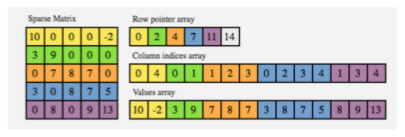

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))
lu1 = mplt.image.imread("./images/csr-illustration.png")
ax.imshow(lu1)
ax.axis('off')
plt.savefig("./images/csr-illustration.svg", dpi=300, bbox_inches='tight')

## References

1. [TF-IDF : A visual explainer and Python Implementation on Presidential Inauguration Speeches](https://towardsdatascience.com/tf-idf-a-visual-explainer-and-python-implementation-on-presidential-inauguration-speeches-2a7671168550)

2. [Scipy Sparse Matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html)